### 1. Повторениче чужой архитектуры.

В этом ноутбуке реализована архитектура tiny pix2pix на pytorch, за основу взят этот репозиторий https://github.com/vrkh1996/tiny-pix2pix, с реализацией на tensorflow.

**Суть**: обучим модель на генерацию картинок размером 32x32 из/для датасета CIFAR10.

Загружаем необходимые библиотеки.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim


Версии использованных библиотек:

In [3]:
print('torch:', torch.__version__)
print('torchvision:', torchvision.__version__)

torch: 1.7.0+cu101
torchvision: 0.8.1+cu101


torch: 1.7.0+cu101

torchvision: 0.8.1+cu101

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


В качестве генератора будем использовать UNet.

In [5]:
class Generator(nn.Module):    
    def __init__(self):
        super(Generator, self).__init__()
        # Generator - UNet
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        
        self.conv5_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
        self.up6 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.conv6_1 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.conv6_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        
        self.up7 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.conv7_1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.conv7_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
        self.up8 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.conv8_1 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.conv8_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        
        self.up9 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.conv9_1 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.conv9_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv9_3 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1)

        
    def forward(self, x):
        conv1 = nn.ReLU()(self.conv1_1(x))
        conv1 = nn.ReLU()(self.conv1_2(conv1))
        pool1 = nn.MaxPool2d(kernel_size=(2, 2))(conv1)
        conv2 = nn.ReLU()(self.conv2_1(pool1))
        conv2 = nn.ReLU()(self.conv2_2(conv2))
        pool2 = nn.MaxPool2d(kernel_size=(2, 2))(conv2)
        conv3 = nn.ReLU()(self.conv3_1(pool2))
        conv3 = nn.ReLU()(self.conv3_2(conv3))
        pool3 = nn.MaxPool2d(kernel_size=(2, 2))(conv3)
        conv4 = nn.ReLU()(self.conv4_1(pool3))
        conv4 = nn.ReLU()(self.conv4_2(conv4))
        drop4 = nn.Dropout2d(0.5)(conv4)
        pool4 = nn.MaxPool2d(kernel_size=(2, 2))(drop4)
        
        conv5 = nn.ReLU()(self.conv5_1(pool4))
        conv5 = nn.ReLU()(self.conv5_2(conv5))
        drop5 = nn.Dropout2d(0.5)(conv5)
        
        up6 = nn.Upsample(scale_factor=2, mode='nearest')(drop5)
        up6 = nn.ReLU()(self.up6(up6))
        merge6 = torch.cat([drop4, up6], dim=1)
        conv6 = nn.ReLU()(self.conv6_1(merge6))
        conv6 = nn.ReLU()(self.conv6_2(conv6))
        
        up7 = nn.Upsample(scale_factor=2, mode='nearest')(conv6)
        up7 = nn.ReLU()(self.up7(up7))
        merge7 = torch.cat([conv3, up7], dim=1)
        conv7 = nn.ReLU()(self.conv7_1(merge7))
        conv7 = nn.ReLU()(self.conv7_2(conv7))
        
        up8 = nn.Upsample(scale_factor=2, mode='nearest')(conv7)
        up8 = nn.ReLU()(self.up8(up8))
        merge8 = torch.cat([conv2, up8], dim=1)
        conv8 = nn.ReLU()(self.conv8_1(merge8))
        conv8 = nn.ReLU()(self.conv8_2(conv8))
        
        up9 = nn.Upsample(scale_factor=2, mode='nearest')(conv8)
        up9 = nn.ReLU()(self.up9(up9))
        merge9 = torch.cat([conv1, up9], dim=1)
        conv9 = nn.ReLU()(self.conv9_1(merge9))
        conv9 = nn.ReLU()(self.conv9_2(conv9))
        conv9 = nn.Tanh()(self.conv9_3(conv9))
        
        return conv9

In [6]:
generator = Generator()

In [7]:
print(generator)

Generator(
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up6): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6_1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6_2): Conv2d(128, 128, kerne

Проверим, что Генератор будет делать с рендомным рисунком:

In [8]:
input = torch.randn(1, 3, 32, 32)

In [9]:
generator(input).shape

torch.Size([1, 3, 32, 32])

Какой-то дискриминатор. В оригинальной работе он называется PatchGAN, т. к. делит рисунок на части (патчи) и для каждой части возвращает вероятность того, что рисунок принадлежит нужному классу (класс задаётся вторым рисунком).

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Discriminator - PatchGAN
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=64, kernel_size=3, stride=2)
        self.relu1 = nn.LeakyReLU(negative_slope=0.2)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(128, momentum=0.8)
        self.relu2 = nn.LeakyReLU(negative_slope=0.2)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(256, momentum=0.8)
        self.relu3 = nn.LeakyReLU(negative_slope=0.2)
        
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(512, momentum=0.8)
        self.relu4 = nn.LeakyReLU(negative_slope=0.2)
        
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=3, padding=1)

        
    def forward(self, source_image, target_image):
        merged = torch.cat([source_image, target_image], dim=1)
        
        x = self.conv1(merged)
        x = self.relu1(x)
        x = nn.Dropout2d(0.25)(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = nn.Dropout2d(0.25)(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = nn.Dropout2d(0.25)(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = nn.Dropout2d(0.25)(x)
        
        x = self.conv5(x)
        # Sigmoid, т. к. возвращать будем вероятности того, что кусочек рисунка принадлежит нужному классу.
        x = nn.Sigmoid()(x) 
        
        return x

In [11]:
discriminator = Discriminator()

In [12]:
print(discriminator)

Discriminator(
  (conv1): Conv2d(6, 64, kernel_size=(3, 3), stride=(2, 2))
  (relu1): LeakyReLU(negative_slope=0.2)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.2)
  (conv5): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


Проверим, что Дискриминатор будет делать с рендомным рисунком:


In [13]:
input = torch.randn(1, 3, 32, 32)

In [14]:
discriminator(input, input).shape

torch.Size([1, 1, 9, 9])

Цикл обучения pix2pix.

In [15]:
def real_samples(dataset, batchsize):
    ix = np.random.randint(0, dataset.shape[0], batchsize)
    x_realA, x_realB = dataset[ix], dataset[ix]
    # 'real' class labels == 1
    y_real = np.ones((batchsize, 1, 9, 9))

    return [x_realA, x_realB], y_real


def fake_samples(x_real):
    x_fake = generator(x_real)
    # 'fake' class labels == 0
    y_fake = np.zeros((len(x_fake), 1, 9, 9))

    return x_fake, y_fake

In [16]:
generator = Generator()
generator.to(device)
#
discriminator = Discriminator()
discriminator.to(device)

Discriminator(
  (conv1): Conv2d(6, 64, kernel_size=(3, 3), stride=(2, 2))
  (relu1): LeakyReLU(negative_slope=0.2)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.2)
  (conv5): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# загружаем дадасет CIFAR10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=1)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [18]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# shuffle=True - так надо
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=1)

Files already downloaded and verified


In [ ]:
G_criterion = nn.L1Loss()
G_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
#
D_criterion = nn.BCELoss()
D_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4)

In [ ]:
from tqdm import tqdm 

batchsize = 32
epochs = 1

for epoch in range(epochs):  # loop over the dataset multiple times
    for i, data in tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        
        # select a batch of real samples
        [x_realA, x_realB], y_real = real_samples(inputs, batchsize)
        # generate a batch of fake samples
        x_fakeB, y_fake = fake_samples(x_realA)
        
        x_realA = x_realA.to(device)
        x_realB = x_realB.to(device)
        x_fakeB = x_fakeB.to(device)
        y_real = torch.Tensor(y_real).to(device)
        y_fake = torch.Tensor(y_fake).to(device)

        
        # update discriminator for real samples
        D_optimizer.zero_grad()
        outputs = discriminator(x_realA, x_realB)
        loss = D_criterion(outputs, y_real)
        loss.backward()
        D_optimizer.step()
        d_loss1 = loss.item()
        
        # update discriminator for generated samples
        D_optimizer.zero_grad()
        outputs = discriminator(x_realA, x_fakeB)
        loss = D_criterion(outputs, y_fake)
        loss.backward()
        D_optimizer.step()
        d_loss2 = loss.item()  
        
        # update the generator
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()
        
        G_outputs = generator(x_realA)
        D_outputs = discriminator(x_realA, G_outputs)
        
        G_loss = G_criterion(G_outputs, x_realB)
        D_loss = D_criterion(D_outputs, y_real)
        
        loss = 100 * G_loss + D_loss
        loss.backward()
        #D_optimizer.step()
        G_optimizer.step()
        g_loss = loss.item()
        
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i + 1, d_loss1, d_loss2, g_loss))

print('Finished Training')

3it [00:00,  4.90it/s]

>1, d1[0.779] d2[0.759] g[39.602]
>2, d1[0.669] d2[0.754] g[40.555]
>3, d1[0.685] d2[0.747] g[41.767]


7it [00:00,  7.70it/s]

>4, d1[0.705] d2[0.783] g[39.908]
>5, d1[0.675] d2[0.737] g[37.073]
>6, d1[0.669] d2[0.782] g[49.255]
>7, d1[0.670] d2[0.750] g[48.603]


11it [00:00, 10.85it/s]

>8, d1[0.691] d2[0.721] g[48.387]
>9, d1[0.674] d2[0.731] g[24.305]
>10, d1[0.697] d2[0.738] g[32.009]
>11, d1[0.674] d2[0.736] g[39.536]


15it [00:01, 13.36it/s]

>12, d1[0.694] d2[0.753] g[45.606]
>13, d1[0.700] d2[0.739] g[52.634]
>14, d1[0.653] d2[0.683] g[58.743]
>15, d1[0.683] d2[0.773] g[55.453]


19it [00:01, 15.29it/s]

>16, d1[0.704] d2[0.745] g[38.097]
>17, d1[0.696] d2[0.721] g[59.143]
>18, d1[0.713] d2[0.701] g[47.355]
>19, d1[0.709] d2[0.705] g[38.671]


23it [00:01, 16.53it/s]

>20, d1[0.708] d2[0.711] g[27.214]
>21, d1[0.712] d2[0.736] g[60.465]
>22, d1[0.698] d2[0.680] g[35.896]
>23, d1[0.714] d2[0.699] g[44.374]


27it [00:01, 17.11it/s]

>24, d1[0.709] d2[0.714] g[29.096]
>25, d1[0.710] d2[0.735] g[42.985]
>26, d1[0.761] d2[0.710] g[34.277]
>27, d1[0.718] d2[0.695] g[33.195]


31it [00:02, 17.31it/s]

>28, d1[0.733] d2[0.720] g[33.444]
>29, d1[0.710] d2[0.698] g[24.602]
>30, d1[0.720] d2[0.700] g[41.664]
>31, d1[0.693] d2[0.711] g[35.459]


35it [00:02, 17.41it/s]

>32, d1[0.737] d2[0.697] g[28.245]
>33, d1[0.715] d2[0.740] g[19.475]
>34, d1[0.701] d2[0.732] g[44.467]
>35, d1[0.735] d2[0.678] g[20.206]


39it [00:02, 17.56it/s]

>36, d1[0.707] d2[0.716] g[52.712]
>37, d1[0.708] d2[0.696] g[48.744]
>38, d1[0.695] d2[0.686] g[27.583]
>39, d1[0.714] d2[0.699] g[36.577]


43it [00:02, 17.66it/s]

>40, d1[0.709] d2[0.711] g[34.034]
>41, d1[0.727] d2[0.720] g[33.290]
>42, d1[0.692] d2[0.696] g[25.334]
>43, d1[0.731] d2[0.702] g[36.953]


47it [00:02, 17.76it/s]

>44, d1[0.716] d2[0.692] g[35.677]
>45, d1[0.730] d2[0.715] g[49.798]
>46, d1[0.719] d2[0.697] g[24.261]
>47, d1[0.721] d2[0.698] g[23.464]


51it [00:03, 17.79it/s]

>48, d1[0.704] d2[0.706] g[35.195]
>49, d1[0.678] d2[0.707] g[29.130]
>50, d1[0.716] d2[0.712] g[28.833]
>51, d1[0.752] d2[0.675] g[24.611]


55it [00:03, 17.25it/s]

>52, d1[0.723] d2[0.699] g[25.246]
>53, d1[0.702] d2[0.699] g[34.130]
>54, d1[0.723] d2[0.711] g[41.835]
>55, d1[0.708] d2[0.728] g[27.829]


59it [00:03, 16.97it/s]

>56, d1[0.706] d2[0.714] g[19.920]
>57, d1[0.684] d2[0.701] g[23.109]
>58, d1[0.701] d2[0.709] g[29.275]
>59, d1[0.702] d2[0.697] g[23.440]


63it [00:03, 16.75it/s]

>60, d1[0.707] d2[0.714] g[21.301]
>61, d1[0.695] d2[0.699] g[18.107]
>62, d1[0.731] d2[0.695] g[22.701]
>63, d1[0.702] d2[0.716] g[21.420]


67it [00:04, 16.88it/s]

>64, d1[0.708] d2[0.727] g[28.933]
>65, d1[0.678] d2[0.710] g[30.351]
>66, d1[0.699] d2[0.709] g[18.637]
>67, d1[0.666] d2[0.712] g[11.414]


71it [00:04, 16.70it/s]

>68, d1[0.724] d2[0.691] g[15.221]
>69, d1[0.742] d2[0.700] g[25.730]
>70, d1[0.713] d2[0.692] g[28.612]
>71, d1[0.740] d2[0.719] g[21.172]


75it [00:04, 16.82it/s]

>72, d1[0.722] d2[0.688] g[29.015]
>73, d1[0.703] d2[0.687] g[16.623]
>74, d1[0.719] d2[0.704] g[13.039]
>75, d1[0.724] d2[0.684] g[20.850]


79it [00:04, 16.96it/s]

>76, d1[0.686] d2[0.681] g[16.318]
>77, d1[0.712] d2[0.711] g[25.468]
>78, d1[0.709] d2[0.693] g[23.981]
>79, d1[0.699] d2[0.682] g[18.997]


83it [00:05, 17.15it/s]

>80, d1[0.716] d2[0.697] g[23.165]
>81, d1[0.730] d2[0.733] g[24.594]
>82, d1[0.722] d2[0.705] g[25.040]
>83, d1[0.722] d2[0.700] g[32.960]


87it [00:05, 17.44it/s]

>84, d1[0.696] d2[0.729] g[21.536]
>85, d1[0.703] d2[0.710] g[25.351]
>86, d1[0.684] d2[0.710] g[17.361]
>87, d1[0.717] d2[0.708] g[36.108]


91it [00:05, 17.37it/s]

>88, d1[0.694] d2[0.683] g[21.095]
>89, d1[0.727] d2[0.721] g[24.141]
>90, d1[0.697] d2[0.720] g[25.613]
>91, d1[0.720] d2[0.722] g[16.012]


95it [00:05, 17.38it/s]

>92, d1[0.732] d2[0.706] g[22.868]
>93, d1[0.697] d2[0.700] g[20.336]
>94, d1[0.700] d2[0.730] g[26.325]
>95, d1[0.697] d2[0.679] g[18.885]


99it [00:05, 17.55it/s]

>96, d1[0.702] d2[0.702] g[22.062]
>97, d1[0.687] d2[0.703] g[18.499]
>98, d1[0.710] d2[0.720] g[16.405]
>99, d1[0.706] d2[0.739] g[12.415]


103it [00:06, 17.38it/s]

>100, d1[0.698] d2[0.711] g[18.796]
>101, d1[0.698] d2[0.718] g[24.544]
>102, d1[0.724] d2[0.727] g[12.842]
>103, d1[0.700] d2[0.707] g[9.815]


107it [00:06, 17.11it/s]

>104, d1[0.703] d2[0.692] g[14.448]
>105, d1[0.720] d2[0.707] g[21.577]
>106, d1[0.740] d2[0.683] g[21.103]
>107, d1[0.697] d2[0.700] g[18.860]


111it [00:06, 16.95it/s]

>108, d1[0.722] d2[0.700] g[23.243]
>109, d1[0.726] d2[0.692] g[23.366]
>110, d1[0.704] d2[0.714] g[11.068]
>111, d1[0.711] d2[0.705] g[18.794]


115it [00:06, 16.97it/s]

>112, d1[0.698] d2[0.709] g[12.210]
>113, d1[0.723] d2[0.710] g[18.416]
>114, d1[0.686] d2[0.690] g[15.779]
>115, d1[0.726] d2[0.697] g[22.868]


119it [00:07, 16.94it/s]

>116, d1[0.701] d2[0.730] g[17.721]
>117, d1[0.731] d2[0.693] g[13.794]
>118, d1[0.704] d2[0.718] g[23.914]
>119, d1[0.699] d2[0.727] g[19.077]


123it [00:07, 16.70it/s]

>120, d1[0.712] d2[0.684] g[15.029]
>121, d1[0.721] d2[0.692] g[16.999]
>122, d1[0.713] d2[0.692] g[20.361]
>123, d1[0.725] d2[0.700] g[10.173]


127it [00:07, 16.74it/s]

>124, d1[0.715] d2[0.710] g[20.543]
>125, d1[0.687] d2[0.731] g[25.606]
>126, d1[0.721] d2[0.710] g[28.742]
>127, d1[0.739] d2[0.740] g[16.235]


131it [00:07, 16.82it/s]

>128, d1[0.730] d2[0.729] g[16.317]
>129, d1[0.743] d2[0.690] g[19.963]
>130, d1[0.711] d2[0.702] g[15.417]
>131, d1[0.703] d2[0.699] g[12.195]


135it [00:08, 17.00it/s]

>132, d1[0.697] d2[0.709] g[12.733]
>133, d1[0.696] d2[0.713] g[10.571]
>134, d1[0.704] d2[0.675] g[18.174]
>135, d1[0.716] d2[0.701] g[13.224]


139it [00:08, 16.91it/s]

>136, d1[0.670] d2[0.723] g[10.873]
>137, d1[0.683] d2[0.688] g[13.587]
>138, d1[0.712] d2[0.739] g[15.577]
>139, d1[0.691] d2[0.719] g[18.239]


143it [00:08, 16.85it/s]

>140, d1[0.717] d2[0.712] g[15.432]
>141, d1[0.718] d2[0.698] g[28.050]
>142, d1[0.708] d2[0.694] g[15.867]
>143, d1[0.689] d2[0.708] g[16.915]


147it [00:08, 17.28it/s]

>144, d1[0.696] d2[0.703] g[21.658]
>145, d1[0.702] d2[0.691] g[11.517]
>146, d1[0.696] d2[0.679] g[31.035]
>147, d1[0.716] d2[0.687] g[16.977]


151it [00:09, 17.29it/s]

>148, d1[0.719] d2[0.696] g[19.450]
>149, d1[0.717] d2[0.736] g[16.934]
>150, d1[0.694] d2[0.694] g[19.168]
>151, d1[0.685] d2[0.715] g[17.932]


155it [00:09, 17.09it/s]

>152, d1[0.691] d2[0.707] g[13.227]
>153, d1[0.689] d2[0.721] g[14.047]
>154, d1[0.722] d2[0.710] g[16.296]
>155, d1[0.694] d2[0.703] g[12.279]


159it [00:09, 17.42it/s]

>156, d1[0.725] d2[0.696] g[19.401]
>157, d1[0.715] d2[0.729] g[13.939]
>158, d1[0.738] d2[0.712] g[15.891]
>159, d1[0.713] d2[0.712] g[13.735]


163it [00:09, 17.54it/s]

>160, d1[0.690] d2[0.705] g[16.833]
>161, d1[0.703] d2[0.682] g[27.092]
>162, d1[0.698] d2[0.691] g[9.518]
>163, d1[0.704] d2[0.689] g[22.039]


167it [00:09, 17.47it/s]

>164, d1[0.706] d2[0.690] g[22.488]
>165, d1[0.697] d2[0.692] g[30.196]
>166, d1[0.741] d2[0.696] g[17.561]
>167, d1[0.740] d2[0.674] g[16.678]


171it [00:10, 17.52it/s]

>168, d1[0.704] d2[0.691] g[20.327]
>169, d1[0.703] d2[0.713] g[25.192]
>170, d1[0.715] d2[0.702] g[18.251]
>171, d1[0.701] d2[0.701] g[11.447]


175it [00:10, 16.94it/s]

>172, d1[0.663] d2[0.707] g[26.412]
>173, d1[0.686] d2[0.727] g[14.371]
>174, d1[0.670] d2[0.740] g[14.809]
>175, d1[0.684] d2[0.702] g[20.763]


179it [00:10, 17.12it/s]

>176, d1[0.692] d2[0.673] g[25.028]
>177, d1[0.712] d2[0.682] g[18.108]
>178, d1[0.729] d2[0.700] g[20.567]
>179, d1[0.709] d2[0.707] g[14.157]


183it [00:10, 17.22it/s]

>180, d1[0.686] d2[0.724] g[16.430]
>181, d1[0.695] d2[0.708] g[19.775]
>182, d1[0.698] d2[0.707] g[20.951]
>183, d1[0.703] d2[0.703] g[10.237]


187it [00:11, 17.39it/s]

>184, d1[0.714] d2[0.688] g[11.236]
>185, d1[0.712] d2[0.687] g[16.955]
>186, d1[0.702] d2[0.714] g[18.988]
>187, d1[0.710] d2[0.679] g[15.008]


191it [00:11, 16.91it/s]

>188, d1[0.701] d2[0.717] g[18.780]
>189, d1[0.704] d2[0.709] g[14.047]
>190, d1[0.691] d2[0.702] g[19.193]
>191, d1[0.695] d2[0.706] g[21.044]


195it [00:11, 16.76it/s]

>192, d1[0.712] d2[0.733] g[23.416]
>193, d1[0.730] d2[0.655] g[13.597]
>194, d1[0.692] d2[0.685] g[20.180]
>195, d1[0.697] d2[0.726] g[15.880]


199it [00:11, 16.79it/s]

>196, d1[0.706] d2[0.696] g[15.121]
>197, d1[0.690] d2[0.709] g[16.944]
>198, d1[0.716] d2[0.699] g[10.366]
>199, d1[0.760] d2[0.706] g[11.174]


203it [00:12, 16.99it/s]

>200, d1[0.705] d2[0.711] g[13.528]
>201, d1[0.695] d2[0.684] g[18.629]
>202, d1[0.742] d2[0.674] g[11.848]
>203, d1[0.704] d2[0.709] g[17.782]


207it [00:12, 17.03it/s]

>204, d1[0.689] d2[0.706] g[12.749]
>205, d1[0.729] d2[0.701] g[12.188]
>206, d1[0.711] d2[0.690] g[33.857]
>207, d1[0.705] d2[0.678] g[16.275]


211it [00:12, 16.84it/s]

>208, d1[0.730] d2[0.693] g[15.074]
>209, d1[0.705] d2[0.702] g[13.835]
>210, d1[0.731] d2[0.694] g[14.622]
>211, d1[0.729] d2[0.712] g[11.565]


215it [00:12, 16.86it/s]

>212, d1[0.697] d2[0.692] g[26.611]
>213, d1[0.700] d2[0.722] g[16.729]
>214, d1[0.702] d2[0.701] g[16.574]
>215, d1[0.731] d2[0.711] g[16.398]


219it [00:13, 16.78it/s]

>216, d1[0.681] d2[0.710] g[15.885]
>217, d1[0.717] d2[0.658] g[13.941]
>218, d1[0.707] d2[0.721] g[19.011]
>219, d1[0.673] d2[0.697] g[14.280]


223it [00:13, 16.79it/s]

>220, d1[0.710] d2[0.714] g[13.402]
>221, d1[0.703] d2[0.702] g[17.776]
>222, d1[0.694] d2[0.725] g[19.092]
>223, d1[0.697] d2[0.703] g[12.187]


227it [00:13, 16.76it/s]

>224, d1[0.688] d2[0.727] g[19.716]
>225, d1[0.690] d2[0.708] g[14.597]
>226, d1[0.692] d2[0.699] g[18.402]
>227, d1[0.710] d2[0.691] g[14.510]


231it [00:13, 16.69it/s]

>228, d1[0.694] d2[0.727] g[25.633]
>229, d1[0.724] d2[0.707] g[9.812]
>230, d1[0.685] d2[0.702] g[17.118]
>231, d1[0.701] d2[0.714] g[20.318]


235it [00:13, 16.78it/s]

>232, d1[0.704] d2[0.695] g[14.412]
>233, d1[0.702] d2[0.701] g[12.988]
>234, d1[0.727] d2[0.686] g[10.633]
>235, d1[0.693] d2[0.718] g[21.057]


239it [00:14, 16.51it/s]

>236, d1[0.704] d2[0.676] g[21.663]
>237, d1[0.698] d2[0.677] g[21.045]
>238, d1[0.712] d2[0.699] g[16.061]
>239, d1[0.718] d2[0.698] g[10.215]


243it [00:14, 16.68it/s]

>240, d1[0.678] d2[0.681] g[28.765]
>241, d1[0.698] d2[0.685] g[18.674]
>242, d1[0.696] d2[0.700] g[23.723]
>243, d1[0.700] d2[0.715] g[19.284]


247it [00:14, 16.82it/s]

>244, d1[0.686] d2[0.701] g[15.438]
>245, d1[0.667] d2[0.674] g[17.529]
>246, d1[0.681] d2[0.687] g[11.538]
>247, d1[0.669] d2[0.690] g[18.762]


251it [00:14, 16.76it/s]

>248, d1[0.704] d2[0.667] g[13.205]
>249, d1[0.685] d2[0.675] g[15.037]
>250, d1[0.700] d2[0.669] g[20.455]
>251, d1[0.684] d2[0.690] g[19.709]


255it [00:15, 16.58it/s]

>252, d1[0.712] d2[0.694] g[12.945]
>253, d1[0.683] d2[0.714] g[17.468]
>254, d1[0.713] d2[0.659] g[17.597]
>255, d1[0.741] d2[0.686] g[17.716]


259it [00:15, 16.53it/s]

>256, d1[0.704] d2[0.693] g[22.587]
>257, d1[0.695] d2[0.713] g[16.914]
>258, d1[0.713] d2[0.714] g[16.266]
>259, d1[0.687] d2[0.694] g[14.091]


263it [00:15, 16.54it/s]

>260, d1[0.699] d2[0.709] g[12.512]
>261, d1[0.686] d2[0.701] g[14.235]
>262, d1[0.719] d2[0.685] g[12.042]
>263, d1[0.691] d2[0.710] g[15.982]


267it [00:15, 16.55it/s]

>264, d1[0.714] d2[0.708] g[14.694]
>265, d1[0.694] d2[0.676] g[21.363]
>266, d1[0.679] d2[0.724] g[20.150]
>267, d1[0.678] d2[0.690] g[20.240]


271it [00:16, 16.43it/s]

>268, d1[0.709] d2[0.699] g[10.348]
>269, d1[0.726] d2[0.665] g[12.671]
>270, d1[0.673] d2[0.705] g[17.859]
>271, d1[0.685] d2[0.677] g[15.677]


275it [00:16, 16.94it/s]

>272, d1[0.680] d2[0.691] g[13.642]
>273, d1[0.715] d2[0.704] g[22.334]
>274, d1[0.682] d2[0.710] g[16.589]
>275, d1[0.695] d2[0.694] g[20.971]


279it [00:16, 17.21it/s]

>276, d1[0.730] d2[0.683] g[12.652]
>277, d1[0.676] d2[0.700] g[14.725]
>278, d1[0.701] d2[0.650] g[12.304]
>279, d1[0.699] d2[0.654] g[21.071]


283it [00:16, 17.28it/s]

>280, d1[0.676] d2[0.676] g[11.557]
>281, d1[0.708] d2[0.657] g[11.958]
>282, d1[0.697] d2[0.682] g[8.254]
>283, d1[0.709] d2[0.688] g[10.151]


287it [00:17, 17.42it/s]

>284, d1[0.670] d2[0.716] g[16.013]
>285, d1[0.691] d2[0.687] g[16.891]
>286, d1[0.713] d2[0.697] g[21.966]
>287, d1[0.688] d2[0.721] g[13.107]


291it [00:17, 17.39it/s]

>288, d1[0.683] d2[0.689] g[13.253]
>289, d1[0.694] d2[0.707] g[13.155]
>290, d1[0.675] d2[0.698] g[16.921]
>291, d1[0.638] d2[0.672] g[14.883]


295it [00:17, 17.38it/s]

>292, d1[0.677] d2[0.635] g[14.479]
>293, d1[0.717] d2[0.666] g[15.978]
>294, d1[0.685] d2[0.691] g[16.253]
>295, d1[0.720] d2[0.662] g[16.032]


299it [00:17, 17.40it/s]

>296, d1[0.678] d2[0.679] g[13.131]
>297, d1[0.709] d2[0.675] g[14.066]
>298, d1[0.683] d2[0.722] g[11.624]
>299, d1[0.699] d2[0.669] g[14.732]


303it [00:17, 17.30it/s]

>300, d1[0.670] d2[0.702] g[11.430]
>301, d1[0.687] d2[0.639] g[16.936]
>302, d1[0.704] d2[0.657] g[13.000]
>303, d1[0.674] d2[0.674] g[12.948]


307it [00:18, 16.77it/s]

>304, d1[0.692] d2[0.702] g[12.620]
>305, d1[0.687] d2[0.729] g[15.575]
>306, d1[0.681] d2[0.626] g[12.743]
>307, d1[0.690] d2[0.671] g[20.651]


311it [00:18, 16.64it/s]

>308, d1[0.725] d2[0.692] g[15.307]
>309, d1[0.699] d2[0.679] g[14.177]
>310, d1[0.697] d2[0.657] g[13.309]
>311, d1[0.689] d2[0.686] g[16.159]


315it [00:18, 16.45it/s]

>312, d1[0.671] d2[0.698] g[14.552]
>313, d1[0.641] d2[0.710] g[22.186]
>314, d1[0.683] d2[0.696] g[13.723]
>315, d1[0.668] d2[0.680] g[18.335]


319it [00:18, 16.98it/s]

>316, d1[0.678] d2[0.719] g[34.414]
>317, d1[0.668] d2[0.687] g[12.305]
>318, d1[0.689] d2[0.686] g[14.796]
>319, d1[0.715] d2[0.707] g[13.508]


323it [00:19, 17.04it/s]

>320, d1[0.684] d2[0.668] g[15.940]
>321, d1[0.674] d2[0.700] g[12.770]
>322, d1[0.735] d2[0.679] g[15.105]
>323, d1[0.678] d2[0.676] g[15.936]


327it [00:19, 16.76it/s]

>324, d1[0.696] d2[0.643] g[14.297]
>325, d1[0.710] d2[0.681] g[12.030]
>326, d1[0.717] d2[0.674] g[14.429]
>327, d1[0.715] d2[0.678] g[11.596]


331it [00:19, 16.62it/s]

>328, d1[0.694] d2[0.672] g[9.660]
>329, d1[0.718] d2[0.731] g[10.035]
>330, d1[0.663] d2[0.667] g[12.613]
>331, d1[0.654] d2[0.691] g[17.573]


335it [00:19, 16.49it/s]

>332, d1[0.651] d2[0.734] g[27.691]
>333, d1[0.716] d2[0.663] g[17.398]
>334, d1[0.657] d2[0.665] g[16.012]
>335, d1[0.680] d2[0.633] g[24.820]


339it [00:20, 16.52it/s]

>336, d1[0.788] d2[0.591] g[18.918]
>337, d1[0.619] d2[0.727] g[20.964]
>338, d1[0.632] d2[0.642] g[13.556]
>339, d1[0.673] d2[0.693] g[17.346]


343it [00:20, 16.81it/s]

>340, d1[0.676] d2[0.677] g[14.509]
>341, d1[0.664] d2[0.692] g[15.513]
>342, d1[0.670] d2[0.644] g[16.790]
>343, d1[0.655] d2[0.618] g[16.206]


347it [00:20, 17.04it/s]

>344, d1[0.676] d2[0.676] g[9.896]
>345, d1[0.807] d2[0.567] g[14.133]
>346, d1[0.589] d2[0.690] g[34.965]
>347, d1[0.664] d2[0.633] g[17.911]


351it [00:20, 17.06it/s]

>348, d1[0.688] d2[0.702] g[12.254]
>349, d1[0.726] d2[0.678] g[18.830]
>350, d1[0.662] d2[0.688] g[13.964]
>351, d1[0.737] d2[0.678] g[13.836]


355it [00:21, 17.27it/s]

>352, d1[0.678] d2[0.683] g[18.589]
>353, d1[0.651] d2[0.705] g[11.585]
>354, d1[0.707] d2[0.621] g[15.768]
>355, d1[0.656] d2[0.693] g[15.282]


359it [00:21, 16.83it/s]

>356, d1[0.618] d2[0.701] g[18.081]
>357, d1[0.703] d2[0.665] g[16.107]
>358, d1[0.647] d2[0.658] g[19.608]
>359, d1[0.747] d2[0.681] g[11.020]


363it [00:21, 16.57it/s]

>360, d1[0.646] d2[0.671] g[15.431]
>361, d1[0.696] d2[0.582] g[15.031]
>362, d1[0.669] d2[0.646] g[15.000]
>363, d1[0.681] d2[0.682] g[15.431]


367it [00:21, 16.70it/s]

>364, d1[0.628] d2[0.695] g[15.295]
>365, d1[0.714] d2[0.632] g[16.579]
>366, d1[0.777] d2[0.627] g[9.370]
>367, d1[0.650] d2[0.726] g[11.710]


371it [00:22, 16.94it/s]

>368, d1[0.592] d2[0.647] g[14.656]
>369, d1[0.655] d2[0.647] g[13.677]
>370, d1[0.660] d2[0.718] g[13.432]
>371, d1[0.680] d2[0.698] g[12.273]


375it [00:22, 16.93it/s]

>372, d1[0.663] d2[0.605] g[16.126]
>373, d1[0.672] d2[0.647] g[13.483]
>374, d1[0.694] d2[0.689] g[22.657]
>375, d1[0.658] d2[0.636] g[11.919]


379it [00:22, 16.65it/s]

>376, d1[0.687] d2[0.738] g[23.252]
>377, d1[0.674] d2[0.625] g[34.210]
>378, d1[0.661] d2[0.540] g[13.245]
>379, d1[0.669] d2[0.535] g[16.842]


383it [00:22, 16.66it/s]

>380, d1[0.739] d2[0.635] g[20.798]
>381, d1[0.660] d2[0.654] g[12.846]
>382, d1[0.695] d2[0.680] g[17.880]
>383, d1[0.686] d2[0.549] g[11.362]


387it [00:22, 16.91it/s]

>384, d1[0.621] d2[0.614] g[16.480]
>385, d1[0.676] d2[0.608] g[15.089]
>386, d1[0.685] d2[0.619] g[9.102]
>387, d1[0.617] d2[0.637] g[11.789]


391it [00:23, 16.91it/s]

>388, d1[0.642] d2[0.699] g[13.090]
>389, d1[0.664] d2[0.514] g[9.926]
>390, d1[0.670] d2[0.572] g[13.513]
>391, d1[0.618] d2[0.704] g[12.673]


395it [00:23, 16.74it/s]

>392, d1[0.639] d2[0.553] g[17.037]
>393, d1[0.651] d2[0.612] g[12.681]
>394, d1[0.612] d2[0.629] g[9.200]
>395, d1[0.626] d2[0.647] g[15.738]


399it [00:23, 16.77it/s]

>396, d1[0.625] d2[0.693] g[24.981]
>397, d1[0.653] d2[0.488] g[16.588]
>398, d1[0.604] d2[0.617] g[16.804]
>399, d1[0.563] d2[0.516] g[15.785]


403it [00:23, 16.57it/s]

>400, d1[0.558] d2[0.627] g[15.013]
>401, d1[0.652] d2[0.510] g[11.783]
>402, d1[0.714] d2[0.625] g[10.502]
>403, d1[0.641] d2[0.785] g[17.363]


407it [00:24, 16.42it/s]

>404, d1[0.623] d2[0.685] g[13.663]
>405, d1[0.544] d2[0.657] g[13.815]
>406, d1[0.624] d2[0.689] g[11.309]
>407, d1[0.635] d2[0.624] g[13.473]


411it [00:24, 16.45it/s]

>408, d1[0.655] d2[0.720] g[17.189]
>409, d1[0.603] d2[0.556] g[14.485]
>410, d1[0.576] d2[0.560] g[12.821]
>411, d1[0.642] d2[0.663] g[13.247]


415it [00:24, 16.50it/s]

>412, d1[0.616] d2[0.631] g[12.021]
>413, d1[0.557] d2[0.742] g[17.793]
>414, d1[0.672] d2[0.705] g[17.055]
>415, d1[0.615] d2[0.651] g[13.199]


419it [00:24, 16.54it/s]

>416, d1[0.611] d2[0.529] g[9.959]
>417, d1[0.605] d2[0.500] g[19.350]
>418, d1[0.627] d2[0.506] g[15.528]
>419, d1[0.620] d2[0.458] g[18.428]


423it [00:25, 16.81it/s]

>420, d1[0.549] d2[0.530] g[14.941]
>421, d1[0.596] d2[0.638] g[15.766]
>422, d1[0.634] d2[0.571] g[14.273]
>423, d1[0.583] d2[0.505] g[12.349]


427it [00:25, 16.99it/s]

>424, d1[0.603] d2[0.444] g[12.922]
>425, d1[0.642] d2[0.486] g[15.334]
>426, d1[0.624] d2[0.469] g[15.394]
>427, d1[0.607] d2[0.487] g[10.340]


431it [00:25, 16.97it/s]

>428, d1[0.657] d2[0.476] g[11.719]
>429, d1[0.608] d2[0.454] g[15.239]
>430, d1[0.488] d2[0.492] g[14.926]
>431, d1[0.499] d2[0.572] g[9.647]


435it [00:25, 17.10it/s]

>432, d1[0.575] d2[0.421] g[16.609]
>433, d1[0.554] d2[0.560] g[11.577]
>434, d1[0.608] d2[0.524] g[13.891]
>435, d1[0.643] d2[0.570] g[12.250]


439it [00:26, 17.11it/s]

>436, d1[0.538] d2[0.517] g[7.933]
>437, d1[0.551] d2[0.580] g[12.805]
>438, d1[0.602] d2[0.568] g[10.565]
>439, d1[0.763] d2[0.530] g[11.587]


443it [00:26, 16.96it/s]

>440, d1[0.436] d2[0.395] g[10.986]
>441, d1[0.599] d2[0.646] g[15.666]
>442, d1[0.542] d2[0.573] g[12.238]
>443, d1[0.493] d2[0.525] g[13.612]


447it [00:26, 17.13it/s]

>444, d1[0.502] d2[0.386] g[14.389]
>445, d1[0.467] d2[0.526] g[13.631]
>446, d1[0.559] d2[0.796] g[15.823]
>447, d1[0.581] d2[0.475] g[19.013]


451it [00:26, 17.05it/s]

>448, d1[0.514] d2[0.541] g[9.110]
>449, d1[0.561] d2[0.636] g[15.337]
>450, d1[0.547] d2[0.639] g[9.633]
>451, d1[0.592] d2[0.474] g[14.482]


455it [00:27, 17.23it/s]

>452, d1[0.519] d2[0.720] g[11.121]
>453, d1[0.508] d2[0.450] g[13.309]
>454, d1[0.454] d2[0.487] g[14.016]
>455, d1[0.665] d2[0.612] g[15.710]


459it [00:27, 16.73it/s]

>456, d1[0.519] d2[0.391] g[12.568]
>457, d1[0.636] d2[0.513] g[14.505]
>458, d1[0.542] d2[0.744] g[13.927]
>459, d1[0.495] d2[0.342] g[17.444]


463it [00:27, 16.69it/s]

>460, d1[0.496] d2[0.621] g[12.991]
>461, d1[0.539] d2[0.398] g[11.372]
>462, d1[0.505] d2[0.734] g[14.470]
>463, d1[0.507] d2[0.584] g[17.703]


467it [00:27, 16.83it/s]

>464, d1[0.521] d2[0.399] g[12.145]
>465, d1[0.402] d2[0.554] g[14.012]
>466, d1[0.572] d2[0.462] g[11.157]
>467, d1[0.465] d2[0.382] g[13.584]


471it [00:27, 17.10it/s]

>468, d1[0.520] d2[0.487] g[14.277]
>469, d1[0.610] d2[0.420] g[16.615]
>470, d1[0.551] d2[0.546] g[10.478]
>471, d1[0.496] d2[0.505] g[11.883]


475it [00:28, 16.70it/s]

>472, d1[0.462] d2[0.399] g[11.736]
>473, d1[0.445] d2[0.449] g[12.927]
>474, d1[0.526] d2[0.684] g[11.150]
>475, d1[0.687] d2[0.463] g[12.570]


479it [00:28, 16.62it/s]

>476, d1[0.462] d2[0.477] g[13.421]
>477, d1[0.453] d2[0.534] g[13.108]
>478, d1[0.488] d2[0.484] g[12.350]
>479, d1[0.463] d2[0.366] g[12.477]


483it [00:28, 16.50it/s]

>480, d1[0.580] d2[0.545] g[11.511]
>481, d1[0.479] d2[0.425] g[10.913]
>482, d1[0.614] d2[0.613] g[12.849]
>483, d1[0.512] d2[0.467] g[12.473]


487it [00:28, 16.37it/s]

>484, d1[0.402] d2[0.430] g[19.099]
>485, d1[0.447] d2[0.419] g[15.452]
>486, d1[0.510] d2[0.562] g[12.943]
>487, d1[0.525] d2[0.368] g[10.390]


491it [00:29, 16.47it/s]

>488, d1[0.484] d2[0.805] g[15.179]
>489, d1[0.565] d2[0.554] g[9.677]
>490, d1[0.591] d2[0.420] g[10.009]
>491, d1[0.414] d2[0.286] g[13.161]


495it [00:29, 16.73it/s]

>492, d1[0.538] d2[0.292] g[11.682]
>493, d1[0.488] d2[0.353] g[10.534]
>494, d1[0.338] d2[0.560] g[13.127]
>495, d1[0.534] d2[0.600] g[11.658]


499it [00:29, 16.74it/s]

>496, d1[0.582] d2[0.553] g[19.931]
>497, d1[0.562] d2[0.551] g[15.297]
>498, d1[0.615] d2[0.481] g[11.385]
>499, d1[0.460] d2[0.716] g[9.986]


503it [00:29, 16.33it/s]

>500, d1[0.429] d2[0.421] g[13.554]
>501, d1[0.399] d2[0.927] g[10.827]
>502, d1[0.527] d2[1.225] g[16.001]
>503, d1[0.600] d2[0.329] g[10.529]


507it [00:30, 16.33it/s]

>504, d1[0.494] d2[0.352] g[14.804]
>505, d1[0.436] d2[0.336] g[9.888]
>506, d1[0.497] d2[0.340] g[22.440]
>507, d1[0.552] d2[0.445] g[11.539]


511it [00:30, 16.34it/s]

>508, d1[0.592] d2[0.316] g[10.407]
>509, d1[0.497] d2[0.348] g[10.739]
>510, d1[0.477] d2[0.477] g[16.410]
>511, d1[0.615] d2[0.643] g[15.952]


515it [00:30, 16.23it/s]

>512, d1[0.356] d2[0.499] g[11.715]
>513, d1[0.548] d2[0.383] g[13.483]
>514, d1[0.493] d2[0.551] g[9.613]
>515, d1[0.551] d2[0.484] g[11.005]


519it [00:30, 15.89it/s]

>516, d1[0.500] d2[0.490] g[12.703]
>517, d1[0.667] d2[0.547] g[11.387]
>518, d1[0.541] d2[0.422] g[10.699]
>519, d1[1.111] d2[0.353] g[17.282]


523it [00:31, 16.21it/s]

>520, d1[0.524] d2[0.432] g[13.777]
>521, d1[0.519] d2[0.405] g[12.164]
>522, d1[0.421] d2[0.632] g[11.034]
>523, d1[0.745] d2[0.824] g[15.385]


527it [00:31, 16.38it/s]

>524, d1[0.369] d2[0.355] g[10.322]
>525, d1[0.517] d2[0.850] g[10.845]
>526, d1[0.668] d2[0.340] g[13.963]
>527, d1[0.516] d2[0.523] g[13.083]


531it [00:31, 16.08it/s]

>528, d1[0.381] d2[0.431] g[10.874]
>529, d1[0.481] d2[0.536] g[15.303]
>530, d1[0.415] d2[0.488] g[14.650]
>531, d1[0.769] d2[0.526] g[10.824]


535it [00:31, 16.12it/s]

>532, d1[0.499] d2[0.612] g[9.600]
>533, d1[0.463] d2[0.342] g[20.606]
>534, d1[0.520] d2[0.577] g[14.591]
>535, d1[0.418] d2[0.535] g[13.988]


539it [00:32, 16.30it/s]

>536, d1[0.456] d2[0.763] g[12.145]
>537, d1[0.515] d2[0.601] g[12.976]
>538, d1[0.529] d2[0.988] g[13.675]
>539, d1[0.383] d2[0.617] g[17.626]


543it [00:32, 16.15it/s]

>540, d1[0.528] d2[0.782] g[17.837]
>541, d1[0.507] d2[0.458] g[10.301]
>542, d1[0.392] d2[0.320] g[10.406]
>543, d1[0.460] d2[0.386] g[12.814]


547it [00:32, 16.48it/s]

>544, d1[0.514] d2[0.741] g[11.961]
>545, d1[0.597] d2[0.838] g[9.693]
>546, d1[0.481] d2[0.846] g[10.756]
>547, d1[0.440] d2[0.801] g[10.465]


551it [00:32, 16.67it/s]

>548, d1[0.611] d2[0.292] g[7.713]
>549, d1[0.551] d2[0.461] g[11.623]
>550, d1[0.576] d2[0.367] g[14.418]
>551, d1[0.436] d2[0.417] g[14.719]


555it [00:33, 16.64it/s]

>552, d1[0.487] d2[0.553] g[21.513]
>553, d1[0.541] d2[0.370] g[12.649]
>554, d1[0.511] d2[0.295] g[14.442]
>555, d1[0.529] d2[0.440] g[16.599]


559it [00:33, 16.62it/s]

>556, d1[0.436] d2[0.382] g[13.166]
>557, d1[0.337] d2[0.535] g[12.642]
>558, d1[0.552] d2[0.517] g[17.778]
>559, d1[0.633] d2[0.588] g[13.577]


563it [00:33, 16.95it/s]

>560, d1[0.481] d2[0.496] g[10.263]
>561, d1[0.533] d2[0.476] g[11.756]
>562, d1[0.548] d2[0.339] g[18.514]
>563, d1[0.454] d2[0.600] g[11.488]


567it [00:33, 16.82it/s]

>564, d1[0.442] d2[0.400] g[11.196]
>565, d1[0.426] d2[0.489] g[15.630]
>566, d1[0.533] d2[0.357] g[17.078]
>567, d1[0.724] d2[0.331] g[13.476]


571it [00:34, 16.67it/s]

>568, d1[0.516] d2[0.309] g[12.770]
>569, d1[0.551] d2[0.866] g[12.507]
>570, d1[0.481] d2[0.551] g[11.625]
>571, d1[0.439] d2[0.819] g[14.336]


575it [00:34, 16.71it/s]

>572, d1[0.459] d2[0.578] g[15.292]
>573, d1[0.445] d2[0.411] g[13.287]
>574, d1[0.510] d2[0.394] g[7.736]
>575, d1[0.784] d2[1.118] g[14.200]


579it [00:34, 16.86it/s]

>576, d1[0.546] d2[0.419] g[18.542]
>577, d1[0.558] d2[0.888] g[10.795]
>578, d1[0.473] d2[0.285] g[14.720]
>579, d1[0.501] d2[0.287] g[13.322]


583it [00:34, 16.60it/s]

>580, d1[0.500] d2[0.276] g[12.814]
>581, d1[0.589] d2[1.078] g[9.909]
>582, d1[0.477] d2[0.396] g[14.220]
>583, d1[0.549] d2[0.803] g[8.733]


587it [00:35, 16.68it/s]

>584, d1[0.483] d2[0.537] g[12.435]
>585, d1[0.421] d2[0.830] g[13.402]
>586, d1[0.516] d2[0.903] g[11.986]
>587, d1[0.705] d2[0.817] g[20.458]


591it [00:35, 16.55it/s]

>588, d1[0.602] d2[0.641] g[17.507]
>589, d1[0.464] d2[0.781] g[12.501]
>590, d1[0.478] d2[1.015] g[9.006]
>591, d1[0.631] d2[0.465] g[9.947]


595it [00:35, 16.42it/s]

>592, d1[0.536] d2[0.584] g[11.164]
>593, d1[0.490] d2[0.691] g[17.539]
>594, d1[0.665] d2[0.935] g[9.694]
>595, d1[0.517] d2[0.330] g[11.886]


599it [00:35, 16.53it/s]

>596, d1[0.603] d2[0.265] g[19.694]
>597, d1[0.646] d2[0.442] g[13.837]
>598, d1[0.798] d2[0.201] g[12.603]
>599, d1[0.588] d2[0.555] g[12.944]


603it [00:36, 16.54it/s]

>600, d1[0.626] d2[0.373] g[16.864]
>601, d1[0.541] d2[0.505] g[10.490]
>602, d1[0.545] d2[0.561] g[13.745]
>603, d1[0.642] d2[0.662] g[9.611]


607it [00:36, 16.44it/s]

>604, d1[0.570] d2[0.736] g[16.798]
>605, d1[0.792] d2[0.830] g[13.749]
>606, d1[0.760] d2[1.028] g[13.505]
>607, d1[0.622] d2[0.363] g[11.951]


611it [00:36, 16.51it/s]

>608, d1[0.532] d2[0.722] g[8.869]
>609, d1[0.626] d2[0.367] g[14.067]
>610, d1[0.585] d2[0.380] g[14.373]
>611, d1[0.604] d2[0.771] g[11.381]


615it [00:36, 16.40it/s]

>612, d1[0.602] d2[0.670] g[8.016]
>613, d1[0.490] d2[0.758] g[7.867]
>614, d1[0.457] d2[0.604] g[15.431]
>615, d1[0.658] d2[0.761] g[10.976]


619it [00:36, 16.48it/s]

>616, d1[0.527] d2[0.248] g[9.465]
>617, d1[0.696] d2[0.328] g[13.858]
>618, d1[0.810] d2[0.241] g[11.555]
>619, d1[0.724] d2[0.342] g[11.711]


623it [00:37, 16.58it/s]

>620, d1[0.581] d2[0.461] g[7.628]
>621, d1[0.538] d2[0.988] g[11.514]
>622, d1[0.444] d2[1.268] g[7.664]
>623, d1[0.518] d2[0.432] g[12.825]


627it [00:37, 16.40it/s]

>624, d1[0.513] d2[1.049] g[7.348]
>625, d1[0.637] d2[0.376] g[11.624]
>626, d1[0.526] d2[0.656] g[14.993]
>627, d1[0.447] d2[0.268] g[9.737]


631it [00:37, 16.10it/s]

>628, d1[0.554] d2[0.832] g[9.321]
>629, d1[0.574] d2[0.547] g[12.665]
>630, d1[0.555] d2[0.505] g[7.797]
>631, d1[0.506] d2[0.664] g[10.046]


635it [00:37, 16.18it/s]

>632, d1[0.594] d2[0.664] g[9.264]
>633, d1[0.499] d2[0.876] g[21.422]
>634, d1[0.590] d2[0.653] g[9.557]
>635, d1[0.518] d2[0.243] g[18.450]


639it [00:38, 16.40it/s]

>636, d1[0.688] d2[0.913] g[11.281]
>637, d1[0.561] d2[0.337] g[8.000]
>638, d1[0.661] d2[0.262] g[15.746]
>639, d1[0.581] d2[0.522] g[15.747]


643it [00:38, 16.62it/s]

>640, d1[0.539] d2[0.468] g[12.649]
>641, d1[0.650] d2[0.849] g[15.900]
>642, d1[0.751] d2[0.394] g[10.282]
>643, d1[0.443] d2[0.849] g[12.369]


647it [00:38, 16.96it/s]

>644, d1[0.581] d2[0.501] g[8.691]
>645, d1[0.557] d2[0.397] g[12.307]
>646, d1[0.721] d2[0.427] g[13.349]
>647, d1[0.446] d2[0.634] g[9.462]


651it [00:38, 16.92it/s]

>648, d1[0.442] d2[0.595] g[15.116]
>649, d1[0.795] d2[0.707] g[11.510]
>650, d1[0.495] d2[0.395] g[14.610]
>651, d1[0.468] d2[1.024] g[19.239]


655it [00:39, 16.63it/s]

>652, d1[0.502] d2[0.562] g[13.791]
>653, d1[0.639] d2[0.688] g[11.288]
>654, d1[0.766] d2[0.297] g[9.142]
>655, d1[0.518] d2[0.916] g[8.302]


659it [00:39, 16.90it/s]

>656, d1[0.722] d2[0.464] g[14.237]
>657, d1[0.623] d2[0.733] g[10.230]
>658, d1[0.463] d2[0.308] g[10.266]
>659, d1[0.577] d2[1.136] g[9.224]


663it [00:39, 16.99it/s]

>660, d1[0.795] d2[0.549] g[7.094]
>661, d1[0.592] d2[1.003] g[8.771]
>662, d1[0.609] d2[0.537] g[12.330]
>663, d1[0.564] d2[0.815] g[8.999]


667it [00:39, 16.91it/s]

>664, d1[0.622] d2[0.480] g[12.319]
>665, d1[0.718] d2[0.529] g[13.732]
>666, d1[0.624] d2[1.161] g[28.144]
>667, d1[0.479] d2[0.957] g[13.688]


671it [00:40, 17.05it/s]

>668, d1[0.625] d2[0.532] g[10.273]
>669, d1[0.757] d2[0.497] g[9.564]
>670, d1[0.541] d2[0.439] g[9.388]
>671, d1[0.546] d2[0.969] g[16.237]


675it [00:40, 16.96it/s]

>672, d1[0.614] d2[0.248] g[9.897]
>673, d1[0.657] d2[0.767] g[11.182]
>674, d1[0.711] d2[0.653] g[11.101]
>675, d1[0.612] d2[0.262] g[10.355]


679it [00:40, 16.89it/s]

>676, d1[0.769] d2[0.264] g[10.274]
>677, d1[0.555] d2[0.182] g[18.544]
>678, d1[0.659] d2[0.764] g[12.139]
>679, d1[0.594] d2[0.909] g[12.634]


683it [00:40, 16.87it/s]

>680, d1[0.541] d2[0.440] g[9.853]
>681, d1[0.553] d2[0.399] g[11.507]
>682, d1[0.498] d2[0.593] g[9.524]
>683, d1[0.628] d2[0.310] g[12.001]


687it [00:41, 17.00it/s]

>684, d1[0.617] d2[0.416] g[10.328]
>685, d1[0.607] d2[1.042] g[9.321]
>686, d1[0.686] d2[0.936] g[9.139]
>687, d1[0.584] d2[0.721] g[12.166]


691it [00:41, 16.70it/s]

>688, d1[0.627] d2[0.689] g[14.988]
>689, d1[0.550] d2[0.546] g[14.173]
>690, d1[0.841] d2[0.981] g[9.873]
>691, d1[0.578] d2[0.336] g[18.867]


695it [00:41, 16.61it/s]

>692, d1[0.568] d2[0.540] g[11.787]
>693, d1[0.532] d2[0.499] g[7.815]
>694, d1[0.543] d2[0.506] g[11.771]
>695, d1[0.606] d2[0.762] g[9.269]


699it [00:41, 16.46it/s]

>696, d1[0.620] d2[0.763] g[13.100]
>697, d1[0.583] d2[0.519] g[7.633]
>698, d1[0.525] d2[0.602] g[7.105]
>699, d1[0.625] d2[0.952] g[9.898]


703it [00:42, 16.10it/s]

>700, d1[0.648] d2[1.046] g[11.256]
>701, d1[0.597] d2[0.967] g[8.069]
>702, d1[0.650] d2[0.803] g[16.930]
>703, d1[0.720] d2[0.302] g[13.577]


707it [00:42, 16.67it/s]

>704, d1[0.613] d2[0.394] g[12.715]
>705, d1[0.567] d2[0.486] g[11.904]
>706, d1[0.695] d2[0.365] g[10.792]
>707, d1[0.670] d2[0.479] g[10.920]


711it [00:42, 16.69it/s]

>708, d1[0.579] d2[0.654] g[9.885]
>709, d1[0.568] d2[0.679] g[13.071]
>710, d1[0.566] d2[0.444] g[16.005]
>711, d1[0.648] d2[1.007] g[8.405]


715it [00:42, 16.35it/s]

>712, d1[0.595] d2[0.505] g[10.220]
>713, d1[0.611] d2[0.521] g[8.242]
>714, d1[0.631] d2[0.314] g[13.317]
>715, d1[0.606] d2[0.459] g[9.444]


719it [00:43, 16.50it/s]

>716, d1[0.546] d2[0.272] g[13.914]
>717, d1[0.597] d2[0.799] g[10.582]
>718, d1[0.607] d2[0.361] g[10.914]
>719, d1[0.704] d2[0.401] g[12.177]


723it [00:43, 16.68it/s]

>720, d1[0.602] d2[0.717] g[12.047]
>721, d1[0.646] d2[0.385] g[15.791]
>722, d1[0.636] d2[0.930] g[15.501]
>723, d1[0.502] d2[0.537] g[10.344]


727it [00:43, 16.64it/s]

>724, d1[0.467] d2[0.702] g[12.622]
>725, d1[0.491] d2[0.766] g[14.076]
>726, d1[0.563] d2[0.462] g[10.650]
>727, d1[0.550] d2[0.340] g[13.879]


731it [00:43, 16.63it/s]

>728, d1[0.616] d2[0.371] g[10.596]
>729, d1[0.635] d2[0.777] g[13.309]
>730, d1[0.509] d2[0.634] g[9.590]
>731, d1[0.544] d2[0.422] g[12.240]


735it [00:43, 16.74it/s]

>732, d1[0.596] d2[0.594] g[9.109]
>733, d1[0.574] d2[0.537] g[8.810]
>734, d1[0.565] d2[0.495] g[13.268]
>735, d1[0.588] d2[0.693] g[10.224]


739it [00:44, 16.62it/s]

>736, d1[0.597] d2[0.388] g[13.076]
>737, d1[0.600] d2[0.616] g[9.563]
>738, d1[0.519] d2[0.586] g[12.161]
>739, d1[0.554] d2[0.663] g[7.488]


743it [00:44, 16.45it/s]

>740, d1[0.609] d2[0.555] g[17.560]
>741, d1[0.575] d2[0.423] g[13.055]
>742, d1[0.496] d2[0.540] g[8.529]
>743, d1[0.599] d2[1.022] g[7.892]


747it [00:44, 16.52it/s]

>744, d1[0.556] d2[0.696] g[13.359]
>745, d1[0.515] d2[1.066] g[9.997]
>746, d1[0.565] d2[0.788] g[8.339]
>747, d1[0.588] d2[0.534] g[16.714]


751it [00:44, 16.30it/s]

>748, d1[0.692] d2[0.281] g[12.969]
>749, d1[0.665] d2[0.521] g[12.759]
>750, d1[0.462] d2[0.677] g[13.991]
>751, d1[0.545] d2[0.493] g[10.192]


755it [00:45, 16.22it/s]

>752, d1[0.645] d2[0.566] g[10.257]
>753, d1[0.566] d2[0.427] g[10.269]
>754, d1[0.665] d2[0.527] g[13.048]
>755, d1[0.664] d2[0.626] g[13.505]


759it [00:45, 16.47it/s]

>756, d1[0.579] d2[0.343] g[12.026]
>757, d1[0.623] d2[0.979] g[8.569]
>758, d1[0.573] d2[0.793] g[7.190]
>759, d1[0.527] d2[0.461] g[13.736]


763it [00:45, 16.73it/s]

>760, d1[0.703] d2[0.741] g[15.790]
>761, d1[0.605] d2[0.763] g[9.908]
>762, d1[0.655] d2[0.607] g[7.578]
>763, d1[0.572] d2[0.404] g[10.679]


767it [00:45, 16.73it/s]

>764, d1[0.590] d2[0.732] g[10.253]
>765, d1[0.651] d2[0.650] g[12.288]
>766, d1[0.724] d2[0.607] g[12.046]
>767, d1[0.508] d2[0.520] g[7.566]


771it [00:46, 16.48it/s]

>768, d1[0.523] d2[0.922] g[15.225]
>769, d1[0.652] d2[0.946] g[11.297]
>770, d1[0.634] d2[0.514] g[12.730]
>771, d1[0.681] d2[0.599] g[10.110]


775it [00:46, 16.49it/s]

>772, d1[0.500] d2[0.506] g[10.693]
>773, d1[0.497] d2[0.645] g[16.406]
>774, d1[0.661] d2[0.527] g[10.370]
>775, d1[0.632] d2[0.565] g[10.547]


779it [00:46, 16.63it/s]

>776, d1[0.636] d2[0.585] g[11.205]
>777, d1[0.666] d2[0.643] g[8.116]
>778, d1[0.678] d2[0.547] g[11.110]
>779, d1[0.597] d2[0.687] g[17.629]


783it [00:46, 16.54it/s]

>780, d1[0.598] d2[0.403] g[11.472]
>781, d1[0.627] d2[0.563] g[12.978]
>782, d1[0.578] d2[0.576] g[14.372]
>783, d1[0.613] d2[0.703] g[9.686]


787it [00:47, 16.42it/s]

>784, d1[0.587] d2[0.762] g[13.173]
>785, d1[0.602] d2[0.565] g[12.145]
>786, d1[0.614] d2[0.620] g[9.116]
>787, d1[0.637] d2[0.364] g[11.978]


791it [00:47, 16.49it/s]

>788, d1[0.712] d2[0.495] g[13.782]
>789, d1[0.807] d2[0.593] g[6.831]
>790, d1[0.669] d2[0.604] g[11.300]
>791, d1[0.624] d2[0.778] g[9.555]


795it [00:47, 16.61it/s]

>792, d1[0.651] d2[0.399] g[9.267]
>793, d1[0.523] d2[0.767] g[16.627]
>794, d1[0.578] d2[0.326] g[9.812]
>795, d1[0.612] d2[0.497] g[8.417]


799it [00:47, 16.40it/s]

>796, d1[0.617] d2[0.317] g[12.641]
>797, d1[0.629] d2[0.818] g[11.926]
>798, d1[0.494] d2[0.897] g[11.423]
>799, d1[0.509] d2[0.615] g[12.263]


803it [00:48, 16.63it/s]

>800, d1[0.482] d2[0.657] g[12.638]
>801, d1[0.626] d2[0.785] g[15.215]
>802, d1[0.754] d2[0.584] g[12.643]
>803, d1[0.620] d2[0.561] g[10.982]


807it [00:48, 16.57it/s]

>804, d1[0.545] d2[0.292] g[15.623]
>805, d1[0.743] d2[0.507] g[9.940]
>806, d1[0.659] d2[0.271] g[10.554]
>807, d1[0.649] d2[0.383] g[12.539]


811it [00:48, 16.72it/s]

>808, d1[0.575] d2[0.376] g[7.466]
>809, d1[0.587] d2[0.452] g[12.361]
>810, d1[0.540] d2[1.038] g[10.893]
>811, d1[0.586] d2[1.055] g[12.308]


815it [00:48, 16.33it/s]

>812, d1[0.664] d2[0.655] g[10.352]
>813, d1[0.801] d2[0.513] g[7.860]
>814, d1[0.982] d2[1.001] g[12.284]
>815, d1[0.509] d2[0.600] g[13.411]


819it [00:49, 16.38it/s]

>816, d1[0.601] d2[0.884] g[10.324]
>817, d1[0.574] d2[0.632] g[7.733]
>818, d1[0.866] d2[0.460] g[11.558]
>819, d1[0.535] d2[0.749] g[9.870]


823it [00:49, 16.46it/s]

>820, d1[0.496] d2[0.582] g[14.165]
>821, d1[0.609] d2[0.669] g[6.767]
>822, d1[0.727] d2[0.986] g[8.520]
>823, d1[0.713] d2[0.479] g[14.269]


827it [00:49, 16.40it/s]

>824, d1[0.808] d2[0.654] g[11.205]
>825, d1[0.586] d2[0.685] g[10.996]
>826, d1[0.655] d2[0.527] g[11.013]
>827, d1[0.689] d2[0.474] g[7.203]


831it [00:49, 16.51it/s]

>828, d1[0.604] d2[0.517] g[12.068]
>829, d1[0.677] d2[0.608] g[9.192]
>830, d1[0.596] d2[0.979] g[11.210]
>831, d1[0.606] d2[0.504] g[9.587]


835it [00:50, 16.48it/s]

>832, d1[0.718] d2[0.678] g[10.915]
>833, d1[0.665] d2[0.658] g[10.775]
>834, d1[0.687] d2[0.856] g[9.887]
>835, d1[0.607] d2[0.541] g[7.994]


839it [00:50, 16.55it/s]

>836, d1[0.528] d2[0.733] g[13.637]
>837, d1[0.651] d2[0.848] g[6.211]
>838, d1[0.737] d2[0.457] g[9.364]
>839, d1[0.698] d2[0.515] g[15.961]


843it [00:50, 16.25it/s]

>840, d1[0.632] d2[0.345] g[15.605]
>841, d1[0.658] d2[0.590] g[11.537]
>842, d1[0.576] d2[0.856] g[7.059]
>843, d1[0.635] d2[0.356] g[7.004]


847it [00:50, 16.38it/s]

>844, d1[0.594] d2[0.587] g[10.950]
>845, d1[0.581] d2[0.346] g[9.540]
>846, d1[0.653] d2[0.725] g[6.692]
>847, d1[0.646] d2[0.380] g[10.618]


851it [00:51, 16.45it/s]

>848, d1[0.558] d2[0.582] g[15.706]
>849, d1[0.579] d2[0.652] g[12.039]
>850, d1[0.639] d2[0.690] g[8.972]
>851, d1[0.643] d2[0.453] g[8.893]


855it [00:51, 16.51it/s]

>852, d1[0.634] d2[0.552] g[10.474]
>853, d1[0.603] d2[0.674] g[9.436]
>854, d1[0.554] d2[0.717] g[9.253]
>855, d1[0.732] d2[0.652] g[14.237]


859it [00:51, 16.48it/s]

>856, d1[0.631] d2[0.423] g[8.128]
>857, d1[0.684] d2[0.596] g[10.422]
>858, d1[0.618] d2[0.646] g[13.009]
>859, d1[0.642] d2[0.501] g[9.832]


863it [00:51, 16.45it/s]

>860, d1[0.555] d2[0.771] g[11.017]
>861, d1[0.662] d2[0.767] g[10.124]
>862, d1[0.686] d2[0.630] g[12.496]
>863, d1[0.593] d2[0.385] g[10.571]


867it [00:51, 16.48it/s]

>864, d1[0.609] d2[0.516] g[7.249]
>865, d1[0.601] d2[0.791] g[9.483]
>866, d1[0.575] d2[0.564] g[15.623]
>867, d1[0.607] d2[0.642] g[12.475]


871it [00:52, 16.38it/s]

>868, d1[0.552] d2[0.432] g[12.909]
>869, d1[0.654] d2[0.746] g[9.320]
>870, d1[0.637] d2[0.775] g[13.007]
>871, d1[0.536] d2[0.901] g[8.368]


875it [00:52, 16.53it/s]

>872, d1[0.489] d2[0.346] g[11.913]
>873, d1[0.615] d2[0.485] g[15.711]
>874, d1[0.711] d2[0.657] g[12.273]
>875, d1[0.647] d2[0.574] g[10.469]


879it [00:52, 16.48it/s]

>876, d1[0.589] d2[0.576] g[7.946]
>877, d1[0.727] d2[0.850] g[6.972]
>878, d1[0.637] d2[0.762] g[8.490]
>879, d1[0.688] d2[0.378] g[10.817]


883it [00:52, 16.51it/s]

>880, d1[0.675] d2[0.523] g[15.236]
>881, d1[0.728] d2[0.597] g[9.807]
>882, d1[0.852] d2[0.583] g[12.934]
>883, d1[0.752] d2[0.426] g[10.753]


887it [00:53, 16.46it/s]

>884, d1[0.555] d2[0.800] g[9.485]
>885, d1[0.637] d2[0.639] g[10.552]
>886, d1[0.813] d2[0.636] g[11.713]
>887, d1[0.614] d2[0.334] g[9.535]


891it [00:53, 16.37it/s]

>888, d1[0.556] d2[0.524] g[10.831]
>889, d1[0.544] d2[0.604] g[9.327]
>890, d1[0.689] d2[0.646] g[13.238]
>891, d1[0.748] d2[0.557] g[8.758]


895it [00:53, 16.24it/s]

>892, d1[0.681] d2[0.583] g[16.407]
>893, d1[0.649] d2[1.034] g[4.548]
>894, d1[0.575] d2[0.832] g[6.764]
>895, d1[0.662] d2[0.731] g[8.164]


899it [00:53, 15.72it/s]

>896, d1[0.798] d2[0.721] g[9.930]
>897, d1[0.570] d2[0.717] g[11.475]
>898, d1[0.705] d2[0.739] g[13.006]
>899, d1[0.665] d2[0.444] g[14.571]


903it [00:54, 16.25it/s]

>900, d1[0.636] d2[0.648] g[9.740]
>901, d1[0.649] d2[0.549] g[9.106]
>902, d1[0.657] d2[0.617] g[10.357]
>903, d1[0.604] d2[0.946] g[8.218]


907it [00:54, 16.36it/s]

>904, d1[0.565] d2[0.884] g[16.741]
>905, d1[0.695] d2[0.869] g[13.757]
>906, d1[0.576] d2[0.794] g[13.312]
>907, d1[0.664] d2[0.557] g[11.587]


911it [00:54, 16.36it/s]

>908, d1[0.612] d2[0.693] g[6.655]
>909, d1[0.787] d2[0.541] g[11.605]
>910, d1[0.658] d2[0.564] g[11.325]
>911, d1[0.737] d2[0.442] g[15.052]


915it [00:54, 16.31it/s]

>912, d1[0.716] d2[0.513] g[12.365]
>913, d1[0.726] d2[0.456] g[12.429]
>914, d1[0.594] d2[0.628] g[10.643]
>915, d1[0.614] d2[0.866] g[14.868]


919it [00:55, 16.50it/s]

>916, d1[0.779] d2[0.506] g[9.080]
>917, d1[0.646] d2[0.809] g[11.192]
>918, d1[0.754] d2[0.797] g[10.530]
>919, d1[0.625] d2[0.600] g[8.388]


923it [00:55, 16.32it/s]

>920, d1[0.789] d2[0.510] g[11.172]
>921, d1[0.652] d2[0.719] g[11.025]
>922, d1[0.620] d2[0.512] g[8.611]
>923, d1[0.632] d2[0.659] g[13.945]


927it [00:55, 16.50it/s]

>924, d1[0.805] d2[0.694] g[9.110]
>925, d1[0.655] d2[0.520] g[15.957]
>926, d1[0.690] d2[0.646] g[11.632]
>927, d1[0.872] d2[0.597] g[10.017]


931it [00:55, 16.33it/s]

>928, d1[0.707] d2[0.537] g[9.542]
>929, d1[0.895] d2[0.626] g[6.267]
>930, d1[0.595] d2[0.350] g[12.293]
>931, d1[0.600] d2[0.542] g[19.020]


935it [00:56, 16.51it/s]

>932, d1[0.679] d2[0.865] g[13.824]
>933, d1[0.901] d2[0.506] g[9.829]
>934, d1[0.791] d2[0.730] g[9.210]
>935, d1[0.488] d2[0.532] g[14.806]


939it [00:56, 16.41it/s]

>936, d1[0.590] d2[0.649] g[10.997]
>937, d1[0.671] d2[0.838] g[14.670]
>938, d1[0.561] d2[0.537] g[11.699]
>939, d1[0.598] d2[0.532] g[9.658]


943it [00:56, 16.49it/s]

>940, d1[0.669] d2[0.708] g[9.254]
>941, d1[0.662] d2[0.575] g[14.233]
>942, d1[0.703] d2[0.664] g[13.282]
>943, d1[0.638] d2[0.591] g[9.353]


947it [00:56, 16.49it/s]

>944, d1[0.609] d2[0.949] g[9.609]
>945, d1[0.558] d2[0.678] g[17.235]
>946, d1[1.044] d2[0.461] g[13.092]
>947, d1[0.583] d2[0.573] g[12.281]


951it [00:57, 16.18it/s]

>948, d1[0.628] d2[0.567] g[11.172]
>949, d1[0.651] d2[0.547] g[11.038]
>950, d1[0.636] d2[0.892] g[13.274]
>951, d1[0.575] d2[0.407] g[8.730]


955it [00:57, 16.60it/s]

>952, d1[0.513] d2[0.825] g[10.968]
>953, d1[0.590] d2[0.701] g[9.837]
>954, d1[0.606] d2[0.717] g[9.047]
>955, d1[0.534] d2[0.391] g[12.675]


959it [00:57, 16.57it/s]

>956, d1[0.625] d2[0.666] g[10.979]
>957, d1[0.622] d2[0.746] g[8.096]
>958, d1[0.757] d2[0.546] g[9.890]
>959, d1[0.594] d2[0.510] g[8.385]


963it [00:57, 16.58it/s]

>960, d1[0.654] d2[0.591] g[9.502]
>961, d1[0.757] d2[0.858] g[8.690]
>962, d1[0.684] d2[0.691] g[11.554]
>963, d1[0.698] d2[0.689] g[25.625]


967it [00:58, 16.47it/s]

>964, d1[0.583] d2[0.728] g[12.396]
>965, d1[0.689] d2[0.715] g[8.912]
>966, d1[0.677] d2[0.450] g[9.192]
>967, d1[0.630] d2[0.823] g[10.140]


971it [00:58, 16.46it/s]

>968, d1[0.693] d2[0.591] g[12.058]
>969, d1[0.640] d2[0.743] g[9.101]
>970, d1[0.540] d2[0.311] g[11.223]
>971, d1[0.624] d2[0.700] g[12.161]


975it [00:58, 16.53it/s]

>972, d1[0.666] d2[0.824] g[9.033]
>973, d1[0.622] d2[0.738] g[11.597]
>974, d1[0.636] d2[0.505] g[9.155]
>975, d1[0.599] d2[0.601] g[10.380]


979it [00:58, 16.44it/s]

>976, d1[0.707] d2[0.701] g[10.078]
>977, d1[0.639] d2[0.664] g[9.857]
>978, d1[0.706] d2[0.596] g[7.942]
>979, d1[0.713] d2[0.586] g[8.878]


983it [00:59, 16.38it/s]

>980, d1[0.713] d2[0.890] g[6.653]
>981, d1[0.746] d2[0.579] g[10.677]
>982, d1[0.914] d2[0.888] g[7.921]
>983, d1[0.742] d2[0.683] g[9.345]


987it [00:59, 16.39it/s]

>984, d1[0.671] d2[0.796] g[10.590]
>985, d1[0.725] d2[0.449] g[9.012]
>986, d1[0.733] d2[0.793] g[10.537]
>987, d1[0.686] d2[0.523] g[9.278]


991it [00:59, 16.51it/s]

>988, d1[0.845] d2[0.378] g[11.331]
>989, d1[0.675] d2[0.662] g[7.018]
>990, d1[0.579] d2[0.796] g[5.768]
>991, d1[0.731] d2[0.608] g[8.895]


995it [00:59, 16.48it/s]

>992, d1[0.592] d2[0.744] g[10.522]
>993, d1[0.786] d2[0.398] g[8.712]
>994, d1[0.706] d2[0.751] g[16.798]
>995, d1[0.714] d2[0.787] g[12.247]


999it [01:00, 16.43it/s]

>996, d1[0.607] d2[0.838] g[9.285]
>997, d1[0.586] d2[0.602] g[9.290]
>998, d1[0.561] d2[0.446] g[11.379]
>999, d1[0.415] d2[0.214] g[17.348]


1003it [01:00, 16.34it/s]

>1000, d1[0.772] d2[0.693] g[8.750]
>1001, d1[0.686] d2[0.632] g[9.909]
>1002, d1[0.705] d2[0.725] g[7.109]
>1003, d1[0.543] d2[0.762] g[16.915]


1007it [01:00, 16.18it/s]

>1004, d1[0.653] d2[0.773] g[7.120]
>1005, d1[0.648] d2[0.545] g[5.379]
>1006, d1[0.762] d2[0.429] g[8.539]
>1007, d1[0.564] d2[0.580] g[9.052]


1011it [01:00, 15.92it/s]

>1008, d1[0.680] d2[0.793] g[6.330]
>1009, d1[0.652] d2[0.697] g[8.814]
>1010, d1[0.631] d2[0.596] g[8.277]
>1011, d1[0.574] d2[0.832] g[8.707]


1015it [01:01, 15.96it/s]

>1012, d1[0.698] d2[0.493] g[8.714]
>1013, d1[0.653] d2[0.798] g[6.879]
>1014, d1[0.565] d2[0.773] g[11.305]
>1015, d1[0.616] d2[0.673] g[10.134]


1019it [01:01, 16.01it/s]

>1016, d1[0.559] d2[0.432] g[22.558]
>1017, d1[0.626] d2[0.639] g[12.646]
>1018, d1[0.674] d2[0.433] g[11.655]
>1019, d1[0.692] d2[0.596] g[9.670]


1023it [01:01, 16.20it/s]

>1020, d1[0.640] d2[0.617] g[9.829]
>1021, d1[1.025] d2[0.706] g[7.167]
>1022, d1[0.521] d2[0.449] g[8.819]
>1023, d1[0.515] d2[0.489] g[16.481]


1027it [01:01, 16.22it/s]

>1024, d1[0.664] d2[0.687] g[6.681]
>1025, d1[0.625] d2[0.619] g[11.812]
>1026, d1[0.768] d2[0.735] g[7.108]
>1027, d1[0.527] d2[0.511] g[12.130]


1031it [01:02, 16.16it/s]

>1028, d1[0.662] d2[0.721] g[8.871]
>1029, d1[0.679] d2[0.621] g[9.076]
>1030, d1[0.584] d2[0.990] g[10.526]
>1031, d1[0.484] d2[0.716] g[12.642]


1035it [01:02, 15.97it/s]

>1032, d1[0.752] d2[0.575] g[11.262]
>1033, d1[0.611] d2[0.777] g[8.328]
>1034, d1[0.704] d2[0.485] g[10.365]
>1035, d1[0.649] d2[0.656] g[8.900]


1039it [01:02, 15.78it/s]

>1036, d1[0.652] d2[0.659] g[9.110]
>1037, d1[0.780] d2[0.803] g[7.410]
>1038, d1[0.662] d2[0.472] g[11.461]
>1039, d1[0.690] d2[0.550] g[14.600]


1043it [01:02, 16.15it/s]

>1040, d1[0.672] d2[0.802] g[6.584]
>1041, d1[0.639] d2[0.508] g[9.848]
>1042, d1[0.715] d2[0.401] g[13.725]
>1043, d1[0.735] d2[0.713] g[10.915]


1047it [01:03, 16.48it/s]

>1044, d1[0.674] d2[0.637] g[7.047]
>1045, d1[0.794] d2[0.617] g[9.545]
>1046, d1[0.658] d2[0.629] g[9.288]
>1047, d1[0.543] d2[0.594] g[8.814]


1051it [01:03, 16.38it/s]

>1048, d1[0.660] d2[0.539] g[12.670]
>1049, d1[0.636] d2[0.731] g[6.160]
>1050, d1[0.662] d2[0.508] g[9.414]
>1051, d1[0.479] d2[0.538] g[9.768]


1055it [01:03, 16.09it/s]

>1052, d1[0.737] d2[0.748] g[10.771]
>1053, d1[0.706] d2[0.597] g[6.958]
>1054, d1[0.590] d2[0.750] g[9.966]
>1055, d1[0.805] d2[0.478] g[9.640]


1059it [01:03, 16.10it/s]

>1056, d1[0.784] d2[0.673] g[11.563]
>1057, d1[0.591] d2[0.582] g[10.297]
>1058, d1[0.636] d2[0.533] g[7.923]
>1059, d1[0.623] d2[0.364] g[9.322]


1063it [01:03, 16.36it/s]

>1060, d1[0.653] d2[0.666] g[12.416]
>1061, d1[0.599] d2[0.731] g[13.170]
>1062, d1[0.646] d2[0.585] g[7.949]
>1063, d1[0.615] d2[0.824] g[12.422]


1067it [01:04, 16.36it/s]

>1064, d1[0.601] d2[0.692] g[7.142]
>1065, d1[0.615] d2[0.789] g[5.889]
>1066, d1[0.605] d2[0.493] g[8.093]
>1067, d1[0.739] d2[0.498] g[9.180]


1071it [01:04, 16.43it/s]

>1068, d1[0.676] d2[0.406] g[10.737]
>1069, d1[0.630] d2[0.871] g[9.079]
>1070, d1[0.625] d2[0.735] g[14.263]
>1071, d1[0.612] d2[0.937] g[8.543]


1075it [01:04, 16.49it/s]

>1072, d1[0.704] d2[0.740] g[7.858]
>1073, d1[0.771] d2[0.635] g[11.387]
>1074, d1[0.740] d2[0.331] g[11.246]
>1075, d1[0.611] d2[0.594] g[8.785]


1079it [01:04, 16.48it/s]

>1076, d1[0.633] d2[0.638] g[5.181]
>1077, d1[0.562] d2[0.625] g[7.770]
>1078, d1[0.644] d2[0.732] g[9.111]
>1079, d1[0.588] d2[0.786] g[15.178]


1083it [01:05, 16.40it/s]

>1080, d1[0.652] d2[0.501] g[8.673]
>1081, d1[0.620] d2[0.709] g[10.799]
>1082, d1[0.638] d2[0.616] g[10.048]
>1083, d1[0.652] d2[0.695] g[9.120]


1087it [01:05, 16.37it/s]

>1084, d1[0.641] d2[0.761] g[7.683]
>1085, d1[0.653] d2[0.779] g[9.919]
>1086, d1[0.780] d2[0.471] g[8.750]
>1087, d1[0.623] d2[0.626] g[9.329]


1091it [01:05, 16.49it/s]

>1088, d1[0.600] d2[0.551] g[13.930]
>1089, d1[0.621] d2[0.786] g[10.915]
>1090, d1[0.638] d2[0.427] g[8.846]
>1091, d1[0.613] d2[0.593] g[14.781]


1095it [01:05, 16.42it/s]

>1092, d1[0.641] d2[0.610] g[9.278]
>1093, d1[0.802] d2[0.310] g[10.825]
>1094, d1[0.571] d2[0.623] g[12.225]
>1095, d1[0.658] d2[0.665] g[9.989]


1099it [01:06, 16.22it/s]

>1096, d1[0.633] d2[0.784] g[12.015]
>1097, d1[0.640] d2[0.654] g[8.210]
>1098, d1[0.584] d2[0.433] g[8.871]
>1099, d1[0.590] d2[0.561] g[8.824]


1103it [01:06, 15.94it/s]

>1100, d1[0.751] d2[0.643] g[10.725]
>1101, d1[0.579] d2[0.686] g[7.392]
>1102, d1[0.554] d2[0.637] g[11.184]
>1103, d1[0.677] d2[0.779] g[8.897]


1107it [01:06, 16.23it/s]

>1104, d1[0.640] d2[0.841] g[7.067]
>1105, d1[0.640] d2[0.708] g[9.652]
>1106, d1[0.590] d2[0.519] g[16.210]
>1107, d1[0.689] d2[0.716] g[10.928]


1111it [01:06, 16.31it/s]

>1108, d1[0.589] d2[0.634] g[10.111]
>1109, d1[0.656] d2[0.760] g[12.699]
>1110, d1[0.689] d2[0.455] g[12.164]
>1111, d1[0.619] d2[0.615] g[12.999]


1115it [01:07, 16.44it/s]

>1112, d1[0.664] d2[0.508] g[5.926]
>1113, d1[0.662] d2[0.710] g[11.838]
>1114, d1[0.700] d2[0.634] g[11.832]
>1115, d1[0.600] d2[0.566] g[9.391]


1119it [01:07, 16.44it/s]

>1116, d1[0.638] d2[0.533] g[14.772]
>1117, d1[0.747] d2[0.501] g[10.786]
>1118, d1[0.587] d2[0.456] g[9.100]
>1119, d1[0.779] d2[0.544] g[9.381]


1123it [01:07, 16.54it/s]

>1120, d1[0.548] d2[0.491] g[15.449]
>1121, d1[0.523] d2[0.681] g[16.466]
>1122, d1[0.586] d2[0.628] g[11.918]
>1123, d1[0.527] d2[0.399] g[12.577]


1127it [01:07, 16.36it/s]

>1124, d1[0.685] d2[0.599] g[8.280]
>1125, d1[0.644] d2[0.566] g[8.385]
>1126, d1[0.577] d2[0.712] g[7.566]
>1127, d1[0.599] d2[0.453] g[7.190]


1131it [01:08, 15.93it/s]

>1128, d1[0.652] d2[0.595] g[10.131]
>1129, d1[0.626] d2[0.742] g[9.516]
>1130, d1[0.598] d2[0.583] g[7.638]
>1131, d1[0.563] d2[0.844] g[8.125]


1135it [01:08, 15.67it/s]

>1132, d1[0.514] d2[0.416] g[10.911]
>1133, d1[0.560] d2[0.555] g[10.690]
>1134, d1[0.637] d2[0.655] g[10.734]
>1135, d1[0.596] d2[0.606] g[6.058]


1139it [01:08, 15.96it/s]

>1136, d1[0.615] d2[0.460] g[11.155]
>1137, d1[0.629] d2[0.788] g[5.628]
>1138, d1[0.670] d2[0.448] g[11.360]
>1139, d1[0.617] d2[0.830] g[6.459]


1143it [01:08, 16.17it/s]

>1140, d1[0.604] d2[0.620] g[10.591]
>1141, d1[0.702] d2[0.521] g[9.770]
>1142, d1[0.657] d2[0.761] g[8.872]
>1143, d1[0.528] d2[0.697] g[10.119]


1147it [01:09, 16.32it/s]

>1144, d1[0.645] d2[0.684] g[9.071]
>1145, d1[0.646] d2[0.669] g[9.620]
>1146, d1[0.506] d2[0.528] g[11.205]
>1147, d1[0.742] d2[0.811] g[8.522]


1151it [01:09, 16.40it/s]

>1148, d1[0.632] d2[0.697] g[11.495]
>1149, d1[0.598] d2[0.529] g[7.642]
>1150, d1[0.710] d2[0.643] g[11.998]
>1151, d1[0.628] d2[0.737] g[9.906]


1155it [01:09, 16.32it/s]

>1152, d1[0.653] d2[0.749] g[11.802]
>1153, d1[0.672] d2[0.682] g[9.205]
>1154, d1[0.625] d2[0.639] g[10.004]
>1155, d1[0.684] d2[0.524] g[11.624]


1159it [01:09, 16.32it/s]

>1156, d1[0.704] d2[0.678] g[8.156]
>1157, d1[0.764] d2[0.650] g[7.135]
>1158, d1[0.647] d2[0.388] g[9.353]
>1159, d1[0.630] d2[0.607] g[8.447]


1163it [01:10, 16.44it/s]

>1160, d1[0.540] d2[0.722] g[10.831]
>1161, d1[0.632] d2[0.569] g[11.952]
>1162, d1[0.582] d2[0.717] g[8.364]
>1163, d1[0.611] d2[0.643] g[8.913]


1167it [01:10, 16.58it/s]

>1164, d1[0.530] d2[0.830] g[23.124]
>1165, d1[0.568] d2[0.640] g[11.332]
>1166, d1[0.649] d2[0.478] g[13.524]
>1167, d1[0.634] d2[0.658] g[8.104]


1171it [01:10, 16.53it/s]

>1168, d1[0.644] d2[0.666] g[11.678]
>1169, d1[0.762] d2[0.718] g[8.412]
>1170, d1[0.784] d2[0.590] g[15.477]
>1171, d1[0.571] d2[0.411] g[13.874]


1175it [01:10, 16.60it/s]

>1172, d1[0.492] d2[0.323] g[13.157]
>1173, d1[0.551] d2[0.571] g[8.396]
>1174, d1[0.621] d2[0.538] g[7.685]
>1175, d1[0.639] d2[0.357] g[13.334]


1179it [01:11, 16.46it/s]

>1176, d1[0.605] d2[0.775] g[7.951]
>1177, d1[0.618] d2[0.539] g[7.584]
>1178, d1[0.642] d2[0.453] g[11.834]
>1179, d1[0.685] d2[0.663] g[10.547]


1183it [01:11, 16.07it/s]

>1180, d1[0.659] d2[0.565] g[11.497]
>1181, d1[0.608] d2[0.633] g[7.594]
>1182, d1[0.742] d2[0.720] g[13.039]
>1183, d1[0.571] d2[0.564] g[10.122]


1187it [01:11, 16.15it/s]

>1184, d1[0.556] d2[0.799] g[8.824]
>1185, d1[0.670] d2[0.485] g[6.494]
>1186, d1[0.486] d2[0.274] g[9.563]
>1187, d1[0.626] d2[0.727] g[6.047]


1191it [01:11, 16.19it/s]

>1188, d1[0.635] d2[0.642] g[8.283]
>1189, d1[0.607] d2[0.619] g[10.634]
>1190, d1[0.738] d2[0.562] g[9.489]
>1191, d1[0.687] d2[0.838] g[9.004]


1195it [01:12, 16.38it/s]

>1192, d1[0.488] d2[0.718] g[8.178]
>1193, d1[0.455] d2[0.472] g[11.219]
>1194, d1[0.745] d2[0.581] g[7.690]
>1195, d1[0.611] d2[0.678] g[9.108]


1199it [01:12, 16.51it/s]

>1196, d1[0.753] d2[0.539] g[7.728]
>1197, d1[0.657] d2[0.707] g[8.106]
>1198, d1[0.744] d2[0.525] g[18.618]
>1199, d1[0.600] d2[0.891] g[8.977]


1203it [01:12, 16.41it/s]

>1200, d1[0.636] d2[0.612] g[8.370]
>1201, d1[0.688] d2[0.504] g[12.004]
>1202, d1[0.602] d2[0.563] g[11.586]
>1203, d1[0.671] d2[0.728] g[8.787]


1207it [01:12, 16.45it/s]

>1204, d1[0.735] d2[0.667] g[8.938]
>1205, d1[0.708] d2[0.426] g[6.531]
>1206, d1[0.724] d2[0.505] g[9.361]
>1207, d1[0.620] d2[0.615] g[7.380]


1211it [01:13, 16.44it/s]

>1208, d1[0.646] d2[0.575] g[9.880]
>1209, d1[0.715] d2[0.408] g[9.549]
>1210, d1[0.631] d2[0.747] g[8.673]
>1211, d1[0.551] d2[0.614] g[13.460]


1215it [01:13, 16.51it/s]

>1212, d1[0.528] d2[0.702] g[11.593]
>1213, d1[0.705] d2[0.748] g[9.366]
>1214, d1[0.738] d2[0.739] g[11.480]
>1215, d1[0.742] d2[0.363] g[9.024]


1219it [01:13, 16.41it/s]

>1216, d1[0.690] d2[0.633] g[6.697]
>1217, d1[0.667] d2[0.511] g[11.172]
>1218, d1[0.561] d2[0.606] g[10.736]
>1219, d1[0.567] d2[0.668] g[10.925]


1223it [01:13, 16.11it/s]

>1220, d1[0.597] d2[0.549] g[13.814]
>1221, d1[0.532] d2[0.630] g[12.415]
>1222, d1[0.594] d2[0.688] g[8.284]
>1223, d1[0.560] d2[0.810] g[6.090]


1227it [01:14, 16.08it/s]

>1224, d1[0.564] d2[0.608] g[9.253]
>1225, d1[0.796] d2[0.425] g[13.207]
>1226, d1[0.514] d2[0.718] g[9.445]
>1227, d1[0.697] d2[0.469] g[10.319]


1231it [01:14, 16.28it/s]

>1228, d1[0.624] d2[0.664] g[6.924]
>1229, d1[0.713] d2[0.625] g[10.600]
>1230, d1[0.635] d2[0.666] g[6.499]
>1231, d1[0.620] d2[0.853] g[6.077]


1235it [01:14, 16.31it/s]

>1232, d1[0.534] d2[0.773] g[10.229]
>1233, d1[0.618] d2[0.496] g[8.884]
>1234, d1[0.605] d2[0.764] g[6.287]
>1235, d1[0.669] d2[0.482] g[6.729]


1239it [01:14, 16.46it/s]

>1236, d1[0.708] d2[0.653] g[10.830]
>1237, d1[0.589] d2[0.717] g[6.202]
>1238, d1[0.555] d2[0.433] g[9.732]
>1239, d1[0.646] d2[0.718] g[6.599]


1243it [01:15, 16.44it/s]

>1240, d1[0.621] d2[0.672] g[9.336]
>1241, d1[0.711] d2[0.782] g[7.905]
>1242, d1[0.579] d2[0.597] g[6.801]
>1243, d1[0.614] d2[0.496] g[14.826]


1247it [01:15, 16.49it/s]

>1244, d1[0.652] d2[0.616] g[10.276]
>1245, d1[0.598] d2[0.732] g[12.541]
>1246, d1[0.678] d2[0.497] g[9.507]
>1247, d1[0.608] d2[0.721] g[7.491]


1251it [01:15, 16.47it/s]

>1248, d1[0.765] d2[0.375] g[9.409]
>1249, d1[0.717] d2[0.558] g[9.679]
>1250, d1[0.623] d2[0.622] g[7.878]
>1251, d1[0.624] d2[0.445] g[10.888]


1255it [01:15, 16.48it/s]

>1252, d1[0.610] d2[0.592] g[6.922]
>1253, d1[0.576] d2[0.864] g[6.954]
>1254, d1[0.550] d2[0.588] g[7.785]
>1255, d1[0.638] d2[0.580] g[6.621]


1259it [01:16, 16.42it/s]

>1256, d1[0.457] d2[0.305] g[12.755]
>1257, d1[0.583] d2[0.438] g[9.732]
>1258, d1[0.722] d2[0.820] g[18.038]
>1259, d1[0.682] d2[0.682] g[9.156]


1263it [01:16, 16.41it/s]

>1260, d1[0.643] d2[0.703] g[8.498]
>1261, d1[0.583] d2[0.574] g[11.424]
>1262, d1[0.555] d2[0.525] g[11.666]
>1263, d1[0.566] d2[0.691] g[10.938]


1267it [01:16, 16.52it/s]

>1264, d1[0.693] d2[0.544] g[8.318]
>1265, d1[0.592] d2[0.478] g[7.625]
>1266, d1[0.551] d2[0.460] g[9.807]
>1267, d1[0.586] d2[0.634] g[9.358]


1271it [01:16, 16.49it/s]

>1268, d1[0.537] d2[0.619] g[7.835]
>1269, d1[0.663] d2[0.772] g[12.100]
>1270, d1[0.613] d2[0.618] g[9.809]
>1271, d1[0.632] d2[0.643] g[9.681]


1275it [01:16, 16.42it/s]

>1272, d1[0.652] d2[0.789] g[7.581]
>1273, d1[0.612] d2[0.569] g[12.714]
>1274, d1[0.589] d2[0.631] g[7.501]
>1275, d1[0.609] d2[0.674] g[7.596]


1279it [01:17, 16.44it/s]

>1276, d1[0.602] d2[0.784] g[9.829]
>1277, d1[0.654] d2[0.791] g[10.395]
>1278, d1[0.708] d2[0.522] g[10.335]
>1279, d1[0.692] d2[0.623] g[8.003]


1283it [01:17, 16.41it/s]

>1280, d1[0.644] d2[0.809] g[9.770]
>1281, d1[0.617] d2[0.469] g[13.463]
>1282, d1[0.625] d2[0.821] g[9.036]
>1283, d1[0.775] d2[0.471] g[9.695]


1287it [01:17, 16.50it/s]

>1284, d1[0.684] d2[0.451] g[11.028]
>1285, d1[0.646] d2[0.652] g[8.506]
>1286, d1[0.682] d2[0.668] g[6.841]
>1287, d1[0.611] d2[0.718] g[7.829]


1291it [01:17, 16.39it/s]

>1288, d1[0.603] d2[0.425] g[8.201]
>1289, d1[0.699] d2[0.800] g[8.722]
>1290, d1[0.637] d2[0.481] g[9.189]
>1291, d1[0.658] d2[0.739] g[9.585]


1295it [01:18, 16.10it/s]

>1292, d1[0.649] d2[0.697] g[7.489]
>1293, d1[0.709] d2[0.445] g[9.068]
>1294, d1[0.682] d2[0.994] g[17.034]
>1295, d1[0.733] d2[0.508] g[7.152]


1299it [01:18, 16.17it/s]

>1296, d1[0.625] d2[0.404] g[14.328]
>1297, d1[0.740] d2[0.566] g[7.564]
>1298, d1[0.595] d2[0.422] g[12.985]
>1299, d1[0.649] d2[0.527] g[11.435]


1303it [01:18, 16.13it/s]

>1300, d1[0.617] d2[0.472] g[9.039]
>1301, d1[0.609] d2[0.610] g[7.668]
>1302, d1[0.599] d2[0.579] g[9.916]
>1303, d1[0.596] d2[0.851] g[6.406]


1307it [01:18, 16.29it/s]

>1304, d1[0.682] d2[0.739] g[9.707]
>1305, d1[0.798] d2[0.529] g[5.189]
>1306, d1[0.531] d2[0.520] g[8.438]
>1307, d1[0.540] d2[0.740] g[21.872]


1311it [01:19, 16.08it/s]

>1308, d1[0.553] d2[0.835] g[7.599]
>1309, d1[0.666] d2[0.595] g[9.180]
>1310, d1[0.638] d2[0.734] g[5.645]
>1311, d1[0.632] d2[0.679] g[11.853]


1315it [01:19, 16.05it/s]

>1312, d1[0.755] d2[0.365] g[7.662]
>1313, d1[0.601] d2[0.806] g[8.698]
>1314, d1[0.547] d2[0.487] g[10.892]
>1315, d1[0.617] d2[0.705] g[5.289]


1319it [01:19, 16.14it/s]

>1316, d1[0.826] d2[0.897] g[6.798]
>1317, d1[0.697] d2[0.643] g[8.411]
>1318, d1[0.650] d2[0.775] g[12.064]
>1319, d1[0.657] d2[0.783] g[8.204]


1323it [01:19, 16.34it/s]

>1320, d1[0.600] d2[0.736] g[7.489]
>1321, d1[0.569] d2[0.526] g[14.237]
>1322, d1[0.892] d2[0.519] g[9.866]
>1323, d1[0.587] d2[0.691] g[8.035]


1327it [01:20, 16.38it/s]

>1324, d1[0.611] d2[0.490] g[8.229]
>1325, d1[0.658] d2[0.724] g[6.703]
>1326, d1[0.818] d2[0.437] g[9.019]
>1327, d1[0.600] d2[0.401] g[7.607]


1331it [01:20, 16.48it/s]

>1328, d1[0.685] d2[0.414] g[5.827]
>1329, d1[0.850] d2[0.496] g[9.428]
>1330, d1[0.593] d2[0.789] g[5.615]
>1331, d1[1.021] d2[0.530] g[9.494]


1335it [01:20, 16.43it/s]

>1332, d1[0.573] d2[0.779] g[7.904]
>1333, d1[0.638] d2[0.786] g[7.252]
>1334, d1[0.550] d2[0.722] g[8.018]
>1335, d1[0.588] d2[0.514] g[7.466]


1339it [01:20, 16.49it/s]

>1336, d1[0.584] d2[0.804] g[9.701]
>1337, d1[0.642] d2[0.859] g[7.929]
>1338, d1[0.739] d2[0.621] g[8.984]
>1339, d1[0.722] d2[0.704] g[6.155]


1343it [01:21, 16.45it/s]

>1340, d1[0.706] d2[0.505] g[9.375]
>1341, d1[0.548] d2[0.376] g[12.333]
>1342, d1[0.557] d2[0.695] g[10.587]
>1343, d1[0.580] d2[0.554] g[10.909]


1347it [01:21, 16.36it/s]

>1344, d1[0.611] d2[0.722] g[11.075]
>1345, d1[0.582] d2[0.481] g[20.906]
>1346, d1[0.607] d2[0.575] g[5.149]
>1347, d1[0.686] d2[0.619] g[10.797]


1351it [01:21, 16.37it/s]

>1348, d1[0.550] d2[0.508] g[9.684]
>1349, d1[0.530] d2[0.656] g[15.616]
>1350, d1[0.610] d2[0.851] g[5.830]
>1351, d1[0.774] d2[0.538] g[11.582]


1355it [01:21, 16.46it/s]

>1352, d1[0.624] d2[0.330] g[7.770]
>1353, d1[0.597] d2[0.733] g[8.156]
>1354, d1[0.618] d2[0.274] g[8.936]
>1355, d1[0.638] d2[0.747] g[8.187]


1359it [01:22, 15.96it/s]

>1356, d1[0.620] d2[0.594] g[10.387]
>1357, d1[0.689] d2[0.604] g[10.715]
>1358, d1[0.571] d2[0.511] g[9.071]
>1359, d1[0.623] d2[0.483] g[8.687]


1363it [01:22, 15.75it/s]

>1360, d1[0.606] d2[0.699] g[16.225]
>1361, d1[0.453] d2[0.881] g[13.800]
>1362, d1[0.787] d2[0.527] g[8.213]
>1363, d1[0.541] d2[0.305] g[11.752]


1367it [01:22, 15.99it/s]

>1364, d1[0.841] d2[0.391] g[11.591]
>1365, d1[0.647] d2[0.432] g[8.633]
>1366, d1[0.634] d2[0.534] g[9.179]
>1367, d1[0.548] d2[0.642] g[8.956]


1371it [01:22, 16.03it/s]

>1368, d1[0.691] d2[0.650] g[8.215]
>1369, d1[0.700] d2[0.605] g[8.576]
>1370, d1[0.684] d2[0.695] g[12.718]
>1371, d1[0.567] d2[0.427] g[10.789]


1375it [01:23, 16.10it/s]

>1372, d1[0.664] d2[0.748] g[8.837]
>1373, d1[0.544] d2[0.345] g[9.930]
>1374, d1[0.582] d2[0.818] g[8.894]
>1375, d1[0.620] d2[0.768] g[12.231]


1379it [01:23, 15.96it/s]

>1376, d1[0.605] d2[0.853] g[9.277]
>1377, d1[0.587] d2[0.310] g[11.193]
>1378, d1[0.894] d2[0.672] g[9.528]
>1379, d1[0.700] d2[0.756] g[8.013]


1383it [01:23, 16.14it/s]

>1380, d1[0.713] d2[0.556] g[11.440]
>1381, d1[0.536] d2[0.762] g[10.535]
>1382, d1[0.782] d2[0.546] g[6.732]
>1383, d1[0.798] d2[0.720] g[6.702]


1387it [01:23, 16.28it/s]

>1384, d1[0.595] d2[0.730] g[8.731]
>1385, d1[0.716] d2[0.578] g[5.285]
>1386, d1[0.665] d2[0.785] g[9.552]
>1387, d1[0.671] d2[0.414] g[7.746]


1391it [01:24, 16.36it/s]

>1388, d1[0.715] d2[0.514] g[9.622]
>1389, d1[0.778] d2[0.400] g[9.144]
>1390, d1[0.686] d2[0.544] g[7.513]
>1391, d1[0.602] d2[0.771] g[6.748]


1395it [01:24, 16.08it/s]

>1392, d1[0.619] d2[0.521] g[8.305]
>1393, d1[0.645] d2[0.515] g[10.387]
>1394, d1[0.770] d2[0.558] g[8.356]
>1395, d1[0.781] d2[0.733] g[9.121]


1399it [01:24, 16.04it/s]

>1396, d1[0.601] d2[0.515] g[9.224]
>1397, d1[0.578] d2[0.860] g[13.419]
>1398, d1[0.647] d2[0.698] g[11.235]
>1399, d1[0.685] d2[0.457] g[9.563]


1403it [01:24, 16.16it/s]

>1400, d1[0.689] d2[0.711] g[8.319]
>1401, d1[0.577] d2[0.753] g[10.044]
>1402, d1[0.577] d2[0.586] g[11.150]
>1403, d1[0.708] d2[0.513] g[9.924]


1407it [01:25, 16.28it/s]

>1404, d1[0.479] d2[0.427] g[10.451]
>1405, d1[0.856] d2[0.783] g[7.725]
>1406, d1[0.661] d2[0.776] g[10.763]
>1407, d1[0.676] d2[0.852] g[12.924]


1411it [01:25, 15.82it/s]

>1408, d1[0.579] d2[0.703] g[11.526]
>1409, d1[0.617] d2[0.729] g[12.348]
>1410, d1[0.557] d2[0.287] g[13.350]
>1411, d1[0.637] d2[0.449] g[8.283]


1415it [01:25, 15.66it/s]

>1412, d1[0.737] d2[0.587] g[11.639]
>1413, d1[0.569] d2[0.619] g[13.587]
>1414, d1[0.555] d2[0.598] g[16.065]
>1415, d1[0.684] d2[0.808] g[5.956]


1419it [01:25, 15.81it/s]

>1416, d1[0.573] d2[0.354] g[15.306]
>1417, d1[0.703] d2[0.534] g[13.600]
>1418, d1[0.765] d2[0.514] g[16.198]
>1419, d1[0.545] d2[0.645] g[6.080]


1423it [01:26, 15.78it/s]

>1420, d1[0.560] d2[0.688] g[12.481]
>1421, d1[0.539] d2[0.420] g[8.961]
>1422, d1[0.642] d2[0.787] g[9.536]
>1423, d1[0.480] d2[0.620] g[14.852]


1427it [01:26, 15.84it/s]

>1424, d1[0.637] d2[0.396] g[6.928]
>1425, d1[0.684] d2[0.274] g[10.481]
>1426, d1[0.625] d2[0.344] g[8.407]
>1427, d1[0.495] d2[0.916] g[11.541]


1431it [01:26, 15.72it/s]

>1428, d1[0.609] d2[0.838] g[7.955]
>1429, d1[0.629] d2[0.914] g[8.098]
>1430, d1[0.563] d2[0.434] g[11.914]
>1431, d1[0.665] d2[0.831] g[18.632]


1435it [01:26, 16.00it/s]

>1432, d1[0.648] d2[0.660] g[10.385]
>1433, d1[0.593] d2[0.739] g[4.914]
>1434, d1[0.655] d2[0.448] g[9.296]
>1435, d1[0.541] d2[0.855] g[12.424]


1439it [01:27, 15.71it/s]

>1436, d1[0.607] d2[0.615] g[11.849]
>1437, d1[0.614] d2[0.365] g[9.413]
>1438, d1[0.641] d2[0.677] g[8.170]
>1439, d1[0.709] d2[0.768] g[11.308]


1443it [01:27, 15.98it/s]

>1440, d1[0.632] d2[0.494] g[7.654]
>1441, d1[0.507] d2[0.667] g[15.651]
>1442, d1[0.507] d2[0.506] g[16.059]
>1443, d1[0.582] d2[0.625] g[16.980]


1447it [01:27, 16.17it/s]

>1444, d1[0.632] d2[0.776] g[8.810]
>1445, d1[0.598] d2[0.633] g[5.564]
>1446, d1[0.786] d2[0.805] g[8.521]
>1447, d1[0.765] d2[0.291] g[11.072]


1451it [01:27, 16.06it/s]

>1448, d1[0.600] d2[0.346] g[11.247]
>1449, d1[0.619] d2[0.756] g[7.731]
>1450, d1[0.725] d2[0.606] g[7.429]
>1451, d1[0.646] d2[0.781] g[5.535]


1455it [01:28, 16.00it/s]

>1452, d1[0.604] d2[0.596] g[10.769]
>1453, d1[0.590] d2[0.601] g[7.536]
>1454, d1[0.829] d2[0.639] g[5.376]
>1455, d1[0.682] d2[0.675] g[6.966]


1459it [01:28, 15.41it/s]

>1456, d1[0.632] d2[0.558] g[8.680]
>1457, d1[0.619] d2[0.593] g[7.743]
>1458, d1[0.699] d2[0.483] g[8.183]
>1459, d1[0.710] d2[0.508] g[9.533]


1463it [01:28, 15.54it/s]

>1460, d1[0.629] d2[0.865] g[11.285]
>1461, d1[0.659] d2[0.440] g[10.408]
>1462, d1[0.618] d2[0.831] g[9.721]
>1463, d1[0.680] d2[0.465] g[8.205]


1467it [01:28, 15.88it/s]

>1464, d1[0.532] d2[0.372] g[12.935]
>1465, d1[0.894] d2[0.387] g[8.584]
>1466, d1[0.632] d2[0.338] g[11.183]
>1467, d1[0.737] d2[0.673] g[7.275]


1471it [01:29, 15.82it/s]

>1468, d1[0.545] d2[0.333] g[7.156]
>1469, d1[0.632] d2[0.714] g[8.525]
>1470, d1[0.638] d2[0.957] g[7.354]
>1471, d1[0.544] d2[0.875] g[10.960]


1475it [01:29, 16.01it/s]

>1472, d1[0.504] d2[0.630] g[9.011]
>1473, d1[0.646] d2[0.722] g[6.872]
>1474, d1[0.597] d2[0.849] g[8.054]
>1475, d1[0.596] d2[0.408] g[4.500]


1479it [01:29, 16.17it/s]

>1476, d1[0.477] d2[0.714] g[16.054]
>1477, d1[0.612] d2[0.738] g[5.786]
>1478, d1[0.580] d2[0.663] g[11.338]
>1479, d1[0.740] d2[0.477] g[8.723]


1483it [01:29, 15.81it/s]

>1480, d1[0.611] d2[0.705] g[10.006]
>1481, d1[0.658] d2[0.544] g[10.257]
>1482, d1[0.598] d2[0.360] g[11.577]
>1483, d1[0.807] d2[0.614] g[6.918]


1487it [01:30, 15.62it/s]

>1484, d1[0.683] d2[0.613] g[7.174]
>1485, d1[0.579] d2[0.558] g[8.565]
>1486, d1[0.648] d2[0.651] g[6.548]
>1487, d1[0.680] d2[0.640] g[7.145]


1491it [01:30, 15.73it/s]

>1488, d1[0.625] d2[0.705] g[6.318]
>1489, d1[0.520] d2[0.510] g[10.282]
>1490, d1[0.588] d2[0.598] g[6.210]
>1491, d1[0.477] d2[0.405] g[9.147]


1495it [01:30, 15.54it/s]

>1492, d1[0.574] d2[0.443] g[6.662]
>1493, d1[0.587] d2[0.895] g[6.556]
>1494, d1[0.563] d2[0.407] g[9.434]
>1495, d1[0.586] d2[0.646] g[6.974]


1499it [01:30, 15.68it/s]

>1496, d1[0.562] d2[0.570] g[7.187]
>1497, d1[0.601] d2[0.517] g[8.989]
>1498, d1[0.591] d2[0.515] g[7.743]
>1499, d1[0.566] d2[0.775] g[9.532]


1503it [01:31, 15.78it/s]

>1500, d1[0.719] d2[0.743] g[8.985]
>1501, d1[0.531] d2[0.695] g[7.884]
>1502, d1[0.540] d2[0.364] g[9.425]
>1503, d1[0.618] d2[0.530] g[8.229]


1507it [01:31, 15.90it/s]

>1504, d1[0.577] d2[0.701] g[5.797]
>1505, d1[0.511] d2[0.652] g[12.879]
>1506, d1[0.764] d2[0.552] g[10.837]
>1507, d1[0.543] d2[0.379] g[14.850]


1511it [01:31, 15.63it/s]

>1508, d1[0.570] d2[0.429] g[6.083]
>1509, d1[0.493] d2[0.720] g[6.694]
>1510, d1[0.661] d2[0.637] g[9.640]
>1511, d1[0.646] d2[0.489] g[13.402]


1515it [01:31, 15.59it/s]

>1512, d1[0.506] d2[0.526] g[11.608]
>1513, d1[0.612] d2[0.655] g[7.832]
>1514, d1[0.574] d2[0.373] g[10.044]
>1515, d1[0.635] d2[0.494] g[8.067]


1519it [01:32, 15.79it/s]

>1516, d1[0.530] d2[0.338] g[8.573]
>1517, d1[0.598] d2[0.413] g[8.408]
>1518, d1[0.628] d2[0.764] g[5.397]
>1519, d1[0.509] d2[0.602] g[6.515]


1523it [01:32, 15.38it/s]

>1520, d1[0.526] d2[0.489] g[7.276]
>1521, d1[0.542] d2[0.706] g[6.497]
>1522, d1[0.562] d2[0.473] g[8.813]
>1523, d1[0.689] d2[0.755] g[7.075]


1527it [01:32, 15.12it/s]

>1524, d1[0.548] d2[0.650] g[9.737]
>1525, d1[0.579] d2[0.313] g[10.380]
>1526, d1[0.601] d2[0.740] g[10.539]
>1527, d1[0.529] d2[0.513] g[6.825]


1531it [01:33, 15.66it/s]

>1528, d1[0.578] d2[0.415] g[10.184]
>1529, d1[0.576] d2[0.814] g[6.140]
>1530, d1[0.567] d2[0.486] g[6.877]
>1531, d1[0.693] d2[0.332] g[10.412]


1535it [01:33, 15.32it/s]

>1532, d1[0.553] d2[0.533] g[7.022]
>1533, d1[0.590] d2[0.411] g[10.541]
>1534, d1[0.575] d2[0.813] g[6.160]
>1535, d1[0.657] d2[0.758] g[10.646]


1539it [01:33, 15.36it/s]

>1536, d1[0.482] d2[0.672] g[7.094]
>1537, d1[0.580] d2[0.901] g[7.693]
>1538, d1[0.684] d2[0.613] g[11.348]
>1539, d1[0.603] d2[0.532] g[8.108]


1543it [01:33, 15.08it/s]

>1540, d1[0.627] d2[0.284] g[10.192]
>1541, d1[0.693] d2[0.666] g[10.899]
>1542, d1[0.539] d2[0.804] g[7.556]
>1543, d1[0.609] d2[0.419] g[9.411]


1547it [01:34, 14.99it/s]

>1544, d1[0.606] d2[0.607] g[7.355]
>1545, d1[0.643] d2[0.740] g[8.564]
>1546, d1[0.750] d2[0.831] g[8.466]
>1547, d1[0.653] d2[0.681] g[8.060]


1551it [01:34, 15.36it/s]

>1548, d1[0.680] d2[0.607] g[7.480]
>1549, d1[0.744] d2[0.520] g[9.112]
>1550, d1[0.598] d2[0.692] g[6.456]
>1551, d1[0.691] d2[0.553] g[8.207]


1555it [01:34, 15.92it/s]

>1552, d1[0.718] d2[0.507] g[8.575]
>1553, d1[0.686] d2[0.446] g[10.253]
>1554, d1[0.630] d2[0.650] g[7.848]
>1555, d1[0.628] d2[0.662] g[9.003]


1559it [01:34, 15.88it/s]

>1556, d1[0.715] d2[0.653] g[8.366]
>1557, d1[0.602] d2[0.660] g[10.059]
>1558, d1[0.581] d2[0.657] g[7.876]
>1559, d1[0.731] d2[0.722] g[9.744]


1563it [01:35, 15.70it/s]

>1560, d1[0.620] d2[0.414] g[10.344]
>1561, d1[0.838] d2[0.460] g[16.135]
>1562, d1[0.592] d2[0.482] g[11.485]
>1563, d1[0.654] d2[0.548] g[7.177]


1567it [01:35, 15.58it/s]

>1564, d1[0.575] d2[0.683] g[11.937]
>1565, d1[0.501] d2[0.478] g[8.559]
>1566, d1[0.570] d2[0.521] g[9.182]
>1567, d1[0.933] d2[0.473] g[8.375]


1571it [01:35, 16.03it/s]

>1568, d1[0.521] d2[0.726] g[8.439]
>1569, d1[0.572] d2[0.608] g[7.592]
>1570, d1[0.605] d2[0.528] g[6.740]
>1571, d1[0.526] d2[0.571] g[5.963]


1575it [01:35, 15.57it/s]

>1572, d1[0.641] d2[0.932] g[4.483]
>1573, d1[0.657] d2[0.839] g[8.976]
>1574, d1[0.577] d2[0.671] g[9.188]
>1575, d1[0.541] d2[0.696] g[11.726]


1579it [01:36, 15.52it/s]

>1576, d1[0.584] d2[0.404] g[9.040]
>1577, d1[0.703] d2[0.414] g[9.525]
>1578, d1[0.643] d2[0.464] g[8.285]
>1579, d1[0.592] d2[0.739] g[7.835]


1583it [01:36, 15.70it/s]

>1580, d1[0.625] d2[0.391] g[9.750]
>1581, d1[0.659] d2[0.641] g[6.340]
>1582, d1[0.609] d2[0.599] g[7.607]
>1583, d1[0.580] d2[0.214] g[9.004]


1587it [01:36, 15.74it/s]

>1584, d1[0.691] d2[0.591] g[12.668]
>1585, d1[0.607] d2[0.655] g[9.971]
>1586, d1[0.576] d2[0.773] g[8.940]
>1587, d1[0.496] d2[0.671] g[10.747]


1591it [01:36, 15.63it/s]

>1588, d1[0.673] d2[0.790] g[10.924]
>1589, d1[0.730] d2[0.706] g[8.435]
>1590, d1[0.632] d2[0.723] g[6.669]
>1591, d1[0.476] d2[0.686] g[12.152]


1595it [01:37, 15.81it/s]

>1592, d1[0.688] d2[0.686] g[6.001]
>1593, d1[0.592] d2[0.706] g[19.101]
>1594, d1[0.725] d2[0.813] g[12.541]
>1595, d1[0.743] d2[0.803] g[9.385]


1599it [01:37, 15.49it/s]

>1596, d1[0.741] d2[0.345] g[10.627]
>1597, d1[0.788] d2[0.598] g[6.837]
>1598, d1[0.638] d2[0.439] g[10.496]
>1599, d1[0.447] d2[0.159] g[16.723]


1603it [01:37, 15.44it/s]

>1600, d1[0.696] d2[0.377] g[8.512]
>1601, d1[0.592] d2[0.994] g[8.067]
>1602, d1[0.547] d2[0.435] g[9.374]
>1603, d1[0.631] d2[0.637] g[11.507]


1607it [01:37, 15.25it/s]

>1604, d1[0.659] d2[0.730] g[7.009]
>1605, d1[0.601] d2[0.323] g[7.762]
>1606, d1[1.033] d2[0.441] g[7.942]
>1607, d1[0.643] d2[0.703] g[8.804]


1611it [01:38, 15.43it/s]

>1608, d1[0.578] d2[0.700] g[7.547]
>1609, d1[0.557] d2[0.857] g[11.788]
>1610, d1[0.657] d2[0.461] g[9.649]
>1611, d1[0.594] d2[0.850] g[4.628]


1615it [01:38, 15.33it/s]

>1612, d1[0.607] d2[0.831] g[5.862]
>1613, d1[0.636] d2[0.711] g[6.941]
>1614, d1[0.613] d2[0.515] g[7.743]
>1615, d1[0.580] d2[0.321] g[12.127]


1619it [01:38, 15.40it/s]

>1616, d1[0.566] d2[0.388] g[12.240]
>1617, d1[0.615] d2[0.527] g[8.128]
>1618, d1[0.536] d2[0.413] g[9.495]
>1619, d1[0.686] d2[0.462] g[12.028]


1623it [01:38, 15.61it/s]

>1620, d1[0.617] d2[0.739] g[5.741]
>1621, d1[0.569] d2[0.568] g[9.297]
>1622, d1[0.578] d2[0.590] g[12.409]
>1623, d1[0.553] d2[0.571] g[7.624]


1627it [01:39, 15.60it/s]

>1624, d1[0.563] d2[0.496] g[9.255]
>1625, d1[0.540] d2[0.599] g[11.789]
>1626, d1[0.776] d2[0.507] g[9.760]
>1627, d1[0.548] d2[0.570] g[16.741]


1631it [01:39, 15.50it/s]

>1628, d1[0.720] d2[0.849] g[8.461]
>1629, d1[0.568] d2[0.926] g[9.450]
>1630, d1[0.600] d2[0.636] g[10.366]
>1631, d1[0.651] d2[0.860] g[12.051]


1635it [01:39, 15.92it/s]

>1632, d1[0.630] d2[0.668] g[8.736]
>1633, d1[0.573] d2[0.401] g[9.823]
>1634, d1[0.533] d2[0.537] g[8.656]
>1635, d1[0.649] d2[0.589] g[10.482]


1639it [01:39, 15.80it/s]

>1636, d1[0.600] d2[0.836] g[4.611]
>1637, d1[0.548] d2[0.532] g[15.809]
>1638, d1[0.630] d2[0.639] g[7.940]
>1639, d1[0.597] d2[0.373] g[9.638]


1643it [01:40, 15.61it/s]

>1640, d1[0.722] d2[0.484] g[9.602]
>1641, d1[0.656] d2[0.598] g[5.902]
>1642, d1[0.673] d2[0.582] g[8.639]
>1643, d1[0.638] d2[0.713] g[7.708]


1647it [01:40, 15.75it/s]

>1644, d1[0.548] d2[0.572] g[10.366]
>1645, d1[0.495] d2[0.558] g[15.771]
>1646, d1[0.747] d2[0.557] g[10.976]
>1647, d1[0.601] d2[0.464] g[9.257]


1651it [01:40, 15.62it/s]

>1648, d1[0.639] d2[0.471] g[8.008]
>1649, d1[0.518] d2[0.656] g[11.890]
>1650, d1[0.692] d2[0.797] g[8.451]
>1651, d1[0.680] d2[0.576] g[8.207]


1655it [01:41, 15.77it/s]

>1652, d1[0.790] d2[0.776] g[6.040]
>1653, d1[0.573] d2[0.677] g[8.518]
>1654, d1[0.478] d2[0.356] g[10.049]
>1655, d1[0.600] d2[0.569] g[10.436]


1659it [01:41, 15.61it/s]

>1656, d1[0.661] d2[0.533] g[6.143]
>1657, d1[0.625] d2[0.588] g[9.072]
>1658, d1[0.625] d2[0.777] g[9.325]
>1659, d1[0.640] d2[0.415] g[11.544]


1663it [01:41, 15.42it/s]

>1660, d1[0.545] d2[0.718] g[6.797]
>1661, d1[0.516] d2[0.675] g[11.258]
>1662, d1[0.589] d2[0.920] g[10.802]
>1663, d1[0.581] d2[0.366] g[9.109]


1667it [01:41, 15.49it/s]

>1664, d1[0.624] d2[0.432] g[9.350]
>1665, d1[0.575] d2[0.770] g[12.763]
>1666, d1[0.583] d2[0.581] g[8.418]
>1667, d1[0.630] d2[0.616] g[7.470]


1671it [01:42, 15.70it/s]

>1668, d1[0.659] d2[0.784] g[6.736]
>1669, d1[0.605] d2[0.457] g[12.680]
>1670, d1[0.739] d2[0.693] g[7.826]
>1671, d1[0.563] d2[0.418] g[12.893]


1675it [01:42, 15.62it/s]

>1672, d1[0.499] d2[0.463] g[13.640]
>1673, d1[0.603] d2[0.713] g[8.903]
>1674, d1[0.686] d2[0.640] g[7.006]
>1675, d1[0.750] d2[0.459] g[12.043]


1679it [01:42, 15.84it/s]

>1676, d1[0.681] d2[0.607] g[7.284]
>1677, d1[0.704] d2[0.618] g[8.791]
>1678, d1[0.760] d2[0.486] g[6.747]
>1679, d1[0.774] d2[0.526] g[7.802]


1683it [01:42, 16.13it/s]

>1680, d1[0.391] d2[0.666] g[11.976]
>1681, d1[0.694] d2[0.428] g[8.713]
>1682, d1[0.549] d2[0.333] g[11.536]
>1683, d1[0.428] d2[0.911] g[14.840]


1687it [01:43, 16.29it/s]

>1684, d1[0.484] d2[0.356] g[7.101]
>1685, d1[0.812] d2[0.532] g[12.107]
>1686, d1[0.683] d2[0.957] g[7.799]
>1687, d1[0.537] d2[0.809] g[9.113]


1691it [01:43, 16.41it/s]

>1688, d1[0.802] d2[0.397] g[10.143]
>1689, d1[0.594] d2[0.684] g[14.372]
>1690, d1[0.627] d2[0.862] g[10.045]
>1691, d1[0.636] d2[0.422] g[12.442]


1695it [01:43, 16.40it/s]

>1692, d1[0.594] d2[0.737] g[15.088]
>1693, d1[0.749] d2[0.633] g[5.330]
>1694, d1[0.611] d2[0.895] g[13.141]
>1695, d1[0.603] d2[0.544] g[12.183]


1699it [01:43, 16.15it/s]

>1696, d1[0.623] d2[0.328] g[7.855]
>1697, d1[0.567] d2[0.452] g[12.207]
>1698, d1[0.854] d2[0.298] g[10.748]
>1699, d1[1.020] d2[0.693] g[14.166]


1703it [01:44, 16.08it/s]

>1700, d1[0.641] d2[0.531] g[8.373]
>1701, d1[0.610] d2[0.342] g[8.896]
>1702, d1[0.592] d2[0.595] g[7.571]
>1703, d1[0.583] d2[0.363] g[7.025]


1707it [01:44, 15.83it/s]

>1704, d1[0.540] d2[0.815] g[7.529]
>1705, d1[0.588] d2[0.693] g[8.067]
>1706, d1[0.686] d2[0.822] g[9.271]
>1707, d1[0.575] d2[0.738] g[9.103]


1711it [01:44, 15.67it/s]

>1708, d1[0.577] d2[0.771] g[7.878]
>1709, d1[0.599] d2[0.693] g[8.091]
>1710, d1[0.696] d2[0.682] g[8.890]
>1711, d1[0.825] d2[0.667] g[6.545]


1715it [01:44, 15.53it/s]

>1712, d1[0.578] d2[0.477] g[7.200]
>1713, d1[0.613] d2[0.735] g[6.808]
>1714, d1[0.587] d2[0.268] g[10.403]
>1715, d1[0.607] d2[0.633] g[7.560]


1719it [01:45, 15.70it/s]

>1716, d1[0.541] d2[0.366] g[23.154]
>1717, d1[0.940] d2[0.680] g[11.064]
>1718, d1[0.606] d2[0.676] g[7.247]
>1719, d1[0.592] d2[0.682] g[6.818]


1723it [01:45, 15.85it/s]

>1720, d1[1.152] d2[0.519] g[7.208]
>1721, d1[0.825] d2[0.934] g[9.440]
>1722, d1[0.625] d2[0.725] g[7.227]
>1723, d1[0.698] d2[0.709] g[6.536]


1727it [01:45, 15.69it/s]

>1724, d1[0.637] d2[0.627] g[8.909]
>1725, d1[0.640] d2[0.793] g[9.631]
>1726, d1[0.683] d2[0.691] g[5.312]
>1727, d1[0.636] d2[0.824] g[8.245]


1731it [01:45, 15.92it/s]

>1728, d1[0.726] d2[0.893] g[9.670]
>1729, d1[0.630] d2[0.675] g[8.478]
>1730, d1[0.641] d2[0.726] g[6.596]
>1731, d1[0.771] d2[0.574] g[11.134]


1735it [01:46, 15.96it/s]

>1732, d1[0.611] d2[0.453] g[9.720]
>1733, d1[0.748] d2[0.254] g[10.107]
>1734, d1[0.663] d2[0.451] g[8.093]
>1735, d1[0.998] d2[0.541] g[8.753]


1739it [01:46, 15.84it/s]

>1736, d1[0.748] d2[0.651] g[8.003]
>1737, d1[0.563] d2[0.554] g[11.579]
>1738, d1[0.596] d2[0.576] g[9.694]
>1739, d1[0.597] d2[0.842] g[9.858]


1743it [01:46, 15.94it/s]

>1740, d1[0.485] d2[0.716] g[10.186]
>1741, d1[0.495] d2[0.506] g[7.348]
>1742, d1[0.463] d2[0.432] g[7.413]
>1743, d1[0.537] d2[0.408] g[9.692]


1747it [01:46, 15.45it/s]

>1744, d1[0.564] d2[0.588] g[12.149]
>1745, d1[0.595] d2[0.712] g[10.095]
>1746, d1[0.453] d2[0.567] g[10.353]
>1747, d1[0.592] d2[0.450] g[8.211]


1751it [01:47, 15.61it/s]

>1748, d1[0.466] d2[0.797] g[8.148]
>1749, d1[0.592] d2[0.631] g[16.795]
>1750, d1[0.669] d2[0.563] g[7.227]
>1751, d1[0.597] d2[0.751] g[8.772]


1755it [01:47, 15.57it/s]

>1752, d1[0.578] d2[0.689] g[5.841]
>1753, d1[0.629] d2[0.765] g[7.024]
>1754, d1[0.697] d2[0.464] g[10.558]
>1755, d1[0.451] d2[0.492] g[9.110]


1759it [01:47, 15.32it/s]

>1756, d1[0.559] d2[0.565] g[9.902]
>1757, d1[0.535] d2[0.317] g[12.654]
>1758, d1[0.607] d2[0.396] g[9.146]
>1759, d1[0.635] d2[0.718] g[9.313]


1763it [01:47, 15.26it/s]

>1760, d1[0.687] d2[0.370] g[11.637]
>1761, d1[0.771] d2[0.689] g[5.295]
>1762, d1[0.604] d2[0.700] g[7.937]
>1763, d1[0.585] d2[0.536] g[4.845]


1767it [01:48, 15.28it/s]

>1764, d1[0.643] d2[0.536] g[8.989]
>1765, d1[0.519] d2[0.579] g[7.496]
>1766, d1[0.567] d2[0.598] g[9.410]
>1767, d1[0.585] d2[0.601] g[8.814]


1771it [01:48, 15.79it/s]

>1768, d1[0.567] d2[0.597] g[18.334]
>1769, d1[0.558] d2[0.436] g[8.691]
>1770, d1[0.553] d2[0.319] g[8.479]
>1771, d1[0.625] d2[0.746] g[7.852]


1775it [01:48, 16.03it/s]

>1772, d1[0.599] d2[0.688] g[8.937]
>1773, d1[0.596] d2[0.540] g[7.432]
>1774, d1[0.613] d2[0.304] g[8.507]
>1775, d1[0.604] d2[0.620] g[7.498]


1779it [01:48, 15.83it/s]

>1776, d1[0.631] d2[0.765] g[7.715]
>1777, d1[0.618] d2[0.670] g[9.028]
>1778, d1[0.430] d2[0.151] g[10.528]
>1779, d1[0.587] d2[0.722] g[8.862]


1783it [01:49, 16.09it/s]

>1780, d1[0.612] d2[0.534] g[9.596]
>1781, d1[0.717] d2[0.594] g[9.541]
>1782, d1[0.545] d2[0.771] g[7.898]
>1783, d1[0.610] d2[0.515] g[14.343]


1787it [01:49, 16.30it/s]

>1784, d1[0.496] d2[0.249] g[11.498]
>1785, d1[0.607] d2[0.450] g[8.431]
>1786, d1[0.607] d2[0.463] g[7.538]
>1787, d1[0.714] d2[0.878] g[6.864]


1791it [01:49, 16.35it/s]

>1788, d1[0.574] d2[0.668] g[9.074]
>1789, d1[0.642] d2[0.410] g[11.539]
>1790, d1[0.634] d2[0.397] g[7.121]
>1791, d1[0.539] d2[0.764] g[6.529]


1795it [01:49, 16.49it/s]

>1792, d1[0.484] d2[0.427] g[9.839]
>1793, d1[0.591] d2[0.625] g[7.199]
>1794, d1[0.498] d2[0.543] g[13.897]
>1795, d1[0.621] d2[0.361] g[13.021]


1799it [01:50, 16.42it/s]

>1796, d1[0.585] d2[0.699] g[7.732]
>1797, d1[0.449] d2[0.562] g[12.561]
>1798, d1[0.529] d2[0.728] g[9.155]
>1799, d1[0.653] d2[0.549] g[7.569]


1803it [01:50, 16.39it/s]

>1800, d1[0.618] d2[0.840] g[8.670]
>1801, d1[0.679] d2[0.733] g[6.884]
>1802, d1[0.458] d2[0.705] g[8.966]
>1803, d1[0.624] d2[0.337] g[6.124]


1807it [01:50, 15.98it/s]

>1804, d1[0.750] d2[0.764] g[8.298]
>1805, d1[0.559] d2[0.983] g[4.151]
>1806, d1[0.570] d2[0.702] g[9.902]
>1807, d1[0.739] d2[0.612] g[8.666]


1811it [01:50, 16.20it/s]

>1808, d1[0.465] d2[0.656] g[9.995]
>1809, d1[0.543] d2[0.519] g[9.490]
>1810, d1[0.568] d2[0.541] g[11.135]
>1811, d1[0.691] d2[0.799] g[7.698]


1815it [01:51, 16.25it/s]

>1812, d1[0.637] d2[0.387] g[11.319]
>1813, d1[0.599] d2[0.634] g[9.447]
>1814, d1[0.638] d2[0.736] g[7.321]
>1815, d1[0.459] d2[0.475] g[18.112]


1819it [01:51, 16.12it/s]

>1816, d1[0.647] d2[0.707] g[14.484]
>1817, d1[0.723] d2[0.794] g[7.008]
>1818, d1[0.611] d2[0.244] g[11.807]
>1819, d1[0.642] d2[0.365] g[10.986]


1823it [01:51, 15.94it/s]

>1820, d1[0.520] d2[0.708] g[7.507]
>1821, d1[0.734] d2[0.680] g[21.234]
>1822, d1[0.614] d2[0.522] g[10.734]
>1823, d1[0.553] d2[0.808] g[10.689]


1827it [01:51, 16.14it/s]

>1824, d1[0.626] d2[0.646] g[6.975]
>1825, d1[0.685] d2[0.341] g[9.379]
>1826, d1[0.600] d2[0.392] g[10.878]
>1827, d1[0.664] d2[0.678] g[6.826]


1831it [01:52, 16.11it/s]

>1828, d1[0.668] d2[0.425] g[7.649]
>1829, d1[1.055] d2[0.326] g[10.068]
>1830, d1[0.519] d2[0.314] g[10.945]
>1831, d1[0.481] d2[0.693] g[9.324]


1835it [01:52, 15.85it/s]

>1832, d1[0.584] d2[0.393] g[8.038]
>1833, d1[0.599] d2[0.481] g[6.479]
>1834, d1[0.609] d2[0.449] g[12.889]
>1835, d1[0.503] d2[0.824] g[16.046]


1839it [01:52, 15.53it/s]

>1836, d1[0.573] d2[0.541] g[6.799]
>1837, d1[0.575] d2[0.417] g[8.437]
>1838, d1[0.600] d2[0.944] g[6.303]
>1839, d1[0.595] d2[0.821] g[4.889]


1843it [01:52, 15.43it/s]

>1840, d1[0.505] d2[0.520] g[7.887]
>1841, d1[0.649] d2[0.352] g[6.156]
>1842, d1[0.638] d2[1.037] g[5.422]
>1843, d1[0.507] d2[0.456] g[9.627]


1847it [01:53, 15.45it/s]

>1844, d1[0.519] d2[0.630] g[7.081]
>1845, d1[0.499] d2[0.458] g[8.317]
>1846, d1[0.640] d2[0.578] g[7.740]
>1847, d1[0.734] d2[0.847] g[6.064]


1851it [01:53, 15.31it/s]

>1848, d1[0.629] d2[1.074] g[17.141]
>1849, d1[0.611] d2[0.470] g[11.938]
>1850, d1[0.545] d2[0.925] g[6.159]
>1851, d1[0.656] d2[0.598] g[8.577]


1855it [01:53, 15.12it/s]

>1852, d1[0.537] d2[0.422] g[9.511]
>1853, d1[0.591] d2[0.677] g[7.280]
>1854, d1[0.725] d2[0.648] g[6.281]
>1855, d1[0.674] d2[0.695] g[9.464]


1859it [01:53, 14.93it/s]

>1856, d1[0.674] d2[0.611] g[7.544]
>1857, d1[0.781] d2[0.411] g[7.584]
>1858, d1[0.650] d2[0.428] g[11.436]
>1859, d1[0.627] d2[0.596] g[6.854]


1863it [01:54, 15.46it/s]

>1860, d1[0.528] d2[0.392] g[7.753]
>1861, d1[0.614] d2[0.369] g[9.581]
>1862, d1[0.624] d2[0.499] g[9.137]
>1863, d1[0.809] d2[0.578] g[6.234]


1867it [01:54, 15.93it/s]

>1864, d1[0.603] d2[0.915] g[5.690]
>1865, d1[0.740] d2[0.747] g[13.344]
>1866, d1[0.518] d2[0.545] g[6.396]
>1867, d1[0.493] d2[0.591] g[8.207]


1871it [01:54, 16.10it/s]

>1868, d1[0.571] d2[0.548] g[8.970]
>1869, d1[0.505] d2[0.876] g[12.140]
>1870, d1[0.544] d2[0.416] g[10.703]
>1871, d1[0.625] d2[0.855] g[8.870]


1875it [01:54, 16.44it/s]

>1872, d1[0.550] d2[0.376] g[10.412]
>1873, d1[0.667] d2[0.518] g[6.081]
>1874, d1[0.577] d2[0.780] g[11.386]
>1875, d1[0.693] d2[0.484] g[5.780]


1879it [01:55, 15.99it/s]

>1876, d1[0.593] d2[0.825] g[11.496]
>1877, d1[0.623] d2[0.505] g[7.841]
>1878, d1[0.582] d2[0.519] g[13.755]
>1879, d1[0.716] d2[0.582] g[8.447]


1883it [01:55, 16.12it/s]

>1880, d1[0.715] d2[0.706] g[7.321]
>1881, d1[0.561] d2[0.715] g[9.173]
>1882, d1[0.618] d2[0.807] g[6.705]
>1883, d1[0.634] d2[0.751] g[7.422]


1887it [01:55, 16.11it/s]

>1884, d1[0.626] d2[0.479] g[11.056]
>1885, d1[0.685] d2[0.424] g[8.468]
>1886, d1[0.534] d2[0.465] g[10.581]
>1887, d1[0.700] d2[0.404] g[11.659]


1891it [01:55, 16.34it/s]

>1888, d1[0.636] d2[0.483] g[8.783]
>1889, d1[0.659] d2[0.714] g[7.428]
>1890, d1[0.616] d2[0.782] g[6.436]
>1891, d1[0.654] d2[0.849] g[7.007]


1895it [01:56, 16.39it/s]

>1892, d1[0.531] d2[0.738] g[8.864]
>1893, d1[0.589] d2[0.523] g[9.641]
>1894, d1[0.803] d2[0.603] g[12.343]
>1895, d1[0.615] d2[0.465] g[8.618]


1899it [01:56, 16.37it/s]

>1896, d1[0.600] d2[0.557] g[6.948]
>1897, d1[0.569] d2[0.464] g[12.302]
>1898, d1[0.538] d2[0.290] g[9.368]
>1899, d1[0.594] d2[0.303] g[12.223]


1903it [01:56, 16.07it/s]

>1900, d1[0.709] d2[0.240] g[8.784]
>1901, d1[0.510] d2[0.593] g[19.551]
>1902, d1[0.604] d2[0.536] g[10.785]
>1903, d1[0.591] d2[0.385] g[8.380]


1907it [01:56, 16.11it/s]

>1904, d1[0.589] d2[0.585] g[6.888]
>1905, d1[0.628] d2[0.257] g[10.405]
>1906, d1[0.778] d2[0.583] g[5.624]
>1907, d1[0.687] d2[0.741] g[7.838]


1911it [01:57, 16.22it/s]

>1908, d1[0.592] d2[0.341] g[10.383]
>1909, d1[0.487] d2[0.759] g[9.268]
>1910, d1[0.571] d2[0.718] g[8.284]
>1911, d1[0.536] d2[0.504] g[11.792]


1915it [01:57, 16.37it/s]

>1912, d1[0.444] d2[0.610] g[10.950]
>1913, d1[0.505] d2[0.856] g[8.307]
>1914, d1[0.576] d2[0.751] g[8.404]
>1915, d1[0.511] d2[1.006] g[8.290]


1919it [01:57, 16.01it/s]

>1916, d1[0.658] d2[0.799] g[11.706]
>1917, d1[0.574] d2[0.804] g[6.286]
>1918, d1[0.416] d2[0.526] g[12.238]
>1919, d1[0.658] d2[0.514] g[7.926]


1923it [01:57, 16.05it/s]

>1920, d1[0.654] d2[0.681] g[7.034]
>1921, d1[0.750] d2[0.752] g[10.015]
>1922, d1[0.772] d2[0.703] g[7.171]
>1923, d1[0.589] d2[0.714] g[11.542]


1927it [01:58, 16.23it/s]

>1924, d1[0.620] d2[0.618] g[8.454]
>1925, d1[0.660] d2[0.604] g[7.777]
>1926, d1[0.707] d2[0.566] g[9.288]
>1927, d1[0.724] d2[0.809] g[8.816]


1931it [01:58, 15.92it/s]

>1928, d1[0.658] d2[0.593] g[7.343]
>1929, d1[0.533] d2[0.158] g[11.637]
>1930, d1[0.685] d2[0.627] g[9.322]
>1931, d1[0.640] d2[0.446] g[7.111]


1935it [01:58, 16.04it/s]

>1932, d1[0.635] d2[0.427] g[8.710]
>1933, d1[0.517] d2[0.458] g[9.787]
>1934, d1[0.693] d2[0.610] g[11.057]
>1935, d1[0.681] d2[0.295] g[8.530]


1939it [01:58, 16.21it/s]

>1936, d1[0.630] d2[0.500] g[7.425]
>1937, d1[0.482] d2[0.899] g[9.292]
>1938, d1[0.557] d2[0.827] g[5.272]
>1939, d1[0.523] d2[0.527] g[9.902]


1943it [01:59, 16.36it/s]

>1940, d1[0.556] d2[0.911] g[7.491]
>1941, d1[0.790] d2[0.629] g[8.470]
>1942, d1[0.704] d2[0.417] g[7.653]
>1943, d1[0.697] d2[0.702] g[6.114]


1947it [01:59, 16.19it/s]

>1944, d1[0.745] d2[0.431] g[7.546]
>1945, d1[0.518] d2[0.828] g[9.892]
>1946, d1[0.628] d2[0.577] g[8.495]
>1947, d1[0.549] d2[0.877] g[9.375]


1951it [01:59, 16.02it/s]

>1948, d1[0.621] d2[0.598] g[8.889]
>1949, d1[0.586] d2[0.973] g[8.122]
>1950, d1[0.771] d2[0.473] g[8.252]
>1951, d1[0.744] d2[0.766] g[6.286]


1955it [01:59, 16.12it/s]

>1952, d1[0.703] d2[0.617] g[16.012]
>1953, d1[0.610] d2[0.589] g[9.297]
>1954, d1[0.641] d2[0.727] g[5.829]
>1955, d1[0.692] d2[0.775] g[4.473]


1959it [02:00, 16.02it/s]

>1956, d1[0.698] d2[0.637] g[9.161]
>1957, d1[0.592] d2[0.328] g[11.634]
>1958, d1[0.639] d2[0.419] g[8.268]
>1959, d1[0.736] d2[0.477] g[8.682]


1963it [02:00, 16.01it/s]

>1960, d1[0.759] d2[0.612] g[6.173]
>1961, d1[0.722] d2[0.433] g[9.663]
>1962, d1[0.617] d2[0.723] g[7.365]
>1963, d1[0.611] d2[0.743] g[8.580]


1967it [02:00, 16.21it/s]

>1964, d1[0.718] d2[0.730] g[8.477]
>1965, d1[0.563] d2[0.642] g[6.788]
>1966, d1[0.653] d2[0.892] g[14.986]
>1967, d1[0.574] d2[0.677] g[9.653]


1971it [02:00, 16.18it/s]

>1968, d1[0.799] d2[0.694] g[9.467]
>1969, d1[0.552] d2[0.720] g[8.456]
>1970, d1[0.593] d2[0.608] g[7.261]
>1971, d1[0.544] d2[0.490] g[7.568]


1975it [02:01, 15.93it/s]

>1972, d1[0.674] d2[0.727] g[6.752]
>1973, d1[0.675] d2[0.499] g[10.283]
>1974, d1[0.954] d2[0.548] g[7.640]
>1975, d1[0.564] d2[0.500] g[9.451]


1979it [02:01, 16.22it/s]

>1976, d1[0.559] d2[0.625] g[5.495]
>1977, d1[0.495] d2[0.897] g[6.515]
>1978, d1[0.677] d2[0.758] g[7.231]
>1979, d1[0.764] d2[0.430] g[8.775]


1983it [02:01, 16.34it/s]

>1980, d1[0.509] d2[0.460] g[7.859]
>1981, d1[0.861] d2[0.311] g[8.902]
>1982, d1[0.592] d2[0.741] g[6.874]
>1983, d1[0.488] d2[0.687] g[8.463]


1987it [02:01, 16.03it/s]

>1984, d1[0.678] d2[0.550] g[6.620]
>1985, d1[0.701] d2[0.439] g[6.300]
>1986, d1[0.689] d2[0.614] g[12.919]
>1987, d1[0.761] d2[0.910] g[7.683]


1991it [02:02, 15.85it/s]

>1988, d1[0.679] d2[0.827] g[7.707]
>1989, d1[0.698] d2[0.652] g[8.086]
>1990, d1[0.521] d2[0.650] g[5.208]
>1991, d1[0.485] d2[0.353] g[10.849]


1995it [02:02, 15.91it/s]

>1992, d1[0.583] d2[0.410] g[8.418]
>1993, d1[0.509] d2[0.480] g[14.053]
>1994, d1[0.742] d2[0.585] g[6.493]
>1995, d1[0.537] d2[0.216] g[10.500]


1999it [02:02, 16.00it/s]

>1996, d1[0.551] d2[0.841] g[6.115]
>1997, d1[0.588] d2[0.824] g[6.317]
>1998, d1[0.572] d2[0.780] g[9.861]
>1999, d1[0.521] d2[0.385] g[8.595]


2003it [02:02, 16.24it/s]

>2000, d1[0.523] d2[0.849] g[5.615]
>2001, d1[0.545] d2[0.917] g[7.406]
>2002, d1[0.703] d2[0.843] g[13.242]
>2003, d1[0.720] d2[0.328] g[6.232]


2007it [02:03, 16.29it/s]

>2004, d1[0.561] d2[0.447] g[9.158]
>2005, d1[0.874] d2[0.470] g[7.136]
>2006, d1[0.654] d2[0.484] g[6.706]
>2007, d1[0.776] d2[0.349] g[8.733]


2011it [02:03, 16.45it/s]

>2008, d1[0.736] d2[0.480] g[11.930]
>2009, d1[0.667] d2[0.767] g[11.824]
>2010, d1[0.598] d2[0.614] g[14.432]
>2011, d1[0.446] d2[0.240] g[15.715]


2015it [02:03, 16.35it/s]

>2012, d1[0.563] d2[0.895] g[7.796]
>2013, d1[0.559] d2[0.883] g[12.345]
>2014, d1[0.512] d2[0.763] g[5.528]
>2015, d1[0.657] d2[0.641] g[5.580]


2019it [02:03, 16.04it/s]

>2016, d1[0.543] d2[0.720] g[8.058]
>2017, d1[0.518] d2[0.363] g[8.743]
>2018, d1[0.610] d2[0.513] g[7.825]
>2019, d1[0.564] d2[0.898] g[11.047]


2023it [02:04, 15.93it/s]

>2020, d1[0.627] d2[0.656] g[10.804]
>2021, d1[0.706] d2[0.492] g[8.621]
>2022, d1[0.499] d2[0.582] g[8.166]
>2023, d1[0.715] d2[0.609] g[7.229]


2027it [02:04, 16.10it/s]

>2024, d1[0.656] d2[0.726] g[8.483]
>2025, d1[0.527] d2[0.341] g[14.078]
>2026, d1[0.571] d2[0.471] g[6.937]
>2027, d1[0.582] d2[0.516] g[11.551]


2031it [02:04, 15.99it/s]

>2028, d1[0.629] d2[0.589] g[8.926]
>2029, d1[0.658] d2[0.489] g[6.498]
>2030, d1[0.617] d2[0.819] g[8.957]
>2031, d1[0.582] d2[0.558] g[10.492]


2035it [02:04, 15.52it/s]

>2032, d1[0.640] d2[0.578] g[5.726]
>2033, d1[0.674] d2[0.582] g[6.248]
>2034, d1[0.628] d2[0.784] g[10.120]
>2035, d1[0.573] d2[0.706] g[5.901]


2039it [02:05, 15.47it/s]

>2036, d1[0.578] d2[0.479] g[8.053]
>2037, d1[0.524] d2[0.705] g[17.647]
>2038, d1[0.629] d2[0.514] g[5.863]
>2039, d1[0.834] d2[0.571] g[8.346]


2043it [02:05, 15.32it/s]

>2040, d1[0.608] d2[0.716] g[5.629]
>2041, d1[0.730] d2[0.427] g[8.362]
>2042, d1[0.595] d2[0.430] g[8.883]
>2043, d1[0.660] d2[0.696] g[7.603]


2047it [02:05, 15.53it/s]

>2044, d1[0.549] d2[0.552] g[7.399]
>2045, d1[0.722] d2[0.444] g[5.694]
>2046, d1[0.479] d2[0.232] g[11.067]
>2047, d1[0.592] d2[0.675] g[4.199]


2051it [02:05, 15.56it/s]

>2048, d1[0.572] d2[0.776] g[7.620]
>2049, d1[0.442] d2[1.122] g[10.593]
>2050, d1[0.521] d2[0.454] g[7.657]
>2051, d1[0.456] d2[0.246] g[9.840]


2055it [02:06, 15.76it/s]

>2052, d1[0.517] d2[0.579] g[5.514]
>2053, d1[0.611] d2[0.735] g[7.566]
>2054, d1[0.568] d2[0.741] g[10.282]
>2055, d1[0.653] d2[0.706] g[7.621]


2059it [02:06, 15.58it/s]

>2056, d1[0.622] d2[0.643] g[6.249]
>2057, d1[0.610] d2[0.666] g[6.017]
>2058, d1[0.638] d2[0.712] g[7.748]
>2059, d1[0.528] d2[0.444] g[14.203]


2063it [02:06, 15.57it/s]

>2060, d1[0.713] d2[0.683] g[9.345]
>2061, d1[0.705] d2[0.507] g[5.034]
>2062, d1[0.761] d2[0.695] g[8.557]
>2063, d1[0.589] d2[0.464] g[9.388]


2067it [02:06, 16.00it/s]

>2064, d1[0.551] d2[0.406] g[7.930]
>2065, d1[0.833] d2[0.623] g[8.134]
>2066, d1[0.672] d2[0.495] g[5.972]
>2067, d1[0.559] d2[0.620] g[8.444]


2071it [02:07, 16.24it/s]

>2068, d1[0.746] d2[0.754] g[7.508]
>2069, d1[0.580] d2[0.428] g[8.377]
>2070, d1[0.543] d2[0.551] g[8.550]
>2071, d1[0.678] d2[0.570] g[11.091]


2075it [02:07, 16.38it/s]

>2072, d1[0.675] d2[0.875] g[9.662]
>2073, d1[0.505] d2[0.461] g[13.472]
>2074, d1[0.646] d2[0.879] g[6.685]
>2075, d1[0.498] d2[0.612] g[11.089]


2079it [02:07, 16.39it/s]

>2076, d1[0.565] d2[0.735] g[7.086]
>2077, d1[0.704] d2[0.816] g[8.717]
>2078, d1[0.631] d2[0.687] g[8.745]
>2079, d1[0.690] d2[0.732] g[5.448]


2083it [02:07, 16.37it/s]

>2080, d1[0.710] d2[0.403] g[7.463]
>2081, d1[0.717] d2[0.534] g[6.908]
>2082, d1[0.707] d2[0.903] g[7.876]
>2083, d1[0.606] d2[0.590] g[9.098]


2087it [02:08, 16.15it/s]

>2084, d1[0.587] d2[0.552] g[7.152]
>2085, d1[0.549] d2[0.682] g[7.031]
>2086, d1[0.601] d2[0.452] g[12.235]
>2087, d1[0.584] d2[0.490] g[10.600]


2091it [02:08, 16.11it/s]

>2088, d1[0.610] d2[0.578] g[6.598]
>2089, d1[0.734] d2[0.649] g[9.583]
>2090, d1[0.541] d2[0.534] g[11.686]
>2091, d1[0.681] d2[0.492] g[10.521]


2095it [02:08, 16.18it/s]

>2092, d1[0.877] d2[0.192] g[8.560]
>2093, d1[0.643] d2[0.842] g[11.923]
>2094, d1[0.753] d2[0.604] g[8.006]
>2095, d1[0.684] d2[0.641] g[7.931]


2099it [02:08, 16.38it/s]

>2096, d1[0.628] d2[0.456] g[8.193]
>2097, d1[0.690] d2[0.962] g[9.875]
>2098, d1[0.786] d2[0.536] g[10.138]
>2099, d1[0.899] d2[0.712] g[8.579]


2103it [02:09, 16.13it/s]

>2100, d1[0.817] d2[0.409] g[13.019]
>2101, d1[0.662] d2[0.739] g[8.910]
>2102, d1[0.668] d2[0.351] g[6.599]
>2103, d1[0.652] d2[0.824] g[9.568]


2107it [02:09, 16.11it/s]

>2104, d1[0.654] d2[0.260] g[10.581]
>2105, d1[0.462] d2[0.517] g[6.440]
>2106, d1[0.632] d2[0.530] g[10.830]
>2107, d1[0.556] d2[0.457] g[7.641]


2111it [02:09, 16.19it/s]

>2108, d1[0.561] d2[1.058] g[9.216]
>2109, d1[0.628] d2[0.807] g[8.309]
>2110, d1[0.535] d2[0.695] g[8.271]
>2111, d1[0.630] d2[0.552] g[8.656]


2115it [02:09, 16.39it/s]

>2112, d1[0.603] d2[0.662] g[10.641]
>2113, d1[0.660] d2[0.648] g[11.190]
>2114, d1[0.569] d2[0.290] g[7.590]
>2115, d1[0.511] d2[0.579] g[7.577]


2119it [02:10, 16.14it/s]

>2116, d1[0.513] d2[0.643] g[10.181]
>2117, d1[0.621] d2[0.841] g[9.126]
>2118, d1[0.619] d2[0.600] g[12.379]
>2119, d1[0.578] d2[0.736] g[7.437]


2123it [02:10, 16.12it/s]

>2120, d1[0.651] d2[0.743] g[8.436]
>2121, d1[0.704] d2[0.522] g[9.075]
>2122, d1[0.574] d2[0.477] g[6.653]
>2123, d1[0.491] d2[0.475] g[9.680]


2127it [02:10, 16.11it/s]

>2124, d1[0.661] d2[0.244] g[13.038]
>2125, d1[0.635] d2[0.494] g[9.896]
>2126, d1[0.490] d2[0.752] g[9.535]
>2127, d1[0.612] d2[0.309] g[7.919]


2131it [02:10, 16.19it/s]

>2128, d1[0.675] d2[0.547] g[14.402]
>2129, d1[0.671] d2[0.569] g[8.524]
>2130, d1[0.483] d2[0.562] g[6.591]
>2131, d1[0.564] d2[0.759] g[7.491]


2135it [02:11, 16.03it/s]

>2132, d1[0.504] d2[0.574] g[8.366]
>2133, d1[0.656] d2[0.624] g[5.265]
>2134, d1[0.617] d2[0.866] g[7.798]
>2135, d1[0.555] d2[0.950] g[6.148]


2139it [02:11, 15.94it/s]

>2136, d1[0.599] d2[0.880] g[5.675]
>2137, d1[0.481] d2[0.313] g[9.357]
>2138, d1[0.572] d2[0.309] g[12.984]
>2139, d1[0.877] d2[0.553] g[11.282]


2143it [02:11, 16.20it/s]

>2140, d1[0.520] d2[0.636] g[21.362]
>2141, d1[0.668] d2[0.555] g[8.546]
>2142, d1[0.577] d2[0.328] g[9.037]
>2143, d1[0.654] d2[0.645] g[6.484]


2147it [02:11, 16.34it/s]

>2144, d1[0.742] d2[0.759] g[6.588]
>2145, d1[0.698] d2[0.803] g[7.124]
>2146, d1[0.664] d2[0.686] g[8.906]
>2147, d1[0.584] d2[0.506] g[8.330]


2151it [02:12, 16.42it/s]

>2148, d1[0.694] d2[0.378] g[10.717]
>2149, d1[0.612] d2[0.822] g[8.060]
>2150, d1[0.520] d2[0.726] g[7.083]
>2151, d1[0.508] d2[0.669] g[12.940]


2155it [02:12, 16.14it/s]

>2152, d1[0.534] d2[0.446] g[6.544]
>2153, d1[0.714] d2[0.713] g[7.033]
>2154, d1[0.525] d2[0.561] g[20.838]
>2155, d1[0.637] d2[0.631] g[7.990]


2159it [02:12, 16.14it/s]

>2156, d1[0.607] d2[0.837] g[10.662]
>2157, d1[0.712] d2[0.354] g[8.784]
>2158, d1[0.802] d2[0.415] g[8.317]
>2159, d1[0.669] d2[0.537] g[6.432]


2163it [02:12, 15.90it/s]

>2160, d1[0.496] d2[0.342] g[10.896]
>2161, d1[0.726] d2[0.429] g[9.934]
>2162, d1[0.600] d2[0.612] g[11.515]
>2163, d1[0.451] d2[0.423] g[5.677]


2167it [02:13, 15.68it/s]

>2164, d1[0.635] d2[0.751] g[8.918]
>2165, d1[0.509] d2[0.683] g[5.834]
>2166, d1[0.494] d2[0.619] g[9.615]
>2167, d1[0.524] d2[0.645] g[7.792]


2171it [02:13, 15.71it/s]

>2168, d1[0.564] d2[0.458] g[14.341]
>2169, d1[0.574] d2[0.447] g[12.440]
>2170, d1[0.545] d2[0.662] g[10.070]
>2171, d1[0.676] d2[0.690] g[7.003]


2175it [02:13, 15.96it/s]

>2172, d1[0.635] d2[0.855] g[7.207]
>2173, d1[0.602] d2[0.657] g[8.634]
>2174, d1[0.483] d2[0.498] g[10.654]
>2175, d1[0.533] d2[0.603] g[8.791]


2179it [02:13, 16.08it/s]

>2176, d1[0.506] d2[0.771] g[9.694]
>2177, d1[0.754] d2[0.381] g[7.091]
>2178, d1[0.581] d2[0.685] g[15.381]
>2179, d1[0.602] d2[0.635] g[8.690]


2183it [02:14, 16.27it/s]

>2180, d1[0.569] d2[0.735] g[6.247]
>2181, d1[0.801] d2[0.349] g[11.905]
>2182, d1[0.664] d2[0.200] g[9.127]
>2183, d1[0.544] d2[0.575] g[16.557]


2187it [02:14, 16.05it/s]

>2184, d1[0.529] d2[0.167] g[10.132]
>2185, d1[0.508] d2[0.355] g[10.876]
>2186, d1[0.506] d2[0.956] g[8.202]
>2187, d1[0.685] d2[0.382] g[9.239]


2191it [02:14, 15.95it/s]

>2188, d1[0.567] d2[0.324] g[6.489]
>2189, d1[0.456] d2[0.826] g[8.912]
>2190, d1[0.542] d2[0.131] g[12.641]
>2191, d1[0.519] d2[0.639] g[8.897]


2195it [02:14, 16.17it/s]

>2192, d1[0.504] d2[0.605] g[7.085]
>2193, d1[0.501] d2[0.612] g[6.266]
>2194, d1[0.653] d2[0.717] g[8.753]
>2195, d1[0.603] d2[0.486] g[6.654]


2199it [02:15, 16.03it/s]

>2196, d1[0.439] d2[0.408] g[7.034]
>2197, d1[0.423] d2[0.334] g[8.560]
>2198, d1[0.585] d2[0.761] g[8.190]
>2199, d1[0.569] d2[0.431] g[9.198]


2203it [02:15, 16.02it/s]

>2200, d1[0.594] d2[0.405] g[7.194]
>2201, d1[0.486] d2[0.356] g[8.399]
>2202, d1[0.409] d2[0.760] g[13.929]
>2203, d1[0.467] d2[0.429] g[7.749]


2207it [02:15, 16.08it/s]

>2204, d1[0.452] d2[0.663] g[12.508]
>2205, d1[0.520] d2[0.539] g[7.852]
>2206, d1[0.456] d2[0.590] g[10.100]
>2207, d1[0.439] d2[0.841] g[7.605]


2211it [02:15, 15.77it/s]

>2208, d1[0.595] d2[1.043] g[7.414]
>2209, d1[0.569] d2[0.610] g[7.202]
>2210, d1[0.461] d2[0.505] g[8.593]
>2211, d1[0.648] d2[0.678] g[7.468]


2215it [02:16, 15.94it/s]

>2212, d1[0.535] d2[0.580] g[7.375]
>2213, d1[0.522] d2[0.792] g[10.818]
>2214, d1[0.572] d2[0.615] g[8.229]
>2215, d1[0.705] d2[0.972] g[8.641]


2219it [02:16, 15.90it/s]

>2216, d1[0.631] d2[0.795] g[5.800]
>2217, d1[0.501] d2[0.406] g[6.990]
>2218, d1[0.590] d2[0.352] g[10.398]
>2219, d1[0.638] d2[0.454] g[13.944]


2223it [02:16, 16.08it/s]

>2220, d1[0.965] d2[0.328] g[6.674]
>2221, d1[0.597] d2[0.405] g[6.073]
>2222, d1[0.599] d2[0.528] g[8.339]
>2223, d1[0.657] d2[0.658] g[6.664]


2227it [02:16, 16.02it/s]

>2224, d1[0.549] d2[0.656] g[10.218]
>2225, d1[0.593] d2[0.552] g[7.327]
>2226, d1[0.514] d2[0.438] g[8.163]
>2227, d1[0.711] d2[0.446] g[6.974]


2231it [02:17, 16.19it/s]

>2228, d1[0.601] d2[0.577] g[11.028]
>2229, d1[0.556] d2[0.397] g[6.008]
>2230, d1[0.469] d2[0.282] g[8.041]
>2231, d1[0.684] d2[0.779] g[8.907]


2235it [02:17, 16.06it/s]

>2232, d1[0.930] d2[0.292] g[8.030]
>2233, d1[0.591] d2[0.563] g[7.689]
>2234, d1[0.618] d2[0.839] g[7.387]
>2235, d1[0.636] d2[0.613] g[7.840]


2239it [02:17, 16.16it/s]

>2236, d1[0.595] d2[1.062] g[8.085]
>2237, d1[0.468] d2[0.930] g[7.646]
>2238, d1[0.701] d2[0.608] g[7.807]
>2239, d1[0.551] d2[0.739] g[11.906]


2243it [02:17, 16.19it/s]

>2240, d1[0.484] d2[0.580] g[11.528]
>2241, d1[0.508] d2[0.556] g[6.505]
>2242, d1[0.461] d2[0.152] g[10.490]
>2243, d1[0.642] d2[0.728] g[7.375]


2247it [02:18, 16.31it/s]

>2244, d1[0.614] d2[0.625] g[7.103]
>2245, d1[0.751] d2[0.350] g[7.632]
>2246, d1[0.647] d2[0.697] g[8.667]
>2247, d1[0.548] d2[0.735] g[5.781]


2251it [02:18, 16.25it/s]

>2248, d1[0.608] d2[0.564] g[5.705]
>2249, d1[0.605] d2[0.708] g[5.889]
>2250, d1[0.701] d2[0.675] g[9.209]
>2251, d1[0.510] d2[0.508] g[10.595]


2255it [02:18, 16.58it/s]

>2252, d1[0.652] d2[0.529] g[11.921]
>2253, d1[0.642] d2[0.570] g[9.665]
>2254, d1[0.471] d2[0.466] g[11.471]
>2255, d1[0.600] d2[0.382] g[10.945]


2259it [02:18, 16.01it/s]

>2256, d1[0.629] d2[0.394] g[6.699]
>2257, d1[0.571] d2[0.774] g[7.333]
>2258, d1[0.448] d2[0.737] g[9.063]
>2259, d1[0.696] d2[0.719] g[6.586]


2263it [02:19, 16.14it/s]

>2260, d1[0.543] d2[0.516] g[8.387]
>2261, d1[0.576] d2[0.294] g[7.604]
>2262, d1[0.549] d2[0.458] g[9.180]
>2263, d1[0.474] d2[0.346] g[14.821]


2267it [02:19, 16.30it/s]

>2264, d1[0.601] d2[0.304] g[9.603]
>2265, d1[0.677] d2[0.515] g[7.027]
>2266, d1[0.635] d2[0.259] g[9.229]
>2267, d1[0.445] d2[0.841] g[8.644]


2271it [02:19, 16.42it/s]

>2268, d1[0.556] d2[0.565] g[6.169]
>2269, d1[0.520] d2[0.854] g[9.103]
>2270, d1[0.549] d2[1.129] g[10.142]
>2271, d1[0.566] d2[0.696] g[5.862]


2275it [02:19, 16.40it/s]

>2272, d1[0.536] d2[0.866] g[22.980]
>2273, d1[0.573] d2[0.704] g[8.157]
>2274, d1[0.518] d2[0.377] g[10.213]
>2275, d1[0.559] d2[0.664] g[8.699]


2279it [02:20, 16.34it/s]

>2276, d1[0.528] d2[0.389] g[5.382]
>2277, d1[0.618] d2[0.617] g[7.864]
>2278, d1[0.571] d2[0.462] g[9.384]
>2279, d1[0.578] d2[0.486] g[10.660]


2283it [02:20, 16.01it/s]

>2280, d1[0.837] d2[0.578] g[6.239]
>2281, d1[0.660] d2[0.753] g[9.016]
>2282, d1[0.648] d2[0.684] g[7.202]
>2283, d1[0.583] d2[0.726] g[6.550]


2287it [02:20, 15.81it/s]

>2284, d1[0.466] d2[0.680] g[12.565]
>2285, d1[0.631] d2[0.469] g[7.051]
>2286, d1[0.565] d2[0.738] g[10.103]
>2287, d1[0.554] d2[0.166] g[11.969]


2291it [02:20, 15.83it/s]

>2288, d1[0.707] d2[0.390] g[8.744]
>2289, d1[0.635] d2[0.723] g[9.277]
>2290, d1[0.654] d2[0.505] g[6.197]
>2291, d1[0.649] d2[0.752] g[7.793]


2295it [02:21, 15.99it/s]

>2292, d1[0.592] d2[0.581] g[6.483]
>2293, d1[0.695] d2[0.717] g[7.862]
>2294, d1[0.651] d2[0.546] g[7.466]
>2295, d1[0.516] d2[0.621] g[8.179]


2299it [02:21, 16.30it/s]

>2296, d1[0.699] d2[0.753] g[12.213]
>2297, d1[0.649] d2[0.474] g[6.587]
>2298, d1[0.700] d2[0.870] g[6.143]
>2299, d1[0.539] d2[0.554] g[10.444]


2303it [02:21, 16.42it/s]

>2300, d1[0.615] d2[0.765] g[7.888]
>2301, d1[0.673] d2[0.558] g[5.783]
>2302, d1[0.830] d2[0.870] g[7.193]
>2303, d1[0.550] d2[0.708] g[5.583]


2307it [02:21, 16.25it/s]

>2304, d1[0.750] d2[0.742] g[7.548]
>2305, d1[0.586] d2[0.741] g[8.982]
>2306, d1[0.616] d2[0.661] g[7.791]
>2307, d1[0.758] d2[0.524] g[8.564]


2311it [02:22, 15.85it/s]

>2308, d1[0.487] d2[0.242] g[17.344]
>2309, d1[0.643] d2[0.478] g[14.111]
>2310, d1[0.784] d2[0.236] g[9.263]
>2311, d1[0.623] d2[0.572] g[11.828]


2315it [02:22, 15.70it/s]

>2312, d1[0.477] d2[0.578] g[9.211]
>2313, d1[0.478] d2[0.607] g[7.030]
>2314, d1[0.993] d2[0.272] g[10.860]
>2315, d1[0.589] d2[0.398] g[9.541]


2319it [02:22, 15.97it/s]

>2316, d1[0.762] d2[0.672] g[6.179]
>2317, d1[0.488] d2[0.290] g[12.391]
>2318, d1[0.612] d2[0.211] g[8.322]
>2319, d1[0.584] d2[0.591] g[10.482]


2323it [02:22, 16.32it/s]

>2320, d1[0.743] d2[0.260] g[11.474]
>2321, d1[0.591] d2[0.424] g[10.498]
>2322, d1[0.552] d2[0.421] g[5.076]
>2323, d1[0.551] d2[0.560] g[11.867]


2327it [02:23, 16.00it/s]

>2324, d1[0.487] d2[0.972] g[3.520]
>2325, d1[0.481] d2[0.296] g[8.101]
>2326, d1[0.459] d2[0.559] g[11.104]
>2327, d1[0.489] d2[0.160] g[10.936]


2331it [02:23, 15.83it/s]

>2328, d1[0.356] d2[0.177] g[12.152]
>2329, d1[0.845] d2[0.535] g[10.443]
>2330, d1[0.418] d2[0.378] g[13.952]
>2331, d1[0.603] d2[0.521] g[9.508]


2335it [02:23, 15.69it/s]

>2332, d1[0.528] d2[0.217] g[9.333]
>2333, d1[0.499] d2[1.020] g[7.779]
>2334, d1[0.377] d2[0.927] g[3.974]
>2335, d1[0.504] d2[0.418] g[7.896]


2339it [02:23, 15.77it/s]

>2336, d1[0.469] d2[0.973] g[10.587]
>2337, d1[0.440] d2[0.646] g[9.567]
>2338, d1[0.518] d2[0.886] g[6.671]
>2339, d1[0.397] d2[0.936] g[10.135]


2343it [02:24, 15.84it/s]

>2340, d1[0.464] d2[0.881] g[7.867]
>2341, d1[0.437] d2[0.566] g[18.575]
>2342, d1[0.608] d2[0.888] g[5.538]
>2343, d1[0.585] d2[0.605] g[12.042]


2347it [02:24, 15.93it/s]

>2344, d1[0.654] d2[0.715] g[10.684]
>2345, d1[0.614] d2[0.525] g[6.173]
>2346, d1[0.678] d2[0.526] g[7.379]
>2347, d1[0.720] d2[0.760] g[10.946]


2351it [02:24, 16.12it/s]

>2348, d1[0.677] d2[0.654] g[8.181]
>2349, d1[0.557] d2[0.171] g[10.036]
>2350, d1[0.541] d2[0.416] g[13.362]
>2351, d1[0.710] d2[0.540] g[11.743]


2355it [02:24, 16.11it/s]

>2352, d1[0.680] d2[0.658] g[8.404]
>2353, d1[0.663] d2[0.733] g[8.286]
>2354, d1[0.523] d2[0.654] g[10.148]
>2355, d1[0.488] d2[0.677] g[12.003]


2359it [02:25, 16.05it/s]

>2356, d1[0.855] d2[0.833] g[11.529]
>2357, d1[0.817] d2[0.353] g[10.100]
>2358, d1[0.738] d2[0.843] g[11.136]
>2359, d1[0.657] d2[0.431] g[10.932]


2363it [02:25, 15.62it/s]

>2360, d1[0.636] d2[0.411] g[9.776]
>2361, d1[0.573] d2[0.571] g[12.984]
>2362, d1[0.702] d2[0.307] g[8.912]
>2363, d1[0.763] d2[0.327] g[6.468]


2367it [02:25, 15.63it/s]

>2364, d1[0.678] d2[0.812] g[12.598]
>2365, d1[0.530] d2[0.878] g[8.068]
>2366, d1[0.636] d2[0.564] g[6.282]
>2367, d1[0.704] d2[0.684] g[5.945]


2371it [02:25, 15.48it/s]

>2368, d1[0.501] d2[0.705] g[7.474]
>2369, d1[0.642] d2[0.320] g[17.757]
>2370, d1[0.603] d2[0.624] g[6.839]
>2371, d1[0.487] d2[0.626] g[8.252]


2375it [02:26, 15.62it/s]

>2372, d1[0.442] d2[0.364] g[12.011]
>2373, d1[0.574] d2[0.768] g[7.613]
>2374, d1[0.499] d2[0.731] g[6.561]
>2375, d1[0.541] d2[0.539] g[9.624]


2379it [02:26, 15.59it/s]

>2376, d1[0.685] d2[0.411] g[10.670]
>2377, d1[0.518] d2[0.681] g[5.605]
>2378, d1[0.683] d2[0.472] g[6.851]
>2379, d1[0.596] d2[0.283] g[9.383]


2383it [02:26, 15.98it/s]

>2380, d1[0.547] d2[0.681] g[8.821]
>2381, d1[0.552] d2[0.831] g[9.014]
>2382, d1[0.589] d2[0.498] g[11.404]
>2383, d1[0.628] d2[0.848] g[6.341]


2387it [02:26, 16.29it/s]

>2384, d1[0.630] d2[0.287] g[8.519]
>2385, d1[0.592] d2[0.635] g[8.931]
>2386, d1[0.492] d2[0.274] g[7.524]
>2387, d1[0.698] d2[0.545] g[7.591]


2391it [02:27, 16.32it/s]

>2388, d1[0.508] d2[0.767] g[10.203]
>2389, d1[0.671] d2[0.598] g[5.802]
>2390, d1[0.563] d2[0.720] g[6.726]
>2391, d1[0.506] d2[0.663] g[8.568]


2395it [02:27, 15.92it/s]

>2392, d1[0.551] d2[0.775] g[5.457]
>2393, d1[0.639] d2[0.661] g[6.093]
>2394, d1[0.557] d2[0.260] g[8.558]
>2395, d1[0.656] d2[0.358] g[5.974]


2399it [02:27, 16.11it/s]

>2396, d1[0.675] d2[0.854] g[7.977]
>2397, d1[0.488] d2[0.642] g[16.004]
>2398, d1[0.639] d2[0.885] g[8.844]
>2399, d1[0.718] d2[0.463] g[8.384]


2403it [02:27, 16.37it/s]

>2400, d1[0.626] d2[0.432] g[6.017]
>2401, d1[0.593] d2[0.564] g[9.830]
>2402, d1[0.652] d2[0.419] g[7.831]
>2403, d1[0.579] d2[0.872] g[10.327]


2407it [02:28, 15.95it/s]

>2404, d1[0.579] d2[0.660] g[8.578]
>2405, d1[0.646] d2[0.496] g[9.194]
>2406, d1[0.713] d2[0.329] g[7.070]
>2407, d1[0.682] d2[0.639] g[6.640]


2411it [02:28, 15.94it/s]

>2408, d1[0.534] d2[0.766] g[8.617]
>2409, d1[0.613] d2[0.611] g[6.530]
>2410, d1[0.482] d2[0.272] g[8.424]
>2411, d1[0.659] d2[0.541] g[6.078]


2415it [02:28, 15.74it/s]

>2412, d1[0.656] d2[0.530] g[7.490]
>2413, d1[0.612] d2[0.601] g[8.030]
>2414, d1[0.748] d2[0.264] g[7.568]
>2415, d1[0.593] d2[0.776] g[6.170]


2419it [02:28, 15.58it/s]

>2416, d1[0.453] d2[0.451] g[8.643]
>2417, d1[0.808] d2[0.663] g[7.908]
>2418, d1[0.447] d2[0.620] g[9.465]
>2419, d1[0.672] d2[0.451] g[8.011]


2423it [02:29, 15.71it/s]

>2420, d1[0.568] d2[0.784] g[5.047]
>2421, d1[0.789] d2[0.556] g[8.119]
>2422, d1[0.776] d2[0.598] g[7.142]
>2423, d1[0.574] d2[0.652] g[7.849]


2427it [02:29, 16.21it/s]

>2424, d1[0.432] d2[0.770] g[6.423]
>2425, d1[0.545] d2[0.616] g[4.546]
>2426, d1[0.585] d2[0.565] g[6.272]
>2427, d1[0.629] d2[0.275] g[10.694]


2431it [02:29, 16.45it/s]

>2428, d1[0.603] d2[0.457] g[7.050]
>2429, d1[0.607] d2[0.761] g[6.369]
>2430, d1[0.659] d2[0.942] g[8.180]
>2431, d1[0.573] d2[0.872] g[5.345]


2435it [02:29, 15.96it/s]

>2432, d1[0.687] d2[0.607] g[6.605]
>2433, d1[0.638] d2[0.616] g[5.992]
>2434, d1[0.699] d2[0.903] g[10.970]
>2435, d1[0.575] d2[0.875] g[8.825]


2439it [02:30, 15.95it/s]

>2436, d1[0.705] d2[0.728] g[6.865]
>2437, d1[0.710] d2[0.609] g[9.544]
>2438, d1[0.628] d2[0.418] g[8.954]
>2439, d1[0.616] d2[0.690] g[4.827]


2443it [02:30, 15.82it/s]

>2440, d1[0.642] d2[0.540] g[6.442]
>2441, d1[0.637] d2[0.762] g[5.242]
>2442, d1[0.523] d2[0.543] g[8.933]
>2443, d1[0.706] d2[0.671] g[9.043]


2447it [02:30, 15.87it/s]

>2444, d1[0.565] d2[0.431] g[7.347]
>2445, d1[0.499] d2[0.741] g[7.634]
>2446, d1[0.547] d2[0.675] g[7.338]
>2447, d1[0.909] d2[0.364] g[9.246]


2451it [02:30, 15.84it/s]

>2448, d1[0.579] d2[0.715] g[5.972]
>2449, d1[0.477] d2[0.367] g[9.377]
>2450, d1[0.511] d2[0.466] g[5.680]
>2451, d1[0.754] d2[0.399] g[9.962]


2455it [02:31, 15.81it/s]

>2452, d1[0.603] d2[1.007] g[5.287]
>2453, d1[0.661] d2[0.723] g[8.591]
>2454, d1[0.615] d2[0.549] g[7.777]
>2455, d1[0.689] d2[0.601] g[6.100]


2459it [02:31, 15.98it/s]

>2456, d1[0.453] d2[0.523] g[14.862]
>2457, d1[0.770] d2[0.585] g[8.277]
>2458, d1[0.741] d2[0.799] g[5.809]
>2459, d1[0.603] d2[0.571] g[6.310]


2463it [02:31, 16.08it/s]

>2460, d1[0.558] d2[0.503] g[11.336]
>2461, d1[0.657] d2[0.494] g[8.201]
>2462, d1[0.778] d2[0.758] g[11.312]
>2463, d1[0.610] d2[0.531] g[9.908]


2467it [02:31, 15.69it/s]

>2464, d1[0.623] d2[0.502] g[8.661]
>2465, d1[0.651] d2[0.605] g[6.182]
>2466, d1[0.691] d2[0.299] g[5.953]
>2467, d1[0.821] d2[0.364] g[8.828]


2471it [02:32, 15.76it/s]

>2468, d1[0.624] d2[0.448] g[9.753]
>2469, d1[0.547] d2[0.384] g[7.185]
>2470, d1[0.507] d2[0.415] g[9.278]
>2471, d1[0.544] d2[0.355] g[8.024]


2475it [02:32, 15.67it/s]

>2472, d1[0.476] d2[0.512] g[5.425]
>2473, d1[0.631] d2[0.311] g[7.875]
>2474, d1[0.478] d2[0.879] g[7.804]
>2475, d1[0.506] d2[0.534] g[10.250]


2479it [02:32, 15.36it/s]

>2476, d1[0.583] d2[0.425] g[6.454]
>2477, d1[0.585] d2[0.931] g[9.478]
>2478, d1[0.682] d2[0.444] g[6.133]
>2479, d1[0.502] d2[0.477] g[6.157]


2483it [02:32, 15.59it/s]

>2480, d1[0.543] d2[0.683] g[8.970]
>2481, d1[0.504] d2[0.772] g[5.661]
>2482, d1[0.495] d2[0.814] g[4.450]
>2483, d1[0.619] d2[1.033] g[7.841]


2487it [02:33, 15.86it/s]

>2484, d1[0.774] d2[0.794] g[4.875]
>2485, d1[0.502] d2[0.817] g[7.600]
>2486, d1[0.504] d2[0.307] g[9.919]
>2487, d1[0.654] d2[0.711] g[7.044]


2491it [02:33, 15.80it/s]

>2488, d1[0.575] d2[0.563] g[5.695]
>2489, d1[0.626] d2[0.689] g[7.207]
>2490, d1[0.658] d2[0.795] g[5.458]
>2491, d1[0.794] d2[0.424] g[6.511]


2495it [02:33, 15.60it/s]

>2492, d1[0.805] d2[0.671] g[6.422]
>2493, d1[0.898] d2[0.491] g[8.151]
>2494, d1[0.575] d2[0.452] g[8.762]
>2495, d1[0.587] d2[0.591] g[29.412]


2499it [02:33, 15.48it/s]

>2496, d1[0.708] d2[0.568] g[8.200]
>2497, d1[0.605] d2[0.506] g[12.349]
>2498, d1[0.583] d2[0.965] g[9.380]
>2499, d1[0.744] d2[0.514] g[6.932]


2503it [02:34, 15.51it/s]

>2500, d1[0.548] d2[0.437] g[20.789]
>2501, d1[0.738] d2[0.491] g[6.645]
>2502, d1[0.592] d2[0.700] g[8.307]
>2503, d1[0.437] d2[0.350] g[10.401]


2507it [02:34, 15.50it/s]

>2504, d1[0.703] d2[0.467] g[6.731]
>2505, d1[0.547] d2[0.578] g[13.552]
>2506, d1[0.462] d2[0.765] g[6.617]
>2507, d1[0.529] d2[0.575] g[8.899]


2511it [02:34, 15.38it/s]

>2508, d1[0.442] d2[0.607] g[8.831]
>2509, d1[0.438] d2[0.728] g[17.742]
>2510, d1[0.566] d2[0.818] g[7.277]
>2511, d1[0.676] d2[0.791] g[20.831]


2515it [02:35, 15.34it/s]

>2512, d1[0.655] d2[0.507] g[7.504]
>2513, d1[0.640] d2[0.952] g[9.070]
>2514, d1[0.675] d2[0.709] g[5.848]
>2515, d1[0.806] d2[0.491] g[6.678]


2519it [02:35, 15.13it/s]

>2516, d1[0.724] d2[0.753] g[6.535]
>2517, d1[0.500] d2[0.656] g[14.061]
>2518, d1[0.616] d2[0.607] g[4.981]
>2519, d1[0.693] d2[0.751] g[7.260]


2523it [02:35, 15.18it/s]

>2520, d1[0.679] d2[0.587] g[3.831]
>2521, d1[0.592] d2[0.545] g[6.623]
>2522, d1[0.540] d2[0.129] g[10.605]
>2523, d1[0.645] d2[0.565] g[9.053]


2527it [02:35, 15.21it/s]

>2524, d1[0.589] d2[0.517] g[7.594]
>2525, d1[0.870] d2[0.732] g[8.522]
>2526, d1[0.724] d2[0.512] g[8.511]
>2527, d1[0.547] d2[0.347] g[6.545]


2531it [02:36, 15.25it/s]

>2528, d1[0.620] d2[0.708] g[8.346]
>2529, d1[0.580] d2[0.541] g[10.601]
>2530, d1[0.627] d2[0.613] g[8.358]
>2531, d1[0.556] d2[0.274] g[6.812]


2535it [02:36, 15.31it/s]

>2532, d1[0.837] d2[0.449] g[5.579]
>2533, d1[0.786] d2[0.449] g[7.576]
>2534, d1[0.408] d2[0.600] g[18.623]
>2535, d1[0.621] d2[0.504] g[6.164]


2539it [02:36, 15.57it/s]

>2536, d1[0.663] d2[0.566] g[4.897]
>2537, d1[0.559] d2[0.745] g[9.405]
>2538, d1[0.438] d2[0.534] g[8.913]
>2539, d1[0.708] d2[0.945] g[7.591]


2543it [02:36, 15.40it/s]

>2540, d1[0.494] d2[0.782] g[4.624]
>2541, d1[0.567] d2[0.525] g[10.460]
>2542, d1[0.567] d2[0.499] g[8.050]
>2543, d1[0.575] d2[0.581] g[8.064]


2547it [02:37, 15.48it/s]

>2544, d1[0.617] d2[0.719] g[5.740]
>2545, d1[0.548] d2[0.507] g[8.108]
>2546, d1[0.502] d2[0.627] g[13.409]
>2547, d1[0.599] d2[0.409] g[9.543]


2551it [02:37, 15.43it/s]

>2548, d1[0.610] d2[0.498] g[7.114]
>2549, d1[0.747] d2[0.633] g[9.541]
>2550, d1[0.719] d2[0.919] g[5.616]
>2551, d1[0.531] d2[0.523] g[8.672]


2555it [02:37, 15.64it/s]

>2552, d1[0.661] d2[0.482] g[6.069]
>2553, d1[0.635] d2[0.487] g[10.150]
>2554, d1[0.482] d2[0.251] g[9.592]
>2555, d1[0.771] d2[0.554] g[6.223]


2559it [02:37, 15.66it/s]

>2556, d1[0.634] d2[0.644] g[5.275]
>2557, d1[0.601] d2[0.921] g[5.792]
>2558, d1[0.551] d2[0.854] g[6.121]
>2559, d1[0.695] d2[0.801] g[7.530]


2563it [02:38, 15.56it/s]

>2560, d1[0.637] d2[0.397] g[8.096]
>2561, d1[0.502] d2[0.617] g[6.973]
>2562, d1[0.517] d2[0.683] g[7.056]
>2563, d1[0.634] d2[0.450] g[9.492]


2567it [02:38, 16.09it/s]

>2564, d1[0.699] d2[0.486] g[7.020]
>2565, d1[0.747] d2[0.716] g[6.562]
>2566, d1[0.790] d2[0.431] g[6.755]
>2567, d1[0.514] d2[0.727] g[10.285]


2571it [02:38, 16.19it/s]

>2568, d1[0.515] d2[0.692] g[6.170]
>2569, d1[0.772] d2[0.516] g[6.699]
>2570, d1[0.604] d2[0.464] g[7.416]
>2571, d1[0.547] d2[0.521] g[8.296]


2575it [02:38, 16.26it/s]

>2572, d1[0.704] d2[0.498] g[6.395]
>2573, d1[0.730] d2[0.453] g[6.816]
>2574, d1[0.764] d2[0.530] g[6.125]
>2575, d1[0.618] d2[0.746] g[4.041]


2579it [02:39, 15.94it/s]

>2576, d1[0.682] d2[0.388] g[8.135]
>2577, d1[0.637] d2[0.920] g[7.700]
>2578, d1[0.629] d2[0.408] g[8.122]
>2579, d1[0.424] d2[0.607] g[8.442]


2583it [02:39, 15.96it/s]

>2580, d1[0.456] d2[0.430] g[13.487]
>2581, d1[0.590] d2[0.434] g[7.943]
>2582, d1[0.626] d2[0.428] g[11.973]
>2583, d1[0.689] d2[0.580] g[7.330]


2587it [02:39, 15.82it/s]

>2584, d1[0.489] d2[0.283] g[7.289]
>2585, d1[0.489] d2[0.792] g[9.256]
>2586, d1[0.683] d2[0.422] g[10.132]
>2587, d1[0.338] d2[0.390] g[8.522]


2591it [02:39, 16.10it/s]

>2588, d1[0.564] d2[0.549] g[9.482]
>2589, d1[0.567] d2[0.688] g[10.345]
>2590, d1[0.599] d2[0.839] g[9.901]
>2591, d1[0.594] d2[0.555] g[11.242]


2595it [02:40, 16.28it/s]

>2592, d1[0.505] d2[0.846] g[5.740]
>2593, d1[0.544] d2[0.701] g[4.454]
>2594, d1[0.631] d2[0.595] g[6.597]
>2595, d1[0.589] d2[0.499] g[6.782]


2599it [02:40, 16.10it/s]

>2596, d1[0.511] d2[0.431] g[6.149]
>2597, d1[0.686] d2[0.498] g[9.872]
>2598, d1[0.608] d2[0.579] g[7.309]
>2599, d1[0.622] d2[0.494] g[6.686]


2603it [02:40, 16.09it/s]

>2600, d1[0.765] d2[0.817] g[6.946]
>2601, d1[0.600] d2[0.675] g[10.260]
>2602, d1[0.782] d2[0.528] g[8.107]
>2603, d1[0.604] d2[0.646] g[7.837]


2607it [02:40, 16.28it/s]

>2604, d1[0.567] d2[0.618] g[7.601]
>2605, d1[0.578] d2[1.019] g[9.429]
>2606, d1[0.602] d2[0.437] g[12.482]
>2607, d1[0.718] d2[0.555] g[7.388]


2611it [02:41, 16.17it/s]

>2608, d1[0.556] d2[0.888] g[5.259]
>2609, d1[0.499] d2[1.218] g[6.338]
>2610, d1[0.580] d2[0.772] g[8.934]
>2611, d1[0.593] d2[0.618] g[4.760]


2615it [02:41, 15.92it/s]

>2612, d1[0.599] d2[0.414] g[9.589]
>2613, d1[0.540] d2[0.667] g[8.521]
>2614, d1[0.593] d2[0.934] g[6.072]
>2615, d1[0.703] d2[0.610] g[7.523]


2619it [02:41, 16.01it/s]

>2616, d1[0.611] d2[0.664] g[8.788]
>2617, d1[0.801] d2[0.377] g[8.385]
>2618, d1[0.702] d2[0.678] g[7.174]
>2619, d1[0.784] d2[0.442] g[5.493]


2623it [02:41, 15.76it/s]

>2620, d1[0.668] d2[0.718] g[6.557]
>2621, d1[0.578] d2[0.567] g[6.040]
>2622, d1[0.467] d2[0.617] g[9.082]
>2623, d1[0.599] d2[0.856] g[14.001]


2627it [02:42, 15.52it/s]

>2624, d1[0.837] d2[0.563] g[7.311]
>2625, d1[0.599] d2[0.556] g[9.711]
>2626, d1[0.621] d2[0.755] g[7.365]
>2627, d1[0.422] d2[0.428] g[11.681]


2631it [02:42, 15.41it/s]

>2628, d1[0.646] d2[0.371] g[9.173]
>2629, d1[0.620] d2[0.435] g[7.364]
>2630, d1[0.471] d2[0.289] g[13.445]
>2631, d1[0.674] d2[0.546] g[6.705]


2635it [02:42, 15.34it/s]

>2632, d1[0.559] d2[0.792] g[7.628]
>2633, d1[0.711] d2[0.519] g[6.286]
>2634, d1[0.630] d2[0.598] g[9.086]
>2635, d1[0.586] d2[0.505] g[9.310]


2639it [02:42, 15.34it/s]

>2636, d1[0.583] d2[0.693] g[6.463]
>2637, d1[0.593] d2[0.569] g[7.339]
>2638, d1[0.677] d2[0.789] g[9.621]
>2639, d1[0.672] d2[0.964] g[5.346]


2643it [02:43, 15.79it/s]

>2640, d1[0.661] d2[0.720] g[6.592]
>2641, d1[0.541] d2[0.811] g[8.125]
>2642, d1[0.675] d2[0.500] g[8.927]
>2643, d1[0.701] d2[0.788] g[5.667]


2647it [02:43, 16.15it/s]

>2644, d1[0.643] d2[0.536] g[11.561]
>2645, d1[0.645] d2[0.541] g[8.577]
>2646, d1[0.646] d2[0.377] g[7.993]
>2647, d1[0.537] d2[0.385] g[11.614]


2651it [02:43, 16.00it/s]

>2648, d1[0.688] d2[0.252] g[10.087]
>2649, d1[0.731] d2[0.628] g[6.506]
>2650, d1[0.665] d2[0.571] g[8.349]
>2651, d1[0.568] d2[0.446] g[8.422]


2655it [02:43, 15.99it/s]

>2652, d1[0.540] d2[0.580] g[10.105]
>2653, d1[0.672] d2[0.718] g[9.032]
>2654, d1[0.776] d2[0.595] g[5.101]
>2655, d1[0.552] d2[0.845] g[8.958]


2659it [02:44, 15.90it/s]

>2656, d1[0.586] d2[0.800] g[10.978]
>2657, d1[0.666] d2[0.618] g[6.348]
>2658, d1[0.656] d2[0.772] g[4.211]
>2659, d1[0.615] d2[0.692] g[6.323]


2663it [02:44, 15.86it/s]

>2660, d1[0.621] d2[0.627] g[8.611]
>2661, d1[0.517] d2[0.787] g[7.484]
>2662, d1[0.642] d2[0.581] g[5.676]
>2663, d1[0.593] d2[0.544] g[7.190]


2667it [02:44, 16.19it/s]

>2664, d1[0.873] d2[0.475] g[6.384]
>2665, d1[0.992] d2[0.356] g[9.759]
>2666, d1[0.501] d2[0.407] g[7.223]
>2667, d1[0.596] d2[0.684] g[11.060]


2671it [02:44, 16.22it/s]

>2668, d1[0.616] d2[0.649] g[8.204]
>2669, d1[0.727] d2[0.701] g[6.008]
>2670, d1[0.820] d2[0.600] g[7.149]
>2671, d1[0.563] d2[0.567] g[5.687]


2675it [02:45, 16.44it/s]

>2672, d1[0.895] d2[0.424] g[14.810]
>2673, d1[0.603] d2[0.620] g[5.390]
>2674, d1[0.640] d2[0.943] g[7.167]
>2675, d1[0.584] d2[0.649] g[8.824]


2679it [02:45, 16.18it/s]

>2676, d1[0.580] d2[0.377] g[8.945]
>2677, d1[0.636] d2[0.831] g[6.929]
>2678, d1[0.600] d2[0.801] g[4.333]
>2679, d1[0.713] d2[0.307] g[6.581]


2683it [02:45, 16.20it/s]

>2680, d1[0.613] d2[0.724] g[8.000]
>2681, d1[0.587] d2[0.531] g[9.058]
>2682, d1[0.516] d2[0.444] g[10.220]
>2683, d1[0.660] d2[0.365] g[10.940]


2687it [02:45, 16.23it/s]

>2684, d1[0.758] d2[0.503] g[8.274]
>2685, d1[0.662] d2[0.500] g[6.771]
>2686, d1[0.765] d2[0.867] g[5.268]
>2687, d1[0.518] d2[0.442] g[7.227]


2691it [02:46, 16.21it/s]

>2688, d1[0.646] d2[0.440] g[7.958]
>2689, d1[0.628] d2[0.753] g[6.740]
>2690, d1[0.513] d2[0.612] g[7.705]
>2691, d1[0.701] d2[0.517] g[5.260]


2695it [02:46, 15.93it/s]

>2692, d1[0.645] d2[0.905] g[10.247]
>2693, d1[0.554] d2[0.545] g[7.135]
>2694, d1[0.624] d2[0.589] g[9.758]
>2695, d1[0.731] d2[0.739] g[7.717]


2699it [02:46, 15.84it/s]

>2696, d1[0.643] d2[0.370] g[11.112]
>2697, d1[0.779] d2[0.301] g[8.472]
>2698, d1[0.647] d2[0.659] g[7.620]
>2699, d1[0.570] d2[0.772] g[5.614]


2703it [02:46, 15.68it/s]

>2700, d1[0.661] d2[0.769] g[7.557]
>2701, d1[0.478] d2[0.738] g[10.072]
>2702, d1[0.610] d2[0.679] g[10.005]
>2703, d1[0.733] d2[0.549] g[5.898]


2707it [02:47, 15.61it/s]

>2704, d1[0.559] d2[0.738] g[12.275]
>2705, d1[0.663] d2[0.132] g[13.565]
>2706, d1[0.531] d2[0.540] g[7.598]
>2707, d1[0.767] d2[0.724] g[7.644]


2711it [02:47, 15.98it/s]

>2708, d1[0.593] d2[0.938] g[5.126]
>2709, d1[0.724] d2[0.720] g[7.527]
>2710, d1[0.560] d2[0.720] g[7.182]
>2711, d1[0.737] d2[0.543] g[9.186]


2715it [02:47, 16.21it/s]

>2712, d1[0.637] d2[0.524] g[8.004]
>2713, d1[0.621] d2[0.537] g[10.181]
>2714, d1[0.714] d2[0.274] g[8.678]
>2715, d1[0.641] d2[0.572] g[7.708]


2719it [02:47, 16.08it/s]

>2716, d1[0.711] d2[0.773] g[5.205]
>2717, d1[0.497] d2[0.382] g[10.846]
>2718, d1[0.697] d2[0.470] g[7.432]
>2719, d1[0.598] d2[0.430] g[6.637]


2723it [02:48, 15.86it/s]

>2720, d1[0.623] d2[0.815] g[5.267]
>2721, d1[0.558] d2[0.707] g[16.878]
>2722, d1[0.610] d2[0.752] g[7.103]
>2723, d1[0.641] d2[0.723] g[6.147]


2727it [02:48, 15.54it/s]

>2724, d1[0.649] d2[0.819] g[8.847]
>2725, d1[0.497] d2[0.572] g[14.258]
>2726, d1[0.680] d2[0.757] g[5.398]
>2727, d1[0.672] d2[0.474] g[6.288]


2731it [02:48, 15.99it/s]

>2728, d1[0.612] d2[0.716] g[6.002]
>2729, d1[0.442] d2[0.363] g[13.141]
>2730, d1[0.739] d2[0.664] g[12.598]
>2731, d1[0.629] d2[0.822] g[9.124]


2735it [02:48, 16.17it/s]

>2732, d1[0.683] d2[1.155] g[6.176]
>2733, d1[0.708] d2[0.585] g[6.571]
>2734, d1[0.706] d2[0.482] g[5.486]
>2735, d1[0.718] d2[0.895] g[4.459]


2739it [02:49, 16.00it/s]

>2736, d1[0.595] d2[0.722] g[6.503]
>2737, d1[0.600] d2[0.423] g[11.594]
>2738, d1[0.804] d2[0.665] g[6.942]
>2739, d1[0.626] d2[0.567] g[5.139]


2743it [02:49, 15.91it/s]

>2740, d1[0.649] d2[0.776] g[12.854]
>2741, d1[0.560] d2[0.756] g[5.417]
>2742, d1[0.568] d2[0.712] g[8.049]
>2743, d1[0.651] d2[0.665] g[6.428]


2747it [02:49, 15.87it/s]

>2744, d1[0.736] d2[0.648] g[6.638]
>2745, d1[0.620] d2[0.627] g[8.031]
>2746, d1[0.691] d2[0.664] g[6.236]
>2747, d1[0.662] d2[0.327] g[5.710]


2751it [02:49, 15.95it/s]

>2748, d1[0.598] d2[0.490] g[9.153]
>2749, d1[0.690] d2[0.460] g[7.011]
>2750, d1[0.563] d2[0.844] g[14.070]
>2751, d1[0.994] d2[0.585] g[7.387]


2755it [02:50, 15.98it/s]

>2752, d1[0.735] d2[0.714] g[9.256]
>2753, d1[0.730] d2[0.345] g[5.439]
>2754, d1[0.623] d2[0.436] g[6.874]
>2755, d1[0.623] d2[0.607] g[6.682]


2759it [02:50, 16.39it/s]

>2756, d1[0.655] d2[0.431] g[9.916]
>2757, d1[0.600] d2[0.644] g[9.358]
>2758, d1[0.517] d2[0.807] g[8.708]
>2759, d1[0.602] d2[0.290] g[10.071]


2763it [02:50, 16.48it/s]

>2760, d1[0.666] d2[0.599] g[5.556]
>2761, d1[0.685] d2[0.801] g[7.727]
>2762, d1[0.665] d2[0.762] g[6.371]
>2763, d1[0.557] d2[0.608] g[10.178]


2767it [02:50, 16.05it/s]

>2764, d1[0.532] d2[0.675] g[5.743]
>2765, d1[0.546] d2[0.729] g[7.860]
>2766, d1[0.569] d2[0.582] g[10.794]
>2767, d1[0.554] d2[0.740] g[15.661]


2771it [02:51, 15.86it/s]

>2768, d1[0.676] d2[0.758] g[9.241]
>2769, d1[0.601] d2[0.816] g[8.086]
>2770, d1[0.568] d2[0.469] g[6.782]
>2771, d1[0.769] d2[1.009] g[11.888]


2775it [02:51, 15.53it/s]

>2772, d1[0.686] d2[0.423] g[8.091]
>2773, d1[0.673] d2[0.847] g[3.562]
>2774, d1[0.606] d2[0.693] g[6.775]
>2775, d1[0.652] d2[0.612] g[6.114]


2779it [02:51, 15.56it/s]

>2776, d1[0.786] d2[0.421] g[10.637]
>2777, d1[0.676] d2[0.700] g[6.206]
>2778, d1[0.596] d2[0.660] g[5.610]
>2779, d1[0.818] d2[0.711] g[7.518]


2783it [02:51, 15.48it/s]

>2780, d1[0.749] d2[0.516] g[8.302]
>2781, d1[0.638] d2[0.702] g[6.148]
>2782, d1[0.632] d2[0.362] g[10.167]
>2783, d1[0.566] d2[0.609] g[8.484]


2787it [02:52, 15.42it/s]

>2784, d1[0.445] d2[0.329] g[9.255]
>2785, d1[0.544] d2[0.623] g[8.427]
>2786, d1[0.594] d2[0.420] g[12.098]
>2787, d1[0.685] d2[0.525] g[6.621]


2791it [02:52, 15.58it/s]

>2788, d1[0.478] d2[0.665] g[12.545]
>2789, d1[0.652] d2[0.434] g[8.907]
>2790, d1[0.539] d2[0.641] g[6.848]
>2791, d1[0.662] d2[0.301] g[10.457]


2795it [02:52, 15.80it/s]

>2792, d1[0.438] d2[0.620] g[11.994]
>2793, d1[0.665] d2[0.823] g[7.413]
>2794, d1[0.638] d2[0.636] g[7.619]
>2795, d1[0.633] d2[0.681] g[8.722]


2799it [02:52, 15.94it/s]

>2796, d1[0.671] d2[0.564] g[4.783]
>2797, d1[0.620] d2[0.621] g[8.247]
>2798, d1[0.566] d2[0.731] g[10.470]
>2799, d1[0.703] d2[0.658] g[6.173]


2803it [02:53, 16.20it/s]

>2800, d1[0.633] d2[0.830] g[8.405]
>2801, d1[0.597] d2[0.629] g[10.604]
>2802, d1[0.591] d2[0.498] g[7.801]
>2803, d1[0.395] d2[0.484] g[14.696]


2807it [02:53, 16.27it/s]

>2804, d1[0.664] d2[0.709] g[8.600]
>2805, d1[0.617] d2[0.363] g[9.627]
>2806, d1[0.663] d2[0.769] g[6.386]
>2807, d1[0.711] d2[0.500] g[7.379]


2811it [02:53, 16.50it/s]

>2808, d1[0.647] d2[0.696] g[11.349]
>2809, d1[0.592] d2[0.738] g[8.638]
>2810, d1[0.558] d2[0.325] g[7.996]
>2811, d1[0.669] d2[0.400] g[4.235]


2815it [02:53, 16.49it/s]

>2812, d1[0.462] d2[0.452] g[6.126]
>2813, d1[0.593] d2[0.435] g[5.619]
>2814, d1[0.687] d2[0.660] g[7.193]
>2815, d1[0.761] d2[1.019] g[10.178]


2819it [02:54, 16.26it/s]

>2816, d1[0.616] d2[0.672] g[5.077]
>2817, d1[0.727] d2[0.227] g[7.462]
>2818, d1[0.498] d2[0.324] g[5.849]
>2819, d1[0.790] d2[0.787] g[8.922]


2823it [02:54, 15.92it/s]

>2820, d1[0.660] d2[0.398] g[8.430]
>2821, d1[0.654] d2[0.274] g[4.889]
>2822, d1[0.579] d2[0.813] g[9.973]
>2823, d1[0.641] d2[0.892] g[13.424]


2827it [02:54, 15.66it/s]

>2824, d1[0.651] d2[0.274] g[13.178]
>2825, d1[0.609] d2[0.662] g[8.697]
>2826, d1[0.526] d2[0.567] g[5.134]
>2827, d1[0.505] d2[0.458] g[6.530]


2831it [02:54, 15.45it/s]

>2828, d1[0.473] d2[0.424] g[6.697]
>2829, d1[0.557] d2[0.565] g[6.051]
>2830, d1[0.566] d2[0.822] g[5.716]
>2831, d1[0.597] d2[0.171] g[9.687]


2835it [02:55, 15.55it/s]

>2832, d1[0.599] d2[0.784] g[8.069]
>2833, d1[0.607] d2[0.487] g[7.052]
>2834, d1[0.614] d2[0.630] g[8.897]
>2835, d1[0.562] d2[0.456] g[8.707]


2839it [02:55, 15.45it/s]

>2836, d1[0.425] d2[0.672] g[5.435]
>2837, d1[0.687] d2[0.486] g[10.611]
>2838, d1[0.605] d2[0.763] g[5.663]
>2839, d1[0.577] d2[0.358] g[10.570]


2843it [02:55, 15.19it/s]

>2840, d1[0.530] d2[0.740] g[9.366]
>2841, d1[0.441] d2[0.760] g[10.333]
>2842, d1[0.748] d2[0.261] g[8.470]
>2843, d1[0.712] d2[0.755] g[5.388]


2847it [02:56, 15.31it/s]

>2844, d1[0.552] d2[1.016] g[11.325]
>2845, d1[0.499] d2[0.398] g[10.524]
>2846, d1[0.599] d2[0.802] g[6.032]
>2847, d1[0.641] d2[0.494] g[5.467]


2851it [02:56, 15.53it/s]

>2848, d1[0.574] d2[0.379] g[7.537]
>2849, d1[0.556] d2[0.671] g[8.457]
>2850, d1[0.672] d2[1.012] g[7.718]
>2851, d1[0.568] d2[0.863] g[6.035]


2855it [02:56, 15.51it/s]

>2852, d1[0.617] d2[0.792] g[6.587]
>2853, d1[0.573] d2[0.824] g[8.053]
>2854, d1[0.653] d2[0.458] g[7.957]
>2855, d1[0.521] d2[0.392] g[6.464]


2859it [02:56, 15.41it/s]

>2856, d1[0.626] d2[0.556] g[5.489]
>2857, d1[0.642] d2[0.514] g[12.419]
>2858, d1[0.534] d2[0.547] g[10.045]
>2859, d1[0.666] d2[0.315] g[8.311]


2863it [02:57, 15.33it/s]

>2860, d1[1.025] d2[0.879] g[11.780]
>2861, d1[0.484] d2[0.653] g[11.629]
>2862, d1[0.556] d2[0.711] g[14.283]
>2863, d1[0.518] d2[0.435] g[9.918]


2867it [02:57, 15.40it/s]

>2864, d1[0.599] d2[0.704] g[7.028]
>2865, d1[0.632] d2[0.718] g[8.444]
>2866, d1[0.812] d2[0.527] g[7.730]
>2867, d1[0.772] d2[0.906] g[8.550]


2871it [02:57, 15.74it/s]

>2868, d1[0.525] d2[0.952] g[10.323]
>2869, d1[0.697] d2[0.749] g[8.242]
>2870, d1[0.613] d2[0.642] g[10.312]
>2871, d1[0.615] d2[0.585] g[11.774]


2875it [02:57, 16.20it/s]

>2872, d1[0.650] d2[0.342] g[5.541]
>2873, d1[1.137] d2[0.380] g[6.129]
>2874, d1[0.685] d2[0.738] g[6.369]
>2875, d1[0.639] d2[0.628] g[8.364]


2879it [02:58, 16.37it/s]

>2876, d1[0.663] d2[0.425] g[5.920]
>2877, d1[0.632] d2[0.638] g[6.936]
>2878, d1[0.499] d2[0.451] g[7.915]
>2879, d1[0.538] d2[0.438] g[7.597]


2883it [02:58, 15.91it/s]

>2880, d1[0.593] d2[0.673] g[7.589]
>2881, d1[0.747] d2[0.374] g[15.924]
>2882, d1[0.553] d2[0.896] g[6.267]
>2883, d1[0.576] d2[0.767] g[8.470]


2887it [02:58, 16.13it/s]

>2884, d1[0.681] d2[0.518] g[6.835]
>2885, d1[0.657] d2[0.636] g[6.788]
>2886, d1[0.611] d2[0.784] g[7.114]
>2887, d1[0.624] d2[0.714] g[5.488]


2891it [02:58, 16.23it/s]

>2888, d1[0.710] d2[0.791] g[10.890]
>2889, d1[0.545] d2[0.689] g[5.679]
>2890, d1[0.528] d2[0.386] g[9.704]
>2891, d1[0.762] d2[0.761] g[5.866]


2895it [02:59, 15.92it/s]

>2892, d1[0.732] d2[0.929] g[5.965]
>2893, d1[0.478] d2[0.665] g[6.239]
>2894, d1[0.678] d2[0.534] g[6.323]
>2895, d1[0.625] d2[0.332] g[6.051]


2899it [02:59, 16.01it/s]

>2896, d1[0.681] d2[0.677] g[8.185]
>2897, d1[0.646] d2[0.753] g[9.348]
>2898, d1[0.628] d2[0.689] g[6.617]
>2899, d1[0.653] d2[0.390] g[8.446]


2903it [02:59, 15.93it/s]

>2900, d1[0.595] d2[0.314] g[6.701]
>2901, d1[0.604] d2[0.916] g[4.231]
>2902, d1[0.706] d2[0.637] g[13.327]
>2903, d1[0.627] d2[0.577] g[6.912]


2907it [02:59, 16.13it/s]

>2904, d1[0.549] d2[0.784] g[6.527]
>2905, d1[0.610] d2[0.813] g[6.060]
>2906, d1[0.647] d2[0.801] g[8.170]
>2907, d1[0.661] d2[0.730] g[9.336]


2911it [03:00, 16.24it/s]

>2908, d1[0.598] d2[0.906] g[7.975]
>2909, d1[0.743] d2[0.534] g[5.801]
>2910, d1[0.638] d2[0.565] g[5.842]
>2911, d1[0.649] d2[0.654] g[5.105]


2915it [03:00, 16.34it/s]

>2912, d1[0.660] d2[0.551] g[8.417]
>2913, d1[0.541] d2[0.716] g[6.274]
>2914, d1[0.675] d2[0.470] g[7.900]
>2915, d1[0.660] d2[0.632] g[5.556]


2919it [03:00, 16.07it/s]

>2916, d1[0.643] d2[0.329] g[7.197]
>2917, d1[0.624] d2[0.527] g[7.358]
>2918, d1[0.560] d2[0.488] g[7.406]
>2919, d1[0.599] d2[0.554] g[8.674]


2923it [03:00, 16.02it/s]

>2920, d1[0.578] d2[0.291] g[6.971]
>2921, d1[0.656] d2[0.683] g[5.871]
>2922, d1[0.559] d2[0.604] g[4.741]
>2923, d1[0.414] d2[0.455] g[16.575]


2927it [03:01, 15.64it/s]

>2924, d1[0.583] d2[0.666] g[5.267]
>2925, d1[0.559] d2[0.672] g[5.654]
>2926, d1[0.550] d2[0.608] g[8.499]
>2927, d1[0.652] d2[0.536] g[6.127]


2931it [03:01, 15.56it/s]

>2928, d1[0.556] d2[0.401] g[6.267]
>2929, d1[0.577] d2[0.631] g[6.545]
>2930, d1[0.539] d2[0.636] g[7.621]
>2931, d1[0.610] d2[0.454] g[7.918]


2935it [03:01, 15.82it/s]

>2932, d1[0.564] d2[0.683] g[3.634]
>2933, d1[0.552] d2[0.452] g[8.704]
>2934, d1[0.552] d2[0.665] g[6.611]
>2935, d1[0.525] d2[0.679] g[7.325]


2939it [03:01, 15.66it/s]

>2936, d1[0.550] d2[0.599] g[5.781]
>2937, d1[0.731] d2[0.757] g[9.871]
>2938, d1[0.549] d2[0.637] g[6.952]
>2939, d1[0.496] d2[0.638] g[8.260]


2943it [03:02, 15.90it/s]

>2940, d1[0.724] d2[0.661] g[7.317]
>2941, d1[0.473] d2[0.431] g[6.706]
>2942, d1[0.696] d2[0.386] g[7.789]
>2943, d1[0.633] d2[0.334] g[14.493]


2947it [03:02, 15.58it/s]

>2944, d1[0.494] d2[0.490] g[8.243]
>2945, d1[0.595] d2[0.739] g[6.625]
>2946, d1[0.665] d2[0.772] g[6.591]
>2947, d1[0.683] d2[0.527] g[8.496]


2951it [03:02, 15.45it/s]

>2948, d1[0.543] d2[0.519] g[6.668]
>2949, d1[0.565] d2[0.764] g[7.976]
>2950, d1[0.651] d2[0.385] g[7.818]
>2951, d1[0.608] d2[0.778] g[4.770]


2955it [03:02, 15.41it/s]

>2952, d1[0.631] d2[0.804] g[8.637]
>2953, d1[0.622] d2[0.920] g[9.082]
>2954, d1[0.576] d2[0.426] g[5.068]
>2955, d1[0.655] d2[0.464] g[7.602]


2959it [03:03, 15.67it/s]

>2956, d1[0.713] d2[0.872] g[4.968]
>2957, d1[0.672] d2[0.452] g[5.082]
>2958, d1[0.629] d2[0.299] g[6.003]
>2959, d1[0.605] d2[0.236] g[4.844]


2963it [03:03, 15.96it/s]

>2960, d1[0.581] d2[0.717] g[7.801]
>2961, d1[0.458] d2[0.635] g[9.813]
>2962, d1[0.623] d2[0.787] g[8.458]
>2963, d1[0.662] d2[0.578] g[9.261]


2967it [03:03, 16.02it/s]

>2964, d1[0.596] d2[0.804] g[9.013]
>2965, d1[0.640] d2[0.474] g[8.097]
>2966, d1[0.659] d2[0.619] g[8.025]
>2967, d1[0.519] d2[0.831] g[9.207]


2971it [03:03, 16.13it/s]

>2968, d1[0.479] d2[0.430] g[10.005]
>2969, d1[0.615] d2[0.372] g[7.001]
>2970, d1[0.681] d2[0.326] g[6.598]
>2971, d1[0.657] d2[0.707] g[6.449]


2975it [03:04, 15.83it/s]

>2972, d1[0.664] d2[0.645] g[7.720]
>2973, d1[0.485] d2[0.848] g[10.198]
>2974, d1[0.584] d2[0.426] g[8.538]
>2975, d1[0.549] d2[0.319] g[11.108]


2979it [03:04, 15.97it/s]

>2976, d1[0.518] d2[0.829] g[5.285]
>2977, d1[0.652] d2[0.539] g[6.934]
>2978, d1[0.822] d2[0.704] g[8.171]
>2979, d1[0.630] d2[0.361] g[8.468]


2983it [03:04, 16.18it/s]

>2980, d1[0.655] d2[0.668] g[5.795]
>2981, d1[0.600] d2[0.378] g[7.766]
>2982, d1[0.421] d2[0.662] g[12.002]
>2983, d1[0.551] d2[0.517] g[9.669]


2987it [03:04, 15.91it/s]

>2984, d1[0.701] d2[0.778] g[5.830]
>2985, d1[0.494] d2[0.747] g[3.886]
>2986, d1[0.462] d2[0.718] g[8.243]
>2987, d1[0.533] d2[0.388] g[8.485]


2991it [03:05, 16.09it/s]

>2988, d1[0.530] d2[0.740] g[7.085]
>2989, d1[0.591] d2[0.914] g[6.059]
>2990, d1[0.595] d2[0.835] g[6.341]
>2991, d1[0.525] d2[0.753] g[12.088]


2995it [03:05, 16.32it/s]

>2992, d1[0.543] d2[0.774] g[5.311]
>2993, d1[0.548] d2[0.387] g[5.847]
>2994, d1[0.663] d2[0.463] g[5.544]
>2995, d1[0.551] d2[0.528] g[11.842]


2999it [03:05, 16.34it/s]

>2996, d1[0.640] d2[0.576] g[8.204]
>2997, d1[0.538] d2[0.274] g[9.489]
>2998, d1[0.564] d2[0.460] g[10.349]
>2999, d1[0.567] d2[0.841] g[8.073]


3003it [03:05, 16.34it/s]

>3000, d1[0.809] d2[0.469] g[8.369]
>3001, d1[0.644] d2[0.676] g[4.627]
>3002, d1[0.716] d2[0.389] g[6.185]
>3003, d1[0.723] d2[0.658] g[6.705]


3007it [03:06, 15.81it/s]

>3004, d1[0.547] d2[0.563] g[9.619]
>3005, d1[0.545] d2[0.832] g[5.386]
>3006, d1[0.567] d2[0.712] g[5.558]
>3007, d1[0.578] d2[0.881] g[8.414]


3011it [03:06, 16.17it/s]

>3008, d1[0.706] d2[0.839] g[6.774]
>3009, d1[0.656] d2[0.581] g[8.331]
>3010, d1[0.750] d2[0.098] g[10.970]
>3011, d1[0.718] d2[0.491] g[6.175]


3015it [03:06, 16.22it/s]

>3012, d1[0.693] d2[0.979] g[4.269]
>3013, d1[0.589] d2[0.465] g[6.705]
>3014, d1[0.711] d2[0.662] g[8.579]
>3015, d1[0.534] d2[0.511] g[9.615]


3019it [03:06, 16.49it/s]

>3016, d1[1.039] d2[0.376] g[7.983]
>3017, d1[0.615] d2[0.229] g[7.173]
>3018, d1[0.570] d2[0.838] g[9.391]
>3019, d1[0.560] d2[0.851] g[5.348]


3023it [03:07, 16.26it/s]

>3020, d1[0.529] d2[0.941] g[5.731]
>3021, d1[0.619] d2[0.823] g[5.145]
>3022, d1[0.578] d2[0.852] g[15.879]
>3023, d1[0.481] d2[0.885] g[6.471]


3027it [03:07, 16.10it/s]

>3024, d1[0.652] d2[0.730] g[5.903]
>3025, d1[0.673] d2[0.604] g[9.062]
>3026, d1[0.714] d2[0.747] g[4.974]
>3027, d1[0.511] d2[0.596] g[9.472]


3031it [03:07, 16.11it/s]

>3028, d1[0.642] d2[0.736] g[6.809]
>3029, d1[0.701] d2[0.445] g[9.422]
>3030, d1[0.671] d2[0.564] g[7.763]
>3031, d1[0.747] d2[0.414] g[9.688]


3035it [03:07, 16.28it/s]

>3032, d1[0.695] d2[0.449] g[6.897]
>3033, d1[0.543] d2[0.602] g[9.107]
>3034, d1[0.628] d2[0.730] g[7.412]
>3035, d1[0.796] d2[0.577] g[7.049]


3039it [03:08, 16.27it/s]

>3036, d1[0.578] d2[0.843] g[5.124]
>3037, d1[0.549] d2[0.426] g[10.316]
>3038, d1[0.522] d2[0.667] g[8.979]
>3039, d1[0.594] d2[0.545] g[4.111]


3043it [03:08, 16.07it/s]

>3040, d1[0.717] d2[0.799] g[6.112]
>3041, d1[0.437] d2[0.763] g[6.331]
>3042, d1[0.515] d2[0.643] g[6.655]
>3043, d1[0.793] d2[0.811] g[8.057]


3047it [03:08, 16.10it/s]

>3044, d1[0.561] d2[0.727] g[5.458]
>3045, d1[0.742] d2[0.650] g[8.835]
>3046, d1[0.686] d2[0.701] g[7.263]
>3047, d1[0.720] d2[0.607] g[5.578]


3051it [03:08, 16.27it/s]

>3048, d1[0.652] d2[0.670] g[4.939]
>3049, d1[0.572] d2[0.503] g[8.206]
>3050, d1[0.697] d2[0.759] g[3.945]
>3051, d1[0.719] d2[0.712] g[5.866]


3055it [03:09, 15.87it/s]

>3052, d1[0.734] d2[0.401] g[6.846]
>3053, d1[0.645] d2[0.681] g[5.621]
>3054, d1[0.640] d2[0.260] g[6.020]
>3055, d1[0.674] d2[0.580] g[8.410]


3059it [03:09, 15.66it/s]

>3056, d1[0.586] d2[0.388] g[6.704]
>3057, d1[0.608] d2[0.343] g[10.454]
>3058, d1[0.708] d2[0.580] g[4.818]
>3059, d1[0.650] d2[0.834] g[8.283]


3063it [03:09, 15.35it/s]

>3060, d1[0.537] d2[0.334] g[7.616]
>3061, d1[0.562] d2[0.595] g[4.743]
>3062, d1[0.657] d2[0.359] g[6.776]
>3063, d1[0.603] d2[0.555] g[8.802]


3067it [03:09, 15.10it/s]

>3064, d1[0.643] d2[0.675] g[7.073]
>3065, d1[0.584] d2[0.540] g[8.037]
>3066, d1[0.636] d2[0.434] g[7.169]
>3067, d1[0.541] d2[0.363] g[7.545]


3071it [03:10, 15.70it/s]

>3068, d1[0.648] d2[0.528] g[8.863]
>3069, d1[0.522] d2[0.996] g[9.359]
>3070, d1[0.477] d2[0.579] g[9.351]
>3071, d1[0.551] d2[0.414] g[8.996]


3075it [03:10, 15.43it/s]

>3072, d1[0.479] d2[0.748] g[5.673]
>3073, d1[0.631] d2[0.416] g[8.795]
>3074, d1[0.630] d2[0.944] g[6.908]
>3075, d1[0.519] d2[1.078] g[7.579]


3079it [03:10, 15.57it/s]

>3076, d1[0.519] d2[0.808] g[5.285]
>3077, d1[0.509] d2[0.313] g[7.995]
>3078, d1[0.431] d2[0.815] g[11.732]
>3079, d1[0.520] d2[0.327] g[6.560]


3083it [03:10, 15.70it/s]

>3080, d1[0.772] d2[0.638] g[7.698]
>3081, d1[0.575] d2[0.478] g[6.439]
>3082, d1[0.656] d2[0.775] g[10.131]
>3083, d1[0.512] d2[0.471] g[8.359]


3087it [03:11, 15.87it/s]

>3084, d1[0.606] d2[0.536] g[8.425]
>3085, d1[0.490] d2[0.609] g[8.660]
>3086, d1[0.494] d2[0.575] g[8.638]
>3087, d1[0.450] d2[0.911] g[11.362]


3091it [03:11, 15.57it/s]

>3088, d1[0.637] d2[0.727] g[9.210]
>3089, d1[0.570] d2[0.691] g[6.535]
>3090, d1[0.668] d2[0.388] g[7.540]
>3091, d1[0.644] d2[0.317] g[6.189]


3095it [03:11, 15.32it/s]

>3092, d1[0.672] d2[0.719] g[7.547]
>3093, d1[0.516] d2[0.351] g[6.544]
>3094, d1[0.655] d2[0.572] g[8.279]
>3095, d1[0.648] d2[0.667] g[12.386]


3099it [03:11, 15.28it/s]

>3096, d1[0.567] d2[0.825] g[7.496]
>3097, d1[0.711] d2[0.747] g[6.664]
>3098, d1[0.549] d2[0.605] g[10.552]
>3099, d1[0.544] d2[0.623] g[12.070]


3103it [03:12, 15.36it/s]

>3100, d1[0.663] d2[0.504] g[7.367]
>3101, d1[0.624] d2[0.631] g[7.306]
>3102, d1[0.659] d2[0.584] g[6.597]
>3103, d1[0.575] d2[0.526] g[7.928]


3107it [03:12, 15.17it/s]

>3104, d1[0.649] d2[0.493] g[5.562]
>3105, d1[0.659] d2[0.720] g[7.023]
>3106, d1[0.547] d2[0.689] g[7.151]
>3107, d1[0.688] d2[0.690] g[5.182]


3111it [03:12, 15.56it/s]

>3108, d1[0.620] d2[0.899] g[9.170]
>3109, d1[0.530] d2[0.878] g[9.129]
>3110, d1[0.634] d2[0.749] g[7.451]
>3111, d1[0.553] d2[0.545] g[6.857]


3115it [03:12, 15.59it/s]

>3112, d1[0.516] d2[0.307] g[9.844]
>3113, d1[0.585] d2[0.765] g[9.329]
>3114, d1[0.663] d2[0.381] g[9.195]
>3115, d1[0.548] d2[0.793] g[5.501]


3119it [03:13, 15.88it/s]

>3116, d1[0.616] d2[0.615] g[5.204]
>3117, d1[0.753] d2[0.213] g[8.036]
>3118, d1[0.531] d2[0.717] g[6.950]
>3119, d1[0.587] d2[0.535] g[7.561]


3123it [03:13, 16.16it/s]

>3120, d1[0.541] d2[0.454] g[5.824]
>3121, d1[0.746] d2[0.899] g[6.925]
>3122, d1[0.533] d2[0.350] g[8.363]
>3123, d1[0.709] d2[0.791] g[6.709]


3127it [03:13, 15.73it/s]

>3124, d1[0.599] d2[0.647] g[7.315]
>3125, d1[0.660] d2[0.485] g[9.331]
>3126, d1[0.623] d2[0.403] g[6.574]
>3127, d1[0.668] d2[0.767] g[5.803]


3131it [03:14, 15.85it/s]

>3128, d1[0.429] d2[0.425] g[8.524]
>3129, d1[0.719] d2[0.754] g[6.138]
>3130, d1[0.613] d2[0.302] g[6.606]
>3131, d1[0.554] d2[0.558] g[9.144]


3135it [03:14, 15.71it/s]

>3132, d1[0.583] d2[0.594] g[9.069]
>3133, d1[0.550] d2[0.338] g[13.078]
>3134, d1[0.567] d2[0.380] g[8.177]
>3135, d1[0.457] d2[0.447] g[10.812]


3139it [03:14, 15.66it/s]

>3136, d1[0.596] d2[0.852] g[5.976]
>3137, d1[0.615] d2[0.808] g[6.405]
>3138, d1[0.564] d2[0.566] g[6.623]
>3139, d1[0.526] d2[0.504] g[8.993]


3143it [03:14, 15.96it/s]

>3140, d1[0.666] d2[0.500] g[9.254]
>3141, d1[0.545] d2[0.610] g[6.821]
>3142, d1[0.688] d2[0.528] g[8.988]
>3143, d1[0.506] d2[0.794] g[4.105]


3147it [03:15, 16.09it/s]

>3144, d1[0.649] d2[0.433] g[7.269]
>3145, d1[0.638] d2[0.380] g[8.812]
>3146, d1[0.566] d2[1.045] g[9.303]
>3147, d1[0.477] d2[0.682] g[7.316]


3151it [03:15, 16.08it/s]

>3148, d1[0.608] d2[0.562] g[6.097]
>3149, d1[0.531] d2[0.549] g[5.111]
>3150, d1[0.457] d2[0.620] g[8.213]
>3151, d1[0.507] d2[0.552] g[8.207]


3155it [03:15, 15.95it/s]

>3152, d1[0.630] d2[0.337] g[6.080]
>3153, d1[0.488] d2[0.953] g[6.076]
>3154, d1[0.583] d2[0.913] g[8.856]
>3155, d1[0.380] d2[0.448] g[7.422]


3159it [03:15, 15.95it/s]

>3156, d1[0.499] d2[0.200] g[6.805]
>3157, d1[0.591] d2[0.379] g[6.468]
>3158, d1[0.737] d2[0.599] g[4.295]
>3159, d1[0.551] d2[0.226] g[8.672]


3163it [03:16, 16.06it/s]

>3160, d1[0.670] d2[0.501] g[5.153]
>3161, d1[0.727] d2[0.817] g[5.758]
>3162, d1[0.490] d2[0.590] g[9.285]
>3163, d1[0.561] d2[0.498] g[5.631]


3167it [03:16, 15.92it/s]

>3164, d1[0.707] d2[0.462] g[6.265]
>3165, d1[0.587] d2[0.668] g[5.665]
>3166, d1[0.621] d2[1.035] g[6.968]
>3167, d1[0.490] d2[0.617] g[15.114]


3171it [03:16, 15.61it/s]

>3168, d1[0.827] d2[0.484] g[6.480]
>3169, d1[0.540] d2[0.489] g[7.543]
>3170, d1[0.583] d2[0.315] g[10.253]
>3171, d1[0.728] d2[0.497] g[6.610]


3175it [03:16, 15.65it/s]

>3172, d1[0.541] d2[0.925] g[5.270]
>3173, d1[0.460] d2[0.703] g[7.311]
>3174, d1[0.542] d2[0.656] g[7.239]
>3175, d1[0.592] d2[0.959] g[6.005]


3179it [03:17, 15.85it/s]

>3176, d1[0.626] d2[0.546] g[6.476]
>3177, d1[0.590] d2[0.973] g[15.181]
>3178, d1[0.541] d2[0.592] g[7.860]
>3179, d1[0.635] d2[0.443] g[9.157]


3183it [03:17, 16.13it/s]

>3180, d1[0.542] d2[0.719] g[7.385]
>3181, d1[0.653] d2[0.850] g[5.599]
>3182, d1[0.496] d2[0.572] g[5.004]
>3183, d1[0.530] d2[0.518] g[12.107]


3187it [03:17, 16.14it/s]

>3184, d1[0.621] d2[0.739] g[6.503]
>3185, d1[0.633] d2[0.476] g[6.333]
>3186, d1[0.694] d2[0.568] g[9.022]
>3187, d1[0.687] d2[0.727] g[7.469]


3191it [03:17, 16.04it/s]

>3188, d1[0.679] d2[0.570] g[5.676]
>3189, d1[0.710] d2[0.595] g[7.933]
>3190, d1[0.569] d2[0.627] g[7.026]
>3191, d1[0.617] d2[0.645] g[10.479]


3195it [03:18, 16.09it/s]

>3192, d1[0.623] d2[0.484] g[4.927]
>3193, d1[0.618] d2[0.441] g[7.350]
>3194, d1[0.517] d2[0.541] g[7.581]
>3195, d1[0.754] d2[0.718] g[7.144]


3199it [03:18, 15.83it/s]

>3196, d1[0.588] d2[0.661] g[7.133]
>3197, d1[0.557] d2[0.540] g[7.970]
>3198, d1[0.684] d2[0.560] g[5.338]
>3199, d1[0.552] d2[0.607] g[7.717]


3203it [03:18, 16.17it/s]

>3200, d1[0.564] d2[0.617] g[6.614]
>3201, d1[0.625] d2[0.530] g[9.284]
>3202, d1[0.524] d2[0.657] g[5.111]
>3203, d1[0.703] d2[0.670] g[8.752]


3207it [03:18, 16.33it/s]

>3204, d1[0.767] d2[0.620] g[9.316]
>3205, d1[0.806] d2[0.646] g[8.454]
>3206, d1[0.640] d2[0.542] g[9.101]
>3207, d1[0.673] d2[0.738] g[4.807]


3211it [03:19, 16.26it/s]

>3208, d1[0.710] d2[0.417] g[9.533]
>3209, d1[0.570] d2[0.787] g[8.476]
>3210, d1[0.607] d2[0.636] g[7.797]
>3211, d1[0.784] d2[0.275] g[6.411]


3215it [03:19, 15.62it/s]

>3212, d1[0.635] d2[0.370] g[6.041]
>3213, d1[0.586] d2[0.398] g[4.936]
>3214, d1[0.621] d2[0.816] g[6.829]
>3215, d1[0.717] d2[0.617] g[6.168]


3219it [03:19, 15.52it/s]

>3216, d1[0.613] d2[0.299] g[6.086]
>3217, d1[0.540] d2[0.951] g[6.202]
>3218, d1[0.742] d2[0.645] g[5.959]
>3219, d1[0.478] d2[0.927] g[8.952]


3223it [03:19, 15.78it/s]

>3220, d1[0.746] d2[0.236] g[12.279]
>3221, d1[0.643] d2[0.572] g[5.816]
>3222, d1[0.607] d2[0.635] g[7.700]
>3223, d1[0.700] d2[0.641] g[3.989]


3227it [03:20, 15.47it/s]

>3224, d1[0.565] d2[0.902] g[7.136]
>3225, d1[0.571] d2[0.744] g[6.186]
>3226, d1[0.535] d2[0.723] g[6.148]
>3227, d1[0.650] d2[0.899] g[8.134]


3231it [03:20, 15.62it/s]

>3228, d1[0.638] d2[0.485] g[7.704]
>3229, d1[0.665] d2[0.954] g[6.232]
>3230, d1[0.610] d2[0.626] g[6.617]
>3231, d1[0.529] d2[0.633] g[7.722]


3235it [03:20, 15.49it/s]

>3232, d1[0.506] d2[0.369] g[11.048]
>3233, d1[0.668] d2[0.658] g[6.759]
>3234, d1[0.584] d2[0.403] g[11.043]
>3235, d1[0.609] d2[0.643] g[6.213]


3239it [03:20, 15.88it/s]

>3236, d1[0.507] d2[0.795] g[8.007]
>3237, d1[0.474] d2[0.742] g[9.099]
>3238, d1[0.731] d2[0.664] g[6.182]
>3239, d1[0.557] d2[0.241] g[9.480]


3243it [03:21, 15.74it/s]

>3240, d1[0.475] d2[0.255] g[10.831]
>3241, d1[0.601] d2[0.405] g[4.322]
>3242, d1[0.821] d2[0.677] g[7.345]
>3243, d1[0.645] d2[0.672] g[7.544]


3247it [03:21, 15.88it/s]

>3244, d1[0.561] d2[0.727] g[6.323]
>3245, d1[0.567] d2[0.826] g[6.683]
>3246, d1[0.566] d2[0.322] g[8.194]
>3247, d1[0.631] d2[0.665] g[5.675]


3251it [03:21, 15.93it/s]

>3248, d1[0.637] d2[0.692] g[8.070]
>3249, d1[0.603] d2[0.362] g[6.361]
>3250, d1[0.620] d2[0.586] g[10.737]
>3251, d1[0.620] d2[0.687] g[6.770]


3255it [03:21, 15.47it/s]

>3252, d1[0.602] d2[0.663] g[6.698]
>3253, d1[0.643] d2[0.607] g[8.387]
>3254, d1[0.534] d2[0.749] g[7.154]
>3255, d1[0.488] d2[0.473] g[7.796]


3259it [03:22, 15.27it/s]

>3256, d1[0.494] d2[0.661] g[7.154]
>3257, d1[0.560] d2[0.485] g[7.406]
>3258, d1[0.650] d2[0.706] g[7.704]
>3259, d1[0.650] d2[0.356] g[5.348]


3263it [03:22, 15.74it/s]

>3260, d1[0.544] d2[0.303] g[6.620]
>3261, d1[0.599] d2[0.562] g[11.075]
>3262, d1[0.575] d2[0.517] g[5.662]
>3263, d1[0.494] d2[0.646] g[9.202]


3267it [03:22, 16.15it/s]

>3264, d1[0.648] d2[0.925] g[7.603]
>3265, d1[0.545] d2[0.359] g[6.166]
>3266, d1[0.590] d2[0.613] g[7.122]
>3267, d1[0.519] d2[0.428] g[8.261]


3271it [03:22, 16.34it/s]

>3268, d1[0.567] d2[0.693] g[7.020]
>3269, d1[0.556] d2[0.408] g[5.250]
>3270, d1[0.527] d2[0.378] g[8.540]
>3271, d1[0.486] d2[0.814] g[6.125]


3275it [03:23, 16.38it/s]

>3272, d1[0.572] d2[0.845] g[4.802]
>3273, d1[0.473] d2[0.854] g[6.566]
>3274, d1[0.774] d2[0.475] g[8.729]
>3275, d1[0.646] d2[0.816] g[9.090]


3279it [03:23, 16.52it/s]

>3276, d1[0.800] d2[0.772] g[6.641]
>3277, d1[0.597] d2[0.581] g[6.117]
>3278, d1[0.669] d2[0.489] g[9.820]
>3279, d1[0.673] d2[0.555] g[6.559]


3283it [03:23, 16.33it/s]

>3280, d1[0.589] d2[0.489] g[8.638]
>3281, d1[0.697] d2[0.445] g[8.385]
>3282, d1[0.729] d2[0.689] g[7.878]
>3283, d1[0.506] d2[0.882] g[6.387]


3287it [03:23, 16.09it/s]

>3284, d1[0.567] d2[0.614] g[4.211]
>3285, d1[0.702] d2[0.901] g[8.380]
>3286, d1[0.556] d2[0.588] g[7.035]
>3287, d1[0.632] d2[0.459] g[8.731]


3291it [03:24, 16.21it/s]

>3288, d1[0.535] d2[0.719] g[7.148]
>3289, d1[0.490] d2[0.619] g[10.419]
>3290, d1[0.566] d2[0.494] g[8.205]
>3291, d1[0.646] d2[0.829] g[4.619]


3295it [03:24, 15.80it/s]

>3292, d1[0.798] d2[0.849] g[6.715]
>3293, d1[0.562] d2[0.550] g[14.268]
>3294, d1[0.674] d2[0.434] g[7.845]
>3295, d1[0.532] d2[0.393] g[10.822]


3299it [03:24, 15.59it/s]

>3296, d1[0.564] d2[0.308] g[10.869]
>3297, d1[0.636] d2[0.288] g[6.646]
>3298, d1[0.574] d2[0.426] g[7.202]
>3299, d1[0.590] d2[0.645] g[9.598]


3303it [03:24, 15.62it/s]

>3300, d1[0.566] d2[0.701] g[8.985]
>3301, d1[0.616] d2[0.824] g[5.403]
>3302, d1[0.586] d2[0.850] g[6.960]
>3303, d1[0.506] d2[0.429] g[10.408]


3307it [03:25, 15.54it/s]

>3304, d1[0.660] d2[0.646] g[8.358]
>3305, d1[0.778] d2[0.589] g[8.193]
>3306, d1[0.599] d2[0.514] g[6.038]
>3307, d1[0.573] d2[0.740] g[7.069]


3311it [03:25, 16.00it/s]

>3308, d1[0.542] d2[0.641] g[6.494]
>3309, d1[0.571] d2[0.242] g[6.057]
>3310, d1[0.638] d2[0.488] g[4.395]
>3311, d1[0.677] d2[0.480] g[5.710]


3315it [03:25, 16.25it/s]

>3312, d1[0.413] d2[0.669] g[9.382]
>3313, d1[0.656] d2[0.476] g[5.635]
>3314, d1[0.643] d2[0.828] g[6.164]
>3315, d1[0.598] d2[0.672] g[5.775]


3319it [03:25, 16.01it/s]

>3316, d1[0.487] d2[0.594] g[7.027]
>3317, d1[0.447] d2[0.228] g[7.119]
>3318, d1[0.408] d2[0.488] g[9.799]
>3319, d1[0.660] d2[0.469] g[12.727]


3323it [03:26, 15.55it/s]

>3320, d1[0.505] d2[0.179] g[7.732]
>3321, d1[0.591] d2[1.076] g[7.164]
>3322, d1[0.606] d2[0.875] g[5.626]
>3323, d1[0.577] d2[0.509] g[7.143]


3327it [03:26, 15.88it/s]

>3324, d1[0.458] d2[0.862] g[7.399]
>3325, d1[0.624] d2[0.630] g[6.456]
>3326, d1[0.639] d2[0.965] g[10.522]
>3327, d1[0.547] d2[0.259] g[9.580]


3331it [03:26, 15.95it/s]

>3328, d1[0.646] d2[0.717] g[7.733]
>3329, d1[0.568] d2[0.580] g[6.101]
>3330, d1[0.529] d2[0.675] g[6.908]
>3331, d1[0.594] d2[0.621] g[7.655]


3335it [03:26, 16.14it/s]

>3332, d1[0.723] d2[0.490] g[12.127]
>3333, d1[0.598] d2[0.897] g[7.200]
>3334, d1[0.470] d2[0.718] g[6.089]
>3335, d1[0.690] d2[0.337] g[5.773]


3339it [03:27, 16.01it/s]

>3336, d1[0.802] d2[0.593] g[9.858]
>3337, d1[0.806] d2[0.488] g[7.779]
>3338, d1[0.530] d2[0.874] g[10.616]
>3339, d1[0.667] d2[0.269] g[10.073]


3343it [03:27, 15.95it/s]

>3340, d1[0.620] d2[0.795] g[5.918]
>3341, d1[0.739] d2[0.620] g[6.135]
>3342, d1[0.526] d2[0.444] g[7.384]
>3343, d1[0.663] d2[0.881] g[4.714]


3347it [03:27, 15.85it/s]

>3344, d1[0.770] d2[0.807] g[4.929]
>3345, d1[0.637] d2[1.014] g[7.525]
>3346, d1[0.687] d2[0.605] g[5.402]
>3347, d1[0.685] d2[0.511] g[5.724]


3351it [03:27, 16.07it/s]

>3348, d1[0.560] d2[0.394] g[9.435]
>3349, d1[0.591] d2[0.223] g[6.892]
>3350, d1[0.630] d2[0.604] g[4.636]
>3351, d1[0.671] d2[0.841] g[5.099]


3355it [03:28, 16.21it/s]

>3352, d1[0.524] d2[0.673] g[6.488]
>3353, d1[0.606] d2[0.566] g[5.612]
>3354, d1[0.592] d2[0.418] g[9.279]
>3355, d1[0.641] d2[0.743] g[4.016]


3359it [03:28, 15.77it/s]

>3356, d1[0.631] d2[0.548] g[5.822]
>3357, d1[0.630] d2[0.848] g[5.082]
>3358, d1[0.577] d2[0.901] g[5.278]
>3359, d1[0.632] d2[0.684] g[4.641]


3363it [03:28, 16.12it/s]

>3360, d1[0.578] d2[0.387] g[7.281]
>3361, d1[0.576] d2[0.530] g[5.758]
>3362, d1[0.552] d2[0.538] g[5.768]
>3363, d1[0.713] d2[0.482] g[7.463]


3367it [03:28, 16.02it/s]

>3364, d1[0.786] d2[0.555] g[6.509]
>3365, d1[0.619] d2[0.340] g[7.087]
>3366, d1[0.630] d2[0.762] g[8.309]
>3367, d1[0.589] d2[0.792] g[5.255]


3371it [03:29, 15.85it/s]

>3368, d1[0.788] d2[0.288] g[7.799]
>3369, d1[0.594] d2[0.654] g[6.139]
>3370, d1[0.625] d2[0.551] g[7.349]
>3371, d1[0.607] d2[0.480] g[7.846]


3375it [03:29, 15.57it/s]

>3372, d1[0.692] d2[0.649] g[5.436]
>3373, d1[0.581] d2[0.725] g[5.778]
>3374, d1[0.501] d2[0.445] g[7.247]
>3375, d1[0.572] d2[0.507] g[5.319]


3379it [03:29, 15.74it/s]

>3376, d1[0.559] d2[0.321] g[7.438]
>3377, d1[0.512] d2[0.582] g[8.435]
>3378, d1[0.702] d2[0.751] g[7.632]
>3379, d1[0.523] d2[0.823] g[4.516]


3383it [03:29, 15.83it/s]

>3380, d1[0.485] d2[0.507] g[6.477]
>3381, d1[0.672] d2[0.483] g[6.536]
>3382, d1[0.630] d2[0.630] g[6.255]
>3383, d1[0.625] d2[0.944] g[5.043]


3387it [03:30, 15.57it/s]

>3384, d1[0.457] d2[0.692] g[8.572]
>3385, d1[0.445] d2[0.745] g[7.423]
>3386, d1[0.505] d2[0.634] g[4.734]
>3387, d1[0.670] d2[0.350] g[5.949]


3391it [03:30, 15.32it/s]

>3388, d1[0.474] d2[0.697] g[7.834]
>3389, d1[0.694] d2[0.428] g[8.963]
>3390, d1[0.604] d2[0.254] g[9.146]
>3391, d1[0.684] d2[0.261] g[10.223]


3395it [03:30, 15.24it/s]

>3392, d1[0.665] d2[0.528] g[6.942]
>3393, d1[0.765] d2[0.481] g[5.182]
>3394, d1[0.538] d2[0.445] g[7.580]
>3395, d1[0.504] d2[0.823] g[10.725]


3399it [03:30, 15.37it/s]

>3396, d1[0.546] d2[0.791] g[6.720]
>3397, d1[0.620] d2[0.387] g[7.418]
>3398, d1[0.524] d2[0.694] g[5.880]
>3399, d1[0.538] d2[0.849] g[5.636]


3403it [03:31, 15.77it/s]

>3400, d1[0.509] d2[1.080] g[5.738]
>3401, d1[0.547] d2[0.838] g[3.876]
>3402, d1[0.512] d2[0.796] g[8.397]
>3403, d1[0.690] d2[0.428] g[7.763]


3407it [03:31, 15.54it/s]

>3404, d1[0.598] d2[0.660] g[5.748]
>3405, d1[0.626] d2[0.461] g[7.330]
>3406, d1[0.661] d2[0.564] g[6.120]
>3407, d1[0.618] d2[0.312] g[7.612]


3411it [03:31, 15.39it/s]

>3408, d1[0.596] d2[0.504] g[10.796]
>3409, d1[0.628] d2[0.402] g[6.758]
>3410, d1[0.636] d2[0.739] g[6.549]
>3411, d1[0.595] d2[0.904] g[5.551]


3415it [03:31, 15.25it/s]

>3412, d1[0.614] d2[0.319] g[6.271]
>3413, d1[0.611] d2[0.382] g[9.684]
>3414, d1[0.613] d2[0.585] g[7.018]
>3415, d1[0.599] d2[0.551] g[7.491]


3419it [03:32, 15.50it/s]

>3416, d1[0.707] d2[0.512] g[7.306]
>3417, d1[0.637] d2[0.643] g[27.289]
>3418, d1[0.658] d2[0.490] g[6.375]
>3419, d1[0.685] d2[0.327] g[8.037]


3423it [03:32, 15.90it/s]

>3420, d1[0.746] d2[0.367] g[8.189]
>3421, d1[0.421] d2[0.545] g[6.365]
>3422, d1[0.651] d2[1.103] g[5.108]
>3423, d1[0.533] d2[0.605] g[8.700]


3427it [03:32, 16.22it/s]

>3424, d1[0.720] d2[0.395] g[7.169]
>3425, d1[0.638] d2[0.788] g[7.422]
>3426, d1[0.568] d2[0.516] g[6.392]
>3427, d1[0.541] d2[0.310] g[7.072]


3431it [03:32, 16.29it/s]

>3428, d1[0.624] d2[0.839] g[6.495]
>3429, d1[0.503] d2[0.592] g[8.159]
>3430, d1[0.557] d2[0.391] g[8.307]
>3431, d1[0.637] d2[0.890] g[8.036]


3435it [03:33, 16.27it/s]

>3432, d1[0.516] d2[0.187] g[8.584]
>3433, d1[0.606] d2[0.663] g[7.194]
>3434, d1[0.542] d2[0.648] g[6.618]
>3435, d1[0.479] d2[0.836] g[4.599]


3439it [03:33, 15.95it/s]

>3436, d1[0.591] d2[0.997] g[6.742]
>3437, d1[0.425] d2[0.851] g[4.363]
>3438, d1[0.579] d2[0.358] g[8.021]
>3439, d1[0.565] d2[0.961] g[7.241]


3443it [03:33, 16.25it/s]

>3440, d1[0.664] d2[0.442] g[7.218]
>3441, d1[0.608] d2[0.498] g[8.998]
>3442, d1[0.560] d2[0.610] g[6.437]
>3443, d1[0.648] d2[0.795] g[7.053]


3447it [03:33, 16.17it/s]

>3444, d1[0.692] d2[0.395] g[7.183]
>3445, d1[0.647] d2[0.783] g[8.498]
>3446, d1[0.593] d2[0.268] g[5.651]
>3447, d1[0.625] d2[0.523] g[5.380]


3451it [03:34, 15.74it/s]

>3448, d1[0.673] d2[0.361] g[6.150]
>3449, d1[0.513] d2[0.473] g[6.141]
>3450, d1[0.575] d2[0.605] g[8.688]
>3451, d1[0.803] d2[0.711] g[6.153]


3455it [03:34, 15.44it/s]

>3452, d1[0.542] d2[0.929] g[7.417]
>3453, d1[0.779] d2[0.498] g[7.514]
>3454, d1[0.799] d2[0.637] g[7.061]
>3455, d1[0.595] d2[0.743] g[7.678]


3459it [03:34, 15.36it/s]

>3456, d1[0.630] d2[0.705] g[5.627]
>3457, d1[0.804] d2[0.535] g[4.722]
>3458, d1[0.615] d2[0.889] g[4.624]
>3459, d1[0.631] d2[0.715] g[7.778]


3463it [03:35, 15.38it/s]

>3460, d1[0.585] d2[0.847] g[4.321]
>3461, d1[0.629] d2[0.693] g[2.890]
>3462, d1[0.557] d2[0.786] g[6.150]
>3463, d1[0.582] d2[0.632] g[6.573]


3467it [03:35, 15.90it/s]

>3464, d1[0.612] d2[0.708] g[7.482]
>3465, d1[0.716] d2[0.673] g[5.095]
>3466, d1[0.519] d2[0.615] g[7.258]
>3467, d1[0.676] d2[0.741] g[5.918]


3471it [03:35, 16.06it/s]

>3468, d1[1.276] d2[0.692] g[7.255]
>3469, d1[0.762] d2[0.406] g[4.591]
>3470, d1[0.625] d2[0.502] g[9.998]
>3471, d1[0.701] d2[0.503] g[4.815]


3475it [03:35, 15.92it/s]

>3472, d1[0.557] d2[0.525] g[9.285]
>3473, d1[0.506] d2[0.669] g[13.615]
>3474, d1[0.632] d2[0.578] g[5.822]
>3475, d1[0.497] d2[0.803] g[7.470]


3479it [03:36, 16.07it/s]

>3476, d1[0.745] d2[0.757] g[5.778]
>3477, d1[0.792] d2[0.680] g[6.975]
>3478, d1[0.645] d2[0.710] g[6.440]
>3479, d1[0.587] d2[0.537] g[5.909]


3483it [03:36, 16.13it/s]

>3480, d1[0.601] d2[0.602] g[4.831]
>3481, d1[0.730] d2[0.739] g[4.487]
>3482, d1[0.446] d2[0.487] g[8.969]
>3483, d1[0.572] d2[0.372] g[7.661]


3487it [03:36, 16.10it/s]

>3484, d1[0.737] d2[0.666] g[4.521]
>3485, d1[0.535] d2[0.904] g[5.952]
>3486, d1[0.634] d2[0.861] g[6.069]
>3487, d1[0.615] d2[0.704] g[3.840]


3491it [03:36, 16.09it/s]

>3488, d1[0.586] d2[0.446] g[5.302]
>3489, d1[0.679] d2[0.644] g[7.812]
>3490, d1[0.712] d2[0.391] g[6.345]
>3491, d1[0.628] d2[0.616] g[10.529]


3495it [03:37, 16.19it/s]

>3492, d1[0.801] d2[0.559] g[4.841]
>3493, d1[0.635] d2[0.476] g[9.899]
>3494, d1[0.713] d2[0.533] g[6.888]
>3495, d1[0.527] d2[0.752] g[13.061]


3499it [03:37, 15.65it/s]

>3496, d1[0.750] d2[0.731] g[7.140]
>3497, d1[0.931] d2[0.167] g[9.764]
>3498, d1[0.670] d2[0.757] g[7.252]
>3499, d1[0.729] d2[0.414] g[6.599]


3503it [03:37, 15.50it/s]

>3500, d1[0.773] d2[0.792] g[5.620]
>3501, d1[0.679] d2[0.800] g[4.649]
>3502, d1[0.611] d2[0.452] g[5.975]
>3503, d1[0.586] d2[0.738] g[5.599]


3507it [03:37, 15.56it/s]

>3504, d1[0.606] d2[0.701] g[7.309]
>3505, d1[0.591] d2[0.379] g[6.544]
>3506, d1[0.452] d2[0.583] g[5.449]
>3507, d1[0.646] d2[0.803] g[6.187]


3511it [03:38, 15.75it/s]

>3508, d1[0.491] d2[0.727] g[7.936]
>3509, d1[0.629] d2[0.801] g[7.743]
>3510, d1[0.514] d2[0.336] g[7.306]
>3511, d1[0.605] d2[0.646] g[6.104]


3515it [03:38, 15.74it/s]

>3512, d1[0.632] d2[0.713] g[7.253]
>3513, d1[0.562] d2[0.762] g[5.722]
>3514, d1[0.710] d2[0.753] g[12.488]
>3515, d1[0.644] d2[0.497] g[8.557]


3519it [03:38, 15.97it/s]

>3516, d1[0.604] d2[0.892] g[5.304]
>3517, d1[0.700] d2[0.518] g[6.835]
>3518, d1[0.703] d2[0.635] g[6.223]
>3519, d1[0.618] d2[0.723] g[6.372]


3523it [03:38, 16.10it/s]

>3520, d1[0.664] d2[0.376] g[6.866]
>3521, d1[0.610] d2[0.778] g[8.111]
>3522, d1[0.608] d2[0.548] g[7.104]
>3523, d1[0.675] d2[0.419] g[7.027]


3527it [03:39, 16.42it/s]

>3524, d1[0.593] d2[0.517] g[5.239]
>3525, d1[0.808] d2[0.503] g[7.344]
>3526, d1[0.549] d2[0.798] g[5.652]
>3527, d1[0.590] d2[0.373] g[5.496]


3531it [03:39, 16.19it/s]

>3528, d1[0.631] d2[0.729] g[5.480]
>3529, d1[0.648] d2[0.254] g[8.826]
>3530, d1[0.609] d2[0.688] g[5.916]
>3531, d1[0.606] d2[0.571] g[6.054]


3535it [03:39, 16.33it/s]

>3532, d1[0.635] d2[0.436] g[6.886]
>3533, d1[0.596] d2[0.258] g[13.107]
>3534, d1[0.723] d2[0.263] g[7.542]
>3535, d1[0.621] d2[0.357] g[7.010]


3539it [03:39, 16.06it/s]

>3536, d1[0.657] d2[0.587] g[5.489]
>3537, d1[0.562] d2[0.820] g[7.652]
>3538, d1[0.505] d2[0.708] g[6.900]
>3539, d1[0.486] d2[0.975] g[4.944]


3543it [03:40, 15.77it/s]

>3540, d1[0.514] d2[0.601] g[6.069]
>3541, d1[0.550] d2[0.744] g[9.019]
>3542, d1[0.448] d2[0.773] g[6.826]
>3543, d1[0.629] d2[0.805] g[8.636]


3547it [03:40, 15.84it/s]

>3544, d1[0.500] d2[0.699] g[8.324]
>3545, d1[0.481] d2[0.214] g[7.147]
>3546, d1[0.519] d2[0.220] g[9.552]
>3547, d1[0.570] d2[0.297] g[6.779]


3551it [03:40, 15.55it/s]

>3548, d1[0.632] d2[0.827] g[7.113]
>3549, d1[0.661] d2[0.364] g[5.799]
>3550, d1[0.512] d2[0.516] g[9.521]
>3551, d1[0.618] d2[0.533] g[6.294]


3555it [03:40, 15.40it/s]

>3552, d1[0.632] d2[0.832] g[6.252]
>3553, d1[0.662] d2[0.484] g[5.957]
>3554, d1[0.585] d2[0.406] g[9.062]
>3555, d1[0.629] d2[0.261] g[8.090]


3559it [03:41, 15.43it/s]

>3556, d1[0.698] d2[0.645] g[5.484]
>3557, d1[0.661] d2[0.611] g[6.664]
>3558, d1[0.508] d2[0.876] g[6.798]
>3559, d1[0.554] d2[0.507] g[6.692]


3563it [03:41, 15.52it/s]

>3560, d1[0.531] d2[0.512] g[10.299]
>3561, d1[0.506] d2[0.432] g[6.745]
>3562, d1[0.488] d2[0.727] g[5.919]
>3563, d1[0.545] d2[0.856] g[5.204]


3567it [03:41, 15.66it/s]

>3564, d1[0.488] d2[0.682] g[6.533]
>3565, d1[0.571] d2[0.447] g[8.024]
>3566, d1[0.546] d2[0.683] g[9.364]
>3567, d1[0.457] d2[0.907] g[9.478]


3571it [03:41, 15.53it/s]

>3568, d1[0.507] d2[0.310] g[8.119]
>3569, d1[0.527] d2[0.443] g[5.610]
>3570, d1[0.537] d2[0.715] g[5.076]
>3571, d1[0.594] d2[0.742] g[6.919]


3575it [03:42, 15.44it/s]

>3572, d1[0.572] d2[0.685] g[5.492]
>3573, d1[0.533] d2[0.663] g[6.994]
>3574, d1[0.713] d2[0.672] g[6.210]
>3575, d1[0.624] d2[0.667] g[5.468]


3579it [03:42, 15.30it/s]

>3576, d1[0.653] d2[0.690] g[5.604]
>3577, d1[0.829] d2[0.494] g[5.852]
>3578, d1[0.801] d2[0.239] g[6.378]
>3579, d1[0.627] d2[0.376] g[6.717]


3583it [03:42, 15.57it/s]

>3580, d1[0.629] d2[0.563] g[6.311]
>3581, d1[0.542] d2[0.890] g[7.630]
>3582, d1[0.596] d2[0.514] g[6.190]
>3583, d1[0.542] d2[0.692] g[6.056]


3587it [03:42, 15.85it/s]

>3584, d1[0.540] d2[0.758] g[6.416]
>3585, d1[0.484] d2[0.689] g[4.265]
>3586, d1[0.512] d2[0.283] g[10.895]
>3587, d1[0.629] d2[0.721] g[6.699]


3591it [03:43, 15.84it/s]

>3588, d1[0.529] d2[0.393] g[5.361]
>3589, d1[0.603] d2[0.664] g[5.907]
>3590, d1[0.526] d2[0.951] g[6.328]
>3591, d1[0.604] d2[0.337] g[6.743]


3595it [03:43, 15.92it/s]

>3592, d1[0.594] d2[0.558] g[9.178]
>3593, d1[0.555] d2[0.553] g[6.985]
>3594, d1[0.608] d2[0.673] g[4.322]
>3595, d1[0.687] d2[0.492] g[4.809]


3599it [03:43, 16.07it/s]

>3596, d1[0.607] d2[0.511] g[5.952]
>3597, d1[0.521] d2[0.428] g[8.265]
>3598, d1[0.670] d2[0.552] g[5.659]
>3599, d1[0.628] d2[0.743] g[6.322]


3603it [03:43, 16.24it/s]

>3600, d1[0.577] d2[0.436] g[5.826]
>3601, d1[0.584] d2[0.491] g[5.086]
>3602, d1[0.612] d2[0.630] g[7.076]
>3603, d1[0.495] d2[0.512] g[6.419]


3607it [03:44, 16.40it/s]

>3604, d1[0.514] d2[0.649] g[7.204]
>3605, d1[0.586] d2[1.040] g[4.892]
>3606, d1[0.541] d2[0.713] g[4.956]
>3607, d1[0.541] d2[0.524] g[9.470]


3611it [03:44, 16.20it/s]

>3608, d1[0.682] d2[0.562] g[8.414]
>3609, d1[0.589] d2[0.802] g[5.115]
>3610, d1[0.880] d2[0.876] g[9.722]
>3611, d1[0.663] d2[0.640] g[8.190]


3615it [03:44, 16.02it/s]

>3612, d1[0.675] d2[0.700] g[5.761]
>3613, d1[0.691] d2[0.227] g[7.663]
>3614, d1[0.618] d2[0.744] g[4.699]
>3615, d1[0.800] d2[0.648] g[6.005]


3619it [03:44, 16.21it/s]

>3616, d1[0.606] d2[0.776] g[4.171]
>3617, d1[0.604] d2[0.677] g[5.368]
>3618, d1[0.686] d2[0.734] g[4.937]
>3619, d1[0.572] d2[0.565] g[5.068]


3623it [03:45, 16.28it/s]

>3620, d1[0.795] d2[0.599] g[6.214]
>3621, d1[0.717] d2[0.322] g[12.440]
>3622, d1[0.594] d2[0.680] g[5.837]
>3623, d1[0.681] d2[0.685] g[5.365]


3627it [03:45, 16.51it/s]

>3624, d1[0.764] d2[0.582] g[7.687]
>3625, d1[0.557] d2[0.702] g[7.762]
>3626, d1[0.581] d2[0.676] g[6.227]
>3627, d1[0.595] d2[0.748] g[6.499]


3631it [03:45, 16.45it/s]

>3628, d1[0.584] d2[0.691] g[6.328]
>3629, d1[0.537] d2[0.318] g[5.681]
>3630, d1[0.575] d2[0.172] g[8.632]
>3631, d1[0.575] d2[0.509] g[7.293]


3635it [03:45, 16.44it/s]

>3632, d1[0.662] d2[0.781] g[5.695]
>3633, d1[0.604] d2[0.440] g[4.087]
>3634, d1[0.606] d2[0.520] g[6.042]
>3635, d1[0.658] d2[0.773] g[4.993]


3639it [03:46, 16.41it/s]

>3636, d1[0.616] d2[0.893] g[6.567]
>3637, d1[0.525] d2[0.467] g[9.148]
>3638, d1[0.524] d2[0.528] g[8.697]
>3639, d1[0.640] d2[0.556] g[6.825]


3643it [03:46, 16.15it/s]

>3640, d1[0.442] d2[1.014] g[5.687]
>3641, d1[0.661] d2[0.584] g[6.569]
>3642, d1[0.657] d2[0.500] g[5.826]
>3643, d1[0.578] d2[0.728] g[6.021]


3647it [03:46, 16.01it/s]

>3644, d1[0.482] d2[0.364] g[6.725]
>3645, d1[0.779] d2[0.634] g[5.369]
>3646, d1[0.666] d2[0.615] g[8.809]
>3647, d1[0.593] d2[0.755] g[6.732]


3651it [03:46, 16.25it/s]

>3648, d1[0.622] d2[0.753] g[3.790]
>3649, d1[0.528] d2[0.728] g[5.531]
>3650, d1[0.695] d2[0.720] g[4.776]
>3651, d1[0.604] d2[0.488] g[10.910]


3655it [03:47, 15.88it/s]

>3652, d1[0.612] d2[0.911] g[8.164]
>3653, d1[0.530] d2[0.512] g[6.221]
>3654, d1[0.575] d2[1.001] g[5.722]
>3655, d1[0.604] d2[0.730] g[5.199]


3659it [03:47, 16.04it/s]

>3656, d1[0.552] d2[0.757] g[5.954]
>3657, d1[0.594] d2[0.790] g[3.482]
>3658, d1[0.638] d2[0.964] g[7.200]
>3659, d1[0.556] d2[0.484] g[4.688]


3663it [03:47, 16.02it/s]

>3660, d1[0.588] d2[0.403] g[5.390]
>3661, d1[0.779] d2[0.574] g[7.631]
>3662, d1[0.716] d2[0.364] g[9.091]
>3663, d1[0.671] d2[0.477] g[5.122]


3667it [03:47, 16.03it/s]

>3664, d1[0.810] d2[0.314] g[6.930]
>3665, d1[0.688] d2[0.596] g[5.374]
>3666, d1[0.674] d2[0.869] g[3.699]
>3667, d1[0.593] d2[0.380] g[10.056]


3671it [03:48, 16.14it/s]

>3668, d1[0.514] d2[0.556] g[5.428]
>3669, d1[0.558] d2[0.743] g[5.892]
>3670, d1[0.577] d2[0.774] g[5.369]
>3671, d1[0.533] d2[0.663] g[6.451]


3675it [03:48, 16.18it/s]

>3672, d1[0.655] d2[0.438] g[7.959]
>3673, d1[0.628] d2[0.525] g[5.552]
>3674, d1[0.594] d2[0.554] g[4.411]
>3675, d1[0.582] d2[0.706] g[7.301]


3679it [03:48, 15.90it/s]

>3676, d1[0.528] d2[0.592] g[11.964]
>3677, d1[0.532] d2[0.829] g[6.526]
>3678, d1[0.457] d2[0.299] g[6.471]
>3679, d1[0.618] d2[0.595] g[6.374]


3683it [03:48, 16.02it/s]

>3680, d1[0.631] d2[0.442] g[8.363]
>3681, d1[0.646] d2[0.596] g[5.871]
>3682, d1[0.625] d2[0.543] g[4.683]
>3683, d1[0.565] d2[0.411] g[8.852]


3687it [03:49, 16.05it/s]

>3684, d1[0.661] d2[0.849] g[9.050]
>3685, d1[0.608] d2[0.759] g[5.880]
>3686, d1[0.653] d2[0.850] g[7.156]
>3687, d1[0.606] d2[0.808] g[5.989]


3691it [03:49, 15.75it/s]

>3688, d1[0.679] d2[0.677] g[5.650]
>3689, d1[0.632] d2[0.360] g[5.268]
>3690, d1[0.705] d2[0.312] g[6.663]
>3691, d1[0.700] d2[0.317] g[9.365]


3695it [03:49, 15.98it/s]

>3692, d1[0.562] d2[0.434] g[6.777]
>3693, d1[0.783] d2[0.577] g[9.633]
>3694, d1[0.510] d2[0.323] g[7.195]
>3695, d1[0.600] d2[0.231] g[8.035]


3699it [03:49, 15.86it/s]

>3696, d1[0.531] d2[0.740] g[6.402]
>3697, d1[0.438] d2[0.597] g[10.059]
>3698, d1[0.545] d2[0.684] g[7.633]
>3699, d1[0.602] d2[0.886] g[4.459]


3703it [03:50, 16.01it/s]

>3700, d1[0.412] d2[0.630] g[7.379]
>3701, d1[0.632] d2[0.791] g[6.147]
>3702, d1[0.602] d2[0.881] g[6.979]
>3703, d1[0.634] d2[0.818] g[8.992]


3707it [03:50, 15.96it/s]

>3704, d1[0.705] d2[0.538] g[6.534]
>3705, d1[0.625] d2[0.775] g[6.335]
>3706, d1[0.569] d2[0.309] g[7.447]
>3707, d1[0.692] d2[0.494] g[7.135]


3711it [03:50, 15.80it/s]

>3708, d1[0.635] d2[0.701] g[5.393]
>3709, d1[0.568] d2[0.242] g[9.015]
>3710, d1[0.664] d2[0.584] g[5.876]
>3711, d1[0.602] d2[0.542] g[7.255]


3715it [03:50, 16.04it/s]

>3712, d1[0.613] d2[0.546] g[7.735]
>3713, d1[0.527] d2[0.527] g[7.863]
>3714, d1[0.562] d2[0.654] g[4.247]
>3715, d1[0.587] d2[0.698] g[6.614]


3719it [03:51, 15.66it/s]

>3716, d1[0.527] d2[0.731] g[6.011]
>3717, d1[0.581] d2[0.731] g[5.099]
>3718, d1[0.836] d2[0.676] g[6.269]
>3719, d1[0.630] d2[0.615] g[5.934]


3723it [03:51, 15.63it/s]

>3720, d1[0.514] d2[1.044] g[4.331]
>3721, d1[0.639] d2[0.752] g[6.094]
>3722, d1[0.605] d2[0.799] g[5.689]
>3723, d1[0.694] d2[0.584] g[6.652]


3727it [03:51, 15.73it/s]

>3724, d1[0.618] d2[0.550] g[7.658]
>3725, d1[0.668] d2[0.649] g[5.586]
>3726, d1[0.669] d2[0.778] g[5.236]
>3727, d1[0.620] d2[0.438] g[6.655]


3731it [03:51, 15.95it/s]

>3728, d1[0.582] d2[0.542] g[5.734]
>3729, d1[0.575] d2[0.455] g[8.376]
>3730, d1[0.701] d2[0.755] g[7.137]
>3731, d1[0.646] d2[0.306] g[5.315]


3735it [03:52, 15.94it/s]

>3732, d1[0.549] d2[0.752] g[5.453]
>3733, d1[0.823] d2[0.650] g[4.736]
>3734, d1[0.632] d2[0.598] g[6.894]
>3735, d1[0.695] d2[0.615] g[7.406]


3739it [03:52, 16.09it/s]

>3736, d1[0.590] d2[0.488] g[6.926]
>3737, d1[0.767] d2[0.649] g[9.158]
>3738, d1[0.595] d2[0.403] g[8.283]
>3739, d1[0.577] d2[0.446] g[8.168]


3743it [03:52, 15.84it/s]

>3740, d1[0.652] d2[0.307] g[6.336]
>3741, d1[0.800] d2[0.525] g[5.211]
>3742, d1[0.586] d2[0.866] g[5.927]
>3743, d1[0.573] d2[0.281] g[8.076]


3747it [03:52, 16.06it/s]

>3744, d1[0.495] d2[0.730] g[9.617]
>3745, d1[0.673] d2[0.297] g[4.963]
>3746, d1[0.597] d2[0.432] g[8.067]
>3747, d1[0.624] d2[0.266] g[7.604]


3751it [03:53, 16.25it/s]

>3748, d1[0.651] d2[0.810] g[4.707]
>3749, d1[0.519] d2[0.326] g[9.965]
>3750, d1[0.558] d2[0.751] g[7.564]
>3751, d1[0.585] d2[0.566] g[7.338]


3755it [03:53, 15.86it/s]

>3752, d1[0.536] d2[0.693] g[5.069]
>3753, d1[0.607] d2[1.029] g[7.184]
>3754, d1[0.672] d2[0.390] g[7.675]
>3755, d1[0.633] d2[0.961] g[8.559]


3759it [03:53, 15.64it/s]

>3756, d1[0.618] d2[0.804] g[6.916]
>3757, d1[0.591] d2[0.499] g[8.701]
>3758, d1[0.497] d2[0.629] g[7.719]
>3759, d1[0.476] d2[0.569] g[6.465]


3763it [03:53, 15.59it/s]

>3760, d1[0.657] d2[0.720] g[8.131]
>3761, d1[0.527] d2[0.424] g[6.610]
>3762, d1[0.597] d2[0.196] g[6.532]
>3763, d1[0.621] d2[0.529] g[6.040]


3767it [03:54, 15.78it/s]

>3764, d1[0.547] d2[0.528] g[5.525]
>3765, d1[0.588] d2[0.356] g[5.994]
>3766, d1[0.613] d2[0.470] g[6.890]
>3767, d1[0.594] d2[0.272] g[6.610]


3771it [03:54, 15.58it/s]

>3768, d1[0.462] d2[0.324] g[7.509]
>3769, d1[0.573] d2[0.751] g[8.188]
>3770, d1[0.592] d2[0.874] g[4.213]
>3771, d1[0.578] d2[0.894] g[5.152]


3775it [03:54, 15.14it/s]

>3772, d1[0.499] d2[0.798] g[5.880]
>3773, d1[0.567] d2[0.760] g[3.814]
>3774, d1[0.654] d2[0.712] g[6.468]
>3775, d1[0.555] d2[0.621] g[4.714]


3779it [03:54, 15.21it/s]

>3776, d1[0.609] d2[0.482] g[6.350]
>3777, d1[0.663] d2[0.767] g[5.202]
>3778, d1[0.462] d2[0.920] g[4.691]
>3779, d1[0.658] d2[0.705] g[4.555]


3783it [03:55, 15.33it/s]

>3780, d1[0.605] d2[0.758] g[3.744]
>3781, d1[0.546] d2[0.461] g[4.995]
>3782, d1[0.616] d2[0.627] g[5.784]
>3783, d1[0.508] d2[0.639] g[11.940]


3787it [03:55, 15.34it/s]

>3784, d1[0.590] d2[0.495] g[6.929]
>3785, d1[0.606] d2[0.751] g[8.701]
>3786, d1[0.528] d2[0.630] g[6.027]
>3787, d1[0.587] d2[0.288] g[4.674]


3791it [03:55, 15.86it/s]

>3788, d1[0.729] d2[0.225] g[5.418]
>3789, d1[0.647] d2[0.645] g[7.084]
>3790, d1[0.772] d2[0.396] g[6.116]
>3791, d1[0.677] d2[0.361] g[7.325]


3795it [03:55, 16.10it/s]

>3792, d1[0.557] d2[0.223] g[6.303]
>3793, d1[0.616] d2[0.807] g[7.590]
>3794, d1[0.587] d2[0.635] g[5.626]
>3795, d1[0.560] d2[0.635] g[3.696]


3799it [03:56, 16.15it/s]

>3796, d1[0.644] d2[0.409] g[8.077]
>3797, d1[0.523] d2[0.454] g[8.922]
>3798, d1[0.472] d2[0.417] g[9.573]
>3799, d1[0.583] d2[0.801] g[7.099]


3803it [03:56, 16.03it/s]

>3800, d1[0.551] d2[0.591] g[4.985]
>3801, d1[0.651] d2[0.449] g[6.681]
>3802, d1[0.671] d2[0.248] g[8.128]
>3803, d1[0.604] d2[0.777] g[4.880]


3807it [03:56, 16.17it/s]

>3804, d1[0.517] d2[0.315] g[6.920]
>3805, d1[0.585] d2[0.933] g[4.281]
>3806, d1[0.527] d2[0.725] g[4.435]
>3807, d1[0.514] d2[0.572] g[10.869]


3811it [03:56, 16.22it/s]

>3808, d1[0.521] d2[0.436] g[10.004]
>3809, d1[0.568] d2[0.326] g[7.867]
>3810, d1[0.473] d2[0.727] g[5.184]
>3811, d1[0.529] d2[0.476] g[5.080]


3815it [03:57, 16.38it/s]

>3812, d1[0.429] d2[0.806] g[6.341]
>3813, d1[0.583] d2[0.809] g[4.989]
>3814, d1[0.583] d2[0.732] g[5.177]
>3815, d1[0.530] d2[0.718] g[6.871]


3819it [03:57, 16.41it/s]

>3816, d1[0.594] d2[0.804] g[8.215]
>3817, d1[0.465] d2[0.576] g[5.925]
>3818, d1[0.517] d2[0.859] g[8.017]
>3819, d1[0.584] d2[0.508] g[10.163]


3823it [03:57, 16.52it/s]

>3820, d1[0.587] d2[0.617] g[6.216]
>3821, d1[0.791] d2[0.334] g[7.787]
>3822, d1[0.617] d2[0.748] g[9.783]
>3823, d1[0.608] d2[0.236] g[8.237]


3827it [03:57, 16.05it/s]

>3824, d1[0.571] d2[0.264] g[5.979]
>3825, d1[0.653] d2[0.750] g[4.639]
>3826, d1[0.578] d2[0.493] g[8.437]
>3827, d1[0.668] d2[0.559] g[7.599]


3831it [03:58, 16.00it/s]

>3828, d1[0.558] d2[0.897] g[6.002]
>3829, d1[0.617] d2[0.518] g[6.714]
>3830, d1[0.669] d2[0.492] g[12.471]
>3831, d1[0.683] d2[0.414] g[5.603]


3835it [03:58, 16.19it/s]

>3832, d1[0.640] d2[0.760] g[6.508]
>3833, d1[0.492] d2[0.221] g[8.927]
>3834, d1[0.529] d2[0.296] g[4.328]
>3835, d1[0.446] d2[0.815] g[8.410]


3839it [03:58, 16.38it/s]

>3836, d1[0.613] d2[0.530] g[6.236]
>3837, d1[0.489] d2[0.597] g[8.558]
>3838, d1[0.495] d2[0.604] g[9.014]
>3839, d1[0.712] d2[0.601] g[4.661]


3843it [03:58, 16.42it/s]

>3840, d1[0.585] d2[0.890] g[6.543]
>3841, d1[0.565] d2[0.529] g[6.382]
>3842, d1[0.513] d2[0.481] g[6.499]
>3843, d1[0.629] d2[0.587] g[5.707]


3847it [03:59, 16.15it/s]

>3844, d1[0.531] d2[0.767] g[6.042]
>3845, d1[0.621] d2[0.548] g[10.544]
>3846, d1[0.669] d2[0.341] g[8.396]
>3847, d1[0.519] d2[0.580] g[4.770]


3851it [03:59, 16.18it/s]

>3848, d1[0.670] d2[0.257] g[6.381]
>3849, d1[0.508] d2[0.278] g[8.235]
>3850, d1[0.541] d2[0.878] g[5.760]
>3851, d1[0.554] d2[0.537] g[6.757]


3855it [03:59, 16.13it/s]

>3852, d1[0.508] d2[0.898] g[4.411]
>3853, d1[0.616] d2[0.504] g[8.632]
>3854, d1[0.387] d2[0.510] g[5.929]
>3855, d1[0.473] d2[0.548] g[4.515]


3859it [03:59, 16.33it/s]

>3856, d1[0.411] d2[0.942] g[4.745]
>3857, d1[0.637] d2[0.489] g[6.770]
>3858, d1[0.511] d2[0.522] g[5.679]
>3859, d1[0.680] d2[0.854] g[5.784]


3863it [04:00, 16.37it/s]

>3860, d1[0.537] d2[0.750] g[6.433]
>3861, d1[0.547] d2[0.779] g[5.364]
>3862, d1[0.593] d2[0.657] g[5.600]
>3863, d1[0.551] d2[0.279] g[7.981]


3867it [04:00, 16.39it/s]

>3864, d1[0.574] d2[0.534] g[7.686]
>3865, d1[0.646] d2[0.866] g[6.682]
>3866, d1[0.626] d2[0.626] g[5.550]
>3867, d1[0.577] d2[0.506] g[6.939]


3871it [04:00, 16.24it/s]

>3868, d1[0.734] d2[0.509] g[7.497]
>3869, d1[0.541] d2[0.172] g[9.355]
>3870, d1[0.654] d2[0.699] g[5.082]
>3871, d1[0.761] d2[0.587] g[7.189]


3875it [04:00, 16.16it/s]

>3872, d1[0.656] d2[0.603] g[6.014]
>3873, d1[0.565] d2[0.803] g[7.602]
>3874, d1[0.520] d2[0.735] g[6.008]
>3875, d1[0.500] d2[0.596] g[6.172]


3879it [04:01, 16.14it/s]

>3876, d1[0.536] d2[0.843] g[4.833]
>3877, d1[0.856] d2[0.937] g[5.870]
>3878, d1[0.594] d2[0.835] g[4.948]
>3879, d1[0.646] d2[0.137] g[6.798]


3883it [04:01, 16.29it/s]

>3880, d1[0.759] d2[0.687] g[4.352]
>3881, d1[0.629] d2[0.811] g[4.659]
>3882, d1[0.813] d2[0.453] g[8.437]
>3883, d1[0.629] d2[0.298] g[5.626]


3887it [04:01, 16.42it/s]

>3884, d1[0.568] d2[0.369] g[6.150]
>3885, d1[0.659] d2[0.748] g[5.800]
>3886, d1[0.821] d2[0.791] g[6.511]
>3887, d1[0.565] d2[0.447] g[6.865]


3891it [04:01, 16.04it/s]

>3888, d1[0.555] d2[0.690] g[4.004]
>3889, d1[0.518] d2[0.227] g[8.931]
>3890, d1[0.556] d2[0.277] g[6.873]
>3891, d1[0.522] d2[0.674] g[7.292]


3895it [04:02, 15.91it/s]

>3892, d1[0.528] d2[0.583] g[6.609]
>3893, d1[0.735] d2[0.395] g[6.178]
>3894, d1[0.625] d2[0.744] g[6.672]
>3895, d1[0.480] d2[0.630] g[6.039]


3899it [04:02, 15.83it/s]

>3896, d1[0.536] d2[0.695] g[4.973]
>3897, d1[0.570] d2[0.665] g[6.277]
>3898, d1[0.560] d2[0.585] g[5.251]
>3899, d1[0.514] d2[0.563] g[6.168]


3903it [04:02, 15.94it/s]

>3900, d1[0.580] d2[0.797] g[4.740]
>3901, d1[0.532] d2[0.830] g[6.775]
>3902, d1[0.564] d2[0.654] g[5.472]
>3903, d1[0.538] d2[0.558] g[5.075]


3907it [04:02, 15.98it/s]

>3904, d1[0.626] d2[0.431] g[6.561]
>3905, d1[0.566] d2[0.724] g[6.430]
>3906, d1[0.582] d2[0.684] g[4.985]
>3907, d1[0.643] d2[0.895] g[5.167]


3911it [04:03, 15.98it/s]

>3908, d1[0.671] d2[0.330] g[6.536]
>3909, d1[0.591] d2[0.544] g[4.972]
>3910, d1[0.668] d2[0.603] g[6.678]
>3911, d1[0.626] d2[0.847] g[3.539]


3915it [04:03, 16.07it/s]

>3912, d1[0.626] d2[0.606] g[5.493]
>3913, d1[0.714] d2[0.586] g[8.962]
>3914, d1[0.591] d2[0.419] g[5.152]
>3915, d1[0.673] d2[0.708] g[6.747]


3919it [04:03, 15.81it/s]

>3916, d1[0.576] d2[0.350] g[7.010]
>3917, d1[0.679] d2[0.231] g[11.783]
>3918, d1[0.543] d2[0.638] g[6.857]
>3919, d1[0.558] d2[0.576] g[6.197]


3923it [04:03, 15.99it/s]

>3920, d1[0.693] d2[0.650] g[5.472]
>3921, d1[0.612] d2[0.838] g[4.601]
>3922, d1[0.644] d2[0.675] g[4.605]
>3923, d1[0.631] d2[0.619] g[5.555]


3927it [04:04, 15.85it/s]

>3924, d1[0.607] d2[0.668] g[5.429]
>3925, d1[0.585] d2[0.432] g[6.523]
>3926, d1[0.489] d2[0.811] g[5.579]
>3927, d1[0.548] d2[0.497] g[6.563]


3931it [04:04, 15.96it/s]

>3928, d1[0.410] d2[0.363] g[6.198]
>3929, d1[0.765] d2[0.311] g[7.236]
>3930, d1[0.693] d2[0.453] g[6.295]
>3931, d1[0.613] d2[0.569] g[4.685]


3935it [04:04, 16.25it/s]

>3932, d1[0.555] d2[0.521] g[5.892]
>3933, d1[0.613] d2[0.861] g[5.094]
>3934, d1[0.612] d2[0.854] g[8.146]
>3935, d1[0.467] d2[0.501] g[7.662]


3939it [04:04, 16.21it/s]

>3936, d1[0.549] d2[0.706] g[5.905]
>3937, d1[0.578] d2[0.851] g[6.008]
>3938, d1[0.533] d2[0.292] g[4.646]
>3939, d1[0.515] d2[0.591] g[4.162]


3943it [04:05, 16.10it/s]

>3940, d1[0.590] d2[0.360] g[6.021]
>3941, d1[0.624] d2[0.298] g[7.405]
>3942, d1[0.545] d2[0.331] g[6.443]
>3943, d1[0.574] d2[0.377] g[5.989]


3947it [04:05, 15.90it/s]

>3944, d1[0.523] d2[0.329] g[5.665]
>3945, d1[0.637] d2[0.470] g[7.495]
>3946, d1[0.495] d2[0.259] g[8.640]
>3947, d1[0.525] d2[0.970] g[5.043]


3951it [04:05, 15.64it/s]

>3948, d1[0.590] d2[0.899] g[5.526]
>3949, d1[0.450] d2[1.014] g[4.536]
>3950, d1[0.502] d2[0.405] g[6.757]
>3951, d1[0.509] d2[0.818] g[5.585]


3955it [04:05, 15.46it/s]

>3952, d1[0.516] d2[0.811] g[4.065]
>3953, d1[0.555] d2[0.760] g[3.726]
>3954, d1[0.634] d2[0.435] g[8.487]
>3955, d1[0.595] d2[0.576] g[6.146]


3959it [04:06, 15.90it/s]

>3956, d1[0.598] d2[0.688] g[5.157]
>3957, d1[0.529] d2[0.573] g[8.823]
>3958, d1[0.589] d2[0.585] g[4.438]
>3959, d1[0.498] d2[0.454] g[9.203]


3963it [04:06, 15.59it/s]

>3960, d1[0.591] d2[0.460] g[6.668]
>3961, d1[0.523] d2[0.937] g[7.126]
>3962, d1[0.585] d2[0.585] g[6.311]
>3963, d1[0.624] d2[0.435] g[7.971]


3967it [04:06, 15.41it/s]

>3964, d1[0.561] d2[0.674] g[4.838]
>3965, d1[0.510] d2[0.600] g[5.429]
>3966, d1[0.672] d2[0.518] g[6.075]
>3967, d1[0.702] d2[0.344] g[6.054]


3971it [04:06, 15.36it/s]

>3968, d1[0.517] d2[0.583] g[10.374]
>3969, d1[0.543] d2[0.415] g[7.667]
>3970, d1[0.515] d2[0.526] g[8.192]
>3971, d1[0.571] d2[0.323] g[4.181]


3975it [04:07, 15.41it/s]

>3972, d1[0.562] d2[0.710] g[3.510]
>3973, d1[0.521] d2[0.963] g[3.751]
>3974, d1[0.548] d2[0.307] g[10.364]
>3975, d1[0.683] d2[0.773] g[6.026]


3979it [04:07, 15.28it/s]

>3976, d1[0.677] d2[0.606] g[5.889]
>3977, d1[0.502] d2[0.928] g[5.396]
>3978, d1[0.466] d2[0.949] g[4.046]
>3979, d1[0.554] d2[0.352] g[6.695]


3983it [04:07, 15.15it/s]

>3980, d1[0.590] d2[0.856] g[6.210]
>3981, d1[0.595] d2[0.332] g[5.709]
>3982, d1[0.497] d2[0.711] g[4.677]
>3983, d1[0.563] d2[0.903] g[5.691]


3987it [04:08, 15.12it/s]

>3984, d1[0.640] d2[0.452] g[8.970]
>3985, d1[0.667] d2[0.506] g[5.644]
>3986, d1[0.544] d2[0.708] g[5.959]
>3987, d1[0.645] d2[0.768] g[5.821]


3991it [04:08, 15.36it/s]

>3988, d1[0.770] d2[0.611] g[7.339]
>3989, d1[0.620] d2[0.401] g[5.948]
>3990, d1[0.521] d2[0.820] g[7.251]
>3991, d1[0.565] d2[0.623] g[5.410]


3995it [04:08, 15.30it/s]

>3992, d1[0.631] d2[0.439] g[5.505]
>3993, d1[0.496] d2[0.444] g[8.937]
>3994, d1[0.681] d2[0.849] g[6.363]
>3995, d1[0.716] d2[0.642] g[4.552]


3999it [04:08, 15.25it/s]

>3996, d1[0.694] d2[0.708] g[4.363]
>3997, d1[0.670] d2[0.664] g[8.364]
>3998, d1[0.599] d2[0.747] g[5.626]
>3999, d1[0.459] d2[0.493] g[4.831]


4003it [04:09, 15.53it/s]

>4000, d1[0.496] d2[0.810] g[5.105]
>4001, d1[0.566] d2[0.626] g[5.434]
>4002, d1[0.589] d2[0.319] g[9.050]
>4003, d1[0.675] d2[0.743] g[8.444]


4007it [04:09, 15.56it/s]

>4004, d1[0.667] d2[0.649] g[6.002]
>4005, d1[0.563] d2[0.474] g[5.710]
>4006, d1[0.455] d2[0.465] g[5.566]
>4007, d1[0.600] d2[0.570] g[7.563]


4011it [04:09, 15.89it/s]

>4008, d1[0.643] d2[0.225] g[8.272]
>4009, d1[0.827] d2[0.409] g[5.298]
>4010, d1[0.618] d2[0.706] g[4.745]
>4011, d1[0.600] d2[0.670] g[5.365]


4015it [04:09, 15.76it/s]

>4012, d1[0.537] d2[0.511] g[5.536]
>4013, d1[0.631] d2[0.420] g[6.369]
>4014, d1[0.466] d2[0.701] g[7.151]
>4015, d1[0.505] d2[0.637] g[6.239]


4019it [04:10, 16.08it/s]

>4016, d1[0.555] d2[0.603] g[7.638]
>4017, d1[0.558] d2[0.605] g[5.355]
>4018, d1[0.657] d2[0.494] g[7.243]
>4019, d1[0.602] d2[0.800] g[4.825]


4023it [04:10, 15.63it/s]

>4020, d1[0.614] d2[0.688] g[6.972]
>4021, d1[0.537] d2[0.228] g[7.023]
>4022, d1[0.586] d2[0.741] g[5.551]
>4023, d1[0.488] d2[0.881] g[4.204]


4027it [04:10, 16.13it/s]

>4024, d1[0.539] d2[0.689] g[6.180]
>4025, d1[0.631] d2[0.434] g[4.260]
>4026, d1[0.423] d2[0.613] g[7.112]
>4027, d1[0.728] d2[1.160] g[10.533]


4031it [04:10, 15.81it/s]

>4028, d1[0.557] d2[0.344] g[7.972]
>4029, d1[0.666] d2[0.490] g[5.972]
>4030, d1[0.697] d2[0.786] g[7.019]
>4031, d1[0.585] d2[0.494] g[5.237]


4035it [04:11, 15.97it/s]

>4032, d1[0.544] d2[0.389] g[6.186]
>4033, d1[0.935] d2[0.556] g[4.470]
>4034, d1[0.719] d2[0.514] g[6.082]
>4035, d1[0.719] d2[0.386] g[6.248]


4039it [04:11, 15.55it/s]

>4036, d1[0.703] d2[0.639] g[8.867]
>4037, d1[0.610] d2[0.508] g[6.436]
>4038, d1[0.561] d2[0.441] g[8.983]
>4039, d1[0.485] d2[0.714] g[5.382]


4043it [04:11, 15.49it/s]

>4040, d1[0.482] d2[0.727] g[7.433]
>4041, d1[0.582] d2[0.659] g[5.847]
>4042, d1[0.536] d2[0.561] g[4.893]
>4043, d1[0.650] d2[0.634] g[7.653]


4047it [04:11, 15.72it/s]

>4044, d1[0.517] d2[0.924] g[5.562]
>4045, d1[0.745] d2[0.673] g[5.454]
>4046, d1[0.587] d2[0.540] g[6.005]
>4047, d1[0.659] d2[0.427] g[4.681]


4051it [04:12, 15.46it/s]

>4048, d1[0.587] d2[0.996] g[5.566]
>4049, d1[0.525] d2[0.326] g[7.322]
>4050, d1[0.664] d2[0.604] g[5.050]
>4051, d1[0.579] d2[0.904] g[6.269]


4055it [04:12, 15.40it/s]

>4052, d1[0.693] d2[0.750] g[5.298]
>4053, d1[0.594] d2[0.566] g[4.435]
>4054, d1[0.548] d2[0.545] g[5.264]
>4055, d1[0.499] d2[0.217] g[7.474]


4059it [04:12, 15.48it/s]

>4056, d1[0.673] d2[0.662] g[6.093]
>4057, d1[0.606] d2[0.936] g[5.446]
>4058, d1[0.565] d2[1.007] g[5.953]
>4059, d1[0.744] d2[0.413] g[6.833]


4063it [04:12, 15.81it/s]

>4060, d1[0.565] d2[0.635] g[5.511]
>4061, d1[0.506] d2[0.846] g[4.531]
>4062, d1[0.631] d2[0.912] g[8.584]
>4063, d1[0.623] d2[0.719] g[9.272]


4067it [04:13, 15.58it/s]

>4064, d1[0.499] d2[0.649] g[4.434]
>4065, d1[0.844] d2[0.589] g[6.778]
>4066, d1[0.684] d2[0.741] g[6.204]
>4067, d1[0.529] d2[0.716] g[3.890]


4071it [04:13, 15.42it/s]

>4068, d1[0.585] d2[0.588] g[8.727]
>4069, d1[0.631] d2[0.525] g[6.621]
>4070, d1[0.685] d2[0.619] g[3.969]
>4071, d1[0.603] d2[0.544] g[6.007]


4075it [04:13, 15.39it/s]

>4072, d1[0.614] d2[0.605] g[5.414]
>4073, d1[0.626] d2[0.472] g[5.343]
>4074, d1[0.664] d2[0.914] g[7.797]
>4075, d1[0.526] d2[0.651] g[7.460]


4079it [04:13, 15.36it/s]

>4076, d1[0.675] d2[0.580] g[6.418]
>4077, d1[0.543] d2[0.579] g[5.714]
>4078, d1[0.759] d2[0.485] g[4.565]
>4079, d1[0.722] d2[0.443] g[5.902]


4083it [04:14, 15.44it/s]

>4080, d1[0.651] d2[0.556] g[4.729]
>4081, d1[0.665] d2[0.119] g[8.105]
>4082, d1[0.620] d2[0.622] g[4.865]
>4083, d1[0.621] d2[0.341] g[6.325]


4087it [04:14, 15.36it/s]

>4084, d1[0.543] d2[0.425] g[7.906]
>4085, d1[0.554] d2[0.454] g[5.566]
>4086, d1[0.588] d2[0.814] g[6.894]
>4087, d1[0.824] d2[0.654] g[9.983]


4091it [04:14, 15.82it/s]

>4088, d1[0.610] d2[0.586] g[5.935]
>4089, d1[0.625] d2[0.492] g[6.773]
>4090, d1[0.520] d2[0.452] g[7.825]
>4091, d1[0.524] d2[0.895] g[6.153]


4095it [04:14, 15.79it/s]

>4092, d1[0.650] d2[0.786] g[8.729]
>4093, d1[0.472] d2[0.833] g[4.940]
>4094, d1[0.524] d2[0.780] g[8.196]
>4095, d1[0.548] d2[0.499] g[6.835]


4099it [04:15, 15.94it/s]

>4096, d1[0.559] d2[0.919] g[9.197]
>4097, d1[0.499] d2[0.686] g[6.842]
>4098, d1[0.650] d2[0.777] g[5.429]
>4099, d1[0.588] d2[0.291] g[9.526]


4103it [04:15, 16.00it/s]

>4100, d1[0.589] d2[0.560] g[5.772]
>4101, d1[0.685] d2[0.552] g[5.754]
>4102, d1[0.589] d2[0.380] g[6.969]
>4103, d1[0.574] d2[0.812] g[5.380]


4107it [04:15, 16.00it/s]

>4104, d1[0.644] d2[0.639] g[5.822]
>4105, d1[0.585] d2[0.811] g[4.153]
>4106, d1[0.627] d2[0.331] g[7.221]
>4107, d1[0.571] d2[0.434] g[5.475]


4111it [04:15, 15.91it/s]

>4108, d1[0.655] d2[0.645] g[4.984]
>4109, d1[0.614] d2[0.539] g[5.294]
>4110, d1[0.483] d2[0.518] g[5.669]
>4111, d1[0.545] d2[0.264] g[7.596]


4115it [04:16, 15.72it/s]

>4112, d1[0.588] d2[0.770] g[9.189]
>4113, d1[0.529] d2[0.661] g[4.227]
>4114, d1[0.619] d2[0.435] g[5.475]
>4115, d1[0.677] d2[0.555] g[8.123]


4119it [04:16, 15.23it/s]

>4116, d1[0.638] d2[0.539] g[6.976]
>4117, d1[0.634] d2[0.631] g[5.471]
>4118, d1[0.574] d2[0.417] g[6.927]
>4119, d1[0.571] d2[0.294] g[5.342]


4123it [04:16, 15.36it/s]

>4120, d1[0.556] d2[0.846] g[4.759]
>4121, d1[0.579] d2[0.607] g[6.977]
>4122, d1[0.630] d2[0.529] g[5.670]
>4123, d1[0.592] d2[0.872] g[5.053]


4127it [04:16, 15.76it/s]

>4124, d1[0.579] d2[0.339] g[6.492]
>4125, d1[0.577] d2[0.679] g[5.474]
>4126, d1[0.651] d2[0.719] g[4.771]
>4127, d1[0.622] d2[0.647] g[4.507]


4131it [04:17, 15.99it/s]

>4128, d1[0.504] d2[0.578] g[3.969]
>4129, d1[0.603] d2[0.918] g[5.359]
>4130, d1[0.447] d2[0.807] g[5.663]
>4131, d1[0.497] d2[0.324] g[10.848]


4135it [04:17, 15.67it/s]

>4132, d1[0.670] d2[0.628] g[6.546]
>4133, d1[0.482] d2[0.477] g[4.250]
>4134, d1[0.629] d2[0.925] g[5.343]
>4135, d1[0.570] d2[0.634] g[6.025]


4139it [04:17, 15.32it/s]

>4136, d1[0.661] d2[0.340] g[7.584]
>4137, d1[0.605] d2[0.287] g[6.682]
>4138, d1[0.616] d2[0.288] g[6.310]
>4139, d1[0.687] d2[0.613] g[5.042]


4143it [04:18, 15.42it/s]

>4140, d1[0.570] d2[0.818] g[6.360]
>4141, d1[0.581] d2[0.609] g[5.843]
>4142, d1[0.728] d2[0.631] g[7.769]
>4143, d1[0.558] d2[0.756] g[4.648]


4147it [04:18, 15.83it/s]

>4144, d1[0.513] d2[0.582] g[5.101]
>4145, d1[0.546] d2[0.194] g[8.550]
>4146, d1[0.579] d2[0.312] g[7.161]
>4147, d1[0.643] d2[0.782] g[4.226]


4151it [04:18, 15.75it/s]

>4148, d1[0.640] d2[0.681] g[4.203]
>4149, d1[0.508] d2[0.669] g[5.611]
>4150, d1[0.543] d2[0.657] g[6.796]
>4151, d1[0.527] d2[0.703] g[4.731]


4155it [04:18, 16.13it/s]

>4152, d1[0.512] d2[0.610] g[5.677]
>4153, d1[0.483] d2[0.608] g[11.869]
>4154, d1[0.614] d2[0.401] g[6.136]
>4155, d1[0.727] d2[0.819] g[5.030]


4159it [04:18, 16.28it/s]

>4156, d1[0.659] d2[0.343] g[9.681]
>4157, d1[0.523] d2[0.701] g[4.483]
>4158, d1[0.549] d2[0.732] g[6.330]
>4159, d1[0.616] d2[0.809] g[6.925]


4163it [04:19, 16.15it/s]

>4160, d1[0.568] d2[0.485] g[5.148]
>4161, d1[0.645] d2[0.766] g[4.492]
>4162, d1[0.577] d2[0.717] g[6.099]
>4163, d1[0.605] d2[0.651] g[5.826]


4167it [04:19, 16.07it/s]

>4164, d1[0.578] d2[0.526] g[7.888]
>4165, d1[0.651] d2[0.312] g[7.951]
>4166, d1[0.646] d2[0.642] g[10.072]
>4167, d1[0.646] d2[0.514] g[5.049]


4171it [04:19, 16.15it/s]

>4168, d1[0.531] d2[0.910] g[6.463]
>4169, d1[0.576] d2[0.641] g[5.666]
>4170, d1[0.721] d2[0.714] g[4.808]
>4171, d1[0.674] d2[0.525] g[10.849]


4175it [04:19, 15.85it/s]

>4172, d1[0.543] d2[0.841] g[6.601]
>4173, d1[0.549] d2[0.481] g[6.151]
>4174, d1[0.579] d2[0.525] g[6.686]
>4175, d1[0.761] d2[0.679] g[7.439]


4179it [04:20, 15.86it/s]

>4176, d1[0.596] d2[0.440] g[6.509]
>4177, d1[1.063] d2[0.595] g[6.878]
>4178, d1[0.909] d2[0.642] g[6.274]
>4179, d1[0.546] d2[0.724] g[7.040]


4183it [04:20, 15.40it/s]

>4180, d1[0.460] d2[0.309] g[6.048]
>4181, d1[0.518] d2[0.569] g[7.422]
>4182, d1[0.545] d2[0.395] g[10.095]
>4183, d1[0.688] d2[0.383] g[7.229]


4187it [04:20, 16.00it/s]

>4184, d1[0.563] d2[0.367] g[7.181]
>4185, d1[0.522] d2[0.691] g[5.639]
>4186, d1[0.541] d2[0.724] g[7.806]
>4187, d1[0.732] d2[0.571] g[4.988]


4191it [04:21, 16.28it/s]

>4188, d1[0.541] d2[0.751] g[5.848]
>4189, d1[0.761] d2[0.825] g[11.435]
>4190, d1[0.507] d2[0.584] g[2.889]
>4191, d1[0.562] d2[0.877] g[6.130]


4195it [04:21, 16.36it/s]

>4192, d1[0.441] d2[0.793] g[7.453]
>4193, d1[0.531] d2[0.591] g[5.539]
>4194, d1[0.558] d2[0.431] g[5.949]
>4195, d1[0.601] d2[0.775] g[6.670]


4199it [04:21, 15.99it/s]

>4196, d1[0.665] d2[0.631] g[4.507]
>4197, d1[0.667] d2[0.676] g[5.630]
>4198, d1[0.515] d2[0.740] g[4.552]
>4199, d1[0.617] d2[0.766] g[5.322]


4203it [04:21, 15.80it/s]

>4200, d1[0.642] d2[0.872] g[6.909]
>4201, d1[0.709] d2[0.544] g[5.141]
>4202, d1[0.620] d2[0.429] g[6.350]
>4203, d1[0.728] d2[0.680] g[6.611]


4207it [04:22, 16.23it/s]

>4204, d1[0.638] d2[0.691] g[7.779]
>4205, d1[0.616] d2[0.551] g[5.742]
>4206, d1[0.602] d2[0.628] g[6.535]
>4207, d1[0.685] d2[0.601] g[5.046]


4211it [04:22, 15.89it/s]

>4208, d1[0.592] d2[0.677] g[5.030]
>4209, d1[0.616] d2[0.411] g[4.597]
>4210, d1[0.565] d2[0.396] g[5.760]
>4211, d1[0.525] d2[0.740] g[5.616]


4215it [04:22, 15.28it/s]

>4212, d1[0.651] d2[0.550] g[7.445]
>4213, d1[0.560] d2[0.868] g[3.471]
>4214, d1[0.633] d2[0.790] g[5.021]
>4215, d1[0.657] d2[0.535] g[5.756]


4219it [04:22, 15.33it/s]

>4216, d1[0.625] d2[0.698] g[4.427]
>4217, d1[0.692] d2[0.246] g[6.982]
>4218, d1[0.649] d2[0.569] g[6.792]
>4219, d1[0.676] d2[0.683] g[4.313]


4223it [04:23, 15.37it/s]

>4220, d1[0.779] d2[0.438] g[5.112]
>4221, d1[0.624] d2[0.492] g[5.912]
>4222, d1[0.656] d2[0.521] g[8.469]
>4223, d1[0.500] d2[0.123] g[8.032]


4227it [04:23, 15.85it/s]

>4224, d1[0.636] d2[0.678] g[4.451]
>4225, d1[0.562] d2[0.461] g[4.959]
>4226, d1[0.763] d2[0.677] g[6.468]
>4227, d1[0.671] d2[0.493] g[8.195]


4231it [04:23, 15.67it/s]

>4228, d1[0.598] d2[0.383] g[5.640]
>4229, d1[0.576] d2[0.565] g[5.812]
>4230, d1[0.625] d2[0.426] g[6.815]
>4231, d1[0.469] d2[0.837] g[6.079]


4235it [04:23, 15.92it/s]

>4232, d1[0.622] d2[0.563] g[5.708]
>4233, d1[0.489] d2[0.707] g[5.823]
>4234, d1[0.549] d2[0.566] g[9.142]
>4235, d1[0.550] d2[0.490] g[7.359]


4239it [04:24, 15.87it/s]

>4236, d1[0.575] d2[0.658] g[5.734]
>4237, d1[0.605] d2[0.685] g[5.538]
>4238, d1[0.629] d2[1.069] g[6.053]
>4239, d1[0.586] d2[0.626] g[5.424]


4243it [04:24, 15.95it/s]

>4240, d1[0.677] d2[0.212] g[10.018]
>4241, d1[0.527] d2[0.639] g[6.110]
>4242, d1[0.581] d2[0.903] g[6.484]
>4243, d1[0.574] d2[0.756] g[5.949]


4247it [04:24, 15.67it/s]

>4244, d1[0.502] d2[0.716] g[4.086]
>4245, d1[0.631] d2[0.621] g[5.790]
>4246, d1[0.627] d2[0.517] g[7.263]
>4247, d1[0.555] d2[0.771] g[6.358]


4251it [04:24, 15.61it/s]

>4248, d1[0.578] d2[0.579] g[6.777]
>4249, d1[0.615] d2[0.182] g[10.248]
>4250, d1[0.497] d2[0.777] g[3.635]
>4251, d1[0.532] d2[0.606] g[10.414]


4255it [04:25, 15.90it/s]

>4252, d1[0.573] d2[0.531] g[6.796]
>4253, d1[0.555] d2[0.830] g[7.062]
>4254, d1[0.518] d2[0.798] g[6.511]
>4255, d1[0.681] d2[0.714] g[5.663]


4259it [04:25, 16.06it/s]

>4256, d1[0.665] d2[0.605] g[5.441]
>4257, d1[0.655] d2[0.494] g[5.927]
>4258, d1[0.660] d2[0.257] g[8.022]
>4259, d1[0.589] d2[0.389] g[7.404]


4263it [04:25, 16.13it/s]

>4260, d1[0.631] d2[0.745] g[4.428]
>4261, d1[0.718] d2[0.647] g[5.950]
>4262, d1[0.513] d2[0.691] g[3.807]
>4263, d1[0.663] d2[0.358] g[8.721]


4267it [04:25, 16.10it/s]

>4264, d1[0.654] d2[0.335] g[5.453]
>4265, d1[0.797] d2[0.634] g[5.084]
>4266, d1[0.515] d2[0.186] g[7.328]
>4267, d1[0.477] d2[0.469] g[4.764]


4271it [04:26, 16.00it/s]

>4268, d1[0.561] d2[0.636] g[5.317]
>4269, d1[0.522] d2[0.747] g[7.243]
>4270, d1[0.518] d2[0.433] g[5.024]
>4271, d1[0.637] d2[0.623] g[6.554]


4275it [04:26, 15.50it/s]

>4272, d1[0.464] d2[0.473] g[7.212]
>4273, d1[0.501] d2[0.704] g[5.034]
>4274, d1[0.578] d2[0.283] g[7.236]
>4275, d1[0.465] d2[0.251] g[8.182]


4279it [04:26, 15.38it/s]

>4276, d1[0.627] d2[0.661] g[6.332]
>4277, d1[0.494] d2[0.381] g[6.552]
>4278, d1[0.680] d2[0.943] g[5.603]
>4279, d1[0.772] d2[0.682] g[5.307]


4283it [04:26, 15.35it/s]

>4280, d1[0.606] d2[0.368] g[7.831]
>4281, d1[0.527] d2[0.611] g[10.233]
>4282, d1[0.613] d2[0.603] g[6.119]
>4283, d1[0.573] d2[0.681] g[7.045]


4287it [04:27, 15.66it/s]

>4284, d1[0.544] d2[0.778] g[3.953]
>4285, d1[0.490] d2[0.565] g[7.303]
>4286, d1[0.607] d2[0.406] g[7.487]
>4287, d1[0.580] d2[0.641] g[5.898]


4291it [04:27, 15.91it/s]

>4288, d1[0.944] d2[0.303] g[8.368]
>4289, d1[0.534] d2[0.425] g[8.236]
>4290, d1[0.638] d2[0.701] g[6.681]
>4291, d1[0.538] d2[0.476] g[5.914]


4295it [04:27, 15.73it/s]

>4292, d1[0.454] d2[0.823] g[4.778]
>4293, d1[0.723] d2[0.542] g[8.723]
>4294, d1[0.581] d2[0.722] g[8.666]
>4295, d1[0.513] d2[0.246] g[8.712]


4299it [04:27, 16.00it/s]

>4296, d1[0.497] d2[0.630] g[6.538]
>4297, d1[0.556] d2[0.651] g[7.383]
>4298, d1[0.595] d2[0.428] g[8.612]
>4299, d1[0.558] d2[0.613] g[9.381]


4303it [04:28, 15.82it/s]

>4300, d1[0.597] d2[0.362] g[6.872]
>4301, d1[0.602] d2[0.543] g[4.947]
>4302, d1[0.524] d2[0.658] g[5.233]
>4303, d1[0.440] d2[0.637] g[8.631]


4307it [04:28, 16.13it/s]

>4304, d1[0.471] d2[0.873] g[7.552]
>4305, d1[0.498] d2[0.709] g[4.674]
>4306, d1[0.555] d2[0.508] g[4.341]
>4307, d1[0.497] d2[0.446] g[5.563]


4311it [04:28, 15.87it/s]

>4308, d1[0.617] d2[0.642] g[7.266]
>4309, d1[0.678] d2[0.761] g[6.781]
>4310, d1[0.592] d2[0.505] g[9.911]
>4311, d1[0.448] d2[0.653] g[6.826]


4315it [04:28, 16.08it/s]

>4312, d1[0.700] d2[0.670] g[6.184]
>4313, d1[0.550] d2[0.479] g[6.637]
>4314, d1[0.499] d2[0.761] g[5.075]
>4315, d1[0.589] d2[0.810] g[9.042]


4319it [04:29, 16.06it/s]

>4316, d1[0.613] d2[0.681] g[4.876]
>4317, d1[0.527] d2[0.304] g[5.847]
>4318, d1[0.531] d2[0.768] g[5.371]
>4319, d1[0.564] d2[0.693] g[5.011]


4323it [04:29, 15.80it/s]

>4320, d1[0.564] d2[0.246] g[6.977]
>4321, d1[0.572] d2[0.288] g[7.215]
>4322, d1[0.586] d2[0.752] g[6.203]
>4323, d1[0.615] d2[0.855] g[10.292]


4327it [04:29, 15.71it/s]

>4324, d1[0.645] d2[0.618] g[5.841]
>4325, d1[0.553] d2[0.572] g[9.067]
>4326, d1[0.731] d2[0.255] g[7.325]
>4327, d1[0.648] d2[0.378] g[6.285]


4331it [04:29, 15.35it/s]

>4328, d1[0.520] d2[0.242] g[6.831]
>4329, d1[0.606] d2[0.556] g[7.338]
>4330, d1[0.479] d2[0.694] g[5.059]
>4331, d1[0.551] d2[0.530] g[4.193]


4335it [04:30, 15.58it/s]

>4332, d1[0.492] d2[0.581] g[6.509]
>4333, d1[0.520] d2[0.810] g[6.245]
>4334, d1[0.500] d2[0.299] g[7.685]
>4335, d1[0.467] d2[0.952] g[5.798]


4339it [04:30, 15.05it/s]

>4336, d1[0.413] d2[0.730] g[4.668]
>4337, d1[0.456] d2[0.676] g[6.014]
>4338, d1[0.536] d2[0.506] g[9.161]
>4339, d1[0.562] d2[0.396] g[6.609]


4343it [04:30, 15.10it/s]

>4340, d1[0.643] d2[0.317] g[6.855]
>4341, d1[0.708] d2[0.617] g[6.785]
>4342, d1[0.501] d2[0.340] g[5.361]
>4343, d1[0.491] d2[0.960] g[6.248]


4347it [04:30, 15.45it/s]

>4344, d1[0.511] d2[0.866] g[6.473]
>4345, d1[0.683] d2[0.716] g[5.846]
>4346, d1[0.626] d2[0.640] g[7.363]
>4347, d1[0.618] d2[0.404] g[6.349]


4351it [04:31, 15.13it/s]

>4348, d1[0.624] d2[0.926] g[7.231]
>4349, d1[0.470] d2[0.369] g[6.660]
>4350, d1[0.627] d2[0.746] g[8.873]
>4351, d1[0.493] d2[0.235] g[5.901]


4355it [04:31, 15.17it/s]

>4352, d1[0.622] d2[0.580] g[4.591]
>4353, d1[0.617] d2[0.618] g[4.712]
>4354, d1[0.541] d2[0.692] g[5.973]
>4355, d1[0.616] d2[0.425] g[7.834]


4359it [04:31, 15.15it/s]

>4356, d1[0.527] d2[0.436] g[5.450]
>4357, d1[0.607] d2[0.674] g[5.411]
>4358, d1[0.489] d2[0.821] g[6.577]
>4359, d1[0.547] d2[0.656] g[6.049]


4363it [04:32, 15.31it/s]

>4360, d1[0.576] d2[0.672] g[7.057]
>4361, d1[0.577] d2[0.690] g[5.316]
>4362, d1[0.589] d2[0.962] g[6.210]
>4363, d1[0.567] d2[0.470] g[5.720]


4367it [04:32, 15.29it/s]

>4364, d1[0.654] d2[0.504] g[6.234]
>4365, d1[0.649] d2[0.405] g[6.189]
>4366, d1[0.709] d2[0.135] g[5.305]
>4367, d1[0.601] d2[0.576] g[5.684]


4371it [04:32, 15.46it/s]

>4368, d1[0.602] d2[0.555] g[4.535]
>4369, d1[0.648] d2[0.749] g[5.030]
>4370, d1[0.562] d2[0.969] g[5.631]
>4371, d1[0.469] d2[0.642] g[7.836]


4375it [04:32, 15.69it/s]

>4372, d1[0.542] d2[0.544] g[6.772]
>4373, d1[0.531] d2[0.547] g[6.541]
>4374, d1[0.686] d2[0.930] g[5.795]
>4375, d1[0.504] d2[0.570] g[4.884]


4379it [04:33, 15.97it/s]

>4376, d1[0.486] d2[0.313] g[6.812]
>4377, d1[0.603] d2[0.313] g[6.940]
>4378, d1[0.480] d2[0.331] g[7.039]
>4379, d1[0.585] d2[0.271] g[6.339]


4383it [04:33, 16.14it/s]

>4380, d1[0.632] d2[0.165] g[6.044]
>4381, d1[0.568] d2[0.232] g[5.484]
>4382, d1[0.510] d2[0.318] g[5.388]
>4383, d1[0.628] d2[0.585] g[6.367]


4387it [04:33, 15.72it/s]

>4384, d1[0.473] d2[0.482] g[6.470]
>4385, d1[0.601] d2[0.599] g[6.964]
>4386, d1[0.479] d2[0.190] g[7.553]
>4387, d1[0.345] d2[0.552] g[8.999]


4391it [04:33, 15.69it/s]

>4388, d1[0.688] d2[0.769] g[8.143]
>4389, d1[0.568] d2[0.374] g[4.035]
>4390, d1[0.610] d2[0.210] g[5.787]
>4391, d1[0.406] d2[0.544] g[4.412]


4395it [04:34, 15.58it/s]

>4392, d1[0.475] d2[0.675] g[7.768]
>4393, d1[0.560] d2[0.839] g[6.988]
>4394, d1[0.512] d2[0.634] g[5.488]
>4395, d1[0.603] d2[0.295] g[5.774]


4399it [04:34, 15.53it/s]

>4396, d1[0.461] d2[0.573] g[6.294]
>4397, d1[0.568] d2[0.327] g[7.017]
>4398, d1[0.392] d2[0.694] g[3.831]
>4399, d1[0.454] d2[0.753] g[4.010]


4403it [04:34, 15.49it/s]

>4400, d1[0.534] d2[0.604] g[5.865]
>4401, d1[0.451] d2[0.383] g[7.237]
>4402, d1[0.412] d2[0.636] g[6.381]
>4403, d1[0.441] d2[0.858] g[6.824]


4407it [04:34, 15.26it/s]

>4404, d1[0.529] d2[0.468] g[7.097]
>4405, d1[0.533] d2[0.739] g[6.251]
>4406, d1[0.476] d2[0.959] g[4.559]
>4407, d1[0.560] d2[0.813] g[5.464]


4411it [04:35, 15.41it/s]

>4408, d1[0.446] d2[0.567] g[6.202]
>4409, d1[0.606] d2[0.550] g[5.086]
>4410, d1[0.527] d2[0.435] g[6.042]
>4411, d1[0.495] d2[0.631] g[5.869]


4415it [04:35, 15.36it/s]

>4412, d1[0.589] d2[0.820] g[5.129]
>4413, d1[0.683] d2[0.460] g[5.398]
>4414, d1[0.595] d2[0.784] g[5.472]
>4415, d1[0.729] d2[0.661] g[5.968]


4419it [04:35, 15.45it/s]

>4416, d1[0.648] d2[0.361] g[5.272]
>4417, d1[0.661] d2[0.312] g[10.215]
>4418, d1[0.534] d2[1.223] g[7.587]
>4419, d1[0.566] d2[1.024] g[6.103]


4423it [04:35, 15.88it/s]

>4420, d1[0.584] d2[0.521] g[7.505]
>4421, d1[0.581] d2[0.720] g[6.217]
>4422, d1[0.615] d2[0.588] g[5.752]
>4423, d1[0.558] d2[0.427] g[4.616]


4427it [04:36, 15.74it/s]

>4424, d1[0.828] d2[0.771] g[5.253]
>4425, d1[0.546] d2[0.547] g[6.592]
>4426, d1[0.721] d2[0.322] g[6.369]
>4427, d1[0.901] d2[0.186] g[6.076]


4431it [04:36, 15.81it/s]

>4428, d1[0.556] d2[0.459] g[4.928]
>4429, d1[0.487] d2[0.684] g[7.300]
>4430, d1[0.566] d2[0.661] g[5.433]
>4431, d1[0.522] d2[0.295] g[6.788]


4435it [04:36, 15.85it/s]

>4432, d1[0.668] d2[0.857] g[6.300]
>4433, d1[0.631] d2[0.853] g[4.171]
>4434, d1[0.536] d2[0.265] g[6.686]
>4435, d1[0.528] d2[0.766] g[5.046]


4439it [04:36, 15.85it/s]

>4436, d1[0.566] d2[0.458] g[7.346]
>4437, d1[0.528] d2[0.841] g[5.034]
>4438, d1[0.542] d2[0.362] g[5.491]
>4439, d1[0.473] d2[0.553] g[6.243]


4443it [04:37, 15.94it/s]

>4440, d1[0.463] d2[0.896] g[5.111]
>4441, d1[0.527] d2[0.450] g[11.125]
>4442, d1[0.777] d2[0.545] g[5.924]
>4443, d1[0.513] d2[0.428] g[5.728]


4447it [04:37, 16.04it/s]

>4444, d1[0.856] d2[0.224] g[6.117]
>4445, d1[0.463] d2[0.643] g[4.912]
>4446, d1[0.527] d2[0.707] g[4.838]
>4447, d1[0.731] d2[0.645] g[7.984]


4451it [04:37, 16.09it/s]

>4448, d1[0.464] d2[0.488] g[6.726]
>4449, d1[0.536] d2[0.967] g[6.335]
>4450, d1[0.530] d2[0.679] g[8.219]
>4451, d1[0.653] d2[0.172] g[8.367]


4455it [04:37, 16.25it/s]

>4452, d1[0.546] d2[0.707] g[5.215]
>4453, d1[0.665] d2[0.694] g[4.481]
>4454, d1[0.628] d2[0.903] g[6.616]
>4455, d1[0.590] d2[0.513] g[7.358]


4459it [04:38, 16.33it/s]

>4456, d1[0.511] d2[0.314] g[6.174]
>4457, d1[0.515] d2[0.591] g[5.556]
>4458, d1[0.557] d2[0.516] g[6.393]
>4459, d1[0.584] d2[0.662] g[4.639]


4463it [04:38, 15.94it/s]

>4460, d1[0.671] d2[0.355] g[3.905]
>4461, d1[0.449] d2[0.737] g[4.687]
>4462, d1[0.715] d2[0.728] g[6.350]
>4463, d1[0.565] d2[0.849] g[4.595]


4467it [04:38, 16.15it/s]

>4464, d1[0.714] d2[0.389] g[4.376]
>4465, d1[0.646] d2[0.364] g[5.272]
>4466, d1[0.500] d2[0.458] g[6.044]
>4467, d1[0.601] d2[0.673] g[4.175]


4471it [04:38, 15.94it/s]

>4468, d1[0.556] d2[0.529] g[5.309]
>4469, d1[0.428] d2[0.846] g[4.880]
>4470, d1[0.500] d2[0.589] g[5.630]
>4471, d1[0.550] d2[0.547] g[5.168]


4475it [04:39, 16.09it/s]

>4472, d1[0.573] d2[0.496] g[7.727]
>4473, d1[0.708] d2[0.808] g[6.770]
>4474, d1[0.633] d2[0.368] g[5.540]
>4475, d1[0.594] d2[0.498] g[9.588]


4479it [04:39, 16.21it/s]

>4476, d1[0.650] d2[0.433] g[8.710]
>4477, d1[0.687] d2[0.402] g[6.622]
>4478, d1[0.574] d2[0.821] g[5.218]
>4479, d1[0.538] d2[0.693] g[6.370]


4483it [04:39, 15.98it/s]

>4480, d1[0.430] d2[0.154] g[8.088]
>4481, d1[0.554] d2[0.433] g[7.352]
>4482, d1[0.524] d2[0.920] g[5.533]
>4483, d1[0.547] d2[0.837] g[8.348]


4487it [04:39, 15.96it/s]

>4484, d1[0.539] d2[0.413] g[7.892]
>4485, d1[0.569] d2[0.807] g[5.841]
>4486, d1[0.542] d2[0.598] g[8.170]
>4487, d1[0.593] d2[0.846] g[4.199]


4491it [04:40, 15.66it/s]

>4488, d1[0.529] d2[0.333] g[10.667]
>4489, d1[0.658] d2[0.873] g[5.363]
>4490, d1[0.657] d2[0.165] g[5.975]
>4491, d1[0.584] d2[0.448] g[8.761]


4495it [04:40, 15.95it/s]

>4492, d1[0.561] d2[0.443] g[7.733]
>4493, d1[0.545] d2[0.672] g[7.698]
>4494, d1[0.545] d2[0.432] g[6.310]
>4495, d1[0.817] d2[0.619] g[6.692]


4499it [04:40, 16.29it/s]

>4496, d1[0.807] d2[0.718] g[7.946]
>4497, d1[0.572] d2[0.572] g[6.628]
>4498, d1[0.490] d2[0.307] g[5.211]
>4499, d1[0.500] d2[0.790] g[7.097]


4503it [04:40, 16.41it/s]

>4500, d1[0.649] d2[0.936] g[6.489]
>4501, d1[0.498] d2[0.169] g[6.075]
>4502, d1[0.544] d2[0.425] g[6.184]
>4503, d1[0.447] d2[0.336] g[12.018]


4507it [04:41, 16.44it/s]

>4504, d1[0.569] d2[0.878] g[10.392]
>4505, d1[0.681] d2[0.672] g[6.102]
>4506, d1[0.609] d2[0.356] g[7.798]
>4507, d1[0.555] d2[0.619] g[6.095]


4511it [04:41, 16.26it/s]

>4508, d1[0.605] d2[0.961] g[4.527]
>4509, d1[0.429] d2[0.701] g[7.303]
>4510, d1[0.540] d2[0.688] g[6.652]
>4511, d1[0.587] d2[0.539] g[4.400]


4515it [04:41, 16.12it/s]

>4512, d1[0.536] d2[0.754] g[6.194]
>4513, d1[0.567] d2[0.321] g[5.921]
>4514, d1[0.479] d2[0.534] g[7.245]
>4515, d1[0.537] d2[0.159] g[7.525]


4519it [04:41, 16.08it/s]

>4516, d1[0.437] d2[0.285] g[6.340]
>4517, d1[0.536] d2[0.364] g[5.589]
>4518, d1[0.580] d2[0.644] g[7.043]
>4519, d1[0.446] d2[0.460] g[5.314]


4523it [04:42, 15.81it/s]

>4520, d1[0.503] d2[0.584] g[7.377]
>4521, d1[0.763] d2[0.561] g[5.332]
>4522, d1[0.601] d2[0.769] g[8.226]
>4523, d1[0.598] d2[0.474] g[4.363]


4527it [04:42, 15.83it/s]

>4524, d1[0.526] d2[0.472] g[5.716]
>4525, d1[0.516] d2[0.532] g[5.626]
>4526, d1[0.531] d2[0.532] g[5.997]
>4527, d1[0.515] d2[0.395] g[4.738]


4531it [04:42, 15.88it/s]

>4528, d1[0.458] d2[0.850] g[5.252]
>4529, d1[0.471] d2[0.593] g[4.013]
>4530, d1[0.528] d2[0.749] g[11.730]
>4531, d1[0.543] d2[0.582] g[4.746]


4535it [04:42, 16.11it/s]

>4532, d1[0.464] d2[0.872] g[4.203]
>4533, d1[0.524] d2[0.746] g[5.298]
>4534, d1[0.474] d2[0.626] g[4.998]
>4535, d1[0.463] d2[0.565] g[5.050]


4539it [04:43, 16.26it/s]

>4536, d1[0.493] d2[0.638] g[7.397]
>4537, d1[0.520] d2[0.594] g[4.713]
>4538, d1[0.589] d2[0.384] g[5.550]
>4539, d1[0.610] d2[0.692] g[8.592]


4543it [04:43, 16.40it/s]

>4540, d1[0.752] d2[0.901] g[6.114]
>4541, d1[0.698] d2[0.579] g[5.743]
>4542, d1[0.656] d2[0.802] g[4.799]
>4543, d1[0.570] d2[0.822] g[6.193]


4547it [04:43, 16.46it/s]

>4544, d1[0.716] d2[0.574] g[5.213]
>4545, d1[0.627] d2[0.581] g[4.038]
>4546, d1[0.715] d2[0.300] g[8.072]
>4547, d1[0.549] d2[0.459] g[4.837]


4551it [04:43, 16.41it/s]

>4548, d1[0.577] d2[1.012] g[5.610]
>4549, d1[0.628] d2[0.429] g[7.910]
>4550, d1[0.604] d2[0.683] g[4.647]
>4551, d1[0.556] d2[0.447] g[7.497]


4555it [04:44, 16.13it/s]

>4552, d1[0.641] d2[0.736] g[5.087]
>4553, d1[0.724] d2[0.590] g[8.013]
>4554, d1[0.544] d2[0.584] g[7.476]
>4555, d1[0.570] d2[0.367] g[7.431]


4559it [04:44, 16.14it/s]

>4556, d1[0.497] d2[0.377] g[6.492]
>4557, d1[0.628] d2[0.401] g[5.906]
>4558, d1[0.525] d2[0.655] g[4.213]
>4559, d1[0.825] d2[0.321] g[9.254]


4563it [04:44, 16.13it/s]

>4560, d1[0.626] d2[0.574] g[4.788]
>4561, d1[0.649] d2[0.578] g[7.593]
>4562, d1[0.506] d2[0.678] g[5.366]
>4563, d1[0.568] d2[0.486] g[5.252]


4567it [04:44, 15.72it/s]

>4564, d1[0.549] d2[0.861] g[4.668]
>4565, d1[0.592] d2[0.404] g[5.684]
>4566, d1[0.390] d2[0.417] g[5.905]
>4567, d1[0.654] d2[0.725] g[7.704]


4571it [04:45, 15.95it/s]

>4568, d1[0.541] d2[0.285] g[5.642]
>4569, d1[0.510] d2[0.394] g[9.230]
>4570, d1[0.578] d2[0.643] g[4.839]
>4571, d1[0.556] d2[0.310] g[4.991]


4575it [04:45, 15.69it/s]

>4572, d1[0.671] d2[0.566] g[7.141]
>4573, d1[0.566] d2[0.791] g[6.344]
>4574, d1[0.420] d2[0.891] g[7.002]
>4575, d1[0.480] d2[0.792] g[6.841]


4579it [04:45, 16.06it/s]

>4576, d1[0.526] d2[0.486] g[4.418]
>4577, d1[0.531] d2[0.918] g[4.982]
>4578, d1[0.552] d2[0.724] g[5.300]
>4579, d1[0.592] d2[0.610] g[4.296]


4583it [04:45, 15.75it/s]

>4580, d1[0.610] d2[0.527] g[8.939]
>4581, d1[0.655] d2[0.517] g[4.514]
>4582, d1[0.564] d2[0.498] g[4.829]
>4583, d1[0.505] d2[0.832] g[6.084]


4587it [04:46, 15.22it/s]

>4584, d1[0.592] d2[0.781] g[7.382]
>4585, d1[0.515] d2[0.668] g[3.547]
>4586, d1[0.629] d2[0.690] g[7.362]
>4587, d1[0.637] d2[0.755] g[4.880]


4591it [04:46, 15.44it/s]

>4588, d1[0.714] d2[0.748] g[6.441]
>4589, d1[0.588] d2[0.495] g[4.418]
>4590, d1[0.992] d2[0.092] g[7.999]
>4591, d1[0.611] d2[0.386] g[7.507]


4595it [04:46, 15.87it/s]

>4592, d1[0.795] d2[0.733] g[4.868]
>4593, d1[0.679] d2[0.507] g[7.854]
>4594, d1[0.538] d2[0.390] g[6.873]
>4595, d1[0.511] d2[0.613] g[5.110]


4599it [04:46, 16.14it/s]

>4596, d1[0.483] d2[0.597] g[7.874]
>4597, d1[0.574] d2[0.216] g[7.910]
>4598, d1[0.512] d2[0.659] g[6.371]
>4599, d1[0.467] d2[0.549] g[6.566]


4603it [04:47, 16.16it/s]

>4600, d1[0.631] d2[0.440] g[5.778]
>4601, d1[0.398] d2[0.951] g[4.148]
>4602, d1[0.572] d2[0.697] g[4.538]
>4603, d1[0.633] d2[0.492] g[4.683]


4607it [04:47, 15.64it/s]

>4604, d1[0.476] d2[0.389] g[9.282]
>4605, d1[0.731] d2[0.673] g[6.248]
>4606, d1[0.679] d2[0.514] g[4.737]
>4607, d1[0.510] d2[0.788] g[4.967]


4611it [04:47, 15.50it/s]

>4608, d1[0.499] d2[0.446] g[4.507]
>4609, d1[0.560] d2[0.931] g[4.867]
>4610, d1[0.432] d2[0.894] g[6.776]
>4611, d1[0.604] d2[0.561] g[8.307]


4615it [04:47, 15.40it/s]

>4612, d1[0.709] d2[0.510] g[5.581]
>4613, d1[0.520] d2[0.463] g[4.717]
>4614, d1[0.551] d2[0.763] g[3.224]
>4615, d1[0.581] d2[0.389] g[4.838]


4619it [04:48, 15.59it/s]

>4616, d1[0.638] d2[0.744] g[4.236]
>4617, d1[0.620] d2[0.606] g[4.910]
>4618, d1[0.550] d2[0.832] g[6.210]
>4619, d1[0.657] d2[0.540] g[5.553]


4623it [04:48, 15.54it/s]

>4620, d1[0.540] d2[0.415] g[7.753]
>4621, d1[0.503] d2[0.687] g[5.303]
>4622, d1[0.589] d2[0.432] g[6.854]
>4623, d1[0.594] d2[0.566] g[5.931]


4627it [04:48, 15.34it/s]

>4624, d1[0.604] d2[0.497] g[8.466]
>4625, d1[0.725] d2[0.512] g[6.685]
>4626, d1[0.660] d2[0.770] g[6.668]
>4627, d1[0.649] d2[0.932] g[4.395]


4631it [04:48, 15.43it/s]

>4628, d1[0.682] d2[0.512] g[3.107]
>4629, d1[0.579] d2[0.573] g[4.836]
>4630, d1[0.522] d2[0.582] g[5.159]
>4631, d1[0.555] d2[0.254] g[6.274]


4635it [04:49, 15.47it/s]

>4632, d1[0.561] d2[0.434] g[4.355]
>4633, d1[0.662] d2[0.375] g[6.971]
>4634, d1[0.657] d2[0.580] g[4.444]
>4635, d1[0.545] d2[0.525] g[4.603]


4639it [04:49, 15.07it/s]

>4636, d1[0.644] d2[0.405] g[8.215]
>4637, d1[0.613] d2[0.989] g[6.495]
>4638, d1[0.582] d2[0.457] g[5.489]
>4639, d1[0.497] d2[0.155] g[6.618]


4643it [04:49, 15.50it/s]

>4640, d1[0.539] d2[0.547] g[9.102]
>4641, d1[0.491] d2[0.777] g[6.093]
>4642, d1[0.578] d2[0.842] g[5.708]
>4643, d1[0.523] d2[0.374] g[8.747]


4647it [04:49, 15.23it/s]

>4644, d1[0.516] d2[0.284] g[6.031]
>4645, d1[0.573] d2[0.384] g[7.018]
>4646, d1[0.448] d2[0.782] g[5.996]
>4647, d1[0.555] d2[0.580] g[4.906]


4651it [04:50, 15.43it/s]

>4648, d1[0.423] d2[0.254] g[7.198]
>4649, d1[0.522] d2[0.815] g[5.494]
>4650, d1[0.780] d2[0.657] g[6.960]
>4651, d1[0.519] d2[0.934] g[5.226]


4655it [04:50, 15.22it/s]

>4652, d1[0.585] d2[0.470] g[8.035]
>4653, d1[0.423] d2[0.277] g[6.224]
>4654, d1[0.497] d2[0.824] g[11.711]
>4655, d1[0.456] d2[0.825] g[5.916]


4659it [04:50, 15.06it/s]

>4656, d1[0.477] d2[0.724] g[5.297]
>4657, d1[0.351] d2[0.484] g[8.822]
>4658, d1[0.661] d2[0.514] g[5.965]
>4659, d1[0.516] d2[0.750] g[4.745]


4663it [04:51, 15.13it/s]

>4660, d1[0.670] d2[0.725] g[10.613]
>4661, d1[0.640] d2[0.769] g[4.929]
>4662, d1[0.709] d2[0.317] g[8.503]
>4663, d1[0.613] d2[0.541] g[5.367]


4667it [04:51, 15.02it/s]

>4664, d1[0.679] d2[0.329] g[7.853]
>4665, d1[0.628] d2[0.818] g[5.221]
>4666, d1[0.676] d2[0.427] g[7.591]
>4667, d1[0.578] d2[0.562] g[5.524]


4671it [04:51, 15.23it/s]

>4668, d1[0.553] d2[0.669] g[5.063]
>4669, d1[0.798] d2[0.599] g[4.506]
>4670, d1[0.612] d2[0.415] g[5.295]
>4671, d1[0.830] d2[0.748] g[8.910]


4675it [04:51, 15.13it/s]

>4672, d1[0.473] d2[0.664] g[5.034]
>4673, d1[0.548] d2[0.314] g[5.793]
>4674, d1[0.614] d2[0.415] g[6.636]
>4675, d1[0.586] d2[0.610] g[7.065]


4679it [04:52, 15.14it/s]

>4676, d1[0.517] d2[0.626] g[7.245]
>4677, d1[0.632] d2[0.348] g[5.541]
>4678, d1[0.653] d2[0.415] g[7.762]
>4679, d1[0.539] d2[0.596] g[5.258]


4683it [04:52, 15.24it/s]

>4680, d1[0.555] d2[0.636] g[5.193]
>4681, d1[0.555] d2[0.271] g[7.517]
>4682, d1[0.544] d2[0.338] g[6.194]
>4683, d1[0.604] d2[0.801] g[4.260]


4687it [04:52, 15.41it/s]

>4684, d1[0.560] d2[0.822] g[3.982]
>4685, d1[0.602] d2[0.164] g[7.807]
>4686, d1[0.760] d2[0.207] g[8.317]
>4687, d1[0.503] d2[0.755] g[4.636]


4691it [04:52, 15.80it/s]

>4688, d1[0.386] d2[0.464] g[5.793]
>4689, d1[0.362] d2[0.765] g[5.830]
>4690, d1[0.572] d2[0.843] g[10.290]
>4691, d1[0.512] d2[0.673] g[6.053]


4695it [04:53, 15.98it/s]

>4692, d1[0.582] d2[0.251] g[6.218]
>4693, d1[0.484] d2[0.405] g[9.104]
>4694, d1[0.474] d2[0.661] g[4.981]
>4695, d1[0.588] d2[0.552] g[7.021]


4699it [04:53, 15.59it/s]

>4696, d1[0.427] d2[1.061] g[4.815]
>4697, d1[0.441] d2[0.577] g[8.005]
>4698, d1[0.424] d2[0.624] g[6.964]
>4699, d1[0.565] d2[0.811] g[8.009]


4703it [04:53, 15.53it/s]

>4700, d1[0.626] d2[0.284] g[8.226]
>4701, d1[0.580] d2[0.786] g[4.743]
>4702, d1[0.535] d2[0.330] g[5.924]
>4703, d1[0.564] d2[0.617] g[5.669]


4707it [04:53, 15.09it/s]

>4704, d1[0.491] d2[0.432] g[5.822]
>4705, d1[0.462] d2[0.777] g[3.310]
>4706, d1[0.435] d2[0.293] g[6.417]
>4707, d1[0.534] d2[0.215] g[4.655]


4711it [04:54, 15.44it/s]

>4708, d1[0.553] d2[0.652] g[5.616]
>4709, d1[0.483] d2[0.550] g[7.171]
>4710, d1[0.518] d2[0.414] g[5.144]
>4711, d1[0.552] d2[0.322] g[5.786]


4715it [04:54, 15.49it/s]

>4712, d1[0.572] d2[0.614] g[8.500]
>4713, d1[0.487] d2[0.503] g[7.788]
>4714, d1[0.454] d2[0.828] g[7.930]
>4715, d1[0.477] d2[0.618] g[5.601]


4719it [04:54, 15.46it/s]

>4716, d1[0.514] d2[0.869] g[3.910]
>4717, d1[0.500] d2[0.542] g[6.016]
>4718, d1[0.493] d2[0.590] g[8.541]
>4719, d1[0.554] d2[0.840] g[4.882]


4723it [04:54, 15.70it/s]

>4720, d1[0.702] d2[0.300] g[7.030]
>4721, d1[0.579] d2[0.767] g[7.533]
>4722, d1[0.574] d2[0.239] g[6.431]
>4723, d1[0.560] d2[0.776] g[7.950]


4727it [04:55, 15.53it/s]

>4724, d1[0.631] d2[0.424] g[6.045]
>4725, d1[0.614] d2[0.409] g[4.745]
>4726, d1[0.445] d2[0.504] g[6.326]
>4727, d1[0.382] d2[0.334] g[7.631]


4731it [04:55, 15.32it/s]

>4728, d1[0.499] d2[0.340] g[7.988]
>4729, d1[0.449] d2[0.204] g[4.934]
>4730, d1[0.417] d2[0.569] g[4.752]
>4731, d1[0.480] d2[0.741] g[5.702]


4735it [04:55, 15.90it/s]

>4732, d1[0.442] d2[0.832] g[3.894]
>4733, d1[0.483] d2[0.662] g[5.605]
>4734, d1[0.623] d2[0.596] g[8.243]
>4735, d1[0.454] d2[0.568] g[5.009]


4739it [04:55, 15.30it/s]

>4736, d1[0.642] d2[0.540] g[4.865]
>4737, d1[0.649] d2[0.586] g[8.101]
>4738, d1[0.503] d2[0.493] g[4.505]
>4739, d1[0.494] d2[0.688] g[5.813]


4743it [04:56, 15.45it/s]

>4740, d1[0.504] d2[0.585] g[5.311]
>4741, d1[0.619] d2[0.499] g[9.546]
>4742, d1[0.660] d2[0.869] g[4.707]
>4743, d1[0.564] d2[0.768] g[6.849]


4747it [04:56, 15.14it/s]

>4744, d1[0.465] d2[0.421] g[5.301]
>4745, d1[0.529] d2[0.563] g[8.413]
>4746, d1[0.627] d2[0.479] g[4.680]
>4747, d1[0.743] d2[0.244] g[7.071]


4751it [04:56, 15.41it/s]

>4748, d1[0.546] d2[0.554] g[5.550]
>4749, d1[0.606] d2[0.443] g[7.279]
>4750, d1[0.486] d2[0.550] g[3.560]
>4751, d1[0.587] d2[0.341] g[5.030]


4755it [04:57, 15.49it/s]

>4752, d1[0.658] d2[0.260] g[8.371]
>4753, d1[0.607] d2[0.643] g[12.503]
>4754, d1[0.589] d2[0.852] g[7.256]
>4755, d1[0.535] d2[0.474] g[6.067]


4759it [04:57, 15.76it/s]

>4756, d1[0.461] d2[0.841] g[4.683]
>4757, d1[0.602] d2[0.506] g[6.920]
>4758, d1[0.476] d2[0.528] g[6.942]
>4759, d1[0.412] d2[1.043] g[5.960]


4763it [04:57, 15.65it/s]

>4760, d1[0.642] d2[0.310] g[8.893]
>4761, d1[0.525] d2[0.855] g[6.413]
>4762, d1[0.499] d2[0.441] g[8.157]
>4763, d1[0.522] d2[0.726] g[3.332]


4767it [04:57, 16.11it/s]

>4764, d1[0.584] d2[0.589] g[5.150]
>4765, d1[0.494] d2[0.586] g[4.226]
>4766, d1[0.579] d2[0.391] g[5.189]
>4767, d1[0.699] d2[0.390] g[6.350]


4771it [04:58, 16.09it/s]

>4768, d1[0.498] d2[0.345] g[5.349]
>4769, d1[0.547] d2[0.727] g[4.208]
>4770, d1[0.533] d2[0.658] g[5.928]
>4771, d1[0.646] d2[0.449] g[5.450]


4775it [04:58, 15.93it/s]

>4772, d1[0.570] d2[0.697] g[8.135]
>4773, d1[0.630] d2[0.902] g[5.330]
>4774, d1[0.470] d2[0.221] g[5.495]
>4775, d1[0.650] d2[0.374] g[6.096]


4779it [04:58, 16.17it/s]

>4776, d1[0.594] d2[1.050] g[5.335]
>4777, d1[0.562] d2[0.661] g[3.837]
>4778, d1[0.628] d2[0.409] g[8.347]
>4779, d1[0.438] d2[0.768] g[6.599]


4783it [04:58, 16.30it/s]

>4780, d1[0.499] d2[0.138] g[7.940]
>4781, d1[0.511] d2[0.224] g[7.136]
>4782, d1[0.530] d2[0.499] g[4.562]
>4783, d1[0.593] d2[0.464] g[5.057]


4787it [04:59, 16.08it/s]

>4784, d1[0.580] d2[0.524] g[7.433]
>4785, d1[0.615] d2[0.368] g[7.352]
>4786, d1[0.474] d2[0.283] g[5.974]
>4787, d1[0.436] d2[0.454] g[3.803]


4791it [04:59, 15.81it/s]

>4788, d1[0.428] d2[0.398] g[6.389]
>4789, d1[0.549] d2[0.747] g[4.443]
>4790, d1[0.512] d2[0.863] g[5.175]
>4791, d1[0.420] d2[0.559] g[5.598]


4795it [04:59, 15.78it/s]

>4792, d1[0.466] d2[0.557] g[5.815]
>4793, d1[0.562] d2[0.705] g[7.616]
>4794, d1[0.489] d2[0.598] g[5.986]
>4795, d1[0.505] d2[0.931] g[5.556]


4799it [04:59, 15.99it/s]

>4796, d1[0.600] d2[0.634] g[6.016]
>4797, d1[0.557] d2[0.549] g[5.495]
>4798, d1[0.604] d2[0.373] g[5.799]
>4799, d1[0.583] d2[0.802] g[6.107]


4803it [05:00, 16.19it/s]

>4800, d1[0.637] d2[0.720] g[8.067]
>4801, d1[0.631] d2[0.277] g[4.403]
>4802, d1[0.596] d2[0.683] g[7.398]
>4803, d1[0.491] d2[0.255] g[6.446]


4807it [05:00, 16.31it/s]

>4804, d1[0.573] d2[0.792] g[4.542]
>4805, d1[0.599] d2[0.774] g[5.100]
>4806, d1[0.549] d2[0.729] g[4.166]
>4807, d1[0.541] d2[0.373] g[3.987]


4811it [05:00, 16.38it/s]

>4808, d1[0.554] d2[0.794] g[6.674]
>4809, d1[0.664] d2[0.137] g[7.116]
>4810, d1[0.500] d2[0.466] g[5.630]
>4811, d1[0.466] d2[0.377] g[7.394]


4815it [05:00, 16.03it/s]

>4812, d1[0.437] d2[1.135] g[4.686]
>4813, d1[0.461] d2[1.000] g[4.079]
>4814, d1[0.543] d2[0.421] g[5.808]
>4815, d1[0.492] d2[0.703] g[3.510]


4819it [05:01, 15.64it/s]

>4816, d1[0.502] d2[0.818] g[6.414]
>4817, d1[0.595] d2[0.627] g[4.825]
>4818, d1[0.579] d2[0.604] g[4.481]
>4819, d1[0.475] d2[0.449] g[6.237]


4823it [05:01, 15.64it/s]

>4820, d1[0.634] d2[0.886] g[4.637]
>4821, d1[0.612] d2[0.509] g[9.002]
>4822, d1[0.599] d2[0.641] g[7.369]
>4823, d1[0.583] d2[0.736] g[7.106]


4827it [05:01, 15.86it/s]

>4824, d1[0.655] d2[0.360] g[6.105]
>4825, d1[0.667] d2[0.162] g[7.249]
>4826, d1[0.840] d2[0.331] g[8.126]
>4827, d1[0.530] d2[0.464] g[5.245]


4831it [05:01, 15.85it/s]

>4828, d1[0.481] d2[0.342] g[5.109]
>4829, d1[0.417] d2[0.252] g[5.672]
>4830, d1[0.644] d2[0.326] g[7.348]
>4831, d1[0.486] d2[0.166] g[6.502]


4835it [05:02, 15.44it/s]

>4832, d1[0.662] d2[0.508] g[6.901]
>4833, d1[0.465] d2[0.476] g[7.603]
>4834, d1[0.381] d2[0.423] g[5.130]
>4835, d1[0.382] d2[0.637] g[4.049]


4839it [05:02, 15.59it/s]

>4836, d1[0.511] d2[0.640] g[6.194]
>4837, d1[0.372] d2[0.920] g[7.060]
>4838, d1[0.360] d2[0.509] g[8.636]
>4839, d1[0.459] d2[0.379] g[6.421]


4843it [05:02, 15.94it/s]

>4840, d1[0.469] d2[1.118] g[5.826]
>4841, d1[0.374] d2[1.090] g[4.212]
>4842, d1[0.719] d2[0.977] g[8.745]
>4843, d1[0.441] d2[0.884] g[2.852]


4847it [05:02, 16.22it/s]

>4844, d1[0.527] d2[0.776] g[7.298]
>4845, d1[0.675] d2[0.618] g[4.738]
>4846, d1[0.571] d2[0.173] g[7.473]
>4847, d1[0.721] d2[0.428] g[8.257]


4851it [05:03, 16.22it/s]

>4848, d1[0.721] d2[0.424] g[6.122]
>4849, d1[0.664] d2[0.394] g[6.790]
>4850, d1[0.547] d2[0.549] g[4.945]
>4851, d1[0.646] d2[0.789] g[5.599]


4855it [05:03, 16.46it/s]

>4852, d1[0.550] d2[0.803] g[5.629]
>4853, d1[0.630] d2[0.711] g[4.284]
>4854, d1[0.724] d2[0.602] g[5.853]
>4855, d1[0.644] d2[0.438] g[5.679]


4859it [05:03, 16.35it/s]

>4856, d1[0.578] d2[0.625] g[5.468]
>4857, d1[0.585] d2[0.762] g[6.103]
>4858, d1[0.523] d2[0.603] g[4.655]
>4859, d1[0.671] d2[0.735] g[4.082]


4863it [05:03, 16.51it/s]

>4860, d1[0.652] d2[0.495] g[7.528]
>4861, d1[0.798] d2[0.495] g[6.430]
>4862, d1[0.626] d2[0.649] g[5.554]
>4863, d1[0.602] d2[0.672] g[6.062]


4867it [05:04, 15.73it/s]

>4864, d1[0.550] d2[0.434] g[5.596]
>4865, d1[0.697] d2[0.652] g[5.398]
>4866, d1[0.587] d2[0.554] g[4.682]
>4867, d1[0.695] d2[0.435] g[5.586]


4871it [05:04, 15.66it/s]

>4868, d1[0.501] d2[0.682] g[6.043]
>4869, d1[0.576] d2[0.660] g[6.173]
>4870, d1[0.553] d2[0.288] g[5.668]
>4871, d1[0.508] d2[0.178] g[9.171]


4875it [05:04, 16.03it/s]

>4872, d1[0.586] d2[0.684] g[6.851]
>4873, d1[0.635] d2[0.691] g[5.142]
>4874, d1[0.626] d2[0.610] g[5.314]
>4875, d1[0.474] d2[0.638] g[4.940]


4879it [05:04, 16.14it/s]

>4876, d1[0.441] d2[0.311] g[6.640]
>4877, d1[0.764] d2[0.632] g[8.514]
>4878, d1[0.597] d2[0.859] g[5.085]
>4879, d1[0.613] d2[0.518] g[6.295]


4883it [05:05, 15.76it/s]

>4880, d1[0.625] d2[0.459] g[5.137]
>4881, d1[0.629] d2[0.694] g[4.434]
>4882, d1[0.589] d2[0.565] g[4.620]
>4883, d1[0.564] d2[0.871] g[3.733]


4887it [05:05, 15.53it/s]

>4884, d1[0.572] d2[0.715] g[6.324]
>4885, d1[0.655] d2[0.508] g[6.310]
>4886, d1[0.649] d2[0.569] g[4.868]
>4887, d1[0.522] d2[0.443] g[4.036]


4891it [05:05, 15.32it/s]

>4888, d1[0.485] d2[0.936] g[4.579]
>4889, d1[0.721] d2[0.625] g[4.312]
>4890, d1[0.495] d2[0.745] g[6.679]
>4891, d1[0.493] d2[0.577] g[9.918]


4895it [05:05, 15.79it/s]

>4892, d1[0.573] d2[0.363] g[7.957]
>4893, d1[0.473] d2[0.340] g[7.498]
>4894, d1[0.888] d2[0.728] g[6.900]
>4895, d1[0.363] d2[0.225] g[7.770]


4899it [05:06, 15.67it/s]

>4896, d1[0.565] d2[0.393] g[6.075]
>4897, d1[0.485] d2[0.667] g[4.925]
>4898, d1[0.574] d2[0.450] g[6.484]
>4899, d1[0.598] d2[0.478] g[7.139]


4903it [05:06, 15.60it/s]

>4900, d1[0.641] d2[0.681] g[4.997]
>4901, d1[0.354] d2[0.712] g[4.420]
>4902, d1[0.482] d2[0.694] g[6.786]
>4903, d1[0.787] d2[0.331] g[8.997]


4907it [05:06, 15.78it/s]

>4904, d1[0.622] d2[0.509] g[7.088]
>4905, d1[0.562] d2[0.733] g[4.928]
>4906, d1[0.640] d2[0.387] g[6.286]
>4907, d1[0.607] d2[0.372] g[7.245]


4911it [05:06, 16.08it/s]

>4908, d1[0.718] d2[0.471] g[4.603]
>4909, d1[0.577] d2[0.506] g[5.164]
>4910, d1[0.660] d2[0.285] g[5.488]
>4911, d1[0.504] d2[0.820] g[5.567]


4915it [05:07, 16.26it/s]

>4912, d1[0.529] d2[0.762] g[6.346]
>4913, d1[0.533] d2[0.699] g[4.748]
>4914, d1[0.509] d2[0.604] g[4.744]
>4915, d1[0.586] d2[0.462] g[7.839]


4919it [05:07, 15.75it/s]

>4916, d1[0.460] d2[0.392] g[5.338]
>4917, d1[0.468] d2[0.295] g[6.190]
>4918, d1[0.497] d2[0.700] g[7.167]
>4919, d1[0.484] d2[0.701] g[6.396]


4923it [05:07, 15.59it/s]

>4920, d1[0.519] d2[0.665] g[6.029]
>4921, d1[0.551] d2[0.179] g[8.020]
>4922, d1[0.595] d2[0.621] g[5.758]
>4923, d1[0.542] d2[0.546] g[6.323]


4927it [05:07, 15.47it/s]

>4924, d1[0.633] d2[0.762] g[5.673]
>4925, d1[0.540] d2[0.463] g[5.835]
>4926, d1[0.523] d2[0.937] g[7.247]
>4927, d1[0.481] d2[0.648] g[5.454]


4931it [05:08, 15.41it/s]

>4928, d1[0.622] d2[0.628] g[5.394]
>4929, d1[0.856] d2[0.698] g[4.930]
>4930, d1[0.597] d2[0.477] g[6.402]
>4931, d1[0.566] d2[0.325] g[5.046]


4935it [05:08, 15.87it/s]

>4932, d1[0.496] d2[0.517] g[6.366]
>4933, d1[0.512] d2[0.476] g[4.890]
>4934, d1[0.490] d2[0.639] g[4.738]
>4935, d1[0.626] d2[0.241] g[8.091]


4939it [05:08, 15.86it/s]

>4936, d1[0.496] d2[0.436] g[5.543]
>4937, d1[0.550] d2[0.746] g[5.235]
>4938, d1[0.509] d2[0.209] g[6.851]
>4939, d1[0.480] d2[0.572] g[4.833]


4943it [05:08, 16.13it/s]

>4940, d1[0.381] d2[0.895] g[7.980]
>4941, d1[0.740] d2[0.402] g[5.967]
>4942, d1[0.697] d2[0.414] g[5.054]
>4943, d1[0.564] d2[0.407] g[7.859]


4947it [05:09, 16.11it/s]

>4944, d1[0.582] d2[0.776] g[5.355]
>4945, d1[0.586] d2[0.487] g[4.860]
>4946, d1[0.505] d2[0.774] g[5.687]
>4947, d1[0.539] d2[0.709] g[5.203]


4951it [05:09, 15.97it/s]

>4948, d1[0.653] d2[0.613] g[7.909]
>4949, d1[0.510] d2[0.556] g[7.545]
>4950, d1[0.711] d2[0.479] g[8.039]
>4951, d1[0.513] d2[0.894] g[4.425]


4955it [05:09, 15.87it/s]

>4952, d1[0.466] d2[0.894] g[4.544]
>4953, d1[0.783] d2[0.683] g[6.485]
>4954, d1[0.484] d2[0.664] g[4.438]
>4955, d1[0.581] d2[0.335] g[4.489]


4959it [05:09, 16.02it/s]

>4956, d1[0.538] d2[0.417] g[9.063]
>4957, d1[0.556] d2[0.382] g[6.712]
>4958, d1[0.631] d2[0.923] g[7.345]
>4959, d1[0.577] d2[0.570] g[7.660]


4963it [05:10, 15.42it/s]

>4960, d1[0.475] d2[0.727] g[6.106]
>4961, d1[0.589] d2[0.531] g[6.246]
>4962, d1[0.669] d2[0.698] g[4.177]
>4963, d1[0.656] d2[0.813] g[4.262]


4967it [05:10, 15.55it/s]

>4964, d1[0.518] d2[0.323] g[5.763]
>4965, d1[0.566] d2[0.486] g[7.284]
>4966, d1[0.612] d2[0.307] g[7.602]
>4967, d1[0.787] d2[0.904] g[5.596]


4971it [05:10, 15.44it/s]

>4968, d1[0.514] d2[0.432] g[5.205]
>4969, d1[0.652] d2[0.692] g[5.363]
>4970, d1[0.612] d2[0.911] g[5.036]
>4971, d1[0.555] d2[0.261] g[6.383]


4975it [05:10, 15.89it/s]

>4972, d1[0.603] d2[0.756] g[3.637]
>4973, d1[0.703] d2[0.349] g[6.425]
>4974, d1[0.476] d2[0.420] g[8.081]
>4975, d1[0.610] d2[0.636] g[6.473]


4979it [05:11, 15.69it/s]

>4976, d1[0.803] d2[0.738] g[6.509]
>4977, d1[0.573] d2[0.262] g[5.854]
>4978, d1[0.510] d2[0.487] g[5.810]
>4979, d1[0.524] d2[0.475] g[8.088]


4983it [05:11, 15.31it/s]

>4980, d1[0.529] d2[0.465] g[7.038]
>4981, d1[0.467] d2[0.783] g[5.241]
>4982, d1[0.520] d2[0.610] g[5.074]
>4983, d1[0.639] d2[0.750] g[6.112]


4987it [05:11, 15.47it/s]

>4984, d1[0.528] d2[0.781] g[4.646]
>4985, d1[0.563] d2[0.230] g[6.504]
>4986, d1[0.467] d2[0.342] g[5.056]
>4987, d1[0.464] d2[0.841] g[3.803]


4991it [05:11, 15.89it/s]

>4988, d1[0.574] d2[0.892] g[4.621]
>4989, d1[0.739] d2[0.756] g[4.938]
>4990, d1[0.575] d2[0.194] g[5.011]
>4991, d1[0.501] d2[0.414] g[4.652]


4995it [05:12, 15.65it/s]

>4992, d1[0.545] d2[0.240] g[6.822]
>4993, d1[0.642] d2[0.223] g[6.188]
>4994, d1[0.439] d2[0.515] g[8.444]
>4995, d1[0.596] d2[1.024] g[7.991]


4999it [05:12, 15.94it/s]

>4996, d1[0.518] d2[0.675] g[9.932]
>4997, d1[0.631] d2[0.332] g[6.588]
>4998, d1[0.634] d2[0.582] g[3.994]
>4999, d1[0.511] d2[0.181] g[6.797]


5003it [05:12, 16.25it/s]

>5000, d1[0.430] d2[0.788] g[6.595]
>5001, d1[0.638] d2[0.796] g[6.283]
>5002, d1[0.414] d2[0.797] g[8.025]
>5003, d1[0.477] d2[0.550] g[4.501]


5007it [05:12, 16.35it/s]

>5004, d1[0.664] d2[0.691] g[6.124]
>5005, d1[0.624] d2[0.927] g[5.457]
>5006, d1[0.484] d2[0.397] g[6.512]
>5007, d1[0.766] d2[0.704] g[4.832]


5011it [05:13, 15.96it/s]

>5008, d1[0.747] d2[0.697] g[7.473]
>5009, d1[0.544] d2[0.576] g[6.755]
>5010, d1[0.613] d2[0.668] g[4.522]
>5011, d1[0.516] d2[0.846] g[5.479]


5015it [05:13, 15.62it/s]

>5012, d1[0.525] d2[0.900] g[4.646]
>5013, d1[0.487] d2[0.787] g[3.243]
>5014, d1[0.569] d2[0.357] g[4.697]
>5015, d1[0.549] d2[0.623] g[5.482]


5019it [05:13, 15.27it/s]

>5016, d1[0.688] d2[0.560] g[5.717]
>5017, d1[0.708] d2[0.607] g[7.516]
>5018, d1[0.577] d2[0.536] g[6.022]
>5019, d1[0.609] d2[0.577] g[9.724]


5023it [05:13, 15.32it/s]

>5020, d1[0.622] d2[0.580] g[5.996]
>5021, d1[0.610] d2[0.262] g[6.413]
>5022, d1[0.604] d2[0.528] g[6.975]
>5023, d1[0.551] d2[0.445] g[6.394]


5027it [05:14, 15.45it/s]

>5024, d1[0.674] d2[0.608] g[4.071]
>5025, d1[0.613] d2[0.556] g[8.546]
>5026, d1[0.602] d2[0.664] g[6.088]
>5027, d1[0.471] d2[0.260] g[7.993]


5031it [05:14, 15.62it/s]

>5028, d1[0.716] d2[0.482] g[6.902]
>5029, d1[0.676] d2[0.495] g[5.335]
>5030, d1[0.502] d2[0.290] g[5.818]
>5031, d1[0.652] d2[0.977] g[3.707]


5035it [05:14, 15.89it/s]

>5032, d1[0.487] d2[0.568] g[6.125]
>5033, d1[0.487] d2[0.887] g[6.560]
>5034, d1[0.522] d2[0.593] g[4.283]
>5035, d1[0.480] d2[0.655] g[4.400]


5039it [05:14, 16.14it/s]

>5036, d1[0.715] d2[0.537] g[5.199]
>5037, d1[0.777] d2[0.474] g[6.261]
>5038, d1[0.534] d2[0.806] g[4.668]
>5039, d1[0.635] d2[0.728] g[7.209]


5043it [05:15, 15.21it/s]

>5040, d1[0.604] d2[0.671] g[5.005]
>5041, d1[0.619] d2[0.241] g[7.361]
>5042, d1[0.526] d2[0.154] g[7.153]
>5043, d1[0.524] d2[0.297] g[7.197]


5047it [05:15, 15.12it/s]

>5044, d1[0.603] d2[0.456] g[3.698]
>5045, d1[0.653] d2[0.552] g[4.608]
>5046, d1[0.708] d2[0.783] g[4.458]
>5047, d1[0.527] d2[0.841] g[3.567]


5051it [05:15, 15.77it/s]

>5048, d1[0.624] d2[0.848] g[5.372]
>5049, d1[0.613] d2[0.403] g[6.374]
>5050, d1[0.564] d2[0.641] g[5.603]
>5051, d1[0.626] d2[0.319] g[6.875]


5055it [05:16, 16.01it/s]

>5052, d1[0.532] d2[0.393] g[7.446]
>5053, d1[0.537] d2[0.194] g[9.516]
>5054, d1[0.611] d2[0.248] g[6.443]
>5055, d1[0.574] d2[0.436] g[6.957]


5059it [05:16, 15.59it/s]

>5056, d1[0.655] d2[0.588] g[6.988]
>5057, d1[0.499] d2[0.413] g[5.898]
>5058, d1[0.319] d2[0.433] g[5.893]
>5059, d1[0.530] d2[0.703] g[5.705]


5063it [05:16, 15.47it/s]

>5060, d1[0.459] d2[0.461] g[5.297]
>5061, d1[0.460] d2[0.340] g[5.711]
>5062, d1[0.596] d2[0.752] g[5.933]
>5063, d1[0.439] d2[0.364] g[5.486]


5067it [05:16, 15.89it/s]

>5064, d1[0.569] d2[0.209] g[5.191]
>5065, d1[0.547] d2[0.922] g[5.708]
>5066, d1[0.469] d2[0.324] g[4.469]
>5067, d1[0.455] d2[0.892] g[5.735]


5071it [05:17, 16.16it/s]

>5068, d1[0.684] d2[0.832] g[10.191]
>5069, d1[0.455] d2[0.667] g[5.809]
>5070, d1[0.449] d2[0.599] g[6.864]
>5071, d1[0.459] d2[0.689] g[6.862]


5075it [05:17, 16.28it/s]

>5072, d1[0.491] d2[0.555] g[4.731]
>5073, d1[0.432] d2[0.541] g[5.338]
>5074, d1[0.395] d2[0.588] g[6.046]
>5075, d1[0.602] d2[0.586] g[6.404]


5079it [05:17, 16.44it/s]

>5076, d1[0.568] d2[0.538] g[4.974]
>5077, d1[0.396] d2[0.905] g[9.513]
>5078, d1[0.609] d2[0.293] g[6.031]
>5079, d1[0.672] d2[0.208] g[6.577]


5083it [05:17, 16.39it/s]

>5080, d1[0.504] d2[0.664] g[4.009]
>5081, d1[0.543] d2[0.548] g[5.339]
>5082, d1[0.791] d2[1.118] g[4.676]
>5083, d1[0.539] d2[0.791] g[5.700]


5087it [05:18, 16.39it/s]

>5084, d1[0.519] d2[0.969] g[6.253]
>5085, d1[0.611] d2[0.463] g[4.604]
>5086, d1[0.560] d2[0.384] g[6.020]
>5087, d1[0.658] d2[0.666] g[8.741]


5091it [05:18, 16.08it/s]

>5088, d1[0.650] d2[0.356] g[4.587]
>5089, d1[0.626] d2[0.673] g[4.052]
>5090, d1[0.562] d2[0.272] g[6.414]
>5091, d1[0.511] d2[0.243] g[9.330]


5095it [05:18, 15.81it/s]

>5092, d1[0.470] d2[0.950] g[4.047]
>5093, d1[0.539] d2[0.484] g[5.540]
>5094, d1[0.735] d2[0.607] g[4.587]
>5095, d1[0.468] d2[0.984] g[5.310]


5099it [05:18, 15.86it/s]

>5096, d1[0.531] d2[0.543] g[5.590]
>5097, d1[0.668] d2[0.584] g[6.812]
>5098, d1[0.518] d2[0.766] g[4.585]
>5099, d1[0.488] d2[0.579] g[5.015]


5103it [05:19, 15.99it/s]

>5100, d1[0.782] d2[0.486] g[6.439]
>5101, d1[0.491] d2[0.466] g[4.357]
>5102, d1[0.590] d2[0.549] g[5.267]
>5103, d1[0.559] d2[0.537] g[4.923]


5107it [05:19, 15.82it/s]

>5104, d1[0.522] d2[0.458] g[5.267]
>5105, d1[0.671] d2[0.353] g[4.172]
>5106, d1[0.519] d2[0.476] g[5.302]
>5107, d1[0.690] d2[0.257] g[5.939]


5111it [05:19, 15.33it/s]

>5108, d1[0.554] d2[0.442] g[8.178]
>5109, d1[0.514] d2[0.466] g[7.573]
>5110, d1[0.590] d2[0.789] g[8.661]
>5111, d1[0.525] d2[0.356] g[5.209]


5115it [05:19, 15.49it/s]

>5112, d1[0.505] d2[1.038] g[4.501]
>5113, d1[0.726] d2[0.618] g[3.664]
>5114, d1[0.421] d2[0.582] g[6.855]
>5115, d1[0.638] d2[0.857] g[5.006]


5119it [05:20, 15.56it/s]

>5116, d1[0.571] d2[0.551] g[5.059]
>5117, d1[0.650] d2[0.351] g[4.861]
>5118, d1[0.511] d2[0.771] g[5.153]
>5119, d1[0.660] d2[0.616] g[5.305]


5123it [05:20, 15.66it/s]

>5120, d1[0.534] d2[0.442] g[3.890]
>5121, d1[0.576] d2[0.355] g[6.732]
>5122, d1[0.627] d2[0.752] g[6.442]
>5123, d1[0.494] d2[0.558] g[6.266]


5127it [05:20, 15.87it/s]

>5124, d1[0.497] d2[0.378] g[5.266]
>5125, d1[0.557] d2[0.440] g[7.096]
>5126, d1[0.652] d2[0.574] g[9.909]
>5127, d1[0.600] d2[0.847] g[4.527]


5131it [05:20, 15.82it/s]

>5128, d1[0.597] d2[0.260] g[8.098]
>5129, d1[0.496] d2[0.152] g[7.165]
>5130, d1[0.596] d2[1.109] g[3.564]
>5131, d1[0.456] d2[0.971] g[5.731]


5135it [05:21, 16.20it/s]

>5132, d1[0.550] d2[0.213] g[5.087]
>5133, d1[0.558] d2[0.894] g[3.699]
>5134, d1[0.545] d2[0.743] g[3.795]
>5135, d1[0.580] d2[0.653] g[6.675]


5139it [05:21, 15.68it/s]

>5136, d1[0.355] d2[0.260] g[7.277]
>5137, d1[0.722] d2[0.403] g[5.444]
>5138, d1[0.495] d2[0.252] g[5.595]
>5139, d1[0.584] d2[0.357] g[6.774]


5143it [05:21, 15.58it/s]

>5140, d1[0.512] d2[0.402] g[7.586]
>5141, d1[0.595] d2[0.523] g[5.026]
>5142, d1[0.546] d2[0.652] g[5.227]
>5143, d1[0.586] d2[0.858] g[6.849]


5147it [05:21, 15.69it/s]

>5144, d1[0.549] d2[0.547] g[6.118]
>5145, d1[0.464] d2[0.548] g[4.886]
>5146, d1[0.530] d2[0.516] g[4.606]
>5147, d1[0.618] d2[0.592] g[5.901]


5151it [05:22, 15.56it/s]

>5148, d1[0.467] d2[0.606] g[6.499]
>5149, d1[0.507] d2[0.635] g[4.545]
>5150, d1[0.533] d2[0.543] g[5.635]
>5151, d1[0.501] d2[0.617] g[7.198]


5155it [05:22, 15.65it/s]

>5152, d1[0.725] d2[0.729] g[5.124]
>5153, d1[0.487] d2[0.675] g[4.017]
>5154, d1[0.415] d2[0.549] g[7.716]
>5155, d1[0.531] d2[0.464] g[4.380]


5159it [05:22, 15.92it/s]

>5156, d1[0.638] d2[0.439] g[5.183]
>5157, d1[0.421] d2[0.480] g[3.133]
>5158, d1[0.524] d2[0.643] g[5.266]
>5159, d1[0.758] d2[0.478] g[8.211]


5163it [05:22, 16.14it/s]

>5160, d1[0.695] d2[0.536] g[5.772]
>5161, d1[0.594] d2[0.254] g[5.699]
>5162, d1[0.488] d2[0.580] g[4.100]
>5163, d1[0.575] d2[0.685] g[3.848]


5167it [05:23, 16.29it/s]

>5164, d1[0.670] d2[0.395] g[6.510]
>5165, d1[0.589] d2[0.304] g[14.492]
>5166, d1[0.558] d2[0.463] g[6.131]
>5167, d1[0.610] d2[0.715] g[8.555]


5171it [05:23, 15.77it/s]

>5168, d1[0.515] d2[0.653] g[7.465]
>5169, d1[0.555] d2[0.539] g[5.969]
>5170, d1[0.574] d2[0.934] g[4.090]
>5171, d1[0.528] d2[0.657] g[8.031]


5175it [05:23, 15.32it/s]

>5172, d1[0.471] d2[0.709] g[3.733]
>5173, d1[0.648] d2[0.611] g[5.210]
>5174, d1[0.578] d2[0.805] g[5.328]
>5175, d1[0.566] d2[0.843] g[10.167]


5179it [05:23, 16.04it/s]

>5176, d1[0.490] d2[0.824] g[3.314]
>5177, d1[0.581] d2[0.845] g[6.509]
>5178, d1[0.561] d2[0.623] g[4.445]
>5179, d1[0.462] d2[0.468] g[7.175]


5183it [05:24, 16.21it/s]

>5180, d1[0.581] d2[0.712] g[4.658]
>5181, d1[0.542] d2[0.732] g[5.178]
>5182, d1[0.623] d2[0.342] g[9.145]
>5183, d1[0.483] d2[0.492] g[5.181]


5187it [05:24, 16.02it/s]

>5184, d1[0.538] d2[0.439] g[7.121]
>5185, d1[0.600] d2[0.212] g[6.819]
>5186, d1[0.554] d2[0.594] g[5.712]
>5187, d1[0.522] d2[0.353] g[8.372]


5191it [05:24, 16.04it/s]

>5188, d1[0.461] d2[0.210] g[5.970]
>5189, d1[0.484] d2[0.369] g[7.874]
>5190, d1[0.450] d2[0.582] g[4.563]
>5191, d1[0.422] d2[0.679] g[9.079]


5195it [05:24, 16.15it/s]

>5192, d1[0.398] d2[0.934] g[4.599]
>5193, d1[0.656] d2[0.596] g[4.102]
>5194, d1[0.632] d2[0.714] g[8.663]
>5195, d1[0.559] d2[0.645] g[6.297]


5199it [05:25, 16.14it/s]

>5196, d1[0.597] d2[0.454] g[6.168]
>5197, d1[0.562] d2[0.413] g[9.124]
>5198, d1[0.632] d2[0.566] g[5.238]
>5199, d1[0.529] d2[0.281] g[8.983]


5203it [05:25, 15.82it/s]

>5200, d1[0.599] d2[0.698] g[5.451]
>5201, d1[0.621] d2[0.230] g[7.551]
>5202, d1[0.524] d2[0.502] g[4.224]
>5203, d1[0.611] d2[0.757] g[4.837]


5207it [05:25, 15.74it/s]

>5204, d1[0.453] d2[0.514] g[5.632]
>5205, d1[0.628] d2[0.418] g[5.212]
>5206, d1[0.542] d2[0.681] g[5.961]
>5207, d1[0.788] d2[0.395] g[6.347]


5211it [05:25, 15.94it/s]

>5208, d1[0.400] d2[0.821] g[5.219]
>5209, d1[0.491] d2[0.458] g[6.109]
>5210, d1[0.489] d2[0.277] g[4.464]
>5211, d1[0.499] d2[0.601] g[7.199]


5215it [05:26, 16.17it/s]

>5212, d1[0.552] d2[0.525] g[4.419]
>5213, d1[0.550] d2[0.439] g[6.013]
>5214, d1[0.469] d2[0.499] g[5.402]
>5215, d1[0.514] d2[0.499] g[5.574]


5219it [05:26, 16.33it/s]

>5216, d1[0.636] d2[0.468] g[5.039]
>5217, d1[0.487] d2[0.143] g[7.720]
>5218, d1[0.670] d2[0.810] g[5.997]
>5219, d1[0.492] d2[0.521] g[4.612]


5223it [05:26, 16.38it/s]

>5220, d1[0.435] d2[0.689] g[5.394]
>5221, d1[0.428] d2[0.783] g[5.516]
>5222, d1[0.436] d2[0.719] g[5.024]
>5223, d1[0.466] d2[0.641] g[4.526]


5227it [05:26, 16.00it/s]

>5224, d1[0.516] d2[0.517] g[6.348]
>5225, d1[0.532] d2[0.873] g[5.307]
>5226, d1[0.466] d2[0.946] g[7.430]
>5227, d1[0.461] d2[0.253] g[8.584]


5231it [05:27, 16.11it/s]

>5228, d1[0.643] d2[0.431] g[6.002]
>5229, d1[0.608] d2[0.592] g[5.576]
>5230, d1[0.610] d2[0.310] g[4.585]
>5231, d1[0.695] d2[0.673] g[5.068]


5235it [05:27, 16.16it/s]

>5232, d1[0.433] d2[0.799] g[4.784]
>5233, d1[0.507] d2[0.423] g[4.345]
>5234, d1[0.540] d2[0.602] g[4.877]
>5235, d1[0.573] d2[0.557] g[3.798]


5239it [05:27, 15.95it/s]

>5236, d1[0.665] d2[0.519] g[5.200]
>5237, d1[0.518] d2[0.339] g[4.113]
>5238, d1[0.536] d2[0.334] g[5.275]
>5239, d1[0.534] d2[0.389] g[6.216]


5243it [05:27, 16.15it/s]

>5240, d1[0.717] d2[0.766] g[5.011]
>5241, d1[0.629] d2[0.497] g[7.347]
>5242, d1[0.630] d2[0.392] g[5.424]
>5243, d1[0.579] d2[0.408] g[9.034]


5247it [05:28, 16.27it/s]

>5244, d1[0.630] d2[0.437] g[5.331]
>5245, d1[0.648] d2[0.755] g[6.366]
>5246, d1[0.427] d2[0.795] g[5.538]
>5247, d1[0.612] d2[0.832] g[4.818]


5251it [05:28, 15.91it/s]

>5248, d1[0.499] d2[0.723] g[7.805]
>5249, d1[0.532] d2[0.722] g[5.635]
>5250, d1[0.549] d2[0.349] g[5.902]
>5251, d1[0.546] d2[0.343] g[7.100]


5255it [05:28, 16.03it/s]

>5252, d1[0.550] d2[0.526] g[6.807]
>5253, d1[0.540] d2[0.391] g[4.831]
>5254, d1[0.712] d2[0.590] g[3.091]
>5255, d1[0.633] d2[0.590] g[5.413]


5259it [05:28, 16.21it/s]

>5256, d1[0.562] d2[0.692] g[3.824]
>5257, d1[0.386] d2[0.303] g[7.957]
>5258, d1[0.522] d2[0.551] g[4.954]
>5259, d1[0.531] d2[0.563] g[5.263]


5263it [05:29, 16.34it/s]

>5260, d1[0.514] d2[0.729] g[4.916]
>5261, d1[0.416] d2[0.867] g[5.779]
>5262, d1[0.731] d2[0.795] g[4.472]
>5263, d1[0.439] d2[0.196] g[8.476]


5267it [05:29, 16.02it/s]

>5264, d1[0.643] d2[0.613] g[5.447]
>5265, d1[0.528] d2[0.644] g[5.329]
>5266, d1[0.510] d2[0.622] g[6.372]
>5267, d1[0.497] d2[0.622] g[7.331]


5271it [05:29, 16.13it/s]

>5268, d1[0.797] d2[0.233] g[5.460]
>5269, d1[0.652] d2[0.681] g[5.565]
>5270, d1[0.650] d2[0.297] g[4.986]
>5271, d1[0.679] d2[0.521] g[5.664]


5275it [05:29, 16.14it/s]

>5272, d1[0.601] d2[0.453] g[6.738]
>5273, d1[0.688] d2[0.782] g[7.190]
>5274, d1[0.566] d2[0.822] g[5.163]
>5275, d1[0.497] d2[0.886] g[6.192]


5279it [05:30, 16.30it/s]

>5276, d1[0.641] d2[0.527] g[5.802]
>5277, d1[0.326] d2[0.669] g[6.981]
>5278, d1[0.514] d2[0.725] g[6.451]
>5279, d1[0.451] d2[0.819] g[4.267]


5283it [05:30, 15.77it/s]

>5280, d1[0.660] d2[0.359] g[8.076]
>5281, d1[0.704] d2[0.492] g[4.467]
>5282, d1[0.604] d2[0.808] g[7.032]
>5283, d1[0.682] d2[0.570] g[6.731]


5287it [05:30, 15.50it/s]

>5284, d1[0.527] d2[0.349] g[7.794]
>5285, d1[0.544] d2[0.366] g[4.929]
>5286, d1[0.569] d2[0.166] g[5.374]
>5287, d1[0.438] d2[0.984] g[4.844]


5291it [05:30, 15.65it/s]

>5288, d1[0.586] d2[0.415] g[6.601]
>5289, d1[0.792] d2[0.472] g[7.558]
>5290, d1[0.580] d2[0.727] g[5.814]
>5291, d1[0.599] d2[0.677] g[5.812]


5295it [05:31, 15.68it/s]

>5292, d1[0.710] d2[0.565] g[5.450]
>5293, d1[0.694] d2[0.748] g[7.052]
>5294, d1[0.638] d2[0.401] g[5.139]
>5295, d1[0.663] d2[0.309] g[6.200]


5299it [05:31, 15.52it/s]

>5296, d1[0.439] d2[0.409] g[4.149]
>5297, d1[0.538] d2[0.669] g[7.146]
>5298, d1[0.641] d2[0.535] g[6.918]
>5299, d1[0.764] d2[0.399] g[5.412]


5303it [05:31, 15.54it/s]

>5300, d1[0.437] d2[0.262] g[4.994]
>5301, d1[0.456] d2[0.645] g[4.345]
>5302, d1[0.489] d2[0.905] g[6.286]
>5303, d1[0.540] d2[0.602] g[4.692]


5307it [05:31, 15.28it/s]

>5304, d1[0.601] d2[0.656] g[4.649]
>5305, d1[0.481] d2[0.624] g[6.585]
>5306, d1[0.528] d2[0.671] g[5.136]
>5307, d1[0.722] d2[0.415] g[5.105]


5311it [05:32, 15.26it/s]

>5308, d1[0.644] d2[0.588] g[4.114]
>5309, d1[0.466] d2[0.582] g[6.967]
>5310, d1[0.699] d2[0.314] g[6.621]
>5311, d1[0.570] d2[0.680] g[3.625]


5315it [05:32, 15.12it/s]

>5312, d1[0.569] d2[0.693] g[3.004]
>5313, d1[0.573] d2[0.502] g[6.240]
>5314, d1[0.600] d2[0.408] g[6.637]
>5315, d1[0.497] d2[0.234] g[6.943]


5319it [05:32, 15.42it/s]

>5316, d1[0.482] d2[0.422] g[5.753]
>5317, d1[0.514] d2[0.499] g[6.129]
>5318, d1[0.447] d2[0.159] g[5.593]
>5319, d1[0.463] d2[0.310] g[5.540]


5323it [05:32, 15.62it/s]

>5320, d1[0.464] d2[0.919] g[7.326]
>5321, d1[0.581] d2[0.714] g[5.493]
>5322, d1[0.440] d2[0.474] g[5.629]
>5323, d1[0.566] d2[0.718] g[4.407]


5327it [05:33, 15.62it/s]

>5324, d1[0.523] d2[0.472] g[4.007]
>5325, d1[0.372] d2[0.467] g[5.830]
>5326, d1[0.523] d2[0.262] g[4.610]
>5327, d1[0.638] d2[0.693] g[4.811]


5331it [05:33, 15.46it/s]

>5328, d1[0.538] d2[0.380] g[3.992]
>5329, d1[0.541] d2[0.777] g[7.992]
>5330, d1[0.460] d2[0.647] g[4.625]
>5331, d1[0.559] d2[0.516] g[5.656]


5335it [05:33, 15.89it/s]

>5332, d1[0.455] d2[0.485] g[6.691]
>5333, d1[0.588] d2[0.378] g[7.175]
>5334, d1[0.394] d2[0.672] g[6.033]
>5335, d1[0.484] d2[0.439] g[3.022]


5339it [05:33, 16.11it/s]

>5336, d1[0.579] d2[0.763] g[5.154]
>5337, d1[0.586] d2[0.516] g[5.929]
>5338, d1[0.472] d2[0.779] g[4.315]
>5339, d1[0.465] d2[0.341] g[7.236]


5343it [05:34, 16.26it/s]

>5340, d1[0.614] d2[0.715] g[5.415]
>5341, d1[0.604] d2[0.726] g[5.699]
>5342, d1[0.455] d2[0.644] g[6.156]
>5343, d1[0.519] d2[0.254] g[5.858]


5347it [05:34, 16.38it/s]

>5344, d1[0.640] d2[0.640] g[6.213]
>5345, d1[0.486] d2[0.333] g[7.249]
>5346, d1[0.573] d2[0.642] g[7.055]
>5347, d1[0.479] d2[0.088] g[8.793]


5351it [05:34, 16.38it/s]

>5348, d1[0.449] d2[0.772] g[7.379]
>5349, d1[0.621] d2[0.603] g[5.143]
>5350, d1[0.532] d2[0.504] g[5.248]
>5351, d1[0.568] d2[0.199] g[6.085]


5355it [05:34, 16.55it/s]

>5352, d1[0.597] d2[0.157] g[6.956]
>5353, d1[0.627] d2[0.367] g[4.690]
>5354, d1[0.640] d2[0.625] g[6.645]
>5355, d1[0.460] d2[0.611] g[5.191]


5359it [05:35, 16.49it/s]

>5356, d1[0.496] d2[0.763] g[5.730]
>5357, d1[0.538] d2[0.287] g[8.604]
>5358, d1[0.539] d2[0.645] g[5.118]
>5359, d1[0.476] d2[0.783] g[7.373]


5363it [05:35, 16.04it/s]

>5360, d1[0.473] d2[0.546] g[4.492]
>5361, d1[0.448] d2[0.832] g[4.381]
>5362, d1[0.385] d2[0.658] g[6.147]
>5363, d1[0.346] d2[0.786] g[4.887]


5367it [05:35, 16.13it/s]

>5364, d1[0.690] d2[0.666] g[5.763]
>5365, d1[0.297] d2[0.868] g[3.892]
>5366, d1[0.412] d2[0.285] g[8.221]
>5367, d1[0.613] d2[0.392] g[4.567]


5371it [05:35, 16.26it/s]

>5368, d1[0.406] d2[0.652] g[5.959]
>5369, d1[0.582] d2[0.752] g[2.896]
>5370, d1[0.579] d2[0.200] g[8.816]
>5371, d1[0.716] d2[0.327] g[6.425]


5375it [05:36, 16.04it/s]

>5372, d1[0.514] d2[0.250] g[5.198]
>5373, d1[0.528] d2[0.261] g[6.920]
>5374, d1[0.477] d2[0.540] g[5.962]
>5375, d1[0.543] d2[0.848] g[5.805]


5379it [05:36, 16.01it/s]

>5376, d1[0.438] d2[0.427] g[4.519]
>5377, d1[0.361] d2[0.153] g[7.974]
>5378, d1[0.575] d2[0.413] g[5.654]
>5379, d1[0.446] d2[0.708] g[3.891]


5383it [05:36, 15.79it/s]

>5380, d1[0.472] d2[0.481] g[5.578]
>5381, d1[0.459] d2[0.564] g[3.849]
>5382, d1[0.450] d2[0.616] g[3.966]
>5383, d1[0.495] d2[0.466] g[4.471]


5387it [05:36, 15.94it/s]

>5384, d1[0.443] d2[0.496] g[4.377]
>5385, d1[0.536] d2[0.476] g[4.512]
>5386, d1[0.444] d2[0.639] g[7.928]
>5387, d1[0.437] d2[0.374] g[4.756]


5391it [05:37, 16.17it/s]

>5388, d1[0.549] d2[1.097] g[6.875]
>5389, d1[0.489] d2[0.227] g[5.139]
>5390, d1[0.605] d2[0.441] g[4.376]
>5391, d1[0.581] d2[0.669] g[5.459]


5395it [05:37, 15.73it/s]

>5392, d1[0.560] d2[0.447] g[4.283]
>5393, d1[0.466] d2[0.805] g[4.772]
>5394, d1[0.545] d2[0.606] g[3.359]
>5395, d1[0.435] d2[0.336] g[6.098]


5399it [05:37, 15.74it/s]

>5396, d1[0.671] d2[0.468] g[5.638]
>5397, d1[0.419] d2[0.301] g[7.116]
>5398, d1[0.501] d2[0.722] g[4.714]
>5399, d1[0.660] d2[0.488] g[6.855]


5403it [05:37, 15.99it/s]

>5400, d1[0.711] d2[0.414] g[6.896]
>5401, d1[0.572] d2[0.643] g[4.638]
>5402, d1[0.501] d2[0.196] g[5.147]
>5403, d1[0.652] d2[0.783] g[5.399]


5407it [05:38, 15.80it/s]

>5404, d1[0.487] d2[0.312] g[5.283]
>5405, d1[0.526] d2[0.601] g[6.809]
>5406, d1[0.452] d2[0.356] g[6.347]
>5407, d1[0.455] d2[0.452] g[4.933]


5411it [05:38, 15.90it/s]

>5408, d1[0.544] d2[0.511] g[7.144]
>5409, d1[0.334] d2[0.651] g[5.826]
>5410, d1[0.684] d2[0.727] g[6.557]
>5411, d1[0.533] d2[0.359] g[5.410]


5415it [05:38, 16.05it/s]

>5412, d1[0.598] d2[0.655] g[4.705]
>5413, d1[0.573] d2[1.084] g[8.244]
>5414, d1[0.541] d2[0.398] g[6.060]
>5415, d1[0.587] d2[1.021] g[5.220]


5419it [05:38, 16.08it/s]

>5416, d1[0.527] d2[0.714] g[3.597]
>5417, d1[0.551] d2[0.706] g[5.672]
>5418, d1[0.482] d2[0.662] g[5.794]
>5419, d1[0.566] d2[0.410] g[5.527]


5423it [05:39, 15.53it/s]

>5420, d1[0.383] d2[0.363] g[8.566]
>5421, d1[0.540] d2[0.509] g[7.778]
>5422, d1[0.465] d2[0.532] g[4.204]
>5423, d1[0.647] d2[0.856] g[4.808]


5427it [05:39, 15.63it/s]

>5424, d1[0.510] d2[0.699] g[4.170]
>5425, d1[0.554] d2[0.301] g[5.182]
>5426, d1[0.640] d2[0.333] g[5.165]
>5427, d1[0.494] d2[0.314] g[4.784]


5431it [05:39, 15.79it/s]

>5428, d1[0.741] d2[0.612] g[5.735]
>5429, d1[0.555] d2[0.464] g[6.154]
>5430, d1[0.545] d2[0.860] g[5.741]
>5431, d1[0.520] d2[1.022] g[6.865]


5435it [05:39, 15.54it/s]

>5432, d1[0.438] d2[0.649] g[5.625]
>5433, d1[0.435] d2[0.936] g[6.901]
>5434, d1[0.606] d2[0.575] g[5.582]
>5435, d1[0.546] d2[0.494] g[6.099]


5439it [05:40, 15.21it/s]

>5436, d1[0.703] d2[1.052] g[8.512]
>5437, d1[0.480] d2[0.719] g[8.160]
>5438, d1[0.548] d2[0.638] g[6.458]
>5439, d1[0.657] d2[0.807] g[8.010]


5441it [05:40, 14.92it/s]

>5440, d1[0.623] d2[0.534] g[7.820]
>5441, d1[0.651] d2[0.536] g[4.853]
>5442, d1[0.549] d2[0.480] g[6.312]


5445it [05:40, 14.99it/s]

>5443, d1[0.558] d2[0.649] g[5.182]
>5444, d1[0.752] d2[0.621] g[9.466]
>5445, d1[0.549] d2[0.301] g[5.116]
>5446, d1[0.761] d2[0.586] g[5.310]


5449it [05:40, 15.32it/s]

>5447, d1[0.589] d2[0.578] g[4.880]
>5448, d1[0.710] d2[0.185] g[8.149]
>5449, d1[0.586] d2[0.387] g[4.086]
>5450, d1[0.702] d2[0.394] g[5.649]


5453it [05:41, 15.48it/s]

>5451, d1[0.597] d2[0.140] g[6.873]
>5452, d1[0.481] d2[1.028] g[7.431]
>5453, d1[0.486] d2[0.495] g[5.732]
>5454, d1[0.441] d2[0.173] g[9.652]


5457it [05:41, 16.03it/s]

>5455, d1[0.692] d2[0.194] g[5.212]
>5456, d1[0.607] d2[0.794] g[9.208]
>5457, d1[0.551] d2[0.867] g[4.658]
>5458, d1[0.558] d2[0.263] g[5.626]


5461it [05:41, 15.77it/s]

>5459, d1[0.647] d2[0.683] g[4.398]
>5460, d1[0.427] d2[0.589] g[4.379]
>5461, d1[0.608] d2[0.407] g[4.326]
>5462, d1[0.481] d2[0.496] g[4.404]


5465it [05:41, 15.39it/s]

>5463, d1[0.478] d2[0.870] g[6.556]
>5464, d1[0.565] d2[0.565] g[6.270]
>5465, d1[0.661] d2[0.668] g[5.223]
>5466, d1[0.463] d2[0.356] g[5.840]


5469it [05:42, 15.63it/s]

>5467, d1[0.431] d2[0.826] g[7.001]
>5468, d1[0.496] d2[0.699] g[8.466]
>5469, d1[0.471] d2[0.414] g[5.524]
>5470, d1[0.667] d2[0.352] g[5.985]


5473it [05:42, 15.70it/s]

>5471, d1[0.375] d2[0.661] g[6.305]
>5472, d1[0.517] d2[0.876] g[3.994]
>5473, d1[0.862] d2[0.397] g[4.623]
>5474, d1[0.642] d2[0.691] g[7.458]


5477it [05:42, 16.03it/s]

>5475, d1[0.476] d2[0.342] g[4.765]
>5476, d1[0.531] d2[0.471] g[4.141]
>5477, d1[0.490] d2[0.422] g[5.580]
>5478, d1[0.602] d2[0.906] g[4.420]


5481it [05:42, 15.22it/s]

>5479, d1[0.603] d2[0.513] g[5.326]
>5480, d1[0.639] d2[0.692] g[7.734]
>5481, d1[0.733] d2[0.326] g[4.357]


5485it [05:43, 14.81it/s]

>5482, d1[0.493] d2[0.406] g[5.090]
>5483, d1[0.624] d2[0.494] g[6.487]
>5484, d1[0.514] d2[0.594] g[7.868]
>5485, d1[0.507] d2[0.470] g[6.525]


5489it [05:43, 14.68it/s]

>5486, d1[0.498] d2[0.642] g[6.458]
>5487, d1[0.492] d2[0.548] g[7.923]
>5488, d1[0.520] d2[0.277] g[5.549]
>5489, d1[0.426] d2[0.539] g[5.878]


5493it [05:43, 15.02it/s]

>5490, d1[0.482] d2[0.753] g[5.987]
>5491, d1[0.636] d2[0.552] g[5.089]
>5492, d1[0.537] d2[0.252] g[6.283]
>5493, d1[0.457] d2[0.465] g[6.441]


5497it [05:44, 15.22it/s]

>5494, d1[0.508] d2[0.209] g[5.443]
>5495, d1[0.458] d2[0.297] g[6.253]
>5496, d1[0.501] d2[0.660] g[5.795]
>5497, d1[0.842] d2[0.278] g[6.320]


5501it [05:44, 15.47it/s]

>5498, d1[0.392] d2[0.451] g[7.190]
>5499, d1[0.570] d2[0.887] g[3.036]
>5500, d1[0.442] d2[0.821] g[4.550]
>5501, d1[0.547] d2[0.452] g[5.269]


5505it [05:44, 15.79it/s]

>5502, d1[0.409] d2[0.453] g[5.827]
>5503, d1[0.390] d2[0.720] g[6.140]
>5504, d1[0.423] d2[0.759] g[4.212]
>5505, d1[0.464] d2[0.897] g[3.551]


5509it [05:44, 16.11it/s]

>5506, d1[0.662] d2[0.482] g[6.825]
>5507, d1[0.387] d2[0.623] g[5.375]
>5508, d1[0.640] d2[0.373] g[5.587]
>5509, d1[0.622] d2[0.474] g[5.030]


5513it [05:45, 16.34it/s]

>5510, d1[0.597] d2[0.886] g[4.700]
>5511, d1[0.545] d2[0.377] g[6.715]
>5512, d1[0.636] d2[0.937] g[8.068]
>5513, d1[0.503] d2[0.147] g[5.609]


5517it [05:45, 15.87it/s]

>5514, d1[0.422] d2[0.355] g[7.306]
>5515, d1[0.638] d2[0.656] g[4.766]
>5516, d1[0.563] d2[0.693] g[9.053]
>5517, d1[0.517] d2[0.538] g[4.648]


5521it [05:45, 15.51it/s]

>5518, d1[0.695] d2[0.355] g[6.383]
>5519, d1[0.524] d2[0.880] g[6.200]
>5520, d1[0.489] d2[0.579] g[7.013]
>5521, d1[0.711] d2[0.522] g[7.230]


5525it [05:45, 16.02it/s]

>5522, d1[0.535] d2[0.823] g[7.041]
>5523, d1[0.538] d2[0.623] g[5.785]
>5524, d1[0.468] d2[0.197] g[6.000]
>5525, d1[0.451] d2[0.220] g[5.727]


5529it [05:46, 15.59it/s]

>5526, d1[0.506] d2[0.524] g[6.055]
>5527, d1[0.430] d2[0.593] g[8.009]
>5528, d1[0.457] d2[0.621] g[4.422]
>5529, d1[0.459] d2[1.055] g[5.553]


5533it [05:46, 15.95it/s]

>5530, d1[0.695] d2[0.472] g[4.934]
>5531, d1[0.628] d2[0.432] g[7.229]
>5532, d1[0.678] d2[0.313] g[7.445]
>5533, d1[0.391] d2[0.839] g[6.445]


5537it [05:46, 16.03it/s]

>5534, d1[0.474] d2[0.751] g[4.921]
>5535, d1[0.549] d2[0.187] g[5.848]
>5536, d1[0.499] d2[0.983] g[7.387]
>5537, d1[0.556] d2[0.445] g[4.462]


5541it [05:46, 15.91it/s]

>5538, d1[0.512] d2[0.427] g[4.538]
>5539, d1[0.751] d2[0.472] g[5.761]
>5540, d1[0.431] d2[0.451] g[5.620]
>5541, d1[0.481] d2[0.893] g[4.412]


5545it [05:47, 15.55it/s]

>5542, d1[0.478] d2[0.666] g[7.108]
>5543, d1[0.584] d2[0.775] g[5.087]
>5544, d1[0.437] d2[0.817] g[3.355]
>5545, d1[0.461] d2[0.750] g[3.044]


5549it [05:47, 16.02it/s]

>5546, d1[0.530] d2[0.684] g[4.281]
>5547, d1[0.451] d2[0.552] g[6.002]
>5548, d1[0.618] d2[0.310] g[5.979]
>5549, d1[0.742] d2[0.267] g[7.402]


5553it [05:47, 15.89it/s]

>5550, d1[0.532] d2[0.581] g[5.340]
>5551, d1[0.634] d2[0.458] g[4.937]
>5552, d1[0.739] d2[0.479] g[6.423]
>5553, d1[0.558] d2[0.304] g[4.833]


5557it [05:47, 15.97it/s]

>5554, d1[0.680] d2[0.344] g[5.804]
>5555, d1[0.638] d2[0.664] g[5.719]
>5556, d1[0.440] d2[0.630] g[4.418]
>5557, d1[0.549] d2[0.467] g[5.601]


5561it [05:48, 15.80it/s]

>5558, d1[0.512] d2[0.574] g[6.387]
>5559, d1[0.409] d2[0.490] g[7.549]
>5560, d1[0.636] d2[0.434] g[7.476]
>5561, d1[0.575] d2[0.590] g[4.719]


5565it [05:48, 15.68it/s]

>5562, d1[0.649] d2[0.204] g[5.524]
>5563, d1[0.631] d2[0.564] g[6.749]
>5564, d1[0.557] d2[0.319] g[7.532]
>5565, d1[0.531] d2[0.480] g[6.342]


5569it [05:48, 15.08it/s]

>5566, d1[0.547] d2[0.873] g[5.325]
>5567, d1[0.407] d2[0.362] g[4.952]
>5568, d1[0.377] d2[0.641] g[5.617]
>5569, d1[0.441] d2[0.761] g[6.456]


5573it [05:48, 15.17it/s]

>5570, d1[0.655] d2[0.932] g[3.397]
>5571, d1[0.435] d2[0.810] g[4.471]
>5572, d1[0.605] d2[0.427] g[5.788]
>5573, d1[0.501] d2[0.717] g[4.353]


5577it [05:49, 15.67it/s]

>5574, d1[0.675] d2[0.295] g[5.320]
>5575, d1[0.578] d2[0.269] g[6.328]
>5576, d1[0.616] d2[0.673] g[4.573]
>5577, d1[0.565] d2[0.621] g[5.739]


5581it [05:49, 15.84it/s]

>5578, d1[0.697] d2[0.876] g[4.762]
>5579, d1[0.493] d2[0.479] g[6.658]
>5580, d1[0.428] d2[0.692] g[6.024]
>5581, d1[0.364] d2[0.639] g[7.314]


5585it [05:49, 15.84it/s]

>5582, d1[0.437] d2[0.718] g[3.931]
>5583, d1[0.487] d2[0.557] g[5.042]
>5584, d1[0.525] d2[0.346] g[6.340]
>5585, d1[0.580] d2[0.398] g[5.570]


5589it [05:49, 16.16it/s]

>5586, d1[0.558] d2[0.704] g[5.361]
>5587, d1[0.498] d2[0.209] g[7.624]
>5588, d1[0.661] d2[0.833] g[4.543]
>5589, d1[0.839] d2[0.429] g[9.923]


5593it [05:50, 16.02it/s]

>5590, d1[0.554] d2[0.456] g[6.413]
>5591, d1[0.444] d2[0.575] g[5.506]
>5592, d1[0.468] d2[0.225] g[7.262]
>5593, d1[0.615] d2[0.493] g[4.135]


5597it [05:50, 15.94it/s]

>5594, d1[0.939] d2[0.213] g[7.505]
>5595, d1[0.614] d2[0.424] g[5.310]
>5596, d1[0.581] d2[0.634] g[4.718]
>5597, d1[0.630] d2[0.185] g[8.470]


5601it [05:50, 15.36it/s]

>5598, d1[0.592] d2[0.402] g[6.483]
>5599, d1[0.401] d2[0.241] g[7.094]
>5600, d1[0.688] d2[0.496] g[4.834]
>5601, d1[0.553] d2[0.413] g[5.931]


5605it [05:50, 15.15it/s]

>5602, d1[0.363] d2[0.257] g[7.248]
>5603, d1[0.284] d2[0.191] g[8.298]
>5604, d1[0.513] d2[0.291] g[7.087]
>5605, d1[0.337] d2[0.797] g[4.473]


5609it [05:51, 15.61it/s]

>5606, d1[0.409] d2[0.350] g[5.263]
>5607, d1[0.507] d2[0.349] g[6.025]
>5608, d1[0.492] d2[0.739] g[5.834]
>5609, d1[0.460] d2[0.910] g[5.254]


5613it [05:51, 16.05it/s]

>5610, d1[0.395] d2[0.291] g[6.686]
>5611, d1[0.474] d2[0.535] g[7.002]
>5612, d1[0.540] d2[0.779] g[4.695]
>5613, d1[0.333] d2[0.478] g[4.771]


5617it [05:51, 15.73it/s]

>5614, d1[0.412] d2[0.722] g[4.461]
>5615, d1[0.450] d2[0.788] g[5.308]
>5616, d1[0.447] d2[0.447] g[6.469]
>5617, d1[0.413] d2[0.466] g[5.848]


5621it [05:51, 16.03it/s]

>5618, d1[0.379] d2[0.645] g[7.630]
>5619, d1[0.486] d2[0.974] g[4.246]
>5620, d1[0.628] d2[0.958] g[5.654]
>5621, d1[0.493] d2[0.713] g[5.477]


5625it [05:52, 15.79it/s]

>5622, d1[0.532] d2[0.550] g[7.508]
>5623, d1[0.571] d2[0.703] g[7.287]
>5624, d1[0.424] d2[0.482] g[3.576]
>5625, d1[0.656] d2[0.331] g[5.273]


5629it [05:52, 16.04it/s]

>5626, d1[0.553] d2[0.558] g[6.546]
>5627, d1[0.515] d2[0.204] g[5.055]
>5628, d1[0.605] d2[0.543] g[4.161]
>5629, d1[0.504] d2[0.456] g[6.428]


5633it [05:52, 15.68it/s]

>5630, d1[0.544] d2[0.234] g[6.244]
>5631, d1[0.582] d2[0.724] g[4.882]
>5632, d1[0.479] d2[0.446] g[6.959]
>5633, d1[0.735] d2[0.722] g[7.479]


5637it [05:52, 15.98it/s]

>5634, d1[0.573] d2[0.692] g[4.263]
>5635, d1[0.676] d2[0.643] g[6.477]
>5636, d1[0.562] d2[0.562] g[4.658]
>5637, d1[0.661] d2[0.363] g[5.589]


5641it [05:53, 15.70it/s]

>5638, d1[0.620] d2[0.605] g[3.254]
>5639, d1[0.773] d2[0.563] g[4.836]
>5640, d1[0.540] d2[0.156] g[6.109]
>5641, d1[0.585] d2[0.660] g[7.315]


5645it [05:53, 15.28it/s]

>5642, d1[0.470] d2[0.353] g[4.849]
>5643, d1[0.510] d2[0.306] g[5.316]
>5644, d1[0.456] d2[1.013] g[5.720]
>5645, d1[0.417] d2[0.429] g[5.853]


5649it [05:53, 15.27it/s]

>5646, d1[0.606] d2[0.583] g[4.352]
>5647, d1[0.575] d2[0.334] g[9.377]
>5648, d1[0.608] d2[0.586] g[4.897]
>5649, d1[0.441] d2[0.653] g[7.334]


5653it [05:53, 15.29it/s]

>5650, d1[0.526] d2[0.523] g[5.448]
>5651, d1[0.614] d2[0.679] g[8.724]
>5652, d1[0.564] d2[0.538] g[5.321]
>5653, d1[0.495] d2[0.280] g[7.916]


5657it [05:54, 15.31it/s]

>5654, d1[0.568] d2[0.692] g[7.334]
>5655, d1[0.397] d2[0.463] g[4.806]
>5656, d1[0.437] d2[0.589] g[5.425]
>5657, d1[0.425] d2[0.328] g[5.886]


5661it [05:54, 15.35it/s]

>5658, d1[0.587] d2[0.601] g[4.916]
>5659, d1[0.452] d2[0.657] g[7.466]
>5660, d1[0.390] d2[0.521] g[5.983]
>5661, d1[0.556] d2[0.631] g[5.618]


5665it [05:54, 15.41it/s]

>5662, d1[0.554] d2[0.277] g[6.582]
>5663, d1[0.515] d2[0.377] g[5.454]
>5664, d1[0.605] d2[0.484] g[5.074]
>5665, d1[0.452] d2[0.547] g[3.951]


5669it [05:55, 15.65it/s]

>5666, d1[0.642] d2[0.447] g[3.141]
>5667, d1[0.491] d2[0.577] g[5.268]
>5668, d1[0.444] d2[0.420] g[5.821]
>5669, d1[0.438] d2[0.583] g[5.792]


5673it [05:55, 15.72it/s]

>5670, d1[0.611] d2[0.683] g[4.161]
>5671, d1[0.587] d2[0.378] g[4.483]
>5672, d1[0.394] d2[0.393] g[6.173]
>5673, d1[0.461] d2[0.666] g[6.412]


5677it [05:55, 15.71it/s]

>5674, d1[0.410] d2[0.470] g[4.741]
>5675, d1[0.442] d2[0.833] g[4.895]
>5676, d1[0.627] d2[0.846] g[5.414]
>5677, d1[0.454] d2[0.918] g[5.684]


5681it [05:55, 15.89it/s]

>5678, d1[0.507] d2[0.771] g[4.093]
>5679, d1[0.515] d2[0.624] g[3.946]
>5680, d1[0.517] d2[0.667] g[5.737]
>5681, d1[0.918] d2[0.382] g[6.330]


5685it [05:56, 16.18it/s]

>5682, d1[0.438] d2[0.599] g[6.245]
>5683, d1[0.603] d2[0.557] g[5.684]
>5684, d1[0.770] d2[0.788] g[4.951]
>5685, d1[0.567] d2[0.379] g[5.266]


5689it [05:56, 15.81it/s]

>5686, d1[0.475] d2[0.540] g[4.748]
>5687, d1[0.736] d2[0.730] g[5.553]
>5688, d1[0.420] d2[0.470] g[6.802]
>5689, d1[0.635] d2[0.377] g[6.444]


5693it [05:56, 16.09it/s]

>5690, d1[0.531] d2[0.343] g[5.170]
>5691, d1[0.504] d2[0.573] g[6.058]
>5692, d1[0.676] d2[0.653] g[5.019]
>5693, d1[0.638] d2[0.329] g[5.103]


5697it [05:56, 15.93it/s]

>5694, d1[0.572] d2[0.552] g[4.032]
>5695, d1[0.683] d2[0.302] g[10.390]
>5696, d1[0.446] d2[0.855] g[7.819]
>5697, d1[0.752] d2[0.281] g[5.106]


5701it [05:57, 16.00it/s]

>5698, d1[0.505] d2[0.903] g[7.264]
>5699, d1[0.433] d2[0.659] g[6.507]
>5700, d1[0.598] d2[0.844] g[7.004]
>5701, d1[0.524] d2[0.566] g[5.446]


5705it [05:57, 15.74it/s]

>5702, d1[0.670] d2[0.566] g[7.646]
>5703, d1[0.505] d2[0.926] g[4.725]
>5704, d1[0.565] d2[0.400] g[4.213]
>5705, d1[0.480] d2[0.146] g[6.257]


5709it [05:57, 15.88it/s]

>5706, d1[0.738] d2[0.748] g[6.335]
>5707, d1[0.486] d2[0.180] g[4.462]
>5708, d1[0.550] d2[0.403] g[5.840]
>5709, d1[0.388] d2[0.281] g[7.208]


5713it [05:57, 15.71it/s]

>5710, d1[0.528] d2[0.575] g[9.226]
>5711, d1[0.472] d2[0.313] g[6.149]
>5712, d1[0.539] d2[0.738] g[6.109]
>5713, d1[0.539] d2[0.193] g[6.579]


5717it [05:58, 15.32it/s]

>5714, d1[0.458] d2[0.661] g[8.093]
>5715, d1[0.527] d2[0.595] g[5.586]
>5716, d1[0.618] d2[0.663] g[4.753]
>5717, d1[0.537] d2[0.358] g[5.709]


5721it [05:58, 15.34it/s]

>5718, d1[0.390] d2[0.541] g[4.399]
>5719, d1[0.616] d2[0.963] g[4.314]
>5720, d1[0.579] d2[0.590] g[4.464]
>5721, d1[0.448] d2[0.666] g[3.417]


5725it [05:58, 15.26it/s]

>5722, d1[0.547] d2[0.496] g[6.023]
>5723, d1[0.612] d2[0.629] g[5.424]
>5724, d1[0.373] d2[0.652] g[4.836]
>5725, d1[0.568] d2[0.774] g[4.238]


5729it [05:58, 15.14it/s]

>5726, d1[0.477] d2[0.361] g[7.747]
>5727, d1[0.427] d2[0.320] g[5.101]
>5728, d1[0.469] d2[0.461] g[5.532]
>5729, d1[0.585] d2[0.301] g[5.873]


5733it [05:59, 15.54it/s]

>5730, d1[0.510] d2[0.594] g[4.169]
>5731, d1[0.606] d2[0.462] g[5.543]
>5732, d1[0.538] d2[0.508] g[8.270]
>5733, d1[0.449] d2[0.669] g[8.411]


5737it [05:59, 15.94it/s]

>5734, d1[0.422] d2[0.780] g[6.501]
>5735, d1[0.622] d2[0.521] g[6.682]
>5736, d1[0.570] d2[0.450] g[8.196]
>5737, d1[0.552] d2[0.230] g[6.315]


5741it [05:59, 15.70it/s]

>5738, d1[0.779] d2[0.640] g[8.343]
>5739, d1[0.480] d2[0.551] g[6.999]
>5740, d1[0.532] d2[0.882] g[6.154]
>5741, d1[0.697] d2[0.690] g[8.167]


5745it [05:59, 15.96it/s]

>5742, d1[0.436] d2[0.727] g[5.708]
>5743, d1[0.476] d2[0.681] g[5.662]
>5744, d1[0.407] d2[0.642] g[4.542]
>5745, d1[0.479] d2[0.409] g[9.094]


5749it [06:00, 15.38it/s]

>5746, d1[0.602] d2[0.763] g[6.148]
>5747, d1[0.597] d2[0.529] g[6.285]
>5748, d1[0.579] d2[0.363] g[6.005]
>5749, d1[0.445] d2[0.468] g[4.901]


5753it [06:00, 15.11it/s]

>5750, d1[0.748] d2[0.522] g[6.029]
>5751, d1[0.526] d2[0.512] g[5.129]
>5752, d1[0.491] d2[0.775] g[3.913]
>5753, d1[0.457] d2[0.589] g[5.481]


5757it [06:00, 15.16it/s]

>5754, d1[0.503] d2[0.683] g[4.126]
>5755, d1[0.532] d2[0.594] g[4.459]
>5756, d1[0.489] d2[0.686] g[3.991]
>5757, d1[0.872] d2[0.650] g[6.142]


5761it [06:00, 15.12it/s]

>5758, d1[0.638] d2[0.497] g[6.161]
>5759, d1[0.525] d2[0.582] g[7.068]
>5760, d1[0.555] d2[0.206] g[6.747]
>5761, d1[0.844] d2[0.612] g[6.344]


5765it [06:01, 15.33it/s]

>5762, d1[0.549] d2[0.664] g[4.492]
>5763, d1[0.554] d2[0.862] g[8.353]
>5764, d1[0.471] d2[0.597] g[5.952]
>5765, d1[0.523] d2[0.196] g[6.399]


5769it [06:01, 15.74it/s]

>5766, d1[0.640] d2[0.605] g[6.561]
>5767, d1[0.640] d2[0.336] g[4.701]
>5768, d1[0.447] d2[0.415] g[5.111]
>5769, d1[0.492] d2[0.429] g[5.980]


5773it [06:01, 16.08it/s]

>5770, d1[0.417] d2[0.312] g[6.140]
>5771, d1[0.446] d2[0.381] g[6.335]
>5772, d1[0.550] d2[0.459] g[4.395]
>5773, d1[0.585] d2[0.489] g[4.770]


5777it [06:01, 15.19it/s]

>5774, d1[0.628] d2[0.640] g[6.139]
>5775, d1[0.423] d2[0.466] g[4.418]
>5776, d1[0.570] d2[0.479] g[4.924]
>5777, d1[0.586] d2[0.350] g[8.777]


5781it [06:02, 15.31it/s]

>5778, d1[0.510] d2[0.397] g[4.353]
>5779, d1[0.477] d2[0.269] g[5.003]
>5780, d1[0.559] d2[0.161] g[7.467]
>5781, d1[0.384] d2[0.532] g[4.532]


5785it [06:02, 15.56it/s]

>5782, d1[0.473] d2[0.787] g[6.305]
>5783, d1[0.490] d2[0.968] g[4.063]
>5784, d1[0.414] d2[0.529] g[4.910]
>5785, d1[0.337] d2[0.489] g[6.487]


5789it [06:02, 16.19it/s]

>5786, d1[0.519] d2[0.501] g[5.607]
>5787, d1[0.511] d2[0.562] g[5.031]
>5788, d1[0.587] d2[0.812] g[5.498]
>5789, d1[0.481] d2[0.363] g[7.675]


5793it [06:02, 15.88it/s]

>5790, d1[0.396] d2[0.634] g[6.066]
>5791, d1[0.408] d2[0.256] g[4.694]
>5792, d1[0.299] d2[0.600] g[5.476]
>5793, d1[0.383] d2[0.669] g[5.681]


5797it [06:03, 15.79it/s]

>5794, d1[0.439] d2[0.333] g[4.570]
>5795, d1[0.475] d2[0.478] g[5.308]
>5796, d1[0.427] d2[0.286] g[5.994]
>5797, d1[0.505] d2[0.630] g[4.394]


5801it [06:03, 15.77it/s]

>5798, d1[0.673] d2[0.184] g[7.061]
>5799, d1[0.657] d2[0.698] g[5.599]
>5800, d1[0.566] d2[0.574] g[7.379]
>5801, d1[0.407] d2[0.205] g[7.122]


5805it [06:03, 15.95it/s]

>5802, d1[0.463] d2[0.181] g[5.662]
>5803, d1[0.402] d2[0.433] g[6.631]
>5804, d1[0.523] d2[0.487] g[5.062]
>5805, d1[0.426] d2[0.710] g[4.225]


5809it [06:03, 16.25it/s]

>5806, d1[0.359] d2[0.692] g[5.596]
>5807, d1[0.427] d2[0.892] g[5.377]
>5808, d1[0.414] d2[0.515] g[5.077]
>5809, d1[0.661] d2[0.628] g[6.454]


5813it [06:04, 16.36it/s]

>5810, d1[0.475] d2[0.516] g[5.708]
>5811, d1[0.503] d2[0.792] g[7.855]
>5812, d1[0.555] d2[0.451] g[5.415]
>5813, d1[0.620] d2[0.942] g[5.045]


5817it [06:04, 16.33it/s]

>5814, d1[0.550] d2[0.554] g[5.581]
>5815, d1[0.455] d2[0.192] g[8.176]
>5816, d1[0.550] d2[0.700] g[5.227]
>5817, d1[0.410] d2[0.579] g[5.086]


5821it [06:04, 16.43it/s]

>5818, d1[0.562] d2[0.710] g[4.643]
>5819, d1[0.612] d2[0.735] g[4.601]
>5820, d1[0.569] d2[0.678] g[3.418]
>5821, d1[0.430] d2[0.412] g[5.663]


5825it [06:04, 16.07it/s]

>5822, d1[0.663] d2[0.319] g[5.006]
>5823, d1[0.511] d2[0.437] g[3.677]
>5824, d1[0.701] d2[0.372] g[4.034]
>5825, d1[0.471] d2[0.470] g[5.309]


5829it [06:05, 16.07it/s]

>5826, d1[0.446] d2[0.449] g[3.751]
>5827, d1[0.516] d2[0.441] g[8.609]
>5828, d1[0.641] d2[0.352] g[7.008]
>5829, d1[0.757] d2[0.590] g[6.132]


5833it [06:05, 16.01it/s]

>5830, d1[0.471] d2[0.603] g[5.675]
>5831, d1[0.426] d2[1.010] g[5.381]
>5832, d1[0.466] d2[0.338] g[10.739]
>5833, d1[0.547] d2[0.585] g[3.561]


5837it [06:05, 16.36it/s]

>5834, d1[0.441] d2[0.212] g[8.078]
>5835, d1[0.466] d2[0.170] g[8.060]
>5836, d1[0.393] d2[0.703] g[6.832]
>5837, d1[0.745] d2[0.236] g[5.857]


5841it [06:05, 15.91it/s]

>5838, d1[0.449] d2[0.542] g[5.173]
>5839, d1[0.420] d2[0.330] g[6.849]
>5840, d1[0.436] d2[0.411] g[8.304]
>5841, d1[0.699] d2[0.522] g[5.609]


5845it [06:06, 15.57it/s]

>5842, d1[0.439] d2[0.640] g[6.726]
>5843, d1[0.506] d2[0.197] g[7.174]
>5844, d1[0.417] d2[0.531] g[5.435]
>5845, d1[0.409] d2[0.796] g[4.843]


5849it [06:06, 15.78it/s]

>5846, d1[0.393] d2[0.314] g[5.640]
>5847, d1[0.504] d2[0.258] g[5.412]
>5848, d1[0.593] d2[0.816] g[8.256]
>5849, d1[0.616] d2[0.511] g[5.947]


5853it [06:06, 15.63it/s]

>5850, d1[0.403] d2[0.607] g[4.313]
>5851, d1[0.342] d2[0.503] g[2.998]
>5852, d1[0.622] d2[0.405] g[5.128]
>5853, d1[0.551] d2[0.462] g[6.713]


5857it [06:07, 15.36it/s]

>5854, d1[0.466] d2[0.605] g[6.791]
>5855, d1[0.504] d2[0.602] g[6.531]
>5856, d1[0.345] d2[0.245] g[6.369]
>5857, d1[0.441] d2[0.157] g[7.430]


5861it [06:07, 15.96it/s]

>5858, d1[0.443] d2[1.082] g[3.276]
>5859, d1[0.420] d2[0.802] g[4.792]
>5860, d1[0.515] d2[0.408] g[5.435]
>5861, d1[0.621] d2[0.404] g[6.014]


5865it [06:07, 16.16it/s]

>5862, d1[0.410] d2[0.456] g[5.383]
>5863, d1[0.451] d2[0.539] g[6.901]
>5864, d1[0.566] d2[0.462] g[6.154]
>5865, d1[0.425] d2[0.372] g[4.692]


5869it [06:07, 16.01it/s]

>5866, d1[0.410] d2[0.753] g[5.612]
>5867, d1[0.475] d2[0.560] g[4.278]
>5868, d1[0.451] d2[0.707] g[4.897]
>5869, d1[0.510] d2[0.586] g[4.158]


5873it [06:08, 15.51it/s]

>5870, d1[0.418] d2[0.656] g[5.376]
>5871, d1[0.563] d2[0.349] g[5.775]
>5872, d1[0.517] d2[0.270] g[10.547]
>5873, d1[0.517] d2[0.832] g[4.956]


5877it [06:08, 15.84it/s]

>5874, d1[0.520] d2[0.456] g[6.463]
>5875, d1[0.447] d2[0.714] g[4.561]
>5876, d1[0.564] d2[0.605] g[5.766]
>5877, d1[0.631] d2[0.589] g[6.982]


5881it [06:08, 15.78it/s]

>5878, d1[0.613] d2[0.156] g[5.648]
>5879, d1[0.541] d2[0.315] g[6.327]
>5880, d1[0.632] d2[0.797] g[4.458]
>5881, d1[0.554] d2[0.543] g[6.044]


5885it [06:08, 15.93it/s]

>5882, d1[0.459] d2[0.258] g[4.945]
>5883, d1[0.581] d2[0.843] g[3.286]
>5884, d1[0.534] d2[0.599] g[4.997]
>5885, d1[0.472] d2[0.899] g[8.022]


5889it [06:09, 15.71it/s]

>5886, d1[0.511] d2[0.639] g[3.420]
>5887, d1[0.436] d2[0.993] g[5.711]
>5888, d1[0.491] d2[0.493] g[4.652]
>5889, d1[0.519] d2[0.283] g[4.524]


5893it [06:09, 15.98it/s]

>5890, d1[0.557] d2[0.500] g[4.123]
>5891, d1[0.594] d2[0.726] g[5.230]
>5892, d1[0.461] d2[0.537] g[5.421]
>5893, d1[1.126] d2[0.463] g[9.234]


5897it [06:09, 15.82it/s]

>5894, d1[0.464] d2[0.511] g[4.669]
>5895, d1[0.644] d2[0.440] g[3.770]
>5896, d1[0.676] d2[0.310] g[4.483]
>5897, d1[0.478] d2[0.818] g[6.349]


5901it [06:09, 15.96it/s]

>5898, d1[0.462] d2[0.247] g[7.917]
>5899, d1[0.494] d2[0.632] g[4.151]
>5900, d1[0.451] d2[0.762] g[6.914]
>5901, d1[0.602] d2[0.681] g[6.315]


5905it [06:10, 16.19it/s]

>5902, d1[0.551] d2[0.577] g[5.389]
>5903, d1[0.300] d2[0.558] g[8.659]
>5904, d1[0.497] d2[0.551] g[4.638]
>5905, d1[0.502] d2[0.149] g[7.177]


5909it [06:10, 16.23it/s]

>5906, d1[0.405] d2[0.472] g[8.484]
>5907, d1[0.499] d2[0.336] g[6.396]
>5908, d1[0.437] d2[0.843] g[7.533]
>5909, d1[0.650] d2[0.199] g[5.669]


5913it [06:10, 15.93it/s]

>5910, d1[0.390] d2[0.477] g[5.628]
>5911, d1[0.464] d2[0.465] g[6.837]
>5912, d1[0.371] d2[0.581] g[5.332]
>5913, d1[0.414] d2[0.244] g[6.605]


5917it [06:10, 16.01it/s]

>5914, d1[0.583] d2[0.561] g[6.715]
>5915, d1[0.355] d2[0.436] g[5.148]
>5916, d1[0.534] d2[0.777] g[5.130]
>5917, d1[0.450] d2[0.127] g[5.164]


5921it [06:11, 15.70it/s]

>5918, d1[0.471] d2[0.429] g[4.878]
>5919, d1[0.569] d2[0.608] g[7.668]
>5920, d1[0.464] d2[0.133] g[5.739]
>5921, d1[0.692] d2[0.646] g[4.974]


5925it [06:11, 15.08it/s]

>5922, d1[0.426] d2[0.273] g[4.618]
>5923, d1[0.511] d2[0.830] g[7.636]
>5924, d1[0.549] d2[0.612] g[5.343]
>5925, d1[0.508] d2[0.851] g[5.018]


5929it [06:11, 15.53it/s]

>5926, d1[0.607] d2[0.720] g[6.230]
>5927, d1[0.400] d2[0.284] g[4.346]
>5928, d1[0.452] d2[0.170] g[7.188]
>5929, d1[0.513] d2[0.473] g[4.443]


5933it [06:11, 16.01it/s]

>5930, d1[0.583] d2[0.563] g[8.562]
>5931, d1[0.585] d2[0.759] g[5.675]
>5932, d1[0.516] d2[0.528] g[6.433]
>5933, d1[0.539] d2[0.151] g[7.420]


5937it [06:12, 15.63it/s]

>5934, d1[0.556] d2[0.725] g[4.237]
>5935, d1[0.638] d2[0.450] g[14.293]
>5936, d1[0.744] d2[0.533] g[4.752]
>5937, d1[0.719] d2[0.521] g[5.744]


5941it [06:12, 15.36it/s]

>5938, d1[0.358] d2[0.371] g[5.666]
>5939, d1[0.497] d2[0.804] g[5.387]
>5940, d1[0.406] d2[0.350] g[5.362]
>5941, d1[0.471] d2[0.440] g[5.576]


5945it [06:12, 15.18it/s]

>5942, d1[0.412] d2[0.185] g[4.912]
>5943, d1[0.521] d2[0.737] g[9.254]
>5944, d1[0.556] d2[0.807] g[7.270]
>5945, d1[0.435] d2[0.629] g[4.722]


5949it [06:12, 15.01it/s]

>5946, d1[0.511] d2[0.401] g[5.133]
>5947, d1[0.427] d2[0.541] g[7.009]
>5948, d1[0.349] d2[0.404] g[6.549]
>5949, d1[0.407] d2[0.268] g[4.435]


5953it [06:13, 14.98it/s]

>5950, d1[0.556] d2[0.319] g[8.589]
>5951, d1[0.406] d2[0.539] g[5.709]
>5952, d1[0.648] d2[0.712] g[4.882]
>5953, d1[0.393] d2[1.010] g[5.113]


5957it [06:13, 15.07it/s]

>5954, d1[0.519] d2[0.598] g[4.482]
>5955, d1[0.708] d2[0.597] g[6.011]
>5956, d1[0.388] d2[0.490] g[4.763]
>5957, d1[0.583] d2[0.409] g[5.310]


5961it [06:13, 15.33it/s]

>5958, d1[0.409] d2[0.673] g[4.539]
>5959, d1[0.527] d2[0.463] g[5.133]
>5960, d1[0.631] d2[0.429] g[7.671]
>5961, d1[0.654] d2[0.598] g[5.452]


5965it [06:13, 15.21it/s]

>5962, d1[0.511] d2[0.680] g[5.124]
>5963, d1[0.382] d2[0.335] g[6.250]
>5964, d1[0.473] d2[0.795] g[5.642]
>5965, d1[0.527] d2[0.457] g[4.732]


5969it [06:14, 15.66it/s]

>5966, d1[0.735] d2[0.384] g[6.213]
>5967, d1[0.568] d2[0.427] g[5.788]
>5968, d1[0.437] d2[0.321] g[6.524]
>5969, d1[0.508] d2[0.465] g[5.301]


5973it [06:14, 15.70it/s]

>5970, d1[0.521] d2[0.489] g[5.027]
>5971, d1[0.552] d2[0.426] g[5.205]
>5972, d1[0.518] d2[0.524] g[3.981]
>5973, d1[0.479] d2[0.578] g[4.976]


5977it [06:14, 15.47it/s]

>5974, d1[0.545] d2[0.175] g[5.858]
>5975, d1[0.520] d2[0.481] g[5.127]
>5976, d1[0.652] d2[0.734] g[4.362]
>5977, d1[0.648] d2[0.651] g[4.893]


5981it [06:14, 15.40it/s]

>5978, d1[0.487] d2[0.381] g[5.113]
>5979, d1[0.618] d2[0.240] g[9.688]
>5980, d1[0.519] d2[0.487] g[5.835]
>5981, d1[0.361] d2[0.730] g[5.409]


5985it [06:15, 15.20it/s]

>5982, d1[0.570] d2[0.269] g[6.555]
>5983, d1[0.449] d2[0.587] g[5.646]
>5984, d1[0.317] d2[0.761] g[5.493]
>5985, d1[0.256] d2[0.466] g[18.231]


5989it [06:15, 15.77it/s]

>5986, d1[0.465] d2[0.450] g[6.314]
>5987, d1[0.550] d2[0.623] g[4.624]
>5988, d1[0.479] d2[0.514] g[6.555]
>5989, d1[0.442] d2[0.545] g[8.405]


5993it [06:15, 16.04it/s]

>5990, d1[0.531] d2[0.320] g[6.229]
>5991, d1[0.630] d2[0.355] g[6.537]
>5992, d1[0.429] d2[0.544] g[5.273]
>5993, d1[0.349] d2[0.768] g[5.449]


5997it [06:15, 15.88it/s]

>5994, d1[0.488] d2[0.797] g[5.390]
>5995, d1[0.349] d2[0.475] g[7.345]
>5996, d1[0.362] d2[0.335] g[7.227]
>5997, d1[0.550] d2[0.869] g[6.887]


6001it [06:16, 15.85it/s]

>5998, d1[0.550] d2[0.775] g[5.698]
>5999, d1[0.364] d2[0.192] g[9.384]
>6000, d1[0.684] d2[0.826] g[4.285]
>6001, d1[0.478] d2[0.297] g[5.946]


6005it [06:16, 15.15it/s]

>6002, d1[0.449] d2[0.549] g[3.686]
>6003, d1[0.588] d2[0.517] g[5.422]
>6004, d1[0.578] d2[0.358] g[5.814]
>6005, d1[0.510] d2[0.429] g[4.569]


6009it [06:16, 15.40it/s]

>6006, d1[0.472] d2[0.212] g[14.559]
>6007, d1[0.487] d2[0.420] g[6.199]
>6008, d1[0.455] d2[0.556] g[6.450]
>6009, d1[0.642] d2[0.863] g[5.165]


6013it [06:17, 15.49it/s]

>6010, d1[0.508] d2[0.531] g[3.428]
>6011, d1[0.476] d2[0.565] g[3.969]
>6012, d1[0.648] d2[0.526] g[4.005]
>6013, d1[0.563] d2[0.532] g[4.602]


6017it [06:17, 15.66it/s]

>6014, d1[0.559] d2[0.363] g[5.421]
>6015, d1[0.600] d2[0.933] g[5.107]
>6016, d1[0.526] d2[0.450] g[6.208]
>6017, d1[0.546] d2[0.475] g[6.440]


6021it [06:17, 15.10it/s]

>6018, d1[0.562] d2[0.384] g[5.320]
>6019, d1[0.465] d2[0.607] g[5.364]
>6020, d1[0.423] d2[0.807] g[3.812]
>6021, d1[0.569] d2[1.008] g[5.896]


6025it [06:17, 15.22it/s]

>6022, d1[0.501] d2[0.373] g[5.029]
>6023, d1[0.430] d2[0.490] g[5.564]
>6024, d1[0.600] d2[0.367] g[5.144]
>6025, d1[0.565] d2[0.474] g[4.027]


6029it [06:18, 15.57it/s]

>6026, d1[0.341] d2[0.256] g[4.572]
>6027, d1[0.576] d2[0.566] g[4.274]
>6028, d1[0.497] d2[0.770] g[5.526]
>6029, d1[0.429] d2[0.388] g[4.054]


6033it [06:18, 15.60it/s]

>6030, d1[0.511] d2[0.597] g[3.818]
>6031, d1[0.498] d2[0.296] g[6.025]
>6032, d1[0.483] d2[0.206] g[8.659]
>6033, d1[0.664] d2[0.748] g[4.707]


6037it [06:18, 15.76it/s]

>6034, d1[0.516] d2[0.169] g[8.558]
>6035, d1[0.438] d2[0.125] g[4.860]
>6036, d1[0.511] d2[0.310] g[5.397]
>6037, d1[0.532] d2[0.398] g[6.392]


6041it [06:18, 15.85it/s]

>6038, d1[0.680] d2[0.417] g[5.277]
>6039, d1[0.340] d2[0.303] g[6.828]
>6040, d1[0.430] d2[0.489] g[6.903]
>6041, d1[0.354] d2[0.461] g[4.712]


6045it [06:19, 15.90it/s]

>6042, d1[0.315] d2[0.594] g[4.677]
>6043, d1[0.561] d2[0.361] g[7.199]
>6044, d1[0.359] d2[0.651] g[6.438]
>6045, d1[0.428] d2[0.404] g[4.850]


6049it [06:19, 15.82it/s]

>6046, d1[0.490] d2[0.418] g[5.968]
>6047, d1[0.334] d2[0.408] g[6.239]
>6048, d1[0.441] d2[0.425] g[4.927]
>6049, d1[0.490] d2[0.711] g[6.462]


6053it [06:19, 15.63it/s]

>6050, d1[0.344] d2[0.683] g[7.500]
>6051, d1[0.386] d2[0.385] g[4.962]
>6052, d1[0.458] d2[0.289] g[7.057]
>6053, d1[0.530] d2[0.685] g[6.177]


6057it [06:19, 16.01it/s]

>6054, d1[0.514] d2[0.983] g[3.698]
>6055, d1[0.389] d2[0.444] g[5.244]
>6056, d1[0.489] d2[0.787] g[5.727]
>6057, d1[0.443] d2[0.446] g[4.408]


6061it [06:20, 15.59it/s]

>6058, d1[0.437] d2[0.401] g[6.039]
>6059, d1[0.639] d2[0.728] g[6.744]
>6060, d1[0.646] d2[0.535] g[5.280]
>6061, d1[0.515] d2[0.451] g[3.236]


6065it [06:20, 15.97it/s]

>6062, d1[0.431] d2[0.631] g[8.324]
>6063, d1[0.381] d2[0.630] g[5.276]
>6064, d1[0.414] d2[0.357] g[7.584]
>6065, d1[0.635] d2[0.579] g[4.748]


6069it [06:20, 15.83it/s]

>6066, d1[0.493] d2[0.757] g[3.892]
>6067, d1[0.633] d2[0.778] g[5.580]
>6068, d1[0.481] d2[0.749] g[4.516]
>6069, d1[0.524] d2[0.795] g[5.277]


6073it [06:20, 15.54it/s]

>6070, d1[0.362] d2[0.277] g[7.563]
>6071, d1[0.401] d2[0.241] g[6.785]
>6072, d1[0.501] d2[0.472] g[7.196]
>6073, d1[0.494] d2[0.489] g[6.115]


6077it [06:21, 15.35it/s]

>6074, d1[0.634] d2[0.550] g[4.687]
>6075, d1[0.552] d2[0.596] g[7.976]
>6076, d1[0.609] d2[0.829] g[5.489]
>6077, d1[0.543] d2[0.631] g[4.770]


6081it [06:21, 15.69it/s]

>6078, d1[0.460] d2[0.574] g[5.527]
>6079, d1[0.595] d2[0.249] g[7.061]
>6080, d1[0.449] d2[0.445] g[6.326]
>6081, d1[0.542] d2[0.556] g[4.280]


6085it [06:21, 15.74it/s]

>6082, d1[0.432] d2[0.634] g[3.472]
>6083, d1[0.701] d2[0.550] g[5.756]
>6084, d1[0.526] d2[0.519] g[5.618]
>6085, d1[0.432] d2[1.018] g[3.533]


6089it [06:21, 15.32it/s]

>6086, d1[0.561] d2[0.424] g[5.469]
>6087, d1[0.597] d2[0.242] g[5.688]
>6088, d1[0.425] d2[0.509] g[5.064]
>6089, d1[0.449] d2[0.442] g[7.191]


6093it [06:22, 15.34it/s]

>6090, d1[0.497] d2[0.589] g[8.035]
>6091, d1[0.571] d2[0.788] g[5.569]
>6092, d1[0.487] d2[0.799] g[4.956]
>6093, d1[0.518] d2[0.574] g[4.454]


6097it [06:22, 15.14it/s]

>6094, d1[0.684] d2[0.371] g[8.186]
>6095, d1[0.428] d2[0.323] g[6.081]
>6096, d1[0.471] d2[0.465] g[4.263]
>6097, d1[0.645] d2[0.822] g[5.497]


6101it [06:22, 15.47it/s]

>6098, d1[0.751] d2[0.448] g[4.793]
>6099, d1[0.533] d2[0.810] g[4.093]
>6100, d1[0.441] d2[0.448] g[4.620]
>6101, d1[0.519] d2[0.726] g[4.540]


6105it [06:22, 15.54it/s]

>6102, d1[0.384] d2[0.140] g[5.906]
>6103, d1[0.597] d2[0.746] g[4.414]
>6104, d1[0.576] d2[0.288] g[4.650]
>6105, d1[0.416] d2[0.375] g[6.589]


6109it [06:23, 15.79it/s]

>6106, d1[0.582] d2[0.501] g[6.612]
>6107, d1[0.466] d2[0.235] g[6.664]
>6108, d1[0.475] d2[0.768] g[5.830]
>6109, d1[0.348] d2[0.549] g[5.890]


6113it [06:23, 15.63it/s]

>6110, d1[0.516] d2[0.608] g[6.080]
>6111, d1[0.414] d2[0.515] g[4.744]
>6112, d1[0.522] d2[0.580] g[3.228]
>6113, d1[0.421] d2[0.572] g[5.883]


6117it [06:23, 15.57it/s]

>6114, d1[0.647] d2[0.403] g[5.052]
>6115, d1[0.422] d2[0.634] g[6.058]
>6116, d1[0.707] d2[0.362] g[5.410]
>6117, d1[0.542] d2[0.704] g[4.841]


6121it [06:23, 15.36it/s]

>6118, d1[0.719] d2[0.812] g[7.914]
>6119, d1[0.658] d2[0.683] g[5.573]
>6120, d1[0.523] d2[0.752] g[5.288]
>6121, d1[0.529] d2[0.448] g[4.772]


6125it [06:24, 15.42it/s]

>6122, d1[0.603] d2[0.418] g[4.240]
>6123, d1[0.386] d2[0.303] g[5.570]
>6124, d1[0.457] d2[0.567] g[5.190]
>6125, d1[0.520] d2[0.436] g[6.897]


6129it [06:24, 15.58it/s]

>6126, d1[0.461] d2[0.443] g[4.408]
>6127, d1[0.686] d2[0.480] g[6.601]
>6128, d1[0.634] d2[0.856] g[5.070]
>6129, d1[0.461] d2[0.343] g[6.072]


6133it [06:24, 15.39it/s]

>6130, d1[0.450] d2[0.584] g[4.233]
>6131, d1[0.626] d2[0.608] g[3.496]
>6132, d1[0.494] d2[0.496] g[5.552]
>6133, d1[0.565] d2[0.512] g[8.646]


6137it [06:25, 15.44it/s]

>6134, d1[0.426] d2[0.358] g[5.902]
>6135, d1[0.513] d2[0.323] g[5.191]
>6136, d1[0.454] d2[0.544] g[3.910]
>6137, d1[0.571] d2[0.325] g[4.805]


6141it [06:25, 15.60it/s]

>6138, d1[0.466] d2[0.698] g[5.886]
>6139, d1[0.512] d2[0.705] g[4.342]
>6140, d1[0.427] d2[0.502] g[8.418]
>6141, d1[0.551] d2[0.368] g[5.592]


6145it [06:25, 15.81it/s]

>6142, d1[0.418] d2[0.763] g[3.267]
>6143, d1[0.598] d2[0.284] g[9.551]
>6144, d1[0.518] d2[0.503] g[6.251]
>6145, d1[0.507] d2[0.596] g[4.942]


6149it [06:25, 16.07it/s]

>6146, d1[0.399] d2[0.425] g[6.845]
>6147, d1[0.478] d2[0.516] g[3.851]
>6148, d1[0.361] d2[0.573] g[3.911]
>6149, d1[0.362] d2[0.461] g[4.476]


6153it [06:26, 16.28it/s]

>6150, d1[0.564] d2[0.777] g[8.630]
>6151, d1[0.509] d2[0.648] g[4.299]
>6152, d1[0.373] d2[0.956] g[3.884]
>6153, d1[0.467] d2[0.684] g[6.942]


6157it [06:26, 16.06it/s]

>6154, d1[0.463] d2[0.123] g[6.952]
>6155, d1[0.546] d2[0.243] g[5.742]
>6156, d1[0.454] d2[0.405] g[4.488]
>6157, d1[0.471] d2[0.454] g[5.863]


6161it [06:26, 15.72it/s]

>6158, d1[0.610] d2[0.789] g[5.754]
>6159, d1[0.384] d2[0.328] g[6.284]
>6160, d1[0.318] d2[0.352] g[5.231]
>6161, d1[0.575] d2[0.167] g[5.719]


6165it [06:26, 15.81it/s]

>6162, d1[0.494] d2[0.553] g[6.004]
>6163, d1[0.419] d2[0.552] g[5.150]
>6164, d1[0.680] d2[0.695] g[5.489]
>6165, d1[0.499] d2[0.249] g[5.112]


6169it [06:27, 15.85it/s]

>6166, d1[0.457] d2[0.320] g[6.113]
>6167, d1[0.495] d2[0.252] g[5.555]
>6168, d1[0.532] d2[0.227] g[6.218]
>6169, d1[0.475] d2[0.298] g[6.567]


6173it [06:27, 15.61it/s]

>6170, d1[0.690] d2[1.041] g[5.570]
>6171, d1[0.359] d2[0.650] g[4.434]
>6172, d1[0.392] d2[0.582] g[5.548]
>6173, d1[0.332] d2[0.775] g[3.865]


6177it [06:27, 16.21it/s]

>6174, d1[0.536] d2[0.452] g[4.514]
>6175, d1[0.406] d2[0.658] g[5.447]
>6176, d1[0.450] d2[0.486] g[4.789]
>6177, d1[0.591] d2[0.259] g[5.160]


6181it [06:27, 15.98it/s]

>6178, d1[0.567] d2[0.603] g[5.682]
>6179, d1[0.422] d2[0.440] g[6.365]
>6180, d1[0.737] d2[0.529] g[6.071]
>6181, d1[0.452] d2[0.652] g[4.179]


6185it [06:28, 16.01it/s]

>6182, d1[0.670] d2[0.470] g[4.847]
>6183, d1[0.392] d2[0.773] g[6.618]
>6184, d1[0.537] d2[0.406] g[4.027]
>6185, d1[0.667] d2[0.062] g[8.565]


6189it [06:28, 15.51it/s]

>6186, d1[0.323] d2[0.359] g[5.073]
>6187, d1[0.401] d2[0.348] g[5.308]
>6188, d1[0.490] d2[0.672] g[4.547]
>6189, d1[0.559] d2[0.589] g[5.556]


6193it [06:28, 15.41it/s]

>6190, d1[0.521] d2[0.664] g[3.957]
>6191, d1[0.503] d2[0.566] g[5.038]
>6192, d1[0.337] d2[0.739] g[3.504]
>6193, d1[0.329] d2[0.284] g[5.632]


6197it [06:28, 15.29it/s]

>6194, d1[0.499] d2[0.645] g[5.903]
>6195, d1[0.466] d2[0.393] g[4.250]
>6196, d1[0.458] d2[0.436] g[3.666]
>6197, d1[0.487] d2[0.434] g[3.590]


6201it [06:29, 15.12it/s]

>6198, d1[0.505] d2[0.232] g[6.052]
>6199, d1[0.403] d2[0.783] g[4.970]
>6200, d1[0.522] d2[0.235] g[6.355]
>6201, d1[0.420] d2[0.556] g[6.829]


6205it [06:29, 14.86it/s]

>6202, d1[0.516] d2[0.874] g[4.517]
>6203, d1[0.375] d2[0.485] g[5.569]
>6204, d1[0.468] d2[0.592] g[8.853]
>6205, d1[0.398] d2[0.568] g[4.813]


6209it [06:29, 15.17it/s]

>6206, d1[0.364] d2[0.197] g[5.985]
>6207, d1[0.626] d2[0.484] g[6.343]
>6208, d1[0.701] d2[0.511] g[3.438]
>6209, d1[0.395] d2[0.085] g[8.613]


6213it [06:29, 15.81it/s]

>6210, d1[0.473] d2[0.330] g[6.746]
>6211, d1[0.491] d2[0.573] g[5.199]
>6212, d1[0.424] d2[0.854] g[7.891]
>6213, d1[0.408] d2[0.492] g[5.902]


6217it [06:30, 15.99it/s]

>6214, d1[0.630] d2[0.794] g[6.878]
>6215, d1[0.449] d2[0.427] g[5.235]
>6216, d1[0.356] d2[0.412] g[7.484]
>6217, d1[0.345] d2[0.455] g[4.176]


6221it [06:30, 15.04it/s]

>6218, d1[0.439] d2[0.293] g[5.962]
>6219, d1[0.616] d2[0.983] g[4.119]
>6220, d1[0.642] d2[0.505] g[5.623]
>6221, d1[0.366] d2[0.226] g[8.906]


6225it [06:30, 15.21it/s]

>6222, d1[0.497] d2[0.531] g[4.669]
>6223, d1[0.659] d2[0.287] g[6.709]
>6224, d1[0.558] d2[0.576] g[6.230]
>6225, d1[0.650] d2[0.758] g[5.555]


6229it [06:30, 15.18it/s]

>6226, d1[0.658] d2[0.154] g[5.317]
>6227, d1[0.429] d2[0.330] g[5.817]
>6228, d1[0.459] d2[0.696] g[3.728]
>6229, d1[0.352] d2[0.295] g[5.765]


6233it [06:31, 14.97it/s]

>6230, d1[0.542] d2[0.637] g[9.342]
>6231, d1[0.411] d2[0.454] g[4.968]
>6232, d1[0.481] d2[0.630] g[3.670]
>6233, d1[0.510] d2[0.507] g[5.770]


6237it [06:31, 15.46it/s]

>6234, d1[0.500] d2[0.794] g[4.593]
>6235, d1[0.578] d2[0.960] g[4.403]
>6236, d1[0.517] d2[0.652] g[4.669]
>6237, d1[0.593] d2[0.440] g[4.000]


6241it [06:31, 15.56it/s]

>6238, d1[0.404] d2[0.371] g[7.101]
>6239, d1[0.653] d2[0.280] g[6.448]
>6240, d1[0.542] d2[0.569] g[5.283]
>6241, d1[0.445] d2[0.519] g[4.133]


6245it [06:31, 15.72it/s]

>6242, d1[0.388] d2[0.383] g[7.374]
>6243, d1[0.686] d2[0.246] g[5.432]
>6244, d1[0.562] d2[0.312] g[4.114]
>6245, d1[0.363] d2[0.728] g[4.945]


6249it [06:32, 15.64it/s]

>6246, d1[0.468] d2[0.350] g[6.237]
>6247, d1[0.503] d2[0.623] g[8.226]
>6248, d1[0.534] d2[0.155] g[6.626]
>6249, d1[0.420] d2[0.628] g[5.811]


6253it [06:32, 16.04it/s]

>6250, d1[0.529] d2[0.434] g[4.558]
>6251, d1[0.751] d2[0.525] g[9.333]
>6252, d1[0.411] d2[0.619] g[5.887]
>6253, d1[0.425] d2[0.499] g[5.417]


6257it [06:32, 16.23it/s]

>6254, d1[0.459] d2[0.409] g[7.225]
>6255, d1[0.447] d2[0.338] g[5.942]
>6256, d1[0.411] d2[0.615] g[5.760]
>6257, d1[0.656] d2[0.406] g[7.182]


6261it [06:32, 16.11it/s]

>6258, d1[0.607] d2[0.772] g[5.644]
>6259, d1[0.439] d2[0.586] g[5.448]
>6260, d1[0.560] d2[0.562] g[5.757]
>6261, d1[0.418] d2[0.506] g[4.375]


6265it [06:33, 15.51it/s]

>6262, d1[0.461] d2[0.616] g[5.821]
>6263, d1[0.563] d2[1.012] g[5.095]
>6264, d1[0.329] d2[0.246] g[8.565]
>6265, d1[0.478] d2[0.722] g[8.504]


6269it [06:33, 15.64it/s]

>6266, d1[0.499] d2[0.956] g[6.285]
>6267, d1[0.468] d2[0.303] g[5.689]
>6268, d1[0.397] d2[0.684] g[5.710]
>6269, d1[0.437] d2[0.226] g[4.531]


6273it [06:33, 15.81it/s]

>6270, d1[0.447] d2[0.385] g[10.512]
>6271, d1[0.334] d2[0.747] g[6.844]
>6272, d1[0.505] d2[0.475] g[7.201]
>6273, d1[0.432] d2[0.373] g[6.018]


6277it [06:34, 15.81it/s]

>6274, d1[0.593] d2[0.253] g[6.391]
>6275, d1[0.509] d2[0.266] g[4.148]
>6276, d1[0.418] d2[0.219] g[6.922]
>6277, d1[0.594] d2[0.153] g[6.827]


6281it [06:34, 15.58it/s]

>6278, d1[0.515] d2[0.252] g[5.732]
>6279, d1[0.541] d2[0.166] g[8.611]
>6280, d1[0.581] d2[0.337] g[7.027]
>6281, d1[0.347] d2[0.632] g[4.794]


6285it [06:34, 15.37it/s]

>6282, d1[0.466] d2[0.775] g[5.001]
>6283, d1[0.412] d2[0.395] g[6.816]
>6284, d1[0.587] d2[0.149] g[6.211]
>6285, d1[0.377] d2[0.369] g[7.756]


6289it [06:34, 15.35it/s]

>6286, d1[0.294] d2[0.503] g[5.812]
>6287, d1[0.404] d2[0.343] g[6.312]
>6288, d1[0.498] d2[0.563] g[7.111]
>6289, d1[0.505] d2[0.307] g[6.172]


6293it [06:35, 15.32it/s]

>6290, d1[0.349] d2[0.229] g[6.152]
>6291, d1[0.350] d2[0.292] g[7.465]
>6292, d1[0.434] d2[0.928] g[3.338]
>6293, d1[0.750] d2[1.074] g[13.333]


6297it [06:35, 15.11it/s]

>6294, d1[0.316] d2[0.861] g[5.874]
>6295, d1[0.407] d2[0.793] g[6.032]
>6296, d1[0.330] d2[0.525] g[5.643]
>6297, d1[0.471] d2[0.369] g[5.675]


6301it [06:35, 14.86it/s]

>6298, d1[0.322] d2[0.477] g[6.270]
>6299, d1[0.484] d2[0.598] g[4.258]
>6300, d1[0.455] d2[0.625] g[3.926]
>6301, d1[0.589] d2[0.763] g[4.793]


6305it [06:35, 15.04it/s]

>6302, d1[0.566] d2[0.437] g[4.904]
>6303, d1[0.515] d2[0.472] g[5.829]
>6304, d1[0.543] d2[0.161] g[6.145]
>6305, d1[0.527] d2[0.223] g[7.778]


6309it [06:36, 15.59it/s]

>6306, d1[0.466] d2[0.464] g[8.181]
>6307, d1[0.458] d2[0.417] g[7.506]
>6308, d1[0.490] d2[0.748] g[3.690]
>6309, d1[0.426] d2[0.624] g[4.951]


6313it [06:36, 15.33it/s]

>6310, d1[0.495] d2[0.424] g[5.242]
>6311, d1[0.385] d2[0.631] g[5.805]
>6312, d1[0.614] d2[0.918] g[5.193]
>6313, d1[0.396] d2[0.426] g[6.627]


6317it [06:36, 15.56it/s]

>6314, d1[0.471] d2[0.262] g[5.643]
>6315, d1[0.524] d2[0.455] g[5.394]
>6316, d1[0.606] d2[0.330] g[4.817]
>6317, d1[0.424] d2[0.353] g[4.283]


6321it [06:36, 15.42it/s]

>6318, d1[0.445] d2[0.647] g[4.011]
>6319, d1[0.430] d2[0.436] g[6.747]
>6320, d1[0.435] d2[0.420] g[7.645]
>6321, d1[0.500] d2[0.205] g[9.300]


6325it [06:37, 15.37it/s]

>6322, d1[0.500] d2[0.699] g[7.726]
>6323, d1[0.667] d2[0.485] g[10.466]
>6324, d1[0.515] d2[0.196] g[8.060]
>6325, d1[0.574] d2[0.807] g[6.991]


6329it [06:37, 15.67it/s]

>6326, d1[0.501] d2[0.461] g[5.549]
>6327, d1[0.452] d2[0.830] g[6.382]
>6328, d1[0.381] d2[0.298] g[5.312]
>6329, d1[0.401] d2[0.319] g[4.110]


6333it [06:37, 15.75it/s]

>6330, d1[0.460] d2[0.411] g[7.156]
>6331, d1[0.613] d2[0.576] g[6.482]
>6332, d1[0.354] d2[0.520] g[4.512]
>6333, d1[0.408] d2[0.347] g[5.554]


6337it [06:37, 16.03it/s]

>6334, d1[0.376] d2[0.321] g[5.735]
>6335, d1[0.384] d2[0.508] g[5.921]
>6336, d1[0.277] d2[0.229] g[6.078]
>6337, d1[0.432] d2[0.262] g[5.291]


6341it [06:38, 15.79it/s]

>6338, d1[0.450] d2[0.323] g[5.516]
>6339, d1[0.372] d2[0.267] g[4.799]
>6340, d1[0.375] d2[0.507] g[6.906]
>6341, d1[0.444] d2[0.246] g[6.849]


6345it [06:38, 15.47it/s]

>6342, d1[0.349] d2[0.568] g[5.361]
>6343, d1[0.419] d2[0.895] g[4.584]
>6344, d1[0.276] d2[0.118] g[7.148]
>6345, d1[0.368] d2[0.538] g[3.724]


6349it [06:38, 15.26it/s]

>6346, d1[0.489] d2[0.652] g[4.215]
>6347, d1[0.358] d2[0.548] g[4.330]
>6348, d1[0.341] d2[0.383] g[5.397]
>6349, d1[0.444] d2[0.533] g[6.164]


6353it [06:38, 15.32it/s]

>6350, d1[0.496] d2[0.547] g[4.925]
>6351, d1[0.449] d2[0.657] g[4.758]
>6352, d1[0.744] d2[0.588] g[3.683]
>6353, d1[0.384] d2[0.722] g[4.908]


6357it [06:39, 15.68it/s]

>6354, d1[0.485] d2[0.411] g[8.559]
>6355, d1[0.451] d2[0.471] g[4.379]
>6356, d1[0.420] d2[0.678] g[5.739]
>6357, d1[0.423] d2[0.514] g[4.843]


6361it [06:39, 15.69it/s]

>6358, d1[0.386] d2[0.730] g[6.198]
>6359, d1[0.698] d2[0.608] g[4.791]
>6360, d1[0.664] d2[0.211] g[7.384]
>6361, d1[0.487] d2[0.896] g[6.263]


6365it [06:39, 15.85it/s]

>6362, d1[0.619] d2[0.182] g[5.473]
>6363, d1[0.633] d2[0.257] g[5.492]
>6364, d1[0.412] d2[0.424] g[4.340]
>6365, d1[0.534] d2[0.365] g[4.439]


6369it [06:39, 15.78it/s]

>6366, d1[0.491] d2[0.315] g[6.768]
>6367, d1[0.643] d2[0.515] g[7.241]
>6368, d1[0.541] d2[0.419] g[4.482]
>6369, d1[0.566] d2[0.709] g[6.293]


6373it [06:40, 16.06it/s]

>6370, d1[0.501] d2[0.854] g[4.883]
>6371, d1[0.417] d2[0.789] g[4.388]
>6372, d1[0.550] d2[0.555] g[6.896]
>6373, d1[0.596] d2[0.357] g[5.085]


6377it [06:40, 16.28it/s]

>6374, d1[0.382] d2[0.916] g[4.052]
>6375, d1[0.432] d2[0.446] g[4.849]
>6376, d1[0.476] d2[0.498] g[6.203]
>6377, d1[0.331] d2[0.850] g[6.261]


6381it [06:40, 16.35it/s]

>6378, d1[0.433] d2[0.278] g[4.608]
>6379, d1[0.365] d2[0.439] g[3.870]
>6380, d1[0.577] d2[0.778] g[6.388]
>6381, d1[0.453] d2[0.448] g[7.540]


6385it [06:40, 15.93it/s]

>6382, d1[0.673] d2[0.717] g[5.336]
>6383, d1[0.339] d2[0.369] g[5.768]
>6384, d1[0.540] d2[0.511] g[7.301]
>6385, d1[0.488] d2[0.536] g[4.834]


6389it [06:41, 15.83it/s]

>6386, d1[0.545] d2[0.273] g[4.748]
>6387, d1[0.551] d2[0.331] g[5.142]
>6388, d1[0.670] d2[0.423] g[6.134]
>6389, d1[0.457] d2[0.351] g[5.456]


6393it [06:41, 15.79it/s]

>6390, d1[0.668] d2[0.570] g[9.256]
>6391, d1[0.429] d2[0.353] g[6.115]
>6392, d1[0.848] d2[0.378] g[6.329]
>6393, d1[0.574] d2[0.442] g[10.684]


6397it [06:41, 15.99it/s]

>6394, d1[0.484] d2[0.590] g[5.941]
>6395, d1[0.622] d2[0.551] g[5.966]
>6396, d1[0.603] d2[1.027] g[5.740]
>6397, d1[0.449] d2[0.618] g[6.168]


6401it [06:41, 15.64it/s]

>6398, d1[0.379] d2[0.595] g[6.518]
>6399, d1[0.453] d2[0.498] g[3.958]
>6400, d1[0.633] d2[0.437] g[5.458]
>6401, d1[0.499] d2[0.460] g[6.187]


6405it [06:42, 15.34it/s]

>6402, d1[0.411] d2[0.863] g[6.281]
>6403, d1[0.425] d2[0.448] g[5.489]
>6404, d1[0.406] d2[0.145] g[5.302]
>6405, d1[0.545] d2[0.616] g[5.219]


6409it [06:42, 15.19it/s]

>6406, d1[0.629] d2[0.664] g[8.352]
>6407, d1[0.488] d2[0.559] g[4.527]
>6408, d1[0.423] d2[0.201] g[9.714]
>6409, d1[0.357] d2[0.536] g[3.053]


6413it [06:42, 15.41it/s]

>6410, d1[0.289] d2[0.483] g[4.225]
>6411, d1[0.639] d2[0.265] g[7.387]
>6412, d1[0.360] d2[0.261] g[7.026]
>6413, d1[0.658] d2[0.304] g[7.369]


6417it [06:43, 15.28it/s]

>6414, d1[0.485] d2[0.465] g[3.971]
>6415, d1[0.483] d2[0.262] g[4.784]
>6416, d1[0.563] d2[0.632] g[4.871]
>6417, d1[0.506] d2[0.442] g[5.878]


6421it [06:43, 15.45it/s]

>6418, d1[0.426] d2[0.134] g[5.970]
>6419, d1[0.392] d2[0.133] g[5.297]
>6420, d1[0.446] d2[0.192] g[6.739]
>6421, d1[0.416] d2[0.548] g[4.414]


6425it [06:43, 15.49it/s]

>6422, d1[0.387] d2[0.647] g[5.125]
>6423, d1[0.444] d2[0.715] g[3.833]
>6424, d1[0.541] d2[0.875] g[5.548]
>6425, d1[0.461] d2[0.437] g[7.617]


6429it [06:43, 15.77it/s]

>6426, d1[0.386] d2[0.844] g[6.183]
>6427, d1[0.378] d2[0.646] g[5.017]
>6428, d1[0.368] d2[0.330] g[4.800]
>6429, d1[0.444] d2[0.608] g[5.737]


6433it [06:44, 15.90it/s]

>6430, d1[0.455] d2[0.513] g[5.145]
>6431, d1[0.480] d2[0.693] g[3.517]
>6432, d1[0.518] d2[0.600] g[6.515]
>6433, d1[0.547] d2[0.403] g[6.831]


6437it [06:44, 15.94it/s]

>6434, d1[0.556] d2[0.571] g[5.053]
>6435, d1[0.533] d2[0.733] g[4.467]
>6436, d1[0.673] d2[0.343] g[4.756]
>6437, d1[0.471] d2[0.238] g[5.726]


6441it [06:44, 15.59it/s]

>6438, d1[0.517] d2[0.526] g[6.158]
>6439, d1[0.526] d2[0.426] g[5.797]
>6440, d1[0.449] d2[0.549] g[4.324]
>6441, d1[0.404] d2[0.815] g[10.056]


6445it [06:44, 15.58it/s]

>6442, d1[0.384] d2[0.722] g[6.490]
>6443, d1[0.641] d2[0.464] g[5.403]
>6444, d1[0.372] d2[0.454] g[8.022]
>6445, d1[0.372] d2[0.172] g[8.442]


6449it [06:45, 15.86it/s]

>6446, d1[0.660] d2[0.639] g[5.385]
>6447, d1[0.463] d2[0.307] g[5.578]
>6448, d1[0.627] d2[0.515] g[10.054]
>6449, d1[0.462] d2[0.745] g[4.882]


6453it [06:45, 15.58it/s]

>6450, d1[0.616] d2[0.792] g[4.190]
>6451, d1[0.440] d2[0.433] g[10.647]
>6452, d1[0.381] d2[0.361] g[7.711]
>6453, d1[0.603] d2[0.664] g[3.856]


6457it [06:45, 15.46it/s]

>6454, d1[0.675] d2[0.816] g[4.662]
>6455, d1[0.507] d2[0.291] g[6.589]
>6456, d1[0.495] d2[0.368] g[5.143]
>6457, d1[0.453] d2[0.332] g[4.034]


6461it [06:45, 15.47it/s]

>6458, d1[0.485] d2[0.518] g[6.823]
>6459, d1[0.599] d2[0.448] g[3.877]
>6460, d1[0.529] d2[0.153] g[6.529]
>6461, d1[0.475] d2[0.578] g[4.874]


6465it [06:46, 15.86it/s]

>6462, d1[0.366] d2[0.403] g[3.905]
>6463, d1[0.470] d2[0.526] g[4.591]
>6464, d1[0.484] d2[0.499] g[6.534]
>6465, d1[0.537] d2[0.416] g[4.988]


6469it [06:46, 15.49it/s]

>6466, d1[0.280] d2[0.824] g[4.947]
>6467, d1[0.314] d2[0.520] g[4.760]
>6468, d1[0.632] d2[0.504] g[8.250]
>6469, d1[0.415] d2[0.912] g[5.077]


6473it [06:46, 15.36it/s]

>6470, d1[0.651] d2[0.253] g[7.196]
>6471, d1[0.513] d2[0.131] g[8.575]
>6472, d1[0.421] d2[0.153] g[8.657]
>6473, d1[0.580] d2[0.955] g[5.435]


6477it [06:46, 15.37it/s]

>6474, d1[0.501] d2[0.378] g[5.354]
>6475, d1[0.650] d2[1.040] g[4.183]
>6476, d1[0.530] d2[0.565] g[4.022]
>6477, d1[0.409] d2[0.641] g[4.979]


6481it [06:47, 15.50it/s]

>6478, d1[0.479] d2[0.631] g[3.999]
>6479, d1[0.454] d2[0.599] g[7.323]
>6480, d1[0.852] d2[0.416] g[5.997]
>6481, d1[0.670] d2[0.592] g[6.049]


6485it [06:47, 15.77it/s]

>6482, d1[0.624] d2[0.761] g[5.259]
>6483, d1[0.563] d2[0.546] g[5.107]
>6484, d1[0.390] d2[0.403] g[5.628]
>6485, d1[0.338] d2[0.383] g[6.484]


6489it [06:47, 16.16it/s]

>6486, d1[0.518] d2[0.658] g[6.034]
>6487, d1[0.512] d2[0.541] g[4.542]
>6488, d1[0.496] d2[0.488] g[3.589]
>6489, d1[0.439] d2[0.532] g[4.301]


6493it [06:47, 15.69it/s]

>6490, d1[0.554] d2[0.446] g[2.985]
>6491, d1[0.424] d2[0.630] g[5.575]
>6492, d1[0.831] d2[0.527] g[4.960]
>6493, d1[0.471] d2[0.217] g[6.731]


6497it [06:48, 15.96it/s]

>6494, d1[0.529] d2[0.334] g[12.446]
>6495, d1[0.498] d2[0.614] g[5.350]
>6496, d1[0.495] d2[0.630] g[4.324]
>6497, d1[0.658] d2[0.466] g[7.040]


6499it [06:48, 15.80it/s]

>6498, d1[0.510] d2[0.465] g[6.021]
>6499, d1[0.453] d2[0.568] g[4.131]
>6500, d1[0.457] d2[0.603] g[5.238]


6503it [06:48, 15.37it/s]

>6501, d1[0.590] d2[0.386] g[3.498]
>6502, d1[0.994] d2[0.572] g[4.793]
>6503, d1[0.437] d2[0.256] g[7.852]
>6504, d1[0.432] d2[0.814] g[4.651]


6507it [06:48, 15.37it/s]

>6505, d1[0.330] d2[0.557] g[4.593]
>6506, d1[0.446] d2[0.221] g[5.536]
>6507, d1[0.619] d2[0.780] g[3.883]
>6508, d1[0.655] d2[0.165] g[6.160]


6511it [06:49, 15.87it/s]

>6509, d1[0.539] d2[0.384] g[6.119]
>6510, d1[0.433] d2[0.534] g[5.104]
>6511, d1[0.440] d2[0.618] g[5.125]
>6512, d1[0.582] d2[0.999] g[6.794]


6515it [06:49, 15.71it/s]

>6513, d1[0.480] d2[0.420] g[4.714]
>6514, d1[0.500] d2[0.372] g[3.922]
>6515, d1[0.573] d2[0.391] g[5.047]
>6516, d1[0.588] d2[0.626] g[4.220]


6519it [06:49, 15.44it/s]

>6517, d1[0.542] d2[0.827] g[5.224]
>6518, d1[0.643] d2[0.712] g[4.503]
>6519, d1[0.404] d2[0.216] g[7.039]
>6520, d1[0.474] d2[0.399] g[6.197]


6523it [06:49, 15.81it/s]

>6521, d1[0.625] d2[0.409] g[7.482]
>6522, d1[0.379] d2[0.265] g[4.765]
>6523, d1[0.401] d2[0.668] g[4.965]
>6524, d1[0.427] d2[0.779] g[4.379]


6527it [06:50, 15.57it/s]

>6525, d1[0.461] d2[0.232] g[5.486]
>6526, d1[0.448] d2[0.184] g[6.177]
>6527, d1[0.358] d2[0.309] g[5.674]
>6528, d1[0.478] d2[0.422] g[5.788]


6531it [06:50, 15.97it/s]

>6529, d1[0.408] d2[0.475] g[4.799]
>6530, d1[0.431] d2[0.478] g[4.895]
>6531, d1[0.478] d2[0.692] g[4.897]
>6532, d1[0.394] d2[0.347] g[5.259]


6535it [06:50, 15.68it/s]

>6533, d1[0.353] d2[0.691] g[4.544]
>6534, d1[0.339] d2[0.509] g[5.619]
>6535, d1[0.530] d2[0.714] g[5.150]
>6536, d1[0.397] d2[0.605] g[5.401]


6539it [06:50, 15.60it/s]

>6537, d1[0.423] d2[0.865] g[5.210]
>6538, d1[0.434] d2[0.164] g[6.206]
>6539, d1[0.447] d2[0.369] g[4.840]
>6540, d1[0.600] d2[0.485] g[5.802]


6543it [06:51, 15.80it/s]

>6541, d1[0.661] d2[0.219] g[10.952]
>6542, d1[0.553] d2[0.470] g[5.960]
>6543, d1[0.559] d2[0.633] g[6.703]
>6544, d1[0.477] d2[0.630] g[5.584]


6547it [06:51, 15.95it/s]

>6545, d1[0.420] d2[0.437] g[6.865]
>6546, d1[0.558] d2[0.712] g[5.154]
>6547, d1[0.446] d2[0.726] g[4.226]
>6548, d1[0.441] d2[0.367] g[3.853]


6551it [06:51, 15.79it/s]

>6549, d1[0.487] d2[0.504] g[7.281]
>6550, d1[0.506] d2[0.709] g[5.358]
>6551, d1[0.716] d2[0.349] g[6.154]
>6552, d1[0.520] d2[0.196] g[4.931]


6555it [06:51, 15.92it/s]

>6553, d1[0.651] d2[0.764] g[4.654]
>6554, d1[0.374] d2[0.407] g[5.934]
>6555, d1[0.479] d2[0.230] g[5.601]
>6556, d1[0.379] d2[0.410] g[6.085]


6559it [06:52, 15.66it/s]

>6557, d1[0.532] d2[0.357] g[7.362]
>6558, d1[0.445] d2[0.803] g[4.036]
>6559, d1[0.404] d2[0.569] g[5.136]
>6560, d1[0.485] d2[0.726] g[4.333]


6563it [06:52, 15.69it/s]

>6561, d1[0.560] d2[0.666] g[4.768]
>6562, d1[0.408] d2[0.235] g[4.510]
>6563, d1[0.376] d2[0.621] g[4.432]
>6564, d1[0.502] d2[0.447] g[4.009]


6567it [06:52, 15.38it/s]

>6565, d1[0.637] d2[0.437] g[4.787]
>6566, d1[0.443] d2[0.750] g[6.233]
>6567, d1[0.379] d2[0.760] g[6.424]
>6568, d1[0.470] d2[0.175] g[5.417]


6571it [06:52, 15.46it/s]

>6569, d1[0.410] d2[0.367] g[6.779]
>6570, d1[0.442] d2[0.239] g[5.810]
>6571, d1[0.553] d2[0.678] g[5.428]
>6572, d1[0.482] d2[0.721] g[5.234]


6575it [06:53, 15.37it/s]

>6573, d1[0.300] d2[0.370] g[6.382]
>6574, d1[0.588] d2[0.333] g[5.481]
>6575, d1[0.406] d2[0.819] g[4.153]
>6576, d1[0.615] d2[0.479] g[4.219]


6579it [06:53, 15.27it/s]

>6577, d1[0.421] d2[0.148] g[8.776]
>6578, d1[0.568] d2[0.314] g[6.721]
>6579, d1[0.627] d2[0.500] g[6.096]


6583it [06:53, 15.07it/s]

>6580, d1[0.670] d2[0.788] g[4.084]
>6581, d1[0.540] d2[0.520] g[4.208]
>6582, d1[0.536] d2[0.536] g[5.759]
>6583, d1[0.491] d2[0.151] g[7.369]


6587it [06:53, 15.37it/s]

>6584, d1[0.588] d2[0.546] g[8.434]
>6585, d1[0.339] d2[0.417] g[7.259]
>6586, d1[0.458] d2[0.419] g[4.204]
>6587, d1[0.565] d2[0.336] g[4.667]


6591it [06:54, 15.77it/s]

>6588, d1[0.357] d2[0.596] g[7.280]
>6589, d1[0.429] d2[0.120] g[6.064]
>6590, d1[0.380] d2[0.096] g[7.050]
>6591, d1[0.573] d2[0.176] g[9.364]


6595it [06:54, 15.80it/s]

>6592, d1[0.357] d2[0.382] g[5.095]
>6593, d1[0.340] d2[0.818] g[4.567]
>6594, d1[0.324] d2[0.639] g[4.954]
>6595, d1[0.608] d2[0.656] g[5.709]


6599it [06:54, 15.90it/s]

>6596, d1[0.345] d2[0.388] g[6.613]
>6597, d1[0.428] d2[0.484] g[4.631]
>6598, d1[0.395] d2[0.547] g[8.153]
>6599, d1[0.405] d2[0.631] g[4.609]


6603it [06:54, 15.67it/s]

>6600, d1[0.394] d2[0.652] g[4.566]
>6601, d1[0.513] d2[0.720] g[5.794]
>6602, d1[0.445] d2[0.215] g[8.172]
>6603, d1[0.354] d2[0.210] g[5.587]


6607it [06:55, 15.72it/s]

>6604, d1[0.429] d2[0.517] g[4.760]
>6605, d1[0.385] d2[0.395] g[6.213]
>6606, d1[0.448] d2[0.329] g[5.862]
>6607, d1[0.549] d2[0.753] g[4.628]


6611it [06:55, 15.83it/s]

>6608, d1[0.430] d2[0.332] g[4.915]
>6609, d1[0.366] d2[0.240] g[6.082]
>6610, d1[0.441] d2[0.254] g[4.736]
>6611, d1[0.412] d2[0.639] g[5.774]


6615it [06:55, 15.98it/s]

>6612, d1[0.477] d2[0.375] g[4.279]
>6613, d1[0.315] d2[0.749] g[8.594]
>6614, d1[0.337] d2[0.735] g[5.001]
>6615, d1[0.475] d2[0.230] g[7.450]


6619it [06:56, 15.81it/s]

>6616, d1[0.371] d2[0.495] g[7.029]
>6617, d1[0.499] d2[0.980] g[4.132]
>6618, d1[0.498] d2[0.634] g[8.581]
>6619, d1[0.452] d2[0.674] g[5.346]


6623it [06:56, 16.06it/s]

>6620, d1[0.552] d2[0.627] g[5.141]
>6621, d1[0.381] d2[0.119] g[5.782]
>6622, d1[0.608] d2[0.405] g[5.409]
>6623, d1[0.424] d2[0.198] g[7.203]


6627it [06:56, 16.31it/s]

>6624, d1[0.601] d2[0.543] g[3.245]
>6625, d1[0.365] d2[0.604] g[6.732]
>6626, d1[0.438] d2[0.776] g[5.586]
>6627, d1[0.366] d2[0.444] g[5.290]


6631it [06:56, 15.77it/s]

>6628, d1[0.657] d2[0.540] g[7.964]
>6629, d1[0.714] d2[0.734] g[6.620]
>6630, d1[0.439] d2[0.363] g[6.000]
>6631, d1[0.351] d2[0.513] g[5.143]


6635it [06:57, 16.08it/s]

>6632, d1[0.527] d2[0.329] g[4.980]
>6633, d1[0.637] d2[0.714] g[3.600]
>6634, d1[0.446] d2[0.193] g[6.777]
>6635, d1[0.612] d2[0.738] g[4.931]


6639it [06:57, 16.08it/s]

>6636, d1[0.355] d2[0.422] g[5.175]
>6637, d1[0.583] d2[0.597] g[4.519]
>6638, d1[0.556] d2[0.709] g[4.514]
>6639, d1[0.330] d2[0.354] g[6.626]


6643it [06:57, 15.80it/s]

>6640, d1[0.406] d2[0.480] g[4.046]
>6641, d1[0.632] d2[0.716] g[5.313]
>6642, d1[0.338] d2[0.671] g[4.866]
>6643, d1[0.364] d2[0.266] g[5.582]


6647it [06:57, 15.31it/s]

>6644, d1[0.470] d2[0.595] g[5.787]
>6645, d1[0.639] d2[0.579] g[6.691]
>6646, d1[0.401] d2[0.725] g[6.933]
>6647, d1[0.580] d2[0.743] g[6.005]


6651it [06:58, 15.20it/s]

>6648, d1[0.501] d2[0.199] g[5.800]
>6649, d1[0.610] d2[0.569] g[5.657]
>6650, d1[0.450] d2[0.483] g[5.970]
>6651, d1[0.417] d2[0.415] g[5.740]


6655it [06:58, 14.97it/s]

>6652, d1[0.488] d2[0.396] g[4.873]
>6653, d1[0.542] d2[0.548] g[5.373]
>6654, d1[0.506] d2[0.465] g[8.317]
>6655, d1[0.454] d2[0.277] g[5.548]


6659it [06:58, 15.13it/s]

>6656, d1[0.486] d2[0.373] g[6.926]
>6657, d1[0.430] d2[0.185] g[6.224]
>6658, d1[0.483] d2[0.630] g[4.145]
>6659, d1[0.665] d2[0.411] g[6.256]


6663it [06:58, 15.73it/s]

>6660, d1[0.629] d2[0.626] g[3.808]
>6661, d1[0.603] d2[0.489] g[8.151]
>6662, d1[0.663] d2[0.332] g[5.774]
>6663, d1[0.586] d2[0.457] g[5.520]


6667it [06:59, 16.15it/s]

>6664, d1[0.532] d2[0.388] g[6.923]
>6665, d1[0.394] d2[0.702] g[4.210]
>6666, d1[0.502] d2[0.232] g[7.449]
>6667, d1[0.412] d2[0.560] g[5.266]


6671it [06:59, 15.78it/s]

>6668, d1[0.407] d2[0.437] g[6.603]
>6669, d1[0.386] d2[0.278] g[7.688]
>6670, d1[0.333] d2[0.422] g[8.841]
>6671, d1[0.351] d2[0.437] g[5.467]


6675it [06:59, 15.93it/s]

>6672, d1[0.396] d2[0.802] g[4.780]
>6673, d1[0.476] d2[0.289] g[6.386]
>6674, d1[0.369] d2[0.157] g[7.355]
>6675, d1[0.498] d2[0.406] g[6.991]


6679it [06:59, 16.04it/s]

>6676, d1[0.429] d2[0.241] g[6.345]
>6677, d1[0.437] d2[0.541] g[4.382]
>6678, d1[0.355] d2[0.175] g[4.798]
>6679, d1[0.402] d2[0.201] g[5.223]


6683it [07:00, 15.83it/s]

>6680, d1[0.371] d2[0.537] g[8.141]
>6681, d1[0.485] d2[0.701] g[4.893]
>6682, d1[0.411] d2[0.344] g[5.692]
>6683, d1[0.429] d2[0.573] g[6.269]


6687it [07:00, 15.70it/s]

>6684, d1[0.303] d2[0.197] g[7.276]
>6685, d1[0.591] d2[0.315] g[4.877]
>6686, d1[0.397] d2[0.508] g[4.990]
>6687, d1[0.387] d2[0.345] g[5.256]


6691it [07:00, 16.08it/s]

>6688, d1[0.323] d2[0.664] g[5.430]
>6689, d1[0.352] d2[0.676] g[3.349]
>6690, d1[0.322] d2[0.255] g[7.691]
>6691, d1[0.592] d2[0.567] g[4.845]


6695it [07:00, 15.78it/s]

>6692, d1[0.383] d2[0.818] g[5.050]
>6693, d1[0.298] d2[0.340] g[4.832]
>6694, d1[0.411] d2[0.194] g[6.026]
>6695, d1[0.274] d2[0.390] g[5.922]


6699it [07:01, 15.33it/s]

>6696, d1[0.425] d2[0.520] g[4.123]
>6697, d1[0.418] d2[0.382] g[7.075]
>6698, d1[0.409] d2[0.470] g[4.964]
>6699, d1[0.433] d2[0.583] g[4.175]


6703it [07:01, 15.50it/s]

>6700, d1[0.364] d2[0.913] g[4.475]
>6701, d1[0.497] d2[0.257] g[4.725]
>6702, d1[0.476] d2[0.627] g[4.799]
>6703, d1[0.513] d2[0.410] g[4.685]


6707it [07:01, 15.85it/s]

>6704, d1[0.343] d2[0.701] g[5.202]
>6705, d1[0.622] d2[0.436] g[5.767]
>6706, d1[0.528] d2[0.326] g[4.088]
>6707, d1[0.552] d2[0.234] g[5.643]


6711it [07:01, 15.85it/s]

>6708, d1[0.464] d2[0.404] g[4.775]
>6709, d1[0.452] d2[0.364] g[4.476]
>6710, d1[0.378] d2[0.509] g[4.964]
>6711, d1[0.539] d2[0.551] g[5.461]


6715it [07:02, 15.44it/s]

>6712, d1[0.419] d2[0.626] g[5.762]
>6713, d1[0.318] d2[0.198] g[6.503]
>6714, d1[0.414] d2[0.293] g[6.640]
>6715, d1[0.308] d2[0.252] g[5.985]


6719it [07:02, 15.67it/s]

>6716, d1[0.390] d2[0.643] g[4.274]
>6717, d1[0.466] d2[0.430] g[6.914]
>6718, d1[0.423] d2[0.383] g[5.937]
>6719, d1[0.483] d2[0.454] g[7.195]


6723it [07:02, 15.53it/s]

>6720, d1[0.475] d2[0.468] g[5.481]
>6721, d1[0.454] d2[0.614] g[3.597]
>6722, d1[0.335] d2[0.536] g[6.340]
>6723, d1[0.348] d2[0.321] g[4.697]


6727it [07:02, 15.60it/s]

>6724, d1[0.448] d2[0.619] g[9.566]
>6725, d1[0.476] d2[0.517] g[7.209]
>6726, d1[0.472] d2[0.457] g[4.753]
>6727, d1[0.438] d2[0.199] g[8.262]


6731it [07:03, 15.87it/s]

>6728, d1[0.623] d2[0.885] g[7.049]
>6729, d1[0.431] d2[0.171] g[5.836]
>6730, d1[0.325] d2[0.246] g[7.374]
>6731, d1[0.339] d2[0.470] g[6.593]


6735it [07:03, 15.99it/s]

>6732, d1[0.379] d2[0.429] g[4.628]
>6733, d1[0.529] d2[0.192] g[9.532]
>6734, d1[0.531] d2[0.590] g[6.779]
>6735, d1[0.292] d2[0.851] g[5.090]


6739it [07:03, 15.86it/s]

>6736, d1[0.425] d2[0.193] g[6.314]
>6737, d1[0.546] d2[0.271] g[6.119]
>6738, d1[0.353] d2[0.602] g[4.440]
>6739, d1[0.413] d2[0.774] g[6.480]


6743it [07:03, 16.07it/s]

>6740, d1[0.290] d2[0.090] g[9.166]
>6741, d1[0.483] d2[1.094] g[5.982]
>6742, d1[0.259] d2[0.390] g[7.154]
>6743, d1[0.508] d2[0.237] g[5.477]


6747it [07:04, 16.12it/s]

>6744, d1[0.378] d2[0.529] g[6.610]
>6745, d1[0.391] d2[0.406] g[4.324]
>6746, d1[0.399] d2[0.233] g[5.723]
>6747, d1[0.278] d2[0.353] g[4.019]


6751it [07:04, 15.77it/s]

>6748, d1[0.416] d2[0.694] g[4.528]
>6749, d1[0.538] d2[0.212] g[8.163]
>6750, d1[0.507] d2[0.408] g[6.381]
>6751, d1[0.352] d2[0.497] g[4.134]


6755it [07:04, 15.53it/s]

>6752, d1[0.436] d2[0.508] g[4.576]
>6753, d1[0.495] d2[0.518] g[4.213]
>6754, d1[0.543] d2[0.275] g[5.943]
>6755, d1[0.617] d2[0.383] g[8.310]


6759it [07:04, 15.41it/s]

>6756, d1[0.473] d2[0.464] g[5.366]
>6757, d1[0.350] d2[0.090] g[7.512]
>6758, d1[0.569] d2[0.817] g[5.052]
>6759, d1[0.398] d2[0.537] g[5.251]


6763it [07:05, 15.28it/s]

>6760, d1[0.379] d2[0.612] g[5.603]
>6761, d1[0.504] d2[0.632] g[5.310]
>6762, d1[0.474] d2[0.588] g[5.573]
>6763, d1[0.492] d2[0.464] g[6.020]


6767it [07:05, 15.25it/s]

>6764, d1[0.437] d2[1.009] g[5.823]
>6765, d1[0.505] d2[0.548] g[4.355]
>6766, d1[0.351] d2[0.473] g[4.350]
>6767, d1[0.371] d2[0.400] g[5.595]


6769it [07:05, 15.08it/s]

>6768, d1[0.418] d2[0.318] g[4.610]
>6769, d1[0.844] d2[0.269] g[6.134]
>6770, d1[0.368] d2[0.286] g[4.856]


6773it [07:05, 15.04it/s]

>6771, d1[0.489] d2[0.320] g[5.961]
>6772, d1[0.506] d2[0.475] g[5.652]
>6773, d1[0.370] d2[0.483] g[7.069]
>6774, d1[0.380] d2[0.482] g[4.401]


6777it [07:06, 15.49it/s]

>6775, d1[0.475] d2[0.462] g[3.367]
>6776, d1[0.511] d2[0.541] g[3.881]
>6777, d1[0.472] d2[0.387] g[5.971]
>6778, d1[0.426] d2[0.240] g[8.523]


6781it [07:06, 15.69it/s]

>6779, d1[0.464] d2[0.430] g[4.869]
>6780, d1[0.550] d2[0.469] g[7.583]
>6781, d1[0.353] d2[0.955] g[4.277]
>6782, d1[0.315] d2[0.155] g[11.234]


6785it [07:06, 16.05it/s]

>6783, d1[0.462] d2[0.627] g[5.418]
>6784, d1[0.217] d2[0.534] g[5.408]
>6785, d1[0.462] d2[0.463] g[5.580]
>6786, d1[0.558] d2[0.925] g[4.258]


6789it [07:06, 15.79it/s]

>6787, d1[0.360] d2[0.379] g[6.998]
>6788, d1[0.487] d2[0.747] g[5.299]
>6789, d1[0.410] d2[0.345] g[4.742]
>6790, d1[0.387] d2[0.453] g[5.423]


6793it [07:07, 16.01it/s]

>6791, d1[0.521] d2[0.300] g[6.972]
>6792, d1[0.475] d2[0.764] g[5.601]
>6793, d1[0.435] d2[0.354] g[3.838]
>6794, d1[0.476] d2[0.246] g[5.280]


6797it [07:07, 16.31it/s]

>6795, d1[0.373] d2[0.431] g[6.693]
>6796, d1[0.569] d2[0.443] g[5.144]
>6797, d1[0.335] d2[0.294] g[4.535]
>6798, d1[0.511] d2[0.373] g[7.366]


6801it [07:07, 16.19it/s]

>6799, d1[0.395] d2[0.305] g[5.817]
>6800, d1[0.517] d2[0.186] g[7.296]
>6801, d1[0.417] d2[0.298] g[5.546]
>6802, d1[0.408] d2[0.552] g[4.185]


6805it [07:07, 16.11it/s]

>6803, d1[0.496] d2[0.212] g[6.574]
>6804, d1[0.290] d2[0.387] g[4.925]
>6805, d1[0.558] d2[0.372] g[3.753]
>6806, d1[0.364] d2[0.285] g[11.012]


6809it [07:08, 15.96it/s]

>6807, d1[0.386] d2[1.044] g[7.505]
>6808, d1[0.298] d2[0.674] g[3.495]
>6809, d1[0.302] d2[0.273] g[4.581]
>6810, d1[0.319] d2[0.526] g[4.791]


6813it [07:08, 16.16it/s]

>6811, d1[0.448] d2[0.652] g[6.296]
>6812, d1[0.451] d2[0.264] g[6.876]
>6813, d1[0.408] d2[0.521] g[5.960]
>6814, d1[0.525] d2[0.735] g[5.855]


6817it [07:08, 16.14it/s]

>6815, d1[0.397] d2[0.582] g[4.634]
>6816, d1[0.393] d2[0.283] g[4.027]
>6817, d1[0.368] d2[0.667] g[6.652]
>6818, d1[0.507] d2[0.340] g[5.736]


6821it [07:08, 16.01it/s]

>6819, d1[0.509] d2[0.529] g[6.708]
>6820, d1[0.562] d2[0.163] g[6.305]
>6821, d1[0.394] d2[0.358] g[6.791]
>6822, d1[0.353] d2[0.679] g[8.285]


6825it [07:09, 16.23it/s]

>6823, d1[0.384] d2[0.289] g[7.875]
>6824, d1[0.340] d2[0.935] g[4.846]
>6825, d1[0.524] d2[0.394] g[5.454]
>6826, d1[0.371] d2[0.528] g[6.002]


6829it [07:09, 16.25it/s]

>6827, d1[0.432] d2[0.309] g[4.360]
>6828, d1[0.470] d2[0.559] g[8.139]
>6829, d1[0.401] d2[0.395] g[5.184]
>6830, d1[0.465] d2[0.324] g[8.350]


6833it [07:09, 16.37it/s]

>6831, d1[0.446] d2[0.449] g[6.096]
>6832, d1[0.467] d2[0.212] g[7.281]
>6833, d1[0.580] d2[0.277] g[9.137]
>6834, d1[0.339] d2[0.432] g[4.895]


6837it [07:09, 16.05it/s]

>6835, d1[0.704] d2[0.502] g[6.556]
>6836, d1[0.381] d2[0.569] g[4.027]
>6837, d1[0.400] d2[0.670] g[4.931]
>6838, d1[0.604] d2[0.325] g[6.966]


6841it [07:10, 15.80it/s]

>6839, d1[0.254] d2[0.337] g[6.331]
>6840, d1[0.408] d2[0.249] g[5.660]
>6841, d1[0.362] d2[0.541] g[7.226]
>6842, d1[0.441] d2[0.455] g[5.694]


6845it [07:10, 15.81it/s]

>6843, d1[0.377] d2[0.399] g[5.421]
>6844, d1[0.358] d2[0.864] g[5.413]
>6845, d1[0.406] d2[0.563] g[4.294]
>6846, d1[0.356] d2[0.557] g[9.001]


6849it [07:10, 16.12it/s]

>6847, d1[0.442] d2[0.478] g[5.521]
>6848, d1[0.436] d2[0.446] g[5.025]
>6849, d1[0.339] d2[0.542] g[5.230]
>6850, d1[0.375] d2[0.480] g[7.290]


6853it [07:10, 16.29it/s]

>6851, d1[0.408] d2[0.391] g[5.839]
>6852, d1[0.363] d2[0.461] g[4.555]
>6853, d1[0.635] d2[0.394] g[5.752]
>6854, d1[0.616] d2[0.509] g[7.432]


6857it [07:11, 15.93it/s]

>6855, d1[0.359] d2[0.287] g[4.704]
>6856, d1[0.460] d2[0.261] g[6.372]
>6857, d1[0.406] d2[0.166] g[6.765]
>6858, d1[0.822] d2[0.386] g[5.443]


6861it [07:11, 15.61it/s]

>6859, d1[0.622] d2[0.365] g[4.860]
>6860, d1[0.330] d2[0.275] g[7.052]
>6861, d1[0.657] d2[0.472] g[5.005]
>6862, d1[0.457] d2[0.174] g[8.084]


6865it [07:11, 15.58it/s]

>6863, d1[0.431] d2[0.523] g[6.466]
>6864, d1[0.566] d2[0.720] g[3.760]
>6865, d1[0.257] d2[0.260] g[5.731]
>6866, d1[0.447] d2[0.360] g[3.282]


6869it [07:11, 15.43it/s]

>6867, d1[0.428] d2[0.249] g[6.790]
>6868, d1[0.328] d2[0.374] g[5.787]
>6869, d1[0.243] d2[0.311] g[4.453]
>6870, d1[0.260] d2[0.604] g[4.103]


6873it [07:12, 15.28it/s]

>6871, d1[0.325] d2[0.705] g[4.740]
>6872, d1[0.468] d2[0.801] g[6.044]
>6873, d1[0.261] d2[0.768] g[7.435]
>6874, d1[0.444] d2[1.283] g[6.967]


6877it [07:12, 15.26it/s]

>6875, d1[0.843] d2[0.854] g[5.070]
>6876, d1[0.590] d2[0.359] g[4.177]
>6877, d1[0.286] d2[0.312] g[8.985]
>6878, d1[0.313] d2[0.469] g[4.225]


6881it [07:12, 15.21it/s]

>6879, d1[1.063] d2[0.201] g[6.911]
>6880, d1[0.541] d2[0.452] g[5.708]
>6881, d1[0.322] d2[0.707] g[9.300]


6885it [07:12, 15.14it/s]

>6882, d1[0.519] d2[0.424] g[5.660]
>6883, d1[0.393] d2[0.319] g[4.018]
>6884, d1[0.459] d2[0.797] g[5.581]
>6885, d1[0.318] d2[0.701] g[5.656]


6889it [07:13, 15.19it/s]

>6886, d1[0.405] d2[0.488] g[5.988]
>6887, d1[0.439] d2[0.393] g[2.924]
>6888, d1[0.416] d2[0.488] g[5.143]
>6889, d1[0.378] d2[0.182] g[6.519]


6893it [07:13, 15.18it/s]

>6890, d1[0.304] d2[0.196] g[5.223]
>6891, d1[0.384] d2[0.329] g[6.164]
>6892, d1[0.338] d2[0.505] g[4.938]
>6893, d1[0.606] d2[0.359] g[9.587]


6897it [07:13, 15.38it/s]

>6894, d1[0.438] d2[0.423] g[4.090]
>6895, d1[0.478] d2[0.304] g[5.561]
>6896, d1[0.392] d2[0.156] g[5.988]
>6897, d1[0.309] d2[0.190] g[5.388]


6901it [07:14, 15.90it/s]

>6898, d1[0.540] d2[0.711] g[4.590]
>6899, d1[0.387] d2[0.457] g[5.100]
>6900, d1[0.408] d2[0.614] g[5.678]
>6901, d1[0.391] d2[0.586] g[5.672]


6905it [07:14, 15.74it/s]

>6902, d1[0.483] d2[0.648] g[4.795]
>6903, d1[0.242] d2[0.418] g[5.592]
>6904, d1[0.432] d2[0.425] g[5.046]
>6905, d1[0.524] d2[0.488] g[5.451]


6909it [07:14, 15.98it/s]

>6906, d1[0.395] d2[0.707] g[4.646]
>6907, d1[0.499] d2[0.583] g[5.371]
>6908, d1[0.377] d2[0.346] g[4.713]
>6909, d1[0.485] d2[0.345] g[3.769]


6913it [07:14, 16.18it/s]

>6910, d1[0.473] d2[0.225] g[5.402]
>6911, d1[0.485] d2[0.718] g[5.434]
>6912, d1[0.356] d2[0.171] g[7.436]
>6913, d1[0.560] d2[0.296] g[6.090]


6917it [07:15, 15.81it/s]

>6914, d1[0.412] d2[0.216] g[8.444]
>6915, d1[0.471] d2[0.339] g[5.766]
>6916, d1[0.454] d2[0.863] g[4.258]
>6917, d1[0.395] d2[0.112] g[7.782]


6921it [07:15, 15.64it/s]

>6918, d1[0.540] d2[0.685] g[4.563]
>6919, d1[0.347] d2[0.441] g[3.960]
>6920, d1[0.517] d2[0.205] g[5.239]
>6921, d1[0.567] d2[0.667] g[5.990]


6925it [07:15, 15.43it/s]

>6922, d1[0.617] d2[0.710] g[8.433]
>6923, d1[0.530] d2[0.513] g[5.939]
>6924, d1[0.356] d2[0.300] g[6.454]
>6925, d1[0.338] d2[0.750] g[9.323]


6929it [07:15, 15.10it/s]

>6926, d1[0.455] d2[0.210] g[6.274]
>6927, d1[0.446] d2[0.333] g[6.798]
>6928, d1[0.318] d2[0.599] g[4.465]
>6929, d1[0.391] d2[0.508] g[5.242]


6933it [07:16, 15.13it/s]

>6930, d1[0.464] d2[0.406] g[6.001]
>6931, d1[0.312] d2[0.109] g[6.252]
>6932, d1[0.467] d2[0.360] g[4.649]
>6933, d1[0.327] d2[0.574] g[4.259]


6937it [07:16, 15.39it/s]

>6934, d1[0.423] d2[0.371] g[8.353]
>6935, d1[0.569] d2[0.339] g[5.580]
>6936, d1[0.356] d2[0.346] g[6.181]
>6937, d1[0.544] d2[0.767] g[6.786]


6941it [07:16, 15.78it/s]

>6938, d1[0.307] d2[0.568] g[5.878]
>6939, d1[0.312] d2[0.657] g[3.891]
>6940, d1[0.459] d2[0.321] g[6.711]
>6941, d1[0.621] d2[0.708] g[6.159]


6945it [07:16, 15.91it/s]

>6942, d1[0.370] d2[0.764] g[5.486]
>6943, d1[0.485] d2[0.608] g[3.518]
>6944, d1[0.427] d2[0.573] g[5.660]
>6945, d1[0.419] d2[0.517] g[4.268]


6949it [07:17, 15.76it/s]

>6946, d1[0.480] d2[0.471] g[5.138]
>6947, d1[0.444] d2[0.597] g[7.245]
>6948, d1[0.479] d2[0.481] g[5.206]
>6949, d1[0.459] d2[0.372] g[5.914]


6953it [07:17, 15.58it/s]

>6950, d1[0.514] d2[0.333] g[4.742]
>6951, d1[0.331] d2[0.233] g[5.952]
>6952, d1[0.333] d2[0.292] g[6.838]
>6953, d1[0.442] d2[0.461] g[6.811]


6957it [07:17, 15.88it/s]

>6954, d1[0.480] d2[0.235] g[4.963]
>6955, d1[0.438] d2[0.551] g[5.388]
>6956, d1[0.461] d2[0.235] g[5.847]
>6957, d1[0.507] d2[0.515] g[5.772]


6961it [07:17, 15.77it/s]

>6958, d1[0.522] d2[0.435] g[5.099]
>6959, d1[0.482] d2[0.140] g[6.173]
>6960, d1[0.503] d2[0.120] g[5.613]
>6961, d1[0.299] d2[0.356] g[5.386]


6965it [07:18, 15.42it/s]

>6962, d1[0.447] d2[0.803] g[3.698]
>6963, d1[0.406] d2[0.514] g[4.675]
>6964, d1[0.481] d2[0.125] g[5.770]
>6965, d1[0.568] d2[0.601] g[6.285]


6969it [07:18, 15.70it/s]

>6966, d1[0.268] d2[0.324] g[5.137]
>6967, d1[0.525] d2[0.591] g[5.432]
>6968, d1[0.390] d2[0.294] g[4.284]
>6969, d1[0.340] d2[0.404] g[4.638]


6973it [07:18, 15.80it/s]

>6970, d1[0.337] d2[0.519] g[4.824]
>6971, d1[0.532] d2[0.391] g[6.327]
>6972, d1[0.377] d2[0.278] g[4.951]
>6973, d1[0.381] d2[0.511] g[7.022]


6977it [07:18, 15.78it/s]

>6974, d1[0.475] d2[0.692] g[3.370]
>6975, d1[0.358] d2[1.037] g[5.930]
>6976, d1[0.401] d2[0.594] g[4.565]
>6977, d1[0.532] d2[0.466] g[5.418]


6981it [07:19, 15.84it/s]

>6978, d1[0.371] d2[0.257] g[5.192]
>6979, d1[0.332] d2[0.498] g[6.140]
>6980, d1[0.424] d2[0.472] g[3.949]
>6981, d1[0.347] d2[0.469] g[4.382]


6985it [07:19, 15.70it/s]

>6982, d1[0.574] d2[0.102] g[9.012]
>6983, d1[0.463] d2[0.510] g[7.327]
>6984, d1[0.529] d2[0.667] g[6.696]
>6985, d1[0.371] d2[0.353] g[6.918]


6989it [07:19, 15.71it/s]

>6986, d1[0.392] d2[0.676] g[4.996]
>6987, d1[0.357] d2[0.382] g[4.690]
>6988, d1[0.437] d2[0.144] g[6.476]
>6989, d1[0.446] d2[0.344] g[5.689]


6993it [07:19, 15.63it/s]

>6990, d1[0.407] d2[0.179] g[5.848]
>6991, d1[0.333] d2[0.401] g[4.104]
>6992, d1[0.423] d2[0.388] g[5.890]
>6993, d1[0.480] d2[0.702] g[5.596]


6997it [07:20, 16.07it/s]

>6994, d1[0.401] d2[0.480] g[5.697]
>6995, d1[0.492] d2[0.545] g[3.744]
>6996, d1[0.443] d2[0.554] g[5.442]
>6997, d1[0.336] d2[0.281] g[6.420]


7001it [07:20, 15.75it/s]

>6998, d1[0.388] d2[0.218] g[6.385]
>6999, d1[0.493] d2[0.591] g[6.404]
>7000, d1[0.354] d2[0.337] g[6.537]
>7001, d1[0.353] d2[0.356] g[4.983]


7005it [07:20, 15.62it/s]

>7002, d1[0.378] d2[0.317] g[5.744]
>7003, d1[0.483] d2[0.474] g[7.804]
>7004, d1[0.367] d2[0.687] g[5.288]
>7005, d1[0.571] d2[0.380] g[5.186]


7009it [07:20, 15.77it/s]

>7006, d1[0.443] d2[0.282] g[6.269]
>7007, d1[0.533] d2[0.578] g[4.760]
>7008, d1[0.551] d2[0.240] g[6.818]
>7009, d1[0.486] d2[0.510] g[6.248]


7013it [07:21, 15.99it/s]

>7010, d1[0.548] d2[0.633] g[5.957]
>7011, d1[0.388] d2[0.326] g[7.748]
>7012, d1[0.326] d2[0.481] g[4.153]
>7013, d1[0.581] d2[0.487] g[6.107]


7017it [07:21, 15.49it/s]

>7014, d1[0.531] d2[0.453] g[5.507]
>7015, d1[0.391] d2[0.588] g[5.763]
>7016, d1[0.297] d2[0.430] g[6.273]
>7017, d1[0.415] d2[0.427] g[5.138]


7021it [07:21, 15.67it/s]

>7018, d1[0.339] d2[0.386] g[6.003]
>7019, d1[0.393] d2[0.286] g[7.399]
>7020, d1[0.275] d2[0.489] g[7.940]
>7021, d1[0.330] d2[0.675] g[5.251]


7025it [07:21, 15.34it/s]

>7022, d1[0.289] d2[0.285] g[6.099]
>7023, d1[0.330] d2[0.139] g[11.385]
>7024, d1[0.381] d2[0.186] g[8.667]
>7025, d1[0.399] d2[0.653] g[5.308]


7029it [07:22, 14.98it/s]

>7026, d1[0.397] d2[0.400] g[6.668]
>7027, d1[0.454] d2[0.177] g[6.304]
>7028, d1[0.468] d2[0.265] g[4.337]
>7029, d1[0.454] d2[0.513] g[6.389]


7033it [07:22, 15.33it/s]

>7030, d1[0.480] d2[0.668] g[7.263]
>7031, d1[0.394] d2[0.703] g[4.540]
>7032, d1[0.405] d2[0.568] g[5.352]
>7033, d1[0.266] d2[0.238] g[5.834]


7037it [07:22, 15.60it/s]

>7034, d1[0.542] d2[0.669] g[5.438]
>7035, d1[0.363] d2[0.171] g[6.478]
>7036, d1[0.471] d2[0.407] g[6.608]
>7037, d1[0.528] d2[0.110] g[6.859]


7041it [07:22, 15.42it/s]

>7038, d1[0.394] d2[0.376] g[4.402]
>7039, d1[0.471] d2[0.149] g[4.759]
>7040, d1[0.366] d2[0.396] g[6.486]
>7041, d1[0.315] d2[0.166] g[5.162]


7045it [07:23, 15.79it/s]

>7042, d1[0.409] d2[0.536] g[6.216]
>7043, d1[0.326] d2[0.463] g[5.853]
>7044, d1[0.351] d2[0.318] g[6.406]
>7045, d1[0.306] d2[0.512] g[4.630]


7049it [07:23, 15.60it/s]

>7046, d1[0.382] d2[0.192] g[5.225]
>7047, d1[0.280] d2[0.381] g[8.459]
>7048, d1[0.403] d2[0.528] g[6.467]
>7049, d1[0.261] d2[0.595] g[7.105]


7053it [07:23, 16.01it/s]

>7050, d1[0.359] d2[0.196] g[5.004]
>7051, d1[0.341] d2[0.690] g[4.636]
>7052, d1[0.416] d2[0.529] g[6.164]
>7053, d1[0.409] d2[0.606] g[4.218]


7057it [07:23, 15.96it/s]

>7054, d1[0.323] d2[0.237] g[6.360]
>7055, d1[0.328] d2[0.398] g[6.539]
>7056, d1[0.568] d2[0.562] g[6.486]
>7057, d1[0.489] d2[0.482] g[7.011]


7061it [07:24, 15.99it/s]

>7058, d1[0.525] d2[0.231] g[4.653]
>7059, d1[0.278] d2[0.143] g[5.845]
>7060, d1[0.377] d2[0.367] g[5.943]
>7061, d1[0.419] d2[0.470] g[6.283]


7065it [07:24, 16.04it/s]

>7062, d1[0.470] d2[0.739] g[5.249]
>7063, d1[0.535] d2[0.581] g[4.770]
>7064, d1[0.314] d2[0.709] g[5.070]
>7065, d1[0.328] d2[0.232] g[6.371]


7069it [07:24, 16.30it/s]

>7066, d1[0.346] d2[0.682] g[5.671]
>7067, d1[0.270] d2[0.483] g[5.988]
>7068, d1[0.341] d2[0.463] g[4.750]
>7069, d1[0.351] d2[0.463] g[4.499]


7073it [07:24, 16.32it/s]

>7070, d1[0.344] d2[0.477] g[6.735]
>7071, d1[0.277] d2[0.457] g[5.185]
>7072, d1[0.405] d2[0.172] g[5.814]
>7073, d1[0.638] d2[0.280] g[6.130]


7077it [07:25, 15.47it/s]

>7074, d1[0.485] d2[0.321] g[4.202]
>7075, d1[0.355] d2[0.359] g[5.570]
>7076, d1[0.384] d2[0.288] g[5.502]
>7077, d1[0.429] d2[0.663] g[6.084]


7081it [07:25, 15.17it/s]

>7078, d1[0.386] d2[0.177] g[5.963]
>7079, d1[0.245] d2[0.697] g[5.301]
>7080, d1[0.785] d2[0.470] g[7.004]
>7081, d1[0.443] d2[0.586] g[5.203]


7085it [07:25, 15.41it/s]

>7082, d1[0.627] d2[0.296] g[5.598]
>7083, d1[0.679] d2[0.155] g[7.251]
>7084, d1[0.600] d2[0.821] g[3.929]
>7085, d1[0.386] d2[0.410] g[6.433]


7089it [07:26, 15.58it/s]

>7086, d1[0.359] d2[0.226] g[4.253]
>7087, d1[0.397] d2[0.533] g[3.246]
>7088, d1[0.330] d2[1.284] g[5.453]
>7089, d1[0.387] d2[0.597] g[4.550]


7093it [07:26, 15.81it/s]

>7090, d1[0.291] d2[0.626] g[5.446]
>7091, d1[0.511] d2[0.468] g[7.254]
>7092, d1[0.422] d2[0.514] g[4.159]
>7093, d1[0.310] d2[0.276] g[5.552]


7097it [07:26, 15.98it/s]

>7094, d1[0.340] d2[0.301] g[6.007]
>7095, d1[0.714] d2[0.657] g[7.077]
>7096, d1[0.620] d2[0.533] g[6.277]
>7097, d1[0.533] d2[0.660] g[4.447]


7101it [07:26, 15.99it/s]

>7098, d1[0.492] d2[0.347] g[4.245]
>7099, d1[0.389] d2[0.461] g[5.347]
>7100, d1[0.590] d2[0.488] g[3.250]
>7101, d1[0.492] d2[0.541] g[4.556]


7105it [07:27, 15.55it/s]

>7102, d1[0.455] d2[0.695] g[5.170]
>7103, d1[0.401] d2[0.535] g[6.136]
>7104, d1[0.561] d2[0.167] g[4.882]
>7105, d1[0.372] d2[0.286] g[7.155]


7109it [07:27, 15.27it/s]

>7106, d1[0.333] d2[0.305] g[6.181]
>7107, d1[0.365] d2[0.610] g[6.089]
>7108, d1[0.378] d2[0.905] g[6.012]
>7109, d1[0.376] d2[0.176] g[8.501]


7113it [07:27, 15.75it/s]

>7110, d1[0.464] d2[0.445] g[5.121]
>7111, d1[0.335] d2[0.354] g[6.518]
>7112, d1[0.396] d2[0.257] g[5.058]
>7113, d1[0.476] d2[0.370] g[5.412]


7117it [07:27, 16.18it/s]

>7114, d1[0.489] d2[0.442] g[4.658]
>7115, d1[0.390] d2[0.424] g[6.721]
>7116, d1[0.326] d2[0.645] g[3.863]
>7117, d1[0.362] d2[0.460] g[4.182]


7121it [07:28, 15.85it/s]

>7118, d1[0.639] d2[0.639] g[4.485]
>7119, d1[0.575] d2[0.325] g[7.045]
>7120, d1[0.325] d2[0.296] g[7.725]
>7121, d1[0.350] d2[0.442] g[6.307]


7125it [07:28, 16.07it/s]

>7122, d1[0.484] d2[0.280] g[4.937]
>7123, d1[0.682] d2[0.737] g[7.076]
>7124, d1[0.526] d2[0.347] g[3.937]
>7125, d1[0.405] d2[0.432] g[4.751]


7129it [07:28, 16.20it/s]

>7126, d1[0.346] d2[0.610] g[6.598]
>7127, d1[0.408] d2[0.170] g[6.416]
>7128, d1[0.380] d2[0.269] g[7.651]
>7129, d1[0.429] d2[0.478] g[6.059]


7133it [07:28, 15.95it/s]

>7130, d1[0.462] d2[0.578] g[5.463]
>7131, d1[0.529] d2[0.580] g[5.473]
>7132, d1[0.408] d2[0.692] g[5.226]
>7133, d1[0.404] d2[0.543] g[5.608]


7137it [07:29, 15.93it/s]

>7134, d1[0.311] d2[0.398] g[5.699]
>7135, d1[0.413] d2[0.414] g[6.550]
>7136, d1[0.391] d2[0.411] g[6.725]
>7137, d1[0.443] d2[0.583] g[5.912]


7141it [07:29, 16.14it/s]

>7138, d1[0.408] d2[0.638] g[5.110]
>7139, d1[0.355] d2[0.281] g[4.215]
>7140, d1[0.439] d2[0.268] g[6.753]
>7141, d1[0.339] d2[0.378] g[8.302]


7145it [07:29, 15.95it/s]

>7142, d1[0.407] d2[0.423] g[6.921]
>7143, d1[0.640] d2[0.170] g[5.071]
>7144, d1[0.438] d2[0.351] g[5.793]
>7145, d1[0.455] d2[0.917] g[3.390]


7149it [07:29, 15.74it/s]

>7146, d1[0.451] d2[0.412] g[5.197]
>7147, d1[0.324] d2[0.539] g[4.037]
>7148, d1[0.277] d2[0.326] g[7.433]
>7149, d1[0.431] d2[0.433] g[5.130]


7153it [07:30, 15.54it/s]

>7150, d1[0.449] d2[0.348] g[4.810]
>7151, d1[0.654] d2[0.256] g[5.990]
>7152, d1[0.343] d2[0.283] g[6.539]
>7153, d1[0.492] d2[0.634] g[5.366]


7157it [07:30, 15.35it/s]

>7154, d1[0.446] d2[0.633] g[6.343]
>7155, d1[0.403] d2[0.441] g[6.474]
>7156, d1[0.607] d2[0.211] g[5.452]
>7157, d1[0.528] d2[0.379] g[6.097]


7161it [07:30, 15.20it/s]

>7158, d1[0.407] d2[0.446] g[6.723]
>7159, d1[0.596] d2[0.404] g[7.046]
>7160, d1[0.364] d2[0.459] g[6.587]
>7161, d1[0.542] d2[0.844] g[5.441]


7165it [07:30, 15.02it/s]

>7162, d1[0.327] d2[0.518] g[4.239]
>7163, d1[0.653] d2[0.537] g[5.425]
>7164, d1[0.450] d2[0.365] g[5.564]
>7165, d1[0.459] d2[0.649] g[5.418]


7169it [07:31, 14.99it/s]

>7166, d1[0.364] d2[0.226] g[7.000]
>7167, d1[0.295] d2[0.633] g[3.875]
>7168, d1[0.615] d2[0.575] g[6.909]
>7169, d1[0.357] d2[0.833] g[5.495]


7173it [07:31, 15.64it/s]

>7170, d1[0.364] d2[0.201] g[5.880]
>7171, d1[0.555] d2[0.525] g[6.242]
>7172, d1[0.412] d2[0.271] g[7.512]
>7173, d1[0.721] d2[0.469] g[6.729]


7177it [07:31, 15.90it/s]

>7174, d1[0.365] d2[0.422] g[4.359]
>7175, d1[0.492] d2[0.348] g[5.118]
>7176, d1[0.544] d2[0.870] g[4.057]
>7177, d1[0.496] d2[0.478] g[6.177]


7181it [07:31, 15.79it/s]

>7178, d1[0.465] d2[0.438] g[5.967]
>7179, d1[0.404] d2[0.306] g[5.849]
>7180, d1[0.372] d2[0.284] g[5.103]
>7181, d1[0.398] d2[0.392] g[6.364]


7185it [07:32, 15.71it/s]

>7182, d1[0.542] d2[0.317] g[6.024]
>7183, d1[0.445] d2[0.723] g[6.877]
>7184, d1[0.447] d2[0.320] g[4.857]
>7185, d1[0.644] d2[0.109] g[7.997]


7189it [07:32, 15.85it/s]

>7186, d1[0.535] d2[0.720] g[4.751]
>7187, d1[0.384] d2[0.471] g[4.677]
>7188, d1[0.364] d2[0.289] g[4.672]
>7189, d1[0.331] d2[0.716] g[4.482]


7193it [07:32, 15.70it/s]

>7190, d1[0.685] d2[0.190] g[8.366]
>7191, d1[0.261] d2[0.710] g[6.633]
>7192, d1[0.405] d2[0.829] g[4.893]
>7193, d1[0.306] d2[0.631] g[5.813]


7197it [07:32, 15.39it/s]

>7194, d1[0.493] d2[0.542] g[5.712]
>7195, d1[0.382] d2[0.665] g[4.197]
>7196, d1[0.447] d2[0.510] g[5.536]
>7197, d1[0.504] d2[0.368] g[5.566]


7201it [07:33, 15.29it/s]

>7198, d1[0.617] d2[1.247] g[5.484]
>7199, d1[0.536] d2[0.473] g[6.604]
>7200, d1[0.446] d2[0.457] g[6.425]
>7201, d1[0.536] d2[0.521] g[6.149]


7205it [07:33, 15.63it/s]

>7202, d1[0.517] d2[0.501] g[5.653]
>7203, d1[0.364] d2[0.412] g[6.905]
>7204, d1[0.419] d2[0.196] g[7.832]
>7205, d1[0.502] d2[0.314] g[5.358]


7209it [07:33, 15.78it/s]

>7206, d1[0.590] d2[0.392] g[5.710]
>7207, d1[0.581] d2[0.422] g[7.716]
>7208, d1[0.478] d2[0.385] g[4.965]
>7209, d1[0.422] d2[0.331] g[5.907]


7213it [07:33, 15.91it/s]

>7210, d1[0.459] d2[0.435] g[7.243]
>7211, d1[0.385] d2[0.348] g[6.260]
>7212, d1[0.299] d2[0.403] g[4.421]
>7213, d1[0.289] d2[0.353] g[5.236]


7217it [07:34, 15.89it/s]

>7214, d1[0.380] d2[0.258] g[6.570]
>7215, d1[0.382] d2[0.429] g[5.123]
>7216, d1[0.516] d2[0.397] g[9.858]
>7217, d1[0.518] d2[0.605] g[5.766]


7221it [07:34, 16.04it/s]

>7218, d1[0.362] d2[0.473] g[5.377]
>7219, d1[0.505] d2[0.773] g[5.875]
>7220, d1[0.437] d2[0.431] g[5.527]
>7221, d1[0.333] d2[0.709] g[3.953]


7225it [07:34, 15.63it/s]

>7222, d1[0.520] d2[0.593] g[3.931]
>7223, d1[0.427] d2[0.263] g[6.186]
>7224, d1[0.295] d2[0.632] g[4.840]
>7225, d1[0.397] d2[0.474] g[7.214]


7229it [07:34, 16.07it/s]

>7226, d1[1.444] d2[0.435] g[4.756]
>7227, d1[0.347] d2[0.654] g[6.261]
>7228, d1[0.508] d2[0.212] g[4.161]
>7229, d1[0.565] d2[0.384] g[5.784]


7233it [07:35, 15.70it/s]

>7230, d1[0.411] d2[0.171] g[7.568]
>7231, d1[0.332] d2[0.176] g[6.069]
>7232, d1[0.412] d2[0.533] g[3.608]
>7233, d1[0.374] d2[0.386] g[5.588]


7237it [07:35, 16.03it/s]

>7234, d1[0.383] d2[0.465] g[5.062]
>7235, d1[0.471] d2[0.211] g[5.097]
>7236, d1[0.403] d2[0.270] g[4.733]
>7237, d1[0.537] d2[0.704] g[3.924]


7241it [07:35, 15.95it/s]

>7238, d1[0.481] d2[0.495] g[4.299]
>7239, d1[0.414] d2[0.302] g[6.473]
>7240, d1[0.403] d2[0.274] g[5.472]
>7241, d1[0.401] d2[0.572] g[4.496]


7245it [07:35, 15.83it/s]

>7242, d1[0.323] d2[0.479] g[4.443]
>7243, d1[0.489] d2[0.330] g[4.544]
>7244, d1[0.284] d2[0.509] g[5.440]
>7245, d1[0.332] d2[0.170] g[5.406]


7249it [07:36, 15.02it/s]

>7246, d1[0.573] d2[0.531] g[5.075]
>7247, d1[0.321] d2[0.150] g[5.740]
>7248, d1[0.413] d2[0.535] g[6.166]
>7249, d1[0.270] d2[0.423] g[4.651]


7253it [07:36, 15.15it/s]

>7250, d1[0.406] d2[0.331] g[5.080]
>7251, d1[0.418] d2[0.327] g[5.844]
>7252, d1[0.299] d2[0.297] g[8.126]
>7253, d1[0.471] d2[0.535] g[4.840]


7257it [07:36, 15.43it/s]

>7254, d1[0.352] d2[0.397] g[5.510]
>7255, d1[0.454] d2[0.335] g[3.832]
>7256, d1[0.498] d2[0.258] g[4.925]
>7257, d1[0.275] d2[0.338] g[8.358]


7261it [07:37, 15.54it/s]

>7258, d1[0.259] d2[0.292] g[5.580]
>7259, d1[0.449] d2[0.811] g[5.495]
>7260, d1[0.342] d2[0.305] g[9.175]
>7261, d1[0.642] d2[0.391] g[4.565]


7265it [07:37, 15.03it/s]

>7262, d1[0.446] d2[0.306] g[5.892]
>7263, d1[0.488] d2[0.567] g[5.442]
>7264, d1[0.394] d2[0.727] g[8.537]
>7265, d1[0.484] d2[0.628] g[8.054]


7269it [07:37, 15.24it/s]

>7266, d1[0.352] d2[0.453] g[5.879]
>7267, d1[0.359] d2[0.321] g[5.290]
>7268, d1[0.711] d2[0.178] g[6.290]
>7269, d1[0.447] d2[0.364] g[7.047]


7273it [07:37, 15.46it/s]

>7270, d1[0.466] d2[0.912] g[4.398]
>7271, d1[0.457] d2[0.491] g[5.109]
>7272, d1[0.345] d2[0.329] g[4.856]
>7273, d1[0.613] d2[1.152] g[7.187]


7277it [07:38, 15.57it/s]

>7274, d1[0.306] d2[0.676] g[6.291]
>7275, d1[0.388] d2[0.296] g[6.346]
>7276, d1[0.505] d2[0.544] g[5.711]
>7277, d1[0.317] d2[0.183] g[6.636]


7281it [07:38, 16.03it/s]

>7278, d1[0.303] d2[0.658] g[5.863]
>7279, d1[0.542] d2[0.502] g[6.778]
>7280, d1[0.310] d2[0.190] g[5.602]
>7281, d1[0.402] d2[0.183] g[6.500]


7285it [07:38, 15.78it/s]

>7282, d1[0.436] d2[0.525] g[5.466]
>7283, d1[0.500] d2[0.949] g[4.103]
>7284, d1[0.387] d2[0.206] g[5.053]
>7285, d1[0.436] d2[0.510] g[5.411]


7289it [07:38, 15.47it/s]

>7286, d1[0.556] d2[0.285] g[7.747]
>7287, d1[0.547] d2[0.396] g[4.250]
>7288, d1[0.400] d2[0.242] g[5.789]
>7289, d1[0.456] d2[0.178] g[5.640]


7293it [07:39, 15.88it/s]

>7290, d1[0.370] d2[0.280] g[4.439]
>7291, d1[0.281] d2[0.269] g[4.474]
>7292, d1[0.538] d2[0.265] g[6.798]
>7293, d1[0.211] d2[0.642] g[6.347]


7297it [07:39, 16.08it/s]

>7294, d1[0.401] d2[0.167] g[5.436]
>7295, d1[0.384] d2[0.156] g[7.033]
>7296, d1[0.442] d2[0.595] g[4.724]
>7297, d1[0.411] d2[0.588] g[3.883]


7301it [07:39, 15.88it/s]

>7298, d1[0.403] d2[0.369] g[5.557]
>7299, d1[0.334] d2[0.493] g[3.736]
>7300, d1[0.453] d2[0.332] g[4.620]
>7301, d1[0.361] d2[0.800] g[4.796]


7305it [07:39, 15.63it/s]

>7302, d1[0.447] d2[0.577] g[5.284]
>7303, d1[0.245] d2[0.129] g[6.641]
>7304, d1[0.346] d2[0.861] g[5.846]
>7305, d1[0.343] d2[1.030] g[7.714]


7309it [07:40, 15.88it/s]

>7306, d1[0.261] d2[0.220] g[5.172]
>7307, d1[0.350] d2[0.316] g[8.277]
>7308, d1[0.608] d2[0.245] g[6.036]
>7309, d1[0.358] d2[0.591] g[5.110]


7313it [07:40, 16.25it/s]

>7310, d1[0.416] d2[0.186] g[5.764]
>7311, d1[0.412] d2[0.324] g[6.436]
>7312, d1[0.425] d2[0.866] g[5.288]
>7313, d1[0.290] d2[0.479] g[4.368]


7317it [07:40, 15.78it/s]

>7314, d1[0.303] d2[0.168] g[7.214]
>7315, d1[0.308] d2[0.203] g[6.492]
>7316, d1[0.295] d2[0.707] g[5.466]
>7317, d1[0.281] d2[0.515] g[6.188]


7321it [07:40, 15.64it/s]

>7318, d1[0.443] d2[0.298] g[6.157]
>7319, d1[0.439] d2[0.265] g[9.839]
>7320, d1[0.608] d2[0.342] g[7.201]
>7321, d1[0.567] d2[0.345] g[5.769]


7325it [07:41, 15.44it/s]

>7322, d1[0.451] d2[0.285] g[5.887]
>7323, d1[0.359] d2[0.644] g[5.308]
>7324, d1[0.444] d2[0.163] g[6.441]
>7325, d1[0.277] d2[0.407] g[4.040]


7329it [07:41, 15.97it/s]

>7326, d1[0.350] d2[0.290] g[5.770]
>7327, d1[0.411] d2[0.430] g[5.718]
>7328, d1[0.323] d2[0.590] g[6.779]
>7329, d1[0.302] d2[0.408] g[4.631]


7333it [07:41, 16.19it/s]

>7330, d1[0.503] d2[0.642] g[4.246]
>7331, d1[0.335] d2[0.456] g[9.027]
>7332, d1[0.283] d2[0.542] g[4.832]
>7333, d1[0.290] d2[0.396] g[4.697]


7337it [07:41, 15.76it/s]

>7334, d1[0.351] d2[0.133] g[7.261]
>7335, d1[0.359] d2[0.456] g[6.173]
>7336, d1[0.594] d2[0.287] g[8.980]
>7337, d1[0.442] d2[0.470] g[6.018]


7341it [07:42, 15.84it/s]

>7338, d1[0.307] d2[0.623] g[3.775]
>7339, d1[0.333] d2[0.435] g[5.206]
>7340, d1[0.474] d2[0.176] g[8.393]
>7341, d1[0.311] d2[0.626] g[4.424]


7345it [07:42, 16.02it/s]

>7342, d1[0.388] d2[0.349] g[6.918]
>7343, d1[0.311] d2[0.537] g[6.940]
>7344, d1[0.335] d2[0.286] g[5.954]
>7345, d1[0.400] d2[0.464] g[5.049]


7349it [07:42, 16.03it/s]

>7346, d1[0.417] d2[0.285] g[5.727]
>7347, d1[0.319] d2[0.335] g[6.474]
>7348, d1[0.429] d2[0.431] g[5.883]
>7349, d1[0.332] d2[0.431] g[4.964]


7353it [07:42, 15.74it/s]

>7350, d1[0.224] d2[0.384] g[5.088]
>7351, d1[0.344] d2[0.405] g[3.578]
>7352, d1[0.369] d2[0.353] g[4.833]
>7353, d1[0.512] d2[0.242] g[7.502]


7357it [07:43, 15.79it/s]

>7354, d1[0.533] d2[0.272] g[5.401]
>7355, d1[0.420] d2[0.336] g[8.864]
>7356, d1[0.375] d2[0.173] g[6.403]
>7357, d1[0.431] d2[0.209] g[4.784]


7361it [07:43, 15.75it/s]

>7358, d1[0.281] d2[0.203] g[5.193]
>7359, d1[0.400] d2[0.318] g[5.803]
>7360, d1[0.315] d2[0.275] g[5.854]
>7361, d1[0.449] d2[0.580] g[6.914]


7365it [07:43, 16.03it/s]

>7362, d1[0.396] d2[0.341] g[5.212]
>7363, d1[0.370] d2[0.337] g[5.386]
>7364, d1[0.274] d2[0.257] g[5.017]
>7365, d1[0.309] d2[0.342] g[6.266]


7369it [07:43, 15.94it/s]

>7366, d1[0.247] d2[0.714] g[4.064]
>7367, d1[0.312] d2[0.210] g[7.143]
>7368, d1[0.360] d2[0.530] g[5.417]
>7369, d1[0.432] d2[1.058] g[4.511]


7373it [07:44, 15.59it/s]

>7370, d1[0.425] d2[0.580] g[6.064]
>7371, d1[0.372] d2[0.180] g[7.469]
>7372, d1[0.355] d2[0.359] g[4.239]
>7373, d1[0.426] d2[0.871] g[5.334]


7377it [07:44, 15.37it/s]

>7374, d1[0.286] d2[0.359] g[5.943]
>7375, d1[0.287] d2[0.385] g[5.160]
>7376, d1[0.271] d2[0.535] g[6.853]
>7377, d1[0.339] d2[0.146] g[6.840]


7381it [07:44, 15.21it/s]

>7378, d1[0.366] d2[0.579] g[4.020]
>7379, d1[0.305] d2[0.533] g[4.185]
>7380, d1[0.299] d2[0.578] g[4.860]
>7381, d1[0.328] d2[0.429] g[5.088]


7385it [07:44, 15.15it/s]

>7382, d1[0.326] d2[0.393] g[4.053]
>7383, d1[0.499] d2[0.354] g[4.737]
>7384, d1[0.267] d2[0.141] g[6.322]
>7385, d1[0.392] d2[0.342] g[5.905]


7389it [07:45, 15.65it/s]

>7386, d1[0.356] d2[0.251] g[7.523]
>7387, d1[0.401] d2[0.540] g[5.332]
>7388, d1[0.423] d2[0.294] g[5.500]
>7389, d1[0.382] d2[0.412] g[5.383]


7393it [07:45, 15.53it/s]

>7390, d1[0.436] d2[0.141] g[7.020]
>7391, d1[0.420] d2[0.375] g[6.547]
>7392, d1[0.444] d2[0.276] g[6.692]
>7393, d1[0.435] d2[0.497] g[4.953]


7397it [07:45, 15.61it/s]

>7394, d1[1.074] d2[0.288] g[6.444]
>7395, d1[0.254] d2[0.475] g[8.085]
>7396, d1[0.318] d2[0.333] g[5.211]
>7397, d1[0.217] d2[0.534] g[3.215]


7401it [07:45, 15.79it/s]

>7398, d1[0.209] d2[0.424] g[5.324]
>7399, d1[0.238] d2[0.381] g[8.881]
>7400, d1[0.254] d2[0.536] g[4.615]
>7401, d1[0.186] d2[0.251] g[7.631]


7405it [07:46, 15.89it/s]

>7402, d1[0.571] d2[0.247] g[6.081]
>7403, d1[0.427] d2[0.135] g[7.439]
>7404, d1[0.331] d2[0.231] g[5.305]
>7405, d1[0.241] d2[0.298] g[5.363]


7409it [07:46, 15.63it/s]

>7406, d1[0.443] d2[0.474] g[5.295]
>7407, d1[0.462] d2[0.332] g[6.199]
>7408, d1[0.460] d2[0.356] g[7.113]
>7409, d1[0.335] d2[0.520] g[5.348]


7413it [07:46, 15.60it/s]

>7410, d1[0.289] d2[0.459] g[4.702]
>7411, d1[0.460] d2[0.709] g[6.566]
>7412, d1[0.318] d2[0.320] g[4.396]
>7413, d1[0.373] d2[0.747] g[5.194]


7417it [07:47, 15.94it/s]

>7414, d1[0.325] d2[0.169] g[10.112]
>7415, d1[0.494] d2[0.543] g[6.690]
>7416, d1[0.444] d2[0.537] g[4.651]
>7417, d1[0.428] d2[0.817] g[3.629]


7421it [07:47, 15.76it/s]

>7418, d1[0.347] d2[0.306] g[4.497]
>7419, d1[0.497] d2[0.605] g[5.065]
>7420, d1[0.296] d2[0.300] g[5.589]
>7421, d1[0.361] d2[0.374] g[5.938]


7425it [07:47, 15.53it/s]

>7422, d1[0.285] d2[0.337] g[4.320]
>7423, d1[0.323] d2[0.392] g[7.179]
>7424, d1[0.415] d2[0.310] g[6.491]
>7425, d1[0.340] d2[0.605] g[5.166]


7429it [07:47, 15.80it/s]

>7426, d1[0.327] d2[0.391] g[5.271]
>7427, d1[0.286] d2[0.294] g[4.464]
>7428, d1[0.414] d2[0.189] g[6.814]
>7429, d1[0.479] d2[0.579] g[5.703]


7433it [07:48, 15.52it/s]

>7430, d1[0.380] d2[0.299] g[5.345]
>7431, d1[0.459] d2[0.356] g[6.052]
>7432, d1[0.477] d2[0.325] g[4.360]
>7433, d1[0.692] d2[0.334] g[3.866]


7437it [07:48, 15.74it/s]

>7434, d1[0.325] d2[0.439] g[5.789]
>7435, d1[0.355] d2[0.212] g[5.323]
>7436, d1[0.403] d2[0.275] g[5.182]
>7437, d1[0.265] d2[0.374] g[5.531]


7441it [07:48, 15.79it/s]

>7438, d1[0.462] d2[0.200] g[6.908]
>7439, d1[0.354] d2[0.406] g[6.179]
>7440, d1[0.262] d2[0.349] g[5.512]
>7441, d1[0.347] d2[0.659] g[7.117]


7445it [07:48, 16.15it/s]

>7442, d1[0.242] d2[0.529] g[4.443]
>7443, d1[0.495] d2[0.567] g[4.370]
>7444, d1[0.440] d2[0.185] g[5.448]
>7445, d1[0.438] d2[0.471] g[4.928]


7449it [07:49, 16.27it/s]

>7446, d1[0.275] d2[0.462] g[5.777]
>7447, d1[0.351] d2[0.357] g[4.699]
>7448, d1[0.402] d2[0.437] g[6.663]
>7449, d1[0.498] d2[0.524] g[4.791]


7453it [07:49, 15.92it/s]

>7450, d1[0.445] d2[0.291] g[10.758]
>7451, d1[0.338] d2[0.341] g[6.019]
>7452, d1[0.254] d2[0.291] g[5.299]
>7453, d1[0.343] d2[0.398] g[3.770]


7457it [07:49, 16.09it/s]

>7454, d1[0.315] d2[0.365] g[4.954]
>7455, d1[0.527] d2[0.473] g[5.781]
>7456, d1[0.360] d2[0.548] g[6.191]
>7457, d1[0.322] d2[0.379] g[4.172]


7461it [07:49, 15.96it/s]

>7458, d1[0.472] d2[0.620] g[5.436]
>7459, d1[0.213] d2[0.355] g[3.977]
>7460, d1[0.582] d2[0.550] g[6.194]
>7461, d1[0.383] d2[0.162] g[8.625]


7465it [07:50, 16.00it/s]

>7462, d1[0.444] d2[0.674] g[5.353]
>7463, d1[0.354] d2[0.630] g[4.977]
>7464, d1[0.559] d2[0.422] g[5.537]
>7465, d1[0.382] d2[0.501] g[4.922]


7469it [07:50, 15.68it/s]

>7466, d1[0.376] d2[0.431] g[5.081]
>7467, d1[0.312] d2[0.154] g[6.114]
>7468, d1[0.411] d2[0.192] g[6.384]
>7469, d1[0.309] d2[0.236] g[6.334]


7473it [07:50, 15.39it/s]

>7470, d1[0.404] d2[0.263] g[7.808]
>7471, d1[0.573] d2[0.471] g[5.732]
>7472, d1[0.340] d2[0.342] g[4.420]
>7473, d1[0.396] d2[0.290] g[4.717]


7477it [07:50, 15.44it/s]

>7474, d1[0.253] d2[0.112] g[6.215]
>7475, d1[0.356] d2[0.308] g[4.840]
>7476, d1[0.394] d2[0.329] g[7.078]
>7477, d1[0.244] d2[0.331] g[5.960]


7481it [07:51, 15.06it/s]

>7478, d1[0.333] d2[0.447] g[5.229]
>7479, d1[0.386] d2[0.276] g[5.706]
>7480, d1[0.438] d2[0.373] g[6.341]
>7481, d1[0.345] d2[0.291] g[7.167]


7485it [07:51, 14.88it/s]

>7482, d1[0.348] d2[0.293] g[5.076]
>7483, d1[0.428] d2[0.499] g[4.515]
>7484, d1[0.393] d2[0.583] g[4.313]
>7485, d1[0.472] d2[0.520] g[5.552]


7489it [07:51, 14.85it/s]

>7486, d1[0.330] d2[0.291] g[4.958]
>7487, d1[0.347] d2[0.821] g[4.581]
>7488, d1[0.333] d2[0.336] g[4.016]
>7489, d1[0.498] d2[0.376] g[5.099]


7493it [07:51, 15.08it/s]

>7490, d1[0.266] d2[0.301] g[6.200]
>7491, d1[0.371] d2[0.457] g[5.255]
>7492, d1[0.227] d2[0.408] g[5.498]
>7493, d1[0.339] d2[0.252] g[5.466]


7497it [07:52, 15.75it/s]

>7494, d1[0.297] d2[0.255] g[4.912]
>7495, d1[0.385] d2[0.254] g[4.960]
>7496, d1[0.545] d2[0.517] g[6.860]
>7497, d1[0.350] d2[0.490] g[4.419]


7501it [07:52, 15.91it/s]

>7498, d1[0.355] d2[0.699] g[5.211]
>7499, d1[0.347] d2[0.202] g[5.416]
>7500, d1[0.508] d2[0.900] g[4.296]
>7501, d1[0.464] d2[0.226] g[6.536]


7505it [07:52, 15.83it/s]

>7502, d1[0.466] d2[0.602] g[5.224]
>7503, d1[0.330] d2[0.218] g[5.141]
>7504, d1[0.209] d2[0.386] g[5.875]
>7505, d1[0.344] d2[0.296] g[5.770]


7509it [07:52, 15.77it/s]

>7506, d1[0.268] d2[0.545] g[8.337]
>7507, d1[0.409] d2[0.413] g[6.534]
>7508, d1[0.295] d2[0.145] g[5.930]
>7509, d1[0.310] d2[0.057] g[9.339]


7513it [07:53, 15.75it/s]

>7510, d1[0.271] d2[0.280] g[8.690]
>7511, d1[0.523] d2[0.331] g[5.648]
>7512, d1[0.309] d2[0.357] g[4.648]
>7513, d1[0.390] d2[0.373] g[6.300]


7517it [07:53, 15.25it/s]

>7514, d1[0.309] d2[0.404] g[4.839]
>7515, d1[0.449] d2[0.266] g[5.348]
>7516, d1[0.373] d2[0.478] g[5.162]
>7517, d1[0.297] d2[0.166] g[5.411]


7521it [07:53, 14.91it/s]

>7518, d1[0.443] d2[0.162] g[4.997]
>7519, d1[0.409] d2[0.393] g[5.693]
>7520, d1[0.482] d2[0.430] g[6.166]
>7521, d1[0.314] d2[0.164] g[5.701]


7525it [07:53, 15.14it/s]

>7522, d1[0.505] d2[0.204] g[5.806]
>7523, d1[0.327] d2[0.711] g[7.342]
>7524, d1[0.371] d2[0.394] g[9.379]
>7525, d1[0.301] d2[0.373] g[4.757]


7529it [07:54, 15.81it/s]

>7526, d1[0.301] d2[0.151] g[5.663]
>7527, d1[0.328] d2[0.531] g[4.889]
>7528, d1[0.356] d2[0.193] g[5.017]
>7529, d1[0.319] d2[0.349] g[5.116]


7533it [07:54, 15.98it/s]

>7530, d1[0.378] d2[0.529] g[6.976]
>7531, d1[0.347] d2[0.912] g[5.180]
>7532, d1[0.523] d2[0.735] g[5.291]
>7533, d1[0.303] d2[0.989] g[4.460]


7537it [07:54, 15.94it/s]

>7534, d1[0.283] d2[0.556] g[6.546]
>7535, d1[0.344] d2[0.418] g[3.841]
>7536, d1[0.254] d2[0.190] g[7.650]
>7537, d1[0.474] d2[0.507] g[4.730]


7541it [07:54, 15.61it/s]

>7538, d1[0.378] d2[0.362] g[5.172]
>7539, d1[0.248] d2[0.460] g[6.084]
>7540, d1[0.297] d2[0.435] g[5.471]
>7541, d1[0.398] d2[0.207] g[5.787]


7545it [07:55, 15.92it/s]

>7542, d1[0.317] d2[0.154] g[5.766]
>7543, d1[0.363] d2[0.420] g[5.042]
>7544, d1[0.495] d2[0.549] g[5.463]
>7545, d1[0.255] d2[0.320] g[5.710]


7549it [07:55, 15.64it/s]

>7546, d1[0.288] d2[0.281] g[5.136]
>7547, d1[0.352] d2[0.195] g[6.326]
>7548, d1[0.303] d2[0.158] g[6.835]
>7549, d1[0.449] d2[0.610] g[4.668]


7553it [07:55, 15.87it/s]

>7550, d1[0.374] d2[0.367] g[4.770]
>7551, d1[0.541] d2[0.339] g[6.005]
>7552, d1[0.231] d2[0.312] g[6.149]
>7553, d1[0.491] d2[0.609] g[3.923]


7557it [07:55, 15.73it/s]

>7554, d1[0.310] d2[0.440] g[4.479]
>7555, d1[0.373] d2[0.273] g[6.686]
>7556, d1[0.271] d2[0.388] g[5.013]
>7557, d1[0.309] d2[0.219] g[5.942]


7561it [07:56, 15.88it/s]

>7558, d1[0.339] d2[0.289] g[7.886]
>7559, d1[0.291] d2[0.384] g[6.220]
>7560, d1[0.326] d2[0.171] g[5.891]
>7561, d1[0.453] d2[0.528] g[6.002]


7565it [07:56, 15.56it/s]

>7562, d1[0.299] d2[0.196] g[5.076]
>7563, d1[0.498] d2[0.283] g[5.114]
>7564, d1[0.271] d2[0.432] g[5.284]
>7565, d1[0.320] d2[0.277] g[5.747]


7569it [07:56, 15.17it/s]

>7566, d1[0.277] d2[0.124] g[5.536]
>7567, d1[0.262] d2[0.180] g[5.799]
>7568, d1[0.342] d2[0.280] g[4.692]
>7569, d1[0.404] d2[0.502] g[5.865]


7573it [07:57, 15.44it/s]

>7570, d1[0.308] d2[0.430] g[5.686]
>7571, d1[0.402] d2[0.315] g[7.325]
>7572, d1[0.504] d2[0.690] g[6.781]
>7573, d1[0.288] d2[0.322] g[6.207]


7577it [07:57, 15.44it/s]

>7574, d1[0.309] d2[0.678] g[4.943]
>7575, d1[0.384] d2[0.306] g[4.205]
>7576, d1[0.336] d2[0.334] g[4.404]
>7577, d1[0.388] d2[0.761] g[8.062]


7581it [07:57, 15.06it/s]

>7578, d1[0.366] d2[0.234] g[5.687]
>7579, d1[0.251] d2[0.407] g[5.406]
>7580, d1[0.534] d2[0.373] g[6.471]
>7581, d1[0.467] d2[0.369] g[5.442]


7585it [07:57, 14.99it/s]

>7582, d1[0.625] d2[0.204] g[6.990]
>7583, d1[0.331] d2[0.237] g[5.178]
>7584, d1[0.481] d2[0.543] g[6.833]
>7585, d1[0.425] d2[0.360] g[6.471]


7589it [07:58, 15.07it/s]

>7586, d1[0.526] d2[0.338] g[5.417]
>7587, d1[0.428] d2[0.377] g[6.647]
>7588, d1[0.330] d2[0.173] g[7.795]
>7589, d1[0.199] d2[0.592] g[6.198]


7593it [07:58, 15.09it/s]

>7590, d1[0.397] d2[0.340] g[4.205]
>7591, d1[0.545] d2[0.317] g[5.603]
>7592, d1[0.211] d2[0.455] g[6.058]
>7593, d1[0.283] d2[0.464] g[6.019]


7597it [07:58, 15.36it/s]

>7594, d1[0.358] d2[0.623] g[4.520]
>7595, d1[0.329] d2[0.674] g[4.692]
>7596, d1[0.253] d2[0.395] g[4.398]
>7597, d1[0.423] d2[0.370] g[6.597]


7601it [07:58, 15.74it/s]

>7598, d1[0.373] d2[0.161] g[5.814]
>7599, d1[0.307] d2[0.265] g[5.485]
>7600, d1[0.301] d2[0.505] g[4.874]
>7601, d1[0.368] d2[0.258] g[8.945]


7605it [07:59, 15.54it/s]

>7602, d1[0.605] d2[0.438] g[11.481]
>7603, d1[0.290] d2[0.912] g[5.668]
>7604, d1[0.300] d2[0.315] g[5.420]
>7605, d1[0.303] d2[0.269] g[7.773]


7609it [07:59, 15.72it/s]

>7606, d1[0.326] d2[0.307] g[6.815]
>7607, d1[0.441] d2[0.301] g[5.694]
>7608, d1[0.426] d2[0.287] g[5.735]
>7609, d1[0.274] d2[0.532] g[4.856]


7613it [07:59, 15.90it/s]

>7610, d1[0.374] d2[0.220] g[5.869]
>7611, d1[0.329] d2[0.308] g[6.207]
>7612, d1[0.305] d2[0.424] g[5.343]
>7613, d1[0.312] d2[0.172] g[6.390]


7617it [07:59, 15.71it/s]

>7614, d1[0.303] d2[0.429] g[6.274]
>7615, d1[0.335] d2[0.411] g[5.949]
>7616, d1[0.387] d2[0.536] g[5.262]
>7617, d1[0.472] d2[0.480] g[6.778]


7621it [08:00, 16.04it/s]

>7618, d1[0.378] d2[0.346] g[5.281]
>7619, d1[0.230] d2[0.516] g[6.297]
>7620, d1[0.455] d2[0.101] g[7.451]
>7621, d1[0.407] d2[0.488] g[4.486]


7625it [08:00, 16.03it/s]

>7622, d1[0.362] d2[0.133] g[5.169]
>7623, d1[0.398] d2[0.464] g[4.205]
>7624, d1[0.279] d2[0.616] g[6.306]
>7625, d1[0.293] d2[0.259] g[6.211]


7629it [08:00, 15.99it/s]

>7626, d1[0.466] d2[0.295] g[5.248]
>7627, d1[0.274] d2[0.377] g[5.135]
>7628, d1[0.388] d2[0.435] g[4.632]
>7629, d1[0.406] d2[0.261] g[5.144]


7633it [08:00, 16.00it/s]

>7630, d1[0.309] d2[0.208] g[7.123]
>7631, d1[0.513] d2[0.690] g[5.226]
>7632, d1[0.286] d2[0.748] g[4.793]
>7633, d1[0.321] d2[0.360] g[6.271]


7637it [08:01, 15.72it/s]

>7634, d1[0.405] d2[0.554] g[5.054]
>7635, d1[0.350] d2[0.312] g[11.133]
>7636, d1[0.236] d2[0.410] g[4.394]
>7637, d1[0.241] d2[0.604] g[4.559]


7641it [08:01, 16.01it/s]

>7638, d1[0.481] d2[0.559] g[6.319]
>7639, d1[0.397] d2[0.283] g[6.683]
>7640, d1[0.380] d2[0.324] g[6.009]
>7641, d1[0.326] d2[0.431] g[4.061]


7645it [08:01, 15.83it/s]

>7642, d1[0.404] d2[0.270] g[8.531]
>7643, d1[0.439] d2[0.472] g[6.733]
>7644, d1[0.443] d2[0.224] g[5.926]
>7645, d1[0.436] d2[0.211] g[5.351]


7649it [08:01, 15.93it/s]

>7646, d1[0.423] d2[0.556] g[4.834]
>7647, d1[0.355] d2[0.346] g[5.381]
>7648, d1[0.322] d2[0.300] g[5.316]
>7649, d1[0.442] d2[0.197] g[6.705]


7653it [08:02, 16.03it/s]

>7650, d1[0.358] d2[0.284] g[5.984]
>7651, d1[0.286] d2[0.225] g[6.496]
>7652, d1[0.358] d2[0.745] g[4.859]
>7653, d1[0.347] d2[0.278] g[6.645]


7657it [08:02, 15.77it/s]

>7654, d1[0.312] d2[0.186] g[6.765]
>7655, d1[0.288] d2[0.236] g[6.366]
>7656, d1[0.472] d2[0.664] g[5.515]
>7657, d1[0.228] d2[0.334] g[5.632]


7661it [08:02, 16.07it/s]

>7658, d1[0.518] d2[0.567] g[4.302]
>7659, d1[0.330] d2[0.222] g[6.087]
>7660, d1[0.246] d2[0.601] g[6.143]
>7661, d1[0.349] d2[0.274] g[4.495]


7665it [08:02, 15.81it/s]

>7662, d1[0.313] d2[0.198] g[6.075]
>7663, d1[0.380] d2[0.556] g[4.347]
>7664, d1[0.351] d2[0.143] g[5.529]
>7665, d1[0.334] d2[0.216] g[5.583]


7669it [08:03, 15.55it/s]

>7666, d1[0.371] d2[0.186] g[5.362]
>7667, d1[0.393] d2[0.202] g[7.015]
>7668, d1[0.256] d2[0.378] g[5.781]
>7669, d1[0.352] d2[0.542] g[4.039]


7673it [08:03, 15.62it/s]

>7670, d1[0.313] d2[0.266] g[5.210]
>7671, d1[0.333] d2[0.400] g[7.025]
>7672, d1[0.208] d2[0.246] g[6.029]
>7673, d1[0.398] d2[0.369] g[6.064]


7677it [08:03, 15.71it/s]

>7674, d1[0.427] d2[0.126] g[6.338]
>7675, d1[0.428] d2[0.379] g[6.258]
>7676, d1[0.403] d2[0.374] g[5.220]
>7677, d1[0.340] d2[0.189] g[5.428]


7681it [08:03, 16.04it/s]

>7678, d1[0.427] d2[0.307] g[5.089]
>7679, d1[0.297] d2[0.285] g[6.583]
>7680, d1[0.405] d2[0.270] g[4.563]
>7681, d1[0.248] d2[0.352] g[5.990]


7685it [08:04, 15.59it/s]

>7682, d1[0.217] d2[0.388] g[7.310]
>7683, d1[0.310] d2[0.328] g[6.040]
>7684, d1[0.235] d2[0.526] g[5.789]
>7685, d1[0.374] d2[0.601] g[5.503]


7689it [08:04, 15.32it/s]

>7686, d1[0.312] d2[0.168] g[7.585]
>7687, d1[0.477] d2[0.668] g[4.979]
>7688, d1[0.265] d2[0.270] g[6.928]
>7689, d1[0.273] d2[0.434] g[7.017]


7693it [08:04, 15.32it/s]

>7690, d1[0.212] d2[0.402] g[4.881]
>7691, d1[0.262] d2[0.443] g[5.070]
>7692, d1[0.369] d2[0.483] g[6.475]
>7693, d1[0.649] d2[0.601] g[3.147]


7697it [08:04, 15.43it/s]

>7694, d1[0.430] d2[0.165] g[6.784]
>7695, d1[0.229] d2[0.433] g[6.817]
>7696, d1[0.227] d2[0.327] g[4.766]
>7697, d1[0.252] d2[0.217] g[5.245]


7701it [08:05, 15.72it/s]

>7698, d1[0.425] d2[0.457] g[8.178]
>7699, d1[0.328] d2[0.148] g[6.090]
>7700, d1[0.279] d2[0.325] g[4.275]
>7701, d1[0.342] d2[0.493] g[3.563]


7705it [08:05, 15.45it/s]

>7702, d1[0.281] d2[0.376] g[5.177]
>7703, d1[0.340] d2[0.205] g[6.182]
>7704, d1[0.299] d2[0.356] g[5.341]
>7705, d1[0.335] d2[0.301] g[4.430]


7709it [08:05, 15.13it/s]

>7706, d1[0.387] d2[0.330] g[5.582]
>7707, d1[0.339] d2[0.244] g[7.946]
>7708, d1[0.346] d2[0.255] g[4.784]
>7709, d1[0.404] d2[0.271] g[5.878]


7713it [08:06, 14.73it/s]

>7710, d1[0.336] d2[0.882] g[3.992]
>7711, d1[0.345] d2[0.519] g[4.290]
>7712, d1[0.398] d2[0.200] g[6.072]
>7713, d1[0.307] d2[0.428] g[4.617]


7717it [08:06, 15.04it/s]

>7714, d1[0.663] d2[0.395] g[6.236]
>7715, d1[0.181] d2[0.444] g[6.006]
>7716, d1[0.345] d2[0.336] g[6.379]
>7717, d1[0.259] d2[0.422] g[3.815]


7721it [08:06, 15.41it/s]

>7718, d1[0.479] d2[0.724] g[4.964]
>7719, d1[0.384] d2[0.302] g[5.993]
>7720, d1[0.401] d2[0.357] g[4.828]
>7721, d1[0.306] d2[0.155] g[5.776]


7725it [08:06, 15.28it/s]

>7722, d1[0.324] d2[0.265] g[5.246]
>7723, d1[0.232] d2[0.504] g[5.192]
>7724, d1[0.446] d2[0.470] g[5.867]
>7725, d1[0.337] d2[0.142] g[4.710]


7729it [08:07, 14.92it/s]

>7726, d1[0.337] d2[0.209] g[5.189]
>7727, d1[0.300] d2[0.241] g[5.681]
>7728, d1[0.342] d2[0.383] g[4.440]
>7729, d1[0.390] d2[0.239] g[4.817]


7733it [08:07, 15.03it/s]

>7730, d1[0.406] d2[0.331] g[5.227]
>7731, d1[0.279] d2[0.503] g[5.420]
>7732, d1[0.184] d2[0.104] g[7.861]
>7733, d1[0.597] d2[0.139] g[8.048]


7737it [08:07, 14.84it/s]

>7734, d1[0.305] d2[0.306] g[5.885]
>7735, d1[0.311] d2[0.284] g[5.654]
>7736, d1[0.218] d2[0.072] g[10.870]
>7737, d1[0.314] d2[0.276] g[4.637]


7741it [08:07, 14.99it/s]

>7738, d1[0.240] d2[0.379] g[4.389]
>7739, d1[0.239] d2[0.374] g[5.539]
>7740, d1[0.305] d2[0.459] g[4.410]
>7741, d1[0.239] d2[0.427] g[5.240]


7745it [08:08, 15.00it/s]

>7742, d1[0.205] d2[0.410] g[6.000]
>7743, d1[0.383] d2[0.217] g[5.275]
>7744, d1[0.270] d2[0.535] g[5.151]
>7745, d1[0.406] d2[0.673] g[7.558]


7749it [08:08, 14.92it/s]

>7746, d1[0.478] d2[0.652] g[6.423]
>7747, d1[0.396] d2[0.263] g[5.926]
>7748, d1[0.262] d2[0.371] g[5.955]
>7749, d1[0.277] d2[0.161] g[9.396]


7753it [08:08, 15.37it/s]

>7750, d1[0.311] d2[0.296] g[8.458]
>7751, d1[0.272] d2[0.348] g[4.416]
>7752, d1[0.224] d2[0.159] g[6.497]
>7753, d1[0.447] d2[0.396] g[6.415]


7757it [08:08, 15.84it/s]

>7754, d1[0.381] d2[0.409] g[5.458]
>7755, d1[0.288] d2[0.249] g[5.459]
>7756, d1[0.341] d2[0.140] g[6.349]
>7757, d1[0.397] d2[0.281] g[5.744]


7761it [08:09, 15.86it/s]

>7758, d1[0.491] d2[0.159] g[6.187]
>7759, d1[0.262] d2[0.359] g[5.424]
>7760, d1[0.265] d2[0.254] g[8.845]
>7761, d1[0.390] d2[0.392] g[5.490]


7765it [08:09, 15.91it/s]

>7762, d1[0.356] d2[0.457] g[9.239]
>7763, d1[0.238] d2[0.352] g[6.047]
>7764, d1[0.216] d2[0.415] g[6.938]
>7765, d1[0.291] d2[0.218] g[5.480]


7769it [08:09, 15.68it/s]

>7766, d1[0.230] d2[0.161] g[6.378]
>7767, d1[0.254] d2[0.418] g[4.518]
>7768, d1[0.519] d2[1.064] g[4.359]
>7769, d1[0.248] d2[0.404] g[4.498]


7773it [08:09, 15.72it/s]

>7770, d1[0.462] d2[0.351] g[5.392]
>7771, d1[0.291] d2[0.348] g[5.161]
>7772, d1[0.209] d2[0.170] g[5.282]
>7773, d1[0.332] d2[0.492] g[5.459]


7777it [08:10, 15.58it/s]

>7774, d1[0.232] d2[0.096] g[7.103]
>7775, d1[0.315] d2[0.268] g[6.041]
>7776, d1[0.307] d2[0.433] g[6.395]
>7777, d1[0.321] d2[0.125] g[6.077]


7781it [08:10, 15.01it/s]

>7778, d1[0.348] d2[0.214] g[6.424]
>7779, d1[0.200] d2[0.134] g[6.346]
>7780, d1[0.274] d2[0.166] g[5.980]
>7781, d1[0.237] d2[0.358] g[5.065]


7785it [08:10, 15.30it/s]

>7782, d1[0.470] d2[0.544] g[5.243]
>7783, d1[0.243] d2[0.480] g[4.353]
>7784, d1[0.350] d2[0.335] g[6.152]
>7785, d1[0.329] d2[0.100] g[6.938]


7789it [08:11, 15.22it/s]

>7786, d1[0.319] d2[0.254] g[5.233]
>7787, d1[0.446] d2[0.383] g[4.965]
>7788, d1[0.277] d2[0.158] g[4.863]
>7789, d1[0.442] d2[0.183] g[5.839]


7793it [08:11, 15.59it/s]

>7790, d1[0.425] d2[0.351] g[5.220]
>7791, d1[0.416] d2[0.249] g[4.130]
>7792, d1[0.320] d2[0.297] g[5.573]
>7793, d1[0.418] d2[0.174] g[6.493]


7797it [08:11, 15.13it/s]

>7794, d1[0.374] d2[0.172] g[6.173]
>7795, d1[0.338] d2[0.387] g[5.947]
>7796, d1[0.339] d2[0.287] g[5.675]
>7797, d1[0.409] d2[0.768] g[5.520]


7801it [08:11, 15.37it/s]

>7798, d1[0.274] d2[0.232] g[4.744]
>7799, d1[0.356] d2[0.536] g[3.937]
>7800, d1[0.243] d2[0.255] g[6.068]
>7801, d1[0.222] d2[0.487] g[5.534]


7805it [08:12, 15.70it/s]

>7802, d1[0.247] d2[0.608] g[4.159]
>7803, d1[0.264] d2[0.179] g[5.559]
>7804, d1[0.307] d2[0.243] g[7.029]
>7805, d1[0.236] d2[0.543] g[6.811]


7809it [08:12, 15.26it/s]

>7806, d1[0.351] d2[0.170] g[6.581]
>7807, d1[0.271] d2[0.438] g[5.762]
>7808, d1[0.345] d2[0.516] g[4.996]
>7809, d1[0.321] d2[0.318] g[7.762]


7813it [08:12, 15.26it/s]

>7810, d1[0.377] d2[0.408] g[4.459]
>7811, d1[0.326] d2[0.811] g[4.591]
>7812, d1[0.313] d2[0.106] g[7.362]
>7813, d1[0.335] d2[0.170] g[6.164]


7817it [08:12, 15.46it/s]

>7814, d1[0.279] d2[0.203] g[6.223]
>7815, d1[0.235] d2[0.165] g[6.748]
>7816, d1[0.341] d2[0.564] g[5.764]
>7817, d1[0.211] d2[0.272] g[5.830]


7821it [08:13, 15.64it/s]

>7818, d1[0.199] d2[0.202] g[3.617]
>7819, d1[0.186] d2[0.200] g[5.832]
>7820, d1[0.569] d2[0.239] g[7.704]
>7821, d1[0.229] d2[0.378] g[4.287]


7825it [08:13, 15.99it/s]

>7822, d1[0.322] d2[0.302] g[7.930]
>7823, d1[0.223] d2[0.180] g[5.910]
>7824, d1[0.175] d2[0.309] g[6.294]
>7825, d1[0.255] d2[0.679] g[6.366]


7829it [08:13, 15.81it/s]

>7826, d1[0.230] d2[0.350] g[4.525]
>7827, d1[0.456] d2[0.108] g[7.927]
>7828, d1[0.292] d2[0.743] g[5.673]
>7829, d1[0.255] d2[0.470] g[4.843]


7833it [08:13, 15.86it/s]

>7830, d1[0.311] d2[0.474] g[5.679]
>7831, d1[0.271] d2[0.622] g[5.718]
>7832, d1[0.325] d2[0.380] g[5.360]
>7833, d1[0.383] d2[0.196] g[6.944]


7837it [08:14, 15.94it/s]

>7834, d1[0.355] d2[0.162] g[6.401]
>7835, d1[0.373] d2[0.382] g[4.796]
>7836, d1[0.295] d2[0.484] g[5.548]
>7837, d1[0.283] d2[0.402] g[5.101]


7841it [08:14, 15.44it/s]

>7838, d1[0.251] d2[0.268] g[5.809]
>7839, d1[0.369] d2[0.230] g[5.828]
>7840, d1[0.298] d2[0.137] g[9.137]
>7841, d1[0.349] d2[0.479] g[5.072]


7845it [08:14, 15.38it/s]

>7842, d1[0.447] d2[0.417] g[5.997]
>7843, d1[0.352] d2[0.472] g[4.121]
>7844, d1[0.368] d2[0.446] g[5.107]
>7845, d1[0.316] d2[0.557] g[4.549]


7849it [08:14, 15.49it/s]

>7846, d1[0.238] d2[0.489] g[5.050]
>7847, d1[0.466] d2[0.348] g[3.972]
>7848, d1[0.288] d2[0.346] g[4.762]
>7849, d1[0.240] d2[0.452] g[4.901]


7853it [08:15, 15.53it/s]

>7850, d1[0.317] d2[0.398] g[6.121]
>7851, d1[0.292] d2[0.289] g[6.919]
>7852, d1[0.412] d2[0.242] g[5.686]
>7853, d1[0.333] d2[0.218] g[5.468]


7857it [08:15, 15.33it/s]

>7854, d1[0.417] d2[0.212] g[5.191]
>7855, d1[0.251] d2[0.295] g[8.216]
>7856, d1[0.482] d2[0.307] g[6.474]
>7857, d1[0.597] d2[0.309] g[5.165]


7861it [08:15, 15.65it/s]

>7858, d1[0.535] d2[0.444] g[6.431]
>7859, d1[0.343] d2[0.195] g[7.137]
>7860, d1[0.298] d2[0.444] g[5.458]
>7861, d1[0.282] d2[0.473] g[5.694]


7865it [08:15, 15.98it/s]

>7862, d1[0.254] d2[0.339] g[6.111]
>7863, d1[0.275] d2[0.239] g[7.084]
>7864, d1[0.238] d2[0.341] g[5.394]
>7865, d1[0.379] d2[0.252] g[6.657]


7869it [08:16, 16.13it/s]

>7866, d1[0.353] d2[0.171] g[8.419]
>7867, d1[0.224] d2[0.541] g[4.011]
>7868, d1[0.298] d2[0.252] g[8.213]
>7869, d1[0.322] d2[0.228] g[4.637]


7873it [08:16, 15.85it/s]

>7870, d1[0.276] d2[0.273] g[5.189]
>7871, d1[0.275] d2[0.233] g[6.775]
>7872, d1[0.432] d2[0.284] g[5.403]
>7873, d1[0.429] d2[0.518] g[6.912]


7877it [08:16, 15.62it/s]

>7874, d1[0.225] d2[0.314] g[5.357]
>7875, d1[0.252] d2[0.244] g[6.737]
>7876, d1[0.190] d2[0.247] g[7.863]
>7877, d1[0.302] d2[0.376] g[6.203]


7881it [08:16, 15.89it/s]

>7878, d1[0.262] d2[0.805] g[5.199]
>7879, d1[0.362] d2[0.381] g[6.948]
>7880, d1[0.237] d2[0.334] g[5.485]
>7881, d1[0.275] d2[0.219] g[4.754]


7885it [08:17, 15.68it/s]

>7882, d1[0.344] d2[0.317] g[7.714]
>7883, d1[0.465] d2[0.068] g[7.408]
>7884, d1[0.232] d2[0.449] g[4.682]
>7885, d1[0.419] d2[0.184] g[4.900]


7889it [08:17, 15.94it/s]

>7886, d1[0.318] d2[0.135] g[5.667]
>7887, d1[0.268] d2[0.373] g[7.981]
>7888, d1[0.229] d2[0.167] g[4.415]
>7889, d1[0.240] d2[0.331] g[5.146]


7893it [08:17, 16.07it/s]

>7890, d1[0.371] d2[0.118] g[5.504]
>7891, d1[0.284] d2[0.195] g[5.627]
>7892, d1[0.293] d2[0.132] g[5.965]
>7893, d1[0.346] d2[0.208] g[4.202]


7897it [08:17, 15.93it/s]

>7894, d1[0.439] d2[0.271] g[5.405]
>7895, d1[0.225] d2[0.137] g[5.522]
>7896, d1[0.156] d2[0.515] g[6.671]
>7897, d1[0.344] d2[0.459] g[6.203]


7901it [08:18, 16.08it/s]

>7898, d1[0.331] d2[0.562] g[3.693]
>7899, d1[0.241] d2[0.182] g[4.563]
>7900, d1[0.273] d2[0.434] g[4.709]
>7901, d1[0.315] d2[0.227] g[4.616]


7905it [08:18, 15.68it/s]

>7902, d1[0.266] d2[0.596] g[8.654]
>7903, d1[0.198] d2[0.218] g[5.687]
>7904, d1[0.306] d2[0.394] g[5.666]
>7905, d1[0.227] d2[0.400] g[4.360]


7909it [08:18, 15.47it/s]

>7906, d1[0.311] d2[0.432] g[5.573]
>7907, d1[0.213] d2[0.228] g[5.060]
>7908, d1[0.395] d2[0.115] g[9.664]
>7909, d1[0.304] d2[0.283] g[5.387]


7913it [08:18, 15.41it/s]

>7910, d1[0.246] d2[0.227] g[6.180]
>7911, d1[0.340] d2[0.067] g[6.831]
>7912, d1[0.320] d2[0.322] g[6.007]
>7913, d1[0.241] d2[0.196] g[5.522]


7917it [08:19, 15.43it/s]

>7914, d1[0.244] d2[0.280] g[5.885]
>7915, d1[0.299] d2[0.652] g[5.680]
>7916, d1[0.379] d2[0.425] g[4.474]
>7917, d1[0.335] d2[0.421] g[4.824]


7921it [08:19, 15.73it/s]

>7918, d1[0.175] d2[0.175] g[6.356]
>7919, d1[0.304] d2[0.270] g[6.051]
>7920, d1[0.300] d2[0.303] g[6.450]
>7921, d1[0.278] d2[0.473] g[5.138]


7925it [08:19, 15.86it/s]

>7922, d1[0.190] d2[0.246] g[5.261]
>7923, d1[0.266] d2[0.142] g[5.632]
>7924, d1[0.598] d2[0.144] g[7.234]
>7925, d1[0.411] d2[0.255] g[3.850]


7929it [08:20, 15.94it/s]

>7926, d1[0.296] d2[0.140] g[7.933]
>7927, d1[0.409] d2[0.650] g[4.589]
>7928, d1[0.274] d2[0.134] g[7.022]
>7929, d1[0.259] d2[0.278] g[4.893]


7933it [08:20, 15.91it/s]

>7930, d1[0.370] d2[0.270] g[5.602]
>7931, d1[0.175] d2[0.403] g[5.431]
>7932, d1[0.146] d2[0.455] g[7.015]
>7933, d1[0.238] d2[0.157] g[5.420]


7937it [08:20, 15.84it/s]

>7934, d1[0.339] d2[0.401] g[5.951]
>7935, d1[0.293] d2[0.091] g[5.777]
>7936, d1[0.240] d2[0.127] g[5.882]
>7937, d1[0.220] d2[0.471] g[6.549]


7941it [08:20, 15.83it/s]

>7938, d1[0.175] d2[0.205] g[5.849]
>7939, d1[0.216] d2[0.206] g[5.509]
>7940, d1[0.176] d2[0.232] g[4.289]
>7941, d1[0.482] d2[0.076] g[6.090]


7945it [08:21, 15.76it/s]

>7942, d1[0.278] d2[0.157] g[6.804]
>7943, d1[0.406] d2[0.574] g[4.323]
>7944, d1[0.188] d2[0.426] g[6.268]
>7945, d1[0.245] d2[0.337] g[6.869]


7949it [08:21, 15.65it/s]

>7946, d1[0.214] d2[0.238] g[4.743]
>7947, d1[0.274] d2[0.261] g[4.438]
>7948, d1[0.288] d2[0.095] g[6.552]
>7949, d1[0.215] d2[0.151] g[6.918]


7953it [08:21, 15.59it/s]

>7950, d1[0.184] d2[0.347] g[5.447]
>7951, d1[0.266] d2[0.446] g[4.066]
>7952, d1[0.324] d2[0.485] g[5.256]
>7953, d1[0.167] d2[0.453] g[3.740]


7957it [08:21, 15.82it/s]

>7954, d1[0.266] d2[0.306] g[6.247]
>7955, d1[0.402] d2[0.098] g[7.815]
>7956, d1[0.410] d2[0.417] g[4.425]
>7957, d1[0.363] d2[0.645] g[5.164]


7961it [08:22, 15.51it/s]

>7958, d1[0.192] d2[0.120] g[6.692]
>7959, d1[0.232] d2[0.455] g[5.051]
>7960, d1[0.316] d2[0.247] g[6.333]
>7961, d1[0.188] d2[0.389] g[6.103]


7965it [08:22, 15.50it/s]

>7962, d1[0.284] d2[0.259] g[5.214]
>7963, d1[0.219] d2[0.199] g[5.470]
>7964, d1[0.301] d2[0.487] g[6.601]
>7965, d1[0.318] d2[0.158] g[7.209]


7969it [08:22, 15.89it/s]

>7966, d1[0.376] d2[0.130] g[7.276]
>7967, d1[0.336] d2[0.304] g[8.127]
>7968, d1[0.251] d2[0.169] g[7.314]
>7969, d1[0.200] d2[0.338] g[4.689]


7973it [08:22, 16.16it/s]

>7970, d1[0.203] d2[0.348] g[5.051]
>7971, d1[0.425] d2[0.373] g[7.818]
>7972, d1[0.228] d2[0.277] g[5.678]
>7973, d1[0.439] d2[0.391] g[5.475]


7977it [08:23, 16.11it/s]

>7974, d1[0.253] d2[0.327] g[5.156]
>7975, d1[0.254] d2[0.231] g[4.905]
>7976, d1[0.300] d2[0.188] g[5.697]
>7977, d1[0.290] d2[0.270] g[5.651]


7981it [08:23, 15.84it/s]

>7978, d1[0.229] d2[0.206] g[5.671]
>7979, d1[0.348] d2[0.441] g[6.260]
>7980, d1[0.220] d2[0.584] g[5.347]
>7981, d1[0.362] d2[0.651] g[6.176]


7985it [08:23, 15.61it/s]

>7982, d1[0.294] d2[0.256] g[4.942]
>7983, d1[0.261] d2[0.434] g[8.742]
>7984, d1[0.239] d2[0.238] g[6.660]
>7985, d1[0.365] d2[0.470] g[6.101]


7989it [08:23, 15.65it/s]

>7986, d1[0.282] d2[0.315] g[5.355]
>7987, d1[0.355] d2[0.241] g[6.448]
>7988, d1[0.353] d2[0.325] g[5.103]
>7989, d1[0.272] d2[0.286] g[5.828]


7993it [08:24, 15.91it/s]

>7990, d1[0.235] d2[0.386] g[6.780]
>7991, d1[0.321] d2[0.281] g[7.720]
>7992, d1[0.396] d2[0.452] g[5.435]
>7993, d1[0.277] d2[0.561] g[6.096]


7997it [08:24, 16.06it/s]

>7994, d1[0.391] d2[0.398] g[3.929]
>7995, d1[0.281] d2[0.435] g[5.900]
>7996, d1[0.473] d2[0.326] g[5.221]
>7997, d1[0.394] d2[0.286] g[6.856]


8001it [08:24, 16.09it/s]

>7998, d1[0.336] d2[0.108] g[7.777]
>7999, d1[0.360] d2[0.570] g[8.208]
>8000, d1[0.434] d2[0.509] g[4.713]
>8001, d1[0.315] d2[0.247] g[5.860]


8005it [08:24, 15.96it/s]

>8002, d1[0.367] d2[0.647] g[3.769]
>8003, d1[0.274] d2[0.374] g[4.673]
>8004, d1[0.311] d2[0.745] g[4.482]
>8005, d1[0.297] d2[0.146] g[7.968]


8009it [08:25, 16.21it/s]

>8006, d1[0.406] d2[0.240] g[7.938]
>8007, d1[0.199] d2[0.453] g[4.388]
>8008, d1[0.423] d2[0.154] g[6.606]
>8009, d1[0.373] d2[0.304] g[6.992]


8013it [08:25, 15.87it/s]

>8010, d1[0.312] d2[0.104] g[6.579]
>8011, d1[0.382] d2[0.133] g[6.692]
>8012, d1[0.333] d2[0.155] g[6.183]
>8013, d1[0.288] d2[0.540] g[4.098]


8017it [08:25, 16.09it/s]

>8014, d1[0.320] d2[0.205] g[6.428]
>8015, d1[0.387] d2[0.474] g[6.702]
>8016, d1[0.262] d2[0.178] g[6.140]
>8017, d1[0.288] d2[0.313] g[5.672]


8021it [08:25, 15.84it/s]

>8018, d1[0.302] d2[0.135] g[6.177]
>8019, d1[0.290] d2[0.396] g[4.741]
>8020, d1[0.311] d2[0.335] g[6.014]
>8021, d1[0.463] d2[0.241] g[8.313]


8025it [08:26, 15.52it/s]

>8022, d1[0.216] d2[0.270] g[4.098]
>8023, d1[0.299] d2[0.512] g[5.701]
>8024, d1[0.187] d2[0.141] g[6.148]
>8025, d1[0.358] d2[0.231] g[8.062]


8029it [08:26, 15.38it/s]

>8026, d1[0.343] d2[0.402] g[5.644]
>8027, d1[0.234] d2[0.318] g[7.040]
>8028, d1[0.261] d2[0.324] g[7.274]
>8029, d1[0.360] d2[0.164] g[7.528]


8033it [08:26, 15.74it/s]

>8030, d1[0.220] d2[0.292] g[6.046]
>8031, d1[0.373] d2[0.649] g[7.321]
>8032, d1[0.173] d2[0.113] g[7.808]
>8033, d1[0.258] d2[0.194] g[7.839]


8037it [08:26, 15.57it/s]

>8034, d1[0.150] d2[0.136] g[6.158]
>8035, d1[0.352] d2[0.426] g[7.381]
>8036, d1[0.279] d2[0.061] g[7.069]
>8037, d1[0.280] d2[0.456] g[4.322]


8041it [08:27, 15.46it/s]

>8038, d1[0.250] d2[0.350] g[4.891]
>8039, d1[0.250] d2[0.083] g[7.197]
>8040, d1[0.241] d2[0.145] g[5.608]
>8041, d1[0.335] d2[0.137] g[6.594]


8045it [08:27, 16.05it/s]

>8042, d1[0.210] d2[0.136] g[6.151]
>8043, d1[0.154] d2[0.114] g[6.087]
>8044, d1[0.202] d2[0.404] g[4.897]
>8045, d1[0.155] d2[0.424] g[6.596]


8049it [08:27, 16.20it/s]

>8046, d1[0.302] d2[0.332] g[5.043]
>8047, d1[0.303] d2[0.443] g[5.507]
>8048, d1[0.248] d2[0.147] g[6.903]
>8049, d1[0.268] d2[0.350] g[6.826]


8053it [08:27, 15.79it/s]

>8050, d1[0.297] d2[0.089] g[6.164]
>8051, d1[0.204] d2[0.513] g[4.758]
>8052, d1[0.212] d2[0.156] g[4.723]
>8053, d1[0.209] d2[0.270] g[6.327]


8057it [08:28, 15.47it/s]

>8054, d1[0.315] d2[0.349] g[7.297]
>8055, d1[0.256] d2[0.151] g[5.788]
>8056, d1[0.347] d2[0.247] g[7.353]
>8057, d1[0.429] d2[0.400] g[4.598]


8061it [08:28, 15.81it/s]

>8058, d1[0.290] d2[0.236] g[6.403]
>8059, d1[0.226] d2[0.109] g[7.651]
>8060, d1[0.484] d2[0.651] g[6.394]
>8061, d1[0.297] d2[0.137] g[10.137]


8065it [08:28, 15.59it/s]

>8062, d1[0.241] d2[0.699] g[5.866]
>8063, d1[0.299] d2[0.209] g[6.195]
>8064, d1[0.446] d2[0.283] g[5.236]
>8065, d1[0.346] d2[0.412] g[7.846]


8069it [08:28, 15.57it/s]

>8066, d1[0.279] d2[0.271] g[7.537]
>8067, d1[0.318] d2[0.453] g[8.316]
>8068, d1[0.185] d2[0.218] g[6.989]
>8069, d1[0.416] d2[0.369] g[5.887]


8073it [08:29, 15.35it/s]

>8070, d1[0.322] d2[0.284] g[5.962]
>8071, d1[0.257] d2[0.303] g[5.249]
>8072, d1[0.304] d2[0.134] g[8.328]
>8073, d1[0.343] d2[0.178] g[6.077]


8077it [08:29, 15.36it/s]

>8074, d1[0.410] d2[0.431] g[5.621]
>8075, d1[0.132] d2[0.296] g[4.860]
>8076, d1[0.290] d2[0.175] g[7.679]
>8077, d1[0.278] d2[0.361] g[4.985]


8081it [08:29, 15.33it/s]

>8078, d1[0.288] d2[0.255] g[5.087]
>8079, d1[0.355] d2[0.158] g[7.680]
>8080, d1[0.230] d2[0.143] g[7.454]
>8081, d1[0.205] d2[0.385] g[7.004]


8085it [08:29, 14.88it/s]

>8082, d1[0.188] d2[0.204] g[5.905]
>8083, d1[0.211] d2[0.466] g[4.227]
>8084, d1[0.320] d2[0.247] g[9.568]
>8085, d1[0.532] d2[0.226] g[5.908]


8089it [08:30, 15.07it/s]

>8086, d1[0.286] d2[0.159] g[8.060]
>8087, d1[0.603] d2[0.159] g[8.475]
>8088, d1[0.313] d2[0.150] g[6.802]
>8089, d1[0.233] d2[0.163] g[6.259]


8093it [08:30, 15.02it/s]

>8090, d1[0.653] d2[0.282] g[3.872]
>8091, d1[0.297] d2[0.540] g[5.357]
>8092, d1[0.244] d2[0.136] g[7.712]
>8093, d1[0.162] d2[0.272] g[6.109]


8097it [08:30, 15.35it/s]

>8094, d1[0.134] d2[0.315] g[5.584]
>8095, d1[0.287] d2[0.205] g[6.993]
>8096, d1[0.220] d2[0.347] g[5.432]
>8097, d1[0.233] d2[0.414] g[4.860]


8101it [08:31, 15.92it/s]

>8098, d1[0.269] d2[0.314] g[4.985]
>8099, d1[0.224] d2[0.186] g[6.629]
>8100, d1[0.187] d2[0.124] g[7.302]
>8101, d1[0.233] d2[0.404] g[5.372]


8105it [08:31, 15.73it/s]

>8102, d1[0.228] d2[0.295] g[5.743]
>8103, d1[0.143] d2[0.113] g[9.141]
>8104, d1[0.276] d2[0.484] g[6.400]
>8105, d1[0.207] d2[0.246] g[8.482]


8109it [08:31, 15.47it/s]

>8106, d1[0.203] d2[0.138] g[8.409]
>8107, d1[0.410] d2[0.229] g[6.072]
>8108, d1[0.401] d2[0.289] g[6.589]
>8109, d1[0.232] d2[0.476] g[5.538]


8113it [08:31, 15.84it/s]

>8110, d1[0.272] d2[0.337] g[8.521]
>8111, d1[0.268] d2[0.401] g[6.612]
>8112, d1[0.260] d2[0.417] g[4.667]
>8113, d1[0.277] d2[0.335] g[4.572]


8117it [08:32, 15.55it/s]

>8114, d1[0.155] d2[0.200] g[5.868]
>8115, d1[0.256] d2[0.220] g[5.559]
>8116, d1[0.207] d2[0.375] g[6.070]
>8117, d1[0.219] d2[0.280] g[7.376]


8121it [08:32, 16.00it/s]

>8118, d1[0.321] d2[0.183] g[5.900]
>8119, d1[0.145] d2[0.410] g[6.936]
>8120, d1[0.179] d2[0.193] g[5.479]
>8121, d1[0.390] d2[0.331] g[5.590]


8125it [08:32, 16.19it/s]

>8122, d1[0.235] d2[0.374] g[4.457]
>8123, d1[0.340] d2[0.357] g[8.180]
>8124, d1[0.310] d2[0.070] g[7.540]
>8125, d1[0.284] d2[0.565] g[5.505]


8129it [08:32, 16.31it/s]

>8126, d1[0.280] d2[0.189] g[7.225]
>8127, d1[0.245] d2[0.299] g[5.634]
>8128, d1[0.143] d2[0.177] g[9.004]
>8129, d1[0.318] d2[0.141] g[7.402]


8133it [08:33, 16.15it/s]

>8130, d1[0.240] d2[0.257] g[5.824]
>8131, d1[0.283] d2[0.407] g[5.469]
>8132, d1[0.169] d2[0.311] g[6.445]
>8133, d1[0.236] d2[0.449] g[4.502]


8137it [08:33, 16.13it/s]

>8134, d1[0.405] d2[0.217] g[7.097]
>8135, d1[0.151] d2[0.192] g[5.922]
>8136, d1[0.252] d2[0.190] g[7.314]
>8137, d1[0.349] d2[0.159] g[5.446]


8141it [08:33, 16.25it/s]

>8138, d1[0.284] d2[0.184] g[6.487]
>8139, d1[0.240] d2[0.205] g[5.061]
>8140, d1[0.194] d2[0.184] g[5.662]
>8141, d1[0.168] d2[0.291] g[7.225]


8145it [08:33, 16.39it/s]

>8142, d1[0.302] d2[0.238] g[5.123]
>8143, d1[0.250] d2[0.159] g[6.253]
>8144, d1[0.217] d2[0.250] g[4.797]
>8145, d1[0.182] d2[0.323] g[4.188]


8149it [08:34, 15.84it/s]

>8146, d1[0.296] d2[0.278] g[6.561]
>8147, d1[0.163] d2[0.343] g[4.268]
>8148, d1[0.390] d2[0.078] g[8.047]
>8149, d1[0.261] d2[0.242] g[6.439]


8153it [08:34, 15.66it/s]

>8150, d1[0.122] d2[0.346] g[5.416]
>8151, d1[0.199] d2[0.243] g[6.499]
>8152, d1[0.168] d2[1.040] g[4.402]
>8153, d1[0.290] d2[0.248] g[5.214]


8157it [08:34, 15.64it/s]

>8154, d1[0.326] d2[0.283] g[6.199]
>8155, d1[0.212] d2[0.159] g[5.557]
>8156, d1[0.260] d2[0.379] g[4.856]
>8157, d1[0.355] d2[0.542] g[6.589]


8161it [08:34, 15.76it/s]

>8158, d1[0.513] d2[0.222] g[8.167]
>8159, d1[0.217] d2[0.213] g[5.095]
>8160, d1[0.596] d2[0.414] g[5.977]
>8161, d1[0.310] d2[0.797] g[7.910]


8165it [08:35, 15.87it/s]

>8162, d1[0.574] d2[0.539] g[4.066]
>8163, d1[0.294] d2[0.117] g[5.965]
>8164, d1[0.249] d2[0.170] g[5.225]
>8165, d1[0.275] d2[0.600] g[7.590]


8169it [08:35, 15.94it/s]

>8166, d1[0.325] d2[0.193] g[6.465]
>8167, d1[0.256] d2[0.191] g[7.388]
>8168, d1[0.288] d2[0.706] g[3.948]
>8169, d1[0.287] d2[0.358] g[5.808]


8173it [08:35, 15.90it/s]

>8170, d1[0.237] d2[0.203] g[6.276]
>8171, d1[0.226] d2[0.305] g[4.258]
>8172, d1[0.216] d2[0.222] g[5.176]
>8173, d1[0.208] d2[0.162] g[5.207]


8177it [08:35, 15.83it/s]

>8174, d1[0.203] d2[0.309] g[6.001]
>8175, d1[0.430] d2[0.289] g[5.649]
>8176, d1[0.329] d2[0.097] g[7.039]
>8177, d1[0.294] d2[0.214] g[5.495]


8181it [08:36, 15.78it/s]

>8178, d1[0.145] d2[0.121] g[6.726]
>8179, d1[0.399] d2[0.384] g[4.509]
>8180, d1[0.251] d2[0.860] g[4.560]
>8181, d1[0.305] d2[0.211] g[8.055]


8185it [08:36, 14.83it/s]

>8182, d1[0.182] d2[0.165] g[6.471]
>8183, d1[0.329] d2[0.223] g[7.215]
>8184, d1[0.177] d2[0.602] g[4.616]
>8185, d1[0.222] d2[0.273] g[5.245]


8189it [08:36, 14.89it/s]

>8186, d1[0.410] d2[0.170] g[6.589]
>8187, d1[0.203] d2[0.400] g[5.992]
>8188, d1[0.159] d2[0.105] g[6.259]
>8189, d1[0.250] d2[0.756] g[5.518]


8193it [08:36, 14.85it/s]

>8190, d1[0.302] d2[0.151] g[5.738]
>8191, d1[0.305] d2[0.323] g[5.621]
>8192, d1[0.388] d2[0.473] g[6.796]
>8193, d1[0.476] d2[0.104] g[6.106]


8197it [08:37, 15.26it/s]

>8194, d1[0.231] d2[0.376] g[5.073]
>8195, d1[0.224] d2[0.103] g[8.046]
>8196, d1[0.212] d2[0.585] g[5.405]
>8197, d1[0.239] d2[0.271] g[5.777]


8201it [08:37, 15.21it/s]

>8198, d1[0.280] d2[0.354] g[6.316]
>8199, d1[0.428] d2[0.305] g[7.394]
>8200, d1[0.228] d2[0.207] g[6.670]
>8201, d1[0.409] d2[0.114] g[7.993]


8205it [08:37, 15.31it/s]

>8202, d1[0.255] d2[0.105] g[8.535]
>8203, d1[0.299] d2[0.241] g[5.788]
>8204, d1[0.743] d2[0.374] g[4.529]
>8205, d1[0.947] d2[0.289] g[6.642]


8209it [08:37, 15.25it/s]

>8206, d1[0.342] d2[0.340] g[7.980]
>8207, d1[0.233] d2[0.074] g[9.026]
>8208, d1[0.190] d2[0.251] g[6.017]
>8209, d1[0.272] d2[0.139] g[6.290]


8213it [08:38, 15.02it/s]

>8210, d1[0.168] d2[0.228] g[5.388]
>8211, d1[0.234] d2[0.186] g[7.568]
>8212, d1[0.157] d2[0.228] g[5.699]
>8213, d1[0.189] d2[0.450] g[4.362]


8217it [08:38, 15.02it/s]

>8214, d1[0.286] d2[1.058] g[4.408]
>8215, d1[0.201] d2[0.408] g[5.267]
>8216, d1[0.146] d2[0.310] g[6.087]
>8217, d1[0.261] d2[0.250] g[7.239]


8221it [08:38, 15.06it/s]

>8218, d1[0.257] d2[0.133] g[7.074]
>8219, d1[0.301] d2[0.249] g[7.356]
>8220, d1[0.306] d2[0.207] g[5.312]
>8221, d1[0.189] d2[0.243] g[6.760]


8225it [08:39, 14.76it/s]

>8222, d1[0.192] d2[0.601] g[4.536]
>8223, d1[0.220] d2[0.413] g[5.527]
>8224, d1[0.258] d2[0.286] g[6.345]
>8225, d1[0.184] d2[0.486] g[6.264]


8229it [08:39, 15.46it/s]

>8226, d1[0.429] d2[0.233] g[6.064]
>8227, d1[0.203] d2[0.204] g[6.926]
>8228, d1[0.425] d2[0.271] g[4.290]
>8229, d1[0.253] d2[0.488] g[4.191]


8233it [08:39, 15.64it/s]

>8230, d1[0.276] d2[0.208] g[7.769]
>8231, d1[0.231] d2[0.162] g[6.941]
>8232, d1[0.310] d2[0.244] g[6.136]
>8233, d1[0.251] d2[0.297] g[5.685]


8237it [08:39, 15.97it/s]

>8234, d1[0.261] d2[0.199] g[6.889]
>8235, d1[0.351] d2[0.168] g[6.846]
>8236, d1[0.297] d2[0.275] g[6.813]
>8237, d1[0.242] d2[0.207] g[8.791]


8241it [08:40, 15.51it/s]

>8238, d1[0.179] d2[0.175] g[4.984]
>8239, d1[0.185] d2[0.198] g[5.720]
>8240, d1[0.137] d2[0.157] g[6.823]
>8241, d1[0.392] d2[0.297] g[6.463]


8245it [08:40, 15.52it/s]

>8242, d1[0.330] d2[0.310] g[6.587]
>8243, d1[0.173] d2[0.170] g[8.079]
>8244, d1[0.302] d2[0.100] g[8.311]
>8245, d1[0.217] d2[0.072] g[6.654]


8249it [08:40, 15.88it/s]

>8246, d1[0.250] d2[0.652] g[4.940]
>8247, d1[0.228] d2[0.276] g[5.084]
>8248, d1[0.187] d2[0.251] g[5.276]
>8249, d1[0.167] d2[0.247] g[5.064]


8253it [08:40, 15.63it/s]

>8250, d1[0.153] d2[0.400] g[4.335]
>8251, d1[0.262] d2[0.308] g[5.254]
>8252, d1[0.206] d2[0.123] g[6.712]
>8253, d1[0.281] d2[0.128] g[6.118]


8257it [08:41, 15.26it/s]

>8254, d1[0.346] d2[0.194] g[5.509]
>8255, d1[0.248] d2[0.203] g[6.036]
>8256, d1[0.290] d2[0.299] g[6.403]
>8257, d1[0.235] d2[0.119] g[6.509]


8261it [08:41, 15.42it/s]

>8258, d1[0.254] d2[0.255] g[8.003]
>8259, d1[0.214] d2[0.208] g[6.386]
>8260, d1[0.272] d2[0.216] g[7.383]
>8261, d1[0.721] d2[0.081] g[7.402]


8265it [08:41, 15.51it/s]

>8262, d1[0.160] d2[0.221] g[5.686]
>8263, d1[0.175] d2[0.399] g[6.037]
>8264, d1[0.273] d2[0.233] g[5.082]
>8265, d1[0.197] d2[0.327] g[6.448]


8269it [08:41, 15.53it/s]

>8266, d1[0.198] d2[0.226] g[4.840]
>8267, d1[0.162] d2[0.466] g[4.169]
>8268, d1[0.210] d2[0.130] g[8.047]
>8269, d1[0.202] d2[0.639] g[4.199]


8273it [08:42, 15.55it/s]

>8270, d1[0.177] d2[0.382] g[4.529]
>8271, d1[0.184] d2[0.531] g[7.429]
>8272, d1[0.194] d2[0.124] g[6.735]
>8273, d1[0.354] d2[0.239] g[6.266]


8277it [08:42, 15.63it/s]

>8274, d1[0.158] d2[0.320] g[5.807]
>8275, d1[0.281] d2[0.272] g[6.523]
>8276, d1[0.395] d2[0.681] g[5.143]
>8277, d1[0.170] d2[0.127] g[9.851]


8281it [08:42, 15.84it/s]

>8278, d1[0.249] d2[0.137] g[7.321]
>8279, d1[0.332] d2[0.461] g[6.216]
>8280, d1[0.266] d2[0.099] g[8.079]
>8281, d1[0.265] d2[0.083] g[5.309]


8285it [08:42, 15.71it/s]

>8282, d1[0.253] d2[0.099] g[6.650]
>8283, d1[0.348] d2[0.214] g[9.059]
>8284, d1[0.320] d2[0.183] g[7.045]
>8285, d1[0.314] d2[0.207] g[5.324]


8289it [08:43, 15.40it/s]

>8286, d1[0.316] d2[0.503] g[5.945]
>8287, d1[0.299] d2[0.174] g[6.819]
>8288, d1[0.365] d2[0.390] g[5.516]
>8289, d1[0.351] d2[0.125] g[8.177]


8293it [08:43, 15.65it/s]

>8290, d1[0.333] d2[0.295] g[4.830]
>8291, d1[0.323] d2[0.146] g[5.868]
>8292, d1[0.316] d2[0.182] g[5.455]
>8293, d1[0.150] d2[0.180] g[4.901]


8297it [08:43, 15.39it/s]

>8294, d1[0.226] d2[0.498] g[5.346]
>8295, d1[0.283] d2[0.228] g[4.747]
>8296, d1[0.283] d2[0.067] g[8.876]
>8297, d1[0.278] d2[0.129] g[7.603]


8301it [08:43, 15.25it/s]

>8298, d1[0.334] d2[0.636] g[5.070]
>8299, d1[0.304] d2[0.255] g[7.683]
>8300, d1[0.217] d2[0.198] g[6.146]
>8301, d1[0.283] d2[0.214] g[6.523]


8305it [08:44, 15.26it/s]

>8302, d1[0.416] d2[0.104] g[7.017]
>8303, d1[0.368] d2[0.181] g[7.380]
>8304, d1[0.246] d2[0.248] g[5.622]
>8305, d1[0.150] d2[0.190] g[7.574]


8309it [08:44, 15.82it/s]

>8306, d1[0.270] d2[0.140] g[8.408]
>8307, d1[0.214] d2[0.126] g[8.642]
>8308, d1[0.190] d2[0.179] g[7.835]
>8309, d1[0.178] d2[0.140] g[5.612]


8313it [08:44, 16.20it/s]

>8310, d1[0.192] d2[0.264] g[7.890]
>8311, d1[0.241] d2[0.210] g[5.739]
>8312, d1[0.171] d2[0.162] g[5.153]
>8313, d1[0.281] d2[0.515] g[6.582]


8317it [08:44, 15.89it/s]

>8314, d1[0.182] d2[0.502] g[8.750]
>8315, d1[0.286] d2[0.334] g[5.980]
>8316, d1[0.170] d2[0.160] g[5.708]
>8317, d1[0.276] d2[0.345] g[6.423]


8321it [08:45, 15.85it/s]

>8318, d1[0.157] d2[0.317] g[4.888]
>8319, d1[0.142] d2[0.302] g[5.394]
>8320, d1[0.266] d2[0.324] g[5.856]
>8321, d1[0.388] d2[0.449] g[4.196]


8325it [08:45, 15.82it/s]

>8322, d1[0.362] d2[0.258] g[4.642]
>8323, d1[0.280] d2[0.343] g[7.675]
>8324, d1[0.296] d2[0.197] g[7.168]
>8325, d1[0.553] d2[0.346] g[5.506]


8329it [08:45, 15.97it/s]

>8326, d1[0.242] d2[0.130] g[5.967]
>8327, d1[0.187] d2[0.365] g[6.713]
>8328, d1[0.204] d2[0.411] g[5.897]
>8329, d1[0.176] d2[0.261] g[6.055]


8333it [08:45, 15.75it/s]

>8330, d1[0.224] d2[0.121] g[6.331]
>8331, d1[0.247] d2[0.483] g[8.095]
>8332, d1[0.228] d2[0.349] g[5.984]
>8333, d1[0.327] d2[0.187] g[5.357]


8337it [08:46, 15.96it/s]

>8334, d1[0.234] d2[0.189] g[6.207]
>8335, d1[0.410] d2[0.152] g[5.282]
>8336, d1[0.255] d2[0.180] g[5.430]
>8337, d1[0.263] d2[0.230] g[5.384]


8341it [08:46, 16.17it/s]

>8338, d1[0.174] d2[0.132] g[8.012]
>8339, d1[0.190] d2[0.078] g[7.678]
>8340, d1[0.291] d2[0.161] g[6.823]
>8341, d1[0.250] d2[0.283] g[6.653]


8345it [08:46, 15.89it/s]

>8342, d1[0.325] d2[0.183] g[9.377]
>8343, d1[0.222] d2[0.177] g[8.593]
>8344, d1[0.101] d2[0.249] g[8.139]
>8345, d1[0.119] d2[0.330] g[5.870]


8349it [08:46, 15.55it/s]

>8346, d1[0.112] d2[0.272] g[5.833]
>8347, d1[0.144] d2[0.343] g[5.033]
>8348, d1[0.200] d2[0.105] g[5.896]
>8349, d1[0.209] d2[0.173] g[5.920]


8353it [08:47, 15.76it/s]

>8350, d1[0.303] d2[0.180] g[6.317]
>8351, d1[0.194] d2[0.220] g[6.484]
>8352, d1[0.170] d2[0.323] g[5.049]
>8353, d1[0.162] d2[0.310] g[4.461]


8357it [08:47, 15.32it/s]

>8354, d1[0.305] d2[0.341] g[7.612]
>8355, d1[0.220] d2[0.177] g[5.007]
>8356, d1[0.293] d2[0.361] g[7.900]
>8357, d1[0.228] d2[0.088] g[6.214]


8361it [08:47, 15.64it/s]

>8358, d1[0.220] d2[0.078] g[7.427]
>8359, d1[0.253] d2[0.278] g[6.216]
>8360, d1[0.172] d2[0.195] g[5.700]
>8361, d1[0.299] d2[0.354] g[8.433]


8365it [08:47, 16.00it/s]

>8362, d1[0.364] d2[0.341] g[7.741]
>8363, d1[0.342] d2[0.188] g[8.828]
>8364, d1[0.193] d2[0.153] g[5.161]
>8365, d1[0.288] d2[0.103] g[8.465]


8369it [08:48, 16.20it/s]

>8366, d1[0.187] d2[0.143] g[7.521]
>8367, d1[0.277] d2[0.227] g[6.133]
>8368, d1[0.248] d2[0.196] g[5.220]
>8369, d1[0.427] d2[0.376] g[4.192]


8373it [08:48, 15.49it/s]

>8370, d1[0.109] d2[0.189] g[5.355]
>8371, d1[0.154] d2[0.258] g[6.111]
>8372, d1[0.139] d2[0.153] g[4.700]
>8373, d1[0.116] d2[0.221] g[5.092]


8377it [08:48, 15.18it/s]

>8374, d1[0.145] d2[0.484] g[5.359]
>8375, d1[0.213] d2[0.369] g[4.645]
>8376, d1[0.242] d2[0.271] g[5.196]
>8377, d1[0.496] d2[0.659] g[8.763]


8381it [08:49, 14.94it/s]

>8378, d1[0.273] d2[0.109] g[6.708]
>8379, d1[0.294] d2[0.430] g[5.158]
>8380, d1[0.146] d2[0.181] g[4.007]
>8381, d1[0.133] d2[0.103] g[6.713]


8385it [08:49, 14.72it/s]

>8382, d1[0.524] d2[0.113] g[20.586]
>8383, d1[0.195] d2[0.208] g[5.108]
>8384, d1[0.326] d2[0.296] g[5.295]
>8385, d1[0.227] d2[0.194] g[7.288]


8389it [08:49, 14.99it/s]

>8386, d1[0.208] d2[0.215] g[5.185]
>8387, d1[0.197] d2[0.099] g[7.572]
>8388, d1[0.150] d2[0.237] g[4.454]
>8389, d1[0.182] d2[0.466] g[6.820]


8393it [08:49, 15.21it/s]

>8390, d1[0.181] d2[0.314] g[7.397]
>8391, d1[0.127] d2[0.128] g[6.102]
>8392, d1[0.170] d2[0.305] g[5.589]
>8393, d1[0.189] d2[0.759] g[4.625]


8397it [08:50, 15.14it/s]

>8394, d1[0.153] d2[0.460] g[6.153]
>8395, d1[0.297] d2[0.178] g[5.029]
>8396, d1[0.424] d2[0.186] g[4.840]
>8397, d1[0.354] d2[0.380] g[4.739]


8401it [08:50, 15.33it/s]

>8398, d1[0.177] d2[0.179] g[5.849]
>8399, d1[0.244] d2[0.633] g[5.556]
>8400, d1[0.188] d2[0.390] g[5.454]
>8401, d1[0.247] d2[0.189] g[6.881]


8405it [08:50, 15.83it/s]

>8402, d1[0.214] d2[0.122] g[7.008]
>8403, d1[0.208] d2[0.190] g[6.123]
>8404, d1[0.393] d2[0.188] g[6.873]
>8405, d1[0.268] d2[0.171] g[7.118]


8409it [08:50, 15.65it/s]

>8406, d1[0.183] d2[0.232] g[6.458]
>8407, d1[0.240] d2[0.062] g[7.825]
>8408, d1[0.274] d2[0.279] g[5.508]
>8409, d1[0.200] d2[0.288] g[6.444]


8413it [08:51, 15.92it/s]

>8410, d1[0.175] d2[0.145] g[6.582]
>8411, d1[0.225] d2[0.129] g[6.940]
>8412, d1[0.394] d2[0.069] g[8.052]
>8413, d1[0.238] d2[0.155] g[5.144]


8417it [08:51, 16.07it/s]

>8414, d1[0.209] d2[0.215] g[5.602]
>8415, d1[0.281] d2[0.402] g[7.246]
>8416, d1[0.200] d2[0.154] g[7.035]
>8417, d1[0.176] d2[0.323] g[6.511]


8421it [08:51, 15.82it/s]

>8418, d1[0.301] d2[0.246] g[5.639]
>8419, d1[0.208] d2[0.249] g[5.362]
>8420, d1[0.215] d2[0.142] g[5.753]
>8421, d1[0.180] d2[0.230] g[5.709]


8425it [08:51, 15.91it/s]

>8422, d1[0.230] d2[0.247] g[5.329]
>8423, d1[0.144] d2[0.332] g[4.385]
>8424, d1[0.227] d2[0.138] g[7.723]
>8425, d1[0.216] d2[0.138] g[6.893]


8429it [08:52, 15.68it/s]

>8426, d1[0.192] d2[0.151] g[5.650]
>8427, d1[0.149] d2[0.133] g[8.369]
>8428, d1[0.312] d2[0.498] g[4.684]
>8429, d1[0.196] d2[0.138] g[6.873]


8433it [08:52, 15.96it/s]

>8430, d1[0.303] d2[0.163] g[6.519]
>8431, d1[0.170] d2[0.302] g[5.111]
>8432, d1[0.228] d2[0.220] g[6.706]
>8433, d1[0.247] d2[0.087] g[6.684]


8437it [08:52, 15.93it/s]

>8434, d1[0.178] d2[0.418] g[5.219]
>8435, d1[0.183] d2[0.169] g[7.159]
>8436, d1[0.146] d2[0.296] g[5.796]
>8437, d1[0.433] d2[0.204] g[7.489]


8441it [08:52, 15.69it/s]

>8438, d1[0.390] d2[0.217] g[6.491]
>8439, d1[0.190] d2[0.149] g[6.339]
>8440, d1[0.197] d2[0.198] g[8.538]
>8441, d1[0.168] d2[0.063] g[7.804]


8445it [08:53, 15.66it/s]

>8442, d1[0.163] d2[0.159] g[5.141]
>8443, d1[0.295] d2[0.291] g[4.973]
>8444, d1[0.123] d2[0.389] g[5.506]
>8445, d1[0.235] d2[0.291] g[4.238]


8449it [08:53, 15.73it/s]

>8446, d1[0.147] d2[0.205] g[5.884]
>8447, d1[0.230] d2[0.271] g[5.062]
>8448, d1[0.152] d2[0.117] g[7.341]
>8449, d1[0.241] d2[0.287] g[6.228]


8453it [08:53, 15.89it/s]

>8450, d1[0.294] d2[0.172] g[6.709]
>8451, d1[0.245] d2[0.161] g[6.976]
>8452, d1[0.341] d2[0.179] g[9.270]
>8453, d1[0.346] d2[0.226] g[8.698]


8457it [08:53, 15.69it/s]

>8454, d1[0.115] d2[0.300] g[6.075]
>8455, d1[0.175] d2[0.268] g[7.084]
>8456, d1[0.189] d2[0.317] g[7.942]
>8457, d1[0.189] d2[0.543] g[4.873]


8461it [08:54, 15.41it/s]

>8458, d1[0.269] d2[0.147] g[5.708]
>8459, d1[0.445] d2[0.452] g[6.202]
>8460, d1[0.303] d2[0.126] g[7.168]
>8461, d1[0.263] d2[0.162] g[7.152]


8465it [08:54, 15.21it/s]

>8462, d1[0.136] d2[0.147] g[5.268]
>8463, d1[0.195] d2[0.075] g[6.615]
>8464, d1[0.195] d2[0.113] g[6.143]
>8465, d1[0.150] d2[0.291] g[5.221]


8469it [08:54, 15.12it/s]

>8466, d1[0.232] d2[0.102] g[7.372]
>8467, d1[0.197] d2[0.170] g[5.600]
>8468, d1[0.229] d2[0.214] g[6.280]
>8469, d1[0.163] d2[0.177] g[4.987]


8473it [08:54, 15.27it/s]

>8470, d1[0.191] d2[0.291] g[7.248]
>8471, d1[0.146] d2[0.226] g[6.610]
>8472, d1[0.178] d2[0.082] g[5.763]
>8473, d1[0.154] d2[0.199] g[7.027]


8477it [08:55, 14.92it/s]

>8474, d1[0.201] d2[0.139] g[5.878]
>8475, d1[0.229] d2[0.267] g[6.254]
>8476, d1[0.240] d2[0.188] g[6.014]
>8477, d1[0.084] d2[0.168] g[5.642]


8481it [08:55, 14.88it/s]

>8478, d1[0.222] d2[0.194] g[7.071]
>8479, d1[0.332] d2[0.168] g[6.469]
>8480, d1[0.165] d2[0.143] g[5.648]
>8481, d1[0.138] d2[0.286] g[9.491]


8485it [08:55, 14.71it/s]

>8482, d1[0.165] d2[0.327] g[7.503]
>8483, d1[0.131] d2[0.166] g[6.492]
>8484, d1[0.206] d2[0.351] g[5.657]
>8485, d1[0.166] d2[0.117] g[7.200]


8489it [08:56, 14.84it/s]

>8486, d1[0.286] d2[0.246] g[6.340]
>8487, d1[0.254] d2[0.079] g[7.801]
>8488, d1[0.243] d2[0.135] g[5.629]
>8489, d1[0.157] d2[0.226] g[5.221]


8493it [08:56, 15.65it/s]

>8490, d1[0.368] d2[0.462] g[5.652]
>8491, d1[0.248] d2[0.108] g[9.027]
>8492, d1[0.231] d2[0.131] g[6.934]
>8493, d1[0.174] d2[0.284] g[7.174]


8497it [08:56, 15.94it/s]

>8494, d1[0.230] d2[0.178] g[6.391]
>8495, d1[0.216] d2[0.547] g[5.366]
>8496, d1[0.238] d2[0.276] g[6.146]
>8497, d1[0.201] d2[0.167] g[7.722]


8501it [08:56, 16.20it/s]

>8498, d1[0.226] d2[0.201] g[6.016]
>8499, d1[0.247] d2[0.621] g[6.535]
>8500, d1[0.211] d2[0.296] g[6.650]
>8501, d1[0.195] d2[0.265] g[7.325]


8505it [08:57, 15.85it/s]

>8502, d1[0.316] d2[0.223] g[6.929]
>8503, d1[0.229] d2[0.234] g[8.784]
>8504, d1[0.562] d2[0.248] g[7.242]
>8505, d1[0.324] d2[0.113] g[5.902]


8509it [08:57, 16.08it/s]

>8506, d1[0.212] d2[0.120] g[6.408]
>8507, d1[0.126] d2[0.333] g[5.019]
>8508, d1[0.154] d2[0.186] g[8.028]
>8509, d1[0.228] d2[0.392] g[7.232]


8513it [08:57, 16.37it/s]

>8510, d1[0.166] d2[0.520] g[4.190]
>8511, d1[0.170] d2[0.202] g[5.653]
>8512, d1[0.263] d2[0.452] g[5.369]
>8513, d1[0.163] d2[0.248] g[5.974]


8517it [08:57, 15.97it/s]

>8514, d1[0.198] d2[0.260] g[8.443]
>8515, d1[0.333] d2[0.037] g[9.406]
>8516, d1[0.143] d2[0.093] g[7.487]
>8517, d1[0.223] d2[0.612] g[4.605]


8521it [08:58, 15.61it/s]

>8518, d1[0.179] d2[0.194] g[6.043]
>8519, d1[0.152] d2[0.180] g[5.925]
>8520, d1[0.245] d2[0.160] g[5.853]
>8521, d1[0.427] d2[0.252] g[5.705]


8525it [08:58, 15.87it/s]

>8522, d1[0.215] d2[0.195] g[5.046]
>8523, d1[0.242] d2[0.404] g[6.811]
>8524, d1[0.126] d2[0.759] g[4.691]
>8525, d1[0.231] d2[0.331] g[7.937]


8529it [08:58, 16.12it/s]

>8526, d1[0.257] d2[0.267] g[4.911]
>8527, d1[0.520] d2[0.095] g[11.403]
>8528, d1[0.457] d2[0.104] g[7.541]
>8529, d1[0.587] d2[0.131] g[6.687]


8533it [08:58, 16.23it/s]

>8530, d1[0.330] d2[0.066] g[6.896]
>8531, d1[0.268] d2[0.333] g[5.838]
>8532, d1[0.247] d2[0.114] g[6.620]
>8533, d1[0.220] d2[0.070] g[7.785]


8537it [08:59, 16.17it/s]

>8534, d1[0.554] d2[0.222] g[5.649]
>8535, d1[0.211] d2[0.069] g[6.573]
>8536, d1[0.286] d2[0.137] g[6.153]
>8537, d1[0.193] d2[0.288] g[6.219]


8541it [08:59, 15.44it/s]

>8538, d1[0.247] d2[0.165] g[7.310]
>8539, d1[0.186] d2[0.415] g[6.359]
>8540, d1[0.239] d2[0.204] g[5.284]
>8541, d1[0.133] d2[0.241] g[7.339]


8545it [08:59, 15.48it/s]

>8542, d1[0.250] d2[0.203] g[6.070]
>8543, d1[0.374] d2[0.233] g[5.408]
>8544, d1[0.317] d2[0.197] g[6.782]
>8545, d1[0.333] d2[0.069] g[8.268]


8549it [08:59, 15.14it/s]

>8546, d1[0.283] d2[0.244] g[5.716]
>8547, d1[0.159] d2[0.190] g[8.168]
>8548, d1[0.238] d2[0.162] g[6.332]
>8549, d1[0.247] d2[0.343] g[6.105]


8553it [09:00, 14.74it/s]

>8550, d1[0.331] d2[0.151] g[5.888]
>8551, d1[0.291] d2[0.224] g[6.062]
>8552, d1[0.169] d2[0.228] g[6.194]
>8553, d1[0.226] d2[0.125] g[8.347]


8557it [09:00, 15.55it/s]

>8554, d1[0.140] d2[0.275] g[4.337]
>8555, d1[0.141] d2[0.453] g[5.893]
>8556, d1[0.180] d2[0.531] g[5.692]
>8557, d1[0.166] d2[0.999] g[5.483]


8561it [09:00, 15.79it/s]

>8558, d1[0.149] d2[0.142] g[6.215]
>8559, d1[0.124] d2[0.160] g[6.141]
>8560, d1[0.236] d2[0.299] g[5.713]
>8561, d1[0.252] d2[0.069] g[6.553]


8565it [09:00, 15.84it/s]

>8562, d1[0.327] d2[0.237] g[7.246]
>8563, d1[0.287] d2[0.233] g[5.579]
>8564, d1[0.163] d2[0.250] g[6.366]
>8565, d1[0.282] d2[0.345] g[4.613]


8569it [09:01, 16.08it/s]

>8566, d1[0.175] d2[0.214] g[6.799]
>8567, d1[0.205] d2[0.644] g[5.845]
>8568, d1[0.222] d2[0.135] g[5.109]
>8569, d1[0.151] d2[0.325] g[6.584]


8573it [09:01, 16.27it/s]

>8570, d1[0.296] d2[0.160] g[6.915]
>8571, d1[0.299] d2[0.170] g[6.587]
>8572, d1[0.114] d2[0.090] g[7.139]
>8573, d1[0.178] d2[0.214] g[5.070]


8577it [09:01, 16.38it/s]

>8574, d1[0.248] d2[0.221] g[6.166]
>8575, d1[0.310] d2[0.251] g[6.229]
>8576, d1[0.228] d2[0.218] g[5.063]
>8577, d1[0.370] d2[0.149] g[6.653]


8581it [09:01, 15.72it/s]

>8578, d1[0.341] d2[0.282] g[6.371]
>8579, d1[0.293] d2[0.229] g[5.878]
>8580, d1[0.226] d2[0.299] g[5.922]
>8581, d1[0.203] d2[0.130] g[5.971]


8585it [09:02, 15.49it/s]

>8582, d1[0.215] d2[0.203] g[8.742]
>8583, d1[0.191] d2[0.189] g[7.375]
>8584, d1[0.167] d2[0.220] g[5.023]
>8585, d1[0.161] d2[0.129] g[6.481]


8589it [09:02, 15.45it/s]

>8586, d1[0.109] d2[0.106] g[6.393]
>8587, d1[0.189] d2[0.136] g[6.724]
>8588, d1[0.316] d2[0.318] g[5.769]
>8589, d1[0.131] d2[0.248] g[6.132]


8593it [09:02, 15.02it/s]

>8590, d1[0.122] d2[0.187] g[6.180]
>8591, d1[0.221] d2[0.082] g[6.016]
>8592, d1[0.186] d2[0.098] g[9.284]
>8593, d1[0.263] d2[0.165] g[5.652]


8597it [09:02, 15.02it/s]

>8594, d1[0.149] d2[0.203] g[6.087]
>8595, d1[0.112] d2[0.158] g[5.331]
>8596, d1[0.315] d2[0.116] g[7.862]
>8597, d1[0.171] d2[0.238] g[3.909]


8601it [09:03, 14.84it/s]

>8598, d1[0.209] d2[0.092] g[6.872]
>8599, d1[0.161] d2[0.191] g[6.662]
>8600, d1[0.217] d2[0.197] g[6.178]
>8601, d1[0.207] d2[0.127] g[7.043]


8605it [09:03, 15.31it/s]

>8602, d1[0.240] d2[0.245] g[7.554]
>8603, d1[0.186] d2[0.227] g[6.170]
>8604, d1[0.184] d2[0.142] g[6.170]
>8605, d1[0.209] d2[0.194] g[5.952]


8609it [09:03, 15.03it/s]

>8606, d1[0.173] d2[0.258] g[7.565]
>8607, d1[0.318] d2[0.214] g[4.740]
>8608, d1[0.232] d2[0.244] g[6.348]
>8609, d1[0.185] d2[0.209] g[5.102]


8613it [09:04, 15.06it/s]

>8610, d1[0.111] d2[0.335] g[4.640]
>8611, d1[0.287] d2[0.057] g[9.120]
>8612, d1[0.196] d2[0.086] g[7.463]
>8613, d1[0.255] d2[0.056] g[7.408]


8617it [09:04, 15.00it/s]

>8614, d1[0.358] d2[0.120] g[7.114]
>8615, d1[0.301] d2[0.477] g[7.585]
>8616, d1[0.100] d2[0.237] g[7.036]
>8617, d1[0.246] d2[0.268] g[7.045]


8621it [09:04, 15.53it/s]

>8618, d1[0.196] d2[0.279] g[9.189]
>8619, d1[0.139] d2[0.296] g[7.052]
>8620, d1[0.214] d2[0.112] g[6.645]
>8621, d1[0.190] d2[0.581] g[3.872]


8625it [09:04, 15.65it/s]

>8622, d1[0.191] d2[0.096] g[7.466]
>8623, d1[0.253] d2[0.544] g[5.906]
>8624, d1[0.193] d2[0.175] g[7.641]
>8625, d1[0.305] d2[0.273] g[5.525]


8629it [09:05, 15.42it/s]

>8626, d1[0.150] d2[0.183] g[4.599]
>8627, d1[0.449] d2[0.695] g[6.910]
>8628, d1[0.258] d2[0.515] g[7.008]
>8629, d1[0.119] d2[0.154] g[7.916]


8633it [09:05, 15.48it/s]

>8630, d1[0.298] d2[0.169] g[9.781]
>8631, d1[0.303] d2[0.629] g[6.003]
>8632, d1[0.245] d2[0.732] g[5.669]
>8633, d1[0.162] d2[0.111] g[5.986]


8637it [09:05, 15.90it/s]

>8634, d1[0.259] d2[0.358] g[5.614]
>8635, d1[0.190] d2[0.146] g[6.591]
>8636, d1[0.248] d2[0.346] g[5.485]
>8637, d1[0.283] d2[0.105] g[8.035]


8641it [09:05, 15.71it/s]

>8638, d1[0.192] d2[0.124] g[6.832]
>8639, d1[0.265] d2[0.069] g[5.690]
>8640, d1[0.167] d2[0.182] g[6.518]
>8641, d1[0.226] d2[0.344] g[6.444]


8645it [09:06, 15.91it/s]

>8642, d1[0.218] d2[0.064] g[7.618]
>8643, d1[0.234] d2[0.488] g[5.977]
>8644, d1[0.217] d2[0.271] g[5.500]
>8645, d1[0.175] d2[0.096] g[8.327]


8649it [09:06, 16.11it/s]

>8646, d1[0.265] d2[0.185] g[5.730]
>8647, d1[0.166] d2[0.218] g[4.498]
>8648, d1[0.138] d2[0.333] g[4.746]
>8649, d1[0.162] d2[0.245] g[5.017]


8653it [09:06, 16.20it/s]

>8650, d1[0.233] d2[0.135] g[8.129]
>8651, d1[0.219] d2[0.066] g[5.635]
>8652, d1[0.215] d2[0.154] g[9.722]
>8653, d1[0.236] d2[0.076] g[8.975]


8657it [09:06, 15.90it/s]

>8654, d1[0.258] d2[0.050] g[7.326]
>8655, d1[0.181] d2[0.219] g[5.283]
>8656, d1[0.098] d2[0.061] g[7.666]
>8657, d1[0.290] d2[0.044] g[8.026]


8661it [09:07, 15.63it/s]

>8658, d1[0.206] d2[0.107] g[7.514]
>8659, d1[0.103] d2[0.084] g[6.787]
>8660, d1[0.224] d2[0.297] g[6.983]
>8661, d1[0.289] d2[0.281] g[4.817]


8665it [09:07, 15.92it/s]

>8662, d1[0.302] d2[0.153] g[6.629]
>8663, d1[0.165] d2[0.270] g[5.432]
>8664, d1[0.147] d2[0.248] g[5.337]
>8665, d1[0.162] d2[0.302] g[5.224]


8669it [09:07, 16.20it/s]

>8666, d1[0.145] d2[0.530] g[5.714]
>8667, d1[0.160] d2[0.338] g[5.858]
>8668, d1[0.155] d2[0.194] g[4.866]
>8669, d1[0.214] d2[0.267] g[5.944]


8673it [09:07, 15.93it/s]

>8670, d1[0.212] d2[0.217] g[7.829]
>8671, d1[0.175] d2[0.041] g[8.628]
>8672, d1[0.180] d2[0.148] g[7.478]
>8673, d1[0.114] d2[0.152] g[5.810]


8677it [09:08, 15.98it/s]

>8674, d1[0.137] d2[0.260] g[6.684]
>8675, d1[0.280] d2[0.159] g[8.814]
>8676, d1[0.263] d2[0.107] g[7.901]
>8677, d1[0.160] d2[0.093] g[6.623]


8681it [09:08, 15.65it/s]

>8678, d1[0.236] d2[0.111] g[7.523]
>8679, d1[0.136] d2[0.240] g[5.466]
>8680, d1[0.179] d2[0.389] g[5.927]
>8681, d1[0.147] d2[0.345] g[5.005]


8685it [09:08, 16.04it/s]

>8682, d1[0.249] d2[0.141] g[7.723]
>8683, d1[0.230] d2[0.221] g[5.667]
>8684, d1[0.434] d2[0.372] g[5.275]
>8685, d1[0.307] d2[0.234] g[6.316]


8689it [09:08, 16.16it/s]

>8686, d1[0.446] d2[0.255] g[7.512]
>8687, d1[0.366] d2[0.126] g[7.287]
>8688, d1[0.179] d2[0.152] g[6.687]
>8689, d1[0.329] d2[0.537] g[7.560]


8693it [09:09, 16.03it/s]

>8690, d1[0.207] d2[0.237] g[6.625]
>8691, d1[0.200] d2[0.200] g[5.807]
>8692, d1[0.103] d2[0.242] g[5.601]
>8693, d1[0.347] d2[0.273] g[5.175]


8697it [09:09, 15.97it/s]

>8694, d1[0.272] d2[0.261] g[5.949]
>8695, d1[0.239] d2[0.179] g[5.782]
>8696, d1[0.215] d2[0.498] g[6.733]
>8697, d1[0.147] d2[0.160] g[5.893]


8701it [09:09, 15.85it/s]

>8698, d1[0.248] d2[0.239] g[5.318]
>8699, d1[0.253] d2[0.147] g[6.927]
>8700, d1[0.268] d2[0.232] g[7.364]
>8701, d1[0.142] d2[0.087] g[6.944]


8705it [09:09, 15.60it/s]

>8702, d1[0.118] d2[0.305] g[5.375]
>8703, d1[0.146] d2[0.214] g[8.418]
>8704, d1[0.300] d2[0.700] g[4.813]
>8705, d1[0.227] d2[0.094] g[7.949]


8709it [09:10, 15.50it/s]

>8706, d1[0.243] d2[0.102] g[7.335]
>8707, d1[0.204] d2[0.070] g[8.426]
>8708, d1[0.207] d2[0.070] g[12.588]
>8709, d1[0.121] d2[0.124] g[7.954]


8713it [09:10, 15.38it/s]

>8710, d1[0.180] d2[0.117] g[7.730]
>8711, d1[0.241] d2[0.159] g[8.896]
>8712, d1[0.212] d2[0.256] g[7.428]
>8713, d1[0.214] d2[0.154] g[8.321]


8717it [09:10, 15.67it/s]

>8714, d1[0.169] d2[0.210] g[5.660]
>8715, d1[0.178] d2[0.087] g[5.617]
>8716, d1[0.212] d2[0.084] g[6.737]
>8717, d1[0.212] d2[0.194] g[7.101]


8721it [09:10, 15.86it/s]

>8718, d1[0.286] d2[0.113] g[8.015]
>8719, d1[0.197] d2[0.414] g[5.738]
>8720, d1[0.124] d2[0.176] g[7.014]
>8721, d1[0.116] d2[0.252] g[5.467]


8725it [09:11, 15.62it/s]

>8722, d1[0.413] d2[0.249] g[5.716]
>8723, d1[0.119] d2[0.157] g[6.940]
>8724, d1[0.287] d2[0.130] g[5.888]
>8725, d1[0.164] d2[0.725] g[5.736]


8729it [09:11, 15.62it/s]

>8726, d1[0.298] d2[0.111] g[6.075]
>8727, d1[0.195] d2[0.342] g[5.123]
>8728, d1[0.306] d2[0.427] g[6.609]
>8729, d1[0.696] d2[0.428] g[5.736]


8733it [09:11, 16.02it/s]

>8730, d1[0.099] d2[0.281] g[7.384]
>8731, d1[0.094] d2[0.177] g[6.512]
>8732, d1[0.288] d2[0.165] g[8.448]
>8733, d1[0.515] d2[0.188] g[4.817]


8737it [09:11, 16.20it/s]

>8734, d1[0.473] d2[0.222] g[5.451]
>8735, d1[1.515] d2[0.143] g[6.221]
>8736, d1[0.192] d2[0.258] g[7.624]
>8737, d1[0.172] d2[0.207] g[6.074]


8741it [09:12, 16.26it/s]

>8738, d1[0.154] d2[0.505] g[4.073]
>8739, d1[0.207] d2[0.455] g[5.703]
>8740, d1[0.108] d2[0.424] g[6.505]
>8741, d1[0.172] d2[0.303] g[5.480]


8745it [09:12, 15.93it/s]

>8742, d1[0.139] d2[0.405] g[5.468]
>8743, d1[0.339] d2[0.271] g[5.295]
>8744, d1[0.430] d2[0.171] g[5.714]
>8745, d1[0.217] d2[0.073] g[7.529]


8749it [09:12, 16.14it/s]

>8746, d1[0.685] d2[0.399] g[4.428]
>8747, d1[0.240] d2[0.427] g[5.630]
>8748, d1[0.118] d2[0.281] g[6.304]
>8749, d1[0.215] d2[0.184] g[9.554]


8753it [09:12, 15.63it/s]

>8750, d1[0.243] d2[0.225] g[6.050]
>8751, d1[0.179] d2[0.203] g[6.586]
>8752, d1[0.233] d2[0.332] g[4.830]
>8753, d1[0.114] d2[0.256] g[6.189]


8757it [09:13, 15.63it/s]

>8754, d1[0.167] d2[0.331] g[5.858]
>8755, d1[0.196] d2[0.261] g[6.202]
>8756, d1[0.104] d2[0.050] g[8.023]
>8757, d1[0.184] d2[0.209] g[7.431]


8761it [09:13, 16.00it/s]

>8758, d1[0.199] d2[0.090] g[8.357]
>8759, d1[0.114] d2[0.133] g[7.800]
>8760, d1[0.155] d2[0.224] g[5.663]
>8761, d1[0.099] d2[0.267] g[4.965]


8765it [09:13, 16.30it/s]

>8762, d1[0.254] d2[0.519] g[5.798]
>8763, d1[0.163] d2[0.232] g[6.849]
>8764, d1[0.150] d2[0.115] g[5.468]
>8765, d1[0.334] d2[0.099] g[7.504]


8769it [09:13, 16.38it/s]

>8766, d1[0.231] d2[0.423] g[4.623]
>8767, d1[0.171] d2[0.105] g[6.852]
>8768, d1[0.344] d2[0.214] g[5.913]
>8769, d1[0.278] d2[0.279] g[6.878]


8773it [09:14, 16.30it/s]

>8770, d1[0.161] d2[0.252] g[6.206]
>8771, d1[0.264] d2[0.179] g[9.147]
>8772, d1[0.344] d2[0.107] g[6.922]
>8773, d1[0.164] d2[0.126] g[7.030]


8777it [09:14, 16.01it/s]

>8774, d1[0.155] d2[0.369] g[6.142]
>8775, d1[0.339] d2[0.068] g[5.598]
>8776, d1[0.205] d2[0.271] g[7.025]
>8777, d1[0.202] d2[0.386] g[6.346]


8781it [09:14, 16.16it/s]

>8778, d1[0.198] d2[0.157] g[6.623]
>8779, d1[0.180] d2[0.500] g[5.614]
>8780, d1[0.223] d2[0.235] g[5.443]
>8781, d1[0.148] d2[0.114] g[7.837]


8785it [09:14, 15.81it/s]

>8782, d1[0.230] d2[0.119] g[5.912]
>8783, d1[0.170] d2[0.137] g[5.362]
>8784, d1[0.217] d2[0.387] g[4.646]
>8785, d1[0.263] d2[0.191] g[6.788]


8789it [09:15, 16.01it/s]

>8786, d1[0.328] d2[0.200] g[6.244]
>8787, d1[0.148] d2[0.133] g[7.303]
>8788, d1[0.282] d2[0.168] g[7.259]
>8789, d1[0.134] d2[0.225] g[4.681]


8793it [09:15, 15.93it/s]

>8790, d1[0.130] d2[0.141] g[6.601]
>8791, d1[0.165] d2[0.241] g[6.548]
>8792, d1[0.203] d2[0.218] g[6.533]
>8793, d1[0.135] d2[0.255] g[5.844]


8797it [09:15, 15.93it/s]

>8794, d1[0.180] d2[0.251] g[6.234]
>8795, d1[0.297] d2[0.254] g[5.477]
>8796, d1[0.163] d2[0.322] g[4.811]
>8797, d1[0.089] d2[0.244] g[7.496]


8801it [09:15, 16.11it/s]

>8798, d1[0.251] d2[0.082] g[7.505]
>8799, d1[0.289] d2[0.241] g[5.113]
>8800, d1[0.124] d2[0.223] g[5.818]
>8801, d1[0.199] d2[0.329] g[7.207]


8805it [09:16, 15.68it/s]

>8802, d1[0.182] d2[0.050] g[7.855]
>8803, d1[0.165] d2[0.242] g[4.754]
>8804, d1[0.218] d2[0.360] g[4.898]
>8805, d1[0.287] d2[0.049] g[7.027]


8809it [09:16, 15.46it/s]

>8806, d1[0.263] d2[0.313] g[6.495]
>8807, d1[0.263] d2[0.299] g[7.694]
>8808, d1[0.145] d2[0.227] g[5.578]
>8809, d1[0.509] d2[0.183] g[6.051]


8813it [09:16, 15.58it/s]

>8810, d1[0.242] d2[0.125] g[8.167]
>8811, d1[0.186] d2[0.125] g[6.324]
>8812, d1[0.148] d2[0.435] g[4.557]
>8813, d1[0.106] d2[0.106] g[7.130]


8817it [09:16, 15.95it/s]

>8814, d1[0.170] d2[0.144] g[5.683]
>8815, d1[0.107] d2[0.320] g[4.589]
>8816, d1[0.207] d2[0.121] g[7.156]
>8817, d1[0.161] d2[0.222] g[7.314]


8821it [09:17, 15.84it/s]

>8818, d1[0.257] d2[0.079] g[7.987]
>8819, d1[0.213] d2[0.086] g[6.437]
>8820, d1[0.199] d2[0.083] g[8.082]
>8821, d1[0.157] d2[0.100] g[6.981]


8825it [09:17, 15.80it/s]

>8822, d1[0.246] d2[0.042] g[8.340]
>8823, d1[0.264] d2[0.240] g[5.557]
>8824, d1[0.147] d2[0.080] g[7.050]
>8825, d1[0.151] d2[0.170] g[5.131]


8829it [09:17, 15.76it/s]

>8826, d1[0.186] d2[0.109] g[5.584]
>8827, d1[0.173] d2[0.179] g[7.948]
>8828, d1[0.092] d2[0.276] g[4.928]
>8829, d1[0.184] d2[0.313] g[5.869]


8833it [09:17, 16.03it/s]

>8830, d1[0.189] d2[0.254] g[5.792]
>8831, d1[0.147] d2[0.144] g[6.232]
>8832, d1[0.172] d2[0.137] g[7.193]
>8833, d1[0.174] d2[0.169] g[5.957]


8837it [09:18, 16.01it/s]

>8834, d1[0.262] d2[0.140] g[6.964]
>8835, d1[0.188] d2[0.089] g[9.466]
>8836, d1[0.401] d2[0.091] g[8.053]
>8837, d1[0.193] d2[0.136] g[6.577]


8841it [09:18, 15.94it/s]

>8838, d1[0.148] d2[0.211] g[5.600]
>8839, d1[0.110] d2[0.080] g[6.350]
>8840, d1[0.117] d2[0.065] g[6.794]
>8841, d1[0.175] d2[0.528] g[4.691]


8845it [09:18, 16.17it/s]

>8842, d1[0.091] d2[0.193] g[5.648]
>8843, d1[0.132] d2[0.269] g[3.730]
>8844, d1[0.090] d2[0.453] g[5.169]
>8845, d1[0.189] d2[0.200] g[7.112]


8849it [09:18, 16.07it/s]

>8846, d1[0.068] d2[0.122] g[7.347]
>8847, d1[0.132] d2[0.081] g[7.438]
>8848, d1[0.327] d2[0.049] g[10.818]
>8849, d1[0.188] d2[0.586] g[5.402]


8853it [09:19, 15.86it/s]

>8850, d1[0.210] d2[0.260] g[5.870]
>8851, d1[0.139] d2[0.145] g[8.565]
>8852, d1[0.160] d2[0.106] g[5.800]
>8853, d1[0.202] d2[0.096] g[6.479]


8857it [09:19, 15.76it/s]

>8854, d1[0.145] d2[0.159] g[5.546]
>8855, d1[0.132] d2[0.236] g[5.044]
>8856, d1[0.102] d2[0.171] g[7.333]
>8857, d1[0.234] d2[0.225] g[5.855]


8861it [09:19, 15.94it/s]

>8858, d1[0.214] d2[0.198] g[7.050]
>8859, d1[0.168] d2[0.167] g[6.718]
>8860, d1[0.078] d2[0.105] g[6.812]
>8861, d1[0.141] d2[0.120] g[7.605]


8865it [09:19, 16.08it/s]

>8862, d1[0.240] d2[0.430] g[6.231]
>8863, d1[0.137] d2[0.136] g[7.418]
>8864, d1[0.345] d2[0.072] g[8.444]
>8865, d1[0.145] d2[0.197] g[5.472]


8869it [09:20, 15.77it/s]

>8866, d1[0.267] d2[0.046] g[6.544]
>8867, d1[0.239] d2[0.216] g[4.710]
>8868, d1[0.180] d2[0.241] g[7.596]
>8869, d1[0.181] d2[0.149] g[6.429]


8873it [09:20, 15.66it/s]

>8870, d1[0.166] d2[0.381] g[6.424]
>8871, d1[0.279] d2[0.160] g[7.111]
>8872, d1[0.260] d2[0.140] g[6.179]
>8873, d1[0.346] d2[0.192] g[6.737]


8877it [09:20, 15.87it/s]

>8874, d1[0.135] d2[0.224] g[6.375]
>8875, d1[0.403] d2[0.122] g[8.376]
>8876, d1[0.154] d2[0.089] g[7.434]
>8877, d1[0.063] d2[0.126] g[7.003]


8881it [09:20, 15.94it/s]

>8878, d1[0.092] d2[0.331] g[7.158]
>8879, d1[0.173] d2[0.165] g[5.467]
>8880, d1[0.192] d2[0.152] g[5.726]
>8881, d1[0.114] d2[0.139] g[6.397]


8885it [09:21, 15.74it/s]

>8882, d1[0.140] d2[0.088] g[6.665]
>8883, d1[0.126] d2[0.157] g[6.792]
>8884, d1[0.076] d2[0.192] g[5.241]
>8885, d1[0.125] d2[0.067] g[9.029]


8889it [09:21, 15.74it/s]

>8886, d1[0.110] d2[0.054] g[6.803]
>8887, d1[0.096] d2[0.116] g[4.965]
>8888, d1[0.126] d2[0.102] g[7.344]
>8889, d1[0.116] d2[0.200] g[6.259]


8893it [09:21, 15.64it/s]

>8890, d1[0.268] d2[0.189] g[7.259]
>8891, d1[0.260] d2[0.232] g[7.758]
>8892, d1[0.127] d2[0.236] g[7.141]
>8893, d1[0.162] d2[0.219] g[6.801]


8897it [09:22, 15.84it/s]

>8894, d1[0.098] d2[0.528] g[4.954]
>8895, d1[0.129] d2[0.228] g[4.715]
>8896, d1[0.102] d2[0.259] g[5.238]
>8897, d1[0.222] d2[0.296] g[4.583]


8901it [09:22, 15.63it/s]

>8898, d1[0.169] d2[0.319] g[4.906]
>8899, d1[0.254] d2[0.155] g[6.095]
>8900, d1[0.158] d2[0.199] g[5.751]
>8901, d1[0.156] d2[0.206] g[6.738]


8905it [09:22, 15.89it/s]

>8902, d1[0.241] d2[0.321] g[10.884]
>8903, d1[0.254] d2[0.091] g[9.271]
>8904, d1[0.208] d2[0.340] g[5.643]
>8905, d1[0.239] d2[0.250] g[6.984]


8909it [09:22, 15.84it/s]

>8906, d1[0.241] d2[0.216] g[6.465]
>8907, d1[0.931] d2[0.224] g[7.107]
>8908, d1[0.131] d2[0.119] g[6.186]
>8909, d1[0.583] d2[0.208] g[8.746]


8913it [09:23, 15.60it/s]

>8910, d1[0.196] d2[0.359] g[5.266]
>8911, d1[0.179] d2[1.300] g[6.111]
>8912, d1[0.188] d2[0.253] g[7.108]
>8913, d1[0.187] d2[0.197] g[7.455]


8917it [09:23, 15.82it/s]

>8914, d1[0.132] d2[0.211] g[7.680]
>8915, d1[0.328] d2[0.344] g[4.583]
>8916, d1[0.304] d2[0.102] g[7.307]
>8917, d1[0.164] d2[0.083] g[7.588]


8921it [09:23, 15.89it/s]

>8918, d1[0.205] d2[0.503] g[6.726]
>8919, d1[0.188] d2[0.175] g[5.415]
>8920, d1[0.195] d2[0.216] g[8.055]
>8921, d1[0.107] d2[0.323] g[4.194]


8925it [09:23, 15.89it/s]

>8922, d1[0.137] d2[0.094] g[7.338]
>8923, d1[0.357] d2[0.219] g[5.928]
>8924, d1[0.210] d2[0.129] g[6.335]
>8925, d1[0.257] d2[0.095] g[5.990]


8929it [09:24, 15.81it/s]

>8926, d1[0.245] d2[0.184] g[6.970]
>8927, d1[0.147] d2[0.169] g[6.270]
>8928, d1[0.198] d2[0.486] g[6.413]
>8929, d1[0.277] d2[0.141] g[9.256]


8933it [09:24, 15.84it/s]

>8930, d1[0.112] d2[0.072] g[5.938]
>8931, d1[0.142] d2[0.143] g[7.171]
>8932, d1[0.312] d2[0.175] g[6.201]
>8933, d1[0.182] d2[0.038] g[7.421]


8937it [09:24, 16.08it/s]

>8934, d1[0.355] d2[0.247] g[8.251]
>8935, d1[0.126] d2[0.145] g[8.419]
>8936, d1[0.173] d2[0.143] g[6.168]
>8937, d1[0.262] d2[0.214] g[6.240]


8941it [09:24, 15.79it/s]

>8938, d1[0.250] d2[0.134] g[7.095]
>8939, d1[0.104] d2[0.141] g[5.375]
>8940, d1[0.133] d2[0.146] g[6.200]
>8941, d1[0.143] d2[0.805] g[5.932]


8945it [09:25, 15.58it/s]

>8942, d1[0.252] d2[0.373] g[5.021]
>8943, d1[0.153] d2[0.197] g[6.664]
>8944, d1[0.154] d2[0.218] g[5.372]
>8945, d1[0.149] d2[0.154] g[8.789]


8949it [09:25, 15.94it/s]

>8946, d1[0.137] d2[0.113] g[6.714]
>8947, d1[0.391] d2[0.278] g[6.935]
>8948, d1[0.267] d2[0.103] g[6.606]
>8949, d1[0.066] d2[0.139] g[5.392]


8953it [09:25, 15.92it/s]

>8950, d1[0.156] d2[0.168] g[8.690]
>8951, d1[0.227] d2[0.104] g[9.196]
>8952, d1[0.206] d2[0.074] g[6.890]
>8953, d1[0.174] d2[0.289] g[5.123]


8957it [09:25, 15.95it/s]

>8954, d1[0.197] d2[0.082] g[6.898]
>8955, d1[0.258] d2[0.316] g[5.085]
>8956, d1[0.181] d2[0.121] g[7.068]
>8957, d1[0.257] d2[0.067] g[8.350]


8961it [09:26, 15.58it/s]

>8958, d1[0.150] d2[0.253] g[5.529]
>8959, d1[0.418] d2[0.033] g[6.607]
>8960, d1[0.132] d2[0.145] g[6.619]
>8961, d1[0.162] d2[0.144] g[5.166]


8965it [09:26, 15.61it/s]

>8962, d1[0.295] d2[0.126] g[11.476]
>8963, d1[0.131] d2[0.052] g[10.197]
>8964, d1[0.135] d2[0.234] g[8.026]
>8965, d1[0.138] d2[0.146] g[6.878]


8969it [09:26, 15.86it/s]

>8966, d1[0.126] d2[0.175] g[5.796]
>8967, d1[0.215] d2[0.330] g[8.404]
>8968, d1[0.111] d2[0.264] g[9.453]
>8969, d1[0.088] d2[0.140] g[7.566]


8973it [09:26, 16.21it/s]

>8970, d1[0.098] d2[0.430] g[6.025]
>8971, d1[0.159] d2[0.151] g[11.190]
>8972, d1[0.074] d2[0.208] g[5.609]
>8973, d1[0.146] d2[0.088] g[8.962]


8977it [09:27, 15.86it/s]

>8974, d1[0.167] d2[0.103] g[6.746]
>8975, d1[0.135] d2[0.065] g[7.405]
>8976, d1[0.159] d2[0.342] g[5.228]
>8977, d1[0.135] d2[0.244] g[7.009]


8981it [09:27, 16.10it/s]

>8978, d1[0.095] d2[0.083] g[6.317]
>8979, d1[0.141] d2[0.080] g[9.203]
>8980, d1[0.269] d2[0.098] g[5.897]
>8981, d1[0.146] d2[0.133] g[8.297]


8985it [09:27, 16.09it/s]

>8982, d1[0.244] d2[0.187] g[6.211]
>8983, d1[0.136] d2[0.105] g[5.850]
>8984, d1[0.139] d2[0.094] g[7.025]
>8985, d1[0.160] d2[0.130] g[6.755]


8989it [09:27, 15.90it/s]

>8986, d1[0.141] d2[0.200] g[5.472]
>8987, d1[0.341] d2[0.130] g[7.056]
>8988, d1[0.193] d2[0.134] g[4.830]
>8989, d1[0.166] d2[0.098] g[7.001]


8993it [09:28, 15.78it/s]

>8990, d1[0.178] d2[0.224] g[5.642]
>8991, d1[0.146] d2[0.256] g[7.080]
>8992, d1[0.255] d2[0.167] g[6.715]
>8993, d1[0.312] d2[0.141] g[8.023]


8997it [09:28, 15.91it/s]

>8994, d1[0.121] d2[0.121] g[6.278]
>8995, d1[0.075] d2[0.154] g[5.016]
>8996, d1[0.177] d2[0.098] g[7.307]
>8997, d1[0.125] d2[0.139] g[6.325]


9001it [09:28, 16.17it/s]

>8998, d1[0.093] d2[0.248] g[6.661]
>8999, d1[0.132] d2[0.116] g[6.619]
>9000, d1[0.143] d2[0.122] g[5.913]
>9001, d1[0.163] d2[0.343] g[6.344]


9005it [09:28, 16.21it/s]

>9002, d1[0.226] d2[0.204] g[8.652]
>9003, d1[0.094] d2[0.184] g[7.293]
>9004, d1[0.116] d2[0.246] g[5.311]
>9005, d1[0.263] d2[0.148] g[7.392]


9009it [09:29, 16.01it/s]

>9006, d1[0.082] d2[0.120] g[6.325]
>9007, d1[0.173] d2[0.071] g[9.198]
>9008, d1[0.125] d2[0.227] g[5.701]
>9009, d1[0.091] d2[0.243] g[5.643]


9013it [09:29, 16.05it/s]

>9010, d1[0.113] d2[0.077] g[7.772]
>9011, d1[0.199] d2[0.101] g[7.727]
>9012, d1[0.107] d2[0.026] g[8.277]
>9013, d1[0.090] d2[0.297] g[6.356]


9017it [09:29, 16.14it/s]

>9014, d1[0.263] d2[0.314] g[7.131]
>9015, d1[0.092] d2[0.167] g[7.403]
>9016, d1[0.094] d2[0.219] g[4.749]
>9017, d1[0.207] d2[0.125] g[5.761]


9021it [09:29, 16.08it/s]

>9018, d1[0.155] d2[0.156] g[7.622]
>9019, d1[0.091] d2[0.119] g[6.016]
>9020, d1[0.228] d2[0.218] g[6.404]
>9021, d1[0.070] d2[0.102] g[6.086]


9025it [09:30, 15.94it/s]

>9022, d1[0.171] d2[0.130] g[8.917]
>9023, d1[0.091] d2[0.067] g[8.662]
>9024, d1[0.116] d2[0.180] g[6.549]
>9025, d1[0.156] d2[0.204] g[5.274]


9029it [09:30, 15.60it/s]

>9026, d1[0.107] d2[0.054] g[6.429]
>9027, d1[0.113] d2[0.147] g[5.482]
>9028, d1[0.215] d2[0.378] g[11.067]
>9029, d1[0.113] d2[0.141] g[8.324]


9033it [09:30, 15.46it/s]

>9030, d1[0.075] d2[0.122] g[6.363]
>9031, d1[0.273] d2[0.085] g[6.608]
>9032, d1[0.138] d2[0.504] g[5.574]
>9033, d1[0.200] d2[0.130] g[7.226]


9037it [09:30, 15.32it/s]

>9034, d1[0.114] d2[0.100] g[6.558]
>9035, d1[0.145] d2[0.285] g[5.558]
>9036, d1[0.338] d2[0.150] g[7.233]
>9037, d1[0.140] d2[0.418] g[4.939]


9041it [09:31, 15.58it/s]

>9038, d1[0.146] d2[0.155] g[6.970]
>9039, d1[0.180] d2[0.087] g[8.311]
>9040, d1[0.117] d2[0.095] g[6.157]
>9041, d1[0.111] d2[0.198] g[6.047]


9045it [09:31, 15.87it/s]

>9042, d1[0.271] d2[0.077] g[7.005]
>9043, d1[0.159] d2[0.111] g[6.563]
>9044, d1[0.223] d2[0.151] g[6.474]
>9045, d1[0.269] d2[0.230] g[6.782]


9049it [09:31, 15.60it/s]

>9046, d1[0.213] d2[0.367] g[8.669]
>9047, d1[0.274] d2[0.154] g[5.169]
>9048, d1[0.208] d2[0.063] g[12.689]
>9049, d1[0.236] d2[0.166] g[7.929]


9053it [09:31, 15.93it/s]

>9050, d1[0.172] d2[0.176] g[8.267]
>9051, d1[0.133] d2[0.512] g[4.983]
>9052, d1[0.285] d2[0.109] g[7.444]
>9053, d1[0.854] d2[0.077] g[8.977]


9057it [09:32, 15.43it/s]

>9054, d1[0.103] d2[0.192] g[5.412]
>9055, d1[0.166] d2[0.095] g[5.734]
>9056, d1[0.105] d2[0.182] g[7.512]
>9057, d1[0.174] d2[0.219] g[7.808]


9061it [09:32, 15.12it/s]

>9058, d1[0.089] d2[0.325] g[5.919]
>9059, d1[0.147] d2[0.103] g[6.289]
>9060, d1[0.201] d2[0.689] g[4.925]
>9061, d1[0.221] d2[0.294] g[11.412]


9065it [09:32, 15.15it/s]

>9062, d1[0.196] d2[0.166] g[7.740]
>9063, d1[0.205] d2[0.270] g[8.635]
>9064, d1[0.132] d2[0.762] g[5.182]
>9065, d1[0.226] d2[0.238] g[8.643]


9069it [09:32, 15.77it/s]

>9066, d1[1.171] d2[0.084] g[7.871]
>9067, d1[0.203] d2[0.288] g[6.348]
>9068, d1[0.180] d2[0.153] g[8.345]
>9069, d1[0.210] d2[0.136] g[8.199]


9073it [09:33, 15.88it/s]

>9070, d1[0.263] d2[0.146] g[7.907]
>9071, d1[0.292] d2[0.240] g[5.416]
>9072, d1[0.449] d2[0.164] g[5.592]
>9073, d1[0.120] d2[0.251] g[5.179]


9077it [09:33, 15.90it/s]

>9074, d1[0.137] d2[0.103] g[6.453]
>9075, d1[0.201] d2[0.164] g[6.735]
>9076, d1[0.221] d2[0.817] g[5.316]
>9077, d1[0.111] d2[0.078] g[6.231]


9081it [09:33, 16.05it/s]

>9078, d1[0.254] d2[0.461] g[5.314]
>9079, d1[0.169] d2[0.118] g[8.276]
>9080, d1[0.387] d2[0.136] g[6.024]
>9081, d1[0.171] d2[0.415] g[8.203]


9085it [09:33, 15.95it/s]

>9082, d1[0.139] d2[0.458] g[5.902]
>9083, d1[0.183] d2[0.118] g[7.102]
>9084, d1[0.247] d2[0.196] g[7.190]
>9085, d1[0.293] d2[0.177] g[7.833]


9089it [09:34, 16.10it/s]

>9086, d1[0.398] d2[0.123] g[6.068]
>9087, d1[0.250] d2[0.399] g[7.738]
>9088, d1[0.227] d2[0.072] g[8.804]
>9089, d1[0.213] d2[0.060] g[7.573]


9093it [09:34, 16.06it/s]

>9090, d1[0.466] d2[0.163] g[7.992]
>9091, d1[0.155] d2[0.209] g[5.263]
>9092, d1[0.275] d2[0.063] g[7.933]
>9093, d1[0.152] d2[0.167] g[6.701]


9097it [09:34, 15.96it/s]

>9094, d1[0.230] d2[0.140] g[7.387]
>9095, d1[0.224] d2[0.215] g[6.580]
>9096, d1[0.172] d2[0.093] g[7.572]
>9097, d1[0.119] d2[0.553] g[4.878]


9101it [09:34, 15.71it/s]

>9098, d1[0.191] d2[0.191] g[7.025]
>9099, d1[0.183] d2[0.292] g[6.721]
>9100, d1[0.125] d2[0.119] g[5.448]
>9101, d1[0.107] d2[0.217] g[5.181]


9105it [09:35, 15.43it/s]

>9102, d1[0.137] d2[0.312] g[9.794]
>9103, d1[0.166] d2[0.205] g[7.744]
>9104, d1[0.270] d2[0.078] g[7.373]
>9105, d1[0.116] d2[0.178] g[7.881]


9109it [09:35, 15.84it/s]

>9106, d1[0.133] d2[0.142] g[6.698]
>9107, d1[0.141] d2[0.110] g[6.390]
>9108, d1[0.083] d2[0.083] g[7.373]
>9109, d1[0.243] d2[0.122] g[6.809]


9113it [09:35, 15.58it/s]

>9110, d1[0.159] d2[0.117] g[7.768]
>9111, d1[0.126] d2[0.374] g[5.118]
>9112, d1[0.111] d2[0.108] g[6.678]
>9113, d1[0.199] d2[0.179] g[6.087]


9117it [09:36, 15.49it/s]

>9114, d1[0.301] d2[0.102] g[7.370]
>9115, d1[0.249] d2[0.124] g[8.245]
>9116, d1[0.329] d2[0.068] g[8.981]
>9117, d1[0.157] d2[0.093] g[6.675]


9121it [09:36, 15.38it/s]

>9118, d1[0.138] d2[0.162] g[9.808]
>9119, d1[0.066] d2[0.270] g[6.796]
>9120, d1[0.152] d2[0.854] g[6.950]
>9121, d1[0.160] d2[0.081] g[7.900]


9125it [09:36, 15.79it/s]

>9122, d1[0.116] d2[0.075] g[6.133]
>9123, d1[0.234] d2[0.129] g[7.846]
>9124, d1[0.075] d2[0.074] g[8.026]
>9125, d1[0.100] d2[0.090] g[8.940]


9129it [09:36, 16.00it/s]

>9126, d1[0.286] d2[0.139] g[7.346]
>9127, d1[0.118] d2[0.090] g[7.378]
>9128, d1[0.083] d2[0.058] g[8.665]
>9129, d1[0.324] d2[0.099] g[8.285]


9133it [09:37, 15.81it/s]

>9130, d1[0.164] d2[0.082] g[8.637]
>9131, d1[0.162] d2[0.042] g[6.589]
>9132, d1[0.154] d2[0.076] g[7.753]
>9133, d1[0.225] d2[0.194] g[6.131]


9137it [09:37, 15.47it/s]

>9134, d1[0.078] d2[0.050] g[6.685]
>9135, d1[0.089] d2[0.071] g[5.528]
>9136, d1[0.124] d2[0.541] g[4.100]
>9137, d1[0.130] d2[0.057] g[5.884]


9141it [09:37, 15.82it/s]

>9138, d1[0.113] d2[0.097] g[6.974]
>9139, d1[0.061] d2[0.153] g[6.649]
>9140, d1[0.114] d2[0.101] g[7.829]
>9141, d1[0.102] d2[0.241] g[7.763]


9145it [09:37, 16.18it/s]

>9142, d1[0.130] d2[0.123] g[9.051]
>9143, d1[0.070] d2[0.206] g[5.322]
>9144, d1[0.207] d2[0.373] g[6.540]
>9145, d1[0.153] d2[0.206] g[7.384]


9149it [09:38, 15.79it/s]

>9146, d1[0.076] d2[0.121] g[6.152]
>9147, d1[0.158] d2[0.141] g[7.303]
>9148, d1[0.212] d2[0.113] g[6.242]
>9149, d1[0.119] d2[0.313] g[7.965]


9153it [09:38, 15.39it/s]

>9150, d1[0.185] d2[0.239] g[7.162]
>9151, d1[0.142] d2[0.069] g[7.076]
>9152, d1[0.098] d2[0.127] g[6.515]
>9153, d1[0.201] d2[0.092] g[8.283]


9157it [09:38, 15.31it/s]

>9154, d1[0.172] d2[0.288] g[6.264]
>9155, d1[0.117] d2[0.140] g[6.548]
>9156, d1[0.137] d2[0.187] g[6.789]
>9157, d1[0.247] d2[0.070] g[6.939]


9161it [09:38, 15.06it/s]

>9158, d1[0.131] d2[0.101] g[6.789]
>9159, d1[0.174] d2[0.245] g[6.374]
>9160, d1[0.189] d2[0.317] g[5.829]
>9161, d1[0.192] d2[0.118] g[8.124]


9165it [09:39, 15.60it/s]

>9162, d1[0.255] d2[0.322] g[6.372]
>9163, d1[0.197] d2[0.119] g[5.842]
>9164, d1[0.309] d2[0.126] g[6.616]
>9165, d1[0.083] d2[0.170] g[6.003]


9169it [09:39, 15.90it/s]

>9166, d1[0.148] d2[0.076] g[7.364]
>9167, d1[0.133] d2[0.165] g[5.973]
>9168, d1[0.198] d2[0.147] g[5.733]
>9169, d1[0.168] d2[0.094] g[7.818]


9173it [09:39, 16.09it/s]

>9170, d1[0.164] d2[0.116] g[6.175]
>9171, d1[0.144] d2[0.213] g[5.290]
>9172, d1[0.101] d2[0.128] g[6.148]
>9173, d1[0.135] d2[0.156] g[7.805]


9177it [09:39, 16.08it/s]

>9174, d1[0.148] d2[0.402] g[5.765]
>9175, d1[0.090] d2[0.092] g[9.163]
>9176, d1[0.133] d2[0.082] g[7.223]
>9177, d1[0.157] d2[0.434] g[6.182]


9181it [09:40, 15.65it/s]

>9178, d1[0.123] d2[0.130] g[6.416]
>9179, d1[0.171] d2[0.082] g[6.828]
>9180, d1[0.096] d2[0.332] g[13.414]
>9181, d1[0.158] d2[0.171] g[8.879]


9185it [09:40, 15.37it/s]

>9182, d1[0.109] d2[0.137] g[7.484]
>9183, d1[0.183] d2[0.060] g[9.247]
>9184, d1[0.103] d2[0.096] g[6.232]
>9185, d1[0.196] d2[0.211] g[7.069]


9189it [09:40, 15.79it/s]

>9186, d1[0.279] d2[0.206] g[6.511]
>9187, d1[0.132] d2[0.065] g[7.586]
>9188, d1[0.120] d2[0.095] g[8.351]
>9189, d1[0.158] d2[0.064] g[7.724]


9193it [09:40, 15.59it/s]

>9190, d1[0.111] d2[0.100] g[6.558]
>9191, d1[0.106] d2[0.253] g[7.573]
>9192, d1[0.112] d2[0.199] g[7.683]
>9193, d1[0.142] d2[0.044] g[8.440]


9197it [09:41, 15.50it/s]

>9194, d1[0.160] d2[0.237] g[6.248]
>9195, d1[0.375] d2[0.080] g[9.191]
>9196, d1[0.204] d2[0.073] g[7.202]
>9197, d1[0.108] d2[0.052] g[7.504]


9201it [09:41, 15.30it/s]

>9198, d1[0.205] d2[0.033] g[8.196]
>9199, d1[0.102] d2[0.134] g[7.564]
>9200, d1[0.190] d2[0.289] g[6.142]
>9201, d1[0.104] d2[0.103] g[9.895]


9205it [09:41, 15.19it/s]

>9202, d1[0.116] d2[0.081] g[6.622]
>9203, d1[0.076] d2[0.053] g[8.399]
>9204, d1[0.080] d2[0.189] g[6.034]
>9205, d1[0.201] d2[0.194] g[6.935]


9209it [09:41, 15.14it/s]

>9206, d1[0.130] d2[0.156] g[7.144]
>9207, d1[0.113] d2[0.075] g[6.899]
>9208, d1[0.070] d2[0.156] g[6.170]
>9209, d1[0.202] d2[0.119] g[8.568]


9213it [09:42, 15.21it/s]

>9210, d1[0.082] d2[0.491] g[11.143]
>9211, d1[0.135] d2[0.449] g[3.981]
>9212, d1[0.117] d2[0.119] g[7.434]
>9213, d1[0.151] d2[0.046] g[8.679]


9217it [09:42, 15.12it/s]

>9214, d1[0.280] d2[0.107] g[5.776]
>9215, d1[0.081] d2[0.085] g[7.188]
>9216, d1[0.194] d2[0.108] g[6.383]
>9217, d1[0.143] d2[0.114] g[6.209]


9221it [09:42, 15.06it/s]

>9218, d1[0.301] d2[0.115] g[7.453]
>9219, d1[0.089] d2[0.091] g[7.363]
>9220, d1[0.066] d2[0.104] g[6.796]
>9221, d1[0.146] d2[0.064] g[7.260]


9225it [09:42, 15.11it/s]

>9222, d1[0.063] d2[0.332] g[5.250]
>9223, d1[0.160] d2[0.084] g[6.625]
>9224, d1[0.122] d2[0.365] g[5.184]
>9225, d1[0.108] d2[0.121] g[5.944]


9229it [09:43, 15.52it/s]

>9226, d1[0.170] d2[0.138] g[6.131]
>9227, d1[0.315] d2[0.106] g[6.764]
>9228, d1[0.100] d2[0.117] g[6.759]
>9229, d1[0.042] d2[0.060] g[7.767]


9233it [09:43, 15.45it/s]

>9230, d1[0.151] d2[0.139] g[6.425]
>9231, d1[0.144] d2[0.099] g[7.757]
>9232, d1[0.081] d2[0.390] g[5.175]
>9233, d1[0.141] d2[0.169] g[7.749]


9237it [09:43, 15.58it/s]

>9234, d1[0.102] d2[0.066] g[9.805]
>9235, d1[0.096] d2[0.188] g[7.087]
>9236, d1[0.264] d2[0.154] g[6.383]
>9237, d1[0.160] d2[0.131] g[6.967]


9241it [09:44, 15.48it/s]

>9238, d1[0.236] d2[0.160] g[6.699]
>9239, d1[0.193] d2[0.226] g[5.170]
>9240, d1[0.252] d2[0.257] g[6.628]
>9241, d1[0.089] d2[0.079] g[7.298]


9245it [09:44, 15.24it/s]

>9242, d1[0.107] d2[0.081] g[6.318]
>9243, d1[0.210] d2[0.064] g[6.647]
>9244, d1[0.206] d2[0.056] g[7.091]
>9245, d1[0.089] d2[0.070] g[7.096]


9249it [09:44, 15.16it/s]

>9246, d1[0.120] d2[0.048] g[8.118]
>9247, d1[0.141] d2[0.104] g[8.105]
>9248, d1[0.229] d2[0.100] g[13.568]
>9249, d1[0.123] d2[0.097] g[8.170]


9253it [09:44, 15.22it/s]

>9250, d1[0.091] d2[0.058] g[7.900]
>9251, d1[0.183] d2[0.083] g[8.628]
>9252, d1[0.069] d2[0.093] g[6.649]
>9253, d1[0.069] d2[0.282] g[5.708]


9257it [09:45, 15.23it/s]

>9254, d1[0.105] d2[0.277] g[7.775]
>9255, d1[0.071] d2[0.207] g[5.765]
>9256, d1[0.180] d2[0.055] g[7.063]
>9257, d1[0.132] d2[0.219] g[7.304]


9261it [09:45, 15.15it/s]

>9258, d1[0.084] d2[0.078] g[8.422]
>9259, d1[0.123] d2[0.120] g[4.829]
>9260, d1[0.093] d2[0.133] g[6.845]
>9261, d1[0.092] d2[0.215] g[6.483]


9265it [09:45, 15.03it/s]

>9262, d1[0.206] d2[0.191] g[5.782]
>9263, d1[0.103] d2[0.073] g[8.692]
>9264, d1[0.148] d2[0.261] g[7.327]
>9265, d1[0.075] d2[0.139] g[7.208]


9269it [09:45, 15.59it/s]

>9266, d1[0.155] d2[0.161] g[7.320]
>9267, d1[0.177] d2[0.239] g[5.591]
>9268, d1[0.057] d2[0.038] g[8.102]
>9269, d1[0.125] d2[0.101] g[6.242]


9273it [09:46, 15.78it/s]

>9270, d1[0.208] d2[0.109] g[9.262]
>9271, d1[0.116] d2[0.170] g[5.994]
>9272, d1[0.106] d2[0.129] g[6.232]
>9273, d1[0.279] d2[0.154] g[6.643]


9277it [09:46, 15.76it/s]

>9274, d1[0.088] d2[0.168] g[5.838]
>9275, d1[0.128] d2[0.060] g[6.743]
>9276, d1[0.459] d2[0.062] g[10.035]
>9277, d1[0.123] d2[0.161] g[5.547]


9281it [09:46, 15.45it/s]

>9278, d1[0.158] d2[0.075] g[7.940]
>9279, d1[0.109] d2[0.040] g[9.509]
>9280, d1[0.119] d2[0.077] g[8.369]
>9281, d1[0.067] d2[0.059] g[7.644]


9285it [09:46, 15.29it/s]

>9282, d1[0.172] d2[0.161] g[6.612]
>9283, d1[0.082] d2[0.130] g[6.941]
>9284, d1[0.086] d2[0.069] g[7.466]
>9285, d1[0.091] d2[0.058] g[8.139]


9289it [09:47, 15.53it/s]

>9286, d1[0.110] d2[0.175] g[5.247]
>9287, d1[0.101] d2[0.461] g[4.792]
>9288, d1[0.065] d2[0.066] g[9.140]
>9289, d1[0.095] d2[0.155] g[6.164]


9293it [09:47, 15.89it/s]

>9290, d1[0.096] d2[0.326] g[5.642]
>9291, d1[0.187] d2[0.141] g[6.709]
>9292, d1[0.075] d2[0.144] g[7.026]
>9293, d1[0.062] d2[0.108] g[6.168]


9297it [09:47, 16.11it/s]

>9294, d1[0.135] d2[0.186] g[8.287]
>9295, d1[0.077] d2[0.091] g[8.455]
>9296, d1[0.140] d2[0.155] g[7.435]
>9297, d1[0.185] d2[0.066] g[8.241]


9301it [09:47, 15.93it/s]

>9298, d1[0.170] d2[0.212] g[7.574]
>9299, d1[0.092] d2[0.474] g[6.818]
>9300, d1[0.059] d2[0.066] g[8.670]
>9301, d1[0.100] d2[0.148] g[8.302]


9305it [09:48, 15.48it/s]

>9302, d1[0.093] d2[0.285] g[5.572]
>9303, d1[0.225] d2[0.034] g[11.182]
>9304, d1[0.179] d2[0.090] g[8.387]
>9305, d1[0.116] d2[0.074] g[7.092]


9309it [09:48, 15.92it/s]

>9306, d1[0.187] d2[0.114] g[7.707]
>9307, d1[0.196] d2[0.149] g[9.935]
>9308, d1[0.405] d2[0.167] g[9.346]
>9309, d1[0.165] d2[0.106] g[7.393]


9313it [09:48, 15.78it/s]

>9310, d1[0.199] d2[0.179] g[6.599]
>9311, d1[0.087] d2[0.091] g[8.429]
>9312, d1[0.156] d2[0.062] g[8.867]
>9313, d1[0.067] d2[0.017] g[10.189]


9317it [09:48, 15.82it/s]

>9314, d1[0.149] d2[0.230] g[6.172]
>9315, d1[0.091] d2[0.128] g[5.258]
>9316, d1[0.069] d2[0.095] g[7.802]
>9317, d1[0.075] d2[0.115] g[5.483]


9321it [09:49, 16.03it/s]

>9318, d1[0.134] d2[0.096] g[6.672]
>9319, d1[0.056] d2[0.364] g[7.221]
>9320, d1[0.142] d2[0.166] g[7.322]
>9321, d1[0.213] d2[0.116] g[9.421]


9325it [09:49, 16.12it/s]

>9322, d1[0.184] d2[0.157] g[6.725]
>9323, d1[0.081] d2[0.186] g[7.040]
>9324, d1[0.116] d2[0.239] g[9.940]
>9325, d1[0.108] d2[0.056] g[7.729]


9329it [09:49, 16.02it/s]

>9326, d1[0.068] d2[0.157] g[6.665]
>9327, d1[0.168] d2[0.379] g[5.179]
>9328, d1[0.180] d2[0.111] g[5.540]
>9329, d1[0.189] d2[0.244] g[5.715]


9333it [09:49, 15.61it/s]

>9330, d1[0.165] d2[0.332] g[7.172]
>9331, d1[0.115] d2[0.077] g[8.186]
>9332, d1[0.135] d2[0.069] g[7.957]
>9333, d1[0.232] d2[0.131] g[8.714]


9337it [09:50, 15.93it/s]

>9334, d1[0.146] d2[0.145] g[6.411]
>9335, d1[0.072] d2[0.086] g[8.632]
>9336, d1[0.253] d2[0.103] g[9.574]
>9337, d1[0.217] d2[0.126] g[6.543]


9341it [09:50, 16.04it/s]

>9338, d1[0.217] d2[0.060] g[10.158]
>9339, d1[0.352] d2[0.401] g[7.393]
>9340, d1[0.110] d2[0.027] g[10.071]
>9341, d1[0.112] d2[0.176] g[4.676]


9345it [09:50, 15.82it/s]

>9342, d1[0.848] d2[0.052] g[8.002]
>9343, d1[0.149] d2[0.135] g[6.358]
>9344, d1[0.127] d2[0.090] g[8.439]
>9345, d1[0.196] d2[0.402] g[7.433]


9349it [09:50, 15.63it/s]

>9346, d1[0.219] d2[0.118] g[8.530]
>9347, d1[0.100] d2[0.046] g[7.592]
>9348, d1[0.200] d2[0.099] g[8.717]
>9349, d1[0.077] d2[0.119] g[7.704]


9353it [09:51, 15.52it/s]

>9350, d1[0.171] d2[0.121] g[6.337]
>9351, d1[0.120] d2[0.077] g[6.808]
>9352, d1[0.100] d2[0.090] g[7.677]
>9353, d1[0.089] d2[0.111] g[8.489]


9357it [09:51, 15.83it/s]

>9354, d1[0.142] d2[0.151] g[6.491]
>9355, d1[0.150] d2[0.183] g[6.663]
>9356, d1[0.191] d2[0.221] g[6.342]
>9357, d1[0.252] d2[0.301] g[7.450]


9361it [09:51, 16.16it/s]

>9358, d1[0.078] d2[0.282] g[7.569]
>9359, d1[0.105] d2[0.172] g[7.093]
>9360, d1[0.109] d2[0.101] g[7.890]
>9361, d1[0.059] d2[0.078] g[7.464]


9365it [09:51, 15.75it/s]

>9362, d1[0.149] d2[0.134] g[9.985]
>9363, d1[0.189] d2[0.311] g[8.489]
>9364, d1[0.161] d2[0.390] g[7.569]
>9365, d1[0.078] d2[0.131] g[7.636]


9369it [09:52, 15.66it/s]

>9366, d1[0.104] d2[0.069] g[7.642]
>9367, d1[0.147] d2[0.132] g[5.760]
>9368, d1[0.138] d2[0.050] g[7.651]
>9369, d1[0.154] d2[0.103] g[9.809]


9373it [09:52, 15.46it/s]

>9370, d1[0.103] d2[0.098] g[7.021]
>9371, d1[0.083] d2[0.061] g[5.914]
>9372, d1[0.112] d2[0.109] g[6.907]
>9373, d1[0.073] d2[0.068] g[7.389]


9377it [09:52, 15.09it/s]

>9374, d1[0.110] d2[0.189] g[7.789]
>9375, d1[0.191] d2[0.062] g[7.306]
>9376, d1[0.075] d2[0.153] g[6.117]
>9377, d1[0.091] d2[0.168] g[8.813]


9381it [09:53, 15.13it/s]

>9378, d1[0.138] d2[0.200] g[6.212]
>9379, d1[0.220] d2[0.380] g[7.595]
>9380, d1[0.083] d2[0.078] g[8.361]
>9381, d1[0.380] d2[0.083] g[8.746]


9385it [09:53, 15.59it/s]

>9382, d1[0.157] d2[0.103] g[5.479]
>9383, d1[0.153] d2[0.501] g[9.140]
>9384, d1[0.155] d2[0.070] g[7.430]
>9385, d1[0.126] d2[0.267] g[7.490]


9389it [09:53, 15.82it/s]

>9386, d1[0.186] d2[0.059] g[7.584]
>9387, d1[0.106] d2[0.025] g[8.055]
>9388, d1[0.096] d2[0.095] g[6.085]
>9389, d1[0.156] d2[0.215] g[6.615]


9393it [09:53, 15.93it/s]

>9390, d1[0.165] d2[0.062] g[8.540]
>9391, d1[0.096] d2[0.214] g[5.853]
>9392, d1[0.161] d2[0.453] g[4.797]
>9393, d1[0.081] d2[0.188] g[5.783]


9397it [09:54, 15.67it/s]

>9394, d1[0.061] d2[0.201] g[6.394]
>9395, d1[0.089] d2[0.202] g[7.623]
>9396, d1[0.284] d2[0.065] g[6.778]
>9397, d1[0.063] d2[0.062] g[7.703]


9401it [09:54, 15.24it/s]

>9398, d1[0.203] d2[0.200] g[7.556]
>9399, d1[0.189] d2[0.313] g[6.077]
>9400, d1[0.092] d2[0.083] g[8.021]
>9401, d1[0.156] d2[0.321] g[6.639]


9405it [09:54, 14.92it/s]

>9402, d1[0.093] d2[0.174] g[6.378]
>9403, d1[0.273] d2[0.284] g[7.820]
>9404, d1[0.053] d2[0.127] g[6.966]
>9405, d1[0.123] d2[0.144] g[6.322]


9409it [09:54, 14.99it/s]

>9406, d1[0.122] d2[0.128] g[6.326]
>9407, d1[0.215] d2[0.316] g[6.424]
>9408, d1[0.147] d2[0.078] g[5.437]
>9409, d1[0.157] d2[0.136] g[6.112]


9413it [09:55, 14.89it/s]

>9410, d1[0.127] d2[0.082] g[7.017]
>9411, d1[0.117] d2[0.193] g[6.100]
>9412, d1[0.113] d2[0.051] g[6.777]
>9413, d1[0.114] d2[0.073] g[8.445]


9417it [09:55, 15.44it/s]

>9414, d1[0.181] d2[0.055] g[7.451]
>9415, d1[0.147] d2[0.181] g[7.269]
>9416, d1[0.091] d2[0.052] g[8.387]
>9417, d1[0.236] d2[0.088] g[8.210]


9421it [09:55, 15.88it/s]

>9418, d1[0.082] d2[0.047] g[9.834]
>9419, d1[0.089] d2[0.051] g[6.669]
>9420, d1[0.072] d2[0.261] g[5.497]
>9421, d1[0.277] d2[0.033] g[7.038]


9425it [09:55, 15.72it/s]

>9422, d1[0.142] d2[0.052] g[9.026]
>9423, d1[0.076] d2[0.137] g[8.202]
>9424, d1[0.150] d2[0.108] g[5.896]
>9425, d1[0.167] d2[0.047] g[7.126]


9429it [09:56, 15.27it/s]

>9426, d1[0.191] d2[0.129] g[6.522]
>9427, d1[0.130] d2[0.152] g[6.632]
>9428, d1[0.111] d2[0.328] g[6.060]
>9429, d1[0.114] d2[0.164] g[6.984]


9433it [09:56, 15.52it/s]

>9430, d1[0.252] d2[0.066] g[7.482]
>9431, d1[0.112] d2[0.074] g[6.048]
>9432, d1[0.206] d2[0.325] g[7.652]
>9433, d1[0.174] d2[0.043] g[10.079]


9437it [09:56, 15.83it/s]

>9434, d1[0.083] d2[0.232] g[7.212]
>9435, d1[0.092] d2[0.103] g[6.718]
>9436, d1[0.136] d2[0.070] g[7.428]
>9437, d1[0.354] d2[0.099] g[8.824]


9441it [09:56, 15.95it/s]

>9438, d1[0.221] d2[0.128] g[5.981]
>9439, d1[0.166] d2[0.122] g[6.625]
>9440, d1[0.191] d2[0.250] g[6.892]
>9441, d1[0.105] d2[0.167] g[7.230]


9445it [09:57, 15.66it/s]

>9442, d1[0.181] d2[0.298] g[4.744]
>9443, d1[0.089] d2[0.145] g[6.303]
>9444, d1[0.109] d2[0.136] g[7.932]
>9445, d1[0.096] d2[0.096] g[7.454]


9449it [09:57, 15.44it/s]

>9446, d1[1.099] d2[0.114] g[7.740]
>9447, d1[0.142] d2[0.113] g[6.825]
>9448, d1[0.115] d2[0.182] g[6.283]
>9449, d1[0.233] d2[0.293] g[4.818]


9453it [09:57, 15.42it/s]

>9450, d1[0.230] d2[0.149] g[5.663]
>9451, d1[2.102] d2[0.103] g[6.904]
>9452, d1[0.257] d2[0.483] g[5.443]
>9453, d1[0.120] d2[0.432] g[6.255]


9457it [09:57, 15.62it/s]

>9454, d1[0.213] d2[0.112] g[6.065]
>9455, d1[1.508] d2[0.103] g[6.279]
>9456, d1[0.063] d2[0.522] g[6.293]
>9457, d1[0.201] d2[0.950] g[5.238]


9461it [09:58, 15.32it/s]

>9458, d1[0.133] d2[0.206] g[6.890]
>9459, d1[0.105] d2[0.486] g[5.460]
>9460, d1[0.061] d2[1.249] g[5.671]
>9461, d1[0.170] d2[0.167] g[7.212]


9465it [09:58, 15.77it/s]

>9462, d1[0.098] d2[0.528] g[5.598]
>9463, d1[0.141] d2[0.334] g[5.851]
>9464, d1[0.349] d2[0.110] g[7.955]
>9465, d1[0.214] d2[0.389] g[5.213]


9469it [09:58, 15.59it/s]

>9466, d1[0.861] d2[0.278] g[5.331]
>9467, d1[0.189] d2[0.040] g[10.369]
>9468, d1[0.324] d2[0.217] g[5.860]
>9469, d1[0.383] d2[0.187] g[4.290]


9473it [09:58, 15.82it/s]

>9470, d1[0.267] d2[0.072] g[8.783]
>9471, d1[0.128] d2[0.392] g[6.180]
>9472, d1[0.186] d2[0.155] g[6.292]
>9473, d1[0.238] d2[0.486] g[5.688]


9477it [09:59, 15.83it/s]

>9474, d1[0.298] d2[0.045] g[8.961]
>9475, d1[0.156] d2[0.212] g[7.259]
>9476, d1[0.186] d2[0.108] g[8.493]
>9477, d1[0.255] d2[0.375] g[6.340]


9481it [09:59, 15.60it/s]

>9478, d1[0.185] d2[0.247] g[7.205]
>9479, d1[0.271] d2[0.114] g[6.073]
>9480, d1[0.146] d2[0.292] g[5.346]
>9481, d1[0.261] d2[0.090] g[8.074]


9485it [09:59, 15.71it/s]

>9482, d1[0.217] d2[0.077] g[6.506]
>9483, d1[0.269] d2[0.232] g[8.381]
>9484, d1[0.102] d2[0.300] g[6.000]
>9485, d1[0.190] d2[0.251] g[4.720]


9489it [09:59, 15.81it/s]

>9486, d1[0.213] d2[0.118] g[7.018]
>9487, d1[0.179] d2[0.214] g[5.755]
>9488, d1[0.098] d2[0.122] g[7.231]
>9489, d1[0.149] d2[0.235] g[7.776]


9493it [10:00, 15.69it/s]

>9490, d1[0.081] d2[0.351] g[4.922]
>9491, d1[0.370] d2[0.317] g[6.833]
>9492, d1[0.366] d2[0.169] g[6.611]
>9493, d1[0.462] d2[0.085] g[7.790]


9497it [10:00, 15.77it/s]

>9494, d1[0.132] d2[0.047] g[8.929]
>9495, d1[0.363] d2[0.079] g[11.279]
>9496, d1[0.288] d2[0.140] g[8.753]
>9497, d1[0.068] d2[0.053] g[6.659]


9501it [10:00, 15.78it/s]

>9498, d1[0.077] d2[0.086] g[6.072]
>9499, d1[0.137] d2[0.047] g[7.922]
>9500, d1[0.088] d2[0.110] g[6.530]
>9501, d1[0.118] d2[0.339] g[5.541]


9505it [10:01, 15.44it/s]

>9502, d1[0.065] d2[0.084] g[7.864]
>9503, d1[0.166] d2[0.107] g[7.138]
>9504, d1[0.123] d2[0.401] g[5.930]
>9505, d1[0.070] d2[0.075] g[8.233]


9509it [10:01, 15.51it/s]

>9506, d1[0.089] d2[0.028] g[10.341]
>9507, d1[0.106] d2[0.071] g[6.599]
>9508, d1[0.216] d2[0.186] g[7.466]
>9509, d1[0.104] d2[0.182] g[6.500]


9513it [10:01, 15.85it/s]

>9510, d1[0.082] d2[0.085] g[6.784]
>9511, d1[0.072] d2[0.150] g[5.807]
>9512, d1[0.181] d2[0.076] g[7.149]
>9513, d1[0.147] d2[0.167] g[6.327]


9517it [10:01, 15.89it/s]

>9514, d1[0.269] d2[0.156] g[7.541]
>9515, d1[0.164] d2[0.164] g[7.264]
>9516, d1[0.134] d2[0.066] g[6.186]
>9517, d1[0.094] d2[0.452] g[5.762]


9521it [10:02, 15.31it/s]

>9518, d1[0.131] d2[0.176] g[8.669]
>9519, d1[0.085] d2[0.306] g[5.127]
>9520, d1[0.197] d2[0.149] g[8.065]
>9521, d1[0.066] d2[0.041] g[6.635]


9525it [10:02, 15.38it/s]

>9522, d1[0.213] d2[0.097] g[7.068]
>9523, d1[0.417] d2[0.171] g[7.212]
>9524, d1[0.077] d2[0.081] g[6.185]
>9525, d1[0.127] d2[0.253] g[6.270]


9529it [10:02, 15.91it/s]

>9526, d1[0.099] d2[0.085] g[7.429]
>9527, d1[0.184] d2[0.048] g[9.873]
>9528, d1[0.170] d2[0.044] g[7.468]
>9529, d1[0.081] d2[0.080] g[9.031]


9533it [10:02, 16.04it/s]

>9530, d1[0.145] d2[0.140] g[8.677]
>9531, d1[0.107] d2[0.131] g[6.805]
>9532, d1[0.216] d2[0.032] g[10.397]
>9533, d1[0.175] d2[0.291] g[7.280]


9537it [10:03, 15.63it/s]

>9534, d1[0.077] d2[0.090] g[7.778]
>9535, d1[0.278] d2[0.144] g[6.369]
>9536, d1[0.072] d2[0.142] g[6.591]
>9537, d1[0.109] d2[0.047] g[7.922]


9541it [10:03, 15.46it/s]

>9538, d1[0.111] d2[0.125] g[8.059]
>9539, d1[0.114] d2[0.098] g[7.492]
>9540, d1[0.187] d2[0.090] g[10.085]
>9541, d1[0.122] d2[0.195] g[5.474]


9545it [10:03, 15.73it/s]

>9542, d1[0.226] d2[0.203] g[8.845]
>9543, d1[0.100] d2[0.057] g[9.572]
>9544, d1[0.069] d2[0.090] g[6.435]
>9545, d1[0.073] d2[0.280] g[5.307]


9549it [10:03, 15.74it/s]

>9546, d1[0.044] d2[0.145] g[6.287]
>9547, d1[0.245] d2[0.148] g[7.317]
>9548, d1[0.061] d2[0.152] g[7.384]
>9549, d1[0.195] d2[0.082] g[6.616]


9553it [10:04, 15.87it/s]

>9550, d1[0.085] d2[0.109] g[6.047]
>9551, d1[0.191] d2[0.122] g[9.011]
>9552, d1[0.100] d2[0.097] g[7.234]
>9553, d1[0.089] d2[0.088] g[7.790]


9557it [10:04, 15.61it/s]

>9554, d1[0.180] d2[0.089] g[7.156]
>9555, d1[0.069] d2[0.082] g[8.043]
>9556, d1[0.097] d2[0.143] g[7.162]
>9557, d1[0.124] d2[0.061] g[8.838]


9561it [10:04, 15.68it/s]

>9558, d1[0.143] d2[0.119] g[8.557]
>9559, d1[0.189] d2[0.112] g[7.281]
>9560, d1[0.060] d2[0.103] g[5.951]
>9561, d1[0.095] d2[0.120] g[7.209]


9565it [10:04, 15.82it/s]

>9562, d1[0.070] d2[0.130] g[5.559]
>9563, d1[0.075] d2[0.292] g[6.713]
>9564, d1[0.228] d2[0.188] g[10.729]
>9565, d1[0.075] d2[0.023] g[9.026]


9569it [10:05, 15.74it/s]

>9566, d1[0.128] d2[0.182] g[8.110]
>9567, d1[0.051] d2[0.075] g[7.151]
>9568, d1[0.096] d2[0.171] g[9.166]
>9569, d1[0.081] d2[0.407] g[7.462]


9573it [10:05, 15.87it/s]

>9570, d1[0.078] d2[0.155] g[6.272]
>9571, d1[0.119] d2[0.072] g[7.925]
>9572, d1[0.101] d2[0.102] g[6.899]
>9573, d1[0.134] d2[0.126] g[6.165]


9577it [10:05, 16.05it/s]

>9574, d1[0.076] d2[0.076] g[7.719]
>9575, d1[0.136] d2[0.099] g[7.204]
>9576, d1[0.228] d2[0.118] g[10.866]
>9577, d1[0.086] d2[0.022] g[7.655]


9581it [10:05, 15.98it/s]

>9578, d1[0.214] d2[0.201] g[8.237]
>9579, d1[0.084] d2[0.066] g[7.858]
>9580, d1[0.158] d2[0.145] g[6.622]
>9581, d1[0.110] d2[0.196] g[8.866]


9583it [10:05, 15.40it/s]

>9582, d1[0.085] d2[0.141] g[6.017]
>9583, d1[0.100] d2[0.162] g[6.285]
>9584, d1[0.069] d2[0.089] g[6.349]


9587it [10:06, 14.77it/s]

>9585, d1[0.180] d2[0.031] g[8.190]
>9586, d1[0.170] d2[0.265] g[8.381]
>9587, d1[0.200] d2[0.076] g[7.358]


9591it [10:06, 14.88it/s]

>9588, d1[0.053] d2[0.132] g[6.181]
>9589, d1[0.067] d2[0.135] g[6.557]
>9590, d1[0.121] d2[0.236] g[4.950]
>9591, d1[0.077] d2[0.194] g[7.519]


9595it [10:06, 15.48it/s]

>9592, d1[0.118] d2[0.077] g[8.117]
>9593, d1[0.101] d2[0.156] g[7.688]
>9594, d1[0.131] d2[0.086] g[7.640]
>9595, d1[0.070] d2[0.205] g[6.350]


9599it [10:07, 15.58it/s]

>9596, d1[0.081] d2[0.071] g[6.784]
>9597, d1[0.171] d2[0.093] g[8.106]
>9598, d1[0.171] d2[0.429] g[6.817]
>9599, d1[0.248] d2[0.095] g[7.919]


9603it [10:07, 15.37it/s]

>9600, d1[0.057] d2[0.098] g[7.222]
>9601, d1[0.130] d2[0.148] g[8.545]
>9602, d1[0.130] d2[0.098] g[7.769]
>9603, d1[0.056] d2[0.122] g[7.270]


9607it [10:07, 15.56it/s]

>9604, d1[0.101] d2[0.174] g[5.595]
>9605, d1[0.101] d2[0.058] g[7.597]
>9606, d1[0.053] d2[0.062] g[6.621]
>9607, d1[0.141] d2[0.080] g[7.609]


9611it [10:07, 15.51it/s]

>9608, d1[0.071] d2[0.056] g[6.670]
>9609, d1[0.084] d2[0.087] g[7.382]
>9610, d1[0.105] d2[0.083] g[7.360]
>9611, d1[0.077] d2[0.198] g[5.296]


9615it [10:08, 15.16it/s]

>9612, d1[0.123] d2[0.070] g[6.682]
>9613, d1[0.153] d2[0.055] g[9.364]
>9614, d1[0.341] d2[0.165] g[7.523]
>9615, d1[0.166] d2[0.248] g[6.585]


9619it [10:08, 15.30it/s]

>9616, d1[0.306] d2[0.085] g[8.204]
>9617, d1[0.114] d2[0.126] g[7.759]
>9618, d1[0.104] d2[0.312] g[5.443]
>9619, d1[0.057] d2[0.075] g[6.814]


9623it [10:08, 15.34it/s]

>9620, d1[0.085] d2[0.098] g[8.330]
>9621, d1[0.161] d2[0.125] g[7.053]
>9622, d1[0.104] d2[0.074] g[7.185]
>9623, d1[0.112] d2[0.092] g[6.258]


9627it [10:08, 15.58it/s]

>9624, d1[0.132] d2[0.066] g[9.168]
>9625, d1[0.133] d2[0.078] g[6.906]
>9626, d1[0.181] d2[0.095] g[5.910]
>9627, d1[0.110] d2[0.051] g[8.257]


9631it [10:09, 15.47it/s]

>9628, d1[0.180] d2[0.194] g[9.444]
>9629, d1[0.074] d2[0.199] g[6.712]
>9630, d1[0.070] d2[0.169] g[10.070]
>9631, d1[0.388] d2[0.065] g[6.818]


9635it [10:09, 15.32it/s]

>9632, d1[0.213] d2[0.109] g[7.741]
>9633, d1[0.052] d2[0.044] g[7.037]
>9634, d1[0.086] d2[0.347] g[6.596]
>9635, d1[0.088] d2[0.079] g[7.837]


9639it [10:09, 15.03it/s]

>9636, d1[0.066] d2[0.061] g[7.957]
>9637, d1[0.440] d2[0.223] g[6.850]
>9638, d1[0.083] d2[0.033] g[8.261]
>9639, d1[0.123] d2[0.125] g[7.478]


9643it [10:09, 15.15it/s]

>9640, d1[0.260] d2[0.492] g[5.782]
>9641, d1[0.065] d2[0.124] g[7.776]
>9642, d1[0.108] d2[0.038] g[8.710]
>9643, d1[0.134] d2[0.130] g[6.286]


9647it [10:10, 15.06it/s]

>9644, d1[0.183] d2[0.123] g[8.273]
>9645, d1[0.079] d2[0.113] g[7.068]
>9646, d1[0.067] d2[0.089] g[7.834]
>9647, d1[0.090] d2[0.067] g[7.560]


9651it [10:10, 15.09it/s]

>9648, d1[0.103] d2[0.137] g[6.292]
>9649, d1[0.109] d2[0.216] g[6.292]
>9650, d1[0.090] d2[0.143] g[7.672]
>9651, d1[0.147] d2[0.085] g[9.375]


9655it [10:10, 14.94it/s]

>9652, d1[0.078] d2[0.064] g[7.345]
>9653, d1[0.113] d2[0.536] g[6.045]
>9654, d1[0.092] d2[0.375] g[4.692]
>9655, d1[0.063] d2[0.067] g[8.674]


9659it [10:11, 14.92it/s]

>9656, d1[0.079] d2[0.144] g[8.596]
>9657, d1[0.199] d2[0.070] g[8.150]
>9658, d1[0.848] d2[0.152] g[6.340]
>9659, d1[0.087] d2[0.047] g[9.130]


9663it [10:11, 15.26it/s]

>9660, d1[0.072] d2[0.118] g[7.406]
>9661, d1[0.164] d2[0.126] g[7.879]
>9662, d1[0.307] d2[0.091] g[6.731]
>9663, d1[0.280] d2[0.060] g[7.560]


9667it [10:11, 15.77it/s]

>9664, d1[0.193] d2[0.077] g[6.390]
>9665, d1[0.049] d2[0.273] g[5.681]
>9666, d1[0.171] d2[0.135] g[6.989]
>9667, d1[0.140] d2[0.086] g[5.974]


9671it [10:11, 15.70it/s]

>9668, d1[0.071] d2[0.444] g[5.611]
>9669, d1[0.168] d2[0.077] g[7.842]
>9670, d1[0.145] d2[0.147] g[6.201]
>9671, d1[0.106] d2[0.415] g[6.251]


9675it [10:12, 15.87it/s]

>9672, d1[0.068] d2[0.119] g[6.538]
>9673, d1[0.100] d2[0.090] g[7.944]
>9674, d1[0.075] d2[0.079] g[6.792]
>9675, d1[0.088] d2[0.105] g[7.119]


9679it [10:12, 15.47it/s]

>9676, d1[0.060] d2[0.341] g[4.199]
>9677, d1[0.180] d2[0.294] g[5.258]
>9678, d1[0.067] d2[0.094] g[7.581]
>9679, d1[0.113] d2[0.073] g[6.932]


9683it [10:12, 15.35it/s]

>9680, d1[0.107] d2[0.023] g[7.366]
>9681, d1[0.208] d2[0.033] g[6.919]
>9682, d1[0.367] d2[0.051] g[7.252]
>9683, d1[0.535] d2[0.222] g[8.339]


9687it [10:12, 15.10it/s]

>9684, d1[0.167] d2[0.075] g[6.373]
>9685, d1[0.265] d2[0.188] g[6.077]
>9686, d1[0.106] d2[0.165] g[5.294]
>9687, d1[0.177] d2[0.093] g[8.056]


9691it [10:13, 15.01it/s]

>9688, d1[0.120] d2[0.250] g[7.917]
>9689, d1[0.054] d2[0.101] g[6.599]
>9690, d1[0.075] d2[0.071] g[7.825]
>9691, d1[0.107] d2[0.052] g[8.288]


9695it [10:13, 15.30it/s]

>9692, d1[0.116] d2[0.037] g[8.599]
>9693, d1[0.089] d2[0.088] g[6.797]
>9694, d1[0.153] d2[0.097] g[7.906]
>9695, d1[0.059] d2[0.139] g[6.993]


9699it [10:13, 15.13it/s]

>9696, d1[0.081] d2[0.172] g[5.785]
>9697, d1[0.111] d2[0.099] g[7.779]
>9698, d1[0.097] d2[0.073] g[7.423]
>9699, d1[0.179] d2[0.181] g[4.823]


9703it [10:13, 15.16it/s]

>9700, d1[0.121] d2[0.082] g[6.248]
>9701, d1[0.049] d2[0.073] g[10.362]
>9702, d1[0.053] d2[0.513] g[5.775]
>9703, d1[0.070] d2[0.082] g[6.653]


9707it [10:14, 14.87it/s]

>9704, d1[0.060] d2[0.030] g[7.188]
>9705, d1[0.091] d2[0.107] g[7.607]
>9706, d1[0.078] d2[0.103] g[10.460]
>9707, d1[0.054] d2[0.118] g[6.562]


9711it [10:14, 15.50it/s]

>9708, d1[0.099] d2[0.136] g[5.120]
>9709, d1[0.072] d2[0.101] g[6.918]
>9710, d1[0.084] d2[0.159] g[7.446]
>9711, d1[0.086] d2[0.275] g[5.156]


9715it [10:14, 15.71it/s]

>9712, d1[0.083] d2[0.102] g[6.653]
>9713, d1[0.155] d2[0.448] g[5.893]
>9714, d1[0.162] d2[0.119] g[7.855]
>9715, d1[0.217] d2[0.038] g[6.950]


9719it [10:14, 15.83it/s]

>9716, d1[0.110] d2[0.082] g[7.862]
>9717, d1[0.072] d2[0.067] g[9.155]
>9718, d1[0.098] d2[0.057] g[8.615]
>9719, d1[0.210] d2[0.058] g[8.947]


9723it [10:15, 15.73it/s]

>9720, d1[0.120] d2[0.176] g[7.978]
>9721, d1[0.129] d2[0.057] g[8.149]
>9722, d1[0.137] d2[0.201] g[5.971]
>9723, d1[0.081] d2[0.181] g[6.838]


9727it [10:15, 15.89it/s]

>9724, d1[0.078] d2[0.043] g[6.728]
>9725, d1[0.249] d2[0.199] g[9.070]
>9726, d1[0.133] d2[0.084] g[8.579]
>9727, d1[0.093] d2[0.101] g[8.890]


9731it [10:15, 16.13it/s]

>9728, d1[0.118] d2[0.095] g[6.256]
>9729, d1[0.531] d2[0.251] g[6.221]
>9730, d1[0.088] d2[0.288] g[6.847]
>9731, d1[0.259] d2[0.078] g[8.755]


9735it [10:15, 16.21it/s]

>9732, d1[0.072] d2[0.039] g[8.782]
>9733, d1[0.083] d2[0.055] g[7.948]
>9734, d1[0.103] d2[0.055] g[7.051]
>9735, d1[0.175] d2[0.085] g[7.558]


9739it [10:16, 15.85it/s]

>9736, d1[0.196] d2[0.092] g[7.107]
>9737, d1[0.105] d2[0.069] g[9.325]
>9738, d1[0.115] d2[0.071] g[8.543]
>9739, d1[0.173] d2[0.114] g[6.275]


9743it [10:16, 15.45it/s]

>9740, d1[0.036] d2[0.109] g[7.839]
>9741, d1[0.081] d2[0.122] g[7.490]
>9742, d1[0.085] d2[0.043] g[7.256]
>9743, d1[0.268] d2[0.051] g[8.336]


9747it [10:16, 15.15it/s]

>9744, d1[0.056] d2[0.041] g[8.007]
>9745, d1[0.230] d2[0.171] g[10.977]
>9746, d1[0.072] d2[0.048] g[7.064]
>9747, d1[0.147] d2[0.077] g[8.328]


9751it [10:16, 15.06it/s]

>9748, d1[0.085] d2[0.058] g[8.049]
>9749, d1[0.082] d2[0.074] g[6.756]
>9750, d1[0.047] d2[0.100] g[8.829]
>9751, d1[0.068] d2[0.200] g[5.964]


9755it [10:17, 15.44it/s]

>9752, d1[0.049] d2[0.040] g[7.267]
>9753, d1[0.099] d2[0.062] g[6.936]
>9754, d1[0.117] d2[0.048] g[8.605]
>9755, d1[0.077] d2[0.052] g[9.829]


9759it [10:17, 15.67it/s]

>9756, d1[0.069] d2[0.061] g[9.560]
>9757, d1[0.068] d2[0.107] g[6.595]
>9758, d1[0.046] d2[0.034] g[11.105]
>9759, d1[0.134] d2[0.099] g[6.860]


9763it [10:17, 16.01it/s]

>9760, d1[0.110] d2[0.094] g[7.502]
>9761, d1[0.046] d2[0.077] g[5.913]
>9762, d1[0.034] d2[0.090] g[8.898]
>9763, d1[0.063] d2[0.760] g[4.859]


9767it [10:18, 15.83it/s]

>9764, d1[0.054] d2[0.143] g[5.692]
>9765, d1[0.111] d2[0.133] g[8.159]
>9766, d1[0.155] d2[0.038] g[7.923]
>9767, d1[0.145] d2[0.068] g[6.874]


9771it [10:18, 15.37it/s]

>9768, d1[0.095] d2[0.163] g[7.390]
>9769, d1[0.093] d2[0.162] g[5.828]
>9770, d1[0.102] d2[0.107] g[8.521]
>9771, d1[0.352] d2[0.113] g[10.747]


9775it [10:18, 15.47it/s]

>9772, d1[0.086] d2[0.096] g[7.758]
>9773, d1[0.129] d2[0.074] g[7.339]
>9774, d1[0.112] d2[0.041] g[9.219]
>9775, d1[0.054] d2[0.229] g[5.532]


9779it [10:18, 15.70it/s]

>9776, d1[0.258] d2[0.055] g[8.526]
>9777, d1[0.104] d2[0.067] g[5.998]
>9778, d1[0.066] d2[0.462] g[5.855]
>9779, d1[0.051] d2[0.205] g[7.123]


9783it [10:19, 15.99it/s]

>9780, d1[0.066] d2[0.041] g[9.114]
>9781, d1[0.366] d2[0.139] g[10.143]
>9782, d1[0.134] d2[0.108] g[8.810]
>9783, d1[0.141] d2[0.142] g[6.388]


9787it [10:19, 15.24it/s]

>9784, d1[0.158] d2[0.020] g[8.403]
>9785, d1[0.107] d2[0.049] g[7.707]
>9786, d1[0.064] d2[0.105] g[5.836]
>9787, d1[0.221] d2[0.118] g[6.919]


9791it [10:19, 15.57it/s]

>9788, d1[0.103] d2[0.131] g[6.147]
>9789, d1[0.092] d2[0.180] g[6.934]
>9790, d1[0.126] d2[0.120] g[6.832]
>9791, d1[0.043] d2[0.118] g[5.896]


9795it [10:19, 16.04it/s]

>9792, d1[0.181] d2[0.037] g[7.136]
>9793, d1[0.094] d2[0.055] g[7.883]
>9794, d1[0.081] d2[0.071] g[7.540]
>9795, d1[0.177] d2[0.105] g[8.577]


9799it [10:20, 15.68it/s]

>9796, d1[0.152] d2[0.081] g[6.230]
>9797, d1[0.100] d2[0.469] g[9.371]
>9798, d1[0.028] d2[0.080] g[6.410]
>9799, d1[0.096] d2[0.224] g[6.603]


9803it [10:20, 15.13it/s]

>9800, d1[0.052] d2[0.087] g[7.806]
>9801, d1[0.196] d2[0.117] g[7.996]
>9802, d1[0.109] d2[0.226] g[6.035]
>9803, d1[0.050] d2[0.203] g[5.167]


9807it [10:20, 15.54it/s]

>9804, d1[0.075] d2[0.044] g[11.945]
>9805, d1[0.059] d2[0.177] g[8.148]
>9806, d1[0.200] d2[0.106] g[7.425]
>9807, d1[0.060] d2[0.202] g[6.303]


9811it [10:20, 15.98it/s]

>9808, d1[0.117] d2[0.059] g[7.448]
>9809, d1[0.078] d2[0.049] g[6.907]
>9810, d1[0.151] d2[0.113] g[7.386]
>9811, d1[0.079] d2[0.069] g[7.059]


9815it [10:21, 15.68it/s]

>9812, d1[0.114] d2[0.192] g[6.046]
>9813, d1[0.062] d2[0.101] g[7.156]
>9814, d1[1.170] d2[0.046] g[7.695]
>9815, d1[0.201] d2[0.065] g[9.485]


9819it [10:21, 15.78it/s]

>9816, d1[2.065] d2[0.430] g[6.196]
>9817, d1[0.306] d2[0.144] g[7.603]
>9818, d1[0.250] d2[0.111] g[9.491]
>9819, d1[0.077] d2[0.535] g[4.219]


9823it [10:21, 15.45it/s]

>9820, d1[0.036] d2[0.389] g[4.881]
>9821, d1[0.169] d2[0.699] g[5.209]
>9822, d1[0.110] d2[0.303] g[6.994]
>9823, d1[0.093] d2[0.098] g[9.189]


9827it [10:21, 15.49it/s]

>9824, d1[0.279] d2[0.137] g[5.753]
>9825, d1[0.253] d2[0.036] g[9.071]
>9826, d1[0.145] d2[0.116] g[7.823]
>9827, d1[0.130] d2[0.182] g[5.807]


9831it [10:22, 15.50it/s]

>9828, d1[0.410] d2[0.075] g[8.201]
>9829, d1[0.094] d2[0.082] g[6.766]
>9830, d1[0.127] d2[0.298] g[7.190]
>9831, d1[0.066] d2[0.127] g[8.385]


9835it [10:22, 15.41it/s]

>9832, d1[0.171] d2[0.047] g[6.802]
>9833, d1[0.087] d2[0.306] g[7.752]
>9834, d1[0.056] d2[0.121] g[7.164]
>9835, d1[0.105] d2[0.250] g[8.431]


9839it [10:22, 15.42it/s]

>9836, d1[0.107] d2[0.173] g[7.322]
>9837, d1[0.046] d2[0.114] g[7.399]
>9838, d1[0.131] d2[0.187] g[9.376]
>9839, d1[0.060] d2[0.341] g[5.248]


9843it [10:22, 15.88it/s]

>9840, d1[0.249] d2[0.080] g[8.134]
>9841, d1[0.137] d2[0.047] g[10.428]
>9842, d1[0.075] d2[0.105] g[8.187]
>9843, d1[0.053] d2[0.120] g[6.477]


9847it [10:23, 15.58it/s]

>9844, d1[0.098] d2[0.047] g[8.541]
>9845, d1[0.117] d2[0.252] g[6.184]
>9846, d1[0.075] d2[0.251] g[7.165]
>9847, d1[0.210] d2[0.041] g[8.790]


9851it [10:23, 15.61it/s]

>9848, d1[0.106] d2[0.053] g[8.113]
>9849, d1[0.262] d2[0.129] g[5.622]
>9850, d1[0.137] d2[0.391] g[6.816]
>9851, d1[0.078] d2[0.108] g[6.549]


9855it [10:23, 15.54it/s]

>9852, d1[0.080] d2[0.078] g[7.753]
>9853, d1[0.091] d2[0.065] g[5.477]
>9854, d1[0.084] d2[0.230] g[6.841]
>9855, d1[0.172] d2[0.253] g[7.646]


9859it [10:23, 15.37it/s]

>9856, d1[0.157] d2[0.091] g[8.566]
>9857, d1[0.046] d2[0.054] g[8.972]
>9858, d1[0.109] d2[0.061] g[8.110]
>9859, d1[0.129] d2[0.050] g[7.323]


9863it [10:24, 15.11it/s]

>9860, d1[0.187] d2[0.142] g[6.713]
>9861, d1[0.089] d2[0.270] g[6.393]
>9862, d1[0.206] d2[0.045] g[8.203]
>9863, d1[0.093] d2[0.056] g[6.987]


9867it [10:24, 15.05it/s]

>9864, d1[0.098] d2[0.058] g[7.252]
>9865, d1[0.154] d2[0.065] g[9.582]
>9866, d1[0.142] d2[0.151] g[7.394]
>9867, d1[0.082] d2[0.053] g[7.209]


9871it [10:24, 15.06it/s]

>9868, d1[0.306] d2[0.062] g[6.604]
>9869, d1[0.066] d2[0.086] g[7.272]
>9870, d1[0.077] d2[0.239] g[4.980]
>9871, d1[0.068] d2[0.188] g[5.730]


9875it [10:25, 15.01it/s]

>9872, d1[0.099] d2[0.170] g[10.182]
>9873, d1[0.088] d2[0.184] g[7.774]
>9874, d1[0.204] d2[0.163] g[7.885]
>9875, d1[0.095] d2[0.215] g[8.783]


9879it [10:25, 15.11it/s]

>9876, d1[0.072] d2[0.053] g[8.463]
>9877, d1[0.192] d2[0.083] g[7.637]
>9878, d1[0.265] d2[0.095] g[7.438]
>9879, d1[0.053] d2[0.345] g[4.676]


9883it [10:25, 14.87it/s]

>9880, d1[0.091] d2[0.091] g[7.938]
>9881, d1[0.212] d2[0.132] g[7.363]
>9882, d1[0.089] d2[0.023] g[8.993]
>9883, d1[0.104] d2[0.078] g[6.731]


9887it [10:25, 15.05it/s]

>9884, d1[0.117] d2[0.081] g[7.999]
>9885, d1[0.282] d2[0.032] g[7.875]
>9886, d1[0.065] d2[0.067] g[7.833]
>9887, d1[0.045] d2[0.050] g[8.022]


9891it [10:26, 14.89it/s]

>9888, d1[0.059] d2[0.032] g[7.755]
>9889, d1[0.113] d2[0.054] g[8.116]
>9890, d1[0.078] d2[0.157] g[6.968]
>9891, d1[0.148] d2[0.138] g[7.286]


9895it [10:26, 15.02it/s]

>9892, d1[0.153] d2[0.057] g[9.083]
>9893, d1[0.080] d2[0.407] g[7.981]
>9894, d1[0.119] d2[0.323] g[5.480]
>9895, d1[0.087] d2[0.071] g[6.950]


9899it [10:26, 14.96it/s]

>9896, d1[0.172] d2[0.081] g[6.365]
>9897, d1[0.112] d2[0.082] g[8.743]
>9898, d1[0.161] d2[0.055] g[7.868]
>9899, d1[0.128] d2[0.216] g[6.116]


9903it [10:26, 14.92it/s]

>9900, d1[0.053] d2[0.115] g[6.028]
>9901, d1[0.081] d2[0.052] g[7.330]
>9902, d1[0.296] d2[0.111] g[9.268]
>9903, d1[0.131] d2[0.071] g[8.429]


9907it [10:27, 14.96it/s]

>9904, d1[0.085] d2[0.032] g[10.030]
>9905, d1[0.081] d2[0.022] g[7.828]
>9906, d1[0.135] d2[0.069] g[7.018]
>9907, d1[0.128] d2[0.124] g[7.406]


9911it [10:27, 15.06it/s]

>9908, d1[0.065] d2[0.074] g[7.784]
>9909, d1[0.130] d2[0.051] g[8.121]
>9910, d1[0.102] d2[0.054] g[9.105]
>9911, d1[0.139] d2[0.048] g[10.933]


9915it [10:27, 15.22it/s]

>9912, d1[0.079] d2[0.069] g[8.432]
>9913, d1[0.150] d2[0.189] g[6.537]
>9914, d1[0.072] d2[0.108] g[7.257]
>9915, d1[0.112] d2[0.035] g[7.953]


9919it [10:27, 15.62it/s]

>9916, d1[0.048] d2[0.025] g[8.344]
>9917, d1[0.051] d2[0.083] g[8.277]
>9918, d1[0.083] d2[0.122] g[7.964]
>9919, d1[0.089] d2[0.114] g[7.255]


9923it [10:28, 15.58it/s]

>9920, d1[0.108] d2[0.082] g[6.505]
>9921, d1[0.045] d2[0.158] g[6.415]
>9922, d1[0.051] d2[0.273] g[5.159]
>9923, d1[0.064] d2[0.166] g[6.037]


9927it [10:28, 15.95it/s]

>9924, d1[0.103] d2[0.088] g[5.489]
>9925, d1[0.116] d2[0.114] g[7.777]
>9926, d1[0.074] d2[0.038] g[7.321]
>9927, d1[0.211] d2[0.067] g[8.229]


9931it [10:28, 16.11it/s]

>9928, d1[0.109] d2[0.043] g[8.016]
>9929, d1[0.101] d2[0.103] g[9.108]
>9930, d1[0.066] d2[0.248] g[5.857]
>9931, d1[0.054] d2[0.087] g[6.516]


9935it [10:28, 15.84it/s]

>9932, d1[0.077] d2[0.149] g[8.356]
>9933, d1[0.045] d2[0.304] g[7.067]
>9934, d1[0.063] d2[0.182] g[6.392]
>9935, d1[0.314] d2[0.099] g[9.432]


9939it [10:29, 15.98it/s]

>9936, d1[0.120] d2[0.061] g[8.889]
>9937, d1[0.148] d2[0.088] g[7.229]
>9938, d1[0.093] d2[0.032] g[10.829]
>9939, d1[0.085] d2[0.063] g[7.556]


9943it [10:29, 15.67it/s]

>9940, d1[0.080] d2[0.069] g[7.197]
>9941, d1[0.130] d2[0.066] g[6.252]
>9942, d1[0.154] d2[0.082] g[7.747]
>9943, d1[0.252] d2[0.160] g[6.491]


9947it [10:29, 15.68it/s]

>9944, d1[0.059] d2[0.088] g[11.753]
>9945, d1[0.130] d2[0.128] g[7.694]
>9946, d1[0.063] d2[0.121] g[8.376]
>9947, d1[0.123] d2[0.086] g[8.833]


9951it [10:29, 15.82it/s]

>9948, d1[0.099] d2[0.081] g[9.271]
>9949, d1[0.036] d2[0.110] g[6.270]
>9950, d1[0.128] d2[0.140] g[8.560]
>9951, d1[0.265] d2[0.123] g[7.807]


9955it [10:30, 15.45it/s]

>9952, d1[0.252] d2[0.070] g[7.495]
>9953, d1[0.038] d2[0.215] g[6.613]
>9954, d1[0.063] d2[0.158] g[7.551]
>9955, d1[0.170] d2[0.076] g[9.569]


9959it [10:30, 15.54it/s]

>9956, d1[0.156] d2[0.198] g[6.644]
>9957, d1[0.106] d2[0.046] g[8.695]
>9958, d1[0.049] d2[0.044] g[8.025]
>9959, d1[0.118] d2[0.095] g[8.781]


9963it [10:30, 15.89it/s]

>9960, d1[0.145] d2[0.104] g[9.288]
>9961, d1[0.129] d2[0.058] g[7.075]
>9962, d1[0.100] d2[0.108] g[7.826]
>9963, d1[0.051] d2[0.115] g[7.364]


9967it [10:30, 15.86it/s]

>9964, d1[0.069] d2[0.055] g[9.157]
>9965, d1[0.098] d2[0.188] g[6.645]
>9966, d1[0.034] d2[0.091] g[6.764]
>9967, d1[0.101] d2[0.064] g[8.525]


9971it [10:31, 15.87it/s]

>9968, d1[0.055] d2[0.080] g[6.385]
>9969, d1[0.122] d2[0.439] g[8.421]
>9970, d1[0.130] d2[0.071] g[7.965]
>9971, d1[0.052] d2[0.107] g[8.249]


9975it [10:31, 15.74it/s]

>9972, d1[0.062] d2[0.163] g[7.715]
>9973, d1[0.037] d2[0.087] g[6.772]
>9974, d1[0.047] d2[0.052] g[8.928]
>9975, d1[0.115] d2[0.052] g[8.502]


9979it [10:31, 15.75it/s]

>9976, d1[0.215] d2[0.127] g[8.021]
>9977, d1[0.192] d2[0.061] g[6.534]
>9978, d1[0.375] d2[0.041] g[8.651]
>9979, d1[0.066] d2[0.134] g[6.174]


9983it [10:32, 15.77it/s]

>9980, d1[0.282] d2[0.073] g[7.658]
>9981, d1[0.060] d2[0.049] g[8.254]
>9982, d1[0.063] d2[0.053] g[7.920]
>9983, d1[0.126] d2[0.102] g[7.302]


9987it [10:32, 16.11it/s]

>9984, d1[0.142] d2[0.058] g[6.839]
>9985, d1[0.074] d2[0.067] g[9.014]
>9986, d1[0.117] d2[0.063] g[9.429]
>9987, d1[0.149] d2[0.094] g[6.970]


9991it [10:32, 15.78it/s]

>9988, d1[0.143] d2[0.085] g[6.679]
>9989, d1[0.069] d2[0.110] g[8.010]
>9990, d1[0.101] d2[0.107] g[8.718]
>9991, d1[0.139] d2[0.076] g[7.801]


9995it [10:32, 15.93it/s]

>9992, d1[0.306] d2[0.073] g[10.898]
>9993, d1[0.034] d2[0.017] g[9.710]
>9994, d1[0.038] d2[0.053] g[7.500]
>9995, d1[0.047] d2[0.060] g[7.373]


9999it [10:33, 15.21it/s]

>9996, d1[0.092] d2[0.172] g[5.669]
>9997, d1[0.047] d2[0.156] g[6.268]
>9998, d1[0.049] d2[0.066] g[7.079]
>9999, d1[0.079] d2[0.044] g[7.632]


10003it [10:33, 15.39it/s]

>10000, d1[0.093] d2[0.241] g[5.787]
>10001, d1[0.051] d2[0.234] g[6.669]
>10002, d1[0.039] d2[0.097] g[7.127]
>10003, d1[0.061] d2[0.032] g[8.775]


10007it [10:33, 15.71it/s]

>10004, d1[0.071] d2[0.019] g[9.579]
>10005, d1[0.138] d2[0.115] g[9.165]
>10006, d1[0.146] d2[0.043] g[6.994]
>10007, d1[0.050] d2[0.107] g[6.520]


10011it [10:33, 15.60it/s]

>10008, d1[0.054] d2[0.111] g[8.831]
>10009, d1[0.106] d2[0.135] g[5.996]
>10010, d1[0.103] d2[0.345] g[6.191]
>10011, d1[0.139] d2[0.055] g[9.419]


10015it [10:34, 15.62it/s]

>10012, d1[0.029] d2[0.088] g[6.725]
>10013, d1[0.045] d2[0.088] g[9.067]
>10014, d1[0.113] d2[0.067] g[8.017]
>10015, d1[0.161] d2[0.149] g[6.830]


10019it [10:34, 15.70it/s]

>10016, d1[0.046] d2[0.036] g[9.144]
>10017, d1[0.114] d2[0.269] g[6.870]
>10018, d1[0.154] d2[0.150] g[9.507]
>10019, d1[0.192] d2[0.082] g[11.252]


10023it [10:34, 15.78it/s]

>10020, d1[0.229] d2[0.204] g[8.837]
>10021, d1[0.201] d2[0.129] g[8.541]
>10022, d1[0.044] d2[0.028] g[8.111]
>10023, d1[0.144] d2[0.065] g[8.549]


10027it [10:34, 15.79it/s]

>10024, d1[0.104] d2[0.033] g[7.997]
>10025, d1[0.152] d2[0.044] g[7.616]
>10026, d1[0.044] d2[0.100] g[7.310]
>10027, d1[0.078] d2[0.073] g[7.488]


10031it [10:35, 15.40it/s]

>10028, d1[0.066] d2[0.039] g[7.656]
>10029, d1[0.112] d2[0.151] g[7.354]
>10030, d1[0.074] d2[0.184] g[6.011]
>10031, d1[0.096] d2[0.155] g[8.602]


10035it [10:35, 15.34it/s]

>10032, d1[0.039] d2[0.131] g[6.727]
>10033, d1[0.076] d2[0.161] g[8.133]
>10034, d1[0.051] d2[0.151] g[5.582]
>10035, d1[0.067] d2[0.033] g[7.714]


10039it [10:35, 15.01it/s]

>10036, d1[0.226] d2[0.113] g[8.888]
>10037, d1[0.069] d2[0.108] g[7.801]
>10038, d1[0.070] d2[0.051] g[7.396]
>10039, d1[0.062] d2[0.106] g[5.858]


10043it [10:35, 14.76it/s]

>10040, d1[0.133] d2[0.038] g[7.784]
>10041, d1[0.070] d2[0.065] g[6.736]
>10042, d1[0.055] d2[0.061] g[7.739]
>10043, d1[0.072] d2[0.072] g[7.913]


10047it [10:36, 14.97it/s]

>10044, d1[0.072] d2[0.051] g[7.985]
>10045, d1[0.058] d2[0.059] g[8.182]
>10046, d1[0.150] d2[0.095] g[8.362]
>10047, d1[0.036] d2[0.150] g[7.499]


10051it [10:36, 15.52it/s]

>10048, d1[0.035] d2[0.091] g[7.203]
>10049, d1[0.064] d2[0.037] g[10.329]
>10050, d1[0.082] d2[0.059] g[9.558]
>10051, d1[0.078] d2[0.055] g[7.160]


10055it [10:36, 15.71it/s]

>10052, d1[0.054] d2[0.018] g[7.999]
>10053, d1[0.037] d2[0.053] g[6.633]
>10054, d1[0.087] d2[0.040] g[7.893]
>10055, d1[0.130] d2[0.098] g[6.857]


10059it [10:36, 15.85it/s]

>10056, d1[0.186] d2[0.075] g[10.231]
>10057, d1[0.043] d2[0.207] g[6.956]
>10058, d1[0.145] d2[0.194] g[6.722]
>10059, d1[0.065] d2[0.029] g[7.295]


10063it [10:37, 16.12it/s]

>10060, d1[0.160] d2[0.247] g[6.972]
>10061, d1[0.066] d2[0.082] g[7.822]
>10062, d1[0.063] d2[0.041] g[7.130]
>10063, d1[0.108] d2[0.034] g[8.565]


10067it [10:37, 16.22it/s]

>10064, d1[0.036] d2[0.053] g[9.224]
>10065, d1[0.099] d2[0.130] g[6.760]
>10066, d1[0.155] d2[0.035] g[10.452]
>10067, d1[0.129] d2[0.114] g[6.105]


10071it [10:37, 15.98it/s]

>10068, d1[0.088] d2[0.061] g[8.843]
>10069, d1[0.095] d2[0.038] g[9.301]
>10070, d1[0.114] d2[0.031] g[8.017]
>10071, d1[0.107] d2[0.058] g[8.148]


10075it [10:37, 16.06it/s]

>10072, d1[0.075] d2[0.219] g[7.547]
>10073, d1[0.043] d2[0.018] g[8.533]
>10074, d1[0.129] d2[0.699] g[5.520]
>10075, d1[0.049] d2[0.070] g[8.008]


10079it [10:38, 15.66it/s]

>10076, d1[0.089] d2[0.174] g[6.192]
>10077, d1[0.061] d2[0.096] g[8.105]
>10078, d1[0.058] d2[0.066] g[8.282]
>10079, d1[0.062] d2[0.069] g[6.483]


10083it [10:38, 15.08it/s]

>10080, d1[0.021] d2[0.046] g[7.853]
>10081, d1[0.095] d2[0.074] g[9.121]
>10082, d1[0.046] d2[0.044] g[6.825]
>10083, d1[0.086] d2[0.077] g[7.330]


10087it [10:38, 15.07it/s]

>10084, d1[0.111] d2[0.071] g[7.491]
>10085, d1[0.036] d2[0.053] g[7.360]
>10086, d1[0.054] d2[0.067] g[7.591]
>10087, d1[0.044] d2[0.157] g[6.406]


10091it [10:39, 15.10it/s]

>10088, d1[0.127] d2[0.082] g[9.030]
>10089, d1[0.178] d2[0.047] g[7.509]
>10090, d1[0.244] d2[0.031] g[9.756]
>10091, d1[0.099] d2[0.338] g[5.765]


10095it [10:39, 14.88it/s]

>10092, d1[0.054] d2[0.088] g[6.564]
>10093, d1[0.120] d2[0.091] g[7.429]
>10094, d1[0.070] d2[0.146] g[9.027]
>10095, d1[0.062] d2[0.082] g[9.501]


10099it [10:39, 14.82it/s]

>10096, d1[0.110] d2[0.162] g[6.333]
>10097, d1[0.096] d2[0.095] g[7.928]
>10098, d1[0.084] d2[0.036] g[8.775]
>10099, d1[0.053] d2[0.072] g[7.117]


10103it [10:39, 14.84it/s]

>10100, d1[0.146] d2[0.079] g[8.177]
>10101, d1[0.161] d2[0.101] g[6.903]
>10102, d1[0.099] d2[0.496] g[6.556]
>10103, d1[0.046] d2[0.111] g[5.611]


10107it [10:40, 15.25it/s]

>10104, d1[0.120] d2[0.093] g[7.061]
>10105, d1[0.079] d2[0.019] g[10.542]
>10106, d1[0.124] d2[0.049] g[7.779]
>10107, d1[0.205] d2[0.096] g[6.575]


10111it [10:40, 15.08it/s]

>10108, d1[0.144] d2[0.043] g[8.542]
>10109, d1[0.290] d2[0.087] g[7.839]
>10110, d1[0.110] d2[0.152] g[8.247]
>10111, d1[0.079] d2[0.100] g[7.494]


10115it [10:40, 15.01it/s]

>10112, d1[0.088] d2[0.116] g[5.943]
>10113, d1[0.047] d2[0.050] g[6.801]
>10114, d1[0.100] d2[0.050] g[6.990]
>10115, d1[0.078] d2[0.110] g[6.368]


10119it [10:40, 14.75it/s]

>10116, d1[0.218] d2[0.026] g[8.979]
>10117, d1[0.043] d2[0.251] g[6.897]
>10118, d1[0.073] d2[0.072] g[7.234]
>10119, d1[0.219] d2[0.053] g[6.884]


10123it [10:41, 14.95it/s]

>10120, d1[0.078] d2[0.136] g[7.753]
>10121, d1[0.116] d2[0.067] g[9.250]
>10122, d1[0.057] d2[0.087] g[6.458]
>10123, d1[0.252] d2[0.405] g[10.681]


10127it [10:41, 15.09it/s]

>10124, d1[0.059] d2[0.063] g[9.172]
>10125, d1[0.241] d2[0.153] g[7.109]
>10126, d1[0.042] d2[0.042] g[9.999]
>10127, d1[0.120] d2[0.231] g[6.023]


10131it [10:41, 14.89it/s]

>10128, d1[0.119] d2[0.021] g[8.662]
>10129, d1[0.045] d2[0.056] g[7.351]
>10130, d1[0.070] d2[0.154] g[7.633]
>10131, d1[0.182] d2[0.099] g[8.549]


10135it [10:41, 15.09it/s]

>10132, d1[0.132] d2[0.207] g[8.060]
>10133, d1[0.104] d2[0.529] g[5.377]
>10134, d1[0.126] d2[0.137] g[6.776]
>10135, d1[0.077] d2[0.261] g[6.983]


10139it [10:42, 14.80it/s]

>10136, d1[0.174] d2[0.293] g[6.996]
>10137, d1[0.447] d2[0.070] g[6.694]
>10138, d1[0.092] d2[0.038] g[9.560]
>10139, d1[0.144] d2[0.038] g[8.433]


10143it [10:42, 15.32it/s]

>10140, d1[0.291] d2[0.039] g[7.188]
>10141, d1[0.295] d2[0.028] g[8.659]
>10142, d1[0.113] d2[0.052] g[8.732]
>10143, d1[0.204] d2[0.044] g[10.540]


10147it [10:42, 15.56it/s]

>10144, d1[0.052] d2[0.074] g[7.756]
>10145, d1[0.195] d2[0.103] g[5.783]
>10146, d1[0.113] d2[0.337] g[6.925]
>10147, d1[0.120] d2[0.171] g[7.275]


10151it [10:43, 15.52it/s]

>10148, d1[0.116] d2[0.111] g[7.586]
>10149, d1[0.130] d2[0.103] g[6.527]
>10150, d1[0.125] d2[0.152] g[6.371]
>10151, d1[0.058] d2[0.143] g[5.907]


10155it [10:43, 15.37it/s]

>10152, d1[0.150] d2[0.128] g[8.154]
>10153, d1[0.139] d2[0.044] g[7.262]
>10154, d1[0.250] d2[0.194] g[6.368]
>10155, d1[0.264] d2[0.035] g[8.696]


10159it [10:43, 15.34it/s]

>10156, d1[0.106] d2[0.061] g[6.545]
>10157, d1[0.099] d2[0.094] g[8.846]
>10158, d1[0.064] d2[0.115] g[7.893]
>10159, d1[0.174] d2[0.036] g[6.904]


10163it [10:43, 15.52it/s]

>10160, d1[0.053] d2[0.052] g[7.561]
>10161, d1[0.100] d2[0.073] g[6.841]
>10162, d1[0.125] d2[0.023] g[13.708]
>10163, d1[0.112] d2[0.021] g[9.159]


10167it [10:44, 15.81it/s]

>10164, d1[0.092] d2[0.038] g[8.106]
>10165, d1[0.064] d2[0.074] g[7.850]
>10166, d1[0.036] d2[0.133] g[6.867]
>10167, d1[0.059] d2[0.085] g[7.893]


10171it [10:44, 15.82it/s]

>10168, d1[0.034] d2[0.046] g[7.190]
>10169, d1[0.087] d2[0.094] g[8.915]
>10170, d1[0.052] d2[0.045] g[8.149]
>10171, d1[0.093] d2[0.052] g[8.211]


10175it [10:44, 15.66it/s]

>10172, d1[0.077] d2[0.020] g[8.593]
>10173, d1[0.058] d2[0.093] g[8.584]
>10174, d1[0.063] d2[0.082] g[7.927]
>10175, d1[0.024] d2[0.058] g[7.110]


10179it [10:44, 15.61it/s]

>10176, d1[0.053] d2[0.051] g[6.759]
>10177, d1[0.024] d2[0.058] g[6.408]
>10178, d1[0.129] d2[0.038] g[8.033]
>10179, d1[0.106] d2[0.054] g[8.799]


10183it [10:45, 15.12it/s]

>10180, d1[0.060] d2[0.081] g[7.688]
>10181, d1[0.048] d2[0.042] g[6.645]
>10182, d1[0.042] d2[0.081] g[6.419]
>10183, d1[0.039] d2[0.048] g[6.514]


10187it [10:45, 15.56it/s]

>10184, d1[0.037] d2[0.048] g[8.265]
>10185, d1[0.099] d2[0.061] g[8.299]
>10186, d1[0.164] d2[0.063] g[10.387]
>10187, d1[0.027] d2[0.037] g[8.657]


10191it [10:45, 15.63it/s]

>10188, d1[0.060] d2[0.133] g[7.667]
>10189, d1[0.082] d2[0.049] g[8.077]
>10190, d1[0.042] d2[0.053] g[7.334]
>10191, d1[0.048] d2[0.034] g[7.827]


10195it [10:45, 15.70it/s]

>10192, d1[0.030] d2[0.041] g[7.417]
>10193, d1[0.053] d2[0.045] g[9.089]
>10194, d1[0.063] d2[0.036] g[10.018]
>10195, d1[0.043] d2[0.029] g[9.355]


10199it [10:46, 15.74it/s]

>10196, d1[0.021] d2[0.051] g[8.594]
>10197, d1[0.140] d2[0.037] g[8.022]
>10198, d1[0.093] d2[0.056] g[6.954]
>10199, d1[0.028] d2[0.685] g[5.556]


10203it [10:46, 15.84it/s]

>10200, d1[0.101] d2[0.061] g[10.421]
>10201, d1[0.092] d2[0.196] g[7.419]
>10202, d1[0.128] d2[0.109] g[9.613]
>10203, d1[0.115] d2[0.123] g[6.925]


10207it [10:46, 15.33it/s]

>10204, d1[0.072] d2[0.067] g[6.463]
>10205, d1[0.130] d2[0.118] g[10.130]
>10206, d1[1.555] d2[0.137] g[9.046]
>10207, d1[0.063] d2[0.051] g[7.298]


10211it [10:46, 15.16it/s]

>10208, d1[0.441] d2[0.313] g[7.413]
>10209, d1[0.081] d2[0.050] g[6.931]
>10210, d1[0.165] d2[0.267] g[6.354]
>10211, d1[0.102] d2[0.105] g[8.873]


10215it [10:47, 15.11it/s]

>10212, d1[2.129] d2[0.143] g[6.050]
>10213, d1[0.048] d2[0.076] g[9.805]
>10214, d1[0.173] d2[0.190] g[6.498]
>10215, d1[0.125] d2[2.180] g[7.942]


10219it [10:47, 15.62it/s]

>10216, d1[0.069] d2[1.662] g[3.425]
>10217, d1[0.096] d2[0.222] g[7.038]
>10218, d1[0.131] d2[0.085] g[7.847]
>10219, d1[0.106] d2[0.472] g[4.774]


10223it [10:47, 15.57it/s]

>10220, d1[0.087] d2[0.472] g[6.143]
>10221, d1[0.196] d2[0.035] g[9.092]
>10222, d1[0.085] d2[0.098] g[8.128]
>10223, d1[0.150] d2[0.076] g[7.930]


10227it [10:47, 15.73it/s]

>10224, d1[0.143] d2[0.366] g[7.088]
>10225, d1[0.109] d2[0.076] g[7.112]
>10226, d1[0.119] d2[0.052] g[9.870]
>10227, d1[0.212] d2[0.078] g[8.742]


10231it [10:48, 15.60it/s]

>10228, d1[0.225] d2[0.032] g[8.920]
>10229, d1[0.134] d2[0.117] g[7.386]
>10230, d1[0.303] d2[0.201] g[6.698]
>10231, d1[0.126] d2[0.154] g[7.862]


10235it [10:48, 14.85it/s]

>10232, d1[0.177] d2[0.067] g[6.658]
>10233, d1[0.405] d2[0.090] g[7.355]
>10234, d1[0.216] d2[0.061] g[6.721]
>10235, d1[0.138] d2[0.031] g[9.374]


10237it [10:48, 14.62it/s]

>10236, d1[0.175] d2[0.066] g[8.563]
>10237, d1[0.201] d2[0.033] g[9.618]
>10238, d1[0.104] d2[0.037] g[7.761]


10241it [10:48, 14.60it/s]

>10239, d1[0.091] d2[0.089] g[6.851]
>10240, d1[0.037] d2[0.062] g[8.547]
>10241, d1[0.114] d2[0.095] g[7.776]


10245it [10:49, 14.89it/s]

>10242, d1[0.067] d2[0.201] g[6.729]
>10243, d1[0.046] d2[0.131] g[6.189]
>10244, d1[0.069] d2[0.169] g[7.336]
>10245, d1[0.083] d2[0.033] g[8.289]


10249it [10:49, 15.52it/s]

>10246, d1[0.109] d2[0.501] g[8.636]
>10247, d1[0.054] d2[0.136] g[6.535]
>10248, d1[0.104] d2[0.061] g[8.607]
>10249, d1[0.096] d2[0.051] g[7.021]


10253it [10:49, 15.72it/s]

>10250, d1[0.054] d2[0.460] g[5.863]
>10251, d1[0.103] d2[0.118] g[6.801]
>10252, d1[0.049] d2[0.046] g[8.226]
>10253, d1[0.102] d2[0.026] g[8.133]


10257it [10:49, 15.84it/s]

>10254, d1[0.134] d2[0.215] g[7.184]
>10255, d1[0.111] d2[0.021] g[11.291]
>10256, d1[0.126] d2[0.036] g[8.886]
>10257, d1[0.032] d2[0.093] g[5.743]


10261it [10:50, 15.55it/s]

>10258, d1[0.040] d2[0.176] g[5.565]
>10259, d1[0.022] d2[0.074] g[8.813]
>10260, d1[0.057] d2[0.073] g[10.446]
>10261, d1[0.074] d2[0.033] g[12.272]


10265it [10:50, 15.74it/s]

>10262, d1[0.116] d2[0.026] g[8.789]
>10263, d1[0.139] d2[0.106] g[7.526]
>10264, d1[0.079] d2[0.101] g[9.190]
>10265, d1[0.091] d2[0.097] g[7.896]


10269it [10:50, 15.66it/s]

>10266, d1[0.078] d2[0.057] g[8.574]
>10267, d1[0.181] d2[0.123] g[6.517]
>10268, d1[0.432] d2[0.046] g[7.687]
>10269, d1[0.168] d2[0.096] g[7.902]


10273it [10:50, 15.65it/s]

>10270, d1[0.126] d2[0.184] g[7.633]
>10271, d1[0.111] d2[0.042] g[7.352]
>10272, d1[0.089] d2[0.048] g[7.629]
>10273, d1[0.062] d2[0.095] g[7.117]


10277it [10:51, 15.40it/s]

>10274, d1[0.050] d2[0.288] g[5.315]
>10275, d1[0.079] d2[0.034] g[9.859]
>10276, d1[0.106] d2[0.042] g[9.292]
>10277, d1[0.081] d2[0.174] g[6.937]


10281it [10:51, 15.77it/s]

>10278, d1[0.087] d2[0.061] g[6.615]
>10279, d1[1.257] d2[0.049] g[12.396]
>10280, d1[0.123] d2[0.050] g[8.560]
>10281, d1[0.026] d2[0.252] g[6.290]


10285it [10:51, 15.49it/s]

>10282, d1[0.056] d2[0.079] g[6.259]
>10283, d1[0.081] d2[0.089] g[7.384]
>10284, d1[0.052] d2[0.095] g[7.904]
>10285, d1[0.072] d2[0.037] g[7.495]


10289it [10:51, 15.53it/s]

>10286, d1[0.058] d2[0.234] g[6.036]
>10287, d1[0.061] d2[0.166] g[6.034]
>10288, d1[0.096] d2[0.185] g[5.167]
>10289, d1[0.038] d2[0.196] g[8.225]


10293it [10:52, 15.45it/s]

>10290, d1[0.048] d2[0.138] g[6.427]
>10291, d1[0.056] d2[0.075] g[7.503]
>10292, d1[0.030] d2[0.147] g[5.628]
>10293, d1[0.123] d2[0.208] g[6.302]


10297it [10:52, 15.71it/s]

>10294, d1[0.126] d2[0.137] g[5.892]
>10295, d1[0.084] d2[0.094] g[7.649]
>10296, d1[0.063] d2[0.088] g[7.701]
>10297, d1[0.066] d2[0.065] g[5.287]


10301it [10:52, 15.63it/s]

>10298, d1[0.121] d2[0.055] g[6.304]
>10299, d1[0.041] d2[0.120] g[7.523]
>10300, d1[0.131] d2[0.099] g[8.897]
>10301, d1[0.053] d2[0.042] g[8.978]


10305it [10:52, 15.87it/s]

>10302, d1[0.051] d2[0.047] g[9.330]
>10303, d1[0.089] d2[0.031] g[8.210]
>10304, d1[0.050] d2[0.166] g[6.613]
>10305, d1[0.060] d2[0.064] g[9.788]


10309it [10:53, 16.01it/s]

>10306, d1[0.400] d2[0.027] g[9.687]
>10307, d1[0.064] d2[0.049] g[8.656]
>10308, d1[0.080] d2[0.062] g[11.387]
>10309, d1[0.084] d2[0.074] g[8.359]


10313it [10:53, 15.83it/s]

>10310, d1[0.054] d2[0.037] g[9.715]
>10311, d1[0.129] d2[0.187] g[6.974]
>10312, d1[0.053] d2[0.032] g[9.019]
>10313, d1[0.070] d2[0.102] g[6.891]


10317it [10:53, 16.00it/s]

>10314, d1[0.037] d2[0.166] g[6.384]
>10315, d1[0.125] d2[0.175] g[8.571]
>10316, d1[0.043] d2[0.041] g[8.352]
>10317, d1[0.070] d2[0.111] g[7.290]


10321it [10:53, 15.92it/s]

>10318, d1[0.080] d2[0.027] g[10.011]
>10319, d1[0.075] d2[0.121] g[6.051]
>10320, d1[0.040] d2[0.037] g[8.682]
>10321, d1[0.182] d2[0.030] g[9.078]


10325it [10:54, 15.91it/s]

>10322, d1[0.030] d2[0.043] g[8.561]
>10323, d1[0.092] d2[0.052] g[8.126]
>10324, d1[0.055] d2[0.042] g[7.929]
>10325, d1[0.102] d2[0.144] g[8.475]


10329it [10:54, 16.14it/s]

>10326, d1[0.058] d2[0.088] g[6.763]
>10327, d1[0.071] d2[0.091] g[9.433]
>10328, d1[0.127] d2[0.067] g[9.823]
>10329, d1[0.116] d2[0.167] g[7.391]


10333it [10:54, 15.84it/s]

>10330, d1[0.093] d2[0.076] g[8.338]
>10331, d1[0.070] d2[0.224] g[6.615]
>10332, d1[0.046] d2[0.048] g[7.116]
>10333, d1[0.057] d2[0.214] g[5.749]


10337it [10:54, 15.77it/s]

>10334, d1[0.067] d2[0.034] g[14.073]
>10335, d1[0.098] d2[0.031] g[8.560]
>10336, d1[0.106] d2[0.067] g[9.989]
>10337, d1[0.200] d2[0.112] g[6.573]


10341it [10:55, 15.89it/s]

>10338, d1[0.178] d2[0.030] g[9.483]
>10339, d1[0.057] d2[0.122] g[9.242]
>10340, d1[0.093] d2[0.111] g[7.633]
>10341, d1[0.109] d2[0.086] g[7.633]


10345it [10:55, 16.04it/s]

>10342, d1[0.079] d2[0.028] g[8.390]
>10343, d1[0.083] d2[0.016] g[9.084]
>10344, d1[0.056] d2[0.087] g[6.576]
>10345, d1[0.091] d2[0.078] g[8.489]


10349it [10:55, 15.67it/s]

>10346, d1[0.134] d2[0.078] g[7.258]
>10347, d1[0.067] d2[0.037] g[7.803]
>10348, d1[0.052] d2[0.043] g[8.787]
>10349, d1[0.061] d2[0.058] g[6.797]


10353it [10:56, 15.58it/s]

>10350, d1[0.034] d2[0.208] g[5.944]
>10351, d1[0.087] d2[0.079] g[6.725]
>10352, d1[0.117] d2[0.040] g[6.970]
>10353, d1[0.039] d2[0.036] g[8.438]


10357it [10:56, 15.57it/s]

>10354, d1[0.108] d2[0.078] g[8.373]
>10355, d1[0.019] d2[0.125] g[5.798]
>10356, d1[0.063] d2[0.118] g[7.766]
>10357, d1[0.096] d2[0.040] g[7.897]


10361it [10:56, 15.16it/s]

>10358, d1[0.055] d2[0.066] g[6.790]
>10359, d1[0.096] d2[0.048] g[7.395]
>10360, d1[0.046] d2[0.050] g[7.512]
>10361, d1[0.164] d2[0.047] g[7.437]


10365it [10:56, 14.83it/s]

>10362, d1[0.032] d2[0.044] g[5.516]
>10363, d1[0.110] d2[0.103] g[8.517]
>10364, d1[0.089] d2[0.819] g[6.680]
>10365, d1[0.125] d2[0.058] g[8.300]


10369it [10:57, 15.21it/s]

>10366, d1[0.109] d2[0.101] g[8.379]
>10367, d1[0.085] d2[0.027] g[9.794]
>10368, d1[0.090] d2[0.217] g[7.553]
>10369, d1[0.088] d2[0.056] g[9.233]


10373it [10:57, 15.07it/s]

>10370, d1[0.361] d2[0.089] g[8.442]
>10371, d1[0.038] d2[0.047] g[8.634]
>10372, d1[0.068] d2[0.020] g[9.163]
>10373, d1[0.137] d2[0.209] g[9.667]


10377it [10:57, 15.61it/s]

>10374, d1[0.075] d2[0.201] g[6.592]
>10375, d1[0.058] d2[0.065] g[7.210]
>10376, d1[0.231] d2[0.033] g[8.318]
>10377, d1[0.076] d2[0.119] g[6.019]


10381it [10:57, 16.03it/s]

>10378, d1[0.033] d2[0.042] g[7.042]
>10379, d1[0.174] d2[0.072] g[8.058]
>10380, d1[0.180] d2[0.207] g[6.627]
>10381, d1[0.235] d2[0.032] g[9.390]


10385it [10:58, 15.84it/s]

>10382, d1[0.284] d2[0.053] g[6.774]
>10383, d1[0.317] d2[0.142] g[7.725]
>10384, d1[0.096] d2[0.269] g[4.971]
>10385, d1[0.358] d2[0.058] g[7.751]


10389it [10:58, 15.95it/s]

>10386, d1[0.138] d2[0.055] g[7.229]
>10387, d1[0.124] d2[0.032] g[6.678]
>10388, d1[0.138] d2[0.043] g[8.212]
>10389, d1[0.206] d2[0.041] g[8.419]


10393it [10:58, 15.83it/s]

>10390, d1[0.037] d2[0.305] g[6.842]
>10391, d1[0.051] d2[0.113] g[7.292]
>10392, d1[0.044] d2[0.090] g[7.827]
>10393, d1[0.113] d2[0.146] g[7.288]


10397it [10:58, 15.91it/s]

>10394, d1[1.164] d2[0.065] g[6.708]
>10395, d1[0.033] d2[0.172] g[5.784]
>10396, d1[0.107] d2[0.056] g[10.203]
>10397, d1[0.066] d2[0.155] g[8.239]


10401it [10:59, 15.58it/s]

>10398, d1[0.045] d2[0.163] g[9.809]
>10399, d1[0.121] d2[0.248] g[6.969]
>10400, d1[0.240] d2[0.216] g[4.839]
>10401, d1[0.103] d2[0.363] g[6.294]


10405it [10:59, 15.70it/s]

>10402, d1[0.358] d2[0.329] g[5.318]
>10403, d1[0.086] d2[0.315] g[10.352]
>10404, d1[0.053] d2[0.059] g[7.134]
>10405, d1[0.051] d2[0.146] g[7.236]


10409it [10:59, 15.78it/s]

>10406, d1[0.042] d2[0.133] g[6.514]
>10407, d1[0.087] d2[0.147] g[8.434]
>10408, d1[0.077] d2[0.424] g[7.066]
>10409, d1[0.117] d2[0.486] g[4.948]


10413it [10:59, 15.67it/s]

>10410, d1[0.076] d2[0.111] g[7.876]
>10411, d1[0.084] d2[0.113] g[7.551]
>10412, d1[0.065] d2[0.573] g[6.556]
>10413, d1[0.060] d2[0.048] g[9.002]


10417it [11:00, 15.35it/s]

>10414, d1[0.223] d2[0.045] g[10.882]
>10415, d1[0.100] d2[0.123] g[11.642]
>10416, d1[0.081] d2[0.053] g[7.384]
>10417, d1[0.048] d2[0.061] g[7.546]


10421it [11:00, 15.87it/s]

>10418, d1[0.096] d2[0.062] g[9.121]
>10419, d1[0.215] d2[0.119] g[7.392]
>10420, d1[0.052] d2[0.071] g[7.606]
>10421, d1[0.070] d2[0.100] g[7.064]


10425it [11:00, 15.86it/s]

>10422, d1[0.076] d2[0.125] g[5.943]
>10423, d1[0.077] d2[0.051] g[7.141]
>10424, d1[0.219] d2[0.044] g[7.212]
>10425, d1[0.253] d2[0.025] g[9.597]


10429it [11:00, 15.57it/s]

>10426, d1[0.203] d2[0.063] g[8.868]
>10427, d1[0.090] d2[0.265] g[7.873]
>10428, d1[0.147] d2[0.088] g[8.708]
>10429, d1[0.068] d2[0.063] g[8.248]


10433it [11:01, 15.77it/s]

>10430, d1[0.093] d2[0.034] g[7.936]
>10431, d1[0.062] d2[0.029] g[9.020]
>10432, d1[0.181] d2[0.122] g[6.449]
>10433, d1[0.139] d2[0.035] g[9.733]


10437it [11:01, 15.65it/s]

>10434, d1[0.078] d2[0.122] g[8.964]
>10435, d1[0.080] d2[0.035] g[11.359]
>10436, d1[0.071] d2[0.062] g[9.773]
>10437, d1[0.068] d2[0.109] g[8.212]


10441it [11:01, 15.84it/s]

>10438, d1[0.212] d2[0.106] g[6.928]
>10439, d1[0.089] d2[0.129] g[6.753]
>10440, d1[0.032] d2[0.053] g[6.283]
>10441, d1[0.054] d2[0.076] g[7.908]


10445it [11:01, 15.25it/s]

>10442, d1[0.111] d2[0.071] g[9.097]
>10443, d1[0.101] d2[0.034] g[9.812]
>10444, d1[0.056] d2[0.057] g[7.706]
>10445, d1[0.080] d2[0.379] g[5.157]


10449it [11:02, 14.98it/s]

>10446, d1[0.042] d2[0.097] g[7.891]
>10447, d1[0.099] d2[0.127] g[7.054]
>10448, d1[0.090] d2[0.030] g[11.770]
>10449, d1[0.067] d2[0.286] g[5.800]


10453it [11:02, 15.52it/s]

>10450, d1[0.095] d2[0.329] g[5.488]
>10451, d1[0.056] d2[0.048] g[6.635]
>10452, d1[0.170] d2[0.024] g[9.223]
>10453, d1[0.086] d2[0.113] g[8.011]


10457it [11:02, 15.72it/s]

>10454, d1[0.075] d2[0.045] g[7.143]
>10455, d1[0.119] d2[0.076] g[7.755]
>10456, d1[0.055] d2[0.036] g[8.529]
>10457, d1[0.158] d2[0.063] g[6.742]


10461it [11:02, 15.42it/s]

>10458, d1[0.035] d2[0.079] g[5.824]
>10459, d1[0.052] d2[0.343] g[6.178]
>10460, d1[0.128] d2[0.038] g[10.517]
>10461, d1[0.074] d2[0.195] g[5.381]


10465it [11:03, 15.34it/s]

>10462, d1[0.048] d2[0.278] g[5.308]
>10463, d1[0.085] d2[0.046] g[8.459]
>10464, d1[0.029] d2[0.210] g[5.967]
>10465, d1[0.127] d2[0.071] g[6.954]


10469it [11:03, 15.73it/s]

>10466, d1[0.168] d2[0.046] g[9.227]
>10467, d1[0.101] d2[0.035] g[8.625]
>10468, d1[0.112] d2[0.039] g[11.520]
>10469, d1[0.193] d2[0.169] g[7.052]


10473it [11:03, 16.01it/s]

>10470, d1[0.100] d2[0.087] g[7.733]
>10471, d1[0.105] d2[0.139] g[7.422]
>10472, d1[0.165] d2[0.037] g[9.147]
>10473, d1[0.143] d2[0.035] g[8.081]


10477it [11:04, 15.46it/s]

>10474, d1[0.036] d2[0.201] g[6.897]
>10475, d1[0.175] d2[0.126] g[6.837]
>10476, d1[0.128] d2[0.093] g[8.837]
>10477, d1[0.072] d2[0.044] g[8.277]


10481it [11:04, 15.07it/s]

>10478, d1[0.122] d2[0.031] g[8.005]
>10479, d1[0.113] d2[0.021] g[9.600]
>10480, d1[0.084] d2[0.077] g[8.550]
>10481, d1[0.263] d2[0.063] g[10.044]


10485it [11:04, 15.42it/s]

>10482, d1[0.054] d2[0.024] g[7.936]
>10483, d1[0.093] d2[0.059] g[8.048]
>10484, d1[0.125] d2[0.048] g[9.034]
>10485, d1[0.116] d2[0.043] g[8.245]


10489it [11:04, 15.65it/s]

>10486, d1[0.193] d2[0.118] g[7.095]
>10487, d1[0.087] d2[0.044] g[8.338]
>10488, d1[0.071] d2[0.113] g[6.887]
>10489, d1[0.036] d2[0.112] g[7.071]


10493it [11:05, 15.47it/s]

>10490, d1[0.261] d2[0.013] g[8.208]
>10491, d1[0.043] d2[0.098] g[7.057]
>10492, d1[0.082] d2[0.103] g[6.620]
>10493, d1[0.076] d2[0.039] g[8.350]


10497it [11:05, 15.42it/s]

>10494, d1[0.124] d2[0.077] g[7.864]
>10495, d1[0.054] d2[0.056] g[8.025]
>10496, d1[0.056] d2[0.037] g[7.482]
>10497, d1[0.073] d2[0.073] g[8.409]


10501it [11:05, 15.23it/s]

>10498, d1[0.047] d2[0.143] g[6.762]
>10499, d1[0.127] d2[0.107] g[6.700]
>10500, d1[0.032] d2[0.029] g[10.836]
>10501, d1[0.029] d2[0.052] g[8.450]


10505it [11:05, 15.13it/s]

>10502, d1[0.096] d2[0.076] g[7.958]
>10503, d1[0.082] d2[0.057] g[7.215]
>10504, d1[0.035] d2[0.044] g[6.639]
>10505, d1[0.030] d2[0.044] g[6.490]


10509it [11:06, 15.07it/s]

>10506, d1[0.088] d2[0.068] g[8.188]
>10507, d1[0.111] d2[0.098] g[7.834]
>10508, d1[0.036] d2[0.036] g[7.173]
>10509, d1[0.053] d2[0.044] g[7.983]


10513it [11:06, 14.82it/s]

>10510, d1[0.047] d2[0.113] g[6.270]
>10511, d1[0.087] d2[0.035] g[11.615]
>10512, d1[0.192] d2[0.031] g[8.488]
>10513, d1[0.032] d2[0.029] g[7.548]


10517it [11:06, 14.95it/s]

>10514, d1[0.025] d2[0.095] g[6.925]
>10515, d1[0.059] d2[0.075] g[7.135]
>10516, d1[0.186] d2[0.035] g[8.771]
>10517, d1[0.046] d2[0.108] g[6.867]


10521it [11:06, 14.93it/s]

>10518, d1[0.034] d2[0.058] g[7.459]
>10519, d1[0.035] d2[0.070] g[6.169]
>10520, d1[0.068] d2[0.119] g[7.229]
>10521, d1[0.086] d2[0.029] g[8.267]


10525it [11:07, 15.50it/s]

>10522, d1[0.057] d2[0.151] g[8.655]
>10523, d1[0.058] d2[0.124] g[8.404]
>10524, d1[0.026] d2[0.094] g[7.584]
>10525, d1[0.054] d2[0.105] g[9.675]


10529it [11:07, 15.95it/s]

>10526, d1[0.052] d2[0.485] g[5.871]
>10527, d1[0.103] d2[0.160] g[6.253]
>10528, d1[0.134] d2[0.063] g[8.856]
>10529, d1[0.033] d2[0.057] g[7.357]


10533it [11:07, 16.20it/s]

>10530, d1[0.117] d2[0.029] g[9.044]
>10531, d1[0.092] d2[0.029] g[8.537]
>10532, d1[0.117] d2[0.037] g[8.250]
>10533, d1[0.060] d2[0.029] g[7.051]


10537it [11:07, 16.12it/s]

>10534, d1[0.039] d2[0.027] g[9.088]
>10535, d1[0.122] d2[0.014] g[9.520]
>10536, d1[0.032] d2[0.193] g[7.621]
>10537, d1[0.108] d2[0.062] g[6.734]


10541it [11:08, 16.01it/s]

>10538, d1[0.121] d2[0.065] g[8.750]
>10539, d1[0.074] d2[0.273] g[5.473]
>10540, d1[0.135] d2[0.089] g[6.453]
>10541, d1[0.052] d2[0.239] g[5.451]


10545it [11:08, 16.10it/s]

>10542, d1[0.020] d2[0.053] g[6.431]
>10543, d1[0.056] d2[0.034] g[7.346]
>10544, d1[0.050] d2[0.019] g[8.501]
>10545, d1[0.102] d2[0.031] g[8.578]


10549it [11:08, 15.86it/s]

>10546, d1[0.110] d2[0.053] g[7.655]
>10547, d1[0.080] d2[0.069] g[8.166]
>10548, d1[0.045] d2[0.015] g[8.629]
>10549, d1[0.251] d2[0.016] g[8.889]


10553it [11:08, 15.71it/s]

>10550, d1[0.307] d2[0.161] g[8.271]
>10551, d1[0.044] d2[0.340] g[6.448]
>10552, d1[0.046] d2[0.056] g[7.052]
>10553, d1[0.119] d2[0.153] g[7.751]


10557it [11:09, 15.73it/s]

>10554, d1[0.063] d2[0.021] g[9.361]
>10555, d1[0.639] d2[0.018] g[7.654]
>10556, d1[0.041] d2[0.076] g[6.734]
>10557, d1[0.042] d2[0.067] g[6.743]


10561it [11:09, 15.63it/s]

>10558, d1[0.070] d2[0.059] g[12.326]
>10559, d1[0.100] d2[0.108] g[6.564]
>10560, d1[0.084] d2[0.074] g[9.839]
>10561, d1[0.141] d2[0.145] g[7.125]


10565it [11:09, 15.89it/s]

>10562, d1[0.095] d2[0.085] g[8.637]
>10563, d1[0.161] d2[0.058] g[8.624]
>10564, d1[0.079] d2[0.050] g[6.015]
>10565, d1[0.064] d2[0.570] g[4.458]


10569it [11:09, 16.06it/s]

>10566, d1[0.061] d2[0.053] g[9.213]
>10567, d1[0.048] d2[0.167] g[6.069]
>10568, d1[0.044] d2[0.086] g[7.009]
>10569, d1[0.135] d2[0.166] g[6.901]


10573it [11:10, 15.90it/s]

>10570, d1[0.095] d2[0.168] g[7.823]
>10571, d1[0.089] d2[0.035] g[9.243]
>10572, d1[0.078] d2[0.165] g[7.753]
>10573, d1[0.034] d2[0.138] g[5.791]


10577it [11:10, 15.83it/s]

>10574, d1[0.034] d2[0.055] g[6.381]
>10575, d1[0.068] d2[0.072] g[6.364]
>10576, d1[0.069] d2[0.040] g[9.739]
>10577, d1[0.153] d2[0.121] g[9.333]


10581it [11:10, 15.77it/s]

>10578, d1[0.569] d2[0.074] g[9.690]
>10579, d1[0.059] d2[0.122] g[9.606]
>10580, d1[0.087] d2[0.169] g[8.321]
>10581, d1[0.047] d2[0.040] g[9.710]


10585it [11:10, 15.62it/s]

>10582, d1[0.115] d2[0.039] g[9.769]
>10583, d1[0.121] d2[0.117] g[8.230]
>10584, d1[0.037] d2[0.077] g[9.157]
>10585, d1[0.229] d2[0.180] g[8.436]


10589it [11:11, 15.86it/s]

>10586, d1[0.059] d2[0.030] g[8.667]
>10587, d1[0.132] d2[0.051] g[10.639]
>10588, d1[0.085] d2[0.107] g[7.512]
>10589, d1[0.195] d2[0.156] g[10.167]


10593it [11:11, 16.14it/s]

>10590, d1[0.114] d2[0.050] g[8.841]
>10591, d1[0.113] d2[0.045] g[8.770]
>10592, d1[0.070] d2[0.087] g[8.183]
>10593, d1[0.025] d2[0.034] g[8.570]


10597it [11:11, 15.89it/s]

>10594, d1[0.031] d2[0.288] g[6.608]
>10595, d1[0.107] d2[0.537] g[6.780]
>10596, d1[0.090] d2[0.161] g[7.306]
>10597, d1[0.070] d2[0.088] g[8.609]


10601it [11:11, 15.50it/s]

>10598, d1[0.071] d2[0.108] g[8.311]
>10599, d1[0.052] d2[0.189] g[7.062]
>10600, d1[0.102] d2[0.134] g[8.423]
>10601, d1[0.066] d2[0.189] g[9.126]


10605it [11:12, 15.23it/s]

>10602, d1[0.028] d2[0.143] g[8.540]
>10603, d1[0.136] d2[0.133] g[7.507]
>10604, d1[0.349] d2[0.054] g[7.798]
>10605, d1[0.035] d2[0.045] g[10.668]


10609it [11:12, 15.02it/s]

>10606, d1[0.148] d2[0.057] g[10.406]
>10607, d1[0.152] d2[0.021] g[8.589]
>10608, d1[0.077] d2[0.045] g[8.532]
>10609, d1[0.067] d2[0.062] g[9.647]


10613it [11:12, 15.34it/s]

>10610, d1[0.072] d2[0.044] g[7.899]
>10611, d1[0.037] d2[0.074] g[8.195]
>10612, d1[0.061] d2[0.098] g[10.093]
>10613, d1[0.022] d2[0.088] g[6.967]


10617it [11:13, 15.35it/s]

>10614, d1[0.077] d2[0.190] g[6.858]
>10615, d1[0.033] d2[0.090] g[7.060]
>10616, d1[0.036] d2[0.049] g[6.994]
>10617, d1[0.034] d2[0.023] g[8.423]


10621it [11:13, 15.47it/s]

>10618, d1[0.100] d2[0.013] g[10.187]
>10619, d1[0.030] d2[0.070] g[7.816]
>10620, d1[0.158] d2[0.044] g[8.220]
>10621, d1[0.040] d2[0.058] g[8.501]


10625it [11:13, 15.71it/s]

>10622, d1[0.035] d2[0.040] g[8.225]
>10623, d1[0.082] d2[0.062] g[6.606]
>10624, d1[0.275] d2[0.040] g[11.494]
>10625, d1[0.072] d2[0.022] g[9.426]


10629it [11:13, 15.91it/s]

>10626, d1[0.082] d2[0.075] g[9.609]
>10627, d1[0.067] d2[0.056] g[7.884]
>10628, d1[0.051] d2[0.138] g[6.444]
>10629, d1[0.035] d2[0.032] g[9.072]


10633it [11:14, 15.58it/s]

>10630, d1[0.144] d2[0.032] g[9.004]
>10631, d1[0.074] d2[0.121] g[7.428]
>10632, d1[0.056] d2[0.136] g[7.687]
>10633, d1[0.024] d2[0.049] g[9.291]


10637it [11:14, 15.41it/s]

>10634, d1[0.045] d2[0.086] g[6.346]
>10635, d1[0.103] d2[0.206] g[5.836]
>10636, d1[0.031] d2[0.353] g[5.736]
>10637, d1[0.038] d2[0.167] g[7.516]


10641it [11:14, 15.20it/s]

>10638, d1[0.034] d2[0.046] g[8.380]
>10639, d1[0.118] d2[0.034] g[10.946]
>10640, d1[0.103] d2[0.041] g[9.619]
>10641, d1[0.070] d2[0.041] g[9.021]


10645it [11:14, 15.12it/s]

>10642, d1[0.114] d2[0.022] g[7.779]
>10643, d1[0.042] d2[0.057] g[8.639]
>10644, d1[0.125] d2[0.043] g[7.597]
>10645, d1[0.108] d2[0.093] g[6.906]


10649it [11:15, 14.77it/s]

>10646, d1[0.386] d2[0.023] g[9.890]
>10647, d1[0.039] d2[0.032] g[8.084]
>10648, d1[0.081] d2[0.054] g[7.731]
>10649, d1[0.031] d2[0.034] g[7.256]


10653it [11:15, 14.97it/s]

>10650, d1[0.047] d2[0.037] g[10.464]
>10651, d1[0.035] d2[0.034] g[8.051]
>10652, d1[0.043] d2[0.075] g[6.935]
>10653, d1[0.048] d2[0.067] g[5.682]


10657it [11:15, 14.75it/s]

>10654, d1[0.034] d2[0.043] g[10.551]
>10655, d1[0.281] d2[0.056] g[8.240]
>10656, d1[0.342] d2[0.039] g[8.077]
>10657, d1[0.045] d2[0.104] g[6.814]


10661it [11:15, 14.88it/s]

>10658, d1[0.052] d2[0.353] g[7.002]
>10659, d1[0.100] d2[0.068] g[9.251]
>10660, d1[0.047] d2[0.032] g[10.076]
>10661, d1[0.111] d2[0.096] g[8.383]


10665it [11:16, 14.97it/s]

>10662, d1[0.087] d2[0.080] g[8.373]
>10663, d1[0.120] d2[0.080] g[6.856]
>10664, d1[0.037] d2[0.387] g[7.204]
>10665, d1[0.037] d2[0.073] g[11.017]


10669it [11:16, 15.39it/s]

>10666, d1[0.053] d2[0.067] g[9.373]
>10667, d1[0.071] d2[0.123] g[8.552]
>10668, d1[0.019] d2[0.047] g[6.938]
>10669, d1[0.016] d2[0.120] g[7.411]


10673it [11:16, 15.80it/s]

>10670, d1[0.040] d2[0.467] g[5.815]
>10671, d1[0.168] d2[0.034] g[10.435]
>10672, d1[0.040] d2[0.029] g[8.125]
>10673, d1[0.066] d2[0.154] g[7.152]


10677it [11:16, 15.66it/s]

>10674, d1[0.033] d2[0.076] g[8.547]
>10675, d1[0.064] d2[0.085] g[6.362]
>10676, d1[0.086] d2[0.103] g[9.128]
>10677, d1[0.215] d2[0.060] g[7.929]


10681it [11:17, 15.98it/s]

>10678, d1[0.082] d2[0.016] g[9.830]
>10679, d1[0.088] d2[0.078] g[10.187]
>10680, d1[0.199] d2[0.104] g[9.027]
>10681, d1[0.096] d2[0.042] g[6.641]


10685it [11:17, 15.70it/s]

>10682, d1[0.106] d2[0.044] g[7.673]
>10683, d1[0.133] d2[0.030] g[13.267]
>10684, d1[0.058] d2[0.061] g[7.625]
>10685, d1[0.056] d2[0.080] g[7.857]


10689it [11:17, 15.74it/s]

>10686, d1[0.133] d2[0.060] g[10.137]
>10687, d1[0.123] d2[0.360] g[5.800]
>10688, d1[0.024] d2[0.057] g[6.895]
>10689, d1[0.040] d2[0.167] g[7.002]


10693it [11:17, 15.82it/s]

>10690, d1[0.155] d2[0.037] g[7.609]
>10691, d1[0.076] d2[0.066] g[4.664]
>10692, d1[0.066] d2[0.054] g[8.182]
>10693, d1[0.034] d2[0.014] g[9.559]


10697it [11:18, 15.65it/s]

>10694, d1[0.211] d2[0.063] g[9.380]
>10695, d1[0.032] d2[0.032] g[8.313]
>10696, d1[0.054] d2[0.056] g[10.186]
>10697, d1[0.036] d2[0.042] g[10.375]


10701it [11:18, 15.93it/s]

>10698, d1[0.098] d2[0.044] g[10.159]
>10699, d1[0.063] d2[0.038] g[11.565]
>10700, d1[0.065] d2[0.050] g[9.278]
>10701, d1[0.053] d2[0.113] g[8.008]


10705it [11:18, 15.90it/s]

>10702, d1[0.142] d2[0.019] g[8.200]
>10703, d1[0.163] d2[0.017] g[8.736]
>10704, d1[0.047] d2[0.048] g[8.608]
>10705, d1[0.087] d2[0.049] g[7.946]


10709it [11:18, 15.85it/s]

>10706, d1[0.045] d2[0.017] g[9.629]
>10707, d1[0.071] d2[0.062] g[8.027]
>10708, d1[0.085] d2[0.048] g[7.955]
>10709, d1[0.064] d2[0.047] g[8.157]


10713it [11:19, 15.49it/s]

>10710, d1[0.206] d2[0.043] g[8.222]
>10711, d1[0.059] d2[0.018] g[9.489]
>10712, d1[0.047] d2[0.148] g[7.773]
>10713, d1[0.041] d2[0.122] g[8.535]


10715it [11:19, 15.07it/s]

>10714, d1[0.070] d2[0.101] g[6.597]
>10715, d1[0.019] d2[0.164] g[5.403]
>10716, d1[0.029] d2[0.055] g[7.024]


10719it [11:19, 15.17it/s]

>10717, d1[0.037] d2[0.378] g[5.446]
>10718, d1[0.038] d2[0.037] g[7.794]
>10719, d1[0.053] d2[0.086] g[7.632]
>10720, d1[0.087] d2[0.037] g[9.425]


10723it [11:19, 15.27it/s]

>10721, d1[0.038] d2[0.128] g[5.154]
>10722, d1[0.085] d2[0.040] g[11.003]
>10723, d1[0.064] d2[0.056] g[8.848]


10727it [11:20, 15.16it/s]

>10724, d1[0.034] d2[0.034] g[9.005]
>10725, d1[0.160] d2[0.042] g[8.983]
>10726, d1[0.065] d2[0.059] g[7.490]
>10727, d1[0.114] d2[0.029] g[8.011]


10731it [11:20, 15.67it/s]

>10728, d1[0.093] d2[0.044] g[7.973]
>10729, d1[0.103] d2[0.069] g[7.650]
>10730, d1[0.133] d2[0.085] g[7.089]
>10731, d1[0.116] d2[0.064] g[8.631]


10735it [11:20, 15.65it/s]

>10732, d1[0.089] d2[0.031] g[8.879]
>10733, d1[0.078] d2[0.151] g[6.374]
>10734, d1[0.024] d2[0.071] g[9.386]
>10735, d1[0.025] d2[0.059] g[7.494]


10739it [11:20, 15.58it/s]

>10736, d1[0.134] d2[0.043] g[8.974]
>10737, d1[0.037] d2[0.044] g[9.893]
>10738, d1[0.020] d2[0.040] g[8.537]
>10739, d1[0.054] d2[0.033] g[9.540]


10743it [11:21, 15.80it/s]

>10740, d1[0.057] d2[0.043] g[8.658]
>10741, d1[0.026] d2[0.052] g[6.864]
>10742, d1[0.032] d2[0.124] g[5.992]
>10743, d1[0.092] d2[0.073] g[7.270]


10747it [11:21, 15.94it/s]

>10744, d1[0.060] d2[0.060] g[8.584]
>10745, d1[0.133] d2[0.091] g[6.681]
>10746, d1[0.058] d2[0.042] g[9.314]
>10747, d1[0.052] d2[0.137] g[6.960]


10751it [11:21, 15.70it/s]

>10748, d1[0.050] d2[0.046] g[8.964]
>10749, d1[0.045] d2[0.047] g[7.592]
>10750, d1[0.056] d2[0.058] g[7.212]
>10751, d1[0.027] d2[0.209] g[8.178]


10755it [11:21, 15.66it/s]

>10752, d1[0.042] d2[0.050] g[9.286]
>10753, d1[0.145] d2[0.064] g[13.096]
>10754, d1[0.041] d2[0.053] g[7.492]
>10755, d1[0.152] d2[0.085] g[9.038]


10759it [11:22, 15.26it/s]

>10756, d1[0.032] d2[0.065] g[8.638]
>10757, d1[0.048] d2[0.063] g[8.425]
>10758, d1[0.053] d2[0.066] g[7.403]
>10759, d1[0.080] d2[0.075] g[9.704]


10763it [11:22, 15.56it/s]

>10760, d1[0.041] d2[0.067] g[10.030]
>10761, d1[0.047] d2[0.044] g[8.897]
>10762, d1[0.031] d2[0.025] g[7.687]
>10763, d1[0.026] d2[0.046] g[9.761]


10767it [11:22, 15.76it/s]

>10764, d1[0.027] d2[0.020] g[10.581]
>10765, d1[0.134] d2[0.033] g[7.910]
>10766, d1[0.115] d2[0.071] g[7.237]
>10767, d1[0.100] d2[0.222] g[8.494]


10771it [11:23, 15.58it/s]

>10768, d1[0.076] d2[0.099] g[11.464]
>10769, d1[0.121] d2[0.019] g[11.538]
>10770, d1[0.060] d2[0.033] g[9.125]
>10771, d1[0.126] d2[0.026] g[9.021]


10775it [11:23, 15.03it/s]

>10772, d1[0.056] d2[0.036] g[8.546]
>10773, d1[0.111] d2[0.027] g[8.050]
>10774, d1[0.058] d2[0.021] g[8.410]
>10775, d1[0.032] d2[0.056] g[7.367]


10779it [11:23, 14.97it/s]

>10776, d1[0.022] d2[0.114] g[6.770]
>10777, d1[0.050] d2[0.140] g[8.555]
>10778, d1[0.069] d2[0.107] g[8.277]
>10779, d1[0.032] d2[0.102] g[12.104]


10783it [11:23, 15.04it/s]

>10780, d1[0.053] d2[0.064] g[6.928]
>10781, d1[2.372] d2[0.136] g[6.520]
>10782, d1[0.045] d2[0.136] g[5.927]
>10783, d1[0.015] d2[0.051] g[7.649]


10787it [11:24, 14.85it/s]

>10784, d1[0.029] d2[0.074] g[7.842]
>10785, d1[0.066] d2[0.161] g[4.879]
>10786, d1[0.069] d2[0.083] g[6.780]
>10787, d1[0.013] d2[0.172] g[5.819]


10791it [11:24, 14.75it/s]

>10788, d1[0.077] d2[0.146] g[8.326]
>10789, d1[0.064] d2[0.048] g[8.701]
>10790, d1[0.064] d2[0.449] g[6.451]
>10791, d1[0.029] d2[0.183] g[7.583]


10795it [11:24, 14.98it/s]

>10792, d1[0.104] d2[0.133] g[8.869]
>10793, d1[0.020] d2[0.038] g[8.575]
>10794, d1[0.035] d2[0.020] g[9.215]
>10795, d1[0.021] d2[0.322] g[5.179]


10799it [11:24, 14.82it/s]

>10796, d1[0.051] d2[0.107] g[7.049]
>10797, d1[0.098] d2[0.035] g[9.613]
>10798, d1[0.116] d2[0.020] g[9.722]
>10799, d1[0.111] d2[0.080] g[6.404]


10803it [11:25, 14.67it/s]

>10800, d1[0.334] d2[0.032] g[10.893]
>10801, d1[0.025] d2[0.038] g[10.928]
>10802, d1[0.163] d2[0.055] g[7.497]
>10803, d1[0.053] d2[0.126] g[7.231]


10807it [11:25, 14.88it/s]

>10804, d1[0.335] d2[0.100] g[9.841]
>10805, d1[0.017] d2[0.057] g[7.594]
>10806, d1[0.150] d2[0.077] g[9.919]
>10807, d1[0.129] d2[0.100] g[11.065]


10811it [11:25, 14.70it/s]

>10808, d1[0.108] d2[0.058] g[9.933]
>10809, d1[0.242] d2[0.138] g[8.228]
>10810, d1[0.043] d2[0.058] g[7.699]
>10811, d1[0.232] d2[0.016] g[10.299]


10815it [11:26, 14.66it/s]

>10812, d1[0.096] d2[0.078] g[7.204]
>10813, d1[0.101] d2[0.066] g[8.501]
>10814, d1[0.095] d2[0.244] g[10.812]
>10815, d1[0.258] d2[0.058] g[10.867]


10819it [11:26, 14.56it/s]

>10816, d1[0.156] d2[0.040] g[8.794]
>10817, d1[0.049] d2[2.204] g[6.509]
>10818, d1[0.019] d2[0.019] g[7.889]
>10819, d1[0.057] d2[0.039] g[8.279]


10823it [11:26, 14.84it/s]

>10820, d1[0.130] d2[0.031] g[7.352]
>10821, d1[0.072] d2[0.158] g[5.603]
>10822, d1[0.345] d2[0.056] g[8.005]
>10823, d1[0.084] d2[0.014] g[10.325]


10827it [11:26, 14.90it/s]

>10824, d1[0.060] d2[0.047] g[7.849]
>10825, d1[0.098] d2[0.049] g[10.451]
>10826, d1[0.216] d2[0.045] g[7.643]
>10827, d1[0.062] d2[0.122] g[7.478]


10831it [11:27, 15.09it/s]

>10828, d1[0.106] d2[0.048] g[8.175]
>10829, d1[0.050] d2[0.040] g[7.950]
>10830, d1[0.059] d2[0.040] g[7.242]
>10831, d1[0.017] d2[0.020] g[9.600]


10835it [11:27, 15.69it/s]

>10832, d1[0.065] d2[0.051] g[8.067]
>10833, d1[0.069] d2[0.131] g[7.416]
>10834, d1[0.048] d2[0.150] g[6.897]
>10835, d1[0.039] d2[0.064] g[8.008]


10839it [11:27, 15.70it/s]

>10836, d1[0.044] d2[0.011] g[10.899]
>10837, d1[0.171] d2[0.043] g[8.108]
>10838, d1[0.099] d2[0.169] g[6.178]
>10839, d1[0.075] d2[0.200] g[5.577]


10843it [11:27, 15.57it/s]

>10840, d1[0.064] d2[0.039] g[9.064]
>10841, d1[0.149] d2[0.126] g[10.671]
>10842, d1[0.089] d2[0.064] g[6.689]
>10843, d1[0.091] d2[0.100] g[7.226]


10847it [11:28, 15.44it/s]

>10844, d1[0.032] d2[0.047] g[6.965]
>10845, d1[0.053] d2[0.025] g[11.583]
>10846, d1[0.096] d2[0.071] g[7.500]
>10847, d1[0.094] d2[0.211] g[8.082]


10851it [11:28, 15.06it/s]

>10848, d1[0.056] d2[0.097] g[9.836]
>10849, d1[0.023] d2[0.043] g[8.757]
>10850, d1[0.026] d2[0.044] g[9.264]
>10851, d1[0.054] d2[0.055] g[8.231]


10855it [11:28, 15.10it/s]

>10852, d1[0.116] d2[0.056] g[6.923]
>10853, d1[0.135] d2[0.156] g[7.460]
>10854, d1[0.042] d2[0.068] g[6.659]
>10855, d1[0.084] d2[0.120] g[8.316]


10859it [11:28, 15.64it/s]

>10856, d1[0.072] d2[0.141] g[7.688]
>10857, d1[0.054] d2[0.059] g[8.991]
>10858, d1[0.044] d2[0.084] g[7.768]
>10859, d1[0.060] d2[0.024] g[10.612]


10863it [11:29, 15.15it/s]

>10860, d1[0.019] d2[0.016] g[8.740]
>10861, d1[0.051] d2[0.056] g[10.031]
>10862, d1[0.129] d2[0.065] g[8.535]
>10863, d1[0.024] d2[0.048] g[8.541]


10867it [11:29, 15.36it/s]

>10864, d1[0.022] d2[0.013] g[9.684]
>10865, d1[0.175] d2[0.055] g[8.588]
>10866, d1[0.099] d2[0.047] g[10.036]
>10867, d1[0.040] d2[0.036] g[6.640]


10871it [11:29, 15.64it/s]

>10868, d1[0.024] d2[0.113] g[7.001]
>10869, d1[0.041] d2[0.135] g[7.320]
>10870, d1[0.061] d2[0.137] g[7.990]
>10871, d1[0.100] d2[0.055] g[6.871]


10875it [11:29, 15.99it/s]

>10872, d1[0.090] d2[0.023] g[8.179]
>10873, d1[0.088] d2[0.041] g[8.113]
>10874, d1[0.211] d2[0.017] g[10.104]
>10875, d1[0.052] d2[0.044] g[8.030]


10879it [11:30, 15.66it/s]

>10876, d1[0.133] d2[0.064] g[9.839]
>10877, d1[0.070] d2[0.064] g[8.158]
>10878, d1[0.093] d2[0.032] g[7.249]
>10879, d1[0.073] d2[0.106] g[8.856]


10883it [11:30, 15.62it/s]

>10880, d1[0.062] d2[0.156] g[6.568]
>10881, d1[0.056] d2[0.136] g[8.833]
>10882, d1[0.038] d2[0.043] g[9.419]
>10883, d1[0.087] d2[0.106] g[7.602]


10887it [11:30, 15.56it/s]

>10884, d1[0.104] d2[0.058] g[10.448]
>10885, d1[0.037] d2[0.058] g[9.409]
>10886, d1[0.032] d2[0.055] g[7.951]
>10887, d1[0.085] d2[0.101] g[7.112]


10891it [11:30, 15.42it/s]

>10888, d1[0.074] d2[0.021] g[8.604]
>10889, d1[0.049] d2[0.047] g[9.241]
>10890, d1[0.052] d2[0.047] g[7.297]
>10891, d1[0.045] d2[0.040] g[8.529]


10895it [11:31, 15.06it/s]

>10892, d1[0.054] d2[0.040] g[8.203]
>10893, d1[0.037] d2[0.052] g[7.897]
>10894, d1[0.026] d2[0.028] g[10.949]
>10895, d1[0.086] d2[0.051] g[8.598]


10899it [11:31, 15.40it/s]

>10896, d1[0.038] d2[0.021] g[8.845]
>10897, d1[0.036] d2[0.057] g[7.337]
>10898, d1[0.033] d2[0.062] g[8.848]
>10899, d1[0.039] d2[0.070] g[8.663]


10903it [11:31, 15.76it/s]

>10900, d1[0.073] d2[0.071] g[8.793]
>10901, d1[0.024] d2[0.040] g[7.793]
>10902, d1[0.071] d2[0.044] g[8.174]
>10903, d1[0.032] d2[0.093] g[7.392]


10907it [11:31, 15.69it/s]

>10904, d1[0.063] d2[0.058] g[7.499]
>10905, d1[0.114] d2[0.036] g[7.952]
>10906, d1[0.150] d2[0.059] g[7.638]
>10907, d1[0.050] d2[0.042] g[8.935]


10911it [11:32, 15.87it/s]

>10908, d1[0.029] d2[0.044] g[11.454]
>10909, d1[0.096] d2[0.038] g[8.387]
>10910, d1[0.390] d2[0.109] g[7.116]
>10911, d1[0.176] d2[0.051] g[9.463]


10915it [11:32, 15.90it/s]

>10912, d1[0.020] d2[0.052] g[7.497]
>10913, d1[0.129] d2[0.066] g[7.562]
>10914, d1[0.135] d2[0.034] g[11.322]
>10915, d1[0.021] d2[0.055] g[7.711]


10919it [11:32, 15.88it/s]

>10916, d1[0.113] d2[0.054] g[8.121]
>10917, d1[0.115] d2[0.036] g[8.178]
>10918, d1[0.044] d2[0.075] g[6.996]
>10919, d1[0.044] d2[0.049] g[8.033]


10923it [11:33, 15.86it/s]

>10920, d1[0.030] d2[0.045] g[8.787]
>10921, d1[0.017] d2[0.071] g[7.325]
>10922, d1[0.053] d2[0.031] g[8.501]
>10923, d1[0.201] d2[0.051] g[10.206]


10927it [11:33, 15.47it/s]

>10924, d1[0.032] d2[0.273] g[7.857]
>10925, d1[0.026] d2[0.259] g[8.007]
>10926, d1[0.026] d2[0.616] g[7.403]
>10927, d1[0.035] d2[0.133] g[6.794]


10931it [11:33, 15.72it/s]

>10928, d1[0.031] d2[0.075] g[8.430]
>10929, d1[0.058] d2[0.061] g[10.756]
>10930, d1[0.068] d2[0.050] g[7.695]
>10931, d1[0.085] d2[0.027] g[8.717]


10935it [11:33, 15.71it/s]

>10932, d1[0.052] d2[0.083] g[8.315]
>10933, d1[0.114] d2[0.078] g[7.548]
>10934, d1[0.024] d2[0.057] g[8.384]
>10935, d1[0.126] d2[0.053] g[9.104]


10939it [11:34, 15.69it/s]

>10936, d1[0.071] d2[0.052] g[8.151]
>10937, d1[0.204] d2[0.031] g[8.802]
>10938, d1[0.077] d2[0.019] g[9.048]
>10939, d1[0.126] d2[0.037] g[10.520]


10943it [11:34, 15.50it/s]

>10940, d1[0.071] d2[0.018] g[9.978]
>10941, d1[0.051] d2[0.016] g[8.303]
>10942, d1[0.031] d2[0.045] g[7.999]
>10943, d1[0.053] d2[0.084] g[7.143]


10947it [11:34, 15.53it/s]

>10944, d1[0.066] d2[0.057] g[7.997]
>10945, d1[0.065] d2[0.018] g[9.179]
>10946, d1[0.020] d2[0.022] g[8.642]
>10947, d1[0.138] d2[0.177] g[8.081]


10951it [11:34, 15.13it/s]

>10948, d1[0.027] d2[0.035] g[8.890]
>10949, d1[0.069] d2[0.014] g[7.829]
>10950, d1[0.070] d2[0.243] g[7.015]
>10951, d1[0.045] d2[0.063] g[6.232]


10955it [11:35, 15.11it/s]

>10952, d1[0.019] d2[0.064] g[7.688]
>10953, d1[0.179] d2[0.047] g[9.287]
>10954, d1[0.020] d2[0.025] g[8.207]
>10955, d1[0.042] d2[0.033] g[9.754]


10957it [11:35, 14.36it/s]

>10956, d1[0.031] d2[0.017] g[8.462]
>10957, d1[0.018] d2[0.155] g[8.389]
>10958, d1[0.070] d2[0.030] g[9.639]


10961it [11:35, 14.52it/s]

>10959, d1[0.088] d2[0.015] g[10.036]
>10960, d1[0.088] d2[0.030] g[7.846]
>10961, d1[0.036] d2[0.036] g[6.210]


10965it [11:35, 14.87it/s]

>10962, d1[0.078] d2[0.027] g[11.452]
>10963, d1[0.155] d2[0.023] g[9.244]
>10964, d1[0.028] d2[0.020] g[8.523]
>10965, d1[0.041] d2[0.064] g[9.700]


10969it [11:36, 15.32it/s]

>10966, d1[0.100] d2[0.091] g[8.703]
>10967, d1[0.021] d2[0.274] g[8.652]
>10968, d1[0.055] d2[0.093] g[9.120]
>10969, d1[0.042] d2[0.027] g[9.039]


10973it [11:36, 15.29it/s]

>10970, d1[0.057] d2[0.172] g[9.553]
>10971, d1[0.053] d2[0.020] g[9.377]
>10972, d1[0.032] d2[0.030] g[8.914]
>10973, d1[0.049] d2[0.026] g[8.617]


10977it [11:36, 15.46it/s]

>10974, d1[0.089] d2[0.055] g[9.849]
>10975, d1[0.028] d2[0.021] g[9.574]
>10976, d1[0.071] d2[0.045] g[9.397]
>10977, d1[0.048] d2[0.028] g[8.856]


10981it [11:36, 15.35it/s]

>10978, d1[0.037] d2[0.030] g[8.491]
>10979, d1[0.087] d2[0.041] g[8.027]
>10980, d1[0.044] d2[0.041] g[8.353]
>10981, d1[0.032] d2[0.025] g[9.328]


10985it [11:37, 15.63it/s]

>10982, d1[0.096] d2[0.019] g[7.837]
>10983, d1[0.027] d2[0.031] g[8.719]
>10984, d1[0.025] d2[0.021] g[8.066]
>10985, d1[0.011] d2[0.080] g[7.625]


10987it [11:37, 15.07it/s]

>10986, d1[0.052] d2[0.031] g[8.475]
>10987, d1[0.228] d2[0.069] g[8.981]
>10988, d1[0.039] d2[0.049] g[7.079]


10991it [11:37, 13.91it/s]

>10989, d1[0.094] d2[0.021] g[10.463]
>10990, d1[0.015] d2[0.098] g[5.915]
>10991, d1[0.052] d2[0.045] g[9.333]


10995it [11:37, 14.79it/s]

>10992, d1[0.014] d2[0.039] g[6.971]
>10993, d1[0.037] d2[0.036] g[8.138]
>10994, d1[0.048] d2[0.080] g[9.104]
>10995, d1[0.086] d2[0.083] g[8.643]


10999it [11:38, 15.05it/s]

>10996, d1[0.103] d2[0.541] g[4.972]
>10997, d1[0.044] d2[0.061] g[8.840]
>10998, d1[0.013] d2[0.014] g[11.603]
>10999, d1[0.053] d2[0.153] g[6.708]


11003it [11:38, 15.22it/s]

>11000, d1[0.230] d2[0.050] g[8.211]
>11001, d1[0.364] d2[0.017] g[7.783]
>11002, d1[0.039] d2[0.068] g[8.322]
>11003, d1[0.108] d2[0.133] g[7.567]


11007it [11:38, 15.55it/s]

>11004, d1[0.148] d2[0.093] g[10.004]
>11005, d1[0.032] d2[0.167] g[7.746]
>11006, d1[0.047] d2[0.049] g[8.698]
>11007, d1[0.089] d2[0.034] g[8.568]


11011it [11:38, 15.66it/s]

>11008, d1[0.082] d2[0.251] g[6.928]
>11009, d1[0.104] d2[0.043] g[8.798]
>11010, d1[0.190] d2[0.057] g[8.736]
>11011, d1[0.125] d2[0.120] g[8.053]


11015it [11:39, 15.24it/s]

>11012, d1[0.207] d2[0.073] g[8.421]
>11013, d1[0.096] d2[0.112] g[9.005]
>11014, d1[0.067] d2[0.019] g[11.127]
>11015, d1[0.052] d2[0.041] g[8.809]


11019it [11:39, 14.99it/s]

>11016, d1[0.041] d2[0.066] g[8.539]
>11017, d1[0.021] d2[0.025] g[7.792]
>11018, d1[0.154] d2[0.081] g[8.231]
>11019, d1[0.027] d2[0.138] g[8.482]


11023it [11:39, 15.08it/s]

>11020, d1[0.054] d2[0.241] g[6.163]
>11021, d1[0.036] d2[0.064] g[8.289]
>11022, d1[0.047] d2[0.090] g[8.765]
>11023, d1[0.030] d2[0.358] g[6.980]


11027it [11:39, 15.58it/s]

>11024, d1[0.079] d2[0.050] g[9.490]
>11025, d1[0.109] d2[0.415] g[6.277]
>11026, d1[0.045] d2[0.012] g[11.409]
>11027, d1[0.023] d2[0.035] g[10.026]


11031it [11:40, 15.30it/s]

>11028, d1[0.154] d2[0.048] g[9.559]
>11029, d1[0.066] d2[0.037] g[9.069]
>11030, d1[0.080] d2[0.036] g[8.438]
>11031, d1[0.087] d2[0.016] g[11.855]


11035it [11:40, 15.36it/s]

>11032, d1[0.029] d2[0.080] g[8.619]
>11033, d1[0.043] d2[0.032] g[9.232]
>11034, d1[0.093] d2[0.029] g[9.088]
>11035, d1[0.116] d2[0.021] g[10.480]


11039it [11:40, 15.55it/s]

>11036, d1[0.045] d2[0.098] g[8.486]
>11037, d1[0.030] d2[0.020] g[8.920]
>11038, d1[0.026] d2[0.026] g[10.907]
>11039, d1[0.036] d2[0.027] g[9.296]


11043it [11:40, 15.83it/s]

>11040, d1[0.035] d2[0.024] g[8.158]
>11041, d1[0.114] d2[0.053] g[11.483]
>11042, d1[0.027] d2[0.043] g[9.059]
>11043, d1[0.013] d2[0.034] g[8.913]


11047it [11:41, 15.81it/s]

>11044, d1[0.066] d2[0.017] g[10.147]
>11045, d1[0.027] d2[0.038] g[7.837]
>11046, d1[0.131] d2[0.030] g[11.656]
>11047, d1[0.022] d2[0.056] g[6.865]


11051it [11:41, 15.87it/s]

>11048, d1[0.019] d2[0.060] g[7.785]
>11049, d1[0.015] d2[0.052] g[7.859]
>11050, d1[0.054] d2[0.069] g[8.932]
>11051, d1[0.058] d2[0.138] g[8.986]


11055it [11:41, 15.73it/s]

>11052, d1[0.032] d2[0.016] g[11.180]
>11053, d1[0.025] d2[0.139] g[7.199]
>11054, d1[0.029] d2[0.043] g[8.044]
>11055, d1[0.041] d2[0.044] g[8.217]


11059it [11:41, 15.49it/s]

>11056, d1[0.876] d2[0.015] g[10.109]
>11057, d1[0.022] d2[0.298] g[5.205]
>11058, d1[0.060] d2[1.403] g[5.610]
>11059, d1[0.048] d2[0.038] g[9.497]


11063it [11:42, 15.10it/s]

>11060, d1[0.048] d2[0.034] g[7.889]
>11061, d1[0.198] d2[0.033] g[8.316]
>11062, d1[0.067] d2[0.012] g[10.681]
>11063, d1[0.153] d2[0.084] g[9.459]


11067it [11:42, 14.97it/s]

>11064, d1[0.137] d2[0.066] g[8.247]
>11065, d1[0.158] d2[0.066] g[8.279]
>11066, d1[0.080] d2[0.044] g[8.689]
>11067, d1[0.155] d2[0.060] g[8.111]


11071it [11:42, 15.30it/s]

>11068, d1[0.128] d2[0.034] g[9.757]
>11069, d1[0.052] d2[0.017] g[10.425]
>11070, d1[0.073] d2[0.027] g[9.254]
>11071, d1[0.056] d2[0.074] g[8.801]


11075it [11:42, 15.09it/s]

>11072, d1[0.063] d2[0.045] g[9.502]
>11073, d1[0.034] d2[0.043] g[8.500]
>11074, d1[0.090] d2[0.245] g[7.491]
>11075, d1[0.086] d2[0.027] g[12.306]


11079it [11:43, 15.60it/s]

>11076, d1[0.068] d2[0.059] g[8.536]
>11077, d1[0.160] d2[0.053] g[7.629]
>11078, d1[0.053] d2[0.074] g[7.611]
>11079, d1[0.042] d2[0.084] g[8.038]


11083it [11:43, 15.74it/s]

>11080, d1[0.036] d2[0.042] g[9.931]
>11081, d1[0.109] d2[0.022] g[8.242]
>11082, d1[0.039] d2[0.040] g[8.516]
>11083, d1[0.037] d2[0.098] g[7.389]


11087it [11:43, 15.95it/s]

>11084, d1[0.023] d2[0.031] g[8.641]
>11085, d1[0.014] d2[0.019] g[8.689]
>11086, d1[0.130] d2[0.116] g[7.243]
>11087, d1[0.106] d2[0.018] g[8.407]


11091it [11:43, 15.98it/s]

>11088, d1[0.060] d2[0.015] g[8.999]
>11089, d1[0.039] d2[0.193] g[8.978]
>11090, d1[0.016] d2[0.014] g[9.643]
>11091, d1[0.045] d2[0.066] g[9.431]


11093it [11:44, 15.43it/s]

>11092, d1[0.072] d2[0.032] g[9.036]
>11093, d1[0.024] d2[0.028] g[11.394]
>11094, d1[0.069] d2[0.022] g[9.341]


11097it [11:44, 15.05it/s]

>11095, d1[0.020] d2[0.160] g[7.351]
>11096, d1[0.119] d2[0.083] g[8.880]
>11097, d1[0.066] d2[0.061] g[7.245]


11101it [11:44, 15.03it/s]

>11098, d1[0.041] d2[0.057] g[8.310]
>11099, d1[0.048] d2[0.054] g[8.090]
>11100, d1[0.027] d2[0.099] g[9.143]
>11101, d1[0.057] d2[0.081] g[7.440]


11105it [11:44, 15.09it/s]

>11102, d1[0.017] d2[0.017] g[9.433]
>11103, d1[0.034] d2[0.047] g[8.375]
>11104, d1[0.056] d2[0.093] g[6.418]
>11105, d1[0.056] d2[0.062] g[8.835]


11109it [11:45, 15.26it/s]

>11106, d1[0.027] d2[0.073] g[7.361]
>11107, d1[0.040] d2[0.092] g[6.919]
>11108, d1[0.039] d2[0.019] g[9.653]
>11109, d1[0.043] d2[0.026] g[9.527]


11113it [11:45, 15.44it/s]

>11110, d1[0.063] d2[0.033] g[7.387]
>11111, d1[0.054] d2[0.025] g[9.391]
>11112, d1[0.013] d2[0.051] g[6.884]
>11113, d1[0.063] d2[0.098] g[7.717]


11117it [11:45, 15.34it/s]

>11114, d1[0.011] d2[0.048] g[7.190]
>11115, d1[0.022] d2[0.178] g[6.864]
>11116, d1[0.092] d2[0.547] g[7.801]
>11117, d1[0.022] d2[0.053] g[9.424]


11121it [11:45, 15.64it/s]

>11118, d1[0.039] d2[0.014] g[10.906]
>11119, d1[0.038] d2[0.032] g[8.668]
>11120, d1[0.044] d2[0.055] g[7.859]
>11121, d1[0.096] d2[0.207] g[6.910]


11125it [11:46, 15.46it/s]

>11122, d1[0.024] d2[0.012] g[9.561]
>11123, d1[0.090] d2[0.039] g[9.760]
>11124, d1[0.047] d2[0.025] g[10.683]
>11125, d1[0.190] d2[0.038] g[8.825]


11129it [11:46, 15.05it/s]

>11126, d1[0.032] d2[0.056] g[7.562]
>11127, d1[0.125] d2[0.031] g[9.689]
>11128, d1[0.048] d2[0.018] g[9.447]
>11129, d1[0.058] d2[0.026] g[7.995]


11133it [11:46, 15.44it/s]

>11130, d1[0.055] d2[0.052] g[9.299]
>11131, d1[0.054] d2[0.035] g[8.331]
>11132, d1[0.074] d2[0.043] g[7.428]
>11133, d1[0.022] d2[0.039] g[8.403]


11137it [11:47, 15.60it/s]

>11134, d1[0.127] d2[0.027] g[10.272]
>11135, d1[0.081] d2[0.051] g[10.170]
>11136, d1[0.073] d2[0.034] g[8.586]
>11137, d1[0.115] d2[0.022] g[9.990]


11141it [11:47, 15.29it/s]

>11138, d1[0.070] d2[0.028] g[9.802]
>11139, d1[0.029] d2[0.112] g[10.343]
>11140, d1[0.056] d2[0.044] g[7.899]
>11141, d1[0.032] d2[0.023] g[10.070]


11145it [11:47, 15.53it/s]

>11142, d1[0.143] d2[0.028] g[8.968]
>11143, d1[0.039] d2[0.074] g[8.162]
>11144, d1[0.017] d2[0.024] g[8.826]
>11145, d1[0.054] d2[0.052] g[7.213]


11149it [11:47, 15.71it/s]

>11146, d1[0.035] d2[0.075] g[8.034]
>11147, d1[0.020] d2[0.028] g[9.210]
>11148, d1[0.047] d2[0.045] g[8.499]
>11149, d1[0.096] d2[0.054] g[9.115]


11153it [11:48, 15.49it/s]

>11150, d1[0.025] d2[2.165] g[6.106]
>11151, d1[0.054] d2[0.030] g[11.664]
>11152, d1[0.116] d2[0.086] g[11.037]
>11153, d1[0.571] d2[0.026] g[10.162]


11157it [11:48, 15.48it/s]

>11154, d1[0.073] d2[0.039] g[8.921]
>11155, d1[0.148] d2[0.056] g[7.428]
>11156, d1[0.142] d2[0.063] g[8.791]
>11157, d1[0.610] d2[0.042] g[9.652]


11161it [11:48, 15.44it/s]

>11158, d1[0.122] d2[0.033] g[8.234]
>11159, d1[0.130] d2[0.055] g[7.872]
>11160, d1[0.419] d2[0.013] g[9.680]
>11161, d1[0.092] d2[0.028] g[8.835]


11165it [11:48, 15.50it/s]

>11162, d1[0.094] d2[0.026] g[17.656]
>11163, d1[0.042] d2[0.016] g[9.251]
>11164, d1[0.128] d2[0.043] g[8.908]
>11165, d1[0.122] d2[0.029] g[9.818]


11169it [11:49, 15.70it/s]

>11166, d1[0.035] d2[0.171] g[6.365]
>11167, d1[0.101] d2[0.929] g[4.784]
>11168, d1[0.022] d2[0.209] g[6.054]
>11169, d1[0.037] d2[0.108] g[8.057]


11173it [11:49, 15.60it/s]

>11170, d1[0.027] d2[0.117] g[7.561]
>11171, d1[0.084] d2[0.035] g[9.212]
>11172, d1[0.162] d2[0.034] g[10.346]
>11173, d1[0.251] d2[0.053] g[6.988]


11177it [11:49, 15.73it/s]

>11174, d1[0.028] d2[0.301] g[6.637]
>11175, d1[0.072] d2[0.039] g[8.299]
>11176, d1[0.048] d2[0.091] g[7.243]
>11177, d1[0.291] d2[0.043] g[8.934]


11181it [11:49, 15.82it/s]

>11178, d1[0.065] d2[0.018] g[8.704]
>11179, d1[0.237] d2[0.026] g[8.146]
>11180, d1[0.097] d2[0.159] g[6.546]
>11181, d1[0.044] d2[0.116] g[8.529]


11185it [11:50, 15.76it/s]

>11182, d1[0.052] d2[0.032] g[8.903]
>11183, d1[0.023] d2[0.048] g[7.614]
>11184, d1[0.116] d2[0.049] g[8.292]
>11185, d1[0.053] d2[0.119] g[6.689]


11189it [11:50, 15.76it/s]

>11186, d1[0.075] d2[0.115] g[8.480]
>11187, d1[0.080] d2[0.038] g[8.448]
>11188, d1[0.079] d2[0.060] g[6.888]
>11189, d1[0.037] d2[0.132] g[6.103]


11193it [11:50, 15.93it/s]

>11190, d1[0.036] d2[0.058] g[5.984]
>11191, d1[0.027] d2[0.082] g[7.047]
>11192, d1[0.039] d2[0.025] g[8.475]
>11193, d1[0.020] d2[0.076] g[9.670]


11197it [11:50, 15.90it/s]

>11194, d1[0.017] d2[0.068] g[6.146]
>11195, d1[0.053] d2[0.068] g[9.144]
>11196, d1[0.076] d2[0.110] g[7.550]
>11197, d1[0.030] d2[0.017] g[11.469]


11201it [11:51, 16.06it/s]

>11198, d1[0.044] d2[0.106] g[8.042]
>11199, d1[0.057] d2[0.043] g[7.396]
>11200, d1[0.046] d2[0.034] g[7.488]
>11201, d1[0.036] d2[0.020] g[11.620]


11205it [11:51, 15.79it/s]

>11202, d1[0.044] d2[0.101] g[7.542]
>11203, d1[0.040] d2[0.065] g[7.555]
>11204, d1[0.017] d2[1.272] g[5.307]
>11205, d1[0.031] d2[0.095] g[7.177]


11209it [11:51, 15.93it/s]

>11206, d1[0.098] d2[0.066] g[9.025]
>11207, d1[0.176] d2[0.018] g[8.430]
>11208, d1[0.055] d2[0.028] g[9.478]
>11209, d1[0.097] d2[0.058] g[10.261]


11213it [11:51, 16.03it/s]

>11210, d1[0.055] d2[0.022] g[9.589]
>11211, d1[0.128] d2[0.081] g[8.703]
>11212, d1[0.031] d2[0.324] g[7.390]
>11213, d1[0.076] d2[0.048] g[8.024]


11217it [11:52, 15.77it/s]

>11214, d1[0.050] d2[0.051] g[8.475]
>11215, d1[0.037] d2[0.237] g[7.328]
>11216, d1[0.092] d2[0.073] g[8.577]
>11217, d1[0.080] d2[0.075] g[10.207]


11221it [11:52, 15.70it/s]

>11218, d1[0.126] d2[0.088] g[11.739]
>11219, d1[0.051] d2[0.078] g[6.752]
>11220, d1[0.050] d2[0.014] g[10.098]
>11221, d1[0.024] d2[0.196] g[7.306]


11225it [11:52, 15.47it/s]

>11222, d1[0.306] d2[0.026] g[10.019]
>11223, d1[0.051] d2[0.030] g[8.971]
>11224, d1[0.227] d2[0.052] g[6.927]
>11225, d1[0.140] d2[0.022] g[9.906]


11229it [11:52, 15.78it/s]

>11226, d1[0.134] d2[0.068] g[9.131]
>11227, d1[0.249] d2[0.044] g[10.361]
>11228, d1[0.062] d2[0.031] g[9.497]
>11229, d1[0.236] d2[0.025] g[9.156]


11231it [11:53, 15.14it/s]

>11230, d1[0.038] d2[0.011] g[15.462]
>11231, d1[0.054] d2[0.020] g[9.924]
>11232, d1[0.024] d2[0.089] g[8.471]


11235it [11:53, 14.15it/s]

>11233, d1[0.043] d2[0.067] g[8.323]
>11234, d1[0.088] d2[0.052] g[10.518]
>11235, d1[0.031] d2[0.039] g[6.837]


11237it [11:53, 13.85it/s]

>11236, d1[0.025] d2[0.062] g[8.966]
>11237, d1[0.045] d2[0.058] g[8.246]
>11238, d1[0.058] d2[0.051] g[9.539]


11241it [11:53, 14.13it/s]

>11239, d1[0.014] d2[0.049] g[7.372]
>11240, d1[0.030] d2[0.029] g[10.633]
>11241, d1[0.044] d2[0.012] g[9.891]


11245it [11:54, 14.73it/s]

>11242, d1[0.105] d2[0.019] g[9.408]
>11243, d1[0.148] d2[0.153] g[5.338]
>11244, d1[0.028] d2[0.043] g[7.750]
>11245, d1[0.033] d2[0.033] g[8.639]


11249it [11:54, 15.09it/s]

>11246, d1[0.040] d2[0.038] g[9.722]
>11247, d1[0.062] d2[0.031] g[9.250]
>11248, d1[0.025] d2[0.036] g[10.645]
>11249, d1[0.011] d2[0.044] g[6.425]


11253it [11:54, 15.28it/s]

>11250, d1[0.077] d2[0.070] g[8.224]
>11251, d1[0.031] d2[0.055] g[8.958]
>11252, d1[0.041] d2[0.045] g[11.333]
>11253, d1[0.080] d2[0.133] g[6.333]


11257it [11:54, 15.62it/s]

>11254, d1[0.025] d2[0.134] g[8.550]
>11255, d1[0.017] d2[0.027] g[8.279]
>11256, d1[0.024] d2[0.089] g[10.791]
>11257, d1[0.027] d2[0.123] g[7.221]


11261it [11:55, 15.14it/s]

>11258, d1[0.020] d2[0.036] g[7.172]
>11259, d1[0.028] d2[0.036] g[8.795]
>11260, d1[0.012] d2[0.056] g[8.807]
>11261, d1[0.022] d2[0.024] g[7.659]


11265it [11:55, 15.55it/s]

>11262, d1[0.029] d2[0.032] g[8.636]
>11263, d1[0.221] d2[0.030] g[10.818]
>11264, d1[0.037] d2[0.028] g[8.292]
>11265, d1[0.061] d2[0.041] g[9.416]


11269it [11:55, 15.57it/s]

>11266, d1[0.020] d2[0.186] g[7.655]
>11267, d1[0.089] d2[0.056] g[7.110]
>11268, d1[0.091] d2[0.011] g[11.963]
>11269, d1[0.036] d2[0.038] g[9.062]


11273it [11:55, 15.69it/s]

>11270, d1[0.056] d2[0.038] g[8.801]
>11271, d1[0.096] d2[0.037] g[10.739]
>11272, d1[0.022] d2[0.094] g[5.524]
>11273, d1[0.019] d2[0.034] g[9.165]


11277it [11:56, 15.28it/s]

>11274, d1[0.393] d2[0.051] g[7.942]
>11275, d1[0.080] d2[0.061] g[9.386]
>11276, d1[0.097] d2[0.032] g[9.177]
>11277, d1[0.091] d2[0.035] g[9.686]


11281it [11:56, 15.44it/s]

>11278, d1[0.093] d2[0.046] g[10.142]
>11279, d1[0.090] d2[0.009] g[9.442]
>11280, d1[0.032] d2[0.013] g[8.295]
>11281, d1[0.021] d2[0.518] g[6.629]


11285it [11:56, 15.31it/s]

>11282, d1[0.014] d2[0.167] g[10.022]
>11283, d1[0.037] d2[0.032] g[8.952]
>11284, d1[0.058] d2[0.031] g[10.881]
>11285, d1[0.029] d2[0.046] g[9.361]


11289it [11:56, 15.41it/s]

>11286, d1[0.093] d2[0.046] g[8.763]
>11287, d1[0.074] d2[0.053] g[8.530]
>11288, d1[0.034] d2[0.033] g[7.561]
>11289, d1[0.070] d2[0.056] g[9.278]


11293it [11:57, 15.06it/s]

>11290, d1[0.024] d2[0.088] g[7.649]
>11291, d1[0.067] d2[0.020] g[9.521]
>11292, d1[0.383] d2[0.029] g[10.211]
>11293, d1[0.046] d2[0.320] g[7.363]


11297it [11:57, 15.37it/s]

>11294, d1[0.091] d2[0.051] g[9.489]
>11295, d1[0.162] d2[0.102] g[6.266]
>11296, d1[0.048] d2[0.039] g[7.368]
>11297, d1[0.137] d2[0.077] g[7.796]


11301it [11:57, 15.48it/s]

>11298, d1[0.050] d2[0.037] g[8.949]
>11299, d1[0.054] d2[0.009] g[9.634]
>11300, d1[0.319] d2[0.059] g[8.400]
>11301, d1[0.256] d2[0.063] g[8.657]


11305it [11:57, 15.56it/s]

>11302, d1[0.031] d2[0.064] g[10.728]
>11303, d1[0.053] d2[0.059] g[9.158]
>11304, d1[0.031] d2[0.038] g[9.827]
>11305, d1[0.165] d2[0.036] g[7.998]


11309it [11:58, 15.63it/s]

>11306, d1[0.032] d2[0.045] g[8.819]
>11307, d1[0.036] d2[0.035] g[9.144]
>11308, d1[0.057] d2[0.037] g[8.525]
>11309, d1[0.069] d2[0.064] g[8.964]


11313it [11:58, 15.61it/s]

>11310, d1[0.101] d2[0.052] g[6.985]
>11311, d1[0.031] d2[0.079] g[7.818]
>11312, d1[0.038] d2[0.022] g[9.448]
>11313, d1[0.081] d2[0.070] g[9.516]


11317it [11:58, 15.49it/s]

>11314, d1[0.042] d2[0.046] g[8.717]
>11315, d1[0.013] d2[0.080] g[6.805]
>11316, d1[0.040] d2[0.119] g[6.237]
>11317, d1[0.062] d2[0.108] g[9.605]


11321it [11:59, 14.87it/s]

>11318, d1[0.032] d2[0.042] g[7.421]
>11319, d1[0.068] d2[0.070] g[8.481]
>11320, d1[0.056] d2[0.013] g[8.735]
>11321, d1[0.031] d2[0.019] g[10.388]


11325it [11:59, 14.98it/s]

>11322, d1[0.029] d2[0.058] g[7.543]
>11323, d1[0.048] d2[0.063] g[8.355]
>11324, d1[0.009] d2[0.052] g[7.547]
>11325, d1[0.019] d2[0.130] g[6.929]


11329it [11:59, 15.28it/s]

>11326, d1[0.219] d2[0.042] g[12.682]
>11327, d1[0.035] d2[0.477] g[5.654]
>11328, d1[0.012] d2[0.071] g[8.815]
>11329, d1[0.031] d2[0.033] g[9.223]


11333it [11:59, 15.36it/s]

>11330, d1[0.045] d2[0.245] g[8.302]
>11331, d1[0.035] d2[0.052] g[8.674]
>11332, d1[0.055] d2[0.042] g[8.664]
>11333, d1[0.127] d2[0.035] g[10.514]


11337it [12:00, 15.20it/s]

>11334, d1[0.077] d2[0.048] g[11.344]
>11335, d1[0.084] d2[0.022] g[9.661]
>11336, d1[0.048] d2[0.065] g[7.684]
>11337, d1[0.071] d2[0.033] g[9.016]


11341it [12:00, 15.13it/s]

>11338, d1[0.042] d2[0.040] g[9.537]
>11339, d1[0.036] d2[0.064] g[8.925]
>11340, d1[0.039] d2[0.029] g[13.364]
>11341, d1[0.023] d2[0.024] g[8.540]


11345it [12:00, 15.55it/s]

>11342, d1[0.058] d2[0.061] g[8.225]
>11343, d1[0.205] d2[0.103] g[6.817]
>11344, d1[0.015] d2[0.176] g[7.329]
>11345, d1[0.034] d2[0.053] g[7.574]


11349it [12:00, 15.71it/s]

>11346, d1[0.090] d2[0.030] g[8.988]
>11347, d1[0.090] d2[0.032] g[8.833]
>11348, d1[0.035] d2[0.030] g[11.193]
>11349, d1[0.085] d2[0.046] g[8.066]


11353it [12:01, 15.46it/s]

>11350, d1[0.046] d2[0.284] g[7.466]
>11351, d1[0.083] d2[0.054] g[7.681]
>11352, d1[0.044] d2[0.128] g[8.002]
>11353, d1[0.053] d2[0.048] g[8.099]


11357it [12:01, 15.53it/s]

>11354, d1[0.084] d2[0.136] g[7.198]
>11355, d1[0.061] d2[0.031] g[7.619]
>11356, d1[0.024] d2[0.022] g[10.518]
>11357, d1[0.058] d2[0.027] g[9.168]


11361it [12:01, 15.44it/s]

>11358, d1[0.022] d2[0.084] g[7.704]
>11359, d1[0.071] d2[0.034] g[10.708]
>11360, d1[0.021] d2[0.020] g[8.005]
>11361, d1[0.111] d2[0.048] g[7.433]


11365it [12:01, 15.13it/s]

>11362, d1[0.141] d2[0.016] g[10.089]
>11363, d1[0.059] d2[0.024] g[9.905]
>11364, d1[0.046] d2[0.114] g[6.874]
>11365, d1[0.040] d2[0.055] g[8.989]


11369it [12:02, 15.12it/s]

>11366, d1[0.043] d2[0.022] g[10.166]
>11367, d1[0.022] d2[0.106] g[7.661]
>11368, d1[0.087] d2[0.029] g[9.447]
>11369, d1[0.029] d2[0.022] g[9.702]


11373it [12:02, 15.66it/s]

>11370, d1[0.036] d2[0.036] g[7.879]
>11371, d1[0.025] d2[0.029] g[7.897]
>11372, d1[0.057] d2[0.044] g[8.008]
>11373, d1[0.029] d2[0.057] g[8.449]


11377it [12:02, 15.62it/s]

>11374, d1[0.027] d2[0.035] g[7.275]
>11375, d1[0.058] d2[0.041] g[7.968]
>11376, d1[0.080] d2[0.016] g[12.776]
>11377, d1[0.115] d2[0.018] g[11.188]


11381it [12:02, 15.74it/s]

>11378, d1[0.186] d2[0.058] g[5.564]
>11379, d1[0.024] d2[0.068] g[8.585]
>11380, d1[0.043] d2[0.016] g[11.699]
>11381, d1[0.044] d2[0.068] g[7.928]


11385it [12:03, 15.63it/s]

>11382, d1[0.059] d2[0.075] g[8.182]
>11383, d1[0.062] d2[0.065] g[7.642]
>11384, d1[0.098] d2[0.032] g[8.660]
>11385, d1[0.053] d2[0.046] g[7.212]


11389it [12:03, 15.45it/s]

>11386, d1[0.033] d2[0.059] g[6.981]
>11387, d1[0.030] d2[0.026] g[10.575]
>11388, d1[0.032] d2[0.048] g[8.051]
>11389, d1[0.030] d2[0.015] g[8.358]


11393it [12:03, 15.63it/s]

>11390, d1[0.060] d2[0.039] g[10.711]
>11391, d1[0.055] d2[0.287] g[8.277]
>11392, d1[0.086] d2[0.027] g[9.351]
>11393, d1[0.030] d2[0.032] g[7.716]


11397it [12:03, 15.75it/s]

>11394, d1[0.023] d2[0.288] g[6.801]
>11395, d1[0.066] d2[0.082] g[8.887]
>11396, d1[0.035] d2[0.051] g[8.275]
>11397, d1[0.086] d2[0.049] g[9.090]


11401it [12:04, 15.67it/s]

>11398, d1[0.021] d2[0.051] g[8.924]
>11399, d1[0.110] d2[0.017] g[10.229]
>11400, d1[0.031] d2[0.016] g[11.100]
>11401, d1[0.021] d2[0.022] g[9.003]


11405it [12:04, 15.44it/s]

>11402, d1[0.042] d2[0.094] g[8.187]
>11403, d1[0.051] d2[0.023] g[9.329]
>11404, d1[0.025] d2[0.017] g[8.089]
>11405, d1[0.159] d2[0.017] g[8.659]


11409it [12:04, 15.41it/s]

>11406, d1[0.040] d2[0.082] g[8.114]
>11407, d1[0.026] d2[0.063] g[7.210]
>11408, d1[0.049] d2[0.045] g[8.927]
>11409, d1[0.035] d2[0.016] g[9.648]


11413it [12:04, 15.72it/s]

>11410, d1[0.034] d2[0.031] g[9.149]
>11411, d1[0.115] d2[0.032] g[8.136]
>11412, d1[0.034] d2[0.022] g[8.690]
>11413, d1[0.071] d2[0.022] g[9.115]


11417it [12:05, 15.19it/s]

>11414, d1[0.031] d2[0.046] g[9.031]
>11415, d1[0.031] d2[0.033] g[8.183]
>11416, d1[0.038] d2[0.032] g[9.626]
>11417, d1[0.028] d2[0.014] g[9.335]


11421it [12:05, 15.17it/s]

>11418, d1[0.031] d2[0.053] g[8.485]
>11419, d1[0.017] d2[0.028] g[8.720]
>11420, d1[0.054] d2[0.019] g[9.907]
>11421, d1[0.116] d2[0.017] g[8.825]


11425it [12:05, 15.06it/s]

>11422, d1[0.060] d2[0.031] g[8.831]
>11423, d1[0.120] d2[0.028] g[8.814]
>11424, d1[0.024] d2[0.189] g[7.987]
>11425, d1[0.035] d2[0.017] g[9.152]


11429it [12:06, 15.08it/s]

>11426, d1[0.030] d2[0.123] g[6.035]
>11427, d1[0.024] d2[0.074] g[8.648]
>11428, d1[0.040] d2[0.030] g[10.026]
>11429, d1[0.015] d2[0.078] g[9.040]


11433it [12:06, 14.97it/s]

>11430, d1[0.029] d2[0.030] g[9.980]
>11431, d1[0.024] d2[0.009] g[9.910]
>11432, d1[0.025] d2[0.060] g[10.222]
>11433, d1[0.112] d2[0.027] g[8.388]


11437it [12:06, 14.87it/s]

>11434, d1[0.017] d2[0.032] g[8.281]
>11435, d1[0.032] d2[0.026] g[10.358]
>11436, d1[0.058] d2[0.076] g[9.786]
>11437, d1[0.066] d2[0.018] g[11.103]


11441it [12:06, 14.84it/s]

>11438, d1[0.116] d2[0.016] g[10.819]
>11439, d1[0.072] d2[0.059] g[8.937]
>11440, d1[0.019] d2[0.076] g[7.437]
>11441, d1[0.018] d2[0.025] g[7.825]


11445it [12:07, 15.22it/s]

>11442, d1[0.031] d2[0.299] g[4.889]
>11443, d1[0.085] d2[0.058] g[8.806]
>11444, d1[0.009] d2[0.031] g[10.071]
>11445, d1[0.017] d2[0.047] g[8.408]


11449it [12:07, 15.34it/s]

>11446, d1[0.024] d2[0.023] g[8.770]
>11447, d1[0.084] d2[0.028] g[10.382]
>11448, d1[0.106] d2[0.009] g[11.119]
>11449, d1[0.034] d2[0.031] g[9.546]


11453it [12:07, 15.33it/s]

>11450, d1[0.185] d2[0.028] g[8.406]
>11451, d1[0.048] d2[0.141] g[7.757]
>11452, d1[0.024] d2[0.037] g[9.349]
>11453, d1[0.043] d2[0.048] g[9.581]


11457it [12:07, 15.41it/s]

>11454, d1[0.037] d2[0.035] g[7.574]
>11455, d1[0.140] d2[0.049] g[6.961]
>11456, d1[0.048] d2[0.013] g[9.984]
>11457, d1[0.212] d2[0.009] g[10.280]


11461it [12:08, 15.42it/s]

>11458, d1[0.043] d2[0.053] g[7.795]
>11459, d1[0.023] d2[0.021] g[9.585]
>11460, d1[0.069] d2[0.040] g[8.896]
>11461, d1[0.030] d2[0.201] g[7.044]


11465it [12:08, 15.64it/s]

>11462, d1[0.031] d2[0.028] g[11.752]
>11463, d1[0.063] d2[0.076] g[9.557]
>11464, d1[0.030] d2[0.010] g[9.112]
>11465, d1[0.024] d2[0.029] g[10.496]


11469it [12:08, 15.68it/s]

>11466, d1[0.031] d2[0.044] g[7.728]
>11467, d1[0.104] d2[0.104] g[8.440]
>11468, d1[0.039] d2[0.138] g[8.275]
>11469, d1[0.032] d2[0.044] g[8.267]


11473it [12:08, 15.50it/s]

>11470, d1[0.025] d2[0.016] g[10.430]
>11471, d1[0.036] d2[0.076] g[9.023]
>11472, d1[0.013] d2[0.012] g[9.410]
>11473, d1[0.027] d2[0.029] g[9.363]


11475it [12:09, 15.25it/s]

>11474, d1[0.025] d2[0.013] g[9.307]
>11475, d1[0.024] d2[0.045] g[9.749]
>11476, d1[0.022] d2[0.034] g[9.627]


11479it [12:09, 14.74it/s]

>11477, d1[0.074] d2[0.028] g[10.560]
>11478, d1[0.010] d2[0.025] g[11.639]
>11479, d1[0.029] d2[0.015] g[11.358]


11483it [12:09, 15.20it/s]

>11480, d1[0.029] d2[0.055] g[9.241]
>11481, d1[0.042] d2[0.096] g[8.140]
>11482, d1[0.025] d2[0.008] g[9.677]
>11483, d1[0.021] d2[0.065] g[10.338]


11487it [12:09, 15.00it/s]

>11484, d1[0.050] d2[0.012] g[8.106]
>11485, d1[0.013] d2[0.272] g[8.369]
>11486, d1[0.061] d2[0.049] g[8.778]
>11487, d1[0.091] d2[0.020] g[10.218]


11491it [12:10, 15.51it/s]

>11488, d1[0.041] d2[0.063] g[6.621]
>11489, d1[0.063] d2[0.025] g[9.396]
>11490, d1[0.061] d2[0.086] g[9.867]
>11491, d1[0.013] d2[0.028] g[9.323]


11495it [12:10, 15.70it/s]

>11492, d1[0.048] d2[0.016] g[9.178]
>11493, d1[0.060] d2[0.043] g[8.943]
>11494, d1[0.064] d2[0.021] g[11.507]
>11495, d1[0.052] d2[0.011] g[11.039]


11499it [12:10, 15.87it/s]

>11496, d1[0.044] d2[0.015] g[10.069]
>11497, d1[0.019] d2[0.010] g[10.217]
>11498, d1[0.098] d2[0.063] g[10.066]
>11499, d1[0.062] d2[0.035] g[8.407]


11503it [12:10, 15.94it/s]

>11500, d1[0.054] d2[0.034] g[9.344]
>11501, d1[0.125] d2[0.083] g[7.723]
>11502, d1[0.022] d2[0.039] g[11.083]
>11503, d1[0.040] d2[0.025] g[9.199]


11507it [12:11, 15.42it/s]

>11504, d1[0.036] d2[0.055] g[8.462]
>11505, d1[0.032] d2[0.035] g[8.200]
>11506, d1[0.043] d2[0.032] g[9.699]
>11507, d1[0.099] d2[0.279] g[8.260]


11511it [12:11, 15.13it/s]

>11508, d1[0.086] d2[0.014] g[11.126]
>11509, d1[0.238] d2[0.018] g[11.248]
>11510, d1[0.397] d2[0.070] g[10.502]
>11511, d1[0.026] d2[0.032] g[7.676]


11515it [12:11, 15.10it/s]

>11512, d1[0.045] d2[0.058] g[8.658]
>11513, d1[0.026] d2[0.035] g[9.262]
>11514, d1[0.023] d2[0.115] g[7.760]
>11515, d1[0.012] d2[0.107] g[6.600]


11519it [12:11, 14.90it/s]

>11516, d1[0.023] d2[0.066] g[7.525]
>11517, d1[0.023] d2[0.038] g[8.806]
>11518, d1[0.030] d2[0.039] g[8.954]
>11519, d1[0.013] d2[0.012] g[9.536]


11523it [12:12, 14.80it/s]

>11520, d1[0.034] d2[0.012] g[10.072]
>11521, d1[0.040] d2[0.034] g[8.826]
>11522, d1[0.046] d2[0.029] g[9.684]
>11523, d1[0.025] d2[0.010] g[10.256]


11527it [12:12, 14.69it/s]

>11524, d1[0.120] d2[0.013] g[10.881]
>11525, d1[0.034] d2[0.007] g[11.206]
>11526, d1[0.029] d2[0.010] g[9.160]
>11527, d1[0.047] d2[0.021] g[7.745]


11531it [12:12, 14.73it/s]

>11528, d1[0.025] d2[0.056] g[8.160]
>11529, d1[0.020] d2[0.157] g[9.407]
>11530, d1[0.009] d2[0.057] g[9.291]
>11531, d1[0.066] d2[0.016] g[9.283]


11533it [12:12, 14.49it/s]

>11532, d1[0.015] d2[0.024] g[8.226]
>11533, d1[0.028] d2[0.037] g[9.200]
>11534, d1[0.011] d2[0.131] g[7.184]


11537it [12:13, 14.85it/s]

>11535, d1[0.036] d2[0.088] g[11.422]
>11536, d1[0.017] d2[0.064] g[6.816]
>11537, d1[0.075] d2[0.013] g[10.244]


11541it [12:13, 15.24it/s]

>11538, d1[0.031] d2[0.122] g[9.144]
>11539, d1[0.016] d2[0.152] g[6.436]
>11540, d1[0.018] d2[0.027] g[9.222]
>11541, d1[0.050] d2[0.010] g[9.642]


11545it [12:13, 15.51it/s]

>11542, d1[0.072] d2[0.076] g[8.314]
>11543, d1[0.152] d2[0.035] g[9.447]
>11544, d1[0.023] d2[0.024] g[8.691]
>11545, d1[0.126] d2[0.025] g[9.990]


11549it [12:13, 15.74it/s]

>11546, d1[0.028] d2[0.027] g[9.129]
>11547, d1[0.030] d2[0.032] g[8.892]
>11548, d1[0.127] d2[0.097] g[8.809]
>11549, d1[0.055] d2[0.196] g[8.729]


11553it [12:14, 15.60it/s]

>11550, d1[0.052] d2[0.015] g[10.639]
>11551, d1[0.055] d2[0.023] g[7.791]
>11552, d1[0.062] d2[0.023] g[8.521]
>11553, d1[0.025] d2[0.024] g[9.567]


11557it [12:14, 15.20it/s]

>11554, d1[0.022] d2[0.157] g[8.057]
>11555, d1[0.023] d2[0.023] g[12.630]
>11556, d1[0.085] d2[0.030] g[12.959]
>11557, d1[0.029] d2[0.040] g[9.337]


11561it [12:14, 15.22it/s]

>11558, d1[0.013] d2[0.055] g[7.248]
>11559, d1[0.067] d2[0.034] g[13.073]
>11560, d1[0.027] d2[0.023] g[10.059]
>11561, d1[0.116] d2[0.062] g[8.708]


11565it [12:15, 15.31it/s]

>11562, d1[0.021] d2[0.040] g[7.330]
>11563, d1[0.030] d2[0.109] g[9.199]
>11564, d1[0.041] d2[0.054] g[7.833]
>11565, d1[0.049] d2[0.026] g[8.766]


11569it [12:15, 15.34it/s]

>11566, d1[0.023] d2[0.046] g[11.578]
>11567, d1[0.045] d2[0.021] g[9.648]
>11568, d1[0.011] d2[0.070] g[9.091]
>11569, d1[0.062] d2[0.056] g[12.716]


11573it [12:15, 15.61it/s]

>11570, d1[0.055] d2[0.028] g[11.085]
>11571, d1[0.015] d2[0.010] g[11.290]
>11572, d1[0.059] d2[0.028] g[10.912]
>11573, d1[0.037] d2[0.033] g[11.003]


11577it [12:15, 15.75it/s]

>11574, d1[0.011] d2[0.059] g[7.675]
>11575, d1[0.020] d2[0.021] g[9.386]
>11576, d1[0.013] d2[0.022] g[7.265]
>11577, d1[0.049] d2[0.016] g[11.660]


11581it [12:16, 15.50it/s]

>11578, d1[0.065] d2[0.021] g[9.391]
>11579, d1[0.113] d2[0.021] g[9.467]
>11580, d1[0.015] d2[0.022] g[9.366]
>11581, d1[0.052] d2[0.040] g[9.146]


11585it [12:16, 15.20it/s]

>11582, d1[0.044] d2[0.084] g[7.942]
>11583, d1[0.029] d2[0.013] g[9.280]
>11584, d1[0.102] d2[0.019] g[8.783]
>11585, d1[0.039] d2[0.021] g[6.781]


11589it [12:16, 15.46it/s]

>11586, d1[0.022] d2[0.167] g[5.615]
>11587, d1[0.086] d2[0.202] g[7.409]
>11588, d1[0.059] d2[0.026] g[10.500]
>11589, d1[0.072] d2[0.023] g[9.087]


11593it [12:16, 15.75it/s]

>11590, d1[0.134] d2[0.064] g[8.877]
>11591, d1[0.082] d2[0.111] g[9.204]
>11592, d1[0.052] d2[0.053] g[9.605]
>11593, d1[0.048] d2[0.077] g[7.814]


11597it [12:17, 15.34it/s]

>11594, d1[0.035] d2[0.015] g[11.038]
>11595, d1[0.030] d2[0.030] g[7.617]
>11596, d1[0.020] d2[0.023] g[8.207]
>11597, d1[0.035] d2[0.024] g[10.556]


11601it [12:17, 15.65it/s]

>11598, d1[0.054] d2[0.044] g[8.712]
>11599, d1[0.013] d2[0.018] g[7.988]
>11600, d1[0.074] d2[0.026] g[9.109]
>11601, d1[0.065] d2[0.052] g[9.121]


11605it [12:17, 15.98it/s]

>11602, d1[0.027] d2[0.045] g[9.484]
>11603, d1[0.012] d2[0.035] g[9.264]
>11604, d1[0.084] d2[0.018] g[9.255]
>11605, d1[0.028] d2[0.016] g[10.625]


11609it [12:17, 15.70it/s]

>11606, d1[0.061] d2[0.071] g[10.146]
>11607, d1[0.040] d2[0.030] g[8.337]
>11608, d1[0.181] d2[0.014] g[10.478]
>11609, d1[0.042] d2[0.021] g[8.413]


11613it [12:18, 15.42it/s]

>11610, d1[0.048] d2[0.021] g[12.007]
>11611, d1[0.028] d2[0.024] g[9.747]
>11612, d1[0.066] d2[0.143] g[8.061]
>11613, d1[0.026] d2[0.013] g[9.402]


11617it [12:18, 15.48it/s]

>11614, d1[0.036] d2[0.021] g[9.003]
>11615, d1[0.034] d2[0.013] g[9.333]
>11616, d1[0.026] d2[0.033] g[8.150]
>11617, d1[0.021] d2[0.077] g[9.067]


11621it [12:18, 15.53it/s]

>11618, d1[0.072] d2[0.021] g[9.516]
>11619, d1[0.054] d2[0.063] g[8.914]
>11620, d1[0.022] d2[0.029] g[9.615]
>11621, d1[0.037] d2[0.028] g[9.582]


11625it [12:18, 15.42it/s]

>11622, d1[0.013] d2[0.119] g[6.772]
>11623, d1[0.043] d2[0.023] g[10.214]
>11624, d1[0.017] d2[0.025] g[9.457]
>11625, d1[0.033] d2[0.010] g[9.130]


11629it [12:19, 15.70it/s]

>11626, d1[0.011] d2[0.020] g[10.513]
>11627, d1[0.072] d2[0.062] g[11.965]
>11628, d1[0.064] d2[0.032] g[9.057]
>11629, d1[0.031] d2[0.020] g[11.391]


11633it [12:19, 15.70it/s]

>11630, d1[0.031] d2[0.053] g[7.679]
>11631, d1[0.035] d2[0.034] g[7.675]
>11632, d1[0.038] d2[0.019] g[9.159]
>11633, d1[0.011] d2[0.064] g[6.647]


11637it [12:19, 15.80it/s]

>11634, d1[0.013] d2[0.037] g[9.452]
>11635, d1[0.014] d2[0.011] g[11.183]
>11636, d1[0.089] d2[0.034] g[10.014]
>11637, d1[0.046] d2[0.021] g[10.986]


11641it [12:19, 15.56it/s]

>11638, d1[0.023] d2[0.019] g[9.602]
>11639, d1[0.028] d2[0.060] g[7.762]
>11640, d1[0.027] d2[0.031] g[8.819]
>11641, d1[0.014] d2[0.055] g[8.604]


11645it [12:20, 15.46it/s]

>11642, d1[0.037] d2[0.015] g[10.567]
>11643, d1[0.020] d2[0.038] g[8.229]
>11644, d1[0.012] d2[0.043] g[10.480]
>11645, d1[0.057] d2[0.049] g[8.405]


11649it [12:20, 15.50it/s]

>11646, d1[0.038] d2[0.031] g[9.133]
>11647, d1[0.013] d2[0.023] g[11.380]
>11648, d1[0.018] d2[0.013] g[9.836]
>11649, d1[0.085] d2[0.038] g[10.881]


11653it [12:20, 15.38it/s]

>11650, d1[0.043] d2[0.026] g[9.958]
>11651, d1[0.052] d2[0.021] g[9.872]
>11652, d1[0.039] d2[0.017] g[9.818]
>11653, d1[0.017] d2[0.025] g[9.696]


11657it [12:20, 15.26it/s]

>11654, d1[0.041] d2[0.168] g[8.979]
>11655, d1[0.016] d2[0.033] g[9.153]
>11656, d1[0.027] d2[0.008] g[10.032]
>11657, d1[0.059] d2[0.050] g[10.284]


11661it [12:21, 15.58it/s]

>11658, d1[0.023] d2[0.032] g[8.163]
>11659, d1[0.033] d2[0.051] g[7.511]
>11660, d1[0.035] d2[0.031] g[10.782]
>11661, d1[0.049] d2[0.027] g[7.315]


11665it [12:21, 15.79it/s]

>11662, d1[0.016] d2[0.040] g[10.167]
>11663, d1[0.012] d2[0.015] g[9.668]
>11664, d1[0.043] d2[0.045] g[9.235]
>11665, d1[0.019] d2[0.025] g[9.564]


11669it [12:21, 15.65it/s]

>11666, d1[0.008] d2[0.029] g[9.558]
>11667, d1[0.017] d2[0.041] g[9.024]
>11668, d1[0.052] d2[0.053] g[9.027]
>11669, d1[0.010] d2[0.134] g[7.006]


11671it [12:21, 15.11it/s]

>11670, d1[0.009] d2[0.016] g[10.150]
>11671, d1[0.045] d2[0.203] g[8.238]
>11672, d1[0.024] d2[0.033] g[9.744]


11675it [12:22, 14.75it/s]

>11673, d1[0.014] d2[0.183] g[7.604]
>11674, d1[0.041] d2[0.023] g[11.318]
>11675, d1[0.014] d2[0.017] g[9.423]


11679it [12:22, 14.81it/s]

>11676, d1[0.095] d2[0.028] g[9.552]
>11677, d1[0.022] d2[0.014] g[10.292]
>11678, d1[0.019] d2[0.016] g[9.383]
>11679, d1[0.051] d2[0.031] g[7.484]


11683it [12:22, 15.15it/s]

>11680, d1[0.101] d2[0.041] g[9.221]
>11681, d1[0.075] d2[0.015] g[8.569]
>11682, d1[0.069] d2[0.021] g[10.640]
>11683, d1[0.127] d2[0.026] g[10.076]


11687it [12:22, 15.01it/s]

>11684, d1[0.028] d2[0.038] g[9.450]
>11685, d1[0.063] d2[0.032] g[10.643]
>11686, d1[0.083] d2[0.041] g[8.157]
>11687, d1[0.064] d2[0.036] g[8.731]


11691it [12:23, 15.37it/s]

>11688, d1[0.023] d2[0.011] g[12.795]
>11689, d1[0.025] d2[0.014] g[10.031]
>11690, d1[0.158] d2[0.006] g[12.453]
>11691, d1[0.065] d2[0.023] g[10.060]


11695it [12:23, 15.56it/s]

>11692, d1[0.018] d2[0.018] g[9.447]
>11693, d1[0.045] d2[0.178] g[9.941]
>11694, d1[0.020] d2[0.025] g[8.821]
>11695, d1[0.179] d2[0.026] g[9.098]


11699it [12:23, 15.76it/s]

>11696, d1[0.041] d2[0.036] g[10.474]
>11697, d1[0.016] d2[0.548] g[5.109]
>11698, d1[0.050] d2[0.195] g[8.701]
>11699, d1[0.040] d2[0.027] g[10.286]


11703it [12:23, 15.58it/s]

>11700, d1[0.116] d2[0.221] g[8.915]
>11701, d1[0.061] d2[0.017] g[11.566]
>11702, d1[0.267] d2[0.064] g[7.284]
>11703, d1[0.028] d2[0.012] g[9.554]


11707it [12:24, 15.13it/s]

>11704, d1[0.111] d2[0.035] g[8.142]
>11705, d1[0.159] d2[0.015] g[9.991]
>11706, d1[0.047] d2[0.028] g[9.236]
>11707, d1[0.032] d2[0.072] g[8.470]


11711it [12:24, 14.94it/s]

>11708, d1[0.043] d2[0.054] g[9.192]
>11709, d1[0.068] d2[0.030] g[10.105]
>11710, d1[0.108] d2[0.027] g[12.170]
>11711, d1[0.025] d2[0.088] g[8.868]


11715it [12:24, 15.47it/s]

>11712, d1[0.018] d2[0.079] g[7.781]
>11713, d1[0.033] d2[0.005] g[12.139]
>11714, d1[0.051] d2[0.163] g[9.804]
>11715, d1[0.039] d2[0.050] g[8.477]


11719it [12:25, 15.62it/s]

>11716, d1[0.022] d2[0.166] g[6.542]
>11717, d1[0.042] d2[0.037] g[12.270]
>11718, d1[0.013] d2[0.022] g[7.560]
>11719, d1[0.050] d2[0.058] g[8.236]


11723it [12:25, 15.38it/s]

>11720, d1[0.022] d2[0.036] g[9.831]
>11721, d1[0.031] d2[0.298] g[5.972]
>11722, d1[0.279] d2[0.027] g[9.642]
>11723, d1[0.086] d2[0.027] g[10.085]


11727it [12:25, 14.95it/s]

>11724, d1[0.024] d2[0.014] g[11.665]
>11725, d1[0.128] d2[0.035] g[9.124]
>11726, d1[0.103] d2[0.017] g[11.571]
>11727, d1[0.036] d2[0.017] g[10.017]


11731it [12:25, 14.79it/s]

>11728, d1[0.043] d2[0.014] g[10.251]
>11729, d1[0.062] d2[0.061] g[7.287]
>11730, d1[0.032] d2[0.025] g[9.113]
>11731, d1[0.039] d2[0.067] g[7.272]


11735it [12:26, 14.96it/s]

>11732, d1[0.117] d2[0.021] g[10.241]
>11733, d1[0.022] d2[0.012] g[9.893]
>11734, d1[0.021] d2[0.026] g[10.021]
>11735, d1[0.112] d2[0.014] g[11.270]


11739it [12:26, 15.05it/s]

>11736, d1[0.014] d2[0.015] g[8.958]
>11737, d1[0.031] d2[0.049] g[8.667]
>11738, d1[0.029] d2[0.057] g[8.484]
>11739, d1[0.034] d2[0.116] g[8.599]


11743it [12:26, 14.77it/s]

>11740, d1[0.022] d2[0.025] g[10.814]
>11741, d1[0.063] d2[0.065] g[7.165]
>11742, d1[0.022] d2[0.026] g[10.180]
>11743, d1[0.032] d2[0.018] g[10.864]


11747it [12:26, 14.77it/s]

>11744, d1[0.084] d2[0.024] g[11.670]
>11745, d1[0.026] d2[0.036] g[8.466]
>11746, d1[0.051] d2[0.024] g[10.544]
>11747, d1[0.017] d2[0.053] g[8.737]


11751it [12:27, 14.67it/s]

>11748, d1[0.027] d2[0.014] g[9.643]
>11749, d1[0.028] d2[0.013] g[10.330]
>11750, d1[0.011] d2[0.039] g[8.351]
>11751, d1[0.014] d2[0.022] g[9.835]


11755it [12:27, 14.88it/s]

>11752, d1[0.025] d2[0.042] g[8.448]
>11753, d1[0.014] d2[0.030] g[9.020]
>11754, d1[0.012] d2[0.020] g[8.831]
>11755, d1[0.030] d2[0.028] g[9.799]


11759it [12:27, 14.90it/s]

>11756, d1[0.017] d2[0.015] g[11.042]
>11757, d1[0.015] d2[0.031] g[8.985]
>11758, d1[0.018] d2[0.027] g[8.427]
>11759, d1[0.018] d2[0.011] g[10.750]


11763it [12:27, 14.83it/s]

>11760, d1[0.025] d2[0.016] g[8.586]
>11761, d1[0.047] d2[0.008] g[9.773]
>11762, d1[0.038] d2[0.021] g[9.261]
>11763, d1[0.019] d2[0.018] g[9.434]


11767it [12:28, 14.82it/s]

>11764, d1[0.082] d2[0.016] g[11.016]
>11765, d1[0.049] d2[0.024] g[11.192]
>11766, d1[0.042] d2[0.017] g[10.184]
>11767, d1[0.010] d2[0.011] g[10.043]


11771it [12:28, 14.69it/s]

>11768, d1[0.011] d2[0.026] g[9.777]
>11769, d1[0.087] d2[0.033] g[10.605]
>11770, d1[0.104] d2[0.015] g[8.944]
>11771, d1[0.011] d2[0.016] g[11.374]


11775it [12:28, 15.03it/s]

>11772, d1[0.030] d2[0.020] g[10.415]
>11773, d1[0.012] d2[0.023] g[8.854]
>11774, d1[0.013] d2[0.050] g[10.009]
>11775, d1[0.028] d2[0.015] g[10.156]


11779it [12:29, 15.33it/s]

>11776, d1[0.099] d2[0.037] g[8.560]
>11777, d1[0.014] d2[0.023] g[10.931]
>11778, d1[0.042] d2[0.021] g[13.201]
>11779, d1[0.050] d2[0.026] g[24.718]


11783it [12:29, 15.16it/s]

>11780, d1[0.011] d2[0.034] g[9.139]
>11781, d1[0.060] d2[0.019] g[12.735]
>11782, d1[0.007] d2[0.009] g[11.789]
>11783, d1[0.037] d2[0.017] g[10.656]


11787it [12:29, 15.26it/s]

>11784, d1[0.022] d2[0.032] g[9.229]
>11785, d1[0.025] d2[0.012] g[10.394]
>11786, d1[0.033] d2[0.049] g[8.648]
>11787, d1[0.042] d2[0.022] g[9.016]


11791it [12:29, 14.83it/s]

>11788, d1[0.008] d2[0.029] g[9.244]
>11789, d1[0.058] d2[0.055] g[8.749]
>11790, d1[0.007] d2[0.018] g[9.951]
>11791, d1[0.016] d2[0.020] g[9.612]


11795it [12:30, 14.77it/s]

>11792, d1[0.093] d2[0.011] g[10.871]
>11793, d1[0.042] d2[0.034] g[10.732]
>11794, d1[0.017] d2[0.029] g[8.496]
>11795, d1[0.011] d2[0.024] g[9.149]


11797it [12:30, 14.50it/s]

>11796, d1[0.130] d2[0.047] g[8.548]
>11797, d1[0.009] d2[0.138] g[7.639]
>11798, d1[0.009] d2[0.024] g[7.870]


11801it [12:30, 14.59it/s]

>11799, d1[0.012] d2[0.028] g[8.140]
>11800, d1[0.017] d2[0.025] g[9.483]
>11801, d1[0.014] d2[0.043] g[9.070]


11805it [12:30, 15.26it/s]

>11802, d1[0.016] d2[0.017] g[11.018]
>11803, d1[0.024] d2[0.021] g[9.456]
>11804, d1[0.050] d2[0.023] g[10.333]
>11805, d1[0.036] d2[0.038] g[10.141]


11809it [12:31, 15.36it/s]

>11806, d1[0.017] d2[0.031] g[10.306]
>11807, d1[0.020] d2[0.130] g[7.667]
>11808, d1[0.016] d2[0.019] g[9.646]
>11809, d1[0.045] d2[0.038] g[7.046]


11813it [12:31, 14.96it/s]

>11810, d1[0.022] d2[0.516] g[5.858]
>11811, d1[0.021] d2[0.077] g[9.248]
>11812, d1[0.010] d2[0.016] g[8.958]
>11813, d1[0.050] d2[0.076] g[9.158]


11817it [12:31, 15.35it/s]

>11814, d1[0.130] d2[0.063] g[10.841]
>11815, d1[0.096] d2[0.046] g[8.378]
>11816, d1[0.086] d2[0.034] g[10.908]
>11817, d1[0.130] d2[0.017] g[11.959]


11821it [12:31, 15.70it/s]

>11818, d1[0.253] d2[0.021] g[9.998]
>11819, d1[0.095] d2[0.013] g[8.922]
>11820, d1[0.037] d2[0.025] g[8.400]
>11821, d1[0.027] d2[0.061] g[7.972]


11825it [12:32, 15.63it/s]

>11822, d1[0.024] d2[0.058] g[10.316]
>11823, d1[0.079] d2[0.070] g[8.015]
>11824, d1[0.155] d2[0.020] g[10.073]
>11825, d1[0.055] d2[0.046] g[7.507]


11829it [12:32, 15.00it/s]

>11826, d1[0.020] d2[0.081] g[6.717]
>11827, d1[0.029] d2[0.014] g[11.400]
>11828, d1[0.015] d2[0.037] g[8.266]
>11829, d1[0.052] d2[0.037] g[8.511]


11833it [12:32, 15.30it/s]

>11830, d1[0.010] d2[0.019] g[9.339]
>11831, d1[0.315] d2[0.036] g[9.219]
>11832, d1[0.011] d2[0.032] g[10.099]
>11833, d1[0.011] d2[0.023] g[8.402]


11837it [12:32, 15.44it/s]

>11834, d1[0.019] d2[0.067] g[9.139]
>11835, d1[0.235] d2[0.185] g[8.229]
>11836, d1[0.024] d2[0.134] g[7.347]
>11837, d1[0.028] d2[0.035] g[8.451]


11841it [12:33, 15.36it/s]

>11838, d1[0.061] d2[0.129] g[9.166]
>11839, d1[0.035] d2[0.092] g[8.322]
>11840, d1[0.040] d2[0.088] g[7.464]
>11841, d1[0.036] d2[0.804] g[7.197]


11845it [12:33, 15.80it/s]

>11842, d1[0.017] d2[0.061] g[8.685]
>11843, d1[0.041] d2[0.047] g[9.306]
>11844, d1[0.247] d2[0.053] g[9.378]
>11845, d1[0.233] d2[0.043] g[10.513]


11849it [12:33, 15.68it/s]

>11846, d1[0.208] d2[0.036] g[8.641]
>11847, d1[0.036] d2[0.138] g[8.621]
>11848, d1[0.023] d2[0.090] g[8.796]
>11849, d1[0.053] d2[0.123] g[7.360]


11853it [12:33, 15.61it/s]

>11850, d1[0.148] d2[0.024] g[9.964]
>11851, d1[0.022] d2[0.006] g[9.883]
>11852, d1[0.170] d2[0.038] g[9.369]
>11853, d1[0.122] d2[0.023] g[8.764]


11857it [12:34, 15.14it/s]

>11854, d1[0.019] d2[0.037] g[8.888]
>11855, d1[0.053] d2[0.069] g[10.037]
>11856, d1[0.065] d2[0.020] g[8.495]
>11857, d1[0.116] d2[0.026] g[9.521]


11861it [12:34, 15.66it/s]

>11858, d1[0.050] d2[0.110] g[8.677]
>11859, d1[0.042] d2[0.024] g[8.988]
>11860, d1[0.055] d2[0.144] g[6.560]
>11861, d1[0.056] d2[0.176] g[7.037]


11865it [12:34, 15.78it/s]

>11862, d1[0.021] d2[0.028] g[8.130]
>11863, d1[0.039] d2[0.017] g[7.964]
>11864, d1[0.037] d2[0.049] g[10.089]
>11865, d1[0.035] d2[0.038] g[9.423]


11869it [12:34, 15.35it/s]

>11866, d1[0.021] d2[0.064] g[7.782]
>11867, d1[0.027] d2[0.075] g[7.900]
>11868, d1[0.020] d2[0.049] g[6.885]
>11869, d1[0.053] d2[0.076] g[9.292]


11873it [12:35, 15.25it/s]

>11870, d1[0.055] d2[0.031] g[10.344]
>11871, d1[0.026] d2[0.009] g[10.740]
>11872, d1[0.051] d2[0.033] g[6.904]
>11873, d1[0.012] d2[0.085] g[8.848]


11877it [12:35, 15.56it/s]

>11874, d1[0.049] d2[0.476] g[4.827]
>11875, d1[0.048] d2[0.074] g[7.469]
>11876, d1[0.034] d2[0.068] g[9.747]
>11877, d1[0.013] d2[0.060] g[8.914]


11881it [12:35, 15.73it/s]

>11878, d1[0.023] d2[0.023] g[13.107]
>11879, d1[0.038] d2[0.051] g[8.725]
>11880, d1[0.062] d2[0.024] g[9.221]
>11881, d1[0.058] d2[0.034] g[9.044]


11885it [12:36, 15.68it/s]

>11882, d1[0.059] d2[0.026] g[8.293]
>11883, d1[0.041] d2[0.193] g[8.522]
>11884, d1[0.022] d2[0.025] g[8.196]
>11885, d1[0.058] d2[0.009] g[9.423]


11889it [12:36, 15.69it/s]

>11886, d1[0.033] d2[0.043] g[8.508]
>11887, d1[0.062] d2[0.047] g[10.833]
>11888, d1[0.051] d2[0.030] g[10.118]
>11889, d1[0.200] d2[0.024] g[9.725]


11893it [12:36, 15.98it/s]

>11890, d1[0.087] d2[0.052] g[9.127]
>11891, d1[0.030] d2[0.017] g[10.242]
>11892, d1[0.131] d2[0.015] g[10.141]
>11893, d1[0.092] d2[0.012] g[10.327]


11897it [12:36, 15.85it/s]

>11894, d1[0.073] d2[0.050] g[9.173]
>11895, d1[0.031] d2[0.012] g[8.337]
>11896, d1[0.072] d2[0.061] g[8.151]
>11897, d1[0.017] d2[0.017] g[9.753]


11901it [12:37, 15.63it/s]

>11898, d1[0.031] d2[0.017] g[9.951]
>11899, d1[0.040] d2[0.120] g[9.660]
>11900, d1[0.072] d2[0.020] g[7.032]
>11901, d1[0.027] d2[0.243] g[7.388]


11905it [12:37, 15.64it/s]

>11902, d1[0.028] d2[0.020] g[10.476]
>11903, d1[0.021] d2[0.014] g[9.345]
>11904, d1[0.028] d2[0.020] g[8.433]
>11905, d1[0.028] d2[0.046] g[6.951]


11909it [12:37, 15.65it/s]

>11906, d1[0.016] d2[0.021] g[8.962]
>11907, d1[0.088] d2[0.008] g[9.397]
>11908, d1[0.024] d2[0.008] g[11.549]
>11909, d1[0.036] d2[0.017] g[9.231]


11913it [12:37, 15.63it/s]

>11910, d1[0.155] d2[0.011] g[10.210]
>11911, d1[0.042] d2[0.033] g[9.050]
>11912, d1[0.074] d2[0.014] g[8.644]
>11913, d1[0.039] d2[0.009] g[10.727]


11917it [12:38, 15.48it/s]

>11914, d1[0.087] d2[0.012] g[10.188]
>11915, d1[0.090] d2[0.014] g[10.488]
>11916, d1[0.078] d2[0.083] g[8.084]
>11917, d1[0.095] d2[0.012] g[11.375]


11921it [12:38, 15.33it/s]

>11918, d1[0.062] d2[0.013] g[11.108]
>11919, d1[0.031] d2[0.032] g[10.059]
>11920, d1[0.027] d2[0.028] g[10.546]
>11921, d1[0.072] d2[0.026] g[11.331]


11925it [12:38, 15.43it/s]

>11922, d1[0.019] d2[0.166] g[8.477]
>11923, d1[0.037] d2[0.054] g[8.015]
>11924, d1[0.100] d2[0.045] g[7.745]
>11925, d1[0.013] d2[0.012] g[8.203]


11929it [12:38, 15.46it/s]

>11926, d1[0.041] d2[0.049] g[10.656]
>11927, d1[0.021] d2[0.012] g[10.797]
>11928, d1[0.029] d2[0.066] g[9.218]
>11929, d1[0.054] d2[0.121] g[8.942]


11933it [12:39, 15.53it/s]

>11930, d1[0.028] d2[0.037] g[10.849]
>11931, d1[0.024] d2[0.038] g[8.297]
>11932, d1[0.022] d2[0.015] g[11.519]
>11933, d1[0.044] d2[0.014] g[9.054]


11937it [12:39, 15.18it/s]

>11934, d1[0.053] d2[0.014] g[9.347]
>11935, d1[0.079] d2[0.028] g[7.261]
>11936, d1[0.069] d2[0.046] g[6.863]
>11937, d1[0.011] d2[0.031] g[8.722]


11941it [12:39, 15.03it/s]

>11938, d1[0.019] d2[0.080] g[8.044]
>11939, d1[0.025] d2[0.041] g[8.727]
>11940, d1[0.268] d2[0.080] g[8.729]
>11941, d1[0.010] d2[0.090] g[6.908]


11945it [12:39, 15.03it/s]

>11942, d1[0.010] d2[0.060] g[8.100]
>11943, d1[0.013] d2[0.028] g[11.758]
>11944, d1[0.067] d2[0.069] g[9.268]
>11945, d1[0.028] d2[0.015] g[8.965]


11947it [12:40, 14.72it/s]

>11946, d1[0.024] d2[0.056] g[8.132]
>11947, d1[0.019] d2[0.049] g[7.678]
>11948, d1[0.039] d2[0.051] g[9.020]


11951it [12:40, 14.54it/s]

>11949, d1[0.010] d2[0.018] g[10.126]
>11950, d1[0.022] d2[0.020] g[9.985]
>11951, d1[0.033] d2[0.014] g[10.105]


11955it [12:40, 14.77it/s]

>11952, d1[0.049] d2[0.027] g[9.399]
>11953, d1[0.044] d2[0.031] g[8.354]
>11954, d1[0.015] d2[0.045] g[8.014]
>11955, d1[0.021] d2[0.060] g[7.300]


11959it [12:40, 14.70it/s]

>11956, d1[0.062] d2[0.020] g[9.647]
>11957, d1[0.029] d2[0.013] g[11.728]
>11958, d1[0.054] d2[0.056] g[9.377]
>11959, d1[0.017] d2[0.044] g[8.711]


11963it [12:41, 14.67it/s]

>11960, d1[0.018] d2[0.043] g[7.787]
>11961, d1[0.043] d2[0.044] g[9.017]
>11962, d1[0.036] d2[0.036] g[9.580]
>11963, d1[0.033] d2[0.026] g[11.338]


11967it [12:41, 14.65it/s]

>11964, d1[0.016] d2[0.023] g[8.207]
>11965, d1[0.039] d2[0.030] g[8.925]
>11966, d1[0.009] d2[0.115] g[6.610]
>11967, d1[0.021] d2[0.010] g[9.536]


11971it [12:41, 15.02it/s]

>11968, d1[0.031] d2[0.035] g[8.269]
>11969, d1[0.063] d2[0.045] g[7.697]
>11970, d1[0.008] d2[0.014] g[9.717]
>11971, d1[0.020] d2[0.038] g[11.347]


11975it [12:41, 14.87it/s]

>11972, d1[0.030] d2[0.009] g[9.802]
>11973, d1[0.017] d2[0.353] g[7.292]
>11974, d1[0.018] d2[0.076] g[7.517]
>11975, d1[0.044] d2[0.011] g[9.541]


11979it [12:42, 14.89it/s]

>11976, d1[0.092] d2[0.033] g[7.864]
>11977, d1[0.086] d2[0.135] g[9.529]
>11978, d1[0.132] d2[0.007] g[11.814]
>11979, d1[1.760] d2[0.032] g[13.290]


11983it [12:42, 15.13it/s]

>11980, d1[0.169] d2[0.014] g[12.246]
>11981, d1[0.044] d2[0.012] g[11.561]
>11982, d1[0.051] d2[0.024] g[8.415]
>11983, d1[0.082] d2[0.021] g[8.310]


11987it [12:42, 14.88it/s]

>11984, d1[0.046] d2[0.074] g[9.897]
>11985, d1[0.108] d2[0.160] g[6.906]
>11986, d1[0.024] d2[0.086] g[7.228]
>11987, d1[0.019] d2[0.032] g[10.690]


11991it [12:43, 14.91it/s]

>11988, d1[0.030] d2[0.019] g[9.668]
>11989, d1[0.044] d2[0.076] g[7.396]
>11990, d1[0.036] d2[0.219] g[8.732]
>11991, d1[0.029] d2[0.054] g[8.242]


11995it [12:43, 15.21it/s]

>11992, d1[0.052] d2[0.037] g[9.629]
>11993, d1[0.045] d2[0.057] g[9.347]
>11994, d1[0.036] d2[0.039] g[7.920]
>11995, d1[0.037] d2[0.221] g[5.965]


11999it [12:43, 15.38it/s]

>11996, d1[0.053] d2[0.035] g[11.030]
>11997, d1[0.023] d2[0.020] g[11.100]
>11998, d1[0.093] d2[0.016] g[10.445]
>11999, d1[0.037] d2[0.037] g[9.850]


12003it [12:43, 15.38it/s]

>12000, d1[0.014] d2[0.111] g[6.267]
>12001, d1[0.019] d2[0.019] g[8.143]
>12002, d1[0.022] d2[0.016] g[8.558]
>12003, d1[0.054] d2[0.033] g[9.409]


12005it [12:43, 15.04it/s]

>12004, d1[0.112] d2[0.018] g[8.891]
>12005, d1[0.031] d2[0.012] g[11.036]
>12006, d1[0.056] d2[0.042] g[8.665]


12009it [12:44, 14.70it/s]

>12007, d1[0.063] d2[0.065] g[10.883]
>12008, d1[0.036] d2[0.066] g[8.325]
>12009, d1[0.040] d2[0.059] g[8.668]


12013it [12:44, 14.99it/s]

>12010, d1[0.019] d2[0.599] g[5.074]
>12011, d1[0.021] d2[0.018] g[10.358]
>12012, d1[0.071] d2[0.019] g[10.957]
>12013, d1[0.047] d2[0.014] g[9.960]


12017it [12:44, 15.38it/s]

>12014, d1[0.072] d2[0.184] g[7.940]
>12015, d1[0.142] d2[0.010] g[10.426]
>12016, d1[0.047] d2[0.017] g[8.540]
>12017, d1[0.177] d2[0.022] g[10.488]


12021it [12:45, 15.45it/s]

>12018, d1[0.097] d2[0.014] g[9.465]
>12019, d1[0.070] d2[0.011] g[10.268]
>12020, d1[0.106] d2[0.044] g[8.940]
>12021, d1[0.194] d2[0.018] g[7.957]


12023it [12:45, 15.20it/s]

>12022, d1[0.045] d2[0.041] g[11.388]
>12023, d1[0.098] d2[0.080] g[8.375]
>12024, d1[0.136] d2[0.058] g[5.961]


12027it [12:45, 14.79it/s]

>12025, d1[0.061] d2[0.019] g[9.530]
>12026, d1[0.210] d2[0.008] g[10.851]
>12027, d1[0.014] d2[0.032] g[9.644]


12031it [12:45, 14.89it/s]

>12028, d1[0.041] d2[0.025] g[9.389]
>12029, d1[0.019] d2[0.019] g[9.764]
>12030, d1[0.032] d2[0.032] g[9.294]
>12031, d1[0.011] d2[0.049] g[8.569]


12035it [12:45, 14.75it/s]

>12032, d1[0.027] d2[0.040] g[8.320]
>12033, d1[0.011] d2[0.034] g[8.799]
>12034, d1[0.054] d2[0.037] g[7.515]
>12035, d1[0.030] d2[0.036] g[9.369]


12039it [12:46, 14.58it/s]

>12036, d1[0.025] d2[0.058] g[9.703]
>12037, d1[0.032] d2[0.023] g[8.652]
>12038, d1[0.784] d2[0.020] g[11.516]
>12039, d1[0.042] d2[0.090] g[7.015]


12043it [12:46, 14.72it/s]

>12040, d1[0.027] d2[0.061] g[9.974]
>12041, d1[0.014] d2[0.025] g[8.447]
>12042, d1[0.036] d2[0.032] g[12.278]
>12043, d1[0.014] d2[0.020] g[9.544]


12047it [12:46, 15.00it/s]

>12044, d1[0.034] d2[0.045] g[9.537]
>12045, d1[0.014] d2[0.181] g[7.068]
>12046, d1[0.041] d2[0.049] g[9.359]
>12047, d1[0.025] d2[0.056] g[10.975]


12051it [12:47, 15.52it/s]

>12048, d1[0.021] d2[0.043] g[10.973]
>12049, d1[0.047] d2[0.029] g[9.221]
>12050, d1[0.015] d2[0.093] g[8.116]
>12051, d1[0.013] d2[0.176] g[7.280]


12055it [12:47, 15.59it/s]

>12052, d1[0.017] d2[0.035] g[9.610]
>12053, d1[0.041] d2[0.147] g[8.969]
>12054, d1[0.069] d2[0.083] g[7.756]
>12055, d1[0.031] d2[0.090] g[8.442]


12059it [12:47, 15.69it/s]

>12056, d1[0.051] d2[0.049] g[5.909]
>12057, d1[0.241] d2[0.277] g[9.069]
>12058, d1[0.015] d2[0.214] g[6.922]
>12059, d1[0.081] d2[0.155] g[7.990]


12063it [12:47, 15.75it/s]

>12060, d1[0.025] d2[0.033] g[9.098]
>12061, d1[0.106] d2[0.017] g[9.221]
>12062, d1[0.158] d2[0.067] g[8.083]
>12063, d1[0.025] d2[0.049] g[8.641]


12067it [12:48, 15.92it/s]

>12064, d1[0.019] d2[0.038] g[8.842]
>12065, d1[0.024] d2[0.143] g[8.238]
>12066, d1[0.039] d2[0.036] g[9.160]
>12067, d1[0.040] d2[0.242] g[8.425]


12071it [12:48, 15.73it/s]

>12068, d1[0.026] d2[0.027] g[11.345]
>12069, d1[0.055] d2[0.089] g[9.643]
>12070, d1[0.046] d2[0.035] g[8.553]
>12071, d1[0.135] d2[0.014] g[10.581]


12075it [12:48, 15.75it/s]

>12072, d1[0.090] d2[0.019] g[12.072]
>12073, d1[0.043] d2[0.018] g[11.614]
>12074, d1[0.043] d2[0.020] g[9.658]
>12075, d1[0.039] d2[0.028] g[9.409]


12079it [12:48, 15.41it/s]

>12076, d1[0.030] d2[0.031] g[9.083]
>12077, d1[0.039] d2[0.026] g[9.006]
>12078, d1[0.017] d2[0.060] g[8.810]
>12079, d1[0.049] d2[0.066] g[10.196]


12083it [12:49, 15.57it/s]

>12080, d1[0.031] d2[0.029] g[9.853]
>12081, d1[0.044] d2[0.038] g[9.567]
>12082, d1[0.017] d2[0.008] g[10.248]
>12083, d1[0.037] d2[0.019] g[8.775]


12087it [12:49, 15.56it/s]

>12084, d1[0.051] d2[0.067] g[9.514]
>12085, d1[0.034] d2[0.203] g[6.449]
>12086, d1[0.016] d2[0.011] g[11.749]
>12087, d1[0.041] d2[0.041] g[9.782]


12091it [12:49, 15.62it/s]

>12088, d1[0.024] d2[0.026] g[9.449]
>12089, d1[0.034] d2[0.063] g[10.493]
>12090, d1[0.063] d2[0.009] g[11.010]
>12091, d1[0.076] d2[0.056] g[8.622]


12095it [12:49, 15.68it/s]

>12092, d1[0.019] d2[0.061] g[8.954]
>12093, d1[0.076] d2[0.018] g[8.524]
>12094, d1[0.048] d2[0.025] g[9.220]
>12095, d1[0.065] d2[0.008] g[9.388]


12099it [12:50, 15.62it/s]

>12096, d1[0.061] d2[0.007] g[11.957]
>12097, d1[0.124] d2[0.070] g[8.618]
>12098, d1[0.029] d2[0.027] g[9.160]
>12099, d1[0.137] d2[0.014] g[8.302]


12101it [12:50, 14.51it/s]

>12100, d1[0.018] d2[0.017] g[11.453]
>12101, d1[0.038] d2[0.009] g[8.256]
>12102, d1[0.037] d2[0.035] g[9.669]


12105it [12:50, 14.93it/s]

>12103, d1[0.023] d2[0.037] g[7.347]
>12104, d1[0.041] d2[0.241] g[9.195]
>12105, d1[0.103] d2[0.023] g[10.997]
>12106, d1[0.008] d2[0.020] g[9.211]


12109it [12:50, 15.41it/s]

>12107, d1[0.147] d2[0.069] g[8.831]
>12108, d1[0.009] d2[0.082] g[7.308]
>12109, d1[0.016] d2[0.028] g[9.189]
>12110, d1[0.021] d2[0.014] g[10.678]


12113it [12:51, 15.57it/s]

>12111, d1[0.029] d2[0.042] g[8.446]
>12112, d1[0.083] d2[0.030] g[10.771]
>12113, d1[0.036] d2[0.070] g[8.870]
>12114, d1[0.029] d2[0.022] g[9.259]


12117it [12:51, 15.24it/s]

>12115, d1[0.060] d2[0.036] g[8.469]
>12116, d1[0.032] d2[0.072] g[7.755]
>12117, d1[0.040] d2[0.039] g[11.922]
>12118, d1[0.046] d2[0.052] g[8.425]


12121it [12:51, 15.44it/s]

>12119, d1[0.034] d2[0.025] g[8.206]
>12120, d1[0.030] d2[0.009] g[9.742]
>12121, d1[0.048] d2[0.052] g[8.842]
>12122, d1[0.022] d2[0.013] g[11.482]


12125it [12:51, 15.66it/s]

>12123, d1[0.059] d2[0.050] g[11.746]
>12124, d1[0.018] d2[0.095] g[9.518]
>12125, d1[0.020] d2[0.053] g[8.693]
>12126, d1[0.010] d2[0.043] g[8.926]


12129it [12:52, 15.60it/s]

>12127, d1[0.021] d2[0.016] g[9.246]
>12128, d1[0.023] d2[0.016] g[9.605]
>12129, d1[0.059] d2[0.011] g[10.167]


12133it [12:52, 15.19it/s]

>12130, d1[0.024] d2[0.066] g[10.063]
>12131, d1[0.008] d2[0.156] g[7.474]
>12132, d1[0.011] d2[0.015] g[9.962]
>12133, d1[0.025] d2[0.062] g[8.515]


12135it [12:52, 14.83it/s]

>12134, d1[0.036] d2[0.010] g[10.253]
>12135, d1[0.048] d2[0.004] g[11.218]
>12136, d1[0.015] d2[0.014] g[10.200]
>12137, d1[0.059] d2[0.120] g[8.293]


12139it [12:52, 14.61it/s]

>12138, d1[0.127] d2[0.012] g[11.236]
>12139, d1[0.287] d2[0.011] g[10.179]
>12140, d1[0.055] d2[0.005] g[11.716]


12143it [12:53, 14.88it/s]

>12141, d1[0.141] d2[0.025] g[8.638]
>12142, d1[0.018] d2[0.008] g[10.295]
>12143, d1[0.187] d2[0.013] g[9.903]
>12144, d1[0.033] d2[0.014] g[10.473]


12147it [12:53, 14.83it/s]

>12145, d1[0.098] d2[0.088] g[9.522]
>12146, d1[0.021] d2[0.025] g[8.076]
>12147, d1[0.022] d2[0.037] g[7.998]
>12148, d1[0.040] d2[0.024] g[10.378]


12151it [12:53, 14.83it/s]

>12149, d1[0.012] d2[0.029] g[9.593]
>12150, d1[0.044] d2[0.014] g[9.905]
>12151, d1[0.036] d2[0.034] g[8.732]


12155it [12:53, 14.83it/s]

>12152, d1[0.030] d2[0.123] g[7.332]
>12153, d1[0.011] d2[0.029] g[9.053]
>12154, d1[0.013] d2[0.018] g[9.734]
>12155, d1[0.232] d2[0.027] g[10.328]


12157it [12:53, 14.40it/s]

>12156, d1[0.022] d2[0.021] g[8.535]
>12157, d1[0.016] d2[0.111] g[10.711]
>12158, d1[0.110] d2[0.020] g[9.269]
>12159, d1[0.060] d2[0.027] g[10.210]


12161it [12:54, 14.59it/s]

>12160, d1[0.014] d2[0.026] g[9.545]
>12161, d1[0.009] d2[0.049] g[7.100]


12165it [12:54, 14.57it/s]

>12162, d1[0.058] d2[0.133] g[10.962]
>12163, d1[0.015] d2[0.121] g[8.197]
>12164, d1[0.016] d2[0.036] g[6.910]
>12165, d1[0.049] d2[0.055] g[8.248]


12169it [12:54, 15.14it/s]

>12166, d1[0.021] d2[0.033] g[9.758]
>12167, d1[0.020] d2[0.058] g[8.604]
>12168, d1[0.025] d2[0.045] g[8.567]
>12169, d1[0.060] d2[0.033] g[8.879]


12173it [12:55, 15.16it/s]

>12170, d1[0.033] d2[0.084] g[6.787]
>12171, d1[0.012] d2[0.022] g[9.219]
>12172, d1[0.021] d2[0.030] g[9.462]
>12173, d1[0.048] d2[0.075] g[8.989]


12177it [12:55, 15.50it/s]

>12174, d1[0.018] d2[0.006] g[11.717]
>12175, d1[0.018] d2[0.019] g[9.543]
>12176, d1[0.014] d2[0.039] g[7.734]
>12177, d1[0.013] d2[0.025] g[8.252]


12181it [12:55, 15.46it/s]

>12178, d1[0.037] d2[0.019] g[9.708]
>12179, d1[0.010] d2[0.041] g[8.310]
>12180, d1[0.028] d2[0.043] g[8.491]
>12181, d1[0.009] d2[0.025] g[8.378]


12185it [12:55, 15.57it/s]

>12182, d1[0.016] d2[0.023] g[9.197]
>12183, d1[0.051] d2[0.024] g[8.698]
>12184, d1[0.021] d2[0.020] g[9.977]
>12185, d1[0.034] d2[0.025] g[10.077]


12189it [12:56, 15.27it/s]

>12186, d1[0.016] d2[0.014] g[11.029]
>12187, d1[0.012] d2[0.086] g[8.968]
>12188, d1[0.013] d2[0.010] g[10.350]
>12189, d1[0.029] d2[0.045] g[7.078]


12193it [12:56, 15.34it/s]

>12190, d1[0.016] d2[0.009] g[12.677]
>12191, d1[0.058] d2[0.069] g[7.649]
>12192, d1[0.024] d2[0.008] g[13.596]
>12193, d1[0.022] d2[0.084] g[8.300]


12195it [12:56, 15.11it/s]

>12194, d1[0.015] d2[0.017] g[11.808]
>12195, d1[0.039] d2[0.005] g[11.156]
>12196, d1[0.011] d2[0.035] g[10.074]
>12197, d1[0.021] d2[0.018] g[12.745]


12201it [12:56, 15.12it/s]

>12198, d1[0.010] d2[0.019] g[10.079]
>12199, d1[0.051] d2[0.008] g[11.797]
>12200, d1[0.016] d2[0.005] g[11.141]
>12201, d1[0.024] d2[0.013] g[11.434]


12205it [12:57, 15.16it/s]

>12202, d1[0.014] d2[0.008] g[10.423]
>12203, d1[0.037] d2[0.021] g[9.246]
>12204, d1[0.065] d2[0.010] g[8.794]
>12205, d1[0.089] d2[0.027] g[10.314]


12209it [12:57, 15.32it/s]

>12206, d1[0.018] d2[0.019] g[8.554]
>12207, d1[0.117] d2[0.018] g[10.422]
>12208, d1[0.021] d2[0.016] g[9.265]
>12209, d1[0.062] d2[0.012] g[9.514]


12213it [12:57, 15.49it/s]

>12210, d1[0.014] d2[0.020] g[8.409]
>12211, d1[0.027] d2[0.013] g[9.786]
>12212, d1[0.020] d2[0.022] g[8.581]
>12213, d1[0.054] d2[0.016] g[10.639]


12217it [12:57, 15.71it/s]

>12214, d1[0.014] d2[0.009] g[10.441]
>12215, d1[0.052] d2[0.085] g[8.919]
>12216, d1[0.012] d2[0.029] g[8.575]
>12217, d1[0.059] d2[0.015] g[9.351]


12219it [12:58, 15.11it/s]

>12218, d1[0.014] d2[0.019] g[10.339]
>12219, d1[0.035] d2[0.035] g[9.114]
>12220, d1[0.017] d2[0.015] g[9.115]


12223it [12:58, 15.13it/s]

>12221, d1[0.073] d2[0.061] g[8.386]
>12222, d1[0.052] d2[0.040] g[9.321]
>12223, d1[0.006] d2[0.010] g[10.165]
>12224, d1[0.014] d2[0.067] g[8.899]


12227it [12:58, 15.32it/s]

>12225, d1[0.016] d2[0.030] g[8.653]
>12226, d1[0.015] d2[0.113] g[8.704]
>12227, d1[0.034] d2[0.041] g[10.444]
>12228, d1[0.014] d2[0.012] g[10.569]


12231it [12:58, 15.39it/s]

>12229, d1[0.051] d2[0.049] g[9.677]
>12230, d1[0.010] d2[0.022] g[8.727]
>12231, d1[0.017] d2[0.032] g[8.699]
>12232, d1[0.060] d2[0.040] g[11.895]


12235it [12:59, 15.55it/s]

>12233, d1[0.035] d2[0.026] g[8.755]
>12234, d1[0.018] d2[0.404] g[7.917]
>12235, d1[0.010] d2[0.057] g[7.090]
>12236, d1[0.052] d2[0.012] g[9.074]


12239it [12:59, 15.56it/s]

>12237, d1[0.187] d2[0.009] g[8.542]
>12238, d1[0.017] d2[0.033] g[10.964]
>12239, d1[0.066] d2[0.019] g[10.043]
>12240, d1[0.014] d2[0.013] g[10.819]


12243it [12:59, 15.78it/s]

>12241, d1[0.027] d2[0.017] g[9.330]
>12242, d1[0.051] d2[0.016] g[9.001]
>12243, d1[0.018] d2[0.260] g[8.070]
>12244, d1[0.020] d2[0.007] g[10.124]


12247it [12:59, 15.68it/s]

>12245, d1[0.018] d2[0.038] g[9.251]
>12246, d1[0.021] d2[0.029] g[9.131]
>12247, d1[0.189] d2[0.034] g[9.188]
>12248, d1[0.151] d2[0.081] g[9.629]


12251it [13:00, 15.42it/s]

>12249, d1[0.068] d2[0.018] g[8.901]
>12250, d1[0.038] d2[0.021] g[9.475]
>12251, d1[0.044] d2[0.087] g[7.540]
>12252, d1[0.034] d2[0.022] g[8.544]


12255it [13:00, 15.33it/s]

>12253, d1[0.026] d2[0.015] g[9.882]
>12254, d1[0.084] d2[0.014] g[10.446]
>12255, d1[0.029] d2[0.006] g[10.154]
>12256, d1[0.019] d2[0.010] g[9.565]


12259it [13:00, 15.47it/s]

>12257, d1[0.045] d2[0.014] g[8.980]
>12258, d1[0.017] d2[0.013] g[7.721]
>12259, d1[0.023] d2[0.022] g[9.259]
>12260, d1[0.029] d2[0.026] g[10.426]


12263it [13:00, 15.77it/s]

>12261, d1[0.043] d2[0.105] g[7.103]
>12262, d1[0.037] d2[0.018] g[9.950]
>12263, d1[0.030] d2[0.129] g[8.487]
>12264, d1[0.021] d2[0.010] g[8.680]


12267it [13:01, 15.80it/s]

>12265, d1[0.014] d2[0.018] g[9.022]
>12266, d1[0.127] d2[0.016] g[15.259]
>12267, d1[0.066] d2[0.041] g[10.452]
>12268, d1[0.083] d2[0.037] g[8.974]


12271it [13:01, 15.74it/s]

>12269, d1[0.046] d2[0.036] g[8.523]
>12270, d1[0.010] d2[0.062] g[7.736]
>12271, d1[0.011] d2[0.027] g[10.124]
>12272, d1[0.012] d2[0.031] g[7.969]


12275it [13:01, 15.81it/s]

>12273, d1[0.049] d2[0.023] g[10.543]
>12274, d1[0.040] d2[0.010] g[11.437]
>12275, d1[0.030] d2[0.015] g[9.970]
>12276, d1[0.170] d2[0.035] g[9.155]


12279it [13:01, 15.31it/s]

>12277, d1[0.009] d2[0.012] g[8.995]
>12278, d1[0.023] d2[0.014] g[8.024]
>12279, d1[0.008] d2[0.013] g[10.010]


12283it [13:02, 14.80it/s]

>12280, d1[0.029] d2[0.009] g[8.913]
>12281, d1[0.016] d2[0.116] g[5.522]
>12282, d1[0.013] d2[0.013] g[9.219]
>12283, d1[0.020] d2[0.057] g[8.535]


12285it [13:02, 14.62it/s]

>12284, d1[0.008] d2[0.022] g[9.327]
>12285, d1[0.010] d2[0.010] g[10.759]
>12286, d1[0.030] d2[0.037] g[8.358]


12289it [13:02, 14.90it/s]

>12287, d1[0.023] d2[0.035] g[9.548]
>12288, d1[0.040] d2[0.018] g[10.957]
>12289, d1[0.013] d2[0.030] g[8.303]
>12290, d1[0.012] d2[0.721] g[7.093]


12293it [13:02, 15.45it/s]

>12291, d1[0.045] d2[0.030] g[10.323]
>12292, d1[0.015] d2[0.013] g[10.189]
>12293, d1[0.014] d2[0.028] g[9.535]
>12294, d1[0.247] d2[0.055] g[10.610]


12297it [13:03, 15.18it/s]

>12295, d1[0.589] d2[0.097] g[8.172]
>12296, d1[0.129] d2[0.010] g[10.593]
>12297, d1[0.386] d2[0.037] g[7.656]
>12298, d1[0.123] d2[0.032] g[11.082]


12301it [13:03, 15.34it/s]

>12299, d1[0.031] d2[0.021] g[9.750]
>12300, d1[0.039] d2[0.072] g[14.979]
>12301, d1[0.074] d2[0.018] g[11.119]
>12302, d1[0.032] d2[0.068] g[9.447]


12305it [13:03, 15.60it/s]

>12303, d1[0.070] d2[0.028] g[8.568]
>12304, d1[0.150] d2[0.120] g[7.697]
>12305, d1[0.008] d2[0.032] g[9.637]
>12306, d1[0.019] d2[0.042] g[7.896]


12309it [13:03, 15.72it/s]

>12307, d1[0.013] d2[0.030] g[8.067]
>12308, d1[0.016] d2[0.144] g[7.921]
>12309, d1[0.105] d2[0.017] g[9.439]
>12310, d1[0.043] d2[0.007] g[11.134]


12313it [13:04, 15.50it/s]

>12311, d1[0.044] d2[0.052] g[8.920]
>12312, d1[0.020] d2[0.096] g[8.754]
>12313, d1[0.015] d2[0.069] g[4.969]
>12314, d1[0.036] d2[0.091] g[9.577]


12317it [13:04, 15.64it/s]

>12315, d1[0.014] d2[0.160] g[8.338]
>12316, d1[0.010] d2[1.222] g[5.617]
>12317, d1[0.169] d2[0.110] g[9.282]
>12318, d1[0.020] d2[0.065] g[9.743]


12321it [13:04, 15.65it/s]

>12319, d1[0.021] d2[0.022] g[9.259]
>12320, d1[0.035] d2[0.134] g[7.735]
>12321, d1[0.035] d2[0.059] g[9.232]
>12322, d1[0.025] d2[0.011] g[9.996]


12325it [13:04, 15.78it/s]

>12323, d1[0.096] d2[0.019] g[10.118]
>12324, d1[0.105] d2[0.029] g[10.373]
>12325, d1[0.319] d2[0.020] g[10.939]
>12326, d1[0.035] d2[0.009] g[9.812]


12329it [13:05, 15.73it/s]

>12327, d1[0.086] d2[0.008] g[10.237]
>12328, d1[0.010] d2[0.024] g[9.697]
>12329, d1[0.017] d2[0.020] g[10.594]
>12330, d1[0.064] d2[0.010] g[11.378]


12333it [13:05, 15.99it/s]

>12331, d1[0.045] d2[0.015] g[10.312]
>12332, d1[0.029] d2[0.051] g[7.920]
>12333, d1[0.046] d2[0.005] g[10.607]
>12334, d1[0.029] d2[0.014] g[10.285]


12337it [13:05, 15.89it/s]

>12335, d1[0.114] d2[0.071] g[9.980]
>12336, d1[0.317] d2[0.079] g[12.557]
>12337, d1[0.037] d2[0.113] g[9.336]
>12338, d1[0.022] d2[0.020] g[12.598]


12341it [13:05, 15.75it/s]

>12339, d1[0.096] d2[0.142] g[8.604]
>12340, d1[0.119] d2[0.080] g[9.121]
>12341, d1[0.045] d2[0.046] g[7.931]
>12342, d1[0.028] d2[0.022] g[10.124]


12345it [13:06, 15.57it/s]

>12343, d1[0.024] d2[0.069] g[10.296]
>12344, d1[0.038] d2[0.064] g[6.366]
>12345, d1[0.014] d2[0.046] g[9.469]
>12346, d1[0.027] d2[0.032] g[10.406]


12349it [13:06, 15.53it/s]

>12347, d1[0.050] d2[0.064] g[10.109]
>12348, d1[0.023] d2[0.029] g[8.451]
>12349, d1[0.051] d2[0.021] g[10.591]
>12350, d1[0.139] d2[0.044] g[7.696]


12353it [13:06, 15.88it/s]

>12351, d1[0.074] d2[0.306] g[7.073]
>12352, d1[0.009] d2[0.063] g[7.265]
>12353, d1[0.169] d2[0.057] g[8.182]
>12354, d1[0.024] d2[0.018] g[11.989]


12357it [13:06, 15.74it/s]

>12355, d1[0.027] d2[0.063] g[8.596]
>12356, d1[0.057] d2[0.106] g[7.270]
>12357, d1[0.016] d2[0.046] g[10.404]
>12358, d1[0.033] d2[0.009] g[10.843]


12361it [13:07, 15.38it/s]

>12359, d1[0.074] d2[0.034] g[8.050]
>12360, d1[0.018] d2[0.016] g[9.176]
>12361, d1[0.011] d2[0.014] g[9.262]


12363it [13:07, 14.93it/s]

>12362, d1[0.018] d2[0.017] g[10.188]
>12363, d1[0.017] d2[0.098] g[9.654]
>12364, d1[0.009] d2[0.069] g[8.100]


12367it [13:07, 15.10it/s]

>12365, d1[0.021] d2[0.065] g[7.363]
>12366, d1[0.014] d2[0.018] g[11.398]
>12367, d1[0.025] d2[0.012] g[9.466]
>12368, d1[0.034] d2[0.068] g[9.465]


12371it [13:07, 15.45it/s]

>12369, d1[0.127] d2[0.030] g[10.206]
>12370, d1[0.074] d2[0.040] g[9.209]
>12371, d1[0.025] d2[0.048] g[9.024]
>12372, d1[0.040] d2[0.023] g[8.829]


12375it [13:08, 15.75it/s]

>12373, d1[0.010] d2[0.033] g[7.929]
>12374, d1[0.308] d2[0.088] g[9.932]
>12375, d1[0.033] d2[0.017] g[7.826]
>12376, d1[0.008] d2[0.050] g[9.683]


12379it [13:08, 15.57it/s]

>12377, d1[0.020] d2[0.047] g[8.888]
>12378, d1[0.015] d2[0.035] g[12.480]
>12379, d1[0.042] d2[0.130] g[8.503]


12383it [13:08, 15.34it/s]

>12380, d1[0.016] d2[0.091] g[10.304]
>12381, d1[0.020] d2[0.018] g[11.276]
>12382, d1[0.084] d2[0.057] g[7.614]
>12383, d1[0.014] d2[0.017] g[9.460]


12387it [13:08, 15.40it/s]

>12384, d1[0.021] d2[0.015] g[10.567]
>12385, d1[0.071] d2[0.332] g[8.635]
>12386, d1[0.019] d2[0.015] g[10.227]
>12387, d1[0.072] d2[0.011] g[9.618]


12391it [13:09, 15.16it/s]

>12388, d1[0.089] d2[0.027] g[10.123]
>12389, d1[0.025] d2[0.080] g[11.720]
>12390, d1[0.028] d2[0.021] g[9.796]
>12391, d1[0.021] d2[0.009] g[11.960]


12395it [13:09, 14.85it/s]

>12392, d1[0.155] d2[0.112] g[9.819]
>12393, d1[0.026] d2[0.012] g[10.190]
>12394, d1[0.024] d2[0.081] g[8.968]
>12395, d1[0.017] d2[0.033] g[7.575]


12399it [13:09, 14.48it/s]

>12396, d1[0.013] d2[0.035] g[9.406]
>12397, d1[0.075] d2[0.013] g[9.770]
>12398, d1[0.032] d2[0.063] g[7.945]
>12399, d1[0.037] d2[0.011] g[10.102]


12403it [13:10, 14.47it/s]

>12400, d1[0.019] d2[0.029] g[9.854]
>12401, d1[0.009] d2[0.361] g[8.200]
>12402, d1[0.079] d2[0.039] g[8.623]
>12403, d1[0.029] d2[0.015] g[10.167]


12407it [13:10, 14.73it/s]

>12404, d1[0.076] d2[0.046] g[10.084]
>12405, d1[0.032] d2[0.109] g[7.349]
>12406, d1[0.035] d2[0.018] g[11.728]
>12407, d1[0.025] d2[0.020] g[9.006]


12409it [13:10, 14.61it/s]

>12408, d1[0.049] d2[0.007] g[11.904]
>12409, d1[0.046] d2[0.012] g[10.460]
>12410, d1[0.087] d2[0.153] g[9.844]


12413it [13:10, 14.48it/s]

>12411, d1[0.014] d2[0.013] g[10.191]
>12412, d1[0.032] d2[0.020] g[9.271]
>12413, d1[0.235] d2[0.033] g[10.288]


12417it [13:11, 14.62it/s]

>12414, d1[0.053] d2[0.011] g[9.632]
>12415, d1[0.052] d2[0.015] g[9.635]
>12416, d1[0.060] d2[0.016] g[9.983]
>12417, d1[0.058] d2[0.009] g[11.539]


12421it [13:11, 14.66it/s]

>12418, d1[0.026] d2[0.028] g[11.671]
>12419, d1[0.037] d2[0.029] g[9.908]
>12420, d1[0.026] d2[0.014] g[11.378]
>12421, d1[0.019] d2[0.012] g[9.994]


12425it [13:11, 14.61it/s]

>12422, d1[0.030] d2[0.020] g[9.379]
>12423, d1[0.027] d2[0.016] g[10.053]
>12424, d1[0.054] d2[0.025] g[10.636]
>12425, d1[0.078] d2[0.021] g[14.905]


12429it [13:11, 14.54it/s]

>12426, d1[0.099] d2[0.016] g[10.486]
>12427, d1[0.006] d2[0.007] g[11.746]
>12428, d1[0.021] d2[0.006] g[11.274]
>12429, d1[0.023] d2[0.022] g[10.209]


12433it [13:12, 14.88it/s]

>12430, d1[0.019] d2[0.023] g[8.774]
>12431, d1[0.015] d2[0.015] g[10.329]
>12432, d1[0.011] d2[0.035] g[8.578]
>12433, d1[0.012] d2[0.066] g[7.271]


12437it [13:12, 15.05it/s]

>12434, d1[0.056] d2[0.014] g[9.990]
>12435, d1[0.048] d2[0.187] g[7.435]
>12436, d1[0.011] d2[0.026] g[10.786]
>12437, d1[0.020] d2[0.005] g[11.990]


12441it [13:12, 14.92it/s]

>12438, d1[0.224] d2[0.066] g[8.725]
>12439, d1[0.007] d2[0.043] g[9.373]
>12440, d1[0.069] d2[0.025] g[10.585]
>12441, d1[0.031] d2[0.017] g[10.362]


12445it [13:12, 14.81it/s]

>12442, d1[0.025] d2[0.009] g[9.716]
>12443, d1[0.046] d2[0.029] g[9.365]
>12444, d1[0.027] d2[0.048] g[8.601]
>12445, d1[0.027] d2[0.036] g[8.869]


12449it [13:13, 15.10it/s]

>12446, d1[0.027] d2[0.021] g[8.407]
>12447, d1[0.373] d2[0.025] g[14.339]
>12448, d1[0.037] d2[0.006] g[10.440]
>12449, d1[0.138] d2[0.083] g[7.252]


12453it [13:13, 15.60it/s]

>12450, d1[0.016] d2[0.016] g[9.885]
>12451, d1[0.036] d2[0.004] g[12.965]
>12452, d1[0.024] d2[0.015] g[9.869]
>12453, d1[0.052] d2[0.009] g[10.288]


12457it [13:13, 15.60it/s]

>12454, d1[0.094] d2[0.036] g[12.157]
>12455, d1[0.037] d2[0.067] g[8.460]
>12456, d1[0.006] d2[0.058] g[8.863]
>12457, d1[0.010] d2[0.087] g[8.752]


12461it [13:13, 15.51it/s]

>12458, d1[0.025] d2[0.143] g[7.987]
>12459, d1[0.087] d2[0.136] g[8.912]
>12460, d1[0.012] d2[0.035] g[9.015]
>12461, d1[0.021] d2[0.024] g[11.028]


12465it [13:14, 15.78it/s]

>12462, d1[0.022] d2[0.006] g[12.202]
>12463, d1[0.122] d2[0.703] g[8.075]
>12464, d1[0.102] d2[0.026] g[10.295]
>12465, d1[0.111] d2[0.049] g[8.415]


12469it [13:14, 16.02it/s]

>12466, d1[0.049] d2[0.020] g[10.154]
>12467, d1[0.012] d2[0.056] g[9.675]
>12468, d1[0.057] d2[0.083] g[8.685]
>12469, d1[0.019] d2[0.040] g[8.900]


12473it [13:14, 15.91it/s]

>12470, d1[0.044] d2[0.044] g[9.477]
>12471, d1[0.210] d2[0.014] g[10.461]
>12472, d1[0.027] d2[0.043] g[9.159]
>12473, d1[0.097] d2[0.013] g[10.761]


12477it [13:14, 15.90it/s]

>12474, d1[0.043] d2[0.019] g[10.428]
>12475, d1[0.062] d2[0.039] g[9.586]
>12476, d1[0.023] d2[0.207] g[6.872]
>12477, d1[0.041] d2[0.024] g[9.551]


12481it [13:15, 15.34it/s]

>12478, d1[0.039] d2[0.080] g[5.498]
>12479, d1[0.038] d2[0.021] g[8.538]
>12480, d1[0.108] d2[0.021] g[9.907]
>12481, d1[0.009] d2[0.019] g[10.113]


12485it [13:15, 15.14it/s]

>12482, d1[0.043] d2[0.017] g[11.205]
>12483, d1[0.014] d2[0.017] g[9.979]
>12484, d1[0.036] d2[0.019] g[10.120]
>12485, d1[0.016] d2[0.009] g[11.257]


12487it [13:15, 14.60it/s]

>12486, d1[0.017] d2[0.018] g[8.950]
>12487, d1[0.068] d2[0.013] g[13.015]
>12488, d1[0.006] d2[0.015] g[8.689]


12491it [13:15, 14.67it/s]

>12489, d1[0.015] d2[0.024] g[12.259]
>12490, d1[0.148] d2[0.060] g[10.526]
>12491, d1[0.007] d2[0.053] g[8.597]


12493it [13:16, 14.58it/s]

>12492, d1[0.006] d2[0.028] g[10.391]
>12493, d1[0.034] d2[0.059] g[12.255]
>12494, d1[0.016] d2[0.029] g[9.513]


12497it [13:16, 14.53it/s]

>12495, d1[0.019] d2[0.024] g[11.414]
>12496, d1[0.012] d2[0.030] g[8.177]
>12497, d1[0.008] d2[0.078] g[7.822]


12501it [13:16, 14.65it/s]

>12498, d1[0.009] d2[0.028] g[9.994]
>12499, d1[0.028] d2[0.044] g[8.938]
>12500, d1[0.017] d2[0.031] g[9.186]
>12501, d1[0.020] d2[0.016] g[8.736]


12505it [13:16, 14.33it/s]

>12502, d1[0.099] d2[0.054] g[10.019]
>12503, d1[0.036] d2[1.592] g[4.026]
>12504, d1[0.013] d2[0.014] g[12.332]
>12505, d1[0.038] d2[0.004] g[12.275]


12509it [13:17, 14.61it/s]

>12506, d1[0.455] d2[0.048] g[10.844]
>12507, d1[0.051] d2[0.013] g[11.693]
>12508, d1[0.072] d2[0.028] g[11.055]
>12509, d1[0.067] d2[0.025] g[10.762]


12513it [13:17, 15.12it/s]

>12510, d1[0.102] d2[0.035] g[10.516]
>12511, d1[0.761] d2[0.043] g[10.201]
>12512, d1[0.046] d2[0.006] g[10.025]
>12513, d1[0.038] d2[0.047] g[9.702]


12517it [13:17, 15.20it/s]

>12514, d1[0.066] d2[0.022] g[14.040]
>12515, d1[0.272] d2[0.011] g[11.482]
>12516, d1[0.082] d2[0.021] g[9.727]
>12517, d1[0.102] d2[0.035] g[8.300]


12521it [13:17, 14.97it/s]

>12518, d1[0.027] d2[0.029] g[8.813]
>12519, d1[0.053] d2[0.050] g[8.088]
>12520, d1[0.048] d2[0.029] g[7.826]
>12521, d1[0.054] d2[0.047] g[7.460]


12525it [13:18, 14.98it/s]

>12522, d1[0.040] d2[0.094] g[8.176]
>12523, d1[0.027] d2[0.159] g[5.916]
>12524, d1[0.048] d2[0.022] g[11.127]
>12525, d1[0.027] d2[0.238] g[9.363]


12529it [13:18, 15.12it/s]

>12526, d1[0.049] d2[0.775] g[4.875]
>12527, d1[0.021] d2[0.022] g[10.395]
>12528, d1[0.035] d2[0.032] g[10.175]
>12529, d1[0.038] d2[0.023] g[9.726]


12531it [13:18, 14.81it/s]

>12530, d1[0.036] d2[0.024] g[7.531]
>12531, d1[0.027] d2[0.036] g[10.344]
>12532, d1[0.043] d2[0.010] g[10.280]


12535it [13:18, 14.61it/s]

>12533, d1[0.131] d2[0.130] g[8.643]
>12534, d1[0.016] d2[0.010] g[10.500]
>12535, d1[0.271] d2[0.021] g[7.919]


12539it [13:19, 15.10it/s]

>12536, d1[0.035] d2[0.048] g[10.879]
>12537, d1[0.085] d2[0.079] g[10.049]
>12538, d1[0.090] d2[0.017] g[10.304]
>12539, d1[0.074] d2[0.321] g[10.494]


12543it [13:19, 15.04it/s]

>12540, d1[0.042] d2[0.020] g[11.039]
>12541, d1[0.046] d2[0.020] g[9.838]
>12542, d1[0.072] d2[0.021] g[10.026]
>12543, d1[0.195] d2[0.011] g[10.186]


12547it [13:19, 15.36it/s]

>12544, d1[0.052] d2[0.012] g[11.473]
>12545, d1[0.215] d2[0.035] g[10.055]
>12546, d1[0.049] d2[0.076] g[8.887]
>12547, d1[0.049] d2[0.196] g[8.020]


12551it [13:19, 15.51it/s]

>12548, d1[0.149] d2[0.072] g[8.615]
>12549, d1[0.041] d2[0.017] g[9.809]
>12550, d1[0.018] d2[0.173] g[9.935]
>12551, d1[0.015] d2[0.085] g[9.768]


12555it [13:20, 15.16it/s]

>12552, d1[0.047] d2[0.049] g[9.161]
>12553, d1[0.017] d2[0.066] g[9.568]
>12554, d1[0.220] d2[0.022] g[10.573]
>12555, d1[0.108] d2[0.023] g[9.580]


12559it [13:20, 15.48it/s]

>12556, d1[0.026] d2[0.028] g[9.399]
>12557, d1[0.028] d2[0.008] g[11.297]
>12558, d1[0.019] d2[0.015] g[9.373]
>12559, d1[0.015] d2[0.018] g[9.982]


12563it [13:20, 15.42it/s]

>12560, d1[0.011] d2[0.029] g[8.817]
>12561, d1[0.022] d2[0.023] g[10.790]
>12562, d1[0.011] d2[0.031] g[11.716]
>12563, d1[0.020] d2[0.023] g[9.538]


12567it [13:20, 15.54it/s]

>12564, d1[0.030] d2[0.038] g[6.571]
>12565, d1[0.012] d2[0.103] g[7.385]
>12566, d1[0.013] d2[0.065] g[11.266]
>12567, d1[0.049] d2[0.035] g[11.718]


12571it [13:21, 15.29it/s]

>12568, d1[0.024] d2[0.025] g[10.178]
>12569, d1[0.016] d2[0.065] g[9.131]
>12570, d1[0.023] d2[0.018] g[9.324]
>12571, d1[0.079] d2[0.020] g[11.430]


12575it [13:21, 14.95it/s]

>12572, d1[0.008] d2[0.044] g[8.139]
>12573, d1[0.026] d2[0.043] g[10.106]
>12574, d1[0.015] d2[0.013] g[10.927]
>12575, d1[0.011] d2[0.008] g[9.665]


12579it [13:21, 14.87it/s]

>12576, d1[0.052] d2[0.023] g[9.428]
>12577, d1[0.008] d2[0.017] g[9.317]
>12578, d1[0.018] d2[0.028] g[9.484]
>12579, d1[0.016] d2[0.103] g[7.706]


12583it [13:22, 14.80it/s]

>12580, d1[0.014] d2[0.457] g[7.903]
>12581, d1[0.021] d2[0.016] g[8.874]
>12582, d1[0.022] d2[0.325] g[8.677]
>12583, d1[0.028] d2[0.022] g[7.982]


12587it [13:22, 14.66it/s]

>12584, d1[0.101] d2[0.080] g[8.581]
>12585, d1[0.111] d2[0.014] g[13.723]
>12586, d1[0.351] d2[0.020] g[10.309]
>12587, d1[0.052] d2[0.006] g[11.205]


12591it [13:22, 14.69it/s]

>12588, d1[0.031] d2[0.048] g[10.216]
>12589, d1[0.039] d2[0.014] g[11.453]
>12590, d1[0.057] d2[0.018] g[12.234]
>12591, d1[0.147] d2[0.019] g[11.271]


12595it [13:22, 14.58it/s]

>12592, d1[0.715] d2[0.028] g[10.586]
>12593, d1[0.015] d2[0.045] g[8.652]
>12594, d1[0.148] d2[0.010] g[10.356]
>12595, d1[0.630] d2[0.012] g[6.821]


12599it [13:23, 14.98it/s]

>12596, d1[0.024] d2[0.048] g[9.750]
>12597, d1[0.018] d2[0.010] g[10.810]
>12598, d1[0.047] d2[0.088] g[6.095]
>12599, d1[0.356] d2[0.095] g[6.432]


12603it [13:23, 15.26it/s]

>12600, d1[0.106] d2[0.046] g[7.772]
>12601, d1[0.018] d2[0.324] g[7.838]
>12602, d1[0.013] d2[0.177] g[7.950]
>12603, d1[0.014] d2[0.167] g[9.012]


12607it [13:23, 15.25it/s]

>12604, d1[0.014] d2[0.140] g[7.253]
>12605, d1[0.039] d2[2.409] g[4.175]
>12606, d1[0.015] d2[0.037] g[9.794]
>12607, d1[0.051] d2[0.090] g[7.355]


12611it [13:23, 15.25it/s]

>12608, d1[0.101] d2[0.213] g[9.327]
>12609, d1[0.020] d2[0.071] g[7.321]
>12610, d1[0.044] d2[0.030] g[10.617]
>12611, d1[0.074] d2[0.049] g[8.410]


12615it [13:24, 15.08it/s]

>12612, d1[0.023] d2[0.098] g[8.324]
>12613, d1[0.151] d2[0.175] g[7.938]
>12614, d1[0.257] d2[0.029] g[10.017]
>12615, d1[0.059] d2[0.008] g[10.687]


12619it [13:24, 14.96it/s]

>12616, d1[0.019] d2[0.020] g[8.752]
>12617, d1[0.035] d2[0.035] g[8.429]
>12618, d1[0.020] d2[0.183] g[6.163]
>12619, d1[0.047] d2[0.009] g[10.906]


12623it [13:24, 15.39it/s]

>12620, d1[0.029] d2[0.003] g[12.315]
>12621, d1[0.042] d2[0.010] g[11.289]
>12622, d1[0.039] d2[0.015] g[10.433]
>12623, d1[0.424] d2[0.014] g[11.990]


12627it [13:24, 15.51it/s]

>12624, d1[0.073] d2[0.011] g[11.715]
>12625, d1[0.033] d2[0.011] g[11.073]
>12626, d1[0.017] d2[0.006] g[10.971]
>12627, d1[0.329] d2[0.006] g[11.443]


12631it [13:25, 15.22it/s]

>12628, d1[0.254] d2[0.057] g[10.883]
>12629, d1[0.020] d2[0.008] g[11.558]
>12630, d1[0.039] d2[0.011] g[11.289]
>12631, d1[0.040] d2[0.058] g[5.816]


12635it [13:25, 14.91it/s]

>12632, d1[0.084] d2[0.051] g[8.897]
>12633, d1[0.011] d2[0.164] g[7.635]
>12634, d1[0.026] d2[0.196] g[9.902]
>12635, d1[0.021] d2[0.141] g[4.806]


12637it [13:25, 14.61it/s]

>12636, d1[0.010] d2[1.539] g[6.626]
>12637, d1[0.016] d2[0.163] g[10.148]
>12638, d1[0.073] d2[0.034] g[8.812]


12641it [13:25, 14.39it/s]

>12639, d1[0.075] d2[0.022] g[10.770]
>12640, d1[0.249] d2[0.018] g[10.031]
>12641, d1[0.166] d2[0.033] g[9.756]


12645it [13:26, 14.62it/s]

>12642, d1[0.149] d2[0.012] g[11.366]
>12643, d1[0.073] d2[0.191] g[8.002]
>12644, d1[0.021] d2[0.022] g[12.500]
>12645, d1[0.020] d2[0.114] g[5.010]


12649it [13:26, 14.49it/s]

>12646, d1[0.048] d2[0.039] g[9.454]
>12647, d1[0.041] d2[0.008] g[12.465]
>12648, d1[0.105] d2[0.009] g[11.812]
>12649, d1[0.086] d2[0.033] g[9.647]


12651it [13:26, 14.39it/s]

>12650, d1[0.040] d2[0.015] g[8.944]
>12651, d1[0.012] d2[0.015] g[9.956]
>12652, d1[0.064] d2[0.021] g[9.542]


12655it [13:26, 14.36it/s]

>12653, d1[0.032] d2[0.034] g[9.289]
>12654, d1[0.049] d2[0.037] g[8.493]
>12655, d1[0.084] d2[0.016] g[11.524]


12659it [13:27, 14.73it/s]

>12656, d1[0.164] d2[0.051] g[9.578]
>12657, d1[0.090] d2[0.030] g[12.644]
>12658, d1[0.107] d2[0.004] g[11.998]
>12659, d1[0.011] d2[0.009] g[13.021]


12663it [13:27, 14.80it/s]

>12660, d1[0.027] d2[0.032] g[8.932]
>12661, d1[0.084] d2[0.008] g[11.693]
>12662, d1[0.035] d2[0.127] g[7.752]
>12663, d1[0.018] d2[0.032] g[9.247]


12667it [13:27, 15.23it/s]

>12664, d1[0.007] d2[0.028] g[9.349]
>12665, d1[0.037] d2[0.003] g[12.141]
>12666, d1[0.009] d2[0.045] g[9.876]
>12667, d1[0.088] d2[0.013] g[9.288]


12671it [13:27, 15.38it/s]

>12668, d1[0.055] d2[0.031] g[10.078]
>12669, d1[0.029] d2[0.009] g[9.870]
>12670, d1[0.013] d2[0.011] g[11.256]
>12671, d1[0.036] d2[0.023] g[9.776]


12675it [13:28, 15.31it/s]

>12672, d1[0.029] d2[0.030] g[9.310]
>12673, d1[0.029] d2[0.008] g[11.069]
>12674, d1[0.007] d2[0.018] g[9.581]
>12675, d1[0.017] d2[0.015] g[9.780]


12679it [13:28, 15.32it/s]

>12676, d1[0.029] d2[0.013] g[10.354]
>12677, d1[0.018] d2[0.133] g[7.864]
>12678, d1[0.014] d2[0.026] g[6.705]
>12679, d1[0.034] d2[0.069] g[8.500]


12683it [13:28, 15.48it/s]

>12680, d1[0.074] d2[0.014] g[10.886]
>12681, d1[0.012] d2[0.011] g[12.608]
>12682, d1[0.021] d2[0.022] g[8.577]
>12683, d1[0.059] d2[0.024] g[9.954]


12687it [13:29, 15.71it/s]

>12684, d1[0.030] d2[0.012] g[10.509]
>12685, d1[0.060] d2[0.013] g[9.618]
>12686, d1[0.016] d2[0.080] g[8.773]
>12687, d1[0.011] d2[0.044] g[9.096]


12691it [13:29, 15.74it/s]

>12688, d1[0.033] d2[0.014] g[10.333]
>12689, d1[0.007] d2[0.037] g[9.311]
>12690, d1[0.038] d2[0.107] g[11.832]
>12691, d1[0.082] d2[0.029] g[8.424]


12695it [13:29, 15.75it/s]

>12692, d1[0.012] d2[0.053] g[10.105]
>12693, d1[0.019] d2[0.012] g[9.917]
>12694, d1[0.031] d2[0.006] g[10.930]
>12695, d1[0.054] d2[0.006] g[10.326]


12699it [13:29, 15.99it/s]

>12696, d1[0.054] d2[0.016] g[9.856]
>12697, d1[0.008] d2[0.417] g[7.317]
>12698, d1[0.054] d2[0.018] g[12.898]
>12699, d1[0.086] d2[0.020] g[11.363]


12703it [13:30, 15.83it/s]

>12700, d1[0.015] d2[0.013] g[10.232]
>12701, d1[0.021] d2[0.010] g[10.581]
>12702, d1[0.026] d2[0.066] g[10.212]
>12703, d1[0.073] d2[0.018] g[11.059]


12707it [13:30, 15.57it/s]

>12704, d1[0.014] d2[0.016] g[12.455]
>12705, d1[0.031] d2[0.005] g[10.929]
>12706, d1[0.055] d2[0.012] g[10.096]
>12707, d1[0.038] d2[0.006] g[10.027]


12711it [13:30, 15.98it/s]

>12708, d1[0.033] d2[0.008] g[12.282]
>12709, d1[0.040] d2[0.006] g[11.678]
>12710, d1[0.022] d2[0.007] g[10.077]
>12711, d1[0.074] d2[0.011] g[9.825]


12715it [13:30, 15.70it/s]

>12712, d1[0.102] d2[0.027] g[9.096]
>12713, d1[0.011] d2[0.018] g[11.880]
>12714, d1[0.071] d2[0.015] g[11.075]
>12715, d1[0.019] d2[0.069] g[10.438]


12719it [13:31, 16.04it/s]

>12716, d1[0.023] d2[0.013] g[11.140]
>12717, d1[0.009] d2[0.006] g[11.459]
>12718, d1[0.022] d2[0.007] g[10.733]
>12719, d1[0.016] d2[0.008] g[10.087]


12723it [13:31, 15.75it/s]

>12720, d1[0.063] d2[0.017] g[9.720]
>12721, d1[0.044] d2[0.023] g[9.612]
>12722, d1[0.036] d2[0.037] g[10.160]
>12723, d1[0.009] d2[0.014] g[9.146]


12727it [13:31, 15.93it/s]

>12724, d1[0.017] d2[0.009] g[10.770]
>12725, d1[0.039] d2[0.013] g[10.549]
>12726, d1[0.039] d2[0.034] g[9.443]
>12727, d1[0.022] d2[0.008] g[12.863]


12731it [13:31, 15.32it/s]

>12728, d1[0.019] d2[0.011] g[9.351]
>12729, d1[0.014] d2[0.009] g[10.536]
>12730, d1[0.049] d2[0.033] g[9.089]
>12731, d1[0.020] d2[0.020] g[10.364]


12735it [13:32, 15.45it/s]

>12732, d1[0.004] d2[0.020] g[9.865]
>12733, d1[0.020] d2[0.019] g[12.280]
>12734, d1[0.020] d2[0.033] g[9.367]
>12735, d1[0.037] d2[0.009] g[9.896]


12739it [13:32, 15.48it/s]

>12736, d1[0.127] d2[0.029] g[10.124]
>12737, d1[0.019] d2[0.015] g[10.417]
>12738, d1[0.026] d2[0.021] g[9.537]
>12739, d1[0.014] d2[0.009] g[10.054]


12743it [13:32, 15.09it/s]

>12740, d1[0.007] d2[0.042] g[8.440]
>12741, d1[0.015] d2[0.032] g[8.381]
>12742, d1[0.013] d2[0.021] g[9.632]
>12743, d1[0.014] d2[0.079] g[7.814]


12747it [13:32, 14.60it/s]

>12744, d1[0.155] d2[0.037] g[9.342]
>12745, d1[0.044] d2[0.018] g[8.315]
>12746, d1[0.010] d2[0.063] g[8.131]
>12747, d1[0.011] d2[0.011] g[9.657]


12751it [13:33, 15.13it/s]

>12748, d1[0.060] d2[0.032] g[8.242]
>12749, d1[0.042] d2[0.009] g[10.504]
>12750, d1[0.048] d2[0.032] g[10.515]
>12751, d1[0.035] d2[0.081] g[8.310]


12755it [13:33, 15.39it/s]

>12752, d1[0.015] d2[0.014] g[9.571]
>12753, d1[0.072] d2[0.050] g[10.326]
>12754, d1[0.057] d2[0.025] g[13.032]
>12755, d1[0.026] d2[0.024] g[10.152]


12759it [13:33, 15.66it/s]

>12756, d1[0.006] d2[0.013] g[8.262]
>12757, d1[0.008] d2[0.020] g[8.472]
>12758, d1[0.015] d2[0.047] g[9.401]
>12759, d1[0.010] d2[0.036] g[9.673]


12763it [13:33, 15.57it/s]

>12760, d1[0.031] d2[0.012] g[10.343]
>12761, d1[0.052] d2[0.027] g[9.602]
>12762, d1[0.021] d2[0.022] g[9.729]
>12763, d1[0.013] d2[0.102] g[6.809]


12767it [13:34, 15.60it/s]

>12764, d1[0.113] d2[0.053] g[10.269]
>12765, d1[0.041] d2[0.019] g[9.750]
>12766, d1[0.013] d2[0.030] g[8.528]
>12767, d1[0.016] d2[0.027] g[7.335]


12771it [13:34, 15.73it/s]

>12768, d1[0.021] d2[0.014] g[11.327]
>12769, d1[0.013] d2[0.014] g[10.975]
>12770, d1[0.046] d2[0.011] g[10.383]
>12771, d1[0.032] d2[0.015] g[10.473]


12775it [13:34, 15.79it/s]

>12772, d1[0.019] d2[0.019] g[12.008]
>12773, d1[0.014] d2[0.059] g[9.104]
>12774, d1[0.019] d2[0.008] g[12.724]
>12775, d1[0.026] d2[0.036] g[10.115]


12779it [13:34, 15.64it/s]

>12776, d1[0.020] d2[0.017] g[8.624]
>12777, d1[0.008] d2[0.031] g[8.636]
>12778, d1[0.038] d2[0.023] g[9.900]
>12779, d1[0.008] d2[0.027] g[8.566]


12783it [13:35, 15.22it/s]

>12780, d1[0.012] d2[0.014] g[10.678]
>12781, d1[0.025] d2[0.040] g[7.608]
>12782, d1[0.008] d2[0.027] g[8.485]
>12783, d1[0.059] d2[0.020] g[8.037]


12787it [13:35, 15.45it/s]

>12784, d1[0.021] d2[0.027] g[8.275]
>12785, d1[0.029] d2[0.036] g[8.992]
>12786, d1[0.008] d2[0.026] g[8.496]
>12787, d1[0.009] d2[0.027] g[9.804]


12791it [13:35, 15.13it/s]

>12788, d1[0.007] d2[0.015] g[8.427]
>12789, d1[0.017] d2[0.025] g[11.632]
>12790, d1[0.015] d2[0.014] g[11.691]
>12791, d1[0.048] d2[0.016] g[10.184]


12795it [13:36, 14.84it/s]

>12792, d1[0.015] d2[0.021] g[10.954]
>12793, d1[0.008] d2[0.026] g[9.054]
>12794, d1[0.011] d2[0.023] g[12.622]
>12795, d1[0.014] d2[0.011] g[10.802]


12799it [13:36, 14.57it/s]

>12796, d1[0.026] d2[0.021] g[10.345]
>12797, d1[0.006] d2[0.023] g[7.790]
>12798, d1[0.006] d2[0.010] g[10.942]
>12799, d1[0.030] d2[0.021] g[11.659]


12803it [13:36, 14.75it/s]

>12800, d1[0.044] d2[0.018] g[11.636]
>12801, d1[0.011] d2[0.010] g[11.058]
>12802, d1[0.080] d2[0.011] g[9.407]
>12803, d1[0.008] d2[0.056] g[9.409]


12807it [13:36, 14.77it/s]

>12804, d1[0.006] d2[0.074] g[8.463]
>12805, d1[0.023] d2[0.006] g[11.398]
>12806, d1[0.008] d2[0.020] g[9.298]
>12807, d1[0.007] d2[0.008] g[10.029]


12809it [13:37, 14.34it/s]

>12808, d1[0.008] d2[0.019] g[7.326]
>12809, d1[0.017] d2[0.012] g[10.457]
>12810, d1[0.015] d2[0.013] g[11.388]


12813it [13:37, 14.46it/s]

>12811, d1[0.007] d2[0.015] g[10.703]
>12812, d1[0.008] d2[0.014] g[8.958]
>12813, d1[0.012] d2[0.014] g[11.258]


12817it [13:37, 14.52it/s]

>12814, d1[0.051] d2[0.020] g[9.069]
>12815, d1[0.100] d2[0.052] g[10.221]
>12816, d1[0.031] d2[0.017] g[10.310]
>12817, d1[0.022] d2[0.020] g[10.527]


12819it [13:37, 14.26it/s]

>12818, d1[0.005] d2[0.036] g[10.144]
>12819, d1[0.039] d2[0.009] g[11.344]
>12820, d1[0.063] d2[0.041] g[12.545]


12823it [13:37, 14.25it/s]

>12821, d1[0.014] d2[0.009] g[11.683]
>12822, d1[0.007] d2[0.015] g[10.086]
>12823, d1[0.061] d2[0.016] g[9.640]


12827it [13:38, 14.77it/s]

>12824, d1[0.030] d2[0.013] g[10.555]
>12825, d1[0.021] d2[0.043] g[8.388]
>12826, d1[0.008] d2[0.010] g[10.323]
>12827, d1[0.066] d2[0.089] g[9.285]


12831it [13:38, 15.17it/s]

>12828, d1[0.021] d2[0.022] g[8.823]
>12829, d1[0.027] d2[0.039] g[8.009]
>12830, d1[0.015] d2[0.051] g[11.622]
>12831, d1[0.013] d2[0.004] g[12.279]


12835it [13:38, 15.46it/s]

>12832, d1[0.016] d2[0.017] g[9.163]
>12833, d1[0.003] d2[0.019] g[9.741]
>12834, d1[0.021] d2[0.017] g[9.196]
>12835, d1[0.025] d2[0.033] g[10.100]


12839it [13:39, 15.50it/s]

>12836, d1[0.030] d2[0.135] g[11.352]
>12837, d1[0.007] d2[0.019] g[10.121]
>12838, d1[0.006] d2[0.009] g[11.417]
>12839, d1[0.014] d2[0.073] g[12.395]


12843it [13:39, 15.26it/s]

>12840, d1[0.075] d2[0.008] g[11.087]
>12841, d1[0.020] d2[0.028] g[9.552]
>12842, d1[0.009] d2[0.008] g[9.456]
>12843, d1[0.019] d2[0.024] g[10.148]


12847it [13:39, 15.57it/s]

>12844, d1[0.085] d2[0.011] g[10.127]
>12845, d1[0.011] d2[0.067] g[8.127]
>12846, d1[0.015] d2[0.007] g[10.643]
>12847, d1[0.028] d2[0.049] g[10.528]


12851it [13:39, 15.60it/s]

>12848, d1[0.024] d2[0.015] g[9.084]
>12849, d1[0.012] d2[0.023] g[9.085]
>12850, d1[0.007] d2[0.022] g[8.980]
>12851, d1[0.008] d2[0.040] g[9.736]


12853it [13:39, 15.12it/s]

>12852, d1[0.005] d2[0.019] g[9.474]
>12853, d1[0.005] d2[0.031] g[10.603]
>12854, d1[0.018] d2[0.036] g[10.888]


12857it [13:40, 15.02it/s]

>12855, d1[0.032] d2[0.030] g[8.282]
>12856, d1[0.036] d2[0.010] g[9.853]
>12857, d1[0.117] d2[0.027] g[9.941]


12861it [13:40, 15.39it/s]

>12858, d1[0.048] d2[0.020] g[10.111]
>12859, d1[0.007] d2[0.081] g[9.554]
>12860, d1[0.007] d2[0.026] g[8.075]
>12861, d1[0.019] d2[0.034] g[8.962]


12865it [13:40, 15.48it/s]

>12862, d1[0.037] d2[0.106] g[9.112]
>12863, d1[0.009] d2[0.013] g[10.246]
>12864, d1[0.035] d2[0.022] g[10.070]
>12865, d1[0.026] d2[0.020] g[9.485]


12869it [13:40, 15.45it/s]

>12866, d1[0.016] d2[0.009] g[9.912]
>12867, d1[0.020] d2[0.011] g[11.086]
>12868, d1[0.011] d2[0.039] g[9.713]
>12869, d1[0.057] d2[0.020] g[9.824]


12873it [13:41, 14.91it/s]

>12870, d1[0.024] d2[0.040] g[7.157]
>12871, d1[0.097] d2[0.064] g[8.713]
>12872, d1[0.008] d2[0.239] g[8.345]
>12873, d1[0.011] d2[0.021] g[10.138]


12877it [13:41, 15.11it/s]

>12874, d1[0.038] d2[0.028] g[10.667]
>12875, d1[0.033] d2[0.010] g[9.962]
>12876, d1[0.051] d2[0.018] g[9.662]
>12877, d1[0.109] d2[0.068] g[8.489]


12881it [13:41, 15.11it/s]

>12878, d1[0.124] d2[0.106] g[8.685]
>12879, d1[0.049] d2[0.007] g[14.921]
>12880, d1[0.051] d2[0.009] g[14.104]
>12881, d1[0.157] d2[0.007] g[10.704]


12885it [13:42, 14.93it/s]

>12882, d1[0.016] d2[0.014] g[9.469]
>12883, d1[0.017] d2[0.019] g[9.639]
>12884, d1[0.038] d2[0.109] g[9.059]
>12885, d1[0.055] d2[0.087] g[11.377]


12889it [13:42, 15.25it/s]

>12886, d1[0.031] d2[0.020] g[10.384]
>12887, d1[0.167] d2[0.018] g[10.479]
>12888, d1[0.012] d2[0.030] g[11.257]
>12889, d1[0.013] d2[0.033] g[8.905]


12893it [13:42, 15.38it/s]

>12890, d1[0.113] d2[0.091] g[9.107]
>12891, d1[0.005] d2[0.013] g[10.092]
>12892, d1[0.014] d2[0.024] g[8.015]
>12893, d1[0.038] d2[0.019] g[8.278]


12897it [13:42, 15.40it/s]

>12894, d1[0.014] d2[0.054] g[9.544]
>12895, d1[0.012] d2[0.015] g[10.420]
>12896, d1[0.116] d2[0.022] g[10.818]
>12897, d1[0.028] d2[0.011] g[10.682]


12901it [13:43, 15.37it/s]

>12898, d1[0.011] d2[0.024] g[9.147]
>12899, d1[0.023] d2[0.006] g[10.846]
>12900, d1[0.011] d2[0.027] g[10.075]
>12901, d1[0.021] d2[0.058] g[10.755]


12905it [13:43, 15.63it/s]

>12902, d1[0.034] d2[0.017] g[10.239]
>12903, d1[0.054] d2[0.062] g[9.564]
>12904, d1[0.034] d2[0.010] g[11.527]
>12905, d1[0.037] d2[0.070] g[7.690]


12909it [13:43, 15.55it/s]

>12906, d1[0.014] d2[0.018] g[10.196]
>12907, d1[0.047] d2[0.008] g[10.972]
>12908, d1[0.060] d2[0.014] g[9.891]
>12909, d1[0.040] d2[0.007] g[10.390]


12913it [13:43, 15.84it/s]

>12910, d1[0.027] d2[0.016] g[11.688]
>12911, d1[0.028] d2[0.053] g[8.816]
>12912, d1[0.048] d2[0.079] g[9.171]
>12913, d1[0.010] d2[0.014] g[9.238]


12917it [13:44, 15.70it/s]

>12914, d1[0.028] d2[0.019] g[11.732]
>12915, d1[0.009] d2[0.020] g[10.209]
>12916, d1[0.010] d2[0.015] g[9.575]
>12917, d1[0.011] d2[0.009] g[10.891]


12921it [13:44, 15.32it/s]

>12918, d1[0.009] d2[0.013] g[9.944]
>12919, d1[0.048] d2[0.014] g[10.032]
>12920, d1[0.010] d2[0.019] g[8.367]
>12921, d1[0.015] d2[0.013] g[8.823]


12925it [13:44, 15.08it/s]

>12922, d1[0.011] d2[0.026] g[10.529]
>12923, d1[0.015] d2[0.009] g[9.822]
>12924, d1[0.003] d2[0.030] g[9.267]
>12925, d1[0.015] d2[0.029] g[9.448]


12929it [13:44, 14.90it/s]

>12926, d1[0.113] d2[0.009] g[9.711]
>12927, d1[0.036] d2[0.058] g[9.527]
>12928, d1[0.016] d2[0.027] g[10.293]
>12929, d1[0.087] d2[0.014] g[10.247]


12933it [13:45, 14.96it/s]

>12930, d1[0.069] d2[0.026] g[8.830]
>12931, d1[0.012] d2[0.028] g[9.045]
>12932, d1[0.043] d2[0.112] g[8.642]
>12933, d1[0.008] d2[0.090] g[7.837]


12937it [13:45, 14.89it/s]

>12934, d1[0.012] d2[0.011] g[12.672]
>12935, d1[0.005] d2[0.013] g[10.701]
>12936, d1[0.053] d2[0.021] g[14.591]
>12937, d1[0.015] d2[0.008] g[11.929]


12941it [13:45, 14.85it/s]

>12938, d1[0.071] d2[0.032] g[11.436]
>12939, d1[0.055] d2[0.029] g[9.649]
>12940, d1[0.024] d2[0.020] g[10.733]
>12941, d1[0.021] d2[0.053] g[9.419]


12945it [13:46, 14.90it/s]

>12942, d1[0.036] d2[0.117] g[8.729]
>12943, d1[0.036] d2[0.009] g[8.906]
>12944, d1[0.010] d2[0.015] g[11.657]
>12945, d1[0.073] d2[0.021] g[10.101]


12949it [13:46, 14.71it/s]

>12946, d1[0.029] d2[0.067] g[8.369]
>12947, d1[0.037] d2[0.023] g[9.743]
>12948, d1[0.008] d2[0.011] g[11.340]
>12949, d1[0.028] d2[0.021] g[8.546]


12953it [13:46, 14.76it/s]

>12950, d1[0.013] d2[0.030] g[8.702]
>12951, d1[0.032] d2[0.016] g[8.565]
>12952, d1[0.035] d2[0.034] g[7.975]
>12953, d1[0.009] d2[0.021] g[10.022]


12957it [13:46, 14.58it/s]

>12954, d1[0.015] d2[0.021] g[9.287]
>12955, d1[0.006] d2[0.057] g[6.834]
>12956, d1[0.014] d2[0.024] g[9.788]
>12957, d1[0.014] d2[0.025] g[8.659]


12961it [13:47, 14.71it/s]

>12958, d1[0.024] d2[0.023] g[10.425]
>12959, d1[0.275] d2[0.017] g[9.500]
>12960, d1[0.017] d2[0.007] g[10.188]
>12961, d1[0.034] d2[0.017] g[10.421]


12965it [13:47, 15.30it/s]

>12962, d1[0.009] d2[0.013] g[9.284]
>12963, d1[0.008] d2[0.061] g[7.181]
>12964, d1[0.006] d2[0.009] g[11.364]
>12965, d1[0.013] d2[0.032] g[9.653]


12969it [13:47, 15.52it/s]

>12966, d1[0.010] d2[0.038] g[8.026]
>12967, d1[0.012] d2[0.093] g[7.630]
>12968, d1[0.078] d2[0.009] g[10.272]
>12969, d1[0.017] d2[0.062] g[10.626]


12973it [13:47, 15.72it/s]

>12970, d1[0.040] d2[0.024] g[8.846]
>12971, d1[0.012] d2[0.024] g[9.856]
>12972, d1[0.016] d2[0.084] g[8.124]
>12973, d1[0.007] d2[0.020] g[9.160]


12977it [13:48, 15.41it/s]

>12974, d1[0.008] d2[0.062] g[8.633]
>12975, d1[0.021] d2[0.501] g[8.556]
>12976, d1[0.007] d2[0.016] g[11.886]
>12977, d1[0.018] d2[0.016] g[10.417]


12981it [13:48, 15.58it/s]

>12978, d1[0.034] d2[0.014] g[11.035]
>12979, d1[0.011] d2[0.008] g[12.413]
>12980, d1[0.165] d2[0.017] g[8.715]
>12981, d1[0.026] d2[0.045] g[10.121]


12985it [13:48, 15.55it/s]

>12982, d1[0.040] d2[0.014] g[10.000]
>12983, d1[0.010] d2[0.032] g[9.458]
>12984, d1[0.008] d2[0.033] g[8.852]
>12985, d1[0.028] d2[0.013] g[9.784]


12989it [13:48, 15.32it/s]

>12986, d1[0.053] d2[0.007] g[10.473]
>12987, d1[0.055] d2[0.004] g[10.876]
>12988, d1[0.011] d2[0.006] g[11.480]
>12989, d1[0.020] d2[0.010] g[10.713]


12993it [13:49, 15.54it/s]

>12990, d1[0.026] d2[0.048] g[8.080]
>12991, d1[0.008] d2[0.007] g[11.926]
>12992, d1[0.061] d2[0.024] g[12.916]
>12993, d1[0.026] d2[0.007] g[13.674]


12997it [13:49, 15.47it/s]

>12994, d1[0.034] d2[0.009] g[11.081]
>12995, d1[0.014] d2[0.122] g[10.545]
>12996, d1[0.009] d2[0.011] g[9.201]
>12997, d1[0.014] d2[0.023] g[9.012]


13001it [13:49, 15.67it/s]

>12998, d1[0.033] d2[0.010] g[10.630]
>12999, d1[0.007] d2[0.004] g[11.472]
>13000, d1[0.045] d2[0.006] g[10.014]
>13001, d1[0.089] d2[0.008] g[12.570]


13005it [13:49, 15.62it/s]

>13002, d1[0.007] d2[0.032] g[9.872]
>13003, d1[0.013] d2[0.016] g[9.886]
>13004, d1[0.022] d2[0.013] g[9.763]
>13005, d1[0.019] d2[0.085] g[6.221]


13007it [13:50, 15.03it/s]

>13006, d1[0.019] d2[0.027] g[10.820]
>13007, d1[0.020] d2[0.014] g[12.299]
>13008, d1[0.195] d2[0.016] g[12.880]


13011it [13:50, 14.66it/s]

>13009, d1[0.011] d2[0.011] g[9.874]
>13010, d1[0.065] d2[0.025] g[9.899]
>13011, d1[0.008] d2[0.011] g[11.454]


13015it [13:50, 14.79it/s]

>13012, d1[0.017] d2[0.020] g[10.072]
>13013, d1[0.017] d2[0.026] g[11.993]
>13014, d1[0.012] d2[0.012] g[11.820]
>13015, d1[0.024] d2[0.033] g[10.243]


13019it [13:50, 15.47it/s]

>13016, d1[0.090] d2[0.010] g[12.652]
>13017, d1[0.019] d2[0.016] g[9.632]
>13018, d1[0.011] d2[0.017] g[11.110]
>13019, d1[0.019] d2[0.004] g[10.889]


13021it [13:51, 14.96it/s]

>13020, d1[0.035] d2[0.027] g[11.126]
>13021, d1[0.115] d2[0.014] g[12.587]
>13022, d1[0.005] d2[0.015] g[9.912]


13025it [13:51, 14.54it/s]

>13023, d1[0.033] d2[0.035] g[11.482]
>13024, d1[0.005] d2[0.019] g[10.343]
>13025, d1[0.086] d2[0.046] g[10.388]


13027it [13:51, 14.51it/s]

>13026, d1[0.012] d2[0.031] g[9.960]
>13027, d1[0.028] d2[0.041] g[9.378]
>13028, d1[0.015] d2[0.017] g[9.734]


13031it [13:51, 14.48it/s]

>13029, d1[0.014] d2[0.030] g[10.560]
>13030, d1[0.005] d2[0.013] g[9.685]
>13031, d1[0.013] d2[0.012] g[10.791]


13035it [13:52, 14.71it/s]

>13032, d1[0.026] d2[0.123] g[8.844]
>13033, d1[0.012] d2[0.009] g[11.498]
>13034, d1[0.093] d2[0.011] g[14.226]
>13035, d1[0.005] d2[0.029] g[8.991]


13039it [13:52, 14.53it/s]

>13036, d1[0.010] d2[0.007] g[10.740]
>13037, d1[0.045] d2[0.064] g[10.276]
>13038, d1[0.041] d2[0.006] g[11.420]
>13039, d1[0.012] d2[0.007] g[12.362]


13041it [13:52, 14.33it/s]

>13040, d1[0.011] d2[0.006] g[10.670]
>13041, d1[0.009] d2[0.030] g[10.869]
>13042, d1[0.017] d2[0.025] g[8.401]


13045it [13:52, 14.31it/s]

>13043, d1[0.052] d2[0.004] g[9.667]
>13044, d1[0.007] d2[0.019] g[8.121]
>13045, d1[0.047] d2[0.106] g[9.114]


13049it [13:52, 14.72it/s]

>13046, d1[0.010] d2[0.038] g[9.927]
>13047, d1[0.005] d2[0.008] g[10.799]
>13048, d1[0.011] d2[0.035] g[9.340]
>13049, d1[0.040] d2[0.012] g[10.406]


13053it [13:53, 15.16it/s]

>13050, d1[0.011] d2[0.023] g[8.987]
>13051, d1[0.011] d2[0.014] g[10.393]
>13052, d1[0.010] d2[0.018] g[9.618]
>13053, d1[0.006] d2[0.078] g[8.930]


13057it [13:53, 15.48it/s]

>13054, d1[0.007] d2[0.016] g[10.770]
>13055, d1[0.042] d2[0.015] g[9.318]
>13056, d1[0.034] d2[0.037] g[7.505]
>13057, d1[0.010] d2[0.006] g[11.585]


13059it [13:53, 15.03it/s]

>13058, d1[0.009] d2[0.180] g[10.548]
>13059, d1[0.009] d2[0.009] g[11.555]
>13060, d1[0.048] d2[0.009] g[11.495]


13063it [13:53, 14.58it/s]

>13061, d1[0.005] d2[0.080] g[9.982]
>13062, d1[0.002] d2[0.018] g[10.355]
>13063, d1[0.010] d2[0.017] g[10.673]


13067it [13:54, 14.95it/s]

>13064, d1[0.009] d2[0.002] g[11.803]
>13065, d1[0.013] d2[0.031] g[10.383]
>13066, d1[0.032] d2[0.019] g[10.618]
>13067, d1[0.044] d2[0.032] g[9.771]


13069it [13:54, 14.61it/s]

>13068, d1[0.015] d2[0.021] g[11.166]
>13069, d1[0.023] d2[0.018] g[8.752]
>13070, d1[0.009] d2[0.014] g[8.385]


13073it [13:54, 14.35it/s]

>13071, d1[0.021] d2[0.005] g[11.409]
>13072, d1[0.012] d2[0.024] g[8.473]
>13073, d1[0.016] d2[0.009] g[11.110]


13077it [13:54, 14.81it/s]

>13074, d1[0.014] d2[0.018] g[11.196]
>13075, d1[0.014] d2[0.016] g[9.621]
>13076, d1[0.065] d2[0.027] g[9.296]
>13077, d1[0.049] d2[0.037] g[11.105]


13081it [13:55, 14.77it/s]

>13078, d1[0.023] d2[0.008] g[11.196]
>13079, d1[0.018] d2[0.006] g[11.452]
>13080, d1[0.014] d2[0.011] g[13.875]
>13081, d1[0.021] d2[0.018] g[8.279]


13085it [13:55, 14.51it/s]

>13082, d1[0.018] d2[0.029] g[8.832]
>13083, d1[0.019] d2[0.018] g[9.639]
>13084, d1[0.014] d2[0.015] g[10.911]
>13085, d1[0.021] d2[0.026] g[11.295]


13089it [13:55, 14.68it/s]

>13086, d1[0.014] d2[0.006] g[11.233]
>13087, d1[0.006] d2[0.014] g[9.213]
>13088, d1[0.012] d2[0.021] g[9.351]
>13089, d1[0.017] d2[0.006] g[10.525]


13093it [13:55, 14.65it/s]

>13090, d1[0.015] d2[0.011] g[8.879]
>13091, d1[0.008] d2[0.007] g[9.738]
>13092, d1[0.009] d2[0.027] g[10.114]
>13093, d1[0.014] d2[0.011] g[10.379]


13095it [13:56, 14.43it/s]

>13094, d1[0.005] d2[0.009] g[10.872]
>13095, d1[0.014] d2[0.012] g[10.937]
>13096, d1[0.010] d2[0.024] g[9.287]


13099it [13:56, 14.30it/s]

>13097, d1[0.017] d2[0.006] g[10.615]
>13098, d1[0.016] d2[0.007] g[9.044]
>13099, d1[0.011] d2[0.008] g[10.417]


13103it [13:56, 14.67it/s]

>13100, d1[0.006] d2[0.012] g[10.299]
>13101, d1[0.050] d2[0.092] g[10.197]
>13102, d1[0.022] d2[0.045] g[8.329]
>13103, d1[0.009] d2[0.044] g[9.674]


13107it [13:56, 14.74it/s]

>13104, d1[0.020] d2[0.011] g[10.140]
>13105, d1[0.009] d2[0.013] g[10.884]
>13106, d1[0.143] d2[0.003] g[12.162]
>13107, d1[0.027] d2[0.014] g[10.062]


13111it [13:57, 15.13it/s]

>13108, d1[0.015] d2[0.019] g[11.153]
>13109, d1[0.013] d2[0.003] g[11.650]
>13110, d1[0.022] d2[0.010] g[10.850]
>13111, d1[0.023] d2[0.015] g[8.807]


13115it [13:57, 14.84it/s]

>13112, d1[0.007] d2[0.016] g[8.183]
>13113, d1[0.006] d2[0.022] g[12.127]
>13114, d1[0.080] d2[0.009] g[12.448]
>13115, d1[0.018] d2[0.004] g[12.595]


13119it [13:57, 14.55it/s]

>13116, d1[0.016] d2[0.010] g[9.908]
>13117, d1[0.019] d2[0.008] g[11.487]
>13118, d1[0.012] d2[0.023] g[9.235]
>13119, d1[0.011] d2[0.007] g[10.346]


13123it [13:58, 14.49it/s]

>13120, d1[0.019] d2[0.044] g[10.663]
>13121, d1[0.030] d2[0.014] g[9.643]
>13122, d1[0.032] d2[0.047] g[8.457]
>13123, d1[0.009] d2[0.012] g[9.786]


13125it [13:58, 14.35it/s]

>13124, d1[0.005] d2[0.005] g[11.571]
>13125, d1[0.090] d2[0.008] g[10.447]
>13126, d1[0.011] d2[0.021] g[9.595]


13129it [13:58, 14.22it/s]

>13127, d1[0.010] d2[0.006] g[10.574]
>13128, d1[0.026] d2[0.036] g[10.830]
>13129, d1[0.006] d2[0.016] g[9.807]


13131it [13:58, 14.24it/s]

>13130, d1[0.013] d2[0.013] g[8.964]
>13131, d1[0.004] d2[0.024] g[8.625]
>13132, d1[0.012] d2[0.002] g[13.337]


13135it [13:58, 14.35it/s]

>13133, d1[0.044] d2[0.006] g[9.712]
>13134, d1[0.005] d2[0.006] g[10.636]
>13135, d1[0.011] d2[0.012] g[11.196]


13139it [13:59, 14.48it/s]

>13136, d1[0.009] d2[0.010] g[10.505]
>13137, d1[0.019] d2[0.032] g[8.196]
>13138, d1[0.039] d2[0.020] g[9.465]
>13139, d1[0.055] d2[0.051] g[9.295]


13143it [13:59, 15.06it/s]

>13140, d1[0.027] d2[0.010] g[12.491]
>13141, d1[0.006] d2[0.009] g[10.730]
>13142, d1[0.006] d2[0.007] g[12.805]
>13143, d1[0.009] d2[0.075] g[9.379]


13147it [13:59, 15.17it/s]

>13144, d1[0.009] d2[0.029] g[9.771]
>13145, d1[0.028] d2[0.061] g[8.480]
>13146, d1[0.005] d2[0.015] g[10.280]
>13147, d1[0.017] d2[0.016] g[9.314]


13151it [13:59, 15.32it/s]

>13148, d1[0.016] d2[0.057] g[8.910]
>13149, d1[0.012] d2[0.019] g[9.151]
>13150, d1[0.009] d2[0.013] g[10.692]
>13151, d1[0.012] d2[0.007] g[9.980]


13155it [14:00, 14.90it/s]

>13152, d1[0.010] d2[0.637] g[8.339]
>13153, d1[0.017] d2[0.088] g[8.339]
>13154, d1[0.010] d2[0.005] g[12.698]
>13155, d1[0.242] d2[0.021] g[9.805]


13159it [14:00, 14.74it/s]

>13156, d1[0.023] d2[0.008] g[11.973]
>13157, d1[0.044] d2[0.006] g[10.897]
>13158, d1[0.061] d2[0.003] g[13.959]
>13159, d1[0.114] d2[0.185] g[9.376]


13163it [14:00, 14.81it/s]

>13160, d1[0.134] d2[0.006] g[10.931]
>13161, d1[0.803] d2[0.008] g[11.043]
>13162, d1[0.009] d2[0.030] g[9.239]
>13163, d1[1.353] d2[0.004] g[8.717]


13167it [14:01, 14.90it/s]

>13164, d1[0.743] d2[0.034] g[7.047]
>13165, d1[0.063] d2[0.038] g[7.080]
>13166, d1[0.019] d2[0.361] g[7.522]
>13167, d1[0.075] d2[0.043] g[10.257]


13171it [14:01, 15.35it/s]

>13168, d1[0.912] d2[0.236] g[10.805]
>13169, d1[3.466] d2[0.062] g[8.175]
>13170, d1[0.032] d2[2.944] g[4.089]
>13171, d1[0.022] d2[0.744] g[5.558]


13175it [14:01, 15.75it/s]

>13172, d1[0.023] d2[2.775] g[4.739]
>13173, d1[0.045] d2[0.990] g[3.560]
>13174, d1[0.017] d2[1.564] g[5.470]
>13175, d1[0.085] d2[0.187] g[8.046]


13179it [14:01, 15.68it/s]

>13176, d1[0.100] d2[0.739] g[5.643]
>13177, d1[0.429] d2[0.239] g[7.608]
>13178, d1[3.264] d2[0.362] g[8.286]
>13179, d1[0.558] d2[0.134] g[9.424]


13183it [14:02, 15.38it/s]

>13180, d1[1.297] d2[0.049] g[11.331]
>13181, d1[0.703] d2[0.290] g[7.410]
>13182, d1[0.438] d2[0.028] g[10.113]
>13183, d1[0.063] d2[0.165] g[6.566]


13187it [14:02, 15.64it/s]

>13184, d1[0.031] d2[1.038] g[4.506]
>13185, d1[0.341] d2[0.117] g[9.603]
>13186, d1[0.124] d2[0.197] g[6.277]
>13187, d1[0.040] d2[1.118] g[4.231]


13191it [14:02, 15.85it/s]

>13188, d1[0.815] d2[0.480] g[7.994]
>13189, d1[0.030] d2[0.382] g[6.366]
>13190, d1[0.022] d2[0.120] g[9.415]
>13191, d1[0.165] d2[0.309] g[8.478]


13195it [14:02, 15.68it/s]

>13192, d1[0.302] d2[0.105] g[8.017]
>13193, d1[0.745] d2[0.024] g[8.598]
>13194, d1[0.092] d2[0.050] g[8.166]
>13195, d1[0.207] d2[0.505] g[6.740]


13197it [14:02, 15.03it/s]

>13196, d1[0.050] d2[0.195] g[4.680]
>13197, d1[0.042] d2[0.066] g[11.244]
>13198, d1[0.298] d2[0.054] g[9.204]


13201it [14:03, 14.94it/s]

>13199, d1[0.071] d2[0.082] g[7.786]
>13200, d1[0.044] d2[0.095] g[9.973]
>13201, d1[0.176] d2[0.016] g[10.533]


13203it [14:03, 14.35it/s]

>13202, d1[0.050] d2[0.240] g[7.900]
>13203, d1[0.325] d2[0.092] g[6.560]
>13204, d1[0.095] d2[0.086] g[7.866]


13207it [14:03, 15.05it/s]

>13205, d1[0.028] d2[0.015] g[8.762]
>13206, d1[0.068] d2[0.077] g[11.103]
>13207, d1[0.107] d2[0.025] g[8.995]
>13208, d1[0.023] d2[0.036] g[9.597]


13211it [14:03, 15.47it/s]

>13209, d1[0.046] d2[0.106] g[9.457]
>13210, d1[0.038] d2[0.016] g[8.550]
>13211, d1[0.098] d2[0.027] g[8.823]
>13212, d1[0.019] d2[0.217] g[8.320]


13215it [14:04, 15.25it/s]

>13213, d1[0.032] d2[0.056] g[10.212]
>13214, d1[0.037] d2[0.015] g[9.143]
>13215, d1[0.042] d2[0.030] g[8.522]
>13216, d1[0.061] d2[0.051] g[9.816]


13219it [14:04, 15.29it/s]

>13217, d1[0.037] d2[0.079] g[8.265]
>13218, d1[0.122] d2[0.040] g[8.432]
>13219, d1[0.122] d2[0.074] g[8.717]
>13220, d1[0.016] d2[0.017] g[10.065]


13223it [14:04, 15.25it/s]

>13221, d1[0.014] d2[0.006] g[11.009]
>13222, d1[0.022] d2[0.082] g[8.921]
>13223, d1[0.044] d2[0.065] g[8.868]
>13224, d1[0.007] d2[0.053] g[8.234]


13227it [14:04, 15.43it/s]

>13225, d1[0.019] d2[0.015] g[11.849]
>13226, d1[0.045] d2[0.013] g[10.922]
>13227, d1[0.038] d2[0.313] g[7.151]
>13228, d1[0.039] d2[0.018] g[12.776]


13231it [14:05, 14.80it/s]

>13229, d1[0.017] d2[0.123] g[7.620]
>13230, d1[0.156] d2[0.050] g[10.157]
>13231, d1[0.034] d2[0.037] g[9.635]


13233it [14:05, 14.32it/s]

>13232, d1[0.036] d2[0.027] g[8.372]
>13233, d1[0.009] d2[0.014] g[8.968]
>13234, d1[0.030] d2[0.088] g[7.869]


13237it [14:05, 15.04it/s]

>13235, d1[0.053] d2[0.019] g[11.036]
>13236, d1[0.016] d2[0.024] g[8.821]
>13237, d1[0.058] d2[0.097] g[8.454]
>13238, d1[0.026] d2[0.038] g[8.350]


13241it [14:05, 15.46it/s]

>13239, d1[0.009] d2[0.031] g[9.156]
>13240, d1[0.009] d2[0.025] g[8.721]
>13241, d1[0.069] d2[0.010] g[9.309]
>13242, d1[0.032] d2[0.021] g[7.940]


13245it [14:06, 15.53it/s]

>13243, d1[0.025] d2[0.117] g[9.107]
>13244, d1[0.065] d2[0.017] g[8.156]
>13245, d1[0.026] d2[0.028] g[8.072]
>13246, d1[0.008] d2[0.020] g[8.697]


13249it [14:06, 15.48it/s]

>13247, d1[0.017] d2[0.041] g[8.719]
>13248, d1[0.164] d2[0.011] g[11.285]
>13249, d1[0.028] d2[0.011] g[10.708]
>13250, d1[0.021] d2[0.159] g[7.610]


13253it [14:06, 15.70it/s]

>13251, d1[0.060] d2[0.019] g[10.244]
>13252, d1[0.027] d2[0.055] g[5.398]
>13253, d1[0.010] d2[0.008] g[12.039]
>13254, d1[0.019] d2[0.010] g[10.827]


13257it [14:06, 15.94it/s]

>13255, d1[0.021] d2[0.007] g[8.774]
>13256, d1[0.017] d2[0.017] g[9.898]
>13257, d1[0.055] d2[0.018] g[8.821]
>13258, d1[0.035] d2[0.010] g[10.586]


13261it [14:07, 15.61it/s]

>13259, d1[0.110] d2[0.053] g[7.720]
>13260, d1[0.092] d2[0.031] g[9.851]
>13261, d1[0.104] d2[0.030] g[8.715]
>13262, d1[0.036] d2[0.006] g[10.700]


13265it [14:07, 14.90it/s]

>13263, d1[0.032] d2[0.013] g[8.517]
>13264, d1[0.034] d2[0.041] g[8.732]
>13265, d1[0.080] d2[0.012] g[10.595]


13269it [14:07, 14.87it/s]

>13266, d1[0.048] d2[0.007] g[16.087]
>13267, d1[0.008] d2[0.005] g[11.813]
>13268, d1[0.051] d2[0.076] g[9.223]
>13269, d1[0.016] d2[0.034] g[7.882]


13273it [14:07, 14.75it/s]

>13270, d1[0.043] d2[0.005] g[11.303]
>13271, d1[0.019] d2[0.010] g[9.145]
>13272, d1[0.012] d2[0.087] g[10.022]
>13273, d1[0.025] d2[0.020] g[7.711]


13277it [14:08, 15.26it/s]

>13274, d1[0.017] d2[0.008] g[10.360]
>13275, d1[0.004] d2[0.087] g[7.305]
>13276, d1[0.040] d2[0.009] g[11.794]
>13277, d1[0.046] d2[0.018] g[10.204]


13281it [14:08, 15.54it/s]

>13278, d1[0.078] d2[0.020] g[8.991]
>13279, d1[0.014] d2[0.032] g[8.536]
>13280, d1[0.089] d2[0.022] g[10.559]
>13281, d1[0.087] d2[0.038] g[10.076]


13285it [14:08, 15.48it/s]

>13282, d1[0.035] d2[0.021] g[8.579]
>13283, d1[0.026] d2[0.015] g[10.558]
>13284, d1[0.007] d2[0.007] g[10.995]
>13285, d1[0.016] d2[0.010] g[11.873]


13289it [14:09, 15.40it/s]

>13286, d1[0.016] d2[0.088] g[8.371]
>13287, d1[0.025] d2[0.015] g[8.719]
>13288, d1[0.014] d2[0.070] g[9.660]
>13289, d1[0.012] d2[0.060] g[9.752]


13293it [14:09, 15.40it/s]

>13290, d1[0.079] d2[0.012] g[11.784]
>13291, d1[0.010] d2[0.028] g[9.839]
>13292, d1[0.161] d2[0.020] g[9.239]
>13293, d1[0.014] d2[0.031] g[10.472]


13297it [14:09, 15.24it/s]

>13294, d1[0.030] d2[0.030] g[9.275]
>13295, d1[0.012] d2[0.077] g[9.854]
>13296, d1[0.042] d2[0.011] g[10.859]
>13297, d1[0.012] d2[0.009] g[10.125]


13301it [14:09, 15.39it/s]

>13298, d1[0.023] d2[0.014] g[11.718]
>13299, d1[0.015] d2[0.028] g[8.901]
>13300, d1[0.017] d2[0.011] g[8.616]
>13301, d1[0.038] d2[0.009] g[9.366]


13305it [14:10, 15.29it/s]

>13302, d1[0.018] d2[0.015] g[11.074]
>13303, d1[0.013] d2[0.017] g[8.226]
>13304, d1[0.014] d2[0.022] g[9.076]
>13305, d1[0.109] d2[0.012] g[11.025]


13309it [14:10, 15.33it/s]

>13306, d1[0.097] d2[0.076] g[17.302]
>13307, d1[0.009] d2[0.022] g[11.045]
>13308, d1[0.014] d2[0.020] g[9.344]
>13309, d1[0.044] d2[0.024] g[8.871]


13313it [14:10, 15.39it/s]

>13310, d1[0.009] d2[0.013] g[10.881]
>13311, d1[0.019] d2[0.013] g[11.646]
>13312, d1[0.008] d2[0.029] g[8.584]
>13313, d1[0.026] d2[0.010] g[8.739]


13317it [14:10, 15.46it/s]

>13314, d1[0.055] d2[0.024] g[9.252]
>13315, d1[0.039] d2[0.026] g[8.566]
>13316, d1[0.026] d2[0.024] g[10.186]
>13317, d1[0.014] d2[0.024] g[9.215]


13321it [14:11, 15.43it/s]

>13318, d1[0.015] d2[0.010] g[9.620]
>13319, d1[0.014] d2[0.034] g[9.604]
>13320, d1[0.019] d2[0.018] g[9.504]
>13321, d1[0.003] d2[0.007] g[11.133]


13325it [14:11, 15.84it/s]

>13322, d1[0.046] d2[0.077] g[10.125]
>13323, d1[0.012] d2[0.015] g[10.392]
>13324, d1[0.018] d2[0.021] g[9.284]
>13325, d1[0.015] d2[0.029] g[10.591]


13329it [14:11, 15.75it/s]

>13326, d1[0.014] d2[0.020] g[9.769]
>13327, d1[0.006] d2[0.013] g[8.989]
>13328, d1[0.006] d2[0.013] g[10.164]
>13329, d1[0.012] d2[0.017] g[9.035]


13333it [14:11, 15.77it/s]

>13330, d1[0.049] d2[0.087] g[9.149]
>13331, d1[0.018] d2[0.149] g[8.097]
>13332, d1[0.023] d2[0.015] g[9.849]
>13333, d1[0.017] d2[0.016] g[9.333]


13337it [14:12, 15.80it/s]

>13334, d1[0.055] d2[0.328] g[7.061]
>13335, d1[0.010] d2[0.032] g[9.183]
>13336, d1[0.013] d2[0.009] g[12.161]
>13337, d1[0.020] d2[0.017] g[10.211]


13341it [14:12, 15.22it/s]

>13338, d1[0.090] d2[0.006] g[11.557]
>13339, d1[0.052] d2[0.008] g[12.561]
>13340, d1[0.012] d2[0.026] g[9.497]
>13341, d1[0.029] d2[0.027] g[10.105]


13345it [14:12, 14.97it/s]

>13342, d1[0.044] d2[0.027] g[10.634]
>13343, d1[0.059] d2[0.017] g[8.780]
>13344, d1[0.013] d2[0.009] g[10.956]
>13345, d1[0.224] d2[0.032] g[12.696]


13349it [14:12, 15.18it/s]

>13346, d1[0.007] d2[0.018] g[9.805]
>13347, d1[0.017] d2[0.008] g[9.817]
>13348, d1[0.157] d2[0.022] g[10.791]
>13349, d1[0.020] d2[0.010] g[11.738]


13353it [14:13, 15.38it/s]

>13350, d1[0.084] d2[0.053] g[8.336]
>13351, d1[0.014] d2[0.015] g[7.808]
>13352, d1[0.065] d2[0.043] g[8.551]
>13353, d1[0.011] d2[0.028] g[8.744]


13355it [14:13, 14.79it/s]

>13354, d1[0.025] d2[0.008] g[11.096]
>13355, d1[0.149] d2[0.020] g[11.587]
>13356, d1[0.016] d2[0.007] g[10.635]
>13357, d1[0.004] d2[0.034] g[8.836]


13361it [14:13, 14.71it/s]

>13358, d1[0.016] d2[0.021] g[7.674]
>13359, d1[0.019] d2[0.047] g[8.782]
>13360, d1[0.015] d2[0.053] g[8.979]
>13361, d1[0.059] d2[0.059] g[7.665]


13365it [14:14, 14.96it/s]

>13362, d1[0.063] d2[0.012] g[11.152]
>13363, d1[0.015] d2[0.008] g[9.213]
>13364, d1[0.114] d2[0.014] g[11.718]
>13365, d1[0.038] d2[0.010] g[12.019]


13369it [14:14, 15.31it/s]

>13366, d1[0.013] d2[0.024] g[9.547]
>13367, d1[0.034] d2[0.013] g[9.572]
>13368, d1[0.019] d2[0.017] g[8.360]
>13369, d1[0.035] d2[0.008] g[9.654]


13371it [14:14, 14.80it/s]

>13370, d1[0.017] d2[0.022] g[10.045]
>13371, d1[0.050] d2[0.109] g[9.012]
>13372, d1[0.021] d2[0.021] g[9.930]


13375it [14:14, 14.58it/s]

>13373, d1[0.049] d2[0.027] g[12.101]
>13374, d1[0.011] d2[0.033] g[8.526]
>13375, d1[0.017] d2[0.040] g[9.804]


13379it [14:14, 14.59it/s]

>13376, d1[0.018] d2[0.018] g[10.423]
>13377, d1[0.008] d2[0.022] g[9.898]
>13378, d1[0.020] d2[0.042] g[9.981]
>13379, d1[0.009] d2[0.054] g[9.410]


13383it [14:15, 14.54it/s]

>13380, d1[0.037] d2[0.014] g[11.115]
>13381, d1[0.227] d2[0.012] g[9.723]
>13382, d1[0.007] d2[0.007] g[12.774]
>13383, d1[0.015] d2[0.072] g[7.162]


13385it [14:15, 14.44it/s]

>13384, d1[0.032] d2[0.026] g[9.627]
>13385, d1[0.050] d2[0.018] g[10.113]
>13386, d1[0.031] d2[0.007] g[10.643]


13389it [14:15, 14.22it/s]

>13387, d1[0.074] d2[0.046] g[8.683]
>13388, d1[0.030] d2[0.180] g[6.235]
>13389, d1[0.016] d2[0.027] g[9.676]


13393it [14:15, 14.50it/s]

>13390, d1[0.298] d2[0.025] g[10.952]
>13391, d1[0.066] d2[0.006] g[10.791]
>13392, d1[0.052] d2[0.014] g[9.097]
>13393, d1[0.081] d2[0.047] g[8.940]


13397it [14:16, 15.01it/s]

>13394, d1[0.009] d2[0.098] g[7.830]
>13395, d1[0.041] d2[0.025] g[9.426]
>13396, d1[0.044] d2[0.014] g[9.627]
>13397, d1[0.061] d2[0.005] g[12.612]


13399it [14:16, 14.63it/s]

>13398, d1[0.046] d2[0.021] g[9.122]
>13399, d1[0.017] d2[0.264] g[12.545]
>13400, d1[0.005] d2[0.041] g[7.204]


13403it [14:16, 15.11it/s]

>13401, d1[0.015] d2[0.020] g[8.637]
>13402, d1[0.012] d2[0.150] g[6.520]
>13403, d1[0.011] d2[0.018] g[9.312]
>13404, d1[0.015] d2[0.015] g[8.412]


13407it [14:16, 15.57it/s]

>13405, d1[0.013] d2[0.025] g[10.508]
>13406, d1[0.008] d2[0.021] g[9.141]
>13407, d1[0.079] d2[0.028] g[9.059]
>13408, d1[0.011] d2[0.013] g[10.717]


13411it [14:17, 15.41it/s]

>13409, d1[0.012] d2[0.026] g[10.016]
>13410, d1[0.012] d2[0.044] g[8.443]
>13411, d1[0.027] d2[0.051] g[9.895]


13415it [14:17, 15.11it/s]

>13412, d1[0.032] d2[0.014] g[12.339]
>13413, d1[0.026] d2[0.017] g[10.316]
>13414, d1[0.005] d2[0.021] g[11.294]
>13415, d1[0.012] d2[0.006] g[12.044]


13419it [14:17, 14.76it/s]

>13416, d1[0.032] d2[0.013] g[10.109]
>13417, d1[0.016] d2[0.016] g[10.068]
>13418, d1[0.037] d2[0.038] g[10.153]
>13419, d1[0.029] d2[0.013] g[9.867]


13423it [14:17, 14.63it/s]

>13420, d1[0.011] d2[0.083] g[6.899]
>13421, d1[0.075] d2[0.028] g[10.026]
>13422, d1[0.038] d2[0.034] g[8.936]
>13423, d1[0.014] d2[0.012] g[9.432]


13425it [14:18, 14.31it/s]

>13424, d1[0.009] d2[0.052] g[8.450]
>13425, d1[0.017] d2[0.051] g[8.954]
>13426, d1[0.036] d2[0.020] g[10.008]


13429it [14:18, 14.23it/s]

>13427, d1[0.011] d2[0.011] g[9.934]
>13428, d1[0.013] d2[0.022] g[10.298]
>13429, d1[0.054] d2[0.029] g[8.218]


13433it [14:18, 14.55it/s]

>13430, d1[0.024] d2[0.476] g[6.331]
>13431, d1[0.013] d2[0.037] g[10.619]
>13432, d1[0.070] d2[0.017] g[9.983]
>13433, d1[0.013] d2[0.022] g[9.190]


13437it [14:18, 14.50it/s]

>13434, d1[0.027] d2[0.011] g[9.559]
>13435, d1[0.013] d2[0.110] g[10.097]
>13436, d1[0.012] d2[0.276] g[7.865]
>13437, d1[0.072] d2[0.012] g[11.639]


13439it [14:19, 14.17it/s]

>13438, d1[0.019] d2[0.015] g[8.784]
>13439, d1[0.049] d2[0.024] g[9.443]
>13440, d1[0.070] d2[0.013] g[11.065]


13443it [14:19, 14.14it/s]

>13441, d1[0.087] d2[0.022] g[9.138]
>13442, d1[0.022] d2[0.033] g[9.752]
>13443, d1[0.410] d2[0.039] g[8.730]


13447it [14:19, 14.65it/s]

>13444, d1[0.029] d2[0.019] g[11.153]
>13445, d1[0.040] d2[0.025] g[11.689]
>13446, d1[0.061] d2[0.006] g[10.707]
>13447, d1[0.013] d2[0.022] g[10.154]


13451it [14:19, 15.20it/s]

>13448, d1[0.033] d2[0.006] g[12.779]
>13449, d1[0.027] d2[0.080] g[8.225]
>13450, d1[0.071] d2[0.031] g[8.955]
>13451, d1[0.106] d2[0.004] g[10.492]


13455it [14:20, 15.58it/s]

>13452, d1[0.033] d2[0.016] g[10.030]
>13453, d1[0.009] d2[0.009] g[10.431]
>13454, d1[0.027] d2[0.037] g[10.342]
>13455, d1[0.038] d2[0.013] g[11.940]


13457it [14:20, 15.64it/s]

>13456, d1[0.016] d2[0.012] g[8.939]
>13457, d1[0.013] d2[0.057] g[8.595]
>13458, d1[0.101] d2[0.032] g[9.240]


13461it [14:20, 14.84it/s]

>13459, d1[0.014] d2[0.093] g[10.296]
>13460, d1[0.019] d2[0.009] g[10.327]
>13461, d1[0.038] d2[0.044] g[10.138]


13463it [14:20, 14.64it/s]

>13462, d1[0.026] d2[0.089] g[7.039]
>13463, d1[0.009] d2[0.012] g[9.515]
>13464, d1[0.096] d2[0.108] g[9.486]


13467it [14:20, 14.42it/s]

>13465, d1[0.009] d2[0.021] g[10.673]
>13466, d1[0.013] d2[0.021] g[8.525]
>13467, d1[0.023] d2[0.051] g[9.918]


13471it [14:21, 14.81it/s]

>13468, d1[0.027] d2[0.039] g[11.461]
>13469, d1[0.027] d2[0.030] g[10.830]
>13470, d1[0.008] d2[0.037] g[8.927]
>13471, d1[0.027] d2[0.055] g[10.596]


13475it [14:21, 15.26it/s]

>13472, d1[0.020] d2[0.018] g[9.435]
>13473, d1[0.021] d2[0.014] g[10.345]
>13474, d1[0.026] d2[0.015] g[12.741]
>13475, d1[0.026] d2[0.008] g[11.962]


13479it [14:21, 15.29it/s]

>13476, d1[0.041] d2[0.014] g[9.660]
>13477, d1[0.012] d2[0.012] g[10.219]
>13478, d1[0.014] d2[0.013] g[10.285]
>13479, d1[0.015] d2[0.007] g[12.647]


13483it [14:22, 14.69it/s]

>13480, d1[0.006] d2[0.040] g[10.376]
>13481, d1[0.022] d2[0.006] g[11.356]
>13482, d1[0.013] d2[0.007] g[9.239]
>13483, d1[0.025] d2[0.029] g[10.442]


13487it [14:22, 14.62it/s]

>13484, d1[0.019] d2[0.030] g[8.818]
>13485, d1[0.016] d2[0.037] g[7.723]
>13486, d1[0.047] d2[0.024] g[10.305]
>13487, d1[0.048] d2[0.007] g[12.466]


13491it [14:22, 14.56it/s]

>13488, d1[0.005] d2[0.019] g[9.262]
>13489, d1[0.012] d2[0.012] g[10.089]
>13490, d1[0.007] d2[0.008] g[9.770]
>13491, d1[0.018] d2[0.008] g[10.502]


13495it [14:22, 14.63it/s]

>13492, d1[0.009] d2[0.037] g[8.753]
>13493, d1[0.034] d2[0.015] g[8.294]
>13494, d1[0.009] d2[0.006] g[9.247]
>13495, d1[0.021] d2[0.014] g[11.052]


13499it [14:23, 14.64it/s]

>13496, d1[0.030] d2[0.014] g[10.165]
>13497, d1[0.009] d2[0.016] g[8.428]
>13498, d1[0.008] d2[0.017] g[8.953]
>13499, d1[0.008] d2[0.036] g[9.108]


13503it [14:23, 14.63it/s]

>13500, d1[0.022] d2[0.037] g[8.927]
>13501, d1[0.062] d2[0.012] g[12.734]
>13502, d1[0.015] d2[0.009] g[11.215]
>13503, d1[0.006] d2[0.006] g[9.329]


13507it [14:23, 14.99it/s]

>13504, d1[0.011] d2[0.014] g[10.244]
>13505, d1[0.032] d2[0.014] g[9.407]
>13506, d1[0.008] d2[0.012] g[11.370]
>13507, d1[0.007] d2[0.010] g[8.323]


13511it [14:23, 15.30it/s]

>13508, d1[0.007] d2[0.025] g[9.444]
>13509, d1[0.006] d2[0.023] g[8.395]
>13510, d1[0.026] d2[0.021] g[8.432]
>13511, d1[0.010] d2[0.006] g[9.856]


13515it [14:24, 14.98it/s]

>13512, d1[0.007] d2[0.020] g[8.930]
>13513, d1[0.007] d2[0.022] g[8.612]
>13514, d1[0.013] d2[0.026] g[9.652]
>13515, d1[0.056] d2[0.023] g[10.952]


13519it [14:24, 14.78it/s]

>13516, d1[0.008] d2[0.009] g[9.930]
>13517, d1[0.036] d2[0.015] g[9.206]
>13518, d1[0.051] d2[0.041] g[8.166]
>13519, d1[0.031] d2[0.009] g[9.935]


13521it [14:24, 14.49it/s]

>13520, d1[0.009] d2[0.011] g[9.108]
>13521, d1[0.015] d2[0.020] g[9.186]
>13522, d1[0.009] d2[0.007] g[9.102]


13525it [14:24, 14.41it/s]

>13523, d1[0.014] d2[0.008] g[10.266]
>13524, d1[0.003] d2[0.016] g[9.923]
>13525, d1[0.020] d2[0.017] g[9.215]


13529it [14:25, 15.11it/s]

>13526, d1[0.016] d2[0.014] g[9.571]
>13527, d1[0.015] d2[0.011] g[9.910]
>13528, d1[0.013] d2[0.020] g[10.299]
>13529, d1[0.011] d2[0.016] g[9.503]


13533it [14:25, 15.31it/s]

>13530, d1[0.016] d2[0.008] g[9.050]
>13531, d1[0.009] d2[0.037] g[8.453]
>13532, d1[0.005] d2[0.007] g[10.053]
>13533, d1[0.073] d2[0.010] g[9.922]


13537it [14:25, 15.18it/s]

>13534, d1[0.013] d2[0.007] g[9.228]
>13535, d1[0.016] d2[0.027] g[9.764]
>13536, d1[0.024] d2[0.020] g[8.360]
>13537, d1[0.007] d2[0.013] g[10.049]


13541it [14:25, 15.36it/s]

>13538, d1[0.013] d2[0.022] g[9.602]
>13539, d1[0.017] d2[0.019] g[9.873]
>13540, d1[0.031] d2[0.010] g[9.897]
>13541, d1[0.049] d2[0.020] g[12.533]


13545it [14:26, 15.17it/s]

>13542, d1[0.065] d2[0.018] g[10.566]
>13543, d1[0.006] d2[0.014] g[9.193]
>13544, d1[0.004] d2[0.014] g[9.463]
>13545, d1[0.009] d2[0.020] g[9.740]


13547it [14:26, 14.77it/s]

>13546, d1[0.010] d2[0.021] g[9.167]
>13547, d1[0.095] d2[0.018] g[9.943]
>13548, d1[0.005] d2[0.020] g[9.131]


13551it [14:26, 15.00it/s]

>13549, d1[0.021] d2[0.009] g[9.889]
>13550, d1[0.005] d2[0.010] g[9.836]
>13551, d1[0.052] d2[0.028] g[11.254]
>13552, d1[0.028] d2[0.011] g[8.655]


13555it [14:26, 15.34it/s]

>13553, d1[0.028] d2[0.009] g[10.596]
>13554, d1[0.013] d2[0.009] g[9.927]
>13555, d1[0.003] d2[0.019] g[10.158]
>13556, d1[0.013] d2[0.014] g[9.591]


13559it [14:27, 15.68it/s]

>13557, d1[0.008] d2[0.010] g[8.365]
>13558, d1[0.036] d2[0.011] g[10.008]
>13559, d1[0.007] d2[0.020] g[8.241]
>13560, d1[0.012] d2[0.012] g[9.638]


13563it [14:27, 15.65it/s]

>13561, d1[0.005] d2[0.012] g[9.991]
>13562, d1[0.019] d2[0.006] g[9.890]
>13563, d1[0.010] d2[0.011] g[10.942]
>13564, d1[0.015] d2[0.009] g[9.726]


13567it [14:27, 15.72it/s]

>13565, d1[0.005] d2[0.009] g[10.679]
>13566, d1[0.017] d2[0.012] g[9.405]
>13567, d1[0.020] d2[0.017] g[10.220]
>13568, d1[0.015] d2[0.021] g[14.381]


13571it [14:27, 15.70it/s]

>13569, d1[0.006] d2[0.006] g[9.185]
>13570, d1[0.017] d2[0.011] g[10.619]
>13571, d1[0.016] d2[0.012] g[8.870]
>13572, d1[0.003] d2[0.011] g[10.565]


13575it [14:28, 15.76it/s]

>13573, d1[0.013] d2[0.004] g[10.466]
>13574, d1[0.013] d2[0.023] g[10.999]
>13575, d1[0.006] d2[0.004] g[11.284]
>13576, d1[0.005] d2[0.004] g[12.697]


13579it [14:28, 15.82it/s]

>13577, d1[0.011] d2[0.005] g[10.039]
>13578, d1[0.011] d2[0.006] g[10.534]
>13579, d1[0.003] d2[0.008] g[9.347]
>13580, d1[0.016] d2[0.009] g[11.887]


13583it [14:28, 15.56it/s]

>13581, d1[0.007] d2[0.008] g[11.484]
>13582, d1[0.009] d2[0.015] g[11.278]
>13583, d1[0.011] d2[0.013] g[10.490]


13587it [14:28, 15.42it/s]

>13584, d1[0.064] d2[0.007] g[12.816]
>13585, d1[0.035] d2[0.008] g[10.031]
>13586, d1[0.010] d2[0.014] g[12.035]
>13587, d1[0.022] d2[0.006] g[12.074]


13591it [14:29, 15.33it/s]

>13588, d1[0.019] d2[0.014] g[11.815]
>13589, d1[0.026] d2[0.013] g[9.714]
>13590, d1[0.029] d2[0.021] g[11.364]
>13591, d1[0.025] d2[0.005] g[12.464]


13595it [14:29, 15.54it/s]

>13592, d1[0.007] d2[0.017] g[11.075]
>13593, d1[0.007] d2[0.009] g[10.468]
>13594, d1[0.017] d2[0.088] g[12.122]
>13595, d1[0.010] d2[0.007] g[9.857]


13599it [14:29, 15.51it/s]

>13596, d1[0.004] d2[0.010] g[10.579]
>13597, d1[0.028] d2[0.007] g[10.527]
>13598, d1[0.031] d2[0.015] g[9.968]
>13599, d1[0.015] d2[0.020] g[10.916]


13603it [14:29, 15.73it/s]

>13600, d1[0.036] d2[0.015] g[14.385]
>13601, d1[0.006] d2[0.008] g[11.444]
>13602, d1[0.018] d2[0.009] g[10.676]
>13603, d1[0.095] d2[0.011] g[11.030]


13607it [14:30, 15.34it/s]

>13604, d1[0.004] d2[0.032] g[8.717]
>13605, d1[0.003] d2[0.008] g[10.535]
>13606, d1[0.008] d2[0.010] g[9.704]
>13607, d1[0.007] d2[0.007] g[9.455]


13609it [14:30, 14.90it/s]

>13608, d1[0.008] d2[0.010] g[12.224]
>13609, d1[0.012] d2[0.012] g[10.549]
>13610, d1[0.009] d2[0.012] g[10.925]


13613it [14:30, 14.70it/s]

>13611, d1[0.029] d2[0.026] g[11.469]
>13612, d1[0.028] d2[0.057] g[8.542]
>13613, d1[0.005] d2[0.009] g[10.556]


13617it [14:30, 14.62it/s]

>13614, d1[0.062] d2[0.012] g[12.383]
>13615, d1[0.009] d2[0.025] g[8.908]
>13616, d1[0.019] d2[0.046] g[10.990]
>13617, d1[0.014] d2[0.016] g[12.259]


13621it [14:31, 14.70it/s]

>13618, d1[0.004] d2[0.021] g[9.126]
>13619, d1[0.017] d2[0.096] g[9.018]
>13620, d1[0.008] d2[0.025] g[8.757]
>13621, d1[0.006] d2[0.328] g[6.349]


13625it [14:31, 15.38it/s]

>13622, d1[0.038] d2[0.028] g[10.031]
>13623, d1[0.008] d2[0.007] g[10.702]
>13624, d1[0.026] d2[0.023] g[10.238]
>13625, d1[0.005] d2[0.012] g[10.830]


13629it [14:31, 15.41it/s]

>13626, d1[0.011] d2[0.009] g[11.007]
>13627, d1[0.056] d2[0.011] g[10.686]
>13628, d1[0.019] d2[0.012] g[9.648]
>13629, d1[0.024] d2[0.024] g[10.512]


13633it [14:31, 15.80it/s]

>13630, d1[0.035] d2[0.015] g[10.651]
>13631, d1[0.043] d2[0.005] g[11.122]
>13632, d1[0.010] d2[0.006] g[12.112]
>13633, d1[0.014] d2[0.018] g[11.586]


13637it [14:32, 16.14it/s]

>13634, d1[0.016] d2[0.020] g[9.710]
>13635, d1[0.040] d2[0.008] g[11.055]
>13636, d1[0.016] d2[0.028] g[9.480]
>13637, d1[0.007] d2[0.010] g[9.553]


13641it [14:32, 16.11it/s]

>13638, d1[0.009] d2[0.091] g[7.683]
>13639, d1[0.005] d2[0.026] g[11.407]
>13640, d1[0.018] d2[0.023] g[10.136]
>13641, d1[0.016] d2[0.008] g[9.624]


13645it [14:32, 15.85it/s]

>13642, d1[0.034] d2[0.026] g[9.126]
>13643, d1[0.010] d2[0.006] g[11.803]
>13644, d1[0.010] d2[0.007] g[11.885]
>13645, d1[0.004] d2[0.006] g[9.863]


13649it [14:32, 15.79it/s]

>13646, d1[0.009] d2[0.018] g[10.297]
>13647, d1[0.166] d2[0.007] g[10.151]
>13648, d1[0.004] d2[0.005] g[10.551]
>13649, d1[0.050] d2[0.027] g[7.789]


13653it [14:33, 15.83it/s]

>13650, d1[0.011] d2[0.131] g[9.159]
>13651, d1[0.005] d2[0.028] g[7.995]
>13652, d1[0.100] d2[0.023] g[10.118]
>13653, d1[0.008] d2[0.017] g[9.501]


13657it [14:33, 15.76it/s]

>13654, d1[0.007] d2[0.044] g[8.438]
>13655, d1[0.017] d2[0.037] g[8.917]
>13656, d1[0.118] d2[0.016] g[10.810]
>13657, d1[0.043] d2[0.013] g[11.538]


13661it [14:33, 15.72it/s]

>13658, d1[0.023] d2[0.011] g[11.018]
>13659, d1[0.067] d2[0.015] g[13.236]
>13660, d1[0.012] d2[0.020] g[11.250]
>13661, d1[0.011] d2[0.010] g[12.611]


13665it [14:33, 15.76it/s]

>13662, d1[0.010] d2[0.016] g[11.790]
>13663, d1[0.009] d2[0.013] g[10.855]
>13664, d1[0.018] d2[0.015] g[9.814]
>13665, d1[0.020] d2[0.251] g[7.453]


13669it [14:34, 15.64it/s]

>13666, d1[0.013] d2[0.010] g[10.951]
>13667, d1[0.005] d2[0.024] g[10.413]
>13668, d1[0.007] d2[0.268] g[8.029]
>13669, d1[0.041] d2[0.004] g[11.899]


13673it [14:34, 15.60it/s]

>13670, d1[0.007] d2[0.009] g[11.969]
>13671, d1[0.049] d2[0.005] g[10.502]
>13672, d1[0.024] d2[0.025] g[10.278]
>13673, d1[0.026] d2[0.011] g[10.929]


13675it [14:34, 15.56it/s]

>13674, d1[0.011] d2[0.031] g[10.967]
>13675, d1[0.031] d2[0.009] g[10.357]
>13676, d1[0.008] d2[0.028] g[10.066]


13679it [14:34, 15.09it/s]

>13677, d1[0.008] d2[0.016] g[10.005]
>13678, d1[0.023] d2[0.008] g[11.698]
>13679, d1[0.011] d2[0.005] g[12.949]


13683it [14:35, 15.15it/s]

>13680, d1[0.021] d2[0.019] g[10.271]
>13681, d1[0.008] d2[0.012] g[11.061]
>13682, d1[0.012] d2[0.016] g[10.095]
>13683, d1[0.104] d2[0.014] g[9.036]


13687it [14:35, 15.28it/s]

>13684, d1[0.026] d2[0.012] g[11.692]
>13685, d1[0.014] d2[0.029] g[9.345]
>13686, d1[0.043] d2[0.032] g[9.835]
>13687, d1[0.013] d2[0.030] g[9.585]


13691it [14:35, 15.56it/s]

>13688, d1[0.008] d2[0.042] g[10.625]
>13689, d1[0.015] d2[0.003] g[15.086]
>13690, d1[0.008] d2[0.057] g[9.673]
>13691, d1[0.008] d2[0.006] g[10.842]


13695it [14:35, 15.46it/s]

>13692, d1[0.005] d2[0.033] g[8.926]
>13693, d1[0.011] d2[0.014] g[12.186]
>13694, d1[0.007] d2[0.004] g[11.543]
>13695, d1[0.013] d2[0.009] g[12.565]


13699it [14:36, 14.95it/s]

>13696, d1[0.044] d2[0.013] g[9.469]
>13697, d1[0.024] d2[0.008] g[11.268]
>13698, d1[0.019] d2[0.007] g[10.954]
>13699, d1[0.009] d2[0.029] g[8.048]


13703it [14:36, 15.50it/s]

>13700, d1[0.009] d2[0.007] g[10.220]
>13701, d1[0.005] d2[0.041] g[9.289]
>13702, d1[0.013] d2[0.049] g[6.663]
>13703, d1[0.007] d2[0.035] g[8.943]


13707it [14:36, 15.65it/s]

>13704, d1[0.033] d2[0.018] g[8.724]
>13705, d1[0.014] d2[0.016] g[9.097]
>13706, d1[0.084] d2[0.013] g[14.773]
>13707, d1[0.016] d2[0.004] g[11.067]


13711it [14:36, 15.50it/s]

>13708, d1[0.058] d2[0.010] g[10.908]
>13709, d1[0.008] d2[0.009] g[12.048]
>13710, d1[0.022] d2[0.015] g[11.024]
>13711, d1[0.042] d2[0.037] g[9.903]


13715it [14:37, 15.15it/s]

>13712, d1[0.022] d2[0.005] g[11.661]
>13713, d1[0.005] d2[0.011] g[10.754]
>13714, d1[0.007] d2[0.010] g[9.560]
>13715, d1[0.069] d2[0.022] g[8.631]


13719it [14:37, 15.50it/s]

>13716, d1[0.010] d2[0.092] g[9.614]
>13717, d1[0.011] d2[0.013] g[10.334]
>13718, d1[0.035] d2[0.038] g[10.576]
>13719, d1[0.021] d2[0.138] g[8.243]


13723it [14:37, 15.48it/s]

>13720, d1[0.007] d2[0.043] g[9.890]
>13721, d1[0.013] d2[0.029] g[9.651]
>13722, d1[0.091] d2[0.007] g[12.514]
>13723, d1[0.013] d2[0.006] g[10.770]


13727it [14:38, 15.43it/s]

>13724, d1[0.020] d2[0.047] g[8.569]
>13725, d1[0.038] d2[0.022] g[11.280]
>13726, d1[0.013] d2[0.017] g[10.290]
>13727, d1[0.012] d2[0.018] g[11.333]


13731it [14:38, 15.70it/s]

>13728, d1[0.006] d2[0.010] g[12.033]
>13729, d1[0.014] d2[0.035] g[11.587]
>13730, d1[0.031] d2[0.019] g[11.586]
>13731, d1[0.007] d2[0.009] g[11.426]


13735it [14:38, 15.75it/s]

>13732, d1[0.026] d2[0.008] g[11.391]
>13733, d1[0.006] d2[0.007] g[11.954]
>13734, d1[0.028] d2[0.116] g[8.822]
>13735, d1[0.009] d2[0.004] g[12.097]


13739it [14:38, 15.90it/s]

>13736, d1[0.033] d2[0.007] g[12.893]
>13737, d1[0.119] d2[0.022] g[11.757]
>13738, d1[0.011] d2[0.014] g[10.263]
>13739, d1[0.093] d2[0.055] g[8.874]


13743it [14:39, 15.79it/s]

>13740, d1[0.039] d2[0.027] g[8.648]
>13741, d1[0.009] d2[0.030] g[9.870]
>13742, d1[0.007] d2[0.039] g[10.740]
>13743, d1[0.009] d2[0.049] g[10.266]


13747it [14:39, 15.42it/s]

>13744, d1[0.026] d2[0.046] g[11.447]
>13745, d1[0.032] d2[0.006] g[8.597]
>13746, d1[0.042] d2[0.011] g[11.373]
>13747, d1[0.015] d2[0.010] g[10.273]


13749it [14:39, 14.75it/s]

>13748, d1[0.080] d2[0.009] g[11.583]
>13749, d1[0.015] d2[0.030] g[9.386]
>13750, d1[0.006] d2[0.021] g[11.853]


13753it [14:39, 15.04it/s]

>13751, d1[0.017] d2[0.015] g[11.463]
>13752, d1[0.161] d2[0.009] g[10.248]
>13753, d1[0.019] d2[0.088] g[9.998]
>13754, d1[0.015] d2[0.055] g[8.585]


13757it [14:39, 15.27it/s]

>13755, d1[0.026] d2[0.010] g[11.444]
>13756, d1[0.003] d2[0.008] g[12.365]
>13757, d1[0.008] d2[0.050] g[9.787]
>13758, d1[0.007] d2[0.005] g[10.114]


13761it [14:40, 15.46it/s]

>13759, d1[0.129] d2[0.020] g[9.299]
>13760, d1[0.025] d2[0.009] g[10.969]
>13761, d1[0.007] d2[0.025] g[9.255]


13765it [14:40, 15.17it/s]

>13762, d1[0.032] d2[0.027] g[8.272]
>13763, d1[0.017] d2[0.020] g[12.325]
>13764, d1[0.014] d2[0.009] g[9.911]
>13765, d1[0.015] d2[0.014] g[9.646]


13769it [14:40, 15.54it/s]

>13766, d1[0.015] d2[0.011] g[11.259]
>13767, d1[0.026] d2[0.012] g[11.316]
>13768, d1[0.074] d2[0.005] g[12.601]
>13769, d1[0.006] d2[0.034] g[10.697]


13773it [14:41, 15.32it/s]

>13770, d1[0.006] d2[0.038] g[8.743]
>13771, d1[0.004] d2[0.018] g[10.114]
>13772, d1[0.010] d2[0.005] g[11.173]
>13773, d1[0.004] d2[0.017] g[9.983]


13777it [14:41, 15.62it/s]

>13774, d1[0.026] d2[0.008] g[8.974]
>13775, d1[0.016] d2[0.014] g[9.238]
>13776, d1[0.006] d2[0.005] g[10.713]
>13777, d1[0.006] d2[0.012] g[10.311]


13781it [14:41, 15.64it/s]

>13778, d1[0.008] d2[0.019] g[14.922]
>13779, d1[0.027] d2[0.011] g[11.302]
>13780, d1[0.009] d2[0.007] g[10.842]
>13781, d1[0.008] d2[0.041] g[8.058]


13783it [14:41, 15.27it/s]

>13782, d1[0.005] d2[0.054] g[9.058]
>13783, d1[0.009] d2[0.010] g[10.265]
>13784, d1[0.008] d2[0.007] g[11.205]


13787it [14:41, 14.51it/s]

>13785, d1[0.027] d2[0.008] g[9.773]
>13786, d1[0.004] d2[0.011] g[12.213]
>13787, d1[0.021] d2[0.027] g[8.513]


13791it [14:42, 14.59it/s]

>13788, d1[0.006] d2[0.017] g[10.282]
>13789, d1[0.159] d2[0.005] g[11.354]
>13790, d1[0.008] d2[0.042] g[9.751]
>13791, d1[0.017] d2[0.005] g[10.102]


13795it [14:42, 15.25it/s]

>13792, d1[0.006] d2[0.020] g[10.099]
>13793, d1[0.006] d2[0.103] g[8.440]
>13794, d1[0.010] d2[0.025] g[13.234]
>13795, d1[0.014] d2[0.016] g[10.488]


13799it [14:42, 15.46it/s]

>13796, d1[0.014] d2[0.024] g[8.911]
>13797, d1[0.445] d2[0.006] g[12.295]
>13798, d1[0.006] d2[0.013] g[10.944]
>13799, d1[0.012] d2[0.297] g[6.459]


13803it [14:43, 15.56it/s]

>13800, d1[0.085] d2[0.032] g[8.191]
>13801, d1[0.029] d2[0.124] g[7.387]
>13802, d1[0.020] d2[0.012] g[10.060]
>13803, d1[0.037] d2[0.015] g[12.244]


13807it [14:43, 15.33it/s]

>13804, d1[0.036] d2[0.004] g[11.312]
>13805, d1[0.073] d2[0.068] g[9.844]
>13806, d1[0.022] d2[0.019] g[9.831]
>13807, d1[0.025] d2[0.149] g[9.947]


13809it [14:43, 14.72it/s]

>13808, d1[0.027] d2[0.014] g[11.593]
>13809, d1[0.026] d2[0.019] g[11.738]
>13810, d1[0.033] d2[0.021] g[10.220]


13813it [14:43, 14.85it/s]

>13811, d1[0.019] d2[0.124] g[8.681]
>13812, d1[0.079] d2[0.023] g[11.728]
>13813, d1[0.008] d2[0.011] g[9.694]
>13814, d1[0.012] d2[0.045] g[8.796]


13817it [14:43, 15.01it/s]

>13815, d1[0.021] d2[0.445] g[5.284]
>13816, d1[0.009] d2[0.020] g[9.768]
>13817, d1[0.025] d2[0.016] g[10.127]
>13818, d1[0.035] d2[0.011] g[9.604]


13821it [14:44, 15.43it/s]

>13819, d1[0.034] d2[0.037] g[8.894]
>13820, d1[0.016] d2[0.033] g[8.521]
>13821, d1[0.023] d2[0.011] g[9.311]
>13822, d1[0.111] d2[0.009] g[9.970]


13825it [14:44, 15.52it/s]

>13823, d1[0.016] d2[0.018] g[11.469]
>13824, d1[0.059] d2[0.011] g[11.228]
>13825, d1[0.190] d2[0.006] g[11.027]
>13826, d1[0.044] d2[0.021] g[11.750]


13829it [14:44, 15.51it/s]

>13827, d1[0.011] d2[0.011] g[11.861]
>13828, d1[0.051] d2[0.010] g[11.492]
>13829, d1[0.019] d2[0.019] g[9.270]
>13830, d1[0.011] d2[0.008] g[10.981]


13833it [14:44, 15.37it/s]

>13831, d1[0.021] d2[0.007] g[10.290]
>13832, d1[0.116] d2[0.043] g[9.440]
>13833, d1[0.162] d2[0.008] g[12.421]
>13834, d1[0.019] d2[0.025] g[11.161]


13837it [14:45, 15.61it/s]

>13835, d1[0.241] d2[0.017] g[9.687]
>13836, d1[0.022] d2[0.010] g[11.457]
>13837, d1[0.012] d2[0.035] g[7.498]
>13838, d1[0.038] d2[0.045] g[7.781]


13841it [14:45, 15.52it/s]

>13839, d1[0.025] d2[0.028] g[9.883]
>13840, d1[0.033] d2[0.021] g[10.484]
>13841, d1[0.038] d2[0.013] g[11.870]
>13842, d1[0.007] d2[0.034] g[8.426]


13845it [14:45, 15.61it/s]

>13843, d1[0.012] d2[0.169] g[8.307]
>13844, d1[0.015] d2[0.024] g[9.701]
>13845, d1[0.034] d2[0.031] g[9.580]
>13846, d1[0.031] d2[0.008] g[11.430]


13849it [14:46, 15.53it/s]

>13847, d1[0.013] d2[0.028] g[11.241]
>13848, d1[0.004] d2[0.019] g[10.921]
>13849, d1[0.005] d2[0.009] g[11.636]
>13850, d1[0.016] d2[0.009] g[12.051]


13853it [14:46, 15.42it/s]

>13851, d1[0.018] d2[0.006] g[11.627]
>13852, d1[0.018] d2[0.016] g[7.967]
>13853, d1[0.018] d2[0.022] g[12.907]
>13854, d1[0.013] d2[0.007] g[12.824]


13857it [14:46, 15.62it/s]

>13855, d1[0.012] d2[0.012] g[11.908]
>13856, d1[0.005] d2[0.008] g[12.159]
>13857, d1[0.008] d2[0.064] g[9.957]
>13858, d1[0.018] d2[0.025] g[11.324]


13861it [14:46, 15.67it/s]

>13859, d1[0.034] d2[0.008] g[11.134]
>13860, d1[0.005] d2[0.152] g[9.076]
>13861, d1[0.004] d2[0.191] g[9.188]
>13862, d1[0.052] d2[0.018] g[10.586]


13865it [14:47, 15.64it/s]

>13863, d1[0.029] d2[0.005] g[10.860]
>13864, d1[0.018] d2[0.002] g[12.417]
>13865, d1[0.034] d2[0.003] g[11.989]
>13866, d1[0.010] d2[0.010] g[12.179]


13869it [14:47, 15.79it/s]

>13867, d1[0.015] d2[0.003] g[11.216]
>13868, d1[0.018] d2[0.075] g[9.462]
>13869, d1[0.035] d2[0.018] g[10.345]
>13870, d1[0.080] d2[0.003] g[12.815]


13873it [14:47, 15.08it/s]

>13871, d1[0.040] d2[0.012] g[10.875]
>13872, d1[0.070] d2[0.004] g[12.913]
>13873, d1[0.006] d2[0.009] g[10.044]


13875it [14:47, 14.64it/s]

>13874, d1[0.009] d2[0.011] g[9.736]
>13875, d1[0.003] d2[0.013] g[11.724]
>13876, d1[0.005] d2[0.030] g[8.748]


13879it [14:48, 14.21it/s]

>13877, d1[0.033] d2[0.032] g[8.900]
>13878, d1[0.013] d2[0.007] g[10.618]
>13879, d1[0.031] d2[0.007] g[11.404]


13883it [14:48, 14.40it/s]

>13880, d1[0.042] d2[0.038] g[9.600]
>13881, d1[0.021] d2[0.010] g[11.184]
>13882, d1[0.009] d2[0.016] g[9.462]
>13883, d1[0.026] d2[0.010] g[10.635]


13887it [14:48, 14.56it/s]

>13884, d1[0.008] d2[0.015] g[11.274]
>13885, d1[0.003] d2[0.019] g[9.454]
>13886, d1[0.022] d2[0.011] g[9.149]
>13887, d1[0.023] d2[0.009] g[10.943]


13889it [14:48, 14.40it/s]

>13888, d1[0.004] d2[0.027] g[9.169]
>13889, d1[0.028] d2[0.020] g[8.970]
>13890, d1[0.035] d2[0.013] g[9.179]


13893it [14:48, 14.27it/s]

>13891, d1[0.007] d2[0.058] g[5.761]
>13892, d1[0.014] d2[0.045] g[8.620]
>13893, d1[0.005] d2[0.032] g[8.644]


13897it [14:49, 14.68it/s]

>13894, d1[0.026] d2[0.023] g[9.103]
>13895, d1[0.014] d2[0.024] g[10.861]
>13896, d1[0.011] d2[0.009] g[9.973]
>13897, d1[0.028] d2[0.071] g[8.696]


13901it [14:49, 15.18it/s]

>13898, d1[0.004] d2[0.004] g[11.826]
>13899, d1[0.006] d2[0.005] g[13.044]
>13900, d1[0.025] d2[0.003] g[10.827]
>13901, d1[0.005] d2[0.013] g[11.349]


13905it [14:49, 15.31it/s]

>13902, d1[0.038] d2[0.010] g[10.877]
>13903, d1[0.008] d2[0.008] g[10.474]
>13904, d1[0.044] d2[0.012] g[11.351]
>13905, d1[0.020] d2[0.025] g[7.468]


13907it [14:49, 15.44it/s]

>13906, d1[0.012] d2[0.008] g[10.219]
>13907, d1[0.007] d2[0.004] g[11.894]
>13908, d1[0.020] d2[0.083] g[8.519]


13911it [14:50, 14.65it/s]

>13909, d1[0.009] d2[0.009] g[11.026]
>13910, d1[0.068] d2[0.024] g[10.113]
>13911, d1[0.009] d2[0.007] g[12.319]


13915it [14:50, 15.27it/s]

>13912, d1[0.009] d2[0.052] g[9.558]
>13913, d1[0.005] d2[0.011] g[10.575]
>13914, d1[0.018] d2[0.006] g[10.739]
>13915, d1[0.031] d2[0.691] g[7.546]


13919it [14:50, 15.64it/s]

>13916, d1[0.287] d2[0.008] g[10.269]
>13917, d1[0.077] d2[0.007] g[11.473]
>13918, d1[0.042] d2[0.025] g[11.628]
>13919, d1[0.233] d2[0.030] g[10.609]


13923it [14:50, 15.50it/s]

>13920, d1[0.036] d2[0.022] g[11.182]
>13921, d1[0.377] d2[0.017] g[10.956]
>13922, d1[0.039] d2[0.033] g[11.098]
>13923, d1[0.069] d2[0.019] g[10.574]


13925it [14:51, 15.01it/s]

>13924, d1[0.304] d2[0.024] g[10.563]
>13925, d1[0.036] d2[0.025] g[9.974]
>13926, d1[0.285] d2[0.189] g[8.413]


13929it [14:51, 14.81it/s]

>13927, d1[0.030] d2[0.054] g[11.187]
>13928, d1[0.207] d2[0.049] g[11.564]
>13929, d1[0.054] d2[0.048] g[10.032]


13931it [14:51, 14.49it/s]

>13930, d1[0.038] d2[0.042] g[10.574]
>13931, d1[0.058] d2[0.063] g[9.517]
>13932, d1[0.083] d2[0.016] g[11.481]


13935it [14:51, 14.46it/s]

>13933, d1[0.057] d2[0.891] g[3.789]
>13934, d1[0.018] d2[0.051] g[7.580]
>13935, d1[0.025] d2[0.046] g[9.010]


13939it [14:52, 14.51it/s]

>13936, d1[0.027] d2[0.069] g[9.913]
>13937, d1[0.049] d2[0.054] g[10.264]
>13938, d1[0.035] d2[0.006] g[10.891]
>13939, d1[0.030] d2[0.039] g[10.535]


13943it [14:52, 15.22it/s]

>13940, d1[0.154] d2[0.024] g[11.924]
>13941, d1[0.144] d2[0.008] g[10.953]
>13942, d1[0.027] d2[0.020] g[10.020]
>13943, d1[0.086] d2[0.010] g[12.698]


13947it [14:52, 15.43it/s]

>13944, d1[0.034] d2[0.327] g[6.391]
>13945, d1[0.011] d2[0.021] g[10.472]
>13946, d1[0.047] d2[0.006] g[8.816]
>13947, d1[0.019] d2[0.011] g[10.524]


13951it [14:52, 15.61it/s]

>13948, d1[0.016] d2[0.006] g[9.710]
>13949, d1[0.026] d2[0.028] g[8.655]
>13950, d1[0.006] d2[0.006] g[9.137]
>13951, d1[0.047] d2[0.039] g[10.301]


13955it [14:53, 15.29it/s]

>13952, d1[0.040] d2[0.025] g[8.193]
>13953, d1[0.012] d2[0.011] g[9.968]
>13954, d1[0.029] d2[0.031] g[10.341]
>13955, d1[0.032] d2[0.012] g[10.775]


13959it [14:53, 15.27it/s]

>13956, d1[0.015] d2[0.014] g[10.312]
>13957, d1[0.040] d2[0.033] g[10.217]
>13958, d1[0.027] d2[0.582] g[4.937]
>13959, d1[0.009] d2[0.013] g[11.447]


13963it [14:53, 15.61it/s]

>13960, d1[0.016] d2[0.027] g[9.998]
>13961, d1[0.015] d2[0.042] g[9.208]
>13962, d1[0.033] d2[0.241] g[8.292]
>13963, d1[0.016] d2[0.008] g[12.148]


13967it [14:53, 15.67it/s]

>13964, d1[1.101] d2[0.009] g[15.703]
>13965, d1[0.039] d2[0.020] g[13.340]
>13966, d1[0.036] d2[0.036] g[12.028]
>13967, d1[0.063] d2[0.033] g[9.499]


13971it [14:54, 15.76it/s]

>13968, d1[0.042] d2[0.010] g[11.214]
>13969, d1[0.129] d2[0.020] g[12.440]
>13970, d1[0.244] d2[0.007] g[10.401]
>13971, d1[0.119] d2[0.028] g[8.912]


13975it [14:54, 15.16it/s]

>13972, d1[0.028] d2[0.068] g[11.590]
>13973, d1[0.033] d2[0.019] g[8.382]
>13974, d1[0.236] d2[0.024] g[8.366]
>13975, d1[0.020] d2[0.007] g[10.019]


13979it [14:54, 14.91it/s]

>13976, d1[0.067] d2[0.046] g[8.104]
>13977, d1[0.034] d2[0.037] g[8.394]
>13978, d1[0.067] d2[0.009] g[11.818]
>13979, d1[0.025] d2[0.268] g[8.330]


13983it [14:54, 14.75it/s]

>13980, d1[0.020] d2[0.038] g[9.029]
>13981, d1[0.033] d2[0.128] g[6.574]
>13982, d1[0.058] d2[1.203] g[10.171]
>13983, d1[0.013] d2[0.040] g[9.655]


13987it [14:55, 14.64it/s]

>13984, d1[0.105] d2[0.013] g[8.625]
>13985, d1[0.040] d2[0.073] g[10.564]
>13986, d1[0.057] d2[0.021] g[12.346]
>13987, d1[0.773] d2[0.051] g[11.259]


13991it [14:55, 14.54it/s]

>13988, d1[0.019] d2[0.237] g[9.313]
>13989, d1[0.085] d2[0.055] g[8.099]
>13990, d1[4.631] d2[0.020] g[9.520]
>13991, d1[0.571] d2[0.045] g[9.995]


13995it [14:55, 15.20it/s]

>13992, d1[0.037] d2[0.093] g[7.510]
>13993, d1[0.043] d2[0.124] g[8.613]
>13994, d1[0.189] d2[0.045] g[10.105]
>13995, d1[4.278] d2[0.131] g[8.534]


13999it [14:56, 15.45it/s]

>13996, d1[0.285] d2[1.326] g[3.939]
>13997, d1[0.036] d2[0.456] g[5.992]
>13998, d1[0.018] d2[0.284] g[7.785]
>13999, d1[0.022] d2[4.540] g[4.389]


14003it [14:56, 15.74it/s]

>14000, d1[0.008] d2[0.489] g[6.571]
>14001, d1[0.010] d2[0.214] g[7.017]
>14002, d1[0.008] d2[0.165] g[9.365]
>14003, d1[0.076] d2[0.253] g[7.247]


14007it [14:56, 15.80it/s]

>14004, d1[0.805] d2[0.405] g[7.624]
>14005, d1[0.054] d2[0.885] g[6.666]
>14006, d1[0.681] d2[0.113] g[7.994]
>14007, d1[0.180] d2[0.496] g[5.617]


14011it [14:56, 15.39it/s]

>14008, d1[0.156] d2[0.034] g[8.043]
>14009, d1[0.073] d2[0.094] g[7.702]
>14010, d1[0.131] d2[0.249] g[7.437]
>14011, d1[0.088] d2[0.019] g[9.624]


14015it [14:57, 15.09it/s]

>14012, d1[0.314] d2[0.010] g[11.095]
>14013, d1[0.049] d2[0.024] g[9.227]
>14014, d1[0.055] d2[0.149] g[7.214]
>14015, d1[0.081] d2[0.124] g[9.384]


14019it [14:57, 15.47it/s]

>14016, d1[0.130] d2[0.038] g[11.119]
>14017, d1[0.069] d2[0.646] g[5.695]
>14018, d1[0.015] d2[0.037] g[10.942]
>14019, d1[0.084] d2[0.217] g[8.444]


14023it [14:57, 15.69it/s]

>14020, d1[0.135] d2[0.026] g[7.901]
>14021, d1[0.100] d2[0.118] g[8.312]
>14022, d1[0.016] d2[0.237] g[6.559]
>14023, d1[0.019] d2[0.409] g[8.908]


14027it [14:57, 15.66it/s]

>14024, d1[0.159] d2[0.012] g[10.022]
>14025, d1[0.027] d2[0.059] g[8.255]
>14026, d1[0.068] d2[0.061] g[10.201]
>14027, d1[0.037] d2[0.015] g[9.635]


14031it [14:58, 15.44it/s]

>14028, d1[0.261] d2[0.029] g[9.732]
>14029, d1[0.044] d2[0.017] g[9.892]
>14030, d1[0.063] d2[0.119] g[7.774]
>14031, d1[0.028] d2[0.018] g[13.583]


14035it [14:58, 15.79it/s]

>14032, d1[0.109] d2[0.059] g[9.179]
>14033, d1[0.023] d2[0.104] g[5.415]
>14034, d1[0.016] d2[0.015] g[9.060]
>14035, d1[0.022] d2[0.118] g[9.783]


14039it [14:58, 15.92it/s]

>14036, d1[0.050] d2[0.010] g[11.127]
>14037, d1[0.028] d2[0.187] g[5.871]
>14038, d1[0.042] d2[0.021] g[8.184]
>14039, d1[0.016] d2[0.030] g[8.969]


14043it [14:58, 15.90it/s]

>14040, d1[0.018] d2[0.010] g[10.438]
>14041, d1[0.049] d2[0.036] g[9.597]
>14042, d1[0.034] d2[0.033] g[9.576]
>14043, d1[0.066] d2[0.012] g[11.675]


14047it [14:59, 15.42it/s]

>14044, d1[0.028] d2[0.144] g[7.552]
>14045, d1[0.019] d2[0.018] g[14.845]
>14046, d1[0.113] d2[0.045] g[14.426]
>14047, d1[0.014] d2[0.011] g[11.687]


14051it [14:59, 15.57it/s]

>14048, d1[0.044] d2[0.007] g[10.852]
>14049, d1[0.012] d2[0.020] g[11.160]
>14050, d1[0.034] d2[0.069] g[10.238]
>14051, d1[0.032] d2[0.213] g[12.788]


14055it [14:59, 15.53it/s]

>14052, d1[0.029] d2[0.021] g[9.894]
>14053, d1[0.019] d2[0.039] g[9.521]
>14054, d1[0.021] d2[0.016] g[10.862]
>14055, d1[0.044] d2[0.010] g[9.856]


14059it [14:59, 15.66it/s]

>14056, d1[0.020] d2[0.017] g[10.373]
>14057, d1[0.033] d2[0.012] g[9.677]
>14058, d1[0.013] d2[0.019] g[10.210]
>14059, d1[0.100] d2[0.008] g[11.925]


14063it [15:00, 15.52it/s]

>14060, d1[0.038] d2[0.014] g[10.085]
>14061, d1[0.013] d2[0.017] g[8.380]
>14062, d1[0.023] d2[0.018] g[9.968]
>14063, d1[0.011] d2[0.024] g[10.296]


14067it [15:00, 15.63it/s]

>14064, d1[0.037] d2[0.008] g[10.629]
>14065, d1[0.084] d2[0.029] g[10.394]
>14066, d1[0.031] d2[0.009] g[10.827]
>14067, d1[0.022] d2[0.022] g[8.351]


14071it [15:00, 15.55it/s]

>14068, d1[0.022] d2[0.045] g[9.053]
>14069, d1[0.023] d2[0.064] g[8.566]
>14070, d1[0.023] d2[0.008] g[12.328]
>14071, d1[0.017] d2[0.005] g[10.750]


14075it [15:00, 15.60it/s]

>14072, d1[0.015] d2[0.011] g[10.529]
>14073, d1[0.030] d2[0.044] g[8.599]
>14074, d1[0.014] d2[0.006] g[11.877]
>14075, d1[0.022] d2[0.021] g[11.080]


14079it [15:01, 15.66it/s]

>14076, d1[0.019] d2[0.007] g[10.488]
>14077, d1[0.009] d2[0.018] g[8.222]
>14078, d1[0.016] d2[0.017] g[10.650]
>14079, d1[0.032] d2[0.008] g[11.646]


14081it [15:01, 15.07it/s]

>14080, d1[0.036] d2[0.009] g[13.360]
>14081, d1[0.020] d2[0.012] g[11.892]
>14082, d1[0.016] d2[0.015] g[11.293]


14085it [15:01, 14.75it/s]

>14083, d1[0.026] d2[0.007] g[11.466]
>14084, d1[0.018] d2[0.026] g[9.477]
>14085, d1[0.041] d2[0.011] g[10.940]


14089it [15:01, 14.78it/s]

>14086, d1[0.023] d2[0.014] g[10.762]
>14087, d1[0.017] d2[0.022] g[10.245]
>14088, d1[0.028] d2[0.010] g[10.924]
>14089, d1[0.013] d2[0.009] g[10.426]


14093it [15:02, 14.96it/s]

>14090, d1[0.013] d2[0.025] g[8.957]
>14091, d1[0.019] d2[0.022] g[9.171]
>14092, d1[0.135] d2[0.008] g[10.200]
>14093, d1[0.012] d2[0.010] g[11.252]


14097it [15:02, 14.88it/s]

>14094, d1[0.007] d2[0.015] g[9.051]
>14095, d1[0.198] d2[0.051] g[6.833]
>14096, d1[0.007] d2[0.475] g[5.516]
>14097, d1[0.029] d2[0.050] g[9.072]


14101it [15:02, 15.34it/s]

>14098, d1[0.014] d2[0.021] g[9.321]
>14099, d1[0.023] d2[0.023] g[11.719]
>14100, d1[0.007] d2[0.020] g[9.403]
>14101, d1[0.009] d2[0.011] g[9.630]


14105it [15:02, 15.69it/s]

>14102, d1[0.012] d2[0.012] g[10.158]
>14103, d1[0.033] d2[0.017] g[10.546]
>14104, d1[0.022] d2[0.153] g[7.371]
>14105, d1[0.041] d2[0.013] g[8.969]


14109it [15:03, 15.84it/s]

>14106, d1[0.054] d2[0.019] g[9.734]
>14107, d1[0.017] d2[0.036] g[9.599]
>14108, d1[0.054] d2[0.008] g[11.043]
>14109, d1[0.016] d2[0.014] g[9.110]


14113it [15:03, 15.69it/s]

>14110, d1[0.009] d2[0.010] g[10.768]
>14111, d1[0.011] d2[0.031] g[9.395]
>14112, d1[0.012] d2[0.005] g[10.615]
>14113, d1[0.037] d2[0.010] g[9.633]


14117it [15:03, 15.72it/s]

>14114, d1[0.009] d2[0.027] g[10.097]
>14115, d1[0.006] d2[0.021] g[10.047]
>14116, d1[0.067] d2[0.017] g[9.064]
>14117, d1[0.032] d2[0.009] g[10.673]


14121it [15:03, 15.84it/s]

>14118, d1[0.051] d2[0.019] g[9.110]
>14119, d1[0.024] d2[0.011] g[9.481]
>14120, d1[0.030] d2[0.016] g[10.337]
>14121, d1[0.008] d2[0.018] g[11.076]


14125it [15:04, 15.41it/s]

>14122, d1[0.048] d2[0.022] g[8.926]
>14123, d1[0.071] d2[0.033] g[12.838]
>14124, d1[0.019] d2[0.046] g[8.638]
>14125, d1[0.024] d2[0.018] g[8.926]


14129it [15:04, 15.53it/s]

>14126, d1[0.011] d2[0.008] g[9.279]
>14127, d1[0.025] d2[0.003] g[12.027]
>14128, d1[0.022] d2[0.009] g[10.891]
>14129, d1[0.020] d2[0.017] g[11.379]


14133it [15:04, 15.82it/s]

>14130, d1[0.012] d2[0.004] g[11.207]
>14131, d1[0.023] d2[0.007] g[9.053]
>14132, d1[0.015] d2[0.011] g[8.979]
>14133, d1[0.137] d2[0.008] g[10.628]


14137it [15:04, 15.70it/s]

>14134, d1[0.027] d2[0.020] g[9.007]
>14135, d1[0.016] d2[0.011] g[14.255]
>14136, d1[0.012] d2[0.008] g[10.450]
>14137, d1[0.015] d2[0.034] g[8.697]


14141it [15:05, 14.90it/s]

>14138, d1[0.029] d2[0.084] g[8.051]
>14139, d1[0.014] d2[0.213] g[7.606]
>14140, d1[0.029] d2[0.012] g[9.259]
>14141, d1[0.012] d2[0.026] g[9.796]


14145it [15:05, 14.71it/s]

>14142, d1[0.029] d2[0.016] g[10.433]
>14143, d1[0.013] d2[0.033] g[8.925]
>14144, d1[0.006] d2[0.030] g[10.507]
>14145, d1[0.019] d2[0.012] g[11.195]


14149it [15:05, 14.61it/s]

>14146, d1[0.021] d2[0.016] g[9.905]
>14147, d1[0.011] d2[0.007] g[11.101]
>14148, d1[0.027] d2[0.010] g[10.349]
>14149, d1[0.017] d2[0.007] g[11.005]


14153it [15:06, 14.65it/s]

>14150, d1[0.017] d2[0.006] g[10.407]
>14151, d1[0.030] d2[0.011] g[9.105]
>14152, d1[0.013] d2[0.012] g[11.174]
>14153, d1[0.019] d2[0.033] g[9.978]


14157it [15:06, 14.33it/s]

>14154, d1[0.019] d2[0.045] g[10.350]
>14155, d1[0.044] d2[0.068] g[10.279]
>14156, d1[0.007] d2[0.017] g[12.058]
>14157, d1[0.066] d2[0.012] g[10.758]


14161it [15:06, 14.55it/s]

>14158, d1[0.096] d2[0.012] g[10.178]
>14159, d1[0.004] d2[0.005] g[11.836]
>14160, d1[0.024] d2[0.018] g[8.178]
>14161, d1[0.006] d2[0.030] g[9.740]


14165it [15:06, 14.67it/s]

>14162, d1[0.068] d2[0.015] g[10.301]
>14163, d1[0.016] d2[0.029] g[7.238]
>14164, d1[0.038] d2[0.005] g[11.558]
>14165, d1[0.037] d2[0.010] g[10.637]


14169it [15:07, 15.04it/s]

>14166, d1[0.024] d2[0.110] g[8.145]
>14167, d1[0.015] d2[0.016] g[11.741]
>14168, d1[0.020] d2[0.024] g[8.279]
>14169, d1[0.015] d2[0.009] g[10.962]


14171it [15:07, 14.64it/s]

>14170, d1[0.081] d2[0.007] g[12.236]
>14171, d1[0.012] d2[0.015] g[8.447]
>14172, d1[0.018] d2[0.015] g[11.594]


14175it [15:07, 14.60it/s]

>14173, d1[0.007] d2[0.007] g[8.921]
>14174, d1[0.009] d2[0.006] g[9.731]
>14175, d1[0.012] d2[0.041] g[9.703]


14179it [15:07, 14.74it/s]

>14176, d1[0.051] d2[0.066] g[9.496]
>14177, d1[0.032] d2[0.009] g[9.605]
>14178, d1[0.010] d2[0.046] g[9.118]
>14179, d1[0.032] d2[0.020] g[10.659]


14183it [15:08, 14.74it/s]

>14180, d1[0.005] d2[0.013] g[10.613]
>14181, d1[0.030] d2[0.011] g[11.222]
>14182, d1[0.240] d2[0.017] g[11.065]
>14183, d1[0.010] d2[0.131] g[11.011]


14187it [15:08, 15.03it/s]

>14184, d1[0.006] d2[0.009] g[11.392]
>14185, d1[0.004] d2[0.012] g[13.667]
>14186, d1[0.006] d2[0.028] g[11.856]
>14187, d1[0.005] d2[0.020] g[10.077]


14191it [15:08, 14.80it/s]

>14188, d1[0.012] d2[0.030] g[9.943]
>14189, d1[0.022] d2[0.005] g[12.083]
>14190, d1[0.050] d2[0.011] g[10.321]
>14191, d1[0.008] d2[0.019] g[9.074]


14195it [15:08, 14.70it/s]

>14192, d1[0.005] d2[0.045] g[8.526]
>14193, d1[0.050] d2[0.074] g[9.049]
>14194, d1[0.009] d2[0.012] g[11.896]
>14195, d1[0.035] d2[0.027] g[9.990]


14199it [15:09, 15.14it/s]

>14196, d1[0.014] d2[0.060] g[7.911]
>14197, d1[0.022] d2[0.013] g[9.867]
>14198, d1[0.007] d2[0.018] g[9.531]
>14199, d1[0.039] d2[0.012] g[13.633]


14201it [15:09, 14.56it/s]

>14200, d1[0.018] d2[0.008] g[12.654]
>14201, d1[0.023] d2[0.007] g[10.339]
>14202, d1[0.005] d2[0.011] g[9.304]


14205it [15:09, 15.16it/s]

>14203, d1[0.013] d2[0.011] g[10.348]
>14204, d1[0.005] d2[0.028] g[8.215]
>14205, d1[0.022] d2[0.007] g[11.220]
>14206, d1[0.024] d2[0.005] g[12.499]


14209it [15:09, 15.49it/s]

>14207, d1[0.148] d2[0.023] g[14.596]
>14208, d1[0.008] d2[0.011] g[14.696]
>14209, d1[0.018] d2[0.010] g[10.735]
>14210, d1[0.087] d2[0.010] g[9.830]


14213it [15:10, 15.14it/s]

>14211, d1[0.025] d2[0.003] g[10.661]
>14212, d1[0.005] d2[0.009] g[9.692]
>14213, d1[0.015] d2[0.012] g[9.515]


14217it [15:10, 15.06it/s]

>14214, d1[0.003] d2[0.039] g[9.170]
>14215, d1[0.006] d2[0.034] g[11.212]
>14216, d1[0.006] d2[0.008] g[11.743]
>14217, d1[0.030] d2[0.013] g[11.021]


14221it [15:10, 14.84it/s]

>14218, d1[0.007] d2[0.032] g[8.474]
>14219, d1[0.005] d2[0.116] g[7.276]
>14220, d1[0.018] d2[0.056] g[10.437]
>14221, d1[0.008] d2[0.007] g[9.568]


14225it [15:10, 14.70it/s]

>14222, d1[0.011] d2[0.015] g[8.908]
>14223, d1[0.011] d2[0.023] g[8.614]
>14224, d1[0.011] d2[0.012] g[9.946]
>14225, d1[0.032] d2[0.027] g[8.129]


14229it [15:11, 14.82it/s]

>14226, d1[0.019] d2[0.008] g[11.622]
>14227, d1[0.019] d2[0.029] g[9.348]
>14228, d1[0.037] d2[0.152] g[8.370]
>14229, d1[0.129] d2[0.043] g[12.598]


14231it [15:11, 14.51it/s]

>14230, d1[0.012] d2[0.080] g[8.293]
>14231, d1[0.010] d2[0.014] g[8.392]
>14232, d1[0.047] d2[0.017] g[12.945]


14235it [15:11, 14.54it/s]

>14233, d1[0.032] d2[0.013] g[10.337]
>14234, d1[0.015] d2[0.009] g[10.352]
>14235, d1[0.058] d2[0.007] g[10.655]


14239it [15:11, 14.37it/s]

>14236, d1[0.037] d2[0.009] g[13.666]
>14237, d1[0.005] d2[0.005] g[11.837]
>14238, d1[0.006] d2[0.017] g[10.561]
>14239, d1[0.003] d2[0.009] g[10.526]


14243it [15:12, 14.45it/s]

>14240, d1[0.090] d2[0.021] g[8.746]
>14241, d1[0.014] d2[0.016] g[9.029]
>14242, d1[0.025] d2[0.007] g[10.093]
>14243, d1[0.020] d2[0.014] g[9.164]


14247it [15:12, 14.97it/s]

>14244, d1[0.063] d2[0.012] g[9.606]
>14245, d1[0.009] d2[0.007] g[12.195]
>14246, d1[0.021] d2[0.053] g[7.727]
>14247, d1[0.014] d2[0.011] g[11.835]


14249it [15:12, 14.30it/s]

>14248, d1[0.008] d2[0.007] g[10.552]
>14249, d1[0.008] d2[0.004] g[10.505]
>14250, d1[0.037] d2[0.007] g[10.226]


14253it [15:12, 14.25it/s]

>14251, d1[0.011] d2[0.042] g[9.081]
>14252, d1[0.021] d2[0.007] g[8.956]
>14253, d1[0.050] d2[0.003] g[9.805]


14257it [15:13, 14.50it/s]

>14254, d1[0.009] d2[0.004] g[9.644]
>14255, d1[0.006] d2[0.008] g[10.095]
>14256, d1[0.037] d2[0.005] g[8.883]
>14257, d1[0.006] d2[0.006] g[9.808]


14261it [15:13, 15.01it/s]

>14258, d1[0.005] d2[0.025] g[9.749]
>14259, d1[0.009] d2[0.014] g[9.353]
>14260, d1[0.014] d2[0.062] g[10.710]
>14261, d1[0.065] d2[0.012] g[9.418]


14265it [15:13, 15.38it/s]

>14262, d1[0.006] d2[0.008] g[10.564]
>14263, d1[0.013] d2[0.007] g[11.585]
>14264, d1[0.015] d2[0.007] g[12.848]
>14265, d1[0.012] d2[0.015] g[10.913]


14269it [15:13, 15.67it/s]

>14266, d1[0.027] d2[0.004] g[11.924]
>14267, d1[0.005] d2[0.043] g[7.501]
>14268, d1[0.006] d2[0.013] g[10.412]
>14269, d1[0.013] d2[0.017] g[7.133]


14273it [15:14, 15.62it/s]

>14270, d1[0.005] d2[0.011] g[9.969]
>14271, d1[0.021] d2[0.011] g[11.088]
>14272, d1[0.018] d2[0.009] g[9.206]
>14273, d1[0.011] d2[0.011] g[10.251]


14277it [15:14, 14.92it/s]

>14274, d1[0.006] d2[0.010] g[10.122]
>14275, d1[0.008] d2[0.014] g[12.080]
>14276, d1[0.007] d2[0.007] g[11.100]
>14277, d1[0.005] d2[0.007] g[11.052]


14281it [15:14, 14.81it/s]

>14278, d1[0.006] d2[0.014] g[9.689]
>14279, d1[0.011] d2[0.007] g[11.911]
>14280, d1[0.017] d2[0.022] g[9.405]
>14281, d1[0.015] d2[0.012] g[10.591]


14285it [15:15, 14.70it/s]

>14282, d1[0.015] d2[0.020] g[10.052]
>14283, d1[0.007] d2[0.005] g[11.518]
>14284, d1[0.017] d2[0.004] g[12.353]
>14285, d1[0.007] d2[0.009] g[11.219]


14289it [15:15, 14.74it/s]

>14286, d1[0.030] d2[0.053] g[8.242]
>14287, d1[0.002] d2[0.006] g[10.347]
>14288, d1[0.008] d2[0.226] g[7.234]
>14289, d1[0.080] d2[0.004] g[10.386]


14293it [15:15, 14.97it/s]

>14290, d1[0.215] d2[0.003] g[11.200]
>14291, d1[0.015] d2[0.014] g[9.817]
>14292, d1[0.112] d2[0.068] g[10.978]
>14293, d1[0.013] d2[0.006] g[10.796]


14297it [15:15, 15.44it/s]

>14294, d1[0.015] d2[0.008] g[10.018]
>14295, d1[0.011] d2[0.035] g[9.011]
>14296, d1[0.009] d2[0.008] g[11.586]
>14297, d1[0.014] d2[0.011] g[12.097]


14301it [15:16, 15.50it/s]

>14298, d1[0.046] d2[0.006] g[12.329]
>14299, d1[0.031] d2[0.006] g[9.621]
>14300, d1[0.007] d2[0.024] g[9.191]
>14301, d1[0.008] d2[0.024] g[9.954]


14303it [15:16, 14.96it/s]

>14302, d1[0.028] d2[0.018] g[11.232]
>14303, d1[0.024] d2[0.019] g[9.093]
>14304, d1[0.005] d2[0.012] g[9.417]


14307it [15:16, 14.52it/s]

>14305, d1[0.040] d2[0.013] g[8.609]
>14306, d1[0.015] d2[0.042] g[9.197]
>14307, d1[0.011] d2[0.014] g[10.530]


14311it [15:16, 14.35it/s]

>14308, d1[0.022] d2[0.024] g[10.691]
>14309, d1[0.032] d2[0.016] g[7.996]
>14310, d1[0.018] d2[0.012] g[8.493]
>14311, d1[0.032] d2[0.017] g[11.971]


14313it [15:16, 14.16it/s]

>14312, d1[0.005] d2[0.033] g[8.726]
>14313, d1[0.007] d2[0.009] g[9.575]
>14314, d1[0.008] d2[0.069] g[8.629]
>14315, d1[0.037] d2[0.071] g[7.225]


14317it [15:17, 14.76it/s]

>14316, d1[0.015] d2[0.017] g[11.504]
>14317, d1[0.044] d2[0.037] g[13.945]
>14318, d1[0.010] d2[0.018] g[7.417]


14321it [15:17, 15.02it/s]

>14319, d1[0.022] d2[0.028] g[8.379]
>14320, d1[0.024] d2[0.028] g[7.820]
>14321, d1[0.004] d2[0.003] g[12.578]
>14322, d1[0.014] d2[0.009] g[11.280]


14325it [15:17, 15.24it/s]

>14323, d1[0.017] d2[0.011] g[11.906]
>14324, d1[0.089] d2[0.007] g[10.728]
>14325, d1[0.016] d2[0.050] g[8.989]
>14326, d1[0.009] d2[0.009] g[11.877]


14329it [15:17, 15.48it/s]

>14327, d1[0.012] d2[0.019] g[9.819]
>14328, d1[0.006] d2[0.008] g[10.546]
>14329, d1[0.014] d2[0.005] g[11.473]
>14330, d1[0.032] d2[0.010] g[12.283]


14333it [15:18, 15.06it/s]

>14331, d1[0.037] d2[0.038] g[8.579]
>14332, d1[0.014] d2[0.016] g[8.778]
>14333, d1[0.008] d2[0.039] g[11.035]


14337it [15:18, 14.60it/s]

>14334, d1[0.009] d2[0.036] g[7.495]
>14335, d1[0.007] d2[0.007] g[9.650]
>14336, d1[0.005] d2[0.012] g[9.138]
>14337, d1[0.038] d2[0.007] g[11.682]


14341it [15:18, 14.56it/s]

>14338, d1[0.018] d2[0.013] g[11.335]
>14339, d1[0.016] d2[0.008] g[9.672]
>14340, d1[0.006] d2[0.012] g[10.397]
>14341, d1[0.016] d2[0.010] g[10.714]


14345it [15:19, 14.54it/s]

>14342, d1[0.005] d2[0.011] g[12.818]
>14343, d1[0.015] d2[0.010] g[9.980]
>14344, d1[0.017] d2[0.008] g[10.077]
>14345, d1[0.021] d2[0.007] g[10.003]


14347it [15:19, 14.24it/s]

>14346, d1[0.004] d2[0.011] g[11.539]
>14347, d1[0.009] d2[0.033] g[7.005]
>14348, d1[0.004] d2[0.041] g[9.682]


14351it [15:19, 14.24it/s]

>14349, d1[0.007] d2[0.008] g[12.139]
>14350, d1[0.033] d2[0.013] g[8.819]
>14351, d1[0.015] d2[0.013] g[11.097]


14353it [15:19, 14.18it/s]

>14352, d1[0.007] d2[0.035] g[11.028]
>14353, d1[0.018] d2[0.012] g[10.643]
>14354, d1[0.007] d2[0.004] g[10.828]


14357it [15:19, 14.28it/s]

>14355, d1[0.016] d2[0.011] g[13.895]
>14356, d1[0.009] d2[0.033] g[9.569]
>14357, d1[0.033] d2[0.006] g[10.043]


14361it [15:20, 14.32it/s]

>14358, d1[0.013] d2[0.007] g[9.608]
>14359, d1[0.005] d2[0.008] g[11.541]
>14360, d1[0.005] d2[0.042] g[7.601]
>14361, d1[0.006] d2[0.018] g[9.832]


14363it [15:20, 14.10it/s]

>14362, d1[0.022] d2[0.010] g[9.539]
>14363, d1[0.083] d2[0.008] g[10.163]
>14364, d1[0.016] d2[0.013] g[9.980]


14367it [15:20, 14.41it/s]

>14365, d1[0.005] d2[0.011] g[9.257]
>14366, d1[0.040] d2[0.007] g[10.760]
>14367, d1[0.007] d2[0.015] g[9.722]
>14368, d1[0.018] d2[0.021] g[9.437]


14371it [15:20, 15.13it/s]

>14369, d1[0.006] d2[0.016] g[9.345]
>14370, d1[0.004] d2[0.009] g[14.103]
>14371, d1[0.047] d2[0.104] g[8.264]
>14372, d1[0.003] d2[0.093] g[8.440]


14375it [15:21, 15.33it/s]

>14373, d1[0.054] d2[0.027] g[9.101]
>14374, d1[0.005] d2[0.053] g[8.026]
>14375, d1[0.133] d2[0.012] g[9.984]
>14376, d1[0.018] d2[0.014] g[10.500]


14379it [15:21, 15.70it/s]

>14377, d1[0.018] d2[0.065] g[7.715]
>14378, d1[0.051] d2[0.021] g[10.439]
>14379, d1[0.052] d2[0.011] g[12.298]
>14380, d1[0.005] d2[0.009] g[12.319]


14383it [15:21, 15.71it/s]

>14381, d1[0.010] d2[0.122] g[8.332]
>14382, d1[0.014] d2[0.013] g[11.210]
>14383, d1[0.010] d2[0.069] g[10.944]
>14384, d1[0.049] d2[0.013] g[10.412]


14387it [15:21, 15.35it/s]

>14385, d1[0.010] d2[0.021] g[11.173]
>14386, d1[0.029] d2[0.006] g[10.690]
>14387, d1[0.008] d2[0.017] g[9.629]
>14388, d1[0.013] d2[0.008] g[10.649]


14391it [15:22, 14.66it/s]

>14389, d1[0.021] d2[0.007] g[10.748]
>14390, d1[0.005] d2[0.005] g[10.988]
>14391, d1[0.007] d2[0.006] g[10.705]


14395it [15:22, 15.12it/s]

>14392, d1[0.012] d2[0.025] g[9.229]
>14393, d1[0.006] d2[0.034] g[9.953]
>14394, d1[0.004] d2[0.049] g[8.932]
>14395, d1[0.015] d2[0.002] g[13.960]


14399it [15:22, 15.37it/s]

>14396, d1[0.020] d2[0.009] g[11.362]
>14397, d1[0.008] d2[0.007] g[11.707]
>14398, d1[0.047] d2[0.050] g[11.478]
>14399, d1[0.011] d2[0.004] g[10.448]


14403it [15:22, 15.75it/s]

>14400, d1[0.047] d2[0.003] g[11.487]
>14401, d1[0.054] d2[0.004] g[10.854]
>14402, d1[0.005] d2[0.008] g[10.181]
>14403, d1[0.004] d2[0.057] g[10.743]


14407it [15:23, 15.72it/s]

>14404, d1[0.049] d2[0.011] g[11.138]
>14405, d1[0.011] d2[0.003] g[11.330]
>14406, d1[0.006] d2[0.004] g[11.395]
>14407, d1[0.068] d2[0.005] g[10.178]


14411it [15:23, 15.63it/s]

>14408, d1[0.057] d2[0.007] g[12.542]
>14409, d1[0.025] d2[0.015] g[7.903]
>14410, d1[0.008] d2[0.005] g[11.744]
>14411, d1[0.005] d2[0.006] g[11.740]


14415it [15:23, 14.25it/s]

>14412, d1[0.018] d2[0.008] g[10.446]
>14413, d1[0.003] d2[0.029] g[9.758]
>14414, d1[0.016] d2[0.048] g[7.708]
>14415, d1[0.019] d2[0.006] g[12.280]


14419it [15:24, 14.84it/s]

>14416, d1[0.014] d2[0.003] g[9.846]
>14417, d1[0.006] d2[0.008] g[10.110]
>14418, d1[0.006] d2[0.008] g[10.817]
>14419, d1[0.009] d2[0.006] g[11.542]


14423it [15:24, 14.69it/s]

>14420, d1[0.037] d2[0.008] g[9.469]
>14421, d1[0.003] d2[0.005] g[11.695]
>14422, d1[0.010] d2[0.008] g[10.782]
>14423, d1[0.011] d2[0.029] g[9.111]


14427it [15:24, 15.13it/s]

>14424, d1[0.006] d2[0.011] g[10.640]
>14425, d1[0.005] d2[0.009] g[10.133]
>14426, d1[0.021] d2[0.027] g[11.314]
>14427, d1[0.007] d2[0.009] g[9.831]


14431it [15:24, 15.20it/s]

>14428, d1[0.076] d2[0.008] g[12.247]
>14429, d1[0.028] d2[0.012] g[10.748]
>14430, d1[0.041] d2[0.026] g[9.666]
>14431, d1[0.020] d2[0.009] g[9.497]


14435it [15:25, 15.33it/s]

>14432, d1[0.006] d2[0.007] g[10.735]
>14433, d1[0.009] d2[0.003] g[13.282]
>14434, d1[0.006] d2[0.010] g[11.073]
>14435, d1[0.026] d2[0.012] g[9.879]


14439it [15:25, 15.18it/s]

>14436, d1[0.039] d2[0.004] g[10.701]
>14437, d1[0.015] d2[0.016] g[12.449]
>14438, d1[0.013] d2[0.009] g[10.548]
>14439, d1[0.014] d2[0.008] g[11.697]


14443it [15:25, 15.01it/s]

>14440, d1[0.002] d2[0.011] g[10.903]
>14441, d1[0.006] d2[0.004] g[10.227]
>14442, d1[0.003] d2[0.100] g[6.899]
>14443, d1[0.004] d2[0.012] g[10.391]


14447it [15:25, 15.36it/s]

>14444, d1[0.039] d2[0.007] g[11.024]
>14445, d1[0.005] d2[0.035] g[7.345]
>14446, d1[0.007] d2[0.026] g[8.398]
>14447, d1[0.025] d2[0.012] g[10.675]


14449it [15:26, 14.65it/s]

>14448, d1[0.018] d2[0.029] g[8.678]
>14449, d1[0.006] d2[0.019] g[7.616]
>14450, d1[0.006] d2[0.006] g[15.805]


14453it [15:26, 14.81it/s]

>14451, d1[0.016] d2[0.014] g[12.873]
>14452, d1[0.008] d2[0.024] g[13.009]
>14453, d1[0.005] d2[0.005] g[15.790]
>14454, d1[0.006] d2[0.012] g[13.042]


14457it [15:26, 15.22it/s]

>14455, d1[0.105] d2[0.012] g[14.429]
>14456, d1[0.029] d2[0.007] g[13.616]
>14457, d1[0.019] d2[0.019] g[11.225]
>14458, d1[0.010] d2[0.030] g[12.068]


14461it [15:26, 15.60it/s]

>14459, d1[0.005] d2[0.057] g[11.975]
>14460, d1[0.006] d2[0.013] g[10.912]
>14461, d1[0.004] d2[0.020] g[11.156]
>14462, d1[0.013] d2[0.017] g[12.911]


14465it [15:27, 15.68it/s]

>14463, d1[0.027] d2[0.020] g[12.042]
>14464, d1[0.004] d2[0.008] g[12.266]
>14465, d1[0.103] d2[0.010] g[12.280]
>14466, d1[0.019] d2[0.024] g[10.654]


14469it [15:27, 15.35it/s]

>14467, d1[0.022] d2[0.014] g[11.216]
>14468, d1[0.005] d2[0.009] g[11.406]
>14469, d1[0.018] d2[0.040] g[11.150]


14471it [15:27, 14.70it/s]

>14470, d1[0.033] d2[0.003] g[13.709]
>14471, d1[0.023] d2[0.034] g[9.999]
>14472, d1[0.117] d2[0.007] g[11.505]


14475it [15:27, 14.66it/s]

>14473, d1[0.017] d2[0.007] g[13.012]
>14474, d1[0.029] d2[0.015] g[11.483]
>14475, d1[0.017] d2[0.813] g[8.042]


14477it [15:27, 14.41it/s]

>14476, d1[0.010] d2[0.017] g[9.231]
>14477, d1[0.007] d2[0.044] g[9.950]
>14478, d1[0.012] d2[0.016] g[10.799]


14481it [15:28, 14.31it/s]

>14479, d1[0.032] d2[0.061] g[10.930]
>14480, d1[0.051] d2[0.005] g[11.762]
>14481, d1[0.010] d2[0.008] g[11.212]


14483it [15:28, 14.19it/s]

>14482, d1[0.042] d2[0.018] g[9.857]
>14483, d1[0.033] d2[0.007] g[12.181]
>14484, d1[0.051] d2[0.007] g[14.319]


14487it [15:28, 14.32it/s]

>14485, d1[0.013] d2[0.013] g[11.595]
>14486, d1[0.016] d2[0.009] g[10.312]
>14487, d1[0.024] d2[0.011] g[9.828]
>14488, d1[0.013] d2[0.041] g[8.352]


14491it [15:28, 15.04it/s]

>14489, d1[0.016] d2[0.016] g[10.714]
>14490, d1[0.140] d2[0.012] g[12.553]
>14491, d1[0.052] d2[0.013] g[12.397]
>14492, d1[0.118] d2[0.022] g[11.881]


14495it [15:29, 15.35it/s]

>14493, d1[0.062] d2[0.006] g[12.040]
>14494, d1[0.009] d2[0.012] g[11.605]
>14495, d1[0.017] d2[0.033] g[9.565]
>14496, d1[0.021] d2[0.034] g[8.790]


14499it [15:29, 15.60it/s]

>14497, d1[0.033] d2[0.102] g[7.381]
>14498, d1[0.008] d2[0.028] g[10.644]
>14499, d1[0.005] d2[0.054] g[8.767]
>14500, d1[0.023] d2[0.008] g[9.893]


14503it [15:29, 15.57it/s]

>14501, d1[0.026] d2[0.011] g[11.371]
>14502, d1[0.016] d2[0.019] g[10.993]
>14503, d1[0.007] d2[0.011] g[10.375]
>14504, d1[0.010] d2[0.017] g[9.419]


14507it [15:29, 15.50it/s]

>14505, d1[0.077] d2[0.011] g[11.434]
>14506, d1[0.009] d2[0.011] g[9.458]
>14507, d1[0.006] d2[0.163] g[8.470]
>14508, d1[0.007] d2[0.035] g[7.613]


14511it [15:30, 14.81it/s]

>14509, d1[0.004] d2[0.070] g[6.356]
>14510, d1[0.056] d2[0.035] g[10.499]
>14511, d1[0.079] d2[0.042] g[9.612]


14515it [15:30, 15.06it/s]

>14512, d1[0.007] d2[0.092] g[9.014]
>14513, d1[0.007] d2[0.007] g[10.805]
>14514, d1[0.315] d2[0.018] g[12.022]
>14515, d1[0.018] d2[0.006] g[10.361]


14519it [15:30, 15.32it/s]

>14516, d1[0.022] d2[0.006] g[11.406]
>14517, d1[0.008] d2[0.007] g[11.793]
>14518, d1[0.020] d2[0.030] g[11.523]
>14519, d1[0.009] d2[0.018] g[9.757]


14523it [15:30, 15.53it/s]

>14520, d1[0.023] d2[0.013] g[10.258]
>14521, d1[0.009] d2[0.005] g[9.484]
>14522, d1[0.008] d2[0.005] g[10.794]
>14523, d1[0.017] d2[0.026] g[9.463]


14527it [15:31, 15.87it/s]

>14524, d1[0.022] d2[0.005] g[9.943]
>14525, d1[0.013] d2[0.041] g[9.261]
>14526, d1[0.018] d2[0.296] g[9.774]
>14527, d1[0.014] d2[0.008] g[9.689]


14529it [15:31, 15.19it/s]

>14528, d1[0.252] d2[0.080] g[9.250]
>14529, d1[0.004] d2[0.021] g[9.149]
>14530, d1[0.092] d2[0.018] g[11.974]


14533it [15:31, 14.44it/s]

>14531, d1[0.010] d2[0.008] g[12.254]
>14532, d1[0.065] d2[0.060] g[8.263]
>14533, d1[0.063] d2[0.016] g[11.433]


14537it [15:31, 14.55it/s]

>14534, d1[0.102] d2[0.007] g[12.461]
>14535, d1[0.021] d2[0.139] g[9.898]
>14536, d1[0.017] d2[0.006] g[10.307]
>14537, d1[0.025] d2[0.015] g[11.038]


14541it [15:32, 14.87it/s]

>14538, d1[0.027] d2[0.069] g[8.895]
>14539, d1[0.005] d2[0.524] g[7.254]
>14540, d1[0.052] d2[0.014] g[12.464]
>14541, d1[0.152] d2[0.008] g[12.099]


14545it [15:32, 14.72it/s]

>14542, d1[0.050] d2[0.007] g[14.518]
>14543, d1[0.043] d2[0.036] g[9.545]
>14544, d1[0.076] d2[0.026] g[9.080]
>14545, d1[0.040] d2[0.005] g[12.941]


14549it [15:32, 14.94it/s]

>14546, d1[0.059] d2[0.009] g[11.275]
>14547, d1[0.042] d2[0.021] g[10.071]
>14548, d1[0.040] d2[0.011] g[10.218]
>14549, d1[0.150] d2[0.007] g[12.500]


14553it [15:32, 14.80it/s]

>14550, d1[0.010] d2[0.005] g[14.125]
>14551, d1[0.024] d2[0.005] g[10.111]
>14552, d1[0.067] d2[0.011] g[10.241]
>14553, d1[0.041] d2[0.007] g[11.103]


14557it [15:33, 14.98it/s]

>14554, d1[0.010] d2[0.011] g[12.038]
>14555, d1[0.019] d2[0.015] g[10.782]
>14556, d1[0.024] d2[0.020] g[10.058]
>14557, d1[0.011] d2[0.013] g[10.094]


14561it [15:33, 15.33it/s]

>14558, d1[0.045] d2[0.007] g[9.092]
>14559, d1[0.017] d2[0.021] g[10.045]
>14560, d1[0.041] d2[0.093] g[7.666]
>14561, d1[0.009] d2[0.015] g[11.579]


14565it [15:33, 15.33it/s]

>14562, d1[0.004] d2[0.005] g[12.803]
>14563, d1[0.404] d2[0.011] g[13.606]
>14564, d1[0.028] d2[0.005] g[12.934]
>14565, d1[0.005] d2[0.056] g[10.503]


14569it [15:34, 15.64it/s]

>14566, d1[0.016] d2[0.007] g[12.490]
>14567, d1[0.034] d2[0.013] g[12.269]
>14568, d1[0.012] d2[0.031] g[9.475]
>14569, d1[0.004] d2[0.009] g[9.169]


14571it [15:34, 15.21it/s]

>14570, d1[0.023] d2[0.024] g[8.255]
>14571, d1[0.049] d2[0.016] g[9.752]
>14572, d1[0.018] d2[0.022] g[8.859]


14575it [15:34, 14.83it/s]

>14573, d1[0.006] d2[0.012] g[10.111]
>14574, d1[0.014] d2[0.031] g[10.335]
>14575, d1[0.055] d2[0.088] g[9.713]
>14576, d1[0.013] d2[0.034] g[9.393]


14579it [15:34, 15.21it/s]

>14577, d1[0.006] d2[0.007] g[10.190]
>14578, d1[0.003] d2[0.025] g[8.927]
>14579, d1[0.012] d2[0.043] g[8.859]
>14580, d1[0.003] d2[0.015] g[8.681]


14583it [15:34, 15.30it/s]

>14581, d1[0.027] d2[0.006] g[10.590]
>14582, d1[0.007] d2[0.023] g[9.899]
>14583, d1[0.036] d2[0.038] g[9.413]


14587it [15:35, 15.30it/s]

>14584, d1[0.012] d2[0.014] g[11.718]
>14585, d1[0.010] d2[0.005] g[11.279]
>14586, d1[0.004] d2[0.009] g[11.825]
>14587, d1[0.019] d2[0.016] g[11.231]


14591it [15:35, 15.80it/s]

>14588, d1[0.011] d2[0.013] g[10.284]
>14589, d1[0.091] d2[0.008] g[13.947]
>14590, d1[0.012] d2[0.025] g[10.476]
>14591, d1[0.015] d2[0.010] g[10.521]


14595it [15:35, 15.59it/s]

>14592, d1[0.022] d2[0.007] g[10.619]
>14593, d1[0.005] d2[0.008] g[10.626]
>14594, d1[0.007] d2[0.039] g[8.643]
>14595, d1[0.005] d2[0.025] g[9.151]


14599it [15:35, 15.55it/s]

>14596, d1[0.008] d2[0.018] g[10.150]
>14597, d1[0.009] d2[0.033] g[9.928]
>14598, d1[0.008] d2[0.028] g[10.901]
>14599, d1[0.006] d2[0.019] g[7.623]


14601it [15:36, 15.25it/s]

>14600, d1[0.013] d2[0.037] g[10.703]
>14601, d1[0.007] d2[0.017] g[8.681]
>14602, d1[0.038] d2[0.006] g[11.183]


14605it [15:36, 14.76it/s]

>14603, d1[0.028] d2[0.005] g[10.277]
>14604, d1[0.005] d2[0.078] g[7.850]
>14605, d1[0.005] d2[0.037] g[7.734]


14609it [15:36, 14.52it/s]

>14606, d1[0.007] d2[0.380] g[7.151]
>14607, d1[0.029] d2[0.009] g[8.785]
>14608, d1[0.015] d2[0.009] g[13.506]
>14609, d1[0.027] d2[0.034] g[9.501]


14613it [15:36, 14.86it/s]

>14610, d1[0.012] d2[0.073] g[7.957]
>14611, d1[0.023] d2[0.006] g[12.090]
>14612, d1[0.014] d2[0.005] g[11.665]
>14613, d1[0.163] d2[0.016] g[12.026]


14617it [15:37, 15.25it/s]

>14614, d1[0.043] d2[0.009] g[13.262]
>14615, d1[0.021] d2[0.021] g[11.600]
>14616, d1[0.056] d2[0.029] g[9.641]
>14617, d1[0.018] d2[0.007] g[11.053]


14621it [15:37, 15.16it/s]

>14618, d1[0.046] d2[0.033] g[9.445]
>14619, d1[0.044] d2[0.008] g[12.019]
>14620, d1[0.010] d2[0.010] g[9.677]
>14621, d1[0.096] d2[0.008] g[10.704]


14625it [15:37, 15.17it/s]

>14622, d1[0.016] d2[0.005] g[11.179]
>14623, d1[0.014] d2[0.014] g[10.765]
>14624, d1[0.009] d2[0.017] g[8.529]
>14625, d1[0.014] d2[0.010] g[11.241]


14629it [15:38, 15.34it/s]

>14626, d1[0.011] d2[0.011] g[10.347]
>14627, d1[0.032] d2[0.032] g[9.209]
>14628, d1[0.009] d2[0.028] g[10.026]
>14629, d1[0.105] d2[0.038] g[10.911]


14633it [15:38, 15.37it/s]

>14630, d1[0.012] d2[0.075] g[8.613]
>14631, d1[0.015] d2[0.192] g[6.932]
>14632, d1[0.007] d2[0.007] g[11.487]
>14633, d1[0.016] d2[0.004] g[12.449]


14637it [15:38, 15.44it/s]

>14634, d1[0.028] d2[0.010] g[11.998]
>14635, d1[0.004] d2[0.045] g[10.318]
>14636, d1[0.072] d2[0.024] g[11.118]
>14637, d1[0.095] d2[0.032] g[12.276]


14641it [15:38, 15.48it/s]

>14638, d1[0.017] d2[0.006] g[9.958]
>14639, d1[0.049] d2[0.016] g[10.598]
>14640, d1[0.009] d2[0.010] g[10.202]
>14641, d1[0.005] d2[0.005] g[10.413]


14645it [15:39, 15.70it/s]

>14642, d1[0.005] d2[0.006] g[10.516]
>14643, d1[0.015] d2[0.007] g[10.578]
>14644, d1[0.041] d2[0.025] g[10.673]
>14645, d1[0.006] d2[0.013] g[11.102]


14649it [15:39, 15.75it/s]

>14646, d1[0.022] d2[0.013] g[9.308]
>14647, d1[0.022] d2[0.006] g[11.791]
>14648, d1[0.007] d2[0.023] g[10.420]
>14649, d1[0.011] d2[0.008] g[12.147]


14653it [15:39, 15.39it/s]

>14650, d1[0.007] d2[0.008] g[10.744]
>14651, d1[0.003] d2[0.014] g[10.554]
>14652, d1[0.088] d2[0.006] g[11.008]
>14653, d1[0.012] d2[0.006] g[10.789]


14657it [15:39, 15.21it/s]

>14654, d1[0.006] d2[0.013] g[9.564]
>14655, d1[0.012] d2[0.020] g[10.349]
>14656, d1[0.042] d2[0.013] g[12.793]
>14657, d1[0.006] d2[0.019] g[10.036]


14661it [15:40, 15.42it/s]

>14658, d1[0.005] d2[0.068] g[8.586]
>14659, d1[0.037] d2[0.014] g[11.803]
>14660, d1[0.011] d2[0.042] g[10.123]
>14661, d1[0.006] d2[0.020] g[10.145]


14665it [15:40, 15.06it/s]

>14662, d1[0.009] d2[0.006] g[13.261]
>14663, d1[0.023] d2[0.019] g[9.655]
>14664, d1[0.009] d2[0.009] g[12.966]
>14665, d1[0.003] d2[0.004] g[11.947]


14669it [15:40, 15.31it/s]

>14666, d1[0.013] d2[0.039] g[10.163]
>14667, d1[0.003] d2[0.026] g[10.051]
>14668, d1[0.047] d2[0.004] g[11.564]
>14669, d1[0.031] d2[0.012] g[13.255]


14673it [15:40, 15.32it/s]

>14670, d1[0.006] d2[0.005] g[12.776]
>14671, d1[0.008] d2[0.016] g[9.284]
>14672, d1[0.006] d2[0.016] g[8.385]
>14673, d1[0.050] d2[0.016] g[10.206]


14675it [15:41, 14.84it/s]

>14674, d1[0.005] d2[0.007] g[12.189]
>14675, d1[0.192] d2[0.016] g[10.201]
>14676, d1[0.007] d2[0.008] g[9.916]


14679it [15:41, 14.54it/s]

>14677, d1[0.067] d2[0.008] g[10.295]
>14678, d1[0.004] d2[0.014] g[11.590]
>14679, d1[0.036] d2[0.030] g[9.992]


14683it [15:41, 14.75it/s]

>14680, d1[0.030] d2[0.168] g[8.420]
>14681, d1[0.035] d2[0.005] g[12.982]
>14682, d1[0.016] d2[0.111] g[10.013]
>14683, d1[0.042] d2[0.085] g[10.413]


14687it [15:41, 14.72it/s]

>14684, d1[0.003] d2[0.012] g[9.967]
>14685, d1[0.016] d2[0.010] g[11.544]
>14686, d1[0.007] d2[0.006] g[12.990]
>14687, d1[0.007] d2[0.013] g[10.851]


14691it [15:42, 14.61it/s]

>14688, d1[0.014] d2[0.043] g[9.859]
>14689, d1[0.006] d2[0.012] g[11.412]
>14690, d1[0.105] d2[0.013] g[8.636]
>14691, d1[0.007] d2[0.028] g[11.850]


14695it [15:42, 15.13it/s]

>14692, d1[0.070] d2[0.015] g[10.071]
>14693, d1[0.013] d2[0.010] g[11.326]
>14694, d1[0.013] d2[0.012] g[10.948]
>14695, d1[0.020] d2[0.055] g[10.385]


14699it [15:42, 15.56it/s]

>14696, d1[0.010] d2[0.011] g[10.429]
>14697, d1[0.006] d2[0.021] g[9.796]
>14698, d1[0.058] d2[0.014] g[10.173]
>14699, d1[0.004] d2[0.011] g[10.417]


14703it [15:42, 15.58it/s]

>14700, d1[0.015] d2[0.009] g[7.902]
>14701, d1[0.013] d2[0.008] g[11.035]
>14702, d1[0.023] d2[0.021] g[9.126]
>14703, d1[0.011] d2[0.012] g[9.800]


14707it [15:43, 15.51it/s]

>14704, d1[0.018] d2[0.027] g[11.077]
>14705, d1[0.005] d2[0.008] g[11.833]
>14706, d1[0.009] d2[0.017] g[10.336]
>14707, d1[0.008] d2[0.024] g[10.313]


14711it [15:43, 15.82it/s]

>14708, d1[0.008] d2[0.010] g[11.190]
>14709, d1[0.013] d2[0.008] g[10.522]
>14710, d1[0.011] d2[0.007] g[11.364]
>14711, d1[0.008] d2[0.006] g[12.171]


14715it [15:43, 15.72it/s]

>14712, d1[0.010] d2[0.004] g[12.124]
>14713, d1[0.008] d2[0.007] g[11.038]
>14714, d1[0.012] d2[0.005] g[11.357]
>14715, d1[0.011] d2[0.004] g[10.891]


14719it [15:43, 15.43it/s]

>14716, d1[0.011] d2[0.006] g[12.900]
>14717, d1[0.007] d2[0.008] g[10.929]
>14718, d1[0.006] d2[0.022] g[10.578]
>14719, d1[0.006] d2[0.009] g[11.017]


14723it [15:44, 15.07it/s]

>14720, d1[0.003] d2[0.026] g[8.617]
>14721, d1[0.002] d2[0.015] g[7.946]
>14722, d1[0.005] d2[0.075] g[7.230]
>14723, d1[0.013] d2[0.018] g[11.004]


14727it [15:44, 15.54it/s]

>14724, d1[0.003] d2[0.009] g[15.555]
>14725, d1[0.008] d2[0.172] g[8.739]
>14726, d1[0.044] d2[0.014] g[10.974]
>14727, d1[0.009] d2[0.017] g[12.241]


14731it [15:44, 15.39it/s]

>14728, d1[0.004] d2[0.005] g[11.721]
>14729, d1[0.005] d2[0.009] g[10.699]
>14730, d1[0.009] d2[0.009] g[11.166]
>14731, d1[0.009] d2[0.024] g[10.241]


14735it [15:44, 15.29it/s]

>14732, d1[0.015] d2[0.015] g[10.620]
>14733, d1[0.006] d2[0.012] g[10.513]
>14734, d1[0.006] d2[0.006] g[12.488]
>14735, d1[0.013] d2[0.015] g[10.911]


14737it [15:45, 14.49it/s]

>14736, d1[0.006] d2[0.005] g[11.200]
>14737, d1[0.015] d2[0.008] g[9.093]
>14738, d1[0.010] d2[0.033] g[10.751]


14741it [15:45, 14.45it/s]

>14739, d1[0.004] d2[0.003] g[11.749]
>14740, d1[0.006] d2[0.056] g[11.608]
>14741, d1[0.011] d2[0.024] g[10.036]


14745it [15:45, 14.82it/s]

>14742, d1[0.005] d2[0.016] g[9.256]
>14743, d1[0.012] d2[0.006] g[11.522]
>14744, d1[0.031] d2[0.005] g[10.658]
>14745, d1[0.047] d2[0.008] g[12.340]


14749it [15:45, 14.69it/s]

>14746, d1[0.015] d2[0.005] g[10.467]
>14747, d1[0.035] d2[0.006] g[9.642]
>14748, d1[0.006] d2[0.016] g[8.953]
>14749, d1[0.028] d2[0.008] g[10.817]


14753it [15:46, 14.81it/s]

>14750, d1[0.005] d2[0.008] g[11.013]
>14751, d1[0.008] d2[0.015] g[9.313]
>14752, d1[0.006] d2[0.008] g[10.382]
>14753, d1[0.007] d2[0.004] g[10.125]


14757it [15:46, 15.31it/s]

>14754, d1[0.007] d2[0.294] g[6.598]
>14755, d1[0.011] d2[0.003] g[10.462]
>14756, d1[0.017] d2[0.017] g[12.298]
>14757, d1[0.011] d2[0.008] g[11.577]


14761it [15:46, 15.69it/s]

>14758, d1[0.013] d2[0.002] g[12.906]
>14759, d1[0.351] d2[0.033] g[9.826]
>14760, d1[0.038] d2[0.011] g[11.925]
>14761, d1[0.025] d2[0.015] g[10.739]


14765it [15:46, 15.40it/s]

>14762, d1[0.012] d2[0.012] g[9.559]
>14763, d1[0.030] d2[0.017] g[10.017]
>14764, d1[0.287] d2[0.010] g[11.022]
>14765, d1[0.067] d2[0.034] g[12.176]


14767it [15:47, 15.02it/s]

>14766, d1[0.085] d2[0.057] g[9.327]
>14767, d1[0.047] d2[0.009] g[12.992]
>14768, d1[0.017] d2[0.007] g[11.604]


14771it [15:47, 14.39it/s]

>14769, d1[0.126] d2[0.061] g[9.205]
>14770, d1[0.033] d2[0.005] g[11.365]
>14771, d1[0.043] d2[0.036] g[9.730]


14775it [15:47, 14.38it/s]

>14772, d1[0.011] d2[0.039] g[10.324]
>14773, d1[0.013] d2[0.016] g[13.203]
>14774, d1[0.011] d2[0.054] g[9.389]
>14775, d1[0.046] d2[0.047] g[9.364]


14779it [15:47, 14.35it/s]

>14776, d1[0.058] d2[0.011] g[11.815]
>14777, d1[0.007] d2[0.019] g[9.822]
>14778, d1[0.117] d2[0.031] g[9.087]
>14779, d1[0.003] d2[0.034] g[9.359]


14781it [15:48, 14.28it/s]

>14780, d1[0.014] d2[0.015] g[11.341]
>14781, d1[0.108] d2[0.138] g[8.645]
>14782, d1[0.010] d2[0.013] g[9.871]


14785it [15:48, 14.37it/s]

>14783, d1[0.015] d2[0.408] g[7.549]
>14784, d1[0.006] d2[0.016] g[11.821]
>14785, d1[0.009] d2[0.051] g[9.745]


14789it [15:48, 14.55it/s]

>14786, d1[0.019] d2[0.010] g[11.737]
>14787, d1[0.008] d2[0.049] g[7.857]
>14788, d1[0.048] d2[0.011] g[9.600]
>14789, d1[0.011] d2[0.036] g[10.286]


14793it [15:48, 14.55it/s]

>14790, d1[0.011] d2[0.006] g[11.302]
>14791, d1[0.007] d2[0.013] g[10.407]
>14792, d1[0.010] d2[0.041] g[10.894]
>14793, d1[0.012] d2[0.008] g[11.357]


14797it [15:49, 14.96it/s]

>14794, d1[0.006] d2[0.005] g[11.166]
>14795, d1[0.024] d2[0.016] g[10.015]
>14796, d1[0.103] d2[0.006] g[10.369]
>14797, d1[0.050] d2[0.009] g[13.264]


14801it [15:49, 15.13it/s]

>14798, d1[0.004] d2[0.012] g[9.785]
>14799, d1[0.016] d2[0.008] g[11.945]
>14800, d1[0.005] d2[0.029] g[10.099]
>14801, d1[0.009] d2[0.061] g[8.111]


14805it [15:49, 15.26it/s]

>14802, d1[0.021] d2[0.015] g[10.081]
>14803, d1[0.006] d2[0.007] g[10.413]
>14804, d1[0.081] d2[0.013] g[14.146]
>14805, d1[0.005] d2[0.003] g[10.189]


14809it [15:50, 15.32it/s]

>14806, d1[0.017] d2[0.042] g[9.191]
>14807, d1[0.010] d2[0.064] g[9.976]
>14808, d1[0.006] d2[0.004] g[12.039]
>14809, d1[0.028] d2[0.056] g[7.315]


14813it [15:50, 15.47it/s]

>14810, d1[0.004] d2[0.062] g[7.479]
>14811, d1[0.009] d2[0.058] g[9.820]
>14812, d1[0.010] d2[0.011] g[10.421]
>14813, d1[0.007] d2[0.008] g[11.918]


14817it [15:50, 15.38it/s]

>14814, d1[0.007] d2[0.006] g[11.741]
>14815, d1[0.014] d2[0.004] g[13.208]
>14816, d1[0.089] d2[0.008] g[13.341]
>14817, d1[0.095] d2[0.005] g[12.313]


14821it [15:50, 15.42it/s]

>14818, d1[0.008] d2[0.007] g[12.228]
>14819, d1[0.010] d2[0.006] g[11.225]
>14820, d1[0.011] d2[0.009] g[10.298]
>14821, d1[0.004] d2[0.008] g[10.618]


14825it [15:51, 15.14it/s]

>14822, d1[0.010] d2[0.051] g[10.360]
>14823, d1[0.007] d2[0.060] g[9.579]
>14824, d1[0.005] d2[0.026] g[11.734]
>14825, d1[0.008] d2[0.007] g[13.939]


14829it [15:51, 14.85it/s]

>14826, d1[0.007] d2[0.002] g[12.414]
>14827, d1[0.021] d2[0.008] g[12.164]
>14828, d1[0.040] d2[0.003] g[10.617]
>14829, d1[0.003] d2[0.005] g[12.689]


14833it [15:51, 14.54it/s]

>14830, d1[0.009] d2[0.012] g[8.380]
>14831, d1[0.023] d2[0.013] g[10.464]
>14832, d1[0.005] d2[0.006] g[10.734]
>14833, d1[0.005] d2[0.011] g[10.656]


14837it [15:51, 14.87it/s]

>14834, d1[0.017] d2[0.004] g[10.666]
>14835, d1[0.009] d2[0.006] g[10.419]
>14836, d1[0.126] d2[0.014] g[11.074]
>14837, d1[0.010] d2[0.004] g[11.634]


14841it [15:52, 15.13it/s]

>14838, d1[0.003] d2[0.008] g[10.254]
>14839, d1[0.021] d2[0.014] g[10.925]
>14840, d1[0.008] d2[0.004] g[11.059]
>14841, d1[0.008] d2[0.005] g[11.496]


14845it [15:52, 15.31it/s]

>14842, d1[0.012] d2[0.002] g[11.462]
>14843, d1[0.061] d2[0.051] g[9.708]
>14844, d1[0.060] d2[0.012] g[10.484]
>14845, d1[0.003] d2[0.014] g[9.379]


14849it [15:52, 15.51it/s]

>14846, d1[0.013] d2[0.045] g[8.781]
>14847, d1[0.004] d2[0.011] g[10.317]
>14848, d1[0.021] d2[0.010] g[12.424]
>14849, d1[0.017] d2[0.006] g[9.859]


14853it [15:52, 15.67it/s]

>14850, d1[0.015] d2[0.014] g[11.314]
>14851, d1[0.005] d2[0.021] g[10.009]
>14852, d1[0.008] d2[0.015] g[10.988]
>14853, d1[0.004] d2[0.003] g[11.681]


14857it [15:53, 15.53it/s]

>14854, d1[0.040] d2[0.006] g[12.105]
>14855, d1[0.018] d2[0.004] g[13.884]
>14856, d1[0.019] d2[0.007] g[9.559]
>14857, d1[0.010] d2[0.007] g[11.738]


14859it [15:53, 15.60it/s]

>14858, d1[0.008] d2[0.008] g[9.325]
>14859, d1[0.017] d2[0.005] g[11.220]
>14860, d1[0.059] d2[0.012] g[9.580]


14863it [15:53, 14.99it/s]

>14861, d1[0.023] d2[0.015] g[12.708]
>14862, d1[0.008] d2[0.024] g[8.740]
>14863, d1[0.009] d2[0.014] g[8.995]


14865it [15:53, 14.57it/s]

>14864, d1[0.008] d2[0.030] g[9.815]
>14865, d1[0.003] d2[0.042] g[9.281]
>14866, d1[0.002] d2[0.017] g[10.726]


14869it [15:54, 14.30it/s]

>14867, d1[0.012] d2[0.011] g[10.480]
>14868, d1[0.045] d2[0.023] g[10.711]
>14869, d1[0.008] d2[0.005] g[9.574]


14873it [15:54, 14.71it/s]

>14870, d1[0.004] d2[0.003] g[12.233]
>14871, d1[0.008] d2[0.014] g[12.143]
>14872, d1[0.008] d2[0.009] g[9.458]
>14873, d1[0.007] d2[0.021] g[8.988]


14877it [15:54, 15.36it/s]

>14874, d1[0.011] d2[0.019] g[11.865]
>14875, d1[0.011] d2[0.059] g[8.048]
>14876, d1[0.008] d2[0.013] g[10.719]
>14877, d1[0.007] d2[0.013] g[10.973]


14881it [15:54, 15.81it/s]

>14878, d1[0.024] d2[0.002] g[13.290]
>14879, d1[0.006] d2[0.013] g[10.370]
>14880, d1[0.037] d2[0.005] g[11.611]
>14881, d1[0.003] d2[0.016] g[9.074]


14885it [15:55, 15.70it/s]

>14882, d1[0.022] d2[0.013] g[9.592]
>14883, d1[0.007] d2[0.020] g[9.243]
>14884, d1[0.005] d2[0.009] g[10.772]
>14885, d1[0.004] d2[0.005] g[11.013]


14889it [15:55, 15.53it/s]

>14886, d1[0.007] d2[0.006] g[14.551]
>14887, d1[0.002] d2[0.002] g[12.136]
>14888, d1[0.056] d2[0.029] g[11.043]
>14889, d1[0.007] d2[0.006] g[11.996]


14893it [15:55, 15.80it/s]

>14890, d1[0.031] d2[0.012] g[10.197]
>14891, d1[0.014] d2[0.137] g[8.825]
>14892, d1[0.005] d2[0.007] g[12.334]
>14893, d1[0.057] d2[0.006] g[11.948]


14897it [15:55, 15.90it/s]

>14894, d1[0.007] d2[0.003] g[10.842]
>14895, d1[0.002] d2[0.007] g[11.634]
>14896, d1[0.007] d2[0.006] g[10.608]
>14897, d1[0.006] d2[0.511] g[9.124]


14901it [15:56, 15.83it/s]

>14898, d1[0.027] d2[0.008] g[11.451]
>14899, d1[0.114] d2[0.021] g[9.501]
>14900, d1[0.256] d2[0.017] g[11.568]
>14901, d1[0.008] d2[0.019] g[10.701]


14905it [15:56, 15.47it/s]

>14902, d1[0.006] d2[0.018] g[9.854]
>14903, d1[0.008] d2[0.010] g[10.688]
>14904, d1[0.023] d2[0.005] g[10.838]
>14905, d1[0.011] d2[0.122] g[8.251]


14909it [15:56, 15.56it/s]

>14906, d1[0.020] d2[0.023] g[9.500]
>14907, d1[0.084] d2[0.027] g[9.766]
>14908, d1[0.477] d2[0.003] g[12.364]
>14909, d1[0.083] d2[0.026] g[14.148]


14913it [15:56, 15.56it/s]

>14910, d1[0.024] d2[0.032] g[9.288]
>14911, d1[0.045] d2[0.034] g[10.312]
>14912, d1[0.038] d2[0.014] g[10.748]
>14913, d1[0.013] d2[0.085] g[10.038]


14917it [15:57, 15.74it/s]

>14914, d1[0.016] d2[0.039] g[8.838]
>14915, d1[0.032] d2[0.064] g[9.450]
>14916, d1[0.003] d2[0.030] g[9.397]
>14917, d1[0.048] d2[0.006] g[9.934]


14921it [15:57, 15.81it/s]

>14918, d1[0.034] d2[0.022] g[10.714]
>14919, d1[0.006] d2[0.020] g[9.943]
>14920, d1[0.011] d2[0.096] g[13.240]
>14921, d1[0.005] d2[0.025] g[9.020]


14925it [15:57, 16.01it/s]

>14922, d1[0.056] d2[0.009] g[10.415]
>14923, d1[0.018] d2[0.017] g[10.581]
>14924, d1[0.010] d2[0.013] g[10.246]
>14925, d1[0.008] d2[0.053] g[9.991]


14929it [15:57, 15.70it/s]

>14926, d1[0.004] d2[0.005] g[10.794]
>14927, d1[0.015] d2[2.702] g[5.305]
>14928, d1[0.017] d2[0.006] g[13.767]
>14929, d1[0.007] d2[0.024] g[11.868]


14933it [15:58, 15.49it/s]

>14930, d1[0.438] d2[0.012] g[10.319]
>14931, d1[0.035] d2[0.048] g[9.250]
>14932, d1[0.026] d2[0.011] g[12.161]
>14933, d1[0.193] d2[0.039] g[9.743]


14937it [15:58, 15.63it/s]

>14934, d1[0.444] d2[0.041] g[11.873]
>14935, d1[0.025] d2[0.003] g[10.852]
>14936, d1[0.192] d2[0.004] g[11.670]
>14937, d1[0.205] d2[0.062] g[11.904]


14941it [15:58, 15.72it/s]

>14938, d1[0.260] d2[0.012] g[10.863]
>14939, d1[0.107] d2[0.028] g[9.164]
>14940, d1[0.022] d2[0.022] g[10.118]
>14941, d1[0.018] d2[0.033] g[8.825]


14945it [15:58, 15.57it/s]

>14942, d1[0.020] d2[0.011] g[10.694]
>14943, d1[0.018] d2[0.057] g[11.230]
>14944, d1[0.325] d2[0.045] g[8.656]
>14945, d1[0.010] d2[0.051] g[10.750]


14949it [15:59, 15.62it/s]

>14946, d1[0.028] d2[0.037] g[10.677]
>14947, d1[0.034] d2[0.019] g[9.503]
>14948, d1[0.094] d2[0.024] g[10.295]
>14949, d1[0.006] d2[0.077] g[8.975]


14953it [15:59, 15.61it/s]

>14950, d1[0.010] d2[0.023] g[11.325]
>14951, d1[0.023] d2[0.176] g[8.276]
>14952, d1[0.005] d2[0.108] g[8.876]
>14953, d1[0.013] d2[0.147] g[9.624]


14957it [15:59, 15.72it/s]

>14954, d1[0.009] d2[0.008] g[11.839]
>14955, d1[0.007] d2[0.189] g[10.341]
>14956, d1[0.003] d2[0.134] g[7.361]
>14957, d1[0.010] d2[0.066] g[8.830]


14961it [15:59, 15.58it/s]

>14958, d1[0.033] d2[0.017] g[9.065]
>14959, d1[0.012] d2[0.006] g[10.716]
>14960, d1[0.066] d2[0.091] g[9.787]
>14961, d1[0.150] d2[0.023] g[9.442]


14965it [16:00, 15.47it/s]

>14962, d1[0.019] d2[0.449] g[6.635]
>14963, d1[0.063] d2[0.007] g[12.772]
>14964, d1[0.044] d2[0.012] g[11.757]
>14965, d1[0.007] d2[0.003] g[12.123]


14969it [16:00, 15.62it/s]

>14966, d1[0.071] d2[0.012] g[14.220]
>14967, d1[0.022] d2[0.033] g[8.867]
>14968, d1[0.146] d2[0.003] g[12.766]
>14969, d1[0.099] d2[0.026] g[11.475]


14971it [16:00, 15.05it/s]

>14970, d1[0.009] d2[0.018] g[10.169]
>14971, d1[0.033] d2[0.012] g[9.161]
>14972, d1[0.010] d2[0.297] g[8.306]


14975it [16:00, 14.55it/s]

>14973, d1[0.046] d2[0.008] g[9.932]
>14974, d1[0.078] d2[0.003] g[10.602]
>14975, d1[0.061] d2[0.008] g[9.927]


14979it [16:01, 15.04it/s]

>14976, d1[0.401] d2[0.013] g[12.710]
>14977, d1[0.220] d2[0.003] g[12.266]
>14978, d1[0.016] d2[0.030] g[9.218]
>14979, d1[0.046] d2[0.013] g[10.450]


14983it [16:01, 15.18it/s]

>14980, d1[0.016] d2[0.008] g[11.453]
>14981, d1[0.026] d2[0.114] g[9.261]
>14982, d1[0.018] d2[0.008] g[9.989]
>14983, d1[0.179] d2[0.015] g[10.354]


14987it [16:01, 15.38it/s]

>14984, d1[0.083] d2[0.043] g[8.888]
>14985, d1[0.032] d2[5.306] g[5.341]
>14986, d1[0.017] d2[0.026] g[9.940]
>14987, d1[0.034] d2[0.016] g[11.501]


14989it [16:01, 15.00it/s]

>14988, d1[2.622] d2[0.013] g[10.730]
>14989, d1[0.122] d2[0.075] g[9.926]
>14990, d1[0.017] d2[0.005] g[12.349]


14993it [16:02, 14.64it/s]

>14991, d1[0.199] d2[0.126] g[10.022]
>14992, d1[4.750] d2[0.029] g[7.807]
>14993, d1[0.017] d2[0.094] g[6.737]


14997it [16:02, 14.56it/s]

>14994, d1[0.008] d2[0.055] g[8.704]
>14995, d1[0.016] d2[0.783] g[4.915]
>14996, d1[1.134] d2[0.197] g[7.837]
>14997, d1[0.004] d2[5.302] g[3.630]


15001it [16:02, 14.59it/s]

>14998, d1[0.081] d2[0.373] g[8.741]
>14999, d1[0.077] d2[0.998] g[6.667]
>15000, d1[0.141] d2[0.860] g[7.053]
>15001, d1[0.241] d2[0.380] g[5.422]


15003it [16:02, 14.30it/s]

>15002, d1[0.894] d2[0.271] g[9.899]
>15003, d1[0.219] d2[0.153] g[7.716]
>15004, d1[0.137] d2[0.733] g[6.855]


15007it [16:03, 14.16it/s]

>15005, d1[0.081] d2[0.325] g[7.446]
>15006, d1[0.048] d2[0.082] g[8.059]
>15007, d1[0.487] d2[0.021] g[8.355]


15011it [16:03, 14.63it/s]

>15008, d1[0.399] d2[0.167] g[8.187]
>15009, d1[0.309] d2[0.087] g[8.610]
>15010, d1[0.062] d2[0.154] g[8.015]
>15011, d1[0.224] d2[0.074] g[8.359]


15015it [16:03, 14.58it/s]

>15012, d1[0.047] d2[0.110] g[6.633]
>15013, d1[0.160] d2[0.203] g[7.330]
>15014, d1[0.349] d2[0.036] g[7.416]
>15015, d1[0.636] d2[0.013] g[10.926]


15019it [16:03, 14.73it/s]

>15016, d1[0.034] d2[0.114] g[9.620]
>15017, d1[0.028] d2[0.219] g[9.339]
>15018, d1[0.157] d2[0.089] g[7.843]
>15019, d1[0.068] d2[0.117] g[9.384]


15021it [16:03, 14.34it/s]

>15020, d1[0.299] d2[0.018] g[11.158]
>15021, d1[0.146] d2[0.015] g[9.301]
>15022, d1[0.027] d2[0.114] g[10.719]


15025it [16:04, 14.35it/s]

>15023, d1[0.019] d2[0.042] g[8.003]
>15024, d1[0.062] d2[0.027] g[7.623]
>15025, d1[0.077] d2[0.069] g[8.698]


15029it [16:04, 14.52it/s]

>15026, d1[0.053] d2[0.018] g[12.042]
>15027, d1[0.042] d2[0.052] g[6.153]
>15028, d1[0.013] d2[0.051] g[8.304]
>15029, d1[0.049] d2[0.026] g[10.226]


15033it [16:04, 14.86it/s]

>15030, d1[0.022] d2[0.011] g[9.837]
>15031, d1[0.024] d2[0.019] g[9.739]
>15032, d1[0.037] d2[0.011] g[9.600]
>15033, d1[0.016] d2[0.040] g[8.938]


15037it [16:05, 15.39it/s]

>15034, d1[0.042] d2[0.091] g[8.486]
>15035, d1[0.015] d2[0.092] g[7.690]
>15036, d1[0.012] d2[0.031] g[9.206]
>15037, d1[0.016] d2[0.979] g[8.012]


15041it [16:05, 15.46it/s]

>15038, d1[0.024] d2[0.027] g[9.884]
>15039, d1[0.013] d2[0.023] g[9.951]
>15040, d1[0.021] d2[0.124] g[8.368]
>15041, d1[0.010] d2[0.210] g[7.766]


15045it [16:05, 15.40it/s]

>15042, d1[0.089] d2[0.034] g[10.576]
>15043, d1[0.096] d2[0.009] g[10.312]
>15044, d1[0.087] d2[0.092] g[8.086]
>15045, d1[0.028] d2[0.052] g[9.251]


15049it [16:05, 15.47it/s]

>15046, d1[0.617] d2[0.029] g[6.936]
>15047, d1[0.027] d2[0.006] g[10.657]
>15048, d1[0.075] d2[0.011] g[10.361]
>15049, d1[0.181] d2[0.040] g[8.919]


15053it [16:06, 15.17it/s]

>15050, d1[0.014] d2[0.019] g[8.056]
>15051, d1[0.044] d2[0.034] g[8.677]
>15052, d1[0.027] d2[0.014] g[9.775]
>15053, d1[0.053] d2[0.012] g[10.009]


15057it [16:06, 15.04it/s]

>15054, d1[0.053] d2[0.017] g[9.250]
>15055, d1[0.027] d2[0.013] g[12.215]
>15056, d1[0.017] d2[0.030] g[9.682]
>15057, d1[0.013] d2[0.045] g[8.021]


15061it [16:06, 14.75it/s]

>15058, d1[0.008] d2[0.078] g[7.145]
>15059, d1[0.029] d2[0.037] g[9.302]
>15060, d1[0.034] d2[0.018] g[9.649]
>15061, d1[0.015] d2[0.010] g[9.974]


15065it [16:06, 14.61it/s]

>15062, d1[0.010] d2[0.025] g[9.390]
>15063, d1[0.006] d2[0.008] g[10.748]
>15064, d1[0.004] d2[0.014] g[10.101]
>15065, d1[0.020] d2[0.056] g[10.431]


15069it [16:07, 15.15it/s]

>15066, d1[0.017] d2[0.038] g[10.238]
>15067, d1[0.054] d2[0.033] g[7.774]
>15068, d1[0.036] d2[0.038] g[14.174]
>15069, d1[0.089] d2[0.015] g[10.451]


15073it [16:07, 14.72it/s]

>15070, d1[0.029] d2[0.054] g[9.852]
>15071, d1[0.025] d2[0.013] g[9.721]
>15072, d1[0.009] d2[0.040] g[8.773]
>15073, d1[0.021] d2[0.027] g[9.313]


15075it [16:07, 14.24it/s]

>15074, d1[0.009] d2[0.040] g[9.526]
>15075, d1[0.023] d2[0.014] g[10.580]
>15076, d1[0.047] d2[0.010] g[10.867]


15079it [16:07, 14.27it/s]

>15077, d1[0.008] d2[0.035] g[9.511]
>15078, d1[0.012] d2[0.033] g[10.296]
>15079, d1[0.028] d2[0.015] g[10.542]


15083it [16:08, 14.85it/s]

>15080, d1[0.021] d2[0.044] g[9.009]
>15081, d1[0.145] d2[0.137] g[11.270]
>15082, d1[0.029] d2[0.024] g[10.798]
>15083, d1[0.020] d2[0.010] g[11.597]


15087it [16:08, 15.26it/s]

>15084, d1[0.006] d2[0.007] g[10.225]
>15085, d1[0.011] d2[0.010] g[9.734]
>15086, d1[0.009] d2[0.018] g[10.158]
>15087, d1[0.010] d2[0.049] g[8.204]


15091it [16:08, 15.56it/s]

>15088, d1[0.023] d2[0.018] g[10.305]
>15089, d1[0.038] d2[0.022] g[7.802]
>15090, d1[0.009] d2[0.018] g[11.426]
>15091, d1[0.006] d2[0.074] g[7.785]


15095it [16:08, 15.76it/s]

>15092, d1[0.011] d2[0.032] g[9.651]
>15093, d1[0.009] d2[0.032] g[7.610]
>15094, d1[0.007] d2[0.146] g[6.291]
>15095, d1[0.007] d2[0.037] g[10.239]


15099it [16:09, 15.49it/s]

>15096, d1[0.012] d2[0.015] g[9.657]
>15097, d1[0.019] d2[0.021] g[11.056]
>15098, d1[0.010] d2[0.077] g[11.047]
>15099, d1[0.005] d2[0.003] g[12.182]


15103it [16:09, 15.56it/s]

>15100, d1[0.006] d2[0.176] g[8.535]
>15101, d1[0.065] d2[0.005] g[11.767]
>15102, d1[0.004] d2[0.009] g[10.328]
>15103, d1[0.006] d2[0.018] g[9.568]


15107it [16:09, 15.77it/s]

>15104, d1[0.008] d2[0.011] g[10.288]
>15105, d1[0.026] d2[0.011] g[10.832]
>15106, d1[0.007] d2[0.005] g[10.513]
>15107, d1[0.031] d2[0.008] g[11.382]


15111it [16:09, 15.52it/s]

>15108, d1[0.013] d2[0.020] g[8.850]
>15109, d1[0.016] d2[0.022] g[9.779]
>15110, d1[0.008] d2[0.008] g[10.718]
>15111, d1[0.016] d2[0.007] g[11.158]


15115it [16:10, 15.34it/s]

>15112, d1[0.017] d2[0.022] g[8.531]
>15113, d1[0.007] d2[0.010] g[8.163]
>15114, d1[0.007] d2[0.005] g[11.606]
>15115, d1[0.016] d2[0.018] g[8.898]


15119it [16:10, 15.43it/s]

>15116, d1[0.011] d2[0.011] g[9.757]
>15117, d1[0.007] d2[0.013] g[10.723]
>15118, d1[0.009] d2[0.013] g[9.896]
>15119, d1[0.015] d2[0.005] g[11.486]


15123it [16:10, 15.84it/s]

>15120, d1[0.032] d2[0.007] g[11.434]
>15121, d1[0.004] d2[0.016] g[9.623]
>15122, d1[0.022] d2[0.010] g[12.072]
>15123, d1[0.008] d2[0.010] g[9.546]


15127it [16:10, 15.64it/s]

>15124, d1[0.013] d2[0.029] g[10.190]
>15125, d1[0.028] d2[0.012] g[8.165]
>15126, d1[0.029] d2[0.007] g[11.453]
>15127, d1[0.010] d2[0.005] g[9.704]


15131it [16:11, 15.42it/s]

>15128, d1[0.019] d2[0.009] g[9.515]
>15129, d1[0.010] d2[0.012] g[9.694]
>15130, d1[0.005] d2[0.008] g[8.355]
>15131, d1[0.004] d2[0.015] g[9.529]


15135it [16:11, 15.45it/s]

>15132, d1[0.011] d2[0.005] g[10.528]
>15133, d1[0.011] d2[0.008] g[11.063]
>15134, d1[0.021] d2[0.021] g[9.297]
>15135, d1[0.009] d2[0.011] g[10.876]


15139it [16:11, 15.48it/s]

>15136, d1[0.022] d2[0.026] g[12.269]
>15137, d1[0.005] d2[0.015] g[9.083]
>15138, d1[0.032] d2[0.008] g[11.823]
>15139, d1[0.006] d2[0.017] g[10.324]


15143it [16:12, 15.19it/s]

>15140, d1[0.007] d2[0.029] g[10.635]
>15141, d1[0.008] d2[0.010] g[12.390]
>15142, d1[0.006] d2[0.018] g[8.427]
>15143, d1[0.011] d2[0.005] g[11.497]


15147it [16:12, 14.72it/s]

>15144, d1[0.076] d2[0.012] g[10.431]
>15145, d1[0.016] d2[0.012] g[11.267]
>15146, d1[0.013] d2[0.015] g[9.614]
>15147, d1[0.073] d2[0.031] g[11.055]


15149it [16:12, 14.42it/s]

>15148, d1[0.008] d2[0.022] g[9.305]
>15149, d1[0.013] d2[0.009] g[11.218]
>15150, d1[0.028] d2[0.022] g[9.528]


15153it [16:12, 14.30it/s]

>15151, d1[0.008] d2[0.017] g[8.799]
>15152, d1[0.010] d2[0.014] g[11.015]
>15153, d1[0.003] d2[0.032] g[9.463]


15157it [16:13, 14.53it/s]

>15154, d1[0.015] d2[0.007] g[9.165]
>15155, d1[0.015] d2[0.007] g[10.081]
>15156, d1[0.034] d2[0.005] g[10.269]
>15157, d1[0.006] d2[0.009] g[10.646]


15161it [16:13, 14.51it/s]

>15158, d1[0.003] d2[0.025] g[9.515]
>15159, d1[0.017] d2[0.019] g[9.527]
>15160, d1[0.004] d2[0.016] g[8.082]
>15161, d1[0.066] d2[0.015] g[11.272]


15163it [16:13, 14.43it/s]

>15162, d1[0.010] d2[0.010] g[12.454]
>15163, d1[0.014] d2[0.007] g[11.141]
>15164, d1[0.021] d2[0.022] g[10.256]


15167it [16:13, 14.51it/s]

>15165, d1[0.017] d2[0.008] g[11.877]
>15166, d1[0.019] d2[0.018] g[9.064]
>15167, d1[0.006] d2[0.007] g[9.597]


15169it [16:13, 14.25it/s]

>15168, d1[0.003] d2[0.011] g[10.094]
>15169, d1[0.006] d2[0.009] g[10.203]
>15170, d1[0.042] d2[0.016] g[9.735]


15173it [16:14, 14.22it/s]

>15171, d1[0.017] d2[0.007] g[10.068]
>15172, d1[0.015] d2[0.015] g[9.801]
>15173, d1[0.008] d2[0.018] g[9.456]


15177it [16:14, 14.50it/s]

>15174, d1[0.003] d2[0.007] g[9.557]
>15175, d1[0.008] d2[0.012] g[10.515]
>15176, d1[0.007] d2[0.011] g[10.165]
>15177, d1[0.011] d2[0.007] g[9.711]


15181it [16:14, 14.37it/s]

>15178, d1[0.003] d2[0.004] g[10.841]
>15179, d1[0.004] d2[0.009] g[9.801]
>15180, d1[0.016] d2[0.007] g[10.675]
>15181, d1[0.004] d2[0.006] g[11.097]


15183it [16:14, 14.18it/s]

>15182, d1[0.029] d2[0.005] g[11.610]
>15183, d1[0.123] d2[0.014] g[11.318]
>15184, d1[0.008] d2[0.012] g[10.004]


15187it [16:15, 14.52it/s]

>15185, d1[0.013] d2[0.013] g[12.043]
>15186, d1[0.018] d2[0.003] g[13.162]
>15187, d1[0.018] d2[0.045] g[11.590]


15191it [16:15, 15.19it/s]

>15188, d1[0.007] d2[0.012] g[10.265]
>15189, d1[0.042] d2[0.006] g[13.555]
>15190, d1[0.004] d2[0.051] g[9.811]
>15191, d1[0.010] d2[0.008] g[10.838]


15195it [16:15, 15.38it/s]

>15192, d1[0.002] d2[0.007] g[11.439]
>15193, d1[0.047] d2[0.015] g[9.140]
>15194, d1[0.009] d2[0.016] g[9.672]
>15195, d1[0.009] d2[0.009] g[9.658]


15199it [16:15, 15.67it/s]

>15196, d1[0.004] d2[0.008] g[10.270]
>15197, d1[0.024] d2[0.009] g[10.876]
>15198, d1[0.007] d2[0.032] g[9.298]
>15199, d1[0.005] d2[0.011] g[9.849]


15201it [16:16, 15.14it/s]

>15200, d1[0.002] d2[0.008] g[10.350]
>15201, d1[0.005] d2[0.026] g[8.857]
>15202, d1[0.022] d2[0.018] g[9.782]


15205it [16:16, 14.72it/s]

>15203, d1[0.026] d2[0.007] g[10.502]
>15204, d1[0.009] d2[0.011] g[10.541]
>15205, d1[0.005] d2[0.012] g[9.191]


15207it [16:16, 14.42it/s]

>15206, d1[0.003] d2[0.005] g[10.627]
>15207, d1[0.007] d2[0.010] g[10.594]
>15208, d1[0.004] d2[0.010] g[11.087]


15211it [16:16, 14.24it/s]

>15209, d1[0.007] d2[0.015] g[11.644]
>15210, d1[0.031] d2[0.007] g[14.749]
>15211, d1[0.006] d2[0.008] g[9.574]


15213it [16:16, 14.18it/s]

>15212, d1[0.006] d2[0.010] g[11.029]
>15213, d1[0.009] d2[0.017] g[9.415]
>15214, d1[0.008] d2[0.007] g[10.444]


15217it [16:17, 14.07it/s]

>15215, d1[0.019] d2[0.005] g[10.171]
>15216, d1[0.003] d2[0.007] g[10.705]
>15217, d1[0.004] d2[0.004] g[13.139]


15221it [16:17, 14.38it/s]

>15218, d1[0.003] d2[0.014] g[9.412]
>15219, d1[0.005] d2[0.013] g[10.102]
>15220, d1[0.010] d2[0.010] g[9.586]
>15221, d1[0.004] d2[0.021] g[8.677]


15225it [16:17, 14.74it/s]

>15222, d1[0.003] d2[0.041] g[9.983]
>15223, d1[0.005] d2[0.014] g[9.531]
>15224, d1[0.002] d2[0.012] g[8.927]
>15225, d1[0.021] d2[0.006] g[12.355]


15229it [16:17, 14.91it/s]

>15226, d1[0.010] d2[0.012] g[10.798]
>15227, d1[0.003] d2[0.007] g[10.738]
>15228, d1[0.016] d2[0.010] g[11.474]
>15229, d1[0.020] d2[0.006] g[11.983]


15231it [16:18, 14.54it/s]

>15230, d1[0.008] d2[0.008] g[9.394]
>15231, d1[0.007] d2[0.004] g[10.609]
>15232, d1[0.015] d2[0.004] g[13.392]


15235it [16:18, 14.95it/s]

>15233, d1[0.007] d2[0.016] g[12.911]
>15234, d1[0.009] d2[0.008] g[11.213]
>15235, d1[0.016] d2[0.006] g[11.484]
>15236, d1[0.012] d2[0.006] g[10.449]


15239it [16:18, 15.09it/s]

>15237, d1[0.010] d2[0.018] g[10.040]
>15238, d1[0.012] d2[0.006] g[12.141]
>15239, d1[0.018] d2[0.022] g[9.947]
>15240, d1[0.004] d2[0.007] g[11.410]


15243it [16:18, 15.29it/s]

>15241, d1[0.003] d2[0.005] g[10.594]
>15242, d1[0.006] d2[0.007] g[10.195]
>15243, d1[0.004] d2[0.012] g[10.496]


15247it [16:19, 14.89it/s]

>15244, d1[0.004] d2[0.006] g[11.178]
>15245, d1[0.007] d2[0.012] g[9.620]
>15246, d1[0.003] d2[0.039] g[8.975]
>15247, d1[0.011] d2[0.009] g[11.269]


15251it [16:19, 15.16it/s]

>15248, d1[0.004] d2[0.004] g[10.755]
>15249, d1[0.004] d2[0.005] g[11.070]
>15250, d1[0.008] d2[0.004] g[13.534]
>15251, d1[0.003] d2[0.005] g[10.151]


15255it [16:19, 15.45it/s]

>15252, d1[0.005] d2[0.016] g[10.841]
>15253, d1[0.001] d2[0.003] g[11.922]
>15254, d1[0.013] d2[0.009] g[10.629]
>15255, d1[0.009] d2[0.005] g[11.051]


15259it [16:19, 15.48it/s]

>15256, d1[0.006] d2[0.010] g[8.982]
>15257, d1[0.013] d2[0.010] g[11.247]
>15258, d1[0.008] d2[0.009] g[10.092]
>15259, d1[0.003] d2[0.008] g[9.500]


15263it [16:20, 15.37it/s]

>15260, d1[0.013] d2[0.005] g[11.276]
>15261, d1[0.035] d2[0.009] g[11.238]
>15262, d1[0.005] d2[0.004] g[11.918]
>15263, d1[0.011] d2[0.006] g[13.064]


15267it [16:20, 15.04it/s]

>15264, d1[0.003] d2[0.005] g[9.684]
>15265, d1[0.012] d2[0.006] g[11.672]
>15266, d1[0.005] d2[0.012] g[9.757]
>15267, d1[0.035] d2[0.021] g[10.153]


15271it [16:20, 15.31it/s]

>15268, d1[0.006] d2[0.010] g[10.328]
>15269, d1[0.008] d2[0.009] g[12.992]
>15270, d1[0.007] d2[0.005] g[15.076]
>15271, d1[0.043] d2[0.005] g[11.228]


15275it [16:20, 15.66it/s]

>15272, d1[0.004] d2[0.007] g[10.400]
>15273, d1[0.016] d2[0.010] g[9.047]
>15274, d1[0.005] d2[0.010] g[9.171]
>15275, d1[0.010] d2[0.007] g[13.072]


15279it [16:21, 15.41it/s]

>15276, d1[0.004] d2[0.007] g[10.448]
>15277, d1[0.009] d2[0.002] g[14.145]
>15278, d1[0.013] d2[0.012] g[13.125]
>15279, d1[0.003] d2[0.013] g[9.477]


15283it [16:21, 15.64it/s]

>15280, d1[0.004] d2[0.004] g[12.082]
>15281, d1[0.006] d2[0.015] g[10.513]
>15282, d1[0.006] d2[0.009] g[10.418]
>15283, d1[0.004] d2[0.005] g[9.426]


15287it [16:21, 15.50it/s]

>15284, d1[0.003] d2[0.035] g[10.290]
>15285, d1[0.004] d2[0.005] g[10.642]
>15286, d1[0.014] d2[0.037] g[9.342]
>15287, d1[0.018] d2[0.005] g[11.937]


15291it [16:22, 15.29it/s]

>15288, d1[0.005] d2[0.016] g[9.149]
>15289, d1[0.006] d2[0.022] g[10.067]
>15290, d1[0.003] d2[0.030] g[9.429]
>15291, d1[0.004] d2[0.004] g[10.746]


15295it [16:22, 15.21it/s]

>15292, d1[0.006] d2[0.008] g[11.249]
>15293, d1[0.006] d2[0.009] g[9.947]
>15294, d1[0.021] d2[0.006] g[11.529]
>15295, d1[0.005] d2[0.004] g[10.422]


15299it [16:22, 15.43it/s]

>15296, d1[0.011] d2[0.014] g[12.135]
>15297, d1[0.005] d2[0.003] g[11.256]
>15298, d1[0.009] d2[0.015] g[9.570]
>15299, d1[0.020] d2[0.008] g[11.039]


15303it [16:22, 15.50it/s]

>15300, d1[0.004] d2[0.018] g[10.495]
>15301, d1[0.010] d2[0.031] g[9.389]
>15302, d1[0.002] d2[0.004] g[12.907]
>15303, d1[0.005] d2[0.157] g[9.457]


15305it [16:22, 15.15it/s]

>15304, d1[0.003] d2[0.004] g[8.824]
>15305, d1[0.046] d2[0.013] g[12.575]
>15306, d1[0.006] d2[0.016] g[12.585]


15309it [16:23, 14.49it/s]

>15307, d1[0.016] d2[0.014] g[12.364]
>15308, d1[0.038] d2[0.008] g[9.013]
>15309, d1[0.007] d2[0.032] g[8.741]


15313it [16:23, 14.47it/s]

>15310, d1[0.007] d2[0.031] g[9.436]
>15311, d1[0.013] d2[0.011] g[11.809]
>15312, d1[0.013] d2[0.006] g[10.425]
>15313, d1[0.007] d2[0.011] g[10.577]


15317it [16:23, 14.41it/s]

>15314, d1[0.007] d2[0.004] g[15.913]
>15315, d1[0.024] d2[0.007] g[11.216]
>15316, d1[0.038] d2[0.040] g[12.225]
>15317, d1[0.004] d2[0.006] g[9.942]


15321it [16:24, 14.53it/s]

>15318, d1[0.060] d2[0.005] g[12.356]
>15319, d1[0.022] d2[0.014] g[10.531]
>15320, d1[0.005] d2[0.004] g[11.009]
>15321, d1[0.014] d2[0.013] g[10.913]


15325it [16:24, 15.11it/s]

>15322, d1[0.003] d2[0.022] g[9.560]
>15323, d1[0.002] d2[0.024] g[11.300]
>15324, d1[0.009] d2[0.003] g[10.945]
>15325, d1[0.010] d2[0.014] g[10.536]


15329it [16:24, 15.28it/s]

>15326, d1[0.008] d2[0.012] g[11.851]
>15327, d1[0.015] d2[0.028] g[9.425]
>15328, d1[0.029] d2[0.017] g[9.873]
>15329, d1[0.005] d2[0.010] g[10.109]


15333it [16:24, 15.42it/s]

>15330, d1[0.006] d2[0.073] g[8.509]
>15331, d1[0.006] d2[0.005] g[9.780]
>15332, d1[0.010] d2[0.014] g[9.114]
>15333, d1[0.016] d2[0.025] g[10.658]


15337it [16:25, 15.15it/s]

>15334, d1[0.004] d2[0.004] g[9.970]
>15335, d1[0.012] d2[0.090] g[9.030]
>15336, d1[0.008] d2[0.010] g[11.468]
>15337, d1[0.003] d2[0.006] g[10.808]


15339it [16:25, 14.51it/s]

>15338, d1[0.006] d2[0.027] g[9.739]
>15339, d1[0.061] d2[0.038] g[9.935]
>15340, d1[0.005] d2[0.037] g[13.087]


15343it [16:25, 14.26it/s]

>15341, d1[0.016] d2[0.066] g[8.375]
>15342, d1[0.014] d2[0.025] g[10.981]
>15343, d1[0.056] d2[0.036] g[10.561]


15347it [16:25, 14.55it/s]

>15344, d1[0.018] d2[0.048] g[9.561]
>15345, d1[0.019] d2[0.027] g[9.114]
>15346, d1[0.024] d2[0.013] g[10.049]
>15347, d1[0.007] d2[0.012] g[9.731]


15349it [16:25, 14.33it/s]

>15348, d1[0.008] d2[0.114] g[8.592]
>15349, d1[0.006] d2[0.029] g[9.870]
>15350, d1[0.003] d2[0.015] g[9.659]


15353it [16:26, 14.49it/s]

>15351, d1[0.011] d2[0.029] g[12.060]
>15352, d1[0.007] d2[0.007] g[11.387]
>15353, d1[0.002] d2[0.022] g[9.042]


15357it [16:26, 14.26it/s]

>15354, d1[0.054] d2[0.019] g[11.439]
>15355, d1[0.025] d2[0.009] g[10.816]
>15356, d1[0.043] d2[0.003] g[12.168]
>15357, d1[0.005] d2[0.009] g[12.051]


15359it [16:26, 14.12it/s]

>15358, d1[0.004] d2[0.012] g[13.086]
>15359, d1[0.006] d2[0.035] g[10.223]
>15360, d1[0.007] d2[0.005] g[12.326]


15363it [16:26, 14.50it/s]

>15361, d1[0.017] d2[0.005] g[10.884]
>15362, d1[0.178] d2[0.016] g[10.400]
>15363, d1[0.007] d2[0.014] g[11.463]


15367it [16:27, 14.94it/s]

>15364, d1[0.016] d2[0.007] g[10.040]
>15365, d1[0.005] d2[0.017] g[10.067]
>15366, d1[0.042] d2[0.010] g[10.838]
>15367, d1[0.006] d2[0.015] g[11.626]


15371it [16:27, 14.66it/s]

>15368, d1[0.007] d2[0.005] g[11.852]
>15369, d1[0.008] d2[0.020] g[9.945]
>15370, d1[0.004] d2[0.011] g[11.343]
>15371, d1[0.023] d2[0.002] g[13.045]


15373it [16:27, 14.38it/s]

>15372, d1[0.011] d2[0.011] g[12.959]
>15373, d1[0.236] d2[0.014] g[11.670]
>15374, d1[0.024] d2[0.004] g[12.654]


15377it [16:27, 14.35it/s]

>15375, d1[0.010] d2[0.003] g[10.703]
>15376, d1[0.025] d2[0.008] g[12.498]
>15377, d1[0.011] d2[0.165] g[10.217]


15381it [16:28, 14.42it/s]

>15378, d1[0.012] d2[0.005] g[12.289]
>15379, d1[0.004] d2[0.008] g[11.373]
>15380, d1[0.006] d2[0.010] g[10.316]
>15381, d1[0.010] d2[0.006] g[11.143]


15385it [16:28, 14.91it/s]

>15382, d1[0.015] d2[0.030] g[9.510]
>15383, d1[0.007] d2[0.012] g[10.843]
>15384, d1[0.090] d2[0.039] g[10.085]
>15385, d1[0.026] d2[0.028] g[11.856]


15389it [16:28, 15.27it/s]

>15386, d1[0.005] d2[0.020] g[10.066]
>15387, d1[0.022] d2[0.036] g[11.878]
>15388, d1[0.018] d2[0.014] g[12.836]
>15389, d1[0.015] d2[0.009] g[13.647]


15393it [16:28, 15.46it/s]

>15390, d1[0.017] d2[0.025] g[10.968]
>15391, d1[0.021] d2[0.014] g[9.937]
>15392, d1[0.018] d2[0.008] g[10.275]
>15393, d1[0.007] d2[0.010] g[9.325]


15397it [16:29, 15.82it/s]

>15394, d1[0.006] d2[0.022] g[9.287]
>15395, d1[0.015] d2[0.011] g[12.842]
>15396, d1[0.013] d2[0.011] g[10.239]
>15397, d1[0.013] d2[0.010] g[10.699]


15401it [16:29, 15.66it/s]

>15398, d1[0.012] d2[0.010] g[13.294]
>15399, d1[0.004] d2[0.004] g[10.887]
>15400, d1[0.009] d2[0.016] g[12.057]
>15401, d1[0.005] d2[0.006] g[9.755]


15405it [16:29, 15.66it/s]

>15402, d1[0.026] d2[0.008] g[10.618]
>15403, d1[0.128] d2[0.066] g[11.132]
>15404, d1[0.002] d2[0.026] g[8.121]
>15405, d1[0.006] d2[0.040] g[8.912]


15409it [16:29, 15.83it/s]

>15406, d1[0.013] d2[0.012] g[9.909]
>15407, d1[0.006] d2[0.004] g[12.906]
>15408, d1[0.012] d2[0.015] g[10.628]
>15409, d1[0.006] d2[0.007] g[11.211]


15413it [16:30, 15.45it/s]

>15410, d1[0.020] d2[0.018] g[12.316]
>15411, d1[0.054] d2[0.026] g[12.514]
>15412, d1[0.018] d2[0.005] g[12.955]
>15413, d1[0.005] d2[0.006] g[12.590]


15415it [16:30, 14.63it/s]

>15414, d1[0.019] d2[0.006] g[9.334]
>15415, d1[0.024] d2[0.080] g[9.922]
>15416, d1[0.005] d2[0.007] g[10.548]


15419it [16:30, 15.19it/s]

>15417, d1[0.007] d2[0.005] g[12.396]
>15418, d1[0.012] d2[0.004] g[11.415]
>15419, d1[0.027] d2[0.010] g[16.319]
>15420, d1[0.008] d2[0.003] g[11.780]


15423it [16:30, 15.33it/s]

>15421, d1[0.004] d2[0.044] g[10.130]
>15422, d1[0.004] d2[0.011] g[11.403]
>15423, d1[0.014] d2[0.011] g[11.993]
>15424, d1[0.010] d2[0.009] g[13.021]


15427it [16:31, 14.90it/s]

>15425, d1[0.003] d2[0.031] g[7.365]
>15426, d1[0.010] d2[0.005] g[10.453]
>15427, d1[0.046] d2[0.006] g[13.379]


15429it [16:31, 14.29it/s]

>15428, d1[0.003] d2[0.011] g[10.700]
>15429, d1[0.002] d2[0.013] g[8.256]
>15430, d1[0.002] d2[0.007] g[12.136]


15433it [16:31, 14.38it/s]

>15431, d1[0.010] d2[0.020] g[10.737]
>15432, d1[0.014] d2[0.026] g[12.573]
>15433, d1[0.009] d2[0.015] g[10.862]


15435it [16:31, 14.11it/s]

>15434, d1[0.005] d2[0.004] g[11.137]
>15435, d1[0.006] d2[0.022] g[9.513]
>15436, d1[0.014] d2[0.008] g[9.940]


15439it [16:32, 14.70it/s]

>15437, d1[0.042] d2[0.006] g[11.272]
>15438, d1[0.013] d2[0.009] g[10.103]
>15439, d1[0.007] d2[0.008] g[10.241]


15443it [16:32, 14.65it/s]

>15440, d1[0.008] d2[0.007] g[13.047]
>15441, d1[0.007] d2[0.018] g[9.744]
>15442, d1[0.084] d2[0.009] g[12.170]
>15443, d1[0.010] d2[0.222] g[6.936]


15447it [16:32, 14.30it/s]

>15444, d1[0.012] d2[0.008] g[9.100]
>15445, d1[0.026] d2[0.011] g[10.369]
>15446, d1[0.005] d2[0.021] g[11.054]
>15447, d1[0.066] d2[0.005] g[11.553]


15451it [16:32, 14.37it/s]

>15448, d1[0.005] d2[0.005] g[11.694]
>15449, d1[0.016] d2[0.037] g[10.123]
>15450, d1[0.010] d2[0.026] g[9.794]
>15451, d1[0.011] d2[0.006] g[11.008]


15453it [16:33, 14.14it/s]

>15452, d1[0.070] d2[0.040] g[12.431]
>15453, d1[0.004] d2[0.023] g[10.252]
>15454, d1[0.011] d2[0.007] g[11.820]


15457it [16:33, 14.20it/s]

>15455, d1[0.017] d2[0.028] g[10.127]
>15456, d1[0.030] d2[0.008] g[12.492]
>15457, d1[0.005] d2[0.033] g[11.169]


15459it [16:33, 13.78it/s]

>15458, d1[0.048] d2[0.024] g[13.448]
>15459, d1[0.010] d2[0.005] g[13.012]
>15460, d1[0.008] d2[0.007] g[10.407]


15463it [16:33, 14.63it/s]

>15461, d1[0.006] d2[0.004] g[15.670]
>15462, d1[0.005] d2[0.005] g[12.809]
>15463, d1[0.009] d2[0.004] g[10.796]
>15464, d1[0.047] d2[0.020] g[10.359]


15467it [16:33, 14.99it/s]

>15465, d1[0.033] d2[0.008] g[11.658]
>15466, d1[0.011] d2[0.002] g[12.637]
>15467, d1[0.033] d2[0.006] g[12.406]


15471it [16:34, 14.96it/s]

>15468, d1[0.014] d2[0.005] g[12.299]
>15469, d1[0.011] d2[0.012] g[11.177]
>15470, d1[0.005] d2[0.044] g[6.722]
>15471, d1[0.004] d2[0.004] g[11.972]


15475it [16:34, 15.30it/s]

>15472, d1[0.024] d2[0.012] g[9.501]
>15473, d1[0.006] d2[0.015] g[8.923]
>15474, d1[0.012] d2[0.012] g[10.199]
>15475, d1[0.003] d2[0.008] g[11.665]


15477it [16:34, 14.84it/s]

>15476, d1[0.010] d2[0.005] g[12.932]
>15477, d1[0.006] d2[0.007] g[11.188]
>15478, d1[0.003] d2[0.009] g[10.169]


15481it [16:34, 14.72it/s]

>15479, d1[0.017] d2[0.026] g[10.205]
>15480, d1[0.005] d2[0.017] g[9.728]
>15481, d1[0.017] d2[0.026] g[10.625]


15485it [16:35, 14.83it/s]

>15482, d1[0.005] d2[0.006] g[14.601]
>15483, d1[0.006] d2[0.010] g[11.722]
>15484, d1[0.006] d2[0.005] g[12.094]
>15485, d1[0.011] d2[0.024] g[11.310]


15487it [16:35, 14.40it/s]

>15486, d1[0.004] d2[0.009] g[11.541]
>15487, d1[0.002] d2[0.004] g[10.789]
>15488, d1[0.005] d2[0.008] g[10.223]


15491it [16:35, 14.08it/s]

>15489, d1[0.005] d2[0.006] g[13.593]
>15490, d1[0.007] d2[0.006] g[12.757]
>15491, d1[0.005] d2[0.007] g[9.430]


15495it [16:35, 14.43it/s]

>15492, d1[0.006] d2[0.002] g[12.301]
>15493, d1[0.017] d2[0.007] g[10.997]
>15494, d1[0.019] d2[0.004] g[12.281]
>15495, d1[0.002] d2[0.008] g[10.099]


15499it [16:36, 14.94it/s]

>15496, d1[0.003] d2[0.014] g[9.590]
>15497, d1[0.032] d2[0.007] g[14.306]
>15498, d1[0.026] d2[0.006] g[11.102]
>15499, d1[0.004] d2[0.003] g[14.067]


15503it [16:36, 15.12it/s]

>15500, d1[0.004] d2[0.011] g[8.988]
>15501, d1[0.015] d2[0.011] g[10.724]
>15502, d1[0.012] d2[0.039] g[10.785]
>15503, d1[0.008] d2[0.006] g[12.202]


15507it [16:36, 15.33it/s]

>15504, d1[0.012] d2[0.017] g[10.592]
>15505, d1[0.011] d2[0.131] g[7.937]
>15506, d1[0.007] d2[0.009] g[12.480]
>15507, d1[0.013] d2[0.006] g[14.257]


15511it [16:36, 15.60it/s]

>15508, d1[0.007] d2[0.009] g[10.916]
>15509, d1[0.003] d2[0.009] g[12.838]
>15510, d1[0.005] d2[0.004] g[13.414]
>15511, d1[0.004] d2[0.009] g[12.966]


15515it [16:37, 15.63it/s]

>15512, d1[0.004] d2[0.005] g[10.098]
>15513, d1[0.014] d2[0.004] g[10.423]
>15514, d1[0.005] d2[0.002] g[11.986]
>15515, d1[0.009] d2[0.002] g[10.968]


15519it [16:37, 15.84it/s]

>15516, d1[0.405] d2[0.003] g[10.000]
>15517, d1[0.007] d2[0.003] g[12.191]
>15518, d1[0.065] d2[0.008] g[9.958]
>15519, d1[0.007] d2[0.008] g[11.411]


15521it [16:37, 15.40it/s]

>15520, d1[0.008] d2[0.003] g[10.775]
>15521, d1[0.009] d2[0.006] g[10.722]
>15522, d1[0.021] d2[0.004] g[12.618]


15525it [16:37, 14.76it/s]

>15523, d1[0.022] d2[0.018] g[7.530]
>15524, d1[0.005] d2[0.023] g[10.394]
>15525, d1[0.028] d2[0.005] g[12.608]


15529it [16:38, 15.00it/s]

>15526, d1[0.012] d2[0.131] g[8.711]
>15527, d1[0.014] d2[0.131] g[10.269]
>15528, d1[0.004] d2[0.010] g[10.595]
>15529, d1[0.011] d2[0.036] g[10.363]


15531it [16:38, 14.51it/s]

>15530, d1[0.007] d2[0.008] g[11.124]
>15531, d1[0.052] d2[0.042] g[9.520]
>15532, d1[0.004] d2[0.014] g[15.471]


15535it [16:38, 14.23it/s]

>15533, d1[0.037] d2[0.010] g[13.204]
>15534, d1[0.355] d2[0.041] g[12.570]
>15535, d1[0.008] d2[0.014] g[9.939]


15539it [16:38, 14.27it/s]

>15536, d1[0.071] d2[0.009] g[12.922]
>15537, d1[0.024] d2[0.009] g[11.267]
>15538, d1[0.017] d2[0.067] g[9.197]
>15539, d1[0.042] d2[0.048] g[10.536]


15543it [16:39, 14.40it/s]

>15540, d1[0.137] d2[0.053] g[11.692]
>15541, d1[0.004] d2[0.008] g[11.177]
>15542, d1[0.011] d2[0.044] g[9.059]
>15543, d1[0.013] d2[0.021] g[9.433]


15547it [16:39, 14.89it/s]

>15544, d1[0.007] d2[0.058] g[8.717]
>15545, d1[0.051] d2[0.027] g[9.156]
>15546, d1[0.028] d2[0.032] g[10.343]
>15547, d1[0.018] d2[0.016] g[10.626]


15551it [16:39, 15.25it/s]

>15548, d1[0.031] d2[0.081] g[9.654]
>15549, d1[0.018] d2[0.010] g[11.534]
>15550, d1[0.008] d2[0.021] g[10.456]
>15551, d1[0.015] d2[0.008] g[9.342]


15555it [16:39, 14.95it/s]

>15552, d1[0.009] d2[0.009] g[10.126]
>15553, d1[0.007] d2[0.017] g[8.416]
>15554, d1[0.014] d2[0.023] g[10.528]
>15555, d1[0.035] d2[0.010] g[12.789]


15559it [16:40, 14.45it/s]

>15556, d1[0.096] d2[0.015] g[12.622]
>15557, d1[0.020] d2[0.019] g[11.466]
>15558, d1[0.010] d2[0.020] g[10.019]
>15559, d1[0.028] d2[0.003] g[11.639]


15563it [16:40, 14.19it/s]

>15560, d1[0.018] d2[0.076] g[9.640]
>15561, d1[0.008] d2[0.018] g[10.265]
>15562, d1[0.014] d2[0.016] g[10.147]
>15563, d1[0.012] d2[0.079] g[9.561]


15567it [16:40, 14.90it/s]

>15564, d1[0.006] d2[0.008] g[11.642]
>15565, d1[0.027] d2[0.002] g[12.464]
>15566, d1[0.007] d2[0.009] g[9.908]
>15567, d1[0.017] d2[0.003] g[11.781]


15571it [16:41, 15.13it/s]

>15568, d1[0.011] d2[0.010] g[8.429]
>15569, d1[0.005] d2[0.009] g[11.581]
>15570, d1[0.020] d2[0.022] g[9.336]
>15571, d1[0.013] d2[0.023] g[7.670]


15575it [16:41, 14.87it/s]

>15572, d1[0.003] d2[0.007] g[9.658]
>15573, d1[0.005] d2[0.018] g[12.249]
>15574, d1[0.014] d2[0.011] g[11.557]
>15575, d1[0.004] d2[0.009] g[11.179]


15577it [16:41, 14.62it/s]

>15576, d1[0.006] d2[0.047] g[9.144]
>15577, d1[0.030] d2[0.023] g[8.513]
>15578, d1[0.003] d2[0.085] g[7.304]


15581it [16:41, 14.38it/s]

>15579, d1[0.004] d2[0.005] g[10.917]
>15580, d1[0.005] d2[0.004] g[12.025]
>15581, d1[0.018] d2[0.007] g[10.126]


15585it [16:41, 14.65it/s]

>15582, d1[0.008] d2[0.007] g[11.474]
>15583, d1[0.003] d2[0.005] g[11.469]
>15584, d1[0.009] d2[0.044] g[9.045]
>15585, d1[0.045] d2[0.006] g[10.859]


15589it [16:42, 14.90it/s]

>15586, d1[0.007] d2[0.003] g[11.636]
>15587, d1[0.004] d2[0.012] g[10.244]
>15588, d1[0.006] d2[0.006] g[11.584]
>15589, d1[0.008] d2[0.024] g[12.808]


15593it [16:42, 15.29it/s]

>15590, d1[0.017] d2[0.003] g[12.595]
>15591, d1[0.011] d2[0.024] g[11.744]
>15592, d1[0.007] d2[0.013] g[11.050]
>15593, d1[0.007] d2[0.012] g[10.864]


15597it [16:42, 15.33it/s]

>15594, d1[0.029] d2[0.012] g[11.932]
>15595, d1[0.022] d2[0.007] g[13.019]
>15596, d1[0.016] d2[0.017] g[12.555]
>15597, d1[0.004] d2[0.006] g[9.534]


15601it [16:43, 15.46it/s]

>15598, d1[0.004] d2[0.005] g[10.171]
>15599, d1[0.007] d2[0.007] g[10.335]
>15600, d1[0.019] d2[0.010] g[10.004]
>15601, d1[0.005] d2[0.006] g[9.729]


15605it [16:43, 15.20it/s]

>15602, d1[0.028] d2[0.003] g[11.833]
>15603, d1[0.010] d2[0.004] g[12.860]
>15604, d1[0.004] d2[0.006] g[11.262]
>15605, d1[0.005] d2[0.048] g[8.084]


15609it [16:43, 15.26it/s]

>15606, d1[0.003] d2[0.003] g[11.699]
>15607, d1[0.014] d2[0.153] g[8.183]
>15608, d1[0.005] d2[0.033] g[9.881]
>15609, d1[0.004] d2[0.006] g[10.083]


15613it [16:43, 15.25it/s]

>15610, d1[0.031] d2[0.038] g[10.402]
>15611, d1[0.016] d2[0.006] g[12.021]
>15612, d1[0.060] d2[0.037] g[9.212]
>15613, d1[0.003] d2[0.008] g[9.479]


15617it [16:44, 14.72it/s]

>15614, d1[0.004] d2[0.009] g[11.489]
>15615, d1[0.009] d2[0.257] g[9.534]
>15616, d1[0.007] d2[0.015] g[10.531]
>15617, d1[0.013] d2[0.003] g[13.931]


15621it [16:44, 15.15it/s]

>15618, d1[0.087] d2[0.014] g[12.233]
>15619, d1[0.016] d2[0.004] g[12.406]
>15620, d1[0.005] d2[0.010] g[11.246]
>15621, d1[0.016] d2[0.004] g[14.852]


15625it [16:44, 15.32it/s]

>15622, d1[0.008] d2[0.015] g[10.888]
>15623, d1[0.008] d2[0.004] g[12.085]
>15624, d1[0.032] d2[0.011] g[10.617]
>15625, d1[0.026] d2[0.006] g[11.854]


15629it [16:44, 15.42it/s]

>15626, d1[0.217] d2[0.007] g[13.024]
>15627, d1[0.014] d2[0.007] g[11.526]
>15628, d1[0.014] d2[0.004] g[10.862]
>15629, d1[0.014] d2[0.011] g[10.160]


15631it [16:45, 15.41it/s]

>15630, d1[0.038] d2[0.005] g[12.057]
>15631, d1[0.005] d2[0.248] g[5.667]
>15632, d1[0.014] d2[0.006] g[12.622]


15635it [16:45, 14.66it/s]

>15633, d1[0.030] d2[0.006] g[13.573]
>15634, d1[0.043] d2[0.010] g[14.724]
>15635, d1[0.009] d2[0.041] g[8.644]


15637it [16:45, 14.50it/s]

>15636, d1[0.082] d2[0.005] g[10.359]
>15637, d1[0.019] d2[0.013] g[12.057]
>15638, d1[0.087] d2[0.004] g[10.855]


15641it [16:45, 14.47it/s]

>15639, d1[0.041] d2[0.036] g[15.800]
>15640, d1[0.012] d2[0.003] g[13.404]
>15641, d1[0.010] d2[0.005] g[10.705]


15643it [16:45, 14.15it/s]

>15642, d1[0.011] d2[0.012] g[10.717]
>15643, d1[0.008] d2[0.006] g[10.505]
>15644, d1[0.015] d2[0.009] g[15.360]


15647it [16:46, 14.22it/s]

>15645, d1[0.017] d2[0.189] g[10.148]
>15646, d1[0.017] d2[0.198] g[7.065]
>15647, d1[0.010] d2[0.006] g[9.033]


15651it [16:46, 15.10it/s]

>15648, d1[0.035] d2[0.024] g[11.813]
>15649, d1[0.046] d2[0.007] g[13.100]
>15650, d1[0.028] d2[0.005] g[13.061]
>15651, d1[0.027] d2[0.042] g[10.830]


15655it [16:46, 15.22it/s]

>15652, d1[0.075] d2[0.007] g[13.109]
>15653, d1[0.008] d2[0.006] g[11.425]
>15654, d1[0.013] d2[0.008] g[11.357]
>15655, d1[0.004] d2[0.009] g[13.240]


15659it [16:46, 15.42it/s]

>15656, d1[0.009] d2[0.005] g[12.377]
>15657, d1[0.007] d2[0.002] g[11.408]
>15658, d1[0.013] d2[0.040] g[10.136]
>15659, d1[0.015] d2[0.007] g[13.238]


15663it [16:47, 15.37it/s]

>15660, d1[0.078] d2[0.005] g[14.014]
>15661, d1[0.005] d2[0.017] g[11.569]
>15662, d1[0.013] d2[0.015] g[10.145]
>15663, d1[0.018] d2[0.015] g[10.797]


15667it [16:47, 15.67it/s]

>15664, d1[0.072] d2[0.024] g[8.754]
>15665, d1[0.003] d2[0.017] g[9.866]
>15666, d1[0.011] d2[0.010] g[10.639]
>15667, d1[0.017] d2[0.013] g[10.023]


15671it [16:47, 15.60it/s]

>15668, d1[0.002] d2[0.004] g[10.875]
>15669, d1[0.007] d2[0.004] g[12.302]
>15670, d1[0.048] d2[0.011] g[11.597]
>15671, d1[0.005] d2[0.012] g[10.029]


15673it [16:47, 15.20it/s]

>15672, d1[0.005] d2[0.332] g[8.514]
>15673, d1[0.013] d2[0.023] g[10.466]
>15674, d1[0.006] d2[0.014] g[13.264]
>15675, d1[0.059] d2[0.013] g[11.597]

15677it [16:48, 14.93it/s]


>15676, d1[0.007] d2[0.023] g[11.398]
>15677, d1[0.084] d2[0.013] g[12.480]


15679it [16:48, 14.19it/s]

>15678, d1[0.242] d2[0.009] g[11.224]
>15679, d1[0.069] d2[0.013] g[10.398]
>15680, d1[0.005] d2[0.003] g[11.760]


15683it [16:48, 14.13it/s]

>15681, d1[0.028] d2[0.009] g[11.010]
>15682, d1[0.004] d2[0.013] g[9.955]
>15683, d1[0.015] d2[0.070] g[9.869]


15687it [16:48, 14.07it/s]

>15684, d1[0.031] d2[0.005] g[12.165]
>15685, d1[0.042] d2[0.005] g[14.805]
>15686, d1[0.097] d2[0.007] g[12.178]
>15687, d1[0.037] d2[0.004] g[12.674]


15689it [16:48, 13.99it/s]

>15688, d1[0.008] d2[0.002] g[11.221]
>15689, d1[0.031] d2[0.009] g[10.646]
>15690, d1[0.013] d2[0.013] g[10.280]


15693it [16:49, 14.16it/s]

>15691, d1[0.005] d2[0.146] g[8.245]
>15692, d1[0.039] d2[0.009] g[9.084]
>15693, d1[0.008] d2[0.051] g[9.504]


15695it [16:49, 13.86it/s]

>15694, d1[0.009] d2[0.014] g[11.444]
>15695, d1[0.029] d2[0.004] g[11.326]
>15696, d1[0.043] d2[0.119] g[8.642]


15699it [16:49, 13.94it/s]

>15697, d1[0.034] d2[0.014] g[10.850]
>15698, d1[0.118] d2[0.010] g[11.876]
>15699, d1[0.011] d2[0.023] g[9.478]


15703it [16:49, 14.16it/s]

>15700, d1[0.011] d2[0.005] g[12.056]
>15701, d1[0.013] d2[0.072] g[9.859]
>15702, d1[0.005] d2[0.010] g[11.367]
>15703, d1[0.026] d2[0.010] g[10.631]


15705it [16:50, 14.10it/s]

>15704, d1[0.171] d2[0.019] g[12.169]
>15705, d1[0.044] d2[0.049] g[9.422]
>15706, d1[0.006] d2[0.015] g[11.470]


15709it [16:50, 14.27it/s]

>15707, d1[0.006] d2[0.006] g[10.170]
>15708, d1[0.003] d2[0.017] g[10.044]
>15709, d1[0.003] d2[0.753] g[5.557]


15713it [16:50, 14.57it/s]

>15710, d1[0.065] d2[0.014] g[11.360]
>15711, d1[0.014] d2[0.019] g[11.541]
>15712, d1[0.008] d2[0.018] g[9.785]
>15713, d1[0.007] d2[0.009] g[11.314]


15717it [16:50, 14.89it/s]

>15714, d1[0.055] d2[0.030] g[8.702]
>15715, d1[0.011] d2[0.009] g[12.938]
>15716, d1[0.008] d2[0.014] g[11.866]
>15717, d1[0.146] d2[0.029] g[10.453]


15721it [16:51, 14.74it/s]

>15718, d1[0.056] d2[0.012] g[12.139]
>15719, d1[0.019] d2[0.004] g[11.927]
>15720, d1[0.121] d2[0.005] g[12.721]
>15721, d1[0.111] d2[0.003] g[11.276]


15723it [16:51, 14.76it/s]

>15722, d1[0.019] d2[0.008] g[12.387]
>15723, d1[0.038] d2[0.037] g[11.750]
>15724, d1[0.013] d2[0.047] g[10.768]


15727it [16:51, 14.30it/s]

>15725, d1[0.014] d2[0.007] g[11.947]
>15726, d1[0.007] d2[0.272] g[8.148]
>15727, d1[0.026] d2[0.007] g[12.833]


15731it [16:51, 14.31it/s]

>15728, d1[0.017] d2[0.028] g[12.142]
>15729, d1[0.008] d2[0.013] g[11.838]
>15730, d1[0.011] d2[0.048] g[9.102]
>15731, d1[0.008] d2[0.024] g[12.550]


15735it [16:52, 14.50it/s]

>15732, d1[0.005] d2[0.011] g[10.269]
>15733, d1[0.024] d2[0.004] g[13.571]
>15734, d1[0.071] d2[0.043] g[11.398]
>15735, d1[0.017] d2[0.014] g[12.472]


15737it [16:52, 14.10it/s]

>15736, d1[0.074] d2[0.015] g[11.031]
>15737, d1[0.005] d2[0.014] g[10.892]
>15738, d1[0.020] d2[0.007] g[10.577]


15741it [16:52, 13.91it/s]

>15739, d1[0.009] d2[0.003] g[10.626]
>15740, d1[0.024] d2[0.007] g[11.244]
>15741, d1[0.018] d2[0.021] g[10.912]


15743it [16:52, 13.58it/s]

>15742, d1[0.019] d2[0.003] g[12.691]
>15743, d1[0.052] d2[0.008] g[12.207]
>15744, d1[0.007] d2[0.004] g[11.640]


15747it [16:53, 13.98it/s]

>15745, d1[0.007] d2[0.008] g[9.851]
>15746, d1[0.040] d2[0.003] g[13.147]
>15747, d1[0.081] d2[0.005] g[11.854]


15751it [16:53, 14.55it/s]

>15748, d1[0.016] d2[0.004] g[11.664]
>15749, d1[0.015] d2[0.019] g[11.667]
>15750, d1[0.003] d2[0.007] g[11.584]
>15751, d1[0.004] d2[0.015] g[9.783]


15753it [16:53, 14.39it/s]

>15752, d1[0.006] d2[0.011] g[10.077]
>15753, d1[0.010] d2[0.005] g[11.779]
>15754, d1[0.015] d2[0.005] g[10.664]


15757it [16:53, 14.16it/s]

>15755, d1[0.004] d2[0.008] g[9.494]
>15756, d1[0.007] d2[0.005] g[10.299]
>15757, d1[0.001] d2[0.076] g[8.795]


15759it [16:53, 14.02it/s]

>15758, d1[0.012] d2[0.035] g[9.130]
>15759, d1[0.003] d2[0.011] g[10.687]
>15760, d1[0.003] d2[0.007] g[9.085]


15763it [16:54, 14.25it/s]

>15761, d1[0.015] d2[0.005] g[10.376]
>15762, d1[0.012] d2[0.027] g[10.896]
>15763, d1[0.009] d2[0.033] g[10.582]


15767it [16:54, 14.86it/s]

>15764, d1[0.023] d2[0.014] g[12.111]
>15765, d1[0.013] d2[0.008] g[11.562]
>15766, d1[0.002] d2[0.006] g[10.367]
>15767, d1[0.022] d2[0.007] g[11.186]


15771it [16:54, 15.35it/s]

>15768, d1[0.013] d2[0.011] g[10.496]
>15769, d1[0.003] d2[0.054] g[8.888]
>15770, d1[0.006] d2[0.013] g[9.776]
>15771, d1[0.003] d2[0.007] g[10.895]


15773it [16:54, 15.08it/s]

>15772, d1[0.013] d2[0.012] g[8.376]
>15773, d1[0.008] d2[0.003] g[11.174]
>15774, d1[0.004] d2[0.008] g[11.166]


15777it [16:55, 14.74it/s]

>15775, d1[0.005] d2[0.002] g[11.470]
>15776, d1[0.004] d2[0.007] g[9.685]
>15777, d1[0.008] d2[0.011] g[9.420]


15781it [16:55, 14.97it/s]

>15778, d1[0.004] d2[0.026] g[9.056]
>15779, d1[0.004] d2[0.006] g[10.994]
>15780, d1[0.044] d2[0.080] g[9.142]
>15781, d1[0.006] d2[0.372] g[6.269]


15785it [16:55, 15.12it/s]

>15782, d1[0.013] d2[0.095] g[7.517]
>15783, d1[0.055] d2[0.007] g[12.564]
>15784, d1[0.012] d2[0.011] g[11.313]
>15785, d1[0.014] d2[0.050] g[10.185]


15789it [16:55, 15.07it/s]

>15786, d1[0.006] d2[0.002] g[13.725]
>15787, d1[0.113] d2[0.015] g[11.998]
>15788, d1[0.009] d2[0.033] g[11.602]
>15789, d1[0.026] d2[0.009] g[12.421]


15791it [16:56, 14.55it/s]

>15790, d1[0.013] d2[0.026] g[10.448]
>15791, d1[0.180] d2[0.007] g[11.765]
>15792, d1[0.004] d2[0.003] g[10.484]


15795it [16:56, 14.80it/s]

>15793, d1[0.100] d2[0.003] g[11.132]
>15794, d1[0.025] d2[0.010] g[9.835]
>15795, d1[0.029] d2[0.022] g[11.923]


15799it [16:56, 14.95it/s]

>15796, d1[0.011] d2[0.004] g[11.423]
>15797, d1[0.144] d2[0.130] g[8.537]
>15798, d1[0.022] d2[0.011] g[10.687]
>15799, d1[0.032] d2[0.010] g[10.939]


15803it [16:56, 15.29it/s]

>15800, d1[0.012] d2[0.023] g[10.140]
>15801, d1[0.013] d2[0.013] g[10.035]
>15802, d1[0.028] d2[0.005] g[13.403]
>15803, d1[0.019] d2[0.008] g[12.152]


15807it [16:57, 15.41it/s]

>15804, d1[0.050] d2[0.003] g[11.267]
>15805, d1[0.014] d2[0.012] g[10.651]
>15806, d1[0.047] d2[0.005] g[11.938]
>15807, d1[0.025] d2[0.024] g[10.224]


15811it [16:57, 14.76it/s]

>15808, d1[0.007] d2[0.016] g[11.341]
>15809, d1[0.136] d2[0.015] g[12.689]
>15810, d1[0.005] d2[0.012] g[11.004]
>15811, d1[0.150] d2[0.006] g[10.096]


15813it [16:57, 14.38it/s]

>15812, d1[0.028] d2[0.007] g[11.908]
>15813, d1[0.019] d2[0.007] g[10.137]
>15814, d1[0.008] d2[0.305] g[7.213]


15817it [16:57, 14.23it/s]

>15815, d1[0.004] d2[0.010] g[11.270]
>15816, d1[0.032] d2[0.018] g[11.369]
>15817, d1[0.014] d2[0.023] g[10.546]


15821it [16:58, 14.48it/s]

>15818, d1[0.004] d2[0.011] g[9.101]
>15819, d1[0.021] d2[0.015] g[9.667]
>15820, d1[0.142] d2[0.004] g[12.308]
>15821, d1[0.003] d2[0.011] g[9.530]


15823it [16:58, 14.08it/s]

>15822, d1[0.005] d2[0.002] g[13.306]
>15823, d1[0.024] d2[0.011] g[9.863]
>15824, d1[0.006] d2[0.010] g[9.745]


15827it [16:58, 14.22it/s]

>15825, d1[0.010] d2[0.006] g[11.554]
>15826, d1[0.032] d2[0.004] g[12.198]
>15827, d1[0.003] d2[0.008] g[11.398]


15829it [16:58, 13.85it/s]

>15828, d1[0.008] d2[0.016] g[9.808]
>15829, d1[0.009] d2[0.012] g[10.047]
>15830, d1[0.004] d2[0.017] g[9.647]


15833it [16:58, 14.05it/s]

>15831, d1[0.005] d2[0.014] g[11.449]
>15832, d1[0.039] d2[0.012] g[10.556]
>15833, d1[0.004] d2[0.395] g[7.858]


15835it [16:59, 13.65it/s]

>15834, d1[0.008] d2[0.024] g[11.481]
>15835, d1[0.004] d2[0.005] g[11.312]
>15836, d1[0.031] d2[0.010] g[11.049]


15839it [16:59, 13.79it/s]

>15837, d1[0.007] d2[0.009] g[11.595]
>15838, d1[0.019] d2[0.008] g[11.182]
>15839, d1[0.073] d2[0.013] g[11.872]


15843it [16:59, 14.34it/s]

>15840, d1[0.006] d2[0.003] g[12.861]
>15841, d1[0.024] d2[0.005] g[13.014]
>15842, d1[0.004] d2[0.023] g[10.246]
>15843, d1[0.058] d2[0.015] g[9.123]


15845it [16:59, 14.23it/s]

>15844, d1[0.012] d2[0.004] g[11.814]
>15845, d1[0.020] d2[0.006] g[14.097]
>15846, d1[0.068] d2[0.006] g[10.342]


15849it [17:00, 14.19it/s]

>15847, d1[0.005] d2[0.003] g[10.915]
>15848, d1[0.078] d2[0.016] g[9.848]
>15849, d1[0.005] d2[0.023] g[9.921]


15853it [17:00, 14.87it/s]

>15850, d1[0.024] d2[0.006] g[12.582]
>15851, d1[0.013] d2[0.006] g[11.112]
>15852, d1[0.042] d2[0.010] g[12.756]
>15853, d1[0.054] d2[0.007] g[12.129]


15857it [17:00, 15.16it/s]

>15854, d1[0.004] d2[0.010] g[9.333]
>15855, d1[0.004] d2[0.008] g[11.040]
>15856, d1[0.007] d2[0.012] g[9.998]
>15857, d1[0.003] d2[0.013] g[9.692]


15861it [17:00, 15.12it/s]

>15858, d1[0.120] d2[0.005] g[11.823]
>15859, d1[0.016] d2[0.006] g[11.515]
>15860, d1[0.018] d2[0.003] g[11.339]
>15861, d1[0.005] d2[0.156] g[8.492]


15865it [17:01, 15.17it/s]

>15862, d1[0.012] d2[0.009] g[11.026]
>15863, d1[0.011] d2[0.005] g[12.217]
>15864, d1[0.005] d2[0.013] g[10.319]
>15865, d1[0.033] d2[0.016] g[9.590]


15869it [17:01, 15.38it/s]

>15866, d1[0.007] d2[0.020] g[10.396]
>15867, d1[0.021] d2[0.053] g[10.015]
>15868, d1[0.003] d2[0.009] g[10.053]
>15869, d1[0.004] d2[0.014] g[8.858]


15873it [17:01, 15.43it/s]

>15870, d1[0.020] d2[0.098] g[7.532]
>15871, d1[0.004] d2[0.058] g[8.429]
>15872, d1[0.059] d2[0.007] g[10.680]
>15873, d1[0.003] d2[0.007] g[9.913]


15877it [17:01, 15.34it/s]

>15874, d1[0.004] d2[0.006] g[12.126]
>15875, d1[0.009] d2[0.019] g[10.604]
>15876, d1[0.011] d2[0.017] g[13.374]
>15877, d1[0.025] d2[0.031] g[9.620]


15881it [17:02, 15.30it/s]

>15878, d1[0.005] d2[0.374] g[4.824]
>15879, d1[0.010] d2[0.003] g[13.139]
>15880, d1[0.012] d2[0.008] g[12.250]
>15881, d1[0.005] d2[0.024] g[10.331]


15885it [17:02, 15.42it/s]

>15882, d1[0.044] d2[0.012] g[10.852]
>15883, d1[0.073] d2[0.011] g[11.809]
>15884, d1[0.107] d2[0.008] g[12.293]
>15885, d1[0.018] d2[0.028] g[10.098]


15889it [17:02, 15.32it/s]

>15886, d1[0.038] d2[0.004] g[12.414]
>15887, d1[0.009] d2[0.005] g[12.749]
>15888, d1[0.111] d2[0.009] g[11.262]
>15889, d1[0.012] d2[0.004] g[11.842]


15893it [17:02, 15.33it/s]

>15890, d1[0.016] d2[0.008] g[12.186]
>15891, d1[0.010] d2[0.009] g[10.870]
>15892, d1[0.007] d2[0.056] g[11.611]
>15893, d1[0.004] d2[0.051] g[9.454]


15897it [17:03, 15.44it/s]

>15894, d1[0.006] d2[0.020] g[11.250]
>15895, d1[0.026] d2[0.027] g[12.223]
>15896, d1[0.012] d2[0.021] g[9.084]
>15897, d1[0.073] d2[0.004] g[14.044]


15901it [17:03, 15.50it/s]

>15898, d1[0.005] d2[0.010] g[8.353]
>15899, d1[0.015] d2[0.004] g[12.539]
>15900, d1[0.024] d2[0.003] g[12.728]
>15901, d1[0.007] d2[0.034] g[12.412]


15903it [17:03, 15.39it/s]

>15902, d1[0.014] d2[0.023] g[10.418]
>15903, d1[0.043] d2[0.020] g[10.708]
>15904, d1[0.010] d2[0.051] g[11.058]


15907it [17:03, 14.62it/s]

>15905, d1[0.003] d2[0.015] g[10.218]
>15906, d1[0.053] d2[0.023] g[10.050]
>15907, d1[0.017] d2[0.008] g[12.476]


15909it [17:04, 13.53it/s]

>15908, d1[0.005] d2[0.019] g[10.490]
>15909, d1[0.010] d2[0.005] g[10.659]
>15910, d1[0.003] d2[0.004] g[12.137]


15913it [17:04, 13.71it/s]

>15911, d1[0.013] d2[0.007] g[10.999]
>15912, d1[0.005] d2[0.010] g[11.019]
>15913, d1[0.007] d2[0.005] g[12.643]


15917it [17:04, 14.57it/s]

>15914, d1[0.035] d2[0.006] g[11.843]
>15915, d1[0.040] d2[0.008] g[12.707]
>15916, d1[0.003] d2[0.003] g[11.376]
>15917, d1[0.018] d2[0.006] g[12.515]


15921it [17:04, 14.97it/s]

>15918, d1[0.019] d2[0.039] g[10.689]
>15919, d1[0.011] d2[0.011] g[11.713]
>15920, d1[0.018] d2[0.018] g[11.020]
>15921, d1[0.006] d2[0.063] g[8.744]


15925it [17:05, 14.65it/s]

>15922, d1[0.005] d2[0.011] g[11.037]
>15923, d1[0.016] d2[0.006] g[10.734]
>15924, d1[0.042] d2[0.013] g[9.979]
>15925, d1[0.009] d2[0.009] g[10.000]


15929it [17:05, 15.14it/s]

>15926, d1[0.014] d2[0.006] g[10.623]
>15927, d1[0.019] d2[0.004] g[11.464]
>15928, d1[0.019] d2[0.006] g[11.494]
>15929, d1[0.004] d2[0.013] g[11.245]


15933it [17:05, 15.48it/s]

>15930, d1[0.007] d2[0.009] g[10.657]
>15931, d1[0.007] d2[0.006] g[11.288]
>15932, d1[0.017] d2[0.010] g[10.874]
>15933, d1[0.006] d2[0.011] g[10.957]


15937it [17:05, 15.34it/s]

>15934, d1[0.057] d2[0.006] g[10.509]
>15935, d1[0.002] d2[0.602] g[7.977]
>15936, d1[0.008] d2[0.017] g[11.966]
>15937, d1[0.003] d2[0.089] g[8.130]


15941it [17:06, 15.37it/s]

>15938, d1[0.007] d2[0.006] g[12.260]
>15939, d1[0.011] d2[0.015] g[10.250]
>15940, d1[0.004] d2[0.010] g[12.294]
>15941, d1[0.017] d2[0.031] g[10.909]


15945it [17:06, 15.48it/s]

>15942, d1[0.208] d2[0.007] g[12.396]
>15943, d1[0.015] d2[0.009] g[12.363]
>15944, d1[0.037] d2[0.005] g[13.172]
>15945, d1[0.047] d2[0.006] g[12.231]


15949it [17:06, 15.37it/s]

>15946, d1[0.010] d2[0.038] g[10.001]
>15947, d1[0.096] d2[0.009] g[13.390]
>15948, d1[0.015] d2[0.006] g[10.815]
>15949, d1[0.067] d2[0.154] g[9.666]


15953it [17:06, 15.08it/s]

>15950, d1[0.016] d2[0.002] g[14.594]
>15951, d1[0.007] d2[0.001] g[13.021]
>15952, d1[0.012] d2[0.002] g[13.165]
>15953, d1[0.024] d2[0.005] g[12.803]


15957it [17:07, 15.22it/s]

>15954, d1[0.010] d2[0.062] g[11.547]
>15955, d1[0.047] d2[0.013] g[10.530]
>15956, d1[0.035] d2[0.009] g[10.431]
>15957, d1[0.005] d2[0.010] g[10.030]


15961it [17:07, 15.70it/s]

>15958, d1[0.028] d2[0.014] g[9.813]
>15959, d1[0.004] d2[0.006] g[11.431]
>15960, d1[0.027] d2[0.010] g[12.533]
>15961, d1[0.007] d2[0.021] g[11.480]


15965it [17:07, 15.68it/s]

>15962, d1[0.006] d2[0.005] g[11.969]
>15963, d1[0.005] d2[0.006] g[12.838]
>15964, d1[0.036] d2[0.010] g[11.575]
>15965, d1[0.083] d2[0.005] g[11.283]


15969it [17:07, 15.70it/s]

>15966, d1[0.031] d2[0.067] g[8.686]
>15967, d1[0.002] d2[0.008] g[11.846]
>15968, d1[0.005] d2[0.003] g[12.415]
>15969, d1[0.075] d2[0.006] g[12.846]


15971it [17:08, 15.39it/s]

>15970, d1[0.086] d2[0.004] g[11.645]
>15971, d1[0.005] d2[0.005] g[12.214]
>15972, d1[0.007] d2[0.005] g[11.983]


15975it [17:08, 15.11it/s]

>15973, d1[0.005] d2[0.002] g[12.606]
>15974, d1[0.027] d2[0.082] g[8.759]
>15975, d1[0.046] d2[0.009] g[12.564]
>15976, d1[0.015] d2[0.010] g[10.680]


15979it [17:08, 14.88it/s]

>15977, d1[0.016] d2[0.005] g[10.482]
>15978, d1[0.009] d2[0.005] g[11.525]
>15979, d1[0.002] d2[0.004] g[10.337]


15981it [17:08, 14.40it/s]

>15980, d1[0.003] d2[0.014] g[9.514]
>15981, d1[0.014] d2[0.007] g[10.343]
>15982, d1[0.003] d2[0.004] g[11.015]


15985it [17:09, 14.38it/s]

>15983, d1[0.007] d2[0.005] g[13.631]
>15984, d1[0.088] d2[0.015] g[13.527]
>15985, d1[0.023] d2[0.010] g[11.809]


15989it [17:09, 14.89it/s]

>15986, d1[0.007] d2[0.030] g[9.575]
>15987, d1[0.051] d2[0.004] g[10.911]
>15988, d1[0.014] d2[0.005] g[12.410]
>15989, d1[0.003] d2[0.007] g[10.755]


15993it [17:09, 15.28it/s]

>15990, d1[0.009] d2[0.008] g[11.032]
>15991, d1[0.009] d2[0.015] g[9.723]
>15992, d1[0.005] d2[0.006] g[10.429]
>15993, d1[0.002] d2[0.007] g[11.107]


15997it [17:09, 15.13it/s]

>15994, d1[0.003] d2[0.003] g[10.800]
>15995, d1[0.003] d2[0.010] g[10.642]
>15996, d1[0.032] d2[0.019] g[9.612]
>15997, d1[0.006] d2[0.006] g[11.202]


16001it [17:10, 15.03it/s]

>15998, d1[0.008] d2[0.030] g[12.572]
>15999, d1[0.004] d2[0.010] g[10.498]
>16000, d1[0.007] d2[0.006] g[11.821]
>16001, d1[0.003] d2[0.008] g[9.551]


16005it [17:10, 15.30it/s]

>16002, d1[0.012] d2[0.004] g[11.851]
>16003, d1[0.002] d2[0.026] g[11.899]
>16004, d1[0.003] d2[0.011] g[9.477]
>16005, d1[0.002] d2[0.004] g[11.211]


16009it [17:10, 15.53it/s]

>16006, d1[0.012] d2[0.012] g[11.040]
>16007, d1[0.008] d2[0.008] g[12.383]
>16008, d1[0.004] d2[0.003] g[12.752]
>16009, d1[0.005] d2[0.059] g[10.974]


16013it [17:10, 15.66it/s]

>16010, d1[0.003] d2[0.004] g[11.877]
>16011, d1[0.005] d2[0.015] g[11.891]
>16012, d1[0.050] d2[0.003] g[11.991]
>16013, d1[0.001] d2[0.105] g[8.075]


16017it [17:11, 15.65it/s]

>16014, d1[0.002] d2[0.004] g[11.584]
>16015, d1[0.003] d2[0.016] g[11.265]
>16016, d1[0.024] d2[0.005] g[12.515]
>16017, d1[0.016] d2[0.077] g[8.388]


16021it [17:11, 15.65it/s]

>16018, d1[0.019] d2[0.032] g[9.792]
>16019, d1[0.006] d2[0.008] g[9.923]
>16020, d1[0.005] d2[0.003] g[12.180]
>16021, d1[0.008] d2[0.012] g[10.087]


16025it [17:11, 15.54it/s]

>16022, d1[0.025] d2[0.007] g[11.359]
>16023, d1[0.003] d2[0.006] g[10.905]
>16024, d1[0.007] d2[0.056] g[9.601]
>16025, d1[0.008] d2[0.007] g[10.605]


16029it [17:11, 15.51it/s]

>16026, d1[0.001] d2[0.004] g[12.477]
>16027, d1[0.034] d2[0.002] g[13.692]
>16028, d1[0.002] d2[0.017] g[12.468]
>16029, d1[0.011] d2[0.009] g[10.417]


16031it [17:12, 15.09it/s]

>16030, d1[0.008] d2[0.002] g[12.246]
>16031, d1[0.015] d2[0.009] g[11.011]
>16032, d1[0.003] d2[0.003] g[12.005]


16035it [17:12, 14.58it/s]

>16033, d1[0.005] d2[0.006] g[11.675]
>16034, d1[0.055] d2[0.007] g[15.983]
>16035, d1[0.010] d2[0.033] g[13.437]


16037it [17:12, 14.23it/s]

>16036, d1[0.003] d2[0.002] g[12.066]
>16037, d1[0.009] d2[0.011] g[14.371]
>16038, d1[0.115] d2[0.003] g[13.791]


16041it [17:12, 13.96it/s]

>16039, d1[0.004] d2[0.001] g[14.751]
>16040, d1[0.006] d2[0.005] g[12.199]
>16041, d1[0.006] d2[0.002] g[14.095]


16043it [17:12, 13.86it/s]

>16042, d1[0.003] d2[0.011] g[10.663]
>16043, d1[0.031] d2[0.003] g[12.782]
>16044, d1[0.009] d2[0.012] g[11.147]


16047it [17:13, 13.99it/s]

>16045, d1[0.005] d2[0.019] g[10.253]
>16046, d1[0.004] d2[0.019] g[9.470]
>16047, d1[0.052] d2[0.010] g[11.003]


16049it [17:13, 13.93it/s]

>16048, d1[0.004] d2[0.003] g[14.259]
>16049, d1[0.005] d2[0.018] g[12.328]
>16050, d1[0.005] d2[0.003] g[10.651]


16053it [17:13, 14.07it/s]

>16051, d1[0.002] d2[0.008] g[9.768]
>16052, d1[0.004] d2[0.014] g[10.337]
>16053, d1[0.005] d2[0.017] g[8.553]


16055it [17:13, 13.90it/s]

>16054, d1[0.005] d2[0.009] g[10.475]
>16055, d1[0.021] d2[0.008] g[10.950]
>16056, d1[0.002] d2[0.938] g[6.300]


16059it [17:14, 13.01it/s]

>16057, d1[0.072] d2[0.003] g[14.464]
>16058, d1[0.011] d2[0.016] g[11.494]
>16059, d1[6.497] d2[0.003] g[13.335]


16061it [17:14, 13.26it/s]

>16060, d1[0.359] d2[0.009] g[15.033]
>16061, d1[0.047] d2[0.014] g[11.564]
>16062, d1[2.446] d2[0.013] g[9.519]


16065it [17:14, 13.67it/s]

>16063, d1[0.117] d2[0.056] g[7.148]
>16064, d1[0.345] d2[0.282] g[4.671]
>16065, d1[0.006] d2[0.046] g[10.471]


16067it [17:14, 13.62it/s]

>16066, d1[0.058] d2[0.161] g[6.515]
>16067, d1[0.345] d2[0.105] g[7.306]
>16068, d1[0.004] d2[0.111] g[7.988]


16071it [17:14, 13.97it/s]

>16069, d1[0.382] d2[0.175] g[7.319]
>16070, d1[0.003] d2[0.792] g[5.835]
>16071, d1[0.002] d2[0.559] g[6.466]


16073it [17:15, 13.70it/s]

>16072, d1[0.057] d2[0.053] g[9.383]
>16073, d1[0.010] d2[0.071] g[8.932]
>16074, d1[0.059] d2[0.098] g[6.209]


16077it [17:15, 13.93it/s]

>16075, d1[0.014] d2[0.278] g[6.450]
>16076, d1[0.056] d2[0.699] g[4.434]
>16077, d1[0.009] d2[5.756] g[3.564]


16079it [17:15, 13.68it/s]

>16078, d1[1.055] d2[0.030] g[11.414]
>16079, d1[0.011] d2[0.162] g[10.237]
>16080, d1[0.007] d2[1.967] g[6.932]


16083it [17:15, 13.97it/s]

>16081, d1[0.010] d2[0.033] g[9.834]
>16082, d1[0.013] d2[0.413] g[6.501]
>16083, d1[0.029] d2[0.020] g[10.875]


16085it [17:15, 14.00it/s]

>16084, d1[0.624] d2[0.067] g[8.288]
>16085, d1[0.272] d2[0.025] g[11.149]
>16086, d1[0.377] d2[0.033] g[12.605]


16089it [17:16, 13.79it/s]

>16087, d1[0.079] d2[0.042] g[9.024]
>16088, d1[0.015] d2[0.037] g[10.870]
>16089, d1[0.053] d2[0.014] g[10.503]


16091it [17:16, 13.87it/s]

>16090, d1[0.597] d2[0.028] g[9.867]
>16091, d1[0.027] d2[0.248] g[6.500]
>16092, d1[0.140] d2[0.247] g[6.976]


16095it [17:16, 14.18it/s]

>16093, d1[0.416] d2[0.007] g[10.786]
>16094, d1[0.081] d2[0.297] g[6.440]
>16095, d1[0.142] d2[0.019] g[10.927]


16099it [17:16, 14.75it/s]

>16096, d1[0.055] d2[0.016] g[10.203]
>16097, d1[0.069] d2[0.222] g[6.991]
>16098, d1[0.154] d2[0.081] g[10.517]
>16099, d1[0.010] d2[0.051] g[9.656]


16103it [17:17, 14.95it/s]

>16100, d1[0.047] d2[0.052] g[9.841]
>16101, d1[0.029] d2[0.007] g[10.707]
>16102, d1[0.015] d2[0.017] g[7.713]
>16103, d1[0.013] d2[0.238] g[6.337]


16107it [17:17, 15.33it/s]

>16104, d1[0.051] d2[0.051] g[8.547]
>16105, d1[0.080] d2[0.007] g[9.898]
>16106, d1[0.267] d2[0.065] g[8.974]
>16107, d1[0.022] d2[0.435] g[8.346]


16111it [17:17, 15.46it/s]

>16108, d1[0.013] d2[0.305] g[7.158]
>16109, d1[0.027] d2[0.014] g[10.728]
>16110, d1[0.012] d2[0.024] g[10.748]
>16111, d1[0.061] d2[0.064] g[7.466]


16113it [17:17, 15.38it/s]

>16112, d1[0.020] d2[0.010] g[10.660]
>16113, d1[0.021] d2[0.013] g[10.162]
>16114, d1[0.086] d2[0.017] g[9.179]


16117it [17:18, 14.56it/s]

>16115, d1[0.013] d2[0.008] g[9.640]
>16116, d1[0.057] d2[0.066] g[11.208]
>16117, d1[0.014] d2[0.007] g[10.287]


16119it [17:18, 14.35it/s]

>16118, d1[0.018] d2[0.007] g[10.929]
>16119, d1[0.029] d2[0.004] g[11.097]
>16120, d1[0.022] d2[0.004] g[11.956]


16123it [17:18, 14.04it/s]

>16121, d1[0.051] d2[0.012] g[10.426]
>16122, d1[0.015] d2[0.016] g[10.974]
>16123, d1[0.045] d2[0.006] g[11.158]


16127it [17:18, 14.11it/s]

>16124, d1[0.034] d2[0.008] g[14.226]
>16125, d1[0.010] d2[0.010] g[11.654]
>16126, d1[0.087] d2[0.008] g[10.843]
>16127, d1[0.031] d2[0.011] g[11.561]


16131it [17:19, 14.39it/s]

>16128, d1[0.027] d2[0.009] g[13.632]
>16129, d1[0.011] d2[0.020] g[9.762]
>16130, d1[0.046] d2[0.009] g[11.719]
>16131, d1[0.022] d2[0.006] g[12.315]


16133it [17:19, 14.15it/s]

>16132, d1[0.035] d2[0.029] g[8.407]
>16133, d1[0.007] d2[0.066] g[9.699]
>16134, d1[0.013] d2[0.265] g[5.686]


16137it [17:19, 14.02it/s]

>16135, d1[0.008] d2[0.019] g[10.084]
>16136, d1[0.032] d2[0.006] g[11.364]
>16137, d1[0.005] d2[0.013] g[9.709]


16139it [17:19, 13.98it/s]

>16138, d1[0.004] d2[0.010] g[10.341]
>16139, d1[0.018] d2[0.007] g[9.559]
>16140, d1[0.011] d2[0.007] g[10.570]


16143it [17:19, 14.34it/s]

>16141, d1[0.006] d2[0.014] g[10.405]
>16142, d1[0.011] d2[0.014] g[10.431]
>16143, d1[0.017] d2[0.012] g[9.966]


16145it [17:20, 13.91it/s]

>16144, d1[0.010] d2[0.016] g[10.174]
>16145, d1[0.004] d2[0.004] g[11.407]
>16146, d1[0.015] d2[0.009] g[9.863]


16149it [17:20, 14.00it/s]

>16147, d1[0.060] d2[0.004] g[12.739]
>16148, d1[0.011] d2[0.037] g[10.534]
>16149, d1[0.029] d2[0.017] g[9.663]


16151it [17:20, 13.99it/s]

>16150, d1[0.008] d2[0.005] g[10.593]
>16151, d1[0.013] d2[0.035] g[8.650]
>16152, d1[0.005] d2[0.010] g[10.844]


16155it [17:20, 13.75it/s]

>16153, d1[0.004] d2[0.040] g[9.434]
>16154, d1[0.039] d2[0.010] g[10.240]
>16155, d1[0.012] d2[0.012] g[11.510]


16157it [17:21, 13.79it/s]

>16156, d1[0.010] d2[0.004] g[11.467]
>16157, d1[0.197] d2[0.035] g[10.630]
>16158, d1[0.019] d2[0.021] g[10.782]


16161it [17:21, 13.90it/s]

>16159, d1[0.006] d2[0.010] g[9.366]
>16160, d1[0.005] d2[0.005] g[11.479]
>16161, d1[0.021] d2[0.095] g[8.788]


16163it [17:21, 13.72it/s]

>16162, d1[0.016] d2[0.006] g[10.199]
>16163, d1[0.021] d2[0.103] g[8.528]
>16164, d1[0.004] d2[0.003] g[10.161]


16167it [17:21, 14.03it/s]

>16165, d1[0.004] d2[0.045] g[7.515]
>16166, d1[0.036] d2[0.025] g[10.197]
>16167, d1[0.046] d2[0.017] g[9.988]


16169it [17:21, 13.86it/s]

>16168, d1[0.016] d2[0.003] g[11.619]
>16169, d1[0.005] d2[0.007] g[12.986]
>16170, d1[0.141] d2[0.017] g[11.237]


16173it [17:22, 13.88it/s]

>16171, d1[0.010] d2[0.005] g[10.346]
>16172, d1[0.006] d2[0.011] g[10.607]
>16173, d1[0.008] d2[0.020] g[10.680]


16175it [17:22, 13.85it/s]

>16174, d1[0.005] d2[0.025] g[11.114]
>16175, d1[0.015] d2[0.010] g[8.928]
>16176, d1[0.009] d2[0.004] g[13.685]


16179it [17:22, 13.98it/s]

>16177, d1[0.006] d2[0.004] g[16.152]
>16178, d1[0.013] d2[0.004] g[11.397]
>16179, d1[0.118] d2[0.009] g[11.014]


16183it [17:22, 14.20it/s]

>16180, d1[0.006] d2[0.018] g[11.016]
>16181, d1[0.007] d2[0.007] g[11.912]
>16182, d1[0.023] d2[0.010] g[11.698]
>16183, d1[0.016] d2[0.016] g[10.485]


16187it [17:23, 14.70it/s]

>16184, d1[0.015] d2[0.007] g[10.911]
>16185, d1[0.011] d2[0.024] g[7.128]
>16186, d1[0.006] d2[0.012] g[10.167]
>16187, d1[0.004] d2[0.034] g[8.248]


16189it [17:23, 14.13it/s]

>16188, d1[0.004] d2[0.050] g[8.004]
>16189, d1[0.007] d2[0.002] g[11.752]
>16190, d1[0.020] d2[0.006] g[12.302]


16193it [17:23, 14.32it/s]

>16191, d1[0.007] d2[0.009] g[13.060]
>16192, d1[0.006] d2[0.015] g[9.767]
>16193, d1[0.099] d2[0.006] g[11.539]


16197it [17:23, 14.22it/s]

>16194, d1[0.013] d2[0.008] g[10.822]
>16195, d1[0.007] d2[0.097] g[9.187]
>16196, d1[0.010] d2[0.007] g[11.683]
>16197, d1[0.004] d2[0.009] g[10.589]


16199it [17:23, 14.06it/s]

>16198, d1[0.003] d2[0.011] g[9.563]
>16199, d1[0.006] d2[0.029] g[11.482]
>16200, d1[0.004] d2[0.003] g[12.288]


16203it [17:24, 13.88it/s]

>16201, d1[0.043] d2[0.061] g[9.202]
>16202, d1[0.014] d2[0.005] g[11.632]
>16203, d1[0.043] d2[0.006] g[10.638]


16205it [17:24, 13.70it/s]

>16204, d1[0.018] d2[0.008] g[10.260]
>16205, d1[0.014] d2[0.028] g[9.149]
>16206, d1[0.006] d2[0.009] g[11.894]


16209it [17:24, 13.90it/s]

>16207, d1[0.015] d2[0.020] g[10.235]
>16208, d1[0.005] d2[0.025] g[11.593]
>16209, d1[0.005] d2[0.009] g[10.695]


16213it [17:24, 14.41it/s]

>16210, d1[0.027] d2[0.003] g[11.773]
>16211, d1[0.007] d2[0.017] g[8.217]
>16212, d1[0.008] d2[0.005] g[11.015]
>16213, d1[0.010] d2[0.007] g[10.033]


16217it [17:25, 14.92it/s]

>16214, d1[0.016] d2[0.506] g[5.316]
>16215, d1[0.045] d2[0.003] g[13.001]
>16216, d1[0.047] d2[0.006] g[14.749]
>16217, d1[0.081] d2[0.006] g[11.377]


16221it [17:25, 15.30it/s]

>16218, d1[0.019] d2[0.006] g[11.938]
>16219, d1[0.037] d2[0.005] g[13.984]
>16220, d1[0.004] d2[0.004] g[12.049]
>16221, d1[0.022] d2[0.006] g[11.504]


16225it [17:25, 15.40it/s]

>16222, d1[0.023] d2[0.005] g[10.594]
>16223, d1[0.016] d2[0.007] g[11.716]
>16224, d1[0.004] d2[0.008] g[12.418]
>16225, d1[0.009] d2[0.008] g[11.458]


16229it [17:26, 15.33it/s]

>16226, d1[0.016] d2[0.004] g[11.657]
>16227, d1[0.009] d2[0.004] g[11.601]
>16228, d1[0.004] d2[0.002] g[12.071]
>16229, d1[0.005] d2[0.009] g[10.732]


16231it [17:26, 14.71it/s]

>16230, d1[0.006] d2[0.005] g[11.244]
>16231, d1[0.056] d2[0.006] g[10.732]
>16232, d1[0.008] d2[0.008] g[12.252]


16235it [17:26, 15.18it/s]

>16233, d1[0.027] d2[0.010] g[11.337]
>16234, d1[0.047] d2[0.006] g[10.831]
>16235, d1[0.063] d2[0.026] g[8.676]
>16236, d1[0.012] d2[0.006] g[11.853]


16239it [17:26, 15.49it/s]

>16237, d1[0.011] d2[0.005] g[10.392]
>16238, d1[0.007] d2[0.011] g[9.409]
>16239, d1[0.013] d2[0.010] g[9.013]
>16240, d1[0.005] d2[0.013] g[8.513]


16243it [17:26, 15.58it/s]

>16241, d1[0.029] d2[0.006] g[11.457]
>16242, d1[0.011] d2[0.010] g[10.425]
>16243, d1[0.014] d2[0.034] g[8.326]
>16244, d1[0.112] d2[0.012] g[9.091]


16247it [17:27, 15.33it/s]

>16245, d1[0.010] d2[0.006] g[10.403]
>16246, d1[0.008] d2[0.008] g[9.989]
>16247, d1[0.007] d2[0.006] g[11.999]
>16248, d1[0.013] d2[0.009] g[9.342]


16251it [17:27, 15.38it/s]

>16249, d1[0.008] d2[0.016] g[10.285]
>16250, d1[0.004] d2[0.042] g[9.215]
>16251, d1[0.036] d2[0.013] g[9.710]
>16252, d1[0.024] d2[0.005] g[11.082]


16255it [17:27, 15.29it/s]

>16253, d1[0.041] d2[0.003] g[13.138]
>16254, d1[0.008] d2[0.007] g[10.836]
>16255, d1[0.018] d2[0.011] g[10.613]
>16256, d1[0.006] d2[0.011] g[11.157]


16259it [17:27, 15.15it/s]

>16257, d1[0.005] d2[0.004] g[11.979]
>16258, d1[0.005] d2[0.009] g[10.552]
>16259, d1[0.005] d2[0.005] g[11.538]


16261it [17:28, 14.78it/s]

>16260, d1[0.019] d2[0.008] g[9.857]
>16261, d1[0.004] d2[0.005] g[10.350]
>16262, d1[0.007] d2[0.010] g[10.809]


16265it [17:28, 14.95it/s]

>16263, d1[0.007] d2[0.007] g[11.634]
>16264, d1[0.008] d2[0.035] g[12.107]
>16265, d1[0.007] d2[0.005] g[11.891]
>16266, d1[0.030] d2[0.030] g[11.822]


16269it [17:28, 15.28it/s]

>16267, d1[0.011] d2[0.008] g[10.750]
>16268, d1[0.009] d2[0.003] g[13.133]
>16269, d1[0.010] d2[0.034] g[11.557]
>16270, d1[0.018] d2[0.004] g[12.660]


16273it [17:28, 15.22it/s]

>16271, d1[0.007] d2[0.014] g[9.250]
>16272, d1[0.048] d2[0.022] g[12.945]
>16273, d1[0.009] d2[0.009] g[9.543]
>16274, d1[0.008] d2[0.006] g[10.771]


16277it [17:29, 15.42it/s]

>16275, d1[0.006] d2[0.009] g[9.198]
>16276, d1[0.024] d2[0.029] g[9.343]
>16277, d1[0.010] d2[0.003] g[12.879]


16281it [17:29, 15.07it/s]

>16278, d1[0.005] d2[0.004] g[14.500]
>16279, d1[0.025] d2[0.012] g[10.474]
>16280, d1[0.005] d2[0.007] g[10.728]
>16281, d1[0.195] d2[0.005] g[11.128]


16285it [17:29, 15.23it/s]

>16282, d1[0.002] d2[0.007] g[9.919]
>16283, d1[0.003] d2[0.019] g[11.005]
>16284, d1[0.008] d2[0.020] g[9.976]
>16285, d1[0.008] d2[0.010] g[9.710]


16289it [17:29, 15.32it/s]

>16286, d1[0.007] d2[0.007] g[11.151]
>16287, d1[0.009] d2[0.019] g[8.639]
>16288, d1[0.004] d2[0.012] g[9.083]
>16289, d1[0.024] d2[0.004] g[10.981]


16293it [17:30, 15.35it/s]

>16290, d1[0.007] d2[0.003] g[11.634]
>16291, d1[0.003] d2[0.033] g[9.446]
>16292, d1[0.003] d2[0.049] g[9.065]
>16293, d1[0.005] d2[0.036] g[10.327]


16297it [17:30, 15.26it/s]

>16294, d1[0.012] d2[0.009] g[10.599]
>16295, d1[0.004] d2[0.025] g[8.129]
>16296, d1[0.011] d2[0.127] g[8.514]
>16297, d1[0.025] d2[0.006] g[10.817]


16301it [17:30, 15.35it/s]

>16298, d1[0.010] d2[0.007] g[13.230]
>16299, d1[0.005] d2[0.004] g[12.053]
>16300, d1[0.006] d2[0.005] g[11.200]
>16301, d1[0.005] d2[0.006] g[10.369]


16305it [17:31, 15.56it/s]

>16302, d1[0.005] d2[0.147] g[8.253]
>16303, d1[0.006] d2[0.012] g[12.136]
>16304, d1[0.013] d2[0.003] g[12.507]
>16305, d1[0.014] d2[0.012] g[10.773]


16307it [17:31, 15.13it/s]

>16306, d1[0.008] d2[0.025] g[10.848]
>16307, d1[0.013] d2[0.040] g[11.113]
>16308, d1[0.008] d2[0.074] g[14.581]


16311it [17:31, 14.61it/s]

>16309, d1[0.009] d2[0.003] g[12.989]
>16310, d1[0.011] d2[0.009] g[14.499]
>16311, d1[0.005] d2[0.031] g[13.437]


16313it [17:31, 14.41it/s]

>16312, d1[0.004] d2[0.006] g[21.086]
>16313, d1[0.008] d2[0.005] g[16.675]
>16314, d1[0.005] d2[0.876] g[11.424]


16317it [17:31, 14.47it/s]

>16315, d1[0.006] d2[0.023] g[12.068]
>16316, d1[0.004] d2[0.006] g[12.896]
>16317, d1[0.128] d2[0.061] g[10.328]


16319it [17:31, 14.16it/s]

>16318, d1[0.004] d2[0.007] g[12.522]
>16319, d1[0.028] d2[0.017] g[10.542]
>16320, d1[0.025] d2[0.007] g[11.256]


16323it [17:32, 14.65it/s]

>16321, d1[0.032] d2[0.046] g[9.252]
>16322, d1[0.011] d2[0.004] g[12.708]
>16323, d1[0.163] d2[0.019] g[12.801]
>16324, d1[0.041] d2[0.014] g[11.763]


16327it [17:32, 15.16it/s]

>16325, d1[0.011] d2[0.031] g[9.831]
>16326, d1[0.017] d2[0.035] g[10.193]
>16327, d1[0.050] d2[0.010] g[10.899]
>16328, d1[0.004] d2[0.697] g[6.144]


16331it [17:32, 15.54it/s]

>16329, d1[0.005] d2[0.004] g[12.401]
>16330, d1[0.030] d2[0.021] g[10.694]
>16331, d1[0.024] d2[0.019] g[9.562]
>16332, d1[0.023] d2[0.007] g[12.399]


16335it [17:33, 15.63it/s]

>16333, d1[0.017] d2[0.024] g[11.008]
>16334, d1[0.013] d2[0.034] g[9.546]
>16335, d1[0.018] d2[0.033] g[9.920]


16337it [17:33, 14.64it/s]

>16336, d1[0.039] d2[0.011] g[10.375]
>16337, d1[0.024] d2[0.021] g[11.208]
>16338, d1[0.021] d2[0.003] g[12.417]


16341it [17:33, 14.44it/s]

>16339, d1[0.012] d2[0.004] g[11.014]
>16340, d1[0.022] d2[0.045] g[10.016]
>16341, d1[0.010] d2[0.002] g[13.130]


16345it [17:33, 14.85it/s]

>16342, d1[0.131] d2[0.021] g[9.838]
>16343, d1[0.009] d2[0.008] g[10.287]
>16344, d1[0.096] d2[0.003] g[12.006]
>16345, d1[0.014] d2[0.011] g[11.534]


16349it [17:33, 15.27it/s]

>16346, d1[0.009] d2[0.004] g[11.820]
>16347, d1[0.030] d2[0.006] g[11.727]
>16348, d1[0.019] d2[0.004] g[11.562]
>16349, d1[0.013] d2[0.012] g[10.719]


16353it [17:34, 15.67it/s]

>16350, d1[0.024] d2[0.007] g[11.055]
>16351, d1[0.015] d2[0.028] g[9.576]
>16352, d1[0.038] d2[0.007] g[10.692]
>16353, d1[0.014] d2[0.002] g[11.270]


16357it [17:34, 15.64it/s]

>16354, d1[0.004] d2[0.123] g[7.389]
>16355, d1[0.015] d2[0.006] g[11.004]
>16356, d1[0.008] d2[0.009] g[9.717]
>16357, d1[0.051] d2[0.008] g[11.006]


16361it [17:34, 15.49it/s]

>16358, d1[0.010] d2[0.004] g[13.573]
>16359, d1[0.006] d2[0.015] g[12.163]
>16360, d1[0.004] d2[0.209] g[8.794]
>16361, d1[0.013] d2[0.042] g[10.607]


16363it [17:34, 15.11it/s]

>16362, d1[0.024] d2[0.004] g[11.510]
>16363, d1[0.094] d2[0.003] g[12.456]
>16364, d1[0.007] d2[0.004] g[11.513]


16367it [17:35, 14.83it/s]

>16365, d1[0.027] d2[0.005] g[9.963]
>16366, d1[0.006] d2[0.063] g[10.567]
>16367, d1[0.012] d2[0.006] g[10.301]


16369it [17:35, 14.26it/s]

>16368, d1[0.113] d2[0.007] g[10.350]
>16369, d1[0.229] d2[0.004] g[11.118]
>16370, d1[0.010] d2[0.002] g[12.546]


16373it [17:35, 14.65it/s]

>16371, d1[0.097] d2[0.012] g[12.209]
>16372, d1[0.085] d2[0.006] g[11.269]
>16373, d1[0.006] d2[0.005] g[10.074]
>16374, d1[0.013] d2[0.022] g[11.346]


16377it [17:35, 14.99it/s]

>16375, d1[0.065] d2[0.014] g[11.639]
>16376, d1[0.015] d2[0.010] g[9.831]
>16377, d1[0.017] d2[0.034] g[9.720]
>16378, d1[0.033] d2[0.018] g[10.254]


16381it [17:36, 14.89it/s]

>16379, d1[0.007] d2[0.014] g[9.273]
>16380, d1[0.017] d2[0.006] g[12.118]
>16381, d1[0.012] d2[0.005] g[12.727]


16385it [17:36, 14.86it/s]

>16382, d1[0.012] d2[0.024] g[9.469]
>16383, d1[0.010] d2[0.007] g[11.419]
>16384, d1[0.018] d2[0.019] g[11.736]
>16385, d1[0.009] d2[0.006] g[12.296]


16389it [17:36, 15.32it/s]

>16386, d1[0.005] d2[0.018] g[10.390]
>16387, d1[0.003] d2[0.005] g[11.165]
>16388, d1[0.005] d2[0.007] g[11.261]
>16389, d1[0.073] d2[0.032] g[10.625]


16393it [17:36, 15.45it/s]

>16390, d1[0.005] d2[0.003] g[11.964]
>16391, d1[0.012] d2[0.004] g[13.309]
>16392, d1[0.007] d2[0.054] g[9.481]
>16393, d1[0.007] d2[0.012] g[10.822]


16397it [17:37, 15.16it/s]

>16394, d1[0.027] d2[0.069] g[6.383]
>16395, d1[0.007] d2[0.006] g[10.207]
>16396, d1[0.022] d2[0.005] g[10.579]
>16397, d1[0.077] d2[0.004] g[11.429]


16401it [17:37, 15.12it/s]

>16398, d1[0.013] d2[0.033] g[7.161]
>16399, d1[0.003] d2[0.066] g[11.015]
>16400, d1[0.009] d2[0.036] g[9.791]
>16401, d1[0.006] d2[0.016] g[9.096]


16403it [17:37, 14.94it/s]

>16402, d1[0.003] d2[0.007] g[11.086]
>16403, d1[0.009] d2[0.017] g[8.607]
>16404, d1[0.006] d2[0.008] g[12.137]


16407it [17:37, 14.94it/s]

>16405, d1[0.005] d2[0.007] g[12.398]
>16406, d1[0.016] d2[0.235] g[9.370]
>16407, d1[0.007] d2[0.004] g[13.438]
>16408, d1[0.017] d2[0.026] g[11.817]


16411it [17:38, 14.99it/s]

>16409, d1[0.004] d2[0.035] g[9.937]
>16410, d1[0.014] d2[0.003] g[11.858]
>16411, d1[0.234] d2[0.005] g[10.380]


16413it [17:38, 14.79it/s]

>16412, d1[0.026] d2[0.019] g[10.280]
>16413, d1[0.020] d2[0.003] g[10.708]
>16414, d1[0.024] d2[0.007] g[12.920]


16417it [17:38, 14.23it/s]

>16415, d1[0.007] d2[0.008] g[10.712]
>16416, d1[0.061] d2[0.025] g[10.412]
>16417, d1[0.012] d2[0.016] g[7.555]


16419it [17:38, 13.84it/s]

>16418, d1[0.005] d2[0.003] g[10.805]
>16419, d1[0.039] d2[0.012] g[10.161]
>16420, d1[0.003] d2[0.002] g[11.425]


16423it [17:38, 14.48it/s]

>16421, d1[0.003] d2[0.008] g[11.828]
>16422, d1[0.004] d2[0.004] g[10.662]
>16423, d1[0.017] d2[0.006] g[11.722]


16425it [17:39, 14.39it/s]

>16424, d1[0.003] d2[0.006] g[9.805]
>16425, d1[0.003] d2[0.007] g[10.760]
>16426, d1[0.004] d2[0.003] g[10.656]


16429it [17:39, 14.14it/s]

>16427, d1[0.004] d2[0.006] g[11.103]
>16428, d1[0.006] d2[0.007] g[10.297]
>16429, d1[0.005] d2[0.005] g[11.185]


16433it [17:39, 14.72it/s]

>16430, d1[0.005] d2[0.004] g[12.432]
>16431, d1[0.021] d2[0.017] g[11.947]
>16432, d1[0.008] d2[0.009] g[9.534]
>16433, d1[0.008] d2[0.057] g[9.401]


16437it [17:39, 15.09it/s]

>16434, d1[0.016] d2[0.003] g[11.217]
>16435, d1[0.008] d2[0.014] g[11.159]
>16436, d1[0.007] d2[0.004] g[10.875]
>16437, d1[0.006] d2[0.003] g[12.184]


16439it [17:40, 14.53it/s]

>16438, d1[0.012] d2[0.007] g[11.946]
>16439, d1[0.002] d2[0.020] g[11.249]
>16440, d1[0.010] d2[0.004] g[10.529]


16443it [17:40, 14.90it/s]

>16441, d1[0.010] d2[0.011] g[10.451]
>16442, d1[0.003] d2[0.007] g[11.898]
>16443, d1[0.003] d2[0.003] g[10.901]
>16444, d1[0.011] d2[0.009] g[12.275]


16447it [17:40, 15.09it/s]

>16445, d1[0.005] d2[0.004] g[12.583]
>16446, d1[0.015] d2[0.006] g[14.399]
>16447, d1[0.011] d2[0.018] g[10.641]
>16448, d1[0.004] d2[0.005] g[11.056]


16451it [17:40, 15.39it/s]

>16449, d1[0.011] d2[0.007] g[10.793]
>16450, d1[0.011] d2[0.008] g[10.777]
>16451, d1[0.007] d2[0.011] g[12.450]
>16452, d1[0.012] d2[0.019] g[11.276]


16455it [17:41, 15.70it/s]

>16453, d1[0.301] d2[0.009] g[9.453]
>16454, d1[0.016] d2[0.004] g[10.911]
>16455, d1[0.006] d2[0.009] g[10.578]
>16456, d1[0.005] d2[0.005] g[10.622]


16459it [17:41, 15.57it/s]

>16457, d1[0.004] d2[0.002] g[13.001]
>16458, d1[0.144] d2[0.003] g[10.913]
>16459, d1[0.004] d2[0.008] g[10.732]
>16460, d1[0.012] d2[0.015] g[12.034]


16463it [17:41, 15.38it/s]

>16461, d1[0.006] d2[0.018] g[10.123]
>16462, d1[0.027] d2[0.005] g[9.682]
>16463, d1[0.002] d2[0.008] g[11.279]
>16464, d1[0.008] d2[0.015] g[11.055]

16465it [17:41, 14.97it/s]


>16465, d1[0.012] d2[0.005] g[14.512]
>16466, d1[0.007] d2[0.007] g[10.646]


16469it [17:42, 14.58it/s]

>16467, d1[0.005] d2[0.030] g[7.704]
>16468, d1[0.003] d2[0.032] g[8.977]
>16469, d1[0.006] d2[0.003] g[11.635]


16473it [17:42, 14.92it/s]

>16470, d1[0.024] d2[0.010] g[12.940]
>16471, d1[0.035] d2[0.008] g[13.045]
>16472, d1[0.020] d2[0.010] g[10.406]
>16473, d1[0.023] d2[0.016] g[8.754]


16477it [17:42, 15.36it/s]

>16474, d1[0.002] d2[0.021] g[9.593]
>16475, d1[0.007] d2[0.011] g[11.213]
>16476, d1[0.004] d2[0.073] g[9.328]
>16477, d1[0.006] d2[0.021] g[9.392]


16481it [17:42, 15.61it/s]

>16478, d1[0.002] d2[0.006] g[10.705]
>16479, d1[0.007] d2[0.007] g[11.404]
>16480, d1[0.006] d2[0.012] g[9.910]
>16481, d1[0.008] d2[0.024] g[11.115]


16485it [17:43, 15.35it/s]

>16482, d1[0.023] d2[0.007] g[10.723]
>16483, d1[0.007] d2[0.007] g[12.405]
>16484, d1[0.004] d2[0.012] g[11.203]
>16485, d1[0.018] d2[0.009] g[13.004]


16489it [17:43, 15.11it/s]

>16486, d1[0.010] d2[0.007] g[15.517]
>16487, d1[0.003] d2[0.008] g[10.515]
>16488, d1[0.005] d2[0.043] g[9.067]
>16489, d1[0.002] d2[0.011] g[10.920]


16493it [17:43, 14.85it/s]

>16490, d1[0.195] d2[0.009] g[11.369]
>16491, d1[0.013] d2[0.009] g[10.749]
>16492, d1[0.021] d2[0.007] g[10.244]
>16493, d1[0.023] d2[0.009] g[11.506]


16497it [17:43, 15.14it/s]

>16494, d1[0.146] d2[0.004] g[10.298]
>16495, d1[0.011] d2[0.009] g[10.174]
>16496, d1[0.004] d2[0.154] g[8.723]
>16497, d1[0.004] d2[0.099] g[7.099]


16501it [17:44, 15.12it/s]

>16498, d1[0.014] d2[0.028] g[9.990]
>16499, d1[0.007] d2[0.016] g[8.647]
>16500, d1[0.006] d2[0.009] g[9.351]
>16501, d1[0.033] d2[0.011] g[9.504]


16505it [17:44, 15.22it/s]

>16502, d1[0.103] d2[0.060] g[11.890]
>16503, d1[0.004] d2[0.005] g[10.354]
>16504, d1[0.009] d2[0.003] g[12.109]
>16505, d1[0.004] d2[0.006] g[11.105]


16507it [17:44, 14.42it/s]

>16506, d1[0.015] d2[0.020] g[9.883]
>16507, d1[0.004] d2[0.029] g[9.938]
>16508, d1[0.003] d2[0.205] g[7.388]


16511it [17:44, 14.75it/s]

>16509, d1[0.008] d2[0.023] g[8.741]
>16510, d1[0.019] d2[0.003] g[14.315]
>16511, d1[0.007] d2[0.088] g[11.710]
>16512, d1[0.033] d2[0.004] g[13.002]


16515it [17:45, 14.96it/s]

>16513, d1[0.013] d2[0.018] g[9.910]
>16514, d1[0.024] d2[0.007] g[11.461]
>16515, d1[0.023] d2[0.016] g[12.420]
>16516, d1[0.003] d2[0.049] g[9.166]


16519it [17:45, 15.28it/s]

>16517, d1[0.020] d2[0.004] g[12.678]
>16518, d1[0.024] d2[0.004] g[11.594]
>16519, d1[0.004] d2[0.009] g[10.967]
>16520, d1[0.005] d2[0.082] g[8.201]


16523it [17:45, 15.27it/s]

>16521, d1[0.011] d2[0.002] g[11.277]
>16522, d1[0.006] d2[0.010] g[11.393]
>16523, d1[0.076] d2[0.011] g[11.055]
>16524, d1[0.018] d2[0.010] g[11.223]


16527it [17:45, 15.32it/s]

>16525, d1[0.007] d2[0.006] g[13.167]
>16526, d1[0.003] d2[0.006] g[10.723]
>16527, d1[0.008] d2[0.169] g[5.127]
>16528, d1[0.010] d2[0.003] g[15.096]


16531it [17:46, 15.09it/s]

>16529, d1[0.004] d2[0.003] g[13.691]
>16530, d1[0.004] d2[0.005] g[10.515]
>16531, d1[0.019] d2[0.003] g[11.761]


16533it [17:46, 14.65it/s]

>16532, d1[0.005] d2[0.002] g[11.973]
>16533, d1[0.009] d2[0.024] g[11.066]
>16534, d1[0.012] d2[0.021] g[9.585]


16537it [17:46, 14.39it/s]

>16535, d1[0.009] d2[0.003] g[11.697]
>16536, d1[0.012] d2[0.013] g[10.204]
>16537, d1[0.011] d2[0.005] g[11.720]


16541it [17:46, 14.55it/s]

>16538, d1[0.131] d2[0.006] g[14.258]
>16539, d1[0.007] d2[0.011] g[13.966]
>16540, d1[0.025] d2[0.007] g[11.429]
>16541, d1[0.039] d2[0.003] g[11.848]


16545it [17:47, 14.95it/s]

>16542, d1[0.005] d2[0.003] g[12.858]
>16543, d1[0.003] d2[0.007] g[11.542]
>16544, d1[0.013] d2[0.022] g[11.186]
>16545, d1[0.025] d2[0.003] g[15.093]


16549it [17:47, 15.29it/s]

>16546, d1[0.007] d2[0.011] g[11.813]
>16547, d1[0.007] d2[0.015] g[10.981]
>16548, d1[0.008] d2[0.045] g[11.721]
>16549, d1[0.006] d2[0.012] g[10.905]


16553it [17:47, 15.59it/s]

>16550, d1[0.007] d2[0.017] g[10.112]
>16551, d1[0.007] d2[0.009] g[12.778]
>16552, d1[0.014] d2[0.006] g[11.901]
>16553, d1[0.013] d2[0.005] g[14.088]


16557it [17:47, 15.51it/s]

>16554, d1[0.004] d2[0.008] g[11.277]
>16555, d1[0.021] d2[0.005] g[12.167]
>16556, d1[0.023] d2[0.008] g[12.457]
>16557, d1[0.002] d2[0.012] g[9.946]


16561it [17:48, 15.37it/s]

>16558, d1[0.025] d2[0.005] g[11.460]
>16559, d1[0.005] d2[0.002] g[12.011]
>16560, d1[0.011] d2[0.005] g[11.441]
>16561, d1[0.003] d2[0.029] g[9.665]


16563it [17:48, 14.83it/s]

>16562, d1[0.067] d2[0.005] g[13.008]
>16563, d1[0.008] d2[0.005] g[12.076]
>16564, d1[0.008] d2[0.005] g[11.588]


16567it [17:48, 13.99it/s]

>16565, d1[0.008] d2[0.005] g[9.979]
>16566, d1[0.050] d2[0.031] g[10.978]
>16567, d1[0.011] d2[0.007] g[9.655]


16569it [17:48, 13.80it/s]

>16568, d1[0.010] d2[0.019] g[10.729]
>16569, d1[0.019] d2[0.008] g[9.382]
>16570, d1[0.008] d2[0.004] g[11.610]


16573it [17:49, 13.96it/s]

>16571, d1[0.005] d2[0.003] g[11.461]
>16572, d1[0.010] d2[0.004] g[10.045]
>16573, d1[0.026] d2[0.018] g[9.731]


16577it [17:49, 14.72it/s]

>16574, d1[0.017] d2[0.005] g[12.163]
>16575, d1[0.004] d2[0.008] g[11.176]
>16576, d1[0.003] d2[0.005] g[10.866]
>16577, d1[0.103] d2[0.010] g[11.150]


16581it [17:49, 15.25it/s]

>16578, d1[0.005] d2[0.006] g[9.672]
>16579, d1[0.002] d2[0.020] g[10.479]
>16580, d1[0.002] d2[0.061] g[10.258]
>16581, d1[0.018] d2[0.010] g[11.389]


16585it [17:49, 15.20it/s]

>16582, d1[0.005] d2[0.006] g[11.852]
>16583, d1[0.013] d2[0.002] g[12.858]
>16584, d1[0.003] d2[0.004] g[11.846]
>16585, d1[0.015] d2[0.004] g[12.785]


16589it [17:50, 15.27it/s]

>16586, d1[0.004] d2[0.007] g[10.364]
>16587, d1[0.004] d2[0.006] g[11.694]
>16588, d1[0.003] d2[0.001] g[12.595]
>16589, d1[0.008] d2[0.016] g[11.222]


16593it [17:50, 15.51it/s]

>16590, d1[0.006] d2[0.012] g[11.010]
>16591, d1[0.007] d2[0.009] g[12.207]
>16592, d1[0.005] d2[0.008] g[9.921]
>16593, d1[0.004] d2[0.007] g[13.609]


16597it [17:50, 15.67it/s]

>16594, d1[0.008] d2[0.013] g[13.498]
>16595, d1[0.004] d2[0.134] g[9.637]
>16596, d1[0.005] d2[0.003] g[11.667]
>16597, d1[0.017] d2[0.013] g[10.809]


16599it [17:50, 15.54it/s]

>16598, d1[0.005] d2[0.017] g[10.442]
>16599, d1[0.005] d2[0.005] g[11.694]
>16600, d1[0.022] d2[0.072] g[9.284]


16603it [17:50, 15.34it/s]

>16601, d1[0.010] d2[0.004] g[12.145]
>16602, d1[0.022] d2[0.020] g[11.032]
>16603, d1[0.009] d2[0.021] g[10.483]
>16604, d1[0.011] d2[0.006] g[11.772]


16607it [17:51, 14.99it/s]

>16605, d1[0.060] d2[0.006] g[9.281]
>16606, d1[0.002] d2[0.005] g[12.259]
>16607, d1[0.004] d2[0.006] g[11.851]


16611it [17:51, 14.62it/s]

>16608, d1[0.011] d2[0.023] g[10.313]
>16609, d1[0.014] d2[0.013] g[9.403]
>16610, d1[0.021] d2[0.011] g[9.613]
>16611, d1[0.009] d2[0.006] g[11.417]


16613it [17:51, 14.28it/s]

>16612, d1[0.003] d2[0.005] g[13.587]
>16613, d1[0.005] d2[0.006] g[9.898]
>16614, d1[0.004] d2[0.007] g[9.973]


16617it [17:51, 14.56it/s]

>16615, d1[0.002] d2[0.006] g[10.489]
>16616, d1[0.014] d2[0.007] g[11.806]
>16617, d1[0.003] d2[0.053] g[9.062]


16621it [17:52, 14.98it/s]

>16618, d1[0.017] d2[0.004] g[10.355]
>16619, d1[0.009] d2[0.028] g[12.815]
>16620, d1[0.006] d2[0.002] g[12.442]
>16621, d1[0.006] d2[0.006] g[12.040]


16625it [17:52, 15.67it/s]

>16622, d1[0.009] d2[0.003] g[14.511]
>16623, d1[0.003] d2[0.017] g[12.182]
>16624, d1[0.003] d2[0.002] g[11.924]
>16625, d1[0.087] d2[0.004] g[12.738]


16629it [17:52, 15.52it/s]

>16626, d1[0.014] d2[0.018] g[8.744]
>16627, d1[0.014] d2[0.003] g[11.615]
>16628, d1[0.005] d2[0.004] g[13.303]
>16629, d1[0.006] d2[0.002] g[11.268]


16633it [17:52, 15.35it/s]

>16630, d1[0.015] d2[0.006] g[10.987]
>16631, d1[0.008] d2[0.028] g[10.757]
>16632, d1[0.007] d2[0.010] g[8.792]
>16633, d1[0.034] d2[0.006] g[14.136]


16637it [17:53, 15.06it/s]

>16634, d1[0.009] d2[0.002] g[14.708]
>16635, d1[0.004] d2[0.005] g[11.808]
>16636, d1[0.003] d2[0.004] g[12.192]
>16637, d1[0.018] d2[0.005] g[12.757]


16639it [17:53, 14.40it/s]

>16638, d1[0.011] d2[0.006] g[11.684]
>16639, d1[0.004] d2[0.005] g[11.128]
>16640, d1[0.003] d2[0.014] g[10.410]
>16641, d1[0.016] d2[0.004] g[11.759]


16643it [17:53, 14.02it/s]

>16642, d1[0.003] d2[0.004] g[13.036]
>16643, d1[0.005] d2[0.002] g[10.434]
>16644, d1[0.007] d2[0.006] g[11.222]


16647it [17:53, 14.10it/s]

>16645, d1[0.004] d2[0.011] g[8.663]
>16646, d1[0.008] d2[0.004] g[10.946]
>16647, d1[0.008] d2[0.009] g[12.420]


16649it [17:54, 13.93it/s]

>16648, d1[0.012] d2[0.009] g[12.803]
>16649, d1[0.009] d2[0.004] g[12.908]
>16650, d1[0.007] d2[0.004] g[12.337]


16653it [17:54, 14.07it/s]

>16651, d1[0.004] d2[0.002] g[10.989]
>16652, d1[0.007] d2[0.006] g[11.022]
>16653, d1[0.004] d2[0.006] g[11.341]


16655it [17:54, 13.75it/s]

>16654, d1[0.009] d2[0.005] g[11.253]
>16655, d1[0.012] d2[0.004] g[11.100]
>16656, d1[0.005] d2[0.004] g[11.828]


16659it [17:54, 13.85it/s]

>16657, d1[0.010] d2[0.008] g[11.347]
>16658, d1[0.013] d2[0.007] g[11.351]
>16659, d1[0.003] d2[0.004] g[11.138]


16661it [17:54, 13.68it/s]

>16660, d1[0.020] d2[0.013] g[11.359]
>16661, d1[0.005] d2[0.004] g[11.385]
>16662, d1[0.009] d2[0.006] g[10.507]


16665it [17:55, 13.97it/s]

>16663, d1[0.009] d2[0.024] g[10.236]
>16664, d1[0.003] d2[0.008] g[11.325]
>16665, d1[0.003] d2[0.023] g[10.685]


16669it [17:55, 14.14it/s]

>16666, d1[0.003] d2[0.009] g[12.094]
>16667, d1[0.004] d2[0.002] g[13.919]
>16668, d1[0.011] d2[0.006] g[12.671]
>16669, d1[0.007] d2[0.017] g[11.414]


16673it [17:55, 14.58it/s]

>16670, d1[0.016] d2[0.013] g[11.162]
>16671, d1[0.003] d2[0.004] g[12.696]
>16672, d1[0.002] d2[0.005] g[11.101]
>16673, d1[0.004] d2[0.002] g[14.004]


16675it [17:55, 14.55it/s]

>16674, d1[0.002] d2[0.004] g[11.562]
>16675, d1[0.014] d2[0.021] g[13.458]
>16676, d1[0.003] d2[0.007] g[10.380]


16679it [17:56, 14.52it/s]

>16677, d1[0.009] d2[0.004] g[10.961]
>16678, d1[0.007] d2[0.009] g[12.541]
>16679, d1[0.002] d2[0.007] g[10.993]


16683it [17:56, 14.56it/s]

>16680, d1[0.004] d2[0.001] g[12.378]
>16681, d1[0.002] d2[0.004] g[11.446]
>16682, d1[0.049] d2[0.023] g[13.979]
>16683, d1[0.003] d2[0.025] g[10.043]


16685it [17:56, 14.29it/s]

>16684, d1[0.005] d2[0.004] g[11.216]
>16685, d1[0.005] d2[0.003] g[11.241]
>16686, d1[0.009] d2[0.008] g[11.409]


16689it [17:56, 14.20it/s]

>16687, d1[0.009] d2[0.012] g[10.937]
>16688, d1[0.006] d2[0.012] g[11.778]
>16689, d1[0.003] d2[0.006] g[12.547]


16693it [17:57, 14.49it/s]

>16690, d1[0.004] d2[0.021] g[10.339]
>16691, d1[0.032] d2[0.010] g[9.999]
>16692, d1[0.003] d2[0.003] g[12.549]
>16693, d1[0.050] d2[0.005] g[9.378]


16695it [17:57, 14.12it/s]

>16694, d1[0.006] d2[0.002] g[12.553]
>16695, d1[0.003] d2[0.003] g[12.515]
>16696, d1[0.004] d2[0.011] g[10.940]


16699it [17:57, 14.10it/s]

>16697, d1[0.005] d2[0.005] g[12.712]
>16698, d1[0.011] d2[0.004] g[11.114]
>16699, d1[0.014] d2[0.011] g[10.586]


16701it [17:57, 13.92it/s]

>16700, d1[0.006] d2[0.008] g[10.149]
>16701, d1[0.048] d2[0.006] g[13.403]
>16702, d1[0.041] d2[0.018] g[9.817]


16705it [17:58, 14.02it/s]

>16703, d1[0.003] d2[0.005] g[12.974]
>16704, d1[0.003] d2[0.004] g[10.739]
>16705, d1[0.008] d2[0.004] g[12.268]


16709it [17:58, 14.26it/s]

>16706, d1[0.002] d2[0.013] g[10.132]
>16707, d1[0.012] d2[0.012] g[9.782]
>16708, d1[0.013] d2[0.018] g[11.759]
>16709, d1[0.004] d2[0.013] g[11.146]


16713it [17:58, 14.33it/s]

>16710, d1[0.002] d2[0.004] g[12.586]
>16711, d1[0.003] d2[0.011] g[11.906]
>16712, d1[0.002] d2[0.002] g[11.656]
>16713, d1[0.005] d2[0.005] g[11.910]


16717it [17:58, 14.67it/s]

>16714, d1[0.021] d2[0.023] g[9.934]
>16715, d1[0.004] d2[0.012] g[11.052]
>16716, d1[0.006] d2[0.008] g[11.391]
>16717, d1[0.006] d2[0.008] g[11.774]


16721it [17:59, 14.97it/s]

>16718, d1[0.005] d2[0.007] g[11.560]
>16719, d1[0.009] d2[0.008] g[11.048]
>16720, d1[0.005] d2[0.010] g[10.904]
>16721, d1[0.012] d2[0.006] g[11.301]


16723it [17:59, 14.46it/s]

>16722, d1[0.009] d2[0.009] g[11.701]
>16723, d1[0.011] d2[0.015] g[10.225]
>16724, d1[0.002] d2[0.027] g[8.145]


16727it [17:59, 14.31it/s]

>16725, d1[0.007] d2[0.015] g[9.694]
>16726, d1[0.005] d2[0.003] g[12.750]
>16727, d1[0.013] d2[0.004] g[10.991]


16729it [17:59, 14.00it/s]

>16728, d1[0.006] d2[0.010] g[12.082]
>16729, d1[0.003] d2[0.002] g[11.397]
>16730, d1[0.005] d2[0.005] g[10.923]


16733it [17:59, 14.11it/s]

>16731, d1[0.004] d2[0.005] g[11.419]
>16732, d1[0.002] d2[0.014] g[10.558]
>16733, d1[0.046] d2[0.006] g[11.026]


16735it [18:00, 14.12it/s]

>16734, d1[0.002] d2[0.005] g[10.587]
>16735, d1[0.006] d2[0.005] g[12.497]
>16736, d1[0.016] d2[0.003] g[13.872]


16739it [18:00, 13.90it/s]

>16737, d1[0.005] d2[0.006] g[10.916]
>16738, d1[0.004] d2[0.003] g[10.674]
>16739, d1[0.004] d2[0.021] g[10.222]


16743it [18:00, 14.58it/s]

>16740, d1[0.003] d2[0.008] g[10.167]
>16741, d1[0.009] d2[0.009] g[14.301]
>16742, d1[0.006] d2[0.009] g[11.291]
>16743, d1[0.005] d2[0.026] g[10.640]


16747it [18:00, 15.17it/s]

>16744, d1[0.005] d2[0.006] g[14.060]
>16745, d1[0.010] d2[0.014] g[10.777]
>16746, d1[0.006] d2[0.002] g[11.745]
>16747, d1[0.013] d2[0.005] g[11.991]


16751it [18:01, 15.30it/s]

>16748, d1[0.002] d2[0.014] g[13.071]
>16749, d1[0.007] d2[0.010] g[11.482]
>16750, d1[0.004] d2[0.004] g[10.119]
>16751, d1[0.004] d2[0.003] g[12.216]


16755it [18:01, 15.28it/s]

>16752, d1[0.009] d2[0.030] g[9.160]
>16753, d1[0.001] d2[0.030] g[8.659]
>16754, d1[0.012] d2[0.005] g[12.457]
>16755, d1[0.003] d2[0.005] g[9.964]


16759it [18:01, 15.24it/s]

>16756, d1[0.002] d2[0.003] g[11.817]
>16757, d1[0.002] d2[0.005] g[11.443]
>16758, d1[0.003] d2[0.016] g[10.704]
>16759, d1[0.006] d2[0.004] g[10.752]


16761it [18:01, 14.76it/s]

>16760, d1[0.004] d2[0.004] g[11.835]
>16761, d1[0.009] d2[0.010] g[10.828]
>16762, d1[0.010] d2[0.007] g[11.448]


16765it [18:02, 14.97it/s]

>16763, d1[0.004] d2[0.003] g[12.812]
>16764, d1[0.014] d2[0.014] g[10.230]
>16765, d1[0.007] d2[0.009] g[10.720]


16767it [18:02, 14.57it/s]

>16766, d1[0.005] d2[0.009] g[10.903]
>16767, d1[0.006] d2[0.003] g[13.468]
>16768, d1[0.002] d2[0.004] g[11.005]


16771it [18:02, 14.18it/s]

>16769, d1[0.004] d2[0.002] g[10.861]
>16770, d1[0.001] d2[0.051] g[11.000]
>16771, d1[0.006] d2[0.013] g[10.385]


16773it [18:02, 13.76it/s]

>16772, d1[0.010] d2[0.008] g[12.125]
>16773, d1[0.013] d2[0.006] g[12.669]
>16774, d1[0.002] d2[0.004] g[11.540]


16777it [18:03, 13.90it/s]

>16775, d1[0.002] d2[0.010] g[10.183]
>16776, d1[0.007] d2[0.004] g[12.736]
>16777, d1[0.004] d2[0.010] g[12.137]


16781it [18:03, 14.61it/s]

>16778, d1[0.002] d2[0.004] g[11.549]
>16779, d1[0.003] d2[0.022] g[12.124]
>16780, d1[0.003] d2[0.004] g[10.393]
>16781, d1[0.004] d2[0.007] g[11.459]


16783it [18:03, 14.39it/s]

>16782, d1[0.004] d2[0.025] g[11.030]
>16783, d1[0.003] d2[0.001] g[11.886]
>16784, d1[0.006] d2[0.002] g[11.910]


16787it [18:03, 13.80it/s]

>16785, d1[0.002] d2[0.004] g[11.032]
>16786, d1[0.028] d2[0.004] g[10.366]
>16787, d1[0.016] d2[0.194] g[7.062]


16789it [18:03, 13.71it/s]

>16788, d1[0.003] d2[0.003] g[13.212]
>16789, d1[0.005] d2[0.006] g[11.466]
>16790, d1[0.013] d2[0.002] g[13.628]


16793it [18:04, 14.05it/s]

>16791, d1[0.003] d2[0.001] g[13.561]
>16792, d1[0.016] d2[0.009] g[10.921]
>16793, d1[0.011] d2[0.003] g[11.830]


16797it [18:04, 14.59it/s]

>16794, d1[0.011] d2[0.044] g[10.453]
>16795, d1[0.043] d2[0.004] g[13.709]
>16796, d1[0.015] d2[0.019] g[7.074]
>16797, d1[0.006] d2[0.010] g[10.887]


16801it [18:04, 15.30it/s]

>16798, d1[0.006] d2[0.002] g[12.780]
>16799, d1[0.009] d2[0.005] g[12.765]
>16800, d1[0.021] d2[0.001] g[12.188]
>16801, d1[0.005] d2[0.007] g[10.460]


16805it [18:04, 15.39it/s]

>16802, d1[0.029] d2[0.019] g[12.694]
>16803, d1[0.005] d2[0.003] g[12.088]
>16804, d1[0.006] d2[0.005] g[11.877]
>16805, d1[0.008] d2[0.011] g[10.900]


16809it [18:05, 15.42it/s]

>16806, d1[0.018] d2[0.006] g[11.598]
>16807, d1[0.011] d2[0.014] g[8.783]
>16808, d1[0.003] d2[0.016] g[11.997]
>16809, d1[0.112] d2[0.003] g[11.405]


16813it [18:05, 15.36it/s]

>16810, d1[0.020] d2[0.004] g[12.623]
>16811, d1[0.026] d2[0.006] g[14.368]
>16812, d1[0.005] d2[0.014] g[10.460]
>16813, d1[0.002] d2[0.040] g[11.375]


16817it [18:05, 15.40it/s]

>16814, d1[0.060] d2[0.003] g[14.361]
>16815, d1[0.008] d2[0.002] g[11.336]
>16816, d1[0.003] d2[0.003] g[12.415]
>16817, d1[0.003] d2[0.019] g[10.725]


16821it [18:05, 15.36it/s]

>16818, d1[0.005] d2[0.014] g[11.436]
>16819, d1[0.006] d2[0.004] g[11.441]
>16820, d1[0.033] d2[0.005] g[11.615]
>16821, d1[0.006] d2[0.006] g[10.967]


16823it [18:06, 14.94it/s]

>16822, d1[0.009] d2[0.006] g[11.489]
>16823, d1[0.018] d2[0.003] g[11.076]
>16824, d1[0.009] d2[0.012] g[11.550]


16827it [18:06, 14.37it/s]

>16825, d1[0.003] d2[0.003] g[13.103]
>16826, d1[0.020] d2[0.020] g[9.899]
>16827, d1[0.007] d2[0.006] g[11.654]


16829it [18:06, 14.08it/s]

>16828, d1[0.002] d2[0.005] g[11.919]
>16829, d1[0.014] d2[0.005] g[13.334]
>16830, d1[0.007] d2[0.006] g[11.289]


16833it [18:06, 14.16it/s]

>16831, d1[0.006] d2[0.007] g[10.837]
>16832, d1[0.002] d2[0.006] g[13.374]
>16833, d1[0.009] d2[0.016] g[9.281]


16837it [18:07, 14.82it/s]

>16834, d1[0.003] d2[0.002] g[13.722]
>16835, d1[0.009] d2[0.005] g[12.215]
>16836, d1[0.006] d2[0.002] g[12.586]
>16837, d1[0.003] d2[0.002] g[12.350]


16841it [18:07, 14.97it/s]

>16838, d1[0.005] d2[0.010] g[11.227]
>16839, d1[0.023] d2[0.005] g[12.048]
>16840, d1[0.091] d2[0.005] g[10.845]
>16841, d1[0.002] d2[0.007] g[13.249]


16845it [18:07, 15.22it/s]

>16842, d1[0.008] d2[0.004] g[11.300]
>16843, d1[0.056] d2[0.005] g[11.143]
>16844, d1[0.002] d2[0.008] g[9.653]
>16845, d1[0.004] d2[0.006] g[11.541]


16849it [18:07, 15.16it/s]

>16846, d1[0.003] d2[0.022] g[9.123]
>16847, d1[0.005] d2[0.008] g[10.487]
>16848, d1[0.004] d2[0.004] g[12.081]
>16849, d1[0.008] d2[0.034] g[10.068]


16853it [18:08, 15.46it/s]

>16850, d1[0.002] d2[0.004] g[12.857]
>16851, d1[0.014] d2[0.036] g[10.473]
>16852, d1[0.012] d2[0.003] g[12.038]
>16853, d1[0.011] d2[0.003] g[12.251]


16857it [18:08, 15.41it/s]

>16854, d1[0.004] d2[0.003] g[12.495]
>16855, d1[0.015] d2[0.034] g[9.731]
>16856, d1[0.007] d2[0.004] g[13.614]
>16857, d1[0.003] d2[0.003] g[14.702]


16861it [18:08, 15.49it/s]

>16858, d1[0.027] d2[0.002] g[11.811]
>16859, d1[0.005] d2[0.002] g[12.345]
>16860, d1[0.012] d2[0.004] g[12.397]
>16861, d1[0.003] d2[0.006] g[11.602]


16863it [18:08, 14.94it/s]

>16862, d1[0.006] d2[0.005] g[11.491]
>16863, d1[0.006] d2[0.053] g[13.197]
>16864, d1[0.001] d2[0.205] g[7.377]


16867it [18:09, 14.52it/s]

>16865, d1[0.005] d2[0.003] g[13.334]
>16866, d1[0.002] d2[0.003] g[12.673]
>16867, d1[0.005] d2[0.003] g[13.322]


16869it [18:09, 13.80it/s]

>16868, d1[0.002] d2[0.008] g[9.655]
>16869, d1[0.007] d2[0.005] g[11.172]
>16870, d1[0.015] d2[0.004] g[12.215]


16873it [18:09, 13.99it/s]

>16871, d1[0.002] d2[0.026] g[11.228]
>16872, d1[0.009] d2[0.004] g[12.416]
>16873, d1[0.013] d2[0.006] g[11.947]


16875it [18:09, 13.75it/s]

>16874, d1[0.110] d2[0.010] g[11.289]
>16875, d1[0.007] d2[0.023] g[11.739]
>16876, d1[0.030] d2[0.007] g[10.332]


16879it [18:09, 14.23it/s]

>16877, d1[0.011] d2[0.006] g[10.552]
>16878, d1[0.016] d2[0.020] g[12.298]
>16879, d1[0.023] d2[0.008] g[10.560]


16881it [18:10, 14.28it/s]

>16880, d1[0.005] d2[0.010] g[11.286]
>16881, d1[0.014] d2[0.003] g[10.808]
>16882, d1[0.004] d2[0.004] g[11.740]


16885it [18:10, 14.21it/s]

>16883, d1[0.004] d2[0.002] g[12.258]
>16884, d1[0.015] d2[0.005] g[13.484]
>16885, d1[0.005] d2[0.008] g[11.092]


16889it [18:10, 14.60it/s]

>16886, d1[0.006] d2[0.009] g[8.386]
>16887, d1[0.005] d2[0.031] g[10.033]
>16888, d1[0.007] d2[0.023] g[10.444]
>16889, d1[0.004] d2[0.006] g[10.672]


16893it [18:10, 14.90it/s]

>16890, d1[0.028] d2[0.014] g[11.088]
>16891, d1[0.009] d2[0.007] g[11.085]
>16892, d1[0.002] d2[0.008] g[10.440]
>16893, d1[0.002] d2[0.011] g[12.075]


16897it [18:11, 14.98it/s]

>16894, d1[0.002] d2[0.003] g[11.792]
>16895, d1[0.003] d2[0.008] g[10.550]
>16896, d1[0.069] d2[0.021] g[10.983]
>16897, d1[0.027] d2[0.002] g[11.842]


16899it [18:11, 14.55it/s]

>16898, d1[0.003] d2[0.006] g[10.775]
>16899, d1[0.008] d2[0.012] g[10.040]
>16900, d1[0.005] d2[0.004] g[12.812]


16903it [18:11, 14.12it/s]

>16901, d1[0.003] d2[0.003] g[13.461]
>16902, d1[0.008] d2[0.010] g[11.976]
>16903, d1[0.008] d2[0.004] g[11.916]


16905it [18:11, 13.80it/s]

>16904, d1[0.001] d2[0.007] g[9.943]
>16905, d1[0.003] d2[0.006] g[12.722]
>16906, d1[0.011] d2[0.002] g[12.643]


16909it [18:12, 13.79it/s]

>16907, d1[0.004] d2[0.003] g[10.584]
>16908, d1[0.003] d2[0.005] g[12.095]
>16909, d1[0.010] d2[0.010] g[10.412]


16911it [18:12, 13.56it/s]

>16910, d1[0.002] d2[0.005] g[12.760]
>16911, d1[0.055] d2[0.002] g[11.560]
>16912, d1[0.002] d2[0.002] g[13.029]


16915it [18:12, 13.53it/s]

>16913, d1[0.014] d2[0.003] g[14.056]
>16914, d1[0.013] d2[0.004] g[10.311]
>16915, d1[0.007] d2[0.014] g[11.248]


16917it [18:12, 13.45it/s]

>16916, d1[0.005] d2[0.009] g[10.047]
>16917, d1[0.004] d2[0.018] g[9.580]
>16918, d1[0.002] d2[0.007] g[11.668]


16921it [18:12, 13.58it/s]

>16919, d1[0.019] d2[0.013] g[14.210]
>16920, d1[0.008] d2[0.008] g[10.688]
>16921, d1[0.002] d2[0.011] g[10.294]


16925it [18:13, 14.28it/s]

>16922, d1[0.002] d2[0.009] g[10.922]
>16923, d1[0.002] d2[0.002] g[13.313]
>16924, d1[0.005] d2[0.020] g[12.095]
>16925, d1[0.003] d2[0.006] g[10.824]


16927it [18:13, 14.04it/s]

>16926, d1[0.015] d2[0.004] g[10.560]
>16927, d1[0.021] d2[0.007] g[12.082]
>16928, d1[0.037] d2[0.006] g[12.167]


16931it [18:13, 13.93it/s]

>16929, d1[0.012] d2[0.007] g[11.618]
>16930, d1[0.005] d2[0.008] g[11.825]
>16931, d1[0.004] d2[0.021] g[10.786]


16933it [18:13, 13.85it/s]

>16932, d1[0.002] d2[0.012] g[10.706]
>16933, d1[0.008] d2[0.005] g[11.752]
>16934, d1[0.008] d2[0.003] g[11.855]


16937it [18:14, 13.84it/s]

>16935, d1[0.002] d2[0.009] g[10.222]
>16936, d1[0.012] d2[0.006] g[12.648]
>16937, d1[0.002] d2[0.002] g[13.276]


16939it [18:14, 13.71it/s]

>16938, d1[0.004] d2[0.003] g[13.543]
>16939, d1[0.003] d2[0.036] g[10.336]
>16940, d1[0.002] d2[0.364] g[4.429]


16943it [18:14, 13.83it/s]

>16941, d1[0.003] d2[0.005] g[12.058]
>16942, d1[0.007] d2[0.004] g[11.215]
>16943, d1[0.057] d2[0.012] g[11.627]


16945it [18:14, 13.80it/s]

>16944, d1[0.003] d2[0.004] g[11.203]
>16945, d1[0.015] d2[0.003] g[13.242]
>16946, d1[0.009] d2[0.002] g[12.924]


16949it [18:14, 13.51it/s]

>16947, d1[0.053] d2[0.007] g[13.699]
>16948, d1[0.026] d2[0.004] g[11.537]
>16949, d1[0.010] d2[0.004] g[11.969]


16951it [18:15, 13.57it/s]

>16950, d1[0.014] d2[0.061] g[11.564]
>16951, d1[0.011] d2[0.006] g[12.077]
>16952, d1[0.080] d2[0.008] g[12.575]


16955it [18:15, 13.90it/s]

>16953, d1[0.022] d2[0.006] g[11.642]
>16954, d1[0.008] d2[0.004] g[11.297]
>16955, d1[0.029] d2[0.004] g[13.667]


16957it [18:15, 13.84it/s]

>16956, d1[0.003] d2[0.017] g[8.982]
>16957, d1[0.126] d2[0.007] g[10.728]
>16958, d1[0.010] d2[0.007] g[12.277]


16961it [18:15, 13.91it/s]

>16959, d1[0.002] d2[0.004] g[12.247]
>16960, d1[0.009] d2[0.004] g[12.404]
>16961, d1[0.054] d2[0.004] g[10.873]


16963it [18:15, 13.40it/s]

>16962, d1[0.011] d2[0.006] g[11.942]
>16963, d1[0.038] d2[0.009] g[9.295]
>16964, d1[0.019] d2[0.032] g[9.825]


16967it [18:16, 13.78it/s]

>16965, d1[0.004] d2[0.005] g[12.851]
>16966, d1[0.006] d2[0.017] g[10.312]
>16967, d1[0.004] d2[0.002] g[13.547]


16969it [18:16, 13.68it/s]

>16968, d1[0.011] d2[0.008] g[10.447]
>16969, d1[0.072] d2[0.052] g[11.572]
>16970, d1[0.036] d2[0.004] g[12.527]


16973it [18:16, 14.45it/s]

>16971, d1[0.003] d2[0.007] g[11.543]
>16972, d1[0.057] d2[0.012] g[10.761]
>16973, d1[0.075] d2[0.132] g[9.865]


16977it [18:16, 14.69it/s]

>16974, d1[0.004] d2[0.004] g[11.594]
>16975, d1[0.004] d2[0.008] g[11.266]
>16976, d1[0.002] d2[0.007] g[11.015]
>16977, d1[0.012] d2[0.003] g[13.419]


16981it [18:17, 15.19it/s]

>16978, d1[0.118] d2[0.012] g[12.508]
>16979, d1[0.044] d2[0.008] g[9.426]
>16980, d1[0.015] d2[0.011] g[11.222]
>16981, d1[0.009] d2[0.008] g[12.912]


16985it [18:17, 15.24it/s]

>16982, d1[0.009] d2[0.010] g[11.170]
>16983, d1[0.003] d2[0.033] g[9.860]
>16984, d1[0.086] d2[0.011] g[11.200]
>16985, d1[0.005] d2[0.010] g[9.997]


16989it [18:17, 15.15it/s]

>16986, d1[0.005] d2[0.012] g[9.966]
>16987, d1[0.002] d2[0.004] g[10.958]
>16988, d1[0.002] d2[0.010] g[10.798]
>16989, d1[0.003] d2[0.010] g[11.157]


16991it [18:17, 15.01it/s]

>16990, d1[0.048] d2[0.020] g[12.708]
>16991, d1[0.006] d2[0.018] g[10.732]
>16992, d1[0.002] d2[0.009] g[10.354]


16995it [18:18, 14.78it/s]

>16993, d1[0.009] d2[0.010] g[12.072]
>16994, d1[0.004] d2[0.002] g[13.816]
>16995, d1[0.007] d2[0.009] g[11.425]


16999it [18:18, 14.94it/s]

>16996, d1[0.002] d2[0.024] g[9.187]
>16997, d1[0.013] d2[0.004] g[12.641]
>16998, d1[0.005] d2[0.009] g[10.854]
>16999, d1[0.004] d2[0.023] g[8.968]


17003it [18:18, 15.41it/s]

>17000, d1[0.003] d2[0.133] g[7.979]
>17001, d1[0.005] d2[0.008] g[8.997]
>17002, d1[0.020] d2[0.009] g[12.146]
>17003, d1[0.003] d2[0.011] g[10.531]


17007it [18:18, 15.18it/s]

>17004, d1[0.003] d2[0.060] g[7.542]
>17005, d1[0.009] d2[0.005] g[12.398]
>17006, d1[0.014] d2[0.009] g[10.679]
>17007, d1[0.002] d2[0.013] g[9.696]


17011it [18:19, 15.09it/s]

>17008, d1[0.005] d2[0.010] g[11.597]
>17009, d1[0.005] d2[0.026] g[12.650]
>17010, d1[0.005] d2[0.008] g[11.159]
>17011, d1[0.010] d2[0.055] g[9.861]


17015it [18:19, 15.24it/s]

>17012, d1[0.003] d2[0.015] g[11.939]
>17013, d1[0.004] d2[0.037] g[8.799]
>17014, d1[0.013] d2[0.026] g[11.273]
>17015, d1[0.006] d2[0.011] g[12.479]


17017it [18:19, 14.68it/s]

>17016, d1[0.003] d2[0.002] g[13.390]
>17017, d1[0.007] d2[0.038] g[12.290]
>17018, d1[0.005] d2[0.005] g[11.163]


17021it [18:19, 14.99it/s]

>17019, d1[0.020] d2[0.011] g[12.929]
>17020, d1[0.006] d2[0.006] g[11.553]
>17021, d1[0.002] d2[0.009] g[9.052]
>17022, d1[0.023] d2[0.004] g[12.504]


17025it [18:20, 15.13it/s]

>17023, d1[0.007] d2[0.007] g[11.282]
>17024, d1[0.003] d2[0.002] g[11.684]
>17025, d1[0.012] d2[0.009] g[12.094]
>17026, d1[0.004] d2[0.005] g[11.359]


17029it [18:20, 14.85it/s]

>17027, d1[0.014] d2[0.002] g[12.923]
>17028, d1[0.007] d2[0.005] g[12.113]
>17029, d1[0.002] d2[0.004] g[13.487]


17031it [18:20, 14.38it/s]

>17030, d1[0.006] d2[0.057] g[10.691]
>17031, d1[0.002] d2[0.007] g[12.193]
>17032, d1[0.002] d2[0.010] g[10.074]


17035it [18:20, 13.82it/s]

>17033, d1[0.005] d2[0.009] g[12.607]
>17034, d1[0.004] d2[0.006] g[11.076]
>17035, d1[0.050] d2[0.002] g[12.373]


17037it [18:21, 13.42it/s]

>17036, d1[0.005] d2[0.005] g[12.356]
>17037, d1[0.002] d2[0.004] g[14.034]
>17038, d1[0.003] d2[0.002] g[13.419]


17041it [18:21, 14.10it/s]

>17039, d1[0.009] d2[0.016] g[11.749]
>17040, d1[0.016] d2[0.020] g[10.603]
>17041, d1[0.003] d2[0.002] g[14.948]


17043it [18:21, 14.07it/s]

>17042, d1[0.009] d2[0.002] g[14.349]
>17043, d1[0.006] d2[0.014] g[12.085]
>17044, d1[0.004] d2[0.002] g[12.058]


17047it [18:21, 13.97it/s]

>17045, d1[0.010] d2[0.010] g[10.538]
>17046, d1[0.003] d2[0.004] g[11.934]
>17047, d1[0.006] d2[0.025] g[10.546]


17049it [18:21, 13.83it/s]

>17048, d1[0.003] d2[0.003] g[11.557]
>17049, d1[0.006] d2[0.010] g[11.937]
>17050, d1[0.018] d2[0.002] g[14.336]


17053it [18:22, 14.22it/s]

>17051, d1[0.007] d2[0.015] g[10.592]
>17052, d1[0.002] d2[0.002] g[12.919]
>17053, d1[0.006] d2[0.008] g[11.314]


17057it [18:22, 14.94it/s]

>17054, d1[0.059] d2[0.003] g[13.231]
>17055, d1[0.003] d2[0.003] g[11.265]
>17056, d1[0.008] d2[0.005] g[11.483]
>17057, d1[0.005] d2[0.005] g[12.410]


17061it [18:22, 15.07it/s]

>17058, d1[0.008] d2[0.027] g[11.194]
>17059, d1[0.092] d2[0.013] g[11.136]
>17060, d1[0.011] d2[0.002] g[14.430]
>17061, d1[0.009] d2[0.006] g[12.088]


17065it [18:22, 15.21it/s]

>17062, d1[0.010] d2[0.004] g[12.774]
>17063, d1[0.015] d2[0.010] g[9.940]
>17064, d1[0.022] d2[0.009] g[12.555]
>17065, d1[0.005] d2[0.003] g[11.765]


17069it [18:23, 15.27it/s]

>17066, d1[0.008] d2[0.015] g[9.201]
>17067, d1[0.001] d2[0.017] g[9.572]
>17068, d1[0.006] d2[0.002] g[12.949]
>17069, d1[0.004] d2[0.003] g[11.039]


17071it [18:23, 15.13it/s]

>17070, d1[0.002] d2[0.030] g[11.285]
>17071, d1[0.007] d2[0.002] g[12.244]
>17072, d1[0.001] d2[0.003] g[12.024]


17075it [18:23, 14.70it/s]

>17073, d1[0.007] d2[0.006] g[9.943]
>17074, d1[0.002] d2[0.007] g[11.734]
>17075, d1[0.003] d2[0.005] g[12.795]


17077it [18:23, 14.25it/s]

>17076, d1[0.003] d2[0.004] g[11.406]
>17077, d1[0.006] d2[0.004] g[11.339]
>17078, d1[0.002] d2[0.002] g[13.568]


17081it [18:23, 14.42it/s]

>17079, d1[0.004] d2[0.007] g[12.611]
>17080, d1[0.002] d2[0.006] g[10.917]
>17081, d1[0.003] d2[0.008] g[12.192]


17085it [18:24, 14.44it/s]

>17082, d1[0.002] d2[0.006] g[9.913]
>17083, d1[0.011] d2[0.002] g[12.354]
>17084, d1[0.010] d2[0.002] g[15.862]
>17085, d1[0.003] d2[0.007] g[11.744]


17089it [18:24, 15.03it/s]

>17086, d1[0.007] d2[0.011] g[10.496]
>17087, d1[0.005] d2[0.004] g[12.882]
>17088, d1[0.002] d2[0.003] g[12.103]
>17089, d1[0.003] d2[0.004] g[11.358]


17091it [18:24, 14.69it/s]

>17090, d1[0.003] d2[0.002] g[13.392]
>17091, d1[0.017] d2[0.003] g[12.793]
>17092, d1[0.003] d2[0.001] g[12.078]


17095it [18:24, 14.62it/s]

>17093, d1[0.015] d2[0.003] g[12.100]
>17094, d1[0.002] d2[0.021] g[9.658]
>17095, d1[0.013] d2[0.009] g[10.325]


17097it [18:25, 14.31it/s]

>17096, d1[0.005] d2[0.013] g[11.904]
>17097, d1[0.002] d2[0.006] g[11.175]
>17098, d1[0.007] d2[0.009] g[11.212]


17101it [18:25, 14.74it/s]

>17099, d1[0.002] d2[0.022] g[9.992]
>17100, d1[0.003] d2[0.021] g[11.035]
>17101, d1[0.078] d2[0.010] g[10.546]
>17102, d1[0.012] d2[0.008] g[10.583]


17105it [18:25, 15.08it/s]

>17103, d1[0.018] d2[0.011] g[9.899]
>17104, d1[0.002] d2[0.008] g[10.766]
>17105, d1[0.001] d2[0.007] g[10.764]
>17106, d1[0.008] d2[0.026] g[11.936]


17109it [18:25, 15.23it/s]

>17107, d1[0.002] d2[0.015] g[9.692]
>17108, d1[0.019] d2[0.005] g[11.587]
>17109, d1[0.013] d2[0.004] g[11.892]
>17110, d1[0.002] d2[0.006] g[9.749]


17113it [18:26, 14.94it/s]

>17111, d1[0.004] d2[0.003] g[12.393]
>17112, d1[0.003] d2[0.003] g[10.299]
>17113, d1[0.010] d2[0.003] g[12.163]


17117it [18:26, 15.22it/s]

>17114, d1[0.002] d2[0.004] g[12.198]
>17115, d1[0.004] d2[0.005] g[12.406]
>17116, d1[0.001] d2[0.010] g[11.874]
>17117, d1[0.014] d2[0.003] g[13.835]


17121it [18:26, 15.38it/s]

>17118, d1[0.005] d2[0.011] g[11.316]
>17119, d1[0.040] d2[0.004] g[10.449]
>17120, d1[0.026] d2[0.006] g[10.931]
>17121, d1[0.015] d2[0.005] g[10.479]


17125it [18:26, 15.59it/s]

>17122, d1[0.011] d2[0.004] g[11.046]
>17123, d1[0.006] d2[0.017] g[11.333]
>17124, d1[0.002] d2[0.001] g[16.353]
>17125, d1[0.002] d2[0.008] g[11.167]


17129it [18:27, 15.51it/s]

>17126, d1[0.001] d2[0.007] g[10.582]
>17127, d1[0.007] d2[0.006] g[10.798]
>17128, d1[0.004] d2[0.009] g[10.496]
>17129, d1[0.025] d2[0.004] g[14.470]


17131it [18:27, 15.07it/s]

>17130, d1[0.011] d2[0.015] g[11.920]
>17131, d1[0.003] d2[0.002] g[13.266]
>17132, d1[0.010] d2[0.012] g[12.471]


17135it [18:27, 14.62it/s]

>17133, d1[0.003] d2[0.003] g[12.081]
>17134, d1[0.003] d2[0.007] g[9.353]
>17135, d1[0.002] d2[0.009] g[10.753]


17137it [18:27, 14.04it/s]

>17136, d1[0.007] d2[0.002] g[12.458]
>17137, d1[0.004] d2[0.003] g[11.586]
>17138, d1[0.002] d2[0.012] g[10.323]


17141it [18:28, 14.19it/s]

>17139, d1[0.012] d2[0.057] g[10.691]
>17140, d1[0.005] d2[0.003] g[11.339]
>17141, d1[0.003] d2[0.005] g[11.849]


17145it [18:28, 14.90it/s]

>17142, d1[0.003] d2[0.012] g[11.459]
>17143, d1[0.004] d2[0.006] g[12.955]
>17144, d1[0.016] d2[0.024] g[10.311]
>17145, d1[0.007] d2[0.010] g[11.164]


17149it [18:28, 14.97it/s]

>17146, d1[0.004] d2[0.003] g[11.491]
>17147, d1[0.002] d2[0.006] g[10.514]
>17148, d1[0.007] d2[0.004] g[13.148]
>17149, d1[0.010] d2[0.021] g[10.809]


17153it [18:28, 15.12it/s]

>17150, d1[0.016] d2[0.003] g[11.742]
>17151, d1[0.006] d2[0.003] g[12.105]
>17152, d1[0.007] d2[0.004] g[11.268]
>17153, d1[0.013] d2[0.010] g[10.447]


17157it [18:29, 15.06it/s]

>17154, d1[0.069] d2[0.014] g[10.780]
>17155, d1[0.002] d2[0.004] g[11.140]
>17156, d1[0.006] d2[0.008] g[11.654]
>17157, d1[0.008] d2[0.003] g[12.070]


17161it [18:29, 15.23it/s]

>17158, d1[0.008] d2[0.013] g[12.196]
>17159, d1[0.005] d2[0.004] g[14.665]
>17160, d1[0.025] d2[0.002] g[11.380]
>17161, d1[0.004] d2[0.012] g[11.300]


17165it [18:29, 15.20it/s]

>17162, d1[0.006] d2[0.013] g[11.498]
>17163, d1[0.006] d2[0.009] g[10.248]
>17164, d1[0.003] d2[0.014] g[10.198]
>17165, d1[0.005] d2[0.025] g[11.090]


17169it [18:29, 15.46it/s]

>17166, d1[0.002] d2[0.027] g[8.753]
>17167, d1[0.004] d2[0.026] g[12.226]
>17168, d1[0.021] d2[0.002] g[12.917]
>17169, d1[0.003] d2[0.004] g[16.160]


17173it [18:30, 15.42it/s]

>17170, d1[0.011] d2[0.004] g[12.069]
>17171, d1[0.002] d2[0.003] g[11.644]
>17172, d1[0.002] d2[0.002] g[12.501]
>17173, d1[0.015] d2[0.010] g[10.153]


17177it [18:30, 15.66it/s]

>17174, d1[0.005] d2[0.016] g[10.128]
>17175, d1[0.013] d2[0.005] g[11.381]
>17176, d1[0.022] d2[0.005] g[11.763]
>17177, d1[0.003] d2[0.018] g[11.757]


17181it [18:30, 15.55it/s]

>17178, d1[0.001] d2[0.006] g[9.880]
>17179, d1[0.009] d2[0.007] g[12.995]
>17180, d1[0.001] d2[0.003] g[11.716]
>17181, d1[0.016] d2[0.005] g[10.851]


17185it [18:30, 15.11it/s]

>17182, d1[0.074] d2[0.010] g[11.465]
>17183, d1[0.037] d2[0.004] g[11.565]
>17184, d1[0.012] d2[0.008] g[11.036]
>17185, d1[0.007] d2[0.009] g[12.462]


17189it [18:31, 15.36it/s]

>17186, d1[0.003] d2[0.002] g[13.077]
>17187, d1[0.022] d2[0.008] g[9.453]
>17188, d1[0.005] d2[0.030] g[8.175]
>17189, d1[0.009] d2[0.110] g[13.690]


17193it [18:31, 15.34it/s]

>17190, d1[0.004] d2[0.002] g[14.634]
>17191, d1[0.002] d2[0.004] g[11.854]
>17192, d1[0.006] d2[0.003] g[13.079]
>17193, d1[0.038] d2[0.003] g[12.723]


17197it [18:31, 15.11it/s]

>17194, d1[0.003] d2[0.013] g[9.838]
>17195, d1[0.004] d2[0.010] g[11.881]
>17196, d1[0.005] d2[0.006] g[11.771]
>17197, d1[0.004] d2[0.027] g[11.818]


17201it [18:31, 15.23it/s]

>17198, d1[0.004] d2[0.003] g[12.259]
>17199, d1[0.004] d2[0.005] g[12.547]
>17200, d1[0.002] d2[0.005] g[11.048]
>17201, d1[0.008] d2[0.002] g[14.339]


17205it [18:32, 15.08it/s]

>17202, d1[0.002] d2[0.002] g[12.579]
>17203, d1[0.001] d2[0.020] g[11.333]
>17204, d1[0.001] d2[0.013] g[10.192]
>17205, d1[0.002] d2[0.002] g[13.417]


17207it [18:32, 15.13it/s]

>17206, d1[0.017] d2[0.003] g[14.479]
>17207, d1[0.003] d2[0.014] g[12.704]
>17208, d1[0.011] d2[0.002] g[14.202]


17211it [18:32, 14.81it/s]

>17209, d1[0.002] d2[0.011] g[13.004]
>17210, d1[0.002] d2[0.002] g[13.459]
>17211, d1[0.003] d2[0.001] g[14.723]
>17212, d1[0.001] d2[0.003] g[12.911]

17215it [18:32, 15.21it/s]


>17213, d1[0.002] d2[0.002] g[14.145]
>17214, d1[0.002] d2[0.002] g[11.799]
>17215, d1[0.011] d2[0.003] g[11.994]


17219it [18:33, 15.25it/s]

>17216, d1[0.028] d2[0.005] g[10.761]
>17217, d1[0.002] d2[0.003] g[11.796]
>17218, d1[0.005] d2[0.008] g[12.620]
>17219, d1[0.005] d2[0.010] g[9.757]


17221it [18:33, 14.82it/s]

>17220, d1[0.014] d2[0.006] g[11.013]
>17221, d1[0.009] d2[0.002] g[14.250]
>17222, d1[0.023] d2[0.003] g[13.020]


17225it [18:33, 15.20it/s]

>17223, d1[0.002] d2[0.002] g[11.047]
>17224, d1[0.030] d2[0.011] g[11.018]
>17225, d1[0.003] d2[0.003] g[11.065]
>17226, d1[0.021] d2[0.005] g[12.854]


17229it [18:33, 15.31it/s]

>17227, d1[0.002] d2[0.005] g[11.235]
>17228, d1[0.006] d2[0.008] g[12.111]
>17229, d1[0.008] d2[0.005] g[11.642]
>17230, d1[0.007] d2[0.004] g[11.396]


17233it [18:34, 15.66it/s]

>17231, d1[0.012] d2[0.004] g[11.526]
>17232, d1[0.073] d2[0.008] g[11.972]
>17233, d1[0.004] d2[0.010] g[11.188]
>17234, d1[0.004] d2[0.007] g[11.429]


17237it [18:34, 15.56it/s]

>17235, d1[0.001] d2[0.003] g[11.449]
>17236, d1[0.007] d2[0.005] g[11.185]
>17237, d1[0.020] d2[0.013] g[12.659]
>17238, d1[0.004] d2[0.003] g[11.547]


17241it [18:34, 15.49it/s]

>17239, d1[0.002] d2[0.008] g[10.095]
>17240, d1[0.011] d2[0.005] g[9.379]
>17241, d1[0.023] d2[0.002] g[13.919]
>17242, d1[0.001] d2[0.002] g[14.570]


17245it [18:34, 15.44it/s]

>17243, d1[0.004] d2[0.004] g[13.465]
>17244, d1[0.002] d2[0.001] g[11.613]
>17245, d1[0.003] d2[0.005] g[11.768]
>17246, d1[0.004] d2[0.142] g[3.345]


17249it [18:35, 15.12it/s]

>17247, d1[0.003] d2[0.002] g[12.385]
>17248, d1[0.003] d2[0.014] g[13.261]
>17249, d1[0.033] d2[0.003] g[12.326]


17251it [18:35, 14.60it/s]

>17250, d1[0.004] d2[0.004] g[11.871]
>17251, d1[0.007] d2[0.006] g[10.791]
>17252, d1[0.002] d2[0.002] g[12.910]


17255it [18:35, 14.25it/s]

>17253, d1[0.004] d2[0.001] g[13.190]
>17254, d1[0.008] d2[0.010] g[10.852]
>17255, d1[0.021] d2[0.021] g[11.231]


17257it [18:35, 14.11it/s]

>17256, d1[0.074] d2[0.002] g[11.880]
>17257, d1[0.006] d2[0.002] g[14.008]
>17258, d1[0.011] d2[0.006] g[10.897]


17261it [18:35, 14.47it/s]

>17259, d1[0.027] d2[0.002] g[14.039]
>17260, d1[0.013] d2[0.005] g[12.741]
>17261, d1[0.002] d2[0.002] g[11.538]


17263it [18:36, 14.63it/s]

>17262, d1[0.003] d2[0.006] g[11.378]
>17263, d1[0.011] d2[0.027] g[10.811]
>17264, d1[0.017] d2[0.003] g[11.930]


17267it [18:36, 13.92it/s]

>17265, d1[0.018] d2[0.005] g[11.190]
>17266, d1[0.086] d2[0.003] g[10.380]
>17267, d1[0.002] d2[0.005] g[12.166]


17269it [18:36, 13.85it/s]

>17268, d1[0.002] d2[0.001] g[12.561]
>17269, d1[0.002] d2[0.014] g[10.454]
>17270, d1[0.002] d2[0.018] g[10.816]


17273it [18:36, 13.99it/s]

>17271, d1[0.006] d2[0.008] g[10.318]
>17272, d1[0.003] d2[0.002] g[10.202]
>17273, d1[0.002] d2[0.004] g[11.602]


17275it [18:36, 13.76it/s]

>17274, d1[0.003] d2[0.004] g[12.209]
>17275, d1[0.002] d2[0.004] g[10.325]
>17276, d1[0.010] d2[0.004] g[10.370]


17279it [18:37, 13.57it/s]

>17277, d1[0.004] d2[0.032] g[10.043]
>17278, d1[0.010] d2[0.006] g[10.526]
>17279, d1[0.001] d2[0.033] g[7.981]


17283it [18:37, 13.96it/s]

>17280, d1[0.002] d2[0.010] g[11.649]
>17281, d1[0.002] d2[0.005] g[11.622]
>17282, d1[0.005] d2[0.003] g[13.175]
>17283, d1[0.007] d2[0.003] g[12.305]


17285it [18:37, 13.67it/s]

>17284, d1[0.008] d2[0.018] g[9.765]
>17285, d1[0.045] d2[0.003] g[10.780]
>17286, d1[0.005] d2[0.007] g[9.532]


17289it [18:38, 14.06it/s]

>17287, d1[0.022] d2[0.003] g[11.751]
>17288, d1[0.003] d2[0.009] g[14.415]
>17289, d1[0.001] d2[0.005] g[10.223]


17291it [18:38, 13.95it/s]

>17290, d1[0.002] d2[0.011] g[10.712]
>17291, d1[0.020] d2[0.013] g[11.195]
>17292, d1[0.001] d2[0.003] g[10.848]


17295it [18:38, 13.97it/s]

>17293, d1[0.002] d2[0.007] g[11.612]
>17294, d1[0.002] d2[0.002] g[12.287]
>17295, d1[0.004] d2[0.005] g[16.074]


17299it [18:38, 14.37it/s]

>17296, d1[0.004] d2[0.014] g[10.956]
>17297, d1[0.002] d2[0.002] g[12.280]
>17298, d1[0.001] d2[0.021] g[11.485]
>17299, d1[0.007] d2[0.008] g[10.943]


17303it [18:38, 14.94it/s]

>17300, d1[0.027] d2[0.007] g[12.585]
>17301, d1[0.002] d2[0.004] g[10.666]
>17302, d1[0.006] d2[0.006] g[12.723]
>17303, d1[0.005] d2[0.006] g[9.806]


17305it [18:39, 14.25it/s]

>17304, d1[0.005] d2[0.002] g[13.541]
>17305, d1[0.002] d2[0.011] g[11.714]
>17306, d1[0.002] d2[0.004] g[12.251]


17309it [18:39, 14.80it/s]

>17307, d1[0.006] d2[0.003] g[15.808]
>17308, d1[0.041] d2[0.004] g[23.359]
>17309, d1[0.002] d2[0.011] g[12.137]
>17310, d1[0.008] d2[0.005] g[13.789]


17313it [18:39, 15.20it/s]

>17311, d1[0.001] d2[0.002] g[12.181]
>17312, d1[0.002] d2[0.002] g[12.743]
>17313, d1[0.005] d2[0.004] g[12.184]
>17314, d1[0.011] d2[0.006] g[11.776]


17317it [18:39, 15.40it/s]

>17315, d1[0.005] d2[0.001] g[13.690]
>17316, d1[0.028] d2[0.001] g[15.243]
>17317, d1[0.004] d2[0.002] g[14.217]
>17318, d1[0.006] d2[0.002] g[12.465]


17321it [18:40, 15.21it/s]

>17319, d1[0.016] d2[0.006] g[12.329]
>17320, d1[0.011] d2[0.002] g[12.850]
>17321, d1[0.010] d2[0.006] g[11.956]


17323it [18:40, 14.06it/s]

>17322, d1[0.002] d2[0.004] g[11.993]
>17323, d1[0.028] d2[0.004] g[13.439]
>17324, d1[0.002] d2[0.007] g[12.094]


17327it [18:40, 14.14it/s]

>17325, d1[0.002] d2[0.002] g[11.724]
>17326, d1[0.005] d2[0.002] g[10.634]
>17327, d1[0.008] d2[0.002] g[11.631]


17329it [18:40, 13.79it/s]

>17328, d1[0.005] d2[0.005] g[11.915]
>17329, d1[0.010] d2[0.005] g[12.648]
>17330, d1[0.001] d2[0.006] g[10.374]


17333it [18:41, 13.85it/s]

>17331, d1[0.003] d2[0.004] g[11.570]
>17332, d1[0.006] d2[0.005] g[11.497]
>17333, d1[0.004] d2[0.004] g[11.603]


17335it [18:41, 13.67it/s]

>17334, d1[0.003] d2[0.003] g[17.377]
>17335, d1[0.003] d2[0.004] g[11.112]
>17336, d1[0.006] d2[0.005] g[11.076]


17339it [18:41, 13.65it/s]

>17337, d1[0.003] d2[0.004] g[11.571]
>17338, d1[0.126] d2[0.062] g[9.843]
>17339, d1[0.003] d2[0.015] g[10.175]


17341it [18:41, 13.65it/s]

>17340, d1[0.009] d2[0.019] g[11.232]
>17341, d1[0.004] d2[0.013] g[9.938]
>17342, d1[0.016] d2[0.003] g[11.967]


17345it [18:41, 14.22it/s]

>17343, d1[0.004] d2[0.017] g[9.797]
>17344, d1[0.152] d2[0.008] g[11.665]
>17345, d1[0.002] d2[0.007] g[12.038]
>17346, d1[0.018] d2[0.039] g[9.688]


17349it [18:42, 14.75it/s]

>17347, d1[0.025] d2[0.112] g[10.188]
>17348, d1[0.006] d2[0.141] g[12.340]
>17349, d1[0.003] d2[0.004] g[11.509]
>17350, d1[0.021] d2[0.006] g[11.933]


17353it [18:42, 15.09it/s]

>17351, d1[0.006] d2[0.007] g[11.654]
>17352, d1[0.016] d2[0.022] g[12.725]
>17353, d1[0.022] d2[0.022] g[11.476]
>17354, d1[0.053] d2[0.046] g[9.901]


17357it [18:42, 15.23it/s]

>17355, d1[0.044] d2[0.019] g[13.596]
>17356, d1[0.015] d2[0.459] g[10.743]
>17357, d1[0.011] d2[0.012] g[10.998]
>17358, d1[0.017] d2[0.026] g[10.927]


17361it [18:42, 15.15it/s]

>17359, d1[0.185] d2[0.009] g[11.996]
>17360, d1[0.023] d2[0.009] g[12.403]
>17361, d1[0.004] d2[0.044] g[9.886]


17363it [18:43, 14.54it/s]

>17362, d1[0.008] d2[0.063] g[9.883]
>17363, d1[0.005] d2[0.008] g[10.958]
>17364, d1[0.025] d2[0.005] g[10.793]


17367it [18:43, 14.84it/s]

>17365, d1[0.009] d2[0.004] g[11.925]
>17366, d1[0.003] d2[0.016] g[10.112]
>17367, d1[0.014] d2[0.009] g[13.699]
>17368, d1[0.074] d2[0.008] g[11.583]


17371it [18:43, 15.15it/s]

>17369, d1[0.029] d2[0.005] g[11.684]
>17370, d1[0.009] d2[0.069] g[10.011]
>17371, d1[0.007] d2[0.002] g[13.356]
>17372, d1[0.003] d2[0.003] g[13.022]


17375it [18:43, 15.35it/s]

>17373, d1[0.020] d2[0.017] g[10.802]
>17374, d1[0.002] d2[0.004] g[11.762]
>17375, d1[0.002] d2[0.008] g[12.166]


17377it [18:44, 14.75it/s]

>17376, d1[0.018] d2[0.008] g[10.834]
>17377, d1[0.019] d2[0.005] g[14.364]
>17378, d1[0.007] d2[0.015] g[11.311]


17381it [18:44, 15.04it/s]

>17379, d1[0.016] d2[0.011] g[10.027]
>17380, d1[0.009] d2[0.097] g[9.216]
>17381, d1[0.002] d2[0.013] g[10.223]
>17382, d1[0.010] d2[0.003] g[14.525]


17385it [18:44, 15.16it/s]

>17383, d1[0.002] d2[0.003] g[12.220]
>17384, d1[0.003] d2[0.006] g[11.484]
>17385, d1[0.002] d2[0.005] g[11.926]
>17386, d1[0.002] d2[0.002] g[12.512]


17389it [18:44, 15.37it/s]

>17387, d1[0.008] d2[0.020] g[9.988]
>17388, d1[0.001] d2[0.012] g[10.182]
>17389, d1[0.006] d2[0.003] g[12.551]
>17390, d1[0.008] d2[0.004] g[11.146]


17393it [18:45, 15.14it/s]

>17391, d1[0.002] d2[0.009] g[11.152]
>17392, d1[0.013] d2[0.004] g[14.044]
>17393, d1[0.008] d2[0.013] g[12.711]


17397it [18:45, 15.01it/s]

>17394, d1[0.001] d2[0.006] g[9.888]
>17395, d1[0.005] d2[0.008] g[10.032]
>17396, d1[0.005] d2[0.013] g[11.526]
>17397, d1[0.005] d2[0.004] g[12.268]


17401it [18:45, 15.03it/s]

>17398, d1[0.002] d2[0.005] g[12.140]
>17399, d1[0.002] d2[0.006] g[14.261]
>17400, d1[0.005] d2[0.008] g[10.731]
>17401, d1[0.006] d2[0.015] g[13.961]


17405it [18:45, 15.41it/s]

>17402, d1[0.003] d2[0.003] g[14.463]
>17403, d1[0.003] d2[0.006] g[8.731]
>17404, d1[0.006] d2[0.006] g[11.069]
>17405, d1[0.003] d2[0.003] g[12.450]


17409it [18:46, 15.81it/s]

>17406, d1[0.012] d2[0.003] g[12.216]
>17407, d1[0.005] d2[0.011] g[11.403]
>17408, d1[0.002] d2[0.005] g[11.686]
>17409, d1[0.004] d2[0.004] g[11.829]


17413it [18:46, 15.69it/s]

>17410, d1[0.003] d2[0.002] g[12.614]
>17411, d1[0.004] d2[0.004] g[12.221]
>17412, d1[0.002] d2[0.006] g[11.714]
>17413, d1[0.003] d2[0.002] g[10.779]


17417it [18:46, 15.49it/s]

>17414, d1[0.001] d2[0.011] g[10.311]
>17415, d1[0.010] d2[0.003] g[13.692]
>17416, d1[0.002] d2[0.003] g[11.988]
>17417, d1[0.005] d2[0.002] g[13.968]


17421it [18:46, 15.39it/s]

>17418, d1[0.002] d2[0.012] g[10.534]
>17419, d1[0.004] d2[0.004] g[13.437]
>17420, d1[0.011] d2[0.003] g[13.415]
>17421, d1[0.001] d2[0.001] g[12.168]


17425it [18:47, 14.98it/s]

>17422, d1[0.011] d2[0.002] g[13.162]
>17423, d1[0.009] d2[0.005] g[12.366]
>17424, d1[0.003] d2[0.010] g[12.234]
>17425, d1[0.006] d2[0.005] g[10.794]


17427it [18:47, 14.48it/s]

>17426, d1[0.001] d2[0.014] g[10.919]
>17427, d1[0.003] d2[0.003] g[12.329]
>17428, d1[0.002] d2[0.004] g[11.311]


17431it [18:47, 14.55it/s]

>17429, d1[0.087] d2[0.003] g[12.576]
>17430, d1[0.003] d2[0.006] g[11.510]
>17431, d1[0.003] d2[0.005] g[11.749]


17435it [18:47, 15.11it/s]

>17432, d1[0.006] d2[0.005] g[11.685]
>17433, d1[0.009] d2[0.003] g[11.594]
>17434, d1[0.005] d2[0.015] g[10.191]
>17435, d1[0.085] d2[0.028] g[11.864]


17437it [18:48, 14.95it/s]

>17436, d1[0.009] d2[0.003] g[12.933]
>17437, d1[0.002] d2[0.004] g[11.344]
>17438, d1[0.012] d2[0.096] g[8.073]


17441it [18:48, 14.95it/s]

>17439, d1[0.002] d2[0.005] g[13.778]
>17440, d1[0.020] d2[0.005] g[11.645]
>17441, d1[0.011] d2[0.004] g[12.703]
>17442, d1[0.005] d2[0.005] g[14.660]


17445it [18:48, 15.18it/s]

>17443, d1[0.033] d2[0.013] g[12.854]
>17444, d1[0.005] d2[0.007] g[11.732]
>17445, d1[0.037] d2[0.005] g[12.850]
>17446, d1[0.011] d2[0.005] g[12.938]


17449it [18:48, 15.19it/s]

>17447, d1[0.002] d2[0.010] g[13.274]
>17448, d1[0.123] d2[0.003] g[10.335]
>17449, d1[0.005] d2[0.006] g[11.666]
>17450, d1[0.077] d2[0.172] g[9.468]


17453it [18:49, 14.59it/s]

>17451, d1[0.010] d2[0.007] g[11.062]
>17452, d1[0.018] d2[0.004] g[12.690]
>17453, d1[0.014] d2[0.095] g[8.886]


17455it [18:49, 14.48it/s]

>17454, d1[0.016] d2[0.008] g[11.553]
>17455, d1[0.008] d2[0.329] g[9.419]
>17456, d1[0.005] d2[0.104] g[10.300]


17459it [18:49, 14.03it/s]

>17457, d1[0.037] d2[0.047] g[10.845]
>17458, d1[0.003] d2[0.006] g[13.389]
>17459, d1[0.051] d2[0.004] g[12.124]


17461it [18:49, 13.91it/s]

>17460, d1[0.053] d2[0.002] g[12.817]
>17461, d1[0.186] d2[0.003] g[12.467]
>17462, d1[0.004] d2[0.008] g[11.586]


17465it [18:49, 13.93it/s]

>17463, d1[0.018] d2[0.014] g[11.478]
>17464, d1[0.005] d2[0.003] g[13.484]
>17465, d1[0.020] d2[0.012] g[10.791]


17469it [18:50, 14.37it/s]

>17466, d1[0.015] d2[0.004] g[13.281]
>17467, d1[0.020] d2[0.002] g[13.750]
>17468, d1[0.021] d2[0.006] g[11.953]
>17469, d1[0.018] d2[0.005] g[13.458]


17473it [18:50, 14.74it/s]

>17470, d1[0.008] d2[0.003] g[11.664]
>17471, d1[0.010] d2[0.003] g[10.752]
>17472, d1[0.006] d2[0.005] g[10.910]
>17473, d1[0.008] d2[0.004] g[11.819]


17477it [18:50, 15.10it/s]

>17474, d1[0.002] d2[0.008] g[10.373]
>17475, d1[0.009] d2[0.008] g[14.518]
>17476, d1[0.008] d2[0.002] g[13.880]
>17477, d1[0.008] d2[0.014] g[11.935]


17481it [18:51, 15.28it/s]

>17478, d1[0.036] d2[0.004] g[13.808]
>17479, d1[0.006] d2[0.004] g[13.104]
>17480, d1[0.013] d2[0.006] g[11.689]
>17481, d1[0.003] d2[0.002] g[13.411]


17485it [18:51, 15.22it/s]

>17482, d1[0.043] d2[0.050] g[10.742]
>17483, d1[0.005] d2[0.003] g[13.035]
>17484, d1[0.002] d2[0.009] g[11.720]
>17485, d1[0.007] d2[0.004] g[14.340]


17489it [18:51, 15.08it/s]

>17486, d1[0.042] d2[0.002] g[12.202]
>17487, d1[0.013] d2[0.005] g[12.611]
>17488, d1[0.003] d2[0.079] g[10.520]
>17489, d1[0.007] d2[0.006] g[12.753]


17493it [18:51, 15.11it/s]

>17490, d1[0.029] d2[0.006] g[11.667]
>17491, d1[0.017] d2[0.036] g[11.356]
>17492, d1[0.033] d2[0.027] g[10.494]
>17493, d1[0.009] d2[0.103] g[11.075]


17495it [18:51, 14.66it/s]

>17494, d1[0.010] d2[0.006] g[11.342]
>17495, d1[0.022] d2[0.015] g[10.814]
>17496, d1[0.009] d2[0.024] g[12.211]


17499it [18:52, 14.36it/s]

>17497, d1[0.035] d2[0.005] g[10.458]
>17498, d1[0.008] d2[0.002] g[12.444]
>17499, d1[0.004] d2[0.010] g[11.477]


17501it [18:52, 13.95it/s]

>17500, d1[0.012] d2[0.008] g[10.742]
>17501, d1[0.008] d2[0.018] g[9.854]
>17502, d1[0.007] d2[0.022] g[12.335]


17505it [18:52, 13.85it/s]

>17503, d1[0.002] d2[0.012] g[11.293]
>17504, d1[0.002] d2[0.014] g[13.719]
>17505, d1[0.007] d2[0.013] g[10.170]


17507it [18:52, 13.53it/s]

>17506, d1[0.027] d2[0.001] g[12.799]
>17507, d1[0.002] d2[0.007] g[11.945]
>17508, d1[0.003] d2[0.038] g[12.412]


17511it [18:53, 13.64it/s]

>17509, d1[0.009] d2[0.004] g[13.325]
>17510, d1[0.004] d2[0.002] g[14.519]
>17511, d1[0.029] d2[0.004] g[13.879]


17513it [18:53, 13.53it/s]

>17512, d1[0.003] d2[0.008] g[10.329]
>17513, d1[0.006] d2[0.013] g[11.863]
>17514, d1[0.003] d2[0.005] g[13.104]


17517it [18:53, 14.50it/s]

>17515, d1[0.006] d2[0.005] g[10.805]
>17516, d1[0.008] d2[0.004] g[11.863]
>17517, d1[0.005] d2[0.003] g[12.877]
>17518, d1[0.005] d2[0.002] g[11.929]


17521it [18:53, 15.27it/s]

>17519, d1[0.007] d2[0.008] g[13.088]
>17520, d1[0.005] d2[0.001] g[14.100]
>17521, d1[0.009] d2[0.007] g[13.065]
>17522, d1[0.002] d2[0.003] g[12.064]


17525it [18:54, 15.10it/s]

>17523, d1[0.009] d2[0.003] g[11.645]
>17524, d1[0.001] d2[0.005] g[10.904]
>17525, d1[0.005] d2[0.005] g[12.872]


17529it [18:54, 14.92it/s]

>17526, d1[0.011] d2[0.003] g[12.522]
>17527, d1[0.004] d2[0.011] g[11.712]
>17528, d1[0.187] d2[0.006] g[13.923]
>17529, d1[0.030] d2[0.013] g[13.952]


17533it [18:54, 14.95it/s]

>17530, d1[0.003] d2[0.003] g[12.686]
>17531, d1[0.006] d2[0.009] g[11.890]
>17532, d1[0.004] d2[0.071] g[11.731]
>17533, d1[0.086] d2[0.002] g[13.054]


17537it [18:54, 15.10it/s]

>17534, d1[0.034] d2[0.006] g[20.988]
>17535, d1[0.004] d2[0.008] g[10.166]
>17536, d1[1.090] d2[0.008] g[10.903]
>17537, d1[0.171] d2[0.007] g[11.883]


17541it [18:55, 14.81it/s]

>17538, d1[0.009] d2[0.008] g[9.722]
>17539, d1[3.295] d2[0.037] g[9.275]
>17540, d1[4.929] d2[0.052] g[9.779]
>17541, d1[0.006] d2[1.836] g[4.594]


17545it [18:55, 15.04it/s]

>17542, d1[0.071] d2[1.872] g[2.642]
>17543, d1[0.001] d2[1.031] g[5.144]
>17544, d1[0.006] d2[1.244] g[6.547]
>17545, d1[0.001] d2[1.482] g[7.879]


17549it [18:55, 15.16it/s]

>17546, d1[0.011] d2[0.939] g[8.301]
>17547, d1[0.504] d2[0.819] g[9.153]
>17548, d1[0.016] d2[0.058] g[11.527]
>17549, d1[0.144] d2[0.020] g[10.413]


17553it [18:55, 15.21it/s]

>17550, d1[0.110] d2[0.618] g[8.968]
>17551, d1[0.046] d2[0.147] g[9.184]
>17552, d1[0.173] d2[0.158] g[7.382]
>17553, d1[0.756] d2[0.062] g[7.689]


17557it [18:56, 14.96it/s]

>17554, d1[0.238] d2[0.118] g[8.813]
>17555, d1[0.424] d2[0.073] g[10.277]
>17556, d1[0.009] d2[0.109] g[7.095]
>17557, d1[0.057] d2[0.043] g[12.863]


17559it [18:56, 14.58it/s]

>17558, d1[0.145] d2[0.055] g[8.609]
>17559, d1[0.016] d2[0.369] g[6.433]
>17560, d1[0.050] d2[0.013] g[11.206]


17563it [18:56, 14.37it/s]

>17561, d1[0.035] d2[0.246] g[7.101]
>17562, d1[0.014] d2[0.211] g[8.193]
>17563, d1[0.112] d2[0.017] g[12.407]


17565it [18:56, 13.88it/s]

>17564, d1[0.030] d2[0.418] g[10.226]
>17565, d1[0.052] d2[0.074] g[11.037]
>17566, d1[0.009] d2[0.301] g[5.961]


17569it [18:57, 14.19it/s]

>17567, d1[0.127] d2[0.047] g[10.299]
>17568, d1[0.706] d2[0.022] g[9.571]
>17569, d1[0.011] d2[0.007] g[10.813]
>17570, d1[0.129] d2[0.024] g[7.778]


17573it [18:57, 14.42it/s]

>17571, d1[0.446] d2[0.045] g[8.033]
>17572, d1[2.216] d2[1.769] g[3.888]
>17573, d1[0.020] d2[0.323] g[6.100]
>17574, d1[0.014] d2[0.010] g[10.744]


17577it [18:57, 14.65it/s]

>17575, d1[0.051] d2[0.025] g[10.863]
>17576, d1[0.069] d2[0.174] g[7.581]
>17577, d1[2.854] d2[0.052] g[8.016]
>17578, d1[0.033] d2[0.035] g[8.149]


17581it [18:57, 14.68it/s]

>17579, d1[0.007] d2[0.390] g[5.791]
>17580, d1[1.563] d2[0.007] g[10.501]
>17581, d1[0.183] d2[0.402] g[6.191]


17583it [18:58, 14.20it/s]

>17582, d1[0.119] d2[0.446] g[7.715]
>17583, d1[0.009] d2[5.556] g[2.745]
>17584, d1[0.060] d2[0.513] g[8.919]


17587it [18:58, 14.02it/s]

>17585, d1[0.024] d2[1.117] g[4.402]
>17586, d1[2.179] d2[0.116] g[8.106]
>17587, d1[0.044] d2[0.030] g[10.431]


17589it [18:58, 13.60it/s]

>17588, d1[0.189] d2[0.203] g[8.349]
>17589, d1[0.094] d2[1.242] g[5.997]
>17590, d1[1.540] d2[0.102] g[8.444]


17593it [18:58, 13.70it/s]

>17591, d1[0.005] d2[0.116] g[9.794]
>17592, d1[0.072] d2[0.380] g[8.692]
>17593, d1[0.519] d2[0.054] g[8.809]


17595it [18:58, 13.50it/s]

>17594, d1[0.071] d2[0.006] g[11.299]
>17595, d1[0.018] d2[0.030] g[8.682]
>17596, d1[0.048] d2[0.030] g[10.296]


17599it [18:59, 13.84it/s]

>17597, d1[0.124] d2[0.107] g[7.573]
>17598, d1[0.092] d2[0.039] g[9.185]
>17599, d1[0.068] d2[0.006] g[9.715]


17601it [18:59, 13.67it/s]

>17600, d1[0.352] d2[0.101] g[9.300]
>17601, d1[0.034] d2[0.067] g[7.774]
>17602, d1[1.367] d2[0.058] g[8.511]


17605it [18:59, 13.11it/s]

>17603, d1[0.044] d2[0.009] g[9.500]
>17604, d1[0.013] d2[0.073] g[9.322]
>17605, d1[0.016] d2[0.082] g[9.622]


17607it [18:59, 12.99it/s]

>17606, d1[0.404] d2[0.055] g[10.051]
>17607, d1[0.386] d2[0.029] g[8.496]
>17608, d1[0.053] d2[0.464] g[5.881]


17611it [19:00, 13.37it/s]

>17609, d1[0.082] d2[0.404] g[4.181]
>17610, d1[0.032] d2[3.278] g[4.866]
>17611, d1[2.681] d2[0.791] g[5.910]


17613it [19:00, 13.37it/s]

>17612, d1[0.218] d2[0.037] g[10.703]
>17613, d1[1.702] d2[1.128] g[6.103]
>17614, d1[0.053] d2[0.097] g[9.015]


17617it [19:00, 13.58it/s]

>17615, d1[0.012] d2[0.016] g[12.522]
>17616, d1[0.012] d2[0.107] g[9.930]
>17617, d1[0.553] d2[0.030] g[10.423]


17619it [19:00, 13.43it/s]

>17618, d1[0.107] d2[0.075] g[12.427]
>17619, d1[0.171] d2[1.898] g[5.030]
>17620, d1[2.745] d2[0.538] g[7.001]


17623it [19:00, 13.69it/s]

>17621, d1[2.755] d2[0.149] g[8.238]
>17622, d1[0.404] d2[0.601] g[6.052]
>17623, d1[0.075] d2[0.586] g[4.939]
>17624, d1[0.014] d2[2.539] g[2.771]


17627it [19:01, 14.60it/s]

>17625, d1[0.025] d2[0.112] g[8.999]
>17626, d1[0.049] d2[0.154] g[11.178]
>17627, d1[0.013] d2[0.781] g[7.532]
>17628, d1[0.093] d2[0.104] g[10.611]


17631it [19:01, 15.05it/s]

>17629, d1[0.031] d2[0.975] g[4.025]
>17630, d1[0.033] d2[0.027] g[11.269]
>17631, d1[0.473] d2[0.040] g[9.307]
>17632, d1[0.139] d2[0.036] g[10.670]


17635it [19:01, 14.60it/s]

>17633, d1[0.077] d2[0.158] g[8.160]
>17634, d1[0.383] d2[0.599] g[4.585]
>17635, d1[0.103] d2[0.009] g[11.237]


17637it [19:01, 14.25it/s]

>17636, d1[0.139] d2[0.006] g[11.304]
>17637, d1[0.060] d2[0.059] g[8.260]
>17638, d1[0.068] d2[0.198] g[7.512]


17641it [19:02, 14.56it/s]

>17639, d1[0.049] d2[0.183] g[8.311]
>17640, d1[0.024] d2[0.004] g[12.175]
>17641, d1[0.181] d2[0.034] g[9.766]
>17642, d1[0.037] d2[0.017] g[10.556]

17645it [19:02, 14.69it/s]


>17643, d1[0.020] d2[0.558] g[5.525]
>17644, d1[0.116] d2[0.036] g[8.632]
>17645, d1[0.037] d2[0.026] g[9.826]


17649it [19:02, 15.00it/s]

>17646, d1[0.016] d2[0.005] g[12.747]
>17647, d1[0.076] d2[0.046] g[8.802]
>17648, d1[0.012] d2[0.030] g[8.113]
>17649, d1[0.036] d2[0.132] g[8.402]


17653it [19:02, 15.29it/s]

>17650, d1[0.028] d2[0.173] g[7.700]
>17651, d1[0.025] d2[0.149] g[8.525]
>17652, d1[0.007] d2[0.035] g[9.387]
>17653, d1[0.074] d2[0.043] g[10.618]


17657it [19:03, 14.98it/s]

>17654, d1[0.060] d2[0.082] g[12.200]
>17655, d1[0.019] d2[0.013] g[10.759]
>17656, d1[0.041] d2[0.078] g[9.056]
>17657, d1[0.099] d2[0.006] g[12.384]


17659it [19:03, 14.35it/s]

>17658, d1[0.049] d2[0.005] g[11.850]
>17659, d1[0.010] d2[0.019] g[11.504]
>17660, d1[0.036] d2[0.004] g[12.126]


17663it [19:03, 14.34it/s]

>17661, d1[0.033] d2[0.003] g[11.081]
>17662, d1[0.010] d2[0.027] g[10.926]
>17663, d1[0.042] d2[0.013] g[10.214]


17667it [19:03, 14.75it/s]

>17664, d1[0.014] d2[0.669] g[5.020]
>17665, d1[0.083] d2[0.006] g[10.745]
>17666, d1[0.008] d2[0.009] g[11.175]
>17667, d1[0.204] d2[0.004] g[13.061]


17671it [19:04, 15.11it/s]

>17668, d1[0.108] d2[0.009] g[10.119]
>17669, d1[0.095] d2[0.006] g[13.564]
>17670, d1[0.027] d2[0.168] g[5.875]
>17671, d1[0.034] d2[0.018] g[12.016]


17675it [19:04, 15.19it/s]

>17672, d1[0.022] d2[0.006] g[11.462]
>17673, d1[0.065] d2[0.005] g[11.229]
>17674, d1[0.017] d2[0.030] g[6.707]
>17675, d1[0.023] d2[0.010] g[11.482]


17679it [19:04, 15.19it/s]

>17676, d1[0.111] d2[0.011] g[11.592]
>17677, d1[0.019] d2[0.006] g[12.094]
>17678, d1[0.061] d2[0.011] g[13.193]
>17679, d1[0.006] d2[0.010] g[10.250]


17683it [19:04, 15.25it/s]

>17680, d1[0.008] d2[0.028] g[10.052]
>17681, d1[0.005] d2[0.005] g[12.274]
>17682, d1[0.006] d2[0.008] g[11.174]
>17683, d1[0.005] d2[0.003] g[11.951]


17685it [19:05, 14.62it/s]

>17684, d1[0.037] d2[1.117] g[4.491]
>17685, d1[0.010] d2[0.013] g[9.635]
>17686, d1[0.025] d2[0.087] g[4.655]


17689it [19:05, 14.05it/s]

>17687, d1[0.022] d2[0.031] g[9.167]
>17688, d1[0.018] d2[0.006] g[11.139]
>17689, d1[0.044] d2[0.010] g[10.758]


17691it [19:05, 13.94it/s]

>17690, d1[0.017] d2[0.017] g[10.532]
>17691, d1[0.101] d2[0.022] g[8.799]
>17692, d1[0.077] d2[0.044] g[10.568]


17695it [19:05, 13.81it/s]

>17693, d1[0.094] d2[0.009] g[9.357]
>17694, d1[0.036] d2[0.043] g[7.996]
>17695, d1[0.081] d2[0.018] g[9.795]


17697it [19:06, 13.54it/s]

>17696, d1[0.174] d2[0.005] g[12.323]
>17697, d1[0.014] d2[0.012] g[9.221]
>17698, d1[0.018] d2[0.005] g[10.759]


17701it [19:06, 13.84it/s]

>17699, d1[0.221] d2[0.007] g[11.628]
>17700, d1[0.033] d2[0.005] g[18.086]
>17701, d1[0.089] d2[0.005] g[13.432]


17703it [19:06, 13.85it/s]

>17702, d1[0.125] d2[0.025] g[10.347]
>17703, d1[0.026] d2[0.013] g[10.182]
>17704, d1[0.057] d2[0.004] g[10.289]


17707it [19:06, 13.82it/s]

>17705, d1[0.045] d2[0.008] g[10.879]
>17706, d1[0.005] d2[0.017] g[9.288]
>17707, d1[0.035] d2[0.029] g[11.539]


17711it [19:07, 14.29it/s]

>17708, d1[0.022] d2[0.009] g[11.228]
>17709, d1[0.009] d2[0.071] g[7.336]
>17710, d1[0.026] d2[0.012] g[9.461]
>17711, d1[0.013] d2[0.003] g[13.494]


17715it [19:07, 14.91it/s]

>17712, d1[0.007] d2[0.005] g[11.532]
>17713, d1[0.009] d2[0.031] g[7.492]
>17714, d1[0.023] d2[0.013] g[10.707]
>17715, d1[0.175] d2[0.034] g[11.718]


17719it [19:07, 14.93it/s]

>17716, d1[0.004] d2[0.013] g[8.540]
>17717, d1[0.049] d2[0.005] g[12.114]
>17718, d1[0.027] d2[0.050] g[8.977]
>17719, d1[0.007] d2[0.004] g[12.979]


17723it [19:07, 15.01it/s]

>17720, d1[0.009] d2[0.004] g[10.460]
>17721, d1[0.034] d2[0.020] g[10.256]
>17722, d1[0.017] d2[0.004] g[12.545]
>17723, d1[0.005] d2[0.016] g[12.283]


17725it [19:07, 14.72it/s]

>17724, d1[0.006] d2[0.132] g[6.692]
>17725, d1[0.032] d2[0.008] g[11.285]
>17726, d1[0.014] d2[0.005] g[11.720]


17729it [19:08, 14.37it/s]

>17727, d1[0.009] d2[0.065] g[10.813]
>17728, d1[0.004] d2[0.011] g[10.200]
>17729, d1[0.015] d2[0.007] g[11.570]


17731it [19:08, 14.18it/s]

>17730, d1[0.018] d2[0.007] g[11.468]
>17731, d1[0.007] d2[0.011] g[10.236]
>17732, d1[0.049] d2[0.046] g[12.553]


17735it [19:08, 13.97it/s]

>17733, d1[0.010] d2[0.018] g[13.014]
>17734, d1[0.010] d2[0.240] g[7.224]
>17735, d1[0.006] d2[0.037] g[8.670]


17737it [19:08, 13.46it/s]

>17736, d1[0.033] d2[0.027] g[10.895]
>17737, d1[0.029] d2[0.003] g[11.268]
>17738, d1[0.009] d2[0.007] g[9.518]


17741it [19:09, 13.93it/s]

>17739, d1[0.093] d2[0.016] g[10.502]
>17740, d1[0.003] d2[0.016] g[9.263]
>17741, d1[0.024] d2[0.028] g[9.529]


17745it [19:09, 14.64it/s]

>17742, d1[0.004] d2[0.028] g[8.974]
>17743, d1[0.020] d2[0.019] g[9.772]
>17744, d1[0.063] d2[0.003] g[11.373]
>17745, d1[0.028] d2[0.036] g[8.788]


17747it [19:09, 14.19it/s]

>17746, d1[0.765] d2[0.007] g[15.812]
>17747, d1[0.040] d2[0.007] g[10.280]
>17748, d1[0.012] d2[0.010] g[9.764]


17751it [19:09, 13.85it/s]

>17749, d1[0.065] d2[0.014] g[9.386]
>17750, d1[0.018] d2[0.006] g[10.530]
>17751, d1[0.006] d2[0.006] g[10.869]


17753it [19:09, 13.64it/s]

>17752, d1[0.010] d2[0.006] g[10.041]
>17753, d1[0.005] d2[0.005] g[11.403]
>17754, d1[0.003] d2[0.010] g[9.628]


17757it [19:10, 13.74it/s]

>17755, d1[0.007] d2[0.008] g[11.113]
>17756, d1[0.011] d2[0.012] g[8.373]
>17757, d1[0.014] d2[0.089] g[7.973]


17759it [19:10, 13.61it/s]

>17758, d1[0.005] d2[0.011] g[10.038]
>17759, d1[0.004] d2[0.053] g[7.863]
>17760, d1[0.007] d2[0.005] g[9.305]


17763it [19:10, 13.30it/s]

>17761, d1[0.016] d2[0.029] g[7.756]
>17762, d1[0.003] d2[0.060] g[7.559]
>17763, d1[0.009] d2[0.023] g[7.830]


17765it [19:10, 13.38it/s]

>17764, d1[0.003] d2[0.836] g[3.372]
>17765, d1[0.038] d2[0.015] g[7.747]
>17766, d1[0.009] d2[0.009] g[9.335]


17769it [19:11, 13.64it/s]

>17767, d1[0.003] d2[0.009] g[9.941]
>17768, d1[0.025] d2[0.013] g[10.344]
>17769, d1[0.003] d2[0.132] g[7.678]


17773it [19:11, 14.28it/s]

>17770, d1[0.011] d2[0.036] g[9.056]
>17771, d1[0.011] d2[0.028] g[8.740]
>17772, d1[0.038] d2[0.006] g[11.833]
>17773, d1[0.019] d2[0.007] g[10.004]


17777it [19:11, 14.74it/s]

>17774, d1[0.004] d2[0.005] g[12.404]
>17775, d1[0.007] d2[0.007] g[10.717]
>17776, d1[0.038] d2[0.013] g[11.711]
>17777, d1[0.151] d2[0.012] g[10.434]


17781it [19:11, 15.04it/s]

>17778, d1[0.030] d2[0.014] g[11.621]
>17779, d1[0.017] d2[0.007] g[13.134]
>17780, d1[0.005] d2[0.007] g[10.881]
>17781, d1[0.017] d2[0.004] g[11.407]


17783it [19:12, 14.94it/s]

>17782, d1[0.006] d2[0.013] g[11.443]
>17783, d1[0.017] d2[0.006] g[10.812]
>17784, d1[0.017] d2[0.006] g[12.297]


17787it [19:12, 14.57it/s]

>17785, d1[0.008] d2[0.011] g[9.330]
>17786, d1[0.008] d2[0.021] g[10.128]
>17787, d1[0.023] d2[0.157] g[8.240]


17789it [19:12, 14.15it/s]

>17788, d1[0.006] d2[0.005] g[11.647]
>17789, d1[0.028] d2[0.004] g[12.825]
>17790, d1[0.040] d2[0.006] g[12.438]


17793it [19:12, 13.71it/s]

>17791, d1[0.006] d2[0.003] g[13.473]
>17792, d1[0.007] d2[0.005] g[11.255]
>17793, d1[0.114] d2[0.013] g[10.243]


17795it [19:12, 13.59it/s]

>17794, d1[0.015] d2[0.009] g[11.631]
>17795, d1[0.113] d2[0.058] g[9.260]
>17796, d1[0.124] d2[0.024] g[10.581]


17799it [19:13, 14.25it/s]

>17797, d1[0.011] d2[0.021] g[10.069]
>17798, d1[0.005] d2[0.035] g[8.072]
>17799, d1[0.006] d2[0.014] g[10.088]
>17800, d1[0.033] d2[0.018] g[12.568]


17803it [19:13, 14.38it/s]

>17801, d1[0.006] d2[0.014] g[9.128]
>17802, d1[0.105] d2[0.008] g[13.210]
>17803, d1[0.009] d2[0.005] g[11.663]


17805it [19:13, 14.23it/s]

>17804, d1[0.007] d2[0.013] g[9.361]
>17805, d1[0.011] d2[0.009] g[11.099]
>17806, d1[0.009] d2[0.011] g[8.910]


17809it [19:13, 13.63it/s]

>17807, d1[0.152] d2[0.088] g[10.576]
>17808, d1[0.016] d2[0.417] g[7.231]
>17809, d1[0.004] d2[0.033] g[9.031]


17813it [19:14, 14.31it/s]

>17810, d1[0.074] d2[0.016] g[10.685]
>17811, d1[0.054] d2[0.059] g[10.615]
>17812, d1[0.042] d2[0.033] g[12.760]
>17813, d1[0.008] d2[0.091] g[8.614]


17817it [19:14, 15.14it/s]

>17814, d1[0.013] d2[0.075] g[8.086]
>17815, d1[0.011] d2[0.013] g[10.159]
>17816, d1[0.005] d2[0.005] g[11.245]
>17817, d1[0.009] d2[0.013] g[11.188]


17821it [19:14, 15.08it/s]

>17818, d1[0.009] d2[0.259] g[6.406]
>17819, d1[0.010] d2[0.004] g[11.598]
>17820, d1[0.006] d2[0.002] g[14.576]
>17821, d1[0.012] d2[0.108] g[12.454]


17825it [19:14, 15.44it/s]

>17822, d1[0.006] d2[0.003] g[14.331]
>17823, d1[0.004] d2[0.004] g[13.199]
>17824, d1[0.024] d2[0.004] g[14.142]
>17825, d1[0.034] d2[0.010] g[13.010]


17829it [19:15, 15.34it/s]

>17826, d1[0.026] d2[0.007] g[11.456]
>17827, d1[0.015] d2[0.017] g[11.342]
>17828, d1[0.050] d2[0.007] g[12.045]
>17829, d1[0.009] d2[0.009] g[10.890]


17833it [19:15, 15.28it/s]

>17830, d1[0.017] d2[0.016] g[12.752]
>17831, d1[0.008] d2[0.005] g[10.801]
>17832, d1[0.013] d2[0.005] g[12.046]
>17833, d1[0.057] d2[0.004] g[11.928]


17835it [19:15, 14.64it/s]

>17834, d1[0.003] d2[0.005] g[11.620]
>17835, d1[0.006] d2[0.017] g[9.914]
>17836, d1[0.010] d2[0.002] g[12.464]


17839it [19:15, 14.07it/s]

>17837, d1[0.010] d2[0.010] g[11.385]
>17838, d1[0.071] d2[0.004] g[13.810]
>17839, d1[0.005] d2[0.006] g[11.452]


17843it [19:16, 14.39it/s]

>17840, d1[0.017] d2[0.007] g[12.441]
>17841, d1[0.004] d2[0.007] g[12.666]
>17842, d1[0.008] d2[0.008] g[12.345]
>17843, d1[0.005] d2[0.004] g[9.938]


17847it [19:16, 14.93it/s]

>17844, d1[0.009] d2[0.007] g[12.021]
>17845, d1[0.262] d2[0.004] g[14.243]
>17846, d1[0.014] d2[0.005] g[9.090]
>17847, d1[0.056] d2[0.030] g[7.221]


17851it [19:16, 15.25it/s]

>17848, d1[0.069] d2[0.007] g[13.419]
>17849, d1[0.009] d2[0.007] g[10.692]
>17850, d1[0.004] d2[0.010] g[10.407]
>17851, d1[0.013] d2[0.009] g[12.278]


17855it [19:17, 15.16it/s]

>17852, d1[0.004] d2[0.007] g[12.318]
>17853, d1[0.002] d2[0.008] g[11.780]
>17854, d1[0.007] d2[0.006] g[11.279]
>17855, d1[0.005] d2[0.005] g[12.165]


17859it [19:17, 14.93it/s]

>17856, d1[0.024] d2[0.005] g[12.594]
>17857, d1[0.009] d2[0.005] g[11.884]
>17858, d1[0.019] d2[0.008] g[10.625]
>17859, d1[0.003] d2[0.016] g[8.441]


17863it [19:17, 15.16it/s]

>17860, d1[0.021] d2[0.018] g[10.406]
>17861, d1[0.004] d2[0.010] g[9.626]
>17862, d1[0.003] d2[0.008] g[10.204]
>17863, d1[0.010] d2[0.010] g[9.106]


17867it [19:17, 15.60it/s]

>17864, d1[0.006] d2[0.078] g[10.039]
>17865, d1[0.009] d2[0.005] g[11.370]
>17866, d1[0.007] d2[0.005] g[10.266]
>17867, d1[0.005] d2[0.011] g[10.011]


17871it [19:18, 15.23it/s]

>17868, d1[0.011] d2[0.010] g[10.979]
>17869, d1[0.008] d2[0.018] g[7.334]
>17870, d1[0.004] d2[0.012] g[9.500]
>17871, d1[0.009] d2[0.011] g[8.865]


17875it [19:18, 15.42it/s]

>17872, d1[0.015] d2[0.009] g[9.103]
>17873, d1[0.003] d2[0.006] g[9.211]
>17874, d1[0.006] d2[0.007] g[9.988]
>17875, d1[0.003] d2[0.032] g[12.407]


17879it [19:18, 15.40it/s]

>17876, d1[0.008] d2[0.050] g[11.022]
>17877, d1[0.022] d2[0.034] g[9.133]
>17878, d1[0.005] d2[0.011] g[9.799]
>17879, d1[0.004] d2[0.016] g[9.364]


17883it [19:18, 15.37it/s]

>17880, d1[0.003] d2[0.006] g[9.365]
>17881, d1[0.033] d2[0.013] g[10.956]
>17882, d1[0.003] d2[0.011] g[8.639]
>17883, d1[0.006] d2[0.027] g[7.817]


17887it [19:19, 15.37it/s]

>17884, d1[0.006] d2[0.031] g[10.378]
>17885, d1[0.020] d2[0.002] g[12.347]
>17886, d1[0.004] d2[0.005] g[10.840]
>17887, d1[0.003] d2[0.011] g[10.596]


17891it [19:19, 15.32it/s]

>17888, d1[0.216] d2[0.007] g[10.543]
>17889, d1[0.002] d2[0.044] g[10.669]
>17890, d1[0.009] d2[0.050] g[10.472]
>17891, d1[0.029] d2[0.034] g[8.211]


17895it [19:19, 15.64it/s]

>17892, d1[0.083] d2[0.003] g[11.739]
>17893, d1[0.012] d2[0.002] g[14.365]
>17894, d1[0.007] d2[0.071] g[8.980]
>17895, d1[0.009] d2[0.031] g[10.563]


17899it [19:19, 15.33it/s]

>17896, d1[0.004] d2[0.006] g[11.957]
>17897, d1[0.031] d2[0.011] g[10.300]
>17898, d1[0.049] d2[0.010] g[10.065]
>17899, d1[0.004] d2[0.012] g[11.199]


17901it [19:20, 15.12it/s]

>17900, d1[0.006] d2[0.007] g[12.369]
>17901, d1[0.007] d2[0.059] g[8.366]
>17902, d1[0.008] d2[0.012] g[11.206]


17905it [19:20, 14.99it/s]

>17903, d1[0.005] d2[0.158] g[9.089]
>17904, d1[0.006] d2[0.007] g[11.133]
>17905, d1[0.005] d2[0.045] g[8.110]
>17906, d1[0.017] d2[0.037] g[9.310]

17909it [19:20, 15.20it/s]


>17907, d1[0.010] d2[0.005] g[12.225]
>17908, d1[0.014] d2[0.005] g[12.341]
>17909, d1[0.004] d2[0.033] g[10.328]


17913it [19:20, 14.99it/s]

>17910, d1[0.007] d2[0.015] g[8.174]
>17911, d1[0.003] d2[0.044] g[7.216]
>17912, d1[0.008] d2[0.006] g[14.435]
>17913, d1[0.018] d2[0.007] g[13.829]


17917it [19:21, 14.97it/s]

>17914, d1[0.004] d2[0.008] g[20.880]
>17915, d1[0.008] d2[0.004] g[15.143]
>17916, d1[0.009] d2[0.003] g[16.186]
>17917, d1[0.009] d2[0.002] g[14.282]


17921it [19:21, 14.91it/s]

>17918, d1[0.020] d2[0.005] g[11.845]
>17919, d1[0.008] d2[0.004] g[12.406]
>17920, d1[0.005] d2[0.006] g[12.841]
>17921, d1[0.004] d2[0.005] g[12.549]


17925it [19:21, 15.14it/s]

>17922, d1[0.161] d2[0.004] g[11.011]
>17923, d1[0.013] d2[0.005] g[11.678]
>17924, d1[0.019] d2[0.002] g[11.862]
>17925, d1[0.011] d2[0.005] g[9.877]


17927it [19:21, 14.72it/s]

>17926, d1[0.005] d2[0.014] g[9.580]
>17927, d1[0.006] d2[0.005] g[12.565]
>17928, d1[0.003] d2[0.004] g[12.214]


17931it [19:22, 14.87it/s]

>17929, d1[0.008] d2[0.003] g[10.915]
>17930, d1[0.021] d2[0.009] g[11.492]
>17931, d1[0.026] d2[0.005] g[10.794]


17933it [19:22, 14.49it/s]

>17932, d1[0.010] d2[0.011] g[13.743]
>17933, d1[0.011] d2[0.016] g[10.029]
>17934, d1[0.012] d2[0.006] g[11.655]


17937it [19:22, 14.23it/s]

>17935, d1[0.004] d2[0.003] g[10.949]
>17936, d1[0.002] d2[0.006] g[10.189]
>17937, d1[0.069] d2[0.010] g[8.280]


17941it [19:22, 14.58it/s]

>17938, d1[0.004] d2[0.070] g[8.797]
>17939, d1[0.004] d2[0.012] g[9.805]
>17940, d1[0.028] d2[0.004] g[14.121]
>17941, d1[0.027] d2[0.003] g[10.884]


17945it [19:23, 14.89it/s]

>17942, d1[0.041] d2[0.003] g[11.691]
>17943, d1[0.005] d2[0.037] g[4.178]
>17944, d1[0.005] d2[0.057] g[10.022]
>17945, d1[0.019] d2[0.058] g[14.009]


17947it [19:23, 14.86it/s]

>17946, d1[0.005] d2[0.003] g[15.365]
>17947, d1[0.022] d2[0.003] g[13.084]
>17948, d1[0.029] d2[0.015] g[12.995]


17951it [19:23, 14.30it/s]

>17949, d1[0.012] d2[0.012] g[9.770]
>17950, d1[0.003] d2[0.040] g[9.202]
>17951, d1[0.028] d2[0.007] g[14.480]


17955it [19:23, 14.84it/s]

>17952, d1[0.009] d2[0.009] g[12.461]
>17953, d1[0.009] d2[0.003] g[13.024]
>17954, d1[0.003] d2[0.003] g[11.254]
>17955, d1[0.017] d2[0.009] g[11.799]


17959it [19:23, 15.02it/s]

>17956, d1[0.009] d2[0.003] g[11.639]
>17957, d1[0.006] d2[0.017] g[9.916]
>17958, d1[0.011] d2[0.004] g[11.595]
>17959, d1[0.004] d2[0.003] g[11.776]


17963it [19:24, 15.09it/s]

>17960, d1[0.036] d2[0.008] g[11.987]
>17961, d1[0.003] d2[0.003] g[11.882]
>17962, d1[0.026] d2[0.006] g[9.933]
>17963, d1[0.004] d2[0.016] g[12.605]


17967it [19:24, 15.34it/s]

>17964, d1[0.003] d2[0.003] g[10.876]
>17965, d1[0.021] d2[0.006] g[11.037]
>17966, d1[0.005] d2[0.004] g[12.827]
>17967, d1[0.007] d2[0.005] g[11.820]


17971it [19:24, 15.38it/s]

>17968, d1[0.004] d2[0.002] g[11.160]
>17969, d1[0.003] d2[0.009] g[10.632]
>17970, d1[0.003] d2[0.716] g[8.790]
>17971, d1[0.004] d2[0.018] g[10.664]


17973it [19:24, 15.25it/s]

>17972, d1[0.012] d2[0.005] g[10.456]
>17973, d1[0.007] d2[0.022] g[11.477]
>17974, d1[0.009] d2[0.015] g[14.217]


17977it [19:25, 14.98it/s]

>17975, d1[0.005] d2[0.005] g[10.928]
>17976, d1[0.005] d2[0.037] g[12.261]
>17977, d1[0.010] d2[0.074] g[9.416]


17981it [19:25, 15.06it/s]

>17978, d1[0.004] d2[0.027] g[9.386]
>17979, d1[0.007] d2[0.003] g[10.328]
>17980, d1[0.056] d2[0.009] g[10.780]
>17981, d1[0.010] d2[0.010] g[10.330]


17983it [19:25, 14.78it/s]

>17982, d1[0.015] d2[0.043] g[4.643]
>17983, d1[0.011] d2[0.014] g[10.562]
>17984, d1[0.043] d2[0.004] g[12.102]


17987it [19:25, 13.78it/s]

>17985, d1[0.009] d2[0.022] g[10.858]
>17986, d1[0.060] d2[0.005] g[11.186]
>17987, d1[0.036] d2[0.004] g[10.280]


17989it [19:26, 13.45it/s]

>17988, d1[0.009] d2[0.003] g[12.133]
>17989, d1[0.008] d2[0.007] g[9.488]
>17990, d1[0.012] d2[0.082] g[10.421]


17993it [19:26, 14.05it/s]

>17991, d1[0.008] d2[0.002] g[12.432]
>17992, d1[0.005] d2[0.007] g[10.138]
>17993, d1[0.006] d2[0.012] g[9.688]
>17994, d1[0.020] d2[0.003] g[12.311]


17997it [19:26, 14.29it/s]

>17995, d1[0.013] d2[0.002] g[11.836]
>17996, d1[0.004] d2[0.002] g[11.973]
>17997, d1[0.006] d2[0.007] g[10.751]


17999it [19:26, 13.77it/s]

>17998, d1[0.003] d2[0.006] g[10.491]
>17999, d1[0.003] d2[0.002] g[12.713]
>18000, d1[0.035] d2[0.004] g[9.971]


18003it [19:27, 14.06it/s]

>18001, d1[0.006] d2[0.006] g[13.068]
>18002, d1[0.016] d2[0.012] g[10.377]
>18003, d1[0.074] d2[0.005] g[12.428]


18007it [19:27, 14.64it/s]

>18004, d1[0.005] d2[0.003] g[10.821]
>18005, d1[0.020] d2[0.018] g[10.042]
>18006, d1[0.007] d2[0.010] g[11.984]
>18007, d1[0.024] d2[0.045] g[9.327]


18009it [19:27, 14.89it/s]

>18008, d1[0.015] d2[0.009] g[9.143]
>18009, d1[0.162] d2[0.005] g[14.719]
>18010, d1[0.045] d2[0.005] g[13.077]


18013it [19:27, 14.91it/s]

>18011, d1[0.003] d2[0.008] g[10.980]
>18012, d1[0.005] d2[0.011] g[12.327]
>18013, d1[0.005] d2[0.464] g[3.163]
>18014, d1[0.003] d2[0.002] g[12.242]


18017it [19:27, 14.84it/s]

>18015, d1[0.011] d2[0.007] g[10.819]
>18016, d1[0.068] d2[0.034] g[11.043]
>18017, d1[0.011] d2[0.002] g[12.826]


18021it [19:28, 14.61it/s]

>18018, d1[0.006] d2[0.009] g[13.317]
>18019, d1[0.010] d2[0.003] g[11.220]
>18020, d1[0.046] d2[0.006] g[13.637]
>18021, d1[0.014] d2[0.005] g[9.419]


18025it [19:28, 14.84it/s]

>18022, d1[0.011] d2[0.034] g[10.499]
>18023, d1[0.006] d2[0.005] g[12.114]
>18024, d1[0.282] d2[0.015] g[9.144]
>18025, d1[0.004] d2[0.009] g[9.528]


18029it [19:28, 15.17it/s]

>18026, d1[0.009] d2[0.087] g[9.032]
>18027, d1[0.127] d2[0.013] g[12.670]
>18028, d1[0.004] d2[0.014] g[11.506]
>18029, d1[0.048] d2[0.013] g[10.375]


18033it [19:29, 15.24it/s]

>18030, d1[0.090] d2[0.005] g[12.018]
>18031, d1[0.006] d2[0.007] g[11.447]
>18032, d1[0.014] d2[0.005] g[12.677]
>18033, d1[0.022] d2[0.108] g[7.103]


18037it [19:29, 15.21it/s]

>18034, d1[0.006] d2[0.023] g[10.900]
>18035, d1[0.005] d2[0.011] g[10.802]
>18036, d1[0.023] d2[0.005] g[10.893]
>18037, d1[0.003] d2[0.003] g[11.081]


18041it [19:29, 15.28it/s]

>18038, d1[0.004] d2[0.013] g[10.313]
>18039, d1[0.007] d2[0.006] g[11.404]
>18040, d1[0.005] d2[0.012] g[11.223]
>18041, d1[0.013] d2[0.007] g[10.464]


18045it [19:29, 15.30it/s]

>18042, d1[0.007] d2[0.002] g[14.470]
>18043, d1[0.008] d2[0.008] g[9.684]
>18044, d1[0.006] d2[0.097] g[9.195]
>18045, d1[0.007] d2[0.005] g[15.240]


18049it [19:30, 15.30it/s]

>18046, d1[0.013] d2[0.003] g[15.134]
>18047, d1[0.014] d2[0.006] g[13.386]
>18048, d1[0.007] d2[0.009] g[12.148]
>18049, d1[0.012] d2[0.044] g[9.404]


18053it [19:30, 15.35it/s]

>18050, d1[0.009] d2[0.003] g[11.902]
>18051, d1[0.058] d2[0.002] g[12.168]
>18052, d1[0.010] d2[0.003] g[10.885]
>18053, d1[0.012] d2[0.005] g[10.383]


18057it [19:30, 15.38it/s]

>18054, d1[0.022] d2[0.003] g[11.266]
>18055, d1[0.020] d2[0.028] g[10.005]
>18056, d1[0.021] d2[0.012] g[11.238]
>18057, d1[0.007] d2[0.006] g[12.443]


18061it [19:30, 15.42it/s]

>18058, d1[0.015] d2[0.065] g[8.967]
>18059, d1[0.002] d2[0.011] g[10.075]
>18060, d1[0.013] d2[0.053] g[9.833]
>18061, d1[0.011] d2[0.007] g[10.348]


18063it [19:30, 15.25it/s]

>18062, d1[0.009] d2[0.004] g[11.573]
>18063, d1[0.004] d2[0.009] g[12.673]
>18064, d1[0.018] d2[0.006] g[11.375]


18067it [19:31, 14.51it/s]

>18065, d1[0.003] d2[0.021] g[11.414]
>18066, d1[0.037] d2[0.005] g[11.681]
>18067, d1[0.007] d2[0.008] g[10.288]


18071it [19:31, 14.81it/s]

>18068, d1[0.006] d2[0.006] g[15.518]
>18069, d1[0.014] d2[0.015] g[12.806]
>18070, d1[0.043] d2[0.021] g[10.973]
>18071, d1[0.010] d2[0.011] g[10.224]


18075it [19:31, 14.68it/s]

>18072, d1[0.107] d2[0.009] g[10.095]
>18073, d1[0.008] d2[0.007] g[11.326]
>18074, d1[0.004] d2[0.033] g[8.450]
>18075, d1[0.049] d2[0.019] g[9.627]


18079it [19:32, 14.91it/s]

>18076, d1[0.006] d2[0.017] g[9.990]
>18077, d1[0.004] d2[0.006] g[12.495]
>18078, d1[0.012] d2[0.036] g[13.095]
>18079, d1[0.003] d2[0.005] g[9.243]


18083it [19:32, 15.07it/s]

>18080, d1[0.008] d2[0.003] g[12.968]
>18081, d1[0.017] d2[0.013] g[10.909]
>18082, d1[0.010] d2[0.005] g[11.722]
>18083, d1[0.068] d2[0.005] g[13.155]


18087it [19:32, 15.14it/s]

>18084, d1[0.009] d2[0.026] g[8.655]
>18085, d1[0.003] d2[0.007] g[10.432]
>18086, d1[0.026] d2[0.005] g[11.830]
>18087, d1[0.002] d2[0.013] g[10.251]


18091it [19:32, 15.07it/s]

>18088, d1[0.032] d2[0.089] g[8.985]
>18089, d1[0.022] d2[0.058] g[10.489]
>18090, d1[0.003] d2[0.004] g[12.183]
>18091, d1[0.022] d2[0.004] g[11.639]


18095it [19:33, 14.99it/s]

>18092, d1[0.009] d2[0.006] g[9.678]
>18093, d1[0.005] d2[0.009] g[11.645]
>18094, d1[0.008] d2[0.003] g[13.396]
>18095, d1[0.017] d2[0.006] g[12.049]


18097it [19:33, 14.42it/s]

>18096, d1[0.003] d2[0.012] g[10.868]
>18097, d1[0.018] d2[0.004] g[11.702]
>18098, d1[0.003] d2[0.014] g[9.144]


18101it [19:33, 14.14it/s]

>18099, d1[0.037] d2[0.002] g[13.581]
>18100, d1[0.006] d2[0.002] g[11.356]
>18101, d1[0.013] d2[0.002] g[13.214]


18103it [19:33, 13.86it/s]

>18102, d1[0.009] d2[0.006] g[10.171]
>18103, d1[0.002] d2[0.003] g[11.759]
>18104, d1[0.006] d2[0.032] g[8.603]


18107it [19:34, 13.73it/s]

>18105, d1[0.005] d2[0.003] g[10.963]
>18106, d1[0.114] d2[0.004] g[11.343]
>18107, d1[0.002] d2[0.023] g[8.856]


18109it [19:34, 13.38it/s]

>18108, d1[0.027] d2[0.004] g[14.226]
>18109, d1[0.013] d2[0.021] g[13.210]
>18110, d1[0.013] d2[0.006] g[11.724]


18113it [19:34, 13.77it/s]

>18111, d1[0.004] d2[0.006] g[12.640]
>18112, d1[0.002] d2[0.004] g[12.502]
>18113, d1[0.003] d2[0.006] g[12.151]


18115it [19:34, 13.81it/s]

>18114, d1[0.005] d2[0.004] g[12.578]
>18115, d1[0.003] d2[0.007] g[9.608]
>18116, d1[0.005] d2[0.012] g[9.705]


18119it [19:34, 13.79it/s]

>18117, d1[0.007] d2[0.008] g[12.704]
>18118, d1[0.006] d2[0.004] g[11.466]
>18119, d1[0.002] d2[0.007] g[10.969]


18121it [19:35, 14.22it/s]

>18120, d1[0.002] d2[0.014] g[8.204]
>18121, d1[0.004] d2[0.007] g[12.534]
>18122, d1[0.007] d2[0.004] g[12.118]


18125it [19:35, 14.65it/s]

>18123, d1[0.002] d2[0.007] g[11.486]
>18124, d1[0.004] d2[0.013] g[8.736]
>18125, d1[0.115] d2[0.002] g[11.896]
>18126, d1[0.003] d2[0.038] g[8.506]


18129it [19:35, 15.01it/s]

>18127, d1[0.008] d2[0.008] g[9.802]
>18128, d1[0.003] d2[0.095] g[11.186]
>18129, d1[0.025] d2[0.010] g[14.079]
>18130, d1[0.004] d2[0.005] g[11.759]


18133it [19:35, 15.11it/s]

>18131, d1[0.009] d2[0.003] g[10.522]
>18132, d1[0.006] d2[0.011] g[13.059]
>18133, d1[0.002] d2[0.005] g[11.518]
>18134, d1[0.003] d2[0.004] g[10.474]


18137it [19:36, 14.62it/s]

>18135, d1[0.007] d2[0.010] g[11.915]
>18136, d1[0.003] d2[0.006] g[11.703]
>18137, d1[0.003] d2[0.005] g[12.420]


18139it [19:36, 14.25it/s]

>18138, d1[0.010] d2[0.023] g[10.995]
>18139, d1[0.007] d2[0.005] g[11.963]
>18140, d1[0.006] d2[0.013] g[11.225]


18143it [19:36, 13.89it/s]

>18141, d1[0.006] d2[0.002] g[13.645]
>18142, d1[0.004] d2[0.012] g[10.711]
>18143, d1[0.007] d2[0.015] g[11.531]


18145it [19:36, 13.44it/s]

>18144, d1[0.005] d2[0.006] g[13.868]
>18145, d1[0.005] d2[0.002] g[12.626]
>18146, d1[0.011] d2[0.006] g[10.736]


18149it [19:36, 13.62it/s]

>18147, d1[0.004] d2[0.011] g[11.744]
>18148, d1[0.007] d2[0.005] g[11.397]
>18149, d1[0.006] d2[0.010] g[9.570]


18151it [19:37, 13.25it/s]

>18150, d1[0.002] d2[0.005] g[11.066]
>18151, d1[0.002] d2[0.020] g[10.147]
>18152, d1[0.006] d2[0.011] g[10.649]


18155it [19:37, 13.44it/s]

>18153, d1[0.010] d2[0.001] g[13.192]
>18154, d1[0.022] d2[0.006] g[13.004]
>18155, d1[0.013] d2[0.009] g[11.391]


18159it [19:37, 14.01it/s]

>18156, d1[0.002] d2[0.009] g[10.161]
>18157, d1[0.003] d2[0.010] g[9.625]
>18158, d1[0.032] d2[0.016] g[9.041]
>18159, d1[0.010] d2[0.025] g[10.956]


18163it [19:37, 14.69it/s]

>18160, d1[0.005] d2[0.003] g[14.793]
>18161, d1[0.005] d2[0.007] g[15.368]
>18162, d1[0.014] d2[0.004] g[13.989]
>18163, d1[0.004] d2[0.004] g[12.384]


18165it [19:38, 14.62it/s]

>18164, d1[0.002] d2[0.008] g[12.806]
>18165, d1[0.001] d2[0.007] g[11.918]
>18166, d1[0.004] d2[0.021] g[10.673]


18169it [19:38, 14.71it/s]

>18167, d1[0.047] d2[0.004] g[11.896]
>18168, d1[0.001] d2[0.006] g[9.993]
>18169, d1[0.003] d2[0.003] g[14.763]


18173it [19:38, 14.94it/s]

>18170, d1[0.006] d2[0.007] g[11.256]
>18171, d1[0.010] d2[0.005] g[12.049]
>18172, d1[0.016] d2[0.011] g[8.660]
>18173, d1[0.006] d2[0.008] g[9.362]


18177it [19:38, 15.24it/s]

>18174, d1[0.003] d2[0.014] g[10.078]
>18175, d1[0.002] d2[0.006] g[10.494]
>18176, d1[0.001] d2[0.002] g[11.533]
>18177, d1[0.004] d2[0.007] g[12.131]


18179it [19:39, 15.13it/s]

>18178, d1[0.006] d2[0.013] g[10.558]
>18179, d1[0.009] d2[0.008] g[10.417]
>18180, d1[0.005] d2[0.002] g[10.931]


18183it [19:39, 15.07it/s]

>18181, d1[0.002] d2[0.013] g[8.167]
>18182, d1[0.018] d2[0.076] g[10.626]
>18183, d1[0.006] d2[0.012] g[13.862]
>18184, d1[0.016] d2[0.007] g[13.817]


18187it [19:39, 15.06it/s]

>18185, d1[0.064] d2[0.002] g[13.721]
>18186, d1[0.003] d2[0.003] g[13.079]
>18187, d1[0.012] d2[0.004] g[13.852]
>18188, d1[0.025] d2[0.002] g[13.530]


18191it [19:39, 14.66it/s]

>18189, d1[0.009] d2[0.019] g[12.038]
>18190, d1[0.034] d2[0.019] g[11.541]
>18191, d1[0.001] d2[0.005] g[11.202]


18193it [19:39, 14.15it/s]

>18192, d1[0.003] d2[0.003] g[12.543]
>18193, d1[0.002] d2[0.016] g[10.461]
>18194, d1[0.004] d2[0.004] g[12.596]


18197it [19:40, 13.90it/s]

>18195, d1[0.003] d2[0.016] g[9.420]
>18196, d1[0.004] d2[0.003] g[10.696]
>18197, d1[0.026] d2[0.005] g[9.766]


18199it [19:40, 13.68it/s]

>18198, d1[0.005] d2[0.020] g[11.082]
>18199, d1[0.015] d2[0.005] g[11.632]
>18200, d1[0.004] d2[0.010] g[11.670]


18203it [19:40, 14.45it/s]

>18201, d1[0.003] d2[0.004] g[11.732]
>18202, d1[0.003] d2[0.002] g[11.071]
>18203, d1[0.018] d2[0.041] g[10.186]
>18204, d1[0.005] d2[0.013] g[11.555]


18207it [19:40, 14.53it/s]

>18205, d1[0.003] d2[0.035] g[7.941]
>18206, d1[0.008] d2[0.029] g[10.166]
>18207, d1[0.032] d2[0.008] g[11.765]


18209it [19:41, 14.02it/s]

>18208, d1[0.002] d2[0.004] g[11.144]
>18209, d1[0.003] d2[0.003] g[10.804]
>18210, d1[0.005] d2[0.004] g[11.634]


18213it [19:41, 14.36it/s]

>18211, d1[0.004] d2[0.003] g[9.536]
>18212, d1[0.043] d2[0.009] g[9.473]
>18213, d1[0.002] d2[0.008] g[10.770]
>18214, d1[0.046] d2[0.016] g[10.197]


18217it [19:41, 14.49it/s]

>18215, d1[0.008] d2[0.008] g[10.376]
>18216, d1[0.004] d2[0.004] g[11.913]
>18217, d1[0.004] d2[0.003] g[11.222]


18219it [19:41, 14.19it/s]

>18218, d1[0.009] d2[0.004] g[12.250]
>18219, d1[0.013] d2[0.005] g[14.973]
>18220, d1[0.019] d2[0.006] g[12.200]


18223it [19:42, 14.03it/s]

>18221, d1[0.005] d2[0.011] g[11.522]
>18222, d1[0.002] d2[0.004] g[10.469]
>18223, d1[0.005] d2[0.015] g[10.742]


18227it [19:42, 14.53it/s]

>18224, d1[0.005] d2[0.005] g[10.430]
>18225, d1[0.007] d2[0.006] g[11.652]
>18226, d1[0.004] d2[0.011] g[11.384]
>18227, d1[0.010] d2[0.005] g[11.569]


18231it [19:42, 14.89it/s]

>18228, d1[0.002] d2[0.009] g[9.732]
>18229, d1[0.003] d2[0.005] g[10.380]
>18230, d1[0.029] d2[0.004] g[12.354]
>18231, d1[0.029] d2[0.005] g[10.812]


18235it [19:42, 14.80it/s]

>18232, d1[0.001] d2[0.004] g[14.262]
>18233, d1[0.021] d2[0.005] g[11.088]
>18234, d1[0.006] d2[0.006] g[10.823]
>18235, d1[0.001] d2[0.004] g[10.243]


18237it [19:43, 14.52it/s]

>18236, d1[0.002] d2[0.007] g[11.736]
>18237, d1[0.016] d2[0.020] g[9.819]
>18238, d1[0.001] d2[0.003] g[10.397]


18241it [19:43, 14.21it/s]

>18239, d1[0.006] d2[0.013] g[10.985]
>18240, d1[0.005] d2[0.009] g[10.187]
>18241, d1[0.047] d2[0.003] g[15.598]


18243it [19:43, 13.88it/s]

>18242, d1[0.003] d2[0.004] g[11.458]
>18243, d1[0.003] d2[0.014] g[9.725]
>18244, d1[0.004] d2[0.004] g[10.687]


18247it [19:43, 14.46it/s]

>18245, d1[0.013] d2[0.008] g[9.061]
>18246, d1[0.008] d2[0.006] g[10.574]
>18247, d1[0.001] d2[0.009] g[9.623]
>18248, d1[0.002] d2[0.015] g[8.374]


18251it [19:44, 14.84it/s]

>18249, d1[0.005] d2[0.009] g[9.739]
>18250, d1[0.004] d2[0.007] g[8.496]
>18251, d1[0.012] d2[0.010] g[9.669]
>18252, d1[0.004] d2[0.005] g[12.530]


18255it [19:44, 14.59it/s]

>18253, d1[0.071] d2[0.013] g[12.575]
>18254, d1[0.001] d2[0.005] g[10.503]
>18255, d1[0.001] d2[0.005] g[10.550]


18259it [19:44, 14.75it/s]

>18256, d1[0.003] d2[0.010] g[8.731]
>18257, d1[0.002] d2[0.003] g[10.665]
>18258, d1[0.026] d2[0.011] g[14.526]
>18259, d1[0.003] d2[0.006] g[10.283]


18263it [19:44, 14.97it/s]

>18260, d1[0.002] d2[0.005] g[10.446]
>18261, d1[0.003] d2[0.010] g[10.527]
>18262, d1[0.004] d2[0.005] g[11.418]
>18263, d1[0.003] d2[0.012] g[10.440]


18267it [19:45, 14.97it/s]

>18264, d1[0.002] d2[0.006] g[10.548]
>18265, d1[0.006] d2[0.007] g[9.568]
>18266, d1[0.003] d2[0.007] g[11.001]
>18267, d1[0.011] d2[0.009] g[11.337]


18269it [19:45, 14.10it/s]

>18268, d1[0.002] d2[0.008] g[10.025]
>18269, d1[0.004] d2[0.004] g[10.636]
>18270, d1[0.004] d2[0.004] g[10.442]


18273it [19:45, 14.17it/s]

>18271, d1[0.006] d2[0.006] g[9.893]
>18272, d1[0.007] d2[0.010] g[11.962]
>18273, d1[0.006] d2[0.005] g[11.020]


18277it [19:45, 14.60it/s]

>18274, d1[0.010] d2[0.009] g[10.238]
>18275, d1[0.002] d2[0.004] g[10.705]
>18276, d1[0.002] d2[0.014] g[8.224]
>18277, d1[0.003] d2[0.010] g[10.503]


18281it [19:46, 14.68it/s]

>18278, d1[0.003] d2[0.026] g[8.338]
>18279, d1[0.002] d2[0.004] g[10.350]
>18280, d1[0.002] d2[0.003] g[10.582]
>18281, d1[0.012] d2[0.017] g[9.351]


18285it [19:46, 15.02it/s]

>18282, d1[0.003] d2[0.461] g[4.953]
>18283, d1[0.004] d2[0.005] g[12.016]
>18284, d1[0.046] d2[0.009] g[11.993]
>18285, d1[0.002] d2[0.009] g[12.090]


18289it [19:46, 15.15it/s]

>18286, d1[0.003] d2[0.001] g[12.863]
>18287, d1[0.086] d2[0.014] g[13.598]
>18288, d1[0.015] d2[0.003] g[12.968]
>18289, d1[0.003] d2[0.005] g[11.824]


18293it [19:46, 15.33it/s]

>18290, d1[0.052] d2[0.018] g[12.792]
>18291, d1[0.005] d2[0.011] g[10.974]
>18292, d1[0.075] d2[0.004] g[12.150]
>18293, d1[0.010] d2[0.003] g[11.915]


18295it [19:47, 15.14it/s]

>18294, d1[0.003] d2[0.006] g[11.223]
>18295, d1[0.002] d2[0.003] g[11.492]
>18296, d1[0.025] d2[0.005] g[12.215]


18299it [19:47, 14.43it/s]

>18297, d1[0.007] d2[0.002] g[10.573]
>18298, d1[0.044] d2[0.002] g[12.067]
>18299, d1[0.016] d2[0.002] g[13.677]


18303it [19:47, 14.95it/s]

>18300, d1[0.002] d2[0.002] g[13.057]
>18301, d1[0.007] d2[0.002] g[12.403]
>18302, d1[0.055] d2[0.003] g[11.480]
>18303, d1[0.022] d2[0.002] g[12.424]


18305it [19:47, 14.56it/s]

>18304, d1[0.003] d2[0.007] g[9.558]
>18305, d1[0.011] d2[0.015] g[13.141]
>18306, d1[0.003] d2[0.005] g[10.481]


18309it [19:47, 14.33it/s]

>18307, d1[0.004] d2[0.003] g[12.603]
>18308, d1[0.003] d2[0.003] g[10.588]
>18309, d1[0.024] d2[0.001] g[13.687]


18313it [19:48, 14.80it/s]

>18310, d1[0.004] d2[0.013] g[11.018]
>18311, d1[0.010] d2[0.002] g[13.717]
>18312, d1[0.011] d2[0.030] g[10.890]
>18313, d1[0.008] d2[0.007] g[10.783]


18317it [19:48, 15.03it/s]

>18314, d1[0.004] d2[0.005] g[11.574]
>18315, d1[0.003] d2[0.005] g[10.335]
>18316, d1[0.006] d2[0.005] g[12.207]
>18317, d1[0.004] d2[0.003] g[12.669]


18321it [19:48, 15.20it/s]

>18318, d1[0.005] d2[0.009] g[11.052]
>18319, d1[0.005] d2[0.005] g[11.916]
>18320, d1[0.001] d2[0.011] g[11.030]
>18321, d1[0.005] d2[0.012] g[11.728]


18325it [19:49, 15.21it/s]

>18322, d1[0.002] d2[0.007] g[11.924]
>18323, d1[0.033] d2[0.012] g[11.594]
>18324, d1[0.013] d2[0.017] g[9.655]
>18325, d1[0.005] d2[0.005] g[10.029]


18329it [19:49, 15.37it/s]

>18326, d1[0.003] d2[0.006] g[11.869]
>18327, d1[0.003] d2[0.030] g[8.820]
>18328, d1[0.003] d2[0.001] g[14.931]
>18329, d1[0.017] d2[0.022] g[9.265]


18333it [19:49, 15.31it/s]

>18330, d1[0.003] d2[0.004] g[10.669]
>18331, d1[0.010] d2[0.026] g[9.727]
>18332, d1[0.005] d2[0.004] g[11.622]
>18333, d1[0.008] d2[0.006] g[11.993]


18337it [19:49, 15.30it/s]

>18334, d1[0.005] d2[0.003] g[10.421]
>18335, d1[0.002] d2[0.068] g[6.239]
>18336, d1[0.003] d2[0.026] g[9.796]
>18337, d1[0.003] d2[0.117] g[6.485]


18341it [19:50, 15.30it/s]

>18338, d1[0.004] d2[0.003] g[11.413]
>18339, d1[0.031] d2[0.007] g[12.065]
>18340, d1[0.002] d2[0.035] g[10.790]
>18341, d1[0.003] d2[0.004] g[13.018]


18345it [19:50, 15.30it/s]

>18342, d1[0.003] d2[0.004] g[11.152]
>18343, d1[0.008] d2[0.008] g[10.429]
>18344, d1[0.010] d2[0.016] g[10.774]
>18345, d1[0.003] d2[0.003] g[11.255]


18349it [19:50, 15.43it/s]

>18346, d1[0.004] d2[0.036] g[7.762]
>18347, d1[0.003] d2[0.004] g[12.757]
>18348, d1[0.019] d2[0.005] g[12.262]
>18349, d1[0.014] d2[0.007] g[12.450]


18353it [19:50, 15.40it/s]

>18350, d1[0.002] d2[0.006] g[14.565]
>18351, d1[0.008] d2[0.006] g[12.149]
>18352, d1[0.005] d2[0.016] g[11.658]
>18353, d1[0.010] d2[0.002] g[13.855]


18357it [19:51, 15.33it/s]

>18354, d1[0.004] d2[0.008] g[12.831]
>18355, d1[0.005] d2[0.005] g[14.289]
>18356, d1[0.003] d2[0.003] g[11.713]
>18357, d1[0.005] d2[0.002] g[13.818]


18359it [19:51, 14.76it/s]

>18358, d1[0.022] d2[0.009] g[11.150]
>18359, d1[0.006] d2[0.002] g[11.346]
>18360, d1[0.011] d2[0.005] g[11.690]


18363it [19:51, 14.08it/s]

>18361, d1[0.004] d2[0.004] g[10.664]
>18362, d1[0.004] d2[0.009] g[10.911]
>18363, d1[0.025] d2[0.017] g[12.006]


18367it [19:51, 14.61it/s]

>18364, d1[0.004] d2[0.005] g[10.361]
>18365, d1[0.002] d2[0.004] g[10.337]
>18366, d1[0.003] d2[0.006] g[12.201]
>18367, d1[0.007] d2[0.004] g[11.954]


18369it [19:51, 14.36it/s]

>18368, d1[0.003] d2[0.002] g[12.689]
>18369, d1[0.020] d2[0.006] g[11.913]
>18370, d1[0.002] d2[0.006] g[10.582]


18373it [19:52, 14.09it/s]

>18371, d1[0.006] d2[0.010] g[10.817]
>18372, d1[0.038] d2[0.002] g[12.925]
>18373, d1[0.002] d2[0.008] g[10.501]


18377it [19:52, 14.59it/s]

>18374, d1[0.008] d2[0.018] g[11.950]
>18375, d1[0.008] d2[0.004] g[12.924]
>18376, d1[0.003] d2[0.004] g[13.383]
>18377, d1[0.009] d2[0.003] g[11.287]


18381it [19:52, 15.08it/s]

>18378, d1[0.003] d2[0.002] g[12.896]
>18379, d1[0.003] d2[0.007] g[12.265]
>18380, d1[0.003] d2[0.041] g[10.025]
>18381, d1[0.003] d2[0.003] g[11.309]


18385it [19:53, 15.22it/s]

>18382, d1[0.002] d2[0.003] g[12.249]
>18383, d1[0.017] d2[0.008] g[12.066]
>18384, d1[0.003] d2[0.001] g[13.438]
>18385, d1[0.012] d2[0.003] g[12.032]


18389it [19:53, 15.35it/s]

>18386, d1[0.005] d2[0.007] g[12.717]
>18387, d1[0.008] d2[0.003] g[12.413]
>18388, d1[0.016] d2[0.002] g[10.575]
>18389, d1[0.004] d2[0.004] g[11.601]


18393it [19:53, 15.23it/s]

>18390, d1[0.004] d2[0.003] g[11.539]
>18391, d1[0.003] d2[0.008] g[10.875]
>18392, d1[0.014] d2[0.002] g[14.903]
>18393, d1[0.005] d2[0.003] g[12.885]


18397it [19:53, 15.19it/s]

>18394, d1[0.013] d2[0.032] g[7.903]
>18395, d1[0.024] d2[0.012] g[12.996]
>18396, d1[0.009] d2[0.005] g[15.380]
>18397, d1[0.005] d2[0.004] g[13.599]


18401it [19:54, 15.03it/s]

>18398, d1[0.002] d2[0.003] g[13.498]
>18399, d1[0.031] d2[0.012] g[10.408]
>18400, d1[0.003] d2[0.002] g[15.556]
>18401, d1[0.073] d2[0.008] g[11.759]


18403it [19:54, 14.79it/s]

>18402, d1[0.014] d2[0.004] g[11.128]
>18403, d1[0.003] d2[0.003] g[10.603]
>18404, d1[0.004] d2[0.004] g[10.773]


18407it [19:54, 14.35it/s]

>18405, d1[0.029] d2[0.007] g[9.358]
>18406, d1[0.011] d2[0.007] g[11.353]
>18407, d1[0.004] d2[0.010] g[12.836]


18411it [19:54, 14.98it/s]

>18408, d1[0.018] d2[0.003] g[10.849]
>18409, d1[0.014] d2[0.004] g[12.492]
>18410, d1[0.004] d2[0.010] g[9.942]
>18411, d1[0.008] d2[0.006] g[11.368]


18415it [19:55, 15.27it/s]

>18412, d1[0.001] d2[0.002] g[11.487]
>18413, d1[0.003] d2[0.004] g[11.418]
>18414, d1[0.004] d2[0.003] g[11.123]
>18415, d1[0.007] d2[0.004] g[10.492]


18419it [19:55, 15.59it/s]

>18416, d1[0.004] d2[0.007] g[9.612]
>18417, d1[0.008] d2[0.003] g[10.931]
>18418, d1[0.005] d2[0.004] g[10.376]
>18419, d1[0.003] d2[0.003] g[14.279]


18423it [19:55, 15.27it/s]

>18420, d1[0.006] d2[0.004] g[10.777]
>18421, d1[0.004] d2[0.003] g[12.748]
>18422, d1[0.007] d2[0.004] g[10.274]
>18423, d1[0.004] d2[0.005] g[11.036]


18427it [19:55, 15.39it/s]

>18424, d1[0.003] d2[0.004] g[10.774]
>18425, d1[0.004] d2[0.003] g[11.322]
>18426, d1[0.002] d2[0.004] g[11.036]
>18427, d1[0.006] d2[0.007] g[10.186]


18431it [19:56, 15.54it/s]

>18428, d1[0.005] d2[0.002] g[12.407]
>18429, d1[0.002] d2[0.003] g[11.633]
>18430, d1[0.002] d2[0.008] g[10.788]
>18431, d1[0.003] d2[0.003] g[14.443]


18435it [19:56, 15.54it/s]

>18432, d1[0.007] d2[0.004] g[11.257]
>18433, d1[0.006] d2[0.004] g[13.400]
>18434, d1[0.004] d2[0.003] g[12.154]
>18435, d1[0.002] d2[0.019] g[10.652]


18437it [19:56, 15.21it/s]

>18436, d1[0.006] d2[0.004] g[11.652]
>18437, d1[0.006] d2[0.013] g[10.899]
>18438, d1[0.005] d2[0.003] g[11.457]


18441it [19:56, 15.19it/s]

>18439, d1[0.003] d2[0.003] g[10.655]
>18440, d1[0.001] d2[0.002] g[12.262]
>18441, d1[0.003] d2[0.005] g[11.343]
>18442, d1[0.023] d2[0.004] g[12.529]


18445it [19:57, 15.17it/s]

>18443, d1[0.001] d2[0.004] g[11.401]
>18444, d1[0.009] d2[0.010] g[9.873]
>18445, d1[0.002] d2[0.004] g[10.823]


18449it [19:57, 15.00it/s]

>18446, d1[0.003] d2[0.032] g[9.120]
>18447, d1[0.003] d2[0.006] g[11.681]
>18448, d1[0.129] d2[0.004] g[9.981]
>18449, d1[0.017] d2[0.008] g[12.061]


18453it [19:57, 15.02it/s]

>18450, d1[0.002] d2[0.005] g[9.707]
>18451, d1[0.011] d2[0.010] g[8.877]
>18452, d1[0.040] d2[0.118] g[11.465]
>18453, d1[0.014] d2[0.013] g[10.724]


18457it [19:57, 15.15it/s]

>18454, d1[0.005] d2[0.004] g[13.020]
>18455, d1[0.002] d2[0.003] g[11.310]
>18456, d1[0.003] d2[0.001] g[12.413]
>18457, d1[0.005] d2[0.003] g[12.553]


18461it [19:58, 15.32it/s]

>18458, d1[0.005] d2[0.042] g[9.025]
>18459, d1[0.011] d2[0.003] g[13.398]
>18460, d1[0.002] d2[0.002] g[12.037]
>18461, d1[0.008] d2[0.002] g[11.408]


18465it [19:58, 15.28it/s]

>18462, d1[0.002] d2[0.010] g[8.654]
>18463, d1[0.001] d2[0.003] g[12.581]
>18464, d1[0.005] d2[0.003] g[13.253]
>18465, d1[0.014] d2[0.007] g[12.665]


18469it [19:58, 15.25it/s]

>18466, d1[0.005] d2[0.004] g[12.376]
>18467, d1[0.003] d2[0.002] g[13.891]
>18468, d1[0.036] d2[0.003] g[15.190]
>18469, d1[0.006] d2[0.085] g[10.884]


18473it [19:58, 15.47it/s]

>18470, d1[0.007] d2[0.004] g[14.383]
>18471, d1[0.002] d2[0.002] g[14.503]
>18472, d1[0.007] d2[0.004] g[11.044]
>18473, d1[0.003] d2[0.003] g[12.700]


18477it [19:59, 15.32it/s]

>18474, d1[0.001] d2[0.002] g[11.533]
>18475, d1[0.025] d2[0.005] g[11.956]
>18476, d1[0.069] d2[0.007] g[12.574]
>18477, d1[0.002] d2[0.003] g[13.570]


18481it [19:59, 15.27it/s]

>18478, d1[0.009] d2[0.003] g[10.746]
>18479, d1[0.001] d2[0.050] g[10.909]
>18480, d1[0.002] d2[0.007] g[14.047]
>18481, d1[0.002] d2[0.003] g[11.466]


18485it [19:59, 15.14it/s]

>18482, d1[0.021] d2[0.009] g[12.341]
>18483, d1[0.037] d2[0.004] g[11.526]
>18484, d1[0.001] d2[0.031] g[9.251]
>18485, d1[0.006] d2[0.002] g[12.246]


18489it [19:59, 15.13it/s]

>18486, d1[0.002] d2[0.010] g[11.261]
>18487, d1[0.004] d2[0.010] g[8.382]
>18488, d1[0.018] d2[0.005] g[12.100]
>18489, d1[0.013] d2[0.005] g[12.904]


18493it [20:00, 15.48it/s]

>18490, d1[0.003] d2[0.011] g[11.904]
>18491, d1[0.002] d2[0.004] g[12.969]
>18492, d1[0.008] d2[0.007] g[11.325]
>18493, d1[0.003] d2[0.002] g[11.773]


18497it [20:00, 15.21it/s]

>18494, d1[0.005] d2[0.006] g[12.305]
>18495, d1[0.003] d2[0.016] g[9.457]
>18496, d1[0.002] d2[0.003] g[13.602]
>18497, d1[0.002] d2[0.015] g[9.438]


18501it [20:00, 15.14it/s]

>18498, d1[0.004] d2[0.006] g[10.101]
>18499, d1[0.003] d2[0.004] g[12.480]
>18500, d1[0.003] d2[0.004] g[11.520]
>18501, d1[0.005] d2[0.002] g[12.357]


18505it [20:00, 15.14it/s]

>18502, d1[0.024] d2[0.008] g[12.820]
>18503, d1[0.005] d2[0.004] g[11.646]
>18504, d1[0.008] d2[0.004] g[12.954]
>18505, d1[0.002] d2[0.006] g[10.466]


18509it [20:01, 14.97it/s]

>18506, d1[0.003] d2[0.003] g[13.322]
>18507, d1[0.007] d2[0.004] g[13.047]
>18508, d1[0.008] d2[0.003] g[11.875]
>18509, d1[0.003] d2[0.023] g[10.902]


18511it [20:01, 14.68it/s]

>18510, d1[0.021] d2[0.002] g[11.707]
>18511, d1[0.007] d2[0.005] g[12.467]
>18512, d1[0.017] d2[0.011] g[8.840]


18515it [20:01, 14.71it/s]

>18513, d1[0.142] d2[0.003] g[13.828]
>18514, d1[0.002] d2[0.003] g[12.028]
>18515, d1[0.003] d2[0.002] g[13.077]
>18516, d1[0.005] d2[0.011] g[9.904]


18519it [20:01, 14.58it/s]

>18517, d1[0.002] d2[0.003] g[10.906]
>18518, d1[0.002] d2[0.004] g[10.529]
>18519, d1[0.010] d2[0.003] g[13.511]


18523it [20:02, 14.70it/s]

>18520, d1[0.002] d2[0.011] g[10.482]
>18521, d1[0.004] d2[0.021] g[10.865]
>18522, d1[0.046] d2[0.017] g[9.540]
>18523, d1[0.001] d2[0.016] g[11.466]


18525it [20:02, 14.07it/s]

>18524, d1[0.001] d2[0.015] g[8.293]
>18525, d1[0.004] d2[0.003] g[11.189]
>18526, d1[0.002] d2[0.005] g[11.084]


18529it [20:02, 14.36it/s]

>18527, d1[0.010] d2[0.014] g[9.854]
>18528, d1[0.005] d2[0.003] g[11.937]
>18529, d1[0.001] d2[0.125] g[8.991]
>18530, d1[0.006] d2[0.007] g[12.257]


18533it [20:02, 14.83it/s]

>18531, d1[0.002] d2[0.030] g[9.279]
>18532, d1[0.002] d2[0.003] g[11.324]
>18533, d1[0.003] d2[0.005] g[10.404]
>18534, d1[0.009] d2[0.018] g[10.469]


18537it [20:03, 14.93it/s]

>18535, d1[0.003] d2[0.007] g[10.967]
>18536, d1[0.003] d2[0.005] g[11.061]
>18537, d1[0.071] d2[0.005] g[13.622]


18541it [20:03, 15.12it/s]

>18538, d1[0.012] d2[0.006] g[12.528]
>18539, d1[0.001] d2[0.002] g[12.615]
>18540, d1[0.036] d2[0.003] g[12.638]
>18541, d1[0.002] d2[0.004] g[10.486]


18545it [20:03, 15.11it/s]

>18542, d1[0.003] d2[0.038] g[10.988]
>18543, d1[0.089] d2[0.004] g[11.495]
>18544, d1[0.009] d2[0.002] g[12.460]
>18545, d1[0.004] d2[0.003] g[12.301]


18549it [20:03, 15.19it/s]

>18546, d1[0.002] d2[0.007] g[10.115]
>18547, d1[0.003] d2[0.010] g[11.151]
>18548, d1[0.001] d2[0.009] g[10.003]
>18549, d1[0.007] d2[0.001] g[12.851]


18553it [20:04, 15.16it/s]

>18550, d1[0.003] d2[0.003] g[14.016]
>18551, d1[0.010] d2[0.002] g[12.124]
>18552, d1[0.008] d2[0.007] g[10.501]
>18553, d1[0.008] d2[0.006] g[11.143]


18557it [20:04, 15.13it/s]

>18554, d1[0.067] d2[0.008] g[12.394]
>18555, d1[0.003] d2[0.005] g[11.105]
>18556, d1[0.004] d2[0.007] g[11.930]
>18557, d1[0.020] d2[0.006] g[12.385]


18561it [20:04, 15.01it/s]

>18558, d1[0.002] d2[0.008] g[10.482]
>18559, d1[0.008] d2[0.003] g[12.661]
>18560, d1[0.016] d2[0.003] g[13.101]
>18561, d1[0.002] d2[0.054] g[10.282]


18565it [20:05, 15.09it/s]

>18562, d1[0.002] d2[0.089] g[10.070]
>18563, d1[0.004] d2[0.005] g[11.068]
>18564, d1[0.001] d2[0.008] g[11.156]
>18565, d1[0.001] d2[0.005] g[11.268]


18569it [20:05, 15.31it/s]

>18566, d1[0.030] d2[0.008] g[10.424]
>18567, d1[0.002] d2[0.003] g[11.457]
>18568, d1[0.005] d2[0.004] g[12.003]
>18569, d1[0.022] d2[0.005] g[11.720]


18571it [20:05, 15.18it/s]

>18570, d1[0.041] d2[0.002] g[10.680]
>18571, d1[0.001] d2[0.017] g[11.268]
>18572, d1[0.002] d2[0.013] g[10.140]
>18573, d1[0.002] d2[0.005] g[11.384]


18577it [20:05, 15.30it/s]

>18574, d1[0.007] d2[0.004] g[11.168]
>18575, d1[0.008] d2[0.008] g[11.387]
>18576, d1[0.009] d2[0.014] g[12.800]
>18577, d1[0.010] d2[0.003] g[11.300]


18581it [20:06, 15.50it/s]

>18578, d1[0.008] d2[0.150] g[10.072]
>18579, d1[0.006] d2[0.004] g[12.411]
>18580, d1[0.003] d2[0.020] g[12.665]
>18581, d1[0.011] d2[0.003] g[12.153]


18583it [20:06, 15.08it/s]

>18582, d1[0.002] d2[0.004] g[10.668]
>18583, d1[0.038] d2[0.004] g[11.487]
>18584, d1[0.006] d2[0.025] g[9.551]


18587it [20:06, 14.17it/s]

>18585, d1[0.008] d2[0.008] g[10.256]
>18586, d1[0.019] d2[0.006] g[10.607]
>18587, d1[0.039] d2[0.005] g[11.296]


18589it [20:06, 13.69it/s]

>18588, d1[0.003] d2[0.005] g[12.460]
>18589, d1[0.027] d2[0.008] g[11.072]
>18590, d1[0.049] d2[0.003] g[11.534]


18593it [20:06, 13.72it/s]

>18591, d1[0.004] d2[0.006] g[10.909]
>18592, d1[0.003] d2[0.011] g[10.822]
>18593, d1[0.004] d2[0.006] g[10.060]


18597it [20:07, 14.58it/s]

>18594, d1[0.014] d2[0.005] g[11.416]
>18595, d1[0.001] d2[0.003] g[11.342]
>18596, d1[0.004] d2[0.015] g[10.853]
>18597, d1[0.002] d2[0.006] g[11.769]


18601it [20:07, 15.04it/s]

>18598, d1[0.004] d2[0.012] g[7.578]
>18599, d1[0.023] d2[0.004] g[11.248]
>18600, d1[0.002] d2[0.012] g[9.375]
>18601, d1[0.037] d2[0.002] g[12.480]


18603it [20:07, 14.91it/s]

>18602, d1[0.001] d2[0.020] g[11.228]
>18603, d1[0.005] d2[0.003] g[13.640]
>18604, d1[0.001] d2[0.001] g[12.769]


18607it [20:07, 15.13it/s]

>18605, d1[0.003] d2[0.087] g[14.334]
>18606, d1[0.002] d2[0.008] g[12.946]
>18607, d1[0.003] d2[0.007] g[10.049]
>18608, d1[0.005] d2[0.003] g[11.701]


18611it [20:08, 15.26it/s]

>18609, d1[0.005] d2[0.005] g[10.685]
>18610, d1[0.024] d2[0.004] g[10.998]
>18611, d1[0.001] d2[0.004] g[12.680]
>18612, d1[0.002] d2[0.005] g[11.184]


18615it [20:08, 14.86it/s]

>18613, d1[0.004] d2[0.006] g[12.810]
>18614, d1[0.028] d2[0.004] g[11.978]
>18615, d1[0.003] d2[0.003] g[11.490]


18619it [20:08, 14.70it/s]

>18616, d1[0.009] d2[0.004] g[11.800]
>18617, d1[0.002] d2[0.005] g[10.121]
>18618, d1[0.004] d2[0.009] g[11.268]
>18619, d1[0.001] d2[0.010] g[9.485]


18623it [20:08, 15.00it/s]

>18620, d1[0.007] d2[0.006] g[12.261]
>18621, d1[0.076] d2[0.006] g[13.912]
>18622, d1[0.002] d2[0.009] g[12.188]
>18623, d1[0.086] d2[0.005] g[11.255]


18627it [20:09, 15.08it/s]

>18624, d1[0.004] d2[0.011] g[10.688]
>18625, d1[0.002] d2[0.002] g[11.106]
>18626, d1[0.004] d2[0.006] g[13.186]
>18627, d1[0.004] d2[0.008] g[11.324]


18631it [20:09, 15.29it/s]

>18628, d1[0.003] d2[0.011] g[10.189]
>18629, d1[0.005] d2[0.030] g[11.319]
>18630, d1[0.010] d2[0.003] g[10.457]
>18631, d1[0.002] d2[0.004] g[12.621]


18635it [20:09, 15.28it/s]

>18632, d1[0.004] d2[0.011] g[9.825]
>18633, d1[0.003] d2[0.009] g[10.775]
>18634, d1[0.011] d2[0.004] g[13.689]
>18635, d1[0.012] d2[0.005] g[10.502]


18639it [20:09, 15.28it/s]

>18636, d1[0.007] d2[0.005] g[10.803]
>18637, d1[0.002] d2[0.008] g[12.426]
>18638, d1[0.012] d2[0.003] g[12.014]
>18639, d1[0.004] d2[0.012] g[11.267]


18641it [20:10, 14.72it/s]

>18640, d1[0.004] d2[0.006] g[12.966]
>18641, d1[0.006] d2[0.013] g[9.652]
>18642, d1[0.011] d2[0.007] g[10.650]


18645it [20:10, 14.98it/s]

>18643, d1[0.002] d2[0.007] g[10.608]
>18644, d1[0.002] d2[0.007] g[10.505]
>18645, d1[0.003] d2[0.004] g[12.497]
>18646, d1[0.002] d2[0.005] g[11.404]


18649it [20:10, 15.17it/s]

>18647, d1[0.006] d2[0.005] g[10.345]
>18648, d1[0.007] d2[0.008] g[10.376]
>18649, d1[0.015] d2[0.007] g[10.975]
>18650, d1[0.006] d2[0.003] g[11.985]


18653it [20:10, 15.01it/s]

>18651, d1[0.001] d2[0.004] g[10.930]
>18652, d1[0.014] d2[0.005] g[12.676]
>18653, d1[0.005] d2[0.003] g[12.326]


18655it [20:11, 14.98it/s]

>18654, d1[0.002] d2[0.002] g[12.353]
>18655, d1[0.005] d2[0.003] g[11.345]
>18656, d1[0.001] d2[0.004] g[10.669]


18659it [20:11, 14.22it/s]

>18657, d1[0.001] d2[0.004] g[10.719]
>18658, d1[0.005] d2[0.003] g[10.576]
>18659, d1[0.001] d2[0.005] g[9.392]


18661it [20:11, 14.06it/s]

>18660, d1[0.002] d2[0.003] g[14.168]
>18661, d1[0.040] d2[0.004] g[10.449]
>18662, d1[0.002] d2[0.003] g[11.493]


18665it [20:11, 13.63it/s]

>18663, d1[0.002] d2[0.004] g[12.878]
>18664, d1[0.007] d2[0.003] g[12.825]
>18665, d1[0.006] d2[0.020] g[9.346]


18669it [20:12, 14.27it/s]

>18666, d1[0.005] d2[0.002] g[12.996]
>18667, d1[0.048] d2[0.003] g[14.004]
>18668, d1[0.001] d2[0.027] g[9.753]
>18669, d1[0.002] d2[0.004] g[12.612]


18673it [20:12, 15.00it/s]

>18670, d1[0.005] d2[0.099] g[11.445]
>18671, d1[0.002] d2[0.007] g[10.417]
>18672, d1[0.003] d2[0.005] g[14.451]
>18673, d1[0.007] d2[0.014] g[10.685]


18677it [20:12, 15.39it/s]

>18674, d1[0.002] d2[0.016] g[11.647]
>18675, d1[0.026] d2[0.018] g[11.623]
>18676, d1[0.010] d2[0.008] g[12.087]
>18677, d1[0.003] d2[0.043] g[7.198]


18679it [20:12, 15.10it/s]

>18678, d1[0.001] d2[0.006] g[11.118]
>18679, d1[0.003] d2[0.010] g[11.240]
>18680, d1[0.002] d2[0.125] g[7.259]


18683it [20:12, 15.06it/s]

>18681, d1[0.003] d2[0.020] g[9.844]
>18682, d1[0.029] d2[0.005] g[10.848]
>18683, d1[0.002] d2[0.005] g[9.409]
>18684, d1[0.008] d2[0.011] g[10.833]


18687it [20:13, 15.29it/s]

>18685, d1[0.005] d2[0.007] g[11.110]
>18686, d1[0.009] d2[0.006] g[11.268]
>18687, d1[0.003] d2[0.002] g[10.842]
>18688, d1[0.003] d2[0.004] g[12.043]


18691it [20:13, 14.98it/s]

>18689, d1[0.002] d2[0.003] g[13.036]
>18690, d1[0.020] d2[0.005] g[9.654]
>18691, d1[0.003] d2[0.003] g[13.033]


18693it [20:13, 14.84it/s]

>18692, d1[0.002] d2[0.001] g[12.853]
>18693, d1[0.004] d2[0.003] g[13.701]
>18694, d1[0.007] d2[0.021] g[12.524]


18697it [20:13, 14.80it/s]

>18695, d1[0.003] d2[0.003] g[12.772]
>18696, d1[0.004] d2[0.161] g[7.577]
>18697, d1[0.020] d2[0.005] g[11.490]
>18698, d1[0.003] d2[0.001] g[13.203]


18701it [20:14, 15.13it/s]

>18699, d1[0.021] d2[0.003] g[11.727]
>18700, d1[0.003] d2[0.003] g[10.644]
>18701, d1[0.046] d2[0.008] g[13.847]
>18702, d1[0.003] d2[0.005] g[11.938]


18705it [20:14, 15.25it/s]

>18703, d1[0.033] d2[0.002] g[13.009]
>18704, d1[0.013] d2[0.003] g[13.923]
>18705, d1[0.009] d2[0.008] g[13.680]
>18706, d1[0.003] d2[0.002] g[12.136]


18709it [20:14, 15.19it/s]

>18707, d1[0.004] d2[0.001] g[13.692]
>18708, d1[0.035] d2[0.003] g[10.669]
>18709, d1[0.026] d2[0.007] g[12.511]
>18710, d1[0.002] d2[0.006] g[12.597]

18713it [20:14, 15.22it/s]


>18711, d1[0.010] d2[0.011] g[12.804]
>18712, d1[0.004] d2[0.006] g[10.954]
>18713, d1[0.010] d2[0.002] g[12.369]


18717it [20:15, 15.08it/s]

>18714, d1[0.025] d2[0.006] g[13.386]
>18715, d1[0.024] d2[0.003] g[12.161]
>18716, d1[0.002] d2[0.002] g[12.611]
>18717, d1[0.002] d2[0.004] g[10.855]


18721it [20:15, 14.79it/s]

>18718, d1[0.009] d2[0.002] g[12.604]
>18719, d1[0.012] d2[0.007] g[11.879]
>18720, d1[0.004] d2[0.007] g[12.728]
>18721, d1[0.058] d2[0.009] g[11.545]


18725it [20:15, 14.91it/s]

>18722, d1[0.002] d2[0.020] g[9.466]
>18723, d1[0.044] d2[0.007] g[12.483]
>18724, d1[0.012] d2[0.043] g[9.073]
>18725, d1[0.007] d2[0.005] g[9.130]


18729it [20:16, 15.05it/s]

>18726, d1[0.002] d2[0.004] g[11.913]
>18727, d1[0.011] d2[0.014] g[11.261]
>18728, d1[0.009] d2[0.004] g[11.769]
>18729, d1[0.007] d2[0.003] g[13.704]


18733it [20:16, 15.18it/s]

>18730, d1[0.004] d2[0.003] g[12.185]
>18731, d1[0.015] d2[0.002] g[14.274]
>18732, d1[0.006] d2[0.005] g[12.453]
>18733, d1[0.004] d2[0.006] g[11.502]


18737it [20:16, 15.28it/s]

>18734, d1[0.002] d2[0.005] g[14.068]
>18735, d1[0.006] d2[0.006] g[10.068]
>18736, d1[0.005] d2[0.024] g[8.504]
>18737, d1[0.010] d2[0.025] g[10.976]


18741it [20:16, 15.44it/s]

>18738, d1[0.026] d2[0.002] g[12.526]
>18739, d1[0.002] d2[0.006] g[10.810]
>18740, d1[0.008] d2[0.012] g[10.318]
>18741, d1[0.007] d2[0.028] g[11.002]


18745it [20:17, 15.18it/s]

>18742, d1[0.001] d2[0.006] g[11.237]
>18743, d1[0.010] d2[0.004] g[11.500]
>18744, d1[0.001] d2[0.003] g[12.813]
>18745, d1[0.005] d2[0.008] g[14.015]


18749it [20:17, 14.83it/s]

>18746, d1[0.002] d2[0.009] g[12.093]
>18747, d1[0.001] d2[0.002] g[12.430]
>18748, d1[0.002] d2[0.003] g[12.671]
>18749, d1[0.002] d2[0.003] g[13.016]


18753it [20:17, 15.05it/s]

>18750, d1[0.003] d2[0.010] g[10.827]
>18751, d1[0.029] d2[0.013] g[10.869]
>18752, d1[0.008] d2[0.013] g[11.892]
>18753, d1[0.005] d2[0.003] g[13.479]


18757it [20:17, 15.13it/s]

>18754, d1[0.002] d2[0.002] g[11.007]
>18755, d1[0.158] d2[0.006] g[12.484]
>18756, d1[0.036] d2[0.007] g[12.124]
>18757, d1[0.036] d2[0.004] g[11.092]


18761it [20:18, 15.50it/s]

>18758, d1[0.070] d2[0.011] g[10.199]
>18759, d1[0.002] d2[0.005] g[10.558]
>18760, d1[0.003] d2[0.004] g[12.131]
>18761, d1[0.009] d2[0.033] g[11.896]


18765it [20:18, 15.54it/s]

>18762, d1[0.017] d2[0.040] g[9.082]
>18763, d1[0.002] d2[0.006] g[12.050]
>18764, d1[0.003] d2[0.005] g[10.326]
>18765, d1[0.002] d2[0.013] g[11.176]


18769it [20:18, 15.22it/s]

>18766, d1[0.004] d2[0.006] g[10.415]
>18767, d1[0.009] d2[0.007] g[12.332]
>18768, d1[0.001] d2[0.007] g[8.912]
>18769, d1[0.006] d2[0.035] g[10.264]


18771it [20:18, 15.11it/s]

>18770, d1[0.003] d2[0.003] g[12.940]
>18771, d1[0.010] d2[0.003] g[11.686]
>18772, d1[0.002] d2[0.003] g[11.741]


18775it [20:19, 14.95it/s]

>18773, d1[0.007] d2[0.013] g[12.334]
>18774, d1[0.004] d2[0.007] g[11.673]
>18775, d1[0.002] d2[0.008] g[10.766]


18777it [20:19, 14.39it/s]

>18776, d1[0.006] d2[0.005] g[11.619]
>18777, d1[0.001] d2[0.006] g[13.429]
>18778, d1[0.001] d2[0.006] g[10.683]


18781it [20:19, 14.00it/s]

>18779, d1[0.009] d2[0.003] g[13.387]
>18780, d1[0.005] d2[0.015] g[12.334]
>18781, d1[0.007] d2[0.116] g[9.577]


18783it [20:19, 13.94it/s]

>18782, d1[0.001] d2[0.003] g[13.990]
>18783, d1[0.001] d2[0.015] g[8.541]
>18784, d1[0.007] d2[0.002] g[14.359]


18787it [20:19, 13.87it/s]

>18785, d1[0.020] d2[0.067] g[10.661]
>18786, d1[0.004] d2[0.005] g[11.712]
>18787, d1[0.003] d2[0.002] g[13.404]


18789it [20:20, 13.57it/s]

>18788, d1[0.765] d2[0.004] g[11.274]
>18789, d1[0.031] d2[0.020] g[9.526]
>18790, d1[0.068] d2[0.149] g[7.390]


18793it [20:20, 13.83it/s]

>18791, d1[0.003] d2[0.008] g[12.502]
>18792, d1[0.005] d2[0.004] g[11.822]
>18793, d1[0.004] d2[0.003] g[11.392]


18795it [20:20, 13.65it/s]

>18794, d1[0.026] d2[0.018] g[13.978]
>18795, d1[0.013] d2[0.006] g[11.222]
>18796, d1[0.008] d2[0.015] g[9.718]


18799it [20:20, 13.51it/s]

>18797, d1[0.003] d2[0.013] g[7.317]
>18798, d1[0.001] d2[0.003] g[12.521]
>18799, d1[0.002] d2[1.100] g[7.392]


18803it [20:21, 13.99it/s]

>18800, d1[0.016] d2[0.004] g[11.279]
>18801, d1[0.007] d2[0.011] g[11.585]
>18802, d1[0.059] d2[0.002] g[13.624]
>18803, d1[0.043] d2[0.016] g[10.697]


18807it [20:21, 14.48it/s]

>18804, d1[0.018] d2[0.008] g[11.343]
>18805, d1[0.005] d2[0.010] g[11.554]
>18806, d1[0.020] d2[0.005] g[13.570]
>18807, d1[0.071] d2[0.006] g[10.376]


18811it [20:21, 14.82it/s]

>18808, d1[0.009] d2[0.007] g[11.101]
>18809, d1[0.028] d2[0.014] g[10.993]
>18810, d1[0.099] d2[0.025] g[11.135]
>18811, d1[0.008] d2[0.007] g[11.317]


18813it [20:21, 14.83it/s]

>18812, d1[0.138] d2[0.003] g[12.816]
>18813, d1[0.009] d2[0.004] g[10.509]
>18814, d1[0.032] d2[0.007] g[10.306]


18817it [20:22, 14.04it/s]

>18815, d1[0.020] d2[0.007] g[10.559]
>18816, d1[0.003] d2[0.037] g[7.871]
>18817, d1[0.008] d2[0.016] g[11.902]


18819it [20:22, 13.88it/s]

>18818, d1[0.002] d2[0.007] g[10.935]
>18819, d1[0.019] d2[0.002] g[12.401]
>18820, d1[0.038] d2[0.004] g[12.887]


18823it [20:22, 14.00it/s]

>18821, d1[0.009] d2[0.034] g[10.684]
>18822, d1[0.009] d2[0.003] g[12.505]
>18823, d1[0.006] d2[0.011] g[8.257]


18825it [20:22, 14.52it/s]

>18824, d1[0.002] d2[0.004] g[13.035]
>18825, d1[0.031] d2[0.003] g[10.847]
>18826, d1[0.005] d2[0.002] g[11.080]


18829it [20:22, 14.39it/s]

>18827, d1[0.005] d2[0.019] g[9.641]
>18828, d1[0.020] d2[0.002] g[12.040]
>18829, d1[0.003] d2[0.009] g[9.728]


18831it [20:23, 14.46it/s]

>18830, d1[0.004] d2[0.020] g[10.926]
>18831, d1[0.022] d2[0.003] g[13.155]
>18832, d1[0.006] d2[0.004] g[11.525]


18835it [20:23, 14.64it/s]

>18833, d1[0.006] d2[0.004] g[13.408]
>18834, d1[0.022] d2[0.007] g[13.409]
>18835, d1[0.004] d2[0.009] g[11.740]
>18836, d1[0.013] d2[0.005] g[10.861]


18839it [20:23, 14.93it/s]

>18837, d1[0.006] d2[0.007] g[10.264]
>18838, d1[0.097] d2[0.021] g[9.104]
>18839, d1[0.004] d2[0.014] g[10.060]
>18840, d1[0.004] d2[0.008] g[10.278]


18843it [20:23, 15.09it/s]

>18841, d1[0.010] d2[0.011] g[10.911]
>18842, d1[0.003] d2[0.003] g[11.391]
>18843, d1[0.003] d2[0.008] g[11.707]
>18844, d1[0.006] d2[0.020] g[9.475]


18847it [20:24, 14.66it/s]

>18845, d1[0.013] d2[0.007] g[11.944]
>18846, d1[0.008] d2[0.038] g[9.031]
>18847, d1[0.004] d2[0.008] g[10.705]


18849it [20:24, 14.41it/s]

>18848, d1[0.004] d2[0.004] g[12.280]
>18849, d1[0.209] d2[0.009] g[13.522]
>18850, d1[0.005] d2[0.046] g[10.199]


18853it [20:24, 14.48it/s]

>18851, d1[0.011] d2[0.003] g[12.157]
>18852, d1[0.007] d2[0.056] g[9.464]
>18853, d1[0.009] d2[0.012] g[11.985]
>18854, d1[0.006] d2[0.011] g[11.892]


18857it [20:24, 14.80it/s]

>18855, d1[0.004] d2[0.022] g[9.968]
>18856, d1[0.002] d2[0.041] g[10.001]
>18857, d1[0.005] d2[0.031] g[10.694]


18861it [20:25, 14.82it/s]

>18858, d1[0.014] d2[0.007] g[12.430]
>18859, d1[0.009] d2[0.134] g[7.282]
>18860, d1[0.098] d2[0.024] g[10.718]
>18861, d1[0.002] d2[0.012] g[9.995]


18865it [20:25, 15.15it/s]

>18862, d1[0.005] d2[0.329] g[8.170]
>18863, d1[0.015] d2[0.002] g[13.212]
>18864, d1[0.036] d2[0.004] g[11.949]
>18865, d1[0.008] d2[0.043] g[10.755]


18869it [20:25, 15.20it/s]

>18866, d1[0.006] d2[0.036] g[11.097]
>18867, d1[0.005] d2[0.011] g[11.678]
>18868, d1[0.073] d2[0.005] g[11.369]
>18869, d1[0.003] d2[0.012] g[10.585]


18873it [20:25, 15.20it/s]

>18870, d1[0.007] d2[0.009] g[11.180]
>18871, d1[0.019] d2[0.007] g[11.724]
>18872, d1[0.241] d2[0.011] g[10.398]
>18873, d1[0.022] d2[0.029] g[11.406]


18877it [20:26, 15.21it/s]

>18874, d1[0.017] d2[0.026] g[8.582]
>18875, d1[0.002] d2[0.006] g[11.360]
>18876, d1[0.087] d2[0.006] g[9.919]
>18877, d1[0.006] d2[0.027] g[9.055]


18881it [20:26, 15.30it/s]

>18878, d1[0.005] d2[0.003] g[11.569]
>18879, d1[0.021] d2[0.055] g[8.449]
>18880, d1[0.004] d2[0.009] g[12.289]
>18881, d1[0.026] d2[0.008] g[11.382]


18885it [20:26, 15.41it/s]

>18882, d1[0.016] d2[0.002] g[11.651]
>18883, d1[0.005] d2[0.008] g[12.931]
>18884, d1[0.005] d2[0.005] g[11.768]
>18885, d1[0.006] d2[0.003] g[11.410]


18889it [20:26, 15.56it/s]

>18886, d1[0.005] d2[0.003] g[11.246]
>18887, d1[0.029] d2[0.006] g[12.654]
>18888, d1[0.007] d2[0.004] g[13.397]
>18889, d1[0.002] d2[0.004] g[12.274]


18893it [20:27, 15.54it/s]

>18890, d1[0.016] d2[0.002] g[11.791]
>18891, d1[0.015] d2[0.014] g[10.223]
>18892, d1[0.004] d2[0.051] g[9.914]
>18893, d1[0.002] d2[0.005] g[9.823]


18897it [20:27, 15.48it/s]

>18894, d1[0.004] d2[0.003] g[11.099]
>18895, d1[0.027] d2[0.008] g[10.181]
>18896, d1[0.030] d2[0.008] g[10.109]
>18897, d1[0.001] d2[0.002] g[12.096]


18901it [20:27, 15.24it/s]

>18898, d1[0.016] d2[0.007] g[11.848]
>18899, d1[0.002] d2[0.008] g[11.075]
>18900, d1[0.009] d2[0.005] g[12.337]
>18901, d1[0.002] d2[0.003] g[12.314]


18903it [20:27, 15.04it/s]

>18902, d1[0.003] d2[0.006] g[9.869]
>18903, d1[0.014] d2[0.006] g[10.341]
>18904, d1[0.019] d2[0.004] g[14.017]


18907it [20:28, 14.95it/s]

>18905, d1[0.005] d2[0.005] g[13.194]
>18906, d1[0.003] d2[0.022] g[10.667]
>18907, d1[0.002] d2[0.004] g[11.349]


18909it [20:28, 14.61it/s]

>18908, d1[0.006] d2[0.004] g[11.919]
>18909, d1[0.010] d2[0.005] g[11.162]
>18910, d1[0.005] d2[0.008] g[10.624]


18913it [20:28, 14.29it/s]

>18911, d1[0.003] d2[0.029] g[10.621]
>18912, d1[0.002] d2[0.006] g[10.651]
>18913, d1[0.018] d2[0.005] g[10.847]


18915it [20:28, 14.01it/s]

>18914, d1[0.002] d2[0.005] g[9.887]
>18915, d1[0.003] d2[0.013] g[10.125]
>18916, d1[0.015] d2[0.008] g[9.672]


18919it [20:28, 13.79it/s]

>18917, d1[0.010] d2[0.002] g[10.962]
>18918, d1[0.004] d2[0.009] g[11.865]
>18919, d1[0.004] d2[0.003] g[11.402]


18923it [20:29, 14.45it/s]

>18920, d1[0.002] d2[0.038] g[8.983]
>18921, d1[0.048] d2[0.008] g[11.807]
>18922, d1[0.004] d2[0.005] g[12.766]
>18923, d1[0.007] d2[0.005] g[10.724]


18927it [20:29, 14.87it/s]

>18924, d1[0.005] d2[0.005] g[10.961]
>18925, d1[0.001] d2[0.004] g[11.211]
>18926, d1[0.001] d2[0.012] g[10.709]
>18927, d1[0.005] d2[0.002] g[11.821]


18931it [20:29, 15.17it/s]

>18928, d1[0.003] d2[0.018] g[9.447]
>18929, d1[0.006] d2[0.011] g[10.067]
>18930, d1[0.006] d2[0.009] g[13.171]
>18931, d1[0.002] d2[0.012] g[12.162]


18933it [20:29, 15.30it/s]

>18932, d1[0.004] d2[0.006] g[11.106]
>18933, d1[0.002] d2[0.037] g[8.149]
>18934, d1[0.019] d2[0.005] g[12.741]


18937it [20:30, 15.33it/s]

>18935, d1[0.006] d2[0.008] g[10.633]
>18936, d1[0.003] d2[0.013] g[9.081]
>18937, d1[0.005] d2[0.009] g[11.603]
>18938, d1[0.018] d2[0.010] g[10.575]


18941it [20:30, 15.46it/s]

>18939, d1[0.006] d2[0.003] g[11.824]
>18940, d1[0.007] d2[0.240] g[12.988]
>18941, d1[0.006] d2[0.002] g[12.180]
>18942, d1[0.040] d2[0.004] g[10.135]


18945it [20:30, 15.19it/s]

>18943, d1[0.012] d2[0.009] g[11.467]
>18944, d1[0.006] d2[0.007] g[12.026]
>18945, d1[0.003] d2[0.129] g[10.240]


18947it [20:30, 14.97it/s]

>18946, d1[0.002] d2[0.007] g[10.685]
>18947, d1[0.005] d2[0.023] g[11.785]
>18948, d1[0.018] d2[0.027] g[12.478]


18951it [20:31, 14.80it/s]

>18949, d1[0.008] d2[0.003] g[12.194]
>18950, d1[0.013] d2[0.083] g[9.895]
>18951, d1[0.040] d2[0.014] g[11.074]
>18952, d1[0.020] d2[0.003] g[11.459]


18955it [20:31, 15.17it/s]

>18953, d1[0.035] d2[0.004] g[10.037]
>18954, d1[0.004] d2[0.002] g[12.377]
>18955, d1[0.002] d2[0.005] g[13.326]
>18956, d1[0.014] d2[0.003] g[12.021]


18959it [20:31, 15.16it/s]

>18957, d1[0.057] d2[0.003] g[11.972]
>18958, d1[0.002] d2[0.003] g[11.632]
>18959, d1[0.008] d2[0.008] g[11.179]
>18960, d1[0.020] d2[0.011] g[11.336]


18963it [20:31, 15.31it/s]

>18961, d1[0.004] d2[0.003] g[12.108]
>18962, d1[0.020] d2[0.004] g[12.418]
>18963, d1[0.002] d2[0.004] g[11.356]
>18964, d1[0.006] d2[0.004] g[12.521]


18967it [20:32, 14.80it/s]

>18965, d1[0.002] d2[0.003] g[12.197]
>18966, d1[0.002] d2[0.005] g[10.836]
>18967, d1[0.006] d2[0.001] g[12.998]


18971it [20:32, 15.02it/s]

>18968, d1[0.002] d2[0.026] g[10.830]
>18969, d1[0.001] d2[0.003] g[13.246]
>18970, d1[0.021] d2[0.006] g[13.283]
>18971, d1[0.012] d2[0.004] g[13.816]


18975it [20:32, 15.28it/s]

>18972, d1[0.006] d2[0.003] g[12.033]
>18973, d1[0.011] d2[0.007] g[14.199]
>18974, d1[0.031] d2[0.003] g[12.767]
>18975, d1[0.012] d2[0.002] g[12.910]


18979it [20:32, 15.34it/s]

>18976, d1[0.014] d2[0.030] g[12.294]
>18977, d1[0.004] d2[0.004] g[11.577]
>18978, d1[0.003] d2[0.003] g[11.232]
>18979, d1[0.004] d2[0.021] g[10.670]


18983it [20:33, 15.51it/s]

>18980, d1[0.004] d2[0.012] g[11.695]
>18981, d1[0.002] d2[0.128] g[9.009]
>18982, d1[0.110] d2[0.004] g[13.214]
>18983, d1[0.002] d2[0.005] g[11.685]


18985it [20:33, 15.57it/s]

>18984, d1[0.006] d2[0.006] g[12.293]
>18985, d1[0.003] d2[0.009] g[11.467]
>18986, d1[0.018] d2[0.008] g[11.732]
>18987, d1[0.006] d2[0.015] g[11.001]

18989it [20:33, 15.27it/s]


>18988, d1[0.005] d2[0.017] g[11.207]
>18989, d1[0.006] d2[0.005] g[12.739]
>18990, d1[0.026] d2[0.011] g[9.233]


18993it [20:33, 15.50it/s]

>18991, d1[0.002] d2[0.004] g[11.625]
>18992, d1[0.002] d2[0.004] g[11.494]
>18993, d1[0.076] d2[0.002] g[10.090]
>18994, d1[0.013] d2[0.004] g[12.530]


18997it [20:34, 15.43it/s]

>18995, d1[0.003] d2[0.005] g[10.260]
>18996, d1[0.010] d2[0.005] g[10.677]
>18997, d1[0.003] d2[0.003] g[11.921]
>18998, d1[0.040] d2[0.007] g[12.711]


19001it [20:34, 14.39it/s]

>18999, d1[0.001] d2[0.004] g[11.323]
>19000, d1[0.002] d2[0.003] g[11.948]
>19001, d1[0.003] d2[0.004] g[10.868]


19005it [20:34, 14.62it/s]

>19002, d1[0.003] d2[0.006] g[10.929]
>19003, d1[0.005] d2[0.011] g[10.034]
>19004, d1[0.001] d2[0.037] g[10.937]
>19005, d1[0.002] d2[0.007] g[10.229]


19009it [20:34, 14.99it/s]

>19006, d1[0.005] d2[0.004] g[14.964]
>19007, d1[0.002] d2[0.005] g[12.416]
>19008, d1[0.006] d2[0.002] g[13.856]
>19009, d1[0.002] d2[0.008] g[10.952]


19011it [20:35, 14.84it/s]

>19010, d1[0.002] d2[0.003] g[13.028]
>19011, d1[0.002] d2[0.004] g[11.854]
>19012, d1[0.008] d2[0.018] g[13.769]


19015it [20:35, 14.42it/s]

>19013, d1[0.004] d2[0.004] g[12.747]
>19014, d1[0.004] d2[0.002] g[12.421]
>19015, d1[0.003] d2[0.003] g[12.504]


19019it [20:35, 14.71it/s]

>19016, d1[0.003] d2[0.009] g[11.503]
>19017, d1[0.002] d2[0.014] g[12.492]
>19018, d1[0.004] d2[0.005] g[10.978]
>19019, d1[0.001] d2[0.024] g[8.999]


19023it [20:35, 14.92it/s]

>19020, d1[0.001] d2[0.006] g[11.115]
>19021, d1[0.002] d2[0.020] g[8.944]
>19022, d1[0.001] d2[0.004] g[11.309]
>19023, d1[0.006] d2[0.006] g[11.589]


19025it [20:36, 14.79it/s]

>19024, d1[0.002] d2[0.006] g[12.329]
>19025, d1[0.007] d2[0.006] g[10.647]
>19026, d1[0.005] d2[0.004] g[11.166]


19029it [20:36, 15.04it/s]

>19027, d1[0.003] d2[0.005] g[11.617]
>19028, d1[0.007] d2[0.006] g[11.576]
>19029, d1[0.008] d2[0.008] g[13.736]
>19030, d1[0.017] d2[0.015] g[12.747]


19033it [20:36, 15.04it/s]

>19031, d1[0.002] d2[0.005] g[11.050]
>19032, d1[0.022] d2[0.002] g[11.126]
>19033, d1[0.002] d2[0.002] g[12.058]
>19034, d1[0.012] d2[0.002] g[10.929]


19037it [20:36, 15.09it/s]

>19035, d1[0.010] d2[0.006] g[11.276]
>19036, d1[0.003] d2[0.029] g[9.998]
>19037, d1[0.009] d2[0.011] g[13.671]
>19038, d1[0.004] d2[0.001] g[15.006]


19041it [20:37, 15.06it/s]

>19039, d1[0.005] d2[0.005] g[15.483]
>19040, d1[0.009] d2[0.002] g[12.205]
>19041, d1[0.015] d2[0.002] g[14.310]


19043it [20:37, 14.71it/s]

>19042, d1[0.005] d2[0.004] g[12.130]
>19043, d1[0.001] d2[0.012] g[10.130]
>19044, d1[0.008] d2[0.006] g[12.901]


19047it [20:37, 13.93it/s]

>19045, d1[0.013] d2[0.029] g[7.076]
>19046, d1[0.024] d2[0.013] g[10.329]
>19047, d1[0.002] d2[0.002] g[13.113]


19049it [20:37, 13.95it/s]

>19048, d1[0.007] d2[0.022] g[10.996]
>19049, d1[0.020] d2[0.003] g[13.450]
>19050, d1[0.003] d2[0.005] g[11.642]


19053it [20:37, 14.14it/s]

>19051, d1[0.005] d2[0.005] g[12.123]
>19052, d1[0.003] d2[0.022] g[10.998]
>19053, d1[0.003] d2[0.004] g[12.798]


19057it [20:38, 14.63it/s]

>19054, d1[0.003] d2[0.003] g[11.787]
>19055, d1[0.008] d2[0.002] g[13.241]
>19056, d1[0.005] d2[0.011] g[9.821]
>19057, d1[0.007] d2[0.015] g[11.148]


19059it [20:38, 14.79it/s]

>19058, d1[0.037] d2[0.004] g[14.192]
>19059, d1[0.002] d2[0.054] g[10.047]
>19060, d1[0.007] d2[0.009] g[12.476]


19063it [20:38, 14.72it/s]

>19061, d1[0.002] d2[0.004] g[10.440]
>19062, d1[0.007] d2[0.006] g[10.095]
>19063, d1[0.004] d2[0.003] g[12.441]
>19064, d1[0.042] d2[0.003] g[11.824]


19067it [20:38, 15.15it/s]

>19065, d1[0.002] d2[0.003] g[11.567]
>19066, d1[0.003] d2[0.006] g[10.501]
>19067, d1[0.003] d2[0.016] g[11.363]
>19068, d1[0.003] d2[0.004] g[12.731]


19071it [20:39, 14.94it/s]

>19069, d1[0.003] d2[0.005] g[9.704]
>19070, d1[0.007] d2[0.026] g[10.033]
>19071, d1[0.007] d2[0.005] g[12.059]


19075it [20:39, 15.08it/s]

>19072, d1[0.003] d2[0.005] g[11.437]
>19073, d1[0.011] d2[0.011] g[12.864]
>19074, d1[0.002] d2[0.025] g[7.130]
>19075, d1[0.002] d2[0.003] g[13.597]


19079it [20:39, 15.01it/s]

>19076, d1[0.008] d2[0.001] g[13.325]
>19077, d1[0.007] d2[0.002] g[15.065]
>19078, d1[0.004] d2[0.009] g[11.317]
>19079, d1[0.003] d2[0.001] g[12.178]


19083it [20:39, 15.12it/s]

>19080, d1[0.003] d2[0.003] g[13.206]
>19081, d1[0.003] d2[0.002] g[12.549]
>19082, d1[0.002] d2[0.002] g[12.836]
>19083, d1[0.003] d2[0.001] g[12.013]


19085it [20:40, 15.03it/s]

>19084, d1[0.004] d2[0.009] g[11.660]
>19085, d1[0.003] d2[0.005] g[11.237]
>19086, d1[0.003] d2[0.003] g[10.904]


19089it [20:40, 14.57it/s]

>19087, d1[0.002] d2[0.003] g[11.683]
>19088, d1[0.002] d2[0.008] g[11.159]
>19089, d1[0.002] d2[0.015] g[12.722]


19091it [20:40, 14.34it/s]

>19090, d1[0.003] d2[0.097] g[10.111]
>19091, d1[0.003] d2[0.002] g[12.785]
>19092, d1[0.003] d2[0.001] g[12.866]


19095it [20:40, 14.12it/s]

>19093, d1[0.003] d2[0.006] g[11.563]
>19094, d1[0.004] d2[0.001] g[12.991]
>19095, d1[0.002] d2[0.022] g[12.804]


19097it [20:40, 13.60it/s]

>19096, d1[0.006] d2[0.002] g[12.892]
>19097, d1[0.003] d2[0.003] g[12.852]
>19098, d1[0.008] d2[0.003] g[13.244]


19101it [20:41, 14.34it/s]

>19099, d1[0.006] d2[0.003] g[13.088]
>19100, d1[0.006] d2[0.010] g[12.235]
>19101, d1[0.052] d2[0.003] g[12.016]
>19102, d1[0.007] d2[0.001] g[11.755]


19105it [20:41, 14.72it/s]

>19103, d1[0.004] d2[0.002] g[13.715]
>19104, d1[0.006] d2[0.016] g[11.319]
>19105, d1[0.002] d2[0.011] g[11.141]
>19106, d1[0.007] d2[1.028] g[8.246]

19107it [20:41, 14.62it/s]


>19107, d1[0.002] d2[0.002] g[12.409]
>19108, d1[0.040] d2[0.001] g[12.205]


19111it [20:41, 14.60it/s]

>19109, d1[0.020] d2[0.063] g[11.217]
>19110, d1[0.003] d2[0.007] g[11.880]
>19111, d1[0.012] d2[0.007] g[13.448]
>19112, d1[0.012] d2[0.011] g[10.895]


19115it [20:42, 14.68it/s]

>19113, d1[0.003] d2[0.005] g[12.384]
>19114, d1[0.072] d2[0.006] g[12.521]
>19115, d1[0.004] d2[0.017] g[10.168]


19117it [20:42, 14.39it/s]

>19116, d1[0.010] d2[0.019] g[10.645]
>19117, d1[0.006] d2[0.004] g[13.223]
>19118, d1[0.003] d2[0.004] g[13.059]


19121it [20:42, 14.11it/s]

>19119, d1[0.004] d2[0.011] g[12.118]
>19120, d1[0.006] d2[0.018] g[11.765]
>19121, d1[0.176] d2[0.013] g[10.769]


19123it [20:42, 13.83it/s]

>19122, d1[0.002] d2[0.004] g[12.633]
>19123, d1[0.006] d2[0.004] g[11.245]
>19124, d1[0.009] d2[0.004] g[11.237]


19127it [20:43, 14.48it/s]

>19125, d1[0.031] d2[0.009] g[11.907]
>19126, d1[0.003] d2[0.009] g[12.179]
>19127, d1[0.004] d2[0.002] g[11.022]


19129it [20:43, 14.32it/s]

>19128, d1[0.004] d2[0.004] g[10.823]
>19129, d1[0.017] d2[0.013] g[10.931]
>19130, d1[0.023] d2[0.051] g[10.617]


19133it [20:43, 13.73it/s]

>19131, d1[0.003] d2[0.041] g[9.878]
>19132, d1[0.036] d2[0.004] g[12.413]
>19133, d1[0.004] d2[0.003] g[12.513]


19135it [20:43, 13.72it/s]

>19134, d1[0.003] d2[0.007] g[11.747]
>19135, d1[0.009] d2[0.005] g[10.389]
>19136, d1[0.022] d2[0.013] g[9.102]


19139it [20:43, 14.50it/s]

>19137, d1[0.007] d2[0.008] g[12.612]
>19138, d1[0.006] d2[0.035] g[8.776]
>19139, d1[0.002] d2[0.002] g[12.844]
>19140, d1[0.019] d2[0.002] g[15.361]


19143it [20:44, 14.95it/s]

>19141, d1[0.006] d2[0.001] g[13.455]
>19142, d1[0.001] d2[0.004] g[11.712]
>19143, d1[0.017] d2[0.003] g[10.477]
>19144, d1[0.005] d2[0.003] g[13.222]


19147it [20:44, 14.16it/s]

>19145, d1[0.010] d2[0.004] g[15.214]
>19146, d1[0.018] d2[0.005] g[12.668]
>19147, d1[0.013] d2[0.001] g[12.930]


19149it [20:44, 14.20it/s]

>19148, d1[0.007] d2[0.022] g[8.560]
>19149, d1[0.005] d2[0.002] g[12.532]
>19150, d1[0.006] d2[0.005] g[10.425]


19153it [20:44, 14.44it/s]

>19151, d1[0.002] d2[0.003] g[10.646]
>19152, d1[0.006] d2[0.006] g[11.901]
>19153, d1[0.031] d2[0.003] g[12.719]


19155it [20:45, 14.08it/s]

>19154, d1[0.015] d2[0.002] g[11.951]
>19155, d1[0.004] d2[0.003] g[9.998]
>19156, d1[0.007] d2[0.003] g[12.982]


19159it [20:45, 14.35it/s]

>19157, d1[0.004] d2[0.002] g[11.983]
>19158, d1[0.003] d2[0.002] g[13.561]
>19159, d1[0.004] d2[0.002] g[13.145]
>19160, d1[0.003] d2[0.002] g[14.449]


19163it [20:45, 15.07it/s]

>19161, d1[0.005] d2[0.005] g[13.123]
>19162, d1[0.002] d2[0.003] g[11.469]
>19163, d1[0.156] d2[0.056] g[12.853]
>19164, d1[0.001] d2[0.011] g[10.799]


19167it [20:45, 15.26it/s]

>19165, d1[0.002] d2[0.002] g[10.922]
>19166, d1[0.001] d2[0.006] g[11.286]
>19167, d1[0.004] d2[0.203] g[10.659]
>19168, d1[0.006] d2[0.002] g[13.009]


19171it [20:46, 15.28it/s]

>19169, d1[0.009] d2[0.003] g[11.740]
>19170, d1[0.005] d2[0.007] g[10.218]
>19171, d1[0.078] d2[0.024] g[12.118]


19173it [20:46, 14.74it/s]

>19172, d1[0.007] d2[0.005] g[12.612]
>19173, d1[0.003] d2[0.003] g[12.907]
>19174, d1[0.002] d2[0.002] g[12.215]


19177it [20:46, 14.36it/s]

>19175, d1[0.024] d2[0.008] g[11.366]
>19176, d1[0.001] d2[0.087] g[9.422]
>19177, d1[0.010] d2[0.011] g[11.670]


19181it [20:46, 14.81it/s]

>19178, d1[0.030] d2[0.003] g[14.215]
>19179, d1[0.010] d2[0.002] g[12.900]
>19180, d1[0.007] d2[0.006] g[14.568]
>19181, d1[0.002] d2[0.002] g[12.637]


19183it [20:46, 14.86it/s]

>19182, d1[0.008] d2[0.006] g[11.088]
>19183, d1[0.003] d2[0.007] g[12.215]
>19184, d1[0.005] d2[0.007] g[10.258]


19187it [20:47, 14.38it/s]

>19185, d1[0.004] d2[0.002] g[15.785]
>19186, d1[0.006] d2[0.004] g[10.845]
>19187, d1[0.005] d2[0.009] g[11.397]


19191it [20:47, 14.91it/s]

>19188, d1[0.003] d2[0.003] g[14.328]
>19189, d1[0.007] d2[0.009] g[11.982]
>19190, d1[0.007] d2[0.003] g[10.974]
>19191, d1[0.012] d2[0.006] g[12.772]


19195it [20:47, 15.08it/s]

>19192, d1[0.002] d2[0.003] g[11.994]
>19193, d1[0.008] d2[0.012] g[9.573]
>19194, d1[0.002] d2[0.010] g[11.529]
>19195, d1[0.010] d2[0.002] g[13.213]


19199it [20:47, 15.26it/s]

>19196, d1[0.129] d2[0.003] g[13.018]
>19197, d1[0.008] d2[0.003] g[11.902]
>19198, d1[0.003] d2[0.035] g[10.470]
>19199, d1[0.004] d2[0.003] g[10.305]


19203it [20:48, 15.45it/s]

>19200, d1[0.004] d2[0.003] g[11.397]
>19201, d1[0.008] d2[0.003] g[11.660]
>19202, d1[0.004] d2[0.004] g[12.405]
>19203, d1[0.002] d2[0.001] g[14.668]


19207it [20:48, 15.15it/s]

>19204, d1[0.014] d2[0.003] g[13.897]
>19205, d1[0.006] d2[0.004] g[10.603]
>19206, d1[0.003] d2[0.003] g[13.382]
>19207, d1[0.007] d2[0.010] g[11.818]


19209it [20:48, 15.02it/s]

>19208, d1[0.040] d2[0.002] g[15.691]
>19209, d1[0.005] d2[0.001] g[14.233]
>19210, d1[0.091] d2[0.008] g[12.537]


19213it [20:48, 14.58it/s]

>19211, d1[0.006] d2[0.005] g[12.959]
>19212, d1[0.012] d2[0.004] g[11.400]
>19213, d1[0.009] d2[0.001] g[12.622]


19215it [20:49, 14.32it/s]

>19214, d1[0.003] d2[0.003] g[12.848]
>19215, d1[0.002] d2[0.004] g[12.236]
>19216, d1[0.002] d2[0.004] g[11.316]


19219it [20:49, 14.43it/s]

>19217, d1[0.002] d2[0.003] g[12.823]
>19218, d1[0.003] d2[0.003] g[11.992]
>19219, d1[0.008] d2[0.003] g[11.279]


19223it [20:49, 14.84it/s]

>19220, d1[0.005] d2[0.007] g[10.097]
>19221, d1[0.006] d2[0.005] g[12.169]
>19222, d1[0.003] d2[0.011] g[9.850]
>19223, d1[0.004] d2[0.009] g[11.001]


19227it [20:49, 15.45it/s]

>19224, d1[0.002] d2[0.140] g[10.405]
>19225, d1[0.003] d2[0.013] g[9.874]
>19226, d1[0.003] d2[0.023] g[11.152]
>19227, d1[0.001] d2[0.003] g[11.355]


19229it [20:49, 15.24it/s]

>19228, d1[0.002] d2[0.003] g[11.117]
>19229, d1[0.008] d2[0.008] g[9.283]
>19230, d1[0.008] d2[0.007] g[11.347]


19233it [20:50, 14.49it/s]

>19231, d1[0.003] d2[0.002] g[14.930]
>19232, d1[0.006] d2[0.010] g[11.603]
>19233, d1[0.003] d2[0.003] g[11.198]


19237it [20:50, 14.69it/s]

>19234, d1[0.008] d2[0.002] g[12.735]
>19235, d1[0.009] d2[0.013] g[12.564]
>19236, d1[0.003] d2[0.002] g[12.480]
>19237, d1[0.010] d2[0.003] g[13.623]


19241it [20:50, 15.17it/s]

>19238, d1[0.019] d2[0.004] g[12.058]
>19239, d1[0.017] d2[0.003] g[13.410]
>19240, d1[0.004] d2[0.002] g[12.931]
>19241, d1[0.003] d2[0.001] g[16.167]


19243it [20:50, 15.12it/s]

>19242, d1[0.003] d2[0.002] g[11.528]
>19243, d1[0.009] d2[0.006] g[12.074]
>19244, d1[0.002] d2[0.002] g[13.562]


19247it [20:51, 14.50it/s]

>19245, d1[0.033] d2[0.004] g[14.265]
>19246, d1[0.008] d2[0.002] g[13.463]
>19247, d1[0.004] d2[0.004] g[11.502]


19249it [20:51, 14.11it/s]

>19248, d1[0.002] d2[0.003] g[12.255]
>19249, d1[0.004] d2[0.006] g[11.234]
>19250, d1[0.003] d2[0.009] g[12.999]


19253it [20:51, 13.89it/s]

>19251, d1[0.003] d2[0.004] g[13.778]
>19252, d1[0.006] d2[0.005] g[12.051]
>19253, d1[0.010] d2[0.003] g[11.883]


19255it [20:51, 13.73it/s]

>19254, d1[0.005] d2[0.029] g[9.304]
>19255, d1[0.007] d2[0.022] g[11.417]
>19256, d1[0.005] d2[0.001] g[12.698]


19259it [20:52, 13.82it/s]

>19257, d1[0.052] d2[0.005] g[11.914]
>19258, d1[0.008] d2[0.003] g[13.055]
>19259, d1[0.007] d2[0.005] g[11.650]


19261it [20:52, 14.20it/s]

>19260, d1[0.005] d2[0.050] g[11.330]
>19261, d1[0.061] d2[0.002] g[14.140]
>19262, d1[0.008] d2[0.002] g[13.089]


19265it [20:52, 14.38it/s]

>19263, d1[0.002] d2[0.006] g[11.377]
>19264, d1[0.002] d2[0.010] g[11.163]
>19265, d1[0.071] d2[0.002] g[15.124]


19269it [20:52, 14.67it/s]

>19266, d1[0.004] d2[0.002] g[12.360]
>19267, d1[0.002] d2[0.004] g[12.582]
>19268, d1[0.002] d2[0.165] g[10.913]
>19269, d1[0.003] d2[0.010] g[10.829]


19273it [20:53, 14.82it/s]

>19270, d1[0.034] d2[0.003] g[14.238]
>19271, d1[0.011] d2[0.022] g[11.057]
>19272, d1[0.002] d2[0.002] g[13.113]
>19273, d1[0.005] d2[0.014] g[11.891]


19275it [20:53, 14.50it/s]

>19274, d1[0.008] d2[0.020] g[9.422]
>19275, d1[0.001] d2[0.003] g[14.211]
>19276, d1[0.010] d2[0.003] g[13.019]


19279it [20:53, 13.93it/s]

>19277, d1[0.002] d2[0.007] g[12.917]
>19278, d1[0.007] d2[0.015] g[12.607]
>19279, d1[0.008] d2[0.001] g[12.202]


19283it [20:53, 14.57it/s]

>19280, d1[0.003] d2[0.003] g[11.327]
>19281, d1[0.004] d2[0.092] g[10.669]
>19282, d1[0.002] d2[0.011] g[10.461]
>19283, d1[0.016] d2[0.011] g[13.280]


19285it [20:53, 14.27it/s]

>19284, d1[0.003] d2[0.011] g[11.786]
>19285, d1[0.005] d2[0.002] g[12.019]
>19286, d1[0.005] d2[0.008] g[11.257]


19289it [20:54, 14.78it/s]

>19287, d1[0.002] d2[0.002] g[12.196]
>19288, d1[0.004] d2[0.007] g[13.151]
>19289, d1[0.002] d2[0.002] g[14.041]
>19290, d1[0.002] d2[0.006] g[13.387]


19293it [20:54, 14.92it/s]

>19291, d1[0.005] d2[0.327] g[6.644]
>19292, d1[0.003] d2[0.005] g[13.397]
>19293, d1[0.004] d2[0.055] g[10.255]
>19294, d1[0.058] d2[0.002] g[17.111]


19297it [20:54, 15.18it/s]

>19295, d1[0.124] d2[0.003] g[14.830]
>19296, d1[0.157] d2[0.003] g[12.301]
>19297, d1[0.006] d2[0.003] g[13.206]
>19298, d1[0.113] d2[0.002] g[12.529]


19301it [20:54, 14.85it/s]

>19299, d1[0.046] d2[0.001] g[12.840]
>19300, d1[0.028] d2[0.006] g[11.858]
>19301, d1[0.240] d2[0.003] g[13.999]


19305it [20:55, 15.25it/s]

>19302, d1[0.007] d2[0.004] g[13.320]
>19303, d1[0.061] d2[0.001] g[14.536]
>19304, d1[0.009] d2[0.003] g[11.097]
>19305, d1[0.073] d2[0.010] g[12.773]


19309it [20:55, 15.29it/s]

>19306, d1[0.023] d2[0.013] g[9.468]
>19307, d1[0.027] d2[0.090] g[7.820]
>19308, d1[0.009] d2[0.004] g[12.418]
>19309, d1[0.007] d2[0.003] g[11.836]


19313it [20:55, 15.35it/s]

>19310, d1[0.003] d2[0.002] g[11.886]
>19311, d1[0.017] d2[0.007] g[11.965]
>19312, d1[0.014] d2[0.006] g[10.430]
>19313, d1[0.006] d2[0.006] g[11.900]


19317it [20:55, 15.19it/s]

>19314, d1[0.001] d2[0.017] g[10.681]
>19315, d1[0.015] d2[0.008] g[13.181]
>19316, d1[0.021] d2[0.006] g[13.046]
>19317, d1[0.005] d2[0.009] g[11.762]


19321it [20:56, 15.39it/s]

>19318, d1[0.002] d2[0.008] g[9.939]
>19319, d1[0.001] d2[0.012] g[14.237]
>19320, d1[0.003] d2[0.003] g[13.203]
>19321, d1[0.008] d2[0.018] g[13.617]


19325it [20:56, 15.31it/s]

>19322, d1[0.003] d2[0.007] g[9.910]
>19323, d1[0.004] d2[0.004] g[13.878]
>19324, d1[0.004] d2[0.006] g[9.925]
>19325, d1[0.003] d2[0.006] g[11.020]


19329it [20:56, 15.50it/s]

>19326, d1[0.002] d2[0.003] g[11.645]
>19327, d1[0.003] d2[0.016] g[10.831]
>19328, d1[0.009] d2[0.021] g[10.348]
>19329, d1[0.003] d2[0.001] g[13.221]


19331it [20:56, 15.32it/s]

>19330, d1[0.003] d2[0.012] g[12.339]
>19331, d1[0.002] d2[0.003] g[11.534]
>19332, d1[0.001] d2[0.003] g[14.050]


19335it [20:57, 14.93it/s]

>19333, d1[0.003] d2[0.002] g[14.086]
>19334, d1[0.002] d2[0.003] g[13.696]
>19335, d1[0.007] d2[0.002] g[12.954]
>19336, d1[0.002] d2[0.023] g[10.373]


19339it [20:57, 14.74it/s]

>19337, d1[0.044] d2[0.005] g[9.980]
>19338, d1[0.005] d2[0.005] g[12.213]
>19339, d1[0.004] d2[0.028] g[10.805]


19341it [20:57, 14.13it/s]

>19340, d1[0.001] d2[0.007] g[11.250]
>19341, d1[0.012] d2[0.004] g[11.050]
>19342, d1[0.064] d2[0.004] g[10.391]


19345it [20:57, 13.64it/s]

>19343, d1[0.006] d2[0.018] g[9.656]
>19344, d1[0.009] d2[0.007] g[13.508]
>19345, d1[0.022] d2[0.001] g[14.076]


19349it [20:58, 14.25it/s]

>19346, d1[0.003] d2[0.009] g[9.966]
>19347, d1[0.001] d2[0.007] g[11.113]
>19348, d1[0.006] d2[0.011] g[11.641]
>19349, d1[0.004] d2[0.004] g[12.418]


19353it [20:58, 14.83it/s]

>19350, d1[0.001] d2[0.003] g[14.572]
>19351, d1[0.002] d2[0.007] g[11.673]
>19352, d1[0.005] d2[0.006] g[10.963]
>19353, d1[0.016] d2[0.003] g[10.394]


19357it [20:58, 14.90it/s]

>19354, d1[0.003] d2[0.004] g[12.934]
>19355, d1[0.002] d2[0.003] g[12.208]
>19356, d1[0.013] d2[0.006] g[10.611]
>19357, d1[0.001] d2[0.003] g[12.870]


19361it [20:58, 15.13it/s]

>19358, d1[0.066] d2[0.005] g[12.634]
>19359, d1[0.001] d2[0.002] g[12.048]
>19360, d1[0.001] d2[0.028] g[9.861]
>19361, d1[0.006] d2[0.005] g[10.200]


19363it [20:59, 14.75it/s]

>19362, d1[0.003] d2[0.003] g[12.577]
>19363, d1[0.003] d2[0.007] g[12.437]
>19364, d1[0.001] d2[0.002] g[11.937]


19367it [20:59, 13.82it/s]

>19365, d1[0.001] d2[0.013] g[11.179]
>19366, d1[0.008] d2[0.005] g[12.725]
>19367, d1[0.008] d2[0.073] g[8.550]


19371it [20:59, 14.24it/s]

>19368, d1[0.017] d2[0.002] g[12.883]
>19369, d1[0.008] d2[0.016] g[10.071]
>19370, d1[0.002] d2[0.004] g[13.596]
>19371, d1[0.003] d2[0.007] g[14.256]


19375it [20:59, 14.92it/s]

>19372, d1[0.002] d2[0.008] g[10.220]
>19373, d1[0.002] d2[0.003] g[10.522]
>19374, d1[0.003] d2[0.004] g[12.780]
>19375, d1[0.002] d2[0.004] g[13.227]


19379it [21:00, 15.01it/s]

>19376, d1[0.001] d2[0.023] g[11.077]
>19377, d1[0.002] d2[0.052] g[10.540]
>19378, d1[0.018] d2[0.010] g[11.790]
>19379, d1[0.019] d2[0.003] g[12.908]


19381it [21:00, 14.82it/s]

>19380, d1[0.003] d2[0.005] g[12.507]
>19381, d1[0.002] d2[0.002] g[12.736]
>19382, d1[0.002] d2[0.014] g[9.859]


19385it [21:00, 15.14it/s]

>19383, d1[0.002] d2[0.024] g[11.277]
>19384, d1[0.022] d2[0.004] g[14.913]
>19385, d1[0.001] d2[0.008] g[11.455]
>19386, d1[0.001] d2[0.002] g[11.780]


19389it [21:00, 15.40it/s]

>19387, d1[0.006] d2[0.014] g[12.519]
>19388, d1[0.003] d2[0.005] g[10.744]
>19389, d1[0.030] d2[0.018] g[10.724]
>19390, d1[0.001] d2[0.001] g[11.916]


19393it [21:01, 15.17it/s]

>19391, d1[0.002] d2[0.005] g[11.946]
>19392, d1[0.006] d2[0.003] g[11.029]
>19393, d1[0.012] d2[0.003] g[11.649]


19395it [21:01, 15.33it/s]

>19394, d1[0.003] d2[0.004] g[11.004]
>19395, d1[0.005] d2[0.006] g[10.669]
>19396, d1[0.003] d2[0.004] g[10.987]
>19397, d1[0.002] d2[0.003] g[12.339]

19399it [21:01, 14.99it/s]


>19398, d1[0.003] d2[0.001] g[13.059]
>19399, d1[0.033] d2[0.004] g[12.333]


19401it [21:01, 14.85it/s]

>19400, d1[0.003] d2[0.002] g[11.308]
>19401, d1[0.001] d2[0.004] g[11.456]
>19402, d1[0.002] d2[0.002] g[12.829]


19405it [21:01, 14.45it/s]

>19403, d1[0.010] d2[0.007] g[11.212]
>19404, d1[0.007] d2[0.015] g[10.592]
>19405, d1[0.003] d2[0.005] g[11.084]


19409it [21:02, 15.01it/s]

>19406, d1[0.004] d2[0.003] g[11.431]
>19407, d1[0.008] d2[0.010] g[12.448]
>19408, d1[0.008] d2[0.005] g[11.729]
>19409, d1[0.002] d2[0.009] g[12.931]


19413it [21:02, 15.15it/s]

>19410, d1[0.009] d2[0.018] g[10.751]
>19411, d1[0.001] d2[0.002] g[12.469]
>19412, d1[0.135] d2[0.005] g[12.211]
>19413, d1[0.005] d2[0.007] g[10.995]


19417it [21:02, 15.50it/s]

>19414, d1[0.188] d2[0.004] g[11.587]
>19415, d1[0.003] d2[0.003] g[13.140]
>19416, d1[0.008] d2[0.006] g[10.585]
>19417, d1[0.017] d2[0.009] g[10.702]


19421it [21:02, 15.57it/s]

>19418, d1[0.021] d2[0.003] g[12.247]
>19419, d1[0.007] d2[0.044] g[10.254]
>19420, d1[0.006] d2[0.008] g[10.877]
>19421, d1[0.011] d2[0.007] g[11.517]


19425it [21:03, 15.37it/s]

>19422, d1[0.006] d2[0.019] g[7.996]
>19423, d1[0.016] d2[0.004] g[11.247]
>19424, d1[0.006] d2[0.573] g[8.145]
>19425, d1[0.045] d2[0.010] g[14.125]


19429it [21:03, 15.42it/s]

>19426, d1[0.003] d2[0.060] g[8.223]
>19427, d1[0.338] d2[0.139] g[9.206]
>19428, d1[0.020] d2[0.032] g[9.358]
>19429, d1[0.029] d2[0.013] g[12.913]


19433it [21:03, 15.64it/s]

>19430, d1[0.005] d2[0.004] g[11.680]
>19431, d1[0.014] d2[0.025] g[11.643]
>19432, d1[0.031] d2[0.014] g[11.905]
>19433, d1[0.143] d2[0.546] g[6.381]


19437it [21:04, 15.51it/s]

>19434, d1[0.008] d2[0.010] g[12.917]
>19435, d1[0.106] d2[0.155] g[9.677]
>19436, d1[0.005] d2[0.010] g[13.061]
>19437, d1[0.015] d2[0.008] g[13.105]


19439it [21:04, 14.56it/s]

>19438, d1[0.004] d2[0.028] g[11.904]
>19439, d1[0.007] d2[0.009] g[12.545]
>19440, d1[0.051] d2[0.128] g[9.776]


19443it [21:04, 13.79it/s]

>19441, d1[0.034] d2[0.008] g[11.850]
>19442, d1[0.098] d2[0.044] g[9.808]
>19443, d1[0.010] d2[0.025] g[11.438]


19445it [21:04, 13.67it/s]

>19444, d1[0.003] d2[0.004] g[13.432]
>19445, d1[0.005] d2[0.007] g[11.678]
>19446, d1[0.007] d2[0.044] g[9.302]


19449it [21:04, 13.73it/s]

>19447, d1[0.186] d2[0.004] g[12.179]
>19448, d1[0.016] d2[0.002] g[13.186]
>19449, d1[0.004] d2[0.004] g[11.947]


19451it [21:05, 14.05it/s]

>19450, d1[0.035] d2[0.008] g[11.510]
>19451, d1[0.018] d2[0.007] g[10.869]
>19452, d1[0.072] d2[0.049] g[9.702]


19455it [21:05, 13.69it/s]

>19453, d1[0.015] d2[0.554] g[7.956]
>19454, d1[0.012] d2[0.015] g[12.094]
>19455, d1[0.019] d2[0.006] g[14.814]


19457it [21:05, 13.48it/s]

>19456, d1[0.046] d2[0.021] g[14.491]
>19457, d1[0.006] d2[0.001] g[15.594]
>19458, d1[0.028] d2[0.005] g[14.742]


19461it [21:05, 13.30it/s]

>19459, d1[0.009] d2[0.025] g[11.607]
>19460, d1[0.207] d2[0.004] g[12.536]
>19461, d1[0.220] d2[0.003] g[12.731]


19463it [21:05, 13.46it/s]

>19462, d1[0.074] d2[0.005] g[12.448]
>19463, d1[0.012] d2[0.007] g[11.762]
>19464, d1[0.016] d2[0.014] g[11.319]


19467it [21:06, 14.08it/s]

>19465, d1[0.072] d2[0.008] g[11.450]
>19466, d1[0.005] d2[0.006] g[15.663]
>19467, d1[0.008] d2[0.012] g[12.299]
>19468, d1[0.004] d2[0.031] g[12.715]


19471it [21:06, 14.65it/s]

>19469, d1[0.006] d2[0.005] g[11.551]
>19470, d1[0.012] d2[0.015] g[11.752]
>19471, d1[0.005] d2[0.178] g[9.671]


19475it [21:06, 14.91it/s]

>19472, d1[0.020] d2[0.004] g[13.227]
>19473, d1[0.022] d2[0.003] g[12.859]
>19474, d1[0.008] d2[0.046] g[9.742]
>19475, d1[0.037] d2[0.039] g[11.656]


19479it [21:07, 14.99it/s]

>19476, d1[0.004] d2[0.005] g[12.543]
>19477, d1[0.003] d2[0.011] g[11.078]
>19478, d1[0.001] d2[0.059] g[12.383]
>19479, d1[0.002] d2[0.002] g[12.415]


19483it [21:07, 15.20it/s]

>19480, d1[0.028] d2[0.005] g[12.033]
>19481, d1[0.006] d2[0.051] g[10.120]
>19482, d1[0.005] d2[0.166] g[9.177]
>19483, d1[0.004] d2[0.026] g[10.122]


19485it [21:07, 15.26it/s]

>19484, d1[0.008] d2[0.022] g[9.988]
>19485, d1[0.008] d2[0.006] g[13.219]
>19486, d1[0.011] d2[0.011] g[10.899]


19489it [21:07, 14.92it/s]

>19487, d1[0.050] d2[0.005] g[10.634]
>19488, d1[0.019] d2[0.019] g[10.923]
>19489, d1[0.060] d2[0.011] g[9.724]
>19490, d1[0.004] d2[0.028] g[8.449]


19493it [21:07, 15.22it/s]

>19491, d1[0.050] d2[0.004] g[15.044]
>19492, d1[0.005] d2[0.004] g[14.917]
>19493, d1[0.021] d2[0.002] g[13.888]
>19494, d1[0.002] d2[0.011] g[12.560]


19497it [21:08, 14.71it/s]

>19495, d1[0.003] d2[0.002] g[13.182]
>19496, d1[0.012] d2[0.011] g[11.227]
>19497, d1[0.004] d2[0.005] g[11.207]


19499it [21:08, 14.41it/s]

>19498, d1[0.005] d2[0.004] g[10.501]
>19499, d1[0.003] d2[0.003] g[13.641]
>19500, d1[0.005] d2[0.002] g[12.295]


19503it [21:08, 13.72it/s]

>19501, d1[0.006] d2[0.012] g[10.089]
>19502, d1[0.004] d2[0.016] g[10.423]
>19503, d1[0.007] d2[0.021] g[10.912]


19505it [21:08, 13.50it/s]

>19504, d1[0.002] d2[0.009] g[11.780]
>19505, d1[0.010] d2[0.007] g[11.346]
>19506, d1[0.003] d2[0.004] g[10.339]


19509it [21:09, 14.12it/s]

>19507, d1[0.005] d2[0.003] g[13.425]
>19508, d1[0.004] d2[0.002] g[12.767]
>19509, d1[0.008] d2[0.200] g[8.460]
>19510, d1[0.004] d2[0.003] g[12.483]


19513it [21:09, 14.10it/s]

>19511, d1[0.003] d2[0.011] g[11.779]
>19512, d1[0.006] d2[0.004] g[13.238]
>19513, d1[0.002] d2[0.002] g[13.058]


19515it [21:09, 13.72it/s]

>19514, d1[0.002] d2[0.004] g[11.894]
>19515, d1[0.178] d2[0.013] g[11.177]
>19516, d1[0.270] d2[0.004] g[14.093]


19519it [21:09, 13.58it/s]

>19517, d1[0.010] d2[0.004] g[12.410]
>19518, d1[0.049] d2[0.003] g[12.385]
>19519, d1[0.063] d2[0.002] g[13.014]


19521it [21:10, 13.32it/s]

>19520, d1[0.021] d2[0.003] g[11.803]
>19521, d1[0.005] d2[0.003] g[11.293]
>19522, d1[0.010] d2[0.046] g[11.674]


19525it [21:10, 14.25it/s]

>19523, d1[0.009] d2[0.006] g[13.538]
>19524, d1[0.035] d2[0.026] g[14.769]
>19525, d1[0.048] d2[0.014] g[11.418]
>19526, d1[0.004] d2[0.027] g[9.889]


19529it [21:10, 14.79it/s]

>19527, d1[0.015] d2[0.014] g[10.642]
>19528, d1[0.030] d2[0.014] g[10.420]
>19529, d1[0.006] d2[0.011] g[11.426]


19533it [21:10, 14.98it/s]

>19530, d1[0.003] d2[0.003] g[13.333]
>19531, d1[0.022] d2[0.012] g[11.033]
>19532, d1[0.004] d2[0.029] g[10.444]
>19533, d1[0.029] d2[0.009] g[12.166]


19537it [21:11, 15.19it/s]

>19534, d1[0.006] d2[0.052] g[10.327]
>19535, d1[0.027] d2[0.005] g[10.591]
>19536, d1[0.003] d2[0.002] g[12.482]
>19537, d1[0.002] d2[0.002] g[14.906]


19539it [21:11, 15.08it/s]

>19538, d1[0.009] d2[0.004] g[13.188]
>19539, d1[0.003] d2[0.006] g[12.649]
>19540, d1[0.002] d2[0.003] g[13.492]


19543it [21:11, 13.90it/s]

>19541, d1[0.028] d2[0.012] g[12.063]
>19542, d1[0.018] d2[0.028] g[10.745]
>19543, d1[0.007] d2[0.021] g[11.814]


19545it [21:11, 13.32it/s]

>19544, d1[0.008] d2[0.005] g[11.715]
>19545, d1[0.015] d2[0.004] g[13.923]
>19546, d1[0.004] d2[0.017] g[11.801]


19549it [21:11, 13.77it/s]

>19547, d1[0.009] d2[0.013] g[10.688]
>19548, d1[0.007] d2[0.010] g[12.413]
>19549, d1[0.002] d2[0.001] g[12.344]
>19550, d1[0.004] d2[0.006] g[11.763]


19553it [21:12, 14.00it/s]

>19551, d1[0.002] d2[0.006] g[11.631]
>19552, d1[0.005] d2[0.003] g[13.199]
>19553, d1[0.003] d2[0.009] g[10.823]


19555it [21:12, 13.96it/s]

>19554, d1[0.002] d2[0.004] g[11.840]
>19555, d1[0.002] d2[0.016] g[9.193]
>19556, d1[0.004] d2[0.005] g[11.909]


19559it [21:12, 14.36it/s]

>19557, d1[0.002] d2[0.002] g[11.877]
>19558, d1[0.004] d2[0.008] g[12.278]
>19559, d1[0.001] d2[0.002] g[13.607]
>19560, d1[0.005] d2[0.133] g[6.312]


19563it [21:12, 14.94it/s]

>19561, d1[0.004] d2[0.008] g[11.929]
>19562, d1[0.004] d2[0.014] g[14.310]
>19563, d1[0.001] d2[0.003] g[14.431]
>19564, d1[0.009] d2[0.004] g[13.460]


19567it [21:13, 15.25it/s]

>19565, d1[0.012] d2[0.012] g[10.925]
>19566, d1[0.005] d2[0.003] g[17.143]
>19567, d1[0.011] d2[0.007] g[12.436]
>19568, d1[0.048] d2[0.006] g[15.522]


19571it [21:13, 15.48it/s]

>19569, d1[0.005] d2[0.005] g[11.959]
>19570, d1[0.006] d2[0.003] g[12.816]
>19571, d1[0.002] d2[0.004] g[12.056]
>19572, d1[0.011] d2[0.003] g[12.899]


19575it [21:13, 15.39it/s]

>19573, d1[0.011] d2[0.003] g[13.199]
>19574, d1[0.059] d2[0.018] g[11.750]
>19575, d1[0.015] d2[0.008] g[10.113]
>19576, d1[0.001] d2[0.006] g[12.185]


19579it [21:13, 15.10it/s]

>19577, d1[0.002] d2[0.012] g[8.889]
>19578, d1[0.029] d2[0.015] g[9.540]
>19579, d1[0.004] d2[0.007] g[11.160]
>19580, d1[0.002] d2[0.008] g[10.412]


19583it [21:14, 14.79it/s]

>19581, d1[0.003] d2[0.032] g[8.587]
>19582, d1[0.002] d2[0.022] g[10.250]
>19583, d1[0.025] d2[0.001] g[14.217]
>19584, d1[0.016] d2[0.005] g[11.366]


19587it [21:14, 15.03it/s]

>19585, d1[0.005] d2[0.005] g[12.881]
>19586, d1[0.002] d2[0.003] g[12.854]
>19587, d1[0.002] d2[0.009] g[12.516]


19591it [21:14, 14.99it/s]

>19588, d1[0.023] d2[0.004] g[13.263]
>19589, d1[0.002] d2[0.002] g[13.993]
>19590, d1[0.011] d2[0.025] g[11.381]
>19591, d1[0.005] d2[0.002] g[13.781]


19595it [21:15, 15.12it/s]

>19592, d1[0.005] d2[0.018] g[11.713]
>19593, d1[0.006] d2[0.003] g[12.167]
>19594, d1[0.003] d2[0.026] g[11.144]
>19595, d1[0.001] d2[0.004] g[11.711]


19599it [21:15, 15.34it/s]

>19596, d1[0.003] d2[0.001] g[11.723]
>19597, d1[0.003] d2[0.005] g[14.076]
>19598, d1[0.052] d2[0.004] g[12.773]
>19599, d1[0.006] d2[0.009] g[10.908]


19603it [21:15, 15.21it/s]

>19600, d1[0.004] d2[0.011] g[10.143]
>19601, d1[0.007] d2[0.003] g[13.005]
>19602, d1[0.004] d2[0.107] g[9.071]
>19603, d1[0.003] d2[0.012] g[11.376]


19607it [21:15, 15.25it/s]

>19604, d1[0.002] d2[0.014] g[11.679]
>19605, d1[0.003] d2[0.015] g[10.367]
>19606, d1[0.002] d2[0.032] g[6.851]
>19607, d1[0.006] d2[0.002] g[12.887]


19611it [21:16, 15.34it/s]

>19608, d1[0.022] d2[0.003] g[15.348]
>19609, d1[0.012] d2[0.002] g[12.733]
>19610, d1[0.004] d2[0.003] g[12.395]
>19611, d1[0.004] d2[0.001] g[13.046]


19615it [21:16, 15.32it/s]

>19612, d1[0.006] d2[0.001] g[12.099]
>19613, d1[0.006] d2[0.003] g[13.111]
>19614, d1[0.014] d2[0.002] g[11.288]
>19615, d1[0.006] d2[0.002] g[11.496]


19619it [21:16, 15.50it/s]

>19616, d1[0.073] d2[0.004] g[14.796]
>19617, d1[0.017] d2[0.008] g[10.407]
>19618, d1[0.008] d2[0.026] g[10.983]
>19619, d1[0.006] d2[0.022] g[12.080]


19623it [21:16, 14.98it/s]

>19620, d1[0.002] d2[0.001] g[12.613]
>19621, d1[0.009] d2[0.004] g[12.991]
>19622, d1[0.004] d2[0.076] g[10.301]
>19623, d1[0.001] d2[0.002] g[12.133]


19627it [21:17, 15.23it/s]

>19624, d1[0.005] d2[0.005] g[12.405]
>19625, d1[0.001] d2[0.001] g[11.731]
>19626, d1[0.007] d2[0.010] g[11.583]
>19627, d1[0.018] d2[0.013] g[11.267]


19631it [21:17, 15.33it/s]

>19628, d1[0.006] d2[0.005] g[12.332]
>19629, d1[0.007] d2[0.007] g[11.334]
>19630, d1[0.006] d2[0.003] g[13.655]
>19631, d1[0.068] d2[0.002] g[13.012]


19635it [21:17, 15.40it/s]

>19632, d1[0.007] d2[0.002] g[12.367]
>19633, d1[0.002] d2[0.010] g[12.611]
>19634, d1[0.005] d2[0.016] g[11.007]
>19635, d1[0.003] d2[0.003] g[11.535]


19639it [21:17, 15.33it/s]

>19636, d1[0.012] d2[0.003] g[13.361]
>19637, d1[0.003] d2[0.003] g[12.184]
>19638, d1[0.004] d2[0.002] g[11.601]
>19639, d1[0.009] d2[0.002] g[13.239]


19643it [21:18, 15.12it/s]

>19640, d1[0.003] d2[0.002] g[11.463]
>19641, d1[0.004] d2[0.006] g[12.423]
>19642, d1[0.003] d2[0.002] g[13.632]
>19643, d1[0.010] d2[0.005] g[10.858]


19647it [21:18, 15.33it/s]

>19644, d1[0.001] d2[0.003] g[13.447]
>19645, d1[0.002] d2[0.008] g[11.251]
>19646, d1[0.003] d2[0.063] g[10.122]
>19647, d1[0.004] d2[0.012] g[12.695]


19651it [21:18, 15.41it/s]

>19648, d1[0.005] d2[0.004] g[13.634]
>19649, d1[0.003] d2[0.002] g[12.188]
>19650, d1[0.012] d2[0.003] g[12.566]
>19651, d1[0.003] d2[0.007] g[11.306]


19655it [21:18, 15.57it/s]

>19652, d1[0.004] d2[0.005] g[11.054]
>19653, d1[0.003] d2[0.001] g[14.379]
>19654, d1[0.023] d2[0.015] g[11.397]
>19655, d1[0.003] d2[0.006] g[12.754]


19659it [21:19, 15.24it/s]

>19656, d1[0.014] d2[0.006] g[13.107]
>19657, d1[0.006] d2[0.026] g[10.728]
>19658, d1[0.004] d2[0.002] g[13.989]
>19659, d1[0.008] d2[0.002] g[13.395]


19663it [21:19, 15.33it/s]

>19660, d1[0.004] d2[0.003] g[11.635]
>19661, d1[0.001] d2[0.004] g[12.122]
>19662, d1[0.001] d2[0.002] g[12.967]
>19663, d1[0.006] d2[0.002] g[12.476]


19667it [21:19, 15.40it/s]

>19664, d1[0.004] d2[0.004] g[11.279]
>19665, d1[0.014] d2[0.003] g[14.793]
>19666, d1[0.002] d2[0.003] g[11.174]
>19667, d1[0.002] d2[0.008] g[10.874]


19671it [21:19, 15.32it/s]

>19668, d1[0.002] d2[0.004] g[13.790]
>19669, d1[0.003] d2[0.006] g[10.865]
>19670, d1[0.002] d2[0.008] g[12.151]
>19671, d1[0.002] d2[0.010] g[12.403]


19675it [21:20, 15.17it/s]

>19672, d1[0.004] d2[0.014] g[9.927]
>19673, d1[0.004] d2[0.005] g[12.334]
>19674, d1[0.003] d2[0.003] g[11.438]
>19675, d1[0.010] d2[0.003] g[13.327]


19679it [21:20, 15.36it/s]

>19676, d1[0.011] d2[0.005] g[14.529]
>19677, d1[0.023] d2[0.006] g[12.323]
>19678, d1[0.004] d2[0.011] g[10.383]
>19679, d1[0.008] d2[0.003] g[12.222]


19681it [21:20, 15.31it/s]

>19680, d1[0.001] d2[0.016] g[12.114]
>19681, d1[0.003] d2[0.004] g[10.975]
>19682, d1[0.017] d2[0.015] g[12.018]
>19683, d1[0.003] d2[0.003] g[11.499]

19685it [21:20, 15.31it/s]


>19684, d1[0.003] d2[0.022] g[11.374]
>19685, d1[0.001] d2[0.002] g[12.285]
>19686, d1[0.008] d2[0.002] g[11.927]


19689it [21:21, 15.05it/s]

>19687, d1[0.003] d2[0.002] g[12.901]
>19688, d1[0.020] d2[0.012] g[10.363]
>19689, d1[0.028] d2[0.003] g[12.465]


19691it [21:21, 14.63it/s]

>19690, d1[0.003] d2[0.019] g[10.559]
>19691, d1[0.006] d2[0.003] g[12.118]
>19692, d1[0.002] d2[0.002] g[13.440]


19695it [21:21, 14.87it/s]

>19693, d1[0.001] d2[0.002] g[13.165]
>19694, d1[0.003] d2[0.002] g[13.040]
>19695, d1[0.002] d2[0.004] g[12.601]


19697it [21:21, 14.49it/s]

>19696, d1[0.004] d2[0.028] g[14.496]
>19697, d1[0.002] d2[0.005] g[12.655]
>19698, d1[0.001] d2[0.011] g[11.814]


19701it [21:22, 14.27it/s]

>19699, d1[0.036] d2[0.001] g[12.739]
>19700, d1[0.006] d2[0.003] g[12.125]
>19701, d1[0.002] d2[0.002] g[12.911]


19705it [21:22, 15.10it/s]

>19702, d1[0.005] d2[0.002] g[11.537]
>19703, d1[0.001] d2[0.003] g[10.371]
>19704, d1[0.007] d2[0.002] g[13.888]
>19705, d1[0.014] d2[0.003] g[16.661]


19709it [21:22, 15.21it/s]

>19706, d1[0.000] d2[0.014] g[10.201]
>19707, d1[0.004] d2[0.003] g[13.184]
>19708, d1[0.005] d2[0.006] g[10.231]
>19709, d1[0.004] d2[0.004] g[10.468]


19711it [21:22, 15.13it/s]

>19710, d1[0.002] d2[0.001] g[13.781]
>19711, d1[0.002] d2[0.001] g[13.013]
>19712, d1[0.001] d2[0.004] g[11.695]


19715it [21:22, 14.53it/s]

>19713, d1[0.011] d2[0.017] g[9.867]
>19714, d1[0.007] d2[0.002] g[15.064]
>19715, d1[0.001] d2[0.002] g[11.527]


19719it [21:23, 14.40it/s]

>19716, d1[0.001] d2[0.002] g[12.696]
>19717, d1[0.005] d2[0.004] g[13.205]
>19718, d1[0.001] d2[0.020] g[10.111]
>19719, d1[0.001] d2[0.024] g[11.406]


19723it [21:23, 14.99it/s]

>19720, d1[0.002] d2[0.370] g[9.738]
>19721, d1[0.014] d2[0.001] g[13.672]
>19722, d1[0.004] d2[0.029] g[9.023]
>19723, d1[0.007] d2[0.003] g[14.972]


19727it [21:23, 15.01it/s]

>19724, d1[0.002] d2[0.009] g[13.653]
>19725, d1[0.091] d2[0.003] g[12.664]
>19726, d1[0.008] d2[0.050] g[15.254]
>19727, d1[0.029] d2[0.002] g[14.360]


19729it [21:23, 15.07it/s]

>19728, d1[0.012] d2[0.026] g[12.212]
>19729, d1[0.012] d2[0.004] g[14.241]
>19730, d1[0.026] d2[0.001] g[15.358]


19733it [21:24, 14.69it/s]

>19731, d1[0.008] d2[0.005] g[14.594]
>19732, d1[0.008] d2[0.010] g[12.474]
>19733, d1[0.015] d2[0.003] g[12.901]
>19734, d1[0.005] d2[0.015] g[11.908]


19737it [21:24, 14.98it/s]

>19735, d1[0.003] d2[0.005] g[15.048]
>19736, d1[0.010] d2[0.003] g[11.914]
>19737, d1[0.006] d2[0.003] g[13.319]
>19738, d1[0.030] d2[0.041] g[11.804]


19741it [21:24, 15.15it/s]

>19739, d1[0.043] d2[0.002] g[12.457]
>19740, d1[0.037] d2[0.005] g[12.165]
>19741, d1[0.003] d2[0.010] g[10.200]


19745it [21:24, 14.65it/s]

>19742, d1[0.234] d2[0.006] g[11.750]
>19743, d1[0.003] d2[0.003] g[13.128]
>19744, d1[0.003] d2[0.738] g[8.494]
>19745, d1[0.003] d2[0.002] g[12.459]


19749it [21:25, 15.08it/s]

>19746, d1[0.061] d2[0.256] g[11.100]
>19747, d1[0.078] d2[0.002] g[13.101]
>19748, d1[0.018] d2[0.012] g[11.789]
>19749, d1[0.005] d2[0.033] g[14.167]


19753it [21:25, 15.46it/s]

>19750, d1[0.024] d2[0.007] g[15.056]
>19751, d1[0.009] d2[0.008] g[12.167]
>19752, d1[0.156] d2[0.002] g[13.175]
>19753, d1[0.011] d2[0.016] g[11.420]


19757it [21:25, 15.49it/s]

>19754, d1[0.004] d2[0.004] g[12.661]
>19755, d1[0.038] d2[0.028] g[10.732]
>19756, d1[0.024] d2[0.004] g[14.238]
>19757, d1[0.005] d2[0.029] g[9.650]


19759it [21:25, 14.98it/s]

>19758, d1[0.007] d2[0.010] g[11.075]
>19759, d1[0.028] d2[0.004] g[13.551]
>19760, d1[0.017] d2[0.020] g[10.439]


19763it [21:26, 14.56it/s]

>19761, d1[0.008] d2[0.006] g[12.347]
>19762, d1[0.008] d2[0.002] g[12.719]
>19763, d1[0.007] d2[0.003] g[12.260]
>19764, d1[0.124] d2[0.003] g[14.656]


19767it [21:26, 14.59it/s]

>19765, d1[0.002] d2[0.033] g[9.387]
>19766, d1[0.004] d2[0.002] g[12.961]
>19767, d1[0.020] d2[0.001] g[15.073]


19771it [21:26, 14.96it/s]

>19768, d1[0.010] d2[0.003] g[13.483]
>19769, d1[0.012] d2[0.001] g[13.572]
>19770, d1[0.023] d2[0.002] g[12.086]
>19771, d1[0.010] d2[0.001] g[13.443]


19775it [21:26, 15.02it/s]

>19772, d1[0.002] d2[0.002] g[13.278]
>19773, d1[0.003] d2[0.002] g[14.224]
>19774, d1[0.011] d2[0.004] g[14.739]
>19775, d1[0.001] d2[0.007] g[12.403]


19777it [21:27, 15.20it/s]

>19776, d1[0.003] d2[0.006] g[11.779]
>19777, d1[0.006] d2[0.003] g[13.164]
>19778, d1[0.006] d2[0.001] g[13.613]


19781it [21:27, 14.07it/s]

>19779, d1[0.007] d2[0.005] g[12.996]
>19780, d1[0.015] d2[0.004] g[12.879]
>19781, d1[0.004] d2[0.002] g[12.067]


19783it [21:27, 13.94it/s]

>19782, d1[0.004] d2[0.030] g[8.683]
>19783, d1[0.010] d2[0.003] g[12.817]
>19784, d1[0.003] d2[0.002] g[13.427]


19787it [21:27, 13.88it/s]

>19785, d1[0.015] d2[0.002] g[14.043]
>19786, d1[0.003] d2[0.021] g[11.361]
>19787, d1[0.029] d2[0.002] g[11.258]


19791it [21:28, 14.53it/s]

>19788, d1[0.026] d2[0.012] g[12.521]
>19789, d1[0.012] d2[0.005] g[11.828]
>19790, d1[0.002] d2[0.015] g[8.506]
>19791, d1[0.002] d2[0.002] g[13.395]


19795it [21:28, 14.93it/s]

>19792, d1[0.014] d2[0.001] g[13.309]
>19793, d1[0.007] d2[0.003] g[13.482]
>19794, d1[0.002] d2[0.013] g[15.844]
>19795, d1[0.013] d2[0.028] g[12.836]


19799it [21:28, 15.14it/s]

>19796, d1[0.007] d2[0.007] g[13.576]
>19797, d1[0.002] d2[0.002] g[13.158]
>19798, d1[0.005] d2[0.005] g[14.008]
>19799, d1[0.002] d2[0.001] g[13.297]


19803it [21:28, 15.27it/s]

>19800, d1[0.003] d2[0.008] g[12.700]
>19801, d1[0.010] d2[0.010] g[9.866]
>19802, d1[0.002] d2[0.017] g[10.742]
>19803, d1[0.025] d2[0.007] g[11.478]


19807it [21:29, 15.41it/s]

>19804, d1[0.025] d2[0.049] g[9.408]
>19805, d1[0.201] d2[0.004] g[12.682]
>19806, d1[0.004] d2[0.006] g[11.019]
>19807, d1[0.008] d2[0.004] g[14.054]


19811it [21:29, 15.47it/s]

>19808, d1[0.003] d2[0.006] g[10.849]
>19809, d1[0.005] d2[0.009] g[11.415]
>19810, d1[0.024] d2[0.002] g[12.669]
>19811, d1[0.011] d2[0.016] g[11.169]


19815it [21:29, 15.38it/s]

>19812, d1[0.001] d2[0.042] g[8.470]
>19813, d1[0.006] d2[0.004] g[12.309]
>19814, d1[0.016] d2[0.002] g[14.703]
>19815, d1[0.005] d2[0.004] g[12.137]


19817it [21:29, 15.28it/s]

>19816, d1[0.006] d2[0.004] g[10.867]
>19817, d1[0.005] d2[0.007] g[9.878]
>19818, d1[0.012] d2[0.023] g[7.602]


19821it [21:30, 14.71it/s]

>19819, d1[0.006] d2[0.007] g[11.431]
>19820, d1[0.002] d2[0.005] g[11.007]
>19821, d1[0.002] d2[0.003] g[13.010]


19825it [21:30, 14.99it/s]

>19822, d1[0.004] d2[0.016] g[10.616]
>19823, d1[0.005] d2[0.003] g[13.672]
>19824, d1[0.001] d2[0.012] g[10.403]
>19825, d1[0.007] d2[0.005] g[12.074]


19827it [21:30, 14.93it/s]

>19826, d1[0.002] d2[0.035] g[9.708]
>19827, d1[0.001] d2[0.011] g[9.865]
>19828, d1[0.006] d2[0.002] g[12.194]


19831it [21:30, 15.09it/s]

>19829, d1[0.002] d2[0.008] g[11.072]
>19830, d1[0.024] d2[0.016] g[8.760]
>19831, d1[0.001] d2[0.155] g[9.698]
>19832, d1[0.004] d2[0.005] g[11.556]


19835it [21:31, 15.16it/s]

>19833, d1[0.004] d2[0.427] g[11.260]
>19834, d1[0.003] d2[0.009] g[13.231]
>19835, d1[0.018] d2[0.028] g[10.009]
>19836, d1[0.001] d2[0.004] g[12.913]


19839it [21:31, 15.32it/s]

>19837, d1[0.004] d2[0.003] g[12.512]
>19838, d1[0.002] d2[0.002] g[11.675]
>19839, d1[0.003] d2[0.021] g[14.834]
>19840, d1[0.004] d2[0.004] g[10.594]


19843it [21:31, 15.38it/s]

>19841, d1[0.008] d2[0.002] g[14.840]
>19842, d1[0.004] d2[0.003] g[17.053]
>19843, d1[0.005] d2[0.004] g[14.944]
>19844, d1[0.006] d2[0.008] g[12.264]


19847it [21:31, 15.22it/s]

>19845, d1[0.010] d2[0.003] g[13.123]
>19846, d1[0.011] d2[0.004] g[12.851]
>19847, d1[0.016] d2[0.002] g[15.397]
>19848, d1[0.004] d2[0.006] g[13.231]


19851it [21:32, 14.47it/s]

>19849, d1[0.014] d2[0.014] g[11.279]
>19850, d1[0.097] d2[0.003] g[13.385]
>19851, d1[0.003] d2[0.003] g[12.812]


19855it [21:32, 14.75it/s]

>19852, d1[0.005] d2[0.004] g[13.148]
>19853, d1[0.005] d2[0.004] g[12.997]
>19854, d1[0.005] d2[0.038] g[11.052]
>19855, d1[0.004] d2[0.003] g[13.067]


19859it [21:32, 15.07it/s]

>19856, d1[0.003] d2[0.004] g[12.094]
>19857, d1[0.018] d2[0.003] g[12.387]
>19858, d1[0.012] d2[0.002] g[12.471]
>19859, d1[0.023] d2[0.004] g[12.117]


19863it [21:32, 15.37it/s]

>19860, d1[0.005] d2[0.002] g[12.004]
>19861, d1[0.013] d2[0.012] g[10.687]
>19862, d1[0.003] d2[0.014] g[12.368]
>19863, d1[0.015] d2[0.006] g[10.912]


19867it [21:33, 15.34it/s]

>19864, d1[0.004] d2[0.004] g[11.748]
>19865, d1[0.585] d2[0.021] g[9.772]
>19866, d1[0.001] d2[0.007] g[9.179]
>19867, d1[0.006] d2[0.035] g[9.846]


19871it [21:33, 15.48it/s]

>19868, d1[0.017] d2[0.024] g[13.868]
>19869, d1[0.025] d2[0.063] g[11.269]
>19870, d1[0.013] d2[0.030] g[10.676]
>19871, d1[0.013] d2[0.239] g[7.159]


19875it [21:33, 15.62it/s]

>19872, d1[0.004] d2[0.020] g[12.453]
>19873, d1[0.007] d2[0.025] g[10.339]
>19874, d1[0.011] d2[0.045] g[10.959]
>19875, d1[0.181] d2[0.027] g[8.326]


19879it [21:33, 15.22it/s]

>19876, d1[0.005] d2[0.004] g[11.673]
>19877, d1[0.033] d2[0.002] g[13.557]
>19878, d1[0.004] d2[0.078] g[9.816]
>19879, d1[0.008] d2[0.002] g[13.789]


19883it [21:34, 15.25it/s]

>19880, d1[0.004] d2[0.004] g[12.304]
>19881, d1[0.065] d2[0.220] g[6.649]
>19882, d1[0.003] d2[0.005] g[14.942]
>19883, d1[0.004] d2[0.001] g[14.909]


19887it [21:34, 15.49it/s]

>19884, d1[0.015] d2[0.005] g[13.184]
>19885, d1[0.009] d2[0.023] g[12.656]
>19886, d1[0.013] d2[0.016] g[11.608]
>19887, d1[0.005] d2[0.006] g[12.111]


19891it [21:34, 15.40it/s]

>19888, d1[0.003] d2[0.003] g[12.780]
>19889, d1[0.011] d2[0.007] g[12.227]
>19890, d1[0.079] d2[0.004] g[13.868]
>19891, d1[0.057] d2[0.005] g[11.478]


19895it [21:34, 15.20it/s]

>19892, d1[0.031] d2[0.003] g[14.973]
>19893, d1[0.074] d2[0.002] g[14.853]
>19894, d1[0.260] d2[0.004] g[11.711]
>19895, d1[0.005] d2[0.010] g[10.518]


19897it [21:35, 15.21it/s]

>19896, d1[0.004] d2[0.028] g[11.073]
>19897, d1[0.092] d2[0.019] g[11.545]
>19898, d1[0.016] d2[0.004] g[11.688]


19901it [21:35, 15.03it/s]

>19899, d1[0.013] d2[0.031] g[13.193]
>19900, d1[0.004] d2[0.344] g[8.116]
>19901, d1[0.008] d2[0.051] g[10.643]
>19902, d1[0.071] d2[0.410] g[7.112]


19905it [21:35, 15.15it/s]

>19903, d1[0.039] d2[0.002] g[13.724]
>19904, d1[0.018] d2[0.008] g[13.365]
>19905, d1[0.005] d2[0.008] g[11.821]
>19906, d1[4.398] d2[0.003] g[12.357]


19909it [21:35, 15.10it/s]

>19907, d1[0.011] d2[0.008] g[12.285]
>19908, d1[6.504] d2[0.057] g[9.067]
>19909, d1[7.832] d2[0.009] g[10.287]


19911it [21:36, 15.25it/s]

>19910, d1[6.542] d2[0.097] g[6.983]
>19911, d1[2.984] d2[1.034] g[7.113]
>19912, d1[0.457] d2[0.717] g[7.034]


19915it [21:36, 14.46it/s]

>19913, d1[1.850] d2[6.925] g[2.497]
>19914, d1[0.742] d2[12.286] g[3.395]
>19915, d1[0.002] d2[5.199] g[2.738]


19917it [21:36, 14.18it/s]

>19916, d1[0.079] d2[5.842] g[2.376]
>19917, d1[2.576] d2[0.275] g[7.258]
>19918, d1[2.328] d2[2.085] g[3.533]


19921it [21:36, 14.56it/s]

>19919, d1[1.537] d2[2.953] g[4.448]
>19920, d1[1.778] d2[6.561] g[2.553]
>19921, d1[1.006] d2[2.711] g[2.987]


19925it [21:37, 14.72it/s]

>19922, d1[2.363] d2[0.845] g[5.872]
>19923, d1[3.803] d2[0.626] g[4.588]
>19924, d1[2.361] d2[0.841] g[5.426]
>19925, d1[1.974] d2[1.191] g[4.785]


19927it [21:37, 14.66it/s]

>19926, d1[0.463] d2[3.021] g[2.995]
>19927, d1[2.799] d2[0.834] g[3.349]
>19928, d1[1.474] d2[1.478] g[2.473]


19931it [21:37, 15.00it/s]

>19929, d1[2.152] d2[1.910] g[3.078]
>19930, d1[2.060] d2[1.496] g[3.584]
>19931, d1[2.785] d2[0.608] g[3.240]
>19932, d1[1.750] d2[1.185] g[4.406]


19935it [21:37, 15.17it/s]

>19933, d1[1.614] d2[0.476] g[4.533]
>19934, d1[1.194] d2[2.040] g[3.542]
>19935, d1[1.748] d2[0.932] g[4.536]


19939it [21:37, 15.06it/s]

>19936, d1[1.585] d2[1.630] g[3.916]
>19937, d1[1.083] d2[1.452] g[4.173]
>19938, d1[1.740] d2[0.895] g[3.736]
>19939, d1[1.427] d2[1.359] g[2.870]


19943it [21:38, 15.14it/s]

>19940, d1[0.624] d2[1.648] g[3.097]
>19941, d1[0.471] d2[1.683] g[4.235]
>19942, d1[0.695] d2[2.005] g[3.777]
>19943, d1[1.109] d2[1.343] g[3.028]


19947it [21:38, 15.30it/s]

>19944, d1[0.870] d2[2.934] g[1.916]
>19945, d1[1.500] d2[1.170] g[3.847]
>19946, d1[1.120] d2[0.656] g[5.593]
>19947, d1[2.014] d2[0.905] g[5.763]


19951it [21:38, 15.20it/s]

>19948, d1[1.162] d2[0.607] g[4.439]
>19949, d1[0.500] d2[1.394] g[5.202]
>19950, d1[1.191] d2[1.557] g[2.319]
>19951, d1[1.007] d2[1.347] g[3.104]


19955it [21:38, 15.34it/s]

>19952, d1[1.396] d2[1.199] g[3.941]
>19953, d1[2.215] d2[0.541] g[3.589]
>19954, d1[0.982] d2[1.205] g[3.694]
>19955, d1[1.322] d2[0.961] g[4.175]


19959it [21:39, 15.36it/s]

>19956, d1[1.087] d2[1.042] g[3.223]
>19957, d1[1.070] d2[0.822] g[4.551]
>19958, d1[1.459] d2[0.811] g[2.898]
>19959, d1[1.164] d2[1.513] g[3.080]


19963it [21:39, 15.24it/s]

>19960, d1[1.839] d2[0.533] g[3.534]
>19961, d1[0.953] d2[1.307] g[3.617]
>19962, d1[1.201] d2[0.958] g[4.326]
>19963, d1[0.513] d2[1.251] g[7.399]


19967it [21:39, 15.37it/s]

>19964, d1[1.316] d2[1.410] g[3.577]
>19965, d1[1.435] d2[0.880] g[4.609]
>19966, d1[1.457] d2[0.910] g[3.514]
>19967, d1[1.030] d2[0.802] g[3.569]


19971it [21:40, 15.22it/s]

>19968, d1[0.607] d2[2.819] g[4.128]
>19969, d1[0.566] d2[1.393] g[3.710]
>19970, d1[0.977] d2[1.412] g[3.583]
>19971, d1[0.646] d2[4.262] g[2.106]


19975it [21:40, 15.47it/s]

>19972, d1[1.770] d2[1.119] g[2.607]
>19973, d1[1.881] d2[0.541] g[4.163]
>19974, d1[1.147] d2[1.094] g[3.628]
>19975, d1[1.432] d2[0.969] g[5.566]


19979it [21:40, 15.35it/s]

>19976, d1[0.937] d2[2.189] g[2.883]
>19977, d1[1.750] d2[0.510] g[3.923]
>19978, d1[1.091] d2[0.697] g[3.253]
>19979, d1[0.556] d2[2.626] g[3.314]


19983it [21:40, 15.25it/s]

>19980, d1[1.667] d2[0.812] g[3.155]
>19981, d1[1.559] d2[1.211] g[3.525]
>19982, d1[1.602] d2[0.790] g[3.315]
>19983, d1[1.117] d2[0.985] g[3.014]


19985it [21:40, 15.14it/s]

>19984, d1[1.407] d2[0.660] g[3.691]
>19985, d1[1.559] d2[1.437] g[4.538]
>19986, d1[0.643] d2[2.109] g[3.732]


19989it [21:41, 14.97it/s]

>19987, d1[1.217] d2[2.211] g[3.005]
>19988, d1[1.453] d2[1.148] g[3.988]
>19989, d1[1.193] d2[0.751] g[4.213]
>19990, d1[0.972] d2[1.070] g[2.824]


19993it [21:41, 15.25it/s]

>19991, d1[1.409] d2[0.981] g[3.833]
>19992, d1[0.748] d2[1.183] g[4.684]
>19993, d1[0.729] d2[0.830] g[3.705]
>19994, d1[1.325] d2[0.873] g[2.404]


19997it [21:41, 15.04it/s]

>19995, d1[0.860] d2[1.436] g[2.820]
>19996, d1[1.216] d2[0.831] g[4.049]
>19997, d1[0.473] d2[1.731] g[4.759]


20001it [21:41, 15.20it/s]

>19998, d1[0.406] d2[1.809] g[2.430]
>19999, d1[0.920] d2[1.029] g[4.341]
>20000, d1[0.904] d2[1.449] g[2.228]
>20001, d1[1.183] d2[0.709] g[3.295]


20003it [21:42, 14.45it/s]

>20002, d1[1.749] d2[0.598] g[4.450]
>20003, d1[0.912] d2[0.788] g[2.847]
>20004, d1[0.805] d2[1.300] g[4.186]


20007it [21:42, 14.06it/s]

>20005, d1[1.902] d2[0.564] g[5.533]
>20006, d1[1.777] d2[0.749] g[3.387]
>20007, d1[1.135] d2[1.718] g[3.836]


20009it [21:42, 14.07it/s]

>20008, d1[0.768] d2[1.547] g[3.103]
>20009, d1[0.422] d2[1.716] g[3.060]
>20010, d1[0.692] d2[2.060] g[4.005]


20013it [21:42, 13.89it/s]

>20011, d1[1.117] d2[1.014] g[3.107]
>20012, d1[0.889] d2[1.010] g[2.940]
>20013, d1[0.971] d2[1.019] g[5.797]


20015it [21:43, 14.34it/s]

>20014, d1[0.794] d2[0.864] g[3.717]
>20015, d1[1.005] d2[1.397] g[4.781]
>20016, d1[2.258] d2[0.413] g[7.354]
>20017, d1[0.936] d2[1.540] g[1.821]

20019it [21:43, 14.19it/s]


>20018, d1[1.088] d2[1.079] g[4.267]
>20019, d1[0.852] d2[1.420] g[4.036]


20021it [21:43, 14.04it/s]

>20020, d1[0.844] d2[1.087] g[3.109]
>20021, d1[1.707] d2[0.795] g[3.624]
>20022, d1[1.253] d2[0.944] g[4.003]


20025it [21:43, 14.46it/s]

>20023, d1[1.587] d2[0.925] g[3.546]
>20024, d1[1.022] d2[1.357] g[2.470]
>20025, d1[1.381] d2[1.056] g[3.405]
>20026, d1[1.305] d2[0.670] g[4.636]


20029it [21:43, 15.17it/s]

>20027, d1[0.544] d2[2.210] g[1.907]
>20028, d1[0.880] d2[1.152] g[4.720]
>20029, d1[1.304] d2[1.144] g[4.415]
>20030, d1[0.900] d2[1.409] g[5.397]


20033it [21:44, 14.91it/s]

>20031, d1[1.382] d2[1.207] g[2.626]
>20032, d1[1.118] d2[0.835] g[6.034]
>20033, d1[1.715] d2[0.966] g[3.376]
>20034, d1[2.250] d2[0.474] g[4.580]


20037it [21:44, 15.21it/s]

>20035, d1[1.185] d2[0.821] g[2.632]
>20036, d1[1.043] d2[1.455] g[3.344]
>20037, d1[1.163] d2[0.833] g[2.678]
>20038, d1[1.225] d2[0.850] g[3.276]


20041it [21:44, 15.40it/s]

>20039, d1[1.079] d2[1.000] g[3.213]
>20040, d1[0.613] d2[1.456] g[3.850]
>20041, d1[1.125] d2[1.175] g[3.481]
>20042, d1[0.935] d2[0.985] g[4.859]


20045it [21:45, 15.51it/s]

>20043, d1[0.845] d2[1.562] g[2.882]
>20044, d1[1.313] d2[0.994] g[4.402]
>20045, d1[1.276] d2[0.650] g[5.970]
>20046, d1[0.825] d2[1.177] g[2.724]


20049it [21:45, 15.40it/s]

>20047, d1[1.301] d2[0.803] g[3.875]
>20048, d1[0.547] d2[1.933] g[2.869]
>20049, d1[1.054] d2[0.974] g[2.870]
>20050, d1[1.241] d2[0.726] g[4.006]


20053it [21:45, 15.25it/s]

>20051, d1[1.454] d2[0.680] g[3.783]
>20052, d1[1.165] d2[0.714] g[3.868]
>20053, d1[0.888] d2[0.871] g[2.639]
>20054, d1[0.638] d2[0.921] g[3.769]


20057it [21:45, 15.23it/s]

>20055, d1[1.039] d2[0.992] g[4.521]
>20056, d1[0.995] d2[1.267] g[2.099]
>20057, d1[1.054] d2[0.828] g[3.402]
>20058, d1[1.173] d2[0.789] g[4.505]


20061it [21:46, 15.04it/s]

>20059, d1[0.809] d2[1.235] g[2.968]
>20060, d1[0.977] d2[1.112] g[2.824]
>20061, d1[1.149] d2[0.656] g[5.085]


20065it [21:46, 15.20it/s]

>20062, d1[0.693] d2[0.989] g[3.608]
>20063, d1[1.243] d2[0.849] g[2.635]
>20064, d1[1.321] d2[0.870] g[3.054]
>20065, d1[1.614] d2[0.502] g[3.875]


20069it [21:46, 15.48it/s]

>20066, d1[0.507] d2[1.352] g[1.921]
>20067, d1[0.806] d2[1.290] g[4.077]
>20068, d1[0.805] d2[1.977] g[2.328]
>20069, d1[1.430] d2[0.830] g[3.407]


20073it [21:46, 15.38it/s]

>20070, d1[1.247] d2[0.554] g[4.818]
>20071, d1[1.310] d2[1.009] g[3.268]
>20072, d1[1.327] d2[0.595] g[5.444]
>20073, d1[0.905] d2[1.248] g[2.070]


20077it [21:47, 15.26it/s]

>20074, d1[0.824] d2[1.441] g[2.657]
>20075, d1[0.913] d2[0.859] g[2.764]
>20076, d1[0.575] d2[1.299] g[4.212]
>20077, d1[0.747] d2[0.985] g[2.573]


20081it [21:47, 15.25it/s]

>20078, d1[1.007] d2[1.306] g[2.441]
>20079, d1[1.044] d2[1.038] g[2.356]
>20080, d1[0.561] d2[1.415] g[2.616]
>20081, d1[1.189] d2[1.077] g[3.153]


20085it [21:47, 15.27it/s]

>20082, d1[1.518] d2[1.007] g[3.104]
>20083, d1[0.329] d2[3.166] g[6.046]
>20084, d1[1.575] d2[0.468] g[2.784]
>20085, d1[1.258] d2[0.824] g[3.212]


20089it [21:47, 15.21it/s]

>20086, d1[0.719] d2[0.905] g[4.242]
>20087, d1[1.676] d2[0.482] g[4.187]
>20088, d1[1.413] d2[0.901] g[2.735]
>20089, d1[1.015] d2[0.823] g[3.536]


20091it [21:48, 15.28it/s]

>20090, d1[1.056] d2[1.328] g[3.261]
>20091, d1[0.826] d2[0.882] g[3.115]
>20092, d1[0.889] d2[0.689] g[5.085]
>20093, d1[1.069] d2[1.383] g[2.905]

20095it [21:48, 14.97it/s]


>20094, d1[1.084] d2[1.408] g[2.773]
>20095, d1[1.187] d2[0.820] g[4.433]
>20096, d1[1.160] d2[1.114] g[3.209]


20099it [21:48, 15.22it/s]

>20097, d1[0.893] d2[0.849] g[5.210]
>20098, d1[1.567] d2[0.433] g[4.411]
>20099, d1[0.798] d2[1.535] g[3.210]
>20100, d1[0.833] d2[1.435] g[2.334]


20103it [21:48, 15.29it/s]

>20101, d1[0.865] d2[1.000] g[1.908]
>20102, d1[1.165] d2[0.891] g[4.400]
>20103, d1[1.040] d2[0.908] g[2.874]
>20104, d1[1.312] d2[0.928] g[3.452]


20107it [21:49, 15.02it/s]

>20105, d1[0.615] d2[1.485] g[4.430]
>20106, d1[0.815] d2[1.233] g[2.442]
>20107, d1[0.915] d2[1.355] g[3.429]


20111it [21:49, 15.10it/s]

>20108, d1[1.227] d2[0.738] g[3.294]
>20109, d1[1.080] d2[0.810] g[4.574]
>20110, d1[0.943] d2[1.135] g[2.671]
>20111, d1[1.106] d2[0.739] g[3.063]


20115it [21:49, 15.13it/s]

>20112, d1[1.133] d2[1.257] g[5.363]
>20113, d1[0.526] d2[2.163] g[2.113]
>20114, d1[0.888] d2[0.924] g[2.338]
>20115, d1[1.411] d2[0.848] g[3.775]


20119it [21:49, 15.16it/s]

>20116, d1[0.581] d2[1.292] g[3.299]
>20117, d1[0.397] d2[1.486] g[4.025]
>20118, d1[1.392] d2[0.813] g[2.660]
>20119, d1[1.537] d2[0.681] g[3.434]


20123it [21:50, 15.14it/s]

>20120, d1[0.850] d2[0.833] g[3.276]
>20121, d1[0.818] d2[1.034] g[2.506]
>20122, d1[1.501] d2[0.437] g[6.057]
>20123, d1[0.618] d2[1.391] g[2.116]


20127it [21:50, 15.22it/s]

>20124, d1[1.248] d2[0.687] g[3.328]
>20125, d1[0.938] d2[1.193] g[4.099]
>20126, d1[1.368] d2[0.606] g[3.382]
>20127, d1[1.253] d2[0.640] g[4.125]


20131it [21:50, 15.28it/s]

>20128, d1[1.110] d2[0.972] g[2.704]
>20129, d1[1.176] d2[0.918] g[3.417]
>20130, d1[0.872] d2[1.144] g[3.110]
>20131, d1[0.860] d2[1.024] g[4.815]


20135it [21:50, 15.25it/s]

>20132, d1[1.032] d2[0.944] g[4.251]
>20133, d1[0.722] d2[1.043] g[4.741]
>20134, d1[0.460] d2[1.609] g[4.875]
>20135, d1[1.010] d2[0.673] g[3.690]


20137it [21:51, 15.05it/s]

>20136, d1[0.866] d2[1.025] g[3.600]
>20137, d1[0.865] d2[0.977] g[3.843]
>20138, d1[1.036] d2[0.950] g[2.999]


20141it [21:51, 15.02it/s]

>20139, d1[1.011] d2[0.809] g[4.020]
>20140, d1[0.963] d2[0.906] g[2.620]
>20141, d1[0.991] d2[0.702] g[2.681]
>20142, d1[1.019] d2[0.898] g[2.646]


20145it [21:51, 15.17it/s]

>20143, d1[1.377] d2[0.843] g[2.552]
>20144, d1[1.080] d2[0.809] g[4.052]
>20145, d1[0.953] d2[0.823] g[3.207]
>20146, d1[1.448] d2[0.642] g[4.338]


20149it [21:51, 15.17it/s]

>20147, d1[1.100] d2[1.188] g[2.178]
>20148, d1[0.751] d2[1.152] g[4.681]
>20149, d1[1.340] d2[0.829] g[3.651]


20151it [21:52, 14.75it/s]

>20150, d1[0.469] d2[2.470] g[3.106]
>20151, d1[0.774] d2[0.938] g[3.081]
>20152, d1[0.266] d2[2.054] g[3.085]


20155it [21:52, 14.58it/s]

>20153, d1[1.253] d2[1.436] g[3.456]
>20154, d1[1.302] d2[0.639] g[2.763]
>20155, d1[1.202] d2[0.733] g[3.658]
>20156, d1[1.016] d2[0.889] g[2.847]


20159it [21:52, 15.14it/s]

>20157, d1[0.970] d2[1.345] g[2.573]
>20158, d1[0.580] d2[1.376] g[2.922]
>20159, d1[1.267] d2[0.661] g[2.321]
>20160, d1[0.788] d2[0.728] g[2.862]


20163it [21:52, 15.38it/s]

>20161, d1[0.917] d2[0.964] g[3.297]
>20162, d1[1.182] d2[0.975] g[3.141]
>20163, d1[1.404] d2[0.726] g[3.777]
>20164, d1[1.016] d2[1.237] g[4.066]


20167it [21:53, 14.83it/s]

>20165, d1[1.211] d2[0.820] g[2.873]
>20166, d1[0.935] d2[0.890] g[4.979]
>20167, d1[1.242] d2[0.741] g[5.320]


20171it [21:53, 15.04it/s]

>20168, d1[0.806] d2[1.256] g[2.848]
>20169, d1[0.588] d2[1.120] g[3.475]
>20170, d1[0.788] d2[1.088] g[2.796]
>20171, d1[0.700] d2[1.733] g[4.034]


20175it [21:53, 14.98it/s]

>20172, d1[0.859] d2[0.933] g[5.904]
>20173, d1[0.996] d2[1.000] g[4.946]
>20174, d1[0.784] d2[0.751] g[4.108]
>20175, d1[1.129] d2[0.941] g[4.182]


20179it [21:53, 15.10it/s]

>20176, d1[1.563] d2[0.564] g[5.793]
>20177, d1[1.084] d2[0.823] g[4.125]
>20178, d1[1.175] d2[0.696] g[2.956]
>20179, d1[1.217] d2[0.724] g[3.997]


20181it [21:54, 15.24it/s]

>20180, d1[1.011] d2[1.041] g[3.167]
>20181, d1[1.046] d2[1.371] g[2.194]
>20182, d1[0.720] d2[0.986] g[3.848]


20185it [21:54, 14.85it/s]

>20183, d1[1.037] d2[0.894] g[3.705]
>20184, d1[0.862] d2[0.917] g[3.029]
>20185, d1[0.758] d2[1.057] g[1.896]


20189it [21:54, 15.03it/s]

>20186, d1[1.093] d2[0.770] g[3.413]
>20187, d1[0.696] d2[1.191] g[2.032]
>20188, d1[1.221] d2[1.437] g[3.710]
>20189, d1[0.493] d2[3.803] g[2.144]


20193it [21:54, 15.18it/s]

>20190, d1[1.058] d2[1.062] g[2.976]
>20191, d1[0.744] d2[1.189] g[5.670]
>20192, d1[0.885] d2[0.851] g[3.373]
>20193, d1[1.183] d2[0.701] g[4.166]


20197it [21:55, 15.31it/s]

>20194, d1[0.675] d2[1.067] g[2.907]
>20195, d1[1.057] d2[1.288] g[3.742]
>20196, d1[0.666] d2[1.080] g[3.808]
>20197, d1[0.993] d2[0.826] g[3.248]


20201it [21:55, 15.20it/s]

>20198, d1[1.188] d2[0.702] g[4.355]
>20199, d1[0.901] d2[0.843] g[2.993]
>20200, d1[0.827] d2[0.792] g[4.842]
>20201, d1[1.005] d2[0.778] g[3.226]


20205it [21:55, 15.40it/s]

>20202, d1[0.690] d2[1.106] g[2.786]
>20203, d1[0.881] d2[1.040] g[2.942]
>20204, d1[0.732] d2[0.789] g[3.964]
>20205, d1[0.885] d2[0.737] g[4.560]


20207it [21:55, 14.89it/s]

>20206, d1[0.479] d2[1.434] g[2.878]
>20207, d1[0.920] d2[0.726] g[3.012]
>20208, d1[1.161] d2[0.638] g[4.862]


20211it [21:56, 14.31it/s]

>20209, d1[0.908] d2[0.622] g[3.242]
>20210, d1[1.174] d2[0.832] g[3.974]
>20211, d1[0.993] d2[0.740] g[2.437]


20215it [21:56, 14.50it/s]

>20212, d1[1.060] d2[0.997] g[2.757]
>20213, d1[1.397] d2[0.635] g[4.301]
>20214, d1[0.919] d2[0.758] g[2.952]
>20215, d1[0.980] d2[1.738] g[3.534]


20219it [21:56, 14.94it/s]

>20216, d1[0.694] d2[1.255] g[2.778]
>20217, d1[0.827] d2[0.883] g[3.521]
>20218, d1[0.887] d2[0.862] g[3.409]
>20219, d1[0.832] d2[0.763] g[3.002]


20223it [21:56, 15.50it/s]

>20220, d1[1.062] d2[0.573] g[2.673]
>20221, d1[0.543] d2[1.099] g[2.539]
>20222, d1[0.828] d2[0.784] g[4.244]
>20223, d1[0.770] d2[0.664] g[3.645]


20227it [21:57, 15.43it/s]

>20224, d1[0.848] d2[0.896] g[2.686]
>20225, d1[0.987] d2[0.897] g[3.168]
>20226, d1[0.690] d2[1.566] g[3.227]
>20227, d1[1.243] d2[0.843] g[3.362]


20231it [21:57, 15.10it/s]

>20228, d1[1.002] d2[1.253] g[2.045]
>20229, d1[0.493] d2[1.267] g[2.957]
>20230, d1[1.014] d2[1.192] g[3.487]
>20231, d1[1.316] d2[0.546] g[3.426]


20235it [21:57, 15.36it/s]

>20232, d1[0.125] d2[1.259] g[5.816]
>20233, d1[0.943] d2[1.132] g[4.778]
>20234, d1[1.184] d2[0.656] g[4.266]
>20235, d1[1.494] d2[0.726] g[3.338]


20239it [21:57, 15.41it/s]

>20236, d1[1.398] d2[0.490] g[4.095]
>20237, d1[1.014] d2[0.763] g[3.599]
>20238, d1[1.150] d2[0.847] g[4.794]
>20239, d1[1.005] d2[0.710] g[3.285]


20243it [21:58, 15.02it/s]

>20240, d1[1.157] d2[0.553] g[3.982]
>20241, d1[0.816] d2[1.026] g[2.435]
>20242, d1[0.736] d2[0.625] g[6.940]
>20243, d1[1.202] d2[0.765] g[3.703]


20245it [21:58, 14.52it/s]

>20244, d1[0.675] d2[1.121] g[2.857]
>20245, d1[0.944] d2[0.887] g[2.986]
>20246, d1[0.558] d2[0.472] g[5.020]


20249it [21:58, 14.44it/s]

>20247, d1[1.279] d2[0.615] g[2.839]
>20248, d1[0.564] d2[0.908] g[2.859]
>20249, d1[0.568] d2[1.316] g[2.995]
>20250, d1[1.403] d2[0.703] g[3.081]


20253it [21:58, 14.91it/s]

>20251, d1[0.368] d2[1.449] g[4.501]
>20252, d1[0.517] d2[1.057] g[4.319]
>20253, d1[0.625] d2[1.389] g[2.656]
>20254, d1[0.855] d2[1.166] g[2.913]


20257it [21:59, 15.29it/s]

>20255, d1[1.031] d2[1.000] g[3.113]
>20256, d1[0.979] d2[0.795] g[7.563]
>20257, d1[1.274] d2[0.896] g[3.611]
>20258, d1[0.542] d2[1.005] g[3.938]


20261it [21:59, 14.54it/s]

>20259, d1[1.007] d2[0.605] g[2.266]
>20260, d1[0.806] d2[0.829] g[2.704]
>20261, d1[0.854] d2[0.734] g[3.023]


20263it [21:59, 13.99it/s]

>20262, d1[0.822] d2[0.751] g[4.863]
>20263, d1[0.995] d2[0.961] g[3.675]
>20264, d1[0.992] d2[0.941] g[4.782]


20267it [21:59, 13.89it/s]

>20265, d1[1.158] d2[0.734] g[4.237]
>20266, d1[0.714] d2[1.008] g[3.944]
>20267, d1[1.406] d2[0.670] g[4.050]


20269it [21:59, 13.68it/s]

>20268, d1[1.033] d2[0.599] g[3.749]
>20269, d1[0.188] d2[1.146] g[4.995]
>20270, d1[0.977] d2[0.639] g[3.811]


20273it [22:00, 13.69it/s]

>20271, d1[0.559] d2[0.728] g[3.680]
>20272, d1[0.274] d2[1.307] g[5.038]
>20273, d1[0.063] d2[3.320] g[3.899]


20275it [22:00, 13.34it/s]

>20274, d1[1.235] d2[0.874] g[2.500]
>20275, d1[1.055] d2[0.796] g[3.177]
>20276, d1[0.777] d2[0.766] g[3.186]


20279it [22:00, 13.82it/s]

>20277, d1[1.362] d2[1.077] g[2.830]
>20278, d1[1.060] d2[1.200] g[3.412]
>20279, d1[1.244] d2[0.649] g[3.164]


20281it [22:00, 13.41it/s]

>20280, d1[1.080] d2[0.678] g[2.906]
>20281, d1[1.251] d2[0.646] g[4.792]
>20282, d1[0.944] d2[1.141] g[3.864]


20285it [22:01, 13.91it/s]

>20283, d1[1.125] d2[0.608] g[4.652]
>20284, d1[0.719] d2[1.462] g[3.270]
>20285, d1[0.935] d2[0.846] g[3.539]


20289it [22:01, 14.65it/s]

>20286, d1[0.721] d2[1.443] g[3.493]
>20287, d1[0.960] d2[0.894] g[2.771]
>20288, d1[0.832] d2[0.707] g[2.481]
>20289, d1[1.214] d2[0.604] g[2.818]


20293it [22:01, 15.10it/s]

>20290, d1[0.695] d2[0.806] g[4.878]
>20291, d1[1.333] d2[0.555] g[3.231]
>20292, d1[1.303] d2[0.780] g[2.603]
>20293, d1[1.485] d2[0.637] g[4.059]


20297it [22:01, 15.29it/s]

>20294, d1[1.091] d2[0.791] g[3.644]
>20295, d1[0.722] d2[1.080] g[3.099]
>20296, d1[0.866] d2[1.232] g[3.005]
>20297, d1[0.896] d2[0.695] g[3.505]


20299it [22:02, 15.25it/s]

>20298, d1[1.339] d2[0.922] g[3.326]
>20299, d1[0.807] d2[0.774] g[3.131]
>20300, d1[0.559] d2[0.967] g[3.485]


20303it [22:02, 14.53it/s]

>20301, d1[0.717] d2[1.157] g[4.878]
>20302, d1[0.971] d2[1.012] g[2.984]
>20303, d1[0.741] d2[1.211] g[2.000]


20305it [22:02, 13.64it/s]

>20304, d1[0.453] d2[1.119] g[5.157]
>20305, d1[0.739] d2[0.911] g[2.925]
>20306, d1[0.989] d2[1.053] g[2.514]


20309it [22:02, 13.74it/s]

>20307, d1[0.641] d2[1.548] g[4.341]
>20308, d1[0.175] d2[1.006] g[7.103]
>20309, d1[1.085] d2[0.963] g[2.502]


20313it [22:03, 14.27it/s]

>20310, d1[0.866] d2[1.080] g[3.668]
>20311, d1[1.031] d2[1.401] g[2.332]
>20312, d1[0.846] d2[1.082] g[4.524]
>20313, d1[0.527] d2[1.329] g[2.462]


20317it [22:03, 14.53it/s]

>20314, d1[0.932] d2[0.767] g[3.544]
>20315, d1[0.862] d2[0.937] g[3.732]
>20316, d1[0.375] d2[0.848] g[5.250]
>20317, d1[0.940] d2[0.681] g[4.775]


20321it [22:03, 14.69it/s]

>20318, d1[0.855] d2[0.806] g[3.775]
>20319, d1[1.393] d2[0.802] g[3.056]
>20320, d1[1.603] d2[0.442] g[2.454]
>20321, d1[0.086] d2[2.020] g[3.519]


20325it [22:03, 15.03it/s]

>20322, d1[1.074] d2[0.773] g[3.439]
>20323, d1[0.618] d2[0.827] g[2.309]
>20324, d1[0.952] d2[0.898] g[3.786]
>20325, d1[1.032] d2[0.576] g[3.392]


20327it [22:03, 14.62it/s]

>20326, d1[1.166] d2[0.900] g[3.260]
>20327, d1[1.128] d2[0.441] g[4.022]
>20328, d1[1.101] d2[0.827] g[3.009]


20331it [22:04, 14.99it/s]

>20329, d1[0.238] d2[0.709] g[4.073]
>20330, d1[0.141] d2[1.717] g[4.056]
>20331, d1[1.092] d2[0.782] g[2.660]
>20332, d1[0.862] d2[0.552] g[4.260]


20335it [22:04, 15.25it/s]

>20333, d1[0.771] d2[0.702] g[4.175]
>20334, d1[0.829] d2[1.074] g[2.302]
>20335, d1[1.324] d2[0.818] g[2.678]
>20336, d1[0.997] d2[1.039] g[2.720]


20339it [22:04, 14.88it/s]

>20337, d1[0.536] d2[1.165] g[3.079]
>20338, d1[1.625] d2[0.570] g[3.596]
>20339, d1[0.903] d2[1.146] g[3.345]


20343it [22:05, 14.96it/s]

>20340, d1[0.891] d2[1.344] g[3.665]
>20341, d1[0.731] d2[0.848] g[4.846]
>20342, d1[1.133] d2[0.584] g[3.409]
>20343, d1[1.139] d2[0.524] g[3.721]


20345it [22:05, 14.49it/s]

>20344, d1[1.075] d2[0.732] g[4.343]
>20345, d1[1.151] d2[0.595] g[3.119]
>20346, d1[0.668] d2[1.051] g[3.696]


20349it [22:05, 13.87it/s]

>20347, d1[1.142] d2[0.565] g[3.874]
>20348, d1[1.093] d2[0.711] g[4.203]
>20349, d1[0.611] d2[0.685] g[3.973]


20351it [22:05, 13.87it/s]

>20350, d1[0.801] d2[1.247] g[3.503]
>20351, d1[0.738] d2[0.991] g[4.729]
>20352, d1[0.743] d2[0.829] g[3.889]


20355it [22:05, 13.72it/s]

>20353, d1[0.283] d2[0.600] g[5.189]
>20354, d1[0.296] d2[1.021] g[4.341]
>20355, d1[0.474] d2[1.091] g[3.580]


20357it [22:06, 13.32it/s]

>20356, d1[1.302] d2[1.216] g[3.887]
>20357, d1[0.746] d2[0.657] g[3.743]
>20358, d1[0.124] d2[2.178] g[2.567]


20361it [22:06, 13.96it/s]

>20359, d1[0.547] d2[0.728] g[4.083]
>20360, d1[0.480] d2[0.580] g[3.979]
>20361, d1[0.546] d2[0.578] g[3.037]


20365it [22:06, 14.51it/s]

>20362, d1[0.356] d2[0.696] g[3.763]
>20363, d1[0.430] d2[0.659] g[5.170]
>20364, d1[0.249] d2[1.786] g[2.991]
>20365, d1[0.160] d2[1.104] g[3.602]


20369it [22:06, 14.76it/s]

>20366, d1[0.234] d2[1.233] g[4.085]
>20367, d1[0.090] d2[0.282] g[6.691]
>20368, d1[0.257] d2[0.593] g[4.631]
>20369, d1[0.460] d2[0.364] g[5.081]


20373it [22:07, 14.97it/s]

>20370, d1[0.717] d2[0.522] g[4.688]
>20371, d1[0.298] d2[0.545] g[3.409]
>20372, d1[0.447] d2[0.293] g[4.416]
>20373, d1[0.058] d2[1.182] g[3.526]


20377it [22:07, 15.32it/s]

>20374, d1[0.357] d2[0.276] g[4.198]
>20375, d1[0.160] d2[0.334] g[5.060]
>20376, d1[0.422] d2[0.226] g[6.232]
>20377, d1[0.303] d2[0.322] g[4.398]


20381it [22:07, 15.24it/s]

>20378, d1[0.316] d2[0.257] g[4.334]
>20379, d1[0.235] d2[0.300] g[4.905]
>20380, d1[0.311] d2[0.485] g[5.887]
>20381, d1[0.309] d2[0.303] g[4.684]


20385it [22:07, 15.36it/s]

>20382, d1[0.136] d2[0.180] g[6.414]
>20383, d1[0.042] d2[0.563] g[5.671]
>20384, d1[0.254] d2[0.419] g[5.355]
>20385, d1[0.089] d2[1.013] g[3.926]


20387it [22:08, 15.05it/s]

>20386, d1[0.043] d2[0.213] g[6.059]
>20387, d1[0.137] d2[0.304] g[5.782]
>20388, d1[0.039] d2[1.061] g[3.884]


20391it [22:08, 14.38it/s]

>20389, d1[0.266] d2[0.185] g[6.031]
>20390, d1[0.496] d2[0.131] g[5.020]
>20391, d1[0.066] d2[0.264] g[5.241]


20393it [22:08, 14.06it/s]

>20392, d1[0.045] d2[0.360] g[4.805]
>20393, d1[0.149] d2[0.805] g[4.224]
>20394, d1[0.137] d2[0.319] g[4.932]


20397it [22:08, 14.20it/s]

>20395, d1[0.042] d2[0.197] g[7.324]
>20396, d1[0.036] d2[0.143] g[6.609]
>20397, d1[0.184] d2[0.147] g[6.970]


20399it [22:08, 13.73it/s]

>20398, d1[0.052] d2[0.071] g[6.534]
>20399, d1[0.205] d2[0.143] g[6.336]
>20400, d1[0.032] d2[0.089] g[7.658]


20403it [22:09, 14.17it/s]

>20401, d1[0.149] d2[0.064] g[7.927]
>20402, d1[0.072] d2[0.074] g[7.239]
>20403, d1[0.111] d2[0.123] g[6.865]
>20404, d1[0.043] d2[0.107] g[5.150]


20407it [22:09, 14.68it/s]

>20405, d1[0.225] d2[0.095] g[9.379]
>20406, d1[0.063] d2[0.097] g[7.605]
>20407, d1[0.028] d2[0.123] g[7.746]
>20408, d1[0.030] d2[0.091] g[7.364]


20411it [22:09, 15.39it/s]

>20409, d1[0.038] d2[0.047] g[6.810]
>20410, d1[0.341] d2[0.097] g[5.459]
>20411, d1[0.023] d2[0.049] g[6.486]
>20412, d1[0.021] d2[0.038] g[7.956]


20415it [22:10, 15.00it/s]

>20413, d1[0.076] d2[0.117] g[5.104]
>20414, d1[0.060] d2[0.084] g[6.416]
>20415, d1[0.027] d2[0.143] g[5.900]


20417it [22:10, 14.60it/s]

>20416, d1[0.022] d2[0.091] g[6.606]
>20417, d1[0.051] d2[0.173] g[5.060]
>20418, d1[0.023] d2[0.168] g[5.561]


20421it [22:10, 13.66it/s]

>20419, d1[0.019] d2[0.073] g[5.428]
>20420, d1[0.030] d2[0.094] g[4.927]
>20421, d1[0.106] d2[0.131] g[5.985]


20423it [22:10, 13.72it/s]

>20422, d1[0.059] d2[0.109] g[3.423]
>20423, d1[0.028] d2[0.177] g[7.712]
>20424, d1[0.139] d2[0.113] g[5.415]


20427it [22:10, 13.69it/s]

>20425, d1[0.028] d2[0.080] g[7.281]
>20426, d1[0.034] d2[0.075] g[4.827]
>20427, d1[0.058] d2[0.106] g[8.646]


20431it [22:11, 14.34it/s]

>20428, d1[0.126] d2[0.124] g[5.723]
>20429, d1[0.151] d2[0.058] g[7.781]
>20430, d1[0.043] d2[0.080] g[6.233]
>20431, d1[0.040] d2[0.069] g[7.486]


20435it [22:11, 14.89it/s]

>20432, d1[0.020] d2[0.098] g[7.329]
>20433, d1[0.023] d2[0.133] g[6.512]
>20434, d1[0.023] d2[0.109] g[6.454]
>20435, d1[0.023] d2[0.824] g[5.178]


20439it [22:11, 14.87it/s]

>20436, d1[0.032] d2[0.215] g[4.915]
>20437, d1[0.044] d2[0.103] g[6.317]
>20438, d1[0.173] d2[0.065] g[5.920]
>20439, d1[0.044] d2[0.056] g[6.336]


20443it [22:11, 15.15it/s]

>20440, d1[0.077] d2[0.130] g[4.598]
>20441, d1[0.034] d2[0.127] g[7.984]
>20442, d1[0.039] d2[0.069] g[6.507]
>20443, d1[0.060] d2[0.131] g[7.226]


20445it [22:12, 15.21it/s]

>20444, d1[0.056] d2[0.076] g[7.286]
>20445, d1[0.145] d2[0.080] g[7.763]
>20446, d1[0.185] d2[0.059] g[6.138]


20449it [22:12, 14.99it/s]

>20447, d1[0.076] d2[0.434] g[5.812]
>20448, d1[0.060] d2[0.046] g[7.280]
>20449, d1[0.061] d2[0.057] g[7.220]
>20450, d1[0.016] d2[0.070] g[5.968]


20453it [22:12, 15.06it/s]

>20451, d1[0.021] d2[0.075] g[5.681]
>20452, d1[0.221] d2[0.036] g[6.935]
>20453, d1[0.023] d2[0.052] g[7.387]
>20454, d1[0.102] d2[0.056] g[6.667]


20457it [22:12, 14.79it/s]

>20455, d1[0.009] d2[0.046] g[7.109]
>20456, d1[0.074] d2[0.073] g[7.714]
>20457, d1[0.029] d2[0.052] g[6.417]


20461it [22:13, 15.18it/s]

>20458, d1[0.024] d2[0.107] g[5.534]
>20459, d1[0.110] d2[0.031] g[8.225]
>20460, d1[0.020] d2[0.035] g[7.497]
>20461, d1[0.043] d2[0.107] g[10.076]


20463it [22:13, 14.99it/s]

>20462, d1[0.208] d2[0.053] g[8.603]
>20463, d1[0.008] d2[0.140] g[6.123]
>20464, d1[0.007] d2[0.050] g[6.741]


20467it [22:13, 14.07it/s]

>20465, d1[0.019] d2[0.053] g[8.290]
>20466, d1[0.047] d2[0.184] g[7.014]
>20467, d1[0.078] d2[0.049] g[6.615]


20469it [22:13, 13.77it/s]

>20468, d1[0.024] d2[0.248] g[5.107]
>20469, d1[0.022] d2[0.046] g[6.608]
>20470, d1[0.046] d2[0.127] g[5.312]


20473it [22:14, 13.75it/s]

>20471, d1[0.046] d2[0.046] g[7.083]
>20472, d1[0.097] d2[0.049] g[9.102]
>20473, d1[0.026] d2[0.050] g[5.917]


20475it [22:14, 13.83it/s]

>20474, d1[0.015] d2[0.277] g[7.008]
>20475, d1[0.029] d2[0.086] g[7.219]
>20476, d1[0.102] d2[0.077] g[8.470]


20479it [22:14, 14.00it/s]

>20477, d1[0.024] d2[0.053] g[6.138]
>20478, d1[0.011] d2[0.064] g[6.069]
>20479, d1[0.023] d2[0.068] g[6.862]


20483it [22:14, 14.55it/s]

>20480, d1[0.039] d2[0.051] g[6.235]
>20481, d1[0.056] d2[0.037] g[7.225]
>20482, d1[0.144] d2[0.047] g[8.542]
>20483, d1[0.010] d2[0.100] g[7.886]


20487it [22:15, 14.88it/s]

>20484, d1[0.021] d2[0.038] g[6.781]
>20485, d1[0.053] d2[0.047] g[6.541]
>20486, d1[0.038] d2[0.048] g[6.200]
>20487, d1[0.113] d2[0.148] g[8.478]


20491it [22:15, 14.98it/s]

>20488, d1[0.021] d2[0.056] g[6.195]
>20489, d1[0.040] d2[0.084] g[7.793]
>20490, d1[0.014] d2[0.073] g[7.219]
>20491, d1[0.121] d2[0.047] g[6.574]


20493it [22:15, 14.92it/s]

>20492, d1[0.010] d2[0.032] g[6.697]
>20493, d1[0.037] d2[0.038] g[7.461]
>20494, d1[0.076] d2[0.045] g[6.355]


20497it [22:15, 15.03it/s]

>20495, d1[0.007] d2[0.053] g[7.583]
>20496, d1[0.028] d2[0.092] g[5.470]
>20497, d1[0.038] d2[0.029] g[7.293]
>20498, d1[0.008] d2[0.050] g[7.364]


20501it [22:15, 15.13it/s]

>20499, d1[0.058] d2[0.065] g[6.904]
>20500, d1[0.007] d2[0.079] g[5.655]
>20501, d1[0.030] d2[0.044] g[7.371]
>20502, d1[0.011] d2[0.055] g[6.581]


20505it [22:16, 14.54it/s]

>20503, d1[0.114] d2[0.070] g[10.455]
>20504, d1[0.143] d2[0.069] g[7.443]
>20505, d1[0.117] d2[0.032] g[6.947]


20507it [22:16, 14.35it/s]

>20506, d1[0.099] d2[0.120] g[10.030]
>20507, d1[0.020] d2[0.030] g[7.837]
>20508, d1[0.021] d2[0.069] g[5.126]


20511it [22:16, 13.39it/s]

>20509, d1[0.043] d2[0.047] g[6.793]
>20510, d1[0.078] d2[0.045] g[8.424]
>20511, d1[0.017] d2[0.112] g[5.798]


20513it [22:16, 13.45it/s]

>20512, d1[0.013] d2[0.075] g[6.147]
>20513, d1[0.012] d2[0.055] g[6.487]
>20514, d1[0.038] d2[0.035] g[7.039]


20517it [22:17, 14.21it/s]

>20515, d1[0.017] d2[0.078] g[6.582]
>20516, d1[0.016] d2[0.047] g[6.785]
>20517, d1[0.010] d2[0.058] g[6.025]


20519it [22:17, 13.87it/s]

>20518, d1[0.024] d2[0.034] g[7.230]
>20519, d1[0.014] d2[0.032] g[9.042]
>20520, d1[0.011] d2[0.055] g[7.158]


20523it [22:17, 13.63it/s]

>20521, d1[0.059] d2[0.037] g[6.557]
>20522, d1[0.045] d2[0.029] g[8.552]
>20523, d1[0.035] d2[0.037] g[5.827]


20525it [22:17, 13.23it/s]

>20524, d1[0.021] d2[0.034] g[7.472]
>20525, d1[0.057] d2[0.033] g[7.854]
>20526, d1[0.026] d2[0.051] g[6.905]


20529it [22:18, 13.51it/s]

>20527, d1[0.014] d2[0.049] g[7.531]
>20528, d1[0.016] d2[0.042] g[6.519]
>20529, d1[0.015] d2[0.059] g[6.660]


20531it [22:18, 13.86it/s]

>20530, d1[0.011] d2[0.074] g[5.333]
>20531, d1[0.017] d2[0.036] g[7.839]
>20532, d1[0.052] d2[0.051] g[6.700]


20535it [22:18, 13.12it/s]

>20533, d1[0.009] d2[0.054] g[8.178]
>20534, d1[0.009] d2[0.047] g[6.052]
>20535, d1[0.017] d2[0.056] g[7.348]


20537it [22:18, 13.17it/s]

>20536, d1[0.050] d2[0.067] g[6.771]
>20537, d1[0.015] d2[0.051] g[8.056]
>20538, d1[0.026] d2[0.020] g[9.097]


20541it [22:18, 13.35it/s]

>20539, d1[0.011] d2[0.022] g[7.907]
>20540, d1[0.046] d2[0.045] g[6.416]
>20541, d1[0.022] d2[0.077] g[7.325]


20545it [22:19, 14.42it/s]

>20542, d1[0.011] d2[0.045] g[7.325]
>20543, d1[0.011] d2[0.035] g[7.277]
>20544, d1[0.019] d2[0.073] g[8.276]
>20545, d1[0.010] d2[0.035] g[7.781]


20547it [22:19, 14.30it/s]

>20546, d1[0.006] d2[0.063] g[6.604]
>20547, d1[0.029] d2[0.023] g[7.089]
>20548, d1[0.015] d2[0.026] g[7.731]


20551it [22:19, 14.79it/s]

>20549, d1[0.015] d2[0.026] g[8.846]
>20550, d1[0.008] d2[0.041] g[6.834]
>20551, d1[0.024] d2[0.041] g[7.131]
>20552, d1[0.051] d2[0.053] g[6.577]


20555it [22:19, 15.08it/s]

>20553, d1[0.004] d2[0.040] g[6.216]
>20554, d1[0.023] d2[0.044] g[7.269]
>20555, d1[0.017] d2[0.043] g[8.223]
>20556, d1[0.016] d2[0.032] g[7.200]


20559it [22:20, 15.22it/s]

>20557, d1[0.054] d2[0.049] g[6.569]
>20558, d1[0.018] d2[0.057] g[6.005]
>20559, d1[0.013] d2[0.028] g[8.104]
>20560, d1[0.010] d2[0.039] g[7.375]


20563it [22:20, 15.37it/s]

>20561, d1[0.007] d2[0.035] g[6.217]
>20562, d1[0.014] d2[0.044] g[7.672]
>20563, d1[0.008] d2[0.072] g[7.344]
>20564, d1[0.510] d2[0.049] g[10.603]


20567it [22:20, 15.32it/s]

>20565, d1[0.012] d2[0.026] g[7.212]
>20566, d1[0.010] d2[0.046] g[7.536]
>20567, d1[0.025] d2[0.032] g[6.957]


20571it [22:20, 15.13it/s]

>20568, d1[0.005] d2[0.057] g[7.506]
>20569, d1[0.127] d2[0.039] g[7.202]
>20570, d1[0.008] d2[0.032] g[9.681]
>20571, d1[0.025] d2[0.033] g[7.832]


20575it [22:21, 15.03it/s]

>20572, d1[0.006] d2[0.053] g[7.858]
>20573, d1[0.029] d2[0.047] g[10.193]
>20574, d1[0.044] d2[0.023] g[9.270]
>20575, d1[0.061] d2[0.021] g[8.061]


20579it [22:21, 15.20it/s]

>20576, d1[0.022] d2[0.037] g[7.508]
>20577, d1[0.039] d2[0.033] g[7.259]
>20578, d1[0.022] d2[0.033] g[8.399]
>20579, d1[0.018] d2[0.027] g[8.696]


20581it [22:21, 15.34it/s]

>20580, d1[0.010] d2[0.033] g[7.690]
>20581, d1[0.021] d2[0.029] g[9.748]
>20582, d1[0.014] d2[0.046] g[8.218]


20585it [22:21, 14.81it/s]

>20583, d1[0.009] d2[0.038] g[7.453]
>20584, d1[0.022] d2[0.054] g[6.860]
>20585, d1[0.036] d2[0.023] g[8.051]
>20586, d1[0.008] d2[0.030] g[6.547]


20589it [22:22, 15.14it/s]

>20587, d1[0.009] d2[0.039] g[6.950]
>20588, d1[0.013] d2[0.031] g[7.081]
>20589, d1[0.022] d2[0.043] g[7.125]
>20590, d1[0.014] d2[0.032] g[7.035]


20593it [22:22, 15.35it/s]

>20591, d1[0.017] d2[0.024] g[7.497]
>20592, d1[0.018] d2[0.041] g[8.644]
>20593, d1[0.014] d2[0.035] g[6.796]
>20594, d1[0.072] d2[0.028] g[9.076]


20597it [22:22, 15.54it/s]

>20595, d1[0.013] d2[0.027] g[7.619]
>20596, d1[0.012] d2[0.023] g[7.542]
>20597, d1[0.008] d2[0.027] g[7.864]
>20598, d1[0.005] d2[0.047] g[7.294]


20601it [22:22, 15.40it/s]

>20599, d1[0.014] d2[0.036] g[7.199]
>20600, d1[0.009] d2[0.035] g[7.285]
>20601, d1[0.016] d2[0.029] g[6.759]
>20602, d1[0.011] d2[0.027] g[10.269]


20605it [22:23, 15.26it/s]

>20603, d1[0.027] d2[0.030] g[9.575]
>20604, d1[0.038] d2[0.030] g[6.964]
>20605, d1[0.004] d2[0.033] g[7.312]


20607it [22:23, 14.91it/s]

>20606, d1[0.012] d2[0.015] g[8.282]
>20607, d1[0.012] d2[0.039] g[8.132]
>20608, d1[0.022] d2[0.029] g[7.777]


20611it [22:23, 14.20it/s]

>20609, d1[0.028] d2[0.019] g[7.677]
>20610, d1[0.009] d2[0.025] g[7.481]
>20611, d1[0.017] d2[0.028] g[9.490]


20613it [22:23, 14.51it/s]

>20612, d1[0.007] d2[0.024] g[8.088]
>20613, d1[0.008] d2[0.023] g[7.018]
>20614, d1[0.010] d2[0.018] g[7.541]


20617it [22:23, 14.42it/s]

>20615, d1[0.008] d2[0.051] g[6.838]
>20616, d1[0.012] d2[0.042] g[8.817]
>20617, d1[0.029] d2[0.028] g[8.464]


20621it [22:24, 14.88it/s]

>20618, d1[0.020] d2[0.026] g[8.253]
>20619, d1[0.038] d2[0.029] g[7.155]
>20620, d1[0.008] d2[0.032] g[7.015]
>20621, d1[0.013] d2[0.023] g[7.941]


20623it [22:24, 15.07it/s]

>20622, d1[0.018] d2[0.023] g[8.327]
>20623, d1[0.015] d2[0.019] g[9.155]
>20624, d1[0.011] d2[0.199] g[5.923]


20627it [22:24, 14.41it/s]

>20625, d1[0.012] d2[0.038] g[8.052]
>20626, d1[0.041] d2[0.020] g[9.042]
>20627, d1[0.007] d2[0.020] g[8.345]


20629it [22:24, 14.03it/s]

>20628, d1[0.029] d2[0.025] g[7.793]
>20629, d1[0.044] d2[0.041] g[7.085]
>20630, d1[0.020] d2[0.029] g[9.159]


20633it [22:25, 14.25it/s]

>20631, d1[0.031] d2[0.035] g[8.065]
>20632, d1[0.148] d2[0.076] g[6.938]
>20633, d1[0.011] d2[0.108] g[5.315]
>20634, d1[0.006] d2[0.037] g[9.591]


20637it [22:25, 15.11it/s]

>20635, d1[0.006] d2[0.020] g[8.479]
>20636, d1[0.009] d2[0.017] g[8.375]
>20637, d1[0.005] d2[0.219] g[6.028]
>20638, d1[0.050] d2[0.128] g[6.673]


20641it [22:25, 15.24it/s]

>20639, d1[0.052] d2[0.035] g[5.987]
>20640, d1[0.032] d2[0.494] g[6.430]
>20641, d1[0.018] d2[0.034] g[6.815]
>20642, d1[0.077] d2[0.021] g[11.069]


20645it [22:25, 15.19it/s]

>20643, d1[0.020] d2[0.031] g[7.996]
>20644, d1[0.045] d2[0.024] g[7.792]
>20645, d1[0.016] d2[0.026] g[7.759]
>20646, d1[0.134] d2[0.023] g[7.038]


20649it [22:26, 15.25it/s]

>20647, d1[0.013] d2[0.014] g[7.616]
>20648, d1[0.028] d2[0.011] g[8.256]
>20649, d1[0.011] d2[0.048] g[7.436]
>20650, d1[0.106] d2[0.029] g[6.568]


20653it [22:26, 15.24it/s]

>20651, d1[0.044] d2[0.027] g[8.697]
>20652, d1[0.039] d2[0.016] g[10.767]
>20653, d1[0.010] d2[0.015] g[8.569]
>20654, d1[0.015] d2[0.119] g[7.136]


20657it [22:26, 15.43it/s]

>20655, d1[0.010] d2[0.023] g[9.010]
>20656, d1[0.030] d2[0.028] g[10.211]
>20657, d1[0.005] d2[0.025] g[8.653]
>20658, d1[0.015] d2[0.095] g[6.560]

20661it [22:26, 15.00it/s]


>20659, d1[0.016] d2[0.024] g[9.449]
>20660, d1[0.030] d2[0.021] g[9.282]
>20661, d1[0.009] d2[0.020] g[9.170]


20663it [22:27, 14.96it/s]

>20662, d1[0.017] d2[0.029] g[7.997]
>20663, d1[0.045] d2[0.015] g[9.338]
>20664, d1[0.027] d2[0.032] g[8.060]


20667it [22:27, 14.14it/s]

>20665, d1[0.153] d2[0.017] g[7.843]
>20666, d1[0.021] d2[0.020] g[8.232]
>20667, d1[0.027] d2[0.030] g[8.263]


20669it [22:27, 14.07it/s]

>20668, d1[0.042] d2[0.110] g[6.624]
>20669, d1[0.005] d2[0.021] g[10.809]
>20670, d1[0.143] d2[0.016] g[10.369]


20673it [22:27, 13.88it/s]

>20671, d1[0.023] d2[0.021] g[11.441]
>20672, d1[0.005] d2[0.018] g[10.141]
>20673, d1[0.017] d2[0.032] g[10.820]


20675it [22:27, 13.61it/s]

>20674, d1[0.008] d2[0.043] g[7.585]
>20675, d1[0.014] d2[0.011] g[10.967]
>20676, d1[0.017] d2[0.022] g[10.601]


20679it [22:28, 13.85it/s]

>20677, d1[0.041] d2[0.014] g[8.287]
>20678, d1[0.017] d2[0.019] g[9.240]
>20679, d1[0.026] d2[0.017] g[9.686]


20683it [22:28, 14.44it/s]

>20680, d1[0.009] d2[0.026] g[7.413]
>20681, d1[0.036] d2[0.027] g[8.432]
>20682, d1[0.032] d2[0.027] g[8.730]
>20683, d1[0.005] d2[0.028] g[9.264]


20687it [22:28, 14.97it/s]

>20684, d1[0.021] d2[0.016] g[8.932]
>20685, d1[0.035] d2[0.010] g[8.193]
>20686, d1[0.008] d2[0.011] g[8.695]
>20687, d1[0.014] d2[0.058] g[8.678]


20691it [22:29, 14.99it/s]

>20688, d1[0.028] d2[0.033] g[7.098]
>20689, d1[0.023] d2[0.018] g[8.166]
>20690, d1[0.010] d2[0.019] g[7.852]
>20691, d1[0.089] d2[0.019] g[7.694]


20695it [22:29, 14.99it/s]

>20692, d1[0.031] d2[0.025] g[7.859]
>20693, d1[0.013] d2[0.020] g[7.768]
>20694, d1[0.018] d2[0.017] g[9.723]
>20695, d1[0.026] d2[0.020] g[11.663]


20699it [22:29, 15.38it/s]

>20696, d1[0.016] d2[0.018] g[8.558]
>20697, d1[0.014] d2[0.014] g[9.946]
>20698, d1[0.008] d2[0.037] g[8.782]
>20699, d1[0.037] d2[0.037] g[7.491]


20703it [22:29, 15.05it/s]

>20700, d1[0.013] d2[0.016] g[8.287]
>20701, d1[0.022] d2[0.021] g[7.554]
>20702, d1[0.023] d2[0.017] g[8.122]
>20703, d1[0.006] d2[0.011] g[8.774]


20705it [22:29, 14.79it/s]

>20704, d1[0.081] d2[0.017] g[9.089]
>20705, d1[0.007] d2[0.015] g[8.542]
>20706, d1[0.032] d2[0.025] g[8.325]


20709it [22:30, 15.00it/s]

>20707, d1[0.009] d2[0.023] g[7.620]
>20708, d1[0.010] d2[0.034] g[8.809]
>20709, d1[0.032] d2[0.013] g[9.301]
>20710, d1[0.015] d2[0.076] g[7.019]


20713it [22:30, 14.81it/s]

>20711, d1[0.027] d2[0.014] g[7.672]
>20712, d1[0.004] d2[0.040] g[6.168]
>20713, d1[0.004] d2[0.012] g[8.082]


20717it [22:30, 15.29it/s]

>20714, d1[0.005] d2[0.030] g[9.539]
>20715, d1[0.124] d2[0.016] g[8.609]
>20716, d1[0.004] d2[0.045] g[7.354]
>20717, d1[0.010] d2[0.018] g[9.002]


20721it [22:30, 15.45it/s]

>20718, d1[0.013] d2[0.023] g[7.277]
>20719, d1[0.061] d2[0.039] g[7.326]
>20720, d1[0.005] d2[0.032] g[8.084]
>20721, d1[0.018] d2[0.019] g[7.107]


20723it [22:31, 15.46it/s]

>20722, d1[0.007] d2[0.036] g[7.855]
>20723, d1[0.007] d2[0.029] g[7.542]
>20724, d1[0.008] d2[0.020] g[9.213]


20727it [22:31, 14.56it/s]

>20725, d1[0.008] d2[0.018] g[9.228]
>20726, d1[0.009] d2[0.066] g[5.258]
>20727, d1[0.010] d2[0.044] g[8.533]


20731it [22:31, 14.79it/s]

>20728, d1[0.030] d2[0.061] g[9.499]
>20729, d1[0.015] d2[0.013] g[8.833]
>20730, d1[0.012] d2[0.016] g[8.639]
>20731, d1[0.007] d2[0.028] g[7.962]


20733it [22:31, 14.57it/s]

>20732, d1[0.039] d2[0.022] g[8.607]
>20733, d1[0.030] d2[0.014] g[8.715]
>20734, d1[0.043] d2[0.021] g[8.683]


20737it [22:32, 13.92it/s]

>20735, d1[0.015] d2[0.015] g[8.047]
>20736, d1[0.007] d2[0.015] g[9.441]
>20737, d1[0.015] d2[0.020] g[8.112]


20741it [22:32, 14.58it/s]

>20738, d1[0.008] d2[0.021] g[7.501]
>20739, d1[0.018] d2[0.014] g[10.058]
>20740, d1[0.008] d2[0.022] g[8.090]
>20741, d1[0.167] d2[0.034] g[7.646]


20745it [22:32, 14.95it/s]

>20742, d1[0.079] d2[0.016] g[7.392]
>20743, d1[0.003] d2[0.027] g[6.890]
>20744, d1[0.014] d2[0.064] g[8.528]
>20745, d1[0.009] d2[0.017] g[8.135]


20749it [22:32, 15.12it/s]

>20746, d1[0.011] d2[0.022] g[9.058]
>20747, d1[0.015] d2[0.029] g[8.013]
>20748, d1[0.015] d2[0.030] g[7.861]
>20749, d1[0.014] d2[0.019] g[8.408]


20753it [22:33, 15.45it/s]

>20750, d1[0.011] d2[0.023] g[6.550]
>20751, d1[0.021] d2[0.070] g[6.900]
>20752, d1[0.039] d2[0.019] g[7.366]
>20753, d1[0.012] d2[0.103] g[7.687]


20757it [22:33, 15.31it/s]

>20754, d1[0.028] d2[0.024] g[8.182]
>20755, d1[0.006] d2[0.016] g[10.185]
>20756, d1[0.005] d2[0.017] g[8.571]
>20757, d1[0.014] d2[0.011] g[8.483]


20761it [22:33, 15.43it/s]

>20758, d1[0.008] d2[0.017] g[9.627]
>20759, d1[0.014] d2[0.019] g[7.435]
>20760, d1[0.007] d2[0.030] g[7.817]
>20761, d1[0.025] d2[0.038] g[7.750]


20763it [22:33, 15.31it/s]

>20762, d1[0.017] d2[0.020] g[8.342]
>20763, d1[0.005] d2[0.017] g[8.747]
>20764, d1[0.012] d2[0.019] g[8.198]


20767it [22:34, 15.12it/s]

>20765, d1[0.047] d2[0.225] g[7.462]
>20766, d1[0.008] d2[0.013] g[8.409]
>20767, d1[0.009] d2[0.035] g[10.078]
>20768, d1[0.020] d2[0.023] g[9.010]


20771it [22:34, 13.71it/s]

>20769, d1[0.020] d2[0.027] g[7.665]
>20770, d1[0.007] d2[0.015] g[8.500]
>20771, d1[0.012] d2[0.013] g[9.240]


20773it [22:34, 13.75it/s]

>20772, d1[0.037] d2[0.022] g[12.416]
>20773, d1[0.012] d2[0.025] g[7.106]
>20774, d1[0.012] d2[0.019] g[6.874]


20777it [22:34, 13.30it/s]

>20775, d1[0.007] d2[0.019] g[7.596]
>20776, d1[0.030] d2[0.021] g[9.196]
>20777, d1[0.007] d2[0.010] g[9.217]


20779it [22:34, 13.47it/s]

>20778, d1[0.009] d2[0.023] g[9.641]
>20779, d1[0.015] d2[0.012] g[7.980]
>20780, d1[0.031] d2[0.021] g[8.810]


20783it [22:35, 14.21it/s]

>20781, d1[0.012] d2[0.019] g[6.999]
>20782, d1[0.033] d2[0.030] g[7.991]
>20783, d1[0.008] d2[0.044] g[5.464]
>20784, d1[0.004] d2[0.018] g[7.982]


20787it [22:35, 14.82it/s]

>20785, d1[0.037] d2[0.049] g[11.935]
>20786, d1[0.008] d2[0.016] g[10.102]
>20787, d1[0.005] d2[0.015] g[9.956]
>20788, d1[0.002] d2[0.018] g[8.513]


20791it [22:35, 15.06it/s]

>20789, d1[0.016] d2[0.012] g[9.160]
>20790, d1[0.013] d2[0.022] g[8.078]
>20791, d1[0.024] d2[0.078] g[6.190]
>20792, d1[0.010] d2[0.059] g[7.345]


20795it [22:36, 14.99it/s]

>20793, d1[0.025] d2[0.015] g[9.751]
>20794, d1[0.007] d2[0.018] g[8.574]
>20795, d1[0.007] d2[0.031] g[7.954]
>20796, d1[0.006] d2[0.014] g[8.129]


20799it [22:36, 15.10it/s]

>20797, d1[0.006] d2[0.021] g[7.062]
>20798, d1[0.005] d2[0.064] g[6.779]
>20799, d1[0.006] d2[0.017] g[8.081]
>20800, d1[0.015] d2[0.037] g[6.105]


20803it [22:36, 15.24it/s]

>20801, d1[0.015] d2[0.043] g[8.558]
>20802, d1[0.029] d2[0.011] g[9.900]
>20803, d1[0.009] d2[0.007] g[10.670]
>20804, d1[0.006] d2[0.019] g[9.479]


20807it [22:36, 15.17it/s]

>20805, d1[0.010] d2[0.019] g[8.091]
>20806, d1[0.026] d2[0.013] g[8.739]
>20807, d1[0.020] d2[0.036] g[8.351]
>20808, d1[0.008] d2[0.013] g[9.179]


20811it [22:37, 14.61it/s]

>20809, d1[0.013] d2[0.023] g[7.504]
>20810, d1[0.008] d2[0.030] g[8.323]
>20811, d1[0.029] d2[0.045] g[6.503]


20813it [22:37, 14.10it/s]

>20812, d1[0.008] d2[0.103] g[6.545]
>20813, d1[0.008] d2[0.048] g[7.630]
>20814, d1[0.017] d2[0.024] g[9.054]


20817it [22:37, 14.04it/s]

>20815, d1[0.006] d2[0.025] g[7.869]
>20816, d1[0.004] d2[0.022] g[8.508]
>20817, d1[0.020] d2[0.065] g[6.393]


20819it [22:37, 13.91it/s]

>20818, d1[0.021] d2[0.011] g[9.823]
>20819, d1[0.070] d2[0.016] g[8.771]
>20820, d1[0.019] d2[0.111] g[6.849]


20823it [22:38, 13.59it/s]

>20821, d1[0.006] d2[0.010] g[8.375]
>20822, d1[0.004] d2[0.015] g[7.853]
>20823, d1[0.007] d2[0.013] g[8.973]


20825it [22:38, 13.63it/s]

>20824, d1[0.046] d2[0.008] g[9.748]
>20825, d1[0.038] d2[0.008] g[8.901]
>20826, d1[0.022] d2[0.009] g[9.950]


20829it [22:38, 13.70it/s]

>20827, d1[0.011] d2[0.013] g[8.542]
>20828, d1[0.011] d2[0.010] g[9.500]
>20829, d1[0.041] d2[0.014] g[9.602]


20831it [22:38, 13.68it/s]

>20830, d1[0.005] d2[0.010] g[9.045]
>20831, d1[0.015] d2[0.013] g[8.527]
>20832, d1[0.016] d2[0.025] g[8.795]


20835it [22:38, 13.63it/s]

>20833, d1[0.021] d2[0.014] g[8.696]
>20834, d1[0.016] d2[0.032] g[8.193]
>20835, d1[0.008] d2[0.013] g[8.695]


20839it [22:39, 14.38it/s]

>20836, d1[0.005] d2[0.014] g[8.172]
>20837, d1[0.020] d2[0.017] g[8.199]
>20838, d1[0.015] d2[0.012] g[10.142]
>20839, d1[0.018] d2[0.015] g[8.218]


20843it [22:39, 14.78it/s]

>20840, d1[0.007] d2[0.013] g[8.697]
>20841, d1[0.089] d2[0.014] g[8.668]
>20842, d1[0.036] d2[0.012] g[8.168]
>20843, d1[0.008] d2[0.013] g[8.861]


20847it [22:39, 15.05it/s]

>20844, d1[0.085] d2[0.016] g[7.972]
>20845, d1[0.008] d2[0.014] g[7.505]
>20846, d1[0.013] d2[0.014] g[8.109]
>20847, d1[0.041] d2[0.015] g[8.097]


20851it [22:39, 14.96it/s]

>20848, d1[0.007] d2[0.011] g[8.342]
>20849, d1[0.003] d2[0.020] g[7.895]
>20850, d1[0.005] d2[0.013] g[7.427]
>20851, d1[0.009] d2[0.014] g[8.198]


20853it [22:40, 14.69it/s]

>20852, d1[0.021] d2[0.013] g[11.147]
>20853, d1[0.004] d2[0.012] g[8.011]
>20854, d1[0.018] d2[0.010] g[9.198]


20857it [22:40, 14.74it/s]

>20855, d1[0.011] d2[0.016] g[8.355]
>20856, d1[0.246] d2[0.011] g[9.620]
>20857, d1[0.024] d2[0.019] g[7.365]
>20858, d1[0.130] d2[0.012] g[8.058]


20861it [22:40, 15.05it/s]

>20859, d1[0.005] d2[0.032] g[7.022]
>20860, d1[0.010] d2[0.018] g[6.665]
>20861, d1[0.002] d2[0.015] g[7.515]


20863it [22:40, 14.32it/s]

>20862, d1[0.008] d2[0.016] g[8.241]
>20863, d1[0.009] d2[0.012] g[7.938]
>20864, d1[0.005] d2[0.013] g[7.967]


20867it [22:41, 13.82it/s]

>20865, d1[0.006] d2[0.019] g[8.485]
>20866, d1[0.008] d2[0.012] g[9.010]
>20867, d1[0.006] d2[0.021] g[7.626]


20871it [22:41, 14.58it/s]

>20868, d1[0.002] d2[0.016] g[7.650]
>20869, d1[0.007] d2[0.020] g[7.333]
>20870, d1[0.011] d2[0.016] g[9.059]
>20871, d1[0.009] d2[0.016] g[8.343]


20875it [22:41, 14.99it/s]

>20872, d1[0.005] d2[0.014] g[8.576]
>20873, d1[0.008] d2[0.010] g[10.816]
>20874, d1[0.005] d2[0.011] g[7.478]
>20875, d1[0.020] d2[0.017] g[11.831]


20877it [22:41, 14.73it/s]

>20876, d1[0.067] d2[0.013] g[9.810]
>20877, d1[0.006] d2[0.013] g[8.972]
>20878, d1[0.011] d2[0.013] g[10.147]


20881it [22:42, 14.85it/s]

>20879, d1[0.004] d2[0.009] g[9.376]
>20880, d1[0.065] d2[0.025] g[10.489]
>20881, d1[0.081] d2[0.016] g[9.170]
>20882, d1[0.016] d2[0.017] g[7.940]


20885it [22:42, 15.00it/s]

>20883, d1[0.010] d2[0.012] g[8.320]
>20884, d1[0.018] d2[0.028] g[10.605]
>20885, d1[0.004] d2[0.012] g[8.154]
>20886, d1[0.013] d2[0.007] g[9.847]


20889it [22:42, 15.18it/s]

>20887, d1[0.010] d2[0.010] g[8.397]
>20888, d1[0.005] d2[0.016] g[8.058]
>20889, d1[0.007] d2[0.022] g[7.335]
>20890, d1[0.017] d2[0.020] g[8.724]


20893it [22:42, 15.50it/s]

>20891, d1[0.008] d2[0.023] g[8.851]
>20892, d1[0.008] d2[0.009] g[8.745]
>20893, d1[0.003] d2[0.009] g[8.376]
>20894, d1[0.054] d2[0.034] g[6.364]


20897it [22:43, 15.41it/s]

>20895, d1[0.017] d2[0.095] g[7.011]
>20896, d1[0.003] d2[0.019] g[7.934]
>20897, d1[0.032] d2[0.021] g[8.679]
>20898, d1[0.009] d2[0.022] g[6.420]


20901it [22:43, 15.40it/s]

>20899, d1[0.006] d2[0.009] g[10.565]
>20900, d1[0.017] d2[0.010] g[9.027]
>20901, d1[0.007] d2[0.014] g[11.112]
>20902, d1[0.002] d2[0.014] g[7.838]


20905it [22:43, 15.33it/s]

>20903, d1[0.008] d2[0.008] g[10.005]
>20904, d1[0.007] d2[0.007] g[8.843]
>20905, d1[0.009] d2[0.016] g[8.688]
>20906, d1[0.008] d2[0.009] g[8.907]


20909it [22:43, 15.29it/s]

>20907, d1[0.017] d2[0.014] g[9.851]
>20908, d1[0.003] d2[0.017] g[9.416]
>20909, d1[0.005] d2[0.042] g[7.425]
>20910, d1[0.003] d2[0.064] g[7.390]


20913it [22:44, 15.32it/s]

>20911, d1[0.013] d2[0.033] g[9.835]
>20912, d1[0.030] d2[0.017] g[10.072]
>20913, d1[0.009] d2[0.069] g[8.598]
>20914, d1[0.008] d2[0.029] g[8.176]


20917it [22:44, 15.29it/s]

>20915, d1[0.010] d2[0.043] g[8.466]
>20916, d1[0.005] d2[0.122] g[6.197]
>20917, d1[0.004] d2[0.015] g[7.173]
>20918, d1[0.015] d2[0.030] g[8.156]


20921it [22:44, 15.37it/s]

>20919, d1[0.006] d2[0.012] g[6.711]
>20920, d1[0.022] d2[0.023] g[8.072]
>20921, d1[0.018] d2[0.100] g[7.479]
>20922, d1[0.006] d2[0.021] g[8.838]


20925it [22:44, 15.43it/s]

>20923, d1[0.017] d2[0.008] g[10.130]
>20924, d1[0.006] d2[0.010] g[10.888]
>20925, d1[0.020] d2[0.041] g[10.828]


20927it [22:45, 14.81it/s]

>20926, d1[0.041] d2[0.030] g[8.678]
>20927, d1[0.009] d2[0.017] g[8.803]
>20928, d1[0.004] d2[0.046] g[7.323]


20931it [22:45, 14.72it/s]

>20929, d1[0.023] d2[0.010] g[9.978]
>20930, d1[0.091] d2[0.013] g[10.264]
>20931, d1[0.017] d2[0.027] g[9.991]
>20932, d1[0.005] d2[0.010] g[9.111]


20935it [22:45, 14.97it/s]

>20933, d1[0.021] d2[0.017] g[8.668]
>20934, d1[0.007] d2[0.013] g[7.739]
>20935, d1[0.023] d2[0.010] g[9.887]
>20936, d1[0.010] d2[0.005] g[10.741]


20939it [22:45, 15.29it/s]

>20937, d1[0.073] d2[0.009] g[12.869]
>20938, d1[0.011] d2[0.012] g[13.840]
>20939, d1[0.025] d2[0.008] g[10.579]
>20940, d1[0.008] d2[0.010] g[10.689]


20943it [22:46, 15.09it/s]

>20941, d1[0.007] d2[0.025] g[7.348]
>20942, d1[0.020] d2[0.080] g[7.314]
>20943, d1[0.005] d2[0.243] g[5.573]


20945it [22:46, 14.55it/s]

>20944, d1[0.011] d2[0.017] g[9.076]
>20945, d1[0.007] d2[0.013] g[10.272]
>20946, d1[0.067] d2[0.008] g[11.193]


20949it [22:46, 13.84it/s]

>20947, d1[0.038] d2[0.016] g[10.033]
>20948, d1[0.007] d2[0.017] g[9.883]
>20949, d1[0.004] d2[0.014] g[10.530]


20951it [22:46, 13.72it/s]

>20950, d1[0.010] d2[0.013] g[9.106]
>20951, d1[0.015] d2[0.011] g[8.949]
>20952, d1[0.264] d2[0.011] g[9.173]


20955it [22:46, 14.09it/s]

>20953, d1[0.011] d2[0.027] g[7.720]
>20954, d1[0.043] d2[0.012] g[9.101]
>20955, d1[0.092] d2[0.008] g[8.044]


20957it [22:47, 14.24it/s]

>20956, d1[0.035] d2[0.021] g[7.959]
>20957, d1[0.042] d2[0.007] g[10.354]
>20958, d1[0.076] d2[0.010] g[9.391]


20961it [22:47, 14.51it/s]

>20959, d1[0.009] d2[0.028] g[8.320]
>20960, d1[0.007] d2[0.020] g[7.910]
>20961, d1[0.064] d2[0.006] g[11.966]
>20962, d1[0.010] d2[0.046] g[8.091]


20965it [22:47, 14.87it/s]

>20963, d1[0.013] d2[0.020] g[9.331]
>20964, d1[0.009] d2[0.033] g[7.881]
>20965, d1[0.212] d2[0.014] g[11.185]
>20966, d1[0.017] d2[0.010] g[9.684]


20969it [22:47, 15.20it/s]

>20967, d1[0.166] d2[0.010] g[10.618]
>20968, d1[0.015] d2[0.010] g[10.655]
>20969, d1[0.029] d2[0.011] g[9.487]
>20970, d1[0.010] d2[0.009] g[10.398]


20973it [22:48, 15.02it/s]

>20971, d1[0.014] d2[0.026] g[9.313]
>20972, d1[0.017] d2[0.013] g[9.379]
>20973, d1[0.006] d2[0.011] g[9.228]
>20974, d1[0.004] d2[0.012] g[8.646]


20977it [22:48, 15.21it/s]

>20975, d1[0.017] d2[0.039] g[7.779]
>20976, d1[0.010] d2[0.014] g[10.420]
>20977, d1[0.006] d2[0.012] g[9.396]
>20978, d1[0.013] d2[0.042] g[6.694]


20981it [22:48, 15.35it/s]

>20979, d1[0.006] d2[0.008] g[10.284]
>20980, d1[0.004] d2[0.013] g[8.666]
>20981, d1[0.003] d2[0.011] g[10.795]
>20982, d1[0.012] d2[0.021] g[11.029]


20985it [22:48, 15.20it/s]

>20983, d1[0.006] d2[0.011] g[9.798]
>20984, d1[0.015] d2[0.019] g[11.394]
>20985, d1[0.018] d2[0.007] g[10.166]


20989it [22:49, 15.09it/s]

>20986, d1[0.022] d2[0.008] g[9.896]
>20987, d1[0.006] d2[0.020] g[8.763]
>20988, d1[0.004] d2[0.011] g[9.191]
>20989, d1[0.032] d2[0.007] g[10.069]


20993it [22:49, 15.32it/s]

>20990, d1[0.008] d2[0.010] g[8.857]
>20991, d1[0.014] d2[0.006] g[10.667]
>20992, d1[0.030] d2[0.009] g[9.193]
>20993, d1[0.005] d2[0.016] g[7.285]


20997it [22:49, 15.54it/s]

>20994, d1[0.012] d2[0.014] g[10.373]
>20995, d1[0.005] d2[0.022] g[8.375]
>20996, d1[0.012] d2[0.458] g[8.322]
>20997, d1[0.007] d2[0.011] g[9.220]


20999it [22:49, 15.43it/s]

>20998, d1[0.007] d2[0.037] g[7.184]
>20999, d1[0.006] d2[0.011] g[9.851]
>21000, d1[0.015] d2[0.005] g[9.362]


21003it [22:50, 14.24it/s]

>21001, d1[0.031] d2[0.021] g[9.967]
>21002, d1[0.042] d2[0.013] g[9.428]
>21003, d1[0.014] d2[0.014] g[11.046]


21005it [22:50, 13.65it/s]

>21004, d1[0.035] d2[0.022] g[9.980]
>21005, d1[0.027] d2[0.008] g[10.275]
>21006, d1[0.014] d2[0.027] g[8.007]


21009it [22:50, 13.70it/s]

>21007, d1[0.046] d2[0.007] g[9.548]
>21008, d1[0.008] d2[0.008] g[9.722]
>21009, d1[0.008] d2[0.008] g[9.421]


21011it [22:50, 13.66it/s]

>21010, d1[0.007] d2[0.036] g[8.684]
>21011, d1[0.008] d2[0.014] g[8.314]
>21012, d1[0.006] d2[0.010] g[8.117]


21015it [22:51, 14.52it/s]

>21013, d1[0.008] d2[0.010] g[9.817]
>21014, d1[0.013] d2[0.007] g[10.389]
>21015, d1[0.090] d2[0.009] g[9.536]
>21016, d1[0.012] d2[0.011] g[9.423]


21019it [22:51, 14.74it/s]

>21017, d1[0.012] d2[0.023] g[7.209]
>21018, d1[0.046] d2[0.028] g[8.971]
>21019, d1[0.014] d2[0.016] g[8.866]


21023it [22:51, 14.96it/s]

>21020, d1[0.009] d2[0.013] g[9.343]
>21021, d1[0.024] d2[0.009] g[10.359]
>21022, d1[0.005] d2[0.026] g[9.591]
>21023, d1[0.016] d2[0.009] g[7.863]


21027it [22:51, 15.28it/s]

>21024, d1[0.006] d2[0.018] g[9.909]
>21025, d1[0.005] d2[0.019] g[8.610]
>21026, d1[0.014] d2[0.014] g[8.330]
>21027, d1[0.017] d2[0.010] g[11.304]


21031it [22:52, 15.41it/s]

>21028, d1[0.033] d2[0.014] g[11.132]
>21029, d1[0.009] d2[0.005] g[10.528]
>21030, d1[0.011] d2[0.006] g[9.693]
>21031, d1[0.006] d2[0.010] g[9.386]


21033it [22:52, 15.00it/s]

>21032, d1[0.003] d2[0.006] g[9.482]
>21033, d1[0.007] d2[0.014] g[9.240]
>21034, d1[0.010] d2[0.018] g[8.707]


21037it [22:52, 14.39it/s]

>21035, d1[0.009] d2[0.024] g[9.757]
>21036, d1[0.003] d2[0.009] g[9.274]
>21037, d1[0.008] d2[0.006] g[10.034]


21041it [22:52, 14.61it/s]

>21038, d1[0.016] d2[0.007] g[9.846]
>21039, d1[0.006] d2[0.014] g[8.200]
>21040, d1[0.016] d2[0.014] g[10.369]
>21041, d1[0.008] d2[0.008] g[9.686]


21045it [22:53, 14.85it/s]

>21042, d1[0.005] d2[0.031] g[8.168]
>21043, d1[0.005] d2[0.033] g[7.867]
>21044, d1[0.004] d2[0.011] g[8.673]
>21045, d1[0.015] d2[0.011] g[8.408]


21047it [22:53, 14.66it/s]

>21046, d1[0.007] d2[0.013] g[9.741]
>21047, d1[0.007] d2[0.006] g[8.230]
>21048, d1[0.079] d2[1.536] g[5.186]


21051it [22:53, 13.81it/s]

>21049, d1[0.007] d2[0.009] g[10.822]
>21050, d1[0.069] d2[0.017] g[10.262]
>21051, d1[0.087] d2[0.053] g[10.201]


21053it [22:53, 13.65it/s]

>21052, d1[0.009] d2[0.016] g[9.786]
>21053, d1[0.039] d2[0.008] g[9.017]
>21054, d1[0.006] d2[0.012] g[8.296]


21057it [22:53, 13.48it/s]

>21055, d1[0.304] d2[0.011] g[8.678]
>21056, d1[0.027] d2[0.017] g[11.164]
>21057, d1[0.012] d2[0.038] g[8.072]


21059it [22:54, 13.57it/s]

>21058, d1[0.925] d2[0.008] g[10.203]
>21059, d1[0.020] d2[0.024] g[7.969]
>21060, d1[0.017] d2[0.011] g[9.760]


21063it [22:54, 14.39it/s]

>21061, d1[0.022] d2[0.020] g[7.976]
>21062, d1[0.208] d2[0.012] g[11.706]
>21063, d1[0.232] d2[0.006] g[11.276]
>21064, d1[0.028] d2[0.058] g[6.900]


21067it [22:54, 14.50it/s]

>21065, d1[0.128] d2[0.029] g[8.707]
>21066, d1[0.018] d2[0.248] g[5.939]
>21067, d1[0.004] d2[1.354] g[4.516]


21069it [22:54, 13.65it/s]

>21068, d1[0.003] d2[0.018] g[8.978]
>21069, d1[0.008] d2[0.179] g[6.841]
>21070, d1[0.814] d2[0.035] g[9.078]


21073it [22:55, 13.80it/s]

>21071, d1[0.002] d2[0.006] g[10.254]
>21072, d1[0.004] d2[0.012] g[8.871]
>21073, d1[0.017] d2[0.009] g[10.130]


21077it [22:55, 14.38it/s]

>21074, d1[0.085] d2[0.014] g[9.765]
>21075, d1[0.037] d2[0.010] g[10.602]
>21076, d1[0.045] d2[0.026] g[9.428]
>21077, d1[0.018] d2[0.007] g[9.232]


21081it [22:55, 14.85it/s]

>21078, d1[0.019] d2[0.010] g[9.855]
>21079, d1[0.009] d2[0.013] g[9.697]
>21080, d1[0.029] d2[0.009] g[10.442]
>21081, d1[0.015] d2[0.015] g[9.374]


21085it [22:55, 14.98it/s]

>21082, d1[0.035] d2[0.027] g[7.409]
>21083, d1[0.018] d2[0.011] g[11.811]
>21084, d1[0.030] d2[0.056] g[8.203]
>21085, d1[0.014] d2[0.010] g[8.320]


21089it [22:56, 15.13it/s]

>21086, d1[0.050] d2[0.014] g[8.958]
>21087, d1[0.033] d2[0.037] g[8.332]
>21088, d1[0.006] d2[0.075] g[7.701]
>21089, d1[0.015] d2[0.046] g[5.483]


21093it [22:56, 15.21it/s]

>21090, d1[0.034] d2[0.033] g[10.250]
>21091, d1[0.042] d2[0.009] g[10.001]
>21092, d1[0.008] d2[0.065] g[7.581]
>21093, d1[0.035] d2[0.022] g[10.643]


21097it [22:56, 15.25it/s]

>21094, d1[0.015] d2[0.011] g[10.164]
>21095, d1[0.013] d2[0.010] g[8.562]
>21096, d1[0.026] d2[0.019] g[7.949]
>21097, d1[0.079] d2[0.374] g[3.496]


21101it [22:56, 15.37it/s]

>21098, d1[0.006] d2[0.007] g[11.083]
>21099, d1[0.030] d2[0.007] g[11.712]
>21100, d1[0.010] d2[0.014] g[10.593]
>21101, d1[0.237] d2[0.007] g[11.371]


21103it [22:57, 15.55it/s]

>21102, d1[0.144] d2[0.005] g[10.594]
>21103, d1[0.126] d2[0.013] g[10.150]
>21104, d1[0.017] d2[0.007] g[10.521]


21107it [22:57, 15.11it/s]

>21105, d1[0.011] d2[0.012] g[10.515]
>21106, d1[0.011] d2[0.009] g[9.834]
>21107, d1[0.030] d2[0.029] g[8.161]
>21108, d1[0.018] d2[0.008] g[9.816]


21111it [22:57, 15.22it/s]

>21109, d1[0.166] d2[0.019] g[7.165]
>21110, d1[0.011] d2[0.008] g[10.767]
>21111, d1[0.006] d2[0.008] g[9.722]
>21112, d1[0.007] d2[0.043] g[7.436]


21115it [22:57, 15.48it/s]

>21113, d1[0.022] d2[0.022] g[7.356]
>21114, d1[0.003] d2[0.024] g[7.525]
>21115, d1[0.022] d2[0.013] g[9.604]
>21116, d1[0.056] d2[0.025] g[8.883]


21119it [22:58, 14.86it/s]

>21117, d1[0.052] d2[0.015] g[9.794]
>21118, d1[0.013] d2[0.024] g[10.008]
>21119, d1[0.005] d2[0.018] g[8.057]


21121it [22:58, 14.11it/s]

>21120, d1[0.012] d2[0.314] g[3.299]
>21121, d1[0.003] d2[0.011] g[11.205]
>21122, d1[0.008] d2[0.012] g[8.622]


21125it [22:58, 14.50it/s]

>21123, d1[0.009] d2[0.016] g[8.279]
>21124, d1[0.009] d2[0.015] g[8.288]
>21125, d1[0.007] d2[0.308] g[6.502]
>21126, d1[0.033] d2[0.009] g[11.349]


21129it [22:58, 15.08it/s]

>21127, d1[0.005] d2[0.015] g[9.799]
>21128, d1[0.018] d2[0.011] g[12.929]
>21129, d1[0.024] d2[0.013] g[9.326]
>21130, d1[0.006] d2[0.007] g[9.762]


21133it [22:59, 15.20it/s]

>21131, d1[0.099] d2[0.015] g[8.790]
>21132, d1[0.034] d2[0.040] g[11.040]
>21133, d1[0.003] d2[0.006] g[9.022]
>21134, d1[0.009] d2[0.008] g[8.471]


21137it [22:59, 14.05it/s]

>21135, d1[0.023] d2[0.054] g[9.690]
>21136, d1[0.002] d2[0.009] g[9.150]
>21137, d1[0.017] d2[0.009] g[10.285]


21141it [22:59, 14.39it/s]

>21138, d1[0.008] d2[0.007] g[10.267]
>21139, d1[0.124] d2[0.012] g[9.767]
>21140, d1[0.008] d2[0.010] g[8.957]
>21141, d1[0.005] d2[0.007] g[10.010]


21145it [22:59, 14.82it/s]

>21142, d1[0.010] d2[0.011] g[7.872]
>21143, d1[0.005] d2[0.010] g[9.144]
>21144, d1[0.017] d2[0.009] g[10.351]
>21145, d1[0.006] d2[0.041] g[8.424]


21149it [23:00, 15.15it/s]

>21146, d1[0.005] d2[0.014] g[8.980]
>21147, d1[0.008] d2[0.035] g[8.104]
>21148, d1[0.010] d2[0.015] g[10.691]
>21149, d1[0.012] d2[0.009] g[9.421]


21153it [23:00, 15.17it/s]

>21150, d1[0.024] d2[0.037] g[7.882]
>21151, d1[0.007] d2[0.014] g[9.443]
>21152, d1[0.011] d2[0.067] g[7.488]
>21153, d1[0.007] d2[0.010] g[10.741]


21155it [23:00, 14.99it/s]

>21154, d1[0.004] d2[0.008] g[9.349]
>21155, d1[0.012] d2[0.012] g[9.758]
>21156, d1[0.015] d2[0.013] g[10.581]


21159it [23:00, 14.38it/s]

>21157, d1[0.006] d2[0.011] g[10.292]
>21158, d1[0.007] d2[0.007] g[9.841]
>21159, d1[0.006] d2[0.016] g[9.288]


21161it [23:00, 14.17it/s]

>21160, d1[0.005] d2[0.033] g[7.474]
>21161, d1[0.008] d2[0.018] g[8.408]
>21162, d1[0.008] d2[0.008] g[9.701]


21165it [23:01, 14.55it/s]

>21163, d1[0.098] d2[0.017] g[9.886]
>21164, d1[0.249] d2[0.009] g[10.397]
>21165, d1[0.004] d2[0.010] g[9.712]
>21166, d1[0.004] d2[0.016] g[7.902]


21169it [23:01, 15.10it/s]

>21167, d1[0.118] d2[0.010] g[10.003]
>21168, d1[0.067] d2[0.013] g[8.181]
>21169, d1[0.026] d2[0.043] g[8.047]
>21170, d1[0.009] d2[0.065] g[6.145]


21173it [23:01, 15.38it/s]

>21171, d1[0.003] d2[0.007] g[9.929]
>21172, d1[0.005] d2[0.012] g[11.200]
>21173, d1[0.029] d2[0.008] g[9.691]
>21174, d1[0.005] d2[0.011] g[9.651]


21175it [23:01, 15.01it/s]

>21175, d1[0.032] d2[0.005] g[10.716]
>21176, d1[0.004] d2[0.011] g[9.221]


21179it [23:02, 14.46it/s]

>21177, d1[0.023] d2[0.008] g[9.673]
>21178, d1[0.009] d2[0.033] g[9.199]
>21179, d1[0.016] d2[0.033] g[7.511]


21181it [23:02, 13.96it/s]

>21180, d1[0.009] d2[0.009] g[11.624]
>21181, d1[0.004] d2[0.055] g[8.612]
>21182, d1[0.010] d2[0.032] g[7.577]


21185it [23:02, 14.37it/s]

>21183, d1[0.003] d2[0.015] g[6.710]
>21184, d1[0.019] d2[0.031] g[8.165]
>21185, d1[0.010] d2[0.057] g[7.062]
>21186, d1[0.008] d2[0.011] g[8.571]


21189it [23:02, 15.10it/s]

>21187, d1[0.027] d2[0.041] g[8.043]
>21188, d1[0.007] d2[0.011] g[9.118]
>21189, d1[0.007] d2[0.042] g[9.823]
>21190, d1[0.009] d2[0.027] g[8.557]


21193it [23:03, 15.31it/s]

>21191, d1[0.010] d2[0.009] g[10.203]
>21192, d1[0.003] d2[0.008] g[9.726]
>21193, d1[0.011] d2[0.006] g[9.592]
>21194, d1[0.024] d2[0.010] g[10.000]


21197it [23:03, 15.13it/s]

>21195, d1[0.013] d2[0.007] g[9.673]
>21196, d1[0.067] d2[0.009] g[11.909]
>21197, d1[0.010] d2[0.009] g[10.683]
>21198, d1[0.014] d2[0.030] g[8.238]


21201it [23:03, 15.28it/s]

>21199, d1[0.004] d2[0.020] g[8.037]
>21200, d1[0.013] d2[0.027] g[8.940]
>21201, d1[0.003] d2[0.009] g[8.924]
>21202, d1[0.003] d2[0.013] g[8.982]


21205it [23:03, 15.02it/s]

>21203, d1[0.006] d2[0.274] g[6.694]
>21204, d1[0.007] d2[0.016] g[9.896]
>21205, d1[0.016] d2[0.015] g[7.494]


21209it [23:04, 14.92it/s]

>21206, d1[0.014] d2[0.012] g[10.174]
>21207, d1[0.019] d2[0.011] g[9.170]
>21208, d1[0.121] d2[0.009] g[10.352]
>21209, d1[0.006] d2[0.008] g[8.591]


21213it [23:04, 15.09it/s]

>21210, d1[0.011] d2[0.018] g[8.080]
>21211, d1[0.081] d2[0.011] g[10.104]
>21212, d1[0.014] d2[0.067] g[8.328]
>21213, d1[0.025] d2[0.177] g[6.363]


21217it [23:04, 15.43it/s]

>21214, d1[0.004] d2[0.007] g[11.681]
>21215, d1[0.007] d2[0.010] g[10.330]
>21216, d1[0.022] d2[0.008] g[10.450]
>21217, d1[0.025] d2[0.005] g[10.990]


21221it [23:04, 15.30it/s]

>21218, d1[0.005] d2[0.005] g[11.007]
>21219, d1[0.004] d2[0.011] g[9.039]
>21220, d1[0.005] d2[0.010] g[9.173]
>21221, d1[0.011] d2[0.009] g[10.070]


21225it [23:05, 15.38it/s]

>21222, d1[0.006] d2[0.012] g[9.517]
>21223, d1[0.023] d2[0.007] g[9.606]
>21224, d1[0.005] d2[0.015] g[8.911]
>21225, d1[0.004] d2[0.006] g[8.777]


21229it [23:05, 15.18it/s]

>21226, d1[0.004] d2[0.005] g[9.342]
>21227, d1[0.024] d2[0.008] g[10.937]
>21228, d1[0.023] d2[0.008] g[9.342]
>21229, d1[0.026] d2[0.005] g[9.752]


21233it [23:05, 15.24it/s]

>21230, d1[0.004] d2[0.008] g[8.605]
>21231, d1[0.008] d2[0.010] g[7.907]
>21232, d1[0.007] d2[0.052] g[9.250]
>21233, d1[0.014] d2[0.016] g[9.976]


21237it [23:06, 15.36it/s]

>21234, d1[0.004] d2[0.015] g[10.967]
>21235, d1[0.004] d2[0.005] g[9.572]
>21236, d1[0.008] d2[0.009] g[9.510]
>21237, d1[0.028] d2[0.008] g[10.514]


21241it [23:06, 15.27it/s]

>21238, d1[0.003] d2[0.008] g[9.908]
>21239, d1[0.008] d2[0.058] g[10.165]
>21240, d1[0.006] d2[0.010] g[9.294]
>21241, d1[0.007] d2[0.006] g[10.804]


21245it [23:06, 15.22it/s]

>21242, d1[0.008] d2[0.015] g[8.345]
>21243, d1[0.009] d2[0.006] g[11.316]
>21244, d1[0.039] d2[0.007] g[7.999]
>21245, d1[0.151] d2[0.020] g[8.180]


21249it [23:06, 15.23it/s]

>21246, d1[0.006] d2[0.005] g[11.606]
>21247, d1[0.019] d2[0.007] g[12.099]
>21248, d1[0.023] d2[0.005] g[11.584]
>21249, d1[0.064] d2[0.011] g[13.296]


21253it [23:07, 15.41it/s]

>21250, d1[0.005] d2[0.008] g[12.554]
>21251, d1[0.007] d2[0.007] g[10.373]
>21252, d1[0.054] d2[0.008] g[11.117]
>21253, d1[0.008] d2[0.013] g[10.499]


21255it [23:07, 15.07it/s]

>21254, d1[0.014] d2[0.012] g[9.608]
>21255, d1[0.008] d2[0.011] g[10.823]
>21256, d1[0.020] d2[0.022] g[8.876]


21259it [23:07, 14.09it/s]

>21257, d1[0.016] d2[0.011] g[9.510]
>21258, d1[0.007] d2[0.006] g[10.799]
>21259, d1[0.073] d2[0.009] g[9.113]


21263it [23:07, 14.75it/s]

>21260, d1[0.010] d2[0.018] g[9.239]
>21261, d1[0.038] d2[0.006] g[10.058]
>21262, d1[0.005] d2[0.019] g[8.743]
>21263, d1[0.004] d2[0.007] g[8.271]


21265it [23:07, 14.67it/s]

>21264, d1[0.026] d2[0.038] g[8.768]
>21265, d1[0.011] d2[0.036] g[10.569]
>21266, d1[0.004] d2[0.009] g[9.616]


21269it [23:08, 14.98it/s]

>21267, d1[0.013] d2[0.007] g[8.455]
>21268, d1[0.015] d2[0.010] g[9.038]
>21269, d1[0.012] d2[0.016] g[9.155]
>21270, d1[0.017] d2[0.005] g[8.621]


21273it [23:08, 14.06it/s]

>21271, d1[0.010] d2[0.011] g[10.764]
>21272, d1[0.014] d2[0.012] g[7.108]
>21273, d1[0.008] d2[0.004] g[10.652]


21275it [23:08, 13.68it/s]

>21274, d1[0.006] d2[0.005] g[10.531]
>21275, d1[0.006] d2[0.010] g[8.385]
>21276, d1[0.007] d2[0.027] g[9.733]


21279it [23:08, 13.77it/s]

>21277, d1[0.054] d2[0.039] g[7.761]
>21278, d1[0.009] d2[0.006] g[13.014]
>21279, d1[0.008] d2[0.014] g[11.227]


21283it [23:09, 14.21it/s]

>21280, d1[0.015] d2[0.010] g[12.757]
>21281, d1[0.003] d2[0.024] g[11.570]
>21282, d1[0.003] d2[0.008] g[10.043]
>21283, d1[0.013] d2[0.009] g[9.356]


21285it [23:09, 14.13it/s]

>21284, d1[0.007] d2[0.020] g[9.390]
>21285, d1[0.003] d2[0.012] g[9.331]
>21286, d1[0.005] d2[0.005] g[10.537]


21289it [23:09, 14.60it/s]

>21287, d1[0.009] d2[0.009] g[8.903]
>21288, d1[0.040] d2[0.007] g[9.553]
>21289, d1[0.004] d2[0.007] g[10.767]
>21290, d1[0.003] d2[0.068] g[7.558]


21293it [23:09, 14.91it/s]

>21291, d1[0.005] d2[0.011] g[10.553]
>21292, d1[0.008] d2[0.006] g[9.692]
>21293, d1[0.004] d2[0.012] g[10.002]
>21294, d1[0.019] d2[0.014] g[11.343]


21297it [23:10, 15.15it/s]

>21295, d1[0.002] d2[0.307] g[7.663]
>21296, d1[0.004] d2[0.010] g[9.455]
>21297, d1[0.017] d2[0.010] g[9.536]
>21298, d1[0.019] d2[0.007] g[13.592]


21301it [23:10, 15.12it/s]

>21299, d1[0.005] d2[0.019] g[9.929]
>21300, d1[0.014] d2[0.004] g[11.428]
>21301, d1[0.003] d2[0.014] g[9.689]
>21302, d1[0.003] d2[0.010] g[9.622]


21305it [23:10, 15.32it/s]

>21303, d1[0.003] d2[0.010] g[10.446]
>21304, d1[0.014] d2[0.020] g[9.598]
>21305, d1[0.008] d2[0.025] g[9.260]
>21306, d1[0.003] d2[0.020] g[8.914]


21309it [23:10, 15.34it/s]

>21307, d1[0.016] d2[0.030] g[9.940]
>21308, d1[0.008] d2[0.076] g[7.648]
>21309, d1[0.006] d2[0.007] g[10.187]
>21310, d1[0.007] d2[0.011] g[10.075]


21313it [23:11, 14.95it/s]

>21311, d1[0.003] d2[0.011] g[9.765]
>21312, d1[0.003] d2[0.008] g[9.434]
>21313, d1[0.027] d2[0.006] g[9.305]


21315it [23:11, 14.53it/s]

>21314, d1[0.051] d2[0.056] g[8.193]
>21315, d1[0.002] d2[0.015] g[10.958]
>21316, d1[0.005] d2[0.006] g[9.054]


21319it [23:11, 14.01it/s]

>21317, d1[0.008] d2[0.020] g[9.252]
>21318, d1[0.021] d2[0.019] g[10.111]
>21319, d1[0.024] d2[0.024] g[10.693]


21321it [23:11, 13.79it/s]

>21320, d1[0.153] d2[0.011] g[9.283]
>21321, d1[0.012] d2[0.036] g[9.193]
>21322, d1[0.010] d2[0.094] g[6.772]


21325it [23:12, 14.28it/s]

>21323, d1[0.016] d2[0.007] g[10.196]
>21324, d1[0.020] d2[0.006] g[11.125]
>21325, d1[0.009] d2[0.008] g[11.271]
>21326, d1[0.008] d2[0.007] g[11.157]


21329it [23:12, 14.18it/s]

>21327, d1[0.004] d2[0.008] g[11.257]
>21328, d1[0.004] d2[0.008] g[9.868]
>21329, d1[0.012] d2[0.007] g[12.252]


21331it [23:12, 13.91it/s]

>21330, d1[0.002] d2[0.006] g[9.875]
>21331, d1[0.006] d2[0.014] g[8.942]
>21332, d1[0.035] d2[0.004] g[10.848]


21335it [23:12, 13.89it/s]

>21333, d1[0.086] d2[0.004] g[11.204]
>21334, d1[0.020] d2[0.008] g[9.160]
>21335, d1[0.011] d2[0.026] g[10.227]


21339it [23:13, 14.62it/s]

>21336, d1[0.004] d2[0.032] g[8.469]
>21337, d1[0.019] d2[0.007] g[8.401]
>21338, d1[0.029] d2[0.003] g[10.257]
>21339, d1[0.003] d2[0.003] g[10.367]


21341it [23:13, 14.10it/s]

>21340, d1[0.006] d2[0.007] g[11.152]
>21341, d1[0.010] d2[0.023] g[7.533]
>21342, d1[0.014] d2[0.010] g[8.301]


21345it [23:13, 13.82it/s]

>21343, d1[0.003] d2[0.005] g[9.926]
>21344, d1[0.004] d2[0.009] g[9.358]
>21345, d1[0.008] d2[0.032] g[8.772]


21347it [23:13, 13.77it/s]

>21346, d1[0.023] d2[0.008] g[10.556]
>21347, d1[0.008] d2[0.027] g[8.341]
>21348, d1[0.006] d2[0.014] g[8.886]


21351it [23:13, 13.78it/s]

>21349, d1[0.002] d2[0.028] g[8.751]
>21350, d1[0.005] d2[0.010] g[8.187]
>21351, d1[0.009] d2[0.021] g[9.781]


21353it [23:14, 13.75it/s]

>21352, d1[0.009] d2[0.004] g[12.098]
>21353, d1[0.004] d2[0.003] g[10.468]
>21354, d1[0.009] d2[0.005] g[11.822]


21357it [23:14, 13.84it/s]

>21355, d1[0.006] d2[0.048] g[10.273]
>21356, d1[0.005] d2[0.005] g[9.550]
>21357, d1[0.007] d2[0.047] g[9.163]


21361it [23:14, 14.24it/s]

>21358, d1[0.004] d2[0.005] g[9.660]
>21359, d1[0.003] d2[0.005] g[9.942]
>21360, d1[0.003] d2[0.006] g[9.426]
>21361, d1[0.014] d2[0.032] g[8.698]


21365it [23:14, 14.75it/s]

>21362, d1[0.019] d2[0.010] g[11.857]
>21363, d1[0.004] d2[0.008] g[9.622]
>21364, d1[0.011] d2[0.013] g[7.802]
>21365, d1[0.005] d2[0.004] g[9.687]


21369it [23:15, 15.03it/s]

>21366, d1[0.004] d2[0.005] g[9.378]
>21367, d1[0.005] d2[0.010] g[10.809]
>21368, d1[0.013] d2[1.363] g[8.486]
>21369, d1[0.018] d2[0.004] g[10.912]


21373it [23:15, 15.19it/s]

>21370, d1[0.059] d2[0.019] g[9.362]
>21371, d1[0.358] d2[0.004] g[10.922]
>21372, d1[0.213] d2[0.004] g[12.230]
>21373, d1[0.008] d2[0.010] g[10.057]


21377it [23:15, 15.10it/s]

>21374, d1[0.010] d2[0.006] g[13.672]
>21375, d1[0.014] d2[0.024] g[10.895]
>21376, d1[0.047] d2[0.007] g[9.430]
>21377, d1[0.010] d2[0.006] g[9.425]


21381it [23:15, 14.88it/s]

>21378, d1[0.045] d2[0.021] g[9.912]
>21379, d1[0.011] d2[0.018] g[8.999]
>21380, d1[0.053] d2[0.022] g[8.860]
>21381, d1[0.016] d2[0.004] g[8.956]


21383it [23:16, 14.73it/s]

>21382, d1[0.300] d2[0.006] g[8.486]
>21383, d1[0.030] d2[0.008] g[9.024]
>21384, d1[0.013] d2[0.028] g[9.738]


21387it [23:16, 14.08it/s]

>21385, d1[0.094] d2[0.007] g[10.371]
>21386, d1[0.160] d2[0.014] g[11.324]
>21387, d1[0.221] d2[0.010] g[8.360]


21389it [23:16, 13.91it/s]

>21388, d1[0.027] d2[0.006] g[9.536]
>21389, d1[0.005] d2[0.009] g[9.527]
>21390, d1[0.006] d2[0.010] g[8.879]


21393it [23:16, 13.81it/s]

>21391, d1[0.007] d2[0.025] g[7.598]
>21392, d1[0.002] d2[0.013] g[8.031]
>21393, d1[0.010] d2[0.012] g[10.482]


21395it [23:17, 13.57it/s]

>21394, d1[0.019] d2[0.021] g[8.247]
>21395, d1[0.024] d2[0.021] g[9.484]
>21396, d1[0.006] d2[0.015] g[8.157]


21399it [23:17, 14.36it/s]

>21397, d1[0.021] d2[0.027] g[7.300]
>21398, d1[0.006] d2[0.009] g[8.982]
>21399, d1[0.022] d2[0.004] g[11.256]
>21400, d1[0.009] d2[0.026] g[9.123]


21403it [23:17, 14.92it/s]

>21401, d1[0.002] d2[0.017] g[9.030]
>21402, d1[0.005] d2[0.014] g[7.322]
>21403, d1[0.121] d2[0.049] g[9.264]
>21404, d1[0.010] d2[0.021] g[9.588]


21407it [23:17, 15.15it/s]

>21405, d1[0.009] d2[0.020] g[9.860]
>21406, d1[0.005] d2[0.012] g[8.645]
>21407, d1[0.008] d2[0.009] g[9.337]
>21408, d1[0.003] d2[0.012] g[9.105]


21411it [23:18, 14.64it/s]

>21409, d1[0.004] d2[0.188] g[5.305]
>21410, d1[0.041] d2[0.020] g[9.663]
>21411, d1[0.005] d2[0.016] g[11.199]


21415it [23:18, 14.90it/s]

>21412, d1[0.007] d2[0.006] g[11.253]
>21413, d1[0.011] d2[0.015] g[8.963]
>21414, d1[0.009] d2[0.007] g[10.496]
>21415, d1[0.094] d2[0.045] g[9.110]


21417it [23:18, 15.08it/s]

>21416, d1[0.002] d2[0.018] g[8.107]
>21417, d1[0.012] d2[0.034] g[6.899]
>21418, d1[0.017] d2[0.014] g[10.092]
>21419, d1[0.003] d2[0.027] g[8.904]


21423it [23:18, 15.06it/s]

>21420, d1[0.004] d2[0.009] g[9.647]
>21421, d1[0.007] d2[0.011] g[9.351]
>21422, d1[0.006] d2[0.012] g[8.634]
>21423, d1[0.012] d2[0.022] g[8.762]


21427it [23:19, 15.21it/s]

>21424, d1[0.007] d2[0.009] g[9.619]
>21425, d1[0.003] d2[0.008] g[8.303]
>21426, d1[0.007] d2[0.060] g[6.871]
>21427, d1[0.011] d2[0.013] g[10.981]


21431it [23:19, 15.07it/s]

>21428, d1[0.024] d2[0.006] g[10.885]
>21429, d1[0.008] d2[0.007] g[9.559]
>21430, d1[0.009] d2[0.007] g[9.915]
>21431, d1[0.025] d2[0.011] g[9.781]


21433it [23:19, 15.04it/s]

>21432, d1[0.004] d2[0.039] g[8.426]
>21433, d1[0.004] d2[0.295] g[7.205]
>21434, d1[0.019] d2[0.006] g[13.584]


21437it [23:19, 14.86it/s]

>21435, d1[0.005] d2[0.008] g[11.401]
>21436, d1[0.010] d2[0.011] g[9.346]
>21437, d1[0.019] d2[0.028] g[9.826]


21441it [23:20, 15.08it/s]

>21438, d1[0.137] d2[0.010] g[9.833]
>21439, d1[0.005] d2[0.013] g[10.034]
>21440, d1[0.076] d2[0.006] g[10.406]
>21441, d1[0.074] d2[0.020] g[9.823]


21445it [23:20, 15.21it/s]

>21442, d1[0.004] d2[0.010] g[9.513]
>21443, d1[0.092] d2[0.021] g[10.507]
>21444, d1[0.014] d2[0.005] g[9.116]
>21445, d1[0.392] d2[0.005] g[11.353]


21447it [23:20, 15.26it/s]

>21446, d1[0.018] d2[0.012] g[9.170]
>21447, d1[0.011] d2[0.012] g[8.537]
>21448, d1[0.017] d2[0.035] g[8.184]
>21449, d1[0.018] d2[0.024] g[7.464]

21451it [23:20, 15.24it/s]


>21450, d1[0.020] d2[0.017] g[9.076]
>21451, d1[0.081] d2[0.022] g[9.250]
>21452, d1[0.018] d2[0.033] g[8.642]


21455it [23:20, 15.29it/s]

>21453, d1[0.026] d2[0.020] g[9.282]
>21454, d1[0.010] d2[0.025] g[8.553]
>21455, d1[0.010] d2[0.016] g[8.463]
>21456, d1[0.009] d2[0.008] g[9.929]


21459it [23:21, 14.67it/s]

>21457, d1[0.004] d2[0.010] g[9.655]
>21458, d1[0.033] d2[0.010] g[11.474]
>21459, d1[0.004] d2[0.017] g[7.890]


21463it [23:21, 15.03it/s]

>21460, d1[0.004] d2[0.008] g[8.288]
>21461, d1[0.005] d2[0.017] g[8.988]
>21462, d1[0.009] d2[0.035] g[10.331]
>21463, d1[0.017] d2[0.009] g[10.287]


21467it [23:21, 15.04it/s]

>21464, d1[0.009] d2[0.008] g[11.125]
>21465, d1[0.002] d2[0.009] g[9.187]
>21466, d1[0.036] d2[0.019] g[9.313]
>21467, d1[0.009] d2[0.011] g[9.490]


21469it [23:21, 14.53it/s]

>21468, d1[0.023] d2[0.012] g[9.535]
>21469, d1[0.005] d2[0.012] g[9.179]
>21470, d1[0.028] d2[0.010] g[11.639]


21473it [23:22, 14.68it/s]

>21471, d1[0.007] d2[0.028] g[9.184]
>21472, d1[0.002] d2[0.006] g[9.585]
>21473, d1[0.026] d2[0.015] g[8.338]
>21474, d1[0.087] d2[0.006] g[9.125]


21477it [23:22, 14.86it/s]

>21475, d1[0.021] d2[0.042] g[8.891]
>21476, d1[0.002] d2[0.013] g[7.443]
>21477, d1[0.002] d2[0.041] g[7.573]


21479it [23:22, 14.84it/s]

>21478, d1[0.031] d2[0.037] g[8.623]
>21479, d1[0.002] d2[0.009] g[7.751]
>21480, d1[0.005] d2[0.129] g[6.367]


21483it [23:22, 14.95it/s]

>21481, d1[0.028] d2[0.005] g[13.962]
>21482, d1[0.003] d2[0.005] g[12.311]
>21483, d1[0.005] d2[0.008] g[10.266]
>21484, d1[0.013] d2[0.008] g[9.217]


21487it [23:23, 15.05it/s]

>21485, d1[0.004] d2[0.007] g[12.967]
>21486, d1[0.003] d2[0.008] g[10.259]
>21487, d1[0.004] d2[0.005] g[11.077]
>21488, d1[0.004] d2[0.007] g[9.817]


21491it [23:23, 15.16it/s]

>21489, d1[0.006] d2[0.007] g[10.462]
>21490, d1[0.015] d2[0.005] g[10.178]
>21491, d1[0.004] d2[0.014] g[9.687]
>21492, d1[0.004] d2[0.009] g[10.461]


21495it [23:23, 14.91it/s]

>21493, d1[0.004] d2[0.015] g[10.530]
>21494, d1[0.025] d2[0.003] g[10.586]
>21495, d1[0.007] d2[0.009] g[9.888]


21499it [23:23, 15.17it/s]

>21496, d1[0.004] d2[0.013] g[8.972]
>21497, d1[0.006] d2[0.007] g[9.997]
>21498, d1[0.002] d2[0.009] g[9.394]
>21499, d1[0.002] d2[0.004] g[10.580]


21503it [23:24, 15.26it/s]

>21500, d1[0.002] d2[0.008] g[9.955]
>21501, d1[0.006] d2[0.012] g[10.015]
>21502, d1[0.015] d2[0.011] g[11.043]
>21503, d1[0.008] d2[0.007] g[8.838]


21507it [23:24, 15.25it/s]

>21504, d1[0.025] d2[0.006] g[10.750]
>21505, d1[0.008] d2[0.018] g[9.451]
>21506, d1[0.016] d2[0.005] g[10.769]
>21507, d1[0.032] d2[0.010] g[9.604]


21511it [23:24, 15.30it/s]

>21508, d1[0.003] d2[0.007] g[9.554]
>21509, d1[0.002] d2[0.017] g[10.186]
>21510, d1[0.007] d2[0.041] g[8.871]
>21511, d1[0.001] d2[0.010] g[9.461]


21515it [23:24, 15.32it/s]

>21512, d1[0.011] d2[0.126] g[7.709]
>21513, d1[0.010] d2[0.012] g[10.726]
>21514, d1[0.007] d2[0.007] g[10.623]
>21515, d1[0.007] d2[0.079] g[6.955]


21519it [23:25, 15.25it/s]

>21516, d1[0.009] d2[0.013] g[9.684]
>21517, d1[0.008] d2[0.027] g[9.933]
>21518, d1[0.006] d2[0.012] g[9.517]
>21519, d1[0.009] d2[0.003] g[11.132]


21523it [23:25, 15.31it/s]

>21520, d1[0.014] d2[0.007] g[8.243]
>21521, d1[0.009] d2[0.006] g[11.964]
>21522, d1[0.016] d2[0.008] g[11.745]
>21523, d1[0.014] d2[0.030] g[7.794]


21527it [23:25, 15.21it/s]

>21524, d1[0.036] d2[0.007] g[8.799]
>21525, d1[0.010] d2[0.004] g[9.557]
>21526, d1[0.004] d2[0.083] g[7.666]
>21527, d1[0.003] d2[0.006] g[11.811]


21531it [23:26, 15.15it/s]

>21528, d1[0.018] d2[0.010] g[11.272]
>21529, d1[0.019] d2[0.006] g[11.603]
>21530, d1[0.021] d2[0.005] g[12.868]
>21531, d1[0.009] d2[0.006] g[9.084]


21535it [23:26, 14.84it/s]

>21532, d1[0.008] d2[0.008] g[10.211]
>21533, d1[0.005] d2[0.004] g[11.168]
>21534, d1[0.009] d2[0.007] g[11.299]
>21535, d1[0.006] d2[0.014] g[9.646]


21539it [23:26, 15.23it/s]

>21536, d1[0.015] d2[0.018] g[7.933]
>21537, d1[0.100] d2[0.002] g[12.796]
>21538, d1[0.004] d2[0.002] g[12.771]
>21539, d1[0.018] d2[0.007] g[13.917]


21543it [23:26, 15.38it/s]

>21540, d1[0.006] d2[0.012] g[10.939]
>21541, d1[0.008] d2[0.007] g[12.860]
>21542, d1[0.005] d2[0.004] g[10.606]
>21543, d1[0.005] d2[0.010] g[9.905]


21547it [23:27, 15.33it/s]

>21544, d1[0.006] d2[0.013] g[8.503]
>21545, d1[0.010] d2[0.007] g[11.149]
>21546, d1[0.005] d2[0.005] g[10.521]
>21547, d1[0.021] d2[0.002] g[11.905]


21551it [23:27, 15.32it/s]

>21548, d1[0.007] d2[0.007] g[9.614]
>21549, d1[0.006] d2[0.004] g[11.384]
>21550, d1[0.009] d2[0.004] g[10.842]
>21551, d1[0.007] d2[0.005] g[9.409]


21555it [23:27, 15.44it/s]

>21552, d1[0.009] d2[0.010] g[9.555]
>21553, d1[0.020] d2[0.006] g[11.410]
>21554, d1[0.145] d2[0.005] g[11.451]
>21555, d1[0.003] d2[0.004] g[11.089]


21559it [23:27, 15.51it/s]

>21556, d1[0.004] d2[0.006] g[10.127]
>21557, d1[0.004] d2[0.006] g[10.326]
>21558, d1[0.011] d2[0.010] g[9.909]
>21559, d1[0.003] d2[0.031] g[9.530]


21561it [23:28, 15.43it/s]

>21560, d1[0.008] d2[0.004] g[10.525]
>21561, d1[0.005] d2[0.008] g[10.409]
>21562, d1[0.006] d2[0.005] g[10.964]


21565it [23:28, 14.90it/s]

>21563, d1[0.018] d2[0.010] g[10.157]
>21564, d1[0.008] d2[0.007] g[8.971]
>21565, d1[0.021] d2[0.005] g[11.101]


21569it [23:28, 15.07it/s]

>21566, d1[0.065] d2[0.003] g[10.489]
>21567, d1[0.004] d2[0.004] g[9.678]
>21568, d1[0.003] d2[0.016] g[9.092]
>21569, d1[0.009] d2[0.007] g[10.144]


21573it [23:28, 14.98it/s]

>21570, d1[0.002] d2[0.009] g[10.107]
>21571, d1[0.009] d2[0.010] g[9.641]
>21572, d1[0.007] d2[0.046] g[8.910]
>21573, d1[0.004] d2[0.020] g[8.062]


21575it [23:28, 14.65it/s]

>21574, d1[0.025] d2[0.016] g[10.749]
>21575, d1[0.007] d2[0.008] g[12.751]
>21576, d1[0.004] d2[0.016] g[8.408]


21579it [23:29, 13.90it/s]

>21577, d1[0.003] d2[0.017] g[9.488]
>21578, d1[0.004] d2[0.007] g[9.856]
>21579, d1[0.026] d2[0.008] g[10.360]


21581it [23:29, 13.95it/s]

>21580, d1[0.003] d2[0.012] g[11.533]
>21581, d1[0.002] d2[0.007] g[11.354]
>21582, d1[0.006] d2[0.005] g[9.953]


21585it [23:29, 13.29it/s]

>21583, d1[0.020] d2[0.011] g[11.158]
>21584, d1[0.005] d2[0.003] g[11.164]
>21585, d1[0.001] d2[0.019] g[8.828]


21587it [23:29, 13.53it/s]

>21586, d1[0.008] d2[0.004] g[12.126]
>21587, d1[0.003] d2[0.027] g[8.584]
>21588, d1[0.004] d2[0.011] g[9.327]


21591it [23:30, 13.61it/s]

>21589, d1[0.005] d2[0.008] g[11.011]
>21590, d1[0.003] d2[0.013] g[8.860]
>21591, d1[0.013] d2[0.004] g[10.828]


21593it [23:30, 13.73it/s]

>21592, d1[0.002] d2[0.064] g[5.507]
>21593, d1[0.007] d2[0.011] g[9.559]
>21594, d1[0.004] d2[0.006] g[11.943]


21597it [23:30, 14.17it/s]

>21595, d1[0.020] d2[0.016] g[10.519]
>21596, d1[0.008] d2[0.008] g[8.829]
>21597, d1[0.003] d2[0.007] g[9.865]
>21598, d1[0.002] d2[0.004] g[9.788]


21601it [23:30, 14.45it/s]

>21599, d1[0.002] d2[0.005] g[11.779]
>21600, d1[0.008] d2[0.007] g[11.507]
>21601, d1[0.002] d2[0.008] g[8.797]
>21602, d1[0.010] d2[0.005] g[10.950]


21605it [23:31, 14.86it/s]

>21603, d1[0.003] d2[0.006] g[10.453]
>21604, d1[0.002] d2[0.007] g[10.130]
>21605, d1[0.003] d2[0.009] g[8.546]


21607it [23:31, 14.37it/s]

>21606, d1[0.008] d2[0.027] g[10.724]
>21607, d1[0.003] d2[0.004] g[11.284]
>21608, d1[0.004] d2[0.004] g[10.682]


21611it [23:31, 14.17it/s]

>21609, d1[0.002] d2[0.007] g[9.878]
>21610, d1[0.004] d2[0.007] g[10.308]
>21611, d1[0.008] d2[0.014] g[9.733]


21613it [23:31, 14.00it/s]

>21612, d1[0.012] d2[0.021] g[7.099]
>21613, d1[0.019] d2[0.002] g[13.450]
>21614, d1[0.003] d2[0.004] g[13.166]


21617it [23:31, 13.76it/s]

>21615, d1[0.084] d2[0.005] g[12.551]
>21616, d1[0.018] d2[0.003] g[11.824]
>21617, d1[0.015] d2[0.004] g[10.008]


21619it [23:32, 13.53it/s]

>21618, d1[0.005] d2[0.008] g[11.312]
>21619, d1[0.008] d2[0.005] g[11.375]
>21620, d1[0.014] d2[0.006] g[11.337]


21623it [23:32, 13.28it/s]

>21621, d1[0.002] d2[0.005] g[9.330]
>21622, d1[0.005] d2[0.006] g[10.401]
>21623, d1[0.011] d2[0.009] g[10.228]


21627it [23:32, 14.12it/s]

>21624, d1[0.006] d2[0.007] g[10.274]
>21625, d1[0.004] d2[0.010] g[10.458]
>21626, d1[0.026] d2[0.007] g[9.116]
>21627, d1[0.009] d2[0.011] g[10.116]


21631it [23:32, 14.29it/s]

>21628, d1[0.036] d2[0.004] g[11.110]
>21629, d1[0.034] d2[0.006] g[9.352]
>21630, d1[0.005] d2[0.005] g[12.830]
>21631, d1[0.003] d2[0.006] g[10.024]


21633it [23:33, 13.75it/s]

>21632, d1[0.014] d2[0.006] g[10.080]
>21633, d1[0.020] d2[0.003] g[10.474]
>21634, d1[0.007] d2[0.006] g[10.552]


21637it [23:33, 14.51it/s]

>21635, d1[0.009] d2[0.005] g[10.888]
>21636, d1[0.002] d2[0.003] g[11.119]
>21637, d1[0.005] d2[0.004] g[11.268]
>21638, d1[0.005] d2[0.004] g[9.366]


21641it [23:33, 15.02it/s]

>21639, d1[0.002] d2[0.027] g[9.622]
>21640, d1[0.003] d2[0.013] g[9.219]
>21641, d1[0.003] d2[0.004] g[11.224]


21645it [23:33, 14.95it/s]

>21642, d1[0.009] d2[0.005] g[11.630]
>21643, d1[0.028] d2[0.051] g[10.597]
>21644, d1[0.039] d2[0.084] g[7.905]
>21645, d1[0.003] d2[0.008] g[9.367]


21649it [23:34, 14.75it/s]

>21646, d1[0.006] d2[0.004] g[10.591]
>21647, d1[0.004] d2[0.003] g[11.059]
>21648, d1[0.004] d2[0.006] g[10.712]
>21649, d1[0.006] d2[0.006] g[9.884]


21653it [23:34, 14.90it/s]

>21650, d1[0.011] d2[0.010] g[9.769]
>21651, d1[0.064] d2[0.010] g[10.546]
>21652, d1[0.002] d2[0.006] g[10.005]
>21653, d1[0.010] d2[0.025] g[8.259]


21657it [23:34, 15.19it/s]

>21654, d1[0.007] d2[0.010] g[9.711]
>21655, d1[0.024] d2[0.585] g[5.776]
>21656, d1[0.006] d2[0.006] g[10.804]
>21657, d1[0.004] d2[0.039] g[8.711]


21661it [23:34, 15.33it/s]

>21658, d1[0.036] d2[0.013] g[9.759]
>21659, d1[0.010] d2[0.005] g[9.676]
>21660, d1[0.012] d2[0.010] g[10.890]
>21661, d1[0.008] d2[0.016] g[9.682]


21665it [23:35, 15.06it/s]

>21662, d1[0.014] d2[0.010] g[10.385]
>21663, d1[0.006] d2[0.005] g[14.251]
>21664, d1[0.039] d2[0.008] g[10.144]
>21665, d1[0.014] d2[0.012] g[8.461]


21669it [23:35, 15.11it/s]

>21666, d1[0.013] d2[0.012] g[11.489]
>21667, d1[0.015] d2[0.018] g[10.023]
>21668, d1[0.041] d2[0.005] g[11.096]
>21669, d1[0.010] d2[0.013] g[12.108]


21671it [23:35, 14.93it/s]

>21670, d1[0.007] d2[0.084] g[7.666]
>21671, d1[0.005] d2[0.009] g[9.791]
>21672, d1[0.009] d2[0.006] g[10.743]


21675it [23:35, 14.99it/s]

>21673, d1[0.003] d2[0.003] g[10.396]
>21674, d1[0.014] d2[0.003] g[10.778]
>21675, d1[0.013] d2[0.013] g[11.033]
>21676, d1[0.002] d2[0.005] g[10.057]


21679it [23:36, 14.14it/s]

>21677, d1[0.009] d2[0.005] g[11.191]
>21678, d1[0.010] d2[0.005] g[9.348]
>21679, d1[0.041] d2[0.005] g[8.836]


21681it [23:36, 13.79it/s]

>21680, d1[0.008] d2[0.006] g[10.065]
>21681, d1[0.007] d2[0.006] g[10.426]
>21682, d1[0.004] d2[0.004] g[10.127]


21685it [23:36, 13.22it/s]

>21683, d1[0.011] d2[0.004] g[11.321]
>21684, d1[0.011] d2[0.005] g[9.574]
>21685, d1[0.004] d2[0.003] g[11.014]


21689it [23:36, 13.68it/s]

>21686, d1[0.008] d2[0.008] g[9.719]
>21687, d1[0.003] d2[0.005] g[10.650]
>21688, d1[0.003] d2[0.041] g[10.136]
>21689, d1[0.004] d2[0.004] g[11.581]


21691it [23:37, 13.91it/s]

>21690, d1[0.010] d2[0.006] g[10.583]
>21691, d1[0.003] d2[0.011] g[9.661]
>21692, d1[0.018] d2[0.003] g[12.122]


21695it [23:37, 13.71it/s]

>21693, d1[0.007] d2[0.010] g[9.157]
>21694, d1[0.005] d2[0.019] g[10.646]
>21695, d1[0.004] d2[0.007] g[10.619]


21697it [23:37, 13.80it/s]

>21696, d1[0.008] d2[0.007] g[9.008]
>21697, d1[0.004] d2[0.005] g[8.429]
>21698, d1[0.007] d2[0.057] g[7.076]


21701it [23:37, 12.81it/s]

>21699, d1[0.005] d2[0.007] g[10.334]
>21700, d1[0.042] d2[0.005] g[13.205]
>21701, d1[0.005] d2[0.007] g[11.295]


21703it [23:38, 12.89it/s]

>21702, d1[0.007] d2[0.012] g[9.948]
>21703, d1[0.003] d2[0.004] g[11.287]
>21704, d1[0.013] d2[0.006] g[9.072]


21707it [23:38, 13.06it/s]

>21705, d1[0.003] d2[0.003] g[10.791]
>21706, d1[0.007] d2[0.004] g[9.058]
>21707, d1[0.002] d2[0.008] g[10.608]


21709it [23:38, 13.30it/s]

>21708, d1[0.006] d2[0.011] g[9.829]
>21709, d1[0.024] d2[0.020] g[11.031]
>21710, d1[0.005] d2[0.007] g[10.221]


21713it [23:38, 14.14it/s]

>21711, d1[0.074] d2[0.007] g[9.327]
>21712, d1[0.004] d2[0.003] g[10.432]
>21713, d1[0.153] d2[0.015] g[9.092]
>21714, d1[0.003] d2[0.010] g[9.462]


21717it [23:39, 13.84it/s]

>21715, d1[0.007] d2[0.010] g[9.876]
>21716, d1[0.007] d2[0.010] g[10.050]
>21717, d1[0.004] d2[0.010] g[9.468]


21719it [23:39, 13.35it/s]

>21718, d1[0.009] d2[0.006] g[8.989]
>21719, d1[0.033] d2[0.008] g[9.073]
>21720, d1[0.005] d2[0.006] g[11.780]


21723it [23:39, 13.44it/s]

>21721, d1[0.058] d2[0.016] g[8.871]
>21722, d1[0.052] d2[0.002] g[12.470]
>21723, d1[0.042] d2[0.010] g[11.034]


21725it [23:39, 13.42it/s]

>21724, d1[0.010] d2[0.017] g[8.025]
>21725, d1[0.005] d2[0.007] g[10.622]
>21726, d1[0.009] d2[0.075] g[8.642]


21729it [23:39, 13.13it/s]

>21727, d1[0.002] d2[0.015] g[7.459]
>21728, d1[0.006] d2[0.006] g[9.680]
>21729, d1[0.009] d2[0.008] g[12.626]


21733it [23:40, 14.03it/s]

>21730, d1[0.027] d2[0.007] g[11.354]
>21731, d1[0.005] d2[0.088] g[11.909]
>21732, d1[0.020] d2[0.018] g[15.695]
>21733, d1[0.006] d2[0.014] g[12.673]


21737it [23:40, 14.72it/s]

>21734, d1[0.005] d2[0.005] g[12.331]
>21735, d1[0.007] d2[0.021] g[10.311]
>21736, d1[0.005] d2[0.025] g[9.605]
>21737, d1[0.005] d2[0.008] g[9.001]


21741it [23:40, 14.61it/s]

>21738, d1[0.004] d2[0.007] g[9.683]
>21739, d1[0.007] d2[0.007] g[11.031]
>21740, d1[0.021] d2[0.297] g[7.312]
>21741, d1[0.017] d2[0.007] g[11.907]


21745it [23:41, 14.93it/s]

>21742, d1[0.002] d2[0.028] g[8.729]
>21743, d1[0.009] d2[0.005] g[9.951]
>21744, d1[0.261] d2[0.006] g[14.949]
>21745, d1[0.004] d2[0.007] g[10.315]


21747it [23:41, 14.61it/s]

>21746, d1[0.058] d2[0.008] g[11.288]
>21747, d1[0.011] d2[0.008] g[10.845]
>21748, d1[0.008] d2[0.004] g[10.565]


21751it [23:41, 14.33it/s]

>21749, d1[0.080] d2[0.004] g[10.580]
>21750, d1[0.015] d2[0.005] g[10.371]
>21751, d1[0.018] d2[0.003] g[10.364]


21753it [23:41, 14.15it/s]

>21752, d1[0.009] d2[0.014] g[9.716]
>21753, d1[0.005] d2[0.004] g[10.335]
>21754, d1[0.004] d2[0.008] g[8.947]


21757it [23:41, 13.37it/s]

>21755, d1[0.004] d2[0.008] g[10.588]
>21756, d1[0.014] d2[0.031] g[8.409]
>21757, d1[0.007] d2[0.007] g[10.402]


21759it [23:42, 13.35it/s]

>21758, d1[0.017] d2[0.010] g[8.937]
>21759, d1[0.005] d2[0.030] g[10.191]
>21760, d1[0.003] d2[0.004] g[12.427]


21763it [23:42, 13.18it/s]

>21761, d1[0.008] d2[0.006] g[10.144]
>21762, d1[0.009] d2[0.007] g[10.208]
>21763, d1[0.004] d2[0.008] g[9.435]


21765it [23:42, 13.10it/s]

>21764, d1[0.010] d2[0.005] g[10.426]
>21765, d1[0.001] d2[0.006] g[9.439]
>21766, d1[0.017] d2[0.007] g[11.275]


21769it [23:42, 13.55it/s]

>21767, d1[0.008] d2[0.011] g[9.138]
>21768, d1[0.005] d2[0.009] g[9.350]
>21769, d1[0.025] d2[0.007] g[9.199]


21771it [23:43, 13.15it/s]

>21770, d1[0.005] d2[0.006] g[9.919]
>21771, d1[0.002] d2[0.006] g[10.865]
>21772, d1[0.005] d2[0.011] g[9.172]


21775it [23:43, 13.66it/s]

>21773, d1[0.008] d2[0.007] g[11.582]
>21774, d1[0.003] d2[0.014] g[9.910]
>21775, d1[0.007] d2[0.005] g[9.926]


21777it [23:43, 13.66it/s]

>21776, d1[0.003] d2[0.017] g[9.976]
>21777, d1[0.002] d2[0.012] g[9.329]
>21778, d1[0.002] d2[0.006] g[9.351]


21781it [23:43, 13.56it/s]

>21779, d1[0.004] d2[0.006] g[9.290]
>21780, d1[0.009] d2[0.004] g[9.222]
>21781, d1[0.004] d2[0.006] g[10.268]


21783it [23:43, 13.58it/s]

>21782, d1[0.005] d2[0.012] g[9.450]
>21783, d1[0.006] d2[0.006] g[10.034]
>21784, d1[0.002] d2[0.007] g[10.342]


21787it [23:44, 14.32it/s]

>21785, d1[0.011] d2[0.006] g[9.863]
>21786, d1[0.008] d2[0.007] g[9.573]
>21787, d1[0.009] d2[0.006] g[11.372]
>21788, d1[0.010] d2[0.007] g[9.641]


21791it [23:44, 14.82it/s]

>21789, d1[0.004] d2[0.009] g[9.098]
>21790, d1[0.005] d2[0.006] g[9.834]
>21791, d1[0.003] d2[0.006] g[9.236]
>21792, d1[0.010] d2[0.004] g[10.486]


21795it [23:44, 14.99it/s]

>21793, d1[0.024] d2[0.007] g[11.798]
>21794, d1[0.012] d2[0.006] g[9.348]
>21795, d1[0.002] d2[0.004] g[9.096]
>21796, d1[0.002] d2[0.010] g[9.110]


21799it [23:44, 14.89it/s]

>21797, d1[0.003] d2[0.006] g[10.271]
>21798, d1[0.004] d2[0.012] g[9.812]
>21799, d1[0.028] d2[0.004] g[11.041]


21803it [23:45, 15.00it/s]

>21800, d1[0.002] d2[0.012] g[9.290]
>21801, d1[0.006] d2[0.005] g[10.723]
>21802, d1[0.002] d2[0.012] g[11.777]
>21803, d1[0.005] d2[0.006] g[9.513]


21807it [23:45, 15.14it/s]

>21804, d1[0.020] d2[0.005] g[10.323]
>21805, d1[0.029] d2[0.009] g[10.055]
>21806, d1[0.005] d2[0.009] g[10.260]
>21807, d1[0.004] d2[0.005] g[9.390]


21809it [23:45, 15.24it/s]

>21808, d1[0.006] d2[0.005] g[9.952]
>21809, d1[0.006] d2[0.129] g[7.670]
>21810, d1[0.042] d2[0.019] g[8.511]


21813it [23:45, 14.94it/s]

>21811, d1[0.007] d2[0.004] g[10.730]
>21812, d1[0.003] d2[0.030] g[8.322]
>21813, d1[0.004] d2[0.008] g[11.681]
>21814, d1[0.003] d2[0.006] g[11.049]

21815it [23:46, 14.83it/s]


>21815, d1[0.005] d2[0.005] g[10.151]
>21816, d1[0.002] d2[0.033] g[9.387]


21819it [23:46, 14.24it/s]

>21817, d1[0.003] d2[0.010] g[11.393]
>21818, d1[0.014] d2[0.003] g[10.334]
>21819, d1[0.005] d2[0.006] g[10.942]


21821it [23:46, 13.93it/s]

>21820, d1[0.209] d2[0.004] g[12.222]
>21821, d1[0.102] d2[0.027] g[8.573]
>21822, d1[0.005] d2[0.003] g[10.854]


21825it [23:46, 13.83it/s]

>21823, d1[0.014] d2[0.007] g[11.162]
>21824, d1[0.005] d2[0.004] g[10.246]
>21825, d1[0.007] d2[0.013] g[9.346]


21827it [23:46, 13.69it/s]

>21826, d1[0.054] d2[0.003] g[12.093]
>21827, d1[0.006] d2[0.008] g[11.285]
>21828, d1[0.003] d2[0.003] g[10.155]


21831it [23:47, 14.17it/s]

>21829, d1[0.009] d2[0.011] g[10.229]
>21830, d1[0.004] d2[0.061] g[8.237]
>21831, d1[0.007] d2[0.007] g[10.577]


21835it [23:47, 14.80it/s]

>21832, d1[0.035] d2[0.006] g[8.242]
>21833, d1[0.003] d2[0.013] g[9.414]
>21834, d1[0.005] d2[0.029] g[8.367]
>21835, d1[0.049] d2[0.006] g[12.055]


21839it [23:47, 15.26it/s]

>21836, d1[0.021] d2[0.006] g[10.386]
>21837, d1[0.008] d2[0.004] g[11.164]
>21838, d1[0.004] d2[0.026] g[8.945]
>21839, d1[0.006] d2[0.008] g[10.786]


21843it [23:47, 15.39it/s]

>21840, d1[0.006] d2[0.015] g[11.140]
>21841, d1[0.022] d2[0.003] g[11.545]
>21842, d1[0.009] d2[0.009] g[10.595]
>21843, d1[0.005] d2[0.007] g[10.565]


21847it [23:48, 15.20it/s]

>21844, d1[0.002] d2[0.007] g[9.843]
>21845, d1[0.004] d2[0.004] g[11.060]
>21846, d1[0.002] d2[0.015] g[8.168]
>21847, d1[0.004] d2[0.097] g[8.767]


21851it [23:48, 15.28it/s]

>21848, d1[0.003] d2[0.014] g[8.976]
>21849, d1[0.002] d2[0.030] g[11.031]
>21850, d1[0.013] d2[0.009] g[10.181]
>21851, d1[0.004] d2[0.030] g[7.569]


21855it [23:48, 15.33it/s]

>21852, d1[0.006] d2[0.007] g[10.526]
>21853, d1[0.002] d2[0.016] g[8.798]
>21854, d1[0.005] d2[0.020] g[10.183]
>21855, d1[0.017] d2[0.013] g[9.511]


21857it [23:48, 15.22it/s]

>21856, d1[0.005] d2[0.005] g[10.505]
>21857, d1[0.205] d2[0.008] g[12.557]
>21858, d1[0.009] d2[0.015] g[9.650]


21861it [23:49, 14.84it/s]

>21859, d1[0.016] d2[0.006] g[10.223]
>21860, d1[0.001] d2[0.004] g[11.135]
>21861, d1[0.011] d2[0.006] g[9.631]
>21862, d1[0.008] d2[0.004] g[11.650]


21865it [23:49, 15.00it/s]

>21863, d1[0.004] d2[0.009] g[12.285]
>21864, d1[0.006] d2[0.005] g[10.063]
>21865, d1[0.044] d2[0.027] g[10.193]
>21866, d1[0.004] d2[0.004] g[12.347]


21869it [23:49, 15.09it/s]

>21867, d1[0.039] d2[0.008] g[9.566]
>21868, d1[0.003] d2[0.008] g[10.616]
>21869, d1[0.003] d2[0.012] g[9.786]


21873it [23:49, 14.85it/s]

>21870, d1[0.006] d2[0.007] g[9.368]
>21871, d1[0.022] d2[0.008] g[10.888]
>21872, d1[0.010] d2[0.011] g[11.064]
>21873, d1[0.007] d2[0.005] g[11.492]


21875it [23:50, 14.67it/s]

>21874, d1[0.005] d2[0.065] g[9.690]
>21875, d1[0.007] d2[0.004] g[10.347]
>21876, d1[0.006] d2[0.008] g[9.521]


21879it [23:50, 13.95it/s]

>21877, d1[0.015] d2[0.037] g[9.219]
>21878, d1[0.013] d2[0.021] g[11.951]
>21879, d1[0.012] d2[0.006] g[11.509]


21883it [23:50, 14.37it/s]

>21880, d1[0.006] d2[0.005] g[10.597]
>21881, d1[0.012] d2[0.006] g[10.740]
>21882, d1[0.011] d2[0.006] g[9.906]
>21883, d1[0.035] d2[0.140] g[9.096]


21885it [23:50, 14.42it/s]

>21884, d1[0.006] d2[0.002] g[11.410]
>21885, d1[0.007] d2[0.032] g[10.116]
>21886, d1[0.002] d2[0.005] g[11.575]


21889it [23:51, 14.34it/s]

>21887, d1[0.004] d2[0.004] g[8.548]
>21888, d1[0.035] d2[0.007] g[10.414]
>21889, d1[0.002] d2[0.006] g[9.838]


21893it [23:51, 14.55it/s]

>21890, d1[0.017] d2[0.009] g[10.243]
>21891, d1[0.007] d2[0.005] g[10.559]
>21892, d1[0.005] d2[0.006] g[11.887]
>21893, d1[0.006] d2[0.005] g[10.595]


21897it [23:51, 14.88it/s]

>21894, d1[0.015] d2[0.008] g[9.485]
>21895, d1[0.008] d2[0.012] g[9.317]
>21896, d1[0.009] d2[0.008] g[12.078]
>21897, d1[0.005] d2[0.013] g[9.119]


21899it [23:51, 15.02it/s]

>21898, d1[0.036] d2[0.004] g[13.031]
>21899, d1[0.003] d2[0.004] g[13.158]
>21900, d1[0.005] d2[0.011] g[10.977]


21903it [23:52, 14.13it/s]

>21901, d1[0.003] d2[0.006] g[10.320]
>21902, d1[0.005] d2[0.004] g[12.004]
>21903, d1[0.006] d2[0.023] g[11.170]


21905it [23:52, 14.26it/s]

>21904, d1[0.004] d2[0.007] g[10.564]
>21905, d1[0.004] d2[0.002] g[10.867]
>21906, d1[0.009] d2[0.012] g[11.661]


21909it [23:52, 13.60it/s]

>21907, d1[0.010] d2[0.005] g[12.376]
>21908, d1[0.010] d2[0.006] g[9.459]
>21909, d1[0.002] d2[0.003] g[10.826]


21913it [23:52, 14.46it/s]

>21910, d1[0.002] d2[0.005] g[10.413]
>21911, d1[0.001] d2[0.005] g[10.903]
>21912, d1[0.007] d2[0.008] g[11.362]
>21913, d1[0.011] d2[0.056] g[6.627]


21915it [23:52, 14.28it/s]

>21914, d1[0.006] d2[0.004] g[13.144]
>21915, d1[0.001] d2[0.002] g[14.070]
>21916, d1[0.003] d2[0.010] g[13.117]


21919it [23:53, 14.13it/s]

>21917, d1[0.002] d2[0.004] g[10.777]
>21918, d1[0.010] d2[0.006] g[12.102]
>21919, d1[0.029] d2[0.003] g[10.521]
>21920, d1[0.003] d2[0.004] g[12.229]


21923it [23:53, 14.56it/s]

>21921, d1[0.126] d2[0.008] g[12.760]
>21922, d1[0.002] d2[0.006] g[10.424]
>21923, d1[0.006] d2[0.003] g[10.513]


21927it [23:53, 14.78it/s]

>21924, d1[0.004] d2[0.004] g[12.128]
>21925, d1[0.012] d2[0.003] g[10.667]
>21926, d1[0.006] d2[0.017] g[9.433]
>21927, d1[0.008] d2[0.007] g[9.424]


21931it [23:53, 15.31it/s]

>21928, d1[0.007] d2[0.021] g[8.663]
>21929, d1[0.012] d2[0.006] g[10.373]
>21930, d1[0.002] d2[0.013] g[9.169]
>21931, d1[0.037] d2[0.025] g[9.374]


21935it [23:54, 15.26it/s]

>21932, d1[0.004] d2[0.006] g[10.442]
>21933, d1[0.003] d2[0.006] g[9.137]
>21934, d1[0.011] d2[0.017] g[10.974]
>21935, d1[0.001] d2[0.004] g[10.954]


21939it [23:54, 15.38it/s]

>21936, d1[0.004] d2[0.009] g[10.614]
>21937, d1[0.003] d2[0.003] g[11.194]
>21938, d1[0.010] d2[0.007] g[10.796]
>21939, d1[0.002] d2[0.007] g[10.970]


21943it [23:54, 15.58it/s]

>21940, d1[0.002] d2[0.015] g[10.118]
>21941, d1[0.001] d2[0.003] g[11.039]
>21942, d1[0.004] d2[0.007] g[8.327]
>21943, d1[0.004] d2[0.016] g[12.584]


21945it [23:54, 15.44it/s]

>21944, d1[0.003] d2[0.003] g[11.975]
>21945, d1[0.023] d2[0.013] g[15.384]
>21946, d1[0.014] d2[0.003] g[12.050]


21949it [23:55, 15.06it/s]

>21947, d1[0.016] d2[0.013] g[12.565]
>21948, d1[0.005] d2[0.003] g[9.610]
>21949, d1[0.006] d2[0.005] g[13.084]


21953it [23:55, 14.99it/s]

>21950, d1[0.005] d2[0.003] g[11.183]
>21951, d1[0.009] d2[0.004] g[10.440]
>21952, d1[0.002] d2[0.008] g[11.755]
>21953, d1[0.008] d2[0.004] g[12.894]


21957it [23:55, 15.25it/s]

>21954, d1[0.002] d2[0.008] g[11.680]
>21955, d1[0.004] d2[0.004] g[16.258]
>21956, d1[0.013] d2[0.006] g[10.995]
>21957, d1[0.002] d2[0.002] g[11.229]


21961it [23:55, 15.24it/s]

>21958, d1[0.004] d2[0.023] g[9.702]
>21959, d1[0.003] d2[0.080] g[7.374]
>21960, d1[0.002] d2[0.003] g[11.304]
>21961, d1[0.002] d2[0.019] g[9.994]


21963it [23:56, 14.82it/s]

>21962, d1[0.002] d2[0.005] g[11.269]
>21963, d1[0.002] d2[0.006] g[11.099]
>21964, d1[0.002] d2[0.011] g[10.310]


21967it [23:56, 14.70it/s]

>21965, d1[0.008] d2[0.009] g[11.495]
>21966, d1[0.002] d2[0.004] g[15.633]
>21967, d1[0.004] d2[0.004] g[12.249]
>21968, d1[0.003] d2[0.012] g[10.763]


21971it [23:56, 14.77it/s]

>21969, d1[0.015] d2[0.009] g[11.117]
>21970, d1[0.004] d2[0.029] g[8.759]
>21971, d1[0.002] d2[0.004] g[10.704]
>21972, d1[0.026] d2[0.008] g[11.075]


21975it [23:56, 15.23it/s]

>21973, d1[0.012] d2[0.004] g[10.855]
>21974, d1[0.018] d2[0.011] g[9.465]
>21975, d1[0.003] d2[0.004] g[11.307]
>21976, d1[0.002] d2[0.008] g[10.818]


21979it [23:57, 14.95it/s]

>21977, d1[0.027] d2[0.005] g[10.021]
>21978, d1[0.010] d2[0.005] g[11.590]
>21979, d1[0.009] d2[0.003] g[11.549]


21981it [23:57, 14.58it/s]

>21980, d1[0.002] d2[0.003] g[11.631]
>21981, d1[0.005] d2[0.005] g[10.353]
>21982, d1[0.067] d2[0.003] g[10.697]


21985it [23:57, 14.72it/s]

>21983, d1[0.006] d2[0.006] g[9.961]
>21984, d1[0.005] d2[0.010] g[9.288]
>21985, d1[0.015] d2[0.002] g[12.536]
>21986, d1[0.017] d2[0.006] g[9.527]


21989it [23:57, 14.98it/s]

>21987, d1[0.016] d2[0.009] g[8.917]
>21988, d1[0.038] d2[0.005] g[9.691]
>21989, d1[0.004] d2[0.016] g[9.485]


21991it [23:57, 14.84it/s]

>21990, d1[0.003] d2[0.023] g[9.300]
>21991, d1[0.043] d2[0.005] g[10.277]
>21992, d1[0.023] d2[0.009] g[12.230]


21995it [23:58, 14.26it/s]

>21993, d1[0.011] d2[0.003] g[10.436]
>21994, d1[0.006] d2[0.017] g[9.795]
>21995, d1[0.009] d2[0.006] g[11.262]


21997it [23:58, 13.99it/s]

>21996, d1[0.003] d2[0.003] g[11.358]
>21997, d1[0.003] d2[0.029] g[9.933]
>21998, d1[0.004] d2[0.005] g[10.362]


22001it [23:58, 13.74it/s]

>21999, d1[0.002] d2[0.009] g[10.311]
>22000, d1[0.089] d2[0.004] g[10.734]
>22001, d1[0.003] d2[0.010] g[9.960]


22003it [23:58, 13.67it/s]

>22002, d1[0.002] d2[0.077] g[9.782]
>22003, d1[0.002] d2[0.016] g[9.138]
>22004, d1[0.051] d2[0.003] g[9.683]


22007it [23:59, 13.84it/s]

>22005, d1[0.005] d2[0.008] g[9.093]
>22006, d1[0.005] d2[0.006] g[11.125]
>22007, d1[0.010] d2[0.007] g[10.019]


22011it [23:59, 14.62it/s]

>22008, d1[0.004] d2[0.004] g[10.652]
>22009, d1[0.003] d2[0.017] g[9.412]
>22010, d1[0.004] d2[0.005] g[11.015]
>22011, d1[0.006] d2[0.003] g[13.117]


22015it [23:59, 14.90it/s]

>22012, d1[0.007] d2[0.006] g[11.629]
>22013, d1[0.007] d2[0.005] g[10.930]
>22014, d1[0.066] d2[0.004] g[10.229]
>22015, d1[0.006] d2[0.021] g[9.171]


22017it [23:59, 14.84it/s]

>22016, d1[0.004] d2[0.005] g[10.232]
>22017, d1[0.003] d2[0.003] g[11.787]
>22018, d1[0.044] d2[0.004] g[10.589]


22021it [24:00, 14.34it/s]

>22019, d1[0.014] d2[0.010] g[11.942]
>22020, d1[0.006] d2[0.958] g[5.687]
>22021, d1[0.002] d2[0.005] g[11.494]


22025it [24:00, 14.48it/s]

>22022, d1[0.021] d2[0.003] g[11.400]
>22023, d1[0.017] d2[0.006] g[10.360]
>22024, d1[0.210] d2[0.008] g[10.557]
>22025, d1[0.008] d2[0.003] g[9.357]


22029it [24:00, 14.65it/s]

>22026, d1[0.017] d2[0.006] g[10.244]
>22027, d1[0.553] d2[0.005] g[10.549]
>22028, d1[0.148] d2[0.004] g[10.542]
>22029, d1[0.007] d2[0.031] g[10.965]


22031it [24:00, 14.75it/s]

>22030, d1[0.022] d2[0.006] g[9.917]
>22031, d1[0.241] d2[0.029] g[10.574]
>22032, d1[0.014] d2[0.007] g[9.578]


22035it [24:01, 14.59it/s]

>22033, d1[0.076] d2[0.010] g[8.990]
>22034, d1[0.063] d2[0.016] g[8.630]
>22035, d1[0.095] d2[0.004] g[9.612]


22039it [24:01, 14.91it/s]

>22036, d1[0.004] d2[0.010] g[9.719]
>22037, d1[0.006] d2[0.010] g[8.875]
>22038, d1[0.005] d2[0.012] g[10.456]
>22039, d1[0.007] d2[0.012] g[9.963]


22043it [24:01, 15.21it/s]

>22040, d1[0.014] d2[0.019] g[9.305]
>22041, d1[0.022] d2[0.008] g[9.734]
>22042, d1[0.016] d2[0.011] g[8.667]
>22043, d1[0.026] d2[0.016] g[11.092]


22045it [24:01, 14.84it/s]

>22044, d1[0.032] d2[0.007] g[9.513]
>22045, d1[0.004] d2[0.055] g[7.743]
>22046, d1[0.191] d2[0.050] g[5.647]


22049it [24:01, 15.08it/s]

>22047, d1[0.234] d2[0.015] g[12.401]
>22048, d1[0.008] d2[0.016] g[7.345]
>22049, d1[0.010] d2[0.028] g[11.348]
>22050, d1[0.150] d2[0.009] g[10.502]


22053it [24:02, 14.85it/s]

>22051, d1[0.020] d2[0.038] g[9.721]
>22052, d1[0.003] d2[0.005] g[10.456]
>22053, d1[0.004] d2[0.006] g[11.857]


22055it [24:02, 14.54it/s]

>22054, d1[0.017] d2[0.009] g[8.906]
>22055, d1[0.007] d2[0.011] g[8.436]
>22056, d1[0.011] d2[0.012] g[10.472]


22059it [24:02, 14.07it/s]

>22057, d1[0.010] d2[0.014] g[8.193]
>22058, d1[0.004] d2[0.012] g[9.156]
>22059, d1[0.004] d2[0.025] g[10.156]


22063it [24:02, 14.51it/s]

>22060, d1[0.056] d2[0.045] g[8.769]
>22061, d1[0.004] d2[0.009] g[10.068]
>22062, d1[0.006] d2[0.013] g[9.919]
>22063, d1[0.002] d2[0.025] g[10.678]


22065it [24:03, 14.75it/s]

>22064, d1[0.011] d2[0.158] g[8.890]
>22065, d1[0.008] d2[0.043] g[9.049]
>22066, d1[0.049] d2[0.034] g[6.114]


22069it [24:03, 14.28it/s]

>22067, d1[0.004] d2[0.013] g[12.044]
>22068, d1[0.005] d2[0.006] g[11.241]
>22069, d1[0.005] d2[0.004] g[12.845]


22073it [24:03, 14.63it/s]

>22070, d1[0.004] d2[0.009] g[10.700]
>22071, d1[0.009] d2[0.015] g[10.992]
>22072, d1[0.004] d2[0.010] g[11.366]
>22073, d1[0.010] d2[0.004] g[10.664]


22075it [24:03, 14.44it/s]

>22074, d1[0.042] d2[0.009] g[10.468]
>22075, d1[0.009] d2[0.024] g[11.030]
>22076, d1[0.011] d2[0.030] g[10.172]


22079it [24:04, 13.82it/s]

>22077, d1[0.002] d2[0.019] g[9.016]
>22078, d1[0.017] d2[0.006] g[11.562]
>22079, d1[0.003] d2[0.008] g[13.196]


22081it [24:04, 13.79it/s]

>22080, d1[0.002] d2[0.016] g[8.199]
>22081, d1[0.005] d2[0.007] g[11.372]
>22082, d1[0.004] d2[0.035] g[11.517]


22085it [24:04, 14.54it/s]

>22083, d1[0.006] d2[0.010] g[10.621]
>22084, d1[0.003] d2[0.016] g[13.174]
>22085, d1[0.010] d2[0.032] g[10.886]
>22086, d1[0.002] d2[0.009] g[10.445]


22089it [24:04, 14.82it/s]

>22087, d1[0.007] d2[0.008] g[9.704]
>22088, d1[0.005] d2[0.012] g[9.916]
>22089, d1[0.002] d2[0.041] g[7.476]
>22090, d1[0.003] d2[0.021] g[8.203]


22093it [24:05, 15.15it/s]

>22091, d1[0.002] d2[0.009] g[9.128]
>22092, d1[0.004] d2[0.009] g[10.802]
>22093, d1[0.002] d2[0.028] g[8.534]
>22094, d1[0.010] d2[0.007] g[9.883]


22097it [24:05, 14.91it/s]

>22095, d1[0.006] d2[0.022] g[9.529]
>22096, d1[0.010] d2[0.007] g[11.937]
>22097, d1[0.004] d2[0.012] g[9.368]


22101it [24:05, 14.99it/s]

>22098, d1[0.004] d2[0.004] g[10.521]
>22099, d1[0.033] d2[0.007] g[11.056]
>22100, d1[0.012] d2[0.014] g[11.236]
>22101, d1[0.003] d2[0.056] g[8.962]


22105it [24:05, 15.21it/s]

>22102, d1[0.006] d2[0.050] g[8.752]
>22103, d1[0.005] d2[0.006] g[11.637]
>22104, d1[0.003] d2[0.017] g[10.508]
>22105, d1[0.003] d2[0.006] g[11.555]


22107it [24:05, 14.79it/s]

>22106, d1[0.004] d2[0.003] g[10.227]
>22107, d1[0.001] d2[0.008] g[14.344]
>22108, d1[0.002] d2[0.017] g[10.508]


22111it [24:06, 13.96it/s]

>22109, d1[0.005] d2[0.005] g[10.264]
>22110, d1[0.003] d2[0.003] g[11.393]
>22111, d1[0.014] d2[0.007] g[10.404]


22113it [24:06, 13.94it/s]

>22112, d1[0.007] d2[0.005] g[12.102]
>22113, d1[0.016] d2[0.667] g[7.746]
>22114, d1[0.007] d2[0.007] g[9.435]


22117it [24:06, 14.46it/s]

>22115, d1[0.003] d2[0.019] g[8.336]
>22116, d1[0.112] d2[0.070] g[9.422]
>22117, d1[0.016] d2[0.016] g[8.685]
>22118, d1[0.006] d2[0.010] g[9.834]


22121it [24:06, 15.01it/s]

>22119, d1[0.096] d2[0.003] g[10.852]
>22120, d1[0.121] d2[0.009] g[10.238]
>22121, d1[0.031] d2[0.003] g[11.116]
>22122, d1[0.016] d2[0.006] g[11.749]


22125it [24:07, 15.24it/s]

>22123, d1[0.193] d2[0.027] g[10.989]
>22124, d1[0.018] d2[0.018] g[9.610]
>22125, d1[0.023] d2[0.019] g[8.997]
>22126, d1[0.367] d2[0.009] g[10.869]


22129it [24:07, 14.99it/s]

>22127, d1[0.030] d2[0.012] g[11.583]
>22128, d1[0.004] d2[0.002] g[12.396]
>22129, d1[0.004] d2[0.011] g[9.924]


22131it [24:07, 15.03it/s]

>22130, d1[0.047] d2[0.018] g[8.913]
>22131, d1[0.001] d2[0.006] g[10.177]
>22132, d1[0.016] d2[0.004] g[10.823]


22135it [24:07, 14.98it/s]

>22133, d1[0.013] d2[0.009] g[11.775]
>22134, d1[0.062] d2[0.117] g[8.497]
>22135, d1[0.017] d2[0.033] g[8.368]
>22136, d1[0.009] d2[0.021] g[9.736]


22139it [24:08, 14.53it/s]

>22137, d1[0.008] d2[0.004] g[9.113]
>22138, d1[0.005] d2[0.010] g[8.554]
>22139, d1[0.007] d2[0.011] g[9.954]


22141it [24:08, 14.43it/s]

>22140, d1[0.004] d2[0.006] g[10.729]
>22141, d1[0.013] d2[0.009] g[11.870]
>22142, d1[0.003] d2[0.008] g[9.582]


22145it [24:08, 14.97it/s]

>22143, d1[0.005] d2[0.010] g[9.419]
>22144, d1[0.005] d2[0.005] g[10.110]
>22145, d1[0.007] d2[0.013] g[9.882]
>22146, d1[0.009] d2[0.006] g[8.733]


22149it [24:08, 15.15it/s]

>22147, d1[0.005] d2[0.010] g[10.998]
>22148, d1[0.005] d2[0.014] g[11.795]
>22149, d1[0.013] d2[0.004] g[10.660]
>22150, d1[0.007] d2[0.008] g[11.214]


22153it [24:09, 15.11it/s]

>22151, d1[0.014] d2[0.003] g[13.253]
>22152, d1[0.009] d2[0.003] g[9.790]
>22153, d1[0.005] d2[0.004] g[9.708]
>22154, d1[0.005] d2[0.007] g[12.021]


22157it [24:09, 13.89it/s]

>22155, d1[0.006] d2[0.054] g[8.316]
>22156, d1[0.002] d2[0.009] g[11.062]
>22157, d1[0.004] d2[0.018] g[10.161]


22159it [24:09, 13.78it/s]

>22158, d1[0.002] d2[0.005] g[11.497]
>22159, d1[0.068] d2[0.006] g[10.472]
>22160, d1[0.024] d2[0.005] g[13.261]


22163it [24:09, 13.69it/s]

>22161, d1[0.018] d2[0.008] g[10.265]
>22162, d1[0.048] d2[0.004] g[14.525]
>22163, d1[0.003] d2[0.023] g[9.386]


22167it [24:10, 14.42it/s]

>22164, d1[0.004] d2[0.006] g[10.614]
>22165, d1[0.008] d2[0.006] g[10.491]
>22166, d1[0.019] d2[0.004] g[10.473]
>22167, d1[0.005] d2[0.005] g[13.733]


22169it [24:10, 14.62it/s]

>22168, d1[0.003] d2[0.005] g[9.286]
>22169, d1[0.005] d2[0.003] g[12.307]
>22170, d1[0.009] d2[0.049] g[8.821]


22173it [24:10, 14.74it/s]

>22171, d1[0.012] d2[0.002] g[11.885]
>22172, d1[0.005] d2[0.006] g[10.191]
>22173, d1[0.002] d2[0.004] g[10.858]
>22174, d1[0.003] d2[0.007] g[10.045]


22177it [24:10, 15.02it/s]

>22175, d1[0.004] d2[0.005] g[10.947]
>22176, d1[0.001] d2[0.010] g[11.953]
>22177, d1[0.002] d2[0.006] g[10.573]
>22178, d1[0.012] d2[0.007] g[10.137]


22181it [24:11, 15.21it/s]

>22179, d1[0.002] d2[0.004] g[9.678]
>22180, d1[0.005] d2[0.007] g[13.271]
>22181, d1[0.009] d2[0.032] g[9.522]
>22182, d1[0.012] d2[0.029] g[9.436]


22185it [24:11, 15.24it/s]

>22183, d1[0.002] d2[0.004] g[10.981]
>22184, d1[0.003] d2[0.007] g[10.547]
>22185, d1[0.002] d2[0.008] g[10.145]
>22186, d1[0.005] d2[0.016] g[10.263]


22189it [24:11, 15.12it/s]

>22187, d1[0.003] d2[0.008] g[10.124]
>22188, d1[0.006] d2[0.004] g[10.160]
>22189, d1[0.007] d2[0.006] g[9.859]


22193it [24:11, 15.16it/s]

>22190, d1[0.005] d2[0.004] g[11.305]
>22191, d1[0.004] d2[0.004] g[11.302]
>22192, d1[0.008] d2[0.005] g[9.450]
>22193, d1[0.002] d2[0.008] g[9.398]


22197it [24:12, 15.03it/s]

>22194, d1[0.014] d2[0.003] g[12.039]
>22195, d1[0.018] d2[0.030] g[6.497]
>22196, d1[0.002] d2[0.004] g[11.297]
>22197, d1[0.003] d2[0.004] g[12.719]


22201it [24:12, 15.11it/s]

>22198, d1[0.043] d2[0.011] g[11.274]
>22199, d1[0.004] d2[0.004] g[9.588]
>22200, d1[0.023] d2[0.018] g[13.323]
>22201, d1[0.021] d2[0.004] g[12.603]


22205it [24:12, 15.26it/s]

>22202, d1[0.006] d2[0.009] g[10.574]
>22203, d1[0.005] d2[0.003] g[12.223]
>22204, d1[0.005] d2[0.004] g[9.451]
>22205, d1[0.002] d2[0.006] g[9.726]


22209it [24:12, 15.32it/s]

>22206, d1[0.005] d2[0.012] g[10.254]
>22207, d1[0.002] d2[0.006] g[10.713]
>22208, d1[0.002] d2[0.009] g[9.065]
>22209, d1[0.011] d2[0.005] g[11.619]


22211it [24:13, 15.01it/s]

>22210, d1[0.005] d2[0.021] g[9.997]
>22211, d1[0.004] d2[0.012] g[10.255]
>22212, d1[0.001] d2[0.007] g[12.071]


22215it [24:13, 14.73it/s]

>22213, d1[0.010] d2[0.006] g[10.802]
>22214, d1[0.005] d2[0.007] g[15.060]
>22215, d1[0.004] d2[0.004] g[12.142]


22219it [24:13, 14.91it/s]

>22216, d1[0.003] d2[0.004] g[11.294]
>22217, d1[0.004] d2[0.008] g[8.856]
>22218, d1[0.005] d2[0.048] g[9.653]
>22219, d1[0.003] d2[0.007] g[9.817]


22223it [24:13, 15.00it/s]

>22220, d1[0.002] d2[0.003] g[9.982]
>22221, d1[0.003] d2[0.017] g[9.040]
>22222, d1[0.052] d2[0.202] g[6.824]
>22223, d1[0.002] d2[0.008] g[10.231]


22225it [24:13, 15.00it/s]

>22224, d1[0.002] d2[0.005] g[12.650]
>22225, d1[0.011] d2[0.014] g[11.812]
>22226, d1[0.024] d2[0.003] g[11.897]
>22227, d1[0.003] d2[0.003] g[10.205]

22229it [24:14, 14.29it/s]


>22228, d1[0.004] d2[0.012] g[9.715]
>22229, d1[0.074] d2[0.012] g[10.910]


22231it [24:14, 13.78it/s]

>22230, d1[0.014] d2[0.004] g[10.992]
>22231, d1[0.007] d2[0.004] g[11.858]
>22232, d1[0.001] d2[0.006] g[11.258]


22235it [24:14, 13.81it/s]

>22233, d1[0.002] d2[0.005] g[10.947]
>22234, d1[0.008] d2[0.042] g[7.003]
>22235, d1[0.004] d2[0.003] g[10.120]


22237it [24:14, 13.62it/s]

>22236, d1[0.014] d2[0.005] g[11.596]
>22237, d1[0.027] d2[0.002] g[12.054]
>22238, d1[0.005] d2[0.013] g[10.990]


22241it [24:15, 14.24it/s]

>22239, d1[0.037] d2[0.013] g[10.642]
>22240, d1[0.107] d2[0.005] g[11.903]
>22241, d1[0.168] d2[0.014] g[9.324]


22243it [24:15, 13.96it/s]

>22242, d1[0.027] d2[0.029] g[9.662]
>22243, d1[1.037] d2[0.011] g[10.225]
>22244, d1[0.004] d2[0.411] g[7.332]


22247it [24:15, 13.58it/s]

>22245, d1[0.028] d2[0.013] g[12.847]
>22246, d1[6.728] d2[0.010] g[9.381]
>22247, d1[4.474] d2[0.130] g[8.569]


22249it [24:15, 13.51it/s]

>22248, d1[1.150] d2[0.106] g[7.422]
>22249, d1[0.006] d2[0.344] g[5.714]
>22250, d1[0.004] d2[0.028] g[9.240]


22253it [24:15, 13.76it/s]

>22251, d1[0.003] d2[0.470] g[5.931]
>22252, d1[0.003] d2[2.260] g[3.019]
>22253, d1[0.244] d2[3.735] g[4.063]


22257it [24:16, 14.40it/s]

>22254, d1[1.304] d2[0.503] g[5.549]
>22255, d1[0.334] d2[0.815] g[3.479]
>22256, d1[0.469] d2[0.765] g[5.676]
>22257, d1[0.068] d2[2.510] g[2.834]


22259it [24:16, 14.17it/s]

>22258, d1[1.644] d2[1.210] g[3.968]
>22259, d1[3.797] d2[0.158] g[7.772]
>22260, d1[0.900] d2[0.062] g[8.503]


22263it [24:16, 14.68it/s]

>22261, d1[0.054] d2[0.031] g[6.728]
>22262, d1[1.076] d2[0.236] g[6.614]
>22263, d1[0.548] d2[1.119] g[4.594]
>22264, d1[1.406] d2[0.063] g[6.662]


22267it [24:16, 15.04it/s]

>22265, d1[0.670] d2[1.017] g[3.821]
>22266, d1[0.108] d2[0.830] g[4.920]
>22267, d1[0.461] d2[0.041] g[7.583]
>22268, d1[0.028] d2[1.418] g[3.953]


22271it [24:17, 15.22it/s]

>22269, d1[0.007] d2[4.745] g[4.326]
>22270, d1[0.027] d2[0.809] g[3.814]
>22271, d1[0.005] d2[0.174] g[8.329]
>22272, d1[0.812] d2[0.145] g[7.751]


22275it [24:17, 15.08it/s]

>22273, d1[0.204] d2[0.047] g[10.569]
>22274, d1[0.733] d2[0.140] g[7.343]
>22275, d1[0.757] d2[0.202] g[6.712]
>22276, d1[1.922] d2[0.105] g[6.459]

22279it [24:17, 15.21it/s]


>22277, d1[0.017] d2[0.299] g[5.830]
>22278, d1[0.113] d2[0.258] g[5.016]
>22279, d1[0.090] d2[1.093] g[4.982]


22281it [24:17, 15.18it/s]

>22280, d1[0.367] d2[0.139] g[8.292]
>22281, d1[0.709] d2[0.066] g[9.623]
>22282, d1[0.298] d2[0.064] g[7.383]


22285it [24:18, 14.81it/s]

>22283, d1[0.065] d2[0.030] g[9.042]
>22284, d1[0.026] d2[0.055] g[7.821]
>22285, d1[0.017] d2[0.068] g[8.144]
>22286, d1[0.025] d2[0.079] g[8.819]


22289it [24:18, 14.90it/s]

>22287, d1[0.042] d2[0.404] g[4.304]
>22288, d1[0.074] d2[0.160] g[6.333]
>22289, d1[0.026] d2[0.049] g[7.406]


22293it [24:18, 14.94it/s]

>22290, d1[0.038] d2[0.377] g[5.987]
>22291, d1[0.044] d2[0.659] g[5.673]
>22292, d1[0.166] d2[0.087] g[7.594]
>22293, d1[0.016] d2[0.039] g[7.210]


22295it [24:18, 15.06it/s]

>22294, d1[0.111] d2[0.017] g[9.298]
>22295, d1[0.229] d2[0.037] g[9.089]
>22296, d1[0.008] d2[0.051] g[10.075]


22299it [24:19, 14.31it/s]

>22297, d1[0.008] d2[0.045] g[6.507]
>22298, d1[0.004] d2[0.062] g[7.091]
>22299, d1[0.014] d2[0.024] g[10.262]


22303it [24:19, 14.75it/s]

>22300, d1[0.056] d2[0.018] g[10.129]
>22301, d1[0.224] d2[0.036] g[10.710]
>22302, d1[0.011] d2[0.031] g[8.959]
>22303, d1[0.012] d2[0.025] g[10.472]


22305it [24:19, 14.63it/s]

>22304, d1[0.024] d2[0.250] g[7.478]
>22305, d1[0.014] d2[0.019] g[8.803]
>22306, d1[0.018] d2[0.038] g[8.281]
>22307, d1[0.024] d2[0.029] g[8.323]

22309it [24:19, 15.01it/s]


>22308, d1[0.005] d2[0.262] g[7.055]
>22309, d1[0.080] d2[0.855] g[6.843]
>22310, d1[0.018] d2[0.327] g[6.483]


22313it [24:20, 14.46it/s]

>22311, d1[0.079] d2[0.017] g[10.237]
>22312, d1[0.006] d2[0.046] g[9.091]
>22313, d1[0.012] d2[0.047] g[8.394]


22317it [24:20, 14.71it/s]

>22314, d1[0.156] d2[0.044] g[8.639]
>22315, d1[0.046] d2[0.112] g[6.990]
>22316, d1[0.015] d2[0.014] g[8.970]
>22317, d1[0.035] d2[0.082] g[8.254]


22319it [24:20, 14.85it/s]

>22318, d1[0.022] d2[0.127] g[7.405]
>22319, d1[0.176] d2[0.023] g[7.846]
>22320, d1[0.005] d2[0.006] g[9.966]
>22321, d1[0.008] d2[0.011] g[8.833]

22323it [24:20, 14.92it/s]


>22322, d1[0.018] d2[0.011] g[8.453]
>22323, d1[0.005] d2[0.008] g[9.816]
>22324, d1[0.006] d2[0.172] g[6.832]


22327it [24:20, 14.46it/s]

>22325, d1[0.016] d2[0.017] g[10.433]
>22326, d1[0.012] d2[0.018] g[9.789]
>22327, d1[0.013] d2[0.014] g[10.471]


22329it [24:21, 13.97it/s]

>22328, d1[0.005] d2[0.008] g[10.779]
>22329, d1[0.009] d2[0.008] g[9.812]
>22330, d1[0.010] d2[0.009] g[12.247]


22333it [24:21, 14.25it/s]

>22331, d1[0.006] d2[0.051] g[11.832]
>22332, d1[0.020] d2[0.019] g[8.850]
>22333, d1[0.004] d2[0.008] g[11.060]


22335it [24:21, 14.26it/s]

>22334, d1[0.046] d2[0.014] g[10.179]
>22335, d1[0.105] d2[0.010] g[9.755]
>22336, d1[0.047] d2[0.005] g[10.501]
>22337, d1[0.010] d2[0.010] g[9.732]

22339it [24:21, 14.17it/s]


>22338, d1[0.044] d2[0.037] g[9.181]
>22339, d1[0.007] d2[0.020] g[9.696]


22341it [24:21, 13.95it/s]

>22340, d1[0.014] d2[0.006] g[12.624]
>22341, d1[0.002] d2[0.005] g[11.468]
>22342, d1[0.010] d2[0.006] g[11.241]
>22343, d1[0.005] d2[0.009] g[9.657]


22345it [24:22, 14.62it/s]

>22344, d1[0.036] d2[0.034] g[10.304]
>22345, d1[0.044] d2[0.009] g[9.831]
>22346, d1[0.019] d2[0.098] g[6.824]


22349it [24:22, 14.78it/s]

>22347, d1[0.057] d2[0.006] g[9.948]
>22348, d1[0.012] d2[0.010] g[11.633]
>22349, d1[0.022] d2[0.011] g[10.600]


22353it [24:22, 15.03it/s]

>22350, d1[0.044] d2[0.049] g[9.209]
>22351, d1[0.008] d2[0.015] g[9.540]
>22352, d1[0.019] d2[0.041] g[10.039]
>22353, d1[0.004] d2[0.007] g[10.387]


22355it [24:22, 14.83it/s]

>22354, d1[0.006] d2[0.009] g[10.413]
>22355, d1[0.009] d2[0.014] g[10.016]
>22356, d1[0.009] d2[0.034] g[10.519]


22359it [24:23, 14.82it/s]

>22357, d1[0.006] d2[0.009] g[11.287]
>22358, d1[0.022] d2[0.013] g[11.479]
>22359, d1[0.102] d2[0.007] g[8.960]
>22360, d1[0.006] d2[0.011] g[9.107]


22363it [24:23, 14.99it/s]

>22361, d1[0.004] d2[0.037] g[7.097]
>22362, d1[0.011] d2[0.012] g[10.757]
>22363, d1[0.008] d2[0.012] g[10.184]
>22364, d1[0.007] d2[0.010] g[9.661]

22367it [24:23, 14.89it/s]


>22365, d1[0.019] d2[0.018] g[7.902]
>22366, d1[0.005] d2[0.006] g[9.789]
>22367, d1[0.004] d2[0.023] g[7.414]


22369it [24:23, 14.81it/s]

>22368, d1[0.009] d2[0.036] g[10.215]
>22369, d1[0.005] d2[0.005] g[11.618]
>22370, d1[0.011] d2[0.005] g[9.881]


22373it [24:24, 14.60it/s]

>22371, d1[0.009] d2[0.016] g[10.383]
>22372, d1[0.055] d2[0.009] g[19.228]
>22373, d1[0.006] d2[0.008] g[9.698]
>22374, d1[0.006] d2[0.016] g[9.538]


22377it [24:24, 14.98it/s]

>22375, d1[0.019] d2[0.005] g[10.470]
>22376, d1[0.020] d2[0.007] g[10.633]
>22377, d1[0.006] d2[0.006] g[9.882]
>22378, d1[0.004] d2[0.042] g[7.629]


22381it [24:24, 14.66it/s]

>22379, d1[0.005] d2[0.004] g[9.730]
>22380, d1[0.009] d2[0.039] g[9.732]
>22381, d1[0.004] d2[0.014] g[8.859]


22383it [24:24, 13.79it/s]

>22382, d1[0.015] d2[0.007] g[10.000]
>22383, d1[0.041] d2[0.057] g[8.019]
>22384, d1[0.009] d2[0.005] g[10.457]


22387it [24:25, 14.43it/s]

>22385, d1[0.020] d2[0.006] g[10.282]
>22386, d1[0.019] d2[0.012] g[9.117]
>22387, d1[0.004] d2[0.008] g[10.694]


22391it [24:25, 14.90it/s]

>22388, d1[0.007] d2[0.009] g[8.640]
>22389, d1[0.014] d2[0.006] g[10.671]
>22390, d1[0.010] d2[0.008] g[9.248]
>22391, d1[0.008] d2[0.006] g[11.105]


22395it [24:25, 15.10it/s]

>22392, d1[0.014] d2[0.010] g[11.662]
>22393, d1[0.007] d2[0.018] g[8.959]
>22394, d1[0.011] d2[0.034] g[9.092]
>22395, d1[0.003] d2[0.169] g[4.411]


22399it [24:25, 15.16it/s]

>22396, d1[0.005] d2[0.013] g[11.233]
>22397, d1[0.024] d2[0.006] g[9.562]
>22398, d1[0.006] d2[0.046] g[8.095]
>22399, d1[0.053] d2[0.006] g[11.914]


22403it [24:26, 15.18it/s]

>22400, d1[0.031] d2[0.006] g[10.673]
>22401, d1[0.004] d2[0.038] g[8.141]
>22402, d1[0.005] d2[0.052] g[10.999]
>22403, d1[0.018] d2[0.006] g[10.527]


22407it [24:26, 15.09it/s]

>22404, d1[0.006] d2[0.064] g[8.652]
>22405, d1[0.005] d2[0.012] g[10.440]
>22406, d1[0.004] d2[0.005] g[10.676]
>22407, d1[0.005] d2[0.007] g[9.953]


22409it [24:26, 14.84it/s]

>22408, d1[0.006] d2[0.014] g[9.443]
>22409, d1[0.005] d2[0.072] g[8.893]
>22410, d1[0.012] d2[0.006] g[11.095]


22413it [24:26, 15.14it/s]

>22411, d1[0.007] d2[0.028] g[9.871]
>22412, d1[0.021] d2[0.009] g[9.447]
>22413, d1[0.006] d2[0.004] g[9.601]
>22414, d1[0.013] d2[0.051] g[8.406]


22417it [24:27, 15.23it/s]

>22415, d1[0.004] d2[0.003] g[11.423]
>22416, d1[0.004] d2[0.006] g[10.146]
>22417, d1[0.010] d2[0.005] g[11.661]
>22418, d1[0.007] d2[0.011] g[10.277]


22421it [24:27, 15.28it/s]

>22419, d1[0.012] d2[0.012] g[10.357]
>22420, d1[0.012] d2[0.006] g[13.397]
>22421, d1[0.033] d2[0.008] g[9.277]
>22422, d1[0.020] d2[0.047] g[8.349]


22425it [24:27, 15.36it/s]

>22423, d1[0.042] d2[0.005] g[12.303]
>22424, d1[0.006] d2[0.022] g[10.107]
>22425, d1[0.009] d2[0.017] g[10.439]
>22426, d1[0.008] d2[0.010] g[9.860]


22429it [24:27, 15.32it/s]

>22427, d1[0.030] d2[0.024] g[7.755]
>22428, d1[0.006] d2[0.019] g[11.919]
>22429, d1[0.006] d2[0.006] g[12.072]


22431it [24:28, 14.77it/s]

>22430, d1[0.011] d2[0.011] g[12.628]
>22431, d1[0.005] d2[0.008] g[9.747]
>22432, d1[0.017] d2[0.008] g[10.615]


22435it [24:28, 14.89it/s]

>22433, d1[0.005] d2[0.009] g[11.118]
>22434, d1[0.015] d2[0.010] g[8.485]
>22435, d1[0.005] d2[0.005] g[11.169]
>22436, d1[0.008] d2[0.013] g[7.894]


22439it [24:28, 15.16it/s]

>22437, d1[0.002] d2[0.019] g[8.819]
>22438, d1[0.005] d2[0.005] g[11.811]
>22439, d1[0.005] d2[0.007] g[11.703]
>22440, d1[0.004] d2[0.007] g[10.310]


22443it [24:28, 15.05it/s]

>22441, d1[0.007] d2[0.007] g[10.564]
>22442, d1[0.004] d2[0.004] g[10.181]
>22443, d1[0.032] d2[0.011] g[8.174]
>22444, d1[0.009] d2[0.076] g[7.316]


22447it [24:29, 15.16it/s]

>22445, d1[0.005] d2[0.009] g[10.185]
>22446, d1[0.007] d2[0.008] g[9.151]
>22447, d1[0.003] d2[0.107] g[8.114]
>22448, d1[0.009] d2[0.009] g[11.330]


22451it [24:29, 15.30it/s]

>22449, d1[0.063] d2[0.006] g[12.335]
>22450, d1[0.003] d2[0.009] g[9.715]
>22451, d1[0.008] d2[0.004] g[10.381]
>22452, d1[0.010] d2[0.007] g[10.822]


22455it [24:29, 15.06it/s]

>22453, d1[0.007] d2[0.006] g[9.834]
>22454, d1[0.017] d2[0.012] g[10.345]
>22455, d1[0.006] d2[0.009] g[10.137]
>22456, d1[0.005] d2[0.007] g[11.306]

22459it [24:29, 15.13it/s]


>22457, d1[0.006] d2[0.007] g[10.317]
>22458, d1[0.044] d2[0.006] g[10.991]
>22459, d1[0.017] d2[0.004] g[10.954]


22463it [24:30, 15.27it/s]

>22460, d1[0.004] d2[0.032] g[9.035]
>22461, d1[0.005] d2[0.005] g[10.188]
>22462, d1[0.005] d2[0.007] g[10.474]
>22463, d1[0.004] d2[0.010] g[9.727]


22467it [24:30, 15.45it/s]

>22464, d1[0.004] d2[0.055] g[8.663]
>22465, d1[0.011] d2[0.009] g[10.604]
>22466, d1[0.005] d2[0.007] g[10.988]
>22467, d1[0.043] d2[0.004] g[10.423]


22471it [24:30, 15.07it/s]

>22468, d1[0.017] d2[0.009] g[8.523]
>22469, d1[0.003] d2[0.011] g[9.523]
>22470, d1[0.011] d2[0.004] g[11.498]
>22471, d1[0.005] d2[0.041] g[7.935]


22475it [24:30, 15.06it/s]

>22472, d1[0.010] d2[0.006] g[11.450]
>22473, d1[0.003] d2[0.004] g[11.146]
>22474, d1[0.005] d2[0.004] g[9.770]
>22475, d1[0.006] d2[0.032] g[8.526]


22479it [24:31, 15.20it/s]

>22476, d1[0.020] d2[0.004] g[11.211]
>22477, d1[0.004] d2[0.003] g[11.212]
>22478, d1[0.008] d2[0.009] g[9.113]
>22479, d1[0.003] d2[0.041] g[7.776]


22483it [24:31, 15.24it/s]

>22480, d1[0.004] d2[0.003] g[12.749]
>22481, d1[0.007] d2[0.008] g[10.319]
>22482, d1[0.006] d2[0.005] g[11.431]
>22483, d1[0.007] d2[0.007] g[11.465]


22485it [24:31, 15.32it/s]

>22484, d1[0.003] d2[0.004] g[12.638]
>22485, d1[0.008] d2[0.010] g[11.116]
>22486, d1[0.010] d2[0.008] g[10.640]


22489it [24:31, 14.99it/s]

>22487, d1[0.006] d2[0.039] g[8.780]
>22488, d1[0.009] d2[0.006] g[9.579]
>22489, d1[0.014] d2[0.007] g[10.478]
>22490, d1[0.040] d2[0.020] g[9.009]


22493it [24:32, 14.89it/s]

>22491, d1[0.006] d2[0.007] g[12.227]
>22492, d1[0.006] d2[0.016] g[6.335]
>22493, d1[0.015] d2[0.003] g[18.593]


22495it [24:32, 14.47it/s]

>22494, d1[0.003] d2[0.004] g[15.652]
>22495, d1[0.012] d2[0.003] g[14.298]
>22496, d1[0.006] d2[0.005] g[11.519]


22499it [24:32, 14.42it/s]

>22497, d1[0.010] d2[0.004] g[10.757]
>22498, d1[0.013] d2[0.004] g[10.988]
>22499, d1[0.011] d2[0.004] g[9.751]
>22500, d1[0.005] d2[0.003] g[11.375]


22503it [24:32, 14.83it/s]

>22501, d1[0.017] d2[0.005] g[11.835]
>22502, d1[0.006] d2[0.008] g[11.609]
>22503, d1[0.012] d2[0.008] g[10.773]
>22504, d1[0.018] d2[0.015] g[10.801]


22507it [24:33, 15.05it/s]

>22505, d1[0.004] d2[0.005] g[12.038]
>22506, d1[0.028] d2[0.003] g[11.878]
>22507, d1[0.003] d2[0.020] g[9.262]
>22508, d1[0.003] d2[0.009] g[9.385]


22511it [24:33, 15.18it/s]

>22509, d1[0.011] d2[0.004] g[10.766]
>22510, d1[0.005] d2[0.009] g[10.196]
>22511, d1[0.009] d2[0.006] g[11.023]
>22512, d1[0.211] d2[0.030] g[11.192]


22515it [24:33, 15.20it/s]

>22513, d1[0.014] d2[0.006] g[9.689]
>22514, d1[0.005] d2[0.008] g[9.299]
>22515, d1[0.007] d2[0.011] g[10.691]


22519it [24:33, 15.17it/s]

>22516, d1[0.009] d2[0.005] g[10.875]
>22517, d1[0.038] d2[0.007] g[11.611]
>22518, d1[0.007] d2[0.008] g[9.401]
>22519, d1[0.005] d2[0.028] g[8.765]


22521it [24:34, 15.05it/s]

>22520, d1[0.007] d2[0.079] g[7.129]
>22521, d1[0.005] d2[0.007] g[9.622]
>22522, d1[0.004] d2[0.017] g[7.837]


22525it [24:34, 14.09it/s]

>22523, d1[0.018] d2[0.005] g[9.892]
>22524, d1[0.011] d2[0.006] g[11.722]
>22525, d1[0.008] d2[0.004] g[11.875]


22529it [24:34, 14.31it/s]

>22526, d1[0.004] d2[0.003] g[8.962]
>22527, d1[0.013] d2[0.020] g[9.849]
>22528, d1[0.003] d2[0.024] g[10.077]
>22529, d1[0.003] d2[0.006] g[9.917]


22533it [24:34, 14.86it/s]

>22530, d1[0.023] d2[0.008] g[10.625]
>22531, d1[0.020] d2[0.003] g[14.701]
>22532, d1[0.043] d2[0.006] g[12.437]
>22533, d1[0.004] d2[0.005] g[9.444]


22537it [24:35, 15.12it/s]

>22534, d1[0.038] d2[0.003] g[11.175]
>22535, d1[0.007] d2[0.004] g[10.327]
>22536, d1[0.016] d2[0.009] g[10.541]
>22537, d1[0.010] d2[0.007] g[10.382]


22541it [24:35, 15.13it/s]

>22538, d1[0.050] d2[0.003] g[12.949]
>22539, d1[0.009] d2[0.003] g[10.966]
>22540, d1[0.016] d2[0.007] g[11.050]
>22541, d1[0.177] d2[0.012] g[16.289]


22545it [24:35, 15.18it/s]

>22542, d1[0.017] d2[0.007] g[10.662]
>22543, d1[0.003] d2[0.014] g[10.091]
>22544, d1[0.016] d2[0.004] g[10.568]
>22545, d1[0.009] d2[0.006] g[9.739]


22549it [24:35, 15.13it/s]

>22546, d1[0.009] d2[0.006] g[10.868]
>22547, d1[0.006] d2[0.006] g[11.932]
>22548, d1[0.004] d2[0.008] g[9.785]
>22549, d1[0.016] d2[0.007] g[9.748]


22551it [24:36, 14.99it/s]

>22550, d1[0.038] d2[0.036] g[8.856]
>22551, d1[0.010] d2[0.004] g[12.545]
>22552, d1[0.031] d2[0.013] g[9.385]
>22553, d1[0.003] d2[0.003] g[10.862]


22555it [24:36, 14.01it/s]

>22554, d1[0.010] d2[0.009] g[8.796]
>22555, d1[0.003] d2[0.016] g[9.247]


22557it [24:36, 13.74it/s]

>22556, d1[0.004] d2[0.007] g[10.018]
>22557, d1[0.007] d2[0.017] g[8.764]
>22558, d1[0.005] d2[0.069] g[6.489]


22561it [24:36, 13.18it/s]

>22559, d1[0.003] d2[0.009] g[10.437]
>22560, d1[0.005] d2[0.005] g[11.263]
>22561, d1[0.026] d2[0.007] g[9.563]


22563it [24:36, 13.16it/s]

>22562, d1[0.005] d2[0.003] g[9.506]
>22563, d1[0.008] d2[0.006] g[10.590]
>22564, d1[0.019] d2[0.005] g[9.833]


22567it [24:37, 13.79it/s]

>22565, d1[0.010] d2[0.005] g[12.340]
>22566, d1[0.006] d2[0.008] g[9.429]
>22567, d1[0.004] d2[0.024] g[10.059]


22571it [24:37, 14.41it/s]

>22568, d1[0.005] d2[0.008] g[10.765]
>22569, d1[0.005] d2[0.004] g[11.849]
>22570, d1[0.007] d2[0.006] g[11.400]
>22571, d1[0.003] d2[0.012] g[9.650]


22575it [24:37, 14.45it/s]

>22572, d1[0.005] d2[0.007] g[11.767]
>22573, d1[0.007] d2[0.045] g[9.977]
>22574, d1[0.004] d2[0.008] g[10.207]
>22575, d1[0.007] d2[0.016] g[9.377]


22579it [24:38, 14.80it/s]

>22576, d1[0.004] d2[0.015] g[5.920]
>22577, d1[0.003] d2[0.009] g[8.304]
>22578, d1[0.002] d2[0.006] g[9.702]
>22579, d1[0.003] d2[0.014] g[8.798]


22583it [24:38, 15.05it/s]

>22580, d1[0.002] d2[0.007] g[9.227]
>22581, d1[0.003] d2[0.006] g[10.476]
>22582, d1[0.026] d2[0.010] g[10.751]
>22583, d1[0.006] d2[0.008] g[11.215]


22587it [24:38, 15.13it/s]

>22584, d1[0.003] d2[0.013] g[10.037]
>22585, d1[0.002] d2[0.007] g[10.210]
>22586, d1[0.015] d2[0.011] g[9.516]
>22587, d1[0.016] d2[0.017] g[10.356]


22591it [24:38, 15.02it/s]

>22588, d1[0.003] d2[0.015] g[8.394]
>22589, d1[0.007] d2[0.019] g[9.231]
>22590, d1[0.003] d2[0.023] g[9.847]
>22591, d1[0.012] d2[0.022] g[9.482]


22593it [24:38, 14.75it/s]

>22592, d1[0.002] d2[0.005] g[10.429]
>22593, d1[0.007] d2[0.011] g[9.030]
>22594, d1[0.005] d2[0.004] g[14.487]


22597it [24:39, 14.21it/s]

>22595, d1[0.004] d2[0.012] g[14.145]
>22596, d1[0.002] d2[0.003] g[11.990]
>22597, d1[0.055] d2[0.015] g[11.925]


22599it [24:39, 14.06it/s]

>22598, d1[0.005] d2[0.007] g[9.814]
>22599, d1[0.019] d2[0.024] g[11.001]
>22600, d1[0.003] d2[0.011] g[10.087]


22603it [24:39, 13.61it/s]

>22601, d1[0.110] d2[0.012] g[10.509]
>22602, d1[0.002] d2[0.003] g[13.101]
>22603, d1[0.004] d2[0.035] g[7.150]


22605it [24:39, 13.25it/s]

>22604, d1[0.003] d2[0.006] g[10.910]
>22605, d1[0.003] d2[0.004] g[11.730]
>22606, d1[0.007] d2[0.006] g[10.542]


22609it [24:40, 13.83it/s]

>22607, d1[0.003] d2[0.009] g[12.336]
>22608, d1[0.005] d2[0.003] g[10.992]
>22609, d1[0.011] d2[0.008] g[9.728]


22611it [24:40, 13.78it/s]

>22610, d1[0.007] d2[0.007] g[10.150]
>22611, d1[0.005] d2[0.032] g[7.773]
>22612, d1[0.002] d2[0.006] g[9.824]


22615it [24:40, 13.27it/s]

>22613, d1[0.006] d2[0.004] g[10.690]
>22614, d1[0.005] d2[0.014] g[10.812]
>22615, d1[0.005] d2[0.005] g[12.047]


22617it [24:40, 13.17it/s]

>22616, d1[0.005] d2[0.005] g[9.645]
>22617, d1[0.043] d2[0.009] g[11.618]
>22618, d1[0.006] d2[0.005] g[11.500]


22621it [24:41, 13.99it/s]

>22619, d1[0.003] d2[0.010] g[9.827]
>22620, d1[0.005] d2[0.003] g[13.693]
>22621, d1[0.004] d2[0.035] g[6.201]
>22622, d1[0.026] d2[0.101] g[9.235]


22625it [24:41, 14.04it/s]

>22623, d1[0.004] d2[0.007] g[12.133]
>22624, d1[0.002] d2[0.006] g[10.954]
>22625, d1[0.014] d2[0.005] g[11.238]


22627it [24:41, 13.70it/s]

>22626, d1[0.003] d2[0.032] g[7.144]
>22627, d1[0.020] d2[0.044] g[9.395]
>22628, d1[0.004] d2[0.376] g[7.784]


22631it [24:41, 14.25it/s]

>22629, d1[0.002] d2[0.002] g[12.048]
>22630, d1[0.016] d2[0.004] g[10.431]
>22631, d1[0.007] d2[0.010] g[9.115]
>22632, d1[0.014] d2[0.011] g[10.307]


22635it [24:42, 14.78it/s]

>22633, d1[0.005] d2[0.002] g[10.850]
>22634, d1[0.009] d2[0.045] g[9.918]
>22635, d1[0.024] d2[0.008] g[10.640]
>22636, d1[0.009] d2[0.008] g[8.716]


22639it [24:42, 15.05it/s]

>22637, d1[0.021] d2[0.010] g[13.034]
>22638, d1[0.002] d2[0.003] g[12.160]
>22639, d1[0.005] d2[0.013] g[9.405]
>22640, d1[0.010] d2[0.009] g[8.925]


22643it [24:42, 14.88it/s]

>22641, d1[0.017] d2[0.008] g[10.000]
>22642, d1[0.007] d2[0.015] g[9.763]
>22643, d1[0.006] d2[0.011] g[9.817]


22645it [24:42, 14.87it/s]

>22644, d1[0.008] d2[0.003] g[11.443]
>22645, d1[0.006] d2[0.009] g[10.638]
>22646, d1[0.039] d2[0.003] g[11.753]


22649it [24:42, 14.83it/s]

>22647, d1[0.007] d2[0.004] g[9.613]
>22648, d1[0.019] d2[0.005] g[11.519]
>22649, d1[0.007] d2[0.003] g[10.702]
>22650, d1[0.019] d2[0.005] g[10.897]


22653it [24:43, 14.72it/s]

>22651, d1[0.005] d2[0.002] g[11.637]
>22652, d1[0.019] d2[0.025] g[10.091]
>22653, d1[0.006] d2[0.022] g[10.989]


22657it [24:43, 14.73it/s]

>22654, d1[0.030] d2[0.032] g[11.702]
>22655, d1[0.005] d2[0.009] g[10.552]
>22656, d1[0.007] d2[0.002] g[11.110]
>22657, d1[0.007] d2[0.007] g[14.764]


22659it [24:43, 14.90it/s]

>22658, d1[0.006] d2[0.003] g[11.142]
>22659, d1[0.031] d2[0.006] g[10.653]
>22660, d1[0.009] d2[0.004] g[12.220]


22663it [24:43, 13.77it/s]

>22661, d1[0.035] d2[0.006] g[11.443]
>22662, d1[0.003] d2[0.021] g[9.077]
>22663, d1[0.127] d2[0.002] g[10.256]


22665it [24:44, 13.75it/s]

>22664, d1[0.003] d2[0.010] g[9.125]
>22665, d1[0.004] d2[0.004] g[10.986]
>22666, d1[0.006] d2[0.002] g[11.023]


22669it [24:44, 14.35it/s]

>22667, d1[0.004] d2[0.007] g[10.637]
>22668, d1[0.032] d2[0.005] g[10.232]
>22669, d1[0.004] d2[0.011] g[10.022]


22671it [24:44, 14.39it/s]

>22670, d1[0.003] d2[0.008] g[11.825]
>22671, d1[0.071] d2[0.006] g[11.193]
>22672, d1[0.006] d2[0.005] g[11.657]


22675it [24:44, 14.77it/s]

>22673, d1[0.002] d2[0.007] g[11.188]
>22674, d1[0.004] d2[0.003] g[10.164]
>22675, d1[0.004] d2[0.018] g[10.645]
>22676, d1[0.002] d2[0.005] g[10.668]


22679it [24:45, 14.89it/s]

>22677, d1[0.012] d2[0.005] g[9.330]
>22678, d1[0.017] d2[0.007] g[9.743]
>22679, d1[0.003] d2[0.004] g[11.273]
>22680, d1[0.027] d2[0.005] g[10.706]


22683it [24:45, 14.68it/s]

>22681, d1[0.010] d2[0.007] g[12.322]
>22682, d1[0.019] d2[0.188] g[7.185]
>22683, d1[0.006] d2[0.007] g[9.479]


22687it [24:45, 14.94it/s]

>22684, d1[0.014] d2[0.011] g[11.009]
>22685, d1[0.004] d2[0.002] g[12.512]
>22686, d1[0.016] d2[0.003] g[10.905]
>22687, d1[0.010] d2[0.005] g[11.745]


22691it [24:45, 15.29it/s]

>22688, d1[0.004] d2[0.009] g[10.158]
>22689, d1[0.007] d2[0.026] g[9.283]
>22690, d1[0.010] d2[0.055] g[9.646]
>22691, d1[0.007] d2[0.049] g[9.520]


22695it [24:46, 15.30it/s]

>22692, d1[0.032] d2[0.004] g[13.261]
>22693, d1[0.025] d2[0.010] g[10.261]
>22694, d1[0.012] d2[0.037] g[8.288]
>22695, d1[0.002] d2[0.006] g[8.243]


22697it [24:46, 14.89it/s]

>22696, d1[0.022] d2[0.004] g[11.573]
>22697, d1[0.014] d2[0.018] g[9.312]
>22698, d1[0.014] d2[0.004] g[12.737]


22701it [24:46, 14.13it/s]

>22699, d1[0.002] d2[0.005] g[10.057]
>22700, d1[0.024] d2[0.006] g[10.663]
>22701, d1[0.035] d2[0.007] g[11.623]


22703it [24:46, 14.33it/s]

>22702, d1[0.005] d2[0.009] g[9.724]
>22703, d1[0.006] d2[0.006] g[9.891]
>22704, d1[0.049] d2[0.012] g[10.580]
>22705, d1[0.011] d2[0.003] g[12.970]


22707it [24:46, 14.68it/s]

>22706, d1[0.023] d2[0.004] g[10.661]
>22707, d1[0.027] d2[0.011] g[9.473]
>22708, d1[0.006] d2[0.003] g[11.763]


22711it [24:47, 14.85it/s]

>22709, d1[0.014] d2[0.002] g[11.047]
>22710, d1[0.020] d2[0.004] g[9.887]
>22711, d1[0.006] d2[0.005] g[10.032]
>22712, d1[0.012] d2[0.008] g[9.428]


22715it [24:47, 15.31it/s]

>22713, d1[0.014] d2[0.011] g[9.299]
>22714, d1[0.004] d2[0.007] g[10.492]
>22715, d1[0.002] d2[0.004] g[11.054]
>22716, d1[0.003] d2[0.004] g[10.119]


22719it [24:47, 15.40it/s]

>22717, d1[0.002] d2[0.004] g[11.248]
>22718, d1[0.015] d2[0.066] g[12.836]
>22719, d1[0.015] d2[0.025] g[10.076]
>22720, d1[0.012] d2[0.008] g[12.662]


22723it [24:47, 15.06it/s]

>22721, d1[0.002] d2[0.003] g[10.658]
>22722, d1[0.002] d2[0.023] g[9.610]
>22723, d1[0.018] d2[0.006] g[12.142]
>22724, d1[0.011] d2[0.007] g[10.001]


22727it [24:48, 14.89it/s]

>22725, d1[0.012] d2[0.006] g[8.968]
>22726, d1[0.006] d2[0.011] g[10.662]
>22727, d1[0.009] d2[0.029] g[8.848]


22731it [24:48, 15.15it/s]

>22728, d1[0.003] d2[0.010] g[9.678]
>22729, d1[0.004] d2[0.004] g[10.677]
>22730, d1[0.005] d2[0.017] g[9.509]
>22731, d1[0.003] d2[0.003] g[10.588]


22735it [24:48, 15.33it/s]

>22732, d1[0.003] d2[0.003] g[11.209]
>22733, d1[0.006] d2[0.005] g[11.744]
>22734, d1[0.005] d2[0.007] g[10.238]
>22735, d1[0.002] d2[0.003] g[9.677]


22737it [24:48, 15.07it/s]

>22736, d1[0.003] d2[0.005] g[11.297]
>22737, d1[0.004] d2[0.010] g[10.150]
>22738, d1[0.007] d2[0.013] g[9.390]


22741it [24:49, 15.18it/s]

>22739, d1[0.011] d2[0.031] g[10.180]
>22740, d1[0.003] d2[0.011] g[8.731]
>22741, d1[0.006] d2[0.008] g[10.623]
>22742, d1[0.001] d2[0.018] g[9.299]


22745it [24:49, 15.00it/s]

>22743, d1[0.044] d2[0.006] g[11.575]
>22744, d1[0.015] d2[0.005] g[11.124]
>22745, d1[0.005] d2[0.005] g[10.865]


22749it [24:49, 15.10it/s]

>22746, d1[0.002] d2[0.003] g[10.957]
>22747, d1[0.002] d2[0.003] g[10.925]
>22748, d1[0.006] d2[0.012] g[10.112]
>22749, d1[0.002] d2[0.003] g[10.535]


22753it [24:49, 15.18it/s]

>22750, d1[0.005] d2[0.003] g[13.397]
>22751, d1[0.007] d2[0.011] g[11.122]
>22752, d1[0.033] d2[0.006] g[11.545]
>22753, d1[0.004] d2[0.007] g[9.561]


22755it [24:50, 14.71it/s]

>22754, d1[0.014] d2[0.014] g[9.277]
>22755, d1[0.003] d2[0.003] g[12.278]
>22756, d1[0.003] d2[0.011] g[9.283]


22759it [24:50, 14.05it/s]

>22757, d1[0.005] d2[0.004] g[11.147]
>22758, d1[0.002] d2[0.004] g[10.541]
>22759, d1[0.004] d2[0.004] g[10.424]


22761it [24:50, 14.17it/s]

>22760, d1[0.004] d2[0.004] g[10.195]
>22761, d1[0.004] d2[0.009] g[11.032]
>22762, d1[0.030] d2[0.008] g[9.912]
>22763, d1[0.003] d2[0.005] g[10.100]

22765it [24:50, 14.71it/s]


>22764, d1[0.009] d2[0.003] g[10.773]
>22765, d1[0.008] d2[0.015] g[10.861]
>22766, d1[0.005] d2[0.005] g[9.549]


22769it [24:51, 14.88it/s]

>22767, d1[0.015] d2[0.002] g[10.191]
>22768, d1[0.004] d2[0.005] g[10.865]
>22769, d1[0.011] d2[0.007] g[10.321]


22771it [24:51, 14.57it/s]

>22770, d1[0.003] d2[0.005] g[9.868]
>22771, d1[0.004] d2[0.093] g[8.168]
>22772, d1[0.002] d2[0.007] g[10.754]


22775it [24:51, 13.57it/s]

>22773, d1[0.005] d2[0.009] g[9.169]
>22774, d1[0.117] d2[0.003] g[10.583]
>22775, d1[0.015] d2[0.003] g[12.282]


22777it [24:51, 13.46it/s]

>22776, d1[0.005] d2[0.005] g[11.033]
>22777, d1[0.005] d2[0.006] g[10.824]
>22778, d1[0.003] d2[0.003] g[11.531]


22781it [24:51, 13.08it/s]

>22779, d1[0.010] d2[0.004] g[11.395]
>22780, d1[0.021] d2[0.003] g[13.736]
>22781, d1[0.006] d2[0.003] g[11.806]


22783it [24:52, 13.29it/s]

>22782, d1[0.050] d2[0.003] g[12.543]
>22783, d1[0.005] d2[0.024] g[9.053]
>22784, d1[0.010] d2[0.003] g[10.450]


22787it [24:52, 13.31it/s]

>22785, d1[0.008] d2[0.003] g[11.050]
>22786, d1[0.007] d2[0.017] g[10.042]
>22787, d1[0.004] d2[0.002] g[10.811]


22791it [24:52, 14.02it/s]

>22788, d1[0.002] d2[0.007] g[9.961]
>22789, d1[0.002] d2[0.005] g[9.423]
>22790, d1[0.005] d2[0.006] g[10.829]
>22791, d1[0.038] d2[0.010] g[10.267]


22793it [24:52, 14.17it/s]

>22792, d1[0.005] d2[0.002] g[11.787]
>22793, d1[0.009] d2[0.003] g[11.033]
>22794, d1[0.003] d2[0.002] g[11.848]


22797it [24:53, 14.15it/s]

>22795, d1[0.006] d2[0.052] g[9.581]
>22796, d1[0.014] d2[0.012] g[9.118]
>22797, d1[0.024] d2[0.003] g[11.394]
>22798, d1[0.048] d2[0.013] g[11.150]

22801it [24:53, 14.66it/s]


>22799, d1[0.003] d2[0.004] g[11.146]
>22800, d1[0.002] d2[0.006] g[9.660]
>22801, d1[0.003] d2[0.005] g[10.962]


22805it [24:53, 14.93it/s]

>22802, d1[0.006] d2[0.005] g[10.710]
>22803, d1[0.008] d2[0.009] g[8.806]
>22804, d1[0.027] d2[0.009] g[11.585]
>22805, d1[0.001] d2[0.003] g[11.646]


22809it [24:53, 15.11it/s]

>22806, d1[0.001] d2[0.003] g[11.386]
>22807, d1[0.011] d2[0.013] g[9.650]
>22808, d1[0.003] d2[0.004] g[12.428]
>22809, d1[0.003] d2[0.007] g[9.941]


22813it [24:54, 15.22it/s]

>22810, d1[0.005] d2[0.005] g[9.410]
>22811, d1[0.004] d2[0.009] g[10.329]
>22812, d1[0.008] d2[0.010] g[8.851]
>22813, d1[0.003] d2[0.576] g[7.272]


22815it [24:54, 14.37it/s]

>22814, d1[0.002] d2[0.007] g[10.821]
>22815, d1[0.008] d2[0.018] g[11.721]
>22816, d1[0.006] d2[0.003] g[11.962]


22819it [24:54, 13.76it/s]

>22817, d1[0.008] d2[0.002] g[11.312]
>22818, d1[0.004] d2[0.013] g[9.494]
>22819, d1[0.020] d2[0.005] g[12.399]


22821it [24:54, 13.64it/s]

>22820, d1[0.026] d2[0.005] g[12.183]
>22821, d1[0.017] d2[0.004] g[10.478]
>22822, d1[0.007] d2[0.004] g[10.505]


22825it [24:55, 14.17it/s]

>22823, d1[0.005] d2[0.010] g[10.851]
>22824, d1[0.012] d2[0.008] g[13.174]
>22825, d1[0.002] d2[0.002] g[13.233]


22827it [24:55, 13.88it/s]

>22826, d1[0.006] d2[0.002] g[12.234]
>22827, d1[0.003] d2[0.004] g[12.535]
>22828, d1[0.017] d2[0.003] g[19.262]


22831it [24:55, 13.45it/s]

>22829, d1[0.008] d2[0.005] g[10.966]
>22830, d1[0.005] d2[0.004] g[12.035]
>22831, d1[0.006] d2[0.004] g[11.799]


22833it [24:55, 13.36it/s]

>22832, d1[0.005] d2[0.006] g[11.580]
>22833, d1[0.005] d2[0.007] g[10.898]
>22834, d1[0.014] d2[0.015] g[9.939]


22837it [24:55, 13.30it/s]

>22835, d1[0.041] d2[0.008] g[9.352]
>22836, d1[0.005] d2[0.008] g[10.809]
>22837, d1[0.011] d2[0.132] g[6.722]


22839it [24:56, 13.06it/s]

>22838, d1[0.017] d2[0.024] g[10.322]
>22839, d1[0.035] d2[0.004] g[11.537]
>22840, d1[0.004] d2[0.013] g[8.665]


22843it [24:56, 13.28it/s]

>22841, d1[0.010] d2[0.004] g[12.116]
>22842, d1[0.010] d2[0.003] g[13.814]
>22843, d1[0.013] d2[0.002] g[13.095]


22845it [24:56, 13.26it/s]

>22844, d1[0.230] d2[0.008] g[12.399]
>22845, d1[0.005] d2[0.006] g[11.635]
>22846, d1[0.008] d2[0.005] g[11.685]


22849it [24:56, 13.48it/s]

>22847, d1[0.035] d2[0.004] g[9.744]
>22848, d1[0.009] d2[0.003] g[10.624]
>22849, d1[0.201] d2[0.007] g[9.954]


22851it [24:57, 13.39it/s]

>22850, d1[0.004] d2[0.051] g[8.920]
>22851, d1[0.012] d2[0.016] g[10.682]
>22852, d1[0.008] d2[0.016] g[8.822]


22855it [24:57, 13.55it/s]

>22853, d1[0.014] d2[0.004] g[11.320]
>22854, d1[0.007] d2[0.003] g[10.302]
>22855, d1[0.004] d2[0.006] g[10.437]


22859it [24:57, 14.00it/s]

>22856, d1[0.010] d2[0.017] g[8.953]
>22857, d1[0.004] d2[0.006] g[11.519]
>22858, d1[0.007] d2[0.056] g[8.625]
>22859, d1[0.003] d2[0.013] g[9.319]


22863it [24:57, 14.65it/s]

>22860, d1[0.003] d2[0.013] g[9.712]
>22861, d1[0.010] d2[0.006] g[10.199]
>22862, d1[0.073] d2[0.006] g[10.967]
>22863, d1[0.045] d2[0.436] g[5.731]


22865it [24:58, 14.27it/s]

>22864, d1[0.005] d2[0.005] g[12.374]
>22865, d1[0.003] d2[0.010] g[11.114]
>22866, d1[0.005] d2[0.011] g[10.258]


22869it [24:58, 14.43it/s]

>22867, d1[0.010] d2[0.008] g[8.263]
>22868, d1[0.014] d2[0.020] g[8.652]
>22869, d1[0.004] d2[0.004] g[10.694]
>22870, d1[0.063] d2[0.005] g[12.271]


22873it [24:58, 14.85it/s]

>22871, d1[0.006] d2[0.013] g[9.787]
>22872, d1[0.032] d2[0.028] g[8.992]
>22873, d1[0.003] d2[0.009] g[11.507]
>22874, d1[0.020] d2[0.009] g[9.718]


22877it [24:58, 15.12it/s]

>22875, d1[0.018] d2[0.004] g[11.855]
>22876, d1[0.019] d2[0.016] g[9.644]
>22877, d1[0.036] d2[0.004] g[10.602]
>22878, d1[0.004] d2[0.009] g[11.321]


22881it [24:59, 15.01it/s]

>22879, d1[0.027] d2[0.013] g[9.848]
>22880, d1[0.005] d2[0.010] g[10.803]
>22881, d1[0.034] d2[0.022] g[9.369]
>22882, d1[0.006] d2[0.003] g[11.127]


22885it [24:59, 15.10it/s]

>22883, d1[0.003] d2[0.005] g[10.888]
>22884, d1[0.015] d2[0.013] g[11.503]
>22885, d1[0.002] d2[0.003] g[12.568]
>22886, d1[0.008] d2[0.003] g[10.054]


22889it [24:59, 15.20it/s]

>22887, d1[0.019] d2[0.004] g[13.507]
>22888, d1[0.009] d2[0.003] g[11.992]
>22889, d1[0.106] d2[0.006] g[12.590]
>22890, d1[0.006] d2[0.003] g[12.812]


22893it [24:59, 15.15it/s]

>22891, d1[0.004] d2[0.007] g[10.491]
>22892, d1[0.004] d2[0.009] g[10.686]
>22893, d1[0.006] d2[0.021] g[6.882]
>22894, d1[0.008] d2[0.007] g[11.103]


22897it [25:00, 15.22it/s]

>22895, d1[0.003] d2[0.002] g[12.888]
>22896, d1[0.004] d2[0.014] g[10.222]
>22897, d1[0.003] d2[0.006] g[10.999]
>22898, d1[0.002] d2[0.006] g[10.954]

22901it [25:00, 15.23it/s]


>22899, d1[0.004] d2[0.004] g[10.978]
>22900, d1[0.008] d2[0.004] g[11.481]
>22901, d1[0.007] d2[0.004] g[14.032]


22905it [25:00, 15.14it/s]

>22902, d1[0.004] d2[0.004] g[10.539]
>22903, d1[0.003] d2[0.011] g[11.732]
>22904, d1[0.009] d2[0.002] g[12.203]
>22905, d1[0.015] d2[0.003] g[14.030]


22909it [25:00, 15.22it/s]

>22906, d1[0.005] d2[0.008] g[11.661]
>22907, d1[0.004] d2[0.004] g[9.978]
>22908, d1[0.006] d2[0.001] g[11.899]
>22909, d1[0.003] d2[0.011] g[9.912]


22913it [25:01, 15.02it/s]

>22910, d1[0.003] d2[0.005] g[10.012]
>22911, d1[0.004] d2[0.006] g[10.032]
>22912, d1[0.010] d2[0.003] g[11.200]
>22913, d1[0.008] d2[0.008] g[9.914]


22917it [25:01, 15.31it/s]

>22914, d1[0.005] d2[0.009] g[10.113]
>22915, d1[0.003] d2[0.003] g[10.642]
>22916, d1[0.014] d2[0.005] g[12.045]
>22917, d1[0.005] d2[0.017] g[13.677]


22919it [25:01, 15.13it/s]

>22918, d1[0.010] d2[0.003] g[10.668]
>22919, d1[0.003] d2[0.010] g[10.504]
>22920, d1[0.008] d2[0.009] g[9.851]


22923it [25:01, 14.39it/s]

>22921, d1[0.002] d2[0.008] g[11.157]
>22922, d1[0.002] d2[0.005] g[11.897]
>22923, d1[0.002] d2[0.002] g[10.463]


22925it [25:02, 14.03it/s]

>22924, d1[0.004] d2[0.003] g[10.801]
>22925, d1[0.018] d2[0.005] g[10.817]
>22926, d1[0.006] d2[0.005] g[11.197]


22929it [25:02, 14.08it/s]

>22927, d1[0.003] d2[0.002] g[12.522]
>22928, d1[0.004] d2[0.004] g[10.801]
>22929, d1[0.005] d2[0.026] g[10.754]


22931it [25:02, 14.20it/s]

>22930, d1[0.002] d2[0.008] g[11.408]
>22931, d1[0.004] d2[0.018] g[9.723]
>22932, d1[0.010] d2[0.005] g[10.952]


22935it [25:02, 14.55it/s]

>22933, d1[0.002] d2[0.006] g[11.213]
>22934, d1[0.009] d2[0.006] g[9.728]
>22935, d1[0.017] d2[0.002] g[14.798]
>22936, d1[0.003] d2[0.005] g[10.899]


22939it [25:02, 14.82it/s]

>22937, d1[0.003] d2[0.002] g[11.555]
>22938, d1[0.013] d2[0.007] g[10.533]
>22939, d1[0.007] d2[0.008] g[12.168]
>22940, d1[0.002] d2[0.010] g[11.496]


22943it [25:03, 15.09it/s]

>22941, d1[0.004] d2[0.004] g[12.094]
>22942, d1[0.006] d2[0.023] g[11.181]
>22943, d1[0.002] d2[0.005] g[11.450]
>22944, d1[0.068] d2[0.003] g[11.998]


22947it [25:03, 15.22it/s]

>22945, d1[0.005] d2[0.004] g[10.811]
>22946, d1[0.008] d2[0.003] g[10.256]
>22947, d1[0.003] d2[0.003] g[11.096]
>22948, d1[0.010] d2[0.024] g[8.469]


22951it [25:03, 15.17it/s]

>22949, d1[0.006] d2[0.013] g[10.161]
>22950, d1[0.003] d2[0.004] g[10.435]
>22951, d1[0.004] d2[0.005] g[10.390]
>22952, d1[0.047] d2[0.006] g[9.286]


22955it [25:04, 15.22it/s]

>22953, d1[0.002] d2[0.002] g[11.409]
>22954, d1[0.005] d2[0.004] g[11.880]
>22955, d1[0.013] d2[0.004] g[13.142]
>22956, d1[0.009] d2[0.010] g[10.279]


22959it [25:04, 15.27it/s]

>22957, d1[0.004] d2[0.006] g[8.941]
>22958, d1[0.030] d2[0.015] g[12.891]
>22959, d1[0.004] d2[0.006] g[10.182]
>22960, d1[0.003] d2[0.004] g[11.575]


22963it [25:04, 15.38it/s]

>22961, d1[0.011] d2[0.011] g[11.391]
>22962, d1[0.003] d2[0.006] g[10.643]
>22963, d1[0.004] d2[0.004] g[11.521]
>22964, d1[0.006] d2[0.377] g[6.667]


22967it [25:04, 15.49it/s]

>22965, d1[0.012] d2[0.004] g[11.243]
>22966, d1[0.002] d2[0.005] g[10.451]
>22967, d1[0.017] d2[0.002] g[12.310]
>22968, d1[0.026] d2[0.004] g[11.800]


22971it [25:05, 15.46it/s]

>22969, d1[0.426] d2[0.006] g[11.038]
>22970, d1[0.003] d2[0.012] g[11.258]
>22971, d1[0.406] d2[0.005] g[11.059]
>22972, d1[0.019] d2[0.013] g[11.323]


22975it [25:05, 15.40it/s]

>22973, d1[0.009] d2[0.008] g[9.202]
>22974, d1[0.039] d2[0.005] g[11.146]
>22975, d1[0.021] d2[0.010] g[8.907]
>22976, d1[0.019] d2[0.005] g[9.786]


22979it [25:05, 15.27it/s]

>22977, d1[0.123] d2[0.007] g[8.185]
>22978, d1[0.059] d2[0.016] g[9.734]
>22979, d1[0.091] d2[0.008] g[8.653]
>22980, d1[0.002] d2[0.009] g[9.350]


22983it [25:05, 15.32it/s]

>22981, d1[0.008] d2[0.033] g[8.290]
>22982, d1[0.007] d2[0.012] g[8.596]
>22983, d1[0.005] d2[0.032] g[7.967]
>22984, d1[0.006] d2[0.009] g[9.817]


22987it [25:06, 15.29it/s]

>22985, d1[0.012] d2[0.014] g[9.061]
>22986, d1[0.007] d2[0.008] g[8.947]
>22987, d1[0.025] d2[0.009] g[9.235]


22989it [25:06, 14.46it/s]

>22988, d1[0.002] d2[0.012] g[8.789]
>22989, d1[0.035] d2[0.011] g[8.401]
>22990, d1[0.007] d2[0.006] g[8.921]


22993it [25:06, 13.96it/s]

>22991, d1[0.008] d2[0.008] g[10.892]
>22992, d1[0.001] d2[0.020] g[7.941]
>22993, d1[0.006] d2[0.018] g[10.205]


22995it [25:06, 13.96it/s]

>22994, d1[0.012] d2[0.096] g[8.078]
>22995, d1[0.003] d2[0.056] g[6.999]
>22996, d1[0.004] d2[0.095] g[10.887]


22999it [25:07, 14.24it/s]

>22997, d1[0.004] d2[0.006] g[11.354]
>22998, d1[0.026] d2[0.011] g[10.852]
>22999, d1[0.005] d2[0.009] g[13.076]
>23000, d1[0.006] d2[0.005] g[12.720]


23003it [25:07, 13.78it/s]

>23001, d1[0.002] d2[0.004] g[11.746]
>23002, d1[0.007] d2[0.003] g[11.621]
>23003, d1[0.002] d2[0.009] g[8.849]


23005it [25:07, 13.79it/s]

>23004, d1[0.004] d2[0.007] g[13.338]
>23005, d1[0.008] d2[0.017] g[10.851]
>23006, d1[0.011] d2[0.008] g[10.361]


23009it [25:07, 13.51it/s]

>23007, d1[0.008] d2[0.022] g[10.100]
>23008, d1[0.002] d2[0.011] g[10.455]
>23009, d1[0.051] d2[0.016] g[9.298]


23013it [25:08, 14.23it/s]

>23010, d1[0.044] d2[0.004] g[10.518]
>23011, d1[0.003] d2[0.005] g[10.257]
>23012, d1[0.010] d2[0.011] g[10.407]
>23013, d1[0.003] d2[0.004] g[10.768]


23017it [25:08, 14.78it/s]

>23014, d1[0.013] d2[0.017] g[7.957]
>23015, d1[0.002] d2[0.009] g[10.305]
>23016, d1[0.006] d2[0.009] g[10.508]
>23017, d1[0.003] d2[0.008] g[10.603]


23021it [25:08, 15.05it/s]

>23018, d1[0.004] d2[0.009] g[10.812]
>23019, d1[0.004] d2[0.022] g[9.628]
>23020, d1[0.004] d2[0.007] g[9.128]
>23021, d1[0.011] d2[0.009] g[9.976]


23025it [25:08, 15.22it/s]

>23022, d1[0.001] d2[0.009] g[11.810]
>23023, d1[0.003] d2[0.005] g[10.424]
>23024, d1[0.012] d2[0.043] g[9.441]
>23025, d1[0.003] d2[0.003] g[11.295]


23029it [25:09, 15.43it/s]

>23026, d1[0.002] d2[0.014] g[10.750]
>23027, d1[0.003] d2[0.013] g[9.874]
>23028, d1[0.007] d2[0.030] g[9.780]
>23029, d1[0.007] d2[0.150] g[6.289]


23033it [25:09, 15.44it/s]

>23030, d1[0.003] d2[0.022] g[9.660]
>23031, d1[0.015] d2[0.003] g[11.770]
>23032, d1[0.014] d2[0.007] g[11.055]
>23033, d1[0.002] d2[0.009] g[10.361]


23037it [25:09, 15.46it/s]

>23034, d1[0.014] d2[0.004] g[10.889]
>23035, d1[0.006] d2[0.010] g[10.492]
>23036, d1[0.002] d2[0.010] g[10.451]
>23037, d1[0.016] d2[0.006] g[10.041]


23041it [25:09, 15.44it/s]

>23038, d1[0.004] d2[0.005] g[11.986]
>23039, d1[0.005] d2[0.002] g[10.961]
>23040, d1[0.002] d2[0.010] g[8.280]
>23041, d1[0.006] d2[0.038] g[9.767]


23043it [25:09, 14.97it/s]

>23042, d1[0.008] d2[0.004] g[10.724]
>23043, d1[0.005] d2[0.004] g[11.782]
>23044, d1[0.007] d2[0.072] g[9.959]


23047it [25:10, 14.10it/s]

>23045, d1[0.012] d2[0.006] g[9.772]
>23046, d1[0.012] d2[0.006] g[11.196]
>23047, d1[0.013] d2[0.037] g[9.498]


23051it [25:10, 14.50it/s]

>23048, d1[0.003] d2[0.018] g[8.913]
>23049, d1[0.005] d2[0.004] g[12.312]
>23050, d1[0.007] d2[0.002] g[12.417]
>23051, d1[0.017] d2[0.002] g[11.736]


23055it [25:10, 14.83it/s]

>23052, d1[0.003] d2[0.003] g[11.756]
>23053, d1[0.009] d2[0.003] g[12.908]
>23054, d1[0.006] d2[0.002] g[12.031]
>23055, d1[0.014] d2[0.002] g[11.494]


23059it [25:11, 15.03it/s]

>23056, d1[0.005] d2[0.004] g[11.364]
>23057, d1[0.002] d2[0.003] g[10.499]
>23058, d1[0.005] d2[0.002] g[11.546]
>23059, d1[0.006] d2[0.003] g[11.379]


23063it [25:11, 15.13it/s]

>23060, d1[0.067] d2[0.003] g[9.750]
>23061, d1[0.008] d2[0.002] g[11.300]
>23062, d1[0.017] d2[0.015] g[10.645]
>23063, d1[0.008] d2[0.006] g[11.498]


23067it [25:11, 15.10it/s]

>23064, d1[0.002] d2[0.005] g[10.354]
>23065, d1[0.002] d2[0.008] g[11.503]
>23066, d1[0.038] d2[0.008] g[8.451]
>23067, d1[0.041] d2[0.018] g[9.675]


23071it [25:11, 15.17it/s]

>23068, d1[0.004] d2[0.009] g[9.019]
>23069, d1[0.003] d2[0.008] g[10.243]
>23070, d1[0.004] d2[0.008] g[9.816]
>23071, d1[0.011] d2[0.004] g[11.017]


23073it [25:12, 14.77it/s]

>23072, d1[0.004] d2[1.529] g[6.315]
>23073, d1[0.048] d2[0.023] g[9.827]
>23074, d1[0.029] d2[0.003] g[13.000]


23077it [25:12, 14.03it/s]

>23075, d1[0.034] d2[0.005] g[11.979]
>23076, d1[0.899] d2[0.003] g[17.291]
>23077, d1[0.023] d2[0.006] g[10.983]


23079it [25:12, 13.88it/s]

>23078, d1[0.004] d2[0.013] g[11.792]
>23079, d1[0.011] d2[0.004] g[12.456]
>23080, d1[0.524] d2[0.006] g[9.730]


23083it [25:12, 14.25it/s]

>23081, d1[0.008] d2[0.003] g[10.008]
>23082, d1[0.054] d2[0.005] g[12.177]
>23083, d1[0.066] d2[0.006] g[12.280]
>23084, d1[0.724] d2[0.009] g[11.783]


23087it [25:13, 14.38it/s]

>23085, d1[0.400] d2[0.008] g[10.125]
>23086, d1[0.005] d2[0.011] g[9.391]
>23087, d1[0.015] d2[0.007] g[10.011]


23091it [25:13, 14.89it/s]

>23088, d1[0.033] d2[0.032] g[9.511]
>23089, d1[0.010] d2[0.024] g[12.657]
>23090, d1[0.162] d2[0.013] g[10.044]
>23091, d1[0.144] d2[0.023] g[8.779]


23093it [25:13, 14.81it/s]

>23092, d1[0.016] d2[0.027] g[8.387]
>23093, d1[0.028] d2[0.065] g[6.551]
>23094, d1[0.002] d2[0.036] g[10.065]


23097it [25:13, 15.00it/s]

>23095, d1[0.003] d2[0.042] g[6.707]
>23096, d1[0.002] d2[0.302] g[4.825]
>23097, d1[0.016] d2[0.753] g[5.152]
>23098, d1[0.003] d2[0.137] g[9.106]


23101it [25:13, 15.13it/s]

>23099, d1[0.001] d2[0.211] g[6.503]
>23100, d1[0.004] d2[0.101] g[7.978]
>23101, d1[0.005] d2[0.039] g[8.338]
>23102, d1[0.002] d2[0.069] g[6.353]


23105it [25:14, 15.31it/s]

>23103, d1[0.003] d2[0.187] g[8.126]
>23104, d1[0.006] d2[0.010] g[11.573]
>23105, d1[0.005] d2[0.167] g[9.172]
>23106, d1[0.024] d2[0.007] g[8.730]


23109it [25:14, 15.25it/s]

>23107, d1[0.005] d2[0.090] g[8.530]
>23108, d1[0.004] d2[0.012] g[10.895]
>23109, d1[0.019] d2[0.092] g[7.836]
>23110, d1[0.010] d2[0.028] g[9.802]


23113it [25:14, 15.25it/s]

>23111, d1[0.013] d2[0.012] g[7.795]
>23112, d1[0.013] d2[0.125] g[9.397]
>23113, d1[0.021] d2[0.003] g[13.434]
>23114, d1[0.020] d2[0.007] g[12.368]


23117it [25:14, 15.11it/s]

>23115, d1[0.008] d2[0.003] g[11.593]
>23116, d1[0.087] d2[0.002] g[12.228]
>23117, d1[0.030] d2[0.005] g[12.579]
>23118, d1[0.133] d2[0.002] g[11.537]


23121it [25:15, 15.19it/s]

>23119, d1[0.010] d2[0.007] g[10.203]
>23120, d1[0.010] d2[0.005] g[11.944]
>23121, d1[0.066] d2[0.003] g[14.707]
>23122, d1[0.009] d2[0.004] g[11.461]

23125it [25:15, 15.27it/s]


>23123, d1[0.026] d2[0.001] g[11.888]
>23124, d1[0.005] d2[0.011] g[10.698]
>23125, d1[0.005] d2[0.007] g[11.001]


23129it [25:15, 15.66it/s]

>23126, d1[0.018] d2[0.002] g[11.666]
>23127, d1[0.014] d2[0.004] g[10.642]
>23128, d1[0.003] d2[0.005] g[10.801]
>23129, d1[0.005] d2[0.004] g[12.496]


23133it [25:16, 15.63it/s]

>23130, d1[0.007] d2[0.016] g[8.604]
>23131, d1[0.006] d2[0.003] g[13.609]
>23132, d1[0.010] d2[0.004] g[11.764]
>23133, d1[0.003] d2[0.003] g[10.851]


23137it [25:16, 15.43it/s]

>23134, d1[0.016] d2[0.004] g[10.437]
>23135, d1[0.065] d2[0.004] g[10.932]
>23136, d1[0.036] d2[0.017] g[10.354]
>23137, d1[0.008] d2[0.005] g[9.980]


23141it [25:16, 15.22it/s]

>23138, d1[0.005] d2[0.002] g[12.596]
>23139, d1[0.012] d2[0.005] g[10.945]
>23140, d1[0.011] d2[0.005] g[13.500]
>23141, d1[0.004] d2[0.003] g[11.806]


23145it [25:16, 15.27it/s]

>23142, d1[0.010] d2[0.006] g[10.257]
>23143, d1[0.006] d2[0.005] g[10.445]
>23144, d1[0.005] d2[0.007] g[10.335]
>23145, d1[0.009] d2[0.005] g[12.048]


23149it [25:17, 15.16it/s]

>23146, d1[0.006] d2[0.028] g[7.881]
>23147, d1[0.015] d2[0.006] g[13.204]
>23148, d1[0.005] d2[0.005] g[12.289]
>23149, d1[0.008] d2[0.010] g[11.396]


23153it [25:17, 15.29it/s]

>23150, d1[0.004] d2[0.004] g[10.971]
>23151, d1[0.002] d2[0.002] g[11.591]
>23152, d1[0.003] d2[0.003] g[11.032]
>23153, d1[0.005] d2[0.006] g[10.645]


23157it [25:17, 15.24it/s]

>23154, d1[0.010] d2[0.011] g[8.954]
>23155, d1[0.002] d2[0.013] g[8.669]
>23156, d1[0.006] d2[0.008] g[9.852]
>23157, d1[0.010] d2[0.008] g[10.004]


23161it [25:17, 15.31it/s]

>23158, d1[0.004] d2[0.026] g[11.941]
>23159, d1[0.008] d2[0.009] g[11.336]
>23160, d1[0.005] d2[0.023] g[8.405]
>23161, d1[0.002] d2[0.004] g[11.570]


23165it [25:18, 15.22it/s]

>23162, d1[0.006] d2[0.005] g[11.987]
>23163, d1[0.011] d2[0.008] g[12.344]
>23164, d1[0.004] d2[0.005] g[11.595]
>23165, d1[0.003] d2[0.004] g[9.748]


23167it [25:18, 14.96it/s]

>23166, d1[0.010] d2[0.007] g[10.079]
>23167, d1[0.003] d2[0.027] g[9.925]
>23168, d1[0.044] d2[0.012] g[8.443]


23171it [25:18, 15.14it/s]

>23169, d1[0.004] d2[0.005] g[12.078]
>23170, d1[0.003] d2[0.006] g[10.914]
>23171, d1[0.003] d2[0.006] g[10.696]
>23172, d1[0.005] d2[0.002] g[12.985]


23175it [25:18, 15.22it/s]

>23173, d1[0.003] d2[0.004] g[11.776]
>23174, d1[0.004] d2[0.010] g[11.063]
>23175, d1[0.025] d2[0.004] g[11.056]
>23176, d1[0.005] d2[0.008] g[10.563]


23179it [25:19, 15.30it/s]

>23177, d1[0.005] d2[0.009] g[10.026]
>23178, d1[0.003] d2[0.006] g[10.068]
>23179, d1[0.003] d2[0.048] g[8.958]
>23180, d1[0.087] d2[0.008] g[10.047]


23183it [25:19, 15.08it/s]

>23181, d1[0.015] d2[0.037] g[8.489]
>23182, d1[0.026] d2[0.006] g[11.141]
>23183, d1[0.007] d2[0.004] g[9.871]
>23184, d1[0.021] d2[0.002] g[12.313]

23187it [25:19, 15.25it/s]


>23185, d1[0.002] d2[0.023] g[9.183]
>23186, d1[0.002] d2[0.041] g[8.306]
>23187, d1[0.003] d2[0.007] g[10.849]


23189it [25:19, 15.07it/s]

>23188, d1[0.018] d2[0.023] g[10.130]
>23189, d1[0.002] d2[0.005] g[10.865]
>23190, d1[0.003] d2[0.002] g[11.264]
>23191, d1[0.006] d2[0.008] g[10.030]

23193it [25:20, 14.63it/s]


>23192, d1[0.003] d2[0.011] g[8.082]
>23193, d1[0.108] d2[0.014] g[10.824]


23195it [25:20, 14.90it/s]

>23194, d1[0.002] d2[0.004] g[11.129]
>23195, d1[0.003] d2[0.004] g[12.723]
>23196, d1[0.058] d2[0.014] g[8.769]


23199it [25:20, 14.88it/s]

>23197, d1[0.017] d2[0.007] g[10.192]
>23198, d1[0.018] d2[0.008] g[10.444]
>23199, d1[0.003] d2[0.004] g[11.321]


23203it [25:20, 14.95it/s]

>23200, d1[0.004] d2[0.004] g[9.311]
>23201, d1[0.040] d2[0.004] g[11.400]
>23202, d1[0.002] d2[0.010] g[9.912]
>23203, d1[0.006] d2[0.009] g[10.463]


23207it [25:20, 15.26it/s]

>23204, d1[0.036] d2[0.021] g[12.124]
>23205, d1[0.006] d2[0.007] g[10.786]
>23206, d1[0.006] d2[0.015] g[9.976]
>23207, d1[0.002] d2[0.005] g[10.814]


23211it [25:21, 15.10it/s]

>23208, d1[0.003] d2[0.008] g[10.186]
>23209, d1[0.002] d2[0.113] g[8.170]
>23210, d1[0.002] d2[0.004] g[11.283]
>23211, d1[0.004] d2[0.012] g[10.013]


23213it [25:21, 14.58it/s]

>23212, d1[0.002] d2[0.006] g[11.656]
>23213, d1[0.012] d2[0.012] g[9.588]
>23214, d1[0.002] d2[0.037] g[9.465]


23217it [25:21, 14.20it/s]

>23215, d1[0.010] d2[0.005] g[11.700]
>23216, d1[0.003] d2[0.006] g[8.931]
>23217, d1[0.018] d2[0.005] g[12.277]
>23218, d1[0.005] d2[0.003] g[10.949]


23221it [25:21, 14.04it/s]

>23219, d1[0.004] d2[0.012] g[8.771]
>23220, d1[0.003] d2[0.003] g[11.016]
>23221, d1[0.005] d2[0.005] g[9.762]


23225it [25:22, 14.48it/s]

>23222, d1[0.001] d2[0.022] g[10.245]
>23223, d1[0.003] d2[0.016] g[9.065]
>23224, d1[0.011] d2[0.004] g[15.063]
>23225, d1[0.003] d2[0.007] g[11.521]


23229it [25:22, 15.00it/s]

>23226, d1[0.002] d2[0.055] g[10.714]
>23227, d1[0.003] d2[0.004] g[10.407]
>23228, d1[0.005] d2[0.006] g[11.169]
>23229, d1[0.009] d2[0.009] g[11.143]


23233it [25:22, 15.35it/s]

>23230, d1[0.004] d2[0.004] g[13.872]
>23231, d1[0.006] d2[0.006] g[11.617]
>23232, d1[0.003] d2[0.012] g[10.140]
>23233, d1[0.116] d2[0.007] g[11.262]


23235it [25:22, 15.23it/s]

>23234, d1[0.014] d2[0.002] g[11.717]
>23235, d1[0.003] d2[0.008] g[9.660]
>23236, d1[0.012] d2[0.005] g[10.396]


23239it [25:23, 14.65it/s]

>23237, d1[0.002] d2[0.006] g[11.058]
>23238, d1[0.003] d2[0.003] g[12.491]
>23239, d1[0.067] d2[0.013] g[11.099]


23243it [25:23, 15.22it/s]

>23240, d1[0.055] d2[0.004] g[13.171]
>23241, d1[0.001] d2[0.009] g[10.751]
>23242, d1[0.032] d2[0.007] g[11.312]
>23243, d1[0.006] d2[0.009] g[11.993]


23247it [25:23, 15.40it/s]

>23244, d1[0.018] d2[0.002] g[11.772]
>23245, d1[0.004] d2[0.003] g[12.740]
>23246, d1[0.005] d2[0.020] g[9.516]
>23247, d1[0.002] d2[0.003] g[10.227]


23249it [25:23, 14.83it/s]

>23248, d1[0.135] d2[0.003] g[11.388]
>23249, d1[0.003] d2[0.005] g[10.796]
>23250, d1[0.006] d2[0.006] g[9.926]
>23251, d1[0.009] d2[0.006] g[9.679]

23253it [25:24, 15.17it/s]


>23252, d1[0.004] d2[0.010] g[10.433]
>23253, d1[0.007] d2[0.006] g[11.022]
>23254, d1[0.005] d2[0.012] g[8.938]


23257it [25:24, 14.72it/s]

>23255, d1[0.017] d2[0.014] g[8.587]
>23256, d1[0.010] d2[0.006] g[10.509]
>23257, d1[0.007] d2[0.010] g[10.746]


23261it [25:24, 14.84it/s]

>23258, d1[0.013] d2[0.005] g[11.527]
>23259, d1[0.093] d2[0.005] g[11.339]
>23260, d1[0.004] d2[0.014] g[10.765]
>23261, d1[0.004] d2[0.014] g[8.698]


23265it [25:24, 15.15it/s]

>23262, d1[0.001] d2[0.020] g[8.337]
>23263, d1[0.002] d2[0.043] g[8.799]
>23264, d1[0.006] d2[0.006] g[9.500]
>23265, d1[0.008] d2[0.003] g[11.432]


23269it [25:25, 15.18it/s]

>23266, d1[0.002] d2[0.031] g[10.448]
>23267, d1[0.003] d2[0.009] g[10.972]
>23268, d1[0.007] d2[0.001] g[12.784]
>23269, d1[0.006] d2[0.003] g[11.479]


23271it [25:25, 15.30it/s]

>23270, d1[0.007] d2[0.013] g[9.841]
>23271, d1[0.003] d2[0.024] g[8.624]
>23272, d1[0.065] d2[0.019] g[11.196]


23275it [25:25, 14.23it/s]

>23273, d1[0.006] d2[0.022] g[9.351]
>23274, d1[0.002] d2[0.007] g[11.051]
>23275, d1[0.002] d2[0.038] g[9.460]


23277it [25:25, 14.06it/s]

>23276, d1[0.012] d2[0.004] g[10.306]
>23277, d1[0.003] d2[0.004] g[13.145]
>23278, d1[0.004] d2[0.009] g[11.512]


23281it [25:25, 14.01it/s]

>23279, d1[0.038] d2[0.003] g[11.791]
>23280, d1[0.001] d2[0.005] g[10.690]
>23281, d1[0.001] d2[0.005] g[10.068]


23285it [25:26, 14.48it/s]

>23282, d1[0.003] d2[0.012] g[9.717]
>23283, d1[0.004] d2[0.013] g[9.812]
>23284, d1[0.002] d2[0.007] g[11.023]
>23285, d1[0.009] d2[0.005] g[13.104]


23289it [25:26, 15.02it/s]

>23286, d1[0.008] d2[0.006] g[10.158]
>23287, d1[0.003] d2[0.023] g[9.339]
>23288, d1[0.020] d2[0.006] g[10.544]
>23289, d1[0.019] d2[0.002] g[11.668]


23293it [25:26, 15.26it/s]

>23290, d1[0.004] d2[0.003] g[11.560]
>23291, d1[0.008] d2[0.005] g[9.871]
>23292, d1[0.002] d2[0.018] g[9.716]
>23293, d1[0.007] d2[0.003] g[12.875]


23297it [25:27, 15.39it/s]

>23294, d1[0.065] d2[0.013] g[13.400]
>23295, d1[0.009] d2[0.004] g[10.919]
>23296, d1[0.002] d2[0.006] g[12.097]
>23297, d1[0.002] d2[0.002] g[12.154]


23299it [25:27, 15.11it/s]

>23298, d1[0.002] d2[0.002] g[11.373]
>23299, d1[0.004] d2[0.022] g[11.082]
>23300, d1[0.005] d2[0.005] g[10.500]


23303it [25:27, 14.40it/s]

>23301, d1[0.011] d2[0.013] g[10.229]
>23302, d1[0.004] d2[0.009] g[9.329]
>23303, d1[0.003] d2[0.022] g[10.460]


23305it [25:27, 14.09it/s]

>23304, d1[0.012] d2[0.011] g[9.122]
>23305, d1[0.009] d2[0.008] g[8.589]
>23306, d1[0.002] d2[0.004] g[11.633]


23309it [25:27, 13.93it/s]

>23307, d1[0.008] d2[0.006] g[9.283]
>23308, d1[0.002] d2[0.005] g[11.352]
>23309, d1[0.005] d2[0.007] g[11.717]


23313it [25:28, 14.35it/s]

>23310, d1[0.001] d2[0.042] g[9.538]
>23311, d1[0.002] d2[0.009] g[9.278]
>23312, d1[0.002] d2[0.008] g[11.709]
>23313, d1[0.002] d2[0.007] g[11.137]


23315it [25:28, 14.01it/s]

>23314, d1[0.002] d2[0.009] g[10.372]
>23315, d1[0.006] d2[0.005] g[16.512]
>23316, d1[0.007] d2[0.005] g[12.051]


23319it [25:28, 13.66it/s]

>23317, d1[0.002] d2[0.003] g[12.181]
>23318, d1[0.003] d2[0.008] g[10.844]
>23319, d1[0.022] d2[0.007] g[10.401]


23321it [25:28, 13.48it/s]

>23320, d1[0.006] d2[0.038] g[7.344]
>23321, d1[0.002] d2[0.005] g[11.456]
>23322, d1[0.004] d2[0.010] g[12.137]


23325it [25:29, 13.60it/s]

>23323, d1[0.004] d2[0.004] g[11.422]
>23324, d1[0.003] d2[0.003] g[11.785]
>23325, d1[0.003] d2[0.005] g[10.044]


23329it [25:29, 14.50it/s]

>23326, d1[0.001] d2[0.006] g[10.655]
>23327, d1[0.064] d2[0.003] g[10.868]
>23328, d1[0.005] d2[0.005] g[11.297]
>23329, d1[0.002] d2[0.004] g[10.283]


23333it [25:29, 14.74it/s]

>23330, d1[0.009] d2[0.010] g[9.520]
>23331, d1[0.014] d2[0.004] g[11.623]
>23332, d1[0.018] d2[0.003] g[11.837]
>23333, d1[0.005] d2[0.006] g[10.810]


23337it [25:29, 14.88it/s]

>23334, d1[0.002] d2[0.123] g[5.973]
>23335, d1[0.002] d2[0.007] g[11.254]
>23336, d1[0.003] d2[0.011] g[11.605]
>23337, d1[0.034] d2[0.003] g[13.437]


23339it [25:29, 14.95it/s]

>23338, d1[0.004] d2[0.019] g[10.871]
>23339, d1[0.011] d2[0.011] g[11.604]
>23340, d1[0.009] d2[0.002] g[11.055]


23343it [25:30, 14.78it/s]

>23341, d1[0.003] d2[0.008] g[10.371]
>23342, d1[0.002] d2[0.008] g[10.357]
>23343, d1[0.013] d2[0.007] g[10.341]
>23344, d1[0.002] d2[0.008] g[9.275]


23347it [25:30, 15.19it/s]

>23345, d1[0.004] d2[0.004] g[11.374]
>23346, d1[0.002] d2[0.013] g[11.744]
>23347, d1[0.007] d2[0.008] g[9.808]
>23348, d1[0.006] d2[0.004] g[10.787]


23351it [25:30, 15.25it/s]

>23349, d1[0.007] d2[0.003] g[11.510]
>23350, d1[0.026] d2[0.002] g[15.997]
>23351, d1[0.014] d2[0.002] g[10.910]
>23352, d1[0.002] d2[0.006] g[12.860]


23355it [25:31, 15.35it/s]

>23353, d1[0.005] d2[0.024] g[9.746]
>23354, d1[0.014] d2[0.014] g[10.533]
>23355, d1[0.009] d2[0.008] g[10.314]
>23356, d1[0.006] d2[0.013] g[9.511]


23359it [25:31, 15.37it/s]

>23357, d1[0.011] d2[0.011] g[8.840]
>23358, d1[0.003] d2[0.042] g[8.067]
>23359, d1[0.019] d2[0.003] g[13.637]
>23360, d1[0.005] d2[0.004] g[11.611]


23363it [25:31, 15.12it/s]

>23361, d1[0.003] d2[0.005] g[10.390]
>23362, d1[0.002] d2[0.003] g[11.495]
>23363, d1[0.004] d2[0.018] g[10.716]


23367it [25:31, 15.23it/s]

>23364, d1[0.003] d2[0.006] g[9.360]
>23365, d1[0.003] d2[0.005] g[9.980]
>23366, d1[0.002] d2[0.009] g[10.871]
>23367, d1[0.002] d2[0.003] g[12.485]


23371it [25:32, 15.05it/s]

>23368, d1[0.001] d2[0.020] g[9.614]
>23369, d1[0.045] d2[0.005] g[12.766]
>23370, d1[0.005] d2[0.052] g[10.926]
>23371, d1[0.007] d2[0.004] g[12.752]


23375it [25:32, 15.16it/s]

>23372, d1[0.004] d2[0.006] g[10.540]
>23373, d1[0.004] d2[0.011] g[8.849]
>23374, d1[0.003] d2[0.004] g[11.137]
>23375, d1[0.008] d2[0.002] g[10.237]


23379it [25:32, 15.27it/s]

>23376, d1[0.021] d2[0.002] g[11.229]
>23377, d1[0.012] d2[0.005] g[12.977]
>23378, d1[0.001] d2[0.003] g[10.764]
>23379, d1[0.006] d2[0.002] g[12.387]


23383it [25:32, 15.33it/s]

>23380, d1[0.014] d2[0.007] g[11.549]
>23381, d1[0.006] d2[0.002] g[11.789]
>23382, d1[0.002] d2[0.003] g[12.277]
>23383, d1[0.153] d2[0.003] g[9.287]


23387it [25:33, 15.24it/s]

>23384, d1[0.003] d2[0.018] g[8.135]
>23385, d1[0.003] d2[0.007] g[10.984]
>23386, d1[0.006] d2[0.019] g[9.321]
>23387, d1[0.012] d2[0.002] g[13.133]


23389it [25:33, 14.75it/s]

>23388, d1[0.002] d2[0.005] g[10.480]
>23389, d1[0.034] d2[0.009] g[10.917]
>23390, d1[0.004] d2[0.027] g[10.910]


23393it [25:33, 13.74it/s]

>23391, d1[0.005] d2[0.002] g[11.644]
>23392, d1[0.031] d2[0.008] g[10.990]
>23393, d1[0.005] d2[0.003] g[11.713]


23395it [25:33, 13.86it/s]

>23394, d1[0.002] d2[0.007] g[11.346]
>23395, d1[0.005] d2[0.006] g[9.960]
>23396, d1[0.004] d2[0.005] g[14.052]


23399it [25:34, 13.88it/s]

>23397, d1[0.045] d2[0.004] g[11.934]
>23398, d1[0.078] d2[0.032] g[9.533]
>23399, d1[0.002] d2[0.005] g[12.124]


23401it [25:34, 13.76it/s]

>23400, d1[0.003] d2[0.003] g[12.051]
>23401, d1[0.005] d2[0.003] g[10.856]
>23402, d1[0.014] d2[0.048] g[7.333]


23405it [25:34, 13.83it/s]

>23403, d1[0.005] d2[0.003] g[14.000]
>23404, d1[0.013] d2[0.013] g[13.721]
>23405, d1[0.007] d2[0.002] g[13.605]


23407it [25:34, 13.90it/s]

>23406, d1[0.015] d2[0.002] g[11.078]
>23407, d1[0.011] d2[0.003] g[11.199]
>23408, d1[0.013] d2[0.005] g[10.657]


23411it [25:34, 14.71it/s]

>23409, d1[0.003] d2[0.004] g[13.815]
>23410, d1[0.026] d2[0.005] g[11.781]
>23411, d1[0.002] d2[0.005] g[11.918]
>23412, d1[0.009] d2[0.006] g[12.342]


23415it [25:35, 15.05it/s]

>23413, d1[0.003] d2[0.005] g[11.200]
>23414, d1[0.002] d2[0.003] g[13.387]
>23415, d1[0.002] d2[0.001] g[13.031]


23417it [25:35, 14.61it/s]

>23416, d1[0.001] d2[0.002] g[10.971]
>23417, d1[0.002] d2[0.002] g[10.358]
>23418, d1[0.003] d2[0.012] g[9.525]


23421it [25:35, 13.84it/s]

>23419, d1[0.006] d2[0.004] g[10.734]
>23420, d1[0.005] d2[0.003] g[13.011]
>23421, d1[0.002] d2[0.004] g[11.241]


23423it [25:35, 13.69it/s]

>23422, d1[0.004] d2[0.003] g[11.239]
>23423, d1[0.013] d2[0.001] g[11.304]
>23424, d1[0.055] d2[0.003] g[11.860]


23427it [25:36, 13.69it/s]

>23425, d1[0.001] d2[0.006] g[11.618]
>23426, d1[0.003] d2[0.003] g[13.211]
>23427, d1[0.002] d2[0.005] g[10.944]


23429it [25:36, 13.50it/s]

>23428, d1[0.005] d2[0.011] g[11.832]
>23429, d1[0.001] d2[0.003] g[10.870]
>23430, d1[0.003] d2[0.004] g[12.097]


23433it [25:36, 13.87it/s]

>23431, d1[0.002] d2[0.017] g[10.074]
>23432, d1[0.005] d2[0.014] g[9.970]
>23433, d1[0.004] d2[0.004] g[11.245]


23435it [25:36, 13.90it/s]

>23434, d1[0.002] d2[0.012] g[9.794]
>23435, d1[0.005] d2[0.005] g[11.464]
>23436, d1[0.003] d2[0.012] g[7.839]


23439it [25:36, 13.53it/s]

>23437, d1[0.002] d2[0.001] g[11.928]
>23438, d1[0.002] d2[0.003] g[10.148]
>23439, d1[0.002] d2[0.007] g[12.559]


23443it [25:37, 14.50it/s]

>23440, d1[0.002] d2[0.005] g[11.756]
>23441, d1[0.003] d2[0.004] g[11.513]
>23442, d1[0.006] d2[0.002] g[10.670]
>23443, d1[0.009] d2[0.007] g[10.702]


23447it [25:37, 14.96it/s]

>23444, d1[0.006] d2[0.004] g[12.673]
>23445, d1[0.004] d2[0.007] g[10.382]
>23446, d1[0.004] d2[0.004] g[9.870]
>23447, d1[0.002] d2[0.012] g[10.471]


23451it [25:37, 15.20it/s]

>23448, d1[0.003] d2[0.005] g[9.711]
>23449, d1[0.005] d2[0.002] g[12.753]
>23450, d1[0.005] d2[0.008] g[12.133]
>23451, d1[0.015] d2[0.004] g[10.824]


23453it [25:37, 14.68it/s]

>23452, d1[0.001] d2[0.003] g[12.528]
>23453, d1[0.002] d2[0.002] g[11.108]
>23454, d1[0.002] d2[0.025] g[9.008]


23457it [25:38, 14.84it/s]

>23455, d1[0.001] d2[0.133] g[6.340]
>23456, d1[0.004] d2[0.002] g[11.850]
>23457, d1[0.003] d2[0.009] g[12.167]
>23458, d1[0.009] d2[0.042] g[9.583]


23461it [25:38, 14.77it/s]

>23459, d1[0.104] d2[0.005] g[13.850]
>23460, d1[0.024] d2[0.004] g[11.705]
>23461, d1[0.009] d2[0.002] g[13.080]


23465it [25:38, 14.85it/s]

>23462, d1[0.021] d2[0.014] g[10.131]
>23463, d1[0.041] d2[0.007] g[11.704]
>23464, d1[0.002] d2[0.004] g[10.498]
>23465, d1[0.007] d2[0.004] g[12.746]


23469it [25:38, 14.81it/s]

>23466, d1[0.007] d2[0.007] g[9.526]
>23467, d1[0.002] d2[0.006] g[11.038]
>23468, d1[0.011] d2[0.004] g[12.122]
>23469, d1[0.004] d2[0.002] g[12.349]


23473it [25:39, 14.95it/s]

>23470, d1[0.004] d2[0.003] g[10.576]
>23471, d1[0.008] d2[0.007] g[12.211]
>23472, d1[0.005] d2[0.002] g[11.218]
>23473, d1[0.003] d2[0.003] g[10.039]


23477it [25:39, 15.17it/s]

>23474, d1[0.003] d2[0.071] g[6.995]
>23475, d1[0.008] d2[0.004] g[11.785]
>23476, d1[0.013] d2[0.005] g[11.919]
>23477, d1[0.003] d2[0.002] g[12.090]


23481it [25:39, 15.00it/s]

>23478, d1[0.001] d2[0.002] g[10.750]
>23479, d1[0.003] d2[0.002] g[12.301]
>23480, d1[0.005] d2[0.008] g[9.799]
>23481, d1[0.001] d2[0.001] g[11.809]


23483it [25:39, 14.85it/s]

>23482, d1[0.002] d2[0.015] g[11.647]
>23483, d1[0.004] d2[0.005] g[9.808]
>23484, d1[0.018] d2[0.005] g[10.563]


23487it [25:40, 14.14it/s]

>23485, d1[0.002] d2[0.007] g[7.849]
>23486, d1[0.002] d2[0.003] g[9.403]
>23487, d1[0.001] d2[0.002] g[11.962]


23489it [25:40, 13.97it/s]

>23488, d1[0.003] d2[0.002] g[13.796]
>23489, d1[0.027] d2[0.002] g[12.961]
>23490, d1[0.002] d2[0.001] g[11.614]


23493it [25:40, 14.55it/s]

>23491, d1[0.002] d2[0.003] g[11.264]
>23492, d1[0.006] d2[0.005] g[13.129]
>23493, d1[0.004] d2[0.002] g[11.589]
>23494, d1[0.002] d2[0.003] g[11.718]


23497it [25:40, 14.87it/s]

>23495, d1[0.002] d2[0.004] g[11.238]
>23496, d1[0.004] d2[0.003] g[12.323]
>23497, d1[0.002] d2[0.004] g[10.343]
>23498, d1[0.013] d2[0.004] g[12.287]


23501it [25:41, 15.16it/s]

>23499, d1[0.010] d2[0.008] g[9.513]
>23500, d1[0.008] d2[0.005] g[11.305]
>23501, d1[0.002] d2[0.004] g[10.357]
>23502, d1[0.004] d2[0.003] g[10.807]


23505it [25:41, 14.63it/s]

>23503, d1[0.101] d2[0.005] g[10.363]
>23504, d1[0.002] d2[0.006] g[9.482]
>23505, d1[0.002] d2[0.048] g[6.473]


23507it [25:41, 14.29it/s]

>23506, d1[0.009] d2[0.002] g[13.794]
>23507, d1[0.002] d2[0.002] g[11.793]
>23508, d1[0.003] d2[0.014] g[12.305]


23511it [25:41, 13.92it/s]

>23509, d1[0.120] d2[0.003] g[11.879]
>23510, d1[0.055] d2[0.025] g[11.693]
>23511, d1[0.002] d2[0.016] g[12.918]


23513it [25:41, 13.53it/s]

>23512, d1[0.010] d2[0.010] g[9.996]
>23513, d1[0.003] d2[0.033] g[10.282]
>23514, d1[0.002] d2[0.007] g[11.093]


23517it [25:42, 13.50it/s]

>23515, d1[0.016] d2[0.005] g[11.267]
>23516, d1[0.003] d2[0.008] g[12.204]
>23517, d1[0.033] d2[0.025] g[9.956]


23519it [25:42, 13.53it/s]

>23518, d1[0.008] d2[0.004] g[11.705]
>23519, d1[0.007] d2[0.030] g[9.659]
>23520, d1[0.002] d2[0.003] g[10.828]


23523it [25:42, 14.22it/s]

>23521, d1[0.001] d2[0.005] g[10.846]
>23522, d1[0.106] d2[0.009] g[10.569]
>23523, d1[0.005] d2[0.006] g[10.810]
>23524, d1[0.009] d2[0.005] g[11.865]


23527it [25:42, 14.69it/s]

>23525, d1[0.005] d2[0.006] g[10.164]
>23526, d1[0.004] d2[0.004] g[9.690]
>23527, d1[0.002] d2[0.008] g[11.105]
>23528, d1[0.002] d2[0.006] g[10.352]


23531it [25:43, 14.88it/s]

>23529, d1[0.002] d2[0.005] g[10.962]
>23530, d1[0.004] d2[0.017] g[10.134]
>23531, d1[0.003] d2[0.005] g[11.194]


23533it [25:43, 14.54it/s]

>23532, d1[0.054] d2[0.003] g[11.763]
>23533, d1[0.002] d2[0.003] g[11.033]
>23534, d1[0.005] d2[0.005] g[9.320]


23537it [25:43, 14.08it/s]

>23535, d1[0.003] d2[0.018] g[9.571]
>23536, d1[0.011] d2[0.003] g[10.307]
>23537, d1[0.013] d2[0.014] g[9.692]


23539it [25:43, 14.15it/s]

>23538, d1[0.002] d2[0.010] g[10.022]
>23539, d1[0.002] d2[0.121] g[5.848]
>23540, d1[0.004] d2[0.009] g[9.592]


23543it [25:44, 13.93it/s]

>23541, d1[0.002] d2[0.008] g[10.671]
>23542, d1[0.003] d2[0.006] g[10.761]
>23543, d1[0.002] d2[0.004] g[11.017]


23545it [25:44, 14.40it/s]

>23544, d1[0.008] d2[0.006] g[10.548]
>23545, d1[0.004] d2[0.009] g[10.718]
>23546, d1[0.016] d2[0.010] g[11.528]


23549it [25:44, 13.76it/s]

>23547, d1[0.003] d2[0.002] g[13.099]
>23548, d1[0.005] d2[0.004] g[11.778]
>23549, d1[0.010] d2[0.004] g[11.087]


23553it [25:44, 14.43it/s]

>23550, d1[0.003] d2[0.004] g[11.774]
>23551, d1[0.025] d2[0.008] g[9.663]
>23552, d1[0.006] d2[0.004] g[10.654]
>23553, d1[0.005] d2[0.005] g[10.869]


23557it [25:45, 14.93it/s]

>23554, d1[0.003] d2[0.007] g[9.189]
>23555, d1[0.002] d2[0.010] g[10.419]
>23556, d1[0.005] d2[0.008] g[11.134]
>23557, d1[0.009] d2[0.034] g[9.320]


23561it [25:45, 15.25it/s]

>23558, d1[0.059] d2[0.001] g[13.016]
>23559, d1[0.003] d2[0.004] g[11.419]
>23560, d1[0.004] d2[0.003] g[11.034]
>23561, d1[0.001] d2[0.012] g[10.940]


23563it [25:45, 14.91it/s]

>23562, d1[0.009] d2[0.007] g[11.364]
>23563, d1[0.015] d2[0.005] g[11.367]
>23564, d1[0.004] d2[0.002] g[11.556]


23567it [25:45, 14.83it/s]

>23565, d1[0.003] d2[0.007] g[12.936]
>23566, d1[0.004] d2[0.003] g[10.373]
>23567, d1[0.005] d2[0.005] g[11.404]


23569it [25:45, 14.18it/s]

>23568, d1[0.002] d2[0.001] g[12.238]
>23569, d1[0.003] d2[0.005] g[12.300]
>23570, d1[0.002] d2[0.009] g[9.160]


23573it [25:46, 14.46it/s]

>23571, d1[0.002] d2[0.004] g[11.794]
>23572, d1[0.003] d2[0.005] g[11.383]
>23573, d1[0.002] d2[0.012] g[10.299]


23575it [25:46, 14.03it/s]

>23574, d1[0.002] d2[0.003] g[9.356]
>23575, d1[0.007] d2[0.005] g[11.364]
>23576, d1[0.003] d2[0.005] g[9.547]


23579it [25:46, 13.68it/s]

>23577, d1[0.003] d2[0.015] g[10.906]
>23578, d1[0.002] d2[0.011] g[9.432]
>23579, d1[0.008] d2[0.015] g[11.655]


23581it [25:46, 13.73it/s]

>23580, d1[0.002] d2[0.005] g[10.885]
>23581, d1[0.018] d2[0.005] g[11.788]
>23582, d1[0.002] d2[0.015] g[9.990]


23585it [25:46, 14.09it/s]

>23583, d1[0.025] d2[0.001] g[12.645]
>23584, d1[0.004] d2[0.003] g[13.254]
>23585, d1[0.002] d2[0.010] g[11.613]
>23586, d1[0.003] d2[0.016] g[10.254]


23589it [25:47, 15.05it/s]

>23587, d1[0.006] d2[0.003] g[11.750]
>23588, d1[0.001] d2[0.003] g[11.662]
>23589, d1[0.002] d2[0.003] g[11.678]
>23590, d1[0.003] d2[0.005] g[9.472]


23593it [25:47, 15.06it/s]

>23591, d1[0.061] d2[0.006] g[13.922]
>23592, d1[0.010] d2[0.011] g[12.802]
>23593, d1[0.001] d2[0.006] g[12.101]
>23594, d1[0.006] d2[0.002] g[12.364]


23597it [25:47, 15.25it/s]

>23595, d1[0.002] d2[0.019] g[11.821]
>23596, d1[0.012] d2[0.002] g[11.869]
>23597, d1[0.001] d2[0.006] g[11.400]
>23598, d1[0.002] d2[0.004] g[13.091]


23601it [25:48, 15.36it/s]

>23599, d1[0.004] d2[0.005] g[9.944]
>23600, d1[0.002] d2[0.006] g[11.647]
>23601, d1[0.021] d2[0.016] g[10.515]
>23602, d1[0.002] d2[0.003] g[11.618]


23605it [25:48, 14.70it/s]

>23603, d1[0.001] d2[0.002] g[11.587]
>23604, d1[0.001] d2[0.004] g[10.167]
>23605, d1[0.005] d2[0.004] g[11.086]


23607it [25:48, 14.36it/s]

>23606, d1[0.002] d2[0.005] g[10.985]
>23607, d1[0.001] d2[0.006] g[10.707]
>23608, d1[0.003] d2[0.008] g[9.898]


23611it [25:48, 14.15it/s]

>23609, d1[0.001] d2[0.004] g[11.114]
>23610, d1[0.021] d2[0.003] g[10.163]
>23611, d1[0.001] d2[0.005] g[10.011]


23615it [25:49, 14.30it/s]

>23612, d1[0.002] d2[0.008] g[11.590]
>23613, d1[0.001] d2[0.010] g[9.708]
>23614, d1[0.006] d2[0.003] g[10.463]
>23615, d1[0.002] d2[0.004] g[12.957]


23619it [25:49, 14.69it/s]

>23616, d1[0.002] d2[0.004] g[10.847]
>23617, d1[0.003] d2[0.002] g[10.432]
>23618, d1[0.014] d2[0.016] g[10.654]
>23619, d1[0.004] d2[0.007] g[11.888]


23621it [25:49, 14.79it/s]

>23620, d1[0.087] d2[0.004] g[15.428]
>23621, d1[0.002] d2[0.005] g[9.757]
>23622, d1[0.002] d2[0.007] g[9.525]


23625it [25:49, 14.47it/s]

>23623, d1[0.005] d2[0.014] g[9.510]
>23624, d1[0.002] d2[0.004] g[10.599]
>23625, d1[0.007] d2[0.008] g[10.481]


23627it [25:49, 14.19it/s]

>23626, d1[0.001] d2[0.005] g[11.268]
>23627, d1[0.006] d2[0.032] g[8.874]
>23628, d1[0.002] d2[0.007] g[11.060]


23631it [25:50, 14.15it/s]

>23629, d1[0.005] d2[0.030] g[11.001]
>23630, d1[0.004] d2[0.004] g[10.958]
>23631, d1[0.003] d2[0.003] g[11.246]


23633it [25:50, 13.80it/s]

>23632, d1[0.005] d2[0.007] g[12.202]
>23633, d1[0.002] d2[0.007] g[12.458]
>23634, d1[0.017] d2[0.010] g[9.947]


23637it [25:50, 13.73it/s]

>23635, d1[0.003] d2[0.007] g[10.888]
>23636, d1[0.001] d2[0.004] g[10.554]
>23637, d1[0.009] d2[0.004] g[12.088]


23639it [25:50, 13.48it/s]

>23638, d1[0.002] d2[0.007] g[10.723]
>23639, d1[0.002] d2[0.006] g[10.434]
>23640, d1[0.002] d2[0.002] g[12.714]


23643it [25:51, 13.80it/s]

>23641, d1[0.002] d2[0.005] g[12.119]
>23642, d1[0.011] d2[0.004] g[10.461]
>23643, d1[0.027] d2[0.002] g[10.689]
>23644, d1[0.004] d2[0.004] g[9.893]


23647it [25:51, 13.67it/s]

>23645, d1[0.006] d2[0.003] g[10.670]
>23646, d1[0.002] d2[0.003] g[10.656]
>23647, d1[0.006] d2[0.006] g[10.975]


23649it [25:51, 13.17it/s]

>23648, d1[0.003] d2[0.007] g[11.352]
>23649, d1[0.004] d2[0.004] g[9.972]
>23650, d1[0.006] d2[0.004] g[10.501]


23653it [25:51, 13.96it/s]

>23651, d1[0.002] d2[0.004] g[9.077]
>23652, d1[0.001] d2[0.020] g[10.502]
>23653, d1[0.001] d2[0.006] g[10.428]
>23654, d1[0.009] d2[0.002] g[11.054]


23657it [25:52, 14.50it/s]

>23655, d1[0.002] d2[0.003] g[9.830]
>23656, d1[0.002] d2[0.003] g[10.506]
>23657, d1[0.006] d2[0.008] g[11.714]


23659it [25:52, 14.27it/s]

>23658, d1[0.002] d2[0.003] g[9.578]
>23659, d1[0.002] d2[0.003] g[12.782]
>23660, d1[0.002] d2[0.003] g[10.516]


23663it [25:52, 13.80it/s]

>23661, d1[0.009] d2[0.003] g[12.558]
>23662, d1[0.005] d2[0.006] g[10.232]
>23663, d1[0.001] d2[0.007] g[9.756]


23665it [25:52, 13.69it/s]

>23664, d1[0.001] d2[0.005] g[9.386]
>23665, d1[0.009] d2[0.003] g[13.824]
>23666, d1[0.001] d2[0.013] g[11.007]


23669it [25:52, 13.45it/s]

>23667, d1[0.003] d2[0.003] g[11.530]
>23668, d1[0.001] d2[0.002] g[11.444]
>23669, d1[0.002] d2[0.004] g[10.688]


23673it [25:53, 14.16it/s]

>23670, d1[0.005] d2[0.005] g[10.327]
>23671, d1[0.002] d2[0.003] g[11.661]
>23672, d1[0.002] d2[0.006] g[11.699]
>23673, d1[0.006] d2[0.005] g[12.024]


23677it [25:53, 14.61it/s]

>23674, d1[0.004] d2[0.006] g[10.979]
>23675, d1[0.002] d2[0.002] g[11.307]
>23676, d1[0.004] d2[0.003] g[11.875]
>23677, d1[0.001] d2[0.005] g[12.050]


23681it [25:53, 15.18it/s]

>23678, d1[0.001] d2[0.029] g[10.265]
>23679, d1[0.002] d2[0.002] g[10.974]
>23680, d1[0.001] d2[0.004] g[10.692]
>23681, d1[0.002] d2[0.002] g[10.945]


23683it [25:53, 15.44it/s]

>23682, d1[0.047] d2[0.001] g[12.299]
>23683, d1[0.016] d2[0.006] g[11.365]
>23684, d1[0.005] d2[0.005] g[11.572]
>23685, d1[0.002] d2[0.003] g[11.697]


23687it [25:54, 15.08it/s]

>23686, d1[0.001] d2[0.004] g[10.640]
>23687, d1[0.001] d2[0.029] g[11.027]
>23688, d1[0.037] d2[0.003] g[10.487]

23691it [25:54, 15.01it/s]


>23689, d1[0.002] d2[0.007] g[11.613]
>23690, d1[0.008] d2[0.009] g[11.091]
>23691, d1[0.002] d2[0.004] g[13.322]


23695it [25:54, 15.11it/s]

>23692, d1[0.003] d2[0.008] g[9.291]
>23693, d1[0.002] d2[0.002] g[15.534]
>23694, d1[0.002] d2[0.005] g[10.747]
>23695, d1[0.001] d2[0.003] g[11.513]


23699it [25:54, 15.07it/s]

>23696, d1[0.001] d2[0.004] g[10.509]
>23697, d1[0.001] d2[0.009] g[8.428]
>23698, d1[0.002] d2[0.004] g[12.777]
>23699, d1[0.002] d2[0.026] g[12.079]


23703it [25:55, 15.14it/s]

>23700, d1[0.001] d2[0.002] g[11.588]
>23701, d1[0.003] d2[0.002] g[12.602]
>23702, d1[0.003] d2[0.004] g[10.451]
>23703, d1[0.002] d2[0.004] g[11.207]


23707it [25:55, 15.31it/s]

>23704, d1[0.001] d2[0.002] g[12.828]
>23705, d1[0.002] d2[0.017] g[9.984]
>23706, d1[0.001] d2[0.001] g[11.286]
>23707, d1[0.006] d2[0.002] g[10.829]


23711it [25:55, 15.43it/s]

>23708, d1[0.002] d2[0.005] g[11.261]
>23709, d1[0.007] d2[0.020] g[8.450]
>23710, d1[0.002] d2[0.028] g[7.093]
>23711, d1[0.002] d2[0.010] g[10.218]


23713it [25:55, 15.36it/s]

>23712, d1[0.001] d2[0.009] g[8.375]
>23713, d1[0.005] d2[0.004] g[12.665]
>23714, d1[0.001] d2[0.005] g[11.209]


23717it [25:56, 14.44it/s]

>23715, d1[0.003] d2[0.001] g[12.810]
>23716, d1[0.010] d2[0.004] g[14.472]
>23717, d1[0.002] d2[0.003] g[10.729]


23719it [25:56, 14.16it/s]

>23718, d1[0.002] d2[0.011] g[10.557]
>23719, d1[0.003] d2[0.003] g[11.785]
>23720, d1[0.002] d2[0.004] g[10.815]


23723it [25:56, 13.68it/s]

>23721, d1[0.001] d2[0.008] g[9.423]
>23722, d1[0.003] d2[0.002] g[11.251]
>23723, d1[0.006] d2[0.002] g[11.250]


23725it [25:56, 13.53it/s]

>23724, d1[0.004] d2[0.005] g[10.198]
>23725, d1[0.003] d2[0.008] g[10.291]
>23726, d1[0.005] d2[0.008] g[10.163]


23729it [25:56, 14.01it/s]

>23727, d1[0.003] d2[0.002] g[13.269]
>23728, d1[0.001] d2[0.012] g[11.599]
>23729, d1[0.001] d2[0.001] g[12.303]


23731it [25:57, 13.73it/s]

>23730, d1[0.004] d2[0.069] g[10.435]
>23731, d1[0.005] d2[0.022] g[10.227]
>23732, d1[0.004] d2[0.007] g[9.262]


23735it [25:57, 14.55it/s]

>23733, d1[0.004] d2[0.002] g[13.220]
>23734, d1[0.002] d2[0.006] g[11.337]
>23735, d1[0.002] d2[0.059] g[8.686]
>23736, d1[0.002] d2[0.002] g[15.763]


23739it [25:57, 14.54it/s]

>23737, d1[0.009] d2[0.002] g[16.181]
>23738, d1[0.001] d2[0.003] g[15.468]
>23739, d1[0.003] d2[0.008] g[17.224]


23743it [25:57, 14.89it/s]

>23740, d1[0.004] d2[0.002] g[11.891]
>23741, d1[0.008] d2[0.003] g[11.098]
>23742, d1[0.001] d2[0.002] g[13.421]
>23743, d1[0.005] d2[0.006] g[12.516]


23745it [25:58, 14.83it/s]

>23744, d1[0.006] d2[0.003] g[15.136]
>23745, d1[0.002] d2[0.002] g[13.254]
>23746, d1[0.001] d2[0.004] g[10.772]


23749it [25:58, 14.24it/s]

>23747, d1[0.005] d2[0.006] g[12.070]
>23748, d1[0.004] d2[0.002] g[12.521]
>23749, d1[0.003] d2[0.002] g[12.598]


23751it [25:58, 13.34it/s]

>23750, d1[0.003] d2[0.005] g[13.101]
>23751, d1[0.001] d2[0.002] g[13.760]
>23752, d1[0.002] d2[0.006] g[13.078]


23755it [25:58, 13.75it/s]

>23753, d1[0.004] d2[0.002] g[13.040]
>23754, d1[0.003] d2[0.005] g[10.811]
>23755, d1[0.020] d2[0.009] g[11.132]


23757it [25:58, 13.74it/s]

>23756, d1[0.004] d2[0.001] g[14.730]
>23757, d1[0.003] d2[0.004] g[11.158]
>23758, d1[0.002] d2[0.060] g[6.841]


23761it [25:59, 14.10it/s]

>23759, d1[0.007] d2[0.004] g[13.963]
>23760, d1[0.002] d2[0.008] g[12.826]
>23761, d1[0.007] d2[0.003] g[13.335]


23763it [25:59, 14.19it/s]

>23762, d1[0.002] d2[0.006] g[10.817]
>23763, d1[0.002] d2[0.011] g[12.060]
>23764, d1[0.001] d2[0.005] g[12.471]


23767it [25:59, 14.08it/s]

>23765, d1[0.001] d2[0.001] g[14.583]
>23766, d1[0.005] d2[0.001] g[13.332]
>23767, d1[0.018] d2[0.004] g[9.983]


23769it [25:59, 13.47it/s]

>23768, d1[0.002] d2[0.002] g[13.866]
>23769, d1[0.016] d2[0.003] g[12.113]
>23770, d1[0.002] d2[0.001] g[11.629]


23773it [26:00, 13.20it/s]

>23771, d1[0.004] d2[0.002] g[13.204]
>23772, d1[0.004] d2[0.002] g[11.957]
>23773, d1[0.006] d2[0.005] g[10.867]


23777it [26:00, 14.00it/s]

>23774, d1[0.001] d2[0.003] g[12.902]
>23775, d1[0.007] d2[0.002] g[13.281]
>23776, d1[0.004] d2[0.001] g[12.971]
>23777, d1[0.002] d2[0.008] g[11.273]


23779it [26:00, 14.03it/s]

>23778, d1[0.030] d2[0.006] g[10.805]
>23779, d1[0.007] d2[0.001] g[13.900]
>23780, d1[0.002] d2[0.003] g[12.339]


23783it [26:00, 13.96it/s]

>23781, d1[0.001] d2[0.002] g[10.853]
>23782, d1[0.038] d2[0.008] g[10.911]
>23783, d1[0.002] d2[0.006] g[10.612]


23785it [26:00, 13.95it/s]

>23784, d1[0.001] d2[0.003] g[11.839]
>23785, d1[0.002] d2[0.003] g[12.797]
>23786, d1[0.002] d2[0.010] g[9.548]


23789it [26:01, 14.36it/s]

>23787, d1[0.001] d2[0.007] g[10.177]
>23788, d1[0.004] d2[0.009] g[9.392]
>23789, d1[0.002] d2[0.004] g[11.848]
>23790, d1[0.003] d2[0.002] g[12.098]


23793it [26:01, 14.94it/s]

>23791, d1[0.002] d2[0.003] g[12.111]
>23792, d1[0.003] d2[0.002] g[10.958]
>23793, d1[0.001] d2[0.003] g[11.739]
>23794, d1[0.004] d2[0.004] g[11.579]


23797it [26:01, 14.73it/s]

>23795, d1[0.010] d2[0.006] g[12.969]
>23796, d1[0.002] d2[0.005] g[8.808]
>23797, d1[0.003] d2[0.001] g[10.679]


23799it [26:01, 14.41it/s]

>23798, d1[0.002] d2[0.001] g[11.702]
>23799, d1[0.003] d2[0.004] g[10.818]
>23800, d1[0.001] d2[0.001] g[12.467]


23803it [26:02, 14.46it/s]

>23801, d1[0.003] d2[0.005] g[9.372]
>23802, d1[0.002] d2[0.005] g[11.298]
>23803, d1[0.003] d2[0.002] g[13.444]
>23804, d1[0.002] d2[0.005] g[10.635]


23807it [26:02, 15.28it/s]

>23805, d1[0.129] d2[0.003] g[12.281]
>23806, d1[0.046] d2[0.004] g[10.570]
>23807, d1[0.017] d2[0.005] g[13.356]
>23808, d1[0.001] d2[0.006] g[12.087]


23811it [26:02, 15.48it/s]

>23809, d1[0.007] d2[0.010] g[10.379]
>23810, d1[0.002] d2[0.002] g[12.384]
>23811, d1[0.002] d2[0.006] g[11.657]
>23812, d1[0.014] d2[0.002] g[12.336]


23815it [26:02, 15.65it/s]

>23813, d1[0.012] d2[0.208] g[7.337]
>23814, d1[0.004] d2[0.009] g[11.556]
>23815, d1[0.004] d2[0.012] g[10.917]
>23816, d1[0.003] d2[0.019] g[10.557]


23819it [26:03, 15.64it/s]

>23817, d1[0.005] d2[0.004] g[11.201]
>23818, d1[0.041] d2[0.005] g[12.174]
>23819, d1[0.002] d2[0.006] g[11.603]
>23820, d1[0.002] d2[0.003] g[12.538]


23823it [26:03, 15.84it/s]

>23821, d1[0.031] d2[0.005] g[10.688]
>23822, d1[0.010] d2[0.005] g[11.272]
>23823, d1[0.004] d2[0.002] g[12.725]
>23824, d1[0.006] d2[0.003] g[14.002]


23827it [26:03, 15.41it/s]

>23825, d1[0.003] d2[0.005] g[14.236]
>23826, d1[0.004] d2[0.008] g[11.921]
>23827, d1[0.002] d2[0.007] g[9.776]


23829it [26:03, 15.28it/s]

>23828, d1[0.035] d2[0.003] g[12.718]
>23829, d1[0.012] d2[0.005] g[12.167]
>23830, d1[0.004] d2[0.003] g[12.548]


23833it [26:04, 13.89it/s]

>23831, d1[0.006] d2[0.003] g[11.711]
>23832, d1[0.004] d2[0.002] g[13.670]
>23833, d1[0.023] d2[0.003] g[12.280]


23835it [26:04, 13.41it/s]

>23834, d1[0.004] d2[0.003] g[11.168]
>23835, d1[0.003] d2[0.003] g[11.798]
>23836, d1[0.004] d2[0.005] g[11.732]


23839it [26:04, 13.70it/s]

>23837, d1[0.009] d2[0.013] g[11.389]
>23838, d1[0.016] d2[0.181] g[5.729]
>23839, d1[0.063] d2[0.012] g[6.980]


23841it [26:04, 13.66it/s]

>23840, d1[0.008] d2[0.002] g[14.906]
>23841, d1[0.007] d2[0.001] g[15.548]
>23842, d1[0.002] d2[0.006] g[13.083]


23845it [26:05, 13.41it/s]

>23843, d1[0.011] d2[0.002] g[13.590]
>23844, d1[0.006] d2[0.006] g[13.717]
>23845, d1[0.009] d2[0.001] g[13.424]


23847it [26:05, 13.16it/s]

>23846, d1[0.007] d2[0.014] g[10.992]
>23847, d1[0.016] d2[0.002] g[13.219]
>23848, d1[0.013] d2[0.001] g[11.860]


23851it [26:05, 13.58it/s]

>23849, d1[0.095] d2[0.002] g[13.013]
>23850, d1[0.011] d2[0.003] g[10.342]
>23851, d1[0.008] d2[0.011] g[10.672]


23855it [26:05, 14.66it/s]

>23852, d1[0.010] d2[0.010] g[10.615]
>23853, d1[0.009] d2[0.002] g[12.548]
>23854, d1[0.003] d2[0.004] g[11.720]
>23855, d1[0.002] d2[0.002] g[11.151]


23859it [26:06, 15.01it/s]

>23856, d1[0.007] d2[0.006] g[9.879]
>23857, d1[0.017] d2[0.005] g[13.710]
>23858, d1[0.046] d2[0.022] g[11.403]
>23859, d1[0.014] d2[0.309] g[11.438]


23861it [26:06, 14.79it/s]

>23860, d1[0.008] d2[0.004] g[11.424]
>23861, d1[0.003] d2[0.010] g[11.734]
>23862, d1[0.007] d2[0.013] g[10.885]


23865it [26:06, 13.95it/s]

>23863, d1[0.021] d2[0.002] g[11.863]
>23864, d1[0.132] d2[0.002] g[12.089]
>23865, d1[0.010] d2[0.003] g[11.375]


23867it [26:06, 13.96it/s]

>23866, d1[0.002] d2[0.015] g[11.295]
>23867, d1[0.008] d2[0.002] g[12.190]
>23868, d1[0.010] d2[0.003] g[11.959]


23871it [26:06, 14.08it/s]

>23869, d1[0.008] d2[0.007] g[9.943]
>23870, d1[0.006] d2[0.002] g[11.317]
>23871, d1[0.010] d2[0.042] g[11.619]
>23872, d1[0.006] d2[0.004] g[10.492]


23875it [26:07, 14.18it/s]

>23873, d1[0.007] d2[0.003] g[11.923]
>23874, d1[0.004] d2[0.038] g[8.806]
>23875, d1[0.004] d2[0.004] g[10.115]


23877it [26:07, 14.04it/s]

>23876, d1[0.005] d2[0.010] g[12.489]
>23877, d1[0.006] d2[0.006] g[9.937]
>23878, d1[0.003] d2[0.001] g[12.248]


23881it [26:07, 13.73it/s]

>23879, d1[0.007] d2[0.004] g[12.613]
>23880, d1[0.020] d2[0.017] g[11.826]
>23881, d1[0.012] d2[0.003] g[10.615]


23883it [26:07, 13.75it/s]

>23882, d1[0.004] d2[0.006] g[11.666]
>23883, d1[0.080] d2[0.003] g[13.705]
>23884, d1[0.001] d2[0.002] g[11.088]


23887it [26:08, 13.61it/s]

>23885, d1[0.002] d2[0.002] g[12.080]
>23886, d1[0.002] d2[0.021] g[9.808]
>23887, d1[0.010] d2[0.003] g[13.324]


23889it [26:08, 13.37it/s]

>23888, d1[0.006] d2[0.002] g[12.919]
>23889, d1[0.002] d2[0.003] g[11.875]
>23890, d1[0.004] d2[0.008] g[12.618]


23893it [26:08, 12.89it/s]

>23891, d1[0.003] d2[0.004] g[12.123]
>23892, d1[0.001] d2[0.002] g[12.153]
>23893, d1[0.008] d2[0.003] g[12.145]


23895it [26:08, 12.98it/s]

>23894, d1[0.048] d2[0.004] g[14.349]
>23895, d1[0.053] d2[0.003] g[10.760]
>23896, d1[0.019] d2[0.009] g[15.354]


23899it [26:08, 13.83it/s]

>23897, d1[0.001] d2[0.006] g[10.779]
>23898, d1[0.002] d2[0.006] g[11.742]
>23899, d1[0.016] d2[0.007] g[10.441]
>23900, d1[0.113] d2[0.041] g[11.470]


23903it [26:09, 14.35it/s]

>23901, d1[0.005] d2[0.004] g[11.101]
>23902, d1[0.005] d2[0.016] g[10.368]
>23903, d1[0.009] d2[0.014] g[8.672]


23905it [26:09, 14.40it/s]

>23904, d1[0.072] d2[0.002] g[12.871]
>23905, d1[0.285] d2[0.006] g[9.186]
>23906, d1[0.048] d2[0.002] g[11.131]
>23907, d1[0.008] d2[0.011] g[12.422]


23909it [26:09, 14.81it/s]

>23908, d1[0.004] d2[0.002] g[12.311]
>23909, d1[0.002] d2[0.011] g[10.636]
>23910, d1[0.004] d2[0.005] g[9.932]


23913it [26:09, 14.83it/s]

>23911, d1[0.006] d2[0.033] g[10.118]
>23912, d1[0.003] d2[0.021] g[8.765]
>23913, d1[0.005] d2[0.012] g[10.940]


23915it [26:10, 14.30it/s]

>23914, d1[0.003] d2[0.006] g[11.008]
>23915, d1[0.004] d2[0.006] g[10.468]
>23916, d1[0.002] d2[0.012] g[8.776]


23919it [26:10, 14.06it/s]

>23917, d1[0.050] d2[0.010] g[12.312]
>23918, d1[0.004] d2[0.027] g[7.092]
>23919, d1[0.005] d2[0.069] g[10.710]


23921it [26:10, 13.87it/s]

>23920, d1[0.003] d2[0.005] g[11.379]
>23921, d1[0.001] d2[0.030] g[8.617]
>23922, d1[0.003] d2[0.020] g[9.761]


23925it [26:10, 13.69it/s]

>23923, d1[0.003] d2[0.011] g[9.912]
>23924, d1[0.006] d2[0.250] g[6.749]
>23925, d1[0.003] d2[0.004] g[11.601]


23929it [26:11, 14.49it/s]

>23926, d1[0.005] d2[0.006] g[10.226]
>23927, d1[0.009] d2[0.004] g[10.748]
>23928, d1[0.004] d2[0.004] g[10.617]
>23929, d1[0.008] d2[0.003] g[11.164]


23931it [26:11, 13.93it/s]

>23930, d1[0.003] d2[0.005] g[11.172]
>23931, d1[0.005] d2[0.005] g[10.951]
>23932, d1[0.007] d2[0.006] g[11.622]


23935it [26:11, 13.74it/s]

>23933, d1[0.040] d2[0.004] g[12.135]
>23934, d1[0.016] d2[0.004] g[10.624]
>23935, d1[0.037] d2[0.020] g[9.703]


23937it [26:11, 13.77it/s]

>23936, d1[0.002] d2[0.004] g[11.736]
>23937, d1[0.003] d2[0.004] g[10.679]
>23938, d1[0.007] d2[0.012] g[9.468]


23941it [26:11, 13.51it/s]

>23939, d1[0.009] d2[0.009] g[10.712]
>23940, d1[0.003] d2[0.015] g[9.650]
>23941, d1[0.012] d2[0.005] g[13.040]


23943it [26:12, 13.58it/s]

>23942, d1[0.001] d2[0.003] g[11.771]
>23943, d1[0.004] d2[0.002] g[12.074]
>23944, d1[0.005] d2[0.003] g[10.344]


23947it [26:12, 13.79it/s]

>23945, d1[0.007] d2[0.005] g[10.452]
>23946, d1[0.004] d2[0.003] g[11.416]
>23947, d1[0.004] d2[0.004] g[11.886]


23951it [26:12, 14.41it/s]

>23948, d1[0.005] d2[0.010] g[10.455]
>23949, d1[0.002] d2[0.007] g[9.592]
>23950, d1[0.002] d2[0.040] g[8.776]
>23951, d1[0.004] d2[0.003] g[11.266]


23953it [26:12, 14.77it/s]

>23952, d1[0.029] d2[0.012] g[11.333]
>23953, d1[0.002] d2[0.005] g[10.702]
>23954, d1[0.002] d2[0.003] g[12.644]


23957it [26:13, 14.77it/s]

>23955, d1[0.002] d2[0.005] g[10.684]
>23956, d1[0.004] d2[0.005] g[10.901]
>23957, d1[0.001] d2[0.024] g[10.068]
>23958, d1[0.002] d2[0.012] g[10.152]


23961it [26:13, 14.60it/s]

>23959, d1[0.001] d2[0.006] g[10.761]
>23960, d1[0.001] d2[0.001] g[11.748]
>23961, d1[0.002] d2[0.005] g[10.750]


23963it [26:13, 14.58it/s]

>23962, d1[0.001] d2[0.006] g[9.892]
>23963, d1[0.002] d2[0.003] g[11.148]
>23964, d1[0.007] d2[0.009] g[9.707]


23967it [26:13, 14.51it/s]

>23965, d1[0.005] d2[0.047] g[10.422]
>23966, d1[0.007] d2[0.008] g[11.536]
>23967, d1[0.001] d2[0.013] g[11.422]


23969it [26:13, 14.05it/s]

>23968, d1[0.008] d2[0.002] g[10.784]
>23969, d1[0.001] d2[0.004] g[10.714]
>23970, d1[0.006] d2[0.002] g[11.622]


23973it [26:14, 12.98it/s]

>23971, d1[0.001] d2[0.005] g[10.217]
>23972, d1[0.005] d2[0.002] g[11.750]
>23973, d1[0.001] d2[0.008] g[10.912]


23975it [26:14, 12.99it/s]

>23974, d1[0.025] d2[0.003] g[11.603]
>23975, d1[0.003] d2[0.021] g[9.742]
>23976, d1[0.006] d2[0.002] g[12.514]


23979it [26:14, 13.21it/s]

>23977, d1[0.002] d2[0.002] g[10.692]
>23978, d1[0.002] d2[0.004] g[11.160]
>23979, d1[0.004] d2[0.010] g[10.259]


23981it [26:14, 13.01it/s]

>23980, d1[0.003] d2[0.010] g[8.661]
>23981, d1[0.003] d2[0.536] g[6.367]
>23982, d1[0.009] d2[0.002] g[16.100]


23985it [26:15, 14.07it/s]

>23983, d1[0.003] d2[0.013] g[10.561]
>23984, d1[0.003] d2[0.048] g[11.154]
>23985, d1[0.019] d2[0.003] g[11.549]
>23986, d1[0.054] d2[0.004] g[13.103]


23989it [26:15, 14.52it/s]

>23987, d1[0.014] d2[0.002] g[12.801]
>23988, d1[0.180] d2[0.054] g[7.187]
>23989, d1[0.002] d2[0.010] g[15.231]


23993it [26:15, 14.75it/s]

>23990, d1[0.006] d2[0.003] g[16.886]
>23991, d1[0.005] d2[0.004] g[11.800]
>23992, d1[0.007] d2[0.004] g[12.439]
>23993, d1[0.013] d2[0.004] g[14.105]


23997it [26:15, 14.87it/s]

>23994, d1[0.039] d2[0.034] g[13.690]
>23995, d1[0.003] d2[0.028] g[11.307]
>23996, d1[0.028] d2[0.011] g[12.333]
>23997, d1[0.007] d2[0.010] g[11.776]


24001it [26:16, 15.15it/s]

>23998, d1[0.013] d2[0.005] g[11.863]
>23999, d1[0.016] d2[0.001] g[12.349]
>24000, d1[0.002] d2[0.007] g[9.935]
>24001, d1[0.007] d2[0.004] g[10.871]


24005it [26:16, 15.25it/s]

>24002, d1[0.001] d2[0.003] g[12.603]
>24003, d1[0.003] d2[0.000] g[12.837]
>24004, d1[0.006] d2[0.002] g[11.551]
>24005, d1[0.002] d2[0.003] g[11.555]


24009it [26:16, 15.39it/s]

>24006, d1[0.002] d2[0.014] g[9.824]
>24007, d1[0.001] d2[0.003] g[11.791]
>24008, d1[0.004] d2[0.013] g[11.142]
>24009, d1[0.004] d2[0.002] g[10.998]


24013it [26:16, 15.35it/s]

>24010, d1[0.012] d2[0.003] g[9.971]
>24011, d1[0.005] d2[0.006] g[12.183]
>24012, d1[0.007] d2[0.004] g[11.962]
>24013, d1[0.002] d2[0.001] g[12.817]


24015it [26:17, 15.08it/s]

>24014, d1[0.003] d2[0.007] g[10.655]
>24015, d1[0.003] d2[0.002] g[10.740]
>24016, d1[0.003] d2[0.006] g[11.243]


24019it [26:17, 14.93it/s]

>24017, d1[0.105] d2[0.003] g[15.586]
>24018, d1[0.002] d2[0.007] g[10.393]
>24019, d1[0.005] d2[0.004] g[11.556]


24023it [26:17, 15.00it/s]

>24020, d1[0.003] d2[0.008] g[10.557]
>24021, d1[0.017] d2[0.149] g[6.237]
>24022, d1[0.002] d2[0.003] g[13.353]
>24023, d1[0.002] d2[0.005] g[11.824]


24027it [26:17, 15.40it/s]

>24024, d1[0.002] d2[0.004] g[11.975]
>24025, d1[0.121] d2[0.003] g[11.351]
>24026, d1[0.002] d2[0.006] g[11.438]
>24027, d1[0.003] d2[0.001] g[12.959]


24029it [26:18, 14.86it/s]

>24028, d1[0.005] d2[0.003] g[11.778]
>24029, d1[0.041] d2[0.003] g[13.474]
>24030, d1[0.008] d2[0.003] g[12.030]


24033it [26:18, 14.20it/s]

>24031, d1[0.003] d2[0.003] g[12.769]
>24032, d1[0.010] d2[0.003] g[11.731]
>24033, d1[0.034] d2[0.005] g[12.239]


24035it [26:18, 13.58it/s]

>24034, d1[0.004] d2[0.009] g[10.929]
>24035, d1[0.010] d2[0.013] g[10.973]
>24036, d1[0.003] d2[0.003] g[12.786]


24039it [26:18, 13.56it/s]

>24037, d1[0.019] d2[0.003] g[10.726]
>24038, d1[0.013] d2[0.005] g[12.132]
>24039, d1[0.004] d2[0.002] g[12.854]


24041it [26:18, 13.26it/s]

>24040, d1[0.002] d2[0.007] g[10.936]
>24041, d1[0.002] d2[0.008] g[12.142]
>24042, d1[0.016] d2[0.007] g[10.423]


24045it [26:19, 13.50it/s]

>24043, d1[0.004] d2[0.008] g[12.215]
>24044, d1[0.003] d2[0.010] g[9.063]
>24045, d1[0.001] d2[0.004] g[13.381]


24047it [26:19, 13.24it/s]

>24046, d1[0.003] d2[0.002] g[12.164]
>24047, d1[0.008] d2[0.003] g[14.429]
>24048, d1[0.013] d2[0.002] g[12.906]


24051it [26:19, 13.46it/s]

>24049, d1[0.003] d2[0.004] g[13.004]
>24050, d1[0.003] d2[0.005] g[13.363]
>24051, d1[0.002] d2[0.006] g[12.598]


24053it [26:19, 13.47it/s]

>24052, d1[0.002] d2[0.015] g[11.248]
>24053, d1[0.005] d2[0.014] g[10.932]
>24054, d1[0.002] d2[0.045] g[6.465]


24057it [26:20, 13.66it/s]

>24055, d1[0.005] d2[0.004] g[12.092]
>24056, d1[0.014] d2[0.008] g[10.881]
>24057, d1[0.004] d2[0.004] g[9.499]


24059it [26:20, 13.58it/s]

>24058, d1[0.038] d2[0.002] g[11.695]
>24059, d1[0.062] d2[0.006] g[11.044]
>24060, d1[0.003] d2[0.008] g[11.683]


24063it [26:20, 13.51it/s]

>24061, d1[0.008] d2[0.037] g[11.526]
>24062, d1[0.003] d2[0.002] g[12.531]
>24063, d1[0.007] d2[0.008] g[12.159]


24065it [26:20, 13.42it/s]

>24064, d1[0.004] d2[0.004] g[11.852]
>24065, d1[0.014] d2[0.027] g[13.196]
>24066, d1[0.004] d2[0.002] g[12.168]


24069it [26:21, 13.37it/s]

>24067, d1[0.004] d2[0.002] g[13.100]
>24068, d1[0.002] d2[0.003] g[10.868]
>24069, d1[0.006] d2[0.001] g[12.521]


24073it [26:21, 14.21it/s]

>24070, d1[0.015] d2[0.002] g[11.804]
>24071, d1[0.002] d2[0.083] g[10.469]
>24072, d1[0.009] d2[0.004] g[13.003]
>24073, d1[0.007] d2[0.014] g[10.569]


24075it [26:21, 14.02it/s]

>24074, d1[0.004] d2[0.016] g[13.019]
>24075, d1[0.003] d2[0.004] g[11.474]
>24076, d1[0.002] d2[0.001] g[11.727]


24079it [26:21, 14.06it/s]

>24077, d1[0.007] d2[0.003] g[10.653]
>24078, d1[0.010] d2[0.004] g[11.180]
>24079, d1[0.004] d2[0.010] g[10.128]


24083it [26:21, 14.30it/s]

>24080, d1[0.001] d2[0.004] g[10.599]
>24081, d1[0.004] d2[0.003] g[12.457]
>24082, d1[0.003] d2[0.005] g[11.567]
>24083, d1[0.007] d2[0.002] g[11.622]


24087it [26:22, 14.74it/s]

>24084, d1[0.014] d2[0.004] g[10.479]
>24085, d1[0.004] d2[0.003] g[10.774]
>24086, d1[0.043] d2[0.002] g[11.483]
>24087, d1[0.006] d2[0.042] g[10.088]


24089it [26:22, 14.61it/s]

>24088, d1[0.001] d2[0.164] g[7.456]
>24089, d1[0.005] d2[0.014] g[11.141]
>24090, d1[0.009] d2[0.008] g[12.392]


24093it [26:22, 14.77it/s]

>24091, d1[0.003] d2[0.004] g[11.902]
>24092, d1[0.014] d2[0.003] g[12.281]
>24093, d1[0.005] d2[0.003] g[12.289]
>24094, d1[0.005] d2[0.012] g[11.089]

24097it [26:22, 15.05it/s]


>24095, d1[0.002] d2[0.004] g[12.815]
>24096, d1[0.008] d2[0.013] g[11.421]
>24097, d1[0.003] d2[0.003] g[12.402]


24101it [26:23, 15.13it/s]

>24098, d1[0.015] d2[0.004] g[11.144]
>24099, d1[0.008] d2[0.008] g[9.817]
>24100, d1[0.006] d2[0.022] g[13.864]
>24101, d1[0.004] d2[0.149] g[9.684]


24103it [26:23, 15.05it/s]

>24102, d1[0.004] d2[0.003] g[14.215]
>24103, d1[0.004] d2[0.001] g[14.776]
>24104, d1[0.003] d2[0.001] g[13.216]
>24105, d1[0.004] d2[0.001] g[14.082]

24107it [26:23, 14.58it/s]


>24106, d1[0.023] d2[0.006] g[13.591]
>24107, d1[0.002] d2[0.007] g[11.879]


24109it [26:23, 14.17it/s]

>24108, d1[0.130] d2[0.003] g[12.690]
>24109, d1[0.204] d2[0.002] g[14.081]
>24110, d1[0.005] d2[0.002] g[11.937]


24113it [26:24, 13.91it/s]

>24111, d1[0.007] d2[0.004] g[12.340]
>24112, d1[0.002] d2[0.012] g[10.522]
>24113, d1[0.004] d2[0.006] g[10.651]


24115it [26:24, 13.71it/s]

>24114, d1[0.002] d2[0.005] g[11.166]
>24115, d1[0.046] d2[0.002] g[11.290]
>24116, d1[0.028] d2[0.003] g[13.185]


24119it [26:24, 13.46it/s]

>24117, d1[0.011] d2[0.002] g[13.764]
>24118, d1[0.007] d2[0.024] g[9.550]
>24119, d1[0.003] d2[0.010] g[10.371]


24121it [26:24, 13.26it/s]

>24120, d1[0.002] d2[0.012] g[8.384]
>24121, d1[0.004] d2[0.013] g[9.955]
>24122, d1[0.002] d2[0.004] g[12.693]


24125it [26:24, 13.43it/s]

>24123, d1[0.005] d2[0.226] g[9.319]
>24124, d1[0.004] d2[0.003] g[10.221]
>24125, d1[0.004] d2[0.005] g[12.025]


24129it [26:25, 14.30it/s]

>24126, d1[0.011] d2[0.002] g[11.799]
>24127, d1[0.005] d2[0.004] g[12.630]
>24128, d1[0.072] d2[0.002] g[12.411]
>24129, d1[0.003] d2[0.008] g[11.192]


24131it [26:25, 14.57it/s]

>24130, d1[0.004] d2[0.010] g[10.429]
>24131, d1[0.003] d2[0.001] g[12.264]
>24132, d1[0.011] d2[0.129] g[9.483]


24135it [26:25, 13.40it/s]

>24133, d1[0.003] d2[0.001] g[12.820]
>24134, d1[0.002] d2[0.003] g[12.568]
>24135, d1[0.304] d2[0.004] g[11.790]


24137it [26:25, 13.66it/s]

>24136, d1[0.006] d2[0.002] g[11.175]
>24137, d1[0.002] d2[0.018] g[8.815]
>24138, d1[0.006] d2[0.005] g[11.064]


24141it [26:26, 14.01it/s]

>24139, d1[0.005] d2[0.003] g[11.223]
>24140, d1[0.005] d2[0.002] g[12.943]
>24141, d1[0.010] d2[0.005] g[13.100]


24143it [26:26, 13.82it/s]

>24142, d1[0.002] d2[0.002] g[10.230]
>24143, d1[0.010] d2[0.006] g[10.471]
>24144, d1[0.004] d2[0.009] g[12.680]


24147it [26:26, 13.23it/s]

>24145, d1[0.004] d2[0.019] g[10.334]
>24146, d1[0.014] d2[0.007] g[10.176]
>24147, d1[0.016] d2[0.005] g[10.273]


24149it [26:26, 13.25it/s]

>24148, d1[0.001] d2[0.003] g[10.741]
>24149, d1[0.009] d2[0.003] g[11.902]
>24150, d1[0.011] d2[0.012] g[11.998]


24153it [26:26, 13.92it/s]

>24151, d1[0.002] d2[0.005] g[10.006]
>24152, d1[0.041] d2[0.005] g[11.789]
>24153, d1[0.004] d2[0.008] g[9.522]
>24154, d1[0.002] d2[0.002] g[11.421]


24157it [26:27, 13.91it/s]

>24155, d1[0.088] d2[0.005] g[12.831]
>24156, d1[0.001] d2[0.011] g[7.979]
>24157, d1[0.002] d2[0.010] g[8.348]


24159it [26:27, 13.82it/s]

>24158, d1[0.002] d2[0.003] g[12.510]
>24159, d1[0.002] d2[0.015] g[9.070]
>24160, d1[0.010] d2[0.003] g[11.563]


24163it [26:27, 13.88it/s]

>24161, d1[0.002] d2[0.002] g[11.588]
>24162, d1[0.003] d2[0.002] g[12.206]
>24163, d1[0.002] d2[0.003] g[11.671]


24165it [26:27, 13.81it/s]

>24164, d1[0.005] d2[0.015] g[11.666]
>24165, d1[0.003] d2[0.012] g[11.471]
>24166, d1[0.001] d2[0.004] g[11.096]


24169it [26:28, 13.91it/s]

>24167, d1[0.004] d2[0.003] g[11.736]
>24168, d1[0.002] d2[0.002] g[12.404]
>24169, d1[0.013] d2[0.005] g[9.875]


24171it [26:28, 13.57it/s]

>24170, d1[0.004] d2[0.027] g[9.630]
>24171, d1[0.002] d2[0.061] g[9.706]
>24172, d1[0.008] d2[0.005] g[12.733]


24175it [26:28, 13.23it/s]

>24173, d1[0.001] d2[0.004] g[14.858]
>24174, d1[0.008] d2[0.002] g[13.258]
>24175, d1[0.003] d2[0.007] g[10.709]


24179it [26:28, 14.28it/s]

>24176, d1[0.007] d2[0.006] g[11.705]
>24177, d1[0.006] d2[0.007] g[10.609]
>24178, d1[0.001] d2[0.007] g[12.582]
>24179, d1[0.005] d2[0.003] g[11.715]


24181it [26:28, 14.49it/s]

>24180, d1[0.032] d2[0.004] g[11.941]
>24181, d1[0.004] d2[0.031] g[11.888]
>24182, d1[0.002] d2[0.005] g[11.013]


24185it [26:29, 14.74it/s]

>24183, d1[0.002] d2[0.004] g[10.219]
>24184, d1[0.005] d2[0.003] g[11.961]
>24185, d1[0.004] d2[0.043] g[7.479]
>24186, d1[0.007] d2[0.002] g[12.268]


24189it [26:29, 15.23it/s]

>24187, d1[0.002] d2[0.001] g[11.357]
>24188, d1[0.006] d2[0.002] g[13.675]
>24189, d1[0.003] d2[0.004] g[11.524]
>24190, d1[0.031] d2[0.001] g[13.193]


24193it [26:29, 14.88it/s]

>24191, d1[0.004] d2[0.003] g[10.837]
>24192, d1[0.003] d2[0.006] g[10.874]
>24193, d1[0.001] d2[0.003] g[13.005]


24195it [26:29, 14.71it/s]

>24194, d1[0.002] d2[0.002] g[12.095]
>24195, d1[0.002] d2[0.002] g[11.076]
>24196, d1[0.003] d2[0.003] g[11.897]


24199it [26:30, 14.95it/s]

>24197, d1[0.009] d2[0.009] g[11.084]
>24198, d1[0.004] d2[0.002] g[11.537]
>24199, d1[0.002] d2[0.011] g[9.773]
>24200, d1[0.022] d2[0.001] g[11.964]


24203it [26:30, 15.37it/s]

>24201, d1[0.005] d2[0.005] g[11.345]
>24202, d1[0.009] d2[0.007] g[12.027]
>24203, d1[0.003] d2[0.082] g[10.194]
>24204, d1[0.001] d2[0.002] g[12.082]


24207it [26:30, 15.56it/s]

>24205, d1[0.002] d2[0.004] g[11.872]
>24206, d1[0.003] d2[0.019] g[8.256]
>24207, d1[0.002] d2[0.025] g[10.617]
>24208, d1[0.004] d2[0.009] g[10.281]


24211it [26:30, 15.34it/s]

>24209, d1[0.002] d2[0.005] g[10.780]
>24210, d1[0.035] d2[0.003] g[12.446]
>24211, d1[0.024] d2[0.004] g[13.372]
>24212, d1[0.003] d2[0.001] g[14.010]


24215it [26:31, 15.41it/s]

>24213, d1[0.001] d2[0.001] g[14.335]
>24214, d1[0.011] d2[0.011] g[11.639]
>24215, d1[0.002] d2[0.003] g[12.020]
>24216, d1[0.005] d2[0.002] g[11.105]


24219it [26:31, 15.61it/s]

>24217, d1[0.002] d2[0.003] g[12.208]
>24218, d1[0.086] d2[0.003] g[11.873]
>24219, d1[0.003] d2[0.001] g[11.366]
>24220, d1[0.004] d2[0.002] g[11.977]

24223it [26:31, 15.37it/s]


>24221, d1[0.001] d2[0.003] g[11.683]
>24222, d1[0.004] d2[0.004] g[11.147]
>24223, d1[0.004] d2[0.004] g[11.692]


24227it [26:32, 15.32it/s]

>24224, d1[0.001] d2[0.002] g[12.182]
>24225, d1[0.002] d2[0.002] g[10.854]
>24226, d1[0.002] d2[0.003] g[10.612]
>24227, d1[0.028] d2[0.001] g[14.533]


24229it [26:32, 14.90it/s]

>24228, d1[0.006] d2[0.002] g[12.487]
>24229, d1[0.005] d2[0.001] g[11.825]
>24230, d1[0.002] d2[0.004] g[9.629]


24233it [26:32, 14.32it/s]

>24231, d1[0.003] d2[0.002] g[12.064]
>24232, d1[0.001] d2[0.002] g[11.599]
>24233, d1[0.013] d2[0.012] g[10.925]


24235it [26:32, 13.90it/s]

>24234, d1[0.001] d2[0.011] g[8.565]
>24235, d1[0.217] d2[0.001] g[16.903]
>24236, d1[0.002] d2[0.001] g[14.773]


24239it [26:32, 14.01it/s]

>24237, d1[0.002] d2[0.005] g[12.240]
>24238, d1[0.002] d2[0.003] g[11.686]
>24239, d1[0.018] d2[0.003] g[13.181]


24243it [26:33, 14.82it/s]

>24240, d1[0.002] d2[0.003] g[14.489]
>24241, d1[0.003] d2[0.002] g[12.188]
>24242, d1[0.009] d2[0.008] g[12.414]
>24243, d1[0.002] d2[0.005] g[11.694]


24247it [26:33, 14.94it/s]

>24244, d1[0.003] d2[0.003] g[13.637]
>24245, d1[0.031] d2[0.018] g[12.081]
>24246, d1[0.004] d2[0.005] g[12.364]
>24247, d1[0.020] d2[0.003] g[12.202]


24249it [26:33, 15.02it/s]

>24248, d1[0.002] d2[0.003] g[11.354]
>24249, d1[0.001] d2[0.002] g[13.699]
>24250, d1[0.002] d2[0.008] g[10.988]


24253it [26:33, 14.99it/s]

>24251, d1[0.003] d2[0.007] g[10.801]
>24252, d1[0.004] d2[0.016] g[10.868]
>24253, d1[0.004] d2[0.008] g[11.105]
>24254, d1[0.002] d2[0.010] g[8.225]


24257it [26:34, 15.12it/s]

>24255, d1[0.003] d2[0.002] g[10.601]
>24256, d1[0.009] d2[0.007] g[12.082]
>24257, d1[0.001] d2[0.004] g[10.464]
>24258, d1[0.002] d2[0.003] g[11.285]


24261it [26:34, 15.25it/s]

>24259, d1[0.003] d2[0.013] g[10.438]
>24260, d1[0.003] d2[0.007] g[10.093]
>24261, d1[0.001] d2[0.021] g[9.401]
>24262, d1[0.002] d2[0.003] g[12.242]


24265it [26:34, 15.24it/s]

>24263, d1[0.017] d2[0.094] g[9.613]
>24264, d1[0.004] d2[0.005] g[13.156]
>24265, d1[0.002] d2[0.014] g[9.454]
>24266, d1[0.002] d2[0.003] g[12.690]


24269it [26:34, 15.32it/s]

>24267, d1[0.001] d2[0.003] g[12.359]
>24268, d1[0.001] d2[0.002] g[12.694]
>24269, d1[0.003] d2[0.003] g[11.746]
>24270, d1[0.002] d2[0.015] g[10.300]


24273it [26:35, 15.04it/s]

>24271, d1[0.005] d2[0.009] g[11.455]
>24272, d1[0.013] d2[0.003] g[11.214]
>24273, d1[0.012] d2[0.004] g[10.923]


24277it [26:35, 15.32it/s]

>24274, d1[0.004] d2[0.003] g[11.806]
>24275, d1[0.006] d2[0.027] g[9.558]
>24276, d1[0.003] d2[0.078] g[10.245]
>24277, d1[0.005] d2[0.001] g[12.272]


24281it [26:35, 15.24it/s]

>24278, d1[0.003] d2[0.004] g[12.630]
>24279, d1[0.006] d2[0.002] g[12.942]
>24280, d1[0.002] d2[0.002] g[11.394]
>24281, d1[0.003] d2[0.002] g[13.031]


24285it [26:35, 15.18it/s]

>24282, d1[0.004] d2[0.004] g[11.322]
>24283, d1[0.039] d2[0.004] g[14.059]
>24284, d1[0.040] d2[0.006] g[12.620]
>24285, d1[0.003] d2[0.003] g[11.901]


24287it [26:36, 14.65it/s]

>24286, d1[0.002] d2[0.002] g[10.832]
>24287, d1[0.002] d2[0.006] g[10.383]
>24288, d1[0.002] d2[0.025] g[8.760]


24291it [26:36, 14.85it/s]

>24289, d1[0.002] d2[0.003] g[12.989]
>24290, d1[0.006] d2[0.002] g[14.893]
>24291, d1[0.005] d2[0.002] g[12.626]
>24292, d1[0.002] d2[0.002] g[12.564]


24295it [26:36, 15.15it/s]

>24293, d1[0.002] d2[0.003] g[14.267]
>24294, d1[0.002] d2[0.004] g[12.965]
>24295, d1[0.001] d2[0.343] g[8.882]
>24296, d1[0.002] d2[0.006] g[12.457]


24299it [26:36, 15.21it/s]

>24297, d1[0.129] d2[0.007] g[12.931]
>24298, d1[0.006] d2[0.012] g[13.692]
>24299, d1[0.009] d2[0.002] g[13.694]
>24300, d1[0.005] d2[0.039] g[9.481]


24303it [26:37, 15.21it/s]

>24301, d1[0.016] d2[0.004] g[12.216]
>24302, d1[0.022] d2[0.001] g[12.772]
>24303, d1[0.047] d2[0.002] g[13.313]
>24304, d1[0.014] d2[0.002] g[12.167]


24307it [26:37, 15.29it/s]

>24305, d1[0.010] d2[0.002] g[13.701]
>24306, d1[0.011] d2[0.004] g[12.215]
>24307, d1[0.011] d2[0.001] g[13.153]
>24308, d1[0.002] d2[0.003] g[12.323]


24311it [26:37, 15.31it/s]

>24309, d1[0.047] d2[0.004] g[12.710]
>24310, d1[0.006] d2[0.030] g[9.956]
>24311, d1[0.002] d2[0.012] g[10.225]
>24312, d1[0.005] d2[0.013] g[12.523]


24315it [26:37, 15.13it/s]

>24313, d1[0.006] d2[0.003] g[12.633]
>24314, d1[0.004] d2[0.006] g[12.066]
>24315, d1[0.002] d2[0.006] g[11.414]


24317it [26:38, 14.56it/s]

>24316, d1[0.004] d2[0.007] g[10.644]
>24317, d1[0.040] d2[0.005] g[12.972]
>24318, d1[0.003] d2[0.004] g[13.297]


24321it [26:38, 14.09it/s]

>24319, d1[0.022] d2[0.004] g[13.276]
>24320, d1[0.009] d2[0.004] g[12.647]
>24321, d1[0.004] d2[0.005] g[11.126]


24323it [26:38, 14.00it/s]

>24322, d1[0.005] d2[0.474] g[8.389]
>24323, d1[0.010] d2[0.002] g[13.225]
>24324, d1[0.005] d2[0.004] g[11.518]


24327it [26:38, 13.66it/s]

>24325, d1[0.009] d2[0.003] g[11.675]
>24326, d1[0.004] d2[0.005] g[11.272]
>24327, d1[0.058] d2[0.020] g[9.440]


24329it [26:38, 13.62it/s]

>24328, d1[0.025] d2[0.002] g[11.315]
>24329, d1[0.007] d2[0.002] g[11.651]
>24330, d1[0.003] d2[0.002] g[11.080]


24333it [26:39, 13.61it/s]

>24331, d1[0.004] d2[0.020] g[12.317]
>24332, d1[0.023] d2[0.002] g[12.301]
>24333, d1[0.020] d2[0.002] g[13.024]


24335it [26:39, 13.69it/s]

>24334, d1[0.017] d2[0.003] g[14.411]
>24335, d1[0.047] d2[0.003] g[12.192]
>24336, d1[0.010] d2[0.009] g[11.140]


24339it [26:39, 13.85it/s]

>24337, d1[0.149] d2[0.009] g[12.278]
>24338, d1[0.010] d2[0.003] g[11.963]
>24339, d1[0.035] d2[0.003] g[12.319]


24341it [26:39, 13.48it/s]

>24340, d1[0.073] d2[0.002] g[15.945]
>24341, d1[0.005] d2[0.020] g[9.007]
>24342, d1[0.024] d2[0.006] g[11.659]


24345it [26:40, 14.23it/s]

>24343, d1[0.003] d2[0.005] g[13.087]
>24344, d1[0.007] d2[0.005] g[8.960]
>24345, d1[0.019] d2[0.004] g[12.294]
>24346, d1[0.004] d2[0.002] g[15.389]

24349it [26:40, 14.63it/s]


>24347, d1[0.002] d2[0.002] g[12.649]
>24348, d1[0.002] d2[0.001] g[13.004]
>24349, d1[0.007] d2[0.003] g[11.929]


24353it [26:40, 15.16it/s]

>24350, d1[0.038] d2[0.009] g[12.725]
>24351, d1[0.007] d2[0.003] g[12.237]
>24352, d1[0.002] d2[0.003] g[12.929]
>24353, d1[0.005] d2[0.001] g[13.066]


24357it [26:40, 14.98it/s]

>24354, d1[0.004] d2[0.002] g[12.313]
>24355, d1[0.002] d2[0.003] g[13.018]
>24356, d1[0.002] d2[0.006] g[11.840]
>24357, d1[0.004] d2[0.002] g[11.916]


24359it [26:41, 14.62it/s]

>24358, d1[0.011] d2[0.003] g[13.797]
>24359, d1[0.014] d2[0.004] g[11.496]
>24360, d1[0.002] d2[0.004] g[9.910]


24363it [26:41, 14.53it/s]

>24361, d1[0.001] d2[0.009] g[11.894]
>24362, d1[0.010] d2[0.005] g[11.806]
>24363, d1[0.003] d2[0.006] g[9.774]


24365it [26:41, 14.19it/s]

>24364, d1[0.002] d2[0.002] g[12.022]
>24365, d1[0.002] d2[0.001] g[11.250]
>24366, d1[0.027] d2[0.003] g[10.538]


24369it [26:41, 13.93it/s]

>24367, d1[0.001] d2[0.003] g[10.638]
>24368, d1[0.002] d2[0.004] g[10.203]
>24369, d1[0.001] d2[0.003] g[12.394]


24371it [26:41, 14.01it/s]

>24370, d1[0.003] d2[0.003] g[11.599]
>24371, d1[0.002] d2[0.003] g[11.730]
>24372, d1[0.001] d2[0.003] g[10.590]


24375it [26:42, 14.11it/s]

>24373, d1[0.006] d2[0.002] g[12.017]
>24374, d1[0.002] d2[0.003] g[10.986]
>24375, d1[0.005] d2[0.002] g[12.743]


24379it [26:42, 14.73it/s]

>24376, d1[0.003] d2[0.005] g[10.849]
>24377, d1[0.011] d2[0.002] g[11.263]
>24378, d1[0.003] d2[0.014] g[10.295]
>24379, d1[0.016] d2[0.005] g[10.346]


24383it [26:42, 14.95it/s]

>24380, d1[0.001] d2[0.004] g[10.846]
>24381, d1[0.009] d2[0.002] g[11.565]
>24382, d1[0.002] d2[0.005] g[11.046]
>24383, d1[0.002] d2[0.003] g[12.291]


24387it [26:42, 15.07it/s]

>24384, d1[0.004] d2[0.003] g[12.086]
>24385, d1[0.001] d2[0.003] g[11.586]
>24386, d1[0.001] d2[0.003] g[11.271]
>24387, d1[0.001] d2[0.003] g[11.109]


24391it [26:43, 15.19it/s]

>24388, d1[0.002] d2[0.003] g[10.721]
>24389, d1[0.002] d2[0.005] g[9.991]
>24390, d1[0.007] d2[0.005] g[10.724]
>24391, d1[0.003] d2[0.003] g[10.814]


24395it [26:43, 15.27it/s]

>24392, d1[0.002] d2[0.004] g[12.379]
>24393, d1[0.003] d2[0.004] g[10.990]
>24394, d1[0.002] d2[0.005] g[10.726]
>24395, d1[0.004] d2[0.003] g[10.390]


24399it [26:43, 15.19it/s]

>24396, d1[0.002] d2[0.007] g[10.745]
>24397, d1[0.001] d2[0.003] g[10.516]
>24398, d1[0.003] d2[0.003] g[10.588]
>24399, d1[0.008] d2[0.004] g[10.314]


24401it [26:43, 15.16it/s]

>24400, d1[0.001] d2[0.002] g[10.554]
>24401, d1[0.001] d2[0.003] g[9.787]
>24402, d1[0.006] d2[0.002] g[11.609]


24405it [26:44, 14.40it/s]

>24403, d1[0.002] d2[0.003] g[11.568]
>24404, d1[0.002] d2[0.004] g[10.232]
>24405, d1[0.017] d2[0.008] g[9.313]


24407it [26:44, 14.26it/s]

>24406, d1[0.002] d2[0.003] g[12.034]
>24407, d1[0.006] d2[0.023] g[11.322]
>24408, d1[0.005] d2[0.002] g[12.719]


24411it [26:44, 13.80it/s]

>24409, d1[0.001] d2[0.003] g[12.617]
>24410, d1[0.001] d2[0.003] g[11.127]
>24411, d1[0.003] d2[0.002] g[10.739]


24413it [26:44, 13.65it/s]

>24412, d1[0.001] d2[0.002] g[10.624]
>24413, d1[0.007] d2[0.003] g[11.482]
>24414, d1[0.002] d2[0.002] g[11.458]


24417it [26:45, 13.83it/s]

>24415, d1[0.002] d2[0.155] g[9.570]
>24416, d1[0.002] d2[0.003] g[11.490]
>24417, d1[0.001] d2[0.004] g[10.634]


24421it [26:45, 14.58it/s]

>24418, d1[0.031] d2[0.007] g[10.994]
>24419, d1[0.007] d2[0.009] g[14.511]
>24420, d1[0.004] d2[0.003] g[13.624]
>24421, d1[0.003] d2[0.004] g[11.483]


24423it [26:45, 14.63it/s]

>24422, d1[0.008] d2[0.006] g[9.785]
>24423, d1[0.002] d2[0.002] g[13.158]
>24424, d1[0.003] d2[0.004] g[11.785]


24427it [26:45, 14.06it/s]

>24425, d1[0.003] d2[0.004] g[11.326]
>24426, d1[0.052] d2[0.002] g[10.281]
>24427, d1[0.006] d2[0.002] g[13.414]


24429it [26:45, 13.66it/s]

>24428, d1[0.001] d2[0.001] g[11.256]
>24429, d1[0.008] d2[0.002] g[11.751]
>24430, d1[0.001] d2[0.004] g[11.888]


24433it [26:46, 14.11it/s]

>24431, d1[0.094] d2[0.003] g[14.185]
>24432, d1[0.006] d2[0.003] g[11.297]
>24433, d1[0.004] d2[0.003] g[9.862]
>24434, d1[0.002] d2[0.003] g[10.872]


24437it [26:46, 14.73it/s]

>24435, d1[0.002] d2[0.002] g[11.601]
>24436, d1[0.006] d2[0.016] g[10.529]
>24437, d1[0.003] d2[0.016] g[12.540]
>24438, d1[0.004] d2[0.039] g[11.111]


24441it [26:46, 15.07it/s]

>24439, d1[0.003] d2[0.004] g[10.395]
>24440, d1[0.003] d2[0.003] g[13.103]
>24441, d1[0.003] d2[0.001] g[12.550]
>24442, d1[0.007] d2[0.008] g[11.269]


24445it [26:46, 15.05it/s]

>24443, d1[0.005] d2[0.003] g[11.298]
>24444, d1[0.054] d2[0.003] g[10.130]
>24445, d1[0.001] d2[0.003] g[11.703]
>24446, d1[0.001] d2[0.002] g[11.676]


24449it [26:47, 15.00it/s]

>24447, d1[0.001] d2[0.008] g[10.964]
>24448, d1[0.003] d2[0.003] g[10.814]
>24449, d1[0.002] d2[0.003] g[11.334]


24453it [26:47, 15.18it/s]

>24450, d1[0.001] d2[0.004] g[10.359]
>24451, d1[0.027] d2[0.005] g[11.634]
>24452, d1[0.002] d2[0.004] g[11.428]
>24453, d1[0.001] d2[0.004] g[10.619]


24457it [26:47, 15.33it/s]

>24454, d1[0.003] d2[0.005] g[9.741]
>24455, d1[0.009] d2[0.004] g[10.778]
>24456, d1[0.002] d2[0.003] g[10.661]
>24457, d1[0.002] d2[0.003] g[11.233]


24461it [26:48, 15.18it/s]

>24458, d1[0.003] d2[0.090] g[9.472]
>24459, d1[0.009] d2[0.002] g[10.432]
>24460, d1[0.001] d2[0.002] g[11.001]
>24461, d1[0.003] d2[0.004] g[11.258]


24463it [26:48, 14.84it/s]

>24462, d1[0.004] d2[0.003] g[12.112]
>24463, d1[0.006] d2[0.004] g[10.664]
>24464, d1[0.002] d2[0.004] g[10.758]


24467it [26:48, 14.38it/s]

>24465, d1[0.004] d2[0.007] g[11.146]
>24466, d1[0.013] d2[0.004] g[10.408]
>24467, d1[0.006] d2[0.009] g[10.120]


24469it [26:48, 13.86it/s]

>24468, d1[0.011] d2[0.005] g[10.743]
>24469, d1[0.001] d2[0.028] g[8.759]
>24470, d1[0.027] d2[0.001] g[13.624]


24473it [26:48, 13.72it/s]

>24471, d1[0.001] d2[0.002] g[14.117]
>24472, d1[0.001] d2[0.001] g[13.264]
>24473, d1[0.001] d2[0.003] g[11.439]


24475it [26:49, 13.82it/s]

>24474, d1[0.002] d2[0.015] g[10.803]
>24475, d1[0.004] d2[0.002] g[11.633]
>24476, d1[0.001] d2[0.002] g[10.958]


24479it [26:49, 13.81it/s]

>24477, d1[0.002] d2[0.002] g[12.319]
>24478, d1[0.003] d2[0.001] g[12.783]
>24479, d1[0.002] d2[0.002] g[11.586]


24483it [26:49, 14.17it/s]

>24480, d1[0.042] d2[0.004] g[11.864]
>24481, d1[0.001] d2[0.003] g[11.932]
>24482, d1[0.002] d2[0.003] g[10.993]
>24483, d1[0.002] d2[0.004] g[10.364]


24487it [26:49, 14.68it/s]

>24484, d1[0.005] d2[0.008] g[13.324]
>24485, d1[0.000] d2[0.007] g[10.988]
>24486, d1[0.001] d2[0.002] g[12.480]
>24487, d1[0.001] d2[0.001] g[12.862]


24489it [26:50, 14.41it/s]

>24488, d1[0.014] d2[0.003] g[11.873]
>24489, d1[0.072] d2[0.002] g[12.415]
>24490, d1[0.114] d2[0.005] g[10.582]


24493it [26:50, 14.56it/s]

>24491, d1[0.001] d2[0.021] g[9.964]
>24492, d1[0.002] d2[0.004] g[12.235]
>24493, d1[0.005] d2[0.003] g[11.467]
>24494, d1[0.002] d2[0.034] g[9.737]


24497it [26:50, 14.97it/s]

>24495, d1[0.008] d2[0.006] g[10.505]
>24496, d1[0.001] d2[0.007] g[11.811]
>24497, d1[0.002] d2[0.020] g[11.133]
>24498, d1[0.005] d2[0.006] g[10.686]


24501it [26:50, 15.11it/s]

>24499, d1[0.005] d2[0.003] g[13.266]
>24500, d1[0.007] d2[0.007] g[11.142]
>24501, d1[0.039] d2[0.004] g[12.826]


24505it [26:51, 15.18it/s]

>24502, d1[0.007] d2[0.002] g[12.297]
>24503, d1[0.002] d2[0.012] g[11.356]
>24504, d1[0.002] d2[0.006] g[11.907]
>24505, d1[0.002] d2[0.003] g[11.098]


24509it [26:51, 15.12it/s]

>24506, d1[0.002] d2[0.003] g[9.585]
>24507, d1[0.001] d2[0.004] g[11.623]
>24508, d1[0.001] d2[0.003] g[11.706]
>24509, d1[0.002] d2[0.012] g[11.750]


24513it [26:51, 15.14it/s]

>24510, d1[0.003] d2[0.004] g[11.882]
>24511, d1[0.011] d2[0.003] g[10.865]
>24512, d1[0.002] d2[0.003] g[11.807]
>24513, d1[0.004] d2[0.004] g[11.698]


24515it [26:51, 15.19it/s]

>24514, d1[0.001] d2[0.001] g[13.342]
>24515, d1[0.004] d2[0.003] g[10.492]
>24516, d1[0.008] d2[0.005] g[12.315]


24519it [26:52, 14.80it/s]

>24517, d1[0.008] d2[0.004] g[11.050]
>24518, d1[0.002] d2[0.004] g[10.434]
>24519, d1[0.007] d2[0.085] g[7.165]


24523it [26:52, 14.78it/s]

>24520, d1[0.001] d2[0.003] g[14.794]
>24521, d1[0.001] d2[0.003] g[11.009]
>24522, d1[0.052] d2[0.004] g[12.680]
>24523, d1[0.001] d2[0.010] g[12.236]


24527it [26:52, 15.17it/s]

>24524, d1[0.003] d2[0.001] g[12.405]
>24525, d1[0.003] d2[0.003] g[12.549]
>24526, d1[0.019] d2[0.003] g[11.745]
>24527, d1[0.001] d2[0.002] g[11.344]


24531it [26:52, 15.37it/s]

>24528, d1[0.001] d2[0.003] g[11.609]
>24529, d1[0.005] d2[0.005] g[10.610]
>24530, d1[0.001] d2[0.002] g[9.749]
>24531, d1[0.002] d2[0.006] g[11.020]


24533it [26:52, 15.18it/s]

>24532, d1[0.003] d2[0.002] g[12.473]
>24533, d1[0.003] d2[0.002] g[10.956]
>24534, d1[0.001] d2[0.011] g[9.997]


24537it [26:53, 14.58it/s]

>24535, d1[0.004] d2[0.004] g[11.541]
>24536, d1[0.005] d2[0.003] g[10.149]
>24537, d1[0.002] d2[0.006] g[12.565]


24539it [26:53, 14.32it/s]

>24538, d1[0.001] d2[0.002] g[12.211]
>24539, d1[0.001] d2[0.006] g[10.341]
>24540, d1[0.001] d2[0.007] g[9.619]


24543it [26:53, 14.30it/s]

>24541, d1[0.003] d2[0.007] g[11.445]
>24542, d1[0.001] d2[0.010] g[9.565]
>24543, d1[0.001] d2[0.004] g[9.989]
>24544, d1[0.001] d2[0.031] g[11.261]


24547it [26:53, 14.45it/s]

>24545, d1[0.002] d2[0.047] g[10.427]
>24546, d1[0.085] d2[0.007] g[10.290]
>24547, d1[0.017] d2[0.007] g[10.810]


24551it [26:54, 14.95it/s]

>24548, d1[0.001] d2[0.002] g[11.746]
>24549, d1[0.025] d2[0.068] g[9.400]
>24550, d1[0.007] d2[0.007] g[10.811]
>24551, d1[0.003] d2[0.008] g[11.432]


24555it [26:54, 15.23it/s]

>24552, d1[0.002] d2[0.006] g[10.836]
>24553, d1[0.003] d2[0.005] g[12.780]
>24554, d1[0.004] d2[0.003] g[11.846]
>24555, d1[0.001] d2[0.002] g[12.006]


24559it [26:54, 15.25it/s]

>24556, d1[0.006] d2[0.005] g[10.806]
>24557, d1[0.007] d2[0.001] g[11.611]
>24558, d1[0.036] d2[0.007] g[9.040]
>24559, d1[0.016] d2[0.002] g[11.491]


24563it [26:54, 15.21it/s]

>24560, d1[0.002] d2[0.002] g[12.667]
>24561, d1[0.003] d2[0.006] g[11.110]
>24562, d1[0.002] d2[0.013] g[10.584]
>24563, d1[0.001] d2[0.013] g[10.303]


24567it [26:55, 15.31it/s]

>24564, d1[0.002] d2[0.003] g[12.184]
>24565, d1[0.037] d2[0.172] g[9.438]
>24566, d1[0.009] d2[0.008] g[12.112]
>24567, d1[0.002] d2[0.001] g[12.825]


24571it [26:55, 15.46it/s]

>24568, d1[0.001] d2[0.007] g[9.793]
>24569, d1[0.002] d2[0.022] g[9.991]
>24570, d1[0.005] d2[0.002] g[13.434]
>24571, d1[0.004] d2[0.006] g[11.840]


24575it [26:55, 15.42it/s]

>24572, d1[0.001] d2[0.043] g[8.415]
>24573, d1[0.005] d2[0.004] g[11.671]
>24574, d1[0.008] d2[0.008] g[10.241]
>24575, d1[0.004] d2[0.006] g[16.454]


24577it [26:55, 15.21it/s]

>24576, d1[0.002] d2[0.001] g[15.363]
>24577, d1[0.003] d2[0.003] g[13.915]
>24578, d1[0.022] d2[0.003] g[14.542]


24581it [26:56, 14.42it/s]

>24579, d1[0.001] d2[0.012] g[12.269]
>24580, d1[0.002] d2[0.003] g[13.169]
>24581, d1[0.120] d2[0.008] g[12.117]


24585it [26:56, 14.83it/s]

>24582, d1[0.001] d2[0.003] g[12.997]
>24583, d1[0.003] d2[0.005] g[11.940]
>24584, d1[0.010] d2[0.003] g[12.236]
>24585, d1[0.003] d2[0.007] g[11.108]


24589it [26:56, 14.89it/s]

>24586, d1[0.005] d2[0.001] g[12.813]
>24587, d1[0.001] d2[0.001] g[13.284]
>24588, d1[0.001] d2[0.004] g[11.436]
>24589, d1[0.003] d2[0.009] g[8.646]


24591it [26:56, 13.99it/s]

>24590, d1[0.006] d2[0.005] g[12.954]
>24591, d1[0.015] d2[0.071] g[10.469]
>24592, d1[0.031] d2[0.012] g[11.405]


24595it [26:57, 14.45it/s]

>24593, d1[0.001] d2[0.003] g[13.597]
>24594, d1[0.002] d2[0.007] g[11.461]
>24595, d1[0.004] d2[0.210] g[11.252]
>24596, d1[0.007] d2[0.010] g[10.771]


24599it [26:57, 15.08it/s]

>24597, d1[0.001] d2[0.001] g[13.094]
>24598, d1[0.024] d2[0.005] g[13.150]
>24599, d1[0.006] d2[0.007] g[13.216]
>24600, d1[0.083] d2[0.006] g[13.639]


24603it [26:57, 15.32it/s]

>24601, d1[0.007] d2[0.004] g[12.617]
>24602, d1[0.004] d2[0.004] g[12.041]
>24603, d1[0.007] d2[0.002] g[12.950]
>24604, d1[0.016] d2[0.003] g[16.172]


24607it [26:57, 15.21it/s]

>24605, d1[0.009] d2[0.004] g[11.764]
>24606, d1[0.002] d2[0.003] g[12.048]
>24607, d1[0.003] d2[0.004] g[11.542]


24609it [26:58, 14.43it/s]

>24608, d1[0.033] d2[0.002] g[13.551]
>24609, d1[0.207] d2[0.005] g[16.351]
>24610, d1[0.004] d2[0.012] g[14.007]


24613it [26:58, 14.83it/s]

>24611, d1[0.005] d2[0.004] g[12.154]
>24612, d1[0.007] d2[0.002] g[13.575]
>24613, d1[0.004] d2[0.003] g[11.708]
>24614, d1[0.002] d2[0.042] g[9.792]


24617it [26:58, 15.19it/s]

>24615, d1[0.002] d2[0.004] g[10.192]
>24616, d1[0.006] d2[0.005] g[10.988]
>24617, d1[0.002] d2[0.004] g[13.762]
>24618, d1[0.005] d2[0.010] g[11.191]


24621it [26:58, 15.35it/s]

>24619, d1[0.003] d2[0.003] g[11.334]
>24620, d1[0.001] d2[0.008] g[11.270]
>24621, d1[0.002] d2[0.005] g[11.171]
>24622, d1[0.001] d2[0.003] g[13.927]


24625it [26:59, 14.93it/s]

>24623, d1[0.012] d2[0.002] g[11.511]
>24624, d1[0.003] d2[0.003] g[11.597]
>24625, d1[0.003] d2[0.032] g[9.258]


24627it [26:59, 14.57it/s]

>24626, d1[0.001] d2[0.003] g[13.171]
>24627, d1[0.001] d2[0.001] g[13.438]
>24628, d1[0.003] d2[0.006] g[13.296]


24631it [26:59, 14.10it/s]

>24629, d1[0.010] d2[0.004] g[11.752]
>24630, d1[0.004] d2[0.005] g[13.038]
>24631, d1[0.003] d2[0.003] g[14.367]


24635it [26:59, 14.72it/s]

>24632, d1[0.003] d2[0.004] g[11.307]
>24633, d1[0.001] d2[0.004] g[11.300]
>24634, d1[0.009] d2[0.043] g[9.399]
>24635, d1[0.004] d2[0.003] g[11.794]


24637it [26:59, 14.95it/s]

>24636, d1[0.002] d2[0.039] g[8.788]
>24637, d1[0.011] d2[0.007] g[13.310]
>24638, d1[0.003] d2[0.002] g[11.897]


24641it [27:00, 14.87it/s]

>24639, d1[0.001] d2[0.002] g[11.249]
>24640, d1[0.008] d2[0.006] g[10.938]
>24641, d1[0.006] d2[0.012] g[11.214]
>24642, d1[0.011] d2[0.001] g[13.273]


24645it [27:00, 15.45it/s]

>24643, d1[0.020] d2[0.002] g[14.102]
>24644, d1[0.009] d2[0.001] g[12.296]
>24645, d1[0.005] d2[0.009] g[9.571]
>24646, d1[0.003] d2[0.003] g[11.681]


24649it [27:00, 15.44it/s]

>24647, d1[0.020] d2[0.003] g[10.892]
>24648, d1[0.002] d2[0.011] g[10.741]
>24649, d1[0.004] d2[0.005] g[15.148]


24651it [27:00, 15.08it/s]

>24650, d1[0.003] d2[0.074] g[10.673]
>24651, d1[0.005] d2[0.006] g[14.887]
>24652, d1[0.003] d2[0.003] g[12.612]


24655it [27:01, 14.46it/s]

>24653, d1[0.014] d2[0.004] g[13.928]
>24654, d1[0.005] d2[0.009] g[12.462]
>24655, d1[0.004] d2[0.003] g[12.047]


24659it [27:01, 14.67it/s]

>24656, d1[0.015] d2[0.010] g[10.390]
>24657, d1[0.004] d2[0.018] g[11.774]
>24658, d1[0.005] d2[0.044] g[10.675]
>24659, d1[0.021] d2[0.002] g[12.539]


24663it [27:01, 15.00it/s]

>24660, d1[0.002] d2[0.002] g[12.422]
>24661, d1[0.002] d2[0.002] g[12.345]
>24662, d1[0.037] d2[0.002] g[12.746]
>24663, d1[0.006] d2[0.057] g[10.056]


24665it [27:01, 14.62it/s]

>24664, d1[0.004] d2[0.001] g[14.601]
>24665, d1[0.003] d2[0.001] g[13.344]
>24666, d1[0.004] d2[0.002] g[14.728]


24669it [27:02, 13.69it/s]

>24667, d1[0.004] d2[0.002] g[11.451]
>24668, d1[0.023] d2[0.001] g[13.303]
>24669, d1[0.002] d2[0.001] g[13.507]


24673it [27:02, 14.46it/s]

>24670, d1[0.003] d2[0.006] g[13.286]
>24671, d1[0.003] d2[0.007] g[10.221]
>24672, d1[0.005] d2[0.003] g[12.330]
>24673, d1[0.040] d2[0.004] g[11.096]


24677it [27:02, 14.84it/s]

>24674, d1[0.017] d2[0.005] g[11.405]
>24675, d1[0.005] d2[0.002] g[12.310]
>24676, d1[0.007] d2[0.002] g[13.502]
>24677, d1[0.003] d2[0.002] g[12.202]


24681it [27:02, 15.05it/s]

>24678, d1[0.002] d2[0.005] g[12.026]
>24679, d1[0.059] d2[0.005] g[12.494]
>24680, d1[0.005] d2[0.003] g[12.764]
>24681, d1[0.006] d2[0.004] g[12.405]


24683it [27:03, 14.91it/s]

>24682, d1[0.006] d2[0.004] g[17.961]
>24683, d1[0.005] d2[0.008] g[11.481]
>24684, d1[0.001] d2[0.012] g[10.037]


24687it [27:03, 14.29it/s]

>24685, d1[0.005] d2[0.016] g[12.058]
>24686, d1[0.002] d2[0.006] g[11.685]
>24687, d1[0.001] d2[0.029] g[11.130]


24689it [27:03, 14.15it/s]

>24688, d1[0.003] d2[0.025] g[10.483]
>24689, d1[0.004] d2[0.009] g[11.056]
>24690, d1[0.002] d2[0.007] g[12.360]


24693it [27:03, 13.72it/s]

>24691, d1[0.002] d2[0.001] g[12.566]
>24692, d1[0.007] d2[0.004] g[12.833]
>24693, d1[0.002] d2[0.002] g[11.519]


24695it [27:03, 13.76it/s]

>24694, d1[0.009] d2[0.005] g[8.708]
>24695, d1[0.002] d2[0.008] g[10.184]
>24696, d1[0.002] d2[0.001] g[13.445]


24699it [27:04, 13.57it/s]

>24697, d1[0.003] d2[0.003] g[11.247]
>24698, d1[0.006] d2[0.104] g[9.090]
>24699, d1[0.003] d2[0.001] g[14.852]


24701it [27:04, 13.59it/s]

>24700, d1[0.014] d2[0.002] g[14.759]
>24701, d1[0.009] d2[0.002] g[13.510]
>24702, d1[0.002] d2[0.012] g[11.363]


24705it [27:04, 13.32it/s]

>24703, d1[0.001] d2[0.004] g[12.354]
>24704, d1[0.001] d2[0.002] g[13.197]
>24705, d1[0.005] d2[0.001] g[13.072]


24707it [27:04, 13.39it/s]

>24706, d1[0.002] d2[0.002] g[12.031]
>24707, d1[0.026] d2[0.002] g[11.740]
>24708, d1[0.006] d2[0.001] g[12.646]


24711it [27:05, 13.72it/s]

>24709, d1[0.005] d2[0.007] g[10.113]
>24710, d1[0.002] d2[0.001] g[16.311]
>24711, d1[0.002] d2[0.004] g[11.588]
>24712, d1[0.007] d2[0.005] g[11.742]


24715it [27:05, 14.35it/s]

>24713, d1[0.004] d2[0.002] g[12.893]
>24714, d1[0.007] d2[0.004] g[14.132]
>24715, d1[0.015] d2[0.003] g[13.317]
>24716, d1[0.011] d2[0.003] g[11.600]


24719it [27:05, 15.15it/s]

>24717, d1[0.002] d2[0.001] g[12.881]
>24718, d1[0.002] d2[0.004] g[15.047]
>24719, d1[0.015] d2[0.145] g[11.585]
>24720, d1[0.002] d2[0.001] g[14.777]


24723it [27:05, 14.67it/s]

>24721, d1[0.295] d2[0.002] g[13.390]
>24722, d1[0.075] d2[0.003] g[16.921]
>24723, d1[0.082] d2[0.008] g[13.196]


24725it [27:06, 14.22it/s]

>24724, d1[0.002] d2[0.003] g[11.260]
>24725, d1[0.003] d2[0.006] g[10.524]
>24726, d1[0.003] d2[0.022] g[10.692]


24729it [27:06, 13.65it/s]

>24727, d1[0.005] d2[0.004] g[12.710]
>24728, d1[0.020] d2[0.005] g[14.458]
>24729, d1[0.004] d2[0.005] g[12.697]


24731it [27:06, 13.55it/s]

>24730, d1[0.154] d2[0.006] g[10.705]
>24731, d1[0.008] d2[0.005] g[12.354]
>24732, d1[0.080] d2[0.004] g[13.354]


24735it [27:06, 13.55it/s]

>24733, d1[0.001] d2[0.014] g[11.608]
>24734, d1[0.002] d2[0.098] g[6.327]
>24735, d1[0.003] d2[0.002] g[11.734]


24737it [27:06, 14.10it/s]

>24736, d1[0.216] d2[0.004] g[11.700]
>24737, d1[0.002] d2[0.003] g[11.260]
>24738, d1[0.004] d2[0.009] g[13.055]


24741it [27:07, 13.85it/s]

>24739, d1[0.028] d2[0.004] g[11.495]
>24740, d1[0.001] d2[0.021] g[9.734]
>24741, d1[0.155] d2[0.012] g[10.568]


24743it [27:07, 13.97it/s]

>24742, d1[0.002] d2[0.010] g[10.502]
>24743, d1[0.033] d2[0.015] g[9.949]
>24744, d1[0.006] d2[0.012] g[11.629]


24747it [27:07, 13.84it/s]

>24745, d1[0.007] d2[0.010] g[11.503]
>24746, d1[0.018] d2[1.002] g[5.828]
>24747, d1[0.004] d2[0.151] g[10.056]


24749it [27:07, 13.97it/s]

>24748, d1[0.687] d2[0.009] g[11.195]
>24749, d1[0.024] d2[0.028] g[12.359]
>24750, d1[0.312] d2[0.023] g[11.407]


24753it [27:08, 13.74it/s]

>24751, d1[0.048] d2[0.035] g[12.049]
>24752, d1[0.552] d2[0.017] g[12.722]
>24753, d1[0.205] d2[0.018] g[11.511]


24755it [27:08, 13.94it/s]

>24754, d1[0.653] d2[1.142] g[6.035]
>24755, d1[0.003] d2[0.018] g[9.840]
>24756, d1[0.002] d2[0.081] g[9.764]


24759it [27:08, 14.16it/s]

>24757, d1[0.006] d2[0.452] g[8.334]
>24758, d1[0.137] d2[0.103] g[9.434]
>24759, d1[0.462] d2[0.038] g[9.821]


24761it [27:08, 14.11it/s]

>24760, d1[0.219] d2[0.378] g[5.755]
>24761, d1[0.007] d2[1.230] g[6.854]
>24762, d1[0.001] d2[0.129] g[7.987]


24765it [27:08, 14.46it/s]

>24763, d1[0.004] d2[0.036] g[10.207]
>24764, d1[0.028] d2[0.063] g[9.439]
>24765, d1[0.024] d2[0.355] g[6.942]
>24766, d1[0.004] d2[0.007] g[12.677]


24769it [27:09, 14.34it/s]

>24767, d1[0.016] d2[0.039] g[10.372]
>24768, d1[0.007] d2[0.016] g[12.099]
>24769, d1[0.480] d2[0.040] g[12.226]


24771it [27:09, 14.28it/s]

>24770, d1[0.008] d2[0.064] g[10.452]
>24771, d1[0.138] d2[0.100] g[9.111]
>24772, d1[0.021] d2[0.005] g[13.957]


24775it [27:09, 13.76it/s]

>24773, d1[0.013] d2[0.066] g[6.441]
>24774, d1[0.019] d2[0.015] g[10.472]
>24775, d1[0.058] d2[0.012] g[13.898]


24777it [27:09, 13.71it/s]

>24776, d1[0.014] d2[0.018] g[12.216]
>24777, d1[0.009] d2[0.004] g[12.006]
>24778, d1[0.007] d2[1.001] g[6.939]


24781it [27:10, 13.85it/s]

>24779, d1[0.002] d2[0.469] g[9.030]
>24780, d1[0.035] d2[0.004] g[13.094]
>24781, d1[0.025] d2[0.007] g[14.119]


24783it [27:10, 13.72it/s]

>24782, d1[2.334] d2[1.113] g[8.843]
>24783, d1[0.005] d2[0.001] g[14.788]
>24784, d1[0.940] d2[0.009] g[14.027]


24787it [27:10, 13.93it/s]

>24785, d1[0.882] d2[0.005] g[11.906]
>24786, d1[0.041] d2[0.009] g[10.142]
>24787, d1[0.004] d2[0.005] g[11.500]


24789it [27:10, 13.83it/s]

>24788, d1[0.017] d2[0.035] g[10.650]
>24789, d1[0.224] d2[0.386] g[7.665]
>24790, d1[0.064] d2[0.907] g[4.875]


24793it [27:10, 14.36it/s]

>24791, d1[0.035] d2[0.090] g[9.542]
>24792, d1[0.429] d2[0.082] g[10.082]
>24793, d1[0.012] d2[0.047] g[9.767]
>24794, d1[0.226] d2[0.104] g[6.442]


24797it [27:11, 14.74it/s]

>24795, d1[0.033] d2[0.764] g[6.201]
>24796, d1[0.079] d2[0.002] g[14.250]
>24797, d1[0.005] d2[0.177] g[9.021]
>24798, d1[0.007] d2[0.060] g[10.071]


24801it [27:11, 15.06it/s]

>24799, d1[0.008] d2[0.072] g[7.504]
>24800, d1[0.023] d2[0.086] g[10.325]
>24801, d1[0.040] d2[0.008] g[10.690]
>24802, d1[0.031] d2[0.042] g[8.179]


24805it [27:11, 15.24it/s]

>24803, d1[0.020] d2[0.004] g[10.544]
>24804, d1[0.027] d2[0.005] g[12.458]
>24805, d1[0.115] d2[0.022] g[10.680]
>24806, d1[0.029] d2[0.005] g[13.427]


24809it [27:12, 15.24it/s]

>24807, d1[0.024] d2[0.005] g[11.850]
>24808, d1[0.103] d2[0.005] g[7.076]
>24809, d1[0.007] d2[0.011] g[12.844]
>24810, d1[0.005] d2[0.009] g[12.480]


24813it [27:12, 15.36it/s]

>24811, d1[0.008] d2[0.042] g[10.650]
>24812, d1[0.019] d2[0.012] g[9.867]
>24813, d1[0.007] d2[0.084] g[8.873]
>24814, d1[0.011] d2[0.003] g[12.411]


24817it [27:12, 15.56it/s]

>24815, d1[0.005] d2[0.025] g[8.721]
>24816, d1[0.075] d2[0.512] g[9.877]
>24817, d1[0.006] d2[0.061] g[9.848]
>24818, d1[0.014] d2[0.098] g[6.343]


24821it [27:12, 15.48it/s]

>24819, d1[0.004] d2[0.079] g[9.643]
>24820, d1[0.003] d2[0.007] g[9.418]
>24821, d1[0.024] d2[0.002] g[11.962]
>24822, d1[0.005] d2[0.013] g[11.538]


24825it [27:13, 15.42it/s]

>24823, d1[0.020] d2[0.005] g[11.489]
>24824, d1[0.026] d2[0.003] g[14.695]
>24825, d1[0.020] d2[0.009] g[11.403]
>24826, d1[0.002] d2[0.007] g[11.207]


24829it [27:13, 15.19it/s]

>24827, d1[0.107] d2[0.002] g[11.936]
>24828, d1[0.004] d2[0.028] g[10.386]
>24829, d1[0.015] d2[0.004] g[11.896]


24833it [27:13, 15.29it/s]

>24830, d1[0.062] d2[0.001] g[13.216]
>24831, d1[0.098] d2[0.002] g[13.361]
>24832, d1[0.030] d2[0.002] g[13.049]
>24833, d1[0.019] d2[0.028] g[9.502]


24837it [27:13, 15.34it/s]

>24834, d1[0.007] d2[0.003] g[13.706]
>24835, d1[0.037] d2[0.003] g[11.571]
>24836, d1[0.010] d2[0.003] g[13.346]
>24837, d1[0.009] d2[0.004] g[11.018]


24839it [27:13, 15.43it/s]

>24838, d1[0.048] d2[0.005] g[10.797]
>24839, d1[0.008] d2[0.006] g[9.829]
>24840, d1[0.019] d2[0.003] g[12.181]


24843it [27:14, 14.98it/s]

>24841, d1[0.008] d2[0.005] g[10.773]
>24842, d1[0.004] d2[0.018] g[8.970]
>24843, d1[0.018] d2[0.024] g[10.292]


24847it [27:14, 15.12it/s]

>24844, d1[0.007] d2[0.012] g[9.737]
>24845, d1[0.003] d2[0.004] g[12.161]
>24846, d1[0.004] d2[0.002] g[11.966]
>24847, d1[0.003] d2[0.002] g[11.906]


24851it [27:14, 14.98it/s]

>24848, d1[0.004] d2[0.101] g[7.325]
>24849, d1[0.041] d2[0.014] g[9.696]
>24850, d1[0.004] d2[0.149] g[8.224]
>24851, d1[0.004] d2[0.004] g[12.773]


24855it [27:15, 15.11it/s]

>24852, d1[0.009] d2[0.003] g[11.943]
>24853, d1[0.028] d2[0.025] g[11.546]
>24854, d1[0.003] d2[0.007] g[11.763]
>24855, d1[0.105] d2[0.014] g[10.466]


24857it [27:15, 14.67it/s]

>24856, d1[0.054] d2[0.004] g[12.556]
>24857, d1[0.009] d2[0.018] g[11.021]
>24858, d1[0.002] d2[0.019] g[9.011]


24861it [27:15, 13.68it/s]

>24859, d1[0.011] d2[0.399] g[6.053]
>24860, d1[0.002] d2[0.011] g[11.868]
>24861, d1[0.005] d2[0.003] g[12.975]


24863it [27:15, 13.73it/s]

>24862, d1[0.007] d2[0.001] g[10.660]
>24863, d1[0.006] d2[0.004] g[9.546]
>24864, d1[0.023] d2[0.003] g[11.166]


24867it [27:15, 13.65it/s]

>24865, d1[0.016] d2[0.008] g[12.638]
>24866, d1[0.002] d2[0.007] g[11.526]
>24867, d1[0.009] d2[0.012] g[8.900]


24869it [27:16, 13.66it/s]

>24868, d1[0.005] d2[0.006] g[10.544]
>24869, d1[0.004] d2[0.002] g[11.915]
>24870, d1[0.007] d2[0.002] g[11.554]


24873it [27:16, 13.64it/s]

>24871, d1[0.016] d2[0.002] g[11.640]
>24872, d1[0.007] d2[0.005] g[11.387]
>24873, d1[0.060] d2[0.004] g[11.931]


24877it [27:16, 14.32it/s]

>24874, d1[0.007] d2[0.002] g[12.232]
>24875, d1[0.194] d2[0.002] g[13.228]
>24876, d1[0.005] d2[0.024] g[10.171]
>24877, d1[0.006] d2[0.003] g[11.378]


24881it [27:16, 14.46it/s]

>24878, d1[0.008] d2[0.010] g[10.429]
>24879, d1[0.010] d2[0.009] g[11.045]
>24880, d1[0.002] d2[0.001] g[12.561]
>24881, d1[0.007] d2[0.003] g[14.474]


24883it [27:17, 14.52it/s]

>24882, d1[0.086] d2[0.571] g[6.571]
>24883, d1[0.007] d2[0.008] g[13.213]
>24884, d1[0.017] d2[0.001] g[14.140]


24887it [27:17, 14.36it/s]

>24885, d1[0.008] d2[0.002] g[14.785]
>24886, d1[0.165] d2[0.005] g[13.107]
>24887, d1[1.488] d2[0.002] g[13.196]


24891it [27:17, 14.81it/s]

>24888, d1[0.009] d2[0.002] g[14.109]
>24889, d1[0.051] d2[0.038] g[11.954]
>24890, d1[0.009] d2[0.003] g[10.486]
>24891, d1[0.368] d2[0.036] g[10.201]


24895it [27:17, 15.19it/s]

>24892, d1[2.063] d2[0.060] g[8.677]
>24893, d1[0.004] d2[0.004] g[14.716]
>24894, d1[0.016] d2[0.011] g[13.095]
>24895, d1[0.044] d2[0.075] g[10.283]


24897it [27:17, 14.90it/s]

>24896, d1[1.514] d2[0.118] g[7.949]
>24897, d1[0.191] d2[2.678] g[2.742]
>24898, d1[1.573] d2[0.041] g[8.240]


24901it [27:18, 15.07it/s]

>24899, d1[0.028] d2[15.834] g[2.212]
>24900, d1[0.288] d2[8.294] g[2.122]
>24901, d1[0.052] d2[0.924] g[7.949]
>24902, d1[0.042] d2[6.843] g[2.326]


24905it [27:18, 15.19it/s]

>24903, d1[0.040] d2[2.888] g[3.827]
>24904, d1[0.067] d2[2.437] g[3.466]
>24905, d1[0.194] d2[0.474] g[7.363]
>24906, d1[0.244] d2[0.034] g[9.322]


24909it [27:18, 15.20it/s]

>24907, d1[0.117] d2[0.452] g[5.726]
>24908, d1[1.903] d2[0.002] g[12.345]
>24909, d1[1.294] d2[0.006] g[10.555]
>24910, d1[1.284] d2[0.043] g[8.492]


24913it [27:19, 15.22it/s]

>24911, d1[0.201] d2[0.001] g[14.003]
>24912, d1[0.277] d2[0.065] g[9.031]
>24913, d1[0.213] d2[0.009] g[8.547]
>24914, d1[1.124] d2[0.007] g[10.616]


24917it [27:19, 15.25it/s]

>24915, d1[0.278] d2[0.052] g[8.519]
>24916, d1[0.062] d2[0.013] g[11.485]
>24917, d1[0.090] d2[1.397] g[3.028]
>24918, d1[0.137] d2[0.065] g[9.205]


24921it [27:19, 15.31it/s]

>24919, d1[0.026] d2[0.121] g[11.997]
>24920, d1[0.215] d2[0.369] g[7.620]
>24921, d1[0.102] d2[0.028] g[8.200]
>24922, d1[0.108] d2[0.942] g[6.030]


24925it [27:19, 15.35it/s]

>24923, d1[0.007] d2[7.071] g[1.922]
>24924, d1[0.115] d2[0.017] g[9.100]
>24925, d1[0.032] d2[0.037] g[9.291]
>24926, d1[0.031] d2[0.050] g[8.238]


24929it [27:20, 14.52it/s]

>24927, d1[0.148] d2[0.002] g[12.062]
>24928, d1[0.431] d2[0.011] g[10.696]
>24929, d1[0.052] d2[0.003] g[10.590]


24931it [27:20, 14.36it/s]

>24930, d1[0.030] d2[0.030] g[8.051]
>24931, d1[0.040] d2[0.010] g[10.614]
>24932, d1[0.061] d2[0.027] g[11.046]


24935it [27:20, 13.95it/s]

>24933, d1[0.119] d2[0.008] g[11.652]
>24934, d1[0.364] d2[0.005] g[13.228]
>24935, d1[0.035] d2[0.003] g[11.069]


24937it [27:20, 13.96it/s]

>24936, d1[0.030] d2[0.022] g[9.980]
>24937, d1[0.033] d2[0.007] g[10.539]
>24938, d1[0.376] d2[0.069] g[6.635]


24941it [27:20, 13.90it/s]

>24939, d1[0.074] d2[0.005] g[11.091]
>24940, d1[0.010] d2[0.004] g[13.217]
>24941, d1[0.008] d2[0.003] g[11.544]


24945it [27:21, 14.33it/s]

>24942, d1[0.055] d2[0.403] g[7.921]
>24943, d1[0.031] d2[0.012] g[10.117]
>24944, d1[0.030] d2[0.004] g[10.671]
>24945, d1[0.012] d2[0.002] g[10.905]


24949it [27:21, 14.88it/s]

>24946, d1[0.024] d2[0.003] g[13.773]
>24947, d1[0.046] d2[0.003] g[10.178]
>24948, d1[0.137] d2[0.025] g[8.487]
>24949, d1[0.011] d2[0.033] g[10.864]


24951it [27:21, 14.75it/s]

>24950, d1[0.024] d2[0.081] g[9.611]
>24951, d1[0.016] d2[0.003] g[12.012]
>24952, d1[0.012] d2[0.004] g[12.584]


24955it [27:21, 13.98it/s]

>24953, d1[0.018] d2[0.002] g[12.477]
>24954, d1[0.027] d2[0.007] g[11.226]
>24955, d1[0.022] d2[0.002] g[12.753]


24959it [27:22, 14.51it/s]

>24956, d1[0.009] d2[0.003] g[11.856]
>24957, d1[0.052] d2[0.005] g[10.741]
>24958, d1[0.019] d2[0.234] g[8.456]
>24959, d1[0.014] d2[0.029] g[8.574]


24963it [27:22, 14.86it/s]

>24960, d1[0.011] d2[0.054] g[6.193]
>24961, d1[0.011] d2[0.160] g[8.150]
>24962, d1[0.017] d2[0.004] g[9.473]
>24963, d1[0.036] d2[0.012] g[12.851]


24967it [27:22, 15.05it/s]

>24964, d1[0.008] d2[0.003] g[12.165]
>24965, d1[0.012] d2[0.013] g[10.127]
>24966, d1[0.011] d2[0.002] g[12.599]
>24967, d1[0.010] d2[0.003] g[8.542]


24969it [27:22, 15.03it/s]

>24968, d1[0.009] d2[0.034] g[8.567]
>24969, d1[0.019] d2[0.004] g[14.707]
>24970, d1[0.025] d2[0.003] g[14.221]


24973it [27:23, 14.73it/s]

>24971, d1[0.020] d2[0.006] g[11.457]
>24972, d1[0.012] d2[0.062] g[9.303]
>24973, d1[0.024] d2[0.003] g[12.485]


24975it [27:23, 14.75it/s]

>24974, d1[0.085] d2[0.001] g[13.064]
>24975, d1[0.018] d2[0.003] g[13.228]
>24976, d1[0.010] d2[0.001] g[12.906]


24979it [27:23, 14.88it/s]

>24977, d1[0.009] d2[0.005] g[12.286]
>24978, d1[0.096] d2[0.004] g[11.075]
>24979, d1[0.008] d2[0.005] g[10.559]
>24980, d1[0.041] d2[0.002] g[12.050]


24983it [27:23, 15.02it/s]

>24981, d1[0.010] d2[0.012] g[12.026]
>24982, d1[0.010] d2[0.005] g[10.695]
>24983, d1[0.013] d2[0.022] g[8.139]
>24984, d1[0.013] d2[0.003] g[13.646]


24987it [27:24, 15.22it/s]

>24985, d1[0.018] d2[0.002] g[12.088]
>24986, d1[0.012] d2[0.007] g[10.404]
>24987, d1[0.018] d2[0.007] g[10.100]


24989it [27:24, 14.33it/s]

>24988, d1[0.063] d2[0.005] g[11.195]
>24989, d1[0.014] d2[0.008] g[11.182]
>24990, d1[0.101] d2[0.062] g[7.777]


24993it [27:24, 13.49it/s]

>24991, d1[0.017] d2[0.004] g[10.427]
>24992, d1[0.015] d2[0.006] g[10.401]
>24993, d1[0.017] d2[0.007] g[12.489]


24995it [27:24, 13.56it/s]

>24994, d1[0.007] d2[0.007] g[10.771]
>24995, d1[0.015] d2[0.003] g[11.534]
>24996, d1[0.018] d2[0.029] g[11.321]


24999it [27:25, 13.41it/s]

>24997, d1[0.018] d2[0.042] g[6.428]
>24998, d1[0.006] d2[0.008] g[10.721]
>24999, d1[0.073] d2[0.008] g[9.886]


25003it [27:25, 14.42it/s]

>25000, d1[0.013] d2[0.003] g[11.310]
>25001, d1[0.011] d2[0.002] g[12.510]
>25002, d1[0.007] d2[0.045] g[8.060]
>25003, d1[0.004] d2[0.020] g[10.809]


25007it [27:25, 14.94it/s]

>25004, d1[0.008] d2[0.002] g[14.454]
>25005, d1[0.029] d2[0.005] g[15.348]
>25006, d1[0.024] d2[0.003] g[13.962]
>25007, d1[0.006] d2[0.010] g[10.141]


25011it [27:25, 15.20it/s]

>25008, d1[0.007] d2[0.102] g[9.611]
>25009, d1[0.009] d2[0.011] g[10.574]
>25010, d1[0.106] d2[0.002] g[12.923]
>25011, d1[0.019] d2[0.002] g[11.404]


25015it [27:26, 15.12it/s]

>25012, d1[0.010] d2[0.005] g[11.913]
>25013, d1[0.005] d2[0.138] g[7.309]
>25014, d1[0.019] d2[0.002] g[13.181]
>25015, d1[0.030] d2[0.034] g[7.834]


25017it [27:26, 14.36it/s]

>25016, d1[0.025] d2[0.028] g[6.670]
>25017, d1[0.015] d2[0.003] g[11.185]
>25018, d1[0.004] d2[0.003] g[10.789]


25021it [27:26, 13.92it/s]

>25019, d1[0.009] d2[0.003] g[11.488]
>25020, d1[0.016] d2[0.002] g[11.661]
>25021, d1[0.011] d2[0.038] g[8.601]


25023it [27:26, 13.93it/s]

>25022, d1[0.018] d2[0.003] g[12.270]
>25023, d1[0.006] d2[0.002] g[11.300]
>25024, d1[0.012] d2[0.005] g[13.343]


25027it [27:26, 13.85it/s]

>25025, d1[0.004] d2[0.005] g[11.112]
>25026, d1[0.004] d2[0.003] g[10.708]
>25027, d1[0.003] d2[0.002] g[13.431]


25029it [27:27, 14.03it/s]

>25028, d1[0.005] d2[0.001] g[11.598]
>25029, d1[0.007] d2[0.002] g[13.663]
>25030, d1[0.012] d2[0.002] g[11.747]


25033it [27:27, 14.55it/s]

>25031, d1[0.017] d2[0.011] g[10.781]
>25032, d1[0.019] d2[0.011] g[10.277]
>25033, d1[0.008] d2[0.003] g[11.232]


25035it [27:27, 14.16it/s]

>25034, d1[0.044] d2[0.006] g[11.970]
>25035, d1[0.021] d2[0.007] g[12.194]
>25036, d1[0.006] d2[0.072] g[7.383]


25039it [27:27, 14.69it/s]

>25037, d1[0.007] d2[0.133] g[9.679]
>25038, d1[0.009] d2[0.005] g[11.335]
>25039, d1[0.005] d2[0.003] g[10.530]


25041it [27:27, 14.56it/s]

>25040, d1[0.021] d2[0.004] g[11.203]
>25041, d1[0.019] d2[0.036] g[8.099]
>25042, d1[0.004] d2[0.004] g[9.954]


25045it [27:28, 14.42it/s]

>25043, d1[0.031] d2[0.006] g[13.126]
>25044, d1[0.009] d2[0.016] g[9.618]
>25045, d1[0.018] d2[0.004] g[12.192]


25049it [27:28, 14.63it/s]

>25046, d1[0.014] d2[0.002] g[11.363]
>25047, d1[0.014] d2[0.004] g[9.238]
>25048, d1[0.010] d2[1.271] g[7.190]
>25049, d1[0.005] d2[0.004] g[11.878]


25051it [27:28, 14.75it/s]

>25050, d1[0.037] d2[0.002] g[13.589]
>25051, d1[0.541] d2[0.002] g[14.979]
>25052, d1[0.589] d2[0.002] g[13.698]


25055it [27:28, 14.87it/s]

>25053, d1[0.023] d2[0.004] g[13.727]
>25054, d1[0.009] d2[0.002] g[15.273]
>25055, d1[0.053] d2[0.001] g[13.477]
>25056, d1[0.598] d2[0.002] g[12.640]


25059it [27:29, 14.89it/s]

>25057, d1[0.008] d2[0.009] g[12.834]
>25058, d1[0.016] d2[0.003] g[12.037]
>25059, d1[0.008] d2[0.006] g[12.147]


25063it [27:29, 15.14it/s]

>25060, d1[0.005] d2[0.004] g[11.413]
>25061, d1[0.005] d2[0.011] g[10.947]
>25062, d1[0.041] d2[0.046] g[9.193]
>25063, d1[0.010] d2[0.004] g[11.407]


25067it [27:29, 14.98it/s]

>25064, d1[0.006] d2[0.075] g[6.175]
>25065, d1[0.029] d2[0.224] g[7.892]
>25066, d1[0.012] d2[0.004] g[13.571]
>25067, d1[0.026] d2[0.007] g[12.476]


25069it [27:29, 14.76it/s]

>25068, d1[0.007] d2[0.012] g[9.366]
>25069, d1[0.009] d2[0.006] g[13.475]
>25070, d1[0.050] d2[0.007] g[11.561]
>25071, d1[0.016] d2[0.012] g[12.139]


25073it [27:30, 14.68it/s]

>25072, d1[0.006] d2[0.003] g[10.210]
>25073, d1[0.012] d2[0.004] g[14.000]
>25074, d1[0.012] d2[0.001] g[12.878]


25077it [27:30, 14.24it/s]

>25075, d1[0.004] d2[0.054] g[6.985]
>25076, d1[0.015] d2[0.021] g[8.633]
>25077, d1[0.020] d2[0.009] g[11.047]


25079it [27:30, 13.62it/s]

>25078, d1[0.008] d2[0.020] g[9.439]
>25079, d1[0.011] d2[0.003] g[10.571]
>25080, d1[0.024] d2[0.036] g[11.214]


25083it [27:30, 13.74it/s]

>25081, d1[0.007] d2[0.002] g[12.713]
>25082, d1[0.009] d2[0.048] g[7.123]
>25083, d1[0.009] d2[0.003] g[13.244]


25087it [27:31, 14.54it/s]

>25084, d1[0.006] d2[0.011] g[11.463]
>25085, d1[0.005] d2[0.007] g[10.851]
>25086, d1[0.042] d2[0.003] g[13.892]
>25087, d1[0.004] d2[0.003] g[11.716]


25089it [27:31, 14.47it/s]

>25088, d1[0.005] d2[0.005] g[10.733]
>25089, d1[0.024] d2[0.003] g[9.755]
>25090, d1[0.017] d2[0.004] g[9.726]


25093it [27:31, 13.94it/s]

>25091, d1[0.104] d2[0.028] g[9.207]
>25092, d1[0.046] d2[0.003] g[11.722]
>25093, d1[0.009] d2[0.009] g[11.344]


25095it [27:31, 13.55it/s]

>25094, d1[0.009] d2[0.169] g[7.793]
>25095, d1[0.019] d2[0.005] g[12.699]
>25096, d1[0.057] d2[0.001] g[14.342]


25099it [27:31, 13.76it/s]

>25097, d1[0.006] d2[0.023] g[10.896]
>25098, d1[0.027] d2[0.009] g[12.332]
>25099, d1[0.006] d2[0.002] g[12.685]


25101it [27:32, 13.76it/s]

>25100, d1[0.006] d2[0.004] g[11.967]
>25101, d1[0.005] d2[0.003] g[11.767]
>25102, d1[0.004] d2[0.007] g[10.655]
>25103, d1[0.008] d2[0.007] g[8.701]

25105it [27:32, 13.94it/s]


>25104, d1[0.038] d2[0.012] g[11.190]
>25105, d1[0.019] d2[0.005] g[12.070]


25107it [27:32, 13.76it/s]

>25106, d1[0.048] d2[0.003] g[12.542]
>25107, d1[0.007] d2[0.004] g[12.212]
>25108, d1[0.010] d2[0.206] g[6.333]


25111it [27:32, 13.43it/s]

>25109, d1[0.007] d2[0.003] g[12.546]
>25110, d1[0.004] d2[0.057] g[8.161]
>25111, d1[0.008] d2[0.014] g[11.811]


25115it [27:33, 14.06it/s]

>25112, d1[0.004] d2[0.002] g[12.810]
>25113, d1[0.002] d2[0.006] g[11.955]
>25114, d1[0.008] d2[0.003] g[11.722]
>25115, d1[0.040] d2[0.004] g[12.943]


25119it [27:33, 14.56it/s]

>25116, d1[0.017] d2[0.008] g[13.930]
>25117, d1[0.020] d2[0.058] g[9.658]
>25118, d1[0.008] d2[0.004] g[13.897]
>25119, d1[0.011] d2[0.021] g[7.652]


25121it [27:33, 14.49it/s]

>25120, d1[0.091] d2[0.003] g[14.775]
>25121, d1[0.037] d2[0.003] g[11.517]
>25122, d1[0.005] d2[0.014] g[9.877]


25125it [27:33, 14.77it/s]

>25123, d1[0.005] d2[0.003] g[12.055]
>25124, d1[0.009] d2[0.004] g[11.542]
>25125, d1[0.102] d2[0.007] g[11.170]


25127it [27:33, 14.44it/s]

>25126, d1[0.007] d2[0.017] g[10.863]
>25127, d1[0.122] d2[0.004] g[11.826]
>25128, d1[0.010] d2[0.006] g[11.708]


25131it [27:34, 14.32it/s]

>25129, d1[0.009] d2[0.011] g[9.868]
>25130, d1[0.003] d2[0.021] g[10.231]
>25131, d1[0.017] d2[0.011] g[11.629]


25135it [27:34, 14.94it/s]

>25132, d1[0.007] d2[0.003] g[10.357]
>25133, d1[0.004] d2[0.002] g[12.934]
>25134, d1[0.003] d2[0.007] g[9.321]
>25135, d1[0.003] d2[0.005] g[9.726]


25137it [27:34, 14.82it/s]

>25136, d1[0.002] d2[0.001] g[12.018]
>25137, d1[0.004] d2[0.003] g[13.676]
>25138, d1[0.016] d2[0.002] g[13.562]


25141it [27:34, 14.54it/s]

>25139, d1[0.005] d2[0.009] g[11.268]
>25140, d1[0.004] d2[0.009] g[8.795]
>25141, d1[0.004] d2[0.008] g[8.800]


25143it [27:35, 14.41it/s]

>25142, d1[0.003] d2[0.006] g[11.633]
>25143, d1[0.004] d2[0.004] g[10.903]
>25144, d1[0.009] d2[0.008] g[12.032]


25147it [27:35, 13.90it/s]

>25145, d1[0.009] d2[0.004] g[10.542]
>25146, d1[0.004] d2[0.004] g[11.309]
>25147, d1[0.002] d2[0.002] g[11.444]


25149it [27:35, 13.94it/s]

>25148, d1[0.007] d2[0.002] g[11.277]
>25149, d1[0.015] d2[0.005] g[11.007]
>25150, d1[0.002] d2[0.004] g[11.019]


25153it [27:35, 13.54it/s]

>25151, d1[0.008] d2[0.016] g[11.056]
>25152, d1[0.004] d2[0.003] g[12.221]
>25153, d1[0.003] d2[0.003] g[13.431]


25155it [27:35, 13.77it/s]

>25154, d1[0.002] d2[0.002] g[11.538]
>25155, d1[0.003] d2[0.005] g[10.975]
>25156, d1[0.007] d2[0.002] g[10.407]


25159it [27:36, 13.55it/s]

>25157, d1[0.006] d2[0.016] g[9.833]
>25158, d1[0.003] d2[0.008] g[10.126]
>25159, d1[0.009] d2[0.021] g[9.898]


25161it [27:36, 13.44it/s]

>25160, d1[0.050] d2[0.013] g[11.457]
>25161, d1[0.022] d2[0.005] g[10.771]
>25162, d1[0.003] d2[0.103] g[5.401]


25165it [27:36, 13.76it/s]

>25163, d1[0.011] d2[0.003] g[10.260]
>25164, d1[0.002] d2[0.006] g[11.881]
>25165, d1[0.009] d2[0.011] g[10.906]
>25166, d1[0.002] d2[0.012] g[10.451]


25169it [27:36, 14.45it/s]

>25167, d1[0.017] d2[0.005] g[10.920]
>25168, d1[0.003] d2[0.363] g[8.960]
>25169, d1[0.006] d2[0.019] g[7.232]


25173it [27:37, 14.67it/s]

>25170, d1[0.005] d2[0.005] g[10.259]
>25171, d1[0.003] d2[0.002] g[10.767]
>25172, d1[0.004] d2[0.003] g[10.630]
>25173, d1[0.010] d2[0.003] g[11.518]


25177it [27:37, 15.04it/s]

>25174, d1[0.003] d2[0.003] g[12.070]
>25175, d1[0.002] d2[0.006] g[10.072]
>25176, d1[0.004] d2[0.036] g[9.894]
>25177, d1[0.003] d2[0.005] g[10.744]


25179it [27:37, 14.54it/s]

>25178, d1[0.047] d2[0.004] g[14.647]
>25179, d1[0.007] d2[0.005] g[12.607]
>25180, d1[0.008] d2[0.002] g[11.232]


25183it [27:37, 14.54it/s]

>25181, d1[0.038] d2[0.022] g[7.569]
>25182, d1[0.012] d2[0.004] g[12.065]
>25183, d1[0.034] d2[0.004] g[11.545]


25185it [27:38, 13.96it/s]

>25184, d1[0.008] d2[0.002] g[12.421]
>25185, d1[0.004] d2[0.006] g[9.992]
>25186, d1[0.002] d2[0.002] g[11.363]


25189it [27:38, 13.96it/s]

>25187, d1[0.014] d2[0.004] g[11.628]
>25188, d1[0.009] d2[0.005] g[13.309]
>25189, d1[0.013] d2[0.003] g[11.101]


25193it [27:38, 14.69it/s]

>25190, d1[0.008] d2[0.002] g[12.372]
>25191, d1[0.017] d2[0.004] g[12.285]
>25192, d1[0.011] d2[0.004] g[10.940]
>25193, d1[0.011] d2[0.003] g[12.379]


25197it [27:38, 15.01it/s]

>25194, d1[0.010] d2[0.006] g[9.176]
>25195, d1[0.005] d2[0.002] g[11.279]
>25196, d1[0.056] d2[0.001] g[12.696]
>25197, d1[0.003] d2[0.027] g[9.131]


25201it [27:39, 15.25it/s]

>25198, d1[0.008] d2[0.001] g[13.855]
>25199, d1[0.005] d2[0.016] g[9.176]
>25200, d1[0.002] d2[0.032] g[4.812]
>25201, d1[0.009] d2[0.004] g[12.874]


25205it [27:39, 15.41it/s]

>25202, d1[0.004] d2[0.002] g[15.699]
>25203, d1[0.007] d2[0.007] g[13.012]
>25204, d1[0.025] d2[0.002] g[12.759]
>25205, d1[0.005] d2[0.004] g[13.992]


25209it [27:39, 15.29it/s]

>25206, d1[0.018] d2[0.003] g[16.163]
>25207, d1[0.006] d2[0.002] g[13.678]
>25208, d1[0.034] d2[0.008] g[12.394]
>25209, d1[0.006] d2[0.002] g[13.935]


25213it [27:39, 15.43it/s]

>25210, d1[0.007] d2[0.004] g[12.159]
>25211, d1[0.031] d2[0.002] g[14.266]
>25212, d1[0.033] d2[0.003] g[14.177]
>25213, d1[0.007] d2[0.002] g[13.272]


25217it [27:40, 15.37it/s]

>25214, d1[0.006] d2[0.002] g[13.008]
>25215, d1[0.002] d2[0.023] g[10.358]
>25216, d1[0.002] d2[0.007] g[12.199]
>25217, d1[0.022] d2[0.003] g[11.847]


25219it [27:40, 14.62it/s]

>25218, d1[0.006] d2[0.002] g[12.554]
>25219, d1[0.003] d2[0.024] g[10.349]
>25220, d1[0.004] d2[0.002] g[12.472]


25223it [27:40, 14.14it/s]

>25221, d1[0.002] d2[0.004] g[10.899]
>25222, d1[0.003] d2[0.006] g[11.339]
>25223, d1[0.005] d2[0.001] g[12.662]


25225it [27:40, 13.56it/s]

>25224, d1[0.013] d2[0.003] g[11.087]
>25225, d1[0.003] d2[0.011] g[11.123]
>25226, d1[0.002] d2[0.067] g[9.102]


25229it [27:41, 13.66it/s]

>25227, d1[0.002] d2[0.030] g[10.922]
>25228, d1[0.014] d2[0.003] g[13.074]
>25229, d1[0.020] d2[0.006] g[13.925]


25233it [27:41, 14.53it/s]

>25230, d1[0.003] d2[0.007] g[11.444]
>25231, d1[0.002] d2[0.006] g[12.350]
>25232, d1[0.006] d2[0.003] g[9.844]
>25233, d1[0.004] d2[0.004] g[12.532]


25237it [27:41, 14.91it/s]

>25234, d1[0.010] d2[0.002] g[12.855]
>25235, d1[0.011] d2[0.002] g[12.840]
>25236, d1[0.002] d2[0.003] g[11.050]
>25237, d1[0.005] d2[0.061] g[11.321]


25239it [27:41, 14.34it/s]

>25238, d1[0.007] d2[0.009] g[8.399]
>25239, d1[0.014] d2[0.002] g[11.773]
>25240, d1[0.005] d2[0.016] g[9.871]


25243it [27:41, 14.10it/s]

>25241, d1[0.003] d2[0.010] g[11.221]
>25242, d1[0.004] d2[0.003] g[12.108]
>25243, d1[0.006] d2[0.004] g[11.775]


25247it [27:42, 14.54it/s]

>25244, d1[0.006] d2[0.009] g[12.239]
>25245, d1[0.008] d2[0.009] g[9.278]
>25246, d1[0.078] d2[0.005] g[12.265]
>25247, d1[0.007] d2[0.005] g[10.953]


25251it [27:42, 14.91it/s]

>25248, d1[0.007] d2[0.002] g[12.888]
>25249, d1[0.002] d2[0.003] g[10.985]
>25250, d1[0.004] d2[0.004] g[11.075]
>25251, d1[0.006] d2[0.003] g[11.374]


25255it [27:42, 15.08it/s]

>25252, d1[0.003] d2[0.003] g[13.008]
>25253, d1[0.003] d2[0.003] g[12.736]
>25254, d1[0.020] d2[0.004] g[10.685]
>25255, d1[0.003] d2[0.009] g[11.819]


25259it [27:43, 15.22it/s]

>25256, d1[0.009] d2[0.004] g[12.284]
>25257, d1[0.005] d2[0.004] g[10.008]
>25258, d1[0.007] d2[0.003] g[13.346]
>25259, d1[0.003] d2[0.003] g[9.659]


25263it [27:43, 15.27it/s]

>25260, d1[0.006] d2[0.007] g[10.633]
>25261, d1[0.012] d2[0.112] g[8.727]
>25262, d1[0.005] d2[0.002] g[11.172]
>25263, d1[0.002] d2[0.003] g[10.819]


25267it [27:43, 15.48it/s]

>25264, d1[0.018] d2[0.013] g[10.979]
>25265, d1[0.010] d2[0.003] g[11.271]
>25266, d1[0.003] d2[0.002] g[11.359]
>25267, d1[0.075] d2[0.006] g[10.096]


25271it [27:43, 15.43it/s]

>25268, d1[0.001] d2[0.018] g[8.718]
>25269, d1[0.005] d2[0.007] g[11.567]
>25270, d1[0.008] d2[0.007] g[9.462]
>25271, d1[0.005] d2[0.007] g[9.782]


25273it [27:43, 14.71it/s]

>25272, d1[0.002] d2[0.006] g[11.376]
>25273, d1[0.004] d2[0.003] g[11.890]
>25274, d1[0.017] d2[0.008] g[11.779]


25277it [27:44, 14.71it/s]

>25275, d1[0.003] d2[0.006] g[11.635]
>25276, d1[0.011] d2[0.021] g[5.382]
>25277, d1[0.007] d2[0.007] g[11.519]
>25278, d1[0.011] d2[0.003] g[13.319]


25281it [27:44, 15.05it/s]

>25279, d1[0.013] d2[0.007] g[11.289]
>25280, d1[0.004] d2[0.002] g[13.166]
>25281, d1[0.002] d2[0.001] g[14.319]
>25282, d1[0.008] d2[0.001] g[12.644]


25285it [27:44, 15.00it/s]

>25283, d1[0.004] d2[0.004] g[12.317]
>25284, d1[0.014] d2[0.002] g[13.669]
>25285, d1[0.017] d2[0.002] g[14.708]


25289it [27:45, 15.21it/s]

>25286, d1[0.008] d2[0.004] g[12.350]
>25287, d1[0.008] d2[0.004] g[12.035]
>25288, d1[0.004] d2[0.002] g[12.286]
>25289, d1[0.003] d2[0.002] g[11.859]


25293it [27:45, 15.32it/s]

>25290, d1[0.018] d2[0.019] g[11.136]
>25291, d1[0.002] d2[0.004] g[11.482]
>25292, d1[0.005] d2[0.017] g[10.043]
>25293, d1[0.002] d2[0.056] g[8.585]


25297it [27:45, 15.40it/s]

>25294, d1[0.001] d2[0.013] g[5.431]
>25295, d1[0.012] d2[0.008] g[13.492]
>25296, d1[0.021] d2[0.003] g[16.288]
>25297, d1[0.005] d2[0.001] g[15.586]


25301it [27:45, 15.40it/s]

>25298, d1[0.024] d2[0.001] g[13.661]
>25299, d1[0.012] d2[0.002] g[13.797]
>25300, d1[0.002] d2[0.004] g[11.703]
>25301, d1[0.002] d2[0.002] g[13.867]


25303it [27:45, 14.74it/s]

>25302, d1[0.002] d2[0.004] g[11.322]
>25303, d1[0.008] d2[0.004] g[11.235]
>25304, d1[0.005] d2[0.002] g[12.975]


25307it [27:46, 14.81it/s]

>25305, d1[0.002] d2[0.001] g[12.581]
>25306, d1[0.002] d2[0.003] g[10.935]
>25307, d1[0.002] d2[0.003] g[11.785]


25311it [27:46, 15.15it/s]

>25308, d1[0.003] d2[0.002] g[11.493]
>25309, d1[0.051] d2[0.003] g[12.433]
>25310, d1[0.004] d2[0.002] g[12.724]
>25311, d1[0.006] d2[0.007] g[10.980]


25315it [27:46, 15.07it/s]

>25312, d1[0.012] d2[0.005] g[10.388]
>25313, d1[0.004] d2[0.003] g[10.792]
>25314, d1[0.004] d2[0.006] g[9.535]
>25315, d1[0.006] d2[0.001] g[12.214]


25319it [27:47, 15.14it/s]

>25316, d1[0.004] d2[0.007] g[11.586]
>25317, d1[0.001] d2[0.005] g[12.126]
>25318, d1[0.062] d2[0.005] g[10.832]
>25319, d1[0.011] d2[0.003] g[11.654]


25323it [27:47, 15.24it/s]

>25320, d1[0.005] d2[0.002] g[11.339]
>25321, d1[0.004] d2[0.005] g[9.990]
>25322, d1[0.002] d2[0.002] g[10.841]
>25323, d1[0.020] d2[0.002] g[11.455]


25327it [27:47, 15.17it/s]

>25324, d1[0.002] d2[0.002] g[11.346]
>25325, d1[0.029] d2[0.005] g[9.239]
>25326, d1[0.002] d2[0.323] g[7.647]
>25327, d1[0.002] d2[0.003] g[11.251]


25329it [27:47, 15.07it/s]

>25328, d1[0.003] d2[0.015] g[10.624]
>25329, d1[0.001] d2[0.002] g[11.982]
>25330, d1[0.003] d2[0.003] g[13.464]


25333it [27:47, 15.09it/s]

>25331, d1[0.005] d2[0.010] g[12.798]
>25332, d1[0.013] d2[0.003] g[11.567]
>25333, d1[0.075] d2[0.002] g[12.499]
>25334, d1[0.120] d2[0.002] g[11.503]


25337it [27:48, 14.99it/s]

>25335, d1[0.036] d2[0.015] g[10.414]
>25336, d1[0.025] d2[0.014] g[12.505]
>25337, d1[0.005] d2[0.003] g[12.820]


25339it [27:48, 14.27it/s]

>25338, d1[0.003] d2[0.023] g[10.034]
>25339, d1[0.004] d2[0.006] g[12.258]
>25340, d1[0.003] d2[0.003] g[12.205]


25343it [27:48, 14.14it/s]

>25341, d1[0.006] d2[0.009] g[10.213]
>25342, d1[0.031] d2[0.004] g[11.868]
>25343, d1[0.016] d2[0.005] g[11.194]


25345it [27:48, 13.89it/s]

>25344, d1[0.305] d2[0.007] g[9.236]
>25345, d1[0.003] d2[0.239] g[5.847]
>25346, d1[0.002] d2[0.003] g[11.932]


25349it [27:49, 14.66it/s]

>25347, d1[0.003] d2[0.007] g[9.846]
>25348, d1[0.006] d2[0.002] g[11.531]
>25349, d1[0.005] d2[0.025] g[10.290]
>25350, d1[0.012] d2[0.004] g[12.369]


25353it [27:49, 14.86it/s]

>25351, d1[0.074] d2[0.006] g[10.659]
>25352, d1[0.025] d2[0.004] g[12.697]
>25353, d1[0.019] d2[0.007] g[10.788]
>25354, d1[0.011] d2[0.003] g[10.774]


25357it [27:49, 15.10it/s]

>25355, d1[0.015] d2[0.002] g[12.362]
>25356, d1[0.005] d2[0.006] g[11.124]
>25357, d1[0.039] d2[0.004] g[9.976]
>25358, d1[0.005] d2[0.118] g[9.141]


25361it [27:49, 14.95it/s]

>25359, d1[0.030] d2[0.007] g[10.801]
>25360, d1[0.006] d2[0.005] g[11.805]
>25361, d1[0.005] d2[1.621] g[5.070]


25363it [27:49, 15.00it/s]

>25362, d1[0.013] d2[0.008] g[12.631]
>25363, d1[0.017] d2[0.005] g[12.667]
>25364, d1[0.772] d2[0.003] g[11.784]


25367it [27:50, 14.91it/s]

>25365, d1[0.007] d2[0.002] g[11.839]
>25366, d1[0.022] d2[0.002] g[12.263]
>25367, d1[0.677] d2[0.003] g[11.503]
>25368, d1[0.654] d2[0.002] g[12.969]


25371it [27:50, 15.18it/s]

>25369, d1[0.004] d2[0.002] g[12.122]
>25370, d1[0.005] d2[0.002] g[11.786]
>25371, d1[0.002] d2[0.030] g[9.666]
>25372, d1[0.015] d2[0.004] g[12.121]


25375it [27:50, 15.14it/s]

>25373, d1[0.028] d2[0.004] g[10.225]
>25374, d1[4.731] d2[0.007] g[11.909]
>25375, d1[0.005] d2[0.009] g[9.779]
>25376, d1[0.030] d2[0.007] g[10.965]


25379it [27:51, 14.86it/s]

>25377, d1[0.003] d2[0.010] g[9.351]
>25378, d1[0.035] d2[0.020] g[9.067]
>25379, d1[1.152] d2[0.035] g[9.114]


25381it [27:51, 14.60it/s]

>25380, d1[0.059] d2[0.102] g[7.805]
>25381, d1[0.837] d2[0.017] g[8.846]
>25382, d1[0.017] d2[0.035] g[8.000]


25385it [27:51, 13.73it/s]

>25383, d1[0.006] d2[0.148] g[7.690]
>25384, d1[0.002] d2[5.237] g[2.989]
>25385, d1[0.003] d2[1.857] g[4.635]


25389it [27:51, 14.14it/s]

>25386, d1[0.003] d2[5.970] g[2.909]
>25387, d1[0.079] d2[0.096] g[8.950]
>25388, d1[0.004] d2[0.105] g[9.465]
>25389, d1[0.265] d2[0.148] g[6.822]


25391it [27:51, 13.84it/s]

>25390, d1[0.024] d2[0.061] g[6.660]
>25391, d1[0.030] d2[0.022] g[9.531]
>25392, d1[0.166] d2[0.020] g[9.752]


25395it [27:52, 13.95it/s]

>25393, d1[0.158] d2[0.011] g[9.541]
>25394, d1[0.116] d2[0.222] g[6.275]
>25395, d1[0.479] d2[0.690] g[6.616]


25397it [27:52, 13.95it/s]

>25396, d1[0.018] d2[0.019] g[10.139]
>25397, d1[0.029] d2[0.012] g[10.387]
>25398, d1[0.005] d2[0.008] g[10.420]


25401it [27:52, 13.65it/s]

>25399, d1[0.040] d2[0.026] g[5.914]
>25400, d1[0.069] d2[0.012] g[10.439]
>25401, d1[0.010] d2[0.009] g[11.086]


25403it [27:52, 13.14it/s]

>25402, d1[0.047] d2[0.006] g[9.388]
>25403, d1[0.025] d2[0.029] g[9.932]
>25404, d1[0.014] d2[0.309] g[4.091]


25407it [27:53, 14.00it/s]

>25405, d1[0.021] d2[0.015] g[9.392]
>25406, d1[0.014] d2[0.004] g[11.259]
>25407, d1[0.100] d2[0.006] g[12.948]


25409it [27:53, 13.98it/s]

>25408, d1[0.097] d2[0.017] g[9.835]
>25409, d1[0.007] d2[0.005] g[10.296]
>25410, d1[0.007] d2[0.045] g[8.070]


25413it [27:53, 13.91it/s]

>25411, d1[0.061] d2[0.131] g[8.622]
>25412, d1[0.018] d2[0.009] g[9.136]
>25413, d1[0.065] d2[0.012] g[8.373]


25415it [27:53, 13.84it/s]

>25414, d1[0.014] d2[0.014] g[11.885]
>25415, d1[0.026] d2[0.005] g[9.930]
>25416, d1[0.030] d2[0.013] g[10.021]


25419it [27:53, 13.69it/s]

>25417, d1[0.011] d2[0.017] g[10.796]
>25418, d1[0.005] d2[0.004] g[12.032]
>25419, d1[0.009] d2[0.011] g[11.703]


25421it [27:54, 13.68it/s]

>25420, d1[0.006] d2[0.018] g[9.562]
>25421, d1[0.007] d2[0.170] g[6.465]
>25422, d1[0.013] d2[0.022] g[11.018]


25425it [27:54, 13.52it/s]

>25423, d1[0.006] d2[0.018] g[11.208]
>25424, d1[0.045] d2[0.006] g[9.586]
>25425, d1[0.083] d2[0.029] g[9.722]


25427it [27:54, 13.42it/s]

>25426, d1[0.009] d2[0.003] g[11.678]
>25427, d1[0.013] d2[0.013] g[10.068]
>25428, d1[0.011] d2[0.076] g[8.669]


25431it [27:54, 14.47it/s]

>25429, d1[0.006] d2[0.014] g[10.356]
>25430, d1[0.002] d2[0.001] g[13.419]
>25431, d1[0.006] d2[0.008] g[11.070]


25433it [27:54, 14.11it/s]

>25432, d1[0.007] d2[0.002] g[12.041]
>25433, d1[0.008] d2[0.003] g[11.539]
>25434, d1[0.006] d2[0.003] g[12.119]


25437it [27:55, 14.86it/s]

>25435, d1[0.016] d2[0.005] g[12.904]
>25436, d1[0.003] d2[0.011] g[8.956]
>25437, d1[0.012] d2[0.015] g[10.268]
>25438, d1[0.005] d2[0.007] g[11.198]


25441it [27:55, 15.18it/s]

>25439, d1[0.035] d2[0.018] g[10.510]
>25440, d1[0.018] d2[0.009] g[8.472]
>25441, d1[0.004] d2[0.045] g[9.054]
>25442, d1[0.003] d2[0.005] g[11.910]


25445it [27:55, 15.27it/s]

>25443, d1[0.004] d2[0.007] g[10.516]
>25444, d1[0.006] d2[0.007] g[10.468]
>25445, d1[0.006] d2[0.009] g[10.528]
>25446, d1[0.075] d2[0.003] g[12.545]


25449it [27:56, 14.58it/s]

>25447, d1[0.011] d2[0.003] g[11.172]
>25448, d1[0.004] d2[0.008] g[9.338]
>25449, d1[0.004] d2[0.004] g[11.885]


25453it [27:56, 15.03it/s]

>25450, d1[0.028] d2[0.003] g[12.343]
>25451, d1[0.002] d2[0.003] g[10.857]
>25452, d1[0.024] d2[0.006] g[11.226]
>25453, d1[0.005] d2[0.004] g[9.997]


25457it [27:56, 15.41it/s]

>25454, d1[0.016] d2[0.004] g[10.880]
>25455, d1[0.004] d2[2.058] g[4.208]
>25456, d1[0.013] d2[0.005] g[12.160]
>25457, d1[0.004] d2[0.003] g[12.497]


25461it [27:56, 15.23it/s]

>25458, d1[0.013] d2[0.002] g[13.928]
>25459, d1[0.108] d2[0.002] g[15.061]
>25460, d1[2.574] d2[0.005] g[11.684]
>25461, d1[0.020] d2[0.006] g[14.993]


25465it [27:57, 15.21it/s]

>25462, d1[0.004] d2[0.003] g[13.180]
>25463, d1[3.280] d2[0.004] g[11.113]
>25464, d1[0.659] d2[0.007] g[12.145]
>25465, d1[0.011] d2[0.009] g[10.298]


25469it [27:57, 15.38it/s]

>25466, d1[0.007] d2[0.011] g[9.702]
>25467, d1[0.002] d2[1.446] g[6.274]
>25468, d1[0.022] d2[0.217] g[5.762]
>25469, d1[0.008] d2[0.008] g[12.515]


25473it [27:57, 15.43it/s]

>25470, d1[0.008] d2[0.008] g[13.573]
>25471, d1[0.070] d2[0.049] g[9.740]
>25472, d1[0.177] d2[0.057] g[7.975]
>25473, d1[0.953] d2[0.307] g[6.716]


25477it [27:57, 15.57it/s]

>25474, d1[0.033] d2[2.334] g[2.605]
>25475, d1[0.007] d2[0.027] g[11.286]
>25476, d1[0.068] d2[0.024] g[6.654]
>25477, d1[0.078] d2[0.018] g[9.285]


25479it [27:57, 15.44it/s]

>25478, d1[0.015] d2[0.204] g[7.392]
>25479, d1[0.014] d2[0.019] g[10.515]
>25480, d1[0.040] d2[0.010] g[8.659]


25483it [27:58, 14.58it/s]

>25481, d1[0.031] d2[0.195] g[2.284]
>25482, d1[0.004] d2[0.353] g[3.957]
>25483, d1[0.069] d2[0.010] g[8.329]


25485it [27:58, 14.30it/s]

>25484, d1[0.017] d2[0.009] g[10.646]
>25485, d1[0.069] d2[0.083] g[6.637]
>25486, d1[0.007] d2[0.749] g[3.837]


25489it [27:58, 14.20it/s]

>25487, d1[0.019] d2[0.012] g[11.825]
>25488, d1[0.024] d2[0.011] g[10.127]
>25489, d1[0.049] d2[0.011] g[9.932]


25493it [27:58, 14.38it/s]

>25490, d1[0.022] d2[0.005] g[10.803]
>25491, d1[0.026] d2[0.059] g[10.271]
>25492, d1[0.099] d2[0.007] g[11.695]
>25493, d1[0.005] d2[0.009] g[10.867]


25495it [27:59, 14.65it/s]

>25494, d1[0.013] d2[0.006] g[10.332]
>25495, d1[0.059] d2[0.004] g[11.573]
>25496, d1[0.010] d2[0.004] g[10.783]


25499it [27:59, 14.09it/s]

>25497, d1[0.007] d2[5.712] g[3.089]
>25498, d1[0.326] d2[0.003] g[10.803]
>25499, d1[0.504] d2[0.018] g[8.886]


25501it [27:59, 14.03it/s]

>25500, d1[0.060] d2[0.071] g[7.970]
>25501, d1[0.176] d2[0.003] g[12.732]
>25502, d1[0.051] d2[0.004] g[13.608]


25505it [27:59, 13.93it/s]

>25503, d1[0.331] d2[0.008] g[11.705]
>25504, d1[0.027] d2[0.002] g[11.644]
>25505, d1[0.014] d2[0.002] g[11.242]


25507it [27:59, 13.59it/s]

>25506, d1[0.019] d2[0.051] g[12.046]
>25507, d1[0.014] d2[0.049] g[8.085]
>25508, d1[0.012] d2[0.003] g[10.526]


25511it [28:00, 13.42it/s]

>25509, d1[0.020] d2[0.002] g[11.531]
>25510, d1[0.151] d2[0.059] g[8.561]
>25511, d1[0.094] d2[0.145] g[6.295]


25513it [28:00, 13.53it/s]

>25512, d1[0.076] d2[0.006] g[9.744]
>25513, d1[0.039] d2[0.003] g[11.200]
>25514, d1[0.023] d2[0.012] g[11.213]


25517it [28:00, 13.30it/s]

>25515, d1[0.081] d2[0.113] g[8.365]
>25516, d1[0.004] d2[0.010] g[9.756]
>25517, d1[0.006] d2[0.004] g[9.810]


25519it [28:00, 13.37it/s]

>25518, d1[0.006] d2[0.029] g[9.934]
>25519, d1[0.007] d2[0.006] g[11.886]
>25520, d1[0.005] d2[0.008] g[10.971]


25523it [28:01, 14.17it/s]

>25521, d1[0.011] d2[0.005] g[13.396]
>25522, d1[0.015] d2[0.004] g[11.868]
>25523, d1[0.016] d2[0.003] g[12.843]
>25524, d1[0.005] d2[0.010] g[10.540]


25527it [28:01, 14.88it/s]

>25525, d1[0.006] d2[0.002] g[11.604]
>25526, d1[0.009] d2[0.004] g[10.067]
>25527, d1[0.037] d2[0.033] g[7.647]
>25528, d1[0.004] d2[0.236] g[9.093]


25531it [28:01, 15.06it/s]

>25529, d1[0.029] d2[0.039] g[6.433]
>25530, d1[0.012] d2[0.012] g[11.274]
>25531, d1[0.049] d2[0.005] g[11.763]
>25532, d1[0.016] d2[0.061] g[7.991]


25535it [28:01, 14.18it/s]

>25533, d1[0.107] d2[0.012] g[9.093]
>25534, d1[0.219] d2[0.004] g[13.965]
>25535, d1[0.341] d2[0.003] g[11.548]


25539it [28:02, 14.41it/s]

>25536, d1[0.008] d2[0.002] g[13.091]
>25537, d1[0.018] d2[0.005] g[10.585]
>25538, d1[0.002] d2[0.006] g[11.954]
>25539, d1[0.026] d2[0.008] g[17.169]


25543it [28:02, 14.88it/s]

>25540, d1[0.057] d2[0.023] g[9.259]
>25541, d1[0.005] d2[0.008] g[8.628]
>25542, d1[0.014] d2[0.004] g[10.484]
>25543, d1[0.005] d2[0.003] g[10.830]


25547it [28:02, 15.17it/s]

>25544, d1[0.074] d2[0.008] g[9.460]
>25545, d1[0.003] d2[0.008] g[10.228]
>25546, d1[0.007] d2[0.024] g[5.616]
>25547, d1[0.005] d2[0.021] g[8.934]


25549it [28:02, 15.08it/s]

>25548, d1[0.017] d2[0.013] g[8.805]
>25549, d1[0.016] d2[0.004] g[11.709]
>25550, d1[0.035] d2[0.015] g[10.250]


25553it [28:03, 14.53it/s]

>25551, d1[0.007] d2[0.004] g[10.834]
>25552, d1[0.003] d2[0.012] g[10.699]
>25553, d1[0.021] d2[0.008] g[11.061]


25555it [28:03, 14.38it/s]

>25554, d1[0.041] d2[0.003] g[12.245]
>25555, d1[0.003] d2[0.028] g[9.320]
>25556, d1[0.003] d2[0.010] g[9.943]


25559it [28:03, 13.82it/s]

>25557, d1[0.005] d2[0.018] g[9.488]
>25558, d1[0.009] d2[0.022] g[8.529]
>25559, d1[0.002] d2[0.008] g[11.369]


25561it [28:03, 13.79it/s]

>25560, d1[0.002] d2[0.017] g[10.206]
>25561, d1[0.003] d2[0.069] g[7.613]
>25562, d1[0.013] d2[0.013] g[9.514]


25565it [28:04, 13.46it/s]

>25563, d1[0.002] d2[0.005] g[11.188]
>25564, d1[0.004] d2[0.004] g[11.246]
>25565, d1[0.017] d2[0.002] g[12.652]


25567it [28:04, 13.22it/s]

>25566, d1[0.003] d2[0.004] g[10.101]
>25567, d1[0.035] d2[0.007] g[9.968]
>25568, d1[0.022] d2[0.002] g[12.127]


25571it [28:04, 13.37it/s]

>25569, d1[0.004] d2[0.192] g[6.694]
>25570, d1[0.005] d2[0.006] g[10.909]
>25571, d1[0.003] d2[0.020] g[10.525]


25573it [28:04, 13.22it/s]

>25572, d1[0.003] d2[0.013] g[9.761]
>25573, d1[0.014] d2[0.008] g[9.505]
>25574, d1[0.047] d2[0.009] g[10.579]


25577it [28:05, 12.99it/s]

>25575, d1[0.002] d2[0.032] g[10.059]
>25576, d1[0.004] d2[0.030] g[8.982]
>25577, d1[0.010] d2[0.009] g[9.621]


25579it [28:05, 13.59it/s]

>25578, d1[0.022] d2[0.012] g[8.848]
>25579, d1[0.003] d2[0.010] g[9.740]
>25580, d1[0.046] d2[0.013] g[10.603]


25583it [28:05, 13.78it/s]

>25581, d1[0.004] d2[0.053] g[8.071]
>25582, d1[0.008] d2[0.005] g[10.244]
>25583, d1[0.003] d2[0.026] g[7.957]


25585it [28:05, 13.62it/s]

>25584, d1[0.003] d2[0.165] g[7.603]
>25585, d1[0.020] d2[0.002] g[11.118]
>25586, d1[0.002] d2[0.002] g[11.972]


25589it [28:05, 13.68it/s]

>25587, d1[0.006] d2[0.013] g[10.829]
>25588, d1[0.002] d2[0.003] g[10.845]
>25589, d1[0.004] d2[0.041] g[9.309]


25591it [28:06, 13.13it/s]

>25590, d1[0.018] d2[0.004] g[10.667]
>25591, d1[0.004] d2[0.008] g[10.028]
>25592, d1[0.004] d2[0.004] g[10.740]


25595it [28:06, 13.55it/s]

>25593, d1[0.024] d2[0.085] g[8.532]
>25594, d1[0.018] d2[0.003] g[11.117]
>25595, d1[0.002] d2[0.005] g[11.257]


25597it [28:06, 13.59it/s]

>25596, d1[0.003] d2[0.006] g[10.835]
>25597, d1[0.007] d2[0.002] g[12.615]
>25598, d1[0.009] d2[0.003] g[12.736]


25601it [28:06, 13.67it/s]

>25599, d1[0.005] d2[0.001] g[12.115]
>25600, d1[0.005] d2[0.004] g[9.627]
>25601, d1[0.004] d2[0.002] g[11.121]


25605it [28:07, 14.20it/s]

>25602, d1[0.004] d2[0.002] g[12.649]
>25603, d1[0.004] d2[0.004] g[12.119]
>25604, d1[0.007] d2[0.010] g[11.132]
>25605, d1[0.004] d2[0.181] g[6.456]


25607it [28:07, 14.30it/s]

>25606, d1[0.008] d2[0.056] g[8.468]
>25607, d1[0.006] d2[0.003] g[11.884]
>25608, d1[0.005] d2[0.009] g[11.483]


25611it [28:07, 14.04it/s]

>25609, d1[0.027] d2[0.071] g[5.360]
>25610, d1[0.006] d2[0.016] g[10.870]
>25611, d1[0.006] d2[0.003] g[10.673]


25613it [28:07, 13.93it/s]

>25612, d1[0.005] d2[0.002] g[11.706]
>25613, d1[0.008] d2[0.005] g[11.895]
>25614, d1[0.004] d2[0.002] g[12.437]


25617it [28:07, 13.96it/s]

>25615, d1[0.004] d2[0.007] g[11.742]
>25616, d1[0.005] d2[0.007] g[10.301]
>25617, d1[0.009] d2[0.004] g[11.696]


25619it [28:08, 13.59it/s]

>25618, d1[0.007] d2[0.002] g[11.920]
>25619, d1[0.003] d2[0.002] g[14.716]
>25620, d1[0.008] d2[0.127] g[5.776]


25623it [28:08, 13.73it/s]

>25621, d1[0.006] d2[0.005] g[11.984]
>25622, d1[0.005] d2[0.002] g[12.146]
>25623, d1[0.169] d2[0.002] g[13.436]


25625it [28:08, 13.79it/s]

>25624, d1[0.006] d2[0.005] g[11.295]
>25625, d1[0.003] d2[0.002] g[12.354]
>25626, d1[0.048] d2[0.005] g[11.424]


25629it [28:08, 13.69it/s]

>25627, d1[0.009] d2[0.007] g[9.291]
>25628, d1[0.016] d2[0.006] g[12.542]
>25629, d1[0.025] d2[0.005] g[11.808]


25633it [28:09, 14.52it/s]

>25630, d1[0.097] d2[0.002] g[11.696]
>25631, d1[0.006] d2[0.003] g[13.866]
>25632, d1[0.009] d2[0.002] g[11.251]
>25633, d1[0.009] d2[0.002] g[13.473]


25635it [28:09, 14.26it/s]

>25634, d1[0.006] d2[0.005] g[12.037]
>25635, d1[0.006] d2[0.005] g[12.430]
>25636, d1[0.006] d2[0.003] g[10.363]


25639it [28:09, 14.42it/s]

>25637, d1[0.006] d2[0.007] g[10.195]
>25638, d1[0.014] d2[0.009] g[9.790]
>25639, d1[0.006] d2[0.023] g[9.918]
>25640, d1[0.009] d2[0.002] g[11.720]


25643it [28:09, 14.80it/s]

>25641, d1[0.004] d2[0.011] g[8.738]
>25642, d1[0.002] d2[0.004] g[10.336]
>25643, d1[0.011] d2[0.011] g[8.643]
>25644, d1[0.007] d2[0.002] g[11.006]


25647it [28:10, 14.30it/s]

>25645, d1[0.004] d2[0.005] g[10.470]
>25646, d1[0.003] d2[0.003] g[10.024]
>25647, d1[0.007] d2[0.012] g[10.026]


25651it [28:10, 14.82it/s]

>25648, d1[0.006] d2[0.004] g[10.707]
>25649, d1[0.074] d2[0.006] g[10.633]
>25650, d1[0.003] d2[0.003] g[10.259]
>25651, d1[0.006] d2[0.014] g[10.263]


25655it [28:10, 15.11it/s]

>25652, d1[0.014] d2[0.003] g[12.517]
>25653, d1[0.005] d2[0.003] g[12.756]
>25654, d1[0.013] d2[0.558] g[4.836]
>25655, d1[0.003] d2[0.005] g[11.607]


25659it [28:10, 15.33it/s]

>25656, d1[0.003] d2[0.003] g[13.220]
>25657, d1[0.002] d2[0.013] g[7.016]
>25658, d1[0.018] d2[0.004] g[12.388]
>25659, d1[0.001] d2[0.003] g[12.559]


25663it [28:11, 15.42it/s]

>25660, d1[0.020] d2[0.003] g[12.136]
>25661, d1[0.063] d2[0.002] g[12.721]
>25662, d1[0.151] d2[0.011] g[12.423]
>25663, d1[0.041] d2[0.004] g[12.330]


25667it [28:11, 15.23it/s]

>25664, d1[0.007] d2[0.005] g[10.588]
>25665, d1[0.020] d2[0.001] g[14.426]
>25666, d1[0.007] d2[0.003] g[12.349]
>25667, d1[0.022] d2[0.007] g[11.304]


25671it [28:11, 15.35it/s]

>25668, d1[0.015] d2[0.002] g[12.005]
>25669, d1[0.018] d2[0.001] g[12.158]
>25670, d1[0.004] d2[0.003] g[13.270]
>25671, d1[0.017] d2[0.006] g[10.847]


25675it [28:11, 15.43it/s]

>25672, d1[0.006] d2[0.004] g[12.828]
>25673, d1[0.024] d2[0.009] g[11.971]
>25674, d1[0.006] d2[0.003] g[11.520]
>25675, d1[0.022] d2[0.001] g[12.717]


25677it [28:11, 14.97it/s]

>25676, d1[0.013] d2[0.016] g[12.669]
>25677, d1[0.031] d2[0.004] g[11.289]
>25678, d1[0.044] d2[0.006] g[11.506]


25681it [28:12, 14.55it/s]

>25679, d1[0.003] d2[0.002] g[10.495]
>25680, d1[0.008] d2[0.002] g[11.957]
>25681, d1[0.005] d2[0.002] g[10.995]


25683it [28:12, 14.31it/s]

>25682, d1[0.008] d2[0.009] g[10.189]
>25683, d1[0.007] d2[0.003] g[11.166]
>25684, d1[0.003] d2[0.005] g[11.849]


25687it [28:12, 14.16it/s]

>25685, d1[0.003] d2[0.002] g[11.305]
>25686, d1[0.007] d2[0.004] g[10.700]
>25687, d1[0.005] d2[0.004] g[11.448]


25689it [28:12, 13.90it/s]

>25688, d1[0.015] d2[0.005] g[12.758]
>25689, d1[0.002] d2[0.006] g[10.632]
>25690, d1[0.008] d2[0.003] g[12.067]
>25691, d1[0.007] d2[0.003] g[11.748]

25693it [28:13, 14.12it/s]


>25692, d1[0.006] d2[0.002] g[11.073]
>25693, d1[0.002] d2[0.004] g[10.737]


25695it [28:13, 13.99it/s]

>25694, d1[0.007] d2[0.004] g[11.928]
>25695, d1[0.004] d2[0.015] g[8.794]
>25696, d1[0.006] d2[0.001] g[13.319]


25699it [28:13, 13.35it/s]

>25697, d1[0.007] d2[0.005] g[10.898]
>25698, d1[0.006] d2[0.004] g[11.442]
>25699, d1[0.012] d2[0.007] g[8.518]


25701it [28:13, 13.54it/s]

>25700, d1[0.005] d2[0.005] g[11.365]
>25701, d1[0.009] d2[0.007] g[11.907]
>25702, d1[0.004] d2[0.019] g[11.298]


25705it [28:14, 13.71it/s]

>25703, d1[0.004] d2[0.003] g[10.436]
>25704, d1[0.006] d2[0.005] g[13.650]
>25705, d1[0.001] d2[0.005] g[10.263]


25707it [28:14, 13.69it/s]

>25706, d1[0.007] d2[0.007] g[11.195]
>25707, d1[0.013] d2[0.005] g[11.600]
>25708, d1[0.015] d2[0.002] g[11.854]


25711it [28:14, 13.82it/s]

>25709, d1[0.009] d2[0.008] g[9.734]
>25710, d1[0.064] d2[0.010] g[11.158]
>25711, d1[0.002] d2[0.005] g[12.115]


25713it [28:14, 13.89it/s]

>25712, d1[0.011] d2[0.005] g[10.472]
>25713, d1[0.023] d2[0.007] g[10.590]
>25714, d1[0.084] d2[0.007] g[11.317]


25717it [28:14, 14.35it/s]

>25715, d1[0.007] d2[0.005] g[10.692]
>25716, d1[0.004] d2[0.025] g[8.753]
>25717, d1[0.047] d2[0.031] g[9.420]
>25718, d1[0.003] d2[0.003] g[10.856]


25721it [28:15, 14.85it/s]

>25719, d1[0.002] d2[0.003] g[12.101]
>25720, d1[0.006] d2[0.005] g[10.744]
>25721, d1[0.005] d2[0.017] g[11.769]


25725it [28:15, 15.18it/s]

>25722, d1[0.004] d2[0.004] g[10.582]
>25723, d1[0.002] d2[0.007] g[7.287]
>25724, d1[0.005] d2[0.032] g[9.126]
>25725, d1[0.003] d2[0.002] g[13.357]


25727it [28:15, 15.43it/s]

>25726, d1[0.007] d2[0.006] g[11.849]
>25727, d1[0.006] d2[0.008] g[11.368]
>25728, d1[0.006] d2[0.041] g[8.528]


25731it [28:15, 15.04it/s]

>25729, d1[0.010] d2[0.006] g[10.856]
>25730, d1[0.007] d2[0.005] g[10.593]
>25731, d1[0.005] d2[0.020] g[11.609]
>25732, d1[0.037] d2[0.003] g[10.297]


25735it [28:16, 14.67it/s]

>25733, d1[0.007] d2[0.004] g[11.078]
>25734, d1[0.011] d2[0.009] g[7.729]
>25735, d1[0.007] d2[0.011] g[10.332]


25739it [28:16, 14.75it/s]

>25736, d1[0.006] d2[0.005] g[12.526]
>25737, d1[0.019] d2[0.006] g[13.489]
>25738, d1[0.002] d2[0.006] g[10.965]
>25739, d1[0.002] d2[0.003] g[11.026]


25741it [28:16, 14.63it/s]

>25740, d1[0.008] d2[0.005] g[12.091]
>25741, d1[0.004] d2[0.003] g[11.633]
>25742, d1[0.005] d2[0.004] g[10.665]


25745it [28:16, 15.12it/s]

>25743, d1[0.005] d2[0.008] g[8.987]
>25744, d1[0.008] d2[0.003] g[12.172]
>25745, d1[0.002] d2[0.004] g[10.780]
>25746, d1[0.001] d2[0.005] g[11.356]


25749it [28:16, 15.11it/s]

>25747, d1[0.004] d2[0.046] g[7.503]
>25748, d1[0.003] d2[0.005] g[14.527]
>25749, d1[0.004] d2[0.006] g[12.735]
>25750, d1[0.009] d2[0.009] g[11.491]


25753it [28:17, 14.38it/s]

>25751, d1[0.007] d2[0.004] g[12.070]
>25752, d1[0.004] d2[0.005] g[13.369]
>25753, d1[0.017] d2[0.009] g[9.319]


25757it [28:17, 14.89it/s]

>25754, d1[0.019] d2[0.003] g[11.529]
>25755, d1[0.004] d2[0.007] g[10.698]
>25756, d1[0.003] d2[0.007] g[11.070]
>25757, d1[0.005] d2[0.131] g[7.373]


25761it [28:17, 15.33it/s]

>25758, d1[0.003] d2[0.007] g[12.244]
>25759, d1[0.002] d2[0.007] g[11.402]
>25760, d1[0.016] d2[0.081] g[7.335]
>25761, d1[0.004] d2[0.252] g[6.720]


25763it [28:17, 15.06it/s]

>25762, d1[0.003] d2[0.007] g[9.962]
>25763, d1[0.003] d2[0.021] g[9.757]
>25764, d1[0.044] d2[0.002] g[13.049]


25767it [28:18, 14.67it/s]

>25765, d1[0.007] d2[0.003] g[11.821]
>25766, d1[0.089] d2[0.003] g[9.871]
>25767, d1[0.035] d2[0.007] g[11.498]
>25768, d1[0.002] d2[0.003] g[11.605]


25771it [28:18, 14.92it/s]

>25769, d1[0.006] d2[0.004] g[10.459]
>25770, d1[0.011] d2[0.007] g[9.977]
>25771, d1[0.002] d2[0.002] g[11.214]
>25772, d1[0.007] d2[0.008] g[11.730]


25775it [28:18, 15.13it/s]

>25773, d1[0.039] d2[0.004] g[10.015]
>25774, d1[0.002] d2[0.002] g[13.427]
>25775, d1[0.009] d2[0.007] g[11.016]
>25776, d1[0.002] d2[0.005] g[11.454]


25779it [28:19, 15.21it/s]

>25777, d1[0.009] d2[0.028] g[9.293]
>25778, d1[0.006] d2[0.003] g[12.228]
>25779, d1[0.004] d2[0.005] g[10.688]


25783it [28:19, 15.06it/s]

>25780, d1[0.002] d2[0.018] g[11.720]
>25781, d1[0.009] d2[0.004] g[12.507]
>25782, d1[0.017] d2[0.006] g[9.925]
>25783, d1[0.020] d2[0.008] g[9.401]


25787it [28:19, 15.18it/s]

>25784, d1[0.008] d2[0.003] g[10.691]
>25785, d1[0.008] d2[0.010] g[9.677]
>25786, d1[0.005] d2[0.008] g[11.022]
>25787, d1[0.003] d2[0.010] g[10.736]


25791it [28:19, 15.25it/s]

>25788, d1[0.016] d2[0.045] g[9.844]
>25789, d1[0.031] d2[0.003] g[12.402]
>25790, d1[0.002] d2[0.024] g[10.322]
>25791, d1[0.005] d2[0.005] g[9.216]


25793it [28:19, 14.93it/s]

>25792, d1[0.004] d2[0.010] g[9.604]
>25793, d1[0.010] d2[0.009] g[10.637]
>25794, d1[0.006] d2[0.241] g[7.724]
>25795, d1[0.003] d2[0.002] g[12.336]


25797it [28:20, 14.99it/s]

>25796, d1[0.003] d2[0.003] g[12.966]
>25797, d1[0.017] d2[0.012] g[12.544]
>25798, d1[0.018] d2[0.017] g[8.806]


25801it [28:20, 14.11it/s]

>25799, d1[0.003] d2[0.188] g[8.731]
>25800, d1[0.003] d2[0.004] g[12.247]
>25801, d1[0.012] d2[0.012] g[12.417]


25803it [28:20, 13.74it/s]

>25802, d1[0.019] d2[0.001] g[11.635]
>25803, d1[0.028] d2[0.001] g[13.497]
>25804, d1[0.004] d2[0.002] g[11.767]


25807it [28:20, 13.59it/s]

>25805, d1[0.063] d2[0.003] g[12.842]
>25806, d1[0.013] d2[0.004] g[11.177]
>25807, d1[0.004] d2[0.002] g[12.827]


25811it [28:21, 14.36it/s]

>25808, d1[0.025] d2[0.001] g[13.767]
>25809, d1[0.007] d2[0.002] g[12.090]
>25810, d1[0.005] d2[0.004] g[10.248]
>25811, d1[0.007] d2[0.002] g[11.789]


25813it [28:21, 14.09it/s]

>25812, d1[0.005] d2[0.003] g[11.417]
>25813, d1[0.002] d2[0.008] g[9.545]
>25814, d1[0.002] d2[0.008] g[9.146]


25817it [28:21, 13.90it/s]

>25815, d1[0.009] d2[0.022] g[8.355]
>25816, d1[0.006] d2[0.002] g[12.106]
>25817, d1[0.035] d2[0.049] g[8.279]


25819it [28:21, 13.65it/s]

>25818, d1[0.029] d2[0.006] g[9.900]
>25819, d1[0.037] d2[0.002] g[12.566]
>25820, d1[0.002] d2[0.005] g[10.337]


25823it [28:22, 13.79it/s]

>25821, d1[0.007] d2[0.003] g[11.725]
>25822, d1[0.003] d2[0.004] g[12.481]
>25823, d1[0.009] d2[0.002] g[10.833]


25825it [28:22, 13.83it/s]

>25824, d1[0.008] d2[0.004] g[11.013]
>25825, d1[0.014] d2[0.013] g[10.785]
>25826, d1[0.006] d2[0.002] g[11.406]


25829it [28:22, 13.84it/s]

>25827, d1[0.007] d2[0.006] g[10.098]
>25828, d1[0.002] d2[0.004] g[10.428]
>25829, d1[0.010] d2[0.004] g[9.659]


25831it [28:22, 13.59it/s]

>25830, d1[0.006] d2[0.004] g[10.927]
>25831, d1[0.003] d2[0.001] g[12.042]
>25832, d1[0.032] d2[0.004] g[13.227]


25835it [28:22, 14.05it/s]

>25833, d1[0.002] d2[0.003] g[11.576]
>25834, d1[0.011] d2[0.001] g[13.311]
>25835, d1[0.010] d2[0.006] g[12.211]
>25836, d1[0.023] d2[0.001] g[12.110]


25839it [28:23, 14.59it/s]

>25837, d1[0.002] d2[0.002] g[11.595]
>25838, d1[0.008] d2[0.002] g[12.611]
>25839, d1[0.007] d2[0.003] g[12.447]


25841it [28:23, 14.12it/s]

>25840, d1[0.004] d2[0.002] g[11.683]
>25841, d1[0.007] d2[0.012] g[9.701]
>25842, d1[0.005] d2[0.007] g[12.498]


25845it [28:23, 14.10it/s]

>25843, d1[0.006] d2[0.003] g[10.908]
>25844, d1[0.035] d2[0.003] g[12.783]
>25845, d1[0.008] d2[0.002] g[13.488]


25847it [28:23, 13.96it/s]

>25846, d1[0.012] d2[0.002] g[13.939]
>25847, d1[0.022] d2[0.008] g[11.185]
>25848, d1[0.002] d2[0.004] g[9.776]


25851it [28:24, 13.57it/s]

>25849, d1[0.001] d2[0.003] g[11.753]
>25850, d1[0.055] d2[0.002] g[11.857]
>25851, d1[0.004] d2[0.005] g[10.699]


25853it [28:24, 13.77it/s]

>25852, d1[0.011] d2[0.007] g[9.027]
>25853, d1[0.005] d2[0.009] g[10.720]
>25854, d1[0.004] d2[0.004] g[10.064]


25857it [28:24, 13.91it/s]

>25855, d1[0.002] d2[0.003] g[11.358]
>25856, d1[0.002] d2[0.002] g[11.155]
>25857, d1[0.004] d2[0.002] g[9.363]


25861it [28:24, 14.67it/s]

>25858, d1[0.002] d2[0.002] g[11.681]
>25859, d1[0.003] d2[0.005] g[9.707]
>25860, d1[0.001] d2[0.009] g[7.475]
>25861, d1[0.003] d2[0.002] g[12.911]


25865it [28:25, 14.96it/s]

>25862, d1[0.020] d2[0.007] g[12.218]
>25863, d1[0.002] d2[0.011] g[9.191]
>25864, d1[0.001] d2[0.004] g[10.890]
>25865, d1[0.003] d2[0.008] g[11.202]


25867it [28:25, 14.76it/s]

>25866, d1[0.023] d2[0.002] g[11.769]
>25867, d1[0.044] d2[0.004] g[11.443]
>25868, d1[0.009] d2[0.007] g[9.548]


25871it [28:25, 14.07it/s]

>25869, d1[0.002] d2[0.003] g[11.593]
>25870, d1[0.005] d2[0.011] g[9.380]
>25871, d1[0.003] d2[0.005] g[12.553]


25873it [28:25, 14.09it/s]

>25872, d1[0.004] d2[0.003] g[12.425]
>25873, d1[0.002] d2[0.002] g[11.932]
>25874, d1[0.008] d2[0.063] g[10.285]


25877it [28:25, 13.87it/s]

>25875, d1[0.009] d2[0.003] g[10.674]
>25876, d1[0.017] d2[0.070] g[7.347]
>25877, d1[0.010] d2[0.004] g[10.059]


25881it [28:26, 14.39it/s]

>25878, d1[0.010] d2[0.002] g[10.952]
>25879, d1[0.001] d2[0.005] g[10.462]
>25880, d1[0.076] d2[0.005] g[14.826]
>25881, d1[0.004] d2[0.002] g[12.006]


25885it [28:26, 14.86it/s]

>25882, d1[0.002] d2[0.004] g[10.942]
>25883, d1[0.015] d2[0.004] g[12.058]
>25884, d1[0.003] d2[0.002] g[12.353]
>25885, d1[0.008] d2[0.002] g[11.843]


25889it [28:26, 15.16it/s]

>25886, d1[0.005] d2[0.006] g[11.360]
>25887, d1[0.002] d2[0.074] g[7.832]
>25888, d1[0.012] d2[0.003] g[11.790]
>25889, d1[0.002] d2[0.002] g[11.220]


25893it [28:26, 15.57it/s]

>25890, d1[0.008] d2[0.002] g[13.829]
>25891, d1[0.013] d2[0.009] g[11.333]
>25892, d1[0.025] d2[0.005] g[9.862]
>25893, d1[0.007] d2[0.002] g[12.245]


25895it [28:27, 15.52it/s]

>25894, d1[0.022] d2[0.003] g[12.095]
>25895, d1[0.010] d2[0.002] g[14.055]
>25896, d1[0.024] d2[0.004] g[13.071]


25899it [28:27, 15.11it/s]

>25897, d1[0.015] d2[0.004] g[10.827]
>25898, d1[0.005] d2[0.005] g[13.238]
>25899, d1[0.001] d2[0.002] g[11.840]


25901it [28:27, 14.79it/s]

>25900, d1[0.034] d2[0.003] g[11.542]
>25901, d1[0.003] d2[0.010] g[9.958]
>25902, d1[0.003] d2[0.003] g[12.315]


25905it [28:27, 14.74it/s]

>25903, d1[0.001] d2[0.003] g[11.076]
>25904, d1[0.006] d2[0.003] g[11.804]
>25905, d1[0.002] d2[0.001] g[12.171]


25907it [28:27, 14.01it/s]

>25906, d1[0.002] d2[0.004] g[11.059]
>25907, d1[0.002] d2[0.005] g[10.926]
>25908, d1[0.058] d2[0.002] g[12.026]


25911it [28:28, 13.70it/s]

>25909, d1[0.006] d2[0.018] g[11.298]
>25910, d1[0.006] d2[0.004] g[12.909]
>25911, d1[0.002] d2[0.005] g[11.774]


25913it [28:28, 13.79it/s]

>25912, d1[0.003] d2[0.004] g[12.118]
>25913, d1[0.004] d2[0.001] g[13.737]
>25914, d1[0.003] d2[0.005] g[9.991]


25917it [28:28, 14.44it/s]

>25915, d1[0.008] d2[0.007] g[10.125]
>25916, d1[0.007] d2[0.006] g[10.719]
>25917, d1[0.018] d2[0.002] g[11.932]
>25918, d1[0.003] d2[0.012] g[9.828]

25921it [28:28, 14.98it/s]


>25919, d1[0.002] d2[0.004] g[10.934]
>25920, d1[0.002] d2[0.004] g[11.491]
>25921, d1[0.003] d2[0.003] g[10.242]


25925it [28:29, 15.21it/s]

>25922, d1[0.001] d2[0.004] g[10.555]
>25923, d1[0.004] d2[0.013] g[9.766]
>25924, d1[0.001] d2[0.013] g[9.665]
>25925, d1[0.006] d2[0.004] g[9.563]


25929it [28:29, 15.31it/s]

>25926, d1[0.006] d2[0.009] g[10.918]
>25927, d1[0.005] d2[0.003] g[10.804]
>25928, d1[0.005] d2[0.017] g[12.657]
>25929, d1[0.004] d2[0.004] g[11.213]


25933it [28:29, 15.61it/s]

>25930, d1[0.020] d2[0.023] g[9.462]
>25931, d1[0.001] d2[0.004] g[10.201]
>25932, d1[0.015] d2[0.015] g[7.501]
>25933, d1[0.004] d2[0.013] g[9.392]


25935it [28:29, 15.70it/s]

>25934, d1[0.001] d2[0.010] g[11.394]
>25935, d1[0.003] d2[0.004] g[12.705]
>25936, d1[0.004] d2[0.001] g[12.982]


25939it [28:30, 15.04it/s]

>25937, d1[0.002] d2[0.001] g[13.371]
>25938, d1[0.002] d2[0.021] g[6.810]
>25939, d1[0.006] d2[0.003] g[11.420]


25941it [28:30, 14.69it/s]

>25940, d1[0.007] d2[0.004] g[11.566]
>25941, d1[0.002] d2[0.009] g[10.253]
>25942, d1[0.002] d2[0.009] g[10.206]


25945it [28:30, 13.72it/s]

>25943, d1[0.005] d2[0.006] g[11.628]
>25944, d1[0.004] d2[0.003] g[10.732]
>25945, d1[0.006] d2[0.016] g[8.830]


25947it [28:30, 13.39it/s]

>25946, d1[0.003] d2[0.003] g[14.046]
>25947, d1[0.002] d2[0.002] g[12.531]
>25948, d1[0.018] d2[0.002] g[11.863]


25951it [28:30, 13.93it/s]

>25949, d1[0.005] d2[0.002] g[11.749]
>25950, d1[0.004] d2[0.002] g[12.930]
>25951, d1[0.002] d2[0.022] g[9.610]
>25952, d1[0.004] d2[0.003] g[11.827]


25955it [28:31, 14.11it/s]

>25953, d1[0.003] d2[0.007] g[9.429]
>25954, d1[0.005] d2[0.007] g[11.255]
>25955, d1[0.001] d2[0.005] g[9.438]


25957it [28:31, 13.56it/s]

>25956, d1[0.014] d2[0.005] g[9.891]
>25957, d1[0.004] d2[0.003] g[11.813]
>25958, d1[0.003] d2[0.006] g[11.118]


25961it [28:31, 13.96it/s]

>25959, d1[0.013] d2[0.003] g[13.014]
>25960, d1[0.003] d2[0.001] g[12.507]
>25961, d1[0.003] d2[0.002] g[11.661]


25963it [28:31, 14.19it/s]

>25962, d1[0.002] d2[0.002] g[11.142]
>25963, d1[0.007] d2[0.003] g[11.012]
>25964, d1[0.003] d2[0.010] g[8.419]


25967it [28:32, 14.06it/s]

>25965, d1[0.020] d2[0.002] g[13.176]
>25966, d1[0.005] d2[0.007] g[12.878]
>25967, d1[0.002] d2[0.001] g[13.098]


25971it [28:32, 14.66it/s]

>25968, d1[0.004] d2[0.003] g[11.925]
>25969, d1[0.003] d2[0.001] g[11.754]
>25970, d1[0.002] d2[0.005] g[10.667]
>25971, d1[0.004] d2[0.004] g[12.641]


25973it [28:32, 14.38it/s]

>25972, d1[0.003] d2[0.003] g[11.459]
>25973, d1[0.003] d2[0.005] g[10.986]
>25974, d1[0.003] d2[0.002] g[10.718]


25977it [28:32, 14.73it/s]

>25975, d1[0.002] d2[0.002] g[14.418]
>25976, d1[0.004] d2[0.006] g[11.488]
>25977, d1[0.004] d2[0.004] g[10.455]
>25978, d1[0.002] d2[0.003] g[11.508]


25981it [28:33, 15.18it/s]

>25979, d1[0.005] d2[0.002] g[10.489]
>25980, d1[0.001] d2[0.003] g[11.654]
>25981, d1[0.002] d2[0.004] g[11.664]
>25982, d1[0.018] d2[0.009] g[5.549]


25985it [28:33, 14.28it/s]

>25983, d1[0.003] d2[0.017] g[11.917]
>25984, d1[0.003] d2[0.001] g[13.184]
>25985, d1[0.002] d2[0.002] g[12.069]


25987it [28:33, 13.82it/s]

>25986, d1[0.001] d2[0.002] g[11.505]
>25987, d1[0.001] d2[0.003] g[12.011]
>25988, d1[0.009] d2[0.002] g[10.690]


25991it [28:33, 13.53it/s]

>25989, d1[0.016] d2[0.006] g[9.832]
>25990, d1[0.002] d2[0.004] g[11.467]
>25991, d1[0.053] d2[0.044] g[10.522]


25993it [28:33, 13.64it/s]

>25992, d1[0.002] d2[0.002] g[12.805]
>25993, d1[0.004] d2[0.007] g[9.769]
>25994, d1[0.001] d2[0.023] g[10.059]


25997it [28:34, 13.81it/s]

>25995, d1[0.012] d2[0.006] g[12.264]
>25996, d1[0.005] d2[0.004] g[12.681]
>25997, d1[0.002] d2[0.129] g[8.161]


25999it [28:34, 13.86it/s]

>25998, d1[0.008] d2[0.003] g[9.077]
>25999, d1[0.030] d2[0.003] g[14.468]
>26000, d1[0.005] d2[0.004] g[11.157]


26003it [28:34, 13.58it/s]

>26001, d1[0.008] d2[0.005] g[12.708]
>26002, d1[0.002] d2[0.006] g[11.209]
>26003, d1[0.008] d2[0.006] g[9.872]


26007it [28:34, 14.26it/s]

>26004, d1[0.005] d2[0.004] g[12.976]
>26005, d1[0.017] d2[0.013] g[9.345]
>26006, d1[0.002] d2[0.007] g[10.240]
>26007, d1[0.002] d2[0.003] g[10.861]


26011it [28:35, 14.80it/s]

>26008, d1[0.002] d2[0.004] g[12.491]
>26009, d1[0.003] d2[0.010] g[10.065]
>26010, d1[0.003] d2[0.003] g[12.607]
>26011, d1[0.003] d2[0.003] g[10.735]


26015it [28:35, 14.96it/s]

>26012, d1[0.010] d2[0.005] g[11.936]
>26013, d1[0.001] d2[0.006] g[11.844]
>26014, d1[0.002] d2[0.001] g[12.150]
>26015, d1[0.007] d2[0.002] g[11.589]


26019it [28:35, 15.23it/s]

>26016, d1[0.002] d2[0.002] g[11.711]
>26017, d1[0.003] d2[0.010] g[10.406]
>26018, d1[0.004] d2[0.003] g[10.311]
>26019, d1[0.002] d2[0.006] g[10.689]


26021it [28:35, 15.23it/s]

>26020, d1[0.007] d2[0.026] g[11.416]
>26021, d1[0.003] d2[0.002] g[12.545]
>26022, d1[0.006] d2[0.002] g[11.679]


26025it [28:36, 14.73it/s]

>26023, d1[0.002] d2[0.004] g[11.964]
>26024, d1[0.003] d2[0.001] g[11.438]
>26025, d1[0.003] d2[0.002] g[12.286]


26027it [28:36, 14.41it/s]

>26026, d1[0.001] d2[0.004] g[10.539]
>26027, d1[0.002] d2[0.005] g[10.718]
>26028, d1[0.004] d2[0.004] g[12.038]


26031it [28:36, 14.34it/s]

>26029, d1[0.010] d2[0.002] g[13.615]
>26030, d1[0.004] d2[0.002] g[13.469]
>26031, d1[0.003] d2[0.008] g[10.989]


26035it [28:36, 14.85it/s]

>26032, d1[0.009] d2[0.002] g[13.267]
>26033, d1[0.006] d2[0.006] g[11.575]
>26034, d1[0.005] d2[0.008] g[10.914]
>26035, d1[0.004] d2[0.004] g[10.886]


26037it [28:36, 14.63it/s]

>26036, d1[0.002] d2[0.002] g[12.071]
>26037, d1[0.005] d2[0.008] g[10.288]
>26038, d1[0.002] d2[0.002] g[10.903]


26041it [28:37, 14.91it/s]

>26039, d1[0.005] d2[0.004] g[11.821]
>26040, d1[0.003] d2[0.005] g[9.882]
>26041, d1[0.001] d2[0.008] g[11.707]
>26042, d1[0.004] d2[0.004] g[13.296]


26045it [28:37, 14.35it/s]

>26043, d1[0.001] d2[0.004] g[11.575]
>26044, d1[0.001] d2[0.003] g[10.627]
>26045, d1[0.003] d2[0.006] g[10.875]


26047it [28:37, 14.03it/s]

>26046, d1[0.008] d2[0.004] g[12.004]
>26047, d1[0.006] d2[0.002] g[10.958]
>26048, d1[0.004] d2[0.001] g[11.481]


26051it [28:37, 14.15it/s]

>26049, d1[0.006] d2[0.003] g[10.434]
>26050, d1[0.001] d2[0.003] g[10.561]
>26051, d1[0.010] d2[0.002] g[10.739]
>26052, d1[0.006] d2[0.008] g[11.275]


26055it [28:38, 14.47it/s]

>26053, d1[0.017] d2[0.003] g[12.591]
>26054, d1[0.066] d2[0.002] g[11.691]
>26055, d1[0.017] d2[0.003] g[13.363]
>26056, d1[0.001] d2[0.029] g[9.083]


26059it [28:38, 14.78it/s]

>26057, d1[0.005] d2[0.009] g[11.716]
>26058, d1[0.002] d2[0.002] g[11.675]
>26059, d1[0.002] d2[0.001] g[12.032]
>26060, d1[0.005] d2[0.008] g[10.471]


26063it [28:38, 14.84it/s]

>26061, d1[0.006] d2[0.005] g[12.446]
>26062, d1[0.001] d2[0.002] g[11.307]
>26063, d1[0.004] d2[0.003] g[11.301]


26067it [28:39, 15.19it/s]

>26064, d1[0.005] d2[0.006] g[11.998]
>26065, d1[0.026] d2[0.009] g[10.043]
>26066, d1[0.004] d2[0.004] g[11.710]
>26067, d1[0.002] d2[0.002] g[13.288]


26071it [28:39, 15.49it/s]

>26068, d1[0.008] d2[0.006] g[10.251]
>26069, d1[0.002] d2[0.006] g[11.008]
>26070, d1[0.004] d2[0.006] g[12.326]
>26071, d1[0.003] d2[0.018] g[8.654]


26075it [28:39, 15.52it/s]

>26072, d1[0.002] d2[0.008] g[8.901]
>26073, d1[0.002] d2[0.002] g[12.772]
>26074, d1[0.004] d2[0.019] g[10.932]
>26075, d1[0.004] d2[0.002] g[11.172]


26079it [28:39, 15.48it/s]

>26076, d1[0.011] d2[0.006] g[13.318]
>26077, d1[0.001] d2[0.005] g[9.885]
>26078, d1[0.001] d2[0.002] g[11.953]
>26079, d1[0.001] d2[0.004] g[11.255]


26081it [28:39, 15.11it/s]

>26080, d1[0.002] d2[0.005] g[10.874]
>26081, d1[0.005] d2[0.014] g[11.705]
>26082, d1[0.007] d2[0.003] g[10.947]


26085it [28:40, 14.50it/s]

>26083, d1[0.001] d2[0.003] g[11.376]
>26084, d1[0.021] d2[0.003] g[10.712]
>26085, d1[0.005] d2[0.007] g[10.346]


26087it [28:40, 14.31it/s]

>26086, d1[0.010] d2[0.002] g[11.223]
>26087, d1[0.007] d2[0.004] g[12.577]
>26088, d1[0.002] d2[0.002] g[12.622]


26091it [28:40, 13.86it/s]

>26089, d1[0.003] d2[0.007] g[10.321]
>26090, d1[0.007] d2[0.007] g[9.925]
>26091, d1[0.008] d2[0.012] g[9.896]


26093it [28:40, 13.99it/s]

>26092, d1[0.002] d2[0.006] g[9.890]
>26093, d1[0.005] d2[0.040] g[8.928]
>26094, d1[0.001] d2[0.003] g[9.752]
>26095, d1[0.001] d2[0.002] g[11.000]


26099it [28:41, 14.83it/s]

>26096, d1[0.003] d2[0.032] g[10.069]
>26097, d1[0.002] d2[0.006] g[10.357]
>26098, d1[0.008] d2[0.008] g[11.685]
>26099, d1[0.004] d2[0.004] g[10.697]


26103it [28:41, 15.13it/s]

>26100, d1[0.002] d2[0.006] g[10.409]
>26101, d1[0.014] d2[0.004] g[11.584]
>26102, d1[0.003] d2[0.005] g[11.089]
>26103, d1[0.036] d2[0.002] g[12.285]


26105it [28:41, 14.94it/s]

>26104, d1[0.004] d2[0.015] g[10.380]
>26105, d1[0.001] d2[0.003] g[12.897]
>26106, d1[0.006] d2[0.014] g[12.914]


26109it [28:41, 14.36it/s]

>26107, d1[0.003] d2[0.001] g[12.287]
>26108, d1[0.003] d2[0.003] g[13.550]
>26109, d1[0.002] d2[0.003] g[11.117]


26111it [28:42, 14.22it/s]

>26110, d1[0.005] d2[0.002] g[10.482]
>26111, d1[0.002] d2[0.044] g[7.609]
>26112, d1[0.002] d2[0.016] g[10.163]


26115it [28:42, 14.31it/s]

>26113, d1[0.002] d2[0.007] g[9.154]
>26114, d1[0.005] d2[0.005] g[12.653]
>26115, d1[0.012] d2[0.004] g[11.087]


26117it [28:42, 14.17it/s]

>26116, d1[0.002] d2[0.009] g[9.306]
>26117, d1[0.002] d2[0.051] g[7.744]
>26118, d1[0.003] d2[0.356] g[7.775]


26121it [28:42, 13.90it/s]

>26119, d1[0.025] d2[0.003] g[12.801]
>26120, d1[0.009] d2[0.002] g[11.195]
>26121, d1[0.025] d2[0.009] g[12.266]


26123it [28:42, 13.83it/s]

>26122, d1[0.021] d2[0.003] g[11.555]
>26123, d1[0.050] d2[0.012] g[10.809]
>26124, d1[0.003] d2[0.006] g[13.198]


26127it [28:43, 14.34it/s]

>26125, d1[0.054] d2[0.002] g[10.990]
>26126, d1[0.004] d2[0.003] g[11.843]
>26127, d1[0.066] d2[0.003] g[10.728]


26131it [28:43, 14.94it/s]

>26128, d1[0.016] d2[0.011] g[11.565]
>26129, d1[0.003] d2[0.009] g[11.489]
>26130, d1[0.009] d2[0.006] g[10.105]
>26131, d1[0.003] d2[0.072] g[8.958]


26133it [28:43, 15.03it/s]

>26132, d1[0.001] d2[0.024] g[11.554]
>26133, d1[0.004] d2[0.004] g[11.944]
>26134, d1[0.010] d2[0.002] g[12.116]


26137it [28:43, 14.05it/s]

>26135, d1[0.001] d2[0.005] g[10.780]
>26136, d1[0.004] d2[0.005] g[16.856]
>26137, d1[0.012] d2[0.002] g[11.534]


26139it [28:44, 13.99it/s]

>26138, d1[0.005] d2[0.005] g[10.395]
>26139, d1[0.005] d2[0.003] g[12.704]
>26140, d1[0.002] d2[0.004] g[12.011]


26143it [28:44, 14.40it/s]

>26141, d1[0.078] d2[0.003] g[13.584]
>26142, d1[0.027] d2[0.004] g[12.689]
>26143, d1[0.007] d2[0.001] g[10.557]
>26144, d1[0.004] d2[0.002] g[12.989]


26147it [28:44, 14.92it/s]

>26145, d1[0.031] d2[0.007] g[12.216]
>26146, d1[0.009] d2[0.005] g[13.771]
>26147, d1[0.005] d2[0.002] g[11.299]
>26148, d1[0.003] d2[0.004] g[11.005]


26151it [28:44, 15.09it/s]

>26149, d1[0.001] d2[0.005] g[11.200]
>26150, d1[0.011] d2[0.002] g[11.027]
>26151, d1[0.020] d2[0.002] g[12.129]
>26152, d1[0.004] d2[0.005] g[10.486]


26155it [28:45, 14.82it/s]

>26153, d1[0.003] d2[0.004] g[11.752]
>26154, d1[0.003] d2[0.004] g[12.635]
>26155, d1[0.020] d2[0.001] g[11.841]


26159it [28:45, 15.03it/s]

>26156, d1[0.006] d2[0.014] g[10.880]
>26157, d1[0.003] d2[0.007] g[10.856]
>26158, d1[0.013] d2[0.004] g[10.383]
>26159, d1[0.009] d2[0.001] g[13.106]


26163it [28:45, 15.00it/s]

>26160, d1[0.015] d2[0.002] g[12.249]
>26161, d1[0.004] d2[0.008] g[10.244]
>26162, d1[0.003] d2[0.006] g[10.909]
>26163, d1[0.006] d2[0.005] g[10.492]


26167it [28:45, 15.13it/s]

>26164, d1[0.003] d2[0.010] g[11.458]
>26165, d1[0.007] d2[0.006] g[11.473]
>26166, d1[0.005] d2[0.002] g[10.096]
>26167, d1[0.066] d2[0.003] g[13.927]


26169it [28:45, 15.13it/s]

>26168, d1[0.016] d2[0.002] g[12.168]
>26169, d1[0.002] d2[0.053] g[9.269]
>26170, d1[0.005] d2[0.004] g[11.675]


26173it [28:46, 14.56it/s]

>26171, d1[0.002] d2[0.006] g[10.277]
>26172, d1[0.094] d2[0.004] g[11.489]
>26173, d1[0.056] d2[0.002] g[12.279]


26175it [28:46, 14.32it/s]

>26174, d1[0.008] d2[0.002] g[11.650]
>26175, d1[0.001] d2[0.011] g[10.750]
>26176, d1[0.029] d2[0.008] g[9.555]


26179it [28:46, 13.98it/s]

>26177, d1[0.002] d2[0.009] g[12.537]
>26178, d1[0.001] d2[0.002] g[11.213]
>26179, d1[0.003] d2[0.001] g[13.603]


26181it [28:46, 13.87it/s]

>26180, d1[0.002] d2[0.002] g[13.389]
>26181, d1[0.007] d2[0.002] g[13.406]
>26182, d1[0.001] d2[0.002] g[11.484]


26185it [28:47, 14.13it/s]

>26183, d1[0.002] d2[0.002] g[11.651]
>26184, d1[0.004] d2[0.002] g[11.042]
>26185, d1[0.001] d2[0.006] g[11.276]
>26186, d1[0.001] d2[0.013] g[8.873]

26189it [28:47, 14.84it/s]


>26187, d1[0.003] d2[0.005] g[10.136]
>26188, d1[0.104] d2[0.007] g[8.762]
>26189, d1[0.015] d2[0.002] g[13.078]


26193it [28:47, 15.13it/s]

>26190, d1[0.002] d2[0.011] g[7.863]
>26191, d1[0.010] d2[0.005] g[14.939]
>26192, d1[0.006] d2[0.009] g[12.477]
>26193, d1[0.002] d2[0.003] g[12.500]


26197it [28:47, 15.16it/s]

>26194, d1[0.003] d2[0.003] g[11.501]
>26195, d1[0.047] d2[0.007] g[11.145]
>26196, d1[0.001] d2[0.012] g[11.369]
>26197, d1[0.002] d2[0.005] g[11.757]


26199it [28:48, 15.01it/s]

>26198, d1[0.010] d2[0.003] g[11.763]
>26199, d1[0.022] d2[0.002] g[11.455]
>26200, d1[0.003] d2[0.002] g[12.770]


26203it [28:48, 15.12it/s]

>26201, d1[0.001] d2[0.001] g[11.721]
>26202, d1[0.003] d2[0.004] g[10.009]
>26203, d1[0.009] d2[0.009] g[11.393]
>26204, d1[0.004] d2[0.005] g[11.650]


26207it [28:48, 15.04it/s]

>26205, d1[0.033] d2[0.003] g[10.380]
>26206, d1[0.004] d2[0.009] g[9.274]
>26207, d1[0.003] d2[0.007] g[10.550]
>26208, d1[0.004] d2[0.003] g[11.891]


26211it [28:48, 14.96it/s]

>26209, d1[0.006] d2[0.004] g[11.464]
>26210, d1[0.003] d2[0.003] g[12.044]
>26211, d1[0.021] d2[0.014] g[9.461]
>26212, d1[0.004] d2[0.005] g[11.933]


26215it [28:49, 14.90it/s]

>26213, d1[0.004] d2[0.008] g[11.536]
>26214, d1[0.001] d2[0.006] g[12.510]
>26215, d1[0.002] d2[0.003] g[12.215]


26219it [28:49, 15.13it/s]

>26216, d1[0.005] d2[0.003] g[11.496]
>26217, d1[0.003] d2[0.003] g[12.561]
>26218, d1[0.002] d2[0.002] g[13.183]
>26219, d1[0.007] d2[0.014] g[10.137]


26223it [28:49, 15.04it/s]

>26220, d1[0.037] d2[0.006] g[12.574]
>26221, d1[0.005] d2[0.005] g[11.636]
>26222, d1[0.018] d2[0.008] g[11.844]
>26223, d1[0.002] d2[0.005] g[11.406]


26227it [28:49, 14.88it/s]

>26224, d1[0.002] d2[0.003] g[11.609]
>26225, d1[0.004] d2[0.004] g[10.484]
>26226, d1[0.002] d2[0.005] g[9.813]
>26227, d1[0.003] d2[0.006] g[11.386]


26229it [28:50, 14.72it/s]

>26228, d1[0.116] d2[0.003] g[12.044]
>26229, d1[0.002] d2[0.010] g[9.306]
>26230, d1[0.003] d2[0.006] g[9.508]


26233it [28:50, 14.17it/s]

>26231, d1[0.001] d2[0.054] g[9.469]
>26232, d1[0.004] d2[0.003] g[11.058]
>26233, d1[0.003] d2[0.002] g[12.412]


26235it [28:50, 13.97it/s]

>26234, d1[0.073] d2[0.002] g[11.270]
>26235, d1[0.004] d2[0.011] g[11.369]
>26236, d1[0.002] d2[0.018] g[12.831]


26239it [28:50, 13.63it/s]

>26237, d1[0.006] d2[0.003] g[12.039]
>26238, d1[0.001] d2[0.019] g[9.804]
>26239, d1[0.003] d2[0.006] g[10.588]


26241it [28:50, 13.45it/s]

>26240, d1[0.004] d2[0.006] g[10.699]
>26241, d1[0.003] d2[0.003] g[11.020]
>26242, d1[0.030] d2[0.004] g[10.642]


26245it [28:51, 13.37it/s]

>26243, d1[0.004] d2[0.004] g[10.928]
>26244, d1[0.005] d2[0.006] g[11.806]
>26245, d1[0.002] d2[0.008] g[10.379]


26247it [28:51, 13.28it/s]

>26246, d1[0.017] d2[0.003] g[10.557]
>26247, d1[0.002] d2[0.002] g[14.137]
>26248, d1[0.001] d2[0.169] g[6.764]


26251it [28:51, 13.03it/s]

>26249, d1[0.002] d2[0.006] g[11.443]
>26250, d1[0.005] d2[0.010] g[14.518]
>26251, d1[0.023] d2[0.004] g[12.084]


26253it [28:51, 13.37it/s]

>26252, d1[0.005] d2[0.003] g[12.042]
>26253, d1[0.017] d2[0.019] g[13.262]
>26254, d1[0.002] d2[0.002] g[11.660]


26257it [28:52, 12.36it/s]

>26255, d1[0.001] d2[0.004] g[11.068]
>26256, d1[0.003] d2[0.002] g[12.298]
>26257, d1[0.002] d2[0.015] g[10.389]


26259it [28:52, 12.39it/s]

>26258, d1[0.058] d2[0.006] g[10.038]
>26259, d1[0.004] d2[0.073] g[9.966]
>26260, d1[0.003] d2[0.005] g[10.148]


26263it [28:52, 13.11it/s]

>26261, d1[0.001] d2[0.005] g[11.939]
>26262, d1[0.003] d2[0.003] g[11.105]
>26263, d1[0.004] d2[0.003] g[12.596]


26265it [28:52, 13.25it/s]

>26264, d1[0.010] d2[0.004] g[11.064]
>26265, d1[0.008] d2[0.005] g[11.185]
>26266, d1[0.005] d2[0.006] g[10.998]


26269it [28:53, 14.17it/s]

>26267, d1[0.015] d2[0.007] g[10.270]
>26268, d1[0.002] d2[0.019] g[11.061]
>26269, d1[0.015] d2[0.009] g[9.904]
>26270, d1[0.002] d2[0.004] g[13.487]


26273it [28:53, 14.70it/s]

>26271, d1[0.003] d2[0.006] g[12.611]
>26272, d1[0.002] d2[0.006] g[11.238]
>26273, d1[0.004] d2[0.007] g[10.341]
>26274, d1[0.003] d2[0.003] g[12.801]


26277it [28:53, 15.05it/s]

>26275, d1[0.003] d2[0.009] g[11.041]
>26276, d1[0.002] d2[0.003] g[10.728]
>26277, d1[0.013] d2[0.003] g[11.580]
>26278, d1[0.001] d2[0.010] g[9.436]


26281it [28:53, 15.09it/s]

>26279, d1[0.005] d2[0.006] g[12.065]
>26280, d1[0.002] d2[0.005] g[11.964]
>26281, d1[0.004] d2[0.003] g[10.522]


26283it [28:54, 14.66it/s]

>26282, d1[0.003] d2[0.002] g[12.363]
>26283, d1[0.001] d2[0.003] g[11.399]
>26284, d1[0.003] d2[0.009] g[10.423]


26287it [28:54, 14.34it/s]

>26285, d1[0.004] d2[0.002] g[12.575]
>26286, d1[0.009] d2[0.004] g[11.365]
>26287, d1[0.001] d2[0.005] g[10.026]


26289it [28:54, 14.22it/s]

>26288, d1[0.012] d2[0.007] g[8.860]
>26289, d1[0.001] d2[0.001] g[11.807]
>26290, d1[0.004] d2[0.002] g[12.072]


26293it [28:54, 13.91it/s]

>26291, d1[0.001] d2[0.008] g[10.904]
>26292, d1[0.002] d2[0.003] g[11.660]
>26293, d1[0.021] d2[0.003] g[12.399]


26297it [28:55, 14.06it/s]

>26294, d1[0.034] d2[0.011] g[10.956]
>26295, d1[0.001] d2[0.003] g[9.872]
>26296, d1[0.002] d2[0.005] g[11.621]
>26297, d1[0.005] d2[0.007] g[9.322]


26299it [28:55, 14.00it/s]

>26298, d1[0.073] d2[0.004] g[11.538]
>26299, d1[0.006] d2[0.004] g[11.551]
>26300, d1[0.002] d2[0.010] g[11.475]


26303it [28:55, 13.69it/s]

>26301, d1[0.004] d2[0.003] g[11.412]
>26302, d1[0.002] d2[0.005] g[11.731]
>26303, d1[0.004] d2[0.011] g[11.493]


26305it [28:55, 13.52it/s]

>26304, d1[0.001] d2[0.004] g[11.809]
>26305, d1[0.006] d2[0.079] g[9.902]
>26306, d1[0.001] d2[0.004] g[11.744]


26309it [28:55, 13.28it/s]

>26307, d1[0.001] d2[0.004] g[9.951]
>26308, d1[0.001] d2[0.005] g[9.333]
>26309, d1[0.003] d2[0.005] g[11.726]


26311it [28:56, 13.64it/s]

>26310, d1[0.001] d2[0.003] g[11.658]
>26311, d1[0.001] d2[0.003] g[12.685]
>26312, d1[0.023] d2[0.006] g[10.156]


26315it [28:56, 14.33it/s]

>26313, d1[0.002] d2[0.009] g[8.166]
>26314, d1[0.011] d2[0.003] g[11.766]
>26315, d1[0.001] d2[0.002] g[11.369]
>26316, d1[0.007] d2[0.001] g[12.951]


26319it [28:56, 14.82it/s]

>26317, d1[0.003] d2[0.003] g[12.309]
>26318, d1[0.001] d2[0.002] g[13.008]
>26319, d1[0.002] d2[0.005] g[8.432]
>26320, d1[0.003] d2[0.003] g[12.643]


26323it [28:56, 15.03it/s]

>26321, d1[0.003] d2[0.102] g[8.950]
>26322, d1[0.002] d2[0.003] g[13.024]
>26323, d1[0.002] d2[0.003] g[14.130]
>26324, d1[0.005] d2[0.005] g[13.531]

26327it [28:57, 15.12it/s]


>26325, d1[0.002] d2[0.002] g[12.825]
>26326, d1[0.003] d2[0.006] g[12.088]
>26327, d1[0.007] d2[0.011] g[11.957]


26331it [28:57, 15.20it/s]

>26328, d1[0.002] d2[0.003] g[13.690]
>26329, d1[0.001] d2[0.003] g[11.988]
>26330, d1[0.002] d2[0.009] g[12.330]
>26331, d1[0.002] d2[0.003] g[10.523]


26335it [28:57, 15.20it/s]

>26332, d1[0.001] d2[0.021] g[9.995]
>26333, d1[0.002] d2[0.002] g[12.993]
>26334, d1[0.010] d2[0.002] g[12.015]
>26335, d1[0.020] d2[0.025] g[13.182]


26339it [28:57, 15.12it/s]

>26336, d1[0.004] d2[0.006] g[11.348]
>26337, d1[0.003] d2[0.017] g[10.996]
>26338, d1[0.010] d2[0.008] g[10.802]
>26339, d1[0.016] d2[0.003] g[13.033]


26343it [28:58, 14.88it/s]

>26340, d1[0.003] d2[0.004] g[12.141]
>26341, d1[0.005] d2[0.004] g[13.389]
>26342, d1[0.003] d2[0.006] g[11.115]
>26343, d1[0.008] d2[0.004] g[11.104]


26347it [28:58, 15.40it/s]

>26344, d1[0.002] d2[0.002] g[11.431]
>26345, d1[0.003] d2[0.006] g[9.334]
>26346, d1[0.002] d2[0.001] g[13.045]
>26347, d1[0.002] d2[0.006] g[10.194]


26351it [28:58, 15.38it/s]

>26348, d1[0.002] d2[0.002] g[11.284]
>26349, d1[0.005] d2[0.008] g[9.252]
>26350, d1[0.004] d2[0.002] g[12.841]
>26351, d1[0.001] d2[0.104] g[8.053]


26353it [28:58, 15.55it/s]

>26352, d1[0.027] d2[0.010] g[12.336]
>26353, d1[0.005] d2[0.003] g[11.912]
>26354, d1[0.002] d2[0.002] g[12.587]


26357it [28:59, 15.00it/s]

>26355, d1[0.170] d2[0.003] g[14.417]
>26356, d1[0.003] d2[0.001] g[13.768]
>26357, d1[0.005] d2[0.003] g[11.810]


26359it [28:59, 14.46it/s]

>26358, d1[0.004] d2[0.006] g[17.399]
>26359, d1[0.004] d2[0.002] g[13.982]
>26360, d1[0.087] d2[0.001] g[14.757]


26363it [28:59, 14.10it/s]

>26361, d1[0.004] d2[0.003] g[10.674]
>26362, d1[0.040] d2[0.005] g[11.787]
>26363, d1[0.001] d2[0.005] g[11.657]


26365it [28:59, 13.73it/s]

>26364, d1[0.002] d2[0.004] g[11.071]
>26365, d1[0.008] d2[0.003] g[11.984]
>26366, d1[0.016] d2[0.002] g[11.577]


26369it [28:59, 13.38it/s]

>26367, d1[0.001] d2[0.013] g[9.748]
>26368, d1[0.017] d2[0.003] g[14.015]
>26369, d1[0.015] d2[0.005] g[10.794]


26371it [29:00, 13.26it/s]

>26370, d1[0.027] d2[0.019] g[7.186]
>26371, d1[0.003] d2[0.002] g[11.507]
>26372, d1[0.005] d2[0.001] g[13.043]


26375it [29:00, 13.55it/s]

>26373, d1[0.013] d2[0.033] g[6.078]
>26374, d1[0.004] d2[0.005] g[9.827]
>26375, d1[0.003] d2[0.066] g[9.047]


26377it [29:00, 13.59it/s]

>26376, d1[0.004] d2[0.004] g[12.112]
>26377, d1[0.002] d2[0.003] g[11.229]
>26378, d1[0.005] d2[0.003] g[14.213]


26381it [29:00, 13.43it/s]

>26379, d1[0.003] d2[0.007] g[10.529]
>26380, d1[0.009] d2[0.003] g[11.502]
>26381, d1[0.003] d2[0.007] g[8.623]


26385it [29:01, 14.36it/s]

>26382, d1[0.005] d2[0.005] g[12.709]
>26383, d1[0.002] d2[0.077] g[11.611]
>26384, d1[0.002] d2[0.002] g[12.061]
>26385, d1[0.001] d2[0.006] g[10.985]


26387it [29:01, 14.13it/s]

>26386, d1[0.005] d2[0.005] g[10.876]
>26387, d1[0.001] d2[0.002] g[11.566]
>26388, d1[0.008] d2[0.009] g[10.995]


26391it [29:01, 14.14it/s]

>26389, d1[0.001] d2[0.538] g[4.796]
>26390, d1[0.010] d2[0.002] g[14.189]
>26391, d1[0.019] d2[0.003] g[14.165]


26393it [29:01, 14.06it/s]

>26392, d1[0.117] d2[0.010] g[11.656]
>26393, d1[0.224] d2[0.002] g[13.053]
>26394, d1[0.016] d2[0.006] g[11.939]


26397it [29:01, 14.28it/s]

>26395, d1[0.293] d2[0.002] g[11.119]
>26396, d1[0.004] d2[0.003] g[12.958]
>26397, d1[0.039] d2[0.001] g[13.486]
>26398, d1[0.006] d2[0.001] g[12.385]


26401it [29:02, 14.76it/s]

>26399, d1[0.011] d2[0.002] g[11.585]
>26400, d1[0.008] d2[0.002] g[13.889]
>26401, d1[0.003] d2[0.001] g[14.942]
>26402, d1[0.100] d2[0.004] g[11.092]


26405it [29:02, 14.97it/s]

>26403, d1[0.003] d2[0.006] g[12.709]
>26404, d1[0.008] d2[0.039] g[12.807]
>26405, d1[0.003] d2[0.004] g[12.037]
>26406, d1[0.002] d2[0.004] g[11.442]


26409it [29:02, 15.11it/s]

>26407, d1[0.004] d2[0.006] g[13.519]
>26408, d1[0.002] d2[0.068] g[7.606]
>26409, d1[0.061] d2[0.047] g[10.714]
>26410, d1[0.004] d2[0.004] g[13.504]


26413it [29:03, 15.15it/s]

>26411, d1[0.005] d2[0.002] g[12.255]
>26412, d1[0.007] d2[0.027] g[9.663]
>26413, d1[0.009] d2[0.025] g[11.833]
>26414, d1[0.017] d2[0.007] g[12.156]


26417it [29:03, 15.28it/s]

>26415, d1[0.005] d2[0.003] g[12.615]
>26416, d1[0.007] d2[0.023] g[10.286]
>26417, d1[0.002] d2[0.002] g[10.187]


26421it [29:03, 15.08it/s]

>26418, d1[0.007] d2[0.003] g[11.765]
>26419, d1[0.013] d2[0.002] g[12.800]
>26420, d1[0.001] d2[0.002] g[11.526]
>26421, d1[0.004] d2[0.002] g[12.326]


26425it [29:03, 15.25it/s]

>26422, d1[0.002] d2[0.002] g[11.299]
>26423, d1[0.004] d2[0.004] g[12.526]
>26424, d1[0.002] d2[0.004] g[11.255]
>26425, d1[0.006] d2[0.002] g[11.400]


26427it [29:03, 14.64it/s]

>26426, d1[0.005] d2[0.004] g[10.062]
>26427, d1[0.005] d2[0.036] g[10.071]
>26428, d1[0.005] d2[0.001] g[13.329]


26431it [29:04, 15.05it/s]

>26429, d1[0.005] d2[0.006] g[11.062]
>26430, d1[0.011] d2[0.004] g[11.966]
>26431, d1[0.007] d2[0.002] g[12.188]
>26432, d1[0.014] d2[0.002] g[12.247]


26435it [29:04, 15.14it/s]

>26433, d1[0.007] d2[0.004] g[11.206]
>26434, d1[0.010] d2[0.002] g[12.691]
>26435, d1[0.002] d2[0.002] g[11.572]
>26436, d1[0.005] d2[0.003] g[11.025]


26439it [29:04, 14.99it/s]

>26437, d1[0.032] d2[0.002] g[12.400]
>26438, d1[0.002] d2[0.002] g[13.565]
>26439, d1[0.006] d2[0.003] g[11.351]
>26440, d1[0.004] d2[0.004] g[11.701]


26443it [29:05, 15.00it/s]

>26441, d1[0.006] d2[0.002] g[12.460]
>26442, d1[0.003] d2[0.006] g[11.925]
>26443, d1[0.001] d2[0.005] g[10.939]
>26444, d1[0.001] d2[0.005] g[12.655]


26447it [29:05, 14.46it/s]

>26445, d1[0.001] d2[0.034] g[9.815]
>26446, d1[0.002] d2[0.004] g[11.963]
>26447, d1[0.002] d2[0.022] g[10.869]


26449it [29:05, 14.10it/s]

>26448, d1[0.008] d2[0.008] g[9.929]
>26449, d1[0.002] d2[0.161] g[4.463]
>26450, d1[0.005] d2[0.003] g[13.089]


26453it [29:05, 14.02it/s]

>26451, d1[0.005] d2[0.006] g[11.524]
>26452, d1[0.030] d2[0.002] g[12.357]
>26453, d1[0.008] d2[0.004] g[14.027]


26455it [29:05, 13.99it/s]

>26454, d1[0.003] d2[0.011] g[8.548]
>26455, d1[0.003] d2[0.005] g[13.132]
>26456, d1[0.009] d2[0.002] g[14.362]


26459it [29:06, 14.10it/s]

>26457, d1[0.002] d2[0.003] g[13.444]
>26458, d1[0.022] d2[0.001] g[13.544]
>26459, d1[0.005] d2[0.002] g[11.743]
>26460, d1[0.008] d2[0.003] g[11.644]


26463it [29:06, 14.73it/s]

>26461, d1[0.001] d2[0.007] g[9.598]
>26462, d1[0.005] d2[0.003] g[12.723]
>26463, d1[0.004] d2[0.005] g[12.586]
>26464, d1[0.002] d2[0.005] g[11.198]


26467it [29:06, 15.13it/s]

>26465, d1[0.001] d2[0.002] g[12.080]
>26466, d1[0.002] d2[0.004] g[10.249]
>26467, d1[0.001] d2[0.002] g[13.247]
>26468, d1[0.001] d2[0.002] g[10.761]


26471it [29:06, 15.25it/s]

>26469, d1[0.002] d2[0.002] g[11.697]
>26470, d1[0.164] d2[0.002] g[11.496]
>26471, d1[0.002] d2[0.003] g[10.505]
>26472, d1[0.004] d2[0.007] g[10.997]


26475it [29:07, 15.30it/s]

>26473, d1[0.001] d2[0.008] g[10.333]
>26474, d1[0.003] d2[0.002] g[13.120]
>26475, d1[0.007] d2[0.004] g[11.118]
>26476, d1[0.002] d2[0.008] g[10.853]


26479it [29:07, 15.31it/s]

>26477, d1[0.017] d2[0.004] g[10.612]
>26478, d1[0.001] d2[0.008] g[11.151]
>26479, d1[0.002] d2[0.014] g[10.255]
>26480, d1[0.017] d2[0.003] g[12.644]


26483it [29:07, 15.29it/s]

>26481, d1[0.001] d2[0.006] g[10.494]
>26482, d1[0.011] d2[0.003] g[12.587]
>26483, d1[0.049] d2[0.004] g[10.642]


26485it [29:07, 14.89it/s]

>26484, d1[0.002] d2[0.003] g[10.893]
>26485, d1[0.001] d2[0.027] g[8.969]
>26486, d1[0.010] d2[0.004] g[10.022]


26489it [29:08, 14.36it/s]

>26487, d1[0.002] d2[0.005] g[11.454]
>26488, d1[0.006] d2[0.002] g[16.444]
>26489, d1[0.002] d2[0.004] g[10.678]
>26490, d1[0.008] d2[0.005] g[12.091]


26493it [29:08, 14.93it/s]

>26491, d1[0.002] d2[0.003] g[11.605]
>26492, d1[0.002] d2[0.004] g[10.658]
>26493, d1[0.003] d2[0.003] g[11.248]
>26494, d1[0.007] d2[0.005] g[10.518]


26497it [29:08, 14.90it/s]

>26495, d1[0.002] d2[0.005] g[11.256]
>26496, d1[0.002] d2[0.006] g[10.650]
>26497, d1[0.004] d2[0.002] g[11.959]


26501it [29:08, 15.26it/s]

>26498, d1[0.001] d2[0.003] g[10.737]
>26499, d1[0.003] d2[0.003] g[10.452]
>26500, d1[0.001] d2[0.004] g[10.418]
>26501, d1[0.004] d2[0.003] g[10.679]


26505it [29:09, 15.43it/s]

>26502, d1[0.002] d2[0.003] g[10.257]
>26503, d1[0.001] d2[0.010] g[10.435]
>26504, d1[0.005] d2[0.002] g[11.459]
>26505, d1[0.002] d2[0.004] g[9.494]


26509it [29:09, 15.09it/s]

>26506, d1[0.003] d2[0.003] g[12.487]
>26507, d1[0.022] d2[0.002] g[12.631]
>26508, d1[0.003] d2[0.002] g[11.833]
>26509, d1[0.005] d2[0.005] g[10.229]


26513it [29:09, 15.33it/s]

>26510, d1[0.002] d2[0.007] g[11.484]
>26511, d1[0.001] d2[0.006] g[10.850]
>26512, d1[0.003] d2[0.003] g[11.428]
>26513, d1[0.005] d2[0.006] g[10.476]


26517it [29:10, 15.28it/s]

>26514, d1[0.001] d2[0.003] g[9.859]
>26515, d1[0.001] d2[0.004] g[10.873]
>26516, d1[0.003] d2[0.002] g[10.871]
>26517, d1[0.017] d2[0.001] g[13.267]


26521it [29:10, 15.40it/s]

>26518, d1[0.004] d2[0.002] g[12.837]
>26519, d1[0.002] d2[0.004] g[10.883]
>26520, d1[0.006] d2[0.083] g[10.565]
>26521, d1[0.010] d2[0.003] g[11.376]


26525it [29:10, 15.47it/s]

>26522, d1[0.001] d2[0.004] g[11.046]
>26523, d1[0.001] d2[0.002] g[11.226]
>26524, d1[0.004] d2[0.004] g[12.075]
>26525, d1[0.004] d2[0.003] g[11.762]


26527it [29:10, 15.44it/s]

>26526, d1[0.003] d2[0.004] g[9.951]
>26527, d1[0.002] d2[0.003] g[11.300]
>26528, d1[0.002] d2[0.002] g[13.092]


26531it [29:10, 14.96it/s]

>26529, d1[0.003] d2[0.003] g[11.137]
>26530, d1[0.003] d2[0.019] g[13.947]
>26531, d1[0.001] d2[0.002] g[10.819]


26533it [29:11, 15.00it/s]

>26532, d1[0.002] d2[0.003] g[11.060]
>26533, d1[0.008] d2[0.003] g[11.600]
>26534, d1[0.007] d2[0.003] g[11.732]


26537it [29:11, 13.76it/s]

>26535, d1[0.005] d2[0.006] g[12.643]
>26536, d1[0.002] d2[0.002] g[11.601]
>26537, d1[0.003] d2[0.002] g[10.839]


26539it [29:11, 13.56it/s]

>26538, d1[0.001] d2[0.003] g[10.514]
>26539, d1[0.003] d2[0.003] g[10.659]
>26540, d1[0.005] d2[0.003] g[11.286]


26543it [29:11, 13.47it/s]

>26541, d1[0.001] d2[0.002] g[12.819]
>26542, d1[0.004] d2[0.002] g[12.172]
>26543, d1[0.003] d2[0.002] g[11.714]


26545it [29:12, 13.21it/s]

>26544, d1[0.003] d2[0.002] g[11.183]
>26545, d1[0.001] d2[0.029] g[10.457]
>26546, d1[0.003] d2[0.002] g[11.789]


26549it [29:12, 13.10it/s]

>26547, d1[0.003] d2[0.004] g[10.229]
>26548, d1[0.003] d2[0.003] g[11.156]
>26549, d1[0.001] d2[0.003] g[11.707]


26551it [29:12, 13.29it/s]

>26550, d1[0.001] d2[0.003] g[10.211]
>26551, d1[0.003] d2[0.003] g[9.579]
>26552, d1[0.001] d2[0.008] g[11.531]


26555it [29:12, 14.08it/s]

>26553, d1[0.001] d2[0.005] g[11.337]
>26554, d1[0.004] d2[0.002] g[10.874]
>26555, d1[0.001] d2[0.005] g[9.818]
>26556, d1[0.002] d2[0.001] g[13.290]


26559it [29:12, 14.85it/s]

>26557, d1[0.001] d2[0.003] g[11.084]
>26558, d1[0.001] d2[0.005] g[9.364]
>26559, d1[0.007] d2[0.001] g[11.934]


26563it [29:13, 14.70it/s]

>26560, d1[0.197] d2[0.003] g[13.524]
>26561, d1[0.002] d2[0.003] g[11.828]
>26562, d1[0.001] d2[0.005] g[11.292]
>26563, d1[0.004] d2[0.006] g[11.023]


26567it [29:13, 14.99it/s]

>26564, d1[0.002] d2[0.009] g[10.565]
>26565, d1[0.001] d2[0.004] g[10.467]
>26566, d1[0.001] d2[0.004] g[10.973]
>26567, d1[0.002] d2[0.005] g[10.911]


26571it [29:13, 15.36it/s]

>26568, d1[0.004] d2[0.002] g[11.911]
>26569, d1[0.001] d2[0.005] g[11.505]
>26570, d1[0.004] d2[0.005] g[9.735]
>26571, d1[0.004] d2[0.021] g[11.647]


26575it [29:14, 15.20it/s]

>26572, d1[0.002] d2[0.003] g[12.787]
>26573, d1[0.004] d2[0.002] g[11.559]
>26574, d1[0.002] d2[0.002] g[12.947]
>26575, d1[0.005] d2[0.001] g[13.026]


26579it [29:14, 14.98it/s]

>26576, d1[0.002] d2[0.002] g[12.226]
>26577, d1[0.002] d2[0.002] g[12.326]
>26578, d1[0.002] d2[0.005] g[10.304]
>26579, d1[0.001] d2[0.004] g[11.121]


26583it [29:14, 15.14it/s]

>26580, d1[0.002] d2[0.005] g[12.193]
>26581, d1[0.001] d2[0.002] g[11.802]
>26582, d1[0.002] d2[0.004] g[10.580]
>26583, d1[0.002] d2[0.005] g[11.497]


26587it [29:14, 15.19it/s]

>26584, d1[0.001] d2[0.007] g[10.198]
>26585, d1[0.003] d2[0.009] g[11.361]
>26586, d1[0.001] d2[0.002] g[11.831]
>26587, d1[0.001] d2[0.003] g[12.939]


26591it [29:15, 15.16it/s]

>26588, d1[0.002] d2[0.024] g[4.242]
>26589, d1[0.001] d2[0.005] g[13.148]
>26590, d1[0.001] d2[0.001] g[13.532]
>26591, d1[0.009] d2[0.004] g[13.080]


26595it [29:15, 15.15it/s]

>26592, d1[0.004] d2[0.003] g[11.460]
>26593, d1[0.003] d2[0.011] g[10.609]
>26594, d1[0.002] d2[0.005] g[11.150]
>26595, d1[0.001] d2[0.003] g[10.871]


26597it [29:15, 14.73it/s]

>26596, d1[0.001] d2[0.003] g[10.971]
>26597, d1[0.132] d2[0.001] g[12.081]
>26598, d1[0.001] d2[0.004] g[11.228]


26601it [29:15, 14.27it/s]

>26599, d1[0.001] d2[0.201] g[8.260]
>26600, d1[0.011] d2[0.001] g[13.301]
>26601, d1[0.002] d2[0.011] g[11.631]


26603it [29:15, 14.08it/s]

>26602, d1[0.001] d2[0.004] g[11.415]
>26603, d1[0.001] d2[0.012] g[9.931]
>26604, d1[0.004] d2[0.002] g[13.533]


26607it [29:16, 14.01it/s]

>26605, d1[0.006] d2[0.001] g[14.128]
>26606, d1[0.015] d2[0.002] g[12.620]
>26607, d1[0.005] d2[0.002] g[13.284]
>26608, d1[0.005] d2[0.003] g[13.597]


26611it [29:16, 14.80it/s]

>26609, d1[0.038] d2[0.003] g[12.757]
>26610, d1[0.001] d2[0.001] g[12.141]
>26611, d1[0.047] d2[0.004] g[12.950]
>26612, d1[0.001] d2[0.002] g[11.372]


26615it [29:16, 14.86it/s]

>26613, d1[0.002] d2[0.003] g[11.891]
>26614, d1[0.016] d2[0.020] g[7.573]
>26615, d1[0.002] d2[0.004] g[14.266]
>26616, d1[0.004] d2[0.002] g[15.610]


26619it [29:17, 14.89it/s]

>26617, d1[0.009] d2[0.003] g[13.335]
>26618, d1[0.004] d2[0.002] g[13.953]
>26619, d1[0.004] d2[0.004] g[13.090]


26621it [29:17, 14.13it/s]

>26620, d1[0.002] d2[0.006] g[13.523]
>26621, d1[0.003] d2[0.002] g[12.559]
>26622, d1[0.001] d2[0.003] g[11.300]


26625it [29:17, 13.92it/s]

>26623, d1[0.005] d2[0.003] g[11.397]
>26624, d1[0.004] d2[0.062] g[11.023]
>26625, d1[0.002] d2[0.002] g[12.039]


26627it [29:17, 13.89it/s]

>26626, d1[0.002] d2[0.003] g[12.274]
>26627, d1[0.001] d2[0.002] g[10.975]
>26628, d1[0.003] d2[0.001] g[12.880]


26631it [29:17, 13.64it/s]

>26629, d1[0.001] d2[0.003] g[11.959]
>26630, d1[0.001] d2[0.003] g[12.001]
>26631, d1[0.002] d2[0.004] g[11.957]


26633it [29:18, 13.59it/s]

>26632, d1[0.007] d2[0.036] g[10.333]
>26633, d1[0.005] d2[0.003] g[12.895]
>26634, d1[0.002] d2[0.041] g[10.455]


26637it [29:18, 13.58it/s]

>26635, d1[0.046] d2[0.004] g[11.564]
>26636, d1[0.002] d2[0.004] g[12.623]
>26637, d1[0.001] d2[0.003] g[12.843]


26639it [29:18, 13.63it/s]

>26638, d1[0.067] d2[0.011] g[9.923]
>26639, d1[0.001] d2[0.016] g[10.759]
>26640, d1[0.004] d2[0.004] g[11.055]


26643it [29:18, 13.37it/s]

>26641, d1[0.011] d2[0.007] g[12.024]
>26642, d1[0.002] d2[1.933] g[2.806]
>26643, d1[0.002] d2[0.024] g[9.441]


26645it [29:18, 13.78it/s]

>26644, d1[0.003] d2[0.002] g[13.280]
>26645, d1[0.013] d2[0.013] g[15.037]
>26646, d1[0.032] d2[0.003] g[12.084]
>26647, d1[0.034] d2[0.003] g[12.817]

26649it [29:19, 13.50it/s]


>26648, d1[0.024] d2[0.001] g[12.829]
>26649, d1[0.300] d2[0.001] g[13.986]


26653it [29:19, 14.11it/s]

>26650, d1[2.142] d2[0.003] g[11.694]
>26651, d1[0.017] d2[0.013] g[12.125]
>26652, d1[0.047] d2[0.001] g[13.216]
>26653, d1[0.132] d2[0.006] g[14.012]


26657it [29:19, 14.81it/s]

>26654, d1[0.133] d2[0.004] g[12.408]
>26655, d1[0.151] d2[0.108] g[11.225]
>26656, d1[0.079] d2[0.023] g[10.668]
>26657, d1[1.277] d2[0.044] g[9.663]


26661it [29:20, 15.14it/s]

>26658, d1[0.123] d2[0.005] g[12.450]
>26659, d1[0.116] d2[0.013] g[8.865]
>26660, d1[0.023] d2[1.495] g[6.685]
>26661, d1[0.036] d2[0.008] g[10.657]


26663it [29:20, 14.50it/s]

>26662, d1[0.077] d2[0.346] g[9.365]
>26663, d1[0.162] d2[0.145] g[8.566]
>26664, d1[0.238] d2[1.600] g[6.445]


26667it [29:20, 14.29it/s]

>26665, d1[0.469] d2[0.047] g[8.935]
>26666, d1[1.186] d2[0.310] g[4.873]
>26667, d1[0.002] d2[0.013] g[10.539]


26671it [29:20, 14.90it/s]

>26668, d1[0.024] d2[0.066] g[10.091]
>26669, d1[0.145] d2[0.228] g[9.152]
>26670, d1[7.081] d2[0.041] g[9.634]
>26671, d1[2.153] d2[0.080] g[8.296]


26675it [29:21, 14.92it/s]

>26672, d1[0.013] d2[0.151] g[9.054]
>26673, d1[0.986] d2[0.603] g[7.370]
>26674, d1[0.199] d2[0.178] g[8.089]
>26675, d1[1.419] d2[0.353] g[6.792]


26679it [29:21, 14.93it/s]

>26676, d1[0.657] d2[0.845] g[5.458]
>26677, d1[0.122] d2[1.377] g[5.998]
>26678, d1[0.032] d2[0.514] g[7.004]
>26679, d1[1.056] d2[0.386] g[7.138]


26683it [29:21, 15.02it/s]

>26680, d1[1.300] d2[0.098] g[8.245]
>26681, d1[0.030] d2[1.435] g[5.328]
>26682, d1[0.013] d2[0.123] g[7.235]
>26683, d1[0.009] d2[0.753] g[3.617]


26685it [29:21, 14.73it/s]

>26684, d1[0.006] d2[0.258] g[6.740]
>26685, d1[0.005] d2[0.417] g[4.381]
>26686, d1[0.010] d2[0.158] g[6.568]


26689it [29:21, 14.00it/s]

>26687, d1[0.006] d2[3.603] g[2.882]
>26688, d1[0.097] d2[0.105] g[6.960]
>26689, d1[0.050] d2[0.013] g[11.203]


26691it [29:22, 13.61it/s]

>26690, d1[0.031] d2[1.144] g[5.391]
>26691, d1[0.080] d2[0.615] g[5.969]
>26692, d1[0.226] d2[0.020] g[10.813]


26695it [29:22, 13.43it/s]

>26693, d1[0.325] d2[0.009] g[10.461]
>26694, d1[0.020] d2[0.089] g[7.827]
>26695, d1[0.299] d2[0.024] g[8.842]


26697it [29:22, 13.51it/s]

>26696, d1[0.525] d2[0.089] g[9.428]
>26697, d1[0.270] d2[0.083] g[6.037]
>26698, d1[0.030] d2[0.976] g[5.123]


26701it [29:22, 13.70it/s]

>26699, d1[0.012] d2[0.038] g[10.387]
>26700, d1[0.099] d2[0.011] g[9.906]
>26701, d1[0.223] d2[0.018] g[10.430]


26705it [29:23, 14.45it/s]

>26702, d1[0.025] d2[0.292] g[6.538]
>26703, d1[0.067] d2[0.004] g[12.677]
>26704, d1[0.232] d2[0.003] g[13.763]
>26705, d1[0.030] d2[0.012] g[10.241]


26709it [29:23, 14.73it/s]

>26706, d1[0.026] d2[0.032] g[7.940]
>26707, d1[0.122] d2[0.010] g[10.835]
>26708, d1[0.109] d2[0.026] g[8.003]
>26709, d1[0.011] d2[0.110] g[7.194]


26713it [29:23, 14.99it/s]

>26710, d1[0.005] d2[0.007] g[11.713]
>26711, d1[0.012] d2[0.007] g[11.314]
>26712, d1[0.026] d2[0.006] g[12.255]
>26713, d1[0.010] d2[0.004] g[10.829]


26715it [29:23, 15.11it/s]

>26714, d1[0.026] d2[0.006] g[10.211]
>26715, d1[0.013] d2[0.004] g[11.521]
>26716, d1[0.025] d2[0.016] g[11.026]


26719it [29:24, 14.65it/s]

>26717, d1[0.024] d2[0.006] g[10.461]
>26718, d1[0.057] d2[0.018] g[12.014]
>26719, d1[0.021] d2[0.008] g[10.986]


26721it [29:24, 14.78it/s]

>26720, d1[0.026] d2[0.012] g[10.172]
>26721, d1[0.008] d2[0.031] g[8.500]
>26722, d1[0.005] d2[0.010] g[8.984]


26725it [29:24, 14.72it/s]

>26723, d1[0.011] d2[0.051] g[7.733]
>26724, d1[0.022] d2[0.009] g[9.700]
>26725, d1[0.003] d2[0.003] g[12.202]
>26726, d1[0.009] d2[0.011] g[9.828]


26729it [29:24, 14.98it/s]

>26727, d1[0.011] d2[0.010] g[8.044]
>26728, d1[0.015] d2[0.011] g[10.771]
>26729, d1[0.020] d2[0.188] g[7.944]
>26730, d1[0.082] d2[0.087] g[7.605]


26733it [29:25, 15.19it/s]

>26731, d1[0.029] d2[0.051] g[8.250]
>26732, d1[0.017] d2[0.018] g[9.893]
>26733, d1[0.006] d2[0.004] g[10.252]


26735it [29:25, 14.74it/s]

>26734, d1[0.005] d2[0.017] g[8.683]
>26735, d1[0.225] d2[0.009] g[10.860]
>26736, d1[0.010] d2[0.008] g[11.842]


26739it [29:25, 14.69it/s]

>26737, d1[0.010] d2[0.031] g[9.185]
>26738, d1[0.011] d2[0.003] g[11.912]
>26739, d1[0.090] d2[0.922] g[7.120]


26741it [29:25, 14.58it/s]

>26740, d1[0.019] d2[0.008] g[10.237]
>26741, d1[0.001] d2[0.003] g[11.179]
>26742, d1[0.035] d2[0.007] g[10.820]


26745it [29:25, 14.85it/s]

>26743, d1[0.021] d2[0.010] g[10.778]
>26744, d1[0.011] d2[0.008] g[9.681]
>26745, d1[0.026] d2[0.016] g[12.082]
>26746, d1[0.020] d2[0.007] g[11.114]


26749it [29:26, 15.18it/s]

>26747, d1[0.021] d2[0.010] g[10.020]
>26748, d1[0.010] d2[0.010] g[10.259]
>26749, d1[0.007] d2[0.026] g[9.975]
>26750, d1[0.007] d2[0.067] g[6.034]

26751it [29:26, 14.78it/s]


>26751, d1[0.025] d2[0.004] g[12.729]
>26752, d1[0.003] d2[0.009] g[10.985]


26755it [29:26, 14.09it/s]

>26753, d1[0.011] d2[0.008] g[11.192]
>26754, d1[0.072] d2[0.012] g[10.065]
>26755, d1[0.019] d2[1.966] g[3.179]


26757it [29:26, 13.95it/s]

>26756, d1[0.010] d2[0.008] g[11.970]
>26757, d1[0.007] d2[0.007] g[10.177]
>26758, d1[0.066] d2[0.006] g[11.891]


26761it [29:26, 13.92it/s]

>26759, d1[0.007] d2[0.030] g[9.620]
>26760, d1[0.022] d2[0.021] g[10.406]
>26761, d1[0.023] d2[0.002] g[11.936]


26763it [29:27, 13.66it/s]

>26762, d1[0.003] d2[0.031] g[9.728]
>26763, d1[0.043] d2[0.019] g[8.476]
>26764, d1[0.010] d2[0.003] g[11.728]


26767it [29:27, 13.37it/s]

>26765, d1[0.042] d2[0.002] g[12.525]
>26766, d1[0.030] d2[0.004] g[10.364]
>26767, d1[0.029] d2[0.008] g[11.390]


26771it [29:27, 14.31it/s]

>26768, d1[0.462] d2[0.003] g[13.936]
>26769, d1[0.024] d2[0.006] g[13.285]
>26770, d1[0.047] d2[0.003] g[13.733]
>26771, d1[0.007] d2[0.032] g[8.511]


26773it [29:27, 14.58it/s]

>26772, d1[0.008] d2[0.003] g[12.115]
>26773, d1[0.023] d2[0.013] g[13.104]
>26774, d1[0.021] d2[0.014] g[11.287]


26777it [29:28, 14.39it/s]

>26775, d1[0.088] d2[0.009] g[11.311]
>26776, d1[0.018] d2[0.014] g[11.307]
>26777, d1[0.025] d2[0.011] g[10.618]


26781it [29:28, 14.62it/s]

>26778, d1[0.246] d2[0.008] g[11.015]
>26779, d1[0.042] d2[0.004] g[11.646]
>26780, d1[0.015] d2[0.004] g[10.893]
>26781, d1[0.022] d2[0.009] g[10.796]


26785it [29:28, 15.00it/s]

>26782, d1[0.006] d2[0.003] g[12.227]
>26783, d1[0.006] d2[0.005] g[10.858]
>26784, d1[0.069] d2[0.004] g[11.487]
>26785, d1[0.036] d2[0.004] g[11.077]


26787it [29:28, 14.98it/s]

>26786, d1[0.014] d2[0.003] g[9.310]
>26787, d1[0.011] d2[0.009] g[10.521]
>26788, d1[0.005] d2[0.013] g[10.108]


26791it [29:29, 14.31it/s]

>26789, d1[0.005] d2[0.010] g[12.539]
>26790, d1[0.007] d2[0.011] g[10.842]
>26791, d1[0.003] d2[0.003] g[10.303]


26793it [29:29, 14.09it/s]

>26792, d1[0.004] d2[0.016] g[9.239]
>26793, d1[0.007] d2[0.004] g[11.553]
>26794, d1[0.007] d2[0.032] g[9.431]


26797it [29:29, 14.50it/s]

>26795, d1[0.009] d2[0.016] g[9.455]
>26796, d1[0.021] d2[0.009] g[8.848]
>26797, d1[0.002] d2[0.356] g[5.095]


26801it [29:29, 14.83it/s]

>26798, d1[0.003] d2[0.004] g[10.841]
>26799, d1[0.005] d2[0.018] g[11.723]
>26800, d1[0.045] d2[0.005] g[11.594]
>26801, d1[0.003] d2[0.010] g[10.514]


26803it [29:29, 14.43it/s]

>26802, d1[0.008] d2[0.008] g[10.522]
>26803, d1[0.089] d2[0.004] g[10.442]
>26804, d1[0.009] d2[0.018] g[10.916]


26807it [29:30, 14.32it/s]

>26805, d1[0.059] d2[0.003] g[11.414]
>26806, d1[0.018] d2[0.003] g[12.012]
>26807, d1[0.027] d2[0.007] g[11.078]


26811it [29:30, 14.97it/s]

>26808, d1[0.013] d2[0.002] g[10.922]
>26809, d1[0.015] d2[0.003] g[11.626]
>26810, d1[0.002] d2[0.021] g[8.501]
>26811, d1[0.028] d2[0.004] g[10.275]


26815it [29:30, 15.10it/s]

>26812, d1[0.004] d2[0.013] g[10.976]
>26813, d1[0.004] d2[0.008] g[9.799]
>26814, d1[0.004] d2[0.008] g[9.605]
>26815, d1[0.014] d2[0.007] g[11.191]


26819it [29:30, 15.35it/s]

>26816, d1[0.015] d2[0.023] g[9.811]
>26817, d1[0.038] d2[0.007] g[10.729]
>26818, d1[0.014] d2[0.006] g[10.786]
>26819, d1[0.065] d2[0.007] g[10.550]


26821it [29:31, 14.66it/s]

>26820, d1[0.005] d2[0.004] g[11.135]
>26821, d1[0.018] d2[0.011] g[10.891]
>26822, d1[0.003] d2[0.006] g[10.785]


26825it [29:31, 14.21it/s]

>26823, d1[0.009] d2[0.025] g[8.694]
>26824, d1[0.003] d2[0.003] g[12.185]
>26825, d1[0.012] d2[0.004] g[12.889]


26829it [29:31, 14.70it/s]

>26826, d1[0.025] d2[0.002] g[11.922]
>26827, d1[0.007] d2[0.003] g[11.336]
>26828, d1[0.005] d2[0.013] g[13.552]
>26829, d1[0.008] d2[0.019] g[12.626]


26833it [29:31, 14.93it/s]

>26830, d1[0.008] d2[0.015] g[12.696]
>26831, d1[0.046] d2[0.002] g[12.689]
>26832, d1[0.009] d2[0.006] g[12.415]
>26833, d1[0.015] d2[0.005] g[11.350]


26835it [29:32, 14.52it/s]

>26834, d1[0.304] d2[0.008] g[14.262]
>26835, d1[0.006] d2[0.003] g[11.904]
>26836, d1[0.007] d2[0.017] g[10.433]


26839it [29:32, 14.19it/s]

>26837, d1[0.003] d2[0.002] g[12.121]
>26838, d1[0.008] d2[0.007] g[9.551]
>26839, d1[0.005] d2[0.015] g[11.539]


26841it [29:32, 14.14it/s]

>26840, d1[0.010] d2[0.003] g[11.621]
>26841, d1[0.003] d2[0.003] g[11.320]
>26842, d1[0.008] d2[0.002] g[12.307]


26845it [29:32, 13.95it/s]

>26843, d1[0.005] d2[0.006] g[10.653]
>26844, d1[0.012] d2[0.002] g[10.581]
>26845, d1[0.002] d2[0.005] g[10.460]


26849it [29:33, 14.45it/s]

>26846, d1[0.007] d2[0.002] g[10.873]
>26847, d1[0.013] d2[0.003] g[11.500]
>26848, d1[0.004] d2[0.002] g[11.262]
>26849, d1[0.018] d2[0.003] g[10.721]


26853it [29:33, 14.84it/s]

>26850, d1[0.011] d2[0.004] g[11.623]
>26851, d1[0.003] d2[0.005] g[11.943]
>26852, d1[0.004] d2[0.008] g[9.778]
>26853, d1[0.009] d2[0.002] g[10.750]


26857it [29:33, 14.97it/s]

>26854, d1[0.008] d2[0.011] g[11.336]
>26855, d1[0.002] d2[0.030] g[8.912]
>26856, d1[0.003] d2[0.007] g[10.129]
>26857, d1[0.005] d2[0.009] g[10.515]


26861it [29:33, 14.83it/s]

>26858, d1[0.004] d2[0.012] g[9.003]
>26859, d1[0.010] d2[0.004] g[10.518]
>26860, d1[0.006] d2[0.007] g[8.294]
>26861, d1[0.002] d2[0.005] g[11.743]


26863it [29:34, 14.19it/s]

>26862, d1[0.008] d2[0.007] g[11.388]
>26863, d1[0.026] d2[0.044] g[11.091]
>26864, d1[0.044] d2[0.016] g[11.085]


26867it [29:34, 14.13it/s]

>26865, d1[0.002] d2[0.007] g[10.793]
>26866, d1[0.041] d2[0.003] g[11.560]
>26867, d1[0.002] d2[0.106] g[6.772]


26869it [29:34, 13.67it/s]

>26868, d1[0.005] d2[0.006] g[12.514]
>26869, d1[0.005] d2[0.003] g[14.038]
>26870, d1[0.002] d2[0.003] g[13.171]


26873it [29:34, 13.59it/s]

>26871, d1[0.011] d2[0.010] g[10.959]
>26872, d1[0.002] d2[0.004] g[12.305]
>26873, d1[0.003] d2[0.005] g[13.945]


26875it [29:34, 13.14it/s]

>26874, d1[0.005] d2[0.002] g[10.417]
>26875, d1[0.002] d2[0.005] g[11.523]
>26876, d1[0.007] d2[0.004] g[10.974]


26879it [29:35, 13.96it/s]

>26877, d1[0.002] d2[0.003] g[12.156]
>26878, d1[0.002] d2[0.006] g[9.968]
>26879, d1[0.017] d2[0.011] g[10.470]
>26880, d1[0.004] d2[0.003] g[10.962]


26883it [29:35, 14.69it/s]

>26881, d1[0.003] d2[0.047] g[9.701]
>26882, d1[0.003] d2[0.003] g[10.411]
>26883, d1[0.002] d2[0.023] g[8.579]
>26884, d1[0.004] d2[0.024] g[11.252]


26887it [29:35, 14.93it/s]

>26885, d1[0.001] d2[0.003] g[9.499]
>26886, d1[0.002] d2[0.021] g[4.579]
>26887, d1[0.010] d2[0.005] g[12.249]
>26888, d1[0.002] d2[0.005] g[12.914]


26891it [29:35, 15.14it/s]

>26889, d1[0.004] d2[0.006] g[11.733]
>26890, d1[0.002] d2[0.003] g[12.998]
>26891, d1[0.075] d2[0.003] g[11.829]
>26892, d1[0.002] d2[0.002] g[11.911]


26895it [29:36, 14.94it/s]

>26893, d1[0.001] d2[0.002] g[11.553]
>26894, d1[0.003] d2[0.002] g[11.279]
>26895, d1[0.004] d2[0.001] g[13.306]


26899it [29:36, 15.12it/s]

>26896, d1[0.004] d2[0.014] g[10.915]
>26897, d1[0.003] d2[0.006] g[10.974]
>26898, d1[0.002] d2[0.007] g[10.507]
>26899, d1[0.004] d2[0.008] g[8.831]


26903it [29:36, 15.46it/s]

>26900, d1[0.008] d2[0.009] g[11.235]
>26901, d1[0.002] d2[0.005] g[11.504]
>26902, d1[0.003] d2[0.003] g[12.495]
>26903, d1[0.001] d2[0.003] g[11.492]


26907it [29:37, 15.54it/s]

>26904, d1[0.030] d2[0.004] g[12.260]
>26905, d1[0.010] d2[0.004] g[10.749]
>26906, d1[0.002] d2[0.003] g[11.883]
>26907, d1[0.008] d2[0.008] g[9.620]


26909it [29:37, 15.12it/s]

>26908, d1[0.004] d2[0.004] g[9.749]
>26909, d1[0.003] d2[0.005] g[11.866]
>26910, d1[0.006] d2[0.007] g[10.845]


26913it [29:37, 13.54it/s]

>26911, d1[0.002] d2[0.005] g[11.355]
>26912, d1[0.002] d2[0.004] g[11.014]
>26913, d1[0.008] d2[0.004] g[12.768]


26915it [29:37, 13.01it/s]

>26914, d1[0.003] d2[0.003] g[11.928]
>26915, d1[0.001] d2[0.003] g[11.256]
>26916, d1[0.004] d2[0.017] g[10.809]


26919it [29:37, 13.33it/s]

>26917, d1[0.009] d2[0.085] g[8.222]
>26918, d1[0.012] d2[0.002] g[11.616]
>26919, d1[0.004] d2[0.014] g[10.274]


26921it [29:38, 13.19it/s]

>26920, d1[0.003] d2[0.016] g[9.489]
>26921, d1[0.003] d2[0.004] g[12.005]
>26922, d1[0.002] d2[0.005] g[11.921]


26925it [29:38, 13.23it/s]

>26923, d1[0.002] d2[0.005] g[10.199]
>26924, d1[0.004] d2[0.005] g[11.421]
>26925, d1[0.003] d2[0.004] g[11.351]


26927it [29:38, 13.10it/s]

>26926, d1[0.022] d2[0.013] g[10.463]
>26927, d1[0.036] d2[0.007] g[10.549]
>26928, d1[0.004] d2[0.006] g[10.809]


26931it [29:38, 12.87it/s]

>26929, d1[0.013] d2[0.006] g[11.454]
>26930, d1[0.005] d2[0.003] g[11.615]
>26931, d1[0.014] d2[0.009] g[9.099]


26933it [29:39, 12.81it/s]

>26932, d1[0.004] d2[0.003] g[10.336]
>26933, d1[0.004] d2[0.006] g[10.186]
>26934, d1[0.006] d2[0.114] g[7.008]


26937it [29:39, 13.94it/s]

>26935, d1[0.002] d2[0.008] g[10.269]
>26936, d1[0.001] d2[0.067] g[6.192]
>26937, d1[0.002] d2[0.002] g[11.504]
>26938, d1[0.028] d2[0.007] g[9.979]

26941it [29:39, 14.76it/s]


>26939, d1[0.002] d2[0.007] g[11.283]
>26940, d1[0.003] d2[0.009] g[9.233]
>26941, d1[0.008] d2[0.005] g[12.124]


26945it [29:39, 15.12it/s]

>26942, d1[0.002] d2[0.025] g[7.535]
>26943, d1[0.002] d2[0.008] g[11.412]
>26944, d1[0.002] d2[0.008] g[9.721]
>26945, d1[0.002] d2[0.012] g[10.869]


26947it [29:39, 14.41it/s]

>26946, d1[0.002] d2[0.006] g[9.594]
>26947, d1[0.003] d2[0.003] g[10.643]
>26948, d1[0.002] d2[0.003] g[10.249]


26951it [29:40, 14.69it/s]

>26949, d1[0.002] d2[0.014] g[10.277]
>26950, d1[0.100] d2[0.008] g[9.953]
>26951, d1[0.001] d2[0.003] g[11.293]
>26952, d1[0.004] d2[0.014] g[10.548]


26955it [29:40, 15.03it/s]

>26953, d1[0.005] d2[0.002] g[9.914]
>26954, d1[0.006] d2[0.010] g[9.025]
>26955, d1[0.005] d2[0.008] g[9.482]
>26956, d1[0.005] d2[0.003] g[12.011]


26959it [29:40, 15.02it/s]

>26957, d1[0.007] d2[0.007] g[10.015]
>26958, d1[0.002] d2[0.009] g[10.877]
>26959, d1[0.007] d2[0.004] g[11.680]
>26960, d1[0.003] d2[0.008] g[10.101]


26963it [29:41, 15.12it/s]

>26961, d1[0.001] d2[0.003] g[7.911]
>26962, d1[0.002] d2[0.003] g[12.023]
>26963, d1[0.001] d2[0.017] g[10.343]
>26964, d1[0.018] d2[0.007] g[13.639]


26967it [29:41, 15.02it/s]

>26965, d1[0.005] d2[0.003] g[14.126]
>26966, d1[0.041] d2[0.052] g[11.377]
>26967, d1[0.004] d2[0.004] g[13.539]


26971it [29:41, 15.41it/s]

>26968, d1[0.004] d2[0.003] g[14.198]
>26969, d1[0.002] d2[0.011] g[10.589]
>26970, d1[0.002] d2[0.008] g[11.648]
>26971, d1[0.002] d2[0.029] g[8.373]


26973it [29:41, 14.85it/s]

>26972, d1[0.003] d2[0.004] g[11.192]
>26973, d1[0.011] d2[0.007] g[9.701]
>26974, d1[0.002] d2[0.005] g[10.414]


26977it [29:41, 14.47it/s]

>26975, d1[0.006] d2[0.004] g[12.646]
>26976, d1[0.001] d2[0.007] g[10.156]
>26977, d1[0.001] d2[0.006] g[10.213]
>26978, d1[0.004] d2[0.008] g[10.043]


26981it [29:42, 14.75it/s]

>26979, d1[0.001] d2[0.046] g[7.985]
>26980, d1[0.006] d2[0.024] g[8.973]
>26981, d1[0.014] d2[0.003] g[10.040]
>26982, d1[0.016] d2[0.007] g[11.562]


26985it [29:42, 14.93it/s]

>26983, d1[0.003] d2[0.004] g[11.237]
>26984, d1[0.020] d2[0.007] g[9.610]
>26985, d1[0.003] d2[0.004] g[10.431]


26989it [29:42, 14.91it/s]

>26986, d1[0.006] d2[0.006] g[9.275]
>26987, d1[0.018] d2[0.004] g[11.949]
>26988, d1[0.002] d2[0.010] g[10.770]
>26989, d1[0.001] d2[0.019] g[9.829]


26993it [29:43, 15.34it/s]

>26990, d1[0.007] d2[0.006] g[10.078]
>26991, d1[0.001] d2[0.062] g[7.907]
>26992, d1[0.008] d2[0.591] g[5.975]
>26993, d1[0.003] d2[0.002] g[12.542]


26997it [29:43, 15.31it/s]

>26994, d1[0.006] d2[0.006] g[12.115]
>26995, d1[0.051] d2[0.002] g[14.491]
>26996, d1[0.116] d2[0.004] g[11.288]
>26997, d1[2.551] d2[0.002] g[12.629]


27001it [29:43, 15.29it/s]

>26998, d1[0.011] d2[0.004] g[11.602]
>26999, d1[8.637] d2[0.004] g[13.077]
>27000, d1[6.790] d2[0.005] g[10.479]
>27001, d1[6.824] d2[0.033] g[9.598]


27005it [29:43, 15.35it/s]

>27002, d1[0.041] d2[0.009] g[11.926]
>27003, d1[1.894] d2[0.034] g[7.104]
>27004, d1[1.452] d2[0.377] g[5.276]
>27005, d1[0.011] d2[0.651] g[6.537]


27007it [29:43, 15.39it/s]

>27006, d1[0.111] d2[1.270] g[3.470]
>27007, d1[0.003] d2[4.889] g[4.694]
>27008, d1[0.007] d2[6.693] g[2.988]
>27009, d1[0.007] d2[0.170] g[8.111]

27011it [29:44, 14.81it/s]


>27010, d1[0.003] d2[10.062] g[3.831]
>27011, d1[0.054] d2[2.176] g[5.069]


27015it [29:44, 15.06it/s]

>27012, d1[0.029] d2[2.505] g[3.454]
>27013, d1[0.288] d2[0.710] g[6.031]
>27014, d1[0.413] d2[0.119] g[7.947]
>27015, d1[0.071] d2[0.034] g[8.191]


27019it [29:44, 14.96it/s]

>27016, d1[0.805] d2[0.044] g[10.537]
>27017, d1[0.007] d2[0.015] g[9.645]
>27018, d1[0.278] d2[1.063] g[3.601]
>27019, d1[0.125] d2[0.018] g[8.934]


27023it [29:45, 15.17it/s]

>27020, d1[0.372] d2[0.170] g[6.327]
>27021, d1[0.153] d2[0.085] g[10.020]
>27022, d1[0.039] d2[0.126] g[5.134]
>27023, d1[0.063] d2[0.439] g[4.336]


27027it [29:45, 15.28it/s]

>27024, d1[0.044] d2[0.013] g[9.727]
>27025, d1[0.030] d2[0.273] g[8.442]
>27026, d1[0.057] d2[0.014] g[10.732]
>27027, d1[0.194] d2[0.359] g[4.590]


27031it [29:45, 15.13it/s]

>27028, d1[0.266] d2[0.043] g[8.920]
>27029, d1[0.045] d2[0.006] g[12.008]
>27030, d1[0.087] d2[0.057] g[8.838]
>27031, d1[0.016] d2[0.078] g[5.840]


27035it [29:45, 15.15it/s]

>27032, d1[0.057] d2[0.023] g[9.562]
>27033, d1[0.108] d2[0.011] g[9.191]
>27034, d1[0.016] d2[0.047] g[7.333]
>27035, d1[0.006] d2[1.700] g[4.367]


27037it [29:45, 14.94it/s]

>27036, d1[0.034] d2[0.022] g[8.559]
>27037, d1[0.011] d2[0.024] g[9.622]
>27038, d1[0.022] d2[0.024] g[7.008]


27041it [29:46, 14.75it/s]

>27039, d1[0.032] d2[0.007] g[13.239]
>27040, d1[2.070] d2[0.007] g[11.350]
>27041, d1[0.052] d2[0.006] g[10.587]
>27042, d1[0.036] d2[0.064] g[6.780]


27045it [29:46, 15.10it/s]

>27043, d1[0.019] d2[0.007] g[10.057]
>27044, d1[0.032] d2[0.021] g[9.476]
>27045, d1[0.087] d2[0.019] g[9.497]
>27046, d1[0.009] d2[0.007] g[10.149]


27049it [29:46, 14.63it/s]

>27047, d1[0.056] d2[0.070] g[8.282]
>27048, d1[0.009] d2[0.016] g[8.396]
>27049, d1[0.018] d2[0.006] g[10.812]


27053it [29:47, 14.99it/s]

>27050, d1[0.091] d2[0.043] g[8.425]
>27051, d1[0.021] d2[0.116] g[10.012]
>27052, d1[0.017] d2[0.026] g[7.946]
>27053, d1[0.048] d2[0.012] g[10.491]


27057it [29:47, 14.67it/s]

>27054, d1[0.006] d2[0.404] g[6.688]
>27055, d1[0.008] d2[0.013] g[9.072]
>27056, d1[0.034] d2[0.021] g[9.590]
>27057, d1[0.003] d2[0.005] g[10.232]


27059it [29:47, 14.91it/s]

>27058, d1[0.011] d2[0.005] g[11.846]
>27059, d1[0.009] d2[0.007] g[9.528]
>27060, d1[0.229] d2[0.083] g[8.372]
>27061, d1[0.011] d2[0.021] g[10.128]


27063it [29:47, 14.73it/s]

>27062, d1[0.029] d2[0.056] g[5.973]
>27063, d1[0.010] d2[0.455] g[4.128]


27067it [29:47, 14.96it/s]

>27064, d1[0.007] d2[0.004] g[11.756]
>27065, d1[0.006] d2[0.009] g[11.930]
>27066, d1[0.067] d2[0.004] g[12.467]
>27067, d1[0.008] d2[0.015] g[12.014]


27069it [29:48, 14.80it/s]

>27068, d1[0.020] d2[0.026] g[9.621]
>27069, d1[0.015] d2[0.009] g[11.700]
>27070, d1[0.024] d2[0.006] g[11.514]


27073it [29:48, 15.08it/s]

>27071, d1[0.007] d2[0.006] g[11.910]
>27072, d1[0.011] d2[0.004] g[10.924]
>27073, d1[0.004] d2[0.011] g[9.368]
>27074, d1[0.039] d2[0.005] g[11.422]


27077it [29:48, 15.03it/s]

>27075, d1[0.005] d2[0.003] g[10.940]
>27076, d1[0.005] d2[0.026] g[7.110]
>27077, d1[0.012] d2[0.004] g[10.462]
>27078, d1[0.015] d2[0.004] g[10.808]


27081it [29:48, 15.52it/s]

>27079, d1[0.042] d2[0.005] g[11.280]
>27080, d1[0.008] d2[0.009] g[11.325]
>27081, d1[0.008] d2[0.010] g[10.724]
>27082, d1[0.027] d2[0.008] g[9.759]


27085it [29:49, 15.17it/s]

>27083, d1[0.009] d2[0.005] g[10.735]
>27084, d1[0.014] d2[0.007] g[10.310]
>27085, d1[0.072] d2[0.004] g[11.485]


27087it [29:49, 14.83it/s]

>27086, d1[0.004] d2[0.004] g[10.800]
>27087, d1[0.011] d2[0.008] g[8.517]
>27088, d1[0.005] d2[0.007] g[7.354]


27091it [29:49, 14.40it/s]

>27089, d1[0.013] d2[0.004] g[10.951]
>27090, d1[0.038] d2[0.049] g[6.842]
>27091, d1[0.011] d2[0.026] g[7.948]


27093it [29:49, 14.27it/s]

>27092, d1[0.019] d2[0.006] g[8.205]
>27093, d1[0.003] d2[0.012] g[10.450]
>27094, d1[0.105] d2[0.011] g[10.038]


27097it [29:50, 14.11it/s]

>27095, d1[0.127] d2[0.006] g[10.152]
>27096, d1[0.002] d2[0.014] g[9.724]
>27097, d1[0.032] d2[0.144] g[8.394]


27099it [29:50, 13.95it/s]

>27098, d1[0.006] d2[0.010] g[9.555]
>27099, d1[0.007] d2[0.004] g[10.781]
>27100, d1[0.015] d2[0.003] g[12.052]


27103it [29:50, 13.94it/s]

>27101, d1[0.008] d2[0.008] g[9.805]
>27102, d1[0.011] d2[0.006] g[11.184]
>27103, d1[0.008] d2[0.026] g[8.774]


27105it [29:50, 13.74it/s]

>27104, d1[0.012] d2[0.005] g[9.499]
>27105, d1[0.009] d2[0.004] g[10.961]
>27106, d1[0.003] d2[0.150] g[6.214]


27109it [29:50, 13.31it/s]

>27107, d1[0.013] d2[0.004] g[11.937]
>27108, d1[0.007] d2[0.005] g[9.944]
>27109, d1[0.003] d2[0.006] g[11.226]


27113it [29:51, 14.37it/s]

>27110, d1[0.007] d2[0.009] g[9.748]
>27111, d1[0.003] d2[0.035] g[7.841]
>27112, d1[0.025] d2[0.283] g[5.101]
>27113, d1[0.010] d2[0.023] g[9.554]


27117it [29:51, 15.04it/s]

>27114, d1[0.161] d2[0.009] g[9.882]
>27115, d1[0.018] d2[0.006] g[12.109]
>27116, d1[0.003] d2[0.005] g[9.806]
>27117, d1[0.009] d2[0.545] g[7.292]


27121it [29:51, 15.16it/s]

>27118, d1[0.013] d2[0.003] g[13.284]
>27119, d1[0.013] d2[0.014] g[10.054]
>27120, d1[0.060] d2[0.015] g[9.493]
>27121, d1[0.007] d2[0.048] g[8.629]


27123it [29:51, 15.08it/s]

>27122, d1[0.115] d2[0.013] g[9.901]
>27123, d1[0.006] d2[0.021] g[8.560]
>27124, d1[0.019] d2[0.003] g[11.763]


27127it [29:52, 14.69it/s]

>27125, d1[0.003] d2[0.007] g[7.439]
>27126, d1[0.007] d2[0.004] g[11.768]
>27127, d1[0.045] d2[0.003] g[13.121]


27129it [29:52, 14.35it/s]

>27128, d1[0.007] d2[0.006] g[11.625]
>27129, d1[0.003] d2[0.008] g[11.202]
>27130, d1[0.015] d2[0.005] g[10.733]


27133it [29:52, 13.92it/s]

>27131, d1[0.007] d2[0.054] g[8.102]
>27132, d1[0.043] d2[0.009] g[9.941]
>27133, d1[0.006] d2[0.003] g[12.028]


27135it [29:52, 13.92it/s]

>27134, d1[0.011] d2[0.004] g[11.249]
>27135, d1[0.006] d2[0.004] g[10.385]
>27136, d1[0.003] d2[0.005] g[10.436]


27139it [29:52, 14.36it/s]

>27137, d1[0.015] d2[0.027] g[9.579]
>27138, d1[0.007] d2[0.007] g[9.755]
>27139, d1[0.009] d2[0.010] g[8.734]
>27140, d1[0.018] d2[0.011] g[9.554]


27143it [29:53, 14.68it/s]

>27141, d1[0.031] d2[0.002] g[14.995]
>27142, d1[0.009] d2[0.003] g[11.370]
>27143, d1[0.013] d2[0.005] g[12.090]


27145it [29:53, 14.16it/s]

>27144, d1[0.007] d2[0.014] g[7.683]
>27145, d1[0.011] d2[0.022] g[8.284]
>27146, d1[0.007] d2[0.005] g[10.139]


27149it [29:53, 14.01it/s]

>27147, d1[0.008] d2[0.007] g[9.494]
>27148, d1[0.039] d2[0.005] g[10.635]
>27149, d1[0.013] d2[0.003] g[11.749]


27151it [29:53, 14.06it/s]

>27150, d1[0.010] d2[0.015] g[10.141]
>27151, d1[0.007] d2[0.004] g[11.897]
>27152, d1[0.060] d2[0.004] g[14.277]


27155it [29:54, 14.01it/s]

>27153, d1[0.045] d2[0.020] g[10.285]
>27154, d1[0.011] d2[0.007] g[10.998]
>27155, d1[0.048] d2[0.004] g[11.103]


27157it [29:54, 13.53it/s]

>27156, d1[0.003] d2[0.006] g[9.214]
>27157, d1[0.007] d2[0.003] g[10.788]
>27158, d1[0.019] d2[0.002] g[12.542]


27161it [29:54, 13.65it/s]

>27159, d1[0.150] d2[0.007] g[11.802]
>27160, d1[0.003] d2[0.003] g[11.735]
>27161, d1[0.003] d2[0.004] g[10.820]


27163it [29:54, 13.84it/s]

>27162, d1[0.005] d2[0.006] g[10.337]
>27163, d1[0.004] d2[0.002] g[10.690]
>27164, d1[0.006] d2[0.003] g[11.727]


27167it [29:54, 14.10it/s]

>27165, d1[0.004] d2[0.010] g[11.319]
>27166, d1[0.003] d2[0.003] g[11.296]
>27167, d1[0.015] d2[0.003] g[10.986]
>27168, d1[0.020] d2[0.002] g[11.561]


27171it [29:55, 14.74it/s]

>27169, d1[0.005] d2[0.009] g[9.882]
>27170, d1[0.054] d2[0.009] g[13.243]
>27171, d1[0.029] d2[0.007] g[11.018]
>27172, d1[0.003] d2[0.003] g[11.206]


27175it [29:55, 14.89it/s]

>27173, d1[0.014] d2[0.004] g[13.370]
>27174, d1[0.004] d2[0.004] g[11.054]
>27175, d1[0.022] d2[0.013] g[10.716]
>27176, d1[0.006] d2[0.003] g[10.296]


27179it [29:55, 15.07it/s]

>27177, d1[0.004] d2[0.006] g[10.754]
>27178, d1[0.007] d2[0.013] g[7.340]
>27179, d1[0.008] d2[0.003] g[12.848]
>27180, d1[0.009] d2[0.006] g[11.441]


27183it [29:56, 14.71it/s]

>27181, d1[0.002] d2[0.004] g[11.071]
>27182, d1[0.002] d2[0.003] g[10.942]
>27183, d1[0.004] d2[0.002] g[12.088]


27187it [29:56, 14.72it/s]

>27184, d1[0.006] d2[0.004] g[11.377]
>27185, d1[0.002] d2[0.027] g[9.347]
>27186, d1[0.006] d2[0.005] g[10.150]
>27187, d1[0.013] d2[0.009] g[9.402]


27191it [29:56, 14.96it/s]

>27188, d1[0.003] d2[0.006] g[9.185]
>27189, d1[0.017] d2[0.015] g[8.994]
>27190, d1[0.007] d2[0.109] g[7.645]
>27191, d1[0.005] d2[0.010] g[10.138]


27195it [29:56, 14.83it/s]

>27192, d1[0.003] d2[0.002] g[13.413]
>27193, d1[0.004] d2[0.003] g[12.432]
>27194, d1[0.002] d2[0.008] g[10.166]
>27195, d1[0.004] d2[0.005] g[12.761]


27199it [29:57, 15.14it/s]

>27196, d1[0.021] d2[0.011] g[10.886]
>27197, d1[0.003] d2[0.008] g[10.377]
>27198, d1[0.012] d2[0.019] g[10.095]
>27199, d1[0.023] d2[0.006] g[11.334]


27203it [29:57, 15.36it/s]

>27200, d1[0.001] d2[0.011] g[9.997]
>27201, d1[0.019] d2[0.003] g[10.791]
>27202, d1[0.001] d2[0.003] g[10.042]
>27203, d1[0.003] d2[0.004] g[10.198]


27207it [29:57, 15.31it/s]

>27204, d1[0.005] d2[0.048] g[10.356]
>27205, d1[0.004] d2[0.008] g[9.464]
>27206, d1[0.015] d2[0.007] g[10.917]
>27207, d1[0.019] d2[0.070] g[5.407]


27209it [29:57, 15.00it/s]

>27208, d1[0.003] d2[0.384] g[6.481]
>27209, d1[0.004] d2[0.012] g[10.244]
>27210, d1[0.017] d2[0.005] g[10.810]


27213it [29:58, 14.46it/s]

>27211, d1[0.013] d2[0.004] g[10.028]
>27212, d1[0.003] d2[0.051] g[7.973]
>27213, d1[0.004] d2[0.004] g[10.942]


27217it [29:58, 15.17it/s]

>27214, d1[0.010] d2[0.004] g[10.970]
>27215, d1[0.002] d2[0.004] g[11.006]
>27216, d1[0.003] d2[0.002] g[11.185]
>27217, d1[0.007] d2[0.013] g[7.354]


27221it [29:58, 15.32it/s]

>27218, d1[0.006] d2[0.009] g[11.233]
>27219, d1[0.023] d2[0.008] g[10.942]
>27220, d1[0.009] d2[0.462] g[7.973]
>27221, d1[0.006] d2[0.003] g[16.031]


27225it [29:58, 15.09it/s]

>27222, d1[0.006] d2[0.004] g[17.465]
>27223, d1[0.004] d2[0.002] g[15.694]
>27224, d1[0.017] d2[0.003] g[11.059]
>27225, d1[0.006] d2[0.002] g[12.526]


27229it [29:59, 15.28it/s]

>27226, d1[0.004] d2[0.002] g[12.746]
>27227, d1[0.325] d2[0.001] g[13.710]
>27228, d1[0.271] d2[0.005] g[12.865]
>27229, d1[0.005] d2[0.006] g[12.912]


27233it [29:59, 15.19it/s]

>27230, d1[0.143] d2[0.002] g[11.624]
>27231, d1[0.003] d2[0.014] g[11.990]
>27232, d1[0.037] d2[0.003] g[11.592]
>27233, d1[0.002] d2[0.002] g[11.482]


27237it [29:59, 15.26it/s]

>27234, d1[0.003] d2[0.005] g[11.275]
>27235, d1[0.019] d2[0.004] g[11.509]
>27236, d1[0.006] d2[0.002] g[12.462]
>27237, d1[0.053] d2[0.006] g[12.461]


27241it [29:59, 15.20it/s]

>27238, d1[0.002] d2[0.009] g[10.820]
>27239, d1[0.004] d2[0.002] g[13.308]
>27240, d1[0.002] d2[0.003] g[10.012]
>27241, d1[0.005] d2[0.003] g[11.736]


27245it [30:00, 15.30it/s]

>27242, d1[0.014] d2[0.003] g[11.987]
>27243, d1[0.002] d2[0.004] g[11.339]
>27244, d1[0.004] d2[0.007] g[11.565]
>27245, d1[0.003] d2[0.005] g[9.533]


27249it [30:00, 15.45it/s]

>27246, d1[0.005] d2[0.003] g[12.821]
>27247, d1[0.004] d2[0.007] g[10.351]
>27248, d1[0.007] d2[0.004] g[12.011]
>27249, d1[0.007] d2[0.002] g[10.119]


27253it [30:00, 15.33it/s]

>27250, d1[0.002] d2[0.002] g[11.244]
>27251, d1[0.003] d2[0.007] g[9.970]
>27252, d1[0.011] d2[0.007] g[10.999]
>27253, d1[0.005] d2[0.012] g[9.819]


27257it [30:00, 15.39it/s]

>27254, d1[0.005] d2[0.003] g[10.469]
>27255, d1[0.013] d2[0.003] g[11.182]
>27256, d1[0.004] d2[0.029] g[10.108]
>27257, d1[0.003] d2[0.012] g[9.960]


27259it [30:01, 15.01it/s]

>27258, d1[0.005] d2[0.003] g[10.866]
>27259, d1[0.005] d2[0.005] g[11.101]
>27260, d1[0.004] d2[0.015] g[9.176]


27263it [30:01, 14.51it/s]

>27261, d1[0.012] d2[0.003] g[13.374]
>27262, d1[0.013] d2[0.014] g[7.637]
>27263, d1[0.004] d2[0.007] g[9.075]


27265it [30:01, 14.23it/s]

>27264, d1[0.029] d2[0.022] g[7.264]
>27265, d1[0.003] d2[0.004] g[9.133]
>27266, d1[0.005] d2[0.007] g[10.478]


27269it [30:01, 14.85it/s]

>27267, d1[0.003] d2[0.018] g[8.972]
>27268, d1[0.003] d2[0.006] g[8.048]
>27269, d1[0.007] d2[0.025] g[11.197]


27273it [30:02, 14.73it/s]

>27270, d1[0.002] d2[0.006] g[10.441]
>27271, d1[0.005] d2[0.014] g[9.924]
>27272, d1[0.002] d2[0.008] g[10.916]
>27273, d1[0.004] d2[0.007] g[9.825]


27275it [30:02, 14.41it/s]

>27274, d1[0.006] d2[0.005] g[10.386]
>27275, d1[0.009] d2[0.168] g[7.375]
>27276, d1[0.001] d2[0.005] g[10.575]


27279it [30:02, 14.25it/s]

>27277, d1[0.010] d2[0.006] g[14.113]
>27278, d1[0.002] d2[0.004] g[12.775]
>27279, d1[0.003] d2[0.002] g[11.498]


27281it [30:02, 13.97it/s]

>27280, d1[0.004] d2[0.003] g[11.399]
>27281, d1[0.004] d2[0.003] g[10.961]
>27282, d1[0.004] d2[0.009] g[11.479]


27285it [30:02, 13.83it/s]

>27283, d1[0.081] d2[0.004] g[11.764]
>27284, d1[0.003] d2[0.023] g[9.418]
>27285, d1[0.008] d2[0.007] g[11.860]


27289it [30:03, 14.57it/s]

>27286, d1[0.027] d2[0.003] g[11.404]
>27287, d1[0.007] d2[0.004] g[9.838]
>27288, d1[0.017] d2[0.005] g[10.918]
>27289, d1[0.008] d2[0.005] g[10.606]


27291it [30:03, 13.99it/s]

>27290, d1[0.002] d2[0.009] g[9.937]
>27291, d1[0.006] d2[0.002] g[11.667]
>27292, d1[0.023] d2[0.004] g[10.833]


27295it [30:03, 13.91it/s]

>27293, d1[0.022] d2[0.014] g[10.398]
>27294, d1[0.002] d2[0.008] g[10.871]
>27295, d1[0.021] d2[0.005] g[10.240]


27297it [30:03, 13.88it/s]

>27296, d1[0.007] d2[0.006] g[10.822]
>27297, d1[0.006] d2[0.004] g[10.794]
>27298, d1[0.032] d2[0.005] g[10.681]


27301it [30:04, 13.69it/s]

>27299, d1[0.010] d2[0.003] g[10.003]
>27300, d1[0.002] d2[0.007] g[8.952]
>27301, d1[0.003] d2[0.003] g[11.223]


27303it [30:04, 13.68it/s]

>27302, d1[0.002] d2[0.003] g[10.630]
>27303, d1[0.005] d2[0.392] g[6.220]
>27304, d1[0.005] d2[0.005] g[11.617]


27307it [30:04, 13.74it/s]

>27305, d1[0.005] d2[0.005] g[10.457]
>27306, d1[0.004] d2[0.005] g[11.873]
>27307, d1[0.018] d2[0.003] g[10.324]


27311it [30:04, 14.48it/s]

>27308, d1[0.005] d2[0.004] g[9.758]
>27309, d1[0.017] d2[0.003] g[11.635]
>27310, d1[0.024] d2[0.003] g[10.474]
>27311, d1[0.021] d2[0.016] g[9.702]


27313it [30:04, 14.58it/s]

>27312, d1[0.006] d2[0.006] g[9.692]
>27313, d1[0.008] d2[0.022] g[8.356]
>27314, d1[0.095] d2[0.013] g[10.331]


27317it [30:05, 14.82it/s]

>27315, d1[0.008] d2[0.017] g[10.386]
>27316, d1[0.007] d2[0.003] g[11.266]
>27317, d1[0.005] d2[0.007] g[10.731]


27319it [30:05, 14.22it/s]

>27318, d1[0.007] d2[0.198] g[9.175]
>27319, d1[0.002] d2[0.006] g[10.472]
>27320, d1[0.002] d2[0.007] g[9.359]


27323it [30:05, 13.15it/s]

>27321, d1[0.019] d2[0.006] g[10.627]
>27322, d1[0.010] d2[0.005] g[10.700]
>27323, d1[0.011] d2[0.007] g[9.079]


27325it [30:05, 13.26it/s]

>27324, d1[0.010] d2[0.017] g[10.848]
>27325, d1[0.005] d2[0.006] g[10.460]
>27326, d1[0.260] d2[0.011] g[10.817]


27329it [30:06, 13.45it/s]

>27327, d1[0.001] d2[0.004] g[10.994]
>27328, d1[0.008] d2[0.009] g[10.741]
>27329, d1[0.002] d2[0.015] g[7.208]


27333it [30:06, 14.47it/s]

>27330, d1[0.004] d2[0.012] g[7.789]
>27331, d1[0.002] d2[0.008] g[11.989]
>27332, d1[0.003] d2[0.002] g[12.276]
>27333, d1[0.004] d2[0.003] g[12.215]


27337it [30:06, 14.89it/s]

>27334, d1[0.002] d2[0.003] g[11.599]
>27335, d1[0.003] d2[0.010] g[9.147]
>27336, d1[0.004] d2[0.003] g[12.221]
>27337, d1[0.006] d2[0.002] g[11.653]


27341it [30:06, 15.14it/s]

>27338, d1[0.037] d2[0.004] g[12.062]
>27339, d1[0.009] d2[0.006] g[10.859]
>27340, d1[0.002] d2[0.011] g[10.513]
>27341, d1[0.006] d2[0.004] g[11.340]


27345it [30:07, 15.20it/s]

>27342, d1[0.037] d2[0.006] g[10.515]
>27343, d1[0.003] d2[0.344] g[6.465]
>27344, d1[0.003] d2[0.004] g[12.084]
>27345, d1[0.006] d2[0.003] g[12.376]


27349it [30:07, 15.17it/s]

>27346, d1[0.007] d2[0.002] g[11.357]
>27347, d1[0.004] d2[0.004] g[12.297]
>27348, d1[0.006] d2[0.002] g[10.818]
>27349, d1[0.037] d2[0.004] g[11.909]


27353it [30:07, 15.25it/s]

>27350, d1[0.002] d2[0.002] g[11.350]
>27351, d1[0.003] d2[0.004] g[11.578]
>27352, d1[0.065] d2[0.003] g[10.574]
>27353, d1[0.008] d2[0.003] g[11.495]


27355it [30:07, 15.27it/s]

>27354, d1[0.041] d2[0.003] g[13.023]
>27355, d1[0.120] d2[0.004] g[10.976]
>27356, d1[0.009] d2[0.002] g[11.580]


27359it [30:08, 14.34it/s]

>27357, d1[0.009] d2[0.015] g[10.051]
>27358, d1[0.008] d2[0.003] g[11.258]
>27359, d1[0.002] d2[0.002] g[12.040]


27361it [30:08, 14.00it/s]

>27360, d1[0.002] d2[0.008] g[10.346]
>27361, d1[0.002] d2[0.009] g[10.788]
>27362, d1[0.003] d2[0.008] g[11.568]


27365it [30:08, 13.66it/s]

>27363, d1[0.002] d2[0.004] g[12.259]
>27364, d1[0.004] d2[0.003] g[11.363]
>27365, d1[0.003] d2[0.003] g[10.244]


27367it [30:08, 13.55it/s]

>27366, d1[0.021] d2[0.003] g[11.631]
>27367, d1[0.003] d2[0.004] g[12.161]
>27368, d1[0.019] d2[0.003] g[12.065]


27371it [30:08, 14.14it/s]

>27369, d1[0.008] d2[0.004] g[11.458]
>27370, d1[0.004] d2[0.002] g[11.009]
>27371, d1[0.004] d2[0.022] g[8.524]
>27372, d1[0.005] d2[0.005] g[10.872]


27375it [30:09, 14.11it/s]

>27373, d1[0.019] d2[0.007] g[14.219]
>27374, d1[0.002] d2[0.004] g[9.127]
>27375, d1[0.003] d2[0.006] g[8.935]


27379it [30:09, 14.48it/s]

>27376, d1[0.007] d2[0.007] g[9.105]
>27377, d1[0.002] d2[0.004] g[12.193]
>27378, d1[0.003] d2[0.007] g[11.681]
>27379, d1[0.002] d2[0.002] g[11.355]


27383it [30:09, 14.70it/s]

>27380, d1[0.003] d2[0.004] g[10.843]
>27381, d1[0.014] d2[0.011] g[10.721]
>27382, d1[0.002] d2[0.003] g[11.744]
>27383, d1[0.002] d2[0.026] g[8.536]


27385it [30:09, 14.94it/s]

>27384, d1[0.004] d2[0.035] g[9.281]
>27385, d1[0.007] d2[0.021] g[9.695]
>27386, d1[0.005] d2[0.002] g[11.240]


27389it [30:10, 14.39it/s]

>27387, d1[0.004] d2[0.010] g[11.484]
>27388, d1[0.001] d2[0.005] g[11.692]
>27389, d1[0.002] d2[0.011] g[11.196]


27391it [30:10, 14.14it/s]

>27390, d1[0.003] d2[0.005] g[11.808]
>27391, d1[0.009] d2[0.008] g[9.979]
>27392, d1[0.051] d2[0.007] g[9.139]


27395it [30:10, 13.97it/s]

>27393, d1[0.027] d2[0.007] g[8.749]
>27394, d1[0.006] d2[0.081] g[5.745]
>27395, d1[0.030] d2[0.002] g[11.786]


27397it [30:10, 13.87it/s]

>27396, d1[0.003] d2[0.004] g[12.572]
>27397, d1[0.001] d2[0.478] g[7.444]
>27398, d1[0.005] d2[0.014] g[11.511]


27401it [30:11, 14.17it/s]

>27399, d1[0.003] d2[0.005] g[12.496]
>27400, d1[0.006] d2[0.016] g[14.224]
>27401, d1[0.345] d2[0.004] g[15.066]


27405it [30:11, 14.97it/s]

>27402, d1[0.188] d2[0.003] g[12.556]
>27403, d1[0.001] d2[0.002] g[11.524]
>27404, d1[0.038] d2[0.002] g[11.630]
>27405, d1[0.024] d2[0.003] g[10.620]


27409it [30:11, 15.18it/s]

>27406, d1[0.013] d2[0.002] g[10.613]
>27407, d1[0.007] d2[0.004] g[10.296]
>27408, d1[0.545] d2[0.003] g[9.745]
>27409, d1[0.005] d2[0.006] g[9.848]


27413it [30:11, 15.32it/s]

>27410, d1[0.003] d2[0.005] g[10.586]
>27411, d1[0.074] d2[0.010] g[11.460]
>27412, d1[0.164] d2[0.008] g[10.028]
>27413, d1[0.021] d2[0.019] g[10.139]


27415it [30:11, 15.02it/s]

>27414, d1[0.431] d2[0.004] g[9.917]
>27415, d1[0.016] d2[0.077] g[8.606]
>27416, d1[0.017] d2[0.067] g[5.847]


27419it [30:12, 14.38it/s]

>27417, d1[0.021] d2[0.036] g[9.642]
>27418, d1[0.005] d2[0.003] g[11.617]
>27419, d1[0.057] d2[0.020] g[9.976]


27421it [30:12, 14.21it/s]

>27420, d1[0.003] d2[0.025] g[9.292]
>27421, d1[0.013] d2[0.121] g[7.747]
>27422, d1[0.002] d2[0.049] g[8.380]


27425it [30:12, 13.87it/s]

>27423, d1[0.001] d2[0.895] g[8.499]
>27424, d1[0.002] d2[0.033] g[10.314]
>27425, d1[0.002] d2[0.006] g[9.300]


27427it [30:12, 13.75it/s]

>27426, d1[0.002] d2[0.012] g[9.118]
>27427, d1[0.008] d2[0.007] g[10.055]
>27428, d1[0.015] d2[0.009] g[10.681]


27431it [30:13, 13.66it/s]

>27429, d1[0.015] d2[0.002] g[17.349]
>27430, d1[0.036] d2[0.024] g[10.554]
>27431, d1[0.005] d2[0.007] g[12.211]


27433it [30:13, 13.60it/s]

>27432, d1[0.007] d2[0.006] g[9.602]
>27433, d1[0.005] d2[0.046] g[9.280]
>27434, d1[0.002] d2[0.014] g[11.068]


27437it [30:13, 13.84it/s]

>27435, d1[0.017] d2[0.021] g[9.740]
>27436, d1[0.005] d2[0.272] g[6.078]
>27437, d1[0.007] d2[0.008] g[11.717]


27439it [30:13, 13.82it/s]

>27438, d1[0.020] d2[0.004] g[11.953]
>27439, d1[0.017] d2[0.003] g[10.869]
>27440, d1[0.023] d2[0.010] g[10.905]


27443it [30:13, 13.83it/s]

>27441, d1[0.004] d2[0.002] g[12.763]
>27442, d1[0.005] d2[0.027] g[10.448]
>27443, d1[0.010] d2[0.005] g[12.136]


27445it [30:14, 13.54it/s]

>27444, d1[0.007] d2[0.008] g[11.264]
>27445, d1[0.017] d2[0.004] g[14.557]
>27446, d1[0.019] d2[0.007] g[9.366]


27449it [30:14, 13.67it/s]

>27447, d1[0.014] d2[0.242] g[6.221]
>27448, d1[0.015] d2[0.003] g[12.476]
>27449, d1[0.020] d2[0.016] g[10.089]


27451it [30:14, 13.60it/s]

>27450, d1[0.003] d2[0.386] g[3.905]
>27451, d1[0.062] d2[0.002] g[12.056]
>27452, d1[0.006] d2[0.002] g[12.385]


27455it [30:14, 13.73it/s]

>27453, d1[0.029] d2[0.003] g[11.953]
>27454, d1[0.050] d2[0.003] g[12.813]
>27455, d1[0.006] d2[0.005] g[11.541]


27459it [30:15, 14.52it/s]

>27456, d1[0.004] d2[0.002] g[12.394]
>27457, d1[0.008] d2[0.004] g[10.559]
>27458, d1[0.014] d2[0.003] g[13.741]
>27459, d1[0.005] d2[0.006] g[13.699]


27463it [30:15, 14.94it/s]

>27460, d1[0.195] d2[0.002] g[11.407]
>27461, d1[0.005] d2[0.008] g[10.510]
>27462, d1[0.020] d2[0.011] g[7.562]
>27463, d1[0.011] d2[0.001] g[13.478]


27467it [30:15, 15.20it/s]

>27464, d1[0.003] d2[0.001] g[14.124]
>27465, d1[0.020] d2[0.002] g[14.659]
>27466, d1[0.037] d2[0.001] g[12.827]
>27467, d1[0.003] d2[0.002] g[12.167]


27471it [30:15, 15.21it/s]

>27468, d1[0.007] d2[0.005] g[13.600]
>27469, d1[0.003] d2[0.002] g[12.569]
>27470, d1[0.018] d2[0.004] g[12.207]
>27471, d1[0.003] d2[0.002] g[11.375]


27473it [30:16, 14.69it/s]

>27472, d1[0.006] d2[0.002] g[11.716]
>27473, d1[0.001] d2[0.001] g[12.431]
>27474, d1[0.002] d2[0.004] g[11.960]
>27475, d1[0.007] d2[0.003] g[12.471]

27477it [30:16, 14.54it/s]


>27476, d1[0.004] d2[0.003] g[11.965]
>27477, d1[0.015] d2[0.002] g[12.138]


27481it [30:16, 14.79it/s]

>27478, d1[0.003] d2[0.002] g[10.537]
>27479, d1[0.013] d2[0.004] g[12.311]
>27480, d1[0.003] d2[0.003] g[11.717]
>27481, d1[0.013] d2[0.005] g[10.997]


27485it [30:16, 15.10it/s]

>27482, d1[0.003] d2[0.006] g[10.383]
>27483, d1[0.005] d2[0.003] g[12.778]
>27484, d1[0.005] d2[0.019] g[12.479]
>27485, d1[0.002] d2[0.006] g[11.806]


27487it [30:17, 14.60it/s]

>27486, d1[0.002] d2[0.005] g[11.523]
>27487, d1[0.007] d2[0.004] g[10.928]
>27488, d1[0.002] d2[0.010] g[9.413]


27491it [30:17, 14.48it/s]

>27489, d1[0.009] d2[0.005] g[10.494]
>27490, d1[0.008] d2[0.003] g[11.525]
>27491, d1[0.009] d2[0.006] g[12.320]


27495it [30:17, 15.02it/s]

>27492, d1[0.016] d2[0.007] g[10.223]
>27493, d1[0.005] d2[0.004] g[11.899]
>27494, d1[0.003] d2[0.032] g[7.894]
>27495, d1[0.005] d2[0.002] g[13.447]


27499it [30:17, 15.22it/s]

>27496, d1[0.005] d2[0.001] g[12.131]
>27497, d1[0.104] d2[0.008] g[9.954]
>27498, d1[0.005] d2[0.002] g[10.849]
>27499, d1[0.001] d2[0.209] g[7.897]


27501it [30:17, 15.21it/s]

>27500, d1[0.002] d2[0.017] g[10.459]
>27501, d1[0.001] d2[0.251] g[6.533]
>27502, d1[0.012] d2[0.008] g[10.230]


27505it [30:18, 13.89it/s]

>27503, d1[0.002] d2[0.004] g[11.634]
>27504, d1[0.002] d2[0.003] g[11.005]
>27505, d1[0.004] d2[0.005] g[11.632]


27507it [30:18, 13.96it/s]

>27506, d1[0.006] d2[0.009] g[10.544]
>27507, d1[0.020] d2[0.026] g[10.741]
>27508, d1[0.006] d2[0.007] g[11.215]


27511it [30:18, 13.68it/s]

>27509, d1[0.010] d2[0.009] g[12.414]
>27510, d1[0.010] d2[0.003] g[12.334]
>27511, d1[0.015] d2[0.004] g[11.200]


27513it [30:18, 13.76it/s]

>27512, d1[0.026] d2[0.011] g[10.254]
>27513, d1[0.041] d2[0.002] g[11.654]
>27514, d1[0.008] d2[0.014] g[10.698]


27517it [30:19, 14.04it/s]

>27515, d1[0.009] d2[0.003] g[13.481]
>27516, d1[0.009] d2[0.007] g[11.178]
>27517, d1[0.006] d2[0.003] g[11.046]


27519it [30:19, 13.90it/s]

>27518, d1[0.006] d2[0.004] g[11.354]
>27519, d1[0.004] d2[0.002] g[11.778]
>27520, d1[0.035] d2[0.002] g[11.638]


27523it [30:19, 13.98it/s]

>27521, d1[0.008] d2[0.003] g[11.947]
>27522, d1[0.010] d2[0.006] g[10.680]
>27523, d1[0.012] d2[0.002] g[12.276]


27527it [30:19, 14.60it/s]

>27524, d1[0.042] d2[0.108] g[8.055]
>27525, d1[0.017] d2[0.004] g[10.636]
>27526, d1[0.012] d2[0.003] g[10.995]
>27527, d1[0.002] d2[0.006] g[11.085]


27529it [30:19, 14.52it/s]

>27528, d1[0.005] d2[0.038] g[8.045]
>27529, d1[0.006] d2[0.058] g[11.457]
>27530, d1[0.002] d2[0.129] g[5.066]


27533it [30:20, 14.25it/s]

>27531, d1[0.009] d2[0.001] g[13.748]
>27532, d1[0.005] d2[0.002] g[12.482]
>27533, d1[0.007] d2[0.002] g[12.094]


27537it [30:20, 14.76it/s]

>27534, d1[0.008] d2[0.004] g[13.171]
>27535, d1[0.008] d2[0.005] g[11.226]
>27536, d1[0.034] d2[0.002] g[12.956]
>27537, d1[0.001] d2[0.004] g[11.955]


27541it [30:20, 14.94it/s]

>27538, d1[0.003] d2[0.007] g[10.798]
>27539, d1[0.020] d2[0.002] g[12.110]
>27540, d1[0.003] d2[0.003] g[10.755]
>27541, d1[0.004] d2[0.003] g[12.670]


27545it [30:21, 15.06it/s]

>27542, d1[0.026] d2[0.006] g[12.603]
>27543, d1[0.002] d2[0.002] g[11.948]
>27544, d1[0.013] d2[0.001] g[11.677]
>27545, d1[0.016] d2[0.004] g[10.790]


27549it [30:21, 14.98it/s]

>27546, d1[0.020] d2[0.003] g[11.816]
>27547, d1[0.006] d2[0.002] g[11.624]
>27548, d1[0.015] d2[0.005] g[10.603]
>27549, d1[0.003] d2[0.003] g[10.748]


27553it [30:21, 15.16it/s]

>27550, d1[0.004] d2[0.007] g[10.838]
>27551, d1[0.010] d2[0.002] g[12.562]
>27552, d1[0.002] d2[0.003] g[12.576]
>27553, d1[0.009] d2[0.024] g[10.132]


27557it [30:21, 15.14it/s]

>27554, d1[0.008] d2[0.003] g[12.406]
>27555, d1[0.007] d2[0.007] g[10.583]
>27556, d1[0.003] d2[0.003] g[11.339]
>27557, d1[0.004] d2[0.002] g[11.047]


27559it [30:21, 14.74it/s]

>27558, d1[0.005] d2[0.006] g[10.965]
>27559, d1[0.011] d2[0.004] g[11.054]
>27560, d1[0.007] d2[0.003] g[10.939]


27563it [30:22, 14.69it/s]

>27561, d1[0.012] d2[0.014] g[8.915]
>27562, d1[0.006] d2[0.006] g[13.075]
>27563, d1[0.006] d2[0.001] g[11.278]
>27564, d1[0.002] d2[0.002] g[9.716]


27567it [30:22, 14.76it/s]

>27565, d1[0.003] d2[0.011] g[11.794]
>27566, d1[0.019] d2[0.005] g[12.469]
>27567, d1[0.038] d2[0.003] g[16.127]


27571it [30:22, 14.94it/s]

>27568, d1[0.004] d2[0.003] g[13.459]
>27569, d1[0.007] d2[0.003] g[12.233]
>27570, d1[0.002] d2[0.004] g[10.680]
>27571, d1[0.005] d2[0.006] g[13.979]


27575it [30:23, 15.23it/s]

>27572, d1[0.002] d2[0.016] g[9.800]
>27573, d1[0.002] d2[0.006] g[11.727]
>27574, d1[0.035] d2[0.004] g[15.141]
>27575, d1[0.038] d2[0.005] g[11.279]


27579it [30:23, 15.16it/s]

>27576, d1[0.002] d2[0.005] g[10.802]
>27577, d1[0.009] d2[0.002] g[13.628]
>27578, d1[0.003] d2[0.001] g[12.890]
>27579, d1[0.001] d2[0.023] g[10.185]


27583it [30:23, 15.07it/s]

>27580, d1[0.005] d2[0.003] g[11.928]
>27581, d1[0.003] d2[0.009] g[10.685]
>27582, d1[0.004] d2[0.003] g[10.128]
>27583, d1[0.005] d2[0.007] g[10.941]


27587it [30:23, 14.97it/s]

>27584, d1[0.007] d2[0.006] g[11.312]
>27585, d1[0.036] d2[0.020] g[10.118]
>27586, d1[0.008] d2[0.002] g[11.800]
>27587, d1[0.016] d2[0.003] g[12.670]


27589it [30:23, 14.55it/s]

>27588, d1[0.004] d2[0.002] g[12.093]
>27589, d1[0.153] d2[0.006] g[12.980]
>27590, d1[0.005] d2[0.008] g[11.239]


27593it [30:24, 14.35it/s]

>27591, d1[0.017] d2[0.004] g[9.554]
>27592, d1[0.003] d2[0.002] g[10.616]
>27593, d1[0.006] d2[0.009] g[10.190]


27595it [30:24, 14.21it/s]

>27594, d1[0.006] d2[0.003] g[10.510]
>27595, d1[0.002] d2[0.008] g[12.012]
>27596, d1[0.010] d2[0.003] g[11.425]


27599it [30:24, 13.96it/s]

>27597, d1[0.022] d2[0.047] g[9.000]
>27598, d1[0.001] d2[0.003] g[10.710]
>27599, d1[0.009] d2[0.023] g[8.660]


27603it [30:24, 14.51it/s]

>27600, d1[0.003] d2[0.002] g[11.884]
>27601, d1[0.002] d2[0.014] g[10.532]
>27602, d1[0.001] d2[0.008] g[9.203]
>27603, d1[0.008] d2[0.004] g[10.583]


27605it [30:25, 14.17it/s]

>27604, d1[0.002] d2[0.014] g[9.138]
>27605, d1[0.002] d2[0.005] g[11.717]
>27606, d1[0.003] d2[0.005] g[12.991]


27609it [30:25, 14.84it/s]

>27607, d1[0.002] d2[0.022] g[9.233]
>27608, d1[0.001] d2[0.016] g[8.899]
>27609, d1[0.004] d2[0.006] g[10.464]
>27610, d1[0.003] d2[0.020] g[10.295]


27613it [30:25, 14.78it/s]

>27611, d1[0.002] d2[0.002] g[11.361]
>27612, d1[0.005] d2[0.004] g[11.405]
>27613, d1[0.007] d2[0.003] g[14.764]
>27614, d1[0.046] d2[0.002] g[11.437]


27617it [30:25, 15.02it/s]

>27615, d1[0.003] d2[0.001] g[12.783]
>27616, d1[0.005] d2[0.006] g[11.618]
>27617, d1[0.002] d2[0.006] g[11.344]


27621it [30:26, 15.01it/s]

>27618, d1[0.032] d2[0.006] g[10.951]
>27619, d1[0.002] d2[0.004] g[10.182]
>27620, d1[0.001] d2[0.004] g[10.973]
>27621, d1[0.002] d2[0.002] g[11.125]


27623it [30:26, 14.28it/s]

>27622, d1[0.003] d2[0.029] g[9.747]
>27623, d1[0.002] d2[0.004] g[12.132]
>27624, d1[0.003] d2[0.190] g[6.904]


27627it [30:26, 14.55it/s]

>27625, d1[0.002] d2[0.005] g[11.332]
>27626, d1[0.002] d2[0.002] g[11.200]
>27627, d1[0.005] d2[0.043] g[8.314]
>27628, d1[0.008] d2[0.017] g[9.254]


27631it [30:26, 14.37it/s]

>27629, d1[0.015] d2[0.001] g[13.010]
>27630, d1[0.007] d2[0.006] g[11.551]
>27631, d1[0.004] d2[0.004] g[10.257]


27633it [30:27, 14.21it/s]

>27632, d1[0.003] d2[0.003] g[11.487]
>27633, d1[0.004] d2[0.003] g[11.809]
>27634, d1[0.002] d2[0.010] g[9.658]


27637it [30:27, 13.40it/s]

>27635, d1[0.006] d2[0.025] g[9.536]
>27636, d1[0.001] d2[0.002] g[13.154]
>27637, d1[0.014] d2[0.002] g[12.079]


27639it [30:27, 13.54it/s]

>27638, d1[0.003] d2[0.002] g[12.331]
>27639, d1[0.035] d2[0.004] g[14.020]
>27640, d1[0.005] d2[0.044] g[9.761]


27643it [30:27, 13.13it/s]

>27641, d1[0.001] d2[0.002] g[10.789]
>27642, d1[0.002] d2[0.003] g[11.581]
>27643, d1[0.001] d2[0.952] g[5.750]


27645it [30:27, 12.85it/s]

>27644, d1[0.001] d2[0.139] g[7.921]
>27645, d1[0.021] d2[0.005] g[11.463]
>27646, d1[0.002] d2[0.002] g[11.811]


27649it [30:28, 13.19it/s]

>27647, d1[0.015] d2[0.572] g[8.640]
>27648, d1[0.001] d2[0.394] g[7.263]
>27649, d1[0.009] d2[0.303] g[7.054]


27651it [30:28, 13.15it/s]

>27650, d1[0.003] d2[0.017] g[12.679]
>27651, d1[0.012] d2[0.019] g[11.475]
>27652, d1[0.010] d2[0.024] g[10.120]


27655it [30:28, 13.29it/s]

>27653, d1[0.004] d2[0.009] g[12.343]
>27654, d1[0.006] d2[0.272] g[8.828]
>27655, d1[0.443] d2[0.045] g[10.422]


27659it [30:28, 14.27it/s]

>27656, d1[0.005] d2[0.008] g[11.166]
>27657, d1[0.005] d2[0.079] g[9.360]
>27658, d1[0.066] d2[0.054] g[9.647]
>27659, d1[0.025] d2[0.052] g[9.809]


27661it [30:29, 14.28it/s]

>27660, d1[0.013] d2[0.070] g[9.324]
>27661, d1[0.152] d2[0.053] g[8.671]
>27662, d1[0.100] d2[0.001] g[13.617]


27665it [30:29, 13.95it/s]

>27663, d1[0.005] d2[0.043] g[8.016]
>27664, d1[0.049] d2[0.051] g[8.087]
>27665, d1[0.014] d2[0.069] g[7.546]


27667it [30:29, 14.01it/s]

>27666, d1[0.107] d2[0.003] g[11.109]
>27667, d1[0.033] d2[0.092] g[8.981]
>27668, d1[0.005] d2[0.049] g[9.883]


27671it [30:29, 14.10it/s]

>27669, d1[0.065] d2[0.001] g[14.961]
>27670, d1[0.004] d2[0.027] g[9.397]
>27671, d1[0.015] d2[0.037] g[10.933]


27673it [30:29, 13.96it/s]

>27672, d1[0.004] d2[0.002] g[12.830]
>27673, d1[0.016] d2[0.061] g[10.190]
>27674, d1[0.014] d2[0.006] g[10.820]


27677it [30:30, 14.79it/s]

>27675, d1[0.058] d2[0.019] g[10.490]
>27676, d1[0.019] d2[0.025] g[12.082]
>27677, d1[0.040] d2[0.014] g[9.746]
>27678, d1[0.007] d2[0.035] g[10.633]


27681it [30:30, 15.19it/s]

>27679, d1[0.008] d2[0.009] g[10.545]
>27680, d1[0.012] d2[0.012] g[9.534]
>27681, d1[0.013] d2[0.013] g[10.887]
>27682, d1[0.012] d2[0.027] g[8.639]


27685it [30:30, 15.42it/s]

>27683, d1[0.028] d2[0.021] g[8.913]
>27684, d1[0.040] d2[0.021] g[9.192]
>27685, d1[0.004] d2[0.027] g[8.887]
>27686, d1[0.023] d2[0.044] g[9.574]


27689it [30:31, 15.42it/s]

>27687, d1[0.022] d2[0.024] g[9.628]
>27688, d1[0.011] d2[0.012] g[10.835]
>27689, d1[0.007] d2[0.033] g[11.322]
>27690, d1[0.017] d2[0.064] g[10.841]


27693it [30:31, 14.32it/s]

>27691, d1[0.038] d2[0.007] g[11.257]
>27692, d1[0.007] d2[0.010] g[10.497]
>27693, d1[0.009] d2[0.021] g[9.449]


27695it [30:31, 14.16it/s]

>27694, d1[0.010] d2[0.014] g[9.456]
>27695, d1[0.006] d2[0.021] g[11.432]
>27696, d1[0.007] d2[0.008] g[9.561]


27699it [30:31, 14.05it/s]

>27697, d1[0.004] d2[0.006] g[10.024]
>27698, d1[0.006] d2[0.016] g[10.345]
>27699, d1[0.015] d2[0.011] g[9.084]


27701it [30:31, 13.88it/s]

>27700, d1[0.010] d2[0.010] g[11.751]
>27701, d1[0.003] d2[0.018] g[10.025]
>27702, d1[0.017] d2[0.038] g[9.803]


27705it [30:32, 13.88it/s]

>27703, d1[0.009] d2[0.017] g[10.471]
>27704, d1[0.019] d2[0.015] g[10.840]
>27705, d1[0.005] d2[0.019] g[9.392]


27707it [30:32, 13.52it/s]

>27706, d1[0.005] d2[0.005] g[12.088]
>27707, d1[0.046] d2[0.022] g[10.394]
>27708, d1[0.034] d2[0.036] g[10.129]


27711it [30:32, 14.19it/s]

>27709, d1[0.014] d2[0.012] g[10.408]
>27710, d1[0.002] d2[0.006] g[9.920]
>27711, d1[0.009] d2[0.006] g[10.346]
>27712, d1[0.003] d2[0.001] g[13.476]


27715it [30:32, 14.76it/s]

>27713, d1[0.009] d2[0.013] g[9.280]
>27714, d1[0.004] d2[0.012] g[9.870]
>27715, d1[0.002] d2[0.005] g[10.157]
>27716, d1[0.003] d2[0.025] g[9.944]


27719it [30:33, 14.90it/s]

>27717, d1[0.007] d2[0.049] g[9.230]
>27718, d1[0.005] d2[0.041] g[10.459]
>27719, d1[0.003] d2[0.007] g[10.200]
>27720, d1[0.007] d2[0.004] g[11.833]


27723it [30:33, 15.16it/s]

>27721, d1[0.017] d2[0.011] g[11.734]
>27722, d1[0.194] d2[0.005] g[11.212]
>27723, d1[0.007] d2[0.005] g[10.418]
>27724, d1[0.015] d2[0.028] g[12.373]


27727it [30:33, 15.37it/s]

>27725, d1[0.007] d2[0.020] g[10.501]
>27726, d1[0.002] d2[0.008] g[8.815]
>27727, d1[0.005] d2[0.017] g[9.815]
>27728, d1[0.054] d2[0.001] g[14.586]


27731it [30:33, 15.19it/s]

>27729, d1[0.005] d2[0.007] g[9.378]
>27730, d1[0.030] d2[0.006] g[11.960]
>27731, d1[0.012] d2[0.014] g[10.457]


27735it [30:34, 14.97it/s]

>27732, d1[0.025] d2[0.016] g[10.380]
>27733, d1[0.079] d2[0.014] g[10.158]
>27734, d1[0.009] d2[0.023] g[10.973]
>27735, d1[0.006] d2[0.005] g[9.414]


27737it [30:34, 14.25it/s]

>27736, d1[0.010] d2[0.008] g[9.734]
>27737, d1[0.002] d2[0.005] g[9.772]
>27738, d1[0.007] d2[0.008] g[8.970]


27741it [30:34, 14.07it/s]

>27739, d1[0.042] d2[0.009] g[10.104]
>27740, d1[0.007] d2[0.001] g[13.011]
>27741, d1[0.013] d2[0.013] g[11.251]


27743it [30:34, 13.71it/s]

>27742, d1[0.007] d2[0.019] g[8.954]
>27743, d1[0.005] d2[0.022] g[9.613]
>27744, d1[0.004] d2[0.006] g[10.614]


27747it [30:35, 13.69it/s]

>27745, d1[0.003] d2[0.030] g[8.976]
>27746, d1[0.076] d2[0.010] g[9.690]
>27747, d1[0.006] d2[0.011] g[9.238]


27749it [30:35, 13.70it/s]

>27748, d1[0.011] d2[0.039] g[9.444]
>27749, d1[0.005] d2[0.016] g[9.635]
>27750, d1[0.002] d2[0.012] g[8.325]


27753it [30:35, 13.75it/s]

>27751, d1[0.007] d2[0.042] g[8.745]
>27752, d1[0.007] d2[0.008] g[11.765]
>27753, d1[0.004] d2[0.075] g[8.286]


27755it [30:35, 13.71it/s]

>27754, d1[0.007] d2[0.047] g[8.562]
>27755, d1[0.011] d2[0.024] g[9.515]
>27756, d1[0.003] d2[0.023] g[10.244]


27759it [30:35, 13.68it/s]

>27757, d1[0.008] d2[0.002] g[12.706]
>27758, d1[0.001] d2[0.049] g[7.652]
>27759, d1[0.014] d2[0.003] g[15.174]


27761it [30:36, 13.94it/s]

>27760, d1[0.004] d2[0.002] g[12.497]
>27761, d1[0.015] d2[0.002] g[16.133]
>27762, d1[0.006] d2[0.003] g[12.693]


27765it [30:36, 13.38it/s]

>27763, d1[0.032] d2[0.002] g[13.985]
>27764, d1[0.017] d2[0.002] g[13.168]
>27765, d1[0.007] d2[0.002] g[12.669]


27767it [30:36, 13.59it/s]

>27766, d1[0.029] d2[0.002] g[13.453]
>27767, d1[0.057] d2[0.014] g[10.172]
>27768, d1[0.006] d2[0.002] g[14.169]


27771it [30:36, 13.68it/s]

>27769, d1[0.006] d2[0.001] g[12.484]
>27770, d1[0.005] d2[0.001] g[12.702]
>27771, d1[0.003] d2[0.002] g[12.647]


27773it [30:36, 13.78it/s]

>27772, d1[0.007] d2[0.001] g[13.421]
>27773, d1[0.007] d2[0.008] g[11.482]
>27774, d1[0.003] d2[0.001] g[12.963]


27777it [30:37, 13.39it/s]

>27775, d1[0.006] d2[0.005] g[13.511]
>27776, d1[0.009] d2[0.032] g[9.696]
>27777, d1[0.014] d2[0.001] g[12.755]


27779it [30:37, 13.32it/s]

>27778, d1[0.092] d2[0.002] g[13.826]
>27779, d1[0.003] d2[0.002] g[11.635]
>27780, d1[0.090] d2[0.003] g[11.334]


27783it [30:37, 13.44it/s]

>27781, d1[0.014] d2[0.006] g[12.239]
>27782, d1[0.008] d2[0.001] g[13.497]
>27783, d1[0.004] d2[0.007] g[11.610]


27785it [30:37, 12.95it/s]

>27784, d1[0.003] d2[0.002] g[13.462]
>27785, d1[0.006] d2[0.002] g[11.673]
>27786, d1[0.013] d2[0.008] g[12.141]


27789it [30:38, 13.40it/s]

>27787, d1[0.006] d2[0.002] g[12.715]
>27788, d1[0.028] d2[0.005] g[12.148]
>27789, d1[0.010] d2[0.001] g[13.283]


27791it [30:38, 13.57it/s]

>27790, d1[0.023] d2[0.003] g[11.773]
>27791, d1[0.003] d2[0.005] g[10.896]
>27792, d1[0.007] d2[0.009] g[8.271]


27795it [30:38, 13.57it/s]

>27793, d1[0.014] d2[0.001] g[12.649]
>27794, d1[0.006] d2[0.001] g[12.441]
>27795, d1[0.004] d2[0.006] g[13.073]


27797it [30:38, 13.45it/s]

>27796, d1[0.010] d2[0.008] g[12.103]
>27797, d1[0.004] d2[0.002] g[12.164]
>27798, d1[0.002] d2[0.004] g[13.662]


27801it [30:39, 13.76it/s]

>27799, d1[0.004] d2[0.004] g[12.282]
>27800, d1[0.007] d2[0.010] g[10.643]
>27801, d1[0.051] d2[0.004] g[12.132]


27803it [30:39, 13.77it/s]

>27802, d1[0.007] d2[0.007] g[9.657]
>27803, d1[0.035] d2[0.003] g[13.861]
>27804, d1[0.004] d2[0.010] g[11.109]


27807it [30:39, 13.50it/s]

>27805, d1[0.008] d2[0.002] g[13.175]
>27806, d1[0.042] d2[0.003] g[12.795]
>27807, d1[0.002] d2[0.035] g[8.679]


27809it [30:39, 13.75it/s]

>27808, d1[0.002] d2[0.001] g[13.204]
>27809, d1[0.001] d2[0.003] g[13.708]
>27810, d1[0.005] d2[0.002] g[12.522]


27813it [30:39, 13.90it/s]

>27811, d1[0.032] d2[0.003] g[10.737]
>27812, d1[0.002] d2[0.001] g[13.360]
>27813, d1[0.002] d2[0.003] g[10.342]


27817it [30:40, 14.52it/s]

>27814, d1[0.002] d2[0.008] g[11.055]
>27815, d1[0.003] d2[0.002] g[12.483]
>27816, d1[0.012] d2[0.002] g[14.657]
>27817, d1[0.081] d2[0.007] g[10.035]


27821it [30:40, 14.87it/s]

>27818, d1[0.003] d2[0.002] g[12.378]
>27819, d1[0.003] d2[0.002] g[11.251]
>27820, d1[0.005] d2[0.003] g[12.798]
>27821, d1[0.002] d2[0.002] g[11.993]


27825it [30:40, 15.06it/s]

>27822, d1[0.018] d2[0.001] g[14.925]
>27823, d1[0.007] d2[0.005] g[11.990]
>27824, d1[0.002] d2[0.007] g[10.104]
>27825, d1[0.019] d2[0.002] g[12.756]


27829it [30:41, 15.06it/s]

>27826, d1[0.003] d2[0.006] g[12.195]
>27827, d1[0.005] d2[0.007] g[10.395]
>27828, d1[0.004] d2[0.015] g[12.441]
>27829, d1[0.003] d2[0.002] g[11.743]


27833it [30:41, 14.99it/s]

>27830, d1[0.003] d2[0.010] g[7.412]
>27831, d1[0.002] d2[0.008] g[12.120]
>27832, d1[0.010] d2[0.009] g[12.050]
>27833, d1[0.002] d2[0.001] g[12.620]


27835it [30:41, 14.58it/s]

>27834, d1[0.006] d2[0.001] g[12.580]
>27835, d1[0.022] d2[0.001] g[14.174]
>27836, d1[0.005] d2[0.013] g[10.490]


27839it [30:41, 14.32it/s]

>27837, d1[0.002] d2[0.001] g[12.311]
>27838, d1[0.004] d2[0.002] g[13.967]
>27839, d1[0.003] d2[0.006] g[11.584]


27841it [30:41, 14.01it/s]

>27840, d1[0.008] d2[0.058] g[7.028]
>27841, d1[0.030] d2[0.004] g[12.416]
>27842, d1[0.010] d2[0.006] g[13.299]


27845it [30:42, 14.23it/s]

>27843, d1[0.006] d2[0.003] g[12.809]
>27844, d1[0.006] d2[0.002] g[11.787]
>27845, d1[0.007] d2[0.007] g[10.250]


27847it [30:42, 13.95it/s]

>27846, d1[0.001] d2[0.237] g[4.832]
>27847, d1[0.003] d2[0.002] g[11.497]
>27848, d1[0.019] d2[0.004] g[12.451]


27851it [30:42, 13.80it/s]

>27849, d1[0.004] d2[0.002] g[12.624]
>27850, d1[0.004] d2[0.002] g[11.924]
>27851, d1[0.004] d2[0.001] g[11.176]


27853it [30:42, 13.64it/s]

>27852, d1[0.015] d2[0.006] g[11.148]
>27853, d1[0.007] d2[0.001] g[14.193]
>27854, d1[0.004] d2[0.008] g[11.731]


27857it [30:43, 13.71it/s]

>27855, d1[0.003] d2[0.002] g[12.076]
>27856, d1[0.004] d2[0.006] g[11.752]
>27857, d1[0.006] d2[0.003] g[11.597]


27861it [30:43, 14.57it/s]

>27858, d1[0.002] d2[0.002] g[11.282]
>27859, d1[0.010] d2[0.003] g[11.782]
>27860, d1[0.008] d2[0.004] g[7.464]
>27861, d1[0.005] d2[0.009] g[12.143]


27865it [30:43, 14.91it/s]

>27862, d1[0.038] d2[0.001] g[13.972]
>27863, d1[0.003] d2[0.001] g[13.470]
>27864, d1[0.002] d2[0.005] g[12.460]
>27865, d1[0.004] d2[0.004] g[12.777]


27869it [30:43, 15.13it/s]

>27866, d1[0.004] d2[0.001] g[13.291]
>27867, d1[0.005] d2[0.006] g[11.421]
>27868, d1[0.011] d2[0.009] g[12.314]
>27869, d1[0.002] d2[0.001] g[12.616]


27871it [30:43, 14.73it/s]

>27870, d1[0.013] d2[0.002] g[13.549]
>27871, d1[0.002] d2[0.003] g[11.814]
>27872, d1[0.005] d2[0.039] g[6.205]


27875it [30:44, 14.17it/s]

>27873, d1[0.004] d2[0.002] g[15.286]
>27874, d1[0.016] d2[0.001] g[16.883]
>27875, d1[0.003] d2[0.001] g[15.770]


27877it [30:44, 14.02it/s]

>27876, d1[0.020] d2[0.002] g[15.132]
>27877, d1[0.246] d2[0.001] g[14.348]
>27878, d1[0.003] d2[0.003] g[11.248]


27881it [30:44, 13.62it/s]

>27879, d1[0.047] d2[0.001] g[12.572]
>27880, d1[0.007] d2[0.002] g[12.953]
>27881, d1[0.003] d2[0.002] g[11.605]


27883it [30:44, 13.61it/s]

>27882, d1[0.003] d2[0.001] g[12.635]
>27883, d1[0.013] d2[0.001] g[14.016]
>27884, d1[0.029] d2[0.002] g[13.344]


27887it [30:45, 14.11it/s]

>27885, d1[0.007] d2[0.001] g[13.162]
>27886, d1[0.013] d2[0.001] g[14.192]
>27887, d1[0.010] d2[0.001] g[12.894]


27891it [30:45, 14.89it/s]

>27888, d1[0.017] d2[0.001] g[12.853]
>27889, d1[0.007] d2[0.002] g[12.977]
>27890, d1[0.008] d2[0.001] g[12.567]
>27891, d1[0.010] d2[0.002] g[13.262]


27895it [30:45, 15.12it/s]

>27892, d1[0.057] d2[0.004] g[13.424]
>27893, d1[0.007] d2[0.002] g[11.563]
>27894, d1[0.003] d2[0.001] g[13.112]
>27895, d1[0.003] d2[0.002] g[12.726]


27897it [30:45, 15.18it/s]

>27896, d1[0.003] d2[0.001] g[13.012]
>27897, d1[0.002] d2[0.001] g[11.703]
>27898, d1[0.002] d2[0.002] g[12.840]
>27899, d1[0.011] d2[0.001] g[12.924]

27901it [30:46, 14.60it/s]


>27900, d1[0.006] d2[0.001] g[12.083]
>27901, d1[0.006] d2[0.002] g[11.706]


27903it [30:46, 14.59it/s]

>27902, d1[0.057] d2[0.001] g[12.982]
>27903, d1[0.003] d2[0.002] g[11.501]
>27904, d1[0.002] d2[0.002] g[11.889]


27907it [30:46, 14.19it/s]

>27905, d1[0.003] d2[0.001] g[13.129]
>27906, d1[0.026] d2[0.002] g[12.185]
>27907, d1[0.002] d2[0.001] g[11.830]


27909it [30:46, 13.74it/s]

>27908, d1[0.008] d2[0.001] g[12.520]
>27909, d1[0.003] d2[0.002] g[11.677]
>27910, d1[0.002] d2[0.002] g[12.617]


27913it [30:46, 13.96it/s]

>27911, d1[0.003] d2[0.004] g[11.247]
>27912, d1[0.004] d2[0.002] g[12.628]
>27913, d1[0.003] d2[0.002] g[12.595]


27915it [30:47, 14.19it/s]

>27914, d1[0.009] d2[0.027] g[11.616]
>27915, d1[0.008] d2[0.001] g[12.532]
>27916, d1[0.032] d2[0.002] g[10.697]


27919it [30:47, 14.25it/s]

>27917, d1[0.022] d2[0.002] g[11.560]
>27918, d1[0.003] d2[0.001] g[13.777]
>27919, d1[0.002] d2[0.001] g[12.857]


27921it [30:47, 13.91it/s]

>27920, d1[0.009] d2[0.001] g[12.450]
>27921, d1[0.010] d2[0.002] g[12.361]
>27922, d1[0.014] d2[0.005] g[12.589]


27925it [30:47, 13.85it/s]

>27923, d1[0.004] d2[0.003] g[12.468]
>27924, d1[0.003] d2[0.003] g[11.248]
>27925, d1[0.004] d2[0.003] g[12.434]


27927it [30:47, 13.76it/s]

>27926, d1[0.002] d2[0.004] g[11.849]
>27927, d1[0.003] d2[0.003] g[11.805]
>27928, d1[0.013] d2[0.002] g[11.497]


27931it [30:48, 13.81it/s]

>27929, d1[0.003] d2[0.001] g[12.185]
>27930, d1[0.003] d2[0.004] g[11.138]
>27931, d1[0.005] d2[0.005] g[10.421]


27933it [30:48, 13.81it/s]

>27932, d1[0.005] d2[0.011] g[10.684]
>27933, d1[0.001] d2[0.004] g[11.203]
>27934, d1[0.003] d2[0.003] g[11.608]


27937it [30:48, 13.13it/s]

>27935, d1[0.003] d2[0.002] g[11.872]
>27936, d1[0.003] d2[0.004] g[10.972]
>27937, d1[0.009] d2[0.001] g[11.288]


27939it [30:48, 13.25it/s]

>27938, d1[0.005] d2[0.002] g[10.033]
>27939, d1[0.001] d2[0.005] g[10.806]
>27940, d1[0.002] d2[0.007] g[12.074]


27943it [30:49, 14.14it/s]

>27941, d1[0.002] d2[0.003] g[10.334]
>27942, d1[0.004] d2[0.007] g[11.188]
>27943, d1[0.006] d2[0.007] g[9.246]


27947it [30:49, 14.64it/s]

>27944, d1[0.003] d2[0.004] g[14.760]
>27945, d1[0.003] d2[0.005] g[14.641]
>27946, d1[0.007] d2[0.007] g[12.816]
>27947, d1[0.003] d2[0.005] g[11.944]


27951it [30:49, 14.94it/s]

>27948, d1[0.002] d2[0.003] g[11.971]
>27949, d1[0.008] d2[0.003] g[11.433]
>27950, d1[0.014] d2[0.039] g[9.770]
>27951, d1[0.006] d2[0.004] g[10.510]


27955it [30:49, 15.01it/s]

>27952, d1[0.003] d2[0.002] g[11.793]
>27953, d1[0.002] d2[0.008] g[13.382]
>27954, d1[0.002] d2[0.002] g[11.087]
>27955, d1[0.003] d2[0.018] g[10.467]


27959it [30:50, 15.13it/s]

>27956, d1[0.003] d2[0.005] g[10.584]
>27957, d1[0.003] d2[0.009] g[11.534]
>27958, d1[0.002] d2[0.007] g[10.502]
>27959, d1[0.002] d2[0.008] g[10.517]


27963it [30:50, 15.18it/s]

>27960, d1[0.002] d2[0.007] g[11.872]
>27961, d1[0.002] d2[0.006] g[9.701]
>27962, d1[0.006] d2[0.001] g[12.083]
>27963, d1[0.002] d2[0.010] g[11.916]


27967it [30:50, 15.20it/s]

>27964, d1[0.004] d2[0.018] g[8.720]
>27965, d1[0.003] d2[0.008] g[8.493]
>27966, d1[0.002] d2[0.002] g[13.048]
>27967, d1[0.084] d2[0.003] g[12.288]


27971it [30:50, 15.23it/s]

>27968, d1[0.004] d2[0.002] g[12.159]
>27969, d1[0.002] d2[0.011] g[9.992]
>27970, d1[0.003] d2[0.003] g[12.162]
>27971, d1[0.012] d2[0.004] g[12.796]


27975it [30:51, 15.18it/s]

>27972, d1[0.002] d2[0.004] g[11.770]
>27973, d1[0.005] d2[0.023] g[9.949]
>27974, d1[0.004] d2[0.307] g[7.805]
>27975, d1[0.006] d2[0.003] g[13.072]


27977it [30:51, 13.91it/s]

>27976, d1[0.008] d2[0.004] g[15.610]
>27977, d1[0.004] d2[0.002] g[14.655]
>27978, d1[0.011] d2[0.008] g[13.333]


27981it [30:51, 14.41it/s]

>27979, d1[0.039] d2[0.002] g[15.308]
>27980, d1[0.396] d2[0.004] g[11.082]
>27981, d1[0.007] d2[0.002] g[10.710]


27983it [30:51, 14.30it/s]

>27982, d1[0.013] d2[0.005] g[11.981]
>27983, d1[0.011] d2[0.017] g[11.811]
>27984, d1[0.005] d2[0.013] g[11.281]


27987it [30:52, 13.85it/s]

>27985, d1[0.005] d2[0.001] g[12.941]
>27986, d1[0.004] d2[0.002] g[12.900]
>27987, d1[0.086] d2[0.006] g[11.536]


27991it [30:52, 14.34it/s]

>27988, d1[0.010] d2[0.005] g[10.684]
>27989, d1[0.015] d2[0.005] g[10.870]
>27990, d1[0.004] d2[0.005] g[13.821]
>27991, d1[0.008] d2[0.008] g[11.342]


27995it [30:52, 14.73it/s]

>27992, d1[0.063] d2[0.004] g[10.996]
>27993, d1[0.007] d2[0.001] g[13.869]
>27994, d1[0.004] d2[0.002] g[11.178]
>27995, d1[0.004] d2[0.002] g[11.393]


27999it [30:52, 14.86it/s]

>27996, d1[0.006] d2[0.002] g[11.927]
>27997, d1[0.014] d2[0.003] g[11.122]
>27998, d1[0.005] d2[0.009] g[10.457]
>27999, d1[0.008] d2[0.002] g[10.670]


28003it [30:53, 15.39it/s]

>28000, d1[0.004] d2[0.002] g[15.509]
>28001, d1[0.005] d2[0.002] g[13.608]
>28002, d1[0.002] d2[0.004] g[11.178]
>28003, d1[0.001] d2[0.002] g[13.034]


28007it [30:53, 15.12it/s]

>28004, d1[0.005] d2[0.002] g[10.997]
>28005, d1[0.009] d2[0.008] g[10.311]
>28006, d1[0.012] d2[0.011] g[10.560]
>28007, d1[0.019] d2[0.008] g[10.117]


28011it [30:53, 14.89it/s]

>28008, d1[0.006] d2[0.003] g[12.078]
>28009, d1[0.002] d2[0.007] g[8.880]
>28010, d1[0.007] d2[0.006] g[11.020]
>28011, d1[0.004] d2[0.004] g[13.214]


28013it [30:53, 14.57it/s]

>28012, d1[0.005] d2[0.030] g[10.930]
>28013, d1[0.012] d2[0.002] g[10.617]
>28014, d1[0.002] d2[0.008] g[12.034]


28017it [30:54, 14.43it/s]

>28015, d1[0.002] d2[0.037] g[8.848]
>28016, d1[0.013] d2[0.004] g[11.400]
>28017, d1[0.008] d2[0.018] g[9.802]


28019it [30:54, 14.31it/s]

>28018, d1[0.005] d2[0.002] g[12.978]
>28019, d1[0.005] d2[0.003] g[11.742]
>28020, d1[0.004] d2[0.006] g[11.065]


28023it [30:54, 13.98it/s]

>28021, d1[0.004] d2[0.012] g[9.481]
>28022, d1[0.003] d2[0.007] g[12.030]
>28023, d1[0.002] d2[0.003] g[11.173]


28025it [30:54, 13.93it/s]

>28024, d1[0.001] d2[0.017] g[10.908]
>28025, d1[0.003] d2[0.001] g[11.982]
>28026, d1[0.001] d2[0.004] g[13.377]


28029it [30:54, 13.70it/s]

>28027, d1[0.001] d2[0.007] g[11.921]
>28028, d1[0.002] d2[0.008] g[11.005]
>28029, d1[0.006] d2[0.004] g[11.404]
>28030, d1[0.001] d2[0.004] g[14.087]


28033it [30:55, 14.33it/s]

>28031, d1[0.010] d2[0.002] g[13.956]
>28032, d1[0.003] d2[0.003] g[11.038]
>28033, d1[0.003] d2[0.008] g[8.864]
>28034, d1[0.006] d2[0.002] g[12.543]


28037it [30:55, 14.97it/s]

>28035, d1[0.014] d2[0.002] g[12.237]
>28036, d1[0.002] d2[0.003] g[11.748]
>28037, d1[0.005] d2[0.005] g[13.589]
>28038, d1[0.002] d2[0.001] g[13.030]


28041it [30:55, 14.41it/s]

>28039, d1[0.004] d2[0.006] g[11.272]
>28040, d1[0.001] d2[0.003] g[9.288]
>28041, d1[0.021] d2[0.006] g[10.483]


28043it [30:55, 14.59it/s]

>28042, d1[0.010] d2[0.002] g[12.803]
>28043, d1[0.003] d2[0.017] g[8.745]
>28044, d1[0.001] d2[0.008] g[13.747]


28047it [30:56, 14.56it/s]

>28045, d1[0.011] d2[0.003] g[15.071]
>28046, d1[0.005] d2[0.005] g[12.377]
>28047, d1[0.005] d2[0.003] g[12.543]


28051it [30:56, 15.03it/s]

>28048, d1[0.004] d2[0.008] g[12.449]
>28049, d1[0.003] d2[0.005] g[13.317]
>28050, d1[0.001] d2[0.004] g[12.595]
>28051, d1[0.007] d2[0.022] g[11.476]


28053it [30:56, 14.96it/s]

>28052, d1[0.053] d2[0.002] g[10.997]
>28053, d1[0.006] d2[0.004] g[10.986]
>28054, d1[0.011] d2[0.002] g[11.424]


28057it [30:56, 14.84it/s]

>28055, d1[0.002] d2[0.002] g[12.397]
>28056, d1[0.003] d2[0.005] g[9.675]
>28057, d1[0.001] d2[0.034] g[9.236]
>28058, d1[0.003] d2[0.004] g[11.003]


28061it [30:57, 15.03it/s]

>28059, d1[0.014] d2[0.006] g[14.202]
>28060, d1[0.005] d2[0.004] g[11.619]
>28061, d1[0.002] d2[0.004] g[11.030]
>28062, d1[0.005] d2[0.004] g[11.983]


28065it [30:57, 14.84it/s]

>28063, d1[0.001] d2[0.006] g[11.471]
>28064, d1[0.033] d2[0.005] g[12.817]
>28065, d1[0.337] d2[0.025] g[9.765]


28069it [30:57, 15.23it/s]

>28066, d1[0.001] d2[0.019] g[5.259]
>28067, d1[0.002] d2[0.001] g[13.510]
>28068, d1[0.005] d2[0.002] g[13.140]
>28069, d1[0.002] d2[0.008] g[10.979]


28071it [30:57, 14.78it/s]

>28070, d1[0.002] d2[0.002] g[12.546]
>28071, d1[0.026] d2[0.004] g[11.721]
>28072, d1[0.011] d2[0.003] g[12.509]


28075it [30:58, 14.31it/s]

>28073, d1[0.002] d2[0.004] g[12.111]
>28074, d1[0.003] d2[0.003] g[11.460]
>28075, d1[0.005] d2[0.008] g[11.447]


28079it [30:58, 14.93it/s]

>28076, d1[0.002] d2[0.018] g[9.556]
>28077, d1[0.004] d2[0.011] g[13.034]
>28078, d1[0.014] d2[0.010] g[11.040]
>28079, d1[0.002] d2[0.003] g[10.919]


28083it [30:58, 15.42it/s]

>28080, d1[0.006] d2[0.004] g[11.629]
>28081, d1[0.005] d2[0.005] g[10.359]
>28082, d1[0.001] d2[0.001] g[13.300]
>28083, d1[0.003] d2[0.017] g[9.038]


28087it [30:58, 15.37it/s]

>28084, d1[0.009] d2[0.002] g[12.491]
>28085, d1[0.040] d2[0.006] g[11.861]
>28086, d1[0.005] d2[0.003] g[13.112]
>28087, d1[0.004] d2[0.003] g[13.924]


28091it [30:59, 15.37it/s]

>28088, d1[0.001] d2[0.010] g[13.690]
>28089, d1[0.005] d2[0.009] g[12.692]
>28090, d1[0.002] d2[0.008] g[12.817]
>28091, d1[0.001] d2[0.003] g[12.534]


28095it [30:59, 15.42it/s]

>28092, d1[0.002] d2[0.004] g[10.974]
>28093, d1[0.012] d2[0.004] g[11.741]
>28094, d1[0.004] d2[0.009] g[12.617]
>28095, d1[0.003] d2[0.005] g[11.385]


28099it [30:59, 15.23it/s]

>28096, d1[0.004] d2[0.002] g[12.004]
>28097, d1[0.048] d2[0.002] g[12.469]
>28098, d1[0.003] d2[0.013] g[10.674]
>28099, d1[0.004] d2[0.004] g[12.149]


28103it [30:59, 15.18it/s]

>28100, d1[0.003] d2[0.006] g[12.275]
>28101, d1[0.002] d2[0.003] g[12.953]
>28102, d1[0.004] d2[0.004] g[10.299]
>28103, d1[0.001] d2[0.004] g[12.175]


28105it [31:00, 14.64it/s]

>28104, d1[0.003] d2[0.011] g[10.464]
>28105, d1[0.002] d2[0.006] g[11.675]
>28106, d1[0.004] d2[0.173] g[11.169]


28109it [31:00, 14.59it/s]

>28107, d1[0.001] d2[0.004] g[10.541]
>28108, d1[0.009] d2[0.008] g[11.536]
>28109, d1[0.002] d2[0.010] g[10.132]
>28110, d1[0.001] d2[0.011] g[10.241]


28113it [31:00, 14.97it/s]

>28111, d1[0.009] d2[0.023] g[8.001]
>28112, d1[0.011] d2[0.012] g[9.705]
>28113, d1[0.004] d2[0.004] g[11.366]
>28114, d1[0.004] d2[0.018] g[11.543]


28117it [31:00, 15.10it/s]

>28115, d1[0.003] d2[0.010] g[12.022]
>28116, d1[0.002] d2[0.007] g[11.597]
>28117, d1[0.005] d2[0.005] g[13.658]
>28118, d1[0.007] d2[0.004] g[11.811]

28121it [31:01, 15.01it/s]


>28119, d1[0.002] d2[0.006] g[11.103]
>28120, d1[0.001] d2[0.002] g[12.158]
>28121, d1[0.006] d2[0.003] g[10.982]


28123it [31:01, 14.70it/s]

>28122, d1[0.002] d2[0.005] g[11.811]
>28123, d1[0.001] d2[0.001] g[12.835]
>28124, d1[0.001] d2[0.004] g[12.885]


28127it [31:01, 14.27it/s]

>28125, d1[0.001] d2[0.006] g[9.830]
>28126, d1[0.002] d2[0.002] g[10.768]
>28127, d1[0.002] d2[0.003] g[12.008]


28129it [31:01, 14.21it/s]

>28128, d1[0.016] d2[0.002] g[13.672]
>28129, d1[0.014] d2[0.009] g[12.011]
>28130, d1[0.012] d2[0.004] g[10.531]


28133it [31:01, 13.66it/s]

>28131, d1[0.003] d2[0.006] g[10.743]
>28132, d1[0.001] d2[0.004] g[11.794]
>28133, d1[0.004] d2[0.003] g[19.181]


28135it [31:02, 13.59it/s]

>28134, d1[0.004] d2[0.015] g[10.548]
>28135, d1[0.003] d2[0.007] g[10.303]
>28136, d1[0.006] d2[0.024] g[10.400]


28139it [31:02, 13.72it/s]

>28137, d1[0.003] d2[0.005] g[12.481]
>28138, d1[0.009] d2[0.002] g[13.122]
>28139, d1[0.003] d2[0.131] g[9.521]


28141it [31:02, 13.58it/s]

>28140, d1[0.003] d2[0.002] g[13.344]
>28141, d1[0.002] d2[0.016] g[11.933]
>28142, d1[0.003] d2[0.001] g[12.098]


28145it [31:02, 13.42it/s]

>28143, d1[0.007] d2[0.003] g[11.655]
>28144, d1[0.023] d2[0.014] g[11.463]
>28145, d1[0.002] d2[0.004] g[13.346]


28147it [31:03, 13.84it/s]

>28146, d1[0.010] d2[0.003] g[13.605]
>28147, d1[0.008] d2[0.005] g[12.508]
>28148, d1[0.002] d2[0.002] g[12.022]


28151it [31:03, 14.52it/s]

>28149, d1[0.002] d2[0.005] g[11.191]
>28150, d1[0.010] d2[0.020] g[5.945]
>28151, d1[0.012] d2[0.002] g[13.949]
>28152, d1[0.001] d2[0.002] g[13.804]


28155it [31:03, 14.98it/s]

>28153, d1[0.002] d2[0.002] g[13.135]
>28154, d1[0.003] d2[0.001] g[12.785]
>28155, d1[0.002] d2[0.004] g[10.746]
>28156, d1[0.006] d2[0.002] g[12.879]


28159it [31:03, 15.22it/s]

>28157, d1[0.004] d2[0.006] g[11.173]
>28158, d1[0.006] d2[0.002] g[12.980]
>28159, d1[0.003] d2[0.003] g[12.294]
>28160, d1[0.013] d2[0.002] g[11.748]


28163it [31:04, 15.16it/s]

>28161, d1[0.019] d2[0.003] g[12.481]
>28162, d1[0.002] d2[0.006] g[12.232]
>28163, d1[0.004] d2[0.002] g[12.177]


28165it [31:04, 14.53it/s]

>28164, d1[0.003] d2[0.006] g[11.165]
>28165, d1[0.005] d2[0.002] g[12.305]
>28166, d1[0.021] d2[0.002] g[12.303]


28169it [31:04, 14.09it/s]

>28167, d1[0.005] d2[0.002] g[11.569]
>28168, d1[0.004] d2[0.002] g[11.892]
>28169, d1[0.001] d2[0.002] g[11.112]


28171it [31:04, 14.04it/s]

>28170, d1[0.004] d2[0.001] g[12.523]
>28171, d1[0.015] d2[0.001] g[11.056]
>28172, d1[0.029] d2[0.002] g[11.255]


28175it [31:04, 14.09it/s]

>28173, d1[0.004] d2[0.003] g[12.166]
>28174, d1[0.001] d2[0.003] g[11.292]
>28175, d1[0.001] d2[0.004] g[9.376]


28179it [31:05, 14.62it/s]

>28176, d1[0.002] d2[0.001] g[12.060]
>28177, d1[0.002] d2[0.005] g[11.223]
>28178, d1[0.002] d2[0.001] g[13.612]
>28179, d1[0.001] d2[0.005] g[11.899]


28183it [31:05, 14.89it/s]

>28180, d1[0.004] d2[0.012] g[10.882]
>28181, d1[0.003] d2[0.004] g[12.915]
>28182, d1[0.004] d2[0.007] g[14.104]
>28183, d1[0.002] d2[0.001] g[12.058]


28187it [31:05, 15.28it/s]

>28184, d1[0.028] d2[0.005] g[12.799]
>28185, d1[0.009] d2[0.003] g[11.546]
>28186, d1[0.001] d2[0.003] g[11.574]
>28187, d1[0.004] d2[0.004] g[10.759]


28189it [31:05, 15.27it/s]

>28188, d1[0.004] d2[0.020] g[10.784]
>28189, d1[0.001] d2[0.004] g[10.389]
>28190, d1[0.002] d2[0.003] g[11.394]


28193it [31:06, 14.56it/s]

>28191, d1[0.006] d2[0.003] g[12.582]
>28192, d1[0.005] d2[0.009] g[10.771]
>28193, d1[0.141] d2[0.064] g[10.180]


28195it [31:06, 14.22it/s]

>28194, d1[0.002] d2[0.003] g[12.012]
>28195, d1[0.005] d2[0.001] g[13.204]
>28196, d1[0.002] d2[0.002] g[11.864]


28199it [31:06, 14.06it/s]

>28197, d1[0.004] d2[0.003] g[11.738]
>28198, d1[0.003] d2[0.002] g[15.430]
>28199, d1[0.030] d2[0.003] g[12.704]


28201it [31:06, 13.98it/s]

>28200, d1[0.015] d2[0.001] g[12.477]
>28201, d1[0.002] d2[0.001] g[11.792]
>28202, d1[0.004] d2[0.002] g[12.613]


28205it [31:06, 14.39it/s]

>28203, d1[0.002] d2[0.002] g[13.189]
>28204, d1[0.001] d2[0.002] g[12.180]
>28205, d1[0.182] d2[0.004] g[14.161]
>28206, d1[0.001] d2[0.002] g[12.622]


28209it [31:07, 14.49it/s]

>28207, d1[0.002] d2[0.006] g[10.024]
>28208, d1[0.050] d2[0.003] g[12.074]
>28209, d1[0.001] d2[0.018] g[9.559]
>28210, d1[0.007] d2[0.006] g[11.451]


28213it [31:07, 14.91it/s]

>28211, d1[0.007] d2[0.052] g[9.818]
>28212, d1[0.012] d2[0.049] g[5.109]
>28213, d1[0.009] d2[0.005] g[11.415]
>28214, d1[0.009] d2[0.004] g[14.194]


28217it [31:07, 15.03it/s]

>28215, d1[0.009] d2[0.002] g[12.555]
>28216, d1[0.013] d2[0.002] g[13.989]
>28217, d1[0.005] d2[0.001] g[14.451]
>28218, d1[0.007] d2[0.002] g[11.960]


28221it [31:08, 14.44it/s]

>28219, d1[0.004] d2[0.002] g[11.260]
>28220, d1[0.002] d2[0.009] g[11.069]
>28221, d1[0.002] d2[0.013] g[9.124]


28225it [31:08, 14.87it/s]

>28222, d1[0.003] d2[0.002] g[15.902]
>28223, d1[0.006] d2[0.002] g[15.671]
>28224, d1[0.051] d2[0.003] g[15.029]
>28225, d1[0.007] d2[0.002] g[13.730]


28229it [31:08, 14.98it/s]

>28226, d1[0.005] d2[0.004] g[11.084]
>28227, d1[0.003] d2[0.002] g[11.896]
>28228, d1[0.002] d2[0.003] g[11.011]
>28229, d1[0.023] d2[0.006] g[10.548]


28233it [31:08, 15.21it/s]

>28230, d1[0.002] d2[0.003] g[11.460]
>28231, d1[0.004] d2[0.003] g[12.253]
>28232, d1[0.009] d2[0.004] g[11.796]
>28233, d1[0.001] d2[0.015] g[9.943]


28237it [31:09, 15.31it/s]

>28234, d1[0.001] d2[0.003] g[12.639]
>28235, d1[0.001] d2[0.011] g[8.617]
>28236, d1[0.004] d2[0.003] g[12.804]
>28237, d1[0.004] d2[0.008] g[10.485]


28241it [31:09, 15.38it/s]

>28238, d1[0.001] d2[0.141] g[7.145]
>28239, d1[0.004] d2[0.002] g[12.786]
>28240, d1[0.044] d2[0.011] g[11.868]
>28241, d1[0.001] d2[0.002] g[15.888]


28245it [31:09, 15.59it/s]

>28242, d1[0.030] d2[0.004] g[13.741]
>28243, d1[0.016] d2[0.007] g[12.803]
>28244, d1[0.005] d2[0.003] g[13.827]
>28245, d1[0.003] d2[0.002] g[13.237]


28247it [31:09, 15.33it/s]

>28246, d1[0.010] d2[0.009] g[12.320]
>28247, d1[0.006] d2[0.003] g[15.037]
>28248, d1[0.003] d2[0.060] g[10.199]


28251it [31:10, 14.63it/s]

>28249, d1[0.002] d2[0.003] g[13.018]
>28250, d1[0.007] d2[0.006] g[11.045]
>28251, d1[0.003] d2[0.002] g[12.521]


28255it [31:10, 14.84it/s]

>28252, d1[0.014] d2[0.002] g[11.761]
>28253, d1[0.003] d2[0.001] g[12.954]
>28254, d1[0.006] d2[0.004] g[10.439]
>28255, d1[0.002] d2[0.003] g[12.088]


28259it [31:10, 15.29it/s]

>28256, d1[0.004] d2[0.022] g[10.114]
>28257, d1[0.002] d2[0.006] g[9.830]
>28258, d1[0.024] d2[0.001] g[13.410]
>28259, d1[0.010] d2[0.005] g[14.192]


28263it [31:10, 15.42it/s]

>28260, d1[0.005] d2[0.006] g[13.068]
>28261, d1[0.003] d2[0.004] g[12.169]
>28262, d1[0.002] d2[0.002] g[12.840]
>28263, d1[0.005] d2[0.029] g[10.098]


28267it [31:11, 15.51it/s]

>28264, d1[0.004] d2[0.010] g[9.390]
>28265, d1[0.015] d2[0.002] g[12.891]
>28266, d1[0.006] d2[0.004] g[11.829]
>28267, d1[0.006] d2[0.004] g[13.026]


28271it [31:11, 15.47it/s]

>28268, d1[0.002] d2[0.001] g[12.546]
>28269, d1[0.001] d2[0.007] g[10.901]
>28270, d1[0.004] d2[0.208] g[9.034]
>28271, d1[0.003] d2[0.023] g[9.969]


28275it [31:11, 15.44it/s]

>28272, d1[0.001] d2[0.003] g[11.798]
>28273, d1[0.036] d2[0.010] g[11.333]
>28274, d1[0.001] d2[0.001] g[12.843]
>28275, d1[0.003] d2[0.003] g[11.693]


28279it [31:11, 15.70it/s]

>28276, d1[0.004] d2[0.088] g[8.190]
>28277, d1[0.039] d2[0.006] g[12.946]
>28278, d1[0.006] d2[0.003] g[12.789]
>28279, d1[0.002] d2[0.004] g[11.972]


28283it [31:12, 15.63it/s]

>28280, d1[0.001] d2[0.003] g[11.475]
>28281, d1[0.005] d2[0.003] g[12.653]
>28282, d1[0.008] d2[0.006] g[13.339]
>28283, d1[0.021] d2[0.002] g[13.613]


28287it [31:12, 15.86it/s]

>28284, d1[0.005] d2[0.004] g[11.619]
>28285, d1[0.004] d2[0.007] g[12.283]
>28286, d1[0.037] d2[0.009] g[13.935]
>28287, d1[0.157] d2[0.002] g[15.622]


28291it [31:12, 15.67it/s]

>28288, d1[0.003] d2[0.002] g[11.802]
>28289, d1[0.003] d2[0.002] g[11.593]
>28290, d1[0.007] d2[0.008] g[11.946]
>28291, d1[0.002] d2[0.006] g[10.801]


28295it [31:12, 15.26it/s]

>28292, d1[0.010] d2[0.002] g[14.075]
>28293, d1[0.007] d2[0.031] g[10.546]
>28294, d1[0.001] d2[0.008] g[11.448]
>28295, d1[0.091] d2[0.001] g[13.441]


28299it [31:13, 15.00it/s]

>28296, d1[0.010] d2[0.004] g[12.840]
>28297, d1[0.010] d2[0.004] g[10.981]
>28298, d1[0.005] d2[0.002] g[12.874]
>28299, d1[0.003] d2[0.002] g[11.586]


28303it [31:13, 15.61it/s]

>28300, d1[0.003] d2[0.014] g[10.065]
>28301, d1[0.004] d2[0.004] g[11.384]
>28302, d1[0.007] d2[0.003] g[14.555]
>28303, d1[0.002] d2[0.005] g[12.045]


28307it [31:13, 15.97it/s]

>28304, d1[0.010] d2[0.002] g[12.629]
>28305, d1[0.006] d2[0.005] g[10.976]
>28306, d1[0.014] d2[0.001] g[12.519]
>28307, d1[0.016] d2[0.005] g[13.297]


28311it [31:13, 15.93it/s]

>28308, d1[0.040] d2[0.005] g[13.608]
>28309, d1[0.001] d2[0.005] g[10.996]
>28310, d1[0.010] d2[0.002] g[12.679]
>28311, d1[0.010] d2[0.002] g[12.214]


28313it [31:14, 15.45it/s]

>28312, d1[0.010] d2[0.007] g[9.624]
>28313, d1[0.003] d2[0.003] g[10.974]
>28314, d1[0.004] d2[0.003] g[17.081]


28317it [31:14, 14.80it/s]

>28315, d1[0.005] d2[0.003] g[10.938]
>28316, d1[0.001] d2[0.001] g[12.456]
>28317, d1[0.004] d2[0.005] g[10.961]


28319it [31:14, 14.46it/s]

>28318, d1[0.005] d2[0.017] g[11.346]
>28319, d1[0.002] d2[0.004] g[11.060]
>28320, d1[0.003] d2[0.008] g[10.597]


28323it [31:14, 14.17it/s]

>28321, d1[0.002] d2[0.001] g[13.015]
>28322, d1[0.089] d2[0.039] g[10.341]
>28323, d1[0.002] d2[0.023] g[8.816]


28325it [31:14, 14.12it/s]

>28324, d1[0.001] d2[0.001] g[13.657]
>28325, d1[0.006] d2[0.001] g[14.622]
>28326, d1[0.001] d2[0.029] g[11.910]


28329it [31:15, 14.13it/s]

>28327, d1[0.004] d2[0.001] g[12.908]
>28328, d1[0.003] d2[0.002] g[13.809]
>28329, d1[0.004] d2[0.007] g[9.934]


28331it [31:15, 14.11it/s]

>28330, d1[0.004] d2[0.003] g[14.209]
>28331, d1[0.003] d2[0.004] g[12.355]
>28332, d1[0.008] d2[0.002] g[12.018]


28335it [31:15, 13.81it/s]

>28333, d1[0.007] d2[0.004] g[10.403]
>28334, d1[0.001] d2[0.002] g[14.069]
>28335, d1[0.003] d2[0.001] g[13.424]


28337it [31:15, 13.78it/s]

>28336, d1[0.002] d2[0.002] g[12.472]
>28337, d1[0.019] d2[0.002] g[13.374]
>28338, d1[0.001] d2[0.002] g[12.210]


28341it [31:16, 13.80it/s]

>28339, d1[0.004] d2[0.005] g[11.390]
>28340, d1[0.005] d2[0.003] g[12.272]
>28341, d1[0.002] d2[0.081] g[7.164]


28343it [31:16, 13.70it/s]

>28342, d1[0.002] d2[0.003] g[13.710]
>28343, d1[0.008] d2[0.005] g[14.065]
>28344, d1[0.050] d2[0.003] g[14.122]


28347it [31:16, 13.89it/s]

>28345, d1[0.001] d2[0.002] g[12.349]
>28346, d1[0.014] d2[0.002] g[12.927]
>28347, d1[0.002] d2[0.004] g[12.299]


28349it [31:16, 13.95it/s]

>28348, d1[0.004] d2[0.002] g[12.721]
>28349, d1[0.008] d2[0.001] g[13.924]
>28350, d1[0.258] d2[0.005] g[11.884]


28353it [31:16, 14.02it/s]

>28351, d1[0.005] d2[0.002] g[11.307]
>28352, d1[0.002] d2[0.009] g[11.005]
>28353, d1[0.004] d2[0.003] g[13.206]


28357it [31:17, 14.44it/s]

>28354, d1[0.008] d2[0.003] g[10.797]
>28355, d1[0.002] d2[0.003] g[11.993]
>28356, d1[0.010] d2[0.019] g[10.299]
>28357, d1[0.055] d2[0.003] g[13.228]


28361it [31:17, 14.88it/s]

>28358, d1[0.041] d2[0.003] g[13.340]
>28359, d1[0.002] d2[0.002] g[12.276]
>28360, d1[0.010] d2[0.004] g[11.528]
>28361, d1[0.004] d2[0.007] g[10.385]


28365it [31:17, 14.88it/s]

>28362, d1[0.005] d2[0.023] g[9.740]
>28363, d1[0.003] d2[0.002] g[15.231]
>28364, d1[0.002] d2[0.006] g[10.075]
>28365, d1[0.004] d2[0.005] g[11.344]


28367it [31:17, 14.60it/s]

>28366, d1[0.002] d2[0.005] g[11.326]
>28367, d1[0.002] d2[0.003] g[11.154]
>28368, d1[0.002] d2[0.003] g[11.150]


28371it [31:18, 14.03it/s]

>28369, d1[0.002] d2[0.003] g[10.934]
>28370, d1[0.008] d2[0.009] g[9.908]
>28371, d1[0.004] d2[0.010] g[11.429]


28373it [31:18, 14.01it/s]

>28372, d1[0.002] d2[0.004] g[11.990]
>28373, d1[0.002] d2[0.005] g[10.151]
>28374, d1[0.005] d2[0.006] g[10.803]


28377it [31:18, 14.04it/s]

>28375, d1[0.002] d2[0.003] g[11.877]
>28376, d1[0.005] d2[0.002] g[11.145]
>28377, d1[0.003] d2[0.004] g[15.238]


28379it [31:18, 14.00it/s]

>28378, d1[0.006] d2[0.002] g[11.893]
>28379, d1[0.008] d2[0.014] g[7.172]
>28380, d1[0.021] d2[0.056] g[9.429]


28383it [31:19, 14.56it/s]

>28381, d1[0.008] d2[0.004] g[11.890]
>28382, d1[0.009] d2[0.025] g[10.361]
>28383, d1[0.004] d2[0.007] g[10.199]
>28384, d1[0.002] d2[0.006] g[9.871]


28387it [31:19, 14.89it/s]

>28385, d1[0.002] d2[0.015] g[9.344]
>28386, d1[0.001] d2[0.002] g[11.875]
>28387, d1[0.002] d2[0.005] g[11.139]
>28388, d1[0.004] d2[0.006] g[11.078]


28391it [31:19, 15.20it/s]

>28389, d1[0.006] d2[0.001] g[13.047]
>28390, d1[0.001] d2[0.001] g[11.612]
>28391, d1[0.003] d2[0.003] g[10.159]
>28392, d1[0.004] d2[0.003] g[11.536]


28395it [31:19, 15.28it/s]

>28393, d1[0.007] d2[0.002] g[11.882]
>28394, d1[0.002] d2[0.001] g[13.669]
>28395, d1[0.002] d2[0.004] g[12.568]
>28396, d1[0.008] d2[0.002] g[12.487]


28399it [31:20, 15.18it/s]

>28397, d1[0.002] d2[0.002] g[12.522]
>28398, d1[0.007] d2[0.004] g[9.700]
>28399, d1[0.003] d2[0.005] g[10.249]


28401it [31:20, 14.56it/s]

>28400, d1[0.001] d2[0.002] g[10.192]
>28401, d1[0.001] d2[0.003] g[11.601]
>28402, d1[0.002] d2[0.008] g[10.679]


28405it [31:20, 13.68it/s]

>28403, d1[0.002] d2[0.004] g[10.086]
>28404, d1[0.002] d2[0.019] g[10.917]
>28405, d1[0.019] d2[0.002] g[13.197]


28409it [31:20, 14.64it/s]

>28406, d1[0.005] d2[0.002] g[14.516]
>28407, d1[0.002] d2[0.003] g[11.176]
>28408, d1[0.003] d2[0.009] g[10.597]
>28409, d1[0.002] d2[0.030] g[8.070]


28411it [31:20, 15.00it/s]

>28410, d1[0.002] d2[0.003] g[11.597]
>28411, d1[0.001] d2[0.004] g[11.497]
>28412, d1[0.002] d2[0.002] g[13.512]


28415it [31:21, 14.42it/s]

>28413, d1[0.009] d2[0.002] g[11.610]
>28414, d1[0.002] d2[0.002] g[11.217]
>28415, d1[0.001] d2[0.008] g[11.269]


28417it [31:21, 14.61it/s]

>28416, d1[0.004] d2[0.006] g[13.140]
>28417, d1[0.002] d2[0.003] g[12.236]
>28418, d1[0.001] d2[0.002] g[11.534]


28421it [31:21, 14.87it/s]

>28419, d1[0.001] d2[0.005] g[10.789]
>28420, d1[0.005] d2[0.004] g[10.483]
>28421, d1[0.001] d2[0.013] g[10.269]
>28422, d1[0.004] d2[0.004] g[11.837]


28425it [31:21, 14.09it/s]

>28423, d1[0.006] d2[0.004] g[12.574]
>28424, d1[0.004] d2[0.002] g[11.947]
>28425, d1[0.012] d2[0.004] g[11.743]


28427it [31:22, 13.59it/s]

>28426, d1[0.003] d2[0.009] g[12.453]
>28427, d1[0.004] d2[0.004] g[10.463]
>28428, d1[0.016] d2[0.003] g[10.355]


28431it [31:22, 14.21it/s]

>28429, d1[0.003] d2[0.002] g[12.361]
>28430, d1[0.002] d2[0.001] g[12.747]
>28431, d1[0.001] d2[0.005] g[10.245]


28435it [31:22, 14.45it/s]

>28432, d1[0.004] d2[0.003] g[12.026]
>28433, d1[0.008] d2[0.006] g[11.765]
>28434, d1[0.002] d2[0.004] g[12.423]
>28435, d1[0.001] d2[0.005] g[12.340]


28439it [31:22, 15.09it/s]

>28436, d1[0.003] d2[0.001] g[13.381]
>28437, d1[0.005] d2[0.002] g[14.504]
>28438, d1[0.003] d2[0.003] g[11.535]
>28439, d1[0.001] d2[0.002] g[12.257]


28441it [31:22, 15.10it/s]

>28440, d1[0.004] d2[0.001] g[11.479]
>28441, d1[0.025] d2[0.005] g[11.460]
>28442, d1[0.006] d2[0.003] g[13.193]


28445it [31:23, 13.91it/s]

>28443, d1[0.002] d2[0.002] g[12.510]
>28444, d1[0.001] d2[0.003] g[10.274]
>28445, d1[0.002] d2[0.003] g[12.133]


28447it [31:23, 13.44it/s]

>28446, d1[0.001] d2[0.008] g[10.329]
>28447, d1[0.002] d2[0.029] g[12.224]
>28448, d1[0.009] d2[0.005] g[10.876]


28451it [31:23, 13.07it/s]

>28449, d1[0.004] d2[0.002] g[12.842]
>28450, d1[0.003] d2[0.002] g[12.611]
>28451, d1[0.000] d2[0.007] g[11.298]


28453it [31:23, 13.36it/s]

>28452, d1[0.001] d2[0.017] g[9.224]
>28453, d1[0.002] d2[0.038] g[6.369]
>28454, d1[0.011] d2[0.002] g[13.478]


28457it [31:24, 13.55it/s]

>28455, d1[0.002] d2[0.003] g[12.261]
>28456, d1[0.001] d2[0.002] g[11.892]
>28457, d1[0.002] d2[0.001] g[12.623]


28459it [31:24, 13.59it/s]

>28458, d1[0.013] d2[0.506] g[7.811]
>28459, d1[0.004] d2[0.001] g[13.338]
>28460, d1[0.001] d2[0.023] g[12.421]


28463it [31:24, 13.66it/s]

>28461, d1[0.002] d2[0.002] g[12.892]
>28462, d1[0.006] d2[0.005] g[12.084]
>28463, d1[0.020] d2[0.004] g[12.315]


28465it [31:24, 13.60it/s]

>28464, d1[0.005] d2[0.004] g[12.167]
>28465, d1[0.208] d2[0.003] g[12.047]
>28466, d1[0.015] d2[0.004] g[11.547]


28469it [31:25, 13.49it/s]

>28467, d1[0.005] d2[0.002] g[11.028]
>28468, d1[0.036] d2[0.003] g[12.244]
>28469, d1[0.013] d2[0.009] g[12.643]


28471it [31:25, 13.42it/s]

>28470, d1[0.047] d2[0.007] g[10.715]
>28471, d1[0.007] d2[0.001] g[11.400]
>28472, d1[0.015] d2[0.001] g[14.118]


28475it [31:25, 13.49it/s]

>28473, d1[0.011] d2[0.002] g[11.078]
>28474, d1[0.059] d2[0.004] g[11.343]
>28475, d1[0.016] d2[0.002] g[12.043]


28477it [31:25, 13.64it/s]

>28476, d1[0.002] d2[0.001] g[13.285]
>28477, d1[0.002] d2[0.008] g[10.631]
>28478, d1[0.031] d2[0.001] g[12.603]


28481it [31:25, 13.69it/s]

>28479, d1[0.004] d2[0.002] g[11.552]
>28480, d1[0.005] d2[0.009] g[10.337]
>28481, d1[0.003] d2[0.002] g[12.430]


28483it [31:26, 13.12it/s]

>28482, d1[0.003] d2[0.002] g[13.144]
>28483, d1[0.002] d2[0.009] g[10.775]
>28484, d1[0.005] d2[0.007] g[11.892]


28487it [31:26, 12.69it/s]

>28485, d1[0.002] d2[0.003] g[12.238]
>28486, d1[0.002] d2[0.002] g[11.281]
>28487, d1[0.001] d2[0.002] g[11.124]


28489it [31:26, 12.89it/s]

>28488, d1[0.044] d2[0.002] g[11.387]
>28489, d1[0.028] d2[0.006] g[11.550]
>28490, d1[0.003] d2[0.002] g[10.502]


28493it [31:26, 13.25it/s]

>28491, d1[0.006] d2[0.002] g[14.001]
>28492, d1[0.002] d2[0.003] g[11.301]
>28493, d1[0.003] d2[0.022] g[10.508]


28497it [31:27, 14.36it/s]

>28494, d1[0.002] d2[0.013] g[8.780]
>28495, d1[0.002] d2[0.004] g[10.418]
>28496, d1[0.006] d2[0.001] g[12.393]
>28497, d1[0.003] d2[0.002] g[10.914]


28501it [31:27, 14.50it/s]

>28498, d1[0.025] d2[0.002] g[13.116]
>28499, d1[0.002] d2[0.005] g[10.591]
>28500, d1[0.009] d2[0.008] g[12.316]
>28501, d1[0.001] d2[0.002] g[10.265]


28505it [31:27, 14.94it/s]

>28502, d1[0.002] d2[0.006] g[10.570]
>28503, d1[0.002] d2[0.004] g[11.121]
>28504, d1[0.001] d2[0.004] g[12.383]
>28505, d1[0.003] d2[0.002] g[11.852]


28507it [31:27, 14.92it/s]

>28506, d1[0.001] d2[0.004] g[11.060]
>28507, d1[0.005] d2[0.003] g[12.854]
>28508, d1[0.003] d2[0.002] g[11.942]


28511it [31:28, 14.53it/s]

>28509, d1[0.003] d2[0.015] g[9.894]
>28510, d1[0.003] d2[0.052] g[8.482]
>28511, d1[0.001] d2[0.011] g[10.416]


28513it [31:28, 14.07it/s]

>28512, d1[0.097] d2[0.005] g[13.685]
>28513, d1[0.001] d2[0.002] g[11.576]
>28514, d1[0.020] d2[0.008] g[10.141]


28517it [31:28, 13.74it/s]

>28515, d1[0.003] d2[0.029] g[10.512]
>28516, d1[0.001] d2[0.004] g[10.418]
>28517, d1[0.002] d2[0.004] g[8.749]


28519it [31:28, 13.73it/s]

>28518, d1[0.002] d2[0.002] g[13.464]
>28519, d1[0.002] d2[0.003] g[12.307]
>28520, d1[0.004] d2[0.004] g[11.368]


28523it [31:28, 14.08it/s]

>28521, d1[0.009] d2[0.006] g[10.180]
>28522, d1[0.001] d2[0.002] g[11.450]
>28523, d1[0.004] d2[0.005] g[10.539]
>28524, d1[0.004] d2[0.003] g[12.171]


28527it [31:29, 14.24it/s]

>28525, d1[0.002] d2[0.016] g[9.801]
>28526, d1[0.001] d2[0.003] g[11.600]
>28527, d1[0.001] d2[0.003] g[11.855]


28529it [31:29, 14.53it/s]

>28528, d1[0.001] d2[0.003] g[11.832]
>28529, d1[0.002] d2[0.005] g[10.861]
>28530, d1[0.003] d2[0.002] g[11.268]


28533it [31:29, 14.76it/s]

>28531, d1[0.004] d2[0.004] g[11.751]
>28532, d1[0.002] d2[0.004] g[10.471]
>28533, d1[0.002] d2[0.005] g[12.113]
>28534, d1[0.002] d2[0.005] g[11.729]


28537it [31:29, 14.54it/s]

>28535, d1[0.003] d2[0.003] g[10.773]
>28536, d1[0.001] d2[0.015] g[9.458]
>28537, d1[0.016] d2[0.054] g[7.715]


28539it [31:30, 14.31it/s]

>28538, d1[0.004] d2[0.002] g[15.797]
>28539, d1[0.001] d2[0.002] g[13.363]
>28540, d1[0.004] d2[0.003] g[11.877]


28543it [31:30, 14.34it/s]

>28541, d1[0.003] d2[0.002] g[13.363]
>28542, d1[0.002] d2[0.003] g[11.895]
>28543, d1[0.001] d2[0.003] g[11.941]


28547it [31:30, 14.63it/s]

>28544, d1[0.007] d2[0.003] g[11.989]
>28545, d1[0.003] d2[0.003] g[12.073]
>28546, d1[0.006] d2[0.004] g[11.030]
>28547, d1[0.008] d2[0.002] g[12.089]


28551it [31:30, 15.06it/s]

>28548, d1[0.001] d2[0.003] g[10.876]
>28549, d1[0.021] d2[0.002] g[13.428]
>28550, d1[0.002] d2[0.010] g[11.140]
>28551, d1[0.002] d2[0.002] g[12.468]


28555it [31:31, 15.38it/s]

>28552, d1[0.001] d2[0.004] g[10.906]
>28553, d1[0.001] d2[0.007] g[11.943]
>28554, d1[0.003] d2[0.003] g[12.901]
>28555, d1[0.003] d2[0.001] g[11.138]


28559it [31:31, 15.31it/s]

>28556, d1[0.003] d2[0.002] g[11.200]
>28557, d1[0.002] d2[0.003] g[11.919]
>28558, d1[0.008] d2[0.003] g[13.711]
>28559, d1[0.019] d2[0.002] g[11.325]


28563it [31:31, 15.54it/s]

>28560, d1[0.003] d2[0.001] g[10.841]
>28561, d1[0.006] d2[0.015] g[13.910]
>28562, d1[0.010] d2[0.002] g[12.469]
>28563, d1[0.001] d2[0.003] g[11.242]


28567it [31:31, 15.21it/s]

>28564, d1[0.002] d2[0.002] g[15.762]
>28565, d1[0.004] d2[0.009] g[11.195]
>28566, d1[0.002] d2[0.001] g[12.254]
>28567, d1[0.009] d2[0.003] g[11.596]


28569it [31:32, 14.82it/s]

>28568, d1[0.004] d2[0.003] g[11.953]
>28569, d1[0.002] d2[0.002] g[10.434]
>28570, d1[0.002] d2[0.002] g[11.771]
>28571, d1[0.001] d2[0.002] g[11.478]

28573it [31:32, 14.98it/s]


>28572, d1[0.002] d2[0.001] g[10.967]
>28573, d1[0.001] d2[0.003] g[11.528]
>28574, d1[0.010] d2[0.002] g[11.730]


28577it [31:32, 15.17it/s]

>28575, d1[0.005] d2[0.003] g[11.405]
>28576, d1[0.002] d2[0.002] g[11.985]
>28577, d1[0.002] d2[0.003] g[12.487]
>28578, d1[0.004] d2[0.003] g[11.383]


28581it [31:32, 15.27it/s]

>28579, d1[0.001] d2[0.001] g[12.237]
>28580, d1[0.001] d2[0.003] g[10.766]
>28581, d1[0.001] d2[0.002] g[13.033]
>28582, d1[0.004] d2[0.003] g[10.563]


28585it [31:33, 15.40it/s]

>28583, d1[0.004] d2[0.003] g[12.228]
>28584, d1[0.003] d2[0.003] g[11.135]
>28585, d1[0.012] d2[0.002] g[13.499]
>28586, d1[0.001] d2[0.002] g[11.579]


28589it [31:33, 15.17it/s]

>28587, d1[0.001] d2[0.002] g[11.474]
>28588, d1[0.002] d2[0.002] g[10.165]
>28589, d1[0.001] d2[0.002] g[12.334]
>28590, d1[0.008] d2[0.003] g[10.911]


28593it [31:33, 15.63it/s]

>28591, d1[0.001] d2[0.002] g[13.215]
>28592, d1[0.013] d2[0.002] g[11.471]
>28593, d1[0.002] d2[0.002] g[11.450]
>28594, d1[0.002] d2[0.002] g[13.211]


28597it [31:33, 15.63it/s]

>28595, d1[0.003] d2[0.004] g[10.815]
>28596, d1[0.002] d2[0.004] g[11.633]
>28597, d1[0.001] d2[0.002] g[11.483]
>28598, d1[0.001] d2[0.002] g[12.480]


28601it [31:34, 15.50it/s]

>28599, d1[0.002] d2[0.004] g[10.844]
>28600, d1[0.001] d2[0.009] g[8.990]
>28601, d1[0.005] d2[0.003] g[11.381]


28603it [31:34, 15.00it/s]

>28602, d1[0.004] d2[0.001] g[13.343]
>28603, d1[0.002] d2[0.008] g[10.377]
>28604, d1[0.001] d2[0.003] g[12.161]


28607it [31:34, 14.04it/s]

>28605, d1[0.002] d2[0.001] g[13.008]
>28606, d1[0.001] d2[0.003] g[11.865]
>28607, d1[0.002] d2[0.001] g[12.378]


28609it [31:34, 14.01it/s]

>28608, d1[0.001] d2[0.003] g[11.983]
>28609, d1[0.002] d2[0.008] g[10.440]
>28610, d1[0.005] d2[0.003] g[13.300]


28613it [31:35, 14.52it/s]

>28611, d1[0.000] d2[0.001] g[13.588]
>28612, d1[0.002] d2[0.002] g[12.754]
>28613, d1[0.001] d2[0.003] g[10.898]
>28614, d1[0.013] d2[0.003] g[12.043]


28617it [31:35, 15.09it/s]

>28615, d1[0.005] d2[0.001] g[13.144]
>28616, d1[0.001] d2[0.003] g[10.836]
>28617, d1[0.053] d2[0.003] g[11.473]


28621it [31:35, 14.91it/s]

>28618, d1[0.004] d2[0.001] g[11.849]
>28619, d1[0.002] d2[0.005] g[11.005]
>28620, d1[0.001] d2[0.002] g[11.418]
>28621, d1[0.001] d2[0.004] g[15.336]


28625it [31:35, 15.03it/s]

>28622, d1[0.003] d2[0.004] g[15.532]
>28623, d1[0.001] d2[0.005] g[12.292]
>28624, d1[0.002] d2[0.003] g[12.266]
>28625, d1[0.001] d2[0.003] g[11.887]


28627it [31:35, 14.65it/s]

>28626, d1[0.002] d2[0.001] g[11.489]
>28627, d1[0.002] d2[0.002] g[10.172]
>28628, d1[0.003] d2[0.009] g[12.320]


28631it [31:36, 14.22it/s]

>28629, d1[0.011] d2[0.003] g[12.238]
>28630, d1[0.227] d2[0.002] g[13.387]
>28631, d1[0.002] d2[0.003] g[11.381]


28633it [31:36, 13.68it/s]

>28632, d1[0.001] d2[0.002] g[10.169]
>28633, d1[0.003] d2[0.002] g[13.298]
>28634, d1[0.097] d2[0.002] g[11.912]


28637it [31:36, 14.10it/s]

>28635, d1[0.002] d2[0.015] g[9.445]
>28636, d1[0.023] d2[0.003] g[15.499]
>28637, d1[0.001] d2[0.004] g[12.552]


28641it [31:36, 14.78it/s]

>28638, d1[0.003] d2[0.015] g[10.873]
>28639, d1[0.002] d2[0.119] g[9.019]
>28640, d1[0.008] d2[0.001] g[14.441]
>28641, d1[0.001] d2[0.002] g[13.878]


28643it [31:37, 14.63it/s]

>28642, d1[0.001] d2[0.006] g[12.543]
>28643, d1[0.002] d2[0.018] g[10.122]
>28644, d1[0.003] d2[0.003] g[12.419]


28647it [31:37, 14.14it/s]

>28645, d1[0.001] d2[0.005] g[12.058]
>28646, d1[0.001] d2[0.004] g[11.679]
>28647, d1[0.009] d2[0.003] g[9.925]


28651it [31:37, 14.76it/s]

>28648, d1[0.007] d2[0.014] g[11.083]
>28649, d1[0.001] d2[0.005] g[12.253]
>28650, d1[0.001] d2[0.009] g[11.689]
>28651, d1[0.052] d2[0.003] g[12.344]


28655it [31:37, 15.09it/s]

>28652, d1[0.001] d2[0.008] g[10.121]
>28653, d1[0.007] d2[0.006] g[11.806]
>28654, d1[0.003] d2[0.001] g[11.705]
>28655, d1[0.006] d2[0.004] g[11.182]


28659it [31:38, 14.77it/s]

>28656, d1[0.001] d2[0.032] g[10.827]
>28657, d1[0.039] d2[0.017] g[11.137]
>28658, d1[0.002] d2[0.008] g[10.658]
>28659, d1[0.001] d2[0.006] g[9.178]


28663it [31:38, 14.94it/s]

>28660, d1[0.001] d2[0.003] g[15.724]
>28661, d1[0.001] d2[0.001] g[16.453]
>28662, d1[0.002] d2[0.007] g[16.520]
>28663, d1[0.002] d2[0.005] g[13.002]


28667it [31:38, 15.29it/s]

>28664, d1[0.001] d2[0.004] g[12.649]
>28665, d1[0.001] d2[0.003] g[11.772]
>28666, d1[0.002] d2[0.003] g[11.270]
>28667, d1[0.016] d2[0.018] g[10.140]


28671it [31:38, 15.33it/s]

>28668, d1[0.002] d2[0.008] g[10.685]
>28669, d1[0.001] d2[0.003] g[13.101]
>28670, d1[0.003] d2[0.006] g[11.121]
>28671, d1[0.001] d2[0.014] g[10.264]


28675it [31:39, 15.41it/s]

>28672, d1[0.001] d2[0.003] g[12.445]
>28673, d1[0.001] d2[0.002] g[12.592]
>28674, d1[0.014] d2[0.002] g[11.391]
>28675, d1[0.004] d2[0.003] g[11.263]


28679it [31:39, 15.36it/s]

>28676, d1[0.003] d2[0.010] g[10.384]
>28677, d1[0.004] d2[0.227] g[6.018]
>28678, d1[0.002] d2[0.006] g[12.785]
>28679, d1[0.001] d2[0.005] g[13.172]


28683it [31:39, 14.90it/s]

>28680, d1[0.012] d2[0.002] g[12.498]
>28681, d1[0.001] d2[0.002] g[11.740]
>28682, d1[0.004] d2[0.002] g[11.323]
>28683, d1[0.153] d2[0.001] g[12.442]


28687it [31:40, 15.15it/s]

>28684, d1[0.486] d2[0.002] g[13.267]
>28685, d1[1.823] d2[0.004] g[10.368]
>28686, d1[0.001] d2[0.007] g[12.702]
>28687, d1[0.138] d2[0.020] g[8.918]


28689it [31:40, 14.83it/s]

>28688, d1[0.176] d2[0.008] g[10.719]
>28689, d1[0.021] d2[0.007] g[9.547]
>28690, d1[0.009] d2[0.028] g[9.073]


28693it [31:40, 15.07it/s]

>28691, d1[2.283] d2[0.686] g[3.837]
>28692, d1[0.004] d2[0.025] g[9.008]
>28693, d1[0.001] d2[0.069] g[7.875]


28697it [31:40, 14.69it/s]

>28694, d1[0.001] d2[0.636] g[6.822]
>28695, d1[0.002] d2[7.704] g[2.111]
>28696, d1[0.001] d2[3.632] g[5.315]
>28697, d1[0.001] d2[2.375] g[5.005]


28699it [31:40, 14.58it/s]

>28698, d1[3.008] d2[0.037] g[8.696]
>28699, d1[0.010] d2[0.081] g[9.116]
>28700, d1[0.745] d2[0.514] g[7.384]


28703it [31:41, 14.64it/s]

>28701, d1[0.046] d2[0.057] g[9.393]
>28702, d1[0.021] d2[0.292] g[8.660]
>28703, d1[0.268] d2[0.091] g[7.671]


28705it [31:41, 14.09it/s]

>28704, d1[0.054] d2[0.257] g[6.262]
>28705, d1[0.033] d2[0.013] g[10.844]
>28706, d1[0.037] d2[0.032] g[7.770]


28709it [31:41, 13.25it/s]

>28707, d1[0.157] d2[0.020] g[9.637]
>28708, d1[0.309] d2[1.903] g[5.234]
>28709, d1[0.071] d2[0.008] g[12.229]


28711it [31:41, 13.03it/s]

>28710, d1[0.071] d2[0.004] g[11.336]
>28711, d1[0.017] d2[0.015] g[9.689]
>28712, d1[0.009] d2[0.008] g[10.283]


28715it [31:42, 13.39it/s]

>28713, d1[0.331] d2[0.005] g[11.211]
>28714, d1[0.030] d2[0.008] g[9.927]
>28715, d1[0.093] d2[0.008] g[10.921]


28717it [31:42, 13.42it/s]

>28716, d1[0.018] d2[0.004] g[12.603]
>28717, d1[0.106] d2[0.065] g[8.577]
>28718, d1[0.015] d2[0.008] g[11.414]


28721it [31:42, 13.09it/s]

>28719, d1[0.009] d2[0.859] g[8.611]
>28720, d1[0.020] d2[0.013] g[10.342]
>28721, d1[0.004] d2[0.009] g[9.669]


28723it [31:42, 13.05it/s]

>28722, d1[0.030] d2[0.019] g[8.134]
>28723, d1[0.017] d2[0.554] g[7.273]
>28724, d1[0.004] d2[0.084] g[8.692]


28727it [31:42, 13.37it/s]

>28725, d1[0.008] d2[0.009] g[11.051]
>28726, d1[0.029] d2[0.007] g[9.218]
>28727, d1[0.043] d2[0.003] g[10.627]
>28728, d1[0.054] d2[0.003] g[11.873]


28731it [31:43, 13.99it/s]

>28729, d1[0.014] d2[0.006] g[12.587]
>28730, d1[0.012] d2[0.002] g[12.056]
>28731, d1[0.029] d2[0.002] g[11.852]


28733it [31:43, 14.03it/s]

>28732, d1[0.012] d2[0.007] g[12.918]
>28733, d1[0.090] d2[0.002] g[15.309]
>28734, d1[0.047] d2[0.004] g[12.280]


28737it [31:43, 13.78it/s]

>28735, d1[0.014] d2[0.003] g[11.681]
>28736, d1[0.169] d2[0.005] g[10.797]
>28737, d1[0.076] d2[0.006] g[11.635]


28739it [31:43, 13.49it/s]

>28738, d1[0.108] d2[0.003] g[11.967]
>28739, d1[0.012] d2[0.182] g[6.839]
>28740, d1[0.004] d2[0.005] g[15.600]


28743it [31:44, 13.39it/s]

>28741, d1[0.011] d2[0.006] g[12.506]
>28742, d1[0.009] d2[0.003] g[11.574]
>28743, d1[0.033] d2[0.006] g[10.863]


28745it [31:44, 13.46it/s]

>28744, d1[0.006] d2[0.004] g[13.001]
>28745, d1[0.006] d2[0.011] g[9.769]
>28746, d1[0.003] d2[0.006] g[10.667]


28749it [31:44, 13.51it/s]

>28747, d1[0.004] d2[0.003] g[10.989]
>28748, d1[0.039] d2[0.004] g[12.691]
>28749, d1[0.022] d2[0.004] g[9.597]


28753it [31:44, 14.40it/s]

>28750, d1[0.013] d2[0.003] g[11.648]
>28751, d1[0.006] d2[0.006] g[11.890]
>28752, d1[0.003] d2[0.003] g[10.078]
>28753, d1[0.007] d2[0.021] g[10.402]


28755it [31:44, 14.36it/s]

>28754, d1[0.014] d2[0.004] g[11.961]
>28755, d1[0.006] d2[0.008] g[9.165]
>28756, d1[0.014] d2[0.056] g[8.754]


28759it [31:45, 14.62it/s]

>28757, d1[0.015] d2[0.002] g[11.532]
>28758, d1[0.017] d2[0.002] g[12.195]
>28759, d1[0.001] d2[0.013] g[10.442]
>28760, d1[0.008] d2[0.004] g[11.610]


28763it [31:45, 14.67it/s]

>28761, d1[0.022] d2[0.002] g[11.797]
>28762, d1[0.005] d2[0.004] g[12.338]
>28763, d1[0.003] d2[0.007] g[11.940]


28767it [31:45, 15.05it/s]

>28764, d1[0.010] d2[0.004] g[11.355]
>28765, d1[0.003] d2[0.010] g[7.338]
>28766, d1[0.026] d2[0.148] g[4.678]
>28767, d1[0.014] d2[0.006] g[11.761]


28769it [31:45, 15.08it/s]

>28768, d1[0.016] d2[0.007] g[10.835]
>28769, d1[0.014] d2[0.014] g[8.745]
>28770, d1[0.004] d2[0.003] g[14.822]


28773it [31:46, 14.54it/s]

>28771, d1[0.005] d2[0.002] g[14.103]
>28772, d1[0.245] d2[0.002] g[12.202]
>28773, d1[0.002] d2[0.007] g[11.247]
>28774, d1[0.012] d2[0.005] g[10.976]

28777it [31:46, 15.14it/s]


>28775, d1[0.010] d2[0.008] g[10.932]
>28776, d1[0.002] d2[0.006] g[9.031]
>28777, d1[0.003] d2[0.002] g[12.651]


28781it [31:46, 15.22it/s]

>28778, d1[0.019] d2[0.032] g[12.061]
>28779, d1[0.045] d2[0.002] g[10.813]
>28780, d1[0.006] d2[0.003] g[11.930]
>28781, d1[0.003] d2[0.002] g[12.695]


28783it [31:46, 15.25it/s]

>28782, d1[0.005] d2[0.003] g[12.340]
>28783, d1[0.004] d2[0.003] g[12.105]
>28784, d1[0.051] d2[0.006] g[10.151]


28787it [31:47, 14.78it/s]

>28785, d1[0.002] d2[0.059] g[10.220]
>28786, d1[0.055] d2[0.003] g[12.208]
>28787, d1[0.003] d2[0.004] g[12.201]


28789it [31:47, 14.49it/s]

>28788, d1[0.002] d2[0.003] g[11.967]
>28789, d1[0.006] d2[0.002] g[11.579]
>28790, d1[0.005] d2[0.001] g[11.516]


28793it [31:47, 13.81it/s]

>28791, d1[0.011] d2[0.009] g[9.994]
>28792, d1[0.003] d2[0.002] g[12.955]
>28793, d1[0.002] d2[0.011] g[9.350]


28795it [31:47, 13.73it/s]

>28794, d1[0.005] d2[0.004] g[10.951]
>28795, d1[0.004] d2[0.022] g[10.499]
>28796, d1[0.002] d2[0.005] g[13.008]


28799it [31:47, 14.22it/s]

>28797, d1[0.003] d2[0.003] g[13.225]
>28798, d1[0.005] d2[0.002] g[14.205]
>28799, d1[0.002] d2[0.010] g[9.733]
>28800, d1[0.009] d2[0.003] g[12.609]


28803it [31:48, 14.13it/s]

>28801, d1[0.005] d2[0.002] g[11.290]
>28802, d1[0.005] d2[0.003] g[12.329]
>28803, d1[0.002] d2[0.008] g[10.195]


28805it [31:48, 13.53it/s]

>28804, d1[0.001] d2[0.007] g[10.525]
>28805, d1[0.003] d2[0.019] g[9.916]
>28806, d1[0.002] d2[0.004] g[11.107]


28809it [31:48, 13.89it/s]

>28807, d1[0.024] d2[0.267] g[6.328]
>28808, d1[0.002] d2[0.004] g[12.807]
>28809, d1[0.007] d2[0.003] g[13.398]
>28810, d1[0.005] d2[0.003] g[12.175]


28813it [31:48, 14.65it/s]

>28811, d1[0.002] d2[0.004] g[12.426]
>28812, d1[0.003] d2[0.011] g[15.144]
>28813, d1[0.004] d2[0.002] g[11.920]


28815it [31:49, 14.36it/s]

>28814, d1[0.010] d2[0.050] g[10.432]
>28815, d1[0.015] d2[0.003] g[12.909]
>28816, d1[0.002] d2[0.004] g[12.442]


28819it [31:49, 14.51it/s]

>28817, d1[0.002] d2[0.005] g[10.937]
>28818, d1[0.036] d2[0.003] g[12.879]
>28819, d1[0.016] d2[0.002] g[12.035]
>28820, d1[0.002] d2[0.002] g[10.550]


28823it [31:49, 14.79it/s]

>28821, d1[0.006] d2[0.009] g[10.099]
>28822, d1[0.002] d2[0.003] g[12.195]
>28823, d1[0.016] d2[0.002] g[18.369]
>28824, d1[0.003] d2[0.003] g[12.178]


28827it [31:49, 14.64it/s]

>28825, d1[0.005] d2[0.016] g[9.327]
>28826, d1[0.002] d2[0.002] g[11.198]
>28827, d1[0.002] d2[0.003] g[11.902]


28831it [31:50, 14.58it/s]

>28828, d1[0.012] d2[0.024] g[8.784]
>28829, d1[0.004] d2[0.003] g[15.844]
>28830, d1[0.009] d2[0.007] g[13.436]
>28831, d1[0.002] d2[0.005] g[13.511]


28833it [31:50, 14.79it/s]

>28832, d1[0.017] d2[0.004] g[10.285]
>28833, d1[0.007] d2[0.022] g[10.802]
>28834, d1[0.002] d2[0.001] g[12.684]


28837it [31:50, 14.80it/s]

>28835, d1[0.005] d2[0.002] g[10.460]
>28836, d1[0.005] d2[0.001] g[11.742]
>28837, d1[0.057] d2[0.005] g[12.188]
>28838, d1[0.004] d2[0.002] g[10.466]


28841it [31:50, 15.09it/s]

>28839, d1[0.002] d2[0.005] g[10.593]
>28840, d1[0.035] d2[0.010] g[9.673]
>28841, d1[0.003] d2[0.005] g[10.419]
>28842, d1[0.002] d2[0.001] g[12.339]


28845it [31:51, 14.94it/s]

>28843, d1[0.001] d2[0.026] g[8.699]
>28844, d1[0.027] d2[0.089] g[4.809]
>28845, d1[0.006] d2[0.003] g[12.958]


28847it [31:51, 14.21it/s]

>28846, d1[0.005] d2[0.007] g[10.896]
>28847, d1[0.003] d2[0.001] g[12.388]
>28848, d1[0.004] d2[0.003] g[10.790]


28851it [31:51, 13.80it/s]

>28849, d1[0.005] d2[0.004] g[13.349]
>28850, d1[0.002] d2[0.012] g[10.296]
>28851, d1[0.006] d2[0.004] g[11.031]


28853it [31:51, 13.12it/s]

>28852, d1[0.004] d2[0.012] g[12.502]
>28853, d1[0.002] d2[0.006] g[11.372]
>28854, d1[0.014] d2[0.005] g[14.243]


28857it [31:52, 13.51it/s]

>28855, d1[0.025] d2[0.005] g[10.826]
>28856, d1[0.016] d2[0.003] g[14.022]
>28857, d1[0.003] d2[0.004] g[12.579]


28861it [31:52, 14.19it/s]

>28858, d1[0.003] d2[0.007] g[11.164]
>28859, d1[0.003] d2[0.002] g[12.336]
>28860, d1[0.173] d2[0.032] g[9.391]
>28861, d1[0.012] d2[0.008] g[10.143]


28865it [31:52, 14.76it/s]

>28862, d1[0.003] d2[0.010] g[10.013]
>28863, d1[0.048] d2[0.002] g[18.484]
>28864, d1[0.002] d2[0.004] g[14.700]
>28865, d1[0.002] d2[0.002] g[12.895]


28869it [31:52, 14.54it/s]

>28866, d1[0.010] d2[0.005] g[11.539]
>28867, d1[0.010] d2[0.004] g[11.700]
>28868, d1[0.003] d2[0.004] g[11.091]
>28869, d1[0.043] d2[0.007] g[10.120]


28871it [31:52, 14.66it/s]

>28870, d1[0.005] d2[0.003] g[11.208]
>28871, d1[0.004] d2[0.004] g[11.417]
>28872, d1[0.012] d2[0.014] g[9.624]


28875it [31:53, 14.70it/s]

>28873, d1[0.003] d2[0.004] g[11.854]
>28874, d1[0.004] d2[0.005] g[13.350]
>28875, d1[0.004] d2[0.029] g[10.095]
>28876, d1[0.004] d2[0.010] g[11.700]


28879it [31:53, 15.07it/s]

>28877, d1[0.002] d2[0.001] g[12.774]
>28878, d1[0.002] d2[0.003] g[11.745]
>28879, d1[0.013] d2[0.007] g[10.619]
>28880, d1[0.024] d2[0.003] g[10.472]


28883it [31:53, 15.33it/s]

>28881, d1[0.001] d2[0.005] g[11.383]
>28882, d1[0.002] d2[0.007] g[10.439]
>28883, d1[0.002] d2[0.009] g[9.470]
>28884, d1[0.001] d2[0.006] g[10.851]


28887it [31:54, 14.59it/s]

>28885, d1[0.006] d2[0.005] g[12.327]
>28886, d1[0.003] d2[0.002] g[10.779]
>28887, d1[0.001] d2[0.004] g[9.904]


28891it [31:54, 14.63it/s]

>28888, d1[0.001] d2[0.011] g[10.242]
>28889, d1[0.003] d2[0.017] g[11.061]
>28890, d1[0.001] d2[0.001] g[12.347]
>28891, d1[0.006] d2[0.002] g[11.914]


28895it [31:54, 15.09it/s]

>28892, d1[0.001] d2[0.014] g[10.053]
>28893, d1[0.002] d2[0.006] g[11.419]
>28894, d1[0.005] d2[0.002] g[13.247]
>28895, d1[0.002] d2[0.011] g[10.390]


28899it [31:54, 15.13it/s]

>28896, d1[0.005] d2[0.111] g[7.444]
>28897, d1[0.001] d2[0.006] g[11.146]
>28898, d1[0.001] d2[0.001] g[13.929]
>28899, d1[0.015] d2[0.001] g[12.961]


28901it [31:54, 15.16it/s]

>28900, d1[0.004] d2[0.004] g[11.570]
>28901, d1[0.004] d2[0.027] g[10.168]
>28902, d1[0.003] d2[0.018] g[11.676]
>28903, d1[0.006] d2[0.558] g[8.248]

28905it [31:55, 14.65it/s]


>28904, d1[0.003] d2[0.048] g[9.257]
>28905, d1[0.008] d2[0.175] g[8.170]


28907it [31:55, 14.11it/s]

>28906, d1[0.003] d2[0.060] g[10.791]
>28907, d1[0.003] d2[0.274] g[9.793]
>28908, d1[0.008] d2[0.178] g[9.711]


28911it [31:55, 13.81it/s]

>28909, d1[0.004] d2[0.089] g[9.397]
>28910, d1[0.013] d2[0.041] g[9.988]
>28911, d1[0.002] d2[0.112] g[10.954]


28913it [31:55, 13.72it/s]

>28912, d1[0.017] d2[0.073] g[10.246]
>28913, d1[0.003] d2[0.032] g[9.570]
>28914, d1[0.068] d2[0.043] g[11.121]


28917it [31:56, 13.83it/s]

>28915, d1[0.006] d2[0.072] g[10.863]
>28916, d1[0.013] d2[0.002] g[13.991]
>28917, d1[0.020] d2[0.017] g[11.913]


28919it [31:56, 13.46it/s]

>28918, d1[0.008] d2[0.633] g[8.035]
>28919, d1[0.004] d2[0.402] g[8.339]
>28920, d1[0.007] d2[0.145] g[10.445]


28923it [31:56, 12.89it/s]

>28921, d1[0.010] d2[0.586] g[8.683]
>28922, d1[0.003] d2[0.019] g[10.396]
>28923, d1[0.019] d2[0.019] g[11.418]


28925it [31:56, 13.02it/s]

>28924, d1[0.036] d2[0.177] g[8.633]
>28925, d1[0.034] d2[0.018] g[11.325]
>28926, d1[0.056] d2[0.016] g[12.246]


28929it [31:57, 13.64it/s]

>28927, d1[0.030] d2[0.124] g[8.967]
>28928, d1[0.076] d2[0.033] g[9.923]
>28929, d1[0.002] d2[0.242] g[8.900]


28931it [31:57, 13.75it/s]

>28930, d1[0.069] d2[0.224] g[8.236]
>28931, d1[0.003] d2[0.087] g[9.305]
>28932, d1[0.010] d2[0.131] g[8.470]


28935it [31:57, 13.92it/s]

>28933, d1[0.181] d2[0.002] g[14.802]
>28934, d1[0.063] d2[0.077] g[11.215]
>28935, d1[0.017] d2[0.080] g[8.805]


28937it [31:57, 13.58it/s]

>28936, d1[0.009] d2[0.003] g[11.780]
>28937, d1[0.006] d2[0.006] g[14.212]
>28938, d1[0.008] d2[0.045] g[13.085]


28941it [31:57, 13.24it/s]

>28939, d1[0.111] d2[0.046] g[11.302]
>28940, d1[0.023] d2[0.041] g[9.715]
>28941, d1[0.008] d2[0.040] g[9.304]


28943it [31:58, 13.64it/s]

>28942, d1[0.072] d2[0.038] g[9.921]
>28943, d1[0.375] d2[0.053] g[10.001]
>28944, d1[0.018] d2[0.011] g[10.768]


28947it [31:58, 13.88it/s]

>28945, d1[0.021] d2[0.060] g[10.546]
>28946, d1[0.018] d2[0.002] g[14.954]
>28947, d1[0.006] d2[0.046] g[10.006]


28949it [31:58, 13.82it/s]

>28948, d1[0.011] d2[0.034] g[10.752]
>28949, d1[0.018] d2[0.012] g[9.229]
>28950, d1[0.042] d2[0.029] g[10.259]


28953it [31:58, 13.50it/s]

>28951, d1[0.016] d2[0.010] g[12.913]
>28952, d1[0.044] d2[0.023] g[10.232]
>28953, d1[0.027] d2[0.058] g[10.745]


28957it [31:59, 14.39it/s]

>28954, d1[0.142] d2[0.030] g[9.923]
>28955, d1[0.017] d2[0.032] g[11.178]
>28956, d1[0.024] d2[0.023] g[12.344]
>28957, d1[0.123] d2[0.010] g[12.584]


28959it [31:59, 14.35it/s]

>28958, d1[0.005] d2[0.060] g[10.699]
>28959, d1[0.059] d2[0.084] g[10.191]
>28960, d1[0.004] d2[0.023] g[10.031]


28963it [31:59, 14.13it/s]

>28961, d1[0.009] d2[0.067] g[10.406]
>28962, d1[0.005] d2[0.157] g[9.949]
>28963, d1[0.041] d2[0.067] g[13.185]


28965it [31:59, 14.00it/s]

>28964, d1[0.052] d2[0.063] g[11.547]
>28965, d1[0.023] d2[0.213] g[12.514]
>28966, d1[0.008] d2[0.025] g[11.001]


28969it [31:59, 14.12it/s]

>28967, d1[0.020] d2[0.015] g[10.928]
>28968, d1[0.109] d2[0.012] g[11.246]
>28969, d1[0.016] d2[0.039] g[10.943]


28971it [32:00, 13.99it/s]

>28970, d1[0.079] d2[0.139] g[10.128]
>28971, d1[0.009] d2[0.027] g[13.854]
>28972, d1[0.006] d2[0.020] g[10.078]


28975it [32:00, 14.04it/s]

>28973, d1[0.052] d2[0.027] g[9.280]
>28974, d1[0.008] d2[0.011] g[11.900]
>28975, d1[0.010] d2[0.010] g[10.797]


28977it [32:00, 13.89it/s]

>28976, d1[0.002] d2[0.010] g[11.048]
>28977, d1[0.102] d2[0.005] g[10.770]
>28978, d1[0.015] d2[0.001] g[14.023]


28981it [32:00, 13.10it/s]

>28979, d1[0.010] d2[0.025] g[10.683]
>28980, d1[0.008] d2[0.009] g[11.894]
>28981, d1[0.011] d2[0.013] g[10.614]


28983it [32:00, 13.37it/s]

>28982, d1[0.011] d2[0.006] g[11.576]
>28983, d1[0.039] d2[0.032] g[11.431]
>28984, d1[0.069] d2[0.026] g[10.433]


28987it [32:01, 14.38it/s]

>28985, d1[0.006] d2[0.004] g[12.736]
>28986, d1[0.555] d2[0.005] g[10.634]
>28987, d1[0.022] d2[0.010] g[11.242]
>28988, d1[0.014] d2[0.041] g[10.460]


28991it [32:01, 15.04it/s]

>28989, d1[0.042] d2[0.001] g[13.341]
>28990, d1[0.100] d2[0.038] g[11.339]
>28991, d1[0.008] d2[0.003] g[13.419]
>28992, d1[0.100] d2[0.035] g[13.496]


28995it [32:01, 14.35it/s]

>28993, d1[0.019] d2[0.009] g[12.749]
>28994, d1[0.020] d2[0.009] g[11.235]
>28995, d1[0.016] d2[0.012] g[10.495]


28997it [32:01, 13.84it/s]

>28996, d1[0.006] d2[0.006] g[10.075]
>28997, d1[0.006] d2[0.126] g[8.907]
>28998, d1[0.020] d2[0.045] g[10.552]


29001it [32:02, 14.26it/s]

>28999, d1[0.027] d2[0.003] g[13.008]
>29000, d1[0.031] d2[0.060] g[8.319]
>29001, d1[0.005] d2[0.010] g[11.146]
>29002, d1[0.007] d2[0.050] g[10.143]


29005it [32:02, 14.83it/s]

>29003, d1[0.007] d2[0.003] g[12.380]
>29004, d1[0.027] d2[0.027] g[10.235]
>29005, d1[0.003] d2[0.001] g[15.581]
>29006, d1[0.031] d2[0.004] g[12.828]


29009it [32:02, 15.22it/s]

>29007, d1[0.011] d2[0.044] g[10.355]
>29008, d1[0.021] d2[0.226] g[9.581]
>29009, d1[0.115] d2[0.006] g[10.944]
>29010, d1[0.045] d2[0.092] g[11.639]


29013it [32:02, 15.30it/s]

>29011, d1[0.020] d2[0.063] g[9.715]
>29012, d1[0.004] d2[0.050] g[9.974]
>29013, d1[0.004] d2[0.014] g[9.815]
>29014, d1[0.034] d2[0.011] g[10.410]


29017it [32:03, 14.36it/s]

>29015, d1[0.005] d2[0.025] g[9.695]
>29016, d1[0.010] d2[0.010] g[10.392]
>29017, d1[0.030] d2[0.004] g[10.835]


29019it [32:03, 14.01it/s]

>29018, d1[0.030] d2[0.002] g[13.242]
>29019, d1[0.004] d2[0.030] g[10.365]
>29020, d1[0.027] d2[0.001] g[12.832]


29023it [32:03, 14.17it/s]

>29021, d1[0.044] d2[0.004] g[12.349]
>29022, d1[0.002] d2[0.002] g[15.034]
>29023, d1[0.010] d2[0.015] g[11.278]


29025it [32:03, 14.45it/s]

>29024, d1[0.040] d2[0.015] g[11.172]
>29025, d1[0.020] d2[0.020] g[10.537]
>29026, d1[0.010] d2[0.020] g[11.490]


29029it [32:04, 13.54it/s]

>29027, d1[0.015] d2[0.009] g[11.428]
>29028, d1[0.050] d2[0.001] g[13.810]
>29029, d1[0.084] d2[0.017] g[11.902]


29033it [32:04, 14.48it/s]

>29030, d1[0.011] d2[0.028] g[10.766]
>29031, d1[0.013] d2[0.013] g[10.283]
>29032, d1[0.006] d2[0.018] g[11.027]
>29033, d1[0.006] d2[0.014] g[10.233]


29037it [32:04, 14.73it/s]

>29034, d1[0.005] d2[0.015] g[11.375]
>29035, d1[0.007] d2[0.006] g[12.639]
>29036, d1[0.023] d2[0.006] g[11.227]
>29037, d1[0.005] d2[0.020] g[10.420]


29039it [32:04, 14.88it/s]

>29038, d1[0.037] d2[0.013] g[10.295]
>29039, d1[0.004] d2[0.053] g[9.617]
>29040, d1[0.012] d2[0.002] g[12.294]
>29041, d1[0.014] d2[0.036] g[9.361]

29043it [32:05, 14.45it/s]


>29042, d1[0.003] d2[0.028] g[8.283]
>29043, d1[0.008] d2[0.002] g[13.194]


29045it [32:05, 14.68it/s]

>29044, d1[0.004] d2[0.011] g[13.005]
>29045, d1[0.117] d2[0.018] g[11.258]
>29046, d1[0.004] d2[0.019] g[10.948]


29049it [32:05, 14.35it/s]

>29047, d1[0.065] d2[0.031] g[10.449]
>29048, d1[0.014] d2[0.017] g[13.405]
>29049, d1[0.004] d2[0.040] g[10.870]


29051it [32:05, 14.13it/s]

>29050, d1[0.006] d2[0.011] g[11.743]
>29051, d1[0.003] d2[0.035] g[8.757]
>29052, d1[0.057] d2[0.011] g[10.463]


29055it [32:05, 13.66it/s]

>29053, d1[0.011] d2[0.001] g[13.110]
>29054, d1[0.011] d2[0.019] g[10.243]
>29055, d1[0.010] d2[0.007] g[11.423]


29057it [32:06, 13.57it/s]

>29056, d1[0.014] d2[0.004] g[11.201]
>29057, d1[0.006] d2[0.037] g[9.928]
>29058, d1[0.003] d2[0.025] g[10.227]


29061it [32:06, 14.51it/s]

>29059, d1[0.006] d2[0.002] g[13.394]
>29060, d1[0.056] d2[0.010] g[11.654]
>29061, d1[0.014] d2[0.002] g[13.213]
>29062, d1[0.005] d2[0.010] g[11.110]


29065it [32:06, 15.33it/s]

>29063, d1[0.009] d2[0.003] g[12.257]
>29064, d1[0.003] d2[0.030] g[9.283]
>29065, d1[0.005] d2[0.028] g[10.458]
>29066, d1[0.003] d2[0.017] g[10.998]


29069it [32:06, 15.35it/s]

>29067, d1[0.021] d2[0.003] g[15.670]
>29068, d1[0.030] d2[0.013] g[10.376]
>29069, d1[0.005] d2[0.034] g[8.592]
>29070, d1[0.015] d2[0.009] g[10.464]


29073it [32:07, 15.28it/s]

>29071, d1[0.004] d2[0.016] g[10.118]
>29072, d1[0.007] d2[0.054] g[9.168]
>29073, d1[0.010] d2[0.029] g[9.075]
>29074, d1[0.008] d2[0.149] g[7.529]


29077it [32:07, 14.99it/s]

>29075, d1[0.005] d2[0.055] g[8.163]
>29076, d1[0.005] d2[0.003] g[13.018]
>29077, d1[0.017] d2[0.005] g[12.451]


29081it [32:07, 15.30it/s]

>29078, d1[0.004] d2[0.003] g[12.709]
>29079, d1[0.005] d2[0.003] g[13.363]
>29080, d1[0.006] d2[0.002] g[15.248]
>29081, d1[0.051] d2[0.018] g[13.903]


29083it [32:07, 15.21it/s]

>29082, d1[0.004] d2[0.022] g[12.628]
>29083, d1[0.009] d2[0.010] g[9.937]
>29084, d1[0.132] d2[0.002] g[14.151]
>29085, d1[0.002] d2[0.004] g[12.895]

29087it [32:08, 14.83it/s]


>29086, d1[0.011] d2[0.003] g[13.723]
>29087, d1[0.003] d2[0.001] g[12.447]


29091it [32:08, 15.02it/s]

>29088, d1[0.011] d2[0.003] g[13.187]
>29089, d1[0.070] d2[0.001] g[12.693]
>29090, d1[0.007] d2[0.002] g[13.914]
>29091, d1[0.009] d2[0.001] g[15.067]


29095it [32:08, 15.21it/s]

>29092, d1[0.013] d2[0.018] g[11.067]
>29093, d1[0.028] d2[0.005] g[11.478]
>29094, d1[0.013] d2[0.016] g[9.390]
>29095, d1[0.004] d2[0.012] g[11.603]


29097it [32:08, 15.26it/s]

>29096, d1[0.011] d2[0.002] g[13.278]
>29097, d1[0.003] d2[0.004] g[11.976]
>29098, d1[0.031] d2[0.001] g[15.286]
>29099, d1[0.004] d2[0.003] g[13.910]

29101it [32:09, 15.07it/s]


>29100, d1[0.007] d2[0.001] g[13.519]
>29101, d1[0.006] d2[0.002] g[12.482]
>29102, d1[0.005] d2[0.003] g[13.816]


29105it [32:09, 15.37it/s]

>29103, d1[0.034] d2[0.009] g[11.493]
>29104, d1[0.005] d2[0.001] g[12.143]
>29105, d1[0.007] d2[0.002] g[12.847]
>29106, d1[0.011] d2[0.019] g[9.864]


29109it [32:09, 15.46it/s]

>29107, d1[0.004] d2[0.024] g[12.674]
>29108, d1[0.002] d2[0.015] g[10.343]
>29109, d1[0.004] d2[0.002] g[15.036]
>29110, d1[0.006] d2[0.001] g[13.600]


29113it [32:09, 15.37it/s]

>29111, d1[0.005] d2[0.001] g[13.895]
>29112, d1[0.009] d2[0.001] g[13.220]
>29113, d1[0.003] d2[0.002] g[13.381]
>29114, d1[0.004] d2[0.002] g[11.694]


29117it [32:10, 15.18it/s]

>29115, d1[0.021] d2[0.009] g[14.804]
>29116, d1[0.004] d2[0.128] g[5.489]
>29117, d1[0.002] d2[0.002] g[12.356]


29119it [32:10, 14.51it/s]

>29118, d1[0.004] d2[0.001] g[14.504]
>29119, d1[0.002] d2[0.002] g[9.437]
>29120, d1[0.014] d2[0.007] g[10.150]


29123it [32:10, 13.51it/s]

>29121, d1[0.157] d2[0.145] g[11.373]
>29122, d1[0.003] d2[0.002] g[12.774]
>29123, d1[0.021] d2[0.004] g[13.921]


29125it [32:10, 13.36it/s]

>29124, d1[0.008] d2[0.003] g[12.367]
>29125, d1[0.002] d2[0.018] g[10.616]
>29126, d1[0.005] d2[0.012] g[13.469]


29129it [32:10, 13.76it/s]

>29127, d1[0.029] d2[0.001] g[12.971]
>29128, d1[0.003] d2[0.001] g[14.207]
>29129, d1[0.004] d2[0.001] g[12.329]
>29130, d1[0.041] d2[0.006] g[12.300]


29133it [32:11, 14.32it/s]

>29131, d1[0.004] d2[0.002] g[12.737]
>29132, d1[0.010] d2[0.004] g[9.306]
>29133, d1[0.004] d2[0.003] g[12.894]


29135it [32:11, 14.46it/s]

>29134, d1[0.007] d2[0.001] g[15.611]
>29135, d1[0.003] d2[0.004] g[13.896]
>29136, d1[0.004] d2[0.001] g[13.679]


29139it [32:11, 14.57it/s]

>29137, d1[0.088] d2[0.003] g[12.409]
>29138, d1[0.016] d2[0.002] g[13.486]
>29139, d1[0.005] d2[0.002] g[13.276]
>29140, d1[0.057] d2[0.002] g[13.897]


29143it [32:11, 14.54it/s]

>29141, d1[0.021] d2[0.001] g[13.119]
>29142, d1[0.017] d2[0.006] g[13.419]
>29143, d1[0.006] d2[0.138] g[7.913]


29145it [32:12, 14.05it/s]

>29144, d1[0.003] d2[0.173] g[6.365]
>29145, d1[0.006] d2[0.003] g[13.812]
>29146, d1[0.005] d2[0.008] g[10.055]


29149it [32:12, 14.54it/s]

>29147, d1[0.005] d2[0.004] g[13.698]
>29148, d1[0.006] d2[0.002] g[12.565]
>29149, d1[0.003] d2[0.002] g[14.400]
>29150, d1[0.004] d2[0.002] g[13.675]


29153it [32:12, 15.19it/s]

>29151, d1[0.044] d2[0.022] g[11.757]
>29152, d1[0.017] d2[0.005] g[12.851]
>29153, d1[0.006] d2[0.002] g[14.225]
>29154, d1[0.027] d2[0.093] g[8.718]


29157it [32:12, 15.23it/s]

>29155, d1[0.013] d2[0.001] g[13.954]
>29156, d1[0.006] d2[0.003] g[12.348]
>29157, d1[0.004] d2[0.002] g[13.181]


29161it [32:13, 15.22it/s]

>29158, d1[0.006] d2[0.001] g[13.895]
>29159, d1[0.038] d2[0.002] g[13.956]
>29160, d1[0.035] d2[0.003] g[14.520]
>29161, d1[0.006] d2[0.047] g[12.240]


29163it [32:13, 14.81it/s]

>29162, d1[0.004] d2[0.002] g[13.494]
>29163, d1[0.020] d2[0.001] g[15.905]
>29164, d1[0.003] d2[0.001] g[14.498]


29167it [32:13, 14.44it/s]

>29165, d1[0.011] d2[0.001] g[13.811]
>29166, d1[0.006] d2[0.001] g[14.231]
>29167, d1[0.081] d2[0.002] g[12.486]


29169it [32:13, 14.13it/s]

>29168, d1[0.004] d2[0.002] g[12.307]
>29169, d1[0.012] d2[0.002] g[12.069]
>29170, d1[0.049] d2[0.076] g[10.456]


29173it [32:13, 13.51it/s]

>29171, d1[0.003] d2[0.002] g[13.539]
>29172, d1[0.002] d2[0.001] g[14.918]
>29173, d1[0.011] d2[0.003] g[14.153]


29175it [32:14, 13.48it/s]

>29174, d1[0.004] d2[0.001] g[16.168]
>29175, d1[0.004] d2[0.001] g[13.425]
>29176, d1[0.012] d2[0.001] g[13.043]


29179it [32:14, 13.54it/s]

>29177, d1[0.014] d2[0.006] g[10.404]
>29178, d1[0.002] d2[0.001] g[15.615]
>29179, d1[0.018] d2[0.001] g[15.288]


29181it [32:14, 13.65it/s]

>29180, d1[0.026] d2[0.001] g[12.726]
>29181, d1[0.011] d2[0.011] g[11.867]
>29182, d1[0.003] d2[0.001] g[13.908]


29185it [32:14, 13.80it/s]

>29183, d1[0.092] d2[0.001] g[13.621]
>29184, d1[0.003] d2[0.023] g[12.133]
>29185, d1[0.014] d2[0.001] g[13.416]


29189it [32:15, 14.45it/s]

>29186, d1[0.003] d2[0.002] g[13.080]
>29187, d1[0.063] d2[0.125] g[9.077]
>29188, d1[0.006] d2[0.001] g[12.246]
>29189, d1[0.006] d2[0.002] g[13.507]


29191it [32:15, 14.16it/s]

>29190, d1[0.008] d2[0.034] g[9.024]
>29191, d1[0.010] d2[0.016] g[8.450]
>29192, d1[0.021] d2[0.002] g[14.582]


29195it [32:15, 13.78it/s]

>29193, d1[0.005] d2[0.003] g[13.725]
>29194, d1[0.003] d2[0.001] g[12.887]
>29195, d1[0.008] d2[0.002] g[13.957]


29199it [32:15, 14.63it/s]

>29196, d1[0.062] d2[0.001] g[13.881]
>29197, d1[0.006] d2[0.001] g[13.324]
>29198, d1[0.007] d2[0.001] g[13.267]
>29199, d1[0.013] d2[0.001] g[13.458]


29201it [32:15, 14.10it/s]

>29200, d1[0.007] d2[0.004] g[13.578]
>29201, d1[0.053] d2[0.002] g[12.313]
>29202, d1[0.020] d2[0.003] g[12.841]


29205it [32:16, 14.74it/s]

>29203, d1[0.009] d2[0.025] g[11.651]
>29204, d1[0.003] d2[0.001] g[13.083]
>29205, d1[0.003] d2[0.002] g[11.319]
>29206, d1[0.049] d2[0.002] g[12.237]


29209it [32:16, 14.89it/s]

>29207, d1[0.009] d2[0.007] g[9.506]
>29208, d1[0.017] d2[0.002] g[12.520]
>29209, d1[0.004] d2[0.001] g[13.583]


29213it [32:16, 15.08it/s]

>29210, d1[0.004] d2[0.003] g[10.698]
>29211, d1[0.017] d2[0.002] g[12.812]
>29212, d1[0.005] d2[0.004] g[13.219]
>29213, d1[0.004] d2[0.004] g[12.346]


29217it [32:17, 15.12it/s]

>29214, d1[0.006] d2[0.001] g[13.613]
>29215, d1[0.005] d2[0.005] g[12.075]
>29216, d1[0.004] d2[0.003] g[11.718]
>29217, d1[0.006] d2[0.001] g[13.403]


29221it [32:17, 15.14it/s]

>29218, d1[0.004] d2[0.003] g[12.312]
>29219, d1[0.018] d2[0.008] g[11.429]
>29220, d1[0.006] d2[0.001] g[12.194]
>29221, d1[0.009] d2[0.002] g[11.927]


29225it [32:17, 15.47it/s]

>29222, d1[0.003] d2[0.001] g[11.738]
>29223, d1[0.003] d2[0.001] g[12.921]
>29224, d1[0.006] d2[0.003] g[10.750]
>29225, d1[0.122] d2[0.001] g[17.213]


29229it [32:17, 15.13it/s]

>29226, d1[0.004] d2[0.001] g[12.079]
>29227, d1[0.021] d2[0.003] g[16.104]
>29228, d1[0.003] d2[0.006] g[11.603]
>29229, d1[0.008] d2[0.002] g[12.807]


29231it [32:17, 14.85it/s]

>29230, d1[0.003] d2[0.003] g[11.526]
>29231, d1[0.005] d2[0.003] g[12.353]
>29232, d1[0.012] d2[0.001] g[13.049]


29235it [32:18, 14.38it/s]

>29233, d1[0.002] d2[0.004] g[12.050]
>29234, d1[0.002] d2[0.003] g[12.952]
>29235, d1[0.002] d2[0.001] g[12.267]


29237it [32:18, 14.06it/s]

>29236, d1[0.005] d2[0.001] g[11.391]
>29237, d1[0.001] d2[0.004] g[10.709]
>29238, d1[0.010] d2[0.146] g[5.265]


29241it [32:18, 14.31it/s]

>29239, d1[0.003] d2[0.009] g[9.036]
>29240, d1[0.001] d2[0.002] g[13.505]
>29241, d1[0.004] d2[0.003] g[12.573]


29245it [32:18, 14.99it/s]

>29242, d1[0.007] d2[0.029] g[10.673]
>29243, d1[0.002] d2[0.002] g[12.717]
>29244, d1[0.003] d2[0.001] g[12.741]
>29245, d1[0.027] d2[0.003] g[12.810]


29247it [32:19, 14.76it/s]

>29246, d1[0.003] d2[0.002] g[13.046]
>29247, d1[0.003] d2[0.002] g[13.516]
>29248, d1[0.005] d2[0.006] g[11.055]


29251it [32:19, 15.06it/s]

>29249, d1[0.005] d2[0.003] g[11.122]
>29250, d1[0.056] d2[0.074] g[7.906]
>29251, d1[0.015] d2[0.004] g[13.193]
>29252, d1[0.003] d2[0.006] g[10.660]


29255it [32:19, 15.23it/s]

>29253, d1[0.021] d2[0.001] g[13.729]
>29254, d1[0.003] d2[0.001] g[13.498]
>29255, d1[0.005] d2[0.001] g[13.455]
>29256, d1[0.001] d2[0.004] g[13.008]


29259it [32:19, 15.52it/s]

>29257, d1[0.005] d2[0.007] g[13.029]
>29258, d1[0.033] d2[0.005] g[12.643]
>29259, d1[0.032] d2[0.001] g[12.347]
>29260, d1[0.037] d2[0.001] g[12.721]


29263it [32:20, 14.69it/s]

>29261, d1[0.004] d2[0.005] g[14.845]
>29262, d1[0.007] d2[0.001] g[12.503]
>29263, d1[0.003] d2[0.002] g[15.171]


29265it [32:20, 14.39it/s]

>29264, d1[0.004] d2[0.002] g[12.491]
>29265, d1[0.005] d2[0.001] g[12.772]
>29266, d1[0.002] d2[0.001] g[12.153]


29269it [32:20, 14.10it/s]

>29267, d1[0.002] d2[0.001] g[12.365]
>29268, d1[0.002] d2[0.001] g[11.455]
>29269, d1[0.003] d2[0.001] g[13.162]


29271it [32:20, 13.98it/s]

>29270, d1[0.006] d2[0.002] g[12.030]
>29271, d1[0.001] d2[0.001] g[13.388]
>29272, d1[0.016] d2[0.002] g[12.398]


29275it [32:20, 14.38it/s]

>29273, d1[0.004] d2[0.002] g[11.911]
>29274, d1[0.003] d2[0.002] g[13.376]
>29275, d1[0.007] d2[0.023] g[9.730]


29279it [32:21, 14.42it/s]

>29276, d1[0.027] d2[0.005] g[10.926]
>29277, d1[0.001] d2[0.003] g[11.292]
>29278, d1[0.010] d2[0.014] g[9.639]
>29279, d1[0.002] d2[0.002] g[12.339]


29283it [32:21, 14.73it/s]

>29280, d1[0.002] d2[0.004] g[11.742]
>29281, d1[0.011] d2[0.003] g[10.363]
>29282, d1[0.007] d2[0.003] g[11.711]
>29283, d1[0.012] d2[0.009] g[11.659]


29285it [32:21, 14.72it/s]

>29284, d1[0.006] d2[0.007] g[11.046]
>29285, d1[0.008] d2[0.047] g[9.258]
>29286, d1[0.002] d2[0.024] g[10.632]


29289it [32:21, 13.99it/s]

>29287, d1[0.021] d2[0.003] g[12.929]
>29288, d1[0.004] d2[0.001] g[14.035]
>29289, d1[0.004] d2[0.001] g[14.071]


29293it [32:22, 14.24it/s]

>29290, d1[0.002] d2[0.004] g[12.378]
>29291, d1[0.002] d2[0.006] g[11.679]
>29292, d1[0.006] d2[0.001] g[13.969]
>29293, d1[0.006] d2[0.002] g[11.596]


29297it [32:22, 14.96it/s]

>29294, d1[0.002] d2[0.005] g[9.830]
>29295, d1[0.008] d2[0.003] g[13.458]
>29296, d1[0.033] d2[0.001] g[12.325]
>29297, d1[0.002] d2[0.008] g[9.912]


29299it [32:22, 14.87it/s]

>29298, d1[0.002] d2[0.002] g[12.799]
>29299, d1[0.003] d2[0.011] g[11.902]
>29300, d1[0.002] d2[0.010] g[11.702]


29303it [32:22, 15.07it/s]

>29301, d1[0.002] d2[0.001] g[14.276]
>29302, d1[0.002] d2[0.001] g[13.642]
>29303, d1[0.031] d2[0.002] g[11.139]
>29304, d1[0.007] d2[0.004] g[11.687]


29307it [32:23, 15.24it/s]

>29305, d1[0.002] d2[0.015] g[12.085]
>29306, d1[0.002] d2[0.002] g[13.870]
>29307, d1[0.003] d2[0.008] g[11.876]
>29308, d1[0.009] d2[0.004] g[12.918]


29311it [32:23, 15.27it/s]

>29309, d1[0.002] d2[0.002] g[12.646]
>29310, d1[0.002] d2[0.006] g[10.236]
>29311, d1[0.085] d2[0.002] g[13.794]
>29312, d1[0.002] d2[1.334] g[6.158]


29315it [32:23, 15.37it/s]

>29313, d1[0.004] d2[0.003] g[12.988]
>29314, d1[0.020] d2[0.001] g[14.770]
>29315, d1[0.248] d2[0.001] g[14.697]
>29316, d1[0.228] d2[0.001] g[14.858]


29319it [32:23, 15.35it/s]

>29317, d1[0.019] d2[0.002] g[15.189]
>29318, d1[0.005] d2[0.003] g[16.647]
>29319, d1[0.060] d2[0.002] g[14.769]
>29320, d1[0.439] d2[0.004] g[12.696]


29323it [32:24, 14.45it/s]

>29321, d1[0.050] d2[0.003] g[13.925]
>29322, d1[0.671] d2[0.002] g[12.047]
>29323, d1[0.369] d2[0.002] g[11.059]


29325it [32:24, 14.26it/s]

>29324, d1[0.063] d2[0.003] g[12.244]
>29325, d1[0.036] d2[0.001] g[13.409]
>29326, d1[0.008] d2[0.007] g[11.537]


29329it [32:24, 14.73it/s]

>29327, d1[0.001] d2[0.016] g[9.921]
>29328, d1[0.029] d2[0.153] g[8.494]
>29329, d1[0.012] d2[0.027] g[8.670]
>29330, d1[0.176] d2[0.004] g[13.342]


29333it [32:24, 15.01it/s]

>29331, d1[0.005] d2[0.081] g[9.338]
>29332, d1[0.082] d2[0.005] g[10.247]
>29333, d1[0.016] d2[0.009] g[13.163]
>29334, d1[0.033] d2[0.009] g[11.000]


29337it [32:25, 15.15it/s]

>29335, d1[0.137] d2[0.022] g[9.911]
>29336, d1[0.003] d2[0.009] g[11.791]
>29337, d1[0.057] d2[0.022] g[9.379]
>29338, d1[0.443] d2[0.191] g[7.404]


29341it [32:25, 15.09it/s]

>29339, d1[0.006] d2[0.002] g[12.291]
>29340, d1[0.001] d2[0.025] g[9.492]
>29341, d1[0.012] d2[5.424] g[2.250]
>29342, d1[0.166] d2[2.815] g[10.084]


29345it [32:25, 15.10it/s]

>29343, d1[0.328] d2[0.004] g[12.859]
>29344, d1[4.367] d2[0.001] g[11.941]
>29345, d1[0.030] d2[0.069] g[9.093]
>29346, d1[0.012] d2[0.006] g[13.443]


29349it [32:25, 14.69it/s]

>29347, d1[0.088] d2[0.014] g[9.263]
>29348, d1[0.151] d2[0.002] g[12.746]
>29349, d1[0.939] d2[0.002] g[11.340]


29351it [32:26, 14.09it/s]

>29350, d1[1.162] d2[0.004] g[11.418]
>29351, d1[0.003] d2[0.010] g[9.992]
>29352, d1[0.055] d2[0.062] g[8.351]


29355it [32:26, 14.93it/s]

>29353, d1[0.004] d2[0.025] g[7.882]
>29354, d1[0.021] d2[0.482] g[7.502]
>29355, d1[0.016] d2[0.313] g[8.263]
>29356, d1[0.052] d2[2.255] g[6.466]


29359it [32:26, 14.99it/s]

>29357, d1[0.100] d2[0.024] g[9.895]
>29358, d1[0.044] d2[0.018] g[11.076]
>29359, d1[1.660] d2[0.076] g[8.638]
>29360, d1[0.019] d2[0.520] g[4.625]


29363it [32:26, 14.87it/s]

>29361, d1[0.008] d2[0.065] g[7.509]
>29362, d1[0.007] d2[0.016] g[11.910]
>29363, d1[0.016] d2[0.003] g[13.137]
>29364, d1[0.002] d2[0.038] g[8.994]


29367it [32:27, 13.61it/s]

>29365, d1[0.004] d2[1.081] g[5.504]
>29366, d1[0.002] d2[0.023] g[11.805]
>29367, d1[0.006] d2[0.011] g[10.783]


29369it [32:27, 13.25it/s]

>29368, d1[0.021] d2[0.020] g[10.741]
>29369, d1[0.756] d2[0.238] g[7.858]
>29370, d1[0.029] d2[0.056] g[9.123]


29373it [32:27, 14.16it/s]

>29371, d1[0.013] d2[0.181] g[6.008]
>29372, d1[0.013] d2[0.014] g[10.826]
>29373, d1[0.132] d2[0.020] g[10.933]
>29374, d1[0.052] d2[0.019] g[11.545]


29377it [32:27, 14.44it/s]

>29375, d1[0.211] d2[0.029] g[10.675]
>29376, d1[0.017] d2[0.008] g[12.430]
>29377, d1[0.017] d2[0.004] g[11.152]


29379it [32:28, 14.32it/s]

>29378, d1[0.007] d2[0.012] g[10.441]
>29379, d1[0.007] d2[0.010] g[12.033]
>29380, d1[0.010] d2[0.018] g[10.301]


29383it [32:28, 14.45it/s]

>29381, d1[0.017] d2[0.031] g[10.373]
>29382, d1[0.042] d2[0.466] g[5.360]
>29383, d1[0.007] d2[0.010] g[12.067]
>29384, d1[0.009] d2[0.007] g[12.395]


29387it [32:28, 15.00it/s]

>29385, d1[0.024] d2[0.002] g[11.856]
>29386, d1[0.086] d2[0.009] g[11.176]
>29387, d1[0.004] d2[0.067] g[10.883]
>29388, d1[0.030] d2[0.004] g[14.294]


29391it [32:28, 14.62it/s]

>29389, d1[0.004] d2[0.014] g[12.666]
>29390, d1[0.006] d2[0.003] g[12.014]
>29391, d1[0.029] d2[0.002] g[11.205]


29395it [32:29, 14.68it/s]

>29392, d1[0.018] d2[0.057] g[9.276]
>29393, d1[0.024] d2[0.008] g[13.045]
>29394, d1[0.010] d2[0.008] g[10.251]
>29395, d1[0.031] d2[0.006] g[10.975]


29397it [32:29, 13.80it/s]

>29396, d1[0.006] d2[0.009] g[10.796]
>29397, d1[0.039] d2[0.018] g[9.640]
>29398, d1[0.009] d2[0.020] g[10.311]


29401it [32:29, 14.30it/s]

>29399, d1[0.135] d2[0.003] g[10.873]
>29400, d1[0.005] d2[0.002] g[11.394]
>29401, d1[0.003] d2[0.020] g[11.717]
>29402, d1[0.002] d2[0.021] g[9.085]


29405it [32:29, 14.85it/s]

>29403, d1[0.004] d2[0.009] g[9.149]
>29404, d1[0.026] d2[0.004] g[10.498]
>29405, d1[0.007] d2[0.008] g[10.346]


29407it [32:30, 14.29it/s]

>29406, d1[0.003] d2[0.004] g[10.653]
>29407, d1[0.059] d2[0.007] g[10.780]
>29408, d1[0.004] d2[0.016] g[8.755]


29411it [32:30, 14.14it/s]

>29409, d1[0.012] d2[0.005] g[11.550]
>29410, d1[0.003] d2[0.006] g[8.464]
>29411, d1[0.021] d2[0.016] g[10.890]


29415it [32:30, 14.59it/s]

>29412, d1[0.007] d2[0.003] g[12.102]
>29413, d1[0.006] d2[0.009] g[10.360]
>29414, d1[0.013] d2[0.004] g[11.314]
>29415, d1[0.023] d2[0.004] g[11.891]


29419it [32:30, 14.87it/s]

>29416, d1[0.008] d2[0.003] g[12.502]
>29417, d1[0.004] d2[0.001] g[11.278]
>29418, d1[0.020] d2[0.024] g[8.449]
>29419, d1[0.004] d2[0.003] g[11.673]


29423it [32:31, 15.36it/s]

>29420, d1[0.006] d2[0.002] g[12.594]
>29421, d1[0.004] d2[0.005] g[11.204]
>29422, d1[0.007] d2[0.048] g[10.891]
>29423, d1[0.078] d2[0.005] g[14.705]


29427it [32:31, 15.46it/s]

>29424, d1[0.022] d2[0.248] g[6.568]
>29425, d1[0.002] d2[0.041] g[7.849]
>29426, d1[0.012] d2[0.004] g[12.299]
>29427, d1[0.006] d2[0.006] g[10.660]


29431it [32:31, 15.31it/s]

>29428, d1[0.006] d2[0.002] g[12.434]
>29429, d1[0.010] d2[0.008] g[10.437]
>29430, d1[0.008] d2[0.005] g[10.995]
>29431, d1[0.004] d2[0.079] g[7.180]


29435it [32:31, 15.60it/s]

>29432, d1[0.003] d2[0.003] g[11.220]
>29433, d1[0.012] d2[0.003] g[12.939]
>29434, d1[0.011] d2[0.005] g[12.491]
>29435, d1[0.012] d2[0.004] g[12.553]


29437it [32:31, 15.52it/s]

>29436, d1[0.003] d2[0.004] g[10.791]
>29437, d1[0.008] d2[0.005] g[12.383]
>29438, d1[0.003] d2[0.003] g[11.337]


29441it [32:32, 15.08it/s]

>29439, d1[0.394] d2[0.312] g[10.253]
>29440, d1[0.006] d2[0.007] g[11.811]
>29441, d1[0.002] d2[0.004] g[12.721]
>29442, d1[0.045] d2[0.002] g[13.611]


29445it [32:32, 15.26it/s]

>29443, d1[0.004] d2[0.006] g[13.216]
>29444, d1[0.011] d2[0.003] g[13.189]
>29445, d1[0.003] d2[0.002] g[12.300]
>29446, d1[0.013] d2[0.019] g[11.676]


29449it [32:32, 15.43it/s]

>29447, d1[0.007] d2[0.002] g[12.643]
>29448, d1[0.041] d2[0.002] g[14.005]
>29449, d1[0.003] d2[0.005] g[11.545]
>29450, d1[0.009] d2[0.005] g[11.011]


29453it [32:33, 15.51it/s]

>29451, d1[0.003] d2[0.004] g[10.930]
>29452, d1[0.005] d2[0.006] g[10.041]
>29453, d1[0.116] d2[0.011] g[9.894]


29455it [32:33, 14.77it/s]

>29454, d1[0.016] d2[0.004] g[11.644]
>29455, d1[0.006] d2[0.109] g[6.602]
>29456, d1[0.003] d2[0.011] g[10.069]


29459it [32:33, 14.61it/s]

>29457, d1[0.029] d2[0.003] g[12.665]
>29458, d1[0.034] d2[0.009] g[11.091]
>29459, d1[0.008] d2[0.007] g[9.286]


29463it [32:33, 15.07it/s]

>29460, d1[0.084] d2[0.167] g[6.845]
>29461, d1[0.016] d2[0.004] g[11.131]
>29462, d1[0.017] d2[0.002] g[12.679]
>29463, d1[0.043] d2[0.003] g[11.031]


29467it [32:33, 15.30it/s]

>29464, d1[0.006] d2[0.005] g[11.898]
>29465, d1[0.004] d2[0.014] g[10.980]
>29466, d1[0.003] d2[0.004] g[11.698]
>29467, d1[0.004] d2[0.004] g[12.190]


29471it [32:34, 15.33it/s]

>29468, d1[0.014] d2[0.004] g[13.087]
>29469, d1[0.003] d2[0.003] g[11.605]
>29470, d1[0.006] d2[0.004] g[10.328]
>29471, d1[0.009] d2[0.016] g[9.540]


29475it [32:34, 15.33it/s]

>29472, d1[0.008] d2[0.006] g[12.149]
>29473, d1[0.013] d2[0.004] g[12.224]
>29474, d1[0.004] d2[0.002] g[14.419]
>29475, d1[0.004] d2[0.007] g[8.459]


29479it [32:34, 15.18it/s]

>29476, d1[0.002] d2[0.002] g[12.870]
>29477, d1[0.003] d2[0.001] g[12.739]
>29478, d1[0.002] d2[0.003] g[11.583]
>29479, d1[0.006] d2[0.061] g[5.706]


29483it [32:35, 15.19it/s]

>29480, d1[0.038] d2[0.005] g[11.804]
>29481, d1[0.005] d2[0.003] g[11.697]
>29482, d1[0.008] d2[0.007] g[13.032]
>29483, d1[0.012] d2[0.007] g[10.868]


29485it [32:35, 14.97it/s]

>29484, d1[0.002] d2[0.004] g[11.098]
>29485, d1[0.006] d2[0.003] g[10.460]
>29486, d1[0.009] d2[0.005] g[11.593]


29489it [32:35, 13.89it/s]

>29487, d1[0.002] d2[0.011] g[10.528]
>29488, d1[0.066] d2[0.002] g[12.182]
>29489, d1[0.004] d2[0.009] g[12.723]


29491it [32:35, 13.60it/s]

>29490, d1[0.009] d2[0.009] g[11.898]
>29491, d1[0.004] d2[0.001] g[11.477]
>29492, d1[0.001] d2[0.002] g[11.130]


29495it [32:35, 13.54it/s]

>29493, d1[0.038] d2[0.007] g[9.364]
>29494, d1[0.004] d2[0.003] g[13.520]
>29495, d1[0.019] d2[0.001] g[15.957]


29497it [32:36, 13.58it/s]

>29496, d1[0.076] d2[0.004] g[13.766]
>29497, d1[0.002] d2[0.015] g[10.999]
>29498, d1[0.005] d2[0.003] g[13.140]


29501it [32:36, 13.53it/s]

>29499, d1[0.003] d2[0.003] g[14.021]
>29500, d1[0.001] d2[0.008] g[11.953]
>29501, d1[0.009] d2[0.003] g[10.872]


29503it [32:36, 13.52it/s]

>29502, d1[0.024] d2[0.006] g[11.935]
>29503, d1[0.002] d2[0.009] g[10.535]
>29504, d1[0.003] d2[0.001] g[10.667]


29507it [32:36, 13.74it/s]

>29505, d1[0.002] d2[0.002] g[11.008]
>29506, d1[0.003] d2[0.023] g[9.587]
>29507, d1[0.001] d2[0.010] g[9.737]


29509it [32:36, 13.86it/s]

>29508, d1[0.002] d2[0.005] g[11.020]
>29509, d1[0.002] d2[0.015] g[13.674]
>29510, d1[0.120] d2[0.004] g[12.357]
>29511, d1[0.004] d2[0.010] g[12.056]

29513it [32:37, 14.15it/s]


>29512, d1[0.001] d2[0.003] g[12.440]
>29513, d1[0.001] d2[0.004] g[10.936]


29515it [32:37, 14.21it/s]

>29514, d1[0.002] d2[0.009] g[11.943]
>29515, d1[0.003] d2[0.003] g[11.803]
>29516, d1[0.003] d2[0.003] g[11.751]


29519it [32:37, 14.69it/s]

>29517, d1[0.001] d2[0.008] g[10.024]
>29518, d1[0.002] d2[0.004] g[11.521]
>29519, d1[0.002] d2[0.006] g[10.392]
>29520, d1[0.202] d2[0.022] g[11.159]


29523it [32:37, 14.98it/s]

>29521, d1[0.004] d2[0.003] g[13.135]
>29522, d1[0.020] d2[0.009] g[12.028]
>29523, d1[0.003] d2[0.003] g[9.493]
>29524, d1[0.002] d2[0.008] g[9.778]


29527it [32:38, 15.14it/s]

>29525, d1[0.002] d2[0.021] g[11.375]
>29526, d1[0.003] d2[0.009] g[11.057]
>29527, d1[0.002] d2[0.003] g[13.158]
>29528, d1[0.004] d2[0.025] g[10.232]


29531it [32:38, 14.95it/s]

>29529, d1[0.006] d2[0.002] g[12.133]
>29530, d1[0.030] d2[0.003] g[10.833]
>29531, d1[0.012] d2[0.002] g[13.827]


29535it [32:38, 15.22it/s]

>29532, d1[0.006] d2[0.002] g[9.610]
>29533, d1[0.004] d2[0.010] g[12.592]
>29534, d1[0.005] d2[0.009] g[11.237]
>29535, d1[0.003] d2[0.003] g[12.556]


29537it [32:38, 15.26it/s]

>29536, d1[0.007] d2[0.003] g[12.113]
>29537, d1[0.025] d2[0.034] g[8.494]
>29538, d1[0.003] d2[0.004] g[11.955]


29541it [32:39, 14.99it/s]

>29539, d1[0.002] d2[0.053] g[8.402]
>29540, d1[0.014] d2[0.006] g[11.001]
>29541, d1[0.003] d2[0.005] g[11.664]
>29542, d1[0.005] d2[0.118] g[11.027]


29545it [32:39, 14.09it/s]

>29543, d1[0.006] d2[0.009] g[11.607]
>29544, d1[0.023] d2[0.007] g[12.420]
>29545, d1[0.001] d2[0.032] g[8.524]


29547it [32:39, 13.58it/s]

>29546, d1[0.003] d2[0.201] g[7.643]
>29547, d1[0.004] d2[0.010] g[9.689]
>29548, d1[0.004] d2[0.038] g[10.144]


29551it [32:39, 13.54it/s]

>29549, d1[0.002] d2[0.010] g[11.626]
>29550, d1[0.006] d2[0.033] g[9.635]
>29551, d1[0.021] d2[0.002] g[15.953]


29553it [32:39, 13.50it/s]

>29552, d1[0.002] d2[0.002] g[13.676]
>29553, d1[0.004] d2[0.003] g[13.656]
>29554, d1[0.002] d2[0.009] g[13.684]


29557it [32:40, 14.30it/s]

>29555, d1[0.128] d2[0.003] g[13.647]
>29556, d1[0.002] d2[0.003] g[12.228]
>29557, d1[0.006] d2[0.013] g[10.185]
>29558, d1[0.002] d2[0.007] g[9.508]


29561it [32:40, 14.64it/s]

>29559, d1[0.056] d2[0.014] g[11.589]
>29560, d1[0.028] d2[0.004] g[12.938]
>29561, d1[0.009] d2[0.005] g[10.804]
>29562, d1[0.002] d2[0.001] g[11.902]


29565it [32:40, 14.97it/s]

>29563, d1[0.005] d2[0.003] g[12.090]
>29564, d1[0.003] d2[0.005] g[9.982]
>29565, d1[0.002] d2[0.038] g[9.885]


29567it [32:40, 14.46it/s]

>29566, d1[0.001] d2[0.003] g[11.648]
>29567, d1[0.003] d2[0.006] g[10.899]
>29568, d1[0.006] d2[0.004] g[11.099]


29571it [32:41, 14.29it/s]

>29569, d1[0.008] d2[0.005] g[11.424]
>29570, d1[0.002] d2[0.053] g[7.175]
>29571, d1[0.003] d2[0.030] g[11.146]


29573it [32:41, 13.64it/s]

>29572, d1[0.003] d2[0.002] g[12.729]
>29573, d1[0.005] d2[0.007] g[11.100]
>29574, d1[0.001] d2[0.007] g[9.759]


29577it [32:41, 13.67it/s]

>29575, d1[0.005] d2[0.004] g[11.606]
>29576, d1[0.009] d2[0.006] g[11.981]
>29577, d1[0.001] d2[0.003] g[13.168]


29579it [32:41, 13.71it/s]

>29578, d1[0.006] d2[0.003] g[12.050]
>29579, d1[0.002] d2[0.072] g[8.727]
>29580, d1[0.021] d2[0.003] g[11.820]


29583it [32:42, 13.71it/s]

>29581, d1[0.008] d2[0.006] g[11.501]
>29582, d1[0.008] d2[0.003] g[12.558]
>29583, d1[0.003] d2[0.021] g[10.266]


29585it [32:42, 14.07it/s]

>29584, d1[0.025] d2[0.007] g[11.314]
>29585, d1[0.004] d2[0.003] g[11.001]
>29586, d1[0.004] d2[0.006] g[9.877]


29589it [32:42, 14.01it/s]

>29587, d1[0.004] d2[0.003] g[12.436]
>29588, d1[0.004] d2[0.003] g[11.662]
>29589, d1[0.021] d2[0.003] g[11.308]


29593it [32:42, 14.42it/s]

>29590, d1[0.008] d2[0.004] g[12.903]
>29591, d1[0.002] d2[0.003] g[12.015]
>29592, d1[0.001] d2[0.004] g[12.062]
>29593, d1[0.002] d2[0.001] g[11.963]


29597it [32:43, 15.02it/s]

>29594, d1[0.003] d2[0.003] g[13.454]
>29595, d1[0.002] d2[0.004] g[10.648]
>29596, d1[0.001] d2[0.002] g[12.362]
>29597, d1[0.002] d2[0.010] g[11.489]


29599it [32:43, 14.83it/s]

>29598, d1[0.003] d2[0.036] g[9.589]
>29599, d1[0.002] d2[0.110] g[8.137]
>29600, d1[0.008] d2[0.002] g[12.934]


29603it [32:43, 14.01it/s]

>29601, d1[0.003] d2[0.018] g[9.381]
>29602, d1[0.005] d2[0.002] g[11.724]
>29603, d1[0.003] d2[0.004] g[11.314]


29607it [32:43, 14.61it/s]

>29604, d1[0.062] d2[0.003] g[11.920]
>29605, d1[0.008] d2[0.004] g[10.659]
>29606, d1[0.002] d2[0.004] g[11.185]
>29607, d1[0.004] d2[0.004] g[13.475]


29609it [32:43, 14.50it/s]

>29608, d1[0.002] d2[0.012] g[10.464]
>29609, d1[0.009] d2[0.004] g[10.959]
>29610, d1[0.001] d2[0.045] g[8.319]


29613it [32:44, 14.43it/s]

>29611, d1[0.003] d2[0.003] g[12.638]
>29612, d1[0.002] d2[0.005] g[11.485]
>29613, d1[0.011] d2[0.004] g[10.523]


29615it [32:44, 14.13it/s]

>29614, d1[0.007] d2[0.003] g[10.464]
>29615, d1[0.007] d2[0.002] g[12.823]
>29616, d1[0.006] d2[0.004] g[12.253]


29619it [32:44, 13.28it/s]

>29617, d1[0.003] d2[0.028] g[10.268]
>29618, d1[0.004] d2[0.050] g[11.051]
>29619, d1[0.003] d2[0.004] g[13.258]


29621it [32:44, 12.91it/s]

>29620, d1[0.007] d2[0.005] g[12.598]
>29621, d1[0.003] d2[0.003] g[13.971]
>29622, d1[0.003] d2[0.002] g[13.183]


29625it [32:45, 13.61it/s]

>29623, d1[0.002] d2[0.001] g[12.352]
>29624, d1[0.006] d2[0.001] g[12.243]
>29625, d1[0.005] d2[0.007] g[10.730]


29627it [32:45, 13.57it/s]

>29626, d1[0.002] d2[0.003] g[12.483]
>29627, d1[0.020] d2[0.009] g[10.801]
>29628, d1[0.002] d2[0.006] g[10.850]


29631it [32:45, 13.42it/s]

>29629, d1[0.002] d2[0.002] g[12.179]
>29630, d1[0.015] d2[0.004] g[9.975]
>29631, d1[0.009] d2[0.003] g[12.422]


29633it [32:45, 13.25it/s]

>29632, d1[0.007] d2[0.003] g[13.527]
>29633, d1[0.003] d2[0.003] g[14.154]
>29634, d1[0.003] d2[0.003] g[12.045]


29637it [32:45, 13.62it/s]

>29635, d1[0.005] d2[0.002] g[14.300]
>29636, d1[0.003] d2[0.003] g[9.719]
>29637, d1[0.002] d2[0.002] g[11.873]


29641it [32:46, 14.18it/s]

>29638, d1[0.005] d2[0.003] g[10.800]
>29639, d1[0.004] d2[0.005] g[11.595]
>29640, d1[0.002] d2[0.002] g[12.761]
>29641, d1[0.004] d2[0.003] g[12.146]


29645it [32:46, 14.76it/s]

>29642, d1[0.002] d2[0.002] g[10.465]
>29643, d1[0.006] d2[0.003] g[13.290]
>29644, d1[0.016] d2[0.005] g[11.387]
>29645, d1[0.169] d2[0.005] g[12.458]


29649it [32:46, 14.94it/s]

>29646, d1[0.002] d2[0.006] g[10.070]
>29647, d1[0.006] d2[0.005] g[11.393]
>29648, d1[0.003] d2[0.001] g[14.818]
>29649, d1[0.003] d2[0.001] g[12.556]


29653it [32:47, 15.16it/s]

>29650, d1[0.031] d2[0.005] g[11.207]
>29651, d1[0.022] d2[0.003] g[12.136]
>29652, d1[0.002] d2[0.005] g[11.242]
>29653, d1[0.003] d2[0.005] g[10.686]


29657it [32:47, 15.19it/s]

>29654, d1[0.002] d2[0.416] g[7.285]
>29655, d1[0.002] d2[0.002] g[12.013]
>29656, d1[0.004] d2[0.007] g[11.201]
>29657, d1[0.002] d2[0.010] g[11.730]


29661it [32:47, 15.30it/s]

>29658, d1[0.010] d2[0.001] g[13.059]
>29659, d1[0.004] d2[0.004] g[11.072]
>29660, d1[0.009] d2[0.002] g[11.815]
>29661, d1[0.007] d2[0.006] g[10.579]


29665it [32:47, 15.36it/s]

>29662, d1[0.180] d2[0.001] g[12.108]
>29663, d1[0.011] d2[0.006] g[9.953]
>29664, d1[0.001] d2[0.003] g[12.819]
>29665, d1[0.002] d2[0.002] g[12.935]


29667it [32:47, 15.05it/s]

>29666, d1[0.004] d2[0.004] g[12.263]
>29667, d1[0.003] d2[0.002] g[12.753]
>29668, d1[0.004] d2[0.071] g[6.739]


29671it [32:48, 14.98it/s]

>29669, d1[0.006] d2[0.003] g[12.381]
>29670, d1[0.002] d2[0.011] g[10.613]
>29671, d1[0.004] d2[0.011] g[10.125]


29673it [32:48, 14.27it/s]

>29672, d1[0.030] d2[0.003] g[11.218]
>29673, d1[0.011] d2[0.002] g[12.306]
>29674, d1[0.009] d2[0.004] g[12.134]


29677it [32:48, 13.40it/s]

>29675, d1[0.020] d2[0.003] g[12.727]
>29676, d1[0.004] d2[0.006] g[10.593]
>29677, d1[0.002] d2[0.009] g[11.156]


29681it [32:48, 14.20it/s]

>29678, d1[0.015] d2[0.015] g[10.907]
>29679, d1[0.008] d2[0.004] g[11.584]
>29680, d1[0.003] d2[0.002] g[11.989]
>29681, d1[0.022] d2[0.002] g[12.846]


29683it [32:49, 14.51it/s]

>29682, d1[0.038] d2[0.020] g[11.709]
>29683, d1[0.004] d2[0.002] g[11.447]
>29684, d1[0.015] d2[0.037] g[10.215]


29687it [32:49, 14.51it/s]

>29685, d1[0.001] d2[0.023] g[11.622]
>29686, d1[0.011] d2[0.004] g[10.577]
>29687, d1[0.016] d2[0.002] g[13.944]


29691it [32:49, 14.81it/s]

>29688, d1[0.009] d2[0.003] g[13.935]
>29689, d1[0.010] d2[0.003] g[11.266]
>29690, d1[0.001] d2[0.003] g[11.797]
>29691, d1[0.005] d2[0.001] g[12.363]


29695it [32:49, 15.23it/s]

>29692, d1[0.003] d2[0.008] g[9.640]
>29693, d1[0.002] d2[0.006] g[10.522]
>29694, d1[0.003] d2[0.002] g[12.256]
>29695, d1[0.034] d2[0.019] g[9.852]


29699it [32:50, 15.30it/s]

>29696, d1[0.006] d2[0.003] g[11.870]
>29697, d1[0.003] d2[0.016] g[9.720]
>29698, d1[0.016] d2[0.006] g[11.469]
>29699, d1[0.003] d2[0.005] g[12.238]


29703it [32:50, 15.16it/s]

>29700, d1[0.004] d2[0.003] g[12.242]
>29701, d1[0.012] d2[0.003] g[13.141]
>29702, d1[0.008] d2[0.001] g[11.835]
>29703, d1[0.003] d2[0.003] g[12.827]


29707it [32:50, 15.64it/s]

>29704, d1[0.007] d2[0.030] g[9.199]
>29705, d1[0.008] d2[0.002] g[13.004]
>29706, d1[0.027] d2[0.005] g[10.954]
>29707, d1[0.006] d2[0.006] g[11.048]


29711it [32:50, 15.68it/s]

>29708, d1[0.001] d2[0.002] g[11.652]
>29709, d1[0.003] d2[0.002] g[14.738]
>29710, d1[0.004] d2[0.005] g[12.000]
>29711, d1[0.003] d2[0.003] g[11.331]


29715it [32:51, 15.76it/s]

>29712, d1[0.003] d2[0.022] g[8.750]
>29713, d1[0.002] d2[0.002] g[12.453]
>29714, d1[0.005] d2[0.006] g[11.313]
>29715, d1[0.035] d2[0.006] g[12.316]


29719it [32:51, 15.61it/s]

>29716, d1[0.004] d2[0.004] g[10.561]
>29717, d1[0.009] d2[0.014] g[8.133]
>29718, d1[0.001] d2[0.001] g[12.870]
>29719, d1[0.003] d2[0.038] g[8.275]


29723it [32:51, 15.66it/s]

>29720, d1[0.002] d2[0.003] g[10.898]
>29721, d1[0.004] d2[0.003] g[11.609]
>29722, d1[0.012] d2[0.002] g[12.972]
>29723, d1[0.001] d2[0.002] g[12.810]


29727it [32:51, 15.41it/s]

>29724, d1[0.002] d2[0.001] g[12.546]
>29725, d1[0.004] d2[0.003] g[12.897]
>29726, d1[0.003] d2[0.001] g[12.415]
>29727, d1[0.006] d2[0.003] g[11.824]


29729it [32:52, 14.92it/s]

>29728, d1[0.003] d2[0.005] g[12.377]
>29729, d1[0.007] d2[0.003] g[11.723]
>29730, d1[0.004] d2[0.039] g[10.170]


29733it [32:52, 14.08it/s]

>29731, d1[0.002] d2[0.014] g[10.153]
>29732, d1[0.008] d2[0.005] g[11.575]
>29733, d1[0.002] d2[0.023] g[11.541]


29735it [32:52, 13.74it/s]

>29734, d1[0.002] d2[0.004] g[11.484]
>29735, d1[0.004] d2[0.004] g[12.853]
>29736, d1[0.004] d2[0.008] g[10.154]


29739it [32:52, 13.33it/s]

>29737, d1[0.003] d2[0.003] g[11.540]
>29738, d1[0.002] d2[0.011] g[11.645]
>29739, d1[0.005] d2[0.003] g[12.736]


29741it [32:52, 13.80it/s]

>29740, d1[0.002] d2[0.013] g[9.882]
>29741, d1[0.003] d2[0.002] g[10.909]
>29742, d1[0.003] d2[0.002] g[11.781]


29745it [32:53, 13.74it/s]

>29743, d1[0.003] d2[0.001] g[13.471]
>29744, d1[0.001] d2[0.002] g[12.291]
>29745, d1[0.011] d2[0.003] g[13.281]
>29746, d1[0.001] d2[0.003] g[11.309]


29749it [32:53, 14.67it/s]

>29747, d1[0.695] d2[0.004] g[10.490]
>29748, d1[0.006] d2[0.007] g[10.881]
>29749, d1[0.006] d2[0.380] g[9.764]
>29750, d1[0.004] d2[0.023] g[10.672]


29753it [32:53, 15.04it/s]

>29751, d1[0.004] d2[0.018] g[9.642]
>29752, d1[0.008] d2[0.012] g[9.611]
>29753, d1[0.243] d2[0.004] g[10.148]
>29754, d1[0.566] d2[0.003] g[10.624]


29757it [32:54, 15.15it/s]

>29755, d1[0.016] d2[0.020] g[9.608]
>29756, d1[0.004] d2[0.202] g[9.297]
>29757, d1[0.005] d2[0.007] g[11.343]


29759it [32:54, 14.71it/s]

>29758, d1[0.011] d2[0.024] g[13.678]
>29759, d1[0.146] d2[0.155] g[10.378]
>29760, d1[1.291] d2[0.172] g[7.312]


29763it [32:54, 14.19it/s]

>29761, d1[0.149] d2[0.007] g[11.612]
>29762, d1[0.007] d2[0.004] g[13.203]
>29763, d1[0.017] d2[0.018] g[11.360]


29765it [32:54, 13.88it/s]

>29764, d1[0.005] d2[0.030] g[11.287]
>29765, d1[0.007] d2[0.161] g[11.314]
>29766, d1[0.008] d2[0.280] g[11.434]


29769it [32:54, 13.80it/s]

>29767, d1[0.062] d2[0.086] g[8.488]
>29768, d1[0.009] d2[0.031] g[11.395]
>29769, d1[2.050] d2[0.136] g[7.557]


29771it [32:55, 13.97it/s]

>29770, d1[0.007] d2[0.049] g[7.675]
>29771, d1[0.004] d2[0.020] g[9.080]
>29772, d1[1.316] d2[0.014] g[10.664]


29775it [32:55, 13.87it/s]

>29773, d1[0.426] d2[0.019] g[10.367]
>29774, d1[0.012] d2[0.780] g[3.923]
>29775, d1[0.024] d2[0.174] g[7.284]


29777it [32:55, 13.92it/s]

>29776, d1[0.170] d2[0.081] g[9.492]
>29777, d1[0.004] d2[0.201] g[7.308]
>29778, d1[0.001] d2[14.830] g[1.778]


29781it [32:55, 14.48it/s]

>29779, d1[0.002] d2[0.043] g[9.760]
>29780, d1[0.003] d2[0.004] g[13.494]
>29781, d1[0.005] d2[0.012] g[11.718]
>29782, d1[0.003] d2[0.009] g[11.494]


29785it [32:56, 14.32it/s]

>29783, d1[0.003] d2[0.029] g[10.501]
>29784, d1[0.014] d2[0.009] g[12.468]
>29785, d1[0.020] d2[0.009] g[10.043]


29787it [32:56, 14.08it/s]

>29786, d1[0.081] d2[0.028] g[7.217]
>29787, d1[0.009] d2[0.043] g[8.287]
>29788, d1[0.016] d2[0.066] g[10.887]


29791it [32:56, 13.88it/s]

>29789, d1[0.003] d2[0.160] g[8.514]
>29790, d1[0.007] d2[2.535] g[5.107]
>29791, d1[0.004] d2[0.007] g[12.371]


29793it [32:56, 13.66it/s]

>29792, d1[0.014] d2[0.008] g[11.292]
>29793, d1[0.059] d2[0.006] g[13.832]
>29794, d1[0.099] d2[0.021] g[8.871]


29797it [32:56, 14.06it/s]

>29795, d1[0.717] d2[0.039] g[9.475]
>29796, d1[0.436] d2[1.947] g[3.036]
>29797, d1[0.169] d2[0.014] g[10.355]
>29798, d1[0.015] d2[0.038] g[9.082]


29801it [32:57, 14.57it/s]

>29799, d1[0.003] d2[0.129] g[5.731]
>29800, d1[0.018] d2[0.005] g[10.282]
>29801, d1[0.046] d2[0.003] g[11.665]
>29802, d1[0.031] d2[0.003] g[10.621]


29805it [32:57, 14.92it/s]

>29803, d1[0.013] d2[0.003] g[13.732]
>29804, d1[0.006] d2[1.430] g[4.473]
>29805, d1[0.040] d2[0.007] g[13.178]
>29806, d1[0.021] d2[0.003] g[12.096]


29809it [32:57, 15.13it/s]

>29807, d1[0.060] d2[0.009] g[11.896]
>29808, d1[0.010] d2[0.015] g[10.090]
>29809, d1[0.227] d2[0.004] g[11.063]
>29810, d1[0.070] d2[0.095] g[7.257]


29813it [32:58, 14.81it/s]

>29811, d1[0.296] d2[0.005] g[11.087]
>29812, d1[0.159] d2[0.002] g[12.117]
>29813, d1[0.093] d2[0.005] g[12.078]


29815it [32:58, 14.89it/s]

>29814, d1[0.028] d2[0.006] g[12.375]
>29815, d1[0.241] d2[0.003] g[11.388]
>29816, d1[0.025] d2[0.182] g[8.666]


29819it [32:58, 14.17it/s]

>29817, d1[0.043] d2[0.002] g[13.900]
>29818, d1[0.008] d2[0.003] g[13.789]
>29819, d1[0.019] d2[0.005] g[12.175]


29821it [32:58, 14.07it/s]

>29820, d1[0.037] d2[0.003] g[11.905]
>29821, d1[0.026] d2[0.003] g[12.519]
>29822, d1[0.011] d2[0.001] g[13.737]


29825it [32:58, 13.52it/s]

>29823, d1[0.048] d2[0.009] g[11.206]
>29824, d1[0.009] d2[0.001] g[13.279]
>29825, d1[0.007] d2[0.002] g[12.859]


29827it [32:59, 13.57it/s]

>29826, d1[0.065] d2[0.001] g[15.543]
>29827, d1[0.009] d2[0.002] g[12.410]
>29828, d1[0.060] d2[0.026] g[9.876]


29831it [32:59, 13.87it/s]

>29829, d1[0.112] d2[0.003] g[9.675]
>29830, d1[0.027] d2[0.002] g[13.890]
>29831, d1[0.003] d2[1.505] g[5.233]


29833it [32:59, 13.58it/s]

>29832, d1[0.009] d2[0.006] g[11.564]
>29833, d1[0.021] d2[0.006] g[9.474]
>29834, d1[0.088] d2[0.003] g[13.241]


29837it [32:59, 13.21it/s]

>29835, d1[0.447] d2[0.003] g[12.696]
>29836, d1[0.256] d2[0.003] g[10.739]
>29837, d1[0.051] d2[0.002] g[12.868]


29839it [32:59, 12.85it/s]

>29838, d1[0.004] d2[0.002] g[13.074]
>29839, d1[0.030] d2[0.010] g[11.360]
>29840, d1[0.064] d2[0.112] g[7.249]


29843it [33:00, 12.83it/s]

>29841, d1[0.010] d2[0.005] g[6.314]
>29842, d1[0.010] d2[0.003] g[12.232]
>29843, d1[0.023] d2[0.009] g[10.150]


29845it [33:00, 12.98it/s]

>29844, d1[0.034] d2[0.003] g[13.009]
>29845, d1[0.011] d2[0.023] g[11.534]
>29846, d1[0.014] d2[0.045] g[4.805]


29849it [33:00, 13.31it/s]

>29847, d1[0.006] d2[0.003] g[12.183]
>29848, d1[0.008] d2[0.002] g[12.270]
>29849, d1[0.053] d2[0.002] g[12.111]


29851it [33:00, 13.48it/s]

>29850, d1[0.019] d2[0.002] g[11.211]
>29851, d1[0.006] d2[0.001] g[11.977]
>29852, d1[0.043] d2[0.006] g[12.274]


29855it [33:01, 14.15it/s]

>29853, d1[0.021] d2[0.001] g[13.393]
>29854, d1[0.007] d2[0.009] g[11.236]
>29855, d1[0.015] d2[0.004] g[11.156]


29857it [33:01, 13.99it/s]

>29856, d1[0.003] d2[0.003] g[10.271]
>29857, d1[0.009] d2[0.008] g[11.524]
>29858, d1[0.002] d2[0.081] g[8.854]


29861it [33:01, 13.96it/s]

>29859, d1[0.004] d2[0.007] g[9.664]
>29860, d1[0.089] d2[0.002] g[12.410]
>29861, d1[0.012] d2[0.001] g[11.731]


29863it [33:01, 13.80it/s]

>29862, d1[0.011] d2[0.011] g[10.383]
>29863, d1[0.006] d2[0.005] g[9.431]
>29864, d1[0.007] d2[0.005] g[10.438]


29867it [33:01, 13.76it/s]

>29865, d1[0.030] d2[0.003] g[11.766]
>29866, d1[0.011] d2[0.029] g[8.222]
>29867, d1[0.003] d2[0.032] g[8.076]


29871it [33:02, 14.57it/s]

>29868, d1[0.005] d2[0.010] g[9.945]
>29869, d1[0.019] d2[0.144] g[6.613]
>29870, d1[0.009] d2[0.004] g[9.973]
>29871, d1[0.018] d2[0.004] g[13.351]


29873it [33:02, 14.74it/s]

>29872, d1[0.015] d2[0.003] g[13.519]
>29873, d1[0.008] d2[0.003] g[12.471]
>29874, d1[0.035] d2[0.002] g[12.263]


29877it [33:02, 14.90it/s]

>29875, d1[0.018] d2[0.002] g[12.468]
>29876, d1[0.066] d2[0.003] g[13.347]
>29877, d1[0.006] d2[0.007] g[10.602]
>29878, d1[0.009] d2[0.001] g[12.945]


29881it [33:02, 15.00it/s]

>29879, d1[0.027] d2[0.001] g[12.479]
>29880, d1[0.035] d2[0.001] g[13.417]
>29881, d1[0.005] d2[0.004] g[11.610]
>29882, d1[0.005] d2[0.002] g[11.702]


29885it [33:03, 15.28it/s]

>29883, d1[0.003] d2[0.003] g[12.163]
>29884, d1[0.010] d2[0.003] g[12.768]
>29885, d1[0.006] d2[0.002] g[13.489]
>29886, d1[0.045] d2[0.004] g[10.379]


29889it [33:03, 15.37it/s]

>29887, d1[0.008] d2[0.005] g[13.629]
>29888, d1[0.010] d2[0.009] g[10.438]
>29889, d1[0.015] d2[0.003] g[11.560]
>29890, d1[0.003] d2[0.005] g[11.724]


29893it [33:03, 15.26it/s]

>29891, d1[0.002] d2[0.001] g[12.147]
>29892, d1[0.011] d2[0.005] g[11.127]
>29893, d1[0.139] d2[0.003] g[14.903]


29897it [33:03, 15.06it/s]

>29894, d1[0.014] d2[0.002] g[13.125]
>29895, d1[0.009] d2[0.002] g[11.975]
>29896, d1[0.004] d2[0.003] g[12.109]
>29897, d1[0.006] d2[0.004] g[11.685]


29899it [33:04, 14.62it/s]

>29898, d1[0.011] d2[0.002] g[12.880]
>29899, d1[0.019] d2[0.002] g[12.492]
>29900, d1[0.006] d2[0.048] g[8.999]


29903it [33:04, 14.99it/s]

>29901, d1[0.003] d2[0.005] g[12.192]
>29902, d1[0.002] d2[0.007] g[12.155]
>29903, d1[0.006] d2[0.005] g[11.837]
>29904, d1[0.009] d2[0.002] g[13.312]


29907it [33:04, 14.98it/s]

>29905, d1[0.001] d2[0.004] g[9.541]
>29906, d1[0.006] d2[0.002] g[13.850]
>29907, d1[0.004] d2[0.004] g[10.139]
>29908, d1[0.082] d2[0.004] g[10.855]


29911it [33:04, 14.83it/s]

>29909, d1[0.002] d2[0.007] g[11.590]
>29910, d1[0.003] d2[0.356] g[8.363]
>29911, d1[0.005] d2[0.014] g[9.443]
>29912, d1[0.003] d2[0.008] g[11.457]

29915it [33:05, 14.97it/s]


>29913, d1[0.003] d2[0.762] g[4.074]
>29914, d1[0.004] d2[0.014] g[11.636]
>29915, d1[0.014] d2[0.006] g[12.048]


29917it [33:05, 14.71it/s]

>29916, d1[0.554] d2[0.002] g[14.065]
>29917, d1[0.091] d2[0.002] g[12.511]
>29918, d1[0.003] d2[0.004] g[11.804]


29921it [33:05, 15.02it/s]

>29919, d1[0.004] d2[0.069] g[9.538]
>29920, d1[0.013] d2[0.004] g[13.135]
>29921, d1[0.043] d2[0.002] g[13.814]
>29922, d1[0.165] d2[0.002] g[12.697]


29925it [33:05, 15.20it/s]

>29923, d1[0.019] d2[0.055] g[9.266]
>29924, d1[0.052] d2[0.004] g[13.222]
>29925, d1[0.018] d2[0.001] g[14.415]


29927it [33:05, 14.57it/s]

>29926, d1[0.004] d2[0.002] g[12.872]
>29927, d1[0.108] d2[0.004] g[11.921]
>29928, d1[0.013] d2[0.002] g[13.275]


29931it [33:06, 14.63it/s]

>29929, d1[0.005] d2[0.002] g[11.954]
>29930, d1[0.005] d2[0.003] g[11.466]
>29931, d1[0.006] d2[0.151] g[8.820]
>29932, d1[0.004] d2[0.007] g[10.575]


29935it [33:06, 14.83it/s]

>29933, d1[0.003] d2[0.007] g[9.349]
>29934, d1[0.023] d2[0.002] g[12.010]
>29935, d1[0.013] d2[0.125] g[12.106]
>29936, d1[0.004] d2[0.009] g[11.802]


29939it [33:06, 15.03it/s]

>29937, d1[0.004] d2[0.002] g[13.408]
>29938, d1[0.014] d2[0.002] g[13.800]
>29939, d1[0.004] d2[0.002] g[12.435]
>29940, d1[0.033] d2[0.001] g[15.342]


29943it [33:07, 15.09it/s]

>29941, d1[0.299] d2[0.003] g[12.252]
>29942, d1[0.022] d2[0.104] g[6.454]
>29943, d1[0.003] d2[0.007] g[10.984]
>29944, d1[0.006] d2[0.008] g[10.065]


29947it [33:07, 15.22it/s]

>29945, d1[0.036] d2[0.005] g[11.362]
>29946, d1[0.006] d2[0.003] g[10.932]
>29947, d1[0.247] d2[0.003] g[11.573]
>29948, d1[0.006] d2[0.005] g[11.080]


29951it [33:07, 15.31it/s]

>29949, d1[0.004] d2[0.034] g[8.922]
>29950, d1[0.002] d2[0.002] g[12.917]
>29951, d1[0.017] d2[0.006] g[13.772]
>29952, d1[0.002] d2[0.003] g[13.797]


29955it [33:07, 15.17it/s]

>29953, d1[0.004] d2[0.002] g[12.552]
>29954, d1[0.003] d2[0.067] g[10.185]
>29955, d1[0.001] d2[0.004] g[11.717]


29957it [33:07, 14.92it/s]

>29956, d1[0.004] d2[0.005] g[11.811]
>29957, d1[0.005] d2[0.055] g[8.887]
>29958, d1[0.133] d2[0.004] g[9.971]


29961it [33:08, 14.59it/s]

>29959, d1[0.008] d2[0.008] g[9.733]
>29960, d1[0.004] d2[0.011] g[11.589]
>29961, d1[0.005] d2[0.005] g[12.616]


29963it [33:08, 14.20it/s]

>29962, d1[0.002] d2[0.005] g[11.055]
>29963, d1[0.002] d2[0.006] g[10.459]
>29964, d1[0.009] d2[0.009] g[11.273]


29967it [33:08, 14.28it/s]

>29965, d1[0.004] d2[0.015] g[11.264]
>29966, d1[0.009] d2[0.004] g[11.550]
>29967, d1[0.023] d2[0.006] g[11.005]
>29968, d1[0.009] d2[0.003] g[12.289]


29971it [33:08, 14.76it/s]

>29969, d1[0.008] d2[0.011] g[10.704]
>29970, d1[0.006] d2[0.006] g[8.969]
>29971, d1[0.014] d2[0.002] g[12.612]
>29972, d1[0.006] d2[0.003] g[13.068]


29975it [33:09, 15.39it/s]

>29973, d1[0.002] d2[0.003] g[13.862]
>29974, d1[0.004] d2[0.002] g[11.475]
>29975, d1[0.003] d2[0.002] g[13.442]
>29976, d1[0.006] d2[0.017] g[9.612]


29979it [33:09, 15.45it/s]

>29977, d1[0.005] d2[0.002] g[11.971]
>29978, d1[0.002] d2[0.006] g[10.645]
>29979, d1[0.002] d2[0.017] g[10.850]
>29980, d1[0.002] d2[0.011] g[9.021]


29983it [33:09, 15.53it/s]

>29981, d1[0.007] d2[0.002] g[11.225]
>29982, d1[0.010] d2[0.002] g[11.911]
>29983, d1[0.088] d2[0.008] g[10.634]
>29984, d1[0.003] d2[0.024] g[11.215]


29987it [33:10, 15.07it/s]

>29985, d1[0.009] d2[0.003] g[12.798]
>29986, d1[0.002] d2[0.004] g[11.905]
>29987, d1[0.001] d2[0.004] g[12.539]


29989it [33:10, 14.62it/s]

>29988, d1[0.003] d2[0.014] g[9.975]
>29989, d1[0.022] d2[0.003] g[13.273]
>29990, d1[0.007] d2[0.052] g[4.059]


29993it [33:10, 14.26it/s]

>29991, d1[0.008] d2[0.012] g[10.091]
>29992, d1[0.009] d2[0.003] g[11.214]
>29993, d1[0.017] d2[0.003] g[13.264]


29995it [33:10, 14.04it/s]

>29994, d1[0.004] d2[0.007] g[11.223]
>29995, d1[0.006] d2[0.006] g[10.145]
>29996, d1[0.002] d2[0.004] g[11.823]


29999it [33:10, 13.97it/s]

>29997, d1[0.001] d2[0.006] g[9.175]
>29998, d1[0.022] d2[0.010] g[9.125]
>29999, d1[0.003] d2[0.103] g[9.544]


30003it [33:11, 14.59it/s]

>30000, d1[0.015] d2[0.003] g[13.347]
>30001, d1[0.003] d2[0.004] g[10.957]
>30002, d1[0.016] d2[0.002] g[11.919]
>30003, d1[0.001] d2[0.004] g[10.222]


30007it [33:11, 14.60it/s]

>30004, d1[0.002] d2[0.004] g[11.816]
>30005, d1[0.007] d2[0.004] g[12.337]
>30006, d1[0.003] d2[0.003] g[12.672]
>30007, d1[0.002] d2[0.004] g[10.308]


30011it [33:11, 15.08it/s]

>30008, d1[0.012] d2[0.007] g[10.682]
>30009, d1[0.008] d2[0.002] g[10.898]
>30010, d1[0.003] d2[0.002] g[12.940]
>30011, d1[0.002] d2[0.004] g[12.157]


30013it [33:11, 15.04it/s]

>30012, d1[0.001] d2[0.039] g[9.373]
>30013, d1[0.003] d2[0.011] g[9.480]
>30014, d1[0.002] d2[0.004] g[12.516]


30017it [33:12, 14.87it/s]

>30015, d1[0.002] d2[0.005] g[12.163]
>30016, d1[0.006] d2[0.003] g[11.123]
>30017, d1[0.004] d2[0.616] g[6.683]


30019it [33:12, 14.53it/s]

>30018, d1[0.002] d2[0.004] g[12.264]
>30019, d1[0.003] d2[0.002] g[11.403]
>30020, d1[0.003] d2[0.006] g[12.399]


30023it [33:12, 14.17it/s]

>30021, d1[0.002] d2[0.002] g[12.254]
>30022, d1[0.005] d2[0.001] g[13.585]
>30023, d1[0.021] d2[0.025] g[10.679]


30027it [33:12, 14.50it/s]

>30024, d1[0.066] d2[0.007] g[9.578]
>30025, d1[0.037] d2[0.004] g[10.690]
>30026, d1[0.003] d2[0.003] g[12.036]
>30027, d1[0.005] d2[0.921] g[5.161]


30029it [33:12, 14.45it/s]

>30028, d1[0.014] d2[0.005] g[11.618]
>30029, d1[0.022] d2[0.001] g[12.815]
>30030, d1[0.006] d2[0.003] g[13.201]


30033it [33:13, 14.71it/s]

>30031, d1[0.069] d2[0.003] g[11.949]
>30032, d1[0.010] d2[0.003] g[12.322]
>30033, d1[0.048] d2[0.003] g[10.647]
>30034, d1[0.021] d2[0.028] g[10.622]


30037it [33:13, 14.99it/s]

>30035, d1[0.031] d2[0.004] g[13.258]
>30036, d1[0.014] d2[0.002] g[12.836]
>30037, d1[0.023] d2[0.041] g[11.252]
>30038, d1[0.018] d2[0.003] g[11.550]


30041it [33:13, 15.30it/s]

>30039, d1[0.002] d2[0.001] g[10.859]
>30040, d1[0.053] d2[0.003] g[11.282]
>30041, d1[0.005] d2[0.002] g[12.554]
>30042, d1[0.008] d2[0.002] g[13.356]


30045it [33:13, 14.65it/s]

>30043, d1[0.056] d2[0.001] g[13.111]
>30044, d1[0.019] d2[0.001] g[12.340]
>30045, d1[0.007] d2[0.002] g[12.194]


30047it [33:14, 14.86it/s]

>30046, d1[0.006] d2[0.007] g[10.899]
>30047, d1[0.004] d2[0.008] g[11.432]
>30048, d1[0.005] d2[0.001] g[13.483]


30051it [33:14, 14.31it/s]

>30049, d1[0.024] d2[0.002] g[12.098]
>30050, d1[0.011] d2[0.002] g[12.325]
>30051, d1[0.006] d2[0.008] g[11.868]


30053it [33:14, 14.27it/s]

>30052, d1[0.003] d2[0.005] g[10.535]
>30053, d1[0.012] d2[0.005] g[11.621]
>30054, d1[0.016] d2[0.008] g[11.768]


30057it [33:14, 14.06it/s]

>30055, d1[0.130] d2[0.010] g[9.563]
>30056, d1[0.002] d2[0.012] g[7.543]
>30057, d1[0.001] d2[0.003] g[14.637]


30061it [33:15, 14.54it/s]

>30058, d1[0.011] d2[0.001] g[15.000]
>30059, d1[0.003] d2[0.004] g[17.328]
>30060, d1[0.007] d2[0.127] g[6.466]
>30061, d1[0.002] d2[0.003] g[13.579]


30063it [33:15, 14.13it/s]

>30062, d1[0.002] d2[0.002] g[12.827]
>30063, d1[0.004] d2[0.002] g[12.985]
>30064, d1[0.003] d2[0.003] g[13.041]


30067it [33:15, 13.79it/s]

>30065, d1[0.476] d2[0.002] g[12.243]
>30066, d1[0.023] d2[0.003] g[12.594]
>30067, d1[0.005] d2[0.005] g[11.020]


30069it [33:15, 13.93it/s]

>30068, d1[0.002] d2[0.009] g[11.024]
>30069, d1[0.011] d2[0.001] g[12.319]
>30070, d1[0.006] d2[0.007] g[10.021]


30073it [33:16, 13.77it/s]

>30071, d1[0.008] d2[0.002] g[12.390]
>30072, d1[0.004] d2[0.005] g[11.785]
>30073, d1[0.002] d2[0.003] g[11.774]


30077it [33:16, 14.47it/s]

>30074, d1[0.004] d2[0.005] g[11.224]
>30075, d1[0.013] d2[0.001] g[12.237]
>30076, d1[0.005] d2[0.002] g[11.858]
>30077, d1[0.002] d2[0.003] g[12.935]


30081it [33:16, 14.70it/s]

>30078, d1[0.003] d2[0.004] g[11.282]
>30079, d1[0.013] d2[0.006] g[11.401]
>30080, d1[0.010] d2[0.010] g[8.567]
>30081, d1[0.004] d2[1.617] g[4.811]


30085it [33:16, 15.05it/s]

>30082, d1[0.005] d2[0.144] g[9.090]
>30083, d1[0.015] d2[0.007] g[9.850]
>30084, d1[0.010] d2[0.031] g[7.911]
>30085, d1[0.020] d2[0.005] g[13.062]


30087it [33:16, 15.15it/s]

>30086, d1[0.008] d2[0.002] g[14.019]
>30087, d1[0.025] d2[0.001] g[17.157]
>30088, d1[0.003] d2[0.001] g[14.466]


30091it [33:17, 14.68it/s]

>30089, d1[0.062] d2[0.002] g[13.785]
>30090, d1[0.006] d2[0.002] g[13.132]
>30091, d1[0.003] d2[0.003] g[13.481]


30095it [33:17, 15.06it/s]

>30092, d1[0.016] d2[0.004] g[12.156]
>30093, d1[0.058] d2[0.001] g[12.169]
>30094, d1[0.032] d2[0.003] g[13.545]
>30095, d1[0.039] d2[0.004] g[14.655]


30097it [33:17, 14.50it/s]

>30096, d1[0.009] d2[0.002] g[12.875]
>30097, d1[0.022] d2[0.005] g[10.494]
>30098, d1[0.029] d2[0.002] g[12.058]


30101it [33:17, 14.38it/s]

>30099, d1[0.028] d2[0.005] g[11.961]
>30100, d1[0.021] d2[0.001] g[12.966]
>30101, d1[0.270] d2[0.005] g[11.735]


30103it [33:18, 13.90it/s]

>30102, d1[0.421] d2[0.008] g[11.288]
>30103, d1[0.091] d2[0.002] g[12.320]
>30104, d1[0.002] d2[0.005] g[12.952]


30107it [33:18, 13.67it/s]

>30105, d1[0.026] d2[0.003] g[13.329]
>30106, d1[0.037] d2[0.002] g[11.585]
>30107, d1[0.007] d2[0.006] g[11.664]


30111it [33:18, 14.20it/s]

>30108, d1[0.004] d2[0.003] g[12.300]
>30109, d1[0.094] d2[0.003] g[11.431]
>30110, d1[0.002] d2[0.002] g[11.638]
>30111, d1[0.016] d2[0.004] g[10.792]


30115it [33:18, 14.64it/s]

>30112, d1[0.003] d2[0.008] g[11.397]
>30113, d1[0.007] d2[0.002] g[12.654]
>30114, d1[0.004] d2[0.008] g[13.273]
>30115, d1[0.055] d2[0.004] g[10.776]


30119it [33:19, 14.72it/s]

>30116, d1[0.007] d2[0.004] g[11.367]
>30117, d1[0.001] d2[0.007] g[11.633]
>30118, d1[0.001] d2[0.002] g[11.821]
>30119, d1[0.001] d2[0.004] g[10.849]


30121it [33:19, 14.28it/s]

>30120, d1[0.002] d2[0.001] g[12.782]
>30121, d1[0.003] d2[0.003] g[10.825]
>30122, d1[0.003] d2[0.003] g[12.816]


30125it [33:19, 15.14it/s]

>30123, d1[0.006] d2[0.012] g[10.322]
>30124, d1[0.001] d2[0.002] g[10.946]
>30125, d1[0.012] d2[0.002] g[11.776]
>30126, d1[0.011] d2[0.003] g[11.624]


30129it [33:19, 15.29it/s]

>30127, d1[0.012] d2[0.003] g[11.436]
>30128, d1[0.002] d2[0.002] g[11.239]
>30129, d1[0.002] d2[0.003] g[10.462]
>30130, d1[0.003] d2[0.003] g[11.552]


30133it [33:20, 14.43it/s]

>30131, d1[0.003] d2[0.003] g[11.975]
>30132, d1[0.001] d2[0.010] g[8.756]
>30133, d1[0.006] d2[0.003] g[11.813]


30135it [33:20, 14.24it/s]

>30134, d1[0.001] d2[0.004] g[10.341]
>30135, d1[0.004] d2[0.066] g[7.766]
>30136, d1[0.010] d2[0.005] g[10.337]


30139it [33:20, 13.81it/s]

>30137, d1[0.002] d2[0.002] g[12.638]
>30138, d1[0.022] d2[0.002] g[10.805]
>30139, d1[0.004] d2[0.004] g[11.285]


30141it [33:20, 13.83it/s]

>30140, d1[0.002] d2[0.002] g[10.788]
>30141, d1[0.004] d2[0.004] g[12.539]
>30142, d1[0.005] d2[0.001] g[13.185]


30145it [33:20, 13.89it/s]

>30143, d1[0.002] d2[0.004] g[11.358]
>30144, d1[0.002] d2[0.010] g[9.954]
>30145, d1[0.003] d2[0.006] g[11.273]


30147it [33:21, 13.70it/s]

>30146, d1[0.052] d2[0.002] g[12.188]
>30147, d1[0.003] d2[0.008] g[12.235]
>30148, d1[0.015] d2[0.066] g[6.960]


30151it [33:21, 13.79it/s]

>30149, d1[0.003] d2[0.003] g[12.282]
>30150, d1[0.003] d2[0.010] g[8.843]
>30151, d1[0.009] d2[0.004] g[13.358]


30153it [33:21, 13.80it/s]

>30152, d1[0.016] d2[0.021] g[13.276]
>30153, d1[0.004] d2[0.005] g[12.619]
>30154, d1[0.003] d2[0.007] g[11.491]


30157it [33:21, 13.91it/s]

>30155, d1[0.003] d2[0.004] g[12.634]
>30156, d1[0.002] d2[0.010] g[12.212]
>30157, d1[0.003] d2[0.002] g[11.916]


30159it [33:21, 13.89it/s]

>30158, d1[0.017] d2[0.005] g[14.072]
>30159, d1[0.004] d2[0.002] g[11.535]
>30160, d1[0.078] d2[0.005] g[12.676]


30163it [33:22, 13.71it/s]

>30161, d1[0.003] d2[0.004] g[11.985]
>30162, d1[0.004] d2[0.002] g[11.805]
>30163, d1[0.002] d2[0.002] g[12.056]


30165it [33:22, 13.62it/s]

>30164, d1[0.004] d2[0.002] g[12.052]
>30165, d1[0.003] d2[0.005] g[10.700]
>30166, d1[0.027] d2[0.003] g[12.120]


30169it [33:22, 13.32it/s]

>30167, d1[0.010] d2[0.002] g[13.499]
>30168, d1[0.005] d2[0.012] g[10.088]
>30169, d1[0.001] d2[0.004] g[11.150]


30171it [33:22, 13.34it/s]

>30170, d1[0.003] d2[0.003] g[11.917]
>30171, d1[0.002] d2[0.002] g[12.127]
>30172, d1[0.002] d2[0.019] g[9.829]


30175it [33:23, 13.47it/s]

>30173, d1[0.002] d2[0.009] g[10.644]
>30174, d1[0.002] d2[0.004] g[11.247]
>30175, d1[0.004] d2[0.009] g[10.151]
>30176, d1[0.005] d2[0.002] g[12.160]


30179it [33:23, 14.37it/s]

>30177, d1[0.001] d2[0.004] g[11.837]
>30178, d1[0.003] d2[0.003] g[12.343]
>30179, d1[0.007] d2[0.006] g[10.674]
>30180, d1[0.006] d2[0.010] g[14.186]

30183it [33:23, 14.66it/s]


>30181, d1[0.003] d2[0.005] g[8.036]
>30182, d1[0.004] d2[0.010] g[11.707]
>30183, d1[0.035] d2[0.008] g[12.626]


30187it [33:23, 15.00it/s]

>30184, d1[0.003] d2[0.003] g[11.042]
>30185, d1[0.001] d2[0.006] g[10.940]
>30186, d1[0.012] d2[0.031] g[10.102]
>30187, d1[0.008] d2[0.005] g[11.030]


30189it [33:24, 14.58it/s]

>30188, d1[0.002] d2[0.022] g[6.100]
>30189, d1[0.004] d2[0.002] g[13.181]
>30190, d1[0.020] d2[0.003] g[12.772]


30193it [33:24, 14.15it/s]

>30191, d1[0.154] d2[0.002] g[12.385]
>30192, d1[0.003] d2[0.004] g[11.672]
>30193, d1[0.002] d2[0.002] g[11.913]


30195it [33:24, 14.01it/s]

>30194, d1[0.001] d2[0.005] g[11.417]
>30195, d1[0.002] d2[0.005] g[11.728]
>30196, d1[0.001] d2[0.004] g[9.578]


30199it [33:24, 13.94it/s]

>30197, d1[0.005] d2[0.004] g[10.524]
>30198, d1[0.003] d2[0.003] g[11.236]
>30199, d1[0.002] d2[0.009] g[10.419]


30203it [33:25, 14.47it/s]

>30200, d1[0.005] d2[0.005] g[11.296]
>30201, d1[0.002] d2[0.017] g[10.110]
>30202, d1[0.002] d2[0.002] g[10.827]
>30203, d1[0.004] d2[0.015] g[6.906]


30205it [33:25, 14.38it/s]

>30204, d1[0.005] d2[0.016] g[11.453]
>30205, d1[0.002] d2[0.011] g[10.424]
>30206, d1[0.005] d2[0.006] g[10.869]


30209it [33:25, 13.80it/s]

>30207, d1[0.002] d2[0.004] g[10.977]
>30208, d1[0.003] d2[0.023] g[10.406]
>30209, d1[0.015] d2[0.004] g[11.860]


30211it [33:25, 13.59it/s]

>30210, d1[0.007] d2[0.004] g[11.328]
>30211, d1[0.001] d2[0.004] g[10.655]
>30212, d1[0.004] d2[0.011] g[10.340]


30215it [33:26, 13.74it/s]

>30213, d1[0.001] d2[0.003] g[11.545]
>30214, d1[0.002] d2[0.004] g[11.127]
>30215, d1[0.006] d2[0.029] g[7.693]


30217it [33:26, 13.78it/s]

>30216, d1[0.001] d2[0.139] g[7.152]
>30217, d1[0.001] d2[0.001] g[12.288]
>30218, d1[0.002] d2[0.001] g[12.933]


30221it [33:26, 14.48it/s]

>30219, d1[0.004] d2[0.003] g[11.643]
>30220, d1[0.001] d2[0.007] g[9.631]
>30221, d1[0.001] d2[0.002] g[11.252]


30225it [33:26, 14.50it/s]

>30222, d1[0.002] d2[0.003] g[10.453]
>30223, d1[0.001] d2[0.006] g[9.280]
>30224, d1[0.001] d2[0.006] g[10.446]
>30225, d1[0.001] d2[0.016] g[10.004]


30229it [33:26, 15.09it/s]

>30226, d1[0.001] d2[0.088] g[6.930]
>30227, d1[0.004] d2[0.003] g[12.168]
>30228, d1[0.004] d2[0.002] g[13.873]
>30229, d1[0.002] d2[0.002] g[13.780]


30233it [33:27, 15.06it/s]

>30230, d1[0.002] d2[0.002] g[12.309]
>30231, d1[0.001] d2[0.002] g[13.351]
>30232, d1[0.003] d2[0.001] g[12.515]
>30233, d1[0.005] d2[0.001] g[12.235]


30237it [33:27, 14.99it/s]

>30234, d1[0.004] d2[0.005] g[11.213]
>30235, d1[0.002] d2[0.005] g[12.125]
>30236, d1[0.044] d2[0.003] g[11.779]
>30237, d1[0.002] d2[0.004] g[11.960]


30241it [33:27, 14.98it/s]

>30238, d1[0.005] d2[0.003] g[10.400]
>30239, d1[0.003] d2[0.002] g[12.006]
>30240, d1[0.003] d2[0.003] g[11.450]
>30241, d1[0.002] d2[0.001] g[13.001]


30245it [33:28, 15.00it/s]

>30242, d1[0.002] d2[0.006] g[10.860]
>30243, d1[0.008] d2[0.003] g[12.673]
>30244, d1[0.003] d2[0.004] g[11.186]
>30245, d1[0.021] d2[0.002] g[12.684]


30249it [33:28, 15.13it/s]

>30246, d1[0.001] d2[0.004] g[10.891]
>30247, d1[0.014] d2[0.003] g[12.641]
>30248, d1[0.003] d2[0.001] g[11.793]
>30249, d1[0.002] d2[0.004] g[11.450]


30253it [33:28, 15.25it/s]

>30250, d1[0.006] d2[0.012] g[12.333]
>30251, d1[0.002] d2[0.001] g[13.030]
>30252, d1[0.032] d2[0.009] g[11.173]
>30253, d1[0.010] d2[0.004] g[11.810]


30257it [33:28, 15.45it/s]

>30254, d1[0.006] d2[0.002] g[11.568]
>30255, d1[0.003] d2[0.002] g[12.717]
>30256, d1[0.003] d2[0.003] g[11.641]
>30257, d1[0.002] d2[0.002] g[14.378]


30261it [33:29, 15.54it/s]

>30258, d1[0.026] d2[0.005] g[9.964]
>30259, d1[0.002] d2[0.004] g[12.770]
>30260, d1[0.003] d2[0.003] g[11.021]
>30261, d1[0.001] d2[0.006] g[11.177]


30265it [33:29, 15.46it/s]

>30262, d1[0.002] d2[0.002] g[12.336]
>30263, d1[0.003] d2[0.002] g[12.889]
>30264, d1[0.003] d2[0.004] g[12.667]
>30265, d1[0.006] d2[0.003] g[13.860]


30269it [33:29, 15.34it/s]

>30266, d1[0.002] d2[0.008] g[10.482]
>30267, d1[0.004] d2[0.026] g[10.011]
>30268, d1[0.002] d2[0.004] g[12.252]
>30269, d1[0.017] d2[0.003] g[12.251]


30273it [33:29, 15.27it/s]

>30270, d1[0.159] d2[0.001] g[13.372]
>30271, d1[0.001] d2[0.002] g[13.231]
>30272, d1[0.001] d2[0.002] g[11.215]
>30273, d1[0.002] d2[0.003] g[10.873]


30277it [33:30, 15.30it/s]

>30274, d1[0.001] d2[0.004] g[10.699]
>30275, d1[0.020] d2[0.005] g[10.797]
>30276, d1[0.001] d2[0.005] g[11.026]
>30277, d1[0.002] d2[0.002] g[12.466]


30279it [33:30, 14.21it/s]

>30278, d1[0.007] d2[0.005] g[10.465]
>30279, d1[0.002] d2[0.002] g[12.607]
>30280, d1[0.001] d2[0.001] g[11.576]


30283it [33:30, 14.07it/s]

>30281, d1[0.001] d2[0.005] g[10.779]
>30282, d1[0.023] d2[0.003] g[11.323]
>30283, d1[0.005] d2[0.006] g[11.115]


30285it [33:30, 13.80it/s]

>30284, d1[0.001] d2[0.009] g[10.402]
>30285, d1[0.003] d2[0.009] g[9.777]
>30286, d1[0.001] d2[0.005] g[11.788]


30289it [33:30, 14.29it/s]

>30287, d1[0.004] d2[0.018] g[11.465]
>30288, d1[0.002] d2[0.002] g[11.576]
>30289, d1[0.008] d2[0.003] g[12.636]
>30290, d1[0.001] d2[0.002] g[11.874]


30293it [33:31, 14.75it/s]

>30291, d1[0.002] d2[0.003] g[11.141]
>30292, d1[0.001] d2[0.005] g[11.126]
>30293, d1[0.021] d2[0.003] g[10.758]
>30294, d1[0.004] d2[0.012] g[9.928]


30297it [33:31, 14.99it/s]

>30295, d1[0.239] d2[0.004] g[9.890]
>30296, d1[0.001] d2[0.003] g[11.118]
>30297, d1[0.005] d2[0.003] g[9.772]
>30298, d1[0.002] d2[0.005] g[10.461]


30301it [33:31, 15.15it/s]

>30299, d1[0.003] d2[0.008] g[12.342]
>30300, d1[0.002] d2[0.087] g[7.842]
>30301, d1[0.005] d2[0.002] g[12.513]
>30302, d1[0.017] d2[0.009] g[11.696]


30305it [33:32, 15.33it/s]

>30303, d1[0.002] d2[0.002] g[13.411]
>30304, d1[0.018] d2[0.007] g[10.985]
>30305, d1[0.005] d2[0.014] g[12.119]
>30306, d1[0.017] d2[0.002] g[13.230]


30309it [33:32, 15.04it/s]

>30307, d1[0.001] d2[0.026] g[9.918]
>30308, d1[0.004] d2[0.014] g[10.195]
>30309, d1[0.001] d2[0.245] g[9.103]
>30310, d1[0.003] d2[0.005] g[11.120]


30313it [33:32, 15.09it/s]

>30311, d1[0.002] d2[0.005] g[10.639]
>30312, d1[0.003] d2[0.010] g[10.504]
>30313, d1[0.005] d2[0.004] g[11.613]


30317it [33:32, 15.16it/s]

>30314, d1[0.006] d2[0.002] g[11.417]
>30315, d1[0.001] d2[0.002] g[10.352]
>30316, d1[0.052] d2[0.004] g[9.878]
>30317, d1[0.001] d2[0.175] g[8.214]


30321it [33:33, 15.24it/s]

>30318, d1[0.004] d2[0.008] g[11.898]
>30319, d1[0.009] d2[0.004] g[11.080]
>30320, d1[0.007] d2[0.054] g[10.445]
>30321, d1[0.001] d2[0.010] g[10.169]


30325it [33:33, 15.26it/s]

>30322, d1[0.013] d2[0.116] g[9.876]
>30323, d1[0.006] d2[0.031] g[10.306]
>30324, d1[0.003] d2[0.166] g[5.899]
>30325, d1[0.005] d2[0.006] g[14.610]


30329it [33:33, 15.32it/s]

>30326, d1[0.035] d2[0.003] g[17.622]
>30327, d1[0.003] d2[0.002] g[16.037]
>30328, d1[0.002] d2[0.003] g[13.454]
>30329, d1[0.036] d2[0.002] g[13.522]


30333it [33:33, 15.25it/s]

>30330, d1[0.004] d2[0.002] g[11.397]
>30331, d1[0.007] d2[0.001] g[13.940]
>30332, d1[0.006] d2[0.013] g[10.596]
>30333, d1[0.002] d2[0.003] g[10.319]


30337it [33:34, 15.14it/s]

>30334, d1[0.004] d2[0.006] g[11.585]
>30335, d1[0.003] d2[0.002] g[12.462]
>30336, d1[0.013] d2[0.005] g[10.850]
>30337, d1[0.002] d2[0.016] g[9.948]


30339it [33:34, 14.34it/s]

>30338, d1[0.016] d2[0.008] g[13.271]
>30339, d1[0.002] d2[0.003] g[11.515]
>30340, d1[0.004] d2[0.004] g[11.069]


30343it [33:34, 14.10it/s]

>30341, d1[0.004] d2[0.005] g[11.369]
>30342, d1[0.002] d2[0.009] g[11.763]
>30343, d1[0.015] d2[0.003] g[10.608]


30345it [33:34, 13.77it/s]

>30344, d1[0.006] d2[0.001] g[13.621]
>30345, d1[0.007] d2[0.001] g[13.805]
>30346, d1[0.049] d2[0.003] g[12.188]


30349it [33:35, 14.02it/s]

>30347, d1[0.004] d2[0.010] g[9.711]
>30348, d1[0.006] d2[0.010] g[11.490]
>30349, d1[0.002] d2[0.004] g[10.855]


30351it [33:35, 14.04it/s]

>30350, d1[0.004] d2[0.011] g[11.006]
>30351, d1[0.005] d2[0.004] g[10.986]
>30352, d1[0.007] d2[0.001] g[13.649]


30355it [33:35, 14.41it/s]

>30353, d1[0.004] d2[0.003] g[12.173]
>30354, d1[0.004] d2[0.004] g[10.467]
>30355, d1[0.003] d2[0.002] g[13.991]
>30356, d1[0.048] d2[0.003] g[13.230]


30359it [33:35, 15.06it/s]

>30357, d1[0.002] d2[0.001] g[13.515]
>30358, d1[0.003] d2[0.003] g[13.856]
>30359, d1[0.027] d2[0.002] g[12.894]
>30360, d1[0.001] d2[0.003] g[11.072]


30363it [33:35, 14.69it/s]

>30361, d1[0.018] d2[0.003] g[11.540]
>30362, d1[0.002] d2[0.002] g[11.660]
>30363, d1[0.004] d2[0.002] g[11.083]


30365it [33:36, 13.94it/s]

>30364, d1[0.087] d2[0.003] g[12.231]
>30365, d1[0.005] d2[0.042] g[9.962]
>30366, d1[0.002] d2[0.006] g[9.215]


30369it [33:36, 13.68it/s]

>30367, d1[0.001] d2[0.003] g[11.997]
>30368, d1[0.036] d2[0.003] g[10.440]
>30369, d1[0.003] d2[0.007] g[12.194]


30371it [33:36, 13.37it/s]

>30370, d1[0.001] d2[0.003] g[14.607]
>30371, d1[0.001] d2[0.001] g[13.151]
>30372, d1[0.002] d2[0.003] g[11.681]


30375it [33:36, 13.40it/s]

>30373, d1[0.003] d2[0.007] g[11.863]
>30374, d1[0.008] d2[0.003] g[12.331]
>30375, d1[0.006] d2[0.013] g[8.561]


30379it [33:37, 14.16it/s]

>30376, d1[0.002] d2[0.005] g[10.604]
>30377, d1[0.001] d2[0.001] g[13.794]
>30378, d1[0.002] d2[0.003] g[11.863]
>30379, d1[0.004] d2[0.004] g[14.901]


30383it [33:37, 14.72it/s]

>30380, d1[0.004] d2[0.002] g[12.853]
>30381, d1[0.021] d2[0.001] g[12.523]
>30382, d1[0.002] d2[0.002] g[12.873]
>30383, d1[0.001] d2[0.002] g[11.229]


30387it [33:37, 14.95it/s]

>30384, d1[0.006] d2[0.003] g[13.779]
>30385, d1[0.002] d2[0.002] g[11.413]
>30386, d1[0.002] d2[0.001] g[13.459]
>30387, d1[0.016] d2[0.002] g[11.781]


30391it [33:37, 15.11it/s]

>30388, d1[0.002] d2[0.003] g[12.700]
>30389, d1[0.002] d2[0.003] g[11.048]
>30390, d1[0.001] d2[0.005] g[11.191]
>30391, d1[0.026] d2[0.002] g[12.246]


30393it [33:38, 14.00it/s]

>30392, d1[0.002] d2[0.027] g[10.253]
>30393, d1[0.004] d2[0.001] g[11.544]
>30394, d1[0.001] d2[0.017] g[9.359]


30397it [33:38, 13.82it/s]

>30395, d1[0.004] d2[0.011] g[12.480]
>30396, d1[0.002] d2[0.004] g[12.188]
>30397, d1[0.002] d2[0.003] g[11.706]


30401it [33:38, 14.33it/s]

>30398, d1[0.003] d2[0.002] g[13.281]
>30399, d1[0.001] d2[0.001] g[14.167]
>30400, d1[0.008] d2[0.003] g[13.287]
>30401, d1[0.001] d2[0.001] g[12.699]


30405it [33:38, 14.92it/s]

>30402, d1[0.004] d2[0.003] g[13.411]
>30403, d1[0.008] d2[0.002] g[13.310]
>30404, d1[0.067] d2[0.001] g[13.037]
>30405, d1[0.002] d2[0.002] g[10.749]


30409it [33:39, 15.52it/s]

>30406, d1[0.005] d2[0.002] g[10.544]
>30407, d1[0.001] d2[0.002] g[12.885]
>30408, d1[0.003] d2[0.002] g[11.665]
>30409, d1[0.001] d2[0.002] g[11.737]


30413it [33:39, 15.64it/s]

>30410, d1[0.003] d2[0.005] g[13.173]
>30411, d1[0.001] d2[0.001] g[15.485]
>30412, d1[0.002] d2[0.005] g[8.582]
>30413, d1[0.002] d2[0.019] g[11.811]


30415it [33:39, 15.05it/s]

>30414, d1[0.001] d2[0.004] g[14.142]
>30415, d1[0.003] d2[0.002] g[13.102]
>30416, d1[0.001] d2[0.002] g[14.359]


30419it [33:39, 14.44it/s]

>30417, d1[0.003] d2[0.001] g[13.242]
>30418, d1[0.001] d2[0.002] g[11.247]
>30419, d1[0.002] d2[0.004] g[11.673]


30421it [33:40, 14.30it/s]

>30420, d1[0.001] d2[0.019] g[10.500]
>30421, d1[0.006] d2[0.002] g[14.172]
>30422, d1[0.002] d2[0.006] g[11.314]


30425it [33:40, 14.70it/s]

>30423, d1[0.002] d2[0.002] g[13.682]
>30424, d1[0.001] d2[0.006] g[10.680]
>30425, d1[0.006] d2[0.001] g[13.263]


30427it [33:40, 14.50it/s]

>30426, d1[0.003] d2[0.004] g[11.280]
>30427, d1[0.001] d2[0.009] g[9.961]
>30428, d1[0.002] d2[0.010] g[9.851]


30431it [33:40, 14.73it/s]

>30429, d1[0.011] d2[0.002] g[12.035]
>30430, d1[0.001] d2[0.004] g[12.531]
>30431, d1[0.001] d2[0.010] g[10.469]
>30432, d1[0.002] d2[0.004] g[12.684]


30435it [33:40, 14.92it/s]

>30433, d1[0.003] d2[0.002] g[12.904]
>30434, d1[0.008] d2[0.011] g[8.417]
>30435, d1[0.002] d2[0.002] g[10.895]
>30436, d1[0.001] d2[0.002] g[11.652]


30439it [33:41, 14.90it/s]

>30437, d1[0.002] d2[0.003] g[12.599]
>30438, d1[0.004] d2[0.008] g[10.997]
>30439, d1[0.002] d2[0.001] g[13.450]


30443it [33:41, 15.10it/s]

>30440, d1[0.002] d2[0.001] g[13.813]
>30441, d1[0.011] d2[0.005] g[10.628]
>30442, d1[0.005] d2[0.003] g[11.757]
>30443, d1[0.004] d2[0.001] g[13.470]


30445it [33:41, 14.94it/s]

>30444, d1[0.001] d2[0.002] g[11.920]
>30445, d1[0.002] d2[0.003] g[11.633]
>30446, d1[0.004] d2[0.003] g[11.126]


30449it [33:41, 14.39it/s]

>30447, d1[0.001] d2[0.002] g[11.520]
>30448, d1[0.002] d2[0.010] g[9.750]
>30449, d1[0.007] d2[0.004] g[11.180]


30451it [33:42, 14.23it/s]

>30450, d1[0.001] d2[0.002] g[11.796]
>30451, d1[0.037] d2[0.006] g[11.407]
>30452, d1[0.002] d2[0.003] g[11.352]


30455it [33:42, 13.55it/s]

>30453, d1[0.001] d2[0.006] g[10.960]
>30454, d1[0.002] d2[0.004] g[10.614]
>30455, d1[0.001] d2[0.006] g[11.382]


30457it [33:42, 13.22it/s]

>30456, d1[0.002] d2[0.001] g[12.708]
>30457, d1[0.010] d2[0.004] g[10.640]
>30458, d1[0.004] d2[0.004] g[12.807]


30461it [33:42, 13.15it/s]

>30459, d1[0.001] d2[0.004] g[11.473]
>30460, d1[0.003] d2[0.014] g[9.548]
>30461, d1[0.005] d2[0.002] g[13.492]


30465it [33:43, 14.08it/s]

>30462, d1[0.002] d2[0.002] g[13.062]
>30463, d1[0.001] d2[0.056] g[9.235]
>30464, d1[0.002] d2[0.006] g[9.648]
>30465, d1[0.001] d2[0.003] g[11.758]


30469it [33:43, 14.56it/s]

>30466, d1[0.001] d2[0.003] g[11.402]
>30467, d1[0.003] d2[0.008] g[11.440]
>30468, d1[0.001] d2[0.002] g[12.130]
>30469, d1[0.001] d2[0.003] g[12.200]


30471it [33:43, 14.44it/s]

>30470, d1[0.002] d2[0.002] g[12.643]
>30471, d1[0.003] d2[0.001] g[14.238]
>30472, d1[0.002] d2[0.002] g[12.432]


30475it [33:43, 14.73it/s]

>30473, d1[0.002] d2[0.001] g[12.320]
>30474, d1[0.002] d2[0.003] g[11.403]
>30475, d1[0.001] d2[0.008] g[9.848]
>30476, d1[0.002] d2[0.012] g[11.753]


30479it [33:44, 15.07it/s]

>30477, d1[0.001] d2[0.003] g[12.349]
>30478, d1[0.003] d2[0.004] g[11.046]
>30479, d1[0.002] d2[0.003] g[11.700]


30481it [33:44, 13.94it/s]

>30480, d1[0.001] d2[0.003] g[11.737]
>30481, d1[0.248] d2[0.007] g[15.252]
>30482, d1[0.001] d2[0.005] g[10.922]


30485it [33:44, 13.64it/s]

>30483, d1[0.007] d2[0.005] g[11.849]
>30484, d1[0.002] d2[0.003] g[11.308]
>30485, d1[0.014] d2[0.002] g[11.900]


30489it [33:44, 14.66it/s]

>30486, d1[0.002] d2[0.005] g[10.382]
>30487, d1[0.003] d2[0.002] g[7.858]
>30488, d1[0.001] d2[0.002] g[11.781]
>30489, d1[0.001] d2[0.002] g[12.023]


30493it [33:44, 15.24it/s]

>30490, d1[0.001] d2[0.003] g[10.812]
>30491, d1[0.001] d2[0.002] g[11.976]
>30492, d1[0.003] d2[0.003] g[12.735]
>30493, d1[0.002] d2[0.002] g[12.599]


30495it [33:45, 15.17it/s]

>30494, d1[0.004] d2[0.002] g[11.899]
>30495, d1[0.002] d2[0.003] g[11.186]
>30496, d1[0.002] d2[0.003] g[12.227]


30499it [33:45, 15.06it/s]

>30497, d1[0.002] d2[0.002] g[11.285]
>30498, d1[0.001] d2[0.002] g[11.447]
>30499, d1[0.001] d2[0.003] g[11.718]


30503it [33:45, 15.07it/s]

>30500, d1[0.031] d2[0.002] g[10.640]
>30501, d1[0.001] d2[0.001] g[11.814]
>30502, d1[0.001] d2[0.007] g[11.308]
>30503, d1[0.010] d2[0.003] g[15.527]


30507it [33:45, 15.13it/s]

>30504, d1[0.001] d2[0.004] g[11.219]
>30505, d1[0.001] d2[0.006] g[11.329]
>30506, d1[0.001] d2[0.026] g[12.102]
>30507, d1[0.002] d2[0.002] g[13.302]


30509it [33:46, 14.90it/s]

>30508, d1[0.007] d2[0.004] g[12.226]
>30509, d1[0.001] d2[0.004] g[10.689]
>30510, d1[0.002] d2[0.002] g[12.298]


30513it [33:46, 14.77it/s]

>30511, d1[0.003] d2[0.005] g[12.113]
>30512, d1[0.001] d2[0.003] g[10.790]
>30513, d1[0.002] d2[0.002] g[10.037]


30515it [33:46, 14.45it/s]

>30514, d1[0.001] d2[0.003] g[11.574]
>30515, d1[0.001] d2[0.003] g[11.604]
>30516, d1[0.001] d2[0.003] g[11.818]


30519it [33:46, 14.66it/s]

>30517, d1[0.001] d2[0.007] g[11.772]
>30518, d1[0.016] d2[0.004] g[10.889]
>30519, d1[0.001] d2[0.002] g[11.194]


30521it [33:46, 14.74it/s]

>30520, d1[0.002] d2[0.003] g[12.286]
>30521, d1[0.004] d2[0.002] g[11.522]
>30522, d1[0.006] d2[0.003] g[11.869]


30525it [33:47, 14.88it/s]

>30523, d1[0.003] d2[0.005] g[11.918]
>30524, d1[0.002] d2[0.003] g[10.953]
>30525, d1[0.004] d2[0.002] g[11.630]


30529it [33:47, 14.62it/s]

>30526, d1[0.001] d2[0.003] g[11.469]
>30527, d1[0.001] d2[0.003] g[9.807]
>30528, d1[0.002] d2[0.005] g[10.988]
>30529, d1[0.005] d2[0.002] g[10.752]


30533it [33:47, 14.93it/s]

>30530, d1[0.001] d2[0.003] g[11.530]
>30531, d1[0.000] d2[0.003] g[9.501]
>30532, d1[0.002] d2[0.002] g[13.317]
>30533, d1[0.007] d2[0.006] g[11.508]


30535it [33:47, 15.04it/s]

>30534, d1[0.001] d2[0.001] g[12.469]
>30535, d1[0.001] d2[0.002] g[12.193]
>30536, d1[0.002] d2[0.002] g[10.743]


30539it [33:48, 14.79it/s]

>30537, d1[0.002] d2[0.009] g[9.615]
>30538, d1[0.003] d2[0.001] g[11.606]
>30539, d1[0.001] d2[0.005] g[10.752]
>30540, d1[0.004] d2[0.002] g[11.426]


30543it [33:48, 15.00it/s]

>30541, d1[0.001] d2[0.005] g[10.834]
>30542, d1[0.004] d2[0.003] g[9.989]
>30543, d1[0.001] d2[0.004] g[12.246]


30547it [33:48, 14.93it/s]

>30544, d1[0.004] d2[0.005] g[9.981]
>30545, d1[0.001] d2[0.002] g[10.127]
>30546, d1[0.001] d2[0.022] g[10.876]
>30547, d1[0.000] d2[0.003] g[9.214]


30551it [33:48, 15.26it/s]

>30548, d1[0.001] d2[0.003] g[11.783]
>30549, d1[0.002] d2[0.006] g[11.942]
>30550, d1[0.001] d2[0.003] g[11.733]
>30551, d1[0.001] d2[0.004] g[13.742]


30553it [33:49, 14.63it/s]

>30552, d1[0.001] d2[0.002] g[11.882]
>30553, d1[0.001] d2[0.006] g[12.123]
>30554, d1[0.002] d2[0.002] g[12.485]


30557it [33:49, 14.69it/s]

>30555, d1[0.001] d2[0.004] g[10.982]
>30556, d1[0.001] d2[0.014] g[8.815]
>30557, d1[0.001] d2[0.010] g[11.088]


30559it [33:49, 14.50it/s]

>30558, d1[0.005] d2[0.003] g[10.031]
>30559, d1[0.008] d2[0.001] g[11.770]
>30560, d1[0.002] d2[0.002] g[14.569]


30563it [33:49, 14.60it/s]

>30561, d1[0.001] d2[0.006] g[11.618]
>30562, d1[0.005] d2[0.004] g[13.491]
>30563, d1[0.005] d2[0.003] g[9.102]


30565it [33:49, 14.57it/s]

>30564, d1[0.003] d2[0.005] g[11.511]
>30565, d1[0.002] d2[0.004] g[12.241]
>30566, d1[0.002] d2[0.004] g[10.020]


30569it [33:50, 13.68it/s]

>30567, d1[0.004] d2[0.004] g[12.309]
>30568, d1[0.001] d2[0.001] g[12.186]
>30569, d1[0.001] d2[0.001] g[12.751]


30571it [33:50, 13.81it/s]

>30570, d1[0.001] d2[0.002] g[10.968]
>30571, d1[0.001] d2[0.004] g[10.959]
>30572, d1[0.002] d2[0.004] g[11.407]


30575it [33:50, 13.50it/s]

>30573, d1[0.003] d2[0.003] g[12.783]
>30574, d1[0.001] d2[0.002] g[13.355]
>30575, d1[0.001] d2[0.003] g[12.712]


30577it [33:50, 13.25it/s]

>30576, d1[0.001] d2[0.002] g[11.724]
>30577, d1[0.001] d2[0.003] g[11.048]
>30578, d1[0.001] d2[0.003] g[11.059]


30581it [33:51, 13.01it/s]

>30579, d1[0.001] d2[0.002] g[12.409]
>30580, d1[0.002] d2[0.002] g[11.961]
>30581, d1[0.001] d2[0.008] g[9.950]


30585it [33:51, 14.16it/s]

>30582, d1[0.000] d2[0.005] g[13.832]
>30583, d1[0.001] d2[0.003] g[10.176]
>30584, d1[0.005] d2[0.008] g[9.438]
>30585, d1[0.002] d2[0.003] g[13.158]


30587it [33:51, 13.90it/s]

>30586, d1[0.002] d2[0.002] g[12.704]
>30587, d1[0.001] d2[0.004] g[12.563]
>30588, d1[0.001] d2[0.002] g[11.930]


30591it [33:51, 13.87it/s]

>30589, d1[0.001] d2[0.002] g[12.433]
>30590, d1[0.001] d2[0.087] g[10.112]
>30591, d1[0.016] d2[0.001] g[11.990]


30593it [33:51, 13.90it/s]

>30592, d1[0.001] d2[0.001] g[11.145]
>30593, d1[0.003] d2[0.005] g[11.360]
>30594, d1[0.002] d2[0.002] g[12.260]


30597it [33:52, 13.85it/s]

>30595, d1[0.002] d2[0.002] g[11.835]
>30596, d1[0.003] d2[0.006] g[11.824]
>30597, d1[0.001] d2[0.003] g[10.943]


30599it [33:52, 13.88it/s]

>30598, d1[0.005] d2[0.003] g[12.584]
>30599, d1[0.005] d2[0.015] g[11.781]
>30600, d1[0.114] d2[0.001] g[13.864]


30603it [33:52, 13.78it/s]

>30601, d1[0.012] d2[0.002] g[12.379]
>30602, d1[0.002] d2[0.002] g[14.005]
>30603, d1[0.001] d2[0.002] g[12.785]


30605it [33:52, 13.66it/s]

>30604, d1[0.003] d2[0.001] g[12.945]
>30605, d1[0.001] d2[0.007] g[10.834]
>30606, d1[0.001] d2[0.002] g[11.526]


30609it [33:53, 13.94it/s]

>30607, d1[0.069] d2[0.002] g[12.155]
>30608, d1[0.002] d2[0.003] g[11.441]
>30609, d1[0.007] d2[0.007] g[14.489]
>30610, d1[0.001] d2[0.007] g[9.738]


30613it [33:53, 14.65it/s]

>30611, d1[0.051] d2[0.008] g[11.947]
>30612, d1[0.002] d2[0.003] g[12.121]
>30613, d1[0.006] d2[0.003] g[13.936]
>30614, d1[0.001] d2[0.001] g[12.037]


30617it [33:53, 14.25it/s]

>30615, d1[0.002] d2[0.001] g[14.420]
>30616, d1[0.001] d2[0.002] g[13.775]
>30617, d1[0.002] d2[0.003] g[11.941]


30619it [33:53, 14.11it/s]

>30618, d1[0.007] d2[0.015] g[13.099]
>30619, d1[0.002] d2[0.005] g[10.744]
>30620, d1[0.001] d2[0.003] g[12.021]


30623it [33:54, 14.21it/s]

>30621, d1[0.004] d2[0.002] g[11.794]
>30622, d1[0.002] d2[0.001] g[14.209]
>30623, d1[0.002] d2[0.003] g[13.814]


30627it [33:54, 14.70it/s]

>30624, d1[0.001] d2[0.004] g[13.223]
>30625, d1[0.003] d2[0.002] g[11.883]
>30626, d1[0.001] d2[0.005] g[11.171]
>30627, d1[0.004] d2[0.196] g[6.044]


30631it [33:54, 14.83it/s]

>30628, d1[0.002] d2[0.002] g[12.561]
>30629, d1[0.002] d2[0.011] g[10.513]
>30630, d1[0.008] d2[0.004] g[12.120]
>30631, d1[0.015] d2[0.003] g[13.378]


30635it [33:54, 15.09it/s]

>30632, d1[0.001] d2[0.001] g[12.547]
>30633, d1[0.003] d2[0.003] g[11.757]
>30634, d1[0.005] d2[0.098] g[10.005]
>30635, d1[0.002] d2[0.006] g[12.577]


30639it [33:55, 15.32it/s]

>30636, d1[0.001] d2[0.003] g[12.288]
>30637, d1[0.002] d2[0.002] g[12.406]
>30638, d1[0.010] d2[0.003] g[13.189]
>30639, d1[0.004] d2[0.001] g[12.514]


30643it [33:55, 15.39it/s]

>30640, d1[0.003] d2[0.002] g[12.094]
>30641, d1[0.005] d2[0.004] g[12.582]
>30642, d1[0.003] d2[0.009] g[11.307]
>30643, d1[0.005] d2[0.005] g[11.882]


30647it [33:55, 15.25it/s]

>30644, d1[0.003] d2[0.002] g[13.439]
>30645, d1[0.002] d2[0.003] g[12.274]
>30646, d1[0.001] d2[0.009] g[10.716]
>30647, d1[0.107] d2[0.003] g[11.481]


30651it [33:55, 15.18it/s]

>30648, d1[0.024] d2[0.006] g[10.112]
>30649, d1[0.001] d2[0.003] g[11.234]
>30650, d1[0.003] d2[0.004] g[12.041]
>30651, d1[0.005] d2[0.004] g[10.847]


30653it [33:56, 14.53it/s]

>30652, d1[0.002] d2[0.003] g[10.824]
>30653, d1[0.005] d2[0.005] g[12.860]
>30654, d1[0.004] d2[0.040] g[7.994]
>30655, d1[0.015] d2[0.006] g[13.233]

30657it [33:56, 14.96it/s]


>30656, d1[0.003] d2[0.035] g[11.474]
>30657, d1[0.002] d2[0.002] g[13.828]
>30658, d1[0.002] d2[0.001] g[13.677]


30661it [33:56, 14.95it/s]

>30659, d1[0.002] d2[0.005] g[10.668]
>30660, d1[0.014] d2[0.002] g[11.890]
>30661, d1[0.003] d2[0.005] g[11.069]


30665it [33:56, 15.36it/s]

>30662, d1[0.037] d2[0.007] g[13.786]
>30663, d1[0.007] d2[0.005] g[11.268]
>30664, d1[0.002] d2[0.002] g[13.376]
>30665, d1[0.003] d2[0.008] g[11.443]


30669it [33:57, 15.39it/s]

>30666, d1[0.002] d2[0.006] g[11.823]
>30667, d1[0.001] d2[0.025] g[10.465]
>30668, d1[0.006] d2[0.003] g[10.861]
>30669, d1[0.001] d2[0.003] g[11.237]


30673it [33:57, 15.37it/s]

>30670, d1[0.022] d2[0.003] g[11.547]
>30671, d1[0.003] d2[0.004] g[10.635]
>30672, d1[0.001] d2[0.009] g[8.550]
>30673, d1[0.010] d2[0.004] g[12.001]


30677it [33:57, 15.34it/s]

>30674, d1[0.003] d2[0.006] g[13.823]
>30675, d1[0.001] d2[0.002] g[11.950]
>30676, d1[0.001] d2[0.033] g[9.942]
>30677, d1[0.006] d2[0.018] g[10.436]


30681it [33:57, 15.45it/s]

>30678, d1[0.002] d2[0.005] g[11.154]
>30679, d1[0.011] d2[0.003] g[12.318]
>30680, d1[0.002] d2[0.002] g[11.802]
>30681, d1[0.001] d2[0.005] g[10.813]


30683it [33:58, 15.42it/s]

>30682, d1[0.022] d2[0.105] g[6.718]
>30683, d1[0.001] d2[0.001] g[14.425]
>30684, d1[0.003] d2[0.006] g[13.631]


30687it [33:58, 14.66it/s]

>30685, d1[0.005] d2[0.002] g[12.968]
>30686, d1[0.005] d2[0.001] g[12.793]
>30687, d1[0.034] d2[0.003] g[12.064]


30691it [33:58, 15.11it/s]

>30688, d1[0.005] d2[0.002] g[13.154]
>30689, d1[0.003] d2[0.004] g[11.467]
>30690, d1[0.147] d2[0.001] g[11.526]
>30691, d1[0.002] d2[0.002] g[12.373]


30695it [33:58, 15.06it/s]

>30692, d1[0.003] d2[0.002] g[12.622]
>30693, d1[0.001] d2[0.002] g[12.398]
>30694, d1[0.005] d2[0.003] g[12.304]
>30695, d1[0.002] d2[0.006] g[10.612]


30699it [33:59, 15.22it/s]

>30696, d1[0.007] d2[0.004] g[11.424]
>30697, d1[0.002] d2[0.004] g[11.453]
>30698, d1[0.004] d2[0.003] g[12.465]
>30699, d1[0.004] d2[0.002] g[12.182]


30703it [33:59, 15.29it/s]

>30700, d1[0.014] d2[0.008] g[10.088]
>30701, d1[0.059] d2[0.003] g[11.127]
>30702, d1[0.002] d2[0.006] g[11.001]
>30703, d1[0.002] d2[0.002] g[13.170]


30707it [33:59, 15.10it/s]

>30704, d1[0.010] d2[0.003] g[12.279]
>30705, d1[0.001] d2[0.002] g[10.806]
>30706, d1[0.007] d2[0.002] g[12.343]
>30707, d1[0.001] d2[0.003] g[12.418]


30711it [33:59, 15.50it/s]

>30708, d1[0.003] d2[0.004] g[11.208]
>30709, d1[0.002] d2[0.020] g[9.593]
>30710, d1[0.004] d2[0.003] g[12.586]
>30711, d1[0.008] d2[0.262] g[6.041]


30713it [34:00, 14.61it/s]

>30712, d1[0.006] d2[0.001] g[13.567]
>30713, d1[0.011] d2[0.002] g[13.843]
>30714, d1[0.011] d2[0.001] g[18.358]


30717it [34:00, 14.79it/s]

>30715, d1[0.001] d2[0.001] g[14.067]
>30716, d1[0.002] d2[0.001] g[14.222]
>30717, d1[0.003] d2[0.001] g[12.582]
>30718, d1[0.001] d2[0.000] g[13.167]


30721it [34:00, 15.10it/s]

>30719, d1[0.044] d2[0.001] g[13.551]
>30720, d1[0.002] d2[0.001] g[12.800]
>30721, d1[0.021] d2[0.001] g[12.684]
>30722, d1[0.010] d2[0.001] g[12.197]


30725it [34:00, 15.08it/s]

>30723, d1[0.004] d2[0.001] g[12.742]
>30724, d1[0.002] d2[0.002] g[12.259]
>30725, d1[0.003] d2[0.003] g[13.291]
>30726, d1[0.002] d2[0.004] g[10.947]


30729it [34:01, 14.90it/s]

>30727, d1[0.004] d2[0.001] g[13.288]
>30728, d1[0.006] d2[0.001] g[12.019]
>30729, d1[0.005] d2[0.002] g[12.482]


30731it [34:01, 14.82it/s]

>30730, d1[0.005] d2[0.001] g[13.240]
>30731, d1[0.006] d2[0.002] g[10.884]
>30732, d1[0.007] d2[0.002] g[11.202]


30735it [34:01, 14.52it/s]

>30733, d1[0.023] d2[0.003] g[13.286]
>30734, d1[0.033] d2[0.002] g[11.673]
>30735, d1[0.016] d2[0.001] g[12.537]


30737it [34:01, 13.96it/s]

>30736, d1[0.004] d2[0.002] g[13.215]
>30737, d1[0.003] d2[0.002] g[11.453]
>30738, d1[0.003] d2[0.003] g[11.686]


30741it [34:01, 14.00it/s]

>30739, d1[0.001] d2[0.002] g[12.022]
>30740, d1[0.003] d2[0.003] g[10.160]
>30741, d1[0.001] d2[0.002] g[13.183]


30745it [34:02, 14.21it/s]

>30742, d1[0.002] d2[0.006] g[10.715]
>30743, d1[0.005] d2[0.003] g[11.659]
>30744, d1[0.002] d2[0.032] g[8.429]
>30745, d1[0.004] d2[0.001] g[12.148]


30749it [34:02, 14.60it/s]

>30746, d1[0.011] d2[0.005] g[14.595]
>30747, d1[0.001] d2[0.001] g[12.876]
>30748, d1[0.001] d2[0.003] g[12.382]
>30749, d1[0.001] d2[0.002] g[11.735]


30753it [34:02, 15.11it/s]

>30750, d1[0.006] d2[0.001] g[11.869]
>30751, d1[0.001] d2[0.003] g[12.005]
>30752, d1[0.002] d2[0.003] g[12.875]
>30753, d1[0.002] d2[0.001] g[11.872]


30757it [34:03, 15.15it/s]

>30754, d1[0.001] d2[0.001] g[12.193]
>30755, d1[0.011] d2[0.002] g[12.171]
>30756, d1[0.002] d2[0.002] g[10.849]
>30757, d1[0.003] d2[0.003] g[11.175]


30759it [34:03, 14.97it/s]

>30758, d1[0.002] d2[0.221] g[11.837]
>30759, d1[0.003] d2[0.001] g[13.777]
>30760, d1[0.024] d2[0.004] g[12.613]


30763it [34:03, 15.26it/s]

>30761, d1[0.002] d2[0.001] g[14.087]
>30762, d1[0.002] d2[0.002] g[14.138]
>30763, d1[0.001] d2[0.003] g[11.688]
>30764, d1[0.012] d2[0.001] g[12.946]


30767it [34:03, 15.08it/s]

>30765, d1[0.003] d2[0.001] g[12.017]
>30766, d1[0.012] d2[0.006] g[8.597]
>30767, d1[0.002] d2[0.001] g[12.102]
>30768, d1[0.001] d2[0.001] g[14.452]


30771it [34:03, 15.06it/s]

>30769, d1[0.009] d2[0.002] g[12.602]
>30770, d1[0.001] d2[0.002] g[12.576]
>30771, d1[0.012] d2[0.002] g[13.587]


30775it [34:04, 14.90it/s]

>30772, d1[0.002] d2[0.001] g[12.734]
>30773, d1[0.013] d2[0.003] g[16.111]
>30774, d1[0.009] d2[0.007] g[12.347]
>30775, d1[0.002] d2[0.001] g[14.270]


30779it [34:04, 15.08it/s]

>30776, d1[0.001] d2[0.007] g[11.922]
>30777, d1[0.031] d2[0.001] g[13.139]
>30778, d1[0.002] d2[0.038] g[11.126]
>30779, d1[0.002] d2[0.004] g[11.344]


30783it [34:04, 15.12it/s]

>30780, d1[0.002] d2[0.103] g[11.094]
>30781, d1[0.003] d2[0.002] g[12.196]
>30782, d1[0.002] d2[0.002] g[12.656]
>30783, d1[0.001] d2[0.029] g[8.135]


30787it [34:05, 15.16it/s]

>30784, d1[0.008] d2[0.002] g[13.577]
>30785, d1[0.020] d2[0.003] g[13.117]
>30786, d1[0.004] d2[0.001] g[12.798]
>30787, d1[0.004] d2[0.001] g[12.063]


30791it [34:05, 14.92it/s]

>30788, d1[0.001] d2[0.003] g[15.055]
>30789, d1[0.001] d2[0.006] g[12.810]
>30790, d1[0.004] d2[0.003] g[12.312]
>30791, d1[0.001] d2[0.001] g[13.311]


30795it [34:05, 15.10it/s]

>30792, d1[0.009] d2[0.005] g[11.636]
>30793, d1[0.001] d2[0.003] g[12.396]
>30794, d1[0.001] d2[0.003] g[11.178]
>30795, d1[0.020] d2[0.003] g[13.649]


30799it [34:05, 14.99it/s]

>30796, d1[0.003] d2[0.003] g[15.125]
>30797, d1[0.001] d2[0.002] g[12.265]
>30798, d1[0.004] d2[0.004] g[11.797]
>30799, d1[0.004] d2[0.001] g[13.420]


30801it [34:05, 14.62it/s]

>30800, d1[0.042] d2[0.002] g[12.142]
>30801, d1[0.001] d2[0.003] g[11.612]
>30802, d1[0.002] d2[0.002] g[12.475]


30805it [34:06, 14.85it/s]

>30803, d1[0.003] d2[0.006] g[10.064]
>30804, d1[0.003] d2[0.008] g[9.025]
>30805, d1[0.023] d2[0.001] g[14.635]
>30806, d1[0.010] d2[0.002] g[14.712]


30809it [34:06, 15.09it/s]

>30807, d1[0.004] d2[0.005] g[12.242]
>30808, d1[0.004] d2[0.003] g[13.238]
>30809, d1[0.014] d2[0.002] g[13.190]
>30810, d1[0.003] d2[0.005] g[14.443]


30813it [34:06, 15.30it/s]

>30811, d1[0.001] d2[0.009] g[9.971]
>30812, d1[0.004] d2[0.002] g[11.976]
>30813, d1[0.001] d2[0.005] g[11.285]
>30814, d1[0.002] d2[0.001] g[11.840]


30817it [34:06, 15.39it/s]

>30815, d1[0.001] d2[0.004] g[12.900]
>30816, d1[0.002] d2[0.002] g[12.441]
>30817, d1[0.000] d2[0.002] g[12.374]
>30818, d1[0.007] d2[0.001] g[16.671]


30821it [34:07, 15.50it/s]

>30819, d1[0.005] d2[0.002] g[13.542]
>30820, d1[0.003] d2[0.003] g[11.430]
>30821, d1[0.001] d2[0.002] g[12.631]
>30822, d1[0.001] d2[0.015] g[13.177]


30825it [34:07, 15.38it/s]

>30823, d1[0.001] d2[0.002] g[12.928]
>30824, d1[0.001] d2[0.003] g[10.680]
>30825, d1[0.002] d2[0.007] g[11.447]
>30826, d1[0.004] d2[0.003] g[12.284]


30829it [34:07, 15.00it/s]

>30827, d1[0.006] d2[0.003] g[12.648]
>30828, d1[0.004] d2[0.002] g[10.573]
>30829, d1[0.012] d2[0.069] g[9.071]


30831it [34:07, 15.01it/s]

>30830, d1[0.002] d2[0.001] g[15.419]
>30831, d1[0.001] d2[0.001] g[16.307]
>30832, d1[0.001] d2[0.001] g[14.866]


30835it [34:08, 14.09it/s]

>30833, d1[0.002] d2[0.002] g[13.386]
>30834, d1[0.002] d2[0.002] g[13.387]
>30835, d1[0.001] d2[0.001] g[12.201]


30837it [34:08, 13.60it/s]

>30836, d1[0.020] d2[0.001] g[14.401]
>30837, d1[0.001] d2[0.002] g[12.853]
>30838, d1[0.006] d2[0.008] g[12.360]


30841it [34:08, 13.56it/s]

>30839, d1[0.002] d2[0.002] g[11.887]
>30840, d1[0.001] d2[0.001] g[11.676]
>30841, d1[0.002] d2[0.001] g[12.924]


30843it [34:08, 13.61it/s]

>30842, d1[0.001] d2[0.007] g[12.667]
>30843, d1[0.001] d2[0.006] g[11.983]
>30844, d1[0.005] d2[0.002] g[12.283]


30847it [34:09, 14.27it/s]

>30845, d1[0.009] d2[0.003] g[12.226]
>30846, d1[0.001] d2[0.005] g[10.822]
>30847, d1[0.001] d2[0.002] g[12.834]
>30848, d1[0.001] d2[0.003] g[12.454]


30851it [34:09, 13.75it/s]

>30849, d1[0.001] d2[0.003] g[13.085]
>30850, d1[0.005] d2[0.003] g[14.037]
>30851, d1[0.002] d2[0.001] g[12.240]


30853it [34:09, 13.47it/s]

>30852, d1[0.003] d2[0.001] g[11.906]
>30853, d1[0.001] d2[0.006] g[13.035]
>30854, d1[0.003] d2[0.003] g[10.314]


30857it [34:09, 13.33it/s]

>30855, d1[0.002] d2[0.002] g[12.625]
>30856, d1[0.021] d2[0.019] g[9.260]
>30857, d1[0.000] d2[0.085] g[8.470]


30859it [34:10, 13.37it/s]

>30858, d1[0.002] d2[0.001] g[13.100]
>30859, d1[0.001] d2[0.003] g[14.594]
>30860, d1[0.002] d2[0.004] g[14.907]


30863it [34:10, 13.89it/s]

>30861, d1[0.011] d2[0.007] g[14.332]
>30862, d1[0.065] d2[0.008] g[12.818]
>30863, d1[0.002] d2[0.002] g[12.615]


30867it [34:10, 14.52it/s]

>30864, d1[0.002] d2[0.001] g[12.625]
>30865, d1[0.011] d2[0.003] g[12.200]
>30866, d1[0.002] d2[0.003] g[13.062]
>30867, d1[0.005] d2[0.002] g[13.005]


30871it [34:10, 14.82it/s]

>30868, d1[0.007] d2[0.002] g[13.011]
>30869, d1[0.002] d2[0.004] g[12.266]
>30870, d1[0.007] d2[0.002] g[12.903]
>30871, d1[0.003] d2[0.001] g[11.916]


30875it [34:11, 14.92it/s]

>30872, d1[0.001] d2[0.001] g[10.984]
>30873, d1[0.001] d2[0.003] g[13.190]
>30874, d1[0.003] d2[0.001] g[12.934]
>30875, d1[0.003] d2[0.003] g[12.860]


30879it [34:11, 15.32it/s]

>30876, d1[0.004] d2[0.002] g[11.450]
>30877, d1[0.003] d2[0.002] g[11.118]
>30878, d1[0.008] d2[0.001] g[13.984]
>30879, d1[0.078] d2[0.002] g[11.470]


30883it [34:11, 15.46it/s]

>30880, d1[0.003] d2[0.028] g[8.116]
>30881, d1[0.002] d2[0.003] g[12.661]
>30882, d1[0.004] d2[0.045] g[9.786]
>30883, d1[0.002] d2[0.002] g[11.608]


30887it [34:11, 15.45it/s]

>30884, d1[0.002] d2[0.001] g[13.849]
>30885, d1[0.028] d2[0.008] g[12.043]
>30886, d1[0.008] d2[0.003] g[12.898]
>30887, d1[0.010] d2[0.002] g[12.322]


30891it [34:12, 15.32it/s]

>30888, d1[0.001] d2[0.013] g[10.868]
>30889, d1[0.000] d2[0.002] g[12.863]
>30890, d1[0.003] d2[0.005] g[11.583]
>30891, d1[0.001] d2[0.005] g[10.643]


30895it [34:12, 15.12it/s]

>30892, d1[0.004] d2[0.002] g[11.497]
>30893, d1[0.004] d2[0.003] g[11.907]
>30894, d1[0.003] d2[0.009] g[9.601]
>30895, d1[0.002] d2[0.011] g[11.710]


30899it [34:12, 15.44it/s]

>30896, d1[0.001] d2[0.002] g[11.242]
>30897, d1[0.001] d2[0.001] g[12.917]
>30898, d1[0.001] d2[0.002] g[12.430]
>30899, d1[0.049] d2[0.007] g[10.422]


30903it [34:12, 15.48it/s]

>30900, d1[0.001] d2[0.167] g[7.857]
>30901, d1[0.001] d2[0.002] g[10.521]
>30902, d1[0.001] d2[0.003] g[14.368]
>30903, d1[0.006] d2[0.002] g[12.456]


30905it [34:13, 15.38it/s]

>30904, d1[0.002] d2[0.001] g[12.703]
>30905, d1[0.004] d2[0.004] g[11.339]
>30906, d1[0.030] d2[0.004] g[12.729]


30909it [34:13, 14.62it/s]

>30907, d1[0.003] d2[0.003] g[12.188]
>30908, d1[0.008] d2[0.001] g[12.953]
>30909, d1[0.003] d2[0.003] g[12.621]


30911it [34:13, 14.22it/s]

>30910, d1[0.003] d2[0.001] g[12.910]
>30911, d1[0.015] d2[0.005] g[12.431]
>30912, d1[0.138] d2[0.002] g[11.009]


30915it [34:13, 14.13it/s]

>30913, d1[0.003] d2[0.001] g[12.050]
>30914, d1[0.003] d2[0.002] g[12.558]
>30915, d1[0.009] d2[0.085] g[8.884]


30917it [34:13, 13.30it/s]

>30916, d1[0.007] d2[0.005] g[10.917]
>30917, d1[0.002] d2[0.001] g[13.681]
>30918, d1[0.001] d2[0.002] g[12.637]


30921it [34:14, 13.46it/s]

>30919, d1[0.003] d2[0.004] g[13.383]
>30920, d1[0.019] d2[0.003] g[13.185]
>30921, d1[0.004] d2[0.016] g[12.415]


30923it [34:14, 13.48it/s]

>30922, d1[0.002] d2[0.006] g[12.217]
>30923, d1[0.004] d2[0.008] g[10.696]
>30924, d1[0.007] d2[0.002] g[12.158]


30927it [34:14, 13.87it/s]

>30925, d1[0.003] d2[0.002] g[11.342]
>30926, d1[0.120] d2[0.002] g[12.298]
>30927, d1[0.001] d2[0.015] g[11.444]


30929it [34:14, 13.81it/s]

>30928, d1[0.003] d2[0.002] g[12.437]
>30929, d1[0.001] d2[0.001] g[13.741]
>30930, d1[0.003] d2[0.005] g[13.719]


30933it [34:15, 14.33it/s]

>30931, d1[0.009] d2[0.020] g[10.861]
>30932, d1[0.003] d2[0.002] g[13.085]
>30933, d1[0.004] d2[0.002] g[13.284]
>30934, d1[0.006] d2[0.002] g[13.450]


30937it [34:15, 14.67it/s]

>30935, d1[0.015] d2[0.004] g[11.953]
>30936, d1[0.001] d2[0.009] g[11.539]
>30937, d1[0.001] d2[0.005] g[12.086]
>30938, d1[0.015] d2[0.093] g[8.386]


30941it [34:15, 14.98it/s]

>30939, d1[0.002] d2[0.002] g[12.049]
>30940, d1[0.004] d2[0.002] g[15.471]
>30941, d1[0.002] d2[0.002] g[13.946]
>30942, d1[0.002] d2[0.049] g[12.478]


30945it [34:15, 15.07it/s]

>30943, d1[0.002] d2[0.001] g[14.156]
>30944, d1[0.002] d2[0.001] g[13.291]
>30945, d1[0.002] d2[0.014] g[11.739]
>30946, d1[0.003] d2[0.002] g[11.593]


30949it [34:16, 14.31it/s]

>30947, d1[0.001] d2[0.003] g[10.656]
>30948, d1[0.003] d2[0.001] g[12.330]
>30949, d1[0.004] d2[0.002] g[11.818]


30951it [34:16, 14.06it/s]

>30950, d1[0.002] d2[0.001] g[11.915]
>30951, d1[0.001] d2[0.002] g[16.322]
>30952, d1[0.012] d2[0.001] g[14.060]


30955it [34:16, 13.53it/s]

>30953, d1[0.001] d2[0.010] g[10.610]
>30954, d1[0.006] d2[0.002] g[12.639]
>30955, d1[0.006] d2[0.009] g[11.616]


30957it [34:16, 13.18it/s]

>30956, d1[0.002] d2[0.001] g[13.314]
>30957, d1[0.001] d2[0.001] g[12.378]
>30958, d1[0.017] d2[0.002] g[13.631]


30961it [34:17, 13.78it/s]

>30959, d1[0.002] d2[0.002] g[12.009]
>30960, d1[0.003] d2[0.001] g[11.910]
>30961, d1[0.002] d2[0.004] g[12.639]
>30962, d1[0.001] d2[0.002] g[12.030]


30965it [34:17, 13.98it/s]

>30963, d1[0.004] d2[0.002] g[14.649]
>30964, d1[0.002] d2[0.002] g[12.538]
>30965, d1[0.003] d2[0.004] g[10.404]


30969it [34:17, 14.60it/s]

>30966, d1[0.078] d2[0.001] g[13.097]
>30967, d1[0.001] d2[0.006] g[9.424]
>30968, d1[0.001] d2[0.003] g[12.194]
>30969, d1[0.001] d2[0.002] g[11.803]


30973it [34:17, 14.86it/s]

>30970, d1[0.002] d2[0.002] g[11.890]
>30971, d1[0.001] d2[0.109] g[8.184]
>30972, d1[0.002] d2[0.003] g[15.686]
>30973, d1[0.002] d2[0.006] g[16.246]


30975it [34:18, 14.06it/s]

>30974, d1[0.004] d2[0.001] g[16.463]
>30975, d1[0.002] d2[0.001] g[14.461]
>30976, d1[0.002] d2[0.002] g[12.302]


30979it [34:18, 13.69it/s]

>30977, d1[0.002] d2[0.001] g[13.300]
>30978, d1[0.003] d2[0.003] g[12.950]
>30979, d1[0.005] d2[0.002] g[12.840]


30981it [34:18, 13.23it/s]

>30980, d1[0.003] d2[0.001] g[12.598]
>30981, d1[0.006] d2[0.001] g[12.689]
>30982, d1[0.003] d2[0.001] g[12.885]


30985it [34:18, 13.44it/s]

>30983, d1[0.003] d2[0.050] g[9.247]
>30984, d1[0.007] d2[0.002] g[13.160]
>30985, d1[0.004] d2[0.001] g[13.180]


30989it [34:19, 13.90it/s]

>30986, d1[0.003] d2[0.001] g[14.174]
>30987, d1[0.005] d2[0.001] g[13.470]
>30988, d1[0.011] d2[0.002] g[14.156]
>30989, d1[0.039] d2[0.001] g[12.571]


30991it [34:19, 13.76it/s]

>30990, d1[0.004] d2[0.003] g[12.327]
>30991, d1[0.002] d2[0.001] g[13.598]
>30992, d1[0.003] d2[0.002] g[16.659]


30995it [34:19, 14.14it/s]

>30993, d1[0.007] d2[0.002] g[11.666]
>30994, d1[0.003] d2[0.009] g[10.503]
>30995, d1[0.002] d2[0.001] g[13.014]
>30996, d1[0.003] d2[0.002] g[13.374]


30999it [34:19, 14.81it/s]

>30997, d1[0.002] d2[0.001] g[12.560]
>30998, d1[0.215] d2[0.001] g[14.573]
>30999, d1[0.002] d2[0.001] g[13.378]
>31000, d1[0.001] d2[0.001] g[14.499]


31003it [34:20, 14.46it/s]

>31001, d1[0.001] d2[0.004] g[11.292]
>31002, d1[0.003] d2[0.001] g[12.261]
>31003, d1[0.064] d2[0.001] g[12.040]


31005it [34:20, 14.54it/s]

>31004, d1[0.002] d2[0.001] g[12.061]
>31005, d1[0.004] d2[0.003] g[10.412]
>31006, d1[0.001] d2[0.007] g[10.837]


31009it [34:20, 14.25it/s]

>31007, d1[0.016] d2[0.003] g[12.421]
>31008, d1[0.001] d2[0.002] g[13.331]
>31009, d1[0.002] d2[0.003] g[13.090]


31011it [34:20, 14.07it/s]

>31010, d1[0.001] d2[0.004] g[11.518]
>31011, d1[0.001] d2[0.002] g[12.504]
>31012, d1[0.001] d2[0.012] g[12.133]


31015it [34:20, 13.64it/s]

>31013, d1[0.002] d2[0.002] g[12.314]
>31014, d1[0.001] d2[0.001] g[10.833]
>31015, d1[0.001] d2[0.146] g[6.714]


31019it [34:21, 14.42it/s]

>31016, d1[0.001] d2[0.003] g[11.694]
>31017, d1[0.007] d2[0.001] g[13.029]
>31018, d1[0.003] d2[0.001] g[12.417]
>31019, d1[0.003] d2[0.003] g[12.044]


31021it [34:21, 14.23it/s]

>31020, d1[0.003] d2[0.003] g[10.595]
>31021, d1[0.002] d2[0.006] g[11.986]
>31022, d1[0.215] d2[0.002] g[11.191]


31025it [34:21, 14.08it/s]

>31023, d1[0.044] d2[0.003] g[16.320]
>31024, d1[0.003] d2[0.012] g[12.927]
>31025, d1[0.001] d2[0.002] g[11.589]


31027it [34:21, 14.01it/s]

>31026, d1[0.005] d2[0.011] g[9.855]
>31027, d1[0.001] d2[0.001] g[13.690]
>31028, d1[0.007] d2[0.001] g[12.360]


31031it [34:22, 13.58it/s]

>31029, d1[0.006] d2[0.005] g[12.418]
>31030, d1[0.001] d2[0.004] g[11.251]
>31031, d1[0.014] d2[0.007] g[10.557]


31035it [34:22, 14.25it/s]

>31032, d1[0.003] d2[0.004] g[12.285]
>31033, d1[0.001] d2[0.005] g[10.745]
>31034, d1[0.006] d2[0.002] g[13.521]
>31035, d1[0.001] d2[0.163] g[7.585]


31037it [34:22, 14.55it/s]

>31036, d1[0.003] d2[0.007] g[12.669]
>31037, d1[0.001] d2[0.002] g[12.006]
>31038, d1[0.002] d2[0.001] g[12.222]


31041it [34:22, 14.77it/s]

>31039, d1[0.028] d2[0.005] g[9.547]
>31040, d1[0.009] d2[0.001] g[11.186]
>31041, d1[0.002] d2[0.003] g[13.449]
>31042, d1[0.007] d2[0.003] g[12.397]


31045it [34:22, 14.67it/s]

>31043, d1[0.003] d2[0.004] g[13.592]
>31044, d1[0.004] d2[0.002] g[15.130]
>31045, d1[0.002] d2[0.008] g[11.148]
>31046, d1[0.001] d2[0.033] g[11.443]


31049it [34:23, 15.07it/s]

>31047, d1[0.085] d2[0.028] g[10.190]
>31048, d1[0.005] d2[0.002] g[13.013]
>31049, d1[0.006] d2[0.003] g[11.889]
>31050, d1[0.001] d2[0.003] g[11.612]


31053it [34:23, 14.69it/s]

>31051, d1[0.002] d2[0.007] g[11.114]
>31052, d1[0.002] d2[0.030] g[5.386]
>31053, d1[0.002] d2[0.003] g[11.924]


31057it [34:23, 15.12it/s]

>31054, d1[0.014] d2[0.008] g[11.932]
>31055, d1[0.008] d2[0.002] g[13.434]
>31056, d1[0.003] d2[0.001] g[13.211]
>31057, d1[0.009] d2[0.006] g[12.025]


31059it [34:23, 14.81it/s]

>31058, d1[0.002] d2[0.010] g[11.673]
>31059, d1[0.014] d2[0.005] g[12.894]
>31060, d1[0.019] d2[0.001] g[12.132]


31063it [34:24, 14.30it/s]

>31061, d1[0.001] d2[0.004] g[11.569]
>31062, d1[0.042] d2[0.002] g[10.637]
>31063, d1[0.006] d2[0.003] g[13.508]


31065it [34:24, 14.06it/s]

>31064, d1[0.001] d2[0.002] g[12.536]
>31065, d1[0.003] d2[0.007] g[12.637]
>31066, d1[0.001] d2[0.002] g[13.235]


31069it [34:24, 14.07it/s]

>31067, d1[0.001] d2[0.002] g[13.045]
>31068, d1[0.001] d2[0.005] g[11.657]
>31069, d1[0.118] d2[0.002] g[12.802]


31071it [34:24, 13.91it/s]

>31070, d1[0.002] d2[0.002] g[11.745]
>31071, d1[0.012] d2[0.002] g[13.705]
>31072, d1[0.002] d2[0.003] g[12.499]


31075it [34:25, 14.44it/s]

>31073, d1[0.001] d2[0.003] g[12.012]
>31074, d1[0.008] d2[0.060] g[8.485]
>31075, d1[0.005] d2[0.006] g[13.023]
>31076, d1[0.006] d2[0.002] g[13.418]


31079it [34:25, 15.02it/s]

>31077, d1[0.005] d2[0.004] g[11.601]
>31078, d1[0.001] d2[0.003] g[13.308]
>31079, d1[0.005] d2[0.003] g[10.348]
>31080, d1[0.005] d2[0.003] g[13.829]


31083it [34:25, 15.24it/s]

>31081, d1[0.001] d2[0.005] g[11.828]
>31082, d1[0.002] d2[0.001] g[12.800]
>31083, d1[0.001] d2[0.001] g[12.133]
>31084, d1[0.006] d2[0.001] g[14.189]


31087it [34:25, 15.23it/s]

>31085, d1[0.001] d2[0.004] g[12.308]
>31086, d1[0.005] d2[0.002] g[11.838]
>31087, d1[0.002] d2[0.002] g[11.819]
>31088, d1[0.001] d2[0.023] g[10.727]


31091it [34:26, 14.83it/s]

>31089, d1[0.009] d2[0.003] g[12.037]
>31090, d1[0.004] d2[0.002] g[12.353]
>31091, d1[0.015] d2[0.001] g[14.070]


31093it [34:26, 14.46it/s]

>31092, d1[0.001] d2[0.017] g[11.158]
>31093, d1[0.003] d2[0.002] g[12.293]
>31094, d1[0.002] d2[0.005] g[12.112]


31097it [34:26, 13.85it/s]

>31095, d1[0.001] d2[0.004] g[11.418]
>31096, d1[0.002] d2[0.006] g[13.085]
>31097, d1[0.002] d2[0.002] g[13.067]


31101it [34:26, 14.54it/s]

>31098, d1[0.050] d2[0.003] g[12.843]
>31099, d1[0.000] d2[0.001] g[12.819]
>31100, d1[0.001] d2[0.003] g[13.278]
>31101, d1[0.004] d2[0.002] g[13.199]


31105it [34:27, 14.87it/s]

>31102, d1[0.005] d2[0.001] g[12.478]
>31103, d1[0.004] d2[0.002] g[11.768]
>31104, d1[0.004] d2[0.005] g[11.436]
>31105, d1[0.001] d2[0.002] g[10.915]


31109it [34:27, 15.00it/s]

>31106, d1[0.003] d2[0.004] g[11.037]
>31107, d1[0.001] d2[0.018] g[9.061]
>31108, d1[0.002] d2[0.004] g[12.350]
>31109, d1[0.002] d2[0.007] g[10.351]


31113it [34:27, 15.26it/s]

>31110, d1[0.002] d2[0.008] g[10.812]
>31111, d1[0.007] d2[0.001] g[13.605]
>31112, d1[0.002] d2[0.007] g[11.578]
>31113, d1[0.001] d2[0.003] g[12.218]


31115it [34:27, 15.00it/s]

>31114, d1[0.005] d2[0.003] g[9.599]
>31115, d1[0.001] d2[0.001] g[14.058]
>31116, d1[0.003] d2[0.002] g[13.456]


31119it [34:28, 14.02it/s]

>31117, d1[0.001] d2[0.001] g[13.442]
>31118, d1[0.022] d2[0.001] g[13.251]
>31119, d1[0.001] d2[0.001] g[13.750]


31123it [34:28, 14.40it/s]

>31120, d1[0.003] d2[0.001] g[12.625]
>31121, d1[0.002] d2[0.001] g[12.116]
>31122, d1[0.004] d2[0.001] g[12.864]
>31123, d1[0.002] d2[0.002] g[13.528]


31127it [34:28, 14.76it/s]

>31124, d1[0.002] d2[0.045] g[10.197]
>31125, d1[0.001] d2[0.002] g[12.389]
>31126, d1[0.002] d2[0.002] g[14.384]
>31127, d1[0.018] d2[0.002] g[17.348]


31131it [34:28, 15.17it/s]

>31128, d1[0.002] d2[0.006] g[12.478]
>31129, d1[0.005] d2[0.003] g[12.500]
>31130, d1[0.004] d2[0.002] g[13.660]
>31131, d1[0.001] d2[0.001] g[13.002]


31135it [34:29, 15.29it/s]

>31132, d1[0.001] d2[0.004] g[12.225]
>31133, d1[0.001] d2[0.001] g[12.653]
>31134, d1[0.001] d2[0.008] g[13.575]
>31135, d1[0.001] d2[0.003] g[13.597]


31139it [34:29, 15.20it/s]

>31136, d1[0.002] d2[0.003] g[11.494]
>31137, d1[0.002] d2[0.003] g[14.199]
>31138, d1[0.001] d2[0.003] g[11.555]
>31139, d1[0.002] d2[0.004] g[10.800]


31143it [34:29, 15.17it/s]

>31140, d1[0.005] d2[0.011] g[16.213]
>31141, d1[0.003] d2[0.002] g[11.431]
>31142, d1[0.002] d2[0.001] g[12.571]
>31143, d1[0.002] d2[0.002] g[11.031]


31147it [34:29, 15.16it/s]

>31144, d1[0.002] d2[0.003] g[12.445]
>31145, d1[0.006] d2[0.004] g[11.986]
>31146, d1[0.003] d2[0.004] g[14.874]
>31147, d1[0.001] d2[0.001] g[14.130]


31149it [34:30, 14.61it/s]

>31148, d1[0.001] d2[0.002] g[12.264]
>31149, d1[0.001] d2[0.007] g[12.697]
>31150, d1[0.001] d2[0.002] g[12.766]


31153it [34:30, 14.29it/s]

>31151, d1[0.016] d2[0.001] g[15.011]
>31152, d1[0.001] d2[0.006] g[11.872]
>31153, d1[0.001] d2[0.004] g[12.380]


31155it [34:30, 14.08it/s]

>31154, d1[0.001] d2[0.002] g[11.493]
>31155, d1[0.001] d2[0.001] g[12.931]
>31156, d1[0.002] d2[0.002] g[12.325]


31159it [34:30, 13.86it/s]

>31157, d1[0.003] d2[0.004] g[12.328]
>31158, d1[0.001] d2[0.002] g[11.387]
>31159, d1[0.001] d2[0.004] g[10.174]


31163it [34:31, 14.23it/s]

>31160, d1[0.001] d2[0.010] g[13.236]
>31161, d1[0.001] d2[0.002] g[12.292]
>31162, d1[0.001] d2[0.002] g[11.946]
>31163, d1[0.001] d2[0.004] g[10.918]


31165it [34:31, 14.05it/s]

>31164, d1[0.002] d2[0.003] g[13.101]
>31165, d1[0.001] d2[0.003] g[12.688]
>31166, d1[0.001] d2[0.003] g[11.276]


31169it [34:31, 13.79it/s]

>31167, d1[0.004] d2[0.001] g[12.096]
>31168, d1[0.002] d2[0.002] g[15.814]
>31169, d1[0.002] d2[0.002] g[12.069]


31171it [34:31, 13.36it/s]

>31170, d1[0.003] d2[0.002] g[13.566]
>31171, d1[0.001] d2[0.002] g[11.469]
>31172, d1[0.001] d2[0.007] g[9.999]


31175it [34:31, 13.36it/s]

>31173, d1[0.004] d2[0.002] g[12.915]
>31174, d1[0.005] d2[0.003] g[11.635]
>31175, d1[0.014] d2[0.002] g[12.803]


31177it [34:32, 13.95it/s]

>31176, d1[0.002] d2[0.001] g[12.508]
>31177, d1[0.002] d2[0.001] g[13.329]
>31178, d1[0.002] d2[0.001] g[12.111]


31181it [34:32, 13.93it/s]

>31179, d1[0.001] d2[0.001] g[11.332]
>31180, d1[0.002] d2[0.005] g[12.384]
>31181, d1[0.002] d2[0.001] g[14.709]


31185it [34:32, 14.57it/s]

>31182, d1[0.002] d2[0.004] g[10.855]
>31183, d1[0.001] d2[0.001] g[13.337]
>31184, d1[0.018] d2[0.149] g[5.304]
>31185, d1[0.002] d2[0.001] g[14.108]


31189it [34:32, 14.91it/s]

>31186, d1[0.001] d2[0.010] g[13.236]
>31187, d1[0.003] d2[0.001] g[13.276]
>31188, d1[0.002] d2[0.002] g[14.400]
>31189, d1[0.006] d2[0.001] g[14.074]


31193it [34:33, 15.03it/s]

>31190, d1[0.002] d2[0.001] g[13.289]
>31191, d1[0.002] d2[0.003] g[13.314]
>31192, d1[0.002] d2[0.001] g[13.175]
>31193, d1[0.030] d2[0.005] g[12.775]


31195it [34:33, 14.74it/s]

>31194, d1[0.003] d2[0.004] g[11.615]
>31195, d1[0.002] d2[0.002] g[12.913]
>31196, d1[0.001] d2[0.004] g[10.369]


31199it [34:33, 15.01it/s]

>31197, d1[0.001] d2[0.005] g[11.336]
>31198, d1[0.001] d2[0.001] g[13.180]
>31199, d1[0.001] d2[0.001] g[13.311]
>31200, d1[0.001] d2[0.001] g[12.818]


31203it [34:33, 15.38it/s]

>31201, d1[0.001] d2[0.001] g[15.819]
>31202, d1[0.006] d2[0.002] g[11.915]
>31203, d1[0.001] d2[0.002] g[12.004]
>31204, d1[0.002] d2[0.002] g[13.278]


31207it [34:34, 14.76it/s]

>31205, d1[0.002] d2[0.002] g[12.664]
>31206, d1[0.004] d2[0.008] g[9.954]
>31207, d1[0.013] d2[0.001] g[13.271]


31209it [34:34, 13.97it/s]

>31208, d1[0.004] d2[0.001] g[13.896]
>31209, d1[0.001] d2[0.003] g[12.403]
>31210, d1[0.003] d2[0.001] g[12.641]


31213it [34:34, 13.60it/s]

>31211, d1[0.005] d2[0.001] g[13.928]
>31212, d1[0.002] d2[0.001] g[12.472]
>31213, d1[0.002] d2[0.001] g[13.389]


31215it [34:34, 13.73it/s]

>31214, d1[0.010] d2[0.002] g[13.787]
>31215, d1[0.071] d2[0.002] g[12.035]
>31216, d1[0.002] d2[0.005] g[9.982]


31219it [34:34, 14.19it/s]

>31217, d1[0.002] d2[0.002] g[10.923]
>31218, d1[0.001] d2[0.004] g[12.772]
>31219, d1[0.009] d2[0.002] g[12.897]
>31220, d1[0.003] d2[0.001] g[12.879]


31223it [34:35, 14.78it/s]

>31221, d1[0.003] d2[0.002] g[14.656]
>31222, d1[0.001] d2[0.001] g[13.615]
>31223, d1[0.004] d2[0.002] g[12.731]
>31224, d1[0.002] d2[0.003] g[11.938]


31227it [34:35, 14.42it/s]

>31225, d1[0.004] d2[0.006] g[11.724]
>31226, d1[0.003] d2[0.003] g[11.522]
>31227, d1[0.004] d2[0.004] g[11.891]


31229it [34:35, 14.19it/s]

>31228, d1[0.003] d2[0.003] g[11.671]
>31229, d1[0.002] d2[0.003] g[12.976]
>31230, d1[0.005] d2[0.002] g[11.490]


31233it [34:35, 13.86it/s]

>31231, d1[0.002] d2[0.001] g[14.021]
>31232, d1[0.005] d2[0.003] g[12.159]
>31233, d1[0.001] d2[0.007] g[13.844]


31235it [34:36, 13.82it/s]

>31234, d1[0.007] d2[0.007] g[11.381]
>31235, d1[0.025] d2[0.004] g[11.207]
>31236, d1[0.003] d2[0.008] g[11.072]


31239it [34:36, 13.14it/s]

>31237, d1[0.001] d2[0.003] g[10.185]
>31238, d1[0.001] d2[0.001] g[13.478]
>31239, d1[0.001] d2[0.002] g[13.624]


31241it [34:36, 13.34it/s]

>31240, d1[0.023] d2[0.003] g[12.543]
>31241, d1[0.001] d2[0.001] g[13.728]
>31242, d1[0.002] d2[0.001] g[14.421]


31245it [34:36, 13.64it/s]

>31243, d1[0.003] d2[0.004] g[12.937]
>31244, d1[0.003] d2[0.003] g[12.586]
>31245, d1[0.001] d2[0.002] g[12.371]


31247it [34:36, 13.56it/s]

>31246, d1[0.010] d2[0.007] g[12.147]
>31247, d1[0.001] d2[0.346] g[6.638]
>31248, d1[0.004] d2[0.003] g[10.772]


31251it [34:37, 14.17it/s]

>31249, d1[0.002] d2[0.001] g[10.525]
>31250, d1[0.002] d2[0.001] g[13.988]
>31251, d1[0.116] d2[0.001] g[12.871]


31255it [34:37, 14.78it/s]

>31252, d1[0.003] d2[0.004] g[14.152]
>31253, d1[0.002] d2[0.018] g[8.522]
>31254, d1[0.001] d2[0.004] g[12.132]
>31255, d1[0.001] d2[0.002] g[13.062]


31259it [34:37, 14.97it/s]

>31256, d1[0.003] d2[0.013] g[10.606]
>31257, d1[0.002] d2[0.002] g[13.621]
>31258, d1[0.002] d2[0.002] g[12.455]
>31259, d1[0.036] d2[0.002] g[12.382]


31261it [34:37, 14.72it/s]

>31260, d1[0.017] d2[0.003] g[12.029]
>31261, d1[0.002] d2[0.001] g[12.268]
>31262, d1[0.002] d2[0.006] g[11.642]


31265it [34:38, 13.91it/s]

>31263, d1[0.007] d2[0.002] g[11.990]
>31264, d1[0.002] d2[0.003] g[13.356]
>31265, d1[0.009] d2[0.000] g[13.130]


31267it [34:38, 13.83it/s]

>31266, d1[0.001] d2[0.003] g[12.486]
>31267, d1[0.001] d2[0.003] g[14.053]
>31268, d1[0.002] d2[0.005] g[12.369]


31271it [34:38, 14.43it/s]

>31269, d1[0.003] d2[0.001] g[12.836]
>31270, d1[0.006] d2[0.025] g[12.245]
>31271, d1[0.004] d2[0.008] g[11.524]
>31272, d1[0.010] d2[0.005] g[11.856]


31275it [34:38, 14.98it/s]

>31273, d1[0.003] d2[0.001] g[14.077]
>31274, d1[0.001] d2[0.001] g[15.274]
>31275, d1[0.010] d2[0.006] g[13.413]
>31276, d1[0.007] d2[0.000] g[14.245]


31279it [34:39, 15.00it/s]

>31277, d1[0.003] d2[0.002] g[12.620]
>31278, d1[0.036] d2[0.002] g[13.912]
>31279, d1[0.001] d2[0.001] g[14.059]


31283it [34:39, 15.15it/s]

>31280, d1[0.001] d2[0.001] g[12.881]
>31281, d1[0.004] d2[0.002] g[12.689]
>31282, d1[0.001] d2[0.001] g[12.404]
>31283, d1[0.002] d2[0.001] g[12.079]


31287it [34:39, 15.51it/s]

>31284, d1[0.005] d2[0.001] g[12.076]
>31285, d1[0.001] d2[0.003] g[12.029]
>31286, d1[0.009] d2[0.002] g[11.617]
>31287, d1[0.001] d2[0.004] g[10.935]


31291it [34:39, 15.44it/s]

>31288, d1[0.001] d2[0.015] g[11.333]
>31289, d1[0.002] d2[0.001] g[14.106]
>31290, d1[0.001] d2[0.006] g[11.795]
>31291, d1[0.001] d2[0.023] g[9.977]


31295it [34:40, 15.41it/s]

>31292, d1[0.001] d2[0.024] g[6.975]
>31293, d1[0.013] d2[0.008] g[11.820]
>31294, d1[0.015] d2[0.004] g[13.440]
>31295, d1[0.003] d2[0.001] g[13.280]


31299it [34:40, 15.30it/s]

>31296, d1[0.001] d2[0.001] g[14.600]
>31297, d1[0.002] d2[0.001] g[13.906]
>31298, d1[0.001] d2[0.001] g[14.882]
>31299, d1[0.004] d2[0.005] g[14.269]


31303it [34:40, 15.36it/s]

>31300, d1[0.002] d2[0.002] g[12.766]
>31301, d1[0.024] d2[0.001] g[13.638]
>31302, d1[0.001] d2[0.001] g[13.044]
>31303, d1[0.002] d2[0.004] g[12.427]


31307it [34:40, 15.17it/s]

>31304, d1[0.001] d2[0.002] g[13.374]
>31305, d1[0.108] d2[0.002] g[12.464]
>31306, d1[0.004] d2[0.005] g[12.768]
>31307, d1[0.001] d2[0.002] g[11.772]


31311it [34:41, 14.89it/s]

>31308, d1[0.001] d2[0.008] g[10.835]
>31309, d1[0.006] d2[0.001] g[13.372]
>31310, d1[0.001] d2[0.004] g[12.856]
>31311, d1[0.003] d2[0.001] g[12.298]


31315it [34:41, 15.28it/s]

>31312, d1[0.012] d2[0.003] g[12.099]
>31313, d1[0.001] d2[0.001] g[12.692]
>31314, d1[0.003] d2[0.004] g[12.665]
>31315, d1[0.001] d2[0.003] g[14.551]


31317it [34:41, 15.08it/s]

>31316, d1[0.002] d2[0.002] g[13.698]
>31317, d1[0.001] d2[0.001] g[12.807]
>31318, d1[0.003] d2[0.021] g[10.774]


31321it [34:41, 14.91it/s]

>31319, d1[0.001] d2[0.051] g[11.371]
>31320, d1[0.003] d2[0.030] g[9.899]
>31321, d1[0.001] d2[0.003] g[13.416]


31323it [34:42, 14.44it/s]

>31322, d1[0.004] d2[0.000] g[14.957]
>31323, d1[0.002] d2[0.002] g[12.625]
>31324, d1[0.002] d2[0.003] g[13.021]


31327it [34:42, 14.81it/s]

>31325, d1[0.002] d2[0.001] g[11.900]
>31326, d1[0.006] d2[0.008] g[9.776]
>31327, d1[0.002] d2[0.014] g[10.048]
>31328, d1[0.004] d2[0.004] g[11.244]


31331it [34:42, 15.26it/s]

>31329, d1[0.001] d2[0.006] g[12.320]
>31330, d1[0.001] d2[0.003] g[13.104]
>31331, d1[0.001] d2[0.001] g[14.558]
>31332, d1[0.001] d2[0.124] g[9.344]


31335it [34:42, 14.92it/s]

>31333, d1[0.001] d2[0.004] g[11.246]
>31334, d1[0.007] d2[0.175] g[10.860]
>31335, d1[0.002] d2[0.410] g[11.227]


31339it [34:43, 15.26it/s]

>31336, d1[0.009] d2[0.180] g[13.869]
>31337, d1[0.009] d2[0.622] g[15.848]
>31338, d1[0.013] d2[0.029] g[16.241]
>31339, d1[0.226] d2[0.006] g[14.235]


31341it [34:43, 15.26it/s]

>31340, d1[0.015] d2[0.016] g[15.034]
>31341, d1[0.003] d2[0.024] g[14.618]
>31342, d1[8.625] d2[0.727] g[10.379]


31345it [34:43, 15.17it/s]

>31343, d1[0.005] d2[0.213] g[9.233]
>31344, d1[0.833] d2[0.011] g[10.551]
>31345, d1[0.241] d2[0.144] g[12.905]
>31346, d1[0.008] d2[0.490] g[8.561]


31349it [34:43, 15.27it/s]

>31347, d1[0.011] d2[0.471] g[7.577]
>31348, d1[0.013] d2[0.205] g[9.854]
>31349, d1[0.007] d2[0.440] g[6.964]
>31350, d1[0.105] d2[0.354] g[5.905]


31353it [34:44, 14.78it/s]

>31351, d1[0.107] d2[0.153] g[5.924]
>31352, d1[0.003] d2[1.013] g[6.320]
>31353, d1[0.006] d2[0.004] g[12.788]


31355it [34:44, 14.34it/s]

>31354, d1[0.033] d2[0.001] g[14.507]
>31355, d1[0.040] d2[0.105] g[7.405]
>31356, d1[1.486] d2[0.756] g[8.683]


31359it [34:44, 14.74it/s]

>31357, d1[0.006] d2[0.015] g[10.769]
>31358, d1[0.011] d2[0.044] g[8.861]
>31359, d1[0.052] d2[0.245] g[7.059]
>31360, d1[0.012] d2[0.030] g[8.542]


31363it [34:44, 15.06it/s]

>31361, d1[0.797] d2[0.031] g[12.990]
>31362, d1[1.132] d2[0.012] g[14.395]
>31363, d1[0.010] d2[0.089] g[10.380]
>31364, d1[0.137] d2[0.585] g[9.812]


31367it [34:44, 15.18it/s]

>31365, d1[0.545] d2[0.045] g[11.147]
>31366, d1[3.913] d2[0.046] g[9.760]
>31367, d1[0.031] d2[0.025] g[10.841]
>31368, d1[0.006] d2[0.962] g[5.607]


31371it [34:45, 14.39it/s]

>31369, d1[0.021] d2[0.381] g[6.410]
>31370, d1[0.060] d2[2.107] g[4.318]
>31371, d1[0.340] d2[0.184] g[8.189]


31373it [34:45, 14.20it/s]

>31372, d1[4.064] d2[0.226] g[11.379]
>31373, d1[1.229] d2[0.014] g[10.156]
>31374, d1[0.026] d2[3.050] g[4.504]


31377it [34:45, 13.78it/s]

>31375, d1[0.117] d2[0.287] g[6.584]
>31376, d1[1.086] d2[0.127] g[8.864]
>31377, d1[0.660] d2[0.160] g[7.303]


31379it [34:45, 13.82it/s]

>31378, d1[0.032] d2[8.160] g[2.287]
>31379, d1[0.048] d2[0.082] g[10.799]
>31380, d1[0.342] d2[0.032] g[7.274]


31383it [34:46, 14.20it/s]

>31381, d1[0.513] d2[0.247] g[7.334]
>31382, d1[0.396] d2[0.176] g[9.453]
>31383, d1[0.043] d2[0.044] g[4.984]
>31384, d1[0.032] d2[0.043] g[7.706]


31387it [34:46, 14.75it/s]

>31385, d1[0.004] d2[0.111] g[9.949]
>31386, d1[0.017] d2[0.265] g[9.849]
>31387, d1[0.005] d2[2.779] g[3.771]
>31388, d1[0.056] d2[0.185] g[7.385]


31391it [34:46, 15.13it/s]

>31389, d1[0.023] d2[0.079] g[8.983]
>31390, d1[2.734] d2[0.008] g[11.038]
>31391, d1[0.050] d2[0.006] g[10.075]
>31392, d1[0.065] d2[1.304] g[5.461]


31395it [34:46, 15.27it/s]

>31393, d1[0.008] d2[0.071] g[11.984]
>31394, d1[0.011] d2[0.051] g[8.773]
>31395, d1[0.016] d2[0.197] g[8.450]
>31396, d1[0.019] d2[0.018] g[8.955]


31399it [34:47, 14.87it/s]

>31397, d1[0.138] d2[0.080] g[5.222]
>31398, d1[0.016] d2[0.134] g[10.704]
>31399, d1[0.015] d2[0.050] g[10.598]


31401it [34:47, 14.16it/s]

>31400, d1[0.116] d2[0.153] g[7.869]
>31401, d1[0.010] d2[0.512] g[8.096]
>31402, d1[0.015] d2[0.042] g[9.911]


31405it [34:47, 13.77it/s]

>31403, d1[0.126] d2[2.656] g[4.909]
>31404, d1[0.017] d2[0.006] g[10.987]
>31405, d1[0.201] d2[0.006] g[11.602]


31407it [34:47, 13.77it/s]

>31406, d1[1.421] d2[0.005] g[11.454]
>31407, d1[0.035] d2[0.006] g[10.630]
>31408, d1[0.043] d2[0.122] g[6.599]


31411it [34:48, 13.88it/s]

>31409, d1[0.083] d2[0.005] g[12.625]
>31410, d1[0.026] d2[0.010] g[12.936]
>31411, d1[0.018] d2[0.006] g[12.061]


31413it [34:48, 13.87it/s]

>31412, d1[0.011] d2[0.002] g[11.531]
>31413, d1[0.046] d2[0.011] g[9.836]
>31414, d1[0.133] d2[0.005] g[10.708]


31417it [34:48, 13.46it/s]

>31415, d1[0.037] d2[0.010] g[12.109]
>31416, d1[0.075] d2[0.013] g[11.990]
>31417, d1[0.028] d2[0.002] g[13.418]


31421it [34:48, 14.44it/s]

>31418, d1[0.709] d2[0.034] g[7.007]
>31419, d1[0.092] d2[0.029] g[10.496]
>31420, d1[0.009] d2[0.027] g[7.190]
>31421, d1[0.114] d2[0.018] g[9.854]


31423it [34:48, 14.47it/s]

>31422, d1[0.004] d2[0.084] g[7.366]
>31423, d1[0.007] d2[0.187] g[7.911]
>31424, d1[0.004] d2[0.040] g[6.148]


31427it [34:49, 14.58it/s]

>31425, d1[0.030] d2[0.009] g[11.823]
>31426, d1[0.019] d2[0.002] g[13.675]
>31427, d1[0.004] d2[0.010] g[12.650]


31429it [34:49, 14.08it/s]

>31428, d1[0.004] d2[0.002] g[12.773]
>31429, d1[0.018] d2[0.025] g[10.521]
>31430, d1[0.083] d2[0.176] g[6.693]


31433it [34:49, 13.59it/s]

>31431, d1[0.010] d2[0.081] g[8.081]
>31432, d1[0.068] d2[0.039] g[11.011]
>31433, d1[0.016] d2[0.138] g[7.406]


31435it [34:49, 13.42it/s]

>31434, d1[0.012] d2[0.002] g[13.373]
>31435, d1[0.027] d2[0.034] g[7.661]
>31436, d1[0.020] d2[0.001] g[13.723]


31439it [34:50, 13.67it/s]

>31437, d1[0.006] d2[0.007] g[11.156]
>31438, d1[0.012] d2[0.004] g[11.090]
>31439, d1[0.007] d2[0.018] g[8.408]


31441it [34:50, 13.66it/s]

>31440, d1[0.079] d2[0.002] g[11.499]
>31441, d1[0.006] d2[0.002] g[13.960]
>31442, d1[0.008] d2[0.008] g[11.699]


31445it [34:50, 14.00it/s]

>31443, d1[0.051] d2[0.002] g[11.888]
>31444, d1[0.011] d2[0.004] g[12.343]
>31445, d1[0.009] d2[0.005] g[11.042]


31449it [34:50, 14.41it/s]

>31446, d1[0.008] d2[0.007] g[11.364]
>31447, d1[0.022] d2[0.013] g[9.041]
>31448, d1[0.007] d2[0.011] g[12.560]
>31449, d1[0.008] d2[0.003] g[13.800]


31451it [34:50, 14.31it/s]

>31450, d1[0.021] d2[0.012] g[11.633]
>31451, d1[0.108] d2[0.002] g[12.702]
>31452, d1[0.015] d2[0.004] g[10.549]


31455it [34:51, 14.53it/s]

>31453, d1[0.010] d2[0.005] g[11.358]
>31454, d1[0.003] d2[0.021] g[9.763]
>31455, d1[0.008] d2[0.080] g[5.049]
>31456, d1[0.012] d2[0.008] g[11.757]


31459it [34:51, 14.52it/s]

>31457, d1[0.007] d2[0.056] g[11.975]
>31458, d1[0.004] d2[0.010] g[12.419]
>31459, d1[0.018] d2[0.007] g[10.591]


31461it [34:51, 14.18it/s]

>31460, d1[0.004] d2[0.001] g[13.928]
>31461, d1[0.008] d2[0.004] g[9.862]
>31462, d1[0.005] d2[0.042] g[8.593]


31465it [34:51, 14.11it/s]

>31463, d1[0.010] d2[0.008] g[13.008]
>31464, d1[0.034] d2[0.006] g[15.567]
>31465, d1[0.009] d2[0.002] g[13.012]


31467it [34:52, 14.05it/s]

>31466, d1[0.010] d2[0.004] g[12.512]
>31467, d1[0.007] d2[0.007] g[9.090]
>31468, d1[0.011] d2[0.009] g[12.869]


31471it [34:52, 13.57it/s]

>31469, d1[0.025] d2[0.032] g[9.045]
>31470, d1[0.007] d2[0.007] g[11.267]
>31471, d1[0.087] d2[0.014] g[9.698]


31475it [34:52, 13.99it/s]

>31472, d1[0.023] d2[0.003] g[12.927]
>31473, d1[0.006] d2[0.029] g[9.602]
>31474, d1[0.012] d2[0.054] g[7.826]
>31475, d1[0.005] d2[0.001] g[12.480]


31477it [34:52, 14.27it/s]

>31476, d1[0.005] d2[0.049] g[7.783]
>31477, d1[0.029] d2[0.004] g[11.730]
>31478, d1[0.076] d2[0.702] g[6.766]


31481it [34:53, 14.64it/s]

>31479, d1[0.010] d2[0.012] g[12.043]
>31480, d1[0.030] d2[0.001] g[13.579]
>31481, d1[0.013] d2[0.004] g[12.585]
>31482, d1[0.006] d2[0.004] g[11.830]


31485it [34:53, 14.92it/s]

>31483, d1[0.022] d2[0.055] g[7.569]
>31484, d1[0.006] d2[0.008] g[9.399]
>31485, d1[0.119] d2[0.010] g[11.203]
>31486, d1[0.042] d2[0.007] g[8.794]


31489it [34:53, 15.01it/s]

>31487, d1[0.034] d2[0.001] g[13.756]
>31488, d1[0.004] d2[0.022] g[8.814]
>31489, d1[0.056] d2[0.238] g[6.969]
>31490, d1[0.024] d2[0.001] g[14.072]


31493it [34:53, 15.23it/s]

>31491, d1[0.070] d2[0.002] g[11.753]
>31492, d1[0.009] d2[0.002] g[12.100]
>31493, d1[0.015] d2[0.001] g[13.111]
>31494, d1[0.003] d2[0.002] g[13.905]


31497it [34:54, 15.23it/s]

>31495, d1[0.007] d2[0.002] g[12.494]
>31496, d1[0.036] d2[0.006] g[12.822]
>31497, d1[0.008] d2[0.002] g[12.964]
>31498, d1[0.068] d2[0.003] g[12.351]


31501it [34:54, 15.36it/s]

>31499, d1[0.010] d2[0.001] g[13.556]
>31500, d1[0.006] d2[0.020] g[10.376]
>31501, d1[0.041] d2[0.002] g[12.138]
>31502, d1[0.020] d2[0.008] g[12.721]


31505it [34:54, 15.30it/s]

>31503, d1[0.015] d2[0.001] g[12.699]
>31504, d1[0.004] d2[0.006] g[9.730]
>31505, d1[0.013] d2[0.003] g[10.094]
>31506, d1[0.008] d2[0.004] g[12.912]


31509it [34:54, 15.19it/s]

>31507, d1[0.005] d2[0.004] g[12.691]
>31508, d1[0.004] d2[0.155] g[6.919]
>31509, d1[0.025] d2[0.001] g[14.956]
>31510, d1[0.014] d2[0.001] g[12.818]

31513it [34:55, 15.42it/s]


>31511, d1[0.005] d2[0.002] g[14.507]
>31512, d1[0.011] d2[0.004] g[11.293]
>31513, d1[0.010] d2[0.002] g[10.754]


31517it [34:55, 15.49it/s]

>31514, d1[0.004] d2[0.003] g[11.771]
>31515, d1[0.011] d2[0.003] g[11.480]
>31516, d1[0.035] d2[0.002] g[11.418]
>31517, d1[0.009] d2[0.517] g[8.382]


31521it [34:55, 15.32it/s]

>31518, d1[0.014] d2[0.124] g[11.309]
>31519, d1[0.036] d2[0.015] g[10.669]
>31520, d1[0.019] d2[0.049] g[5.559]
>31521, d1[0.012] d2[0.002] g[14.910]


31523it [34:55, 15.17it/s]

>31522, d1[0.004] d2[0.002] g[13.541]
>31523, d1[0.004] d2[0.001] g[13.895]
>31524, d1[0.009] d2[0.002] g[14.489]


31527it [34:56, 15.02it/s]

>31525, d1[0.007] d2[0.002] g[13.167]
>31526, d1[0.012] d2[0.005] g[12.863]
>31527, d1[0.028] d2[0.001] g[12.142]


31531it [34:56, 14.80it/s]

>31528, d1[0.056] d2[0.005] g[11.941]
>31529, d1[0.012] d2[0.021] g[6.995]
>31530, d1[0.005] d2[0.003] g[12.636]
>31531, d1[0.045] d2[0.002] g[12.548]


31535it [34:56, 15.02it/s]

>31532, d1[0.025] d2[0.002] g[13.604]
>31533, d1[0.018] d2[0.001] g[13.123]
>31534, d1[0.430] d2[0.002] g[13.124]
>31535, d1[0.069] d2[0.001] g[12.143]


31539it [34:56, 15.22it/s]

>31536, d1[0.008] d2[0.002] g[13.024]
>31537, d1[0.484] d2[0.003] g[11.075]
>31538, d1[0.006] d2[0.002] g[11.115]
>31539, d1[0.105] d2[0.001] g[13.971]


31543it [34:57, 15.18it/s]

>31540, d1[0.029] d2[0.014] g[10.774]
>31541, d1[0.003] d2[0.003] g[11.263]
>31542, d1[0.006] d2[0.009] g[9.097]
>31543, d1[0.012] d2[0.004] g[10.543]


31547it [34:57, 15.23it/s]

>31544, d1[0.017] d2[0.007] g[12.483]
>31545, d1[0.003] d2[0.001] g[12.971]
>31546, d1[0.006] d2[0.002] g[12.545]
>31547, d1[0.004] d2[0.002] g[13.088]


31549it [34:57, 15.37it/s]

>31548, d1[0.005] d2[0.072] g[8.672]
>31549, d1[0.006] d2[0.003] g[14.679]
>31550, d1[0.004] d2[0.001] g[15.582]


31553it [34:57, 14.95it/s]

>31551, d1[0.006] d2[0.001] g[13.917]
>31552, d1[0.005] d2[0.002] g[12.882]
>31553, d1[0.004] d2[0.001] g[12.386]


31555it [34:57, 14.81it/s]

>31554, d1[0.003] d2[0.004] g[12.607]
>31555, d1[0.006] d2[0.002] g[12.961]
>31556, d1[0.002] d2[0.004] g[11.050]
>31557, d1[0.005] d2[0.005] g[11.599]

31559it [34:58, 14.32it/s]


>31558, d1[0.004] d2[0.002] g[11.752]
>31559, d1[0.003] d2[0.006] g[11.829]


31563it [34:58, 15.05it/s]

>31560, d1[0.006] d2[0.003] g[11.821]
>31561, d1[0.003] d2[0.003] g[11.219]
>31562, d1[0.006] d2[0.001] g[11.985]
>31563, d1[0.015] d2[0.019] g[6.516]


31567it [34:58, 15.34it/s]

>31564, d1[0.018] d2[0.003] g[11.881]
>31565, d1[0.005] d2[0.005] g[12.420]
>31566, d1[0.006] d2[0.002] g[12.118]
>31567, d1[0.017] d2[0.004] g[10.544]


31571it [34:59, 15.48it/s]

>31568, d1[0.004] d2[0.037] g[9.456]
>31569, d1[0.010] d2[0.187] g[8.661]
>31570, d1[0.003] d2[0.006] g[11.571]
>31571, d1[0.007] d2[0.002] g[13.361]


31575it [34:59, 15.31it/s]

>31572, d1[0.004] d2[0.006] g[9.501]
>31573, d1[0.016] d2[0.004] g[13.721]
>31574, d1[0.003] d2[0.004] g[11.673]
>31575, d1[0.003] d2[0.003] g[11.759]


31579it [34:59, 14.91it/s]

>31576, d1[0.002] d2[0.003] g[10.875]
>31577, d1[0.004] d2[0.005] g[12.082]
>31578, d1[0.007] d2[0.037] g[10.572]
>31579, d1[0.003] d2[0.003] g[10.483]


31581it [34:59, 15.04it/s]

>31580, d1[0.002] d2[0.005] g[7.881]
>31581, d1[0.014] d2[0.015] g[10.407]
>31582, d1[0.003] d2[0.003] g[10.174]


31585it [34:59, 14.71it/s]

>31583, d1[0.004] d2[0.011] g[8.850]
>31584, d1[0.007] d2[0.009] g[11.435]
>31585, d1[0.003] d2[0.015] g[9.271]


31589it [35:00, 14.77it/s]

>31586, d1[0.006] d2[0.002] g[12.667]
>31587, d1[0.001] d2[0.010] g[10.404]
>31588, d1[0.004] d2[0.011] g[11.166]
>31589, d1[0.002] d2[0.006] g[11.817]


31593it [35:00, 14.96it/s]

>31590, d1[0.002] d2[0.002] g[11.764]
>31591, d1[0.013] d2[0.002] g[14.396]
>31592, d1[0.003] d2[0.016] g[9.609]
>31593, d1[0.037] d2[0.002] g[12.317]


31597it [35:00, 15.18it/s]

>31594, d1[0.015] d2[0.022] g[10.041]
>31595, d1[0.011] d2[0.004] g[13.736]
>31596, d1[0.023] d2[0.004] g[9.424]
>31597, d1[0.010] d2[0.028] g[11.592]


31601it [35:01, 15.48it/s]

>31598, d1[0.001] d2[0.002] g[12.523]
>31599, d1[0.005] d2[0.005] g[11.518]
>31600, d1[0.007] d2[0.003] g[13.274]
>31601, d1[0.011] d2[0.002] g[13.484]


31605it [35:01, 15.37it/s]

>31602, d1[0.007] d2[0.002] g[13.204]
>31603, d1[0.004] d2[0.002] g[12.536]
>31604, d1[0.012] d2[0.006] g[10.607]
>31605, d1[0.006] d2[0.003] g[12.149]


31609it [35:01, 15.43it/s]

>31606, d1[0.002] d2[0.051] g[9.099]
>31607, d1[0.205] d2[0.002] g[12.619]
>31608, d1[0.009] d2[0.002] g[11.125]
>31609, d1[0.002] d2[0.002] g[11.967]


31611it [35:01, 14.97it/s]

>31610, d1[0.003] d2[0.002] g[11.401]
>31611, d1[0.004] d2[0.009] g[10.115]
>31612, d1[0.003] d2[0.002] g[14.857]


31615it [35:01, 14.57it/s]

>31613, d1[0.003] d2[0.790] g[5.874]
>31614, d1[0.003] d2[0.180] g[8.748]
>31615, d1[0.063] d2[0.005] g[9.753]
>31616, d1[0.007] d2[0.003] g[12.203]


31619it [35:02, 14.56it/s]

>31617, d1[0.005] d2[0.002] g[13.533]
>31618, d1[0.051] d2[0.005] g[10.403]
>31619, d1[0.015] d2[0.002] g[10.862]


31621it [35:02, 14.28it/s]

>31620, d1[0.015] d2[0.003] g[11.862]
>31621, d1[0.003] d2[0.080] g[8.178]
>31622, d1[0.011] d2[0.008] g[12.291]


31625it [35:02, 14.48it/s]

>31623, d1[0.011] d2[0.004] g[11.712]
>31624, d1[0.017] d2[0.002] g[14.263]
>31625, d1[0.044] d2[0.040] g[5.749]


31629it [35:02, 14.79it/s]

>31626, d1[0.150] d2[0.026] g[9.621]
>31627, d1[0.059] d2[0.032] g[8.937]
>31628, d1[0.016] d2[0.001] g[12.560]
>31629, d1[0.012] d2[0.001] g[15.396]


31631it [35:03, 14.09it/s]

>31630, d1[0.005] d2[0.001] g[13.157]
>31631, d1[0.037] d2[0.001] g[13.582]
>31632, d1[0.006] d2[0.006] g[12.317]


31635it [35:03, 14.42it/s]

>31633, d1[0.007] d2[0.002] g[12.904]
>31634, d1[0.003] d2[0.001] g[13.141]
>31635, d1[0.021] d2[0.001] g[15.138]


31639it [35:03, 14.83it/s]

>31636, d1[0.026] d2[0.003] g[11.501]
>31637, d1[0.243] d2[0.003] g[11.724]
>31638, d1[0.019] d2[0.003] g[12.112]
>31639, d1[0.029] d2[0.001] g[13.962]


31643it [35:03, 15.06it/s]

>31640, d1[0.010] d2[0.003] g[10.664]
>31641, d1[0.003] d2[0.002] g[12.206]
>31642, d1[0.002] d2[0.002] g[13.013]
>31643, d1[0.004] d2[0.002] g[11.820]


31645it [35:04, 14.36it/s]

>31644, d1[0.009] d2[0.004] g[12.600]
>31645, d1[0.008] d2[0.006] g[11.832]
>31646, d1[0.002] d2[0.001] g[13.272]


31649it [35:04, 13.93it/s]

>31647, d1[0.002] d2[0.004] g[9.497]
>31648, d1[0.017] d2[0.005] g[11.510]
>31649, d1[0.004] d2[0.002] g[13.463]


31653it [35:04, 14.43it/s]

>31650, d1[0.003] d2[0.006] g[11.406]
>31651, d1[0.005] d2[0.002] g[13.748]
>31652, d1[0.005] d2[0.002] g[12.148]
>31653, d1[0.034] d2[0.002] g[12.067]


31657it [35:04, 14.86it/s]

>31654, d1[0.003] d2[0.002] g[12.745]
>31655, d1[0.005] d2[0.037] g[4.533]
>31656, d1[0.026] d2[0.005] g[9.995]
>31657, d1[0.014] d2[0.006] g[11.833]


31659it [35:04, 14.76it/s]

>31658, d1[0.006] d2[0.044] g[9.734]
>31659, d1[0.009] d2[0.001] g[12.466]
>31660, d1[0.005] d2[0.002] g[12.208]


31663it [35:05, 14.63it/s]

>31661, d1[0.002] d2[0.020] g[8.960]
>31662, d1[0.013] d2[0.002] g[13.756]
>31663, d1[0.005] d2[0.002] g[13.897]


31667it [35:05, 14.92it/s]

>31664, d1[0.003] d2[0.002] g[14.613]
>31665, d1[0.009] d2[0.002] g[13.334]
>31666, d1[0.017] d2[0.002] g[13.022]
>31667, d1[0.007] d2[0.002] g[12.815]


31671it [35:05, 15.20it/s]

>31668, d1[0.006] d2[0.002] g[13.514]
>31669, d1[0.002] d2[0.004] g[12.615]
>31670, d1[0.003] d2[0.003] g[11.693]
>31671, d1[0.002] d2[0.003] g[10.534]


31673it [35:05, 15.04it/s]

>31672, d1[0.015] d2[0.036] g[8.229]
>31673, d1[0.004] d2[0.009] g[8.439]
>31674, d1[0.005] d2[0.016] g[10.563]


31677it [35:06, 14.83it/s]

>31675, d1[0.004] d2[0.003] g[12.001]
>31676, d1[0.004] d2[0.002] g[11.874]
>31677, d1[0.004] d2[0.004] g[12.132]
>31678, d1[0.003] d2[0.002] g[11.899]


31681it [35:06, 15.24it/s]

>31679, d1[0.004] d2[0.002] g[12.312]
>31680, d1[0.003] d2[0.004] g[12.149]
>31681, d1[0.005] d2[0.004] g[11.531]
>31682, d1[0.008] d2[0.003] g[10.120]


31685it [35:06, 15.02it/s]

>31683, d1[0.009] d2[0.142] g[8.397]
>31684, d1[0.005] d2[0.002] g[12.495]
>31685, d1[0.001] d2[0.001] g[12.798]


31689it [35:06, 15.39it/s]

>31686, d1[0.130] d2[0.000] g[25.652]
>31687, d1[0.002] d2[0.002] g[14.021]
>31688, d1[0.009] d2[0.002] g[11.869]
>31689, d1[0.004] d2[0.005] g[10.661]


31693it [35:07, 15.35it/s]

>31690, d1[0.008] d2[0.006] g[11.803]
>31691, d1[0.003] d2[0.003] g[11.592]
>31692, d1[0.051] d2[0.005] g[13.741]
>31693, d1[0.007] d2[0.003] g[11.773]


31695it [35:07, 15.31it/s]

>31694, d1[0.004] d2[0.010] g[11.295]
>31695, d1[0.009] d2[0.001] g[12.309]
>31696, d1[0.028] d2[0.020] g[10.848]


31699it [35:07, 15.10it/s]

>31697, d1[0.016] d2[0.005] g[12.170]
>31698, d1[0.002] d2[0.003] g[10.307]
>31699, d1[0.008] d2[0.003] g[12.836]
>31700, d1[0.005] d2[0.003] g[12.297]


31703it [35:07, 15.23it/s]

>31701, d1[0.006] d2[0.003] g[9.799]
>31702, d1[0.009] d2[0.002] g[11.861]
>31703, d1[0.004] d2[0.007] g[10.169]
>31704, d1[0.003] d2[0.003] g[11.139]


31707it [35:08, 14.70it/s]

>31705, d1[0.004] d2[0.002] g[14.205]
>31706, d1[0.003] d2[0.001] g[14.003]
>31707, d1[0.002] d2[0.001] g[12.921]


31709it [35:08, 14.53it/s]

>31708, d1[0.004] d2[0.003] g[13.284]
>31709, d1[0.003] d2[0.002] g[12.310]
>31710, d1[0.004] d2[0.009] g[10.416]


31713it [35:08, 14.33it/s]

>31711, d1[0.003] d2[0.117] g[8.597]
>31712, d1[0.010] d2[0.001] g[13.548]
>31713, d1[0.002] d2[0.002] g[12.861]


31715it [35:08, 13.94it/s]

>31714, d1[0.002] d2[0.002] g[12.184]
>31715, d1[0.010] d2[0.003] g[13.364]
>31716, d1[0.002] d2[0.003] g[12.660]


31719it [35:09, 14.08it/s]

>31717, d1[0.003] d2[0.001] g[13.554]
>31718, d1[0.018] d2[0.015] g[11.825]
>31719, d1[0.005] d2[0.002] g[13.263]


31723it [35:09, 14.59it/s]

>31720, d1[0.007] d2[0.002] g[11.569]
>31721, d1[0.010] d2[0.002] g[12.261]
>31722, d1[0.007] d2[0.001] g[12.932]
>31723, d1[0.006] d2[0.190] g[8.712]


31727it [35:09, 15.03it/s]

>31724, d1[0.006] d2[0.003] g[13.533]
>31725, d1[0.004] d2[0.002] g[12.510]
>31726, d1[0.004] d2[0.001] g[13.904]
>31727, d1[0.008] d2[0.002] g[13.857]


31729it [35:09, 14.83it/s]

>31728, d1[0.011] d2[0.003] g[11.691]
>31729, d1[0.011] d2[0.036] g[6.839]
>31730, d1[0.002] d2[0.006] g[13.747]
>31731, d1[0.099] d2[0.002] g[13.488]


31733it [35:09, 14.95it/s]

>31732, d1[0.004] d2[0.002] g[13.328]
>31733, d1[0.004] d2[0.001] g[13.499]
>31734, d1[0.003] d2[0.005] g[11.613]


31737it [35:10, 14.89it/s]

>31735, d1[0.104] d2[0.012] g[11.877]
>31736, d1[0.001] d2[0.002] g[12.962]
>31737, d1[0.004] d2[0.001] g[12.712]
>31738, d1[0.002] d2[0.001] g[12.904]


31741it [35:10, 15.17it/s]

>31739, d1[0.004] d2[0.002] g[12.657]
>31740, d1[0.003] d2[0.002] g[13.337]
>31741, d1[0.002] d2[0.005] g[11.258]
>31742, d1[0.003] d2[0.004] g[8.383]


31745it [35:10, 14.97it/s]

>31743, d1[0.010] d2[0.002] g[12.766]
>31744, d1[0.030] d2[0.006] g[12.001]
>31745, d1[0.006] d2[0.001] g[12.229]


31747it [35:10, 14.97it/s]

>31746, d1[0.005] d2[0.001] g[12.299]
>31747, d1[0.002] d2[0.001] g[13.002]
>31748, d1[0.008] d2[0.002] g[12.707]


31751it [35:11, 14.63it/s]

>31749, d1[0.006] d2[0.003] g[11.182]
>31750, d1[0.002] d2[0.020] g[9.821]
>31751, d1[0.006] d2[0.005] g[11.922]


31753it [35:11, 14.33it/s]

>31752, d1[0.009] d2[0.010] g[10.531]
>31753, d1[0.004] d2[0.004] g[12.084]
>31754, d1[0.005] d2[0.005] g[12.327]


31757it [35:11, 13.63it/s]

>31755, d1[0.001] d2[0.005] g[11.530]
>31756, d1[0.011] d2[0.021] g[8.368]
>31757, d1[0.028] d2[0.001] g[13.590]


31759it [35:11, 13.87it/s]

>31758, d1[0.004] d2[0.002] g[13.558]
>31759, d1[0.001] d2[0.001] g[11.647]
>31760, d1[0.005] d2[0.002] g[12.779]


31763it [35:12, 14.18it/s]

>31761, d1[0.004] d2[0.001] g[14.324]
>31762, d1[0.001] d2[0.001] g[13.315]
>31763, d1[0.008] d2[0.002] g[11.996]


31765it [35:12, 14.37it/s]

>31764, d1[0.004] d2[0.003] g[11.778]
>31765, d1[0.006] d2[0.003] g[10.018]
>31766, d1[0.007] d2[0.005] g[11.826]


31769it [35:12, 14.06it/s]

>31767, d1[0.002] d2[0.001] g[8.335]
>31768, d1[0.003] d2[0.001] g[12.956]
>31769, d1[0.006] d2[0.003] g[11.041]


31771it [35:12, 14.09it/s]

>31770, d1[0.003] d2[0.001] g[12.623]
>31771, d1[0.003] d2[0.002] g[12.507]
>31772, d1[0.002] d2[0.008] g[8.813]


31775it [35:12, 13.86it/s]

>31773, d1[0.012] d2[0.002] g[13.062]
>31774, d1[0.001] d2[0.003] g[11.602]
>31775, d1[0.002] d2[0.006] g[10.126]


31779it [35:13, 14.30it/s]

>31776, d1[0.007] d2[0.010] g[11.556]
>31777, d1[0.013] d2[0.002] g[11.297]
>31778, d1[0.002] d2[0.009] g[10.061]
>31779, d1[0.007] d2[0.013] g[9.846]


31783it [35:13, 14.93it/s]

>31780, d1[0.002] d2[0.003] g[11.764]
>31781, d1[0.002] d2[0.002] g[11.464]
>31782, d1[0.004] d2[0.002] g[11.806]
>31783, d1[0.007] d2[0.003] g[13.215]


31787it [35:13, 15.18it/s]

>31784, d1[0.005] d2[0.001] g[12.173]
>31785, d1[0.002] d2[0.005] g[10.860]
>31786, d1[0.004] d2[0.001] g[13.093]
>31787, d1[0.002] d2[0.001] g[11.605]


31791it [35:13, 15.08it/s]

>31788, d1[0.006] d2[0.015] g[11.235]
>31789, d1[0.004] d2[0.002] g[14.195]
>31790, d1[0.011] d2[0.005] g[12.172]
>31791, d1[0.001] d2[0.001] g[12.430]


31793it [35:14, 14.74it/s]

>31792, d1[0.003] d2[0.001] g[13.462]
>31793, d1[0.005] d2[0.008] g[7.986]
>31794, d1[0.004] d2[0.001] g[13.093]


31797it [35:14, 15.14it/s]

>31795, d1[0.003] d2[0.004] g[13.263]
>31796, d1[0.011] d2[0.003] g[11.502]
>31797, d1[0.002] d2[0.037] g[7.328]
>31798, d1[0.005] d2[0.002] g[13.345]


31801it [35:14, 15.00it/s]

>31799, d1[0.002] d2[0.002] g[14.257]
>31800, d1[0.009] d2[0.002] g[13.054]
>31801, d1[0.002] d2[0.002] g[13.443]


31803it [35:14, 14.29it/s]

>31802, d1[0.002] d2[0.001] g[12.322]
>31803, d1[0.005] d2[0.002] g[12.543]
>31804, d1[0.002] d2[0.001] g[12.931]


31807it [35:15, 14.67it/s]

>31805, d1[0.003] d2[0.001] g[11.681]
>31806, d1[0.003] d2[0.002] g[13.914]
>31807, d1[0.005] d2[0.001] g[12.729]
>31808, d1[0.018] d2[0.002] g[12.470]


31811it [35:15, 14.77it/s]

>31809, d1[0.004] d2[0.002] g[12.319]
>31810, d1[0.003] d2[0.001] g[12.385]
>31811, d1[0.005] d2[0.002] g[12.549]


31813it [35:15, 14.71it/s]

>31812, d1[0.029] d2[0.002] g[12.558]
>31813, d1[0.001] d2[0.002] g[10.956]
>31814, d1[0.001] d2[0.002] g[11.549]
>31815, d1[0.002] d2[0.006] g[8.869]


31817it [35:15, 14.80it/s]

>31816, d1[0.012] d2[0.002] g[13.171]
>31817, d1[0.001] d2[0.002] g[13.327]
>31818, d1[0.003] d2[0.001] g[13.679]


31821it [35:16, 14.99it/s]

>31819, d1[0.007] d2[0.009] g[12.112]
>31820, d1[0.001] d2[0.001] g[14.220]
>31821, d1[0.009] d2[0.002] g[14.086]
>31822, d1[0.004] d2[0.002] g[12.394]


31825it [35:16, 15.08it/s]

>31823, d1[0.002] d2[0.002] g[13.209]
>31824, d1[0.003] d2[0.002] g[13.755]
>31825, d1[0.002] d2[0.002] g[13.731]
>31826, d1[0.001] d2[0.005] g[13.348]


31829it [35:16, 15.31it/s]

>31827, d1[0.001] d2[0.001] g[13.590]
>31828, d1[0.004] d2[0.003] g[11.747]
>31829, d1[0.004] d2[0.008] g[12.113]
>31830, d1[0.003] d2[0.004] g[12.765]


31833it [35:16, 15.10it/s]

>31831, d1[0.003] d2[0.015] g[9.357]
>31832, d1[0.001] d2[0.002] g[10.899]
>31833, d1[0.003] d2[0.004] g[10.136]


31835it [35:16, 15.07it/s]

>31834, d1[0.002] d2[0.008] g[10.899]
>31835, d1[0.005] d2[0.001] g[14.628]
>31836, d1[0.002] d2[0.001] g[14.869]


31839it [35:17, 15.18it/s]

>31837, d1[0.002] d2[0.003] g[12.042]
>31838, d1[0.003] d2[0.002] g[13.261]
>31839, d1[0.009] d2[0.001] g[14.692]
>31840, d1[0.002] d2[0.002] g[12.954]


31843it [35:17, 15.14it/s]

>31841, d1[0.002] d2[0.006] g[9.824]
>31842, d1[0.002] d2[0.001] g[13.372]
>31843, d1[0.003] d2[0.001] g[13.211]
>31844, d1[0.006] d2[0.001] g[13.039]


31847it [35:17, 15.34it/s]

>31845, d1[0.051] d2[0.002] g[10.642]
>31846, d1[0.001] d2[0.011] g[13.421]
>31847, d1[0.019] d2[0.001] g[14.058]
>31848, d1[0.011] d2[0.001] g[13.922]


31851it [35:18, 14.79it/s]

>31849, d1[0.004] d2[0.008] g[9.890]
>31850, d1[0.001] d2[0.004] g[11.369]
>31851, d1[0.001] d2[0.003] g[12.202]


31853it [35:18, 14.46it/s]

>31852, d1[0.023] d2[0.003] g[11.425]
>31853, d1[0.004] d2[0.027] g[10.467]
>31854, d1[0.004] d2[0.002] g[12.581]


31857it [35:18, 14.18it/s]

>31855, d1[0.005] d2[0.001] g[12.970]
>31856, d1[0.001] d2[0.003] g[13.800]
>31857, d1[0.005] d2[0.001] g[12.999]


31859it [35:18, 13.75it/s]

>31858, d1[0.001] d2[0.001] g[13.404]
>31859, d1[0.002] d2[0.003] g[12.029]
>31860, d1[0.015] d2[0.004] g[12.366]


31863it [35:18, 13.44it/s]

>31861, d1[0.005] d2[0.002] g[12.926]
>31862, d1[0.011] d2[0.002] g[13.076]
>31863, d1[0.002] d2[0.074] g[4.771]


31865it [35:19, 13.45it/s]

>31864, d1[0.006] d2[0.023] g[10.398]
>31865, d1[0.002] d2[0.003] g[11.833]
>31866, d1[0.004] d2[0.002] g[12.900]


31869it [35:19, 14.30it/s]

>31867, d1[0.004] d2[0.002] g[11.536]
>31868, d1[0.093] d2[0.004] g[12.152]
>31869, d1[0.002] d2[0.007] g[10.499]
>31870, d1[0.005] d2[0.001] g[13.254]


31873it [35:19, 14.87it/s]

>31871, d1[0.003] d2[0.001] g[13.694]
>31872, d1[0.002] d2[0.003] g[11.314]
>31873, d1[0.005] d2[0.001] g[15.155]
>31874, d1[0.005] d2[0.016] g[13.474]


31877it [35:19, 15.02it/s]

>31875, d1[0.007] d2[0.002] g[12.950]
>31876, d1[0.001] d2[0.001] g[11.052]
>31877, d1[0.002] d2[0.003] g[13.027]


31879it [35:19, 14.59it/s]

>31878, d1[0.019] d2[0.002] g[12.351]
>31879, d1[0.002] d2[0.002] g[12.377]
>31880, d1[0.005] d2[0.002] g[13.159]


31883it [35:20, 14.87it/s]

>31881, d1[0.002] d2[0.002] g[11.241]
>31882, d1[0.046] d2[0.003] g[12.564]
>31883, d1[0.016] d2[0.002] g[10.772]
>31884, d1[0.001] d2[0.005] g[11.675]


31887it [35:20, 15.09it/s]

>31885, d1[0.003] d2[0.007] g[10.820]
>31886, d1[0.002] d2[0.016] g[10.719]
>31887, d1[0.003] d2[0.012] g[9.384]
>31888, d1[0.010] d2[0.001] g[14.100]


31891it [35:20, 15.11it/s]

>31889, d1[0.013] d2[0.001] g[13.477]
>31890, d1[0.004] d2[0.001] g[14.733]
>31891, d1[0.004] d2[0.003] g[14.549]
>31892, d1[0.006] d2[0.002] g[12.651]


31895it [35:21, 15.16it/s]

>31893, d1[0.005] d2[0.003] g[13.682]
>31894, d1[0.019] d2[0.002] g[15.323]
>31895, d1[0.002] d2[0.003] g[14.000]
>31896, d1[0.008] d2[0.011] g[11.200]


31899it [35:21, 15.18it/s]

>31897, d1[0.002] d2[0.002] g[11.330]
>31898, d1[0.004] d2[0.002] g[11.909]
>31899, d1[0.002] d2[0.002] g[11.653]
>31900, d1[0.004] d2[0.035] g[9.652]


31903it [35:21, 15.25it/s]

>31901, d1[0.004] d2[0.001] g[12.036]
>31902, d1[0.002] d2[0.005] g[11.181]
>31903, d1[0.003] d2[0.001] g[13.111]
>31904, d1[0.003] d2[0.001] g[13.531]


31907it [35:21, 14.60it/s]

>31905, d1[0.011] d2[0.002] g[12.311]
>31906, d1[0.002] d2[0.006] g[10.927]
>31907, d1[0.004] d2[0.002] g[12.143]


31909it [35:21, 14.25it/s]

>31908, d1[0.003] d2[0.003] g[10.531]
>31909, d1[0.001] d2[0.005] g[12.496]
>31910, d1[0.003] d2[0.003] g[13.312]


31913it [35:22, 14.20it/s]

>31911, d1[0.004] d2[0.001] g[11.918]
>31912, d1[0.001] d2[0.005] g[10.591]
>31913, d1[0.006] d2[0.005] g[9.833]


31915it [35:22, 14.10it/s]

>31914, d1[0.003] d2[0.008] g[12.964]
>31915, d1[0.002] d2[0.001] g[16.207]
>31916, d1[0.021] d2[0.002] g[13.392]


31919it [35:22, 14.01it/s]

>31917, d1[0.002] d2[0.018] g[10.948]
>31918, d1[0.016] d2[0.001] g[14.004]
>31919, d1[0.004] d2[0.003] g[12.545]


31921it [35:22, 13.97it/s]

>31920, d1[0.019] d2[0.002] g[12.895]
>31921, d1[0.002] d2[0.004] g[11.358]
>31922, d1[0.002] d2[0.003] g[13.479]


31925it [35:23, 14.32it/s]

>31923, d1[0.002] d2[0.005] g[10.278]
>31924, d1[0.002] d2[0.043] g[11.219]
>31925, d1[0.003] d2[0.007] g[13.459]
>31926, d1[0.002] d2[0.001] g[11.071]


31929it [35:23, 14.75it/s]

>31927, d1[0.001] d2[0.002] g[11.081]
>31928, d1[0.001] d2[0.001] g[13.292]
>31929, d1[0.042] d2[0.008] g[11.871]
>31930, d1[0.032] d2[0.002] g[12.475]


31933it [35:23, 15.01it/s]

>31931, d1[0.002] d2[0.002] g[11.882]
>31932, d1[0.004] d2[0.001] g[12.703]
>31933, d1[0.001] d2[0.002] g[12.312]
>31934, d1[0.002] d2[0.004] g[10.563]


31937it [35:24, 13.05it/s]

>31935, d1[0.006] d2[0.022] g[10.089]
>31936, d1[0.002] d2[0.002] g[12.527]
>31937, d1[0.003] d2[0.005] g[10.352]


31941it [35:24, 13.96it/s]

>31938, d1[0.001] d2[0.003] g[11.825]
>31939, d1[0.025] d2[0.003] g[11.897]
>31940, d1[0.003] d2[0.004] g[13.562]
>31941, d1[0.008] d2[0.004] g[11.793]


31943it [35:24, 14.21it/s]

>31942, d1[0.003] d2[1.010] g[5.591]
>31943, d1[0.028] d2[0.002] g[11.546]
>31944, d1[0.002] d2[0.004] g[15.166]


31947it [35:24, 14.06it/s]

>31945, d1[0.004] d2[0.002] g[19.476]
>31946, d1[0.004] d2[0.002] g[18.069]
>31947, d1[0.217] d2[0.001] g[16.500]


31949it [35:24, 13.84it/s]

>31948, d1[0.002] d2[0.001] g[16.550]
>31949, d1[0.003] d2[0.003] g[17.007]
>31950, d1[0.001] d2[0.002] g[13.296]


31953it [35:25, 14.54it/s]

>31951, d1[0.011] d2[0.002] g[16.387]
>31952, d1[0.003] d2[0.004] g[15.572]
>31953, d1[0.008] d2[0.003] g[13.224]


31955it [35:25, 14.01it/s]

>31954, d1[0.014] d2[0.001] g[13.502]
>31955, d1[0.005] d2[0.003] g[16.106]
>31956, d1[0.004] d2[0.001] g[12.855]


31959it [35:25, 13.86it/s]

>31957, d1[0.003] d2[0.002] g[13.021]
>31958, d1[0.003] d2[0.003] g[12.805]
>31959, d1[0.009] d2[0.002] g[13.465]


31961it [35:25, 13.79it/s]

>31960, d1[0.008] d2[0.003] g[13.059]
>31961, d1[0.056] d2[0.002] g[14.234]
>31962, d1[0.006] d2[0.003] g[11.678]


31965it [35:25, 13.63it/s]

>31963, d1[0.003] d2[0.002] g[13.361]
>31964, d1[0.002] d2[0.004] g[11.236]
>31965, d1[0.011] d2[0.002] g[11.958]


31969it [35:26, 14.40it/s]

>31966, d1[0.003] d2[0.010] g[11.419]
>31967, d1[0.007] d2[0.002] g[12.027]
>31968, d1[0.011] d2[0.003] g[11.599]
>31969, d1[0.012] d2[0.002] g[13.259]


31973it [35:26, 14.87it/s]

>31970, d1[0.001] d2[0.003] g[12.980]
>31971, d1[0.004] d2[0.022] g[6.693]
>31972, d1[0.001] d2[0.002] g[12.806]
>31973, d1[0.003] d2[0.002] g[11.812]


31977it [35:26, 15.14it/s]

>31974, d1[0.003] d2[0.002] g[13.271]
>31975, d1[0.058] d2[0.002] g[10.851]
>31976, d1[0.004] d2[0.002] g[13.290]
>31977, d1[0.006] d2[0.002] g[13.942]


31981it [35:27, 15.05it/s]

>31978, d1[0.003] d2[0.002] g[13.132]
>31979, d1[0.002] d2[0.001] g[14.319]
>31980, d1[0.045] d2[0.002] g[12.086]
>31981, d1[0.021] d2[0.013] g[10.697]


31985it [35:27, 15.15it/s]

>31982, d1[0.003] d2[0.003] g[12.614]
>31983, d1[0.009] d2[0.010] g[12.210]
>31984, d1[0.001] d2[0.002] g[11.970]
>31985, d1[0.018] d2[0.003] g[12.301]


31989it [35:27, 15.09it/s]

>31986, d1[0.002] d2[0.002] g[13.905]
>31987, d1[0.007] d2[0.002] g[12.662]
>31988, d1[0.002] d2[0.001] g[13.314]
>31989, d1[0.007] d2[0.001] g[14.634]


31991it [35:27, 15.01it/s]

>31990, d1[0.114] d2[0.002] g[11.100]
>31991, d1[0.002] d2[0.008] g[11.346]
>31992, d1[0.005] d2[0.002] g[12.084]


31995it [35:28, 14.24it/s]

>31993, d1[0.004] d2[0.004] g[13.463]
>31994, d1[0.005] d2[0.007] g[12.242]
>31995, d1[0.003] d2[0.005] g[11.586]


31999it [35:28, 14.80it/s]

>31996, d1[0.003] d2[0.002] g[12.270]
>31997, d1[0.005] d2[0.002] g[12.337]
>31998, d1[0.014] d2[0.003] g[11.725]
>31999, d1[0.003] d2[0.005] g[10.141]


32001it [35:28, 14.56it/s]

>32000, d1[0.002] d2[0.325] g[8.191]
>32001, d1[0.001] d2[0.010] g[11.147]
>32002, d1[0.005] d2[0.002] g[12.014]


32005it [35:28, 14.48it/s]

>32003, d1[0.043] d2[0.003] g[11.293]
>32004, d1[0.004] d2[0.063] g[7.691]
>32005, d1[0.003] d2[0.003] g[12.396]
>32006, d1[0.001] d2[0.001] g[13.793]

32009it [35:28, 14.81it/s]


>32007, d1[0.269] d2[0.002] g[12.378]
>32008, d1[0.001] d2[0.001] g[12.623]
>32009, d1[0.004] d2[0.003] g[12.107]


32011it [35:29, 14.45it/s]

>32010, d1[0.005] d2[0.002] g[12.442]
>32011, d1[0.002] d2[0.012] g[13.061]
>32012, d1[0.008] d2[0.002] g[11.997]


32015it [35:29, 14.96it/s]

>32013, d1[0.002] d2[0.003] g[13.413]
>32014, d1[0.037] d2[0.006] g[12.338]
>32015, d1[0.030] d2[0.008] g[13.227]
>32016, d1[0.038] d2[0.002] g[12.323]


32019it [35:29, 15.06it/s]

>32017, d1[0.004] d2[0.009] g[10.360]
>32018, d1[0.002] d2[0.015] g[11.774]
>32019, d1[0.003] d2[0.005] g[11.895]
>32020, d1[0.002] d2[0.436] g[5.293]


32023it [35:29, 15.27it/s]

>32021, d1[0.027] d2[0.004] g[11.312]
>32022, d1[0.004] d2[0.003] g[11.727]
>32023, d1[0.004] d2[0.023] g[10.899]


32025it [35:30, 14.58it/s]

>32024, d1[0.040] d2[0.023] g[11.960]
>32025, d1[0.004] d2[0.026] g[8.546]
>32026, d1[0.004] d2[0.004] g[11.488]


32029it [35:30, 13.25it/s]

>32027, d1[0.012] d2[0.281] g[8.592]
>32028, d1[0.038] d2[0.002] g[12.900]
>32029, d1[0.026] d2[0.002] g[13.337]


32031it [35:30, 13.44it/s]

>32030, d1[0.009] d2[0.001] g[13.716]
>32031, d1[0.008] d2[0.001] g[14.552]
>32032, d1[0.047] d2[0.002] g[12.139]


32035it [35:30, 13.40it/s]

>32033, d1[0.027] d2[0.002] g[11.608]
>32034, d1[0.149] d2[0.002] g[12.582]
>32035, d1[0.011] d2[0.001] g[12.713]


32037it [35:30, 13.55it/s]

>32036, d1[0.002] d2[0.001] g[15.430]
>32037, d1[0.002] d2[0.001] g[13.119]
>32038, d1[0.044] d2[0.002] g[11.897]


32041it [35:31, 13.59it/s]

>32039, d1[0.007] d2[0.002] g[12.031]
>32040, d1[0.003] d2[0.002] g[12.275]
>32041, d1[0.056] d2[0.001] g[11.670]


32043it [35:31, 13.64it/s]

>32042, d1[0.003] d2[0.007] g[11.832]
>32043, d1[0.002] d2[0.002] g[11.984]
>32044, d1[0.036] d2[0.002] g[11.915]


32047it [35:31, 14.41it/s]

>32045, d1[0.018] d2[0.002] g[12.518]
>32046, d1[0.002] d2[0.003] g[12.411]
>32047, d1[0.221] d2[0.002] g[10.613]
>32048, d1[0.025] d2[0.002] g[13.836]


32051it [35:31, 14.94it/s]

>32049, d1[0.004] d2[0.008] g[11.774]
>32050, d1[0.003] d2[0.002] g[12.235]
>32051, d1[0.002] d2[0.002] g[13.064]
>32052, d1[0.014] d2[0.008] g[10.862]


32055it [35:32, 14.91it/s]

>32053, d1[0.002] d2[0.003] g[12.524]
>32054, d1[0.004] d2[0.003] g[11.260]
>32055, d1[0.004] d2[0.005] g[10.847]
>32056, d1[0.003] d2[0.003] g[10.868]


32059it [35:32, 14.88it/s]

>32057, d1[0.079] d2[0.001] g[11.845]
>32058, d1[0.001] d2[0.002] g[9.958]
>32059, d1[0.004] d2[0.002] g[11.252]


32061it [35:32, 14.48it/s]

>32060, d1[0.003] d2[0.005] g[14.517]
>32061, d1[0.010] d2[0.003] g[10.805]
>32062, d1[0.010] d2[0.004] g[11.540]


32065it [35:32, 13.34it/s]

>32063, d1[0.009] d2[0.003] g[10.741]
>32064, d1[0.008] d2[0.002] g[11.491]
>32065, d1[0.003] d2[0.003] g[10.876]


32067it [35:33, 13.23it/s]

>32066, d1[0.002] d2[0.002] g[12.155]
>32067, d1[0.001] d2[0.001] g[11.526]
>32068, d1[0.002] d2[0.003] g[10.233]


32071it [35:33, 14.35it/s]

>32069, d1[0.002] d2[0.003] g[10.931]
>32070, d1[0.001] d2[0.005] g[10.055]
>32071, d1[0.003] d2[0.067] g[9.442]
>32072, d1[0.002] d2[0.002] g[11.943]


32075it [35:33, 14.97it/s]

>32073, d1[0.005] d2[0.002] g[11.292]
>32074, d1[0.001] d2[0.006] g[10.970]
>32075, d1[0.002] d2[0.027] g[6.290]
>32076, d1[0.002] d2[0.003] g[11.930]


32079it [35:33, 15.18it/s]

>32077, d1[0.005] d2[0.002] g[13.747]
>32078, d1[0.001] d2[0.001] g[13.412]
>32079, d1[0.001] d2[0.001] g[14.101]
>32080, d1[0.001] d2[0.002] g[12.222]


32083it [35:34, 14.80it/s]

>32081, d1[0.001] d2[0.001] g[11.204]
>32082, d1[0.002] d2[0.002] g[13.115]
>32083, d1[0.004] d2[0.001] g[12.956]
>32084, d1[0.004] d2[0.003] g[11.799]


32087it [35:34, 14.69it/s]

>32085, d1[0.001] d2[0.001] g[12.509]
>32086, d1[0.003] d2[0.004] g[10.565]
>32087, d1[0.001] d2[0.005] g[9.815]


32091it [35:34, 15.13it/s]

>32088, d1[0.001] d2[0.004] g[12.309]
>32089, d1[0.001] d2[0.003] g[12.338]
>32090, d1[0.020] d2[0.005] g[12.091]
>32091, d1[0.001] d2[0.001] g[12.200]


32095it [35:34, 15.14it/s]

>32092, d1[0.028] d2[0.004] g[11.179]
>32093, d1[0.004] d2[0.001] g[12.598]
>32094, d1[0.002] d2[0.002] g[11.375]
>32095, d1[0.003] d2[0.003] g[11.302]


32097it [35:35, 14.29it/s]

>32096, d1[0.001] d2[0.001] g[11.379]
>32097, d1[0.002] d2[0.003] g[11.959]
>32098, d1[0.006] d2[0.010] g[12.345]


32101it [35:35, 13.85it/s]

>32099, d1[0.001] d2[0.004] g[11.366]
>32100, d1[0.011] d2[0.001] g[15.728]
>32101, d1[0.003] d2[0.003] g[11.567]


32103it [35:35, 13.83it/s]

>32102, d1[0.001] d2[0.001] g[12.946]
>32103, d1[0.002] d2[0.003] g[10.768]
>32104, d1[0.003] d2[0.003] g[10.009]


32107it [35:35, 14.11it/s]

>32105, d1[0.007] d2[0.022] g[9.992]
>32106, d1[0.075] d2[0.029] g[9.547]
>32107, d1[0.002] d2[0.010] g[9.713]


32109it [35:35, 14.02it/s]

>32108, d1[0.004] d2[0.001] g[17.105]
>32109, d1[0.004] d2[0.009] g[13.262]
>32110, d1[0.002] d2[0.014] g[14.001]


32113it [35:36, 13.81it/s]

>32111, d1[0.002] d2[0.005] g[13.120]
>32112, d1[0.001] d2[0.003] g[12.601]
>32113, d1[0.003] d2[0.003] g[12.844]


32115it [35:36, 13.72it/s]

>32114, d1[0.002] d2[0.002] g[13.113]
>32115, d1[0.002] d2[0.014] g[10.289]
>32116, d1[0.001] d2[0.001] g[12.493]


32119it [35:36, 13.77it/s]

>32117, d1[0.013] d2[0.005] g[11.600]
>32118, d1[0.003] d2[0.003] g[11.990]
>32119, d1[0.010] d2[0.002] g[13.519]


32121it [35:36, 13.46it/s]

>32120, d1[0.002] d2[0.002] g[12.300]
>32121, d1[0.001] d2[0.003] g[12.424]
>32122, d1[0.001] d2[0.003] g[11.123]


32125it [35:37, 13.47it/s]

>32123, d1[0.002] d2[0.002] g[12.840]
>32124, d1[0.015] d2[0.002] g[14.648]
>32125, d1[0.002] d2[0.006] g[13.320]


32127it [35:37, 13.64it/s]

>32126, d1[0.001] d2[0.015] g[11.549]
>32127, d1[0.003] d2[0.007] g[14.128]
>32128, d1[0.002] d2[0.002] g[11.569]


32131it [35:37, 14.22it/s]

>32129, d1[0.003] d2[0.002] g[13.500]
>32130, d1[0.001] d2[0.003] g[12.048]
>32131, d1[0.002] d2[0.003] g[12.192]


32135it [35:37, 14.70it/s]

>32132, d1[0.001] d2[0.003] g[11.403]
>32133, d1[0.010] d2[0.005] g[11.839]
>32134, d1[0.006] d2[0.002] g[12.754]
>32135, d1[0.008] d2[0.003] g[14.374]


32137it [35:37, 14.48it/s]

>32136, d1[0.001] d2[0.020] g[13.027]
>32137, d1[0.001] d2[0.006] g[11.090]
>32138, d1[0.010] d2[0.003] g[13.314]


32141it [35:38, 13.83it/s]

>32139, d1[0.002] d2[0.001] g[12.726]
>32140, d1[0.005] d2[0.007] g[9.809]
>32141, d1[0.003] d2[0.001] g[13.262]
>32142, d1[0.014] d2[0.004] g[13.360]


32145it [35:38, 14.74it/s]

>32143, d1[0.004] d2[0.002] g[11.806]
>32144, d1[0.002] d2[0.002] g[12.165]
>32145, d1[0.002] d2[0.002] g[10.965]


32149it [35:38, 15.04it/s]

>32146, d1[0.005] d2[0.003] g[15.392]
>32147, d1[0.006] d2[0.002] g[13.597]
>32148, d1[0.002] d2[0.004] g[9.645]
>32149, d1[0.001] d2[0.002] g[11.846]


32153it [35:39, 15.50it/s]

>32150, d1[0.027] d2[0.001] g[12.050]
>32151, d1[0.001] d2[0.002] g[14.239]
>32152, d1[0.002] d2[0.003] g[12.578]
>32153, d1[0.239] d2[0.003] g[12.022]


32155it [35:39, 14.69it/s]

>32154, d1[0.029] d2[0.003] g[10.726]
>32155, d1[0.007] d2[0.002] g[11.495]
>32156, d1[0.001] d2[0.014] g[9.486]


32159it [35:39, 14.68it/s]

>32157, d1[0.003] d2[0.003] g[11.115]
>32158, d1[0.001] d2[0.005] g[11.787]
>32159, d1[0.001] d2[0.085] g[6.406]
>32160, d1[0.002] d2[0.006] g[12.922]


32163it [35:39, 14.87it/s]

>32161, d1[0.004] d2[0.002] g[12.496]
>32162, d1[0.001] d2[0.002] g[12.456]
>32163, d1[0.018] d2[0.005] g[13.008]


32165it [35:39, 15.06it/s]

>32164, d1[0.001] d2[0.003] g[11.857]
>32165, d1[0.001] d2[0.003] g[10.483]
>32166, d1[0.001] d2[0.004] g[11.584]


32169it [35:40, 14.46it/s]

>32167, d1[0.001] d2[0.003] g[11.637]
>32168, d1[0.001] d2[0.042] g[7.740]
>32169, d1[0.001] d2[0.002] g[16.307]


32173it [35:40, 14.90it/s]

>32170, d1[0.001] d2[0.003] g[15.449]
>32171, d1[0.001] d2[0.002] g[16.463]
>32172, d1[0.000] d2[0.002] g[13.784]
>32173, d1[0.001] d2[0.003] g[13.546]


32177it [35:40, 15.04it/s]

>32174, d1[0.005] d2[0.002] g[12.607]
>32175, d1[0.001] d2[0.001] g[14.710]
>32176, d1[0.001] d2[0.003] g[12.986]
>32177, d1[0.001] d2[0.001] g[16.948]


32181it [35:40, 15.28it/s]

>32178, d1[0.001] d2[0.002] g[12.927]
>32179, d1[0.004] d2[0.002] g[12.322]
>32180, d1[0.005] d2[0.005] g[10.863]
>32181, d1[0.003] d2[0.001] g[13.031]


32183it [35:41, 15.34it/s]

>32182, d1[0.004] d2[0.002] g[12.442]
>32183, d1[0.019] d2[0.004] g[11.156]
>32184, d1[0.001] d2[0.004] g[10.929]


32187it [35:41, 14.12it/s]

>32185, d1[0.003] d2[0.004] g[11.974]
>32186, d1[0.002] d2[0.002] g[12.118]
>32187, d1[0.001] d2[0.007] g[10.003]


32189it [35:41, 13.63it/s]

>32188, d1[0.003] d2[0.018] g[8.705]
>32189, d1[0.003] d2[0.010] g[11.800]
>32190, d1[0.018] d2[0.004] g[11.132]


32193it [35:41, 13.49it/s]

>32191, d1[0.001] d2[0.007] g[8.121]
>32192, d1[0.006] d2[0.004] g[12.375]
>32193, d1[0.001] d2[0.049] g[9.648]


32195it [35:41, 13.40it/s]

>32194, d1[0.001] d2[0.003] g[13.805]
>32195, d1[0.003] d2[0.002] g[11.078]
>32196, d1[0.009] d2[0.009] g[9.189]


32199it [35:42, 13.98it/s]

>32197, d1[0.001] d2[0.001] g[13.086]
>32198, d1[0.011] d2[0.003] g[14.107]
>32199, d1[0.001] d2[0.007] g[11.020]
>32200, d1[0.012] d2[0.004] g[14.173]


32203it [35:42, 14.64it/s]

>32201, d1[0.001] d2[0.001] g[13.403]
>32202, d1[0.001] d2[0.002] g[13.474]
>32203, d1[0.002] d2[0.002] g[12.407]
>32204, d1[0.003] d2[0.002] g[12.339]


32207it [35:42, 15.09it/s]

>32205, d1[0.002] d2[0.002] g[11.526]
>32206, d1[0.001] d2[0.004] g[9.928]
>32207, d1[0.010] d2[0.002] g[11.545]
>32208, d1[0.002] d2[0.002] g[11.082]


32211it [35:43, 15.30it/s]

>32209, d1[0.002] d2[0.003] g[11.728]
>32210, d1[0.003] d2[0.004] g[9.586]
>32211, d1[0.001] d2[0.005] g[10.851]
>32212, d1[0.002] d2[0.041] g[8.701]


32215it [35:43, 15.05it/s]

>32213, d1[0.001] d2[0.006] g[11.036]
>32214, d1[0.001] d2[0.002] g[13.529]
>32215, d1[0.001] d2[0.003] g[12.019]


32219it [35:43, 15.07it/s]

>32216, d1[0.001] d2[0.002] g[12.285]
>32217, d1[0.001] d2[0.021] g[9.553]
>32218, d1[0.001] d2[0.001] g[12.043]
>32219, d1[0.002] d2[0.001] g[13.500]


32223it [35:43, 15.26it/s]

>32220, d1[0.001] d2[0.002] g[11.855]
>32221, d1[0.003] d2[0.002] g[11.533]
>32222, d1[0.002] d2[0.006] g[12.335]
>32223, d1[0.003] d2[0.003] g[11.086]


32225it [35:43, 14.99it/s]

>32224, d1[0.001] d2[0.013] g[10.703]
>32225, d1[0.074] d2[0.005] g[8.220]
>32226, d1[0.004] d2[0.001] g[13.071]


32229it [35:44, 14.82it/s]

>32227, d1[0.002] d2[0.002] g[12.343]
>32228, d1[0.001] d2[0.012] g[10.115]
>32229, d1[0.001] d2[0.002] g[12.729]


32231it [35:44, 14.42it/s]

>32230, d1[0.001] d2[0.003] g[11.759]
>32231, d1[0.003] d2[0.004] g[11.062]
>32232, d1[0.007] d2[0.003] g[13.803]


32235it [35:44, 13.85it/s]

>32233, d1[0.002] d2[0.005] g[12.685]
>32234, d1[0.005] d2[0.002] g[13.765]
>32235, d1[0.012] d2[0.002] g[11.960]


32237it [35:44, 13.73it/s]

>32236, d1[0.001] d2[0.002] g[13.143]
>32237, d1[0.009] d2[0.002] g[13.546]
>32238, d1[0.002] d2[0.003] g[11.345]


32241it [35:45, 14.39it/s]

>32239, d1[0.005] d2[0.001] g[12.382]
>32240, d1[0.002] d2[0.002] g[11.928]
>32241, d1[0.001] d2[0.002] g[12.847]


32243it [35:45, 13.95it/s]

>32242, d1[0.001] d2[0.003] g[11.705]
>32243, d1[0.001] d2[0.001] g[11.463]
>32244, d1[0.001] d2[0.001] g[15.614]


32247it [35:45, 13.90it/s]

>32245, d1[0.001] d2[0.007] g[10.323]
>32246, d1[0.004] d2[0.026] g[9.474]
>32247, d1[0.001] d2[0.003] g[12.388]


32249it [35:45, 13.83it/s]

>32248, d1[0.001] d2[0.004] g[11.779]
>32249, d1[0.001] d2[0.003] g[12.333]
>32250, d1[0.001] d2[0.002] g[12.722]


32253it [35:45, 13.53it/s]

>32251, d1[0.002] d2[0.002] g[12.617]
>32252, d1[0.004] d2[0.003] g[11.971]
>32253, d1[0.017] d2[0.002] g[12.947]


32255it [35:46, 13.45it/s]

>32254, d1[0.002] d2[0.006] g[11.888]
>32255, d1[0.001] d2[0.007] g[12.767]
>32256, d1[0.001] d2[0.006] g[11.397]


32259it [35:46, 13.11it/s]

>32257, d1[0.003] d2[0.002] g[12.594]
>32258, d1[0.007] d2[0.004] g[11.635]
>32259, d1[0.001] d2[0.006] g[10.453]


32263it [35:46, 14.13it/s]

>32260, d1[0.001] d2[0.006] g[9.920]
>32261, d1[0.001] d2[0.003] g[11.073]
>32262, d1[0.001] d2[0.002] g[13.370]
>32263, d1[0.001] d2[0.003] g[12.663]


32267it [35:46, 14.70it/s]

>32264, d1[0.002] d2[0.002] g[11.845]
>32265, d1[0.006] d2[0.001] g[13.726]
>32266, d1[0.003] d2[0.016] g[11.830]
>32267, d1[0.002] d2[0.451] g[6.430]


32271it [35:47, 14.90it/s]

>32268, d1[0.003] d2[0.003] g[11.236]
>32269, d1[0.002] d2[0.003] g[12.087]
>32270, d1[0.005] d2[0.002] g[12.387]
>32271, d1[0.005] d2[0.017] g[11.751]


32275it [35:47, 15.10it/s]

>32272, d1[0.397] d2[0.005] g[11.524]
>32273, d1[0.003] d2[0.003] g[12.849]
>32274, d1[0.392] d2[0.003] g[11.562]
>32275, d1[1.616] d2[0.003] g[11.793]


32279it [35:47, 15.25it/s]

>32276, d1[0.006] d2[0.002] g[11.758]
>32277, d1[8.577] d2[0.001] g[14.227]
>32278, d1[4.296] d2[0.088] g[8.080]
>32279, d1[7.117] d2[0.043] g[8.466]


32281it [35:47, 15.09it/s]

>32280, d1[0.358] d2[1.115] g[4.031]
>32281, d1[0.046] d2[4.348] g[3.571]
>32282, d1[0.002] d2[5.395] g[3.199]


32285it [35:48, 14.59it/s]

>32283, d1[0.007] d2[0.135] g[7.509]
>32284, d1[0.023] d2[7.023] g[3.651]
>32285, d1[0.002] d2[3.977] g[4.135]


32289it [35:48, 14.92it/s]

>32286, d1[0.231] d2[0.959] g[6.269]
>32287, d1[0.174] d2[0.241] g[6.389]
>32288, d1[0.385] d2[0.185] g[7.203]
>32289, d1[1.827] d2[0.011] g[11.588]


32293it [35:48, 15.13it/s]

>32290, d1[0.701] d2[0.012] g[10.501]
>32291, d1[0.037] d2[0.172] g[9.270]
>32292, d1[0.920] d2[0.310] g[4.246]
>32293, d1[0.454] d2[0.083] g[7.994]


32297it [35:48, 15.38it/s]

>32294, d1[0.026] d2[0.014] g[9.373]
>32295, d1[0.037] d2[0.029] g[9.428]
>32296, d1[0.006] d2[0.177] g[5.242]
>32297, d1[0.262] d2[0.035] g[10.461]


32301it [35:49, 15.37it/s]

>32298, d1[0.007] d2[0.032] g[9.437]
>32299, d1[0.011] d2[0.808] g[3.362]
>32300, d1[0.011] d2[0.840] g[5.763]
>32301, d1[0.013] d2[1.893] g[4.164]


32305it [35:49, 15.34it/s]

>32302, d1[0.022] d2[3.073] g[2.405]
>32303, d1[0.057] d2[0.119] g[7.712]
>32304, d1[0.188] d2[0.058] g[9.679]
>32305, d1[0.062] d2[0.042] g[10.240]


32309it [35:49, 15.43it/s]

>32306, d1[0.065] d2[0.018] g[13.493]
>32307, d1[0.215] d2[0.029] g[10.568]
>32308, d1[0.117] d2[0.003] g[10.455]
>32309, d1[0.111] d2[0.006] g[11.087]


32311it [35:49, 14.79it/s]

>32310, d1[0.052] d2[0.006] g[12.731]
>32311, d1[0.081] d2[0.017] g[10.468]
>32312, d1[0.040] d2[0.008] g[12.174]


32315it [35:50, 13.23it/s]

>32313, d1[0.017] d2[0.004] g[11.328]
>32314, d1[0.175] d2[0.081] g[9.287]
>32315, d1[0.071] d2[0.004] g[11.202]


32317it [35:50, 13.30it/s]

>32316, d1[0.303] d2[0.003] g[13.254]
>32317, d1[0.010] d2[0.014] g[9.431]
>32318, d1[0.040] d2[0.011] g[9.843]


32321it [35:50, 13.33it/s]

>32319, d1[0.021] d2[0.027] g[9.267]
>32320, d1[0.013] d2[0.039] g[9.606]
>32321, d1[0.009] d2[0.011] g[9.477]


32323it [35:50, 13.51it/s]

>32322, d1[0.050] d2[0.017] g[4.497]
>32323, d1[0.173] d2[0.003] g[11.940]
>32324, d1[0.005] d2[0.002] g[13.407]


32327it [35:51, 14.36it/s]

>32325, d1[0.003] d2[0.006] g[10.732]
>32326, d1[0.006] d2[0.005] g[14.199]
>32327, d1[0.022] d2[0.008] g[10.609]
>32328, d1[0.005] d2[0.003] g[11.609]


32331it [35:51, 14.81it/s]

>32329, d1[0.014] d2[0.008] g[10.895]
>32330, d1[0.003] d2[0.015] g[9.806]
>32331, d1[0.024] d2[0.005] g[10.273]


32335it [35:51, 14.91it/s]

>32332, d1[0.008] d2[0.009] g[10.073]
>32333, d1[0.007] d2[0.027] g[9.807]
>32334, d1[0.004] d2[0.021] g[8.112]
>32335, d1[0.163] d2[0.003] g[15.359]


32339it [35:51, 15.10it/s]

>32336, d1[0.006] d2[0.003] g[11.650]
>32337, d1[0.029] d2[0.007] g[10.457]
>32338, d1[0.015] d2[0.006] g[10.273]
>32339, d1[0.003] d2[0.003] g[10.799]


32341it [35:51, 15.24it/s]

>32340, d1[0.003] d2[0.022] g[9.529]
>32341, d1[0.004] d2[0.005] g[11.679]
>32342, d1[0.004] d2[0.010] g[11.231]


32345it [35:52, 14.45it/s]

>32343, d1[0.004] d2[0.140] g[6.723]
>32344, d1[0.026] d2[0.002] g[11.969]
>32345, d1[0.007] d2[0.006] g[11.379]


32347it [35:52, 14.00it/s]

>32346, d1[0.008] d2[0.011] g[11.782]
>32347, d1[0.007] d2[0.002] g[12.513]
>32348, d1[0.005] d2[0.007] g[10.398]


32351it [35:52, 13.95it/s]

>32349, d1[0.006] d2[0.007] g[9.365]
>32350, d1[0.008] d2[0.027] g[9.329]
>32351, d1[0.006] d2[0.004] g[10.141]


32353it [35:52, 13.87it/s]

>32352, d1[0.061] d2[0.004] g[10.722]
>32353, d1[0.009] d2[0.009] g[9.531]
>32354, d1[0.009] d2[0.014] g[10.877]
>32355, d1[0.024] d2[0.011] g[10.593]


32359it [35:53, 14.74it/s]

>32356, d1[0.095] d2[0.002] g[12.624]
>32357, d1[0.008] d2[0.004] g[10.532]
>32358, d1[0.001] d2[0.748] g[4.973]
>32359, d1[0.074] d2[0.057] g[7.331]


32363it [35:53, 15.01it/s]

>32360, d1[0.064] d2[0.009] g[11.043]
>32361, d1[0.072] d2[0.006] g[10.268]
>32362, d1[0.005] d2[0.001] g[12.146]
>32363, d1[0.021] d2[0.007] g[10.925]


32367it [35:53, 15.35it/s]

>32364, d1[0.002] d2[0.005] g[11.125]
>32365, d1[0.102] d2[0.003] g[11.325]
>32366, d1[0.008] d2[0.002] g[11.391]
>32367, d1[0.007] d2[0.004] g[10.628]


32369it [35:53, 15.18it/s]

>32368, d1[0.002] d2[0.003] g[12.750]
>32369, d1[0.037] d2[0.003] g[12.571]
>32370, d1[0.004] d2[0.003] g[14.750]


32373it [35:54, 14.43it/s]

>32371, d1[0.964] d2[0.014] g[10.904]
>32372, d1[0.005] d2[0.009] g[10.125]
>32373, d1[0.043] d2[0.003] g[13.497]


32375it [35:54, 13.79it/s]

>32374, d1[0.006] d2[0.006] g[11.049]
>32375, d1[0.005] d2[0.006] g[12.833]
>32376, d1[0.018] d2[0.005] g[10.833]


32379it [35:54, 13.09it/s]

>32377, d1[0.013] d2[0.024] g[8.891]
>32378, d1[0.069] d2[0.007] g[11.566]
>32379, d1[0.004] d2[0.070] g[7.812]


32383it [35:54, 14.00it/s]

>32380, d1[0.118] d2[0.009] g[10.781]
>32381, d1[0.032] d2[0.004] g[13.881]
>32382, d1[0.005] d2[0.010] g[11.358]
>32383, d1[0.004] d2[0.013] g[10.413]


32385it [35:55, 14.08it/s]

>32384, d1[0.004] d2[0.007] g[9.683]
>32385, d1[0.002] d2[0.038] g[7.468]
>32386, d1[0.005] d2[0.009] g[10.343]


32389it [35:55, 14.33it/s]

>32387, d1[0.004] d2[0.007] g[10.358]
>32388, d1[0.123] d2[0.005] g[11.711]
>32389, d1[0.005] d2[0.019] g[7.740]


32391it [35:55, 13.74it/s]

>32390, d1[0.040] d2[0.005] g[11.105]
>32391, d1[0.002] d2[0.003] g[11.733]
>32392, d1[0.002] d2[0.016] g[12.113]


32395it [35:55, 13.37it/s]

>32393, d1[0.004] d2[0.005] g[9.926]
>32394, d1[0.003] d2[0.004] g[11.826]
>32395, d1[0.014] d2[0.008] g[8.848]


32399it [35:56, 13.77it/s]

>32396, d1[0.002] d2[0.066] g[9.010]
>32397, d1[0.003] d2[0.313] g[5.900]
>32398, d1[0.002] d2[0.004] g[10.564]
>32399, d1[0.003] d2[0.523] g[4.780]


32403it [35:56, 14.53it/s]

>32400, d1[0.005] d2[0.007] g[9.381]
>32401, d1[0.044] d2[0.009] g[9.903]
>32402, d1[0.168] d2[0.062] g[9.594]
>32403, d1[0.008] d2[0.015] g[9.184]


32407it [35:56, 14.89it/s]

>32404, d1[0.027] d2[0.006] g[10.759]
>32405, d1[0.002] d2[0.002] g[12.313]
>32406, d1[0.007] d2[0.003] g[13.679]
>32407, d1[0.020] d2[0.005] g[11.060]


32411it [35:56, 15.16it/s]

>32408, d1[0.012] d2[0.006] g[10.489]
>32409, d1[0.003] d2[0.020] g[8.694]
>32410, d1[0.005] d2[0.016] g[9.770]
>32411, d1[0.091] d2[0.004] g[12.868]


32415it [35:57, 15.06it/s]

>32412, d1[0.005] d2[0.002] g[13.013]
>32413, d1[0.004] d2[0.010] g[10.126]
>32414, d1[0.005] d2[0.005] g[11.144]
>32415, d1[0.007] d2[0.006] g[12.425]


32419it [35:57, 15.17it/s]

>32416, d1[0.007] d2[0.005] g[9.354]
>32417, d1[0.006] d2[0.003] g[10.771]
>32418, d1[0.004] d2[0.006] g[10.052]
>32419, d1[0.012] d2[0.005] g[10.551]


32423it [35:57, 15.35it/s]

>32420, d1[0.005] d2[0.050] g[7.409]
>32421, d1[0.022] d2[0.286] g[6.782]
>32422, d1[0.065] d2[0.005] g[11.639]
>32423, d1[0.004] d2[0.013] g[8.677]


32425it [35:57, 15.03it/s]

>32424, d1[0.002] d2[0.004] g[11.960]
>32425, d1[0.005] d2[0.004] g[11.998]
>32426, d1[0.003] d2[0.005] g[14.245]


32429it [35:58, 14.76it/s]

>32427, d1[0.002] d2[0.004] g[11.412]
>32428, d1[0.012] d2[0.015] g[10.722]
>32429, d1[0.005] d2[0.014] g[10.705]
>32430, d1[0.006] d2[0.005] g[13.049]


32433it [35:58, 15.10it/s]

>32431, d1[0.004] d2[0.003] g[10.717]
>32432, d1[0.003] d2[0.015] g[9.596]
>32433, d1[0.005] d2[0.004] g[9.997]


32435it [35:58, 14.67it/s]

>32434, d1[0.002] d2[0.004] g[12.495]
>32435, d1[0.012] d2[0.007] g[10.075]
>32436, d1[0.010] d2[0.005] g[9.932]


32439it [35:58, 14.41it/s]

>32437, d1[0.004] d2[0.020] g[10.868]
>32438, d1[0.002] d2[0.006] g[11.693]
>32439, d1[0.002] d2[0.005] g[11.513]


32443it [35:59, 14.76it/s]

>32440, d1[0.005] d2[0.062] g[8.820]
>32441, d1[0.002] d2[0.008] g[11.277]
>32442, d1[0.005] d2[0.004] g[11.159]
>32443, d1[0.090] d2[0.002] g[11.670]


32447it [35:59, 15.09it/s]

>32444, d1[0.012] d2[0.004] g[11.454]
>32445, d1[0.005] d2[0.010] g[11.039]
>32446, d1[0.106] d2[0.010] g[10.259]
>32447, d1[0.005] d2[0.030] g[6.489]


32451it [35:59, 14.91it/s]

>32448, d1[0.008] d2[0.004] g[11.825]
>32449, d1[0.003] d2[0.093] g[5.610]
>32450, d1[0.007] d2[0.007] g[10.237]
>32451, d1[0.002] d2[0.013] g[10.536]


32455it [35:59, 15.19it/s]

>32452, d1[0.006] d2[0.080] g[8.629]
>32453, d1[0.002] d2[0.003] g[12.554]
>32454, d1[0.003] d2[0.003] g[11.063]
>32455, d1[0.003] d2[0.005] g[10.184]


32459it [36:00, 15.31it/s]

>32456, d1[0.005] d2[0.003] g[10.098]
>32457, d1[0.002] d2[0.060] g[7.641]
>32458, d1[0.003] d2[0.008] g[11.735]
>32459, d1[0.019] d2[0.004] g[12.246]


32461it [36:00, 14.99it/s]

>32460, d1[0.061] d2[0.010] g[10.688]
>32461, d1[0.006] d2[0.016] g[10.981]
>32462, d1[0.006] d2[0.003] g[13.711]


32465it [36:00, 14.70it/s]

>32463, d1[0.004] d2[0.018] g[7.794]
>32464, d1[0.002] d2[0.002] g[13.271]
>32465, d1[0.003] d2[0.002] g[11.727]


32467it [36:00, 14.55it/s]

>32466, d1[0.009] d2[0.003] g[12.350]
>32467, d1[0.129] d2[0.003] g[15.526]
>32468, d1[0.005] d2[0.055] g[8.994]


32471it [36:00, 15.13it/s]

>32469, d1[0.023] d2[0.009] g[12.368]
>32470, d1[0.002] d2[0.004] g[10.860]
>32471, d1[0.010] d2[0.006] g[10.937]
>32472, d1[0.004] d2[0.003] g[11.173]


32475it [36:01, 15.61it/s]

>32473, d1[0.016] d2[0.004] g[13.146]
>32474, d1[0.006] d2[0.004] g[11.175]
>32475, d1[0.004] d2[0.026] g[10.369]
>32476, d1[0.004] d2[0.011] g[9.114]


32479it [36:01, 15.59it/s]

>32477, d1[0.004] d2[0.007] g[10.269]
>32478, d1[0.005] d2[0.006] g[9.440]
>32479, d1[0.002] d2[0.003] g[11.129]
>32480, d1[0.006] d2[0.013] g[11.586]


32483it [36:01, 15.45it/s]

>32481, d1[0.016] d2[0.003] g[11.778]
>32482, d1[0.002] d2[0.003] g[11.336]
>32483, d1[0.001] d2[0.005] g[11.230]


32485it [36:01, 14.87it/s]

>32484, d1[0.005] d2[0.010] g[11.622]
>32485, d1[0.001] d2[0.052] g[9.077]
>32486, d1[0.004] d2[0.010] g[10.311]


32489it [36:02, 14.50it/s]

>32487, d1[0.002] d2[0.011] g[9.006]
>32488, d1[0.005] d2[0.267] g[8.503]
>32489, d1[0.025] d2[0.010] g[12.471]


32493it [36:02, 14.94it/s]

>32490, d1[0.006] d2[1.676] g[5.395]
>32491, d1[0.025] d2[0.007] g[12.644]
>32492, d1[0.007] d2[0.002] g[14.265]
>32493, d1[0.004] d2[0.001] g[12.592]


32495it [36:02, 14.68it/s]

>32494, d1[0.007] d2[0.008] g[11.510]
>32495, d1[0.004] d2[0.003] g[12.913]
>32496, d1[0.009] d2[0.002] g[12.690]


32499it [36:02, 14.58it/s]

>32497, d1[0.015] d2[0.001] g[12.053]
>32498, d1[0.004] d2[0.003] g[13.841]
>32499, d1[0.038] d2[0.003] g[13.100]


32501it [36:02, 14.44it/s]

>32500, d1[0.694] d2[0.002] g[11.017]
>32501, d1[0.049] d2[0.002] g[11.981]
>32502, d1[0.301] d2[0.003] g[13.166]


32505it [36:03, 14.52it/s]

>32503, d1[0.017] d2[0.002] g[12.611]
>32504, d1[0.014] d2[0.002] g[12.376]
>32505, d1[0.003] d2[0.006] g[11.563]
>32506, d1[0.009] d2[0.002] g[11.149]


32509it [36:03, 15.11it/s]

>32507, d1[0.033] d2[0.002] g[12.973]
>32508, d1[0.008] d2[0.002] g[12.275]
>32509, d1[0.038] d2[0.019] g[11.380]
>32510, d1[0.003] d2[0.005] g[10.432]


32513it [36:03, 14.77it/s]

>32511, d1[0.007] d2[0.002] g[12.972]
>32512, d1[0.015] d2[0.003] g[11.595]
>32513, d1[0.003] d2[0.010] g[10.677]


32515it [36:03, 14.59it/s]

>32514, d1[0.057] d2[0.007] g[10.144]
>32515, d1[0.002] d2[0.004] g[11.593]
>32516, d1[0.004] d2[0.005] g[12.585]


32519it [36:04, 14.55it/s]

>32517, d1[0.033] d2[0.004] g[11.073]
>32518, d1[0.006] d2[0.003] g[11.996]
>32519, d1[0.025] d2[0.005] g[12.075]


32523it [36:04, 14.85it/s]

>32520, d1[0.013] d2[0.004] g[12.139]
>32521, d1[0.004] d2[0.005] g[10.386]
>32522, d1[0.001] d2[0.004] g[10.065]
>32523, d1[0.002] d2[0.011] g[9.939]


32525it [36:04, 14.27it/s]

>32524, d1[0.002] d2[0.009] g[10.185]
>32525, d1[0.006] d2[0.012] g[10.590]
>32526, d1[0.001] d2[0.046] g[8.788]


32529it [36:04, 14.01it/s]

>32527, d1[0.002] d2[0.004] g[10.439]
>32528, d1[0.022] d2[0.010] g[9.246]
>32529, d1[0.002] d2[0.009] g[9.514]


32531it [36:05, 14.35it/s]

>32530, d1[0.009] d2[0.012] g[8.558]
>32531, d1[0.001] d2[0.010] g[9.017]
>32532, d1[0.020] d2[0.015] g[9.769]


32535it [36:05, 13.89it/s]

>32533, d1[0.004] d2[0.010] g[10.741]
>32534, d1[0.003] d2[0.007] g[9.582]
>32535, d1[0.005] d2[0.010] g[8.537]


32537it [36:05, 13.73it/s]

>32536, d1[0.004] d2[0.009] g[11.922]
>32537, d1[0.004] d2[0.023] g[8.529]
>32538, d1[0.018] d2[0.009] g[9.883]


32541it [36:05, 12.93it/s]

>32539, d1[0.004] d2[0.050] g[8.497]
>32540, d1[0.003] d2[0.043] g[7.339]
>32541, d1[0.005] d2[0.018] g[9.061]


32543it [36:05, 12.69it/s]

>32542, d1[0.004] d2[0.016] g[10.357]
>32543, d1[0.003] d2[0.029] g[8.605]
>32544, d1[0.002] d2[0.042] g[9.042]


32547it [36:06, 13.57it/s]

>32545, d1[0.004] d2[0.022] g[8.549]
>32546, d1[0.024] d2[0.033] g[9.677]
>32547, d1[0.001] d2[0.086] g[7.044]
>32548, d1[0.004] d2[0.013] g[8.530]


32551it [36:06, 14.32it/s]

>32549, d1[0.005] d2[0.058] g[8.004]
>32550, d1[0.002] d2[0.066] g[6.304]
>32551, d1[0.004] d2[0.003] g[8.669]


32553it [36:06, 14.10it/s]

>32552, d1[0.003] d2[0.170] g[5.438]
>32553, d1[0.017] d2[0.047] g[9.833]
>32554, d1[0.003] d2[0.005] g[11.174]


32557it [36:06, 14.37it/s]

>32555, d1[0.003] d2[0.011] g[11.716]
>32556, d1[0.002] d2[0.003] g[10.212]
>32557, d1[0.011] d2[0.003] g[12.133]
>32558, d1[0.004] d2[0.002] g[12.167]


32561it [36:07, 14.63it/s]

>32559, d1[0.003] d2[0.074] g[11.803]
>32560, d1[0.006] d2[0.014] g[5.097]
>32561, d1[0.002] d2[0.009] g[5.819]


32563it [36:07, 14.20it/s]

>32562, d1[0.001] d2[0.022] g[8.640]
>32563, d1[0.001] d2[0.052] g[5.784]
>32564, d1[0.003] d2[0.074] g[5.811]


32567it [36:07, 13.77it/s]

>32565, d1[0.003] d2[0.150] g[8.120]
>32566, d1[0.016] d2[0.339] g[6.060]
>32567, d1[0.002] d2[0.115] g[7.129]


32569it [36:07, 13.46it/s]

>32568, d1[0.009] d2[0.056] g[12.134]
>32569, d1[0.002] d2[0.021] g[7.083]
>32570, d1[0.003] d2[0.075] g[6.934]


32573it [36:08, 13.66it/s]

>32571, d1[0.003] d2[0.053] g[11.353]
>32572, d1[0.001] d2[0.004] g[11.607]
>32573, d1[0.004] d2[0.512] g[2.642]


32577it [36:08, 14.42it/s]

>32574, d1[0.002] d2[0.002] g[13.493]
>32575, d1[0.005] d2[0.045] g[11.853]
>32576, d1[0.012] d2[0.023] g[7.840]
>32577, d1[0.004] d2[0.006] g[10.047]


32579it [36:08, 14.51it/s]

>32578, d1[0.005] d2[0.001] g[12.683]
>32579, d1[0.015] d2[0.001] g[8.156]
>32580, d1[0.016] d2[0.003] g[10.748]


32583it [36:08, 14.94it/s]

>32581, d1[0.008] d2[0.029] g[11.083]
>32582, d1[0.015] d2[0.004] g[12.413]
>32583, d1[0.170] d2[0.045] g[12.190]
>32584, d1[0.080] d2[0.009] g[5.439]


32587it [36:09, 15.05it/s]

>32585, d1[0.025] d2[0.013] g[12.528]
>32586, d1[0.002] d2[0.002] g[13.699]
>32587, d1[0.005] d2[0.003] g[10.371]


32589it [36:09, 14.84it/s]

>32588, d1[0.004] d2[0.025] g[13.382]
>32589, d1[0.004] d2[0.001] g[9.824]
>32590, d1[0.007] d2[0.024] g[10.115]


32593it [36:09, 14.44it/s]

>32591, d1[0.006] d2[0.080] g[11.801]
>32592, d1[0.009] d2[0.002] g[7.279]
>32593, d1[0.072] d2[0.005] g[7.641]


32597it [36:09, 14.79it/s]

>32594, d1[0.012] d2[0.006] g[11.380]
>32595, d1[0.015] d2[0.006] g[8.906]
>32596, d1[0.054] d2[0.026] g[5.644]
>32597, d1[0.005] d2[0.012] g[5.943]


32599it [36:09, 14.78it/s]

>32598, d1[0.007] d2[0.001] g[13.129]
>32599, d1[0.035] d2[0.040] g[8.329]
>32600, d1[0.004] d2[0.520] g[4.821]


32603it [36:10, 13.80it/s]

>32601, d1[0.018] d2[0.003] g[12.844]
>32602, d1[0.004] d2[0.047] g[10.494]
>32603, d1[0.019] d2[0.001] g[6.915]


32607it [36:10, 14.24it/s]

>32604, d1[0.013] d2[0.073] g[7.708]
>32605, d1[0.006] d2[0.054] g[9.803]
>32606, d1[0.019] d2[0.047] g[6.976]
>32607, d1[0.018] d2[0.039] g[7.026]


32609it [36:10, 14.24it/s]

>32608, d1[0.002] d2[0.021] g[12.198]
>32609, d1[0.139] d2[0.075] g[14.442]
>32610, d1[0.060] d2[0.057] g[11.051]


32613it [36:10, 13.74it/s]

>32611, d1[0.032] d2[0.001] g[6.885]
>32612, d1[0.015] d2[0.001] g[8.496]
>32613, d1[0.012] d2[0.002] g[7.500]


32615it [36:10, 13.85it/s]

>32614, d1[0.003] d2[0.068] g[10.237]
>32615, d1[0.021] d2[0.001] g[6.780]
>32616, d1[0.004] d2[0.078] g[11.447]


32619it [36:11, 14.00it/s]

>32617, d1[0.031] d2[0.002] g[8.232]
>32618, d1[0.005] d2[0.060] g[13.535]
>32619, d1[0.006] d2[0.006] g[11.869]


32621it [36:11, 14.07it/s]

>32620, d1[0.025] d2[0.009] g[10.683]
>32621, d1[0.017] d2[0.002] g[10.827]
>32622, d1[0.011] d2[0.001] g[13.716]


32625it [36:11, 13.91it/s]

>32623, d1[0.080] d2[0.005] g[12.383]
>32624, d1[0.015] d2[0.002] g[12.653]
>32625, d1[0.016] d2[0.004] g[6.105]


32627it [36:11, 13.70it/s]

>32626, d1[0.016] d2[0.153] g[13.149]
>32627, d1[0.001] d2[0.022] g[11.438]
>32628, d1[0.003] d2[0.001] g[12.095]


32631it [36:12, 13.82it/s]

>32629, d1[0.013] d2[0.122] g[13.971]
>32630, d1[0.014] d2[0.002] g[13.694]
>32631, d1[0.001] d2[0.008] g[11.237]


32633it [36:12, 13.82it/s]

>32632, d1[0.017] d2[0.008] g[11.315]
>32633, d1[0.002] d2[0.061] g[8.900]
>32634, d1[0.023] d2[0.012] g[10.161]


32637it [36:12, 13.67it/s]

>32635, d1[0.004] d2[0.021] g[8.565]
>32636, d1[0.016] d2[0.025] g[13.040]
>32637, d1[0.006] d2[0.049] g[11.664]


32639it [36:12, 13.22it/s]

>32638, d1[0.006] d2[0.045] g[9.132]
>32639, d1[0.007] d2[0.035] g[7.907]
>32640, d1[0.008] d2[0.005] g[6.903]


32643it [36:13, 13.93it/s]

>32641, d1[0.005] d2[0.056] g[5.945]
>32642, d1[0.003] d2[0.021] g[10.689]
>32643, d1[0.003] d2[0.020] g[7.691]
>32644, d1[0.013] d2[0.024] g[9.975]


32647it [36:13, 14.51it/s]

>32645, d1[0.003] d2[0.037] g[6.589]
>32646, d1[0.022] d2[0.056] g[9.169]
>32647, d1[0.002] d2[0.038] g[7.686]
>32648, d1[0.002] d2[0.047] g[10.677]


32651it [36:13, 14.79it/s]

>32649, d1[0.007] d2[0.018] g[8.555]
>32650, d1[0.029] d2[0.051] g[10.769]
>32651, d1[0.025] d2[0.018] g[12.404]
>32652, d1[0.007] d2[0.017] g[10.353]


32655it [36:13, 15.03it/s]

>32653, d1[0.003] d2[0.011] g[12.998]
>32654, d1[0.020] d2[0.040] g[7.842]
>32655, d1[0.003] d2[0.034] g[8.661]
>32656, d1[0.005] d2[0.017] g[8.678]

32657it [36:13, 14.61it/s]


>32657, d1[0.025] d2[0.020] g[7.347]
>32658, d1[0.006] d2[0.031] g[9.990]


32661it [36:14, 14.47it/s]

>32659, d1[0.005] d2[0.028] g[7.391]
>32660, d1[0.009] d2[0.050] g[8.961]
>32661, d1[0.007] d2[0.030] g[8.139]


32663it [36:14, 14.17it/s]

>32662, d1[0.149] d2[0.045] g[8.093]
>32663, d1[0.008] d2[0.048] g[7.476]
>32664, d1[0.005] d2[0.034] g[7.041]


32667it [36:14, 12.84it/s]

>32665, d1[0.005] d2[0.027] g[6.827]
>32666, d1[0.005] d2[0.044] g[8.084]
>32667, d1[0.019] d2[0.029] g[9.979]


32669it [36:14, 13.18it/s]

>32668, d1[0.003] d2[0.014] g[7.843]
>32669, d1[0.021] d2[0.263] g[8.508]
>32670, d1[0.001] d2[0.060] g[6.825]


32673it [36:15, 14.11it/s]

>32671, d1[0.051] d2[0.007] g[7.549]
>32672, d1[0.002] d2[0.023] g[7.902]
>32673, d1[0.013] d2[0.121] g[8.885]
>32674, d1[0.002] d2[0.058] g[6.646]


32677it [36:15, 14.42it/s]

>32675, d1[0.034] d2[0.024] g[5.862]
>32676, d1[0.003] d2[0.025] g[11.148]
>32677, d1[0.007] d2[0.089] g[5.162]


32681it [36:15, 14.95it/s]

>32678, d1[0.006] d2[0.011] g[7.155]
>32679, d1[0.003] d2[3.118] g[5.877]
>32680, d1[0.006] d2[0.005] g[12.395]
>32681, d1[0.081] d2[0.015] g[10.886]


32683it [36:15, 14.56it/s]

>32682, d1[0.047] d2[0.071] g[9.840]
>32683, d1[0.100] d2[0.086] g[7.366]
>32684, d1[0.023] d2[0.085] g[10.465]


32687it [36:16, 14.10it/s]

>32685, d1[0.061] d2[0.019] g[12.764]
>32686, d1[0.129] d2[0.009] g[10.056]
>32687, d1[0.137] d2[0.024] g[8.673]


32689it [36:16, 14.14it/s]

>32688, d1[0.026] d2[0.070] g[7.147]
>32689, d1[0.010] d2[0.089] g[5.450]
>32690, d1[0.010] d2[0.065] g[6.035]


32693it [36:16, 13.92it/s]

>32691, d1[0.005] d2[0.002] g[11.819]
>32692, d1[0.891] d2[0.002] g[6.678]
>32693, d1[0.011] d2[0.087] g[5.862]


32695it [36:16, 13.94it/s]

>32694, d1[0.019] d2[0.068] g[8.251]
>32695, d1[0.012] d2[0.076] g[7.215]
>32696, d1[0.031] d2[0.074] g[7.875]


32699it [36:16, 14.03it/s]

>32697, d1[0.019] d2[0.024] g[7.214]
>32698, d1[0.026] d2[0.004] g[7.634]
>32699, d1[0.017] d2[0.090] g[13.170]


32701it [36:17, 13.99it/s]

>32700, d1[0.002] d2[0.066] g[11.587]
>32701, d1[0.002] d2[0.060] g[4.977]
>32702, d1[0.011] d2[0.032] g[8.072]


32705it [36:17, 13.82it/s]

>32703, d1[0.022] d2[0.134] g[7.735]
>32704, d1[0.169] d2[0.081] g[7.864]
>32705, d1[0.036] d2[0.072] g[14.336]


32707it [36:17, 13.88it/s]

>32706, d1[0.007] d2[0.044] g[9.077]
>32707, d1[0.019] d2[0.056] g[7.875]
>32708, d1[0.017] d2[0.001] g[7.231]


32711it [36:17, 13.30it/s]

>32709, d1[0.139] d2[0.049] g[13.433]
>32710, d1[0.007] d2[0.035] g[7.003]
>32711, d1[0.021] d2[0.058] g[10.661]


32713it [36:18, 13.37it/s]

>32712, d1[0.015] d2[0.069] g[6.975]
>32713, d1[0.026] d2[0.033] g[7.150]
>32714, d1[0.004] d2[0.045] g[8.172]


32717it [36:18, 13.67it/s]

>32715, d1[0.009] d2[0.015] g[9.267]
>32716, d1[0.020] d2[0.037] g[8.564]
>32717, d1[0.048] d2[0.065] g[8.576]


32719it [36:18, 13.69it/s]

>32718, d1[0.004] d2[0.041] g[8.142]
>32719, d1[0.043] d2[0.042] g[13.514]
>32720, d1[0.009] d2[0.023] g[7.736]


32723it [36:18, 13.72it/s]

>32721, d1[0.025] d2[0.005] g[9.829]
>32722, d1[0.024] d2[0.025] g[13.905]
>32723, d1[0.018] d2[0.031] g[13.240]


32727it [36:19, 13.94it/s]

>32724, d1[0.007] d2[0.056] g[6.877]
>32725, d1[0.109] d2[0.022] g[10.270]
>32726, d1[0.039] d2[0.018] g[15.292]
>32727, d1[0.011] d2[0.009] g[15.076]


32731it [36:19, 14.47it/s]

>32728, d1[0.003] d2[0.008] g[10.243]
>32729, d1[0.057] d2[0.023] g[13.733]
>32730, d1[0.009] d2[0.014] g[12.260]
>32731, d1[0.002] d2[0.029] g[12.899]


32735it [36:19, 14.86it/s]

>32732, d1[0.006] d2[0.159] g[12.538]
>32733, d1[0.004] d2[0.008] g[12.909]
>32734, d1[0.026] d2[0.004] g[7.231]
>32735, d1[0.003] d2[0.040] g[11.290]


32739it [36:19, 15.02it/s]

>32736, d1[0.005] d2[0.025] g[7.222]
>32737, d1[0.005] d2[0.002] g[9.662]
>32738, d1[0.002] d2[0.030] g[9.044]
>32739, d1[0.012] d2[0.018] g[10.721]


32743it [36:20, 14.97it/s]

>32740, d1[0.005] d2[0.007] g[8.085]
>32741, d1[0.002] d2[0.040] g[12.259]
>32742, d1[0.002] d2[0.033] g[11.881]
>32743, d1[0.007] d2[0.001] g[13.074]


32745it [36:20, 14.73it/s]

>32744, d1[0.084] d2[0.002] g[7.290]
>32745, d1[0.005] d2[0.004] g[9.116]
>32746, d1[0.005] d2[0.028] g[7.793]


32749it [36:20, 15.01it/s]

>32747, d1[0.042] d2[0.005] g[8.717]
>32748, d1[0.001] d2[0.002] g[6.713]
>32749, d1[0.040] d2[0.006] g[14.818]
>32750, d1[0.002] d2[0.001] g[13.101]

32753it [36:20, 15.15it/s]


>32751, d1[0.027] d2[0.023] g[11.608]
>32752, d1[0.011] d2[0.001] g[12.942]
>32753, d1[0.003] d2[0.004] g[11.112]


32755it [36:20, 14.97it/s]

>32754, d1[0.003] d2[0.039] g[7.809]
>32755, d1[0.002] d2[0.001] g[11.133]
>32756, d1[0.006] d2[0.002] g[7.264]


32759it [36:21, 14.94it/s]

>32757, d1[0.001] d2[0.021] g[11.017]
>32758, d1[0.017] d2[0.033] g[5.971]
>32759, d1[0.001] d2[0.021] g[11.476]
>32760, d1[0.004] d2[0.007] g[8.671]


32763it [36:21, 15.17it/s]

>32761, d1[0.026] d2[0.020] g[13.550]
>32762, d1[0.010] d2[0.036] g[11.960]
>32763, d1[0.010] d2[0.006] g[11.736]
>32764, d1[0.004] d2[0.065] g[14.726]


32767it [36:21, 14.98it/s]

>32765, d1[0.002] d2[0.020] g[9.797]
>32766, d1[0.004] d2[0.022] g[9.690]
>32767, d1[0.007] d2[0.035] g[13.226]


32769it [36:21, 13.76it/s]

>32768, d1[0.005] d2[0.024] g[8.274]
>32769, d1[0.005] d2[0.028] g[13.008]
>32770, d1[0.001] d2[0.005] g[7.380]


32773it [36:22, 13.18it/s]

>32771, d1[0.013] d2[0.019] g[8.491]
>32772, d1[0.004] d2[0.017] g[9.512]
>32773, d1[0.004] d2[0.030] g[12.876]


32775it [36:22, 12.92it/s]

>32774, d1[0.005] d2[0.029] g[12.736]
>32775, d1[0.003] d2[0.001] g[10.841]
>32776, d1[0.011] d2[0.003] g[11.323]


32779it [36:22, 13.54it/s]

>32777, d1[0.006] d2[0.031] g[7.118]
>32778, d1[0.002] d2[0.016] g[10.055]
>32779, d1[0.002] d2[0.023] g[6.928]


32781it [36:22, 13.64it/s]

>32780, d1[0.002] d2[0.035] g[10.885]
>32781, d1[0.007] d2[0.014] g[12.921]
>32782, d1[0.004] d2[0.061] g[9.355]


32785it [36:23, 12.76it/s]

>32783, d1[0.002] d2[0.014] g[1.787]
>32784, d1[0.004] d2[0.014] g[7.963]
>32785, d1[0.009] d2[0.016] g[7.255]


32787it [36:23, 12.96it/s]

>32786, d1[0.009] d2[0.020] g[9.668]
>32787, d1[0.005] d2[0.010] g[8.676]
>32788, d1[0.012] d2[0.006] g[7.488]


32791it [36:23, 13.52it/s]

>32789, d1[0.003] d2[0.066] g[10.113]
>32790, d1[0.015] d2[0.011] g[12.491]
>32791, d1[0.013] d2[0.012] g[7.550]


32793it [36:23, 13.59it/s]

>32792, d1[0.002] d2[0.015] g[6.883]
>32793, d1[0.001] d2[0.032] g[7.010]
>32794, d1[0.022] d2[0.021] g[9.849]


32797it [36:23, 13.66it/s]

>32795, d1[0.004] d2[0.030] g[8.941]
>32796, d1[0.005] d2[0.016] g[9.978]
>32797, d1[0.005] d2[0.038] g[8.736]


32799it [36:24, 13.68it/s]

>32798, d1[0.012] d2[0.003] g[9.735]
>32799, d1[0.041] d2[0.020] g[9.141]
>32800, d1[0.003] d2[0.035] g[9.768]


32803it [36:24, 13.65it/s]

>32801, d1[0.007] d2[0.033] g[9.370]
>32802, d1[0.007] d2[0.016] g[10.175]
>32803, d1[0.003] d2[0.010] g[11.540]


32805it [36:24, 13.62it/s]

>32804, d1[0.001] d2[0.044] g[8.867]
>32805, d1[0.017] d2[0.003] g[9.758]
>32806, d1[0.021] d2[0.025] g[7.460]


32809it [36:24, 13.50it/s]

>32807, d1[0.001] d2[0.007] g[12.399]
>32808, d1[0.012] d2[0.007] g[8.155]
>32809, d1[0.006] d2[0.031] g[11.070]


32813it [36:25, 14.43it/s]

>32810, d1[0.002] d2[0.026] g[9.657]
>32811, d1[0.003] d2[0.016] g[7.382]
>32812, d1[0.004] d2[0.024] g[7.270]
>32813, d1[0.029] d2[0.023] g[8.662]


32817it [36:25, 15.04it/s]

>32814, d1[0.003] d2[0.014] g[9.124]
>32815, d1[0.002] d2[0.011] g[12.371]
>32816, d1[0.003] d2[0.024] g[7.607]
>32817, d1[0.019] d2[0.018] g[8.632]


32821it [36:25, 15.21it/s]

>32818, d1[0.002] d2[0.000] g[8.389]
>32819, d1[0.007] d2[0.017] g[9.987]
>32820, d1[0.004] d2[0.096] g[11.034]
>32821, d1[0.008] d2[0.015] g[8.038]


32823it [36:25, 15.33it/s]

>32822, d1[0.034] d2[0.018] g[10.411]
>32823, d1[0.075] d2[0.019] g[10.645]
>32824, d1[0.014] d2[0.020] g[10.730]


32827it [36:26, 14.46it/s]

>32825, d1[0.028] d2[0.007] g[13.541]
>32826, d1[0.002] d2[0.017] g[9.319]
>32827, d1[0.006] d2[0.017] g[8.218]


32831it [36:26, 14.76it/s]

>32828, d1[0.008] d2[0.007] g[11.110]
>32829, d1[0.002] d2[0.033] g[8.157]
>32830, d1[0.066] d2[0.022] g[10.542]
>32831, d1[0.003] d2[0.002] g[13.839]


32835it [36:26, 15.12it/s]

>32832, d1[0.006] d2[0.011] g[9.486]
>32833, d1[0.003] d2[0.026] g[8.509]
>32834, d1[0.004] d2[0.014] g[7.763]
>32835, d1[0.002] d2[0.007] g[9.850]


32839it [36:26, 15.22it/s]

>32836, d1[0.022] d2[0.008] g[12.073]
>32837, d1[0.011] d2[0.022] g[11.727]
>32838, d1[0.003] d2[0.016] g[12.304]
>32839, d1[0.028] d2[0.004] g[8.906]


32843it [36:27, 14.93it/s]

>32840, d1[0.006] d2[0.040] g[11.504]
>32841, d1[0.002] d2[0.001] g[9.987]
>32842, d1[0.002] d2[0.021] g[10.444]
>32843, d1[0.006] d2[0.011] g[13.576]


32847it [36:27, 15.24it/s]

>32844, d1[0.001] d2[0.031] g[9.182]
>32845, d1[0.002] d2[0.052] g[7.648]
>32846, d1[0.002] d2[0.005] g[11.167]
>32847, d1[0.008] d2[0.057] g[9.085]


32851it [36:27, 15.40it/s]

>32848, d1[0.008] d2[0.001] g[10.174]
>32849, d1[0.005] d2[0.023] g[7.479]
>32850, d1[0.005] d2[0.003] g[13.031]
>32851, d1[0.004] d2[0.001] g[13.664]


32855it [36:27, 15.43it/s]

>32852, d1[0.002] d2[0.001] g[8.726]
>32853, d1[0.004] d2[0.002] g[12.586]
>32854, d1[0.002] d2[0.001] g[7.774]
>32855, d1[0.001] d2[0.001] g[12.884]


32859it [36:28, 15.09it/s]

>32856, d1[0.029] d2[0.017] g[7.942]
>32857, d1[0.002] d2[0.001] g[11.954]
>32858, d1[0.005] d2[0.007] g[14.638]
>32859, d1[0.003] d2[0.002] g[9.409]


32863it [36:28, 15.47it/s]

>32860, d1[0.004] d2[0.006] g[8.214]
>32861, d1[0.004] d2[0.019] g[13.622]
>32862, d1[0.001] d2[0.025] g[12.517]
>32863, d1[0.003] d2[0.003] g[8.705]


32867it [36:28, 15.52it/s]

>32864, d1[0.011] d2[0.001] g[8.914]
>32865, d1[0.002] d2[0.006] g[13.424]
>32866, d1[0.002] d2[0.001] g[8.852]
>32867, d1[0.003] d2[0.001] g[12.570]


32871it [36:28, 15.36it/s]

>32868, d1[0.065] d2[0.001] g[12.537]
>32869, d1[0.022] d2[0.003] g[12.359]
>32870, d1[0.001] d2[0.003] g[11.482]
>32871, d1[0.004] d2[0.001] g[13.618]


32873it [36:29, 15.15it/s]

>32872, d1[0.001] d2[0.003] g[9.073]
>32873, d1[0.002] d2[0.009] g[12.359]
>32874, d1[0.009] d2[0.004] g[11.728]


32877it [36:29, 15.31it/s]

>32875, d1[0.003] d2[0.001] g[13.157]
>32876, d1[0.002] d2[0.001] g[11.851]
>32877, d1[0.002] d2[0.003] g[12.560]
>32878, d1[0.004] d2[0.003] g[8.847]


32881it [36:29, 15.05it/s]

>32879, d1[0.019] d2[0.001] g[15.531]
>32880, d1[0.001] d2[0.001] g[8.830]
>32881, d1[0.001] d2[0.001] g[12.384]


32885it [36:29, 14.89it/s]

>32882, d1[0.007] d2[0.002] g[10.698]
>32883, d1[0.013] d2[0.001] g[13.971]
>32884, d1[0.170] d2[0.027] g[13.305]
>32885, d1[0.008] d2[0.007] g[9.696]


32887it [36:30, 14.71it/s]

>32886, d1[0.042] d2[0.009] g[12.833]
>32887, d1[0.005] d2[0.006] g[12.107]
>32888, d1[0.002] d2[0.025] g[13.296]


32891it [36:30, 14.28it/s]

>32889, d1[0.001] d2[0.003] g[7.528]
>32890, d1[0.002] d2[0.003] g[9.241]
>32891, d1[0.003] d2[0.370] g[7.056]


32893it [36:30, 14.07it/s]

>32892, d1[0.079] d2[0.030] g[11.320]
>32893, d1[0.001] d2[0.001] g[12.639]
>32894, d1[0.042] d2[0.001] g[10.990]


32897it [36:30, 13.09it/s]

>32895, d1[0.008] d2[0.018] g[13.047]
>32896, d1[0.015] d2[0.015] g[8.951]
>32897, d1[0.004] d2[0.021] g[13.426]


32899it [36:30, 13.49it/s]

>32898, d1[0.016] d2[0.003] g[12.647]
>32899, d1[0.038] d2[0.002] g[13.596]
>32900, d1[0.015] d2[0.002] g[12.943]


32903it [36:31, 13.84it/s]

>32901, d1[0.020] d2[0.039] g[12.863]
>32902, d1[0.014] d2[0.001] g[12.632]
>32903, d1[0.027] d2[0.025] g[9.903]


32905it [36:31, 13.51it/s]

>32904, d1[0.122] d2[0.007] g[14.786]
>32905, d1[0.025] d2[0.004] g[9.274]
>32906, d1[0.004] d2[0.001] g[8.935]


32909it [36:31, 13.53it/s]

>32907, d1[0.022] d2[0.013] g[13.922]
>32908, d1[0.004] d2[0.003] g[11.335]
>32909, d1[0.005] d2[0.020] g[9.378]


32911it [36:31, 13.38it/s]

>32910, d1[0.013] d2[0.002] g[9.879]
>32911, d1[0.001] d2[0.029] g[13.826]
>32912, d1[0.011] d2[0.018] g[13.500]


32915it [36:32, 12.92it/s]

>32913, d1[0.055] d2[0.001] g[14.170]
>32914, d1[0.001] d2[0.008] g[9.769]
>32915, d1[0.002] d2[0.030] g[10.624]


32917it [36:32, 13.18it/s]

>32916, d1[0.004] d2[0.016] g[10.391]
>32917, d1[0.002] d2[0.027] g[13.882]
>32918, d1[0.004] d2[0.010] g[10.098]


32921it [36:32, 13.43it/s]

>32919, d1[0.010] d2[0.025] g[9.239]
>32920, d1[0.002] d2[0.002] g[9.848]
>32921, d1[0.004] d2[0.031] g[9.993]


32923it [36:32, 13.51it/s]

>32922, d1[0.003] d2[0.007] g[8.924]
>32923, d1[0.002] d2[0.007] g[11.152]
>32924, d1[0.002] d2[0.022] g[8.736]


32927it [36:32, 13.94it/s]

>32925, d1[0.005] d2[0.015] g[12.302]
>32926, d1[0.004] d2[0.024] g[15.981]
>32927, d1[0.003] d2[0.017] g[11.215]


32931it [36:33, 14.28it/s]

>32928, d1[0.041] d2[0.008] g[10.257]
>32929, d1[0.002] d2[0.002] g[12.583]
>32930, d1[0.003] d2[0.006] g[12.091]
>32931, d1[0.003] d2[0.003] g[9.872]


32935it [36:33, 14.70it/s]

>32932, d1[0.002] d2[0.014] g[13.183]
>32933, d1[0.011] d2[0.005] g[9.501]
>32934, d1[0.001] d2[0.008] g[9.479]
>32935, d1[0.001] d2[0.007] g[9.829]


32939it [36:33, 15.07it/s]

>32936, d1[0.002] d2[0.010] g[9.526]
>32937, d1[0.019] d2[0.009] g[8.865]
>32938, d1[0.004] d2[0.012] g[13.480]
>32939, d1[0.002] d2[0.007] g[10.364]


32941it [36:33, 15.21it/s]

>32940, d1[0.009] d2[0.026] g[9.202]
>32941, d1[0.012] d2[0.012] g[8.920]
>32942, d1[0.007] d2[0.009] g[11.090]


32945it [36:34, 14.86it/s]

>32943, d1[0.002] d2[0.002] g[8.920]
>32944, d1[0.002] d2[0.010] g[10.367]
>32945, d1[0.001] d2[0.005] g[8.021]
>32946, d1[0.001] d2[0.052] g[9.530]


32949it [36:34, 15.13it/s]

>32947, d1[0.003] d2[0.009] g[9.812]
>32948, d1[0.004] d2[0.009] g[10.172]
>32949, d1[0.009] d2[0.121] g[10.642]
>32950, d1[0.003] d2[0.035] g[8.325]


32953it [36:34, 15.25it/s]

>32951, d1[0.003] d2[0.019] g[8.296]
>32952, d1[0.023] d2[0.019] g[8.232]
>32953, d1[0.004] d2[0.019] g[9.843]
>32954, d1[0.005] d2[0.013] g[10.654]


32957it [36:34, 15.12it/s]

>32955, d1[0.015] d2[0.012] g[8.510]
>32956, d1[0.001] d2[0.012] g[8.419]
>32957, d1[0.008] d2[0.032] g[8.038]


32961it [36:35, 14.69it/s]

>32958, d1[0.004] d2[0.010] g[8.939]
>32959, d1[0.022] d2[0.026] g[10.454]
>32960, d1[0.014] d2[0.010] g[10.038]
>32961, d1[0.013] d2[0.010] g[10.493]


32965it [36:35, 14.96it/s]

>32962, d1[0.004] d2[0.075] g[8.163]
>32963, d1[0.041] d2[0.007] g[8.596]
>32964, d1[0.002] d2[0.012] g[9.148]
>32965, d1[0.004] d2[0.010] g[8.616]


32967it [36:35, 14.70it/s]

>32966, d1[0.005] d2[0.014] g[9.692]
>32967, d1[0.002] d2[0.011] g[9.206]
>32968, d1[0.006] d2[0.016] g[11.247]


32971it [36:35, 14.77it/s]

>32969, d1[0.012] d2[0.021] g[11.559]
>32970, d1[0.007] d2[0.021] g[11.125]
>32971, d1[0.005] d2[0.019] g[8.239]
>32972, d1[0.005] d2[0.018] g[8.929]


32975it [36:36, 15.01it/s]

>32973, d1[0.002] d2[0.015] g[9.856]
>32974, d1[0.008] d2[0.016] g[10.451]
>32975, d1[0.002] d2[0.194] g[8.515]
>32976, d1[0.001] d2[0.011] g[9.189]


32979it [36:36, 14.87it/s]

>32977, d1[0.003] d2[0.008] g[5.844]
>32978, d1[0.480] d2[0.012] g[12.034]
>32979, d1[0.005] d2[0.010] g[11.874]


32983it [36:36, 14.90it/s]

>32980, d1[0.022] d2[0.012] g[12.109]
>32981, d1[0.022] d2[0.009] g[9.549]
>32982, d1[0.603] d2[0.001] g[9.591]
>32983, d1[0.016] d2[0.012] g[10.251]


32985it [36:36, 14.80it/s]

>32984, d1[0.047] d2[0.014] g[9.646]
>32985, d1[0.001] d2[0.009] g[8.588]
>32986, d1[0.006] d2[0.013] g[8.752]


32989it [36:37, 14.91it/s]

>32987, d1[0.002] d2[0.028] g[8.186]
>32988, d1[0.019] d2[0.001] g[8.592]
>32989, d1[0.062] d2[0.015] g[9.340]
>32990, d1[0.005] d2[0.009] g[12.597]


32993it [36:37, 15.20it/s]

>32991, d1[0.100] d2[0.024] g[13.626]
>32992, d1[0.015] d2[0.002] g[12.270]
>32993, d1[0.017] d2[0.024] g[8.856]
>32994, d1[0.005] d2[0.017] g[9.969]


32997it [36:37, 15.09it/s]

>32995, d1[0.002] d2[0.256] g[7.421]
>32996, d1[0.003] d2[0.002] g[13.899]
>32997, d1[0.017] d2[0.006] g[8.743]
>32998, d1[0.005] d2[0.015] g[6.908]


33001it [36:37, 15.08it/s]

>32999, d1[0.003] d2[0.026] g[12.665]
>33000, d1[0.003] d2[0.011] g[8.975]
>33001, d1[0.002] d2[0.009] g[9.407]
>33002, d1[0.002] d2[0.001] g[10.082]


33005it [36:38, 14.47it/s]

>33003, d1[0.004] d2[0.011] g[12.130]
>33004, d1[0.013] d2[0.018] g[9.884]
>33005, d1[0.002] d2[0.014] g[8.389]


33009it [36:38, 15.12it/s]

>33006, d1[0.001] d2[0.021] g[14.800]
>33007, d1[0.003] d2[0.001] g[9.946]
>33008, d1[0.003] d2[0.008] g[9.830]
>33009, d1[0.005] d2[0.017] g[8.996]


33013it [36:38, 15.19it/s]

>33010, d1[0.002] d2[0.026] g[13.323]
>33011, d1[0.003] d2[0.008] g[9.957]
>33012, d1[0.001] d2[0.014] g[8.459]
>33013, d1[0.026] d2[0.036] g[5.958]


33017it [36:39, 14.94it/s]

>33014, d1[0.011] d2[0.013] g[7.526]
>33015, d1[0.014] d2[0.001] g[10.519]
>33016, d1[0.002] d2[0.001] g[9.224]
>33017, d1[0.001] d2[0.012] g[9.852]


33021it [36:39, 14.91it/s]

>33018, d1[0.011] d2[0.018] g[8.303]
>33019, d1[0.004] d2[0.010] g[8.827]
>33020, d1[0.001] d2[0.014] g[9.054]
>33021, d1[0.001] d2[0.010] g[8.518]


33025it [36:39, 15.41it/s]

>33022, d1[0.001] d2[0.023] g[9.124]
>33023, d1[0.003] d2[0.024] g[8.378]
>33024, d1[0.045] d2[0.043] g[9.043]
>33025, d1[0.001] d2[0.008] g[9.133]


33029it [36:39, 15.45it/s]

>33026, d1[0.002] d2[0.003] g[9.627]
>33027, d1[0.002] d2[0.017] g[9.121]
>33028, d1[0.002] d2[0.019] g[9.022]
>33029, d1[0.003] d2[0.054] g[8.161]


33031it [36:39, 14.84it/s]

>33030, d1[0.001] d2[0.022] g[9.870]
>33031, d1[0.001] d2[0.019] g[8.059]
>33032, d1[0.032] d2[0.010] g[9.401]


33035it [36:40, 14.63it/s]

>33033, d1[0.001] d2[0.012] g[5.198]
>33034, d1[0.006] d2[0.001] g[13.749]
>33035, d1[0.001] d2[0.002] g[11.627]


33037it [36:40, 15.03it/s]

>33036, d1[0.011] d2[0.001] g[9.513]
>33037, d1[0.006] d2[0.011] g[8.270]
>33038, d1[0.003] d2[0.002] g[10.755]
>33039, d1[0.002] d2[0.012] g[7.887]

33041it [36:40, 14.87it/s]


>33040, d1[0.001] d2[0.015] g[9.023]
>33041, d1[0.001] d2[0.001] g[8.944]
>33042, d1[0.006] d2[0.024] g[8.684]


33045it [36:40, 15.36it/s]

>33043, d1[0.002] d2[0.016] g[10.516]
>33044, d1[0.004] d2[0.015] g[8.897]
>33045, d1[0.002] d2[0.023] g[13.138]
>33046, d1[0.003] d2[0.023] g[8.986]


33049it [36:41, 15.02it/s]

>33047, d1[0.003] d2[0.014] g[13.047]
>33048, d1[0.011] d2[0.001] g[10.599]
>33049, d1[0.004] d2[0.026] g[10.164]


33051it [36:41, 14.24it/s]

>33050, d1[0.004] d2[0.007] g[10.848]
>33051, d1[0.001] d2[0.014] g[8.530]
>33052, d1[0.003] d2[0.025] g[13.219]


33055it [36:41, 14.67it/s]

>33053, d1[0.002] d2[0.015] g[8.250]
>33054, d1[0.002] d2[0.002] g[9.985]
>33055, d1[0.001] d2[0.017] g[7.617]
>33056, d1[0.007] d2[0.023] g[10.717]


33059it [36:41, 14.40it/s]

>33057, d1[0.001] d2[0.011] g[13.024]
>33058, d1[0.004] d2[0.025] g[9.598]
>33059, d1[0.001] d2[0.013] g[10.077]


33061it [36:42, 13.83it/s]

>33060, d1[0.003] d2[0.010] g[13.288]
>33061, d1[0.005] d2[0.012] g[12.079]
>33062, d1[0.004] d2[0.018] g[12.186]


33065it [36:42, 14.05it/s]

>33063, d1[0.002] d2[0.017] g[12.465]
>33064, d1[0.001] d2[0.006] g[8.752]
>33065, d1[0.001] d2[0.017] g[9.166]


33069it [36:42, 14.71it/s]

>33066, d1[0.003] d2[0.004] g[10.203]
>33067, d1[0.005] d2[0.018] g[12.784]
>33068, d1[0.002] d2[0.017] g[13.359]
>33069, d1[0.006] d2[0.001] g[9.819]


33073it [36:42, 15.10it/s]

>33070, d1[0.003] d2[0.009] g[11.233]
>33071, d1[0.001] d2[0.010] g[9.401]
>33072, d1[0.005] d2[0.007] g[10.284]
>33073, d1[0.002] d2[0.010] g[10.730]


33075it [36:42, 15.16it/s]

>33074, d1[0.030] d2[0.002] g[10.683]
>33075, d1[0.006] d2[0.018] g[7.178]
>33076, d1[0.001] d2[0.004] g[10.282]


33079it [36:43, 14.51it/s]

>33077, d1[0.013] d2[0.008] g[9.324]
>33078, d1[0.018] d2[0.005] g[8.024]
>33079, d1[0.002] d2[0.011] g[8.468]


33083it [36:43, 14.80it/s]

>33080, d1[0.002] d2[0.003] g[8.991]
>33081, d1[0.002] d2[0.014] g[9.005]
>33082, d1[0.001] d2[0.016] g[9.101]
>33083, d1[0.001] d2[0.034] g[9.129]


33087it [36:43, 15.11it/s]

>33084, d1[0.001] d2[0.001] g[11.390]
>33085, d1[0.001] d2[0.015] g[13.921]
>33086, d1[0.004] d2[0.019] g[10.815]
>33087, d1[0.030] d2[0.039] g[10.700]


33091it [36:43, 15.46it/s]

>33088, d1[0.002] d2[0.005] g[10.125]
>33089, d1[0.001] d2[0.004] g[12.015]
>33090, d1[0.003] d2[0.020] g[10.174]
>33091, d1[0.002] d2[0.014] g[10.702]


33093it [36:44, 14.56it/s]

>33092, d1[0.003] d2[0.002] g[13.790]
>33093, d1[0.001] d2[0.010] g[9.472]
>33094, d1[0.001] d2[0.007] g[12.327]


33097it [36:44, 14.80it/s]

>33095, d1[0.001] d2[0.009] g[11.180]
>33096, d1[0.006] d2[0.010] g[12.184]
>33097, d1[0.008] d2[0.006] g[10.888]
>33098, d1[0.002] d2[0.008] g[8.599]


33101it [36:44, 15.02it/s]

>33099, d1[0.001] d2[0.008] g[10.218]
>33100, d1[0.016] d2[0.010] g[9.182]
>33101, d1[0.002] d2[0.018] g[8.413]
>33102, d1[0.002] d2[0.013] g[9.288]


33105it [36:44, 14.88it/s]

>33103, d1[0.001] d2[0.005] g[9.763]
>33104, d1[0.001] d2[0.009] g[10.266]
>33105, d1[0.003] d2[0.006] g[10.059]


33109it [36:45, 14.70it/s]

>33106, d1[0.001] d2[0.011] g[9.893]
>33107, d1[0.010] d2[0.003] g[8.531]
>33108, d1[0.001] d2[0.008] g[8.114]
>33109, d1[0.005] d2[0.008] g[4.574]


33113it [36:45, 15.06it/s]

>33110, d1[0.003] d2[0.007] g[11.691]
>33111, d1[0.001] d2[0.001] g[14.562]
>33112, d1[0.001] d2[0.009] g[13.109]
>33113, d1[0.004] d2[0.004] g[12.459]


33117it [36:45, 15.06it/s]

>33114, d1[0.003] d2[0.005] g[13.936]
>33115, d1[0.001] d2[0.006] g[12.980]
>33116, d1[0.001] d2[0.001] g[14.660]
>33117, d1[0.002] d2[0.013] g[12.663]


33121it [36:46, 15.23it/s]

>33118, d1[0.003] d2[0.002] g[16.879]
>33119, d1[0.001] d2[0.007] g[15.430]
>33120, d1[0.001] d2[0.010] g[11.210]
>33121, d1[0.002] d2[0.023] g[11.389]


33123it [36:46, 15.10it/s]

>33122, d1[0.002] d2[0.007] g[9.616]
>33123, d1[0.004] d2[0.011] g[10.942]
>33124, d1[0.003] d2[0.006] g[10.827]


33127it [36:46, 14.22it/s]

>33125, d1[0.001] d2[0.004] g[10.292]
>33126, d1[0.002] d2[0.008] g[11.216]
>33127, d1[0.002] d2[0.012] g[10.759]


33129it [36:46, 13.59it/s]

>33128, d1[0.002] d2[0.006] g[11.482]
>33129, d1[0.001] d2[0.002] g[9.972]
>33130, d1[0.001] d2[0.003] g[9.921]


33133it [36:46, 13.56it/s]

>33131, d1[0.002] d2[0.006] g[10.786]
>33132, d1[0.001] d2[0.016] g[5.665]
>33133, d1[0.001] d2[0.010] g[12.163]


33135it [36:47, 14.04it/s]

>33134, d1[0.005] d2[0.011] g[13.560]
>33135, d1[0.001] d2[0.001] g[13.590]
>33136, d1[0.002] d2[0.001] g[14.006]
>33137, d1[0.002] d2[0.013] g[11.248]

33139it [36:47, 13.93it/s]


>33138, d1[0.001] d2[0.003] g[14.818]
>33139, d1[0.002] d2[0.007] g[13.706]


33141it [36:47, 13.61it/s]

>33140, d1[0.002] d2[0.019] g[11.887]
>33141, d1[0.001] d2[0.012] g[11.078]
>33142, d1[0.008] d2[0.006] g[12.363]


33145it [36:47, 13.22it/s]

>33143, d1[0.002] d2[0.020] g[9.991]
>33144, d1[0.001] d2[0.047] g[12.534]
>33145, d1[0.002] d2[0.002] g[7.855]


33147it [36:47, 13.12it/s]

>33146, d1[0.002] d2[0.012] g[13.447]
>33147, d1[0.001] d2[0.022] g[10.605]
>33148, d1[0.003] d2[0.003] g[10.008]


33151it [36:48, 14.10it/s]

>33149, d1[0.001] d2[0.002] g[7.996]
>33150, d1[0.009] d2[0.011] g[13.632]
>33151, d1[0.001] d2[0.010] g[9.668]
>33152, d1[0.003] d2[0.007] g[13.298]


33155it [36:48, 14.13it/s]

>33153, d1[0.002] d2[0.006] g[10.209]
>33154, d1[0.002] d2[0.002] g[11.760]
>33155, d1[0.001] d2[0.001] g[12.021]


33157it [36:48, 14.46it/s]

>33156, d1[0.003] d2[0.006] g[12.357]
>33157, d1[0.005] d2[0.006] g[8.809]
>33158, d1[0.005] d2[0.011] g[14.320]


33161it [36:48, 14.63it/s]

>33159, d1[0.002] d2[0.007] g[9.169]
>33160, d1[0.014] d2[0.004] g[9.211]
>33161, d1[0.003] d2[0.004] g[11.570]


33165it [36:49, 14.67it/s]

>33162, d1[0.213] d2[0.001] g[11.675]
>33163, d1[0.001] d2[0.010] g[9.536]
>33164, d1[0.001] d2[0.006] g[9.714]
>33165, d1[0.005] d2[0.013] g[9.640]


33169it [36:49, 14.99it/s]

>33166, d1[0.002] d2[0.009] g[10.085]
>33167, d1[0.007] d2[0.008] g[9.743]
>33168, d1[0.002] d2[0.004] g[11.610]
>33169, d1[0.001] d2[0.018] g[9.688]


33173it [36:49, 14.92it/s]

>33170, d1[0.001] d2[0.006] g[12.279]
>33171, d1[0.003] d2[0.011] g[11.679]
>33172, d1[0.001] d2[0.006] g[8.969]
>33173, d1[0.001] d2[0.005] g[10.468]


33175it [36:49, 14.83it/s]

>33174, d1[0.003] d2[0.010] g[10.429]
>33175, d1[0.001] d2[0.017] g[10.876]
>33176, d1[0.012] d2[0.004] g[9.599]


33179it [36:50, 14.38it/s]

>33177, d1[0.008] d2[0.015] g[12.101]
>33178, d1[0.001] d2[0.043] g[10.429]
>33179, d1[0.007] d2[0.003] g[7.783]


33181it [36:50, 13.54it/s]

>33180, d1[0.010] d2[0.001] g[14.444]
>33181, d1[0.001] d2[0.009] g[10.575]
>33182, d1[0.009] d2[0.015] g[10.948]


33185it [36:50, 13.96it/s]

>33183, d1[0.001] d2[0.001] g[10.232]
>33184, d1[0.003] d2[0.004] g[9.069]
>33185, d1[0.002] d2[0.010] g[10.664]
>33186, d1[0.010] d2[0.009] g[11.204]


33187it [36:50, 14.01it/s]

>33187, d1[0.004] d2[0.004] g[11.499]
>33188, d1[0.004] d2[0.008] g[9.657]


33191it [36:51, 14.16it/s]

>33189, d1[0.001] d2[0.007] g[12.253]
>33190, d1[0.013] d2[0.005] g[8.615]
>33191, d1[0.003] d2[0.006] g[11.129]
>33192, d1[0.006] d2[0.013] g[11.863]


33195it [36:51, 14.58it/s]

>33193, d1[0.003] d2[0.006] g[12.340]
>33194, d1[0.002] d2[0.016] g[9.083]
>33195, d1[0.002] d2[0.007] g[11.393]


33197it [36:51, 14.07it/s]

>33196, d1[0.001] d2[0.004] g[10.142]
>33197, d1[0.005] d2[0.025] g[10.753]
>33198, d1[0.001] d2[0.005] g[8.874]


33201it [36:51, 14.76it/s]

>33199, d1[0.001] d2[0.008] g[10.254]
>33200, d1[0.002] d2[0.011] g[13.864]
>33201, d1[0.002] d2[0.007] g[7.232]
>33202, d1[0.003] d2[0.009] g[11.370]


33205it [36:51, 14.88it/s]

>33203, d1[0.002] d2[0.013] g[9.588]
>33204, d1[0.001] d2[0.003] g[11.144]
>33205, d1[0.001] d2[0.006] g[9.363]


33209it [36:52, 15.03it/s]

>33206, d1[0.009] d2[0.010] g[9.650]
>33207, d1[0.001] d2[0.002] g[11.854]
>33208, d1[0.046] d2[0.002] g[12.706]
>33209, d1[0.030] d2[0.018] g[9.130]


33213it [36:52, 15.21it/s]

>33210, d1[0.001] d2[0.022] g[9.611]
>33211, d1[0.001] d2[0.005] g[12.632]
>33212, d1[0.002] d2[0.006] g[9.823]
>33213, d1[0.004] d2[0.011] g[11.792]


33217it [36:52, 15.22it/s]

>33214, d1[0.001] d2[0.008] g[11.742]
>33215, d1[0.001] d2[0.009] g[9.624]
>33216, d1[0.002] d2[0.014] g[11.749]
>33217, d1[0.001] d2[0.004] g[7.611]


33221it [36:53, 15.23it/s]

>33218, d1[0.005] d2[0.007] g[10.509]
>33219, d1[0.042] d2[0.007] g[10.699]
>33220, d1[0.005] d2[0.003] g[10.418]
>33221, d1[0.002] d2[0.001] g[10.980]


33223it [36:53, 14.66it/s]

>33222, d1[0.001] d2[0.003] g[11.652]
>33223, d1[0.002] d2[0.001] g[14.016]
>33224, d1[0.007] d2[0.005] g[11.091]


33227it [36:53, 14.29it/s]

>33225, d1[0.001] d2[0.007] g[10.106]
>33226, d1[0.001] d2[0.009] g[8.091]
>33227, d1[0.002] d2[0.003] g[10.026]


33229it [36:53, 14.07it/s]

>33228, d1[0.001] d2[0.010] g[8.523]
>33229, d1[0.001] d2[0.011] g[9.900]
>33230, d1[0.003] d2[0.012] g[11.372]


33233it [36:53, 13.97it/s]

>33231, d1[0.003] d2[0.008] g[11.127]
>33232, d1[0.001] d2[0.015] g[8.404]
>33233, d1[0.001] d2[0.005] g[9.289]


33235it [36:54, 13.54it/s]

>33234, d1[0.001] d2[0.008] g[8.668]
>33235, d1[0.001] d2[0.018] g[6.621]
>33236, d1[0.005] d2[0.002] g[9.098]


33239it [36:54, 13.33it/s]

>33237, d1[0.004] d2[0.007] g[11.892]
>33238, d1[0.001] d2[0.006] g[13.041]
>33239, d1[0.001] d2[0.015] g[12.837]


33241it [36:54, 13.31it/s]

>33240, d1[0.020] d2[0.004] g[13.950]
>33241, d1[0.008] d2[0.014] g[15.169]
>33242, d1[0.005] d2[0.006] g[12.336]


33245it [36:54, 13.57it/s]

>33243, d1[0.002] d2[0.113] g[8.888]
>33244, d1[0.002] d2[0.008] g[12.819]
>33245, d1[0.002] d2[0.013] g[11.559]


33247it [36:54, 13.54it/s]

>33246, d1[0.001] d2[0.014] g[16.416]
>33247, d1[0.004] d2[0.002] g[12.034]
>33248, d1[0.001] d2[0.026] g[10.607]


33251it [36:55, 13.52it/s]

>33249, d1[0.008] d2[0.008] g[11.146]
>33250, d1[0.001] d2[0.004] g[9.793]
>33251, d1[0.011] d2[0.008] g[11.161]


33253it [36:55, 13.42it/s]

>33252, d1[0.003] d2[0.007] g[9.938]
>33253, d1[0.001] d2[0.009] g[9.760]
>33254, d1[0.027] d2[0.008] g[9.629]


33257it [36:55, 13.65it/s]

>33255, d1[0.003] d2[0.011] g[9.405]
>33256, d1[0.003] d2[0.008] g[10.499]
>33257, d1[0.001] d2[0.007] g[11.596]


33259it [36:55, 13.69it/s]

>33258, d1[0.002] d2[0.012] g[10.174]
>33259, d1[0.005] d2[0.019] g[9.522]
>33260, d1[0.014] d2[0.011] g[11.273]


33263it [36:56, 13.71it/s]

>33261, d1[0.003] d2[0.002] g[10.287]
>33262, d1[0.001] d2[0.949] g[8.392]
>33263, d1[0.001] d2[0.014] g[9.749]


33267it [36:56, 14.29it/s]

>33264, d1[0.002] d2[0.005] g[10.546]
>33265, d1[0.197] d2[0.009] g[10.955]
>33266, d1[0.004] d2[0.003] g[12.885]
>33267, d1[0.050] d2[0.007] g[9.667]


33271it [36:56, 15.13it/s]

>33268, d1[0.021] d2[0.006] g[9.448]
>33269, d1[0.007] d2[0.005] g[9.214]
>33270, d1[0.033] d2[0.006] g[11.580]
>33271, d1[0.006] d2[0.461] g[10.631]


33273it [36:56, 15.38it/s]

>33272, d1[0.013] d2[0.006] g[10.938]
>33273, d1[0.064] d2[0.002] g[12.177]
>33274, d1[0.014] d2[0.006] g[13.233]
>33275, d1[1.532] d2[0.003] g[12.171]

33277it [36:57, 15.10it/s]


>33276, d1[0.005] d2[0.007] g[12.300]
>33277, d1[0.974] d2[0.003] g[11.953]


33281it [36:57, 14.62it/s]

>33278, d1[0.198] d2[0.005] g[9.811]
>33279, d1[0.008] d2[0.004] g[10.036]
>33280, d1[0.002] d2[0.011] g[10.592]
>33281, d1[0.004] d2[0.008] g[9.713]


33283it [36:57, 13.84it/s]

>33282, d1[0.001] d2[0.018] g[9.654]
>33283, d1[0.004] d2[1.187] g[7.113]
>33284, d1[0.036] d2[0.009] g[8.169]


33287it [36:57, 12.90it/s]

>33285, d1[0.004] d2[0.019] g[11.576]
>33286, d1[1.502] d2[0.263] g[9.821]
>33287, d1[0.002] d2[0.018] g[9.885]


33289it [36:57, 12.67it/s]

>33288, d1[0.013] d2[0.505] g[4.355]
>33289, d1[0.002] d2[1.108] g[11.571]
>33290, d1[0.004] d2[0.133] g[9.630]


33293it [36:58, 12.88it/s]

>33291, d1[0.018] d2[0.004] g[12.535]
>33292, d1[0.006] d2[0.036] g[10.152]
>33293, d1[0.131] d2[0.012] g[11.287]


33295it [36:58, 12.52it/s]

>33294, d1[0.054] d2[0.015] g[8.449]
>33295, d1[1.126] d2[0.014] g[11.147]
>33296, d1[0.016] d2[0.047] g[12.162]


33299it [36:58, 12.51it/s]

>33297, d1[0.005] d2[1.100] g[7.878]
>33298, d1[0.018] d2[0.017] g[9.497]
>33299, d1[0.009] d2[0.018] g[8.781]


33303it [36:59, 13.73it/s]

>33300, d1[0.031] d2[0.015] g[10.459]
>33301, d1[0.020] d2[0.044] g[7.487]
>33302, d1[0.004] d2[0.019] g[11.046]
>33303, d1[0.020] d2[0.011] g[10.527]


33307it [36:59, 14.47it/s]

>33304, d1[0.011] d2[0.013] g[9.060]
>33305, d1[0.237] d2[0.030] g[11.339]
>33306, d1[0.013] d2[0.976] g[9.149]
>33307, d1[0.023] d2[0.013] g[11.754]


33311it [36:59, 14.70it/s]

>33308, d1[0.031] d2[0.125] g[8.328]
>33309, d1[0.019] d2[0.010] g[9.314]
>33310, d1[0.012] d2[0.018] g[8.676]
>33311, d1[0.016] d2[0.012] g[8.413]


33315it [36:59, 15.17it/s]

>33312, d1[0.030] d2[0.637] g[10.911]
>33313, d1[0.083] d2[0.019] g[10.973]
>33314, d1[0.009] d2[0.015] g[9.675]
>33315, d1[0.007] d2[0.016] g[8.368]


33317it [36:59, 14.81it/s]

>33316, d1[0.009] d2[0.005] g[10.177]
>33317, d1[0.053] d2[0.013] g[8.111]
>33318, d1[0.015] d2[0.011] g[9.758]


33321it [37:00, 14.60it/s]

>33319, d1[0.097] d2[0.013] g[13.248]
>33320, d1[0.034] d2[0.014] g[9.485]
>33321, d1[0.013] d2[0.010] g[9.712]
>33322, d1[0.066] d2[0.011] g[12.354]


33325it [37:00, 14.63it/s]

>33323, d1[0.008] d2[0.007] g[11.376]
>33324, d1[0.035] d2[0.009] g[7.450]
>33325, d1[0.154] d2[0.003] g[8.313]


33327it [37:00, 14.42it/s]

>33326, d1[0.002] d2[0.002] g[7.861]
>33327, d1[0.005] d2[0.006] g[11.219]
>33328, d1[0.002] d2[0.025] g[9.621]


33331it [37:00, 14.23it/s]

>33329, d1[0.007] d2[0.017] g[10.436]
>33330, d1[0.012] d2[0.006] g[9.526]
>33331, d1[0.003] d2[0.004] g[7.839]


33333it [37:01, 14.02it/s]

>33332, d1[0.002] d2[0.003] g[9.695]
>33333, d1[0.002] d2[0.005] g[13.275]
>33334, d1[0.010] d2[0.015] g[10.894]


33337it [37:01, 14.69it/s]

>33335, d1[0.007] d2[0.009] g[13.684]
>33336, d1[0.008] d2[0.012] g[12.255]
>33337, d1[0.013] d2[0.006] g[10.508]
>33338, d1[0.002] d2[0.017] g[10.639]


33341it [37:01, 14.93it/s]

>33339, d1[0.003] d2[0.007] g[9.807]
>33340, d1[0.001] d2[0.010] g[10.539]
>33341, d1[0.006] d2[0.009] g[11.924]


33343it [37:01, 14.95it/s]

>33342, d1[0.001] d2[0.013] g[9.428]
>33343, d1[0.001] d2[0.013] g[10.244]
>33344, d1[0.059] d2[0.021] g[7.877]


33347it [37:02, 14.44it/s]

>33345, d1[0.003] d2[0.020] g[8.823]
>33346, d1[0.002] d2[0.012] g[8.448]
>33347, d1[0.006] d2[0.008] g[10.376]


33351it [37:02, 15.00it/s]

>33348, d1[0.003] d2[0.013] g[11.019]
>33349, d1[0.003] d2[0.009] g[9.308]
>33350, d1[0.001] d2[0.915] g[9.269]
>33351, d1[0.009] d2[0.011] g[8.524]


33355it [37:02, 15.17it/s]

>33352, d1[0.008] d2[0.011] g[9.709]
>33353, d1[0.005] d2[0.008] g[9.671]
>33354, d1[0.013] d2[0.014] g[11.066]
>33355, d1[0.040] d2[0.007] g[9.357]


33359it [37:02, 15.21it/s]

>33356, d1[0.026] d2[0.015] g[10.317]
>33357, d1[0.500] d2[0.005] g[9.868]
>33358, d1[0.045] d2[0.007] g[8.599]
>33359, d1[0.024] d2[0.006] g[15.269]


33363it [37:03, 15.25it/s]

>33360, d1[0.005] d2[0.009] g[11.387]
>33361, d1[0.003] d2[0.003] g[11.170]
>33362, d1[0.022] d2[0.006] g[10.860]
>33363, d1[0.006] d2[0.005] g[9.652]


33365it [37:03, 15.27it/s]

>33364, d1[0.005] d2[0.020] g[13.882]
>33365, d1[0.009] d2[0.006] g[11.471]
>33366, d1[0.043] d2[0.008] g[12.445]


33369it [37:03, 14.29it/s]

>33367, d1[0.147] d2[0.009] g[13.692]
>33368, d1[0.023] d2[0.023] g[9.209]
>33369, d1[0.077] d2[0.018] g[10.583]


33371it [37:03, 14.74it/s]

>33370, d1[0.002] d2[0.013] g[8.288]
>33371, d1[0.031] d2[0.016] g[8.159]
>33372, d1[0.002] d2[0.005] g[9.265]


33375it [37:03, 14.72it/s]

>33373, d1[0.008] d2[0.016] g[11.155]
>33374, d1[0.002] d2[0.013] g[8.409]
>33375, d1[0.004] d2[0.009] g[7.501]
>33376, d1[0.003] d2[0.009] g[10.966]


33379it [37:04, 14.36it/s]

>33377, d1[0.003] d2[0.008] g[10.686]
>33378, d1[0.002] d2[0.012] g[9.109]
>33379, d1[0.004] d2[0.019] g[8.711]


33381it [37:04, 14.19it/s]

>33380, d1[0.017] d2[0.012] g[8.404]
>33381, d1[0.001] d2[0.011] g[8.315]
>33382, d1[0.004] d2[0.315] g[7.880]


33385it [37:04, 14.21it/s]

>33383, d1[0.008] d2[0.006] g[9.691]
>33384, d1[0.106] d2[0.034] g[11.397]
>33385, d1[0.001] d2[0.447] g[10.563]


33387it [37:04, 14.03it/s]

>33386, d1[0.001] d2[0.027] g[6.593]
>33387, d1[0.006] d2[0.013] g[11.034]
>33388, d1[0.003] d2[0.038] g[12.757]


33391it [37:05, 13.99it/s]

>33389, d1[0.007] d2[0.009] g[9.721]
>33390, d1[0.007] d2[0.014] g[11.019]
>33391, d1[0.170] d2[0.006] g[13.870]


33393it [37:05, 14.16it/s]

>33392, d1[0.017] d2[0.014] g[8.749]
>33393, d1[0.005] d2[0.012] g[10.045]
>33394, d1[0.002] d2[0.007] g[8.781]


33397it [37:05, 13.59it/s]

>33395, d1[0.026] d2[0.006] g[10.702]
>33396, d1[0.006] d2[0.014] g[11.528]
>33397, d1[0.008] d2[0.009] g[8.242]


33401it [37:05, 14.72it/s]

>33398, d1[0.024] d2[0.005] g[9.396]
>33399, d1[0.009] d2[0.008] g[13.293]
>33400, d1[0.009] d2[0.003] g[12.203]
>33401, d1[0.002] d2[0.414] g[9.393]


33405it [37:06, 15.12it/s]

>33402, d1[0.030] d2[0.006] g[10.349]
>33403, d1[0.003] d2[0.008] g[10.812]
>33404, d1[0.002] d2[0.062] g[9.066]
>33405, d1[0.007] d2[0.012] g[10.971]


33407it [37:06, 14.99it/s]

>33406, d1[0.003] d2[0.004] g[8.925]
>33407, d1[0.003] d2[0.005] g[11.799]
>33408, d1[0.004] d2[0.007] g[12.949]


33411it [37:06, 13.84it/s]

>33409, d1[0.007] d2[0.008] g[11.586]
>33410, d1[0.002] d2[0.008] g[10.461]
>33411, d1[0.018] d2[0.001] g[9.349]


33413it [37:06, 13.22it/s]

>33412, d1[0.003] d2[0.018] g[8.745]
>33413, d1[0.004] d2[0.004] g[9.346]
>33414, d1[0.172] d2[0.012] g[13.098]


33417it [37:06, 13.27it/s]

>33415, d1[0.003] d2[0.007] g[11.697]
>33416, d1[0.003] d2[0.013] g[10.927]
>33417, d1[0.002] d2[0.004] g[13.378]


33419it [37:07, 13.45it/s]

>33418, d1[0.001] d2[0.009] g[10.582]
>33419, d1[0.010] d2[0.003] g[12.731]
>33420, d1[0.002] d2[0.004] g[11.187]


33423it [37:07, 14.35it/s]

>33421, d1[0.004] d2[0.009] g[9.960]
>33422, d1[0.004] d2[0.013] g[11.531]
>33423, d1[0.067] d2[0.006] g[10.569]
>33424, d1[0.028] d2[0.006] g[14.855]


33427it [37:07, 14.72it/s]

>33425, d1[0.001] d2[0.005] g[10.673]
>33426, d1[0.005] d2[0.004] g[10.791]
>33427, d1[0.005] d2[0.003] g[8.874]
>33428, d1[0.003] d2[0.009] g[12.881]


33431it [37:07, 14.71it/s]

>33429, d1[0.087] d2[0.019] g[9.765]
>33430, d1[0.004] d2[0.010] g[10.867]
>33431, d1[0.002] d2[0.005] g[10.352]


33435it [37:08, 15.11it/s]

>33432, d1[0.002] d2[0.016] g[12.711]
>33433, d1[0.003] d2[0.011] g[8.767]
>33434, d1[0.003] d2[0.029] g[12.086]
>33435, d1[0.002] d2[0.135] g[9.595]


33439it [37:08, 15.29it/s]

>33436, d1[0.002] d2[0.016] g[9.641]
>33437, d1[0.002] d2[0.009] g[10.427]
>33438, d1[0.004] d2[0.008] g[9.805]
>33439, d1[0.007] d2[0.021] g[12.210]


33443it [37:08, 15.22it/s]

>33440, d1[0.004] d2[0.013] g[10.840]
>33441, d1[0.029] d2[0.005] g[9.884]
>33442, d1[0.003] d2[0.003] g[11.279]
>33443, d1[0.009] d2[0.009] g[9.490]


33447it [37:08, 15.29it/s]

>33444, d1[0.003] d2[0.015] g[10.058]
>33445, d1[0.012] d2[0.002] g[8.348]
>33446, d1[0.001] d2[0.016] g[12.853]
>33447, d1[0.002] d2[0.008] g[10.313]


33451it [37:09, 15.20it/s]

>33448, d1[0.002] d2[0.006] g[10.592]
>33449, d1[0.013] d2[0.008] g[10.362]
>33450, d1[0.003] d2[0.013] g[9.501]
>33451, d1[0.002] d2[0.014] g[10.533]


33455it [37:09, 15.30it/s]

>33452, d1[0.004] d2[0.006] g[11.478]
>33453, d1[0.003] d2[0.018] g[9.142]
>33454, d1[0.002] d2[0.021] g[13.396]
>33455, d1[0.024] d2[0.005] g[16.977]


33459it [37:09, 15.30it/s]

>33456, d1[0.002] d2[0.007] g[15.582]
>33457, d1[0.006] d2[0.006] g[16.243]
>33458, d1[0.004] d2[0.009] g[13.172]
>33459, d1[0.003] d2[0.008] g[14.789]


33461it [37:09, 15.18it/s]

>33460, d1[0.006] d2[0.011] g[12.345]
>33461, d1[0.002] d2[0.007] g[11.643]
>33462, d1[0.003] d2[0.041] g[12.368]


33465it [37:10, 14.71it/s]

>33463, d1[0.002] d2[0.015] g[9.499]
>33464, d1[0.002] d2[0.003] g[11.912]
>33465, d1[0.001] d2[0.006] g[11.371]


33469it [37:10, 15.28it/s]

>33466, d1[0.002] d2[0.009] g[10.875]
>33467, d1[0.001] d2[0.011] g[9.541]
>33468, d1[0.010] d2[0.015] g[11.054]
>33469, d1[0.005] d2[0.008] g[10.977]


33473it [37:10, 15.07it/s]

>33470, d1[0.002] d2[0.008] g[11.006]
>33471, d1[0.001] d2[0.008] g[9.555]
>33472, d1[0.001] d2[0.001] g[13.749]
>33473, d1[0.004] d2[0.005] g[8.844]


33477it [37:10, 15.32it/s]

>33474, d1[0.004] d2[0.014] g[9.964]
>33475, d1[0.002] d2[0.007] g[10.456]
>33476, d1[0.021] d2[0.004] g[10.404]
>33477, d1[0.003] d2[0.011] g[15.673]


33481it [37:11, 15.32it/s]

>33478, d1[0.005] d2[0.003] g[13.617]
>33479, d1[0.006] d2[0.007] g[10.702]
>33480, d1[0.001] d2[0.005] g[19.639]
>33481, d1[0.002] d2[0.010] g[13.260]


33485it [37:11, 15.30it/s]

>33482, d1[0.002] d2[0.005] g[14.153]
>33483, d1[0.003] d2[0.008] g[11.677]
>33484, d1[0.007] d2[0.001] g[11.095]
>33485, d1[0.012] d2[0.009] g[11.013]


33489it [37:11, 15.32it/s]

>33486, d1[0.003] d2[0.006] g[10.428]
>33487, d1[0.046] d2[0.015] g[9.367]
>33488, d1[0.005] d2[0.007] g[11.185]
>33489, d1[0.006] d2[0.006] g[10.839]


33493it [37:11, 15.11it/s]

>33490, d1[0.001] d2[0.008] g[11.691]
>33491, d1[0.002] d2[0.006] g[9.291]
>33492, d1[0.001] d2[0.009] g[9.910]
>33493, d1[0.001] d2[0.011] g[11.906]


33497it [37:12, 15.24it/s]

>33494, d1[0.001] d2[0.007] g[9.559]
>33495, d1[0.001] d2[0.007] g[11.055]
>33496, d1[0.007] d2[0.008] g[8.516]
>33497, d1[0.005] d2[0.005] g[9.553]


33501it [37:12, 15.25it/s]

>33498, d1[0.001] d2[0.005] g[10.183]
>33499, d1[0.002] d2[0.010] g[8.889]
>33500, d1[0.002] d2[0.006] g[10.283]
>33501, d1[0.007] d2[0.010] g[9.320]


33505it [37:12, 15.34it/s]

>33502, d1[0.001] d2[0.003] g[9.760]
>33503, d1[0.001] d2[0.007] g[12.743]
>33504, d1[0.002] d2[0.005] g[11.023]
>33505, d1[0.004] d2[0.011] g[10.649]


33509it [37:12, 15.19it/s]

>33506, d1[0.002] d2[0.006] g[8.920]
>33507, d1[0.002] d2[0.006] g[8.409]
>33508, d1[0.002] d2[0.006] g[9.785]
>33509, d1[0.001] d2[0.007] g[10.376]


33511it [37:13, 14.94it/s]

>33510, d1[0.002] d2[0.006] g[12.580]
>33511, d1[0.009] d2[0.006] g[9.508]
>33512, d1[0.001] d2[0.008] g[9.614]


33517it [37:13, 14.76it/s]

>33513, d1[0.001] d2[0.005] g[10.143]
>33514, d1[0.001] d2[0.005] g[5.618]
>33515, d1[0.005] d2[0.006] g[10.377]
>33516, d1[0.012] d2[0.004] g[12.719]
>33517, d1[0.001] d2[0.002] g[14.222]


33521it [37:13, 14.91it/s]

>33518, d1[0.003] d2[0.006] g[10.469]
>33519, d1[0.001] d2[0.005] g[12.669]
>33520, d1[0.002] d2[0.012] g[10.900]
>33521, d1[0.003] d2[0.012] g[9.772]


33523it [37:13, 15.02it/s]

>33522, d1[0.001] d2[0.005] g[11.568]
>33523, d1[0.003] d2[0.001] g[12.848]
>33524, d1[0.001] d2[0.010] g[12.602]
>33525, d1[0.007] d2[0.005] g[13.176]


33529it [37:14, 15.12it/s]

>33526, d1[0.001] d2[0.014] g[12.909]
>33527, d1[0.002] d2[0.002] g[9.949]
>33528, d1[0.002] d2[0.005] g[10.183]
>33529, d1[0.059] d2[0.018] g[11.897]


33533it [37:14, 15.28it/s]

>33530, d1[0.005] d2[0.022] g[8.015]
>33531, d1[0.031] d2[0.007] g[10.180]
>33532, d1[0.004] d2[0.003] g[13.207]
>33533, d1[0.001] d2[0.010] g[9.974]


33535it [37:14, 14.56it/s]

>33534, d1[0.003] d2[0.006] g[5.897]
>33535, d1[0.014] d2[0.010] g[10.884]
>33536, d1[0.003] d2[0.008] g[13.664]


33539it [37:15, 14.90it/s]

>33537, d1[0.001] d2[0.008] g[9.582]
>33538, d1[0.003] d2[0.009] g[10.999]
>33539, d1[0.001] d2[0.012] g[11.591]
>33540, d1[0.004] d2[0.006] g[11.144]

33541it [37:15, 14.49it/s]


>33541, d1[0.001] d2[0.007] g[11.494]
>33542, d1[0.003] d2[0.008] g[10.161]


33545it [37:15, 14.14it/s]

>33543, d1[0.010] d2[0.004] g[10.336]
>33544, d1[0.004] d2[0.001] g[14.012]
>33545, d1[0.002] d2[0.008] g[12.537]


33549it [37:15, 14.46it/s]

>33546, d1[0.004] d2[0.009] g[9.822]
>33547, d1[0.003] d2[0.009] g[11.231]
>33548, d1[0.004] d2[0.006] g[9.460]
>33549, d1[0.002] d2[0.011] g[9.562]


33551it [37:15, 14.71it/s]

>33550, d1[0.002] d2[0.019] g[9.658]
>33551, d1[0.004] d2[0.004] g[6.713]
>33552, d1[0.002] d2[0.016] g[13.582]


33555it [37:16, 14.59it/s]

>33553, d1[0.004] d2[0.006] g[10.786]
>33554, d1[0.003] d2[0.006] g[12.334]
>33555, d1[0.001] d2[0.004] g[9.576]


33557it [37:16, 13.91it/s]

>33556, d1[0.005] d2[0.008] g[10.616]
>33557, d1[0.001] d2[0.005] g[10.154]
>33558, d1[0.001] d2[0.006] g[11.013]


33561it [37:16, 13.76it/s]

>33559, d1[0.041] d2[0.001] g[12.718]
>33560, d1[0.001] d2[0.001] g[13.327]
>33561, d1[0.001] d2[0.005] g[11.461]


33563it [37:16, 13.64it/s]

>33562, d1[0.001] d2[0.011] g[9.151]
>33563, d1[0.004] d2[0.005] g[11.341]
>33564, d1[0.002] d2[0.001] g[16.292]


33567it [37:17, 14.03it/s]

>33565, d1[0.003] d2[0.013] g[8.752]
>33566, d1[0.002] d2[0.008] g[16.064]
>33567, d1[0.001] d2[0.006] g[11.863]
>33568, d1[0.012] d2[0.018] g[13.454]


33571it [37:17, 13.98it/s]

>33569, d1[0.003] d2[0.010] g[12.526]
>33570, d1[0.006] d2[0.001] g[13.730]
>33571, d1[0.003] d2[0.020] g[11.175]


33573it [37:17, 13.79it/s]

>33572, d1[0.001] d2[0.228] g[11.138]
>33573, d1[0.002] d2[0.005] g[12.577]
>33574, d1[0.001] d2[0.003] g[13.104]


33577it [37:17, 13.48it/s]

>33575, d1[0.001] d2[0.004] g[13.883]
>33576, d1[0.004] d2[0.015] g[10.866]
>33577, d1[0.002] d2[0.005] g[10.427]


33579it [37:17, 13.39it/s]

>33578, d1[0.003] d2[0.000] g[14.972]
>33579, d1[0.003] d2[0.001] g[14.986]
>33580, d1[0.017] d2[0.020] g[11.352]


33583it [37:18, 14.11it/s]

>33581, d1[0.003] d2[0.006] g[7.618]
>33582, d1[0.019] d2[0.001] g[12.220]
>33583, d1[0.002] d2[0.003] g[13.486]


33587it [37:18, 14.63it/s]

>33584, d1[0.002] d2[0.002] g[12.301]
>33585, d1[0.004] d2[0.003] g[13.572]
>33586, d1[0.002] d2[0.009] g[12.583]
>33587, d1[0.002] d2[0.003] g[11.538]


33591it [37:18, 14.99it/s]

>33588, d1[0.003] d2[0.001] g[14.143]
>33589, d1[0.002] d2[0.001] g[16.703]
>33590, d1[0.001] d2[0.003] g[14.167]
>33591, d1[0.003] d2[0.016] g[10.566]


33593it [37:18, 14.68it/s]

>33592, d1[0.002] d2[0.027] g[8.627]
>33593, d1[0.001] d2[0.007] g[12.333]
>33594, d1[0.009] d2[0.003] g[13.899]


33597it [37:19, 14.86it/s]

>33595, d1[0.001] d2[0.005] g[13.526]
>33596, d1[0.003] d2[0.003] g[10.804]
>33597, d1[0.001] d2[0.006] g[7.220]
>33598, d1[0.009] d2[0.003] g[13.759]


33601it [37:19, 15.03it/s]

>33599, d1[0.004] d2[0.002] g[14.045]
>33600, d1[0.003] d2[0.005] g[13.201]
>33601, d1[0.005] d2[0.009] g[9.628]
>33602, d1[0.001] d2[0.001] g[13.324]


33605it [37:19, 15.33it/s]

>33603, d1[0.001] d2[0.002] g[14.521]
>33604, d1[0.041] d2[0.002] g[14.744]
>33605, d1[0.001] d2[0.003] g[11.384]


33607it [37:19, 15.00it/s]

>33606, d1[0.018] d2[0.002] g[12.950]
>33607, d1[0.002] d2[0.001] g[12.942]
>33608, d1[0.007] d2[0.017] g[9.765]


33611it [37:20, 14.29it/s]

>33609, d1[0.005] d2[0.003] g[13.748]
>33610, d1[0.004] d2[0.016] g[9.796]
>33611, d1[0.002] d2[0.001] g[13.187]


33613it [37:20, 13.85it/s]

>33612, d1[0.032] d2[0.040] g[10.655]
>33613, d1[0.001] d2[0.002] g[14.140]
>33614, d1[0.001] d2[0.001] g[13.462]


33617it [37:20, 14.01it/s]

>33615, d1[0.015] d2[0.002] g[13.096]
>33616, d1[0.001] d2[0.008] g[12.480]
>33617, d1[0.008] d2[0.005] g[12.514]


33619it [37:20, 14.03it/s]

>33618, d1[0.001] d2[0.008] g[12.353]
>33619, d1[0.003] d2[0.008] g[15.964]
>33620, d1[0.001] d2[0.007] g[10.785]


33623it [37:20, 14.04it/s]

>33621, d1[0.001] d2[0.005] g[11.391]
>33622, d1[0.002] d2[0.001] g[14.352]
>33623, d1[0.001] d2[0.010] g[12.637]
>33624, d1[0.002] d2[0.010] g[15.640]


33627it [37:21, 15.00it/s]

>33625, d1[0.005] d2[0.002] g[11.747]
>33626, d1[0.040] d2[0.002] g[12.066]
>33627, d1[0.038] d2[0.006] g[9.148]
>33628, d1[0.001] d2[0.002] g[13.129]


33631it [37:21, 14.88it/s]

>33629, d1[0.009] d2[0.002] g[13.734]
>33630, d1[0.004] d2[0.000] g[15.306]
>33631, d1[0.007] d2[0.004] g[11.650]


33633it [37:21, 14.48it/s]

>33632, d1[0.001] d2[0.005] g[10.643]
>33633, d1[0.001] d2[0.002] g[12.796]
>33634, d1[0.004] d2[0.002] g[12.999]


33637it [37:21, 14.23it/s]

>33635, d1[0.015] d2[0.001] g[10.172]
>33636, d1[0.002] d2[0.002] g[15.121]
>33637, d1[0.002] d2[0.001] g[14.386]


33639it [37:22, 14.69it/s]

>33638, d1[0.002] d2[0.003] g[15.075]
>33639, d1[0.001] d2[0.002] g[12.431]
>33640, d1[0.004] d2[0.001] g[12.954]


33643it [37:22, 14.79it/s]

>33641, d1[0.003] d2[0.003] g[11.389]
>33642, d1[0.001] d2[0.001] g[16.701]
>33643, d1[0.004] d2[0.007] g[12.237]
>33644, d1[0.001] d2[0.002] g[11.927]


33647it [37:22, 14.89it/s]

>33645, d1[0.006] d2[0.001] g[11.562]
>33646, d1[0.001] d2[0.006] g[12.886]
>33647, d1[0.004] d2[0.001] g[14.017]
>33648, d1[0.002] d2[0.001] g[14.513]


33651it [37:22, 14.76it/s]

>33649, d1[0.001] d2[0.000] g[15.135]
>33650, d1[0.002] d2[0.004] g[12.244]
>33651, d1[0.006] d2[0.001] g[12.962]


33655it [37:23, 14.88it/s]

>33652, d1[0.001] d2[0.003] g[10.670]
>33653, d1[0.003] d2[0.013] g[11.023]
>33654, d1[0.004] d2[0.001] g[14.202]
>33655, d1[0.003] d2[0.000] g[15.422]


33657it [37:23, 14.50it/s]

>33656, d1[0.059] d2[0.003] g[11.974]
>33657, d1[0.009] d2[0.003] g[12.151]
>33658, d1[0.006] d2[0.013] g[12.291]


33661it [37:23, 14.16it/s]

>33659, d1[0.001] d2[0.001] g[12.449]
>33660, d1[0.002] d2[0.001] g[14.286]
>33661, d1[0.001] d2[0.001] g[15.225]


33663it [37:23, 13.77it/s]

>33662, d1[0.001] d2[0.010] g[11.002]
>33663, d1[0.006] d2[0.006] g[10.164]
>33664, d1[0.002] d2[0.001] g[14.341]


33667it [37:23, 13.50it/s]

>33665, d1[0.003] d2[0.001] g[13.665]
>33666, d1[0.004] d2[0.007] g[12.328]
>33667, d1[0.055] d2[0.001] g[13.112]


33669it [37:24, 13.82it/s]

>33668, d1[0.001] d2[0.004] g[12.245]
>33669, d1[0.001] d2[0.002] g[15.848]
>33670, d1[0.002] d2[0.340] g[9.316]


33673it [37:24, 13.28it/s]

>33671, d1[0.001] d2[0.003] g[11.373]
>33672, d1[0.001] d2[0.004] g[11.402]
>33673, d1[0.002] d2[0.010] g[12.414]


33675it [37:24, 13.01it/s]

>33674, d1[0.005] d2[0.008] g[11.666]
>33675, d1[0.005] d2[0.005] g[12.746]
>33676, d1[0.001] d2[0.059] g[9.691]


33679it [37:24, 13.06it/s]

>33677, d1[0.031] d2[0.002] g[12.409]
>33678, d1[0.002] d2[0.001] g[16.355]
>33679, d1[0.003] d2[0.000] g[15.378]


33681it [37:25, 13.60it/s]

>33680, d1[0.011] d2[0.003] g[13.212]
>33681, d1[0.008] d2[0.001] g[14.729]
>33682, d1[0.002] d2[0.001] g[14.907]


33685it [37:25, 14.17it/s]

>33683, d1[0.021] d2[0.001] g[14.797]
>33684, d1[0.004] d2[0.003] g[13.798]
>33685, d1[0.005] d2[0.001] g[12.561]
>33686, d1[0.009] d2[0.001] g[13.916]


33689it [37:25, 14.82it/s]

>33687, d1[0.003] d2[0.002] g[9.587]
>33688, d1[0.003] d2[0.001] g[12.282]
>33689, d1[0.001] d2[0.002] g[13.261]
>33690, d1[0.003] d2[0.006] g[9.797]


33693it [37:25, 15.21it/s]

>33691, d1[0.056] d2[0.002] g[11.886]
>33692, d1[0.008] d2[0.002] g[14.579]
>33693, d1[0.001] d2[0.017] g[12.212]
>33694, d1[0.042] d2[0.001] g[14.008]


33697it [37:26, 14.97it/s]

>33695, d1[0.005] d2[0.002] g[14.476]
>33696, d1[0.001] d2[0.013] g[12.784]
>33697, d1[0.006] d2[0.001] g[16.280]


33699it [37:26, 14.83it/s]

>33698, d1[0.001] d2[0.001] g[12.070]
>33699, d1[0.021] d2[0.002] g[11.834]
>33700, d1[0.002] d2[0.007] g[11.504]


33703it [37:26, 14.54it/s]

>33701, d1[0.003] d2[0.001] g[11.738]
>33702, d1[0.004] d2[0.010] g[10.026]
>33703, d1[0.005] d2[0.011] g[10.190]


33705it [37:26, 14.32it/s]

>33704, d1[0.003] d2[0.006] g[11.657]
>33705, d1[0.046] d2[0.001] g[13.675]
>33706, d1[0.003] d2[0.007] g[11.455]


33709it [37:26, 13.79it/s]

>33707, d1[0.018] d2[0.003] g[13.480]
>33708, d1[0.002] d2[0.062] g[4.069]
>33709, d1[0.005] d2[0.003] g[14.130]


33711it [37:27, 14.01it/s]

>33710, d1[0.002] d2[0.003] g[13.974]
>33711, d1[0.003] d2[0.003] g[13.450]
>33712, d1[0.004] d2[0.001] g[15.230]


33715it [37:27, 13.79it/s]

>33713, d1[0.001] d2[0.001] g[13.159]
>33714, d1[0.003] d2[0.002] g[13.020]
>33715, d1[0.001] d2[0.003] g[11.117]


33717it [37:27, 13.07it/s]

>33716, d1[0.002] d2[0.001] g[14.022]
>33717, d1[0.005] d2[0.023] g[8.365]
>33718, d1[0.005] d2[0.003] g[13.446]


33721it [37:27, 13.30it/s]

>33719, d1[0.005] d2[0.004] g[11.713]
>33720, d1[0.003] d2[0.020] g[8.319]
>33721, d1[0.001] d2[0.001] g[14.469]


33723it [37:28, 13.38it/s]

>33722, d1[0.002] d2[0.009] g[14.395]
>33723, d1[0.001] d2[0.001] g[13.801]
>33724, d1[0.002] d2[0.000] g[13.119]


33727it [37:28, 13.26it/s]

>33725, d1[0.004] d2[0.001] g[14.125]
>33726, d1[0.003] d2[0.013] g[12.042]
>33727, d1[0.002] d2[0.001] g[12.592]


33729it [37:28, 12.92it/s]

>33728, d1[0.002] d2[0.003] g[12.151]
>33729, d1[0.001] d2[0.011] g[12.076]
>33730, d1[0.001] d2[0.001] g[14.495]


33733it [37:28, 12.85it/s]

>33731, d1[0.001] d2[0.016] g[9.569]
>33732, d1[0.004] d2[0.001] g[12.966]
>33733, d1[0.002] d2[0.005] g[8.571]


33737it [37:29, 13.65it/s]

>33734, d1[0.002] d2[0.022] g[10.134]
>33735, d1[0.002] d2[0.002] g[11.848]
>33736, d1[0.002] d2[0.006] g[11.627]
>33737, d1[0.003] d2[0.002] g[11.979]


33739it [37:29, 13.42it/s]

>33738, d1[0.002] d2[0.001] g[13.548]
>33739, d1[0.002] d2[0.003] g[12.760]
>33740, d1[0.002] d2[0.002] g[12.313]


33743it [37:29, 14.13it/s]

>33741, d1[0.002] d2[0.001] g[15.822]
>33742, d1[0.001] d2[0.019] g[9.471]
>33743, d1[0.002] d2[0.001] g[13.639]
>33744, d1[0.002] d2[0.001] g[11.708]


33747it [37:29, 14.77it/s]

>33745, d1[0.002] d2[0.044] g[6.592]
>33746, d1[0.014] d2[0.008] g[10.289]
>33747, d1[0.019] d2[0.000] g[15.981]
>33748, d1[0.003] d2[0.008] g[12.176]


33751it [37:30, 15.02it/s]

>33749, d1[0.003] d2[0.004] g[11.374]
>33750, d1[0.007] d2[0.002] g[12.451]
>33751, d1[0.005] d2[0.002] g[12.525]


33755it [37:30, 14.80it/s]

>33752, d1[0.002] d2[0.001] g[12.919]
>33753, d1[0.001] d2[0.003] g[12.395]
>33754, d1[0.002] d2[0.001] g[13.083]
>33755, d1[0.003] d2[0.001] g[14.939]


33759it [37:30, 15.09it/s]

>33756, d1[0.001] d2[0.005] g[11.209]
>33757, d1[0.002] d2[0.002] g[12.802]
>33758, d1[0.001] d2[0.002] g[13.065]
>33759, d1[0.001] d2[0.018] g[9.442]


33763it [37:30, 15.40it/s]

>33760, d1[0.002] d2[0.016] g[10.879]
>33761, d1[0.002] d2[0.002] g[13.633]
>33762, d1[0.024] d2[0.002] g[14.164]
>33763, d1[0.002] d2[0.005] g[12.315]


33767it [37:31, 15.30it/s]

>33764, d1[0.014] d2[0.052] g[11.735]
>33765, d1[0.011] d2[0.001] g[15.630]
>33766, d1[0.002] d2[0.001] g[14.784]
>33767, d1[0.001] d2[0.001] g[14.118]


33771it [37:31, 15.32it/s]

>33768, d1[0.008] d2[0.003] g[12.965]
>33769, d1[0.004] d2[0.004] g[12.059]
>33770, d1[0.005] d2[0.001] g[12.569]
>33771, d1[0.007] d2[0.001] g[13.920]


33775it [37:31, 15.34it/s]

>33772, d1[0.003] d2[0.002] g[11.773]
>33773, d1[0.004] d2[0.001] g[15.145]
>33774, d1[0.001] d2[0.001] g[13.287]
>33775, d1[0.002] d2[0.003] g[14.891]


33777it [37:31, 15.16it/s]

>33776, d1[0.006] d2[0.001] g[14.458]
>33777, d1[0.004] d2[0.022] g[10.359]
>33778, d1[0.001] d2[0.002] g[12.622]
>33779, d1[0.003] d2[0.002] g[14.129]

33781it [37:32, 14.08it/s]


>33780, d1[0.008] d2[0.000] g[13.917]
>33781, d1[0.005] d2[0.003] g[12.207]


33785it [37:32, 14.73it/s]

>33782, d1[0.003] d2[0.004] g[11.017]
>33783, d1[0.002] d2[0.001] g[13.504]
>33784, d1[0.001] d2[0.004] g[12.684]
>33785, d1[0.001] d2[0.001] g[12.873]


33789it [37:32, 15.12it/s]

>33786, d1[0.002] d2[0.002] g[11.874]
>33787, d1[0.001] d2[0.001] g[13.887]
>33788, d1[0.001] d2[0.004] g[12.566]
>33789, d1[0.001] d2[0.327] g[7.243]


33793it [37:32, 15.17it/s]

>33790, d1[0.002] d2[0.001] g[14.678]
>33791, d1[0.003] d2[0.003] g[15.371]
>33792, d1[0.470] d2[0.000] g[17.957]
>33793, d1[0.015] d2[0.006] g[15.319]


33795it [37:32, 14.86it/s]

>33794, d1[3.159] d2[0.003] g[13.480]
>33795, d1[0.015] d2[0.013] g[11.529]
>33796, d1[0.127] d2[0.011] g[12.067]


33799it [37:33, 15.07it/s]

>33797, d1[0.012] d2[0.007] g[10.747]
>33798, d1[0.014] d2[0.108] g[9.639]
>33799, d1[1.893] d2[0.038] g[12.086]
>33800, d1[0.769] d2[0.164] g[6.996]


33803it [37:33, 15.14it/s]

>33801, d1[0.096] d2[0.197] g[9.171]
>33802, d1[0.002] d2[0.014] g[12.822]
>33803, d1[0.008] d2[1.224] g[4.092]
>33804, d1[0.002] d2[4.511] g[4.692]


33807it [37:33, 15.22it/s]

>33805, d1[0.002] d2[0.004] g[11.097]
>33806, d1[0.004] d2[0.029] g[11.469]
>33807, d1[0.017] d2[0.010] g[10.614]
>33808, d1[0.044] d2[0.043] g[11.326]


33811it [37:34, 14.67it/s]

>33809, d1[0.064] d2[0.656] g[4.852]
>33810, d1[0.007] d2[0.022] g[9.592]
>33811, d1[0.005] d2[0.026] g[13.226]


33813it [37:34, 14.35it/s]

>33812, d1[0.048] d2[0.008] g[9.842]
>33813, d1[0.228] d2[0.045] g[10.569]
>33814, d1[0.007] d2[0.006] g[12.065]


33817it [37:34, 13.82it/s]

>33815, d1[0.280] d2[0.046] g[8.889]
>33816, d1[0.724] d2[0.003] g[13.442]
>33817, d1[0.013] d2[0.065] g[9.138]


33819it [37:34, 13.77it/s]

>33818, d1[0.004] d2[0.010] g[11.427]
>33819, d1[0.110] d2[1.876] g[6.237]
>33820, d1[0.008] d2[0.080] g[12.623]


33823it [37:34, 14.01it/s]

>33821, d1[0.011] d2[0.004] g[12.379]
>33822, d1[0.006] d2[0.026] g[11.437]
>33823, d1[1.119] d2[0.007] g[13.225]


33827it [37:35, 14.35it/s]

>33824, d1[0.344] d2[0.003] g[11.499]
>33825, d1[0.003] d2[0.107] g[9.165]
>33826, d1[0.002] d2[0.064] g[8.934]
>33827, d1[0.003] d2[0.153] g[9.479]


33831it [37:35, 14.87it/s]

>33828, d1[0.010] d2[2.673] g[5.218]
>33829, d1[0.014] d2[0.010] g[12.937]
>33830, d1[0.009] d2[0.108] g[8.531]
>33831, d1[0.005] d2[0.002] g[13.492]


33835it [37:35, 15.16it/s]

>33832, d1[0.015] d2[0.066] g[7.151]
>33833, d1[0.105] d2[0.015] g[13.489]
>33834, d1[0.157] d2[0.003] g[13.634]
>33835, d1[0.086] d2[0.001] g[15.628]


33837it [37:35, 15.14it/s]

>33836, d1[0.142] d2[0.001] g[13.871]
>33837, d1[0.019] d2[0.001] g[15.238]
>33838, d1[0.007] d2[0.002] g[12.367]


33841it [37:36, 14.38it/s]

>33839, d1[0.010] d2[0.004] g[11.664]
>33840, d1[0.028] d2[0.001] g[14.514]
>33841, d1[0.004] d2[0.001] g[14.323]


33843it [37:36, 14.18it/s]

>33842, d1[0.016] d2[0.004] g[13.814]
>33843, d1[0.061] d2[0.006] g[13.256]
>33844, d1[0.015] d2[0.002] g[12.986]


33847it [37:36, 13.90it/s]

>33845, d1[0.003] d2[0.001] g[13.158]
>33846, d1[0.008] d2[0.001] g[16.542]
>33847, d1[0.007] d2[0.001] g[14.799]


33849it [37:36, 13.91it/s]

>33848, d1[0.036] d2[0.001] g[11.844]
>33849, d1[0.004] d2[0.001] g[14.012]
>33850, d1[0.002] d2[0.001] g[12.356]


33853it [37:37, 13.55it/s]

>33851, d1[0.005] d2[0.001] g[15.122]
>33852, d1[0.005] d2[0.001] g[13.579]
>33853, d1[0.004] d2[0.001] g[13.056]


33855it [37:37, 13.95it/s]

>33854, d1[0.004] d2[0.001] g[12.723]
>33855, d1[0.025] d2[0.005] g[10.759]
>33856, d1[0.003] d2[0.004] g[12.834]


33859it [37:37, 14.37it/s]

>33857, d1[0.007] d2[0.002] g[12.663]
>33858, d1[0.002] d2[0.005] g[12.333]
>33859, d1[0.004] d2[0.017] g[13.129]
>33860, d1[0.001] d2[0.004] g[12.910]


33863it [37:37, 14.82it/s]

>33861, d1[0.016] d2[0.001] g[14.764]
>33862, d1[0.003] d2[0.014] g[11.431]
>33863, d1[0.029] d2[0.098] g[10.343]
>33864, d1[0.007] d2[0.001] g[13.625]


33867it [37:37, 15.01it/s]

>33865, d1[0.004] d2[0.001] g[15.129]
>33866, d1[0.003] d2[0.002] g[11.825]
>33867, d1[0.005] d2[0.003] g[11.381]


33869it [37:38, 14.57it/s]

>33868, d1[0.004] d2[0.021] g[9.758]
>33869, d1[0.004] d2[0.004] g[12.053]
>33870, d1[0.002] d2[0.005] g[12.052]


33873it [37:38, 14.39it/s]

>33871, d1[0.008] d2[0.005] g[12.195]
>33872, d1[0.059] d2[0.003] g[13.261]
>33873, d1[0.005] d2[0.001] g[12.332]
>33874, d1[0.008] d2[0.001] g[14.556]


33877it [37:38, 14.87it/s]

>33875, d1[0.001] d2[0.032] g[8.727]
>33876, d1[0.008] d2[0.002] g[12.332]
>33877, d1[0.004] d2[0.002] g[12.939]
>33878, d1[0.035] d2[0.002] g[12.002]


33881it [37:38, 14.90it/s]

>33879, d1[0.029] d2[0.005] g[10.954]
>33880, d1[0.003] d2[0.003] g[12.897]
>33881, d1[0.002] d2[0.008] g[10.227]


33883it [37:39, 14.61it/s]

>33882, d1[0.002] d2[0.001] g[11.699]
>33883, d1[0.064] d2[0.004] g[12.045]
>33884, d1[0.006] d2[0.217] g[8.737]


33887it [37:39, 14.22it/s]

>33885, d1[0.004] d2[0.199] g[8.445]
>33886, d1[0.014] d2[0.002] g[14.081]
>33887, d1[0.013] d2[0.008] g[10.809]


33889it [37:39, 13.97it/s]

>33888, d1[0.011] d2[0.003] g[12.354]
>33889, d1[0.003] d2[0.001] g[13.686]
>33890, d1[0.004] d2[0.001] g[12.707]


33893it [37:39, 13.90it/s]

>33891, d1[0.055] d2[0.023] g[11.279]
>33892, d1[0.033] d2[0.002] g[13.772]
>33893, d1[0.006] d2[0.000] g[13.419]


33895it [37:39, 13.37it/s]

>33894, d1[0.004] d2[0.004] g[11.698]
>33895, d1[0.015] d2[0.001] g[12.117]
>33896, d1[0.019] d2[0.001] g[15.043]


33899it [37:40, 13.48it/s]

>33897, d1[0.055] d2[0.004] g[12.542]
>33898, d1[0.007] d2[0.007] g[11.493]
>33899, d1[0.006] d2[0.051] g[8.561]


33901it [37:40, 14.12it/s]

>33900, d1[0.003] d2[0.005] g[11.692]
>33901, d1[0.004] d2[0.001] g[12.182]
>33902, d1[0.002] d2[0.004] g[11.426]


33905it [37:40, 14.48it/s]

>33903, d1[0.004] d2[0.015] g[8.630]
>33904, d1[0.006] d2[0.003] g[12.853]
>33905, d1[0.004] d2[0.173] g[5.648]
>33906, d1[0.004] d2[0.012] g[10.665]


33909it [37:40, 15.01it/s]

>33907, d1[0.003] d2[0.003] g[13.116]
>33908, d1[0.025] d2[0.001] g[16.249]
>33909, d1[0.025] d2[0.038] g[8.819]
>33910, d1[0.014] d2[0.002] g[13.343]


33913it [37:41, 14.49it/s]

>33911, d1[0.003] d2[0.002] g[13.031]
>33912, d1[0.013] d2[0.004] g[12.049]
>33913, d1[0.001] d2[0.001] g[13.869]


33917it [37:41, 14.94it/s]

>33914, d1[0.007] d2[0.002] g[12.441]
>33915, d1[0.002] d2[0.002] g[15.003]
>33916, d1[0.005] d2[0.002] g[12.003]
>33917, d1[0.003] d2[0.001] g[12.905]


33919it [37:41, 14.91it/s]

>33918, d1[0.002] d2[0.002] g[12.328]
>33919, d1[0.002] d2[0.002] g[13.421]
>33920, d1[0.017] d2[0.000] g[14.196]
>33921, d1[0.001] d2[0.003] g[11.912]

33923it [37:41, 14.82it/s]


>33922, d1[0.001] d2[0.004] g[11.909]
>33923, d1[0.010] d2[0.006] g[11.295]
>33924, d1[0.019] d2[0.003] g[13.372]


33927it [37:42, 14.24it/s]

>33925, d1[0.001] d2[0.088] g[8.623]
>33926, d1[0.011] d2[0.006] g[11.989]
>33927, d1[0.003] d2[0.009] g[8.766]


33931it [37:42, 14.48it/s]

>33928, d1[0.001] d2[0.006] g[12.204]
>33929, d1[0.007] d2[0.002] g[12.606]
>33930, d1[0.003] d2[0.006] g[12.696]
>33931, d1[0.006] d2[0.002] g[12.668]


33935it [37:42, 14.88it/s]

>33932, d1[0.005] d2[0.003] g[13.107]
>33933, d1[0.001] d2[0.003] g[14.123]
>33934, d1[0.003] d2[0.001] g[14.746]
>33935, d1[0.002] d2[0.001] g[14.019]


33939it [37:42, 15.10it/s]

>33936, d1[0.005] d2[0.004] g[14.776]
>33937, d1[0.001] d2[0.003] g[13.372]
>33938, d1[0.017] d2[0.002] g[13.084]
>33939, d1[0.001] d2[0.001] g[13.143]


33943it [37:43, 15.14it/s]

>33940, d1[0.004] d2[0.001] g[15.090]
>33941, d1[0.004] d2[0.002] g[11.957]
>33942, d1[0.002] d2[0.003] g[12.979]
>33943, d1[0.009] d2[0.001] g[14.075]


33947it [37:43, 15.09it/s]

>33944, d1[0.005] d2[0.017] g[7.040]
>33945, d1[0.012] d2[0.001] g[18.366]
>33946, d1[0.002] d2[0.003] g[19.393]
>33947, d1[0.090] d2[0.001] g[19.112]


33951it [37:43, 15.20it/s]

>33948, d1[0.001] d2[0.000] g[15.777]
>33949, d1[0.005] d2[0.002] g[13.857]
>33950, d1[0.007] d2[0.001] g[12.483]
>33951, d1[0.004] d2[0.001] g[12.486]


33953it [37:43, 15.19it/s]

>33952, d1[0.048] d2[0.010] g[13.251]
>33953, d1[0.003] d2[0.001] g[15.384]
>33954, d1[0.007] d2[0.002] g[13.721]


33957it [37:44, 14.77it/s]

>33955, d1[0.004] d2[0.004] g[13.366]
>33956, d1[0.004] d2[0.001] g[11.859]
>33957, d1[0.062] d2[0.001] g[12.840]
>33958, d1[0.009] d2[0.001] g[13.336]


33961it [37:44, 14.49it/s]

>33959, d1[0.004] d2[0.028] g[8.174]
>33960, d1[0.002] d2[0.005] g[15.001]
>33961, d1[0.004] d2[0.001] g[15.033]


33963it [37:44, 14.25it/s]

>33962, d1[0.002] d2[0.001] g[15.794]
>33963, d1[0.007] d2[0.001] g[13.439]
>33964, d1[0.008] d2[0.006] g[11.454]


33967it [37:44, 14.07it/s]

>33965, d1[0.136] d2[0.001] g[14.281]
>33966, d1[0.004] d2[0.017] g[11.902]
>33967, d1[0.008] d2[0.006] g[12.898]


33971it [37:45, 14.78it/s]

>33968, d1[0.005] d2[0.002] g[11.957]
>33969, d1[0.003] d2[0.002] g[12.708]
>33970, d1[0.002] d2[0.002] g[9.670]
>33971, d1[0.008] d2[0.003] g[11.459]


33975it [37:45, 14.74it/s]

>33972, d1[0.002] d2[0.001] g[13.778]
>33973, d1[0.006] d2[0.002] g[13.517]
>33974, d1[0.002] d2[0.002] g[12.289]
>33975, d1[0.003] d2[0.016] g[13.110]


33977it [37:45, 14.61it/s]

>33976, d1[0.002] d2[0.001] g[13.072]
>33977, d1[0.003] d2[0.006] g[12.662]
>33978, d1[0.003] d2[0.003] g[13.971]


33981it [37:45, 14.78it/s]

>33979, d1[0.013] d2[0.011] g[11.789]
>33980, d1[0.002] d2[0.002] g[12.349]
>33981, d1[0.002] d2[0.006] g[11.564]
>33982, d1[0.005] d2[0.001] g[12.573]


33985it [37:46, 14.52it/s]

>33983, d1[0.003] d2[0.001] g[14.164]
>33984, d1[0.005] d2[0.002] g[11.937]
>33985, d1[0.003] d2[0.012] g[10.822]


33987it [37:46, 13.92it/s]

>33986, d1[0.002] d2[0.003] g[12.467]
>33987, d1[0.004] d2[0.009] g[10.512]
>33988, d1[0.002] d2[0.003] g[11.366]


33991it [37:46, 14.01it/s]

>33989, d1[0.001] d2[0.012] g[9.605]
>33990, d1[0.004] d2[0.002] g[14.797]
>33991, d1[0.002] d2[0.001] g[14.283]


33995it [37:46, 14.65it/s]

>33992, d1[0.003] d2[0.001] g[15.165]
>33993, d1[0.004] d2[0.001] g[12.754]
>33994, d1[0.002] d2[0.008] g[14.835]
>33995, d1[0.001] d2[0.001] g[15.068]


33999it [37:47, 14.94it/s]

>33996, d1[0.011] d2[0.022] g[12.023]
>33997, d1[0.002] d2[0.029] g[12.266]
>33998, d1[0.011] d2[0.001] g[11.768]
>33999, d1[0.007] d2[0.002] g[12.871]


34001it [37:47, 14.85it/s]

>34000, d1[0.009] d2[0.009] g[11.656]
>34001, d1[0.002] d2[0.002] g[11.604]
>34002, d1[0.002] d2[0.002] g[12.606]


34005it [37:47, 14.25it/s]

>34003, d1[0.002] d2[0.007] g[12.838]
>34004, d1[0.017] d2[0.055] g[7.548]
>34005, d1[0.033] d2[0.001] g[13.844]


34009it [37:47, 14.74it/s]

>34006, d1[0.001] d2[0.001] g[13.959]
>34007, d1[0.002] d2[0.001] g[14.236]
>34008, d1[0.004] d2[0.001] g[11.912]
>34009, d1[0.004] d2[0.000] g[14.236]


34011it [37:47, 14.88it/s]

>34010, d1[0.022] d2[0.001] g[13.041]
>34011, d1[0.028] d2[0.001] g[13.714]
>34012, d1[0.007] d2[0.002] g[15.914]


34015it [37:48, 13.85it/s]

>34013, d1[0.011] d2[0.001] g[12.232]
>34014, d1[0.002] d2[0.004] g[12.556]
>34015, d1[0.002] d2[0.005] g[10.096]


34017it [37:48, 13.71it/s]

>34016, d1[0.006] d2[0.001] g[13.776]
>34017, d1[0.002] d2[0.001] g[13.006]
>34018, d1[0.002] d2[0.006] g[9.716]


34021it [37:48, 13.71it/s]

>34019, d1[0.005] d2[0.007] g[11.791]
>34020, d1[0.002] d2[0.002] g[12.638]
>34021, d1[0.010] d2[0.002] g[15.063]


34023it [37:48, 14.15it/s]

>34022, d1[0.007] d2[0.015] g[12.847]
>34023, d1[0.002] d2[0.002] g[12.273]
>34024, d1[0.010] d2[0.003] g[11.459]


34027it [37:49, 14.62it/s]

>34025, d1[0.001] d2[0.011] g[11.459]
>34026, d1[0.004] d2[0.032] g[9.627]
>34027, d1[0.002] d2[0.024] g[12.335]


34031it [37:49, 14.53it/s]

>34028, d1[0.005] d2[0.026] g[9.628]
>34029, d1[0.002] d2[0.005] g[9.992]
>34030, d1[0.004] d2[0.002] g[12.339]
>34031, d1[0.007] d2[0.013] g[11.840]


34035it [37:49, 14.85it/s]

>34032, d1[0.010] d2[0.001] g[13.053]
>34033, d1[0.001] d2[0.004] g[10.965]
>34034, d1[0.005] d2[0.029] g[9.928]
>34035, d1[0.002] d2[0.002] g[14.961]


34039it [37:49, 15.07it/s]

>34036, d1[0.003] d2[0.001] g[10.224]
>34037, d1[0.004] d2[0.001] g[14.612]
>34038, d1[0.003] d2[0.007] g[12.202]
>34039, d1[0.001] d2[0.004] g[14.470]


34041it [37:49, 14.66it/s]

>34040, d1[0.009] d2[0.050] g[9.643]
>34041, d1[0.003] d2[0.002] g[14.519]
>34042, d1[0.002] d2[0.001] g[14.932]


34045it [37:50, 14.04it/s]

>34043, d1[0.004] d2[0.004] g[14.510]
>34044, d1[0.002] d2[0.006] g[14.258]
>34045, d1[0.002] d2[0.013] g[14.714]


34047it [37:50, 13.74it/s]

>34046, d1[0.002] d2[0.002] g[14.594]
>34047, d1[0.003] d2[0.000] g[13.687]
>34048, d1[0.002] d2[0.002] g[16.787]


34051it [37:50, 13.80it/s]

>34049, d1[0.002] d2[0.001] g[15.721]
>34050, d1[0.001] d2[0.002] g[12.983]
>34051, d1[0.011] d2[0.001] g[15.041]


34055it [37:50, 14.39it/s]

>34052, d1[0.005] d2[0.005] g[13.591]
>34053, d1[0.002] d2[0.002] g[13.247]
>34054, d1[0.001] d2[0.003] g[12.839]
>34055, d1[0.002] d2[0.003] g[12.511]


34057it [37:51, 14.51it/s]

>34056, d1[0.001] d2[0.002] g[12.601]
>34057, d1[0.003] d2[0.001] g[13.924]
>34058, d1[0.002] d2[0.002] g[12.345]


34061it [37:51, 13.86it/s]

>34059, d1[0.005] d2[0.002] g[12.553]
>34060, d1[0.003] d2[0.002] g[11.931]
>34061, d1[0.003] d2[0.001] g[13.672]


34063it [37:51, 13.90it/s]

>34062, d1[0.003] d2[0.001] g[13.649]
>34063, d1[0.002] d2[0.002] g[12.082]
>34064, d1[0.003] d2[0.004] g[12.085]


34067it [37:51, 13.29it/s]

>34065, d1[0.006] d2[0.004] g[11.402]
>34066, d1[0.004] d2[0.010] g[11.422]
>34067, d1[0.003] d2[0.002] g[13.667]


34069it [37:52, 13.48it/s]

>34068, d1[0.085] d2[0.001] g[12.204]
>34069, d1[0.003] d2[0.001] g[13.075]
>34070, d1[0.007] d2[0.001] g[12.953]


34073it [37:52, 13.49it/s]

>34071, d1[0.003] d2[0.001] g[12.271]
>34072, d1[0.022] d2[0.002] g[13.711]
>34073, d1[0.004] d2[0.002] g[12.900]


34075it [37:52, 13.29it/s]

>34074, d1[0.002] d2[0.002] g[13.909]
>34075, d1[0.005] d2[0.002] g[12.120]
>34076, d1[0.003] d2[0.005] g[11.155]


34079it [37:52, 13.51it/s]

>34077, d1[0.034] d2[0.003] g[13.345]
>34078, d1[0.012] d2[0.001] g[14.308]
>34079, d1[0.001] d2[0.002] g[12.127]


34081it [37:52, 13.54it/s]

>34080, d1[0.002] d2[0.003] g[13.926]
>34081, d1[0.002] d2[0.001] g[12.653]
>34082, d1[0.002] d2[0.006] g[12.144]


34085it [37:53, 14.12it/s]

>34083, d1[0.003] d2[0.001] g[11.805]
>34084, d1[0.015] d2[0.001] g[14.476]
>34085, d1[0.002] d2[0.000] g[14.181]
>34086, d1[0.003] d2[0.002] g[11.615]


34089it [37:53, 14.58it/s]

>34087, d1[0.002] d2[0.007] g[11.650]
>34088, d1[0.001] d2[0.003] g[10.453]
>34089, d1[0.001] d2[0.004] g[13.162]


34093it [37:53, 14.52it/s]

>34090, d1[0.001] d2[0.002] g[13.442]
>34091, d1[0.002] d2[0.001] g[12.540]
>34092, d1[0.008] d2[0.004] g[11.774]
>34093, d1[0.002] d2[0.004] g[12.646]


34097it [37:53, 14.96it/s]

>34094, d1[0.008] d2[0.006] g[12.086]
>34095, d1[0.003] d2[0.001] g[14.262]
>34096, d1[0.002] d2[0.009] g[12.749]
>34097, d1[0.002] d2[0.004] g[10.044]


34099it [37:54, 14.60it/s]

>34098, d1[0.001] d2[0.007] g[9.922]
>34099, d1[0.002] d2[0.002] g[13.551]
>34100, d1[0.005] d2[0.007] g[11.063]


34103it [37:54, 14.07it/s]

>34101, d1[0.005] d2[0.515] g[3.685]
>34102, d1[0.001] d2[0.390] g[6.701]
>34103, d1[0.003] d2[0.001] g[11.896]


34105it [37:54, 13.78it/s]

>34104, d1[0.003] d2[0.003] g[12.591]
>34105, d1[0.001] d2[0.002] g[13.202]
>34106, d1[0.002] d2[0.001] g[13.573]


34109it [37:54, 13.48it/s]

>34107, d1[0.004] d2[0.001] g[13.235]
>34108, d1[0.004] d2[0.004] g[13.165]
>34109, d1[0.156] d2[0.019] g[11.213]


34111it [37:55, 13.80it/s]

>34110, d1[0.021] d2[0.001] g[13.929]
>34111, d1[0.003] d2[0.003] g[13.377]
>34112, d1[0.061] d2[0.001] g[13.799]
>34113, d1[0.008] d2[0.003] g[13.208]


34117it [37:55, 14.62it/s]

>34114, d1[0.007] d2[0.001] g[13.933]
>34115, d1[0.138] d2[0.002] g[10.999]
>34116, d1[0.001] d2[0.002] g[14.171]
>34117, d1[0.003] d2[0.005] g[12.797]


34121it [37:55, 14.87it/s]

>34118, d1[0.002] d2[0.004] g[10.861]
>34119, d1[0.004] d2[0.001] g[12.968]
>34120, d1[0.007] d2[0.001] g[13.085]
>34121, d1[0.013] d2[0.003] g[11.521]


34123it [37:55, 15.07it/s]

>34122, d1[0.004] d2[0.008] g[11.610]
>34123, d1[0.002] d2[0.001] g[13.088]
>34124, d1[0.003] d2[0.002] g[12.515]


34127it [37:56, 14.21it/s]

>34125, d1[0.017] d2[0.022] g[8.333]
>34126, d1[0.012] d2[0.010] g[10.387]
>34127, d1[0.008] d2[0.011] g[12.496]


34129it [37:56, 13.86it/s]

>34128, d1[0.003] d2[0.001] g[12.860]
>34129, d1[0.004] d2[0.003] g[11.467]
>34130, d1[0.041] d2[0.004] g[12.461]


34133it [37:56, 13.77it/s]

>34131, d1[0.008] d2[0.002] g[13.066]
>34132, d1[0.003] d2[0.000] g[15.332]
>34133, d1[0.033] d2[0.002] g[12.554]


34135it [37:56, 13.80it/s]

>34134, d1[0.030] d2[0.001] g[14.907]
>34135, d1[0.023] d2[0.002] g[12.208]
>34136, d1[0.003] d2[0.009] g[9.852]


34139it [37:57, 13.47it/s]

>34137, d1[0.003] d2[0.003] g[12.671]
>34138, d1[0.005] d2[0.001] g[14.168]
>34139, d1[0.002] d2[0.226] g[4.826]


34141it [37:57, 13.80it/s]

>34140, d1[0.002] d2[0.002] g[13.602]
>34141, d1[0.001] d2[0.001] g[14.377]
>34142, d1[0.001] d2[0.001] g[15.021]
>34143, d1[0.003] d2[0.001] g[13.026]

34145it [37:57, 14.10it/s]


>34144, d1[0.009] d2[0.002] g[13.680]
>34145, d1[0.003] d2[0.024] g[9.480]


34149it [37:57, 14.65it/s]

>34146, d1[0.003] d2[0.003] g[12.359]
>34147, d1[0.003] d2[0.004] g[13.327]
>34148, d1[0.009] d2[0.000] g[15.279]
>34149, d1[0.011] d2[0.004] g[11.618]


34153it [37:57, 15.05it/s]

>34150, d1[0.026] d2[0.002] g[12.057]
>34151, d1[0.008] d2[0.001] g[14.357]
>34152, d1[0.005] d2[0.013] g[12.827]
>34153, d1[0.004] d2[0.001] g[13.911]


34155it [37:58, 14.92it/s]

>34154, d1[0.002] d2[0.001] g[13.438]
>34155, d1[0.010] d2[0.006] g[13.151]
>34156, d1[0.006] d2[0.001] g[13.377]


34159it [37:58, 13.77it/s]

>34157, d1[0.002] d2[0.001] g[14.458]
>34158, d1[0.001] d2[0.067] g[6.362]
>34159, d1[0.005] d2[0.002] g[12.380]


34161it [37:58, 13.29it/s]

>34160, d1[0.011] d2[0.002] g[14.090]
>34161, d1[0.007] d2[0.015] g[7.670]
>34162, d1[0.004] d2[0.005] g[10.498]


34165it [37:58, 13.42it/s]

>34163, d1[0.028] d2[0.000] g[14.572]
>34164, d1[0.004] d2[0.001] g[13.302]
>34165, d1[0.003] d2[0.001] g[15.064]


34167it [37:58, 13.57it/s]

>34166, d1[0.005] d2[0.001] g[13.787]
>34167, d1[0.004] d2[0.003] g[11.546]
>34168, d1[0.023] d2[0.001] g[12.877]


34171it [37:59, 14.36it/s]

>34169, d1[0.006] d2[0.002] g[13.240]
>34170, d1[0.103] d2[0.004] g[12.364]
>34171, d1[0.012] d2[0.002] g[11.909]
>34172, d1[0.002] d2[0.001] g[13.109]


34175it [37:59, 14.63it/s]

>34173, d1[0.003] d2[0.001] g[13.625]
>34174, d1[0.020] d2[0.003] g[16.835]
>34175, d1[0.005] d2[0.007] g[14.972]


34179it [37:59, 15.07it/s]

>34176, d1[0.003] d2[0.002] g[11.885]
>34177, d1[0.061] d2[0.002] g[13.699]
>34178, d1[0.002] d2[0.001] g[13.371]
>34179, d1[0.004] d2[0.003] g[13.861]


34181it [37:59, 14.88it/s]

>34180, d1[0.018] d2[0.002] g[15.301]
>34181, d1[0.001] d2[0.001] g[14.585]
>34182, d1[0.008] d2[0.002] g[14.108]


34185it [38:00, 14.55it/s]

>34183, d1[0.002] d2[0.002] g[12.406]
>34184, d1[0.004] d2[0.005] g[10.075]
>34185, d1[0.001] d2[0.007] g[12.100]
>34186, d1[0.002] d2[0.013] g[10.868]


34189it [38:00, 14.94it/s]

>34187, d1[0.001] d2[0.004] g[11.730]
>34188, d1[0.002] d2[0.001] g[13.110]
>34189, d1[0.003] d2[0.008] g[14.644]
>34190, d1[0.002] d2[0.021] g[10.557]


34193it [38:00, 15.37it/s]

>34191, d1[0.008] d2[0.004] g[13.349]
>34192, d1[0.005] d2[0.011] g[9.964]
>34193, d1[0.003] d2[0.001] g[13.809]
>34194, d1[0.055] d2[0.007] g[4.814]


34197it [38:00, 15.49it/s]

>34195, d1[0.002] d2[0.007] g[12.853]
>34196, d1[0.002] d2[0.001] g[15.163]
>34197, d1[0.001] d2[0.002] g[13.146]


34199it [38:01, 14.95it/s]

>34198, d1[0.001] d2[0.074] g[12.192]
>34199, d1[0.004] d2[0.002] g[11.989]
>34200, d1[0.051] d2[0.020] g[11.755]


34203it [38:01, 14.73it/s]

>34201, d1[0.005] d2[0.001] g[13.276]
>34202, d1[0.002] d2[0.002] g[11.947]
>34203, d1[0.006] d2[0.008] g[10.119]


34205it [38:01, 14.31it/s]

>34204, d1[0.048] d2[0.008] g[9.009]
>34205, d1[0.006] d2[0.001] g[12.982]
>34206, d1[0.002] d2[0.011] g[11.989]


34209it [38:01, 13.85it/s]

>34207, d1[0.003] d2[0.003] g[12.777]
>34208, d1[0.001] d2[0.003] g[10.486]
>34209, d1[0.002] d2[0.002] g[12.938]


34211it [38:02, 13.53it/s]

>34210, d1[0.005] d2[0.004] g[11.454]
>34211, d1[0.002] d2[0.002] g[13.041]
>34212, d1[0.003] d2[0.021] g[13.620]


34215it [38:02, 14.01it/s]

>34213, d1[0.005] d2[0.003] g[13.051]
>34214, d1[0.009] d2[0.034] g[13.149]
>34215, d1[0.002] d2[0.007] g[11.325]


34217it [38:02, 13.63it/s]

>34216, d1[0.013] d2[0.005] g[12.821]
>34217, d1[0.001] d2[0.045] g[5.752]
>34218, d1[0.004] d2[0.003] g[13.527]


34221it [38:02, 13.66it/s]

>34219, d1[0.035] d2[0.008] g[11.173]
>34220, d1[0.008] d2[0.020] g[12.126]
>34221, d1[0.004] d2[0.002] g[13.418]


34225it [38:02, 14.58it/s]

>34222, d1[0.002] d2[0.002] g[12.662]
>34223, d1[0.002] d2[0.001] g[12.680]
>34224, d1[0.004] d2[0.002] g[13.603]
>34225, d1[0.003] d2[0.001] g[13.741]


34229it [38:03, 14.92it/s]

>34226, d1[0.003] d2[0.003] g[12.596]
>34227, d1[0.004] d2[0.002] g[12.019]
>34228, d1[0.003] d2[0.002] g[14.412]
>34229, d1[0.001] d2[0.016] g[5.829]


34231it [38:03, 14.48it/s]

>34230, d1[0.001] d2[0.001] g[12.942]
>34231, d1[0.003] d2[0.002] g[12.790]
>34232, d1[0.001] d2[0.001] g[14.334]


34235it [38:03, 14.44it/s]

>34233, d1[0.001] d2[0.011] g[11.201]
>34234, d1[0.002] d2[0.001] g[15.435]
>34235, d1[0.205] d2[0.004] g[13.348]


34237it [38:03, 14.49it/s]

>34236, d1[0.002] d2[0.002] g[12.847]
>34237, d1[0.005] d2[0.001] g[12.689]
>34238, d1[0.005] d2[0.001] g[12.887]


34241it [38:04, 14.55it/s]

>34239, d1[0.029] d2[0.002] g[14.804]
>34240, d1[0.003] d2[0.006] g[11.639]
>34241, d1[0.006] d2[0.007] g[12.946]


34243it [38:04, 14.53it/s]

>34242, d1[0.013] d2[0.003] g[12.613]
>34243, d1[0.003] d2[0.011] g[12.886]
>34244, d1[0.003] d2[0.002] g[12.835]


34247it [38:04, 14.07it/s]

>34245, d1[0.002] d2[0.022] g[9.593]
>34246, d1[0.008] d2[0.069] g[10.558]
>34247, d1[0.002] d2[0.008] g[13.396]


34249it [38:04, 13.77it/s]

>34248, d1[0.005] d2[0.002] g[14.517]
>34249, d1[0.003] d2[0.001] g[12.977]
>34250, d1[0.017] d2[0.009] g[14.391]


34253it [38:04, 13.60it/s]

>34251, d1[0.004] d2[0.001] g[15.712]
>34252, d1[0.007] d2[0.001] g[14.179]
>34253, d1[0.001] d2[0.010] g[12.766]


34255it [38:05, 13.88it/s]

>34254, d1[0.002] d2[0.001] g[13.164]
>34255, d1[0.003] d2[0.001] g[13.555]
>34256, d1[0.003] d2[0.025] g[12.311]


34259it [38:05, 13.94it/s]

>34257, d1[0.016] d2[0.005] g[13.395]
>34258, d1[0.003] d2[0.001] g[14.323]
>34259, d1[0.001] d2[0.001] g[12.026]


34261it [38:05, 13.46it/s]

>34260, d1[0.001] d2[0.002] g[13.617]
>34261, d1[0.008] d2[0.005] g[13.745]
>34262, d1[0.017] d2[0.001] g[8.451]


34265it [38:05, 12.99it/s]

>34263, d1[0.006] d2[0.094] g[6.820]
>34264, d1[0.006] d2[0.002] g[13.024]
>34265, d1[0.002] d2[0.002] g[13.686]


34267it [38:06, 13.17it/s]

>34266, d1[0.002] d2[0.003] g[12.198]
>34267, d1[0.003] d2[0.033] g[9.319]
>34268, d1[0.003] d2[0.003] g[11.884]


34271it [38:06, 12.58it/s]

>34269, d1[0.002] d2[0.004] g[10.904]
>34270, d1[0.001] d2[0.033] g[14.264]
>34271, d1[0.005] d2[0.024] g[13.068]


34273it [38:06, 12.41it/s]

>34272, d1[0.001] d2[0.029] g[13.919]
>34273, d1[0.023] d2[0.001] g[7.818]
>34274, d1[0.008] d2[0.008] g[11.047]


34277it [38:06, 13.11it/s]

>34275, d1[0.012] d2[0.003] g[11.349]
>34276, d1[0.001] d2[0.002] g[7.760]
>34277, d1[0.001] d2[0.003] g[11.645]


34279it [38:06, 13.25it/s]

>34278, d1[0.002] d2[0.002] g[15.070]
>34279, d1[0.000] d2[0.010] g[10.910]
>34280, d1[0.010] d2[0.005] g[12.096]


34283it [38:07, 14.10it/s]

>34281, d1[0.003] d2[0.019] g[12.134]
>34282, d1[0.003] d2[0.001] g[7.813]
>34283, d1[0.030] d2[0.007] g[10.145]
>34284, d1[0.003] d2[0.020] g[11.678]


34287it [38:07, 14.72it/s]

>34285, d1[0.003] d2[0.002] g[8.919]
>34286, d1[0.004] d2[0.002] g[13.796]
>34287, d1[0.002] d2[0.062] g[9.521]
>34288, d1[0.003] d2[0.001] g[12.220]


34291it [38:07, 14.93it/s]

>34289, d1[0.004] d2[0.013] g[9.248]
>34290, d1[0.001] d2[0.002] g[12.132]
>34291, d1[0.032] d2[0.019] g[10.915]
>34292, d1[0.002] d2[0.001] g[10.087]


34295it [38:08, 15.13it/s]

>34293, d1[0.004] d2[0.024] g[8.036]
>34294, d1[0.001] d2[0.007] g[13.099]
>34295, d1[0.001] d2[0.023] g[7.677]


34297it [38:08, 14.57it/s]

>34296, d1[0.004] d2[0.011] g[12.631]
>34297, d1[0.002] d2[0.000] g[7.973]
>34298, d1[0.002] d2[0.001] g[12.391]


34301it [38:08, 15.05it/s]

>34299, d1[0.003] d2[0.009] g[13.228]
>34300, d1[0.001] d2[0.006] g[8.374]
>34301, d1[0.006] d2[0.010] g[12.587]
>34302, d1[0.003] d2[0.008] g[11.051]


34305it [38:08, 15.15it/s]

>34303, d1[0.001] d2[0.008] g[10.748]
>34304, d1[0.001] d2[0.031] g[13.784]
>34305, d1[0.002] d2[0.015] g[11.513]
>34306, d1[0.016] d2[0.011] g[9.996]


34309it [38:08, 15.23it/s]

>34307, d1[0.002] d2[0.003] g[9.782]
>34308, d1[0.004] d2[0.014] g[13.904]
>34309, d1[0.002] d2[0.010] g[9.634]
>34310, d1[0.002] d2[0.015] g[12.035]


34313it [38:09, 15.40it/s]

>34311, d1[0.004] d2[0.004] g[11.283]
>34312, d1[0.002] d2[0.005] g[16.949]
>34313, d1[0.002] d2[0.002] g[11.303]
>34314, d1[0.001] d2[0.007] g[10.005]


34317it [38:09, 15.35it/s]

>34315, d1[0.001] d2[0.005] g[11.625]
>34316, d1[0.004] d2[0.010] g[11.890]
>34317, d1[0.002] d2[0.004] g[12.648]
>34318, d1[0.005] d2[0.002] g[13.086]


34321it [38:09, 15.34it/s]

>34319, d1[0.001] d2[0.003] g[9.386]
>34320, d1[0.027] d2[0.007] g[8.908]
>34321, d1[0.001] d2[0.008] g[8.981]
>34322, d1[0.002] d2[0.022] g[11.946]


34325it [38:09, 14.91it/s]

>34323, d1[0.003] d2[0.007] g[9.177]
>34324, d1[0.003] d2[0.004] g[9.632]
>34325, d1[0.004] d2[0.004] g[12.427]


34327it [38:10, 14.15it/s]

>34326, d1[0.003] d2[0.004] g[9.303]
>34327, d1[0.002] d2[0.005] g[9.325]
>34328, d1[0.003] d2[0.008] g[10.309]


34331it [38:10, 14.82it/s]

>34329, d1[0.003] d2[0.005] g[10.761]
>34330, d1[0.002] d2[0.004] g[9.222]
>34331, d1[0.002] d2[0.008] g[10.975]
>34332, d1[0.001] d2[0.007] g[8.823]


34335it [38:10, 14.71it/s]

>34333, d1[0.002] d2[0.007] g[10.557]
>34334, d1[0.001] d2[0.004] g[10.354]
>34335, d1[0.000] d2[0.005] g[4.547]
>34336, d1[0.001] d2[0.014] g[10.656]


34339it [38:10, 15.06it/s]

>34337, d1[0.006] d2[0.001] g[11.150]
>34338, d1[0.004] d2[0.001] g[10.126]
>34339, d1[0.002] d2[0.007] g[9.547]
>34340, d1[0.002] d2[0.005] g[11.394]


34343it [38:11, 15.13it/s]

>34341, d1[0.002] d2[0.001] g[12.543]
>34342, d1[0.001] d2[0.005] g[13.124]
>34343, d1[0.005] d2[0.003] g[11.444]


34347it [38:11, 14.98it/s]

>34344, d1[0.001] d2[0.061] g[11.458]
>34345, d1[0.084] d2[0.012] g[13.873]
>34346, d1[0.002] d2[0.008] g[11.217]
>34347, d1[0.010] d2[0.006] g[9.985]


34351it [38:11, 15.06it/s]

>34348, d1[0.002] d2[0.002] g[13.945]
>34349, d1[0.001] d2[0.012] g[11.029]
>34350, d1[0.001] d2[0.091] g[8.751]
>34351, d1[0.002] d2[0.004] g[12.490]


34355it [38:12, 15.23it/s]

>34352, d1[0.002] d2[0.006] g[10.388]
>34353, d1[0.001] d2[0.005] g[10.269]
>34354, d1[0.002] d2[0.001] g[13.034]
>34355, d1[0.001] d2[0.005] g[12.141]


34359it [38:12, 15.24it/s]

>34356, d1[0.004] d2[0.012] g[10.488]
>34357, d1[0.083] d2[0.006] g[12.162]
>34358, d1[0.022] d2[0.002] g[15.037]
>34359, d1[0.014] d2[0.002] g[13.844]


34363it [38:12, 15.30it/s]

>34360, d1[0.007] d2[0.001] g[14.200]
>34361, d1[0.002] d2[0.002] g[12.294]
>34362, d1[0.011] d2[0.005] g[14.586]
>34363, d1[0.003] d2[0.025] g[8.548]


34367it [38:12, 15.42it/s]

>34364, d1[0.002] d2[0.009] g[14.557]
>34365, d1[0.026] d2[0.001] g[13.188]
>34366, d1[0.033] d2[0.002] g[10.320]
>34367, d1[0.001] d2[0.041] g[9.730]


34369it [38:12, 15.25it/s]

>34368, d1[0.001] d2[0.001] g[13.276]
>34369, d1[0.003] d2[0.001] g[10.641]
>34370, d1[0.038] d2[0.001] g[14.279]


34373it [38:13, 14.83it/s]

>34371, d1[0.010] d2[0.004] g[13.517]
>34372, d1[0.008] d2[0.008] g[12.686]
>34373, d1[0.001] d2[0.001] g[12.762]


34375it [38:13, 14.45it/s]

>34374, d1[0.001] d2[0.002] g[10.883]
>34375, d1[0.001] d2[0.002] g[9.621]
>34376, d1[0.002] d2[0.010] g[13.612]


34379it [38:13, 13.95it/s]

>34377, d1[0.002] d2[0.001] g[12.891]
>34378, d1[0.002] d2[0.006] g[10.377]
>34379, d1[0.001] d2[0.001] g[12.220]


34381it [38:13, 13.78it/s]

>34380, d1[0.002] d2[0.006] g[10.620]
>34381, d1[0.003] d2[0.008] g[13.200]
>34382, d1[0.002] d2[0.002] g[13.322]


34385it [38:14, 13.56it/s]

>34383, d1[0.002] d2[0.003] g[12.914]
>34384, d1[0.031] d2[0.012] g[11.327]
>34385, d1[0.000] d2[0.027] g[10.993]


34387it [38:14, 13.60it/s]

>34386, d1[0.003] d2[0.019] g[10.267]
>34387, d1[0.003] d2[0.002] g[9.792]
>34388, d1[0.031] d2[0.016] g[13.029]


34391it [38:14, 13.53it/s]

>34389, d1[0.058] d2[0.010] g[11.331]
>34390, d1[0.001] d2[0.002] g[12.747]
>34391, d1[0.002] d2[0.007] g[11.229]


34393it [38:14, 13.27it/s]

>34392, d1[0.027] d2[0.006] g[10.137]
>34393, d1[0.001] d2[0.012] g[12.019]
>34394, d1[0.001] d2[0.005] g[11.140]


34397it [38:14, 13.93it/s]

>34395, d1[0.002] d2[0.017] g[12.593]
>34396, d1[0.002] d2[0.017] g[8.246]
>34397, d1[0.002] d2[0.012] g[13.691]


34399it [38:15, 14.01it/s]

>34398, d1[0.002] d2[0.065] g[8.619]
>34399, d1[0.004] d2[0.001] g[13.420]
>34400, d1[0.016] d2[0.001] g[13.876]


34403it [38:15, 14.16it/s]

>34401, d1[0.007] d2[0.001] g[13.473]
>34402, d1[0.002] d2[0.004] g[11.572]
>34403, d1[0.001] d2[0.004] g[12.615]
>34404, d1[0.005] d2[0.002] g[13.005]


34407it [38:15, 14.40it/s]

>34405, d1[0.003] d2[0.049] g[11.047]
>34406, d1[0.001] d2[0.000] g[14.676]
>34407, d1[0.001] d2[0.002] g[12.392]


34411it [38:15, 14.84it/s]

>34408, d1[0.021] d2[0.012] g[9.677]
>34409, d1[0.006] d2[0.001] g[16.874]
>34410, d1[0.003] d2[0.002] g[14.777]
>34411, d1[0.005] d2[0.001] g[13.832]


34413it [38:16, 14.39it/s]

>34412, d1[0.001] d2[0.002] g[13.592]
>34413, d1[0.002] d2[0.000] g[13.259]
>34414, d1[0.001] d2[0.001] g[13.080]


34417it [38:16, 13.72it/s]

>34415, d1[0.006] d2[0.002] g[12.165]
>34416, d1[0.001] d2[0.001] g[12.103]
>34417, d1[0.001] d2[0.001] g[14.349]


34421it [38:16, 14.52it/s]

>34418, d1[0.002] d2[0.004] g[11.975]
>34419, d1[0.004] d2[0.004] g[15.101]
>34420, d1[0.003] d2[0.001] g[14.115]
>34421, d1[0.002] d2[1.821] g[9.458]


34425it [38:16, 14.67it/s]

>34422, d1[0.025] d2[0.008] g[13.118]
>34423, d1[0.004] d2[0.001] g[13.807]
>34424, d1[0.004] d2[0.004] g[11.709]
>34425, d1[0.002] d2[0.001] g[11.629]


34429it [38:17, 14.90it/s]

>34426, d1[0.019] d2[0.003] g[13.241]
>34427, d1[0.049] d2[0.003] g[13.400]
>34428, d1[0.050] d2[0.003] g[11.390]
>34429, d1[0.218] d2[0.000] g[14.505]


34433it [38:17, 15.37it/s]

>34430, d1[0.806] d2[0.018] g[10.321]
>34431, d1[0.004] d2[0.007] g[9.795]
>34432, d1[0.077] d2[0.001] g[14.887]
>34433, d1[0.062] d2[0.001] g[15.775]


34435it [38:17, 14.92it/s]

>34434, d1[0.088] d2[0.002] g[16.101]
>34435, d1[0.071] d2[0.012] g[15.436]
>34436, d1[0.027] d2[0.022] g[15.258]


34439it [38:17, 15.07it/s]

>34437, d1[0.004] d2[0.007] g[11.948]
>34438, d1[0.018] d2[0.005] g[12.407]
>34439, d1[0.005] d2[0.004] g[13.400]


34441it [38:17, 14.61it/s]

>34440, d1[0.028] d2[0.027] g[14.143]
>34441, d1[0.058] d2[0.001] g[13.029]
>34442, d1[0.021] d2[0.001] g[13.467]


34445it [38:18, 13.77it/s]

>34443, d1[0.003] d2[0.008] g[12.424]
>34444, d1[0.004] d2[0.002] g[12.459]
>34445, d1[0.002] d2[0.009] g[12.294]


34449it [38:18, 14.19it/s]

>34446, d1[0.007] d2[0.001] g[14.545]
>34447, d1[0.005] d2[0.010] g[12.467]
>34448, d1[0.002] d2[0.008] g[11.681]
>34449, d1[0.013] d2[0.429] g[8.983]


34453it [38:18, 14.48it/s]

>34450, d1[0.002] d2[0.001] g[15.864]
>34451, d1[0.154] d2[0.001] g[15.358]
>34452, d1[0.025] d2[0.002] g[15.423]
>34453, d1[0.059] d2[0.001] g[14.577]


34455it [38:18, 14.28it/s]

>34454, d1[0.007] d2[0.000] g[14.767]
>34455, d1[0.031] d2[0.001] g[13.269]
>34456, d1[0.012] d2[0.001] g[15.277]


34459it [38:19, 14.56it/s]

>34457, d1[0.174] d2[0.001] g[13.540]
>34458, d1[0.007] d2[0.001] g[13.127]
>34459, d1[0.002] d2[0.001] g[12.879]
>34460, d1[0.005] d2[0.000] g[14.461]


34463it [38:19, 14.71it/s]

>34461, d1[0.019] d2[0.001] g[13.542]
>34462, d1[0.013] d2[0.003] g[13.533]
>34463, d1[0.029] d2[0.001] g[13.364]


34465it [38:19, 14.54it/s]

>34464, d1[0.005] d2[0.001] g[14.251]
>34465, d1[0.021] d2[0.001] g[13.789]
>34466, d1[0.133] d2[0.001] g[15.363]


34469it [38:19, 14.91it/s]

>34467, d1[0.021] d2[0.002] g[13.516]
>34468, d1[0.004] d2[0.055] g[11.264]
>34469, d1[0.002] d2[0.008] g[12.407]


34471it [38:20, 14.47it/s]

>34470, d1[0.002] d2[0.001] g[12.583]
>34471, d1[0.005] d2[0.003] g[11.225]
>34472, d1[0.006] d2[0.003] g[11.591]


34475it [38:20, 14.71it/s]

>34473, d1[0.004] d2[0.001] g[12.050]
>34474, d1[0.002] d2[0.003] g[12.265]
>34475, d1[0.005] d2[0.001] g[11.677]
>34476, d1[0.008] d2[0.001] g[12.525]


34479it [38:20, 14.85it/s]

>34477, d1[0.004] d2[0.006] g[12.673]
>34478, d1[0.001] d2[0.009] g[11.613]
>34479, d1[0.010] d2[0.005] g[11.750]


34483it [38:20, 14.97it/s]

>34480, d1[0.003] d2[0.002] g[12.897]
>34481, d1[0.002] d2[0.003] g[12.437]
>34482, d1[0.005] d2[0.001] g[13.310]
>34483, d1[0.001] d2[0.004] g[12.112]


34485it [38:21, 14.93it/s]

>34484, d1[0.003] d2[0.005] g[13.050]
>34485, d1[0.002] d2[0.004] g[11.723]
>34486, d1[0.006] d2[0.002] g[12.083]


34489it [38:21, 14.72it/s]

>34487, d1[0.002] d2[0.019] g[9.678]
>34488, d1[0.022] d2[0.003] g[11.194]
>34489, d1[0.001] d2[0.002] g[12.236]


34491it [38:21, 14.83it/s]

>34490, d1[0.001] d2[0.005] g[9.238]
>34491, d1[0.004] d2[0.006] g[10.637]
>34492, d1[0.004] d2[0.005] g[12.518]


34495it [38:21, 14.48it/s]

>34493, d1[0.001] d2[0.011] g[13.705]
>34494, d1[0.001] d2[0.005] g[15.249]
>34495, d1[0.002] d2[0.011] g[13.608]


34497it [38:21, 14.12it/s]

>34496, d1[0.001] d2[0.004] g[12.917]
>34497, d1[0.002] d2[0.007] g[12.476]
>34498, d1[0.004] d2[0.001] g[11.130]


34501it [38:22, 14.22it/s]

>34499, d1[0.001] d2[0.002] g[12.721]
>34500, d1[0.002] d2[0.001] g[14.039]
>34501, d1[0.003] d2[0.005] g[12.872]


34503it [38:22, 13.98it/s]

>34502, d1[0.002] d2[0.001] g[12.496]
>34503, d1[0.001] d2[0.030] g[7.540]
>34504, d1[0.002] d2[0.003] g[13.106]


34507it [38:22, 14.34it/s]

>34505, d1[0.005] d2[0.002] g[13.000]
>34506, d1[0.003] d2[0.004] g[10.089]
>34507, d1[0.005] d2[0.001] g[14.647]


34509it [38:22, 14.61it/s]

>34508, d1[0.002] d2[0.003] g[12.726]
>34509, d1[0.021] d2[0.002] g[12.997]
>34510, d1[0.001] d2[0.001] g[14.282]


34513it [38:22, 14.66it/s]

>34511, d1[0.014] d2[0.002] g[12.764]
>34512, d1[0.005] d2[0.008] g[12.015]
>34513, d1[0.001] d2[0.000] g[14.293]
>34514, d1[0.004] d2[0.005] g[10.145]


34517it [38:23, 14.37it/s]

>34515, d1[0.003] d2[0.003] g[10.635]
>34516, d1[0.001] d2[0.007] g[11.561]
>34517, d1[0.002] d2[0.039] g[5.505]


34521it [38:23, 14.97it/s]

>34518, d1[0.003] d2[0.010] g[12.172]
>34519, d1[0.003] d2[0.001] g[14.896]
>34520, d1[0.003] d2[0.003] g[14.029]
>34521, d1[0.002] d2[0.001] g[12.766]


34523it [38:23, 14.93it/s]

>34522, d1[0.002] d2[0.003] g[13.209]
>34523, d1[0.002] d2[0.008] g[12.200]
>34524, d1[0.001] d2[0.001] g[12.533]


34527it [38:23, 14.94it/s]

>34525, d1[0.003] d2[0.092] g[8.751]
>34526, d1[0.004] d2[0.002] g[15.481]
>34527, d1[0.001] d2[0.002] g[12.596]
>34528, d1[0.006] d2[0.002] g[13.124]


34531it [38:24, 15.16it/s]

>34529, d1[0.004] d2[0.011] g[11.315]
>34530, d1[0.003] d2[0.001] g[13.796]
>34531, d1[0.002] d2[0.007] g[12.433]
>34532, d1[0.002] d2[0.003] g[11.376]

34535it [38:24, 15.14it/s]


>34533, d1[0.006] d2[0.002] g[13.410]
>34534, d1[0.001] d2[0.003] g[12.730]
>34535, d1[0.004] d2[0.007] g[11.087]


34537it [38:24, 15.10it/s]

>34536, d1[0.004] d2[0.001] g[12.733]
>34537, d1[0.003] d2[0.003] g[11.475]
>34538, d1[0.184] d2[0.019] g[11.578]


34541it [38:24, 13.73it/s]

>34539, d1[0.003] d2[0.002] g[11.241]
>34540, d1[0.010] d2[0.095] g[9.398]
>34541, d1[0.003] d2[0.006] g[11.129]


34543it [38:24, 14.21it/s]

>34542, d1[0.007] d2[0.002] g[13.798]
>34543, d1[0.001] d2[0.005] g[12.539]
>34544, d1[0.006] d2[0.005] g[12.247]


34547it [38:25, 14.55it/s]

>34545, d1[0.002] d2[0.001] g[14.443]
>34546, d1[0.556] d2[0.001] g[13.218]
>34547, d1[0.001] d2[0.008] g[11.120]
>34548, d1[0.005] d2[0.015] g[9.976]


34551it [38:25, 14.49it/s]

>34549, d1[0.117] d2[0.002] g[13.248]
>34550, d1[0.003] d2[0.004] g[11.685]
>34551, d1[0.006] d2[0.001] g[10.646]


34553it [38:25, 14.41it/s]

>34552, d1[0.018] d2[0.002] g[11.399]
>34553, d1[0.003] d2[0.008] g[11.274]
>34554, d1[0.031] d2[0.035] g[8.057]


34557it [38:25, 14.57it/s]

>34555, d1[0.003] d2[0.001] g[14.666]
>34556, d1[0.008] d2[0.002] g[14.110]
>34557, d1[0.001] d2[0.003] g[13.403]


34559it [38:26, 14.96it/s]

>34558, d1[0.003] d2[0.016] g[10.119]
>34559, d1[0.020] d2[0.002] g[13.801]
>34560, d1[0.002] d2[0.034] g[10.014]


34563it [38:26, 14.54it/s]

>34561, d1[0.009] d2[0.027] g[9.991]
>34562, d1[0.001] d2[0.005] g[12.089]
>34563, d1[0.002] d2[0.005] g[11.600]
>34564, d1[0.003] d2[0.004] g[11.415]


34567it [38:26, 14.52it/s]

>34565, d1[0.005] d2[0.077] g[11.132]
>34566, d1[0.003] d2[0.137] g[6.230]
>34567, d1[0.001] d2[0.002] g[12.597]


34569it [38:26, 14.69it/s]

>34568, d1[0.011] d2[0.001] g[16.994]
>34569, d1[0.002] d2[0.004] g[13.532]
>34570, d1[0.004] d2[0.009] g[11.136]


34573it [38:27, 14.34it/s]

>34571, d1[0.002] d2[0.003] g[13.670]
>34572, d1[0.003] d2[0.002] g[14.756]
>34573, d1[0.001] d2[0.004] g[13.787]


34577it [38:27, 14.45it/s]

>34574, d1[0.005] d2[0.002] g[14.581]
>34575, d1[0.003] d2[0.004] g[11.556]
>34576, d1[0.005] d2[0.012] g[9.405]
>34577, d1[0.009] d2[0.012] g[8.776]


34581it [38:27, 14.91it/s]

>34578, d1[0.006] d2[0.014] g[10.090]
>34579, d1[0.015] d2[0.001] g[16.259]
>34580, d1[0.028] d2[0.001] g[12.336]
>34581, d1[0.002] d2[0.002] g[10.672]


34585it [38:27, 14.91it/s]

>34582, d1[0.001] d2[0.003] g[14.026]
>34583, d1[0.001] d2[0.001] g[13.390]
>34584, d1[0.001] d2[0.013] g[10.070]
>34585, d1[0.001] d2[0.003] g[12.291]


34587it [38:28, 14.40it/s]

>34586, d1[0.001] d2[0.003] g[13.359]
>34587, d1[0.005] d2[0.004] g[11.316]
>34588, d1[0.000] d2[0.003] g[10.942]


34591it [38:28, 14.21it/s]

>34589, d1[0.008] d2[0.002] g[10.955]
>34590, d1[0.001] d2[0.004] g[12.541]
>34591, d1[0.002] d2[0.002] g[12.100]


34593it [38:28, 14.12it/s]

>34592, d1[0.003] d2[0.001] g[11.946]
>34593, d1[0.002] d2[0.001] g[14.113]
>34594, d1[0.002] d2[0.001] g[14.723]


34597it [38:28, 14.03it/s]

>34595, d1[0.001] d2[0.001] g[13.029]
>34596, d1[0.001] d2[0.005] g[9.956]
>34597, d1[0.001] d2[0.004] g[13.877]


34601it [38:29, 14.20it/s]

>34598, d1[0.001] d2[0.002] g[12.057]
>34599, d1[0.006] d2[0.006] g[10.253]
>34600, d1[0.002] d2[0.002] g[10.419]
>34601, d1[0.002] d2[0.001] g[13.074]


34605it [38:29, 14.79it/s]

>34602, d1[0.001] d2[0.001] g[13.769]
>34603, d1[0.002] d2[0.002] g[15.083]
>34604, d1[0.002] d2[0.002] g[14.311]
>34605, d1[0.002] d2[0.006] g[11.182]


34609it [38:29, 15.23it/s]

>34606, d1[0.001] d2[0.001] g[12.671]
>34607, d1[0.003] d2[0.003] g[10.939]
>34608, d1[0.001] d2[0.062] g[10.251]
>34609, d1[0.006] d2[0.004] g[10.725]


34613it [38:29, 15.29it/s]

>34610, d1[0.004] d2[0.002] g[11.957]
>34611, d1[0.002] d2[0.004] g[11.549]
>34612, d1[0.003] d2[0.002] g[7.953]
>34613, d1[0.005] d2[0.038] g[11.433]


34615it [38:29, 14.96it/s]

>34614, d1[0.002] d2[0.002] g[14.908]
>34615, d1[0.001] d2[0.001] g[14.419]
>34616, d1[0.004] d2[0.006] g[11.669]


34619it [38:30, 14.86it/s]

>34617, d1[0.001] d2[0.002] g[12.942]
>34618, d1[0.002] d2[0.003] g[12.927]
>34619, d1[0.001] d2[0.004] g[12.313]
>34620, d1[0.002] d2[0.002] g[12.891]


34623it [38:30, 14.65it/s]

>34621, d1[0.007] d2[0.005] g[11.288]
>34622, d1[0.001] d2[0.002] g[12.170]
>34623, d1[0.005] d2[0.001] g[13.479]


34627it [38:30, 15.11it/s]

>34624, d1[0.002] d2[0.001] g[12.716]
>34625, d1[0.016] d2[0.001] g[12.605]
>34626, d1[0.045] d2[0.039] g[7.537]
>34627, d1[0.001] d2[0.007] g[11.477]


34631it [38:31, 15.21it/s]

>34628, d1[0.007] d2[0.001] g[14.129]
>34629, d1[0.001] d2[0.001] g[13.964]
>34630, d1[0.001] d2[0.001] g[13.557]
>34631, d1[0.004] d2[0.002] g[17.838]


34635it [38:31, 15.29it/s]

>34632, d1[0.002] d2[0.001] g[16.423]
>34633, d1[0.001] d2[0.001] g[14.721]
>34634, d1[0.001] d2[0.000] g[13.905]
>34635, d1[0.003] d2[0.007] g[10.662]


34639it [38:31, 15.53it/s]

>34636, d1[0.068] d2[0.001] g[12.288]
>34637, d1[0.003] d2[0.002] g[13.569]
>34638, d1[0.001] d2[0.002] g[14.934]
>34639, d1[0.002] d2[0.001] g[13.646]


34643it [38:31, 15.61it/s]

>34640, d1[0.001] d2[0.006] g[12.000]
>34641, d1[0.001] d2[0.002] g[12.774]
>34642, d1[0.001] d2[0.002] g[13.038]
>34643, d1[0.002] d2[0.002] g[13.153]


34647it [38:32, 15.49it/s]

>34644, d1[0.001] d2[0.028] g[9.903]
>34645, d1[0.003] d2[0.002] g[12.817]
>34646, d1[0.001] d2[0.001] g[15.088]
>34647, d1[0.004] d2[0.002] g[15.032]


34651it [38:32, 15.47it/s]

>34648, d1[0.003] d2[0.001] g[13.430]
>34649, d1[0.001] d2[0.001] g[12.966]
>34650, d1[0.002] d2[0.002] g[12.592]
>34651, d1[0.003] d2[0.001] g[18.638]


34655it [38:32, 15.57it/s]

>34652, d1[0.001] d2[0.001] g[13.279]
>34653, d1[0.001] d2[0.003] g[12.451]
>34654, d1[0.003] d2[0.009] g[11.861]
>34655, d1[0.001] d2[0.002] g[12.395]


34659it [38:32, 15.62it/s]

>34656, d1[0.004] d2[0.004] g[11.729]
>34657, d1[0.002] d2[0.002] g[14.292]
>34658, d1[0.004] d2[0.002] g[10.660]
>34659, d1[0.002] d2[0.002] g[11.930]


34661it [38:32, 15.36it/s]

>34660, d1[0.002] d2[0.001] g[12.427]
>34661, d1[0.004] d2[0.024] g[9.412]
>34662, d1[0.002] d2[0.001] g[14.151]


34665it [38:33, 14.39it/s]

>34663, d1[0.001] d2[0.058] g[9.686]
>34664, d1[0.001] d2[0.146] g[9.837]
>34665, d1[0.004] d2[0.002] g[14.189]


34667it [38:33, 14.22it/s]

>34666, d1[0.021] d2[0.001] g[14.618]
>34667, d1[0.003] d2[0.004] g[15.534]
>34668, d1[0.001] d2[0.004] g[12.135]


34671it [38:33, 13.03it/s]

>34669, d1[0.001] d2[0.002] g[14.029]
>34670, d1[0.081] d2[0.005] g[14.284]
>34671, d1[0.034] d2[0.002] g[11.467]


34673it [38:33, 12.74it/s]

>34672, d1[0.002] d2[0.001] g[13.717]
>34673, d1[0.003] d2[0.001] g[13.615]
>34674, d1[0.005] d2[0.008] g[11.254]


34677it [38:34, 13.34it/s]

>34675, d1[0.002] d2[0.002] g[12.978]
>34676, d1[0.001] d2[0.002] g[12.285]
>34677, d1[0.001] d2[0.004] g[10.993]


34679it [38:34, 13.18it/s]

>34678, d1[0.001] d2[0.002] g[13.125]
>34679, d1[0.002] d2[0.002] g[12.168]
>34680, d1[0.002] d2[0.012] g[10.940]


34683it [38:34, 13.91it/s]

>34681, d1[0.002] d2[0.002] g[13.206]
>34682, d1[0.001] d2[0.001] g[12.571]
>34683, d1[0.003] d2[0.002] g[12.110]
>34684, d1[0.031] d2[0.004] g[14.058]


34687it [38:34, 14.63it/s]

>34685, d1[0.007] d2[0.002] g[15.646]
>34686, d1[0.004] d2[0.001] g[12.859]
>34687, d1[0.006] d2[0.002] g[12.776]


34691it [38:35, 14.67it/s]

>34688, d1[0.004] d2[0.001] g[12.411]
>34689, d1[0.002] d2[0.004] g[11.293]
>34690, d1[0.001] d2[0.001] g[14.062]
>34691, d1[0.002] d2[0.003] g[13.698]


34695it [38:35, 15.09it/s]

>34692, d1[0.001] d2[0.009] g[10.302]
>34693, d1[0.001] d2[0.152] g[9.139]
>34694, d1[0.001] d2[0.002] g[13.942]
>34695, d1[0.021] d2[0.005] g[11.503]


34697it [38:35, 15.06it/s]

>34696, d1[0.001] d2[0.001] g[13.050]
>34697, d1[0.004] d2[0.003] g[12.826]
>34698, d1[0.002] d2[0.001] g[13.165]


34701it [38:35, 14.53it/s]

>34699, d1[0.001] d2[0.001] g[13.054]
>34700, d1[0.002] d2[0.004] g[12.955]
>34701, d1[0.003] d2[0.024] g[11.999]


34703it [38:35, 13.65it/s]

>34702, d1[0.002] d2[0.002] g[13.236]
>34703, d1[0.002] d2[0.003] g[12.169]
>34704, d1[0.004] d2[0.041] g[7.902]


34707it [38:36, 13.32it/s]

>34705, d1[0.003] d2[0.032] g[8.826]
>34706, d1[0.024] d2[0.003] g[14.133]
>34707, d1[0.013] d2[0.002] g[14.199]


34709it [38:36, 13.50it/s]

>34708, d1[0.001] d2[0.002] g[12.016]
>34709, d1[0.014] d2[0.001] g[13.392]
>34710, d1[0.003] d2[0.001] g[12.248]


34713it [38:36, 13.84it/s]

>34711, d1[0.004] d2[0.001] g[12.804]
>34712, d1[0.003] d2[0.001] g[12.715]
>34713, d1[0.002] d2[0.007] g[10.441]


34715it [38:36, 13.80it/s]

>34714, d1[0.002] d2[0.005] g[10.632]
>34715, d1[0.001] d2[0.002] g[11.858]
>34716, d1[0.002] d2[0.006] g[11.121]


34719it [38:37, 14.31it/s]

>34717, d1[0.002] d2[0.001] g[13.212]
>34718, d1[0.002] d2[0.001] g[16.086]
>34719, d1[0.003] d2[0.003] g[12.689]


34721it [38:37, 13.64it/s]

>34720, d1[0.001] d2[0.007] g[12.585]
>34721, d1[0.007] d2[0.001] g[12.673]
>34722, d1[0.002] d2[0.001] g[13.035]


34725it [38:37, 13.43it/s]

>34723, d1[0.002] d2[0.006] g[10.230]
>34724, d1[0.002] d2[0.003] g[11.358]
>34725, d1[0.001] d2[0.000] g[14.805]


34727it [38:37, 13.52it/s]

>34726, d1[0.002] d2[0.001] g[13.647]
>34727, d1[0.002] d2[0.014] g[10.035]
>34728, d1[0.002] d2[0.003] g[11.937]


34731it [38:38, 13.28it/s]

>34729, d1[0.002] d2[0.001] g[17.376]
>34730, d1[0.001] d2[0.035] g[9.373]
>34731, d1[0.002] d2[0.002] g[12.535]


34735it [38:38, 14.38it/s]

>34732, d1[0.002] d2[0.001] g[14.879]
>34733, d1[0.002] d2[0.001] g[14.450]
>34734, d1[0.002] d2[0.001] g[13.590]
>34735, d1[0.001] d2[0.001] g[13.518]


34737it [38:38, 14.76it/s]

>34736, d1[0.002] d2[0.001] g[14.357]
>34737, d1[0.002] d2[0.003] g[12.496]
>34738, d1[0.001] d2[0.002] g[12.521]


34741it [38:38, 14.79it/s]

>34739, d1[0.002] d2[0.001] g[13.488]
>34740, d1[0.004] d2[0.002] g[12.812]
>34741, d1[0.002] d2[0.000] g[15.040]
>34742, d1[0.004] d2[0.011] g[11.825]


34745it [38:38, 14.92it/s]

>34743, d1[0.001] d2[0.001] g[12.917]
>34744, d1[0.001] d2[0.001] g[13.359]
>34745, d1[0.001] d2[0.001] g[13.601]
>34746, d1[0.002] d2[0.001] g[12.813]


34749it [38:39, 14.97it/s]

>34747, d1[0.002] d2[0.001] g[13.929]
>34748, d1[0.006] d2[0.004] g[14.357]
>34749, d1[0.002] d2[0.002] g[12.872]


34751it [38:39, 14.65it/s]

>34750, d1[0.010] d2[0.008] g[11.800]
>34751, d1[0.003] d2[0.004] g[12.051]
>34752, d1[0.002] d2[0.004] g[15.311]


34755it [38:39, 14.45it/s]

>34753, d1[0.001] d2[0.001] g[12.680]
>34754, d1[0.001] d2[0.001] g[12.373]
>34755, d1[0.002] d2[0.001] g[12.875]


34757it [38:39, 14.03it/s]

>34756, d1[0.006] d2[0.003] g[12.710]
>34757, d1[0.001] d2[0.001] g[13.169]
>34758, d1[0.002] d2[0.001] g[12.049]


34761it [38:40, 13.58it/s]

>34759, d1[0.002] d2[0.005] g[10.902]
>34760, d1[0.002] d2[0.001] g[12.642]
>34761, d1[0.002] d2[0.000] g[15.183]


34763it [38:40, 13.72it/s]

>34762, d1[0.002] d2[0.001] g[14.193]
>34763, d1[0.001] d2[0.001] g[13.490]
>34764, d1[0.001] d2[0.003] g[11.502]


34767it [38:40, 13.88it/s]

>34765, d1[0.001] d2[0.002] g[12.500]
>34766, d1[0.030] d2[0.001] g[13.804]
>34767, d1[0.001] d2[0.001] g[14.064]


34769it [38:40, 13.22it/s]

>34768, d1[0.002] d2[0.006] g[11.549]
>34769, d1[0.001] d2[0.002] g[10.252]
>34770, d1[0.002] d2[0.002] g[11.583]


34773it [38:40, 13.74it/s]

>34771, d1[0.001] d2[0.001] g[12.721]
>34772, d1[0.013] d2[0.004] g[12.558]
>34773, d1[0.002] d2[0.000] g[16.816]


34775it [38:41, 13.21it/s]

>34774, d1[0.002] d2[0.001] g[15.191]
>34775, d1[0.001] d2[0.001] g[14.044]
>34776, d1[0.003] d2[0.000] g[15.931]


34779it [38:41, 13.90it/s]

>34777, d1[0.001] d2[0.001] g[12.818]
>34778, d1[0.002] d2[0.001] g[14.118]
>34779, d1[0.001] d2[0.002] g[12.171]


34781it [38:41, 13.80it/s]

>34780, d1[0.001] d2[0.006] g[9.616]
>34781, d1[0.001] d2[0.001] g[13.419]
>34782, d1[0.001] d2[0.001] g[14.087]


34785it [38:41, 13.42it/s]

>34783, d1[0.001] d2[0.001] g[12.526]
>34784, d1[0.012] d2[0.002] g[12.825]
>34785, d1[0.001] d2[0.005] g[12.049]


34787it [38:42, 13.02it/s]

>34786, d1[0.006] d2[0.001] g[13.272]
>34787, d1[0.001] d2[0.001] g[12.698]
>34788, d1[0.002] d2[0.002] g[11.037]


34791it [38:42, 13.62it/s]

>34789, d1[0.005] d2[0.003] g[11.795]
>34790, d1[0.007] d2[0.002] g[12.500]
>34791, d1[0.004] d2[0.001] g[15.162]


34795it [38:42, 14.39it/s]

>34792, d1[0.002] d2[0.002] g[16.064]
>34793, d1[0.004] d2[0.001] g[13.284]
>34794, d1[0.001] d2[0.003] g[8.000]
>34795, d1[0.002] d2[0.001] g[13.249]


34797it [38:42, 14.71it/s]

>34796, d1[0.001] d2[0.001] g[14.076]
>34797, d1[0.002] d2[0.004] g[11.762]
>34798, d1[0.004] d2[0.003] g[12.338]


34801it [38:43, 14.28it/s]

>34799, d1[0.001] d2[0.001] g[10.752]
>34800, d1[0.002] d2[0.002] g[12.725]
>34801, d1[0.001] d2[0.001] g[12.822]


34803it [38:43, 14.62it/s]

>34802, d1[0.001] d2[0.003] g[13.173]
>34803, d1[0.001] d2[0.001] g[13.346]
>34804, d1[0.002] d2[0.002] g[11.540]


34807it [38:43, 14.43it/s]

>34805, d1[0.006] d2[0.002] g[13.250]
>34806, d1[0.001] d2[0.006] g[11.654]
>34807, d1[0.004] d2[0.003] g[10.134]


34811it [38:43, 14.96it/s]

>34808, d1[0.001] d2[0.001] g[14.083]
>34809, d1[0.002] d2[0.001] g[14.593]
>34810, d1[0.001] d2[0.001] g[12.845]
>34811, d1[0.001] d2[0.005] g[12.038]


34813it [38:43, 14.61it/s]

>34812, d1[0.001] d2[0.003] g[11.060]
>34813, d1[0.001] d2[0.007] g[11.345]
>34814, d1[0.002] d2[0.001] g[14.581]


34817it [38:44, 14.86it/s]

>34815, d1[0.001] d2[0.002] g[13.277]
>34816, d1[0.001] d2[0.001] g[12.664]
>34817, d1[0.002] d2[0.039] g[9.158]


34821it [38:44, 14.98it/s]

>34818, d1[0.001] d2[0.001] g[15.320]
>34819, d1[0.006] d2[0.002] g[15.718]
>34820, d1[0.002] d2[0.002] g[14.901]
>34821, d1[0.003] d2[0.004] g[11.298]


34825it [38:44, 15.07it/s]

>34822, d1[0.013] d2[0.001] g[12.107]
>34823, d1[0.003] d2[0.003] g[12.345]
>34824, d1[0.012] d2[0.001] g[13.619]
>34825, d1[0.002] d2[0.001] g[12.215]


34827it [38:44, 14.34it/s]

>34826, d1[0.002] d2[0.001] g[12.662]
>34827, d1[0.003] d2[0.002] g[11.599]
>34828, d1[0.002] d2[0.006] g[10.540]


34831it [38:45, 14.58it/s]

>34829, d1[0.001] d2[0.006] g[10.839]
>34830, d1[0.001] d2[0.001] g[13.612]
>34831, d1[0.014] d2[0.001] g[11.985]
>34832, d1[0.001] d2[0.002] g[13.731]


34835it [38:45, 14.96it/s]

>34833, d1[0.001] d2[0.002] g[12.363]
>34834, d1[0.002] d2[0.002] g[11.961]
>34835, d1[0.001] d2[0.005] g[11.274]
>34836, d1[0.002] d2[0.001] g[12.900]


34839it [38:45, 15.24it/s]

>34837, d1[0.002] d2[0.003] g[12.649]
>34838, d1[0.003] d2[0.001] g[13.092]
>34839, d1[0.026] d2[0.002] g[12.777]
>34840, d1[0.002] d2[0.008] g[10.675]


34843it [38:45, 15.13it/s]

>34841, d1[0.003] d2[0.003] g[12.548]
>34842, d1[0.001] d2[0.003] g[12.501]
>34843, d1[0.001] d2[0.002] g[12.031]


34847it [38:46, 15.01it/s]

>34844, d1[0.001] d2[0.003] g[12.124]
>34845, d1[0.001] d2[0.002] g[13.352]
>34846, d1[0.001] d2[0.004] g[11.426]
>34847, d1[0.001] d2[0.014] g[7.476]


34851it [38:46, 14.86it/s]

>34848, d1[0.005] d2[0.001] g[14.560]
>34849, d1[0.001] d2[0.001] g[16.084]
>34850, d1[0.009] d2[0.001] g[14.847]
>34851, d1[0.001] d2[0.001] g[15.753]


34853it [38:46, 14.34it/s]

>34852, d1[0.004] d2[0.002] g[12.613]
>34853, d1[0.001] d2[0.000] g[15.273]
>34854, d1[0.001] d2[0.001] g[15.831]


34857it [38:46, 14.49it/s]

>34855, d1[0.001] d2[0.001] g[13.138]
>34856, d1[0.003] d2[0.003] g[11.340]
>34857, d1[0.001] d2[0.000] g[14.991]
>34858, d1[0.001] d2[0.001] g[12.733]


34861it [38:47, 14.54it/s]

>34859, d1[0.002] d2[0.002] g[11.344]
>34860, d1[0.001] d2[0.003] g[13.467]
>34861, d1[0.003] d2[0.001] g[13.736]


34865it [38:47, 14.76it/s]

>34862, d1[0.005] d2[0.164] g[6.380]
>34863, d1[0.001] d2[0.003] g[11.516]
>34864, d1[0.004] d2[0.001] g[12.576]
>34865, d1[0.002] d2[0.001] g[11.472]


34869it [38:47, 15.03it/s]

>34866, d1[0.002] d2[0.001] g[12.900]
>34867, d1[0.002] d2[0.002] g[12.633]
>34868, d1[0.001] d2[0.007] g[11.039]
>34869, d1[0.003] d2[0.009] g[12.497]


34873it [38:47, 15.11it/s]

>34870, d1[0.002] d2[0.004] g[12.324]
>34871, d1[0.003] d2[0.001] g[13.161]
>34872, d1[0.003] d2[0.003] g[11.931]
>34873, d1[0.002] d2[0.005] g[12.555]


34875it [38:48, 14.76it/s]

>34874, d1[0.002] d2[0.004] g[12.945]
>34875, d1[0.003] d2[0.004] g[13.791]
>34876, d1[0.003] d2[0.001] g[14.341]


34879it [38:48, 13.88it/s]

>34877, d1[0.011] d2[0.001] g[12.849]
>34878, d1[0.002] d2[0.002] g[10.727]
>34879, d1[0.005] d2[0.001] g[13.793]


34881it [38:48, 13.31it/s]

>34880, d1[0.003] d2[0.001] g[15.646]
>34881, d1[0.005] d2[0.005] g[14.296]
>34882, d1[0.005] d2[0.001] g[14.464]


34885it [38:48, 13.59it/s]

>34883, d1[0.001] d2[0.000] g[15.006]
>34884, d1[0.030] d2[0.015] g[11.052]
>34885, d1[0.003] d2[0.004] g[11.127]


34887it [38:48, 13.09it/s]

>34886, d1[0.001] d2[0.001] g[12.107]
>34887, d1[0.002] d2[0.006] g[11.572]
>34888, d1[0.007] d2[0.010] g[11.583]


34891it [38:49, 13.12it/s]

>34889, d1[0.002] d2[0.020] g[7.487]
>34890, d1[0.002] d2[0.001] g[14.088]
>34891, d1[0.006] d2[0.001] g[13.746]


34893it [38:49, 12.95it/s]

>34892, d1[0.009] d2[0.002] g[12.530]
>34893, d1[0.001] d2[0.001] g[13.309]
>34894, d1[0.003] d2[0.001] g[15.551]


34897it [38:49, 12.93it/s]

>34895, d1[0.002] d2[0.002] g[13.500]
>34896, d1[0.002] d2[0.001] g[14.243]
>34897, d1[0.001] d2[0.002] g[11.732]


34899it [38:49, 13.12it/s]

>34898, d1[0.001] d2[0.001] g[13.410]
>34899, d1[0.001] d2[0.002] g[13.585]
>34900, d1[0.009] d2[0.001] g[14.837]


34903it [38:50, 13.11it/s]

>34901, d1[0.004] d2[0.005] g[12.675]
>34902, d1[0.004] d2[0.002] g[14.465]
>34903, d1[0.001] d2[0.000] g[16.430]


34905it [38:50, 13.37it/s]

>34904, d1[0.002] d2[0.001] g[14.870]
>34905, d1[0.004] d2[0.001] g[15.932]
>34906, d1[0.003] d2[0.001] g[14.404]


34909it [38:50, 13.16it/s]

>34907, d1[0.005] d2[0.040] g[10.965]
>34908, d1[0.004] d2[0.001] g[14.653]
>34909, d1[0.009] d2[0.001] g[12.059]


34911it [38:50, 13.25it/s]

>34910, d1[0.001] d2[0.003] g[12.836]
>34911, d1[0.004] d2[0.000] g[13.981]
>34912, d1[0.002] d2[0.001] g[13.615]


34915it [38:51, 13.52it/s]

>34913, d1[0.001] d2[0.002] g[14.055]
>34914, d1[0.004] d2[0.001] g[14.101]
>34915, d1[0.001] d2[0.001] g[14.729]


34919it [38:51, 14.30it/s]

>34916, d1[0.021] d2[0.001] g[12.954]
>34917, d1[0.023] d2[0.001] g[14.072]
>34918, d1[0.001] d2[0.004] g[12.932]
>34919, d1[0.004] d2[0.001] g[13.409]


34923it [38:51, 15.02it/s]

>34920, d1[0.002] d2[0.007] g[11.629]
>34921, d1[0.245] d2[0.011] g[13.477]
>34922, d1[0.010] d2[0.000] g[15.315]
>34923, d1[0.002] d2[0.002] g[12.083]


34927it [38:51, 15.19it/s]

>34924, d1[0.001] d2[0.001] g[12.838]
>34925, d1[0.001] d2[0.004] g[12.123]
>34926, d1[0.006] d2[0.001] g[12.951]
>34927, d1[0.026] d2[0.012] g[12.384]


34929it [38:51, 14.94it/s]

>34928, d1[0.002] d2[0.001] g[14.105]
>34929, d1[0.048] d2[0.001] g[12.462]
>34930, d1[0.002] d2[0.113] g[7.890]


34933it [38:52, 14.65it/s]

>34931, d1[0.003] d2[0.005] g[10.879]
>34932, d1[0.002] d2[0.018] g[10.501]
>34933, d1[0.002] d2[0.008] g[10.912]


34935it [38:52, 14.57it/s]

>34934, d1[0.001] d2[0.004] g[11.394]
>34935, d1[0.002] d2[0.011] g[11.494]
>34936, d1[0.002] d2[0.001] g[14.331]


34939it [38:52, 14.80it/s]

>34937, d1[0.001] d2[0.002] g[12.098]
>34938, d1[0.017] d2[0.001] g[13.724]
>34939, d1[0.099] d2[0.002] g[12.753]
>34940, d1[0.010] d2[0.002] g[13.121]


34943it [38:52, 15.14it/s]

>34941, d1[0.001] d2[0.001] g[13.648]
>34942, d1[0.002] d2[0.002] g[12.990]
>34943, d1[0.002] d2[0.002] g[12.286]
>34944, d1[0.002] d2[0.002] g[12.593]


34947it [38:53, 14.39it/s]

>34945, d1[0.002] d2[0.004] g[11.463]
>34946, d1[0.003] d2[0.009] g[8.445]
>34947, d1[0.047] d2[0.004] g[11.200]


34949it [38:53, 13.65it/s]

>34948, d1[0.001] d2[0.003] g[13.356]
>34949, d1[0.001] d2[0.001] g[14.221]
>34950, d1[0.001] d2[0.001] g[12.416]


34953it [38:53, 13.42it/s]

>34951, d1[0.003] d2[0.001] g[12.881]
>34952, d1[0.027] d2[0.001] g[11.947]
>34953, d1[0.001] d2[0.001] g[13.208]


34957it [38:53, 14.28it/s]

>34954, d1[0.011] d2[0.002] g[12.916]
>34955, d1[0.001] d2[0.006] g[11.476]
>34956, d1[0.001] d2[0.001] g[13.939]
>34957, d1[0.002] d2[0.008] g[10.679]


34959it [38:54, 14.37it/s]

>34958, d1[0.009] d2[0.002] g[15.301]
>34959, d1[0.003] d2[0.015] g[10.343]
>34960, d1[0.001] d2[0.001] g[13.004]


34963it [38:54, 14.30it/s]

>34961, d1[0.003] d2[0.002] g[13.341]
>34962, d1[0.002] d2[0.001] g[11.373]
>34963, d1[0.000] d2[0.001] g[14.154]
>34964, d1[0.002] d2[0.005] g[13.113]


34967it [38:54, 14.57it/s]

>34965, d1[0.002] d2[0.003] g[12.284]
>34966, d1[0.002] d2[0.002] g[13.240]
>34967, d1[0.002] d2[0.006] g[12.201]


34971it [38:54, 14.95it/s]

>34968, d1[0.001] d2[0.003] g[11.624]
>34969, d1[0.001] d2[0.002] g[13.122]
>34970, d1[0.001] d2[0.002] g[11.829]
>34971, d1[0.002] d2[0.002] g[12.309]


34973it [38:55, 14.50it/s]

>34972, d1[0.001] d2[0.001] g[12.990]
>34973, d1[0.001] d2[0.002] g[11.869]
>34974, d1[0.001] d2[0.003] g[12.148]


34977it [38:55, 13.92it/s]

>34975, d1[0.002] d2[0.002] g[12.403]
>34976, d1[0.002] d2[0.001] g[13.413]
>34977, d1[0.001] d2[0.004] g[11.643]


34979it [38:55, 13.73it/s]

>34978, d1[0.001] d2[0.006] g[12.021]
>34979, d1[0.001] d2[0.011] g[10.848]
>34980, d1[0.001] d2[0.006] g[11.779]


34983it [38:55, 14.54it/s]

>34981, d1[0.009] d2[0.001] g[13.563]
>34982, d1[0.010] d2[0.001] g[13.714]
>34983, d1[0.001] d2[0.002] g[12.718]
>34984, d1[0.003] d2[0.006] g[9.805]


34987it [38:55, 14.81it/s]

>34985, d1[0.002] d2[0.008] g[10.999]
>34986, d1[0.005] d2[0.002] g[13.915]
>34987, d1[0.001] d2[0.019] g[10.155]


34989it [38:56, 14.17it/s]

>34988, d1[0.001] d2[0.011] g[10.327]
>34989, d1[0.001] d2[0.010] g[11.033]
>34990, d1[0.001] d2[0.016] g[8.760]


34993it [38:56, 13.55it/s]

>34991, d1[0.001] d2[0.003] g[12.105]
>34992, d1[0.002] d2[0.003] g[12.667]
>34993, d1[0.018] d2[0.004] g[10.028]


34995it [38:56, 13.64it/s]

>34994, d1[0.001] d2[0.002] g[11.578]
>34995, d1[0.002] d2[0.001] g[13.527]
>34996, d1[0.002] d2[0.001] g[14.277]


34999it [38:56, 13.66it/s]

>34997, d1[0.036] d2[0.004] g[12.967]
>34998, d1[0.001] d2[0.002] g[12.218]
>34999, d1[0.002] d2[0.004] g[14.001]


35001it [38:57, 13.65it/s]

>35000, d1[0.001] d2[0.013] g[12.868]
>35001, d1[0.012] d2[0.002] g[14.176]
>35002, d1[0.001] d2[0.001] g[14.238]


35005it [38:57, 13.86it/s]

>35003, d1[0.004] d2[0.001] g[12.410]
>35004, d1[0.004] d2[0.002] g[13.824]
>35005, d1[0.004] d2[0.002] g[12.746]


35007it [38:57, 14.06it/s]

>35006, d1[0.001] d2[0.001] g[13.840]
>35007, d1[0.001] d2[0.001] g[13.135]
>35008, d1[0.000] d2[0.001] g[14.070]


35011it [38:57, 13.75it/s]

>35009, d1[0.001] d2[0.002] g[14.161]
>35010, d1[0.024] d2[0.002] g[13.723]
>35011, d1[0.001] d2[0.001] g[14.722]


35013it [38:57, 13.93it/s]

>35012, d1[0.001] d2[0.004] g[14.778]
>35013, d1[0.002] d2[0.001] g[14.066]
>35014, d1[0.001] d2[0.025] g[8.838]


35017it [38:58, 14.09it/s]

>35015, d1[0.002] d2[0.001] g[14.510]
>35016, d1[0.001] d2[0.003] g[14.232]
>35017, d1[0.002] d2[0.001] g[11.803]


35019it [38:58, 13.81it/s]

>35018, d1[0.023] d2[0.001] g[13.091]
>35019, d1[0.001] d2[0.003] g[12.267]
>35020, d1[0.001] d2[0.008] g[10.474]


35023it [38:58, 14.03it/s]

>35021, d1[0.001] d2[0.016] g[11.851]
>35022, d1[0.004] d2[0.006] g[13.632]
>35023, d1[0.016] d2[0.607] g[8.278]


35025it [38:58, 13.68it/s]

>35024, d1[0.001] d2[0.565] g[10.097]
>35025, d1[0.002] d2[0.160] g[9.900]
>35026, d1[0.003] d2[0.004] g[16.409]


35029it [38:59, 14.00it/s]

>35027, d1[0.002] d2[0.178] g[13.657]
>35028, d1[0.002] d2[0.392] g[11.842]
>35029, d1[0.002] d2[0.132] g[14.596]


35031it [38:59, 14.04it/s]

>35030, d1[0.002] d2[0.468] g[12.450]
>35031, d1[0.014] d2[0.100] g[10.920]
>35032, d1[0.018] d2[0.343] g[10.156]


35035it [38:59, 14.03it/s]

>35033, d1[0.066] d2[0.393] g[8.787]
>35034, d1[0.018] d2[0.038] g[12.403]
>35035, d1[0.087] d2[0.057] g[13.958]


35037it [38:59, 14.07it/s]

>35036, d1[0.034] d2[0.074] g[12.133]
>35037, d1[0.018] d2[0.001] g[16.083]
>35038, d1[0.010] d2[0.060] g[13.754]


35041it [38:59, 13.59it/s]

>35039, d1[0.007] d2[0.009] g[12.759]
>35040, d1[0.095] d2[0.001] g[14.124]
>35041, d1[0.006] d2[0.021] g[13.050]


35043it [39:00, 13.51it/s]

>35042, d1[0.116] d2[0.029] g[12.806]
>35043, d1[0.019] d2[0.049] g[12.695]
>35044, d1[0.153] d2[0.003] g[14.467]


35047it [39:00, 13.39it/s]

>35045, d1[0.012] d2[0.000] g[17.467]
>35046, d1[0.002] d2[0.022] g[12.859]
>35047, d1[0.012] d2[0.001] g[13.992]


35049it [39:00, 13.31it/s]

>35048, d1[0.013] d2[0.013] g[14.369]
>35049, d1[0.044] d2[0.094] g[12.696]
>35050, d1[0.003] d2[0.003] g[13.210]


35053it [39:00, 13.34it/s]

>35051, d1[0.052] d2[0.024] g[12.221]
>35052, d1[0.031] d2[0.003] g[13.306]
>35053, d1[0.012] d2[0.017] g[12.575]


35057it [39:01, 14.14it/s]

>35054, d1[0.003] d2[0.011] g[11.740]
>35055, d1[0.005] d2[0.006] g[11.428]
>35056, d1[0.025] d2[0.001] g[16.004]
>35057, d1[0.004] d2[0.005] g[12.793]


35059it [39:01, 14.33it/s]

>35058, d1[0.005] d2[0.018] g[11.566]
>35059, d1[0.011] d2[0.011] g[13.504]
>35060, d1[0.008] d2[0.017] g[11.374]


35063it [39:01, 13.70it/s]

>35061, d1[0.003] d2[0.051] g[11.557]
>35062, d1[0.005] d2[0.030] g[9.086]
>35063, d1[0.024] d2[0.019] g[11.977]


35065it [39:01, 13.81it/s]

>35064, d1[0.041] d2[0.001] g[15.794]
>35065, d1[0.005] d2[0.001] g[13.699]
>35066, d1[0.005] d2[0.001] g[14.309]


35069it [39:01, 13.76it/s]

>35067, d1[0.005] d2[0.001] g[14.330]
>35068, d1[0.008] d2[0.000] g[14.333]
>35069, d1[0.003] d2[0.001] g[13.508]


35071it [39:02, 13.80it/s]

>35070, d1[0.004] d2[0.001] g[15.353]
>35071, d1[0.042] d2[0.003] g[12.346]
>35072, d1[0.004] d2[0.001] g[16.448]


35075it [39:02, 12.86it/s]

>35073, d1[0.012] d2[0.001] g[14.661]
>35074, d1[0.044] d2[0.001] g[13.841]
>35075, d1[0.012] d2[0.002] g[12.397]


35077it [39:02, 13.17it/s]

>35076, d1[0.004] d2[0.001] g[13.165]
>35077, d1[0.005] d2[0.028] g[10.823]
>35078, d1[0.010] d2[0.038] g[10.043]


35081it [39:02, 13.57it/s]

>35079, d1[0.003] d2[0.001] g[14.429]
>35080, d1[0.004] d2[0.001] g[16.291]
>35081, d1[0.002] d2[0.114] g[7.493]


35083it [39:03, 13.21it/s]

>35082, d1[0.005] d2[0.001] g[15.709]
>35083, d1[0.018] d2[0.001] g[15.236]
>35084, d1[0.005] d2[0.002] g[12.255]


35087it [39:03, 14.32it/s]

>35085, d1[0.013] d2[0.007] g[12.762]
>35086, d1[0.005] d2[0.000] g[15.902]
>35087, d1[0.009] d2[0.000] g[16.453]
>35088, d1[0.006] d2[0.000] g[16.682]


35091it [39:03, 14.89it/s]

>35089, d1[0.010] d2[0.003] g[12.312]
>35090, d1[0.013] d2[0.037] g[10.480]
>35091, d1[0.070] d2[0.002] g[13.265]
>35092, d1[0.004] d2[0.000] g[15.082]


35095it [39:03, 15.05it/s]

>35093, d1[0.003] d2[0.002] g[14.025]
>35094, d1[0.006] d2[0.001] g[13.583]
>35095, d1[0.003] d2[0.006] g[10.844]
>35096, d1[0.003] d2[0.009] g[9.294]


35099it [39:04, 15.01it/s]

>35097, d1[0.013] d2[0.002] g[14.039]
>35098, d1[0.012] d2[0.001] g[12.351]
>35099, d1[0.007] d2[0.000] g[15.808]


35101it [39:04, 14.87it/s]

>35100, d1[0.031] d2[0.003] g[12.029]
>35101, d1[0.010] d2[0.000] g[15.884]
>35102, d1[0.006] d2[0.001] g[14.479]


35105it [39:04, 14.66it/s]

>35103, d1[0.002] d2[0.002] g[11.907]
>35104, d1[0.053] d2[0.022] g[11.666]
>35105, d1[0.004] d2[0.002] g[15.102]


35109it [39:04, 14.55it/s]

>35106, d1[0.005] d2[0.004] g[13.627]
>35107, d1[0.002] d2[0.001] g[14.607]
>35108, d1[0.011] d2[0.008] g[12.144]
>35109, d1[0.029] d2[0.007] g[13.026]


35113it [39:05, 14.66it/s]

>35110, d1[0.001] d2[0.004] g[12.032]
>35111, d1[0.002] d2[0.006] g[11.277]
>35112, d1[0.006] d2[0.001] g[14.438]
>35113, d1[0.014] d2[0.001] g[12.641]


35117it [39:05, 14.59it/s]

>35114, d1[0.008] d2[0.002] g[13.563]
>35115, d1[0.025] d2[0.001] g[12.674]
>35116, d1[0.003] d2[0.002] g[12.358]
>35117, d1[0.006] d2[0.002] g[13.291]


35121it [39:05, 15.10it/s]

>35118, d1[0.003] d2[0.008] g[13.504]
>35119, d1[0.007] d2[0.001] g[14.236]
>35120, d1[0.003] d2[0.001] g[15.054]
>35121, d1[0.025] d2[0.001] g[15.227]


35125it [39:05, 15.43it/s]

>35122, d1[0.011] d2[0.003] g[13.823]
>35123, d1[0.005] d2[0.000] g[14.592]
>35124, d1[0.003] d2[0.003] g[12.486]
>35125, d1[0.006] d2[0.001] g[13.227]


35127it [39:05, 15.41it/s]

>35126, d1[0.007] d2[0.001] g[13.150]
>35127, d1[0.004] d2[0.019] g[10.276]
>35128, d1[0.006] d2[0.005] g[12.900]


35131it [39:06, 14.96it/s]

>35129, d1[0.003] d2[0.001] g[14.361]
>35130, d1[0.048] d2[0.004] g[11.506]
>35131, d1[0.002] d2[0.002] g[12.454]
>35132, d1[0.003] d2[0.001] g[14.849]

35135it [39:06, 14.87it/s]


>35133, d1[0.003] d2[0.003] g[13.866]
>35134, d1[0.002] d2[0.003] g[12.409]
>35135, d1[0.002] d2[0.002] g[12.610]


35139it [39:06, 14.70it/s]

>35136, d1[0.006] d2[0.001] g[13.976]
>35137, d1[0.001] d2[0.001] g[13.694]
>35138, d1[0.008] d2[0.003] g[11.065]
>35139, d1[0.004] d2[0.036] g[12.127]


35143it [39:07, 15.02it/s]

>35140, d1[0.002] d2[0.004] g[13.212]
>35141, d1[0.018] d2[0.003] g[13.353]
>35142, d1[0.002] d2[0.046] g[10.589]
>35143, d1[0.015] d2[0.013] g[10.655]


35147it [39:07, 15.31it/s]

>35144, d1[0.005] d2[0.013] g[11.025]
>35145, d1[0.003] d2[0.025] g[10.672]
>35146, d1[0.005] d2[0.001] g[15.784]
>35147, d1[0.001] d2[0.002] g[13.012]


35151it [39:07, 15.23it/s]

>35148, d1[0.003] d2[0.007] g[11.865]
>35149, d1[0.002] d2[0.001] g[12.953]
>35150, d1[0.003] d2[0.002] g[13.905]
>35151, d1[0.014] d2[0.002] g[12.749]


35155it [39:07, 15.22it/s]

>35152, d1[0.002] d2[0.001] g[14.885]
>35153, d1[0.006] d2[0.001] g[14.690]
>35154, d1[0.005] d2[0.008] g[12.039]
>35155, d1[0.002] d2[0.004] g[13.450]


35157it [39:07, 15.20it/s]

>35156, d1[0.008] d2[0.001] g[13.433]
>35157, d1[0.012] d2[0.001] g[15.657]
>35158, d1[0.003] d2[0.002] g[14.582]


35161it [39:08, 14.54it/s]

>35159, d1[0.011] d2[0.019] g[11.915]
>35160, d1[0.265] d2[0.002] g[13.126]
>35161, d1[0.002] d2[0.014] g[12.189]


35163it [39:08, 13.84it/s]

>35162, d1[0.002] d2[0.002] g[12.677]
>35163, d1[0.003] d2[0.004] g[12.651]
>35164, d1[0.002] d2[0.006] g[12.435]


35167it [39:08, 13.25it/s]

>35165, d1[0.005] d2[0.001] g[12.055]
>35166, d1[0.029] d2[0.008] g[12.980]
>35167, d1[0.005] d2[0.009] g[12.584]


35169it [39:08, 12.89it/s]

>35168, d1[0.004] d2[0.016] g[12.368]
>35169, d1[0.010] d2[0.005] g[14.437]
>35170, d1[0.007] d2[0.002] g[13.644]


35173it [39:09, 13.75it/s]

>35171, d1[0.003] d2[0.001] g[16.122]
>35172, d1[0.008] d2[0.010] g[12.964]
>35173, d1[0.042] d2[0.005] g[10.685]
>35174, d1[0.002] d2[0.011] g[14.174]


35177it [39:09, 14.23it/s]

>35175, d1[0.006] d2[0.020] g[12.419]
>35176, d1[0.003] d2[0.011] g[12.286]
>35177, d1[0.001] d2[0.009] g[11.827]
>35178, d1[0.004] d2[0.008] g[13.200]


35181it [39:09, 14.87it/s]

>35179, d1[0.017] d2[0.006] g[11.683]
>35180, d1[0.005] d2[0.002] g[12.782]
>35181, d1[0.002] d2[0.021] g[11.708]
>35182, d1[0.002] d2[0.013] g[13.227]


35185it [39:09, 14.84it/s]

>35183, d1[0.003] d2[0.004] g[13.740]
>35184, d1[0.004] d2[0.007] g[11.946]
>35185, d1[0.035] d2[0.013] g[11.106]


35187it [39:10, 14.57it/s]

>35186, d1[0.006] d2[0.007] g[9.658]
>35187, d1[0.003] d2[0.005] g[12.632]
>35188, d1[0.019] d2[0.023] g[11.151]


35191it [39:10, 14.87it/s]

>35189, d1[0.014] d2[0.010] g[10.411]
>35190, d1[0.003] d2[0.005] g[11.218]
>35191, d1[0.004] d2[0.001] g[16.185]


35195it [39:10, 14.87it/s]

>35192, d1[0.003] d2[0.006] g[11.781]
>35193, d1[0.004] d2[0.010] g[13.063]
>35194, d1[0.003] d2[0.003] g[13.448]
>35195, d1[0.003] d2[0.005] g[12.576]


35199it [39:10, 15.13it/s]

>35196, d1[0.012] d2[0.002] g[15.054]
>35197, d1[0.005] d2[0.010] g[14.786]
>35198, d1[0.002] d2[0.046] g[10.877]
>35199, d1[0.002] d2[0.007] g[12.666]


35203it [39:11, 15.14it/s]

>35200, d1[0.006] d2[0.001] g[14.210]
>35201, d1[0.003] d2[0.001] g[14.154]
>35202, d1[0.002] d2[0.006] g[12.539]
>35203, d1[0.078] d2[0.017] g[10.343]


35205it [39:11, 14.73it/s]

>35204, d1[0.002] d2[0.007] g[12.247]
>35205, d1[0.009] d2[0.016] g[13.249]
>35206, d1[0.001] d2[0.004] g[11.273]


35209it [39:11, 14.92it/s]

>35207, d1[0.025] d2[0.002] g[11.845]
>35208, d1[0.004] d2[0.003] g[12.354]
>35209, d1[0.002] d2[0.003] g[12.512]
>35210, d1[0.001] d2[0.006] g[11.294]


35213it [39:11, 15.16it/s]

>35211, d1[0.002] d2[0.040] g[10.835]
>35212, d1[0.004] d2[0.010] g[11.619]
>35213, d1[0.002] d2[0.003] g[11.404]
>35214, d1[0.004] d2[0.021] g[13.494]


35217it [39:12, 15.41it/s]

>35215, d1[0.001] d2[0.006] g[11.944]
>35216, d1[0.003] d2[0.003] g[11.486]
>35217, d1[0.001] d2[0.007] g[11.262]
>35218, d1[0.004] d2[0.022] g[10.816]


35221it [39:12, 14.76it/s]

>35219, d1[0.001] d2[0.005] g[11.073]
>35220, d1[0.004] d2[0.004] g[11.368]
>35221, d1[0.003] d2[0.010] g[10.553]


35223it [39:12, 14.08it/s]

>35222, d1[0.007] d2[0.008] g[11.423]
>35223, d1[0.006] d2[0.006] g[11.606]
>35224, d1[0.001] d2[0.001] g[12.607]


35227it [39:12, 13.83it/s]

>35225, d1[0.034] d2[0.012] g[10.403]
>35226, d1[0.001] d2[0.001] g[13.805]
>35227, d1[0.033] d2[0.006] g[10.871]


35229it [39:12, 13.75it/s]

>35228, d1[0.007] d2[0.014] g[11.052]
>35229, d1[0.010] d2[0.005] g[12.292]
>35230, d1[0.002] d2[0.006] g[10.903]


35233it [39:13, 14.48it/s]

>35231, d1[0.014] d2[0.001] g[14.115]
>35232, d1[0.007] d2[0.006] g[11.200]
>35233, d1[0.061] d2[0.008] g[9.634]
>35234, d1[0.001] d2[0.005] g[11.010]


35237it [39:13, 14.83it/s]

>35235, d1[0.002] d2[0.005] g[9.455]
>35236, d1[0.006] d2[0.005] g[9.823]
>35237, d1[0.005] d2[0.165] g[8.303]
>35238, d1[0.030] d2[0.003] g[12.669]


35241it [39:13, 14.83it/s]

>35239, d1[0.009] d2[0.001] g[13.131]
>35240, d1[0.004] d2[0.004] g[11.228]
>35241, d1[0.002] d2[0.005] g[11.354]


35245it [39:14, 14.75it/s]

>35242, d1[0.005] d2[0.001] g[13.329]
>35243, d1[0.002] d2[0.001] g[13.825]
>35244, d1[0.006] d2[0.006] g[11.544]
>35245, d1[0.005] d2[0.013] g[8.271]


35249it [39:14, 14.92it/s]

>35246, d1[0.012] d2[0.001] g[15.135]
>35247, d1[0.019] d2[0.003] g[13.581]
>35248, d1[0.002] d2[0.004] g[14.345]
>35249, d1[0.002] d2[0.004] g[15.801]


35253it [39:14, 14.84it/s]

>35250, d1[0.003] d2[0.004] g[13.073]
>35251, d1[0.003] d2[0.001] g[15.477]
>35252, d1[0.003] d2[0.001] g[14.747]
>35253, d1[0.008] d2[0.001] g[15.965]


35255it [39:14, 14.50it/s]

>35254, d1[0.006] d2[0.002] g[13.897]
>35255, d1[0.001] d2[0.000] g[14.395]
>35256, d1[0.003] d2[0.003] g[14.020]


35259it [39:15, 13.52it/s]

>35257, d1[0.001] d2[0.003] g[13.595]
>35258, d1[0.006] d2[0.001] g[13.985]
>35259, d1[0.002] d2[0.001] g[14.246]


35261it [39:15, 13.64it/s]

>35260, d1[0.001] d2[0.002] g[14.020]
>35261, d1[0.001] d2[0.001] g[13.058]
>35262, d1[0.002] d2[0.005] g[12.245]


35265it [39:15, 14.16it/s]

>35263, d1[0.001] d2[0.001] g[12.606]
>35264, d1[0.001] d2[0.001] g[15.073]
>35265, d1[0.003] d2[0.004] g[12.539]


35267it [39:15, 14.09it/s]

>35266, d1[0.002] d2[0.001] g[13.522]
>35267, d1[0.008] d2[0.003] g[13.819]
>35268, d1[0.007] d2[0.010] g[11.437]


35271it [39:15, 14.81it/s]

>35269, d1[0.026] d2[0.001] g[14.366]
>35270, d1[0.001] d2[0.001] g[15.358]
>35271, d1[0.001] d2[0.006] g[12.441]
>35272, d1[0.002] d2[0.001] g[13.783]


35275it [39:16, 14.36it/s]

>35273, d1[0.001] d2[0.001] g[15.325]
>35274, d1[0.003] d2[0.006] g[13.108]
>35275, d1[0.013] d2[0.001] g[12.927]


35277it [39:16, 14.33it/s]

>35276, d1[0.002] d2[0.021] g[11.798]
>35277, d1[0.002] d2[0.001] g[13.205]
>35278, d1[0.019] d2[0.007] g[11.933]


35281it [39:16, 13.79it/s]

>35279, d1[0.005] d2[0.005] g[13.105]
>35280, d1[0.003] d2[0.004] g[12.234]
>35281, d1[0.004] d2[0.010] g[11.491]


35283it [39:16, 13.79it/s]

>35282, d1[0.002] d2[0.036] g[10.330]
>35283, d1[0.001] d2[0.001] g[14.082]
>35284, d1[0.004] d2[0.027] g[11.959]


35287it [39:17, 14.27it/s]

>35285, d1[0.006] d2[0.006] g[11.883]
>35286, d1[0.006] d2[0.002] g[11.728]
>35287, d1[0.001] d2[0.000] g[16.243]


35291it [39:17, 15.08it/s]

>35288, d1[0.002] d2[0.004] g[12.132]
>35289, d1[0.013] d2[0.003] g[12.881]
>35290, d1[0.003] d2[0.004] g[12.144]
>35291, d1[0.006] d2[0.002] g[13.520]


35295it [39:17, 15.33it/s]

>35292, d1[0.001] d2[0.000] g[15.092]
>35293, d1[0.002] d2[0.448] g[6.313]
>35294, d1[0.006] d2[0.001] g[15.652]
>35295, d1[0.003] d2[0.001] g[15.368]


35297it [39:17, 15.13it/s]

>35296, d1[0.018] d2[0.007] g[11.990]
>35297, d1[0.002] d2[0.043] g[12.818]
>35298, d1[0.005] d2[0.003] g[13.102]


35301it [39:17, 14.48it/s]

>35299, d1[0.382] d2[0.001] g[15.001]
>35300, d1[0.009] d2[0.001] g[13.265]
>35301, d1[0.014] d2[0.008] g[11.177]


35303it [39:18, 14.52it/s]

>35302, d1[0.002] d2[0.001] g[11.344]
>35303, d1[0.010] d2[0.018] g[13.505]
>35304, d1[0.004] d2[0.001] g[14.338]


35307it [39:18, 13.34it/s]

>35305, d1[0.006] d2[0.001] g[15.089]
>35306, d1[0.274] d2[0.022] g[9.975]
>35307, d1[0.006] d2[0.001] g[13.693]


35309it [39:18, 13.48it/s]

>35308, d1[0.004] d2[0.016] g[10.624]
>35309, d1[0.006] d2[0.017] g[11.580]
>35310, d1[0.002] d2[0.002] g[12.729]


35313it [39:18, 13.49it/s]

>35311, d1[0.002] d2[0.009] g[13.422]
>35312, d1[0.009] d2[0.006] g[11.867]
>35313, d1[0.002] d2[0.002] g[11.879]


35317it [39:19, 14.39it/s]

>35314, d1[0.016] d2[0.001] g[12.708]
>35315, d1[0.003] d2[0.001] g[13.952]
>35316, d1[0.006] d2[0.001] g[15.270]
>35317, d1[0.031] d2[0.024] g[11.299]


35321it [39:19, 14.88it/s]

>35318, d1[0.002] d2[0.010] g[12.823]
>35319, d1[0.018] d2[0.000] g[16.297]
>35320, d1[0.001] d2[0.002] g[12.019]
>35321, d1[0.006] d2[0.002] g[15.361]


35325it [39:19, 15.03it/s]

>35322, d1[0.011] d2[0.002] g[12.984]
>35323, d1[0.002] d2[0.035] g[10.984]
>35324, d1[0.001] d2[0.001] g[13.663]
>35325, d1[0.002] d2[0.009] g[10.772]


35327it [39:19, 15.03it/s]

>35326, d1[0.008] d2[0.014] g[12.465]
>35327, d1[0.013] d2[0.002] g[13.275]
>35328, d1[0.002] d2[0.008] g[13.068]
>35329, d1[0.017] d2[0.009] g[12.265]

35331it [39:20, 14.66it/s]


>35330, d1[0.004] d2[0.002] g[14.510]
>35331, d1[0.001] d2[0.003] g[12.579]


35333it [39:20, 14.78it/s]

>35332, d1[0.003] d2[0.006] g[11.158]
>35333, d1[0.058] d2[0.006] g[12.266]
>35334, d1[0.001] d2[0.007] g[10.014]


35337it [39:20, 14.13it/s]

>35335, d1[0.001] d2[0.007] g[11.180]
>35336, d1[0.003] d2[0.004] g[11.091]
>35337, d1[0.011] d2[0.006] g[11.039]


35339it [39:20, 13.94it/s]

>35338, d1[0.009] d2[0.006] g[11.391]
>35339, d1[0.002] d2[0.001] g[14.214]
>35340, d1[0.001] d2[0.002] g[13.352]


35343it [39:20, 13.54it/s]

>35341, d1[0.003] d2[0.016] g[11.418]
>35342, d1[0.001] d2[0.025] g[11.135]
>35343, d1[0.001] d2[0.002] g[11.806]


35345it [39:21, 13.72it/s]

>35344, d1[0.001] d2[0.013] g[10.528]
>35345, d1[0.009] d2[0.008] g[11.688]
>35346, d1[0.001] d2[0.004] g[12.446]


35349it [39:21, 14.24it/s]

>35347, d1[0.002] d2[0.003] g[11.219]
>35348, d1[0.004] d2[0.001] g[15.946]
>35349, d1[0.002] d2[0.005] g[11.814]


35351it [39:21, 14.01it/s]

>35350, d1[0.001] d2[0.013] g[11.451]
>35351, d1[0.001] d2[0.008] g[12.556]
>35352, d1[0.002] d2[0.005] g[10.966]


35355it [39:21, 13.28it/s]

>35353, d1[0.001] d2[0.004] g[10.560]
>35354, d1[0.002] d2[0.052] g[9.955]
>35355, d1[0.008] d2[0.007] g[11.048]


35357it [39:21, 12.90it/s]

>35356, d1[0.001] d2[0.004] g[10.034]
>35357, d1[0.004] d2[0.002] g[11.996]
>35358, d1[0.007] d2[0.062] g[10.713]


35361it [39:22, 13.99it/s]

>35359, d1[0.002] d2[0.007] g[10.931]
>35360, d1[0.002] d2[0.001] g[13.754]
>35361, d1[0.001] d2[0.012] g[12.267]
>35362, d1[0.004] d2[0.003] g[13.072]


35365it [39:22, 14.30it/s]

>35363, d1[0.001] d2[0.018] g[8.902]
>35364, d1[0.003] d2[0.002] g[15.518]
>35365, d1[0.002] d2[0.001] g[16.585]
>35366, d1[0.076] d2[0.002] g[14.485]


35369it [39:22, 14.71it/s]

>35367, d1[0.002] d2[0.003] g[11.553]
>35368, d1[0.008] d2[0.009] g[13.481]
>35369, d1[0.003] d2[0.002] g[13.118]


35371it [39:22, 13.97it/s]

>35370, d1[0.034] d2[0.015] g[10.177]
>35371, d1[0.042] d2[0.008] g[10.802]
>35372, d1[0.008] d2[0.004] g[11.756]


35375it [39:23, 13.25it/s]

>35373, d1[0.005] d2[0.001] g[12.362]
>35374, d1[0.002] d2[0.002] g[10.738]
>35375, d1[0.008] d2[0.000] g[14.361]


35377it [39:23, 13.27it/s]

>35376, d1[0.020] d2[0.018] g[11.967]
>35377, d1[0.002] d2[0.002] g[12.971]
>35378, d1[0.001] d2[0.002] g[13.307]


35381it [39:23, 13.23it/s]

>35379, d1[0.003] d2[0.004] g[11.000]
>35380, d1[0.002] d2[0.003] g[11.901]
>35381, d1[0.010] d2[0.001] g[14.194]


35383it [39:23, 13.24it/s]

>35382, d1[0.002] d2[0.015] g[9.953]
>35383, d1[0.003] d2[0.005] g[12.469]
>35384, d1[0.003] d2[0.003] g[11.175]


35387it [39:24, 13.52it/s]

>35385, d1[0.005] d2[0.010] g[10.587]
>35386, d1[0.004] d2[0.005] g[13.513]
>35387, d1[0.005] d2[0.007] g[11.874]


35389it [39:24, 13.53it/s]

>35388, d1[0.021] d2[0.029] g[10.958]
>35389, d1[0.004] d2[0.001] g[12.840]
>35390, d1[0.002] d2[0.001] g[13.452]


35393it [39:24, 13.76it/s]

>35391, d1[0.002] d2[0.006] g[10.138]
>35392, d1[0.001] d2[0.048] g[9.891]
>35393, d1[0.014] d2[0.012] g[13.373]


35395it [39:24, 13.63it/s]

>35394, d1[0.002] d2[0.001] g[15.302]
>35395, d1[0.002] d2[0.005] g[13.655]
>35396, d1[0.002] d2[0.000] g[15.956]


35399it [39:25, 13.69it/s]

>35397, d1[0.002] d2[0.000] g[13.925]
>35398, d1[0.003] d2[0.007] g[11.191]
>35399, d1[0.002] d2[0.000] g[15.904]


35401it [39:25, 13.29it/s]

>35400, d1[0.074] d2[0.001] g[14.263]
>35401, d1[0.085] d2[0.025] g[11.664]
>35402, d1[0.024] d2[0.001] g[13.882]


35405it [39:25, 13.03it/s]

>35403, d1[0.002] d2[0.004] g[11.929]
>35404, d1[0.024] d2[0.001] g[15.376]
>35405, d1[0.001] d2[0.001] g[14.501]


35407it [39:25, 13.25it/s]

>35406, d1[0.005] d2[0.010] g[9.813]
>35407, d1[0.002] d2[0.001] g[12.908]
>35408, d1[0.015] d2[0.001] g[16.511]


35411it [39:25, 13.16it/s]

>35409, d1[0.031] d2[0.006] g[13.660]
>35410, d1[0.002] d2[0.002] g[14.704]
>35411, d1[0.022] d2[0.001] g[14.083]


35413it [39:26, 13.30it/s]

>35412, d1[0.003] d2[0.000] g[17.627]
>35413, d1[0.002] d2[0.001] g[14.941]
>35414, d1[0.001] d2[0.001] g[14.590]


35417it [39:26, 13.09it/s]

>35415, d1[0.002] d2[0.001] g[13.064]
>35416, d1[0.003] d2[0.004] g[13.209]
>35417, d1[0.003] d2[0.001] g[13.329]


35419it [39:26, 13.28it/s]

>35418, d1[0.001] d2[0.024] g[11.069]
>35419, d1[0.005] d2[0.003] g[12.276]
>35420, d1[0.001] d2[0.010] g[12.910]


35423it [39:26, 13.62it/s]

>35421, d1[0.001] d2[0.011] g[9.883]
>35422, d1[0.007] d2[0.004] g[13.193]
>35423, d1[0.001] d2[0.001] g[14.984]


35425it [39:26, 13.30it/s]

>35424, d1[0.001] d2[0.001] g[14.040]
>35425, d1[0.002] d2[0.002] g[15.488]
>35426, d1[0.004] d2[0.002] g[14.842]


35429it [39:27, 12.89it/s]

>35427, d1[0.001] d2[0.000] g[14.452]
>35428, d1[0.005] d2[0.001] g[17.677]
>35429, d1[0.001] d2[0.005] g[12.303]


35431it [39:27, 13.24it/s]

>35430, d1[0.003] d2[0.001] g[13.525]
>35431, d1[0.001] d2[0.001] g[13.799]
>35432, d1[0.007] d2[0.000] g[13.092]


35435it [39:27, 13.16it/s]

>35433, d1[0.001] d2[0.002] g[11.724]
>35434, d1[0.001] d2[0.002] g[11.371]
>35435, d1[0.001] d2[0.002] g[13.004]


35437it [39:27, 12.73it/s]

>35436, d1[0.001] d2[0.000] g[15.459]
>35437, d1[0.002] d2[0.001] g[13.326]
>35438, d1[0.005] d2[0.001] g[14.854]


35441it [39:28, 12.98it/s]

>35439, d1[0.003] d2[0.002] g[13.800]
>35440, d1[0.002] d2[0.004] g[14.559]
>35441, d1[0.027] d2[0.000] g[13.976]


35443it [39:28, 13.32it/s]

>35442, d1[0.002] d2[0.002] g[13.161]
>35443, d1[0.001] d2[0.001] g[13.714]
>35444, d1[0.008] d2[0.001] g[13.774]


35447it [39:28, 12.99it/s]

>35445, d1[0.002] d2[0.013] g[15.081]
>35446, d1[0.007] d2[0.001] g[13.151]
>35447, d1[0.003] d2[0.001] g[15.488]


35449it [39:28, 13.03it/s]

>35448, d1[0.008] d2[0.006] g[9.440]
>35449, d1[0.001] d2[0.002] g[13.102]
>35450, d1[0.001] d2[0.003] g[13.369]


35453it [39:29, 13.72it/s]

>35451, d1[0.054] d2[0.001] g[18.962]
>35452, d1[0.006] d2[0.002] g[15.484]
>35453, d1[0.003] d2[0.003] g[17.766]


35457it [39:29, 14.25it/s]

>35454, d1[0.001] d2[0.001] g[15.088]
>35455, d1[0.008] d2[0.008] g[10.663]
>35456, d1[0.002] d2[0.010] g[9.775]
>35457, d1[0.002] d2[0.002] g[13.535]


35461it [39:29, 15.00it/s]

>35458, d1[0.001] d2[0.000] g[15.257]
>35459, d1[0.002] d2[0.002] g[12.266]
>35460, d1[0.001] d2[0.002] g[13.757]
>35461, d1[0.002] d2[0.002] g[10.614]


35463it [39:29, 15.03it/s]

>35462, d1[0.005] d2[0.001] g[12.739]
>35463, d1[0.012] d2[0.005] g[11.684]
>35464, d1[0.001] d2[0.009] g[9.874]


35467it [39:30, 14.55it/s]

>35465, d1[0.002] d2[0.002] g[14.384]
>35466, d1[0.002] d2[0.081] g[9.397]
>35467, d1[0.001] d2[0.003] g[13.027]


35469it [39:30, 13.78it/s]

>35468, d1[0.001] d2[0.001] g[13.987]
>35469, d1[0.003] d2[0.001] g[14.008]
>35470, d1[0.001] d2[0.001] g[12.816]


35473it [39:30, 14.23it/s]

>35471, d1[0.001] d2[0.005] g[11.917]
>35472, d1[0.001] d2[0.017] g[11.816]
>35473, d1[0.001] d2[0.028] g[9.551]


35477it [39:30, 14.81it/s]

>35474, d1[0.006] d2[0.010] g[12.215]
>35475, d1[0.002] d2[0.002] g[13.363]
>35476, d1[0.019] d2[0.003] g[13.325]
>35477, d1[0.009] d2[0.011] g[11.037]


35481it [39:31, 15.18it/s]

>35478, d1[0.001] d2[0.269] g[10.224]
>35479, d1[0.088] d2[0.005] g[12.704]
>35480, d1[0.002] d2[0.009] g[11.923]
>35481, d1[0.003] d2[0.031] g[12.227]


35485it [39:31, 15.47it/s]

>35482, d1[0.001] d2[0.005] g[13.644]
>35483, d1[0.010] d2[0.002] g[13.366]
>35484, d1[0.025] d2[0.037] g[10.421]
>35485, d1[0.099] d2[0.004] g[14.430]


35489it [39:31, 15.48it/s]

>35486, d1[0.159] d2[0.002] g[12.835]
>35487, d1[0.001] d2[0.004] g[12.641]
>35488, d1[0.002] d2[0.001] g[14.002]
>35489, d1[0.002] d2[0.001] g[13.461]


35493it [39:31, 15.28it/s]

>35490, d1[0.004] d2[0.002] g[12.376]
>35491, d1[0.005] d2[0.001] g[14.103]
>35492, d1[0.060] d2[0.008] g[11.144]
>35493, d1[0.028] d2[0.007] g[11.830]


35495it [39:31, 13.96it/s]

>35494, d1[0.012] d2[0.015] g[10.939]
>35495, d1[0.002] d2[0.001] g[14.633]
>35496, d1[0.042] d2[0.004] g[10.956]


35499it [39:32, 14.35it/s]

>35497, d1[0.007] d2[0.003] g[11.329]
>35498, d1[0.004] d2[0.003] g[10.447]
>35499, d1[0.003] d2[0.002] g[12.893]
>35500, d1[0.003] d2[0.046] g[12.808]


35503it [39:32, 14.22it/s]

>35501, d1[0.073] d2[0.007] g[10.671]
>35502, d1[0.001] d2[0.076] g[9.940]
>35503, d1[0.008] d2[0.001] g[15.242]


35507it [39:32, 14.84it/s]

>35504, d1[0.001] d2[0.004] g[12.540]
>35505, d1[0.028] d2[0.010] g[9.511]
>35506, d1[0.002] d2[0.021] g[11.007]
>35507, d1[0.003] d2[0.056] g[11.546]


35509it [39:32, 14.30it/s]

>35508, d1[0.005] d2[0.020] g[9.329]
>35509, d1[0.001] d2[0.009] g[13.544]
>35510, d1[0.002] d2[0.062] g[10.611]


35513it [39:33, 14.33it/s]

>35511, d1[0.011] d2[0.006] g[11.424]
>35512, d1[0.002] d2[0.004] g[12.991]
>35513, d1[0.002] d2[0.003] g[12.369]


35515it [39:33, 14.10it/s]

>35514, d1[0.006] d2[0.003] g[13.316]
>35515, d1[0.003] d2[0.028] g[11.196]
>35516, d1[0.008] d2[0.004] g[13.846]


35519it [39:33, 14.99it/s]

>35517, d1[0.005] d2[0.001] g[14.178]
>35518, d1[0.003] d2[0.007] g[11.828]
>35519, d1[0.026] d2[0.006] g[10.752]
>35520, d1[0.021] d2[0.007] g[10.518]


35523it [39:33, 14.15it/s]

>35521, d1[0.002] d2[0.002] g[14.184]
>35522, d1[0.002] d2[0.001] g[15.159]
>35523, d1[0.014] d2[0.001] g[14.321]


35525it [39:34, 14.11it/s]

>35524, d1[0.007] d2[0.003] g[14.874]
>35525, d1[0.002] d2[0.001] g[13.615]
>35526, d1[0.003] d2[0.001] g[13.225]


35529it [39:34, 14.09it/s]

>35527, d1[0.082] d2[0.002] g[13.899]
>35528, d1[0.006] d2[0.001] g[14.106]
>35529, d1[0.002] d2[0.001] g[14.939]


35531it [39:34, 13.99it/s]

>35530, d1[0.001] d2[0.006] g[12.310]
>35531, d1[0.020] d2[0.001] g[15.743]
>35532, d1[0.001] d2[0.011] g[12.909]


35535it [39:34, 14.62it/s]

>35533, d1[0.002] d2[0.001] g[14.466]
>35534, d1[0.021] d2[0.001] g[14.457]
>35535, d1[0.002] d2[0.001] g[16.092]
>35536, d1[0.013] d2[0.014] g[11.480]


35539it [39:35, 14.36it/s]

>35537, d1[0.002] d2[0.001] g[13.000]
>35538, d1[0.002] d2[0.001] g[13.517]
>35539, d1[0.001] d2[0.003] g[13.902]


35541it [39:35, 13.97it/s]

>35540, d1[0.001] d2[0.001] g[14.224]
>35541, d1[0.003] d2[0.003] g[11.641]
>35542, d1[0.003] d2[0.005] g[11.635]


35545it [39:35, 13.28it/s]

>35543, d1[0.002] d2[0.004] g[11.212]
>35544, d1[0.007] d2[0.003] g[10.995]
>35545, d1[0.001] d2[0.020] g[8.916]


35547it [39:35, 13.40it/s]

>35546, d1[0.002] d2[0.001] g[13.702]
>35547, d1[0.003] d2[0.000] g[17.069]
>35548, d1[0.001] d2[0.009] g[11.669]


35551it [39:35, 13.10it/s]

>35549, d1[0.004] d2[0.001] g[16.653]
>35550, d1[0.002] d2[0.005] g[13.156]
>35551, d1[0.004] d2[0.013] g[11.019]


35553it [39:36, 12.74it/s]

>35552, d1[0.001] d2[0.016] g[8.055]
>35553, d1[0.001] d2[0.001] g[14.706]
>35554, d1[0.001] d2[0.001] g[15.082]


35557it [39:36, 13.36it/s]

>35555, d1[0.002] d2[0.001] g[13.861]
>35556, d1[0.002] d2[0.019] g[11.597]
>35557, d1[0.001] d2[0.001] g[14.042]


35559it [39:36, 13.01it/s]

>35558, d1[0.001] d2[0.002] g[12.456]
>35559, d1[0.001] d2[0.003] g[11.449]
>35560, d1[0.002] d2[0.004] g[12.064]


35563it [39:36, 13.14it/s]

>35561, d1[0.001] d2[0.001] g[14.095]
>35562, d1[0.001] d2[0.001] g[16.039]
>35563, d1[0.002] d2[0.000] g[14.089]


35567it [39:37, 14.03it/s]

>35564, d1[0.001] d2[0.001] g[16.538]
>35565, d1[0.001] d2[0.000] g[15.211]
>35566, d1[0.002] d2[0.000] g[17.321]
>35567, d1[0.001] d2[0.001] g[14.190]


35569it [39:37, 14.42it/s]

>35568, d1[0.003] d2[0.004] g[11.930]
>35569, d1[0.001] d2[0.001] g[12.990]
>35570, d1[0.002] d2[0.002] g[13.679]


35573it [39:37, 14.37it/s]

>35571, d1[0.002] d2[0.002] g[12.909]
>35572, d1[0.002] d2[0.001] g[13.154]
>35573, d1[0.001] d2[0.002] g[11.244]


35577it [39:37, 14.95it/s]

>35574, d1[0.001] d2[0.005] g[11.615]
>35575, d1[0.001] d2[0.015] g[10.444]
>35576, d1[0.001] d2[0.005] g[11.849]
>35577, d1[0.007] d2[0.189] g[9.375]


35579it [39:37, 14.88it/s]

>35578, d1[0.002] d2[0.015] g[9.863]
>35579, d1[0.002] d2[0.007] g[12.135]
>35580, d1[0.003] d2[0.001] g[13.753]


35583it [39:38, 14.87it/s]

>35581, d1[0.005] d2[0.003] g[12.402]
>35582, d1[0.002] d2[0.018] g[10.769]
>35583, d1[0.003] d2[0.035] g[10.875]


35587it [39:38, 15.03it/s]

>35584, d1[0.002] d2[0.048] g[13.097]
>35585, d1[0.003] d2[0.002] g[14.374]
>35586, d1[0.002] d2[0.017] g[11.531]
>35587, d1[0.001] d2[0.004] g[12.959]


35591it [39:38, 15.19it/s]

>35588, d1[0.001] d2[0.006] g[11.405]
>35589, d1[0.006] d2[0.028] g[8.421]
>35590, d1[0.002] d2[0.009] g[10.152]
>35591, d1[0.005] d2[0.002] g[13.381]


35593it [39:38, 15.12it/s]

>35592, d1[0.017] d2[0.000] g[16.578]
>35593, d1[0.002] d2[0.001] g[16.089]
>35594, d1[0.008] d2[0.001] g[14.113]


35597it [39:39, 14.55it/s]

>35595, d1[0.011] d2[0.001] g[17.511]
>35596, d1[0.105] d2[0.001] g[15.282]
>35597, d1[0.059] d2[0.003] g[13.416]


35599it [39:39, 14.35it/s]

>35598, d1[0.002] d2[0.001] g[14.880]
>35599, d1[0.018] d2[0.001] g[12.982]
>35600, d1[0.002] d2[0.001] g[14.240]


35603it [39:39, 13.40it/s]

>35601, d1[0.005] d2[0.002] g[13.591]
>35602, d1[0.014] d2[0.006] g[12.949]
>35603, d1[0.004] d2[0.017] g[11.214]


35605it [39:39, 13.41it/s]

>35604, d1[0.002] d2[0.002] g[12.378]
>35605, d1[0.043] d2[0.001] g[15.650]
>35606, d1[0.004] d2[0.003] g[13.419]


35609it [39:40, 13.97it/s]

>35607, d1[0.008] d2[0.001] g[14.105]
>35608, d1[0.008] d2[0.003] g[11.982]
>35609, d1[0.002] d2[0.002] g[14.437]


35611it [39:40, 13.93it/s]

>35610, d1[0.001] d2[0.021] g[13.510]
>35611, d1[0.002] d2[0.008] g[11.576]
>35612, d1[0.011] d2[0.002] g[12.008]


35615it [39:40, 13.69it/s]

>35613, d1[0.002] d2[0.016] g[10.418]
>35614, d1[0.004] d2[0.003] g[11.894]
>35615, d1[0.034] d2[0.005] g[11.290]


35617it [39:40, 13.64it/s]

>35616, d1[0.001] d2[0.003] g[14.014]
>35617, d1[0.015] d2[0.002] g[12.484]
>35618, d1[0.003] d2[0.002] g[13.249]


35621it [39:40, 13.50it/s]

>35619, d1[0.002] d2[0.009] g[11.010]
>35620, d1[0.001] d2[0.003] g[13.012]
>35621, d1[0.001] d2[0.008] g[12.635]


35625it [39:41, 14.54it/s]

>35622, d1[0.001] d2[0.006] g[12.587]
>35623, d1[0.001] d2[0.001] g[12.251]
>35624, d1[0.002] d2[0.001] g[11.701]
>35625, d1[0.001] d2[0.006] g[11.409]


35629it [39:41, 14.94it/s]

>35626, d1[0.002] d2[0.001] g[13.882]
>35627, d1[0.001] d2[0.001] g[12.080]
>35628, d1[0.001] d2[0.042] g[12.241]
>35629, d1[0.008] d2[0.001] g[15.096]


35631it [39:41, 14.92it/s]

>35630, d1[0.003] d2[0.005] g[13.228]
>35631, d1[0.050] d2[0.002] g[13.600]
>35632, d1[0.006] d2[0.002] g[13.744]


35635it [39:41, 14.39it/s]

>35633, d1[0.001] d2[0.003] g[16.283]
>35634, d1[0.003] d2[0.001] g[15.432]
>35635, d1[0.001] d2[0.002] g[13.186]


35637it [39:42, 13.83it/s]

>35636, d1[0.001] d2[0.007] g[12.407]
>35637, d1[0.001] d2[0.003] g[12.686]
>35638, d1[0.001] d2[0.009] g[11.402]


35641it [39:42, 13.77it/s]

>35639, d1[0.004] d2[0.001] g[13.392]
>35640, d1[0.001] d2[0.014] g[12.578]
>35641, d1[0.002] d2[0.014] g[12.152]


35643it [39:42, 13.67it/s]

>35642, d1[0.004] d2[0.018] g[10.407]
>35643, d1[0.003] d2[0.002] g[14.321]
>35644, d1[0.005] d2[0.004] g[13.064]


35647it [39:42, 13.69it/s]

>35645, d1[0.002] d2[0.001] g[14.959]
>35646, d1[0.004] d2[0.002] g[11.952]
>35647, d1[0.012] d2[0.001] g[13.615]


35649it [39:42, 13.80it/s]

>35648, d1[0.003] d2[0.006] g[10.608]
>35649, d1[0.008] d2[0.001] g[13.598]
>35650, d1[0.003] d2[0.002] g[14.053]


35653it [39:43, 13.99it/s]

>35651, d1[0.005] d2[0.001] g[16.137]
>35652, d1[0.001] d2[0.002] g[12.591]
>35653, d1[0.001] d2[0.001] g[13.365]


35657it [39:43, 14.79it/s]

>35654, d1[0.002] d2[0.001] g[13.245]
>35655, d1[0.001] d2[0.016] g[11.313]
>35656, d1[0.001] d2[0.005] g[12.111]
>35657, d1[0.001] d2[0.008] g[10.824]


35661it [39:43, 15.11it/s]

>35658, d1[0.002] d2[0.005] g[11.449]
>35659, d1[0.004] d2[0.002] g[11.855]
>35660, d1[0.002] d2[0.011] g[10.692]
>35661, d1[0.001] d2[0.001] g[14.125]


35663it [39:43, 14.99it/s]

>35662, d1[0.002] d2[0.070] g[10.495]
>35663, d1[0.002] d2[0.000] g[13.863]
>35664, d1[0.001] d2[0.001] g[14.240]


35667it [39:44, 14.34it/s]

>35665, d1[0.003] d2[0.019] g[12.873]
>35666, d1[0.004] d2[0.005] g[11.386]
>35667, d1[0.016] d2[0.005] g[9.688]


35671it [39:44, 14.48it/s]

>35668, d1[0.001] d2[0.001] g[13.382]
>35669, d1[0.006] d2[0.002] g[12.073]
>35670, d1[0.002] d2[0.001] g[13.723]
>35671, d1[0.021] d2[0.001] g[14.837]


35675it [39:44, 14.66it/s]

>35672, d1[0.008] d2[0.003] g[15.552]
>35673, d1[0.031] d2[0.002] g[13.547]
>35674, d1[0.002] d2[0.001] g[13.651]
>35675, d1[0.003] d2[0.000] g[14.997]


35677it [39:44, 14.17it/s]

>35676, d1[0.003] d2[0.001] g[15.546]
>35677, d1[0.002] d2[0.004] g[10.867]
>35678, d1[0.002] d2[0.002] g[12.968]


35681it [39:45, 12.95it/s]

>35679, d1[0.002] d2[0.001] g[14.405]
>35680, d1[0.003] d2[0.001] g[13.115]
>35681, d1[0.023] d2[0.013] g[10.353]


35683it [39:45, 13.19it/s]

>35682, d1[0.007] d2[0.002] g[14.447]
>35683, d1[0.002] d2[0.001] g[13.874]
>35684, d1[0.002] d2[0.001] g[13.119]


35687it [39:45, 13.58it/s]

>35685, d1[0.003] d2[0.001] g[13.452]
>35686, d1[0.042] d2[0.000] g[13.091]
>35687, d1[0.001] d2[0.001] g[12.206]


35689it [39:45, 13.30it/s]

>35688, d1[0.001] d2[0.001] g[13.842]
>35689, d1[0.033] d2[0.001] g[18.455]
>35690, d1[0.003] d2[0.000] g[14.098]


35693it [39:46, 13.64it/s]

>35691, d1[0.004] d2[0.002] g[12.722]
>35692, d1[0.002] d2[0.002] g[12.332]
>35693, d1[0.001] d2[0.001] g[12.897]


35695it [39:46, 13.50it/s]

>35694, d1[0.003] d2[0.001] g[14.761]
>35695, d1[0.003] d2[0.001] g[14.945]
>35696, d1[0.001] d2[0.016] g[10.756]


35699it [39:46, 14.26it/s]

>35697, d1[0.004] d2[0.295] g[5.539]
>35698, d1[0.002] d2[0.002] g[15.535]
>35699, d1[0.007] d2[0.001] g[14.240]
>35700, d1[0.005] d2[0.002] g[12.205]


35703it [39:46, 14.71it/s]

>35701, d1[0.005] d2[0.003] g[10.431]
>35702, d1[0.005] d2[0.001] g[15.825]
>35703, d1[0.004] d2[0.002] g[15.125]
>35704, d1[0.004] d2[0.000] g[14.694]


35707it [39:46, 14.49it/s]

>35705, d1[0.004] d2[0.001] g[12.540]
>35706, d1[0.004] d2[0.001] g[13.424]
>35707, d1[0.008] d2[0.002] g[13.730]


35709it [39:47, 14.23it/s]

>35708, d1[0.003] d2[0.005] g[12.067]
>35709, d1[0.003] d2[0.001] g[15.369]
>35710, d1[0.002] d2[0.000] g[14.729]


35713it [39:47, 14.81it/s]

>35711, d1[0.003] d2[0.000] g[14.647]
>35712, d1[0.002] d2[0.001] g[14.892]
>35713, d1[0.010] d2[0.001] g[15.099]
>35714, d1[0.002] d2[0.002] g[13.938]


35717it [39:47, 14.88it/s]

>35715, d1[0.011] d2[0.006] g[12.538]
>35716, d1[0.014] d2[0.047] g[9.291]
>35717, d1[0.037] d2[0.004] g[12.526]


35721it [39:47, 15.16it/s]

>35718, d1[0.004] d2[0.001] g[15.675]
>35719, d1[0.004] d2[0.001] g[13.012]
>35720, d1[0.023] d2[0.000] g[16.328]
>35721, d1[0.003] d2[0.000] g[15.318]


35723it [39:48, 14.94it/s]

>35722, d1[0.023] d2[0.001] g[14.803]
>35723, d1[0.002] d2[0.000] g[13.711]
>35724, d1[0.003] d2[0.005] g[13.539]


35727it [39:48, 15.04it/s]

>35725, d1[0.015] d2[0.000] g[15.407]
>35726, d1[0.005] d2[0.000] g[14.125]
>35727, d1[0.004] d2[0.001] g[13.782]
>35728, d1[0.037] d2[0.001] g[14.322]


35731it [39:48, 15.37it/s]

>35729, d1[0.004] d2[0.002] g[13.843]
>35730, d1[0.003] d2[0.004] g[11.220]
>35731, d1[0.003] d2[0.001] g[15.582]
>35732, d1[0.013] d2[0.002] g[15.766]


35735it [39:48, 15.31it/s]

>35733, d1[0.004] d2[0.001] g[14.343]
>35734, d1[0.004] d2[0.001] g[14.140]
>35735, d1[0.010] d2[0.004] g[14.853]
>35736, d1[0.003] d2[0.062] g[9.053]


35739it [39:49, 15.00it/s]

>35737, d1[0.004] d2[0.001] g[14.534]
>35738, d1[0.001] d2[0.002] g[14.521]
>35739, d1[0.002] d2[0.002] g[14.361]


35741it [39:49, 14.45it/s]

>35740, d1[0.006] d2[0.000] g[13.798]
>35741, d1[0.013] d2[0.001] g[14.944]
>35742, d1[0.026] d2[0.004] g[14.237]


35745it [39:49, 13.61it/s]

>35743, d1[0.006] d2[0.005] g[11.331]
>35744, d1[0.070] d2[0.002] g[12.293]
>35745, d1[0.002] d2[0.001] g[13.418]


35749it [39:49, 14.16it/s]

>35746, d1[0.004] d2[0.001] g[14.943]
>35747, d1[0.005] d2[0.002] g[12.818]
>35748, d1[0.093] d2[0.001] g[14.616]
>35749, d1[0.001] d2[0.003] g[12.536]


35753it [39:50, 14.77it/s]

>35750, d1[0.001] d2[0.017] g[12.136]
>35751, d1[0.004] d2[0.010] g[11.252]
>35752, d1[0.003] d2[0.001] g[14.192]
>35753, d1[0.007] d2[0.000] g[17.640]


35755it [39:50, 14.02it/s]

>35754, d1[0.001] d2[0.000] g[14.348]
>35755, d1[0.002] d2[0.001] g[13.501]
>35756, d1[0.003] d2[0.001] g[13.349]


35759it [39:50, 13.92it/s]

>35757, d1[0.004] d2[0.003] g[12.885]
>35758, d1[0.004] d2[0.001] g[12.247]
>35759, d1[0.002] d2[0.002] g[12.747]


35761it [39:50, 13.76it/s]

>35760, d1[0.004] d2[0.002] g[12.654]
>35761, d1[0.004] d2[0.002] g[11.584]
>35762, d1[0.001] d2[0.001] g[13.824]


35765it [39:50, 14.17it/s]

>35763, d1[0.006] d2[0.001] g[14.481]
>35764, d1[0.001] d2[0.044] g[10.910]
>35765, d1[0.001] d2[0.022] g[11.033]


35767it [39:51, 13.89it/s]

>35766, d1[0.001] d2[0.004] g[11.938]
>35767, d1[0.003] d2[0.001] g[13.365]
>35768, d1[0.003] d2[0.001] g[12.636]


35771it [39:51, 13.93it/s]

>35769, d1[0.001] d2[0.001] g[13.273]
>35770, d1[0.022] d2[0.001] g[14.981]
>35771, d1[0.002] d2[0.000] g[14.413]


35773it [39:51, 13.86it/s]

>35772, d1[0.002] d2[0.001] g[14.174]
>35773, d1[0.002] d2[0.001] g[14.786]
>35774, d1[0.019] d2[0.001] g[13.467]


35777it [39:51, 13.84it/s]

>35775, d1[0.003] d2[0.002] g[13.045]
>35776, d1[0.013] d2[0.003] g[13.619]
>35777, d1[0.001] d2[0.005] g[12.615]


35779it [39:52, 13.23it/s]

>35778, d1[0.001] d2[0.002] g[13.384]
>35779, d1[0.002] d2[0.001] g[13.911]
>35780, d1[0.061] d2[0.002] g[14.426]


35783it [39:52, 13.23it/s]

>35781, d1[0.002] d2[0.002] g[12.163]
>35782, d1[0.004] d2[0.001] g[14.358]
>35783, d1[0.001] d2[0.006] g[11.639]


35785it [39:52, 13.43it/s]

>35784, d1[0.006] d2[0.003] g[14.457]
>35785, d1[0.003] d2[0.002] g[13.733]
>35786, d1[0.001] d2[0.002] g[13.483]


35789it [39:52, 14.05it/s]

>35787, d1[0.002] d2[0.003] g[13.706]
>35788, d1[0.003] d2[0.001] g[13.641]
>35789, d1[0.001] d2[0.002] g[11.242]
>35790, d1[0.001] d2[0.000] g[15.423]


35793it [39:53, 14.57it/s]

>35791, d1[0.001] d2[0.000] g[14.449]
>35792, d1[0.019] d2[0.002] g[12.142]
>35793, d1[0.001] d2[0.001] g[15.081]
>35794, d1[0.001] d2[0.001] g[12.983]


35797it [39:53, 13.44it/s]

>35795, d1[0.001] d2[0.013] g[11.567]
>35796, d1[0.001] d2[0.001] g[13.849]
>35797, d1[0.001] d2[0.001] g[15.146]


35799it [39:53, 13.46it/s]

>35798, d1[0.003] d2[0.002] g[14.672]
>35799, d1[0.001] d2[0.001] g[14.260]
>35800, d1[0.002] d2[0.002] g[12.892]


35803it [39:53, 13.73it/s]

>35801, d1[0.001] d2[0.001] g[13.838]
>35802, d1[0.001] d2[0.012] g[14.340]
>35803, d1[0.003] d2[0.003] g[12.179]


35805it [39:53, 13.73it/s]

>35804, d1[0.004] d2[0.001] g[12.406]
>35805, d1[0.001] d2[0.001] g[14.315]
>35806, d1[0.003] d2[0.002] g[12.603]


35809it [39:54, 14.17it/s]

>35807, d1[0.001] d2[0.028] g[11.489]
>35808, d1[0.004] d2[0.033] g[10.917]
>35809, d1[0.001] d2[0.003] g[13.249]
>35810, d1[0.002] d2[0.002] g[12.498]


35813it [39:54, 14.77it/s]

>35811, d1[0.003] d2[0.005] g[12.448]
>35812, d1[0.001] d2[0.001] g[14.204]
>35813, d1[0.002] d2[0.001] g[13.760]
>35814, d1[0.001] d2[0.001] g[13.220]


35817it [39:54, 14.71it/s]

>35815, d1[0.029] d2[0.002] g[11.895]
>35816, d1[0.001] d2[0.024] g[11.325]
>35817, d1[0.002] d2[0.004] g[11.951]


35819it [39:54, 14.43it/s]

>35818, d1[0.003] d2[0.003] g[14.096]
>35819, d1[0.001] d2[0.013] g[11.748]
>35820, d1[0.001] d2[0.001] g[12.750]


35823it [39:55, 14.36it/s]

>35821, d1[0.001] d2[0.033] g[11.778]
>35822, d1[0.001] d2[0.001] g[15.371]
>35823, d1[0.002] d2[0.003] g[12.586]


35825it [39:55, 14.48it/s]

>35824, d1[0.007] d2[0.001] g[14.613]
>35825, d1[0.024] d2[0.002] g[13.681]
>35826, d1[0.002] d2[0.005] g[13.153]


35829it [39:55, 14.76it/s]

>35827, d1[0.003] d2[0.002] g[12.240]
>35828, d1[0.004] d2[0.002] g[11.822]
>35829, d1[0.002] d2[0.001] g[14.988]


35833it [39:55, 14.79it/s]

>35830, d1[0.005] d2[0.004] g[11.285]
>35831, d1[0.001] d2[0.002] g[12.511]
>35832, d1[0.002] d2[0.004] g[11.521]
>35833, d1[0.003] d2[0.036] g[11.005]


35835it [39:55, 14.14it/s]

>35834, d1[0.001] d2[0.003] g[14.261]
>35835, d1[0.028] d2[0.001] g[15.554]
>35836, d1[0.003] d2[0.002] g[13.287]


35839it [39:56, 14.06it/s]

>35837, d1[0.001] d2[0.012] g[10.409]
>35838, d1[0.058] d2[0.026] g[11.732]
>35839, d1[0.003] d2[0.002] g[12.983]


35841it [39:56, 13.84it/s]

>35840, d1[0.013] d2[0.002] g[12.392]
>35841, d1[0.003] d2[0.006] g[12.833]
>35842, d1[0.001] d2[0.015] g[11.784]


35845it [39:56, 13.07it/s]

>35843, d1[0.001] d2[0.002] g[12.020]
>35844, d1[0.008] d2[0.010] g[10.515]
>35845, d1[0.001] d2[0.003] g[12.468]


35847it [39:56, 12.75it/s]

>35846, d1[0.001] d2[0.006] g[11.586]
>35847, d1[0.003] d2[0.010] g[11.220]
>35848, d1[0.002] d2[0.018] g[10.658]


35851it [39:57, 13.71it/s]

>35849, d1[0.002] d2[0.002] g[12.453]
>35850, d1[0.001] d2[0.005] g[12.145]
>35851, d1[0.004] d2[0.004] g[12.394]
>35852, d1[0.002] d2[0.005] g[12.067]


35855it [39:57, 14.72it/s]

>35853, d1[0.002] d2[0.010] g[14.780]
>35854, d1[0.002] d2[0.007] g[11.836]
>35855, d1[0.001] d2[0.001] g[14.184]
>35856, d1[0.001] d2[0.001] g[14.184]


35859it [39:57, 14.97it/s]

>35857, d1[0.001] d2[0.004] g[10.874]
>35858, d1[0.006] d2[0.007] g[11.942]
>35859, d1[0.001] d2[0.004] g[11.341]


35861it [39:57, 14.82it/s]

>35860, d1[0.002] d2[0.007] g[9.674]
>35861, d1[0.001] d2[0.001] g[12.157]
>35862, d1[0.002] d2[0.001] g[14.930]


35865it [39:58, 13.69it/s]

>35863, d1[0.005] d2[0.003] g[11.515]
>35864, d1[0.033] d2[0.000] g[14.465]
>35865, d1[0.001] d2[0.002] g[12.061]


35867it [39:58, 13.43it/s]

>35866, d1[0.002] d2[0.002] g[13.737]
>35867, d1[0.001] d2[0.024] g[10.529]
>35868, d1[0.007] d2[0.002] g[11.437]


35871it [39:58, 13.75it/s]

>35869, d1[0.003] d2[0.004] g[12.449]
>35870, d1[0.003] d2[0.001] g[13.892]
>35871, d1[0.003] d2[0.007] g[11.813]


35873it [39:58, 13.78it/s]

>35872, d1[0.002] d2[0.001] g[12.126]
>35873, d1[0.001] d2[0.004] g[11.191]
>35874, d1[0.000] d2[0.001] g[14.650]


35877it [39:58, 14.09it/s]

>35875, d1[0.012] d2[0.001] g[13.313]
>35876, d1[0.002] d2[0.002] g[11.384]
>35877, d1[0.013] d2[0.002] g[12.792]
>35878, d1[0.003] d2[0.002] g[12.483]


35881it [39:59, 14.57it/s]

>35879, d1[0.002] d2[0.004] g[12.597]
>35880, d1[0.005] d2[0.001] g[13.888]
>35881, d1[0.001] d2[0.003] g[11.360]


35885it [39:59, 14.80it/s]

>35882, d1[0.023] d2[0.004] g[12.266]
>35883, d1[0.001] d2[0.002] g[12.542]
>35884, d1[0.001] d2[0.002] g[13.390]
>35885, d1[0.001] d2[0.001] g[12.933]


35889it [39:59, 14.99it/s]

>35886, d1[0.001] d2[0.001] g[13.177]
>35887, d1[0.002] d2[0.002] g[14.270]
>35888, d1[0.005] d2[0.009] g[11.925]
>35889, d1[0.001] d2[0.001] g[14.449]


35891it [39:59, 14.80it/s]

>35890, d1[0.001] d2[0.004] g[11.932]
>35891, d1[0.000] d2[0.002] g[12.442]
>35892, d1[0.001] d2[0.005] g[12.058]


35895it [40:00, 14.97it/s]

>35893, d1[0.002] d2[0.009] g[11.666]
>35894, d1[0.008] d2[0.002] g[13.004]
>35895, d1[0.010] d2[0.009] g[11.695]
>35896, d1[0.005] d2[0.001] g[15.240]


35899it [40:00, 15.14it/s]

>35897, d1[0.001] d2[0.034] g[12.400]
>35898, d1[0.001] d2[0.005] g[10.910]
>35899, d1[0.001] d2[0.002] g[14.313]
>35900, d1[0.001] d2[0.011] g[11.790]


35903it [40:00, 15.30it/s]

>35901, d1[0.001] d2[0.004] g[12.772]
>35902, d1[0.005] d2[0.007] g[12.340]
>35903, d1[0.003] d2[0.023] g[12.339]
>35904, d1[0.001] d2[0.014] g[11.359]


35907it [40:00, 15.22it/s]

>35905, d1[0.001] d2[0.009] g[12.087]
>35906, d1[0.001] d2[0.004] g[12.108]
>35907, d1[0.001] d2[0.002] g[11.797]
>35908, d1[0.002] d2[0.002] g[12.279]


35911it [40:01, 15.13it/s]

>35909, d1[0.003] d2[0.014] g[13.193]
>35910, d1[0.007] d2[0.006] g[12.666]
>35911, d1[0.001] d2[0.008] g[11.308]


35913it [40:01, 14.66it/s]

>35912, d1[0.001] d2[0.090] g[11.856]
>35913, d1[0.002] d2[0.000] g[16.222]
>35914, d1[0.001] d2[0.004] g[12.987]


35917it [40:01, 14.14it/s]

>35915, d1[0.002] d2[0.023] g[11.850]
>35916, d1[0.002] d2[0.007] g[12.929]
>35917, d1[0.004] d2[0.004] g[13.246]


35919it [40:01, 14.00it/s]

>35918, d1[0.004] d2[0.005] g[12.783]
>35919, d1[0.005] d2[0.015] g[10.967]
>35920, d1[0.001] d2[0.004] g[12.725]


35923it [40:02, 14.11it/s]

>35921, d1[0.013] d2[0.008] g[13.941]
>35922, d1[0.002] d2[0.005] g[12.170]
>35923, d1[0.002] d2[0.002] g[11.888]


35925it [40:02, 13.14it/s]

>35924, d1[0.011] d2[0.003] g[13.350]
>35925, d1[0.011] d2[0.005] g[12.459]
>35926, d1[0.055] d2[0.003] g[13.257]


35929it [40:02, 13.10it/s]

>35927, d1[0.027] d2[0.003] g[13.888]
>35928, d1[0.001] d2[0.001] g[13.605]
>35929, d1[0.005] d2[0.002] g[12.947]


35931it [40:02, 13.19it/s]

>35930, d1[0.003] d2[0.006] g[12.527]
>35931, d1[0.017] d2[0.011] g[11.361]
>35932, d1[0.002] d2[0.025] g[12.872]


35935it [40:03, 13.35it/s]

>35933, d1[0.004] d2[0.012] g[12.373]
>35934, d1[0.011] d2[0.008] g[11.860]
>35935, d1[0.002] d2[0.007] g[11.283]


35937it [40:03, 13.55it/s]

>35936, d1[0.017] d2[0.007] g[12.623]
>35937, d1[0.005] d2[0.011] g[13.187]
>35938, d1[0.002] d2[0.062] g[9.973]


35941it [40:03, 13.66it/s]

>35939, d1[0.002] d2[0.103] g[12.066]
>35940, d1[0.006] d2[0.013] g[13.865]
>35941, d1[0.010] d2[0.136] g[10.208]


35945it [40:03, 14.37it/s]

>35942, d1[0.027] d2[0.301] g[9.741]
>35943, d1[0.017] d2[0.054] g[12.648]
>35944, d1[0.003] d2[0.070] g[13.212]
>35945, d1[0.079] d2[0.542] g[13.595]


35947it [40:03, 14.44it/s]

>35946, d1[0.028] d2[0.007] g[14.065]
>35947, d1[0.052] d2[0.026] g[12.676]
>35948, d1[0.022] d2[0.005] g[13.004]


35951it [40:04, 13.84it/s]

>35949, d1[0.026] d2[0.003] g[14.514]
>35950, d1[0.053] d2[0.002] g[15.765]
>35951, d1[0.017] d2[0.007] g[14.648]


35953it [40:04, 13.90it/s]

>35952, d1[0.013] d2[0.001] g[15.411]
>35953, d1[0.010] d2[0.001] g[15.162]
>35954, d1[0.009] d2[0.018] g[12.472]


35957it [40:04, 13.65it/s]

>35955, d1[0.006] d2[0.002] g[14.646]
>35956, d1[0.006] d2[0.001] g[13.471]
>35957, d1[0.252] d2[0.007] g[14.012]


35959it [40:04, 13.50it/s]

>35958, d1[0.004] d2[0.000] g[14.875]
>35959, d1[0.049] d2[0.006] g[14.305]
>35960, d1[0.131] d2[0.021] g[12.950]


35963it [40:05, 13.62it/s]

>35961, d1[0.047] d2[0.002] g[15.946]
>35962, d1[0.008] d2[0.001] g[16.906]
>35963, d1[0.003] d2[0.002] g[13.647]
>35964, d1[0.004] d2[0.019] g[12.479]


35967it [40:05, 14.32it/s]

>35965, d1[0.005] d2[0.006] g[11.671]
>35966, d1[0.095] d2[0.013] g[12.622]
>35967, d1[0.008] d2[0.001] g[12.959]
>35968, d1[0.022] d2[0.002] g[13.024]


35971it [40:05, 14.48it/s]

>35969, d1[0.005] d2[0.002] g[13.518]
>35970, d1[0.002] d2[0.018] g[12.619]
>35971, d1[0.005] d2[0.004] g[10.962]


35975it [40:05, 14.84it/s]

>35972, d1[0.007] d2[0.008] g[11.300]
>35973, d1[0.002] d2[0.048] g[10.040]
>35974, d1[0.043] d2[0.005] g[13.140]
>35975, d1[0.005] d2[0.045] g[11.640]


35977it [40:06, 13.89it/s]

>35976, d1[0.007] d2[0.011] g[12.979]
>35977, d1[0.031] d2[0.012] g[12.764]
>35978, d1[0.036] d2[0.012] g[11.821]


35981it [40:06, 13.42it/s]

>35979, d1[0.003] d2[0.051] g[8.825]
>35980, d1[0.034] d2[0.005] g[11.202]
>35981, d1[0.002] d2[0.001] g[15.030]


35983it [40:06, 12.94it/s]

>35982, d1[0.008] d2[0.039] g[10.430]
>35983, d1[0.001] d2[0.030] g[12.444]
>35984, d1[0.004] d2[0.001] g[15.653]


35987it [40:06, 12.68it/s]

>35985, d1[0.004] d2[0.000] g[16.560]
>35986, d1[0.002] d2[0.001] g[16.384]
>35987, d1[0.002] d2[0.002] g[13.619]


35989it [40:06, 12.91it/s]

>35988, d1[0.063] d2[0.005] g[13.067]
>35989, d1[0.002] d2[0.005] g[13.946]
>35990, d1[0.009] d2[0.001] g[13.000]


35993it [40:07, 13.40it/s]

>35991, d1[0.005] d2[0.002] g[14.640]
>35992, d1[0.002] d2[0.000] g[16.184]
>35993, d1[0.014] d2[0.001] g[14.113]


35995it [40:07, 12.92it/s]

>35994, d1[0.052] d2[0.036] g[12.323]
>35995, d1[0.002] d2[0.002] g[16.050]
>35996, d1[0.004] d2[0.000] g[16.703]


35999it [40:07, 12.50it/s]

>35997, d1[0.010] d2[0.002] g[12.016]
>35998, d1[0.002] d2[0.014] g[11.503]
>35999, d1[0.002] d2[0.001] g[13.637]


36003it [40:08, 13.66it/s]

>36000, d1[0.006] d2[0.002] g[14.424]
>36001, d1[0.005] d2[0.004] g[13.252]
>36002, d1[0.002] d2[0.002] g[14.309]
>36003, d1[0.004] d2[0.005] g[13.116]


36007it [40:08, 14.38it/s]

>36004, d1[0.002] d2[0.002] g[13.181]
>36005, d1[0.004] d2[0.002] g[13.460]
>36006, d1[0.001] d2[0.018] g[13.092]
>36007, d1[0.002] d2[0.022] g[11.018]


36011it [40:08, 14.57it/s]

>36008, d1[0.005] d2[0.002] g[13.256]
>36009, d1[0.004] d2[0.003] g[12.685]
>36010, d1[0.011] d2[0.140] g[7.621]
>36011, d1[0.001] d2[0.001] g[15.345]


36013it [40:08, 14.69it/s]

>36012, d1[0.002] d2[0.000] g[15.163]
>36013, d1[0.005] d2[0.001] g[15.805]
>36014, d1[0.016] d2[0.001] g[15.375]
>36015, d1[0.004] d2[0.002] g[15.224]

36017it [40:08, 14.71it/s]


>36016, d1[0.173] d2[0.000] g[16.197]
>36017, d1[0.001] d2[0.003] g[13.841]


36021it [40:09, 15.39it/s]

>36018, d1[0.140] d2[0.001] g[14.771]
>36019, d1[0.009] d2[0.003] g[10.936]
>36020, d1[0.004] d2[0.001] g[14.582]
>36021, d1[0.005] d2[0.001] g[15.067]


36025it [40:09, 15.38it/s]

>36022, d1[0.007] d2[0.001] g[14.574]
>36023, d1[0.028] d2[0.001] g[14.656]
>36024, d1[0.335] d2[0.000] g[15.772]
>36025, d1[0.002] d2[0.001] g[13.461]


36029it [40:09, 15.36it/s]

>36026, d1[0.313] d2[0.004] g[11.500]
>36027, d1[0.002] d2[0.003] g[13.426]
>36028, d1[0.006] d2[0.000] g[15.221]
>36029, d1[0.024] d2[0.032] g[10.678]


36033it [40:09, 15.44it/s]

>36030, d1[0.002] d2[1.219] g[6.509]
>36031, d1[0.011] d2[0.443] g[9.482]
>36032, d1[4.683] d2[0.025] g[8.900]
>36033, d1[0.002] d2[0.223] g[6.811]


36037it [40:10, 15.10it/s]

>36034, d1[0.004] d2[0.433] g[9.576]
>36035, d1[0.019] d2[0.015] g[13.662]
>36036, d1[0.482] d2[0.028] g[10.841]
>36037, d1[0.048] d2[0.130] g[8.944]


36041it [40:10, 15.19it/s]

>36038, d1[0.228] d2[0.003] g[13.199]
>36039, d1[0.006] d2[0.071] g[9.661]
>36040, d1[0.003] d2[1.589] g[7.830]
>36041, d1[0.006] d2[0.009] g[12.897]


36045it [40:10, 15.30it/s]

>36042, d1[0.163] d2[0.050] g[11.416]
>36043, d1[0.277] d2[0.003] g[14.525]
>36044, d1[0.607] d2[0.031] g[9.855]
>36045, d1[0.003] d2[0.006] g[12.044]


36047it [40:10, 14.74it/s]

>36046, d1[0.081] d2[0.055] g[12.271]
>36047, d1[0.018] d2[0.003] g[13.942]
>36048, d1[0.097] d2[0.025] g[9.467]


36051it [40:11, 14.56it/s]

>36049, d1[0.043] d2[0.385] g[8.920]
>36050, d1[0.067] d2[0.029] g[9.852]
>36051, d1[0.005] d2[0.242] g[7.825]
>36052, d1[0.033] d2[0.265] g[7.530]


36055it [40:11, 14.82it/s]

>36053, d1[0.003] d2[0.002] g[13.484]
>36054, d1[0.081] d2[0.001] g[14.519]
>36055, d1[0.015] d2[0.004] g[12.679]
>36056, d1[0.013] d2[0.037] g[8.764]


36059it [40:11, 14.85it/s]

>36057, d1[0.166] d2[0.389] g[9.121]
>36058, d1[0.214] d2[0.133] g[9.448]
>36059, d1[0.043] d2[0.003] g[12.716]


36061it [40:11, 14.45it/s]

>36060, d1[0.162] d2[0.011] g[13.467]
>36061, d1[0.006] d2[0.001] g[16.695]
>36062, d1[0.021] d2[0.013] g[13.795]


36065it [40:12, 13.97it/s]

>36063, d1[0.008] d2[0.002] g[17.635]
>36064, d1[0.002] d2[0.007] g[12.675]
>36065, d1[0.007] d2[0.002] g[14.506]


36069it [40:12, 14.17it/s]

>36066, d1[0.024] d2[0.003] g[13.271]
>36067, d1[0.013] d2[0.048] g[13.858]
>36068, d1[0.003] d2[0.051] g[13.167]
>36069, d1[0.046] d2[0.040] g[11.785]


36073it [40:12, 14.66it/s]

>36070, d1[0.012] d2[0.024] g[12.145]
>36071, d1[0.019] d2[0.002] g[13.958]
>36072, d1[0.015] d2[0.069] g[16.687]
>36073, d1[0.036] d2[0.001] g[15.256]


36075it [40:12, 14.32it/s]

>36074, d1[0.001] d2[0.007] g[13.274]
>36075, d1[0.001] d2[0.051] g[10.591]
>36076, d1[0.013] d2[0.002] g[13.389]


36079it [40:13, 14.14it/s]

>36077, d1[0.004] d2[0.018] g[10.357]
>36078, d1[0.013] d2[0.001] g[19.017]
>36079, d1[0.002] d2[0.012] g[12.928]
>36080, d1[0.001] d2[0.622] g[8.839]


36083it [40:13, 14.60it/s]

>36081, d1[0.003] d2[0.011] g[11.402]
>36082, d1[0.007] d2[0.039] g[9.677]
>36083, d1[0.002] d2[0.010] g[11.182]
>36084, d1[0.002] d2[0.002] g[13.939]


36087it [40:13, 15.00it/s]

>36085, d1[0.219] d2[0.001] g[14.590]
>36086, d1[0.003] d2[0.002] g[16.293]
>36087, d1[0.096] d2[0.004] g[9.052]
>36088, d1[0.013] d2[0.004] g[12.851]


36091it [40:13, 15.32it/s]

>36089, d1[0.015] d2[0.005] g[13.165]
>36090, d1[0.121] d2[0.001] g[11.485]
>36091, d1[0.006] d2[0.012] g[11.053]
>36092, d1[0.004] d2[0.002] g[12.254]


36095it [40:14, 14.71it/s]

>36093, d1[0.060] d2[0.009] g[8.934]
>36094, d1[0.004] d2[0.003] g[10.774]
>36095, d1[0.003] d2[0.005] g[11.937]
>36096, d1[0.065] d2[0.007] g[10.665]


36099it [40:14, 14.99it/s]

>36097, d1[0.007] d2[0.038] g[9.492]
>36098, d1[0.002] d2[0.001] g[14.666]
>36099, d1[0.001] d2[0.001] g[14.933]


36101it [40:14, 14.78it/s]

>36100, d1[0.002] d2[0.003] g[12.009]
>36101, d1[0.001] d2[0.001] g[13.840]
>36102, d1[0.001] d2[0.002] g[11.591]


36105it [40:14, 14.60it/s]

>36103, d1[0.011] d2[0.001] g[15.049]
>36104, d1[0.007] d2[0.005] g[11.727]
>36105, d1[0.002] d2[0.012] g[12.300]


36109it [40:15, 15.08it/s]

>36106, d1[0.002] d2[0.001] g[12.380]
>36107, d1[0.009] d2[0.010] g[12.488]
>36108, d1[0.003] d2[0.002] g[13.108]
>36109, d1[0.002] d2[0.001] g[13.630]


36111it [40:15, 14.83it/s]

>36110, d1[0.010] d2[0.001] g[13.700]
>36111, d1[0.030] d2[0.010] g[11.334]
>36112, d1[0.004] d2[0.005] g[11.835]


36115it [40:15, 14.30it/s]

>36113, d1[0.004] d2[0.002] g[14.053]
>36114, d1[0.001] d2[0.005] g[11.453]
>36115, d1[0.018] d2[0.002] g[12.552]


36117it [40:15, 14.18it/s]

>36116, d1[0.026] d2[0.001] g[13.136]
>36117, d1[0.004] d2[0.001] g[11.913]
>36118, d1[0.002] d2[0.003] g[15.286]


36121it [40:16, 14.11it/s]

>36119, d1[0.001] d2[0.002] g[12.885]
>36120, d1[0.007] d2[0.006] g[12.389]
>36121, d1[0.002] d2[0.002] g[10.892]


36125it [40:16, 14.58it/s]

>36122, d1[0.002] d2[0.003] g[11.783]
>36123, d1[0.003] d2[0.021] g[12.407]
>36124, d1[0.001] d2[0.049] g[10.555]
>36125, d1[0.002] d2[0.038] g[10.321]


36127it [40:16, 14.85it/s]

>36126, d1[0.002] d2[0.001] g[13.845]
>36127, d1[0.003] d2[0.001] g[14.207]
>36128, d1[0.004] d2[0.005] g[10.621]


36131it [40:16, 14.07it/s]

>36129, d1[0.001] d2[0.001] g[10.784]
>36130, d1[0.002] d2[0.002] g[12.820]
>36131, d1[0.002] d2[0.071] g[8.110]


36133it [40:16, 13.93it/s]

>36132, d1[0.002] d2[0.058] g[6.337]
>36133, d1[0.022] d2[0.006] g[12.224]
>36134, d1[0.001] d2[0.001] g[14.164]


36137it [40:17, 14.42it/s]

>36135, d1[0.003] d2[0.002] g[12.132]
>36136, d1[0.001] d2[0.001] g[14.591]
>36137, d1[0.004] d2[0.001] g[13.168]
>36138, d1[0.001] d2[0.002] g[13.124]


36141it [40:17, 14.80it/s]

>36139, d1[0.009] d2[0.002] g[13.683]
>36140, d1[0.008] d2[0.003] g[11.572]
>36141, d1[0.036] d2[0.002] g[13.090]
>36142, d1[0.001] d2[0.007] g[11.336]

36145it [40:17, 15.05it/s]


>36143, d1[0.001] d2[0.001] g[13.617]
>36144, d1[0.001] d2[0.001] g[12.435]
>36145, d1[0.002] d2[0.001] g[11.767]


36149it [40:17, 15.10it/s]

>36146, d1[0.025] d2[0.002] g[12.359]
>36147, d1[0.006] d2[0.019] g[11.281]
>36148, d1[0.006] d2[0.001] g[13.041]
>36149, d1[0.003] d2[0.007] g[11.510]


36153it [40:18, 14.93it/s]

>36150, d1[0.001] d2[0.001] g[12.930]
>36151, d1[0.003] d2[0.014] g[12.185]
>36152, d1[0.002] d2[0.002] g[14.001]
>36153, d1[0.002] d2[0.005] g[11.237]


36155it [40:18, 14.63it/s]

>36154, d1[0.002] d2[0.038] g[9.785]
>36155, d1[0.003] d2[0.001] g[13.719]
>36156, d1[0.003] d2[0.002] g[12.866]


36159it [40:18, 14.59it/s]

>36157, d1[0.003] d2[0.002] g[12.928]
>36158, d1[0.001] d2[0.005] g[9.918]
>36159, d1[0.001] d2[0.103] g[6.863]


36161it [40:18, 14.41it/s]

>36160, d1[0.001] d2[0.313] g[6.032]
>36161, d1[0.003] d2[0.062] g[5.698]
>36162, d1[0.010] d2[0.009] g[11.024]


36165it [40:19, 14.76it/s]

>36163, d1[0.001] d2[0.002] g[12.761]
>36164, d1[0.004] d2[0.008] g[12.320]
>36165, d1[0.032] d2[0.001] g[17.444]
>36166, d1[0.002] d2[0.003] g[14.682]


36169it [40:19, 14.67it/s]

>36167, d1[0.005] d2[0.001] g[13.577]
>36168, d1[0.003] d2[0.000] g[14.128]
>36169, d1[0.061] d2[0.003] g[13.287]
>36170, d1[0.011] d2[0.012] g[13.242]


36173it [40:19, 14.97it/s]

>36171, d1[0.002] d2[0.003] g[12.233]
>36172, d1[0.010] d2[0.002] g[14.342]
>36173, d1[0.004] d2[0.001] g[14.782]
>36174, d1[0.014] d2[0.008] g[10.873]


36177it [40:19, 15.27it/s]

>36175, d1[0.001] d2[0.005] g[10.897]
>36176, d1[0.005] d2[0.006] g[12.979]
>36177, d1[0.010] d2[0.003] g[11.649]
>36178, d1[0.004] d2[0.846] g[7.937]


36181it [40:20, 14.68it/s]

>36179, d1[0.010] d2[0.002] g[14.721]
>36180, d1[0.003] d2[0.001] g[14.043]
>36181, d1[0.007] d2[0.009] g[13.885]


36185it [40:20, 15.08it/s]

>36182, d1[0.830] d2[0.005] g[14.883]
>36183, d1[0.309] d2[0.001] g[14.617]
>36184, d1[0.011] d2[0.002] g[12.760]
>36185, d1[0.274] d2[0.001] g[13.896]


36189it [40:20, 15.07it/s]

>36186, d1[1.098] d2[0.001] g[12.431]
>36187, d1[0.001] d2[0.001] g[13.280]
>36188, d1[0.009] d2[0.001] g[13.625]
>36189, d1[1.145] d2[0.001] g[13.841]


36193it [40:20, 15.46it/s]

>36190, d1[0.007] d2[5.475] g[5.894]
>36191, d1[0.043] d2[0.002] g[15.657]
>36192, d1[0.033] d2[0.001] g[16.983]
>36193, d1[5.201] d2[0.051] g[14.538]


36197it [40:21, 15.49it/s]

>36194, d1[0.002] d2[0.001] g[17.009]
>36195, d1[0.138] d2[0.008] g[15.946]
>36196, d1[4.612] d2[0.020] g[14.059]
>36197, d1[0.003] d2[0.005] g[15.882]


36199it [40:21, 14.87it/s]

>36198, d1[0.010] d2[0.045] g[11.615]
>36199, d1[0.002] d2[0.055] g[9.628]
>36200, d1[0.010] d2[0.004] g[14.123]


36203it [40:21, 15.12it/s]

>36201, d1[0.174] d2[0.045] g[11.261]
>36202, d1[0.083] d2[0.017] g[12.793]
>36203, d1[0.605] d2[0.045] g[13.707]
>36204, d1[0.001] d2[0.088] g[9.213]


36207it [40:21, 14.78it/s]

>36205, d1[0.003] d2[2.340] g[5.909]
>36206, d1[0.001] d2[0.763] g[5.986]
>36207, d1[0.007] d2[1.072] g[4.075]


36209it [40:21, 14.59it/s]

>36208, d1[0.162] d2[3.381] g[2.616]
>36209, d1[0.016] d2[0.017] g[13.381]
>36210, d1[0.887] d2[0.269] g[7.857]


36213it [40:22, 14.29it/s]

>36211, d1[0.044] d2[1.254] g[3.449]
>36212, d1[0.296] d2[1.136] g[3.152]
>36213, d1[0.003] d2[0.768] g[6.161]


36215it [40:22, 14.16it/s]

>36214, d1[0.584] d2[0.016] g[11.955]
>36215, d1[0.065] d2[0.003] g[14.015]
>36216, d1[0.074] d2[0.005] g[9.537]


36219it [40:22, 13.82it/s]

>36217, d1[0.973] d2[0.003] g[11.652]
>36218, d1[0.274] d2[0.003] g[10.129]
>36219, d1[0.569] d2[0.051] g[9.791]


36221it [40:22, 13.77it/s]

>36220, d1[0.004] d2[0.002] g[13.631]
>36221, d1[0.058] d2[0.013] g[10.497]
>36222, d1[0.006] d2[0.005] g[11.072]


36225it [40:23, 14.00it/s]

>36223, d1[0.015] d2[0.011] g[12.216]
>36224, d1[0.082] d2[0.012] g[11.283]
>36225, d1[0.010] d2[0.144] g[9.214]


36227it [40:23, 14.41it/s]

>36226, d1[0.016] d2[0.021] g[10.447]
>36227, d1[0.002] d2[0.688] g[4.690]
>36228, d1[0.008] d2[0.017] g[9.782]


36231it [40:23, 14.10it/s]

>36229, d1[0.008] d2[1.051] g[6.070]
>36230, d1[0.092] d2[0.014] g[11.445]
>36231, d1[0.006] d2[0.007] g[10.920]


36233it [40:23, 13.95it/s]

>36232, d1[0.009] d2[0.013] g[10.382]
>36233, d1[0.032] d2[0.002] g[12.575]
>36234, d1[0.086] d2[0.026] g[9.876]


36237it [40:23, 13.87it/s]

>36235, d1[0.083] d2[0.076] g[9.682]
>36236, d1[0.107] d2[0.006] g[11.803]
>36237, d1[0.872] d2[0.123] g[7.094]


36239it [40:24, 14.24it/s]

>36238, d1[0.006] d2[0.043] g[9.266]
>36239, d1[0.178] d2[0.013] g[10.057]
>36240, d1[1.125] d2[0.002] g[15.406]


36243it [40:24, 14.15it/s]

>36241, d1[0.007] d2[0.017] g[12.738]
>36242, d1[0.004] d2[0.008] g[10.060]
>36243, d1[0.005] d2[0.035] g[7.008]


36245it [40:24, 13.96it/s]

>36244, d1[0.002] d2[0.006] g[10.291]
>36245, d1[0.002] d2[0.004] g[12.259]
>36246, d1[0.014] d2[0.022] g[11.969]


36249it [40:24, 13.70it/s]

>36247, d1[0.003] d2[0.019] g[9.697]
>36248, d1[0.003] d2[0.488] g[2.937]
>36249, d1[0.002] d2[0.008] g[11.792]


36251it [40:25, 13.80it/s]

>36250, d1[0.001] d2[0.011] g[10.683]
>36251, d1[0.025] d2[0.033] g[9.013]
>36252, d1[0.008] d2[0.012] g[8.945]


36255it [40:25, 13.83it/s]

>36253, d1[0.077] d2[0.202] g[8.986]
>36254, d1[0.005] d2[0.017] g[9.361]
>36255, d1[0.005] d2[0.030] g[9.168]


36257it [40:25, 13.81it/s]

>36256, d1[0.002] d2[0.712] g[5.523]
>36257, d1[0.041] d2[0.052] g[11.519]
>36258, d1[0.011] d2[0.003] g[13.432]


36261it [40:25, 13.27it/s]

>36259, d1[0.029] d2[0.011] g[10.690]
>36260, d1[0.001] d2[0.011] g[10.350]
>36261, d1[0.023] d2[0.003] g[14.861]


36263it [40:25, 13.26it/s]

>36262, d1[0.035] d2[0.007] g[12.132]
>36263, d1[0.008] d2[0.135] g[8.275]
>36264, d1[0.013] d2[0.040] g[9.726]


36267it [40:26, 14.03it/s]

>36265, d1[0.036] d2[0.005] g[14.019]
>36266, d1[0.009] d2[0.035] g[11.304]
>36267, d1[0.006] d2[0.000] g[14.474]


36269it [40:26, 13.85it/s]

>36268, d1[0.011] d2[0.001] g[14.126]
>36269, d1[0.002] d2[0.002] g[11.530]
>36270, d1[0.024] d2[0.011] g[9.579]


36273it [40:26, 13.00it/s]

>36271, d1[0.014] d2[0.001] g[13.616]
>36272, d1[0.002] d2[0.001] g[14.940]
>36273, d1[0.007] d2[0.001] g[14.034]


36275it [40:26, 13.33it/s]

>36274, d1[0.004] d2[0.002] g[14.133]
>36275, d1[0.001] d2[0.001] g[14.133]
>36276, d1[0.039] d2[0.002] g[12.477]


36279it [40:27, 12.98it/s]

>36277, d1[0.002] d2[0.003] g[10.526]
>36278, d1[0.014] d2[0.004] g[9.675]
>36279, d1[0.010] d2[0.001] g[14.341]


36283it [40:27, 14.34it/s]

>36280, d1[0.002] d2[0.008] g[9.978]
>36281, d1[0.002] d2[0.001] g[15.259]
>36282, d1[0.007] d2[0.006] g[10.686]
>36283, d1[0.017] d2[0.107] g[9.388]


36287it [40:27, 14.82it/s]

>36284, d1[0.081] d2[0.028] g[9.972]
>36285, d1[0.004] d2[0.042] g[9.189]
>36286, d1[0.004] d2[0.012] g[10.923]
>36287, d1[0.003] d2[0.003] g[11.815]


36291it [40:27, 15.02it/s]

>36288, d1[0.002] d2[0.001] g[13.673]
>36289, d1[0.003] d2[0.003] g[11.303]
>36290, d1[0.003] d2[0.005] g[12.380]
>36291, d1[0.014] d2[0.007] g[13.937]


36295it [40:28, 15.04it/s]

>36292, d1[0.001] d2[0.008] g[11.258]
>36293, d1[0.004] d2[0.002] g[12.078]
>36294, d1[0.001] d2[0.002] g[13.321]
>36295, d1[0.037] d2[0.003] g[13.029]


36297it [40:28, 14.69it/s]

>36296, d1[0.007] d2[0.017] g[9.139]
>36297, d1[0.002] d2[0.012] g[11.268]
>36298, d1[0.008] d2[0.003] g[13.220]


36301it [40:28, 14.11it/s]

>36299, d1[0.004] d2[0.003] g[11.874]
>36300, d1[0.068] d2[0.315] g[6.456]
>36301, d1[0.003] d2[0.002] g[12.824]


36303it [40:28, 13.19it/s]

>36302, d1[0.008] d2[0.006] g[11.345]
>36303, d1[0.007] d2[0.001] g[13.977]
>36304, d1[0.002] d2[0.001] g[13.929]


36307it [40:29, 13.11it/s]

>36305, d1[0.015] d2[0.003] g[13.314]
>36306, d1[0.018] d2[0.002] g[13.808]
>36307, d1[0.014] d2[0.001] g[10.183]


36309it [40:29, 13.37it/s]

>36308, d1[0.005] d2[0.009] g[10.377]
>36309, d1[0.047] d2[0.003] g[11.084]
>36310, d1[0.008] d2[0.003] g[13.264]


36313it [40:29, 13.26it/s]

>36311, d1[0.003] d2[0.012] g[12.630]
>36312, d1[0.004] d2[0.009] g[12.309]
>36313, d1[0.020] d2[0.006] g[12.567]


36315it [40:29, 13.36it/s]

>36314, d1[0.013] d2[0.002] g[12.510]
>36315, d1[0.009] d2[0.004] g[11.464]
>36316, d1[0.005] d2[0.003] g[10.924]


36319it [40:29, 13.44it/s]

>36317, d1[0.003] d2[0.004] g[12.023]
>36318, d1[0.003] d2[0.002] g[11.537]
>36319, d1[0.006] d2[0.016] g[10.055]


36323it [40:30, 13.86it/s]

>36320, d1[0.006] d2[0.003] g[12.988]
>36321, d1[0.002] d2[0.003] g[12.358]
>36322, d1[0.003] d2[0.010] g[9.612]
>36323, d1[0.004] d2[0.002] g[12.647]


36325it [40:30, 14.23it/s]

>36324, d1[0.002] d2[0.001] g[14.540]
>36325, d1[0.005] d2[0.002] g[13.133]
>36326, d1[0.006] d2[0.001] g[12.902]


36329it [40:30, 14.53it/s]

>36327, d1[0.007] d2[0.028] g[9.325]
>36328, d1[0.039] d2[0.002] g[12.343]
>36329, d1[0.008] d2[0.001] g[14.478]


36333it [40:30, 14.28it/s]

>36330, d1[0.027] d2[0.002] g[13.353]
>36331, d1[0.003] d2[0.001] g[15.567]
>36332, d1[0.020] d2[0.002] g[16.094]
>36333, d1[0.005] d2[0.002] g[14.236]


36335it [40:31, 14.10it/s]

>36334, d1[0.002] d2[0.001] g[12.914]
>36335, d1[0.007] d2[0.002] g[12.216]
>36336, d1[0.003] d2[0.002] g[13.705]


36339it [40:31, 13.89it/s]

>36337, d1[0.004] d2[0.005] g[13.032]
>36338, d1[0.002] d2[0.002] g[11.917]
>36339, d1[0.002] d2[0.086] g[8.340]


36341it [40:31, 12.76it/s]

>36340, d1[0.008] d2[0.002] g[12.995]
>36341, d1[0.031] d2[0.002] g[14.697]
>36342, d1[0.003] d2[0.021] g[8.765]


36345it [40:31, 12.77it/s]

>36343, d1[0.014] d2[0.002] g[11.859]
>36344, d1[0.003] d2[0.055] g[5.576]
>36345, d1[0.004] d2[0.011] g[9.331]


36347it [40:32, 12.58it/s]

>36346, d1[0.001] d2[0.011] g[9.417]
>36347, d1[0.003] d2[0.003] g[10.398]
>36348, d1[0.003] d2[0.002] g[12.263]


36351it [40:32, 13.07it/s]

>36349, d1[0.001] d2[0.001] g[13.838]
>36350, d1[0.034] d2[0.000] g[13.539]
>36351, d1[0.007] d2[0.001] g[15.239]


36353it [40:32, 13.06it/s]

>36352, d1[0.004] d2[0.015] g[8.744]
>36353, d1[0.004] d2[0.004] g[10.460]
>36354, d1[0.045] d2[0.001] g[12.656]


36357it [40:32, 13.56it/s]

>36355, d1[0.002] d2[0.004] g[11.072]
>36356, d1[0.004] d2[0.002] g[13.556]
>36357, d1[0.002] d2[0.001] g[13.071]


36359it [40:32, 13.48it/s]

>36358, d1[0.082] d2[0.001] g[14.131]
>36359, d1[0.014] d2[0.017] g[10.087]
>36360, d1[0.002] d2[0.003] g[12.390]


36363it [40:33, 13.50it/s]

>36361, d1[0.003] d2[0.008] g[9.938]
>36362, d1[0.011] d2[0.006] g[11.137]
>36363, d1[0.007] d2[0.005] g[11.493]
>36364, d1[0.069] d2[0.019] g[8.878]


36367it [40:33, 14.45it/s]

>36365, d1[0.003] d2[0.003] g[11.713]
>36366, d1[0.002] d2[0.001] g[10.091]
>36367, d1[0.008] d2[0.091] g[7.611]
>36368, d1[0.002] d2[0.001] g[13.816]


36371it [40:33, 14.65it/s]

>36369, d1[0.010] d2[0.002] g[15.380]
>36370, d1[0.003] d2[0.001] g[16.560]
>36371, d1[0.020] d2[0.001] g[13.623]
>36372, d1[0.010] d2[0.008] g[12.396]


36375it [40:33, 15.00it/s]

>36373, d1[0.040] d2[0.005] g[13.829]
>36374, d1[0.091] d2[0.002] g[15.382]
>36375, d1[0.004] d2[0.002] g[13.676]
>36376, d1[0.002] d2[0.010] g[9.858]


36379it [40:34, 14.99it/s]

>36377, d1[0.009] d2[0.019] g[11.068]
>36378, d1[0.005] d2[0.002] g[12.687]
>36379, d1[0.003] d2[0.002] g[11.868]
>36380, d1[0.002] d2[0.001] g[13.149]


36383it [40:34, 15.32it/s]

>36381, d1[0.014] d2[0.005] g[11.091]
>36382, d1[0.003] d2[0.005] g[11.688]
>36383, d1[0.002] d2[0.003] g[12.007]
>36384, d1[0.005] d2[0.019] g[12.213]


36387it [40:34, 15.50it/s]

>36385, d1[0.006] d2[0.002] g[10.344]
>36386, d1[0.012] d2[0.013] g[8.004]
>36387, d1[0.010] d2[0.004] g[14.420]
>36388, d1[0.002] d2[0.002] g[13.317]


36391it [40:35, 15.46it/s]

>36389, d1[0.001] d2[0.034] g[11.832]
>36390, d1[0.015] d2[0.006] g[11.594]
>36391, d1[0.001] d2[0.011] g[9.878]
>36392, d1[0.001] d2[0.038] g[9.121]


36395it [40:35, 15.21it/s]

>36393, d1[0.002] d2[0.001] g[14.364]
>36394, d1[0.002] d2[0.009] g[10.581]
>36395, d1[0.024] d2[0.011] g[11.691]


36399it [40:35, 15.16it/s]

>36396, d1[0.002] d2[0.005] g[12.134]
>36397, d1[0.002] d2[0.005] g[12.899]
>36398, d1[0.002] d2[0.003] g[10.751]
>36399, d1[0.002] d2[0.155] g[5.363]


36401it [40:35, 14.65it/s]

>36400, d1[0.003] d2[0.001] g[12.874]
>36401, d1[0.005] d2[0.001] g[14.178]
>36402, d1[0.001] d2[0.001] g[12.974]


36405it [40:35, 14.46it/s]

>36403, d1[0.004] d2[0.001] g[13.714]
>36404, d1[0.003] d2[0.124] g[9.648]
>36405, d1[0.001] d2[0.977] g[5.672]


36407it [40:36, 14.33it/s]

>36406, d1[0.002] d2[0.001] g[13.868]
>36407, d1[0.003] d2[0.001] g[11.603]
>36408, d1[0.144] d2[0.006] g[9.795]


36411it [40:36, 14.68it/s]

>36409, d1[0.025] d2[0.033] g[11.745]
>36410, d1[0.008] d2[0.003] g[13.912]
>36411, d1[0.004] d2[0.002] g[12.400]


36415it [40:36, 14.83it/s]

>36412, d1[0.066] d2[0.012] g[11.821]
>36413, d1[0.005] d2[0.003] g[11.800]
>36414, d1[0.003] d2[0.007] g[10.474]
>36415, d1[0.114] d2[0.003] g[12.999]


36417it [40:36, 14.58it/s]

>36416, d1[0.002] d2[0.001] g[14.325]
>36417, d1[0.170] d2[0.001] g[13.138]
>36418, d1[0.061] d2[0.003] g[10.178]


36421it [40:37, 13.69it/s]

>36419, d1[0.013] d2[0.001] g[13.266]
>36420, d1[0.004] d2[0.001] g[14.825]
>36421, d1[0.002] d2[0.003] g[9.817]


36423it [40:37, 13.28it/s]

>36422, d1[0.013] d2[0.004] g[12.621]
>36423, d1[0.178] d2[0.006] g[11.429]
>36424, d1[0.002] d2[0.007] g[9.222]


36427it [40:37, 13.47it/s]

>36425, d1[0.016] d2[0.001] g[17.033]
>36426, d1[0.004] d2[0.007] g[14.780]
>36427, d1[0.011] d2[0.001] g[16.515]


36429it [40:37, 13.53it/s]

>36428, d1[0.014] d2[0.003] g[14.740]
>36429, d1[0.005] d2[0.003] g[14.736]
>36430, d1[0.436] d2[0.001] g[13.015]


36433it [40:38, 13.46it/s]

>36431, d1[0.002] d2[0.001] g[13.257]
>36432, d1[0.003] d2[0.000] g[16.441]
>36433, d1[0.005] d2[0.002] g[12.644]


36435it [40:38, 13.37it/s]

>36434, d1[0.005] d2[0.002] g[18.845]
>36435, d1[0.059] d2[0.001] g[14.864]
>36436, d1[0.053] d2[0.004] g[11.897]


36439it [40:38, 12.83it/s]

>36437, d1[0.026] d2[0.003] g[13.963]
>36438, d1[0.007] d2[0.002] g[11.918]
>36439, d1[0.017] d2[0.001] g[12.551]


36441it [40:38, 13.07it/s]

>36440, d1[0.011] d2[0.003] g[11.691]
>36441, d1[0.003] d2[0.008] g[11.162]
>36442, d1[0.008] d2[0.001] g[11.270]


36445it [40:38, 13.60it/s]

>36443, d1[0.020] d2[0.033] g[5.886]
>36444, d1[0.331] d2[0.001] g[13.311]
>36445, d1[0.002] d2[0.003] g[11.923]


36449it [40:39, 14.25it/s]

>36446, d1[0.001] d2[0.001] g[14.393]
>36447, d1[0.016] d2[0.001] g[14.550]
>36448, d1[0.003] d2[0.041] g[9.368]
>36449, d1[0.004] d2[0.001] g[11.992]


36451it [40:39, 14.19it/s]

>36450, d1[0.001] d2[0.001] g[13.008]
>36451, d1[0.001] d2[0.001] g[13.701]
>36452, d1[0.003] d2[0.001] g[14.000]


36455it [40:39, 14.24it/s]

>36453, d1[0.004] d2[0.001] g[13.794]
>36454, d1[0.042] d2[0.005] g[11.195]
>36455, d1[0.013] d2[0.002] g[12.409]


36457it [40:39, 14.17it/s]

>36456, d1[0.002] d2[0.002] g[12.431]
>36457, d1[0.005] d2[0.004] g[10.755]
>36458, d1[0.006] d2[0.018] g[8.464]


36461it [40:40, 14.00it/s]

>36459, d1[0.001] d2[0.064] g[6.703]
>36460, d1[0.009] d2[0.002] g[12.712]
>36461, d1[0.034] d2[0.004] g[10.431]


36465it [40:40, 14.86it/s]

>36462, d1[0.020] d2[0.002] g[13.640]
>36463, d1[0.058] d2[0.004] g[11.317]
>36464, d1[0.016] d2[0.007] g[10.372]
>36465, d1[0.001] d2[0.008] g[10.721]


36469it [40:40, 14.73it/s]

>36466, d1[0.004] d2[0.015] g[8.216]
>36467, d1[0.010] d2[0.003] g[12.638]
>36468, d1[0.001] d2[0.014] g[8.197]
>36469, d1[0.002] d2[0.029] g[7.687]


36473it [40:40, 15.11it/s]

>36470, d1[0.004] d2[0.001] g[13.940]
>36471, d1[0.019] d2[0.001] g[13.199]
>36472, d1[0.003] d2[0.002] g[11.884]
>36473, d1[0.005] d2[0.014] g[10.758]


36475it [40:40, 14.84it/s]

>36474, d1[0.008] d2[0.002] g[13.953]
>36475, d1[0.022] d2[0.005] g[11.821]
>36476, d1[0.001] d2[0.098] g[8.868]


36479it [40:41, 14.49it/s]

>36477, d1[0.024] d2[0.021] g[11.484]
>36478, d1[0.004] d2[0.005] g[13.078]
>36479, d1[0.009] d2[0.004] g[11.083]


36483it [40:41, 15.10it/s]

>36480, d1[0.003] d2[0.004] g[10.368]
>36481, d1[0.002] d2[0.004] g[12.291]
>36482, d1[0.002] d2[0.004] g[12.090]
>36483, d1[0.001] d2[0.088] g[5.051]


36485it [40:41, 15.05it/s]

>36484, d1[0.002] d2[0.002] g[13.402]
>36485, d1[0.002] d2[0.011] g[13.337]
>36486, d1[0.005] d2[0.001] g[16.248]


36489it [40:41, 14.13it/s]

>36487, d1[0.001] d2[0.005] g[13.787]
>36488, d1[0.011] d2[0.001] g[14.250]
>36489, d1[0.001] d2[0.001] g[16.082]


36491it [40:42, 14.03it/s]

>36490, d1[0.001] d2[0.001] g[14.151]
>36491, d1[0.026] d2[0.001] g[15.030]
>36492, d1[0.001] d2[0.047] g[8.938]


36495it [40:42, 13.76it/s]

>36493, d1[0.001] d2[0.002] g[13.606]
>36494, d1[0.001] d2[0.001] g[13.952]
>36495, d1[0.003] d2[0.002] g[13.230]


36497it [40:42, 13.66it/s]

>36496, d1[0.002] d2[0.005] g[11.573]
>36497, d1[0.002] d2[0.002] g[14.757]
>36498, d1[0.034] d2[0.001] g[13.721]


36501it [40:42, 13.86it/s]

>36499, d1[0.001] d2[0.001] g[13.262]
>36500, d1[0.001] d2[0.003] g[11.930]
>36501, d1[0.002] d2[0.001] g[13.018]


36503it [40:42, 13.57it/s]

>36502, d1[0.002] d2[0.006] g[11.776]
>36503, d1[0.014] d2[0.004] g[12.241]
>36504, d1[0.001] d2[0.001] g[12.227]


36507it [40:43, 13.53it/s]

>36505, d1[0.003] d2[0.002] g[12.723]
>36506, d1[0.007] d2[0.001] g[13.232]
>36507, d1[0.002] d2[0.005] g[10.666]


36509it [40:43, 13.53it/s]

>36508, d1[0.003] d2[0.002] g[13.915]
>36509, d1[0.001] d2[0.002] g[12.917]
>36510, d1[0.001] d2[0.002] g[12.995]


36513it [40:43, 14.38it/s]

>36511, d1[0.006] d2[0.006] g[9.467]
>36512, d1[0.003] d2[0.001] g[14.178]
>36513, d1[0.004] d2[0.004] g[11.582]
>36514, d1[0.001] d2[0.001] g[12.912]


36517it [40:43, 14.34it/s]

>36515, d1[0.001] d2[0.002] g[13.490]
>36516, d1[0.001] d2[0.013] g[9.525]
>36517, d1[0.002] d2[0.003] g[10.674]


36521it [40:44, 14.82it/s]

>36518, d1[0.001] d2[0.001] g[11.713]
>36519, d1[0.003] d2[0.031] g[10.802]
>36520, d1[0.001] d2[0.002] g[13.548]
>36521, d1[0.001] d2[0.002] g[12.970]


36525it [40:44, 15.04it/s]

>36522, d1[0.001] d2[0.032] g[5.197]
>36523, d1[0.001] d2[0.005] g[11.243]
>36524, d1[0.006] d2[0.003] g[12.646]
>36525, d1[0.001] d2[0.057] g[10.076]


36529it [40:44, 15.18it/s]

>36526, d1[0.001] d2[0.004] g[13.178]
>36527, d1[0.001] d2[0.014] g[12.087]
>36528, d1[0.002] d2[0.002] g[12.220]
>36529, d1[0.004] d2[0.001] g[12.955]


36531it [40:44, 15.26it/s]

>36530, d1[0.001] d2[0.002] g[13.619]
>36531, d1[0.041] d2[0.001] g[12.662]
>36532, d1[0.001] d2[0.005] g[9.374]


36535it [40:45, 14.48it/s]

>36533, d1[0.001] d2[0.002] g[13.516]
>36534, d1[0.005] d2[0.004] g[13.687]
>36535, d1[0.001] d2[0.001] g[15.141]


36539it [40:45, 15.00it/s]

>36536, d1[0.001] d2[0.006] g[10.599]
>36537, d1[0.002] d2[0.011] g[10.527]
>36538, d1[0.001] d2[0.002] g[14.058]
>36539, d1[0.002] d2[0.001] g[12.769]


36541it [40:45, 14.83it/s]

>36540, d1[0.002] d2[0.002] g[13.003]
>36541, d1[0.001] d2[0.001] g[13.651]
>36542, d1[0.001] d2[0.224] g[10.094]


36545it [40:45, 14.33it/s]

>36543, d1[0.009] d2[0.007] g[10.871]
>36544, d1[0.001] d2[0.002] g[11.803]
>36545, d1[0.002] d2[0.001] g[12.940]


36547it [40:46, 14.10it/s]

>36546, d1[0.006] d2[0.001] g[14.150]
>36547, d1[0.006] d2[0.004] g[13.053]
>36548, d1[0.001] d2[0.002] g[14.742]


36551it [40:46, 14.63it/s]

>36549, d1[0.002] d2[0.001] g[12.984]
>36550, d1[0.012] d2[0.002] g[12.836]
>36551, d1[0.001] d2[0.006] g[11.594]
>36552, d1[0.001] d2[0.003] g[12.380]


36555it [40:46, 14.95it/s]

>36553, d1[0.002] d2[0.004] g[12.255]
>36554, d1[0.037] d2[0.002] g[15.524]
>36555, d1[0.001] d2[0.005] g[11.872]
>36556, d1[0.004] d2[0.002] g[13.646]


36559it [40:46, 14.76it/s]

>36557, d1[0.001] d2[0.001] g[12.381]
>36558, d1[0.001] d2[0.016] g[7.775]
>36559, d1[0.001] d2[0.002] g[12.940]


36561it [40:46, 14.90it/s]

>36560, d1[0.004] d2[0.945] g[5.334]
>36561, d1[0.002] d2[0.002] g[14.457]
>36562, d1[0.015] d2[0.007] g[10.088]


36565it [40:47, 14.20it/s]

>36563, d1[0.002] d2[0.002] g[13.396]
>36564, d1[0.003] d2[0.005] g[11.339]
>36565, d1[0.005] d2[0.016] g[12.627]


36567it [40:47, 14.54it/s]

>36566, d1[0.035] d2[0.002] g[13.307]
>36567, d1[0.009] d2[0.002] g[12.965]
>36568, d1[0.014] d2[0.001] g[15.282]


36571it [40:47, 14.20it/s]

>36569, d1[0.297] d2[0.002] g[12.958]
>36570, d1[0.097] d2[0.001] g[14.706]
>36571, d1[0.005] d2[0.002] g[12.634]


36575it [40:47, 14.69it/s]

>36572, d1[0.004] d2[0.002] g[12.179]
>36573, d1[0.002] d2[0.002] g[15.581]
>36574, d1[0.003] d2[0.001] g[14.954]
>36575, d1[0.165] d2[0.001] g[14.929]


36577it [40:48, 14.14it/s]

>36576, d1[0.004] d2[0.016] g[10.313]
>36577, d1[0.001] d2[0.002] g[13.593]
>36578, d1[0.020] d2[0.003] g[9.471]


36581it [40:48, 14.68it/s]

>36579, d1[0.005] d2[0.002] g[12.390]
>36580, d1[0.002] d2[0.011] g[9.449]
>36581, d1[0.054] d2[0.011] g[10.834]
>36582, d1[0.001] d2[0.001] g[12.932]


36585it [40:48, 15.03it/s]

>36583, d1[0.011] d2[0.009] g[11.084]
>36584, d1[0.007] d2[0.002] g[14.480]
>36585, d1[0.001] d2[0.006] g[11.332]
>36586, d1[0.003] d2[0.001] g[16.306]


36589it [40:48, 14.91it/s]

>36587, d1[0.001] d2[0.003] g[12.967]
>36588, d1[0.005] d2[0.002] g[12.692]
>36589, d1[0.020] d2[0.004] g[14.213]


36591it [40:49, 14.75it/s]

>36590, d1[0.002] d2[0.002] g[11.468]
>36591, d1[0.009] d2[0.006] g[13.171]
>36592, d1[0.001] d2[0.002] g[12.927]


36595it [40:49, 13.99it/s]

>36593, d1[0.003] d2[0.003] g[10.990]
>36594, d1[0.002] d2[0.011] g[10.469]
>36595, d1[0.001] d2[0.001] g[10.172]


36597it [40:49, 13.98it/s]

>36596, d1[0.001] d2[0.042] g[7.292]
>36597, d1[0.001] d2[0.007] g[12.628]
>36598, d1[0.010] d2[0.002] g[16.874]


36601it [40:49, 14.03it/s]

>36599, d1[0.001] d2[0.001] g[17.017]
>36600, d1[0.001] d2[0.001] g[20.096]
>36601, d1[0.012] d2[0.001] g[17.828]


36603it [40:49, 13.53it/s]

>36602, d1[0.002] d2[0.002] g[21.304]
>36603, d1[0.001] d2[0.003] g[15.692]
>36604, d1[0.020] d2[0.002] g[16.831]


36607it [40:50, 13.42it/s]

>36605, d1[0.004] d2[0.001] g[14.914]
>36606, d1[0.002] d2[0.001] g[15.874]
>36607, d1[0.003] d2[0.002] g[15.709]


36611it [40:50, 14.21it/s]

>36608, d1[0.001] d2[0.001] g[15.630]
>36609, d1[0.006] d2[0.001] g[15.288]
>36610, d1[0.004] d2[0.001] g[14.797]
>36611, d1[0.004] d2[0.002] g[15.514]


36615it [40:50, 14.81it/s]

>36612, d1[0.042] d2[0.002] g[12.963]
>36613, d1[0.003] d2[0.001] g[13.511]
>36614, d1[0.002] d2[0.004] g[12.799]
>36615, d1[0.002] d2[0.001] g[12.860]


36617it [40:50, 14.82it/s]

>36616, d1[0.003] d2[0.001] g[13.168]
>36617, d1[0.003] d2[0.001] g[11.422]
>36618, d1[0.005] d2[0.002] g[13.131]


36621it [40:51, 14.70it/s]

>36619, d1[0.002] d2[0.003] g[13.285]
>36620, d1[0.001] d2[0.060] g[9.680]
>36621, d1[0.003] d2[0.001] g[12.886]
>36622, d1[0.004] d2[0.011] g[9.916]

36625it [40:51, 15.08it/s]


>36623, d1[0.006] d2[0.003] g[12.522]
>36624, d1[0.006] d2[0.002] g[15.408]
>36625, d1[0.001] d2[0.003] g[13.219]


36629it [40:51, 15.24it/s]

>36626, d1[0.002] d2[0.019] g[9.042]
>36627, d1[0.003] d2[0.000] g[15.342]
>36628, d1[0.002] d2[0.000] g[15.486]
>36629, d1[0.003] d2[0.002] g[13.138]


36633it [40:51, 15.29it/s]

>36630, d1[0.001] d2[0.001] g[13.846]
>36631, d1[0.002] d2[0.012] g[14.625]
>36632, d1[0.008] d2[0.001] g[13.515]
>36633, d1[0.003] d2[0.004] g[12.584]


36635it [40:52, 15.33it/s]

>36634, d1[0.003] d2[0.006] g[13.321]
>36635, d1[0.002] d2[0.001] g[13.952]
>36636, d1[0.002] d2[0.003] g[13.651]


36639it [40:52, 13.99it/s]

>36637, d1[0.002] d2[0.006] g[10.818]
>36638, d1[0.001] d2[0.001] g[12.940]
>36639, d1[0.195] d2[0.001] g[12.777]


36641it [40:52, 13.85it/s]

>36640, d1[0.005] d2[0.002] g[11.740]
>36641, d1[0.002] d2[0.021] g[8.950]
>36642, d1[0.023] d2[0.001] g[13.827]


36645it [40:52, 13.71it/s]

>36643, d1[0.007] d2[0.004] g[12.123]
>36644, d1[0.002] d2[0.003] g[11.442]
>36645, d1[0.002] d2[0.003] g[10.687]


36647it [40:52, 13.54it/s]

>36646, d1[0.004] d2[0.004] g[9.368]
>36647, d1[0.001] d2[0.001] g[12.515]
>36648, d1[0.003] d2[0.001] g[14.181]


36651it [40:53, 14.13it/s]

>36649, d1[0.010] d2[0.017] g[10.330]
>36650, d1[0.001] d2[0.006] g[12.112]
>36651, d1[0.002] d2[0.001] g[12.208]
>36652, d1[0.001] d2[0.113] g[6.874]


36655it [40:53, 14.27it/s]

>36653, d1[0.001] d2[0.004] g[12.646]
>36654, d1[0.020] d2[0.001] g[12.913]
>36655, d1[0.001] d2[0.002] g[15.135]
>36656, d1[0.003] d2[0.002] g[14.545]


36659it [40:53, 15.15it/s]

>36657, d1[0.001] d2[0.002] g[11.795]
>36658, d1[0.006] d2[0.002] g[12.172]
>36659, d1[0.004] d2[0.001] g[14.590]
>36660, d1[0.001] d2[0.004] g[11.827]


36663it [40:54, 13.64it/s]

>36661, d1[0.006] d2[0.004] g[13.003]
>36662, d1[0.012] d2[0.002] g[12.590]
>36663, d1[0.002] d2[0.044] g[7.335]


36665it [40:54, 13.51it/s]

>36664, d1[0.004] d2[0.001] g[16.648]
>36665, d1[0.001] d2[0.011] g[16.200]
>36666, d1[0.003] d2[0.001] g[15.690]


36669it [40:54, 13.15it/s]

>36667, d1[0.006] d2[0.001] g[16.142]
>36668, d1[0.002] d2[0.001] g[15.720]
>36669, d1[0.005] d2[0.001] g[15.247]


36671it [40:54, 13.06it/s]

>36670, d1[0.002] d2[0.001] g[15.069]
>36671, d1[0.001] d2[0.001] g[13.517]
>36672, d1[0.017] d2[0.001] g[12.798]


36675it [40:54, 13.78it/s]

>36673, d1[0.008] d2[0.002] g[13.599]
>36674, d1[0.001] d2[0.006] g[13.092]
>36675, d1[0.001] d2[0.001] g[14.205]
>36676, d1[0.001] d2[0.002] g[12.620]


36679it [40:55, 14.27it/s]

>36677, d1[0.016] d2[0.005] g[12.427]
>36678, d1[0.003] d2[0.004] g[13.002]
>36679, d1[0.008] d2[0.001] g[15.099]


36681it [40:55, 13.90it/s]

>36680, d1[0.002] d2[0.001] g[13.191]
>36681, d1[0.001] d2[0.001] g[13.596]
>36682, d1[0.003] d2[0.001] g[15.514]


36685it [40:55, 13.43it/s]

>36683, d1[0.003] d2[0.001] g[12.928]
>36684, d1[0.002] d2[0.002] g[12.708]
>36685, d1[0.001] d2[0.002] g[12.808]


36687it [40:55, 13.57it/s]

>36686, d1[0.007] d2[0.008] g[12.377]
>36687, d1[0.001] d2[0.002] g[12.597]
>36688, d1[0.000] d2[0.001] g[12.948]


36691it [40:56, 13.58it/s]

>36689, d1[0.005] d2[0.001] g[13.268]
>36690, d1[0.005] d2[0.002] g[14.014]
>36691, d1[0.002] d2[0.002] g[11.186]


36693it [40:56, 13.36it/s]

>36692, d1[0.000] d2[0.027] g[10.424]
>36693, d1[0.001] d2[0.006] g[7.571]
>36694, d1[0.001] d2[0.002] g[11.552]


36697it [40:56, 13.39it/s]

>36695, d1[0.005] d2[0.001] g[13.842]
>36696, d1[0.007] d2[0.001] g[13.092]
>36697, d1[0.001] d2[0.007] g[11.810]


36699it [40:56, 13.39it/s]

>36698, d1[0.001] d2[0.001] g[13.726]
>36699, d1[0.009] d2[0.041] g[9.562]
>36700, d1[0.004] d2[0.001] g[15.254]


36703it [40:57, 13.87it/s]

>36701, d1[0.001] d2[0.003] g[12.275]
>36702, d1[0.001] d2[0.048] g[10.286]
>36703, d1[0.003] d2[0.001] g[12.503]


36705it [40:57, 13.40it/s]

>36704, d1[0.001] d2[0.014] g[11.779]
>36705, d1[0.003] d2[0.012] g[8.588]
>36706, d1[0.004] d2[0.009] g[11.993]


36709it [40:57, 14.37it/s]

>36707, d1[0.002] d2[0.000] g[13.853]
>36708, d1[0.009] d2[0.001] g[15.609]
>36709, d1[0.002] d2[0.006] g[10.819]
>36710, d1[0.012] d2[0.001] g[15.174]


36713it [40:57, 14.90it/s]

>36711, d1[0.001] d2[0.002] g[13.557]
>36712, d1[0.002] d2[0.001] g[13.065]
>36713, d1[0.001] d2[0.011] g[10.888]
>36714, d1[0.014] d2[0.001] g[12.908]


36717it [40:57, 14.35it/s]

>36715, d1[0.010] d2[0.001] g[13.061]
>36716, d1[0.003] d2[0.001] g[13.494]
>36717, d1[0.004] d2[0.018] g[9.440]


36719it [40:58, 14.31it/s]

>36718, d1[0.006] d2[0.001] g[12.636]
>36719, d1[0.005] d2[0.001] g[13.385]
>36720, d1[0.010] d2[0.001] g[13.982]


36723it [40:58, 14.51it/s]

>36721, d1[0.001] d2[0.003] g[11.862]
>36722, d1[0.001] d2[0.001] g[12.976]
>36723, d1[0.001] d2[0.001] g[11.265]
>36724, d1[0.015] d2[0.006] g[11.274]


36727it [40:58, 15.00it/s]

>36725, d1[0.001] d2[0.004] g[11.436]
>36726, d1[0.001] d2[0.000] g[14.226]
>36727, d1[0.007] d2[0.107] g[8.090]
>36728, d1[0.001] d2[0.005] g[12.825]


36731it [40:58, 15.04it/s]

>36729, d1[0.002] d2[0.001] g[14.631]
>36730, d1[0.001] d2[0.001] g[13.406]
>36731, d1[0.002] d2[0.000] g[14.090]
>36732, d1[0.007] d2[0.003] g[13.502]


36735it [40:59, 15.09it/s]

>36733, d1[0.001] d2[0.002] g[13.295]
>36734, d1[0.007] d2[0.004] g[13.282]
>36735, d1[0.001] d2[0.001] g[12.221]
>36736, d1[0.001] d2[0.001] g[13.537]


36739it [40:59, 15.60it/s]

>36737, d1[0.004] d2[0.001] g[12.836]
>36738, d1[0.004] d2[0.001] g[13.243]
>36739, d1[0.008] d2[0.003] g[12.770]
>36740, d1[0.003] d2[0.002] g[11.237]


36743it [40:59, 15.69it/s]

>36741, d1[0.003] d2[0.004] g[11.098]
>36742, d1[0.004] d2[0.063] g[8.946]
>36743, d1[0.005] d2[0.162] g[8.939]
>36744, d1[0.017] d2[0.004] g[12.038]


36747it [40:59, 15.33it/s]

>36745, d1[0.003] d2[0.001] g[13.932]
>36746, d1[0.001] d2[0.000] g[13.748]
>36747, d1[0.001] d2[0.001] g[13.605]
>36748, d1[0.002] d2[0.041] g[11.281]


36751it [41:00, 15.37it/s]

>36749, d1[0.001] d2[0.001] g[15.207]
>36750, d1[0.004] d2[0.001] g[14.664]
>36751, d1[0.002] d2[0.002] g[11.963]
>36752, d1[0.023] d2[0.001] g[12.958]


36755it [41:00, 15.53it/s]

>36753, d1[0.097] d2[0.001] g[12.669]
>36754, d1[0.022] d2[0.002] g[11.442]
>36755, d1[0.001] d2[0.002] g[13.488]
>36756, d1[0.002] d2[0.004] g[13.112]


36759it [41:00, 15.76it/s]

>36757, d1[0.013] d2[0.012] g[10.527]
>36758, d1[0.009] d2[0.017] g[5.527]
>36759, d1[0.005] d2[0.002] g[15.527]
>36760, d1[0.027] d2[0.001] g[16.405]


36763it [41:00, 15.95it/s]

>36761, d1[0.017] d2[0.001] g[14.078]
>36762, d1[0.011] d2[0.002] g[12.489]
>36763, d1[0.013] d2[0.002] g[13.385]
>36764, d1[0.005] d2[0.002] g[13.392]


36767it [41:01, 15.66it/s]

>36765, d1[0.005] d2[0.004] g[12.718]
>36766, d1[0.002] d2[0.001] g[12.793]
>36767, d1[0.018] d2[0.001] g[12.646]
>36768, d1[0.009] d2[0.002] g[13.873]


36771it [41:01, 15.56it/s]

>36769, d1[0.026] d2[0.001] g[13.175]
>36770, d1[0.002] d2[0.001] g[13.348]
>36771, d1[0.006] d2[0.004] g[12.479]
>36772, d1[0.002] d2[0.001] g[14.390]

36775it [41:01, 15.36it/s]


>36773, d1[0.001] d2[0.000] g[14.706]
>36774, d1[0.018] d2[0.001] g[13.685]
>36775, d1[0.001] d2[0.001] g[12.721]


36777it [41:01, 15.09it/s]

>36776, d1[0.001] d2[0.004] g[12.954]
>36777, d1[0.001] d2[0.042] g[9.888]
>36778, d1[0.004] d2[0.002] g[13.395]
>36779, d1[0.001] d2[0.001] g[12.345]


36781it [41:02, 14.94it/s]

>36780, d1[0.012] d2[0.012] g[12.533]
>36781, d1[0.001] d2[0.003] g[10.519]
>36782, d1[0.009] d2[0.003] g[10.390]


36785it [41:02, 14.19it/s]

>36783, d1[0.006] d2[0.001] g[12.708]
>36784, d1[0.002] d2[0.001] g[13.685]
>36785, d1[0.003] d2[0.004] g[10.953]


36787it [41:02, 13.61it/s]

>36786, d1[0.001] d2[0.003] g[11.989]
>36787, d1[0.001] d2[0.001] g[12.595]
>36788, d1[0.001] d2[0.003] g[12.082]


36791it [41:02, 13.08it/s]

>36789, d1[0.002] d2[0.001] g[13.080]
>36790, d1[0.016] d2[0.001] g[13.699]
>36791, d1[0.001] d2[0.010] g[10.992]


36793it [41:03, 12.94it/s]

>36792, d1[0.011] d2[0.001] g[13.798]
>36793, d1[0.063] d2[0.014] g[12.610]
>36794, d1[0.008] d2[0.003] g[12.756]


36797it [41:03, 13.54it/s]

>36795, d1[0.002] d2[0.015] g[11.224]
>36796, d1[0.002] d2[0.001] g[13.958]
>36797, d1[0.001] d2[0.001] g[13.657]


36801it [41:03, 14.41it/s]

>36798, d1[0.003] d2[0.001] g[12.286]
>36799, d1[0.001] d2[0.002] g[12.240]
>36800, d1[0.008] d2[0.008] g[10.805]
>36801, d1[0.018] d2[0.002] g[14.046]


36805it [41:03, 14.85it/s]

>36802, d1[0.001] d2[0.002] g[14.165]
>36803, d1[0.001] d2[0.002] g[11.894]
>36804, d1[0.002] d2[0.002] g[12.830]
>36805, d1[0.001] d2[0.004] g[9.100]


36807it [41:04, 13.88it/s]

>36806, d1[0.007] d2[0.018] g[11.584]
>36807, d1[0.019] d2[0.002] g[12.784]
>36808, d1[0.014] d2[0.012] g[10.485]


36811it [41:04, 14.14it/s]

>36809, d1[0.001] d2[0.001] g[14.571]
>36810, d1[0.002] d2[0.001] g[13.614]
>36811, d1[0.006] d2[0.008] g[10.782]
>36812, d1[0.020] d2[0.014] g[8.744]


36815it [41:04, 14.47it/s]

>36813, d1[0.001] d2[0.001] g[12.713]
>36814, d1[0.002] d2[0.001] g[14.082]
>36815, d1[0.002] d2[0.001] g[13.603]


36817it [41:04, 14.13it/s]

>36816, d1[0.002] d2[0.021] g[12.952]
>36817, d1[0.013] d2[0.031] g[12.244]
>36818, d1[0.002] d2[0.001] g[15.044]


36821it [41:05, 13.91it/s]

>36819, d1[0.005] d2[0.002] g[13.742]
>36820, d1[0.001] d2[0.006] g[10.617]
>36821, d1[0.002] d2[0.056] g[11.862]


36823it [41:05, 14.04it/s]

>36822, d1[0.001] d2[0.006] g[13.073]
>36823, d1[0.007] d2[0.835] g[8.265]
>36824, d1[0.010] d2[0.129] g[8.338]


36827it [41:05, 13.49it/s]

>36825, d1[0.001] d2[0.046] g[10.465]
>36826, d1[0.002] d2[0.856] g[8.751]
>36827, d1[0.004] d2[0.060] g[13.257]


36829it [41:05, 13.59it/s]

>36828, d1[0.001] d2[0.902] g[11.895]
>36829, d1[0.002] d2[0.356] g[11.509]
>36830, d1[0.001] d2[0.007] g[12.845]


36833it [41:05, 13.74it/s]

>36831, d1[0.077] d2[0.001] g[16.077]
>36832, d1[0.006] d2[0.065] g[11.685]
>36833, d1[0.008] d2[0.152] g[10.588]


36835it [41:06, 13.93it/s]

>36834, d1[0.049] d2[0.041] g[11.501]
>36835, d1[0.015] d2[0.007] g[12.322]
>36836, d1[0.002] d2[0.015] g[10.715]


36839it [41:06, 13.64it/s]

>36837, d1[0.017] d2[0.014] g[9.579]
>36838, d1[0.004] d2[0.006] g[10.194]
>36839, d1[0.005] d2[0.017] g[10.294]


36841it [41:06, 13.69it/s]

>36840, d1[0.008] d2[0.018] g[11.105]
>36841, d1[0.009] d2[0.021] g[10.330]
>36842, d1[0.029] d2[0.033] g[9.417]


36845it [41:06, 13.85it/s]

>36843, d1[0.009] d2[0.347] g[11.634]
>36844, d1[0.013] d2[0.009] g[9.170]
>36845, d1[0.041] d2[0.007] g[12.101]


36847it [41:06, 13.80it/s]

>36846, d1[0.017] d2[0.007] g[11.882]
>36847, d1[0.035] d2[0.013] g[12.554]
>36848, d1[0.032] d2[0.009] g[11.038]


36851it [41:07, 14.12it/s]

>36849, d1[0.040] d2[0.009] g[10.841]
>36850, d1[0.013] d2[0.006] g[11.059]
>36851, d1[0.046] d2[0.006] g[9.642]


36853it [41:07, 13.85it/s]

>36852, d1[0.013] d2[0.028] g[8.153]
>36853, d1[0.035] d2[0.048] g[10.388]
>36854, d1[0.026] d2[0.001] g[8.098]


36857it [41:07, 14.14it/s]

>36855, d1[0.054] d2[0.029] g[11.421]
>36856, d1[0.048] d2[0.022] g[7.640]
>36857, d1[0.068] d2[0.026] g[9.570]
>36858, d1[0.037] d2[0.027] g[8.918]


36861it [41:07, 14.06it/s]

>36859, d1[0.004] d2[0.126] g[8.469]
>36860, d1[0.037] d2[0.021] g[7.716]
>36861, d1[0.009] d2[0.031] g[8.469]


36865it [41:08, 14.46it/s]

>36862, d1[0.161] d2[0.021] g[12.667]
>36863, d1[0.004] d2[0.013] g[12.538]
>36864, d1[0.005] d2[0.016] g[10.424]
>36865, d1[0.034] d2[0.019] g[10.236]


36867it [41:08, 14.31it/s]

>36866, d1[0.141] d2[0.025] g[9.793]
>36867, d1[0.005] d2[0.027] g[9.795]
>36868, d1[0.010] d2[0.006] g[7.748]


36871it [41:08, 14.55it/s]

>36869, d1[0.009] d2[0.032] g[8.485]
>36870, d1[0.010] d2[0.124] g[9.290]
>36871, d1[0.006] d2[0.056] g[11.237]
>36872, d1[0.035] d2[0.001] g[13.432]


36875it [41:08, 15.11it/s]

>36873, d1[0.027] d2[0.060] g[14.509]
>36874, d1[0.412] d2[0.044] g[14.947]
>36875, d1[0.047] d2[0.014] g[16.230]
>36876, d1[0.007] d2[0.061] g[10.583]


36879it [41:09, 15.31it/s]

>36877, d1[0.017] d2[0.035] g[8.354]
>36878, d1[0.011] d2[0.001] g[11.993]
>36879, d1[0.002] d2[0.023] g[11.412]
>36880, d1[0.028] d2[0.023] g[11.507]


36883it [41:09, 15.03it/s]

>36881, d1[0.019] d2[0.023] g[10.581]
>36882, d1[0.004] d2[0.038] g[8.478]
>36883, d1[0.085] d2[0.028] g[8.611]


36885it [41:09, 15.11it/s]

>36884, d1[0.001] d2[0.003] g[11.249]
>36885, d1[0.004] d2[0.023] g[11.059]
>36886, d1[0.004] d2[0.002] g[9.183]


36889it [41:09, 14.92it/s]

>36887, d1[0.015] d2[0.008] g[12.428]
>36888, d1[0.003] d2[0.032] g[3.420]
>36889, d1[0.006] d2[0.006] g[14.502]
>36890, d1[0.004] d2[0.009] g[9.048]


36893it [41:10, 15.06it/s]

>36891, d1[0.005] d2[0.001] g[14.548]
>36892, d1[0.010] d2[0.016] g[8.551]
>36893, d1[0.003] d2[0.007] g[11.788]


36895it [41:10, 14.58it/s]

>36894, d1[0.006] d2[0.029] g[7.703]
>36895, d1[0.002] d2[0.002] g[12.617]
>36896, d1[0.049] d2[0.011] g[10.309]


36899it [41:10, 13.95it/s]

>36897, d1[0.003] d2[0.018] g[8.821]
>36898, d1[0.004] d2[0.014] g[11.232]
>36899, d1[0.003] d2[0.005] g[10.174]


36901it [41:10, 13.36it/s]

>36900, d1[0.203] d2[0.004] g[13.209]
>36901, d1[0.007] d2[0.005] g[8.229]
>36902, d1[0.010] d2[0.576] g[10.745]


36905it [41:10, 13.47it/s]

>36903, d1[0.004] d2[0.014] g[9.016]
>36904, d1[0.010] d2[0.005] g[13.023]
>36905, d1[0.002] d2[0.018] g[9.083]


36907it [41:11, 13.82it/s]

>36906, d1[0.002] d2[0.028] g[10.142]
>36907, d1[0.023] d2[0.428] g[8.435]
>36908, d1[0.020] d2[0.003] g[10.605]
>36909, d1[0.019] d2[0.019] g[11.843]


36911it [41:11, 13.35it/s]

>36910, d1[0.010] d2[0.010] g[9.855]
>36911, d1[0.005] d2[0.000] g[15.551]


36913it [41:11, 13.50it/s]

>36912, d1[0.365] d2[0.002] g[10.087]
>36913, d1[0.301] d2[0.010] g[9.462]
>36914, d1[0.013] d2[0.019] g[9.846]


36917it [41:11, 13.43it/s]

>36915, d1[0.065] d2[0.009] g[12.877]
>36916, d1[0.006] d2[0.001] g[11.146]
>36917, d1[0.006] d2[0.001] g[14.377]


36919it [41:12, 13.42it/s]

>36918, d1[0.007] d2[0.028] g[8.419]
>36919, d1[0.016] d2[0.013] g[9.191]
>36920, d1[0.004] d2[0.009] g[8.316]


36923it [41:12, 13.51it/s]

>36921, d1[0.010] d2[0.015] g[7.998]
>36922, d1[0.003] d2[0.010] g[11.608]
>36923, d1[0.004] d2[0.020] g[8.132]


36925it [41:12, 13.47it/s]

>36924, d1[0.005] d2[0.012] g[9.061]
>36925, d1[0.005] d2[0.008] g[10.002]
>36926, d1[0.009] d2[0.014] g[15.196]


36929it [41:12, 13.58it/s]

>36927, d1[0.046] d2[0.001] g[8.131]
>36928, d1[0.072] d2[0.010] g[9.596]
>36929, d1[0.004] d2[0.030] g[8.219]


36931it [41:12, 13.62it/s]

>36930, d1[0.018] d2[0.008] g[9.531]
>36931, d1[0.047] d2[0.059] g[15.941]
>36932, d1[0.013] d2[0.033] g[9.693]


36935it [41:13, 14.05it/s]

>36933, d1[0.071] d2[0.011] g[12.595]
>36934, d1[0.007] d2[0.006] g[10.307]
>36935, d1[0.008] d2[0.011] g[11.094]


36939it [41:13, 14.63it/s]

>36936, d1[0.003] d2[0.020] g[8.898]
>36937, d1[0.013] d2[0.015] g[9.755]
>36938, d1[0.047] d2[0.019] g[8.795]
>36939, d1[0.004] d2[0.012] g[12.286]


36943it [41:13, 14.88it/s]

>36940, d1[0.002] d2[0.008] g[8.340]
>36941, d1[0.006] d2[0.044] g[8.232]
>36942, d1[0.007] d2[0.010] g[8.587]
>36943, d1[0.004] d2[0.012] g[10.180]


36945it [41:13, 14.97it/s]

>36944, d1[0.012] d2[0.013] g[9.800]
>36945, d1[0.006] d2[0.009] g[9.944]
>36946, d1[0.005] d2[0.002] g[13.507]


36949it [41:14, 14.86it/s]

>36947, d1[0.006] d2[0.266] g[12.109]
>36948, d1[0.004] d2[0.007] g[10.121]
>36949, d1[0.016] d2[0.019] g[12.551]
>36950, d1[0.003] d2[0.001] g[11.568]


36953it [41:14, 14.96it/s]

>36951, d1[0.002] d2[0.007] g[8.337]
>36952, d1[0.005] d2[0.011] g[9.633]
>36953, d1[0.005] d2[0.003] g[9.062]


36957it [41:14, 15.27it/s]

>36954, d1[0.005] d2[0.013] g[9.456]
>36955, d1[0.003] d2[0.016] g[8.850]
>36956, d1[0.004] d2[0.018] g[8.969]
>36957, d1[0.002] d2[0.020] g[12.506]


36959it [41:14, 15.10it/s]

>36958, d1[0.003] d2[0.012] g[10.689]
>36959, d1[0.143] d2[0.011] g[8.737]
>36960, d1[0.005] d2[0.009] g[10.952]


36963it [41:15, 14.89it/s]

>36961, d1[0.001] d2[0.070] g[7.690]
>36962, d1[0.003] d2[0.007] g[11.784]
>36963, d1[0.002] d2[0.010] g[8.766]


36967it [41:15, 15.24it/s]

>36964, d1[0.003] d2[0.202] g[8.637]
>36965, d1[0.004] d2[0.006] g[9.007]
>36966, d1[0.001] d2[0.022] g[10.102]
>36967, d1[0.007] d2[0.011] g[7.770]


36971it [41:15, 15.27it/s]

>36968, d1[0.005] d2[0.016] g[9.723]
>36969, d1[0.035] d2[0.014] g[7.976]
>36970, d1[0.007] d2[0.013] g[10.579]
>36971, d1[0.003] d2[0.002] g[8.848]


36975it [41:15, 15.34it/s]

>36972, d1[0.006] d2[0.325] g[8.659]
>36973, d1[0.024] d2[0.029] g[6.809]
>36974, d1[0.003] d2[0.003] g[14.104]
>36975, d1[0.004] d2[0.003] g[14.197]


36979it [41:16, 15.31it/s]

>36976, d1[0.004] d2[0.001] g[14.225]
>36977, d1[0.008] d2[0.002] g[12.895]
>36978, d1[0.001] d2[0.009] g[10.565]
>36979, d1[0.006] d2[0.018] g[9.344]


36981it [41:16, 14.88it/s]

>36980, d1[0.114] d2[0.027] g[12.644]
>36981, d1[0.005] d2[0.004] g[15.877]
>36982, d1[0.024] d2[0.002] g[14.289]


36985it [41:16, 14.23it/s]

>36983, d1[0.005] d2[0.000] g[15.527]
>36984, d1[0.162] d2[0.001] g[15.241]
>36985, d1[0.002] d2[0.002] g[14.538]


36989it [41:16, 14.89it/s]

>36986, d1[0.002] d2[0.001] g[13.704]
>36987, d1[0.010] d2[0.003] g[14.531]
>36988, d1[0.003] d2[0.003] g[14.295]
>36989, d1[0.007] d2[0.002] g[13.600]


36993it [41:17, 15.13it/s]

>36990, d1[0.005] d2[0.006] g[12.523]
>36991, d1[0.004] d2[0.020] g[10.046]
>36992, d1[0.004] d2[0.002] g[13.650]
>36993, d1[0.001] d2[0.010] g[11.561]


36995it [41:17, 14.98it/s]

>36994, d1[0.008] d2[0.004] g[12.732]
>36995, d1[0.007] d2[0.003] g[12.977]
>36996, d1[0.008] d2[0.005] g[11.613]


36999it [41:17, 14.03it/s]

>36997, d1[0.006] d2[0.015] g[10.990]
>36998, d1[0.005] d2[0.002] g[12.275]
>36999, d1[0.643] d2[0.009] g[11.612]


37003it [41:17, 14.92it/s]

>37000, d1[0.004] d2[0.001] g[14.543]
>37001, d1[0.001] d2[0.002] g[14.216]
>37002, d1[0.120] d2[0.149] g[7.137]
>37003, d1[0.006] d2[0.001] g[14.730]


37007it [41:17, 15.22it/s]

>37004, d1[0.013] d2[0.002] g[15.105]
>37005, d1[0.012] d2[0.001] g[13.997]
>37006, d1[0.022] d2[0.002] g[15.020]
>37007, d1[0.139] d2[0.004] g[12.494]


37009it [41:18, 15.16it/s]

>37008, d1[0.026] d2[0.001] g[12.932]
>37009, d1[0.076] d2[0.001] g[12.825]
>37010, d1[0.009] d2[0.002] g[11.746]


37013it [41:18, 14.44it/s]

>37011, d1[0.255] d2[0.002] g[11.744]
>37012, d1[0.004] d2[0.002] g[12.263]
>37013, d1[0.001] d2[0.005] g[11.927]


37015it [41:18, 13.78it/s]

>37014, d1[0.013] d2[0.006] g[9.010]
>37015, d1[0.001] d2[0.001] g[14.526]
>37016, d1[0.002] d2[0.001] g[14.785]


37019it [41:18, 13.52it/s]

>37017, d1[0.009] d2[0.001] g[13.805]
>37018, d1[0.006] d2[0.002] g[14.435]
>37019, d1[0.008] d2[0.001] g[14.995]


37021it [41:19, 13.55it/s]

>37020, d1[0.005] d2[0.001] g[14.223]
>37021, d1[0.004] d2[0.002] g[14.134]
>37022, d1[0.018] d2[0.001] g[13.329]


37025it [41:19, 14.40it/s]

>37023, d1[0.004] d2[0.001] g[12.827]
>37024, d1[0.062] d2[0.009] g[10.228]
>37025, d1[0.027] d2[0.050] g[9.811]
>37026, d1[0.002] d2[0.031] g[11.046]


37029it [41:19, 14.38it/s]

>37027, d1[0.011] d2[0.004] g[14.102]
>37028, d1[0.001] d2[0.010] g[14.701]
>37029, d1[0.001] d2[0.002] g[13.330]


37031it [41:19, 14.62it/s]

>37030, d1[0.003] d2[0.002] g[11.947]
>37031, d1[0.003] d2[0.001] g[13.669]
>37032, d1[0.004] d2[0.002] g[12.497]
>37033, d1[0.001] d2[0.005] g[11.909]

37035it [41:19, 14.36it/s]


>37034, d1[0.003] d2[0.005] g[12.539]
>37035, d1[0.001] d2[0.003] g[11.134]


37037it [41:20, 14.18it/s]

>37036, d1[0.001] d2[0.006] g[11.800]
>37037, d1[0.001] d2[0.002] g[11.148]
>37038, d1[0.002] d2[0.001] g[13.387]


37041it [41:20, 14.06it/s]

>37039, d1[0.007] d2[0.001] g[13.814]
>37040, d1[0.003] d2[0.005] g[14.503]
>37041, d1[0.017] d2[0.001] g[12.787]


37043it [41:20, 13.92it/s]

>37042, d1[0.001] d2[0.004] g[11.800]
>37043, d1[0.001] d2[0.001] g[13.458]
>37044, d1[0.001] d2[0.004] g[10.664]


37047it [41:20, 13.38it/s]

>37045, d1[0.001] d2[0.047] g[7.974]
>37046, d1[0.001] d2[0.002] g[12.866]
>37047, d1[0.001] d2[0.035] g[8.380]


37051it [41:21, 14.23it/s]

>37048, d1[0.002] d2[0.208] g[8.904]
>37049, d1[0.003] d2[0.003] g[12.371]
>37050, d1[0.001] d2[0.001] g[12.624]
>37051, d1[0.001] d2[0.054] g[14.433]


37055it [41:21, 14.98it/s]

>37052, d1[0.001] d2[0.002] g[15.359]
>37053, d1[0.003] d2[0.001] g[14.832]
>37054, d1[0.001] d2[0.002] g[12.084]
>37055, d1[0.002] d2[0.001] g[15.839]


37057it [41:21, 14.86it/s]

>37056, d1[0.001] d2[0.001] g[15.474]
>37057, d1[0.002] d2[0.001] g[14.209]
>37058, d1[0.001] d2[0.001] g[13.461]


37061it [41:21, 14.44it/s]

>37059, d1[0.002] d2[0.001] g[15.012]
>37060, d1[0.001] d2[0.001] g[14.004]
>37061, d1[0.001] d2[0.016] g[11.264]


37063it [41:21, 13.94it/s]

>37062, d1[0.018] d2[0.038] g[12.901]
>37063, d1[0.001] d2[0.007] g[11.860]
>37064, d1[0.001] d2[0.001] g[14.675]


37067it [41:22, 13.39it/s]

>37065, d1[0.001] d2[0.854] g[8.348]
>37066, d1[0.002] d2[0.002] g[14.128]
>37067, d1[0.003] d2[0.003] g[14.750]


37069it [41:22, 13.48it/s]

>37068, d1[0.541] d2[0.001] g[14.188]
>37069, d1[0.004] d2[0.001] g[14.477]
>37070, d1[0.003] d2[0.003] g[12.509]


37073it [41:22, 13.13it/s]

>37071, d1[0.005] d2[0.001] g[14.649]
>37072, d1[0.026] d2[0.003] g[13.389]
>37073, d1[0.079] d2[0.001] g[13.359]


37075it [41:22, 13.38it/s]

>37074, d1[0.014] d2[0.003] g[12.627]
>37075, d1[0.025] d2[0.002] g[13.432]
>37076, d1[0.021] d2[0.038] g[11.794]


37079it [41:23, 12.74it/s]

>37077, d1[0.049] d2[0.001] g[14.091]
>37078, d1[0.099] d2[0.003] g[13.597]
>37079, d1[0.345] d2[0.001] g[14.492]


37081it [41:23, 13.04it/s]

>37080, d1[0.003] d2[0.005] g[7.881]
>37081, d1[0.001] d2[0.005] g[11.876]
>37082, d1[0.002] d2[0.001] g[14.659]


37085it [41:23, 12.80it/s]

>37083, d1[0.003] d2[0.001] g[13.598]
>37084, d1[0.004] d2[0.008] g[12.446]
>37085, d1[0.003] d2[0.019] g[13.645]


37087it [41:23, 13.12it/s]

>37086, d1[0.003] d2[0.003] g[13.214]
>37087, d1[0.008] d2[0.003] g[12.882]
>37088, d1[0.009] d2[0.006] g[11.209]


37091it [41:24, 13.41it/s]

>37089, d1[0.003] d2[0.073] g[4.111]
>37090, d1[0.004] d2[0.015] g[10.560]
>37091, d1[0.004] d2[0.009] g[14.316]


37093it [41:24, 13.46it/s]

>37092, d1[0.003] d2[0.004] g[14.096]
>37093, d1[0.009] d2[0.001] g[15.517]
>37094, d1[0.023] d2[0.008] g[10.604]


37097it [41:24, 12.89it/s]

>37095, d1[0.024] d2[0.087] g[7.574]
>37096, d1[0.002] d2[0.001] g[15.307]
>37097, d1[0.001] d2[0.002] g[14.077]


37099it [41:24, 13.05it/s]

>37098, d1[0.003] d2[0.001] g[17.096]
>37099, d1[0.003] d2[0.002] g[14.894]
>37100, d1[0.002] d2[0.022] g[16.996]


37103it [41:24, 13.56it/s]

>37101, d1[0.004] d2[0.001] g[16.861]
>37102, d1[0.006] d2[0.001] g[14.757]
>37103, d1[0.113] d2[0.001] g[17.461]


37107it [41:25, 14.27it/s]

>37104, d1[0.002] d2[0.002] g[14.334]
>37105, d1[0.002] d2[0.000] g[17.821]
>37106, d1[0.012] d2[0.002] g[15.835]
>37107, d1[0.001] d2[0.001] g[15.154]


37109it [41:25, 14.42it/s]

>37108, d1[0.001] d2[0.002] g[12.226]
>37109, d1[0.002] d2[0.001] g[16.501]
>37110, d1[0.001] d2[0.001] g[15.629]


37113it [41:25, 14.41it/s]

>37111, d1[0.018] d2[0.001] g[13.976]
>37112, d1[0.001] d2[0.002] g[12.414]
>37113, d1[0.004] d2[0.001] g[13.931]
>37114, d1[0.003] d2[0.004] g[15.107]


37117it [41:25, 14.99it/s]

>37115, d1[0.002] d2[0.001] g[13.985]
>37116, d1[0.001] d2[0.001] g[13.718]
>37117, d1[0.012] d2[0.002] g[12.551]
>37118, d1[0.001] d2[0.001] g[13.869]


37121it [41:26, 14.89it/s]

>37119, d1[0.002] d2[0.002] g[12.200]
>37120, d1[0.005] d2[0.005] g[12.541]
>37121, d1[0.107] d2[0.001] g[14.198]
>37122, d1[0.006] d2[0.071] g[8.490]


37125it [41:26, 13.78it/s]

>37123, d1[0.003] d2[0.002] g[12.846]
>37124, d1[0.002] d2[0.006] g[11.637]
>37125, d1[0.001] d2[0.220] g[10.063]


37129it [41:26, 14.33it/s]

>37126, d1[0.001] d2[0.002] g[13.171]
>37127, d1[0.004] d2[0.002] g[13.753]
>37128, d1[0.001] d2[0.001] g[13.680]
>37129, d1[0.002] d2[0.002] g[12.765]


37131it [41:26, 13.93it/s]

>37130, d1[0.002] d2[0.017] g[10.117]
>37131, d1[0.001] d2[0.003] g[11.583]
>37132, d1[0.033] d2[0.009] g[4.635]


37135it [41:27, 14.08it/s]

>37133, d1[0.006] d2[0.002] g[14.818]
>37134, d1[0.002] d2[0.002] g[13.889]
>37135, d1[0.001] d2[0.000] g[15.497]


37139it [41:27, 14.61it/s]

>37136, d1[0.021] d2[0.001] g[14.730]
>37137, d1[0.011] d2[0.002] g[12.973]
>37138, d1[0.003] d2[0.001] g[14.936]
>37139, d1[0.002] d2[0.001] g[13.561]


37141it [41:27, 14.51it/s]

>37140, d1[0.001] d2[0.003] g[13.279]
>37141, d1[0.005] d2[0.002] g[13.707]
>37142, d1[0.002] d2[0.000] g[15.735]


37145it [41:27, 14.93it/s]

>37143, d1[0.005] d2[0.001] g[12.614]
>37144, d1[0.019] d2[0.002] g[12.457]
>37145, d1[0.001] d2[0.001] g[14.940]
>37146, d1[0.002] d2[0.001] g[12.584]


37149it [41:28, 15.12it/s]

>37147, d1[0.001] d2[0.003] g[11.033]
>37148, d1[0.001] d2[0.002] g[12.781]
>37149, d1[0.004] d2[0.002] g[11.847]


37151it [41:28, 14.70it/s]

>37150, d1[0.005] d2[0.002] g[12.088]
>37151, d1[0.001] d2[0.187] g[6.780]
>37152, d1[0.003] d2[0.001] g[14.650]


37155it [41:28, 14.64it/s]

>37153, d1[0.003] d2[0.009] g[15.645]
>37154, d1[0.003] d2[0.004] g[14.617]
>37155, d1[0.007] d2[0.001] g[12.816]
>37156, d1[0.002] d2[0.002] g[11.877]


37159it [41:28, 14.56it/s]

>37157, d1[0.002] d2[0.003] g[13.254]
>37158, d1[0.004] d2[0.001] g[16.507]
>37159, d1[0.012] d2[0.001] g[16.412]
>37160, d1[0.006] d2[0.000] g[15.065]


37163it [41:29, 14.06it/s]

>37161, d1[0.003] d2[0.001] g[14.153]
>37162, d1[0.004] d2[0.006] g[11.419]
>37163, d1[0.002] d2[0.001] g[11.782]


37165it [41:29, 14.22it/s]

>37164, d1[0.001] d2[0.003] g[12.708]
>37165, d1[0.008] d2[0.002] g[13.006]
>37166, d1[0.004] d2[0.002] g[11.938]


37169it [41:29, 14.41it/s]

>37167, d1[0.005] d2[0.001] g[13.082]
>37168, d1[0.007] d2[0.002] g[13.157]
>37169, d1[0.003] d2[0.019] g[11.815]
>37170, d1[0.003] d2[0.002] g[14.481]


37173it [41:29, 14.81it/s]

>37171, d1[0.001] d2[0.001] g[13.985]
>37172, d1[0.004] d2[0.001] g[13.028]
>37173, d1[0.006] d2[0.001] g[15.386]
>37174, d1[0.002] d2[0.021] g[10.479]


37177it [41:30, 14.58it/s]

>37175, d1[0.002] d2[0.015] g[10.948]
>37176, d1[0.001] d2[0.003] g[9.724]
>37177, d1[0.002] d2[0.002] g[14.264]
>37178, d1[0.002] d2[0.001] g[14.850]


37181it [41:30, 15.30it/s]

>37179, d1[0.001] d2[0.001] g[16.027]
>37180, d1[0.002] d2[0.001] g[14.776]
>37181, d1[0.001] d2[0.001] g[13.598]
>37182, d1[0.009] d2[0.001] g[16.136]


37185it [41:30, 15.54it/s]

>37183, d1[0.005] d2[0.002] g[15.216]
>37184, d1[0.002] d2[0.002] g[13.805]
>37185, d1[0.001] d2[0.001] g[15.433]
>37186, d1[0.001] d2[0.001] g[13.781]


37189it [41:30, 15.41it/s]

>37187, d1[0.027] d2[0.001] g[12.106]
>37188, d1[0.001] d2[0.001] g[13.149]
>37189, d1[0.002] d2[0.001] g[13.815]
>37190, d1[0.001] d2[0.001] g[12.007]


37193it [41:31, 15.71it/s]

>37191, d1[0.001] d2[0.011] g[10.421]
>37192, d1[0.002] d2[0.006] g[12.744]
>37193, d1[0.003] d2[0.001] g[13.150]
>37194, d1[0.001] d2[0.002] g[13.143]


37197it [41:31, 15.94it/s]

>37195, d1[0.002] d2[0.001] g[14.560]
>37196, d1[0.001] d2[0.001] g[14.352]
>37197, d1[0.014] d2[0.016] g[11.172]
>37198, d1[0.002] d2[0.918] g[8.289]


37201it [41:31, 15.71it/s]

>37199, d1[0.003] d2[0.000] g[15.337]
>37200, d1[0.043] d2[0.000] g[17.047]
>37201, d1[1.040] d2[0.000] g[16.437]
>37202, d1[0.121] d2[0.001] g[14.663]


37205it [41:31, 15.27it/s]

>37203, d1[0.426] d2[0.000] g[14.754]
>37204, d1[0.007] d2[0.001] g[12.995]
>37205, d1[0.002] d2[0.003] g[13.592]
>37206, d1[0.002] d2[0.001] g[13.519]


37209it [41:32, 14.27it/s]

>37207, d1[0.034] d2[0.001] g[12.584]
>37208, d1[0.004] d2[0.001] g[13.892]
>37209, d1[0.013] d2[0.001] g[13.692]


37211it [41:32, 13.22it/s]

>37210, d1[0.006] d2[0.001] g[14.173]
>37211, d1[0.002] d2[0.031] g[10.811]
>37212, d1[0.015] d2[0.002] g[12.402]


37215it [41:32, 13.67it/s]

>37213, d1[0.137] d2[0.007] g[11.339]
>37214, d1[0.007] d2[0.002] g[12.118]
>37215, d1[0.002] d2[0.047] g[8.319]


37217it [41:32, 13.36it/s]

>37216, d1[0.007] d2[0.002] g[12.082]
>37217, d1[0.001] d2[0.007] g[13.170]
>37218, d1[0.006] d2[1.787] g[4.007]


37221it [41:33, 13.81it/s]

>37219, d1[0.021] d2[0.040] g[9.975]
>37220, d1[0.007] d2[0.002] g[15.213]
>37221, d1[0.006] d2[0.002] g[14.308]


37223it [41:33, 13.96it/s]

>37222, d1[2.409] d2[0.002] g[14.111]
>37223, d1[0.008] d2[0.009] g[13.781]
>37224, d1[0.018] d2[0.069] g[11.105]


37227it [41:33, 14.11it/s]

>37225, d1[0.068] d2[0.011] g[13.518]
>37226, d1[3.331] d2[0.045] g[10.944]
>37227, d1[0.042] d2[0.005] g[13.705]


37229it [41:33, 13.74it/s]

>37228, d1[0.031] d2[0.002] g[11.371]
>37229, d1[1.674] d2[0.004] g[12.349]
>37230, d1[0.107] d2[0.472] g[7.652]


37233it [41:33, 13.76it/s]

>37231, d1[0.005] d2[3.341] g[6.847]
>37232, d1[0.003] d2[0.018] g[9.854]
>37233, d1[0.001] d2[0.020] g[8.993]


37235it [41:34, 13.89it/s]

>37234, d1[0.001] d2[0.052] g[8.711]
>37235, d1[0.004] d2[0.355] g[7.470]
>37236, d1[0.001] d2[0.315] g[7.775]


37239it [41:34, 13.56it/s]

>37237, d1[0.001] d2[6.746] g[2.622]
>37238, d1[1.065] d2[0.202] g[7.422]
>37239, d1[0.547] d2[0.164] g[6.516]


37241it [41:34, 13.52it/s]

>37240, d1[0.002] d2[0.011] g[13.626]
>37241, d1[0.001] d2[0.340] g[5.265]
>37242, d1[0.011] d2[0.013] g[10.916]


37245it [41:34, 13.12it/s]

>37243, d1[0.004] d2[0.007] g[11.353]
>37244, d1[0.024] d2[0.021] g[8.661]
>37245, d1[0.011] d2[0.001] g[16.518]


37247it [41:35, 12.69it/s]

>37246, d1[0.045] d2[0.006] g[14.647]
>37247, d1[0.006] d2[0.003] g[16.147]
>37248, d1[0.037] d2[0.005] g[13.428]


37251it [41:35, 13.36it/s]

>37249, d1[0.090] d2[0.004] g[11.146]
>37250, d1[0.063] d2[0.060] g[12.291]
>37251, d1[0.011] d2[0.017] g[11.487]


37255it [41:35, 14.22it/s]

>37252, d1[0.002] d2[0.045] g[8.463]
>37253, d1[0.019] d2[0.006] g[11.463]
>37254, d1[0.007] d2[0.019] g[10.536]
>37255, d1[0.022] d2[0.003] g[15.360]


37257it [41:35, 14.66it/s]

>37256, d1[0.005] d2[0.004] g[16.917]
>37257, d1[0.002] d2[0.004] g[16.144]
>37258, d1[0.063] d2[0.001] g[15.647]


37261it [41:35, 14.72it/s]

>37259, d1[0.022] d2[0.003] g[13.089]
>37260, d1[0.002] d2[0.008] g[12.628]
>37261, d1[0.072] d2[0.003] g[13.486]


37263it [41:36, 14.30it/s]

>37262, d1[0.005] d2[0.003] g[13.752]
>37263, d1[0.008] d2[0.003] g[12.374]
>37264, d1[0.002] d2[0.002] g[12.373]


37267it [41:36, 14.06it/s]

>37265, d1[0.004] d2[0.004] g[12.337]
>37266, d1[0.029] d2[0.001] g[14.006]
>37267, d1[0.002] d2[0.004] g[12.764]


37269it [41:36, 13.47it/s]

>37268, d1[0.002] d2[0.043] g[9.936]
>37269, d1[0.001] d2[0.122] g[8.537]
>37270, d1[0.003] d2[0.002] g[14.710]


37273it [41:36, 13.50it/s]

>37271, d1[0.001] d2[0.727] g[8.000]
>37272, d1[0.006] d2[0.009] g[11.105]
>37273, d1[0.002] d2[0.008] g[11.682]


37277it [41:37, 14.05it/s]

>37274, d1[0.005] d2[0.030] g[7.964]
>37275, d1[0.010] d2[0.004] g[11.459]
>37276, d1[0.002] d2[0.027] g[10.536]
>37277, d1[0.017] d2[0.012] g[14.027]


37281it [41:37, 14.88it/s]

>37278, d1[0.003] d2[0.002] g[12.386]
>37279, d1[0.005] d2[0.002] g[13.501]
>37280, d1[0.003] d2[0.018] g[9.765]
>37281, d1[0.008] d2[0.016] g[11.369]


37285it [41:37, 14.99it/s]

>37282, d1[0.028] d2[0.003] g[12.914]
>37283, d1[0.009] d2[0.002] g[13.113]
>37284, d1[0.009] d2[0.005] g[13.406]
>37285, d1[0.005] d2[0.001] g[12.488]


37289it [41:37, 15.23it/s]

>37286, d1[0.022] d2[0.002] g[12.985]
>37287, d1[0.001] d2[0.148] g[5.529]
>37288, d1[0.002] d2[0.002] g[14.030]
>37289, d1[0.012] d2[0.002] g[14.159]


37291it [41:38, 15.03it/s]

>37290, d1[0.023] d2[0.003] g[12.495]
>37291, d1[0.004] d2[0.119] g[7.522]
>37292, d1[0.012] d2[0.022] g[11.990]


37295it [41:38, 13.61it/s]

>37293, d1[0.004] d2[0.001] g[12.934]
>37294, d1[0.002] d2[0.001] g[13.512]
>37295, d1[0.164] d2[0.002] g[14.751]


37297it [41:38, 13.09it/s]

>37296, d1[0.019] d2[0.009] g[10.773]
>37297, d1[0.021] d2[0.002] g[13.663]
>37298, d1[0.057] d2[0.004] g[11.918]


37301it [41:38, 12.73it/s]

>37299, d1[0.017] d2[0.006] g[10.529]
>37300, d1[0.006] d2[0.001] g[13.044]
>37301, d1[0.002] d2[0.054] g[9.366]


37303it [41:39, 12.64it/s]

>37302, d1[0.011] d2[0.010] g[13.785]
>37303, d1[0.004] d2[0.005] g[11.088]
>37304, d1[0.008] d2[0.700] g[7.573]


37307it [41:39, 12.49it/s]

>37305, d1[0.003] d2[0.011] g[7.297]
>37306, d1[0.013] d2[0.002] g[15.131]
>37307, d1[0.015] d2[0.002] g[15.399]


37309it [41:39, 12.74it/s]

>37308, d1[0.006] d2[0.001] g[15.776]
>37309, d1[0.002] d2[0.002] g[14.382]
>37310, d1[0.003] d2[0.001] g[14.263]


37313it [41:39, 13.41it/s]

>37311, d1[0.102] d2[0.001] g[13.277]
>37312, d1[0.005] d2[0.001] g[15.076]
>37313, d1[0.007] d2[0.003] g[12.230]


37315it [41:39, 13.27it/s]

>37314, d1[0.004] d2[0.005] g[12.943]
>37315, d1[0.003] d2[0.003] g[12.641]
>37316, d1[0.003] d2[0.005] g[12.404]


37319it [41:40, 13.74it/s]

>37317, d1[0.002] d2[0.003] g[12.161]
>37318, d1[0.021] d2[0.004] g[9.648]
>37319, d1[0.091] d2[0.003] g[13.102]


37321it [41:40, 13.76it/s]

>37320, d1[0.017] d2[0.009] g[10.766]
>37321, d1[0.009] d2[0.009] g[11.510]
>37322, d1[0.004] d2[0.114] g[8.295]


37325it [41:40, 14.01it/s]

>37323, d1[0.002] d2[0.003] g[10.732]
>37324, d1[0.007] d2[0.001] g[14.357]
>37325, d1[0.010] d2[0.002] g[14.999]


37329it [41:40, 14.55it/s]

>37326, d1[0.021] d2[0.002] g[13.550]
>37327, d1[0.002] d2[0.001] g[12.359]
>37328, d1[0.003] d2[0.001] g[12.948]
>37329, d1[0.002] d2[0.011] g[11.093]


37333it [41:41, 15.19it/s]

>37330, d1[0.006] d2[0.003] g[8.817]
>37331, d1[0.003] d2[0.005] g[10.044]
>37332, d1[0.009] d2[0.184] g[8.066]
>37333, d1[0.002] d2[0.002] g[13.371]


37337it [41:41, 14.83it/s]

>37334, d1[0.005] d2[0.001] g[15.910]
>37335, d1[0.004] d2[0.001] g[14.430]
>37336, d1[0.006] d2[0.001] g[13.293]
>37337, d1[0.023] d2[0.000] g[15.946]


37341it [41:41, 14.69it/s]

>37338, d1[0.005] d2[0.001] g[12.813]
>37339, d1[0.004] d2[0.002] g[12.338]
>37340, d1[0.106] d2[0.001] g[11.915]
>37341, d1[0.004] d2[0.001] g[12.498]


37343it [41:41, 14.27it/s]

>37342, d1[0.002] d2[0.003] g[11.930]
>37343, d1[0.007] d2[0.001] g[13.628]
>37344, d1[0.010] d2[0.001] g[16.605]


37347it [41:42, 13.98it/s]

>37345, d1[0.003] d2[0.002] g[12.798]
>37346, d1[0.002] d2[0.008] g[12.336]
>37347, d1[0.037] d2[0.001] g[11.392]
>37348, d1[0.003] d2[0.001] g[13.192]

37351it [41:42, 14.54it/s]


>37349, d1[0.004] d2[0.001] g[12.380]
>37350, d1[0.005] d2[0.001] g[12.225]
>37351, d1[0.012] d2[0.004] g[12.470]


37353it [41:42, 14.28it/s]

>37352, d1[0.046] d2[0.001] g[12.838]
>37353, d1[0.012] d2[0.001] g[13.626]
>37354, d1[0.008] d2[0.001] g[12.319]
>37355, d1[0.005] d2[0.012] g[12.348]


37357it [41:42, 14.42it/s]

>37356, d1[0.012] d2[0.004] g[12.273]
>37357, d1[0.060] d2[0.002] g[11.926]


37359it [41:42, 14.30it/s]

>37358, d1[0.002] d2[0.001] g[12.320]
>37359, d1[0.001] d2[0.017] g[10.722]
>37360, d1[0.003] d2[0.005] g[11.068]


37363it [41:43, 14.67it/s]

>37361, d1[0.002] d2[0.002] g[10.966]
>37362, d1[0.008] d2[0.015] g[10.433]
>37363, d1[0.002] d2[0.002] g[11.186]
>37364, d1[0.002] d2[0.001] g[14.275]


37367it [41:43, 15.04it/s]

>37365, d1[0.001] d2[0.002] g[12.724]
>37366, d1[0.002] d2[0.001] g[15.832]
>37367, d1[0.002] d2[0.004] g[11.648]
>37368, d1[0.037] d2[0.002] g[13.525]


37371it [41:43, 15.01it/s]

>37369, d1[0.002] d2[0.001] g[12.720]
>37370, d1[0.007] d2[0.052] g[9.772]
>37371, d1[0.002] d2[0.001] g[14.058]
>37372, d1[0.011] d2[0.003] g[12.378]


37375it [41:44, 14.30it/s]

>37373, d1[0.005] d2[0.001] g[15.943]
>37374, d1[0.002] d2[0.002] g[13.500]
>37375, d1[0.031] d2[0.001] g[15.451]


37379it [41:44, 14.90it/s]

>37376, d1[0.002] d2[0.005] g[11.127]
>37377, d1[0.001] d2[0.002] g[12.854]
>37378, d1[0.002] d2[0.016] g[11.593]
>37379, d1[0.004] d2[0.002] g[13.126]


37383it [41:44, 15.29it/s]

>37380, d1[0.009] d2[0.001] g[13.198]
>37381, d1[0.003] d2[0.004] g[12.270]
>37382, d1[0.004] d2[0.046] g[6.428]
>37383, d1[0.005] d2[0.001] g[13.975]


37385it [41:44, 15.31it/s]

>37384, d1[0.002] d2[0.001] g[15.812]
>37385, d1[0.005] d2[0.000] g[13.731]
>37386, d1[0.003] d2[0.009] g[13.606]


37389it [41:45, 13.58it/s]

>37387, d1[0.008] d2[0.001] g[16.069]
>37388, d1[0.005] d2[0.003] g[12.161]
>37389, d1[0.001] d2[0.001] g[14.127]


37391it [41:45, 13.63it/s]

>37390, d1[0.001] d2[0.001] g[14.463]
>37391, d1[0.045] d2[0.001] g[13.816]
>37392, d1[0.001] d2[0.001] g[12.928]


37395it [41:45, 13.70it/s]

>37393, d1[0.011] d2[0.002] g[14.514]
>37394, d1[0.002] d2[0.002] g[13.937]
>37395, d1[0.002] d2[0.004] g[11.868]


37397it [41:45, 13.79it/s]

>37396, d1[0.002] d2[0.001] g[13.965]
>37397, d1[0.045] d2[0.002] g[13.053]
>37398, d1[0.003] d2[0.002] g[12.479]


37401it [41:45, 14.04it/s]

>37399, d1[0.002] d2[0.001] g[15.434]
>37400, d1[0.002] d2[0.000] g[14.618]
>37401, d1[0.001] d2[0.002] g[13.522]


37403it [41:46, 14.00it/s]

>37402, d1[0.002] d2[0.033] g[9.683]
>37403, d1[0.001] d2[0.002] g[13.859]
>37404, d1[0.002] d2[0.002] g[12.957]


37407it [41:46, 14.31it/s]

>37405, d1[0.012] d2[0.001] g[14.695]
>37406, d1[0.001] d2[0.009] g[8.641]
>37407, d1[0.003] d2[0.002] g[13.917]
>37408, d1[0.001] d2[0.004] g[13.086]


37411it [41:46, 14.94it/s]

>37409, d1[0.004] d2[0.001] g[15.596]
>37410, d1[0.002] d2[0.002] g[12.366]
>37411, d1[0.006] d2[0.014] g[14.196]
>37412, d1[0.002] d2[0.013] g[11.865]


37415it [41:46, 15.20it/s]

>37413, d1[0.002] d2[0.033] g[12.866]
>37414, d1[0.003] d2[0.028] g[12.881]
>37415, d1[0.001] d2[0.001] g[16.221]
>37416, d1[0.009] d2[0.027] g[13.854]


37419it [41:47, 15.02it/s]

>37417, d1[0.001] d2[0.004] g[13.984]
>37418, d1[0.002] d2[0.002] g[11.838]
>37419, d1[0.001] d2[0.002] g[14.573]
>37420, d1[0.002] d2[0.010] g[10.388]


37423it [41:47, 15.33it/s]

>37421, d1[0.001] d2[0.008] g[11.258]
>37422, d1[0.002] d2[0.003] g[12.438]
>37423, d1[0.006] d2[0.003] g[15.247]
>37424, d1[0.001] d2[0.001] g[13.475]


37427it [41:47, 15.33it/s]

>37425, d1[0.003] d2[0.021] g[11.124]
>37426, d1[0.004] d2[0.001] g[14.907]
>37427, d1[0.004] d2[0.009] g[10.418]
>37428, d1[0.001] d2[0.006] g[12.604]


37431it [41:47, 15.26it/s]

>37429, d1[0.004] d2[0.001] g[14.729]
>37430, d1[0.093] d2[0.001] g[16.169]
>37431, d1[0.002] d2[0.001] g[12.907]


37433it [41:48, 14.63it/s]

>37432, d1[0.001] d2[0.282] g[7.759]
>37433, d1[0.001] d2[0.000] g[14.461]
>37434, d1[0.003] d2[0.001] g[14.960]


37437it [41:48, 14.61it/s]

>37435, d1[0.012] d2[0.001] g[15.773]
>37436, d1[0.003] d2[0.002] g[13.444]
>37437, d1[0.003] d2[0.003] g[13.855]


37441it [41:48, 14.47it/s]

>37438, d1[0.013] d2[0.002] g[14.076]
>37439, d1[0.010] d2[0.001] g[15.076]
>37440, d1[0.004] d2[0.003] g[13.555]
>37441, d1[0.007] d2[0.003] g[14.657]


37443it [41:48, 14.82it/s]

>37442, d1[0.004] d2[0.000] g[13.638]
>37443, d1[0.136] d2[0.001] g[14.615]
>37444, d1[0.004] d2[0.001] g[14.077]


37447it [41:49, 14.50it/s]

>37445, d1[0.002] d2[0.086] g[10.354]
>37446, d1[0.002] d2[0.001] g[13.791]
>37447, d1[0.004] d2[0.001] g[14.098]


37449it [41:49, 13.54it/s]

>37448, d1[0.011] d2[0.010] g[8.904]
>37449, d1[0.004] d2[0.003] g[11.082]
>37450, d1[0.003] d2[0.003] g[13.495]


37453it [41:49, 13.98it/s]

>37451, d1[0.003] d2[0.000] g[16.041]
>37452, d1[0.002] d2[0.001] g[14.495]
>37453, d1[0.003] d2[0.001] g[13.959]


37457it [41:49, 14.47it/s]

>37454, d1[0.035] d2[0.014] g[12.394]
>37455, d1[0.004] d2[0.006] g[12.465]
>37456, d1[0.002] d2[0.001] g[13.830]
>37457, d1[0.004] d2[0.003] g[11.474]


37461it [41:50, 14.94it/s]

>37458, d1[0.003] d2[0.010] g[9.958]
>37459, d1[0.002] d2[0.001] g[15.931]
>37460, d1[0.002] d2[0.001] g[19.050]
>37461, d1[0.002] d2[0.001] g[18.245]


37463it [41:50, 15.04it/s]

>37462, d1[0.002] d2[0.002] g[14.908]
>37463, d1[0.003] d2[0.001] g[15.475]
>37464, d1[0.008] d2[0.001] g[14.931]


37467it [41:50, 15.09it/s]

>37465, d1[0.001] d2[0.001] g[16.330]
>37466, d1[0.009] d2[0.001] g[15.415]
>37467, d1[0.008] d2[0.001] g[15.213]
>37468, d1[0.003] d2[0.001] g[14.060]


37471it [41:50, 15.13it/s]

>37469, d1[0.001] d2[0.001] g[13.390]
>37470, d1[0.002] d2[0.000] g[13.692]
>37471, d1[0.094] d2[0.001] g[14.019]
>37472, d1[0.053] d2[0.003] g[11.118]


37475it [41:50, 14.84it/s]

>37473, d1[0.006] d2[0.001] g[16.290]
>37474, d1[0.002] d2[0.001] g[13.467]
>37475, d1[0.003] d2[0.004] g[12.853]
>37476, d1[0.002] d2[0.001] g[12.463]


37479it [41:51, 14.64it/s]

>37477, d1[0.001] d2[0.001] g[12.645]
>37478, d1[0.002] d2[0.004] g[12.910]
>37479, d1[0.004] d2[0.003] g[12.547]


37481it [41:51, 14.37it/s]

>37480, d1[0.003] d2[0.001] g[13.297]
>37481, d1[0.026] d2[0.001] g[13.312]
>37482, d1[0.002] d2[0.003] g[12.640]


37485it [41:51, 14.53it/s]

>37483, d1[0.004] d2[0.002] g[10.416]
>37484, d1[0.001] d2[0.067] g[8.528]
>37485, d1[0.004] d2[0.002] g[13.932]
>37486, d1[0.002] d2[0.002] g[13.286]


37489it [41:51, 14.62it/s]

>37487, d1[0.001] d2[0.001] g[14.955]
>37488, d1[0.006] d2[0.001] g[14.035]
>37489, d1[0.001] d2[0.001] g[12.878]
>37490, d1[0.001] d2[0.001] g[13.023]


37493it [41:52, 14.90it/s]

>37491, d1[0.001] d2[0.002] g[13.976]
>37492, d1[0.006] d2[0.004] g[12.654]
>37493, d1[0.003] d2[0.001] g[13.838]
>37494, d1[0.001] d2[0.001] g[13.124]


37497it [41:52, 14.56it/s]

>37495, d1[0.001] d2[0.001] g[13.481]
>37496, d1[0.002] d2[0.001] g[13.151]
>37497, d1[0.001] d2[0.001] g[13.737]


37499it [41:52, 14.84it/s]

>37498, d1[0.005] d2[0.001] g[14.032]
>37499, d1[0.004] d2[0.001] g[13.462]
>37500, d1[0.006] d2[0.023] g[10.050]


37503it [41:52, 14.63it/s]

>37501, d1[0.019] d2[0.001] g[15.078]
>37502, d1[0.002] d2[0.001] g[13.365]
>37503, d1[0.008] d2[0.002] g[13.672]


37505it [41:53, 14.56it/s]

>37504, d1[0.003] d2[0.001] g[14.181]
>37505, d1[0.001] d2[0.001] g[13.396]
>37506, d1[0.001] d2[0.001] g[13.223]


37509it [41:53, 14.51it/s]

>37507, d1[0.001] d2[0.004] g[12.159]
>37508, d1[0.002] d2[0.002] g[11.802]
>37509, d1[0.031] d2[0.002] g[14.925]


37511it [41:53, 13.74it/s]

>37510, d1[0.001] d2[0.003] g[10.223]
>37511, d1[0.002] d2[0.002] g[13.818]
>37512, d1[0.003] d2[0.001] g[15.168]


37515it [41:53, 13.34it/s]

>37513, d1[0.002] d2[0.001] g[13.921]
>37514, d1[0.012] d2[0.020] g[11.866]
>37515, d1[0.002] d2[0.001] g[14.162]


37517it [41:53, 13.72it/s]

>37516, d1[0.001] d2[0.002] g[12.045]
>37517, d1[0.007] d2[0.001] g[13.026]
>37518, d1[0.002] d2[0.001] g[13.958]


37521it [41:54, 13.20it/s]

>37519, d1[0.003] d2[0.001] g[13.481]
>37520, d1[0.001] d2[0.001] g[12.262]
>37521, d1[0.001] d2[0.007] g[11.720]


37525it [41:54, 14.00it/s]

>37522, d1[0.003] d2[0.001] g[12.257]
>37523, d1[0.002] d2[0.001] g[13.854]
>37524, d1[0.002] d2[0.001] g[14.014]
>37525, d1[0.003] d2[0.002] g[8.780]


37529it [41:54, 14.78it/s]

>37526, d1[0.001] d2[0.417] g[10.465]
>37527, d1[0.001] d2[0.001] g[14.643]
>37528, d1[0.004] d2[0.001] g[12.834]
>37529, d1[0.001] d2[0.001] g[13.106]


37533it [41:55, 15.27it/s]

>37530, d1[0.006] d2[0.001] g[13.271]
>37531, d1[0.003] d2[0.003] g[11.688]
>37532, d1[0.004] d2[0.006] g[12.547]
>37533, d1[0.342] d2[0.001] g[13.156]


37537it [41:55, 15.40it/s]

>37534, d1[0.038] d2[0.003] g[10.855]
>37535, d1[0.332] d2[0.001] g[14.831]
>37536, d1[0.127] d2[0.001] g[14.722]
>37537, d1[0.001] d2[0.002] g[14.907]


37541it [41:55, 15.24it/s]

>37538, d1[0.005] d2[0.001] g[14.964]
>37539, d1[0.003] d2[0.001] g[13.706]
>37540, d1[0.019] d2[0.002] g[14.783]
>37541, d1[0.004] d2[0.000] g[13.214]


37545it [41:55, 15.33it/s]

>37542, d1[0.006] d2[0.001] g[13.450]
>37543, d1[0.015] d2[0.002] g[12.490]
>37544, d1[0.006] d2[0.002] g[13.648]
>37545, d1[0.003] d2[0.003] g[11.990]


37549it [41:56, 15.59it/s]

>37546, d1[0.004] d2[0.001] g[14.280]
>37547, d1[0.007] d2[0.000] g[13.778]
>37548, d1[0.003] d2[0.005] g[13.890]
>37549, d1[0.008] d2[0.001] g[13.962]


37551it [41:56, 14.74it/s]

>37550, d1[0.009] d2[0.002] g[12.624]
>37551, d1[0.003] d2[0.006] g[11.773]
>37552, d1[0.014] d2[0.001] g[13.580]


37555it [41:56, 14.21it/s]

>37553, d1[0.004] d2[0.001] g[13.670]
>37554, d1[0.048] d2[0.001] g[14.682]
>37555, d1[0.003] d2[0.001] g[13.797]


37557it [41:56, 13.87it/s]

>37556, d1[0.008] d2[0.001] g[12.351]
>37557, d1[0.004] d2[0.083] g[8.660]
>37558, d1[0.001] d2[0.002] g[11.406]


37561it [41:56, 13.88it/s]

>37559, d1[0.001] d2[0.003] g[11.568]
>37560, d1[0.002] d2[0.003] g[11.120]
>37561, d1[0.002] d2[0.026] g[11.110]


37565it [41:57, 14.28it/s]

>37562, d1[0.001] d2[0.004] g[11.992]
>37563, d1[0.001] d2[0.003] g[12.806]
>37564, d1[0.012] d2[0.007] g[12.710]
>37565, d1[0.005] d2[0.002] g[13.956]


37567it [41:57, 14.04it/s]

>37566, d1[0.001] d2[0.004] g[12.750]
>37567, d1[0.005] d2[0.024] g[11.457]
>37568, d1[0.001] d2[0.001] g[13.439]


37571it [41:57, 14.19it/s]

>37569, d1[0.003] d2[0.003] g[12.973]
>37570, d1[0.002] d2[0.006] g[12.859]
>37571, d1[0.017] d2[0.007] g[11.052]


37573it [41:57, 14.05it/s]

>37572, d1[0.004] d2[0.003] g[12.517]
>37573, d1[0.001] d2[0.001] g[13.451]
>37574, d1[0.001] d2[0.001] g[12.400]


37577it [41:58, 14.13it/s]

>37575, d1[0.002] d2[0.003] g[12.622]
>37576, d1[0.002] d2[0.005] g[11.851]
>37577, d1[0.001] d2[0.050] g[11.230]


37581it [41:58, 14.60it/s]

>37578, d1[0.002] d2[0.003] g[13.327]
>37579, d1[0.005] d2[0.009] g[11.819]
>37580, d1[0.001] d2[0.002] g[10.645]
>37581, d1[0.005] d2[0.003] g[12.116]


37585it [41:58, 14.94it/s]

>37582, d1[0.003] d2[0.008] g[12.526]
>37583, d1[0.001] d2[0.007] g[10.532]
>37584, d1[0.001] d2[0.001] g[13.418]
>37585, d1[0.015] d2[0.003] g[11.054]


37589it [41:58, 15.11it/s]

>37586, d1[0.001] d2[0.001] g[12.442]
>37587, d1[0.002] d2[0.025] g[10.237]
>37588, d1[0.002] d2[0.002] g[11.566]
>37589, d1[0.004] d2[0.001] g[12.949]


37593it [41:59, 15.30it/s]

>37590, d1[0.001] d2[0.013] g[10.008]
>37591, d1[0.002] d2[0.016] g[9.367]
>37592, d1[0.002] d2[0.048] g[7.421]
>37593, d1[0.001] d2[0.001] g[12.414]


37597it [41:59, 15.14it/s]

>37594, d1[0.030] d2[0.004] g[11.406]
>37595, d1[0.002] d2[0.003] g[12.269]
>37596, d1[0.002] d2[0.041] g[11.128]
>37597, d1[0.001] d2[0.001] g[13.039]


37601it [41:59, 15.28it/s]

>37598, d1[0.001] d2[0.001] g[13.136]
>37599, d1[0.003] d2[0.001] g[12.765]
>37600, d1[0.002] d2[0.003] g[11.712]
>37601, d1[0.003] d2[0.006] g[13.532]


37603it [41:59, 15.35it/s]

>37602, d1[0.001] d2[0.342] g[7.287]
>37603, d1[0.007] d2[0.001] g[14.291]
>37604, d1[0.001] d2[0.008] g[11.728]


37607it [42:00, 13.91it/s]

>37605, d1[0.002] d2[0.002] g[13.596]
>37606, d1[0.003] d2[0.003] g[12.159]
>37607, d1[0.003] d2[0.000] g[15.764]


37611it [42:00, 14.53it/s]

>37608, d1[0.002] d2[0.003] g[13.303]
>37609, d1[0.007] d2[0.001] g[16.324]
>37610, d1[0.002] d2[0.002] g[12.342]
>37611, d1[0.004] d2[0.002] g[13.484]


37615it [42:00, 14.94it/s]

>37612, d1[0.001] d2[0.009] g[13.044]
>37613, d1[0.157] d2[0.022] g[11.492]
>37614, d1[0.004] d2[0.001] g[13.742]
>37615, d1[0.001] d2[0.001] g[12.352]


37619it [42:00, 15.07it/s]

>37616, d1[0.001] d2[0.003] g[14.062]
>37617, d1[0.003] d2[0.002] g[13.173]
>37618, d1[0.004] d2[0.003] g[11.693]
>37619, d1[0.004] d2[0.001] g[13.206]


37623it [42:01, 15.23it/s]

>37620, d1[0.001] d2[0.001] g[12.988]
>37621, d1[0.005] d2[0.001] g[13.585]
>37622, d1[0.002] d2[0.005] g[12.102]
>37623, d1[0.003] d2[0.003] g[12.607]


37627it [42:01, 15.29it/s]

>37624, d1[0.002] d2[0.001] g[14.221]
>37625, d1[0.006] d2[0.004] g[13.558]
>37626, d1[0.007] d2[0.000] g[16.128]
>37627, d1[0.001] d2[0.002] g[11.845]


37631it [42:01, 15.33it/s]

>37628, d1[0.007] d2[0.001] g[11.727]
>37629, d1[0.001] d2[0.003] g[11.632]
>37630, d1[0.010] d2[0.010] g[11.245]
>37631, d1[0.005] d2[0.022] g[11.020]


37633it [42:01, 15.27it/s]

>37632, d1[0.009] d2[0.018] g[12.058]
>37633, d1[0.005] d2[0.006] g[12.300]
>37634, d1[0.001] d2[0.001] g[15.000]


37637it [42:02, 14.62it/s]

>37635, d1[0.002] d2[0.001] g[14.287]
>37636, d1[0.004] d2[0.002] g[13.181]
>37637, d1[0.005] d2[0.068] g[5.667]


37641it [42:02, 14.65it/s]

>37638, d1[0.001] d2[0.002] g[13.577]
>37639, d1[0.002] d2[0.001] g[14.480]
>37640, d1[0.001] d2[0.001] g[13.952]
>37641, d1[0.001] d2[0.001] g[14.315]


37645it [42:02, 15.21it/s]

>37642, d1[0.002] d2[0.002] g[13.735]
>37643, d1[0.001] d2[0.004] g[11.508]
>37644, d1[0.004] d2[0.017] g[10.934]
>37645, d1[0.003] d2[0.001] g[13.934]


37649it [42:02, 15.32it/s]

>37646, d1[0.003] d2[0.001] g[15.164]
>37647, d1[0.004] d2[0.001] g[12.186]
>37648, d1[0.001] d2[0.001] g[14.327]
>37649, d1[0.003] d2[0.002] g[13.869]


37653it [42:03, 15.32it/s]

>37650, d1[0.004] d2[0.001] g[16.242]
>37651, d1[0.002] d2[0.004] g[11.872]
>37652, d1[0.003] d2[0.005] g[11.894]
>37653, d1[0.004] d2[0.002] g[13.441]


37655it [42:03, 14.80it/s]

>37654, d1[0.002] d2[0.033] g[9.627]
>37655, d1[0.002] d2[0.003] g[13.955]
>37656, d1[0.001] d2[0.001] g[15.067]


37659it [42:03, 15.06it/s]

>37657, d1[0.016] d2[0.003] g[10.752]
>37658, d1[0.001] d2[0.018] g[11.657]
>37659, d1[0.002] d2[0.001] g[16.101]
>37660, d1[0.009] d2[0.001] g[14.878]


37663it [42:03, 15.26it/s]

>37661, d1[0.020] d2[0.001] g[15.477]
>37662, d1[0.002] d2[0.001] g[14.337]
>37663, d1[0.002] d2[0.001] g[14.990]
>37664, d1[0.002] d2[0.001] g[14.265]


37667it [42:04, 15.21it/s]

>37665, d1[0.005] d2[0.001] g[15.186]
>37666, d1[0.002] d2[0.000] g[15.822]
>37667, d1[0.003] d2[0.001] g[14.351]
>37668, d1[0.003] d2[0.001] g[12.917]


37671it [42:04, 14.40it/s]

>37669, d1[0.004] d2[0.001] g[13.375]
>37670, d1[0.001] d2[0.000] g[14.667]
>37671, d1[0.010] d2[0.001] g[14.122]


37673it [42:04, 14.22it/s]

>37672, d1[0.002] d2[0.001] g[14.346]
>37673, d1[0.005] d2[0.000] g[13.330]
>37674, d1[0.001] d2[0.001] g[15.163]


37677it [42:04, 13.25it/s]

>37675, d1[0.002] d2[0.001] g[13.306]
>37676, d1[0.001] d2[0.001] g[13.439]
>37677, d1[0.001] d2[0.002] g[12.360]


37679it [42:04, 13.39it/s]

>37678, d1[0.003] d2[0.086] g[11.716]
>37679, d1[0.005] d2[0.001] g[14.613]
>37680, d1[0.002] d2[0.000] g[16.068]


37683it [42:05, 13.23it/s]

>37681, d1[0.002] d2[0.003] g[12.333]
>37682, d1[0.093] d2[0.004] g[12.233]
>37683, d1[0.004] d2[0.001] g[14.270]


37685it [42:05, 13.40it/s]

>37684, d1[0.004] d2[0.001] g[14.004]
>37685, d1[0.003] d2[0.006] g[11.694]
>37686, d1[0.003] d2[0.004] g[12.645]


37689it [42:05, 13.59it/s]

>37687, d1[0.024] d2[0.002] g[12.255]
>37688, d1[0.002] d2[0.018] g[12.618]
>37689, d1[0.002] d2[0.004] g[10.860]


37691it [42:05, 13.62it/s]

>37690, d1[0.004] d2[0.001] g[13.233]
>37691, d1[0.002] d2[0.002] g[13.707]
>37692, d1[0.001] d2[0.001] g[12.660]


37695it [42:06, 13.67it/s]

>37693, d1[0.003] d2[0.001] g[10.857]
>37694, d1[0.001] d2[0.002] g[12.146]
>37695, d1[0.004] d2[0.001] g[13.395]


37697it [42:06, 13.50it/s]

>37696, d1[0.002] d2[0.001] g[13.356]
>37697, d1[0.002] d2[0.002] g[14.630]
>37698, d1[0.001] d2[0.001] g[15.024]


37701it [42:06, 13.10it/s]

>37699, d1[0.001] d2[0.001] g[13.319]
>37700, d1[0.004] d2[0.001] g[13.570]
>37701, d1[0.009] d2[0.004] g[12.829]


37703it [42:06, 13.30it/s]

>37702, d1[0.002] d2[0.003] g[11.773]
>37703, d1[0.001] d2[0.001] g[15.135]
>37704, d1[0.001] d2[0.014] g[10.216]


37707it [42:07, 12.81it/s]

>37705, d1[0.005] d2[0.001] g[14.803]
>37706, d1[0.001] d2[0.001] g[14.151]
>37707, d1[0.001] d2[0.001] g[12.873]


37709it [42:07, 13.59it/s]

>37708, d1[0.002] d2[0.003] g[13.026]
>37709, d1[0.002] d2[0.001] g[14.046]
>37710, d1[0.002] d2[0.001] g[13.276]


37713it [42:07, 14.16it/s]

>37711, d1[0.002] d2[0.001] g[14.122]
>37712, d1[0.005] d2[0.002] g[14.186]
>37713, d1[0.001] d2[0.003] g[12.916]
>37714, d1[0.001] d2[0.001] g[13.794]


37717it [42:07, 14.73it/s]

>37715, d1[0.010] d2[0.001] g[12.883]
>37716, d1[0.006] d2[0.010] g[7.844]
>37717, d1[0.003] d2[0.004] g[11.115]
>37718, d1[0.002] d2[0.001] g[14.040]


37721it [42:08, 13.99it/s]

>37719, d1[0.002] d2[0.001] g[12.750]
>37720, d1[0.002] d2[0.003] g[10.989]
>37721, d1[0.002] d2[0.001] g[15.363]


37723it [42:08, 13.60it/s]

>37722, d1[0.002] d2[0.005] g[11.747]
>37723, d1[0.001] d2[0.128] g[8.192]
>37724, d1[0.005] d2[0.001] g[16.379]


37727it [42:08, 13.72it/s]

>37725, d1[0.002] d2[0.002] g[14.591]
>37726, d1[0.001] d2[0.000] g[16.380]
>37727, d1[0.001] d2[0.001] g[13.988]


37729it [42:08, 13.21it/s]

>37728, d1[0.016] d2[0.002] g[14.284]
>37729, d1[0.001] d2[0.001] g[16.044]
>37730, d1[0.001] d2[0.002] g[13.648]


37733it [42:08, 13.49it/s]

>37731, d1[0.003] d2[0.000] g[13.974]
>37732, d1[0.001] d2[0.001] g[15.697]
>37733, d1[0.004] d2[0.001] g[13.104]


37735it [42:09, 13.56it/s]

>37734, d1[0.001] d2[0.001] g[14.359]
>37735, d1[0.005] d2[0.001] g[19.348]
>37736, d1[0.003] d2[0.000] g[14.791]


37739it [42:09, 12.98it/s]

>37737, d1[0.002] d2[0.004] g[14.851]
>37738, d1[0.002] d2[0.002] g[15.066]
>37739, d1[0.002] d2[0.003] g[13.100]


37741it [42:09, 12.74it/s]

>37740, d1[0.004] d2[0.001] g[12.975]
>37741, d1[0.002] d2[0.001] g[13.166]
>37742, d1[0.003] d2[0.001] g[14.819]


37745it [42:09, 13.25it/s]

>37743, d1[0.005] d2[0.002] g[13.174]
>37744, d1[0.032] d2[0.001] g[13.693]
>37745, d1[0.019] d2[0.001] g[13.238]


37747it [42:09, 13.81it/s]

>37746, d1[0.003] d2[0.001] g[13.462]
>37747, d1[0.002] d2[0.002] g[13.565]
>37748, d1[0.003] d2[0.001] g[12.820]


37751it [42:10, 14.25it/s]

>37749, d1[0.006] d2[0.002] g[14.053]
>37750, d1[0.001] d2[0.001] g[12.948]
>37751, d1[0.001] d2[0.001] g[13.011]
>37752, d1[0.001] d2[0.001] g[12.107]


37755it [42:10, 14.62it/s]

>37753, d1[0.002] d2[0.001] g[13.015]
>37754, d1[0.002] d2[0.002] g[13.149]
>37755, d1[0.005] d2[0.001] g[13.456]
>37756, d1[0.004] d2[0.002] g[12.920]


37759it [42:10, 15.00it/s]

>37757, d1[0.001] d2[0.001] g[13.225]
>37758, d1[0.001] d2[0.000] g[14.572]
>37759, d1[0.001] d2[0.002] g[13.165]
>37760, d1[0.002] d2[0.001] g[13.878]


37763it [42:11, 15.00it/s]

>37761, d1[0.003] d2[0.001] g[14.622]
>37762, d1[0.002] d2[0.004] g[12.113]
>37763, d1[0.002] d2[0.001] g[12.865]
>37764, d1[0.003] d2[0.001] g[13.261]


37767it [42:11, 15.11it/s]

>37765, d1[0.001] d2[0.001] g[12.210]
>37766, d1[0.002] d2[0.026] g[12.565]
>37767, d1[0.001] d2[0.002] g[15.730]


37771it [42:11, 15.07it/s]

>37768, d1[0.001] d2[0.001] g[14.286]
>37769, d1[0.001] d2[0.001] g[13.352]
>37770, d1[0.001] d2[0.005] g[11.947]
>37771, d1[0.003] d2[0.001] g[12.458]


37775it [42:11, 15.23it/s]

>37772, d1[0.005] d2[0.002] g[12.489]
>37773, d1[0.007] d2[0.002] g[12.471]
>37774, d1[0.006] d2[0.004] g[13.097]
>37775, d1[0.006] d2[0.002] g[14.285]


37779it [42:12, 15.29it/s]

>37776, d1[0.001] d2[0.002] g[12.195]
>37777, d1[0.004] d2[0.001] g[13.092]
>37778, d1[0.001] d2[0.002] g[12.525]
>37779, d1[0.001] d2[0.001] g[12.115]


37783it [42:12, 15.29it/s]

>37780, d1[0.017] d2[0.001] g[12.570]
>37781, d1[0.002] d2[0.002] g[11.984]
>37782, d1[0.020] d2[0.023] g[11.989]
>37783, d1[0.001] d2[0.003] g[11.744]


37787it [42:12, 15.42it/s]

>37784, d1[0.003] d2[0.002] g[12.592]
>37785, d1[0.003] d2[0.004] g[11.778]
>37786, d1[0.001] d2[0.002] g[10.073]
>37787, d1[0.001] d2[0.004] g[11.573]


37791it [42:12, 15.25it/s]

>37788, d1[0.002] d2[0.003] g[11.775]
>37789, d1[0.010] d2[0.001] g[12.768]
>37790, d1[0.011] d2[0.002] g[16.076]
>37791, d1[0.004] d2[0.002] g[10.781]


37795it [42:13, 15.07it/s]

>37792, d1[0.002] d2[0.002] g[12.935]
>37793, d1[0.001] d2[0.002] g[11.851]
>37794, d1[0.020] d2[0.001] g[15.192]
>37795, d1[0.001] d2[0.001] g[12.429]


37799it [42:13, 15.25it/s]

>37796, d1[0.008] d2[0.007] g[10.258]
>37797, d1[0.002] d2[0.001] g[13.049]
>37798, d1[0.005] d2[0.001] g[13.995]
>37799, d1[0.001] d2[0.004] g[12.454]


37803it [42:13, 15.46it/s]

>37800, d1[0.002] d2[0.004] g[11.845]
>37801, d1[0.006] d2[0.001] g[15.003]
>37802, d1[0.013] d2[0.002] g[13.607]
>37803, d1[0.011] d2[0.072] g[8.567]


37807it [42:13, 15.51it/s]

>37804, d1[0.006] d2[0.001] g[14.323]
>37805, d1[0.001] d2[0.001] g[13.188]
>37806, d1[0.013] d2[0.001] g[13.756]
>37807, d1[0.004] d2[0.001] g[13.635]


37809it [42:14, 14.73it/s]

>37808, d1[0.001] d2[0.001] g[13.137]
>37809, d1[0.005] d2[0.005] g[10.355]
>37810, d1[0.001] d2[0.002] g[14.086]


37813it [42:14, 13.10it/s]

>37811, d1[0.009] d2[0.004] g[12.504]
>37812, d1[0.001] d2[0.001] g[13.834]
>37813, d1[0.001] d2[0.001] g[13.012]


37815it [42:14, 13.28it/s]

>37814, d1[0.001] d2[0.002] g[13.010]
>37815, d1[0.001] d2[0.002] g[11.849]
>37816, d1[0.001] d2[0.002] g[12.437]


37819it [42:14, 12.97it/s]

>37817, d1[0.001] d2[0.001] g[12.874]
>37818, d1[0.005] d2[0.000] g[13.439]
>37819, d1[0.002] d2[0.003] g[11.787]


37821it [42:15, 13.29it/s]

>37820, d1[0.007] d2[0.001] g[13.007]
>37821, d1[0.002] d2[0.002] g[11.848]
>37822, d1[0.001] d2[0.001] g[12.306]


37825it [42:15, 13.98it/s]

>37823, d1[0.002] d2[0.001] g[13.884]
>37824, d1[0.003] d2[0.000] g[14.160]
>37825, d1[0.001] d2[0.002] g[12.569]


37827it [42:15, 13.91it/s]

>37826, d1[0.188] d2[0.003] g[16.475]
>37827, d1[0.001] d2[0.001] g[14.487]
>37828, d1[0.001] d2[0.001] g[12.328]


37831it [42:15, 14.40it/s]

>37829, d1[0.001] d2[0.002] g[11.661]
>37830, d1[0.022] d2[0.002] g[12.494]
>37831, d1[0.015] d2[0.001] g[12.697]
>37832, d1[0.002] d2[0.001] g[12.769]


37835it [42:15, 14.79it/s]

>37833, d1[0.002] d2[0.001] g[12.746]
>37834, d1[0.002] d2[0.001] g[12.345]
>37835, d1[0.004] d2[0.001] g[12.359]


37837it [42:16, 14.04it/s]

>37836, d1[0.010] d2[0.001] g[13.395]
>37837, d1[0.001] d2[0.004] g[11.828]
>37838, d1[0.001] d2[0.001] g[12.332]


37841it [42:16, 14.80it/s]

>37839, d1[0.001] d2[0.001] g[13.137]
>37840, d1[0.001] d2[0.002] g[12.940]
>37841, d1[0.001] d2[0.002] g[12.066]
>37842, d1[0.003] d2[0.001] g[14.018]


37845it [42:16, 14.85it/s]

>37843, d1[0.001] d2[0.008] g[13.037]
>37844, d1[0.001] d2[0.001] g[11.997]
>37845, d1[0.002] d2[0.004] g[10.320]


37847it [42:16, 14.97it/s]

>37846, d1[0.000] d2[0.002] g[12.167]
>37847, d1[0.002] d2[0.003] g[11.533]
>37848, d1[0.030] d2[0.001] g[12.911]


37851it [42:17, 15.02it/s]

>37849, d1[0.005] d2[0.000] g[12.917]
>37850, d1[0.001] d2[0.001] g[13.358]
>37851, d1[0.002] d2[0.011] g[11.303]
>37852, d1[0.007] d2[0.065] g[9.621]

37853it [42:17, 14.56it/s]


>37853, d1[0.001] d2[0.002] g[14.999]
>37854, d1[0.001] d2[0.002] g[15.201]


37857it [42:17, 14.80it/s]

>37855, d1[0.001] d2[0.003] g[14.010]
>37856, d1[0.002] d2[0.001] g[13.582]
>37857, d1[0.004] d2[0.001] g[17.082]
>37858, d1[0.109] d2[0.002] g[13.452]


37861it [42:17, 15.28it/s]

>37859, d1[0.001] d2[0.002] g[14.114]
>37860, d1[0.001] d2[0.001] g[15.991]
>37861, d1[0.005] d2[0.004] g[12.186]
>37862, d1[0.002] d2[0.002] g[12.861]


37865it [42:17, 14.79it/s]

>37863, d1[0.001] d2[0.001] g[14.222]
>37864, d1[0.002] d2[0.001] g[14.019]
>37865, d1[0.008] d2[0.001] g[12.397]


37867it [42:18, 15.04it/s]

>37866, d1[0.001] d2[0.026] g[10.543]
>37867, d1[0.002] d2[0.001] g[12.795]
>37868, d1[0.004] d2[0.010] g[12.789]


37871it [42:18, 14.91it/s]

>37869, d1[0.001] d2[0.001] g[13.475]
>37870, d1[0.026] d2[0.001] g[13.647]
>37871, d1[0.006] d2[0.001] g[13.413]


37875it [42:18, 14.86it/s]

>37872, d1[0.001] d2[0.002] g[13.196]
>37873, d1[0.001] d2[0.001] g[13.584]
>37874, d1[0.001] d2[0.001] g[14.220]
>37875, d1[0.002] d2[0.004] g[11.933]


37879it [42:18, 14.82it/s]

>37876, d1[0.001] d2[0.004] g[10.233]
>37877, d1[0.002] d2[0.004] g[15.883]
>37878, d1[0.001] d2[0.001] g[14.119]
>37879, d1[0.001] d2[0.001] g[13.261]


37883it [42:19, 15.28it/s]

>37880, d1[0.001] d2[0.001] g[12.532]
>37881, d1[0.002] d2[0.001] g[13.713]
>37882, d1[0.004] d2[0.001] g[12.609]
>37883, d1[0.002] d2[0.006] g[9.344]


37887it [42:19, 15.41it/s]

>37884, d1[0.001] d2[0.001] g[13.450]
>37885, d1[0.002] d2[0.001] g[13.047]
>37886, d1[0.008] d2[0.004] g[10.703]
>37887, d1[0.008] d2[0.001] g[13.853]


37891it [42:19, 15.09it/s]

>37888, d1[0.004] d2[0.001] g[13.619]
>37889, d1[0.001] d2[0.001] g[12.963]
>37890, d1[0.002] d2[0.000] g[14.336]
>37891, d1[0.002] d2[0.001] g[14.376]


37895it [42:19, 15.31it/s]

>37892, d1[0.001] d2[0.001] g[12.992]
>37893, d1[0.001] d2[0.001] g[13.547]
>37894, d1[0.001] d2[0.031] g[12.121]
>37895, d1[0.008] d2[0.003] g[13.773]


37897it [42:20, 15.19it/s]

>37896, d1[0.001] d2[0.003] g[12.657]
>37897, d1[0.001] d2[0.001] g[13.099]
>37898, d1[0.002] d2[0.014] g[11.456]


37901it [42:20, 13.43it/s]

>37899, d1[0.001] d2[0.002] g[12.161]
>37900, d1[0.000] d2[0.001] g[10.498]
>37901, d1[0.001] d2[0.002] g[11.550]


37903it [42:20, 13.41it/s]

>37902, d1[0.002] d2[0.002] g[14.097]
>37903, d1[0.001] d2[0.001] g[10.891]
>37904, d1[0.001] d2[0.007] g[7.935]


37907it [42:20, 13.50it/s]

>37905, d1[0.002] d2[0.001] g[14.685]
>37906, d1[0.002] d2[0.001] g[15.595]
>37907, d1[0.001] d2[0.000] g[16.662]


37911it [42:21, 14.45it/s]

>37908, d1[0.001] d2[0.003] g[15.360]
>37909, d1[0.001] d2[0.001] g[14.803]
>37910, d1[0.024] d2[0.000] g[15.127]
>37911, d1[0.009] d2[0.001] g[14.688]


37915it [42:21, 14.97it/s]

>37912, d1[0.001] d2[0.000] g[16.134]
>37913, d1[0.014] d2[0.000] g[14.648]
>37914, d1[0.001] d2[0.001] g[13.575]
>37915, d1[0.003] d2[0.001] g[14.190]


37917it [42:21, 15.01it/s]

>37916, d1[0.001] d2[0.001] g[14.136]
>37917, d1[0.001] d2[0.001] g[13.749]
>37918, d1[0.001] d2[0.001] g[14.005]
>37919, d1[0.002] d2[0.001] g[15.102]


37921it [42:21, 14.69it/s]

>37920, d1[0.001] d2[0.002] g[15.731]
>37921, d1[0.001] d2[0.001] g[15.872]
>37922, d1[0.002] d2[0.001] g[13.468]


37925it [42:22, 13.53it/s]

>37923, d1[0.002] d2[0.001] g[13.045]
>37924, d1[0.001] d2[0.001] g[13.571]
>37925, d1[0.004] d2[0.002] g[13.759]


37929it [42:22, 14.44it/s]

>37926, d1[0.001] d2[0.001] g[14.468]
>37927, d1[0.008] d2[0.001] g[13.560]
>37928, d1[0.001] d2[0.003] g[12.036]
>37929, d1[0.002] d2[0.002] g[12.519]


37931it [42:22, 14.37it/s]

>37930, d1[0.001] d2[0.001] g[13.769]
>37931, d1[0.002] d2[0.001] g[13.024]
>37932, d1[0.001] d2[0.001] g[12.835]


37935it [42:22, 14.74it/s]

>37933, d1[0.004] d2[0.003] g[11.237]
>37934, d1[0.001] d2[0.001] g[13.496]
>37935, d1[0.012] d2[0.005] g[10.230]
>37936, d1[0.002] d2[0.003] g[13.291]


37939it [42:23, 15.29it/s]

>37937, d1[0.001] d2[0.002] g[11.776]
>37938, d1[0.001] d2[0.002] g[11.568]
>37939, d1[0.005] d2[0.003] g[11.929]
>37940, d1[0.002] d2[0.008] g[13.753]


37943it [42:23, 15.25it/s]

>37941, d1[0.001] d2[0.002] g[14.415]
>37942, d1[0.001] d2[0.002] g[11.362]
>37943, d1[0.001] d2[0.007] g[11.565]
>37944, d1[0.003] d2[0.002] g[13.241]


37947it [42:23, 14.95it/s]

>37945, d1[0.003] d2[0.001] g[11.923]
>37946, d1[0.001] d2[0.012] g[7.695]
>37947, d1[0.002] d2[0.004] g[13.305]


37951it [42:23, 14.98it/s]

>37948, d1[0.001] d2[0.001] g[14.016]
>37949, d1[0.004] d2[0.001] g[14.627]
>37950, d1[0.001] d2[0.001] g[13.666]
>37951, d1[0.003] d2[0.000] g[13.437]


37953it [42:23, 15.15it/s]

>37952, d1[0.001] d2[0.000] g[15.197]
>37953, d1[0.002] d2[0.001] g[13.658]
>37954, d1[0.001] d2[0.003] g[13.360]


37957it [42:24, 14.45it/s]

>37955, d1[0.001] d2[0.001] g[13.274]
>37956, d1[0.001] d2[0.001] g[13.403]
>37957, d1[0.006] d2[0.001] g[13.797]


37959it [42:24, 14.07it/s]

>37958, d1[0.001] d2[0.001] g[14.290]
>37959, d1[0.001] d2[0.001] g[13.267]
>37960, d1[0.001] d2[0.000] g[13.077]


37963it [42:24, 13.10it/s]

>37961, d1[0.006] d2[0.004] g[13.559]
>37962, d1[0.001] d2[0.003] g[11.037]
>37963, d1[0.001] d2[0.002] g[12.810]


37965it [42:24, 13.24it/s]

>37964, d1[0.035] d2[0.022] g[12.746]
>37965, d1[0.002] d2[0.001] g[13.850]
>37966, d1[0.001] d2[0.011] g[10.172]


37969it [42:25, 13.58it/s]

>37967, d1[0.002] d2[0.007] g[10.184]
>37968, d1[0.001] d2[0.003] g[11.546]
>37969, d1[0.001] d2[0.001] g[12.530]


37971it [42:25, 13.68it/s]

>37970, d1[0.004] d2[0.011] g[8.418]
>37971, d1[0.001] d2[0.001] g[13.533]
>37972, d1[0.001] d2[0.002] g[14.775]


37975it [42:25, 13.49it/s]

>37973, d1[0.001] d2[0.003] g[13.599]
>37974, d1[0.001] d2[0.001] g[16.193]
>37975, d1[0.001] d2[0.002] g[14.686]


37977it [42:25, 12.80it/s]

>37976, d1[0.002] d2[0.001] g[15.505]
>37977, d1[0.001] d2[0.001] g[13.707]
>37978, d1[0.002] d2[0.003] g[13.392]


37981it [42:26, 12.72it/s]

>37979, d1[0.001] d2[0.002] g[12.546]
>37980, d1[0.001] d2[0.001] g[14.841]
>37981, d1[0.001] d2[0.001] g[12.750]


37985it [42:26, 13.65it/s]

>37982, d1[0.001] d2[0.002] g[15.196]
>37983, d1[0.002] d2[0.002] g[13.629]
>37984, d1[0.010] d2[0.002] g[13.175]
>37985, d1[0.001] d2[0.001] g[13.145]


37987it [42:26, 13.73it/s]

>37986, d1[0.013] d2[0.001] g[13.585]
>37987, d1[0.002] d2[0.000] g[12.783]
>37988, d1[0.001] d2[0.001] g[13.993]


37991it [42:26, 14.53it/s]

>37989, d1[0.000] d2[0.001] g[11.352]
>37990, d1[0.006] d2[0.003] g[10.705]
>37991, d1[0.010] d2[0.003] g[12.306]
>37992, d1[0.002] d2[0.005] g[11.462]

37993it [42:26, 14.28it/s]


>37993, d1[0.001] d2[0.001] g[12.813]
>37994, d1[0.003] d2[0.001] g[12.443]


37997it [42:27, 13.94it/s]

>37995, d1[0.001] d2[0.005] g[12.469]
>37996, d1[0.004] d2[0.003] g[13.246]
>37997, d1[0.001] d2[0.001] g[14.719]


38001it [42:27, 14.09it/s]

>37998, d1[0.002] d2[0.001] g[14.474]
>37999, d1[0.001] d2[0.002] g[12.635]
>38000, d1[0.002] d2[0.003] g[11.080]
>38001, d1[0.001] d2[0.001] g[13.919]


38005it [42:27, 14.51it/s]

>38002, d1[0.001] d2[0.001] g[13.867]
>38003, d1[0.002] d2[0.003] g[12.551]
>38004, d1[0.001] d2[0.001] g[14.390]
>38005, d1[0.001] d2[0.001] g[12.305]


38007it [42:27, 14.13it/s]

>38006, d1[0.001] d2[0.001] g[12.602]
>38007, d1[0.002] d2[0.003] g[12.265]
>38008, d1[0.001] d2[0.001] g[13.380]


38011it [42:28, 14.37it/s]

>38009, d1[0.004] d2[0.001] g[12.558]
>38010, d1[0.001] d2[0.020] g[9.460]
>38011, d1[0.005] d2[0.004] g[12.672]
>38012, d1[0.001] d2[0.006] g[11.687]


38015it [42:28, 15.03it/s]

>38013, d1[0.001] d2[0.001] g[13.848]
>38014, d1[0.053] d2[0.001] g[11.959]
>38015, d1[0.001] d2[0.001] g[13.675]
>38016, d1[0.001] d2[0.028] g[10.199]


38019it [42:28, 15.29it/s]

>38017, d1[0.002] d2[0.001] g[15.452]
>38018, d1[0.001] d2[0.001] g[15.368]
>38019, d1[0.001] d2[0.001] g[16.614]
>38020, d1[0.001] d2[0.005] g[17.939]

38021it [42:28, 14.75it/s]


>38021, d1[0.008] d2[0.003] g[14.776]
>38022, d1[0.001] d2[0.001] g[15.070]


38025it [42:29, 14.73it/s]

>38023, d1[0.000] d2[0.000] g[13.491]
>38024, d1[0.001] d2[0.001] g[14.714]
>38025, d1[0.001] d2[0.001] g[13.081]
>38026, d1[0.003] d2[0.001] g[13.810]


38029it [42:29, 14.95it/s]

>38027, d1[0.001] d2[0.001] g[13.561]
>38028, d1[0.001] d2[0.008] g[10.048]
>38029, d1[0.001] d2[0.001] g[12.746]
>38030, d1[0.000] d2[0.002] g[13.271]


38033it [42:29, 15.17it/s]

>38031, d1[0.001] d2[0.001] g[12.848]
>38032, d1[0.001] d2[0.001] g[13.857]
>38033, d1[0.001] d2[0.001] g[13.384]


38037it [42:29, 15.13it/s]

>38034, d1[0.001] d2[0.005] g[13.283]
>38035, d1[0.000] d2[0.001] g[15.568]
>38036, d1[0.001] d2[0.004] g[11.832]
>38037, d1[0.002] d2[0.037] g[8.941]


38041it [42:30, 15.08it/s]

>38038, d1[0.001] d2[0.001] g[15.262]
>38039, d1[0.001] d2[0.001] g[18.182]
>38040, d1[0.014] d2[0.001] g[13.856]
>38041, d1[0.003] d2[0.003] g[13.521]


38045it [42:30, 15.13it/s]

>38042, d1[0.002] d2[0.040] g[11.150]
>38043, d1[0.004] d2[0.002] g[13.814]
>38044, d1[0.001] d2[0.005] g[11.940]
>38045, d1[0.001] d2[0.003] g[12.414]


38049it [42:30, 15.25it/s]

>38046, d1[0.001] d2[0.001] g[18.406]
>38047, d1[0.001] d2[0.002] g[12.294]
>38048, d1[0.003] d2[0.001] g[13.006]
>38049, d1[0.002] d2[0.002] g[12.754]


38051it [42:30, 14.83it/s]

>38050, d1[0.000] d2[0.001] g[12.783]
>38051, d1[0.000] d2[0.002] g[15.247]
>38052, d1[0.010] d2[0.004] g[12.773]


38055it [42:31, 14.54it/s]

>38053, d1[0.001] d2[0.000] g[15.382]
>38054, d1[0.001] d2[0.007] g[11.558]
>38055, d1[0.001] d2[0.001] g[12.210]


38059it [42:31, 15.04it/s]

>38056, d1[0.002] d2[0.001] g[13.190]
>38057, d1[0.001] d2[0.002] g[11.450]
>38058, d1[0.000] d2[0.003] g[11.724]
>38059, d1[0.002] d2[0.003] g[12.549]


38063it [42:31, 15.14it/s]

>38060, d1[0.004] d2[0.002] g[13.667]
>38061, d1[0.003] d2[0.001] g[12.741]
>38062, d1[0.001] d2[0.003] g[12.579]
>38063, d1[0.001] d2[0.001] g[13.524]


38067it [42:31, 15.30it/s]

>38064, d1[0.002] d2[0.003] g[11.853]
>38065, d1[0.001] d2[0.001] g[14.615]
>38066, d1[0.022] d2[0.002] g[11.827]
>38067, d1[0.001] d2[0.003] g[10.426]


38069it [42:32, 15.12it/s]

>38068, d1[0.001] d2[0.001] g[13.093]
>38069, d1[0.001] d2[0.001] g[13.102]
>38070, d1[0.001] d2[0.001] g[13.327]


38073it [42:32, 14.42it/s]

>38071, d1[0.010] d2[0.002] g[11.823]
>38072, d1[0.001] d2[0.001] g[12.781]
>38073, d1[0.001] d2[0.001] g[14.992]


38075it [42:32, 14.28it/s]

>38074, d1[0.001] d2[0.001] g[14.519]
>38075, d1[0.002] d2[0.002] g[13.074]
>38076, d1[0.001] d2[0.004] g[13.910]


38079it [42:32, 13.89it/s]

>38077, d1[0.001] d2[0.002] g[14.003]
>38078, d1[0.003] d2[0.003] g[11.188]
>38079, d1[0.002] d2[0.001] g[15.255]


38081it [42:32, 13.90it/s]

>38080, d1[0.000] d2[0.002] g[13.091]
>38081, d1[0.001] d2[0.002] g[10.841]
>38082, d1[0.001] d2[0.006] g[12.270]


38085it [42:33, 14.12it/s]

>38083, d1[0.001] d2[0.008] g[11.153]
>38084, d1[0.002] d2[0.001] g[12.440]
>38085, d1[0.001] d2[0.001] g[13.634]


38087it [42:33, 13.93it/s]

>38086, d1[0.001] d2[0.001] g[13.728]
>38087, d1[0.000] d2[0.002] g[10.726]
>38088, d1[0.003] d2[0.002] g[12.507]


38091it [42:33, 13.27it/s]

>38089, d1[0.003] d2[0.001] g[13.271]
>38090, d1[0.001] d2[0.001] g[14.678]
>38091, d1[0.001] d2[0.006] g[8.960]


38093it [42:33, 12.82it/s]

>38092, d1[0.000] d2[0.005] g[10.650]
>38093, d1[0.002] d2[0.001] g[12.558]
>38094, d1[0.004] d2[0.001] g[15.023]


38097it [42:34, 13.67it/s]

>38095, d1[0.001] d2[0.007] g[11.232]
>38096, d1[0.001] d2[0.001] g[15.251]
>38097, d1[0.004] d2[0.002] g[12.375]


38099it [42:34, 13.53it/s]

>38098, d1[0.002] d2[0.002] g[13.326]
>38099, d1[0.003] d2[0.005] g[12.779]
>38100, d1[0.002] d2[0.003] g[11.808]


38103it [42:34, 13.83it/s]

>38101, d1[0.001] d2[0.000] g[13.717]
>38102, d1[0.001] d2[0.001] g[12.276]
>38103, d1[0.001] d2[0.001] g[14.114]


38105it [42:34, 13.36it/s]

>38104, d1[0.001] d2[0.001] g[12.842]
>38105, d1[0.000] d2[0.013] g[14.284]
>38106, d1[0.002] d2[0.003] g[11.666]


38109it [42:35, 13.75it/s]

>38107, d1[0.002] d2[0.001] g[12.704]
>38108, d1[0.001] d2[0.001] g[11.932]
>38109, d1[0.001] d2[0.051] g[11.104]


38111it [42:35, 14.00it/s]

>38110, d1[0.001] d2[0.004] g[11.997]
>38111, d1[0.001] d2[0.001] g[13.571]
>38112, d1[0.001] d2[0.001] g[13.997]


38115it [42:35, 13.96it/s]

>38113, d1[0.001] d2[0.001] g[14.011]
>38114, d1[0.001] d2[0.001] g[12.856]
>38115, d1[0.001] d2[0.002] g[12.327]


38117it [42:35, 13.94it/s]

>38116, d1[0.001] d2[0.010] g[11.225]
>38117, d1[0.002] d2[0.009] g[13.006]
>38118, d1[0.097] d2[0.001] g[13.254]


38121it [42:35, 13.32it/s]

>38119, d1[0.003] d2[0.027] g[7.201]
>38120, d1[0.001] d2[0.001] g[13.292]
>38121, d1[0.001] d2[0.001] g[15.673]


38123it [42:36, 13.52it/s]

>38122, d1[0.002] d2[0.001] g[15.403]
>38123, d1[0.012] d2[0.001] g[13.860]
>38124, d1[0.000] d2[0.001] g[14.702]


38127it [42:36, 13.52it/s]

>38125, d1[0.001] d2[0.019] g[16.529]
>38126, d1[0.006] d2[0.001] g[14.291]
>38127, d1[0.001] d2[0.001] g[12.707]


38129it [42:36, 13.50it/s]

>38128, d1[0.010] d2[0.001] g[13.741]
>38129, d1[0.007] d2[0.011] g[11.209]
>38130, d1[0.003] d2[0.004] g[15.394]


38133it [42:36, 13.54it/s]

>38131, d1[0.001] d2[0.003] g[15.088]
>38132, d1[0.069] d2[0.001] g[16.546]
>38133, d1[0.004] d2[0.001] g[14.229]


38135it [42:36, 13.67it/s]

>38134, d1[0.000] d2[0.001] g[14.714]
>38135, d1[0.003] d2[0.000] g[14.187]
>38136, d1[0.001] d2[0.001] g[12.906]


38139it [42:37, 13.78it/s]

>38137, d1[0.001] d2[0.001] g[14.415]
>38138, d1[0.001] d2[0.001] g[12.537]
>38139, d1[0.008] d2[0.001] g[12.960]


38143it [42:37, 14.21it/s]

>38140, d1[0.001] d2[0.001] g[14.597]
>38141, d1[0.035] d2[0.002] g[13.248]
>38142, d1[0.000] d2[0.002] g[15.163]
>38143, d1[0.001] d2[0.001] g[14.097]


38145it [42:37, 14.29it/s]

>38144, d1[0.001] d2[0.002] g[12.075]
>38145, d1[0.001] d2[0.001] g[15.952]
>38146, d1[0.001] d2[0.002] g[10.513]


38149it [42:37, 14.72it/s]

>38147, d1[0.001] d2[0.039] g[9.916]
>38148, d1[0.001] d2[0.004] g[11.683]
>38149, d1[0.001] d2[0.001] g[11.345]
>38150, d1[0.001] d2[0.001] g[12.840]


38153it [42:38, 13.96it/s]

>38151, d1[0.001] d2[0.001] g[13.903]
>38152, d1[0.002] d2[0.001] g[13.380]
>38153, d1[0.003] d2[0.001] g[12.594]


38155it [42:38, 13.51it/s]

>38154, d1[0.004] d2[0.001] g[13.356]
>38155, d1[0.002] d2[0.196] g[6.405]
>38156, d1[0.001] d2[0.001] g[13.635]


38159it [42:38, 13.64it/s]

>38157, d1[0.003] d2[0.006] g[13.247]
>38158, d1[0.002] d2[0.002] g[13.638]
>38159, d1[0.008] d2[0.001] g[14.023]


38161it [42:38, 12.76it/s]

>38160, d1[0.001] d2[0.001] g[13.425]
>38161, d1[0.001] d2[0.004] g[13.061]
>38162, d1[0.008] d2[0.026] g[11.789]


38165it [42:39, 13.42it/s]

>38163, d1[0.504] d2[0.001] g[12.252]
>38164, d1[0.002] d2[0.001] g[12.484]
>38165, d1[3.891] d2[0.002] g[11.896]


38169it [42:39, 14.30it/s]

>38166, d1[0.003] d2[0.424] g[9.967]
>38167, d1[0.002] d2[0.056] g[6.400]
>38168, d1[9.675] d2[0.006] g[14.473]
>38169, d1[6.238] d2[0.006] g[11.940]


38173it [42:39, 14.93it/s]

>38170, d1[1.586] d2[0.019] g[12.749]
>38171, d1[0.009] d2[0.196] g[10.209]
>38172, d1[0.015] d2[0.501] g[8.601]
>38173, d1[0.004] d2[0.066] g[7.675]


38175it [42:39, 14.88it/s]

>38174, d1[0.001] d2[0.305] g[4.737]
>38175, d1[0.003] d2[0.220] g[9.104]
>38176, d1[0.005] d2[1.249] g[5.069]


38179it [42:40, 14.55it/s]

>38177, d1[0.006] d2[6.880] g[2.164]
>38178, d1[0.010] d2[0.922] g[4.898]
>38179, d1[0.030] d2[0.795] g[7.119]
>38180, d1[0.001] d2[5.518] g[4.392]


38183it [42:40, 14.90it/s]

>38181, d1[0.013] d2[0.137] g[9.846]
>38182, d1[0.155] d2[0.161] g[7.667]
>38183, d1[3.466] d2[0.026] g[9.192]
>38184, d1[0.533] d2[0.007] g[11.413]


38187it [42:40, 15.14it/s]

>38185, d1[0.027] d2[0.005] g[17.766]
>38186, d1[1.563] d2[0.075] g[8.962]
>38187, d1[1.665] d2[0.129] g[7.656]
>38188, d1[0.472] d2[0.184] g[6.440]


38191it [42:40, 15.01it/s]

>38189, d1[0.001] d2[1.479] g[2.884]
>38190, d1[0.060] d2[2.698] g[4.174]
>38191, d1[0.003] d2[0.078] g[9.146]


38195it [42:41, 14.96it/s]

>38192, d1[0.051] d2[0.027] g[11.845]
>38193, d1[0.082] d2[2.495] g[5.846]
>38194, d1[0.183] d2[0.142] g[6.568]
>38195, d1[0.163] d2[0.148] g[7.336]


38199it [42:41, 14.67it/s]

>38196, d1[0.164] d2[0.688] g[5.512]
>38197, d1[0.011] d2[0.008] g[10.392]
>38198, d1[0.546] d2[0.216] g[7.569]
>38199, d1[0.088] d2[0.022] g[9.387]


38203it [42:41, 15.09it/s]

>38200, d1[0.025] d2[0.011] g[10.977]
>38201, d1[0.850] d2[0.017] g[9.734]
>38202, d1[0.015] d2[0.142] g[4.319]
>38203, d1[0.832] d2[0.009] g[10.116]


38205it [42:41, 14.40it/s]

>38204, d1[0.019] d2[0.006] g[11.233]
>38205, d1[0.031] d2[0.007] g[10.907]
>38206, d1[0.033] d2[0.020] g[10.054]


38209it [42:42, 14.47it/s]

>38207, d1[0.021] d2[0.037] g[12.003]
>38208, d1[0.887] d2[0.005] g[11.349]
>38209, d1[0.018] d2[0.254] g[6.114]


38211it [42:42, 14.26it/s]

>38210, d1[0.111] d2[0.007] g[10.732]
>38211, d1[0.005] d2[0.094] g[7.785]
>38212, d1[0.014] d2[0.023] g[8.548]


38215it [42:42, 14.28it/s]

>38213, d1[0.013] d2[0.022] g[10.301]
>38214, d1[0.065] d2[0.032] g[8.161]
>38215, d1[0.011] d2[0.480] g[5.880]


38217it [42:42, 14.21it/s]

>38216, d1[0.027] d2[0.048] g[7.547]
>38217, d1[0.002] d2[0.452] g[4.413]
>38218, d1[0.002] d2[1.208] g[4.828]


38221it [42:42, 14.27it/s]

>38219, d1[0.012] d2[0.002] g[12.541]
>38220, d1[0.004] d2[0.016] g[11.870]
>38221, d1[0.034] d2[0.012] g[10.500]


38223it [42:43, 14.41it/s]

>38222, d1[0.007] d2[0.004] g[12.636]
>38223, d1[0.022] d2[0.013] g[9.301]
>38224, d1[0.041] d2[0.022] g[10.251]


38227it [42:43, 14.32it/s]

>38225, d1[0.110] d2[0.007] g[11.041]
>38226, d1[0.494] d2[0.020] g[8.908]
>38227, d1[0.038] d2[0.005] g[11.584]


38229it [42:43, 14.13it/s]

>38228, d1[0.195] d2[0.004] g[13.581]
>38229, d1[0.115] d2[0.060] g[8.928]
>38230, d1[0.103] d2[0.474] g[7.617]


38233it [42:43, 13.05it/s]

>38231, d1[0.061] d2[0.007] g[12.417]
>38232, d1[0.035] d2[0.008] g[12.636]
>38233, d1[0.028] d2[0.004] g[14.947]


38235it [42:43, 13.14it/s]

>38234, d1[0.008] d2[0.004] g[12.093]
>38235, d1[0.029] d2[0.035] g[10.392]
>38236, d1[0.048] d2[0.002] g[11.963]


38239it [42:44, 13.77it/s]

>38237, d1[0.133] d2[0.013] g[10.381]
>38238, d1[0.161] d2[0.009] g[8.403]
>38239, d1[0.010] d2[0.004] g[12.593]


38241it [42:44, 13.74it/s]

>38240, d1[0.005] d2[0.009] g[10.228]
>38241, d1[0.002] d2[0.114] g[4.239]
>38242, d1[0.005] d2[0.006] g[10.419]


38245it [42:44, 13.54it/s]

>38243, d1[0.031] d2[0.020] g[10.401]
>38244, d1[0.004] d2[0.014] g[10.980]
>38245, d1[0.007] d2[0.002] g[11.830]


38247it [42:44, 13.17it/s]

>38246, d1[0.003] d2[0.054] g[10.170]
>38247, d1[0.009] d2[0.040] g[10.084]
>38248, d1[0.011] d2[0.004] g[10.954]


38251it [42:45, 13.73it/s]

>38249, d1[0.054] d2[0.112] g[9.235]
>38250, d1[0.021] d2[0.013] g[8.764]
>38251, d1[0.006] d2[0.015] g[10.199]
>38252, d1[0.008] d2[0.026] g[8.743]


38255it [42:45, 14.81it/s]

>38253, d1[0.002] d2[0.002] g[12.183]
>38254, d1[0.070] d2[0.006] g[10.372]
>38255, d1[0.004] d2[0.074] g[9.497]
>38256, d1[0.011] d2[0.001] g[12.730]


38259it [42:45, 15.22it/s]

>38257, d1[0.016] d2[0.068] g[9.225]
>38258, d1[0.001] d2[0.022] g[8.836]
>38259, d1[0.007] d2[0.003] g[11.857]
>38260, d1[0.017] d2[0.004] g[11.512]


38263it [42:45, 15.16it/s]

>38261, d1[0.012] d2[0.001] g[12.889]
>38262, d1[0.007] d2[0.024] g[11.474]
>38263, d1[0.103] d2[0.003] g[13.739]


38265it [42:46, 14.82it/s]

>38264, d1[0.016] d2[0.004] g[13.945]
>38265, d1[0.007] d2[0.001] g[13.319]
>38266, d1[0.003] d2[0.007] g[11.212]


38269it [42:46, 14.71it/s]

>38267, d1[0.004] d2[0.575] g[5.463]
>38268, d1[0.030] d2[0.002] g[13.083]
>38269, d1[0.008] d2[0.004] g[12.101]


38271it [42:46, 14.35it/s]

>38270, d1[0.008] d2[0.133] g[8.738]
>38271, d1[0.032] d2[0.052] g[8.357]
>38272, d1[0.005] d2[0.030] g[11.078]


38275it [42:46, 15.09it/s]

>38273, d1[0.012] d2[0.006] g[12.216]
>38274, d1[0.098] d2[0.002] g[13.213]
>38275, d1[0.056] d2[0.006] g[11.653]
>38276, d1[0.003] d2[0.002] g[11.777]


38279it [42:47, 14.84it/s]

>38277, d1[0.030] d2[0.003] g[12.450]
>38278, d1[0.008] d2[0.004] g[12.712]
>38279, d1[0.003] d2[0.085] g[9.422]


38283it [42:47, 15.11it/s]

>38280, d1[0.002] d2[0.007] g[9.877]
>38281, d1[0.056] d2[0.001] g[12.779]
>38282, d1[0.005] d2[0.003] g[12.063]
>38283, d1[0.099] d2[0.271] g[9.027]


38287it [42:47, 15.40it/s]

>38284, d1[0.002] d2[0.019] g[9.245]
>38285, d1[0.004] d2[0.013] g[11.162]
>38286, d1[0.023] d2[0.011] g[10.399]
>38287, d1[0.002] d2[0.053] g[8.362]


38291it [42:47, 15.43it/s]

>38288, d1[0.017] d2[0.005] g[11.991]
>38289, d1[0.018] d2[0.004] g[12.015]
>38290, d1[0.049] d2[0.002] g[13.257]
>38291, d1[0.024] d2[0.004] g[10.477]


38295it [42:48, 15.19it/s]

>38292, d1[0.022] d2[0.018] g[9.235]
>38293, d1[0.003] d2[0.003] g[13.593]
>38294, d1[0.005] d2[0.017] g[11.155]
>38295, d1[0.007] d2[0.002] g[13.417]


38299it [42:48, 15.19it/s]

>38296, d1[0.002] d2[0.005] g[11.788]
>38297, d1[0.005] d2[0.030] g[11.530]
>38298, d1[0.016] d2[0.020] g[10.456]
>38299, d1[0.015] d2[0.026] g[9.269]


38303it [42:48, 15.13it/s]

>38300, d1[0.004] d2[0.014] g[9.719]
>38301, d1[0.002] d2[0.006] g[11.405]
>38302, d1[0.002] d2[0.415] g[6.723]
>38303, d1[0.009] d2[0.004] g[11.719]


38307it [42:48, 15.38it/s]

>38304, d1[0.008] d2[0.010] g[7.641]
>38305, d1[0.016] d2[0.040] g[8.776]
>38306, d1[0.155] d2[0.013] g[12.306]
>38307, d1[0.005] d2[0.002] g[14.203]


38309it [42:48, 15.08it/s]

>38308, d1[0.047] d2[0.004] g[12.998]
>38309, d1[0.008] d2[0.007] g[11.240]
>38310, d1[0.044] d2[0.002] g[12.686]


38313it [42:49, 15.37it/s]

>38311, d1[0.004] d2[0.002] g[12.952]
>38312, d1[0.020] d2[0.020] g[10.905]
>38313, d1[0.003] d2[0.003] g[12.067]
>38314, d1[0.004] d2[0.007] g[11.285]


38317it [42:49, 14.93it/s]

>38315, d1[0.007] d2[0.005] g[10.659]
>38316, d1[0.002] d2[0.004] g[10.296]
>38317, d1[0.003] d2[0.004] g[11.041]


38319it [42:49, 14.50it/s]

>38318, d1[0.028] d2[0.004] g[11.415]
>38319, d1[0.027] d2[0.001] g[12.729]
>38320, d1[0.009] d2[0.001] g[13.249]


38323it [42:49, 14.29it/s]

>38321, d1[0.002] d2[0.004] g[11.534]
>38322, d1[0.004] d2[0.004] g[11.473]
>38323, d1[0.002] d2[0.003] g[11.472]


38325it [42:50, 14.56it/s]

>38324, d1[0.004] d2[0.003] g[12.300]
>38325, d1[0.009] d2[0.002] g[12.204]
>38326, d1[0.006] d2[0.003] g[12.245]
>38327, d1[0.002] d2[0.008] g[10.320]

38329it [42:50, 14.39it/s]


>38328, d1[0.002] d2[0.070] g[7.491]
>38329, d1[0.001] d2[0.113] g[6.949]


38333it [42:50, 14.60it/s]

>38330, d1[0.002] d2[0.017] g[10.619]
>38331, d1[0.003] d2[0.045] g[9.047]
>38332, d1[0.014] d2[0.003] g[12.516]
>38333, d1[0.002] d2[0.008] g[10.794]


38337it [42:50, 15.00it/s]

>38334, d1[0.009] d2[0.015] g[13.493]
>38335, d1[0.002] d2[0.004] g[12.259]
>38336, d1[0.003] d2[0.007] g[11.982]
>38337, d1[0.012] d2[0.004] g[12.614]


38339it [42:51, 14.92it/s]

>38338, d1[0.005] d2[0.005] g[10.980]
>38339, d1[0.001] d2[0.003] g[9.811]
>38340, d1[0.002] d2[0.008] g[10.647]


38343it [42:51, 14.55it/s]

>38341, d1[0.037] d2[0.076] g[5.159]
>38342, d1[0.005] d2[0.008] g[11.125]
>38343, d1[0.001] d2[0.004] g[13.226]


38345it [42:51, 14.31it/s]

>38344, d1[0.072] d2[0.003] g[13.230]
>38345, d1[0.009] d2[0.004] g[12.503]
>38346, d1[0.015] d2[0.008] g[12.755]


38349it [42:51, 12.76it/s]

>38347, d1[0.047] d2[0.002] g[13.743]
>38348, d1[0.009] d2[0.002] g[12.395]
>38349, d1[0.001] d2[0.004] g[10.217]


38351it [42:51, 12.71it/s]

>38350, d1[0.004] d2[0.004] g[10.605]
>38351, d1[0.002] d2[0.001] g[12.247]
>38352, d1[0.007] d2[0.002] g[12.326]


38355it [42:52, 13.70it/s]

>38353, d1[0.004] d2[0.004] g[11.961]
>38354, d1[0.002] d2[0.024] g[9.320]
>38355, d1[0.007] d2[0.001] g[13.540]


38359it [42:52, 14.41it/s]

>38356, d1[0.004] d2[0.001] g[15.020]
>38357, d1[0.077] d2[0.001] g[12.343]
>38358, d1[0.001] d2[0.002] g[14.344]
>38359, d1[0.009] d2[0.003] g[12.135]


38361it [42:52, 14.64it/s]

>38360, d1[0.001] d2[0.002] g[10.449]
>38361, d1[0.015] d2[0.005] g[10.182]
>38362, d1[0.011] d2[0.012] g[9.006]
>38363, d1[0.002] d2[0.002] g[12.405]


38365it [42:52, 15.12it/s]

>38364, d1[0.002] d2[0.002] g[14.286]
>38365, d1[0.003] d2[0.006] g[11.968]
>38366, d1[0.003] d2[0.001] g[14.814]


38369it [42:53, 14.13it/s]

>38367, d1[0.003] d2[0.003] g[12.765]
>38368, d1[0.003] d2[0.014] g[9.404]
>38369, d1[0.001] d2[0.048] g[8.291]


38371it [42:53, 14.51it/s]

>38370, d1[0.001] d2[0.003] g[12.290]
>38371, d1[0.004] d2[0.004] g[12.158]
>38372, d1[0.002] d2[0.023] g[8.205]
>38373, d1[0.002] d2[0.002] g[11.635]

38375it [42:53, 13.83it/s]


>38374, d1[0.002] d2[0.003] g[11.913]
>38375, d1[0.011] d2[0.005] g[11.096]


38377it [42:53, 13.77it/s]

>38376, d1[0.003] d2[0.002] g[12.601]
>38377, d1[0.001] d2[0.002] g[10.584]
>38378, d1[0.005] d2[0.016] g[10.552]


38381it [42:54, 13.43it/s]

>38379, d1[0.001] d2[0.006] g[9.309]
>38380, d1[0.006] d2[0.003] g[12.152]
>38381, d1[0.001] d2[0.006] g[10.503]


38383it [42:54, 13.48it/s]

>38382, d1[0.002] d2[0.034] g[7.541]
>38383, d1[0.002] d2[0.001] g[15.252]
>38384, d1[0.002] d2[0.003] g[13.402]


38387it [42:54, 13.75it/s]

>38385, d1[0.004] d2[0.004] g[14.685]
>38386, d1[0.002] d2[0.002] g[15.404]
>38387, d1[0.002] d2[0.002] g[14.064]


38391it [42:54, 14.71it/s]

>38388, d1[0.008] d2[0.003] g[13.092]
>38389, d1[0.002] d2[0.002] g[13.399]
>38390, d1[0.002] d2[0.003] g[12.416]
>38391, d1[0.019] d2[0.001] g[13.185]


38393it [42:54, 14.54it/s]

>38392, d1[0.001] d2[0.002] g[11.560]
>38393, d1[0.002] d2[0.003] g[11.887]
>38394, d1[0.003] d2[0.002] g[13.042]
>38395, d1[0.004] d2[0.005] g[10.897]


38397it [42:55, 14.30it/s]

>38396, d1[0.003] d2[0.001] g[13.356]
>38397, d1[0.002] d2[0.012] g[7.298]
>38398, d1[0.006] d2[0.001] g[13.852]


38401it [42:55, 13.13it/s]

>38399, d1[0.005] d2[0.003] g[12.960]
>38400, d1[0.001] d2[0.001] g[14.311]
>38401, d1[0.001] d2[0.002] g[14.108]


38403it [42:55, 13.18it/s]

>38402, d1[0.001] d2[0.001] g[14.877]
>38403, d1[0.001] d2[0.002] g[14.269]
>38404, d1[0.005] d2[0.001] g[13.558]


38407it [42:55, 13.48it/s]

>38405, d1[0.009] d2[0.001] g[14.092]
>38406, d1[0.001] d2[0.009] g[12.120]
>38407, d1[0.004] d2[0.001] g[12.100]


38409it [42:56, 13.44it/s]

>38408, d1[0.002] d2[0.001] g[13.449]
>38409, d1[0.002] d2[0.001] g[12.986]
>38410, d1[0.000] d2[0.001] g[12.789]


38413it [42:56, 14.44it/s]

>38411, d1[0.010] d2[0.003] g[10.725]
>38412, d1[0.004] d2[0.005] g[12.525]
>38413, d1[0.002] d2[0.001] g[11.780]
>38414, d1[0.281] d2[0.002] g[11.924]


38417it [42:56, 14.50it/s]

>38415, d1[0.002] d2[0.002] g[10.931]
>38416, d1[0.022] d2[0.061] g[7.975]
>38417, d1[0.001] d2[0.001] g[13.176]


38421it [42:56, 14.73it/s]

>38418, d1[0.001] d2[0.013] g[11.906]
>38419, d1[0.005] d2[0.012] g[9.724]
>38420, d1[0.002] d2[0.002] g[13.344]
>38421, d1[0.026] d2[0.005] g[12.646]


38425it [42:57, 14.82it/s]

>38422, d1[0.001] d2[0.001] g[14.342]
>38423, d1[0.002] d2[0.007] g[10.619]
>38424, d1[0.002] d2[0.001] g[13.441]
>38425, d1[0.006] d2[0.002] g[13.877]


38429it [42:57, 15.03it/s]

>38426, d1[0.002] d2[0.006] g[10.380]
>38427, d1[0.001] d2[0.095] g[8.695]
>38428, d1[0.002] d2[0.003] g[10.855]
>38429, d1[0.004] d2[0.006] g[10.195]


38431it [42:57, 14.94it/s]

>38430, d1[0.010] d2[0.156] g[8.869]
>38431, d1[0.002] d2[0.004] g[11.590]
>38432, d1[0.001] d2[0.003] g[12.085]


38435it [42:57, 14.96it/s]

>38433, d1[0.002] d2[0.002] g[10.033]
>38434, d1[0.004] d2[0.003] g[11.967]
>38435, d1[0.001] d2[0.002] g[12.432]
>38436, d1[0.004] d2[0.003] g[11.947]


38439it [42:58, 13.96it/s]

>38437, d1[0.001] d2[0.071] g[5.387]
>38438, d1[0.005] d2[0.001] g[12.825]
>38439, d1[0.008] d2[0.001] g[13.229]


38441it [42:58, 13.23it/s]

>38440, d1[0.003] d2[0.002] g[13.277]
>38441, d1[0.027] d2[0.008] g[13.260]
>38442, d1[0.001] d2[0.001] g[12.273]


38445it [42:58, 13.64it/s]

>38443, d1[0.002] d2[0.002] g[11.281]
>38444, d1[0.002] d2[0.001] g[13.225]
>38445, d1[0.002] d2[0.002] g[11.490]


38447it [42:58, 13.27it/s]

>38446, d1[0.002] d2[0.014] g[10.563]
>38447, d1[0.005] d2[0.001] g[12.186]
>38448, d1[0.002] d2[0.001] g[13.499]


38451it [42:59, 13.40it/s]

>38449, d1[0.004] d2[0.001] g[12.149]
>38450, d1[0.002] d2[0.002] g[11.457]
>38451, d1[0.006] d2[0.001] g[11.562]


38453it [42:59, 12.88it/s]

>38452, d1[0.002] d2[0.002] g[12.809]
>38453, d1[0.001] d2[0.002] g[11.556]
>38454, d1[0.001] d2[0.003] g[11.107]


38457it [42:59, 13.48it/s]

>38455, d1[0.001] d2[0.002] g[12.111]
>38456, d1[0.001] d2[0.003] g[12.022]
>38457, d1[0.001] d2[0.002] g[11.377]


38459it [42:59, 13.49it/s]

>38458, d1[0.017] d2[0.001] g[14.258]
>38459, d1[0.156] d2[0.004] g[11.245]
>38460, d1[0.003] d2[0.001] g[14.150]


38463it [42:59, 13.15it/s]

>38461, d1[0.021] d2[0.002] g[14.351]
>38462, d1[0.003] d2[0.007] g[11.604]
>38463, d1[0.005] d2[0.002] g[11.661]


38465it [43:00, 13.22it/s]

>38464, d1[0.001] d2[0.002] g[13.035]
>38465, d1[0.004] d2[0.002] g[13.284]
>38466, d1[0.012] d2[0.005] g[12.422]


38469it [43:00, 13.55it/s]

>38467, d1[0.006] d2[0.001] g[12.286]
>38468, d1[0.004] d2[0.001] g[10.847]
>38469, d1[0.003] d2[0.002] g[10.890]


38473it [43:00, 14.62it/s]

>38470, d1[0.001] d2[0.002] g[12.006]
>38471, d1[0.002] d2[0.002] g[12.415]
>38472, d1[0.002] d2[0.002] g[12.297]
>38473, d1[0.019] d2[0.002] g[11.406]


38477it [43:00, 14.95it/s]

>38474, d1[0.002] d2[0.006] g[11.970]
>38475, d1[0.003] d2[0.003] g[11.433]
>38476, d1[0.002] d2[0.002] g[12.447]
>38477, d1[0.001] d2[0.003] g[11.125]


38479it [43:01, 14.98it/s]

>38478, d1[0.004] d2[0.004] g[10.722]
>38479, d1[0.003] d2[0.002] g[14.494]
>38480, d1[0.001] d2[0.010] g[11.846]


38483it [43:01, 14.45it/s]

>38481, d1[0.020] d2[0.001] g[14.682]
>38482, d1[0.002] d2[0.001] g[12.804]
>38483, d1[0.002] d2[0.004] g[11.370]


38485it [43:01, 14.73it/s]

>38484, d1[0.002] d2[0.001] g[12.368]
>38485, d1[0.023] d2[0.003] g[11.999]
>38486, d1[0.002] d2[0.004] g[10.959]


38489it [43:01, 14.48it/s]

>38487, d1[0.003] d2[0.031] g[7.868]
>38488, d1[0.003] d2[0.002] g[13.853]
>38489, d1[0.102] d2[0.002] g[12.966]


38491it [43:01, 13.69it/s]

>38490, d1[0.001] d2[0.002] g[12.930]
>38491, d1[0.001] d2[0.002] g[11.241]
>38492, d1[0.002] d2[0.008] g[11.981]


38495it [43:02, 13.89it/s]

>38493, d1[0.002] d2[0.002] g[11.635]
>38494, d1[0.002] d2[0.055] g[10.690]
>38495, d1[0.002] d2[0.002] g[11.376]


38497it [43:02, 13.79it/s]

>38496, d1[0.001] d2[0.001] g[12.022]
>38497, d1[0.001] d2[0.001] g[12.660]
>38498, d1[0.039] d2[0.017] g[9.312]


38501it [43:02, 14.54it/s]

>38499, d1[0.001] d2[0.001] g[12.585]
>38500, d1[0.001] d2[0.047] g[8.597]
>38501, d1[0.001] d2[0.001] g[13.755]


38505it [43:02, 14.72it/s]

>38502, d1[0.001] d2[0.005] g[11.707]
>38503, d1[0.008] d2[0.001] g[13.924]
>38504, d1[0.013] d2[0.029] g[7.459]
>38505, d1[0.003] d2[0.002] g[13.974]


38507it [43:02, 14.77it/s]

>38506, d1[0.003] d2[0.002] g[16.795]
>38507, d1[0.001] d2[0.002] g[13.206]
>38508, d1[0.003] d2[0.001] g[13.018]


38511it [43:03, 13.29it/s]

>38509, d1[0.001] d2[0.002] g[10.785]
>38510, d1[0.001] d2[0.010] g[11.170]
>38511, d1[0.003] d2[0.007] g[12.172]


38513it [43:03, 13.32it/s]

>38512, d1[0.001] d2[0.002] g[12.074]
>38513, d1[0.001] d2[0.001] g[12.113]
>38514, d1[0.063] d2[0.003] g[12.929]


38517it [43:03, 13.30it/s]

>38515, d1[0.003] d2[0.012] g[10.792]
>38516, d1[0.034] d2[0.004] g[9.449]
>38517, d1[0.002] d2[0.059] g[9.160]


38519it [43:03, 13.51it/s]

>38518, d1[0.001] d2[0.001] g[12.745]
>38519, d1[0.001] d2[0.002] g[12.105]
>38520, d1[0.001] d2[0.009] g[10.914]


38523it [43:04, 13.07it/s]

>38521, d1[0.002] d2[0.014] g[10.564]
>38522, d1[0.012] d2[0.003] g[13.923]
>38523, d1[0.001] d2[0.003] g[11.547]


38525it [43:04, 13.38it/s]

>38524, d1[0.002] d2[0.013] g[10.252]
>38525, d1[0.003] d2[0.002] g[12.921]
>38526, d1[0.004] d2[0.011] g[10.533]


38529it [43:04, 13.42it/s]

>38527, d1[0.004] d2[0.003] g[11.563]
>38528, d1[0.006] d2[0.004] g[12.312]
>38529, d1[0.004] d2[0.002] g[11.938]


38531it [43:04, 13.29it/s]

>38530, d1[0.002] d2[0.014] g[13.004]
>38531, d1[0.003] d2[0.001] g[14.874]
>38532, d1[0.001] d2[0.053] g[6.948]


38535it [43:05, 14.21it/s]

>38533, d1[0.009] d2[0.001] g[14.428]
>38534, d1[0.003] d2[0.002] g[15.419]
>38535, d1[0.001] d2[0.003] g[14.210]
>38536, d1[0.001] d2[0.002] g[14.373]


38539it [43:05, 14.03it/s]

>38537, d1[0.002] d2[0.001] g[13.790]
>38538, d1[0.001] d2[0.003] g[11.342]
>38539, d1[0.008] d2[0.003] g[12.968]


38541it [43:05, 13.93it/s]

>38540, d1[0.005] d2[0.001] g[16.800]
>38541, d1[0.009] d2[0.002] g[13.777]
>38542, d1[0.007] d2[0.001] g[12.528]


38545it [43:05, 14.07it/s]

>38543, d1[0.001] d2[0.068] g[10.003]
>38544, d1[0.024] d2[0.002] g[12.183]
>38545, d1[0.011] d2[0.001] g[13.259]


38547it [43:05, 14.10it/s]

>38546, d1[0.002] d2[0.122] g[5.648]
>38547, d1[0.016] d2[0.013] g[12.422]
>38548, d1[0.018] d2[0.002] g[14.627]


38551it [43:06, 13.76it/s]

>38549, d1[0.002] d2[0.002] g[13.575]
>38550, d1[0.014] d2[0.001] g[14.443]
>38551, d1[0.006] d2[0.001] g[14.378]


38553it [43:06, 13.78it/s]

>38552, d1[0.008] d2[0.002] g[13.763]
>38553, d1[0.004] d2[0.002] g[13.071]
>38554, d1[0.002] d2[0.002] g[12.389]


38557it [43:06, 13.02it/s]

>38555, d1[0.026] d2[0.002] g[13.517]
>38556, d1[0.002] d2[0.026] g[11.223]
>38557, d1[0.001] d2[0.001] g[12.805]


38559it [43:06, 13.24it/s]

>38558, d1[0.017] d2[0.007] g[10.943]
>38559, d1[0.002] d2[0.007] g[10.825]
>38560, d1[0.006] d2[0.006] g[11.498]


38563it [43:07, 14.02it/s]

>38561, d1[0.001] d2[0.004] g[10.307]
>38562, d1[0.001] d2[0.003] g[11.294]
>38563, d1[0.001] d2[0.047] g[7.921]
>38564, d1[0.006] d2[0.004] g[12.578]

38565it [43:07, 13.44it/s]


>38565, d1[0.006] d2[0.002] g[12.192]
>38566, d1[0.004] d2[0.001] g[12.661]


38569it [43:07, 13.65it/s]

>38567, d1[0.001] d2[0.008] g[5.960]
>38568, d1[0.001] d2[0.001] g[13.407]
>38569, d1[0.011] d2[0.001] g[14.527]


38571it [43:07, 13.68it/s]

>38570, d1[0.001] d2[0.001] g[13.969]
>38571, d1[0.002] d2[0.001] g[12.623]
>38572, d1[0.002] d2[0.002] g[12.862]


38575it [43:08, 13.90it/s]

>38573, d1[0.002] d2[0.001] g[14.081]
>38574, d1[0.032] d2[0.002] g[12.913]
>38575, d1[0.002] d2[0.001] g[12.805]


38577it [43:08, 13.86it/s]

>38576, d1[0.012] d2[0.001] g[12.563]
>38577, d1[0.004] d2[0.001] g[12.542]
>38578, d1[0.004] d2[0.005] g[11.680]


38581it [43:08, 13.73it/s]

>38579, d1[0.002] d2[0.005] g[12.181]
>38580, d1[0.001] d2[0.003] g[11.589]
>38581, d1[0.001] d2[0.001] g[14.558]


38583it [43:08, 13.76it/s]

>38582, d1[0.004] d2[0.004] g[13.076]
>38583, d1[0.007] d2[0.001] g[11.560]
>38584, d1[0.007] d2[0.002] g[13.109]


38587it [43:08, 13.72it/s]

>38585, d1[0.001] d2[0.002] g[12.026]
>38586, d1[0.001] d2[0.009] g[8.222]
>38587, d1[0.007] d2[0.005] g[11.074]


38589it [43:09, 13.74it/s]

>38588, d1[0.008] d2[0.005] g[11.980]
>38589, d1[0.003] d2[0.036] g[10.727]
>38590, d1[0.001] d2[0.001] g[12.972]


38593it [43:09, 13.48it/s]

>38591, d1[0.001] d2[0.002] g[10.711]
>38592, d1[0.004] d2[0.002] g[14.050]
>38593, d1[0.001] d2[0.001] g[12.284]


38595it [43:09, 13.43it/s]

>38594, d1[0.001] d2[0.001] g[12.560]
>38595, d1[0.002] d2[0.000] g[12.862]
>38596, d1[0.002] d2[0.001] g[12.386]


38599it [43:09, 13.68it/s]

>38597, d1[0.002] d2[0.002] g[11.881]
>38598, d1[0.004] d2[0.017] g[8.875]
>38599, d1[0.001] d2[0.001] g[13.143]


38601it [43:09, 13.54it/s]

>38600, d1[0.001] d2[0.002] g[12.025]
>38601, d1[0.003] d2[0.004] g[11.774]
>38602, d1[0.005] d2[0.006] g[10.985]


38605it [43:10, 12.99it/s]

>38603, d1[0.001] d2[0.001] g[12.986]
>38604, d1[0.001] d2[0.001] g[11.696]
>38605, d1[0.005] d2[0.002] g[12.452]


38607it [43:10, 12.78it/s]

>38606, d1[0.001] d2[0.001] g[12.441]
>38607, d1[0.001] d2[0.002] g[11.823]
>38608, d1[0.015] d2[0.003] g[11.422]


38611it [43:10, 12.84it/s]

>38609, d1[0.004] d2[0.001] g[13.134]
>38610, d1[0.001] d2[0.072] g[9.228]
>38611, d1[0.003] d2[0.001] g[14.168]


38613it [43:10, 12.57it/s]

>38612, d1[0.001] d2[0.002] g[12.381]
>38613, d1[0.001] d2[0.003] g[11.160]
>38614, d1[0.010] d2[0.001] g[13.211]


38617it [43:11, 13.66it/s]

>38615, d1[0.004] d2[0.005] g[11.443]
>38616, d1[0.001] d2[0.002] g[12.609]
>38617, d1[0.046] d2[0.007] g[13.449]


38619it [43:11, 14.07it/s]

>38618, d1[0.002] d2[0.001] g[12.843]
>38619, d1[0.001] d2[0.003] g[11.801]
>38620, d1[0.004] d2[0.016] g[8.401]


38623it [43:11, 14.14it/s]

>38621, d1[0.003] d2[0.013] g[12.526]
>38622, d1[0.001] d2[0.013] g[10.486]
>38623, d1[0.001] d2[0.001] g[12.378]
>38624, d1[0.002] d2[0.002] g[12.186]


38627it [43:11, 14.87it/s]

>38625, d1[0.005] d2[0.001] g[13.814]
>38626, d1[0.002] d2[0.004] g[11.151]
>38627, d1[0.001] d2[0.001] g[14.757]
>38628, d1[0.011] d2[0.002] g[11.675]


38631it [43:12, 13.52it/s]

>38629, d1[0.002] d2[0.004] g[12.904]
>38630, d1[0.001] d2[0.011] g[8.829]
>38631, d1[0.003] d2[0.001] g[12.291]


38633it [43:12, 13.10it/s]

>38632, d1[0.004] d2[0.001] g[14.707]
>38633, d1[0.001] d2[0.001] g[13.751]
>38634, d1[0.001] d2[0.001] g[14.262]


38637it [43:12, 13.18it/s]

>38635, d1[0.002] d2[0.001] g[13.636]
>38636, d1[0.002] d2[0.021] g[10.980]
>38637, d1[0.005] d2[0.001] g[12.746]


38639it [43:12, 12.81it/s]

>38638, d1[0.001] d2[0.001] g[12.989]
>38639, d1[0.001] d2[0.002] g[13.904]
>38640, d1[0.001] d2[0.001] g[13.092]


38643it [43:13, 12.89it/s]

>38641, d1[0.002] d2[0.001] g[13.535]
>38642, d1[0.002] d2[0.001] g[12.605]
>38643, d1[0.001] d2[0.001] g[12.215]


38645it [43:13, 12.63it/s]

>38644, d1[0.002] d2[0.001] g[13.303]
>38645, d1[0.002] d2[0.001] g[13.449]
>38646, d1[0.002] d2[0.002] g[12.502]


38649it [43:13, 13.11it/s]

>38647, d1[0.001] d2[0.001] g[14.051]
>38648, d1[0.001] d2[0.001] g[12.930]
>38649, d1[0.002] d2[0.001] g[12.890]


38651it [43:13, 13.40it/s]

>38650, d1[0.002] d2[0.001] g[13.017]
>38651, d1[0.003] d2[0.006] g[11.050]
>38652, d1[0.004] d2[0.001] g[13.665]


38655it [43:14, 13.32it/s]

>38653, d1[0.001] d2[0.008] g[9.678]
>38654, d1[0.001] d2[0.001] g[12.354]
>38655, d1[0.001] d2[0.002] g[11.543]


38657it [43:14, 13.56it/s]

>38656, d1[0.001] d2[0.001] g[12.706]
>38657, d1[0.001] d2[0.001] g[11.271]
>38658, d1[0.002] d2[0.002] g[13.370]


38661it [43:14, 13.12it/s]

>38659, d1[0.005] d2[0.002] g[13.062]
>38660, d1[0.002] d2[0.003] g[12.270]
>38661, d1[0.002] d2[0.008] g[11.937]


38663it [43:14, 13.38it/s]

>38662, d1[0.004] d2[0.003] g[11.048]
>38663, d1[0.002] d2[0.002] g[12.312]
>38664, d1[0.001] d2[0.002] g[11.283]


38667it [43:14, 13.76it/s]

>38665, d1[0.001] d2[0.002] g[12.239]
>38666, d1[0.009] d2[0.001] g[14.469]
>38667, d1[0.027] d2[0.004] g[12.983]


38671it [43:15, 14.25it/s]

>38668, d1[0.012] d2[0.006] g[12.543]
>38669, d1[0.014] d2[0.009] g[12.643]
>38670, d1[0.001] d2[0.264] g[9.891]
>38671, d1[0.001] d2[0.001] g[15.048]


38675it [43:15, 14.77it/s]

>38672, d1[0.004] d2[0.006] g[11.249]
>38673, d1[0.004] d2[0.001] g[12.408]
>38674, d1[0.012] d2[0.004] g[13.450]
>38675, d1[0.004] d2[0.002] g[12.300]


38679it [43:15, 14.83it/s]

>38676, d1[0.058] d2[0.009] g[12.485]
>38677, d1[0.057] d2[0.003] g[13.144]
>38678, d1[0.002] d2[0.007] g[10.306]
>38679, d1[0.004] d2[0.002] g[12.114]


38681it [43:15, 14.84it/s]

>38680, d1[0.251] d2[0.003] g[11.209]
>38681, d1[0.037] d2[0.010] g[9.959]
>38682, d1[0.023] d2[0.042] g[8.035]


38685it [43:16, 13.93it/s]

>38683, d1[0.007] d2[0.003] g[12.429]
>38684, d1[0.003] d2[0.006] g[12.474]
>38685, d1[0.002] d2[0.002] g[11.734]


38687it [43:16, 13.86it/s]

>38686, d1[0.005] d2[0.003] g[13.802]
>38687, d1[0.006] d2[0.003] g[12.524]
>38688, d1[0.003] d2[0.002] g[12.550]


38691it [43:16, 14.52it/s]

>38689, d1[0.022] d2[0.007] g[12.130]
>38690, d1[0.005] d2[0.001] g[12.797]
>38691, d1[0.009] d2[0.002] g[12.455]
>38692, d1[0.009] d2[0.015] g[10.748]


38695it [43:16, 14.90it/s]

>38693, d1[0.005] d2[0.004] g[11.521]
>38694, d1[0.338] d2[0.004] g[11.827]
>38695, d1[0.001] d2[0.002] g[11.469]
>38696, d1[0.001] d2[0.014] g[10.835]


38699it [43:17, 15.27it/s]

>38697, d1[0.001] d2[0.002] g[12.581]
>38698, d1[0.001] d2[0.006] g[12.259]
>38699, d1[0.002] d2[0.009] g[11.997]
>38700, d1[0.001] d2[0.002] g[12.913]


38703it [43:17, 15.53it/s]

>38701, d1[0.006] d2[0.048] g[7.477]
>38702, d1[0.016] d2[0.005] g[12.541]
>38703, d1[0.001] d2[0.013] g[9.925]
>38704, d1[0.001] d2[0.353] g[8.463]


38707it [43:17, 15.50it/s]

>38705, d1[0.002] d2[0.002] g[12.858]
>38706, d1[0.003] d2[0.002] g[13.715]
>38707, d1[0.007] d2[0.001] g[13.818]
>38708, d1[0.034] d2[0.004] g[12.277]


38711it [43:17, 15.49it/s]

>38709, d1[0.007] d2[0.055] g[9.509]
>38710, d1[0.003] d2[0.006] g[10.331]
>38711, d1[0.044] d2[0.005] g[15.077]
>38712, d1[0.112] d2[0.003] g[14.821]


38715it [43:18, 15.27it/s]

>38713, d1[0.002] d2[0.001] g[14.060]
>38714, d1[0.002] d2[0.010] g[11.607]
>38715, d1[0.001] d2[4.460] g[3.340]


38717it [43:18, 14.59it/s]

>38716, d1[0.008] d2[0.001] g[12.250]
>38717, d1[0.034] d2[0.001] g[14.968]
>38718, d1[0.049] d2[0.001] g[12.531]


38721it [43:18, 13.94it/s]

>38719, d1[0.005] d2[0.001] g[14.073]
>38720, d1[0.177] d2[0.001] g[13.370]
>38721, d1[0.030] d2[0.001] g[14.404]


38723it [43:18, 13.13it/s]

>38722, d1[0.002] d2[0.008] g[10.638]
>38723, d1[0.032] d2[0.002] g[14.104]
>38724, d1[0.003] d2[0.001] g[14.597]


38727it [43:19, 13.52it/s]

>38725, d1[0.018] d2[0.001] g[14.853]
>38726, d1[0.014] d2[0.001] g[13.118]
>38727, d1[0.018] d2[0.002] g[12.391]


38729it [43:19, 13.68it/s]

>38728, d1[0.048] d2[0.001] g[13.190]
>38729, d1[0.008] d2[0.001] g[12.812]
>38730, d1[0.005] d2[0.001] g[12.294]


38733it [43:19, 13.12it/s]

>38731, d1[0.014] d2[0.001] g[13.565]
>38732, d1[0.009] d2[0.001] g[14.418]
>38733, d1[0.002] d2[0.002] g[10.064]


38735it [43:19, 13.14it/s]

>38734, d1[0.015] d2[0.001] g[14.448]
>38735, d1[0.028] d2[0.003] g[11.995]
>38736, d1[0.014] d2[0.002] g[14.136]


38739it [43:19, 13.65it/s]

>38737, d1[0.027] d2[0.001] g[13.203]
>38738, d1[0.060] d2[0.054] g[9.982]
>38739, d1[0.022] d2[0.001] g[14.402]
>38740, d1[0.011] d2[0.002] g[12.997]


38743it [43:20, 14.22it/s]

>38741, d1[0.003] d2[0.002] g[13.345]
>38742, d1[0.007] d2[0.002] g[13.411]
>38743, d1[0.011] d2[0.001] g[15.482]


38747it [43:20, 14.84it/s]

>38744, d1[0.004] d2[0.002] g[11.392]
>38745, d1[0.005] d2[0.001] g[13.695]
>38746, d1[0.012] d2[0.003] g[11.190]
>38747, d1[0.017] d2[0.001] g[13.391]


38751it [43:20, 14.92it/s]

>38748, d1[0.002] d2[0.001] g[14.339]
>38749, d1[0.009] d2[0.004] g[13.631]
>38750, d1[0.002] d2[0.006] g[10.164]
>38751, d1[0.007] d2[0.001] g[13.165]


38753it [43:20, 14.95it/s]

>38752, d1[0.002] d2[0.007] g[12.340]
>38753, d1[0.005] d2[0.006] g[12.084]
>38754, d1[0.002] d2[0.005] g[10.667]


38757it [43:21, 14.43it/s]

>38755, d1[0.007] d2[0.008] g[11.741]
>38756, d1[0.005] d2[0.011] g[9.191]
>38757, d1[0.007] d2[0.001] g[12.251]


38759it [43:21, 14.30it/s]

>38758, d1[0.006] d2[0.004] g[12.343]
>38759, d1[0.005] d2[0.040] g[8.157]
>38760, d1[0.003] d2[0.001] g[14.019]


38763it [43:21, 13.87it/s]

>38761, d1[0.001] d2[0.003] g[8.263]
>38762, d1[0.001] d2[0.001] g[17.228]
>38763, d1[0.004] d2[0.001] g[16.498]


38765it [43:21, 13.99it/s]

>38764, d1[0.003] d2[0.001] g[16.226]
>38765, d1[0.100] d2[0.001] g[15.169]
>38766, d1[0.003] d2[0.001] g[14.426]


38769it [43:21, 14.29it/s]

>38767, d1[0.008] d2[0.001] g[13.463]
>38768, d1[0.004] d2[0.001] g[15.012]
>38769, d1[0.007] d2[0.001] g[14.899]
>38770, d1[0.005] d2[0.002] g[13.346]


38773it [43:22, 14.55it/s]

>38771, d1[0.030] d2[0.001] g[13.605]
>38772, d1[0.013] d2[0.000] g[15.340]
>38773, d1[0.002] d2[0.001] g[13.132]


38775it [43:22, 13.71it/s]

>38774, d1[0.037] d2[0.002] g[13.859]
>38775, d1[0.002] d2[0.001] g[14.756]
>38776, d1[0.007] d2[0.001] g[14.351]


38779it [43:22, 14.41it/s]

>38777, d1[0.001] d2[0.001] g[13.531]
>38778, d1[0.006] d2[0.003] g[12.561]
>38779, d1[0.002] d2[0.000] g[14.773]
>38780, d1[0.027] d2[0.002] g[12.832]


38783it [43:22, 14.90it/s]

>38781, d1[0.011] d2[0.001] g[12.547]
>38782, d1[0.002] d2[0.001] g[14.207]
>38783, d1[0.003] d2[0.003] g[12.166]
>38784, d1[0.003] d2[0.001] g[13.113]


38787it [43:23, 14.80it/s]

>38785, d1[0.002] d2[0.002] g[13.090]
>38786, d1[0.005] d2[0.012] g[12.963]
>38787, d1[0.008] d2[0.001] g[12.199]


38791it [43:23, 15.17it/s]

>38788, d1[0.001] d2[0.001] g[13.516]
>38789, d1[0.003] d2[0.001] g[11.871]
>38790, d1[0.001] d2[0.002] g[12.403]
>38791, d1[0.013] d2[0.001] g[11.875]


38793it [43:23, 14.79it/s]

>38792, d1[0.002] d2[0.003] g[12.095]
>38793, d1[0.001] d2[0.003] g[11.663]
>38794, d1[0.002] d2[0.003] g[10.262]


38797it [43:23, 14.05it/s]

>38795, d1[0.026] d2[0.002] g[11.262]
>38796, d1[0.001] d2[0.002] g[12.985]
>38797, d1[0.006] d2[0.088] g[7.816]


38799it [43:24, 13.97it/s]

>38798, d1[0.001] d2[0.001] g[15.107]
>38799, d1[0.010] d2[0.001] g[14.453]
>38800, d1[0.002] d2[0.002] g[11.738]


38803it [43:24, 14.30it/s]

>38801, d1[0.001] d2[0.002] g[11.647]
>38802, d1[0.005] d2[0.001] g[11.375]
>38803, d1[0.002] d2[0.032] g[9.854]


38807it [43:24, 14.59it/s]

>38804, d1[0.001] d2[0.001] g[13.784]
>38805, d1[0.005] d2[0.002] g[13.591]
>38806, d1[0.001] d2[0.002] g[13.313]
>38807, d1[0.015] d2[0.004] g[12.671]


38811it [43:24, 15.04it/s]

>38808, d1[1.546] d2[0.005] g[13.651]
>38809, d1[0.004] d2[0.002] g[14.402]
>38810, d1[0.004] d2[0.003] g[11.968]
>38811, d1[0.001] d2[0.030] g[8.703]


38815it [43:25, 14.89it/s]

>38812, d1[0.006] d2[0.001] g[13.741]
>38813, d1[0.103] d2[0.002] g[14.021]
>38814, d1[0.002] d2[0.002] g[12.401]
>38815, d1[0.005] d2[0.003] g[13.871]


38819it [43:25, 15.20it/s]

>38816, d1[0.001] d2[0.001] g[13.352]
>38817, d1[0.004] d2[0.001] g[13.327]
>38818, d1[0.003] d2[0.002] g[12.925]
>38819, d1[0.021] d2[0.001] g[13.283]


38823it [43:25, 15.20it/s]

>38820, d1[0.141] d2[0.023] g[10.756]
>38821, d1[0.001] d2[0.002] g[12.183]
>38822, d1[0.004] d2[0.011] g[11.848]
>38823, d1[0.001] d2[0.016] g[11.373]


38827it [43:25, 15.13it/s]

>38824, d1[0.003] d2[0.002] g[13.791]
>38825, d1[0.013] d2[0.001] g[12.216]
>38826, d1[0.004] d2[0.002] g[12.276]
>38827, d1[0.001] d2[0.009] g[10.307]


38829it [43:26, 15.28it/s]

>38828, d1[0.005] d2[0.003] g[12.523]
>38829, d1[0.002] d2[0.002] g[11.139]
>38830, d1[0.002] d2[0.002] g[12.149]


38833it [43:26, 14.58it/s]

>38831, d1[0.004] d2[0.006] g[10.701]
>38832, d1[0.001] d2[0.122] g[8.722]
>38833, d1[0.005] d2[0.006] g[14.087]


38835it [43:26, 14.04it/s]

>38834, d1[0.002] d2[0.001] g[18.581]
>38835, d1[0.002] d2[0.004] g[14.224]
>38836, d1[0.001] d2[0.005] g[14.346]


38839it [43:26, 13.43it/s]

>38837, d1[0.001] d2[0.034] g[10.616]
>38838, d1[0.002] d2[0.002] g[11.232]
>38839, d1[0.002] d2[0.019] g[9.967]


38843it [43:27, 14.25it/s]

>38840, d1[0.001] d2[0.007] g[12.576]
>38841, d1[0.001] d2[0.003] g[11.229]
>38842, d1[0.002] d2[0.007] g[10.570]
>38843, d1[0.003] d2[0.002] g[10.495]


38845it [43:27, 14.62it/s]

>38844, d1[0.003] d2[0.006] g[10.137]
>38845, d1[0.013] d2[0.006] g[11.161]
>38846, d1[0.002] d2[0.391] g[6.572]


38849it [43:27, 14.37it/s]

>38847, d1[0.000] d2[0.001] g[13.312]
>38848, d1[0.002] d2[0.003] g[12.236]
>38849, d1[0.069] d2[0.002] g[12.554]


38851it [43:27, 13.80it/s]

>38850, d1[0.012] d2[0.001] g[13.847]
>38851, d1[0.001] d2[0.002] g[14.358]
>38852, d1[0.133] d2[0.003] g[11.265]


38855it [43:27, 13.42it/s]

>38853, d1[0.003] d2[0.001] g[12.721]
>38854, d1[0.002] d2[0.025] g[8.429]
>38855, d1[0.012] d2[0.001] g[12.752]


38859it [43:28, 13.94it/s]

>38856, d1[0.008] d2[0.003] g[13.587]
>38857, d1[0.005] d2[0.007] g[11.925]
>38858, d1[0.002] d2[0.004] g[11.218]
>38859, d1[0.002] d2[0.002] g[12.965]


38861it [43:28, 13.49it/s]

>38860, d1[0.004] d2[0.002] g[12.945]
>38861, d1[0.001] d2[0.007] g[12.237]
>38862, d1[0.025] d2[0.008] g[11.889]


38865it [43:28, 14.04it/s]

>38863, d1[0.001] d2[0.134] g[9.314]
>38864, d1[0.001] d2[0.004] g[12.697]
>38865, d1[0.008] d2[0.005] g[11.847]
>38866, d1[0.002] d2[0.003] g[11.761]


38869it [43:28, 13.87it/s]

>38867, d1[0.001] d2[0.001] g[12.459]
>38868, d1[0.001] d2[0.002] g[11.218]
>38869, d1[0.002] d2[0.012] g[10.726]


38871it [43:29, 13.92it/s]

>38870, d1[0.006] d2[0.011] g[8.825]
>38871, d1[0.001] d2[0.002] g[13.260]
>38872, d1[0.011] d2[0.002] g[12.333]


38875it [43:29, 14.45it/s]

>38873, d1[0.001] d2[0.007] g[11.365]
>38874, d1[0.003] d2[0.002] g[12.322]
>38875, d1[0.013] d2[0.002] g[14.121]
>38876, d1[0.009] d2[0.012] g[11.297]


38879it [43:29, 14.80it/s]

>38877, d1[0.001] d2[0.002] g[13.100]
>38878, d1[0.002] d2[0.003] g[11.665]
>38879, d1[0.002] d2[0.001] g[12.323]
>38880, d1[0.148] d2[0.002] g[11.622]


38883it [43:29, 15.03it/s]

>38881, d1[0.002] d2[0.002] g[11.679]
>38882, d1[0.048] d2[0.002] g[15.022]
>38883, d1[0.001] d2[0.002] g[12.234]
>38884, d1[0.004] d2[0.003] g[11.584]


38887it [43:30, 14.88it/s]

>38885, d1[0.001] d2[0.024] g[9.753]
>38886, d1[0.001] d2[0.002] g[12.910]
>38887, d1[0.029] d2[0.001] g[12.741]


38891it [43:30, 15.16it/s]

>38888, d1[0.066] d2[0.004] g[12.986]
>38889, d1[0.004] d2[0.001] g[12.033]
>38890, d1[0.006] d2[0.002] g[12.396]
>38891, d1[0.002] d2[0.002] g[12.602]


38895it [43:30, 15.08it/s]

>38892, d1[0.004] d2[0.018] g[11.419]
>38893, d1[0.007] d2[0.019] g[11.088]
>38894, d1[0.002] d2[0.001] g[13.974]
>38895, d1[0.002] d2[0.011] g[11.744]


38897it [43:30, 15.11it/s]

>38896, d1[0.004] d2[0.003] g[12.711]
>38897, d1[0.002] d2[0.002] g[12.916]
>38898, d1[0.021] d2[0.001] g[13.407]


38901it [43:31, 14.49it/s]

>38899, d1[0.001] d2[0.001] g[12.859]
>38900, d1[0.002] d2[0.016] g[6.951]
>38901, d1[0.004] d2[0.019] g[9.104]


38903it [43:31, 14.85it/s]

>38902, d1[0.001] d2[0.002] g[13.989]
>38903, d1[0.003] d2[0.001] g[14.080]
>38904, d1[0.003] d2[0.002] g[13.960]


38907it [43:31, 14.86it/s]

>38905, d1[0.001] d2[0.004] g[12.101]
>38906, d1[0.002] d2[0.000] g[12.570]
>38907, d1[0.001] d2[0.006] g[11.993]


38911it [43:31, 14.81it/s]

>38908, d1[0.007] d2[0.002] g[13.120]
>38909, d1[0.006] d2[0.022] g[10.506]
>38910, d1[0.003] d2[0.005] g[12.944]
>38911, d1[0.001] d2[0.005] g[13.114]


38915it [43:32, 15.01it/s]

>38912, d1[0.002] d2[0.002] g[13.182]
>38913, d1[0.004] d2[0.004] g[12.009]
>38914, d1[0.001] d2[0.005] g[10.666]
>38915, d1[0.001] d2[0.003] g[12.224]


38917it [43:32, 14.64it/s]

>38916, d1[0.001] d2[0.002] g[11.783]
>38917, d1[0.001] d2[0.003] g[12.219]
>38918, d1[0.010] d2[0.001] g[13.179]


38921it [43:32, 14.05it/s]

>38919, d1[0.002] d2[0.003] g[11.070]
>38920, d1[0.002] d2[0.003] g[11.573]
>38921, d1[0.001] d2[0.009] g[10.262]


38923it [43:32, 13.96it/s]

>38922, d1[0.004] d2[0.008] g[12.134]
>38923, d1[0.001] d2[0.006] g[10.672]
>38924, d1[0.003] d2[0.035] g[4.249]


38927it [43:32, 13.37it/s]

>38925, d1[0.002] d2[0.001] g[13.023]
>38926, d1[0.001] d2[0.004] g[11.298]
>38927, d1[0.044] d2[0.001] g[14.058]


38931it [43:33, 14.10it/s]

>38928, d1[0.006] d2[0.005] g[14.996]
>38929, d1[0.019] d2[0.002] g[15.066]
>38930, d1[0.009] d2[0.002] g[13.505]
>38931, d1[0.010] d2[0.001] g[14.520]


38935it [43:33, 14.76it/s]

>38932, d1[0.003] d2[0.001] g[14.053]
>38933, d1[0.003] d2[0.001] g[13.174]
>38934, d1[0.001] d2[0.002] g[13.447]
>38935, d1[0.001] d2[0.002] g[13.946]


38937it [43:33, 14.75it/s]

>38936, d1[0.038] d2[0.001] g[14.104]
>38937, d1[0.003] d2[0.001] g[13.607]
>38938, d1[0.001] d2[0.001] g[14.504]


38941it [43:33, 14.81it/s]

>38939, d1[0.001] d2[0.001] g[14.034]
>38940, d1[0.003] d2[0.001] g[14.467]
>38941, d1[0.002] d2[0.003] g[11.426]


38945it [43:34, 14.74it/s]

>38942, d1[0.001] d2[0.002] g[12.756]
>38943, d1[0.001] d2[0.001] g[12.826]
>38944, d1[0.002] d2[0.004] g[13.618]
>38945, d1[0.002] d2[0.001] g[12.634]


38949it [43:34, 15.12it/s]

>38946, d1[0.043] d2[0.001] g[11.826]
>38947, d1[0.004] d2[0.002] g[11.515]
>38948, d1[0.011] d2[0.003] g[11.417]
>38949, d1[0.003] d2[0.001] g[14.735]


38951it [43:34, 15.17it/s]

>38950, d1[0.001] d2[0.001] g[12.304]
>38951, d1[0.003] d2[0.004] g[12.999]
>38952, d1[0.002] d2[0.043] g[7.102]
>38953, d1[0.001] d2[0.003] g[12.651]

38955it [43:34, 14.82it/s]


>38954, d1[0.003] d2[0.001] g[13.660]
>38955, d1[0.002] d2[0.003] g[12.654]


38959it [43:35, 14.69it/s]

>38956, d1[0.001] d2[0.002] g[13.057]
>38957, d1[0.008] d2[0.002] g[13.543]
>38958, d1[0.001] d2[0.001] g[12.940]
>38959, d1[0.002] d2[0.002] g[14.094]


38961it [43:35, 14.35it/s]

>38960, d1[0.003] d2[0.001] g[13.433]
>38961, d1[0.001] d2[0.002] g[11.991]
>38962, d1[0.003] d2[0.001] g[12.575]


38965it [43:35, 14.03it/s]

>38963, d1[0.007] d2[0.002] g[13.125]
>38964, d1[0.000] d2[0.001] g[13.079]
>38965, d1[0.021] d2[0.001] g[13.786]


38967it [43:35, 13.50it/s]

>38966, d1[0.002] d2[0.001] g[14.229]
>38967, d1[0.002] d2[0.002] g[11.884]
>38968, d1[0.001] d2[0.001] g[13.155]


38971it [43:35, 13.80it/s]

>38969, d1[0.002] d2[0.002] g[12.708]
>38970, d1[0.001] d2[0.007] g[12.697]
>38971, d1[0.002] d2[0.002] g[11.889]


38975it [43:36, 14.61it/s]

>38972, d1[0.003] d2[0.010] g[13.307]
>38973, d1[0.006] d2[0.002] g[13.076]
>38974, d1[0.001] d2[0.001] g[13.801]
>38975, d1[0.071] d2[0.001] g[12.241]


38979it [43:36, 14.79it/s]

>38976, d1[0.003] d2[0.001] g[12.607]
>38977, d1[0.004] d2[0.002] g[11.576]
>38978, d1[0.003] d2[0.001] g[14.272]
>38979, d1[0.002] d2[0.006] g[10.977]


38983it [43:36, 15.15it/s]

>38980, d1[0.001] d2[0.001] g[13.770]
>38981, d1[0.010] d2[0.006] g[10.725]
>38982, d1[0.001] d2[0.006] g[11.674]
>38983, d1[0.001] d2[0.004] g[12.084]


38987it [43:37, 15.30it/s]

>38984, d1[0.001] d2[0.003] g[10.772]
>38985, d1[0.001] d2[0.014] g[9.563]
>38986, d1[0.003] d2[0.002] g[11.656]
>38987, d1[0.002] d2[0.002] g[13.083]


38989it [43:37, 14.33it/s]

>38988, d1[0.002] d2[0.008] g[11.743]
>38989, d1[0.000] d2[0.001] g[13.181]
>38990, d1[0.004] d2[0.003] g[11.392]


38993it [43:37, 13.29it/s]

>38991, d1[0.003] d2[0.002] g[12.369]
>38992, d1[0.001] d2[0.001] g[12.361]
>38993, d1[0.001] d2[0.001] g[13.012]


38995it [43:37, 12.83it/s]

>38994, d1[0.009] d2[0.002] g[14.376]
>38995, d1[0.008] d2[0.002] g[12.852]
>38996, d1[0.001] d2[0.005] g[11.015]


38999it [43:38, 12.44it/s]

>38997, d1[0.002] d2[0.002] g[12.867]
>38998, d1[0.001] d2[0.002] g[9.918]
>38999, d1[0.002] d2[0.001] g[13.138]


39001it [43:38, 12.15it/s]

>39000, d1[0.001] d2[0.002] g[13.301]
>39001, d1[0.001] d2[0.005] g[12.012]
>39002, d1[0.001] d2[0.001] g[13.643]


39005it [43:38, 12.60it/s]

>39003, d1[0.003] d2[0.002] g[12.980]
>39004, d1[0.003] d2[0.001] g[12.938]
>39005, d1[0.001] d2[0.002] g[12.783]


39007it [43:38, 12.89it/s]

>39006, d1[0.001] d2[0.001] g[12.292]
>39007, d1[0.005] d2[0.003] g[10.699]
>39008, d1[0.004] d2[0.825] g[9.423]


39011it [43:38, 13.23it/s]

>39009, d1[0.006] d2[0.003] g[14.176]
>39010, d1[0.010] d2[0.002] g[12.478]
>39011, d1[0.021] d2[0.003] g[11.419]


39013it [43:39, 13.31it/s]

>39012, d1[0.018] d2[0.001] g[14.431]
>39013, d1[0.041] d2[0.004] g[12.007]
>39014, d1[0.015] d2[0.002] g[15.414]


39017it [43:39, 13.60it/s]

>39015, d1[0.025] d2[0.015] g[11.687]
>39016, d1[0.049] d2[0.009] g[11.585]
>39017, d1[0.014] d2[0.316] g[7.782]


39019it [43:39, 13.58it/s]

>39018, d1[0.296] d2[0.005] g[14.422]
>39019, d1[0.004] d2[0.016] g[16.232]
>39020, d1[0.063] d2[0.009] g[17.254]


39023it [43:39, 13.43it/s]

>39021, d1[0.043] d2[0.004] g[13.248]
>39022, d1[0.004] d2[0.001] g[15.687]
>39023, d1[0.004] d2[0.005] g[11.384]


39025it [43:39, 13.50it/s]

>39024, d1[0.038] d2[0.002] g[12.740]
>39025, d1[0.004] d2[0.002] g[13.032]
>39026, d1[0.008] d2[0.003] g[12.965]


39029it [43:40, 13.17it/s]

>39027, d1[0.002] d2[0.007] g[11.628]
>39028, d1[0.015] d2[0.056] g[12.231]
>39029, d1[0.003] d2[0.002] g[13.535]


39031it [43:40, 13.35it/s]

>39030, d1[0.002] d2[0.022] g[12.079]
>39031, d1[0.007] d2[0.015] g[12.069]
>39032, d1[0.002] d2[0.001] g[13.449]


39035it [43:40, 14.05it/s]

>39033, d1[0.012] d2[0.003] g[11.711]
>39034, d1[0.003] d2[0.003] g[12.437]
>39035, d1[0.003] d2[0.002] g[11.766]
>39036, d1[0.013] d2[0.001] g[13.742]

39039it [43:40, 14.55it/s]


>39037, d1[0.002] d2[0.009] g[12.417]
>39038, d1[0.003] d2[0.011] g[11.522]
>39039, d1[0.003] d2[0.165] g[8.444]


39043it [43:41, 14.85it/s]

>39040, d1[0.002] d2[0.231] g[8.592]
>39041, d1[0.001] d2[0.006] g[12.112]
>39042, d1[0.002] d2[0.279] g[7.100]
>39043, d1[0.012] d2[0.059] g[9.480]


39047it [43:41, 14.80it/s]

>39044, d1[0.009] d2[0.007] g[11.962]
>39045, d1[0.003] d2[0.118] g[10.779]
>39046, d1[0.004] d2[0.003] g[15.222]
>39047, d1[0.011] d2[0.057] g[10.785]


39049it [43:41, 14.26it/s]

>39048, d1[0.002] d2[0.021] g[11.289]
>39049, d1[0.013] d2[0.025] g[10.703]
>39050, d1[0.006] d2[0.011] g[11.644]


39053it [43:41, 13.78it/s]

>39051, d1[0.040] d2[0.006] g[12.426]
>39052, d1[0.029] d2[0.008] g[11.590]
>39053, d1[0.003] d2[0.001] g[14.277]


39055it [43:42, 13.70it/s]

>39054, d1[0.003] d2[0.009] g[11.926]
>39055, d1[0.013] d2[0.007] g[10.292]
>39056, d1[0.005] d2[0.018] g[11.111]


39059it [43:42, 13.95it/s]

>39057, d1[0.001] d2[0.010] g[10.973]
>39058, d1[0.136] d2[0.009] g[11.978]
>39059, d1[0.073] d2[0.009] g[10.959]
>39060, d1[0.003] d2[0.006] g[12.529]

39063it [43:42, 14.64it/s]


>39061, d1[0.003] d2[0.002] g[12.456]
>39062, d1[0.012] d2[0.036] g[12.106]
>39063, d1[0.003] d2[0.005] g[11.901]


39067it [43:42, 14.96it/s]

>39064, d1[0.094] d2[0.010] g[11.027]
>39065, d1[0.005] d2[0.017] g[11.746]
>39066, d1[0.001] d2[0.007] g[10.820]
>39067, d1[0.013] d2[0.006] g[12.472]


39069it [43:43, 14.66it/s]

>39068, d1[0.003] d2[0.014] g[10.497]
>39069, d1[0.004] d2[0.010] g[11.063]
>39070, d1[0.001] d2[0.016] g[10.216]


39073it [43:43, 13.78it/s]

>39071, d1[0.004] d2[0.002] g[14.217]
>39072, d1[0.002] d2[0.009] g[10.541]
>39073, d1[0.005] d2[0.008] g[10.886]


39077it [43:43, 14.03it/s]

>39074, d1[0.001] d2[0.015] g[10.776]
>39075, d1[0.007] d2[0.007] g[10.134]
>39076, d1[0.026] d2[0.012] g[10.269]
>39077, d1[0.002] d2[0.030] g[11.801]


39079it [43:43, 14.24it/s]

>39078, d1[0.005] d2[0.002] g[13.626]
>39079, d1[0.010] d2[0.003] g[11.661]
>39080, d1[0.002] d2[0.002] g[12.889]


39083it [43:44, 14.54it/s]

>39081, d1[0.123] d2[0.007] g[10.977]
>39082, d1[0.003] d2[0.011] g[11.427]
>39083, d1[0.001] d2[0.005] g[11.416]


39085it [43:44, 14.16it/s]

>39084, d1[0.006] d2[0.006] g[11.641]
>39085, d1[0.011] d2[0.005] g[11.087]
>39086, d1[0.003] d2[0.008] g[11.083]


39089it [43:44, 14.01it/s]

>39087, d1[0.009] d2[0.017] g[11.678]
>39088, d1[0.004] d2[0.004] g[11.097]
>39089, d1[0.011] d2[0.003] g[11.955]


39091it [43:44, 13.93it/s]

>39090, d1[0.003] d2[0.002] g[12.589]
>39091, d1[0.002] d2[0.007] g[10.635]
>39092, d1[0.001] d2[0.020] g[10.786]


39095it [43:44, 13.80it/s]

>39093, d1[0.001] d2[0.087] g[10.345]
>39094, d1[0.004] d2[0.015] g[10.844]
>39095, d1[0.003] d2[0.013] g[10.901]


39097it [43:45, 13.77it/s]

>39096, d1[0.002] d2[0.014] g[11.700]
>39097, d1[0.003] d2[0.014] g[12.154]
>39098, d1[0.030] d2[0.032] g[11.254]


39101it [43:45, 13.53it/s]

>39099, d1[0.004] d2[0.024] g[10.780]
>39100, d1[0.001] d2[0.008] g[10.705]
>39101, d1[0.003] d2[0.005] g[13.699]


39103it [43:45, 13.59it/s]

>39102, d1[0.002] d2[0.007] g[9.146]
>39103, d1[0.003] d2[0.010] g[10.658]
>39104, d1[0.002] d2[0.003] g[10.649]


39107it [43:45, 13.76it/s]

>39105, d1[0.043] d2[0.001] g[12.647]
>39106, d1[0.003] d2[0.002] g[12.883]
>39107, d1[0.006] d2[0.014] g[10.458]


39109it [43:45, 13.39it/s]

>39108, d1[0.003] d2[0.007] g[11.046]
>39109, d1[0.001] d2[0.015] g[10.333]
>39110, d1[0.003] d2[0.002] g[11.145]


39113it [43:46, 13.42it/s]

>39111, d1[0.010] d2[0.002] g[13.356]
>39112, d1[0.004] d2[0.005] g[11.209]
>39113, d1[0.002] d2[0.007] g[10.972]


39115it [43:46, 13.13it/s]

>39114, d1[0.004] d2[0.004] g[10.693]
>39115, d1[0.002] d2[0.006] g[10.898]
>39116, d1[0.002] d2[0.006] g[11.561]


39119it [43:46, 12.90it/s]

>39117, d1[0.004] d2[0.001] g[14.329]
>39118, d1[0.009] d2[0.004] g[12.323]
>39119, d1[0.007] d2[0.007] g[12.213]


39121it [43:46, 12.73it/s]

>39120, d1[0.002] d2[0.010] g[11.876]
>39121, d1[0.002] d2[0.003] g[15.591]
>39122, d1[0.002] d2[0.004] g[13.785]


39125it [43:47, 13.95it/s]

>39123, d1[0.059] d2[0.007] g[10.526]
>39124, d1[0.001] d2[0.003] g[12.475]
>39125, d1[0.002] d2[0.002] g[12.538]
>39126, d1[0.011] d2[0.003] g[13.284]


39129it [43:47, 14.55it/s]

>39127, d1[0.010] d2[0.003] g[11.536]
>39128, d1[0.003] d2[0.002] g[14.511]
>39129, d1[0.003] d2[0.020] g[12.905]
>39130, d1[0.026] d2[0.008] g[11.981]


39133it [43:47, 15.02it/s]

>39131, d1[0.003] d2[0.005] g[11.704]
>39132, d1[0.002] d2[0.005] g[11.834]
>39133, d1[0.008] d2[0.005] g[12.403]
>39134, d1[0.002] d2[0.003] g[12.710]


39137it [43:47, 14.12it/s]

>39135, d1[0.002] d2[0.016] g[10.813]
>39136, d1[0.002] d2[0.005] g[11.923]
>39137, d1[0.004] d2[0.003] g[10.620]


39141it [43:48, 14.26it/s]

>39138, d1[0.004] d2[0.002] g[13.707]
>39139, d1[0.002] d2[0.014] g[11.586]
>39140, d1[0.003] d2[0.009] g[12.065]
>39141, d1[0.001] d2[0.004] g[10.210]


39145it [43:48, 14.89it/s]

>39142, d1[0.008] d2[0.006] g[11.008]
>39143, d1[0.003] d2[0.015] g[11.403]
>39144, d1[0.157] d2[0.005] g[11.078]
>39145, d1[0.001] d2[0.009] g[10.942]


39147it [43:48, 14.52it/s]

>39146, d1[0.017] d2[0.007] g[9.703]
>39147, d1[0.003] d2[0.009] g[12.156]
>39148, d1[0.003] d2[0.006] g[10.361]


39151it [43:48, 14.45it/s]

>39149, d1[0.001] d2[0.010] g[11.048]
>39150, d1[0.126] d2[0.007] g[11.220]
>39151, d1[0.001] d2[0.020] g[10.301]


39153it [43:49, 14.30it/s]

>39152, d1[0.001] d2[0.011] g[9.600]
>39153, d1[0.002] d2[0.014] g[9.967]
>39154, d1[0.001] d2[0.099] g[8.889]


39157it [43:49, 14.32it/s]

>39155, d1[0.001] d2[0.044] g[8.329]
>39156, d1[0.018] d2[0.032] g[8.652]
>39157, d1[0.001] d2[0.274] g[8.017]


39159it [43:49, 14.19it/s]

>39158, d1[0.019] d2[0.074] g[11.206]
>39159, d1[0.002] d2[0.023] g[13.009]
>39160, d1[0.023] d2[0.105] g[11.728]


39163it [43:49, 13.68it/s]

>39161, d1[0.004] d2[0.329] g[8.827]
>39162, d1[0.003] d2[0.102] g[9.010]
>39163, d1[0.011] d2[0.054] g[9.759]


39165it [43:49, 13.54it/s]

>39164, d1[0.068] d2[0.037] g[10.337]
>39165, d1[0.006] d2[0.023] g[10.292]
>39166, d1[0.013] d2[0.016] g[10.776]


39169it [43:50, 13.15it/s]

>39167, d1[0.015] d2[0.013] g[12.575]
>39168, d1[0.003] d2[0.082] g[11.282]
>39169, d1[0.005] d2[0.011] g[11.510]


39171it [43:50, 13.33it/s]

>39170, d1[0.002] d2[0.029] g[13.237]
>39171, d1[0.011] d2[0.008] g[13.755]
>39172, d1[0.026] d2[0.011] g[13.381]


39175it [43:50, 13.36it/s]

>39173, d1[0.001] d2[0.033] g[12.213]
>39174, d1[0.029] d2[0.003] g[12.365]
>39175, d1[0.021] d2[0.024] g[10.639]


39177it [43:50, 13.45it/s]

>39176, d1[0.005] d2[0.043] g[11.294]
>39177, d1[0.011] d2[0.008] g[11.876]
>39178, d1[0.006] d2[0.002] g[13.951]


39181it [43:51, 13.32it/s]

>39179, d1[0.002] d2[0.040] g[11.263]
>39180, d1[0.007] d2[0.002] g[14.159]
>39181, d1[0.009] d2[0.006] g[11.981]


39183it [43:51, 13.57it/s]

>39182, d1[0.006] d2[0.006] g[10.739]
>39183, d1[0.009] d2[0.012] g[12.145]
>39184, d1[0.012] d2[0.013] g[11.573]


39187it [43:51, 13.65it/s]

>39185, d1[0.036] d2[0.004] g[12.742]
>39186, d1[0.027] d2[0.001] g[15.806]
>39187, d1[0.005] d2[0.001] g[12.718]


39189it [43:51, 13.63it/s]

>39188, d1[0.004] d2[0.001] g[13.902]
>39189, d1[0.004] d2[0.007] g[13.616]
>39190, d1[0.003] d2[0.007] g[11.516]


39193it [43:52, 12.57it/s]

>39191, d1[0.011] d2[0.017] g[11.365]
>39192, d1[0.002] d2[0.007] g[11.201]
>39193, d1[0.002] d2[0.004] g[11.535]


39197it [43:52, 13.73it/s]

>39194, d1[0.003] d2[0.010] g[11.680]
>39195, d1[0.004] d2[0.013] g[10.912]
>39196, d1[0.002] d2[0.014] g[10.867]
>39197, d1[0.010] d2[0.001] g[14.993]


39201it [43:52, 14.47it/s]

>39198, d1[0.004] d2[0.006] g[12.731]
>39199, d1[0.045] d2[0.001] g[15.107]
>39200, d1[0.003] d2[0.006] g[12.149]
>39201, d1[0.030] d2[0.001] g[14.598]


39205it [43:52, 14.82it/s]

>39202, d1[0.049] d2[0.007] g[12.064]
>39203, d1[0.005] d2[0.002] g[11.065]
>39204, d1[0.012] d2[0.018] g[12.392]
>39205, d1[0.007] d2[0.002] g[13.386]


39207it [43:53, 14.45it/s]

>39206, d1[0.003] d2[0.002] g[11.633]
>39207, d1[0.014] d2[0.013] g[11.123]
>39208, d1[0.004] d2[0.003] g[12.370]


39211it [43:53, 13.34it/s]

>39209, d1[0.017] d2[0.005] g[11.370]
>39210, d1[0.003] d2[0.012] g[11.025]
>39211, d1[0.001] d2[0.003] g[12.800]


39213it [43:53, 13.38it/s]

>39212, d1[0.002] d2[0.002] g[13.023]
>39213, d1[0.014] d2[0.008] g[12.137]
>39214, d1[0.020] d2[0.002] g[13.230]


39217it [43:53, 13.32it/s]

>39215, d1[0.002] d2[0.008] g[9.612]
>39216, d1[0.004] d2[0.001] g[11.488]
>39217, d1[0.007] d2[0.004] g[12.601]


39219it [43:53, 13.07it/s]

>39218, d1[0.003] d2[0.002] g[13.622]
>39219, d1[0.006] d2[0.001] g[13.324]
>39220, d1[0.005] d2[0.007] g[12.676]


39223it [43:54, 13.32it/s]

>39221, d1[0.011] d2[0.007] g[12.925]
>39222, d1[0.003] d2[0.002] g[14.232]
>39223, d1[0.001] d2[0.003] g[12.284]


39225it [43:54, 13.41it/s]

>39224, d1[0.021] d2[0.007] g[12.045]
>39225, d1[0.009] d2[0.002] g[11.960]
>39226, d1[0.006] d2[0.009] g[11.869]


39229it [43:54, 13.71it/s]

>39227, d1[0.002] d2[0.008] g[13.241]
>39228, d1[0.012] d2[0.011] g[14.379]
>39229, d1[0.006] d2[0.011] g[11.520]


39231it [43:54, 13.72it/s]

>39230, d1[0.004] d2[0.011] g[10.399]
>39231, d1[0.003] d2[0.018] g[11.016]
>39232, d1[0.008] d2[0.004] g[12.549]


39235it [43:55, 14.01it/s]

>39233, d1[0.002] d2[0.003] g[12.744]
>39234, d1[0.003] d2[0.016] g[11.130]
>39235, d1[0.001] d2[0.005] g[11.946]


39239it [43:55, 14.72it/s]

>39236, d1[0.008] d2[0.096] g[10.118]
>39237, d1[0.002] d2[0.012] g[11.814]
>39238, d1[0.004] d2[0.006] g[11.199]
>39239, d1[0.006] d2[0.009] g[11.078]


39243it [43:55, 15.14it/s]

>39240, d1[0.008] d2[0.026] g[12.228]
>39241, d1[0.009] d2[0.013] g[12.578]
>39242, d1[0.004] d2[0.008] g[10.743]
>39243, d1[0.003] d2[0.010] g[11.011]


39247it [43:55, 15.47it/s]

>39244, d1[0.021] d2[0.001] g[14.387]
>39245, d1[0.060] d2[0.001] g[12.925]
>39246, d1[0.006] d2[0.007] g[11.376]
>39247, d1[0.015] d2[0.003] g[14.722]


39249it [43:56, 14.97it/s]

>39248, d1[0.005] d2[0.005] g[11.895]
>39249, d1[0.024] d2[0.001] g[12.500]
>39250, d1[0.009] d2[0.004] g[13.352]


39253it [43:56, 14.50it/s]

>39251, d1[0.013] d2[0.002] g[13.961]
>39252, d1[0.002] d2[0.001] g[11.953]
>39253, d1[0.003] d2[0.003] g[12.477]


39255it [43:56, 14.37it/s]

>39254, d1[0.002] d2[0.002] g[13.459]
>39255, d1[0.003] d2[0.011] g[11.634]
>39256, d1[0.003] d2[0.003] g[11.880]


39259it [43:56, 13.82it/s]

>39257, d1[0.007] d2[0.005] g[12.424]
>39258, d1[0.002] d2[0.006] g[12.981]
>39259, d1[0.007] d2[0.009] g[10.736]


39263it [43:57, 14.34it/s]

>39260, d1[0.002] d2[0.004] g[11.963]
>39261, d1[0.002] d2[0.036] g[10.474]
>39262, d1[0.011] d2[0.001] g[15.683]
>39263, d1[0.005] d2[0.008] g[12.676]


39265it [43:57, 14.61it/s]

>39264, d1[0.003] d2[0.002] g[14.099]
>39265, d1[0.005] d2[0.013] g[14.345]
>39266, d1[0.020] d2[0.004] g[14.424]


39269it [43:57, 14.10it/s]

>39267, d1[0.002] d2[0.002] g[13.529]
>39268, d1[0.124] d2[0.024] g[11.172]
>39269, d1[0.002] d2[0.007] g[12.716]


39271it [43:57, 14.05it/s]

>39270, d1[0.006] d2[0.001] g[13.709]
>39271, d1[0.002] d2[0.009] g[11.489]
>39272, d1[0.002] d2[0.037] g[9.706]


39275it [43:57, 13.16it/s]

>39273, d1[0.003] d2[0.001] g[11.489]
>39274, d1[0.012] d2[0.002] g[13.226]
>39275, d1[0.002] d2[0.002] g[13.892]


39277it [43:58, 12.81it/s]

>39276, d1[0.001] d2[0.004] g[13.135]
>39277, d1[0.004] d2[0.020] g[11.126]
>39278, d1[0.003] d2[0.002] g[12.962]


39281it [43:58, 14.33it/s]

>39279, d1[0.005] d2[0.008] g[11.276]
>39280, d1[0.002] d2[0.009] g[9.896]
>39281, d1[0.008] d2[0.001] g[13.811]
>39282, d1[0.002] d2[0.001] g[14.794]


39285it [43:58, 14.85it/s]

>39283, d1[0.002] d2[0.010] g[12.045]
>39284, d1[0.020] d2[0.001] g[13.583]
>39285, d1[0.002] d2[0.003] g[12.390]


39289it [43:58, 14.97it/s]

>39286, d1[0.024] d2[0.001] g[13.257]
>39287, d1[0.009] d2[0.001] g[16.053]
>39288, d1[0.018] d2[0.013] g[13.168]
>39289, d1[0.001] d2[0.000] g[15.261]


39291it [43:58, 14.79it/s]

>39290, d1[0.001] d2[0.002] g[11.641]
>39291, d1[0.007] d2[0.006] g[12.252]
>39292, d1[0.031] d2[0.000] g[13.742]


39295it [43:59, 14.27it/s]

>39293, d1[0.002] d2[0.001] g[13.820]
>39294, d1[0.003] d2[0.004] g[11.957]
>39295, d1[0.005] d2[0.020] g[11.733]


39299it [43:59, 14.91it/s]

>39296, d1[0.007] d2[0.004] g[13.276]
>39297, d1[0.002] d2[0.009] g[12.770]
>39298, d1[0.011] d2[0.007] g[12.437]
>39299, d1[0.001] d2[0.006] g[10.772]


39301it [43:59, 14.99it/s]

>39300, d1[0.003] d2[0.001] g[14.260]
>39301, d1[0.005] d2[0.001] g[12.804]
>39302, d1[0.002] d2[0.002] g[12.553]


39305it [43:59, 14.58it/s]

>39303, d1[0.001] d2[0.000] g[13.990]
>39304, d1[0.001] d2[0.074] g[8.860]
>39305, d1[0.001] d2[0.000] g[13.599]


39309it [44:00, 14.57it/s]

>39306, d1[0.001] d2[0.001] g[14.305]
>39307, d1[0.003] d2[0.001] g[14.883]
>39308, d1[0.006] d2[0.005] g[12.008]
>39309, d1[0.003] d2[0.001] g[12.742]


39313it [44:00, 15.04it/s]

>39310, d1[0.002] d2[0.019] g[9.247]
>39311, d1[0.090] d2[0.001] g[15.452]
>39312, d1[0.001] d2[0.001] g[13.703]
>39313, d1[0.004] d2[0.001] g[15.361]


39317it [44:00, 15.22it/s]

>39314, d1[0.001] d2[0.004] g[12.066]
>39315, d1[0.003] d2[0.918] g[7.253]
>39316, d1[0.001] d2[0.001] g[15.000]
>39317, d1[0.047] d2[0.001] g[15.671]


39319it [44:00, 15.18it/s]

>39318, d1[0.072] d2[0.001] g[15.737]
>39319, d1[0.009] d2[0.001] g[16.391]
>39320, d1[0.421] d2[0.000] g[14.279]


39323it [44:01, 13.99it/s]

>39321, d1[0.004] d2[0.000] g[15.718]
>39322, d1[0.004] d2[0.000] g[14.851]
>39323, d1[0.014] d2[0.001] g[15.005]


39325it [44:01, 13.70it/s]

>39324, d1[0.804] d2[0.002] g[14.806]
>39325, d1[0.019] d2[0.001] g[14.968]
>39326, d1[0.040] d2[0.008] g[11.882]


39329it [44:01, 14.02it/s]

>39327, d1[0.201] d2[0.000] g[15.214]
>39328, d1[0.368] d2[0.001] g[12.683]
>39329, d1[0.033] d2[0.004] g[8.639]


39331it [44:01, 13.96it/s]

>39330, d1[0.049] d2[0.290] g[10.251]
>39331, d1[0.024] d2[1.154] g[6.826]
>39332, d1[0.002] d2[0.001] g[13.738]


39335it [44:02, 13.54it/s]

>39333, d1[0.045] d2[0.001] g[15.364]
>39334, d1[0.790] d2[0.001] g[13.835]
>39335, d1[0.141] d2[0.002] g[13.135]


39337it [44:02, 13.50it/s]

>39336, d1[0.006] d2[0.009] g[11.008]
>39337, d1[0.023] d2[0.002] g[13.951]
>39338, d1[0.010] d2[0.020] g[10.767]


39341it [44:02, 13.80it/s]

>39339, d1[0.026] d2[0.007] g[12.264]
>39340, d1[0.675] d2[0.395] g[4.177]
>39341, d1[0.004] d2[0.009] g[10.056]


39343it [44:02, 13.35it/s]

>39342, d1[0.177] d2[0.006] g[12.085]
>39343, d1[4.002] d2[0.007] g[12.476]
>39344, d1[0.007] d2[0.035] g[8.660]


39347it [44:02, 13.50it/s]

>39345, d1[0.001] d2[0.023] g[10.990]
>39346, d1[0.001] d2[2.618] g[3.777]
>39347, d1[0.016] d2[0.084] g[5.436]
>39348, d1[0.019] d2[0.311] g[3.534]

39351it [44:03, 13.99it/s]


>39349, d1[0.003] d2[0.859] g[4.134]
>39350, d1[0.157] d2[0.009] g[10.909]
>39351, d1[0.509] d2[0.002] g[12.624]


39353it [44:03, 13.98it/s]

>39352, d1[0.043] d2[0.009] g[11.968]
>39353, d1[0.009] d2[0.281] g[4.695]
>39354, d1[0.008] d2[0.001] g[13.411]


39357it [44:03, 14.15it/s]

>39355, d1[0.019] d2[0.068] g[9.428]
>39356, d1[0.433] d2[0.003] g[14.304]
>39357, d1[0.015] d2[0.068] g[8.911]


39361it [44:03, 14.88it/s]

>39358, d1[0.176] d2[0.136] g[7.655]
>39359, d1[0.006] d2[0.101] g[9.224]
>39360, d1[0.066] d2[0.152] g[7.150]
>39361, d1[0.011] d2[0.327] g[6.704]


39365it [44:04, 15.19it/s]

>39362, d1[0.068] d2[0.003] g[12.818]
>39363, d1[0.092] d2[0.011] g[9.740]
>39364, d1[0.006] d2[0.004] g[10.297]
>39365, d1[0.030] d2[0.055] g[9.858]


39367it [44:04, 14.99it/s]

>39366, d1[0.419] d2[0.002] g[12.992]
>39367, d1[0.035] d2[0.070] g[9.137]
>39368, d1[0.071] d2[0.024] g[10.296]


39371it [44:04, 14.77it/s]

>39369, d1[0.093] d2[0.008] g[10.252]
>39370, d1[0.023] d2[0.005] g[10.319]
>39371, d1[0.021] d2[0.006] g[10.534]
>39372, d1[0.020] d2[0.008] g[11.681]


39375it [44:04, 14.59it/s]

>39373, d1[0.002] d2[0.002] g[11.631]
>39374, d1[0.055] d2[0.299] g[6.216]
>39375, d1[0.008] d2[0.001] g[15.274]


39377it [44:05, 14.05it/s]

>39376, d1[0.011] d2[0.001] g[16.506]
>39377, d1[0.041] d2[0.002] g[17.638]
>39378, d1[0.011] d2[0.002] g[13.564]


39381it [44:05, 14.10it/s]

>39379, d1[0.006] d2[0.001] g[15.411]
>39380, d1[0.027] d2[0.003] g[13.428]
>39381, d1[0.022] d2[0.013] g[10.703]
>39382, d1[0.005] d2[0.004] g[11.786]


39385it [44:05, 14.54it/s]

>39383, d1[0.006] d2[0.009] g[10.512]
>39384, d1[0.012] d2[0.002] g[12.824]
>39385, d1[0.050] d2[0.003] g[10.930]


39389it [44:05, 14.54it/s]

>39386, d1[0.025] d2[0.004] g[12.245]
>39387, d1[0.001] d2[0.001] g[12.439]
>39388, d1[0.002] d2[0.005] g[9.259]
>39389, d1[0.021] d2[0.003] g[13.519]


39391it [44:05, 14.20it/s]

>39390, d1[0.007] d2[0.005] g[11.410]
>39391, d1[0.011] d2[0.017] g[7.205]
>39392, d1[0.003] d2[0.007] g[9.612]


39395it [44:06, 14.94it/s]

>39393, d1[0.017] d2[0.041] g[11.016]
>39394, d1[0.018] d2[0.005] g[10.751]
>39395, d1[0.011] d2[0.004] g[12.742]
>39396, d1[0.007] d2[0.002] g[12.601]


39399it [44:06, 15.00it/s]

>39397, d1[0.003] d2[0.018] g[8.399]
>39398, d1[0.061] d2[0.005] g[12.526]
>39399, d1[0.006] d2[0.003] g[13.988]
>39400, d1[0.002] d2[0.014] g[10.678]


39403it [44:06, 15.05it/s]

>39401, d1[0.050] d2[0.001] g[13.902]
>39402, d1[0.018] d2[0.002] g[11.571]
>39403, d1[0.005] d2[0.009] g[12.461]


39407it [44:07, 15.01it/s]

>39404, d1[0.010] d2[0.004] g[12.150]
>39405, d1[0.004] d2[0.577] g[4.041]
>39406, d1[0.001] d2[0.049] g[8.409]
>39407, d1[0.042] d2[0.022] g[8.677]


39411it [44:07, 15.18it/s]

>39408, d1[0.182] d2[0.012] g[12.332]
>39409, d1[0.005] d2[0.016] g[10.895]
>39410, d1[0.015] d2[0.001] g[14.846]
>39411, d1[0.042] d2[0.002] g[13.702]


39415it [44:07, 15.15it/s]

>39412, d1[0.001] d2[0.023] g[10.795]
>39413, d1[0.001] d2[0.007] g[7.212]
>39414, d1[0.009] d2[0.004] g[15.965]
>39415, d1[0.013] d2[0.001] g[12.839]


39419it [44:07, 15.37it/s]

>39416, d1[0.067] d2[0.007] g[11.926]
>39417, d1[0.004] d2[0.003] g[12.227]
>39418, d1[0.014] d2[0.003] g[11.878]
>39419, d1[0.008] d2[0.004] g[13.858]


39423it [44:08, 15.48it/s]

>39420, d1[0.004] d2[0.004] g[12.225]
>39421, d1[0.159] d2[0.002] g[12.545]
>39422, d1[0.011] d2[0.017] g[6.804]
>39423, d1[0.002] d2[0.008] g[12.273]


39427it [44:08, 15.41it/s]

>39424, d1[0.004] d2[0.002] g[13.340]
>39425, d1[0.025] d2[0.002] g[12.780]
>39426, d1[0.007] d2[0.006] g[12.895]
>39427, d1[0.004] d2[0.003] g[11.627]


39431it [44:08, 15.42it/s]

>39428, d1[0.002] d2[0.204] g[6.162]
>39429, d1[0.005] d2[0.005] g[12.610]
>39430, d1[0.002] d2[0.002] g[13.757]
>39431, d1[0.003] d2[0.003] g[13.590]


39435it [44:08, 15.54it/s]

>39432, d1[0.002] d2[0.001] g[14.044]
>39433, d1[0.012] d2[0.001] g[15.094]
>39434, d1[0.002] d2[0.001] g[13.497]
>39435, d1[0.005] d2[0.001] g[12.214]


39437it [44:09, 15.44it/s]

>39436, d1[0.075] d2[0.002] g[13.006]
>39437, d1[0.006] d2[0.002] g[12.038]
>39438, d1[0.004] d2[0.001] g[14.133]


39441it [44:09, 15.09it/s]

>39439, d1[0.005] d2[0.003] g[12.234]
>39440, d1[0.021] d2[0.001] g[12.947]
>39441, d1[0.004] d2[0.002] g[12.747]
>39442, d1[0.019] d2[0.001] g[13.269]


39445it [44:09, 15.34it/s]

>39443, d1[0.016] d2[0.002] g[12.920]
>39444, d1[0.001] d2[0.008] g[10.885]
>39445, d1[0.009] d2[0.002] g[13.909]
>39446, d1[0.034] d2[0.022] g[11.523]


39449it [44:09, 15.40it/s]

>39447, d1[0.004] d2[0.002] g[13.669]
>39448, d1[0.007] d2[0.001] g[12.650]
>39449, d1[0.002] d2[0.002] g[11.861]
>39450, d1[0.001] d2[0.004] g[11.364]


39453it [44:10, 15.35it/s]

>39451, d1[0.003] d2[0.005] g[11.749]
>39452, d1[0.006] d2[0.003] g[10.359]
>39453, d1[0.003] d2[0.002] g[12.951]
>39454, d1[0.011] d2[0.001] g[15.528]


39457it [44:10, 15.23it/s]

>39455, d1[0.001] d2[0.002] g[11.067]
>39456, d1[0.003] d2[0.007] g[10.985]
>39457, d1[0.008] d2[0.005] g[13.172]
>39458, d1[0.003] d2[0.003] g[13.330]


39461it [44:10, 14.92it/s]

>39459, d1[0.001] d2[0.001] g[12.824]
>39460, d1[0.042] d2[0.002] g[9.713]
>39461, d1[0.001] d2[0.119] g[6.875]
>39462, d1[0.002] d2[0.162] g[10.384]


39465it [44:10, 15.31it/s]

>39463, d1[0.005] d2[0.056] g[12.128]
>39464, d1[0.003] d2[0.053] g[7.667]
>39465, d1[0.005] d2[0.109] g[8.408]
>39466, d1[0.002] d2[0.115] g[9.814]


39469it [44:11, 15.70it/s]

>39467, d1[0.010] d2[0.002] g[13.557]
>39468, d1[0.090] d2[0.135] g[11.626]
>39469, d1[0.005] d2[0.001] g[8.006]
>39470, d1[0.003] d2[0.002] g[5.915]


39473it [44:11, 15.37it/s]

>39471, d1[0.002] d2[0.114] g[5.588]
>39472, d1[0.001] d2[0.097] g[6.110]
>39473, d1[0.005] d2[0.025] g[11.214]
>39474, d1[0.005] d2[0.032] g[7.790]


39477it [44:11, 15.45it/s]

>39475, d1[0.002] d2[0.020] g[8.595]
>39476, d1[0.005] d2[0.052] g[7.344]
>39477, d1[0.028] d2[0.040] g[10.351]
>39478, d1[0.005] d2[0.026] g[7.628]


39481it [44:11, 15.59it/s]

>39479, d1[0.005] d2[0.035] g[7.636]
>39480, d1[0.005] d2[0.031] g[8.184]
>39481, d1[0.004] d2[0.059] g[6.778]
>39482, d1[0.002] d2[0.022] g[7.428]


39485it [44:12, 15.28it/s]

>39483, d1[0.004] d2[0.038] g[7.813]
>39484, d1[0.004] d2[0.055] g[6.989]
>39485, d1[0.005] d2[0.019] g[8.886]


39487it [44:12, 14.56it/s]

>39486, d1[0.002] d2[0.007] g[11.689]
>39487, d1[0.003] d2[0.407] g[8.642]
>39488, d1[0.004] d2[0.008] g[8.952]


39491it [44:12, 14.21it/s]

>39489, d1[0.002] d2[0.010] g[7.391]
>39490, d1[0.009] d2[0.012] g[15.648]
>39491, d1[0.028] d2[0.026] g[8.828]


39493it [44:12, 14.08it/s]

>39492, d1[0.138] d2[0.003] g[9.288]
>39493, d1[0.058] d2[0.031] g[8.873]
>39494, d1[0.159] d2[0.043] g[11.833]


39497it [44:13, 13.75it/s]

>39495, d1[0.008] d2[0.001] g[8.830]
>39496, d1[0.070] d2[0.031] g[9.453]
>39497, d1[0.003] d2[0.001] g[7.696]


39499it [44:13, 14.19it/s]

>39498, d1[0.002] d2[0.003] g[8.229]
>39499, d1[0.008] d2[0.020] g[10.033]
>39500, d1[0.008] d2[0.044] g[11.027]


39503it [44:13, 13.80it/s]

>39501, d1[0.077] d2[0.001] g[14.521]
>39502, d1[0.002] d2[0.053] g[11.808]
>39503, d1[0.002] d2[0.001] g[8.635]


39505it [44:13, 13.82it/s]

>39504, d1[0.005] d2[0.015] g[14.313]
>39505, d1[0.041] d2[0.001] g[6.884]
>39506, d1[0.005] d2[0.015] g[12.821]


39509it [44:13, 13.24it/s]

>39507, d1[0.007] d2[0.033] g[12.406]
>39508, d1[0.005] d2[0.043] g[7.793]
>39509, d1[0.005] d2[0.002] g[7.356]


39513it [44:14, 13.79it/s]

>39510, d1[0.006] d2[0.051] g[8.376]
>39511, d1[0.003] d2[0.020] g[10.498]
>39512, d1[0.016] d2[0.002] g[7.436]
>39513, d1[0.013] d2[0.001] g[7.058]


39517it [44:14, 14.38it/s]

>39514, d1[0.004] d2[0.012] g[10.491]
>39515, d1[0.014] d2[0.001] g[12.793]
>39516, d1[0.052] d2[0.468] g[8.173]
>39517, d1[0.004] d2[0.001] g[7.136]


39521it [44:14, 14.87it/s]

>39518, d1[0.003] d2[0.035] g[7.668]
>39519, d1[0.001] d2[0.018] g[7.806]
>39520, d1[0.003] d2[0.027] g[8.616]
>39521, d1[0.003] d2[0.005] g[11.273]


39523it [44:14, 14.84it/s]

>39522, d1[0.002] d2[0.009] g[9.654]
>39523, d1[0.002] d2[0.015] g[10.707]
>39524, d1[0.003] d2[0.013] g[12.502]


39527it [44:15, 14.64it/s]

>39525, d1[0.004] d2[0.001] g[7.934]
>39526, d1[0.004] d2[0.001] g[9.041]
>39527, d1[0.012] d2[0.021] g[8.047]
>39528, d1[0.005] d2[0.054] g[8.553]

39529it [44:15, 14.78it/s]


>39529, d1[0.005] d2[0.029] g[8.174]
>39530, d1[0.010] d2[0.014] g[9.676]
>39531, d1[0.006] d2[0.017] g[14.946]


39535it [44:15, 14.83it/s]

>39532, d1[0.004] d2[0.011] g[8.740]
>39533, d1[0.003] d2[0.027] g[7.315]
>39534, d1[0.003] d2[0.022] g[8.265]
>39535, d1[0.003] d2[0.021] g[9.010]


39537it [44:15, 14.96it/s]

>39536, d1[0.008] d2[0.002] g[7.200]
>39537, d1[0.006] d2[0.010] g[9.890]
>39538, d1[0.043] d2[0.005] g[11.983]


39541it [44:16, 14.77it/s]

>39539, d1[0.067] d2[0.018] g[9.748]
>39540, d1[0.024] d2[0.019] g[9.199]
>39541, d1[0.006] d2[0.360] g[8.282]
>39542, d1[0.001] d2[0.013] g[8.384]


39545it [44:16, 14.84it/s]

>39543, d1[0.027] d2[0.010] g[9.334]
>39544, d1[0.004] d2[0.023] g[7.184]
>39545, d1[0.096] d2[0.016] g[7.706]
>39546, d1[0.086] d2[0.015] g[14.052]


39549it [44:16, 15.19it/s]

>39547, d1[0.032] d2[0.010] g[14.415]
>39548, d1[0.125] d2[0.015] g[10.917]
>39549, d1[0.010] d2[0.136] g[10.051]
>39550, d1[0.009] d2[0.002] g[12.316]


39553it [44:16, 15.21it/s]

>39551, d1[0.004] d2[0.018] g[8.243]
>39552, d1[0.005] d2[0.018] g[14.334]
>39553, d1[0.011] d2[0.009] g[8.975]


39555it [44:17, 14.60it/s]

>39554, d1[0.020] d2[0.019] g[7.839]
>39555, d1[0.006] d2[0.015] g[8.100]
>39556, d1[0.003] d2[0.021] g[9.983]


39559it [44:17, 14.23it/s]

>39557, d1[0.003] d2[0.001] g[14.038]
>39558, d1[0.006] d2[0.003] g[11.263]
>39559, d1[0.024] d2[0.014] g[12.367]


39563it [44:17, 14.44it/s]

>39560, d1[0.006] d2[0.005] g[14.910]
>39561, d1[0.019] d2[0.002] g[11.076]
>39562, d1[0.046] d2[0.010] g[9.888]
>39563, d1[0.004] d2[0.000] g[10.781]


39567it [44:17, 14.95it/s]

>39564, d1[0.004] d2[0.001] g[16.892]
>39565, d1[0.006] d2[0.014] g[9.639]
>39566, d1[0.001] d2[0.008] g[9.125]
>39567, d1[0.004] d2[0.000] g[10.176]


39569it [44:18, 13.82it/s]

>39568, d1[0.005] d2[0.011] g[9.913]
>39569, d1[0.002] d2[0.008] g[10.092]
>39570, d1[0.007] d2[0.001] g[7.157]


39573it [44:18, 14.24it/s]

>39571, d1[0.003] d2[0.017] g[9.662]
>39572, d1[0.002] d2[0.003] g[9.779]
>39573, d1[0.003] d2[0.012] g[12.772]
>39574, d1[0.006] d2[0.008] g[8.547]


39577it [44:18, 14.78it/s]

>39575, d1[0.010] d2[0.014] g[13.775]
>39576, d1[0.008] d2[0.000] g[14.250]
>39577, d1[0.007] d2[0.001] g[9.268]
>39578, d1[0.002] d2[0.013] g[8.620]


39581it [44:18, 15.06it/s]

>39579, d1[0.004] d2[0.001] g[6.917]
>39580, d1[0.002] d2[0.016] g[8.813]
>39581, d1[0.004] d2[0.002] g[8.415]
>39582, d1[0.031] d2[0.005] g[7.097]


39585it [44:19, 15.19it/s]

>39583, d1[0.004] d2[0.024] g[10.085]
>39584, d1[0.008] d2[0.015] g[6.523]
>39585, d1[0.003] d2[0.295] g[7.566]
>39586, d1[0.004] d2[0.013] g[10.787]


39589it [44:19, 15.54it/s]

>39587, d1[0.008] d2[0.008] g[14.143]
>39588, d1[0.003] d2[0.017] g[8.193]
>39589, d1[0.011] d2[0.008] g[8.398]
>39590, d1[0.007] d2[0.010] g[13.261]


39593it [44:19, 15.51it/s]

>39591, d1[0.031] d2[0.014] g[8.903]
>39592, d1[0.003] d2[0.014] g[8.208]
>39593, d1[0.017] d2[0.107] g[10.127]
>39594, d1[0.071] d2[0.032] g[12.537]


39597it [44:19, 15.51it/s]

>39595, d1[0.015] d2[0.001] g[12.766]
>39596, d1[0.012] d2[0.010] g[9.254]
>39597, d1[0.006] d2[0.039] g[9.742]
>39598, d1[0.008] d2[0.006] g[12.494]


39601it [44:20, 15.71it/s]

>39599, d1[0.003] d2[0.002] g[9.127]
>39600, d1[0.095] d2[0.009] g[12.603]
>39601, d1[0.005] d2[0.016] g[9.474]
>39602, d1[0.007] d2[0.008] g[9.850]


39605it [44:20, 15.64it/s]

>39603, d1[0.004] d2[0.019] g[8.308]
>39604, d1[0.023] d2[0.011] g[8.023]
>39605, d1[0.004] d2[0.014] g[10.097]


39609it [44:20, 15.40it/s]

>39606, d1[0.027] d2[0.005] g[10.853]
>39607, d1[0.017] d2[0.006] g[10.597]
>39608, d1[0.013] d2[0.014] g[14.099]
>39609, d1[0.005] d2[0.011] g[9.344]


39613it [44:20, 15.38it/s]

>39610, d1[0.004] d2[0.011] g[8.726]
>39611, d1[0.002] d2[0.001] g[14.794]
>39612, d1[0.005] d2[0.005] g[9.805]
>39613, d1[0.017] d2[0.018] g[8.226]


39615it [44:21, 14.74it/s]

>39614, d1[0.002] d2[0.019] g[9.642]
>39615, d1[0.001] d2[0.009] g[11.680]
>39616, d1[0.064] d2[0.004] g[10.953]


39619it [44:21, 14.41it/s]

>39617, d1[0.001] d2[0.006] g[9.506]
>39618, d1[0.008] d2[0.004] g[11.270]
>39619, d1[0.004] d2[0.005] g[9.781]


39621it [44:21, 13.70it/s]

>39620, d1[0.005] d2[0.014] g[9.408]
>39621, d1[0.001] d2[0.012] g[8.372]
>39622, d1[0.001] d2[0.010] g[9.625]


39625it [44:21, 14.03it/s]

>39623, d1[0.006] d2[0.223] g[8.326]
>39624, d1[0.022] d2[0.007] g[16.178]
>39625, d1[0.011] d2[0.033] g[12.386]


39629it [44:22, 14.69it/s]

>39626, d1[0.002] d2[0.007] g[10.979]
>39627, d1[0.004] d2[0.012] g[9.583]
>39628, d1[0.009] d2[0.011] g[13.832]
>39629, d1[0.004] d2[0.017] g[9.810]


39631it [44:22, 14.42it/s]

>39630, d1[0.018] d2[0.012] g[12.072]
>39631, d1[0.043] d2[0.007] g[13.980]
>39632, d1[0.015] d2[0.002] g[15.482]


39635it [44:22, 14.01it/s]

>39633, d1[0.007] d2[0.010] g[12.234]
>39634, d1[0.019] d2[0.004] g[9.554]
>39635, d1[0.010] d2[0.009] g[8.178]


39639it [44:22, 14.74it/s]

>39636, d1[0.038] d2[0.007] g[9.877]
>39637, d1[0.005] d2[0.009] g[9.827]
>39638, d1[0.084] d2[0.013] g[9.227]
>39639, d1[0.004] d2[0.001] g[13.763]


39641it [44:22, 14.94it/s]

>39640, d1[0.047] d2[0.018] g[12.273]
>39641, d1[0.006] d2[0.011] g[9.428]
>39642, d1[0.002] d2[0.007] g[10.318]


39645it [44:23, 14.49it/s]

>39643, d1[0.002] d2[0.016] g[11.104]
>39644, d1[0.001] d2[0.001] g[11.231]
>39645, d1[0.004] d2[0.011] g[10.553]


39647it [44:23, 14.18it/s]

>39646, d1[0.002] d2[0.000] g[9.367]
>39647, d1[0.010] d2[0.002] g[11.595]
>39648, d1[0.001] d2[0.014] g[9.331]


39651it [44:23, 13.77it/s]

>39649, d1[0.011] d2[0.007] g[8.561]
>39650, d1[0.004] d2[0.015] g[12.394]
>39651, d1[0.003] d2[0.000] g[8.815]


39653it [44:23, 13.38it/s]

>39652, d1[0.005] d2[0.007] g[13.059]
>39653, d1[0.001] d2[0.015] g[13.320]
>39654, d1[0.011] d2[0.014] g[14.386]


39657it [44:24, 13.46it/s]

>39655, d1[0.002] d2[0.009] g[8.591]
>39656, d1[0.002] d2[0.017] g[10.203]
>39657, d1[0.001] d2[0.017] g[14.328]


39659it [44:24, 12.67it/s]

>39658, d1[0.003] d2[0.021] g[14.790]
>39659, d1[0.037] d2[0.000] g[14.640]
>39660, d1[0.003] d2[0.008] g[9.395]


39663it [44:24, 12.75it/s]

>39661, d1[0.005] d2[0.002] g[12.745]
>39662, d1[0.002] d2[0.012] g[10.418]
>39663, d1[0.001] d2[0.006] g[9.281]


39665it [44:24, 13.06it/s]

>39664, d1[0.001] d2[0.015] g[11.046]
>39665, d1[0.007] d2[0.007] g[10.293]
>39666, d1[0.004] d2[0.001] g[13.321]


39669it [44:24, 13.19it/s]

>39667, d1[0.003] d2[0.008] g[11.015]
>39668, d1[0.002] d2[0.008] g[14.008]
>39669, d1[0.012] d2[0.005] g[13.877]


39671it [44:25, 13.37it/s]

>39670, d1[0.003] d2[0.003] g[11.211]
>39671, d1[0.001] d2[0.005] g[10.523]
>39672, d1[0.005] d2[0.009] g[10.361]


39675it [44:25, 13.04it/s]

>39673, d1[0.003] d2[0.009] g[9.139]
>39674, d1[0.011] d2[0.002] g[9.392]
>39675, d1[0.003] d2[0.008] g[9.886]


39677it [44:25, 12.98it/s]

>39676, d1[0.029] d2[0.008] g[14.525]
>39677, d1[0.001] d2[0.008] g[10.354]
>39678, d1[0.001] d2[0.006] g[9.379]


39681it [44:25, 13.29it/s]

>39679, d1[0.001] d2[0.005] g[11.672]
>39680, d1[0.002] d2[0.007] g[15.560]
>39681, d1[0.060] d2[0.000] g[12.816]


39685it [44:26, 14.13it/s]

>39682, d1[0.003] d2[0.012] g[12.673]
>39683, d1[0.004] d2[0.007] g[9.838]
>39684, d1[0.001] d2[0.002] g[9.604]
>39685, d1[0.002] d2[0.012] g[9.759]


39689it [44:26, 14.49it/s]

>39686, d1[0.016] d2[0.008] g[11.714]
>39687, d1[0.002] d2[0.007] g[10.433]
>39688, d1[0.006] d2[0.005] g[12.379]
>39689, d1[0.004] d2[0.000] g[14.876]


39693it [44:26, 14.63it/s]

>39690, d1[0.003] d2[0.003] g[12.105]
>39691, d1[0.002] d2[0.007] g[14.585]
>39692, d1[0.037] d2[0.005] g[8.693]
>39693, d1[0.002] d2[0.013] g[13.966]


39695it [44:26, 14.27it/s]

>39694, d1[0.004] d2[0.007] g[13.508]
>39695, d1[0.002] d2[0.004] g[8.532]
>39696, d1[0.001] d2[0.003] g[10.521]


39699it [44:27, 15.04it/s]

>39697, d1[0.017] d2[0.005] g[10.641]
>39698, d1[0.003] d2[0.004] g[13.217]
>39699, d1[0.006] d2[0.016] g[9.445]


39703it [44:27, 14.96it/s]

>39700, d1[0.009] d2[0.010] g[8.365]
>39701, d1[0.004] d2[0.003] g[8.826]
>39702, d1[0.002] d2[0.005] g[10.965]
>39703, d1[0.008] d2[0.008] g[13.198]


39705it [44:27, 14.44it/s]

>39704, d1[0.004] d2[0.006] g[13.845]
>39705, d1[0.001] d2[0.005] g[8.952]
>39706, d1[0.003] d2[0.090] g[8.784]


39709it [44:27, 14.60it/s]

>39707, d1[0.006] d2[0.007] g[11.455]
>39708, d1[0.001] d2[0.001] g[13.632]
>39709, d1[0.003] d2[0.007] g[9.270]
>39710, d1[0.002] d2[0.008] g[12.623]


39713it [44:28, 14.73it/s]

>39711, d1[0.001] d2[0.006] g[13.055]
>39712, d1[0.002] d2[0.009] g[14.062]
>39713, d1[0.002] d2[0.004] g[9.747]


39717it [44:28, 14.71it/s]

>39714, d1[0.002] d2[0.007] g[10.465]
>39715, d1[0.002] d2[0.006] g[10.264]
>39716, d1[0.007] d2[0.007] g[9.044]
>39717, d1[0.003] d2[0.004] g[11.967]


39721it [44:28, 15.18it/s]

>39718, d1[0.002] d2[0.002] g[9.713]
>39719, d1[0.001] d2[0.005] g[10.518]
>39720, d1[0.043] d2[0.003] g[5.223]
>39721, d1[0.010] d2[0.005] g[10.730]


39723it [44:28, 14.87it/s]

>39722, d1[0.002] d2[0.005] g[13.326]
>39723, d1[0.002] d2[0.001] g[15.090]
>39724, d1[0.012] d2[0.005] g[14.742]


39727it [44:29, 14.73it/s]

>39725, d1[0.001] d2[0.010] g[12.284]
>39726, d1[0.002] d2[0.007] g[17.187]
>39727, d1[0.001] d2[0.012] g[11.708]


39729it [44:29, 14.98it/s]

>39728, d1[0.003] d2[0.003] g[12.006]
>39729, d1[0.003] d2[0.010] g[10.977]
>39730, d1[0.003] d2[0.011] g[10.603]


39733it [44:29, 14.63it/s]

>39731, d1[0.001] d2[0.006] g[9.264]
>39732, d1[0.002] d2[0.004] g[10.265]
>39733, d1[0.001] d2[0.008] g[14.012]


39737it [44:29, 14.90it/s]

>39734, d1[0.006] d2[0.012] g[10.977]
>39735, d1[0.009] d2[0.020] g[11.890]
>39736, d1[0.001] d2[0.007] g[11.192]
>39737, d1[0.002] d2[0.000] g[13.795]


39741it [44:29, 15.21it/s]

>39738, d1[0.005] d2[0.011] g[12.089]
>39739, d1[0.002] d2[0.008] g[9.385]
>39740, d1[0.002] d2[0.003] g[10.101]
>39741, d1[0.012] d2[0.005] g[11.653]


39743it [44:30, 14.89it/s]

>39742, d1[0.001] d2[0.003] g[8.600]
>39743, d1[0.093] d2[0.005] g[12.226]
>39744, d1[0.001] d2[0.007] g[8.852]


39747it [44:30, 13.88it/s]

>39745, d1[0.001] d2[0.014] g[9.376]
>39746, d1[0.002] d2[0.002] g[11.157]
>39747, d1[0.003] d2[0.010] g[9.518]


39749it [44:30, 14.02it/s]

>39748, d1[0.003] d2[0.009] g[9.865]
>39749, d1[0.002] d2[0.007] g[10.082]
>39750, d1[0.001] d2[0.017] g[10.743]
>39751, d1[0.001] d2[0.009] g[10.534]


39755it [44:30, 14.47it/s]

>39752, d1[0.015] d2[0.013] g[11.419]
>39753, d1[0.001] d2[0.006] g[9.078]
>39754, d1[0.001] d2[0.004] g[10.269]
>39755, d1[0.003] d2[0.010] g[8.309]


39759it [44:31, 14.87it/s]

>39756, d1[0.001] d2[0.009] g[10.683]
>39757, d1[0.002] d2[0.046] g[11.423]
>39758, d1[0.003] d2[0.002] g[9.813]
>39759, d1[0.003] d2[0.001] g[14.180]


39763it [44:31, 15.08it/s]

>39760, d1[0.003] d2[0.003] g[9.753]
>39761, d1[0.024] d2[0.006] g[9.995]
>39762, d1[0.002] d2[0.005] g[10.290]
>39763, d1[0.003] d2[0.000] g[13.493]


39765it [44:31, 15.10it/s]

>39764, d1[0.005] d2[0.010] g[8.857]
>39765, d1[0.002] d2[0.006] g[9.070]
>39766, d1[0.004] d2[0.005] g[9.893]


39769it [44:31, 15.09it/s]

>39767, d1[0.005] d2[0.005] g[10.320]
>39768, d1[0.009] d2[0.004] g[9.895]
>39769, d1[0.002] d2[0.001] g[11.434]
>39770, d1[0.001] d2[0.009] g[10.196]


39773it [44:32, 15.17it/s]

>39771, d1[0.009] d2[0.006] g[13.788]
>39772, d1[0.002] d2[0.007] g[11.769]
>39773, d1[0.007] d2[0.009] g[9.422]
>39774, d1[0.001] d2[0.011] g[8.442]


39777it [44:32, 14.45it/s]

>39775, d1[0.003] d2[0.008] g[8.720]
>39776, d1[0.023] d2[0.003] g[12.422]
>39777, d1[0.001] d2[0.105] g[10.738]


39779it [44:32, 14.24it/s]

>39778, d1[0.001] d2[0.007] g[10.012]
>39779, d1[0.020] d2[0.010] g[10.461]
>39780, d1[0.005] d2[0.002] g[9.352]


39783it [44:32, 13.89it/s]

>39781, d1[0.001] d2[0.004] g[13.882]
>39782, d1[0.003] d2[0.012] g[12.683]
>39783, d1[0.001] d2[0.013] g[11.881]


39785it [44:33, 13.59it/s]

>39784, d1[0.002] d2[0.014] g[9.051]
>39785, d1[0.005] d2[0.006] g[9.979]
>39786, d1[0.067] d2[0.001] g[10.170]


39789it [44:33, 13.50it/s]

>39787, d1[0.003] d2[0.005] g[10.659]
>39788, d1[0.078] d2[0.007] g[14.441]
>39789, d1[0.006] d2[0.007] g[10.957]


39791it [44:33, 13.56it/s]

>39790, d1[0.002] d2[0.006] g[14.109]
>39791, d1[0.002] d2[0.004] g[9.826]
>39792, d1[0.059] d2[0.010] g[10.575]


39795it [44:33, 14.25it/s]

>39793, d1[0.001] d2[0.009] g[11.307]
>39794, d1[0.001] d2[0.002] g[9.525]
>39795, d1[0.002] d2[0.003] g[9.330]
>39796, d1[0.002] d2[0.008] g[9.218]


39799it [44:33, 14.82it/s]

>39797, d1[0.002] d2[0.006] g[8.477]
>39798, d1[0.006] d2[0.007] g[7.969]
>39799, d1[0.001] d2[0.008] g[9.533]
>39800, d1[0.001] d2[0.010] g[7.934]

39801it [44:34, 14.49it/s]


>39801, d1[0.002] d2[0.001] g[14.977]
>39802, d1[0.002] d2[0.002] g[12.893]
>39803, d1[0.002] d2[0.015] g[8.216]


39807it [44:34, 15.10it/s]

>39804, d1[0.001] d2[0.010] g[10.438]
>39805, d1[0.009] d2[0.009] g[11.997]
>39806, d1[0.020] d2[0.006] g[9.784]
>39807, d1[0.001] d2[0.017] g[11.461]


39809it [44:34, 14.73it/s]

>39808, d1[0.002] d2[0.002] g[10.830]
>39809, d1[0.001] d2[0.008] g[10.096]
>39810, d1[0.002] d2[0.013] g[15.504]
>39811, d1[0.025] d2[0.004] g[9.663]

39813it [44:34, 14.56it/s]


>39812, d1[0.001] d2[0.088] g[11.434]
>39813, d1[0.012] d2[0.000] g[16.846]


39817it [44:35, 14.80it/s]

>39814, d1[0.004] d2[0.002] g[12.644]
>39815, d1[0.001] d2[0.009] g[10.204]
>39816, d1[0.001] d2[0.002] g[9.630]
>39817, d1[0.008] d2[0.003] g[10.072]


39821it [44:35, 15.15it/s]

>39818, d1[0.002] d2[0.010] g[10.967]
>39819, d1[0.001] d2[0.012] g[14.133]
>39820, d1[0.001] d2[0.009] g[14.412]
>39821, d1[0.020] d2[0.008] g[13.505]


39825it [44:35, 15.26it/s]

>39822, d1[0.002] d2[0.002] g[13.643]
>39823, d1[0.002] d2[0.002] g[9.497]
>39824, d1[0.003] d2[0.001] g[12.176]
>39825, d1[0.002] d2[0.000] g[14.530]


39827it [44:35, 15.25it/s]

>39826, d1[0.001] d2[0.002] g[13.077]
>39827, d1[0.002] d2[0.000] g[8.431]
>39828, d1[0.058] d2[0.001] g[12.741]


39831it [44:36, 13.73it/s]

>39829, d1[0.002] d2[0.002] g[12.272]
>39830, d1[0.001] d2[0.002] g[15.262]
>39831, d1[0.002] d2[0.000] g[15.285]


39833it [44:36, 14.21it/s]

>39832, d1[0.003] d2[0.002] g[12.624]
>39833, d1[0.002] d2[0.000] g[12.982]
>39834, d1[0.001] d2[0.000] g[12.466]


39837it [44:36, 14.61it/s]

>39835, d1[0.001] d2[0.002] g[11.698]
>39836, d1[0.002] d2[0.002] g[13.672]
>39837, d1[0.009] d2[0.001] g[13.356]
>39838, d1[0.002] d2[0.002] g[13.289]


39841it [44:36, 14.95it/s]

>39839, d1[0.002] d2[0.004] g[11.905]
>39840, d1[0.001] d2[0.001] g[14.199]
>39841, d1[0.001] d2[0.001] g[13.315]
>39842, d1[0.001] d2[0.001] g[12.630]


39845it [44:37, 15.13it/s]

>39843, d1[0.005] d2[0.000] g[15.065]
>39844, d1[0.002] d2[0.001] g[12.105]
>39845, d1[0.004] d2[0.001] g[13.338]
>39846, d1[0.002] d2[0.002] g[11.939]


39849it [44:37, 14.21it/s]

>39847, d1[0.003] d2[0.006] g[11.856]
>39848, d1[0.003] d2[0.002] g[11.935]
>39849, d1[0.002] d2[0.001] g[14.042]


39851it [44:37, 14.16it/s]

>39850, d1[0.001] d2[0.001] g[12.420]
>39851, d1[0.001] d2[0.001] g[11.451]
>39852, d1[0.001] d2[0.010] g[12.110]


39855it [44:37, 14.13it/s]

>39853, d1[0.032] d2[8.415] g[3.754]
>39854, d1[0.004] d2[0.001] g[14.048]
>39855, d1[0.002] d2[0.002] g[14.961]


39859it [44:38, 14.76it/s]

>39856, d1[0.009] d2[0.003] g[14.982]
>39857, d1[0.148] d2[0.003] g[15.051]
>39858, d1[0.344] d2[0.001] g[14.166]
>39859, d1[0.008] d2[0.000] g[14.899]


39861it [44:38, 14.52it/s]

>39860, d1[0.030] d2[0.002] g[13.622]
>39861, d1[0.027] d2[0.342] g[12.320]
>39862, d1[0.058] d2[0.001] g[14.386]


39865it [44:38, 14.12it/s]

>39863, d1[0.195] d2[0.002] g[15.916]
>39864, d1[0.025] d2[0.005] g[12.039]
>39865, d1[0.192] d2[0.006] g[11.384]


39869it [44:38, 14.83it/s]

>39866, d1[0.015] d2[0.001] g[13.171]
>39867, d1[0.039] d2[0.005] g[12.604]
>39868, d1[0.038] d2[0.000] g[15.180]
>39869, d1[0.031] d2[0.002] g[14.114]


39873it [44:39, 14.88it/s]

>39870, d1[0.013] d2[0.002] g[13.073]
>39871, d1[0.005] d2[0.001] g[13.597]
>39872, d1[0.010] d2[0.002] g[13.061]
>39873, d1[0.020] d2[0.001] g[14.051]


39877it [44:39, 14.91it/s]

>39874, d1[0.011] d2[0.001] g[15.234]
>39875, d1[0.004] d2[0.002] g[12.390]
>39876, d1[0.005] d2[0.027] g[11.122]
>39877, d1[0.001] d2[0.003] g[10.287]


39879it [44:39, 14.89it/s]

>39878, d1[0.209] d2[0.008] g[13.572]
>39879, d1[0.018] d2[0.002] g[12.939]
>39880, d1[0.049] d2[0.001] g[14.478]


39883it [44:39, 14.61it/s]

>39881, d1[0.001] d2[0.001] g[12.381]
>39882, d1[0.013] d2[0.001] g[16.627]
>39883, d1[0.005] d2[0.001] g[14.057]


39885it [44:39, 14.95it/s]

>39884, d1[0.004] d2[0.001] g[13.653]
>39885, d1[0.001] d2[0.000] g[13.878]
>39886, d1[0.007] d2[0.002] g[12.624]


39889it [44:40, 15.07it/s]

>39887, d1[0.001] d2[0.000] g[15.485]
>39888, d1[0.002] d2[0.001] g[12.862]
>39889, d1[0.225] d2[0.003] g[13.891]
>39890, d1[0.002] d2[0.002] g[11.880]


39893it [44:40, 15.20it/s]

>39891, d1[0.009] d2[0.003] g[12.992]
>39892, d1[0.001] d2[0.017] g[10.902]
>39893, d1[0.004] d2[0.016] g[14.996]
>39894, d1[0.002] d2[0.009] g[12.193]


39897it [44:40, 15.32it/s]

>39895, d1[0.004] d2[0.006] g[11.658]
>39896, d1[0.003] d2[0.001] g[12.644]
>39897, d1[0.006] d2[0.209] g[7.114]
>39898, d1[0.002] d2[0.024] g[9.962]

39901it [44:40, 15.13it/s]


>39899, d1[0.002] d2[0.002] g[13.891]
>39900, d1[0.001] d2[0.016] g[12.030]
>39901, d1[0.019] d2[0.000] g[13.741]


39903it [44:41, 15.10it/s]

>39902, d1[0.035] d2[0.004] g[11.589]
>39903, d1[0.008] d2[0.001] g[13.404]
>39904, d1[0.021] d2[0.002] g[14.861]


39907it [44:41, 15.07it/s]

>39905, d1[0.001] d2[0.002] g[13.134]
>39906, d1[0.003] d2[0.001] g[11.237]
>39907, d1[0.004] d2[0.004] g[10.302]
>39908, d1[0.003] d2[0.000] g[13.670]


39911it [44:41, 14.84it/s]

>39909, d1[0.003] d2[0.006] g[11.645]
>39910, d1[0.001] d2[0.065] g[8.876]
>39911, d1[0.001] d2[0.052] g[8.968]
>39912, d1[0.038] d2[0.002] g[12.165]


39915it [44:41, 14.16it/s]

>39913, d1[0.001] d2[0.036] g[11.511]
>39914, d1[0.003] d2[0.002] g[13.607]
>39915, d1[0.004] d2[0.002] g[11.287]


39919it [44:42, 14.46it/s]

>39916, d1[0.003] d2[0.003] g[11.272]
>39917, d1[0.003] d2[0.001] g[17.827]
>39918, d1[0.002] d2[0.003] g[13.563]
>39919, d1[0.003] d2[0.001] g[15.962]


39923it [44:42, 15.03it/s]

>39920, d1[0.001] d2[0.007] g[11.411]
>39921, d1[0.001] d2[0.018] g[10.274]
>39922, d1[0.002] d2[0.008] g[12.819]
>39923, d1[0.002] d2[0.013] g[9.213]


39927it [44:42, 15.35it/s]

>39924, d1[0.002] d2[0.001] g[12.702]
>39925, d1[0.118] d2[0.001] g[13.049]
>39926, d1[0.002] d2[0.000] g[14.833]
>39927, d1[0.008] d2[0.003] g[12.548]


39929it [44:42, 15.19it/s]

>39928, d1[0.001] d2[0.001] g[13.597]
>39929, d1[0.008] d2[0.001] g[15.019]
>39930, d1[0.004] d2[0.000] g[14.705]
>39931, d1[0.003] d2[0.002] g[13.901]

39933it [44:43, 14.93it/s]


>39932, d1[0.002] d2[0.001] g[14.196]
>39933, d1[0.003] d2[0.005] g[12.169]


39935it [44:43, 14.75it/s]

>39934, d1[0.016] d2[0.000] g[15.203]
>39935, d1[0.013] d2[0.053] g[10.369]
>39936, d1[0.002] d2[0.001] g[14.829]


39939it [44:43, 14.05it/s]

>39937, d1[0.002] d2[0.001] g[13.709]
>39938, d1[0.005] d2[0.002] g[12.676]
>39939, d1[0.004] d2[0.006] g[11.791]


39941it [44:43, 13.58it/s]

>39940, d1[0.001] d2[0.001] g[13.971]
>39941, d1[0.002] d2[0.001] g[14.197]
>39942, d1[0.002] d2[0.001] g[13.840]


39945it [44:43, 13.96it/s]

>39943, d1[0.003] d2[0.001] g[13.449]
>39944, d1[0.004] d2[0.002] g[14.139]
>39945, d1[0.011] d2[0.001] g[14.673]
>39946, d1[0.002] d2[0.004] g[13.247]


39949it [44:44, 14.72it/s]

>39947, d1[0.001] d2[0.010] g[12.957]
>39948, d1[0.003] d2[0.001] g[15.090]
>39949, d1[0.001] d2[0.001] g[14.862]
>39950, d1[0.003] d2[0.001] g[12.816]


39953it [44:44, 15.08it/s]

>39951, d1[0.006] d2[0.001] g[13.090]
>39952, d1[0.002] d2[0.001] g[13.211]
>39953, d1[0.001] d2[0.001] g[13.029]
>39954, d1[0.001] d2[0.005] g[14.565]


39957it [44:44, 15.19it/s]

>39955, d1[0.002] d2[0.001] g[14.131]
>39956, d1[0.005] d2[0.001] g[14.360]
>39957, d1[0.009] d2[0.001] g[11.468]


39959it [44:44, 14.77it/s]

>39958, d1[0.002] d2[0.000] g[13.111]
>39959, d1[0.001] d2[0.001] g[14.295]
>39960, d1[0.001] d2[0.001] g[14.427]


39963it [44:45, 14.62it/s]

>39961, d1[0.002] d2[0.004] g[13.004]
>39962, d1[0.003] d2[0.110] g[7.783]
>39963, d1[0.001] d2[0.003] g[11.521]


39965it [44:45, 14.24it/s]

>39964, d1[0.004] d2[0.008] g[11.044]
>39965, d1[0.017] d2[0.001] g[17.831]
>39966, d1[0.028] d2[0.003] g[12.519]


39969it [44:45, 14.12it/s]

>39967, d1[0.001] d2[0.005] g[13.366]
>39968, d1[0.017] d2[0.014] g[11.551]
>39969, d1[0.002] d2[0.000] g[15.239]


39971it [44:45, 13.89it/s]

>39970, d1[0.002] d2[0.001] g[15.428]
>39971, d1[0.004] d2[0.001] g[14.741]
>39972, d1[0.002] d2[0.008] g[12.371]


39975it [44:46, 13.88it/s]

>39973, d1[0.002] d2[0.001] g[13.314]
>39974, d1[0.001] d2[0.002] g[12.691]
>39975, d1[0.001] d2[0.007] g[10.066]


39977it [44:46, 13.77it/s]

>39976, d1[0.002] d2[0.006] g[11.005]
>39977, d1[0.001] d2[0.001] g[14.414]
>39978, d1[0.001] d2[0.002] g[13.439]


39981it [44:46, 13.38it/s]

>39979, d1[0.002] d2[0.001] g[13.909]
>39980, d1[0.001] d2[0.001] g[13.391]
>39981, d1[0.001] d2[0.003] g[11.972]


39983it [44:46, 13.32it/s]

>39982, d1[0.004] d2[0.028] g[8.239]
>39983, d1[0.002] d2[0.001] g[14.920]
>39984, d1[0.001] d2[0.001] g[16.074]


39987it [44:46, 13.34it/s]

>39985, d1[0.001] d2[0.000] g[15.237]
>39986, d1[0.002] d2[0.000] g[14.560]
>39987, d1[0.001] d2[0.002] g[15.065]


39989it [44:47, 12.81it/s]

>39988, d1[0.002] d2[0.001] g[15.922]
>39989, d1[0.001] d2[0.001] g[14.743]
>39990, d1[0.002] d2[0.000] g[15.540]


39993it [44:47, 14.09it/s]

>39991, d1[0.027] d2[0.001] g[13.152]
>39992, d1[0.001] d2[0.001] g[15.698]
>39993, d1[0.025] d2[0.001] g[12.671]
>39994, d1[0.003] d2[0.003] g[12.527]


39997it [44:47, 15.08it/s]

>39995, d1[0.001] d2[0.001] g[12.832]
>39996, d1[0.013] d2[0.001] g[12.711]
>39997, d1[0.002] d2[0.003] g[12.636]
>39998, d1[0.007] d2[0.001] g[13.258]


40001it [44:47, 15.17it/s]

>39999, d1[0.030] d2[0.002] g[11.768]
>40000, d1[0.001] d2[0.006] g[11.731]
>40001, d1[0.002] d2[0.001] g[12.457]
>40002, d1[0.002] d2[0.001] g[13.521]


40005it [44:48, 15.01it/s]

>40003, d1[0.003] d2[0.001] g[13.370]
>40004, d1[0.003] d2[0.003] g[12.944]
>40005, d1[0.002] d2[0.001] g[13.794]


40007it [44:48, 14.53it/s]

>40006, d1[0.002] d2[0.006] g[12.686]
>40007, d1[0.003] d2[0.001] g[14.768]
>40008, d1[0.001] d2[0.000] g[13.590]


40011it [44:48, 13.98it/s]

>40009, d1[0.020] d2[0.003] g[12.373]
>40010, d1[0.002] d2[0.001] g[12.621]
>40011, d1[0.001] d2[0.010] g[9.303]


40013it [44:48, 13.74it/s]

>40012, d1[0.001] d2[0.002] g[11.750]
>40013, d1[0.003] d2[0.001] g[12.877]
>40014, d1[0.001] d2[0.163] g[8.629]


40017it [44:49, 13.91it/s]

>40015, d1[0.001] d2[0.001] g[13.390]
>40016, d1[0.002] d2[0.001] g[13.853]
>40017, d1[0.002] d2[0.000] g[14.026]


40021it [44:49, 14.54it/s]

>40018, d1[0.001] d2[0.001] g[14.988]
>40019, d1[0.006] d2[0.002] g[12.742]
>40020, d1[0.004] d2[0.005] g[13.480]
>40021, d1[0.014] d2[0.005] g[11.547]


40025it [44:49, 14.79it/s]

>40022, d1[0.002] d2[0.007] g[11.754]
>40023, d1[0.042] d2[0.005] g[13.680]
>40024, d1[0.006] d2[0.077] g[12.834]
>40025, d1[0.005] d2[0.001] g[14.294]


40029it [44:49, 14.90it/s]

>40026, d1[0.002] d2[0.001] g[13.429]
>40027, d1[0.006] d2[0.001] g[12.453]
>40028, d1[0.002] d2[0.001] g[14.357]
>40029, d1[0.004] d2[0.002] g[12.958]


40033it [44:50, 15.04it/s]

>40030, d1[0.003] d2[0.014] g[10.794]
>40031, d1[0.002] d2[0.007] g[10.887]
>40032, d1[0.001] d2[0.001] g[13.938]
>40033, d1[0.006] d2[0.007] g[12.727]


40037it [44:50, 15.14it/s]

>40034, d1[0.006] d2[0.001] g[13.825]
>40035, d1[0.005] d2[0.002] g[15.840]
>40036, d1[0.024] d2[0.001] g[14.977]
>40037, d1[0.003] d2[0.014] g[13.412]


40041it [44:50, 15.30it/s]

>40038, d1[0.004] d2[0.001] g[14.284]
>40039, d1[0.009] d2[0.000] g[14.276]
>40040, d1[0.004] d2[0.002] g[13.715]
>40041, d1[0.003] d2[0.001] g[12.961]


40045it [44:50, 15.36it/s]

>40042, d1[0.004] d2[0.013] g[9.225]
>40043, d1[0.002] d2[0.001] g[13.418]
>40044, d1[0.002] d2[0.035] g[10.642]
>40045, d1[0.004] d2[0.653] g[7.910]


40047it [44:50, 15.27it/s]

>40046, d1[0.002] d2[0.001] g[14.591]
>40047, d1[0.005] d2[0.000] g[14.100]
>40048, d1[0.011] d2[0.001] g[14.101]
>40049, d1[0.054] d2[0.001] g[14.313]

40051it [44:51, 14.56it/s]


>40050, d1[0.058] d2[0.001] g[14.422]
>40051, d1[0.014] d2[0.000] g[13.925]


40053it [44:51, 13.90it/s]

>40052, d1[0.002] d2[0.014] g[12.684]
>40053, d1[0.003] d2[0.000] g[14.299]
>40054, d1[0.056] d2[0.002] g[14.061]


40057it [44:51, 14.64it/s]

>40055, d1[0.003] d2[0.002] g[12.345]
>40056, d1[0.003] d2[0.002] g[14.590]
>40057, d1[0.002] d2[0.009] g[13.656]
>40058, d1[0.003] d2[0.002] g[13.186]


40061it [44:51, 14.52it/s]

>40059, d1[0.074] d2[0.001] g[14.533]
>40060, d1[0.001] d2[0.001] g[13.937]
>40061, d1[0.097] d2[0.001] g[13.684]


40065it [44:52, 14.70it/s]

>40062, d1[0.004] d2[0.002] g[13.965]
>40063, d1[0.019] d2[0.001] g[13.251]
>40064, d1[0.012] d2[0.002] g[13.233]
>40065, d1[0.002] d2[0.003] g[13.736]


40067it [44:52, 14.66it/s]

>40066, d1[0.001] d2[0.004] g[13.467]
>40067, d1[0.005] d2[0.002] g[11.407]
>40068, d1[0.007] d2[0.002] g[12.819]


40071it [44:52, 14.88it/s]

>40069, d1[0.009] d2[0.000] g[16.095]
>40070, d1[0.003] d2[0.000] g[9.844]
>40071, d1[0.028] d2[0.014] g[12.505]
>40072, d1[0.005] d2[0.001] g[13.719]


40075it [44:52, 14.81it/s]

>40073, d1[0.007] d2[0.003] g[13.702]
>40074, d1[0.007] d2[0.001] g[12.585]
>40075, d1[0.004] d2[0.003] g[12.904]


40079it [44:53, 14.69it/s]

>40076, d1[0.074] d2[0.001] g[14.203]
>40077, d1[0.005] d2[0.001] g[13.126]
>40078, d1[0.001] d2[0.001] g[13.407]
>40079, d1[0.011] d2[0.001] g[13.200]


40081it [44:53, 14.46it/s]

>40080, d1[0.161] d2[0.009] g[10.691]
>40081, d1[0.004] d2[0.012] g[9.901]
>40082, d1[0.007] d2[0.003] g[13.006]


40085it [44:53, 14.72it/s]

>40083, d1[0.008] d2[0.022] g[14.583]
>40084, d1[0.002] d2[0.003] g[10.127]
>40085, d1[0.007] d2[0.002] g[12.097]
>40086, d1[0.002] d2[0.001] g[12.593]


40089it [44:53, 14.97it/s]

>40087, d1[0.005] d2[0.005] g[13.853]
>40088, d1[0.002] d2[0.001] g[13.942]
>40089, d1[0.003] d2[0.001] g[13.864]
>40090, d1[0.901] d2[0.007] g[13.911]


40093it [44:54, 14.68it/s]

>40091, d1[0.002] d2[0.009] g[12.071]
>40092, d1[0.002] d2[0.005] g[12.761]
>40093, d1[0.007] d2[0.008] g[13.364]


40095it [44:54, 14.29it/s]

>40094, d1[0.093] d2[0.377] g[10.344]
>40095, d1[0.047] d2[0.059] g[10.779]
>40096, d1[0.010] d2[0.035] g[11.706]


40099it [44:54, 14.07it/s]

>40097, d1[0.010] d2[0.357] g[9.360]
>40098, d1[0.003] d2[0.607] g[9.321]
>40099, d1[0.004] d2[0.201] g[8.985]


40101it [44:54, 14.02it/s]

>40100, d1[0.021] d2[0.042] g[12.961]
>40101, d1[0.006] d2[1.177] g[11.438]
>40102, d1[0.076] d2[0.497] g[11.885]


40105it [44:55, 13.06it/s]

>40103, d1[0.015] d2[0.065] g[12.383]
>40104, d1[0.231] d2[0.195] g[10.114]
>40105, d1[0.006] d2[0.447] g[11.519]


40107it [44:55, 12.41it/s]

>40106, d1[0.034] d2[0.018] g[11.648]
>40107, d1[0.071] d2[0.002] g[14.882]
>40108, d1[0.041] d2[0.617] g[11.276]


40111it [44:55, 12.59it/s]

>40109, d1[0.036] d2[0.001] g[15.148]
>40110, d1[0.015] d2[0.014] g[13.080]
>40111, d1[0.020] d2[0.230] g[11.865]


40113it [44:55, 12.31it/s]

>40112, d1[0.039] d2[0.074] g[10.972]
>40113, d1[0.062] d2[0.134] g[11.765]
>40114, d1[0.018] d2[0.000] g[16.197]


40117it [44:56, 12.61it/s]

>40115, d1[0.005] d2[0.320] g[11.243]
>40116, d1[0.010] d2[0.002] g[13.181]
>40117, d1[0.005] d2[0.001] g[15.645]


40119it [44:56, 12.66it/s]

>40118, d1[0.010] d2[0.001] g[16.005]
>40119, d1[0.005] d2[0.268] g[11.168]
>40120, d1[0.041] d2[0.011] g[13.362]


40123it [44:56, 12.85it/s]

>40121, d1[0.004] d2[0.009] g[11.725]
>40122, d1[0.004] d2[0.002] g[13.005]
>40123, d1[0.087] d2[0.003] g[14.386]


40125it [44:56, 12.55it/s]

>40124, d1[0.006] d2[0.001] g[14.292]
>40125, d1[0.008] d2[0.004] g[13.663]
>40126, d1[0.098] d2[0.001] g[15.209]


40129it [44:56, 12.74it/s]

>40127, d1[0.013] d2[0.002] g[14.849]
>40128, d1[0.013] d2[0.007] g[15.030]
>40129, d1[0.023] d2[0.014] g[12.531]


40131it [44:57, 13.35it/s]

>40130, d1[0.005] d2[0.032] g[13.522]
>40131, d1[0.015] d2[0.018] g[12.737]
>40132, d1[0.018] d2[0.004] g[12.997]


40135it [44:57, 13.48it/s]

>40133, d1[0.005] d2[0.024] g[13.083]
>40134, d1[0.006] d2[0.001] g[14.758]
>40135, d1[0.005] d2[0.002] g[13.216]


40139it [44:57, 13.88it/s]

>40136, d1[0.006] d2[0.001] g[16.159]
>40137, d1[0.008] d2[0.047] g[11.284]
>40138, d1[0.009] d2[0.007] g[11.046]
>40139, d1[0.004] d2[0.017] g[10.488]


40141it [44:57, 13.93it/s]

>40140, d1[0.010] d2[0.002] g[14.386]
>40141, d1[0.011] d2[0.003] g[11.134]
>40142, d1[0.147] d2[0.012] g[13.500]


40145it [44:58, 13.65it/s]

>40143, d1[0.022] d2[0.000] g[18.290]
>40144, d1[0.073] d2[0.000] g[15.011]
>40145, d1[0.017] d2[0.000] g[15.962]


40149it [44:58, 14.69it/s]

>40146, d1[0.004] d2[0.009] g[12.025]
>40147, d1[0.013] d2[0.002] g[12.852]
>40148, d1[0.011] d2[0.001] g[17.967]
>40149, d1[0.007] d2[0.002] g[12.405]


40153it [44:58, 14.92it/s]

>40150, d1[0.076] d2[0.004] g[13.486]
>40151, d1[0.005] d2[0.002] g[14.763]
>40152, d1[0.003] d2[0.007] g[12.974]
>40153, d1[0.015] d2[0.009] g[14.153]


40157it [44:58, 15.12it/s]

>40154, d1[0.024] d2[0.001] g[14.562]
>40155, d1[0.010] d2[0.009] g[12.289]
>40156, d1[0.006] d2[0.033] g[12.941]
>40157, d1[0.008] d2[0.004] g[12.442]


40159it [44:59, 14.51it/s]

>40158, d1[0.009] d2[0.001] g[13.163]
>40159, d1[0.002] d2[0.012] g[14.219]
>40160, d1[0.003] d2[0.008] g[13.407]


40163it [44:59, 14.13it/s]

>40161, d1[0.021] d2[0.002] g[13.772]
>40162, d1[0.384] d2[0.000] g[17.636]
>40163, d1[0.002] d2[0.004] g[13.833]


40165it [44:59, 13.79it/s]

>40164, d1[0.042] d2[0.005] g[13.988]
>40165, d1[0.015] d2[0.021] g[11.788]
>40166, d1[0.011] d2[0.029] g[11.035]


40169it [44:59, 13.71it/s]

>40167, d1[0.057] d2[0.012] g[12.633]
>40168, d1[0.004] d2[0.020] g[11.302]
>40169, d1[0.028] d2[0.002] g[14.633]


40171it [44:59, 13.83it/s]

>40170, d1[0.006] d2[0.020] g[13.830]
>40171, d1[0.004] d2[0.003] g[12.928]
>40172, d1[0.003] d2[0.013] g[14.964]


40175it [45:00, 13.89it/s]

>40173, d1[0.002] d2[0.015] g[10.149]
>40174, d1[0.004] d2[0.010] g[12.658]
>40175, d1[0.003] d2[0.074] g[10.192]


40177it [45:00, 13.81it/s]

>40176, d1[0.006] d2[0.002] g[14.958]
>40177, d1[0.010] d2[0.005] g[12.835]
>40178, d1[0.007] d2[0.005] g[12.330]


40181it [45:00, 13.46it/s]

>40179, d1[0.005] d2[0.003] g[12.779]
>40180, d1[0.003] d2[0.051] g[10.497]
>40181, d1[0.021] d2[0.002] g[13.582]


40183it [45:00, 12.99it/s]

>40182, d1[0.029] d2[0.004] g[12.731]
>40183, d1[0.004] d2[0.008] g[13.537]
>40184, d1[0.092] d2[0.011] g[11.969]


40187it [45:01, 13.45it/s]

>40185, d1[0.012] d2[0.001] g[14.948]
>40186, d1[0.054] d2[0.013] g[14.806]
>40187, d1[0.002] d2[0.003] g[15.603]
>40188, d1[0.004] d2[0.008] g[14.477]


40191it [45:01, 13.15it/s]

>40189, d1[0.007] d2[0.025] g[11.986]
>40190, d1[0.146] d2[0.036] g[10.137]
>40191, d1[0.011] d2[0.088] g[10.541]


40193it [45:01, 13.47it/s]

>40192, d1[0.002] d2[0.017] g[11.162]
>40193, d1[0.001] d2[0.022] g[13.221]
>40194, d1[0.002] d2[0.065] g[11.135]


40197it [45:01, 13.02it/s]

>40195, d1[0.002] d2[0.001] g[15.449]
>40196, d1[0.032] d2[0.009] g[12.514]
>40197, d1[0.004] d2[0.001] g[14.453]


40201it [45:02, 14.05it/s]

>40198, d1[0.004] d2[0.013] g[12.446]
>40199, d1[0.006] d2[0.003] g[12.303]
>40200, d1[0.001] d2[0.018] g[11.815]
>40201, d1[0.007] d2[0.001] g[13.553]


40205it [45:02, 14.62it/s]

>40202, d1[0.001] d2[0.048] g[12.060]
>40203, d1[0.005] d2[0.003] g[14.474]
>40204, d1[0.005] d2[0.011] g[11.323]
>40205, d1[0.032] d2[0.026] g[11.716]


40209it [45:02, 14.96it/s]

>40206, d1[0.153] d2[0.001] g[17.260]
>40207, d1[0.007] d2[0.102] g[11.934]
>40208, d1[0.007] d2[0.001] g[12.834]
>40209, d1[0.007] d2[0.010] g[12.389]


40211it [45:02, 15.05it/s]

>40210, d1[0.002] d2[0.006] g[11.721]
>40211, d1[0.006] d2[0.020] g[12.682]
>40212, d1[0.004] d2[0.010] g[11.622]


40215it [45:03, 14.83it/s]

>40213, d1[0.005] d2[0.012] g[11.980]
>40214, d1[0.005] d2[0.021] g[12.700]
>40215, d1[0.010] d2[0.003] g[14.207]
>40216, d1[0.006] d2[0.044] g[13.781]


40219it [45:03, 15.11it/s]

>40217, d1[0.002] d2[0.001] g[14.799]
>40218, d1[0.003] d2[0.015] g[13.021]
>40219, d1[0.058] d2[0.059] g[12.220]
>40220, d1[0.003] d2[0.023] g[11.753]


40223it [45:03, 14.88it/s]

>40221, d1[0.002] d2[0.006] g[11.830]
>40222, d1[0.003] d2[0.041] g[8.962]
>40223, d1[0.004] d2[0.001] g[14.873]
>40224, d1[0.009] d2[0.001] g[14.143]


40227it [45:03, 15.04it/s]

>40225, d1[0.002] d2[0.002] g[12.793]
>40226, d1[0.004] d2[0.024] g[11.974]
>40227, d1[0.007] d2[0.004] g[11.799]
>40228, d1[0.004] d2[0.011] g[11.702]


40231it [45:04, 14.15it/s]

>40229, d1[0.034] d2[0.036] g[12.425]
>40230, d1[0.008] d2[0.015] g[12.137]
>40231, d1[0.012] d2[0.005] g[10.940]


40233it [45:04, 14.06it/s]

>40232, d1[0.040] d2[0.044] g[10.608]
>40233, d1[0.010] d2[0.003] g[11.979]
>40234, d1[0.003] d2[0.001] g[15.173]


40237it [45:04, 13.44it/s]

>40235, d1[0.005] d2[0.039] g[13.408]
>40236, d1[0.004] d2[0.000] g[17.307]
>40237, d1[0.003] d2[0.001] g[15.122]


40239it [45:04, 13.09it/s]

>40238, d1[0.004] d2[0.001] g[15.292]
>40239, d1[0.003] d2[0.001] g[14.417]
>40240, d1[0.013] d2[0.006] g[12.178]


40243it [45:05, 12.56it/s]

>40241, d1[0.008] d2[0.000] g[18.694]
>40242, d1[0.003] d2[0.002] g[16.960]
>40243, d1[0.006] d2[0.001] g[15.194]


40245it [45:05, 12.48it/s]

>40244, d1[0.006] d2[0.027] g[12.811]
>40245, d1[0.011] d2[0.012] g[11.197]
>40246, d1[0.005] d2[0.005] g[13.652]


40249it [45:05, 12.47it/s]

>40247, d1[0.004] d2[0.001] g[14.498]
>40248, d1[0.016] d2[0.001] g[14.599]
>40249, d1[0.009] d2[0.008] g[14.510]


40251it [45:05, 12.86it/s]

>40250, d1[0.003] d2[0.001] g[17.232]
>40251, d1[0.053] d2[0.017] g[12.437]
>40252, d1[0.002] d2[0.004] g[13.588]


40255it [45:06, 13.68it/s]

>40253, d1[0.003] d2[0.024] g[10.479]
>40254, d1[0.051] d2[0.001] g[17.283]
>40255, d1[0.005] d2[0.001] g[14.994]


40259it [45:06, 13.98it/s]

>40256, d1[0.027] d2[0.003] g[13.532]
>40257, d1[0.003] d2[0.013] g[10.694]
>40258, d1[0.002] d2[0.015] g[11.075]
>40259, d1[0.001] d2[0.001] g[14.795]


40261it [45:06, 14.03it/s]

>40260, d1[0.029] d2[0.043] g[11.144]
>40261, d1[0.293] d2[0.024] g[10.957]
>40262, d1[0.007] d2[0.019] g[12.500]


40265it [45:06, 14.63it/s]

>40263, d1[0.004] d2[0.056] g[10.731]
>40264, d1[0.001] d2[0.044] g[11.341]
>40265, d1[0.004] d2[0.016] g[10.971]
>40266, d1[0.005] d2[0.041] g[12.118]


40269it [45:06, 14.93it/s]

>40267, d1[0.186] d2[0.023] g[11.338]
>40268, d1[0.006] d2[0.002] g[14.132]
>40269, d1[0.004] d2[0.007] g[12.659]


40273it [45:07, 14.89it/s]

>40270, d1[0.014] d2[0.015] g[11.659]
>40271, d1[0.006] d2[0.078] g[9.581]
>40272, d1[0.004] d2[0.041] g[14.376]
>40273, d1[0.005] d2[0.045] g[11.940]


40277it [45:07, 15.14it/s]

>40274, d1[0.003] d2[0.010] g[11.836]
>40275, d1[0.003] d2[0.042] g[10.306]
>40276, d1[0.009] d2[0.099] g[10.472]
>40277, d1[0.002] d2[0.032] g[11.279]


40281it [45:07, 14.84it/s]

>40278, d1[0.016] d2[0.039] g[11.192]
>40279, d1[0.003] d2[0.001] g[14.595]
>40280, d1[0.003] d2[0.041] g[11.426]
>40281, d1[0.013] d2[0.001] g[15.310]


40283it [45:07, 14.99it/s]

>40282, d1[0.007] d2[0.010] g[13.251]
>40283, d1[0.014] d2[0.012] g[14.263]
>40284, d1[0.002] d2[0.002] g[12.209]


40287it [45:08, 14.58it/s]

>40285, d1[0.015] d2[0.024] g[11.851]
>40286, d1[0.050] d2[0.007] g[11.822]
>40287, d1[0.005] d2[0.009] g[13.032]


40291it [45:08, 14.96it/s]

>40288, d1[0.004] d2[0.023] g[12.038]
>40289, d1[0.010] d2[0.014] g[12.889]
>40290, d1[0.010] d2[0.017] g[12.627]
>40291, d1[0.005] d2[0.001] g[13.582]


40295it [45:08, 14.98it/s]

>40292, d1[0.011] d2[0.021] g[13.287]
>40293, d1[0.011] d2[0.028] g[11.002]
>40294, d1[0.009] d2[0.027] g[11.417]
>40295, d1[0.012] d2[0.010] g[12.589]


40297it [45:08, 15.03it/s]

>40296, d1[0.008] d2[0.015] g[12.708]
>40297, d1[0.001] d2[0.014] g[12.281]
>40298, d1[0.005] d2[0.037] g[12.034]


40301it [45:09, 14.65it/s]

>40299, d1[0.010] d2[0.013] g[12.291]
>40300, d1[0.003] d2[0.028] g[11.547]
>40301, d1[0.004] d2[0.047] g[11.470]
>40302, d1[0.012] d2[0.009] g[11.149]


40305it [45:09, 15.02it/s]

>40303, d1[0.038] d2[0.003] g[12.090]
>40304, d1[0.016] d2[0.021] g[10.261]
>40305, d1[0.005] d2[0.003] g[11.498]
>40306, d1[0.011] d2[0.005] g[12.789]


40309it [45:09, 14.81it/s]

>40307, d1[0.002] d2[0.010] g[11.531]
>40308, d1[0.012] d2[0.002] g[13.054]
>40309, d1[0.005] d2[0.015] g[10.038]


40313it [45:09, 14.84it/s]

>40310, d1[0.007] d2[0.008] g[13.057]
>40311, d1[0.005] d2[0.013] g[12.262]
>40312, d1[0.004] d2[0.000] g[16.207]
>40313, d1[0.006] d2[0.005] g[13.604]


40315it [45:10, 14.62it/s]

>40314, d1[0.004] d2[0.009] g[14.585]
>40315, d1[0.007] d2[0.003] g[13.031]
>40316, d1[0.004] d2[0.005] g[11.906]


40319it [45:10, 14.46it/s]

>40317, d1[0.001] d2[0.008] g[11.610]
>40318, d1[0.006] d2[0.006] g[14.130]
>40319, d1[0.003] d2[0.006] g[12.580]


40323it [45:10, 14.84it/s]

>40320, d1[0.066] d2[0.001] g[13.692]
>40321, d1[0.006] d2[0.014] g[12.163]
>40322, d1[0.002] d2[0.002] g[12.072]
>40323, d1[0.035] d2[0.013] g[11.455]


40327it [45:10, 14.91it/s]

>40324, d1[0.004] d2[0.030] g[12.270]
>40325, d1[0.012] d2[0.004] g[11.976]
>40326, d1[0.024] d2[0.016] g[12.061]
>40327, d1[0.003] d2[0.005] g[11.963]


40329it [45:11, 14.38it/s]

>40328, d1[0.001] d2[0.017] g[12.615]
>40329, d1[0.003] d2[0.014] g[13.196]
>40330, d1[0.004] d2[0.006] g[12.882]


40333it [45:11, 13.95it/s]

>40331, d1[0.002] d2[0.013] g[12.136]
>40332, d1[0.003] d2[0.013] g[10.571]
>40333, d1[0.010] d2[0.009] g[13.290]


40335it [45:11, 13.73it/s]

>40334, d1[0.004] d2[0.001] g[13.328]
>40335, d1[0.003] d2[0.002] g[12.972]
>40336, d1[0.005] d2[0.002] g[12.705]


40339it [45:11, 13.36it/s]

>40337, d1[0.005] d2[0.002] g[13.680]
>40338, d1[0.004] d2[0.002] g[11.782]
>40339, d1[0.006] d2[0.006] g[12.517]


40341it [45:11, 13.60it/s]

>40340, d1[0.015] d2[0.002] g[13.739]
>40341, d1[0.004] d2[0.001] g[12.385]
>40342, d1[0.004] d2[0.002] g[12.056]
>40343, d1[0.003] d2[0.004] g[11.213]

40345it [45:12, 13.52it/s]


>40344, d1[0.003] d2[0.000] g[16.119]
>40345, d1[0.046] d2[0.001] g[16.761]


40347it [45:12, 13.21it/s]

>40346, d1[0.005] d2[0.012] g[11.950]
>40347, d1[0.012] d2[0.001] g[12.521]
>40348, d1[0.003] d2[0.010] g[11.303]


40351it [45:12, 13.39it/s]

>40349, d1[0.010] d2[0.007] g[12.218]
>40350, d1[0.002] d2[0.012] g[10.541]
>40351, d1[0.008] d2[0.160] g[10.850]


40355it [45:12, 13.95it/s]

>40352, d1[0.005] d2[0.002] g[12.817]
>40353, d1[0.002] d2[0.012] g[13.199]
>40354, d1[0.006] d2[0.000] g[16.953]
>40355, d1[0.005] d2[0.000] g[16.930]


40357it [45:13, 14.38it/s]

>40356, d1[0.028] d2[0.001] g[14.805]
>40357, d1[0.003] d2[0.001] g[14.358]
>40358, d1[0.011] d2[0.001] g[14.481]


40361it [45:13, 14.35it/s]

>40359, d1[0.005] d2[0.001] g[14.945]
>40360, d1[0.006] d2[0.001] g[14.646]
>40361, d1[0.011] d2[0.006] g[12.572]


40365it [45:13, 14.43it/s]

>40362, d1[0.002] d2[0.001] g[11.142]
>40363, d1[0.003] d2[0.002] g[15.404]
>40364, d1[0.004] d2[0.047] g[10.279]
>40365, d1[0.003] d2[0.000] g[14.821]


40369it [45:13, 14.63it/s]

>40366, d1[0.010] d2[0.001] g[13.546]
>40367, d1[0.011] d2[0.001] g[15.040]
>40368, d1[0.025] d2[0.000] g[17.264]
>40369, d1[0.013] d2[0.001] g[13.133]


40371it [45:14, 14.20it/s]

>40370, d1[0.016] d2[0.036] g[7.185]
>40371, d1[0.008] d2[0.001] g[15.865]
>40372, d1[0.002] d2[0.005] g[15.009]


40375it [45:14, 14.23it/s]

>40373, d1[0.023] d2[0.001] g[16.206]
>40374, d1[0.001] d2[0.001] g[13.565]
>40375, d1[0.004] d2[0.001] g[14.795]
>40376, d1[0.009] d2[0.001] g[16.328]

40377it [45:14, 14.59it/s]


>40377, d1[0.011] d2[0.000] g[18.051]
>40378, d1[0.008] d2[0.001] g[14.673]


40381it [45:14, 14.86it/s]

>40379, d1[0.009] d2[0.000] g[15.276]
>40380, d1[0.001] d2[0.001] g[15.355]
>40381, d1[0.002] d2[0.001] g[14.180]
>40382, d1[0.017] d2[0.001] g[14.576]


40385it [45:15, 14.45it/s]

>40383, d1[0.003] d2[0.002] g[13.298]
>40384, d1[0.005] d2[0.001] g[14.237]
>40385, d1[0.004] d2[0.001] g[16.010]


40389it [45:15, 14.89it/s]

>40386, d1[0.003] d2[0.000] g[14.448]
>40387, d1[0.012] d2[0.001] g[15.124]
>40388, d1[0.003] d2[0.008] g[9.647]
>40389, d1[0.003] d2[0.032] g[8.419]


40393it [45:15, 15.04it/s]

>40390, d1[0.003] d2[0.022] g[13.173]
>40391, d1[0.012] d2[0.001] g[13.837]
>40392, d1[0.001] d2[0.319] g[9.873]
>40393, d1[0.002] d2[0.001] g[13.215]


40397it [45:15, 15.08it/s]

>40394, d1[0.004] d2[0.001] g[14.702]
>40395, d1[0.008] d2[0.002] g[12.221]
>40396, d1[0.003] d2[0.001] g[15.636]
>40397, d1[0.235] d2[0.001] g[14.116]


40401it [45:16, 15.20it/s]

>40398, d1[0.002] d2[0.001] g[15.007]
>40399, d1[0.006] d2[0.000] g[15.518]
>40400, d1[0.005] d2[0.001] g[13.705]
>40401, d1[0.072] d2[0.001] g[13.992]


40403it [45:16, 15.15it/s]

>40402, d1[0.027] d2[0.001] g[14.608]
>40403, d1[0.021] d2[0.001] g[13.906]
>40404, d1[0.073] d2[0.000] g[16.299]


40407it [45:16, 14.92it/s]

>40405, d1[0.006] d2[0.255] g[12.165]
>40406, d1[0.003] d2[0.000] g[15.226]
>40407, d1[0.008] d2[0.001] g[15.053]
>40408, d1[0.110] d2[0.005] g[11.808]


40411it [45:16, 14.18it/s]

>40409, d1[0.004] d2[0.000] g[15.756]
>40410, d1[0.071] d2[0.003] g[14.766]
>40411, d1[0.125] d2[0.001] g[15.376]


40415it [45:17, 14.56it/s]

>40412, d1[0.102] d2[0.007] g[12.853]
>40413, d1[0.004] d2[0.000] g[14.925]
>40414, d1[0.030] d2[0.001] g[15.306]
>40415, d1[0.012] d2[0.001] g[14.613]


40417it [45:17, 14.57it/s]

>40416, d1[0.005] d2[0.000] g[15.905]
>40417, d1[0.010] d2[0.000] g[15.514]
>40418, d1[0.005] d2[0.002] g[14.014]


40421it [45:17, 14.04it/s]

>40419, d1[0.023] d2[0.054] g[8.926]
>40420, d1[0.004] d2[0.000] g[16.522]
>40421, d1[0.112] d2[0.007] g[14.416]


40423it [45:17, 13.94it/s]

>40422, d1[0.103] d2[0.001] g[14.165]
>40423, d1[0.013] d2[0.001] g[13.441]
>40424, d1[0.018] d2[0.009] g[10.258]


40427it [45:17, 13.99it/s]

>40425, d1[0.001] d2[0.018] g[12.615]
>40426, d1[0.014] d2[0.001] g[14.452]
>40427, d1[0.007] d2[0.001] g[14.736]


40429it [45:18, 14.09it/s]

>40428, d1[0.035] d2[0.001] g[13.987]
>40429, d1[0.015] d2[0.003] g[11.645]
>40430, d1[0.003] d2[0.001] g[12.933]


40433it [45:18, 13.29it/s]

>40431, d1[0.002] d2[0.001] g[13.568]
>40432, d1[0.003] d2[0.000] g[17.384]
>40433, d1[0.009] d2[0.003] g[11.303]


40435it [45:18, 12.96it/s]

>40434, d1[0.056] d2[0.002] g[12.199]
>40435, d1[0.002] d2[0.045] g[11.328]
>40436, d1[0.002] d2[0.004] g[11.287]


40439it [45:18, 13.55it/s]

>40437, d1[0.001] d2[0.002] g[15.006]
>40438, d1[0.004] d2[0.001] g[13.996]
>40439, d1[0.024] d2[0.002] g[12.607]


40441it [45:18, 13.86it/s]

>40440, d1[0.003] d2[0.002] g[13.200]
>40441, d1[0.067] d2[0.002] g[15.555]
>40442, d1[0.002] d2[0.002] g[13.649]


40445it [45:19, 13.01it/s]

>40443, d1[0.001] d2[0.002] g[14.180]
>40444, d1[0.003] d2[0.004] g[12.994]
>40445, d1[0.006] d2[0.002] g[12.443]


40447it [45:19, 13.33it/s]

>40446, d1[0.002] d2[0.002] g[12.772]
>40447, d1[0.010] d2[0.007] g[8.031]
>40448, d1[0.008] d2[0.001] g[12.576]


40451it [45:19, 13.56it/s]

>40449, d1[0.002] d2[0.001] g[17.567]
>40450, d1[0.004] d2[0.001] g[16.595]
>40451, d1[0.003] d2[0.001] g[15.388]


40453it [45:19, 13.16it/s]

>40452, d1[0.059] d2[0.002] g[15.092]
>40453, d1[0.004] d2[0.001] g[12.786]
>40454, d1[0.001] d2[0.000] g[15.126]


40457it [45:20, 13.37it/s]

>40455, d1[0.001] d2[0.032] g[14.238]
>40456, d1[0.002] d2[0.001] g[16.794]
>40457, d1[0.001] d2[0.001] g[14.048]


40459it [45:20, 13.07it/s]

>40458, d1[0.029] d2[0.014] g[12.663]
>40459, d1[0.003] d2[0.003] g[12.605]
>40460, d1[0.001] d2[0.001] g[15.470]


40463it [45:20, 13.11it/s]

>40461, d1[0.002] d2[0.003] g[13.764]
>40462, d1[0.004] d2[0.001] g[14.668]
>40463, d1[0.001] d2[0.002] g[14.570]


40465it [45:20, 13.29it/s]

>40464, d1[0.001] d2[0.004] g[14.192]
>40465, d1[0.001] d2[0.002] g[13.784]
>40466, d1[0.002] d2[0.001] g[15.431]


40469it [45:21, 13.15it/s]

>40467, d1[0.009] d2[0.000] g[13.771]
>40468, d1[0.003] d2[0.000] g[14.414]
>40469, d1[0.001] d2[0.004] g[12.666]


40471it [45:21, 13.11it/s]

>40470, d1[0.002] d2[0.001] g[15.688]
>40471, d1[0.002] d2[0.014] g[12.687]
>40472, d1[0.002] d2[0.001] g[11.741]


40475it [45:21, 13.07it/s]

>40473, d1[0.003] d2[0.003] g[7.936]
>40474, d1[0.002] d2[0.002] g[13.558]
>40475, d1[0.002] d2[0.001] g[13.071]


40477it [45:21, 12.84it/s]

>40476, d1[0.002] d2[0.017] g[11.942]
>40477, d1[0.001] d2[0.001] g[12.197]
>40478, d1[0.002] d2[0.001] g[14.415]


40481it [45:22, 13.27it/s]

>40479, d1[0.007] d2[0.279] g[8.058]
>40480, d1[0.008] d2[0.000] g[15.903]
>40481, d1[0.003] d2[0.000] g[16.448]


40483it [45:22, 13.89it/s]

>40482, d1[0.012] d2[0.000] g[17.762]
>40483, d1[0.007] d2[0.001] g[14.198]
>40484, d1[0.020] d2[0.000] g[15.670]


40487it [45:22, 13.73it/s]

>40485, d1[0.004] d2[0.001] g[14.584]
>40486, d1[0.027] d2[0.001] g[15.585]
>40487, d1[0.007] d2[0.001] g[16.443]


40489it [45:22, 13.73it/s]

>40488, d1[0.031] d2[0.001] g[13.670]
>40489, d1[0.001] d2[0.000] g[13.934]
>40490, d1[0.005] d2[0.001] g[16.134]


40493it [45:22, 13.76it/s]

>40491, d1[0.001] d2[0.002] g[9.123]
>40492, d1[0.007] d2[0.002] g[14.841]
>40493, d1[0.002] d2[0.001] g[13.457]


40495it [45:23, 13.87it/s]

>40494, d1[0.045] d2[0.001] g[13.713]
>40495, d1[0.003] d2[0.003] g[14.057]
>40496, d1[0.001] d2[0.000] g[13.301]


40499it [45:23, 13.33it/s]

>40497, d1[0.011] d2[0.000] g[12.686]
>40498, d1[0.003] d2[0.002] g[14.229]
>40499, d1[0.003] d2[0.001] g[14.700]


40501it [45:23, 12.85it/s]

>40500, d1[0.022] d2[0.001] g[14.092]
>40501, d1[0.005] d2[0.001] g[14.766]
>40502, d1[0.002] d2[0.001] g[13.612]


40505it [45:23, 13.28it/s]

>40503, d1[0.039] d2[0.001] g[14.006]
>40504, d1[0.002] d2[0.001] g[14.619]
>40505, d1[0.002] d2[0.001] g[12.468]


40507it [45:24, 11.51it/s]

>40506, d1[0.001] d2[0.003] g[11.750]
>40507, d1[0.007] d2[0.001] g[13.520]
>40508, d1[0.002] d2[0.001] g[14.255]


40511it [45:24, 13.27it/s]

>40509, d1[0.003] d2[0.000] g[13.901]
>40510, d1[0.005] d2[0.000] g[13.230]
>40511, d1[0.001] d2[0.001] g[14.978]
>40512, d1[0.020] d2[0.001] g[14.852]


40515it [45:24, 14.34it/s]

>40513, d1[0.001] d2[0.000] g[13.951]
>40514, d1[0.001] d2[0.002] g[13.105]
>40515, d1[0.002] d2[0.001] g[13.416]
>40516, d1[0.001] d2[0.034] g[13.189]


40519it [45:24, 14.96it/s]

>40517, d1[0.004] d2[0.001] g[12.250]
>40518, d1[0.005] d2[0.001] g[13.942]
>40519, d1[0.001] d2[0.001] g[11.803]
>40520, d1[0.003] d2[0.003] g[11.393]


40523it [45:25, 14.91it/s]

>40521, d1[0.004] d2[0.001] g[13.255]
>40522, d1[0.001] d2[0.001] g[12.758]
>40523, d1[0.001] d2[0.001] g[16.356]
>40524, d1[0.001] d2[0.002] g[12.981]


40527it [45:25, 14.66it/s]

>40525, d1[0.002] d2[0.037] g[11.270]
>40526, d1[0.001] d2[0.000] g[14.443]
>40527, d1[0.001] d2[0.004] g[12.812]


40531it [45:25, 14.98it/s]

>40528, d1[0.014] d2[0.001] g[12.827]
>40529, d1[0.002] d2[0.004] g[11.635]
>40530, d1[0.003] d2[0.004] g[13.644]
>40531, d1[0.001] d2[0.002] g[14.392]


40535it [45:25, 15.24it/s]

>40532, d1[0.002] d2[0.001] g[14.149]
>40533, d1[0.004] d2[0.001] g[13.344]
>40534, d1[0.003] d2[0.002] g[12.771]
>40535, d1[0.003] d2[0.001] g[12.741]


40539it [45:26, 15.25it/s]

>40536, d1[0.002] d2[0.000] g[13.941]
>40537, d1[0.001] d2[0.001] g[13.636]
>40538, d1[0.002] d2[0.008] g[13.129]
>40539, d1[0.004] d2[0.002] g[12.960]


40543it [45:26, 15.36it/s]

>40540, d1[0.003] d2[0.001] g[14.107]
>40541, d1[0.007] d2[0.029] g[9.191]
>40542, d1[0.001] d2[0.001] g[15.694]
>40543, d1[0.007] d2[0.001] g[14.667]


40547it [45:26, 15.34it/s]

>40544, d1[0.002] d2[0.012] g[13.643]
>40545, d1[0.002] d2[0.001] g[13.261]
>40546, d1[0.002] d2[0.001] g[13.601]
>40547, d1[0.004] d2[0.001] g[13.712]


40549it [45:26, 15.24it/s]

>40548, d1[0.053] d2[0.000] g[14.247]
>40549, d1[0.001] d2[0.001] g[13.440]
>40550, d1[0.007] d2[0.004] g[12.943]


40553it [45:27, 14.52it/s]

>40551, d1[0.002] d2[0.001] g[14.578]
>40552, d1[0.002] d2[0.002] g[10.076]
>40553, d1[0.002] d2[0.001] g[13.350]


40555it [45:27, 14.39it/s]

>40554, d1[0.002] d2[0.001] g[12.673]
>40555, d1[0.001] d2[0.003] g[12.300]
>40556, d1[0.002] d2[0.001] g[14.642]


40559it [45:27, 14.47it/s]

>40557, d1[0.001] d2[0.001] g[14.760]
>40558, d1[0.004] d2[0.003] g[12.680]
>40559, d1[0.002] d2[0.001] g[14.894]
>40560, d1[0.001] d2[0.001] g[15.016]


40563it [45:27, 14.84it/s]

>40561, d1[0.001] d2[0.001] g[15.907]
>40562, d1[0.001] d2[0.002] g[13.322]
>40563, d1[0.001] d2[0.001] g[13.368]


40567it [45:28, 14.50it/s]

>40564, d1[0.003] d2[0.002] g[12.559]
>40565, d1[0.001] d2[0.001] g[12.913]
>40566, d1[0.001] d2[0.003] g[8.328]
>40567, d1[0.002] d2[0.001] g[13.438]


40569it [45:28, 13.58it/s]

>40568, d1[0.002] d2[0.002] g[13.593]
>40569, d1[0.009] d2[0.007] g[11.871]
>40570, d1[0.002] d2[0.002] g[12.497]


40573it [45:28, 12.69it/s]

>40571, d1[0.006] d2[0.002] g[12.697]
>40572, d1[0.002] d2[0.001] g[15.272]
>40573, d1[0.001] d2[0.002] g[10.373]


40575it [45:28, 12.56it/s]

>40574, d1[0.002] d2[0.001] g[13.388]
>40575, d1[0.001] d2[1.038] g[9.471]
>40576, d1[0.001] d2[0.002] g[15.003]


40579it [45:29, 12.60it/s]

>40577, d1[0.003] d2[0.076] g[12.044]
>40578, d1[0.019] d2[0.000] g[15.461]
>40579, d1[0.504] d2[0.002] g[13.426]


40583it [45:29, 13.79it/s]

>40580, d1[0.037] d2[0.013] g[11.019]
>40581, d1[0.028] d2[0.026] g[10.475]
>40582, d1[6.307] d2[0.001] g[15.349]
>40583, d1[0.105] d2[0.002] g[16.545]


40587it [45:29, 14.56it/s]

>40584, d1[0.736] d2[0.013] g[14.895]
>40585, d1[5.598] d2[0.119] g[8.121]
>40586, d1[2.391] d2[0.014] g[10.929]
>40587, d1[0.489] d2[0.013] g[9.985]


40589it [45:29, 14.58it/s]

>40588, d1[0.131] d2[0.027] g[8.240]
>40589, d1[0.041] d2[0.297] g[7.476]
>40590, d1[0.192] d2[5.420] g[3.114]


40593it [45:29, 14.94it/s]

>40591, d1[0.011] d2[4.138] g[5.326]
>40592, d1[0.007] d2[0.249] g[6.732]
>40593, d1[0.053] d2[0.088] g[3.045]


40595it [45:30, 14.72it/s]

>40594, d1[0.001] d2[1.463] g[5.686]
>40595, d1[0.330] d2[4.522] g[4.247]
>40596, d1[0.113] d2[5.237] g[7.400]


40599it [45:30, 14.04it/s]

>40597, d1[0.290] d2[0.136] g[7.247]
>40598, d1[0.672] d2[0.223] g[8.232]
>40599, d1[0.326] d2[1.334] g[8.541]


40603it [45:30, 14.39it/s]

>40600, d1[0.325] d2[1.715] g[4.272]
>40601, d1[0.160] d2[0.236] g[7.893]
>40602, d1[1.053] d2[0.025] g[9.932]
>40603, d1[0.805] d2[0.068] g[6.739]


40605it [45:30, 14.20it/s]

>40604, d1[0.147] d2[1.062] g[5.969]
>40605, d1[0.011] d2[0.058] g[9.380]
>40606, d1[1.504] d2[0.250] g[5.908]


40609it [45:31, 14.69it/s]

>40607, d1[0.211] d2[0.030] g[11.678]
>40608, d1[0.193] d2[1.330] g[5.675]
>40609, d1[0.036] d2[0.625] g[4.873]


40611it [45:31, 14.06it/s]

>40610, d1[0.034] d2[0.407] g[7.569]
>40611, d1[0.626] d2[0.107] g[6.051]
>40612, d1[0.464] d2[0.012] g[14.101]


40615it [45:31, 14.09it/s]

>40613, d1[0.045] d2[0.365] g[5.831]
>40614, d1[0.308] d2[0.053] g[12.562]
>40615, d1[0.112] d2[0.001] g[14.285]


40619it [45:31, 14.50it/s]

>40616, d1[0.031] d2[0.003] g[11.939]
>40617, d1[0.066] d2[0.003] g[15.847]
>40618, d1[0.003] d2[0.003] g[12.400]
>40619, d1[0.194] d2[0.002] g[12.348]


40623it [45:32, 15.02it/s]

>40620, d1[0.104] d2[0.002] g[12.863]
>40621, d1[0.255] d2[0.035] g[9.922]
>40622, d1[0.079] d2[0.048] g[10.052]
>40623, d1[0.046] d2[0.012] g[11.493]


40625it [45:32, 14.34it/s]

>40624, d1[0.033] d2[0.004] g[10.314]
>40625, d1[0.224] d2[0.007] g[12.011]
>40626, d1[0.033] d2[0.001] g[16.118]


40629it [45:32, 13.57it/s]

>40627, d1[0.007] d2[0.009] g[13.742]
>40628, d1[0.047] d2[0.005] g[10.943]
>40629, d1[0.078] d2[0.003] g[9.528]


40631it [45:32, 13.17it/s]

>40630, d1[0.109] d2[0.001] g[12.443]
>40631, d1[0.023] d2[0.025] g[6.435]
>40632, d1[0.015] d2[0.299] g[6.865]


40635it [45:32, 13.94it/s]

>40633, d1[0.011] d2[0.001] g[14.917]
>40634, d1[0.002] d2[0.001] g[16.180]
>40635, d1[0.004] d2[0.004] g[13.267]


40639it [45:33, 14.36it/s]

>40636, d1[0.004] d2[0.001] g[13.509]
>40637, d1[0.012] d2[0.022] g[13.193]
>40638, d1[0.003] d2[0.002] g[12.762]
>40639, d1[0.006] d2[0.037] g[7.717]


40641it [45:33, 14.11it/s]

>40640, d1[0.018] d2[0.024] g[10.499]
>40641, d1[0.006] d2[0.295] g[3.927]
>40642, d1[0.018] d2[0.226] g[7.196]


40645it [45:33, 13.95it/s]

>40643, d1[0.002] d2[1.017] g[6.828]
>40644, d1[0.037] d2[0.003] g[12.243]
>40645, d1[0.005] d2[0.019] g[10.480]


40647it [45:33, 13.14it/s]

>40646, d1[0.006] d2[0.242] g[9.994]
>40647, d1[0.044] d2[0.011] g[10.133]
>40648, d1[0.005] d2[0.003] g[11.356]


40651it [45:34, 12.89it/s]

>40649, d1[0.009] d2[0.003] g[14.898]
>40650, d1[0.036] d2[0.002] g[17.690]
>40651, d1[0.012] d2[0.002] g[17.127]


40653it [45:34, 13.21it/s]

>40652, d1[0.009] d2[0.001] g[15.578]
>40653, d1[0.217] d2[0.001] g[16.431]
>40654, d1[0.053] d2[0.010] g[12.668]


40657it [45:34, 13.06it/s]

>40655, d1[0.014] d2[0.003] g[11.850]
>40656, d1[0.009] d2[0.001] g[13.498]
>40657, d1[0.050] d2[0.002] g[11.269]


40659it [45:34, 13.31it/s]

>40658, d1[0.406] d2[0.009] g[12.128]
>40659, d1[0.006] d2[0.067] g[11.246]
>40660, d1[0.005] d2[0.004] g[11.284]


40663it [45:35, 13.73it/s]

>40661, d1[0.005] d2[0.001] g[13.348]
>40662, d1[0.042] d2[0.041] g[10.984]
>40663, d1[0.003] d2[0.004] g[11.359]


40667it [45:35, 14.31it/s]

>40664, d1[0.006] d2[0.001] g[12.525]
>40665, d1[0.052] d2[0.000] g[14.945]
>40666, d1[0.003] d2[0.002] g[11.912]
>40667, d1[0.005] d2[0.003] g[11.822]


40669it [45:35, 14.11it/s]

>40668, d1[0.007] d2[0.027] g[11.894]
>40669, d1[0.002] d2[0.004] g[12.085]
>40670, d1[0.023] d2[0.006] g[11.614]


40673it [45:35, 13.72it/s]

>40671, d1[0.003] d2[0.008] g[9.827]
>40672, d1[0.005] d2[0.001] g[13.230]
>40673, d1[0.008] d2[0.003] g[11.457]


40677it [45:35, 14.53it/s]

>40674, d1[0.015] d2[0.018] g[9.328]
>40675, d1[0.004] d2[0.002] g[13.933]
>40676, d1[0.004] d2[0.017] g[8.125]
>40677, d1[0.021] d2[0.024] g[10.492]


40679it [45:36, 14.06it/s]

>40678, d1[0.008] d2[0.002] g[12.103]
>40679, d1[0.004] d2[0.003] g[11.304]
>40680, d1[0.046] d2[0.001] g[12.745]


40683it [45:36, 13.54it/s]

>40681, d1[0.005] d2[0.031] g[13.074]
>40682, d1[0.011] d2[0.021] g[10.527]
>40683, d1[0.006] d2[0.022] g[10.096]


40685it [45:36, 12.97it/s]

>40684, d1[0.004] d2[0.005] g[10.924]
>40685, d1[0.004] d2[0.011] g[12.328]
>40686, d1[0.008] d2[0.295] g[7.723]


40689it [45:36, 13.43it/s]

>40687, d1[0.005] d2[0.002] g[13.478]
>40688, d1[0.003] d2[0.000] g[15.006]
>40689, d1[0.021] d2[0.001] g[12.282]


40693it [45:37, 14.15it/s]

>40690, d1[0.002] d2[0.002] g[12.546]
>40691, d1[0.007] d2[0.006] g[11.354]
>40692, d1[0.002] d2[0.002] g[13.609]
>40693, d1[0.004] d2[0.001] g[15.324]


40695it [45:37, 14.21it/s]

>40694, d1[0.004] d2[0.004] g[11.754]
>40695, d1[0.002] d2[0.025] g[5.535]
>40696, d1[0.003] d2[0.006] g[12.665]


40699it [45:37, 13.51it/s]

>40697, d1[0.010] d2[0.001] g[12.725]
>40698, d1[0.002] d2[0.001] g[13.335]
>40699, d1[0.009] d2[0.006] g[12.808]


40701it [45:37, 13.03it/s]

>40700, d1[0.052] d2[0.045] g[9.110]
>40701, d1[0.002] d2[0.002] g[13.748]
>40702, d1[0.002] d2[0.002] g[12.375]


40705it [45:38, 13.41it/s]

>40703, d1[0.005] d2[0.001] g[14.426]
>40704, d1[0.006] d2[0.005] g[10.640]
>40705, d1[0.030] d2[0.011] g[8.586]


40709it [45:38, 14.27it/s]

>40706, d1[0.006] d2[0.003] g[9.186]
>40707, d1[0.004] d2[0.002] g[12.318]
>40708, d1[0.015] d2[1.476] g[6.154]
>40709, d1[0.029] d2[0.009] g[9.996]


40711it [45:38, 13.95it/s]

>40710, d1[0.014] d2[0.020] g[10.117]
>40711, d1[0.034] d2[0.002] g[12.234]
>40712, d1[0.014] d2[0.046] g[8.631]
>40713, d1[0.003] d2[0.002] g[14.259]


40717it [45:38, 14.85it/s]

>40714, d1[0.011] d2[0.001] g[18.578]
>40715, d1[0.523] d2[0.000] g[15.027]
>40716, d1[0.004] d2[0.001] g[15.410]
>40717, d1[0.387] d2[0.007] g[11.354]


40719it [45:39, 15.00it/s]

>40718, d1[0.016] d2[0.012] g[10.498]
>40719, d1[0.007] d2[0.050] g[11.906]
>40720, d1[0.108] d2[0.003] g[10.275]


40723it [45:39, 15.02it/s]

>40721, d1[0.004] d2[0.001] g[13.693]
>40722, d1[0.741] d2[0.002] g[12.228]
>40723, d1[0.010] d2[0.031] g[6.803]
>40724, d1[0.015] d2[0.002] g[13.532]


40727it [45:39, 15.39it/s]

>40725, d1[0.010] d2[0.001] g[14.531]
>40726, d1[0.047] d2[0.001] g[13.251]
>40727, d1[0.004] d2[0.001] g[13.859]
>40728, d1[0.002] d2[0.004] g[11.794]


40731it [45:39, 15.29it/s]

>40729, d1[0.017] d2[0.002] g[13.133]
>40730, d1[0.038] d2[0.003] g[11.836]
>40731, d1[0.042] d2[0.001] g[12.411]
>40732, d1[0.005] d2[0.002] g[13.148]


40735it [45:40, 15.35it/s]

>40733, d1[0.007] d2[0.007] g[11.224]
>40734, d1[0.003] d2[0.415] g[7.597]
>40735, d1[0.019] d2[0.002] g[11.227]
>40736, d1[0.003] d2[0.002] g[15.049]


40739it [45:40, 14.97it/s]

>40737, d1[0.204] d2[0.002] g[9.638]
>40738, d1[0.049] d2[0.001] g[13.184]
>40739, d1[0.003] d2[0.008] g[11.524]


40741it [45:40, 14.65it/s]

>40740, d1[0.066] d2[0.005] g[11.823]
>40741, d1[0.001] d2[0.002] g[11.577]
>40742, d1[0.005] d2[0.013] g[9.190]


40745it [45:40, 14.17it/s]

>40743, d1[0.014] d2[0.002] g[11.589]
>40744, d1[0.001] d2[0.062] g[8.783]
>40745, d1[0.002] d2[0.006] g[10.778]


40749it [45:41, 14.63it/s]

>40746, d1[0.006] d2[0.004] g[11.733]
>40747, d1[0.002] d2[0.003] g[14.002]
>40748, d1[0.002] d2[0.004] g[11.963]
>40749, d1[0.004] d2[0.001] g[13.595]


40753it [45:41, 15.17it/s]

>40750, d1[0.028] d2[0.002] g[13.186]
>40751, d1[0.002] d2[0.003] g[10.801]
>40752, d1[0.002] d2[0.614] g[6.353]
>40753, d1[0.003] d2[0.001] g[14.089]


40757it [45:41, 15.24it/s]

>40754, d1[0.001] d2[0.001] g[14.676]
>40755, d1[0.015] d2[0.002] g[12.308]
>40756, d1[0.023] d2[0.002] g[12.383]
>40757, d1[0.006] d2[0.008] g[9.353]


40759it [45:41, 14.65it/s]

>40758, d1[0.100] d2[0.004] g[11.549]
>40759, d1[0.011] d2[0.006] g[13.441]
>40760, d1[0.019] d2[0.015] g[12.091]


40763it [45:41, 14.62it/s]

>40761, d1[0.008] d2[0.003] g[16.625]
>40762, d1[0.008] d2[0.001] g[16.659]
>40763, d1[0.002] d2[0.001] g[16.260]


40767it [45:42, 14.80it/s]

>40764, d1[0.002] d2[0.002] g[15.268]
>40765, d1[0.017] d2[0.001] g[13.725]
>40766, d1[0.004] d2[0.001] g[15.040]
>40767, d1[0.018] d2[0.001] g[13.736]


40771it [45:42, 15.02it/s]

>40768, d1[0.003] d2[0.001] g[13.574]
>40769, d1[0.004] d2[0.001] g[12.947]
>40770, d1[0.004] d2[0.022] g[10.816]
>40771, d1[0.003] d2[0.002] g[14.014]


40773it [45:42, 15.11it/s]

>40772, d1[0.004] d2[0.001] g[13.332]
>40773, d1[0.006] d2[0.004] g[11.910]
>40774, d1[0.004] d2[0.000] g[13.339]


40777it [45:42, 15.09it/s]

>40775, d1[0.011] d2[0.002] g[13.619]
>40776, d1[0.002] d2[0.001] g[11.466]
>40777, d1[0.004] d2[0.014] g[11.694]
>40778, d1[0.005] d2[0.451] g[8.739]


40781it [45:43, 14.54it/s]

>40779, d1[0.023] d2[0.008] g[16.981]
>40780, d1[0.002] d2[0.001] g[16.722]
>40781, d1[0.008] d2[0.002] g[15.444]


40785it [45:43, 14.89it/s]

>40782, d1[0.005] d2[0.002] g[13.938]
>40783, d1[0.010] d2[0.001] g[16.648]
>40784, d1[0.014] d2[0.001] g[16.241]
>40785, d1[0.388] d2[0.001] g[14.310]


40787it [45:43, 14.96it/s]

>40786, d1[0.007] d2[0.001] g[17.258]
>40787, d1[0.054] d2[0.009] g[11.523]
>40788, d1[0.005] d2[0.001] g[13.080]
>40789, d1[0.006] d2[0.001] g[13.363]

40791it [45:43, 14.61it/s]


>40790, d1[0.005] d2[0.001] g[12.975]
>40791, d1[0.001] d2[0.003] g[7.867]


40793it [45:44, 14.47it/s]

>40792, d1[0.005] d2[0.001] g[11.863]
>40793, d1[0.005] d2[0.003] g[12.075]
>40794, d1[0.002] d2[0.009] g[12.155]


40797it [45:44, 14.38it/s]

>40795, d1[0.026] d2[0.284] g[7.690]
>40796, d1[0.008] d2[0.029] g[11.607]
>40797, d1[0.003] d2[0.003] g[12.783]
>40798, d1[0.007] d2[0.001] g[14.015]


40801it [45:44, 14.90it/s]

>40799, d1[0.003] d2[0.001] g[12.327]
>40800, d1[0.011] d2[0.001] g[11.795]
>40801, d1[0.019] d2[0.002] g[12.897]
>40802, d1[0.002] d2[0.002] g[12.108]


40805it [45:44, 14.95it/s]

>40803, d1[0.009] d2[0.004] g[14.737]
>40804, d1[0.002] d2[0.063] g[5.705]
>40805, d1[0.033] d2[0.001] g[14.110]


40807it [45:44, 14.60it/s]

>40806, d1[0.014] d2[0.001] g[14.755]
>40807, d1[0.003] d2[0.000] g[15.797]
>40808, d1[0.008] d2[0.009] g[11.771]


40811it [45:45, 14.92it/s]

>40809, d1[0.002] d2[0.001] g[12.754]
>40810, d1[0.005] d2[0.002] g[13.704]
>40811, d1[0.037] d2[0.001] g[13.390]
>40812, d1[0.013] d2[0.001] g[14.065]


40815it [45:45, 15.20it/s]

>40813, d1[0.011] d2[0.001] g[14.821]
>40814, d1[0.003] d2[0.001] g[13.537]
>40815, d1[0.041] d2[0.001] g[12.784]
>40816, d1[0.007] d2[0.003] g[11.764]


40819it [45:45, 15.26it/s]

>40817, d1[0.008] d2[0.001] g[15.109]
>40818, d1[0.008] d2[0.000] g[14.034]
>40819, d1[0.011] d2[0.006] g[11.644]
>40820, d1[0.013] d2[0.003] g[12.782]


40823it [45:46, 15.56it/s]

>40821, d1[0.013] d2[0.000] g[16.532]
>40822, d1[0.002] d2[0.001] g[13.160]
>40823, d1[0.001] d2[0.001] g[12.155]
>40824, d1[0.014] d2[0.001] g[14.431]


40827it [45:46, 14.85it/s]

>40825, d1[0.013] d2[0.003] g[11.949]
>40826, d1[0.007] d2[0.001] g[13.768]
>40827, d1[0.171] d2[0.001] g[13.624]


40831it [45:46, 15.03it/s]

>40828, d1[0.005] d2[0.003] g[14.424]
>40829, d1[0.002] d2[0.004] g[10.131]
>40830, d1[0.128] d2[0.028] g[12.071]
>40831, d1[0.001] d2[0.001] g[12.172]


40833it [45:46, 15.07it/s]

>40832, d1[0.004] d2[0.003] g[12.175]
>40833, d1[0.005] d2[0.001] g[11.890]
>40834, d1[0.018] d2[0.009] g[12.581]


40837it [45:46, 14.07it/s]

>40835, d1[0.001] d2[0.002] g[12.403]
>40836, d1[0.001] d2[0.004] g[10.942]
>40837, d1[0.004] d2[0.040] g[10.938]


40839it [45:47, 14.25it/s]

>40838, d1[0.021] d2[0.001] g[13.639]
>40839, d1[0.002] d2[0.001] g[13.028]
>40840, d1[0.002] d2[0.001] g[13.788]


40843it [45:47, 14.03it/s]

>40841, d1[0.005] d2[0.001] g[15.652]
>40842, d1[0.001] d2[0.013] g[10.281]
>40843, d1[0.021] d2[0.005] g[12.292]


40847it [45:47, 14.49it/s]

>40844, d1[0.001] d2[0.002] g[13.753]
>40845, d1[0.003] d2[0.007] g[11.227]
>40846, d1[0.006] d2[0.005] g[11.207]
>40847, d1[0.008] d2[0.003] g[11.518]


40851it [45:47, 14.95it/s]

>40848, d1[0.001] d2[0.004] g[11.595]
>40849, d1[0.005] d2[0.002] g[12.950]
>40850, d1[0.003] d2[0.015] g[11.145]
>40851, d1[0.002] d2[0.009] g[9.475]


40853it [45:48, 14.93it/s]

>40852, d1[0.008] d2[0.001] g[13.285]
>40853, d1[0.004] d2[0.001] g[13.864]
>40854, d1[0.001] d2[0.001] g[13.685]


40857it [45:48, 14.44it/s]

>40855, d1[0.003] d2[0.001] g[13.471]
>40856, d1[0.004] d2[0.001] g[13.394]
>40857, d1[0.002] d2[0.001] g[12.877]


40859it [45:48, 14.17it/s]

>40858, d1[0.006] d2[0.006] g[13.252]
>40859, d1[0.088] d2[0.004] g[11.305]
>40860, d1[0.005] d2[0.003] g[9.215]


40863it [45:48, 13.11it/s]

>40861, d1[0.004] d2[0.001] g[16.165]
>40862, d1[0.002] d2[0.001] g[16.121]
>40863, d1[0.004] d2[0.001] g[16.052]


40867it [45:49, 13.88it/s]

>40864, d1[0.009] d2[0.001] g[14.729]
>40865, d1[0.003] d2[0.001] g[15.465]
>40866, d1[0.005] d2[0.001] g[17.314]
>40867, d1[0.010] d2[0.005] g[12.319]


40869it [45:49, 13.83it/s]

>40868, d1[0.002] d2[0.001] g[15.000]
>40869, d1[0.001] d2[0.003] g[12.023]
>40870, d1[0.001] d2[0.004] g[15.398]


40873it [45:49, 13.86it/s]

>40871, d1[0.001] d2[0.001] g[13.432]
>40872, d1[0.001] d2[0.006] g[12.176]
>40873, d1[0.002] d2[0.001] g[13.934]


40875it [45:49, 13.28it/s]

>40874, d1[0.001] d2[0.001] g[14.640]
>40875, d1[0.001] d2[0.001] g[15.678]
>40876, d1[0.002] d2[0.001] g[13.709]


40879it [45:50, 13.07it/s]

>40877, d1[0.010] d2[0.001] g[14.229]
>40878, d1[0.003] d2[0.003] g[12.669]
>40879, d1[0.001] d2[0.001] g[14.310]


40881it [45:50, 12.75it/s]

>40880, d1[0.002] d2[0.003] g[11.132]
>40881, d1[0.070] d2[0.002] g[11.725]
>40882, d1[0.002] d2[0.001] g[14.487]


40885it [45:50, 13.25it/s]

>40883, d1[0.002] d2[0.005] g[11.347]
>40884, d1[0.015] d2[0.002] g[12.787]
>40885, d1[0.001] d2[0.003] g[12.608]


40887it [45:50, 13.30it/s]

>40886, d1[0.002] d2[0.010] g[10.918]
>40887, d1[0.001] d2[0.008] g[11.949]
>40888, d1[0.001] d2[0.002] g[12.569]


40891it [45:50, 13.47it/s]

>40889, d1[0.001] d2[0.003] g[10.371]
>40890, d1[0.001] d2[0.006] g[11.192]
>40891, d1[0.003] d2[0.001] g[12.935]


40893it [45:51, 13.27it/s]

>40892, d1[0.002] d2[0.013] g[9.921]
>40893, d1[0.001] d2[0.005] g[11.758]
>40894, d1[0.008] d2[0.001] g[13.021]


40897it [45:51, 14.18it/s]

>40895, d1[0.011] d2[0.003] g[12.569]
>40896, d1[0.002] d2[0.048] g[8.271]
>40897, d1[0.002] d2[0.002] g[16.676]
>40898, d1[0.001] d2[0.001] g[17.111]


40901it [45:51, 14.59it/s]

>40899, d1[0.004] d2[0.001] g[17.412]
>40900, d1[0.002] d2[0.001] g[14.887]
>40901, d1[0.005] d2[0.001] g[16.254]


40905it [45:51, 14.86it/s]

>40902, d1[0.002] d2[0.001] g[13.791]
>40903, d1[0.003] d2[0.000] g[13.803]
>40904, d1[0.002] d2[0.001] g[13.769]
>40905, d1[0.001] d2[0.000] g[14.597]


40907it [45:52, 15.09it/s]

>40906, d1[0.009] d2[0.001] g[12.434]
>40907, d1[0.003] d2[0.001] g[13.542]
>40908, d1[0.003] d2[0.001] g[13.619]


40911it [45:52, 14.33it/s]

>40909, d1[0.001] d2[0.001] g[12.945]
>40910, d1[0.003] d2[0.001] g[12.491]
>40911, d1[0.025] d2[0.002] g[12.979]


40913it [45:52, 13.99it/s]

>40912, d1[0.011] d2[0.001] g[13.151]
>40913, d1[0.001] d2[0.001] g[11.887]
>40914, d1[0.003] d2[0.001] g[13.691]


40917it [45:52, 14.07it/s]

>40915, d1[0.001] d2[0.001] g[12.745]
>40916, d1[0.001] d2[0.001] g[12.745]
>40917, d1[0.001] d2[0.001] g[13.319]


40921it [45:53, 14.54it/s]

>40918, d1[0.002] d2[0.002] g[14.208]
>40919, d1[0.002] d2[0.001] g[11.694]
>40920, d1[0.004] d2[0.002] g[14.625]
>40921, d1[0.001] d2[0.002] g[13.143]


40925it [45:53, 15.03it/s]

>40922, d1[0.002] d2[0.011] g[13.938]
>40923, d1[0.004] d2[0.001] g[12.939]
>40924, d1[0.005] d2[0.001] g[10.520]
>40925, d1[0.002] d2[0.001] g[12.497]


40929it [45:53, 15.38it/s]

>40926, d1[0.004] d2[0.001] g[11.820]
>40927, d1[0.001] d2[0.001] g[11.987]
>40928, d1[0.002] d2[0.002] g[11.711]
>40929, d1[0.002] d2[0.002] g[12.708]


40933it [45:53, 15.55it/s]

>40930, d1[0.002] d2[0.001] g[13.748]
>40931, d1[0.001] d2[0.002] g[11.953]
>40932, d1[0.005] d2[0.001] g[13.125]
>40933, d1[0.001] d2[0.002] g[13.868]


40935it [45:53, 15.24it/s]

>40934, d1[0.003] d2[0.002] g[12.299]
>40935, d1[0.003] d2[0.002] g[12.203]
>40936, d1[0.004] d2[0.001] g[11.731]


40939it [45:54, 14.75it/s]

>40937, d1[0.001] d2[0.003] g[11.505]
>40938, d1[0.002] d2[0.004] g[12.417]
>40939, d1[0.001] d2[0.002] g[11.650]


40941it [45:54, 14.38it/s]

>40940, d1[0.001] d2[0.003] g[11.656]
>40941, d1[0.001] d2[0.001] g[13.683]
>40942, d1[0.001] d2[0.007] g[9.992]


40945it [45:54, 13.21it/s]

>40943, d1[0.002] d2[0.001] g[13.372]
>40944, d1[0.001] d2[0.001] g[13.535]
>40945, d1[0.002] d2[0.003] g[10.454]


40947it [45:54, 12.97it/s]

>40946, d1[0.001] d2[0.003] g[10.930]
>40947, d1[0.004] d2[0.006] g[12.916]
>40948, d1[0.004] d2[0.003] g[14.569]


40951it [45:55, 13.33it/s]

>40949, d1[0.003] d2[0.001] g[14.694]
>40950, d1[0.001] d2[0.004] g[11.917]
>40951, d1[0.001] d2[0.001] g[14.186]


40955it [45:55, 14.26it/s]

>40952, d1[0.002] d2[0.001] g[14.434]
>40953, d1[0.007] d2[0.002] g[13.136]
>40954, d1[0.001] d2[0.001] g[11.238]
>40955, d1[0.001] d2[0.015] g[9.102]


40957it [45:55, 14.53it/s]

>40956, d1[0.002] d2[0.008] g[9.571]
>40957, d1[0.001] d2[0.010] g[9.367]
>40958, d1[0.002] d2[0.003] g[13.891]


40961it [45:55, 14.79it/s]

>40959, d1[0.001] d2[0.001] g[16.105]
>40960, d1[0.002] d2[0.001] g[15.326]
>40961, d1[0.001] d2[0.001] g[13.205]
>40962, d1[0.003] d2[0.002] g[11.124]


40965it [45:56, 15.07it/s]

>40963, d1[0.001] d2[0.001] g[13.973]
>40964, d1[0.003] d2[0.004] g[11.277]
>40965, d1[0.006] d2[0.002] g[13.081]
>40966, d1[0.003] d2[0.001] g[15.807]


40969it [45:56, 14.14it/s]

>40967, d1[0.001] d2[0.003] g[11.886]
>40968, d1[0.002] d2[0.004] g[12.984]
>40969, d1[0.006] d2[0.001] g[13.499]


40971it [45:56, 14.05it/s]

>40970, d1[0.004] d2[0.002] g[12.645]
>40971, d1[0.006] d2[0.004] g[11.986]
>40972, d1[0.005] d2[0.001] g[12.495]


40975it [45:56, 14.04it/s]

>40973, d1[0.001] d2[0.002] g[11.735]
>40974, d1[0.005] d2[0.003] g[12.788]
>40975, d1[0.001] d2[0.001] g[14.869]


40977it [45:56, 14.06it/s]

>40976, d1[0.004] d2[0.001] g[12.881]
>40977, d1[0.001] d2[0.002] g[12.689]
>40978, d1[0.001] d2[0.006] g[9.551]


40981it [45:57, 14.39it/s]

>40979, d1[0.001] d2[0.001] g[14.404]
>40980, d1[0.002] d2[0.001] g[13.929]
>40981, d1[0.002] d2[0.001] g[15.088]
>40982, d1[0.002] d2[0.001] g[17.610]


40985it [45:57, 14.41it/s]

>40983, d1[0.001] d2[0.001] g[13.427]
>40984, d1[0.001] d2[0.001] g[13.452]
>40985, d1[0.039] d2[0.001] g[14.112]


40987it [45:57, 14.20it/s]

>40986, d1[0.010] d2[0.002] g[14.001]
>40987, d1[0.001] d2[0.001] g[12.791]
>40988, d1[0.002] d2[0.355] g[8.119]


40991it [45:57, 14.22it/s]

>40989, d1[0.000] d2[0.003] g[12.817]
>40990, d1[0.002] d2[0.005] g[11.396]
>40991, d1[0.008] d2[0.001] g[13.308]


40993it [45:58, 14.30it/s]

>40992, d1[0.005] d2[0.001] g[13.305]
>40993, d1[0.002] d2[0.010] g[11.311]
>40994, d1[0.007] d2[0.002] g[12.012]


40997it [45:58, 14.27it/s]

>40995, d1[0.002] d2[0.001] g[12.941]
>40996, d1[0.014] d2[0.002] g[14.360]
>40997, d1[0.001] d2[0.001] g[13.074]


41001it [45:58, 14.59it/s]

>40998, d1[0.005] d2[0.001] g[12.811]
>40999, d1[0.002] d2[0.013] g[11.357]
>41000, d1[0.002] d2[0.006] g[10.854]
>41001, d1[0.009] d2[0.004] g[10.901]


41005it [45:58, 14.93it/s]

>41002, d1[0.014] d2[0.006] g[6.002]
>41003, d1[0.002] d2[0.002] g[11.545]
>41004, d1[0.008] d2[0.001] g[12.034]
>41005, d1[0.011] d2[0.001] g[12.875]


41009it [45:59, 14.80it/s]

>41006, d1[0.001] d2[0.001] g[11.870]
>41007, d1[0.001] d2[0.002] g[13.048]
>41008, d1[0.004] d2[0.025] g[9.306]
>41009, d1[0.001] d2[0.003] g[12.268]


41011it [45:59, 14.67it/s]

>41010, d1[0.001] d2[0.000] g[13.795]
>41011, d1[0.004] d2[0.001] g[14.388]
>41012, d1[0.002] d2[0.001] g[14.904]


41015it [45:59, 14.80it/s]

>41013, d1[0.010] d2[0.001] g[14.591]
>41014, d1[0.037] d2[0.001] g[14.756]
>41015, d1[0.003] d2[0.000] g[13.682]
>41016, d1[0.005] d2[0.001] g[15.754]


41019it [45:59, 14.99it/s]

>41017, d1[0.004] d2[0.002] g[11.384]
>41018, d1[0.004] d2[0.000] g[14.474]
>41019, d1[0.003] d2[0.002] g[13.978]
>41020, d1[0.033] d2[0.001] g[14.824]


41023it [46:00, 15.27it/s]

>41021, d1[0.029] d2[0.002] g[15.065]
>41022, d1[0.003] d2[0.001] g[13.012]
>41023, d1[0.010] d2[0.001] g[14.105]
>41024, d1[0.003] d2[0.001] g[15.067]


41027it [46:00, 15.50it/s]

>41025, d1[0.002] d2[0.001] g[13.128]
>41026, d1[0.002] d2[0.001] g[12.693]
>41027, d1[0.002] d2[0.002] g[11.470]
>41028, d1[0.013] d2[0.014] g[10.905]


41031it [46:00, 15.68it/s]

>41029, d1[0.012] d2[0.000] g[13.037]
>41030, d1[0.001] d2[0.001] g[12.483]
>41031, d1[0.005] d2[0.002] g[11.978]
>41032, d1[0.003] d2[0.001] g[13.294]


41035it [46:00, 15.75it/s]

>41033, d1[0.022] d2[0.010] g[13.552]
>41034, d1[0.006] d2[0.001] g[14.356]
>41035, d1[0.001] d2[0.006] g[11.983]
>41036, d1[0.002] d2[0.001] g[13.013]


41039it [46:01, 15.66it/s]

>41037, d1[0.010] d2[0.002] g[13.803]
>41038, d1[0.002] d2[0.001] g[12.626]
>41039, d1[0.002] d2[0.001] g[13.541]
>41040, d1[0.001] d2[0.002] g[13.435]


41043it [46:01, 15.50it/s]

>41041, d1[0.002] d2[0.003] g[11.483]
>41042, d1[0.001] d2[0.002] g[11.625]
>41043, d1[0.001] d2[0.001] g[13.236]


41047it [46:01, 15.45it/s]

>41044, d1[0.008] d2[0.004] g[11.418]
>41045, d1[0.002] d2[0.001] g[12.121]
>41046, d1[0.003] d2[0.002] g[12.013]
>41047, d1[0.004] d2[0.006] g[11.953]


41049it [46:01, 14.06it/s]

>41048, d1[0.001] d2[0.013] g[9.649]
>41049, d1[0.004] d2[0.001] g[13.200]
>41050, d1[0.002] d2[0.002] g[13.071]


41053it [46:02, 13.72it/s]

>41051, d1[0.001] d2[0.002] g[12.291]
>41052, d1[0.001] d2[0.001] g[12.925]
>41053, d1[0.003] d2[0.003] g[12.148]


41055it [46:02, 13.65it/s]

>41054, d1[0.002] d2[0.003] g[10.786]
>41055, d1[0.001] d2[0.001] g[13.950]
>41056, d1[0.001] d2[0.003] g[12.335]


41059it [46:02, 13.73it/s]

>41057, d1[0.003] d2[0.113] g[8.830]
>41058, d1[0.008] d2[0.008] g[10.969]
>41059, d1[0.003] d2[0.001] g[14.304]


41061it [46:02, 13.66it/s]

>41060, d1[0.049] d2[0.051] g[8.788]
>41061, d1[0.001] d2[0.025] g[10.976]
>41062, d1[0.003] d2[0.001] g[14.995]


41065it [46:02, 13.53it/s]

>41063, d1[0.001] d2[0.000] g[16.107]
>41064, d1[0.001] d2[0.007] g[14.142]
>41065, d1[0.002] d2[0.124] g[9.160]


41069it [46:03, 14.18it/s]

>41066, d1[0.002] d2[0.002] g[13.138]
>41067, d1[0.002] d2[0.001] g[13.948]
>41068, d1[0.004] d2[0.000] g[14.464]
>41069, d1[0.012] d2[0.003] g[13.736]


41073it [46:03, 14.75it/s]

>41070, d1[0.050] d2[0.004] g[14.551]
>41071, d1[0.001] d2[0.001] g[14.445]
>41072, d1[0.006] d2[0.004] g[11.994]
>41073, d1[0.001] d2[0.001] g[13.909]


41077it [46:03, 15.02it/s]

>41074, d1[0.004] d2[0.002] g[12.800]
>41075, d1[0.005] d2[0.014] g[10.805]
>41076, d1[0.001] d2[0.007] g[11.070]
>41077, d1[0.033] d2[0.013] g[10.993]


41079it [46:03, 15.20it/s]

>41078, d1[0.001] d2[0.013] g[10.308]
>41079, d1[0.004] d2[0.020] g[10.336]
>41080, d1[0.001] d2[0.003] g[11.672]


41083it [46:04, 14.08it/s]

>41081, d1[0.005] d2[0.002] g[12.571]
>41082, d1[0.004] d2[0.002] g[12.238]
>41083, d1[0.004] d2[0.002] g[11.717]


41085it [46:04, 13.79it/s]

>41084, d1[0.001] d2[0.003] g[13.466]
>41085, d1[0.006] d2[0.001] g[12.589]
>41086, d1[0.001] d2[0.001] g[13.098]


41089it [46:04, 13.84it/s]

>41087, d1[0.003] d2[0.002] g[11.331]
>41088, d1[0.001] d2[0.001] g[12.914]
>41089, d1[0.003] d2[0.006] g[11.171]


41091it [46:04, 13.74it/s]

>41090, d1[0.007] d2[0.001] g[14.455]
>41091, d1[0.001] d2[0.213] g[9.935]
>41092, d1[0.013] d2[0.002] g[13.793]


41095it [46:05, 13.97it/s]

>41093, d1[0.039] d2[0.003] g[14.252]
>41094, d1[0.001] d2[0.002] g[12.311]
>41095, d1[0.001] d2[0.004] g[11.168]


41097it [46:05, 13.43it/s]

>41096, d1[0.002] d2[0.046] g[8.727]
>41097, d1[0.003] d2[0.017] g[9.789]
>41098, d1[0.003] d2[0.001] g[14.366]


41101it [46:05, 13.65it/s]

>41099, d1[0.002] d2[0.007] g[11.364]
>41100, d1[0.002] d2[0.000] g[14.816]
>41101, d1[0.001] d2[0.002] g[13.066]


41103it [46:05, 13.59it/s]

>41102, d1[0.001] d2[0.006] g[12.881]
>41103, d1[0.001] d2[0.011] g[7.964]
>41104, d1[0.001] d2[0.024] g[12.863]


41107it [46:05, 13.75it/s]

>41105, d1[0.001] d2[0.051] g[11.939]
>41106, d1[0.001] d2[0.018] g[10.571]
>41107, d1[0.006] d2[0.001] g[15.020]


41109it [46:06, 13.66it/s]

>41108, d1[0.009] d2[0.014] g[11.677]
>41109, d1[0.001] d2[0.020] g[11.001]
>41110, d1[0.008] d2[0.030] g[11.100]


41113it [46:06, 13.79it/s]

>41111, d1[0.025] d2[0.020] g[9.410]
>41112, d1[0.004] d2[0.027] g[10.435]
>41113, d1[0.018] d2[0.009] g[10.148]


41117it [46:06, 14.24it/s]

>41114, d1[0.011] d2[0.010] g[10.128]
>41115, d1[0.002] d2[0.006] g[11.484]
>41116, d1[0.004] d2[0.011] g[10.901]
>41117, d1[0.004] d2[0.039] g[10.244]


41121it [46:06, 14.70it/s]

>41118, d1[0.003] d2[0.019] g[9.307]
>41119, d1[0.022] d2[0.014] g[9.873]
>41120, d1[0.002] d2[0.033] g[10.018]
>41121, d1[0.003] d2[0.014] g[10.410]


41125it [46:07, 14.92it/s]

>41122, d1[0.001] d2[0.001] g[13.694]
>41123, d1[0.002] d2[0.014] g[10.845]
>41124, d1[0.003] d2[0.013] g[10.389]
>41125, d1[0.002] d2[0.042] g[9.652]


41127it [46:07, 14.56it/s]

>41126, d1[0.002] d2[0.001] g[12.315]
>41127, d1[0.003] d2[0.013] g[10.251]
>41128, d1[0.008] d2[0.002] g[13.595]


41131it [46:07, 13.98it/s]

>41129, d1[0.001] d2[0.017] g[9.937]
>41130, d1[0.004] d2[0.010] g[10.873]
>41131, d1[0.002] d2[0.001] g[12.440]


41133it [46:07, 13.54it/s]

>41132, d1[0.001] d2[0.001] g[12.743]
>41133, d1[0.003] d2[0.002] g[13.841]
>41134, d1[0.005] d2[0.008] g[10.250]


41137it [46:08, 13.60it/s]

>41135, d1[0.002] d2[0.020] g[9.672]
>41136, d1[0.075] d2[0.020] g[11.961]
>41137, d1[0.047] d2[0.015] g[11.229]


41139it [46:08, 13.42it/s]

>41138, d1[0.004] d2[0.015] g[10.933]
>41139, d1[0.001] d2[0.011] g[10.169]
>41140, d1[0.002] d2[0.003] g[11.375]


41143it [46:08, 13.62it/s]

>41141, d1[0.002] d2[0.001] g[13.768]
>41142, d1[0.002] d2[0.001] g[14.298]
>41143, d1[0.005] d2[0.002] g[12.573]


41145it [46:08, 13.55it/s]

>41144, d1[0.003] d2[0.001] g[14.094]
>41145, d1[0.003] d2[0.001] g[13.912]
>41146, d1[0.002] d2[0.002] g[12.650]


41149it [46:08, 13.02it/s]

>41147, d1[0.030] d2[0.001] g[13.916]
>41148, d1[0.101] d2[0.001] g[17.391]
>41149, d1[0.002] d2[0.001] g[14.327]


41151it [46:09, 13.29it/s]

>41150, d1[0.006] d2[0.000] g[15.464]
>41151, d1[0.006] d2[0.023] g[10.893]
>41152, d1[0.011] d2[0.008] g[10.960]


41155it [46:09, 13.28it/s]

>41153, d1[0.002] d2[0.001] g[12.672]
>41154, d1[0.002] d2[0.000] g[13.902]
>41155, d1[0.009] d2[0.001] g[13.571]


41157it [46:09, 12.87it/s]

>41156, d1[0.010] d2[0.001] g[13.685]
>41157, d1[0.005] d2[0.001] g[13.476]
>41158, d1[0.001] d2[0.013] g[10.819]


41161it [46:09, 13.40it/s]

>41159, d1[0.004] d2[0.022] g[13.895]
>41160, d1[0.003] d2[0.015] g[12.389]
>41161, d1[0.001] d2[0.001] g[13.288]


41163it [46:10, 13.48it/s]

>41162, d1[0.002] d2[0.026] g[11.298]
>41163, d1[0.001] d2[0.002] g[11.426]
>41164, d1[0.001] d2[0.009] g[12.439]


41167it [46:10, 13.36it/s]

>41165, d1[0.001] d2[0.003] g[11.340]
>41166, d1[0.001] d2[0.054] g[10.655]
>41167, d1[0.003] d2[0.017] g[11.529]


41169it [46:10, 13.01it/s]

>41168, d1[0.001] d2[0.006] g[10.642]
>41169, d1[0.001] d2[0.031] g[10.709]
>41170, d1[0.006] d2[0.005] g[10.894]


41173it [46:10, 12.69it/s]

>41171, d1[0.001] d2[0.027] g[12.308]
>41172, d1[0.001] d2[0.003] g[13.655]
>41173, d1[0.003] d2[0.067] g[7.770]


41177it [46:11, 13.81it/s]

>41174, d1[0.004] d2[0.005] g[11.863]
>41175, d1[0.001] d2[0.001] g[14.507]
>41176, d1[0.001] d2[0.001] g[12.699]
>41177, d1[0.029] d2[0.001] g[13.777]


41179it [46:11, 13.64it/s]

>41178, d1[0.004] d2[0.001] g[14.249]
>41179, d1[0.002] d2[0.004] g[12.259]
>41180, d1[0.005] d2[0.001] g[14.352]


41183it [46:11, 12.52it/s]

>41181, d1[0.001] d2[0.002] g[13.423]
>41182, d1[0.003] d2[0.005] g[12.905]
>41183, d1[0.010] d2[0.001] g[12.966]


41185it [46:11, 12.88it/s]

>41184, d1[0.004] d2[0.003] g[10.963]
>41185, d1[0.001] d2[0.002] g[14.039]
>41186, d1[0.002] d2[0.004] g[11.075]


41189it [46:12, 13.08it/s]

>41187, d1[0.022] d2[0.003] g[14.208]
>41188, d1[0.028] d2[0.002] g[12.521]
>41189, d1[0.018] d2[0.002] g[14.190]


41191it [46:12, 13.07it/s]

>41190, d1[0.002] d2[0.002] g[14.160]
>41191, d1[0.001] d2[0.002] g[13.411]
>41192, d1[0.006] d2[0.005] g[10.280]


41195it [46:12, 13.63it/s]

>41193, d1[0.053] d2[0.001] g[14.407]
>41194, d1[0.012] d2[0.006] g[13.794]
>41195, d1[0.006] d2[0.007] g[11.603]


41197it [46:12, 13.71it/s]

>41196, d1[0.001] d2[0.001] g[14.021]
>41197, d1[0.004] d2[0.001] g[14.508]
>41198, d1[0.002] d2[0.001] g[14.475]


41201it [46:12, 13.85it/s]

>41199, d1[0.001] d2[0.001] g[11.488]
>41200, d1[0.001] d2[0.000] g[13.827]
>41201, d1[0.002] d2[0.003] g[12.173]


41203it [46:13, 13.33it/s]

>41202, d1[0.003] d2[0.001] g[14.476]
>41203, d1[0.007] d2[0.003] g[14.326]
>41204, d1[0.002] d2[0.001] g[14.612]


41207it [46:13, 13.08it/s]

>41205, d1[0.001] d2[0.248] g[7.584]
>41206, d1[0.004] d2[0.002] g[12.458]
>41207, d1[0.008] d2[0.001] g[16.089]


41209it [46:13, 13.15it/s]

>41208, d1[0.092] d2[0.001] g[17.458]
>41209, d1[0.023] d2[0.003] g[15.696]
>41210, d1[0.001] d2[0.001] g[15.072]


41213it [46:13, 13.38it/s]

>41211, d1[0.011] d2[0.001] g[16.766]
>41212, d1[0.004] d2[0.004] g[13.286]
>41213, d1[0.113] d2[0.001] g[14.836]


41215it [46:13, 13.46it/s]

>41214, d1[0.007] d2[0.001] g[14.530]
>41215, d1[0.002] d2[0.002] g[12.758]
>41216, d1[0.002] d2[0.001] g[14.404]


41219it [46:14, 14.11it/s]

>41217, d1[0.006] d2[0.000] g[13.729]
>41218, d1[0.007] d2[0.001] g[14.540]
>41219, d1[0.010] d2[0.001] g[16.174]
>41220, d1[0.027] d2[0.002] g[12.855]


41223it [46:14, 14.75it/s]

>41221, d1[0.041] d2[0.001] g[14.615]
>41222, d1[0.002] d2[0.007] g[12.320]
>41223, d1[0.005] d2[0.047] g[12.108]
>41224, d1[0.002] d2[0.000] g[15.242]


41227it [46:14, 15.17it/s]

>41225, d1[0.018] d2[0.008] g[10.985]
>41226, d1[0.002] d2[0.002] g[13.395]
>41227, d1[0.004] d2[0.001] g[13.191]
>41228, d1[0.004] d2[0.001] g[13.690]


41231it [46:14, 15.32it/s]

>41229, d1[0.019] d2[0.001] g[12.996]
>41230, d1[0.001] d2[0.001] g[13.252]
>41231, d1[0.004] d2[0.001] g[13.758]
>41232, d1[0.008] d2[0.027] g[11.803]


41235it [46:15, 14.72it/s]

>41233, d1[0.002] d2[0.001] g[14.112]
>41234, d1[0.001] d2[0.006] g[11.587]
>41235, d1[0.005] d2[0.000] g[14.034]


41239it [46:15, 15.03it/s]

>41236, d1[0.001] d2[0.000] g[14.767]
>41237, d1[0.004] d2[0.012] g[13.173]
>41238, d1[0.002] d2[0.003] g[13.525]
>41239, d1[0.001] d2[0.004] g[13.751]


41243it [46:15, 15.26it/s]

>41240, d1[0.002] d2[0.001] g[15.254]
>41241, d1[0.003] d2[0.001] g[14.079]
>41242, d1[0.005] d2[0.002] g[9.546]
>41243, d1[0.006] d2[0.042] g[11.565]


41247it [46:16, 14.85it/s]

>41244, d1[0.001] d2[0.001] g[13.407]
>41245, d1[0.003] d2[0.001] g[16.916]
>41246, d1[0.002] d2[0.001] g[16.645]
>41247, d1[0.001] d2[0.001] g[16.380]


41249it [46:16, 14.47it/s]

>41248, d1[0.006] d2[0.001] g[16.725]
>41249, d1[0.002] d2[0.001] g[15.543]
>41250, d1[0.002] d2[0.000] g[16.480]


41253it [46:16, 14.70it/s]

>41251, d1[0.001] d2[0.001] g[14.657]
>41252, d1[0.002] d2[0.001] g[14.797]
>41253, d1[0.022] d2[0.001] g[14.598]
>41254, d1[0.001] d2[0.001] g[13.262]


41257it [46:16, 15.16it/s]

>41255, d1[0.001] d2[0.002] g[12.134]
>41256, d1[0.006] d2[0.002] g[10.786]
>41257, d1[0.002] d2[0.004] g[10.777]


41261it [46:17, 15.04it/s]

>41258, d1[0.000] d2[0.004] g[14.284]
>41259, d1[0.015] d2[0.000] g[18.203]
>41260, d1[0.003] d2[0.000] g[15.255]
>41261, d1[0.029] d2[0.001] g[14.770]


41263it [46:17, 14.97it/s]

>41262, d1[0.001] d2[0.001] g[15.385]
>41263, d1[0.006] d2[0.001] g[13.811]
>41264, d1[0.007] d2[0.000] g[14.462]


41267it [46:17, 14.58it/s]

>41265, d1[0.001] d2[0.001] g[12.755]
>41266, d1[0.002] d2[0.002] g[13.244]
>41267, d1[0.003] d2[0.001] g[13.470]


41271it [46:17, 14.67it/s]

>41268, d1[0.001] d2[0.003] g[10.230]
>41269, d1[0.001] d2[0.001] g[13.351]
>41270, d1[0.002] d2[0.002] g[13.599]
>41271, d1[0.004] d2[0.002] g[11.912]


41275it [46:17, 14.90it/s]

>41272, d1[0.001] d2[0.001] g[13.400]
>41273, d1[0.006] d2[0.001] g[14.181]
>41274, d1[0.001] d2[0.008] g[11.929]
>41275, d1[0.030] d2[0.002] g[12.902]


41279it [46:18, 14.99it/s]

>41276, d1[0.003] d2[0.001] g[12.649]
>41277, d1[0.001] d2[0.003] g[16.662]
>41278, d1[0.002] d2[0.001] g[14.095]
>41279, d1[0.001] d2[0.001] g[15.631]


41283it [46:18, 15.11it/s]

>41280, d1[0.002] d2[0.005] g[11.623]
>41281, d1[0.012] d2[0.001] g[12.864]
>41282, d1[0.001] d2[0.001] g[12.313]
>41283, d1[0.001] d2[0.001] g[14.105]


41287it [46:18, 15.19it/s]

>41284, d1[0.001] d2[0.001] g[14.573]
>41285, d1[0.001] d2[0.001] g[13.491]
>41286, d1[0.004] d2[0.001] g[13.525]
>41287, d1[0.001] d2[0.003] g[13.371]


41291it [46:19, 15.23it/s]

>41288, d1[0.003] d2[0.003] g[12.366]
>41289, d1[0.006] d2[0.001] g[16.098]
>41290, d1[0.001] d2[0.001] g[12.102]
>41291, d1[0.003] d2[0.038] g[7.484]


41295it [46:19, 14.80it/s]

>41292, d1[0.001] d2[0.001] g[12.914]
>41293, d1[0.001] d2[0.008] g[11.181]
>41294, d1[0.004] d2[0.002] g[11.402]
>41295, d1[0.002] d2[1.296] g[8.491]


41299it [46:19, 15.20it/s]

>41296, d1[0.001] d2[0.002] g[14.792]
>41297, d1[2.339] d2[0.000] g[15.822]
>41298, d1[0.002] d2[0.001] g[16.009]
>41299, d1[4.279] d2[0.001] g[14.784]


41301it [46:19, 14.95it/s]

>41300, d1[0.003] d2[0.002] g[15.182]
>41301, d1[0.002] d2[0.001] g[11.407]
>41302, d1[0.022] d2[0.002] g[12.817]


41305it [46:19, 14.98it/s]

>41303, d1[0.061] d2[0.002] g[12.799]
>41304, d1[1.945] d2[0.023] g[14.549]
>41305, d1[0.001] d2[0.377] g[7.729]
>41306, d1[0.043] d2[0.038] g[9.560]


41309it [46:20, 14.66it/s]

>41307, d1[0.008] d2[0.153] g[5.139]
>41308, d1[0.001] d2[0.070] g[8.329]
>41309, d1[0.000] d2[0.034] g[10.154]


41313it [46:20, 15.05it/s]

>41310, d1[0.006] d2[0.009] g[11.198]
>41311, d1[0.002] d2[0.015] g[9.669]
>41312, d1[0.000] d2[0.009] g[9.929]
>41313, d1[0.002] d2[4.004] g[4.471]


41315it [46:20, 14.52it/s]

>41314, d1[0.006] d2[0.139] g[8.980]
>41315, d1[0.012] d2[0.527] g[5.937]
>41316, d1[0.557] d2[0.102] g[11.240]


41319it [46:20, 14.46it/s]

>41317, d1[0.010] d2[2.222] g[5.025]
>41318, d1[0.024] d2[0.007] g[12.020]
>41319, d1[0.113] d2[0.019] g[11.986]


41321it [46:21, 14.65it/s]

>41320, d1[0.046] d2[0.183] g[7.940]
>41321, d1[0.008] d2[0.003] g[12.811]
>41322, d1[0.052] d2[0.310] g[7.963]


41325it [46:21, 14.42it/s]

>41323, d1[0.322] d2[0.021] g[11.655]
>41324, d1[1.246] d2[0.001] g[6.063]
>41325, d1[0.046] d2[0.003] g[13.153]


41329it [46:21, 14.94it/s]

>41326, d1[0.015] d2[0.061] g[9.444]
>41327, d1[0.043] d2[0.003] g[12.381]
>41328, d1[0.153] d2[0.003] g[11.677]
>41329, d1[0.003] d2[0.152] g[6.668]


41331it [46:21, 14.33it/s]

>41330, d1[0.003] d2[0.199] g[10.185]
>41331, d1[0.004] d2[0.017] g[11.791]
>41332, d1[0.007] d2[0.001] g[14.769]


41335it [46:22, 14.33it/s]

>41333, d1[0.031] d2[0.001] g[15.409]
>41334, d1[0.007] d2[0.001] g[14.783]
>41335, d1[0.012] d2[0.002] g[12.855]


41337it [46:22, 13.97it/s]

>41336, d1[0.009] d2[0.001] g[14.210]
>41337, d1[0.101] d2[0.003] g[13.199]
>41338, d1[0.016] d2[0.004] g[12.897]


41341it [46:22, 14.04it/s]

>41339, d1[0.002] d2[0.006] g[10.061]
>41340, d1[0.017] d2[0.005] g[11.893]
>41341, d1[0.014] d2[0.002] g[13.484]


41343it [46:22, 14.46it/s]

>41342, d1[0.007] d2[0.002] g[12.127]
>41343, d1[0.003] d2[0.004] g[12.295]
>41344, d1[0.015] d2[0.004] g[11.369]


41347it [46:22, 13.70it/s]

>41345, d1[0.005] d2[0.124] g[8.249]
>41346, d1[0.025] d2[0.010] g[10.954]
>41347, d1[0.002] d2[0.003] g[13.856]


41349it [46:23, 13.59it/s]

>41348, d1[0.032] d2[0.001] g[14.687]
>41349, d1[0.001] d2[0.001] g[13.202]
>41350, d1[0.007] d2[0.065] g[9.236]


41353it [46:23, 13.30it/s]

>41351, d1[0.018] d2[0.002] g[12.285]
>41352, d1[0.012] d2[0.005] g[11.489]
>41353, d1[0.003] d2[0.006] g[8.665]


41355it [46:23, 13.47it/s]

>41354, d1[0.005] d2[0.002] g[12.245]
>41355, d1[0.007] d2[0.001] g[15.844]
>41356, d1[0.005] d2[0.001] g[13.273]


41359it [46:23, 13.62it/s]

>41357, d1[0.011] d2[0.001] g[13.592]
>41358, d1[0.004] d2[0.001] g[13.460]
>41359, d1[0.010] d2[0.001] g[13.730]


41361it [46:23, 13.68it/s]

>41360, d1[0.003] d2[0.002] g[7.767]
>41361, d1[0.001] d2[0.010] g[10.956]
>41362, d1[0.094] d2[0.131] g[11.679]


41365it [46:24, 13.46it/s]

>41363, d1[0.001] d2[0.025] g[9.250]
>41364, d1[0.003] d2[0.004] g[12.449]
>41365, d1[0.001] d2[0.471] g[6.587]


41367it [46:24, 13.24it/s]

>41366, d1[0.007] d2[0.004] g[10.520]
>41367, d1[0.003] d2[0.009] g[6.653]
>41368, d1[0.007] d2[0.006] g[10.019]


41371it [46:24, 13.67it/s]

>41369, d1[0.005] d2[0.025] g[11.555]
>41370, d1[0.003] d2[0.028] g[11.045]
>41371, d1[0.002] d2[0.003] g[12.640]


41375it [46:24, 14.58it/s]

>41372, d1[0.109] d2[0.028] g[11.880]
>41373, d1[0.002] d2[0.022] g[8.588]
>41374, d1[0.029] d2[0.063] g[9.932]
>41375, d1[0.013] d2[0.003] g[9.408]


41377it [46:25, 14.20it/s]

>41376, d1[0.004] d2[0.024] g[7.525]
>41377, d1[0.003] d2[0.065] g[4.122]
>41378, d1[0.007] d2[0.039] g[8.451]


41381it [46:25, 13.80it/s]

>41379, d1[0.002] d2[0.001] g[13.924]
>41380, d1[0.004] d2[0.022] g[14.320]
>41381, d1[0.010] d2[0.030] g[13.653]


41383it [46:25, 13.22it/s]

>41382, d1[0.005] d2[0.001] g[12.767]
>41383, d1[0.009] d2[0.049] g[8.299]
>41384, d1[0.005] d2[0.002] g[14.069]


41387it [46:25, 13.60it/s]

>41385, d1[0.011] d2[0.023] g[12.587]
>41386, d1[0.013] d2[0.002] g[12.982]
>41387, d1[0.024] d2[0.001] g[9.568]


41389it [46:25, 13.74it/s]

>41388, d1[0.003] d2[0.005] g[7.142]
>41389, d1[0.090] d2[0.003] g[13.797]
>41390, d1[0.020] d2[0.001] g[12.670]


41393it [46:26, 13.45it/s]

>41391, d1[0.042] d2[0.005] g[13.812]
>41392, d1[0.003] d2[0.003] g[13.702]
>41393, d1[0.018] d2[0.048] g[8.321]


41395it [46:26, 13.14it/s]

>41394, d1[0.010] d2[0.004] g[11.915]
>41395, d1[0.006] d2[0.000] g[15.820]
>41396, d1[0.009] d2[0.009] g[10.951]


41399it [46:26, 13.43it/s]

>41397, d1[0.019] d2[0.001] g[11.874]
>41398, d1[0.006] d2[0.039] g[12.420]
>41399, d1[0.003] d2[0.060] g[6.129]


41401it [46:26, 13.40it/s]

>41400, d1[0.002] d2[0.034] g[6.506]
>41401, d1[0.119] d2[0.002] g[13.390]
>41402, d1[0.001] d2[0.013] g[10.542]


41405it [46:27, 13.92it/s]

>41403, d1[0.004] d2[0.001] g[15.001]
>41404, d1[0.005] d2[0.001] g[13.151]
>41405, d1[0.002] d2[0.003] g[11.716]


41409it [46:27, 14.33it/s]

>41406, d1[0.003] d2[0.011] g[10.604]
>41407, d1[0.002] d2[0.037] g[7.896]
>41408, d1[0.002] d2[0.025] g[6.278]
>41409, d1[0.011] d2[0.022] g[14.122]


41411it [46:27, 14.39it/s]

>41410, d1[0.002] d2[0.002] g[15.442]
>41411, d1[0.002] d2[0.001] g[16.325]
>41412, d1[0.054] d2[0.000] g[14.720]


41415it [46:27, 14.08it/s]

>41413, d1[0.002] d2[0.005] g[11.245]
>41414, d1[0.012] d2[0.003] g[13.468]
>41415, d1[0.006] d2[0.001] g[14.105]


41419it [46:28, 14.68it/s]

>41416, d1[0.043] d2[0.001] g[13.559]
>41417, d1[0.005] d2[0.001] g[13.092]
>41418, d1[0.004] d2[0.001] g[13.624]
>41419, d1[0.007] d2[0.001] g[15.131]


41423it [46:28, 15.10it/s]

>41420, d1[0.009] d2[0.015] g[11.106]
>41421, d1[0.008] d2[0.001] g[13.015]
>41422, d1[0.007] d2[0.001] g[13.145]
>41423, d1[0.002] d2[0.001] g[13.525]


41427it [46:28, 15.34it/s]

>41424, d1[0.012] d2[0.001] g[10.309]
>41425, d1[0.002] d2[0.002] g[8.690]
>41426, d1[0.003] d2[0.003] g[11.469]
>41427, d1[0.001] d2[0.031] g[8.682]


41431it [46:28, 15.40it/s]

>41428, d1[0.008] d2[0.002] g[8.962]
>41429, d1[0.002] d2[0.017] g[9.445]
>41430, d1[0.002] d2[0.011] g[9.864]
>41431, d1[0.011] d2[0.011] g[8.013]


41435it [46:29, 15.34it/s]

>41432, d1[0.028] d2[0.017] g[5.215]
>41433, d1[0.001] d2[0.002] g[10.564]
>41434, d1[0.012] d2[0.015] g[10.024]
>41435, d1[0.002] d2[0.017] g[9.301]


41437it [46:29, 15.33it/s]

>41436, d1[0.015] d2[0.019] g[11.092]
>41437, d1[0.003] d2[0.016] g[8.550]
>41438, d1[0.004] d2[0.018] g[6.588]
>41439, d1[0.006] d2[0.003] g[12.202]

41441it [46:29, 14.98it/s]


>41440, d1[0.011] d2[0.024] g[10.171]
>41441, d1[0.008] d2[0.016] g[12.720]
>41442, d1[0.004] d2[0.021] g[9.086]


41445it [46:29, 15.02it/s]

>41443, d1[0.002] d2[0.014] g[9.695]
>41444, d1[0.004] d2[0.020] g[9.380]
>41445, d1[0.003] d2[0.002] g[15.928]
>41446, d1[0.006] d2[0.001] g[12.171]


41449it [46:30, 14.43it/s]

>41447, d1[0.003] d2[0.029] g[11.648]
>41448, d1[0.005] d2[0.025] g[7.129]
>41449, d1[0.027] d2[0.014] g[12.154]


41451it [46:30, 14.19it/s]

>41450, d1[0.005] d2[0.014] g[10.550]
>41451, d1[0.001] d2[0.002] g[7.513]
>41452, d1[0.005] d2[0.009] g[8.567]


41455it [46:30, 13.78it/s]

>41453, d1[0.008] d2[0.001] g[9.022]
>41454, d1[0.002] d2[0.007] g[9.386]
>41455, d1[0.054] d2[0.135] g[7.989]


41457it [46:30, 13.47it/s]

>41456, d1[0.004] d2[0.019] g[12.473]
>41457, d1[0.002] d2[0.001] g[14.886]
>41458, d1[0.008] d2[0.037] g[8.773]


41461it [46:31, 13.61it/s]

>41459, d1[0.031] d2[0.015] g[9.956]
>41460, d1[0.005] d2[0.020] g[10.778]
>41461, d1[0.003] d2[0.009] g[13.193]


41463it [46:31, 13.78it/s]

>41462, d1[0.008] d2[0.004] g[14.482]
>41463, d1[0.036] d2[0.009] g[10.282]
>41464, d1[0.003] d2[0.014] g[12.270]


41467it [46:31, 13.61it/s]

>41465, d1[0.001] d2[0.008] g[10.508]
>41466, d1[0.002] d2[0.002] g[12.708]
>41467, d1[0.002] d2[0.006] g[8.103]


41469it [46:31, 12.77it/s]

>41468, d1[0.013] d2[0.031] g[9.830]
>41469, d1[0.001] d2[0.015] g[9.022]
>41470, d1[0.002] d2[0.006] g[10.474]


41473it [46:31, 12.71it/s]

>41471, d1[0.005] d2[0.005] g[8.203]
>41472, d1[0.006] d2[0.004] g[11.721]
>41473, d1[0.004] d2[0.005] g[12.247]


41475it [46:32, 12.19it/s]

>41474, d1[0.002] d2[0.003] g[11.638]
>41475, d1[0.004] d2[0.026] g[13.078]
>41476, d1[0.002] d2[0.005] g[10.614]


41479it [46:32, 13.01it/s]

>41477, d1[0.011] d2[0.005] g[12.960]
>41478, d1[0.008] d2[0.009] g[14.109]
>41479, d1[0.001] d2[0.025] g[10.222]


41483it [46:32, 13.72it/s]

>41480, d1[0.408] d2[0.119] g[9.577]
>41481, d1[0.005] d2[0.006] g[12.970]
>41482, d1[0.001] d2[0.032] g[7.834]
>41483, d1[0.002] d2[0.012] g[9.249]


41487it [46:32, 14.38it/s]

>41484, d1[0.001] d2[0.000] g[11.329]
>41485, d1[0.008] d2[0.150] g[8.431]
>41486, d1[0.006] d2[0.002] g[9.351]
>41487, d1[0.002] d2[0.012] g[8.635]


41489it [46:33, 14.50it/s]

>41488, d1[0.001] d2[0.062] g[7.709]
>41489, d1[0.011] d2[0.025] g[10.475]
>41490, d1[0.001] d2[1.468] g[8.381]


41493it [46:33, 13.75it/s]

>41491, d1[0.010] d2[0.008] g[9.296]
>41492, d1[0.003] d2[1.970] g[8.078]
>41493, d1[0.019] d2[0.014] g[8.107]


41495it [46:33, 13.42it/s]

>41494, d1[0.072] d2[0.002] g[12.777]
>41495, d1[0.064] d2[0.010] g[13.677]
>41496, d1[0.904] d2[0.017] g[10.068]


41499it [46:33, 13.50it/s]

>41497, d1[6.644] d2[0.004] g[10.702]
>41498, d1[0.310] d2[0.015] g[9.306]
>41499, d1[0.009] d2[0.019] g[8.278]


41503it [46:34, 13.92it/s]

>41500, d1[2.460] d2[0.025] g[8.659]
>41501, d1[0.562] d2[0.027] g[8.777]
>41502, d1[0.010] d2[0.019] g[6.972]
>41503, d1[0.015] d2[0.021] g[8.583]


41505it [46:34, 13.76it/s]

>41504, d1[0.003] d2[0.018] g[8.775]
>41505, d1[0.008] d2[0.045] g[8.152]
>41506, d1[0.001] d2[0.379] g[3.948]


41509it [46:34, 13.02it/s]

>41507, d1[0.003] d2[0.042] g[7.820]
>41508, d1[0.065] d2[0.055] g[9.019]
>41509, d1[0.006] d2[0.512] g[3.861]


41511it [46:34, 13.21it/s]

>41510, d1[0.002] d2[0.007] g[9.265]
>41511, d1[0.005] d2[0.018] g[10.419]
>41512, d1[0.010] d2[0.001] g[12.948]


41515it [46:35, 13.44it/s]

>41513, d1[0.036] d2[0.002] g[12.664]
>41514, d1[0.009] d2[0.004] g[11.792]
>41515, d1[0.035] d2[0.026] g[9.367]
>41516, d1[0.074] d2[0.036] g[7.078]

41519it [46:35, 14.44it/s]


>41517, d1[0.008] d2[0.034] g[7.583]
>41518, d1[0.006] d2[0.042] g[7.921]
>41519, d1[0.173] d2[0.006] g[11.056]


41523it [46:35, 14.93it/s]

>41520, d1[0.003] d2[0.006] g[12.067]
>41521, d1[0.001] d2[0.021] g[8.608]
>41522, d1[0.002] d2[0.020] g[9.392]
>41523, d1[0.009] d2[0.054] g[8.724]


41527it [46:35, 14.96it/s]

>41524, d1[0.004] d2[0.010] g[12.829]
>41525, d1[0.001] d2[0.019] g[12.082]
>41526, d1[0.002] d2[0.010] g[11.208]
>41527, d1[0.027] d2[0.195] g[8.907]


41529it [46:35, 14.59it/s]

>41528, d1[0.001] d2[0.220] g[7.525]
>41529, d1[0.003] d2[0.037] g[9.238]
>41530, d1[0.002] d2[5.638] g[2.101]


41533it [46:36, 14.47it/s]

>41531, d1[0.004] d2[0.014] g[8.957]
>41532, d1[0.004] d2[0.022] g[10.535]
>41533, d1[0.118] d2[0.162] g[8.562]


41535it [46:36, 14.24it/s]

>41534, d1[0.004] d2[0.006] g[12.423]
>41535, d1[0.101] d2[0.017] g[10.774]
>41536, d1[0.006] d2[0.014] g[9.261]


41539it [46:36, 14.02it/s]

>41537, d1[0.031] d2[0.051] g[6.695]
>41538, d1[0.266] d2[0.006] g[12.284]
>41539, d1[0.055] d2[0.001] g[14.104]


41541it [46:36, 14.00it/s]

>41540, d1[0.048] d2[0.002] g[12.127]
>41541, d1[0.036] d2[0.001] g[13.999]
>41542, d1[0.004] d2[0.001] g[12.449]


41545it [46:37, 14.41it/s]

>41543, d1[0.006] d2[0.001] g[14.948]
>41544, d1[0.084] d2[0.002] g[13.716]
>41545, d1[0.060] d2[0.071] g[11.043]
>41546, d1[0.004] d2[0.063] g[9.807]


41549it [46:37, 14.76it/s]

>41547, d1[0.002] d2[0.005] g[11.943]
>41548, d1[0.007] d2[0.097] g[8.774]
>41549, d1[0.047] d2[0.001] g[12.578]
>41550, d1[0.004] d2[0.003] g[10.414]


41553it [46:37, 14.97it/s]

>41551, d1[0.006] d2[0.003] g[12.332]
>41552, d1[0.003] d2[0.013] g[10.403]
>41553, d1[0.021] d2[0.065] g[5.831]
>41554, d1[0.002] d2[0.002] g[13.751]


41557it [46:37, 14.80it/s]

>41555, d1[0.061] d2[0.011] g[13.225]
>41556, d1[0.006] d2[0.001] g[14.642]
>41557, d1[0.005] d2[0.001] g[13.037]


41559it [46:38, 14.46it/s]

>41558, d1[0.011] d2[0.002] g[13.876]
>41559, d1[0.007] d2[0.002] g[12.390]
>41560, d1[0.016] d2[0.001] g[13.902]


41563it [46:38, 14.80it/s]

>41561, d1[0.008] d2[0.003] g[11.841]
>41562, d1[0.003] d2[0.001] g[12.864]
>41563, d1[0.100] d2[0.001] g[13.696]
>41564, d1[0.182] d2[0.004] g[15.068]


41567it [46:38, 14.30it/s]

>41565, d1[0.342] d2[0.001] g[13.877]
>41566, d1[0.002] d2[0.023] g[10.075]
>41567, d1[0.003] d2[0.003] g[11.044]


41571it [46:38, 14.82it/s]

>41568, d1[0.006] d2[0.005] g[10.903]
>41569, d1[0.002] d2[0.007] g[10.168]
>41570, d1[0.018] d2[0.035] g[10.061]
>41571, d1[0.043] d2[0.004] g[11.159]


41575it [46:39, 15.09it/s]

>41572, d1[0.004] d2[0.007] g[11.369]
>41573, d1[0.004] d2[1.318] g[2.755]
>41574, d1[0.035] d2[0.029] g[9.990]
>41575, d1[0.005] d2[0.307] g[9.427]


41579it [46:39, 15.16it/s]

>41576, d1[0.003] d2[0.011] g[10.664]
>41577, d1[0.004] d2[0.001] g[13.076]
>41578, d1[0.008] d2[0.007] g[12.279]
>41579, d1[0.011] d2[0.044] g[10.658]


41581it [46:39, 13.70it/s]

>41580, d1[0.009] d2[0.052] g[9.190]
>41581, d1[0.003] d2[0.214] g[8.975]
>41582, d1[0.004] d2[0.004] g[14.648]


41585it [46:39, 13.30it/s]

>41583, d1[0.019] d2[0.001] g[14.937]
>41584, d1[0.009] d2[0.001] g[15.769]
>41585, d1[0.033] d2[0.001] g[13.948]


41589it [46:40, 14.11it/s]

>41586, d1[0.013] d2[0.001] g[14.571]
>41587, d1[0.026] d2[0.001] g[15.979]
>41588, d1[0.054] d2[0.002] g[14.843]
>41589, d1[0.226] d2[0.012] g[12.222]


41591it [46:40, 14.44it/s]

>41590, d1[0.007] d2[0.003] g[12.596]
>41591, d1[0.095] d2[0.004] g[11.414]
>41592, d1[0.042] d2[0.013] g[8.541]


41595it [46:40, 14.60it/s]

>41593, d1[0.003] d2[0.004] g[13.853]
>41594, d1[0.002] d2[0.001] g[16.309]
>41595, d1[0.004] d2[0.001] g[15.426]
>41596, d1[0.007] d2[0.001] g[13.789]


41599it [46:40, 15.18it/s]

>41597, d1[0.024] d2[0.004] g[13.189]
>41598, d1[0.004] d2[0.001] g[14.492]
>41599, d1[0.004] d2[0.004] g[14.492]
>41600, d1[0.004] d2[0.002] g[12.199]


41603it [46:41, 14.66it/s]

>41601, d1[0.017] d2[0.001] g[13.943]
>41602, d1[0.005] d2[0.001] g[13.468]
>41603, d1[0.067] d2[0.003] g[11.768]


41605it [46:41, 14.60it/s]

>41604, d1[0.126] d2[0.001] g[13.915]
>41605, d1[0.002] d2[0.001] g[13.043]
>41606, d1[0.003] d2[0.003] g[10.862]


41609it [46:41, 14.91it/s]

>41607, d1[0.004] d2[0.004] g[9.113]
>41608, d1[0.001] d2[0.001] g[14.253]
>41609, d1[0.004] d2[0.001] g[14.961]
>41610, d1[0.005] d2[0.002] g[11.768]


41613it [46:41, 14.79it/s]

>41611, d1[0.008] d2[0.004] g[10.482]
>41612, d1[0.002] d2[0.003] g[13.236]
>41613, d1[0.007] d2[0.004] g[13.374]
>41614, d1[0.009] d2[0.773] g[5.447]

41615it [46:41, 14.48it/s]


>41615, d1[0.002] d2[0.013] g[11.670]
>41616, d1[0.008] d2[0.002] g[13.314]


41619it [46:42, 14.63it/s]

>41617, d1[0.014] d2[0.004] g[12.606]
>41618, d1[0.020] d2[0.002] g[13.041]
>41619, d1[0.002] d2[0.219] g[6.696]
>41620, d1[0.003] d2[0.011] g[10.098]


41623it [46:42, 14.39it/s]

>41621, d1[0.009] d2[0.002] g[11.787]
>41622, d1[0.028] d2[0.003] g[12.639]
>41623, d1[0.003] d2[0.004] g[9.120]


41625it [46:42, 14.60it/s]

>41624, d1[0.025] d2[0.001] g[14.927]
>41625, d1[0.004] d2[0.002] g[11.102]
>41626, d1[0.003] d2[0.001] g[13.926]


41629it [46:42, 14.61it/s]

>41627, d1[0.018] d2[0.002] g[11.898]
>41628, d1[0.007] d2[0.012] g[10.449]
>41629, d1[0.165] d2[0.001] g[12.049]
>41630, d1[0.002] d2[0.011] g[11.306]


41633it [46:43, 14.01it/s]

>41631, d1[0.002] d2[0.023] g[9.834]
>41632, d1[0.014] d2[0.007] g[11.301]
>41633, d1[0.007] d2[0.005] g[11.652]


41635it [46:43, 13.18it/s]

>41634, d1[0.005] d2[0.001] g[12.835]
>41635, d1[0.014] d2[0.001] g[15.605]
>41636, d1[0.006] d2[0.002] g[11.201]


41639it [46:43, 13.55it/s]

>41637, d1[0.030] d2[0.001] g[12.955]
>41638, d1[0.005] d2[0.004] g[11.647]
>41639, d1[0.001] d2[0.011] g[12.240]


41643it [46:43, 14.33it/s]

>41640, d1[0.002] d2[0.002] g[12.383]
>41641, d1[0.020] d2[0.001] g[13.511]
>41642, d1[0.004] d2[0.001] g[14.444]
>41643, d1[0.005] d2[0.001] g[13.812]


41647it [46:44, 15.06it/s]

>41644, d1[0.006] d2[0.001] g[13.715]
>41645, d1[0.003] d2[0.001] g[13.201]
>41646, d1[0.014] d2[0.001] g[14.258]
>41647, d1[0.007] d2[0.001] g[14.505]


41651it [46:44, 15.27it/s]

>41648, d1[0.009] d2[0.005] g[12.676]
>41649, d1[0.012] d2[0.001] g[12.805]
>41650, d1[0.004] d2[0.001] g[13.080]
>41651, d1[0.015] d2[0.000] g[13.763]


41653it [46:44, 14.66it/s]

>41652, d1[0.007] d2[0.001] g[13.294]
>41653, d1[0.010] d2[0.001] g[14.325]
>41654, d1[0.018] d2[0.019] g[8.544]


41657it [46:44, 14.33it/s]

>41655, d1[0.062] d2[0.003] g[12.651]
>41656, d1[0.008] d2[0.003] g[13.567]
>41657, d1[1.578] d2[0.003] g[12.058]


41661it [46:45, 14.97it/s]

>41658, d1[0.009] d2[0.001] g[16.830]
>41659, d1[0.015] d2[0.001] g[14.257]
>41660, d1[0.004] d2[0.002] g[13.255]
>41661, d1[0.003] d2[0.002] g[13.020]


41663it [46:45, 14.95it/s]

>41662, d1[0.002] d2[0.001] g[13.395]
>41663, d1[0.016] d2[0.048] g[8.882]
>41664, d1[0.003] d2[0.003] g[14.104]


41667it [46:45, 14.83it/s]

>41665, d1[0.003] d2[0.016] g[12.043]
>41666, d1[0.002] d2[0.010] g[11.717]
>41667, d1[0.002] d2[0.002] g[12.104]
>41668, d1[0.005] d2[0.001] g[14.082]


41671it [46:45, 15.18it/s]

>41669, d1[0.003] d2[0.001] g[13.139]
>41670, d1[0.004] d2[0.023] g[12.079]
>41671, d1[0.002] d2[0.006] g[12.143]
>41672, d1[0.001] d2[0.010] g[11.877]


41675it [46:46, 15.38it/s]

>41673, d1[0.001] d2[0.014] g[10.736]
>41674, d1[0.003] d2[0.038] g[8.547]
>41675, d1[0.014] d2[0.001] g[14.332]
>41676, d1[0.001] d2[0.066] g[8.100]


41679it [46:46, 14.81it/s]

>41677, d1[0.001] d2[0.004] g[10.333]
>41678, d1[0.001] d2[0.013] g[6.539]
>41679, d1[0.001] d2[0.022] g[10.066]
>41680, d1[0.015] d2[0.000] g[14.750]


41683it [46:46, 14.92it/s]

>41681, d1[0.001] d2[0.001] g[14.082]
>41682, d1[0.002] d2[0.002] g[12.820]
>41683, d1[0.003] d2[0.001] g[13.980]
>41684, d1[0.008] d2[0.001] g[12.725]


41687it [46:46, 15.14it/s]

>41685, d1[0.003] d2[0.001] g[13.949]
>41686, d1[0.032] d2[0.001] g[14.900]
>41687, d1[0.001] d2[0.002] g[12.659]
>41688, d1[0.001] d2[0.002] g[11.579]


41691it [46:47, 15.28it/s]

>41689, d1[0.007] d2[0.001] g[13.197]
>41690, d1[0.004] d2[0.004] g[13.758]
>41691, d1[0.002] d2[0.001] g[12.194]
>41692, d1[0.004] d2[0.002] g[11.957]


41695it [46:47, 15.34it/s]

>41693, d1[0.002] d2[0.002] g[13.196]
>41694, d1[0.001] d2[0.005] g[11.741]
>41695, d1[0.002] d2[0.015] g[10.963]
>41696, d1[0.005] d2[0.004] g[11.629]


41699it [46:47, 15.07it/s]

>41697, d1[0.004] d2[0.002] g[12.650]
>41698, d1[0.001] d2[0.012] g[9.798]
>41699, d1[0.005] d2[0.068] g[9.251]
>41700, d1[0.012] d2[0.001] g[13.437]


41703it [46:47, 14.84it/s]

>41701, d1[0.001] d2[0.032] g[6.548]
>41702, d1[0.001] d2[0.002] g[11.295]
>41703, d1[0.001] d2[0.001] g[12.684]
>41704, d1[0.003] d2[0.001] g[13.061]


41707it [46:48, 14.83it/s]

>41705, d1[0.001] d2[0.002] g[12.954]
>41706, d1[0.001] d2[0.002] g[12.499]
>41707, d1[0.002] d2[0.001] g[13.738]


41709it [46:48, 14.53it/s]

>41708, d1[0.001] d2[0.004] g[9.881]
>41709, d1[0.002] d2[0.008] g[11.745]
>41710, d1[0.002] d2[0.001] g[12.710]


41713it [46:48, 14.23it/s]

>41711, d1[0.006] d2[0.002] g[12.077]
>41712, d1[0.001] d2[0.044] g[6.250]
>41713, d1[0.002] d2[0.006] g[11.087]


41715it [46:48, 14.02it/s]

>41714, d1[0.003] d2[0.016] g[9.575]
>41715, d1[0.002] d2[0.006] g[12.421]
>41716, d1[0.001] d2[0.003] g[13.541]


41719it [46:49, 14.10it/s]

>41717, d1[0.002] d2[0.001] g[14.467]
>41718, d1[0.003] d2[0.007] g[10.073]
>41719, d1[0.003] d2[0.001] g[11.774]


41721it [46:49, 13.69it/s]

>41720, d1[0.066] d2[0.009] g[11.962]
>41721, d1[0.002] d2[0.001] g[12.976]
>41722, d1[0.002] d2[0.007] g[11.702]


41725it [46:49, 13.35it/s]

>41723, d1[0.001] d2[0.002] g[12.339]
>41724, d1[0.007] d2[0.002] g[12.344]
>41725, d1[0.005] d2[0.005] g[12.575]


41727it [46:49, 13.47it/s]

>41726, d1[0.002] d2[0.005] g[10.773]
>41727, d1[0.002] d2[0.003] g[11.200]
>41728, d1[0.005] d2[0.001] g[12.695]


41731it [46:49, 13.32it/s]

>41729, d1[0.001] d2[0.007] g[8.740]
>41730, d1[0.011] d2[0.099] g[8.607]
>41731, d1[0.011] d2[0.001] g[12.785]


41733it [46:50, 13.39it/s]

>41732, d1[0.002] d2[0.001] g[14.172]
>41733, d1[0.005] d2[0.002] g[13.128]
>41734, d1[0.009] d2[0.005] g[10.402]


41737it [46:50, 13.70it/s]

>41735, d1[0.001] d2[0.002] g[12.933]
>41736, d1[0.001] d2[0.002] g[11.034]
>41737, d1[0.002] d2[0.002] g[11.741]


41739it [46:50, 13.38it/s]

>41738, d1[0.002] d2[0.006] g[13.226]
>41739, d1[0.002] d2[0.002] g[12.971]
>41740, d1[0.010] d2[0.003] g[11.177]


41743it [46:50, 13.38it/s]

>41741, d1[0.004] d2[0.010] g[10.890]
>41742, d1[0.001] d2[0.005] g[11.361]
>41743, d1[0.004] d2[0.052] g[10.099]


41747it [46:51, 14.54it/s]

>41744, d1[0.002] d2[0.029] g[9.897]
>41745, d1[0.004] d2[0.006] g[8.053]
>41746, d1[0.012] d2[0.004] g[12.120]
>41747, d1[0.004] d2[0.001] g[12.403]


41751it [46:51, 15.07it/s]

>41748, d1[0.003] d2[0.002] g[11.614]
>41749, d1[0.004] d2[0.013] g[10.649]
>41750, d1[0.003] d2[0.006] g[11.174]
>41751, d1[0.002] d2[0.002] g[12.440]


41755it [46:51, 15.47it/s]

>41752, d1[0.001] d2[0.052] g[9.812]
>41753, d1[0.004] d2[0.001] g[14.664]
>41754, d1[0.001] d2[0.199] g[7.289]
>41755, d1[0.006] d2[0.003] g[14.525]


41759it [46:51, 15.43it/s]

>41756, d1[0.004] d2[0.002] g[12.949]
>41757, d1[0.003] d2[0.001] g[13.191]
>41758, d1[0.035] d2[0.001] g[12.776]
>41759, d1[0.003] d2[0.001] g[14.015]


41761it [46:52, 14.48it/s]

>41760, d1[0.001] d2[0.001] g[13.766]
>41761, d1[0.003] d2[0.002] g[12.680]
>41762, d1[0.002] d2[0.021] g[10.786]


41765it [46:52, 14.95it/s]

>41763, d1[0.001] d2[0.001] g[13.922]
>41764, d1[0.001] d2[0.007] g[11.340]
>41765, d1[0.013] d2[0.005] g[11.086]
>41766, d1[0.037] d2[0.003] g[11.716]


41769it [46:52, 15.27it/s]

>41767, d1[0.026] d2[0.003] g[14.102]
>41768, d1[0.003] d2[0.003] g[14.235]
>41769, d1[0.008] d2[0.234] g[11.206]
>41770, d1[0.004] d2[0.010] g[13.344]


41773it [46:52, 15.04it/s]

>41771, d1[0.004] d2[0.002] g[13.123]
>41772, d1[0.002] d2[0.037] g[8.955]
>41773, d1[0.004] d2[0.001] g[14.976]


41777it [46:53, 15.29it/s]

>41774, d1[0.003] d2[0.001] g[15.726]
>41775, d1[0.001] d2[0.000] g[16.801]
>41776, d1[0.018] d2[0.001] g[15.108]
>41777, d1[0.015] d2[0.000] g[14.766]


41781it [46:53, 15.22it/s]

>41778, d1[0.009] d2[0.001] g[14.515]
>41779, d1[0.001] d2[0.002] g[14.610]
>41780, d1[0.005] d2[0.000] g[16.783]
>41781, d1[0.001] d2[0.001] g[14.336]


41785it [46:53, 15.37it/s]

>41782, d1[0.015] d2[0.001] g[13.527]
>41783, d1[0.008] d2[0.001] g[14.490]
>41784, d1[0.002] d2[0.001] g[12.941]
>41785, d1[0.092] d2[0.000] g[14.204]


41789it [46:53, 15.15it/s]

>41786, d1[0.001] d2[0.001] g[13.837]
>41787, d1[0.002] d2[0.002] g[13.757]
>41788, d1[0.002] d2[0.002] g[12.285]
>41789, d1[0.087] d2[0.015] g[11.832]


41791it [46:54, 14.90it/s]

>41790, d1[0.003] d2[0.001] g[12.583]
>41791, d1[0.004] d2[0.001] g[13.549]
>41792, d1[0.003] d2[0.001] g[12.723]


41795it [46:54, 13.72it/s]

>41793, d1[0.001] d2[0.013] g[9.549]
>41794, d1[0.012] d2[0.002] g[11.563]
>41795, d1[0.001] d2[0.001] g[12.366]


41797it [46:54, 13.76it/s]

>41796, d1[0.002] d2[0.004] g[12.159]
>41797, d1[0.003] d2[0.001] g[10.451]
>41798, d1[0.002] d2[0.001] g[12.713]


41801it [46:54, 13.60it/s]

>41799, d1[0.006] d2[0.026] g[12.789]
>41800, d1[0.001] d2[0.003] g[11.423]
>41801, d1[0.005] d2[0.020] g[7.430]


41803it [46:54, 13.56it/s]

>41802, d1[0.012] d2[0.001] g[16.353]
>41803, d1[0.001] d2[0.001] g[15.928]
>41804, d1[0.020] d2[0.001] g[15.417]


41807it [46:55, 13.79it/s]

>41805, d1[0.001] d2[0.001] g[15.154]
>41806, d1[0.002] d2[0.002] g[13.110]
>41807, d1[0.003] d2[0.002] g[13.271]


41809it [46:55, 13.73it/s]

>41808, d1[0.015] d2[0.003] g[17.863]
>41809, d1[0.001] d2[0.004] g[13.790]
>41810, d1[0.006] d2[0.001] g[13.781]


41813it [46:55, 13.87it/s]

>41811, d1[0.005] d2[0.004] g[14.345]
>41812, d1[0.007] d2[0.003] g[12.053]
>41813, d1[0.042] d2[0.000] g[14.503]


41815it [46:55, 14.14it/s]

>41814, d1[0.023] d2[0.017] g[9.791]
>41815, d1[0.043] d2[0.001] g[14.610]
>41816, d1[0.007] d2[0.001] g[13.522]
>41817, d1[0.002] d2[0.001] g[14.259]

41819it [46:56, 14.17it/s]


>41818, d1[0.001] d2[0.003] g[11.931]
>41819, d1[0.009] d2[0.008] g[11.413]


41823it [46:56, 14.52it/s]

>41820, d1[0.004] d2[0.001] g[13.033]
>41821, d1[0.002] d2[0.003] g[13.598]
>41822, d1[0.007] d2[0.001] g[11.343]
>41823, d1[0.001] d2[0.042] g[10.241]


41827it [46:56, 14.93it/s]

>41824, d1[0.001] d2[0.003] g[9.661]
>41825, d1[0.003] d2[0.005] g[11.364]
>41826, d1[0.005] d2[0.002] g[13.195]
>41827, d1[0.001] d2[0.001] g[12.960]


41829it [46:56, 14.61it/s]

>41828, d1[0.002] d2[0.006] g[13.025]
>41829, d1[0.003] d2[0.002] g[13.291]
>41830, d1[0.001] d2[0.001] g[14.799]


41833it [46:57, 14.60it/s]

>41831, d1[0.020] d2[0.001] g[13.533]
>41832, d1[0.003] d2[0.002] g[13.931]
>41833, d1[0.009] d2[0.002] g[11.010]
>41834, d1[0.001] d2[0.002] g[13.697]


41837it [46:57, 14.85it/s]

>41835, d1[0.004] d2[0.003] g[11.010]
>41836, d1[0.003] d2[0.012] g[11.996]
>41837, d1[0.001] d2[0.001] g[13.921]
>41838, d1[0.001] d2[0.006] g[10.304]


41841it [46:57, 15.03it/s]

>41839, d1[0.002] d2[0.004] g[10.487]
>41840, d1[0.003] d2[0.011] g[11.910]
>41841, d1[0.002] d2[0.001] g[11.613]
>41842, d1[0.004] d2[0.001] g[14.212]


41845it [46:57, 15.24it/s]

>41843, d1[0.002] d2[0.002] g[13.275]
>41844, d1[0.001] d2[0.000] g[14.270]
>41845, d1[0.001] d2[0.001] g[12.777]
>41846, d1[0.002] d2[0.003] g[10.504]


41849it [46:58, 14.82it/s]

>41847, d1[0.007] d2[0.002] g[11.701]
>41848, d1[0.006] d2[0.119] g[2.442]
>41849, d1[0.002] d2[0.003] g[10.881]


41851it [46:58, 14.58it/s]

>41850, d1[0.001] d2[0.003] g[10.461]
>41851, d1[0.001] d2[0.003] g[11.854]
>41852, d1[0.003] d2[0.001] g[14.964]


41855it [46:58, 14.15it/s]

>41853, d1[0.002] d2[0.002] g[13.531]
>41854, d1[0.003] d2[0.001] g[13.291]
>41855, d1[0.004] d2[0.001] g[14.081]


41857it [46:58, 13.96it/s]

>41856, d1[0.002] d2[0.001] g[14.690]
>41857, d1[0.004] d2[0.002] g[11.402]
>41858, d1[0.002] d2[0.002] g[12.119]


41861it [46:58, 14.19it/s]

>41859, d1[0.001] d2[0.001] g[12.585]
>41860, d1[0.003] d2[0.001] g[14.362]
>41861, d1[0.004] d2[0.003] g[12.543]


41863it [46:59, 14.13it/s]

>41862, d1[0.002] d2[0.001] g[14.015]
>41863, d1[0.006] d2[0.002] g[13.795]
>41864, d1[0.004] d2[0.001] g[12.613]


41867it [46:59, 13.46it/s]

>41865, d1[0.010] d2[0.017] g[11.496]
>41866, d1[0.007] d2[0.002] g[10.953]
>41867, d1[0.002] d2[0.001] g[12.553]


41869it [46:59, 13.36it/s]

>41868, d1[0.003] d2[0.009] g[11.238]
>41869, d1[0.001] d2[0.026] g[10.201]
>41870, d1[0.002] d2[0.001] g[13.061]


41873it [46:59, 13.39it/s]

>41871, d1[0.003] d2[0.001] g[12.498]
>41872, d1[0.003] d2[0.004] g[12.694]
>41873, d1[0.003] d2[0.003] g[12.100]


41875it [46:59, 13.26it/s]

>41874, d1[0.010] d2[0.003] g[12.082]
>41875, d1[0.009] d2[0.001] g[13.996]
>41876, d1[0.001] d2[0.018] g[11.818]


41879it [47:00, 13.58it/s]

>41877, d1[0.002] d2[0.055] g[6.078]
>41878, d1[0.015] d2[0.002] g[13.442]
>41879, d1[0.004] d2[0.001] g[14.571]


41881it [47:00, 13.65it/s]

>41880, d1[0.001] d2[0.001] g[12.148]
>41881, d1[0.003] d2[0.007] g[12.231]
>41882, d1[0.003] d2[0.001] g[14.984]


41885it [47:00, 13.81it/s]

>41883, d1[0.012] d2[0.008] g[11.258]
>41884, d1[0.005] d2[0.043] g[8.611]
>41885, d1[0.001] d2[0.001] g[14.085]


41887it [47:00, 13.55it/s]

>41886, d1[0.009] d2[0.007] g[10.557]
>41887, d1[0.003] d2[0.004] g[12.952]
>41888, d1[0.038] d2[0.006] g[10.977]


41891it [47:01, 13.59it/s]

>41889, d1[0.001] d2[0.001] g[13.878]
>41890, d1[0.001] d2[0.001] g[14.637]
>41891, d1[0.002] d2[0.001] g[16.696]


41893it [47:01, 13.35it/s]

>41892, d1[0.010] d2[0.001] g[13.423]
>41893, d1[0.003] d2[0.001] g[13.072]
>41894, d1[0.005] d2[0.001] g[15.372]


41897it [47:01, 13.68it/s]

>41895, d1[0.001] d2[0.001] g[14.243]
>41896, d1[0.001] d2[0.002] g[12.129]
>41897, d1[0.004] d2[0.012] g[9.462]


41899it [47:01, 13.66it/s]

>41898, d1[0.003] d2[0.004] g[13.002]
>41899, d1[0.002] d2[0.002] g[11.996]
>41900, d1[0.003] d2[0.001] g[14.111]


41903it [47:02, 13.17it/s]

>41901, d1[0.001] d2[0.003] g[11.223]
>41902, d1[0.001] d2[0.003] g[11.066]
>41903, d1[0.001] d2[0.001] g[13.355]


41907it [47:02, 14.27it/s]

>41904, d1[0.004] d2[0.001] g[14.477]
>41905, d1[0.002] d2[0.005] g[12.725]
>41906, d1[0.026] d2[0.004] g[11.103]
>41907, d1[0.003] d2[0.000] g[14.801]


41911it [47:02, 14.73it/s]

>41908, d1[0.054] d2[0.013] g[11.255]
>41909, d1[0.003] d2[0.019] g[7.996]
>41910, d1[0.006] d2[0.001] g[14.505]
>41911, d1[0.001] d2[0.002] g[12.121]


41915it [47:02, 15.09it/s]

>41912, d1[0.002] d2[0.001] g[12.549]
>41913, d1[0.001] d2[0.009] g[9.784]
>41914, d1[0.020] d2[0.000] g[15.429]
>41915, d1[0.006] d2[0.003] g[15.352]


41917it [47:02, 14.69it/s]

>41916, d1[0.003] d2[0.001] g[14.858]
>41917, d1[0.003] d2[0.001] g[14.866]
>41918, d1[0.047] d2[0.001] g[14.690]


41921it [47:03, 14.79it/s]

>41919, d1[0.004] d2[0.003] g[12.659]
>41920, d1[0.006] d2[0.002] g[12.665]
>41921, d1[0.003] d2[0.005] g[12.997]
>41922, d1[0.010] d2[0.002] g[11.534]


41925it [47:03, 15.20it/s]

>41923, d1[0.001] d2[0.097] g[8.754]
>41924, d1[0.002] d2[0.037] g[9.446]
>41925, d1[0.002] d2[0.011] g[8.886]
>41926, d1[0.002] d2[0.035] g[10.230]


41929it [47:03, 15.36it/s]

>41927, d1[0.009] d2[0.006] g[10.384]
>41928, d1[0.004] d2[0.042] g[9.339]
>41929, d1[0.003] d2[0.009] g[9.945]


41931it [47:03, 14.48it/s]

>41930, d1[0.003] d2[0.001] g[12.535]
>41931, d1[0.001] d2[0.022] g[11.007]
>41932, d1[0.003] d2[0.067] g[9.988]


41935it [47:04, 14.25it/s]

>41933, d1[0.019] d2[0.042] g[10.531]
>41934, d1[0.001] d2[0.002] g[13.325]
>41935, d1[0.002] d2[0.001] g[14.432]
>41936, d1[0.013] d2[0.009] g[10.980]


41939it [47:04, 14.85it/s]

>41937, d1[0.004] d2[0.011] g[12.127]
>41938, d1[0.004] d2[0.088] g[11.035]
>41939, d1[0.027] d2[0.005] g[13.217]
>41940, d1[0.006] d2[0.017] g[11.735]


41943it [47:04, 14.99it/s]

>41941, d1[0.002] d2[0.009] g[11.866]
>41942, d1[0.022] d2[0.002] g[13.429]
>41943, d1[0.039] d2[0.030] g[10.352]
>41944, d1[0.001] d2[0.001] g[13.611]


41947it [47:05, 14.28it/s]

>41945, d1[0.005] d2[0.018] g[11.249]
>41946, d1[0.007] d2[0.019] g[11.424]
>41947, d1[0.048] d2[0.001] g[13.917]


41949it [47:05, 14.05it/s]

>41948, d1[0.006] d2[0.009] g[11.812]
>41949, d1[0.002] d2[0.008] g[10.817]
>41950, d1[0.019] d2[0.007] g[11.259]


41953it [47:05, 13.58it/s]

>41951, d1[0.144] d2[0.014] g[10.299]
>41952, d1[0.004] d2[0.001] g[14.981]
>41953, d1[0.006] d2[0.007] g[11.660]


41955it [47:05, 13.53it/s]

>41954, d1[0.002] d2[0.017] g[10.790]
>41955, d1[0.002] d2[0.009] g[11.182]
>41956, d1[0.002] d2[0.011] g[11.455]


41959it [47:05, 13.45it/s]

>41957, d1[0.029] d2[0.012] g[10.909]
>41958, d1[0.004] d2[0.002] g[13.244]
>41959, d1[0.002] d2[0.015] g[11.798]


41961it [47:06, 13.36it/s]

>41960, d1[0.004] d2[0.002] g[11.563]
>41961, d1[0.002] d2[0.004] g[11.848]
>41962, d1[0.002] d2[0.004] g[11.642]


41965it [47:06, 13.70it/s]

>41963, d1[0.091] d2[0.001] g[15.029]
>41964, d1[0.004] d2[0.008] g[10.919]
>41965, d1[0.002] d2[0.010] g[11.824]


41967it [47:06, 13.56it/s]

>41966, d1[0.001] d2[0.002] g[12.014]
>41967, d1[0.001] d2[0.001] g[12.846]
>41968, d1[0.005] d2[0.007] g[11.804]


41971it [47:06, 13.61it/s]

>41969, d1[0.001] d2[0.004] g[13.145]
>41970, d1[0.001] d2[0.005] g[10.782]
>41971, d1[0.001] d2[0.004] g[10.711]


41973it [47:06, 13.68it/s]

>41972, d1[0.001] d2[0.006] g[10.695]
>41973, d1[0.003] d2[0.013] g[9.709]
>41974, d1[0.002] d2[0.066] g[5.780]


41977it [47:07, 13.26it/s]

>41975, d1[0.001] d2[0.003] g[12.639]
>41976, d1[0.017] d2[0.002] g[14.420]
>41977, d1[0.001] d2[0.003] g[12.661]


41979it [47:07, 13.44it/s]

>41978, d1[0.073] d2[0.001] g[15.619]
>41979, d1[0.001] d2[0.000] g[15.100]
>41980, d1[0.002] d2[0.002] g[12.661]


41983it [47:07, 13.80it/s]

>41981, d1[0.004] d2[0.007] g[13.246]
>41982, d1[0.006] d2[0.000] g[15.940]
>41983, d1[0.004] d2[0.001] g[12.751]


41985it [47:07, 13.49it/s]

>41984, d1[0.003] d2[0.002] g[12.452]
>41985, d1[0.001] d2[0.003] g[12.399]
>41986, d1[0.002] d2[0.001] g[13.025]


41989it [47:08, 13.59it/s]

>41987, d1[0.001] d2[0.003] g[11.143]
>41988, d1[0.008] d2[0.001] g[12.574]
>41989, d1[0.011] d2[0.001] g[14.475]


41991it [47:08, 13.77it/s]

>41990, d1[0.001] d2[0.001] g[12.996]
>41991, d1[0.002] d2[0.001] g[13.356]
>41992, d1[0.001] d2[0.019] g[7.796]


41995it [47:08, 13.47it/s]

>41993, d1[0.001] d2[0.001] g[15.559]
>41994, d1[0.002] d2[0.001] g[13.925]
>41995, d1[0.001] d2[0.001] g[15.564]


41997it [47:08, 13.66it/s]

>41996, d1[0.002] d2[0.001] g[14.719]
>41997, d1[0.002] d2[0.002] g[14.930]
>41998, d1[0.001] d2[0.000] g[14.242]


42001it [47:09, 13.61it/s]

>41999, d1[0.003] d2[0.001] g[14.555]
>42000, d1[0.003] d2[0.001] g[12.494]
>42001, d1[0.001] d2[0.001] g[13.943]


42003it [47:09, 13.68it/s]

>42002, d1[0.001] d2[0.002] g[13.107]
>42003, d1[0.003] d2[0.001] g[13.255]
>42004, d1[0.011] d2[0.019] g[10.812]


42007it [47:09, 13.92it/s]

>42005, d1[0.096] d2[0.001] g[14.925]
>42006, d1[0.028] d2[0.016] g[12.018]
>42007, d1[0.001] d2[0.001] g[14.353]


42011it [47:09, 14.91it/s]

>42008, d1[0.001] d2[0.001] g[15.200]
>42009, d1[0.007] d2[0.002] g[12.975]
>42010, d1[0.003] d2[0.001] g[13.425]
>42011, d1[0.004] d2[0.001] g[12.025]


42015it [47:09, 15.01it/s]

>42012, d1[0.002] d2[0.001] g[13.924]
>42013, d1[0.004] d2[0.005] g[10.856]
>42014, d1[0.001] d2[0.005] g[10.243]
>42015, d1[0.002] d2[0.008] g[10.819]


42019it [47:10, 15.13it/s]

>42016, d1[0.023] d2[0.005] g[10.866]
>42017, d1[0.004] d2[0.002] g[12.220]
>42018, d1[0.001] d2[0.009] g[11.750]
>42019, d1[0.001] d2[0.003] g[10.839]


42021it [47:10, 14.78it/s]

>42020, d1[0.002] d2[0.013] g[10.340]
>42021, d1[0.002] d2[0.003] g[10.848]
>42022, d1[0.001] d2[0.002] g[10.781]


42025it [47:10, 15.12it/s]

>42023, d1[0.003] d2[0.010] g[11.175]
>42024, d1[0.002] d2[0.001] g[10.624]
>42025, d1[0.001] d2[0.001] g[13.679]
>42026, d1[0.002] d2[0.007] g[10.639]


42029it [47:10, 15.28it/s]

>42027, d1[0.003] d2[0.003] g[11.782]
>42028, d1[0.002] d2[0.003] g[12.172]
>42029, d1[0.001] d2[0.006] g[10.513]
>42030, d1[0.006] d2[0.006] g[10.360]


42033it [47:11, 14.87it/s]

>42031, d1[0.003] d2[0.001] g[14.123]
>42032, d1[0.001] d2[0.002] g[12.305]
>42033, d1[0.002] d2[0.009] g[12.025]


42037it [47:11, 15.24it/s]

>42034, d1[0.001] d2[0.003] g[11.504]
>42035, d1[0.018] d2[0.001] g[12.794]
>42036, d1[0.001] d2[0.033] g[9.322]
>42037, d1[0.003] d2[0.006] g[12.233]


42041it [47:11, 15.39it/s]

>42038, d1[0.001] d2[0.014] g[13.789]
>42039, d1[0.002] d2[0.001] g[12.205]
>42040, d1[0.002] d2[0.001] g[11.711]
>42041, d1[0.002] d2[0.019] g[10.579]


42045it [47:11, 15.43it/s]

>42042, d1[0.002] d2[0.003] g[13.758]
>42043, d1[0.001] d2[0.007] g[10.468]
>42044, d1[0.003] d2[0.027] g[16.198]
>42045, d1[0.005] d2[0.002] g[13.495]


42047it [47:12, 15.10it/s]

>42046, d1[0.003] d2[0.003] g[11.517]
>42047, d1[0.002] d2[0.001] g[13.101]
>42048, d1[0.002] d2[0.016] g[11.453]


42051it [47:12, 15.16it/s]

>42049, d1[0.002] d2[0.006] g[10.676]
>42050, d1[0.001] d2[0.006] g[14.189]
>42051, d1[0.033] d2[0.003] g[12.378]
>42052, d1[0.001] d2[0.004] g[10.214]


42055it [47:12, 14.74it/s]

>42053, d1[0.001] d2[0.010] g[10.174]
>42054, d1[0.002] d2[0.024] g[10.649]
>42055, d1[0.002] d2[0.033] g[10.982]


42059it [47:12, 15.12it/s]

>42056, d1[0.001] d2[0.002] g[11.063]
>42057, d1[0.009] d2[0.010] g[11.923]
>42058, d1[0.001] d2[0.003] g[13.077]
>42059, d1[0.002] d2[0.018] g[10.616]


42063it [47:13, 14.86it/s]

>42060, d1[0.003] d2[0.020] g[12.058]
>42061, d1[0.004] d2[0.003] g[11.813]
>42062, d1[0.003] d2[0.013] g[10.829]
>42063, d1[0.002] d2[0.005] g[11.399]


42067it [47:13, 14.73it/s]

>42064, d1[0.001] d2[0.012] g[10.565]
>42065, d1[0.008] d2[0.006] g[13.039]
>42066, d1[0.046] d2[0.004] g[10.892]
>42067, d1[0.001] d2[0.008] g[10.567]


42071it [47:13, 15.12it/s]

>42068, d1[0.001] d2[0.005] g[11.672]
>42069, d1[0.018] d2[0.002] g[11.247]
>42070, d1[0.030] d2[0.007] g[11.445]
>42071, d1[0.001] d2[0.010] g[10.971]


42073it [47:13, 15.12it/s]

>42072, d1[0.001] d2[0.009] g[10.430]
>42073, d1[0.005] d2[0.003] g[12.187]
>42074, d1[0.003] d2[0.066] g[10.282]


42077it [47:14, 14.37it/s]

>42075, d1[0.008] d2[0.005] g[11.682]
>42076, d1[0.001] d2[0.009] g[10.216]
>42077, d1[0.002] d2[0.002] g[12.701]


42081it [47:14, 14.75it/s]

>42078, d1[0.002] d2[0.009] g[11.440]
>42079, d1[0.001] d2[0.027] g[9.964]
>42080, d1[0.001] d2[0.008] g[11.343]
>42081, d1[0.033] d2[0.013] g[11.865]


42085it [47:14, 15.13it/s]

>42082, d1[0.013] d2[0.005] g[12.599]
>42083, d1[0.001] d2[0.006] g[10.681]
>42084, d1[0.011] d2[0.017] g[11.345]
>42085, d1[0.006] d2[0.036] g[10.556]


42089it [47:14, 15.18it/s]

>42086, d1[0.005] d2[0.011] g[9.470]
>42087, d1[0.003] d2[0.007] g[11.740]
>42088, d1[0.002] d2[0.037] g[10.360]
>42089, d1[0.003] d2[0.009] g[11.221]


42093it [47:15, 15.02it/s]

>42090, d1[0.001] d2[0.013] g[12.670]
>42091, d1[0.008] d2[0.003] g[14.884]
>42092, d1[0.003] d2[0.014] g[13.175]
>42093, d1[0.006] d2[0.013] g[10.599]


42097it [47:15, 15.36it/s]

>42094, d1[0.003] d2[0.005] g[12.159]
>42095, d1[0.002] d2[0.006] g[12.424]
>42096, d1[0.001] d2[0.016] g[11.627]
>42097, d1[0.011] d2[0.020] g[9.700]


42101it [47:15, 15.70it/s]

>42098, d1[0.001] d2[0.061] g[9.451]
>42099, d1[0.003] d2[0.011] g[9.725]
>42100, d1[0.002] d2[0.017] g[9.169]
>42101, d1[0.004] d2[0.152] g[9.293]


42103it [47:15, 15.22it/s]

>42102, d1[0.139] d2[0.006] g[10.989]
>42103, d1[0.001] d2[0.001] g[15.023]
>42104, d1[0.020] d2[0.024] g[9.765]


42107it [47:16, 14.90it/s]

>42105, d1[0.037] d2[0.026] g[8.947]
>42106, d1[0.002] d2[0.004] g[13.393]
>42107, d1[0.002] d2[0.030] g[8.960]


42109it [47:16, 14.82it/s]

>42108, d1[0.004] d2[0.004] g[13.685]
>42109, d1[0.003] d2[0.016] g[11.965]
>42110, d1[0.003] d2[0.046] g[9.542]


42113it [47:16, 15.08it/s]

>42111, d1[0.003] d2[0.011] g[10.915]
>42112, d1[0.024] d2[0.027] g[8.794]
>42113, d1[0.006] d2[0.516] g[11.258]
>42114, d1[0.002] d2[0.031] g[11.845]


42117it [47:16, 15.28it/s]

>42115, d1[0.001] d2[0.019] g[9.298]
>42116, d1[0.060] d2[0.036] g[8.541]
>42117, d1[0.023] d2[0.017] g[9.266]
>42118, d1[0.099] d2[0.010] g[7.231]


42121it [47:17, 15.42it/s]

>42119, d1[0.008] d2[0.001] g[14.554]
>42120, d1[0.010] d2[0.001] g[15.459]
>42121, d1[0.002] d2[0.001] g[14.524]
>42122, d1[0.008] d2[0.001] g[14.359]


42125it [47:17, 15.25it/s]

>42123, d1[0.007] d2[0.001] g[14.742]
>42124, d1[0.004] d2[0.000] g[15.170]
>42125, d1[0.004] d2[0.001] g[15.450]


42127it [47:17, 15.29it/s]

>42126, d1[0.003] d2[0.001] g[12.913]
>42127, d1[0.020] d2[0.001] g[8.291]
>42128, d1[0.011] d2[0.001] g[13.245]


42131it [47:17, 14.90it/s]

>42129, d1[0.002] d2[0.003] g[13.206]
>42130, d1[0.004] d2[0.040] g[9.159]
>42131, d1[0.002] d2[0.004] g[11.786]
>42132, d1[0.002] d2[0.005] g[9.325]


42135it [47:17, 15.05it/s]

>42133, d1[0.004] d2[0.006] g[10.925]
>42134, d1[0.006] d2[0.047] g[8.593]
>42135, d1[0.003] d2[0.002] g[16.160]
>42136, d1[0.005] d2[0.001] g[16.494]


42139it [47:18, 14.59it/s]

>42137, d1[0.008] d2[0.003] g[13.587]
>42138, d1[0.003] d2[0.001] g[16.740]
>42139, d1[0.005] d2[0.000] g[15.086]


42141it [47:18, 14.52it/s]

>42140, d1[0.003] d2[0.001] g[16.567]
>42141, d1[0.002] d2[0.001] g[14.307]
>42142, d1[0.005] d2[0.001] g[16.714]


42145it [47:18, 14.80it/s]

>42143, d1[0.148] d2[0.001] g[18.049]
>42144, d1[0.025] d2[0.000] g[15.000]
>42145, d1[0.003] d2[0.001] g[13.936]


42149it [47:18, 14.83it/s]

>42146, d1[0.012] d2[0.001] g[14.618]
>42147, d1[0.003] d2[0.002] g[14.606]
>42148, d1[0.006] d2[0.005] g[10.969]
>42149, d1[0.006] d2[0.003] g[11.657]


42153it [47:19, 14.74it/s]

>42150, d1[0.002] d2[0.000] g[14.162]
>42151, d1[0.001] d2[0.010] g[10.793]
>42152, d1[0.001] d2[0.004] g[12.766]
>42153, d1[0.001] d2[0.014] g[11.034]


42157it [47:19, 14.95it/s]

>42154, d1[0.034] d2[0.001] g[16.982]
>42155, d1[0.002] d2[0.009] g[11.954]
>42156, d1[0.004] d2[0.001] g[14.597]
>42157, d1[0.002] d2[0.000] g[15.292]


42161it [47:19, 15.10it/s]

>42158, d1[0.023] d2[0.000] g[15.011]
>42159, d1[0.005] d2[0.001] g[13.195]
>42160, d1[0.001] d2[0.002] g[12.296]
>42161, d1[0.002] d2[0.003] g[13.241]


42165it [47:19, 15.23it/s]

>42162, d1[0.004] d2[0.002] g[11.433]
>42163, d1[0.018] d2[0.003] g[12.479]
>42164, d1[0.006] d2[0.002] g[14.896]
>42165, d1[0.002] d2[0.001] g[14.827]


42167it [47:20, 14.57it/s]

>42166, d1[0.005] d2[0.001] g[13.226]
>42167, d1[0.003] d2[0.001] g[12.598]
>42168, d1[0.002] d2[0.004] g[13.396]


42171it [47:20, 14.64it/s]

>42169, d1[0.010] d2[0.002] g[13.206]
>42170, d1[0.001] d2[0.008] g[11.175]
>42171, d1[0.002] d2[0.003] g[13.459]
>42172, d1[0.003] d2[0.010] g[12.079]


42175it [47:20, 15.13it/s]

>42173, d1[0.001] d2[0.002] g[12.207]
>42174, d1[0.002] d2[0.001] g[12.662]
>42175, d1[0.001] d2[0.010] g[11.429]
>42176, d1[0.002] d2[0.001] g[12.246]


42179it [47:20, 15.25it/s]

>42177, d1[0.001] d2[0.008] g[9.375]
>42178, d1[0.003] d2[0.043] g[8.224]
>42179, d1[0.002] d2[0.003] g[11.723]
>42180, d1[0.002] d2[0.007] g[9.643]


42183it [47:21, 15.05it/s]

>42181, d1[0.002] d2[0.001] g[14.072]
>42182, d1[0.002] d2[0.001] g[14.346]
>42183, d1[0.001] d2[0.003] g[12.948]


42187it [47:21, 15.05it/s]

>42184, d1[0.006] d2[0.010] g[10.616]
>42185, d1[0.006] d2[0.001] g[13.019]
>42186, d1[0.001] d2[0.028] g[11.115]
>42187, d1[0.004] d2[0.001] g[13.618]


42189it [47:21, 14.85it/s]

>42188, d1[0.001] d2[0.001] g[13.547]
>42189, d1[0.001] d2[0.002] g[13.614]
>42190, d1[0.001] d2[0.002] g[11.473]


42193it [47:21, 14.34it/s]

>42191, d1[0.001] d2[0.001] g[12.700]
>42192, d1[0.002] d2[0.001] g[14.223]
>42193, d1[0.001] d2[0.012] g[10.925]


42195it [47:22, 14.02it/s]

>42194, d1[0.003] d2[0.001] g[11.945]
>42195, d1[0.004] d2[0.001] g[12.008]
>42196, d1[0.002] d2[0.001] g[13.423]


42199it [47:22, 13.60it/s]

>42197, d1[0.002] d2[0.001] g[13.086]
>42198, d1[0.006] d2[0.001] g[14.880]
>42199, d1[0.003] d2[0.002] g[14.229]


42201it [47:22, 14.09it/s]

>42200, d1[0.004] d2[0.004] g[14.258]
>42201, d1[0.010] d2[0.001] g[12.468]
>42202, d1[0.001] d2[0.001] g[12.690]


42205it [47:22, 14.57it/s]

>42203, d1[0.004] d2[0.001] g[14.982]
>42204, d1[0.002] d2[0.003] g[11.050]
>42205, d1[0.001] d2[0.000] g[11.879]
>42206, d1[0.004] d2[0.001] g[13.899]


42209it [47:23, 14.74it/s]

>42207, d1[0.002] d2[0.001] g[13.854]
>42208, d1[0.001] d2[0.001] g[13.342]
>42209, d1[0.006] d2[0.000] g[14.530]


42211it [47:23, 14.06it/s]

>42210, d1[0.001] d2[0.005] g[10.917]
>42211, d1[0.007] d2[0.001] g[12.854]
>42212, d1[0.001] d2[0.002] g[11.364]


42215it [47:23, 14.22it/s]

>42213, d1[0.002] d2[0.004] g[11.094]
>42214, d1[0.002] d2[0.002] g[12.528]
>42215, d1[0.001] d2[0.003] g[11.601]


42219it [47:23, 14.80it/s]

>42216, d1[0.009] d2[0.011] g[11.508]
>42217, d1[0.001] d2[0.017] g[12.481]
>42218, d1[0.002] d2[0.001] g[14.377]
>42219, d1[0.002] d2[0.004] g[11.538]


42221it [47:23, 14.76it/s]

>42220, d1[0.008] d2[0.008] g[11.892]
>42221, d1[0.002] d2[0.004] g[12.053]
>42222, d1[0.001] d2[0.002] g[12.156]


42225it [47:24, 14.72it/s]

>42223, d1[0.001] d2[0.002] g[11.739]
>42224, d1[0.001] d2[0.003] g[10.911]
>42225, d1[0.001] d2[0.006] g[11.656]


42227it [47:24, 14.53it/s]

>42226, d1[0.006] d2[0.007] g[10.201]
>42227, d1[0.003] d2[0.001] g[12.938]
>42228, d1[0.017] d2[0.008] g[10.665]


42231it [47:24, 14.42it/s]

>42229, d1[0.001] d2[0.007] g[11.645]
>42230, d1[0.001] d2[0.006] g[11.258]
>42231, d1[0.002] d2[0.005] g[12.114]
>42232, d1[0.003] d2[0.010] g[13.049]


42235it [47:24, 14.56it/s]

>42233, d1[0.003] d2[0.009] g[9.866]
>42234, d1[0.003] d2[0.001] g[13.007]
>42235, d1[0.003] d2[0.002] g[12.164]


42237it [47:24, 14.58it/s]

>42236, d1[0.001] d2[0.005] g[11.282]
>42237, d1[0.009] d2[0.021] g[11.218]
>42238, d1[0.003] d2[0.006] g[10.502]


42241it [47:25, 14.84it/s]

>42239, d1[0.001] d2[0.000] g[14.800]
>42240, d1[0.001] d2[0.003] g[12.150]
>42241, d1[0.001] d2[0.003] g[10.884]
>42242, d1[0.009] d2[0.005] g[12.898]


42245it [47:25, 15.06it/s]

>42243, d1[0.002] d2[0.000] g[13.673]
>42244, d1[0.001] d2[0.004] g[12.275]
>42245, d1[0.040] d2[0.002] g[13.065]
>42246, d1[0.001] d2[0.001] g[11.579]


42249it [47:25, 15.13it/s]

>42247, d1[0.001] d2[0.002] g[12.012]
>42248, d1[0.003] d2[0.004] g[12.998]
>42249, d1[0.002] d2[0.007] g[11.251]


42251it [47:25, 14.65it/s]

>42250, d1[0.001] d2[0.002] g[13.007]
>42251, d1[0.009] d2[0.003] g[13.343]
>42252, d1[0.001] d2[0.003] g[10.241]


42255it [47:26, 14.12it/s]

>42253, d1[0.001] d2[0.002] g[10.910]
>42254, d1[0.004] d2[0.003] g[10.195]
>42255, d1[0.001] d2[0.002] g[14.510]


42257it [47:26, 14.17it/s]

>42256, d1[0.001] d2[0.000] g[14.619]
>42257, d1[0.001] d2[0.001] g[13.102]
>42258, d1[0.001] d2[0.002] g[11.806]


42261it [47:26, 13.71it/s]

>42259, d1[0.001] d2[0.004] g[11.983]
>42260, d1[0.002] d2[0.001] g[13.998]
>42261, d1[0.001] d2[0.009] g[11.273]


42263it [47:26, 13.30it/s]

>42262, d1[0.004] d2[0.012] g[12.566]
>42263, d1[0.002] d2[0.001] g[13.217]
>42264, d1[0.001] d2[0.002] g[11.372]


42267it [47:27, 13.94it/s]

>42265, d1[0.003] d2[0.009] g[9.913]
>42266, d1[0.002] d2[0.003] g[11.277]
>42267, d1[0.003] d2[0.005] g[10.561]


42269it [47:27, 14.30it/s]

>42268, d1[0.001] d2[0.007] g[12.039]
>42269, d1[0.003] d2[0.001] g[10.878]
>42270, d1[0.003] d2[0.003] g[14.982]


42273it [47:27, 14.30it/s]

>42271, d1[0.002] d2[0.002] g[15.168]
>42272, d1[0.006] d2[0.002] g[12.566]
>42273, d1[0.004] d2[0.002] g[13.567]
>42274, d1[0.020] d2[0.012] g[10.982]


42277it [47:27, 14.75it/s]

>42275, d1[0.010] d2[0.003] g[11.573]
>42276, d1[0.008] d2[0.000] g[15.111]
>42277, d1[0.002] d2[0.003] g[12.636]
>42278, d1[0.001] d2[0.003] g[12.976]


42281it [47:27, 15.15it/s]

>42279, d1[0.001] d2[0.001] g[12.832]
>42280, d1[0.001] d2[0.003] g[12.972]
>42281, d1[0.002] d2[0.002] g[12.083]


42283it [47:28, 14.27it/s]

>42282, d1[0.005] d2[0.005] g[10.785]
>42283, d1[0.001] d2[0.002] g[11.190]
>42284, d1[0.003] d2[0.004] g[12.511]


42287it [47:28, 13.68it/s]

>42285, d1[0.001] d2[0.002] g[13.022]
>42286, d1[0.001] d2[0.001] g[13.895]
>42287, d1[0.001] d2[0.005] g[11.276]


42289it [47:28, 13.71it/s]

>42288, d1[0.006] d2[0.007] g[11.026]
>42289, d1[0.002] d2[0.001] g[12.046]
>42290, d1[0.003] d2[0.001] g[12.944]


42293it [47:28, 13.94it/s]

>42291, d1[0.002] d2[0.002] g[12.653]
>42292, d1[0.003] d2[0.003] g[12.254]
>42293, d1[0.001] d2[0.003] g[11.541]


42297it [47:29, 14.69it/s]

>42294, d1[0.003] d2[0.002] g[11.693]
>42295, d1[0.001] d2[0.019] g[10.801]
>42296, d1[0.001] d2[0.009] g[11.217]
>42297, d1[0.013] d2[0.002] g[13.093]


42301it [47:29, 14.68it/s]

>42298, d1[0.001] d2[0.040] g[9.955]
>42299, d1[0.001] d2[0.003] g[10.624]
>42300, d1[0.012] d2[0.007] g[11.132]
>42301, d1[0.001] d2[0.007] g[12.243]


42305it [47:29, 15.15it/s]

>42302, d1[0.001] d2[0.001] g[14.143]
>42303, d1[0.001] d2[0.001] g[13.759]
>42304, d1[0.002] d2[0.018] g[10.524]
>42305, d1[0.002] d2[0.004] g[13.071]


42309it [47:29, 15.29it/s]

>42306, d1[0.002] d2[0.001] g[13.455]
>42307, d1[0.005] d2[0.001] g[13.949]
>42308, d1[0.002] d2[0.004] g[12.829]
>42309, d1[0.024] d2[0.011] g[13.628]


42311it [47:30, 14.39it/s]

>42310, d1[0.001] d2[0.009] g[10.320]
>42311, d1[0.000] d2[0.006] g[12.007]
>42312, d1[0.002] d2[0.011] g[12.059]


42315it [47:30, 15.10it/s]

>42313, d1[0.002] d2[0.002] g[12.376]
>42314, d1[0.001] d2[0.006] g[12.441]
>42315, d1[0.004] d2[0.001] g[14.626]
>42316, d1[0.003] d2[0.004] g[11.143]


42319it [47:30, 15.19it/s]

>42317, d1[0.015] d2[0.002] g[12.388]
>42318, d1[0.002] d2[0.001] g[13.049]
>42319, d1[0.004] d2[0.018] g[10.503]


42323it [47:30, 15.26it/s]

>42320, d1[0.008] d2[0.002] g[12.539]
>42321, d1[0.015] d2[0.004] g[12.043]
>42322, d1[0.013] d2[0.004] g[13.855]
>42323, d1[0.002] d2[0.009] g[10.446]


42327it [47:31, 15.16it/s]

>42324, d1[0.001] d2[0.008] g[10.407]
>42325, d1[0.003] d2[0.003] g[12.248]
>42326, d1[0.001] d2[0.001] g[11.828]
>42327, d1[0.003] d2[0.002] g[12.265]


42331it [47:31, 15.36it/s]

>42328, d1[0.003] d2[0.001] g[12.753]
>42329, d1[0.001] d2[0.013] g[11.523]
>42330, d1[0.002] d2[0.017] g[11.712]
>42331, d1[0.001] d2[0.003] g[13.157]


42333it [47:31, 15.39it/s]

>42332, d1[0.004] d2[0.006] g[12.353]
>42333, d1[0.002] d2[0.006] g[11.765]
>42334, d1[0.005] d2[0.004] g[10.958]


42337it [47:31, 14.95it/s]

>42335, d1[0.001] d2[0.009] g[12.460]
>42336, d1[0.001] d2[0.006] g[11.622]
>42337, d1[0.002] d2[0.005] g[11.932]
>42338, d1[0.004] d2[0.023] g[12.716]


42341it [47:32, 13.90it/s]

>42339, d1[0.003] d2[0.003] g[13.039]
>42340, d1[0.008] d2[0.002] g[14.643]
>42341, d1[0.002] d2[0.009] g[10.062]


42343it [47:32, 14.36it/s]

>42342, d1[0.002] d2[0.009] g[10.949]
>42343, d1[0.001] d2[0.008] g[8.914]
>42344, d1[0.014] d2[0.002] g[13.083]


42347it [47:32, 14.35it/s]

>42345, d1[0.001] d2[0.005] g[10.447]
>42346, d1[0.007] d2[0.013] g[10.015]
>42347, d1[0.001] d2[0.008] g[12.234]
>42348, d1[0.001] d2[0.004] g[11.796]


42351it [47:32, 14.27it/s]

>42349, d1[0.001] d2[0.007] g[11.733]
>42350, d1[0.006] d2[0.001] g[14.542]
>42351, d1[0.019] d2[0.003] g[14.070]
>42352, d1[0.003] d2[0.002] g[12.057]


42355it [47:33, 14.83it/s]

>42353, d1[0.001] d2[0.002] g[11.456]
>42354, d1[0.001] d2[0.018] g[11.750]
>42355, d1[0.002] d2[0.011] g[14.063]
>42356, d1[0.001] d2[0.005] g[11.574]


42359it [47:33, 14.43it/s]

>42357, d1[0.004] d2[0.015] g[11.780]
>42358, d1[0.001] d2[0.002] g[11.305]
>42359, d1[0.006] d2[0.007] g[11.506]


42361it [47:33, 14.70it/s]

>42360, d1[0.022] d2[0.014] g[12.719]
>42361, d1[0.001] d2[0.003] g[11.968]
>42362, d1[0.002] d2[0.005] g[11.220]


42365it [47:33, 14.53it/s]

>42363, d1[0.002] d2[0.006] g[12.868]
>42364, d1[0.009] d2[0.004] g[12.353]
>42365, d1[0.022] d2[0.002] g[14.828]


42369it [47:34, 15.23it/s]

>42366, d1[0.001] d2[0.022] g[11.239]
>42367, d1[0.001] d2[0.004] g[15.015]
>42368, d1[0.001] d2[0.005] g[10.877]
>42369, d1[0.003] d2[0.009] g[12.630]


42373it [47:34, 15.09it/s]

>42370, d1[0.001] d2[0.003] g[13.779]
>42371, d1[0.002] d2[0.021] g[8.796]
>42372, d1[0.002] d2[0.005] g[10.296]
>42373, d1[0.001] d2[0.010] g[11.019]


42377it [47:34, 15.26it/s]

>42374, d1[0.001] d2[0.012] g[12.015]
>42375, d1[0.002] d2[0.005] g[10.669]
>42376, d1[0.359] d2[0.002] g[14.777]
>42377, d1[0.003] d2[0.029] g[11.734]


42381it [47:34, 15.29it/s]

>42378, d1[0.001] d2[0.008] g[13.443]
>42379, d1[0.096] d2[0.021] g[11.074]
>42380, d1[0.001] d2[0.009] g[11.917]
>42381, d1[0.054] d2[0.009] g[10.769]


42385it [47:35, 15.38it/s]

>42382, d1[0.006] d2[0.012] g[11.475]
>42383, d1[0.001] d2[0.014] g[11.359]
>42384, d1[0.003] d2[0.017] g[10.227]
>42385, d1[0.001] d2[0.014] g[10.235]


42389it [47:35, 15.39it/s]

>42386, d1[0.002] d2[0.008] g[12.132]
>42387, d1[0.001] d2[0.001] g[12.347]
>42388, d1[0.002] d2[0.004] g[11.127]
>42389, d1[0.006] d2[0.008] g[12.865]


42393it [47:35, 15.25it/s]

>42390, d1[0.003] d2[0.026] g[11.808]
>42391, d1[0.005] d2[0.003] g[13.257]
>42392, d1[0.001] d2[0.007] g[10.706]
>42393, d1[0.002] d2[0.002] g[13.823]


42397it [47:35, 15.35it/s]

>42394, d1[0.001] d2[0.001] g[10.988]
>42395, d1[0.003] d2[0.010] g[13.873]
>42396, d1[0.001] d2[0.001] g[13.980]
>42397, d1[0.001] d2[0.007] g[11.196]


42401it [47:36, 15.59it/s]

>42398, d1[0.001] d2[0.005] g[10.046]
>42399, d1[0.001] d2[0.002] g[12.276]
>42400, d1[0.003] d2[0.003] g[12.382]
>42401, d1[0.002] d2[0.007] g[13.123]


42403it [47:36, 15.28it/s]

>42402, d1[0.001] d2[0.027] g[9.120]
>42403, d1[0.005] d2[0.003] g[11.938]
>42404, d1[0.001] d2[0.003] g[13.939]


42407it [47:36, 14.17it/s]

>42405, d1[0.001] d2[0.002] g[12.472]
>42406, d1[0.001] d2[0.005] g[13.688]
>42407, d1[0.002] d2[0.004] g[10.847]


42409it [47:36, 14.00it/s]

>42408, d1[0.003] d2[0.020] g[11.879]
>42409, d1[0.000] d2[0.023] g[11.132]
>42410, d1[0.001] d2[0.041] g[10.891]


42413it [47:36, 13.83it/s]

>42411, d1[0.007] d2[0.008] g[12.513]
>42412, d1[0.009] d2[0.004] g[12.136]
>42413, d1[0.009] d2[0.009] g[11.880]


42415it [47:37, 13.66it/s]

>42414, d1[0.001] d2[0.002] g[13.617]
>42415, d1[0.004] d2[0.016] g[11.076]
>42416, d1[0.002] d2[0.031] g[10.484]


42419it [47:37, 13.04it/s]

>42417, d1[0.006] d2[0.006] g[11.013]
>42418, d1[0.002] d2[0.012] g[11.682]
>42419, d1[0.001] d2[0.002] g[14.950]


42423it [47:37, 13.70it/s]

>42420, d1[0.001] d2[0.008] g[11.615]
>42421, d1[0.001] d2[0.007] g[12.612]
>42422, d1[0.001] d2[0.021] g[12.184]
>42423, d1[0.005] d2[0.013] g[10.463]


42427it [47:37, 14.46it/s]

>42424, d1[0.002] d2[0.020] g[10.910]
>42425, d1[0.001] d2[0.002] g[13.644]
>42426, d1[0.002] d2[0.002] g[13.281]
>42427, d1[0.001] d2[0.016] g[12.368]


42429it [47:38, 14.38it/s]

>42428, d1[0.002] d2[0.007] g[11.026]
>42429, d1[0.004] d2[0.004] g[12.921]
>42430, d1[0.038] d2[0.004] g[13.845]


42433it [47:38, 14.20it/s]

>42431, d1[0.001] d2[0.007] g[11.299]
>42432, d1[0.013] d2[0.049] g[12.016]
>42433, d1[0.006] d2[0.001] g[12.561]


42435it [47:38, 13.24it/s]

>42434, d1[0.003] d2[0.004] g[13.043]
>42435, d1[0.001] d2[0.006] g[12.519]
>42436, d1[0.004] d2[0.001] g[15.453]


42439it [47:38, 13.19it/s]

>42437, d1[0.047] d2[0.002] g[12.230]
>42438, d1[0.002] d2[0.022] g[11.293]
>42439, d1[0.002] d2[0.008] g[11.719]


42441it [47:39, 13.01it/s]

>42440, d1[0.001] d2[0.051] g[11.554]
>42441, d1[0.002] d2[0.003] g[11.217]
>42442, d1[0.004] d2[0.005] g[11.579]


42445it [47:39, 14.12it/s]

>42443, d1[0.002] d2[0.011] g[10.938]
>42444, d1[0.001] d2[0.008] g[10.501]
>42445, d1[0.001] d2[0.001] g[15.925]
>42446, d1[0.008] d2[0.024] g[12.540]


42449it [47:39, 14.62it/s]

>42447, d1[0.001] d2[0.002] g[10.859]
>42448, d1[0.002] d2[0.002] g[12.456]
>42449, d1[0.001] d2[0.004] g[13.278]
>42450, d1[0.006] d2[0.006] g[12.756]


42453it [47:39, 14.47it/s]

>42451, d1[0.002] d2[0.003] g[12.779]
>42452, d1[0.001] d2[0.003] g[12.705]
>42453, d1[0.026] d2[0.003] g[12.442]


42455it [47:40, 14.17it/s]

>42454, d1[0.002] d2[0.002] g[13.834]
>42455, d1[0.007] d2[0.021] g[11.643]
>42456, d1[0.001] d2[0.001] g[13.391]


42459it [47:40, 14.59it/s]

>42457, d1[0.003] d2[0.008] g[12.746]
>42458, d1[0.006] d2[0.013] g[13.645]
>42459, d1[0.016] d2[0.001] g[14.422]


42463it [47:40, 14.73it/s]

>42460, d1[0.001] d2[0.002] g[12.367]
>42461, d1[0.004] d2[0.003] g[12.700]
>42462, d1[0.001] d2[0.007] g[12.252]
>42463, d1[0.001] d2[0.015] g[10.655]


42467it [47:40, 15.00it/s]

>42464, d1[0.002] d2[0.002] g[14.271]
>42465, d1[0.001] d2[0.016] g[12.106]
>42466, d1[0.002] d2[0.006] g[12.233]
>42467, d1[0.002] d2[0.005] g[11.699]


42471it [47:41, 14.87it/s]

>42468, d1[0.002] d2[0.012] g[11.379]
>42469, d1[0.003] d2[0.003] g[13.317]
>42470, d1[0.001] d2[0.014] g[12.973]
>42471, d1[0.010] d2[0.001] g[12.645]


42473it [47:41, 14.51it/s]

>42472, d1[0.003] d2[0.005] g[12.263]
>42473, d1[0.028] d2[0.007] g[11.493]
>42474, d1[0.006] d2[0.002] g[12.080]


42477it [47:41, 14.03it/s]

>42475, d1[0.003] d2[0.001] g[15.030]
>42476, d1[0.002] d2[0.003] g[13.867]
>42477, d1[0.001] d2[0.005] g[11.158]


42479it [47:41, 13.70it/s]

>42478, d1[0.001] d2[0.004] g[12.040]
>42479, d1[0.001] d2[0.002] g[12.672]
>42480, d1[0.001] d2[0.001] g[14.416]


42483it [47:41, 13.78it/s]

>42481, d1[0.002] d2[0.003] g[12.518]
>42482, d1[0.002] d2[0.001] g[12.452]
>42483, d1[0.001] d2[0.015] g[11.472]


42487it [47:42, 14.58it/s]

>42484, d1[0.003] d2[0.025] g[11.159]
>42485, d1[0.001] d2[0.004] g[11.470]
>42486, d1[0.007] d2[0.001] g[13.467]
>42487, d1[0.001] d2[0.056] g[10.333]


42491it [47:42, 15.21it/s]

>42488, d1[0.010] d2[0.006] g[10.780]
>42489, d1[0.002] d2[0.001] g[14.303]
>42490, d1[0.004] d2[0.009] g[10.836]
>42491, d1[0.004] d2[0.001] g[13.101]


42493it [47:42, 14.48it/s]

>42492, d1[0.001] d2[0.005] g[11.915]
>42493, d1[0.001] d2[0.002] g[12.996]
>42494, d1[0.040] d2[0.015] g[11.729]


42497it [47:42, 15.07it/s]

>42495, d1[0.005] d2[0.001] g[13.813]
>42496, d1[0.001] d2[0.014] g[12.377]
>42497, d1[0.003] d2[0.003] g[12.255]
>42498, d1[0.002] d2[0.016] g[11.156]


42501it [47:43, 15.24it/s]

>42499, d1[0.003] d2[0.002] g[14.748]
>42500, d1[0.002] d2[0.003] g[12.220]
>42501, d1[0.001] d2[0.002] g[14.231]


42503it [47:43, 14.42it/s]

>42502, d1[0.007] d2[0.002] g[12.816]
>42503, d1[0.003] d2[0.003] g[13.020]
>42504, d1[0.001] d2[0.004] g[11.949]


42507it [47:43, 14.12it/s]

>42505, d1[0.004] d2[0.001] g[11.640]
>42506, d1[0.001] d2[0.001] g[13.567]
>42507, d1[0.002] d2[0.001] g[13.596]


42509it [47:43, 12.98it/s]

>42508, d1[0.006] d2[0.003] g[12.161]
>42509, d1[0.001] d2[0.025] g[12.915]
>42510, d1[0.003] d2[0.006] g[13.154]


42513it [47:44, 13.41it/s]

>42511, d1[0.065] d2[0.002] g[12.004]
>42512, d1[0.004] d2[0.006] g[13.019]
>42513, d1[0.001] d2[0.004] g[12.738]


42515it [47:44, 13.41it/s]

>42514, d1[0.008] d2[0.003] g[13.251]
>42515, d1[0.009] d2[0.010] g[11.229]
>42516, d1[0.003] d2[0.007] g[14.034]


42519it [47:44, 13.63it/s]

>42517, d1[0.002] d2[0.002] g[14.141]
>42518, d1[0.038] d2[0.000] g[18.053]
>42519, d1[0.020] d2[0.010] g[12.928]


42521it [47:44, 13.14it/s]

>42520, d1[0.002] d2[0.002] g[13.028]
>42521, d1[0.001] d2[0.005] g[11.254]
>42522, d1[0.002] d2[0.002] g[11.214]


42525it [47:44, 13.47it/s]

>42523, d1[0.002] d2[0.001] g[12.136]
>42524, d1[0.004] d2[0.005] g[13.873]
>42525, d1[0.002] d2[0.005] g[12.043]


42527it [47:45, 13.52it/s]

>42526, d1[0.028] d2[0.001] g[13.926]
>42527, d1[0.001] d2[0.090] g[11.314]
>42528, d1[0.002] d2[0.001] g[14.115]


42531it [47:45, 13.62it/s]

>42529, d1[0.004] d2[0.008] g[12.752]
>42530, d1[0.002] d2[0.002] g[14.052]
>42531, d1[0.002] d2[0.022] g[10.736]


42535it [47:45, 14.26it/s]

>42532, d1[0.002] d2[0.002] g[12.906]
>42533, d1[0.004] d2[0.002] g[13.110]
>42534, d1[0.003] d2[0.006] g[13.508]
>42535, d1[0.001] d2[0.008] g[13.506]


42539it [47:45, 14.48it/s]

>42536, d1[0.002] d2[0.001] g[12.916]
>42537, d1[0.002] d2[0.016] g[12.651]
>42538, d1[0.001] d2[0.038] g[11.055]
>42539, d1[0.003] d2[0.011] g[13.351]


42541it [47:46, 14.48it/s]

>42540, d1[0.002] d2[0.008] g[13.402]
>42541, d1[0.002] d2[0.001] g[13.342]
>42542, d1[0.004] d2[0.006] g[12.474]


42545it [47:46, 14.82it/s]

>42543, d1[0.001] d2[0.008] g[12.229]
>42544, d1[0.004] d2[0.030] g[11.662]
>42545, d1[0.002] d2[0.009] g[12.197]
>42546, d1[0.001] d2[0.005] g[11.225]


42549it [47:46, 15.00it/s]

>42547, d1[0.034] d2[0.001] g[12.164]
>42548, d1[0.001] d2[0.036] g[12.436]
>42549, d1[0.044] d2[0.001] g[16.393]
>42550, d1[0.002] d2[0.012] g[11.226]


42553it [47:46, 14.66it/s]

>42551, d1[0.002] d2[0.017] g[12.146]
>42552, d1[0.003] d2[0.008] g[13.634]
>42553, d1[0.005] d2[0.002] g[14.619]


42555it [47:47, 14.88it/s]

>42554, d1[0.002] d2[0.002] g[13.849]
>42555, d1[0.003] d2[0.006] g[13.090]
>42556, d1[0.003] d2[0.003] g[14.692]


42559it [47:47, 14.55it/s]

>42557, d1[0.004] d2[0.003] g[13.894]
>42558, d1[0.003] d2[0.004] g[11.768]
>42559, d1[0.005] d2[0.013] g[12.658]


42561it [47:47, 14.28it/s]

>42560, d1[0.003] d2[0.005] g[13.000]
>42561, d1[0.002] d2[0.004] g[14.851]
>42562, d1[0.003] d2[0.002] g[10.924]


42565it [47:47, 14.64it/s]

>42563, d1[0.003] d2[0.001] g[11.828]
>42564, d1[0.001] d2[0.013] g[12.752]
>42565, d1[0.005] d2[0.001] g[13.144]


42567it [47:47, 14.68it/s]

>42566, d1[0.005] d2[0.004] g[14.267]
>42567, d1[0.003] d2[0.002] g[11.494]
>42568, d1[0.018] d2[0.003] g[13.288]


42571it [47:48, 13.46it/s]

>42569, d1[0.002] d2[0.002] g[12.623]
>42570, d1[0.002] d2[0.018] g[11.286]
>42571, d1[0.003] d2[0.001] g[13.851]


42573it [47:48, 13.54it/s]

>42572, d1[0.007] d2[0.003] g[12.958]
>42573, d1[0.007] d2[0.002] g[11.547]
>42574, d1[0.002] d2[0.002] g[12.909]


42577it [47:48, 13.38it/s]

>42575, d1[0.003] d2[0.016] g[13.319]
>42576, d1[0.001] d2[0.002] g[14.197]
>42577, d1[0.006] d2[0.008] g[13.078]


42579it [47:48, 12.87it/s]

>42578, d1[0.021] d2[0.011] g[13.743]
>42579, d1[0.002] d2[0.002] g[13.147]
>42580, d1[0.001] d2[0.003] g[11.532]


42583it [47:49, 12.77it/s]

>42581, d1[0.003] d2[0.003] g[12.015]
>42582, d1[0.002] d2[0.004] g[13.434]
>42583, d1[0.003] d2[0.014] g[13.343]


42585it [47:49, 12.38it/s]

>42584, d1[0.009] d2[0.046] g[11.542]
>42585, d1[0.002] d2[0.009] g[12.887]
>42586, d1[0.002] d2[0.001] g[15.137]


42589it [47:49, 12.43it/s]

>42587, d1[0.003] d2[0.002] g[13.770]
>42588, d1[0.001] d2[0.008] g[12.993]
>42589, d1[0.010] d2[0.002] g[15.134]


42591it [47:49, 12.51it/s]

>42590, d1[0.001] d2[0.015] g[12.578]
>42591, d1[0.004] d2[0.007] g[13.870]
>42592, d1[0.012] d2[0.001] g[13.401]


42595it [47:50, 13.60it/s]

>42593, d1[0.002] d2[0.009] g[12.366]
>42594, d1[0.010] d2[0.003] g[11.981]
>42595, d1[0.002] d2[0.006] g[11.954]


42599it [47:50, 14.15it/s]

>42596, d1[0.004] d2[0.010] g[13.024]
>42597, d1[0.002] d2[0.019] g[10.850]
>42598, d1[0.003] d2[0.008] g[11.482]
>42599, d1[0.003] d2[0.011] g[11.274]


42603it [47:50, 14.68it/s]

>42600, d1[0.002] d2[0.004] g[10.797]
>42601, d1[0.003] d2[0.002] g[15.493]
>42602, d1[0.002] d2[0.011] g[12.576]
>42603, d1[0.001] d2[0.011] g[12.984]


42605it [47:50, 14.35it/s]

>42604, d1[0.047] d2[0.003] g[13.006]
>42605, d1[0.005] d2[0.002] g[12.886]
>42606, d1[0.002] d2[0.001] g[13.798]


42609it [47:50, 14.89it/s]

>42607, d1[0.132] d2[0.002] g[13.374]
>42608, d1[0.002] d2[0.001] g[15.059]
>42609, d1[0.001] d2[0.002] g[13.877]
>42610, d1[0.009] d2[0.003] g[12.548]


42613it [47:51, 14.73it/s]

>42611, d1[0.004] d2[0.035] g[12.391]
>42612, d1[0.004] d2[0.001] g[11.546]
>42613, d1[0.002] d2[0.008] g[12.945]


42617it [47:51, 15.00it/s]

>42614, d1[0.001] d2[0.001] g[13.208]
>42615, d1[0.019] d2[0.001] g[14.346]
>42616, d1[0.002] d2[0.001] g[15.395]
>42617, d1[0.002] d2[0.001] g[13.993]


42619it [47:51, 15.19it/s]

>42618, d1[0.002] d2[0.001] g[13.946]
>42619, d1[0.034] d2[0.002] g[14.319]
>42620, d1[0.042] d2[0.011] g[10.580]


42623it [47:51, 15.21it/s]

>42621, d1[0.002] d2[0.002] g[12.159]
>42622, d1[0.001] d2[0.001] g[13.646]
>42623, d1[0.001] d2[0.007] g[12.542]


42625it [47:52, 14.53it/s]

>42624, d1[0.007] d2[0.003] g[13.182]
>42625, d1[0.005] d2[0.001] g[15.547]
>42626, d1[0.005] d2[0.002] g[14.137]


42629it [47:52, 14.75it/s]

>42627, d1[0.002] d2[0.004] g[12.650]
>42628, d1[0.002] d2[0.001] g[13.725]
>42629, d1[0.006] d2[0.012] g[11.977]
>42630, d1[0.020] d2[0.003] g[13.897]


42633it [47:52, 15.32it/s]

>42631, d1[0.003] d2[0.004] g[13.667]
>42632, d1[0.001] d2[0.007] g[12.033]
>42633, d1[0.017] d2[0.004] g[11.807]
>42634, d1[0.002] d2[0.000] g[14.997]


42637it [47:52, 14.33it/s]

>42635, d1[0.002] d2[0.003] g[10.950]
>42636, d1[0.002] d2[0.001] g[13.678]
>42637, d1[0.001] d2[0.010] g[12.751]


42641it [47:53, 14.72it/s]

>42638, d1[0.007] d2[0.015] g[11.621]
>42639, d1[0.026] d2[0.001] g[15.388]
>42640, d1[0.167] d2[0.005] g[12.652]
>42641, d1[0.057] d2[0.009] g[12.329]


42645it [47:53, 15.07it/s]

>42642, d1[0.006] d2[0.002] g[12.698]
>42643, d1[0.001] d2[0.027] g[12.570]
>42644, d1[0.001] d2[0.017] g[11.289]
>42645, d1[0.004] d2[0.019] g[11.584]


42649it [47:53, 15.06it/s]

>42646, d1[0.002] d2[0.010] g[12.804]
>42647, d1[0.067] d2[0.012] g[11.098]
>42648, d1[0.003] d2[0.002] g[14.051]
>42649, d1[0.007] d2[0.004] g[10.759]


42653it [47:53, 15.14it/s]

>42650, d1[0.001] d2[0.003] g[11.779]
>42651, d1[0.003] d2[0.005] g[13.133]
>42652, d1[0.002] d2[0.010] g[13.062]
>42653, d1[0.006] d2[0.002] g[14.720]


42657it [47:54, 15.28it/s]

>42654, d1[0.001] d2[0.004] g[11.761]
>42655, d1[0.002] d2[0.012] g[10.972]
>42656, d1[0.014] d2[0.002] g[13.169]
>42657, d1[0.001] d2[0.019] g[11.352]


42659it [47:54, 14.95it/s]

>42658, d1[0.002] d2[0.003] g[11.978]
>42659, d1[0.003] d2[0.003] g[13.184]
>42660, d1[0.002] d2[0.002] g[10.891]


42663it [47:54, 14.54it/s]

>42661, d1[0.001] d2[0.002] g[15.039]
>42662, d1[0.001] d2[0.003] g[12.873]
>42663, d1[0.001] d2[0.002] g[13.089]


42665it [47:54, 14.04it/s]

>42664, d1[0.003] d2[0.003] g[11.549]
>42665, d1[0.020] d2[0.006] g[11.807]
>42666, d1[0.008] d2[0.002] g[11.341]


42669it [47:55, 13.99it/s]

>42667, d1[0.002] d2[0.012] g[12.856]
>42668, d1[0.004] d2[0.003] g[12.567]
>42669, d1[0.002] d2[0.002] g[11.724]


42671it [47:55, 14.05it/s]

>42670, d1[0.003] d2[0.004] g[12.386]
>42671, d1[0.001] d2[0.001] g[14.001]
>42672, d1[0.001] d2[0.003] g[11.416]


42675it [47:55, 14.20it/s]

>42673, d1[0.002] d2[0.002] g[13.134]
>42674, d1[0.001] d2[0.001] g[13.205]
>42675, d1[0.001] d2[0.000] g[14.893]


42677it [47:55, 14.24it/s]

>42676, d1[0.002] d2[0.003] g[11.938]
>42677, d1[0.002] d2[0.010] g[12.236]
>42678, d1[0.015] d2[0.008] g[12.233]


42681it [47:55, 13.96it/s]

>42679, d1[0.002] d2[0.007] g[12.732]
>42680, d1[0.006] d2[0.006] g[12.366]
>42681, d1[0.022] d2[0.005] g[12.239]


42683it [47:56, 14.41it/s]

>42682, d1[0.001] d2[0.002] g[12.221]
>42683, d1[0.013] d2[0.015] g[12.419]
>42684, d1[0.001] d2[0.002] g[11.415]


42687it [47:56, 14.37it/s]

>42685, d1[0.003] d2[0.015] g[12.072]
>42686, d1[0.003] d2[0.001] g[17.089]
>42687, d1[0.002] d2[0.014] g[12.023]


42689it [47:56, 14.26it/s]

>42688, d1[0.002] d2[0.061] g[10.952]
>42689, d1[0.001] d2[0.019] g[12.040]
>42690, d1[0.002] d2[0.001] g[15.075]


42693it [47:56, 14.24it/s]

>42691, d1[0.005] d2[0.001] g[13.545]
>42692, d1[0.001] d2[0.003] g[10.546]
>42693, d1[0.004] d2[0.001] g[14.159]


42695it [47:56, 13.86it/s]

>42694, d1[0.002] d2[0.002] g[12.498]
>42695, d1[0.002] d2[0.001] g[13.767]
>42696, d1[0.003] d2[0.023] g[15.162]


42699it [47:57, 14.13it/s]

>42697, d1[0.002] d2[0.002] g[12.062]
>42698, d1[0.001] d2[0.009] g[14.045]
>42699, d1[0.001] d2[0.001] g[14.487]


42701it [47:57, 13.85it/s]

>42700, d1[0.031] d2[0.009] g[12.337]
>42701, d1[0.009] d2[0.001] g[10.986]
>42702, d1[0.001] d2[0.001] g[13.719]


42705it [47:57, 13.66it/s]

>42703, d1[0.016] d2[0.014] g[17.224]
>42704, d1[0.118] d2[0.012] g[10.888]
>42705, d1[0.024] d2[0.006] g[12.790]


42707it [47:57, 13.84it/s]

>42706, d1[0.002] d2[0.005] g[13.954]
>42707, d1[0.002] d2[0.005] g[11.426]
>42708, d1[0.003] d2[0.003] g[12.143]


42711it [47:58, 13.31it/s]

>42709, d1[0.001] d2[0.001] g[12.520]
>42710, d1[0.003] d2[0.004] g[11.858]
>42711, d1[0.001] d2[0.015] g[13.187]


42713it [47:58, 12.91it/s]

>42712, d1[0.001] d2[0.000] g[15.127]
>42713, d1[0.002] d2[0.002] g[13.376]
>42714, d1[0.007] d2[0.001] g[13.339]


42717it [47:58, 13.17it/s]

>42715, d1[0.001] d2[0.002] g[11.068]
>42716, d1[0.002] d2[0.016] g[11.418]
>42717, d1[0.003] d2[0.024] g[11.109]


42719it [47:58, 13.70it/s]

>42718, d1[0.004] d2[0.009] g[10.633]
>42719, d1[0.001] d2[0.003] g[10.602]
>42720, d1[0.002] d2[0.011] g[12.841]


42723it [47:58, 12.82it/s]

>42721, d1[0.004] d2[0.015] g[11.164]
>42722, d1[0.002] d2[0.009] g[9.907]
>42723, d1[0.002] d2[0.002] g[11.827]


42727it [47:59, 13.72it/s]

>42724, d1[0.007] d2[0.019] g[12.682]
>42725, d1[0.005] d2[0.002] g[12.550]
>42726, d1[0.001] d2[0.004] g[12.628]
>42727, d1[0.004] d2[0.001] g[9.724]


42731it [47:59, 14.49it/s]

>42728, d1[0.057] d2[0.001] g[14.404]
>42729, d1[0.001] d2[0.002] g[11.620]
>42730, d1[0.001] d2[0.009] g[12.095]
>42731, d1[0.001] d2[0.004] g[12.763]


42733it [47:59, 14.44it/s]

>42732, d1[0.001] d2[0.018] g[11.254]
>42733, d1[0.002] d2[0.001] g[14.034]
>42734, d1[0.008] d2[0.006] g[12.485]


42737it [47:59, 14.19it/s]

>42735, d1[0.002] d2[0.016] g[14.854]
>42736, d1[0.005] d2[0.012] g[11.149]
>42737, d1[0.001] d2[0.011] g[8.967]


42741it [48:00, 14.49it/s]

>42738, d1[0.001] d2[0.009] g[8.972]
>42739, d1[0.001] d2[0.005] g[10.430]
>42740, d1[0.001] d2[0.011] g[9.791]
>42741, d1[0.002] d2[0.012] g[11.654]


42743it [48:00, 13.88it/s]

>42742, d1[0.001] d2[0.012] g[13.017]
>42743, d1[0.002] d2[0.007] g[9.528]
>42744, d1[0.013] d2[0.006] g[9.948]


42747it [48:00, 13.89it/s]

>42745, d1[0.001] d2[0.074] g[9.328]
>42746, d1[0.001] d2[0.007] g[9.206]
>42747, d1[0.010] d2[0.018] g[13.226]


42749it [48:00, 13.73it/s]

>42748, d1[0.013] d2[0.016] g[12.012]
>42749, d1[0.003] d2[0.003] g[14.024]
>42750, d1[0.007] d2[0.012] g[11.737]


42753it [48:01, 13.64it/s]

>42751, d1[0.002] d2[0.002] g[10.394]
>42752, d1[0.002] d2[0.007] g[13.925]
>42753, d1[0.003] d2[0.009] g[8.639]


42755it [48:01, 14.15it/s]

>42754, d1[0.001] d2[0.007] g[9.868]
>42755, d1[0.004] d2[0.004] g[8.247]
>42756, d1[0.002] d2[0.006] g[9.867]


42759it [48:01, 14.03it/s]

>42757, d1[0.005] d2[0.006] g[15.288]
>42758, d1[0.005] d2[0.007] g[10.216]
>42759, d1[0.002] d2[0.000] g[9.932]


42763it [48:01, 14.43it/s]

>42760, d1[0.001] d2[0.001] g[7.406]
>42761, d1[0.011] d2[0.012] g[12.915]
>42762, d1[0.003] d2[0.002] g[10.068]
>42763, d1[0.001] d2[0.017] g[9.534]


42765it [48:01, 14.06it/s]

>42764, d1[0.005] d2[0.000] g[11.431]
>42765, d1[0.002] d2[0.001] g[8.093]
>42766, d1[0.002] d2[0.000] g[11.838]


42769it [48:02, 14.66it/s]

>42767, d1[0.002] d2[0.002] g[8.645]
>42768, d1[0.001] d2[0.017] g[10.538]
>42769, d1[0.001] d2[0.014] g[11.059]


42771it [48:02, 14.24it/s]

>42770, d1[0.001] d2[0.010] g[10.334]
>42771, d1[0.001] d2[0.004] g[14.245]
>42772, d1[0.001] d2[0.010] g[10.041]
>42773, d1[0.003] d2[0.016] g[9.206]


42777it [48:02, 14.84it/s]

>42774, d1[0.001] d2[0.001] g[8.540]
>42775, d1[0.001] d2[0.005] g[9.540]
>42776, d1[0.001] d2[0.015] g[8.971]
>42777, d1[0.003] d2[0.021] g[8.496]


42781it [48:03, 14.98it/s]

>42778, d1[0.008] d2[0.015] g[9.643]
>42779, d1[0.003] d2[0.008] g[9.006]
>42780, d1[0.005] d2[0.006] g[11.013]
>42781, d1[0.001] d2[0.005] g[8.319]


42783it [48:03, 14.95it/s]

>42782, d1[0.002] d2[0.007] g[8.598]
>42783, d1[0.004] d2[0.009] g[10.646]
>42784, d1[0.119] d2[0.016] g[8.412]
>42785, d1[0.004] d2[0.009] g[8.947]


42789it [48:03, 15.23it/s]

>42786, d1[0.001] d2[0.008] g[10.654]
>42787, d1[0.028] d2[0.009] g[12.736]
>42788, d1[0.002] d2[0.004] g[11.024]
>42789, d1[0.002] d2[0.004] g[9.738]


42793it [48:03, 15.22it/s]

>42790, d1[0.002] d2[0.011] g[11.859]
>42791, d1[0.002] d2[0.004] g[10.125]
>42792, d1[0.005] d2[0.018] g[8.047]
>42793, d1[0.001] d2[0.009] g[8.247]


42795it [48:03, 14.40it/s]

>42794, d1[0.005] d2[0.671] g[8.049]
>42795, d1[0.007] d2[0.010] g[12.778]
>42796, d1[0.005] d2[0.009] g[11.291]


42799it [48:04, 14.22it/s]

>42797, d1[0.001] d2[0.024] g[11.381]
>42798, d1[0.024] d2[0.009] g[10.153]
>42799, d1[0.239] d2[0.006] g[15.560]


42801it [48:04, 13.99it/s]

>42800, d1[0.002] d2[0.005] g[8.598]
>42801, d1[0.003] d2[0.006] g[10.628]
>42802, d1[0.082] d2[0.008] g[9.379]


42805it [48:04, 13.87it/s]

>42803, d1[0.002] d2[0.016] g[8.728]
>42804, d1[0.011] d2[0.017] g[14.080]
>42805, d1[0.009] d2[0.005] g[11.952]


42807it [48:04, 13.79it/s]

>42806, d1[0.002] d2[0.005] g[9.317]
>42807, d1[0.003] d2[0.009] g[10.509]
>42808, d1[0.004] d2[0.004] g[12.241]


42811it [48:05, 13.60it/s]

>42809, d1[0.002] d2[0.015] g[10.368]
>42810, d1[0.002] d2[0.001] g[10.422]
>42811, d1[0.017] d2[0.008] g[8.832]


42813it [48:05, 13.44it/s]

>42812, d1[0.005] d2[0.001] g[9.129]
>42813, d1[0.004] d2[0.004] g[9.847]
>42814, d1[0.002] d2[0.005] g[14.889]


42817it [48:05, 13.37it/s]

>42815, d1[0.011] d2[0.009] g[8.643]
>42816, d1[0.006] d2[0.012] g[11.825]
>42817, d1[0.005] d2[0.007] g[10.287]


42819it [48:05, 13.40it/s]

>42818, d1[0.002] d2[0.012] g[10.992]
>42819, d1[0.002] d2[0.002] g[11.187]
>42820, d1[0.003] d2[0.007] g[8.283]


42823it [48:06, 13.36it/s]

>42821, d1[0.001] d2[0.144] g[11.006]
>42822, d1[0.003] d2[0.009] g[8.916]
>42823, d1[0.003] d2[0.003] g[15.601]


42825it [48:06, 13.44it/s]

>42824, d1[0.001] d2[0.008] g[12.305]
>42825, d1[0.003] d2[0.005] g[11.108]
>42826, d1[0.001] d2[0.002] g[9.466]


42829it [48:06, 13.65it/s]

>42827, d1[0.002] d2[0.002] g[12.369]
>42828, d1[0.022] d2[0.009] g[10.174]
>42829, d1[0.001] d2[0.011] g[10.083]


42831it [48:06, 14.10it/s]

>42830, d1[0.002] d2[0.010] g[11.514]
>42831, d1[0.001] d2[0.001] g[15.516]
>42832, d1[0.006] d2[0.008] g[9.634]


42835it [48:06, 14.51it/s]

>42833, d1[0.003] d2[0.006] g[12.759]
>42834, d1[0.015] d2[0.234] g[5.937]
>42835, d1[0.033] d2[0.004] g[13.652]
>42836, d1[0.006] d2[0.004] g[11.633]

42837it [48:07, 14.03it/s]


>42837, d1[0.002] d2[0.004] g[16.242]
>42838, d1[0.003] d2[0.001] g[10.272]


42841it [48:07, 14.37it/s]

>42839, d1[0.010] d2[0.006] g[14.460]
>42840, d1[0.037] d2[0.000] g[15.428]
>42841, d1[0.029] d2[0.002] g[11.762]


42845it [48:07, 14.52it/s]

>42842, d1[0.027] d2[0.007] g[12.717]
>42843, d1[0.002] d2[0.014] g[7.156]
>42844, d1[0.018] d2[0.000] g[9.697]
>42845, d1[0.002] d2[0.000] g[16.696]


42847it [48:07, 14.40it/s]

>42846, d1[0.002] d2[0.006] g[12.542]
>42847, d1[0.004] d2[0.001] g[12.627]
>42848, d1[0.002] d2[0.010] g[10.959]


42851it [48:08, 14.22it/s]

>42849, d1[0.006] d2[0.013] g[13.264]
>42850, d1[0.053] d2[0.003] g[11.386]
>42851, d1[0.002] d2[0.005] g[10.633]


42855it [48:08, 14.65it/s]

>42852, d1[0.002] d2[0.003] g[9.162]
>42853, d1[0.002] d2[0.017] g[10.982]
>42854, d1[0.001] d2[0.003] g[10.263]
>42855, d1[0.015] d2[0.003] g[9.536]


42859it [48:08, 14.95it/s]

>42856, d1[0.002] d2[0.003] g[9.727]
>42857, d1[0.001] d2[0.003] g[13.420]
>42858, d1[0.012] d2[0.000] g[13.363]
>42859, d1[0.005] d2[0.003] g[12.072]


42863it [48:08, 15.03it/s]

>42860, d1[0.006] d2[0.002] g[9.991]
>42861, d1[0.002] d2[0.002] g[10.926]
>42862, d1[0.003] d2[0.003] g[14.284]
>42863, d1[0.003] d2[0.003] g[9.524]


42867it [48:09, 15.03it/s]

>42864, d1[0.003] d2[0.004] g[11.298]
>42865, d1[0.002] d2[0.004] g[10.026]
>42866, d1[0.002] d2[0.004] g[8.991]
>42867, d1[0.004] d2[0.004] g[10.334]


42871it [48:09, 15.26it/s]

>42868, d1[0.006] d2[0.004] g[10.384]
>42869, d1[0.013] d2[0.003] g[12.792]
>42870, d1[0.001] d2[0.008] g[10.503]
>42871, d1[0.002] d2[0.001] g[12.487]


42875it [48:09, 15.24it/s]

>42872, d1[0.002] d2[0.002] g[9.388]
>42873, d1[0.001] d2[0.005] g[11.004]
>42874, d1[0.003] d2[0.003] g[10.023]
>42875, d1[0.001] d2[0.002] g[10.895]


42879it [48:09, 14.82it/s]

>42876, d1[0.002] d2[0.004] g[10.846]
>42877, d1[0.001] d2[0.054] g[10.066]
>42878, d1[0.002] d2[0.000] g[11.328]
>42879, d1[0.001] d2[0.003] g[10.735]


42881it [48:09, 15.12it/s]

>42880, d1[0.001] d2[0.003] g[9.796]
>42881, d1[0.005] d2[0.003] g[10.291]
>42882, d1[0.001] d2[0.002] g[9.635]


42885it [48:10, 13.67it/s]

>42883, d1[0.001] d2[0.006] g[11.983]
>42884, d1[0.006] d2[0.005] g[14.951]
>42885, d1[0.020] d2[0.005] g[12.997]


42887it [48:10, 13.67it/s]

>42886, d1[0.009] d2[0.005] g[10.290]
>42887, d1[0.001] d2[0.004] g[9.968]
>42888, d1[0.001] d2[0.004] g[17.532]


42891it [48:10, 13.40it/s]

>42889, d1[0.001] d2[0.006] g[11.628]
>42890, d1[0.001] d2[0.000] g[14.356]
>42891, d1[0.016] d2[0.003] g[11.689]


42893it [48:10, 13.33it/s]

>42892, d1[0.005] d2[0.008] g[13.407]
>42893, d1[0.008] d2[0.005] g[9.589]
>42894, d1[0.001] d2[0.001] g[11.026]


42897it [48:11, 12.96it/s]

>42895, d1[0.002] d2[0.003] g[12.203]
>42896, d1[0.003] d2[0.004] g[11.066]
>42897, d1[0.002] d2[0.006] g[10.493]


42901it [48:11, 13.96it/s]

>42898, d1[0.002] d2[0.001] g[11.098]
>42899, d1[0.001] d2[0.008] g[9.500]
>42900, d1[0.000] d2[0.003] g[9.182]
>42901, d1[0.002] d2[0.001] g[10.571]


42905it [48:11, 14.64it/s]

>42902, d1[0.008] d2[0.005] g[11.931]
>42903, d1[0.003] d2[0.004] g[11.281]
>42904, d1[0.002] d2[0.004] g[9.681]
>42905, d1[0.003] d2[0.009] g[11.600]


42909it [48:12, 14.88it/s]

>42906, d1[0.001] d2[0.006] g[10.614]
>42907, d1[0.003] d2[0.007] g[10.183]
>42908, d1[0.001] d2[0.002] g[9.258]
>42909, d1[0.001] d2[0.005] g[8.732]


42913it [48:12, 14.25it/s]

>42910, d1[0.008] d2[0.003] g[13.564]
>42911, d1[0.001] d2[0.004] g[10.028]
>42912, d1[0.001] d2[0.003] g[10.134]
>42913, d1[0.003] d2[0.004] g[11.338]


42917it [48:12, 14.83it/s]

>42914, d1[0.003] d2[0.002] g[8.351]
>42915, d1[0.001] d2[0.004] g[12.653]
>42916, d1[0.005] d2[0.005] g[12.093]
>42917, d1[0.002] d2[0.003] g[11.380]


42921it [48:12, 15.13it/s]

>42918, d1[0.001] d2[8.406] g[9.638]
>42919, d1[0.001] d2[0.001] g[11.830]
>42920, d1[7.225] d2[0.004] g[11.003]
>42921, d1[0.208] d2[0.003] g[13.132]


42925it [48:13, 15.24it/s]

>42922, d1[9.151] d2[0.023] g[9.655]
>42923, d1[0.070] d2[0.010] g[10.127]
>42924, d1[6.270] d2[0.008] g[5.933]
>42925, d1[1.855] d2[0.015] g[3.207]


42929it [48:13, 15.27it/s]

>42926, d1[0.004] d2[0.107] g[3.849]
>42927, d1[0.002] d2[0.170] g[3.365]
>42928, d1[0.017] d2[0.201] g[2.594]
>42929, d1[0.190] d2[0.015] g[9.987]


42933it [48:13, 15.35it/s]

>42930, d1[0.262] d2[0.538] g[8.038]
>42931, d1[0.617] d2[0.207] g[8.946]
>42932, d1[0.014] d2[0.155] g[8.697]
>42933, d1[0.180] d2[0.018] g[6.872]


42935it [48:13, 15.19it/s]

>42934, d1[0.002] d2[0.173] g[6.637]
>42935, d1[0.006] d2[0.054] g[1.628]
>42936, d1[0.002] d2[4.906] g[7.526]


42939it [48:14, 14.53it/s]

>42937, d1[0.004] d2[0.074] g[8.055]
>42938, d1[0.219] d2[0.124] g[7.489]
>42939, d1[0.113] d2[0.532] g[9.463]


42941it [48:14, 13.85it/s]

>42940, d1[0.061] d2[0.039] g[9.966]
>42941, d1[0.087] d2[0.033] g[9.301]
>42942, d1[0.001] d2[0.138] g[7.820]


42945it [48:14, 14.58it/s]

>42943, d1[0.685] d2[0.027] g[2.323]
>42944, d1[0.017] d2[0.008] g[1.773]
>42945, d1[0.034] d2[3.936] g[8.573]
>42946, d1[0.142] d2[0.491] g[8.984]


42949it [48:14, 14.70it/s]

>42947, d1[0.006] d2[10.972] g[8.031]
>42948, d1[0.022] d2[11.549] g[7.633]
>42949, d1[1.923] d2[0.015] g[8.227]


42951it [48:14, 14.25it/s]

>42950, d1[0.070] d2[2.346] g[9.873]
>42951, d1[5.176] d2[15.787] g[5.883]
>42952, d1[1.267] d2[1.134] g[4.660]


42955it [48:15, 14.04it/s]

>42953, d1[3.883] d2[0.153] g[7.589]
>42954, d1[0.420] d2[1.557] g[4.944]
>42955, d1[0.964] d2[1.072] g[4.975]


42957it [48:15, 13.06it/s]

>42956, d1[0.042] d2[0.996] g[6.068]
>42957, d1[0.274] d2[0.013] g[9.690]
>42958, d1[0.146] d2[0.627] g[5.376]


42961it [48:15, 12.53it/s]

>42959, d1[0.038] d2[1.731] g[5.386]
>42960, d1[0.028] d2[0.827] g[3.816]
>42961, d1[0.191] d2[0.573] g[4.757]


42963it [48:15, 12.74it/s]

>42962, d1[3.890] d2[0.007] g[10.111]
>42963, d1[0.321] d2[0.012] g[11.849]
>42964, d1[0.136] d2[0.028] g[10.462]


42967it [48:16, 13.29it/s]

>42965, d1[0.323] d2[0.171] g[6.407]
>42966, d1[0.097] d2[0.013] g[10.081]
>42967, d1[0.251] d2[0.132] g[6.708]


42969it [48:16, 12.45it/s]

>42968, d1[0.113] d2[0.217] g[6.517]
>42969, d1[0.197] d2[1.467] g[6.094]
>42970, d1[0.334] d2[0.092] g[9.303]


42973it [48:16, 13.50it/s]

>42971, d1[0.066] d2[0.018] g[11.755]
>42972, d1[0.070] d2[0.202] g[5.986]
>42973, d1[0.064] d2[0.005] g[12.177]
>42974, d1[0.427] d2[0.052] g[9.672]


42977it [48:16, 14.39it/s]

>42975, d1[0.174] d2[0.010] g[12.783]
>42976, d1[0.075] d2[0.093] g[6.476]
>42977, d1[0.010] d2[0.029] g[6.993]
>42978, d1[0.091] d2[0.153] g[9.276]


42981it [48:17, 14.55it/s]

>42979, d1[0.333] d2[0.010] g[11.945]
>42980, d1[0.014] d2[0.017] g[3.391]
>42981, d1[0.009] d2[2.102] g[2.871]


42983it [48:17, 13.78it/s]

>42982, d1[0.169] d2[0.037] g[6.363]
>42983, d1[0.091] d2[0.095] g[8.993]
>42984, d1[0.146] d2[0.047] g[11.965]


42987it [48:17, 14.86it/s]

>42985, d1[0.266] d2[0.012] g[12.519]
>42986, d1[0.044] d2[0.010] g[10.962]
>42987, d1[0.031] d2[0.012] g[10.428]
>42988, d1[0.029] d2[0.035] g[9.694]


42991it [48:17, 14.77it/s]

>42989, d1[0.042] d2[0.020] g[11.455]
>42990, d1[0.014] d2[0.006] g[10.630]
>42991, d1[0.131] d2[0.733] g[5.976]


42993it [48:17, 14.03it/s]

>42992, d1[0.359] d2[0.037] g[6.953]
>42993, d1[0.029] d2[0.010] g[10.550]
>42994, d1[0.028] d2[0.014] g[10.407]


42997it [48:18, 13.60it/s]

>42995, d1[0.133] d2[0.132] g[7.526]
>42996, d1[0.149] d2[0.001] g[12.883]
>42997, d1[0.014] d2[0.003] g[11.573]


42999it [48:18, 13.69it/s]

>42998, d1[0.103] d2[0.010] g[12.170]
>42999, d1[0.009] d2[0.006] g[10.665]
>43000, d1[0.052] d2[0.003] g[12.049]


43003it [48:18, 13.28it/s]

>43001, d1[0.011] d2[0.006] g[7.673]
>43002, d1[0.011] d2[0.008] g[12.270]
>43003, d1[0.040] d2[0.190] g[9.655]


43005it [48:18, 13.33it/s]

>43004, d1[0.027] d2[0.166] g[7.817]
>43005, d1[0.031] d2[0.048] g[11.123]
>43006, d1[0.008] d2[0.024] g[10.256]


43009it [48:19, 13.83it/s]

>43007, d1[0.005] d2[0.022] g[8.160]
>43008, d1[0.010] d2[3.796] g[2.312]
>43009, d1[0.009] d2[0.041] g[6.752]


43013it [48:19, 14.52it/s]

>43010, d1[0.008] d2[0.327] g[5.563]
>43011, d1[0.024] d2[0.005] g[11.066]
>43012, d1[0.305] d2[0.004] g[12.435]
>43013, d1[0.116] d2[1.758] g[6.417]


43017it [48:19, 14.81it/s]

>43014, d1[0.384] d2[0.002] g[12.222]
>43015, d1[0.127] d2[0.001] g[12.812]
>43016, d1[0.343] d2[0.096] g[7.778]
>43017, d1[0.046] d2[0.390] g[7.017]


43019it [48:19, 14.60it/s]

>43018, d1[0.126] d2[0.001] g[13.538]
>43019, d1[0.068] d2[0.002] g[12.880]
>43020, d1[0.102] d2[0.003] g[12.615]


43023it [48:20, 14.62it/s]

>43021, d1[0.088] d2[0.023] g[8.229]
>43022, d1[0.081] d2[0.009] g[10.883]
>43023, d1[0.051] d2[0.126] g[5.947]


43027it [48:20, 14.69it/s]

>43024, d1[0.165] d2[0.001] g[12.069]
>43025, d1[0.154] d2[0.001] g[14.999]
>43026, d1[0.095] d2[0.003] g[11.201]
>43027, d1[0.083] d2[0.001] g[14.027]


43029it [48:20, 14.40it/s]

>43028, d1[0.052] d2[0.031] g[11.155]
>43029, d1[0.007] d2[0.008] g[12.688]
>43030, d1[0.012] d2[0.001] g[13.806]


43033it [48:20, 14.95it/s]

>43031, d1[0.009] d2[0.034] g[8.713]
>43032, d1[0.009] d2[0.002] g[10.745]
>43033, d1[0.063] d2[0.133] g[5.586]
>43034, d1[0.023] d2[0.004] g[12.953]


43037it [48:21, 15.24it/s]

>43035, d1[0.111] d2[0.001] g[16.957]
>43036, d1[0.004] d2[0.001] g[15.052]
>43037, d1[0.007] d2[0.001] g[15.622]
>43038, d1[0.040] d2[0.001] g[15.182]


43041it [48:21, 15.12it/s]

>43039, d1[0.003] d2[0.004] g[12.789]
>43040, d1[0.013] d2[0.001] g[13.768]
>43041, d1[0.107] d2[0.002] g[12.753]


43045it [48:21, 15.30it/s]

>43042, d1[0.075] d2[0.001] g[13.708]
>43043, d1[0.011] d2[0.002] g[12.593]
>43044, d1[0.005] d2[0.012] g[13.639]
>43045, d1[0.010] d2[0.003] g[13.588]


43047it [48:21, 14.98it/s]

>43046, d1[0.008] d2[0.001] g[12.407]
>43047, d1[0.005] d2[0.001] g[13.313]
>43048, d1[0.018] d2[0.014] g[8.396]


43051it [48:21, 14.83it/s]

>43049, d1[0.008] d2[0.002] g[13.917]
>43050, d1[0.013] d2[0.004] g[10.692]
>43051, d1[0.011] d2[0.009] g[12.469]
>43052, d1[0.007] d2[0.002] g[13.411]


43055it [48:22, 14.74it/s]

>43053, d1[0.011] d2[0.005] g[10.725]
>43054, d1[0.015] d2[0.011] g[10.125]
>43055, d1[0.076] d2[0.022] g[9.469]


43059it [48:22, 14.91it/s]

>43056, d1[0.004] d2[0.001] g[13.183]
>43057, d1[0.004] d2[0.003] g[12.268]
>43058, d1[0.003] d2[0.018] g[10.356]
>43059, d1[0.003] d2[0.004] g[11.902]


43063it [48:22, 15.27it/s]

>43060, d1[0.023] d2[0.004] g[13.222]
>43061, d1[0.015] d2[0.004] g[10.231]
>43062, d1[0.023] d2[0.007] g[7.861]
>43063, d1[0.002] d2[0.017] g[10.119]


43065it [48:22, 14.89it/s]

>43064, d1[0.004] d2[0.006] g[12.663]
>43065, d1[0.009] d2[0.002] g[11.958]
>43066, d1[0.003] d2[0.220] g[5.401]


43069it [48:23, 14.78it/s]

>43067, d1[0.017] d2[0.001] g[14.832]
>43068, d1[0.005] d2[0.022] g[13.082]
>43069, d1[0.005] d2[0.001] g[15.429]
>43070, d1[0.004] d2[0.001] g[17.100]


43073it [48:23, 15.01it/s]

>43071, d1[0.004] d2[0.001] g[18.418]
>43072, d1[0.007] d2[0.003] g[14.436]
>43073, d1[0.006] d2[0.001] g[14.669]


43075it [48:23, 14.48it/s]

>43074, d1[0.018] d2[0.008] g[12.531]
>43075, d1[0.012] d2[0.002] g[13.428]
>43076, d1[0.004] d2[0.015] g[11.354]


43079it [48:23, 14.98it/s]

>43077, d1[0.009] d2[0.007] g[8.383]
>43078, d1[0.079] d2[0.007] g[9.989]
>43079, d1[0.006] d2[0.011] g[10.693]
>43080, d1[0.002] d2[0.457] g[5.297]


43083it [48:24, 14.48it/s]

>43081, d1[0.072] d2[0.007] g[12.225]
>43082, d1[0.005] d2[0.003] g[12.686]
>43083, d1[0.004] d2[0.002] g[12.628]


43085it [48:24, 13.63it/s]

>43084, d1[0.014] d2[0.000] g[14.474]
>43085, d1[0.021] d2[0.071] g[9.729]
>43086, d1[0.003] d2[0.002] g[11.808]


43089it [48:24, 13.56it/s]

>43087, d1[0.009] d2[0.067] g[7.661]
>43088, d1[0.076] d2[0.006] g[12.399]
>43089, d1[0.015] d2[0.002] g[13.098]


43091it [48:24, 13.44it/s]

>43090, d1[0.021] d2[0.005] g[11.374]
>43091, d1[0.097] d2[0.004] g[10.423]
>43092, d1[0.017] d2[0.075] g[7.595]


43095it [48:25, 13.53it/s]

>43093, d1[0.004] d2[0.002] g[12.378]
>43094, d1[0.012] d2[0.006] g[13.267]
>43095, d1[0.007] d2[0.001] g[12.302]


43097it [48:25, 13.97it/s]

>43096, d1[0.023] d2[0.001] g[14.894]
>43097, d1[0.012] d2[0.001] g[16.585]
>43098, d1[0.067] d2[0.001] g[19.012]


43101it [48:25, 14.36it/s]

>43099, d1[0.014] d2[0.011] g[12.231]
>43100, d1[0.007] d2[0.002] g[11.887]
>43101, d1[0.010] d2[0.002] g[12.219]


43105it [48:25, 14.65it/s]

>43102, d1[0.007] d2[0.007] g[7.621]
>43103, d1[0.051] d2[0.001] g[15.270]
>43104, d1[0.003] d2[0.008] g[12.373]
>43105, d1[0.019] d2[0.001] g[14.076]


43107it [48:25, 14.43it/s]

>43106, d1[0.004] d2[0.001] g[13.806]
>43107, d1[0.025] d2[0.001] g[17.920]
>43108, d1[0.005] d2[0.008] g[14.993]


43111it [48:26, 14.69it/s]

>43109, d1[0.071] d2[0.002] g[13.049]
>43110, d1[0.003] d2[0.006] g[10.158]
>43111, d1[0.004] d2[0.004] g[17.636]


43115it [48:26, 14.68it/s]

>43112, d1[0.003] d2[0.005] g[11.928]
>43113, d1[0.194] d2[0.002] g[12.183]
>43114, d1[0.004] d2[0.001] g[14.653]
>43115, d1[0.008] d2[0.002] g[9.496]


43119it [48:26, 15.03it/s]

>43116, d1[0.002] d2[0.006] g[10.238]
>43117, d1[0.030] d2[0.001] g[12.831]
>43118, d1[0.003] d2[0.005] g[9.397]
>43119, d1[0.007] d2[0.094] g[6.290]


43123it [48:26, 15.03it/s]

>43120, d1[0.005] d2[0.002] g[12.904]
>43121, d1[0.003] d2[0.001] g[16.714]
>43122, d1[0.004] d2[0.095] g[9.212]
>43123, d1[0.010] d2[0.001] g[13.151]


43125it [48:27, 14.26it/s]

>43124, d1[0.011] d2[0.001] g[14.285]
>43125, d1[0.016] d2[0.001] g[13.602]
>43126, d1[0.007] d2[0.002] g[14.042]


43129it [48:27, 13.62it/s]

>43127, d1[0.007] d2[0.002] g[11.586]
>43128, d1[0.004] d2[0.002] g[10.623]
>43129, d1[0.004] d2[0.007] g[12.119]


43131it [48:27, 13.25it/s]

>43130, d1[0.002] d2[0.004] g[10.102]
>43131, d1[0.025] d2[0.313] g[6.335]
>43132, d1[0.004] d2[0.001] g[13.784]


43135it [48:27, 13.02it/s]

>43133, d1[0.028] d2[0.005] g[10.654]
>43134, d1[0.013] d2[0.048] g[8.289]
>43135, d1[0.004] d2[0.004] g[8.590]


43137it [48:28, 13.29it/s]

>43136, d1[0.023] d2[0.003] g[10.358]
>43137, d1[0.003] d2[0.002] g[12.875]
>43138, d1[0.004] d2[0.001] g[14.658]


43141it [48:28, 13.69it/s]

>43139, d1[0.006] d2[0.001] g[15.681]
>43140, d1[0.012] d2[0.002] g[14.113]
>43141, d1[0.007] d2[0.001] g[13.128]


43143it [48:28, 13.47it/s]

>43142, d1[0.007] d2[0.001] g[13.167]
>43143, d1[0.018] d2[0.013] g[8.710]
>43144, d1[0.004] d2[0.001] g[12.521]


43147it [48:28, 13.59it/s]

>43145, d1[0.005] d2[0.001] g[14.022]
>43146, d1[0.024] d2[0.002] g[13.863]
>43147, d1[0.034] d2[0.001] g[15.050]


43151it [48:29, 14.20it/s]

>43148, d1[0.053] d2[0.007] g[10.927]
>43149, d1[0.002] d2[0.033] g[9.905]
>43150, d1[0.026] d2[0.145] g[7.867]
>43151, d1[0.005] d2[0.004] g[9.760]


43155it [48:29, 14.72it/s]

>43152, d1[0.001] d2[0.003] g[12.365]
>43153, d1[0.005] d2[0.011] g[10.305]
>43154, d1[0.065] d2[0.004] g[12.567]
>43155, d1[0.010] d2[0.001] g[13.190]


43159it [48:29, 15.00it/s]

>43156, d1[0.005] d2[0.001] g[15.902]
>43157, d1[0.002] d2[0.001] g[13.236]
>43158, d1[0.003] d2[0.001] g[11.923]
>43159, d1[0.004] d2[0.012] g[10.944]


43161it [48:29, 14.93it/s]

>43160, d1[0.061] d2[0.003] g[8.935]
>43161, d1[0.006] d2[0.002] g[13.273]
>43162, d1[0.002] d2[0.001] g[14.374]


43165it [48:30, 13.80it/s]

>43163, d1[0.002] d2[0.001] g[14.239]
>43164, d1[0.010] d2[0.001] g[13.694]
>43165, d1[0.010] d2[0.001] g[14.045]


43169it [48:30, 14.56it/s]

>43166, d1[0.020] d2[0.000] g[16.444]
>43167, d1[0.008] d2[0.001] g[12.115]
>43168, d1[0.015] d2[0.001] g[14.455]
>43169, d1[0.003] d2[0.001] g[12.500]


43173it [48:30, 14.96it/s]

>43170, d1[0.002] d2[0.000] g[14.386]
>43171, d1[0.003] d2[0.001] g[12.907]
>43172, d1[0.007] d2[0.001] g[12.821]
>43173, d1[0.100] d2[0.001] g[10.873]


43177it [48:30, 15.13it/s]

>43174, d1[0.014] d2[0.002] g[11.450]
>43175, d1[0.002] d2[0.004] g[10.459]
>43176, d1[0.002] d2[0.007] g[10.721]
>43177, d1[0.004] d2[0.005] g[11.032]


43181it [48:31, 15.23it/s]

>43178, d1[0.002] d2[0.002] g[10.503]
>43179, d1[0.003] d2[0.002] g[11.893]
>43180, d1[0.020] d2[0.004] g[12.028]
>43181, d1[0.012] d2[0.311] g[6.401]


43185it [48:31, 15.20it/s]

>43182, d1[0.002] d2[0.001] g[13.304]
>43183, d1[0.004] d2[0.001] g[14.211]
>43184, d1[0.005] d2[0.000] g[14.481]
>43185, d1[0.004] d2[0.002] g[11.633]


43189it [48:31, 15.20it/s]

>43186, d1[0.009] d2[0.001] g[12.579]
>43187, d1[0.012] d2[0.001] g[13.471]
>43188, d1[0.018] d2[0.002] g[12.610]
>43189, d1[0.002] d2[0.001] g[14.758]


43191it [48:31, 15.20it/s]

>43190, d1[0.002] d2[0.008] g[10.025]
>43191, d1[0.012] d2[0.002] g[12.205]
>43192, d1[0.006] d2[0.001] g[11.907]


43195it [48:31, 14.98it/s]

>43193, d1[0.006] d2[0.005] g[11.183]
>43194, d1[0.003] d2[0.002] g[12.728]
>43195, d1[0.017] d2[0.001] g[12.012]
>43196, d1[0.005] d2[0.003] g[12.048]


43199it [48:32, 14.98it/s]

>43197, d1[0.006] d2[0.002] g[12.988]
>43198, d1[0.008] d2[0.101] g[8.095]
>43199, d1[0.008] d2[0.027] g[11.623]
>43200, d1[0.003] d2[0.001] g[13.730]


43203it [48:32, 15.24it/s]

>43201, d1[0.003] d2[0.002] g[13.000]
>43202, d1[0.003] d2[0.002] g[11.547]
>43203, d1[0.003] d2[0.002] g[12.223]
>43204, d1[0.003] d2[0.001] g[12.607]


43207it [48:32, 15.17it/s]

>43205, d1[0.003] d2[0.007] g[8.985]
>43206, d1[0.072] d2[0.017] g[9.883]
>43207, d1[0.004] d2[0.002] g[12.547]
>43208, d1[0.004] d2[0.002] g[10.150]


43211it [48:33, 14.70it/s]

>43209, d1[0.007] d2[0.004] g[11.991]
>43210, d1[0.002] d2[0.004] g[11.361]
>43211, d1[0.008] d2[0.003] g[12.873]


43213it [48:33, 13.83it/s]

>43212, d1[0.004] d2[0.023] g[9.459]
>43213, d1[0.005] d2[0.014] g[9.910]
>43214, d1[0.002] d2[0.020] g[8.864]


43217it [48:33, 13.14it/s]

>43215, d1[0.006] d2[0.001] g[12.240]
>43216, d1[0.005] d2[0.002] g[12.759]
>43217, d1[0.003] d2[0.002] g[12.399]


43219it [48:33, 13.69it/s]

>43218, d1[0.003] d2[0.004] g[12.909]
>43219, d1[0.002] d2[0.002] g[12.499]
>43220, d1[0.003] d2[0.002] g[13.667]


43223it [48:33, 14.21it/s]

>43221, d1[0.011] d2[0.015] g[11.227]
>43222, d1[0.006] d2[0.002] g[15.458]
>43223, d1[0.007] d2[0.001] g[14.330]
>43224, d1[0.005] d2[0.002] g[13.555]


43227it [48:34, 13.76it/s]

>43225, d1[0.021] d2[0.004] g[10.797]
>43226, d1[0.079] d2[0.002] g[13.551]
>43227, d1[0.002] d2[0.003] g[10.876]


43231it [48:34, 14.43it/s]

>43228, d1[0.005] d2[0.039] g[7.857]
>43229, d1[0.004] d2[0.006] g[10.045]
>43230, d1[0.003] d2[0.001] g[12.785]
>43231, d1[0.004] d2[0.001] g[13.804]


43235it [48:34, 15.04it/s]

>43232, d1[0.002] d2[0.001] g[13.589]
>43233, d1[0.008] d2[0.003] g[10.481]
>43234, d1[0.004] d2[0.006] g[12.217]
>43235, d1[0.009] d2[0.026] g[6.043]


43237it [48:34, 14.95it/s]

>43236, d1[0.007] d2[0.001] g[15.759]
>43237, d1[0.003] d2[0.001] g[18.488]
>43238, d1[0.004] d2[0.001] g[15.673]


43241it [48:35, 15.02it/s]

>43239, d1[0.013] d2[0.000] g[17.028]
>43240, d1[0.001] d2[0.000] g[15.842]
>43241, d1[0.010] d2[0.000] g[13.335]
>43242, d1[0.003] d2[0.002] g[14.745]


43245it [48:35, 15.57it/s]

>43243, d1[0.029] d2[0.001] g[14.326]
>43244, d1[0.001] d2[0.001] g[15.006]
>43245, d1[0.016] d2[0.000] g[14.022]
>43246, d1[0.004] d2[0.001] g[14.649]


43249it [48:35, 15.28it/s]

>43247, d1[0.007] d2[0.001] g[15.806]
>43248, d1[0.012] d2[0.001] g[14.139]
>43249, d1[0.015] d2[0.001] g[11.167]


43253it [48:35, 15.24it/s]

>43250, d1[0.008] d2[0.001] g[13.267]
>43251, d1[0.026] d2[0.002] g[12.502]
>43252, d1[0.003] d2[0.001] g[13.328]
>43253, d1[0.013] d2[0.003] g[11.218]


43255it [48:36, 15.35it/s]

>43254, d1[0.011] d2[0.001] g[12.135]
>43255, d1[0.012] d2[0.003] g[11.668]
>43256, d1[0.085] d2[0.004] g[9.547]


43259it [48:36, 14.55it/s]

>43257, d1[0.004] d2[0.003] g[10.284]
>43258, d1[0.003] d2[0.003] g[11.045]
>43259, d1[0.003] d2[0.550] g[7.741]


43261it [48:36, 13.98it/s]

>43260, d1[0.002] d2[0.001] g[14.240]
>43261, d1[0.002] d2[0.000] g[16.177]
>43262, d1[0.002] d2[0.001] g[13.969]


43265it [48:36, 13.69it/s]

>43263, d1[0.013] d2[0.001] g[15.615]
>43264, d1[0.016] d2[0.001] g[12.903]
>43265, d1[0.002] d2[0.001] g[13.929]


43267it [48:36, 13.67it/s]

>43266, d1[0.109] d2[0.003] g[10.152]
>43267, d1[0.140] d2[0.001] g[11.592]
>43268, d1[0.034] d2[0.017] g[10.723]


43271it [48:37, 14.13it/s]

>43269, d1[0.003] d2[0.001] g[12.115]
>43270, d1[0.021] d2[0.004] g[11.463]
>43271, d1[0.006] d2[0.007] g[11.797]


43273it [48:37, 14.00it/s]

>43272, d1[0.012] d2[0.002] g[12.245]
>43273, d1[0.028] d2[0.011] g[11.195]
>43274, d1[0.003] d2[0.006] g[8.622]


43277it [48:37, 13.39it/s]

>43275, d1[0.002] d2[0.004] g[11.051]
>43276, d1[0.002] d2[0.035] g[10.394]
>43277, d1[0.142] d2[0.007] g[11.122]


43279it [48:37, 13.27it/s]

>43278, d1[0.003] d2[0.004] g[12.025]
>43279, d1[0.029] d2[0.002] g[12.230]
>43280, d1[0.002] d2[0.017] g[9.762]


43283it [48:38, 13.23it/s]

>43281, d1[0.006] d2[0.016] g[10.866]
>43282, d1[0.454] d2[0.003] g[14.121]
>43283, d1[0.003] d2[0.002] g[11.443]


43285it [48:38, 13.41it/s]

>43284, d1[0.003] d2[0.003] g[12.898]
>43285, d1[0.004] d2[0.001] g[11.964]
>43286, d1[0.003] d2[0.244] g[3.849]


43289it [48:38, 13.04it/s]

>43287, d1[0.006] d2[0.002] g[14.481]
>43288, d1[0.002] d2[0.001] g[13.984]
>43289, d1[0.003] d2[0.000] g[15.365]


43291it [48:38, 12.84it/s]

>43290, d1[0.003] d2[0.001] g[14.931]
>43291, d1[0.004] d2[0.000] g[14.519]
>43292, d1[0.004] d2[0.000] g[14.518]


43295it [48:39, 13.05it/s]

>43293, d1[0.004] d2[0.000] g[15.235]
>43294, d1[0.002] d2[0.008] g[12.112]
>43295, d1[0.016] d2[0.001] g[12.165]


43299it [48:39, 14.17it/s]

>43296, d1[0.004] d2[0.002] g[11.768]
>43297, d1[0.021] d2[0.001] g[14.058]
>43298, d1[0.006] d2[0.001] g[13.946]
>43299, d1[0.003] d2[0.002] g[13.043]


43301it [48:39, 14.56it/s]

>43300, d1[0.013] d2[0.001] g[13.180]
>43301, d1[0.003] d2[0.001] g[12.048]
>43302, d1[0.003] d2[0.001] g[13.383]
>43303, d1[0.003] d2[0.004] g[13.496]

43305it [48:39, 14.91it/s]


>43304, d1[0.004] d2[0.001] g[12.786]
>43305, d1[0.003] d2[0.002] g[11.704]
>43306, d1[0.084] d2[0.002] g[11.620]


43309it [48:39, 14.68it/s]

>43307, d1[0.003] d2[0.001] g[14.460]
>43308, d1[0.003] d2[0.001] g[13.847]
>43309, d1[0.004] d2[0.002] g[14.225]


43311it [48:40, 14.38it/s]

>43310, d1[0.005] d2[0.008] g[12.516]
>43311, d1[0.003] d2[0.004] g[11.209]
>43312, d1[0.006] d2[0.002] g[10.871]
>43313, d1[0.002] d2[0.003] g[11.864]

43315it [48:40, 14.81it/s]


>43314, d1[0.002] d2[0.006] g[13.827]
>43315, d1[0.006] d2[0.002] g[13.740]
>43316, d1[0.002] d2[0.126] g[11.221]


43319it [48:40, 14.95it/s]

>43317, d1[0.007] d2[0.003] g[13.103]
>43318, d1[0.004] d2[0.003] g[12.164]
>43319, d1[0.003] d2[0.038] g[10.834]
>43320, d1[0.006] d2[0.009] g[10.390]


43323it [48:40, 15.16it/s]

>43321, d1[0.004] d2[0.024] g[9.284]
>43322, d1[0.003] d2[0.042] g[8.341]
>43323, d1[0.019] d2[0.013] g[14.026]
>43324, d1[0.006] d2[0.001] g[14.154]


43327it [48:41, 14.46it/s]

>43325, d1[0.006] d2[0.002] g[13.821]
>43326, d1[0.002] d2[0.003] g[13.303]
>43327, d1[0.087] d2[0.004] g[12.175]


43329it [48:41, 14.24it/s]

>43328, d1[0.003] d2[0.003] g[13.643]
>43329, d1[0.010] d2[0.001] g[12.926]
>43330, d1[0.007] d2[0.010] g[10.818]


43333it [48:41, 13.83it/s]

>43331, d1[0.003] d2[0.001] g[12.351]
>43332, d1[0.004] d2[0.004] g[13.377]
>43333, d1[0.017] d2[0.015] g[10.513]


43335it [48:41, 13.67it/s]

>43334, d1[0.002] d2[0.002] g[13.838]
>43335, d1[0.022] d2[0.004] g[9.729]
>43336, d1[0.006] d2[0.001] g[12.597]


43339it [48:42, 13.41it/s]

>43337, d1[0.003] d2[0.004] g[9.795]
>43338, d1[0.004] d2[0.001] g[13.077]
>43339, d1[0.002] d2[0.001] g[11.840]


43341it [48:42, 13.62it/s]

>43340, d1[0.008] d2[0.001] g[12.953]
>43341, d1[0.002] d2[0.001] g[14.904]
>43342, d1[0.004] d2[0.002] g[12.993]


43345it [48:42, 14.45it/s]

>43343, d1[0.012] d2[0.002] g[12.233]
>43344, d1[0.001] d2[0.784] g[9.629]
>43345, d1[0.003] d2[0.001] g[14.227]


43349it [48:42, 14.45it/s]

>43346, d1[0.028] d2[0.001] g[15.771]
>43347, d1[0.091] d2[0.001] g[15.726]
>43348, d1[0.103] d2[0.001] g[15.996]
>43349, d1[3.182] d2[0.001] g[14.827]


43351it [48:42, 14.25it/s]

>43350, d1[0.009] d2[0.001] g[12.860]
>43351, d1[0.328] d2[0.002] g[13.210]
>43352, d1[0.240] d2[0.003] g[20.361]


43355it [48:43, 14.53it/s]

>43353, d1[6.609] d2[0.006] g[11.820]
>43354, d1[1.780] d2[0.002] g[11.743]
>43355, d1[0.002] d2[0.278] g[4.720]
>43356, d1[0.002] d2[0.010] g[10.206]


43359it [48:43, 15.18it/s]

>43357, d1[0.002] d2[0.044] g[9.443]
>43358, d1[0.002] d2[0.013] g[9.371]
>43359, d1[0.035] d2[0.020] g[8.467]
>43360, d1[0.035] d2[0.029] g[9.205]


43363it [48:43, 15.16it/s]

>43361, d1[0.400] d2[0.064] g[6.476]
>43362, d1[0.436] d2[1.669] g[4.938]
>43363, d1[0.062] d2[1.754] g[3.483]
>43364, d1[1.272] d2[0.016] g[9.191]


43367it [48:44, 14.81it/s]

>43365, d1[0.073] d2[0.038] g[8.540]
>43366, d1[0.003] d2[0.287] g[6.960]
>43367, d1[0.004] d2[0.121] g[8.412]


43371it [48:44, 14.90it/s]

>43368, d1[0.001] d2[3.954] g[3.134]
>43369, d1[0.002] d2[1.258] g[2.435]
>43370, d1[0.002] d2[2.922] g[2.496]
>43371, d1[0.075] d2[0.928] g[7.791]


43375it [48:44, 15.12it/s]

>43372, d1[0.070] d2[1.327] g[4.538]
>43373, d1[0.093] d2[0.022] g[8.844]
>43374, d1[0.194] d2[0.003] g[10.355]
>43375, d1[0.497] d2[0.003] g[12.039]


43379it [48:44, 15.16it/s]

>43376, d1[0.825] d2[0.023] g[11.587]
>43377, d1[1.187] d2[0.017] g[10.832]
>43378, d1[0.143] d2[0.002] g[12.748]
>43379, d1[0.532] d2[0.002] g[12.903]


43383it [48:45, 15.34it/s]

>43380, d1[0.613] d2[0.007] g[11.666]
>43381, d1[0.058] d2[0.002] g[11.445]
>43382, d1[0.013] d2[0.005] g[11.008]
>43383, d1[0.016] d2[0.016] g[9.516]


43385it [48:45, 15.32it/s]

>43384, d1[0.029] d2[0.122] g[6.283]
>43385, d1[0.027] d2[0.009] g[10.086]
>43386, d1[0.321] d2[0.052] g[8.428]


43389it [48:45, 14.64it/s]

>43387, d1[0.292] d2[0.025] g[9.530]
>43388, d1[0.051] d2[0.005] g[10.846]
>43389, d1[0.014] d2[0.355] g[3.170]


43391it [48:45, 14.15it/s]

>43390, d1[0.008] d2[1.228] g[4.505]
>43391, d1[0.020] d2[0.021] g[11.220]
>43392, d1[0.165] d2[0.002] g[13.812]


43395it [48:45, 14.07it/s]

>43393, d1[0.066] d2[0.004] g[12.243]
>43394, d1[0.037] d2[0.007] g[10.966]
>43395, d1[1.291] d2[0.003] g[13.330]


43397it [48:46, 14.21it/s]

>43396, d1[0.020] d2[0.017] g[9.416]
>43397, d1[0.030] d2[0.221] g[5.349]
>43398, d1[0.015] d2[0.036] g[9.551]
>43399, d1[0.183] d2[0.005] g[10.597]

43401it [48:46, 14.13it/s]


>43400, d1[0.114] d2[0.009] g[9.827]
>43401, d1[0.073] d2[0.439] g[5.460]


43403it [48:46, 13.46it/s]

>43402, d1[0.003] d2[0.009] g[8.807]
>43403, d1[0.010] d2[0.011] g[9.455]
>43404, d1[0.006] d2[0.116] g[6.936]


43407it [48:46, 13.07it/s]

>43405, d1[0.011] d2[0.014] g[9.752]
>43406, d1[0.028] d2[0.107] g[6.113]
>43407, d1[0.052] d2[0.017] g[9.539]


43409it [48:46, 12.86it/s]

>43408, d1[0.009] d2[0.004] g[9.549]
>43409, d1[0.004] d2[0.004] g[11.500]
>43410, d1[0.017] d2[0.026] g[7.981]


43413it [48:47, 14.04it/s]

>43411, d1[0.006] d2[0.018] g[9.867]
>43412, d1[0.020] d2[0.019] g[11.928]
>43413, d1[0.012] d2[0.153] g[8.136]
>43414, d1[0.162] d2[0.019] g[10.287]


43417it [48:47, 14.65it/s]

>43415, d1[0.566] d2[0.012] g[11.563]
>43416, d1[0.300] d2[0.002] g[12.622]
>43417, d1[0.012] d2[0.101] g[8.923]
>43418, d1[0.006] d2[0.013] g[11.283]


43421it [48:47, 14.25it/s]

>43419, d1[0.004] d2[0.003] g[10.657]
>43420, d1[0.005] d2[0.084] g[6.770]
>43421, d1[0.001] d2[0.099] g[8.664]


43425it [48:48, 14.52it/s]

>43422, d1[0.005] d2[1.461] g[3.892]
>43423, d1[0.004] d2[0.010] g[9.212]
>43424, d1[0.008] d2[0.008] g[10.301]
>43425, d1[0.033] d2[0.005] g[12.388]


43429it [48:48, 14.84it/s]

>43426, d1[0.043] d2[0.021] g[7.895]
>43427, d1[0.032] d2[0.004] g[10.877]
>43428, d1[0.038] d2[0.017] g[9.905]
>43429, d1[0.474] d2[0.004] g[10.149]


43433it [48:48, 14.66it/s]

>43430, d1[0.564] d2[0.009] g[8.875]
>43431, d1[0.004] d2[0.086] g[7.303]
>43432, d1[0.004] d2[0.456] g[6.393]
>43433, d1[0.010] d2[0.045] g[9.667]


43435it [48:48, 14.22it/s]

>43434, d1[0.065] d2[0.013] g[9.379]
>43435, d1[0.178] d2[0.011] g[10.379]
>43436, d1[1.527] d2[0.015] g[9.536]


43439it [48:49, 14.84it/s]

>43437, d1[0.103] d2[0.070] g[6.850]
>43438, d1[0.006] d2[0.011] g[9.967]
>43439, d1[0.022] d2[0.042] g[10.020]
>43440, d1[0.004] d2[0.022] g[6.690]


43443it [48:49, 15.33it/s]

>43441, d1[0.008] d2[0.379] g[4.449]
>43442, d1[0.022] d2[0.355] g[6.688]
>43443, d1[0.006] d2[3.067] g[6.029]
>43444, d1[0.044] d2[0.005] g[12.751]


43447it [48:49, 15.46it/s]

>43445, d1[0.066] d2[0.002] g[11.360]
>43446, d1[0.199] d2[0.001] g[12.308]
>43447, d1[0.028] d2[0.004] g[16.152]
>43448, d1[0.224] d2[0.004] g[12.872]


43451it [48:49, 14.77it/s]

>43449, d1[0.088] d2[0.006] g[10.748]
>43450, d1[0.019] d2[0.009] g[12.720]
>43451, d1[0.114] d2[0.005] g[10.838]


43455it [48:50, 15.06it/s]

>43452, d1[0.021] d2[0.004] g[9.799]
>43453, d1[0.002] d2[0.095] g[6.482]
>43454, d1[0.023] d2[0.003] g[10.501]
>43455, d1[0.123] d2[0.005] g[10.486]


43459it [48:50, 15.21it/s]

>43456, d1[0.026] d2[0.086] g[7.963]
>43457, d1[0.008] d2[0.173] g[11.413]
>43458, d1[0.072] d2[0.007] g[11.873]
>43459, d1[0.011] d2[0.006] g[12.430]


43461it [48:50, 14.57it/s]

>43460, d1[0.138] d2[0.005] g[11.859]
>43461, d1[0.004] d2[0.026] g[8.824]
>43462, d1[0.003] d2[0.026] g[7.580]


43465it [48:50, 14.14it/s]

>43463, d1[0.003] d2[0.120] g[8.971]
>43464, d1[0.003] d2[0.009] g[11.303]
>43465, d1[0.011] d2[0.026] g[8.847]


43469it [48:51, 14.67it/s]

>43466, d1[0.009] d2[0.002] g[12.294]
>43467, d1[0.003] d2[0.005] g[10.042]
>43468, d1[0.004] d2[0.006] g[12.044]
>43469, d1[0.004] d2[0.039] g[9.475]


43473it [48:51, 15.04it/s]

>43470, d1[0.009] d2[0.012] g[9.717]
>43471, d1[0.014] d2[0.003] g[11.084]
>43472, d1[0.013] d2[0.009] g[10.510]
>43473, d1[0.022] d2[0.003] g[11.804]


43477it [48:51, 15.23it/s]

>43474, d1[0.012] d2[1.970] g[2.985]
>43475, d1[0.018] d2[0.021] g[10.495]
>43476, d1[0.019] d2[0.003] g[12.325]
>43477, d1[0.003] d2[0.380] g[8.595]


43481it [48:51, 15.09it/s]

>43478, d1[0.003] d2[0.029] g[9.700]
>43479, d1[0.003] d2[0.023] g[8.925]
>43480, d1[0.015] d2[0.004] g[10.226]
>43481, d1[0.020] d2[0.007] g[11.635]


43485it [48:52, 15.27it/s]

>43482, d1[0.012] d2[0.006] g[10.807]
>43483, d1[0.098] d2[0.004] g[10.941]
>43484, d1[0.071] d2[0.006] g[11.893]
>43485, d1[0.046] d2[0.003] g[12.540]


43489it [48:52, 15.30it/s]

>43486, d1[0.406] d2[0.023] g[8.640]
>43487, d1[0.008] d2[0.006] g[10.387]
>43488, d1[0.056] d2[0.015] g[7.655]
>43489, d1[0.012] d2[0.041] g[8.190]


43493it [48:52, 15.11it/s]

>43490, d1[0.154] d2[0.010] g[9.389]
>43491, d1[0.012] d2[0.004] g[11.175]
>43492, d1[0.009] d2[0.010] g[11.093]
>43493, d1[0.008] d2[0.054] g[9.347]


43495it [48:52, 15.09it/s]

>43494, d1[0.013] d2[0.002] g[13.073]
>43495, d1[0.004] d2[0.029] g[9.397]
>43496, d1[0.011] d2[0.002] g[12.610]


43499it [48:53, 14.54it/s]

>43497, d1[0.042] d2[0.002] g[11.791]
>43498, d1[0.008] d2[0.002] g[9.893]
>43499, d1[0.430] d2[0.006] g[11.210]
>43500, d1[0.213] d2[0.005] g[13.367]


43503it [48:53, 14.39it/s]

>43501, d1[0.019] d2[0.026] g[10.095]
>43502, d1[0.004] d2[0.002] g[11.819]
>43503, d1[0.003] d2[0.083] g[6.567]


43507it [48:53, 14.84it/s]

>43504, d1[0.003] d2[0.014] g[8.701]
>43505, d1[0.002] d2[0.007] g[11.118]
>43506, d1[0.028] d2[0.006] g[11.949]
>43507, d1[0.014] d2[0.012] g[9.703]


43509it [48:53, 14.71it/s]

>43508, d1[0.007] d2[0.002] g[12.669]
>43509, d1[0.004] d2[0.003] g[10.555]
>43510, d1[0.009] d2[0.034] g[7.718]


43513it [48:54, 14.28it/s]

>43511, d1[0.111] d2[0.007] g[11.738]
>43512, d1[0.084] d2[0.017] g[9.853]
>43513, d1[0.020] d2[0.031] g[8.756]


43515it [48:54, 14.54it/s]

>43514, d1[0.004] d2[0.020] g[8.482]
>43515, d1[0.008] d2[0.128] g[6.592]
>43516, d1[0.004] d2[0.017] g[6.338]


43519it [48:54, 14.64it/s]

>43517, d1[0.003] d2[0.002] g[13.993]
>43518, d1[0.004] d2[0.002] g[14.410]
>43519, d1[0.004] d2[0.003] g[11.685]
>43520, d1[0.004] d2[0.003] g[14.531]


43523it [48:54, 15.00it/s]

>43521, d1[0.003] d2[0.002] g[12.743]
>43522, d1[0.021] d2[0.002] g[14.120]
>43523, d1[0.028] d2[0.002] g[14.553]
>43524, d1[0.090] d2[0.003] g[12.459]


43527it [48:54, 14.23it/s]

>43525, d1[0.017] d2[0.006] g[14.871]
>43526, d1[0.008] d2[0.050] g[9.613]
>43527, d1[0.008] d2[0.003] g[13.970]


43531it [48:55, 14.84it/s]

>43528, d1[0.025] d2[0.002] g[12.917]
>43529, d1[0.012] d2[0.005] g[11.272]
>43530, d1[0.002] d2[0.003] g[11.842]
>43531, d1[0.003] d2[0.023] g[10.832]


43533it [48:55, 14.80it/s]

>43532, d1[0.006] d2[0.005] g[11.603]
>43533, d1[0.002] d2[0.002] g[12.340]
>43534, d1[0.007] d2[0.003] g[11.469]


43537it [48:55, 14.21it/s]

>43535, d1[0.002] d2[0.002] g[12.044]
>43536, d1[0.007] d2[0.007] g[10.410]
>43537, d1[0.004] d2[0.008] g[10.967]


43539it [48:55, 13.91it/s]

>43538, d1[0.003] d2[0.003] g[12.127]
>43539, d1[0.011] d2[0.004] g[10.622]
>43540, d1[0.001] d2[0.003] g[12.316]


43543it [48:56, 13.32it/s]

>43541, d1[0.008] d2[0.001] g[12.476]
>43542, d1[0.005] d2[0.002] g[13.183]
>43543, d1[0.012] d2[0.002] g[13.225]


43547it [48:56, 13.97it/s]

>43544, d1[0.005] d2[0.004] g[10.503]
>43545, d1[0.004] d2[0.013] g[10.451]
>43546, d1[0.006] d2[0.018] g[8.571]
>43547, d1[0.009] d2[0.004] g[11.656]


43551it [48:56, 14.59it/s]

>43548, d1[0.008] d2[0.040] g[7.493]
>43549, d1[0.009] d2[0.007] g[10.085]
>43550, d1[0.013] d2[0.007] g[11.804]
>43551, d1[0.014] d2[0.008] g[11.495]


43553it [48:56, 14.58it/s]

>43552, d1[0.006] d2[0.003] g[11.753]
>43553, d1[0.007] d2[0.001] g[11.265]
>43554, d1[0.002] d2[0.005] g[10.621]


43557it [48:57, 14.49it/s]

>43555, d1[0.008] d2[0.003] g[11.509]
>43556, d1[0.003] d2[0.014] g[8.117]
>43557, d1[0.003] d2[0.004] g[13.345]


43559it [48:57, 14.78it/s]

>43558, d1[0.003] d2[0.006] g[12.921]
>43559, d1[0.078] d2[0.003] g[13.400]
>43560, d1[0.005] d2[0.004] g[11.332]
>43561, d1[0.020] d2[0.006] g[11.002]


43565it [48:57, 15.07it/s]

>43562, d1[0.004] d2[0.006] g[10.081]
>43563, d1[0.003] d2[0.001] g[14.012]
>43564, d1[0.002] d2[0.013] g[8.983]
>43565, d1[0.015] d2[0.020] g[8.341]


43569it [48:57, 15.14it/s]

>43566, d1[0.001] d2[0.003] g[11.341]
>43567, d1[0.005] d2[0.002] g[12.602]
>43568, d1[0.002] d2[0.004] g[12.662]
>43569, d1[0.013] d2[0.002] g[14.132]


43571it [48:58, 15.20it/s]

>43570, d1[0.002] d2[0.004] g[11.273]
>43571, d1[0.002] d2[0.001] g[12.949]
>43572, d1[0.001] d2[0.003] g[11.484]


43575it [48:58, 14.85it/s]

>43573, d1[0.010] d2[0.007] g[10.445]
>43574, d1[0.002] d2[0.014] g[9.034]
>43575, d1[0.005] d2[0.002] g[11.684]
>43576, d1[0.001] d2[0.005] g[8.692]


43579it [48:58, 15.26it/s]

>43577, d1[0.002] d2[0.135] g[7.937]
>43578, d1[0.003] d2[0.005] g[9.277]
>43579, d1[0.002] d2[0.003] g[9.222]
>43580, d1[0.003] d2[0.003] g[11.335]


43583it [48:58, 15.38it/s]

>43581, d1[0.003] d2[0.006] g[9.263]
>43582, d1[0.366] d2[0.060] g[9.477]
>43583, d1[0.003] d2[0.063] g[8.376]
>43584, d1[0.003] d2[0.065] g[6.573]


43587it [48:59, 15.00it/s]

>43585, d1[0.002] d2[0.031] g[10.102]
>43586, d1[0.010] d2[0.003] g[10.487]
>43587, d1[0.004] d2[0.010] g[10.915]


43591it [48:59, 14.92it/s]

>43588, d1[0.003] d2[0.092] g[8.552]
>43589, d1[0.008] d2[0.001] g[12.537]
>43590, d1[0.007] d2[0.001] g[15.738]
>43591, d1[0.025] d2[0.018] g[8.871]


43595it [48:59, 15.14it/s]

>43592, d1[0.003] d2[0.018] g[8.538]
>43593, d1[0.002] d2[0.006] g[10.222]
>43594, d1[0.076] d2[0.015] g[11.804]
>43595, d1[0.004] d2[0.003] g[13.408]


43599it [48:59, 15.36it/s]

>43596, d1[0.003] d2[0.006] g[10.776]
>43597, d1[0.004] d2[0.005] g[10.965]
>43598, d1[0.001] d2[0.021] g[9.574]
>43599, d1[0.011] d2[0.582] g[8.474]


43603it [49:00, 15.47it/s]

>43600, d1[0.003] d2[0.010] g[10.799]
>43601, d1[0.004] d2[0.008] g[10.118]
>43602, d1[0.080] d2[0.011] g[9.287]
>43603, d1[0.003] d2[0.016] g[7.095]


43607it [49:00, 15.27it/s]

>43604, d1[0.002] d2[0.006] g[10.800]
>43605, d1[0.003] d2[0.005] g[11.187]
>43606, d1[0.006] d2[0.007] g[12.163]
>43607, d1[0.003] d2[0.006] g[8.543]


43611it [49:00, 15.38it/s]

>43608, d1[0.011] d2[0.002] g[11.876]
>43609, d1[0.007] d2[0.004] g[11.432]
>43610, d1[0.005] d2[0.001] g[12.210]
>43611, d1[0.006] d2[0.005] g[11.411]


43613it [49:00, 15.36it/s]

>43612, d1[0.003] d2[0.004] g[12.536]
>43613, d1[0.003] d2[0.003] g[12.066]
>43614, d1[0.024] d2[0.002] g[12.586]


43617it [49:01, 15.17it/s]

>43615, d1[0.009] d2[0.015] g[8.368]
>43616, d1[0.007] d2[0.006] g[10.498]
>43617, d1[0.010] d2[0.101] g[7.983]
>43618, d1[0.002] d2[0.002] g[14.717]


43621it [49:01, 15.53it/s]

>43619, d1[0.003] d2[0.003] g[11.151]
>43620, d1[0.020] d2[0.003] g[12.757]
>43621, d1[0.003] d2[0.010] g[13.455]
>43622, d1[0.006] d2[0.020] g[9.411]


43625it [49:01, 15.42it/s]

>43623, d1[0.010] d2[0.002] g[12.977]
>43624, d1[0.013] d2[0.004] g[11.085]
>43625, d1[0.003] d2[0.067] g[9.376]
>43626, d1[0.011] d2[0.007] g[11.051]


43629it [49:01, 14.66it/s]

>43627, d1[0.006] d2[0.012] g[9.530]
>43628, d1[0.002] d2[0.003] g[12.359]
>43629, d1[0.016] d2[0.015] g[13.777]


43631it [49:01, 14.29it/s]

>43630, d1[0.004] d2[0.001] g[15.650]
>43631, d1[0.002] d2[0.003] g[13.339]
>43632, d1[0.002] d2[0.005] g[12.430]


43635it [49:02, 13.90it/s]

>43633, d1[0.006] d2[0.001] g[13.975]
>43634, d1[0.006] d2[0.010] g[11.166]
>43635, d1[0.001] d2[0.029] g[8.882]


43637it [49:02, 13.88it/s]

>43636, d1[0.016] d2[0.096] g[9.293]
>43637, d1[0.003] d2[0.001] g[13.971]
>43638, d1[0.003] d2[0.003] g[13.882]


43641it [49:02, 14.39it/s]

>43639, d1[0.005] d2[0.002] g[15.780]
>43640, d1[0.005] d2[0.003] g[13.633]
>43641, d1[0.003] d2[0.001] g[13.588]
>43642, d1[0.017] d2[0.001] g[13.679]


43645it [49:02, 15.00it/s]

>43643, d1[0.007] d2[0.003] g[11.837]
>43644, d1[0.003] d2[0.004] g[10.636]
>43645, d1[0.008] d2[0.015] g[11.786]
>43646, d1[0.016] d2[0.007] g[11.235]


43649it [49:03, 15.34it/s]

>43647, d1[0.002] d2[0.003] g[10.660]
>43648, d1[0.002] d2[0.049] g[8.444]
>43649, d1[0.004] d2[0.004] g[11.532]
>43650, d1[0.012] d2[0.005] g[7.754]


43653it [49:03, 15.68it/s]

>43651, d1[0.001] d2[0.045] g[7.725]
>43652, d1[0.008] d2[0.004] g[13.006]
>43653, d1[0.005] d2[0.002] g[12.593]
>43654, d1[0.002] d2[0.031] g[9.617]


43657it [49:03, 15.60it/s]

>43655, d1[0.004] d2[0.031] g[9.154]
>43656, d1[0.004] d2[0.018] g[6.305]
>43657, d1[0.004] d2[0.002] g[13.012]
>43658, d1[0.020] d2[0.093] g[9.512]


43661it [49:03, 14.93it/s]

>43659, d1[0.007] d2[0.004] g[11.493]
>43660, d1[0.011] d2[0.002] g[11.673]
>43661, d1[0.005] d2[0.001] g[12.380]
>43662, d1[0.002] d2[0.002] g[12.182]


43665it [49:04, 15.44it/s]

>43663, d1[0.003] d2[0.001] g[12.241]
>43664, d1[0.017] d2[0.002] g[13.095]
>43665, d1[0.006] d2[0.001] g[13.200]
>43666, d1[0.007] d2[0.001] g[12.430]


43669it [49:04, 15.40it/s]

>43667, d1[0.007] d2[0.001] g[12.086]
>43668, d1[0.003] d2[0.003] g[10.059]
>43669, d1[0.013] d2[0.006] g[13.029]
>43670, d1[0.029] d2[0.001] g[11.685]


43673it [49:04, 15.61it/s]

>43671, d1[0.042] d2[0.003] g[9.728]
>43672, d1[0.011] d2[0.008] g[10.009]
>43673, d1[0.010] d2[0.003] g[11.798]
>43674, d1[0.003] d2[0.007] g[9.706]


43677it [49:05, 14.78it/s]

>43675, d1[0.100] d2[0.002] g[11.739]
>43676, d1[0.005] d2[0.001] g[11.668]
>43677, d1[0.002] d2[0.001] g[11.096]


43679it [49:05, 14.78it/s]

>43678, d1[0.013] d2[0.002] g[11.759]
>43679, d1[0.002] d2[0.002] g[12.485]
>43680, d1[0.007] d2[0.016] g[9.724]


43683it [49:05, 14.66it/s]

>43681, d1[0.005] d2[0.007] g[10.373]
>43682, d1[0.008] d2[0.003] g[9.854]
>43683, d1[0.026] d2[0.003] g[12.081]
>43684, d1[0.011] d2[0.005] g[9.654]


43687it [49:05, 15.14it/s]

>43685, d1[0.009] d2[0.003] g[12.196]
>43686, d1[0.010] d2[0.002] g[11.855]
>43687, d1[0.002] d2[0.035] g[10.124]
>43688, d1[0.004] d2[0.003] g[10.762]


43691it [49:05, 14.69it/s]

>43689, d1[0.004] d2[0.017] g[10.289]
>43690, d1[0.003] d2[0.016] g[8.534]
>43691, d1[0.002] d2[0.004] g[12.870]


43693it [49:06, 14.40it/s]

>43692, d1[0.033] d2[0.002] g[13.087]
>43693, d1[0.011] d2[0.003] g[11.612]
>43694, d1[0.019] d2[0.006] g[11.040]


43697it [49:06, 13.67it/s]

>43695, d1[0.002] d2[0.004] g[13.279]
>43696, d1[0.005] d2[0.005] g[9.986]
>43697, d1[0.010] d2[0.007] g[10.496]


43699it [49:06, 12.93it/s]

>43698, d1[0.005] d2[0.006] g[10.722]
>43699, d1[0.056] d2[0.004] g[12.643]
>43700, d1[0.007] d2[0.002] g[13.029]


43703it [49:06, 12.73it/s]

>43701, d1[0.008] d2[0.002] g[14.033]
>43702, d1[0.004] d2[0.002] g[11.313]
>43703, d1[0.006] d2[0.013] g[10.726]


43705it [49:07, 13.00it/s]

>43704, d1[0.005] d2[0.006] g[10.283]
>43705, d1[0.004] d2[0.007] g[10.282]
>43706, d1[0.002] d2[0.044] g[8.137]


43709it [49:07, 13.25it/s]

>43707, d1[0.004] d2[0.048] g[7.666]
>43708, d1[0.004] d2[0.011] g[8.927]
>43709, d1[0.002] d2[0.031] g[10.633]


43711it [49:07, 12.38it/s]

>43710, d1[0.004] d2[0.001] g[13.950]
>43711, d1[0.004] d2[0.001] g[15.079]
>43712, d1[0.004] d2[0.003] g[13.277]


43715it [49:07, 12.91it/s]

>43713, d1[0.002] d2[0.002] g[12.440]
>43714, d1[0.001] d2[0.001] g[14.799]
>43715, d1[0.003] d2[0.018] g[12.653]


43717it [49:08, 12.70it/s]

>43716, d1[0.009] d2[0.005] g[11.050]
>43717, d1[0.002] d2[0.003] g[10.409]
>43718, d1[0.019] d2[0.002] g[15.069]


43721it [49:08, 13.15it/s]

>43719, d1[0.006] d2[0.003] g[13.404]
>43720, d1[0.003] d2[0.002] g[12.222]
>43721, d1[0.011] d2[0.001] g[11.585]


43723it [49:08, 13.32it/s]

>43722, d1[0.007] d2[0.016] g[11.294]
>43723, d1[0.011] d2[0.001] g[13.430]
>43724, d1[0.004] d2[0.010] g[9.162]


43727it [49:08, 13.62it/s]

>43725, d1[0.084] d2[0.002] g[13.007]
>43726, d1[0.004] d2[0.002] g[13.349]
>43727, d1[0.011] d2[0.002] g[12.704]


43729it [49:08, 13.72it/s]

>43728, d1[0.050] d2[0.002] g[12.836]
>43729, d1[0.004] d2[0.002] g[12.693]
>43730, d1[0.001] d2[0.002] g[11.249]


43733it [49:09, 13.30it/s]

>43731, d1[0.003] d2[0.003] g[12.028]
>43732, d1[0.005] d2[0.002] g[12.767]
>43733, d1[0.005] d2[0.004] g[12.090]


43735it [49:09, 13.30it/s]

>43734, d1[0.003] d2[0.002] g[12.483]
>43735, d1[0.011] d2[0.002] g[12.029]
>43736, d1[0.005] d2[0.153] g[7.824]


43739it [49:09, 13.36it/s]

>43737, d1[0.001] d2[0.009] g[8.830]
>43738, d1[0.024] d2[0.002] g[10.052]
>43739, d1[0.003] d2[0.004] g[9.794]


43741it [49:09, 12.59it/s]

>43740, d1[0.002] d2[0.007] g[10.368]
>43741, d1[0.003] d2[0.005] g[8.976]
>43742, d1[0.317] d2[0.002] g[12.092]


43745it [49:10, 13.00it/s]

>43743, d1[0.004] d2[0.003] g[12.198]
>43744, d1[0.022] d2[0.009] g[10.233]
>43745, d1[0.003] d2[0.027] g[7.860]


43747it [49:10, 12.97it/s]

>43746, d1[0.003] d2[0.040] g[9.070]
>43747, d1[0.005] d2[0.049] g[4.662]
>43748, d1[0.001] d2[0.001] g[13.364]


43751it [49:10, 12.70it/s]

>43749, d1[0.010] d2[0.001] g[14.102]
>43750, d1[0.001] d2[0.002] g[12.161]
>43751, d1[0.002] d2[0.455] g[6.998]


43753it [49:10, 12.92it/s]

>43752, d1[0.001] d2[0.001] g[14.138]
>43753, d1[0.002] d2[0.001] g[14.023]
>43754, d1[0.004] d2[0.001] g[13.793]


43757it [49:11, 13.43it/s]

>43755, d1[0.003] d2[0.001] g[14.610]
>43756, d1[0.014] d2[0.001] g[13.368]
>43757, d1[0.003] d2[0.001] g[12.275]


43759it [49:11, 13.56it/s]

>43758, d1[0.018] d2[0.002] g[13.119]
>43759, d1[0.003] d2[0.003] g[10.093]
>43760, d1[0.008] d2[0.001] g[11.479]


43763it [49:11, 13.76it/s]

>43761, d1[0.100] d2[0.007] g[10.347]
>43762, d1[0.003] d2[0.032] g[11.444]
>43763, d1[0.003] d2[0.001] g[13.812]


43765it [49:11, 13.77it/s]

>43764, d1[0.011] d2[0.005] g[11.589]
>43765, d1[0.004] d2[0.007] g[11.683]
>43766, d1[0.004] d2[0.039] g[9.368]


43769it [49:11, 13.70it/s]

>43767, d1[0.004] d2[0.002] g[13.854]
>43768, d1[0.009] d2[0.004] g[10.765]
>43769, d1[0.001] d2[0.036] g[7.540]


43771it [49:12, 13.64it/s]

>43770, d1[0.012] d2[0.181] g[6.228]
>43771, d1[0.012] d2[0.003] g[12.684]
>43772, d1[0.012] d2[0.003] g[12.735]


43775it [49:12, 13.86it/s]

>43773, d1[0.007] d2[0.002] g[13.288]
>43774, d1[0.001] d2[0.001] g[12.744]
>43775, d1[0.003] d2[0.005] g[12.493]


43777it [49:12, 13.92it/s]

>43776, d1[0.032] d2[0.003] g[11.246]
>43777, d1[0.002] d2[0.002] g[13.481]
>43778, d1[0.004] d2[0.002] g[12.921]


43781it [49:12, 14.34it/s]

>43779, d1[0.020] d2[0.019] g[10.426]
>43780, d1[0.004] d2[0.003] g[12.424]
>43781, d1[0.002] d2[0.003] g[12.070]
>43782, d1[0.014] d2[0.031] g[7.038]


43785it [49:13, 14.72it/s]

>43783, d1[0.006] d2[0.004] g[10.727]
>43784, d1[0.035] d2[0.001] g[13.104]
>43785, d1[0.004] d2[0.002] g[13.014]


43789it [49:13, 14.97it/s]

>43786, d1[0.034] d2[0.003] g[12.478]
>43787, d1[0.002] d2[0.003] g[11.306]
>43788, d1[0.003] d2[0.002] g[11.473]
>43789, d1[0.002] d2[0.003] g[12.024]


43793it [49:13, 15.11it/s]

>43790, d1[0.006] d2[0.001] g[12.827]
>43791, d1[0.004] d2[0.004] g[11.557]
>43792, d1[0.002] d2[0.002] g[11.448]
>43793, d1[0.024] d2[0.004] g[11.680]


43797it [49:13, 15.19it/s]

>43794, d1[0.015] d2[0.002] g[12.914]
>43795, d1[0.006] d2[0.005] g[11.710]
>43796, d1[0.026] d2[0.007] g[12.235]
>43797, d1[0.002] d2[0.018] g[9.408]


43799it [49:13, 14.67it/s]

>43798, d1[0.015] d2[0.001] g[13.626]
>43799, d1[0.002] d2[0.003] g[12.430]
>43800, d1[0.007] d2[0.002] g[13.519]


43803it [49:14, 13.98it/s]

>43801, d1[0.003] d2[0.003] g[11.001]
>43802, d1[0.008] d2[0.002] g[12.476]
>43803, d1[0.012] d2[0.004] g[11.310]


43805it [49:14, 13.88it/s]

>43804, d1[0.027] d2[0.042] g[7.467]
>43805, d1[0.003] d2[0.003] g[12.792]
>43806, d1[0.008] d2[0.001] g[15.383]


43809it [49:14, 14.01it/s]

>43807, d1[0.006] d2[0.001] g[11.826]
>43808, d1[0.001] d2[0.004] g[10.999]
>43809, d1[0.084] d2[0.001] g[12.272]


43811it [49:14, 14.00it/s]

>43810, d1[0.007] d2[0.004] g[11.212]
>43811, d1[0.003] d2[0.002] g[11.377]
>43812, d1[0.002] d2[0.003] g[12.536]


43815it [49:15, 13.11it/s]

>43813, d1[0.060] d2[0.004] g[10.911]
>43814, d1[0.002] d2[0.027] g[9.447]
>43815, d1[0.005] d2[0.004] g[10.718]


43817it [49:15, 13.18it/s]

>43816, d1[0.036] d2[0.008] g[11.732]
>43817, d1[0.003] d2[0.002] g[12.926]
>43818, d1[0.003] d2[0.001] g[12.429]


43821it [49:15, 13.10it/s]

>43819, d1[0.001] d2[0.003] g[10.803]
>43820, d1[0.011] d2[0.001] g[14.595]
>43821, d1[0.003] d2[0.004] g[10.709]


43823it [49:15, 13.01it/s]

>43822, d1[0.008] d2[0.002] g[10.907]
>43823, d1[0.003] d2[0.003] g[12.309]
>43824, d1[0.003] d2[0.006] g[11.536]


43827it [49:16, 13.43it/s]

>43825, d1[0.003] d2[0.001] g[14.114]
>43826, d1[0.003] d2[0.002] g[12.788]
>43827, d1[0.005] d2[0.026] g[8.554]


43829it [49:16, 13.44it/s]

>43828, d1[0.001] d2[0.015] g[9.356]
>43829, d1[0.004] d2[0.004] g[11.334]
>43830, d1[0.002] d2[0.003] g[10.678]


43833it [49:16, 13.70it/s]

>43831, d1[0.004] d2[0.001] g[13.347]
>43832, d1[0.002] d2[0.001] g[13.147]
>43833, d1[0.004] d2[0.001] g[13.337]


43837it [49:16, 14.63it/s]

>43834, d1[0.002] d2[0.020] g[9.409]
>43835, d1[0.001] d2[0.002] g[11.203]
>43836, d1[0.041] d2[0.003] g[11.398]
>43837, d1[0.005] d2[0.002] g[9.409]


43839it [49:16, 14.72it/s]

>43838, d1[0.340] d2[0.001] g[14.566]
>43839, d1[0.005] d2[0.001] g[15.780]
>43840, d1[0.003] d2[0.001] g[14.418]


43843it [49:17, 14.50it/s]

>43841, d1[0.010] d2[0.001] g[13.894]
>43842, d1[0.002] d2[0.001] g[14.133]
>43843, d1[0.008] d2[0.003] g[13.013]


43847it [49:17, 14.90it/s]

>43844, d1[0.003] d2[0.003] g[12.259]
>43845, d1[0.002] d2[0.001] g[11.020]
>43846, d1[0.002] d2[0.003] g[12.235]
>43847, d1[0.017] d2[0.024] g[9.643]


43851it [49:17, 15.15it/s]

>43848, d1[0.004] d2[0.003] g[11.386]
>43849, d1[0.006] d2[0.002] g[13.155]
>43850, d1[0.002] d2[0.002] g[12.247]
>43851, d1[0.003] d2[0.001] g[13.874]


43853it [49:17, 15.13it/s]

>43852, d1[0.001] d2[0.002] g[12.494]
>43853, d1[0.003] d2[0.003] g[11.898]
>43854, d1[0.014] d2[0.003] g[11.780]


43857it [49:18, 14.35it/s]

>43855, d1[0.005] d2[0.007] g[10.456]
>43856, d1[0.002] d2[0.002] g[12.983]
>43857, d1[0.001] d2[0.007] g[9.884]


43861it [49:18, 14.60it/s]

>43858, d1[0.002] d2[0.272] g[6.521]
>43859, d1[0.001] d2[0.001] g[15.763]
>43860, d1[0.010] d2[0.001] g[18.183]
>43861, d1[0.003] d2[0.001] g[15.603]


43865it [49:18, 15.05it/s]

>43862, d1[0.005] d2[0.002] g[13.585]
>43863, d1[0.005] d2[0.002] g[14.890]
>43864, d1[0.002] d2[0.024] g[10.778]
>43865, d1[0.002] d2[0.005] g[11.522]


43869it [49:18, 15.25it/s]

>43866, d1[0.003] d2[0.001] g[13.641]
>43867, d1[0.003] d2[0.002] g[13.129]
>43868, d1[0.002] d2[0.001] g[19.161]
>43869, d1[0.004] d2[0.004] g[12.145]


43871it [49:19, 14.80it/s]

>43870, d1[0.018] d2[0.001] g[13.843]
>43871, d1[0.001] d2[0.001] g[13.679]
>43872, d1[0.004] d2[0.002] g[13.531]


43875it [49:19, 15.11it/s]

>43873, d1[0.003] d2[0.005] g[10.827]
>43874, d1[0.002] d2[0.001] g[14.152]
>43875, d1[0.001] d2[0.001] g[13.288]
>43876, d1[0.002] d2[0.001] g[13.387]


43879it [49:19, 15.28it/s]

>43877, d1[0.007] d2[0.001] g[15.160]
>43878, d1[0.003] d2[0.002] g[12.724]
>43879, d1[0.002] d2[0.002] g[13.500]
>43880, d1[0.001] d2[0.001] g[13.873]


43883it [49:19, 15.32it/s]

>43881, d1[0.001] d2[0.003] g[11.663]
>43882, d1[0.001] d2[0.003] g[10.978]
>43883, d1[0.010] d2[0.001] g[12.524]


43887it [49:20, 15.20it/s]

>43884, d1[0.002] d2[0.008] g[11.739]
>43885, d1[0.003] d2[0.006] g[10.621]
>43886, d1[0.004] d2[0.002] g[12.478]
>43887, d1[0.002] d2[0.003] g[11.751]


43891it [49:20, 15.28it/s]

>43888, d1[0.021] d2[0.013] g[10.354]
>43889, d1[0.001] d2[0.002] g[11.117]
>43890, d1[0.002] d2[0.002] g[10.968]
>43891, d1[0.001] d2[0.004] g[10.342]


43893it [49:20, 15.05it/s]

>43892, d1[0.002] d2[0.004] g[11.490]
>43893, d1[0.019] d2[0.005] g[9.932]
>43894, d1[0.015] d2[0.002] g[12.593]


43897it [49:20, 14.65it/s]

>43895, d1[0.001] d2[0.001] g[11.735]
>43896, d1[0.002] d2[0.002] g[10.216]
>43897, d1[0.004] d2[0.003] g[10.230]
>43898, d1[0.003] d2[0.003] g[12.387]


43901it [49:21, 14.95it/s]

>43899, d1[0.004] d2[0.008] g[10.024]
>43900, d1[0.007] d2[0.002] g[11.728]
>43901, d1[0.011] d2[0.002] g[14.096]
>43902, d1[0.004] d2[0.001] g[13.362]


43905it [49:21, 14.99it/s]

>43903, d1[0.002] d2[0.001] g[15.729]
>43904, d1[0.004] d2[0.002] g[11.861]
>43905, d1[0.003] d2[0.001] g[13.243]
>43906, d1[0.003] d2[0.010] g[11.910]


43909it [49:21, 15.13it/s]

>43907, d1[0.005] d2[0.001] g[11.774]
>43908, d1[0.002] d2[0.001] g[13.088]
>43909, d1[0.009] d2[0.002] g[11.836]


43911it [49:21, 14.81it/s]

>43910, d1[0.002] d2[0.001] g[12.185]
>43911, d1[0.002] d2[0.005] g[10.407]
>43912, d1[0.004] d2[0.001] g[12.505]


43915it [49:22, 14.56it/s]

>43913, d1[0.002] d2[0.007] g[8.135]
>43914, d1[0.002] d2[0.001] g[14.127]
>43915, d1[0.009] d2[0.010] g[14.102]
>43916, d1[0.002] d2[0.001] g[14.396]


43919it [49:22, 14.38it/s]

>43917, d1[0.003] d2[0.000] g[14.851]
>43918, d1[0.005] d2[0.001] g[12.202]
>43919, d1[0.003] d2[0.003] g[12.362]


43921it [49:22, 14.25it/s]

>43920, d1[0.001] d2[0.006] g[10.362]
>43921, d1[0.004] d2[0.003] g[12.704]
>43922, d1[0.002] d2[0.003] g[11.304]


43925it [49:22, 13.70it/s]

>43923, d1[0.002] d2[0.002] g[11.669]
>43924, d1[0.004] d2[0.003] g[11.207]
>43925, d1[0.008] d2[0.002] g[12.228]


43927it [49:22, 13.72it/s]

>43926, d1[0.022] d2[0.059] g[8.108]
>43927, d1[0.038] d2[0.157] g[8.246]
>43928, d1[0.002] d2[0.003] g[10.984]


43931it [49:23, 13.63it/s]

>43929, d1[0.002] d2[0.010] g[10.017]
>43930, d1[0.005] d2[0.039] g[9.842]
>43931, d1[0.002] d2[0.196] g[7.539]


43933it [49:23, 13.41it/s]

>43932, d1[0.002] d2[0.002] g[13.473]
>43933, d1[0.002] d2[0.001] g[12.519]
>43934, d1[0.004] d2[0.003] g[12.168]


43937it [49:23, 13.58it/s]

>43935, d1[0.002] d2[0.075] g[8.873]
>43936, d1[0.018] d2[0.083] g[9.248]
>43937, d1[0.005] d2[0.001] g[12.418]


43939it [49:23, 13.60it/s]

>43938, d1[0.001] d2[0.002] g[13.662]
>43939, d1[0.002] d2[0.007] g[11.031]
>43940, d1[0.003] d2[0.013] g[10.326]


43943it [49:24, 14.21it/s]

>43941, d1[0.006] d2[0.001] g[13.853]
>43942, d1[0.004] d2[0.005] g[11.176]
>43943, d1[0.004] d2[0.005] g[10.661]
>43944, d1[0.024] d2[0.010] g[11.569]


43947it [49:24, 14.56it/s]

>43945, d1[0.002] d2[0.010] g[9.866]
>43946, d1[0.022] d2[0.004] g[12.506]
>43947, d1[0.066] d2[0.003] g[11.707]


43949it [49:24, 14.84it/s]

>43948, d1[0.002] d2[0.015] g[11.750]
>43949, d1[0.002] d2[0.006] g[11.157]
>43950, d1[0.006] d2[0.015] g[10.947]
>43951, d1[0.002] d2[0.005] g[10.567]

43953it [49:24, 14.33it/s]


>43952, d1[0.004] d2[0.009] g[10.502]
>43953, d1[0.005] d2[0.025] g[10.319]


43955it [49:24, 13.34it/s]

>43954, d1[0.004] d2[0.011] g[10.112]
>43955, d1[0.003] d2[0.000] g[13.670]
>43956, d1[0.003] d2[0.005] g[11.105]


43959it [49:25, 14.39it/s]

>43957, d1[0.003] d2[0.014] g[11.157]
>43958, d1[0.002] d2[0.008] g[11.261]
>43959, d1[0.001] d2[0.007] g[10.633]


43961it [49:25, 14.00it/s]

>43960, d1[0.001] d2[0.004] g[10.600]
>43961, d1[0.009] d2[0.007] g[10.405]
>43962, d1[0.015] d2[0.006] g[10.729]


43965it [49:25, 13.40it/s]

>43963, d1[0.001] d2[0.007] g[10.090]
>43964, d1[0.003] d2[0.009] g[10.567]
>43965, d1[0.001] d2[0.004] g[11.648]


43967it [49:25, 13.48it/s]

>43966, d1[0.002] d2[0.006] g[10.607]
>43967, d1[0.001] d2[0.006] g[11.025]
>43968, d1[0.001] d2[0.004] g[12.596]


43971it [49:26, 13.69it/s]

>43969, d1[0.004] d2[0.005] g[10.281]
>43970, d1[0.002] d2[0.002] g[12.672]
>43971, d1[0.003] d2[0.002] g[11.534]


43973it [49:26, 13.75it/s]

>43972, d1[0.001] d2[0.012] g[9.689]
>43973, d1[0.001] d2[0.010] g[10.430]
>43974, d1[0.003] d2[0.003] g[10.875]


43977it [49:26, 13.78it/s]

>43975, d1[0.021] d2[0.004] g[11.048]
>43976, d1[0.002] d2[0.030] g[9.662]
>43977, d1[0.002] d2[0.002] g[10.921]


43979it [49:26, 13.69it/s]

>43978, d1[0.001] d2[0.006] g[10.031]
>43979, d1[0.005] d2[0.087] g[7.206]
>43980, d1[0.030] d2[0.004] g[10.928]


43983it [49:26, 13.72it/s]

>43981, d1[0.001] d2[0.006] g[10.322]
>43982, d1[0.004] d2[0.006] g[13.372]
>43983, d1[0.001] d2[0.002] g[12.485]


43985it [49:27, 13.38it/s]

>43984, d1[0.003] d2[0.027] g[11.426]
>43985, d1[0.003] d2[0.002] g[13.315]
>43986, d1[0.003] d2[0.003] g[12.206]


43989it [49:27, 12.93it/s]

>43987, d1[0.004] d2[0.019] g[10.087]
>43988, d1[0.002] d2[0.035] g[10.495]
>43989, d1[0.003] d2[0.012] g[10.528]


43991it [49:27, 12.89it/s]

>43990, d1[0.017] d2[0.005] g[10.356]
>43991, d1[0.001] d2[0.001] g[13.083]
>43992, d1[0.002] d2[0.002] g[11.829]


43995it [49:27, 13.13it/s]

>43993, d1[0.001] d2[0.013] g[11.844]
>43994, d1[0.002] d2[0.008] g[11.999]
>43995, d1[0.002] d2[0.004] g[10.679]


43997it [49:27, 13.21it/s]

>43996, d1[0.001] d2[0.029] g[10.415]
>43997, d1[0.002] d2[0.002] g[12.685]
>43998, d1[0.007] d2[0.001] g[13.811]


44001it [49:28, 12.78it/s]

>43999, d1[0.005] d2[0.001] g[14.395]
>44000, d1[0.001] d2[0.022] g[10.157]
>44001, d1[0.001] d2[0.007] g[10.700]


44005it [49:28, 13.74it/s]

>44002, d1[0.004] d2[0.003] g[12.367]
>44003, d1[0.001] d2[0.002] g[13.163]
>44004, d1[0.002] d2[0.008] g[12.056]
>44005, d1[0.001] d2[0.004] g[10.719]


44009it [49:28, 14.61it/s]

>44006, d1[0.004] d2[0.005] g[11.158]
>44007, d1[0.002] d2[0.008] g[10.504]
>44008, d1[0.007] d2[0.005] g[11.395]
>44009, d1[0.001] d2[0.004] g[12.250]


44013it [49:29, 15.05it/s]

>44010, d1[0.002] d2[0.002] g[12.710]
>44011, d1[0.136] d2[0.006] g[11.482]
>44012, d1[0.008] d2[0.000] g[13.411]
>44013, d1[0.001] d2[0.004] g[11.285]


44017it [49:29, 15.23it/s]

>44014, d1[0.003] d2[0.008] g[10.927]
>44015, d1[0.020] d2[0.012] g[11.168]
>44016, d1[0.002] d2[0.006] g[11.011]
>44017, d1[0.002] d2[0.002] g[13.349]


44021it [49:29, 15.31it/s]

>44018, d1[0.003] d2[0.005] g[12.515]
>44019, d1[0.002] d2[0.003] g[12.036]
>44020, d1[0.463] d2[0.011] g[11.042]
>44021, d1[0.007] d2[0.003] g[13.073]


44025it [49:29, 15.37it/s]

>44022, d1[0.003] d2[0.002] g[13.498]
>44023, d1[0.005] d2[0.054] g[10.819]
>44024, d1[0.004] d2[0.005] g[12.977]
>44025, d1[0.005] d2[0.006] g[10.414]


44029it [49:30, 15.59it/s]

>44026, d1[0.002] d2[0.007] g[10.380]
>44027, d1[0.001] d2[0.011] g[11.203]
>44028, d1[0.001] d2[0.017] g[10.648]
>44029, d1[0.008] d2[0.017] g[10.306]


44033it [49:30, 15.34it/s]

>44030, d1[0.002] d2[0.022] g[13.023]
>44031, d1[0.003] d2[0.009] g[10.490]
>44032, d1[0.004] d2[0.028] g[10.697]
>44033, d1[0.004] d2[0.002] g[12.405]


44037it [49:30, 15.46it/s]

>44034, d1[0.001] d2[0.002] g[16.217]
>44035, d1[0.002] d2[0.002] g[12.305]
>44036, d1[0.001] d2[0.008] g[11.870]
>44037, d1[0.004] d2[0.002] g[11.990]


44041it [49:30, 15.78it/s]

>44038, d1[0.001] d2[0.121] g[7.792]
>44039, d1[0.002] d2[0.001] g[14.724]
>44040, d1[0.001] d2[0.001] g[13.654]
>44041, d1[0.001] d2[0.004] g[11.063]


44045it [49:31, 15.70it/s]

>44042, d1[0.001] d2[0.002] g[11.520]
>44043, d1[0.002] d2[0.001] g[13.107]
>44044, d1[0.007] d2[0.012] g[9.764]
>44045, d1[0.001] d2[0.008] g[10.731]


44049it [49:31, 15.58it/s]

>44046, d1[0.080] d2[0.019] g[10.568]
>44047, d1[0.012] d2[0.015] g[7.928]
>44048, d1[0.001] d2[0.002] g[13.985]
>44049, d1[0.005] d2[0.001] g[13.707]


44053it [49:31, 15.67it/s]

>44050, d1[0.001] d2[0.007] g[12.393]
>44051, d1[0.005] d2[0.001] g[12.970]
>44052, d1[0.001] d2[0.001] g[12.622]
>44053, d1[0.007] d2[0.001] g[13.504]


44057it [49:31, 15.46it/s]

>44054, d1[0.001] d2[0.001] g[14.050]
>44055, d1[0.007] d2[0.026] g[11.063]
>44056, d1[0.001] d2[0.004] g[12.021]
>44057, d1[0.001] d2[0.007] g[10.848]


44061it [49:32, 15.24it/s]

>44058, d1[0.001] d2[0.008] g[11.369]
>44059, d1[0.002] d2[0.001] g[14.510]
>44060, d1[0.016] d2[0.008] g[13.229]
>44061, d1[0.116] d2[0.002] g[12.758]


44065it [49:32, 15.22it/s]

>44062, d1[0.011] d2[0.004] g[11.747]
>44063, d1[0.001] d2[0.004] g[12.020]
>44064, d1[0.005] d2[0.010] g[10.712]
>44065, d1[0.003] d2[0.001] g[14.757]


44069it [49:32, 15.22it/s]

>44066, d1[0.002] d2[0.002] g[12.213]
>44067, d1[0.003] d2[0.010] g[11.051]
>44068, d1[0.003] d2[0.024] g[8.187]
>44069, d1[0.002] d2[0.003] g[11.884]


44071it [49:32, 14.86it/s]

>44070, d1[0.004] d2[0.001] g[12.402]
>44071, d1[0.002] d2[0.008] g[7.935]
>44072, d1[0.004] d2[0.012] g[11.211]


44075it [49:33, 14.64it/s]

>44073, d1[0.003] d2[0.002] g[13.664]
>44074, d1[0.002] d2[0.001] g[11.414]
>44075, d1[0.003] d2[0.001] g[14.259]


44077it [49:33, 14.87it/s]

>44076, d1[0.002] d2[0.011] g[12.575]
>44077, d1[0.001] d2[0.001] g[13.678]
>44078, d1[0.021] d2[0.006] g[13.176]


44081it [49:33, 14.88it/s]

>44079, d1[0.001] d2[0.031] g[10.421]
>44080, d1[0.002] d2[0.001] g[13.267]
>44081, d1[0.048] d2[0.002] g[13.722]
>44082, d1[0.005] d2[0.001] g[11.995]


44085it [49:33, 14.62it/s]

>44083, d1[0.004] d2[0.018] g[10.810]
>44084, d1[0.001] d2[0.027] g[12.101]
>44085, d1[0.007] d2[0.007] g[12.982]


44089it [49:34, 14.81it/s]

>44086, d1[0.001] d2[0.006] g[11.358]
>44087, d1[0.002] d2[0.002] g[11.779]
>44088, d1[0.001] d2[0.024] g[11.347]
>44089, d1[0.009] d2[0.001] g[13.674]


44093it [49:34, 15.18it/s]

>44090, d1[0.007] d2[0.001] g[13.251]
>44091, d1[0.001] d2[0.010] g[11.085]
>44092, d1[0.002] d2[0.008] g[9.912]
>44093, d1[0.001] d2[0.004] g[11.063]


44097it [49:34, 15.16it/s]

>44094, d1[0.002] d2[0.001] g[14.626]
>44095, d1[0.013] d2[0.001] g[12.515]
>44096, d1[0.002] d2[0.002] g[11.274]
>44097, d1[0.003] d2[0.005] g[12.215]


44101it [49:34, 15.24it/s]

>44098, d1[0.003] d2[0.013] g[9.999]
>44099, d1[0.002] d2[0.013] g[12.383]
>44100, d1[0.025] d2[0.010] g[10.986]
>44101, d1[0.001] d2[0.008] g[11.087]


44105it [49:35, 15.24it/s]

>44102, d1[0.004] d2[0.001] g[13.846]
>44103, d1[0.003] d2[0.001] g[14.611]
>44104, d1[0.001] d2[0.005] g[12.505]
>44105, d1[0.001] d2[0.001] g[14.449]


44107it [49:35, 14.90it/s]

>44106, d1[0.002] d2[0.001] g[15.567]
>44107, d1[0.002] d2[0.001] g[14.146]
>44108, d1[0.001] d2[0.001] g[14.732]


44111it [49:35, 14.46it/s]

>44109, d1[0.002] d2[0.003] g[14.257]
>44110, d1[0.002] d2[0.001] g[14.772]
>44111, d1[0.001] d2[0.002] g[13.080]


44113it [49:35, 13.19it/s]

>44112, d1[0.002] d2[0.002] g[12.966]
>44113, d1[0.017] d2[0.002] g[11.321]
>44114, d1[0.002] d2[0.004] g[11.361]


44117it [49:36, 13.64it/s]

>44115, d1[0.002] d2[0.002] g[13.830]
>44116, d1[0.002] d2[0.017] g[10.469]
>44117, d1[0.003] d2[0.005] g[12.124]


44121it [49:36, 14.55it/s]

>44118, d1[0.003] d2[0.010] g[11.145]
>44119, d1[0.002] d2[0.003] g[11.857]
>44120, d1[0.001] d2[0.003] g[10.800]
>44121, d1[0.007] d2[0.017] g[7.730]


44125it [49:36, 14.95it/s]

>44122, d1[0.001] d2[0.060] g[9.615]
>44123, d1[0.002] d2[0.001] g[13.237]
>44124, d1[0.001] d2[0.004] g[10.279]
>44125, d1[0.002] d2[0.002] g[9.900]


44129it [49:36, 15.22it/s]

>44126, d1[0.002] d2[0.001] g[14.446]
>44127, d1[0.002] d2[0.003] g[13.409]
>44128, d1[0.003] d2[0.001] g[13.126]
>44129, d1[0.004] d2[0.001] g[14.402]


44133it [49:37, 15.51it/s]

>44130, d1[0.001] d2[0.001] g[12.962]
>44131, d1[0.001] d2[0.002] g[12.240]
>44132, d1[0.002] d2[0.003] g[11.063]
>44133, d1[0.004] d2[0.002] g[11.805]


44137it [49:37, 15.40it/s]

>44134, d1[0.001] d2[0.004] g[11.826]
>44135, d1[0.001] d2[0.001] g[13.602]
>44136, d1[0.001] d2[0.002] g[12.925]
>44137, d1[0.003] d2[0.016] g[11.987]


44141it [49:37, 15.25it/s]

>44138, d1[0.001] d2[0.012] g[10.511]
>44139, d1[0.002] d2[0.011] g[11.009]
>44140, d1[0.001] d2[0.002] g[12.482]
>44141, d1[0.003] d2[0.001] g[15.637]


44145it [49:37, 15.36it/s]

>44142, d1[0.040] d2[0.008] g[11.196]
>44143, d1[0.001] d2[0.044] g[9.739]
>44144, d1[0.002] d2[0.001] g[13.644]
>44145, d1[0.003] d2[0.010] g[12.174]


44149it [49:38, 15.34it/s]

>44146, d1[0.001] d2[0.001] g[13.085]
>44147, d1[0.001] d2[0.002] g[12.210]
>44148, d1[0.003] d2[0.001] g[12.010]
>44149, d1[0.001] d2[0.002] g[13.398]


44153it [49:38, 15.41it/s]

>44150, d1[0.002] d2[0.000] g[15.381]
>44151, d1[0.002] d2[0.000] g[13.771]
>44152, d1[0.003] d2[0.010] g[10.745]
>44153, d1[0.002] d2[0.003] g[9.515]


44155it [49:38, 15.13it/s]

>44154, d1[0.002] d2[0.002] g[13.453]
>44155, d1[0.002] d2[0.001] g[13.226]
>44156, d1[0.001] d2[0.001] g[14.151]


44159it [49:38, 14.90it/s]

>44157, d1[0.003] d2[0.001] g[14.151]
>44158, d1[0.003] d2[0.003] g[10.995]
>44159, d1[0.003] d2[0.015] g[12.634]
>44160, d1[0.001] d2[0.004] g[11.091]


44163it [49:39, 15.16it/s]

>44161, d1[0.001] d2[0.022] g[12.087]
>44162, d1[0.001] d2[0.024] g[11.309]
>44163, d1[0.002] d2[0.004] g[10.809]
>44164, d1[0.003] d2[0.019] g[9.423]


44167it [49:39, 14.52it/s]

>44165, d1[0.004] d2[0.006] g[10.549]
>44166, d1[0.001] d2[0.009] g[10.062]
>44167, d1[0.001] d2[0.005] g[9.537]


44169it [49:39, 14.13it/s]

>44168, d1[0.004] d2[0.005] g[9.913]
>44169, d1[0.004] d2[0.001] g[13.481]
>44170, d1[0.002] d2[0.000] g[14.218]


44173it [49:39, 13.30it/s]

>44171, d1[0.171] d2[0.001] g[13.792]
>44172, d1[0.001] d2[0.003] g[12.872]
>44173, d1[0.030] d2[0.001] g[14.233]


44175it [49:39, 13.38it/s]

>44174, d1[0.006] d2[0.001] g[10.515]
>44175, d1[0.006] d2[0.001] g[15.315]
>44176, d1[0.024] d2[0.004] g[12.870]


44179it [49:40, 13.28it/s]

>44177, d1[0.003] d2[0.001] g[15.325]
>44178, d1[0.001] d2[0.001] g[12.945]
>44179, d1[0.001] d2[0.001] g[13.960]


44181it [49:40, 13.27it/s]

>44180, d1[0.004] d2[0.002] g[12.994]
>44181, d1[0.001] d2[0.001] g[13.037]
>44182, d1[0.002] d2[0.002] g[12.688]


44185it [49:40, 13.37it/s]

>44183, d1[0.004] d2[0.000] g[14.141]
>44184, d1[0.001] d2[0.006] g[12.884]
>44185, d1[0.011] d2[0.001] g[13.854]


44187it [49:40, 13.36it/s]

>44186, d1[0.001] d2[0.001] g[14.681]
>44187, d1[0.002] d2[0.001] g[13.263]
>44188, d1[0.001] d2[0.001] g[14.509]


44191it [49:41, 13.58it/s]

>44189, d1[0.002] d2[0.001] g[13.360]
>44190, d1[0.004] d2[0.009] g[10.956]
>44191, d1[0.001] d2[0.000] g[13.198]


44193it [49:41, 12.77it/s]

>44192, d1[0.002] d2[0.002] g[11.983]
>44193, d1[0.002] d2[0.002] g[10.395]
>44194, d1[0.001] d2[0.003] g[11.245]


44197it [49:41, 13.08it/s]

>44195, d1[0.002] d2[0.005] g[11.821]
>44196, d1[0.003] d2[0.001] g[14.065]
>44197, d1[0.006] d2[0.003] g[11.731]


44199it [49:41, 13.09it/s]

>44198, d1[0.007] d2[0.001] g[14.165]
>44199, d1[0.001] d2[0.009] g[10.738]
>44200, d1[0.003] d2[0.026] g[10.246]


44203it [49:42, 12.81it/s]

>44201, d1[0.002] d2[0.006] g[11.510]
>44202, d1[0.004] d2[0.001] g[14.169]
>44203, d1[0.012] d2[0.001] g[13.452]


44207it [49:42, 13.83it/s]

>44204, d1[0.001] d2[0.006] g[12.499]
>44205, d1[0.002] d2[0.006] g[9.380]
>44206, d1[0.002] d2[0.007] g[11.164]
>44207, d1[0.128] d2[0.002] g[13.144]


44209it [49:42, 14.14it/s]

>44208, d1[0.003] d2[0.001] g[14.454]
>44209, d1[0.002] d2[0.001] g[13.635]
>44210, d1[0.004] d2[0.014] g[8.664]


44213it [49:42, 14.48it/s]

>44211, d1[0.004] d2[0.001] g[13.218]
>44212, d1[0.002] d2[0.001] g[11.582]
>44213, d1[0.001] d2[0.002] g[9.338]
>44214, d1[0.004] d2[0.013] g[11.542]


44217it [49:43, 14.98it/s]

>44215, d1[0.004] d2[0.005] g[10.901]
>44216, d1[0.001] d2[0.003] g[12.340]
>44217, d1[0.029] d2[0.001] g[18.519]
>44218, d1[0.001] d2[0.001] g[12.551]


44221it [49:43, 14.56it/s]

>44219, d1[0.007] d2[0.002] g[13.733]
>44220, d1[0.006] d2[0.001] g[12.679]
>44221, d1[0.002] d2[0.001] g[13.318]


44223it [49:43, 14.20it/s]

>44222, d1[0.004] d2[0.001] g[12.364]
>44223, d1[0.015] d2[0.288] g[8.348]
>44224, d1[0.000] d2[0.247] g[4.986]


44227it [49:43, 13.76it/s]

>44225, d1[0.002] d2[0.001] g[14.229]
>44226, d1[0.005] d2[0.001] g[13.411]
>44227, d1[0.001] d2[0.001] g[14.604]


44229it [49:43, 13.58it/s]

>44228, d1[0.001] d2[0.001] g[14.948]
>44229, d1[0.001] d2[0.001] g[13.071]
>44230, d1[0.002] d2[0.002] g[12.687]


44233it [49:44, 13.89it/s]

>44231, d1[0.004] d2[0.002] g[11.685]
>44232, d1[0.001] d2[0.052] g[11.013]
>44233, d1[0.067] d2[0.111] g[9.425]
>44234, d1[0.059] d2[0.007] g[9.280]


44237it [49:44, 14.58it/s]

>44235, d1[0.005] d2[0.001] g[15.168]
>44236, d1[0.008] d2[0.001] g[15.241]
>44237, d1[0.004] d2[0.001] g[14.923]
>44238, d1[0.201] d2[0.001] g[14.158]


44241it [49:44, 14.76it/s]

>44239, d1[0.004] d2[0.001] g[16.107]
>44240, d1[0.002] d2[0.001] g[15.215]
>44241, d1[0.002] d2[0.001] g[15.327]
>44242, d1[0.002] d2[0.003] g[12.941]


44245it [49:44, 15.02it/s]

>44243, d1[0.001] d2[0.001] g[12.825]
>44244, d1[0.009] d2[0.001] g[15.078]
>44245, d1[0.001] d2[0.000] g[16.403]
>44246, d1[0.003] d2[0.001] g[14.809]


44249it [49:45, 14.67it/s]

>44247, d1[0.109] d2[0.001] g[14.787]
>44248, d1[0.004] d2[0.003] g[13.617]
>44249, d1[0.002] d2[0.002] g[11.983]


44251it [49:45, 14.45it/s]

>44250, d1[0.002] d2[0.001] g[13.491]
>44251, d1[0.001] d2[0.001] g[12.815]
>44252, d1[0.013] d2[0.003] g[13.657]


44255it [49:45, 14.67it/s]

>44253, d1[0.006] d2[0.004] g[11.750]
>44254, d1[0.002] d2[0.001] g[12.200]
>44255, d1[0.001] d2[0.003] g[13.327]
>44256, d1[0.039] d2[0.068] g[7.652]


44259it [49:45, 15.00it/s]

>44257, d1[0.002] d2[0.002] g[11.926]
>44258, d1[0.002] d2[0.001] g[14.187]
>44259, d1[0.062] d2[0.001] g[14.166]


44261it [49:46, 14.67it/s]

>44260, d1[0.002] d2[0.003] g[12.731]
>44261, d1[0.002] d2[0.001] g[13.391]
>44262, d1[0.008] d2[0.010] g[11.676]
>44263, d1[0.002] d2[0.001] g[13.697]

44265it [49:46, 14.93it/s]


>44264, d1[0.002] d2[0.135] g[7.214]
>44265, d1[0.001] d2[0.000] g[13.094]
>44266, d1[0.005] d2[0.000] g[12.763]


44269it [49:46, 14.94it/s]

>44267, d1[0.003] d2[0.001] g[12.951]
>44268, d1[0.006] d2[0.001] g[13.299]
>44269, d1[0.005] d2[0.002] g[12.033]
>44270, d1[0.016] d2[0.004] g[11.952]


44273it [49:46, 14.99it/s]

>44271, d1[0.001] d2[0.001] g[14.972]
>44272, d1[0.024] d2[0.001] g[13.292]
>44273, d1[0.001] d2[0.001] g[13.054]


44275it [49:47, 14.40it/s]

>44274, d1[0.002] d2[0.002] g[12.876]
>44275, d1[0.001] d2[0.003] g[12.014]
>44276, d1[0.001] d2[0.001] g[12.831]


44279it [49:47, 14.37it/s]

>44277, d1[0.003] d2[0.001] g[14.806]
>44278, d1[0.001] d2[0.004] g[11.530]
>44279, d1[0.002] d2[0.001] g[12.606]


44281it [49:47, 14.23it/s]

>44280, d1[0.020] d2[0.000] g[15.470]
>44281, d1[0.002] d2[0.001] g[13.530]
>44282, d1[0.003] d2[0.001] g[13.888]


44285it [49:47, 13.61it/s]

>44283, d1[0.016] d2[0.000] g[13.838]
>44284, d1[0.001] d2[0.000] g[14.771]
>44285, d1[0.001] d2[0.001] g[12.990]


44289it [49:48, 14.27it/s]

>44286, d1[0.001] d2[0.001] g[12.973]
>44287, d1[0.018] d2[0.004] g[12.389]
>44288, d1[0.001] d2[0.001] g[12.896]
>44289, d1[0.002] d2[0.003] g[13.397]


44291it [49:48, 14.00it/s]

>44290, d1[0.001] d2[0.030] g[9.169]
>44291, d1[0.001] d2[0.002] g[11.758]
>44292, d1[0.007] d2[0.001] g[15.465]


44295it [49:48, 13.93it/s]

>44293, d1[0.001] d2[0.004] g[11.263]
>44294, d1[0.001] d2[0.001] g[12.584]
>44295, d1[0.004] d2[0.004] g[12.043]


44297it [49:48, 13.60it/s]

>44296, d1[0.001] d2[0.002] g[12.434]
>44297, d1[0.001] d2[0.000] g[14.271]
>44298, d1[0.002] d2[0.002] g[10.596]


44301it [49:48, 13.87it/s]

>44299, d1[0.002] d2[0.001] g[11.926]
>44300, d1[0.002] d2[0.005] g[12.864]
>44301, d1[0.004] d2[0.005] g[9.948]
>44302, d1[0.003] d2[0.004] g[11.849]


44305it [49:49, 14.63it/s]

>44303, d1[0.002] d2[0.001] g[14.847]
>44304, d1[0.002] d2[0.007] g[12.631]
>44305, d1[0.002] d2[0.037] g[10.886]
>44306, d1[0.005] d2[0.003] g[11.591]


44309it [49:49, 14.87it/s]

>44307, d1[0.002] d2[0.004] g[13.420]
>44308, d1[0.002] d2[0.001] g[12.913]
>44309, d1[0.003] d2[0.003] g[10.844]
>44310, d1[0.032] d2[0.001] g[14.078]


44313it [49:49, 14.96it/s]

>44311, d1[0.002] d2[0.014] g[11.678]
>44312, d1[0.008] d2[0.001] g[13.529]
>44313, d1[0.001] d2[0.004] g[11.126]
>44314, d1[0.002] d2[0.001] g[12.050]


44317it [49:49, 14.66it/s]

>44315, d1[0.003] d2[0.004] g[11.098]
>44316, d1[0.003] d2[0.001] g[11.538]
>44317, d1[0.001] d2[0.004] g[14.494]


44319it [49:50, 14.64it/s]

>44318, d1[0.001] d2[0.001] g[13.488]
>44319, d1[0.003] d2[0.013] g[14.118]
>44320, d1[0.003] d2[0.001] g[14.347]


44323it [49:50, 14.35it/s]

>44321, d1[0.002] d2[0.003] g[12.003]
>44322, d1[0.005] d2[0.049] g[10.959]
>44323, d1[0.001] d2[0.001] g[14.253]


44325it [49:50, 14.10it/s]

>44324, d1[0.002] d2[0.002] g[11.821]
>44325, d1[0.002] d2[0.013] g[8.671]
>44326, d1[0.002] d2[0.004] g[12.066]


44329it [49:50, 13.80it/s]

>44327, d1[0.001] d2[0.000] g[14.969]
>44328, d1[0.008] d2[0.001] g[14.740]
>44329, d1[0.002] d2[0.010] g[11.445]


44331it [49:51, 13.69it/s]

>44330, d1[0.002] d2[0.002] g[14.133]
>44331, d1[0.001] d2[0.000] g[14.173]
>44332, d1[0.002] d2[0.020] g[11.186]


44335it [49:51, 13.98it/s]

>44333, d1[0.002] d2[0.001] g[14.736]
>44334, d1[0.004] d2[0.028] g[10.995]
>44335, d1[0.002] d2[0.000] g[15.006]


44337it [49:51, 13.89it/s]

>44336, d1[0.009] d2[0.001] g[14.413]
>44337, d1[0.001] d2[0.001] g[13.676]
>44338, d1[0.004] d2[0.001] g[12.824]


44341it [49:51, 13.65it/s]

>44339, d1[0.002] d2[0.023] g[10.729]
>44340, d1[0.001] d2[0.030] g[9.919]
>44341, d1[0.001] d2[0.002] g[15.848]


44343it [49:51, 13.58it/s]

>44342, d1[0.001] d2[0.010] g[11.878]
>44343, d1[0.002] d2[0.032] g[11.236]
>44344, d1[0.023] d2[0.007] g[13.289]


44347it [49:52, 13.30it/s]

>44345, d1[0.008] d2[0.001] g[12.729]
>44346, d1[0.002] d2[0.039] g[11.703]
>44347, d1[0.007] d2[0.038] g[10.244]


44349it [49:52, 13.34it/s]

>44348, d1[0.003] d2[0.004] g[13.018]
>44349, d1[0.003] d2[0.009] g[12.251]
>44350, d1[0.185] d2[0.003] g[13.319]


44353it [49:52, 13.66it/s]

>44351, d1[0.001] d2[0.002] g[13.271]
>44352, d1[0.002] d2[0.009] g[12.846]
>44353, d1[0.001] d2[0.009] g[12.264]


44355it [49:52, 13.60it/s]

>44354, d1[0.004] d2[0.004] g[12.219]
>44355, d1[0.004] d2[0.004] g[15.317]
>44356, d1[0.001] d2[0.024] g[11.007]


44359it [49:53, 13.74it/s]

>44357, d1[0.003] d2[0.017] g[10.690]
>44358, d1[0.001] d2[0.002] g[12.759]
>44359, d1[0.010] d2[0.006] g[11.870]


44361it [49:53, 13.67it/s]

>44360, d1[0.003] d2[0.005] g[12.225]
>44361, d1[0.002] d2[0.035] g[10.038]
>44362, d1[0.011] d2[0.011] g[13.398]


44365it [49:53, 13.68it/s]

>44363, d1[0.002] d2[0.032] g[10.888]
>44364, d1[0.002] d2[0.051] g[11.256]
>44365, d1[0.002] d2[0.001] g[13.681]


44367it [49:53, 13.65it/s]

>44366, d1[0.001] d2[0.003] g[12.240]
>44367, d1[0.002] d2[0.023] g[9.819]
>44368, d1[0.004] d2[0.001] g[13.321]


44371it [49:53, 12.91it/s]

>44369, d1[0.001] d2[0.002] g[12.373]
>44370, d1[0.003] d2[0.018] g[11.539]
>44371, d1[0.003] d2[0.002] g[13.018]


44373it [49:54, 12.56it/s]

>44372, d1[0.002] d2[0.000] g[14.680]
>44373, d1[0.001] d2[0.015] g[10.083]
>44374, d1[0.001] d2[0.001] g[14.432]


44377it [49:54, 13.17it/s]

>44375, d1[0.001] d2[0.009] g[10.576]
>44376, d1[0.009] d2[0.004] g[13.549]
>44377, d1[0.007] d2[0.002] g[13.950]


44379it [49:54, 13.76it/s]

>44378, d1[0.005] d2[0.008] g[11.898]
>44379, d1[0.003] d2[0.004] g[11.787]
>44380, d1[0.002] d2[0.016] g[10.654]


44383it [49:54, 13.55it/s]

>44381, d1[0.001] d2[0.004] g[12.207]
>44382, d1[0.001] d2[0.004] g[11.875]
>44383, d1[0.003] d2[0.078] g[11.539]


44385it [49:55, 13.46it/s]

>44384, d1[0.039] d2[0.007] g[11.135]
>44385, d1[0.002] d2[0.015] g[10.595]
>44386, d1[0.002] d2[0.006] g[12.513]


44389it [49:55, 13.39it/s]

>44387, d1[0.013] d2[0.031] g[12.787]
>44388, d1[0.002] d2[0.005] g[12.852]
>44389, d1[0.002] d2[0.016] g[11.206]


44391it [49:55, 13.55it/s]

>44390, d1[0.001] d2[0.005] g[12.408]
>44391, d1[0.001] d2[0.003] g[13.665]
>44392, d1[0.004] d2[0.004] g[13.645]


44395it [49:55, 12.96it/s]

>44393, d1[0.002] d2[0.012] g[11.609]
>44394, d1[0.005] d2[0.074] g[11.582]
>44395, d1[0.002] d2[0.006] g[11.283]


44399it [49:56, 13.79it/s]

>44396, d1[0.002] d2[0.038] g[10.283]
>44397, d1[0.003] d2[0.002] g[12.551]
>44398, d1[0.005] d2[0.031] g[12.242]
>44399, d1[0.011] d2[0.006] g[11.526]


44401it [49:56, 13.75it/s]

>44400, d1[0.002] d2[0.030] g[12.571]
>44401, d1[0.003] d2[0.002] g[15.579]
>44402, d1[0.003] d2[0.018] g[11.064]


44405it [49:56, 13.80it/s]

>44403, d1[0.002] d2[0.000] g[15.037]
>44404, d1[0.003] d2[0.005] g[12.042]
>44405, d1[0.005] d2[0.007] g[11.372]


44407it [49:56, 13.72it/s]

>44406, d1[0.010] d2[0.002] g[14.718]
>44407, d1[0.002] d2[0.009] g[12.198]
>44408, d1[0.003] d2[0.013] g[11.462]


44411it [49:56, 13.72it/s]

>44409, d1[0.008] d2[0.005] g[12.931]
>44410, d1[0.055] d2[0.003] g[13.024]
>44411, d1[0.002] d2[0.008] g[12.491]


44415it [49:57, 14.33it/s]

>44412, d1[0.001] d2[0.004] g[11.653]
>44413, d1[0.013] d2[0.001] g[13.747]
>44414, d1[0.002] d2[0.002] g[11.556]
>44415, d1[0.002] d2[0.004] g[13.872]


44419it [49:57, 14.73it/s]

>44416, d1[0.005] d2[0.004] g[13.740]
>44417, d1[0.002] d2[0.001] g[14.454]
>44418, d1[0.002] d2[0.027] g[10.523]
>44419, d1[0.004] d2[0.041] g[10.928]


44421it [49:57, 14.85it/s]

>44420, d1[0.027] d2[0.002] g[13.366]
>44421, d1[0.002] d2[0.032] g[11.859]
>44422, d1[0.006] d2[0.046] g[11.788]


44425it [49:57, 14.09it/s]

>44423, d1[0.005] d2[0.028] g[11.127]
>44424, d1[0.002] d2[0.017] g[10.531]
>44425, d1[0.001] d2[0.001] g[12.768]


44427it [49:58, 13.96it/s]

>44426, d1[0.001] d2[0.011] g[11.093]
>44427, d1[0.001] d2[0.017] g[12.590]
>44428, d1[0.049] d2[0.014] g[10.563]


44431it [49:58, 13.81it/s]

>44429, d1[0.014] d2[0.004] g[12.430]
>44430, d1[0.003] d2[0.023] g[12.906]
>44431, d1[0.012] d2[0.000] g[17.931]


44433it [49:58, 13.69it/s]

>44432, d1[0.010] d2[0.015] g[11.902]
>44433, d1[0.003] d2[0.000] g[15.893]
>44434, d1[0.002] d2[0.003] g[12.836]


44437it [49:58, 13.59it/s]

>44435, d1[0.006] d2[0.024] g[14.040]
>44436, d1[0.019] d2[0.021] g[11.365]
>44437, d1[0.001] d2[0.014] g[13.855]


44439it [49:58, 13.55it/s]

>44438, d1[0.002] d2[0.001] g[13.308]
>44439, d1[0.005] d2[0.089] g[11.671]
>44440, d1[0.002] d2[0.007] g[12.501]


44443it [49:59, 14.27it/s]

>44441, d1[0.003] d2[0.029] g[10.865]
>44442, d1[0.003] d2[0.002] g[13.571]
>44443, d1[0.001] d2[0.003] g[13.531]
>44444, d1[0.006] d2[0.003] g[12.874]


44447it [49:59, 14.88it/s]

>44445, d1[0.005] d2[0.023] g[10.740]
>44446, d1[0.002] d2[0.006] g[11.929]
>44447, d1[0.005] d2[0.004] g[13.763]
>44448, d1[0.008] d2[0.002] g[12.843]


44451it [49:59, 15.21it/s]

>44449, d1[0.003] d2[0.012] g[10.912]
>44450, d1[0.004] d2[0.004] g[13.052]
>44451, d1[0.005] d2[0.030] g[10.904]
>44452, d1[0.011] d2[0.002] g[13.289]


44455it [50:00, 14.52it/s]

>44453, d1[0.002] d2[0.003] g[14.194]
>44454, d1[0.003] d2[0.002] g[13.213]
>44455, d1[0.003] d2[0.009] g[11.506]


44459it [50:00, 14.65it/s]

>44456, d1[0.004] d2[0.000] g[14.953]
>44457, d1[0.011] d2[0.015] g[12.491]
>44458, d1[0.010] d2[0.014] g[12.286]
>44459, d1[0.002] d2[0.009] g[11.769]


44463it [50:00, 15.04it/s]

>44460, d1[0.015] d2[0.001] g[11.110]
>44461, d1[0.034] d2[0.015] g[11.316]
>44462, d1[0.010] d2[0.001] g[13.175]
>44463, d1[0.002] d2[0.003] g[13.179]


44467it [50:00, 14.70it/s]

>44464, d1[0.016] d2[0.003] g[12.155]
>44465, d1[0.004] d2[0.004] g[12.847]
>44466, d1[0.002] d2[0.004] g[12.803]
>44467, d1[0.004] d2[0.006] g[12.965]


44469it [50:00, 14.54it/s]

>44468, d1[0.003] d2[0.001] g[17.062]
>44469, d1[0.005] d2[0.047] g[11.224]
>44470, d1[0.001] d2[0.006] g[12.831]


44473it [50:01, 13.88it/s]

>44471, d1[0.002] d2[0.002] g[12.955]
>44472, d1[0.003] d2[0.011] g[10.801]
>44473, d1[0.004] d2[0.005] g[12.635]


44475it [50:01, 13.67it/s]

>44474, d1[0.013] d2[0.001] g[14.943]
>44475, d1[0.003] d2[0.001] g[14.196]
>44476, d1[0.004] d2[0.004] g[12.955]


44479it [50:01, 13.77it/s]

>44477, d1[0.011] d2[0.008] g[14.218]
>44478, d1[0.005] d2[0.027] g[12.583]
>44479, d1[0.001] d2[0.009] g[11.491]


44481it [50:01, 13.38it/s]

>44480, d1[0.001] d2[0.002] g[13.736]
>44481, d1[0.002] d2[0.005] g[11.498]
>44482, d1[0.012] d2[0.011] g[11.333]


44485it [50:02, 13.96it/s]

>44483, d1[0.002] d2[0.002] g[13.005]
>44484, d1[0.004] d2[0.009] g[10.843]
>44485, d1[0.005] d2[0.006] g[11.321]


44489it [50:02, 14.59it/s]

>44486, d1[0.001] d2[0.007] g[11.580]
>44487, d1[0.001] d2[0.002] g[12.039]
>44488, d1[0.005] d2[0.002] g[12.871]
>44489, d1[0.009] d2[0.001] g[14.755]


44491it [50:02, 14.76it/s]

>44490, d1[0.002] d2[0.008] g[13.163]
>44491, d1[0.003] d2[0.004] g[12.896]
>44492, d1[0.014] d2[0.002] g[12.243]


44495it [50:02, 14.70it/s]

>44493, d1[0.001] d2[0.001] g[13.475]
>44494, d1[0.005] d2[0.001] g[13.446]
>44495, d1[0.059] d2[0.006] g[10.331]
>44496, d1[0.002] d2[0.009] g[13.146]


44499it [50:03, 14.31it/s]

>44497, d1[0.016] d2[0.001] g[15.230]
>44498, d1[0.001] d2[0.040] g[11.211]
>44499, d1[0.002] d2[0.015] g[12.000]


44501it [50:03, 14.13it/s]

>44500, d1[0.011] d2[0.105] g[11.606]
>44501, d1[0.010] d2[0.016] g[9.697]
>44502, d1[0.002] d2[0.023] g[13.343]


44505it [50:03, 13.94it/s]

>44503, d1[0.002] d2[0.003] g[13.443]
>44504, d1[0.003] d2[0.002] g[13.576]
>44505, d1[0.004] d2[0.006] g[10.964]
>44506, d1[0.002] d2[0.013] g[13.865]


44509it [50:03, 14.86it/s]

>44507, d1[0.003] d2[0.012] g[12.920]
>44508, d1[0.003] d2[0.011] g[10.912]
>44509, d1[0.006] d2[0.012] g[11.775]
>44510, d1[0.006] d2[0.005] g[12.502]


44513it [50:04, 14.20it/s]

>44511, d1[0.002] d2[0.033] g[11.056]
>44512, d1[0.013] d2[0.019] g[11.480]
>44513, d1[0.009] d2[0.043] g[10.907]


44517it [50:04, 14.85it/s]

>44514, d1[0.018] d2[0.005] g[11.646]
>44515, d1[0.001] d2[0.012] g[10.744]
>44516, d1[0.002] d2[0.051] g[10.765]
>44517, d1[0.004] d2[0.003] g[12.877]


44521it [50:04, 15.38it/s]

>44518, d1[0.004] d2[0.002] g[12.522]
>44519, d1[0.002] d2[0.005] g[12.013]
>44520, d1[0.002] d2[0.001] g[13.988]
>44521, d1[0.002] d2[0.001] g[14.158]


44523it [50:04, 15.29it/s]

>44522, d1[0.002] d2[0.003] g[11.063]
>44523, d1[0.002] d2[0.004] g[13.849]
>44524, d1[0.034] d2[0.005] g[12.518]


44527it [50:05, 14.49it/s]

>44525, d1[0.033] d2[0.009] g[11.953]
>44526, d1[0.013] d2[0.002] g[12.922]
>44527, d1[0.003] d2[0.004] g[12.487]


44529it [50:05, 14.67it/s]

>44528, d1[0.002] d2[0.001] g[13.122]
>44529, d1[0.008] d2[0.016] g[11.791]
>44530, d1[0.028] d2[0.002] g[12.809]
>44531, d1[0.003] d2[0.005] g[13.316]

44533it [50:05, 14.23it/s]


>44532, d1[0.006] d2[0.005] g[11.724]
>44533, d1[0.004] d2[0.009] g[11.428]


44535it [50:05, 14.22it/s]

>44534, d1[0.002] d2[0.004] g[10.919]
>44535, d1[0.002] d2[0.004] g[11.669]
>44536, d1[0.003] d2[0.003] g[12.257]


44539it [50:05, 13.85it/s]

>44537, d1[0.004] d2[0.002] g[12.518]
>44538, d1[0.012] d2[0.001] g[16.428]
>44539, d1[0.023] d2[0.030] g[10.258]


44541it [50:06, 12.94it/s]

>44540, d1[0.004] d2[0.003] g[12.199]
>44541, d1[0.003] d2[0.005] g[11.485]
>44542, d1[0.002] d2[0.005] g[13.083]


44545it [50:06, 13.55it/s]

>44543, d1[0.002] d2[0.000] g[12.837]
>44544, d1[0.002] d2[0.001] g[14.358]
>44545, d1[0.004] d2[0.003] g[14.468]


44549it [50:06, 14.73it/s]

>44546, d1[0.005] d2[0.003] g[11.114]
>44547, d1[0.007] d2[0.000] g[15.792]
>44548, d1[0.007] d2[0.006] g[14.538]
>44549, d1[0.147] d2[0.009] g[13.530]


44553it [50:06, 14.58it/s]

>44550, d1[0.001] d2[0.004] g[11.992]
>44551, d1[0.131] d2[0.004] g[12.720]
>44552, d1[0.009] d2[0.008] g[11.520]
>44553, d1[0.005] d2[0.004] g[12.401]


44557it [50:07, 14.50it/s]

>44554, d1[0.004] d2[0.009] g[11.924]
>44555, d1[0.097] d2[0.001] g[14.825]
>44556, d1[0.034] d2[0.018] g[11.036]
>44557, d1[0.008] d2[0.009] g[13.400]


44561it [50:07, 14.87it/s]

>44558, d1[0.002] d2[0.006] g[12.412]
>44559, d1[0.005] d2[0.001] g[12.071]
>44560, d1[0.003] d2[0.004] g[11.461]
>44561, d1[0.006] d2[0.012] g[11.955]


44565it [50:07, 15.40it/s]

>44562, d1[0.051] d2[0.003] g[13.102]
>44563, d1[0.003] d2[0.009] g[12.186]
>44564, d1[0.002] d2[0.000] g[14.923]
>44565, d1[0.002] d2[0.002] g[14.665]


44569it [50:07, 15.37it/s]

>44566, d1[0.032] d2[0.001] g[14.644]
>44567, d1[0.087] d2[0.001] g[16.152]
>44568, d1[0.001] d2[0.002] g[13.700]
>44569, d1[0.002] d2[0.006] g[12.779]


44571it [50:08, 15.52it/s]

>44570, d1[0.006] d2[0.007] g[12.719]
>44571, d1[0.002] d2[0.005] g[12.834]
>44572, d1[0.025] d2[0.004] g[14.764]


44575it [50:08, 15.30it/s]

>44573, d1[0.006] d2[0.003] g[12.842]
>44574, d1[0.003] d2[0.018] g[11.347]
>44575, d1[0.004] d2[0.008] g[11.688]
>44576, d1[0.006] d2[0.025] g[9.336]


44579it [50:08, 15.12it/s]

>44577, d1[0.003] d2[0.004] g[10.589]
>44578, d1[0.004] d2[0.002] g[12.147]
>44579, d1[0.002] d2[0.012] g[10.761]
>44580, d1[0.002] d2[0.001] g[12.695]


44583it [50:08, 15.43it/s]

>44581, d1[0.002] d2[0.001] g[14.290]
>44582, d1[0.005] d2[0.006] g[12.481]
>44583, d1[0.005] d2[0.003] g[13.056]
>44584, d1[0.005] d2[0.049] g[12.046]


44587it [50:09, 15.41it/s]

>44585, d1[0.014] d2[0.000] g[16.172]
>44586, d1[0.001] d2[0.010] g[14.009]
>44587, d1[0.002] d2[0.005] g[11.358]
>44588, d1[0.004] d2[0.002] g[12.922]


44591it [50:09, 15.55it/s]

>44589, d1[0.002] d2[0.001] g[14.997]
>44590, d1[0.003] d2[0.004] g[11.823]
>44591, d1[0.002] d2[0.007] g[12.628]
>44592, d1[0.002] d2[0.015] g[11.365]


44595it [50:09, 15.39it/s]

>44593, d1[0.004] d2[0.002] g[14.767]
>44594, d1[0.004] d2[0.006] g[11.535]
>44595, d1[0.015] d2[0.006] g[11.471]
>44596, d1[0.001] d2[0.002] g[12.383]


44599it [50:09, 15.43it/s]

>44597, d1[0.007] d2[0.000] g[16.405]
>44598, d1[0.005] d2[0.005] g[11.256]
>44599, d1[0.016] d2[0.007] g[11.456]
>44600, d1[0.006] d2[0.001] g[14.991]


44603it [50:10, 15.22it/s]

>44601, d1[0.010] d2[0.002] g[13.326]
>44602, d1[0.002] d2[0.003] g[13.395]
>44603, d1[0.008] d2[0.000] g[17.331]


44607it [50:10, 15.09it/s]

>44604, d1[0.004] d2[0.009] g[12.914]
>44605, d1[0.017] d2[0.001] g[15.160]
>44606, d1[0.001] d2[0.002] g[12.848]
>44607, d1[0.002] d2[0.009] g[11.988]


44609it [50:10, 14.61it/s]

>44608, d1[0.003] d2[0.003] g[12.369]
>44609, d1[0.002] d2[0.005] g[13.544]
>44610, d1[0.013] d2[0.001] g[14.577]


44613it [50:10, 14.65it/s]

>44611, d1[0.004] d2[0.011] g[11.650]
>44612, d1[0.004] d2[0.003] g[13.250]
>44613, d1[0.003] d2[0.003] g[13.339]


44615it [50:10, 14.26it/s]

>44614, d1[0.005] d2[0.002] g[12.194]
>44615, d1[0.003] d2[0.003] g[14.281]
>44616, d1[0.003] d2[0.001] g[14.853]


44619it [50:11, 14.31it/s]

>44617, d1[0.011] d2[0.015] g[13.583]
>44618, d1[0.006] d2[0.003] g[13.278]
>44619, d1[0.004] d2[0.001] g[14.126]


44623it [50:11, 14.87it/s]

>44620, d1[0.002] d2[0.004] g[12.254]
>44621, d1[0.002] d2[0.006] g[11.915]
>44622, d1[0.002] d2[0.001] g[15.357]
>44623, d1[0.002] d2[0.004] g[11.506]


44627it [50:11, 14.92it/s]

>44624, d1[0.006] d2[0.008] g[11.811]
>44625, d1[0.016] d2[0.002] g[12.324]
>44626, d1[0.001] d2[0.001] g[13.250]
>44627, d1[0.002] d2[0.001] g[13.619]


44629it [50:11, 14.39it/s]

>44628, d1[0.005] d2[0.006] g[11.090]
>44629, d1[0.007] d2[0.001] g[13.502]
>44630, d1[0.077] d2[0.060] g[10.600]


44633it [50:12, 13.99it/s]

>44631, d1[0.005] d2[0.002] g[13.140]
>44632, d1[0.004] d2[0.004] g[12.344]
>44633, d1[0.004] d2[0.001] g[13.640]


44637it [50:12, 14.95it/s]

>44634, d1[0.064] d2[0.010] g[13.250]
>44635, d1[0.001] d2[0.002] g[11.905]
>44636, d1[0.003] d2[0.002] g[12.766]
>44637, d1[0.003] d2[0.004] g[13.699]


44641it [50:12, 14.78it/s]

>44638, d1[0.015] d2[0.001] g[11.748]
>44639, d1[0.001] d2[0.010] g[11.623]
>44640, d1[0.002] d2[0.011] g[10.643]
>44641, d1[0.005] d2[0.002] g[13.018]


44645it [50:13, 15.27it/s]

>44642, d1[0.002] d2[0.005] g[11.595]
>44643, d1[0.001] d2[0.001] g[13.206]
>44644, d1[0.002] d2[0.003] g[13.969]
>44645, d1[0.001] d2[0.003] g[12.324]


44647it [50:13, 14.12it/s]

>44646, d1[0.010] d2[0.004] g[12.678]
>44647, d1[0.001] d2[0.001] g[11.613]
>44648, d1[0.001] d2[0.003] g[12.600]


44651it [50:13, 13.74it/s]

>44649, d1[0.002] d2[0.006] g[12.553]
>44650, d1[0.001] d2[0.004] g[11.101]
>44651, d1[0.001] d2[0.001] g[14.832]


44653it [50:13, 13.87it/s]

>44652, d1[0.003] d2[0.004] g[12.633]
>44653, d1[0.002] d2[0.003] g[11.692]
>44654, d1[0.001] d2[0.005] g[12.244]


44657it [50:13, 13.99it/s]

>44655, d1[0.001] d2[0.002] g[11.644]
>44656, d1[0.001] d2[0.015] g[9.921]
>44657, d1[0.002] d2[0.000] g[14.757]


44659it [50:14, 13.82it/s]

>44658, d1[0.001] d2[0.000] g[15.830]
>44659, d1[0.002] d2[0.107] g[9.358]
>44660, d1[0.002] d2[0.003] g[9.404]


44663it [50:14, 13.82it/s]

>44661, d1[0.007] d2[0.001] g[13.845]
>44662, d1[0.001] d2[0.001] g[13.684]
>44663, d1[0.001] d2[0.002] g[13.173]


44665it [50:14, 13.30it/s]

>44664, d1[0.002] d2[0.002] g[13.870]
>44665, d1[0.002] d2[0.001] g[13.438]
>44666, d1[0.001] d2[0.001] g[12.479]


44669it [50:14, 12.23it/s]

>44667, d1[0.024] d2[0.002] g[14.124]
>44668, d1[0.004] d2[0.082] g[10.830]
>44669, d1[0.002] d2[0.001] g[15.534]


44673it [50:15, 13.59it/s]

>44670, d1[0.001] d2[0.001] g[15.281]
>44671, d1[0.002] d2[0.001] g[15.754]
>44672, d1[0.020] d2[0.002] g[14.471]
>44673, d1[0.004] d2[0.000] g[16.964]


44677it [50:15, 14.40it/s]

>44674, d1[0.002] d2[0.001] g[13.557]
>44675, d1[0.005] d2[0.000] g[16.286]
>44676, d1[0.004] d2[0.000] g[15.687]
>44677, d1[0.002] d2[0.000] g[14.477]


44681it [50:15, 14.93it/s]

>44678, d1[0.002] d2[0.001] g[14.369]
>44679, d1[0.014] d2[0.002] g[15.553]
>44680, d1[0.001] d2[0.000] g[14.685]
>44681, d1[0.019] d2[0.001] g[14.228]


44683it [50:15, 14.94it/s]

>44682, d1[0.004] d2[0.002] g[12.931]
>44683, d1[0.001] d2[0.001] g[14.407]
>44684, d1[0.002] d2[0.002] g[14.281]


44687it [50:16, 14.49it/s]

>44685, d1[0.392] d2[0.016] g[12.167]
>44686, d1[0.001] d2[0.001] g[12.136]
>44687, d1[0.004] d2[0.003] g[10.061]


44689it [50:16, 13.81it/s]

>44688, d1[0.056] d2[0.024] g[8.507]
>44689, d1[0.001] d2[0.004] g[10.919]
>44690, d1[0.001] d2[0.003] g[12.197]


44693it [50:16, 13.85it/s]

>44691, d1[0.003] d2[0.001] g[14.481]
>44692, d1[0.002] d2[0.001] g[12.599]
>44693, d1[0.001] d2[0.001] g[15.147]


44697it [50:16, 14.39it/s]

>44694, d1[0.002] d2[0.008] g[14.089]
>44695, d1[0.001] d2[0.001] g[14.149]
>44696, d1[0.001] d2[0.004] g[13.080]
>44697, d1[0.003] d2[0.001] g[13.771]


44699it [50:16, 14.62it/s]

>44698, d1[0.003] d2[0.002] g[12.258]
>44699, d1[0.015] d2[0.001] g[13.264]
>44700, d1[0.002] d2[0.001] g[13.678]


44703it [50:17, 14.74it/s]

>44701, d1[0.001] d2[0.040] g[10.529]
>44702, d1[0.003] d2[0.002] g[13.637]
>44703, d1[0.007] d2[0.001] g[14.929]
>44704, d1[0.001] d2[0.001] g[13.583]


44707it [50:17, 14.98it/s]

>44705, d1[0.001] d2[0.001] g[12.814]
>44706, d1[0.001] d2[0.003] g[11.648]
>44707, d1[0.029] d2[0.004] g[11.895]
>44708, d1[0.002] d2[0.001] g[11.847]


44711it [50:17, 15.13it/s]

>44709, d1[0.003] d2[0.295] g[4.664]
>44710, d1[0.003] d2[0.000] g[16.532]
>44711, d1[0.005] d2[0.006] g[15.266]
>44712, d1[0.035] d2[0.003] g[15.224]


44715it [50:17, 15.24it/s]

>44713, d1[0.658] d2[0.000] g[17.842]
>44714, d1[0.001] d2[0.001] g[15.826]
>44715, d1[0.004] d2[0.001] g[14.543]


44717it [50:18, 14.49it/s]

>44716, d1[0.223] d2[0.001] g[17.651]
>44717, d1[1.631] d2[0.002] g[14.075]
>44718, d1[0.002] d2[0.001] g[13.513]


44721it [50:18, 13.93it/s]

>44719, d1[1.020] d2[0.003] g[12.099]
>44720, d1[0.175] d2[0.028] g[14.336]
>44721, d1[1.063] d2[0.002] g[13.456]


44723it [50:18, 13.76it/s]

>44722, d1[0.297] d2[0.001] g[13.400]
>44723, d1[0.001] d2[0.084] g[7.767]
>44724, d1[0.002] d2[2.499] g[4.767]


44727it [50:18, 13.86it/s]

>44725, d1[0.007] d2[0.039] g[8.360]
>44726, d1[0.004] d2[0.910] g[5.697]
>44727, d1[0.002] d2[3.794] g[2.907]


44731it [50:19, 14.53it/s]

>44728, d1[0.053] d2[1.325] g[3.836]
>44729, d1[0.006] d2[0.611] g[4.081]
>44730, d1[2.981] d2[0.031] g[10.208]
>44731, d1[2.705] d2[0.068] g[7.578]


44735it [50:19, 14.68it/s]

>44732, d1[0.024] d2[0.278] g[5.955]
>44733, d1[0.049] d2[0.034] g[9.470]
>44734, d1[0.117] d2[1.804] g[6.752]
>44735, d1[0.052] d2[1.000] g[6.193]


44739it [50:19, 15.12it/s]

>44736, d1[2.321] d2[0.322] g[5.198]
>44737, d1[1.348] d2[0.097] g[7.391]
>44738, d1[0.096] d2[0.320] g[6.365]
>44739, d1[0.035] d2[0.067] g[8.391]


44743it [50:19, 15.10it/s]

>44740, d1[0.057] d2[0.432] g[6.468]
>44741, d1[0.049] d2[0.106] g[4.518]
>44742, d1[0.018] d2[0.021] g[12.180]
>44743, d1[0.012] d2[0.003] g[12.245]


44745it [50:20, 15.14it/s]

>44744, d1[0.134] d2[0.030] g[9.224]
>44745, d1[0.005] d2[0.066] g[8.655]
>44746, d1[0.019] d2[0.393] g[7.349]


44749it [50:20, 13.68it/s]

>44747, d1[0.038] d2[0.412] g[7.571]
>44748, d1[0.044] d2[3.160] g[3.256]
>44749, d1[0.054] d2[0.007] g[12.608]


44753it [50:20, 14.30it/s]

>44750, d1[0.215] d2[0.038] g[9.400]
>44751, d1[1.709] d2[0.115] g[8.094]
>44752, d1[0.009] d2[0.050] g[8.886]
>44753, d1[0.031] d2[0.006] g[11.911]


44757it [50:20, 14.91it/s]

>44754, d1[0.055] d2[0.018] g[10.815]
>44755, d1[0.088] d2[0.013] g[9.955]
>44756, d1[0.008] d2[0.003] g[14.676]
>44757, d1[0.127] d2[0.003] g[12.546]


44761it [50:21, 15.09it/s]

>44758, d1[0.089] d2[0.005] g[13.244]
>44759, d1[0.011] d2[0.004] g[11.294]
>44760, d1[0.005] d2[0.003] g[12.961]
>44761, d1[0.010] d2[0.507] g[6.670]


44765it [50:21, 15.14it/s]

>44762, d1[0.115] d2[0.014] g[11.397]
>44763, d1[0.009] d2[0.006] g[10.966]
>44764, d1[0.005] d2[0.061] g[8.940]
>44765, d1[0.008] d2[0.023] g[10.123]


44767it [50:21, 14.56it/s]

>44766, d1[0.058] d2[0.014] g[10.939]
>44767, d1[0.010] d2[0.006] g[11.068]
>44768, d1[0.026] d2[0.967] g[6.835]


44771it [50:21, 14.34it/s]

>44769, d1[0.007] d2[0.020] g[8.671]
>44770, d1[0.055] d2[0.005] g[10.706]
>44771, d1[0.040] d2[0.004] g[11.209]


44773it [50:21, 14.06it/s]

>44772, d1[0.067] d2[0.033] g[5.540]
>44773, d1[0.012] d2[0.055] g[6.866]
>44774, d1[0.109] d2[0.002] g[14.410]


44777it [50:22, 13.69it/s]

>44775, d1[0.082] d2[0.038] g[10.915]
>44776, d1[0.076] d2[0.003] g[15.993]
>44777, d1[0.085] d2[0.001] g[13.753]


44779it [50:22, 13.48it/s]

>44778, d1[0.237] d2[0.004] g[12.893]
>44779, d1[0.056] d2[0.001] g[12.799]
>44780, d1[0.010] d2[0.005] g[10.026]


44783it [50:22, 13.71it/s]

>44781, d1[0.008] d2[0.036] g[6.572]
>44782, d1[0.010] d2[0.014] g[10.586]
>44783, d1[0.006] d2[0.009] g[11.262]


44787it [50:23, 14.26it/s]

>44784, d1[0.018] d2[0.010] g[10.733]
>44785, d1[0.012] d2[0.530] g[3.501]
>44786, d1[0.002] d2[0.372] g[4.025]
>44787, d1[0.011] d2[0.002] g[13.782]


44789it [50:23, 14.61it/s]

>44788, d1[0.048] d2[0.049] g[11.022]
>44789, d1[0.093] d2[0.004] g[10.286]
>44790, d1[0.007] d2[0.003] g[10.874]


44793it [50:23, 14.65it/s]

>44791, d1[0.091] d2[0.003] g[12.414]
>44792, d1[0.232] d2[0.011] g[10.715]
>44793, d1[0.012] d2[0.021] g[8.862]
>44794, d1[0.006] d2[0.004] g[10.053]


44797it [50:23, 15.17it/s]

>44795, d1[0.010] d2[0.003] g[8.546]
>44796, d1[0.048] d2[0.003] g[11.246]
>44797, d1[0.003] d2[0.042] g[6.989]
>44798, d1[0.005] d2[0.002] g[12.065]


44801it [50:23, 15.21it/s]

>44799, d1[0.020] d2[0.002] g[14.850]
>44800, d1[0.003] d2[0.001] g[14.924]
>44801, d1[0.013] d2[0.002] g[12.294]
>44802, d1[0.012] d2[0.001] g[14.031]


44805it [50:24, 14.62it/s]

>44803, d1[0.025] d2[0.002] g[12.986]
>44804, d1[0.006] d2[0.003] g[12.757]
>44805, d1[0.055] d2[0.001] g[13.983]


44809it [50:24, 14.94it/s]

>44806, d1[0.023] d2[0.021] g[5.758]
>44807, d1[0.013] d2[0.007] g[10.623]
>44808, d1[0.006] d2[0.003] g[12.089]
>44809, d1[0.003] d2[0.003] g[13.994]


44813it [50:24, 15.14it/s]

>44810, d1[0.006] d2[0.004] g[11.893]
>44811, d1[0.110] d2[0.006] g[11.406]
>44812, d1[0.004] d2[0.032] g[10.483]
>44813, d1[0.007] d2[0.005] g[13.005]


44817it [50:25, 14.54it/s]

>44814, d1[0.004] d2[0.086] g[7.812]
>44815, d1[0.005] d2[0.037] g[11.914]
>44816, d1[0.003] d2[0.010] g[11.646]
>44817, d1[0.001] d2[0.002] g[13.142]


44821it [50:25, 14.75it/s]

>44818, d1[0.010] d2[0.029] g[9.793]
>44819, d1[0.007] d2[0.003] g[13.680]
>44820, d1[0.005] d2[0.003] g[13.893]
>44821, d1[0.005] d2[0.001] g[14.858]


44823it [50:25, 14.75it/s]

>44822, d1[0.006] d2[0.001] g[15.819]
>44823, d1[0.003] d2[0.004] g[11.685]
>44824, d1[0.006] d2[0.062] g[6.926]


44827it [50:25, 14.88it/s]

>44825, d1[0.054] d2[0.002] g[13.283]
>44826, d1[0.016] d2[0.002] g[14.457]
>44827, d1[0.003] d2[0.011] g[12.572]
>44828, d1[0.020] d2[0.031] g[8.877]

44831it [50:25, 15.03it/s]


>44829, d1[0.005] d2[0.005] g[10.396]
>44830, d1[0.003] d2[0.009] g[10.544]
>44831, d1[0.008] d2[0.734] g[5.879]


44833it [50:26, 15.06it/s]

>44832, d1[0.011] d2[0.001] g[13.147]
>44833, d1[0.007] d2[0.002] g[15.613]
>44834, d1[0.021] d2[0.012] g[10.304]


44837it [50:26, 14.19it/s]

>44835, d1[0.005] d2[0.002] g[13.714]
>44836, d1[0.007] d2[1.655] g[7.081]
>44837, d1[0.008] d2[0.006] g[11.974]


44839it [50:26, 13.97it/s]

>44838, d1[0.123] d2[0.002] g[12.890]
>44839, d1[0.063] d2[0.001] g[14.205]
>44840, d1[1.387] d2[0.001] g[14.031]


44843it [50:26, 13.93it/s]

>44841, d1[0.017] d2[0.003] g[12.179]
>44842, d1[0.022] d2[0.001] g[13.307]
>44843, d1[0.949] d2[0.001] g[13.486]


44847it [50:27, 14.23it/s]

>44844, d1[1.153] d2[0.002] g[13.358]
>44845, d1[0.007] d2[0.002] g[11.217]
>44846, d1[0.004] d2[0.001] g[11.545]
>44847, d1[0.003] d2[0.006] g[9.835]


44849it [50:27, 13.83it/s]

>44848, d1[0.010] d2[0.310] g[2.627]
>44849, d1[0.002] d2[0.060] g[9.838]
>44850, d1[0.003] d2[0.003] g[11.947]


44853it [50:27, 13.91it/s]

>44851, d1[0.082] d2[0.076] g[8.538]
>44852, d1[0.039] d2[0.124] g[4.380]
>44853, d1[0.149] d2[0.005] g[11.183]


44855it [50:27, 13.58it/s]

>44854, d1[0.005] d2[0.002] g[13.398]
>44855, d1[0.006] d2[0.002] g[12.750]
>44856, d1[0.010] d2[0.003] g[11.410]


44859it [50:28, 13.62it/s]

>44857, d1[0.044] d2[0.002] g[11.529]
>44858, d1[0.024] d2[0.003] g[11.204]
>44859, d1[0.054] d2[0.002] g[11.894]


44863it [50:28, 14.36it/s]

>44860, d1[0.209] d2[0.003] g[11.356]
>44861, d1[0.008] d2[0.028] g[9.967]
>44862, d1[0.192] d2[0.004] g[10.961]
>44863, d1[0.006] d2[0.003] g[11.323]


44867it [50:28, 14.66it/s]

>44864, d1[0.002] d2[0.007] g[10.440]
>44865, d1[0.006] d2[0.005] g[10.628]
>44866, d1[0.005] d2[0.129] g[7.495]
>44867, d1[0.002] d2[0.007] g[12.968]


44871it [50:28, 14.85it/s]

>44868, d1[0.001] d2[0.004] g[11.180]
>44869, d1[0.002] d2[0.049] g[7.160]
>44870, d1[0.001] d2[0.010] g[12.216]
>44871, d1[0.010] d2[0.019] g[15.078]


44873it [50:28, 14.78it/s]

>44872, d1[0.020] d2[0.003] g[14.392]
>44873, d1[0.002] d2[0.248] g[7.291]
>44874, d1[0.004] d2[0.003] g[11.622]


44877it [50:29, 14.77it/s]

>44875, d1[0.001] d2[0.013] g[9.802]
>44876, d1[0.002] d2[0.030] g[7.917]
>44877, d1[0.002] d2[0.002] g[12.621]
>44878, d1[0.001] d2[0.003] g[12.506]


44881it [50:29, 14.87it/s]

>44879, d1[0.003] d2[0.012] g[10.913]
>44880, d1[0.006] d2[0.007] g[11.129]
>44881, d1[0.005] d2[0.005] g[9.352]
>44882, d1[0.012] d2[0.007] g[12.724]


44885it [50:29, 15.13it/s]

>44883, d1[0.012] d2[0.002] g[14.222]
>44884, d1[0.008] d2[0.026] g[9.723]
>44885, d1[0.010] d2[0.003] g[13.278]
>44886, d1[0.006] d2[0.096] g[7.304]


44889it [50:30, 14.71it/s]

>44887, d1[0.002] d2[0.094] g[8.077]
>44888, d1[0.001] d2[0.034] g[8.686]
>44889, d1[0.044] d2[0.017] g[9.484]


44891it [50:30, 14.32it/s]

>44890, d1[0.018] d2[1.921] g[4.464]
>44891, d1[0.004] d2[0.027] g[6.256]
>44892, d1[0.004] d2[0.004] g[12.712]


44895it [50:30, 13.73it/s]

>44893, d1[0.013] d2[0.001] g[14.347]
>44894, d1[0.004] d2[0.001] g[14.722]
>44895, d1[0.012] d2[0.003] g[12.666]


44897it [50:30, 13.67it/s]

>44896, d1[0.002] d2[0.002] g[11.698]
>44897, d1[0.009] d2[0.001] g[15.337]
>44898, d1[0.021] d2[0.053] g[12.735]


44901it [50:30, 13.91it/s]

>44899, d1[0.004] d2[0.002] g[15.356]
>44900, d1[0.006] d2[0.017] g[11.794]
>44901, d1[0.011] d2[2.183] g[6.367]


44905it [50:31, 14.46it/s]

>44902, d1[0.022] d2[0.001] g[13.200]
>44903, d1[0.050] d2[0.001] g[17.303]
>44904, d1[0.303] d2[0.002] g[14.452]
>44905, d1[0.085] d2[0.002] g[15.797]


44907it [50:31, 14.12it/s]

>44906, d1[0.692] d2[0.001] g[14.890]
>44907, d1[0.214] d2[0.001] g[14.690]
>44908, d1[0.075] d2[0.001] g[14.035]


44911it [50:31, 13.65it/s]

>44909, d1[0.071] d2[0.001] g[13.973]
>44910, d1[0.167] d2[0.001] g[13.492]
>44911, d1[0.046] d2[0.001] g[12.770]


44913it [50:31, 13.46it/s]

>44912, d1[0.161] d2[0.001] g[13.016]
>44913, d1[0.012] d2[0.001] g[13.598]
>44914, d1[0.017] d2[0.001] g[11.490]


44917it [50:32, 13.58it/s]

>44915, d1[0.008] d2[0.001] g[12.857]
>44916, d1[0.403] d2[0.002] g[12.125]
>44917, d1[0.003] d2[0.002] g[10.866]


44919it [50:32, 13.49it/s]

>44918, d1[0.006] d2[0.002] g[11.778]
>44919, d1[0.011] d2[0.005] g[11.767]
>44920, d1[0.002] d2[0.003] g[11.106]


44923it [50:32, 13.55it/s]

>44921, d1[0.005] d2[0.002] g[12.544]
>44922, d1[0.005] d2[0.003] g[11.004]
>44923, d1[0.005] d2[0.003] g[9.652]


44925it [50:32, 13.49it/s]

>44924, d1[0.003] d2[0.013] g[11.755]
>44925, d1[0.001] d2[0.005] g[14.826]
>44926, d1[0.004] d2[0.002] g[13.728]


44929it [50:32, 13.43it/s]

>44927, d1[0.005] d2[0.010] g[10.649]
>44928, d1[0.006] d2[0.004] g[11.805]
>44929, d1[0.006] d2[0.019] g[13.224]


44931it [50:33, 13.65it/s]

>44930, d1[0.001] d2[0.008] g[11.429]
>44931, d1[0.002] d2[0.017] g[10.270]
>44932, d1[0.005] d2[0.646] g[6.703]


44935it [50:33, 13.34it/s]

>44933, d1[0.004] d2[0.004] g[12.564]
>44934, d1[0.002] d2[0.063] g[9.022]
>44935, d1[0.003] d2[0.001] g[14.983]


44937it [50:33, 13.55it/s]

>44936, d1[0.004] d2[0.003] g[13.120]
>44937, d1[0.014] d2[0.001] g[13.429]
>44938, d1[0.001] d2[0.001] g[12.060]


44941it [50:33, 13.74it/s]

>44939, d1[0.001] d2[0.002] g[11.804]
>44940, d1[0.006] d2[0.005] g[12.563]
>44941, d1[0.001] d2[0.025] g[9.500]


44943it [50:33, 13.62it/s]

>44942, d1[0.016] d2[0.017] g[11.070]
>44943, d1[0.001] d2[0.075] g[9.038]
>44944, d1[0.004] d2[0.002] g[12.394]


44947it [50:34, 14.07it/s]

>44945, d1[0.003] d2[0.001] g[14.557]
>44946, d1[0.004] d2[0.001] g[15.398]
>44947, d1[0.003] d2[0.002] g[13.602]


44949it [50:34, 14.30it/s]

>44948, d1[0.127] d2[0.014] g[11.531]
>44949, d1[0.021] d2[0.003] g[12.802]
>44950, d1[0.002] d2[3.534] g[3.592]


44953it [50:34, 14.54it/s]

>44951, d1[0.004] d2[0.004] g[12.354]
>44952, d1[1.005] d2[0.005] g[12.169]
>44953, d1[0.006] d2[0.001] g[12.316]
>44954, d1[0.004] d2[0.482] g[5.906]


44957it [50:34, 14.95it/s]

>44955, d1[0.011] d2[0.002] g[15.301]
>44956, d1[0.007] d2[0.002] g[13.680]
>44957, d1[0.007] d2[0.002] g[12.704]
>44958, d1[0.031] d2[0.003] g[13.258]


44961it [50:35, 15.07it/s]

>44959, d1[0.028] d2[0.001] g[12.981]
>44960, d1[0.007] d2[0.001] g[12.804]
>44961, d1[0.017] d2[0.004] g[11.701]
>44962, d1[0.019] d2[0.001] g[14.309]


44965it [50:35, 14.76it/s]

>44963, d1[0.011] d2[0.001] g[13.000]
>44964, d1[0.006] d2[0.009] g[11.655]
>44965, d1[0.006] d2[0.002] g[12.635]


44969it [50:35, 14.96it/s]

>44966, d1[0.008] d2[0.003] g[12.253]
>44967, d1[0.112] d2[0.002] g[12.762]
>44968, d1[0.010] d2[0.007] g[11.344]
>44969, d1[0.003] d2[0.007] g[12.551]


44971it [50:35, 15.03it/s]

>44970, d1[0.009] d2[0.001] g[13.105]
>44971, d1[0.038] d2[0.069] g[7.557]
>44972, d1[0.130] d2[0.002] g[12.268]


44975it [50:36, 14.46it/s]

>44973, d1[0.005] d2[0.017] g[13.349]
>44974, d1[0.003] d2[0.002] g[12.051]
>44975, d1[0.006] d2[0.001] g[12.448]
>44976, d1[0.058] d2[0.003] g[11.669]


44979it [50:36, 14.74it/s]

>44977, d1[0.018] d2[0.002] g[12.349]
>44978, d1[0.003] d2[0.033] g[9.045]
>44979, d1[0.008] d2[0.002] g[11.423]
>44980, d1[0.006] d2[0.003] g[11.435]


44983it [50:36, 15.16it/s]

>44981, d1[0.009] d2[0.008] g[10.313]
>44982, d1[0.002] d2[0.006] g[11.347]
>44983, d1[0.027] d2[0.004] g[11.688]
>44984, d1[0.019] d2[0.008] g[9.868]


44987it [50:36, 14.73it/s]

>44985, d1[0.002] d2[0.001] g[12.727]
>44986, d1[0.053] d2[0.003] g[11.036]
>44987, d1[0.005] d2[0.008] g[9.554]


44989it [50:37, 14.34it/s]

>44988, d1[0.002] d2[0.001] g[14.306]
>44989, d1[0.003] d2[0.001] g[14.512]
>44990, d1[0.003] d2[0.004] g[11.588]


44993it [50:37, 14.82it/s]

>44991, d1[0.002] d2[0.001] g[13.968]
>44992, d1[0.008] d2[0.001] g[14.178]
>44993, d1[0.019] d2[0.041] g[10.164]
>44994, d1[0.029] d2[0.002] g[11.965]


44997it [50:37, 15.07it/s]

>44995, d1[0.002] d2[0.001] g[12.121]
>44996, d1[0.003] d2[0.001] g[12.244]
>44997, d1[0.003] d2[0.002] g[12.923]
>44998, d1[0.002] d2[0.001] g[11.102]


45001it [50:37, 15.28it/s]

>44999, d1[0.005] d2[0.005] g[11.100]
>45000, d1[0.008] d2[0.017] g[10.951]
>45001, d1[0.001] d2[0.014] g[8.992]
>45002, d1[0.014] d2[0.005] g[10.775]


45005it [50:38, 14.92it/s]

>45003, d1[0.016] d2[0.003] g[12.559]
>45004, d1[0.042] d2[0.005] g[11.079]
>45005, d1[0.035] d2[0.001] g[13.816]


45009it [50:38, 15.32it/s]

>45006, d1[0.012] d2[0.001] g[12.079]
>45007, d1[0.003] d2[0.001] g[12.388]
>45008, d1[0.006] d2[0.001] g[14.176]
>45009, d1[0.003] d2[0.002] g[11.633]


45013it [50:38, 15.46it/s]

>45010, d1[0.003] d2[0.012] g[10.324]
>45011, d1[0.021] d2[0.054] g[7.109]
>45012, d1[0.005] d2[0.002] g[13.957]
>45013, d1[0.002] d2[0.000] g[12.683]


45015it [50:38, 15.29it/s]

>45014, d1[0.008] d2[0.000] g[13.414]
>45015, d1[0.016] d2[0.002] g[13.773]
>45016, d1[0.002] d2[0.001] g[13.555]


45019it [50:39, 14.75it/s]

>45017, d1[0.002] d2[0.001] g[12.319]
>45018, d1[0.002] d2[0.007] g[10.765]
>45019, d1[0.005] d2[0.001] g[15.434]


45023it [50:39, 15.25it/s]

>45020, d1[0.005] d2[0.001] g[12.723]
>45021, d1[0.003] d2[0.001] g[13.369]
>45022, d1[0.010] d2[0.001] g[13.359]
>45023, d1[0.005] d2[0.001] g[13.709]


45027it [50:39, 15.28it/s]

>45024, d1[0.010] d2[0.003] g[11.807]
>45025, d1[0.008] d2[0.001] g[13.655]
>45026, d1[0.005] d2[0.001] g[14.488]
>45027, d1[0.010] d2[0.004] g[12.316]


45031it [50:39, 15.25it/s]

>45028, d1[0.004] d2[0.001] g[12.890]
>45029, d1[0.015] d2[0.002] g[14.146]
>45030, d1[0.012] d2[0.003] g[11.820]
>45031, d1[0.004] d2[0.001] g[13.047]


45035it [50:40, 15.34it/s]

>45032, d1[0.002] d2[0.001] g[13.807]
>45033, d1[0.001] d2[0.001] g[13.125]
>45034, d1[0.001] d2[0.005] g[9.587]
>45035, d1[0.027] d2[0.075] g[9.434]


45037it [50:40, 14.86it/s]

>45036, d1[0.011] d2[0.010] g[12.340]
>45037, d1[0.002] d2[0.002] g[13.297]
>45038, d1[0.003] d2[0.002] g[11.440]


45041it [50:40, 13.96it/s]

>45039, d1[0.003] d2[0.038] g[6.423]
>45040, d1[0.004] d2[0.003] g[14.724]
>45041, d1[0.047] d2[0.002] g[16.278]


45043it [50:40, 13.86it/s]

>45042, d1[0.012] d2[0.000] g[16.382]
>45043, d1[0.008] d2[0.001] g[13.975]
>45044, d1[0.003] d2[0.001] g[13.352]


45047it [50:41, 13.90it/s]

>45045, d1[0.036] d2[0.004] g[12.692]
>45046, d1[0.003] d2[0.003] g[12.427]
>45047, d1[0.002] d2[0.002] g[12.414]


45049it [50:41, 13.92it/s]

>45048, d1[0.002] d2[0.002] g[13.402]
>45049, d1[0.003] d2[0.001] g[11.812]
>45050, d1[0.001] d2[0.001] g[12.959]


45053it [50:41, 13.95it/s]

>45051, d1[0.002] d2[0.003] g[12.178]
>45052, d1[0.001] d2[0.002] g[10.747]
>45053, d1[0.004] d2[0.002] g[12.431]


45055it [50:41, 13.53it/s]

>45054, d1[0.001] d2[0.001] g[15.160]
>45055, d1[0.006] d2[0.001] g[13.015]
>45056, d1[0.020] d2[0.001] g[13.666]


45059it [50:41, 14.08it/s]

>45057, d1[0.005] d2[0.001] g[12.791]
>45058, d1[0.001] d2[0.002] g[11.822]
>45059, d1[0.002] d2[0.039] g[7.576]


45061it [50:42, 13.94it/s]

>45060, d1[0.001] d2[0.002] g[12.358]
>45061, d1[0.006] d2[0.002] g[14.122]
>45062, d1[0.002] d2[0.001] g[13.444]


45065it [50:42, 14.53it/s]

>45063, d1[0.002] d2[0.001] g[13.256]
>45064, d1[0.004] d2[0.001] g[13.904]
>45065, d1[0.002] d2[0.001] g[13.223]
>45066, d1[0.007] d2[0.002] g[12.685]


45069it [50:42, 14.93it/s]

>45067, d1[0.002] d2[0.003] g[12.680]
>45068, d1[0.002] d2[0.001] g[13.783]
>45069, d1[0.001] d2[0.003] g[11.337]
>45070, d1[0.004] d2[0.002] g[12.585]


45073it [50:42, 15.25it/s]

>45071, d1[0.004] d2[0.001] g[14.683]
>45072, d1[0.010] d2[0.002] g[13.084]
>45073, d1[0.003] d2[0.001] g[12.434]
>45074, d1[0.003] d2[0.001] g[12.169]


45077it [50:43, 14.69it/s]

>45075, d1[0.120] d2[0.001] g[11.653]
>45076, d1[0.002] d2[0.001] g[12.578]
>45077, d1[0.002] d2[0.001] g[12.644]


45079it [50:43, 14.39it/s]

>45078, d1[0.002] d2[0.001] g[12.814]
>45079, d1[0.002] d2[0.003] g[12.204]
>45080, d1[0.001] d2[0.013] g[10.409]


45083it [50:43, 14.91it/s]

>45081, d1[0.003] d2[0.004] g[11.389]
>45082, d1[0.003] d2[0.001] g[13.633]
>45083, d1[0.002] d2[0.003] g[10.961]
>45084, d1[0.003] d2[0.005] g[10.411]


45087it [50:43, 15.15it/s]

>45085, d1[0.001] d2[0.005] g[9.899]
>45086, d1[0.006] d2[0.001] g[13.247]
>45087, d1[0.018] d2[0.011] g[10.795]
>45088, d1[0.003] d2[0.003] g[11.769]


45091it [50:44, 15.18it/s]

>45089, d1[0.001] d2[0.001] g[12.801]
>45090, d1[0.006] d2[0.001] g[14.081]
>45091, d1[0.001] d2[0.006] g[10.412]
>45092, d1[0.005] d2[0.002] g[12.010]


45095it [50:44, 14.74it/s]

>45093, d1[0.081] d2[0.002] g[12.636]
>45094, d1[0.003] d2[0.001] g[14.170]
>45095, d1[0.001] d2[0.004] g[11.593]


45097it [50:44, 14.41it/s]

>45096, d1[0.003] d2[0.001] g[15.484]
>45097, d1[0.031] d2[0.001] g[14.402]
>45098, d1[0.006] d2[0.002] g[14.600]


45101it [50:44, 13.90it/s]

>45099, d1[0.001] d2[0.011] g[12.242]
>45100, d1[0.122] d2[0.001] g[12.325]
>45101, d1[0.002] d2[0.109] g[7.968]


45103it [50:44, 13.85it/s]

>45102, d1[0.024] d2[0.002] g[12.414]
>45103, d1[0.009] d2[0.002] g[12.955]
>45104, d1[0.002] d2[0.002] g[11.657]


45107it [50:45, 14.07it/s]

>45105, d1[0.002] d2[0.001] g[12.649]
>45106, d1[0.004] d2[0.005] g[10.776]
>45107, d1[0.003] d2[0.019] g[8.658]


45109it [50:45, 13.90it/s]

>45108, d1[0.003] d2[0.020] g[10.192]
>45109, d1[0.001] d2[0.018] g[8.723]
>45110, d1[0.031] d2[0.002] g[13.107]


45113it [50:45, 13.19it/s]

>45111, d1[0.002] d2[0.001] g[13.521]
>45112, d1[0.003] d2[0.002] g[13.130]
>45113, d1[0.003] d2[0.002] g[12.411]


45115it [50:45, 12.91it/s]

>45114, d1[0.001] d2[0.102] g[8.453]
>45115, d1[0.001] d2[0.006] g[12.215]
>45116, d1[0.002] d2[0.002] g[11.178]


45119it [50:46, 13.12it/s]

>45117, d1[0.005] d2[0.034] g[8.593]
>45118, d1[0.006] d2[0.002] g[12.717]
>45119, d1[0.002] d2[0.001] g[12.591]


45121it [50:46, 13.19it/s]

>45120, d1[0.002] d2[0.587] g[9.171]
>45121, d1[0.004] d2[0.001] g[15.698]
>45122, d1[0.004] d2[0.001] g[13.163]


45125it [50:46, 13.50it/s]

>45123, d1[0.003] d2[0.002] g[12.170]
>45124, d1[0.004] d2[0.008] g[9.719]
>45125, d1[0.002] d2[0.001] g[13.741]


45127it [50:46, 13.28it/s]

>45126, d1[0.008] d2[0.002] g[12.904]
>45127, d1[0.097] d2[0.001] g[14.988]
>45128, d1[0.001] d2[0.004] g[12.642]


45131it [50:46, 13.70it/s]

>45129, d1[0.004] d2[0.001] g[12.997]
>45130, d1[0.012] d2[0.002] g[11.620]
>45131, d1[0.001] d2[0.004] g[12.021]


45135it [50:47, 13.98it/s]

>45132, d1[0.003] d2[0.002] g[10.546]
>45133, d1[0.009] d2[0.013] g[10.488]
>45134, d1[0.005] d2[0.003] g[12.502]
>45135, d1[0.006] d2[0.001] g[15.648]


45139it [50:47, 14.51it/s]

>45136, d1[0.010] d2[0.001] g[13.532]
>45137, d1[0.018] d2[0.001] g[12.447]
>45138, d1[0.069] d2[0.003] g[12.233]
>45139, d1[0.132] d2[0.001] g[14.033]


45141it [50:47, 14.51it/s]

>45140, d1[0.002] d2[0.002] g[11.235]
>45141, d1[0.003] d2[0.003] g[11.607]
>45142, d1[0.001] d2[0.010] g[9.867]


45145it [50:47, 14.40it/s]

>45143, d1[0.003] d2[0.001] g[14.881]
>45144, d1[0.118] d2[0.001] g[15.004]
>45145, d1[0.023] d2[0.001] g[15.613]


45147it [50:48, 13.29it/s]

>45146, d1[0.002] d2[0.001] g[14.640]
>45147, d1[0.002] d2[0.002] g[13.375]
>45148, d1[0.009] d2[0.002] g[14.371]


45151it [50:48, 14.54it/s]

>45149, d1[0.002] d2[0.009] g[11.465]
>45150, d1[0.005] d2[0.001] g[12.969]
>45151, d1[0.094] d2[0.002] g[12.432]
>45152, d1[0.006] d2[0.001] g[12.541]


45155it [50:48, 15.08it/s]

>45153, d1[0.054] d2[0.004] g[11.085]
>45154, d1[0.003] d2[0.005] g[11.404]
>45155, d1[0.001] d2[0.004] g[11.739]
>45156, d1[0.015] d2[0.002] g[13.070]


45159it [50:48, 15.03it/s]

>45157, d1[0.002] d2[0.012] g[11.234]
>45158, d1[0.002] d2[0.003] g[12.639]
>45159, d1[0.004] d2[0.024] g[7.948]


45161it [50:49, 15.13it/s]

>45160, d1[0.001] d2[0.003] g[12.064]
>45161, d1[0.001] d2[0.002] g[12.269]
>45162, d1[0.016] d2[0.012] g[10.436]


45165it [50:49, 14.85it/s]

>45163, d1[0.047] d2[0.002] g[14.382]
>45164, d1[0.002] d2[0.004] g[12.554]
>45165, d1[0.001] d2[0.001] g[14.224]
>45166, d1[0.006] d2[0.003] g[11.757]


45169it [50:49, 15.06it/s]

>45167, d1[0.005] d2[0.004] g[13.377]
>45168, d1[0.001] d2[0.002] g[14.527]
>45169, d1[0.001] d2[0.002] g[13.909]


45173it [50:49, 15.05it/s]

>45170, d1[0.001] d2[0.002] g[13.648]
>45171, d1[0.001] d2[0.004] g[12.269]
>45172, d1[0.006] d2[0.004] g[12.054]
>45173, d1[0.003] d2[0.001] g[14.133]


45177it [50:50, 15.15it/s]

>45174, d1[0.001] d2[0.003] g[12.015]
>45175, d1[0.001] d2[0.002] g[11.040]
>45176, d1[0.001] d2[0.014] g[11.733]
>45177, d1[0.002] d2[0.001] g[13.574]


45179it [50:50, 14.08it/s]

>45178, d1[0.006] d2[0.002] g[13.190]
>45179, d1[0.006] d2[0.003] g[12.642]
>45180, d1[0.002] d2[0.177] g[6.274]


45183it [50:50, 13.56it/s]

>45181, d1[0.004] d2[0.009] g[12.913]
>45182, d1[0.008] d2[0.003] g[12.235]
>45183, d1[0.004] d2[0.007] g[12.181]


45185it [50:50, 13.18it/s]

>45184, d1[0.002] d2[0.001] g[14.362]
>45185, d1[0.007] d2[0.003] g[15.909]
>45186, d1[0.005] d2[0.001] g[12.759]


45189it [50:51, 13.51it/s]

>45187, d1[0.001] d2[0.002] g[12.468]
>45188, d1[0.014] d2[0.001] g[13.800]
>45189, d1[0.208] d2[0.002] g[12.357]


45191it [50:51, 13.55it/s]

>45190, d1[0.004] d2[0.002] g[12.703]
>45191, d1[0.006] d2[0.002] g[12.524]
>45192, d1[0.002] d2[0.001] g[11.753]


45195it [50:51, 14.20it/s]

>45193, d1[0.002] d2[0.002] g[14.184]
>45194, d1[0.001] d2[0.002] g[12.362]
>45195, d1[0.002] d2[0.004] g[12.727]
>45196, d1[0.002] d2[0.001] g[12.042]


45199it [50:51, 14.66it/s]

>45197, d1[0.003] d2[0.748] g[5.990]
>45198, d1[0.003] d2[0.001] g[13.548]
>45199, d1[0.015] d2[0.001] g[13.612]


45203it [50:51, 14.94it/s]

>45200, d1[0.005] d2[0.012] g[11.464]
>45201, d1[0.002] d2[0.002] g[13.663]
>45202, d1[0.002] d2[0.001] g[13.821]
>45203, d1[0.054] d2[0.003] g[11.409]


45207it [50:52, 15.16it/s]

>45204, d1[0.004] d2[0.002] g[13.902]
>45205, d1[0.011] d2[0.003] g[13.853]
>45206, d1[0.005] d2[0.001] g[12.962]
>45207, d1[0.002] d2[0.003] g[12.536]


45211it [50:52, 15.18it/s]

>45208, d1[0.011] d2[0.040] g[10.145]
>45209, d1[0.001] d2[0.002] g[11.683]
>45210, d1[0.024] d2[0.001] g[12.050]
>45211, d1[0.002] d2[0.004] g[12.303]


45215it [50:52, 15.11it/s]

>45212, d1[0.003] d2[0.005] g[12.631]
>45213, d1[0.002] d2[0.001] g[12.381]
>45214, d1[0.049] d2[0.003] g[12.850]
>45215, d1[0.001] d2[0.012] g[12.733]


45217it [50:52, 15.03it/s]

>45216, d1[0.008] d2[0.001] g[11.724]
>45217, d1[0.019] d2[0.001] g[13.464]
>45218, d1[0.002] d2[0.001] g[13.759]


45221it [50:53, 13.63it/s]

>45219, d1[0.004] d2[0.001] g[15.807]
>45220, d1[0.007] d2[0.005] g[11.045]
>45221, d1[0.055] d2[0.005] g[11.826]


45223it [50:53, 13.00it/s]

>45222, d1[0.003] d2[0.002] g[11.652]
>45223, d1[0.053] d2[0.002] g[10.545]
>45224, d1[0.018] d2[0.013] g[11.540]


45227it [50:53, 13.89it/s]

>45225, d1[0.002] d2[0.008] g[10.356]
>45226, d1[0.002] d2[0.003] g[13.529]
>45227, d1[0.003] d2[0.006] g[12.223]


45231it [50:53, 14.25it/s]

>45228, d1[0.014] d2[0.001] g[14.899]
>45229, d1[0.001] d2[0.001] g[12.268]
>45230, d1[0.002] d2[0.001] g[12.750]
>45231, d1[0.006] d2[0.001] g[11.549]


45233it [50:54, 13.87it/s]

>45232, d1[0.059] d2[0.001] g[14.677]
>45233, d1[0.015] d2[0.055] g[10.933]
>45234, d1[0.002] d2[0.001] g[13.679]
>45235, d1[0.005] d2[0.000] g[15.182]

45237it [50:54, 14.27it/s]


>45236, d1[0.002] d2[0.001] g[13.083]
>45237, d1[0.009] d2[0.003] g[12.517]


45241it [50:54, 14.64it/s]

>45238, d1[0.004] d2[0.001] g[13.579]
>45239, d1[0.010] d2[0.001] g[14.131]
>45240, d1[0.007] d2[0.001] g[14.082]
>45241, d1[0.007] d2[0.001] g[13.108]


45245it [50:54, 14.64it/s]

>45242, d1[0.003] d2[0.002] g[12.735]
>45243, d1[0.030] d2[0.001] g[12.479]
>45244, d1[0.002] d2[0.001] g[13.144]
>45245, d1[0.001] d2[0.111] g[7.301]


45249it [50:55, 14.85it/s]

>45246, d1[0.002] d2[0.009] g[12.082]
>45247, d1[0.028] d2[0.006] g[11.973]
>45248, d1[0.003] d2[0.001] g[14.760]
>45249, d1[0.002] d2[0.002] g[13.079]


45251it [50:55, 14.57it/s]

>45250, d1[0.001] d2[0.002] g[11.712]
>45251, d1[0.009] d2[0.002] g[12.161]
>45252, d1[0.005] d2[0.002] g[12.639]


45255it [50:55, 14.01it/s]

>45253, d1[0.027] d2[0.004] g[12.035]
>45254, d1[0.007] d2[0.001] g[13.657]
>45255, d1[0.001] d2[0.001] g[13.923]


45257it [50:55, 13.72it/s]

>45256, d1[0.001] d2[0.002] g[14.035]
>45257, d1[0.008] d2[0.003] g[10.850]
>45258, d1[0.002] d2[0.001] g[12.696]


45261it [50:56, 13.64it/s]

>45259, d1[0.010] d2[0.009] g[10.649]
>45260, d1[0.003] d2[0.001] g[11.783]
>45261, d1[0.002] d2[0.027] g[8.678]


45263it [50:56, 13.67it/s]

>45262, d1[0.028] d2[0.002] g[14.908]
>45263, d1[0.013] d2[0.001] g[14.937]
>45264, d1[0.001] d2[0.001] g[15.064]


45267it [50:56, 13.87it/s]

>45265, d1[0.012] d2[0.001] g[14.702]
>45266, d1[0.004] d2[0.001] g[13.931]
>45267, d1[0.003] d2[0.001] g[14.552]


45269it [50:56, 13.84it/s]

>45268, d1[0.002] d2[0.001] g[12.755]
>45269, d1[0.005] d2[0.001] g[14.234]
>45270, d1[0.002] d2[0.001] g[15.208]


45273it [50:56, 13.31it/s]

>45271, d1[0.007] d2[0.002] g[12.826]
>45272, d1[0.002] d2[0.002] g[14.535]
>45273, d1[0.005] d2[0.001] g[12.785]


45275it [50:57, 13.23it/s]

>45274, d1[0.007] d2[0.005] g[11.716]
>45275, d1[0.003] d2[0.001] g[11.803]
>45276, d1[0.007] d2[0.007] g[12.684]


45279it [50:57, 13.51it/s]

>45277, d1[0.002] d2[0.001] g[13.156]
>45278, d1[0.002] d2[0.001] g[15.229]
>45279, d1[0.005] d2[0.001] g[13.993]


45281it [50:57, 13.43it/s]

>45280, d1[0.002] d2[0.001] g[12.904]
>45281, d1[0.003] d2[0.001] g[13.909]
>45282, d1[0.001] d2[0.000] g[12.649]


45285it [50:57, 13.37it/s]

>45283, d1[0.001] d2[0.001] g[11.861]
>45284, d1[0.002] d2[0.001] g[12.845]
>45285, d1[0.003] d2[0.002] g[13.023]


45287it [50:57, 13.42it/s]

>45286, d1[0.012] d2[0.005] g[11.510]
>45287, d1[0.004] d2[0.002] g[12.837]
>45288, d1[0.002] d2[0.001] g[11.332]


45291it [50:58, 12.83it/s]

>45289, d1[0.003] d2[0.005] g[11.052]
>45290, d1[0.001] d2[0.001] g[12.267]
>45291, d1[0.006] d2[0.001] g[13.115]


45293it [50:58, 13.12it/s]

>45292, d1[0.007] d2[0.002] g[13.420]
>45293, d1[0.006] d2[0.001] g[13.881]
>45294, d1[0.002] d2[0.002] g[13.367]


45297it [50:58, 13.48it/s]

>45295, d1[0.001] d2[0.004] g[10.773]
>45296, d1[0.001] d2[0.004] g[11.725]
>45297, d1[0.006] d2[0.002] g[13.097]


45299it [50:58, 12.79it/s]

>45298, d1[0.004] d2[0.002] g[12.694]
>45299, d1[0.003] d2[0.006] g[10.298]
>45300, d1[0.001] d2[0.009] g[11.966]


45303it [50:59, 12.61it/s]

>45301, d1[0.002] d2[0.001] g[13.155]
>45302, d1[0.001] d2[0.002] g[12.196]
>45303, d1[0.010] d2[0.001] g[12.258]


45305it [50:59, 13.06it/s]

>45304, d1[0.004] d2[0.001] g[12.786]
>45305, d1[0.002] d2[0.012] g[6.777]
>45306, d1[0.003] d2[0.003] g[11.974]


45309it [50:59, 13.13it/s]

>45307, d1[0.021] d2[0.001] g[13.535]
>45308, d1[0.008] d2[0.003] g[12.092]
>45309, d1[0.001] d2[2.145] g[5.122]


45311it [50:59, 13.15it/s]

>45310, d1[0.006] d2[0.001] g[16.460]
>45311, d1[0.005] d2[0.001] g[17.267]
>45312, d1[0.017] d2[0.000] g[17.747]


45315it [51:00, 13.64it/s]

>45313, d1[0.006] d2[0.001] g[14.340]
>45314, d1[0.016] d2[0.002] g[12.816]
>45315, d1[0.063] d2[0.001] g[14.262]


45317it [51:00, 13.81it/s]

>45316, d1[0.439] d2[0.001] g[14.706]
>45317, d1[0.031] d2[0.001] g[12.480]
>45318, d1[0.037] d2[0.001] g[13.762]


45321it [51:00, 14.04it/s]

>45319, d1[0.157] d2[0.002] g[11.998]
>45320, d1[0.026] d2[0.001] g[13.138]
>45321, d1[0.083] d2[0.001] g[14.031]


45323it [51:00, 14.36it/s]

>45322, d1[0.114] d2[0.002] g[12.858]
>45323, d1[0.005] d2[0.011] g[10.738]
>45324, d1[0.028] d2[0.002] g[12.354]


45327it [51:00, 14.57it/s]

>45325, d1[0.007] d2[0.003] g[11.424]
>45326, d1[0.085] d2[0.002] g[13.190]
>45327, d1[0.014] d2[0.001] g[13.902]


45329it [51:01, 14.37it/s]

>45328, d1[0.039] d2[0.002] g[12.111]
>45329, d1[0.018] d2[0.002] g[12.018]
>45330, d1[0.002] d2[0.013] g[9.680]
>45331, d1[0.014] d2[0.022] g[9.191]

45333it [51:01, 14.84it/s]


>45332, d1[0.002] d2[0.005] g[12.009]
>45333, d1[0.018] d2[0.001] g[14.102]
>45334, d1[0.002] d2[0.002] g[11.874]


45337it [51:01, 15.33it/s]

>45335, d1[0.005] d2[0.006] g[11.055]
>45336, d1[0.002] d2[0.001] g[12.290]
>45337, d1[0.002] d2[0.008] g[11.731]
>45338, d1[0.002] d2[0.001] g[12.979]


45341it [51:01, 14.32it/s]

>45339, d1[0.003] d2[0.001] g[11.547]
>45340, d1[0.004] d2[0.002] g[10.890]
>45341, d1[0.003] d2[0.002] g[11.454]


45343it [51:02, 14.14it/s]

>45342, d1[0.006] d2[0.001] g[12.981]
>45343, d1[0.005] d2[0.001] g[12.350]
>45344, d1[0.026] d2[0.002] g[12.246]


45347it [51:02, 14.65it/s]

>45345, d1[0.004] d2[0.005] g[11.187]
>45346, d1[0.045] d2[0.004] g[9.498]
>45347, d1[0.002] d2[0.042] g[7.502]
>45348, d1[0.005] d2[0.001] g[13.664]


45351it [51:02, 15.08it/s]

>45349, d1[0.001] d2[0.001] g[14.791]
>45350, d1[0.005] d2[0.021] g[11.059]
>45351, d1[0.007] d2[0.003] g[13.579]
>45352, d1[0.015] d2[0.005] g[12.444]


45355it [51:02, 15.40it/s]

>45353, d1[0.002] d2[0.002] g[11.275]
>45354, d1[0.010] d2[0.003] g[11.853]
>45355, d1[0.003] d2[0.002] g[12.790]


45357it [51:02, 14.66it/s]

>45356, d1[0.006] d2[0.013] g[8.981]
>45357, d1[0.003] d2[0.002] g[10.511]
>45358, d1[0.002] d2[0.008] g[9.568]


45361it [51:03, 14.92it/s]

>45359, d1[0.012] d2[0.003] g[11.420]
>45360, d1[0.002] d2[0.007] g[9.330]
>45361, d1[0.003] d2[0.067] g[9.383]
>45362, d1[0.002] d2[0.002] g[12.893]

45365it [51:03, 15.08it/s]


>45363, d1[0.004] d2[0.001] g[13.311]
>45364, d1[0.005] d2[0.001] g[12.355]
>45365, d1[0.001] d2[0.002] g[12.538]


45369it [51:03, 15.26it/s]

>45366, d1[0.003] d2[0.017] g[11.196]
>45367, d1[0.011] d2[0.002] g[13.163]
>45368, d1[0.003] d2[0.002] g[10.531]
>45369, d1[0.002] d2[0.096] g[7.854]


45373it [51:04, 15.16it/s]

>45370, d1[0.001] d2[0.001] g[15.552]
>45371, d1[0.002] d2[0.001] g[17.486]
>45372, d1[0.023] d2[0.001] g[16.200]
>45373, d1[0.007] d2[0.001] g[16.390]


45377it [51:04, 15.20it/s]

>45374, d1[0.001] d2[0.001] g[15.056]
>45375, d1[0.043] d2[0.001] g[12.635]
>45376, d1[0.004] d2[0.001] g[13.131]
>45377, d1[0.004] d2[0.001] g[14.610]


45381it [51:04, 15.47it/s]

>45378, d1[0.002] d2[0.001] g[11.935]
>45379, d1[0.131] d2[0.004] g[13.616]
>45380, d1[0.001] d2[0.001] g[12.422]
>45381, d1[0.002] d2[0.002] g[12.129]


45385it [51:04, 15.23it/s]

>45382, d1[0.009] d2[0.002] g[13.572]
>45383, d1[0.003] d2[0.001] g[12.771]
>45384, d1[0.004] d2[0.002] g[11.541]
>45385, d1[0.018] d2[0.001] g[12.517]


45389it [51:05, 15.01it/s]

>45386, d1[0.001] d2[0.002] g[11.815]
>45387, d1[0.002] d2[0.001] g[12.004]
>45388, d1[0.001] d2[0.004] g[8.214]
>45389, d1[0.009] d2[0.032] g[5.073]


45393it [51:05, 15.20it/s]

>45390, d1[0.001] d2[0.004] g[10.699]
>45391, d1[0.008] d2[0.005] g[12.109]
>45392, d1[0.004] d2[0.002] g[11.402]
>45393, d1[0.001] d2[0.001] g[12.121]


45397it [51:05, 15.34it/s]

>45394, d1[0.002] d2[0.002] g[11.502]
>45395, d1[0.003] d2[0.001] g[14.270]
>45396, d1[0.002] d2[0.001] g[13.050]
>45397, d1[0.006] d2[0.002] g[13.863]


45401it [51:05, 15.32it/s]

>45398, d1[0.002] d2[0.003] g[10.913]
>45399, d1[0.002] d2[0.021] g[10.381]
>45400, d1[0.005] d2[0.001] g[12.488]
>45401, d1[0.001] d2[0.002] g[11.655]


45403it [51:05, 15.27it/s]

>45402, d1[0.050] d2[0.012] g[10.506]
>45403, d1[0.002] d2[0.002] g[11.692]
>45404, d1[0.006] d2[0.006] g[11.405]


45407it [51:06, 13.66it/s]

>45405, d1[0.014] d2[0.002] g[11.471]
>45406, d1[0.003] d2[0.004] g[11.880]
>45407, d1[0.003] d2[0.019] g[11.257]


45409it [51:06, 13.76it/s]

>45408, d1[0.002] d2[0.004] g[10.925]
>45409, d1[0.001] d2[0.001] g[13.096]
>45410, d1[0.002] d2[0.001] g[13.046]


45413it [51:06, 13.80it/s]

>45411, d1[0.249] d2[0.001] g[14.055]
>45412, d1[0.006] d2[0.001] g[14.904]
>45413, d1[0.003] d2[0.001] g[13.560]


45415it [51:06, 13.12it/s]

>45414, d1[0.001] d2[0.001] g[13.569]
>45415, d1[0.002] d2[0.006] g[10.166]
>45416, d1[0.034] d2[0.014] g[11.126]


45419it [51:07, 13.81it/s]

>45417, d1[0.004] d2[0.009] g[11.208]
>45418, d1[0.004] d2[0.031] g[10.017]
>45419, d1[0.002] d2[0.011] g[10.312]


45421it [51:07, 13.82it/s]

>45420, d1[0.004] d2[0.003] g[12.364]
>45421, d1[0.003] d2[0.016] g[10.001]
>45422, d1[0.013] d2[0.004] g[12.232]


45425it [51:07, 13.31it/s]

>45423, d1[0.002] d2[0.002] g[12.724]
>45424, d1[0.011] d2[0.006] g[10.885]
>45425, d1[0.019] d2[0.006] g[12.033]


45427it [51:07, 13.12it/s]

>45426, d1[0.019] d2[0.002] g[13.693]
>45427, d1[0.002] d2[0.001] g[12.080]
>45428, d1[0.007] d2[0.001] g[13.441]


45431it [51:08, 13.01it/s]

>45429, d1[0.001] d2[0.002] g[11.722]
>45430, d1[0.012] d2[0.001] g[13.569]
>45431, d1[0.003] d2[0.008] g[9.305]


45433it [51:08, 12.59it/s]

>45432, d1[0.001] d2[0.006] g[12.105]
>45433, d1[0.002] d2[0.002] g[13.207]
>45434, d1[0.001] d2[0.002] g[13.369]


45437it [51:08, 13.19it/s]

>45435, d1[0.001] d2[0.004] g[12.180]
>45436, d1[0.001] d2[0.001] g[11.966]
>45437, d1[0.001] d2[0.003] g[12.168]


45439it [51:08, 13.30it/s]

>45438, d1[0.013] d2[0.005] g[12.908]
>45439, d1[0.003] d2[0.002] g[14.047]
>45440, d1[0.015] d2[0.014] g[9.781]


45443it [51:09, 13.42it/s]

>45441, d1[0.002] d2[0.001] g[12.490]
>45442, d1[0.001] d2[0.001] g[12.871]
>45443, d1[0.002] d2[0.002] g[11.076]


45447it [51:09, 14.30it/s]

>45444, d1[0.002] d2[0.001] g[13.784]
>45445, d1[0.002] d2[0.003] g[10.965]
>45446, d1[0.004] d2[0.002] g[11.150]
>45447, d1[0.001] d2[0.001] g[13.194]


45451it [51:09, 14.90it/s]

>45448, d1[0.001] d2[0.014] g[11.878]
>45449, d1[0.001] d2[0.090] g[7.100]
>45450, d1[0.004] d2[0.002] g[11.800]
>45451, d1[0.005] d2[0.027] g[8.994]


45455it [51:09, 15.14it/s]

>45452, d1[0.004] d2[0.001] g[13.219]
>45453, d1[0.003] d2[0.001] g[14.793]
>45454, d1[0.003] d2[0.002] g[13.193]
>45455, d1[0.010] d2[0.001] g[11.531]


45457it [51:09, 15.24it/s]

>45456, d1[0.001] d2[0.002] g[12.140]
>45457, d1[0.003] d2[0.001] g[12.029]
>45458, d1[0.001] d2[0.003] g[12.501]


45461it [51:10, 14.98it/s]

>45459, d1[0.002] d2[0.001] g[13.294]
>45460, d1[0.007] d2[0.002] g[14.948]
>45461, d1[0.002] d2[0.002] g[12.177]
>45462, d1[0.001] d2[0.001] g[13.553]


45465it [51:10, 15.30it/s]

>45463, d1[0.002] d2[0.002] g[11.893]
>45464, d1[0.008] d2[0.002] g[10.854]
>45465, d1[0.005] d2[0.003] g[11.968]
>45466, d1[0.006] d2[0.001] g[13.612]


45469it [51:10, 15.03it/s]

>45467, d1[0.011] d2[0.002] g[11.968]
>45468, d1[0.001] d2[0.003] g[13.431]
>45469, d1[0.004] d2[0.002] g[14.146]


45471it [51:10, 15.20it/s]

>45470, d1[0.001] d2[0.002] g[12.191]
>45471, d1[0.001] d2[0.002] g[13.211]
>45472, d1[0.001] d2[0.001] g[12.781]


45475it [51:11, 14.70it/s]

>45473, d1[0.001] d2[0.002] g[12.475]
>45474, d1[0.001] d2[0.009] g[10.641]
>45475, d1[0.001] d2[0.005] g[11.138]


45477it [51:11, 14.40it/s]

>45476, d1[0.004] d2[0.014] g[10.409]
>45477, d1[0.001] d2[0.002] g[12.813]
>45478, d1[0.001] d2[0.003] g[10.896]


45481it [51:11, 14.23it/s]

>45479, d1[0.002] d2[0.004] g[11.638]
>45480, d1[0.002] d2[0.003] g[10.877]
>45481, d1[0.001] d2[0.007] g[10.062]


45483it [51:11, 14.07it/s]

>45482, d1[0.033] d2[0.011] g[12.731]
>45483, d1[0.001] d2[0.003] g[11.673]
>45484, d1[0.001] d2[0.006] g[9.794]


45487it [51:12, 13.99it/s]

>45485, d1[0.001] d2[0.001] g[12.262]
>45486, d1[0.000] d2[0.004] g[10.322]
>45487, d1[0.001] d2[0.004] g[10.412]


45489it [51:12, 13.59it/s]

>45488, d1[0.001] d2[0.003] g[13.082]
>45489, d1[0.007] d2[0.007] g[10.966]
>45490, d1[0.001] d2[0.002] g[12.457]


45493it [51:12, 14.46it/s]

>45491, d1[0.008] d2[0.011] g[10.288]
>45492, d1[0.001] d2[0.005] g[12.966]
>45493, d1[0.025] d2[0.007] g[12.405]
>45494, d1[0.002] d2[0.001] g[13.149]


45497it [51:12, 14.56it/s]

>45495, d1[0.002] d2[0.012] g[12.620]
>45496, d1[0.002] d2[0.005] g[11.843]
>45497, d1[0.002] d2[0.002] g[13.944]
>45498, d1[0.001] d2[0.004] g[10.760]


45501it [51:12, 14.20it/s]

>45499, d1[0.002] d2[0.002] g[13.143]
>45500, d1[0.001] d2[0.003] g[10.422]
>45501, d1[0.002] d2[0.015] g[9.834]


45503it [51:13, 13.65it/s]

>45502, d1[0.001] d2[0.017] g[7.842]
>45503, d1[0.001] d2[0.025] g[7.514]
>45504, d1[0.008] d2[0.002] g[12.227]


45507it [51:13, 13.92it/s]

>45505, d1[0.002] d2[0.001] g[13.602]
>45506, d1[0.001] d2[0.001] g[13.857]
>45507, d1[0.010] d2[0.001] g[13.381]


45509it [51:13, 13.89it/s]

>45508, d1[0.002] d2[0.008] g[11.732]
>45509, d1[0.007] d2[0.001] g[13.277]
>45510, d1[0.001] d2[0.001] g[11.697]


45513it [51:13, 12.99it/s]

>45511, d1[0.001] d2[0.003] g[11.776]
>45512, d1[0.003] d2[0.004] g[11.395]
>45513, d1[0.005] d2[0.032] g[10.995]


45515it [51:14, 12.93it/s]

>45514, d1[0.001] d2[0.014] g[11.107]
>45515, d1[0.001] d2[0.035] g[9.107]
>45516, d1[0.006] d2[0.001] g[13.777]


45519it [51:14, 12.60it/s]

>45517, d1[0.001] d2[0.001] g[13.107]
>45518, d1[0.002] d2[0.001] g[12.603]
>45519, d1[0.001] d2[0.004] g[11.371]


45521it [51:14, 13.05it/s]

>45520, d1[0.001] d2[0.006] g[10.759]
>45521, d1[0.002] d2[0.001] g[13.370]
>45522, d1[0.007] d2[0.002] g[13.860]


45525it [51:14, 13.78it/s]

>45523, d1[0.003] d2[0.001] g[12.704]
>45524, d1[0.003] d2[0.002] g[11.409]
>45525, d1[0.008] d2[0.001] g[13.470]
>45526, d1[0.003] d2[0.003] g[11.544]


45529it [51:15, 14.52it/s]

>45527, d1[0.001] d2[0.011] g[9.634]
>45528, d1[0.001] d2[0.007] g[12.076]
>45529, d1[0.002] d2[0.002] g[12.828]
>45530, d1[0.001] d2[0.010] g[8.985]


45533it [51:15, 14.58it/s]

>45531, d1[0.001] d2[0.001] g[13.854]
>45532, d1[0.004] d2[0.001] g[13.157]
>45533, d1[0.005] d2[0.001] g[12.725]


45537it [51:15, 15.07it/s]

>45534, d1[0.004] d2[0.001] g[12.397]
>45535, d1[0.217] d2[0.001] g[13.179]
>45536, d1[0.005] d2[0.002] g[13.611]
>45537, d1[0.001] d2[0.004] g[11.627]


45541it [51:15, 14.90it/s]

>45538, d1[0.001] d2[0.001] g[13.938]
>45539, d1[0.001] d2[0.001] g[12.494]
>45540, d1[0.005] d2[0.001] g[12.808]
>45541, d1[0.004] d2[0.001] g[12.920]


45543it [51:16, 14.42it/s]

>45542, d1[0.002] d2[0.006] g[13.004]
>45543, d1[0.002] d2[0.001] g[12.403]
>45544, d1[0.002] d2[0.004] g[12.008]


45547it [51:16, 14.05it/s]

>45545, d1[0.002] d2[0.210] g[6.628]
>45546, d1[0.002] d2[0.004] g[10.572]
>45547, d1[0.001] d2[0.000] g[15.108]


45549it [51:16, 14.06it/s]

>45548, d1[0.002] d2[0.001] g[14.231]
>45549, d1[0.001] d2[0.002] g[13.200]
>45550, d1[0.001] d2[0.001] g[13.770]


45553it [51:16, 14.11it/s]

>45551, d1[0.001] d2[0.001] g[13.957]
>45552, d1[0.002] d2[0.002] g[12.200]
>45553, d1[0.001] d2[0.001] g[13.152]


45555it [51:16, 13.85it/s]

>45554, d1[0.004] d2[0.002] g[12.502]
>45555, d1[0.001] d2[0.002] g[11.459]
>45556, d1[0.001] d2[0.008] g[11.520]


45559it [51:17, 12.99it/s]

>45557, d1[0.003] d2[0.006] g[11.093]
>45558, d1[0.005] d2[0.002] g[13.409]
>45559, d1[0.003] d2[0.001] g[12.737]


45561it [51:17, 13.05it/s]

>45560, d1[0.012] d2[0.003] g[12.373]
>45561, d1[0.002] d2[0.007] g[14.192]
>45562, d1[0.002] d2[0.012] g[12.204]


45565it [51:17, 13.22it/s]

>45563, d1[0.001] d2[0.011] g[10.791]
>45564, d1[0.003] d2[0.003] g[13.455]
>45565, d1[0.002] d2[0.001] g[14.606]


45567it [51:17, 13.47it/s]

>45566, d1[0.001] d2[0.001] g[12.782]
>45567, d1[0.001] d2[0.002] g[12.860]
>45568, d1[0.001] d2[0.002] g[12.447]


45571it [51:18, 13.33it/s]

>45569, d1[0.008] d2[0.002] g[11.006]
>45570, d1[0.005] d2[0.001] g[14.309]
>45571, d1[0.002] d2[0.044] g[9.466]


45573it [51:18, 13.45it/s]

>45572, d1[0.004] d2[0.003] g[13.358]
>45573, d1[0.003] d2[0.001] g[13.313]
>45574, d1[0.003] d2[0.001] g[13.569]


45577it [51:18, 13.59it/s]

>45575, d1[0.021] d2[0.002] g[13.102]
>45576, d1[0.003] d2[0.003] g[13.136]
>45577, d1[0.002] d2[0.015] g[10.104]


45579it [51:18, 13.51it/s]

>45578, d1[0.001] d2[0.006] g[10.627]
>45579, d1[0.002] d2[0.001] g[14.539]
>45580, d1[0.006] d2[0.001] g[13.155]


45583it [51:18, 13.78it/s]

>45581, d1[0.007] d2[0.001] g[12.590]
>45582, d1[0.002] d2[0.001] g[13.920]
>45583, d1[0.002] d2[0.001] g[12.685]


45585it [51:19, 14.04it/s]

>45584, d1[0.007] d2[0.001] g[13.005]
>45585, d1[0.003] d2[0.004] g[13.048]
>45586, d1[0.001] d2[0.001] g[12.747]


45589it [51:19, 14.46it/s]

>45587, d1[0.007] d2[0.001] g[12.107]
>45588, d1[0.002] d2[0.002] g[13.208]
>45589, d1[0.199] d2[0.002] g[14.671]
>45590, d1[0.001] d2[0.001] g[13.473]


45593it [51:19, 14.69it/s]

>45591, d1[0.001] d2[0.003] g[10.224]
>45592, d1[0.003] d2[0.007] g[10.755]
>45593, d1[0.002] d2[0.002] g[11.661]


45597it [51:19, 14.69it/s]

>45594, d1[0.003] d2[0.001] g[13.939]
>45595, d1[0.002] d2[0.002] g[13.240]
>45596, d1[0.004] d2[0.005] g[12.750]
>45597, d1[0.001] d2[0.002] g[10.220]


45599it [51:20, 14.42it/s]

>45598, d1[0.002] d2[0.001] g[13.593]
>45599, d1[0.002] d2[0.002] g[14.239]
>45600, d1[0.083] d2[0.002] g[13.889]


45603it [51:20, 14.10it/s]

>45601, d1[0.004] d2[0.001] g[13.271]
>45602, d1[0.001] d2[0.001] g[14.064]
>45603, d1[0.002] d2[0.004] g[12.365]


45607it [51:20, 14.43it/s]

>45604, d1[0.025] d2[0.002] g[12.587]
>45605, d1[0.002] d2[0.008] g[11.139]
>45606, d1[0.001] d2[0.002] g[11.669]
>45607, d1[0.005] d2[0.010] g[6.012]


45611it [51:20, 14.74it/s]

>45608, d1[0.001] d2[0.002] g[14.478]
>45609, d1[0.001] d2[0.002] g[13.628]
>45610, d1[0.005] d2[0.001] g[14.179]
>45611, d1[0.008] d2[0.008] g[14.045]


45613it [51:21, 13.81it/s]

>45612, d1[0.002] d2[0.001] g[13.776]
>45613, d1[0.001] d2[0.003] g[13.002]
>45614, d1[0.028] d2[0.001] g[12.527]


45617it [51:21, 13.81it/s]

>45615, d1[0.012] d2[0.000] g[14.687]
>45616, d1[0.002] d2[0.001] g[12.971]
>45617, d1[0.001] d2[0.001] g[12.785]


45621it [51:21, 14.45it/s]

>45618, d1[0.004] d2[0.001] g[13.355]
>45619, d1[0.004] d2[0.001] g[12.103]
>45620, d1[0.001] d2[0.001] g[14.015]
>45621, d1[0.001] d2[0.000] g[12.740]


45623it [51:21, 14.45it/s]

>45622, d1[0.007] d2[0.001] g[13.036]
>45623, d1[0.002] d2[0.005] g[12.966]
>45624, d1[0.005] d2[0.000] g[12.207]


45627it [51:22, 13.78it/s]

>45625, d1[0.001] d2[0.001] g[12.654]
>45626, d1[0.008] d2[0.001] g[12.628]
>45627, d1[0.002] d2[0.001] g[14.501]


45629it [51:22, 13.48it/s]

>45628, d1[0.001] d2[0.003] g[11.751]
>45629, d1[0.001] d2[0.001] g[12.463]
>45630, d1[0.001] d2[0.001] g[11.535]


45633it [51:22, 13.06it/s]

>45631, d1[0.000] d2[0.001] g[13.500]
>45632, d1[0.108] d2[0.006] g[11.019]
>45633, d1[0.001] d2[0.002] g[14.097]


45637it [51:22, 13.95it/s]

>45634, d1[0.002] d2[0.002] g[12.803]
>45635, d1[0.004] d2[0.005] g[9.553]
>45636, d1[0.001] d2[0.001] g[13.489]
>45637, d1[0.005] d2[0.001] g[11.570]


45639it [51:22, 13.11it/s]

>45638, d1[0.001] d2[0.002] g[10.562]
>45639, d1[0.013] d2[0.004] g[9.724]
>45640, d1[0.001] d2[0.002] g[12.599]


45643it [51:23, 13.98it/s]

>45641, d1[0.001] d2[0.005] g[11.738]
>45642, d1[0.002] d2[0.001] g[11.987]
>45643, d1[0.002] d2[0.002] g[11.731]
>45644, d1[0.002] d2[0.000] g[11.732]


45647it [51:23, 14.55it/s]

>45645, d1[0.003] d2[0.024] g[7.676]
>45646, d1[0.001] d2[0.014] g[12.048]
>45647, d1[0.002] d2[0.004] g[12.690]
>45648, d1[0.002] d2[0.003] g[12.492]


45651it [51:23, 14.90it/s]

>45649, d1[0.001] d2[0.009] g[12.018]
>45650, d1[0.003] d2[0.001] g[11.696]
>45651, d1[0.004] d2[0.062] g[9.306]
>45652, d1[0.001] d2[0.002] g[12.871]


45655it [51:24, 15.04it/s]

>45653, d1[0.004] d2[0.002] g[11.621]
>45654, d1[0.034] d2[0.002] g[11.865]
>45655, d1[0.001] d2[0.002] g[11.758]
>45656, d1[0.005] d2[0.005] g[12.550]


45659it [51:24, 15.29it/s]

>45657, d1[0.001] d2[0.005] g[11.169]
>45658, d1[0.001] d2[0.001] g[13.096]
>45659, d1[0.002] d2[0.003] g[11.210]


45663it [51:24, 15.20it/s]

>45660, d1[0.002] d2[0.001] g[11.271]
>45661, d1[0.001] d2[0.010] g[11.911]
>45662, d1[0.003] d2[0.003] g[13.351]
>45663, d1[0.001] d2[0.002] g[13.174]


45667it [51:24, 15.40it/s]

>45664, d1[0.002] d2[0.001] g[10.961]
>45665, d1[0.002] d2[0.003] g[11.376]
>45666, d1[0.002] d2[0.006] g[11.029]
>45667, d1[0.023] d2[0.005] g[10.999]


45669it [51:24, 15.01it/s]

>45668, d1[0.001] d2[0.001] g[13.858]
>45669, d1[0.001] d2[0.001] g[12.438]
>45670, d1[0.002] d2[0.005] g[11.244]


45673it [51:25, 14.97it/s]

>45671, d1[0.001] d2[0.007] g[8.865]
>45672, d1[0.001] d2[0.005] g[9.511]
>45673, d1[0.006] d2[0.001] g[12.963]


45675it [51:25, 14.54it/s]

>45674, d1[0.001] d2[0.001] g[13.399]
>45675, d1[0.002] d2[0.002] g[12.779]
>45676, d1[0.005] d2[0.002] g[12.704]


45679it [51:25, 13.63it/s]

>45677, d1[0.001] d2[0.001] g[14.095]
>45678, d1[0.001] d2[0.001] g[11.876]
>45679, d1[0.002] d2[0.006] g[10.925]


45681it [51:25, 12.81it/s]

>45680, d1[0.001] d2[0.002] g[10.184]
>45681, d1[0.001] d2[0.001] g[13.777]
>45682, d1[0.003] d2[0.136] g[8.994]


45685it [51:26, 13.40it/s]

>45683, d1[0.003] d2[0.220] g[8.831]
>45684, d1[0.024] d2[0.011] g[11.224]
>45685, d1[0.002] d2[0.012] g[9.118]


45687it [51:26, 13.19it/s]

>45686, d1[0.001] d2[0.001] g[13.867]
>45687, d1[0.001] d2[0.002] g[13.180]
>45688, d1[0.001] d2[0.001] g[14.008]


45691it [51:26, 13.55it/s]

>45689, d1[0.003] d2[0.001] g[14.830]
>45690, d1[0.047] d2[0.003] g[11.741]
>45691, d1[0.006] d2[0.002] g[13.283]


45693it [51:26, 13.54it/s]

>45692, d1[0.010] d2[0.002] g[11.620]
>45693, d1[0.005] d2[0.004] g[11.625]
>45694, d1[0.006] d2[0.005] g[11.494]


45697it [51:27, 13.80it/s]

>45695, d1[0.002] d2[0.018] g[10.819]
>45696, d1[0.001] d2[0.001] g[14.637]
>45697, d1[0.003] d2[0.003] g[11.753]


45699it [51:27, 13.77it/s]

>45698, d1[0.002] d2[0.006] g[11.019]
>45699, d1[0.002] d2[0.121] g[8.633]
>45700, d1[0.001] d2[0.012] g[9.604]


45703it [51:27, 13.37it/s]

>45701, d1[0.004] d2[0.002] g[14.686]
>45702, d1[0.002] d2[0.001] g[14.386]
>45703, d1[0.001] d2[0.002] g[17.482]


45705it [51:27, 13.52it/s]

>45704, d1[0.002] d2[0.002] g[15.892]
>45705, d1[0.078] d2[0.001] g[14.858]
>45706, d1[0.002] d2[0.002] g[15.412]


45709it [51:27, 13.60it/s]

>45707, d1[0.107] d2[0.001] g[13.335]
>45708, d1[0.001] d2[0.001] g[13.509]
>45709, d1[0.004] d2[0.001] g[15.408]


45711it [51:28, 13.59it/s]

>45710, d1[0.003] d2[0.001] g[14.204]
>45711, d1[0.004] d2[0.004] g[13.941]
>45712, d1[0.001] d2[0.001] g[12.148]


45715it [51:28, 13.49it/s]

>45713, d1[0.012] d2[0.002] g[13.475]
>45714, d1[0.001] d2[0.003] g[11.863]
>45715, d1[0.001] d2[0.001] g[13.365]


45717it [51:28, 13.34it/s]

>45716, d1[0.123] d2[0.002] g[13.458]
>45717, d1[0.004] d2[0.001] g[12.842]
>45718, d1[0.003] d2[0.002] g[10.465]


45721it [51:28, 13.02it/s]

>45719, d1[0.003] d2[0.004] g[12.807]
>45720, d1[0.003] d2[0.005] g[13.012]
>45721, d1[0.005] d2[0.003] g[12.224]


45725it [51:29, 14.02it/s]

>45722, d1[0.001] d2[0.003] g[12.123]
>45723, d1[0.003] d2[0.001] g[14.078]
>45724, d1[0.002] d2[0.002] g[11.486]
>45725, d1[0.002] d2[0.004] g[12.052]


45727it [51:29, 13.61it/s]

>45726, d1[0.009] d2[0.001] g[17.465]
>45727, d1[0.001] d2[0.004] g[12.815]
>45728, d1[0.001] d2[0.001] g[14.295]


45731it [51:29, 13.58it/s]

>45729, d1[0.002] d2[0.003] g[11.183]
>45730, d1[0.001] d2[0.001] g[13.738]
>45731, d1[0.005] d2[0.003] g[12.203]


45733it [51:29, 13.51it/s]

>45732, d1[0.002] d2[0.001] g[12.642]
>45733, d1[0.001] d2[0.001] g[14.528]
>45734, d1[0.001] d2[0.002] g[9.579]


45737it [51:30, 13.06it/s]

>45735, d1[0.003] d2[0.001] g[13.073]
>45736, d1[0.018] d2[0.001] g[12.752]
>45737, d1[0.001] d2[0.002] g[12.121]


45739it [51:30, 12.90it/s]

>45738, d1[0.001] d2[0.005] g[11.215]
>45739, d1[0.043] d2[0.002] g[15.814]
>45740, d1[0.000] d2[0.001] g[13.578]


45743it [51:30, 13.19it/s]

>45741, d1[0.001] d2[0.001] g[12.755]
>45742, d1[0.001] d2[0.001] g[13.972]
>45743, d1[0.001] d2[0.002] g[12.372]


45745it [51:30, 13.27it/s]

>45744, d1[0.000] d2[0.021] g[6.686]
>45745, d1[0.004] d2[0.001] g[13.572]
>45746, d1[0.001] d2[0.001] g[14.264]


45749it [51:30, 13.82it/s]

>45747, d1[0.004] d2[0.002] g[12.317]
>45748, d1[0.003] d2[0.001] g[12.818]
>45749, d1[0.001] d2[0.004] g[12.970]


45753it [51:31, 14.52it/s]

>45750, d1[0.001] d2[0.001] g[12.771]
>45751, d1[0.004] d2[0.001] g[12.082]
>45752, d1[0.013] d2[0.012] g[12.669]
>45753, d1[0.007] d2[0.001] g[13.399]


45755it [51:31, 13.27it/s]

>45754, d1[0.001] d2[0.002] g[13.691]
>45755, d1[0.002] d2[0.003] g[11.868]
>45756, d1[0.001] d2[0.017] g[10.125]


45759it [51:31, 13.47it/s]

>45757, d1[0.002] d2[0.009] g[10.999]
>45758, d1[0.002] d2[0.002] g[11.695]
>45759, d1[0.001] d2[0.002] g[12.118]


45761it [51:31, 13.57it/s]

>45760, d1[0.001] d2[0.003] g[11.774]
>45761, d1[0.003] d2[0.002] g[13.242]
>45762, d1[0.002] d2[0.261] g[7.167]


45765it [51:32, 13.26it/s]

>45763, d1[0.001] d2[0.009] g[10.553]
>45764, d1[0.005] d2[0.001] g[14.497]
>45765, d1[0.001] d2[0.009] g[13.942]


45767it [51:32, 13.40it/s]

>45766, d1[0.006] d2[0.006] g[14.659]
>45767, d1[0.005] d2[0.001] g[14.082]
>45768, d1[0.002] d2[0.001] g[13.656]


45771it [51:32, 13.74it/s]

>45769, d1[0.005] d2[0.001] g[13.718]
>45770, d1[0.002] d2[0.001] g[13.179]
>45771, d1[0.026] d2[0.003] g[13.245]


45775it [51:32, 14.59it/s]

>45772, d1[0.004] d2[0.008] g[11.429]
>45773, d1[0.002] d2[0.055] g[10.742]
>45774, d1[0.013] d2[0.002] g[12.549]
>45775, d1[0.002] d2[0.001] g[13.566]


45777it [51:32, 14.76it/s]

>45776, d1[0.001] d2[0.002] g[14.801]
>45777, d1[0.003] d2[0.006] g[11.517]
>45778, d1[0.011] d2[0.001] g[13.909]


45781it [51:33, 14.68it/s]

>45779, d1[0.003] d2[0.001] g[15.294]
>45780, d1[0.001] d2[0.002] g[12.472]
>45781, d1[0.067] d2[0.003] g[11.699]
>45782, d1[0.001] d2[0.001] g[13.763]


45785it [51:33, 14.78it/s]

>45783, d1[0.019] d2[0.001] g[13.171]
>45784, d1[0.001] d2[0.034] g[10.879]
>45785, d1[0.004] d2[0.001] g[13.780]


45789it [51:33, 15.24it/s]

>45786, d1[0.086] d2[0.000] g[14.549]
>45787, d1[0.001] d2[0.001] g[13.219]
>45788, d1[0.010] d2[0.001] g[13.312]
>45789, d1[0.001] d2[0.001] g[12.499]


45791it [51:33, 15.08it/s]

>45790, d1[0.008] d2[0.017] g[10.453]
>45791, d1[0.005] d2[0.002] g[11.648]
>45792, d1[0.009] d2[0.008] g[11.730]


45795it [51:34, 14.70it/s]

>45793, d1[0.001] d2[0.002] g[12.404]
>45794, d1[0.021] d2[0.001] g[13.616]
>45795, d1[0.006] d2[0.001] g[13.962]


45799it [51:34, 15.27it/s]

>45796, d1[0.001] d2[0.006] g[10.976]
>45797, d1[0.004] d2[0.004] g[11.671]
>45798, d1[0.011] d2[0.017] g[10.109]
>45799, d1[0.003] d2[0.003] g[11.856]


45803it [51:34, 15.35it/s]

>45800, d1[0.001] d2[0.003] g[11.363]
>45801, d1[0.002] d2[0.001] g[12.655]
>45802, d1[0.002] d2[0.003] g[12.867]
>45803, d1[0.001] d2[0.003] g[14.049]


45807it [51:34, 15.24it/s]

>45804, d1[0.001] d2[0.001] g[13.220]
>45805, d1[0.006] d2[0.002] g[13.624]
>45806, d1[0.002] d2[0.002] g[13.446]
>45807, d1[0.002] d2[0.011] g[10.027]


45809it [51:35, 15.20it/s]

>45808, d1[0.001] d2[0.001] g[12.750]
>45809, d1[0.002] d2[0.040] g[7.610]
>45810, d1[0.001] d2[0.001] g[14.959]


45813it [51:35, 15.01it/s]

>45811, d1[0.001] d2[0.002] g[13.637]
>45812, d1[0.008] d2[0.004] g[11.675]
>45813, d1[0.002] d2[0.002] g[12.312]
>45814, d1[0.001] d2[0.003] g[11.799]


45817it [51:35, 14.90it/s]

>45815, d1[0.003] d2[0.000] g[14.595]
>45816, d1[0.002] d2[0.002] g[12.011]
>45817, d1[0.001] d2[0.001] g[13.570]


45821it [51:35, 15.06it/s]

>45818, d1[0.001] d2[0.004] g[10.877]
>45819, d1[0.060] d2[0.012] g[11.784]
>45820, d1[0.003] d2[0.003] g[12.715]
>45821, d1[0.001] d2[0.002] g[13.534]


45825it [51:36, 15.05it/s]

>45822, d1[0.001] d2[0.001] g[13.070]
>45823, d1[0.001] d2[0.003] g[12.655]
>45824, d1[0.020] d2[0.002] g[13.048]
>45825, d1[0.025] d2[0.001] g[14.673]


45827it [51:36, 14.57it/s]

>45826, d1[0.001] d2[0.004] g[11.619]
>45827, d1[0.001] d2[0.030] g[10.659]
>45828, d1[0.004] d2[0.005] g[11.826]


45831it [51:36, 14.88it/s]

>45829, d1[0.001] d2[0.005] g[11.120]
>45830, d1[0.002] d2[0.002] g[11.478]
>45831, d1[0.001] d2[0.003] g[12.384]
>45832, d1[0.003] d2[0.002] g[12.363]


45835it [51:36, 14.98it/s]

>45833, d1[0.001] d2[0.002] g[13.909]
>45834, d1[0.001] d2[0.015] g[12.726]
>45835, d1[0.001] d2[0.026] g[11.048]
>45836, d1[0.006] d2[0.010] g[11.310]


45839it [51:37, 15.19it/s]

>45837, d1[0.008] d2[0.011] g[12.047]
>45838, d1[0.001] d2[0.003] g[14.236]
>45839, d1[0.011] d2[0.011] g[11.799]
>45840, d1[0.001] d2[0.018] g[11.877]


45843it [51:37, 15.43it/s]

>45841, d1[0.001] d2[0.030] g[14.321]
>45842, d1[0.001] d2[0.006] g[12.010]
>45843, d1[0.001] d2[0.005] g[12.461]
>45844, d1[0.001] d2[0.007] g[12.625]


45847it [51:37, 15.16it/s]

>45845, d1[0.001] d2[0.010] g[12.327]
>45846, d1[0.130] d2[0.003] g[12.040]
>45847, d1[0.001] d2[0.006] g[12.147]
>45848, d1[0.002] d2[0.006] g[12.161]


45851it [51:37, 15.29it/s]

>45849, d1[0.001] d2[0.008] g[11.252]
>45850, d1[0.001] d2[0.008] g[11.143]
>45851, d1[0.004] d2[0.019] g[10.046]
>45852, d1[0.006] d2[0.011] g[10.374]

45853it [51:37, 14.88it/s]


>45853, d1[0.002] d2[0.000] g[13.975]
>45854, d1[0.011] d2[0.005] g[12.250]


45857it [51:38, 14.67it/s]

>45855, d1[0.002] d2[0.010] g[11.139]
>45856, d1[0.002] d2[0.001] g[14.443]
>45857, d1[0.003] d2[0.014] g[11.348]


45859it [51:38, 14.61it/s]

>45858, d1[0.002] d2[0.006] g[11.097]
>45859, d1[0.007] d2[0.006] g[10.487]
>45860, d1[0.136] d2[0.002] g[13.195]


45863it [51:38, 14.31it/s]

>45861, d1[0.001] d2[0.004] g[11.216]
>45862, d1[0.001] d2[0.029] g[9.932]
>45863, d1[0.002] d2[0.001] g[14.338]


45865it [51:38, 14.70it/s]

>45864, d1[0.016] d2[0.005] g[11.975]
>45865, d1[0.001] d2[0.009] g[10.269]
>45866, d1[0.004] d2[0.030] g[11.194]


45869it [51:39, 14.25it/s]

>45867, d1[0.002] d2[0.009] g[11.617]
>45868, d1[0.004] d2[0.033] g[11.125]
>45869, d1[0.001] d2[0.012] g[11.038]


45873it [51:39, 14.93it/s]

>45870, d1[0.000] d2[0.005] g[11.194]
>45871, d1[0.005] d2[0.007] g[11.646]
>45872, d1[0.005] d2[0.005] g[12.120]
>45873, d1[0.040] d2[0.007] g[10.436]


45877it [51:39, 15.00it/s]

>45874, d1[0.001] d2[0.006] g[10.864]
>45875, d1[0.049] d2[0.005] g[12.554]
>45876, d1[0.001] d2[0.019] g[10.818]
>45877, d1[0.023] d2[0.005] g[11.195]


45881it [51:39, 15.35it/s]

>45878, d1[0.002] d2[0.003] g[11.124]
>45879, d1[0.001] d2[0.002] g[12.355]
>45880, d1[0.004] d2[0.008] g[11.953]
>45881, d1[0.001] d2[0.004] g[10.630]


45883it [51:40, 15.30it/s]

>45882, d1[0.005] d2[0.010] g[10.109]
>45883, d1[0.004] d2[0.002] g[12.295]
>45884, d1[0.005] d2[0.001] g[13.028]


45887it [51:40, 14.01it/s]

>45885, d1[0.000] d2[0.003] g[11.463]
>45886, d1[0.025] d2[0.002] g[11.355]
>45887, d1[0.001] d2[0.003] g[11.740]


45889it [51:40, 13.61it/s]

>45888, d1[0.015] d2[0.026] g[9.587]
>45889, d1[0.007] d2[0.004] g[12.192]
>45890, d1[0.001] d2[0.012] g[10.156]


45893it [51:40, 14.22it/s]

>45891, d1[0.004] d2[0.015] g[9.655]
>45892, d1[0.001] d2[0.015] g[10.223]
>45893, d1[0.003] d2[0.003] g[16.201]
>45894, d1[0.001] d2[0.003] g[13.036]


45897it [51:41, 14.81it/s]

>45895, d1[0.001] d2[0.002] g[13.978]
>45896, d1[0.009] d2[0.014] g[11.806]
>45897, d1[0.001] d2[0.001] g[13.653]
>45898, d1[0.004] d2[0.003] g[13.526]


45901it [51:41, 15.27it/s]

>45899, d1[0.001] d2[0.003] g[12.276]
>45900, d1[0.001] d2[0.003] g[12.258]
>45901, d1[0.024] d2[0.002] g[14.337]
>45902, d1[0.001] d2[0.003] g[13.798]


45905it [51:41, 15.12it/s]

>45903, d1[0.001] d2[0.011] g[10.669]
>45904, d1[0.003] d2[0.004] g[12.753]
>45905, d1[0.051] d2[0.001] g[14.376]


45907it [51:41, 14.96it/s]

>45906, d1[0.001] d2[0.012] g[11.089]
>45907, d1[0.002] d2[0.005] g[10.953]
>45908, d1[0.020] d2[0.004] g[12.077]


45911it [51:41, 14.45it/s]

>45909, d1[0.003] d2[0.007] g[10.640]
>45910, d1[0.001] d2[0.007] g[9.959]
>45911, d1[0.001] d2[0.003] g[12.533]


45913it [51:42, 14.07it/s]

>45912, d1[0.001] d2[0.001] g[14.490]
>45913, d1[0.011] d2[0.001] g[14.779]
>45914, d1[0.001] d2[0.004] g[11.609]


45917it [51:42, 14.07it/s]

>45915, d1[0.003] d2[0.001] g[15.131]
>45916, d1[0.002] d2[0.009] g[11.429]
>45917, d1[0.002] d2[0.006] g[11.729]


45919it [51:42, 13.72it/s]

>45918, d1[0.003] d2[0.013] g[13.397]
>45919, d1[0.003] d2[0.001] g[15.722]
>45920, d1[0.002] d2[0.008] g[11.096]


45923it [51:42, 14.60it/s]

>45921, d1[0.001] d2[0.003] g[11.468]
>45922, d1[0.001] d2[0.075] g[9.573]
>45923, d1[0.001] d2[0.006] g[9.811]
>45924, d1[0.011] d2[0.001] g[14.046]


45927it [51:43, 14.75it/s]

>45925, d1[0.001] d2[0.004] g[11.278]
>45926, d1[0.010] d2[0.001] g[12.691]
>45927, d1[0.009] d2[0.003] g[12.813]
>45928, d1[0.002] d2[0.005] g[12.413]


45931it [51:43, 14.84it/s]

>45929, d1[0.001] d2[0.009] g[11.186]
>45930, d1[0.008] d2[0.002] g[12.395]
>45931, d1[0.001] d2[0.001] g[13.846]


45935it [51:43, 15.09it/s]

>45932, d1[0.001] d2[0.001] g[11.781]
>45933, d1[0.003] d2[0.004] g[11.089]
>45934, d1[0.001] d2[0.009] g[10.806]
>45935, d1[0.001] d2[0.000] g[17.339]


45939it [51:43, 15.17it/s]

>45936, d1[0.014] d2[0.003] g[12.374]
>45937, d1[0.001] d2[0.001] g[12.256]
>45938, d1[0.001] d2[0.002] g[13.641]
>45939, d1[0.002] d2[0.003] g[12.169]


45943it [51:44, 15.31it/s]

>45940, d1[0.002] d2[0.002] g[13.478]
>45941, d1[0.023] d2[0.001] g[12.395]
>45942, d1[0.001] d2[0.002] g[11.023]
>45943, d1[0.001] d2[0.005] g[10.956]


45947it [51:44, 15.23it/s]

>45944, d1[0.002] d2[0.014] g[9.458]
>45945, d1[0.001] d2[0.001] g[12.130]
>45946, d1[0.001] d2[0.002] g[12.238]
>45947, d1[0.001] d2[0.012] g[10.368]


45949it [51:44, 14.87it/s]

>45948, d1[0.001] d2[0.001] g[14.048]
>45949, d1[0.001] d2[0.001] g[13.691]
>45950, d1[0.001] d2[0.005] g[10.443]
>45951, d1[0.001] d2[0.004] g[11.525]

45953it [51:44, 15.13it/s]


>45952, d1[0.006] d2[0.006] g[11.579]
>45953, d1[0.014] d2[0.010] g[10.979]
>45954, d1[0.000] d2[0.001] g[13.947]


45957it [51:45, 14.93it/s]

>45955, d1[0.006] d2[0.000] g[15.029]
>45956, d1[0.003] d2[0.002] g[12.934]
>45957, d1[0.004] d2[0.006] g[10.918]


45959it [51:45, 14.74it/s]

>45958, d1[0.004] d2[0.004] g[11.437]
>45959, d1[0.001] d2[0.003] g[12.826]
>45960, d1[0.001] d2[0.002] g[12.984]


45963it [51:45, 14.06it/s]

>45961, d1[0.001] d2[0.002] g[13.055]
>45962, d1[0.001] d2[0.001] g[12.307]
>45963, d1[0.002] d2[0.011] g[10.607]


45965it [51:45, 13.79it/s]

>45964, d1[0.001] d2[0.002] g[12.285]
>45965, d1[0.001] d2[0.001] g[14.459]
>45966, d1[0.002] d2[0.002] g[14.571]


45969it [51:45, 13.58it/s]

>45967, d1[0.001] d2[0.005] g[12.660]
>45968, d1[0.003] d2[0.010] g[11.268]
>45969, d1[0.000] d2[0.001] g[13.769]


45971it [51:46, 13.96it/s]

>45970, d1[0.003] d2[0.004] g[10.700]
>45971, d1[0.001] d2[0.017] g[11.594]
>45972, d1[0.008] d2[0.022] g[12.987]


45975it [51:46, 14.55it/s]

>45973, d1[0.002] d2[0.011] g[12.808]
>45974, d1[0.034] d2[0.003] g[13.335]
>45975, d1[0.003] d2[0.002] g[13.692]
>45976, d1[0.026] d2[0.001] g[11.342]


45979it [51:46, 14.38it/s]

>45977, d1[0.003] d2[0.001] g[13.001]
>45978, d1[0.002] d2[0.001] g[12.496]
>45979, d1[0.001] d2[0.005] g[10.494]


45983it [51:46, 14.64it/s]

>45980, d1[0.001] d2[0.002] g[14.292]
>45981, d1[0.002] d2[0.006] g[11.691]
>45982, d1[0.003] d2[0.001] g[12.228]
>45983, d1[0.000] d2[0.001] g[11.678]


45987it [51:47, 15.00it/s]

>45984, d1[0.001] d2[0.001] g[13.698]
>45985, d1[0.001] d2[0.000] g[14.800]
>45986, d1[0.004] d2[0.006] g[10.089]
>45987, d1[0.002] d2[0.002] g[12.752]


45989it [51:47, 14.56it/s]

>45988, d1[0.002] d2[0.001] g[12.931]
>45989, d1[0.001] d2[0.001] g[14.361]
>45990, d1[0.001] d2[0.002] g[10.970]


45993it [51:47, 14.79it/s]

>45991, d1[0.002] d2[0.008] g[10.630]
>45992, d1[0.001] d2[0.010] g[9.908]
>45993, d1[0.001] d2[0.004] g[12.259]
>45994, d1[0.011] d2[0.003] g[12.923]


45997it [51:47, 15.13it/s]

>45995, d1[0.002] d2[0.004] g[10.879]
>45996, d1[0.003] d2[0.011] g[12.599]
>45997, d1[0.004] d2[0.001] g[13.211]
>45998, d1[0.001] d2[0.001] g[12.449]


46001it [51:48, 15.30it/s]

>45999, d1[0.001] d2[0.003] g[12.537]
>46000, d1[0.001] d2[0.002] g[12.543]
>46001, d1[0.001] d2[0.002] g[12.137]


46003it [51:48, 14.81it/s]

>46002, d1[0.004] d2[0.003] g[12.717]
>46003, d1[0.003] d2[0.004] g[13.514]
>46004, d1[0.003] d2[0.002] g[12.660]


46007it [51:48, 14.30it/s]

>46005, d1[0.004] d2[0.001] g[13.602]
>46006, d1[0.002] d2[0.012] g[11.688]
>46007, d1[0.005] d2[0.000] g[15.253]


46009it [51:48, 14.06it/s]

>46008, d1[0.002] d2[0.003] g[11.844]
>46009, d1[0.001] d2[0.002] g[11.363]
>46010, d1[0.003] d2[0.002] g[10.933]


46013it [51:48, 13.99it/s]

>46011, d1[0.007] d2[0.006] g[12.379]
>46012, d1[0.012] d2[0.003] g[12.641]
>46013, d1[0.002] d2[0.003] g[11.818]


46015it [51:49, 14.19it/s]

>46014, d1[0.002] d2[0.005] g[10.712]
>46015, d1[0.003] d2[0.019] g[10.690]
>46016, d1[0.001] d2[0.001] g[12.348]
>46017, d1[0.013] d2[0.003] g[12.697]

46019it [51:49, 14.09it/s]


>46018, d1[0.001] d2[0.005] g[11.345]
>46019, d1[0.002] d2[0.002] g[12.411]


46023it [51:49, 14.52it/s]

>46020, d1[0.002] d2[0.004] g[12.886]
>46021, d1[0.003] d2[0.004] g[12.757]
>46022, d1[0.011] d2[0.011] g[10.085]
>46023, d1[0.001] d2[0.013] g[11.398]


46027it [51:49, 14.96it/s]

>46024, d1[0.002] d2[0.002] g[12.957]
>46025, d1[0.002] d2[0.006] g[11.990]
>46026, d1[0.001] d2[0.003] g[14.308]
>46027, d1[0.004] d2[0.001] g[14.720]


46031it [51:50, 15.14it/s]

>46028, d1[0.001] d2[0.001] g[14.794]
>46029, d1[0.001] d2[0.001] g[13.728]
>46030, d1[0.002] d2[0.004] g[13.425]
>46031, d1[0.002] d2[0.000] g[14.492]


46035it [51:50, 15.28it/s]

>46032, d1[0.001] d2[0.002] g[12.116]
>46033, d1[0.001] d2[0.009] g[11.623]
>46034, d1[0.001] d2[0.010] g[10.927]
>46035, d1[0.001] d2[0.005] g[12.527]


46039it [51:50, 15.33it/s]

>46036, d1[0.001] d2[0.009] g[10.904]
>46037, d1[0.002] d2[0.012] g[11.406]
>46038, d1[0.001] d2[0.006] g[11.843]
>46039, d1[0.001] d2[0.028] g[11.290]


46041it [51:50, 15.19it/s]

>46040, d1[0.002] d2[0.002] g[12.593]
>46041, d1[0.004] d2[0.008] g[11.358]
>46042, d1[0.001] d2[0.032] g[9.535]


46045it [51:51, 14.62it/s]

>46043, d1[0.001] d2[0.001] g[14.078]
>46044, d1[0.002] d2[0.001] g[14.570]
>46045, d1[0.001] d2[0.002] g[11.783]


46047it [51:51, 14.17it/s]

>46046, d1[0.001] d2[0.002] g[11.803]
>46047, d1[0.001] d2[0.008] g[11.635]
>46048, d1[0.001] d2[0.001] g[14.206]


46051it [51:51, 13.46it/s]

>46049, d1[0.006] d2[0.001] g[13.004]
>46050, d1[0.001] d2[0.014] g[12.614]
>46051, d1[0.002] d2[0.049] g[10.433]


46053it [51:51, 13.60it/s]

>46052, d1[0.002] d2[0.006] g[11.843]
>46053, d1[0.001] d2[0.001] g[15.433]
>46054, d1[0.002] d2[0.002] g[13.085]


46057it [51:52, 13.50it/s]

>46055, d1[0.016] d2[0.037] g[9.355]
>46056, d1[0.001] d2[0.011] g[11.333]
>46057, d1[0.015] d2[0.003] g[20.318]


46061it [51:52, 14.56it/s]

>46058, d1[0.011] d2[0.002] g[14.187]
>46059, d1[0.001] d2[0.054] g[9.567]
>46060, d1[0.075] d2[0.004] g[12.603]
>46061, d1[0.031] d2[0.001] g[14.788]


46065it [51:52, 15.03it/s]

>46062, d1[0.009] d2[0.010] g[11.221]
>46063, d1[0.022] d2[0.004] g[13.390]
>46064, d1[0.006] d2[0.035] g[11.116]
>46065, d1[0.002] d2[0.040] g[11.275]


46069it [51:52, 15.14it/s]

>46066, d1[0.004] d2[0.010] g[10.341]
>46067, d1[0.003] d2[0.011] g[11.628]
>46068, d1[0.001] d2[0.004] g[12.478]
>46069, d1[0.007] d2[0.001] g[14.215]


46073it [51:53, 15.28it/s]

>46070, d1[0.016] d2[0.001] g[12.993]
>46071, d1[0.002] d2[0.027] g[12.459]
>46072, d1[0.002] d2[0.004] g[12.813]
>46073, d1[0.004] d2[0.001] g[13.444]


46075it [51:53, 13.99it/s]

>46074, d1[0.004] d2[0.016] g[11.745]
>46075, d1[0.002] d2[0.004] g[13.642]
>46076, d1[0.009] d2[0.000] g[15.434]


46079it [51:53, 14.06it/s]

>46077, d1[0.002] d2[0.001] g[13.266]
>46078, d1[0.018] d2[0.004] g[12.709]
>46079, d1[0.002] d2[0.009] g[11.978]


46081it [51:53, 13.69it/s]

>46080, d1[0.004] d2[0.022] g[11.592]
>46081, d1[0.002] d2[0.003] g[12.610]
>46082, d1[0.002] d2[0.005] g[11.172]


46085it [51:53, 13.83it/s]

>46083, d1[0.003] d2[0.013] g[11.072]
>46084, d1[0.001] d2[0.001] g[14.165]
>46085, d1[0.001] d2[0.003] g[12.465]


46089it [51:54, 14.62it/s]

>46086, d1[0.001] d2[0.003] g[11.311]
>46087, d1[0.001] d2[0.017] g[11.210]
>46088, d1[0.001] d2[0.003] g[11.992]
>46089, d1[0.003] d2[0.004] g[11.844]


46093it [51:54, 14.91it/s]

>46090, d1[0.002] d2[0.001] g[13.857]
>46091, d1[0.024] d2[0.036] g[11.293]
>46092, d1[0.004] d2[0.005] g[11.783]
>46093, d1[0.002] d2[0.026] g[13.141]


46095it [51:54, 14.72it/s]

>46094, d1[0.001] d2[0.001] g[12.389]
>46095, d1[0.001] d2[0.005] g[12.536]
>46096, d1[0.001] d2[0.000] g[15.402]


46099it [51:54, 14.77it/s]

>46097, d1[0.007] d2[0.005] g[13.638]
>46098, d1[0.001] d2[0.015] g[11.356]
>46099, d1[0.006] d2[0.012] g[13.116]
>46100, d1[0.001] d2[0.006] g[14.271]


46103it [51:55, 14.85it/s]

>46101, d1[0.003] d2[0.004] g[12.426]
>46102, d1[0.001] d2[0.004] g[12.727]
>46103, d1[0.002] d2[0.010] g[11.476]


46105it [51:55, 14.96it/s]

>46104, d1[0.002] d2[0.002] g[12.772]
>46105, d1[0.001] d2[0.002] g[11.381]
>46106, d1[0.003] d2[0.021] g[10.077]


46109it [51:55, 14.42it/s]

>46107, d1[0.009] d2[0.002] g[11.853]
>46108, d1[0.001] d2[0.001] g[15.004]
>46109, d1[0.152] d2[0.001] g[16.541]


46111it [51:55, 12.78it/s]

>46110, d1[0.011] d2[0.002] g[13.966]
>46111, d1[0.003] d2[0.005] g[12.157]
>46112, d1[0.002] d2[0.001] g[11.991]


46115it [51:56, 12.97it/s]

>46113, d1[0.001] d2[0.002] g[13.709]
>46114, d1[0.005] d2[0.018] g[10.773]
>46115, d1[0.001] d2[0.008] g[10.764]


46119it [51:56, 14.23it/s]

>46116, d1[0.011] d2[0.034] g[12.021]
>46117, d1[0.007] d2[0.001] g[13.891]
>46118, d1[0.002] d2[0.023] g[10.016]
>46119, d1[0.001] d2[0.001] g[14.429]


46121it [51:56, 14.64it/s]

>46120, d1[0.001] d2[0.001] g[11.968]
>46121, d1[0.005] d2[0.001] g[12.703]
>46122, d1[0.001] d2[0.002] g[12.214]


46125it [51:56, 13.94it/s]

>46123, d1[0.003] d2[0.033] g[11.532]
>46124, d1[0.010] d2[0.003] g[13.235]
>46125, d1[0.002] d2[0.002] g[15.139]


46127it [51:56, 13.82it/s]

>46126, d1[0.002] d2[0.007] g[12.542]
>46127, d1[0.001] d2[0.006] g[11.638]
>46128, d1[0.001] d2[0.001] g[11.753]


46131it [51:57, 13.83it/s]

>46129, d1[0.005] d2[0.003] g[12.201]
>46130, d1[0.002] d2[0.002] g[12.356]
>46131, d1[0.002] d2[0.001] g[13.655]


46133it [51:57, 13.80it/s]

>46132, d1[0.012] d2[0.006] g[12.296]
>46133, d1[0.001] d2[0.001] g[14.192]
>46134, d1[0.001] d2[0.001] g[13.305]


46137it [51:57, 13.89it/s]

>46135, d1[0.002] d2[0.004] g[10.966]
>46136, d1[0.002] d2[0.001] g[12.768]
>46137, d1[0.001] d2[0.006] g[12.422]


46139it [51:57, 13.56it/s]

>46138, d1[0.001] d2[0.001] g[12.129]
>46139, d1[0.001] d2[0.005] g[13.999]
>46140, d1[0.010] d2[0.006] g[11.725]


46143it [51:58, 14.03it/s]

>46141, d1[0.001] d2[0.002] g[11.653]
>46142, d1[0.002] d2[0.005] g[11.398]
>46143, d1[0.017] d2[0.010] g[11.286]
>46144, d1[0.001] d2[0.008] g[11.005]

46147it [51:58, 14.56it/s]


>46145, d1[0.001] d2[0.005] g[11.769]
>46146, d1[0.002] d2[0.002] g[13.151]
>46147, d1[0.001] d2[0.001] g[13.186]


46149it [51:58, 14.48it/s]

>46148, d1[0.004] d2[0.003] g[11.711]
>46149, d1[0.002] d2[0.033] g[11.599]
>46150, d1[0.007] d2[0.001] g[13.022]


46153it [51:58, 14.86it/s]

>46151, d1[0.002] d2[0.001] g[15.239]
>46152, d1[0.001] d2[0.001] g[13.658]
>46153, d1[0.001] d2[0.001] g[13.138]


46155it [51:58, 14.72it/s]

>46154, d1[0.002] d2[0.001] g[14.513]
>46155, d1[0.001] d2[0.005] g[13.445]
>46156, d1[0.001] d2[0.013] g[11.973]


46159it [51:59, 14.47it/s]

>46157, d1[0.007] d2[0.001] g[15.035]
>46158, d1[0.001] d2[0.002] g[14.942]
>46159, d1[0.001] d2[0.007] g[12.605]


46161it [51:59, 14.28it/s]

>46160, d1[0.001] d2[0.002] g[12.648]
>46161, d1[0.004] d2[0.001] g[14.599]
>46162, d1[0.002] d2[0.005] g[11.541]


46165it [51:59, 14.08it/s]

>46163, d1[0.003] d2[0.001] g[13.478]
>46164, d1[0.018] d2[0.057] g[10.953]
>46165, d1[0.004] d2[0.007] g[13.221]


46167it [51:59, 13.85it/s]

>46166, d1[0.001] d2[0.001] g[14.612]
>46167, d1[0.012] d2[0.001] g[14.776]
>46168, d1[0.002] d2[0.004] g[11.656]


46171it [52:00, 13.90it/s]

>46169, d1[0.001] d2[0.002] g[13.449]
>46170, d1[0.019] d2[0.006] g[10.581]
>46171, d1[0.004] d2[0.015] g[11.413]


46173it [52:00, 13.68it/s]

>46172, d1[0.003] d2[0.002] g[12.027]
>46173, d1[0.001] d2[0.005] g[11.439]
>46174, d1[0.001] d2[0.005] g[12.534]


46177it [52:00, 13.70it/s]

>46175, d1[0.011] d2[0.003] g[11.688]
>46176, d1[0.002] d2[0.007] g[13.032]
>46177, d1[0.001] d2[0.109] g[9.105]


46179it [52:00, 13.65it/s]

>46178, d1[0.004] d2[0.023] g[9.647]
>46179, d1[0.003] d2[0.001] g[14.476]
>46180, d1[0.002] d2[0.020] g[8.704]


46183it [52:00, 13.77it/s]

>46181, d1[0.001] d2[0.001] g[13.027]
>46182, d1[0.006] d2[0.001] g[14.390]
>46183, d1[0.001] d2[0.001] g[13.874]


46185it [52:01, 13.75it/s]

>46184, d1[0.202] d2[0.001] g[14.994]
>46185, d1[0.016] d2[0.028] g[9.441]
>46186, d1[0.037] d2[0.002] g[14.929]


46189it [52:01, 13.90it/s]

>46187, d1[0.003] d2[0.003] g[14.236]
>46188, d1[0.011] d2[0.002] g[15.478]
>46189, d1[0.002] d2[0.003] g[13.661]


46191it [52:01, 13.71it/s]

>46190, d1[0.001] d2[0.001] g[13.813]
>46191, d1[0.002] d2[0.013] g[12.697]
>46192, d1[0.002] d2[0.001] g[15.611]


46195it [52:01, 14.37it/s]

>46193, d1[0.004] d2[0.001] g[13.591]
>46194, d1[0.003] d2[0.016] g[9.805]
>46195, d1[0.004] d2[0.003] g[14.657]


46197it [52:01, 13.26it/s]

>46196, d1[0.005] d2[0.001] g[13.621]
>46197, d1[0.003] d2[0.092] g[8.647]
>46198, d1[0.003] d2[0.001] g[13.673]


46201it [52:02, 13.16it/s]

>46199, d1[0.006] d2[0.003] g[13.469]
>46200, d1[0.003] d2[0.001] g[15.358]
>46201, d1[0.030] d2[0.000] g[15.166]


46203it [52:02, 13.32it/s]

>46202, d1[0.015] d2[0.000] g[15.091]
>46203, d1[0.001] d2[0.005] g[10.793]
>46204, d1[0.003] d2[0.001] g[13.817]


46207it [52:02, 13.68it/s]

>46205, d1[0.004] d2[0.001] g[12.742]
>46206, d1[0.001] d2[0.003] g[12.142]
>46207, d1[0.002] d2[0.000] g[15.625]


46209it [52:02, 13.17it/s]

>46208, d1[0.007] d2[0.002] g[13.832]
>46209, d1[0.006] d2[0.003] g[13.335]
>46210, d1[0.003] d2[0.000] g[15.220]


46213it [52:03, 13.41it/s]

>46211, d1[0.048] d2[0.001] g[13.625]
>46212, d1[0.118] d2[0.000] g[14.412]
>46213, d1[0.002] d2[0.001] g[15.029]


46215it [52:03, 13.63it/s]

>46214, d1[0.004] d2[0.002] g[12.774]
>46215, d1[0.004] d2[0.000] g[14.381]
>46216, d1[0.020] d2[0.004] g[12.230]


46219it [52:03, 14.50it/s]

>46217, d1[0.001] d2[0.000] g[15.294]
>46218, d1[0.011] d2[0.000] g[15.784]
>46219, d1[0.002] d2[0.001] g[12.977]
>46220, d1[0.001] d2[0.000] g[15.426]


46223it [52:03, 14.55it/s]

>46221, d1[0.007] d2[0.001] g[14.328]
>46222, d1[0.008] d2[0.002] g[13.418]
>46223, d1[0.003] d2[0.000] g[14.359]


46227it [52:04, 14.68it/s]

>46224, d1[0.004] d2[0.013] g[11.664]
>46225, d1[0.031] d2[0.001] g[15.452]
>46226, d1[0.005] d2[0.003] g[13.300]
>46227, d1[0.003] d2[0.028] g[9.753]


46231it [52:04, 15.19it/s]

>46228, d1[0.002] d2[0.001] g[15.431]
>46229, d1[0.001] d2[0.001] g[16.585]
>46230, d1[0.001] d2[0.002] g[15.238]
>46231, d1[0.001] d2[0.002] g[12.729]


46235it [52:04, 15.40it/s]

>46232, d1[0.008] d2[0.003] g[12.453]
>46233, d1[0.015] d2[0.001] g[12.955]
>46234, d1[0.016] d2[0.001] g[13.879]
>46235, d1[0.004] d2[0.001] g[13.139]


46239it [52:04, 15.35it/s]

>46236, d1[0.001] d2[0.004] g[10.666]
>46237, d1[0.003] d2[0.001] g[13.749]
>46238, d1[0.052] d2[0.010] g[8.724]
>46239, d1[0.001] d2[0.000] g[16.074]


46241it [52:05, 14.75it/s]

>46240, d1[0.001] d2[0.009] g[12.996]
>46241, d1[0.002] d2[0.000] g[15.022]
>46242, d1[0.002] d2[0.001] g[15.203]
>46243, d1[0.005] d2[0.001] g[14.370]

46245it [52:05, 14.35it/s]


>46244, d1[0.001] d2[0.000] g[15.020]
>46245, d1[0.002] d2[0.001] g[12.960]


46247it [52:05, 13.85it/s]

>46246, d1[0.015] d2[0.002] g[14.722]
>46247, d1[0.001] d2[0.001] g[14.130]
>46248, d1[0.003] d2[0.002] g[13.401]


46251it [52:05, 13.74it/s]

>46249, d1[0.002] d2[0.001] g[10.764]
>46250, d1[0.001] d2[0.002] g[12.963]
>46251, d1[0.001] d2[0.002] g[14.282]


46253it [52:05, 13.22it/s]

>46252, d1[0.019] d2[0.010] g[12.991]
>46253, d1[0.002] d2[0.004] g[7.769]
>46254, d1[0.001] d2[0.000] g[14.164]


46257it [52:06, 13.83it/s]

>46255, d1[0.003] d2[0.001] g[14.327]
>46256, d1[0.001] d2[0.001] g[14.382]
>46257, d1[0.011] d2[0.001] g[13.129]
>46258, d1[0.003] d2[0.024] g[11.897]


46261it [52:06, 14.71it/s]

>46259, d1[0.002] d2[0.006] g[11.093]
>46260, d1[0.016] d2[0.001] g[12.718]
>46261, d1[0.001] d2[0.009] g[10.422]
>46262, d1[0.096] d2[0.001] g[13.233]


46265it [52:06, 15.07it/s]

>46263, d1[0.001] d2[0.000] g[15.335]
>46264, d1[0.001] d2[0.005] g[11.681]
>46265, d1[0.004] d2[0.000] g[14.367]
>46266, d1[0.001] d2[0.001] g[13.399]


46269it [52:06, 15.08it/s]

>46267, d1[0.001] d2[0.001] g[14.066]
>46268, d1[0.009] d2[0.001] g[13.576]
>46269, d1[0.002] d2[0.002] g[13.112]


46273it [52:07, 15.23it/s]

>46270, d1[0.002] d2[0.005] g[11.357]
>46271, d1[0.001] d2[0.009] g[7.044]
>46272, d1[0.001] d2[0.001] g[13.740]
>46273, d1[0.003] d2[0.001] g[16.264]


46277it [52:07, 15.36it/s]

>46274, d1[0.001] d2[0.000] g[15.462]
>46275, d1[0.001] d2[0.001] g[14.577]
>46276, d1[0.001] d2[0.001] g[13.946]
>46277, d1[0.011] d2[0.001] g[13.873]


46281it [52:07, 15.33it/s]

>46278, d1[0.003] d2[0.001] g[14.258]
>46279, d1[0.004] d2[0.001] g[14.110]
>46280, d1[0.001] d2[0.001] g[13.678]
>46281, d1[0.009] d2[0.000] g[14.571]


46283it [52:07, 15.23it/s]

>46282, d1[0.001] d2[0.001] g[14.650]
>46283, d1[0.001] d2[0.002] g[14.639]
>46284, d1[0.001] d2[0.001] g[12.905]


46287it [52:08, 14.57it/s]

>46285, d1[0.003] d2[0.001] g[13.707]
>46286, d1[0.002] d2[0.001] g[10.803]
>46287, d1[0.001] d2[0.001] g[13.362]


46291it [52:08, 14.96it/s]

>46288, d1[0.001] d2[0.002] g[11.530]
>46289, d1[0.006] d2[0.005] g[12.910]
>46290, d1[0.004] d2[0.005] g[12.388]
>46291, d1[0.001] d2[0.006] g[10.438]


46295it [52:08, 15.02it/s]

>46292, d1[0.002] d2[0.004] g[12.116]
>46293, d1[0.002] d2[0.008] g[12.993]
>46294, d1[0.001] d2[0.003] g[12.692]
>46295, d1[0.002] d2[0.019] g[9.036]


46297it [52:08, 15.04it/s]

>46296, d1[0.003] d2[0.001] g[15.864]
>46297, d1[0.001] d2[0.004] g[15.073]
>46298, d1[0.001] d2[0.001] g[12.806]


46301it [52:09, 14.51it/s]

>46299, d1[0.004] d2[0.002] g[14.687]
>46300, d1[0.003] d2[0.017] g[10.322]
>46301, d1[0.003] d2[0.001] g[14.285]


46303it [52:09, 14.03it/s]

>46302, d1[0.002] d2[0.001] g[14.971]
>46303, d1[0.001] d2[0.009] g[12.507]
>46304, d1[0.001] d2[0.001] g[13.455]


46307it [52:09, 14.61it/s]

>46305, d1[0.002] d2[0.001] g[14.992]
>46306, d1[0.003] d2[0.006] g[12.708]
>46307, d1[0.002] d2[0.010] g[10.239]
>46308, d1[0.000] d2[0.465] g[4.208]


46311it [52:09, 14.92it/s]

>46309, d1[0.002] d2[0.003] g[14.667]
>46310, d1[0.003] d2[0.008] g[11.513]
>46311, d1[0.015] d2[0.013] g[10.440]
>46312, d1[0.002] d2[0.001] g[16.110]


46315it [52:10, 14.69it/s]

>46313, d1[0.194] d2[0.016] g[11.603]
>46314, d1[0.002] d2[0.002] g[13.819]
>46315, d1[0.007] d2[0.001] g[12.723]


46319it [52:10, 14.99it/s]

>46316, d1[0.003] d2[0.004] g[12.593]
>46317, d1[0.002] d2[0.001] g[14.038]
>46318, d1[0.002] d2[0.002] g[12.479]
>46319, d1[0.023] d2[0.003] g[14.013]


46323it [52:10, 15.18it/s]

>46320, d1[0.014] d2[0.022] g[9.762]
>46321, d1[0.002] d2[0.002] g[13.473]
>46322, d1[0.003] d2[0.012] g[13.457]
>46323, d1[0.063] d2[0.001] g[12.840]


46327it [52:10, 15.15it/s]

>46324, d1[0.008] d2[0.001] g[13.676]
>46325, d1[0.002] d2[0.084] g[11.605]
>46326, d1[0.004] d2[0.003] g[14.175]
>46327, d1[0.007] d2[0.001] g[13.555]


46329it [52:11, 14.55it/s]

>46328, d1[0.002] d2[0.002] g[9.543]
>46329, d1[0.010] d2[0.001] g[13.693]
>46330, d1[0.014] d2[0.001] g[15.605]


46333it [52:11, 14.09it/s]

>46331, d1[0.003] d2[0.007] g[11.281]
>46332, d1[0.006] d2[0.111] g[10.116]
>46333, d1[0.498] d2[0.007] g[10.849]


46335it [52:11, 14.09it/s]

>46334, d1[0.009] d2[0.004] g[12.063]
>46335, d1[0.004] d2[0.007] g[11.422]
>46336, d1[0.008] d2[0.000] g[14.072]


46339it [52:11, 14.01it/s]

>46337, d1[0.029] d2[0.001] g[14.487]
>46338, d1[0.023] d2[0.116] g[11.921]
>46339, d1[0.028] d2[0.002] g[14.472]


46341it [52:11, 13.89it/s]

>46340, d1[0.053] d2[0.097] g[9.677]
>46341, d1[0.104] d2[0.007] g[11.692]
>46342, d1[0.002] d2[0.002] g[15.130]


46345it [52:12, 14.36it/s]

>46343, d1[0.039] d2[0.001] g[15.694]
>46344, d1[0.002] d2[0.182] g[11.387]
>46345, d1[0.001] d2[0.005] g[15.162]
>46346, d1[0.055] d2[0.001] g[16.347]


46349it [52:12, 14.85it/s]

>46347, d1[0.001] d2[0.001] g[16.554]
>46348, d1[0.001] d2[0.002] g[14.203]
>46349, d1[0.036] d2[0.002] g[12.860]
>46350, d1[0.005] d2[0.002] g[13.831]


46353it [52:12, 14.97it/s]

>46351, d1[0.158] d2[0.003] g[13.303]
>46352, d1[0.002] d2[0.006] g[12.432]
>46353, d1[0.038] d2[0.001] g[16.037]
>46354, d1[0.001] d2[0.003] g[13.624]


46357it [52:12, 15.49it/s]

>46355, d1[0.004] d2[0.001] g[13.379]
>46356, d1[0.013] d2[0.000] g[13.130]
>46357, d1[0.002] d2[0.002] g[11.721]
>46358, d1[0.005] d2[0.002] g[13.872]


46361it [52:13, 14.78it/s]

>46359, d1[0.006] d2[0.002] g[13.071]
>46360, d1[0.005] d2[0.048] g[8.814]
>46361, d1[0.005] d2[0.021] g[13.997]


46363it [52:13, 14.40it/s]

>46362, d1[0.007] d2[0.001] g[15.610]
>46363, d1[0.005] d2[0.004] g[12.855]
>46364, d1[0.004] d2[0.001] g[14.906]


46367it [52:13, 14.19it/s]

>46365, d1[0.024] d2[0.001] g[13.676]
>46366, d1[0.004] d2[0.001] g[13.073]
>46367, d1[0.010] d2[0.051] g[10.031]


46369it [52:13, 14.02it/s]

>46368, d1[0.027] d2[0.028] g[9.778]
>46369, d1[0.001] d2[0.001] g[14.450]
>46370, d1[0.002] d2[0.001] g[16.819]


46373it [52:14, 14.11it/s]

>46371, d1[0.001] d2[0.001] g[13.040]
>46372, d1[0.001] d2[0.001] g[15.070]
>46373, d1[0.006] d2[0.000] g[15.131]


46375it [52:14, 14.02it/s]

>46374, d1[0.003] d2[0.001] g[13.585]
>46375, d1[0.003] d2[0.022] g[12.333]
>46376, d1[0.002] d2[0.002] g[12.558]


46379it [52:14, 14.01it/s]

>46377, d1[0.020] d2[0.005] g[11.894]
>46378, d1[0.047] d2[0.001] g[14.085]
>46379, d1[0.001] d2[0.002] g[12.671]


46383it [52:14, 14.73it/s]

>46380, d1[0.002] d2[1.146] g[7.205]
>46381, d1[0.002] d2[0.002] g[14.554]
>46382, d1[0.011] d2[0.003] g[11.794]
>46383, d1[0.062] d2[0.001] g[14.775]


46385it [52:14, 14.96it/s]

>46384, d1[0.046] d2[0.003] g[13.744]
>46385, d1[0.268] d2[0.003] g[14.253]
>46386, d1[1.812] d2[0.005] g[12.350]


46389it [52:15, 14.27it/s]

>46387, d1[0.070] d2[0.004] g[12.637]
>46388, d1[0.947] d2[0.005] g[10.457]
>46389, d1[0.017] d2[0.112] g[11.225]


46391it [52:15, 14.66it/s]

>46390, d1[0.035] d2[0.004] g[11.060]
>46391, d1[0.058] d2[0.082] g[8.862]
>46392, d1[0.609] d2[0.028] g[8.866]


46395it [52:15, 14.15it/s]

>46393, d1[0.001] d2[0.002] g[12.928]
>46394, d1[0.003] d2[0.034] g[9.459]
>46395, d1[0.028] d2[0.017] g[10.753]


46397it [52:15, 13.97it/s]

>46396, d1[0.022] d2[0.555] g[4.728]
>46397, d1[0.004] d2[0.716] g[9.702]
>46398, d1[0.045] d2[0.318] g[11.581]


46401it [52:16, 13.78it/s]

>46399, d1[0.569] d2[0.020] g[11.993]
>46400, d1[0.008] d2[0.098] g[9.309]
>46401, d1[0.074] d2[0.258] g[8.722]


46405it [52:16, 14.56it/s]

>46402, d1[0.037] d2[0.021] g[11.086]
>46403, d1[0.002] d2[0.201] g[9.472]
>46404, d1[0.004] d2[0.042] g[11.214]
>46405, d1[0.001] d2[0.257] g[9.006]


46409it [52:16, 14.99it/s]

>46406, d1[0.002] d2[0.007] g[9.501]
>46407, d1[0.003] d2[0.004] g[12.307]
>46408, d1[0.001] d2[0.007] g[11.599]
>46409, d1[0.197] d2[0.085] g[7.055]


46413it [52:16, 15.16it/s]

>46410, d1[0.027] d2[0.003] g[12.543]
>46411, d1[0.003] d2[0.012] g[11.346]
>46412, d1[0.008] d2[0.006] g[10.780]
>46413, d1[0.003] d2[0.005] g[12.301]


46415it [52:16, 15.25it/s]

>46414, d1[0.001] d2[0.012] g[9.932]
>46415, d1[0.001] d2[0.015] g[11.896]
>46416, d1[0.001] d2[0.004] g[12.740]


46419it [52:17, 15.05it/s]

>46417, d1[0.005] d2[0.003] g[14.245]
>46418, d1[0.004] d2[0.002] g[12.402]
>46419, d1[0.004] d2[0.003] g[11.886]
>46420, d1[0.002] d2[0.007] g[10.688]


46423it [52:17, 15.22it/s]

>46421, d1[0.004] d2[0.003] g[12.199]
>46422, d1[0.019] d2[0.006] g[11.515]
>46423, d1[0.002] d2[0.005] g[11.598]
>46424, d1[0.005] d2[0.002] g[13.242]


46427it [52:17, 15.44it/s]

>46425, d1[0.003] d2[0.085] g[8.964]
>46426, d1[0.001] d2[0.003] g[12.175]
>46427, d1[0.002] d2[0.240] g[7.352]
>46428, d1[0.002] d2[0.002] g[14.745]


46431it [52:18, 15.44it/s]

>46429, d1[0.009] d2[0.001] g[14.026]
>46430, d1[0.001] d2[0.003] g[13.662]
>46431, d1[0.001] d2[0.001] g[14.289]
>46432, d1[0.011] d2[0.003] g[12.660]


46435it [52:18, 14.74it/s]

>46433, d1[0.064] d2[0.002] g[14.139]
>46434, d1[0.029] d2[0.001] g[14.578]
>46435, d1[0.002] d2[0.001] g[16.172]


46437it [52:18, 14.39it/s]

>46436, d1[0.002] d2[0.008] g[11.987]
>46437, d1[0.001] d2[0.001] g[12.577]
>46438, d1[0.002] d2[0.001] g[13.154]


46441it [52:18, 13.57it/s]

>46439, d1[0.002] d2[0.005] g[11.281]
>46440, d1[0.005] d2[0.003] g[12.820]
>46441, d1[0.003] d2[0.001] g[13.995]


46443it [52:18, 13.58it/s]

>46442, d1[0.002] d2[0.001] g[13.895]
>46443, d1[0.001] d2[0.003] g[12.275]
>46444, d1[0.174] d2[0.003] g[14.045]


46447it [52:19, 13.17it/s]

>46445, d1[0.033] d2[0.003] g[11.493]
>46446, d1[0.006] d2[0.005] g[10.262]
>46447, d1[0.003] d2[0.007] g[12.493]


46449it [52:19, 13.24it/s]

>46448, d1[0.002] d2[0.002] g[11.992]
>46449, d1[0.002] d2[0.004] g[11.121]
>46450, d1[0.002] d2[0.001] g[11.905]


46453it [52:19, 13.40it/s]

>46451, d1[0.002] d2[0.009] g[11.590]
>46452, d1[0.000] d2[0.008] g[10.292]
>46453, d1[0.002] d2[0.006] g[12.941]


46455it [52:19, 13.27it/s]

>46454, d1[0.007] d2[0.164] g[8.586]
>46455, d1[0.001] d2[0.002] g[13.699]
>46456, d1[0.003] d2[0.001] g[16.086]


46459it [52:20, 14.14it/s]

>46457, d1[0.003] d2[0.002] g[15.463]
>46458, d1[0.001] d2[0.001] g[16.219]
>46459, d1[0.001] d2[0.002] g[14.321]


46463it [52:20, 14.63it/s]

>46460, d1[0.002] d2[0.001] g[15.374]
>46461, d1[0.009] d2[0.001] g[14.401]
>46462, d1[0.012] d2[0.001] g[14.666]
>46463, d1[0.007] d2[0.002] g[12.806]


46467it [52:20, 15.00it/s]

>46464, d1[0.001] d2[0.009] g[11.667]
>46465, d1[0.002] d2[0.001] g[11.998]
>46466, d1[0.030] d2[0.001] g[15.448]
>46467, d1[0.003] d2[0.003] g[11.651]


46471it [52:20, 15.22it/s]

>46468, d1[0.003] d2[0.002] g[12.678]
>46469, d1[0.001] d2[0.006] g[11.954]
>46470, d1[0.001] d2[0.004] g[12.254]
>46471, d1[0.002] d2[0.003] g[12.874]


46475it [52:21, 15.07it/s]

>46472, d1[0.003] d2[0.003] g[11.705]
>46473, d1[0.011] d2[0.002] g[13.179]
>46474, d1[0.011] d2[0.002] g[12.951]
>46475, d1[0.003] d2[0.002] g[11.785]


46479it [52:21, 15.41it/s]

>46476, d1[0.005] d2[0.001] g[15.008]
>46477, d1[0.003] d2[0.001] g[13.092]
>46478, d1[0.003] d2[0.002] g[12.795]
>46479, d1[0.001] d2[0.005] g[11.610]


46483it [52:21, 15.20it/s]

>46480, d1[0.002] d2[0.003] g[10.724]
>46481, d1[0.001] d2[0.005] g[10.918]
>46482, d1[0.004] d2[0.002] g[11.377]
>46483, d1[0.072] d2[0.007] g[10.293]


46485it [52:21, 14.81it/s]

>46484, d1[0.003] d2[0.521] g[3.336]
>46485, d1[0.007] d2[0.001] g[12.578]
>46486, d1[0.001] d2[0.002] g[12.202]


46489it [52:22, 14.28it/s]

>46487, d1[0.004] d2[0.002] g[12.589]
>46488, d1[0.003] d2[0.010] g[8.081]
>46489, d1[0.001] d2[0.006] g[11.943]


46493it [52:22, 14.37it/s]

>46490, d1[0.045] d2[0.001] g[14.231]
>46491, d1[0.017] d2[0.001] g[13.715]
>46492, d1[0.004] d2[0.001] g[15.321]
>46493, d1[0.082] d2[0.001] g[14.508]


46497it [52:22, 14.92it/s]

>46494, d1[0.016] d2[0.002] g[11.183]
>46495, d1[0.003] d2[0.001] g[13.444]
>46496, d1[0.003] d2[0.002] g[11.544]
>46497, d1[0.002] d2[0.005] g[11.810]


46501it [52:22, 14.93it/s]

>46498, d1[0.001] d2[0.004] g[14.139]
>46499, d1[0.005] d2[0.002] g[12.083]
>46500, d1[0.016] d2[0.014] g[10.397]
>46501, d1[0.012] d2[0.002] g[13.079]


46503it [52:23, 14.48it/s]

>46502, d1[0.009] d2[0.002] g[12.918]
>46503, d1[0.002] d2[0.001] g[12.877]
>46504, d1[0.002] d2[0.003] g[13.408]


46507it [52:23, 14.64it/s]

>46505, d1[0.003] d2[0.003] g[11.954]
>46506, d1[0.055] d2[0.001] g[14.010]
>46507, d1[0.001] d2[0.001] g[12.344]
>46508, d1[0.001] d2[0.002] g[11.721]


46511it [52:23, 14.86it/s]

>46509, d1[0.001] d2[0.016] g[10.073]
>46510, d1[0.002] d2[0.001] g[13.378]
>46511, d1[0.001] d2[0.075] g[9.290]
>46512, d1[0.011] d2[0.006] g[12.261]


46515it [52:23, 14.95it/s]

>46513, d1[0.004] d2[0.015] g[9.780]
>46514, d1[0.352] d2[0.002] g[12.656]
>46515, d1[0.001] d2[0.038] g[9.048]
>46516, d1[0.001] d2[0.009] g[10.869]


46519it [52:24, 15.15it/s]

>46517, d1[0.006] d2[0.002] g[12.422]
>46518, d1[0.001] d2[0.002] g[12.311]
>46519, d1[0.002] d2[0.003] g[11.860]
>46520, d1[0.002] d2[0.003] g[14.633]


46523it [52:24, 13.28it/s]

>46521, d1[0.002] d2[0.021] g[9.535]
>46522, d1[0.018] d2[0.003] g[14.962]
>46523, d1[0.005] d2[0.027] g[12.036]


46525it [52:24, 13.55it/s]

>46524, d1[0.004] d2[0.008] g[10.277]
>46525, d1[0.002] d2[0.006] g[10.740]
>46526, d1[0.007] d2[0.004] g[13.227]


46529it [52:24, 13.89it/s]

>46527, d1[0.001] d2[0.002] g[13.404]
>46528, d1[0.002] d2[0.003] g[12.536]
>46529, d1[0.005] d2[0.002] g[13.520]


46531it [52:24, 14.35it/s]

>46530, d1[0.023] d2[0.008] g[10.466]
>46531, d1[0.001] d2[0.015] g[10.277]
>46532, d1[0.000] d2[0.008] g[10.886]


46535it [52:25, 14.16it/s]

>46533, d1[0.007] d2[0.021] g[9.815]
>46534, d1[0.001] d2[0.001] g[16.010]
>46535, d1[0.002] d2[0.001] g[15.469]
>46536, d1[0.002] d2[0.001] g[16.688]


46539it [52:25, 14.89it/s]

>46537, d1[0.001] d2[0.002] g[14.227]
>46538, d1[0.001] d2[0.002] g[12.993]
>46539, d1[0.067] d2[0.002] g[17.225]
>46540, d1[0.001] d2[0.002] g[13.869]


46543it [52:25, 15.05it/s]

>46541, d1[0.001] d2[0.001] g[13.497]
>46542, d1[0.001] d2[0.001] g[15.278]
>46543, d1[0.002] d2[0.001] g[13.324]


46547it [52:26, 14.69it/s]

>46544, d1[0.008] d2[0.012] g[12.381]
>46545, d1[0.022] d2[0.001] g[12.685]
>46546, d1[0.008] d2[0.002] g[12.068]
>46547, d1[0.001] d2[0.024] g[10.879]


46549it [52:26, 14.00it/s]

>46548, d1[0.001] d2[0.002] g[13.143]
>46549, d1[0.006] d2[0.002] g[13.214]
>46550, d1[0.038] d2[0.004] g[11.480]


46553it [52:26, 14.78it/s]

>46551, d1[0.053] d2[0.003] g[9.997]
>46552, d1[0.001] d2[0.002] g[12.468]
>46553, d1[0.005] d2[0.003] g[11.906]


46557it [52:26, 14.73it/s]

>46554, d1[0.001] d2[0.002] g[11.085]
>46555, d1[0.001] d2[0.001] g[13.678]
>46556, d1[0.004] d2[0.001] g[14.476]
>46557, d1[0.002] d2[0.003] g[11.679]


46559it [52:26, 14.78it/s]

>46558, d1[0.050] d2[0.002] g[12.469]
>46559, d1[0.001] d2[0.002] g[11.204]
>46560, d1[0.001] d2[0.003] g[11.479]


46563it [52:27, 14.93it/s]

>46561, d1[0.004] d2[0.004] g[11.576]
>46562, d1[0.002] d2[0.005] g[10.234]
>46563, d1[0.001] d2[0.002] g[8.307]


46565it [52:27, 13.54it/s]

>46564, d1[0.001] d2[0.002] g[10.843]
>46565, d1[0.003] d2[0.009] g[9.872]
>46566, d1[0.004] d2[0.002] g[12.357]


46569it [52:27, 13.93it/s]

>46567, d1[0.001] d2[0.006] g[11.818]
>46568, d1[0.001] d2[0.049] g[9.637]
>46569, d1[0.002] d2[0.003] g[13.331]
>46570, d1[0.002] d2[0.001] g[14.744]


46573it [52:27, 14.66it/s]

>46571, d1[0.001] d2[1.142] g[5.961]
>46572, d1[0.000] d2[0.004] g[10.997]
>46573, d1[0.001] d2[0.008] g[10.868]


46575it [52:28, 14.45it/s]

>46574, d1[0.002] d2[0.006] g[11.385]
>46575, d1[0.019] d2[0.001] g[12.716]
>46576, d1[0.054] d2[0.001] g[12.684]


46579it [52:28, 14.71it/s]

>46577, d1[0.073] d2[0.003] g[11.858]
>46578, d1[0.002] d2[0.030] g[8.363]
>46579, d1[0.045] d2[0.001] g[11.716]


46583it [52:28, 14.78it/s]

>46580, d1[0.038] d2[0.052] g[10.939]
>46581, d1[0.006] d2[0.007] g[11.992]
>46582, d1[0.012] d2[0.001] g[14.219]
>46583, d1[0.005] d2[0.003] g[13.150]


46587it [52:28, 15.03it/s]

>46584, d1[0.011] d2[0.002] g[12.776]
>46585, d1[0.009] d2[0.001] g[14.213]
>46586, d1[0.087] d2[0.015] g[11.389]
>46587, d1[0.001] d2[0.001] g[12.226]


46589it [52:28, 14.60it/s]

>46588, d1[0.006] d2[0.735] g[4.181]
>46589, d1[0.002] d2[0.002] g[13.624]
>46590, d1[0.359] d2[0.001] g[14.568]


46593it [52:29, 14.14it/s]

>46591, d1[0.006] d2[0.002] g[14.719]
>46592, d1[0.005] d2[0.002] g[17.460]
>46593, d1[0.029] d2[0.001] g[15.442]


46595it [52:29, 14.08it/s]

>46594, d1[0.176] d2[0.003] g[13.864]
>46595, d1[0.024] d2[0.001] g[14.221]
>46596, d1[0.117] d2[0.020] g[12.109]


46599it [52:29, 13.85it/s]

>46597, d1[0.010] d2[0.002] g[14.614]
>46598, d1[0.028] d2[0.003] g[14.023]
>46599, d1[0.015] d2[0.003] g[13.044]


46601it [52:29, 13.79it/s]

>46600, d1[0.002] d2[0.002] g[13.075]
>46601, d1[0.082] d2[0.002] g[11.966]
>46602, d1[0.015] d2[0.001] g[12.442]


46605it [52:30, 13.59it/s]

>46603, d1[0.019] d2[0.006] g[11.970]
>46604, d1[0.027] d2[0.007] g[11.735]
>46605, d1[0.008] d2[0.031] g[11.052]


46607it [52:30, 13.44it/s]

>46606, d1[0.004] d2[0.383] g[6.389]
>46607, d1[0.005] d2[0.001] g[16.005]
>46608, d1[0.014] d2[0.000] g[17.705]


46611it [52:30, 13.10it/s]

>46609, d1[0.058] d2[0.001] g[19.609]
>46610, d1[0.086] d2[0.000] g[15.574]
>46611, d1[0.009] d2[0.002] g[14.964]


46613it [52:30, 13.38it/s]

>46612, d1[0.135] d2[0.002] g[13.790]
>46613, d1[0.001] d2[0.001] g[14.182]
>46614, d1[0.021] d2[0.000] g[15.550]


46617it [52:31, 13.97it/s]

>46615, d1[0.003] d2[0.001] g[13.452]
>46616, d1[0.004] d2[0.001] g[15.034]
>46617, d1[0.001] d2[0.001] g[14.382]


46619it [52:31, 14.01it/s]

>46618, d1[0.002] d2[0.000] g[14.279]
>46619, d1[0.006] d2[0.002] g[13.255]
>46620, d1[0.003] d2[0.001] g[14.036]
>46621, d1[0.056] d2[0.001] g[14.942]


46625it [52:31, 14.84it/s]

>46622, d1[0.022] d2[0.001] g[14.231]
>46623, d1[0.001] d2[0.001] g[12.783]
>46624, d1[0.004] d2[0.001] g[12.368]
>46625, d1[0.002] d2[0.002] g[12.758]


46629it [52:31, 15.04it/s]

>46626, d1[0.001] d2[0.001] g[13.640]
>46627, d1[0.002] d2[0.000] g[13.941]
>46628, d1[0.008] d2[0.001] g[13.433]
>46629, d1[0.020] d2[0.019] g[13.572]


46633it [52:32, 14.80it/s]

>46630, d1[0.001] d2[0.001] g[11.366]
>46631, d1[0.001] d2[0.001] g[12.147]
>46632, d1[0.003] d2[0.001] g[14.507]
>46633, d1[0.002] d2[0.003] g[11.541]


46635it [52:32, 14.53it/s]

>46634, d1[0.005] d2[0.002] g[12.645]
>46635, d1[0.004] d2[0.001] g[14.466]
>46636, d1[0.002] d2[0.003] g[11.303]


46639it [52:32, 14.15it/s]

>46637, d1[0.001] d2[0.003] g[11.132]
>46638, d1[0.002] d2[0.003] g[12.509]
>46639, d1[0.001] d2[0.009] g[11.331]


46643it [52:32, 14.81it/s]

>46640, d1[0.001] d2[0.025] g[10.661]
>46641, d1[0.002] d2[0.004] g[11.542]
>46642, d1[0.002] d2[0.001] g[12.661]
>46643, d1[0.007] d2[0.001] g[14.311]


46647it [52:33, 15.19it/s]

>46644, d1[0.004] d2[0.001] g[13.671]
>46645, d1[0.001] d2[0.005] g[11.369]
>46646, d1[0.001] d2[0.001] g[12.493]
>46647, d1[0.002] d2[0.001] g[12.837]


46649it [52:33, 14.25it/s]

>46648, d1[0.002] d2[0.001] g[15.358]
>46649, d1[0.002] d2[0.003] g[11.884]
>46650, d1[0.001] d2[0.012] g[10.674]


46653it [52:33, 13.66it/s]

>46651, d1[0.001] d2[0.002] g[12.797]
>46652, d1[0.001] d2[0.003] g[12.055]
>46653, d1[0.001] d2[0.005] g[11.959]


46655it [52:33, 13.49it/s]

>46654, d1[0.001] d2[0.002] g[11.775]
>46655, d1[0.001] d2[0.008] g[9.231]
>46656, d1[0.002] d2[0.479] g[6.856]


46659it [52:33, 13.32it/s]

>46657, d1[0.012] d2[0.002] g[15.039]
>46658, d1[0.003] d2[0.001] g[15.411]
>46659, d1[0.003] d2[0.002] g[13.965]


46661it [52:34, 13.76it/s]

>46660, d1[0.006] d2[0.001] g[14.291]
>46661, d1[0.022] d2[0.002] g[14.231]
>46662, d1[0.102] d2[0.008] g[14.091]


46665it [52:34, 13.53it/s]

>46663, d1[0.061] d2[0.002] g[12.482]
>46664, d1[0.003] d2[0.002] g[11.377]
>46665, d1[0.003] d2[0.010] g[11.583]


46667it [52:34, 13.52it/s]

>46666, d1[0.674] d2[0.048] g[4.537]
>46667, d1[0.002] d2[0.000] g[14.964]
>46668, d1[0.001] d2[0.002] g[12.396]


46671it [52:34, 13.56it/s]

>46669, d1[0.002] d2[0.012] g[10.350]
>46670, d1[0.003] d2[0.004] g[10.666]
>46671, d1[0.037] d2[0.001] g[13.645]


46673it [52:35, 13.31it/s]

>46672, d1[0.002] d2[0.002] g[12.697]
>46673, d1[0.008] d2[0.008] g[10.234]
>46674, d1[0.014] d2[0.002] g[12.956]


46677it [52:35, 13.90it/s]

>46675, d1[0.002] d2[0.003] g[12.939]
>46676, d1[0.002] d2[0.011] g[11.299]
>46677, d1[0.005] d2[0.012] g[12.152]
>46678, d1[0.002] d2[0.011] g[13.450]


46681it [52:35, 14.12it/s]

>46679, d1[0.004] d2[0.002] g[12.914]
>46680, d1[0.048] d2[0.003] g[11.426]
>46681, d1[0.001] d2[0.002] g[12.946]


46683it [52:35, 14.01it/s]

>46682, d1[0.001] d2[0.002] g[12.479]
>46683, d1[0.002] d2[0.003] g[13.227]
>46684, d1[0.002] d2[0.016] g[11.644]


46687it [52:36, 14.07it/s]

>46685, d1[0.001] d2[0.179] g[7.590]
>46686, d1[0.001] d2[0.001] g[13.369]
>46687, d1[0.001] d2[0.003] g[11.267]


46689it [52:36, 14.31it/s]

>46688, d1[0.001] d2[0.019] g[11.290]
>46689, d1[0.002] d2[0.002] g[14.852]
>46690, d1[0.006] d2[0.004] g[12.755]
>46691, d1[0.003] d2[0.001] g[14.177]

46693it [52:36, 14.70it/s]


>46692, d1[0.003] d2[0.003] g[13.104]
>46693, d1[0.003] d2[0.174] g[9.978]
>46694, d1[0.005] d2[0.002] g[13.967]


46697it [52:36, 14.75it/s]

>46695, d1[0.008] d2[0.001] g[12.656]
>46696, d1[0.001] d2[0.002] g[14.252]
>46697, d1[0.006] d2[0.002] g[13.377]
>46698, d1[0.002] d2[0.004] g[13.502]


46701it [52:36, 15.27it/s]

>46699, d1[0.006] d2[0.007] g[14.600]
>46700, d1[0.003] d2[0.002] g[12.442]
>46701, d1[0.006] d2[0.001] g[14.129]
>46702, d1[0.003] d2[0.001] g[13.994]


46705it [52:37, 15.39it/s]

>46703, d1[0.044] d2[0.004] g[12.280]
>46704, d1[0.001] d2[0.002] g[13.418]
>46705, d1[0.001] d2[0.005] g[13.112]
>46706, d1[0.011] d2[0.000] g[15.377]


46709it [52:37, 15.00it/s]

>46707, d1[0.018] d2[0.004] g[12.762]
>46708, d1[0.006] d2[0.002] g[12.691]
>46709, d1[0.002] d2[0.001] g[14.999]


46713it [52:37, 15.13it/s]

>46710, d1[0.004] d2[0.004] g[15.485]
>46711, d1[0.008] d2[0.011] g[12.490]
>46712, d1[0.001] d2[0.015] g[11.832]
>46713, d1[0.001] d2[0.008] g[11.031]


46717it [52:37, 15.28it/s]

>46714, d1[0.000] d2[0.003] g[11.530]
>46715, d1[0.079] d2[0.005] g[12.683]
>46716, d1[0.004] d2[0.005] g[12.612]
>46717, d1[0.002] d2[0.001] g[14.767]


46721it [52:38, 15.20it/s]

>46718, d1[0.001] d2[0.001] g[13.376]
>46719, d1[0.001] d2[0.024] g[8.756]
>46720, d1[0.006] d2[0.001] g[12.542]
>46721, d1[0.002] d2[0.001] g[13.394]


46725it [52:38, 15.14it/s]

>46722, d1[0.001] d2[0.004] g[13.411]
>46723, d1[0.001] d2[0.001] g[12.519]
>46724, d1[0.001] d2[0.002] g[13.402]
>46725, d1[0.001] d2[0.001] g[12.160]


46729it [52:38, 15.29it/s]

>46726, d1[0.001] d2[0.001] g[12.747]
>46727, d1[0.001] d2[0.003] g[11.536]
>46728, d1[0.018] d2[0.004] g[11.313]
>46729, d1[0.001] d2[0.012] g[8.947]


46733it [52:39, 15.08it/s]

>46730, d1[0.011] d2[0.002] g[15.737]
>46731, d1[0.001] d2[0.001] g[14.625]
>46732, d1[0.003] d2[0.001] g[15.086]
>46733, d1[0.021] d2[0.001] g[14.111]


46735it [52:39, 15.26it/s]

>46734, d1[0.002] d2[0.002] g[11.986]
>46735, d1[0.001] d2[0.004] g[12.087]
>46736, d1[0.021] d2[0.001] g[17.004]
>46737, d1[0.002] d2[0.001] g[14.220]


46741it [52:39, 15.03it/s]

>46738, d1[0.004] d2[0.001] g[12.886]
>46739, d1[0.001] d2[0.001] g[15.305]
>46740, d1[0.001] d2[0.001] g[16.263]
>46741, d1[0.121] d2[0.005] g[12.179]


46743it [52:39, 15.16it/s]

>46742, d1[0.001] d2[0.001] g[12.956]
>46743, d1[0.001] d2[0.002] g[12.610]
>46744, d1[0.001] d2[0.006] g[11.032]


46747it [52:39, 14.69it/s]

>46745, d1[0.010] d2[0.002] g[12.795]
>46746, d1[0.001] d2[0.002] g[13.599]
>46747, d1[0.000] d2[0.006] g[10.941]
>46748, d1[0.001] d2[0.000] g[13.941]


46751it [52:40, 13.77it/s]

>46749, d1[0.002] d2[0.004] g[12.258]
>46750, d1[0.002] d2[0.006] g[11.248]
>46751, d1[0.032] d2[0.036] g[9.629]


46753it [52:40, 13.64it/s]

>46752, d1[0.009] d2[0.001] g[13.351]
>46753, d1[0.000] d2[0.003] g[12.193]
>46754, d1[0.001] d2[0.003] g[14.164]


46757it [52:40, 14.14it/s]

>46755, d1[0.025] d2[0.003] g[12.420]
>46756, d1[0.000] d2[0.001] g[12.093]
>46757, d1[0.002] d2[0.005] g[10.986]


46759it [52:40, 13.72it/s]

>46758, d1[0.024] d2[0.002] g[14.754]
>46759, d1[0.002] d2[0.049] g[5.507]
>46760, d1[0.001] d2[0.002] g[13.857]


46763it [52:41, 14.51it/s]

>46761, d1[0.004] d2[0.002] g[13.647]
>46762, d1[0.001] d2[0.001] g[15.237]
>46763, d1[0.001] d2[0.002] g[14.157]
>46764, d1[0.000] d2[0.001] g[12.798]


46767it [52:41, 15.07it/s]

>46765, d1[0.001] d2[0.004] g[15.842]
>46766, d1[0.002] d2[0.001] g[15.428]
>46767, d1[0.001] d2[0.001] g[14.185]
>46768, d1[0.001] d2[0.001] g[12.784]


46771it [52:41, 15.22it/s]

>46769, d1[0.001] d2[0.001] g[14.056]
>46770, d1[0.001] d2[0.002] g[13.721]
>46771, d1[0.001] d2[0.003] g[12.137]


46775it [52:41, 14.88it/s]

>46772, d1[0.001] d2[0.001] g[11.752]
>46773, d1[0.001] d2[0.002] g[12.357]
>46774, d1[0.002] d2[0.002] g[10.652]
>46775, d1[0.001] d2[0.001] g[12.552]


46777it [52:42, 14.83it/s]

>46776, d1[0.001] d2[0.013] g[10.760]
>46777, d1[0.002] d2[0.005] g[10.932]
>46778, d1[0.001] d2[0.004] g[12.425]


46781it [52:42, 14.00it/s]

>46779, d1[0.001] d2[0.002] g[11.918]
>46780, d1[0.004] d2[0.001] g[13.120]
>46781, d1[0.002] d2[0.003] g[11.799]


46783it [52:42, 13.53it/s]

>46782, d1[0.002] d2[0.011] g[10.028]
>46783, d1[0.003] d2[0.349] g[9.136]
>46784, d1[0.002] d2[0.002] g[13.348]


46787it [52:42, 13.64it/s]

>46785, d1[0.001] d2[0.001] g[13.728]
>46786, d1[0.004] d2[0.003] g[12.360]
>46787, d1[0.002] d2[0.002] g[12.402]


46789it [52:42, 13.57it/s]

>46788, d1[0.005] d2[0.014] g[9.562]
>46789, d1[0.009] d2[0.039] g[11.869]
>46790, d1[0.039] d2[0.008] g[12.968]


46793it [52:43, 13.66it/s]

>46791, d1[0.340] d2[0.001] g[14.916]
>46792, d1[0.001] d2[0.001] g[13.286]
>46793, d1[0.010] d2[0.001] g[12.491]


46795it [52:43, 13.32it/s]

>46794, d1[0.062] d2[0.001] g[13.509]
>46795, d1[0.966] d2[0.042] g[5.287]
>46796, d1[0.001] d2[0.001] g[14.757]


46799it [52:43, 13.56it/s]

>46797, d1[0.079] d2[0.002] g[12.159]
>46798, d1[5.076] d2[0.002] g[13.385]
>46799, d1[0.001] d2[0.002] g[12.384]


46801it [52:43, 13.56it/s]

>46800, d1[0.038] d2[0.002] g[11.651]
>46801, d1[0.058] d2[0.014] g[10.022]
>46802, d1[1.807] d2[0.328] g[6.414]


46805it [52:44, 13.64it/s]

>46803, d1[0.945] d2[2.266] g[2.413]
>46804, d1[0.003] d2[12.513] g[2.166]
>46805, d1[0.025] d2[15.321] g[2.475]


46807it [52:44, 13.67it/s]

>46806, d1[0.002] d2[4.545] g[4.474]
>46807, d1[0.268] d2[0.254] g[4.369]
>46808, d1[0.354] d2[1.265] g[4.546]


46811it [52:44, 13.41it/s]

>46809, d1[0.134] d2[1.292] g[7.460]
>46810, d1[0.006] d2[0.012] g[17.034]
>46811, d1[4.870] d2[0.005] g[12.727]


46813it [52:44, 13.39it/s]

>46812, d1[1.061] d2[0.081] g[8.474]
>46813, d1[0.071] d2[0.461] g[8.498]
>46814, d1[0.004] d2[0.062] g[8.253]


46817it [52:45, 13.78it/s]

>46815, d1[0.014] d2[0.013] g[10.558]
>46816, d1[0.463] d2[0.006] g[10.722]
>46817, d1[0.063] d2[0.358] g[8.989]
>46818, d1[0.022] d2[0.006] g[10.582]


46821it [52:45, 14.23it/s]

>46819, d1[0.598] d2[0.089] g[5.436]
>46820, d1[0.192] d2[0.123] g[8.230]
>46821, d1[0.037] d2[0.010] g[13.072]


46823it [52:45, 14.08it/s]

>46822, d1[0.009] d2[0.003] g[13.193]
>46823, d1[0.043] d2[0.004] g[12.191]
>46824, d1[0.022] d2[0.005] g[14.159]


46827it [52:45, 13.60it/s]

>46825, d1[0.058] d2[0.002] g[12.583]
>46826, d1[0.187] d2[0.001] g[14.494]
>46827, d1[0.005] d2[0.004] g[13.639]


46829it [52:45, 13.55it/s]

>46828, d1[0.347] d2[0.004] g[11.905]
>46829, d1[0.050] d2[0.002] g[13.031]
>46830, d1[0.007] d2[0.008] g[10.357]


46833it [52:46, 13.71it/s]

>46831, d1[0.003] d2[0.027] g[10.156]
>46832, d1[0.003] d2[0.020] g[10.025]
>46833, d1[0.002] d2[0.004] g[11.050]


46835it [52:46, 13.31it/s]

>46834, d1[0.001] d2[0.476] g[8.235]
>46835, d1[0.001] d2[0.021] g[8.194]
>46836, d1[0.002] d2[1.815] g[3.461]


46839it [52:46, 13.38it/s]

>46837, d1[0.002] d2[0.037] g[10.397]
>46838, d1[0.004] d2[0.015] g[9.448]
>46839, d1[0.029] d2[0.003] g[11.814]


46841it [52:46, 13.50it/s]

>46840, d1[0.013] d2[0.007] g[11.419]
>46841, d1[0.061] d2[0.002] g[13.140]
>46842, d1[0.140] d2[0.005] g[12.144]


46845it [52:47, 13.62it/s]

>46843, d1[0.080] d2[0.017] g[9.745]
>46844, d1[0.120] d2[0.003] g[10.346]
>46845, d1[0.208] d2[0.092] g[4.273]


46847it [52:47, 13.61it/s]

>46846, d1[0.068] d2[0.003] g[12.011]
>46847, d1[0.160] d2[0.002] g[12.403]
>46848, d1[0.053] d2[0.002] g[11.449]


46851it [52:47, 13.61it/s]

>46849, d1[0.006] d2[0.008] g[10.404]
>46850, d1[0.030] d2[0.033] g[10.059]
>46851, d1[0.003] d2[0.006] g[11.435]


46853it [52:47, 13.62it/s]

>46852, d1[0.013] d2[0.004] g[13.860]
>46853, d1[0.007] d2[0.006] g[11.214]
>46854, d1[0.007] d2[0.012] g[9.957]


46857it [52:47, 13.66it/s]

>46855, d1[0.024] d2[0.017] g[6.973]
>46856, d1[0.007] d2[0.048] g[5.795]
>46857, d1[0.001] d2[0.043] g[9.049]


46859it [52:48, 13.62it/s]

>46858, d1[0.004] d2[0.004] g[10.804]
>46859, d1[0.004] d2[0.005] g[9.682]
>46860, d1[0.002] d2[0.010] g[12.062]


46863it [52:48, 13.19it/s]

>46861, d1[0.023] d2[0.002] g[13.220]
>46862, d1[0.176] d2[0.401] g[5.660]
>46863, d1[0.009] d2[0.008] g[11.221]


46865it [52:48, 13.13it/s]

>46864, d1[0.013] d2[0.004] g[11.159]
>46865, d1[0.003] d2[0.005] g[11.470]
>46866, d1[0.002] d2[0.002] g[12.378]


46869it [52:48, 13.22it/s]

>46867, d1[0.021] d2[0.005] g[11.680]
>46868, d1[0.052] d2[0.006] g[10.492]
>46869, d1[0.004] d2[0.001] g[14.439]


46871it [52:49, 13.44it/s]

>46870, d1[0.007] d2[0.003] g[12.092]
>46871, d1[0.014] d2[0.004] g[11.117]
>46872, d1[0.003] d2[0.013] g[9.414]


46875it [52:49, 14.35it/s]

>46873, d1[0.001] d2[0.005] g[12.441]
>46874, d1[0.010] d2[0.006] g[14.273]
>46875, d1[0.004] d2[0.003] g[13.118]
>46876, d1[0.006] d2[0.005] g[10.729]


46879it [52:49, 14.49it/s]

>46877, d1[0.082] d2[0.013] g[11.860]
>46878, d1[0.010] d2[0.029] g[8.659]
>46879, d1[0.009] d2[0.041] g[9.909]


46881it [52:49, 14.42it/s]

>46880, d1[0.033] d2[0.049] g[10.130]
>46881, d1[0.002] d2[0.006] g[10.883]
>46882, d1[0.001] d2[0.040] g[6.788]
>46883, d1[0.003] d2[0.003] g[12.981]


46885it [52:49, 14.00it/s]

>46884, d1[0.011] d2[0.002] g[14.454]
>46885, d1[0.001] d2[0.003] g[11.527]
>46886, d1[0.012] d2[0.006] g[10.496]


46889it [52:50, 14.03it/s]

>46887, d1[0.004] d2[0.002] g[13.220]
>46888, d1[0.002] d2[0.002] g[12.625]
>46889, d1[0.001] d2[0.026] g[8.876]


46891it [52:50, 13.95it/s]

>46890, d1[0.033] d2[0.003] g[11.137]
>46891, d1[0.003] d2[0.005] g[12.887]
>46892, d1[0.008] d2[0.001] g[11.715]


46895it [52:50, 13.82it/s]

>46893, d1[0.014] d2[0.004] g[11.468]
>46894, d1[0.024] d2[0.014] g[11.386]
>46895, d1[0.002] d2[0.009] g[12.499]


46897it [52:50, 13.99it/s]

>46896, d1[0.005] d2[0.007] g[9.094]
>46897, d1[0.006] d2[0.009] g[10.805]
>46898, d1[0.003] d2[0.003] g[12.779]
>46899, d1[0.003] d2[0.003] g[12.434]

46901it [52:51, 14.36it/s]


>46900, d1[0.001] d2[0.037] g[8.267]
>46901, d1[0.004] d2[0.013] g[10.378]
>46902, d1[0.002] d2[0.040] g[8.398]


46905it [52:51, 14.73it/s]

>46903, d1[0.002] d2[0.005] g[14.408]
>46904, d1[0.002] d2[0.016] g[16.697]
>46905, d1[0.001] d2[0.002] g[14.170]
>46906, d1[0.001] d2[0.002] g[13.992]


46909it [52:51, 14.54it/s]

>46907, d1[0.002] d2[0.018] g[10.654]
>46908, d1[0.026] d2[0.003] g[11.789]
>46909, d1[0.001] d2[0.003] g[13.695]


46913it [52:51, 15.05it/s]

>46910, d1[0.002] d2[0.002] g[12.019]
>46911, d1[0.012] d2[0.001] g[13.275]
>46912, d1[0.001] d2[0.001] g[12.351]
>46913, d1[0.003] d2[0.001] g[13.288]


46915it [52:52, 14.90it/s]

>46914, d1[0.001] d2[0.003] g[11.677]
>46915, d1[0.001] d2[0.002] g[12.170]
>46916, d1[0.005] d2[0.001] g[14.250]


46919it [52:52, 14.24it/s]

>46917, d1[0.001] d2[0.002] g[11.991]
>46918, d1[0.008] d2[0.002] g[12.103]
>46919, d1[0.001] d2[0.011] g[8.883]


46921it [52:52, 13.75it/s]

>46920, d1[0.001] d2[0.561] g[3.278]
>46921, d1[0.023] d2[0.683] g[4.420]
>46922, d1[0.024] d2[0.004] g[11.471]


46925it [52:52, 13.27it/s]

>46923, d1[0.018] d2[0.005] g[11.133]
>46924, d1[0.005] d2[0.004] g[10.656]
>46925, d1[0.065] d2[0.010] g[10.035]


46927it [52:52, 13.45it/s]

>46926, d1[0.028] d2[0.002] g[12.661]
>46927, d1[0.021] d2[0.004] g[11.327]
>46928, d1[0.013] d2[0.011] g[10.634]


46931it [52:53, 13.84it/s]

>46929, d1[0.009] d2[0.003] g[12.737]
>46930, d1[0.017] d2[0.001] g[11.967]
>46931, d1[2.781] d2[0.008] g[9.673]


46935it [52:53, 14.70it/s]

>46932, d1[0.008] d2[0.021] g[9.852]
>46933, d1[0.011] d2[0.005] g[10.601]
>46934, d1[3.390] d2[0.008] g[11.171]
>46935, d1[0.154] d2[0.013] g[9.423]


46939it [52:53, 14.94it/s]

>46936, d1[0.004] d2[0.005] g[12.535]
>46937, d1[0.001] d2[0.012] g[9.559]
>46938, d1[0.003] d2[0.015] g[11.023]
>46939, d1[0.001] d2[0.311] g[6.059]


46941it [52:53, 14.99it/s]

>46940, d1[0.004] d2[2.572] g[5.757]
>46941, d1[0.006] d2[0.040] g[10.205]
>46942, d1[0.008] d2[0.001] g[13.784]


46945it [52:54, 14.48it/s]

>46943, d1[0.043] d2[0.002] g[12.464]
>46944, d1[0.089] d2[0.002] g[12.592]
>46945, d1[0.003] d2[0.004] g[11.148]


46947it [52:54, 14.30it/s]

>46946, d1[0.280] d2[0.008] g[10.588]
>46947, d1[0.055] d2[0.003] g[12.694]
>46948, d1[0.007] d2[0.044] g[9.131]


46951it [52:54, 13.18it/s]

>46949, d1[0.002] d2[0.011] g[8.966]
>46950, d1[0.003] d2[0.004] g[12.594]
>46951, d1[0.001] d2[0.003] g[10.508]


46953it [52:54, 13.45it/s]

>46952, d1[0.019] d2[0.003] g[12.076]
>46953, d1[0.142] d2[0.007] g[10.740]
>46954, d1[0.048] d2[0.005] g[9.108]


46957it [52:55, 14.23it/s]

>46955, d1[0.002] d2[0.016] g[10.819]
>46956, d1[0.004] d2[0.009] g[10.673]
>46957, d1[0.009] d2[0.019] g[8.646]
>46958, d1[0.003] d2[0.116] g[3.976]


46961it [52:55, 14.16it/s]

>46959, d1[0.002] d2[0.151] g[6.654]
>46960, d1[0.003] d2[0.009] g[11.288]
>46961, d1[0.012] d2[0.005] g[10.984]


46963it [52:55, 13.97it/s]

>46962, d1[0.008] d2[0.003] g[11.955]
>46963, d1[0.002] d2[0.004] g[10.756]
>46964, d1[0.001] d2[0.012] g[8.048]


46967it [52:55, 12.83it/s]

>46965, d1[0.004] d2[0.004] g[11.715]
>46966, d1[0.001] d2[0.001] g[12.715]
>46967, d1[0.013] d2[0.004] g[11.375]


46969it [52:55, 12.93it/s]

>46968, d1[0.002] d2[0.002] g[11.862]
>46969, d1[0.001] d2[0.003] g[11.450]
>46970, d1[0.005] d2[0.002] g[12.267]


46973it [52:56, 13.98it/s]

>46971, d1[0.012] d2[0.003] g[10.306]
>46972, d1[0.001] d2[0.020] g[8.404]
>46973, d1[0.002] d2[0.012] g[8.176]
>46974, d1[0.023] d2[0.003] g[13.009]


46977it [52:56, 14.73it/s]

>46975, d1[0.009] d2[0.003] g[14.835]
>46976, d1[0.016] d2[0.003] g[13.718]
>46977, d1[0.003] d2[0.003] g[12.463]
>46978, d1[0.007] d2[0.011] g[12.536]


46981it [52:56, 14.60it/s]

>46979, d1[0.001] d2[0.008] g[10.235]
>46980, d1[0.016] d2[0.002] g[10.985]
>46981, d1[0.007] d2[0.008] g[10.946]


46983it [52:56, 13.93it/s]

>46982, d1[0.005] d2[0.005] g[10.628]
>46983, d1[0.011] d2[0.009] g[9.654]
>46984, d1[0.002] d2[0.006] g[11.853]


46987it [52:57, 14.47it/s]

>46985, d1[0.001] d2[0.018] g[8.314]
>46986, d1[0.004] d2[0.002] g[11.542]
>46987, d1[0.005] d2[0.006] g[9.963]
>46988, d1[0.004] d2[0.004] g[11.920]


46991it [52:57, 14.97it/s]

>46989, d1[0.002] d2[0.004] g[12.627]
>46990, d1[0.010] d2[0.016] g[8.693]
>46991, d1[0.003] d2[0.053] g[8.600]
>46992, d1[0.004] d2[0.131] g[7.678]


46995it [52:57, 14.78it/s]

>46993, d1[0.002] d2[0.213] g[6.245]
>46994, d1[0.009] d2[0.020] g[9.632]
>46995, d1[0.028] d2[0.015] g[10.075]


46999it [52:58, 15.13it/s]

>46996, d1[0.001] d2[0.002] g[9.996]
>46997, d1[0.005] d2[0.008] g[12.053]
>46998, d1[0.001] d2[0.003] g[12.487]
>46999, d1[0.047] d2[0.006] g[10.297]


47001it [52:58, 15.25it/s]

>47000, d1[0.004] d2[0.211] g[4.533]
>47001, d1[0.002] d2[0.049] g[8.533]
>47002, d1[0.009] d2[0.001] g[11.242]


47005it [52:58, 14.24it/s]

>47003, d1[0.044] d2[0.003] g[9.946]
>47004, d1[0.008] d2[0.022] g[10.543]
>47005, d1[0.002] d2[0.002] g[12.684]


47007it [52:58, 13.77it/s]

>47006, d1[0.002] d2[0.004] g[10.774]
>47007, d1[0.009] d2[0.004] g[12.166]
>47008, d1[0.019] d2[0.001] g[13.311]


47011it [52:58, 12.70it/s]

>47009, d1[0.001] d2[0.006] g[9.798]
>47010, d1[0.008] d2[0.006] g[10.425]
>47011, d1[0.007] d2[0.114] g[6.359]


47015it [52:59, 13.76it/s]

>47012, d1[0.003] d2[0.004] g[11.102]
>47013, d1[0.004] d2[0.002] g[14.561]
>47014, d1[0.001] d2[0.014] g[9.774]
>47015, d1[0.003] d2[0.011] g[11.250]


47019it [52:59, 14.63it/s]

>47016, d1[0.002] d2[0.002] g[11.520]
>47017, d1[0.003] d2[0.003] g[13.210]
>47018, d1[0.010] d2[0.002] g[13.984]
>47019, d1[0.010] d2[0.012] g[9.624]


47023it [52:59, 14.90it/s]

>47020, d1[0.028] d2[0.003] g[12.217]
>47021, d1[0.042] d2[0.002] g[13.356]
>47022, d1[0.003] d2[1.038] g[8.258]
>47023, d1[0.003] d2[0.006] g[11.830]


47027it [52:59, 14.78it/s]

>47024, d1[0.755] d2[0.001] g[13.139]
>47025, d1[0.011] d2[0.002] g[13.356]
>47026, d1[0.015] d2[0.003] g[11.541]
>47027, d1[0.003] d2[0.002] g[12.572]


47029it [53:00, 14.57it/s]

>47028, d1[0.004] d2[0.004] g[11.151]
>47029, d1[0.003] d2[0.027] g[9.215]
>47030, d1[0.009] d2[0.001] g[13.501]


47033it [53:00, 14.07it/s]

>47031, d1[0.002] d2[0.002] g[10.280]
>47032, d1[0.021] d2[0.005] g[11.401]
>47033, d1[0.029] d2[0.194] g[6.460]


47035it [53:00, 13.87it/s]

>47034, d1[0.003] d2[0.009] g[10.220]
>47035, d1[0.004] d2[0.002] g[14.088]
>47036, d1[0.004] d2[0.017] g[12.334]


47039it [53:00, 13.49it/s]

>47037, d1[0.009] d2[0.011] g[11.775]
>47038, d1[0.004] d2[0.002] g[12.840]
>47039, d1[0.002] d2[0.001] g[13.025]


47041it [53:01, 13.97it/s]

>47040, d1[0.020] d2[0.002] g[12.418]
>47041, d1[0.015] d2[0.006] g[10.256]
>47042, d1[0.011] d2[0.002] g[11.444]


47045it [53:01, 13.82it/s]

>47043, d1[0.019] d2[0.003] g[11.403]
>47044, d1[0.007] d2[0.005] g[11.788]
>47045, d1[0.001] d2[0.003] g[11.883]


47047it [53:01, 13.80it/s]

>47046, d1[0.006] d2[0.002] g[10.965]
>47047, d1[0.003] d2[0.002] g[11.934]
>47048, d1[0.001] d2[0.009] g[8.821]


47051it [53:01, 13.76it/s]

>47049, d1[0.002] d2[0.001] g[13.220]
>47050, d1[0.002] d2[0.102] g[9.459]
>47051, d1[0.002] d2[0.005] g[11.005]


47055it [53:02, 14.66it/s]

>47052, d1[0.015] d2[0.001] g[14.937]
>47053, d1[0.001] d2[0.005] g[8.086]
>47054, d1[0.002] d2[0.005] g[11.985]
>47055, d1[0.001] d2[0.002] g[13.440]


47059it [53:02, 14.99it/s]

>47056, d1[0.001] d2[0.012] g[9.171]
>47057, d1[0.005] d2[0.005] g[9.947]
>47058, d1[0.009] d2[0.003] g[12.896]
>47059, d1[0.001] d2[0.002] g[11.909]


47061it [53:02, 14.79it/s]

>47060, d1[0.006] d2[0.003] g[13.085]
>47061, d1[0.002] d2[0.002] g[13.073]
>47062, d1[0.002] d2[0.003] g[13.725]


47065it [53:02, 15.01it/s]

>47063, d1[0.002] d2[0.006] g[10.817]
>47064, d1[0.002] d2[0.002] g[11.519]
>47065, d1[0.016] d2[0.009] g[10.389]
>47066, d1[0.004] d2[0.013] g[9.792]


47069it [53:02, 14.94it/s]

>47067, d1[0.001] d2[0.002] g[11.850]
>47068, d1[0.004] d2[0.007] g[10.617]
>47069, d1[0.002] d2[0.002] g[13.758]


47073it [53:03, 14.82it/s]

>47070, d1[0.002] d2[0.004] g[12.197]
>47071, d1[0.001] d2[0.001] g[10.623]
>47072, d1[0.031] d2[0.002] g[12.802]
>47073, d1[0.003] d2[0.026] g[9.163]


47077it [53:03, 15.12it/s]

>47074, d1[0.018] d2[0.002] g[13.073]
>47075, d1[0.002] d2[0.002] g[12.095]
>47076, d1[0.193] d2[0.027] g[10.228]
>47077, d1[0.002] d2[0.009] g[10.612]


47081it [53:03, 15.35it/s]

>47078, d1[0.002] d2[0.002] g[10.510]
>47079, d1[0.001] d2[0.005] g[8.920]
>47080, d1[0.001] d2[0.007] g[9.600]
>47081, d1[0.021] d2[0.002] g[14.807]


47083it [53:03, 14.98it/s]

>47082, d1[0.007] d2[0.027] g[9.362]
>47083, d1[0.003] d2[0.021] g[8.796]
>47084, d1[0.002] d2[0.006] g[11.373]


47087it [53:04, 14.33it/s]

>47085, d1[0.004] d2[0.006] g[9.101]
>47086, d1[0.019] d2[0.052] g[10.242]
>47087, d1[0.002] d2[0.006] g[11.345]


47089it [53:04, 14.17it/s]

>47088, d1[0.003] d2[0.002] g[11.338]
>47089, d1[0.029] d2[0.009] g[11.090]
>47090, d1[0.008] d2[0.005] g[10.760]


47093it [53:04, 13.94it/s]

>47091, d1[0.029] d2[0.003] g[11.519]
>47092, d1[0.011] d2[0.005] g[12.298]
>47093, d1[0.005] d2[0.002] g[11.484]


47095it [53:04, 13.74it/s]

>47094, d1[0.001] d2[0.001] g[15.814]
>47095, d1[0.005] d2[0.006] g[10.845]
>47096, d1[0.003] d2[0.047] g[7.718]


47099it [53:05, 13.48it/s]

>47097, d1[0.002] d2[0.003] g[14.077]
>47098, d1[0.003] d2[0.002] g[13.647]
>47099, d1[0.007] d2[0.002] g[13.630]


47101it [53:05, 13.83it/s]

>47100, d1[0.002] d2[0.002] g[12.536]
>47101, d1[0.015] d2[0.003] g[14.489]
>47102, d1[0.005] d2[0.005] g[11.935]


47105it [53:05, 13.83it/s]

>47103, d1[0.003] d2[0.001] g[13.187]
>47104, d1[0.002] d2[0.001] g[13.459]
>47105, d1[0.010] d2[0.001] g[13.722]


47107it [53:05, 13.60it/s]

>47106, d1[0.006] d2[0.002] g[11.663]
>47107, d1[0.001] d2[0.008] g[11.496]
>47108, d1[0.018] d2[0.002] g[12.386]


47111it [53:05, 14.14it/s]

>47109, d1[0.003] d2[0.001] g[13.649]
>47110, d1[0.004] d2[0.005] g[10.184]
>47111, d1[0.005] d2[0.003] g[11.587]


47113it [53:06, 14.28it/s]

>47112, d1[0.305] d2[0.001] g[14.575]
>47113, d1[0.003] d2[0.004] g[12.549]
>47114, d1[0.003] d2[0.004] g[13.316]


47117it [53:06, 13.69it/s]

>47115, d1[0.005] d2[0.013] g[10.994]
>47116, d1[0.001] d2[1.501] g[7.262]
>47117, d1[0.004] d2[0.006] g[13.084]


47119it [53:06, 13.67it/s]

>47118, d1[0.002] d2[0.002] g[14.525]
>47119, d1[0.004] d2[0.003] g[12.234]
>47120, d1[0.003] d2[0.015] g[10.664]


47123it [53:06, 12.81it/s]

>47121, d1[0.017] d2[0.005] g[13.639]
>47122, d1[0.006] d2[0.014] g[10.412]
>47123, d1[0.065] d2[0.002] g[13.046]


47125it [53:06, 13.02it/s]

>47124, d1[0.065] d2[0.004] g[13.002]
>47125, d1[0.006] d2[0.002] g[14.190]
>47126, d1[0.044] d2[0.001] g[14.072]


47129it [53:07, 13.93it/s]

>47127, d1[0.004] d2[0.003] g[13.462]
>47128, d1[0.143] d2[0.029] g[10.648]
>47129, d1[0.006] d2[0.009] g[9.979]
>47130, d1[0.002] d2[0.003] g[12.694]


47133it [53:07, 14.62it/s]

>47131, d1[0.004] d2[0.005] g[11.296]
>47132, d1[0.012] d2[0.059] g[7.731]
>47133, d1[0.063] d2[0.003] g[11.258]
>47134, d1[0.005] d2[0.004] g[12.149]


47137it [53:07, 15.01it/s]

>47135, d1[0.010] d2[0.097] g[7.714]
>47136, d1[0.003] d2[0.007] g[10.234]
>47137, d1[0.004] d2[0.004] g[9.565]
>47138, d1[0.044] d2[0.001] g[13.874]


47141it [53:08, 14.75it/s]

>47139, d1[0.004] d2[0.002] g[11.621]
>47140, d1[0.004] d2[0.002] g[13.705]
>47141, d1[0.004] d2[0.007] g[11.188]


47143it [53:08, 14.39it/s]

>47142, d1[0.311] d2[0.004] g[11.782]
>47143, d1[0.006] d2[0.002] g[10.117]
>47144, d1[0.015] d2[0.001] g[13.604]


47147it [53:08, 14.07it/s]

>47145, d1[0.004] d2[0.007] g[11.431]
>47146, d1[0.003] d2[0.008] g[9.527]
>47147, d1[0.003] d2[0.004] g[12.113]


47149it [53:08, 14.01it/s]

>47148, d1[0.001] d2[0.002] g[13.436]
>47149, d1[0.002] d2[0.004] g[10.259]
>47150, d1[0.009] d2[0.072] g[8.397]


47153it [53:08, 13.74it/s]

>47151, d1[0.039] d2[0.002] g[12.386]
>47152, d1[0.002] d2[0.002] g[12.118]
>47153, d1[0.014] d2[0.002] g[13.011]


47155it [53:09, 13.20it/s]

>47154, d1[0.001] d2[0.004] g[12.027]
>47155, d1[0.003] d2[0.001] g[13.441]
>47156, d1[0.002] d2[0.001] g[13.134]


47159it [53:09, 14.07it/s]

>47157, d1[0.014] d2[0.004] g[11.093]
>47158, d1[0.005] d2[0.012] g[10.581]
>47159, d1[0.001] d2[0.003] g[10.977]


47163it [53:09, 14.60it/s]

>47160, d1[0.001] d2[1.225] g[4.534]
>47161, d1[0.003] d2[0.001] g[13.483]
>47162, d1[0.001] d2[0.002] g[12.803]
>47163, d1[0.004] d2[0.001] g[14.490]


47165it [53:09, 14.30it/s]

>47164, d1[0.022] d2[0.001] g[13.401]
>47165, d1[0.039] d2[0.002] g[12.456]
>47166, d1[0.026] d2[0.002] g[12.662]


47169it [53:10, 14.46it/s]

>47167, d1[0.024] d2[0.001] g[13.715]
>47168, d1[0.165] d2[0.003] g[11.398]
>47169, d1[0.013] d2[0.001] g[12.878]


47171it [53:10, 14.60it/s]

>47170, d1[0.009] d2[0.002] g[12.242]
>47171, d1[0.004] d2[0.004] g[12.156]
>47172, d1[0.005] d2[0.004] g[12.952]


47175it [53:10, 14.16it/s]

>47173, d1[0.007] d2[0.001] g[14.235]
>47174, d1[0.001] d2[0.003] g[12.081]
>47175, d1[0.006] d2[0.003] g[10.976]


47177it [53:10, 14.07it/s]

>47176, d1[0.004] d2[0.029] g[7.786]
>47177, d1[0.048] d2[0.001] g[12.342]
>47178, d1[0.002] d2[0.001] g[12.163]


47181it [53:10, 14.01it/s]

>47179, d1[0.003] d2[0.001] g[12.803]
>47180, d1[0.013] d2[0.003] g[12.073]
>47181, d1[0.004] d2[0.002] g[12.039]


47185it [53:11, 14.41it/s]

>47182, d1[0.004] d2[0.005] g[11.910]
>47183, d1[0.002] d2[0.002] g[13.199]
>47184, d1[0.007] d2[0.003] g[10.811]
>47185, d1[0.010] d2[0.002] g[12.107]


47189it [53:11, 14.38it/s]

>47186, d1[0.003] d2[0.005] g[10.978]
>47187, d1[0.138] d2[0.013] g[11.077]
>47188, d1[0.001] d2[0.043] g[9.147]
>47189, d1[0.008] d2[0.001] g[13.036]


47193it [53:11, 15.01it/s]

>47190, d1[0.008] d2[0.001] g[15.153]
>47191, d1[0.013] d2[0.001] g[12.823]
>47192, d1[0.001] d2[0.002] g[13.717]
>47193, d1[0.006] d2[0.002] g[11.756]


47197it [53:11, 15.06it/s]

>47194, d1[0.008] d2[0.002] g[13.047]
>47195, d1[0.003] d2[0.001] g[11.613]
>47196, d1[0.002] d2[0.001] g[12.135]
>47197, d1[0.001] d2[0.007] g[10.891]


47201it [53:12, 15.09it/s]

>47198, d1[0.005] d2[0.010] g[10.777]
>47199, d1[0.004] d2[0.001] g[13.892]
>47200, d1[0.004] d2[0.001] g[13.754]
>47201, d1[0.085] d2[0.170] g[9.419]


47203it [53:12, 15.10it/s]

>47202, d1[0.017] d2[0.003] g[9.862]
>47203, d1[0.002] d2[0.002] g[12.217]
>47204, d1[0.003] d2[0.002] g[11.079]


47207it [53:12, 14.66it/s]

>47205, d1[0.049] d2[0.004] g[11.891]
>47206, d1[0.003] d2[0.005] g[12.224]
>47207, d1[0.007] d2[0.002] g[11.083]
>47208, d1[0.004] d2[0.004] g[11.426]


47211it [53:12, 14.47it/s]

>47209, d1[0.001] d2[0.004] g[11.633]
>47210, d1[0.004] d2[0.004] g[10.822]
>47211, d1[0.433] d2[0.002] g[13.507]


47213it [53:13, 14.48it/s]

>47212, d1[0.019] d2[0.002] g[12.085]
>47213, d1[0.002] d2[0.002] g[11.420]
>47214, d1[0.003] d2[0.001] g[11.342]


47217it [53:13, 13.92it/s]

>47215, d1[0.001] d2[0.002] g[9.918]
>47216, d1[0.006] d2[0.021] g[9.664]
>47217, d1[0.003] d2[0.001] g[12.985]


47221it [53:13, 14.13it/s]

>47218, d1[0.005] d2[0.002] g[11.999]
>47219, d1[0.002] d2[0.042] g[10.563]
>47220, d1[0.010] d2[0.001] g[13.705]
>47221, d1[0.004] d2[0.005] g[12.310]


47225it [53:13, 14.83it/s]

>47222, d1[0.062] d2[0.010] g[12.562]
>47223, d1[0.002] d2[0.012] g[9.063]
>47224, d1[0.002] d2[0.005] g[12.118]
>47225, d1[0.002] d2[0.004] g[11.854]


47227it [53:14, 14.76it/s]

>47226, d1[0.003] d2[0.002] g[12.783]
>47227, d1[0.001] d2[0.001] g[12.823]
>47228, d1[0.019] d2[0.040] g[11.691]


47231it [53:14, 14.24it/s]

>47229, d1[0.119] d2[0.001] g[12.252]
>47230, d1[0.003] d2[0.002] g[11.864]
>47231, d1[0.009] d2[0.022] g[9.354]


47233it [53:14, 14.03it/s]

>47232, d1[0.003] d2[0.064] g[6.442]
>47233, d1[0.001] d2[0.001] g[11.794]
>47234, d1[0.002] d2[0.000] g[14.671]


47237it [53:14, 13.19it/s]

>47235, d1[0.002] d2[0.002] g[12.641]
>47236, d1[0.013] d2[0.003] g[13.037]
>47237, d1[0.001] d2[0.002] g[10.955]


47239it [53:14, 13.72it/s]

>47238, d1[0.002] d2[0.002] g[12.573]
>47239, d1[0.002] d2[0.010] g[11.207]
>47240, d1[0.001] d2[0.003] g[12.494]


47243it [53:15, 14.09it/s]

>47241, d1[0.012] d2[0.003] g[9.584]
>47242, d1[0.015] d2[0.001] g[13.365]
>47243, d1[0.001] d2[0.002] g[13.139]
>47244, d1[0.013] d2[0.001] g[12.809]

47247it [53:15, 14.68it/s]


>47245, d1[0.001] d2[0.003] g[14.262]
>47246, d1[0.001] d2[0.001] g[15.141]
>47247, d1[0.001] d2[0.001] g[11.827]


47251it [53:15, 15.02it/s]

>47248, d1[0.003] d2[0.001] g[12.225]
>47249, d1[0.001] d2[0.001] g[13.696]
>47250, d1[0.072] d2[0.004] g[11.997]
>47251, d1[0.001] d2[0.002] g[13.926]


47255it [53:15, 15.11it/s]

>47252, d1[0.002] d2[0.001] g[12.453]
>47253, d1[0.004] d2[0.002] g[12.433]
>47254, d1[0.001] d2[0.001] g[12.467]
>47255, d1[0.002] d2[0.006] g[11.829]


47257it [53:16, 15.18it/s]

>47256, d1[0.084] d2[0.004] g[10.579]
>47257, d1[0.001] d2[0.001] g[15.104]
>47258, d1[0.016] d2[0.004] g[11.620]


47261it [53:16, 14.26it/s]

>47259, d1[0.004] d2[0.001] g[12.161]
>47260, d1[0.009] d2[0.001] g[13.709]
>47261, d1[0.001] d2[0.025] g[11.474]


47263it [53:16, 14.19it/s]

>47262, d1[0.007] d2[0.041] g[9.253]
>47263, d1[0.007] d2[0.003] g[11.316]
>47264, d1[0.013] d2[0.002] g[11.587]


47267it [53:16, 13.99it/s]

>47265, d1[0.011] d2[0.001] g[9.847]
>47266, d1[0.003] d2[0.003] g[12.816]
>47267, d1[0.004] d2[0.002] g[13.395]


47269it [53:17, 13.53it/s]

>47268, d1[0.001] d2[0.001] g[13.606]
>47269, d1[0.016] d2[0.005] g[13.761]
>47270, d1[0.000] d2[0.006] g[9.974]


47273it [53:17, 14.29it/s]

>47271, d1[0.003] d2[0.003] g[11.787]
>47272, d1[0.006] d2[0.003] g[10.649]
>47273, d1[0.001] d2[0.023] g[8.955]


47275it [53:17, 14.08it/s]

>47274, d1[0.003] d2[0.002] g[11.437]
>47275, d1[0.000] d2[0.003] g[11.766]
>47276, d1[0.004] d2[0.023] g[9.281]


47279it [53:17, 14.12it/s]

>47277, d1[0.004] d2[0.005] g[9.390]
>47278, d1[0.006] d2[0.002] g[15.002]
>47279, d1[0.004] d2[0.001] g[12.917]


47283it [53:17, 14.39it/s]

>47280, d1[0.006] d2[0.001] g[14.318]
>47281, d1[0.017] d2[0.011] g[11.785]
>47282, d1[0.002] d2[0.002] g[13.420]
>47283, d1[0.002] d2[0.001] g[12.937]


47285it [53:18, 14.02it/s]

>47284, d1[0.008] d2[0.001] g[14.335]
>47285, d1[0.001] d2[0.001] g[11.652]
>47286, d1[0.000] d2[0.004] g[11.668]


47289it [53:18, 13.48it/s]

>47287, d1[0.005] d2[0.003] g[11.804]
>47288, d1[0.002] d2[0.002] g[11.961]
>47289, d1[0.004] d2[0.002] g[11.484]


47291it [53:18, 13.68it/s]

>47290, d1[0.004] d2[0.004] g[11.766]
>47291, d1[0.001] d2[0.002] g[11.809]
>47292, d1[0.001] d2[0.003] g[11.762]


47295it [53:18, 14.17it/s]

>47293, d1[0.001] d2[0.001] g[12.585]
>47294, d1[0.002] d2[0.002] g[10.849]
>47295, d1[0.001] d2[0.002] g[10.424]
>47296, d1[0.001] d2[0.002] g[10.837]


47299it [53:19, 14.14it/s]

>47297, d1[0.001] d2[0.005] g[10.881]
>47298, d1[0.001] d2[0.001] g[11.622]
>47299, d1[0.003] d2[0.002] g[11.493]


47303it [53:19, 14.58it/s]

>47300, d1[0.006] d2[0.001] g[12.291]
>47301, d1[0.001] d2[0.005] g[11.739]
>47302, d1[0.001] d2[0.001] g[12.045]
>47303, d1[0.009] d2[0.002] g[11.187]


47307it [53:19, 14.66it/s]

>47304, d1[0.001] d2[0.002] g[10.397]
>47305, d1[0.001] d2[0.002] g[11.474]
>47306, d1[0.001] d2[0.009] g[10.152]
>47307, d1[0.003] d2[0.002] g[10.952]


47311it [53:19, 15.11it/s]

>47308, d1[0.001] d2[0.001] g[12.709]
>47309, d1[0.001] d2[0.002] g[12.992]
>47310, d1[0.001] d2[0.002] g[12.974]
>47311, d1[0.001] d2[0.001] g[12.595]


47313it [53:20, 14.75it/s]

>47312, d1[0.001] d2[0.001] g[12.709]
>47313, d1[0.001] d2[0.005] g[14.069]
>47314, d1[0.036] d2[0.002] g[10.173]


47317it [53:20, 14.97it/s]

>47315, d1[0.002] d2[0.004] g[13.859]
>47316, d1[0.003] d2[0.002] g[12.690]
>47317, d1[0.004] d2[0.003] g[12.778]
>47318, d1[0.001] d2[0.003] g[11.247]


47321it [53:20, 15.07it/s]

>47319, d1[0.002] d2[0.488] g[8.592]
>47320, d1[0.000] d2[0.006] g[12.640]
>47321, d1[0.002] d2[0.002] g[12.181]
>47322, d1[0.001] d2[0.001] g[14.145]


47325it [53:20, 15.19it/s]

>47323, d1[0.001] d2[0.001] g[12.930]
>47324, d1[0.130] d2[0.001] g[11.661]
>47325, d1[0.001] d2[0.001] g[12.103]
>47326, d1[0.003] d2[0.001] g[11.434]


47329it [53:21, 14.92it/s]

>47327, d1[0.003] d2[0.001] g[12.903]
>47328, d1[0.003] d2[0.005] g[10.010]
>47329, d1[0.005] d2[0.002] g[12.593]


47331it [53:21, 14.80it/s]

>47330, d1[0.003] d2[0.024] g[10.212]
>47331, d1[0.001] d2[0.002] g[12.194]
>47332, d1[0.002] d2[0.003] g[12.028]


47335it [53:21, 15.11it/s]

>47333, d1[0.001] d2[0.001] g[13.770]
>47334, d1[0.117] d2[0.002] g[12.095]
>47335, d1[0.002] d2[0.002] g[11.445]
>47336, d1[0.011] d2[0.003] g[12.647]


47339it [53:21, 14.53it/s]

>47337, d1[0.003] d2[0.010] g[10.836]
>47338, d1[0.002] d2[0.002] g[11.774]
>47339, d1[0.007] d2[0.006] g[9.509]


47343it [53:22, 14.82it/s]

>47340, d1[0.002] d2[0.018] g[10.372]
>47341, d1[0.003] d2[0.004] g[10.768]
>47342, d1[0.002] d2[0.002] g[11.933]
>47343, d1[0.001] d2[0.001] g[13.819]


47345it [53:22, 14.53it/s]

>47344, d1[0.006] d2[0.003] g[11.330]
>47345, d1[0.028] d2[0.003] g[12.829]
>47346, d1[0.001] d2[0.002] g[12.375]


47349it [53:22, 13.88it/s]

>47347, d1[0.001] d2[0.002] g[11.436]
>47348, d1[0.002] d2[0.001] g[12.661]
>47349, d1[0.012] d2[0.002] g[11.381]


47351it [53:22, 13.65it/s]

>47350, d1[0.001] d2[0.003] g[10.928]
>47351, d1[0.001] d2[0.001] g[12.642]
>47352, d1[0.005] d2[0.003] g[11.853]


47355it [53:22, 13.58it/s]

>47353, d1[0.003] d2[0.002] g[10.859]
>47354, d1[0.001] d2[0.005] g[10.553]
>47355, d1[0.001] d2[0.007] g[10.167]


47359it [53:23, 14.20it/s]

>47356, d1[0.008] d2[0.001] g[12.343]
>47357, d1[0.001] d2[0.005] g[15.741]
>47358, d1[0.001] d2[0.001] g[13.596]
>47359, d1[0.008] d2[0.002] g[13.102]


47361it [53:23, 14.49it/s]

>47360, d1[0.001] d2[0.002] g[13.324]
>47361, d1[0.002] d2[0.001] g[12.808]
>47362, d1[0.001] d2[0.001] g[12.085]


47365it [53:23, 13.92it/s]

>47363, d1[0.001] d2[0.002] g[11.936]
>47364, d1[0.003] d2[0.003] g[10.381]
>47365, d1[0.001] d2[0.400] g[7.233]


47367it [53:23, 14.36it/s]

>47366, d1[0.000] d2[0.039] g[9.863]
>47367, d1[0.006] d2[0.005] g[12.013]
>47368, d1[0.001] d2[0.088] g[8.250]


47371it [53:24, 13.87it/s]

>47369, d1[0.001] d2[0.002] g[12.438]
>47370, d1[0.009] d2[0.009] g[10.052]
>47371, d1[0.039] d2[0.001] g[12.858]


47373it [53:24, 13.38it/s]

>47372, d1[0.026] d2[0.002] g[13.191]
>47373, d1[0.001] d2[0.003] g[11.762]
>47374, d1[0.005] d2[0.001] g[13.901]


47377it [53:24, 14.37it/s]

>47375, d1[0.004] d2[0.002] g[12.247]
>47376, d1[0.038] d2[0.003] g[12.985]
>47377, d1[0.001] d2[0.001] g[14.204]


47381it [53:24, 14.56it/s]

>47378, d1[0.002] d2[0.002] g[12.352]
>47379, d1[0.002] d2[0.002] g[12.657]
>47380, d1[0.022] d2[0.006] g[9.674]
>47381, d1[0.001] d2[0.001] g[14.131]


47383it [53:24, 14.49it/s]

>47382, d1[0.001] d2[0.004] g[11.603]
>47383, d1[0.001] d2[0.002] g[13.197]
>47384, d1[0.010] d2[0.001] g[15.543]


47387it [53:25, 14.43it/s]

>47385, d1[0.001] d2[0.002] g[12.986]
>47386, d1[0.001] d2[0.001] g[13.650]
>47387, d1[0.007] d2[0.001] g[12.739]
>47388, d1[0.004] d2[0.002] g[13.889]


47391it [53:25, 14.40it/s]

>47389, d1[0.001] d2[0.003] g[12.265]
>47390, d1[0.001] d2[0.001] g[13.528]
>47391, d1[0.002] d2[0.004] g[11.940]
>47392, d1[0.022] d2[0.005] g[10.459]


47395it [53:25, 14.57it/s]

>47393, d1[0.002] d2[0.004] g[11.686]
>47394, d1[0.001] d2[0.248] g[5.575]
>47395, d1[0.002] d2[0.001] g[13.530]


47399it [53:26, 15.00it/s]

>47396, d1[0.002] d2[0.001] g[14.586]
>47397, d1[0.027] d2[0.001] g[13.837]
>47398, d1[0.004] d2[0.004] g[14.136]
>47399, d1[0.001] d2[0.001] g[13.707]


47401it [53:26, 14.68it/s]

>47400, d1[0.001] d2[0.001] g[13.167]
>47401, d1[0.002] d2[0.001] g[12.911]
>47402, d1[0.003] d2[0.004] g[12.595]
>47403, d1[0.002] d2[0.001] g[12.580]

47405it [53:26, 14.98it/s]


>47404, d1[0.014] d2[0.001] g[12.963]
>47405, d1[0.001] d2[0.001] g[12.427]
>47406, d1[0.003] d2[0.001] g[13.501]


47409it [53:26, 15.03it/s]

>47407, d1[0.002] d2[0.001] g[12.724]
>47408, d1[0.135] d2[0.003] g[12.724]
>47409, d1[0.002] d2[0.001] g[12.987]
>47410, d1[0.003] d2[0.001] g[13.729]


47413it [53:26, 15.11it/s]

>47411, d1[0.011] d2[0.002] g[12.596]
>47412, d1[0.006] d2[0.002] g[12.697]
>47413, d1[0.003] d2[0.001] g[15.595]
>47414, d1[0.010] d2[0.001] g[13.323]


47417it [53:27, 14.37it/s]

>47415, d1[0.001] d2[0.002] g[12.683]
>47416, d1[0.002] d2[0.001] g[12.613]
>47417, d1[0.001] d2[0.002] g[11.205]


47421it [53:27, 14.90it/s]

>47418, d1[0.001] d2[0.004] g[11.952]
>47419, d1[0.000] d2[0.001] g[12.230]
>47420, d1[0.008] d2[0.002] g[13.658]
>47421, d1[0.002] d2[0.005] g[11.464]


47425it [53:27, 14.91it/s]

>47422, d1[0.008] d2[0.003] g[11.990]
>47423, d1[0.001] d2[0.006] g[11.926]
>47424, d1[0.001] d2[0.017] g[10.269]
>47425, d1[0.017] d2[0.001] g[15.214]


47429it [53:28, 14.97it/s]

>47426, d1[0.040] d2[0.003] g[10.501]
>47427, d1[0.002] d2[0.002] g[11.118]
>47428, d1[0.001] d2[0.004] g[10.302]
>47429, d1[0.002] d2[0.002] g[12.617]


47431it [53:28, 14.57it/s]

>47430, d1[0.001] d2[0.091] g[8.404]
>47431, d1[0.001] d2[0.001] g[13.653]
>47432, d1[0.001] d2[0.001] g[12.903]
>47433, d1[0.002] d2[0.001] g[14.605]

47435it [53:28, 14.78it/s]


>47434, d1[0.001] d2[0.001] g[12.231]
>47435, d1[0.001] d2[0.001] g[14.056]
>47436, d1[0.004] d2[0.001] g[12.285]


47439it [53:28, 15.04it/s]

>47437, d1[0.003] d2[0.002] g[12.071]
>47438, d1[0.008] d2[0.001] g[13.185]
>47439, d1[0.001] d2[0.001] g[12.454]
>47440, d1[0.004] d2[0.003] g[11.189]


47443it [53:28, 15.12it/s]

>47441, d1[0.003] d2[0.003] g[10.181]
>47442, d1[0.001] d2[0.003] g[10.445]
>47443, d1[0.002] d2[0.003] g[11.177]
>47444, d1[0.003] d2[0.001] g[13.241]


47447it [53:29, 15.03it/s]

>47445, d1[0.002] d2[0.002] g[11.880]
>47446, d1[0.001] d2[0.003] g[11.233]
>47447, d1[0.001] d2[0.002] g[11.236]
>47448, d1[0.002] d2[0.001] g[12.628]


47449it [53:29, 14.47it/s]

>47449, d1[0.010] d2[0.001] g[13.100]
>47450, d1[0.001] d2[0.003] g[11.244]


47453it [53:29, 14.87it/s]

>47451, d1[0.001] d2[0.002] g[12.943]
>47452, d1[0.003] d2[0.001] g[12.514]
>47453, d1[0.011] d2[0.002] g[11.467]
>47454, d1[0.001] d2[0.002] g[11.835]


47457it [53:29, 14.89it/s]

>47455, d1[0.002] d2[0.002] g[12.012]
>47456, d1[0.016] d2[0.001] g[11.745]
>47457, d1[0.001] d2[0.002] g[11.594]
>47458, d1[0.005] d2[0.010] g[11.183]

47459it [53:30, 14.61it/s]


>47459, d1[0.001] d2[0.004] g[11.781]
>47460, d1[0.012] d2[0.004] g[11.449]


47463it [53:30, 13.93it/s]

>47461, d1[0.013] d2[0.011] g[11.716]
>47462, d1[0.002] d2[0.002] g[14.077]
>47463, d1[0.002] d2[0.014] g[9.622]


47465it [53:30, 13.74it/s]

>47464, d1[0.015] d2[0.015] g[11.431]
>47465, d1[0.003] d2[0.002] g[12.002]
>47466, d1[0.001] d2[0.001] g[14.089]


47469it [53:30, 13.73it/s]

>47467, d1[0.001] d2[0.007] g[11.583]
>47468, d1[0.001] d2[0.037] g[8.774]
>47469, d1[0.001] d2[0.001] g[13.421]


47473it [53:31, 14.50it/s]

>47470, d1[0.003] d2[0.001] g[14.511]
>47471, d1[0.017] d2[0.002] g[13.998]
>47472, d1[0.001] d2[0.001] g[12.996]
>47473, d1[0.000] d2[0.000] g[13.630]


47475it [53:31, 13.00it/s]

>47474, d1[0.004] d2[0.000] g[14.945]
>47475, d1[0.016] d2[0.001] g[14.496]
>47476, d1[0.009] d2[0.001] g[12.490]


47479it [53:31, 12.68it/s]

>47477, d1[0.006] d2[0.001] g[12.538]
>47478, d1[0.001] d2[0.001] g[12.757]
>47479, d1[0.002] d2[0.002] g[12.816]


47481it [53:31, 13.04it/s]

>47480, d1[0.004] d2[0.001] g[12.899]
>47481, d1[0.001] d2[0.004] g[12.603]
>47482, d1[0.001] d2[0.001] g[11.594]


47485it [53:32, 12.87it/s]

>47483, d1[0.001] d2[0.001] g[12.363]
>47484, d1[0.006] d2[0.001] g[12.649]
>47485, d1[0.001] d2[0.002] g[12.645]


47489it [53:32, 13.88it/s]

>47486, d1[0.001] d2[0.001] g[12.769]
>47487, d1[0.001] d2[0.002] g[12.586]
>47488, d1[0.001] d2[0.001] g[12.826]
>47489, d1[0.003] d2[0.004] g[12.030]


47491it [53:32, 14.18it/s]

>47490, d1[0.004] d2[0.001] g[12.731]
>47491, d1[0.002] d2[0.001] g[12.639]
>47492, d1[0.001] d2[0.001] g[12.617]


47495it [53:32, 14.23it/s]

>47493, d1[0.001] d2[0.001] g[12.926]
>47494, d1[0.003] d2[0.003] g[12.770]
>47495, d1[0.001] d2[0.002] g[12.240]
>47496, d1[0.007] d2[0.002] g[11.977]


47499it [53:33, 14.41it/s]

>47497, d1[0.001] d2[0.001] g[13.377]
>47498, d1[0.001] d2[0.001] g[11.461]
>47499, d1[0.001] d2[0.002] g[12.347]


47501it [53:33, 14.65it/s]

>47500, d1[0.004] d2[0.002] g[12.823]
>47501, d1[0.003] d2[0.001] g[12.108]
>47502, d1[0.082] d2[0.002] g[13.040]


47505it [53:33, 13.50it/s]

>47503, d1[0.001] d2[0.001] g[11.497]
>47504, d1[0.003] d2[0.002] g[10.841]
>47505, d1[0.001] d2[0.001] g[12.058]


47507it [53:33, 13.54it/s]

>47506, d1[0.001] d2[0.003] g[11.628]
>47507, d1[0.011] d2[0.001] g[13.361]
>47508, d1[0.001] d2[0.001] g[13.349]


47511it [53:33, 12.68it/s]

>47509, d1[0.001] d2[0.001] g[12.402]
>47510, d1[0.001] d2[0.002] g[11.381]
>47511, d1[0.001] d2[0.004] g[13.092]


47513it [53:34, 12.09it/s]

>47512, d1[0.021] d2[0.002] g[12.930]
>47513, d1[0.001] d2[0.001] g[12.861]
>47514, d1[0.001] d2[0.002] g[11.861]


47517it [53:34, 12.06it/s]

>47515, d1[0.001] d2[0.001] g[10.742]
>47516, d1[0.001] d2[0.004] g[11.578]
>47517, d1[0.001] d2[0.001] g[12.556]


47519it [53:34, 12.54it/s]

>47518, d1[0.002] d2[0.001] g[13.068]
>47519, d1[0.003] d2[0.002] g[11.381]
>47520, d1[0.001] d2[0.002] g[11.376]


47523it [53:34, 13.02it/s]

>47521, d1[0.001] d2[0.001] g[12.526]
>47522, d1[0.002] d2[0.003] g[12.106]
>47523, d1[0.001] d2[0.004] g[10.344]


47525it [53:35, 13.61it/s]

>47524, d1[0.046] d2[0.012] g[9.967]
>47525, d1[0.001] d2[0.003] g[11.804]
>47526, d1[0.001] d2[0.003] g[10.716]


47529it [53:35, 14.19it/s]

>47527, d1[0.002] d2[0.002] g[12.204]
>47528, d1[0.005] d2[0.001] g[14.647]
>47529, d1[0.002] d2[0.001] g[14.792]


47533it [53:35, 14.61it/s]

>47530, d1[0.004] d2[0.001] g[13.990]
>47531, d1[0.001] d2[0.001] g[13.395]
>47532, d1[0.001] d2[0.001] g[11.735]
>47533, d1[0.002] d2[0.002] g[12.897]


47535it [53:35, 14.82it/s]

>47534, d1[0.001] d2[0.004] g[12.406]
>47535, d1[0.003] d2[0.002] g[12.698]
>47536, d1[0.001] d2[0.001] g[12.697]


47539it [53:35, 14.42it/s]

>47537, d1[0.002] d2[0.002] g[12.815]
>47538, d1[0.002] d2[0.002] g[11.365]
>47539, d1[0.004] d2[0.001] g[12.794]


47543it [53:36, 14.98it/s]

>47540, d1[0.001] d2[0.002] g[13.316]
>47541, d1[0.001] d2[0.016] g[8.408]
>47542, d1[0.001] d2[0.003] g[10.867]
>47543, d1[0.002] d2[0.289] g[8.253]


47545it [53:36, 14.69it/s]

>47544, d1[0.001] d2[0.001] g[12.985]
>47545, d1[0.001] d2[0.001] g[12.694]
>47546, d1[0.002] d2[0.001] g[14.535]


47549it [53:36, 15.00it/s]

>47547, d1[0.045] d2[0.001] g[13.500]
>47548, d1[0.001] d2[0.001] g[14.498]
>47549, d1[0.001] d2[0.001] g[12.881]
>47550, d1[0.002] d2[0.002] g[12.725]


47553it [53:36, 15.13it/s]

>47551, d1[0.041] d2[0.002] g[11.657]
>47552, d1[0.006] d2[0.003] g[12.968]
>47553, d1[0.001] d2[0.008] g[10.422]
>47554, d1[0.001] d2[0.004] g[13.762]


47557it [53:37, 15.28it/s]

>47555, d1[0.004] d2[0.002] g[12.515]
>47556, d1[0.011] d2[0.001] g[13.799]
>47557, d1[0.008] d2[0.034] g[9.021]
>47558, d1[0.003] d2[0.005] g[10.554]


47561it [53:37, 14.89it/s]

>47559, d1[0.002] d2[0.002] g[11.752]
>47560, d1[0.004] d2[0.069] g[8.286]
>47561, d1[0.002] d2[0.005] g[11.984]


47565it [53:37, 14.64it/s]

>47562, d1[0.002] d2[0.001] g[12.606]
>47563, d1[0.001] d2[0.002] g[12.699]
>47564, d1[0.003] d2[0.003] g[11.915]
>47565, d1[0.001] d2[0.001] g[12.868]


47567it [53:37, 14.66it/s]

>47566, d1[0.004] d2[0.002] g[12.467]
>47567, d1[0.006] d2[0.002] g[12.525]
>47568, d1[0.001] d2[0.002] g[13.941]


47571it [53:38, 14.02it/s]

>47569, d1[0.013] d2[0.002] g[13.040]
>47570, d1[0.022] d2[0.002] g[15.633]
>47571, d1[0.001] d2[0.051] g[9.112]


47573it [53:38, 13.26it/s]

>47572, d1[0.002] d2[0.003] g[11.849]
>47573, d1[0.005] d2[0.003] g[12.189]
>47574, d1[0.001] d2[0.002] g[12.326]


47577it [53:38, 13.39it/s]

>47575, d1[0.007] d2[0.003] g[10.935]
>47576, d1[0.003] d2[0.002] g[12.230]
>47577, d1[0.002] d2[0.023] g[8.165]


47579it [53:38, 12.96it/s]

>47578, d1[0.002] d2[0.002] g[11.013]
>47579, d1[0.003] d2[0.004] g[14.529]
>47580, d1[0.003] d2[0.001] g[14.498]


47583it [53:39, 13.12it/s]

>47581, d1[0.007] d2[0.001] g[14.089]
>47582, d1[0.002] d2[0.001] g[12.177]
>47583, d1[0.002] d2[0.002] g[12.965]


47587it [53:39, 14.07it/s]

>47584, d1[0.005] d2[0.001] g[15.903]
>47585, d1[0.002] d2[0.001] g[13.573]
>47586, d1[0.001] d2[0.002] g[12.984]
>47587, d1[0.012] d2[0.001] g[12.909]


47591it [53:39, 14.67it/s]

>47588, d1[0.018] d2[0.003] g[11.870]
>47589, d1[0.003] d2[0.001] g[14.017]
>47590, d1[0.002] d2[0.002] g[12.336]
>47591, d1[0.002] d2[0.003] g[11.255]


47593it [53:39, 14.84it/s]

>47592, d1[0.003] d2[0.008] g[12.697]
>47593, d1[0.001] d2[0.002] g[13.786]
>47594, d1[0.007] d2[0.001] g[13.260]


47597it [53:40, 14.26it/s]

>47595, d1[0.001] d2[0.006] g[11.345]
>47596, d1[0.003] d2[0.002] g[12.436]
>47597, d1[0.002] d2[0.002] g[14.206]


47601it [53:40, 14.64it/s]

>47598, d1[0.065] d2[0.005] g[12.169]
>47599, d1[0.005] d2[0.001] g[15.467]
>47600, d1[0.001] d2[0.001] g[15.102]
>47601, d1[0.003] d2[0.001] g[14.234]


47605it [53:40, 14.92it/s]

>47602, d1[0.002] d2[0.001] g[11.735]
>47603, d1[0.003] d2[0.001] g[12.274]
>47604, d1[0.001] d2[0.001] g[12.789]
>47605, d1[0.001] d2[0.001] g[11.395]


47609it [53:40, 15.17it/s]

>47606, d1[0.001] d2[0.001] g[12.465]
>47607, d1[0.001] d2[0.005] g[12.022]
>47608, d1[0.003] d2[0.002] g[13.126]
>47609, d1[0.001] d2[0.001] g[14.554]


47613it [53:41, 15.24it/s]

>47610, d1[0.002] d2[0.007] g[10.725]
>47611, d1[0.001] d2[0.002] g[13.292]
>47612, d1[0.003] d2[0.003] g[13.855]
>47613, d1[0.004] d2[0.001] g[13.768]


47615it [53:41, 15.20it/s]

>47614, d1[0.001] d2[0.001] g[13.839]
>47615, d1[0.002] d2[0.002] g[12.295]
>47616, d1[0.001] d2[0.001] g[12.156]
>47617, d1[0.001] d2[0.001] g[12.257]

47619it [53:41, 15.00it/s]


>47618, d1[0.002] d2[0.001] g[13.189]
>47619, d1[0.007] d2[0.001] g[13.011]
>47620, d1[0.001] d2[0.001] g[13.406]


47623it [53:41, 15.03it/s]

>47621, d1[0.001] d2[0.001] g[14.618]
>47622, d1[0.004] d2[0.001] g[14.217]
>47623, d1[0.000] d2[0.014] g[8.926]


47627it [53:42, 15.09it/s]

>47624, d1[0.001] d2[0.001] g[12.816]
>47625, d1[0.001] d2[0.006] g[11.890]
>47626, d1[0.001] d2[0.002] g[13.811]
>47627, d1[0.006] d2[0.002] g[11.931]


47631it [53:42, 15.17it/s]

>47628, d1[0.001] d2[0.001] g[12.725]
>47629, d1[0.002] d2[0.001] g[13.237]
>47630, d1[0.001] d2[0.002] g[12.623]
>47631, d1[0.001] d2[0.001] g[13.124]


47633it [53:42, 15.11it/s]

>47632, d1[0.001] d2[0.002] g[11.920]
>47633, d1[0.001] d2[0.001] g[13.492]
>47634, d1[0.001] d2[0.021] g[10.261]


47637it [53:42, 15.11it/s]

>47635, d1[0.001] d2[0.002] g[12.916]
>47636, d1[0.002] d2[0.001] g[14.288]
>47637, d1[0.001] d2[0.001] g[14.311]
>47638, d1[0.001] d2[0.008] g[9.278]


47641it [53:42, 15.16it/s]

>47639, d1[0.001] d2[0.003] g[12.519]
>47640, d1[0.001] d2[0.001] g[13.728]
>47641, d1[0.007] d2[0.002] g[14.017]
>47642, d1[0.002] d2[0.007] g[10.543]


47645it [53:43, 15.26it/s]

>47643, d1[0.045] d2[0.002] g[15.939]
>47644, d1[0.003] d2[0.004] g[10.987]
>47645, d1[0.001] d2[0.038] g[9.380]
>47646, d1[0.001] d2[0.051] g[10.137]


47649it [53:43, 15.03it/s]

>47647, d1[0.014] d2[0.003] g[14.463]
>47648, d1[0.020] d2[0.002] g[13.526]
>47649, d1[0.002] d2[0.002] g[12.406]


47653it [53:43, 15.22it/s]

>47650, d1[0.003] d2[0.001] g[13.525]
>47651, d1[0.007] d2[0.001] g[13.958]
>47652, d1[0.015] d2[0.001] g[14.176]
>47653, d1[0.003] d2[0.001] g[13.412]


47657it [53:44, 15.30it/s]

>47654, d1[0.002] d2[0.001] g[12.487]
>47655, d1[0.001] d2[0.002] g[13.649]
>47656, d1[0.005] d2[0.001] g[13.109]
>47657, d1[0.003] d2[0.001] g[13.559]


47659it [53:44, 14.17it/s]

>47658, d1[0.001] d2[0.002] g[12.298]
>47659, d1[0.001] d2[0.002] g[12.002]
>47660, d1[0.001] d2[0.001] g[12.283]


47663it [53:44, 13.39it/s]

>47661, d1[0.005] d2[0.002] g[14.180]
>47662, d1[0.002] d2[0.009] g[8.305]
>47663, d1[0.064] d2[0.057] g[9.467]


47667it [53:44, 14.49it/s]

>47664, d1[0.001] d2[0.001] g[12.920]
>47665, d1[0.002] d2[0.002] g[14.272]
>47666, d1[0.001] d2[0.001] g[13.345]
>47667, d1[0.340] d2[0.001] g[12.995]


47669it [53:44, 14.53it/s]

>47668, d1[0.004] d2[0.001] g[13.190]
>47669, d1[0.010] d2[0.002] g[12.743]
>47670, d1[0.001] d2[0.003] g[13.774]


47673it [53:45, 13.94it/s]

>47671, d1[0.004] d2[0.014] g[12.044]
>47672, d1[0.000] d2[0.001] g[13.584]
>47673, d1[0.001] d2[0.001] g[12.733]


47675it [53:45, 13.86it/s]

>47674, d1[0.002] d2[0.002] g[12.557]
>47675, d1[0.002] d2[0.001] g[13.055]
>47676, d1[0.005] d2[0.003] g[11.128]


47679it [53:45, 13.63it/s]

>47677, d1[0.001] d2[0.001] g[12.993]
>47678, d1[0.025] d2[0.002] g[11.079]
>47679, d1[0.002] d2[0.002] g[12.229]


47681it [53:45, 13.58it/s]

>47680, d1[0.005] d2[0.011] g[12.290]
>47681, d1[0.003] d2[0.001] g[16.330]
>47682, d1[0.014] d2[0.008] g[10.276]


47685it [53:46, 13.70it/s]

>47683, d1[0.035] d2[0.003] g[13.267]
>47684, d1[0.001] d2[0.002] g[12.148]
>47685, d1[0.034] d2[0.002] g[11.771]


47687it [53:46, 13.76it/s]

>47686, d1[0.002] d2[0.002] g[12.426]
>47687, d1[0.003] d2[0.507] g[6.009]
>47688, d1[0.012] d2[0.006] g[14.249]


47691it [53:46, 13.78it/s]

>47689, d1[0.007] d2[0.001] g[15.394]
>47690, d1[0.186] d2[0.001] g[12.910]
>47691, d1[0.011] d2[0.001] g[16.193]


47693it [53:46, 13.20it/s]

>47692, d1[0.048] d2[0.001] g[16.878]
>47693, d1[0.796] d2[0.001] g[15.868]
>47694, d1[0.002] d2[0.001] g[16.787]


47697it [53:46, 13.54it/s]

>47695, d1[0.456] d2[0.002] g[15.508]
>47696, d1[0.191] d2[0.001] g[18.693]
>47697, d1[0.002] d2[0.002] g[14.469]


47701it [53:47, 14.27it/s]

>47698, d1[0.000] d2[0.001] g[14.982]
>47699, d1[0.004] d2[0.002] g[12.774]
>47700, d1[0.001] d2[0.002] g[13.826]
>47701, d1[0.001] d2[0.003] g[12.672]


47703it [53:47, 14.51it/s]

>47702, d1[0.184] d2[0.004] g[12.243]
>47703, d1[0.007] d2[0.002] g[13.413]
>47704, d1[0.133] d2[0.008] g[12.394]


47707it [53:47, 14.14it/s]

>47705, d1[0.000] d2[0.009] g[10.580]
>47706, d1[0.000] d2[0.004] g[11.615]
>47707, d1[0.001] d2[0.008] g[10.070]


47709it [53:47, 14.06it/s]

>47708, d1[0.000] d2[0.010] g[10.207]
>47709, d1[0.000] d2[0.005] g[12.868]
>47710, d1[0.004] d2[0.002] g[14.978]


47713it [53:48, 13.87it/s]

>47711, d1[0.001] d2[0.018] g[14.607]
>47712, d1[0.002] d2[0.003] g[13.523]
>47713, d1[0.000] d2[0.019] g[9.349]


47715it [53:48, 13.66it/s]

>47714, d1[0.000] d2[0.015] g[10.185]
>47715, d1[0.001] d2[0.063] g[8.996]
>47716, d1[0.007] d2[0.063] g[7.862]


47719it [53:48, 13.38it/s]

>47717, d1[0.001] d2[0.418] g[4.391]
>47718, d1[0.001] d2[0.019] g[9.911]
>47719, d1[0.004] d2[0.008] g[11.554]


47723it [53:48, 14.28it/s]

>47720, d1[0.001] d2[0.032] g[8.743]
>47721, d1[0.001] d2[3.003] g[5.778]
>47722, d1[0.005] d2[0.006] g[14.205]
>47723, d1[0.072] d2[0.002] g[13.719]


47725it [53:48, 14.41it/s]

>47724, d1[0.076] d2[0.002] g[15.897]
>47725, d1[2.263] d2[0.001] g[15.174]
>47726, d1[0.005] d2[0.005] g[14.534]


47729it [53:49, 14.14it/s]

>47727, d1[0.001] d2[0.003] g[13.081]
>47728, d1[2.958] d2[0.010] g[11.251]
>47729, d1[0.045] d2[0.001] g[12.894]


47731it [53:49, 13.80it/s]

>47730, d1[0.006] d2[0.020] g[8.523]
>47731, d1[0.006] d2[0.009] g[12.194]
>47732, d1[0.008] d2[0.032] g[11.227]


47735it [53:49, 13.80it/s]

>47733, d1[0.016] d2[1.044] g[7.185]
>47734, d1[0.005] d2[0.005] g[13.335]
>47735, d1[0.008] d2[0.024] g[8.206]


47739it [53:49, 14.51it/s]

>47736, d1[0.008] d2[0.020] g[7.743]
>47737, d1[0.014] d2[0.014] g[10.027]
>47738, d1[0.043] d2[1.679] g[4.048]
>47739, d1[0.020] d2[0.151] g[9.285]


47741it [53:50, 13.93it/s]

>47740, d1[0.007] d2[0.015] g[8.731]
>47741, d1[0.022] d2[0.015] g[13.272]
>47742, d1[0.200] d2[0.275] g[8.211]


47745it [53:50, 14.30it/s]

>47743, d1[5.815] d2[0.021] g[8.546]
>47744, d1[0.009] d2[0.008] g[11.909]
>47745, d1[0.008] d2[0.011] g[14.692]


47747it [53:50, 14.11it/s]

>47746, d1[0.006] d2[0.041] g[11.383]
>47747, d1[0.003] d2[0.029] g[9.600]
>47748, d1[0.007] d2[3.204] g[5.009]


47751it [53:50, 13.75it/s]

>47749, d1[0.001] d2[0.172] g[3.661]
>47750, d1[0.001] d2[4.069] g[3.343]
>47751, d1[0.020] d2[0.025] g[10.879]


47755it [53:51, 14.68it/s]

>47752, d1[0.033] d2[3.822] g[2.635]
>47753, d1[0.142] d2[0.017] g[12.517]
>47754, d1[1.751] d2[0.005] g[11.355]
>47755, d1[0.113] d2[0.011] g[7.620]


47757it [53:51, 14.09it/s]

>47756, d1[0.008] d2[2.394] g[3.729]
>47757, d1[0.018] d2[1.967] g[4.881]
>47758, d1[0.328] d2[0.003] g[15.674]


47761it [53:51, 14.10it/s]

>47759, d1[0.119] d2[0.006] g[11.291]
>47760, d1[0.056] d2[0.055] g[13.214]
>47761, d1[4.281] d2[0.004] g[12.635]


47763it [53:51, 14.05it/s]

>47762, d1[1.655] d2[0.025] g[11.023]
>47763, d1[0.824] d2[0.042] g[9.178]
>47764, d1[0.294] d2[0.340] g[4.831]


47767it [53:51, 13.95it/s]

>47765, d1[0.005] d2[0.012] g[9.977]
>47766, d1[0.025] d2[0.007] g[10.188]
>47767, d1[0.012] d2[0.002] g[12.455]


47769it [53:52, 14.18it/s]

>47768, d1[0.660] d2[0.004] g[11.424]
>47769, d1[0.248] d2[0.020] g[10.369]
>47770, d1[0.900] d2[0.003] g[10.934]


47773it [53:52, 13.85it/s]

>47771, d1[0.017] d2[0.017] g[10.340]
>47772, d1[0.003] d2[0.005] g[9.899]
>47773, d1[0.006] d2[0.153] g[6.990]


47777it [53:52, 14.70it/s]

>47774, d1[0.004] d2[0.015] g[7.512]
>47775, d1[0.004] d2[0.006] g[10.203]
>47776, d1[0.006] d2[0.018] g[9.077]
>47777, d1[0.005] d2[0.313] g[3.106]


47781it [53:52, 14.73it/s]

>47778, d1[0.012] d2[0.020] g[7.275]
>47779, d1[0.011] d2[0.026] g[8.751]
>47780, d1[0.031] d2[1.096] g[4.911]
>47781, d1[0.140] d2[0.094] g[9.009]


47785it [53:53, 15.15it/s]

>47782, d1[0.110] d2[0.013] g[9.049]
>47783, d1[0.030] d2[0.015] g[9.877]
>47784, d1[0.013] d2[0.011] g[8.566]
>47785, d1[0.023] d2[0.006] g[10.024]


47789it [53:53, 15.27it/s]

>47786, d1[0.020] d2[0.025] g[7.223]
>47787, d1[0.148] d2[10.019] g[2.426]
>47788, d1[0.014] d2[0.491] g[4.988]
>47789, d1[0.039] d2[0.360] g[8.879]


47793it [53:53, 15.11it/s]

>47790, d1[0.401] d2[0.013] g[9.478]
>47791, d1[0.246] d2[0.028] g[8.359]
>47792, d1[0.294] d2[0.180] g[5.640]
>47793, d1[0.047] d2[0.017] g[11.061]


47797it [53:53, 15.29it/s]

>47794, d1[0.024] d2[0.005] g[10.842]
>47795, d1[0.018] d2[0.003] g[12.705]
>47796, d1[0.007] d2[0.004] g[10.602]
>47797, d1[0.070] d2[0.002] g[11.511]


47799it [53:54, 14.90it/s]

>47798, d1[0.005] d2[0.021] g[10.167]
>47799, d1[0.064] d2[0.003] g[11.771]
>47800, d1[0.007] d2[0.007] g[9.708]


47803it [53:54, 14.67it/s]

>47801, d1[0.065] d2[0.001] g[13.345]
>47802, d1[0.005] d2[0.001] g[12.994]
>47803, d1[0.020] d2[0.002] g[12.937]
>47804, d1[0.141] d2[0.002] g[14.000]


47807it [53:54, 14.60it/s]

>47805, d1[0.053] d2[0.001] g[13.074]
>47806, d1[0.014] d2[0.001] g[11.893]
>47807, d1[0.079] d2[0.002] g[12.025]


47809it [53:54, 14.36it/s]

>47808, d1[0.721] d2[0.004] g[12.228]
>47809, d1[0.011] d2[0.003] g[12.275]
>47810, d1[0.004] d2[0.003] g[12.159]


47813it [53:55, 14.37it/s]

>47811, d1[0.003] d2[0.001] g[13.814]
>47812, d1[0.004] d2[0.005] g[11.778]
>47813, d1[0.035] d2[0.002] g[12.071]
>47814, d1[0.010] d2[0.046] g[9.574]


47817it [53:55, 14.49it/s]

>47815, d1[0.001] d2[0.004] g[12.418]
>47816, d1[0.011] d2[0.011] g[9.996]
>47817, d1[0.002] d2[0.013] g[10.189]


47819it [53:55, 14.62it/s]

>47818, d1[0.013] d2[0.050] g[9.143]
>47819, d1[0.005] d2[0.004] g[10.058]
>47820, d1[0.007] d2[0.007] g[8.872]


47823it [53:55, 13.25it/s]

>47821, d1[0.104] d2[0.007] g[11.948]
>47822, d1[0.003] d2[0.003] g[13.070]
>47823, d1[0.022] d2[0.004] g[11.774]


47825it [53:55, 13.09it/s]

>47824, d1[0.012] d2[0.008] g[10.595]
>47825, d1[0.006] d2[0.060] g[9.210]
>47826, d1[0.010] d2[0.013] g[10.090]


47829it [53:56, 13.49it/s]

>47827, d1[0.013] d2[0.017] g[10.901]
>47828, d1[0.002] d2[0.004] g[11.608]
>47829, d1[0.001] d2[0.174] g[7.308]


47831it [53:56, 13.56it/s]

>47830, d1[0.002] d2[0.095] g[7.325]
>47831, d1[0.067] d2[0.005] g[10.999]
>47832, d1[0.005] d2[0.010] g[11.144]


47835it [53:56, 12.90it/s]

>47833, d1[0.003] d2[0.011] g[9.582]
>47834, d1[0.002] d2[0.036] g[8.171]
>47835, d1[0.009] d2[0.003] g[11.874]


47837it [53:56, 13.15it/s]

>47836, d1[0.004] d2[0.081] g[8.376]
>47837, d1[0.005] d2[0.001] g[14.932]
>47838, d1[0.010] d2[0.002] g[13.172]


47841it [53:57, 13.72it/s]

>47839, d1[0.009] d2[0.004] g[12.090]
>47840, d1[0.002] d2[0.002] g[10.966]
>47841, d1[0.002] d2[0.003] g[12.249]


47843it [53:57, 13.03it/s]

>47842, d1[0.002] d2[0.009] g[10.372]
>47843, d1[0.007] d2[0.006] g[11.844]
>47844, d1[0.001] d2[0.003] g[9.227]


47847it [53:57, 13.20it/s]

>47845, d1[0.003] d2[0.369] g[7.488]
>47846, d1[0.008] d2[0.042] g[10.353]
>47847, d1[0.003] d2[0.008] g[11.873]


47849it [53:57, 13.31it/s]

>47848, d1[0.002] d2[0.003] g[12.546]
>47849, d1[0.006] d2[0.003] g[12.958]
>47850, d1[0.001] d2[0.003] g[10.880]


47853it [53:58, 13.01it/s]

>47851, d1[0.002] d2[0.003] g[12.786]
>47852, d1[0.003] d2[0.004] g[10.796]
>47853, d1[0.011] d2[0.005] g[10.962]


47857it [53:58, 14.30it/s]

>47854, d1[0.003] d2[0.004] g[11.042]
>47855, d1[0.004] d2[0.011] g[9.499]
>47856, d1[0.002] d2[0.007] g[10.722]
>47857, d1[0.021] d2[0.003] g[12.109]


47861it [53:58, 14.80it/s]

>47858, d1[0.015] d2[0.005] g[11.038]
>47859, d1[0.011] d2[0.008] g[11.331]
>47860, d1[0.022] d2[0.005] g[11.045]
>47861, d1[0.012] d2[0.011] g[10.484]


47863it [53:58, 14.04it/s]

>47862, d1[0.002] d2[0.002] g[11.549]
>47863, d1[0.007] d2[0.002] g[11.663]
>47864, d1[0.005] d2[0.003] g[13.152]


47867it [53:58, 14.95it/s]

>47865, d1[0.002] d2[0.002] g[13.861]
>47866, d1[0.009] d2[0.002] g[12.200]
>47867, d1[0.003] d2[0.003] g[10.200]
>47868, d1[0.005] d2[0.049] g[7.693]


47871it [53:59, 15.03it/s]

>47869, d1[0.010] d2[0.015] g[11.203]
>47870, d1[0.002] d2[0.004] g[11.528]
>47871, d1[0.004] d2[0.003] g[12.004]
>47872, d1[0.009] d2[0.003] g[11.412]


47875it [53:59, 14.76it/s]

>47873, d1[0.002] d2[0.002] g[12.026]
>47874, d1[0.003] d2[0.004] g[11.795]
>47875, d1[0.001] d2[0.014] g[9.408]
>47876, d1[0.002] d2[0.008] g[11.190]


47879it [53:59, 14.74it/s]

>47877, d1[0.003] d2[0.015] g[8.708]
>47878, d1[0.002] d2[0.015] g[9.274]
>47879, d1[0.003] d2[0.004] g[10.502]


47881it [53:59, 14.42it/s]

>47880, d1[0.014] d2[0.002] g[13.555]
>47881, d1[0.020] d2[0.007] g[11.973]
>47882, d1[0.018] d2[0.004] g[11.371]


47885it [54:00, 14.01it/s]

>47883, d1[0.004] d2[0.003] g[11.932]
>47884, d1[0.001] d2[0.010] g[9.496]
>47885, d1[0.002] d2[0.002] g[14.942]


47887it [54:00, 13.93it/s]

>47886, d1[0.001] d2[0.004] g[11.697]
>47887, d1[0.002] d2[0.008] g[10.598]
>47888, d1[0.003] d2[0.003] g[11.734]


47891it [54:00, 13.88it/s]

>47889, d1[0.004] d2[0.003] g[12.912]
>47890, d1[0.003] d2[0.002] g[12.112]
>47891, d1[0.002] d2[0.006] g[10.490]


47893it [54:00, 13.15it/s]

>47892, d1[0.010] d2[0.027] g[7.244]
>47893, d1[0.002] d2[0.011] g[9.616]
>47894, d1[0.002] d2[0.013] g[9.770]


47897it [54:01, 14.12it/s]

>47895, d1[0.005] d2[0.007] g[9.156]
>47896, d1[0.006] d2[0.005] g[9.934]
>47897, d1[0.003] d2[0.003] g[12.566]
>47898, d1[0.004] d2[0.004] g[11.875]


47901it [54:01, 14.09it/s]

>47899, d1[0.002] d2[0.002] g[12.742]
>47900, d1[0.008] d2[0.002] g[11.356]
>47901, d1[0.004] d2[0.002] g[9.636]


47903it [54:01, 14.41it/s]

>47902, d1[0.004] d2[0.330] g[6.200]
>47903, d1[0.006] d2[0.001] g[15.175]
>47904, d1[0.018] d2[0.005] g[13.901]


47907it [54:01, 13.59it/s]

>47905, d1[0.010] d2[0.007] g[12.067]
>47906, d1[0.004] d2[0.006] g[10.935]
>47907, d1[0.002] d2[0.016] g[8.976]


47909it [54:01, 13.64it/s]

>47908, d1[0.020] d2[0.001] g[13.312]
>47909, d1[0.004] d2[0.002] g[12.661]
>47910, d1[0.015] d2[0.001] g[13.587]


47913it [54:02, 13.83it/s]

>47911, d1[0.005] d2[0.001] g[11.614]
>47912, d1[0.003] d2[0.002] g[12.680]
>47913, d1[0.014] d2[0.002] g[12.057]


47917it [54:02, 14.45it/s]

>47914, d1[0.005] d2[0.002] g[11.166]
>47915, d1[0.002] d2[0.002] g[12.416]
>47916, d1[0.005] d2[0.002] g[12.612]
>47917, d1[0.023] d2[0.003] g[12.699]


47919it [54:02, 14.80it/s]

>47918, d1[0.014] d2[0.003] g[12.971]
>47919, d1[0.003] d2[0.002] g[13.879]
>47920, d1[0.038] d2[0.002] g[12.707]


47923it [54:02, 14.36it/s]

>47921, d1[0.005] d2[0.002] g[11.275]
>47922, d1[0.001] d2[0.001] g[12.301]
>47923, d1[0.013] d2[0.002] g[12.972]
>47924, d1[0.002] d2[0.003] g[11.847]


47927it [54:03, 14.64it/s]

>47925, d1[0.002] d2[0.002] g[13.256]
>47926, d1[0.007] d2[0.002] g[10.438]
>47927, d1[0.004] d2[0.001] g[13.251]


47929it [54:03, 14.53it/s]

>47928, d1[0.005] d2[0.002] g[11.594]
>47929, d1[0.022] d2[0.002] g[12.215]
>47930, d1[0.003] d2[0.003] g[10.619]


47933it [54:03, 14.39it/s]

>47931, d1[0.002] d2[0.002] g[10.617]
>47932, d1[0.001] d2[0.001] g[12.290]
>47933, d1[0.003] d2[0.001] g[13.711]
>47934, d1[0.001] d2[0.001] g[14.066]


47937it [54:03, 14.82it/s]

>47935, d1[0.015] d2[0.001] g[13.523]
>47936, d1[0.007] d2[0.001] g[13.379]
>47937, d1[0.006] d2[0.001] g[13.306]
>47938, d1[0.005] d2[0.002] g[12.658]


47941it [54:04, 14.85it/s]

>47939, d1[0.014] d2[0.009] g[11.632]
>47940, d1[0.007] d2[0.001] g[11.780]
>47941, d1[0.007] d2[0.005] g[10.630]


47945it [54:04, 15.22it/s]

>47942, d1[0.005] d2[0.009] g[9.062]
>47943, d1[0.005] d2[0.002] g[12.649]
>47944, d1[0.001] d2[0.007] g[9.259]
>47945, d1[0.001] d2[0.824] g[7.372]


47947it [54:04, 15.24it/s]

>47946, d1[0.003] d2[0.018] g[10.612]
>47947, d1[0.006] d2[0.001] g[13.463]
>47948, d1[0.031] d2[0.000] g[13.639]


47951it [54:04, 14.91it/s]

>47949, d1[0.020] d2[0.002] g[12.478]
>47950, d1[0.003] d2[0.001] g[13.040]
>47951, d1[0.002] d2[0.004] g[11.042]


47955it [54:05, 14.79it/s]

>47952, d1[0.613] d2[0.002] g[12.737]
>47953, d1[0.003] d2[0.003] g[13.067]
>47954, d1[0.021] d2[0.002] g[13.120]
>47955, d1[0.014] d2[0.003] g[10.782]


47957it [54:05, 14.45it/s]

>47956, d1[0.050] d2[0.008] g[11.171]
>47957, d1[0.002] d2[0.002] g[14.786]
>47958, d1[0.015] d2[0.031] g[7.100]


47961it [54:05, 13.97it/s]

>47959, d1[0.167] d2[0.013] g[8.805]
>47960, d1[0.005] d2[0.002] g[13.517]
>47961, d1[0.009] d2[0.003] g[12.286]


47963it [54:05, 13.81it/s]

>47962, d1[0.010] d2[0.003] g[11.126]
>47963, d1[0.193] d2[0.036] g[8.213]
>47964, d1[0.007] d2[0.002] g[13.166]


47967it [54:05, 14.17it/s]

>47965, d1[0.006] d2[0.001] g[16.529]
>47966, d1[0.376] d2[0.001] g[15.300]
>47967, d1[0.082] d2[0.001] g[14.011]
>47968, d1[0.009] d2[0.002] g[12.672]


47971it [54:06, 14.86it/s]

>47969, d1[0.002] d2[0.001] g[13.577]
>47970, d1[0.002] d2[0.002] g[13.355]
>47971, d1[0.003] d2[0.003] g[14.145]
>47972, d1[0.002] d2[0.002] g[11.456]


47975it [54:06, 15.01it/s]

>47973, d1[0.005] d2[0.002] g[12.629]
>47974, d1[0.002] d2[0.001] g[13.021]
>47975, d1[0.001] d2[0.001] g[12.563]
>47976, d1[0.002] d2[0.001] g[13.828]

47979it [54:06, 15.03it/s]


>47977, d1[0.002] d2[0.001] g[12.621]
>47978, d1[0.001] d2[0.001] g[11.299]
>47979, d1[0.001] d2[0.004] g[12.057]


47981it [54:06, 14.01it/s]

>47980, d1[0.009] d2[0.001] g[11.632]
>47981, d1[0.008] d2[0.002] g[12.232]
>47982, d1[0.018] d2[0.002] g[11.479]


47985it [54:07, 14.46it/s]

>47983, d1[0.004] d2[0.007] g[10.610]
>47984, d1[0.005] d2[0.002] g[13.288]
>47985, d1[0.006] d2[0.003] g[11.386]


47989it [54:07, 14.92it/s]

>47986, d1[0.010] d2[0.003] g[13.021]
>47987, d1[0.003] d2[0.006] g[9.323]
>47988, d1[0.001] d2[0.003] g[10.512]
>47989, d1[0.003] d2[0.006] g[10.996]


47993it [54:07, 15.21it/s]

>47990, d1[0.005] d2[0.014] g[8.217]
>47991, d1[0.002] d2[0.008] g[9.625]
>47992, d1[0.001] d2[0.001] g[12.676]
>47993, d1[0.005] d2[0.001] g[13.252]


47997it [54:07, 15.12it/s]

>47994, d1[0.004] d2[0.014] g[7.469]
>47995, d1[0.005] d2[0.004] g[11.812]
>47996, d1[0.001] d2[0.002] g[11.889]
>47997, d1[0.002] d2[0.004] g[11.958]


48001it [54:08, 15.23it/s]

>47998, d1[0.003] d2[0.002] g[12.333]
>47999, d1[0.006] d2[0.054] g[11.752]
>48000, d1[0.102] d2[0.003] g[12.045]
>48001, d1[0.002] d2[0.002] g[11.927]


48005it [54:08, 15.07it/s]

>48002, d1[0.001] d2[0.005] g[11.998]
>48003, d1[0.002] d2[0.003] g[11.768]
>48004, d1[0.003] d2[0.003] g[10.072]
>48005, d1[0.002] d2[0.004] g[10.918]


48009it [54:08, 15.18it/s]

>48006, d1[0.005] d2[0.024] g[10.807]
>48007, d1[0.004] d2[0.003] g[11.463]
>48008, d1[0.001] d2[0.414] g[4.865]
>48009, d1[0.003] d2[0.010] g[9.889]


48013it [54:09, 15.23it/s]

>48010, d1[0.005] d2[0.002] g[12.265]
>48011, d1[0.003] d2[0.059] g[9.583]
>48012, d1[0.074] d2[0.107] g[5.188]
>48013, d1[0.002] d2[0.003] g[13.010]


48017it [54:09, 15.28it/s]

>48014, d1[0.005] d2[0.002] g[12.198]
>48015, d1[0.002] d2[0.003] g[12.810]
>48016, d1[0.003] d2[0.005] g[10.247]
>48017, d1[0.002] d2[0.001] g[12.663]


48021it [54:09, 15.36it/s]

>48018, d1[0.005] d2[0.001] g[13.788]
>48019, d1[0.003] d2[0.001] g[14.701]
>48020, d1[0.033] d2[0.002] g[13.742]
>48021, d1[0.002] d2[0.021] g[9.246]


48025it [54:09, 15.32it/s]

>48022, d1[0.022] d2[0.005] g[11.138]
>48023, d1[0.055] d2[0.019] g[10.368]
>48024, d1[0.014] d2[0.009] g[10.413]
>48025, d1[0.094] d2[0.003] g[11.386]


48029it [54:10, 15.34it/s]

>48026, d1[0.002] d2[0.003] g[11.457]
>48027, d1[0.005] d2[0.061] g[9.754]
>48028, d1[0.003] d2[0.002] g[12.970]
>48029, d1[0.005] d2[0.004] g[14.773]


48031it [54:10, 15.01it/s]

>48030, d1[0.005] d2[0.001] g[14.949]
>48031, d1[0.002] d2[0.003] g[13.017]
>48032, d1[0.003] d2[0.001] g[13.834]


48035it [54:10, 13.42it/s]

>48033, d1[0.004] d2[0.007] g[10.445]
>48034, d1[0.006] d2[0.010] g[10.008]
>48035, d1[0.014] d2[0.007] g[13.747]


48039it [54:10, 14.20it/s]

>48036, d1[0.002] d2[0.003] g[13.115]
>48037, d1[0.003] d2[0.004] g[12.404]
>48038, d1[0.003] d2[0.007] g[11.696]
>48039, d1[0.002] d2[0.001] g[12.048]


48041it [54:10, 14.50it/s]

>48040, d1[0.008] d2[0.001] g[11.956]
>48041, d1[0.002] d2[0.005] g[11.727]
>48042, d1[0.002] d2[0.002] g[11.256]
>48043, d1[0.007] d2[0.001] g[12.313]

48045it [54:11, 14.36it/s]


>48044, d1[0.005] d2[0.002] g[10.953]
>48045, d1[0.003] d2[0.004] g[11.774]


48047it [54:11, 14.19it/s]

>48046, d1[0.003] d2[0.030] g[9.214]
>48047, d1[0.001] d2[0.003] g[11.939]
>48048, d1[0.017] d2[0.003] g[11.576]


48051it [54:11, 14.01it/s]

>48049, d1[0.003] d2[0.011] g[4.726]
>48050, d1[0.002] d2[0.002] g[13.742]
>48051, d1[0.001] d2[0.004] g[13.382]


48053it [54:11, 13.91it/s]

>48052, d1[0.003] d2[0.003] g[12.374]
>48053, d1[0.014] d2[0.002] g[13.369]
>48054, d1[0.004] d2[0.001] g[12.463]


48057it [54:12, 13.64it/s]

>48055, d1[0.003] d2[0.003] g[12.739]
>48056, d1[0.002] d2[0.002] g[13.475]
>48057, d1[0.008] d2[0.001] g[12.382]


48059it [54:12, 13.65it/s]

>48058, d1[0.004] d2[0.007] g[10.306]
>48059, d1[0.002] d2[0.002] g[12.587]
>48060, d1[0.004] d2[0.001] g[11.974]


48063it [54:12, 12.63it/s]

>48061, d1[0.004] d2[0.002] g[10.706]
>48062, d1[0.023] d2[0.002] g[13.503]
>48063, d1[0.001] d2[0.006] g[10.167]


48065it [54:12, 13.00it/s]

>48064, d1[0.038] d2[0.002] g[12.276]
>48065, d1[0.002] d2[0.004] g[9.739]
>48066, d1[0.002] d2[0.009] g[11.205]


48069it [54:13, 13.35it/s]

>48067, d1[0.002] d2[0.003] g[11.967]
>48068, d1[0.003] d2[0.007] g[10.403]
>48069, d1[0.002] d2[0.001] g[13.120]


48071it [54:13, 13.92it/s]

>48070, d1[0.001] d2[0.002] g[13.898]
>48071, d1[0.003] d2[0.002] g[11.705]
>48072, d1[0.003] d2[0.002] g[12.242]


48075it [54:13, 14.38it/s]

>48073, d1[0.001] d2[0.013] g[10.670]
>48074, d1[0.001] d2[0.003] g[10.635]
>48075, d1[0.005] d2[0.001] g[13.599]
>48076, d1[0.001] d2[0.006] g[10.546]


48079it [54:13, 14.95it/s]

>48077, d1[0.002] d2[0.010] g[11.156]
>48078, d1[0.002] d2[0.004] g[10.050]
>48079, d1[0.002] d2[0.009] g[9.715]
>48080, d1[0.004] d2[0.058] g[6.995]


48083it [54:13, 15.22it/s]

>48081, d1[0.001] d2[0.001] g[13.625]
>48082, d1[0.001] d2[0.001] g[12.332]
>48083, d1[0.005] d2[0.003] g[11.939]


48087it [54:14, 14.75it/s]

>48084, d1[0.004] d2[0.001] g[12.536]
>48085, d1[0.008] d2[0.001] g[13.194]
>48086, d1[0.028] d2[0.011] g[13.301]
>48087, d1[0.006] d2[0.001] g[14.033]


48089it [54:14, 15.00it/s]

>48088, d1[0.001] d2[0.002] g[11.970]
>48089, d1[0.002] d2[0.002] g[11.422]
>48090, d1[0.002] d2[0.007] g[11.898]


48093it [54:14, 15.09it/s]

>48091, d1[0.002] d2[0.002] g[12.101]
>48092, d1[0.001] d2[0.002] g[11.715]
>48093, d1[0.001] d2[0.001] g[12.935]
>48094, d1[0.007] d2[0.001] g[14.146]


48097it [54:14, 14.80it/s]

>48095, d1[0.022] d2[0.002] g[12.726]
>48096, d1[0.003] d2[0.002] g[13.714]
>48097, d1[0.001] d2[0.002] g[12.540]


48101it [54:15, 15.10it/s]

>48098, d1[0.011] d2[0.002] g[11.854]
>48099, d1[0.002] d2[0.001] g[12.925]
>48100, d1[0.003] d2[0.002] g[12.523]
>48101, d1[0.024] d2[0.001] g[12.343]


48105it [54:15, 15.24it/s]

>48102, d1[0.002] d2[0.002] g[12.213]
>48103, d1[0.001] d2[0.002] g[12.464]
>48104, d1[0.002] d2[0.002] g[13.187]
>48105, d1[0.001] d2[0.004] g[11.691]


48107it [54:15, 14.64it/s]

>48106, d1[0.002] d2[0.003] g[12.082]
>48107, d1[0.001] d2[0.002] g[11.146]
>48108, d1[0.002] d2[0.002] g[11.851]


48111it [54:15, 14.14it/s]

>48109, d1[0.003] d2[0.012] g[8.484]
>48110, d1[0.004] d2[0.002] g[13.097]
>48111, d1[0.007] d2[0.001] g[13.651]


48113it [54:16, 13.95it/s]

>48112, d1[0.006] d2[0.002] g[12.566]
>48113, d1[0.002] d2[0.003] g[12.835]
>48114, d1[0.001] d2[0.003] g[12.163]


48117it [54:16, 14.15it/s]

>48115, d1[0.002] d2[0.001] g[12.407]
>48116, d1[0.002] d2[0.024] g[8.818]
>48117, d1[0.001] d2[0.005] g[12.579]
>48118, d1[0.001] d2[0.008] g[11.982]


48121it [54:16, 14.14it/s]

>48119, d1[0.012] d2[0.001] g[13.531]
>48120, d1[0.001] d2[0.002] g[9.075]
>48121, d1[0.005] d2[0.004] g[12.416]


48125it [54:16, 14.76it/s]

>48122, d1[0.002] d2[0.002] g[13.546]
>48123, d1[0.002] d2[0.002] g[12.639]
>48124, d1[0.003] d2[0.003] g[11.204]
>48125, d1[0.001] d2[0.003] g[11.765]


48129it [54:17, 14.74it/s]

>48126, d1[0.004] d2[0.002] g[12.234]
>48127, d1[0.002] d2[0.004] g[10.623]
>48128, d1[0.001] d2[0.355] g[4.759]
>48129, d1[0.001] d2[0.002] g[12.952]


48133it [54:17, 14.45it/s]

>48130, d1[0.001] d2[0.002] g[12.905]
>48131, d1[0.014] d2[0.003] g[11.940]
>48132, d1[0.016] d2[0.001] g[13.248]
>48133, d1[0.003] d2[0.003] g[11.669]


48137it [54:17, 14.73it/s]

>48134, d1[0.001] d2[0.003] g[12.673]
>48135, d1[0.003] d2[0.001] g[12.702]
>48136, d1[0.003] d2[0.002] g[12.116]
>48137, d1[0.012] d2[0.003] g[12.158]


48141it [54:17, 15.12it/s]

>48138, d1[0.003] d2[0.001] g[12.551]
>48139, d1[0.001] d2[0.002] g[11.805]
>48140, d1[0.006] d2[0.001] g[13.230]
>48141, d1[0.007] d2[0.002] g[12.815]


48145it [54:18, 14.98it/s]

>48142, d1[0.001] d2[0.002] g[12.242]
>48143, d1[0.004] d2[0.016] g[10.944]
>48144, d1[0.007] d2[0.001] g[12.531]
>48145, d1[0.002] d2[0.001] g[12.918]


48147it [54:18, 14.72it/s]

>48146, d1[0.013] d2[0.007] g[11.177]
>48147, d1[0.007] d2[0.003] g[11.038]
>48148, d1[0.004] d2[0.002] g[12.512]


48151it [54:18, 14.75it/s]

>48149, d1[0.003] d2[0.003] g[11.081]
>48150, d1[0.001] d2[0.002] g[11.588]
>48151, d1[0.011] d2[0.003] g[11.419]


48153it [54:18, 13.91it/s]

>48152, d1[0.002] d2[0.002] g[11.141]
>48153, d1[0.092] d2[0.003] g[12.424]
>48154, d1[0.001] d2[0.002] g[11.423]


48157it [54:19, 14.14it/s]

>48155, d1[0.030] d2[0.003] g[12.271]
>48156, d1[0.010] d2[0.001] g[12.878]
>48157, d1[0.001] d2[0.002] g[12.560]


48159it [54:19, 13.96it/s]

>48158, d1[0.006] d2[0.002] g[11.465]
>48159, d1[0.001] d2[0.001] g[12.713]
>48160, d1[0.001] d2[0.001] g[11.561]


48163it [54:19, 13.89it/s]

>48161, d1[0.003] d2[0.002] g[12.106]
>48162, d1[0.067] d2[0.002] g[11.717]
>48163, d1[0.013] d2[0.004] g[8.769]


48165it [54:19, 13.74it/s]

>48164, d1[0.001] d2[0.003] g[11.244]
>48165, d1[0.028] d2[0.002] g[11.009]
>48166, d1[0.002] d2[0.002] g[11.943]


48169it [54:19, 13.17it/s]

>48167, d1[0.006] d2[0.005] g[10.628]
>48168, d1[0.002] d2[0.002] g[10.995]
>48169, d1[0.001] d2[0.001] g[14.425]


48171it [54:20, 13.36it/s]

>48170, d1[0.002] d2[0.002] g[11.230]
>48171, d1[0.011] d2[0.003] g[12.098]
>48172, d1[0.002] d2[0.003] g[11.563]


48175it [54:20, 13.80it/s]

>48173, d1[0.002] d2[0.012] g[9.911]
>48174, d1[0.003] d2[0.001] g[14.175]
>48175, d1[0.003] d2[0.002] g[11.794]


48177it [54:20, 13.92it/s]

>48176, d1[0.003] d2[0.002] g[11.707]
>48177, d1[0.002] d2[0.001] g[12.031]
>48178, d1[0.002] d2[0.002] g[11.846]


48181it [54:20, 14.49it/s]

>48179, d1[0.003] d2[0.011] g[11.845]
>48180, d1[0.001] d2[0.002] g[12.049]
>48181, d1[0.008] d2[0.002] g[11.008]
>48182, d1[0.025] d2[0.002] g[11.823]


48185it [54:21, 15.05it/s]

>48183, d1[0.007] d2[0.001] g[12.459]
>48184, d1[0.003] d2[0.002] g[12.176]
>48185, d1[0.002] d2[0.005] g[10.210]
>48186, d1[0.002] d2[0.003] g[11.781]


48189it [54:21, 15.21it/s]

>48187, d1[0.001] d2[0.002] g[12.025]
>48188, d1[0.012] d2[0.002] g[11.912]
>48189, d1[0.005] d2[0.001] g[11.841]
>48190, d1[0.003] d2[0.008] g[10.122]


48193it [54:21, 15.23it/s]

>48191, d1[0.003] d2[0.002] g[11.413]
>48192, d1[0.001] d2[0.003] g[10.335]
>48193, d1[0.002] d2[0.005] g[10.286]
>48194, d1[0.003] d2[0.003] g[10.533]


48197it [54:21, 14.52it/s]

>48195, d1[0.002] d2[0.001] g[11.814]
>48196, d1[0.013] d2[0.001] g[14.021]
>48197, d1[0.002] d2[0.002] g[11.210]


48199it [54:22, 14.17it/s]

>48198, d1[0.012] d2[0.004] g[12.061]
>48199, d1[0.002] d2[0.001] g[11.468]
>48200, d1[0.008] d2[0.003] g[8.482]


48203it [54:22, 14.64it/s]

>48201, d1[0.002] d2[0.011] g[9.782]
>48202, d1[0.001] d2[0.006] g[11.285]
>48203, d1[0.001] d2[0.002] g[12.900]
>48204, d1[0.006] d2[0.003] g[13.339]


48207it [54:22, 15.07it/s]

>48205, d1[0.002] d2[0.003] g[11.273]
>48206, d1[0.005] d2[0.001] g[12.760]
>48207, d1[0.003] d2[0.015] g[10.873]
>48208, d1[0.001] d2[0.004] g[11.223]


48211it [54:22, 15.11it/s]

>48209, d1[0.001] d2[0.005] g[11.574]
>48210, d1[0.001] d2[0.002] g[12.094]
>48211, d1[0.024] d2[0.003] g[11.291]
>48212, d1[0.005] d2[0.003] g[12.554]


48215it [54:23, 14.96it/s]

>48213, d1[0.003] d2[0.001] g[13.351]
>48214, d1[0.002] d2[0.005] g[11.795]
>48215, d1[0.006] d2[0.008] g[11.336]


48217it [54:23, 14.47it/s]

>48216, d1[0.002] d2[0.018] g[10.872]
>48217, d1[0.002] d2[0.004] g[11.306]
>48218, d1[0.003] d2[0.003] g[12.609]


48221it [54:23, 14.07it/s]

>48219, d1[0.002] d2[0.003] g[12.175]
>48220, d1[0.001] d2[0.001] g[11.366]
>48221, d1[0.001] d2[0.003] g[13.101]


48223it [54:23, 13.97it/s]

>48222, d1[0.001] d2[0.015] g[11.180]
>48223, d1[0.003] d2[0.007] g[10.578]
>48224, d1[0.002] d2[0.013] g[10.795]


48227it [54:23, 14.04it/s]

>48225, d1[0.002] d2[0.002] g[11.712]
>48226, d1[0.002] d2[0.007] g[8.213]
>48227, d1[0.003] d2[0.001] g[13.340]


48231it [54:24, 14.65it/s]

>48228, d1[0.003] d2[0.006] g[10.749]
>48229, d1[0.005] d2[0.002] g[13.678]
>48230, d1[0.002] d2[0.002] g[13.199]
>48231, d1[0.003] d2[0.003] g[14.484]


48235it [54:24, 15.00it/s]

>48232, d1[0.002] d2[0.001] g[14.533]
>48233, d1[0.001] d2[0.001] g[13.732]
>48234, d1[0.001] d2[0.002] g[12.329]
>48235, d1[0.003] d2[0.002] g[12.899]


48239it [54:24, 15.25it/s]

>48236, d1[0.002] d2[0.002] g[11.895]
>48237, d1[0.002] d2[0.002] g[13.052]
>48238, d1[0.001] d2[0.003] g[11.568]
>48239, d1[0.002] d2[0.001] g[11.953]


48243it [54:24, 15.37it/s]

>48240, d1[0.001] d2[0.002] g[11.889]
>48241, d1[0.003] d2[0.002] g[13.625]
>48242, d1[0.001] d2[0.003] g[11.276]
>48243, d1[0.004] d2[0.009] g[8.708]


48247it [54:25, 15.12it/s]

>48244, d1[0.002] d2[0.014] g[10.701]
>48245, d1[0.001] d2[0.002] g[14.112]
>48246, d1[0.006] d2[0.003] g[11.945]
>48247, d1[0.001] d2[0.004] g[12.578]


48251it [54:25, 15.26it/s]

>48248, d1[0.013] d2[0.002] g[13.211]
>48249, d1[0.002] d2[0.001] g[13.097]
>48250, d1[0.004] d2[0.003] g[12.766]
>48251, d1[0.006] d2[0.004] g[10.924]


48253it [54:25, 14.83it/s]

>48252, d1[0.003] d2[0.001] g[11.394]
>48253, d1[0.001] d2[0.002] g[12.798]
>48254, d1[0.001] d2[0.002] g[11.628]


48257it [54:25, 14.23it/s]

>48255, d1[0.001] d2[0.002] g[12.830]
>48256, d1[0.003] d2[0.003] g[11.675]
>48257, d1[0.001] d2[0.003] g[12.210]


48259it [54:26, 13.96it/s]

>48258, d1[0.001] d2[0.003] g[10.979]
>48259, d1[0.005] d2[0.003] g[11.680]
>48260, d1[0.001] d2[0.005] g[10.641]


48263it [54:26, 14.29it/s]

>48261, d1[0.001] d2[0.002] g[11.872]
>48262, d1[0.002] d2[0.005] g[10.687]
>48263, d1[0.006] d2[0.004] g[11.946]
>48264, d1[0.001] d2[0.002] g[11.284]


48267it [54:26, 14.80it/s]

>48265, d1[0.010] d2[0.011] g[10.280]
>48266, d1[0.002] d2[0.002] g[11.944]
>48267, d1[0.003] d2[0.006] g[9.581]
>48268, d1[0.001] d2[0.002] g[12.003]


48271it [54:26, 15.02it/s]

>48269, d1[0.001] d2[0.008] g[9.289]
>48270, d1[0.002] d2[0.009] g[10.647]
>48271, d1[0.004] d2[0.002] g[11.389]
>48272, d1[0.003] d2[0.002] g[11.879]


48275it [54:27, 15.07it/s]

>48273, d1[0.001] d2[0.008] g[9.036]
>48274, d1[0.001] d2[0.002] g[11.786]
>48275, d1[0.003] d2[0.002] g[12.531]


48279it [54:27, 15.16it/s]

>48276, d1[0.006] d2[0.003] g[11.864]
>48277, d1[0.001] d2[0.008] g[10.450]
>48278, d1[0.003] d2[0.008] g[10.626]
>48279, d1[0.001] d2[0.004] g[11.710]


48283it [54:27, 15.23it/s]

>48280, d1[0.001] d2[0.001] g[13.988]
>48281, d1[0.001] d2[0.031] g[8.388]
>48282, d1[0.001] d2[0.003] g[11.902]
>48283, d1[0.013] d2[0.001] g[16.018]


48287it [54:27, 15.19it/s]

>48284, d1[0.001] d2[0.001] g[14.619]
>48285, d1[0.003] d2[0.003] g[16.428]
>48286, d1[0.001] d2[0.004] g[13.882]
>48287, d1[0.027] d2[0.001] g[13.495]


48289it [54:28, 14.93it/s]

>48288, d1[0.004] d2[0.001] g[14.246]
>48289, d1[0.001] d2[0.002] g[12.211]
>48290, d1[0.002] d2[0.001] g[12.556]


48293it [54:28, 14.17it/s]

>48291, d1[0.001] d2[0.000] g[13.478]
>48292, d1[0.005] d2[0.003] g[11.741]
>48293, d1[0.002] d2[0.002] g[10.493]


48295it [54:28, 14.08it/s]

>48294, d1[0.001] d2[0.057] g[8.122]
>48295, d1[0.001] d2[0.005] g[11.144]
>48296, d1[0.001] d2[0.003] g[10.559]


48299it [54:28, 13.93it/s]

>48297, d1[0.005] d2[0.002] g[15.946]
>48298, d1[0.005] d2[0.002] g[13.212]
>48299, d1[0.002] d2[0.004] g[11.538]


48303it [54:29, 14.51it/s]

>48300, d1[0.002] d2[0.002] g[10.988]
>48301, d1[0.002] d2[0.001] g[12.388]
>48302, d1[0.002] d2[0.002] g[12.372]
>48303, d1[0.003] d2[0.012] g[8.749]


48305it [54:29, 14.29it/s]

>48304, d1[0.009] d2[0.002] g[13.588]
>48305, d1[0.001] d2[0.003] g[13.282]
>48306, d1[0.012] d2[0.002] g[12.239]


48309it [54:29, 14.12it/s]

>48307, d1[0.002] d2[0.001] g[12.361]
>48308, d1[0.004] d2[0.002] g[13.250]
>48309, d1[0.001] d2[0.002] g[11.659]


48311it [54:29, 14.11it/s]

>48310, d1[0.003] d2[0.002] g[11.927]
>48311, d1[0.001] d2[0.008] g[10.718]
>48312, d1[0.002] d2[0.006] g[11.475]


48315it [54:29, 13.85it/s]

>48313, d1[0.001] d2[0.002] g[12.782]
>48314, d1[0.004] d2[0.002] g[12.746]
>48315, d1[0.001] d2[0.001] g[12.411]


48317it [54:30, 13.59it/s]

>48316, d1[0.003] d2[0.002] g[10.303]
>48317, d1[0.001] d2[0.004] g[10.667]
>48318, d1[0.001] d2[0.003] g[11.902]


48321it [54:30, 13.71it/s]

>48319, d1[0.001] d2[0.006] g[11.103]
>48320, d1[0.003] d2[0.003] g[16.253]
>48321, d1[0.001] d2[0.002] g[12.986]


48323it [54:30, 13.40it/s]

>48322, d1[0.002] d2[0.001] g[12.405]
>48323, d1[0.002] d2[0.007] g[9.791]
>48324, d1[0.002] d2[0.001] g[12.449]


48327it [54:30, 12.92it/s]

>48325, d1[0.001] d2[0.002] g[11.713]
>48326, d1[0.002] d2[0.003] g[11.196]
>48327, d1[0.001] d2[0.001] g[12.956]


48329it [54:31, 13.23it/s]

>48328, d1[0.002] d2[0.001] g[13.287]
>48329, d1[0.001] d2[0.001] g[11.785]
>48330, d1[0.001] d2[0.001] g[13.070]


48333it [54:31, 13.39it/s]

>48331, d1[0.001] d2[0.005] g[8.559]
>48332, d1[0.002] d2[0.012] g[10.131]
>48333, d1[0.002] d2[0.002] g[12.648]


48335it [54:31, 13.38it/s]

>48334, d1[0.001] d2[0.014] g[10.760]
>48335, d1[0.001] d2[0.002] g[11.469]
>48336, d1[0.001] d2[0.001] g[14.252]


48339it [54:31, 12.95it/s]

>48337, d1[0.001] d2[0.001] g[14.478]
>48338, d1[0.001] d2[0.001] g[13.224]
>48339, d1[0.001] d2[0.002] g[12.160]


48341it [54:31, 13.21it/s]

>48340, d1[0.005] d2[0.003] g[12.494]
>48341, d1[0.001] d2[0.002] g[11.538]
>48342, d1[0.025] d2[0.003] g[11.682]


48345it [54:32, 13.43it/s]

>48343, d1[0.002] d2[0.005] g[11.244]
>48344, d1[0.006] d2[0.002] g[10.678]
>48345, d1[0.007] d2[0.001] g[14.043]


48349it [54:32, 13.83it/s]

>48346, d1[0.001] d2[0.002] g[10.490]
>48347, d1[0.002] d2[0.003] g[9.758]
>48348, d1[0.001] d2[0.001] g[13.606]
>48349, d1[0.004] d2[0.007] g[10.002]


48353it [54:32, 14.49it/s]

>48350, d1[0.003] d2[0.001] g[12.246]
>48351, d1[0.270] d2[0.002] g[13.191]
>48352, d1[0.001] d2[0.001] g[12.544]
>48353, d1[0.001] d2[0.155] g[9.223]


48357it [54:33, 14.98it/s]

>48354, d1[0.001] d2[0.001] g[10.933]
>48355, d1[0.001] d2[0.012] g[11.220]
>48356, d1[0.008] d2[0.002] g[12.302]
>48357, d1[0.006] d2[0.003] g[11.755]


48359it [54:33, 14.78it/s]

>48358, d1[0.004] d2[0.003] g[12.569]
>48359, d1[0.002] d2[0.001] g[12.648]
>48360, d1[0.004] d2[0.003] g[11.195]
>48361, d1[0.001] d2[0.002] g[12.136]

48363it [54:33, 14.83it/s]


>48362, d1[0.005] d2[0.001] g[20.608]
>48363, d1[0.001] d2[0.002] g[13.171]
>48364, d1[0.002] d2[0.145] g[8.648]


48367it [54:33, 15.13it/s]

>48365, d1[0.003] d2[0.003] g[12.482]
>48366, d1[0.001] d2[0.002] g[13.115]
>48367, d1[0.002] d2[0.002] g[12.992]
>48368, d1[0.001] d2[0.002] g[10.837]


48371it [54:33, 15.18it/s]

>48369, d1[0.001] d2[0.005] g[10.373]
>48370, d1[0.004] d2[0.004] g[12.220]
>48371, d1[0.002] d2[0.001] g[11.796]
>48372, d1[0.001] d2[0.001] g[12.955]


48375it [54:34, 15.10it/s]

>48373, d1[0.013] d2[0.015] g[11.331]
>48374, d1[0.002] d2[0.039] g[6.421]
>48375, d1[0.020] d2[0.003] g[13.127]
>48376, d1[0.001] d2[0.002] g[11.575]


48379it [54:34, 14.19it/s]

>48377, d1[0.004] d2[0.004] g[13.165]
>48378, d1[0.001] d2[0.043] g[7.228]
>48379, d1[0.004] d2[0.001] g[13.238]


48383it [54:34, 14.60it/s]

>48380, d1[0.003] d2[0.002] g[13.669]
>48381, d1[0.002] d2[0.002] g[14.554]
>48382, d1[0.001] d2[0.002] g[13.287]
>48383, d1[0.004] d2[0.001] g[13.173]


48387it [54:35, 14.60it/s]

>48384, d1[0.007] d2[0.001] g[12.325]
>48385, d1[0.006] d2[0.001] g[13.877]
>48386, d1[0.001] d2[0.001] g[12.178]
>48387, d1[0.002] d2[0.003] g[12.738]


48389it [54:35, 14.74it/s]

>48388, d1[0.003] d2[0.001] g[12.522]
>48389, d1[0.001] d2[0.009] g[10.365]
>48390, d1[0.001] d2[0.003] g[12.231]


48393it [54:35, 14.80it/s]

>48391, d1[0.001] d2[0.001] g[12.265]
>48392, d1[0.001] d2[0.001] g[13.006]
>48393, d1[0.001] d2[0.001] g[13.625]
>48394, d1[0.002] d2[0.001] g[13.555]


48397it [54:35, 14.23it/s]

>48395, d1[0.002] d2[0.002] g[10.653]
>48396, d1[0.001] d2[0.017] g[9.148]
>48397, d1[0.005] d2[0.030] g[7.891]
>48398, d1[0.007] d2[0.001] g[15.765]


48401it [54:36, 14.80it/s]

>48399, d1[0.001] d2[0.002] g[13.545]
>48400, d1[0.001] d2[0.001] g[14.249]
>48401, d1[0.003] d2[0.001] g[14.971]
>48402, d1[0.018] d2[0.001] g[12.857]


48405it [54:36, 14.24it/s]

>48403, d1[0.001] d2[0.001] g[14.649]
>48404, d1[0.026] d2[0.001] g[14.333]
>48405, d1[0.001] d2[0.001] g[13.143]


48407it [54:36, 13.24it/s]

>48406, d1[0.000] d2[0.001] g[13.646]
>48407, d1[0.003] d2[0.010] g[10.511]
>48408, d1[0.003] d2[0.001] g[13.694]


48411it [54:36, 13.41it/s]

>48409, d1[0.050] d2[0.001] g[11.696]
>48410, d1[0.139] d2[0.001] g[13.724]
>48411, d1[0.001] d2[0.036] g[9.149]


48415it [54:37, 13.97it/s]

>48412, d1[0.005] d2[0.002] g[13.842]
>48413, d1[0.002] d2[0.002] g[13.527]
>48414, d1[0.028] d2[0.002] g[12.239]
>48415, d1[0.004] d2[0.003] g[11.542]


48417it [54:37, 13.86it/s]

>48416, d1[0.001] d2[0.002] g[12.170]
>48417, d1[0.003] d2[0.001] g[13.471]
>48418, d1[0.001] d2[0.004] g[12.042]


48421it [54:37, 13.66it/s]

>48419, d1[0.002] d2[0.001] g[14.050]
>48420, d1[0.048] d2[0.002] g[12.212]
>48421, d1[0.005] d2[0.001] g[12.114]


48423it [54:37, 13.49it/s]

>48422, d1[0.001] d2[0.001] g[12.607]
>48423, d1[0.001] d2[0.001] g[11.727]
>48424, d1[0.002] d2[0.002] g[12.543]


48427it [54:37, 13.60it/s]

>48425, d1[0.004] d2[0.006] g[11.273]
>48426, d1[0.003] d2[0.003] g[10.399]
>48427, d1[0.002] d2[0.001] g[12.569]


48429it [54:38, 13.46it/s]

>48428, d1[0.062] d2[0.235] g[9.904]
>48429, d1[0.008] d2[0.001] g[13.015]
>48430, d1[0.002] d2[0.011] g[9.753]


48433it [54:38, 13.49it/s]

>48431, d1[0.002] d2[0.006] g[12.553]
>48432, d1[0.001] d2[0.002] g[13.358]
>48433, d1[0.001] d2[0.006] g[12.407]


48435it [54:38, 13.45it/s]

>48434, d1[0.005] d2[0.004] g[13.658]
>48435, d1[0.004] d2[0.005] g[11.239]
>48436, d1[0.001] d2[0.001] g[12.678]


48439it [54:38, 13.65it/s]

>48437, d1[0.002] d2[0.013] g[11.931]
>48438, d1[0.001] d2[0.001] g[13.611]
>48439, d1[0.019] d2[0.001] g[13.161]


48441it [54:38, 14.00it/s]

>48440, d1[0.001] d2[0.022] g[10.304]
>48441, d1[0.005] d2[0.003] g[15.100]
>48442, d1[0.001] d2[0.002] g[12.745]


48445it [54:39, 14.08it/s]

>48443, d1[0.001] d2[0.004] g[11.118]
>48444, d1[0.009] d2[0.003] g[13.253]
>48445, d1[0.001] d2[0.002] g[11.801]
>48446, d1[0.023] d2[0.006] g[11.227]


48449it [54:39, 14.50it/s]

>48447, d1[0.003] d2[0.002] g[12.848]
>48448, d1[0.002] d2[0.003] g[11.718]
>48449, d1[0.002] d2[0.039] g[8.594]


48453it [54:39, 14.79it/s]

>48450, d1[0.001] d2[0.003] g[11.831]
>48451, d1[0.001] d2[0.004] g[11.470]
>48452, d1[0.001] d2[0.001] g[12.614]
>48453, d1[0.004] d2[0.002] g[12.206]


48455it [54:39, 14.71it/s]

>48454, d1[0.001] d2[0.005] g[11.153]
>48455, d1[0.001] d2[0.012] g[11.072]
>48456, d1[0.001] d2[0.002] g[13.053]


48459it [54:40, 14.27it/s]

>48457, d1[0.001] d2[0.005] g[11.584]
>48458, d1[0.005] d2[0.012] g[10.186]
>48459, d1[0.003] d2[0.001] g[11.623]


48463it [54:40, 14.72it/s]

>48460, d1[0.002] d2[0.004] g[9.755]
>48461, d1[0.007] d2[0.001] g[12.083]
>48462, d1[0.001] d2[0.003] g[14.623]
>48463, d1[0.081] d2[0.001] g[13.380]


48467it [54:40, 15.02it/s]

>48464, d1[0.006] d2[0.003] g[11.087]
>48465, d1[0.001] d2[0.028] g[6.899]
>48466, d1[0.004] d2[0.001] g[17.438]
>48467, d1[0.000] d2[0.001] g[15.688]


48471it [54:41, 15.17it/s]

>48468, d1[0.001] d2[0.001] g[14.797]
>48469, d1[0.002] d2[0.003] g[15.920]
>48470, d1[0.001] d2[0.003] g[14.594]
>48471, d1[0.004] d2[0.001] g[14.954]


48473it [54:41, 14.68it/s]

>48472, d1[0.008] d2[0.003] g[13.767]
>48473, d1[0.001] d2[0.001] g[14.153]
>48474, d1[0.003] d2[0.002] g[15.017]


48477it [54:41, 13.97it/s]

>48475, d1[0.002] d2[0.001] g[13.689]
>48476, d1[0.006] d2[0.001] g[15.662]
>48477, d1[0.014] d2[0.001] g[13.354]


48479it [54:41, 13.98it/s]

>48478, d1[0.001] d2[0.001] g[12.472]
>48479, d1[0.001] d2[0.002] g[11.936]
>48480, d1[0.000] d2[0.002] g[12.528]


48483it [54:41, 14.08it/s]

>48481, d1[0.000] d2[0.004] g[10.954]
>48482, d1[0.005] d2[0.003] g[12.465]
>48483, d1[0.001] d2[0.004] g[12.416]


48485it [54:42, 14.08it/s]

>48484, d1[0.002] d2[0.004] g[11.429]
>48485, d1[0.003] d2[0.002] g[14.283]
>48486, d1[0.001] d2[0.009] g[10.439]


48489it [54:42, 13.43it/s]

>48487, d1[0.001] d2[0.003] g[13.380]
>48488, d1[0.010] d2[0.005] g[11.965]
>48489, d1[0.002] d2[0.002] g[12.719]


48491it [54:42, 12.82it/s]

>48490, d1[0.001] d2[0.003] g[12.111]
>48491, d1[0.001] d2[0.001] g[13.195]
>48492, d1[0.006] d2[0.002] g[13.284]


48495it [54:42, 13.09it/s]

>48493, d1[0.001] d2[0.003] g[13.445]
>48494, d1[0.011] d2[0.001] g[11.547]
>48495, d1[0.001] d2[0.006] g[11.464]


48497it [54:42, 13.14it/s]

>48496, d1[0.004] d2[0.002] g[12.710]
>48497, d1[0.001] d2[0.007] g[11.491]
>48498, d1[0.005] d2[0.001] g[13.031]


48501it [54:43, 13.70it/s]

>48499, d1[0.001] d2[0.002] g[13.065]
>48500, d1[0.001] d2[0.001] g[12.054]
>48501, d1[0.002] d2[0.001] g[11.526]


48503it [54:43, 13.76it/s]

>48502, d1[0.001] d2[0.082] g[5.701]
>48503, d1[0.013] d2[0.001] g[13.670]
>48504, d1[0.002] d2[0.003] g[13.443]


48507it [54:43, 13.39it/s]

>48505, d1[0.002] d2[0.001] g[15.781]
>48506, d1[0.001] d2[0.001] g[14.146]
>48507, d1[0.003] d2[0.001] g[15.038]


48509it [54:43, 13.44it/s]

>48508, d1[0.002] d2[0.001] g[14.213]
>48509, d1[0.002] d2[0.001] g[11.458]
>48510, d1[0.005] d2[0.008] g[15.827]


48513it [54:44, 13.71it/s]

>48511, d1[0.002] d2[0.001] g[13.906]
>48512, d1[0.001] d2[0.002] g[12.354]
>48513, d1[0.004] d2[0.002] g[12.474]


48515it [54:44, 13.77it/s]

>48514, d1[0.008] d2[0.003] g[13.230]
>48515, d1[0.001] d2[0.015] g[10.417]
>48516, d1[0.001] d2[0.007] g[9.856]


48519it [54:44, 13.68it/s]

>48517, d1[0.003] d2[0.001] g[13.248]
>48518, d1[0.006] d2[0.001] g[13.782]
>48519, d1[0.003] d2[0.001] g[13.102]


48521it [54:44, 13.34it/s]

>48520, d1[0.006] d2[0.001] g[14.155]
>48521, d1[0.004] d2[0.003] g[12.448]
>48522, d1[0.002] d2[0.001] g[13.483]


48525it [54:45, 13.71it/s]

>48523, d1[0.001] d2[0.004] g[10.966]
>48524, d1[0.002] d2[0.001] g[12.762]
>48525, d1[0.004] d2[0.001] g[14.006]


48529it [54:45, 14.62it/s]

>48526, d1[0.002] d2[0.003] g[11.462]
>48527, d1[0.003] d2[0.002] g[11.791]
>48528, d1[0.001] d2[0.002] g[13.134]
>48529, d1[0.002] d2[0.001] g[14.804]


48531it [54:45, 13.88it/s]

>48530, d1[0.002] d2[0.002] g[13.461]
>48531, d1[0.001] d2[0.001] g[13.670]
>48532, d1[0.001] d2[0.000] g[13.843]


48535it [54:45, 13.67it/s]

>48533, d1[0.001] d2[0.002] g[12.070]
>48534, d1[0.000] d2[0.001] g[12.483]
>48535, d1[0.003] d2[0.001] g[11.772]


48537it [54:45, 13.80it/s]

>48536, d1[0.013] d2[0.001] g[11.597]
>48537, d1[0.002] d2[0.002] g[11.839]
>48538, d1[0.003] d2[0.002] g[12.881]


48541it [54:46, 14.11it/s]

>48539, d1[0.001] d2[0.065] g[10.106]
>48540, d1[0.001] d2[0.002] g[12.400]
>48541, d1[0.001] d2[0.002] g[13.412]
>48542, d1[0.002] d2[0.007] g[9.811]


48545it [54:46, 14.75it/s]

>48543, d1[0.003] d2[0.002] g[11.324]
>48544, d1[0.001] d2[0.002] g[10.980]
>48545, d1[0.001] d2[0.002] g[12.243]
>48546, d1[0.001] d2[0.003] g[10.953]


48549it [54:46, 14.96it/s]

>48547, d1[0.001] d2[0.003] g[12.733]
>48548, d1[0.001] d2[0.002] g[14.556]
>48549, d1[0.001] d2[0.001] g[14.103]
>48550, d1[0.001] d2[0.001] g[13.059]


48553it [54:46, 14.76it/s]

>48551, d1[0.005] d2[0.001] g[13.503]
>48552, d1[0.001] d2[0.002] g[12.074]
>48553, d1[0.002] d2[0.003] g[11.194]


48557it [54:47, 15.12it/s]

>48554, d1[0.034] d2[0.003] g[10.340]
>48555, d1[0.002] d2[0.002] g[13.067]
>48556, d1[0.002] d2[0.003] g[14.117]
>48557, d1[0.001] d2[0.002] g[12.081]


48561it [54:47, 15.24it/s]

>48558, d1[0.002] d2[0.002] g[11.709]
>48559, d1[0.002] d2[0.002] g[12.726]
>48560, d1[0.001] d2[0.001] g[13.718]
>48561, d1[0.002] d2[0.001] g[13.158]


48565it [54:47, 15.07it/s]

>48562, d1[0.003] d2[0.002] g[12.276]
>48563, d1[0.003] d2[0.004] g[12.584]
>48564, d1[0.001] d2[0.002] g[11.877]
>48565, d1[0.001] d2[0.005] g[10.745]


48567it [54:47, 14.84it/s]

>48566, d1[0.005] d2[0.002] g[12.633]
>48567, d1[0.001] d2[0.001] g[13.942]
>48568, d1[0.001] d2[0.002] g[11.278]


48571it [54:48, 14.56it/s]

>48569, d1[0.002] d2[0.002] g[12.919]
>48570, d1[0.001] d2[0.004] g[12.274]
>48571, d1[0.001] d2[0.002] g[12.139]


48573it [54:48, 14.21it/s]

>48572, d1[0.009] d2[0.001] g[11.732]
>48573, d1[0.002] d2[0.002] g[12.030]
>48574, d1[0.003] d2[0.002] g[12.488]


48577it [54:48, 13.64it/s]

>48575, d1[0.001] d2[0.002] g[12.891]
>48576, d1[0.053] d2[0.003] g[13.786]
>48577, d1[0.001] d2[0.027] g[11.158]


48579it [54:48, 13.50it/s]

>48578, d1[0.002] d2[0.006] g[11.983]
>48579, d1[0.001] d2[0.001] g[13.326]
>48580, d1[0.001] d2[0.006] g[10.227]


48583it [54:49, 13.52it/s]

>48581, d1[0.001] d2[0.004] g[12.106]
>48582, d1[0.002] d2[0.001] g[12.164]
>48583, d1[0.000] d2[0.002] g[12.974]


48585it [54:49, 13.67it/s]

>48584, d1[0.001] d2[0.002] g[12.265]
>48585, d1[0.002] d2[0.001] g[13.588]
>48586, d1[0.004] d2[0.008] g[11.926]


48589it [54:49, 13.69it/s]

>48587, d1[0.025] d2[0.004] g[11.860]
>48588, d1[0.001] d2[0.003] g[11.006]
>48589, d1[0.028] d2[0.029] g[12.780]


48591it [54:49, 13.90it/s]

>48590, d1[0.002] d2[0.001] g[16.167]
>48591, d1[0.010] d2[0.003] g[11.907]
>48592, d1[0.001] d2[0.001] g[13.077]


48595it [54:49, 14.05it/s]

>48593, d1[0.002] d2[0.003] g[12.852]
>48594, d1[0.002] d2[0.002] g[12.305]
>48595, d1[0.008] d2[0.033] g[9.842]


48597it [54:50, 14.00it/s]

>48596, d1[0.001] d2[0.001] g[12.423]
>48597, d1[0.001] d2[0.001] g[12.745]
>48598, d1[0.001] d2[0.001] g[11.549]


48601it [54:50, 14.11it/s]

>48599, d1[0.006] d2[0.003] g[12.242]
>48600, d1[0.002] d2[0.002] g[11.574]
>48601, d1[0.002] d2[0.032] g[11.510]


48603it [54:50, 14.26it/s]

>48602, d1[0.016] d2[0.002] g[12.526]
>48603, d1[0.001] d2[0.002] g[12.033]
>48604, d1[0.001] d2[0.001] g[14.411]


48607it [54:50, 14.45it/s]

>48605, d1[0.001] d2[0.002] g[12.758]
>48606, d1[0.001] d2[0.005] g[12.064]
>48607, d1[0.002] d2[0.002] g[13.081]
>48608, d1[0.002] d2[0.001] g[13.225]


48611it [54:51, 14.94it/s]

>48609, d1[0.007] d2[0.001] g[13.408]
>48610, d1[0.013] d2[0.004] g[11.177]
>48611, d1[0.004] d2[0.004] g[11.868]
>48612, d1[0.001] d2[0.004] g[11.478]


48615it [54:51, 15.21it/s]

>48613, d1[0.001] d2[0.017] g[9.857]
>48614, d1[0.016] d2[0.001] g[14.379]
>48615, d1[0.002] d2[0.002] g[11.821]
>48616, d1[0.001] d2[0.016] g[11.447]


48619it [54:51, 14.92it/s]

>48617, d1[0.002] d2[0.011] g[11.984]
>48618, d1[0.000] d2[0.075] g[7.529]
>48619, d1[0.038] d2[0.014] g[9.624]


48623it [54:51, 15.12it/s]

>48620, d1[0.000] d2[0.002] g[12.973]
>48621, d1[0.002] d2[0.001] g[16.244]
>48622, d1[0.005] d2[0.001] g[15.397]
>48623, d1[0.002] d2[0.001] g[14.488]


48625it [54:51, 15.07it/s]

>48624, d1[0.001] d2[0.002] g[14.151]
>48625, d1[0.003] d2[0.001] g[14.492]
>48626, d1[0.013] d2[0.002] g[12.740]


48629it [54:52, 14.62it/s]

>48627, d1[0.002] d2[0.001] g[14.683]
>48628, d1[0.004] d2[0.002] g[14.336]
>48629, d1[0.002] d2[0.000] g[13.661]
>48630, d1[0.007] d2[0.002] g[13.263]

48633it [54:52, 14.96it/s]


>48631, d1[0.001] d2[0.002] g[11.860]
>48632, d1[0.003] d2[0.002] g[12.064]
>48633, d1[0.029] d2[0.001] g[12.555]


48637it [54:52, 15.13it/s]

>48634, d1[0.001] d2[0.001] g[12.677]
>48635, d1[0.003] d2[0.001] g[12.867]
>48636, d1[0.001] d2[0.002] g[11.638]
>48637, d1[0.001] d2[0.002] g[11.386]


48639it [54:52, 15.15it/s]

>48638, d1[0.001] d2[0.001] g[13.800]
>48639, d1[0.001] d2[0.001] g[13.728]
>48640, d1[0.002] d2[0.001] g[13.634]


48643it [54:53, 14.78it/s]

>48641, d1[0.006] d2[0.004] g[13.016]
>48642, d1[0.003] d2[0.001] g[11.415]
>48643, d1[0.001] d2[0.002] g[11.948]


48647it [54:53, 14.52it/s]

>48644, d1[0.010] d2[0.002] g[12.421]
>48645, d1[0.005] d2[0.002] g[11.595]
>48646, d1[0.002] d2[0.002] g[12.979]
>48647, d1[0.009] d2[0.006] g[10.531]


48651it [54:53, 14.76it/s]

>48648, d1[0.001] d2[0.001] g[12.027]
>48649, d1[0.002] d2[0.002] g[12.214]
>48650, d1[0.001] d2[0.001] g[13.246]
>48651, d1[0.001] d2[0.005] g[11.339]


48655it [54:53, 15.16it/s]

>48652, d1[0.001] d2[0.001] g[12.382]
>48653, d1[0.009] d2[0.046] g[8.938]
>48654, d1[0.001] d2[0.002] g[12.888]
>48655, d1[0.003] d2[0.001] g[13.183]


48657it [54:54, 14.95it/s]

>48656, d1[0.001] d2[0.001] g[13.593]
>48657, d1[0.001] d2[0.001] g[13.197]
>48658, d1[0.001] d2[0.001] g[13.104]
>48659, d1[0.001] d2[0.007] g[11.406]

48661it [54:54, 15.22it/s]


>48660, d1[0.002] d2[0.001] g[13.313]
>48661, d1[0.001] d2[0.002] g[12.364]
>48662, d1[0.028] d2[0.005] g[13.195]


48665it [54:54, 15.33it/s]

>48663, d1[0.001] d2[0.007] g[10.458]
>48664, d1[0.001] d2[0.001] g[14.482]
>48665, d1[0.003] d2[0.001] g[13.120]
>48666, d1[0.001] d2[0.002] g[12.336]


48669it [54:54, 15.42it/s]

>48667, d1[0.002] d2[0.002] g[15.030]
>48668, d1[0.001] d2[0.002] g[13.421]
>48669, d1[0.003] d2[0.002] g[11.433]
>48670, d1[0.001] d2[0.007] g[10.294]


48673it [54:55, 15.29it/s]

>48671, d1[0.012] d2[0.003] g[14.257]
>48672, d1[0.001] d2[0.001] g[13.577]
>48673, d1[0.003] d2[0.003] g[10.584]


48675it [54:55, 14.84it/s]

>48674, d1[0.001] d2[0.002] g[12.829]
>48675, d1[0.001] d2[0.003] g[13.254]
>48676, d1[0.001] d2[0.001] g[13.911]


48679it [54:55, 13.27it/s]

>48677, d1[0.001] d2[0.002] g[12.698]
>48678, d1[0.013] d2[0.001] g[13.004]
>48679, d1[0.001] d2[0.003] g[11.702]


48681it [54:55, 13.21it/s]

>48680, d1[0.001] d2[0.004] g[8.860]
>48681, d1[0.002] d2[0.001] g[13.931]
>48682, d1[0.001] d2[0.002] g[14.235]


48685it [54:56, 13.97it/s]

>48683, d1[0.001] d2[0.001] g[13.623]
>48684, d1[0.002] d2[0.001] g[13.517]
>48685, d1[0.015] d2[0.002] g[13.083]


48687it [54:56, 13.87it/s]

>48686, d1[0.002] d2[0.003] g[13.580]
>48687, d1[0.002] d2[0.000] g[14.658]
>48688, d1[0.001] d2[0.001] g[13.620]


48691it [54:56, 13.83it/s]

>48689, d1[0.005] d2[0.002] g[12.615]
>48690, d1[0.003] d2[0.001] g[13.233]
>48691, d1[0.000] d2[0.012] g[9.926]


48693it [54:56, 13.73it/s]

>48692, d1[0.001] d2[0.001] g[13.239]
>48693, d1[0.001] d2[0.015] g[12.065]
>48694, d1[0.001] d2[0.002] g[12.037]


48697it [54:56, 13.39it/s]

>48695, d1[0.001] d2[0.002] g[13.477]
>48696, d1[0.001] d2[0.001] g[14.114]
>48697, d1[0.021] d2[0.001] g[13.747]


48699it [54:57, 13.43it/s]

>48698, d1[0.001] d2[0.005] g[11.956]
>48699, d1[0.001] d2[0.008] g[12.958]
>48700, d1[0.001] d2[0.002] g[14.524]


48703it [54:57, 13.61it/s]

>48701, d1[0.007] d2[0.003] g[14.255]
>48702, d1[0.002] d2[0.002] g[14.709]
>48703, d1[0.005] d2[0.002] g[11.188]


48705it [54:57, 12.96it/s]

>48704, d1[0.003] d2[0.002] g[11.113]
>48705, d1[0.002] d2[0.007] g[11.981]
>48706, d1[0.001] d2[0.027] g[10.337]


48709it [54:57, 13.22it/s]

>48707, d1[0.003] d2[0.002] g[12.937]
>48708, d1[0.010] d2[0.015] g[9.614]
>48709, d1[0.002] d2[0.001] g[12.824]


48711it [54:57, 13.28it/s]

>48710, d1[0.001] d2[0.001] g[13.208]
>48711, d1[0.001] d2[0.004] g[11.223]
>48712, d1[0.002] d2[0.002] g[11.285]


48715it [54:58, 13.22it/s]

>48713, d1[0.001] d2[0.001] g[11.352]
>48714, d1[0.002] d2[0.002] g[13.371]
>48715, d1[0.001] d2[0.002] g[12.526]


48717it [54:58, 13.29it/s]

>48716, d1[0.001] d2[0.002] g[12.179]
>48717, d1[0.001] d2[0.003] g[9.707]
>48718, d1[0.001] d2[0.003] g[11.735]


48721it [54:58, 12.67it/s]

>48719, d1[0.000] d2[0.003] g[12.272]
>48720, d1[0.001] d2[0.001] g[12.934]
>48721, d1[0.124] d2[0.001] g[12.841]


48723it [54:58, 13.17it/s]

>48722, d1[0.001] d2[0.006] g[11.332]
>48723, d1[0.001] d2[0.015] g[13.090]
>48724, d1[0.001] d2[0.001] g[13.738]


48727it [54:59, 14.01it/s]

>48725, d1[0.007] d2[0.001] g[12.663]
>48726, d1[0.001] d2[0.002] g[11.486]
>48727, d1[0.002] d2[0.015] g[9.769]
>48728, d1[0.001] d2[0.029] g[12.231]


48731it [54:59, 14.24it/s]

>48729, d1[0.002] d2[0.001] g[14.331]
>48730, d1[0.045] d2[0.001] g[13.767]
>48731, d1[0.006] d2[0.002] g[12.583]


48735it [54:59, 14.62it/s]

>48732, d1[0.003] d2[0.001] g[13.583]
>48733, d1[0.002] d2[0.004] g[11.706]
>48734, d1[0.004] d2[0.057] g[6.686]
>48735, d1[0.003] d2[0.015] g[10.822]


48737it [54:59, 14.30it/s]

>48736, d1[0.003] d2[0.032] g[6.705]
>48737, d1[0.001] d2[0.002] g[13.134]
>48738, d1[0.002] d2[0.003] g[14.765]


48741it [55:00, 13.77it/s]

>48739, d1[0.001] d2[0.002] g[13.130]
>48740, d1[0.001] d2[0.002] g[12.092]
>48741, d1[0.002] d2[0.002] g[12.294]


48743it [55:00, 13.51it/s]

>48742, d1[0.003] d2[0.005] g[11.413]
>48743, d1[0.005] d2[0.003] g[12.645]
>48744, d1[0.001] d2[0.003] g[13.122]


48747it [55:00, 13.76it/s]

>48745, d1[0.002] d2[0.002] g[12.593]
>48746, d1[0.001] d2[0.003] g[12.728]
>48747, d1[0.001] d2[0.004] g[11.219]


48749it [55:00, 13.62it/s]

>48748, d1[0.001] d2[0.005] g[9.931]
>48749, d1[0.001] d2[0.003] g[11.777]
>48750, d1[0.002] d2[0.003] g[12.054]


48753it [55:01, 13.90it/s]

>48751, d1[0.004] d2[0.002] g[12.204]
>48752, d1[0.001] d2[0.010] g[11.199]
>48753, d1[0.001] d2[0.001] g[13.462]
>48754, d1[0.003] d2[0.001] g[13.129]


48757it [55:01, 14.10it/s]

>48755, d1[0.002] d2[0.001] g[12.969]
>48756, d1[0.001] d2[0.001] g[11.529]
>48757, d1[0.008] d2[0.011] g[11.898]


48761it [55:01, 14.55it/s]

>48758, d1[0.005] d2[0.002] g[14.543]
>48759, d1[0.001] d2[0.000] g[14.681]
>48760, d1[0.001] d2[0.002] g[12.341]
>48761, d1[0.002] d2[0.001] g[13.238]


48763it [55:01, 14.70it/s]

>48762, d1[0.002] d2[0.009] g[9.244]
>48763, d1[0.001] d2[0.001] g[14.177]
>48764, d1[0.002] d2[0.001] g[14.581]
>48765, d1[0.003] d2[0.002] g[13.728]

48767it [55:02, 14.44it/s]


>48766, d1[0.003] d2[0.002] g[12.195]
>48767, d1[0.002] d2[0.001] g[12.934]


48769it [55:02, 14.43it/s]

>48768, d1[0.010] d2[0.001] g[13.118]
>48769, d1[0.002] d2[0.001] g[12.651]
>48770, d1[0.001] d2[0.001] g[12.754]


48773it [55:02, 13.52it/s]

>48771, d1[0.002] d2[0.002] g[11.742]
>48772, d1[0.001] d2[0.004] g[10.740]
>48773, d1[0.001] d2[0.002] g[13.293]


48777it [55:02, 14.26it/s]

>48774, d1[0.001] d2[0.000] g[13.860]
>48775, d1[0.006] d2[0.003] g[15.112]
>48776, d1[0.001] d2[0.002] g[12.545]
>48777, d1[0.002] d2[0.002] g[13.839]


48781it [55:02, 14.69it/s]

>48778, d1[0.001] d2[0.001] g[13.132]
>48779, d1[0.003] d2[0.001] g[13.148]
>48780, d1[0.164] d2[0.013] g[10.694]
>48781, d1[0.007] d2[0.001] g[13.767]


48785it [55:03, 15.01it/s]

>48782, d1[0.001] d2[0.001] g[13.105]
>48783, d1[0.016] d2[0.001] g[11.587]
>48784, d1[0.001] d2[0.001] g[11.064]
>48785, d1[0.003] d2[0.027] g[11.472]


48789it [55:03, 15.19it/s]

>48786, d1[0.016] d2[0.013] g[8.913]
>48787, d1[0.002] d2[0.015] g[12.353]
>48788, d1[0.001] d2[0.000] g[14.468]
>48789, d1[0.001] d2[0.002] g[12.676]


48791it [55:03, 15.38it/s]

>48790, d1[0.002] d2[0.002] g[12.162]
>48791, d1[0.001] d2[0.001] g[12.725]
>48792, d1[0.031] d2[0.001] g[13.151]


48795it [55:03, 14.82it/s]

>48793, d1[0.001] d2[0.001] g[13.167]
>48794, d1[0.003] d2[0.001] g[13.784]
>48795, d1[0.026] d2[0.001] g[14.333]


48799it [55:04, 14.73it/s]

>48796, d1[0.005] d2[0.003] g[11.813]
>48797, d1[0.001] d2[0.001] g[11.294]
>48798, d1[0.001] d2[0.001] g[11.879]
>48799, d1[0.001] d2[0.001] g[13.649]


48801it [55:04, 14.59it/s]

>48800, d1[0.002] d2[0.001] g[13.823]
>48801, d1[0.001] d2[0.001] g[14.299]
>48802, d1[0.002] d2[0.001] g[14.346]


48805it [55:04, 14.11it/s]

>48803, d1[0.010] d2[0.002] g[12.841]
>48804, d1[0.002] d2[0.001] g[12.391]
>48805, d1[0.002] d2[0.001] g[12.735]


48807it [55:04, 13.41it/s]

>48806, d1[0.001] d2[0.001] g[12.291]
>48807, d1[0.002] d2[0.001] g[12.234]
>48808, d1[0.002] d2[0.001] g[11.978]


48811it [55:05, 13.69it/s]

>48809, d1[0.001] d2[0.001] g[13.196]
>48810, d1[0.002] d2[0.002] g[12.091]
>48811, d1[0.002] d2[0.094] g[8.683]


48813it [55:05, 13.73it/s]

>48812, d1[0.001] d2[0.004] g[12.131]
>48813, d1[0.001] d2[0.001] g[13.551]
>48814, d1[0.002] d2[0.002] g[13.602]


48817it [55:05, 13.87it/s]

>48815, d1[0.001] d2[0.001] g[16.090]
>48816, d1[0.003] d2[0.001] g[13.037]
>48817, d1[0.004] d2[0.001] g[12.527]


48819it [55:05, 13.87it/s]

>48818, d1[0.001] d2[0.002] g[11.198]
>48819, d1[0.001] d2[0.001] g[13.314]
>48820, d1[0.001] d2[0.001] g[12.556]


48823it [55:05, 13.18it/s]

>48821, d1[0.002] d2[0.118] g[8.610]
>48822, d1[0.002] d2[0.001] g[12.025]
>48823, d1[0.004] d2[0.005] g[11.378]


48825it [55:06, 12.40it/s]

>48824, d1[0.001] d2[0.013] g[10.988]
>48825, d1[0.002] d2[0.003] g[11.530]
>48826, d1[0.001] d2[0.001] g[14.184]


48829it [55:06, 13.14it/s]

>48827, d1[0.003] d2[0.001] g[13.825]
>48828, d1[0.002] d2[0.004] g[13.656]
>48829, d1[0.001] d2[0.001] g[13.368]


48831it [55:06, 13.27it/s]

>48830, d1[0.002] d2[0.011] g[12.348]
>48831, d1[0.001] d2[0.074] g[10.750]
>48832, d1[0.002] d2[0.029] g[10.740]


48835it [55:06, 13.45it/s]

>48833, d1[0.001] d2[0.015] g[10.245]
>48834, d1[0.001] d2[0.012] g[9.362]
>48835, d1[0.009] d2[0.033] g[9.938]


48839it [55:07, 14.18it/s]

>48836, d1[0.002] d2[0.059] g[9.595]
>48837, d1[0.001] d2[0.014] g[12.005]
>48838, d1[0.005] d2[0.009] g[11.343]
>48839, d1[0.002] d2[0.001] g[13.297]


48843it [55:07, 14.54it/s]

>48840, d1[0.001] d2[0.005] g[13.019]
>48841, d1[0.002] d2[0.018] g[11.862]
>48842, d1[0.002] d2[0.007] g[10.811]
>48843, d1[0.006] d2[0.005] g[13.414]


48847it [55:07, 14.85it/s]

>48844, d1[0.003] d2[0.005] g[12.060]
>48845, d1[0.002] d2[0.009] g[11.372]
>48846, d1[0.001] d2[0.009] g[11.259]
>48847, d1[0.002] d2[0.007] g[13.416]


48851it [55:07, 14.99it/s]

>48848, d1[0.005] d2[0.006] g[12.632]
>48849, d1[0.004] d2[0.002] g[12.712]
>48850, d1[0.005] d2[0.012] g[13.455]
>48851, d1[0.004] d2[0.008] g[12.326]


48855it [55:08, 15.19it/s]

>48852, d1[0.001] d2[0.004] g[12.798]
>48853, d1[0.002] d2[0.011] g[11.562]
>48854, d1[0.002] d2[0.005] g[12.904]
>48855, d1[0.004] d2[0.004] g[11.177]


48859it [55:08, 15.24it/s]

>48856, d1[0.002] d2[0.001] g[13.775]
>48857, d1[0.001] d2[0.006] g[12.521]
>48858, d1[0.001] d2[0.005] g[11.127]
>48859, d1[0.007] d2[0.003] g[11.671]


48863it [55:08, 15.24it/s]

>48860, d1[0.009] d2[0.004] g[12.168]
>48861, d1[0.001] d2[0.002] g[12.577]
>48862, d1[0.002] d2[0.009] g[12.259]
>48863, d1[0.001] d2[0.001] g[15.517]


48867it [55:09, 15.26it/s]

>48864, d1[0.008] d2[0.001] g[12.988]
>48865, d1[0.002] d2[0.004] g[10.466]
>48866, d1[0.002] d2[0.006] g[12.532]
>48867, d1[0.001] d2[0.002] g[12.085]


48869it [55:09, 15.20it/s]

>48868, d1[0.003] d2[0.007] g[12.247]
>48869, d1[0.006] d2[0.009] g[11.279]
>48870, d1[0.002] d2[0.007] g[11.415]


48873it [55:09, 14.43it/s]

>48871, d1[0.003] d2[0.013] g[11.401]
>48872, d1[0.004] d2[0.006] g[10.671]
>48873, d1[0.002] d2[0.001] g[14.114]
>48874, d1[0.008] d2[0.001] g[17.568]


48877it [55:09, 14.36it/s]

>48875, d1[0.002] d2[0.005] g[11.228]
>48876, d1[0.001] d2[0.006] g[13.253]
>48877, d1[0.001] d2[0.026] g[10.837]


48879it [55:09, 14.82it/s]

>48878, d1[0.004] d2[0.009] g[11.341]
>48879, d1[0.001] d2[0.004] g[10.795]
>48880, d1[0.001] d2[0.010] g[11.148]


48883it [55:10, 14.07it/s]

>48881, d1[0.008] d2[0.013] g[11.069]
>48882, d1[0.005] d2[0.011] g[10.123]
>48883, d1[0.002] d2[0.013] g[15.109]


48887it [55:10, 14.71it/s]

>48884, d1[0.001] d2[0.019] g[11.003]
>48885, d1[0.054] d2[0.008] g[11.381]
>48886, d1[0.001] d2[0.016] g[9.117]
>48887, d1[0.004] d2[0.018] g[8.559]


48891it [55:10, 15.03it/s]

>48888, d1[0.015] d2[0.102] g[12.365]
>48889, d1[0.002] d2[0.025] g[9.117]
>48890, d1[0.001] d2[0.024] g[8.957]
>48891, d1[0.070] d2[0.010] g[12.016]


48893it [55:10, 14.60it/s]

>48892, d1[0.002] d2[0.005] g[13.545]
>48893, d1[0.003] d2[0.045] g[9.096]
>48894, d1[0.003] d2[0.026] g[8.870]


48897it [55:11, 14.50it/s]

>48895, d1[0.005] d2[0.009] g[8.685]
>48896, d1[0.001] d2[0.008] g[7.198]
>48897, d1[0.005] d2[0.007] g[9.568]


48901it [55:11, 15.09it/s]

>48898, d1[0.001] d2[0.027] g[10.008]
>48899, d1[0.003] d2[0.027] g[10.945]
>48900, d1[0.016] d2[0.014] g[8.695]
>48901, d1[0.009] d2[0.013] g[8.839]


48905it [55:11, 15.33it/s]

>48902, d1[0.018] d2[0.023] g[9.248]
>48903, d1[0.007] d2[0.012] g[10.299]
>48904, d1[0.002] d2[0.047] g[10.000]
>48905, d1[0.003] d2[0.018] g[8.511]


48909it [55:11, 15.31it/s]

>48906, d1[0.002] d2[0.006] g[8.976]
>48907, d1[0.003] d2[0.007] g[10.059]
>48908, d1[0.002] d2[0.012] g[13.179]
>48909, d1[0.002] d2[0.005] g[9.624]


48911it [55:11, 15.06it/s]

>48910, d1[0.001] d2[0.038] g[10.335]
>48911, d1[0.003] d2[0.014] g[9.808]
>48912, d1[0.001] d2[0.013] g[9.293]


48915it [55:12, 14.42it/s]

>48913, d1[0.010] d2[0.025] g[8.996]
>48914, d1[0.002] d2[0.017] g[8.654]
>48915, d1[0.006] d2[0.006] g[13.050]


48917it [55:12, 14.15it/s]

>48916, d1[0.001] d2[0.007] g[14.006]
>48917, d1[0.003] d2[0.010] g[11.627]
>48918, d1[0.002] d2[0.006] g[10.534]


48921it [55:12, 13.78it/s]

>48919, d1[0.008] d2[0.033] g[8.959]
>48920, d1[0.001] d2[0.003] g[9.173]
>48921, d1[0.003] d2[0.010] g[14.427]


48923it [55:12, 13.86it/s]

>48922, d1[0.042] d2[0.005] g[10.754]
>48923, d1[0.002] d2[0.013] g[10.836]
>48924, d1[0.004] d2[0.010] g[8.586]


48927it [55:13, 14.10it/s]

>48925, d1[0.003] d2[0.008] g[11.559]
>48926, d1[0.001] d2[0.010] g[10.982]
>48927, d1[0.005] d2[0.011] g[10.092]
>48928, d1[0.015] d2[0.010] g[8.753]


48931it [55:13, 14.84it/s]

>48929, d1[0.004] d2[0.001] g[9.297]
>48930, d1[0.002] d2[0.009] g[9.731]
>48931, d1[0.003] d2[0.002] g[11.820]
>48932, d1[0.002] d2[0.013] g[10.821]


48935it [55:13, 15.26it/s]

>48933, d1[0.005] d2[0.016] g[12.972]
>48934, d1[0.002] d2[0.012] g[11.370]
>48935, d1[0.002] d2[0.013] g[9.751]
>48936, d1[0.002] d2[0.009] g[12.023]


48939it [55:13, 14.47it/s]

>48937, d1[0.004] d2[0.011] g[10.858]
>48938, d1[0.001] d2[0.007] g[10.253]
>48939, d1[0.005] d2[0.010] g[9.807]


48941it [55:14, 14.60it/s]

>48940, d1[0.002] d2[0.005] g[10.641]
>48941, d1[0.001] d2[0.010] g[9.226]
>48942, d1[0.003] d2[0.012] g[10.787]


48945it [55:14, 14.80it/s]

>48943, d1[0.003] d2[0.011] g[11.060]
>48944, d1[0.001] d2[0.034] g[9.832]
>48945, d1[0.002] d2[0.019] g[9.488]
>48946, d1[0.001] d2[0.002] g[9.966]


48949it [55:14, 15.07it/s]

>48947, d1[0.002] d2[0.009] g[8.967]
>48948, d1[0.003] d2[0.008] g[11.184]
>48949, d1[0.005] d2[0.010] g[10.129]
>48950, d1[0.002] d2[0.001] g[11.068]


48953it [55:14, 15.13it/s]

>48951, d1[0.001] d2[0.007] g[8.262]
>48952, d1[0.001] d2[0.010] g[13.225]
>48953, d1[0.022] d2[0.010] g[11.871]


48957it [55:15, 14.76it/s]

>48954, d1[0.011] d2[0.001] g[13.786]
>48955, d1[0.008] d2[0.020] g[9.093]
>48956, d1[0.001] d2[0.004] g[12.534]
>48957, d1[0.008] d2[0.011] g[10.928]


48959it [55:15, 14.77it/s]

>48958, d1[0.002] d2[0.011] g[10.365]
>48959, d1[0.001] d2[0.010] g[9.847]
>48960, d1[0.001] d2[0.006] g[14.789]


48963it [55:15, 14.30it/s]

>48961, d1[0.012] d2[0.019] g[13.305]
>48962, d1[0.002] d2[0.025] g[12.168]
>48963, d1[0.002] d2[0.018] g[8.944]


48965it [55:15, 13.29it/s]

>48964, d1[0.004] d2[0.001] g[8.649]
>48965, d1[0.001] d2[0.001] g[10.249]
>48966, d1[0.008] d2[0.009] g[9.188]


48969it [55:16, 13.34it/s]

>48967, d1[0.018] d2[0.009] g[15.309]
>48968, d1[0.011] d2[0.002] g[8.118]
>48969, d1[0.002] d2[0.001] g[10.732]


48971it [55:16, 13.37it/s]

>48970, d1[0.005] d2[0.011] g[11.858]
>48971, d1[0.001] d2[0.044] g[8.900]
>48972, d1[0.002] d2[0.015] g[11.974]
>48973, d1[0.006] d2[0.006] g[12.603]

48975it [55:16, 14.37it/s]


>48974, d1[0.004] d2[0.010] g[9.314]
>48975, d1[0.119] d2[0.004] g[10.331]
>48976, d1[0.003] d2[0.007] g[12.427]


48979it [55:16, 14.81it/s]

>48977, d1[0.004] d2[0.005] g[9.645]
>48978, d1[0.001] d2[0.008] g[9.027]
>48979, d1[0.002] d2[0.001] g[9.415]
>48980, d1[0.003] d2[0.007] g[10.151]


48983it [55:17, 14.61it/s]

>48981, d1[0.011] d2[0.008] g[13.133]
>48982, d1[0.001] d2[0.002] g[13.187]
>48983, d1[0.001] d2[0.017] g[8.686]


48987it [55:17, 14.93it/s]

>48984, d1[0.002] d2[0.005] g[10.078]
>48985, d1[0.002] d2[0.015] g[10.150]
>48986, d1[0.008] d2[0.018] g[16.884]
>48987, d1[0.002] d2[0.002] g[12.196]


48991it [55:17, 15.12it/s]

>48988, d1[0.001] d2[0.011] g[11.874]
>48989, d1[0.002] d2[0.009] g[10.248]
>48990, d1[0.008] d2[0.005] g[10.562]
>48991, d1[0.004] d2[0.005] g[14.124]


48995it [55:17, 15.21it/s]

>48992, d1[0.002] d2[0.011] g[11.163]
>48993, d1[0.003] d2[0.006] g[10.608]
>48994, d1[0.011] d2[0.002] g[13.768]
>48995, d1[0.002] d2[0.007] g[13.944]


48997it [55:17, 14.95it/s]

>48996, d1[0.001] d2[0.001] g[9.895]
>48997, d1[0.001] d2[0.010] g[10.659]
>48998, d1[0.003] d2[0.011] g[9.382]


49001it [55:18, 14.61it/s]

>48999, d1[0.002] d2[0.010] g[12.953]
>49000, d1[0.001] d2[0.006] g[10.385]
>49001, d1[0.004] d2[0.020] g[11.660]
>49002, d1[0.002] d2[0.004] g[11.358]


49005it [55:18, 14.72it/s]

>49003, d1[0.002] d2[0.010] g[9.169]
>49004, d1[0.013] d2[0.001] g[13.206]
>49005, d1[0.004] d2[0.017] g[10.182]
>49006, d1[0.001] d2[0.009] g[8.868]


49009it [55:18, 14.99it/s]

>49007, d1[0.004] d2[0.019] g[10.605]
>49008, d1[0.001] d2[0.001] g[10.777]
>49009, d1[0.003] d2[0.007] g[10.411]
>49010, d1[0.002] d2[0.008] g[10.895]


49013it [55:19, 14.96it/s]

>49011, d1[0.001] d2[0.005] g[9.081]
>49012, d1[0.003] d2[0.003] g[13.624]
>49013, d1[0.003] d2[0.016] g[12.698]
>49014, d1[0.001] d2[0.004] g[8.709]

49017it [55:19, 15.17it/s]


>49015, d1[0.001] d2[0.008] g[8.064]
>49016, d1[0.001] d2[0.007] g[11.357]
>49017, d1[0.001] d2[0.008] g[15.052]


49021it [55:19, 15.09it/s]

>49018, d1[0.010] d2[0.005] g[11.294]
>49019, d1[0.001] d2[0.002] g[9.946]
>49020, d1[0.008] d2[0.005] g[9.679]
>49021, d1[0.004] d2[0.005] g[10.924]


49023it [55:19, 15.10it/s]

>49022, d1[0.002] d2[0.005] g[10.289]
>49023, d1[0.001] d2[0.008] g[8.806]
>49024, d1[0.001] d2[0.007] g[9.198]


49027it [55:19, 15.18it/s]

>49025, d1[0.005] d2[0.012] g[9.890]
>49026, d1[0.004] d2[0.003] g[10.970]
>49027, d1[0.002] d2[0.004] g[9.867]
>49028, d1[0.003] d2[0.007] g[9.762]


49031it [55:20, 15.09it/s]

>49029, d1[0.001] d2[0.023] g[8.451]
>49030, d1[0.010] d2[0.002] g[13.872]
>49031, d1[0.001] d2[0.007] g[11.480]
>49032, d1[0.001] d2[0.006] g[13.869]


49035it [55:20, 15.12it/s]

>49033, d1[0.038] d2[0.009] g[13.491]
>49034, d1[0.002] d2[0.005] g[8.514]
>49035, d1[0.003] d2[0.002] g[12.532]
>49036, d1[0.002] d2[0.004] g[9.537]


49039it [55:20, 15.33it/s]

>49037, d1[0.005] d2[0.005] g[12.159]
>49038, d1[0.003] d2[0.004] g[12.708]
>49039, d1[0.006] d2[0.007] g[9.291]


49043it [55:21, 15.28it/s]

>49040, d1[0.002] d2[0.005] g[9.939]
>49041, d1[0.002] d2[0.020] g[10.813]
>49042, d1[0.002] d2[0.005] g[10.476]
>49043, d1[0.001] d2[0.006] g[8.842]


49045it [55:21, 14.63it/s]

>49044, d1[0.001] d2[0.012] g[10.119]
>49045, d1[0.001] d2[0.010] g[7.820]
>49046, d1[0.003] d2[0.013] g[9.304]


49049it [55:21, 14.35it/s]

>49047, d1[0.009] d2[0.009] g[9.267]
>49048, d1[0.006] d2[0.003] g[10.666]
>49049, d1[0.001] d2[0.003] g[11.598]


49051it [55:21, 14.13it/s]

>49050, d1[0.001] d2[0.007] g[9.873]
>49051, d1[0.003] d2[0.005] g[9.866]
>49052, d1[0.003] d2[0.005] g[11.205]


49055it [55:21, 14.35it/s]

>49053, d1[0.001] d2[0.004] g[11.129]
>49054, d1[0.001] d2[0.008] g[11.068]
>49055, d1[0.001] d2[0.003] g[9.432]


49057it [55:22, 14.05it/s]

>49056, d1[0.008] d2[0.004] g[11.146]
>49057, d1[0.006] d2[0.006] g[9.981]
>49058, d1[0.010] d2[0.005] g[10.746]


49061it [55:22, 13.77it/s]

>49059, d1[0.003] d2[0.005] g[12.641]
>49060, d1[0.001] d2[0.006] g[9.062]
>49061, d1[0.002] d2[0.009] g[10.180]


49065it [55:22, 14.65it/s]

>49062, d1[0.001] d2[0.002] g[11.710]
>49063, d1[0.005] d2[0.020] g[11.217]
>49064, d1[0.002] d2[0.008] g[10.225]
>49065, d1[0.002] d2[0.005] g[7.305]


49069it [55:22, 15.48it/s]

>49066, d1[0.002] d2[0.006] g[10.163]
>49067, d1[0.005] d2[0.005] g[10.590]
>49068, d1[0.001] d2[0.018] g[12.012]
>49069, d1[0.001] d2[0.004] g[9.091]


49073it [55:23, 15.65it/s]

>49070, d1[0.003] d2[0.009] g[9.211]
>49071, d1[0.002] d2[0.004] g[10.685]
>49072, d1[0.001] d2[0.007] g[11.951]
>49073, d1[0.009] d2[0.003] g[10.163]


49077it [55:23, 15.24it/s]

>49074, d1[0.001] d2[0.006] g[10.294]
>49075, d1[0.013] d2[0.007] g[9.974]
>49076, d1[0.001] d2[0.007] g[9.283]
>49077, d1[0.001] d2[0.018] g[10.191]


49081it [55:23, 15.25it/s]

>49078, d1[0.001] d2[0.011] g[8.594]
>49079, d1[0.010] d2[0.004] g[7.980]
>49080, d1[0.003] d2[0.006] g[12.372]
>49081, d1[0.001] d2[0.001] g[10.507]


49085it [55:23, 15.16it/s]

>49082, d1[0.001] d2[0.012] g[9.865]
>49083, d1[0.001] d2[0.004] g[9.127]
>49084, d1[0.002] d2[0.033] g[11.559]
>49085, d1[0.004] d2[0.004] g[11.195]


49087it [55:24, 14.12it/s]

>49086, d1[0.006] d2[0.010] g[9.723]
>49087, d1[0.001] d2[0.009] g[10.340]


49089it [55:24, 12.71it/s]

>49088, d1[0.001] d2[0.009] g[8.962]
>49089, d1[0.008] d2[0.005] g[9.471]
>49090, d1[0.001] d2[0.005] g[9.624]


49093it [55:24, 13.28it/s]

>49091, d1[0.001] d2[0.003] g[10.061]
>49092, d1[0.002] d2[0.004] g[9.310]
>49093, d1[0.002] d2[0.004] g[9.748]


49097it [55:24, 13.92it/s]

>49094, d1[0.002] d2[0.007] g[9.180]
>49095, d1[0.003] d2[0.007] g[12.121]
>49096, d1[0.005] d2[0.009] g[8.995]
>49097, d1[0.001] d2[0.008] g[11.000]


49101it [55:25, 14.53it/s]

>49098, d1[0.002] d2[0.026] g[8.408]
>49099, d1[0.002] d2[0.027] g[7.967]
>49100, d1[0.002] d2[0.010] g[8.786]
>49101, d1[0.002] d2[0.007] g[7.679]


49105it [55:25, 14.86it/s]

>49102, d1[0.005] d2[0.367] g[8.459]
>49103, d1[0.001] d2[0.006] g[10.682]
>49104, d1[0.002] d2[0.001] g[12.246]
>49105, d1[0.300] d2[0.001] g[14.933]


49109it [55:25, 15.23it/s]

>49106, d1[0.005] d2[0.004] g[11.603]
>49107, d1[0.018] d2[0.002] g[10.695]
>49108, d1[0.005] d2[0.008] g[11.882]
>49109, d1[0.012] d2[0.007] g[13.983]


49111it [55:25, 14.90it/s]

>49110, d1[0.004] d2[0.008] g[12.129]
>49111, d1[0.016] d2[0.005] g[9.997]
>49112, d1[0.004] d2[0.007] g[9.940]


49115it [55:25, 14.12it/s]

>49113, d1[0.018] d2[0.001] g[14.797]
>49114, d1[0.007] d2[0.007] g[11.772]
>49115, d1[0.016] d2[0.007] g[14.039]


49117it [55:26, 14.13it/s]

>49116, d1[0.007] d2[0.005] g[10.165]
>49117, d1[0.004] d2[0.002] g[10.121]
>49118, d1[0.003] d2[0.008] g[10.729]


49121it [55:26, 13.83it/s]

>49119, d1[0.003] d2[0.003] g[10.322]
>49120, d1[0.010] d2[0.004] g[9.552]
>49121, d1[0.003] d2[0.005] g[11.933]


49123it [55:26, 13.73it/s]

>49122, d1[0.019] d2[0.000] g[9.313]
>49123, d1[0.001] d2[0.002] g[10.857]
>49124, d1[0.006] d2[0.003] g[11.448]


49127it [55:26, 13.84it/s]

>49125, d1[0.003] d2[0.003] g[10.770]
>49126, d1[0.011] d2[0.000] g[9.940]
>49127, d1[0.002] d2[0.006] g[14.195]


49129it [55:27, 13.83it/s]

>49128, d1[0.009] d2[0.004] g[8.547]
>49129, d1[0.003] d2[0.010] g[8.893]
>49130, d1[0.002] d2[0.006] g[14.104]


49133it [55:27, 13.77it/s]

>49131, d1[0.005] d2[0.005] g[10.745]
>49132, d1[0.004] d2[0.005] g[9.806]
>49133, d1[0.001] d2[0.003] g[9.673]


49135it [55:27, 13.57it/s]

>49134, d1[0.006] d2[0.048] g[11.344]
>49135, d1[0.007] d2[0.006] g[9.811]
>49136, d1[0.018] d2[0.010] g[10.452]


49139it [55:27, 13.90it/s]

>49137, d1[0.005] d2[0.002] g[10.493]
>49138, d1[0.012] d2[0.003] g[16.589]
>49139, d1[0.002] d2[0.007] g[11.945]


49141it [55:27, 13.93it/s]

>49140, d1[0.001] d2[0.006] g[10.745]
>49141, d1[0.002] d2[0.005] g[11.200]
>49142, d1[0.005] d2[0.007] g[12.628]


49145it [55:28, 13.62it/s]

>49143, d1[0.001] d2[0.001] g[11.563]
>49144, d1[0.002] d2[0.005] g[10.538]
>49145, d1[0.001] d2[0.005] g[10.535]


49147it [55:28, 13.63it/s]

>49146, d1[0.002] d2[0.002] g[8.137]
>49147, d1[0.002] d2[0.007] g[11.766]
>49148, d1[0.001] d2[0.010] g[13.928]


49151it [55:28, 13.78it/s]

>49149, d1[0.002] d2[0.008] g[10.418]
>49150, d1[0.020] d2[0.004] g[15.339]
>49151, d1[0.002] d2[0.005] g[12.110]


49153it [55:28, 13.76it/s]

>49152, d1[0.001] d2[0.001] g[9.339]
>49153, d1[0.003] d2[0.001] g[14.879]
>49154, d1[0.003] d2[0.005] g[10.134]


49157it [55:29, 13.85it/s]

>49155, d1[0.001] d2[0.004] g[7.508]
>49156, d1[0.026] d2[0.006] g[10.302]
>49157, d1[0.001] d2[0.005] g[8.505]


49161it [55:29, 14.00it/s]

>49158, d1[0.004] d2[0.005] g[9.176]
>49159, d1[0.001] d2[0.003] g[13.822]
>49160, d1[0.003] d2[0.004] g[8.504]
>49161, d1[0.097] d2[0.003] g[9.644]


49165it [55:29, 14.80it/s]

>49162, d1[0.001] d2[0.007] g[7.912]
>49163, d1[0.002] d2[0.008] g[9.036]
>49164, d1[0.027] d2[0.005] g[9.266]
>49165, d1[0.001] d2[0.012] g[9.911]


49169it [55:29, 15.08it/s]

>49166, d1[0.003] d2[0.201] g[7.783]
>49167, d1[0.004] d2[0.160] g[9.395]
>49168, d1[0.001] d2[0.007] g[12.101]
>49169, d1[0.017] d2[0.007] g[9.744]


49173it [55:30, 15.21it/s]

>49170, d1[0.001] d2[0.009] g[12.776]
>49171, d1[0.004] d2[0.020] g[14.132]
>49172, d1[0.003] d2[0.002] g[14.739]
>49173, d1[0.031] d2[0.007] g[14.516]


49177it [55:30, 15.03it/s]

>49174, d1[0.212] d2[0.000] g[13.149]
>49175, d1[0.006] d2[0.003] g[9.564]
>49176, d1[0.018] d2[0.006] g[10.299]
>49177, d1[0.012] d2[0.006] g[11.986]


49181it [55:30, 15.34it/s]

>49178, d1[0.003] d2[0.005] g[9.656]
>49179, d1[0.001] d2[0.004] g[12.816]
>49180, d1[0.001] d2[0.000] g[11.730]
>49181, d1[0.004] d2[0.009] g[9.202]


49185it [55:30, 15.11it/s]

>49182, d1[0.008] d2[0.009] g[14.132]
>49183, d1[0.008] d2[0.007] g[9.329]
>49184, d1[0.005] d2[0.008] g[10.840]
>49185, d1[0.004] d2[0.005] g[10.714]


49187it [55:31, 14.51it/s]

>49186, d1[0.002] d2[0.006] g[10.325]
>49187, d1[0.005] d2[0.005] g[11.763]
>49188, d1[0.016] d2[0.002] g[13.347]


49191it [55:31, 14.78it/s]

>49189, d1[0.012] d2[0.005] g[11.363]
>49190, d1[0.004] d2[0.002] g[10.326]
>49191, d1[0.003] d2[0.013] g[13.209]
>49192, d1[0.002] d2[0.002] g[10.953]


49195it [55:31, 14.88it/s]

>49193, d1[0.001] d2[0.007] g[9.903]
>49194, d1[0.021] d2[0.008] g[10.067]
>49195, d1[0.002] d2[0.003] g[12.408]


49199it [55:31, 15.02it/s]

>49196, d1[0.014] d2[0.015] g[10.521]
>49197, d1[0.020] d2[0.005] g[11.010]
>49198, d1[0.001] d2[0.064] g[9.493]
>49199, d1[0.008] d2[0.009] g[15.148]


49203it [55:32, 15.22it/s]

>49200, d1[0.004] d2[0.003] g[11.038]
>49201, d1[0.004] d2[0.004] g[11.704]
>49202, d1[0.004] d2[0.001] g[16.046]
>49203, d1[0.008] d2[0.000] g[14.209]


49205it [55:32, 14.95it/s]

>49204, d1[0.002] d2[0.004] g[11.608]
>49205, d1[0.025] d2[0.001] g[12.307]
>49206, d1[0.002] d2[0.007] g[10.837]


49209it [55:32, 14.66it/s]

>49207, d1[0.001] d2[0.005] g[10.417]
>49208, d1[0.024] d2[0.004] g[12.214]
>49209, d1[0.002] d2[0.005] g[10.849]
>49210, d1[0.016] d2[0.002] g[11.713]


49213it [55:32, 14.37it/s]

>49211, d1[0.002] d2[0.002] g[9.263]
>49212, d1[0.002] d2[0.008] g[11.263]
>49213, d1[0.002] d2[0.004] g[8.738]


49217it [55:33, 14.76it/s]

>49214, d1[0.002] d2[0.005] g[11.115]
>49215, d1[0.001] d2[0.009] g[12.345]
>49216, d1[0.006] d2[0.007] g[8.888]
>49217, d1[0.001] d2[0.006] g[10.835]


49221it [55:33, 15.05it/s]

>49218, d1[0.010] d2[0.024] g[8.971]
>49219, d1[0.001] d2[0.004] g[7.648]
>49220, d1[0.002] d2[0.003] g[11.034]
>49221, d1[0.002] d2[0.013] g[9.106]


49225it [55:33, 15.26it/s]

>49222, d1[0.002] d2[0.006] g[12.225]
>49223, d1[0.001] d2[0.001] g[15.836]
>49224, d1[0.002] d2[0.005] g[13.766]
>49225, d1[0.001] d2[0.024] g[13.225]


49229it [55:33, 15.52it/s]

>49226, d1[0.003] d2[0.003] g[8.333]
>49227, d1[0.001] d2[0.006] g[10.705]
>49228, d1[0.012] d2[0.006] g[12.318]
>49229, d1[0.001] d2[0.007] g[11.002]


49233it [55:34, 15.40it/s]

>49230, d1[0.002] d2[0.001] g[10.204]
>49231, d1[0.002] d2[0.004] g[10.130]
>49232, d1[0.001] d2[0.004] g[9.619]
>49233, d1[0.013] d2[0.007] g[9.316]


49235it [55:34, 15.05it/s]

>49234, d1[0.003] d2[0.003] g[9.360]
>49235, d1[0.001] d2[0.005] g[9.902]
>49236, d1[0.001] d2[0.003] g[10.657]


49239it [55:34, 15.08it/s]

>49237, d1[0.002] d2[0.005] g[11.337]
>49238, d1[0.003] d2[0.010] g[10.941]
>49239, d1[0.003] d2[0.006] g[11.889]


49241it [55:34, 14.25it/s]

>49240, d1[0.002] d2[0.006] g[11.130]
>49241, d1[0.001] d2[0.005] g[13.606]
>49242, d1[0.002] d2[0.005] g[11.693]


49245it [55:34, 14.85it/s]

>49243, d1[0.003] d2[0.006] g[11.372]
>49244, d1[0.001] d2[0.003] g[9.850]
>49245, d1[0.004] d2[0.004] g[15.108]


49247it [55:35, 14.29it/s]

>49246, d1[0.002] d2[0.009] g[9.523]
>49247, d1[0.003] d2[0.003] g[11.066]
>49248, d1[0.005] d2[0.004] g[12.043]


49251it [55:35, 13.80it/s]

>49249, d1[0.001] d2[0.004] g[9.510]
>49250, d1[0.002] d2[0.000] g[11.430]
>49251, d1[0.001] d2[0.008] g[12.155]


49253it [55:35, 13.55it/s]

>49252, d1[0.001] d2[0.006] g[10.747]
>49253, d1[0.002] d2[0.006] g[10.860]
>49254, d1[0.005] d2[0.003] g[13.518]


49257it [55:35, 13.63it/s]

>49255, d1[0.001] d2[0.001] g[15.973]
>49256, d1[0.001] d2[0.001] g[13.877]
>49257, d1[0.002] d2[0.003] g[10.428]


49261it [55:36, 14.44it/s]

>49258, d1[0.003] d2[0.009] g[10.236]
>49259, d1[0.001] d2[0.005] g[12.726]
>49260, d1[0.001] d2[0.001] g[13.856]
>49261, d1[0.001] d2[0.002] g[11.464]


49263it [55:36, 14.29it/s]

>49262, d1[0.003] d2[0.005] g[9.609]
>49263, d1[0.001] d2[0.005] g[9.760]
>49264, d1[0.000] d2[0.005] g[9.911]


49267it [55:36, 14.06it/s]

>49265, d1[0.003] d2[0.001] g[12.607]
>49266, d1[0.002] d2[0.010] g[10.934]
>49267, d1[0.003] d2[0.004] g[9.688]


49269it [55:36, 14.00it/s]

>49268, d1[0.003] d2[0.006] g[12.168]
>49269, d1[0.003] d2[0.002] g[10.959]
>49270, d1[0.001] d2[0.002] g[10.556]


49273it [55:36, 14.00it/s]

>49271, d1[0.001] d2[0.001] g[11.303]
>49272, d1[0.002] d2[0.008] g[10.575]
>49273, d1[0.002] d2[0.003] g[11.265]
>49274, d1[0.009] d2[0.000] g[13.847]


49277it [55:37, 14.54it/s]

>49275, d1[0.001] d2[0.001] g[13.731]
>49276, d1[0.001] d2[0.004] g[13.850]
>49277, d1[0.007] d2[0.003] g[9.750]


49279it [55:37, 14.47it/s]

>49278, d1[0.001] d2[0.001] g[15.698]
>49279, d1[0.002] d2[0.002] g[11.871]
>49280, d1[0.001] d2[0.003] g[10.754]
>49281, d1[0.003] d2[0.009] g[10.437]


49285it [55:37, 14.82it/s]

>49282, d1[0.012] d2[0.006] g[9.792]
>49283, d1[0.001] d2[0.004] g[11.231]
>49284, d1[0.003] d2[0.150] g[10.619]
>49285, d1[0.001] d2[0.040] g[9.823]


49287it [55:37, 14.93it/s]

>49286, d1[0.001] d2[0.003] g[8.068]
>49287, d1[0.006] d2[0.008] g[10.553]
>49288, d1[0.001] d2[0.005] g[12.195]


49291it [55:38, 14.36it/s]

>49289, d1[0.016] d2[0.003] g[12.467]
>49290, d1[0.016] d2[0.005] g[13.139]
>49291, d1[0.001] d2[0.004] g[11.974]


49293it [55:38, 14.08it/s]

>49292, d1[0.002] d2[0.002] g[9.846]
>49293, d1[0.007] d2[0.001] g[9.538]
>49294, d1[0.009] d2[0.005] g[13.499]


49297it [55:38, 14.66it/s]

>49295, d1[0.001] d2[0.001] g[10.030]
>49296, d1[0.066] d2[0.002] g[11.929]
>49297, d1[0.004] d2[0.005] g[10.961]
>49298, d1[0.301] d2[0.000] g[17.046]


49301it [55:38, 14.44it/s]

>49299, d1[0.005] d2[0.012] g[13.947]
>49300, d1[0.002] d2[0.005] g[12.230]
>49301, d1[0.002] d2[0.005] g[12.310]


49303it [55:39, 13.57it/s]

>49302, d1[0.004] d2[0.003] g[10.205]
>49303, d1[0.001] d2[0.003] g[12.082]
>49304, d1[0.001] d2[0.003] g[10.852]


49307it [55:39, 13.17it/s]

>49305, d1[0.003] d2[0.003] g[10.771]
>49306, d1[0.002] d2[0.006] g[10.698]
>49307, d1[0.025] d2[0.008] g[10.648]


49309it [55:39, 13.17it/s]

>49308, d1[0.002] d2[0.002] g[12.412]
>49309, d1[0.005] d2[0.004] g[10.498]
>49310, d1[0.010] d2[0.003] g[10.959]


49313it [55:39, 13.39it/s]

>49311, d1[0.002] d2[0.004] g[10.098]
>49312, d1[0.002] d2[0.004] g[11.460]
>49313, d1[0.002] d2[0.006] g[11.007]


49315it [55:39, 13.46it/s]

>49314, d1[0.002] d2[0.003] g[10.369]
>49315, d1[0.002] d2[0.004] g[10.232]
>49316, d1[0.001] d2[0.006] g[9.125]


49319it [55:40, 13.74it/s]

>49317, d1[0.022] d2[0.003] g[11.948]
>49318, d1[0.003] d2[0.003] g[10.460]
>49319, d1[0.038] d2[0.001] g[10.953]


49321it [55:40, 13.38it/s]

>49320, d1[0.003] d2[0.000] g[10.822]
>49321, d1[0.001] d2[0.003] g[9.242]
>49322, d1[0.001] d2[0.008] g[8.854]


49325it [55:40, 12.94it/s]

>49323, d1[0.009] d2[0.004] g[10.305]
>49324, d1[0.001] d2[0.008] g[11.538]
>49325, d1[0.007] d2[0.001] g[10.003]


49327it [55:40, 12.99it/s]

>49326, d1[0.003] d2[0.006] g[12.358]
>49327, d1[0.001] d2[0.004] g[12.789]
>49328, d1[0.001] d2[0.002] g[12.079]


49331it [55:41, 14.12it/s]

>49329, d1[0.000] d2[0.002] g[12.857]
>49330, d1[0.011] d2[0.002] g[11.933]
>49331, d1[0.005] d2[0.004] g[13.226]
>49332, d1[0.001] d2[0.003] g[15.124]


49335it [55:41, 13.13it/s]

>49333, d1[0.003] d2[0.001] g[11.682]
>49334, d1[0.001] d2[0.004] g[12.442]
>49335, d1[0.001] d2[0.000] g[10.178]


49337it [55:41, 13.84it/s]

>49336, d1[0.001] d2[0.005] g[12.369]
>49337, d1[0.001] d2[0.010] g[10.814]
>49338, d1[0.003] d2[0.008] g[11.590]


49341it [55:41, 13.95it/s]

>49339, d1[0.001] d2[0.002] g[11.226]
>49340, d1[0.001] d2[0.024] g[10.790]
>49341, d1[0.002] d2[0.004] g[11.362]


49343it [55:42, 13.92it/s]

>49342, d1[0.001] d2[0.003] g[12.993]
>49343, d1[0.001] d2[0.041] g[9.532]
>49344, d1[0.001] d2[0.005] g[11.249]


49347it [55:42, 13.99it/s]

>49345, d1[0.001] d2[0.002] g[10.505]
>49346, d1[0.001] d2[0.006] g[11.881]
>49347, d1[0.002] d2[0.002] g[10.427]


49349it [55:42, 13.83it/s]

>49348, d1[0.001] d2[0.001] g[12.386]
>49349, d1[0.001] d2[0.002] g[10.931]
>49350, d1[0.001] d2[0.003] g[11.553]


49353it [55:42, 12.96it/s]

>49351, d1[0.001] d2[0.003] g[14.049]
>49352, d1[0.002] d2[0.008] g[12.548]
>49353, d1[0.002] d2[0.007] g[9.585]


49355it [55:42, 13.10it/s]

>49354, d1[0.002] d2[0.012] g[15.021]
>49355, d1[0.001] d2[0.001] g[12.752]
>49356, d1[0.001] d2[0.010] g[10.102]


49359it [55:43, 13.27it/s]

>49357, d1[0.002] d2[0.010] g[11.694]
>49358, d1[0.002] d2[0.002] g[10.146]
>49359, d1[0.001] d2[0.006] g[13.256]
>49360, d1[0.001] d2[0.003] g[12.441]


49363it [55:43, 13.59it/s]

>49361, d1[0.001] d2[0.004] g[10.150]
>49362, d1[0.001] d2[0.004] g[11.632]
>49363, d1[0.002] d2[0.000] g[12.488]


49367it [55:43, 14.50it/s]

>49364, d1[0.002] d2[0.003] g[11.221]
>49365, d1[0.002] d2[0.003] g[11.166]
>49366, d1[0.005] d2[0.001] g[9.814]
>49367, d1[0.001] d2[0.011] g[9.438]


49369it [55:43, 14.54it/s]

>49368, d1[0.001] d2[0.005] g[9.095]
>49369, d1[0.003] d2[0.026] g[10.300]
>49370, d1[0.002] d2[0.006] g[10.630]


49373it [55:44, 14.78it/s]

>49371, d1[0.036] d2[0.002] g[12.589]
>49372, d1[0.001] d2[0.001] g[10.404]
>49373, d1[0.002] d2[0.007] g[10.968]
>49374, d1[0.001] d2[0.003] g[11.748]


49377it [55:44, 14.95it/s]

>49375, d1[0.002] d2[0.002] g[11.081]
>49376, d1[0.001] d2[0.003] g[4.457]
>49377, d1[0.005] d2[0.003] g[11.528]
>49378, d1[0.006] d2[0.002] g[13.371]

49381it [55:44, 15.02it/s]


>49379, d1[0.001] d2[0.004] g[12.354]
>49380, d1[0.002] d2[0.002] g[13.596]
>49381, d1[0.025] d2[0.002] g[12.441]


49383it [55:44, 15.06it/s]

>49382, d1[0.016] d2[0.001] g[16.065]
>49383, d1[0.002] d2[0.011] g[11.479]
>49384, d1[0.000] d2[0.003] g[12.470]


49387it [55:45, 14.63it/s]

>49385, d1[0.001] d2[0.002] g[15.541]
>49386, d1[0.002] d2[0.004] g[12.023]
>49387, d1[0.001] d2[0.003] g[14.160]


49391it [55:45, 15.08it/s]

>49388, d1[0.001] d2[0.003] g[11.159]
>49389, d1[0.003] d2[0.002] g[13.408]
>49390, d1[0.001] d2[0.006] g[11.830]
>49391, d1[0.001] d2[0.002] g[11.661]


49395it [55:45, 14.64it/s]

>49392, d1[0.001] d2[0.002] g[13.450]
>49393, d1[0.005] d2[0.008] g[11.431]
>49394, d1[0.001] d2[0.003] g[11.727]
>49395, d1[0.001] d2[0.003] g[13.098]


49397it [55:45, 14.33it/s]

>49396, d1[0.002] d2[0.002] g[12.888]
>49397, d1[0.002] d2[0.004] g[11.133]
>49398, d1[0.001] d2[0.001] g[9.682]


49401it [55:46, 14.16it/s]

>49399, d1[0.003] d2[0.003] g[9.882]
>49400, d1[0.001] d2[0.001] g[11.612]
>49401, d1[0.002] d2[0.005] g[10.632]


49403it [55:46, 14.08it/s]

>49402, d1[0.001] d2[0.011] g[13.505]
>49403, d1[0.002] d2[0.008] g[9.554]
>49404, d1[0.001] d2[0.040] g[11.211]


49407it [55:46, 14.08it/s]

>49405, d1[0.001] d2[0.003] g[11.567]
>49406, d1[0.003] d2[0.068] g[11.520]
>49407, d1[0.002] d2[0.003] g[12.200]


49411it [55:46, 14.68it/s]

>49408, d1[0.001] d2[0.002] g[12.454]
>49409, d1[0.001] d2[0.006] g[10.540]
>49410, d1[0.001] d2[0.003] g[13.918]
>49411, d1[0.001] d2[0.003] g[10.439]


49413it [55:46, 13.60it/s]

>49412, d1[0.024] d2[0.005] g[13.955]
>49413, d1[0.001] d2[0.002] g[14.276]
>49414, d1[0.002] d2[0.001] g[10.121]


49417it [55:47, 14.42it/s]

>49415, d1[0.002] d2[0.004] g[13.059]
>49416, d1[0.010] d2[0.003] g[13.686]
>49417, d1[0.003] d2[0.005] g[10.470]
>49418, d1[0.002] d2[0.005] g[11.155]


49421it [55:47, 14.64it/s]

>49419, d1[0.002] d2[0.004] g[12.341]
>49420, d1[0.004] d2[0.002] g[8.665]
>49421, d1[0.001] d2[0.002] g[16.029]
>49422, d1[0.002] d2[0.001] g[14.511]


49425it [55:47, 15.24it/s]

>49423, d1[0.001] d2[0.000] g[13.156]
>49424, d1[0.001] d2[0.001] g[15.951]
>49425, d1[0.004] d2[0.001] g[15.712]
>49426, d1[0.001] d2[0.002] g[14.376]


49429it [55:48, 15.20it/s]

>49427, d1[0.000] d2[0.000] g[12.619]
>49428, d1[0.001] d2[0.000] g[11.000]
>49429, d1[0.001] d2[0.003] g[14.612]


49431it [55:48, 14.69it/s]

>49430, d1[0.001] d2[0.000] g[11.105]
>49431, d1[0.002] d2[0.001] g[14.789]
>49432, d1[0.007] d2[0.001] g[15.507]


49435it [55:48, 14.17it/s]

>49433, d1[0.000] d2[0.000] g[11.107]
>49434, d1[0.097] d2[0.000] g[12.686]
>49435, d1[0.002] d2[0.001] g[10.461]


49437it [55:48, 13.52it/s]

>49436, d1[0.001] d2[0.001] g[11.325]
>49437, d1[0.002] d2[0.001] g[10.618]
>49438, d1[0.003] d2[0.003] g[13.421]


49441it [55:48, 13.34it/s]

>49439, d1[0.001] d2[0.000] g[14.197]
>49440, d1[0.001] d2[0.005] g[13.401]
>49441, d1[0.005] d2[0.002] g[11.545]


49443it [55:49, 13.33it/s]

>49442, d1[0.001] d2[0.001] g[15.762]
>49443, d1[0.001] d2[0.002] g[16.827]
>49444, d1[0.001] d2[0.003] g[13.226]


49447it [55:49, 13.84it/s]

>49445, d1[0.002] d2[0.002] g[10.995]
>49446, d1[0.001] d2[0.000] g[10.020]
>49447, d1[0.001] d2[0.001] g[10.919]


49451it [55:49, 14.37it/s]

>49448, d1[0.002] d2[0.002] g[16.133]
>49449, d1[0.001] d2[0.001] g[13.934]
>49450, d1[0.001] d2[0.001] g[14.428]
>49451, d1[0.001] d2[0.007] g[11.439]


49455it [55:49, 14.76it/s]

>49452, d1[0.003] d2[0.001] g[13.245]
>49453, d1[0.001] d2[0.013] g[12.442]
>49454, d1[0.000] d2[0.002] g[10.813]
>49455, d1[0.001] d2[0.000] g[14.873]


49457it [55:50, 14.93it/s]

>49456, d1[0.008] d2[0.000] g[14.040]
>49457, d1[0.001] d2[0.001] g[13.301]
>49458, d1[0.012] d2[0.003] g[11.810]


49461it [55:50, 14.74it/s]

>49459, d1[0.001] d2[0.001] g[13.666]
>49460, d1[0.001] d2[0.001] g[13.040]
>49461, d1[0.004] d2[0.004] g[14.219]
>49462, d1[0.002] d2[0.056] g[11.104]


49465it [55:50, 15.09it/s]

>49463, d1[0.001] d2[0.004] g[12.535]
>49464, d1[0.001] d2[0.003] g[11.535]
>49465, d1[0.001] d2[0.003] g[12.969]
>49466, d1[0.003] d2[0.000] g[13.583]


49469it [55:50, 15.21it/s]

>49467, d1[0.004] d2[0.007] g[12.155]
>49468, d1[0.001] d2[0.003] g[8.749]
>49469, d1[0.007] d2[0.001] g[16.894]
>49470, d1[0.004] d2[0.001] g[12.326]


49473it [55:51, 14.94it/s]

>49471, d1[0.002] d2[0.001] g[13.309]
>49472, d1[0.012] d2[0.009] g[13.473]
>49473, d1[0.001] d2[0.003] g[13.166]


49475it [55:51, 13.87it/s]

>49474, d1[0.001] d2[0.002] g[15.470]
>49475, d1[0.001] d2[0.007] g[15.262]
>49476, d1[0.002] d2[0.000] g[13.527]


49479it [55:51, 13.38it/s]

>49477, d1[0.001] d2[0.002] g[13.471]
>49478, d1[0.001] d2[0.003] g[14.519]
>49479, d1[0.001] d2[0.001] g[14.367]


49481it [55:51, 13.41it/s]

>49480, d1[0.001] d2[0.002] g[10.563]
>49481, d1[0.002] d2[0.002] g[14.231]
>49482, d1[0.001] d2[0.000] g[15.156]


49485it [55:51, 13.99it/s]

>49483, d1[0.001] d2[0.000] g[11.205]
>49484, d1[0.003] d2[0.001] g[13.880]
>49485, d1[0.001] d2[0.003] g[12.179]
>49486, d1[0.003] d2[0.005] g[12.643]

49487it [55:52, 13.97it/s]


>49487, d1[0.001] d2[0.005] g[11.634]
>49488, d1[0.003] d2[0.001] g[11.452]


49491it [55:52, 13.90it/s]

>49489, d1[0.002] d2[0.002] g[13.252]
>49490, d1[0.001] d2[0.002] g[11.333]
>49491, d1[0.001] d2[0.002] g[13.879]


49493it [55:52, 13.37it/s]

>49492, d1[0.904] d2[0.008] g[12.412]
>49493, d1[0.001] d2[0.000] g[10.976]
>49494, d1[0.002] d2[0.003] g[10.770]


49497it [55:52, 13.51it/s]

>49495, d1[0.008] d2[0.016] g[10.935]
>49496, d1[0.020] d2[0.002] g[10.414]
>49497, d1[0.718] d2[0.006] g[10.700]


49499it [55:53, 13.55it/s]

>49498, d1[0.002] d2[0.002] g[10.264]
>49499, d1[0.223] d2[0.007] g[11.399]
>49500, d1[0.082] d2[0.013] g[8.507]


49503it [55:53, 13.91it/s]

>49501, d1[0.011] d2[0.034] g[3.687]
>49502, d1[0.002] d2[0.008] g[7.316]
>49503, d1[0.020] d2[0.022] g[12.214]


49505it [55:53, 13.67it/s]

>49504, d1[0.001] d2[0.016] g[10.468]
>49505, d1[0.005] d2[0.011] g[6.252]
>49506, d1[0.001] d2[0.025] g[8.963]


49509it [55:53, 12.88it/s]

>49507, d1[0.001] d2[0.010] g[5.903]
>49508, d1[0.000] d2[0.007] g[7.883]
>49509, d1[0.002] d2[0.480] g[9.181]


49511it [55:53, 12.78it/s]

>49510, d1[0.000] d2[0.105] g[8.401]
>49511, d1[0.001] d2[0.007] g[10.808]
>49512, d1[0.000] d2[0.005] g[7.028]


49515it [55:54, 13.51it/s]

>49513, d1[0.006] d2[0.018] g[8.536]
>49514, d1[0.058] d2[0.006] g[9.099]
>49515, d1[0.001] d2[0.008] g[8.468]


49519it [55:54, 14.40it/s]

>49516, d1[0.002] d2[0.011] g[7.086]
>49517, d1[0.006] d2[0.005] g[10.482]
>49518, d1[0.002] d2[0.012] g[9.516]
>49519, d1[0.001] d2[0.018] g[9.608]


49521it [55:54, 14.43it/s]

>49520, d1[0.004] d2[0.005] g[8.405]
>49521, d1[0.001] d2[0.252] g[8.910]
>49522, d1[0.001] d2[0.016] g[10.901]
>49523, d1[0.004] d2[0.013] g[8.910]


49525it [55:54, 14.77it/s]

>49524, d1[0.062] d2[0.130] g[8.390]
>49525, d1[0.004] d2[0.010] g[10.158]
>49526, d1[0.004] d2[0.004] g[11.360]


49529it [55:55, 13.94it/s]

>49527, d1[0.001] d2[0.003] g[11.080]
>49528, d1[0.016] d2[0.009] g[9.549]
>49529, d1[0.002] d2[0.008] g[5.243]


49533it [55:55, 14.23it/s]

>49530, d1[0.005] d2[0.005] g[12.435]
>49531, d1[0.010] d2[0.004] g[12.935]
>49532, d1[0.005] d2[0.009] g[12.480]
>49533, d1[0.006] d2[0.006] g[14.839]


49535it [55:55, 14.45it/s]

>49534, d1[0.014] d2[0.006] g[14.135]
>49535, d1[0.036] d2[0.008] g[11.444]
>49536, d1[0.055] d2[0.005] g[12.811]


49539it [55:55, 14.09it/s]

>49537, d1[0.001] d2[0.004] g[12.695]
>49538, d1[0.001] d2[0.001] g[9.855]
>49539, d1[0.001] d2[0.004] g[10.830]


49541it [55:56, 13.42it/s]

>49540, d1[0.003] d2[0.001] g[10.887]
>49541, d1[0.001] d2[0.011] g[9.542]
>49542, d1[0.001] d2[0.006] g[10.419]


49545it [55:56, 13.97it/s]

>49543, d1[0.001] d2[0.003] g[12.903]
>49544, d1[0.001] d2[0.003] g[10.340]
>49545, d1[0.001] d2[0.005] g[10.593]
>49546, d1[0.005] d2[0.003] g[9.929]


49549it [55:56, 14.66it/s]

>49547, d1[0.002] d2[0.004] g[10.452]
>49548, d1[0.001] d2[0.007] g[13.200]
>49549, d1[0.002] d2[0.005] g[10.930]


49553it [55:56, 14.75it/s]

>49550, d1[0.002] d2[0.003] g[11.466]
>49551, d1[0.001] d2[0.003] g[9.944]
>49552, d1[0.001] d2[0.003] g[11.036]
>49553, d1[0.001] d2[0.006] g[9.843]


49557it [55:57, 15.15it/s]

>49554, d1[0.002] d2[0.008] g[11.491]
>49555, d1[0.011] d2[0.007] g[10.568]
>49556, d1[0.002] d2[0.003] g[11.408]
>49557, d1[0.001] d2[0.007] g[9.139]


49561it [55:57, 15.31it/s]

>49558, d1[0.002] d2[0.002] g[16.916]
>49559, d1[0.002] d2[0.003] g[12.691]
>49560, d1[0.002] d2[0.003] g[11.785]
>49561, d1[0.003] d2[0.004] g[10.300]


49563it [55:57, 15.03it/s]

>49562, d1[0.004] d2[0.002] g[9.199]
>49563, d1[0.008] d2[0.006] g[10.952]
>49564, d1[0.002] d2[0.002] g[10.798]


49567it [55:57, 15.11it/s]

>49565, d1[0.001] d2[0.003] g[10.647]
>49566, d1[0.001] d2[0.003] g[9.928]
>49567, d1[0.002] d2[0.002] g[11.928]
>49568, d1[0.001] d2[0.003] g[10.527]


49571it [55:58, 15.11it/s]

>49569, d1[0.009] d2[0.002] g[11.256]
>49570, d1[0.001] d2[0.050] g[7.711]
>49571, d1[0.001] d2[0.003] g[11.943]


49575it [55:58, 15.11it/s]

>49572, d1[0.002] d2[0.005] g[13.012]
>49573, d1[0.002] d2[0.001] g[13.205]
>49574, d1[0.001] d2[0.002] g[11.174]
>49575, d1[0.002] d2[0.007] g[13.074]


49579it [55:58, 15.21it/s]

>49576, d1[0.004] d2[0.005] g[11.724]
>49577, d1[0.001] d2[0.003] g[11.152]
>49578, d1[0.003] d2[0.003] g[12.126]
>49579, d1[0.001] d2[0.005] g[11.804]


49583it [55:58, 14.96it/s]

>49580, d1[0.002] d2[0.004] g[10.723]
>49581, d1[0.001] d2[0.004] g[9.914]
>49582, d1[0.002] d2[0.004] g[12.149]
>49583, d1[0.003] d2[0.005] g[11.483]


49585it [55:59, 13.37it/s]

>49584, d1[0.003] d2[0.011] g[12.301]
>49585, d1[0.003] d2[0.014] g[13.346]
>49586, d1[0.001] d2[0.002] g[10.411]


49589it [55:59, 13.78it/s]

>49587, d1[0.003] d2[0.003] g[10.508]
>49588, d1[0.001] d2[0.003] g[10.819]
>49589, d1[0.004] d2[0.003] g[10.299]


49591it [55:59, 13.77it/s]

>49590, d1[0.002] d2[0.002] g[10.943]
>49591, d1[0.003] d2[0.003] g[11.641]
>49592, d1[0.000] d2[0.007] g[11.641]


49595it [55:59, 13.50it/s]

>49593, d1[0.000] d2[0.003] g[11.194]
>49594, d1[0.001] d2[0.004] g[10.665]
>49595, d1[0.004] d2[0.002] g[11.936]


49597it [55:59, 13.30it/s]

>49596, d1[0.002] d2[0.005] g[10.359]
>49597, d1[0.001] d2[0.005] g[10.019]
>49598, d1[0.001] d2[0.004] g[9.045]


49601it [56:00, 14.21it/s]

>49599, d1[0.010] d2[0.006] g[12.480]
>49600, d1[0.001] d2[0.013] g[9.122]
>49601, d1[0.001] d2[0.007] g[6.997]


49603it [56:00, 14.03it/s]

>49602, d1[0.002] d2[0.007] g[13.077]
>49603, d1[0.002] d2[0.001] g[13.422]
>49604, d1[0.001] d2[0.006] g[12.516]


49607it [56:00, 13.89it/s]

>49605, d1[0.002] d2[0.002] g[12.908]
>49606, d1[0.001] d2[0.001] g[12.617]
>49607, d1[0.001] d2[0.004] g[10.218]


49609it [56:00, 13.43it/s]

>49608, d1[0.001] d2[0.005] g[12.784]
>49609, d1[0.004] d2[0.008] g[10.760]
>49610, d1[0.002] d2[0.037] g[10.732]


49613it [56:01, 13.47it/s]

>49611, d1[0.003] d2[0.000] g[10.500]
>49612, d1[0.002] d2[0.001] g[14.406]
>49613, d1[0.001] d2[0.004] g[11.975]


49617it [56:01, 14.39it/s]

>49614, d1[0.005] d2[0.070] g[6.675]
>49615, d1[0.001] d2[0.001] g[13.497]
>49616, d1[0.007] d2[0.003] g[11.452]
>49617, d1[0.001] d2[0.001] g[12.289]


49621it [56:01, 14.61it/s]

>49618, d1[0.001] d2[0.011] g[10.301]
>49619, d1[0.004] d2[0.004] g[11.330]
>49620, d1[0.001] d2[0.009] g[12.386]
>49621, d1[0.001] d2[0.005] g[7.505]


49623it [56:01, 13.94it/s]

>49622, d1[0.002] d2[0.005] g[11.016]
>49623, d1[0.001] d2[0.007] g[10.739]
>49624, d1[0.004] d2[0.001] g[11.199]


49627it [56:02, 13.85it/s]

>49625, d1[0.002] d2[0.003] g[11.328]
>49626, d1[0.001] d2[0.005] g[10.653]
>49627, d1[0.002] d2[0.002] g[13.567]


49631it [56:02, 14.64it/s]

>49628, d1[0.001] d2[0.004] g[9.417]
>49629, d1[0.001] d2[0.005] g[10.977]
>49630, d1[0.001] d2[0.002] g[10.461]
>49631, d1[0.001] d2[0.002] g[11.504]


49635it [56:02, 15.10it/s]

>49632, d1[0.002] d2[0.030] g[11.339]
>49633, d1[0.001] d2[0.011] g[9.948]
>49634, d1[0.001] d2[0.004] g[10.498]
>49635, d1[0.001] d2[0.003] g[10.822]


49639it [56:02, 15.10it/s]

>49636, d1[0.004] d2[0.003] g[11.494]
>49637, d1[0.001] d2[0.000] g[10.895]
>49638, d1[0.001] d2[0.004] g[10.272]
>49639, d1[0.003] d2[0.005] g[11.463]


49643it [56:03, 14.95it/s]

>49640, d1[0.002] d2[0.003] g[9.107]
>49641, d1[0.243] d2[0.001] g[16.372]
>49642, d1[0.001] d2[0.006] g[9.578]
>49643, d1[0.001] d2[0.008] g[12.216]


49647it [56:03, 15.01it/s]

>49644, d1[0.001] d2[0.002] g[10.391]
>49645, d1[0.002] d2[0.006] g[9.377]
>49646, d1[0.002] d2[0.004] g[11.593]
>49647, d1[0.001] d2[0.004] g[14.676]


49651it [56:03, 15.22it/s]

>49648, d1[0.001] d2[0.002] g[10.773]
>49649, d1[0.001] d2[0.004] g[10.003]
>49650, d1[0.002] d2[0.009] g[13.201]
>49651, d1[0.002] d2[0.013] g[12.905]


49655it [56:03, 15.34it/s]

>49652, d1[0.002] d2[0.003] g[9.590]
>49653, d1[0.004] d2[0.013] g[8.998]
>49654, d1[0.005] d2[0.014] g[10.132]
>49655, d1[0.006] d2[0.004] g[8.624]


49657it [56:04, 15.26it/s]

>49656, d1[0.013] d2[0.014] g[9.820]
>49657, d1[0.003] d2[0.001] g[11.882]
>49658, d1[0.001] d2[0.003] g[11.384]


49661it [56:04, 14.44it/s]

>49659, d1[0.001] d2[0.003] g[8.028]
>49660, d1[0.001] d2[0.005] g[8.620]
>49661, d1[0.007] d2[0.006] g[7.672]


49663it [56:04, 14.10it/s]

>49662, d1[0.001] d2[0.025] g[9.835]
>49663, d1[0.001] d2[0.008] g[10.574]
>49664, d1[0.000] d2[0.004] g[10.138]


49667it [56:04, 13.43it/s]

>49665, d1[0.001] d2[0.032] g[8.742]
>49666, d1[0.001] d2[0.033] g[9.936]
>49667, d1[0.005] d2[0.004] g[10.174]


49671it [56:05, 13.53it/s]

>49668, d1[0.001] d2[3.001] g[9.799]
>49669, d1[0.000] d2[0.004] g[10.761]
>49670, d1[0.055] d2[0.002] g[17.186]
>49671, d1[0.004] d2[0.002] g[11.942]


49675it [56:05, 14.36it/s]

>49672, d1[0.062] d2[0.000] g[15.135]
>49673, d1[0.636] d2[0.001] g[13.256]
>49674, d1[1.087] d2[0.002] g[10.741]
>49675, d1[0.646] d2[0.001] g[14.097]


49679it [56:05, 14.86it/s]

>49676, d1[0.142] d2[0.002] g[12.590]
>49677, d1[0.437] d2[0.005] g[11.207]
>49678, d1[0.064] d2[0.004] g[10.928]
>49679, d1[0.031] d2[0.005] g[5.201]


49681it [56:05, 14.71it/s]

>49680, d1[0.002] d2[0.009] g[10.554]
>49681, d1[0.011] d2[0.003] g[9.218]
>49682, d1[0.005] d2[0.383] g[9.123]


49685it [56:06, 14.07it/s]

>49683, d1[0.047] d2[0.017] g[8.842]
>49684, d1[0.126] d2[0.006] g[12.351]
>49685, d1[0.047] d2[0.005] g[13.295]


49689it [56:06, 14.80it/s]

>49686, d1[0.001] d2[0.003] g[10.423]
>49687, d1[0.001] d2[0.041] g[9.263]
>49688, d1[0.003] d2[0.047] g[9.072]
>49689, d1[0.004] d2[0.023] g[11.480]


49691it [56:06, 14.89it/s]

>49690, d1[0.004] d2[0.013] g[8.818]
>49691, d1[0.001] d2[0.021] g[6.158]
>49692, d1[0.083] d2[0.106] g[8.407]


49695it [56:06, 14.80it/s]

>49693, d1[0.001] d2[0.010] g[8.212]
>49694, d1[0.010] d2[0.005] g[11.056]
>49695, d1[0.005] d2[0.006] g[10.926]


49699it [56:06, 14.62it/s]

>49696, d1[0.001] d2[0.402] g[5.340]
>49697, d1[0.003] d2[0.190] g[8.844]
>49698, d1[0.001] d2[0.016] g[10.743]
>49699, d1[0.028] d2[0.006] g[12.284]


49703it [56:07, 14.74it/s]

>49700, d1[0.020] d2[0.008] g[14.953]
>49701, d1[0.003] d2[1.846] g[9.367]
>49702, d1[0.061] d2[0.019] g[10.966]
>49703, d1[0.011] d2[0.011] g[10.954]


49707it [56:07, 14.98it/s]

>49704, d1[0.107] d2[0.012] g[12.072]
>49705, d1[0.346] d2[0.003] g[11.868]
>49706, d1[0.006] d2[1.138] g[7.157]
>49707, d1[0.021] d2[0.001] g[12.482]


49711it [56:07, 15.29it/s]

>49708, d1[0.234] d2[0.002] g[14.398]
>49709, d1[0.677] d2[0.003] g[13.186]
>49710, d1[0.084] d2[0.006] g[11.439]
>49711, d1[0.077] d2[0.001] g[13.072]


49715it [56:08, 15.30it/s]

>49712, d1[0.018] d2[0.023] g[10.425]
>49713, d1[0.559] d2[0.009] g[12.488]
>49714, d1[0.027] d2[0.007] g[9.815]
>49715, d1[0.001] d2[0.003] g[9.116]


49719it [56:08, 15.32it/s]

>49716, d1[0.011] d2[0.004] g[12.564]
>49717, d1[0.002] d2[0.009] g[11.879]
>49718, d1[0.003] d2[0.010] g[2.175]
>49719, d1[0.001] d2[0.287] g[14.591]


49723it [56:08, 15.28it/s]

>49720, d1[0.003] d2[0.006] g[10.900]
>49721, d1[0.028] d2[0.015] g[9.850]
>49722, d1[0.003] d2[3.134] g[8.865]
>49723, d1[0.002] d2[0.011] g[12.696]


49725it [56:08, 15.28it/s]

>49724, d1[0.414] d2[0.007] g[9.076]
>49725, d1[0.211] d2[0.006] g[10.984]
>49726, d1[0.039] d2[0.008] g[10.594]
>49727, d1[0.443] d2[0.003] g[13.324]

49729it [56:08, 14.63it/s]


>49728, d1[0.001] d2[0.268] g[8.862]
>49729, d1[0.147] d2[0.003] g[12.851]


49731it [56:09, 14.18it/s]

>49730, d1[0.068] d2[0.007] g[13.049]
>49731, d1[0.046] d2[0.005] g[11.177]
>49732, d1[0.637] d2[0.006] g[12.060]


49735it [56:09, 13.72it/s]

>49733, d1[0.089] d2[0.003] g[12.671]
>49734, d1[3.643] d2[0.007] g[7.929]
>49735, d1[0.030] d2[0.014] g[8.582]


49737it [56:09, 13.40it/s]

>49736, d1[0.004] d2[1.560] g[9.837]
>49737, d1[0.533] d2[0.023] g[9.912]
>49738, d1[0.035] d2[1.498] g[10.089]


49741it [56:09, 13.15it/s]

>49739, d1[6.784] d2[0.008] g[11.828]
>49740, d1[1.013] d2[0.009] g[9.071]
>49741, d1[1.761] d2[0.056] g[6.677]


49743it [56:10, 13.83it/s]

>49742, d1[0.017] d2[0.025] g[4.432]
>49743, d1[0.186] d2[0.203] g[6.242]
>49744, d1[0.012] d2[0.007] g[3.505]


49747it [56:10, 13.55it/s]

>49745, d1[0.004] d2[13.636] g[2.011]
>49746, d1[0.027] d2[9.848] g[1.957]
>49747, d1[0.198] d2[5.713] g[3.397]


49749it [56:10, 13.59it/s]

>49748, d1[0.492] d2[14.489] g[9.201]
>49749, d1[0.835] d2[0.018] g[7.731]
>49750, d1[0.725] d2[0.547] g[9.538]


49753it [56:10, 13.64it/s]

>49751, d1[0.360] d2[0.925] g[9.251]
>49752, d1[0.485] d2[0.425] g[5.367]
>49753, d1[0.077] d2[2.728] g[9.410]


49755it [56:10, 13.59it/s]

>49754, d1[4.523] d2[0.018] g[3.996]
>49755, d1[0.707] d2[0.232] g[7.415]
>49756, d1[2.309] d2[0.324] g[9.834]


49759it [56:11, 12.79it/s]

>49757, d1[0.866] d2[0.499] g[6.035]
>49758, d1[1.393] d2[0.032] g[10.159]
>49759, d1[0.374] d2[0.015] g[7.234]


49761it [56:11, 13.04it/s]

>49760, d1[0.055] d2[4.158] g[2.501]
>49761, d1[0.925] d2[0.126] g[6.763]
>49762, d1[0.064] d2[0.337] g[5.486]


49765it [56:11, 13.45it/s]

>49763, d1[0.243] d2[1.749] g[4.088]
>49764, d1[0.536] d2[0.288] g[5.218]
>49765, d1[0.270] d2[0.044] g[10.727]


49767it [56:11, 13.42it/s]

>49766, d1[0.299] d2[2.749] g[3.486]
>49767, d1[0.351] d2[0.402] g[3.946]
>49768, d1[0.245] d2[2.027] g[3.637]


49771it [56:12, 13.89it/s]

>49769, d1[0.425] d2[0.015] g[11.498]
>49770, d1[1.358] d2[0.008] g[12.539]
>49771, d1[0.093] d2[0.162] g[5.754]
>49772, d1[2.573] d2[0.007] g[10.893]

49773it [56:12, 14.36it/s]


>49773, d1[0.304] d2[0.004] g[11.655]
>49774, d1[0.131] d2[0.003] g[11.086]


49777it [56:12, 14.44it/s]

>49775, d1[0.011] d2[0.020] g[9.183]
>49776, d1[0.743] d2[0.022] g[9.049]
>49777, d1[0.025] d2[0.004] g[10.138]
>49778, d1[0.031] d2[1.243] g[4.990]


49781it [56:12, 14.86it/s]

>49779, d1[0.159] d2[0.013] g[10.923]
>49780, d1[0.262] d2[0.022] g[5.797]
>49781, d1[0.991] d2[2.558] g[3.538]
>49782, d1[0.279] d2[0.318] g[5.221]


49785it [56:13, 14.83it/s]

>49783, d1[0.017] d2[0.077] g[8.872]
>49784, d1[0.029] d2[1.023] g[8.018]
>49785, d1[0.006] d2[0.056] g[9.007]


49789it [56:13, 14.99it/s]

>49786, d1[0.057] d2[0.006] g[9.547]
>49787, d1[0.118] d2[0.014] g[11.733]
>49788, d1[0.040] d2[7.001] g[2.414]
>49789, d1[0.057] d2[0.021] g[9.473]


49793it [56:13, 15.27it/s]

>49790, d1[0.074] d2[0.293] g[10.417]
>49791, d1[0.052] d2[0.155] g[6.244]
>49792, d1[0.516] d2[0.020] g[7.075]
>49793, d1[0.018] d2[0.041] g[8.850]


49797it [56:13, 14.99it/s]

>49794, d1[0.112] d2[0.005] g[12.004]
>49795, d1[0.003] d2[0.178] g[6.341]
>49796, d1[0.016] d2[0.003] g[12.440]
>49797, d1[0.027] d2[0.007] g[13.546]


49799it [56:14, 14.28it/s]

>49798, d1[0.004] d2[0.031] g[9.461]
>49799, d1[0.062] d2[0.002] g[11.163]
>49800, d1[0.005] d2[0.025] g[9.754]


49803it [56:14, 14.54it/s]

>49801, d1[0.003] d2[0.017] g[15.251]
>49802, d1[0.094] d2[0.002] g[12.758]
>49803, d1[0.006] d2[0.005] g[11.466]


49805it [56:14, 14.08it/s]

>49804, d1[0.005] d2[0.030] g[3.691]
>49805, d1[0.009] d2[0.014] g[9.670]
>49806, d1[0.003] d2[0.022] g[8.450]


49809it [56:14, 14.70it/s]

>49807, d1[0.003] d2[0.234] g[7.038]
>49808, d1[0.004] d2[0.029] g[6.144]
>49809, d1[0.003] d2[0.031] g[9.402]


49811it [56:14, 14.01it/s]

>49810, d1[0.020] d2[0.081] g[7.303]
>49811, d1[0.015] d2[0.022] g[6.904]
>49812, d1[0.005] d2[0.018] g[9.935]


49815it [56:15, 14.11it/s]

>49813, d1[0.006] d2[1.677] g[9.628]
>49814, d1[0.022] d2[0.003] g[11.991]
>49815, d1[0.008] d2[0.012] g[11.319]


49819it [56:15, 14.51it/s]

>49816, d1[0.004] d2[0.002] g[12.822]
>49817, d1[0.006] d2[0.046] g[11.620]
>49818, d1[0.004] d2[0.002] g[12.055]
>49819, d1[0.015] d2[0.010] g[11.439]


49823it [56:15, 14.25it/s]

>49820, d1[0.026] d2[0.011] g[10.683]
>49821, d1[0.004] d2[0.139] g[9.589]
>49822, d1[0.006] d2[0.008] g[12.444]
>49823, d1[0.006] d2[0.013] g[10.488]


49825it [56:15, 14.18it/s]

>49824, d1[0.005] d2[0.005] g[11.401]
>49825, d1[0.014] d2[0.003] g[12.097]
>49826, d1[0.003] d2[0.006] g[11.056]


49829it [56:16, 14.01it/s]

>49827, d1[0.034] d2[0.002] g[11.603]
>49828, d1[0.013] d2[0.001] g[12.108]
>49829, d1[0.036] d2[0.002] g[11.548]


49831it [56:16, 13.83it/s]

>49830, d1[0.006] d2[0.001] g[11.996]
>49831, d1[0.016] d2[0.002] g[11.052]
>49832, d1[0.007] d2[0.068] g[8.796]


49835it [56:16, 14.50it/s]

>49833, d1[0.027] d2[0.003] g[13.064]
>49834, d1[0.009] d2[0.001] g[14.306]
>49835, d1[0.027] d2[0.001] g[13.651]
>49836, d1[0.005] d2[0.004] g[10.580]

49837it [56:16, 14.25it/s]


>49837, d1[0.009] d2[0.001] g[12.946]
>49838, d1[0.006] d2[0.001] g[12.758]


49841it [56:16, 14.68it/s]

>49839, d1[0.060] d2[0.021] g[7.817]
>49840, d1[0.006] d2[0.002] g[13.079]
>49841, d1[0.002] d2[0.001] g[13.667]


49843it [56:17, 13.69it/s]

>49842, d1[0.026] d2[0.011] g[12.764]
>49843, d1[0.004] d2[0.003] g[13.606]
>49844, d1[0.010] d2[0.002] g[11.346]


49847it [56:17, 14.44it/s]

>49845, d1[0.009] d2[0.004] g[10.608]
>49846, d1[0.031] d2[0.080] g[9.409]
>49847, d1[0.022] d2[0.011] g[14.153]
>49848, d1[0.043] d2[0.001] g[15.617]


49851it [56:17, 14.97it/s]

>49849, d1[0.004] d2[0.003] g[15.067]
>49850, d1[0.021] d2[0.004] g[13.801]
>49851, d1[0.005] d2[0.001] g[14.894]
>49852, d1[0.002] d2[0.002] g[11.214]


49855it [56:17, 14.78it/s]

>49853, d1[0.029] d2[0.007] g[12.719]
>49854, d1[0.009] d2[0.001] g[14.217]
>49855, d1[0.016] d2[0.002] g[13.953]


49857it [56:18, 14.41it/s]

>49856, d1[0.032] d2[0.001] g[12.728]
>49857, d1[0.003] d2[0.007] g[10.721]
>49858, d1[0.043] d2[0.018] g[8.991]


49861it [56:18, 14.92it/s]

>49859, d1[0.008] d2[0.002] g[11.906]
>49860, d1[0.028] d2[0.004] g[12.163]
>49861, d1[0.006] d2[0.001] g[13.061]
>49862, d1[0.042] d2[0.001] g[13.500]


49865it [56:18, 15.20it/s]

>49863, d1[0.007] d2[0.003] g[11.994]
>49864, d1[0.007] d2[0.002] g[13.521]
>49865, d1[0.005] d2[0.001] g[12.950]
>49866, d1[0.011] d2[0.002] g[11.944]


49869it [56:18, 15.47it/s]

>49867, d1[0.002] d2[0.028] g[7.311]
>49868, d1[0.003] d2[0.257] g[6.143]
>49869, d1[0.009] d2[0.003] g[13.737]


49871it [56:19, 14.38it/s]

>49870, d1[0.002] d2[0.001] g[15.821]
>49871, d1[0.008] d2[0.001] g[15.005]
>49872, d1[0.007] d2[0.002] g[14.332]


49875it [56:19, 14.56it/s]

>49873, d1[0.005] d2[0.002] g[16.228]
>49874, d1[0.020] d2[0.022] g[11.911]
>49875, d1[0.004] d2[0.001] g[13.316]
>49876, d1[0.019] d2[0.001] g[13.744]


49879it [56:19, 14.93it/s]

>49877, d1[0.026] d2[0.002] g[13.928]
>49878, d1[0.003] d2[0.006] g[10.025]
>49879, d1[0.004] d2[0.003] g[11.889]
>49880, d1[0.003] d2[0.002] g[11.619]


49883it [56:19, 15.06it/s]

>49881, d1[0.007] d2[0.016] g[8.970]
>49882, d1[0.003] d2[0.003] g[12.848]
>49883, d1[0.009] d2[0.001] g[14.296]
>49884, d1[0.004] d2[0.005] g[10.988]


49887it [56:20, 14.24it/s]

>49885, d1[0.026] d2[0.001] g[14.741]
>49886, d1[0.009] d2[0.002] g[11.185]
>49887, d1[0.004] d2[0.002] g[10.995]


49891it [56:20, 14.50it/s]

>49888, d1[0.008] d2[0.003] g[11.378]
>49889, d1[0.033] d2[0.167] g[7.033]
>49890, d1[0.004] d2[0.026] g[7.975]
>49891, d1[0.003] d2[0.002] g[13.559]


49895it [56:20, 14.59it/s]

>49892, d1[0.002] d2[0.005] g[12.764]
>49893, d1[0.005] d2[0.002] g[12.694]
>49894, d1[0.065] d2[0.001] g[12.053]
>49895, d1[0.011] d2[0.010] g[12.235]


49899it [56:20, 14.96it/s]

>49896, d1[0.012] d2[0.010] g[8.036]
>49897, d1[0.006] d2[0.002] g[13.023]
>49898, d1[0.004] d2[0.001] g[13.427]
>49899, d1[0.004] d2[0.003] g[11.849]


49903it [56:21, 14.78it/s]

>49900, d1[0.005] d2[0.001] g[14.069]
>49901, d1[0.010] d2[0.002] g[11.566]
>49902, d1[0.007] d2[0.002] g[11.111]
>49903, d1[0.005] d2[0.093] g[8.241]


49907it [56:21, 15.13it/s]

>49904, d1[0.002] d2[0.002] g[10.958]
>49905, d1[0.004] d2[0.010] g[6.981]
>49906, d1[0.007] d2[0.003] g[12.806]
>49907, d1[0.002] d2[0.002] g[13.322]


49911it [56:21, 15.07it/s]

>49908, d1[0.005] d2[0.002] g[13.026]
>49909, d1[0.004] d2[0.001] g[13.612]
>49910, d1[0.005] d2[0.030] g[9.869]
>49911, d1[0.003] d2[0.003] g[9.504]


49915it [56:21, 14.91it/s]

>49912, d1[0.004] d2[0.001] g[13.040]
>49913, d1[0.006] d2[0.001] g[12.546]
>49914, d1[0.107] d2[0.001] g[14.249]
>49915, d1[0.002] d2[0.005] g[10.057]


49917it [56:22, 13.64it/s]

>49916, d1[0.004] d2[0.003] g[10.775]
>49917, d1[0.004] d2[0.001] g[12.367]
>49918, d1[0.003] d2[0.680] g[4.559]


49921it [56:22, 13.28it/s]

>49919, d1[0.003] d2[0.003] g[13.225]
>49920, d1[0.016] d2[0.001] g[13.290]
>49921, d1[0.056] d2[0.000] g[15.080]


49923it [56:22, 13.24it/s]

>49922, d1[0.042] d2[0.000] g[14.437]
>49923, d1[0.019] d2[0.001] g[15.218]
>49924, d1[0.005] d2[0.001] g[13.824]


49927it [56:22, 13.01it/s]

>49925, d1[0.066] d2[0.000] g[14.920]
>49926, d1[0.010] d2[0.001] g[14.094]
>49927, d1[0.045] d2[0.001] g[14.256]


49929it [56:23, 13.15it/s]

>49928, d1[0.031] d2[0.001] g[16.521]
>49929, d1[0.127] d2[0.002] g[11.460]
>49930, d1[0.047] d2[0.002] g[12.910]


49933it [56:23, 13.40it/s]

>49931, d1[0.012] d2[0.001] g[12.737]
>49932, d1[0.123] d2[0.000] g[14.614]
>49933, d1[0.053] d2[0.003] g[12.130]


49937it [56:23, 14.30it/s]

>49934, d1[0.030] d2[0.001] g[14.338]
>49935, d1[0.008] d2[0.007] g[13.535]
>49936, d1[0.010] d2[0.001] g[14.025]
>49937, d1[0.006] d2[0.002] g[12.782]


49941it [56:23, 14.48it/s]

>49938, d1[0.009] d2[0.002] g[12.997]
>49939, d1[0.003] d2[0.001] g[12.095]
>49940, d1[0.006] d2[0.001] g[12.069]
>49941, d1[0.005] d2[0.003] g[12.350]


49945it [56:24, 14.82it/s]

>49942, d1[0.004] d2[0.001] g[13.465]
>49943, d1[0.010] d2[0.003] g[11.614]
>49944, d1[0.031] d2[0.000] g[14.775]
>49945, d1[0.017] d2[0.001] g[13.841]


49949it [56:24, 15.22it/s]

>49946, d1[0.006] d2[0.001] g[12.793]
>49947, d1[0.004] d2[0.002] g[12.283]
>49948, d1[0.012] d2[0.005] g[10.283]
>49949, d1[0.005] d2[0.002] g[12.506]


49953it [56:24, 15.34it/s]

>49950, d1[0.002] d2[0.002] g[11.606]
>49951, d1[0.004] d2[0.012] g[11.071]
>49952, d1[0.007] d2[0.009] g[9.630]
>49953, d1[0.013] d2[0.014] g[11.180]


49957it [56:24, 15.20it/s]

>49954, d1[0.003] d2[0.019] g[7.588]
>49955, d1[0.020] d2[0.032] g[10.829]
>49956, d1[0.002] d2[0.002] g[14.130]
>49957, d1[0.002] d2[0.006] g[13.548]


49959it [56:25, 14.64it/s]

>49958, d1[0.004] d2[0.337] g[1.960]
>49959, d1[0.010] d2[0.006] g[8.879]
>49960, d1[0.006] d2[0.001] g[14.900]


49963it [56:25, 14.62it/s]

>49961, d1[0.003] d2[0.002] g[16.273]
>49962, d1[0.007] d2[0.001] g[12.527]
>49963, d1[0.047] d2[0.002] g[11.938]


49967it [56:25, 15.09it/s]

>49964, d1[0.003] d2[0.101] g[9.897]
>49965, d1[0.160] d2[0.004] g[12.074]
>49966, d1[0.003] d2[0.006] g[9.604]
>49967, d1[0.007] d2[0.005] g[13.347]


49969it [56:25, 14.74it/s]

>49968, d1[0.005] d2[0.013] g[11.747]
>49969, d1[0.010] d2[0.001] g[14.285]
>49970, d1[0.010] d2[0.001] g[11.347]


49973it [56:26, 14.11it/s]

>49971, d1[0.005] d2[0.001] g[12.787]
>49972, d1[0.010] d2[0.011] g[7.904]
>49973, d1[0.010] d2[0.001] g[14.828]


49977it [56:26, 14.58it/s]

>49974, d1[0.003] d2[0.001] g[14.828]
>49975, d1[0.027] d2[0.002] g[12.543]
>49976, d1[0.004] d2[0.002] g[12.392]
>49977, d1[0.003] d2[0.005] g[14.010]


49981it [56:26, 15.02it/s]

>49978, d1[0.046] d2[0.001] g[12.961]
>49979, d1[0.029] d2[0.001] g[14.529]
>49980, d1[0.009] d2[0.001] g[15.567]
>49981, d1[0.002] d2[0.002] g[13.270]


49985it [56:26, 15.18it/s]

>49982, d1[0.003] d2[0.001] g[13.352]
>49983, d1[0.017] d2[0.001] g[13.442]
>49984, d1[0.002] d2[0.001] g[14.316]
>49985, d1[0.005] d2[0.000] g[14.791]


49987it [56:26, 15.17it/s]

>49986, d1[0.011] d2[0.006] g[13.067]
>49987, d1[0.009] d2[0.001] g[13.966]
>49988, d1[0.004] d2[0.001] g[13.302]


49991it [56:27, 14.70it/s]

>49989, d1[0.020] d2[0.001] g[13.159]
>49990, d1[0.005] d2[0.005] g[8.502]
>49991, d1[0.002] d2[0.001] g[13.035]


49995it [56:27, 14.88it/s]

>49992, d1[0.004] d2[0.016] g[11.233]
>49993, d1[0.007] d2[0.028] g[7.177]
>49994, d1[0.008] d2[0.264] g[6.407]
>49995, d1[0.004] d2[0.003] g[13.012]


49999it [56:27, 15.13it/s]

>49996, d1[0.007] d2[0.005] g[12.000]
>49997, d1[0.004] d2[0.002] g[12.196]
>49998, d1[0.009] d2[0.002] g[12.004]
>49999, d1[0.004] d2[0.001] g[11.858]


50000it [56:27, 14.76it/s]

>50000, d1[0.003] d2[0.002] g[11.792]
Finished Training


Сохраним веса модели.

In [19]:
!mkdir pytorch_models

In [ ]:
torch.save(generator.state_dict(), "pytorch_models/pix2pix_generator_cifar10.pt")
#
torch.save(discriminator.state_dict(), "pytorch_models/pix2pix_discriminator_cifar10.pt") # Веса дискриминатора можно и не сохранять.

In [ ]:
#generator.eval()

### Загрузим модель и сделаем инференс.

#### Загрузка ранее сохранённой модели

In [23]:
cifar10_model = Generator()
cifar10_model.load_state_dict(torch.load("pytorch_models/pix2pix_generator_cifar10.pt"))
cifar10_model.eval()

Generator(
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up6): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6_1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6_2): Conv2d(128, 128, kerne

#### Инференс - сгенерируем рисунок для cifar10 из рисунка 32x32 пикселей

In [24]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

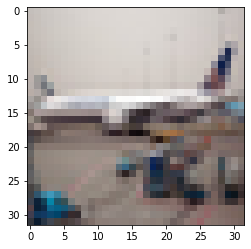

In [25]:
# возьмём картинку из датасета
dataiter = iter(trainloader)
image, labels = dataiter.next()

# show image
imshow(torchvision.utils.make_grid(image))

In [26]:
image = image.to("cpu")
result_image = cifar10_model(image)
result_image = result_image.to("cpu").detach()

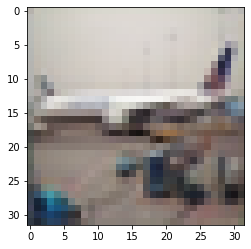

In [27]:
imshow(torchvision.utils.make_grid(result_image))

Применим модель к тестовой картинке.

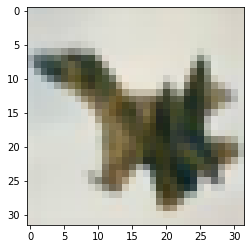

In [28]:
# get some random testing images
dataiter = iter(testloader)
image, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(image))

In [29]:
image = image.to("cpu")
result_image = cifar10_model(image)
result_image = result_image.to("cpu").detach()

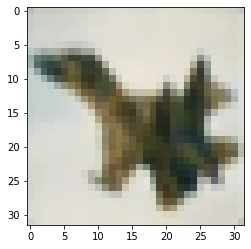

In [30]:
imshow(torchvision.utils.make_grid(result_image))

Применим к картинке из интернета.

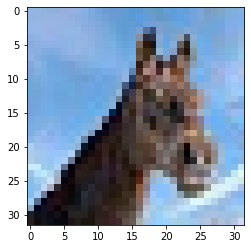

In [ ]:
# возьмём картинку из интернета 
from PIL import Image
import requests

image = Image.open(requests.get('https://github.com/alexk-git/dls-s1-project/blob/main/img/horse_head.jpg?raw=true', stream=True).raw)
image = transform(image)
image = image[None, :, :]
# show image
imshow(torchvision.utils.make_grid(image))

In [ ]:
image = image.to("cpu")
result_image = cifar10_model(image)
result_image = result_image.to("cpu").detach()

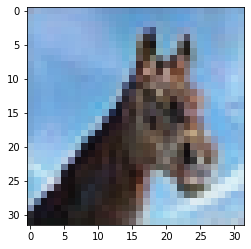

In [ ]:
imshow(torchvision.utils.make_grid(result_image))

В следующем ноутбуке 2_tiny_pix2pix_on_pytorch_AlexK.ipynb мы обучим и применим модель для чего-то более осмысленного - генерации цветной картинки cifar10 из чернобелой. Stay tuned!

In [ ]:
# если нужно скачать модель:
# from google.colab import files
# files.download('pytorch_models/pix2pix_generator_cifar10.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>